**Chapter 3 – Classification**

_This notebook contains all the sample code and solutions to the exercises in chapter 3._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/notyetend/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [138]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [139]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [140]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [141]:
y.shape

(70000,)

In [142]:
28 * 28

784

Saving figure some_digit_plot


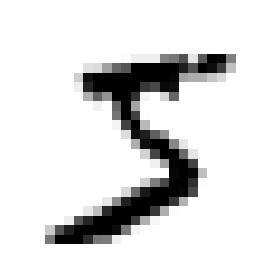

In [143]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [144]:
y[0]

'5'

In [145]:
y = y.astype(np.uint8)

In [146]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [147]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


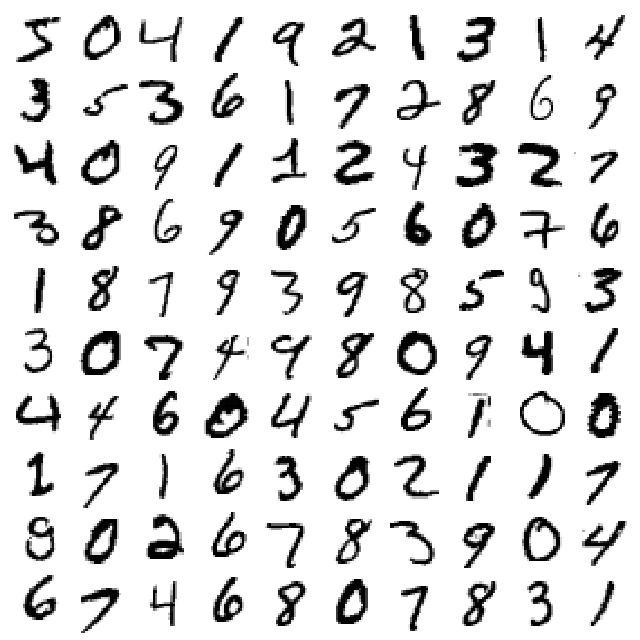

In [148]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [149]:
y[0]

5

###### 왜 6만개만 사용하지?

In [150]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

###### 우선 2항 분류만 하기 위해서 숫자 그림이 5인지 아닌지로 나눈다.

# Binary classifier

In [151]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [152]:
y_train_5

array([ True, False, False, ...,  True, False, False])

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

###### SGD는 바로 그 Stochastic Gradient Descent인가? 이게 왜 여기서 나와?     그게 아니라 regularized linear models with stochastic gradient descent (SGD)

In [153]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###### 2항 분류 문제로 바꿨기 때문에 예측 결과도 True/False이다.

In [154]:
sgd_clf.predict([some_digit])

array([ True])

###### 3-fold cv를 했을 때, 각 fold의 accuracy를 보여준다.

In [155]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

###### StratifiedKFold는 층화 K-fold? 인가? 어떤 feature를 기준으로 층을 나눌지 지정하는게 나오겠지? 그런데 바로 앞에서 cross_val_score를 사용하는 것과 뭐가 다르지? 같은걸 다른 방법으로 해본건가? 결과는 조금 다르네..

In [156]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [157]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

###### 헐~ 항상 False로만 예측하는 classifier에 대한 accuracy는 높다. 이건 False 샘플이 90%에 육박하기 때문이다.

In [158]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

###### cross_val_predict는 뭐하는 것인가?

> The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

> cv 셋을 나눌때 각 샘플은 딱 한번식만 test 셋에 들어가도록 나뉜다. 예를들어 1번부터 100번 샘플까지 있고 cv=4로 나눴다면, 1\~25, 25\~50, 51\~75, 76\~100 이렇게 4가지 test 셋이 존재할 수 있으며, 각 셈플이 테스트 셋에 속했을 때 예측값을 cross_val_predict가 반환한다.

In [159]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [160]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [161]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)  # 라벨, 예측값
# i-th row and j-th column entry indicates the number of samples with true label being i-th class and prediced label being j-th class.
# TP FN
# FP TN

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [162]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [163]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

###### 이 숫자는 뭐지?

In [164]:
4096 / (4096 + 1522)

0.7290850836596654

In [165]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [166]:
4096 / (4096 + 1325)

0.7555801512636044

In [167]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [168]:
4096 / (4096 + (1522 + 1325) / 2)

0.7420962043663375

###### 문서에는 decision_function에 대한 설명으로 'Predict confidence scores for samples.'라고 적혀 있다. confidence score는 뭘까?

> The confidence score for a sample is the signed distance of that sample to the hyperplane.

> 즉 공간을 나누는 하이퍼 플레인과 샘플간의 +-거리이다.

In [169]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [170]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [171]:
y_some_digit_pred

array([ True])

In [172]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

###### cross_val_predict을 이용해 각 샘플에 대한 어떤 값을 얻을지 method="decision_function"와 같은 방식으로 지정할 수 있구나
> 그런데 그냥 모델 학습시키고 predict하면 될거 같은데, cross_val_predict를 사용하는 이점이 있나???????

In [173]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

### precisions, recalls, thresholds

In [174]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [175]:
len(precisions), len(recalls), len(thresholds), len(y_train_5), len(y_scores)

# 이상하다. y_train_5와 y_scores는 6천개인데, 왜 precisions, recalls, thresholds는 그렇지 않을까?

(59967, 59967, 59966, 60000, 60000)

In [176]:
# F1-score를 추가해보자.
f1 = 2 * (precisions * recalls) / (precisions + recalls)
len(f1), max(f1), min(f1)

(59967, 0.7590702947845804, 0.0)

In [177]:
precisions >= 0.90

array([False, False, False, ...,  True,  True,  True])

In [178]:
np.argmax(precisions >= 0.90)

57075

In [179]:
np.argmin(precisions >= 0.90)

0

Saving figure precision_recall_vs_threshold_plot


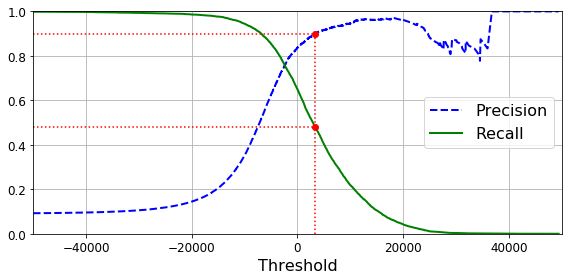

In [180]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [181]:
# y_scores는 결정면(decision plane)과의 +- 거리이다.
(y_train_pred == (y_scores > 0)).all()

True

###### F1-score도 그려보면 아래와 같다.

In [182]:
def get_f_beta_score(precisions, recalls, beta=1):
    return (1 + beta**2) * (precisions * recalls) / (beta**2 * precisions + recalls)

Saving figure precision_recall_vs_threshold_plot


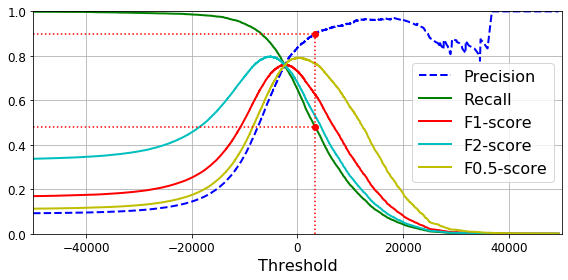

In [183]:
def plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds):
    f1 = get_f_beta_score(precisions, recalls, 1)
    f2 = get_f_beta_score(precisions, recalls, 2)
    f_half = get_f_beta_score(precisions, recalls, 0.5)
    
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.plot(thresholds, f1[:-1], "r-", label="F1-score", linewidth=2)
    plt.plot(thresholds, f2[:-1], "c-", label="F2-score", linewidth=2)
    plt.plot(thresholds, f_half[:-1], "y-", label="F0.5-score", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_f1_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

###### precision은 왜 threshold 2만 이상에서 찌그러지는걸까?
> 책 95 페이지(원서)에 있는 설명에 따르면, threshold를 높이다보면 precision의 분포에 해당하는 TP + FP가 줄어든다. 예를들어 TP/(TP+FP)가 4/5에서 3/4로 변하는 경우 precision 감소

###### threshold에 따른 FN, TP, FN, TN 건수도 그려본다.

In [184]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [185]:
def fast_confusion_matrix_with_threshold(y_true, y_scores, threshold):
    # fn: 1, 0
    # tp: 1, 1
    # fp: 0, 1
    # tn: 0, 0
    y_pred = y_scores >= threshold
    inv_y_true = np.invert(y_true)
    inv_y_pred = np.invert(y_pred)
    fn = sum(y_true * inv_y_pred)
    tp = sum(y_true * y_pred)
    fp = sum(inv_y_true * y_pred)
    tn = sum(inv_y_true * inv_y_pred)
    # TN FP
    # FN TP
    return {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

In [186]:
confusion_matrix(y_true, y_scores > 0)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [187]:
fast_confusion_matrix_with_threshold(y_true, y_scores, 0)

{'tn': 53892, 'fp': 687, 'fn': 1891, 'tp': 3530}

confs = [0] * len(thresholds)
for i, t in enumerate(thresholds):
    confs[i] = fast_confusion_matrix_with_threshold(y_train_5, y_scores, t)
    if i % 100 == 0:
        print(i)

In [191]:
confs = [{'tn': 34, 'fp': 54545, 'fn': 0, 'tp': 5421}, {'tn': 34, 'fp': 54545, 'fn': 1, 'tp': 5420}, {'tn': 35, 'fp': 54544, 'fn': 1, 'tp': 5420}, {'tn': 36, 'fp': 54543, 'fn': 1, 'tp': 5420}, {'tn': 37, 'fp': 54542, 'fn': 1, 'tp': 5420}, {'tn': 38, 'fp': 54541, 'fn': 1, 'tp': 5420}, {'tn': 39, 'fp': 54540, 'fn': 1, 'tp': 5420}, {'tn': 40, 'fp': 54539, 'fn': 1, 'tp': 5420}, {'tn': 41, 'fp': 54538, 'fn': 1, 'tp': 5420}, {'tn': 42, 'fp': 54537, 'fn': 1, 'tp': 5420}, {'tn': 43, 'fp': 54536, 'fn': 1, 'tp': 5420}, {'tn': 44, 'fp': 54535, 'fn': 1, 'tp': 5420}, {'tn': 45, 'fp': 54534, 'fn': 1, 'tp': 5420}, {'tn': 46, 'fp': 54533, 'fn': 1, 'tp': 5420}, {'tn': 47, 'fp': 54532, 'fn': 1, 'tp': 5420}, {'tn': 48, 'fp': 54531, 'fn': 1, 'tp': 5420}, {'tn': 49, 'fp': 54530, 'fn': 1, 'tp': 5420}, {'tn': 50, 'fp': 54529, 'fn': 1, 'tp': 5420}, {'tn': 51, 'fp': 54528, 'fn': 1, 'tp': 5420}, {'tn': 52, 'fp': 54527, 'fn': 1, 'tp': 5420}, {'tn': 53, 'fp': 54526, 'fn': 1, 'tp': 5420}, {'tn': 54, 'fp': 54525, 'fn': 1, 'tp': 5420}, {'tn': 55, 'fp': 54524, 'fn': 1, 'tp': 5420}, {'tn': 56, 'fp': 54523, 'fn': 1, 'tp': 5420}, {'tn': 57, 'fp': 54522, 'fn': 1, 'tp': 5420}, {'tn': 58, 'fp': 54521, 'fn': 1, 'tp': 5420}, {'tn': 59, 'fp': 54520, 'fn': 1, 'tp': 5420}, {'tn': 60, 'fp': 54519, 'fn': 1, 'tp': 5420}, {'tn': 61, 'fp': 54518, 'fn': 1, 'tp': 5420}, {'tn': 62, 'fp': 54517, 'fn': 1, 'tp': 5420}, {'tn': 63, 'fp': 54516, 'fn': 1, 'tp': 5420}, {'tn': 64, 'fp': 54515, 'fn': 1, 'tp': 5420}, {'tn': 65, 'fp': 54514, 'fn': 1, 'tp': 5420}, {'tn': 66, 'fp': 54513, 'fn': 1, 'tp': 5420}, {'tn': 67, 'fp': 54512, 'fn': 1, 'tp': 5420}, {'tn': 68, 'fp': 54511, 'fn': 1, 'tp': 5420}, {'tn': 69, 'fp': 54510, 'fn': 1, 'tp': 5420}, {'tn': 70, 'fp': 54509, 'fn': 1, 'tp': 5420}, {'tn': 71, 'fp': 54508, 'fn': 1, 'tp': 5420}, {'tn': 72, 'fp': 54507, 'fn': 1, 'tp': 5420}, {'tn': 73, 'fp': 54506, 'fn': 1, 'tp': 5420}, {'tn': 74, 'fp': 54505, 'fn': 1, 'tp': 5420}, {'tn': 75, 'fp': 54504, 'fn': 1, 'tp': 5420}, {'tn': 76, 'fp': 54503, 'fn': 1, 'tp': 5420}, {'tn': 77, 'fp': 54502, 'fn': 1, 'tp': 5420}, {'tn': 78, 'fp': 54501, 'fn': 1, 'tp': 5420}, {'tn': 79, 'fp': 54500, 'fn': 1, 'tp': 5420}, {'tn': 80, 'fp': 54499, 'fn': 1, 'tp': 5420}, {'tn': 81, 'fp': 54498, 'fn': 1, 'tp': 5420}, {'tn': 82, 'fp': 54497, 'fn': 1, 'tp': 5420}, {'tn': 83, 'fp': 54496, 'fn': 1, 'tp': 5420}, {'tn': 84, 'fp': 54495, 'fn': 1, 'tp': 5420}, {'tn': 85, 'fp': 54494, 'fn': 1, 'tp': 5420}, {'tn': 86, 'fp': 54493, 'fn': 1, 'tp': 5420}, {'tn': 87, 'fp': 54492, 'fn': 1, 'tp': 5420}, {'tn': 88, 'fp': 54491, 'fn': 1, 'tp': 5420}, {'tn': 89, 'fp': 54490, 'fn': 1, 'tp': 5420}, {'tn': 90, 'fp': 54489, 'fn': 1, 'tp': 5420}, {'tn': 91, 'fp': 54488, 'fn': 1, 'tp': 5420}, {'tn': 92, 'fp': 54487, 'fn': 1, 'tp': 5420}, {'tn': 93, 'fp': 54486, 'fn': 1, 'tp': 5420}, {'tn': 94, 'fp': 54485, 'fn': 1, 'tp': 5420}, {'tn': 95, 'fp': 54484, 'fn': 1, 'tp': 5420}, {'tn': 96, 'fp': 54483, 'fn': 1, 'tp': 5420}, {'tn': 97, 'fp': 54482, 'fn': 1, 'tp': 5420}, {'tn': 98, 'fp': 54481, 'fn': 1, 'tp': 5420}, {'tn': 99, 'fp': 54480, 'fn': 1, 'tp': 5420}, {'tn': 100, 'fp': 54479, 'fn': 1, 'tp': 5420}, {'tn': 101, 'fp': 54478, 'fn': 1, 'tp': 5420}, {'tn': 102, 'fp': 54477, 'fn': 1, 'tp': 5420}, {'tn': 103, 'fp': 54476, 'fn': 1, 'tp': 5420}, {'tn': 104, 'fp': 54475, 'fn': 1, 'tp': 5420}, {'tn': 105, 'fp': 54474, 'fn': 1, 'tp': 5420}, {'tn': 106, 'fp': 54473, 'fn': 1, 'tp': 5420}, {'tn': 107, 'fp': 54472, 'fn': 1, 'tp': 5420}, {'tn': 108, 'fp': 54471, 'fn': 1, 'tp': 5420}, {'tn': 109, 'fp': 54470, 'fn': 1, 'tp': 5420}, {'tn': 110, 'fp': 54469, 'fn': 1, 'tp': 5420}, {'tn': 111, 'fp': 54468, 'fn': 1, 'tp': 5420}, {'tn': 112, 'fp': 54467, 'fn': 1, 'tp': 5420}, {'tn': 113, 'fp': 54466, 'fn': 1, 'tp': 5420}, {'tn': 114, 'fp': 54465, 'fn': 1, 'tp': 5420}, {'tn': 115, 'fp': 54464, 'fn': 1, 'tp': 5420}, {'tn': 116, 'fp': 54463, 'fn': 1, 'tp': 5420}, {'tn': 117, 'fp': 54462, 'fn': 1, 'tp': 5420}, {'tn': 118, 'fp': 54461, 'fn': 1, 'tp': 5420}, {'tn': 119, 'fp': 54460, 'fn': 1, 'tp': 5420}, {'tn': 120, 'fp': 54459, 'fn': 1, 'tp': 5420}, {'tn': 121, 'fp': 54458, 'fn': 1, 'tp': 5420}, {'tn': 122, 'fp': 54457, 'fn': 1, 'tp': 5420}, {'tn': 123, 'fp': 54456, 'fn': 1, 'tp': 5420}, {'tn': 124, 'fp': 54455, 'fn': 1, 'tp': 5420}, {'tn': 125, 'fp': 54454, 'fn': 1, 'tp': 5420}, {'tn': 126, 'fp': 54453, 'fn': 1, 'tp': 5420}, {'tn': 127, 'fp': 54452, 'fn': 1, 'tp': 5420}, {'tn': 128, 'fp': 54451, 'fn': 1, 'tp': 5420}, {'tn': 129, 'fp': 54450, 'fn': 1, 'tp': 5420}, {'tn': 130, 'fp': 54449, 'fn': 1, 'tp': 5420}, {'tn': 131, 'fp': 54448, 'fn': 1, 'tp': 5420}, {'tn': 132, 'fp': 54447, 'fn': 1, 'tp': 5420}, {'tn': 133, 'fp': 54446, 'fn': 1, 'tp': 5420}, {'tn': 134, 'fp': 54445, 'fn': 1, 'tp': 5420}, {'tn': 135, 'fp': 54444, 'fn': 1, 'tp': 5420}, {'tn': 136, 'fp': 54443, 'fn': 1, 'tp': 5420}, {'tn': 137, 'fp': 54442, 'fn': 1, 'tp': 5420}, {'tn': 138, 'fp': 54441, 'fn': 1, 'tp': 5420}, {'tn': 139, 'fp': 54440, 'fn': 1, 'tp': 5420}, {'tn': 140, 'fp': 54439, 'fn': 1, 'tp': 5420}, {'tn': 141, 'fp': 54438, 'fn': 1, 'tp': 5420}, {'tn': 142, 'fp': 54437, 'fn': 1, 'tp': 5420}, {'tn': 143, 'fp': 54436, 'fn': 1, 'tp': 5420}, {'tn': 144, 'fp': 54435, 'fn': 1, 'tp': 5420}, {'tn': 145, 'fp': 54434, 'fn': 1, 'tp': 5420}, {'tn': 146, 'fp': 54433, 'fn': 1, 'tp': 5420}, {'tn': 147, 'fp': 54432, 'fn': 1, 'tp': 5420}, {'tn': 148, 'fp': 54431, 'fn': 1, 'tp': 5420}, {'tn': 149, 'fp': 54430, 'fn': 1, 'tp': 5420}, {'tn': 150, 'fp': 54429, 'fn': 1, 'tp': 5420}, {'tn': 151, 'fp': 54428, 'fn': 1, 'tp': 5420}, {'tn': 152, 'fp': 54427, 'fn': 1, 'tp': 5420}, {'tn': 152, 'fp': 54427, 'fn': 2, 'tp': 5419}, {'tn': 153, 'fp': 54426, 'fn': 2, 'tp': 5419}, {'tn': 154, 'fp': 54425, 'fn': 2, 'tp': 5419}, {'tn': 155, 'fp': 54424, 'fn': 2, 'tp': 5419}, {'tn': 156, 'fp': 54423, 'fn': 2, 'tp': 5419}, {'tn': 157, 'fp': 54422, 'fn': 2, 'tp': 5419}, {'tn': 158, 'fp': 54421, 'fn': 2, 'tp': 5419}, {'tn': 159, 'fp': 54420, 'fn': 2, 'tp': 5419}, {'tn': 160, 'fp': 54419, 'fn': 2, 'tp': 5419}, {'tn': 161, 'fp': 54418, 'fn': 2, 'tp': 5419}, {'tn': 162, 'fp': 54417, 'fn': 2, 'tp': 5419}, {'tn': 163, 'fp': 54416, 'fn': 2, 'tp': 5419}, {'tn': 164, 'fp': 54415, 'fn': 2, 'tp': 5419}, {'tn': 165, 'fp': 54414, 'fn': 2, 'tp': 5419}, {'tn': 166, 'fp': 54413, 'fn': 2, 'tp': 5419}, {'tn': 167, 'fp': 54412, 'fn': 2, 'tp': 5419}, {'tn': 168, 'fp': 54411, 'fn': 2, 'tp': 5419}, {'tn': 169, 'fp': 54410, 'fn': 2, 'tp': 5419}, {'tn': 170, 'fp': 54409, 'fn': 2, 'tp': 5419}, {'tn': 171, 'fp': 54408, 'fn': 2, 'tp': 5419}, {'tn': 172, 'fp': 54407, 'fn': 2, 'tp': 5419}, {'tn': 173, 'fp': 54406, 'fn': 2, 'tp': 5419}, {'tn': 174, 'fp': 54405, 'fn': 2, 'tp': 5419}, {'tn': 175, 'fp': 54404, 'fn': 2, 'tp': 5419}, {'tn': 176, 'fp': 54403, 'fn': 2, 'tp': 5419}, {'tn': 177, 'fp': 54402, 'fn': 2, 'tp': 5419}, {'tn': 178, 'fp': 54401, 'fn': 2, 'tp': 5419}, {'tn': 179, 'fp': 54400, 'fn': 2, 'tp': 5419}, {'tn': 180, 'fp': 54399, 'fn': 2, 'tp': 5419}, {'tn': 181, 'fp': 54398, 'fn': 2, 'tp': 5419}, {'tn': 182, 'fp': 54397, 'fn': 2, 'tp': 5419}, {'tn': 183, 'fp': 54396, 'fn': 2, 'tp': 5419}, {'tn': 184, 'fp': 54395, 'fn': 2, 'tp': 5419}, {'tn': 185, 'fp': 54394, 'fn': 2, 'tp': 5419}, {'tn': 186, 'fp': 54393, 'fn': 2, 'tp': 5419}, {'tn': 187, 'fp': 54392, 'fn': 2, 'tp': 5419}, {'tn': 188, 'fp': 54391, 'fn': 2, 'tp': 5419}, {'tn': 189, 'fp': 54390, 'fn': 2, 'tp': 5419}, {'tn': 190, 'fp': 54389, 'fn': 2, 'tp': 5419}, {'tn': 191, 'fp': 54388, 'fn': 2, 'tp': 5419}, {'tn': 192, 'fp': 54387, 'fn': 2, 'tp': 5419}, {'tn': 193, 'fp': 54386, 'fn': 2, 'tp': 5419}, {'tn': 194, 'fp': 54385, 'fn': 2, 'tp': 5419}, {'tn': 195, 'fp': 54384, 'fn': 2, 'tp': 5419}, {'tn': 196, 'fp': 54383, 'fn': 2, 'tp': 5419}, {'tn': 197, 'fp': 54382, 'fn': 2, 'tp': 5419}, {'tn': 198, 'fp': 54381, 'fn': 2, 'tp': 5419}, {'tn': 199, 'fp': 54380, 'fn': 2, 'tp': 5419}, {'tn': 200, 'fp': 54379, 'fn': 2, 'tp': 5419}, {'tn': 201, 'fp': 54378, 'fn': 2, 'tp': 5419}, {'tn': 202, 'fp': 54377, 'fn': 2, 'tp': 5419}, {'tn': 203, 'fp': 54376, 'fn': 2, 'tp': 5419}, {'tn': 204, 'fp': 54375, 'fn': 2, 'tp': 5419}, {'tn': 205, 'fp': 54374, 'fn': 2, 'tp': 5419}, {'tn': 206, 'fp': 54373, 'fn': 2, 'tp': 5419}, {'tn': 207, 'fp': 54372, 'fn': 2, 'tp': 5419}, {'tn': 208, 'fp': 54371, 'fn': 2, 'tp': 5419}, {'tn': 209, 'fp': 54370, 'fn': 2, 'tp': 5419}, {'tn': 210, 'fp': 54369, 'fn': 2, 'tp': 5419}, {'tn': 211, 'fp': 54368, 'fn': 2, 'tp': 5419}, {'tn': 212, 'fp': 54367, 'fn': 2, 'tp': 5419}, {'tn': 213, 'fp': 54366, 'fn': 2, 'tp': 5419}, {'tn': 214, 'fp': 54365, 'fn': 2, 'tp': 5419}, {'tn': 215, 'fp': 54364, 'fn': 2, 'tp': 5419}, {'tn': 216, 'fp': 54363, 'fn': 2, 'tp': 5419}, {'tn': 217, 'fp': 54362, 'fn': 2, 'tp': 5419}, {'tn': 218, 'fp': 54361, 'fn': 2, 'tp': 5419}, {'tn': 219, 'fp': 54360, 'fn': 2, 'tp': 5419}, {'tn': 220, 'fp': 54359, 'fn': 2, 'tp': 5419}, {'tn': 221, 'fp': 54358, 'fn': 2, 'tp': 5419}, {'tn': 222, 'fp': 54357, 'fn': 2, 'tp': 5419}, {'tn': 223, 'fp': 54356, 'fn': 2, 'tp': 5419}, {'tn': 224, 'fp': 54355, 'fn': 2, 'tp': 5419}, {'tn': 225, 'fp': 54354, 'fn': 2, 'tp': 5419}, {'tn': 226, 'fp': 54353, 'fn': 2, 'tp': 5419}, {'tn': 227, 'fp': 54352, 'fn': 2, 'tp': 5419}, {'tn': 228, 'fp': 54351, 'fn': 2, 'tp': 5419}, {'tn': 229, 'fp': 54350, 'fn': 2, 'tp': 5419}, {'tn': 230, 'fp': 54349, 'fn': 2, 'tp': 5419}, {'tn': 231, 'fp': 54348, 'fn': 2, 'tp': 5419}, {'tn': 232, 'fp': 54347, 'fn': 2, 'tp': 5419}, {'tn': 233, 'fp': 54346, 'fn': 2, 'tp': 5419}, {'tn': 234, 'fp': 54345, 'fn': 2, 'tp': 5419}, {'tn': 235, 'fp': 54344, 'fn': 2, 'tp': 5419}, {'tn': 236, 'fp': 54343, 'fn': 2, 'tp': 5419}, {'tn': 237, 'fp': 54342, 'fn': 2, 'tp': 5419}, {'tn': 238, 'fp': 54341, 'fn': 2, 'tp': 5419}, {'tn': 239, 'fp': 54340, 'fn': 2, 'tp': 5419}, {'tn': 240, 'fp': 54339, 'fn': 2, 'tp': 5419}, {'tn': 241, 'fp': 54338, 'fn': 2, 'tp': 5419}, {'tn': 242, 'fp': 54337, 'fn': 2, 'tp': 5419}, {'tn': 243, 'fp': 54336, 'fn': 2, 'tp': 5419}, {'tn': 244, 'fp': 54335, 'fn': 2, 'tp': 5419}, {'tn': 245, 'fp': 54334, 'fn': 2, 'tp': 5419}, {'tn': 246, 'fp': 54333, 'fn': 2, 'tp': 5419}, {'tn': 247, 'fp': 54332, 'fn': 2, 'tp': 5419}, {'tn': 248, 'fp': 54331, 'fn': 2, 'tp': 5419}, {'tn': 249, 'fp': 54330, 'fn': 2, 'tp': 5419}, {'tn': 250, 'fp': 54329, 'fn': 2, 'tp': 5419}, {'tn': 251, 'fp': 54328, 'fn': 2, 'tp': 5419}, {'tn': 252, 'fp': 54327, 'fn': 2, 'tp': 5419}, {'tn': 253, 'fp': 54326, 'fn': 2, 'tp': 5419}, {'tn': 254, 'fp': 54325, 'fn': 2, 'tp': 5419}, {'tn': 255, 'fp': 54324, 'fn': 2, 'tp': 5419}, {'tn': 256, 'fp': 54323, 'fn': 2, 'tp': 5419}, {'tn': 257, 'fp': 54322, 'fn': 2, 'tp': 5419}, {'tn': 258, 'fp': 54321, 'fn': 2, 'tp': 5419}, {'tn': 259, 'fp': 54320, 'fn': 2, 'tp': 5419}, {'tn': 260, 'fp': 54319, 'fn': 2, 'tp': 5419}, {'tn': 261, 'fp': 54318, 'fn': 2, 'tp': 5419}, {'tn': 262, 'fp': 54317, 'fn': 2, 'tp': 5419}, {'tn': 263, 'fp': 54316, 'fn': 2, 'tp': 5419}, {'tn': 264, 'fp': 54315, 'fn': 2, 'tp': 5419}, {'tn': 265, 'fp': 54314, 'fn': 2, 'tp': 5419}, {'tn': 266, 'fp': 54313, 'fn': 2, 'tp': 5419}, {'tn': 267, 'fp': 54312, 'fn': 2, 'tp': 5419}, {'tn': 268, 'fp': 54311, 'fn': 2, 'tp': 5419}, {'tn': 269, 'fp': 54310, 'fn': 2, 'tp': 5419}, {'tn': 270, 'fp': 54309, 'fn': 2, 'tp': 5419}, {'tn': 271, 'fp': 54308, 'fn': 2, 'tp': 5419}, {'tn': 272, 'fp': 54307, 'fn': 2, 'tp': 5419}, {'tn': 273, 'fp': 54306, 'fn': 2, 'tp': 5419}, {'tn': 274, 'fp': 54305, 'fn': 2, 'tp': 5419}, {'tn': 275, 'fp': 54304, 'fn': 2, 'tp': 5419}, {'tn': 275, 'fp': 54304, 'fn': 3, 'tp': 5418}, {'tn': 276, 'fp': 54303, 'fn': 3, 'tp': 5418}, {'tn': 277, 'fp': 54302, 'fn': 3, 'tp': 5418}, {'tn': 278, 'fp': 54301, 'fn': 3, 'tp': 5418}, {'tn': 279, 'fp': 54300, 'fn': 3, 'tp': 5418}, {'tn': 280, 'fp': 54299, 'fn': 3, 'tp': 5418}, {'tn': 281, 'fp': 54298, 'fn': 3, 'tp': 5418}, {'tn': 282, 'fp': 54297, 'fn': 3, 'tp': 5418}, {'tn': 283, 'fp': 54296, 'fn': 3, 'tp': 5418}, {'tn': 284, 'fp': 54295, 'fn': 3, 'tp': 5418}, {'tn': 285, 'fp': 54294, 'fn': 3, 'tp': 5418}, {'tn': 286, 'fp': 54293, 'fn': 3, 'tp': 5418}, {'tn': 287, 'fp': 54292, 'fn': 3, 'tp': 5418}, {'tn': 288, 'fp': 54291, 'fn': 3, 'tp': 5418}, {'tn': 289, 'fp': 54290, 'fn': 3, 'tp': 5418}, {'tn': 290, 'fp': 54289, 'fn': 3, 'tp': 5418}, {'tn': 291, 'fp': 54288, 'fn': 3, 'tp': 5418}, {'tn': 292, 'fp': 54287, 'fn': 3, 'tp': 5418}, {'tn': 293, 'fp': 54286, 'fn': 3, 'tp': 5418}, {'tn': 294, 'fp': 54285, 'fn': 3, 'tp': 5418}, {'tn': 295, 'fp': 54284, 'fn': 3, 'tp': 5418}, {'tn': 296, 'fp': 54283, 'fn': 3, 'tp': 5418}, {'tn': 297, 'fp': 54282, 'fn': 3, 'tp': 5418}, {'tn': 298, 'fp': 54281, 'fn': 3, 'tp': 5418}, {'tn': 299, 'fp': 54280, 'fn': 3, 'tp': 5418}, {'tn': 300, 'fp': 54279, 'fn': 3, 'tp': 5418}, {'tn': 301, 'fp': 54278, 'fn': 3, 'tp': 5418}, {'tn': 302, 'fp': 54277, 'fn': 3, 'tp': 5418}, {'tn': 303, 'fp': 54276, 'fn': 3, 'tp': 5418}, {'tn': 304, 'fp': 54275, 'fn': 3, 'tp': 5418}, {'tn': 305, 'fp': 54274, 'fn': 3, 'tp': 5418}, {'tn': 306, 'fp': 54273, 'fn': 3, 'tp': 5418}, {'tn': 307, 'fp': 54272, 'fn': 3, 'tp': 5418}, {'tn': 308, 'fp': 54271, 'fn': 3, 'tp': 5418}, {'tn': 309, 'fp': 54270, 'fn': 3, 'tp': 5418}, {'tn': 310, 'fp': 54269, 'fn': 3, 'tp': 5418}, {'tn': 311, 'fp': 54268, 'fn': 3, 'tp': 5418}, {'tn': 312, 'fp': 54267, 'fn': 3, 'tp': 5418}, {'tn': 313, 'fp': 54266, 'fn': 3, 'tp': 5418}, {'tn': 314, 'fp': 54265, 'fn': 3, 'tp': 5418}, {'tn': 315, 'fp': 54264, 'fn': 3, 'tp': 5418}, {'tn': 316, 'fp': 54263, 'fn': 3, 'tp': 5418}, {'tn': 317, 'fp': 54262, 'fn': 3, 'tp': 5418}, {'tn': 318, 'fp': 54261, 'fn': 3, 'tp': 5418}, {'tn': 319, 'fp': 54260, 'fn': 3, 'tp': 5418}, {'tn': 320, 'fp': 54259, 'fn': 3, 'tp': 5418}, {'tn': 321, 'fp': 54258, 'fn': 3, 'tp': 5418}, {'tn': 322, 'fp': 54257, 'fn': 3, 'tp': 5418}, {'tn': 323, 'fp': 54256, 'fn': 3, 'tp': 5418}, {'tn': 324, 'fp': 54255, 'fn': 3, 'tp': 5418}, {'tn': 325, 'fp': 54254, 'fn': 3, 'tp': 5418}, {'tn': 326, 'fp': 54253, 'fn': 3, 'tp': 5418}, {'tn': 327, 'fp': 54252, 'fn': 3, 'tp': 5418}, {'tn': 328, 'fp': 54251, 'fn': 3, 'tp': 5418}, {'tn': 329, 'fp': 54250, 'fn': 3, 'tp': 5418}, {'tn': 330, 'fp': 54249, 'fn': 3, 'tp': 5418}, {'tn': 331, 'fp': 54248, 'fn': 3, 'tp': 5418}, {'tn': 332, 'fp': 54247, 'fn': 3, 'tp': 5418}, {'tn': 333, 'fp': 54246, 'fn': 3, 'tp': 5418}, {'tn': 334, 'fp': 54245, 'fn': 3, 'tp': 5418}, {'tn': 335, 'fp': 54244, 'fn': 3, 'tp': 5418}, {'tn': 336, 'fp': 54243, 'fn': 3, 'tp': 5418}, {'tn': 337, 'fp': 54242, 'fn': 3, 'tp': 5418}, {'tn': 338, 'fp': 54241, 'fn': 3, 'tp': 5418}, {'tn': 339, 'fp': 54240, 'fn': 3, 'tp': 5418}, {'tn': 340, 'fp': 54239, 'fn': 3, 'tp': 5418}, {'tn': 341, 'fp': 54238, 'fn': 3, 'tp': 5418}, {'tn': 342, 'fp': 54237, 'fn': 3, 'tp': 5418}, {'tn': 343, 'fp': 54236, 'fn': 3, 'tp': 5418}, {'tn': 344, 'fp': 54235, 'fn': 3, 'tp': 5418}, {'tn': 345, 'fp': 54234, 'fn': 3, 'tp': 5418}, {'tn': 346, 'fp': 54233, 'fn': 3, 'tp': 5418}, {'tn': 347, 'fp': 54232, 'fn': 3, 'tp': 5418}, {'tn': 348, 'fp': 54231, 'fn': 3, 'tp': 5418}, {'tn': 349, 'fp': 54230, 'fn': 3, 'tp': 5418}, {'tn': 350, 'fp': 54229, 'fn': 3, 'tp': 5418}, {'tn': 351, 'fp': 54228, 'fn': 3, 'tp': 5418}, {'tn': 352, 'fp': 54227, 'fn': 3, 'tp': 5418}, {'tn': 353, 'fp': 54226, 'fn': 3, 'tp': 5418}, {'tn': 354, 'fp': 54225, 'fn': 3, 'tp': 5418}, {'tn': 355, 'fp': 54224, 'fn': 3, 'tp': 5418}, {'tn': 356, 'fp': 54223, 'fn': 3, 'tp': 5418}, {'tn': 357, 'fp': 54222, 'fn': 3, 'tp': 5418}, {'tn': 358, 'fp': 54221, 'fn': 3, 'tp': 5418}, {'tn': 359, 'fp': 54220, 'fn': 3, 'tp': 5418}, {'tn': 360, 'fp': 54219, 'fn': 3, 'tp': 5418}, {'tn': 361, 'fp': 54218, 'fn': 3, 'tp': 5418}, {'tn': 362, 'fp': 54217, 'fn': 3, 'tp': 5418}, {'tn': 363, 'fp': 54216, 'fn': 3, 'tp': 5418}, {'tn': 364, 'fp': 54215, 'fn': 3, 'tp': 5418}, {'tn': 365, 'fp': 54214, 'fn': 3, 'tp': 5418}, {'tn': 366, 'fp': 54213, 'fn': 3, 'tp': 5418}, {'tn': 367, 'fp': 54212, 'fn': 3, 'tp': 5418}, {'tn': 368, 'fp': 54211, 'fn': 3, 'tp': 5418}, {'tn': 369, 'fp': 54210, 'fn': 3, 'tp': 5418}, {'tn': 370, 'fp': 54209, 'fn': 3, 'tp': 5418}, {'tn': 371, 'fp': 54208, 'fn': 3, 'tp': 5418}, {'tn': 372, 'fp': 54207, 'fn': 3, 'tp': 5418}, {'tn': 373, 'fp': 54206, 'fn': 3, 'tp': 5418}, {'tn': 374, 'fp': 54205, 'fn': 3, 'tp': 5418}, {'tn': 375, 'fp': 54204, 'fn': 3, 'tp': 5418}, {'tn': 376, 'fp': 54203, 'fn': 3, 'tp': 5418}, {'tn': 377, 'fp': 54202, 'fn': 3, 'tp': 5418}, {'tn': 378, 'fp': 54201, 'fn': 3, 'tp': 5418}, {'tn': 379, 'fp': 54200, 'fn': 3, 'tp': 5418}, {'tn': 380, 'fp': 54199, 'fn': 3, 'tp': 5418}, {'tn': 381, 'fp': 54198, 'fn': 3, 'tp': 5418}, {'tn': 382, 'fp': 54197, 'fn': 3, 'tp': 5418}, {'tn': 383, 'fp': 54196, 'fn': 3, 'tp': 5418}, {'tn': 384, 'fp': 54195, 'fn': 3, 'tp': 5418}, {'tn': 385, 'fp': 54194, 'fn': 3, 'tp': 5418}, {'tn': 386, 'fp': 54193, 'fn': 3, 'tp': 5418}, {'tn': 387, 'fp': 54192, 'fn': 3, 'tp': 5418}, {'tn': 388, 'fp': 54191, 'fn': 3, 'tp': 5418}, {'tn': 389, 'fp': 54190, 'fn': 3, 'tp': 5418}, {'tn': 390, 'fp': 54189, 'fn': 3, 'tp': 5418}, {'tn': 391, 'fp': 54188, 'fn': 3, 'tp': 5418}, {'tn': 392, 'fp': 54187, 'fn': 3, 'tp': 5418}, {'tn': 393, 'fp': 54186, 'fn': 3, 'tp': 5418}, {'tn': 394, 'fp': 54185, 'fn': 3, 'tp': 5418}, {'tn': 395, 'fp': 54184, 'fn': 3, 'tp': 5418}, {'tn': 396, 'fp': 54183, 'fn': 3, 'tp': 5418}, {'tn': 397, 'fp': 54182, 'fn': 3, 'tp': 5418}, {'tn': 398, 'fp': 54181, 'fn': 3, 'tp': 5418}, {'tn': 399, 'fp': 54180, 'fn': 3, 'tp': 5418}, {'tn': 400, 'fp': 54179, 'fn': 3, 'tp': 5418}, {'tn': 401, 'fp': 54178, 'fn': 3, 'tp': 5418}, {'tn': 402, 'fp': 54177, 'fn': 3, 'tp': 5418}, {'tn': 403, 'fp': 54176, 'fn': 3, 'tp': 5418}, {'tn': 404, 'fp': 54175, 'fn': 3, 'tp': 5418}, {'tn': 405, 'fp': 54174, 'fn': 3, 'tp': 5418}, {'tn': 406, 'fp': 54173, 'fn': 3, 'tp': 5418}, {'tn': 407, 'fp': 54172, 'fn': 3, 'tp': 5418}, {'tn': 408, 'fp': 54171, 'fn': 3, 'tp': 5418}, {'tn': 409, 'fp': 54170, 'fn': 3, 'tp': 5418}, {'tn': 410, 'fp': 54169, 'fn': 3, 'tp': 5418}, {'tn': 411, 'fp': 54168, 'fn': 3, 'tp': 5418}, {'tn': 412, 'fp': 54167, 'fn': 3, 'tp': 5418}, {'tn': 413, 'fp': 54166, 'fn': 3, 'tp': 5418}, {'tn': 414, 'fp': 54165, 'fn': 3, 'tp': 5418}, {'tn': 415, 'fp': 54164, 'fn': 3, 'tp': 5418}, {'tn': 416, 'fp': 54163, 'fn': 3, 'tp': 5418}, {'tn': 417, 'fp': 54162, 'fn': 3, 'tp': 5418}, {'tn': 418, 'fp': 54161, 'fn': 3, 'tp': 5418}, {'tn': 419, 'fp': 54160, 'fn': 3, 'tp': 5418}, {'tn': 420, 'fp': 54159, 'fn': 3, 'tp': 5418}, {'tn': 421, 'fp': 54158, 'fn': 3, 'tp': 5418}, {'tn': 422, 'fp': 54157, 'fn': 3, 'tp': 5418}, {'tn': 423, 'fp': 54156, 'fn': 3, 'tp': 5418}, {'tn': 424, 'fp': 54155, 'fn': 3, 'tp': 5418}, {'tn': 425, 'fp': 54154, 'fn': 3, 'tp': 5418}, {'tn': 426, 'fp': 54153, 'fn': 3, 'tp': 5418}, {'tn': 427, 'fp': 54152, 'fn': 3, 'tp': 5418}, {'tn': 428, 'fp': 54151, 'fn': 3, 'tp': 5418}, {'tn': 429, 'fp': 54150, 'fn': 3, 'tp': 5418}, {'tn': 430, 'fp': 54149, 'fn': 3, 'tp': 5418}, {'tn': 431, 'fp': 54148, 'fn': 3, 'tp': 5418}, {'tn': 432, 'fp': 54147, 'fn': 3, 'tp': 5418}, {'tn': 433, 'fp': 54146, 'fn': 3, 'tp': 5418}, {'tn': 434, 'fp': 54145, 'fn': 3, 'tp': 5418}, {'tn': 435, 'fp': 54144, 'fn': 3, 'tp': 5418}, {'tn': 436, 'fp': 54143, 'fn': 3, 'tp': 5418}, {'tn': 437, 'fp': 54142, 'fn': 3, 'tp': 5418}, {'tn': 438, 'fp': 54141, 'fn': 3, 'tp': 5418}, {'tn': 439, 'fp': 54140, 'fn': 3, 'tp': 5418}, {'tn': 440, 'fp': 54139, 'fn': 3, 'tp': 5418}, {'tn': 441, 'fp': 54138, 'fn': 3, 'tp': 5418}, {'tn': 442, 'fp': 54137, 'fn': 3, 'tp': 5418}, {'tn': 443, 'fp': 54136, 'fn': 3, 'tp': 5418}, {'tn': 444, 'fp': 54135, 'fn': 3, 'tp': 5418}, {'tn': 445, 'fp': 54134, 'fn': 3, 'tp': 5418}, {'tn': 446, 'fp': 54133, 'fn': 3, 'tp': 5418}, {'tn': 447, 'fp': 54132, 'fn': 3, 'tp': 5418}, {'tn': 448, 'fp': 54131, 'fn': 3, 'tp': 5418}, {'tn': 449, 'fp': 54130, 'fn': 3, 'tp': 5418}, {'tn': 450, 'fp': 54129, 'fn': 3, 'tp': 5418}, {'tn': 451, 'fp': 54128, 'fn': 3, 'tp': 5418}, {'tn': 452, 'fp': 54127, 'fn': 3, 'tp': 5418}, {'tn': 453, 'fp': 54126, 'fn': 3, 'tp': 5418}, {'tn': 454, 'fp': 54125, 'fn': 3, 'tp': 5418}, {'tn': 455, 'fp': 54124, 'fn': 3, 'tp': 5418}, {'tn': 456, 'fp': 54123, 'fn': 3, 'tp': 5418}, {'tn': 457, 'fp': 54122, 'fn': 3, 'tp': 5418}, {'tn': 458, 'fp': 54121, 'fn': 3, 'tp': 5418}, {'tn': 459, 'fp': 54120, 'fn': 3, 'tp': 5418}, {'tn': 460, 'fp': 54119, 'fn': 3, 'tp': 5418}, {'tn': 461, 'fp': 54118, 'fn': 3, 'tp': 5418}, {'tn': 462, 'fp': 54117, 'fn': 3, 'tp': 5418}, {'tn': 463, 'fp': 54116, 'fn': 3, 'tp': 5418}, {'tn': 464, 'fp': 54115, 'fn': 3, 'tp': 5418}, {'tn': 465, 'fp': 54114, 'fn': 3, 'tp': 5418}, {'tn': 466, 'fp': 54113, 'fn': 3, 'tp': 5418}, {'tn': 467, 'fp': 54112, 'fn': 3, 'tp': 5418}, {'tn': 468, 'fp': 54111, 'fn': 3, 'tp': 5418}, {'tn': 469, 'fp': 54110, 'fn': 3, 'tp': 5418}, {'tn': 470, 'fp': 54109, 'fn': 3, 'tp': 5418}, {'tn': 471, 'fp': 54108, 'fn': 3, 'tp': 5418}, {'tn': 472, 'fp': 54107, 'fn': 3, 'tp': 5418}, {'tn': 473, 'fp': 54106, 'fn': 3, 'tp': 5418}, {'tn': 474, 'fp': 54105, 'fn': 3, 'tp': 5418}, {'tn': 475, 'fp': 54104, 'fn': 3, 'tp': 5418}, {'tn': 476, 'fp': 54103, 'fn': 3, 'tp': 5418}, {'tn': 477, 'fp': 54102, 'fn': 3, 'tp': 5418}, {'tn': 478, 'fp': 54101, 'fn': 3, 'tp': 5418}, {'tn': 479, 'fp': 54100, 'fn': 3, 'tp': 5418}, {'tn': 480, 'fp': 54099, 'fn': 3, 'tp': 5418}, {'tn': 481, 'fp': 54098, 'fn': 3, 'tp': 5418}, {'tn': 482, 'fp': 54097, 'fn': 3, 'tp': 5418}, {'tn': 483, 'fp': 54096, 'fn': 3, 'tp': 5418}, {'tn': 484, 'fp': 54095, 'fn': 3, 'tp': 5418}, {'tn': 485, 'fp': 54094, 'fn': 3, 'tp': 5418}, {'tn': 486, 'fp': 54093, 'fn': 3, 'tp': 5418}, {'tn': 487, 'fp': 54092, 'fn': 3, 'tp': 5418}, {'tn': 488, 'fp': 54091, 'fn': 3, 'tp': 5418}, {'tn': 489, 'fp': 54090, 'fn': 3, 'tp': 5418}, {'tn': 490, 'fp': 54089, 'fn': 3, 'tp': 5418}, {'tn': 491, 'fp': 54088, 'fn': 3, 'tp': 5418}, {'tn': 492, 'fp': 54087, 'fn': 3, 'tp': 5418}, {'tn': 493, 'fp': 54086, 'fn': 3, 'tp': 5418}, {'tn': 494, 'fp': 54085, 'fn': 3, 'tp': 5418}, {'tn': 495, 'fp': 54084, 'fn': 3, 'tp': 5418}, {'tn': 496, 'fp': 54083, 'fn': 3, 'tp': 5418}, {'tn': 497, 'fp': 54082, 'fn': 3, 'tp': 5418}, {'tn': 498, 'fp': 54081, 'fn': 3, 'tp': 5418}, {'tn': 499, 'fp': 54080, 'fn': 3, 'tp': 5418}, {'tn': 500, 'fp': 54079, 'fn': 3, 'tp': 5418}, {'tn': 501, 'fp': 54078, 'fn': 3, 'tp': 5418}, {'tn': 502, 'fp': 54077, 'fn': 3, 'tp': 5418}, {'tn': 503, 'fp': 54076, 'fn': 3, 'tp': 5418}, {'tn': 504, 'fp': 54075, 'fn': 3, 'tp': 5418}, {'tn': 505, 'fp': 54074, 'fn': 3, 'tp': 5418}, {'tn': 506, 'fp': 54073, 'fn': 3, 'tp': 5418}, {'tn': 507, 'fp': 54072, 'fn': 3, 'tp': 5418}, {'tn': 508, 'fp': 54071, 'fn': 3, 'tp': 5418}, {'tn': 509, 'fp': 54070, 'fn': 3, 'tp': 5418}, {'tn': 510, 'fp': 54069, 'fn': 3, 'tp': 5418}, {'tn': 511, 'fp': 54068, 'fn': 3, 'tp': 5418}, {'tn': 512, 'fp': 54067, 'fn': 3, 'tp': 5418}, {'tn': 513, 'fp': 54066, 'fn': 3, 'tp': 5418}, {'tn': 514, 'fp': 54065, 'fn': 3, 'tp': 5418}, {'tn': 515, 'fp': 54064, 'fn': 3, 'tp': 5418}, {'tn': 516, 'fp': 54063, 'fn': 3, 'tp': 5418}, {'tn': 517, 'fp': 54062, 'fn': 3, 'tp': 5418}, {'tn': 518, 'fp': 54061, 'fn': 3, 'tp': 5418}, {'tn': 519, 'fp': 54060, 'fn': 3, 'tp': 5418}, {'tn': 520, 'fp': 54059, 'fn': 3, 'tp': 5418}, {'tn': 521, 'fp': 54058, 'fn': 3, 'tp': 5418}, {'tn': 522, 'fp': 54057, 'fn': 3, 'tp': 5418}, {'tn': 523, 'fp': 54056, 'fn': 3, 'tp': 5418}, {'tn': 524, 'fp': 54055, 'fn': 3, 'tp': 5418}, {'tn': 525, 'fp': 54054, 'fn': 3, 'tp': 5418}, {'tn': 526, 'fp': 54053, 'fn': 3, 'tp': 5418}, {'tn': 527, 'fp': 54052, 'fn': 3, 'tp': 5418}, {'tn': 528, 'fp': 54051, 'fn': 3, 'tp': 5418}, {'tn': 529, 'fp': 54050, 'fn': 3, 'tp': 5418}, {'tn': 530, 'fp': 54049, 'fn': 3, 'tp': 5418}, {'tn': 531, 'fp': 54048, 'fn': 3, 'tp': 5418}, {'tn': 532, 'fp': 54047, 'fn': 3, 'tp': 5418}, {'tn': 533, 'fp': 54046, 'fn': 3, 'tp': 5418}, {'tn': 534, 'fp': 54045, 'fn': 3, 'tp': 5418}, {'tn': 535, 'fp': 54044, 'fn': 3, 'tp': 5418}, {'tn': 536, 'fp': 54043, 'fn': 3, 'tp': 5418}, {'tn': 537, 'fp': 54042, 'fn': 3, 'tp': 5418}, {'tn': 538, 'fp': 54041, 'fn': 3, 'tp': 5418}, {'tn': 539, 'fp': 54040, 'fn': 3, 'tp': 5418}, {'tn': 540, 'fp': 54039, 'fn': 3, 'tp': 5418}, {'tn': 541, 'fp': 54038, 'fn': 3, 'tp': 5418}, {'tn': 542, 'fp': 54037, 'fn': 3, 'tp': 5418}, {'tn': 543, 'fp': 54036, 'fn': 3, 'tp': 5418}, {'tn': 544, 'fp': 54035, 'fn': 3, 'tp': 5418}, {'tn': 545, 'fp': 54034, 'fn': 3, 'tp': 5418}, {'tn': 546, 'fp': 54033, 'fn': 3, 'tp': 5418}, {'tn': 547, 'fp': 54032, 'fn': 3, 'tp': 5418}, {'tn': 548, 'fp': 54031, 'fn': 3, 'tp': 5418}, {'tn': 549, 'fp': 54030, 'fn': 3, 'tp': 5418}, {'tn': 550, 'fp': 54029, 'fn': 3, 'tp': 5418}, {'tn': 551, 'fp': 54028, 'fn': 3, 'tp': 5418}, {'tn': 552, 'fp': 54027, 'fn': 3, 'tp': 5418}, {'tn': 553, 'fp': 54026, 'fn': 3, 'tp': 5418}, {'tn': 554, 'fp': 54025, 'fn': 3, 'tp': 5418}, {'tn': 555, 'fp': 54024, 'fn': 3, 'tp': 5418}, {'tn': 556, 'fp': 54023, 'fn': 3, 'tp': 5418}, {'tn': 557, 'fp': 54022, 'fn': 3, 'tp': 5418}, {'tn': 558, 'fp': 54021, 'fn': 3, 'tp': 5418}, {'tn': 559, 'fp': 54020, 'fn': 3, 'tp': 5418}, {'tn': 560, 'fp': 54019, 'fn': 3, 'tp': 5418}, {'tn': 561, 'fp': 54018, 'fn': 3, 'tp': 5418}, {'tn': 562, 'fp': 54017, 'fn': 3, 'tp': 5418}, {'tn': 563, 'fp': 54016, 'fn': 3, 'tp': 5418}, {'tn': 564, 'fp': 54015, 'fn': 3, 'tp': 5418}, {'tn': 565, 'fp': 54014, 'fn': 3, 'tp': 5418}, {'tn': 566, 'fp': 54013, 'fn': 3, 'tp': 5418}, {'tn': 567, 'fp': 54012, 'fn': 3, 'tp': 5418}, {'tn': 568, 'fp': 54011, 'fn': 3, 'tp': 5418}, {'tn': 569, 'fp': 54010, 'fn': 3, 'tp': 5418}, {'tn': 570, 'fp': 54009, 'fn': 3, 'tp': 5418}, {'tn': 571, 'fp': 54008, 'fn': 3, 'tp': 5418}, {'tn': 572, 'fp': 54007, 'fn': 3, 'tp': 5418}, {'tn': 573, 'fp': 54006, 'fn': 3, 'tp': 5418}, {'tn': 574, 'fp': 54005, 'fn': 3, 'tp': 5418}, {'tn': 575, 'fp': 54004, 'fn': 3, 'tp': 5418}, {'tn': 575, 'fp': 54004, 'fn': 4, 'tp': 5417}, {'tn': 576, 'fp': 54003, 'fn': 4, 'tp': 5417}, {'tn': 577, 'fp': 54002, 'fn': 4, 'tp': 5417}, {'tn': 578, 'fp': 54001, 'fn': 4, 'tp': 5417}, {'tn': 579, 'fp': 54000, 'fn': 4, 'tp': 5417}, {'tn': 580, 'fp': 53999, 'fn': 4, 'tp': 5417}, {'tn': 581, 'fp': 53998, 'fn': 4, 'tp': 5417}, {'tn': 582, 'fp': 53997, 'fn': 4, 'tp': 5417}, {'tn': 583, 'fp': 53996, 'fn': 4, 'tp': 5417}, {'tn': 584, 'fp': 53995, 'fn': 4, 'tp': 5417}, {'tn': 585, 'fp': 53994, 'fn': 4, 'tp': 5417}, {'tn': 586, 'fp': 53993, 'fn': 4, 'tp': 5417}, {'tn': 587, 'fp': 53992, 'fn': 4, 'tp': 5417}, {'tn': 588, 'fp': 53991, 'fn': 4, 'tp': 5417}, {'tn': 589, 'fp': 53990, 'fn': 4, 'tp': 5417}, {'tn': 590, 'fp': 53989, 'fn': 4, 'tp': 5417}, {'tn': 591, 'fp': 53988, 'fn': 4, 'tp': 5417}, {'tn': 592, 'fp': 53987, 'fn': 4, 'tp': 5417}, {'tn': 593, 'fp': 53986, 'fn': 4, 'tp': 5417}, {'tn': 594, 'fp': 53985, 'fn': 4, 'tp': 5417}, {'tn': 595, 'fp': 53984, 'fn': 4, 'tp': 5417}, {'tn': 596, 'fp': 53983, 'fn': 4, 'tp': 5417}, {'tn': 597, 'fp': 53982, 'fn': 4, 'tp': 5417}, {'tn': 598, 'fp': 53981, 'fn': 4, 'tp': 5417}, {'tn': 599, 'fp': 53980, 'fn': 4, 'tp': 5417}, {'tn': 600, 'fp': 53979, 'fn': 4, 'tp': 5417}, {'tn': 601, 'fp': 53978, 'fn': 4, 'tp': 5417}, {'tn': 602, 'fp': 53977, 'fn': 4, 'tp': 5417}, {'tn': 603, 'fp': 53976, 'fn': 4, 'tp': 5417}, {'tn': 604, 'fp': 53975, 'fn': 4, 'tp': 5417}, {'tn': 605, 'fp': 53974, 'fn': 4, 'tp': 5417}, {'tn': 606, 'fp': 53973, 'fn': 4, 'tp': 5417}, {'tn': 607, 'fp': 53972, 'fn': 4, 'tp': 5417}, {'tn': 608, 'fp': 53971, 'fn': 4, 'tp': 5417}, {'tn': 609, 'fp': 53970, 'fn': 4, 'tp': 5417}, {'tn': 610, 'fp': 53969, 'fn': 4, 'tp': 5417}, {'tn': 611, 'fp': 53968, 'fn': 4, 'tp': 5417}, {'tn': 612, 'fp': 53967, 'fn': 4, 'tp': 5417}, {'tn': 613, 'fp': 53966, 'fn': 4, 'tp': 5417}, {'tn': 614, 'fp': 53965, 'fn': 4, 'tp': 5417}, {'tn': 615, 'fp': 53964, 'fn': 4, 'tp': 5417}, {'tn': 616, 'fp': 53963, 'fn': 4, 'tp': 5417}, {'tn': 617, 'fp': 53962, 'fn': 4, 'tp': 5417}, {'tn': 618, 'fp': 53961, 'fn': 4, 'tp': 5417}, {'tn': 619, 'fp': 53960, 'fn': 4, 'tp': 5417}, {'tn': 620, 'fp': 53959, 'fn': 4, 'tp': 5417}, {'tn': 621, 'fp': 53958, 'fn': 4, 'tp': 5417}, {'tn': 622, 'fp': 53957, 'fn': 4, 'tp': 5417}, {'tn': 623, 'fp': 53956, 'fn': 4, 'tp': 5417}, {'tn': 624, 'fp': 53955, 'fn': 4, 'tp': 5417}, {'tn': 625, 'fp': 53954, 'fn': 4, 'tp': 5417}, {'tn': 626, 'fp': 53953, 'fn': 4, 'tp': 5417}, {'tn': 627, 'fp': 53952, 'fn': 4, 'tp': 5417}, {'tn': 628, 'fp': 53951, 'fn': 4, 'tp': 5417}, {'tn': 629, 'fp': 53950, 'fn': 4, 'tp': 5417}, {'tn': 630, 'fp': 53949, 'fn': 4, 'tp': 5417}, {'tn': 631, 'fp': 53948, 'fn': 4, 'tp': 5417}, {'tn': 632, 'fp': 53947, 'fn': 4, 'tp': 5417}, {'tn': 633, 'fp': 53946, 'fn': 4, 'tp': 5417}, {'tn': 634, 'fp': 53945, 'fn': 4, 'tp': 5417}, {'tn': 635, 'fp': 53944, 'fn': 4, 'tp': 5417}, {'tn': 636, 'fp': 53943, 'fn': 4, 'tp': 5417}, {'tn': 637, 'fp': 53942, 'fn': 4, 'tp': 5417}, {'tn': 638, 'fp': 53941, 'fn': 4, 'tp': 5417}, {'tn': 639, 'fp': 53940, 'fn': 4, 'tp': 5417}, {'tn': 640, 'fp': 53939, 'fn': 4, 'tp': 5417}, {'tn': 641, 'fp': 53938, 'fn': 4, 'tp': 5417}, {'tn': 642, 'fp': 53937, 'fn': 4, 'tp': 5417}, {'tn': 643, 'fp': 53936, 'fn': 4, 'tp': 5417}, {'tn': 644, 'fp': 53935, 'fn': 4, 'tp': 5417}, {'tn': 645, 'fp': 53934, 'fn': 4, 'tp': 5417}, {'tn': 646, 'fp': 53933, 'fn': 4, 'tp': 5417}, {'tn': 647, 'fp': 53932, 'fn': 4, 'tp': 5417}, {'tn': 648, 'fp': 53931, 'fn': 4, 'tp': 5417}, {'tn': 649, 'fp': 53930, 'fn': 4, 'tp': 5417}, {'tn': 650, 'fp': 53929, 'fn': 4, 'tp': 5417}, {'tn': 651, 'fp': 53928, 'fn': 4, 'tp': 5417}, {'tn': 652, 'fp': 53927, 'fn': 4, 'tp': 5417}, {'tn': 653, 'fp': 53926, 'fn': 4, 'tp': 5417}, {'tn': 654, 'fp': 53925, 'fn': 4, 'tp': 5417}, {'tn': 655, 'fp': 53924, 'fn': 4, 'tp': 5417}, {'tn': 656, 'fp': 53923, 'fn': 4, 'tp': 5417}, {'tn': 657, 'fp': 53922, 'fn': 4, 'tp': 5417}, {'tn': 658, 'fp': 53921, 'fn': 4, 'tp': 5417}, {'tn': 659, 'fp': 53920, 'fn': 4, 'tp': 5417}, {'tn': 660, 'fp': 53919, 'fn': 4, 'tp': 5417}, {'tn': 661, 'fp': 53918, 'fn': 4, 'tp': 5417}, {'tn': 662, 'fp': 53917, 'fn': 4, 'tp': 5417}, {'tn': 663, 'fp': 53916, 'fn': 4, 'tp': 5417}, {'tn': 664, 'fp': 53915, 'fn': 4, 'tp': 5417}, {'tn': 665, 'fp': 53914, 'fn': 4, 'tp': 5417}, {'tn': 666, 'fp': 53913, 'fn': 4, 'tp': 5417}, {'tn': 667, 'fp': 53912, 'fn': 4, 'tp': 5417}, {'tn': 668, 'fp': 53911, 'fn': 4, 'tp': 5417}, {'tn': 669, 'fp': 53910, 'fn': 4, 'tp': 5417}, {'tn': 670, 'fp': 53909, 'fn': 4, 'tp': 5417}, {'tn': 671, 'fp': 53908, 'fn': 4, 'tp': 5417}, {'tn': 672, 'fp': 53907, 'fn': 4, 'tp': 5417}, {'tn': 673, 'fp': 53906, 'fn': 4, 'tp': 5417}, {'tn': 674, 'fp': 53905, 'fn': 4, 'tp': 5417}, {'tn': 675, 'fp': 53904, 'fn': 4, 'tp': 5417}, {'tn': 676, 'fp': 53903, 'fn': 4, 'tp': 5417}, {'tn': 677, 'fp': 53902, 'fn': 4, 'tp': 5417}, {'tn': 678, 'fp': 53901, 'fn': 4, 'tp': 5417}, {'tn': 679, 'fp': 53900, 'fn': 4, 'tp': 5417}, {'tn': 680, 'fp': 53899, 'fn': 4, 'tp': 5417}, {'tn': 681, 'fp': 53898, 'fn': 4, 'tp': 5417}, {'tn': 682, 'fp': 53897, 'fn': 4, 'tp': 5417}, {'tn': 683, 'fp': 53896, 'fn': 4, 'tp': 5417}, {'tn': 684, 'fp': 53895, 'fn': 4, 'tp': 5417}, {'tn': 685, 'fp': 53894, 'fn': 4, 'tp': 5417}, {'tn': 686, 'fp': 53893, 'fn': 4, 'tp': 5417}, {'tn': 687, 'fp': 53892, 'fn': 4, 'tp': 5417}, {'tn': 688, 'fp': 53891, 'fn': 4, 'tp': 5417}, {'tn': 689, 'fp': 53890, 'fn': 4, 'tp': 5417}, {'tn': 690, 'fp': 53889, 'fn': 4, 'tp': 5417}, {'tn': 691, 'fp': 53888, 'fn': 4, 'tp': 5417}, {'tn': 692, 'fp': 53887, 'fn': 4, 'tp': 5417}, {'tn': 693, 'fp': 53886, 'fn': 4, 'tp': 5417}, {'tn': 694, 'fp': 53885, 'fn': 4, 'tp': 5417}, {'tn': 695, 'fp': 53884, 'fn': 4, 'tp': 5417}, {'tn': 696, 'fp': 53883, 'fn': 4, 'tp': 5417}, {'tn': 697, 'fp': 53882, 'fn': 4, 'tp': 5417}, {'tn': 698, 'fp': 53881, 'fn': 4, 'tp': 5417}, {'tn': 699, 'fp': 53880, 'fn': 4, 'tp': 5417}, {'tn': 700, 'fp': 53879, 'fn': 4, 'tp': 5417}, {'tn': 701, 'fp': 53878, 'fn': 4, 'tp': 5417}, {'tn': 702, 'fp': 53877, 'fn': 4, 'tp': 5417}, {'tn': 703, 'fp': 53876, 'fn': 4, 'tp': 5417}, {'tn': 704, 'fp': 53875, 'fn': 4, 'tp': 5417}, {'tn': 705, 'fp': 53874, 'fn': 4, 'tp': 5417}, {'tn': 706, 'fp': 53873, 'fn': 4, 'tp': 5417}, {'tn': 707, 'fp': 53872, 'fn': 4, 'tp': 5417}, {'tn': 708, 'fp': 53871, 'fn': 4, 'tp': 5417}, {'tn': 709, 'fp': 53870, 'fn': 4, 'tp': 5417}, {'tn': 710, 'fp': 53869, 'fn': 4, 'tp': 5417}, {'tn': 711, 'fp': 53868, 'fn': 4, 'tp': 5417}, {'tn': 712, 'fp': 53867, 'fn': 4, 'tp': 5417}, {'tn': 713, 'fp': 53866, 'fn': 4, 'tp': 5417}, {'tn': 714, 'fp': 53865, 'fn': 4, 'tp': 5417}, {'tn': 715, 'fp': 53864, 'fn': 4, 'tp': 5417}, {'tn': 716, 'fp': 53863, 'fn': 4, 'tp': 5417}, {'tn': 717, 'fp': 53862, 'fn': 4, 'tp': 5417}, {'tn': 718, 'fp': 53861, 'fn': 4, 'tp': 5417}, {'tn': 719, 'fp': 53860, 'fn': 4, 'tp': 5417}, {'tn': 720, 'fp': 53859, 'fn': 4, 'tp': 5417}, {'tn': 721, 'fp': 53858, 'fn': 4, 'tp': 5417}, {'tn': 722, 'fp': 53857, 'fn': 4, 'tp': 5417}, {'tn': 723, 'fp': 53856, 'fn': 4, 'tp': 5417}, {'tn': 724, 'fp': 53855, 'fn': 4, 'tp': 5417}, {'tn': 725, 'fp': 53854, 'fn': 4, 'tp': 5417}, {'tn': 726, 'fp': 53853, 'fn': 4, 'tp': 5417}, {'tn': 727, 'fp': 53852, 'fn': 4, 'tp': 5417}, {'tn': 728, 'fp': 53851, 'fn': 4, 'tp': 5417}, {'tn': 729, 'fp': 53850, 'fn': 4, 'tp': 5417}, {'tn': 730, 'fp': 53849, 'fn': 4, 'tp': 5417}, {'tn': 731, 'fp': 53848, 'fn': 4, 'tp': 5417}, {'tn': 732, 'fp': 53847, 'fn': 4, 'tp': 5417}, {'tn': 733, 'fp': 53846, 'fn': 4, 'tp': 5417}, {'tn': 734, 'fp': 53845, 'fn': 4, 'tp': 5417}, {'tn': 735, 'fp': 53844, 'fn': 4, 'tp': 5417}, {'tn': 736, 'fp': 53843, 'fn': 4, 'tp': 5417}, {'tn': 737, 'fp': 53842, 'fn': 4, 'tp': 5417}, {'tn': 738, 'fp': 53841, 'fn': 4, 'tp': 5417}, {'tn': 739, 'fp': 53840, 'fn': 4, 'tp': 5417}, {'tn': 740, 'fp': 53839, 'fn': 4, 'tp': 5417}, {'tn': 741, 'fp': 53838, 'fn': 4, 'tp': 5417}, {'tn': 742, 'fp': 53837, 'fn': 4, 'tp': 5417}, {'tn': 743, 'fp': 53836, 'fn': 4, 'tp': 5417}, {'tn': 744, 'fp': 53835, 'fn': 4, 'tp': 5417}, {'tn': 745, 'fp': 53834, 'fn': 4, 'tp': 5417}, {'tn': 746, 'fp': 53833, 'fn': 4, 'tp': 5417}, {'tn': 747, 'fp': 53832, 'fn': 4, 'tp': 5417}, {'tn': 748, 'fp': 53831, 'fn': 4, 'tp': 5417}, {'tn': 749, 'fp': 53830, 'fn': 4, 'tp': 5417}, {'tn': 750, 'fp': 53829, 'fn': 4, 'tp': 5417}, {'tn': 751, 'fp': 53828, 'fn': 4, 'tp': 5417}, {'tn': 752, 'fp': 53827, 'fn': 4, 'tp': 5417}, {'tn': 753, 'fp': 53826, 'fn': 4, 'tp': 5417}, {'tn': 754, 'fp': 53825, 'fn': 4, 'tp': 5417}, {'tn': 755, 'fp': 53824, 'fn': 4, 'tp': 5417}, {'tn': 756, 'fp': 53823, 'fn': 4, 'tp': 5417}, {'tn': 757, 'fp': 53822, 'fn': 4, 'tp': 5417}, {'tn': 758, 'fp': 53821, 'fn': 4, 'tp': 5417}, {'tn': 759, 'fp': 53820, 'fn': 4, 'tp': 5417}, {'tn': 760, 'fp': 53819, 'fn': 4, 'tp': 5417}, {'tn': 761, 'fp': 53818, 'fn': 4, 'tp': 5417}, {'tn': 762, 'fp': 53817, 'fn': 4, 'tp': 5417}, {'tn': 763, 'fp': 53816, 'fn': 4, 'tp': 5417}, {'tn': 764, 'fp': 53815, 'fn': 4, 'tp': 5417}, {'tn': 765, 'fp': 53814, 'fn': 4, 'tp': 5417}, {'tn': 766, 'fp': 53813, 'fn': 4, 'tp': 5417}, {'tn': 767, 'fp': 53812, 'fn': 4, 'tp': 5417}, {'tn': 768, 'fp': 53811, 'fn': 4, 'tp': 5417}, {'tn': 769, 'fp': 53810, 'fn': 4, 'tp': 5417}, {'tn': 770, 'fp': 53809, 'fn': 4, 'tp': 5417}, {'tn': 771, 'fp': 53808, 'fn': 4, 'tp': 5417}, {'tn': 772, 'fp': 53807, 'fn': 4, 'tp': 5417}, {'tn': 773, 'fp': 53806, 'fn': 4, 'tp': 5417}, {'tn': 774, 'fp': 53805, 'fn': 4, 'tp': 5417}, {'tn': 775, 'fp': 53804, 'fn': 4, 'tp': 5417}, {'tn': 776, 'fp': 53803, 'fn': 4, 'tp': 5417}, {'tn': 777, 'fp': 53802, 'fn': 4, 'tp': 5417}, {'tn': 778, 'fp': 53801, 'fn': 4, 'tp': 5417}, {'tn': 779, 'fp': 53800, 'fn': 4, 'tp': 5417}, {'tn': 780, 'fp': 53799, 'fn': 4, 'tp': 5417}, {'tn': 781, 'fp': 53798, 'fn': 4, 'tp': 5417}, {'tn': 782, 'fp': 53797, 'fn': 4, 'tp': 5417}, {'tn': 783, 'fp': 53796, 'fn': 4, 'tp': 5417}, {'tn': 784, 'fp': 53795, 'fn': 4, 'tp': 5417}, {'tn': 785, 'fp': 53794, 'fn': 4, 'tp': 5417}, {'tn': 786, 'fp': 53793, 'fn': 4, 'tp': 5417}, {'tn': 787, 'fp': 53792, 'fn': 4, 'tp': 5417}, {'tn': 788, 'fp': 53791, 'fn': 4, 'tp': 5417}, {'tn': 789, 'fp': 53790, 'fn': 4, 'tp': 5417}, {'tn': 790, 'fp': 53789, 'fn': 4, 'tp': 5417}, {'tn': 791, 'fp': 53788, 'fn': 4, 'tp': 5417}, {'tn': 792, 'fp': 53787, 'fn': 4, 'tp': 5417}, {'tn': 793, 'fp': 53786, 'fn': 4, 'tp': 5417}, {'tn': 794, 'fp': 53785, 'fn': 4, 'tp': 5417}, {'tn': 795, 'fp': 53784, 'fn': 4, 'tp': 5417}, {'tn': 796, 'fp': 53783, 'fn': 4, 'tp': 5417}, {'tn': 797, 'fp': 53782, 'fn': 4, 'tp': 5417}, {'tn': 798, 'fp': 53781, 'fn': 4, 'tp': 5417}, {'tn': 799, 'fp': 53780, 'fn': 4, 'tp': 5417}, {'tn': 800, 'fp': 53779, 'fn': 4, 'tp': 5417}, {'tn': 801, 'fp': 53778, 'fn': 4, 'tp': 5417}, {'tn': 802, 'fp': 53777, 'fn': 4, 'tp': 5417}, {'tn': 803, 'fp': 53776, 'fn': 4, 'tp': 5417}, {'tn': 804, 'fp': 53775, 'fn': 4, 'tp': 5417}, {'tn': 805, 'fp': 53774, 'fn': 4, 'tp': 5417}, {'tn': 806, 'fp': 53773, 'fn': 4, 'tp': 5417}, {'tn': 807, 'fp': 53772, 'fn': 4, 'tp': 5417}, {'tn': 808, 'fp': 53771, 'fn': 4, 'tp': 5417}, {'tn': 809, 'fp': 53770, 'fn': 4, 'tp': 5417}, {'tn': 810, 'fp': 53769, 'fn': 4, 'tp': 5417}, {'tn': 811, 'fp': 53768, 'fn': 4, 'tp': 5417}, {'tn': 812, 'fp': 53767, 'fn': 4, 'tp': 5417}, {'tn': 813, 'fp': 53766, 'fn': 4, 'tp': 5417}, {'tn': 813, 'fp': 53766, 'fn': 5, 'tp': 5416}, {'tn': 814, 'fp': 53765, 'fn': 5, 'tp': 5416}, {'tn': 815, 'fp': 53764, 'fn': 5, 'tp': 5416}, {'tn': 816, 'fp': 53763, 'fn': 5, 'tp': 5416}, {'tn': 817, 'fp': 53762, 'fn': 5, 'tp': 5416}, {'tn': 818, 'fp': 53761, 'fn': 5, 'tp': 5416}, {'tn': 819, 'fp': 53760, 'fn': 5, 'tp': 5416}, {'tn': 820, 'fp': 53759, 'fn': 5, 'tp': 5416}, {'tn': 821, 'fp': 53758, 'fn': 5, 'tp': 5416}, {'tn': 822, 'fp': 53757, 'fn': 5, 'tp': 5416}, {'tn': 822, 'fp': 53757, 'fn': 6, 'tp': 5415}, {'tn': 823, 'fp': 53756, 'fn': 6, 'tp': 5415}, {'tn': 824, 'fp': 53755, 'fn': 6, 'tp': 5415}, {'tn': 825, 'fp': 53754, 'fn': 6, 'tp': 5415}, {'tn': 826, 'fp': 53753, 'fn': 6, 'tp': 5415}, {'tn': 827, 'fp': 53752, 'fn': 6, 'tp': 5415}, {'tn': 828, 'fp': 53751, 'fn': 6, 'tp': 5415}, {'tn': 829, 'fp': 53750, 'fn': 6, 'tp': 5415}, {'tn': 830, 'fp': 53749, 'fn': 6, 'tp': 5415}, {'tn': 831, 'fp': 53748, 'fn': 6, 'tp': 5415}, {'tn': 832, 'fp': 53747, 'fn': 6, 'tp': 5415}, {'tn': 833, 'fp': 53746, 'fn': 6, 'tp': 5415}, {'tn': 834, 'fp': 53745, 'fn': 6, 'tp': 5415}, {'tn': 835, 'fp': 53744, 'fn': 6, 'tp': 5415}, {'tn': 836, 'fp': 53743, 'fn': 6, 'tp': 5415}, {'tn': 837, 'fp': 53742, 'fn': 6, 'tp': 5415}, {'tn': 838, 'fp': 53741, 'fn': 6, 'tp': 5415}, {'tn': 839, 'fp': 53740, 'fn': 6, 'tp': 5415}, {'tn': 840, 'fp': 53739, 'fn': 6, 'tp': 5415}, {'tn': 841, 'fp': 53738, 'fn': 6, 'tp': 5415}, {'tn': 842, 'fp': 53737, 'fn': 6, 'tp': 5415}, {'tn': 843, 'fp': 53736, 'fn': 6, 'tp': 5415}, {'tn': 844, 'fp': 53735, 'fn': 6, 'tp': 5415}, {'tn': 845, 'fp': 53734, 'fn': 6, 'tp': 5415}, {'tn': 846, 'fp': 53733, 'fn': 6, 'tp': 5415}, {'tn': 847, 'fp': 53732, 'fn': 6, 'tp': 5415}, {'tn': 848, 'fp': 53731, 'fn': 6, 'tp': 5415}, {'tn': 849, 'fp': 53730, 'fn': 6, 'tp': 5415}, {'tn': 850, 'fp': 53729, 'fn': 6, 'tp': 5415}, {'tn': 851, 'fp': 53728, 'fn': 6, 'tp': 5415}, {'tn': 852, 'fp': 53727, 'fn': 6, 'tp': 5415}, {'tn': 853, 'fp': 53726, 'fn': 6, 'tp': 5415}, {'tn': 854, 'fp': 53725, 'fn': 6, 'tp': 5415}, {'tn': 855, 'fp': 53724, 'fn': 6, 'tp': 5415}, {'tn': 856, 'fp': 53723, 'fn': 6, 'tp': 5415}, {'tn': 857, 'fp': 53722, 'fn': 6, 'tp': 5415}, {'tn': 858, 'fp': 53721, 'fn': 6, 'tp': 5415}, {'tn': 859, 'fp': 53720, 'fn': 6, 'tp': 5415}, {'tn': 860, 'fp': 53719, 'fn': 6, 'tp': 5415}, {'tn': 861, 'fp': 53718, 'fn': 6, 'tp': 5415}, {'tn': 862, 'fp': 53717, 'fn': 6, 'tp': 5415}, {'tn': 863, 'fp': 53716, 'fn': 6, 'tp': 5415}, {'tn': 864, 'fp': 53715, 'fn': 6, 'tp': 5415}, {'tn': 865, 'fp': 53714, 'fn': 6, 'tp': 5415}, {'tn': 866, 'fp': 53713, 'fn': 6, 'tp': 5415}, {'tn': 867, 'fp': 53712, 'fn': 6, 'tp': 5415}, {'tn': 868, 'fp': 53711, 'fn': 6, 'tp': 5415}, {'tn': 869, 'fp': 53710, 'fn': 6, 'tp': 5415}, {'tn': 870, 'fp': 53709, 'fn': 6, 'tp': 5415}, {'tn': 871, 'fp': 53708, 'fn': 6, 'tp': 5415}, {'tn': 872, 'fp': 53707, 'fn': 6, 'tp': 5415}, {'tn': 873, 'fp': 53706, 'fn': 6, 'tp': 5415}, {'tn': 874, 'fp': 53705, 'fn': 6, 'tp': 5415}, {'tn': 875, 'fp': 53704, 'fn': 6, 'tp': 5415}, {'tn': 876, 'fp': 53703, 'fn': 6, 'tp': 5415}, {'tn': 877, 'fp': 53702, 'fn': 6, 'tp': 5415}, {'tn': 878, 'fp': 53701, 'fn': 6, 'tp': 5415}, {'tn': 879, 'fp': 53700, 'fn': 6, 'tp': 5415}, {'tn': 880, 'fp': 53699, 'fn': 6, 'tp': 5415}, {'tn': 881, 'fp': 53698, 'fn': 6, 'tp': 5415}, {'tn': 882, 'fp': 53697, 'fn': 6, 'tp': 5415}, {'tn': 883, 'fp': 53696, 'fn': 6, 'tp': 5415}, {'tn': 884, 'fp': 53695, 'fn': 6, 'tp': 5415}, {'tn': 885, 'fp': 53694, 'fn': 6, 'tp': 5415}, {'tn': 886, 'fp': 53693, 'fn': 6, 'tp': 5415}, {'tn': 887, 'fp': 53692, 'fn': 6, 'tp': 5415}, {'tn': 888, 'fp': 53691, 'fn': 6, 'tp': 5415}, {'tn': 889, 'fp': 53690, 'fn': 6, 'tp': 5415}, {'tn': 890, 'fp': 53689, 'fn': 6, 'tp': 5415}, {'tn': 891, 'fp': 53688, 'fn': 6, 'tp': 5415}, {'tn': 892, 'fp': 53687, 'fn': 6, 'tp': 5415}, {'tn': 893, 'fp': 53686, 'fn': 6, 'tp': 5415}, {'tn': 894, 'fp': 53685, 'fn': 6, 'tp': 5415}, {'tn': 895, 'fp': 53684, 'fn': 6, 'tp': 5415}, {'tn': 896, 'fp': 53683, 'fn': 6, 'tp': 5415}, {'tn': 897, 'fp': 53682, 'fn': 6, 'tp': 5415}, {'tn': 898, 'fp': 53681, 'fn': 6, 'tp': 5415}, {'tn': 899, 'fp': 53680, 'fn': 6, 'tp': 5415}, {'tn': 900, 'fp': 53679, 'fn': 6, 'tp': 5415}, {'tn': 901, 'fp': 53678, 'fn': 6, 'tp': 5415}, {'tn': 902, 'fp': 53677, 'fn': 6, 'tp': 5415}, {'tn': 903, 'fp': 53676, 'fn': 6, 'tp': 5415}, {'tn': 904, 'fp': 53675, 'fn': 6, 'tp': 5415}, {'tn': 905, 'fp': 53674, 'fn': 6, 'tp': 5415}, {'tn': 906, 'fp': 53673, 'fn': 6, 'tp': 5415}, {'tn': 907, 'fp': 53672, 'fn': 6, 'tp': 5415}, {'tn': 908, 'fp': 53671, 'fn': 6, 'tp': 5415}, {'tn': 909, 'fp': 53670, 'fn': 6, 'tp': 5415}, {'tn': 910, 'fp': 53669, 'fn': 6, 'tp': 5415}, {'tn': 911, 'fp': 53668, 'fn': 6, 'tp': 5415}, {'tn': 912, 'fp': 53667, 'fn': 6, 'tp': 5415}, {'tn': 913, 'fp': 53666, 'fn': 6, 'tp': 5415}, {'tn': 914, 'fp': 53665, 'fn': 6, 'tp': 5415}, {'tn': 915, 'fp': 53664, 'fn': 6, 'tp': 5415}, {'tn': 916, 'fp': 53663, 'fn': 6, 'tp': 5415}, {'tn': 917, 'fp': 53662, 'fn': 6, 'tp': 5415}, {'tn': 918, 'fp': 53661, 'fn': 6, 'tp': 5415}, {'tn': 919, 'fp': 53660, 'fn': 6, 'tp': 5415}, {'tn': 920, 'fp': 53659, 'fn': 6, 'tp': 5415}, {'tn': 921, 'fp': 53658, 'fn': 6, 'tp': 5415}, {'tn': 922, 'fp': 53657, 'fn': 6, 'tp': 5415}, {'tn': 923, 'fp': 53656, 'fn': 6, 'tp': 5415}, {'tn': 924, 'fp': 53655, 'fn': 6, 'tp': 5415}, {'tn': 925, 'fp': 53654, 'fn': 6, 'tp': 5415}, {'tn': 926, 'fp': 53653, 'fn': 6, 'tp': 5415}, {'tn': 927, 'fp': 53652, 'fn': 6, 'tp': 5415}, {'tn': 928, 'fp': 53651, 'fn': 6, 'tp': 5415}, {'tn': 929, 'fp': 53650, 'fn': 6, 'tp': 5415}, {'tn': 929, 'fp': 53650, 'fn': 7, 'tp': 5414}, {'tn': 930, 'fp': 53649, 'fn': 7, 'tp': 5414}, {'tn': 931, 'fp': 53648, 'fn': 7, 'tp': 5414}, {'tn': 932, 'fp': 53647, 'fn': 7, 'tp': 5414}, {'tn': 933, 'fp': 53646, 'fn': 7, 'tp': 5414}, {'tn': 934, 'fp': 53645, 'fn': 7, 'tp': 5414}, {'tn': 935, 'fp': 53644, 'fn': 7, 'tp': 5414}, {'tn': 936, 'fp': 53643, 'fn': 7, 'tp': 5414}, {'tn': 937, 'fp': 53642, 'fn': 7, 'tp': 5414}, {'tn': 938, 'fp': 53641, 'fn': 7, 'tp': 5414}, {'tn': 939, 'fp': 53640, 'fn': 7, 'tp': 5414}, {'tn': 940, 'fp': 53639, 'fn': 7, 'tp': 5414}, {'tn': 941, 'fp': 53638, 'fn': 7, 'tp': 5414}, {'tn': 942, 'fp': 53637, 'fn': 7, 'tp': 5414}, {'tn': 943, 'fp': 53636, 'fn': 7, 'tp': 5414}, {'tn': 944, 'fp': 53635, 'fn': 7, 'tp': 5414}, {'tn': 945, 'fp': 53634, 'fn': 7, 'tp': 5414}, {'tn': 946, 'fp': 53633, 'fn': 7, 'tp': 5414}, {'tn': 947, 'fp': 53632, 'fn': 7, 'tp': 5414}, {'tn': 948, 'fp': 53631, 'fn': 7, 'tp': 5414}, {'tn': 949, 'fp': 53630, 'fn': 7, 'tp': 5414}, {'tn': 950, 'fp': 53629, 'fn': 7, 'tp': 5414}, {'tn': 951, 'fp': 53628, 'fn': 7, 'tp': 5414}, {'tn': 952, 'fp': 53627, 'fn': 7, 'tp': 5414}, {'tn': 953, 'fp': 53626, 'fn': 7, 'tp': 5414}, {'tn': 954, 'fp': 53625, 'fn': 7, 'tp': 5414}, {'tn': 955, 'fp': 53624, 'fn': 7, 'tp': 5414}, {'tn': 956, 'fp': 53623, 'fn': 7, 'tp': 5414}, {'tn': 957, 'fp': 53622, 'fn': 7, 'tp': 5414}, {'tn': 958, 'fp': 53621, 'fn': 7, 'tp': 5414}, {'tn': 959, 'fp': 53620, 'fn': 7, 'tp': 5414}, {'tn': 960, 'fp': 53619, 'fn': 7, 'tp': 5414}, {'tn': 961, 'fp': 53618, 'fn': 7, 'tp': 5414}, {'tn': 962, 'fp': 53617, 'fn': 7, 'tp': 5414}, {'tn': 963, 'fp': 53616, 'fn': 7, 'tp': 5414}, {'tn': 964, 'fp': 53615, 'fn': 7, 'tp': 5414}, {'tn': 965, 'fp': 53614, 'fn': 7, 'tp': 5414}, {'tn': 966, 'fp': 53613, 'fn': 7, 'tp': 5414}, {'tn': 967, 'fp': 53612, 'fn': 7, 'tp': 5414}, {'tn': 968, 'fp': 53611, 'fn': 7, 'tp': 5414}, {'tn': 969, 'fp': 53610, 'fn': 7, 'tp': 5414}, {'tn': 970, 'fp': 53609, 'fn': 7, 'tp': 5414}, {'tn': 971, 'fp': 53608, 'fn': 7, 'tp': 5414}, {'tn': 972, 'fp': 53607, 'fn': 7, 'tp': 5414}, {'tn': 973, 'fp': 53606, 'fn': 7, 'tp': 5414}, {'tn': 974, 'fp': 53605, 'fn': 7, 'tp': 5414}, {'tn': 975, 'fp': 53604, 'fn': 7, 'tp': 5414}, {'tn': 976, 'fp': 53603, 'fn': 7, 'tp': 5414}, {'tn': 977, 'fp': 53602, 'fn': 7, 'tp': 5414}, {'tn': 978, 'fp': 53601, 'fn': 7, 'tp': 5414}, {'tn': 979, 'fp': 53600, 'fn': 7, 'tp': 5414}, {'tn': 980, 'fp': 53599, 'fn': 7, 'tp': 5414}, {'tn': 981, 'fp': 53598, 'fn': 7, 'tp': 5414}, {'tn': 982, 'fp': 53597, 'fn': 7, 'tp': 5414}, {'tn': 983, 'fp': 53596, 'fn': 7, 'tp': 5414}, {'tn': 984, 'fp': 53595, 'fn': 7, 'tp': 5414}, {'tn': 985, 'fp': 53594, 'fn': 7, 'tp': 5414}, {'tn': 986, 'fp': 53593, 'fn': 7, 'tp': 5414}, {'tn': 987, 'fp': 53592, 'fn': 7, 'tp': 5414}, {'tn': 988, 'fp': 53591, 'fn': 7, 'tp': 5414}, {'tn': 989, 'fp': 53590, 'fn': 7, 'tp': 5414}, {'tn': 989, 'fp': 53590, 'fn': 8, 'tp': 5413}, {'tn': 990, 'fp': 53589, 'fn': 8, 'tp': 5413}, {'tn': 991, 'fp': 53588, 'fn': 8, 'tp': 5413}, {'tn': 992, 'fp': 53587, 'fn': 8, 'tp': 5413}, {'tn': 993, 'fp': 53586, 'fn': 8, 'tp': 5413}, {'tn': 994, 'fp': 53585, 'fn': 8, 'tp': 5413}, {'tn': 995, 'fp': 53584, 'fn': 8, 'tp': 5413}, {'tn': 996, 'fp': 53583, 'fn': 8, 'tp': 5413}, {'tn': 997, 'fp': 53582, 'fn': 8, 'tp': 5413}, {'tn': 998, 'fp': 53581, 'fn': 8, 'tp': 5413}, {'tn': 999, 'fp': 53580, 'fn': 8, 'tp': 5413}, {'tn': 1000, 'fp': 53579, 'fn': 8, 'tp': 5413}, {'tn': 1001, 'fp': 53578, 'fn': 8, 'tp': 5413}, {'tn': 1002, 'fp': 53577, 'fn': 8, 'tp': 5413}, {'tn': 1003, 'fp': 53576, 'fn': 8, 'tp': 5413}, {'tn': 1004, 'fp': 53575, 'fn': 8, 'tp': 5413}, {'tn': 1005, 'fp': 53574, 'fn': 8, 'tp': 5413}, {'tn': 1006, 'fp': 53573, 'fn': 8, 'tp': 5413}, {'tn': 1007, 'fp': 53572, 'fn': 8, 'tp': 5413}, {'tn': 1008, 'fp': 53571, 'fn': 8, 'tp': 5413}, {'tn': 1009, 'fp': 53570, 'fn': 8, 'tp': 5413}, {'tn': 1010, 'fp': 53569, 'fn': 8, 'tp': 5413}, {'tn': 1011, 'fp': 53568, 'fn': 8, 'tp': 5413}, {'tn': 1012, 'fp': 53567, 'fn': 8, 'tp': 5413}, {'tn': 1013, 'fp': 53566, 'fn': 8, 'tp': 5413}, {'tn': 1014, 'fp': 53565, 'fn': 8, 'tp': 5413}, {'tn': 1015, 'fp': 53564, 'fn': 8, 'tp': 5413}, {'tn': 1016, 'fp': 53563, 'fn': 8, 'tp': 5413}, {'tn': 1017, 'fp': 53562, 'fn': 8, 'tp': 5413}, {'tn': 1018, 'fp': 53561, 'fn': 8, 'tp': 5413}, {'tn': 1019, 'fp': 53560, 'fn': 8, 'tp': 5413}, {'tn': 1020, 'fp': 53559, 'fn': 8, 'tp': 5413}, {'tn': 1021, 'fp': 53558, 'fn': 8, 'tp': 5413}, {'tn': 1022, 'fp': 53557, 'fn': 8, 'tp': 5413}, {'tn': 1023, 'fp': 53556, 'fn': 8, 'tp': 5413}, {'tn': 1024, 'fp': 53555, 'fn': 8, 'tp': 5413}, {'tn': 1025, 'fp': 53554, 'fn': 8, 'tp': 5413}, {'tn': 1026, 'fp': 53553, 'fn': 8, 'tp': 5413}, {'tn': 1027, 'fp': 53552, 'fn': 8, 'tp': 5413}, {'tn': 1028, 'fp': 53551, 'fn': 8, 'tp': 5413}, {'tn': 1029, 'fp': 53550, 'fn': 8, 'tp': 5413}, {'tn': 1030, 'fp': 53549, 'fn': 8, 'tp': 5413}, {'tn': 1031, 'fp': 53548, 'fn': 8, 'tp': 5413}, {'tn': 1032, 'fp': 53547, 'fn': 8, 'tp': 5413}, {'tn': 1033, 'fp': 53546, 'fn': 8, 'tp': 5413}, {'tn': 1034, 'fp': 53545, 'fn': 8, 'tp': 5413}, {'tn': 1035, 'fp': 53544, 'fn': 8, 'tp': 5413}, {'tn': 1036, 'fp': 53543, 'fn': 8, 'tp': 5413}, {'tn': 1037, 'fp': 53542, 'fn': 8, 'tp': 5413}, {'tn': 1038, 'fp': 53541, 'fn': 8, 'tp': 5413}, {'tn': 1039, 'fp': 53540, 'fn': 8, 'tp': 5413}, {'tn': 1040, 'fp': 53539, 'fn': 8, 'tp': 5413}, {'tn': 1041, 'fp': 53538, 'fn': 8, 'tp': 5413}, {'tn': 1042, 'fp': 53537, 'fn': 8, 'tp': 5413}, {'tn': 1043, 'fp': 53536, 'fn': 8, 'tp': 5413}, {'tn': 1044, 'fp': 53535, 'fn': 8, 'tp': 5413}, {'tn': 1045, 'fp': 53534, 'fn': 8, 'tp': 5413}, {'tn': 1046, 'fp': 53533, 'fn': 8, 'tp': 5413}, {'tn': 1047, 'fp': 53532, 'fn': 8, 'tp': 5413}, {'tn': 1048, 'fp': 53531, 'fn': 8, 'tp': 5413}, {'tn': 1049, 'fp': 53530, 'fn': 8, 'tp': 5413}, {'tn': 1050, 'fp': 53529, 'fn': 8, 'tp': 5413}, {'tn': 1051, 'fp': 53528, 'fn': 8, 'tp': 5413}, {'tn': 1052, 'fp': 53527, 'fn': 8, 'tp': 5413}, {'tn': 1053, 'fp': 53526, 'fn': 8, 'tp': 5413}, {'tn': 1054, 'fp': 53525, 'fn': 8, 'tp': 5413}, {'tn': 1055, 'fp': 53524, 'fn': 8, 'tp': 5413}, {'tn': 1056, 'fp': 53523, 'fn': 8, 'tp': 5413}, {'tn': 1057, 'fp': 53522, 'fn': 8, 'tp': 5413}, {'tn': 1058, 'fp': 53521, 'fn': 8, 'tp': 5413}, {'tn': 1059, 'fp': 53520, 'fn': 8, 'tp': 5413}, {'tn': 1060, 'fp': 53519, 'fn': 8, 'tp': 5413}, {'tn': 1061, 'fp': 53518, 'fn': 8, 'tp': 5413}, {'tn': 1062, 'fp': 53517, 'fn': 8, 'tp': 5413}, {'tn': 1063, 'fp': 53516, 'fn': 8, 'tp': 5413}, {'tn': 1064, 'fp': 53515, 'fn': 8, 'tp': 5413}, {'tn': 1065, 'fp': 53514, 'fn': 8, 'tp': 5413}, {'tn': 1066, 'fp': 53513, 'fn': 8, 'tp': 5413}, {'tn': 1067, 'fp': 53512, 'fn': 8, 'tp': 5413}, {'tn': 1068, 'fp': 53511, 'fn': 8, 'tp': 5413}, {'tn': 1069, 'fp': 53510, 'fn': 8, 'tp': 5413}, {'tn': 1070, 'fp': 53509, 'fn': 8, 'tp': 5413}, {'tn': 1071, 'fp': 53508, 'fn': 8, 'tp': 5413}, {'tn': 1072, 'fp': 53507, 'fn': 8, 'tp': 5413}, {'tn': 1073, 'fp': 53506, 'fn': 8, 'tp': 5413}, {'tn': 1074, 'fp': 53505, 'fn': 8, 'tp': 5413}, {'tn': 1075, 'fp': 53504, 'fn': 8, 'tp': 5413}, {'tn': 1076, 'fp': 53503, 'fn': 8, 'tp': 5413}, {'tn': 1077, 'fp': 53502, 'fn': 8, 'tp': 5413}, {'tn': 1078, 'fp': 53501, 'fn': 8, 'tp': 5413}, {'tn': 1079, 'fp': 53500, 'fn': 8, 'tp': 5413}, {'tn': 1080, 'fp': 53499, 'fn': 8, 'tp': 5413}, {'tn': 1081, 'fp': 53498, 'fn': 8, 'tp': 5413}, {'tn': 1082, 'fp': 53497, 'fn': 8, 'tp': 5413}, {'tn': 1083, 'fp': 53496, 'fn': 8, 'tp': 5413}, {'tn': 1084, 'fp': 53495, 'fn': 8, 'tp': 5413}, {'tn': 1085, 'fp': 53494, 'fn': 8, 'tp': 5413}, {'tn': 1086, 'fp': 53493, 'fn': 8, 'tp': 5413}, {'tn': 1087, 'fp': 53492, 'fn': 8, 'tp': 5413}, {'tn': 1088, 'fp': 53491, 'fn': 8, 'tp': 5413}, {'tn': 1089, 'fp': 53490, 'fn': 8, 'tp': 5413}, {'tn': 1090, 'fp': 53489, 'fn': 8, 'tp': 5413}, {'tn': 1091, 'fp': 53488, 'fn': 8, 'tp': 5413}, {'tn': 1092, 'fp': 53487, 'fn': 8, 'tp': 5413}, {'tn': 1093, 'fp': 53486, 'fn': 8, 'tp': 5413}, {'tn': 1094, 'fp': 53485, 'fn': 8, 'tp': 5413}, {'tn': 1095, 'fp': 53484, 'fn': 8, 'tp': 5413}, {'tn': 1096, 'fp': 53483, 'fn': 8, 'tp': 5413}, {'tn': 1097, 'fp': 53482, 'fn': 8, 'tp': 5413}, {'tn': 1098, 'fp': 53481, 'fn': 8, 'tp': 5413}, {'tn': 1099, 'fp': 53480, 'fn': 8, 'tp': 5413}, {'tn': 1100, 'fp': 53479, 'fn': 8, 'tp': 5413}, {'tn': 1101, 'fp': 53478, 'fn': 8, 'tp': 5413}, {'tn': 1102, 'fp': 53477, 'fn': 8, 'tp': 5413}, {'tn': 1103, 'fp': 53476, 'fn': 8, 'tp': 5413}, {'tn': 1104, 'fp': 53475, 'fn': 8, 'tp': 5413}, {'tn': 1105, 'fp': 53474, 'fn': 8, 'tp': 5413}, {'tn': 1106, 'fp': 53473, 'fn': 8, 'tp': 5413}, {'tn': 1107, 'fp': 53472, 'fn': 8, 'tp': 5413}, {'tn': 1108, 'fp': 53471, 'fn': 8, 'tp': 5413}, {'tn': 1109, 'fp': 53470, 'fn': 8, 'tp': 5413}, {'tn': 1110, 'fp': 53469, 'fn': 8, 'tp': 5413}, {'tn': 1111, 'fp': 53468, 'fn': 8, 'tp': 5413}, {'tn': 1112, 'fp': 53467, 'fn': 8, 'tp': 5413}, {'tn': 1113, 'fp': 53466, 'fn': 8, 'tp': 5413}, {'tn': 1114, 'fp': 53465, 'fn': 8, 'tp': 5413}, {'tn': 1115, 'fp': 53464, 'fn': 8, 'tp': 5413}, {'tn': 1116, 'fp': 53463, 'fn': 8, 'tp': 5413}, {'tn': 1117, 'fp': 53462, 'fn': 8, 'tp': 5413}, {'tn': 1118, 'fp': 53461, 'fn': 8, 'tp': 5413}, {'tn': 1119, 'fp': 53460, 'fn': 8, 'tp': 5413}, {'tn': 1120, 'fp': 53459, 'fn': 8, 'tp': 5413}, {'tn': 1121, 'fp': 53458, 'fn': 8, 'tp': 5413}, {'tn': 1122, 'fp': 53457, 'fn': 8, 'tp': 5413}, {'tn': 1123, 'fp': 53456, 'fn': 8, 'tp': 5413}, {'tn': 1124, 'fp': 53455, 'fn': 8, 'tp': 5413}, {'tn': 1125, 'fp': 53454, 'fn': 8, 'tp': 5413}, {'tn': 1126, 'fp': 53453, 'fn': 8, 'tp': 5413}, {'tn': 1127, 'fp': 53452, 'fn': 8, 'tp': 5413}, {'tn': 1128, 'fp': 53451, 'fn': 8, 'tp': 5413}, {'tn': 1129, 'fp': 53450, 'fn': 8, 'tp': 5413}, {'tn': 1130, 'fp': 53449, 'fn': 8, 'tp': 5413}, {'tn': 1131, 'fp': 53448, 'fn': 8, 'tp': 5413}, {'tn': 1132, 'fp': 53447, 'fn': 8, 'tp': 5413}, {'tn': 1133, 'fp': 53446, 'fn': 8, 'tp': 5413}, {'tn': 1134, 'fp': 53445, 'fn': 8, 'tp': 5413}, {'tn': 1135, 'fp': 53444, 'fn': 8, 'tp': 5413}, {'tn': 1136, 'fp': 53443, 'fn': 8, 'tp': 5413}, {'tn': 1137, 'fp': 53442, 'fn': 8, 'tp': 5413}, {'tn': 1138, 'fp': 53441, 'fn': 8, 'tp': 5413}, {'tn': 1139, 'fp': 53440, 'fn': 8, 'tp': 5413}, {'tn': 1140, 'fp': 53439, 'fn': 8, 'tp': 5413}, {'tn': 1141, 'fp': 53438, 'fn': 8, 'tp': 5413}, {'tn': 1142, 'fp': 53437, 'fn': 8, 'tp': 5413}, {'tn': 1143, 'fp': 53436, 'fn': 8, 'tp': 5413}, {'tn': 1144, 'fp': 53435, 'fn': 8, 'tp': 5413}, {'tn': 1145, 'fp': 53434, 'fn': 8, 'tp': 5413}, {'tn': 1146, 'fp': 53433, 'fn': 8, 'tp': 5413}, {'tn': 1147, 'fp': 53432, 'fn': 8, 'tp': 5413}, {'tn': 1148, 'fp': 53431, 'fn': 8, 'tp': 5413}, {'tn': 1149, 'fp': 53430, 'fn': 8, 'tp': 5413}, {'tn': 1150, 'fp': 53429, 'fn': 8, 'tp': 5413}, {'tn': 1151, 'fp': 53428, 'fn': 8, 'tp': 5413}, {'tn': 1152, 'fp': 53427, 'fn': 8, 'tp': 5413}, {'tn': 1153, 'fp': 53426, 'fn': 8, 'tp': 5413}, {'tn': 1154, 'fp': 53425, 'fn': 8, 'tp': 5413}, {'tn': 1155, 'fp': 53424, 'fn': 8, 'tp': 5413}, {'tn': 1156, 'fp': 53423, 'fn': 8, 'tp': 5413}, {'tn': 1157, 'fp': 53422, 'fn': 8, 'tp': 5413}, {'tn': 1158, 'fp': 53421, 'fn': 8, 'tp': 5413}, {'tn': 1159, 'fp': 53420, 'fn': 8, 'tp': 5413}, {'tn': 1160, 'fp': 53419, 'fn': 8, 'tp': 5413}, {'tn': 1161, 'fp': 53418, 'fn': 8, 'tp': 5413}, {'tn': 1162, 'fp': 53417, 'fn': 8, 'tp': 5413}, {'tn': 1163, 'fp': 53416, 'fn': 8, 'tp': 5413}, {'tn': 1164, 'fp': 53415, 'fn': 8, 'tp': 5413}, {'tn': 1165, 'fp': 53414, 'fn': 8, 'tp': 5413}, {'tn': 1166, 'fp': 53413, 'fn': 8, 'tp': 5413}, {'tn': 1167, 'fp': 53412, 'fn': 8, 'tp': 5413}, {'tn': 1168, 'fp': 53411, 'fn': 8, 'tp': 5413}, {'tn': 1169, 'fp': 53410, 'fn': 8, 'tp': 5413}, {'tn': 1170, 'fp': 53409, 'fn': 8, 'tp': 5413}, {'tn': 1171, 'fp': 53408, 'fn': 8, 'tp': 5413}, {'tn': 1172, 'fp': 53407, 'fn': 8, 'tp': 5413}, {'tn': 1173, 'fp': 53406, 'fn': 8, 'tp': 5413}, {'tn': 1174, 'fp': 53405, 'fn': 8, 'tp': 5413}, {'tn': 1175, 'fp': 53404, 'fn': 8, 'tp': 5413}, {'tn': 1176, 'fp': 53403, 'fn': 8, 'tp': 5413}, {'tn': 1177, 'fp': 53402, 'fn': 8, 'tp': 5413}, {'tn': 1178, 'fp': 53401, 'fn': 8, 'tp': 5413}, {'tn': 1179, 'fp': 53400, 'fn': 8, 'tp': 5413}, {'tn': 1180, 'fp': 53399, 'fn': 8, 'tp': 5413}, {'tn': 1181, 'fp': 53398, 'fn': 8, 'tp': 5413}, {'tn': 1182, 'fp': 53397, 'fn': 8, 'tp': 5413}, {'tn': 1183, 'fp': 53396, 'fn': 8, 'tp': 5413}, {'tn': 1184, 'fp': 53395, 'fn': 8, 'tp': 5413}, {'tn': 1185, 'fp': 53394, 'fn': 8, 'tp': 5413}, {'tn': 1186, 'fp': 53393, 'fn': 8, 'tp': 5413}, {'tn': 1187, 'fp': 53392, 'fn': 8, 'tp': 5413}, {'tn': 1188, 'fp': 53391, 'fn': 8, 'tp': 5413}, {'tn': 1189, 'fp': 53390, 'fn': 8, 'tp': 5413}, {'tn': 1190, 'fp': 53389, 'fn': 8, 'tp': 5413}, {'tn': 1191, 'fp': 53388, 'fn': 8, 'tp': 5413}, {'tn': 1192, 'fp': 53387, 'fn': 8, 'tp': 5413}, {'tn': 1193, 'fp': 53386, 'fn': 8, 'tp': 5413}, {'tn': 1194, 'fp': 53385, 'fn': 8, 'tp': 5413}, {'tn': 1195, 'fp': 53384, 'fn': 8, 'tp': 5413}, {'tn': 1196, 'fp': 53383, 'fn': 8, 'tp': 5413}, {'tn': 1197, 'fp': 53382, 'fn': 8, 'tp': 5413}, {'tn': 1198, 'fp': 53381, 'fn': 8, 'tp': 5413}, {'tn': 1199, 'fp': 53380, 'fn': 8, 'tp': 5413}, {'tn': 1200, 'fp': 53379, 'fn': 8, 'tp': 5413}, {'tn': 1201, 'fp': 53378, 'fn': 8, 'tp': 5413}, {'tn': 1202, 'fp': 53377, 'fn': 8, 'tp': 5413}, {'tn': 1203, 'fp': 53376, 'fn': 8, 'tp': 5413}, {'tn': 1204, 'fp': 53375, 'fn': 8, 'tp': 5413}, {'tn': 1205, 'fp': 53374, 'fn': 8, 'tp': 5413}, {'tn': 1206, 'fp': 53373, 'fn': 8, 'tp': 5413}, {'tn': 1207, 'fp': 53372, 'fn': 8, 'tp': 5413}, {'tn': 1208, 'fp': 53371, 'fn': 8, 'tp': 5413}, {'tn': 1209, 'fp': 53370, 'fn': 8, 'tp': 5413}, {'tn': 1210, 'fp': 53369, 'fn': 8, 'tp': 5413}, {'tn': 1211, 'fp': 53368, 'fn': 8, 'tp': 5413}, {'tn': 1212, 'fp': 53367, 'fn': 8, 'tp': 5413}, {'tn': 1213, 'fp': 53366, 'fn': 8, 'tp': 5413}, {'tn': 1214, 'fp': 53365, 'fn': 8, 'tp': 5413}, {'tn': 1215, 'fp': 53364, 'fn': 8, 'tp': 5413}, {'tn': 1216, 'fp': 53363, 'fn': 8, 'tp': 5413}, {'tn': 1217, 'fp': 53362, 'fn': 8, 'tp': 5413}, {'tn': 1218, 'fp': 53361, 'fn': 8, 'tp': 5413}, {'tn': 1219, 'fp': 53360, 'fn': 8, 'tp': 5413}, {'tn': 1220, 'fp': 53359, 'fn': 8, 'tp': 5413}, {'tn': 1221, 'fp': 53358, 'fn': 8, 'tp': 5413}, {'tn': 1222, 'fp': 53357, 'fn': 8, 'tp': 5413}, {'tn': 1223, 'fp': 53356, 'fn': 8, 'tp': 5413}, {'tn': 1224, 'fp': 53355, 'fn': 8, 'tp': 5413}, {'tn': 1225, 'fp': 53354, 'fn': 8, 'tp': 5413}, {'tn': 1226, 'fp': 53353, 'fn': 8, 'tp': 5413}, {'tn': 1227, 'fp': 53352, 'fn': 8, 'tp': 5413}, {'tn': 1228, 'fp': 53351, 'fn': 8, 'tp': 5413}, {'tn': 1229, 'fp': 53350, 'fn': 8, 'tp': 5413}, {'tn': 1230, 'fp': 53349, 'fn': 8, 'tp': 5413}, {'tn': 1231, 'fp': 53348, 'fn': 8, 'tp': 5413}, {'tn': 1232, 'fp': 53347, 'fn': 8, 'tp': 5413}, {'tn': 1233, 'fp': 53346, 'fn': 8, 'tp': 5413}, {'tn': 1234, 'fp': 53345, 'fn': 8, 'tp': 5413}, {'tn': 1235, 'fp': 53344, 'fn': 8, 'tp': 5413}, {'tn': 1236, 'fp': 53343, 'fn': 8, 'tp': 5413}, {'tn': 1237, 'fp': 53342, 'fn': 8, 'tp': 5413}, {'tn': 1238, 'fp': 53341, 'fn': 8, 'tp': 5413}, {'tn': 1239, 'fp': 53340, 'fn': 8, 'tp': 5413}, {'tn': 1240, 'fp': 53339, 'fn': 8, 'tp': 5413}, {'tn': 1241, 'fp': 53338, 'fn': 8, 'tp': 5413}, {'tn': 1242, 'fp': 53337, 'fn': 8, 'tp': 5413}, {'tn': 1243, 'fp': 53336, 'fn': 8, 'tp': 5413}, {'tn': 1244, 'fp': 53335, 'fn': 8, 'tp': 5413}, {'tn': 1245, 'fp': 53334, 'fn': 8, 'tp': 5413}, {'tn': 1246, 'fp': 53333, 'fn': 8, 'tp': 5413}, {'tn': 1247, 'fp': 53332, 'fn': 8, 'tp': 5413}, {'tn': 1248, 'fp': 53331, 'fn': 8, 'tp': 5413}, {'tn': 1249, 'fp': 53330, 'fn': 8, 'tp': 5413}, {'tn': 1250, 'fp': 53329, 'fn': 8, 'tp': 5413}, {'tn': 1251, 'fp': 53328, 'fn': 8, 'tp': 5413}, {'tn': 1252, 'fp': 53327, 'fn': 8, 'tp': 5413}, {'tn': 1253, 'fp': 53326, 'fn': 8, 'tp': 5413}, {'tn': 1254, 'fp': 53325, 'fn': 8, 'tp': 5413}, {'tn': 1255, 'fp': 53324, 'fn': 8, 'tp': 5413}, {'tn': 1256, 'fp': 53323, 'fn': 8, 'tp': 5413}, {'tn': 1257, 'fp': 53322, 'fn': 8, 'tp': 5413}, {'tn': 1258, 'fp': 53321, 'fn': 8, 'tp': 5413}, {'tn': 1259, 'fp': 53320, 'fn': 8, 'tp': 5413}, {'tn': 1260, 'fp': 53319, 'fn': 8, 'tp': 5413}, {'tn': 1261, 'fp': 53318, 'fn': 8, 'tp': 5413}, {'tn': 1262, 'fp': 53317, 'fn': 8, 'tp': 5413}, {'tn': 1263, 'fp': 53316, 'fn': 8, 'tp': 5413}, {'tn': 1264, 'fp': 53315, 'fn': 8, 'tp': 5413}, {'tn': 1265, 'fp': 53314, 'fn': 8, 'tp': 5413}, {'tn': 1266, 'fp': 53313, 'fn': 8, 'tp': 5413}, {'tn': 1267, 'fp': 53312, 'fn': 8, 'tp': 5413}, {'tn': 1268, 'fp': 53311, 'fn': 8, 'tp': 5413}, {'tn': 1269, 'fp': 53310, 'fn': 8, 'tp': 5413}, {'tn': 1270, 'fp': 53309, 'fn': 8, 'tp': 5413}, {'tn': 1271, 'fp': 53308, 'fn': 8, 'tp': 5413}, {'tn': 1272, 'fp': 53307, 'fn': 8, 'tp': 5413}, {'tn': 1273, 'fp': 53306, 'fn': 8, 'tp': 5413}, {'tn': 1274, 'fp': 53305, 'fn': 8, 'tp': 5413}, {'tn': 1275, 'fp': 53304, 'fn': 8, 'tp': 5413}, {'tn': 1276, 'fp': 53303, 'fn': 8, 'tp': 5413}, {'tn': 1277, 'fp': 53302, 'fn': 8, 'tp': 5413}, {'tn': 1278, 'fp': 53301, 'fn': 8, 'tp': 5413}, {'tn': 1279, 'fp': 53300, 'fn': 8, 'tp': 5413}, {'tn': 1280, 'fp': 53299, 'fn': 8, 'tp': 5413}, {'tn': 1281, 'fp': 53298, 'fn': 8, 'tp': 5413}, {'tn': 1282, 'fp': 53297, 'fn': 8, 'tp': 5413}, {'tn': 1283, 'fp': 53296, 'fn': 8, 'tp': 5413}, {'tn': 1284, 'fp': 53295, 'fn': 8, 'tp': 5413}, {'tn': 1285, 'fp': 53294, 'fn': 8, 'tp': 5413}, {'tn': 1286, 'fp': 53293, 'fn': 8, 'tp': 5413}, {'tn': 1287, 'fp': 53292, 'fn': 8, 'tp': 5413}, {'tn': 1288, 'fp': 53291, 'fn': 8, 'tp': 5413}, {'tn': 1289, 'fp': 53290, 'fn': 8, 'tp': 5413}, {'tn': 1290, 'fp': 53289, 'fn': 8, 'tp': 5413}, {'tn': 1291, 'fp': 53288, 'fn': 8, 'tp': 5413}, {'tn': 1292, 'fp': 53287, 'fn': 8, 'tp': 5413}, {'tn': 1293, 'fp': 53286, 'fn': 8, 'tp': 5413}, {'tn': 1294, 'fp': 53285, 'fn': 8, 'tp': 5413}, {'tn': 1295, 'fp': 53284, 'fn': 8, 'tp': 5413}, {'tn': 1296, 'fp': 53283, 'fn': 8, 'tp': 5413}, {'tn': 1297, 'fp': 53282, 'fn': 8, 'tp': 5413}, {'tn': 1298, 'fp': 53281, 'fn': 8, 'tp': 5413}, {'tn': 1299, 'fp': 53280, 'fn': 8, 'tp': 5413}, {'tn': 1300, 'fp': 53279, 'fn': 8, 'tp': 5413}, {'tn': 1301, 'fp': 53278, 'fn': 8, 'tp': 5413}, {'tn': 1302, 'fp': 53277, 'fn': 8, 'tp': 5413}, {'tn': 1303, 'fp': 53276, 'fn': 8, 'tp': 5413}, {'tn': 1304, 'fp': 53275, 'fn': 8, 'tp': 5413}, {'tn': 1305, 'fp': 53274, 'fn': 8, 'tp': 5413}, {'tn': 1306, 'fp': 53273, 'fn': 8, 'tp': 5413}, {'tn': 1307, 'fp': 53272, 'fn': 8, 'tp': 5413}, {'tn': 1308, 'fp': 53271, 'fn': 8, 'tp': 5413}, {'tn': 1309, 'fp': 53270, 'fn': 8, 'tp': 5413}, {'tn': 1310, 'fp': 53269, 'fn': 8, 'tp': 5413}, {'tn': 1311, 'fp': 53268, 'fn': 8, 'tp': 5413}, {'tn': 1312, 'fp': 53267, 'fn': 8, 'tp': 5413}, {'tn': 1313, 'fp': 53266, 'fn': 8, 'tp': 5413}, {'tn': 1314, 'fp': 53265, 'fn': 8, 'tp': 5413}, {'tn': 1315, 'fp': 53264, 'fn': 8, 'tp': 5413}, {'tn': 1316, 'fp': 53263, 'fn': 8, 'tp': 5413}, {'tn': 1317, 'fp': 53262, 'fn': 8, 'tp': 5413}, {'tn': 1318, 'fp': 53261, 'fn': 8, 'tp': 5413}, {'tn': 1319, 'fp': 53260, 'fn': 8, 'tp': 5413}, {'tn': 1320, 'fp': 53259, 'fn': 8, 'tp': 5413}, {'tn': 1321, 'fp': 53258, 'fn': 8, 'tp': 5413}, {'tn': 1322, 'fp': 53257, 'fn': 8, 'tp': 5413}, {'tn': 1323, 'fp': 53256, 'fn': 8, 'tp': 5413}, {'tn': 1324, 'fp': 53255, 'fn': 8, 'tp': 5413}, {'tn': 1325, 'fp': 53254, 'fn': 8, 'tp': 5413}, {'tn': 1326, 'fp': 53253, 'fn': 8, 'tp': 5413}, {'tn': 1327, 'fp': 53252, 'fn': 8, 'tp': 5413}, {'tn': 1328, 'fp': 53251, 'fn': 8, 'tp': 5413}, {'tn': 1329, 'fp': 53250, 'fn': 8, 'tp': 5413}, {'tn': 1330, 'fp': 53249, 'fn': 8, 'tp': 5413}, {'tn': 1331, 'fp': 53248, 'fn': 8, 'tp': 5413}, {'tn': 1332, 'fp': 53247, 'fn': 8, 'tp': 5413}, {'tn': 1333, 'fp': 53246, 'fn': 8, 'tp': 5413}, {'tn': 1334, 'fp': 53245, 'fn': 8, 'tp': 5413}, {'tn': 1335, 'fp': 53244, 'fn': 8, 'tp': 5413}, {'tn': 1336, 'fp': 53243, 'fn': 8, 'tp': 5413}, {'tn': 1337, 'fp': 53242, 'fn': 8, 'tp': 5413}, {'tn': 1338, 'fp': 53241, 'fn': 8, 'tp': 5413}, {'tn': 1339, 'fp': 53240, 'fn': 8, 'tp': 5413}, {'tn': 1340, 'fp': 53239, 'fn': 8, 'tp': 5413}, {'tn': 1341, 'fp': 53238, 'fn': 8, 'tp': 5413}, {'tn': 1342, 'fp': 53237, 'fn': 8, 'tp': 5413}, {'tn': 1343, 'fp': 53236, 'fn': 8, 'tp': 5413}, {'tn': 1344, 'fp': 53235, 'fn': 8, 'tp': 5413}, {'tn': 1345, 'fp': 53234, 'fn': 8, 'tp': 5413}, {'tn': 1346, 'fp': 53233, 'fn': 8, 'tp': 5413}, {'tn': 1347, 'fp': 53232, 'fn': 8, 'tp': 5413}, {'tn': 1348, 'fp': 53231, 'fn': 8, 'tp': 5413}, {'tn': 1349, 'fp': 53230, 'fn': 8, 'tp': 5413}, {'tn': 1350, 'fp': 53229, 'fn': 8, 'tp': 5413}, {'tn': 1351, 'fp': 53228, 'fn': 8, 'tp': 5413}, {'tn': 1352, 'fp': 53227, 'fn': 8, 'tp': 5413}, {'tn': 1353, 'fp': 53226, 'fn': 8, 'tp': 5413}, {'tn': 1354, 'fp': 53225, 'fn': 8, 'tp': 5413}, {'tn': 1355, 'fp': 53224, 'fn': 8, 'tp': 5413}, {'tn': 1356, 'fp': 53223, 'fn': 8, 'tp': 5413}, {'tn': 1357, 'fp': 53222, 'fn': 8, 'tp': 5413}, {'tn': 1358, 'fp': 53221, 'fn': 8, 'tp': 5413}, {'tn': 1359, 'fp': 53220, 'fn': 8, 'tp': 5413}, {'tn': 1360, 'fp': 53219, 'fn': 8, 'tp': 5413}, {'tn': 1361, 'fp': 53218, 'fn': 8, 'tp': 5413}, {'tn': 1362, 'fp': 53217, 'fn': 8, 'tp': 5413}, {'tn': 1363, 'fp': 53216, 'fn': 8, 'tp': 5413}, {'tn': 1364, 'fp': 53215, 'fn': 8, 'tp': 5413}, {'tn': 1365, 'fp': 53214, 'fn': 8, 'tp': 5413}, {'tn': 1366, 'fp': 53213, 'fn': 8, 'tp': 5413}, {'tn': 1367, 'fp': 53212, 'fn': 8, 'tp': 5413}, {'tn': 1368, 'fp': 53211, 'fn': 8, 'tp': 5413}, {'tn': 1369, 'fp': 53210, 'fn': 8, 'tp': 5413}, {'tn': 1370, 'fp': 53209, 'fn': 8, 'tp': 5413}, {'tn': 1371, 'fp': 53208, 'fn': 8, 'tp': 5413}, {'tn': 1372, 'fp': 53207, 'fn': 8, 'tp': 5413}, {'tn': 1373, 'fp': 53206, 'fn': 8, 'tp': 5413}, {'tn': 1374, 'fp': 53205, 'fn': 8, 'tp': 5413}, {'tn': 1375, 'fp': 53204, 'fn': 8, 'tp': 5413}, {'tn': 1376, 'fp': 53203, 'fn': 8, 'tp': 5413}, {'tn': 1377, 'fp': 53202, 'fn': 8, 'tp': 5413}, {'tn': 1378, 'fp': 53201, 'fn': 8, 'tp': 5413}, {'tn': 1379, 'fp': 53200, 'fn': 8, 'tp': 5413}, {'tn': 1380, 'fp': 53199, 'fn': 8, 'tp': 5413}, {'tn': 1381, 'fp': 53198, 'fn': 8, 'tp': 5413}, {'tn': 1382, 'fp': 53197, 'fn': 8, 'tp': 5413}, {'tn': 1383, 'fp': 53196, 'fn': 8, 'tp': 5413}, {'tn': 1384, 'fp': 53195, 'fn': 8, 'tp': 5413}, {'tn': 1385, 'fp': 53194, 'fn': 8, 'tp': 5413}, {'tn': 1386, 'fp': 53193, 'fn': 8, 'tp': 5413}, {'tn': 1387, 'fp': 53192, 'fn': 8, 'tp': 5413}, {'tn': 1388, 'fp': 53191, 'fn': 8, 'tp': 5413}, {'tn': 1389, 'fp': 53190, 'fn': 8, 'tp': 5413}, {'tn': 1390, 'fp': 53189, 'fn': 8, 'tp': 5413}, {'tn': 1391, 'fp': 53188, 'fn': 8, 'tp': 5413}, {'tn': 1392, 'fp': 53187, 'fn': 8, 'tp': 5413}, {'tn': 1393, 'fp': 53186, 'fn': 8, 'tp': 5413}, {'tn': 1394, 'fp': 53185, 'fn': 8, 'tp': 5413}, {'tn': 1395, 'fp': 53184, 'fn': 8, 'tp': 5413}, {'tn': 1396, 'fp': 53183, 'fn': 8, 'tp': 5413}, {'tn': 1397, 'fp': 53182, 'fn': 8, 'tp': 5413}, {'tn': 1398, 'fp': 53181, 'fn': 8, 'tp': 5413}, {'tn': 1399, 'fp': 53180, 'fn': 8, 'tp': 5413}, {'tn': 1400, 'fp': 53179, 'fn': 8, 'tp': 5413}, {'tn': 1401, 'fp': 53178, 'fn': 8, 'tp': 5413}, {'tn': 1402, 'fp': 53177, 'fn': 8, 'tp': 5413}, {'tn': 1403, 'fp': 53176, 'fn': 8, 'tp': 5413}, {'tn': 1404, 'fp': 53175, 'fn': 8, 'tp': 5413}, {'tn': 1405, 'fp': 53174, 'fn': 8, 'tp': 5413}, {'tn': 1406, 'fp': 53173, 'fn': 8, 'tp': 5413}, {'tn': 1407, 'fp': 53172, 'fn': 8, 'tp': 5413}, {'tn': 1408, 'fp': 53171, 'fn': 8, 'tp': 5413}, {'tn': 1409, 'fp': 53170, 'fn': 8, 'tp': 5413}, {'tn': 1410, 'fp': 53169, 'fn': 8, 'tp': 5413}, {'tn': 1411, 'fp': 53168, 'fn': 8, 'tp': 5413}, {'tn': 1412, 'fp': 53167, 'fn': 8, 'tp': 5413}, {'tn': 1413, 'fp': 53166, 'fn': 8, 'tp': 5413}, {'tn': 1414, 'fp': 53165, 'fn': 8, 'tp': 5413}, {'tn': 1415, 'fp': 53164, 'fn': 8, 'tp': 5413}, {'tn': 1416, 'fp': 53163, 'fn': 8, 'tp': 5413}, {'tn': 1417, 'fp': 53162, 'fn': 8, 'tp': 5413}, {'tn': 1418, 'fp': 53161, 'fn': 8, 'tp': 5413}, {'tn': 1419, 'fp': 53160, 'fn': 8, 'tp': 5413}, {'tn': 1420, 'fp': 53159, 'fn': 8, 'tp': 5413}, {'tn': 1421, 'fp': 53158, 'fn': 8, 'tp': 5413}, {'tn': 1422, 'fp': 53157, 'fn': 8, 'tp': 5413}, {'tn': 1423, 'fp': 53156, 'fn': 8, 'tp': 5413}, {'tn': 1424, 'fp': 53155, 'fn': 8, 'tp': 5413}, {'tn': 1425, 'fp': 53154, 'fn': 8, 'tp': 5413}, {'tn': 1426, 'fp': 53153, 'fn': 8, 'tp': 5413}, {'tn': 1427, 'fp': 53152, 'fn': 8, 'tp': 5413}, {'tn': 1428, 'fp': 53151, 'fn': 8, 'tp': 5413}, {'tn': 1429, 'fp': 53150, 'fn': 8, 'tp': 5413}, {'tn': 1430, 'fp': 53149, 'fn': 8, 'tp': 5413}, {'tn': 1431, 'fp': 53148, 'fn': 8, 'tp': 5413}, {'tn': 1432, 'fp': 53147, 'fn': 8, 'tp': 5413}, {'tn': 1433, 'fp': 53146, 'fn': 8, 'tp': 5413}, {'tn': 1434, 'fp': 53145, 'fn': 8, 'tp': 5413}, {'tn': 1435, 'fp': 53144, 'fn': 8, 'tp': 5413}, {'tn': 1436, 'fp': 53143, 'fn': 8, 'tp': 5413}, {'tn': 1437, 'fp': 53142, 'fn': 8, 'tp': 5413}, {'tn': 1438, 'fp': 53141, 'fn': 8, 'tp': 5413}, {'tn': 1439, 'fp': 53140, 'fn': 8, 'tp': 5413}, {'tn': 1440, 'fp': 53139, 'fn': 8, 'tp': 5413}, {'tn': 1441, 'fp': 53138, 'fn': 8, 'tp': 5413}, {'tn': 1442, 'fp': 53137, 'fn': 8, 'tp': 5413}, {'tn': 1443, 'fp': 53136, 'fn': 8, 'tp': 5413}, {'tn': 1444, 'fp': 53135, 'fn': 8, 'tp': 5413}, {'tn': 1445, 'fp': 53134, 'fn': 8, 'tp': 5413}, {'tn': 1446, 'fp': 53133, 'fn': 8, 'tp': 5413}, {'tn': 1447, 'fp': 53132, 'fn': 8, 'tp': 5413}, {'tn': 1448, 'fp': 53131, 'fn': 8, 'tp': 5413}, {'tn': 1449, 'fp': 53130, 'fn': 8, 'tp': 5413}, {'tn': 1450, 'fp': 53129, 'fn': 8, 'tp': 5413}, {'tn': 1451, 'fp': 53128, 'fn': 8, 'tp': 5413}, {'tn': 1452, 'fp': 53127, 'fn': 8, 'tp': 5413}, {'tn': 1453, 'fp': 53126, 'fn': 8, 'tp': 5413}, {'tn': 1454, 'fp': 53125, 'fn': 8, 'tp': 5413}, {'tn': 1455, 'fp': 53124, 'fn': 8, 'tp': 5413}, {'tn': 1456, 'fp': 53123, 'fn': 8, 'tp': 5413}, {'tn': 1457, 'fp': 53122, 'fn': 8, 'tp': 5413}, {'tn': 1458, 'fp': 53121, 'fn': 8, 'tp': 5413}, {'tn': 1459, 'fp': 53120, 'fn': 8, 'tp': 5413}, {'tn': 1460, 'fp': 53119, 'fn': 8, 'tp': 5413}, {'tn': 1461, 'fp': 53118, 'fn': 8, 'tp': 5413}, {'tn': 1462, 'fp': 53117, 'fn': 8, 'tp': 5413}, {'tn': 1463, 'fp': 53116, 'fn': 8, 'tp': 5413}, {'tn': 1464, 'fp': 53115, 'fn': 8, 'tp': 5413}, {'tn': 1465, 'fp': 53114, 'fn': 8, 'tp': 5413}, {'tn': 1466, 'fp': 53113, 'fn': 8, 'tp': 5413}, {'tn': 1467, 'fp': 53112, 'fn': 8, 'tp': 5413}, {'tn': 1468, 'fp': 53111, 'fn': 8, 'tp': 5413}, {'tn': 1469, 'fp': 53110, 'fn': 8, 'tp': 5413}, {'tn': 1470, 'fp': 53109, 'fn': 8, 'tp': 5413}, {'tn': 1471, 'fp': 53108, 'fn': 8, 'tp': 5413}, {'tn': 1472, 'fp': 53107, 'fn': 8, 'tp': 5413}, {'tn': 1473, 'fp': 53106, 'fn': 8, 'tp': 5413}, {'tn': 1474, 'fp': 53105, 'fn': 8, 'tp': 5413}, {'tn': 1475, 'fp': 53104, 'fn': 8, 'tp': 5413}, {'tn': 1476, 'fp': 53103, 'fn': 8, 'tp': 5413}, {'tn': 1477, 'fp': 53102, 'fn': 8, 'tp': 5413}, {'tn': 1478, 'fp': 53101, 'fn': 8, 'tp': 5413}, {'tn': 1479, 'fp': 53100, 'fn': 8, 'tp': 5413}, {'tn': 1480, 'fp': 53099, 'fn': 8, 'tp': 5413}, {'tn': 1481, 'fp': 53098, 'fn': 8, 'tp': 5413}, {'tn': 1482, 'fp': 53097, 'fn': 8, 'tp': 5413}, {'tn': 1483, 'fp': 53096, 'fn': 8, 'tp': 5413}, {'tn': 1484, 'fp': 53095, 'fn': 8, 'tp': 5413}, {'tn': 1485, 'fp': 53094, 'fn': 8, 'tp': 5413}, {'tn': 1486, 'fp': 53093, 'fn': 8, 'tp': 5413}, {'tn': 1487, 'fp': 53092, 'fn': 8, 'tp': 5413}, {'tn': 1488, 'fp': 53091, 'fn': 8, 'tp': 5413}, {'tn': 1489, 'fp': 53090, 'fn': 8, 'tp': 5413}, {'tn': 1490, 'fp': 53089, 'fn': 8, 'tp': 5413}, {'tn': 1491, 'fp': 53088, 'fn': 8, 'tp': 5413}, {'tn': 1492, 'fp': 53087, 'fn': 8, 'tp': 5413}, {'tn': 1493, 'fp': 53086, 'fn': 8, 'tp': 5413}, {'tn': 1494, 'fp': 53085, 'fn': 8, 'tp': 5413}, {'tn': 1495, 'fp': 53084, 'fn': 8, 'tp': 5413}, {'tn': 1496, 'fp': 53083, 'fn': 8, 'tp': 5413}, {'tn': 1497, 'fp': 53082, 'fn': 8, 'tp': 5413}, {'tn': 1498, 'fp': 53081, 'fn': 8, 'tp': 5413}, {'tn': 1499, 'fp': 53080, 'fn': 8, 'tp': 5413}, {'tn': 1500, 'fp': 53079, 'fn': 8, 'tp': 5413}, {'tn': 1501, 'fp': 53078, 'fn': 8, 'tp': 5413}, {'tn': 1502, 'fp': 53077, 'fn': 8, 'tp': 5413}, {'tn': 1503, 'fp': 53076, 'fn': 8, 'tp': 5413}, {'tn': 1504, 'fp': 53075, 'fn': 8, 'tp': 5413}, {'tn': 1505, 'fp': 53074, 'fn': 8, 'tp': 5413}, {'tn': 1506, 'fp': 53073, 'fn': 8, 'tp': 5413}, {'tn': 1507, 'fp': 53072, 'fn': 8, 'tp': 5413}, {'tn': 1508, 'fp': 53071, 'fn': 8, 'tp': 5413}, {'tn': 1509, 'fp': 53070, 'fn': 8, 'tp': 5413}, {'tn': 1510, 'fp': 53069, 'fn': 8, 'tp': 5413}, {'tn': 1511, 'fp': 53068, 'fn': 8, 'tp': 5413}, {'tn': 1512, 'fp': 53067, 'fn': 8, 'tp': 5413}, {'tn': 1513, 'fp': 53066, 'fn': 8, 'tp': 5413}, {'tn': 1514, 'fp': 53065, 'fn': 8, 'tp': 5413}, {'tn': 1515, 'fp': 53064, 'fn': 8, 'tp': 5413}, {'tn': 1516, 'fp': 53063, 'fn': 8, 'tp': 5413}, {'tn': 1517, 'fp': 53062, 'fn': 8, 'tp': 5413}, {'tn': 1518, 'fp': 53061, 'fn': 8, 'tp': 5413}, {'tn': 1519, 'fp': 53060, 'fn': 8, 'tp': 5413}, {'tn': 1520, 'fp': 53059, 'fn': 8, 'tp': 5413}, {'tn': 1521, 'fp': 53058, 'fn': 8, 'tp': 5413}, {'tn': 1522, 'fp': 53057, 'fn': 8, 'tp': 5413}, {'tn': 1523, 'fp': 53056, 'fn': 8, 'tp': 5413}, {'tn': 1524, 'fp': 53055, 'fn': 8, 'tp': 5413}, {'tn': 1525, 'fp': 53054, 'fn': 8, 'tp': 5413}, {'tn': 1526, 'fp': 53053, 'fn': 8, 'tp': 5413}, {'tn': 1527, 'fp': 53052, 'fn': 8, 'tp': 5413}, {'tn': 1528, 'fp': 53051, 'fn': 8, 'tp': 5413}, {'tn': 1529, 'fp': 53050, 'fn': 8, 'tp': 5413}, {'tn': 1530, 'fp': 53049, 'fn': 8, 'tp': 5413}, {'tn': 1531, 'fp': 53048, 'fn': 8, 'tp': 5413}, {'tn': 1532, 'fp': 53047, 'fn': 8, 'tp': 5413}, {'tn': 1533, 'fp': 53046, 'fn': 8, 'tp': 5413}, {'tn': 1533, 'fp': 53046, 'fn': 9, 'tp': 5412}, {'tn': 1534, 'fp': 53045, 'fn': 9, 'tp': 5412}, {'tn': 1535, 'fp': 53044, 'fn': 9, 'tp': 5412}, {'tn': 1536, 'fp': 53043, 'fn': 9, 'tp': 5412}, {'tn': 1537, 'fp': 53042, 'fn': 9, 'tp': 5412}, {'tn': 1538, 'fp': 53041, 'fn': 9, 'tp': 5412}, {'tn': 1539, 'fp': 53040, 'fn': 9, 'tp': 5412}, {'tn': 1540, 'fp': 53039, 'fn': 9, 'tp': 5412}, {'tn': 1541, 'fp': 53038, 'fn': 9, 'tp': 5412}, {'tn': 1542, 'fp': 53037, 'fn': 9, 'tp': 5412}, {'tn': 1543, 'fp': 53036, 'fn': 9, 'tp': 5412}, {'tn': 1544, 'fp': 53035, 'fn': 9, 'tp': 5412}, {'tn': 1545, 'fp': 53034, 'fn': 9, 'tp': 5412}, {'tn': 1546, 'fp': 53033, 'fn': 9, 'tp': 5412}, {'tn': 1547, 'fp': 53032, 'fn': 9, 'tp': 5412}, {'tn': 1548, 'fp': 53031, 'fn': 9, 'tp': 5412}, {'tn': 1549, 'fp': 53030, 'fn': 9, 'tp': 5412}, {'tn': 1550, 'fp': 53029, 'fn': 9, 'tp': 5412}, {'tn': 1551, 'fp': 53028, 'fn': 9, 'tp': 5412}, {'tn': 1552, 'fp': 53027, 'fn': 9, 'tp': 5412}, {'tn': 1553, 'fp': 53026, 'fn': 9, 'tp': 5412}, {'tn': 1554, 'fp': 53025, 'fn': 9, 'tp': 5412}, {'tn': 1555, 'fp': 53024, 'fn': 9, 'tp': 5412}, {'tn': 1556, 'fp': 53023, 'fn': 9, 'tp': 5412}, {'tn': 1557, 'fp': 53022, 'fn': 9, 'tp': 5412}, {'tn': 1558, 'fp': 53021, 'fn': 9, 'tp': 5412}, {'tn': 1559, 'fp': 53020, 'fn': 9, 'tp': 5412}, {'tn': 1560, 'fp': 53019, 'fn': 9, 'tp': 5412}, {'tn': 1561, 'fp': 53018, 'fn': 9, 'tp': 5412}, {'tn': 1562, 'fp': 53017, 'fn': 9, 'tp': 5412}, {'tn': 1563, 'fp': 53016, 'fn': 9, 'tp': 5412}, {'tn': 1564, 'fp': 53015, 'fn': 9, 'tp': 5412}, {'tn': 1565, 'fp': 53014, 'fn': 9, 'tp': 5412}, {'tn': 1566, 'fp': 53013, 'fn': 9, 'tp': 5412}, {'tn': 1567, 'fp': 53012, 'fn': 9, 'tp': 5412}, {'tn': 1568, 'fp': 53011, 'fn': 9, 'tp': 5412}, {'tn': 1569, 'fp': 53010, 'fn': 9, 'tp': 5412}, {'tn': 1570, 'fp': 53009, 'fn': 9, 'tp': 5412}, {'tn': 1571, 'fp': 53008, 'fn': 9, 'tp': 5412}, {'tn': 1572, 'fp': 53007, 'fn': 9, 'tp': 5412}, {'tn': 1573, 'fp': 53006, 'fn': 9, 'tp': 5412}, {'tn': 1574, 'fp': 53005, 'fn': 9, 'tp': 5412}, {'tn': 1575, 'fp': 53004, 'fn': 9, 'tp': 5412}, {'tn': 1576, 'fp': 53003, 'fn': 9, 'tp': 5412}, {'tn': 1577, 'fp': 53002, 'fn': 9, 'tp': 5412}, {'tn': 1578, 'fp': 53001, 'fn': 9, 'tp': 5412}, {'tn': 1579, 'fp': 53000, 'fn': 9, 'tp': 5412}, {'tn': 1580, 'fp': 52999, 'fn': 9, 'tp': 5412}, {'tn': 1581, 'fp': 52998, 'fn': 9, 'tp': 5412}, {'tn': 1582, 'fp': 52997, 'fn': 9, 'tp': 5412}, {'tn': 1583, 'fp': 52996, 'fn': 9, 'tp': 5412}, {'tn': 1584, 'fp': 52995, 'fn': 9, 'tp': 5412}, {'tn': 1585, 'fp': 52994, 'fn': 9, 'tp': 5412}, {'tn': 1586, 'fp': 52993, 'fn': 9, 'tp': 5412}, {'tn': 1587, 'fp': 52992, 'fn': 9, 'tp': 5412}, {'tn': 1588, 'fp': 52991, 'fn': 9, 'tp': 5412}, {'tn': 1589, 'fp': 52990, 'fn': 9, 'tp': 5412}, {'tn': 1590, 'fp': 52989, 'fn': 9, 'tp': 5412}, {'tn': 1591, 'fp': 52988, 'fn': 9, 'tp': 5412}, {'tn': 1592, 'fp': 52987, 'fn': 9, 'tp': 5412}, {'tn': 1593, 'fp': 52986, 'fn': 9, 'tp': 5412}, {'tn': 1594, 'fp': 52985, 'fn': 9, 'tp': 5412}, {'tn': 1595, 'fp': 52984, 'fn': 9, 'tp': 5412}, {'tn': 1596, 'fp': 52983, 'fn': 9, 'tp': 5412}, {'tn': 1597, 'fp': 52982, 'fn': 9, 'tp': 5412}, {'tn': 1598, 'fp': 52981, 'fn': 9, 'tp': 5412}, {'tn': 1599, 'fp': 52980, 'fn': 9, 'tp': 5412}, {'tn': 1600, 'fp': 52979, 'fn': 9, 'tp': 5412}, {'tn': 1601, 'fp': 52978, 'fn': 9, 'tp': 5412}, {'tn': 1602, 'fp': 52977, 'fn': 9, 'tp': 5412}, {'tn': 1603, 'fp': 52976, 'fn': 9, 'tp': 5412}, {'tn': 1604, 'fp': 52975, 'fn': 9, 'tp': 5412}, {'tn': 1605, 'fp': 52974, 'fn': 9, 'tp': 5412}, {'tn': 1606, 'fp': 52973, 'fn': 9, 'tp': 5412}, {'tn': 1607, 'fp': 52972, 'fn': 9, 'tp': 5412}, {'tn': 1608, 'fp': 52971, 'fn': 9, 'tp': 5412}, {'tn': 1609, 'fp': 52970, 'fn': 9, 'tp': 5412}, {'tn': 1610, 'fp': 52969, 'fn': 9, 'tp': 5412}, {'tn': 1611, 'fp': 52968, 'fn': 9, 'tp': 5412}, {'tn': 1612, 'fp': 52967, 'fn': 9, 'tp': 5412}, {'tn': 1613, 'fp': 52966, 'fn': 9, 'tp': 5412}, {'tn': 1614, 'fp': 52965, 'fn': 9, 'tp': 5412}, {'tn': 1615, 'fp': 52964, 'fn': 9, 'tp': 5412}, {'tn': 1616, 'fp': 52963, 'fn': 9, 'tp': 5412}, {'tn': 1617, 'fp': 52962, 'fn': 9, 'tp': 5412}, {'tn': 1618, 'fp': 52961, 'fn': 9, 'tp': 5412}, {'tn': 1619, 'fp': 52960, 'fn': 9, 'tp': 5412}, {'tn': 1620, 'fp': 52959, 'fn': 9, 'tp': 5412}, {'tn': 1621, 'fp': 52958, 'fn': 9, 'tp': 5412}, {'tn': 1622, 'fp': 52957, 'fn': 9, 'tp': 5412}, {'tn': 1623, 'fp': 52956, 'fn': 9, 'tp': 5412}, {'tn': 1624, 'fp': 52955, 'fn': 9, 'tp': 5412}, {'tn': 1625, 'fp': 52954, 'fn': 9, 'tp': 5412}, {'tn': 1626, 'fp': 52953, 'fn': 9, 'tp': 5412}, {'tn': 1627, 'fp': 52952, 'fn': 9, 'tp': 5412}, {'tn': 1628, 'fp': 52951, 'fn': 9, 'tp': 5412}, {'tn': 1629, 'fp': 52950, 'fn': 9, 'tp': 5412}, {'tn': 1630, 'fp': 52949, 'fn': 9, 'tp': 5412}, {'tn': 1631, 'fp': 52948, 'fn': 9, 'tp': 5412}, {'tn': 1632, 'fp': 52947, 'fn': 9, 'tp': 5412}, {'tn': 1633, 'fp': 52946, 'fn': 9, 'tp': 5412}, {'tn': 1634, 'fp': 52945, 'fn': 9, 'tp': 5412}, {'tn': 1635, 'fp': 52944, 'fn': 9, 'tp': 5412}, {'tn': 1636, 'fp': 52943, 'fn': 9, 'tp': 5412}, {'tn': 1637, 'fp': 52942, 'fn': 9, 'tp': 5412}, {'tn': 1638, 'fp': 52941, 'fn': 9, 'tp': 5412}, {'tn': 1639, 'fp': 52940, 'fn': 9, 'tp': 5412}, {'tn': 1640, 'fp': 52939, 'fn': 9, 'tp': 5412}, {'tn': 1641, 'fp': 52938, 'fn': 9, 'tp': 5412}, {'tn': 1642, 'fp': 52937, 'fn': 9, 'tp': 5412}, {'tn': 1643, 'fp': 52936, 'fn': 9, 'tp': 5412}, {'tn': 1644, 'fp': 52935, 'fn': 9, 'tp': 5412}, {'tn': 1645, 'fp': 52934, 'fn': 9, 'tp': 5412}, {'tn': 1646, 'fp': 52933, 'fn': 9, 'tp': 5412}, {'tn': 1647, 'fp': 52932, 'fn': 9, 'tp': 5412}, {'tn': 1648, 'fp': 52931, 'fn': 9, 'tp': 5412}, {'tn': 1649, 'fp': 52930, 'fn': 9, 'tp': 5412}, {'tn': 1650, 'fp': 52929, 'fn': 9, 'tp': 5412}, {'tn': 1651, 'fp': 52928, 'fn': 9, 'tp': 5412}, {'tn': 1652, 'fp': 52927, 'fn': 9, 'tp': 5412}, {'tn': 1653, 'fp': 52926, 'fn': 9, 'tp': 5412}, {'tn': 1654, 'fp': 52925, 'fn': 9, 'tp': 5412}, {'tn': 1655, 'fp': 52924, 'fn': 9, 'tp': 5412}, {'tn': 1656, 'fp': 52923, 'fn': 9, 'tp': 5412}, {'tn': 1657, 'fp': 52922, 'fn': 9, 'tp': 5412}, {'tn': 1658, 'fp': 52921, 'fn': 9, 'tp': 5412}, {'tn': 1659, 'fp': 52920, 'fn': 9, 'tp': 5412}, {'tn': 1660, 'fp': 52919, 'fn': 9, 'tp': 5412}, {'tn': 1661, 'fp': 52918, 'fn': 9, 'tp': 5412}, {'tn': 1662, 'fp': 52917, 'fn': 9, 'tp': 5412}, {'tn': 1663, 'fp': 52916, 'fn': 9, 'tp': 5412}, {'tn': 1664, 'fp': 52915, 'fn': 9, 'tp': 5412}, {'tn': 1665, 'fp': 52914, 'fn': 9, 'tp': 5412}, {'tn': 1666, 'fp': 52913, 'fn': 9, 'tp': 5412}, {'tn': 1667, 'fp': 52912, 'fn': 9, 'tp': 5412}, {'tn': 1668, 'fp': 52911, 'fn': 9, 'tp': 5412}, {'tn': 1669, 'fp': 52910, 'fn': 9, 'tp': 5412}, {'tn': 1670, 'fp': 52909, 'fn': 9, 'tp': 5412}, {'tn': 1671, 'fp': 52908, 'fn': 9, 'tp': 5412}, {'tn': 1672, 'fp': 52907, 'fn': 9, 'tp': 5412}, {'tn': 1673, 'fp': 52906, 'fn': 9, 'tp': 5412}, {'tn': 1674, 'fp': 52905, 'fn': 9, 'tp': 5412}, {'tn': 1675, 'fp': 52904, 'fn': 9, 'tp': 5412}, {'tn': 1676, 'fp': 52903, 'fn': 9, 'tp': 5412}, {'tn': 1677, 'fp': 52902, 'fn': 9, 'tp': 5412}, {'tn': 1678, 'fp': 52901, 'fn': 9, 'tp': 5412}, {'tn': 1679, 'fp': 52900, 'fn': 9, 'tp': 5412}, {'tn': 1680, 'fp': 52899, 'fn': 9, 'tp': 5412}, {'tn': 1681, 'fp': 52898, 'fn': 9, 'tp': 5412}, {'tn': 1682, 'fp': 52897, 'fn': 9, 'tp': 5412}, {'tn': 1683, 'fp': 52896, 'fn': 9, 'tp': 5412}, {'tn': 1684, 'fp': 52895, 'fn': 9, 'tp': 5412}, {'tn': 1685, 'fp': 52894, 'fn': 9, 'tp': 5412}, {'tn': 1686, 'fp': 52893, 'fn': 9, 'tp': 5412}, {'tn': 1687, 'fp': 52892, 'fn': 9, 'tp': 5412}, {'tn': 1688, 'fp': 52891, 'fn': 9, 'tp': 5412}, {'tn': 1689, 'fp': 52890, 'fn': 9, 'tp': 5412}, {'tn': 1690, 'fp': 52889, 'fn': 9, 'tp': 5412}, {'tn': 1691, 'fp': 52888, 'fn': 9, 'tp': 5412}, {'tn': 1692, 'fp': 52887, 'fn': 9, 'tp': 5412}, {'tn': 1693, 'fp': 52886, 'fn': 9, 'tp': 5412}, {'tn': 1694, 'fp': 52885, 'fn': 9, 'tp': 5412}, {'tn': 1695, 'fp': 52884, 'fn': 9, 'tp': 5412}, {'tn': 1696, 'fp': 52883, 'fn': 9, 'tp': 5412}, {'tn': 1697, 'fp': 52882, 'fn': 9, 'tp': 5412}, {'tn': 1698, 'fp': 52881, 'fn': 9, 'tp': 5412}, {'tn': 1699, 'fp': 52880, 'fn': 9, 'tp': 5412}, {'tn': 1700, 'fp': 52879, 'fn': 9, 'tp': 5412}, {'tn': 1701, 'fp': 52878, 'fn': 9, 'tp': 5412}, {'tn': 1702, 'fp': 52877, 'fn': 9, 'tp': 5412}, {'tn': 1703, 'fp': 52876, 'fn': 9, 'tp': 5412}, {'tn': 1704, 'fp': 52875, 'fn': 9, 'tp': 5412}, {'tn': 1705, 'fp': 52874, 'fn': 9, 'tp': 5412}, {'tn': 1706, 'fp': 52873, 'fn': 9, 'tp': 5412}, {'tn': 1707, 'fp': 52872, 'fn': 9, 'tp': 5412}, {'tn': 1708, 'fp': 52871, 'fn': 9, 'tp': 5412}, {'tn': 1709, 'fp': 52870, 'fn': 9, 'tp': 5412}, {'tn': 1710, 'fp': 52869, 'fn': 9, 'tp': 5412}, {'tn': 1711, 'fp': 52868, 'fn': 9, 'tp': 5412}, {'tn': 1712, 'fp': 52867, 'fn': 9, 'tp': 5412}, {'tn': 1713, 'fp': 52866, 'fn': 9, 'tp': 5412}, {'tn': 1714, 'fp': 52865, 'fn': 9, 'tp': 5412}, {'tn': 1715, 'fp': 52864, 'fn': 9, 'tp': 5412}, {'tn': 1716, 'fp': 52863, 'fn': 9, 'tp': 5412}, {'tn': 1717, 'fp': 52862, 'fn': 9, 'tp': 5412}, {'tn': 1718, 'fp': 52861, 'fn': 9, 'tp': 5412}, {'tn': 1719, 'fp': 52860, 'fn': 9, 'tp': 5412}, {'tn': 1720, 'fp': 52859, 'fn': 9, 'tp': 5412}, {'tn': 1721, 'fp': 52858, 'fn': 9, 'tp': 5412}, {'tn': 1722, 'fp': 52857, 'fn': 9, 'tp': 5412}, {'tn': 1723, 'fp': 52856, 'fn': 9, 'tp': 5412}, {'tn': 1724, 'fp': 52855, 'fn': 9, 'tp': 5412}, {'tn': 1725, 'fp': 52854, 'fn': 9, 'tp': 5412}, {'tn': 1726, 'fp': 52853, 'fn': 9, 'tp': 5412}, {'tn': 1727, 'fp': 52852, 'fn': 9, 'tp': 5412}, {'tn': 1728, 'fp': 52851, 'fn': 9, 'tp': 5412}, {'tn': 1729, 'fp': 52850, 'fn': 9, 'tp': 5412}, {'tn': 1730, 'fp': 52849, 'fn': 9, 'tp': 5412}, {'tn': 1731, 'fp': 52848, 'fn': 9, 'tp': 5412}, {'tn': 1732, 'fp': 52847, 'fn': 9, 'tp': 5412}, {'tn': 1733, 'fp': 52846, 'fn': 9, 'tp': 5412}, {'tn': 1734, 'fp': 52845, 'fn': 9, 'tp': 5412}, {'tn': 1735, 'fp': 52844, 'fn': 9, 'tp': 5412}, {'tn': 1736, 'fp': 52843, 'fn': 9, 'tp': 5412}, {'tn': 1737, 'fp': 52842, 'fn': 9, 'tp': 5412}, {'tn': 1738, 'fp': 52841, 'fn': 9, 'tp': 5412}, {'tn': 1739, 'fp': 52840, 'fn': 9, 'tp': 5412}, {'tn': 1740, 'fp': 52839, 'fn': 9, 'tp': 5412}, {'tn': 1741, 'fp': 52838, 'fn': 9, 'tp': 5412}, {'tn': 1742, 'fp': 52837, 'fn': 9, 'tp': 5412}, {'tn': 1743, 'fp': 52836, 'fn': 9, 'tp': 5412}, {'tn': 1744, 'fp': 52835, 'fn': 9, 'tp': 5412}, {'tn': 1745, 'fp': 52834, 'fn': 9, 'tp': 5412}, {'tn': 1746, 'fp': 52833, 'fn': 9, 'tp': 5412}, {'tn': 1747, 'fp': 52832, 'fn': 9, 'tp': 5412}, {'tn': 1748, 'fp': 52831, 'fn': 9, 'tp': 5412}, {'tn': 1749, 'fp': 52830, 'fn': 9, 'tp': 5412}, {'tn': 1750, 'fp': 52829, 'fn': 9, 'tp': 5412}, {'tn': 1751, 'fp': 52828, 'fn': 9, 'tp': 5412}, {'tn': 1752, 'fp': 52827, 'fn': 9, 'tp': 5412}, {'tn': 1753, 'fp': 52826, 'fn': 9, 'tp': 5412}, {'tn': 1754, 'fp': 52825, 'fn': 9, 'tp': 5412}, {'tn': 1755, 'fp': 52824, 'fn': 9, 'tp': 5412}, {'tn': 1756, 'fp': 52823, 'fn': 9, 'tp': 5412}, {'tn': 1757, 'fp': 52822, 'fn': 9, 'tp': 5412}, {'tn': 1758, 'fp': 52821, 'fn': 9, 'tp': 5412}, {'tn': 1759, 'fp': 52820, 'fn': 9, 'tp': 5412}, {'tn': 1760, 'fp': 52819, 'fn': 9, 'tp': 5412}, {'tn': 1761, 'fp': 52818, 'fn': 9, 'tp': 5412}, {'tn': 1762, 'fp': 52817, 'fn': 9, 'tp': 5412}, {'tn': 1763, 'fp': 52816, 'fn': 9, 'tp': 5412}, {'tn': 1764, 'fp': 52815, 'fn': 9, 'tp': 5412}, {'tn': 1765, 'fp': 52814, 'fn': 9, 'tp': 5412}, {'tn': 1766, 'fp': 52813, 'fn': 9, 'tp': 5412}, {'tn': 1767, 'fp': 52812, 'fn': 9, 'tp': 5412}, {'tn': 1768, 'fp': 52811, 'fn': 9, 'tp': 5412}, {'tn': 1769, 'fp': 52810, 'fn': 9, 'tp': 5412}, {'tn': 1770, 'fp': 52809, 'fn': 9, 'tp': 5412}, {'tn': 1771, 'fp': 52808, 'fn': 9, 'tp': 5412}, {'tn': 1772, 'fp': 52807, 'fn': 9, 'tp': 5412}, {'tn': 1773, 'fp': 52806, 'fn': 9, 'tp': 5412}, {'tn': 1774, 'fp': 52805, 'fn': 9, 'tp': 5412}, {'tn': 1775, 'fp': 52804, 'fn': 9, 'tp': 5412}, {'tn': 1776, 'fp': 52803, 'fn': 9, 'tp': 5412}, {'tn': 1777, 'fp': 52802, 'fn': 9, 'tp': 5412}, {'tn': 1778, 'fp': 52801, 'fn': 9, 'tp': 5412}, {'tn': 1779, 'fp': 52800, 'fn': 9, 'tp': 5412}, {'tn': 1780, 'fp': 52799, 'fn': 9, 'tp': 5412}, {'tn': 1781, 'fp': 52798, 'fn': 9, 'tp': 5412}, {'tn': 1782, 'fp': 52797, 'fn': 9, 'tp': 5412}, {'tn': 1783, 'fp': 52796, 'fn': 9, 'tp': 5412}, {'tn': 1784, 'fp': 52795, 'fn': 9, 'tp': 5412}, {'tn': 1785, 'fp': 52794, 'fn': 9, 'tp': 5412}, {'tn': 1786, 'fp': 52793, 'fn': 9, 'tp': 5412}, {'tn': 1787, 'fp': 52792, 'fn': 9, 'tp': 5412}, {'tn': 1788, 'fp': 52791, 'fn': 9, 'tp': 5412}, {'tn': 1789, 'fp': 52790, 'fn': 9, 'tp': 5412}, {'tn': 1790, 'fp': 52789, 'fn': 9, 'tp': 5412}, {'tn': 1791, 'fp': 52788, 'fn': 9, 'tp': 5412}, {'tn': 1792, 'fp': 52787, 'fn': 9, 'tp': 5412}, {'tn': 1793, 'fp': 52786, 'fn': 9, 'tp': 5412}, {'tn': 1794, 'fp': 52785, 'fn': 9, 'tp': 5412}, {'tn': 1795, 'fp': 52784, 'fn': 9, 'tp': 5412}, {'tn': 1796, 'fp': 52783, 'fn': 9, 'tp': 5412}, {'tn': 1797, 'fp': 52782, 'fn': 9, 'tp': 5412}, {'tn': 1798, 'fp': 52781, 'fn': 9, 'tp': 5412}, {'tn': 1799, 'fp': 52780, 'fn': 9, 'tp': 5412}, {'tn': 1800, 'fp': 52779, 'fn': 9, 'tp': 5412}, {'tn': 1801, 'fp': 52778, 'fn': 9, 'tp': 5412}, {'tn': 1802, 'fp': 52777, 'fn': 9, 'tp': 5412}, {'tn': 1803, 'fp': 52776, 'fn': 9, 'tp': 5412}, {'tn': 1804, 'fp': 52775, 'fn': 9, 'tp': 5412}, {'tn': 1805, 'fp': 52774, 'fn': 9, 'tp': 5412}, {'tn': 1806, 'fp': 52773, 'fn': 9, 'tp': 5412}, {'tn': 1807, 'fp': 52772, 'fn': 9, 'tp': 5412}, {'tn': 1808, 'fp': 52771, 'fn': 9, 'tp': 5412}, {'tn': 1809, 'fp': 52770, 'fn': 9, 'tp': 5412}, {'tn': 1810, 'fp': 52769, 'fn': 9, 'tp': 5412}, {'tn': 1811, 'fp': 52768, 'fn': 9, 'tp': 5412}, {'tn': 1812, 'fp': 52767, 'fn': 9, 'tp': 5412}, {'tn': 1813, 'fp': 52766, 'fn': 9, 'tp': 5412}, {'tn': 1814, 'fp': 52765, 'fn': 9, 'tp': 5412}, {'tn': 1815, 'fp': 52764, 'fn': 9, 'tp': 5412}, {'tn': 1816, 'fp': 52763, 'fn': 9, 'tp': 5412}, {'tn': 1817, 'fp': 52762, 'fn': 9, 'tp': 5412}, {'tn': 1818, 'fp': 52761, 'fn': 9, 'tp': 5412}, {'tn': 1819, 'fp': 52760, 'fn': 9, 'tp': 5412}, {'tn': 1820, 'fp': 52759, 'fn': 9, 'tp': 5412}, {'tn': 1821, 'fp': 52758, 'fn': 9, 'tp': 5412}, {'tn': 1822, 'fp': 52757, 'fn': 9, 'tp': 5412}, {'tn': 1823, 'fp': 52756, 'fn': 9, 'tp': 5412}, {'tn': 1824, 'fp': 52755, 'fn': 9, 'tp': 5412}, {'tn': 1825, 'fp': 52754, 'fn': 9, 'tp': 5412}, {'tn': 1826, 'fp': 52753, 'fn': 9, 'tp': 5412}, {'tn': 1827, 'fp': 52752, 'fn': 9, 'tp': 5412}, {'tn': 1828, 'fp': 52751, 'fn': 9, 'tp': 5412}, {'tn': 1829, 'fp': 52750, 'fn': 9, 'tp': 5412}, {'tn': 1830, 'fp': 52749, 'fn': 9, 'tp': 5412}, {'tn': 1831, 'fp': 52748, 'fn': 9, 'tp': 5412}, {'tn': 1832, 'fp': 52747, 'fn': 9, 'tp': 5412}, {'tn': 1833, 'fp': 52746, 'fn': 9, 'tp': 5412}, {'tn': 1834, 'fp': 52745, 'fn': 9, 'tp': 5412}, {'tn': 1835, 'fp': 52744, 'fn': 9, 'tp': 5412}, {'tn': 1836, 'fp': 52743, 'fn': 9, 'tp': 5412}, {'tn': 1837, 'fp': 52742, 'fn': 9, 'tp': 5412}, {'tn': 1838, 'fp': 52741, 'fn': 9, 'tp': 5412}, {'tn': 1839, 'fp': 52740, 'fn': 9, 'tp': 5412}, {'tn': 1840, 'fp': 52739, 'fn': 9, 'tp': 5412}, {'tn': 1841, 'fp': 52738, 'fn': 9, 'tp': 5412}, {'tn': 1842, 'fp': 52737, 'fn': 9, 'tp': 5412}, {'tn': 1843, 'fp': 52736, 'fn': 9, 'tp': 5412}, {'tn': 1844, 'fp': 52735, 'fn': 9, 'tp': 5412}, {'tn': 1845, 'fp': 52734, 'fn': 9, 'tp': 5412}, {'tn': 1846, 'fp': 52733, 'fn': 9, 'tp': 5412}, {'tn': 1847, 'fp': 52732, 'fn': 9, 'tp': 5412}, {'tn': 1848, 'fp': 52731, 'fn': 9, 'tp': 5412}, {'tn': 1849, 'fp': 52730, 'fn': 9, 'tp': 5412}, {'tn': 1850, 'fp': 52729, 'fn': 9, 'tp': 5412}, {'tn': 1851, 'fp': 52728, 'fn': 9, 'tp': 5412}, {'tn': 1852, 'fp': 52727, 'fn': 9, 'tp': 5412}, {'tn': 1853, 'fp': 52726, 'fn': 9, 'tp': 5412}, {'tn': 1854, 'fp': 52725, 'fn': 9, 'tp': 5412}, {'tn': 1855, 'fp': 52724, 'fn': 9, 'tp': 5412}, {'tn': 1856, 'fp': 52723, 'fn': 9, 'tp': 5412}, {'tn': 1857, 'fp': 52722, 'fn': 9, 'tp': 5412}, {'tn': 1858, 'fp': 52721, 'fn': 9, 'tp': 5412}, {'tn': 1859, 'fp': 52720, 'fn': 9, 'tp': 5412}, {'tn': 1860, 'fp': 52719, 'fn': 9, 'tp': 5412}, {'tn': 1861, 'fp': 52718, 'fn': 9, 'tp': 5412}, {'tn': 1862, 'fp': 52717, 'fn': 9, 'tp': 5412}, {'tn': 1863, 'fp': 52716, 'fn': 9, 'tp': 5412}, {'tn': 1864, 'fp': 52715, 'fn': 9, 'tp': 5412}, {'tn': 1865, 'fp': 52714, 'fn': 9, 'tp': 5412}, {'tn': 1866, 'fp': 52713, 'fn': 9, 'tp': 5412}, {'tn': 1867, 'fp': 52712, 'fn': 9, 'tp': 5412}, {'tn': 1868, 'fp': 52711, 'fn': 9, 'tp': 5412}, {'tn': 1869, 'fp': 52710, 'fn': 9, 'tp': 5412}, {'tn': 1870, 'fp': 52709, 'fn': 9, 'tp': 5412}, {'tn': 1871, 'fp': 52708, 'fn': 9, 'tp': 5412}, {'tn': 1872, 'fp': 52707, 'fn': 9, 'tp': 5412}, {'tn': 1873, 'fp': 52706, 'fn': 9, 'tp': 5412}, {'tn': 1874, 'fp': 52705, 'fn': 9, 'tp': 5412}, {'tn': 1875, 'fp': 52704, 'fn': 9, 'tp': 5412}, {'tn': 1876, 'fp': 52703, 'fn': 9, 'tp': 5412}, {'tn': 1877, 'fp': 52702, 'fn': 9, 'tp': 5412}, {'tn': 1878, 'fp': 52701, 'fn': 9, 'tp': 5412}, {'tn': 1879, 'fp': 52700, 'fn': 9, 'tp': 5412}, {'tn': 1880, 'fp': 52699, 'fn': 9, 'tp': 5412}, {'tn': 1881, 'fp': 52698, 'fn': 9, 'tp': 5412}, {'tn': 1882, 'fp': 52697, 'fn': 9, 'tp': 5412}, {'tn': 1883, 'fp': 52696, 'fn': 9, 'tp': 5412}, {'tn': 1884, 'fp': 52695, 'fn': 9, 'tp': 5412}, {'tn': 1885, 'fp': 52694, 'fn': 9, 'tp': 5412}, {'tn': 1886, 'fp': 52693, 'fn': 9, 'tp': 5412}, {'tn': 1887, 'fp': 52692, 'fn': 9, 'tp': 5412}, {'tn': 1888, 'fp': 52691, 'fn': 9, 'tp': 5412}, {'tn': 1889, 'fp': 52690, 'fn': 9, 'tp': 5412}, {'tn': 1890, 'fp': 52689, 'fn': 9, 'tp': 5412}, {'tn': 1891, 'fp': 52688, 'fn': 9, 'tp': 5412}, {'tn': 1892, 'fp': 52687, 'fn': 9, 'tp': 5412}, {'tn': 1893, 'fp': 52686, 'fn': 9, 'tp': 5412}, {'tn': 1894, 'fp': 52685, 'fn': 9, 'tp': 5412}, {'tn': 1895, 'fp': 52684, 'fn': 9, 'tp': 5412}, {'tn': 1896, 'fp': 52683, 'fn': 9, 'tp': 5412}, {'tn': 1897, 'fp': 52682, 'fn': 9, 'tp': 5412}, {'tn': 1898, 'fp': 52681, 'fn': 9, 'tp': 5412}, {'tn': 1899, 'fp': 52680, 'fn': 9, 'tp': 5412}, {'tn': 1900, 'fp': 52679, 'fn': 9, 'tp': 5412}, {'tn': 1901, 'fp': 52678, 'fn': 9, 'tp': 5412}, {'tn': 1902, 'fp': 52677, 'fn': 9, 'tp': 5412}, {'tn': 1903, 'fp': 52676, 'fn': 9, 'tp': 5412}, {'tn': 1904, 'fp': 52675, 'fn': 9, 'tp': 5412}, {'tn': 1905, 'fp': 52674, 'fn': 9, 'tp': 5412}, {'tn': 1906, 'fp': 52673, 'fn': 9, 'tp': 5412}, {'tn': 1907, 'fp': 52672, 'fn': 9, 'tp': 5412}, {'tn': 1908, 'fp': 52671, 'fn': 9, 'tp': 5412}, {'tn': 1909, 'fp': 52670, 'fn': 9, 'tp': 5412}, {'tn': 1910, 'fp': 52669, 'fn': 9, 'tp': 5412}, {'tn': 1911, 'fp': 52668, 'fn': 9, 'tp': 5412}, {'tn': 1912, 'fp': 52667, 'fn': 9, 'tp': 5412}, {'tn': 1913, 'fp': 52666, 'fn': 9, 'tp': 5412}, {'tn': 1914, 'fp': 52665, 'fn': 9, 'tp': 5412}, {'tn': 1915, 'fp': 52664, 'fn': 9, 'tp': 5412}, {'tn': 1916, 'fp': 52663, 'fn': 9, 'tp': 5412}, {'tn': 1917, 'fp': 52662, 'fn': 9, 'tp': 5412}, {'tn': 1918, 'fp': 52661, 'fn': 9, 'tp': 5412}, {'tn': 1919, 'fp': 52660, 'fn': 9, 'tp': 5412}, {'tn': 1920, 'fp': 52659, 'fn': 9, 'tp': 5412}, {'tn': 1921, 'fp': 52658, 'fn': 9, 'tp': 5412}, {'tn': 1922, 'fp': 52657, 'fn': 9, 'tp': 5412}, {'tn': 1923, 'fp': 52656, 'fn': 9, 'tp': 5412}, {'tn': 1924, 'fp': 52655, 'fn': 9, 'tp': 5412}, {'tn': 1925, 'fp': 52654, 'fn': 9, 'tp': 5412}, {'tn': 1926, 'fp': 52653, 'fn': 9, 'tp': 5412}, {'tn': 1927, 'fp': 52652, 'fn': 9, 'tp': 5412}, {'tn': 1928, 'fp': 52651, 'fn': 9, 'tp': 5412}, {'tn': 1929, 'fp': 52650, 'fn': 9, 'tp': 5412}, {'tn': 1930, 'fp': 52649, 'fn': 9, 'tp': 5412}, {'tn': 1931, 'fp': 52648, 'fn': 9, 'tp': 5412}, {'tn': 1932, 'fp': 52647, 'fn': 9, 'tp': 5412}, {'tn': 1933, 'fp': 52646, 'fn': 9, 'tp': 5412}, {'tn': 1934, 'fp': 52645, 'fn': 9, 'tp': 5412}, {'tn': 1935, 'fp': 52644, 'fn': 9, 'tp': 5412}, {'tn': 1936, 'fp': 52643, 'fn': 9, 'tp': 5412}, {'tn': 1937, 'fp': 52642, 'fn': 9, 'tp': 5412}, {'tn': 1938, 'fp': 52641, 'fn': 9, 'tp': 5412}, {'tn': 1939, 'fp': 52640, 'fn': 9, 'tp': 5412}, {'tn': 1940, 'fp': 52639, 'fn': 9, 'tp': 5412}, {'tn': 1941, 'fp': 52638, 'fn': 9, 'tp': 5412}, {'tn': 1942, 'fp': 52637, 'fn': 9, 'tp': 5412}, {'tn': 1943, 'fp': 52636, 'fn': 9, 'tp': 5412}, {'tn': 1944, 'fp': 52635, 'fn': 9, 'tp': 5412}, {'tn': 1945, 'fp': 52634, 'fn': 9, 'tp': 5412}, {'tn': 1946, 'fp': 52633, 'fn': 9, 'tp': 5412}, {'tn': 1947, 'fp': 52632, 'fn': 9, 'tp': 5412}, {'tn': 1948, 'fp': 52631, 'fn': 9, 'tp': 5412}, {'tn': 1949, 'fp': 52630, 'fn': 9, 'tp': 5412}, {'tn': 1950, 'fp': 52629, 'fn': 9, 'tp': 5412}, {'tn': 1951, 'fp': 52628, 'fn': 9, 'tp': 5412}, {'tn': 1952, 'fp': 52627, 'fn': 9, 'tp': 5412}, {'tn': 1953, 'fp': 52626, 'fn': 9, 'tp': 5412}, {'tn': 1954, 'fp': 52625, 'fn': 9, 'tp': 5412}, {'tn': 1955, 'fp': 52624, 'fn': 9, 'tp': 5412}, {'tn': 1956, 'fp': 52623, 'fn': 9, 'tp': 5412}, {'tn': 1957, 'fp': 52622, 'fn': 9, 'tp': 5412}, {'tn': 1958, 'fp': 52621, 'fn': 9, 'tp': 5412}, {'tn': 1959, 'fp': 52620, 'fn': 9, 'tp': 5412}, {'tn': 1960, 'fp': 52619, 'fn': 9, 'tp': 5412}, {'tn': 1961, 'fp': 52618, 'fn': 9, 'tp': 5412}, {'tn': 1962, 'fp': 52617, 'fn': 9, 'tp': 5412}, {'tn': 1963, 'fp': 52616, 'fn': 9, 'tp': 5412}, {'tn': 1964, 'fp': 52615, 'fn': 9, 'tp': 5412}, {'tn': 1965, 'fp': 52614, 'fn': 9, 'tp': 5412}, {'tn': 1966, 'fp': 52613, 'fn': 9, 'tp': 5412}, {'tn': 1967, 'fp': 52612, 'fn': 9, 'tp': 5412}, {'tn': 1968, 'fp': 52611, 'fn': 9, 'tp': 5412}, {'tn': 1969, 'fp': 52610, 'fn': 9, 'tp': 5412}, {'tn': 1970, 'fp': 52609, 'fn': 9, 'tp': 5412}, {'tn': 1971, 'fp': 52608, 'fn': 9, 'tp': 5412}, {'tn': 1972, 'fp': 52607, 'fn': 9, 'tp': 5412}, {'tn': 1973, 'fp': 52606, 'fn': 9, 'tp': 5412}, {'tn': 1974, 'fp': 52605, 'fn': 9, 'tp': 5412}, {'tn': 1975, 'fp': 52604, 'fn': 9, 'tp': 5412}, {'tn': 1976, 'fp': 52603, 'fn': 9, 'tp': 5412}, {'tn': 1977, 'fp': 52602, 'fn': 9, 'tp': 5412}, {'tn': 1978, 'fp': 52601, 'fn': 9, 'tp': 5412}, {'tn': 1979, 'fp': 52600, 'fn': 9, 'tp': 5412}, {'tn': 1980, 'fp': 52599, 'fn': 9, 'tp': 5412}, {'tn': 1981, 'fp': 52598, 'fn': 9, 'tp': 5412}, {'tn': 1982, 'fp': 52597, 'fn': 9, 'tp': 5412}, {'tn': 1983, 'fp': 52596, 'fn': 9, 'tp': 5412}, {'tn': 1984, 'fp': 52595, 'fn': 9, 'tp': 5412}, {'tn': 1985, 'fp': 52594, 'fn': 9, 'tp': 5412}, {'tn': 1986, 'fp': 52593, 'fn': 9, 'tp': 5412}, {'tn': 1987, 'fp': 52592, 'fn': 9, 'tp': 5412}, {'tn': 1988, 'fp': 52591, 'fn': 9, 'tp': 5412}, {'tn': 1989, 'fp': 52590, 'fn': 9, 'tp': 5412}, {'tn': 1990, 'fp': 52589, 'fn': 9, 'tp': 5412}, {'tn': 1991, 'fp': 52588, 'fn': 9, 'tp': 5412}, {'tn': 1992, 'fp': 52587, 'fn': 9, 'tp': 5412}, {'tn': 1993, 'fp': 52586, 'fn': 9, 'tp': 5412}, {'tn': 1994, 'fp': 52585, 'fn': 9, 'tp': 5412}, {'tn': 1995, 'fp': 52584, 'fn': 9, 'tp': 5412}, {'tn': 1996, 'fp': 52583, 'fn': 9, 'tp': 5412}, {'tn': 1997, 'fp': 52582, 'fn': 9, 'tp': 5412}, {'tn': 1998, 'fp': 52581, 'fn': 9, 'tp': 5412}, {'tn': 1999, 'fp': 52580, 'fn': 9, 'tp': 5412}, {'tn': 2000, 'fp': 52579, 'fn': 9, 'tp': 5412}, {'tn': 2001, 'fp': 52578, 'fn': 9, 'tp': 5412}, {'tn': 2002, 'fp': 52577, 'fn': 9, 'tp': 5412}, {'tn': 2003, 'fp': 52576, 'fn': 9, 'tp': 5412}, {'tn': 2004, 'fp': 52575, 'fn': 9, 'tp': 5412}, {'tn': 2005, 'fp': 52574, 'fn': 9, 'tp': 5412}, {'tn': 2006, 'fp': 52573, 'fn': 9, 'tp': 5412}, {'tn': 2007, 'fp': 52572, 'fn': 9, 'tp': 5412}, {'tn': 2008, 'fp': 52571, 'fn': 9, 'tp': 5412}, {'tn': 2009, 'fp': 52570, 'fn': 9, 'tp': 5412}, {'tn': 2010, 'fp': 52569, 'fn': 9, 'tp': 5412}, {'tn': 2011, 'fp': 52568, 'fn': 9, 'tp': 5412}, {'tn': 2012, 'fp': 52567, 'fn': 9, 'tp': 5412}, {'tn': 2013, 'fp': 52566, 'fn': 9, 'tp': 5412}, {'tn': 2014, 'fp': 52565, 'fn': 9, 'tp': 5412}, {'tn': 2015, 'fp': 52564, 'fn': 9, 'tp': 5412}, {'tn': 2016, 'fp': 52563, 'fn': 9, 'tp': 5412}, {'tn': 2017, 'fp': 52562, 'fn': 9, 'tp': 5412}, {'tn': 2018, 'fp': 52561, 'fn': 9, 'tp': 5412}, {'tn': 2019, 'fp': 52560, 'fn': 9, 'tp': 5412}, {'tn': 2020, 'fp': 52559, 'fn': 9, 'tp': 5412}, {'tn': 2021, 'fp': 52558, 'fn': 9, 'tp': 5412}, {'tn': 2022, 'fp': 52557, 'fn': 9, 'tp': 5412}, {'tn': 2023, 'fp': 52556, 'fn': 9, 'tp': 5412}, {'tn': 2024, 'fp': 52555, 'fn': 9, 'tp': 5412}, {'tn': 2025, 'fp': 52554, 'fn': 9, 'tp': 5412}, {'tn': 2026, 'fp': 52553, 'fn': 9, 'tp': 5412}, {'tn': 2027, 'fp': 52552, 'fn': 9, 'tp': 5412}, {'tn': 2028, 'fp': 52551, 'fn': 9, 'tp': 5412}, {'tn': 2029, 'fp': 52550, 'fn': 9, 'tp': 5412}, {'tn': 2030, 'fp': 52549, 'fn': 9, 'tp': 5412}, {'tn': 2031, 'fp': 52548, 'fn': 9, 'tp': 5412}, {'tn': 2032, 'fp': 52547, 'fn': 9, 'tp': 5412}, {'tn': 2033, 'fp': 52546, 'fn': 9, 'tp': 5412}, {'tn': 2034, 'fp': 52545, 'fn': 9, 'tp': 5412}, {'tn': 2035, 'fp': 52544, 'fn': 9, 'tp': 5412}, {'tn': 2036, 'fp': 52543, 'fn': 9, 'tp': 5412}, {'tn': 2037, 'fp': 52542, 'fn': 9, 'tp': 5412}, {'tn': 2038, 'fp': 52541, 'fn': 9, 'tp': 5412}, {'tn': 2039, 'fp': 52540, 'fn': 9, 'tp': 5412}, {'tn': 2040, 'fp': 52539, 'fn': 9, 'tp': 5412}, {'tn': 2041, 'fp': 52538, 'fn': 9, 'tp': 5412}, {'tn': 2042, 'fp': 52537, 'fn': 9, 'tp': 5412}, {'tn': 2043, 'fp': 52536, 'fn': 9, 'tp': 5412}, {'tn': 2044, 'fp': 52535, 'fn': 9, 'tp': 5412}, {'tn': 2045, 'fp': 52534, 'fn': 9, 'tp': 5412}, {'tn': 2046, 'fp': 52533, 'fn': 9, 'tp': 5412}, {'tn': 2047, 'fp': 52532, 'fn': 9, 'tp': 5412}, {'tn': 2048, 'fp': 52531, 'fn': 9, 'tp': 5412}, {'tn': 2049, 'fp': 52530, 'fn': 9, 'tp': 5412}, {'tn': 2050, 'fp': 52529, 'fn': 9, 'tp': 5412}, {'tn': 2051, 'fp': 52528, 'fn': 9, 'tp': 5412}, {'tn': 2052, 'fp': 52527, 'fn': 9, 'tp': 5412}, {'tn': 2053, 'fp': 52526, 'fn': 9, 'tp': 5412}, {'tn': 2054, 'fp': 52525, 'fn': 9, 'tp': 5412}, {'tn': 2055, 'fp': 52524, 'fn': 9, 'tp': 5412}, {'tn': 2056, 'fp': 52523, 'fn': 9, 'tp': 5412}, {'tn': 2057, 'fp': 52522, 'fn': 9, 'tp': 5412}, {'tn': 2058, 'fp': 52521, 'fn': 9, 'tp': 5412}, {'tn': 2059, 'fp': 52520, 'fn': 9, 'tp': 5412}, {'tn': 2060, 'fp': 52519, 'fn': 9, 'tp': 5412}, {'tn': 2061, 'fp': 52518, 'fn': 9, 'tp': 5412}, {'tn': 2062, 'fp': 52517, 'fn': 9, 'tp': 5412}, {'tn': 2063, 'fp': 52516, 'fn': 9, 'tp': 5412}, {'tn': 2064, 'fp': 52515, 'fn': 9, 'tp': 5412}, {'tn': 2065, 'fp': 52514, 'fn': 9, 'tp': 5412}, {'tn': 2066, 'fp': 52513, 'fn': 9, 'tp': 5412}, {'tn': 2067, 'fp': 52512, 'fn': 9, 'tp': 5412}, {'tn': 2068, 'fp': 52511, 'fn': 9, 'tp': 5412}, {'tn': 2069, 'fp': 52510, 'fn': 9, 'tp': 5412}, {'tn': 2070, 'fp': 52509, 'fn': 9, 'tp': 5412}, {'tn': 2071, 'fp': 52508, 'fn': 9, 'tp': 5412}, {'tn': 2072, 'fp': 52507, 'fn': 9, 'tp': 5412}, {'tn': 2073, 'fp': 52506, 'fn': 9, 'tp': 5412}, {'tn': 2074, 'fp': 52505, 'fn': 9, 'tp': 5412}, {'tn': 2075, 'fp': 52504, 'fn': 9, 'tp': 5412}, {'tn': 2076, 'fp': 52503, 'fn': 9, 'tp': 5412}, {'tn': 2077, 'fp': 52502, 'fn': 9, 'tp': 5412}, {'tn': 2078, 'fp': 52501, 'fn': 9, 'tp': 5412}, {'tn': 2079, 'fp': 52500, 'fn': 9, 'tp': 5412}, {'tn': 2080, 'fp': 52499, 'fn': 9, 'tp': 5412}, {'tn': 2081, 'fp': 52498, 'fn': 9, 'tp': 5412}, {'tn': 2082, 'fp': 52497, 'fn': 9, 'tp': 5412}, {'tn': 2083, 'fp': 52496, 'fn': 9, 'tp': 5412}, {'tn': 2084, 'fp': 52495, 'fn': 9, 'tp': 5412}, {'tn': 2085, 'fp': 52494, 'fn': 9, 'tp': 5412}, {'tn': 2086, 'fp': 52493, 'fn': 9, 'tp': 5412}, {'tn': 2087, 'fp': 52492, 'fn': 9, 'tp': 5412}, {'tn': 2088, 'fp': 52491, 'fn': 9, 'tp': 5412}, {'tn': 2089, 'fp': 52490, 'fn': 9, 'tp': 5412}, {'tn': 2090, 'fp': 52489, 'fn': 9, 'tp': 5412}, {'tn': 2091, 'fp': 52488, 'fn': 9, 'tp': 5412}, {'tn': 2092, 'fp': 52487, 'fn': 9, 'tp': 5412}, {'tn': 2093, 'fp': 52486, 'fn': 9, 'tp': 5412}, {'tn': 2094, 'fp': 52485, 'fn': 9, 'tp': 5412}, {'tn': 2095, 'fp': 52484, 'fn': 9, 'tp': 5412}, {'tn': 2096, 'fp': 52483, 'fn': 9, 'tp': 5412}, {'tn': 2097, 'fp': 52482, 'fn': 9, 'tp': 5412}, {'tn': 2098, 'fp': 52481, 'fn': 9, 'tp': 5412}, {'tn': 2099, 'fp': 52480, 'fn': 9, 'tp': 5412}, {'tn': 2100, 'fp': 52479, 'fn': 9, 'tp': 5412}, {'tn': 2101, 'fp': 52478, 'fn': 9, 'tp': 5412}, {'tn': 2102, 'fp': 52477, 'fn': 9, 'tp': 5412}, {'tn': 2103, 'fp': 52476, 'fn': 9, 'tp': 5412}, {'tn': 2104, 'fp': 52475, 'fn': 9, 'tp': 5412}, {'tn': 2105, 'fp': 52474, 'fn': 9, 'tp': 5412}, {'tn': 2106, 'fp': 52473, 'fn': 9, 'tp': 5412}, {'tn': 2107, 'fp': 52472, 'fn': 9, 'tp': 5412}, {'tn': 2108, 'fp': 52471, 'fn': 9, 'tp': 5412}, {'tn': 2109, 'fp': 52470, 'fn': 9, 'tp': 5412}, {'tn': 2110, 'fp': 52469, 'fn': 9, 'tp': 5412}, {'tn': 2111, 'fp': 52468, 'fn': 9, 'tp': 5412}, {'tn': 2112, 'fp': 52467, 'fn': 9, 'tp': 5412}, {'tn': 2113, 'fp': 52466, 'fn': 9, 'tp': 5412}, {'tn': 2114, 'fp': 52465, 'fn': 9, 'tp': 5412}, {'tn': 2115, 'fp': 52464, 'fn': 9, 'tp': 5412}, {'tn': 2116, 'fp': 52463, 'fn': 9, 'tp': 5412}, {'tn': 2117, 'fp': 52462, 'fn': 9, 'tp': 5412}, {'tn': 2118, 'fp': 52461, 'fn': 9, 'tp': 5412}, {'tn': 2119, 'fp': 52460, 'fn': 9, 'tp': 5412}, {'tn': 2120, 'fp': 52459, 'fn': 9, 'tp': 5412}, {'tn': 2121, 'fp': 52458, 'fn': 9, 'tp': 5412}, {'tn': 2122, 'fp': 52457, 'fn': 9, 'tp': 5412}, {'tn': 2123, 'fp': 52456, 'fn': 9, 'tp': 5412}, {'tn': 2124, 'fp': 52455, 'fn': 9, 'tp': 5412}, {'tn': 2125, 'fp': 52454, 'fn': 9, 'tp': 5412}, {'tn': 2126, 'fp': 52453, 'fn': 9, 'tp': 5412}, {'tn': 2127, 'fp': 52452, 'fn': 9, 'tp': 5412}, {'tn': 2128, 'fp': 52451, 'fn': 9, 'tp': 5412}, {'tn': 2129, 'fp': 52450, 'fn': 9, 'tp': 5412}, {'tn': 2130, 'fp': 52449, 'fn': 9, 'tp': 5412}, {'tn': 2131, 'fp': 52448, 'fn': 9, 'tp': 5412}, {'tn': 2132, 'fp': 52447, 'fn': 9, 'tp': 5412}, {'tn': 2133, 'fp': 52446, 'fn': 9, 'tp': 5412}, {'tn': 2134, 'fp': 52445, 'fn': 9, 'tp': 5412}, {'tn': 2135, 'fp': 52444, 'fn': 9, 'tp': 5412}, {'tn': 2136, 'fp': 52443, 'fn': 9, 'tp': 5412}, {'tn': 2137, 'fp': 52442, 'fn': 9, 'tp': 5412}, {'tn': 2138, 'fp': 52441, 'fn': 9, 'tp': 5412}, {'tn': 2139, 'fp': 52440, 'fn': 9, 'tp': 5412}, {'tn': 2140, 'fp': 52439, 'fn': 9, 'tp': 5412}, {'tn': 2141, 'fp': 52438, 'fn': 9, 'tp': 5412}, {'tn': 2142, 'fp': 52437, 'fn': 9, 'tp': 5412}, {'tn': 2143, 'fp': 52436, 'fn': 9, 'tp': 5412}, {'tn': 2144, 'fp': 52435, 'fn': 9, 'tp': 5412}, {'tn': 2145, 'fp': 52434, 'fn': 9, 'tp': 5412}, {'tn': 2146, 'fp': 52433, 'fn': 9, 'tp': 5412}, {'tn': 2147, 'fp': 52432, 'fn': 9, 'tp': 5412}, {'tn': 2148, 'fp': 52431, 'fn': 9, 'tp': 5412}, {'tn': 2149, 'fp': 52430, 'fn': 9, 'tp': 5412}, {'tn': 2150, 'fp': 52429, 'fn': 9, 'tp': 5412}, {'tn': 2151, 'fp': 52428, 'fn': 9, 'tp': 5412}, {'tn': 2152, 'fp': 52427, 'fn': 9, 'tp': 5412}, {'tn': 2153, 'fp': 52426, 'fn': 9, 'tp': 5412}, {'tn': 2154, 'fp': 52425, 'fn': 9, 'tp': 5412}, {'tn': 2155, 'fp': 52424, 'fn': 9, 'tp': 5412}, {'tn': 2156, 'fp': 52423, 'fn': 9, 'tp': 5412}, {'tn': 2157, 'fp': 52422, 'fn': 9, 'tp': 5412}, {'tn': 2158, 'fp': 52421, 'fn': 9, 'tp': 5412}, {'tn': 2159, 'fp': 52420, 'fn': 9, 'tp': 5412}, {'tn': 2160, 'fp': 52419, 'fn': 9, 'tp': 5412}, {'tn': 2161, 'fp': 52418, 'fn': 9, 'tp': 5412}, {'tn': 2162, 'fp': 52417, 'fn': 9, 'tp': 5412}, {'tn': 2163, 'fp': 52416, 'fn': 9, 'tp': 5412}, {'tn': 2164, 'fp': 52415, 'fn': 9, 'tp': 5412}, {'tn': 2165, 'fp': 52414, 'fn': 9, 'tp': 5412}, {'tn': 2166, 'fp': 52413, 'fn': 9, 'tp': 5412}, {'tn': 2167, 'fp': 52412, 'fn': 9, 'tp': 5412}, {'tn': 2168, 'fp': 52411, 'fn': 9, 'tp': 5412}, {'tn': 2169, 'fp': 52410, 'fn': 9, 'tp': 5412}, {'tn': 2170, 'fp': 52409, 'fn': 9, 'tp': 5412}, {'tn': 2171, 'fp': 52408, 'fn': 9, 'tp': 5412}, {'tn': 2172, 'fp': 52407, 'fn': 9, 'tp': 5412}, {'tn': 2173, 'fp': 52406, 'fn': 9, 'tp': 5412}, {'tn': 2174, 'fp': 52405, 'fn': 9, 'tp': 5412}, {'tn': 2175, 'fp': 52404, 'fn': 9, 'tp': 5412}, {'tn': 2176, 'fp': 52403, 'fn': 9, 'tp': 5412}, {'tn': 2177, 'fp': 52402, 'fn': 9, 'tp': 5412}, {'tn': 2178, 'fp': 52401, 'fn': 9, 'tp': 5412}, {'tn': 2179, 'fp': 52400, 'fn': 9, 'tp': 5412}, {'tn': 2180, 'fp': 52399, 'fn': 9, 'tp': 5412}, {'tn': 2181, 'fp': 52398, 'fn': 9, 'tp': 5412}, {'tn': 2182, 'fp': 52397, 'fn': 9, 'tp': 5412}, {'tn': 2183, 'fp': 52396, 'fn': 9, 'tp': 5412}, {'tn': 2184, 'fp': 52395, 'fn': 9, 'tp': 5412}, {'tn': 2185, 'fp': 52394, 'fn': 9, 'tp': 5412}, {'tn': 2186, 'fp': 52393, 'fn': 9, 'tp': 5412}, {'tn': 2187, 'fp': 52392, 'fn': 9, 'tp': 5412}, {'tn': 2188, 'fp': 52391, 'fn': 9, 'tp': 5412}, {'tn': 2189, 'fp': 52390, 'fn': 9, 'tp': 5412}, {'tn': 2190, 'fp': 52389, 'fn': 9, 'tp': 5412}, {'tn': 2191, 'fp': 52388, 'fn': 9, 'tp': 5412}, {'tn': 2192, 'fp': 52387, 'fn': 9, 'tp': 5412}, {'tn': 2193, 'fp': 52386, 'fn': 9, 'tp': 5412}, {'tn': 2194, 'fp': 52385, 'fn': 9, 'tp': 5412}, {'tn': 2195, 'fp': 52384, 'fn': 9, 'tp': 5412}, {'tn': 2196, 'fp': 52383, 'fn': 9, 'tp': 5412}, {'tn': 2197, 'fp': 52382, 'fn': 9, 'tp': 5412}, {'tn': 2198, 'fp': 52381, 'fn': 9, 'tp': 5412}, {'tn': 2199, 'fp': 52380, 'fn': 9, 'tp': 5412}, {'tn': 2200, 'fp': 52379, 'fn': 9, 'tp': 5412}, {'tn': 2201, 'fp': 52378, 'fn': 9, 'tp': 5412}, {'tn': 2202, 'fp': 52377, 'fn': 9, 'tp': 5412}, {'tn': 2203, 'fp': 52376, 'fn': 9, 'tp': 5412}, {'tn': 2204, 'fp': 52375, 'fn': 9, 'tp': 5412}, {'tn': 2205, 'fp': 52374, 'fn': 9, 'tp': 5412}, {'tn': 2206, 'fp': 52373, 'fn': 9, 'tp': 5412}, {'tn': 2207, 'fp': 52372, 'fn': 9, 'tp': 5412}, {'tn': 2208, 'fp': 52371, 'fn': 9, 'tp': 5412}, {'tn': 2209, 'fp': 52370, 'fn': 9, 'tp': 5412}, {'tn': 2210, 'fp': 52369, 'fn': 9, 'tp': 5412}, {'tn': 2211, 'fp': 52368, 'fn': 9, 'tp': 5412}, {'tn': 2212, 'fp': 52367, 'fn': 9, 'tp': 5412}, {'tn': 2213, 'fp': 52366, 'fn': 9, 'tp': 5412}, {'tn': 2214, 'fp': 52365, 'fn': 9, 'tp': 5412}, {'tn': 2215, 'fp': 52364, 'fn': 9, 'tp': 5412}, {'tn': 2215, 'fp': 52364, 'fn': 10, 'tp': 5411}, {'tn': 2216, 'fp': 52363, 'fn': 10, 'tp': 5411}, {'tn': 2217, 'fp': 52362, 'fn': 10, 'tp': 5411}, {'tn': 2218, 'fp': 52361, 'fn': 10, 'tp': 5411}, {'tn': 2219, 'fp': 52360, 'fn': 10, 'tp': 5411}, {'tn': 2220, 'fp': 52359, 'fn': 10, 'tp': 5411}, {'tn': 2221, 'fp': 52358, 'fn': 10, 'tp': 5411}, {'tn': 2222, 'fp': 52357, 'fn': 10, 'tp': 5411}, {'tn': 2223, 'fp': 52356, 'fn': 10, 'tp': 5411}, {'tn': 2224, 'fp': 52355, 'fn': 10, 'tp': 5411}, {'tn': 2225, 'fp': 52354, 'fn': 10, 'tp': 5411}, {'tn': 2226, 'fp': 52353, 'fn': 10, 'tp': 5411}, {'tn': 2227, 'fp': 52352, 'fn': 10, 'tp': 5411}, {'tn': 2228, 'fp': 52351, 'fn': 10, 'tp': 5411}, {'tn': 2229, 'fp': 52350, 'fn': 10, 'tp': 5411}, {'tn': 2230, 'fp': 52349, 'fn': 10, 'tp': 5411}, {'tn': 2231, 'fp': 52348, 'fn': 10, 'tp': 5411}, {'tn': 2232, 'fp': 52347, 'fn': 10, 'tp': 5411}, {'tn': 2233, 'fp': 52346, 'fn': 10, 'tp': 5411}, {'tn': 2234, 'fp': 52345, 'fn': 10, 'tp': 5411}, {'tn': 2235, 'fp': 52344, 'fn': 10, 'tp': 5411}, {'tn': 2236, 'fp': 52343, 'fn': 10, 'tp': 5411}, {'tn': 2237, 'fp': 52342, 'fn': 10, 'tp': 5411}, {'tn': 2238, 'fp': 52341, 'fn': 10, 'tp': 5411}, {'tn': 2239, 'fp': 52340, 'fn': 10, 'tp': 5411}, {'tn': 2240, 'fp': 52339, 'fn': 10, 'tp': 5411}, {'tn': 2241, 'fp': 52338, 'fn': 10, 'tp': 5411}, {'tn': 2242, 'fp': 52337, 'fn': 10, 'tp': 5411}, {'tn': 2243, 'fp': 52336, 'fn': 10, 'tp': 5411}, {'tn': 2244, 'fp': 52335, 'fn': 10, 'tp': 5411}, {'tn': 2245, 'fp': 52334, 'fn': 10, 'tp': 5411}, {'tn': 2246, 'fp': 52333, 'fn': 10, 'tp': 5411}, {'tn': 2247, 'fp': 52332, 'fn': 10, 'tp': 5411}, {'tn': 2248, 'fp': 52331, 'fn': 10, 'tp': 5411}, {'tn': 2249, 'fp': 52330, 'fn': 10, 'tp': 5411}, {'tn': 2250, 'fp': 52329, 'fn': 10, 'tp': 5411}, {'tn': 2251, 'fp': 52328, 'fn': 10, 'tp': 5411}, {'tn': 2252, 'fp': 52327, 'fn': 10, 'tp': 5411}, {'tn': 2253, 'fp': 52326, 'fn': 10, 'tp': 5411}, {'tn': 2254, 'fp': 52325, 'fn': 10, 'tp': 5411}, {'tn': 2255, 'fp': 52324, 'fn': 10, 'tp': 5411}, {'tn': 2256, 'fp': 52323, 'fn': 10, 'tp': 5411}, {'tn': 2257, 'fp': 52322, 'fn': 10, 'tp': 5411}, {'tn': 2258, 'fp': 52321, 'fn': 10, 'tp': 5411}, {'tn': 2259, 'fp': 52320, 'fn': 10, 'tp': 5411}, {'tn': 2260, 'fp': 52319, 'fn': 10, 'tp': 5411}, {'tn': 2261, 'fp': 52318, 'fn': 10, 'tp': 5411}, {'tn': 2262, 'fp': 52317, 'fn': 10, 'tp': 5411}, {'tn': 2263, 'fp': 52316, 'fn': 10, 'tp': 5411}, {'tn': 2264, 'fp': 52315, 'fn': 10, 'tp': 5411}, {'tn': 2265, 'fp': 52314, 'fn': 10, 'tp': 5411}, {'tn': 2266, 'fp': 52313, 'fn': 10, 'tp': 5411}, {'tn': 2267, 'fp': 52312, 'fn': 10, 'tp': 5411}, {'tn': 2268, 'fp': 52311, 'fn': 10, 'tp': 5411}, {'tn': 2269, 'fp': 52310, 'fn': 10, 'tp': 5411}, {'tn': 2270, 'fp': 52309, 'fn': 10, 'tp': 5411}, {'tn': 2271, 'fp': 52308, 'fn': 10, 'tp': 5411}, {'tn': 2272, 'fp': 52307, 'fn': 10, 'tp': 5411}, {'tn': 2273, 'fp': 52306, 'fn': 10, 'tp': 5411}, {'tn': 2274, 'fp': 52305, 'fn': 10, 'tp': 5411}, {'tn': 2275, 'fp': 52304, 'fn': 10, 'tp': 5411}, {'tn': 2276, 'fp': 52303, 'fn': 10, 'tp': 5411}, {'tn': 2277, 'fp': 52302, 'fn': 10, 'tp': 5411}, {'tn': 2278, 'fp': 52301, 'fn': 10, 'tp': 5411}, {'tn': 2279, 'fp': 52300, 'fn': 10, 'tp': 5411}, {'tn': 2280, 'fp': 52299, 'fn': 10, 'tp': 5411}, {'tn': 2281, 'fp': 52298, 'fn': 10, 'tp': 5411}, {'tn': 2282, 'fp': 52297, 'fn': 10, 'tp': 5411}, {'tn': 2283, 'fp': 52296, 'fn': 10, 'tp': 5411}, {'tn': 2284, 'fp': 52295, 'fn': 10, 'tp': 5411}, {'tn': 2285, 'fp': 52294, 'fn': 10, 'tp': 5411}, {'tn': 2286, 'fp': 52293, 'fn': 10, 'tp': 5411}, {'tn': 2287, 'fp': 52292, 'fn': 10, 'tp': 5411}, {'tn': 2288, 'fp': 52291, 'fn': 10, 'tp': 5411}, {'tn': 2289, 'fp': 52290, 'fn': 10, 'tp': 5411}, {'tn': 2290, 'fp': 52289, 'fn': 10, 'tp': 5411}, {'tn': 2291, 'fp': 52288, 'fn': 10, 'tp': 5411}, {'tn': 2292, 'fp': 52287, 'fn': 10, 'tp': 5411}, {'tn': 2293, 'fp': 52286, 'fn': 10, 'tp': 5411}, {'tn': 2294, 'fp': 52285, 'fn': 10, 'tp': 5411}, {'tn': 2295, 'fp': 52284, 'fn': 10, 'tp': 5411}, {'tn': 2296, 'fp': 52283, 'fn': 10, 'tp': 5411}, {'tn': 2297, 'fp': 52282, 'fn': 10, 'tp': 5411}, {'tn': 2298, 'fp': 52281, 'fn': 10, 'tp': 5411}, {'tn': 2299, 'fp': 52280, 'fn': 10, 'tp': 5411}, {'tn': 2300, 'fp': 52279, 'fn': 10, 'tp': 5411}, {'tn': 2301, 'fp': 52278, 'fn': 10, 'tp': 5411}, {'tn': 2302, 'fp': 52277, 'fn': 10, 'tp': 5411}, {'tn': 2303, 'fp': 52276, 'fn': 10, 'tp': 5411}, {'tn': 2304, 'fp': 52275, 'fn': 10, 'tp': 5411}, {'tn': 2304, 'fp': 52275, 'fn': 11, 'tp': 5410}, {'tn': 2305, 'fp': 52274, 'fn': 11, 'tp': 5410}, {'tn': 2306, 'fp': 52273, 'fn': 11, 'tp': 5410}, {'tn': 2307, 'fp': 52272, 'fn': 11, 'tp': 5410}, {'tn': 2308, 'fp': 52271, 'fn': 11, 'tp': 5410}, {'tn': 2309, 'fp': 52270, 'fn': 11, 'tp': 5410}, {'tn': 2310, 'fp': 52269, 'fn': 11, 'tp': 5410}, {'tn': 2311, 'fp': 52268, 'fn': 11, 'tp': 5410}, {'tn': 2312, 'fp': 52267, 'fn': 11, 'tp': 5410}, {'tn': 2313, 'fp': 52266, 'fn': 11, 'tp': 5410}, {'tn': 2314, 'fp': 52265, 'fn': 11, 'tp': 5410}, {'tn': 2315, 'fp': 52264, 'fn': 11, 'tp': 5410}, {'tn': 2316, 'fp': 52263, 'fn': 11, 'tp': 5410}, {'tn': 2317, 'fp': 52262, 'fn': 11, 'tp': 5410}, {'tn': 2318, 'fp': 52261, 'fn': 11, 'tp': 5410}, {'tn': 2319, 'fp': 52260, 'fn': 11, 'tp': 5410}, {'tn': 2320, 'fp': 52259, 'fn': 11, 'tp': 5410}, {'tn': 2321, 'fp': 52258, 'fn': 11, 'tp': 5410}, {'tn': 2322, 'fp': 52257, 'fn': 11, 'tp': 5410}, {'tn': 2323, 'fp': 52256, 'fn': 11, 'tp': 5410}, {'tn': 2324, 'fp': 52255, 'fn': 11, 'tp': 5410}, {'tn': 2325, 'fp': 52254, 'fn': 11, 'tp': 5410}, {'tn': 2326, 'fp': 52253, 'fn': 11, 'tp': 5410}, {'tn': 2327, 'fp': 52252, 'fn': 11, 'tp': 5410}, {'tn': 2328, 'fp': 52251, 'fn': 11, 'tp': 5410}, {'tn': 2329, 'fp': 52250, 'fn': 11, 'tp': 5410}, {'tn': 2330, 'fp': 52249, 'fn': 11, 'tp': 5410}, {'tn': 2331, 'fp': 52248, 'fn': 11, 'tp': 5410}, {'tn': 2332, 'fp': 52247, 'fn': 11, 'tp': 5410}, {'tn': 2333, 'fp': 52246, 'fn': 11, 'tp': 5410}, {'tn': 2334, 'fp': 52245, 'fn': 11, 'tp': 5410}, {'tn': 2335, 'fp': 52244, 'fn': 11, 'tp': 5410}, {'tn': 2336, 'fp': 52243, 'fn': 11, 'tp': 5410}, {'tn': 2337, 'fp': 52242, 'fn': 11, 'tp': 5410}, {'tn': 2338, 'fp': 52241, 'fn': 11, 'tp': 5410}, {'tn': 2339, 'fp': 52240, 'fn': 11, 'tp': 5410}, {'tn': 2340, 'fp': 52239, 'fn': 11, 'tp': 5410}, {'tn': 2341, 'fp': 52238, 'fn': 11, 'tp': 5410}, {'tn': 2342, 'fp': 52237, 'fn': 11, 'tp': 5410}, {'tn': 2343, 'fp': 52236, 'fn': 11, 'tp': 5410}, {'tn': 2344, 'fp': 52235, 'fn': 11, 'tp': 5410}, {'tn': 2345, 'fp': 52234, 'fn': 11, 'tp': 5410}, {'tn': 2346, 'fp': 52233, 'fn': 11, 'tp': 5410}, {'tn': 2347, 'fp': 52232, 'fn': 11, 'tp': 5410}, {'tn': 2348, 'fp': 52231, 'fn': 11, 'tp': 5410}, {'tn': 2349, 'fp': 52230, 'fn': 11, 'tp': 5410}, {'tn': 2350, 'fp': 52229, 'fn': 11, 'tp': 5410}, {'tn': 2351, 'fp': 52228, 'fn': 11, 'tp': 5410}, {'tn': 2352, 'fp': 52227, 'fn': 11, 'tp': 5410}, {'tn': 2353, 'fp': 52226, 'fn': 11, 'tp': 5410}, {'tn': 2354, 'fp': 52225, 'fn': 11, 'tp': 5410}, {'tn': 2355, 'fp': 52224, 'fn': 11, 'tp': 5410}, {'tn': 2356, 'fp': 52223, 'fn': 11, 'tp': 5410}, {'tn': 2357, 'fp': 52222, 'fn': 11, 'tp': 5410}, {'tn': 2358, 'fp': 52221, 'fn': 11, 'tp': 5410}, {'tn': 2359, 'fp': 52220, 'fn': 11, 'tp': 5410}, {'tn': 2360, 'fp': 52219, 'fn': 11, 'tp': 5410}, {'tn': 2361, 'fp': 52218, 'fn': 11, 'tp': 5410}, {'tn': 2362, 'fp': 52217, 'fn': 11, 'tp': 5410}, {'tn': 2363, 'fp': 52216, 'fn': 11, 'tp': 5410}, {'tn': 2364, 'fp': 52215, 'fn': 11, 'tp': 5410}, {'tn': 2365, 'fp': 52214, 'fn': 11, 'tp': 5410}, {'tn': 2366, 'fp': 52213, 'fn': 11, 'tp': 5410}, {'tn': 2367, 'fp': 52212, 'fn': 11, 'tp': 5410}, {'tn': 2368, 'fp': 52211, 'fn': 11, 'tp': 5410}, {'tn': 2369, 'fp': 52210, 'fn': 11, 'tp': 5410}, {'tn': 2370, 'fp': 52209, 'fn': 11, 'tp': 5410}, {'tn': 2371, 'fp': 52208, 'fn': 11, 'tp': 5410}, {'tn': 2372, 'fp': 52207, 'fn': 11, 'tp': 5410}, {'tn': 2373, 'fp': 52206, 'fn': 11, 'tp': 5410}, {'tn': 2374, 'fp': 52205, 'fn': 11, 'tp': 5410}, {'tn': 2375, 'fp': 52204, 'fn': 11, 'tp': 5410}, {'tn': 2376, 'fp': 52203, 'fn': 11, 'tp': 5410}, {'tn': 2377, 'fp': 52202, 'fn': 11, 'tp': 5410}, {'tn': 2378, 'fp': 52201, 'fn': 11, 'tp': 5410}, {'tn': 2379, 'fp': 52200, 'fn': 11, 'tp': 5410}, {'tn': 2380, 'fp': 52199, 'fn': 11, 'tp': 5410}, {'tn': 2381, 'fp': 52198, 'fn': 11, 'tp': 5410}, {'tn': 2382, 'fp': 52197, 'fn': 11, 'tp': 5410}, {'tn': 2383, 'fp': 52196, 'fn': 11, 'tp': 5410}, {'tn': 2384, 'fp': 52195, 'fn': 11, 'tp': 5410}, {'tn': 2385, 'fp': 52194, 'fn': 11, 'tp': 5410}, {'tn': 2386, 'fp': 52193, 'fn': 11, 'tp': 5410}, {'tn': 2387, 'fp': 52192, 'fn': 11, 'tp': 5410}, {'tn': 2388, 'fp': 52191, 'fn': 11, 'tp': 5410}, {'tn': 2389, 'fp': 52190, 'fn': 11, 'tp': 5410}, {'tn': 2390, 'fp': 52189, 'fn': 11, 'tp': 5410}, {'tn': 2391, 'fp': 52188, 'fn': 11, 'tp': 5410}, {'tn': 2392, 'fp': 52187, 'fn': 11, 'tp': 5410}, {'tn': 2393, 'fp': 52186, 'fn': 11, 'tp': 5410}, {'tn': 2394, 'fp': 52185, 'fn': 11, 'tp': 5410}, {'tn': 2395, 'fp': 52184, 'fn': 11, 'tp': 5410}, {'tn': 2396, 'fp': 52183, 'fn': 11, 'tp': 5410}, {'tn': 2397, 'fp': 52182, 'fn': 11, 'tp': 5410}, {'tn': 2398, 'fp': 52181, 'fn': 11, 'tp': 5410}, {'tn': 2399, 'fp': 52180, 'fn': 11, 'tp': 5410}, {'tn': 2400, 'fp': 52179, 'fn': 11, 'tp': 5410}, {'tn': 2401, 'fp': 52178, 'fn': 11, 'tp': 5410}, {'tn': 2402, 'fp': 52177, 'fn': 11, 'tp': 5410}, {'tn': 2403, 'fp': 52176, 'fn': 11, 'tp': 5410}, {'tn': 2404, 'fp': 52175, 'fn': 11, 'tp': 5410}, {'tn': 2405, 'fp': 52174, 'fn': 11, 'tp': 5410}, {'tn': 2406, 'fp': 52173, 'fn': 11, 'tp': 5410}, {'tn': 2407, 'fp': 52172, 'fn': 11, 'tp': 5410}, {'tn': 2408, 'fp': 52171, 'fn': 11, 'tp': 5410}, {'tn': 2409, 'fp': 52170, 'fn': 11, 'tp': 5410}, {'tn': 2410, 'fp': 52169, 'fn': 11, 'tp': 5410}, {'tn': 2411, 'fp': 52168, 'fn': 11, 'tp': 5410}, {'tn': 2412, 'fp': 52167, 'fn': 11, 'tp': 5410}, {'tn': 2413, 'fp': 52166, 'fn': 11, 'tp': 5410}, {'tn': 2414, 'fp': 52165, 'fn': 11, 'tp': 5410}, {'tn': 2415, 'fp': 52164, 'fn': 11, 'tp': 5410}, {'tn': 2416, 'fp': 52163, 'fn': 11, 'tp': 5410}, {'tn': 2417, 'fp': 52162, 'fn': 11, 'tp': 5410}, {'tn': 2418, 'fp': 52161, 'fn': 11, 'tp': 5410}, {'tn': 2419, 'fp': 52160, 'fn': 11, 'tp': 5410}, {'tn': 2419, 'fp': 52160, 'fn': 12, 'tp': 5409}, {'tn': 2420, 'fp': 52159, 'fn': 12, 'tp': 5409}, {'tn': 2421, 'fp': 52158, 'fn': 12, 'tp': 5409}, {'tn': 2422, 'fp': 52157, 'fn': 12, 'tp': 5409}, {'tn': 2423, 'fp': 52156, 'fn': 12, 'tp': 5409}, {'tn': 2424, 'fp': 52155, 'fn': 12, 'tp': 5409}, {'tn': 2425, 'fp': 52154, 'fn': 12, 'tp': 5409}, {'tn': 2426, 'fp': 52153, 'fn': 12, 'tp': 5409}, {'tn': 2427, 'fp': 52152, 'fn': 12, 'tp': 5409}, {'tn': 2428, 'fp': 52151, 'fn': 12, 'tp': 5409}, {'tn': 2429, 'fp': 52150, 'fn': 12, 'tp': 5409}, {'tn': 2430, 'fp': 52149, 'fn': 12, 'tp': 5409}, {'tn': 2431, 'fp': 52148, 'fn': 12, 'tp': 5409}, {'tn': 2432, 'fp': 52147, 'fn': 12, 'tp': 5409}, {'tn': 2433, 'fp': 52146, 'fn': 12, 'tp': 5409}, {'tn': 2434, 'fp': 52145, 'fn': 12, 'tp': 5409}, {'tn': 2435, 'fp': 52144, 'fn': 12, 'tp': 5409}, {'tn': 2436, 'fp': 52143, 'fn': 12, 'tp': 5409}, {'tn': 2437, 'fp': 52142, 'fn': 12, 'tp': 5409}, {'tn': 2438, 'fp': 52141, 'fn': 12, 'tp': 5409}, {'tn': 2439, 'fp': 52140, 'fn': 12, 'tp': 5409}, {'tn': 2440, 'fp': 52139, 'fn': 12, 'tp': 5409}, {'tn': 2441, 'fp': 52138, 'fn': 12, 'tp': 5409}, {'tn': 2442, 'fp': 52137, 'fn': 12, 'tp': 5409}, {'tn': 2443, 'fp': 52136, 'fn': 12, 'tp': 5409}, {'tn': 2444, 'fp': 52135, 'fn': 12, 'tp': 5409}, {'tn': 2445, 'fp': 52134, 'fn': 12, 'tp': 5409}, {'tn': 2446, 'fp': 52133, 'fn': 12, 'tp': 5409}, {'tn': 2447, 'fp': 52132, 'fn': 12, 'tp': 5409}, {'tn': 2448, 'fp': 52131, 'fn': 12, 'tp': 5409}, {'tn': 2449, 'fp': 52130, 'fn': 12, 'tp': 5409}, {'tn': 2450, 'fp': 52129, 'fn': 12, 'tp': 5409}, {'tn': 2451, 'fp': 52128, 'fn': 12, 'tp': 5409}, {'tn': 2452, 'fp': 52127, 'fn': 12, 'tp': 5409}, {'tn': 2453, 'fp': 52126, 'fn': 12, 'tp': 5409}, {'tn': 2454, 'fp': 52125, 'fn': 12, 'tp': 5409}, {'tn': 2455, 'fp': 52124, 'fn': 12, 'tp': 5409}, {'tn': 2456, 'fp': 52123, 'fn': 12, 'tp': 5409}, {'tn': 2457, 'fp': 52122, 'fn': 12, 'tp': 5409}, {'tn': 2458, 'fp': 52121, 'fn': 12, 'tp': 5409}, {'tn': 2459, 'fp': 52120, 'fn': 12, 'tp': 5409}, {'tn': 2460, 'fp': 52119, 'fn': 12, 'tp': 5409}, {'tn': 2461, 'fp': 52118, 'fn': 12, 'tp': 5409}, {'tn': 2462, 'fp': 52117, 'fn': 12, 'tp': 5409}, {'tn': 2463, 'fp': 52116, 'fn': 12, 'tp': 5409}, {'tn': 2464, 'fp': 52115, 'fn': 12, 'tp': 5409}, {'tn': 2465, 'fp': 52114, 'fn': 12, 'tp': 5409}, {'tn': 2466, 'fp': 52113, 'fn': 12, 'tp': 5409}, {'tn': 2467, 'fp': 52112, 'fn': 12, 'tp': 5409}, {'tn': 2468, 'fp': 52111, 'fn': 12, 'tp': 5409}, {'tn': 2469, 'fp': 52110, 'fn': 12, 'tp': 5409}, {'tn': 2470, 'fp': 52109, 'fn': 12, 'tp': 5409}, {'tn': 2471, 'fp': 52108, 'fn': 12, 'tp': 5409}, {'tn': 2472, 'fp': 52107, 'fn': 12, 'tp': 5409}, {'tn': 2473, 'fp': 52106, 'fn': 12, 'tp': 5409}, {'tn': 2474, 'fp': 52105, 'fn': 12, 'tp': 5409}, {'tn': 2475, 'fp': 52104, 'fn': 12, 'tp': 5409}, {'tn': 2476, 'fp': 52103, 'fn': 12, 'tp': 5409}, {'tn': 2477, 'fp': 52102, 'fn': 12, 'tp': 5409}, {'tn': 2478, 'fp': 52101, 'fn': 12, 'tp': 5409}, {'tn': 2479, 'fp': 52100, 'fn': 12, 'tp': 5409}, {'tn': 2480, 'fp': 52099, 'fn': 12, 'tp': 5409}, {'tn': 2481, 'fp': 52098, 'fn': 12, 'tp': 5409}, {'tn': 2482, 'fp': 52097, 'fn': 12, 'tp': 5409}, {'tn': 2483, 'fp': 52096, 'fn': 12, 'tp': 5409}, {'tn': 2484, 'fp': 52095, 'fn': 12, 'tp': 5409}, {'tn': 2485, 'fp': 52094, 'fn': 12, 'tp': 5409}, {'tn': 2486, 'fp': 52093, 'fn': 12, 'tp': 5409}, {'tn': 2487, 'fp': 52092, 'fn': 12, 'tp': 5409}, {'tn': 2488, 'fp': 52091, 'fn': 12, 'tp': 5409}, {'tn': 2489, 'fp': 52090, 'fn': 12, 'tp': 5409}, {'tn': 2490, 'fp': 52089, 'fn': 12, 'tp': 5409}, {'tn': 2491, 'fp': 52088, 'fn': 12, 'tp': 5409}, {'tn': 2492, 'fp': 52087, 'fn': 12, 'tp': 5409}, {'tn': 2493, 'fp': 52086, 'fn': 12, 'tp': 5409}, {'tn': 2494, 'fp': 52085, 'fn': 12, 'tp': 5409}, {'tn': 2495, 'fp': 52084, 'fn': 12, 'tp': 5409}, {'tn': 2496, 'fp': 52083, 'fn': 12, 'tp': 5409}, {'tn': 2497, 'fp': 52082, 'fn': 12, 'tp': 5409}, {'tn': 2498, 'fp': 52081, 'fn': 12, 'tp': 5409}, {'tn': 2498, 'fp': 52081, 'fn': 13, 'tp': 5408}, {'tn': 2499, 'fp': 52080, 'fn': 13, 'tp': 5408}, {'tn': 2500, 'fp': 52079, 'fn': 13, 'tp': 5408}, {'tn': 2501, 'fp': 52078, 'fn': 13, 'tp': 5408}, {'tn': 2502, 'fp': 52077, 'fn': 13, 'tp': 5408}, {'tn': 2503, 'fp': 52076, 'fn': 13, 'tp': 5408}, {'tn': 2504, 'fp': 52075, 'fn': 13, 'tp': 5408}, {'tn': 2505, 'fp': 52074, 'fn': 13, 'tp': 5408}, {'tn': 2506, 'fp': 52073, 'fn': 13, 'tp': 5408}, {'tn': 2507, 'fp': 52072, 'fn': 13, 'tp': 5408}, {'tn': 2508, 'fp': 52071, 'fn': 13, 'tp': 5408}, {'tn': 2509, 'fp': 52070, 'fn': 13, 'tp': 5408}, {'tn': 2510, 'fp': 52069, 'fn': 13, 'tp': 5408}, {'tn': 2511, 'fp': 52068, 'fn': 13, 'tp': 5408}, {'tn': 2512, 'fp': 52067, 'fn': 13, 'tp': 5408}, {'tn': 2513, 'fp': 52066, 'fn': 13, 'tp': 5408}, {'tn': 2514, 'fp': 52065, 'fn': 13, 'tp': 5408}, {'tn': 2515, 'fp': 52064, 'fn': 13, 'tp': 5408}, {'tn': 2516, 'fp': 52063, 'fn': 13, 'tp': 5408}, {'tn': 2517, 'fp': 52062, 'fn': 13, 'tp': 5408}, {'tn': 2518, 'fp': 52061, 'fn': 13, 'tp': 5408}, {'tn': 2519, 'fp': 52060, 'fn': 13, 'tp': 5408}, {'tn': 2520, 'fp': 52059, 'fn': 13, 'tp': 5408}, {'tn': 2521, 'fp': 52058, 'fn': 13, 'tp': 5408}, {'tn': 2522, 'fp': 52057, 'fn': 13, 'tp': 5408}, {'tn': 2523, 'fp': 52056, 'fn': 13, 'tp': 5408}, {'tn': 2524, 'fp': 52055, 'fn': 13, 'tp': 5408}, {'tn': 2525, 'fp': 52054, 'fn': 13, 'tp': 5408}, {'tn': 2526, 'fp': 52053, 'fn': 13, 'tp': 5408}, {'tn': 2527, 'fp': 52052, 'fn': 13, 'tp': 5408}, {'tn': 2528, 'fp': 52051, 'fn': 13, 'tp': 5408}, {'tn': 2529, 'fp': 52050, 'fn': 13, 'tp': 5408}, {'tn': 2530, 'fp': 52049, 'fn': 13, 'tp': 5408}, {'tn': 2531, 'fp': 52048, 'fn': 13, 'tp': 5408}, {'tn': 2532, 'fp': 52047, 'fn': 13, 'tp': 5408}, {'tn': 2533, 'fp': 52046, 'fn': 13, 'tp': 5408}, {'tn': 2534, 'fp': 52045, 'fn': 13, 'tp': 5408}, {'tn': 2535, 'fp': 52044, 'fn': 13, 'tp': 5408}, {'tn': 2536, 'fp': 52043, 'fn': 13, 'tp': 5408}, {'tn': 2537, 'fp': 52042, 'fn': 13, 'tp': 5408}, {'tn': 2538, 'fp': 52041, 'fn': 13, 'tp': 5408}, {'tn': 2539, 'fp': 52040, 'fn': 13, 'tp': 5408}, {'tn': 2540, 'fp': 52039, 'fn': 13, 'tp': 5408}, {'tn': 2541, 'fp': 52038, 'fn': 13, 'tp': 5408}, {'tn': 2542, 'fp': 52037, 'fn': 13, 'tp': 5408}, {'tn': 2543, 'fp': 52036, 'fn': 13, 'tp': 5408}, {'tn': 2544, 'fp': 52035, 'fn': 13, 'tp': 5408}, {'tn': 2545, 'fp': 52034, 'fn': 13, 'tp': 5408}, {'tn': 2546, 'fp': 52033, 'fn': 13, 'tp': 5408}, {'tn': 2547, 'fp': 52032, 'fn': 13, 'tp': 5408}, {'tn': 2548, 'fp': 52031, 'fn': 13, 'tp': 5408}, {'tn': 2549, 'fp': 52030, 'fn': 13, 'tp': 5408}, {'tn': 2550, 'fp': 52029, 'fn': 13, 'tp': 5408}, {'tn': 2551, 'fp': 52028, 'fn': 13, 'tp': 5408}, {'tn': 2552, 'fp': 52027, 'fn': 13, 'tp': 5408}, {'tn': 2553, 'fp': 52026, 'fn': 13, 'tp': 5408}, {'tn': 2554, 'fp': 52025, 'fn': 13, 'tp': 5408}, {'tn': 2555, 'fp': 52024, 'fn': 13, 'tp': 5408}, {'tn': 2556, 'fp': 52023, 'fn': 13, 'tp': 5408}, {'tn': 2557, 'fp': 52022, 'fn': 13, 'tp': 5408}, {'tn': 2558, 'fp': 52021, 'fn': 13, 'tp': 5408}, {'tn': 2559, 'fp': 52020, 'fn': 13, 'tp': 5408}, {'tn': 2560, 'fp': 52019, 'fn': 13, 'tp': 5408}, {'tn': 2561, 'fp': 52018, 'fn': 13, 'tp': 5408}, {'tn': 2562, 'fp': 52017, 'fn': 13, 'tp': 5408}, {'tn': 2563, 'fp': 52016, 'fn': 13, 'tp': 5408}, {'tn': 2564, 'fp': 52015, 'fn': 13, 'tp': 5408}, {'tn': 2565, 'fp': 52014, 'fn': 13, 'tp': 5408}, {'tn': 2566, 'fp': 52013, 'fn': 13, 'tp': 5408}, {'tn': 2567, 'fp': 52012, 'fn': 13, 'tp': 5408}, {'tn': 2568, 'fp': 52011, 'fn': 13, 'tp': 5408}, {'tn': 2569, 'fp': 52010, 'fn': 13, 'tp': 5408}, {'tn': 2570, 'fp': 52009, 'fn': 13, 'tp': 5408}, {'tn': 2571, 'fp': 52008, 'fn': 13, 'tp': 5408}, {'tn': 2572, 'fp': 52007, 'fn': 13, 'tp': 5408}, {'tn': 2573, 'fp': 52006, 'fn': 13, 'tp': 5408}, {'tn': 2574, 'fp': 52005, 'fn': 13, 'tp': 5408}, {'tn': 2575, 'fp': 52004, 'fn': 13, 'tp': 5408}, {'tn': 2576, 'fp': 52003, 'fn': 13, 'tp': 5408}, {'tn': 2577, 'fp': 52002, 'fn': 13, 'tp': 5408}, {'tn': 2578, 'fp': 52001, 'fn': 13, 'tp': 5408}, {'tn': 2579, 'fp': 52000, 'fn': 13, 'tp': 5408}, {'tn': 2580, 'fp': 51999, 'fn': 13, 'tp': 5408}, {'tn': 2581, 'fp': 51998, 'fn': 13, 'tp': 5408}, {'tn': 2582, 'fp': 51997, 'fn': 13, 'tp': 5408}, {'tn': 2583, 'fp': 51996, 'fn': 13, 'tp': 5408}, {'tn': 2584, 'fp': 51995, 'fn': 13, 'tp': 5408}, {'tn': 2585, 'fp': 51994, 'fn': 13, 'tp': 5408}, {'tn': 2586, 'fp': 51993, 'fn': 13, 'tp': 5408}, {'tn': 2587, 'fp': 51992, 'fn': 13, 'tp': 5408}, {'tn': 2588, 'fp': 51991, 'fn': 13, 'tp': 5408}, {'tn': 2589, 'fp': 51990, 'fn': 13, 'tp': 5408}, {'tn': 2590, 'fp': 51989, 'fn': 13, 'tp': 5408}, {'tn': 2591, 'fp': 51988, 'fn': 13, 'tp': 5408}, {'tn': 2592, 'fp': 51987, 'fn': 13, 'tp': 5408}, {'tn': 2593, 'fp': 51986, 'fn': 13, 'tp': 5408}, {'tn': 2594, 'fp': 51985, 'fn': 13, 'tp': 5408}, {'tn': 2595, 'fp': 51984, 'fn': 13, 'tp': 5408}, {'tn': 2596, 'fp': 51983, 'fn': 13, 'tp': 5408}, {'tn': 2597, 'fp': 51982, 'fn': 13, 'tp': 5408}, {'tn': 2598, 'fp': 51981, 'fn': 13, 'tp': 5408}, {'tn': 2599, 'fp': 51980, 'fn': 13, 'tp': 5408}, {'tn': 2600, 'fp': 51979, 'fn': 13, 'tp': 5408}, {'tn': 2601, 'fp': 51978, 'fn': 13, 'tp': 5408}, {'tn': 2602, 'fp': 51977, 'fn': 13, 'tp': 5408}, {'tn': 2603, 'fp': 51976, 'fn': 13, 'tp': 5408}, {'tn': 2604, 'fp': 51975, 'fn': 13, 'tp': 5408}, {'tn': 2605, 'fp': 51974, 'fn': 13, 'tp': 5408}, {'tn': 2606, 'fp': 51973, 'fn': 13, 'tp': 5408}, {'tn': 2607, 'fp': 51972, 'fn': 13, 'tp': 5408}, {'tn': 2608, 'fp': 51971, 'fn': 13, 'tp': 5408}, {'tn': 2609, 'fp': 51970, 'fn': 13, 'tp': 5408}, {'tn': 2610, 'fp': 51969, 'fn': 13, 'tp': 5408}, {'tn': 2611, 'fp': 51968, 'fn': 13, 'tp': 5408}, {'tn': 2612, 'fp': 51967, 'fn': 13, 'tp': 5408}, {'tn': 2613, 'fp': 51966, 'fn': 13, 'tp': 5408}, {'tn': 2614, 'fp': 51965, 'fn': 13, 'tp': 5408}, {'tn': 2615, 'fp': 51964, 'fn': 13, 'tp': 5408}, {'tn': 2616, 'fp': 51963, 'fn': 13, 'tp': 5408}, {'tn': 2617, 'fp': 51962, 'fn': 13, 'tp': 5408}, {'tn': 2618, 'fp': 51961, 'fn': 13, 'tp': 5408}, {'tn': 2619, 'fp': 51960, 'fn': 13, 'tp': 5408}, {'tn': 2620, 'fp': 51959, 'fn': 13, 'tp': 5408}, {'tn': 2621, 'fp': 51958, 'fn': 13, 'tp': 5408}, {'tn': 2622, 'fp': 51957, 'fn': 13, 'tp': 5408}, {'tn': 2623, 'fp': 51956, 'fn': 13, 'tp': 5408}, {'tn': 2624, 'fp': 51955, 'fn': 13, 'tp': 5408}, {'tn': 2625, 'fp': 51954, 'fn': 13, 'tp': 5408}, {'tn': 2626, 'fp': 51953, 'fn': 13, 'tp': 5408}, {'tn': 2627, 'fp': 51952, 'fn': 13, 'tp': 5408}, {'tn': 2628, 'fp': 51951, 'fn': 13, 'tp': 5408}, {'tn': 2629, 'fp': 51950, 'fn': 13, 'tp': 5408}, {'tn': 2630, 'fp': 51949, 'fn': 13, 'tp': 5408}, {'tn': 2631, 'fp': 51948, 'fn': 13, 'tp': 5408}, {'tn': 2632, 'fp': 51947, 'fn': 13, 'tp': 5408}, {'tn': 2633, 'fp': 51946, 'fn': 13, 'tp': 5408}, {'tn': 2634, 'fp': 51945, 'fn': 13, 'tp': 5408}, {'tn': 2635, 'fp': 51944, 'fn': 13, 'tp': 5408}, {'tn': 2636, 'fp': 51943, 'fn': 13, 'tp': 5408}, {'tn': 2637, 'fp': 51942, 'fn': 13, 'tp': 5408}, {'tn': 2638, 'fp': 51941, 'fn': 13, 'tp': 5408}, {'tn': 2639, 'fp': 51940, 'fn': 13, 'tp': 5408}, {'tn': 2640, 'fp': 51939, 'fn': 13, 'tp': 5408}, {'tn': 2641, 'fp': 51938, 'fn': 13, 'tp': 5408}, {'tn': 2642, 'fp': 51937, 'fn': 13, 'tp': 5408}, {'tn': 2643, 'fp': 51936, 'fn': 13, 'tp': 5408}, {'tn': 2644, 'fp': 51935, 'fn': 13, 'tp': 5408}, {'tn': 2645, 'fp': 51934, 'fn': 13, 'tp': 5408}, {'tn': 2646, 'fp': 51933, 'fn': 13, 'tp': 5408}, {'tn': 2647, 'fp': 51932, 'fn': 13, 'tp': 5408}, {'tn': 2648, 'fp': 51931, 'fn': 13, 'tp': 5408}, {'tn': 2649, 'fp': 51930, 'fn': 13, 'tp': 5408}, {'tn': 2650, 'fp': 51929, 'fn': 13, 'tp': 5408}, {'tn': 2651, 'fp': 51928, 'fn': 13, 'tp': 5408}, {'tn': 2652, 'fp': 51927, 'fn': 13, 'tp': 5408}, {'tn': 2653, 'fp': 51926, 'fn': 13, 'tp': 5408}, {'tn': 2654, 'fp': 51925, 'fn': 13, 'tp': 5408}, {'tn': 2655, 'fp': 51924, 'fn': 13, 'tp': 5408}, {'tn': 2656, 'fp': 51923, 'fn': 13, 'tp': 5408}, {'tn': 2657, 'fp': 51922, 'fn': 13, 'tp': 5408}, {'tn': 2658, 'fp': 51921, 'fn': 13, 'tp': 5408}, {'tn': 2659, 'fp': 51920, 'fn': 13, 'tp': 5408}, {'tn': 2660, 'fp': 51919, 'fn': 13, 'tp': 5408}, {'tn': 2661, 'fp': 51918, 'fn': 13, 'tp': 5408}, {'tn': 2662, 'fp': 51917, 'fn': 13, 'tp': 5408}, {'tn': 2663, 'fp': 51916, 'fn': 13, 'tp': 5408}, {'tn': 2664, 'fp': 51915, 'fn': 13, 'tp': 5408}, {'tn': 2665, 'fp': 51914, 'fn': 13, 'tp': 5408}, {'tn': 2666, 'fp': 51913, 'fn': 13, 'tp': 5408}, {'tn': 2667, 'fp': 51912, 'fn': 13, 'tp': 5408}, {'tn': 2668, 'fp': 51911, 'fn': 13, 'tp': 5408}, {'tn': 2669, 'fp': 51910, 'fn': 13, 'tp': 5408}, {'tn': 2670, 'fp': 51909, 'fn': 13, 'tp': 5408}, {'tn': 2671, 'fp': 51908, 'fn': 13, 'tp': 5408}, {'tn': 2672, 'fp': 51907, 'fn': 13, 'tp': 5408}, {'tn': 2673, 'fp': 51906, 'fn': 13, 'tp': 5408}, {'tn': 2674, 'fp': 51905, 'fn': 13, 'tp': 5408}, {'tn': 2675, 'fp': 51904, 'fn': 13, 'tp': 5408}, {'tn': 2676, 'fp': 51903, 'fn': 13, 'tp': 5408}, {'tn': 2677, 'fp': 51902, 'fn': 13, 'tp': 5408}, {'tn': 2678, 'fp': 51901, 'fn': 13, 'tp': 5408}, {'tn': 2679, 'fp': 51900, 'fn': 13, 'tp': 5408}, {'tn': 2680, 'fp': 51899, 'fn': 13, 'tp': 5408}, {'tn': 2681, 'fp': 51898, 'fn': 13, 'tp': 5408}, {'tn': 2682, 'fp': 51897, 'fn': 13, 'tp': 5408}, {'tn': 2683, 'fp': 51896, 'fn': 13, 'tp': 5408}, {'tn': 2684, 'fp': 51895, 'fn': 13, 'tp': 5408}, {'tn': 2685, 'fp': 51894, 'fn': 13, 'tp': 5408}, {'tn': 2686, 'fp': 51893, 'fn': 13, 'tp': 5408}, {'tn': 2687, 'fp': 51892, 'fn': 13, 'tp': 5408}, {'tn': 2688, 'fp': 51891, 'fn': 13, 'tp': 5408}, {'tn': 2689, 'fp': 51890, 'fn': 13, 'tp': 5408}, {'tn': 2690, 'fp': 51889, 'fn': 13, 'tp': 5408}, {'tn': 2691, 'fp': 51888, 'fn': 13, 'tp': 5408}, {'tn': 2692, 'fp': 51887, 'fn': 13, 'tp': 5408}, {'tn': 2693, 'fp': 51886, 'fn': 13, 'tp': 5408}, {'tn': 2694, 'fp': 51885, 'fn': 13, 'tp': 5408}, {'tn': 2695, 'fp': 51884, 'fn': 13, 'tp': 5408}, {'tn': 2696, 'fp': 51883, 'fn': 13, 'tp': 5408}, {'tn': 2697, 'fp': 51882, 'fn': 13, 'tp': 5408}, {'tn': 2698, 'fp': 51881, 'fn': 13, 'tp': 5408}, {'tn': 2699, 'fp': 51880, 'fn': 13, 'tp': 5408}, {'tn': 2700, 'fp': 51879, 'fn': 13, 'tp': 5408}, {'tn': 2701, 'fp': 51878, 'fn': 13, 'tp': 5408}, {'tn': 2702, 'fp': 51877, 'fn': 13, 'tp': 5408}, {'tn': 2703, 'fp': 51876, 'fn': 13, 'tp': 5408}, {'tn': 2704, 'fp': 51875, 'fn': 13, 'tp': 5408}, {'tn': 2705, 'fp': 51874, 'fn': 13, 'tp': 5408}, {'tn': 2706, 'fp': 51873, 'fn': 13, 'tp': 5408}, {'tn': 2707, 'fp': 51872, 'fn': 13, 'tp': 5408}, {'tn': 2708, 'fp': 51871, 'fn': 13, 'tp': 5408}, {'tn': 2709, 'fp': 51870, 'fn': 13, 'tp': 5408}, {'tn': 2710, 'fp': 51869, 'fn': 13, 'tp': 5408}, {'tn': 2711, 'fp': 51868, 'fn': 13, 'tp': 5408}, {'tn': 2712, 'fp': 51867, 'fn': 13, 'tp': 5408}, {'tn': 2713, 'fp': 51866, 'fn': 13, 'tp': 5408}, {'tn': 2714, 'fp': 51865, 'fn': 13, 'tp': 5408}, {'tn': 2715, 'fp': 51864, 'fn': 13, 'tp': 5408}, {'tn': 2716, 'fp': 51863, 'fn': 13, 'tp': 5408}, {'tn': 2717, 'fp': 51862, 'fn': 13, 'tp': 5408}, {'tn': 2718, 'fp': 51861, 'fn': 13, 'tp': 5408}, {'tn': 2719, 'fp': 51860, 'fn': 13, 'tp': 5408}, {'tn': 2720, 'fp': 51859, 'fn': 13, 'tp': 5408}, {'tn': 2721, 'fp': 51858, 'fn': 13, 'tp': 5408}, {'tn': 2722, 'fp': 51857, 'fn': 13, 'tp': 5408}, {'tn': 2723, 'fp': 51856, 'fn': 13, 'tp': 5408}, {'tn': 2724, 'fp': 51855, 'fn': 13, 'tp': 5408}, {'tn': 2725, 'fp': 51854, 'fn': 13, 'tp': 5408}, {'tn': 2726, 'fp': 51853, 'fn': 13, 'tp': 5408}, {'tn': 2727, 'fp': 51852, 'fn': 13, 'tp': 5408}, {'tn': 2728, 'fp': 51851, 'fn': 13, 'tp': 5408}, {'tn': 2729, 'fp': 51850, 'fn': 13, 'tp': 5408}, {'tn': 2730, 'fp': 51849, 'fn': 13, 'tp': 5408}, {'tn': 2731, 'fp': 51848, 'fn': 13, 'tp': 5408}, {'tn': 2732, 'fp': 51847, 'fn': 13, 'tp': 5408}, {'tn': 2733, 'fp': 51846, 'fn': 13, 'tp': 5408}, {'tn': 2734, 'fp': 51845, 'fn': 13, 'tp': 5408}, {'tn': 2735, 'fp': 51844, 'fn': 13, 'tp': 5408}, {'tn': 2736, 'fp': 51843, 'fn': 13, 'tp': 5408}, {'tn': 2737, 'fp': 51842, 'fn': 13, 'tp': 5408}, {'tn': 2738, 'fp': 51841, 'fn': 13, 'tp': 5408}, {'tn': 2739, 'fp': 51840, 'fn': 13, 'tp': 5408}, {'tn': 2740, 'fp': 51839, 'fn': 13, 'tp': 5408}, {'tn': 2741, 'fp': 51838, 'fn': 13, 'tp': 5408}, {'tn': 2742, 'fp': 51837, 'fn': 13, 'tp': 5408}, {'tn': 2743, 'fp': 51836, 'fn': 13, 'tp': 5408}, {'tn': 2744, 'fp': 51835, 'fn': 13, 'tp': 5408}, {'tn': 2745, 'fp': 51834, 'fn': 13, 'tp': 5408}, {'tn': 2746, 'fp': 51833, 'fn': 13, 'tp': 5408}, {'tn': 2747, 'fp': 51832, 'fn': 13, 'tp': 5408}, {'tn': 2748, 'fp': 51831, 'fn': 13, 'tp': 5408}, {'tn': 2749, 'fp': 51830, 'fn': 13, 'tp': 5408}, {'tn': 2750, 'fp': 51829, 'fn': 13, 'tp': 5408}, {'tn': 2751, 'fp': 51828, 'fn': 13, 'tp': 5408}, {'tn': 2752, 'fp': 51827, 'fn': 13, 'tp': 5408}, {'tn': 2753, 'fp': 51826, 'fn': 13, 'tp': 5408}, {'tn': 2754, 'fp': 51825, 'fn': 13, 'tp': 5408}, {'tn': 2755, 'fp': 51824, 'fn': 13, 'tp': 5408}, {'tn': 2756, 'fp': 51823, 'fn': 13, 'tp': 5408}, {'tn': 2757, 'fp': 51822, 'fn': 13, 'tp': 5408}, {'tn': 2758, 'fp': 51821, 'fn': 13, 'tp': 5408}, {'tn': 2759, 'fp': 51820, 'fn': 13, 'tp': 5408}, {'tn': 2760, 'fp': 51819, 'fn': 13, 'tp': 5408}, {'tn': 2761, 'fp': 51818, 'fn': 13, 'tp': 5408}, {'tn': 2762, 'fp': 51817, 'fn': 13, 'tp': 5408}, {'tn': 2763, 'fp': 51816, 'fn': 13, 'tp': 5408}, {'tn': 2764, 'fp': 51815, 'fn': 13, 'tp': 5408}, {'tn': 2765, 'fp': 51814, 'fn': 13, 'tp': 5408}, {'tn': 2766, 'fp': 51813, 'fn': 13, 'tp': 5408}, {'tn': 2767, 'fp': 51812, 'fn': 13, 'tp': 5408}, {'tn': 2768, 'fp': 51811, 'fn': 13, 'tp': 5408}, {'tn': 2769, 'fp': 51810, 'fn': 13, 'tp': 5408}, {'tn': 2770, 'fp': 51809, 'fn': 13, 'tp': 5408}, {'tn': 2771, 'fp': 51808, 'fn': 13, 'tp': 5408}, {'tn': 2772, 'fp': 51807, 'fn': 13, 'tp': 5408}, {'tn': 2773, 'fp': 51806, 'fn': 13, 'tp': 5408}, {'tn': 2774, 'fp': 51805, 'fn': 13, 'tp': 5408}, {'tn': 2775, 'fp': 51804, 'fn': 13, 'tp': 5408}, {'tn': 2776, 'fp': 51803, 'fn': 13, 'tp': 5408}, {'tn': 2777, 'fp': 51802, 'fn': 13, 'tp': 5408}, {'tn': 2778, 'fp': 51801, 'fn': 13, 'tp': 5408}, {'tn': 2779, 'fp': 51800, 'fn': 13, 'tp': 5408}, {'tn': 2780, 'fp': 51799, 'fn': 13, 'tp': 5408}, {'tn': 2781, 'fp': 51798, 'fn': 13, 'tp': 5408}, {'tn': 2782, 'fp': 51797, 'fn': 13, 'tp': 5408}, {'tn': 2783, 'fp': 51796, 'fn': 13, 'tp': 5408}, {'tn': 2784, 'fp': 51795, 'fn': 13, 'tp': 5408}, {'tn': 2785, 'fp': 51794, 'fn': 13, 'tp': 5408}, {'tn': 2786, 'fp': 51793, 'fn': 13, 'tp': 5408}, {'tn': 2787, 'fp': 51792, 'fn': 13, 'tp': 5408}, {'tn': 2788, 'fp': 51791, 'fn': 13, 'tp': 5408}, {'tn': 2789, 'fp': 51790, 'fn': 13, 'tp': 5408}, {'tn': 2790, 'fp': 51789, 'fn': 13, 'tp': 5408}, {'tn': 2791, 'fp': 51788, 'fn': 13, 'tp': 5408}, {'tn': 2792, 'fp': 51787, 'fn': 13, 'tp': 5408}, {'tn': 2793, 'fp': 51786, 'fn': 13, 'tp': 5408}, {'tn': 2794, 'fp': 51785, 'fn': 13, 'tp': 5408}, {'tn': 2795, 'fp': 51784, 'fn': 13, 'tp': 5408}, {'tn': 2796, 'fp': 51783, 'fn': 13, 'tp': 5408}, {'tn': 2797, 'fp': 51782, 'fn': 13, 'tp': 5408}, {'tn': 2798, 'fp': 51781, 'fn': 13, 'tp': 5408}, {'tn': 2799, 'fp': 51780, 'fn': 13, 'tp': 5408}, {'tn': 2800, 'fp': 51779, 'fn': 13, 'tp': 5408}, {'tn': 2801, 'fp': 51778, 'fn': 13, 'tp': 5408}, {'tn': 2802, 'fp': 51777, 'fn': 13, 'tp': 5408}, {'tn': 2803, 'fp': 51776, 'fn': 13, 'tp': 5408}, {'tn': 2804, 'fp': 51775, 'fn': 13, 'tp': 5408}, {'tn': 2805, 'fp': 51774, 'fn': 13, 'tp': 5408}, {'tn': 2806, 'fp': 51773, 'fn': 13, 'tp': 5408}, {'tn': 2807, 'fp': 51772, 'fn': 13, 'tp': 5408}, {'tn': 2808, 'fp': 51771, 'fn': 13, 'tp': 5408}, {'tn': 2809, 'fp': 51770, 'fn': 13, 'tp': 5408}, {'tn': 2810, 'fp': 51769, 'fn': 13, 'tp': 5408}, {'tn': 2811, 'fp': 51768, 'fn': 13, 'tp': 5408}, {'tn': 2812, 'fp': 51767, 'fn': 13, 'tp': 5408}, {'tn': 2813, 'fp': 51766, 'fn': 13, 'tp': 5408}, {'tn': 2814, 'fp': 51765, 'fn': 13, 'tp': 5408}, {'tn': 2815, 'fp': 51764, 'fn': 13, 'tp': 5408}, {'tn': 2816, 'fp': 51763, 'fn': 13, 'tp': 5408}, {'tn': 2817, 'fp': 51762, 'fn': 13, 'tp': 5408}, {'tn': 2818, 'fp': 51761, 'fn': 13, 'tp': 5408}, {'tn': 2819, 'fp': 51760, 'fn': 13, 'tp': 5408}, {'tn': 2820, 'fp': 51759, 'fn': 13, 'tp': 5408}, {'tn': 2821, 'fp': 51758, 'fn': 13, 'tp': 5408}, {'tn': 2822, 'fp': 51757, 'fn': 13, 'tp': 5408}, {'tn': 2823, 'fp': 51756, 'fn': 13, 'tp': 5408}, {'tn': 2824, 'fp': 51755, 'fn': 13, 'tp': 5408}, {'tn': 2825, 'fp': 51754, 'fn': 13, 'tp': 5408}, {'tn': 2826, 'fp': 51753, 'fn': 13, 'tp': 5408}, {'tn': 2827, 'fp': 51752, 'fn': 13, 'tp': 5408}, {'tn': 2828, 'fp': 51751, 'fn': 13, 'tp': 5408}, {'tn': 2829, 'fp': 51750, 'fn': 13, 'tp': 5408}, {'tn': 2830, 'fp': 51749, 'fn': 13, 'tp': 5408}, {'tn': 2831, 'fp': 51748, 'fn': 13, 'tp': 5408}, {'tn': 2832, 'fp': 51747, 'fn': 13, 'tp': 5408}, {'tn': 2833, 'fp': 51746, 'fn': 13, 'tp': 5408}, {'tn': 2834, 'fp': 51745, 'fn': 13, 'tp': 5408}, {'tn': 2835, 'fp': 51744, 'fn': 13, 'tp': 5408}, {'tn': 2836, 'fp': 51743, 'fn': 13, 'tp': 5408}, {'tn': 2837, 'fp': 51742, 'fn': 13, 'tp': 5408}, {'tn': 2838, 'fp': 51741, 'fn': 13, 'tp': 5408}, {'tn': 2839, 'fp': 51740, 'fn': 13, 'tp': 5408}, {'tn': 2840, 'fp': 51739, 'fn': 13, 'tp': 5408}, {'tn': 2841, 'fp': 51738, 'fn': 13, 'tp': 5408}, {'tn': 2842, 'fp': 51737, 'fn': 13, 'tp': 5408}, {'tn': 2843, 'fp': 51736, 'fn': 13, 'tp': 5408}, {'tn': 2844, 'fp': 51735, 'fn': 13, 'tp': 5408}, {'tn': 2845, 'fp': 51734, 'fn': 13, 'tp': 5408}, {'tn': 2846, 'fp': 51733, 'fn': 13, 'tp': 5408}, {'tn': 2847, 'fp': 51732, 'fn': 13, 'tp': 5408}, {'tn': 2848, 'fp': 51731, 'fn': 13, 'tp': 5408}, {'tn': 2849, 'fp': 51730, 'fn': 13, 'tp': 5408}, {'tn': 2850, 'fp': 51729, 'fn': 13, 'tp': 5408}, {'tn': 2851, 'fp': 51728, 'fn': 13, 'tp': 5408}, {'tn': 2852, 'fp': 51727, 'fn': 13, 'tp': 5408}, {'tn': 2853, 'fp': 51726, 'fn': 13, 'tp': 5408}, {'tn': 2854, 'fp': 51725, 'fn': 13, 'tp': 5408}, {'tn': 2855, 'fp': 51724, 'fn': 13, 'tp': 5408}, {'tn': 2856, 'fp': 51723, 'fn': 13, 'tp': 5408}, {'tn': 2857, 'fp': 51722, 'fn': 13, 'tp': 5408}, {'tn': 2858, 'fp': 51721, 'fn': 13, 'tp': 5408}, {'tn': 2859, 'fp': 51720, 'fn': 13, 'tp': 5408}, {'tn': 2860, 'fp': 51719, 'fn': 13, 'tp': 5408}, {'tn': 2861, 'fp': 51718, 'fn': 13, 'tp': 5408}, {'tn': 2862, 'fp': 51717, 'fn': 13, 'tp': 5408}, {'tn': 2863, 'fp': 51716, 'fn': 13, 'tp': 5408}, {'tn': 2864, 'fp': 51715, 'fn': 13, 'tp': 5408}, {'tn': 2865, 'fp': 51714, 'fn': 13, 'tp': 5408}, {'tn': 2866, 'fp': 51713, 'fn': 13, 'tp': 5408}, {'tn': 2867, 'fp': 51712, 'fn': 13, 'tp': 5408}, {'tn': 2868, 'fp': 51711, 'fn': 13, 'tp': 5408}, {'tn': 2869, 'fp': 51710, 'fn': 13, 'tp': 5408}, {'tn': 2870, 'fp': 51709, 'fn': 13, 'tp': 5408}, {'tn': 2871, 'fp': 51708, 'fn': 13, 'tp': 5408}, {'tn': 2872, 'fp': 51707, 'fn': 13, 'tp': 5408}, {'tn': 2873, 'fp': 51706, 'fn': 13, 'tp': 5408}, {'tn': 2874, 'fp': 51705, 'fn': 13, 'tp': 5408}, {'tn': 2875, 'fp': 51704, 'fn': 13, 'tp': 5408}, {'tn': 2876, 'fp': 51703, 'fn': 13, 'tp': 5408}, {'tn': 2877, 'fp': 51702, 'fn': 13, 'tp': 5408}, {'tn': 2878, 'fp': 51701, 'fn': 13, 'tp': 5408}, {'tn': 2879, 'fp': 51700, 'fn': 13, 'tp': 5408}, {'tn': 2880, 'fp': 51699, 'fn': 13, 'tp': 5408}, {'tn': 2881, 'fp': 51698, 'fn': 13, 'tp': 5408}, {'tn': 2882, 'fp': 51697, 'fn': 13, 'tp': 5408}, {'tn': 2883, 'fp': 51696, 'fn': 13, 'tp': 5408}, {'tn': 2884, 'fp': 51695, 'fn': 13, 'tp': 5408}, {'tn': 2885, 'fp': 51694, 'fn': 13, 'tp': 5408}, {'tn': 2886, 'fp': 51693, 'fn': 13, 'tp': 5408}, {'tn': 2887, 'fp': 51692, 'fn': 13, 'tp': 5408}, {'tn': 2888, 'fp': 51691, 'fn': 13, 'tp': 5408}, {'tn': 2889, 'fp': 51690, 'fn': 13, 'tp': 5408}, {'tn': 2890, 'fp': 51689, 'fn': 13, 'tp': 5408}, {'tn': 2891, 'fp': 51688, 'fn': 13, 'tp': 5408}, {'tn': 2892, 'fp': 51687, 'fn': 13, 'tp': 5408}, {'tn': 2893, 'fp': 51686, 'fn': 13, 'tp': 5408}, {'tn': 2894, 'fp': 51685, 'fn': 13, 'tp': 5408}, {'tn': 2895, 'fp': 51684, 'fn': 13, 'tp': 5408}, {'tn': 2896, 'fp': 51683, 'fn': 13, 'tp': 5408}, {'tn': 2897, 'fp': 51682, 'fn': 13, 'tp': 5408}, {'tn': 2898, 'fp': 51681, 'fn': 13, 'tp': 5408}, {'tn': 2899, 'fp': 51680, 'fn': 13, 'tp': 5408}, {'tn': 2900, 'fp': 51679, 'fn': 13, 'tp': 5408}, {'tn': 2901, 'fp': 51678, 'fn': 13, 'tp': 5408}, {'tn': 2902, 'fp': 51677, 'fn': 13, 'tp': 5408}, {'tn': 2903, 'fp': 51676, 'fn': 13, 'tp': 5408}, {'tn': 2904, 'fp': 51675, 'fn': 13, 'tp': 5408}, {'tn': 2905, 'fp': 51674, 'fn': 13, 'tp': 5408}, {'tn': 2906, 'fp': 51673, 'fn': 13, 'tp': 5408}, {'tn': 2907, 'fp': 51672, 'fn': 13, 'tp': 5408}, {'tn': 2908, 'fp': 51671, 'fn': 13, 'tp': 5408}, {'tn': 2909, 'fp': 51670, 'fn': 13, 'tp': 5408}, {'tn': 2910, 'fp': 51669, 'fn': 13, 'tp': 5408}, {'tn': 2911, 'fp': 51668, 'fn': 13, 'tp': 5408}, {'tn': 2912, 'fp': 51667, 'fn': 13, 'tp': 5408}, {'tn': 2913, 'fp': 51666, 'fn': 13, 'tp': 5408}, {'tn': 2914, 'fp': 51665, 'fn': 13, 'tp': 5408}, {'tn': 2915, 'fp': 51664, 'fn': 13, 'tp': 5408}, {'tn': 2916, 'fp': 51663, 'fn': 13, 'tp': 5408}, {'tn': 2917, 'fp': 51662, 'fn': 13, 'tp': 5408}, {'tn': 2918, 'fp': 51661, 'fn': 13, 'tp': 5408}, {'tn': 2919, 'fp': 51660, 'fn': 13, 'tp': 5408}, {'tn': 2920, 'fp': 51659, 'fn': 13, 'tp': 5408}, {'tn': 2921, 'fp': 51658, 'fn': 13, 'tp': 5408}, {'tn': 2922, 'fp': 51657, 'fn': 13, 'tp': 5408}, {'tn': 2923, 'fp': 51656, 'fn': 13, 'tp': 5408}, {'tn': 2924, 'fp': 51655, 'fn': 13, 'tp': 5408}, {'tn': 2925, 'fp': 51654, 'fn': 13, 'tp': 5408}, {'tn': 2926, 'fp': 51653, 'fn': 13, 'tp': 5408}, {'tn': 2927, 'fp': 51652, 'fn': 13, 'tp': 5408}, {'tn': 2928, 'fp': 51651, 'fn': 13, 'tp': 5408}, {'tn': 2929, 'fp': 51650, 'fn': 13, 'tp': 5408}, {'tn': 2930, 'fp': 51649, 'fn': 13, 'tp': 5408}, {'tn': 2931, 'fp': 51648, 'fn': 13, 'tp': 5408}, {'tn': 2932, 'fp': 51647, 'fn': 13, 'tp': 5408}, {'tn': 2933, 'fp': 51646, 'fn': 13, 'tp': 5408}, {'tn': 2934, 'fp': 51645, 'fn': 13, 'tp': 5408}, {'tn': 2935, 'fp': 51644, 'fn': 13, 'tp': 5408}, {'tn': 2936, 'fp': 51643, 'fn': 13, 'tp': 5408}, {'tn': 2937, 'fp': 51642, 'fn': 13, 'tp': 5408}, {'tn': 2938, 'fp': 51641, 'fn': 13, 'tp': 5408}, {'tn': 2939, 'fp': 51640, 'fn': 13, 'tp': 5408}, {'tn': 2940, 'fp': 51639, 'fn': 13, 'tp': 5408}, {'tn': 2941, 'fp': 51638, 'fn': 13, 'tp': 5408}, {'tn': 2942, 'fp': 51637, 'fn': 13, 'tp': 5408}, {'tn': 2943, 'fp': 51636, 'fn': 13, 'tp': 5408}, {'tn': 2944, 'fp': 51635, 'fn': 13, 'tp': 5408}, {'tn': 2945, 'fp': 51634, 'fn': 13, 'tp': 5408}, {'tn': 2946, 'fp': 51633, 'fn': 13, 'tp': 5408}, {'tn': 2947, 'fp': 51632, 'fn': 13, 'tp': 5408}, {'tn': 2948, 'fp': 51631, 'fn': 13, 'tp': 5408}, {'tn': 2949, 'fp': 51630, 'fn': 13, 'tp': 5408}, {'tn': 2950, 'fp': 51629, 'fn': 13, 'tp': 5408}, {'tn': 2951, 'fp': 51628, 'fn': 13, 'tp': 5408}, {'tn': 2952, 'fp': 51627, 'fn': 13, 'tp': 5408}, {'tn': 2953, 'fp': 51626, 'fn': 13, 'tp': 5408}, {'tn': 2954, 'fp': 51625, 'fn': 13, 'tp': 5408}, {'tn': 2955, 'fp': 51624, 'fn': 13, 'tp': 5408}, {'tn': 2956, 'fp': 51623, 'fn': 13, 'tp': 5408}, {'tn': 2957, 'fp': 51622, 'fn': 13, 'tp': 5408}, {'tn': 2958, 'fp': 51621, 'fn': 13, 'tp': 5408}, {'tn': 2959, 'fp': 51620, 'fn': 13, 'tp': 5408}, {'tn': 2960, 'fp': 51619, 'fn': 13, 'tp': 5408}, {'tn': 2961, 'fp': 51618, 'fn': 13, 'tp': 5408}, {'tn': 2962, 'fp': 51617, 'fn': 13, 'tp': 5408}, {'tn': 2963, 'fp': 51616, 'fn': 13, 'tp': 5408}, {'tn': 2964, 'fp': 51615, 'fn': 13, 'tp': 5408}, {'tn': 2965, 'fp': 51614, 'fn': 13, 'tp': 5408}, {'tn': 2966, 'fp': 51613, 'fn': 13, 'tp': 5408}, {'tn': 2967, 'fp': 51612, 'fn': 13, 'tp': 5408}, {'tn': 2968, 'fp': 51611, 'fn': 13, 'tp': 5408}, {'tn': 2969, 'fp': 51610, 'fn': 13, 'tp': 5408}, {'tn': 2970, 'fp': 51609, 'fn': 13, 'tp': 5408}, {'tn': 2971, 'fp': 51608, 'fn': 13, 'tp': 5408}, {'tn': 2972, 'fp': 51607, 'fn': 13, 'tp': 5408}, {'tn': 2973, 'fp': 51606, 'fn': 13, 'tp': 5408}, {'tn': 2974, 'fp': 51605, 'fn': 13, 'tp': 5408}, {'tn': 2975, 'fp': 51604, 'fn': 13, 'tp': 5408}, {'tn': 2976, 'fp': 51603, 'fn': 13, 'tp': 5408}, {'tn': 2977, 'fp': 51602, 'fn': 13, 'tp': 5408}, {'tn': 2978, 'fp': 51601, 'fn': 13, 'tp': 5408}, {'tn': 2979, 'fp': 51600, 'fn': 13, 'tp': 5408}, {'tn': 2980, 'fp': 51599, 'fn': 13, 'tp': 5408}, {'tn': 2981, 'fp': 51598, 'fn': 13, 'tp': 5408}, {'tn': 2982, 'fp': 51597, 'fn': 13, 'tp': 5408}, {'tn': 2983, 'fp': 51596, 'fn': 13, 'tp': 5408}, {'tn': 2984, 'fp': 51595, 'fn': 13, 'tp': 5408}, {'tn': 2985, 'fp': 51594, 'fn': 13, 'tp': 5408}, {'tn': 2986, 'fp': 51593, 'fn': 13, 'tp': 5408}, {'tn': 2987, 'fp': 51592, 'fn': 13, 'tp': 5408}, {'tn': 2988, 'fp': 51591, 'fn': 13, 'tp': 5408}, {'tn': 2989, 'fp': 51590, 'fn': 13, 'tp': 5408}, {'tn': 2990, 'fp': 51589, 'fn': 13, 'tp': 5408}, {'tn': 2991, 'fp': 51588, 'fn': 13, 'tp': 5408}, {'tn': 2992, 'fp': 51587, 'fn': 13, 'tp': 5408}, {'tn': 2993, 'fp': 51586, 'fn': 13, 'tp': 5408}, {'tn': 2994, 'fp': 51585, 'fn': 13, 'tp': 5408}, {'tn': 2995, 'fp': 51584, 'fn': 13, 'tp': 5408}, {'tn': 2996, 'fp': 51583, 'fn': 13, 'tp': 5408}, {'tn': 2997, 'fp': 51582, 'fn': 13, 'tp': 5408}, {'tn': 2998, 'fp': 51581, 'fn': 13, 'tp': 5408}, {'tn': 2999, 'fp': 51580, 'fn': 13, 'tp': 5408}, {'tn': 3000, 'fp': 51579, 'fn': 13, 'tp': 5408}, {'tn': 3001, 'fp': 51578, 'fn': 13, 'tp': 5408}, {'tn': 3002, 'fp': 51577, 'fn': 13, 'tp': 5408}, {'tn': 3003, 'fp': 51576, 'fn': 13, 'tp': 5408}, {'tn': 3004, 'fp': 51575, 'fn': 13, 'tp': 5408}, {'tn': 3005, 'fp': 51574, 'fn': 13, 'tp': 5408}, {'tn': 3006, 'fp': 51573, 'fn': 13, 'tp': 5408}, {'tn': 3007, 'fp': 51572, 'fn': 13, 'tp': 5408}, {'tn': 3008, 'fp': 51571, 'fn': 13, 'tp': 5408}, {'tn': 3009, 'fp': 51570, 'fn': 13, 'tp': 5408}, {'tn': 3010, 'fp': 51569, 'fn': 13, 'tp': 5408}, {'tn': 3011, 'fp': 51568, 'fn': 13, 'tp': 5408}, {'tn': 3012, 'fp': 51567, 'fn': 13, 'tp': 5408}, {'tn': 3013, 'fp': 51566, 'fn': 13, 'tp': 5408}, {'tn': 3014, 'fp': 51565, 'fn': 13, 'tp': 5408}, {'tn': 3015, 'fp': 51564, 'fn': 13, 'tp': 5408}, {'tn': 3016, 'fp': 51563, 'fn': 13, 'tp': 5408}, {'tn': 3017, 'fp': 51562, 'fn': 13, 'tp': 5408}, {'tn': 3018, 'fp': 51561, 'fn': 13, 'tp': 5408}, {'tn': 3019, 'fp': 51560, 'fn': 13, 'tp': 5408}, {'tn': 3020, 'fp': 51559, 'fn': 13, 'tp': 5408}, {'tn': 3021, 'fp': 51558, 'fn': 13, 'tp': 5408}, {'tn': 3022, 'fp': 51557, 'fn': 13, 'tp': 5408}, {'tn': 3023, 'fp': 51556, 'fn': 13, 'tp': 5408}, {'tn': 3024, 'fp': 51555, 'fn': 13, 'tp': 5408}, {'tn': 3025, 'fp': 51554, 'fn': 13, 'tp': 5408}, {'tn': 3026, 'fp': 51553, 'fn': 13, 'tp': 5408}, {'tn': 3027, 'fp': 51552, 'fn': 13, 'tp': 5408}, {'tn': 3028, 'fp': 51551, 'fn': 13, 'tp': 5408}, {'tn': 3029, 'fp': 51550, 'fn': 13, 'tp': 5408}, {'tn': 3030, 'fp': 51549, 'fn': 13, 'tp': 5408}, {'tn': 3031, 'fp': 51548, 'fn': 13, 'tp': 5408}, {'tn': 3032, 'fp': 51547, 'fn': 13, 'tp': 5408}, {'tn': 3033, 'fp': 51546, 'fn': 13, 'tp': 5408}, {'tn': 3034, 'fp': 51545, 'fn': 13, 'tp': 5408}, {'tn': 3035, 'fp': 51544, 'fn': 13, 'tp': 5408}, {'tn': 3036, 'fp': 51543, 'fn': 13, 'tp': 5408}, {'tn': 3037, 'fp': 51542, 'fn': 13, 'tp': 5408}, {'tn': 3038, 'fp': 51541, 'fn': 13, 'tp': 5408}, {'tn': 3039, 'fp': 51540, 'fn': 13, 'tp': 5408}, {'tn': 3040, 'fp': 51539, 'fn': 13, 'tp': 5408}, {'tn': 3041, 'fp': 51538, 'fn': 13, 'tp': 5408}, {'tn': 3042, 'fp': 51537, 'fn': 13, 'tp': 5408}, {'tn': 3043, 'fp': 51536, 'fn': 13, 'tp': 5408}, {'tn': 3044, 'fp': 51535, 'fn': 13, 'tp': 5408}, {'tn': 3045, 'fp': 51534, 'fn': 13, 'tp': 5408}, {'tn': 3046, 'fp': 51533, 'fn': 13, 'tp': 5408}, {'tn': 3047, 'fp': 51532, 'fn': 13, 'tp': 5408}, {'tn': 3048, 'fp': 51531, 'fn': 13, 'tp': 5408}, {'tn': 3049, 'fp': 51530, 'fn': 13, 'tp': 5408}, {'tn': 3050, 'fp': 51529, 'fn': 13, 'tp': 5408}, {'tn': 3051, 'fp': 51528, 'fn': 13, 'tp': 5408}, {'tn': 3052, 'fp': 51527, 'fn': 13, 'tp': 5408}, {'tn': 3053, 'fp': 51526, 'fn': 13, 'tp': 5408}, {'tn': 3054, 'fp': 51525, 'fn': 13, 'tp': 5408}, {'tn': 3055, 'fp': 51524, 'fn': 13, 'tp': 5408}, {'tn': 3056, 'fp': 51523, 'fn': 13, 'tp': 5408}, {'tn': 3057, 'fp': 51522, 'fn': 13, 'tp': 5408}, {'tn': 3058, 'fp': 51521, 'fn': 13, 'tp': 5408}, {'tn': 3059, 'fp': 51520, 'fn': 13, 'tp': 5408}, {'tn': 3060, 'fp': 51519, 'fn': 13, 'tp': 5408}, {'tn': 3061, 'fp': 51518, 'fn': 13, 'tp': 5408}, {'tn': 3062, 'fp': 51517, 'fn': 13, 'tp': 5408}, {'tn': 3063, 'fp': 51516, 'fn': 13, 'tp': 5408}, {'tn': 3064, 'fp': 51515, 'fn': 13, 'tp': 5408}, {'tn': 3065, 'fp': 51514, 'fn': 13, 'tp': 5408}, {'tn': 3066, 'fp': 51513, 'fn': 13, 'tp': 5408}, {'tn': 3067, 'fp': 51512, 'fn': 13, 'tp': 5408}, {'tn': 3068, 'fp': 51511, 'fn': 13, 'tp': 5408}, {'tn': 3069, 'fp': 51510, 'fn': 13, 'tp': 5408}, {'tn': 3070, 'fp': 51509, 'fn': 13, 'tp': 5408}, {'tn': 3071, 'fp': 51508, 'fn': 13, 'tp': 5408}, {'tn': 3072, 'fp': 51507, 'fn': 13, 'tp': 5408}, {'tn': 3073, 'fp': 51506, 'fn': 13, 'tp': 5408}, {'tn': 3074, 'fp': 51505, 'fn': 13, 'tp': 5408}, {'tn': 3075, 'fp': 51504, 'fn': 13, 'tp': 5408}, {'tn': 3076, 'fp': 51503, 'fn': 13, 'tp': 5408}, {'tn': 3077, 'fp': 51502, 'fn': 13, 'tp': 5408}, {'tn': 3078, 'fp': 51501, 'fn': 13, 'tp': 5408}, {'tn': 3079, 'fp': 51500, 'fn': 13, 'tp': 5408}, {'tn': 3080, 'fp': 51499, 'fn': 13, 'tp': 5408}, {'tn': 3081, 'fp': 51498, 'fn': 13, 'tp': 5408}, {'tn': 3082, 'fp': 51497, 'fn': 13, 'tp': 5408}, {'tn': 3083, 'fp': 51496, 'fn': 13, 'tp': 5408}, {'tn': 3084, 'fp': 51495, 'fn': 13, 'tp': 5408}, {'tn': 3085, 'fp': 51494, 'fn': 13, 'tp': 5408}, {'tn': 3086, 'fp': 51493, 'fn': 13, 'tp': 5408}, {'tn': 3087, 'fp': 51492, 'fn': 13, 'tp': 5408}, {'tn': 3088, 'fp': 51491, 'fn': 13, 'tp': 5408}, {'tn': 3089, 'fp': 51490, 'fn': 13, 'tp': 5408}, {'tn': 3090, 'fp': 51489, 'fn': 13, 'tp': 5408}, {'tn': 3091, 'fp': 51488, 'fn': 13, 'tp': 5408}, {'tn': 3092, 'fp': 51487, 'fn': 13, 'tp': 5408}, {'tn': 3093, 'fp': 51486, 'fn': 13, 'tp': 5408}, {'tn': 3094, 'fp': 51485, 'fn': 13, 'tp': 5408}, {'tn': 3095, 'fp': 51484, 'fn': 13, 'tp': 5408}, {'tn': 3096, 'fp': 51483, 'fn': 13, 'tp': 5408}, {'tn': 3097, 'fp': 51482, 'fn': 13, 'tp': 5408}, {'tn': 3098, 'fp': 51481, 'fn': 13, 'tp': 5408}, {'tn': 3099, 'fp': 51480, 'fn': 13, 'tp': 5408}, {'tn': 3100, 'fp': 51479, 'fn': 13, 'tp': 5408}, {'tn': 3101, 'fp': 51478, 'fn': 13, 'tp': 5408}, {'tn': 3102, 'fp': 51477, 'fn': 13, 'tp': 5408}, {'tn': 3103, 'fp': 51476, 'fn': 13, 'tp': 5408}, {'tn': 3104, 'fp': 51475, 'fn': 13, 'tp': 5408}, {'tn': 3105, 'fp': 51474, 'fn': 13, 'tp': 5408}, {'tn': 3106, 'fp': 51473, 'fn': 13, 'tp': 5408}, {'tn': 3107, 'fp': 51472, 'fn': 13, 'tp': 5408}, {'tn': 3108, 'fp': 51471, 'fn': 13, 'tp': 5408}, {'tn': 3109, 'fp': 51470, 'fn': 13, 'tp': 5408}, {'tn': 3110, 'fp': 51469, 'fn': 13, 'tp': 5408}, {'tn': 3111, 'fp': 51468, 'fn': 13, 'tp': 5408}, {'tn': 3112, 'fp': 51467, 'fn': 13, 'tp': 5408}, {'tn': 3113, 'fp': 51466, 'fn': 13, 'tp': 5408}, {'tn': 3114, 'fp': 51465, 'fn': 13, 'tp': 5408}, {'tn': 3115, 'fp': 51464, 'fn': 13, 'tp': 5408}, {'tn': 3116, 'fp': 51463, 'fn': 13, 'tp': 5408}, {'tn': 3117, 'fp': 51462, 'fn': 13, 'tp': 5408}, {'tn': 3118, 'fp': 51461, 'fn': 13, 'tp': 5408}, {'tn': 3119, 'fp': 51460, 'fn': 13, 'tp': 5408}, {'tn': 3120, 'fp': 51459, 'fn': 13, 'tp': 5408}, {'tn': 3121, 'fp': 51458, 'fn': 13, 'tp': 5408}, {'tn': 3122, 'fp': 51457, 'fn': 13, 'tp': 5408}, {'tn': 3123, 'fp': 51456, 'fn': 13, 'tp': 5408}, {'tn': 3124, 'fp': 51455, 'fn': 13, 'tp': 5408}, {'tn': 3125, 'fp': 51454, 'fn': 13, 'tp': 5408}, {'tn': 3126, 'fp': 51453, 'fn': 13, 'tp': 5408}, {'tn': 3127, 'fp': 51452, 'fn': 13, 'tp': 5408}, {'tn': 3128, 'fp': 51451, 'fn': 13, 'tp': 5408}, {'tn': 3129, 'fp': 51450, 'fn': 13, 'tp': 5408}, {'tn': 3130, 'fp': 51449, 'fn': 13, 'tp': 5408}, {'tn': 3131, 'fp': 51448, 'fn': 13, 'tp': 5408}, {'tn': 3132, 'fp': 51447, 'fn': 13, 'tp': 5408}, {'tn': 3133, 'fp': 51446, 'fn': 13, 'tp': 5408}, {'tn': 3134, 'fp': 51445, 'fn': 13, 'tp': 5408}, {'tn': 3135, 'fp': 51444, 'fn': 13, 'tp': 5408}, {'tn': 3136, 'fp': 51443, 'fn': 13, 'tp': 5408}, {'tn': 3137, 'fp': 51442, 'fn': 13, 'tp': 5408}, {'tn': 3138, 'fp': 51441, 'fn': 13, 'tp': 5408}, {'tn': 3139, 'fp': 51440, 'fn': 13, 'tp': 5408}, {'tn': 3140, 'fp': 51439, 'fn': 13, 'tp': 5408}, {'tn': 3141, 'fp': 51438, 'fn': 13, 'tp': 5408}, {'tn': 3142, 'fp': 51437, 'fn': 13, 'tp': 5408}, {'tn': 3143, 'fp': 51436, 'fn': 13, 'tp': 5408}, {'tn': 3144, 'fp': 51435, 'fn': 13, 'tp': 5408}, {'tn': 3145, 'fp': 51434, 'fn': 13, 'tp': 5408}, {'tn': 3146, 'fp': 51433, 'fn': 13, 'tp': 5408}, {'tn': 3147, 'fp': 51432, 'fn': 13, 'tp': 5408}, {'tn': 3148, 'fp': 51431, 'fn': 13, 'tp': 5408}, {'tn': 3149, 'fp': 51430, 'fn': 13, 'tp': 5408}, {'tn': 3150, 'fp': 51429, 'fn': 13, 'tp': 5408}, {'tn': 3151, 'fp': 51428, 'fn': 13, 'tp': 5408}, {'tn': 3152, 'fp': 51427, 'fn': 13, 'tp': 5408}, {'tn': 3153, 'fp': 51426, 'fn': 13, 'tp': 5408}, {'tn': 3154, 'fp': 51425, 'fn': 13, 'tp': 5408}, {'tn': 3155, 'fp': 51424, 'fn': 13, 'tp': 5408}, {'tn': 3156, 'fp': 51423, 'fn': 13, 'tp': 5408}, {'tn': 3157, 'fp': 51422, 'fn': 13, 'tp': 5408}, {'tn': 3158, 'fp': 51421, 'fn': 13, 'tp': 5408}, {'tn': 3159, 'fp': 51420, 'fn': 13, 'tp': 5408}, {'tn': 3160, 'fp': 51419, 'fn': 13, 'tp': 5408}, {'tn': 3161, 'fp': 51418, 'fn': 13, 'tp': 5408}, {'tn': 3162, 'fp': 51417, 'fn': 13, 'tp': 5408}, {'tn': 3163, 'fp': 51416, 'fn': 13, 'tp': 5408}, {'tn': 3164, 'fp': 51415, 'fn': 13, 'tp': 5408}, {'tn': 3165, 'fp': 51414, 'fn': 13, 'tp': 5408}, {'tn': 3166, 'fp': 51413, 'fn': 13, 'tp': 5408}, {'tn': 3167, 'fp': 51412, 'fn': 13, 'tp': 5408}, {'tn': 3168, 'fp': 51411, 'fn': 13, 'tp': 5408}, {'tn': 3169, 'fp': 51410, 'fn': 13, 'tp': 5408}, {'tn': 3170, 'fp': 51409, 'fn': 13, 'tp': 5408}, {'tn': 3171, 'fp': 51408, 'fn': 13, 'tp': 5408}, {'tn': 3172, 'fp': 51407, 'fn': 13, 'tp': 5408}, {'tn': 3173, 'fp': 51406, 'fn': 13, 'tp': 5408}, {'tn': 3174, 'fp': 51405, 'fn': 13, 'tp': 5408}, {'tn': 3175, 'fp': 51404, 'fn': 13, 'tp': 5408}, {'tn': 3176, 'fp': 51403, 'fn': 13, 'tp': 5408}, {'tn': 3177, 'fp': 51402, 'fn': 13, 'tp': 5408}, {'tn': 3178, 'fp': 51401, 'fn': 13, 'tp': 5408}, {'tn': 3179, 'fp': 51400, 'fn': 13, 'tp': 5408}, {'tn': 3180, 'fp': 51399, 'fn': 13, 'tp': 5408}, {'tn': 3181, 'fp': 51398, 'fn': 13, 'tp': 5408}, {'tn': 3182, 'fp': 51397, 'fn': 13, 'tp': 5408}, {'tn': 3183, 'fp': 51396, 'fn': 13, 'tp': 5408}, {'tn': 3184, 'fp': 51395, 'fn': 13, 'tp': 5408}, {'tn': 3185, 'fp': 51394, 'fn': 13, 'tp': 5408}, {'tn': 3186, 'fp': 51393, 'fn': 13, 'tp': 5408}, {'tn': 3187, 'fp': 51392, 'fn': 13, 'tp': 5408}, {'tn': 3188, 'fp': 51391, 'fn': 13, 'tp': 5408}, {'tn': 3189, 'fp': 51390, 'fn': 13, 'tp': 5408}, {'tn': 3190, 'fp': 51389, 'fn': 13, 'tp': 5408}, {'tn': 3191, 'fp': 51388, 'fn': 13, 'tp': 5408}, {'tn': 3192, 'fp': 51387, 'fn': 13, 'tp': 5408}, {'tn': 3193, 'fp': 51386, 'fn': 13, 'tp': 5408}, {'tn': 3194, 'fp': 51385, 'fn': 13, 'tp': 5408}, {'tn': 3195, 'fp': 51384, 'fn': 13, 'tp': 5408}, {'tn': 3196, 'fp': 51383, 'fn': 13, 'tp': 5408}, {'tn': 3197, 'fp': 51382, 'fn': 13, 'tp': 5408}, {'tn': 3198, 'fp': 51381, 'fn': 13, 'tp': 5408}, {'tn': 3199, 'fp': 51380, 'fn': 13, 'tp': 5408}, {'tn': 3200, 'fp': 51379, 'fn': 13, 'tp': 5408}, {'tn': 3201, 'fp': 51378, 'fn': 13, 'tp': 5408}, {'tn': 3202, 'fp': 51377, 'fn': 13, 'tp': 5408}, {'tn': 3203, 'fp': 51376, 'fn': 13, 'tp': 5408}, {'tn': 3204, 'fp': 51375, 'fn': 13, 'tp': 5408}, {'tn': 3205, 'fp': 51374, 'fn': 13, 'tp': 5408}, {'tn': 3206, 'fp': 51373, 'fn': 13, 'tp': 5408}, {'tn': 3207, 'fp': 51372, 'fn': 13, 'tp': 5408}, {'tn': 3208, 'fp': 51371, 'fn': 13, 'tp': 5408}, {'tn': 3209, 'fp': 51370, 'fn': 13, 'tp': 5408}, {'tn': 3210, 'fp': 51369, 'fn': 13, 'tp': 5408}, {'tn': 3211, 'fp': 51368, 'fn': 13, 'tp': 5408}, {'tn': 3212, 'fp': 51367, 'fn': 13, 'tp': 5408}, {'tn': 3213, 'fp': 51366, 'fn': 13, 'tp': 5408}, {'tn': 3214, 'fp': 51365, 'fn': 13, 'tp': 5408}, {'tn': 3215, 'fp': 51364, 'fn': 13, 'tp': 5408}, {'tn': 3216, 'fp': 51363, 'fn': 13, 'tp': 5408}, {'tn': 3217, 'fp': 51362, 'fn': 13, 'tp': 5408}, {'tn': 3218, 'fp': 51361, 'fn': 13, 'tp': 5408}, {'tn': 3219, 'fp': 51360, 'fn': 13, 'tp': 5408}, {'tn': 3220, 'fp': 51359, 'fn': 13, 'tp': 5408}, {'tn': 3221, 'fp': 51358, 'fn': 13, 'tp': 5408}, {'tn': 3222, 'fp': 51357, 'fn': 13, 'tp': 5408}, {'tn': 3223, 'fp': 51356, 'fn': 13, 'tp': 5408}, {'tn': 3224, 'fp': 51355, 'fn': 13, 'tp': 5408}, {'tn': 3225, 'fp': 51354, 'fn': 13, 'tp': 5408}, {'tn': 3226, 'fp': 51353, 'fn': 13, 'tp': 5408}, {'tn': 3227, 'fp': 51352, 'fn': 13, 'tp': 5408}, {'tn': 3228, 'fp': 51351, 'fn': 13, 'tp': 5408}, {'tn': 3229, 'fp': 51350, 'fn': 13, 'tp': 5408}, {'tn': 3230, 'fp': 51349, 'fn': 13, 'tp': 5408}, {'tn': 3231, 'fp': 51348, 'fn': 13, 'tp': 5408}, {'tn': 3232, 'fp': 51347, 'fn': 13, 'tp': 5408}, {'tn': 3233, 'fp': 51346, 'fn': 13, 'tp': 5408}, {'tn': 3234, 'fp': 51345, 'fn': 13, 'tp': 5408}, {'tn': 3235, 'fp': 51344, 'fn': 13, 'tp': 5408}, {'tn': 3236, 'fp': 51343, 'fn': 13, 'tp': 5408}, {'tn': 3237, 'fp': 51342, 'fn': 13, 'tp': 5408}, {'tn': 3238, 'fp': 51341, 'fn': 13, 'tp': 5408}, {'tn': 3239, 'fp': 51340, 'fn': 13, 'tp': 5408}, {'tn': 3240, 'fp': 51339, 'fn': 13, 'tp': 5408}, {'tn': 3241, 'fp': 51338, 'fn': 13, 'tp': 5408}, {'tn': 3242, 'fp': 51337, 'fn': 13, 'tp': 5408}, {'tn': 3243, 'fp': 51336, 'fn': 13, 'tp': 5408}, {'tn': 3244, 'fp': 51335, 'fn': 13, 'tp': 5408}, {'tn': 3245, 'fp': 51334, 'fn': 13, 'tp': 5408}, {'tn': 3246, 'fp': 51333, 'fn': 13, 'tp': 5408}, {'tn': 3247, 'fp': 51332, 'fn': 13, 'tp': 5408}, {'tn': 3248, 'fp': 51331, 'fn': 13, 'tp': 5408}, {'tn': 3249, 'fp': 51330, 'fn': 13, 'tp': 5408}, {'tn': 3250, 'fp': 51329, 'fn': 13, 'tp': 5408}, {'tn': 3251, 'fp': 51328, 'fn': 13, 'tp': 5408}, {'tn': 3252, 'fp': 51327, 'fn': 13, 'tp': 5408}, {'tn': 3253, 'fp': 51326, 'fn': 13, 'tp': 5408}, {'tn': 3254, 'fp': 51325, 'fn': 13, 'tp': 5408}, {'tn': 3255, 'fp': 51324, 'fn': 13, 'tp': 5408}, {'tn': 3256, 'fp': 51323, 'fn': 13, 'tp': 5408}, {'tn': 3257, 'fp': 51322, 'fn': 13, 'tp': 5408}, {'tn': 3258, 'fp': 51321, 'fn': 13, 'tp': 5408}, {'tn': 3259, 'fp': 51320, 'fn': 13, 'tp': 5408}, {'tn': 3260, 'fp': 51319, 'fn': 13, 'tp': 5408}, {'tn': 3261, 'fp': 51318, 'fn': 13, 'tp': 5408}, {'tn': 3262, 'fp': 51317, 'fn': 13, 'tp': 5408}, {'tn': 3263, 'fp': 51316, 'fn': 13, 'tp': 5408}, {'tn': 3264, 'fp': 51315, 'fn': 13, 'tp': 5408}, {'tn': 3265, 'fp': 51314, 'fn': 13, 'tp': 5408}, {'tn': 3266, 'fp': 51313, 'fn': 13, 'tp': 5408}, {'tn': 3267, 'fp': 51312, 'fn': 13, 'tp': 5408}, {'tn': 3268, 'fp': 51311, 'fn': 13, 'tp': 5408}, {'tn': 3269, 'fp': 51310, 'fn': 13, 'tp': 5408}, {'tn': 3270, 'fp': 51309, 'fn': 13, 'tp': 5408}, {'tn': 3271, 'fp': 51308, 'fn': 13, 'tp': 5408}, {'tn': 3272, 'fp': 51307, 'fn': 13, 'tp': 5408}, {'tn': 3273, 'fp': 51306, 'fn': 13, 'tp': 5408}, {'tn': 3274, 'fp': 51305, 'fn': 13, 'tp': 5408}, {'tn': 3275, 'fp': 51304, 'fn': 13, 'tp': 5408}, {'tn': 3276, 'fp': 51303, 'fn': 13, 'tp': 5408}, {'tn': 3277, 'fp': 51302, 'fn': 13, 'tp': 5408}, {'tn': 3278, 'fp': 51301, 'fn': 13, 'tp': 5408}, {'tn': 3279, 'fp': 51300, 'fn': 13, 'tp': 5408}, {'tn': 3280, 'fp': 51299, 'fn': 13, 'tp': 5408}, {'tn': 3281, 'fp': 51298, 'fn': 13, 'tp': 5408}, {'tn': 3282, 'fp': 51297, 'fn': 13, 'tp': 5408}, {'tn': 3283, 'fp': 51296, 'fn': 13, 'tp': 5408}, {'tn': 3284, 'fp': 51295, 'fn': 13, 'tp': 5408}, {'tn': 3285, 'fp': 51294, 'fn': 13, 'tp': 5408}, {'tn': 3286, 'fp': 51293, 'fn': 13, 'tp': 5408}, {'tn': 3287, 'fp': 51292, 'fn': 13, 'tp': 5408}, {'tn': 3288, 'fp': 51291, 'fn': 13, 'tp': 5408}, {'tn': 3289, 'fp': 51290, 'fn': 13, 'tp': 5408}, {'tn': 3290, 'fp': 51289, 'fn': 13, 'tp': 5408}, {'tn': 3291, 'fp': 51288, 'fn': 13, 'tp': 5408}, {'tn': 3292, 'fp': 51287, 'fn': 13, 'tp': 5408}, {'tn': 3293, 'fp': 51286, 'fn': 13, 'tp': 5408}, {'tn': 3294, 'fp': 51285, 'fn': 13, 'tp': 5408}, {'tn': 3295, 'fp': 51284, 'fn': 13, 'tp': 5408}, {'tn': 3296, 'fp': 51283, 'fn': 13, 'tp': 5408}, {'tn': 3297, 'fp': 51282, 'fn': 13, 'tp': 5408}, {'tn': 3298, 'fp': 51281, 'fn': 13, 'tp': 5408}, {'tn': 3299, 'fp': 51280, 'fn': 13, 'tp': 5408}, {'tn': 3300, 'fp': 51279, 'fn': 13, 'tp': 5408}, {'tn': 3301, 'fp': 51278, 'fn': 13, 'tp': 5408}, {'tn': 3302, 'fp': 51277, 'fn': 13, 'tp': 5408}, {'tn': 3303, 'fp': 51276, 'fn': 13, 'tp': 5408}, {'tn': 3304, 'fp': 51275, 'fn': 13, 'tp': 5408}, {'tn': 3305, 'fp': 51274, 'fn': 13, 'tp': 5408}, {'tn': 3306, 'fp': 51273, 'fn': 13, 'tp': 5408}, {'tn': 3307, 'fp': 51272, 'fn': 13, 'tp': 5408}, {'tn': 3308, 'fp': 51271, 'fn': 13, 'tp': 5408}, {'tn': 3309, 'fp': 51270, 'fn': 13, 'tp': 5408}, {'tn': 3310, 'fp': 51269, 'fn': 13, 'tp': 5408}, {'tn': 3311, 'fp': 51268, 'fn': 13, 'tp': 5408}, {'tn': 3312, 'fp': 51267, 'fn': 13, 'tp': 5408}, {'tn': 3313, 'fp': 51266, 'fn': 13, 'tp': 5408}, {'tn': 3314, 'fp': 51265, 'fn': 13, 'tp': 5408}, {'tn': 3315, 'fp': 51264, 'fn': 13, 'tp': 5408}, {'tn': 3316, 'fp': 51263, 'fn': 13, 'tp': 5408}, {'tn': 3317, 'fp': 51262, 'fn': 13, 'tp': 5408}, {'tn': 3318, 'fp': 51261, 'fn': 13, 'tp': 5408}, {'tn': 3319, 'fp': 51260, 'fn': 13, 'tp': 5408}, {'tn': 3320, 'fp': 51259, 'fn': 13, 'tp': 5408}, {'tn': 3321, 'fp': 51258, 'fn': 13, 'tp': 5408}, {'tn': 3322, 'fp': 51257, 'fn': 13, 'tp': 5408}, {'tn': 3323, 'fp': 51256, 'fn': 13, 'tp': 5408}, {'tn': 3324, 'fp': 51255, 'fn': 13, 'tp': 5408}, {'tn': 3325, 'fp': 51254, 'fn': 13, 'tp': 5408}, {'tn': 3326, 'fp': 51253, 'fn': 13, 'tp': 5408}, {'tn': 3327, 'fp': 51252, 'fn': 13, 'tp': 5408}, {'tn': 3328, 'fp': 51251, 'fn': 13, 'tp': 5408}, {'tn': 3329, 'fp': 51250, 'fn': 13, 'tp': 5408}, {'tn': 3330, 'fp': 51249, 'fn': 13, 'tp': 5408}, {'tn': 3331, 'fp': 51248, 'fn': 13, 'tp': 5408}, {'tn': 3332, 'fp': 51247, 'fn': 13, 'tp': 5408}, {'tn': 3333, 'fp': 51246, 'fn': 13, 'tp': 5408}, {'tn': 3334, 'fp': 51245, 'fn': 13, 'tp': 5408}, {'tn': 3335, 'fp': 51244, 'fn': 13, 'tp': 5408}, {'tn': 3336, 'fp': 51243, 'fn': 13, 'tp': 5408}, {'tn': 3337, 'fp': 51242, 'fn': 13, 'tp': 5408}, {'tn': 3338, 'fp': 51241, 'fn': 13, 'tp': 5408}, {'tn': 3339, 'fp': 51240, 'fn': 13, 'tp': 5408}, {'tn': 3340, 'fp': 51239, 'fn': 13, 'tp': 5408}, {'tn': 3341, 'fp': 51238, 'fn': 13, 'tp': 5408}, {'tn': 3342, 'fp': 51237, 'fn': 13, 'tp': 5408}, {'tn': 3343, 'fp': 51236, 'fn': 13, 'tp': 5408}, {'tn': 3344, 'fp': 51235, 'fn': 13, 'tp': 5408}, {'tn': 3345, 'fp': 51234, 'fn': 13, 'tp': 5408}, {'tn': 3346, 'fp': 51233, 'fn': 13, 'tp': 5408}, {'tn': 3347, 'fp': 51232, 'fn': 13, 'tp': 5408}, {'tn': 3348, 'fp': 51231, 'fn': 13, 'tp': 5408}, {'tn': 3349, 'fp': 51230, 'fn': 13, 'tp': 5408}, {'tn': 3350, 'fp': 51229, 'fn': 13, 'tp': 5408}, {'tn': 3351, 'fp': 51228, 'fn': 13, 'tp': 5408}, {'tn': 3352, 'fp': 51227, 'fn': 13, 'tp': 5408}, {'tn': 3353, 'fp': 51226, 'fn': 13, 'tp': 5408}, {'tn': 3354, 'fp': 51225, 'fn': 13, 'tp': 5408}, {'tn': 3355, 'fp': 51224, 'fn': 13, 'tp': 5408}, {'tn': 3356, 'fp': 51223, 'fn': 13, 'tp': 5408}, {'tn': 3357, 'fp': 51222, 'fn': 13, 'tp': 5408}, {'tn': 3358, 'fp': 51221, 'fn': 13, 'tp': 5408}, {'tn': 3359, 'fp': 51220, 'fn': 13, 'tp': 5408}, {'tn': 3360, 'fp': 51219, 'fn': 13, 'tp': 5408}, {'tn': 3361, 'fp': 51218, 'fn': 13, 'tp': 5408}, {'tn': 3362, 'fp': 51217, 'fn': 13, 'tp': 5408}, {'tn': 3363, 'fp': 51216, 'fn': 13, 'tp': 5408}, {'tn': 3364, 'fp': 51215, 'fn': 13, 'tp': 5408}, {'tn': 3365, 'fp': 51214, 'fn': 13, 'tp': 5408}, {'tn': 3366, 'fp': 51213, 'fn': 13, 'tp': 5408}, {'tn': 3367, 'fp': 51212, 'fn': 13, 'tp': 5408}, {'tn': 3368, 'fp': 51211, 'fn': 13, 'tp': 5408}, {'tn': 3369, 'fp': 51210, 'fn': 13, 'tp': 5408}, {'tn': 3370, 'fp': 51209, 'fn': 13, 'tp': 5408}, {'tn': 3371, 'fp': 51208, 'fn': 13, 'tp': 5408}, {'tn': 3372, 'fp': 51207, 'fn': 13, 'tp': 5408}, {'tn': 3373, 'fp': 51206, 'fn': 13, 'tp': 5408}, {'tn': 3374, 'fp': 51205, 'fn': 13, 'tp': 5408}, {'tn': 3375, 'fp': 51204, 'fn': 13, 'tp': 5408}, {'tn': 3376, 'fp': 51203, 'fn': 13, 'tp': 5408}, {'tn': 3377, 'fp': 51202, 'fn': 13, 'tp': 5408}, {'tn': 3378, 'fp': 51201, 'fn': 13, 'tp': 5408}, {'tn': 3379, 'fp': 51200, 'fn': 13, 'tp': 5408}, {'tn': 3380, 'fp': 51199, 'fn': 13, 'tp': 5408}, {'tn': 3381, 'fp': 51198, 'fn': 13, 'tp': 5408}, {'tn': 3382, 'fp': 51197, 'fn': 13, 'tp': 5408}, {'tn': 3383, 'fp': 51196, 'fn': 13, 'tp': 5408}, {'tn': 3384, 'fp': 51195, 'fn': 13, 'tp': 5408}, {'tn': 3385, 'fp': 51194, 'fn': 13, 'tp': 5408}, {'tn': 3386, 'fp': 51193, 'fn': 13, 'tp': 5408}, {'tn': 3387, 'fp': 51192, 'fn': 13, 'tp': 5408}, {'tn': 3388, 'fp': 51191, 'fn': 13, 'tp': 5408}, {'tn': 3389, 'fp': 51190, 'fn': 13, 'tp': 5408}, {'tn': 3390, 'fp': 51189, 'fn': 13, 'tp': 5408}, {'tn': 3391, 'fp': 51188, 'fn': 13, 'tp': 5408}, {'tn': 3392, 'fp': 51187, 'fn': 13, 'tp': 5408}, {'tn': 3393, 'fp': 51186, 'fn': 13, 'tp': 5408}, {'tn': 3394, 'fp': 51185, 'fn': 13, 'tp': 5408}, {'tn': 3395, 'fp': 51184, 'fn': 13, 'tp': 5408}, {'tn': 3396, 'fp': 51183, 'fn': 13, 'tp': 5408}, {'tn': 3397, 'fp': 51182, 'fn': 13, 'tp': 5408}, {'tn': 3398, 'fp': 51181, 'fn': 13, 'tp': 5408}, {'tn': 3399, 'fp': 51180, 'fn': 13, 'tp': 5408}, {'tn': 3400, 'fp': 51179, 'fn': 13, 'tp': 5408}, {'tn': 3401, 'fp': 51178, 'fn': 13, 'tp': 5408}, {'tn': 3402, 'fp': 51177, 'fn': 13, 'tp': 5408}, {'tn': 3403, 'fp': 51176, 'fn': 13, 'tp': 5408}, {'tn': 3404, 'fp': 51175, 'fn': 13, 'tp': 5408}, {'tn': 3405, 'fp': 51174, 'fn': 13, 'tp': 5408}, {'tn': 3406, 'fp': 51173, 'fn': 13, 'tp': 5408}, {'tn': 3407, 'fp': 51172, 'fn': 13, 'tp': 5408}, {'tn': 3408, 'fp': 51171, 'fn': 13, 'tp': 5408}, {'tn': 3409, 'fp': 51170, 'fn': 13, 'tp': 5408}, {'tn': 3410, 'fp': 51169, 'fn': 13, 'tp': 5408}, {'tn': 3411, 'fp': 51168, 'fn': 13, 'tp': 5408}, {'tn': 3412, 'fp': 51167, 'fn': 13, 'tp': 5408}, {'tn': 3413, 'fp': 51166, 'fn': 13, 'tp': 5408}, {'tn': 3414, 'fp': 51165, 'fn': 13, 'tp': 5408}, {'tn': 3415, 'fp': 51164, 'fn': 13, 'tp': 5408}, {'tn': 3416, 'fp': 51163, 'fn': 13, 'tp': 5408}, {'tn': 3417, 'fp': 51162, 'fn': 13, 'tp': 5408}, {'tn': 3418, 'fp': 51161, 'fn': 13, 'tp': 5408}, {'tn': 3419, 'fp': 51160, 'fn': 13, 'tp': 5408}, {'tn': 3420, 'fp': 51159, 'fn': 13, 'tp': 5408}, {'tn': 3421, 'fp': 51158, 'fn': 13, 'tp': 5408}, {'tn': 3422, 'fp': 51157, 'fn': 13, 'tp': 5408}, {'tn': 3423, 'fp': 51156, 'fn': 13, 'tp': 5408}, {'tn': 3424, 'fp': 51155, 'fn': 13, 'tp': 5408}, {'tn': 3425, 'fp': 51154, 'fn': 13, 'tp': 5408}, {'tn': 3426, 'fp': 51153, 'fn': 13, 'tp': 5408}, {'tn': 3427, 'fp': 51152, 'fn': 13, 'tp': 5408}, {'tn': 3428, 'fp': 51151, 'fn': 13, 'tp': 5408}, {'tn': 3429, 'fp': 51150, 'fn': 13, 'tp': 5408}, {'tn': 3430, 'fp': 51149, 'fn': 13, 'tp': 5408}, {'tn': 3431, 'fp': 51148, 'fn': 13, 'tp': 5408}, {'tn': 3432, 'fp': 51147, 'fn': 13, 'tp': 5408}, {'tn': 3433, 'fp': 51146, 'fn': 13, 'tp': 5408}, {'tn': 3434, 'fp': 51145, 'fn': 13, 'tp': 5408}, {'tn': 3435, 'fp': 51144, 'fn': 13, 'tp': 5408}, {'tn': 3436, 'fp': 51143, 'fn': 13, 'tp': 5408}, {'tn': 3437, 'fp': 51142, 'fn': 13, 'tp': 5408}, {'tn': 3438, 'fp': 51141, 'fn': 13, 'tp': 5408}, {'tn': 3439, 'fp': 51140, 'fn': 13, 'tp': 5408}, {'tn': 3440, 'fp': 51139, 'fn': 13, 'tp': 5408}, {'tn': 3441, 'fp': 51138, 'fn': 13, 'tp': 5408}, {'tn': 3442, 'fp': 51137, 'fn': 13, 'tp': 5408}, {'tn': 3443, 'fp': 51136, 'fn': 13, 'tp': 5408}, {'tn': 3444, 'fp': 51135, 'fn': 13, 'tp': 5408}, {'tn': 3445, 'fp': 51134, 'fn': 13, 'tp': 5408}, {'tn': 3446, 'fp': 51133, 'fn': 13, 'tp': 5408}, {'tn': 3447, 'fp': 51132, 'fn': 13, 'tp': 5408}, {'tn': 3448, 'fp': 51131, 'fn': 13, 'tp': 5408}, {'tn': 3449, 'fp': 51130, 'fn': 13, 'tp': 5408}, {'tn': 3450, 'fp': 51129, 'fn': 13, 'tp': 5408}, {'tn': 3451, 'fp': 51128, 'fn': 13, 'tp': 5408}, {'tn': 3452, 'fp': 51127, 'fn': 13, 'tp': 5408}, {'tn': 3453, 'fp': 51126, 'fn': 13, 'tp': 5408}, {'tn': 3454, 'fp': 51125, 'fn': 13, 'tp': 5408}, {'tn': 3455, 'fp': 51124, 'fn': 13, 'tp': 5408}, {'tn': 3456, 'fp': 51123, 'fn': 13, 'tp': 5408}, {'tn': 3457, 'fp': 51122, 'fn': 13, 'tp': 5408}, {'tn': 3458, 'fp': 51121, 'fn': 13, 'tp': 5408}, {'tn': 3459, 'fp': 51120, 'fn': 13, 'tp': 5408}, {'tn': 3460, 'fp': 51119, 'fn': 13, 'tp': 5408}, {'tn': 3461, 'fp': 51118, 'fn': 13, 'tp': 5408}, {'tn': 3462, 'fp': 51117, 'fn': 13, 'tp': 5408}, {'tn': 3463, 'fp': 51116, 'fn': 13, 'tp': 5408}, {'tn': 3464, 'fp': 51115, 'fn': 13, 'tp': 5408}, {'tn': 3465, 'fp': 51114, 'fn': 13, 'tp': 5408}, {'tn': 3466, 'fp': 51113, 'fn': 13, 'tp': 5408}, {'tn': 3467, 'fp': 51112, 'fn': 13, 'tp': 5408}, {'tn': 3468, 'fp': 51111, 'fn': 13, 'tp': 5408}, {'tn': 3469, 'fp': 51110, 'fn': 13, 'tp': 5408}, {'tn': 3470, 'fp': 51109, 'fn': 13, 'tp': 5408}, {'tn': 3471, 'fp': 51108, 'fn': 13, 'tp': 5408}, {'tn': 3472, 'fp': 51107, 'fn': 13, 'tp': 5408}, {'tn': 3473, 'fp': 51106, 'fn': 13, 'tp': 5408}, {'tn': 3474, 'fp': 51105, 'fn': 13, 'tp': 5408}, {'tn': 3475, 'fp': 51104, 'fn': 13, 'tp': 5408}, {'tn': 3476, 'fp': 51103, 'fn': 13, 'tp': 5408}, {'tn': 3477, 'fp': 51102, 'fn': 13, 'tp': 5408}, {'tn': 3478, 'fp': 51101, 'fn': 13, 'tp': 5408}, {'tn': 3479, 'fp': 51100, 'fn': 13, 'tp': 5408}, {'tn': 3480, 'fp': 51099, 'fn': 13, 'tp': 5408}, {'tn': 3481, 'fp': 51098, 'fn': 13, 'tp': 5408}, {'tn': 3482, 'fp': 51097, 'fn': 13, 'tp': 5408}, {'tn': 3483, 'fp': 51096, 'fn': 13, 'tp': 5408}, {'tn': 3484, 'fp': 51095, 'fn': 13, 'tp': 5408}, {'tn': 3485, 'fp': 51094, 'fn': 13, 'tp': 5408}, {'tn': 3486, 'fp': 51093, 'fn': 13, 'tp': 5408}, {'tn': 3487, 'fp': 51092, 'fn': 13, 'tp': 5408}, {'tn': 3488, 'fp': 51091, 'fn': 13, 'tp': 5408}, {'tn': 3489, 'fp': 51090, 'fn': 13, 'tp': 5408}, {'tn': 3490, 'fp': 51089, 'fn': 13, 'tp': 5408}, {'tn': 3491, 'fp': 51088, 'fn': 13, 'tp': 5408}, {'tn': 3492, 'fp': 51087, 'fn': 13, 'tp': 5408}, {'tn': 3493, 'fp': 51086, 'fn': 13, 'tp': 5408}, {'tn': 3494, 'fp': 51085, 'fn': 13, 'tp': 5408}, {'tn': 3495, 'fp': 51084, 'fn': 13, 'tp': 5408}, {'tn': 3496, 'fp': 51083, 'fn': 13, 'tp': 5408}, {'tn': 3497, 'fp': 51082, 'fn': 13, 'tp': 5408}, {'tn': 3498, 'fp': 51081, 'fn': 13, 'tp': 5408}, {'tn': 3499, 'fp': 51080, 'fn': 13, 'tp': 5408}, {'tn': 3500, 'fp': 51079, 'fn': 13, 'tp': 5408}, {'tn': 3501, 'fp': 51078, 'fn': 13, 'tp': 5408}, {'tn': 3502, 'fp': 51077, 'fn': 13, 'tp': 5408}, {'tn': 3503, 'fp': 51076, 'fn': 13, 'tp': 5408}, {'tn': 3504, 'fp': 51075, 'fn': 13, 'tp': 5408}, {'tn': 3505, 'fp': 51074, 'fn': 13, 'tp': 5408}, {'tn': 3506, 'fp': 51073, 'fn': 13, 'tp': 5408}, {'tn': 3507, 'fp': 51072, 'fn': 13, 'tp': 5408}, {'tn': 3508, 'fp': 51071, 'fn': 13, 'tp': 5408}, {'tn': 3509, 'fp': 51070, 'fn': 13, 'tp': 5408}, {'tn': 3510, 'fp': 51069, 'fn': 13, 'tp': 5408}, {'tn': 3511, 'fp': 51068, 'fn': 13, 'tp': 5408}, {'tn': 3512, 'fp': 51067, 'fn': 13, 'tp': 5408}, {'tn': 3513, 'fp': 51066, 'fn': 13, 'tp': 5408}, {'tn': 3514, 'fp': 51065, 'fn': 13, 'tp': 5408}, {'tn': 3515, 'fp': 51064, 'fn': 13, 'tp': 5408}, {'tn': 3516, 'fp': 51063, 'fn': 13, 'tp': 5408}, {'tn': 3516, 'fp': 51063, 'fn': 14, 'tp': 5407}, {'tn': 3517, 'fp': 51062, 'fn': 14, 'tp': 5407}, {'tn': 3518, 'fp': 51061, 'fn': 14, 'tp': 5407}, {'tn': 3519, 'fp': 51060, 'fn': 14, 'tp': 5407}, {'tn': 3520, 'fp': 51059, 'fn': 14, 'tp': 5407}, {'tn': 3521, 'fp': 51058, 'fn': 14, 'tp': 5407}, {'tn': 3522, 'fp': 51057, 'fn': 14, 'tp': 5407}, {'tn': 3523, 'fp': 51056, 'fn': 14, 'tp': 5407}, {'tn': 3524, 'fp': 51055, 'fn': 14, 'tp': 5407}, {'tn': 3525, 'fp': 51054, 'fn': 14, 'tp': 5407}, {'tn': 3526, 'fp': 51053, 'fn': 14, 'tp': 5407}, {'tn': 3527, 'fp': 51052, 'fn': 14, 'tp': 5407}, {'tn': 3528, 'fp': 51051, 'fn': 14, 'tp': 5407}, {'tn': 3529, 'fp': 51050, 'fn': 14, 'tp': 5407}, {'tn': 3530, 'fp': 51049, 'fn': 14, 'tp': 5407}, {'tn': 3531, 'fp': 51048, 'fn': 14, 'tp': 5407}, {'tn': 3532, 'fp': 51047, 'fn': 14, 'tp': 5407}, {'tn': 3533, 'fp': 51046, 'fn': 14, 'tp': 5407}, {'tn': 3534, 'fp': 51045, 'fn': 14, 'tp': 5407}, {'tn': 3535, 'fp': 51044, 'fn': 14, 'tp': 5407}, {'tn': 3536, 'fp': 51043, 'fn': 14, 'tp': 5407}, {'tn': 3537, 'fp': 51042, 'fn': 14, 'tp': 5407}, {'tn': 3538, 'fp': 51041, 'fn': 14, 'tp': 5407}, {'tn': 3539, 'fp': 51040, 'fn': 14, 'tp': 5407}, {'tn': 3540, 'fp': 51039, 'fn': 14, 'tp': 5407}, {'tn': 3541, 'fp': 51038, 'fn': 14, 'tp': 5407}, {'tn': 3542, 'fp': 51037, 'fn': 14, 'tp': 5407}, {'tn': 3543, 'fp': 51036, 'fn': 14, 'tp': 5407}, {'tn': 3544, 'fp': 51035, 'fn': 14, 'tp': 5407}, {'tn': 3545, 'fp': 51034, 'fn': 14, 'tp': 5407}, {'tn': 3546, 'fp': 51033, 'fn': 14, 'tp': 5407}, {'tn': 3547, 'fp': 51032, 'fn': 14, 'tp': 5407}, {'tn': 3548, 'fp': 51031, 'fn': 14, 'tp': 5407}, {'tn': 3549, 'fp': 51030, 'fn': 14, 'tp': 5407}, {'tn': 3550, 'fp': 51029, 'fn': 14, 'tp': 5407}, {'tn': 3551, 'fp': 51028, 'fn': 14, 'tp': 5407}, {'tn': 3552, 'fp': 51027, 'fn': 14, 'tp': 5407}, {'tn': 3553, 'fp': 51026, 'fn': 14, 'tp': 5407}, {'tn': 3554, 'fp': 51025, 'fn': 14, 'tp': 5407}, {'tn': 3555, 'fp': 51024, 'fn': 14, 'tp': 5407}, {'tn': 3556, 'fp': 51023, 'fn': 14, 'tp': 5407}, {'tn': 3557, 'fp': 51022, 'fn': 14, 'tp': 5407}, {'tn': 3558, 'fp': 51021, 'fn': 14, 'tp': 5407}, {'tn': 3559, 'fp': 51020, 'fn': 14, 'tp': 5407}, {'tn': 3560, 'fp': 51019, 'fn': 14, 'tp': 5407}, {'tn': 3561, 'fp': 51018, 'fn': 14, 'tp': 5407}, {'tn': 3562, 'fp': 51017, 'fn': 14, 'tp': 5407}, {'tn': 3563, 'fp': 51016, 'fn': 14, 'tp': 5407}, {'tn': 3564, 'fp': 51015, 'fn': 14, 'tp': 5407}, {'tn': 3565, 'fp': 51014, 'fn': 14, 'tp': 5407}, {'tn': 3566, 'fp': 51013, 'fn': 14, 'tp': 5407}, {'tn': 3567, 'fp': 51012, 'fn': 14, 'tp': 5407}, {'tn': 3568, 'fp': 51011, 'fn': 14, 'tp': 5407}, {'tn': 3569, 'fp': 51010, 'fn': 14, 'tp': 5407}, {'tn': 3570, 'fp': 51009, 'fn': 14, 'tp': 5407}, {'tn': 3571, 'fp': 51008, 'fn': 14, 'tp': 5407}, {'tn': 3572, 'fp': 51007, 'fn': 14, 'tp': 5407}, {'tn': 3573, 'fp': 51006, 'fn': 14, 'tp': 5407}, {'tn': 3574, 'fp': 51005, 'fn': 14, 'tp': 5407}, {'tn': 3575, 'fp': 51004, 'fn': 14, 'tp': 5407}, {'tn': 3576, 'fp': 51003, 'fn': 14, 'tp': 5407}, {'tn': 3577, 'fp': 51002, 'fn': 14, 'tp': 5407}, {'tn': 3578, 'fp': 51001, 'fn': 14, 'tp': 5407}, {'tn': 3579, 'fp': 51000, 'fn': 14, 'tp': 5407}, {'tn': 3580, 'fp': 50999, 'fn': 14, 'tp': 5407}, {'tn': 3581, 'fp': 50998, 'fn': 14, 'tp': 5407}, {'tn': 3582, 'fp': 50997, 'fn': 14, 'tp': 5407}, {'tn': 3583, 'fp': 50996, 'fn': 14, 'tp': 5407}, {'tn': 3584, 'fp': 50995, 'fn': 14, 'tp': 5407}, {'tn': 3585, 'fp': 50994, 'fn': 14, 'tp': 5407}, {'tn': 3586, 'fp': 50993, 'fn': 14, 'tp': 5407}, {'tn': 3587, 'fp': 50992, 'fn': 14, 'tp': 5407}, {'tn': 3588, 'fp': 50991, 'fn': 14, 'tp': 5407}, {'tn': 3589, 'fp': 50990, 'fn': 14, 'tp': 5407}, {'tn': 3590, 'fp': 50989, 'fn': 14, 'tp': 5407}, {'tn': 3591, 'fp': 50988, 'fn': 14, 'tp': 5407}, {'tn': 3592, 'fp': 50987, 'fn': 14, 'tp': 5407}, {'tn': 3593, 'fp': 50986, 'fn': 14, 'tp': 5407}, {'tn': 3594, 'fp': 50985, 'fn': 14, 'tp': 5407}, {'tn': 3595, 'fp': 50984, 'fn': 14, 'tp': 5407}, {'tn': 3596, 'fp': 50983, 'fn': 14, 'tp': 5407}, {'tn': 3597, 'fp': 50982, 'fn': 14, 'tp': 5407}, {'tn': 3598, 'fp': 50981, 'fn': 14, 'tp': 5407}, {'tn': 3599, 'fp': 50980, 'fn': 14, 'tp': 5407}, {'tn': 3600, 'fp': 50979, 'fn': 14, 'tp': 5407}, {'tn': 3601, 'fp': 50978, 'fn': 14, 'tp': 5407}, {'tn': 3602, 'fp': 50977, 'fn': 14, 'tp': 5407}, {'tn': 3603, 'fp': 50976, 'fn': 14, 'tp': 5407}, {'tn': 3604, 'fp': 50975, 'fn': 14, 'tp': 5407}, {'tn': 3605, 'fp': 50974, 'fn': 14, 'tp': 5407}, {'tn': 3606, 'fp': 50973, 'fn': 14, 'tp': 5407}, {'tn': 3607, 'fp': 50972, 'fn': 14, 'tp': 5407}, {'tn': 3608, 'fp': 50971, 'fn': 14, 'tp': 5407}, {'tn': 3609, 'fp': 50970, 'fn': 14, 'tp': 5407}, {'tn': 3610, 'fp': 50969, 'fn': 14, 'tp': 5407}, {'tn': 3611, 'fp': 50968, 'fn': 14, 'tp': 5407}, {'tn': 3612, 'fp': 50967, 'fn': 14, 'tp': 5407}, {'tn': 3613, 'fp': 50966, 'fn': 14, 'tp': 5407}, {'tn': 3614, 'fp': 50965, 'fn': 14, 'tp': 5407}, {'tn': 3615, 'fp': 50964, 'fn': 14, 'tp': 5407}, {'tn': 3616, 'fp': 50963, 'fn': 14, 'tp': 5407}, {'tn': 3617, 'fp': 50962, 'fn': 14, 'tp': 5407}, {'tn': 3618, 'fp': 50961, 'fn': 14, 'tp': 5407}, {'tn': 3619, 'fp': 50960, 'fn': 14, 'tp': 5407}, {'tn': 3620, 'fp': 50959, 'fn': 14, 'tp': 5407}, {'tn': 3621, 'fp': 50958, 'fn': 14, 'tp': 5407}, {'tn': 3622, 'fp': 50957, 'fn': 14, 'tp': 5407}, {'tn': 3623, 'fp': 50956, 'fn': 14, 'tp': 5407}, {'tn': 3624, 'fp': 50955, 'fn': 14, 'tp': 5407}, {'tn': 3625, 'fp': 50954, 'fn': 14, 'tp': 5407}, {'tn': 3626, 'fp': 50953, 'fn': 14, 'tp': 5407}, {'tn': 3627, 'fp': 50952, 'fn': 14, 'tp': 5407}, {'tn': 3628, 'fp': 50951, 'fn': 14, 'tp': 5407}, {'tn': 3629, 'fp': 50950, 'fn': 14, 'tp': 5407}, {'tn': 3630, 'fp': 50949, 'fn': 14, 'tp': 5407}, {'tn': 3631, 'fp': 50948, 'fn': 14, 'tp': 5407}, {'tn': 3632, 'fp': 50947, 'fn': 14, 'tp': 5407}, {'tn': 3633, 'fp': 50946, 'fn': 14, 'tp': 5407}, {'tn': 3634, 'fp': 50945, 'fn': 14, 'tp': 5407}, {'tn': 3635, 'fp': 50944, 'fn': 14, 'tp': 5407}, {'tn': 3636, 'fp': 50943, 'fn': 14, 'tp': 5407}, {'tn': 3637, 'fp': 50942, 'fn': 14, 'tp': 5407}, {'tn': 3638, 'fp': 50941, 'fn': 14, 'tp': 5407}, {'tn': 3639, 'fp': 50940, 'fn': 14, 'tp': 5407}, {'tn': 3640, 'fp': 50939, 'fn': 14, 'tp': 5407}, {'tn': 3641, 'fp': 50938, 'fn': 14, 'tp': 5407}, {'tn': 3642, 'fp': 50937, 'fn': 14, 'tp': 5407}, {'tn': 3643, 'fp': 50936, 'fn': 14, 'tp': 5407}, {'tn': 3644, 'fp': 50935, 'fn': 14, 'tp': 5407}, {'tn': 3645, 'fp': 50934, 'fn': 14, 'tp': 5407}, {'tn': 3646, 'fp': 50933, 'fn': 14, 'tp': 5407}, {'tn': 3647, 'fp': 50932, 'fn': 14, 'tp': 5407}, {'tn': 3648, 'fp': 50931, 'fn': 14, 'tp': 5407}, {'tn': 3649, 'fp': 50930, 'fn': 14, 'tp': 5407}, {'tn': 3650, 'fp': 50929, 'fn': 14, 'tp': 5407}, {'tn': 3651, 'fp': 50928, 'fn': 14, 'tp': 5407}, {'tn': 3652, 'fp': 50927, 'fn': 14, 'tp': 5407}, {'tn': 3653, 'fp': 50926, 'fn': 14, 'tp': 5407}, {'tn': 3654, 'fp': 50925, 'fn': 14, 'tp': 5407}, {'tn': 3655, 'fp': 50924, 'fn': 14, 'tp': 5407}, {'tn': 3656, 'fp': 50923, 'fn': 14, 'tp': 5407}, {'tn': 3657, 'fp': 50922, 'fn': 14, 'tp': 5407}, {'tn': 3658, 'fp': 50921, 'fn': 14, 'tp': 5407}, {'tn': 3659, 'fp': 50920, 'fn': 14, 'tp': 5407}, {'tn': 3660, 'fp': 50919, 'fn': 14, 'tp': 5407}, {'tn': 3661, 'fp': 50918, 'fn': 14, 'tp': 5407}, {'tn': 3662, 'fp': 50917, 'fn': 14, 'tp': 5407}, {'tn': 3663, 'fp': 50916, 'fn': 14, 'tp': 5407}, {'tn': 3664, 'fp': 50915, 'fn': 14, 'tp': 5407}, {'tn': 3665, 'fp': 50914, 'fn': 14, 'tp': 5407}, {'tn': 3666, 'fp': 50913, 'fn': 14, 'tp': 5407}, {'tn': 3667, 'fp': 50912, 'fn': 14, 'tp': 5407}, {'tn': 3668, 'fp': 50911, 'fn': 14, 'tp': 5407}, {'tn': 3669, 'fp': 50910, 'fn': 14, 'tp': 5407}, {'tn': 3670, 'fp': 50909, 'fn': 14, 'tp': 5407}, {'tn': 3671, 'fp': 50908, 'fn': 14, 'tp': 5407}, {'tn': 3672, 'fp': 50907, 'fn': 14, 'tp': 5407}, {'tn': 3673, 'fp': 50906, 'fn': 14, 'tp': 5407}, {'tn': 3674, 'fp': 50905, 'fn': 14, 'tp': 5407}, {'tn': 3675, 'fp': 50904, 'fn': 14, 'tp': 5407}, {'tn': 3676, 'fp': 50903, 'fn': 14, 'tp': 5407}, {'tn': 3677, 'fp': 50902, 'fn': 14, 'tp': 5407}, {'tn': 3678, 'fp': 50901, 'fn': 14, 'tp': 5407}, {'tn': 3679, 'fp': 50900, 'fn': 14, 'tp': 5407}, {'tn': 3680, 'fp': 50899, 'fn': 14, 'tp': 5407}, {'tn': 3681, 'fp': 50898, 'fn': 14, 'tp': 5407}, {'tn': 3682, 'fp': 50897, 'fn': 14, 'tp': 5407}, {'tn': 3683, 'fp': 50896, 'fn': 14, 'tp': 5407}, {'tn': 3684, 'fp': 50895, 'fn': 14, 'tp': 5407}, {'tn': 3685, 'fp': 50894, 'fn': 14, 'tp': 5407}, {'tn': 3686, 'fp': 50893, 'fn': 14, 'tp': 5407}, {'tn': 3687, 'fp': 50892, 'fn': 14, 'tp': 5407}, {'tn': 3688, 'fp': 50891, 'fn': 14, 'tp': 5407}, {'tn': 3689, 'fp': 50890, 'fn': 14, 'tp': 5407}, {'tn': 3690, 'fp': 50889, 'fn': 14, 'tp': 5407}, {'tn': 3691, 'fp': 50888, 'fn': 14, 'tp': 5407}, {'tn': 3692, 'fp': 50887, 'fn': 14, 'tp': 5407}, {'tn': 3693, 'fp': 50886, 'fn': 14, 'tp': 5407}, {'tn': 3694, 'fp': 50885, 'fn': 14, 'tp': 5407}, {'tn': 3695, 'fp': 50884, 'fn': 14, 'tp': 5407}, {'tn': 3696, 'fp': 50883, 'fn': 14, 'tp': 5407}, {'tn': 3697, 'fp': 50882, 'fn': 14, 'tp': 5407}, {'tn': 3698, 'fp': 50881, 'fn': 14, 'tp': 5407}, {'tn': 3699, 'fp': 50880, 'fn': 14, 'tp': 5407}, {'tn': 3700, 'fp': 50879, 'fn': 14, 'tp': 5407}, {'tn': 3700, 'fp': 50879, 'fn': 15, 'tp': 5406}, {'tn': 3701, 'fp': 50878, 'fn': 15, 'tp': 5406}, {'tn': 3702, 'fp': 50877, 'fn': 15, 'tp': 5406}, {'tn': 3703, 'fp': 50876, 'fn': 15, 'tp': 5406}, {'tn': 3704, 'fp': 50875, 'fn': 15, 'tp': 5406}, {'tn': 3705, 'fp': 50874, 'fn': 15, 'tp': 5406}, {'tn': 3706, 'fp': 50873, 'fn': 15, 'tp': 5406}, {'tn': 3707, 'fp': 50872, 'fn': 15, 'tp': 5406}, {'tn': 3708, 'fp': 50871, 'fn': 15, 'tp': 5406}, {'tn': 3709, 'fp': 50870, 'fn': 15, 'tp': 5406}, {'tn': 3710, 'fp': 50869, 'fn': 15, 'tp': 5406}, {'tn': 3711, 'fp': 50868, 'fn': 15, 'tp': 5406}, {'tn': 3712, 'fp': 50867, 'fn': 15, 'tp': 5406}, {'tn': 3713, 'fp': 50866, 'fn': 15, 'tp': 5406}, {'tn': 3714, 'fp': 50865, 'fn': 15, 'tp': 5406}, {'tn': 3715, 'fp': 50864, 'fn': 15, 'tp': 5406}, {'tn': 3716, 'fp': 50863, 'fn': 15, 'tp': 5406}, {'tn': 3717, 'fp': 50862, 'fn': 15, 'tp': 5406}, {'tn': 3718, 'fp': 50861, 'fn': 15, 'tp': 5406}, {'tn': 3719, 'fp': 50860, 'fn': 15, 'tp': 5406}, {'tn': 3720, 'fp': 50859, 'fn': 15, 'tp': 5406}, {'tn': 3721, 'fp': 50858, 'fn': 15, 'tp': 5406}, {'tn': 3722, 'fp': 50857, 'fn': 15, 'tp': 5406}, {'tn': 3723, 'fp': 50856, 'fn': 15, 'tp': 5406}, {'tn': 3724, 'fp': 50855, 'fn': 15, 'tp': 5406}, {'tn': 3725, 'fp': 50854, 'fn': 15, 'tp': 5406}, {'tn': 3726, 'fp': 50853, 'fn': 15, 'tp': 5406}, {'tn': 3727, 'fp': 50852, 'fn': 15, 'tp': 5406}, {'tn': 3728, 'fp': 50851, 'fn': 15, 'tp': 5406}, {'tn': 3729, 'fp': 50850, 'fn': 15, 'tp': 5406}, {'tn': 3730, 'fp': 50849, 'fn': 15, 'tp': 5406}, {'tn': 3731, 'fp': 50848, 'fn': 15, 'tp': 5406}, {'tn': 3732, 'fp': 50847, 'fn': 15, 'tp': 5406}, {'tn': 3733, 'fp': 50846, 'fn': 15, 'tp': 5406}, {'tn': 3734, 'fp': 50845, 'fn': 15, 'tp': 5406}, {'tn': 3735, 'fp': 50844, 'fn': 15, 'tp': 5406}, {'tn': 3736, 'fp': 50843, 'fn': 15, 'tp': 5406}, {'tn': 3737, 'fp': 50842, 'fn': 15, 'tp': 5406}, {'tn': 3738, 'fp': 50841, 'fn': 15, 'tp': 5406}, {'tn': 3739, 'fp': 50840, 'fn': 15, 'tp': 5406}, {'tn': 3740, 'fp': 50839, 'fn': 15, 'tp': 5406}, {'tn': 3741, 'fp': 50838, 'fn': 15, 'tp': 5406}, {'tn': 3742, 'fp': 50837, 'fn': 15, 'tp': 5406}, {'tn': 3743, 'fp': 50836, 'fn': 15, 'tp': 5406}, {'tn': 3744, 'fp': 50835, 'fn': 15, 'tp': 5406}, {'tn': 3745, 'fp': 50834, 'fn': 15, 'tp': 5406}, {'tn': 3746, 'fp': 50833, 'fn': 15, 'tp': 5406}, {'tn': 3747, 'fp': 50832, 'fn': 15, 'tp': 5406}, {'tn': 3748, 'fp': 50831, 'fn': 15, 'tp': 5406}, {'tn': 3749, 'fp': 50830, 'fn': 15, 'tp': 5406}, {'tn': 3750, 'fp': 50829, 'fn': 15, 'tp': 5406}, {'tn': 3751, 'fp': 50828, 'fn': 15, 'tp': 5406}, {'tn': 3752, 'fp': 50827, 'fn': 15, 'tp': 5406}, {'tn': 3753, 'fp': 50826, 'fn': 15, 'tp': 5406}, {'tn': 3754, 'fp': 50825, 'fn': 15, 'tp': 5406}, {'tn': 3755, 'fp': 50824, 'fn': 15, 'tp': 5406}, {'tn': 3756, 'fp': 50823, 'fn': 15, 'tp': 5406}, {'tn': 3757, 'fp': 50822, 'fn': 15, 'tp': 5406}, {'tn': 3758, 'fp': 50821, 'fn': 15, 'tp': 5406}, {'tn': 3759, 'fp': 50820, 'fn': 15, 'tp': 5406}, {'tn': 3760, 'fp': 50819, 'fn': 15, 'tp': 5406}, {'tn': 3761, 'fp': 50818, 'fn': 15, 'tp': 5406}, {'tn': 3762, 'fp': 50817, 'fn': 15, 'tp': 5406}, {'tn': 3763, 'fp': 50816, 'fn': 15, 'tp': 5406}, {'tn': 3764, 'fp': 50815, 'fn': 15, 'tp': 5406}, {'tn': 3765, 'fp': 50814, 'fn': 15, 'tp': 5406}, {'tn': 3766, 'fp': 50813, 'fn': 15, 'tp': 5406}, {'tn': 3767, 'fp': 50812, 'fn': 15, 'tp': 5406}, {'tn': 3768, 'fp': 50811, 'fn': 15, 'tp': 5406}, {'tn': 3769, 'fp': 50810, 'fn': 15, 'tp': 5406}, {'tn': 3770, 'fp': 50809, 'fn': 15, 'tp': 5406}, {'tn': 3771, 'fp': 50808, 'fn': 15, 'tp': 5406}, {'tn': 3772, 'fp': 50807, 'fn': 15, 'tp': 5406}, {'tn': 3773, 'fp': 50806, 'fn': 15, 'tp': 5406}, {'tn': 3774, 'fp': 50805, 'fn': 15, 'tp': 5406}, {'tn': 3775, 'fp': 50804, 'fn': 15, 'tp': 5406}, {'tn': 3776, 'fp': 50803, 'fn': 15, 'tp': 5406}, {'tn': 3777, 'fp': 50802, 'fn': 15, 'tp': 5406}, {'tn': 3778, 'fp': 50801, 'fn': 15, 'tp': 5406}, {'tn': 3779, 'fp': 50800, 'fn': 15, 'tp': 5406}, {'tn': 3780, 'fp': 50799, 'fn': 15, 'tp': 5406}, {'tn': 3781, 'fp': 50798, 'fn': 15, 'tp': 5406}, {'tn': 3782, 'fp': 50797, 'fn': 15, 'tp': 5406}, {'tn': 3783, 'fp': 50796, 'fn': 15, 'tp': 5406}, {'tn': 3784, 'fp': 50795, 'fn': 15, 'tp': 5406}, {'tn': 3785, 'fp': 50794, 'fn': 15, 'tp': 5406}, {'tn': 3786, 'fp': 50793, 'fn': 15, 'tp': 5406}, {'tn': 3786, 'fp': 50793, 'fn': 16, 'tp': 5405}, {'tn': 3787, 'fp': 50792, 'fn': 16, 'tp': 5405}, {'tn': 3788, 'fp': 50791, 'fn': 16, 'tp': 5405}, {'tn': 3789, 'fp': 50790, 'fn': 16, 'tp': 5405}, {'tn': 3790, 'fp': 50789, 'fn': 16, 'tp': 5405}, {'tn': 3791, 'fp': 50788, 'fn': 16, 'tp': 5405}, {'tn': 3792, 'fp': 50787, 'fn': 16, 'tp': 5405}, {'tn': 3793, 'fp': 50786, 'fn': 16, 'tp': 5405}, {'tn': 3794, 'fp': 50785, 'fn': 16, 'tp': 5405}, {'tn': 3795, 'fp': 50784, 'fn': 16, 'tp': 5405}, {'tn': 3796, 'fp': 50783, 'fn': 16, 'tp': 5405}, {'tn': 3797, 'fp': 50782, 'fn': 16, 'tp': 5405}, {'tn': 3798, 'fp': 50781, 'fn': 16, 'tp': 5405}, {'tn': 3799, 'fp': 50780, 'fn': 16, 'tp': 5405}, {'tn': 3800, 'fp': 50779, 'fn': 16, 'tp': 5405}, {'tn': 3801, 'fp': 50778, 'fn': 16, 'tp': 5405}, {'tn': 3802, 'fp': 50777, 'fn': 16, 'tp': 5405}, {'tn': 3803, 'fp': 50776, 'fn': 16, 'tp': 5405}, {'tn': 3804, 'fp': 50775, 'fn': 16, 'tp': 5405}, {'tn': 3805, 'fp': 50774, 'fn': 16, 'tp': 5405}, {'tn': 3806, 'fp': 50773, 'fn': 16, 'tp': 5405}, {'tn': 3807, 'fp': 50772, 'fn': 16, 'tp': 5405}, {'tn': 3808, 'fp': 50771, 'fn': 16, 'tp': 5405}, {'tn': 3809, 'fp': 50770, 'fn': 16, 'tp': 5405}, {'tn': 3810, 'fp': 50769, 'fn': 16, 'tp': 5405}, {'tn': 3811, 'fp': 50768, 'fn': 16, 'tp': 5405}, {'tn': 3812, 'fp': 50767, 'fn': 16, 'tp': 5405}, {'tn': 3813, 'fp': 50766, 'fn': 16, 'tp': 5405}, {'tn': 3814, 'fp': 50765, 'fn': 16, 'tp': 5405}, {'tn': 3815, 'fp': 50764, 'fn': 16, 'tp': 5405}, {'tn': 3816, 'fp': 50763, 'fn': 16, 'tp': 5405}, {'tn': 3817, 'fp': 50762, 'fn': 16, 'tp': 5405}, {'tn': 3818, 'fp': 50761, 'fn': 16, 'tp': 5405}, {'tn': 3819, 'fp': 50760, 'fn': 16, 'tp': 5405}, {'tn': 3820, 'fp': 50759, 'fn': 16, 'tp': 5405}, {'tn': 3821, 'fp': 50758, 'fn': 16, 'tp': 5405}, {'tn': 3822, 'fp': 50757, 'fn': 16, 'tp': 5405}, {'tn': 3823, 'fp': 50756, 'fn': 16, 'tp': 5405}, {'tn': 3824, 'fp': 50755, 'fn': 16, 'tp': 5405}, {'tn': 3825, 'fp': 50754, 'fn': 16, 'tp': 5405}, {'tn': 3826, 'fp': 50753, 'fn': 16, 'tp': 5405}, {'tn': 3827, 'fp': 50752, 'fn': 16, 'tp': 5405}, {'tn': 3828, 'fp': 50751, 'fn': 16, 'tp': 5405}, {'tn': 3829, 'fp': 50750, 'fn': 16, 'tp': 5405}, {'tn': 3830, 'fp': 50749, 'fn': 16, 'tp': 5405}, {'tn': 3831, 'fp': 50748, 'fn': 16, 'tp': 5405}, {'tn': 3832, 'fp': 50747, 'fn': 16, 'tp': 5405}, {'tn': 3833, 'fp': 50746, 'fn': 16, 'tp': 5405}, {'tn': 3834, 'fp': 50745, 'fn': 16, 'tp': 5405}, {'tn': 3835, 'fp': 50744, 'fn': 16, 'tp': 5405}, {'tn': 3836, 'fp': 50743, 'fn': 16, 'tp': 5405}, {'tn': 3837, 'fp': 50742, 'fn': 16, 'tp': 5405}, {'tn': 3838, 'fp': 50741, 'fn': 16, 'tp': 5405}, {'tn': 3839, 'fp': 50740, 'fn': 16, 'tp': 5405}, {'tn': 3840, 'fp': 50739, 'fn': 16, 'tp': 5405}, {'tn': 3841, 'fp': 50738, 'fn': 16, 'tp': 5405}, {'tn': 3842, 'fp': 50737, 'fn': 16, 'tp': 5405}, {'tn': 3843, 'fp': 50736, 'fn': 16, 'tp': 5405}, {'tn': 3844, 'fp': 50735, 'fn': 16, 'tp': 5405}, {'tn': 3845, 'fp': 50734, 'fn': 16, 'tp': 5405}, {'tn': 3846, 'fp': 50733, 'fn': 16, 'tp': 5405}, {'tn': 3847, 'fp': 50732, 'fn': 16, 'tp': 5405}, {'tn': 3848, 'fp': 50731, 'fn': 16, 'tp': 5405}, {'tn': 3849, 'fp': 50730, 'fn': 16, 'tp': 5405}, {'tn': 3850, 'fp': 50729, 'fn': 16, 'tp': 5405}, {'tn': 3851, 'fp': 50728, 'fn': 16, 'tp': 5405}, {'tn': 3852, 'fp': 50727, 'fn': 16, 'tp': 5405}, {'tn': 3853, 'fp': 50726, 'fn': 16, 'tp': 5405}, {'tn': 3854, 'fp': 50725, 'fn': 16, 'tp': 5405}, {'tn': 3855, 'fp': 50724, 'fn': 16, 'tp': 5405}, {'tn': 3856, 'fp': 50723, 'fn': 16, 'tp': 5405}, {'tn': 3857, 'fp': 50722, 'fn': 16, 'tp': 5405}, {'tn': 3858, 'fp': 50721, 'fn': 16, 'tp': 5405}, {'tn': 3859, 'fp': 50720, 'fn': 16, 'tp': 5405}, {'tn': 3860, 'fp': 50719, 'fn': 16, 'tp': 5405}, {'tn': 3861, 'fp': 50718, 'fn': 16, 'tp': 5405}, {'tn': 3862, 'fp': 50717, 'fn': 16, 'tp': 5405}, {'tn': 3863, 'fp': 50716, 'fn': 16, 'tp': 5405}, {'tn': 3864, 'fp': 50715, 'fn': 16, 'tp': 5405}, {'tn': 3865, 'fp': 50714, 'fn': 16, 'tp': 5405}, {'tn': 3866, 'fp': 50713, 'fn': 16, 'tp': 5405}, {'tn': 3867, 'fp': 50712, 'fn': 16, 'tp': 5405}, {'tn': 3868, 'fp': 50711, 'fn': 16, 'tp': 5405}, {'tn': 3869, 'fp': 50710, 'fn': 16, 'tp': 5405}, {'tn': 3870, 'fp': 50709, 'fn': 16, 'tp': 5405}, {'tn': 3871, 'fp': 50708, 'fn': 16, 'tp': 5405}, {'tn': 3872, 'fp': 50707, 'fn': 16, 'tp': 5405}, {'tn': 3873, 'fp': 50706, 'fn': 16, 'tp': 5405}, {'tn': 3874, 'fp': 50705, 'fn': 16, 'tp': 5405}, {'tn': 3875, 'fp': 50704, 'fn': 16, 'tp': 5405}, {'tn': 3876, 'fp': 50703, 'fn': 16, 'tp': 5405}, {'tn': 3877, 'fp': 50702, 'fn': 16, 'tp': 5405}, {'tn': 3878, 'fp': 50701, 'fn': 16, 'tp': 5405}, {'tn': 3879, 'fp': 50700, 'fn': 16, 'tp': 5405}, {'tn': 3880, 'fp': 50699, 'fn': 16, 'tp': 5405}, {'tn': 3881, 'fp': 50698, 'fn': 16, 'tp': 5405}, {'tn': 3882, 'fp': 50697, 'fn': 16, 'tp': 5405}, {'tn': 3883, 'fp': 50696, 'fn': 16, 'tp': 5405}, {'tn': 3884, 'fp': 50695, 'fn': 16, 'tp': 5405}, {'tn': 3885, 'fp': 50694, 'fn': 16, 'tp': 5405}, {'tn': 3886, 'fp': 50693, 'fn': 16, 'tp': 5405}, {'tn': 3887, 'fp': 50692, 'fn': 16, 'tp': 5405}, {'tn': 3888, 'fp': 50691, 'fn': 16, 'tp': 5405}, {'tn': 3889, 'fp': 50690, 'fn': 16, 'tp': 5405}, {'tn': 3890, 'fp': 50689, 'fn': 16, 'tp': 5405}, {'tn': 3891, 'fp': 50688, 'fn': 16, 'tp': 5405}, {'tn': 3892, 'fp': 50687, 'fn': 16, 'tp': 5405}, {'tn': 3893, 'fp': 50686, 'fn': 16, 'tp': 5405}, {'tn': 3894, 'fp': 50685, 'fn': 16, 'tp': 5405}, {'tn': 3895, 'fp': 50684, 'fn': 16, 'tp': 5405}, {'tn': 3896, 'fp': 50683, 'fn': 16, 'tp': 5405}, {'tn': 3897, 'fp': 50682, 'fn': 16, 'tp': 5405}, {'tn': 3898, 'fp': 50681, 'fn': 16, 'tp': 5405}, {'tn': 3899, 'fp': 50680, 'fn': 16, 'tp': 5405}, {'tn': 3900, 'fp': 50679, 'fn': 16, 'tp': 5405}, {'tn': 3901, 'fp': 50678, 'fn': 16, 'tp': 5405}, {'tn': 3902, 'fp': 50677, 'fn': 16, 'tp': 5405}, {'tn': 3903, 'fp': 50676, 'fn': 16, 'tp': 5405}, {'tn': 3904, 'fp': 50675, 'fn': 16, 'tp': 5405}, {'tn': 3905, 'fp': 50674, 'fn': 16, 'tp': 5405}, {'tn': 3906, 'fp': 50673, 'fn': 16, 'tp': 5405}, {'tn': 3907, 'fp': 50672, 'fn': 16, 'tp': 5405}, {'tn': 3908, 'fp': 50671, 'fn': 16, 'tp': 5405}, {'tn': 3909, 'fp': 50670, 'fn': 16, 'tp': 5405}, {'tn': 3910, 'fp': 50669, 'fn': 16, 'tp': 5405}, {'tn': 3911, 'fp': 50668, 'fn': 16, 'tp': 5405}, {'tn': 3912, 'fp': 50667, 'fn': 16, 'tp': 5405}, {'tn': 3913, 'fp': 50666, 'fn': 16, 'tp': 5405}, {'tn': 3914, 'fp': 50665, 'fn': 16, 'tp': 5405}, {'tn': 3915, 'fp': 50664, 'fn': 16, 'tp': 5405}, {'tn': 3916, 'fp': 50663, 'fn': 16, 'tp': 5405}, {'tn': 3917, 'fp': 50662, 'fn': 16, 'tp': 5405}, {'tn': 3918, 'fp': 50661, 'fn': 16, 'tp': 5405}, {'tn': 3919, 'fp': 50660, 'fn': 16, 'tp': 5405}, {'tn': 3920, 'fp': 50659, 'fn': 16, 'tp': 5405}, {'tn': 3921, 'fp': 50658, 'fn': 16, 'tp': 5405}, {'tn': 3922, 'fp': 50657, 'fn': 16, 'tp': 5405}, {'tn': 3923, 'fp': 50656, 'fn': 16, 'tp': 5405}, {'tn': 3924, 'fp': 50655, 'fn': 16, 'tp': 5405}, {'tn': 3925, 'fp': 50654, 'fn': 16, 'tp': 5405}, {'tn': 3926, 'fp': 50653, 'fn': 16, 'tp': 5405}, {'tn': 3927, 'fp': 50652, 'fn': 16, 'tp': 5405}, {'tn': 3928, 'fp': 50651, 'fn': 16, 'tp': 5405}, {'tn': 3929, 'fp': 50650, 'fn': 16, 'tp': 5405}, {'tn': 3930, 'fp': 50649, 'fn': 16, 'tp': 5405}, {'tn': 3931, 'fp': 50648, 'fn': 16, 'tp': 5405}, {'tn': 3932, 'fp': 50647, 'fn': 16, 'tp': 5405}, {'tn': 3933, 'fp': 50646, 'fn': 16, 'tp': 5405}, {'tn': 3934, 'fp': 50645, 'fn': 16, 'tp': 5405}, {'tn': 3935, 'fp': 50644, 'fn': 16, 'tp': 5405}, {'tn': 3936, 'fp': 50643, 'fn': 16, 'tp': 5405}, {'tn': 3937, 'fp': 50642, 'fn': 16, 'tp': 5405}, {'tn': 3938, 'fp': 50641, 'fn': 16, 'tp': 5405}, {'tn': 3939, 'fp': 50640, 'fn': 16, 'tp': 5405}, {'tn': 3940, 'fp': 50639, 'fn': 16, 'tp': 5405}, {'tn': 3941, 'fp': 50638, 'fn': 16, 'tp': 5405}, {'tn': 3942, 'fp': 50637, 'fn': 16, 'tp': 5405}, {'tn': 3943, 'fp': 50636, 'fn': 16, 'tp': 5405}, {'tn': 3944, 'fp': 50635, 'fn': 16, 'tp': 5405}, {'tn': 3945, 'fp': 50634, 'fn': 16, 'tp': 5405}, {'tn': 3946, 'fp': 50633, 'fn': 16, 'tp': 5405}, {'tn': 3947, 'fp': 50632, 'fn': 16, 'tp': 5405}, {'tn': 3948, 'fp': 50631, 'fn': 16, 'tp': 5405}, {'tn': 3949, 'fp': 50630, 'fn': 16, 'tp': 5405}, {'tn': 3950, 'fp': 50629, 'fn': 16, 'tp': 5405}, {'tn': 3951, 'fp': 50628, 'fn': 16, 'tp': 5405}, {'tn': 3952, 'fp': 50627, 'fn': 16, 'tp': 5405}, {'tn': 3953, 'fp': 50626, 'fn': 16, 'tp': 5405}, {'tn': 3954, 'fp': 50625, 'fn': 16, 'tp': 5405}, {'tn': 3955, 'fp': 50624, 'fn': 16, 'tp': 5405}, {'tn': 3956, 'fp': 50623, 'fn': 16, 'tp': 5405}, {'tn': 3957, 'fp': 50622, 'fn': 16, 'tp': 5405}, {'tn': 3958, 'fp': 50621, 'fn': 16, 'tp': 5405}, {'tn': 3959, 'fp': 50620, 'fn': 16, 'tp': 5405}, {'tn': 3960, 'fp': 50619, 'fn': 16, 'tp': 5405}, {'tn': 3961, 'fp': 50618, 'fn': 16, 'tp': 5405}, {'tn': 3962, 'fp': 50617, 'fn': 16, 'tp': 5405}, {'tn': 3963, 'fp': 50616, 'fn': 16, 'tp': 5405}, {'tn': 3964, 'fp': 50615, 'fn': 16, 'tp': 5405}, {'tn': 3965, 'fp': 50614, 'fn': 16, 'tp': 5405}, {'tn': 3966, 'fp': 50613, 'fn': 16, 'tp': 5405}, {'tn': 3967, 'fp': 50612, 'fn': 16, 'tp': 5405}, {'tn': 3968, 'fp': 50611, 'fn': 16, 'tp': 5405}, {'tn': 3969, 'fp': 50610, 'fn': 16, 'tp': 5405}, {'tn': 3970, 'fp': 50609, 'fn': 16, 'tp': 5405}, {'tn': 3971, 'fp': 50608, 'fn': 16, 'tp': 5405}, {'tn': 3972, 'fp': 50607, 'fn': 16, 'tp': 5405}, {'tn': 3973, 'fp': 50606, 'fn': 16, 'tp': 5405}, {'tn': 3974, 'fp': 50605, 'fn': 16, 'tp': 5405}, {'tn': 3975, 'fp': 50604, 'fn': 16, 'tp': 5405}, {'tn': 3976, 'fp': 50603, 'fn': 16, 'tp': 5405}, {'tn': 3977, 'fp': 50602, 'fn': 16, 'tp': 5405}, {'tn': 3978, 'fp': 50601, 'fn': 16, 'tp': 5405}, {'tn': 3979, 'fp': 50600, 'fn': 16, 'tp': 5405}, {'tn': 3980, 'fp': 50599, 'fn': 16, 'tp': 5405}, {'tn': 3981, 'fp': 50598, 'fn': 16, 'tp': 5405}, {'tn': 3982, 'fp': 50597, 'fn': 16, 'tp': 5405}, {'tn': 3983, 'fp': 50596, 'fn': 16, 'tp': 5405}, {'tn': 3984, 'fp': 50595, 'fn': 16, 'tp': 5405}, {'tn': 3985, 'fp': 50594, 'fn': 16, 'tp': 5405}, {'tn': 3986, 'fp': 50593, 'fn': 16, 'tp': 5405}, {'tn': 3987, 'fp': 50592, 'fn': 16, 'tp': 5405}, {'tn': 3988, 'fp': 50591, 'fn': 16, 'tp': 5405}, {'tn': 3989, 'fp': 50590, 'fn': 16, 'tp': 5405}, {'tn': 3990, 'fp': 50589, 'fn': 16, 'tp': 5405}, {'tn': 3991, 'fp': 50588, 'fn': 16, 'tp': 5405}, {'tn': 3992, 'fp': 50587, 'fn': 16, 'tp': 5405}, {'tn': 3993, 'fp': 50586, 'fn': 16, 'tp': 5405}, {'tn': 3994, 'fp': 50585, 'fn': 16, 'tp': 5405}, {'tn': 3995, 'fp': 50584, 'fn': 16, 'tp': 5405}, {'tn': 3996, 'fp': 50583, 'fn': 16, 'tp': 5405}, {'tn': 3997, 'fp': 50582, 'fn': 16, 'tp': 5405}, {'tn': 3998, 'fp': 50581, 'fn': 16, 'tp': 5405}, {'tn': 3999, 'fp': 50580, 'fn': 16, 'tp': 5405}, {'tn': 4000, 'fp': 50579, 'fn': 16, 'tp': 5405}, {'tn': 4001, 'fp': 50578, 'fn': 16, 'tp': 5405}, {'tn': 4002, 'fp': 50577, 'fn': 16, 'tp': 5405}, {'tn': 4003, 'fp': 50576, 'fn': 16, 'tp': 5405}, {'tn': 4004, 'fp': 50575, 'fn': 16, 'tp': 5405}, {'tn': 4005, 'fp': 50574, 'fn': 16, 'tp': 5405}, {'tn': 4006, 'fp': 50573, 'fn': 16, 'tp': 5405}, {'tn': 4007, 'fp': 50572, 'fn': 16, 'tp': 5405}, {'tn': 4008, 'fp': 50571, 'fn': 16, 'tp': 5405}, {'tn': 4009, 'fp': 50570, 'fn': 16, 'tp': 5405}, {'tn': 4010, 'fp': 50569, 'fn': 16, 'tp': 5405}, {'tn': 4011, 'fp': 50568, 'fn': 16, 'tp': 5405}, {'tn': 4012, 'fp': 50567, 'fn': 16, 'tp': 5405}, {'tn': 4013, 'fp': 50566, 'fn': 16, 'tp': 5405}, {'tn': 4014, 'fp': 50565, 'fn': 16, 'tp': 5405}, {'tn': 4015, 'fp': 50564, 'fn': 16, 'tp': 5405}, {'tn': 4016, 'fp': 50563, 'fn': 16, 'tp': 5405}, {'tn': 4017, 'fp': 50562, 'fn': 16, 'tp': 5405}, {'tn': 4018, 'fp': 50561, 'fn': 16, 'tp': 5405}, {'tn': 4019, 'fp': 50560, 'fn': 16, 'tp': 5405}, {'tn': 4020, 'fp': 50559, 'fn': 16, 'tp': 5405}, {'tn': 4021, 'fp': 50558, 'fn': 16, 'tp': 5405}, {'tn': 4022, 'fp': 50557, 'fn': 16, 'tp': 5405}, {'tn': 4023, 'fp': 50556, 'fn': 16, 'tp': 5405}, {'tn': 4024, 'fp': 50555, 'fn': 16, 'tp': 5405}, {'tn': 4025, 'fp': 50554, 'fn': 16, 'tp': 5405}, {'tn': 4026, 'fp': 50553, 'fn': 16, 'tp': 5405}, {'tn': 4027, 'fp': 50552, 'fn': 16, 'tp': 5405}, {'tn': 4028, 'fp': 50551, 'fn': 16, 'tp': 5405}, {'tn': 4029, 'fp': 50550, 'fn': 16, 'tp': 5405}, {'tn': 4030, 'fp': 50549, 'fn': 16, 'tp': 5405}, {'tn': 4031, 'fp': 50548, 'fn': 16, 'tp': 5405}, {'tn': 4032, 'fp': 50547, 'fn': 16, 'tp': 5405}, {'tn': 4033, 'fp': 50546, 'fn': 16, 'tp': 5405}, {'tn': 4034, 'fp': 50545, 'fn': 16, 'tp': 5405}, {'tn': 4035, 'fp': 50544, 'fn': 16, 'tp': 5405}, {'tn': 4036, 'fp': 50543, 'fn': 16, 'tp': 5405}, {'tn': 4037, 'fp': 50542, 'fn': 16, 'tp': 5405}, {'tn': 4037, 'fp': 50542, 'fn': 17, 'tp': 5404}, {'tn': 4038, 'fp': 50541, 'fn': 17, 'tp': 5404}, {'tn': 4039, 'fp': 50540, 'fn': 17, 'tp': 5404}, {'tn': 4040, 'fp': 50539, 'fn': 17, 'tp': 5404}, {'tn': 4041, 'fp': 50538, 'fn': 17, 'tp': 5404}, {'tn': 4042, 'fp': 50537, 'fn': 17, 'tp': 5404}, {'tn': 4043, 'fp': 50536, 'fn': 17, 'tp': 5404}, {'tn': 4044, 'fp': 50535, 'fn': 17, 'tp': 5404}, {'tn': 4045, 'fp': 50534, 'fn': 17, 'tp': 5404}, {'tn': 4046, 'fp': 50533, 'fn': 17, 'tp': 5404}, {'tn': 4047, 'fp': 50532, 'fn': 17, 'tp': 5404}, {'tn': 4048, 'fp': 50531, 'fn': 17, 'tp': 5404}, {'tn': 4049, 'fp': 50530, 'fn': 17, 'tp': 5404}, {'tn': 4050, 'fp': 50529, 'fn': 17, 'tp': 5404}, {'tn': 4051, 'fp': 50528, 'fn': 17, 'tp': 5404}, {'tn': 4052, 'fp': 50527, 'fn': 17, 'tp': 5404}, {'tn': 4053, 'fp': 50526, 'fn': 17, 'tp': 5404}, {'tn': 4054, 'fp': 50525, 'fn': 17, 'tp': 5404}, {'tn': 4055, 'fp': 50524, 'fn': 17, 'tp': 5404}, {'tn': 4056, 'fp': 50523, 'fn': 17, 'tp': 5404}, {'tn': 4057, 'fp': 50522, 'fn': 17, 'tp': 5404}, {'tn': 4058, 'fp': 50521, 'fn': 17, 'tp': 5404}, {'tn': 4059, 'fp': 50520, 'fn': 17, 'tp': 5404}, {'tn': 4059, 'fp': 50520, 'fn': 18, 'tp': 5403}, {'tn': 4060, 'fp': 50519, 'fn': 18, 'tp': 5403}, {'tn': 4061, 'fp': 50518, 'fn': 18, 'tp': 5403}, {'tn': 4062, 'fp': 50517, 'fn': 18, 'tp': 5403}, {'tn': 4063, 'fp': 50516, 'fn': 18, 'tp': 5403}, {'tn': 4064, 'fp': 50515, 'fn': 18, 'tp': 5403}, {'tn': 4065, 'fp': 50514, 'fn': 18, 'tp': 5403}, {'tn': 4066, 'fp': 50513, 'fn': 18, 'tp': 5403}, {'tn': 4067, 'fp': 50512, 'fn': 18, 'tp': 5403}, {'tn': 4068, 'fp': 50511, 'fn': 18, 'tp': 5403}, {'tn': 4069, 'fp': 50510, 'fn': 18, 'tp': 5403}, {'tn': 4070, 'fp': 50509, 'fn': 18, 'tp': 5403}, {'tn': 4071, 'fp': 50508, 'fn': 18, 'tp': 5403}, {'tn': 4072, 'fp': 50507, 'fn': 18, 'tp': 5403}, {'tn': 4073, 'fp': 50506, 'fn': 18, 'tp': 5403}, {'tn': 4074, 'fp': 50505, 'fn': 18, 'tp': 5403}, {'tn': 4075, 'fp': 50504, 'fn': 18, 'tp': 5403}, {'tn': 4075, 'fp': 50504, 'fn': 19, 'tp': 5402}, {'tn': 4076, 'fp': 50503, 'fn': 19, 'tp': 5402}, {'tn': 4077, 'fp': 50502, 'fn': 19, 'tp': 5402}, {'tn': 4078, 'fp': 50501, 'fn': 19, 'tp': 5402}, {'tn': 4079, 'fp': 50500, 'fn': 19, 'tp': 5402}, {'tn': 4080, 'fp': 50499, 'fn': 19, 'tp': 5402}, {'tn': 4081, 'fp': 50498, 'fn': 19, 'tp': 5402}, {'tn': 4082, 'fp': 50497, 'fn': 19, 'tp': 5402}, {'tn': 4083, 'fp': 50496, 'fn': 19, 'tp': 5402}, {'tn': 4084, 'fp': 50495, 'fn': 19, 'tp': 5402}, {'tn': 4085, 'fp': 50494, 'fn': 19, 'tp': 5402}, {'tn': 4086, 'fp': 50493, 'fn': 19, 'tp': 5402}, {'tn': 4087, 'fp': 50492, 'fn': 19, 'tp': 5402}, {'tn': 4088, 'fp': 50491, 'fn': 19, 'tp': 5402}, {'tn': 4089, 'fp': 50490, 'fn': 19, 'tp': 5402}, {'tn': 4090, 'fp': 50489, 'fn': 19, 'tp': 5402}, {'tn': 4091, 'fp': 50488, 'fn': 19, 'tp': 5402}, {'tn': 4092, 'fp': 50487, 'fn': 19, 'tp': 5402}, {'tn': 4093, 'fp': 50486, 'fn': 19, 'tp': 5402}, {'tn': 4094, 'fp': 50485, 'fn': 19, 'tp': 5402}, {'tn': 4095, 'fp': 50484, 'fn': 19, 'tp': 5402}, {'tn': 4096, 'fp': 50483, 'fn': 19, 'tp': 5402}, {'tn': 4097, 'fp': 50482, 'fn': 19, 'tp': 5402}, {'tn': 4098, 'fp': 50481, 'fn': 19, 'tp': 5402}, {'tn': 4099, 'fp': 50480, 'fn': 19, 'tp': 5402}, {'tn': 4100, 'fp': 50479, 'fn': 19, 'tp': 5402}, {'tn': 4101, 'fp': 50478, 'fn': 19, 'tp': 5402}, {'tn': 4102, 'fp': 50477, 'fn': 19, 'tp': 5402}, {'tn': 4103, 'fp': 50476, 'fn': 19, 'tp': 5402}, {'tn': 4104, 'fp': 50475, 'fn': 19, 'tp': 5402}, {'tn': 4105, 'fp': 50474, 'fn': 19, 'tp': 5402}, {'tn': 4106, 'fp': 50473, 'fn': 19, 'tp': 5402}, {'tn': 4107, 'fp': 50472, 'fn': 19, 'tp': 5402}, {'tn': 4108, 'fp': 50471, 'fn': 19, 'tp': 5402}, {'tn': 4109, 'fp': 50470, 'fn': 19, 'tp': 5402}, {'tn': 4110, 'fp': 50469, 'fn': 19, 'tp': 5402}, {'tn': 4111, 'fp': 50468, 'fn': 19, 'tp': 5402}, {'tn': 4112, 'fp': 50467, 'fn': 19, 'tp': 5402}, {'tn': 4113, 'fp': 50466, 'fn': 19, 'tp': 5402}, {'tn': 4114, 'fp': 50465, 'fn': 19, 'tp': 5402}, {'tn': 4115, 'fp': 50464, 'fn': 19, 'tp': 5402}, {'tn': 4116, 'fp': 50463, 'fn': 19, 'tp': 5402}, {'tn': 4117, 'fp': 50462, 'fn': 19, 'tp': 5402}, {'tn': 4118, 'fp': 50461, 'fn': 19, 'tp': 5402}, {'tn': 4119, 'fp': 50460, 'fn': 19, 'tp': 5402}, {'tn': 4120, 'fp': 50459, 'fn': 19, 'tp': 5402}, {'tn': 4121, 'fp': 50458, 'fn': 19, 'tp': 5402}, {'tn': 4122, 'fp': 50457, 'fn': 19, 'tp': 5402}, {'tn': 4123, 'fp': 50456, 'fn': 19, 'tp': 5402}, {'tn': 4124, 'fp': 50455, 'fn': 19, 'tp': 5402}, {'tn': 4125, 'fp': 50454, 'fn': 19, 'tp': 5402}, {'tn': 4126, 'fp': 50453, 'fn': 19, 'tp': 5402}, {'tn': 4127, 'fp': 50452, 'fn': 19, 'tp': 5402}, {'tn': 4128, 'fp': 50451, 'fn': 19, 'tp': 5402}, {'tn': 4129, 'fp': 50450, 'fn': 19, 'tp': 5402}, {'tn': 4130, 'fp': 50449, 'fn': 19, 'tp': 5402}, {'tn': 4131, 'fp': 50448, 'fn': 19, 'tp': 5402}, {'tn': 4132, 'fp': 50447, 'fn': 19, 'tp': 5402}, {'tn': 4133, 'fp': 50446, 'fn': 19, 'tp': 5402}, {'tn': 4134, 'fp': 50445, 'fn': 19, 'tp': 5402}, {'tn': 4135, 'fp': 50444, 'fn': 19, 'tp': 5402}, {'tn': 4136, 'fp': 50443, 'fn': 19, 'tp': 5402}, {'tn': 4137, 'fp': 50442, 'fn': 19, 'tp': 5402}, {'tn': 4138, 'fp': 50441, 'fn': 19, 'tp': 5402}, {'tn': 4139, 'fp': 50440, 'fn': 19, 'tp': 5402}, {'tn': 4140, 'fp': 50439, 'fn': 19, 'tp': 5402}, {'tn': 4141, 'fp': 50438, 'fn': 19, 'tp': 5402}, {'tn': 4142, 'fp': 50437, 'fn': 19, 'tp': 5402}, {'tn': 4143, 'fp': 50436, 'fn': 19, 'tp': 5402}, {'tn': 4144, 'fp': 50435, 'fn': 19, 'tp': 5402}, {'tn': 4145, 'fp': 50434, 'fn': 19, 'tp': 5402}, {'tn': 4146, 'fp': 50433, 'fn': 19, 'tp': 5402}, {'tn': 4147, 'fp': 50432, 'fn': 19, 'tp': 5402}, {'tn': 4148, 'fp': 50431, 'fn': 19, 'tp': 5402}, {'tn': 4149, 'fp': 50430, 'fn': 19, 'tp': 5402}, {'tn': 4150, 'fp': 50429, 'fn': 19, 'tp': 5402}, {'tn': 4151, 'fp': 50428, 'fn': 19, 'tp': 5402}, {'tn': 4152, 'fp': 50427, 'fn': 19, 'tp': 5402}, {'tn': 4153, 'fp': 50426, 'fn': 19, 'tp': 5402}, {'tn': 4154, 'fp': 50425, 'fn': 19, 'tp': 5402}, {'tn': 4155, 'fp': 50424, 'fn': 19, 'tp': 5402}, {'tn': 4156, 'fp': 50423, 'fn': 19, 'tp': 5402}, {'tn': 4157, 'fp': 50422, 'fn': 19, 'tp': 5402}, {'tn': 4158, 'fp': 50421, 'fn': 19, 'tp': 5402}, {'tn': 4159, 'fp': 50420, 'fn': 19, 'tp': 5402}, {'tn': 4160, 'fp': 50419, 'fn': 19, 'tp': 5402}, {'tn': 4161, 'fp': 50418, 'fn': 19, 'tp': 5402}, {'tn': 4162, 'fp': 50417, 'fn': 19, 'tp': 5402}, {'tn': 4163, 'fp': 50416, 'fn': 19, 'tp': 5402}, {'tn': 4164, 'fp': 50415, 'fn': 19, 'tp': 5402}, {'tn': 4165, 'fp': 50414, 'fn': 19, 'tp': 5402}, {'tn': 4166, 'fp': 50413, 'fn': 19, 'tp': 5402}, {'tn': 4167, 'fp': 50412, 'fn': 19, 'tp': 5402}, {'tn': 4168, 'fp': 50411, 'fn': 19, 'tp': 5402}, {'tn': 4169, 'fp': 50410, 'fn': 19, 'tp': 5402}, {'tn': 4170, 'fp': 50409, 'fn': 19, 'tp': 5402}, {'tn': 4171, 'fp': 50408, 'fn': 19, 'tp': 5402}, {'tn': 4172, 'fp': 50407, 'fn': 19, 'tp': 5402}, {'tn': 4173, 'fp': 50406, 'fn': 19, 'tp': 5402}, {'tn': 4174, 'fp': 50405, 'fn': 19, 'tp': 5402}, {'tn': 4175, 'fp': 50404, 'fn': 19, 'tp': 5402}, {'tn': 4176, 'fp': 50403, 'fn': 19, 'tp': 5402}, {'tn': 4177, 'fp': 50402, 'fn': 19, 'tp': 5402}, {'tn': 4178, 'fp': 50401, 'fn': 19, 'tp': 5402}, {'tn': 4179, 'fp': 50400, 'fn': 19, 'tp': 5402}, {'tn': 4180, 'fp': 50399, 'fn': 19, 'tp': 5402}, {'tn': 4181, 'fp': 50398, 'fn': 19, 'tp': 5402}, {'tn': 4182, 'fp': 50397, 'fn': 19, 'tp': 5402}, {'tn': 4183, 'fp': 50396, 'fn': 19, 'tp': 5402}, {'tn': 4184, 'fp': 50395, 'fn': 19, 'tp': 5402}, {'tn': 4185, 'fp': 50394, 'fn': 19, 'tp': 5402}, {'tn': 4186, 'fp': 50393, 'fn': 19, 'tp': 5402}, {'tn': 4187, 'fp': 50392, 'fn': 19, 'tp': 5402}, {'tn': 4188, 'fp': 50391, 'fn': 19, 'tp': 5402}, {'tn': 4189, 'fp': 50390, 'fn': 19, 'tp': 5402}, {'tn': 4190, 'fp': 50389, 'fn': 19, 'tp': 5402}, {'tn': 4191, 'fp': 50388, 'fn': 19, 'tp': 5402}, {'tn': 4192, 'fp': 50387, 'fn': 19, 'tp': 5402}, {'tn': 4193, 'fp': 50386, 'fn': 19, 'tp': 5402}, {'tn': 4194, 'fp': 50385, 'fn': 19, 'tp': 5402}, {'tn': 4195, 'fp': 50384, 'fn': 19, 'tp': 5402}, {'tn': 4196, 'fp': 50383, 'fn': 19, 'tp': 5402}, {'tn': 4197, 'fp': 50382, 'fn': 19, 'tp': 5402}, {'tn': 4198, 'fp': 50381, 'fn': 19, 'tp': 5402}, {'tn': 4199, 'fp': 50380, 'fn': 19, 'tp': 5402}, {'tn': 4200, 'fp': 50379, 'fn': 19, 'tp': 5402}, {'tn': 4201, 'fp': 50378, 'fn': 19, 'tp': 5402}, {'tn': 4201, 'fp': 50378, 'fn': 20, 'tp': 5401}, {'tn': 4202, 'fp': 50377, 'fn': 20, 'tp': 5401}, {'tn': 4203, 'fp': 50376, 'fn': 20, 'tp': 5401}, {'tn': 4204, 'fp': 50375, 'fn': 20, 'tp': 5401}, {'tn': 4205, 'fp': 50374, 'fn': 20, 'tp': 5401}, {'tn': 4206, 'fp': 50373, 'fn': 20, 'tp': 5401}, {'tn': 4207, 'fp': 50372, 'fn': 20, 'tp': 5401}, {'tn': 4208, 'fp': 50371, 'fn': 20, 'tp': 5401}, {'tn': 4209, 'fp': 50370, 'fn': 20, 'tp': 5401}, {'tn': 4210, 'fp': 50369, 'fn': 20, 'tp': 5401}, {'tn': 4211, 'fp': 50368, 'fn': 20, 'tp': 5401}, {'tn': 4212, 'fp': 50367, 'fn': 20, 'tp': 5401}, {'tn': 4213, 'fp': 50366, 'fn': 20, 'tp': 5401}, {'tn': 4214, 'fp': 50365, 'fn': 20, 'tp': 5401}, {'tn': 4215, 'fp': 50364, 'fn': 20, 'tp': 5401}, {'tn': 4216, 'fp': 50363, 'fn': 20, 'tp': 5401}, {'tn': 4217, 'fp': 50362, 'fn': 20, 'tp': 5401}, {'tn': 4218, 'fp': 50361, 'fn': 20, 'tp': 5401}, {'tn': 4219, 'fp': 50360, 'fn': 20, 'tp': 5401}, {'tn': 4220, 'fp': 50359, 'fn': 20, 'tp': 5401}, {'tn': 4221, 'fp': 50358, 'fn': 20, 'tp': 5401}, {'tn': 4222, 'fp': 50357, 'fn': 20, 'tp': 5401}, {'tn': 4223, 'fp': 50356, 'fn': 20, 'tp': 5401}, {'tn': 4224, 'fp': 50355, 'fn': 20, 'tp': 5401}, {'tn': 4225, 'fp': 50354, 'fn': 20, 'tp': 5401}, {'tn': 4226, 'fp': 50353, 'fn': 20, 'tp': 5401}, {'tn': 4227, 'fp': 50352, 'fn': 20, 'tp': 5401}, {'tn': 4228, 'fp': 50351, 'fn': 20, 'tp': 5401}, {'tn': 4229, 'fp': 50350, 'fn': 20, 'tp': 5401}, {'tn': 4230, 'fp': 50349, 'fn': 20, 'tp': 5401}, {'tn': 4231, 'fp': 50348, 'fn': 20, 'tp': 5401}, {'tn': 4232, 'fp': 50347, 'fn': 20, 'tp': 5401}, {'tn': 4233, 'fp': 50346, 'fn': 20, 'tp': 5401}, {'tn': 4234, 'fp': 50345, 'fn': 20, 'tp': 5401}, {'tn': 4235, 'fp': 50344, 'fn': 20, 'tp': 5401}, {'tn': 4236, 'fp': 50343, 'fn': 20, 'tp': 5401}, {'tn': 4237, 'fp': 50342, 'fn': 20, 'tp': 5401}, {'tn': 4238, 'fp': 50341, 'fn': 20, 'tp': 5401}, {'tn': 4239, 'fp': 50340, 'fn': 20, 'tp': 5401}, {'tn': 4240, 'fp': 50339, 'fn': 20, 'tp': 5401}, {'tn': 4241, 'fp': 50338, 'fn': 20, 'tp': 5401}, {'tn': 4242, 'fp': 50337, 'fn': 20, 'tp': 5401}, {'tn': 4243, 'fp': 50336, 'fn': 20, 'tp': 5401}, {'tn': 4244, 'fp': 50335, 'fn': 20, 'tp': 5401}, {'tn': 4245, 'fp': 50334, 'fn': 20, 'tp': 5401}, {'tn': 4246, 'fp': 50333, 'fn': 20, 'tp': 5401}, {'tn': 4247, 'fp': 50332, 'fn': 20, 'tp': 5401}, {'tn': 4248, 'fp': 50331, 'fn': 20, 'tp': 5401}, {'tn': 4249, 'fp': 50330, 'fn': 20, 'tp': 5401}, {'tn': 4250, 'fp': 50329, 'fn': 20, 'tp': 5401}, {'tn': 4251, 'fp': 50328, 'fn': 20, 'tp': 5401}, {'tn': 4252, 'fp': 50327, 'fn': 20, 'tp': 5401}, {'tn': 4253, 'fp': 50326, 'fn': 20, 'tp': 5401}, {'tn': 4254, 'fp': 50325, 'fn': 20, 'tp': 5401}, {'tn': 4255, 'fp': 50324, 'fn': 20, 'tp': 5401}, {'tn': 4256, 'fp': 50323, 'fn': 20, 'tp': 5401}, {'tn': 4257, 'fp': 50322, 'fn': 20, 'tp': 5401}, {'tn': 4258, 'fp': 50321, 'fn': 20, 'tp': 5401}, {'tn': 4259, 'fp': 50320, 'fn': 20, 'tp': 5401}, {'tn': 4260, 'fp': 50319, 'fn': 20, 'tp': 5401}, {'tn': 4261, 'fp': 50318, 'fn': 20, 'tp': 5401}, {'tn': 4262, 'fp': 50317, 'fn': 20, 'tp': 5401}, {'tn': 4263, 'fp': 50316, 'fn': 20, 'tp': 5401}, {'tn': 4264, 'fp': 50315, 'fn': 20, 'tp': 5401}, {'tn': 4265, 'fp': 50314, 'fn': 20, 'tp': 5401}, {'tn': 4266, 'fp': 50313, 'fn': 20, 'tp': 5401}, {'tn': 4267, 'fp': 50312, 'fn': 20, 'tp': 5401}, {'tn': 4268, 'fp': 50311, 'fn': 20, 'tp': 5401}, {'tn': 4269, 'fp': 50310, 'fn': 20, 'tp': 5401}, {'tn': 4270, 'fp': 50309, 'fn': 20, 'tp': 5401}, {'tn': 4271, 'fp': 50308, 'fn': 20, 'tp': 5401}, {'tn': 4272, 'fp': 50307, 'fn': 20, 'tp': 5401}, {'tn': 4273, 'fp': 50306, 'fn': 20, 'tp': 5401}, {'tn': 4274, 'fp': 50305, 'fn': 20, 'tp': 5401}, {'tn': 4275, 'fp': 50304, 'fn': 20, 'tp': 5401}, {'tn': 4276, 'fp': 50303, 'fn': 20, 'tp': 5401}, {'tn': 4277, 'fp': 50302, 'fn': 20, 'tp': 5401}, {'tn': 4278, 'fp': 50301, 'fn': 20, 'tp': 5401}, {'tn': 4279, 'fp': 50300, 'fn': 20, 'tp': 5401}, {'tn': 4280, 'fp': 50299, 'fn': 20, 'tp': 5401}, {'tn': 4281, 'fp': 50298, 'fn': 20, 'tp': 5401}, {'tn': 4282, 'fp': 50297, 'fn': 20, 'tp': 5401}, {'tn': 4283, 'fp': 50296, 'fn': 20, 'tp': 5401}, {'tn': 4284, 'fp': 50295, 'fn': 20, 'tp': 5401}, {'tn': 4285, 'fp': 50294, 'fn': 20, 'tp': 5401}, {'tn': 4286, 'fp': 50293, 'fn': 20, 'tp': 5401}, {'tn': 4287, 'fp': 50292, 'fn': 20, 'tp': 5401}, {'tn': 4288, 'fp': 50291, 'fn': 20, 'tp': 5401}, {'tn': 4289, 'fp': 50290, 'fn': 20, 'tp': 5401}, {'tn': 4290, 'fp': 50289, 'fn': 20, 'tp': 5401}, {'tn': 4291, 'fp': 50288, 'fn': 20, 'tp': 5401}, {'tn': 4292, 'fp': 50287, 'fn': 20, 'tp': 5401}, {'tn': 4293, 'fp': 50286, 'fn': 20, 'tp': 5401}, {'tn': 4294, 'fp': 50285, 'fn': 20, 'tp': 5401}, {'tn': 4295, 'fp': 50284, 'fn': 20, 'tp': 5401}, {'tn': 4296, 'fp': 50283, 'fn': 20, 'tp': 5401}, {'tn': 4297, 'fp': 50282, 'fn': 20, 'tp': 5401}, {'tn': 4298, 'fp': 50281, 'fn': 20, 'tp': 5401}, {'tn': 4299, 'fp': 50280, 'fn': 20, 'tp': 5401}, {'tn': 4300, 'fp': 50279, 'fn': 20, 'tp': 5401}, {'tn': 4301, 'fp': 50278, 'fn': 20, 'tp': 5401}, {'tn': 4302, 'fp': 50277, 'fn': 20, 'tp': 5401}, {'tn': 4303, 'fp': 50276, 'fn': 20, 'tp': 5401}, {'tn': 4304, 'fp': 50275, 'fn': 20, 'tp': 5401}, {'tn': 4305, 'fp': 50274, 'fn': 20, 'tp': 5401}, {'tn': 4306, 'fp': 50273, 'fn': 20, 'tp': 5401}, {'tn': 4307, 'fp': 50272, 'fn': 20, 'tp': 5401}, {'tn': 4308, 'fp': 50271, 'fn': 20, 'tp': 5401}, {'tn': 4309, 'fp': 50270, 'fn': 20, 'tp': 5401}, {'tn': 4310, 'fp': 50269, 'fn': 20, 'tp': 5401}, {'tn': 4311, 'fp': 50268, 'fn': 20, 'tp': 5401}, {'tn': 4312, 'fp': 50267, 'fn': 20, 'tp': 5401}, {'tn': 4313, 'fp': 50266, 'fn': 20, 'tp': 5401}, {'tn': 4314, 'fp': 50265, 'fn': 20, 'tp': 5401}, {'tn': 4315, 'fp': 50264, 'fn': 20, 'tp': 5401}, {'tn': 4316, 'fp': 50263, 'fn': 20, 'tp': 5401}, {'tn': 4317, 'fp': 50262, 'fn': 20, 'tp': 5401}, {'tn': 4318, 'fp': 50261, 'fn': 20, 'tp': 5401}, {'tn': 4319, 'fp': 50260, 'fn': 20, 'tp': 5401}, {'tn': 4320, 'fp': 50259, 'fn': 20, 'tp': 5401}, {'tn': 4321, 'fp': 50258, 'fn': 20, 'tp': 5401}, {'tn': 4322, 'fp': 50257, 'fn': 20, 'tp': 5401}, {'tn': 4323, 'fp': 50256, 'fn': 20, 'tp': 5401}, {'tn': 4324, 'fp': 50255, 'fn': 20, 'tp': 5401}, {'tn': 4325, 'fp': 50254, 'fn': 20, 'tp': 5401}, {'tn': 4326, 'fp': 50253, 'fn': 20, 'tp': 5401}, {'tn': 4327, 'fp': 50252, 'fn': 20, 'tp': 5401}, {'tn': 4328, 'fp': 50251, 'fn': 20, 'tp': 5401}, {'tn': 4329, 'fp': 50250, 'fn': 20, 'tp': 5401}, {'tn': 4330, 'fp': 50249, 'fn': 20, 'tp': 5401}, {'tn': 4331, 'fp': 50248, 'fn': 20, 'tp': 5401}, {'tn': 4332, 'fp': 50247, 'fn': 20, 'tp': 5401}, {'tn': 4333, 'fp': 50246, 'fn': 20, 'tp': 5401}, {'tn': 4334, 'fp': 50245, 'fn': 20, 'tp': 5401}, {'tn': 4335, 'fp': 50244, 'fn': 20, 'tp': 5401}, {'tn': 4336, 'fp': 50243, 'fn': 20, 'tp': 5401}, {'tn': 4337, 'fp': 50242, 'fn': 20, 'tp': 5401}, {'tn': 4338, 'fp': 50241, 'fn': 20, 'tp': 5401}, {'tn': 4339, 'fp': 50240, 'fn': 20, 'tp': 5401}, {'tn': 4340, 'fp': 50239, 'fn': 20, 'tp': 5401}, {'tn': 4341, 'fp': 50238, 'fn': 20, 'tp': 5401}, {'tn': 4342, 'fp': 50237, 'fn': 20, 'tp': 5401}, {'tn': 4343, 'fp': 50236, 'fn': 20, 'tp': 5401}, {'tn': 4344, 'fp': 50235, 'fn': 20, 'tp': 5401}, {'tn': 4345, 'fp': 50234, 'fn': 20, 'tp': 5401}, {'tn': 4346, 'fp': 50233, 'fn': 20, 'tp': 5401}, {'tn': 4347, 'fp': 50232, 'fn': 20, 'tp': 5401}, {'tn': 4348, 'fp': 50231, 'fn': 20, 'tp': 5401}, {'tn': 4349, 'fp': 50230, 'fn': 20, 'tp': 5401}, {'tn': 4350, 'fp': 50229, 'fn': 20, 'tp': 5401}, {'tn': 4351, 'fp': 50228, 'fn': 20, 'tp': 5401}, {'tn': 4352, 'fp': 50227, 'fn': 20, 'tp': 5401}, {'tn': 4353, 'fp': 50226, 'fn': 20, 'tp': 5401}, {'tn': 4354, 'fp': 50225, 'fn': 20, 'tp': 5401}, {'tn': 4354, 'fp': 50225, 'fn': 21, 'tp': 5400}, {'tn': 4355, 'fp': 50224, 'fn': 21, 'tp': 5400}, {'tn': 4356, 'fp': 50223, 'fn': 21, 'tp': 5400}, {'tn': 4357, 'fp': 50222, 'fn': 21, 'tp': 5400}, {'tn': 4358, 'fp': 50221, 'fn': 21, 'tp': 5400}, {'tn': 4359, 'fp': 50220, 'fn': 21, 'tp': 5400}, {'tn': 4360, 'fp': 50219, 'fn': 21, 'tp': 5400}, {'tn': 4361, 'fp': 50218, 'fn': 21, 'tp': 5400}, {'tn': 4362, 'fp': 50217, 'fn': 21, 'tp': 5400}, {'tn': 4363, 'fp': 50216, 'fn': 21, 'tp': 5400}, {'tn': 4364, 'fp': 50215, 'fn': 21, 'tp': 5400}, {'tn': 4365, 'fp': 50214, 'fn': 21, 'tp': 5400}, {'tn': 4366, 'fp': 50213, 'fn': 21, 'tp': 5400}, {'tn': 4367, 'fp': 50212, 'fn': 21, 'tp': 5400}, {'tn': 4368, 'fp': 50211, 'fn': 21, 'tp': 5400}, {'tn': 4369, 'fp': 50210, 'fn': 21, 'tp': 5400}, {'tn': 4370, 'fp': 50209, 'fn': 21, 'tp': 5400}, {'tn': 4371, 'fp': 50208, 'fn': 21, 'tp': 5400}, {'tn': 4372, 'fp': 50207, 'fn': 21, 'tp': 5400}, {'tn': 4373, 'fp': 50206, 'fn': 21, 'tp': 5400}, {'tn': 4374, 'fp': 50205, 'fn': 21, 'tp': 5400}, {'tn': 4375, 'fp': 50204, 'fn': 21, 'tp': 5400}, {'tn': 4376, 'fp': 50203, 'fn': 21, 'tp': 5400}, {'tn': 4377, 'fp': 50202, 'fn': 21, 'tp': 5400}, {'tn': 4378, 'fp': 50201, 'fn': 21, 'tp': 5400}, {'tn': 4379, 'fp': 50200, 'fn': 21, 'tp': 5400}, {'tn': 4380, 'fp': 50199, 'fn': 21, 'tp': 5400}, {'tn': 4381, 'fp': 50198, 'fn': 21, 'tp': 5400}, {'tn': 4382, 'fp': 50197, 'fn': 21, 'tp': 5400}, {'tn': 4383, 'fp': 50196, 'fn': 21, 'tp': 5400}, {'tn': 4384, 'fp': 50195, 'fn': 21, 'tp': 5400}, {'tn': 4385, 'fp': 50194, 'fn': 21, 'tp': 5400}, {'tn': 4386, 'fp': 50193, 'fn': 21, 'tp': 5400}, {'tn': 4387, 'fp': 50192, 'fn': 21, 'tp': 5400}, {'tn': 4388, 'fp': 50191, 'fn': 21, 'tp': 5400}, {'tn': 4389, 'fp': 50190, 'fn': 21, 'tp': 5400}, {'tn': 4390, 'fp': 50189, 'fn': 21, 'tp': 5400}, {'tn': 4391, 'fp': 50188, 'fn': 21, 'tp': 5400}, {'tn': 4392, 'fp': 50187, 'fn': 21, 'tp': 5400}, {'tn': 4393, 'fp': 50186, 'fn': 21, 'tp': 5400}, {'tn': 4394, 'fp': 50185, 'fn': 21, 'tp': 5400}, {'tn': 4395, 'fp': 50184, 'fn': 21, 'tp': 5400}, {'tn': 4396, 'fp': 50183, 'fn': 21, 'tp': 5400}, {'tn': 4397, 'fp': 50182, 'fn': 21, 'tp': 5400}, {'tn': 4398, 'fp': 50181, 'fn': 21, 'tp': 5400}, {'tn': 4399, 'fp': 50180, 'fn': 21, 'tp': 5400}, {'tn': 4400, 'fp': 50179, 'fn': 21, 'tp': 5400}, {'tn': 4401, 'fp': 50178, 'fn': 21, 'tp': 5400}, {'tn': 4402, 'fp': 50177, 'fn': 21, 'tp': 5400}, {'tn': 4403, 'fp': 50176, 'fn': 21, 'tp': 5400}, {'tn': 4404, 'fp': 50175, 'fn': 21, 'tp': 5400}, {'tn': 4405, 'fp': 50174, 'fn': 21, 'tp': 5400}, {'tn': 4406, 'fp': 50173, 'fn': 21, 'tp': 5400}, {'tn': 4407, 'fp': 50172, 'fn': 21, 'tp': 5400}, {'tn': 4408, 'fp': 50171, 'fn': 21, 'tp': 5400}, {'tn': 4409, 'fp': 50170, 'fn': 21, 'tp': 5400}, {'tn': 4410, 'fp': 50169, 'fn': 21, 'tp': 5400}, {'tn': 4411, 'fp': 50168, 'fn': 21, 'tp': 5400}, {'tn': 4412, 'fp': 50167, 'fn': 21, 'tp': 5400}, {'tn': 4413, 'fp': 50166, 'fn': 21, 'tp': 5400}, {'tn': 4414, 'fp': 50165, 'fn': 21, 'tp': 5400}, {'tn': 4415, 'fp': 50164, 'fn': 21, 'tp': 5400}, {'tn': 4416, 'fp': 50163, 'fn': 21, 'tp': 5400}, {'tn': 4417, 'fp': 50162, 'fn': 21, 'tp': 5400}, {'tn': 4418, 'fp': 50161, 'fn': 21, 'tp': 5400}, {'tn': 4419, 'fp': 50160, 'fn': 21, 'tp': 5400}, {'tn': 4420, 'fp': 50159, 'fn': 21, 'tp': 5400}, {'tn': 4421, 'fp': 50158, 'fn': 21, 'tp': 5400}, {'tn': 4422, 'fp': 50157, 'fn': 21, 'tp': 5400}, {'tn': 4423, 'fp': 50156, 'fn': 21, 'tp': 5400}, {'tn': 4424, 'fp': 50155, 'fn': 21, 'tp': 5400}, {'tn': 4425, 'fp': 50154, 'fn': 21, 'tp': 5400}, {'tn': 4426, 'fp': 50153, 'fn': 21, 'tp': 5400}, {'tn': 4427, 'fp': 50152, 'fn': 21, 'tp': 5400}, {'tn': 4428, 'fp': 50151, 'fn': 21, 'tp': 5400}, {'tn': 4429, 'fp': 50150, 'fn': 21, 'tp': 5400}, {'tn': 4430, 'fp': 50149, 'fn': 21, 'tp': 5400}, {'tn': 4431, 'fp': 50148, 'fn': 21, 'tp': 5400}, {'tn': 4432, 'fp': 50147, 'fn': 21, 'tp': 5400}, {'tn': 4433, 'fp': 50146, 'fn': 21, 'tp': 5400}, {'tn': 4434, 'fp': 50145, 'fn': 21, 'tp': 5400}, {'tn': 4435, 'fp': 50144, 'fn': 21, 'tp': 5400}, {'tn': 4436, 'fp': 50143, 'fn': 21, 'tp': 5400}, {'tn': 4437, 'fp': 50142, 'fn': 21, 'tp': 5400}, {'tn': 4438, 'fp': 50141, 'fn': 21, 'tp': 5400}, {'tn': 4439, 'fp': 50140, 'fn': 21, 'tp': 5400}, {'tn': 4440, 'fp': 50139, 'fn': 21, 'tp': 5400}, {'tn': 4441, 'fp': 50138, 'fn': 21, 'tp': 5400}, {'tn': 4442, 'fp': 50137, 'fn': 21, 'tp': 5400}, {'tn': 4443, 'fp': 50136, 'fn': 21, 'tp': 5400}, {'tn': 4444, 'fp': 50135, 'fn': 21, 'tp': 5400}, {'tn': 4445, 'fp': 50134, 'fn': 21, 'tp': 5400}, {'tn': 4446, 'fp': 50133, 'fn': 21, 'tp': 5400}, {'tn': 4447, 'fp': 50132, 'fn': 21, 'tp': 5400}, {'tn': 4448, 'fp': 50131, 'fn': 21, 'tp': 5400}, {'tn': 4449, 'fp': 50130, 'fn': 21, 'tp': 5400}, {'tn': 4450, 'fp': 50129, 'fn': 21, 'tp': 5400}, {'tn': 4451, 'fp': 50128, 'fn': 21, 'tp': 5400}, {'tn': 4452, 'fp': 50127, 'fn': 21, 'tp': 5400}, {'tn': 4453, 'fp': 50126, 'fn': 21, 'tp': 5400}, {'tn': 4454, 'fp': 50125, 'fn': 21, 'tp': 5400}, {'tn': 4455, 'fp': 50124, 'fn': 21, 'tp': 5400}, {'tn': 4456, 'fp': 50123, 'fn': 21, 'tp': 5400}, {'tn': 4457, 'fp': 50122, 'fn': 21, 'tp': 5400}, {'tn': 4458, 'fp': 50121, 'fn': 21, 'tp': 5400}, {'tn': 4459, 'fp': 50120, 'fn': 21, 'tp': 5400}, {'tn': 4460, 'fp': 50119, 'fn': 21, 'tp': 5400}, {'tn': 4461, 'fp': 50118, 'fn': 21, 'tp': 5400}, {'tn': 4462, 'fp': 50117, 'fn': 21, 'tp': 5400}, {'tn': 4463, 'fp': 50116, 'fn': 21, 'tp': 5400}, {'tn': 4464, 'fp': 50115, 'fn': 21, 'tp': 5400}, {'tn': 4465, 'fp': 50114, 'fn': 21, 'tp': 5400}, {'tn': 4466, 'fp': 50113, 'fn': 21, 'tp': 5400}, {'tn': 4467, 'fp': 50112, 'fn': 21, 'tp': 5400}, {'tn': 4468, 'fp': 50111, 'fn': 21, 'tp': 5400}, {'tn': 4469, 'fp': 50110, 'fn': 21, 'tp': 5400}, {'tn': 4470, 'fp': 50109, 'fn': 21, 'tp': 5400}, {'tn': 4471, 'fp': 50108, 'fn': 21, 'tp': 5400}, {'tn': 4472, 'fp': 50107, 'fn': 21, 'tp': 5400}, {'tn': 4473, 'fp': 50106, 'fn': 21, 'tp': 5400}, {'tn': 4474, 'fp': 50105, 'fn': 21, 'tp': 5400}, {'tn': 4475, 'fp': 50104, 'fn': 21, 'tp': 5400}, {'tn': 4476, 'fp': 50103, 'fn': 21, 'tp': 5400}, {'tn': 4477, 'fp': 50102, 'fn': 21, 'tp': 5400}, {'tn': 4478, 'fp': 50101, 'fn': 21, 'tp': 5400}, {'tn': 4479, 'fp': 50100, 'fn': 21, 'tp': 5400}, {'tn': 4480, 'fp': 50099, 'fn': 21, 'tp': 5400}, {'tn': 4481, 'fp': 50098, 'fn': 21, 'tp': 5400}, {'tn': 4482, 'fp': 50097, 'fn': 21, 'tp': 5400}, {'tn': 4483, 'fp': 50096, 'fn': 21, 'tp': 5400}, {'tn': 4484, 'fp': 50095, 'fn': 21, 'tp': 5400}, {'tn': 4485, 'fp': 50094, 'fn': 21, 'tp': 5400}, {'tn': 4486, 'fp': 50093, 'fn': 21, 'tp': 5400}, {'tn': 4487, 'fp': 50092, 'fn': 21, 'tp': 5400}, {'tn': 4488, 'fp': 50091, 'fn': 21, 'tp': 5400}, {'tn': 4489, 'fp': 50090, 'fn': 21, 'tp': 5400}, {'tn': 4490, 'fp': 50089, 'fn': 21, 'tp': 5400}, {'tn': 4491, 'fp': 50088, 'fn': 21, 'tp': 5400}, {'tn': 4492, 'fp': 50087, 'fn': 21, 'tp': 5400}, {'tn': 4493, 'fp': 50086, 'fn': 21, 'tp': 5400}, {'tn': 4494, 'fp': 50085, 'fn': 21, 'tp': 5400}, {'tn': 4495, 'fp': 50084, 'fn': 21, 'tp': 5400}, {'tn': 4496, 'fp': 50083, 'fn': 21, 'tp': 5400}, {'tn': 4497, 'fp': 50082, 'fn': 21, 'tp': 5400}, {'tn': 4498, 'fp': 50081, 'fn': 21, 'tp': 5400}, {'tn': 4499, 'fp': 50080, 'fn': 21, 'tp': 5400}, {'tn': 4500, 'fp': 50079, 'fn': 21, 'tp': 5400}, {'tn': 4501, 'fp': 50078, 'fn': 21, 'tp': 5400}, {'tn': 4502, 'fp': 50077, 'fn': 21, 'tp': 5400}, {'tn': 4503, 'fp': 50076, 'fn': 21, 'tp': 5400}, {'tn': 4504, 'fp': 50075, 'fn': 21, 'tp': 5400}, {'tn': 4505, 'fp': 50074, 'fn': 21, 'tp': 5400}, {'tn': 4506, 'fp': 50073, 'fn': 21, 'tp': 5400}, {'tn': 4507, 'fp': 50072, 'fn': 21, 'tp': 5400}, {'tn': 4508, 'fp': 50071, 'fn': 21, 'tp': 5400}, {'tn': 4509, 'fp': 50070, 'fn': 21, 'tp': 5400}, {'tn': 4510, 'fp': 50069, 'fn': 21, 'tp': 5400}, {'tn': 4511, 'fp': 50068, 'fn': 21, 'tp': 5400}, {'tn': 4512, 'fp': 50067, 'fn': 21, 'tp': 5400}, {'tn': 4513, 'fp': 50066, 'fn': 21, 'tp': 5400}, {'tn': 4514, 'fp': 50065, 'fn': 21, 'tp': 5400}, {'tn': 4515, 'fp': 50064, 'fn': 21, 'tp': 5400}, {'tn': 4516, 'fp': 50063, 'fn': 21, 'tp': 5400}, {'tn': 4517, 'fp': 50062, 'fn': 21, 'tp': 5400}, {'tn': 4518, 'fp': 50061, 'fn': 21, 'tp': 5400}, {'tn': 4519, 'fp': 50060, 'fn': 21, 'tp': 5400}, {'tn': 4520, 'fp': 50059, 'fn': 21, 'tp': 5400}, {'tn': 4521, 'fp': 50058, 'fn': 21, 'tp': 5400}, {'tn': 4522, 'fp': 50057, 'fn': 21, 'tp': 5400}, {'tn': 4523, 'fp': 50056, 'fn': 21, 'tp': 5400}, {'tn': 4524, 'fp': 50055, 'fn': 21, 'tp': 5400}, {'tn': 4525, 'fp': 50054, 'fn': 21, 'tp': 5400}, {'tn': 4526, 'fp': 50053, 'fn': 21, 'tp': 5400}, {'tn': 4527, 'fp': 50052, 'fn': 21, 'tp': 5400}, {'tn': 4528, 'fp': 50051, 'fn': 21, 'tp': 5400}, {'tn': 4529, 'fp': 50050, 'fn': 21, 'tp': 5400}, {'tn': 4530, 'fp': 50049, 'fn': 21, 'tp': 5400}, {'tn': 4531, 'fp': 50048, 'fn': 21, 'tp': 5400}, {'tn': 4532, 'fp': 50047, 'fn': 21, 'tp': 5400}, {'tn': 4533, 'fp': 50046, 'fn': 21, 'tp': 5400}, {'tn': 4534, 'fp': 50045, 'fn': 21, 'tp': 5400}, {'tn': 4535, 'fp': 50044, 'fn': 21, 'tp': 5400}, {'tn': 4536, 'fp': 50043, 'fn': 21, 'tp': 5400}, {'tn': 4537, 'fp': 50042, 'fn': 21, 'tp': 5400}, {'tn': 4538, 'fp': 50041, 'fn': 21, 'tp': 5400}, {'tn': 4539, 'fp': 50040, 'fn': 21, 'tp': 5400}, {'tn': 4540, 'fp': 50039, 'fn': 21, 'tp': 5400}, {'tn': 4541, 'fp': 50038, 'fn': 21, 'tp': 5400}, {'tn': 4542, 'fp': 50037, 'fn': 21, 'tp': 5400}, {'tn': 4543, 'fp': 50036, 'fn': 21, 'tp': 5400}, {'tn': 4544, 'fp': 50035, 'fn': 21, 'tp': 5400}, {'tn': 4545, 'fp': 50034, 'fn': 21, 'tp': 5400}, {'tn': 4546, 'fp': 50033, 'fn': 21, 'tp': 5400}, {'tn': 4547, 'fp': 50032, 'fn': 21, 'tp': 5400}, {'tn': 4548, 'fp': 50031, 'fn': 21, 'tp': 5400}, {'tn': 4549, 'fp': 50030, 'fn': 21, 'tp': 5400}, {'tn': 4550, 'fp': 50029, 'fn': 21, 'tp': 5400}, {'tn': 4551, 'fp': 50028, 'fn': 21, 'tp': 5400}, {'tn': 4552, 'fp': 50027, 'fn': 21, 'tp': 5400}, {'tn': 4553, 'fp': 50026, 'fn': 21, 'tp': 5400}, {'tn': 4554, 'fp': 50025, 'fn': 21, 'tp': 5400}, {'tn': 4555, 'fp': 50024, 'fn': 21, 'tp': 5400}, {'tn': 4556, 'fp': 50023, 'fn': 21, 'tp': 5400}, {'tn': 4557, 'fp': 50022, 'fn': 21, 'tp': 5400}, {'tn': 4558, 'fp': 50021, 'fn': 21, 'tp': 5400}, {'tn': 4558, 'fp': 50021, 'fn': 22, 'tp': 5399}, {'tn': 4559, 'fp': 50020, 'fn': 22, 'tp': 5399}, {'tn': 4560, 'fp': 50019, 'fn': 22, 'tp': 5399}, {'tn': 4561, 'fp': 50018, 'fn': 22, 'tp': 5399}, {'tn': 4562, 'fp': 50017, 'fn': 22, 'tp': 5399}, {'tn': 4563, 'fp': 50016, 'fn': 22, 'tp': 5399}, {'tn': 4564, 'fp': 50015, 'fn': 22, 'tp': 5399}, {'tn': 4565, 'fp': 50014, 'fn': 22, 'tp': 5399}, {'tn': 4566, 'fp': 50013, 'fn': 22, 'tp': 5399}, {'tn': 4567, 'fp': 50012, 'fn': 22, 'tp': 5399}, {'tn': 4568, 'fp': 50011, 'fn': 22, 'tp': 5399}, {'tn': 4569, 'fp': 50010, 'fn': 22, 'tp': 5399}, {'tn': 4570, 'fp': 50009, 'fn': 22, 'tp': 5399}, {'tn': 4571, 'fp': 50008, 'fn': 22, 'tp': 5399}, {'tn': 4572, 'fp': 50007, 'fn': 22, 'tp': 5399}, {'tn': 4573, 'fp': 50006, 'fn': 22, 'tp': 5399}, {'tn': 4574, 'fp': 50005, 'fn': 22, 'tp': 5399}, {'tn': 4575, 'fp': 50004, 'fn': 22, 'tp': 5399}, {'tn': 4576, 'fp': 50003, 'fn': 22, 'tp': 5399}, {'tn': 4577, 'fp': 50002, 'fn': 22, 'tp': 5399}, {'tn': 4578, 'fp': 50001, 'fn': 22, 'tp': 5399}, {'tn': 4579, 'fp': 50000, 'fn': 22, 'tp': 5399}, {'tn': 4580, 'fp': 49999, 'fn': 22, 'tp': 5399}, {'tn': 4581, 'fp': 49998, 'fn': 22, 'tp': 5399}, {'tn': 4582, 'fp': 49997, 'fn': 22, 'tp': 5399}, {'tn': 4583, 'fp': 49996, 'fn': 22, 'tp': 5399}, {'tn': 4584, 'fp': 49995, 'fn': 22, 'tp': 5399}, {'tn': 4585, 'fp': 49994, 'fn': 22, 'tp': 5399}, {'tn': 4586, 'fp': 49993, 'fn': 22, 'tp': 5399}, {'tn': 4587, 'fp': 49992, 'fn': 22, 'tp': 5399}, {'tn': 4588, 'fp': 49991, 'fn': 22, 'tp': 5399}, {'tn': 4589, 'fp': 49990, 'fn': 22, 'tp': 5399}, {'tn': 4590, 'fp': 49989, 'fn': 22, 'tp': 5399}, {'tn': 4591, 'fp': 49988, 'fn': 22, 'tp': 5399}, {'tn': 4592, 'fp': 49987, 'fn': 22, 'tp': 5399}, {'tn': 4593, 'fp': 49986, 'fn': 22, 'tp': 5399}, {'tn': 4594, 'fp': 49985, 'fn': 22, 'tp': 5399}, {'tn': 4595, 'fp': 49984, 'fn': 22, 'tp': 5399}, {'tn': 4596, 'fp': 49983, 'fn': 22, 'tp': 5399}, {'tn': 4597, 'fp': 49982, 'fn': 22, 'tp': 5399}, {'tn': 4598, 'fp': 49981, 'fn': 22, 'tp': 5399}, {'tn': 4599, 'fp': 49980, 'fn': 22, 'tp': 5399}, {'tn': 4600, 'fp': 49979, 'fn': 22, 'tp': 5399}, {'tn': 4601, 'fp': 49978, 'fn': 22, 'tp': 5399}, {'tn': 4602, 'fp': 49977, 'fn': 22, 'tp': 5399}, {'tn': 4603, 'fp': 49976, 'fn': 22, 'tp': 5399}, {'tn': 4604, 'fp': 49975, 'fn': 22, 'tp': 5399}, {'tn': 4605, 'fp': 49974, 'fn': 22, 'tp': 5399}, {'tn': 4606, 'fp': 49973, 'fn': 22, 'tp': 5399}, {'tn': 4607, 'fp': 49972, 'fn': 22, 'tp': 5399}, {'tn': 4608, 'fp': 49971, 'fn': 22, 'tp': 5399}, {'tn': 4609, 'fp': 49970, 'fn': 22, 'tp': 5399}, {'tn': 4610, 'fp': 49969, 'fn': 22, 'tp': 5399}, {'tn': 4611, 'fp': 49968, 'fn': 22, 'tp': 5399}, {'tn': 4612, 'fp': 49967, 'fn': 22, 'tp': 5399}, {'tn': 4613, 'fp': 49966, 'fn': 22, 'tp': 5399}, {'tn': 4614, 'fp': 49965, 'fn': 22, 'tp': 5399}, {'tn': 4615, 'fp': 49964, 'fn': 22, 'tp': 5399}, {'tn': 4616, 'fp': 49963, 'fn': 22, 'tp': 5399}, {'tn': 4617, 'fp': 49962, 'fn': 22, 'tp': 5399}, {'tn': 4618, 'fp': 49961, 'fn': 22, 'tp': 5399}, {'tn': 4619, 'fp': 49960, 'fn': 22, 'tp': 5399}, {'tn': 4620, 'fp': 49959, 'fn': 22, 'tp': 5399}, {'tn': 4621, 'fp': 49958, 'fn': 22, 'tp': 5399}, {'tn': 4622, 'fp': 49957, 'fn': 22, 'tp': 5399}, {'tn': 4623, 'fp': 49956, 'fn': 22, 'tp': 5399}, {'tn': 4624, 'fp': 49955, 'fn': 22, 'tp': 5399}, {'tn': 4625, 'fp': 49954, 'fn': 22, 'tp': 5399}, {'tn': 4626, 'fp': 49953, 'fn': 22, 'tp': 5399}, {'tn': 4627, 'fp': 49952, 'fn': 22, 'tp': 5399}, {'tn': 4628, 'fp': 49951, 'fn': 22, 'tp': 5399}, {'tn': 4629, 'fp': 49950, 'fn': 22, 'tp': 5399}, {'tn': 4630, 'fp': 49949, 'fn': 22, 'tp': 5399}, {'tn': 4631, 'fp': 49948, 'fn': 22, 'tp': 5399}, {'tn': 4632, 'fp': 49947, 'fn': 22, 'tp': 5399}, {'tn': 4633, 'fp': 49946, 'fn': 22, 'tp': 5399}, {'tn': 4634, 'fp': 49945, 'fn': 22, 'tp': 5399}, {'tn': 4635, 'fp': 49944, 'fn': 22, 'tp': 5399}, {'tn': 4636, 'fp': 49943, 'fn': 22, 'tp': 5399}, {'tn': 4637, 'fp': 49942, 'fn': 22, 'tp': 5399}, {'tn': 4638, 'fp': 49941, 'fn': 22, 'tp': 5399}, {'tn': 4639, 'fp': 49940, 'fn': 22, 'tp': 5399}, {'tn': 4640, 'fp': 49939, 'fn': 22, 'tp': 5399}, {'tn': 4641, 'fp': 49938, 'fn': 22, 'tp': 5399}, {'tn': 4642, 'fp': 49937, 'fn': 22, 'tp': 5399}, {'tn': 4643, 'fp': 49936, 'fn': 22, 'tp': 5399}, {'tn': 4644, 'fp': 49935, 'fn': 22, 'tp': 5399}, {'tn': 4645, 'fp': 49934, 'fn': 22, 'tp': 5399}, {'tn': 4646, 'fp': 49933, 'fn': 22, 'tp': 5399}, {'tn': 4647, 'fp': 49932, 'fn': 22, 'tp': 5399}, {'tn': 4648, 'fp': 49931, 'fn': 22, 'tp': 5399}, {'tn': 4649, 'fp': 49930, 'fn': 22, 'tp': 5399}, {'tn': 4650, 'fp': 49929, 'fn': 22, 'tp': 5399}, {'tn': 4651, 'fp': 49928, 'fn': 22, 'tp': 5399}, {'tn': 4652, 'fp': 49927, 'fn': 22, 'tp': 5399}, {'tn': 4653, 'fp': 49926, 'fn': 22, 'tp': 5399}, {'tn': 4654, 'fp': 49925, 'fn': 22, 'tp': 5399}, {'tn': 4655, 'fp': 49924, 'fn': 22, 'tp': 5399}, {'tn': 4656, 'fp': 49923, 'fn': 22, 'tp': 5399}, {'tn': 4657, 'fp': 49922, 'fn': 22, 'tp': 5399}, {'tn': 4658, 'fp': 49921, 'fn': 22, 'tp': 5399}, {'tn': 4659, 'fp': 49920, 'fn': 22, 'tp': 5399}, {'tn': 4660, 'fp': 49919, 'fn': 22, 'tp': 5399}, {'tn': 4661, 'fp': 49918, 'fn': 22, 'tp': 5399}, {'tn': 4662, 'fp': 49917, 'fn': 22, 'tp': 5399}, {'tn': 4663, 'fp': 49916, 'fn': 22, 'tp': 5399}, {'tn': 4664, 'fp': 49915, 'fn': 22, 'tp': 5399}, {'tn': 4665, 'fp': 49914, 'fn': 22, 'tp': 5399}, {'tn': 4666, 'fp': 49913, 'fn': 22, 'tp': 5399}, {'tn': 4667, 'fp': 49912, 'fn': 22, 'tp': 5399}, {'tn': 4668, 'fp': 49911, 'fn': 22, 'tp': 5399}, {'tn': 4669, 'fp': 49910, 'fn': 22, 'tp': 5399}, {'tn': 4670, 'fp': 49909, 'fn': 22, 'tp': 5399}, {'tn': 4671, 'fp': 49908, 'fn': 22, 'tp': 5399}, {'tn': 4672, 'fp': 49907, 'fn': 22, 'tp': 5399}, {'tn': 4673, 'fp': 49906, 'fn': 22, 'tp': 5399}, {'tn': 4674, 'fp': 49905, 'fn': 22, 'tp': 5399}, {'tn': 4675, 'fp': 49904, 'fn': 22, 'tp': 5399}, {'tn': 4676, 'fp': 49903, 'fn': 22, 'tp': 5399}, {'tn': 4677, 'fp': 49902, 'fn': 22, 'tp': 5399}, {'tn': 4678, 'fp': 49901, 'fn': 22, 'tp': 5399}, {'tn': 4679, 'fp': 49900, 'fn': 22, 'tp': 5399}, {'tn': 4680, 'fp': 49899, 'fn': 22, 'tp': 5399}, {'tn': 4681, 'fp': 49898, 'fn': 22, 'tp': 5399}, {'tn': 4682, 'fp': 49897, 'fn': 22, 'tp': 5399}, {'tn': 4683, 'fp': 49896, 'fn': 22, 'tp': 5399}, {'tn': 4684, 'fp': 49895, 'fn': 22, 'tp': 5399}, {'tn': 4685, 'fp': 49894, 'fn': 22, 'tp': 5399}, {'tn': 4686, 'fp': 49893, 'fn': 22, 'tp': 5399}, {'tn': 4687, 'fp': 49892, 'fn': 22, 'tp': 5399}, {'tn': 4688, 'fp': 49891, 'fn': 22, 'tp': 5399}, {'tn': 4689, 'fp': 49890, 'fn': 22, 'tp': 5399}, {'tn': 4690, 'fp': 49889, 'fn': 22, 'tp': 5399}, {'tn': 4691, 'fp': 49888, 'fn': 22, 'tp': 5399}, {'tn': 4692, 'fp': 49887, 'fn': 22, 'tp': 5399}, {'tn': 4693, 'fp': 49886, 'fn': 22, 'tp': 5399}, {'tn': 4694, 'fp': 49885, 'fn': 22, 'tp': 5399}, {'tn': 4695, 'fp': 49884, 'fn': 22, 'tp': 5399}, {'tn': 4696, 'fp': 49883, 'fn': 22, 'tp': 5399}, {'tn': 4697, 'fp': 49882, 'fn': 22, 'tp': 5399}, {'tn': 4698, 'fp': 49881, 'fn': 22, 'tp': 5399}, {'tn': 4699, 'fp': 49880, 'fn': 22, 'tp': 5399}, {'tn': 4700, 'fp': 49879, 'fn': 22, 'tp': 5399}, {'tn': 4701, 'fp': 49878, 'fn': 22, 'tp': 5399}, {'tn': 4702, 'fp': 49877, 'fn': 22, 'tp': 5399}, {'tn': 4703, 'fp': 49876, 'fn': 22, 'tp': 5399}, {'tn': 4704, 'fp': 49875, 'fn': 22, 'tp': 5399}, {'tn': 4705, 'fp': 49874, 'fn': 22, 'tp': 5399}, {'tn': 4706, 'fp': 49873, 'fn': 22, 'tp': 5399}, {'tn': 4707, 'fp': 49872, 'fn': 22, 'tp': 5399}, {'tn': 4708, 'fp': 49871, 'fn': 22, 'tp': 5399}, {'tn': 4709, 'fp': 49870, 'fn': 22, 'tp': 5399}, {'tn': 4710, 'fp': 49869, 'fn': 22, 'tp': 5399}, {'tn': 4711, 'fp': 49868, 'fn': 22, 'tp': 5399}, {'tn': 4712, 'fp': 49867, 'fn': 22, 'tp': 5399}, {'tn': 4713, 'fp': 49866, 'fn': 22, 'tp': 5399}, {'tn': 4714, 'fp': 49865, 'fn': 22, 'tp': 5399}, {'tn': 4715, 'fp': 49864, 'fn': 22, 'tp': 5399}, {'tn': 4716, 'fp': 49863, 'fn': 22, 'tp': 5399}, {'tn': 4717, 'fp': 49862, 'fn': 22, 'tp': 5399}, {'tn': 4718, 'fp': 49861, 'fn': 22, 'tp': 5399}, {'tn': 4719, 'fp': 49860, 'fn': 22, 'tp': 5399}, {'tn': 4720, 'fp': 49859, 'fn': 22, 'tp': 5399}, {'tn': 4721, 'fp': 49858, 'fn': 22, 'tp': 5399}, {'tn': 4722, 'fp': 49857, 'fn': 22, 'tp': 5399}, {'tn': 4723, 'fp': 49856, 'fn': 22, 'tp': 5399}, {'tn': 4724, 'fp': 49855, 'fn': 22, 'tp': 5399}, {'tn': 4725, 'fp': 49854, 'fn': 22, 'tp': 5399}, {'tn': 4726, 'fp': 49853, 'fn': 22, 'tp': 5399}, {'tn': 4727, 'fp': 49852, 'fn': 22, 'tp': 5399}, {'tn': 4728, 'fp': 49851, 'fn': 22, 'tp': 5399}, {'tn': 4729, 'fp': 49850, 'fn': 22, 'tp': 5399}, {'tn': 4730, 'fp': 49849, 'fn': 22, 'tp': 5399}, {'tn': 4731, 'fp': 49848, 'fn': 22, 'tp': 5399}, {'tn': 4732, 'fp': 49847, 'fn': 22, 'tp': 5399}, {'tn': 4733, 'fp': 49846, 'fn': 22, 'tp': 5399}, {'tn': 4734, 'fp': 49845, 'fn': 22, 'tp': 5399}, {'tn': 4735, 'fp': 49844, 'fn': 22, 'tp': 5399}, {'tn': 4736, 'fp': 49843, 'fn': 22, 'tp': 5399}, {'tn': 4737, 'fp': 49842, 'fn': 22, 'tp': 5399}, {'tn': 4738, 'fp': 49841, 'fn': 22, 'tp': 5399}, {'tn': 4739, 'fp': 49840, 'fn': 22, 'tp': 5399}, {'tn': 4740, 'fp': 49839, 'fn': 22, 'tp': 5399}, {'tn': 4741, 'fp': 49838, 'fn': 22, 'tp': 5399}, {'tn': 4742, 'fp': 49837, 'fn': 22, 'tp': 5399}, {'tn': 4743, 'fp': 49836, 'fn': 22, 'tp': 5399}, {'tn': 4744, 'fp': 49835, 'fn': 22, 'tp': 5399}, {'tn': 4745, 'fp': 49834, 'fn': 22, 'tp': 5399}, {'tn': 4746, 'fp': 49833, 'fn': 22, 'tp': 5399}, {'tn': 4747, 'fp': 49832, 'fn': 22, 'tp': 5399}, {'tn': 4748, 'fp': 49831, 'fn': 22, 'tp': 5399}, {'tn': 4749, 'fp': 49830, 'fn': 22, 'tp': 5399}, {'tn': 4750, 'fp': 49829, 'fn': 22, 'tp': 5399}, {'tn': 4751, 'fp': 49828, 'fn': 22, 'tp': 5399}, {'tn': 4752, 'fp': 49827, 'fn': 22, 'tp': 5399}, {'tn': 4753, 'fp': 49826, 'fn': 22, 'tp': 5399}, {'tn': 4754, 'fp': 49825, 'fn': 22, 'tp': 5399}, {'tn': 4755, 'fp': 49824, 'fn': 22, 'tp': 5399}, {'tn': 4756, 'fp': 49823, 'fn': 22, 'tp': 5399}, {'tn': 4757, 'fp': 49822, 'fn': 22, 'tp': 5399}, {'tn': 4758, 'fp': 49821, 'fn': 22, 'tp': 5399}, {'tn': 4759, 'fp': 49820, 'fn': 22, 'tp': 5399}, {'tn': 4760, 'fp': 49819, 'fn': 22, 'tp': 5399}, {'tn': 4761, 'fp': 49818, 'fn': 22, 'tp': 5399}, {'tn': 4762, 'fp': 49817, 'fn': 22, 'tp': 5399}, {'tn': 4763, 'fp': 49816, 'fn': 22, 'tp': 5399}, {'tn': 4764, 'fp': 49815, 'fn': 22, 'tp': 5399}, {'tn': 4765, 'fp': 49814, 'fn': 22, 'tp': 5399}, {'tn': 4766, 'fp': 49813, 'fn': 22, 'tp': 5399}, {'tn': 4767, 'fp': 49812, 'fn': 22, 'tp': 5399}, {'tn': 4768, 'fp': 49811, 'fn': 22, 'tp': 5399}, {'tn': 4769, 'fp': 49810, 'fn': 22, 'tp': 5399}, {'tn': 4770, 'fp': 49809, 'fn': 22, 'tp': 5399}, {'tn': 4771, 'fp': 49808, 'fn': 22, 'tp': 5399}, {'tn': 4772, 'fp': 49807, 'fn': 22, 'tp': 5399}, {'tn': 4773, 'fp': 49806, 'fn': 22, 'tp': 5399}, {'tn': 4774, 'fp': 49805, 'fn': 22, 'tp': 5399}, {'tn': 4775, 'fp': 49804, 'fn': 22, 'tp': 5399}, {'tn': 4776, 'fp': 49803, 'fn': 22, 'tp': 5399}, {'tn': 4777, 'fp': 49802, 'fn': 22, 'tp': 5399}, {'tn': 4778, 'fp': 49801, 'fn': 22, 'tp': 5399}, {'tn': 4779, 'fp': 49800, 'fn': 22, 'tp': 5399}, {'tn': 4780, 'fp': 49799, 'fn': 22, 'tp': 5399}, {'tn': 4781, 'fp': 49798, 'fn': 22, 'tp': 5399}, {'tn': 4782, 'fp': 49797, 'fn': 22, 'tp': 5399}, {'tn': 4783, 'fp': 49796, 'fn': 22, 'tp': 5399}, {'tn': 4784, 'fp': 49795, 'fn': 22, 'tp': 5399}, {'tn': 4785, 'fp': 49794, 'fn': 22, 'tp': 5399}, {'tn': 4786, 'fp': 49793, 'fn': 22, 'tp': 5399}, {'tn': 4787, 'fp': 49792, 'fn': 22, 'tp': 5399}, {'tn': 4788, 'fp': 49791, 'fn': 22, 'tp': 5399}, {'tn': 4789, 'fp': 49790, 'fn': 22, 'tp': 5399}, {'tn': 4790, 'fp': 49789, 'fn': 22, 'tp': 5399}, {'tn': 4791, 'fp': 49788, 'fn': 22, 'tp': 5399}, {'tn': 4792, 'fp': 49787, 'fn': 22, 'tp': 5399}, {'tn': 4793, 'fp': 49786, 'fn': 22, 'tp': 5399}, {'tn': 4794, 'fp': 49785, 'fn': 22, 'tp': 5399}, {'tn': 4795, 'fp': 49784, 'fn': 22, 'tp': 5399}, {'tn': 4796, 'fp': 49783, 'fn': 22, 'tp': 5399}, {'tn': 4797, 'fp': 49782, 'fn': 22, 'tp': 5399}, {'tn': 4798, 'fp': 49781, 'fn': 22, 'tp': 5399}, {'tn': 4799, 'fp': 49780, 'fn': 22, 'tp': 5399}, {'tn': 4800, 'fp': 49779, 'fn': 22, 'tp': 5399}, {'tn': 4801, 'fp': 49778, 'fn': 22, 'tp': 5399}, {'tn': 4802, 'fp': 49777, 'fn': 22, 'tp': 5399}, {'tn': 4803, 'fp': 49776, 'fn': 22, 'tp': 5399}, {'tn': 4804, 'fp': 49775, 'fn': 22, 'tp': 5399}, {'tn': 4805, 'fp': 49774, 'fn': 22, 'tp': 5399}, {'tn': 4806, 'fp': 49773, 'fn': 22, 'tp': 5399}, {'tn': 4807, 'fp': 49772, 'fn': 22, 'tp': 5399}, {'tn': 4808, 'fp': 49771, 'fn': 22, 'tp': 5399}, {'tn': 4809, 'fp': 49770, 'fn': 22, 'tp': 5399}, {'tn': 4810, 'fp': 49769, 'fn': 22, 'tp': 5399}, {'tn': 4811, 'fp': 49768, 'fn': 22, 'tp': 5399}, {'tn': 4812, 'fp': 49767, 'fn': 22, 'tp': 5399}, {'tn': 4813, 'fp': 49766, 'fn': 22, 'tp': 5399}, {'tn': 4814, 'fp': 49765, 'fn': 22, 'tp': 5399}, {'tn': 4815, 'fp': 49764, 'fn': 22, 'tp': 5399}, {'tn': 4816, 'fp': 49763, 'fn': 22, 'tp': 5399}, {'tn': 4817, 'fp': 49762, 'fn': 22, 'tp': 5399}, {'tn': 4818, 'fp': 49761, 'fn': 22, 'tp': 5399}, {'tn': 4819, 'fp': 49760, 'fn': 22, 'tp': 5399}, {'tn': 4820, 'fp': 49759, 'fn': 22, 'tp': 5399}, {'tn': 4821, 'fp': 49758, 'fn': 22, 'tp': 5399}, {'tn': 4822, 'fp': 49757, 'fn': 22, 'tp': 5399}, {'tn': 4823, 'fp': 49756, 'fn': 22, 'tp': 5399}, {'tn': 4824, 'fp': 49755, 'fn': 22, 'tp': 5399}, {'tn': 4825, 'fp': 49754, 'fn': 22, 'tp': 5399}, {'tn': 4826, 'fp': 49753, 'fn': 22, 'tp': 5399}, {'tn': 4827, 'fp': 49752, 'fn': 22, 'tp': 5399}, {'tn': 4828, 'fp': 49751, 'fn': 22, 'tp': 5399}, {'tn': 4829, 'fp': 49750, 'fn': 22, 'tp': 5399}, {'tn': 4830, 'fp': 49749, 'fn': 22, 'tp': 5399}, {'tn': 4831, 'fp': 49748, 'fn': 22, 'tp': 5399}, {'tn': 4832, 'fp': 49747, 'fn': 22, 'tp': 5399}, {'tn': 4833, 'fp': 49746, 'fn': 22, 'tp': 5399}, {'tn': 4834, 'fp': 49745, 'fn': 22, 'tp': 5399}, {'tn': 4835, 'fp': 49744, 'fn': 22, 'tp': 5399}, {'tn': 4836, 'fp': 49743, 'fn': 22, 'tp': 5399}, {'tn': 4837, 'fp': 49742, 'fn': 22, 'tp': 5399}, {'tn': 4838, 'fp': 49741, 'fn': 22, 'tp': 5399}, {'tn': 4839, 'fp': 49740, 'fn': 22, 'tp': 5399}, {'tn': 4840, 'fp': 49739, 'fn': 22, 'tp': 5399}, {'tn': 4841, 'fp': 49738, 'fn': 22, 'tp': 5399}, {'tn': 4842, 'fp': 49737, 'fn': 22, 'tp': 5399}, {'tn': 4843, 'fp': 49736, 'fn': 22, 'tp': 5399}, {'tn': 4844, 'fp': 49735, 'fn': 22, 'tp': 5399}, {'tn': 4845, 'fp': 49734, 'fn': 22, 'tp': 5399}, {'tn': 4846, 'fp': 49733, 'fn': 22, 'tp': 5399}, {'tn': 4847, 'fp': 49732, 'fn': 22, 'tp': 5399}, {'tn': 4848, 'fp': 49731, 'fn': 22, 'tp': 5399}, {'tn': 4849, 'fp': 49730, 'fn': 22, 'tp': 5399}, {'tn': 4850, 'fp': 49729, 'fn': 22, 'tp': 5399}, {'tn': 4851, 'fp': 49728, 'fn': 22, 'tp': 5399}, {'tn': 4852, 'fp': 49727, 'fn': 22, 'tp': 5399}, {'tn': 4853, 'fp': 49726, 'fn': 22, 'tp': 5399}, {'tn': 4854, 'fp': 49725, 'fn': 22, 'tp': 5399}, {'tn': 4855, 'fp': 49724, 'fn': 22, 'tp': 5399}, {'tn': 4856, 'fp': 49723, 'fn': 22, 'tp': 5399}, {'tn': 4857, 'fp': 49722, 'fn': 22, 'tp': 5399}, {'tn': 4858, 'fp': 49721, 'fn': 22, 'tp': 5399}, {'tn': 4859, 'fp': 49720, 'fn': 22, 'tp': 5399}, {'tn': 4860, 'fp': 49719, 'fn': 22, 'tp': 5399}, {'tn': 4861, 'fp': 49718, 'fn': 22, 'tp': 5399}, {'tn': 4862, 'fp': 49717, 'fn': 22, 'tp': 5399}, {'tn': 4863, 'fp': 49716, 'fn': 22, 'tp': 5399}, {'tn': 4864, 'fp': 49715, 'fn': 22, 'tp': 5399}, {'tn': 4865, 'fp': 49714, 'fn': 22, 'tp': 5399}, {'tn': 4866, 'fp': 49713, 'fn': 22, 'tp': 5399}, {'tn': 4867, 'fp': 49712, 'fn': 22, 'tp': 5399}, {'tn': 4868, 'fp': 49711, 'fn': 22, 'tp': 5399}, {'tn': 4869, 'fp': 49710, 'fn': 22, 'tp': 5399}, {'tn': 4870, 'fp': 49709, 'fn': 22, 'tp': 5399}, {'tn': 4871, 'fp': 49708, 'fn': 22, 'tp': 5399}, {'tn': 4872, 'fp': 49707, 'fn': 22, 'tp': 5399}, {'tn': 4873, 'fp': 49706, 'fn': 22, 'tp': 5399}, {'tn': 4874, 'fp': 49705, 'fn': 22, 'tp': 5399}, {'tn': 4875, 'fp': 49704, 'fn': 22, 'tp': 5399}, {'tn': 4876, 'fp': 49703, 'fn': 22, 'tp': 5399}, {'tn': 4877, 'fp': 49702, 'fn': 22, 'tp': 5399}, {'tn': 4878, 'fp': 49701, 'fn': 22, 'tp': 5399}, {'tn': 4879, 'fp': 49700, 'fn': 22, 'tp': 5399}, {'tn': 4880, 'fp': 49699, 'fn': 22, 'tp': 5399}, {'tn': 4881, 'fp': 49698, 'fn': 22, 'tp': 5399}, {'tn': 4882, 'fp': 49697, 'fn': 22, 'tp': 5399}, {'tn': 4883, 'fp': 49696, 'fn': 22, 'tp': 5399}, {'tn': 4884, 'fp': 49695, 'fn': 22, 'tp': 5399}, {'tn': 4885, 'fp': 49694, 'fn': 22, 'tp': 5399}, {'tn': 4886, 'fp': 49693, 'fn': 22, 'tp': 5399}, {'tn': 4887, 'fp': 49692, 'fn': 22, 'tp': 5399}, {'tn': 4888, 'fp': 49691, 'fn': 22, 'tp': 5399}, {'tn': 4889, 'fp': 49690, 'fn': 22, 'tp': 5399}, {'tn': 4890, 'fp': 49689, 'fn': 22, 'tp': 5399}, {'tn': 4891, 'fp': 49688, 'fn': 22, 'tp': 5399}, {'tn': 4892, 'fp': 49687, 'fn': 22, 'tp': 5399}, {'tn': 4893, 'fp': 49686, 'fn': 22, 'tp': 5399}, {'tn': 4894, 'fp': 49685, 'fn': 22, 'tp': 5399}, {'tn': 4895, 'fp': 49684, 'fn': 22, 'tp': 5399}, {'tn': 4896, 'fp': 49683, 'fn': 22, 'tp': 5399}, {'tn': 4897, 'fp': 49682, 'fn': 22, 'tp': 5399}, {'tn': 4898, 'fp': 49681, 'fn': 22, 'tp': 5399}, {'tn': 4899, 'fp': 49680, 'fn': 22, 'tp': 5399}, {'tn': 4900, 'fp': 49679, 'fn': 22, 'tp': 5399}, {'tn': 4901, 'fp': 49678, 'fn': 22, 'tp': 5399}, {'tn': 4902, 'fp': 49677, 'fn': 22, 'tp': 5399}, {'tn': 4903, 'fp': 49676, 'fn': 22, 'tp': 5399}, {'tn': 4904, 'fp': 49675, 'fn': 22, 'tp': 5399}, {'tn': 4905, 'fp': 49674, 'fn': 22, 'tp': 5399}, {'tn': 4906, 'fp': 49673, 'fn': 22, 'tp': 5399}, {'tn': 4907, 'fp': 49672, 'fn': 22, 'tp': 5399}, {'tn': 4908, 'fp': 49671, 'fn': 22, 'tp': 5399}, {'tn': 4909, 'fp': 49670, 'fn': 22, 'tp': 5399}, {'tn': 4910, 'fp': 49669, 'fn': 22, 'tp': 5399}, {'tn': 4911, 'fp': 49668, 'fn': 22, 'tp': 5399}, {'tn': 4912, 'fp': 49667, 'fn': 22, 'tp': 5399}, {'tn': 4913, 'fp': 49666, 'fn': 22, 'tp': 5399}, {'tn': 4914, 'fp': 49665, 'fn': 22, 'tp': 5399}, {'tn': 4915, 'fp': 49664, 'fn': 22, 'tp': 5399}, {'tn': 4916, 'fp': 49663, 'fn': 22, 'tp': 5399}, {'tn': 4917, 'fp': 49662, 'fn': 22, 'tp': 5399}, {'tn': 4918, 'fp': 49661, 'fn': 22, 'tp': 5399}, {'tn': 4919, 'fp': 49660, 'fn': 22, 'tp': 5399}, {'tn': 4920, 'fp': 49659, 'fn': 22, 'tp': 5399}, {'tn': 4921, 'fp': 49658, 'fn': 22, 'tp': 5399}, {'tn': 4922, 'fp': 49657, 'fn': 22, 'tp': 5399}, {'tn': 4923, 'fp': 49656, 'fn': 22, 'tp': 5399}, {'tn': 4924, 'fp': 49655, 'fn': 22, 'tp': 5399}, {'tn': 4925, 'fp': 49654, 'fn': 22, 'tp': 5399}, {'tn': 4926, 'fp': 49653, 'fn': 22, 'tp': 5399}, {'tn': 4927, 'fp': 49652, 'fn': 22, 'tp': 5399}, {'tn': 4928, 'fp': 49651, 'fn': 22, 'tp': 5399}, {'tn': 4929, 'fp': 49650, 'fn': 22, 'tp': 5399}, {'tn': 4930, 'fp': 49649, 'fn': 22, 'tp': 5399}, {'tn': 4931, 'fp': 49648, 'fn': 22, 'tp': 5399}, {'tn': 4932, 'fp': 49647, 'fn': 22, 'tp': 5399}, {'tn': 4933, 'fp': 49646, 'fn': 22, 'tp': 5399}, {'tn': 4934, 'fp': 49645, 'fn': 22, 'tp': 5399}, {'tn': 4935, 'fp': 49644, 'fn': 22, 'tp': 5399}, {'tn': 4936, 'fp': 49643, 'fn': 22, 'tp': 5399}, {'tn': 4937, 'fp': 49642, 'fn': 22, 'tp': 5399}, {'tn': 4938, 'fp': 49641, 'fn': 22, 'tp': 5399}, {'tn': 4939, 'fp': 49640, 'fn': 22, 'tp': 5399}, {'tn': 4940, 'fp': 49639, 'fn': 22, 'tp': 5399}, {'tn': 4941, 'fp': 49638, 'fn': 22, 'tp': 5399}, {'tn': 4942, 'fp': 49637, 'fn': 22, 'tp': 5399}, {'tn': 4943, 'fp': 49636, 'fn': 22, 'tp': 5399}, {'tn': 4944, 'fp': 49635, 'fn': 22, 'tp': 5399}, {'tn': 4945, 'fp': 49634, 'fn': 22, 'tp': 5399}, {'tn': 4946, 'fp': 49633, 'fn': 22, 'tp': 5399}, {'tn': 4947, 'fp': 49632, 'fn': 22, 'tp': 5399}, {'tn': 4948, 'fp': 49631, 'fn': 22, 'tp': 5399}, {'tn': 4949, 'fp': 49630, 'fn': 22, 'tp': 5399}, {'tn': 4950, 'fp': 49629, 'fn': 22, 'tp': 5399}, {'tn': 4951, 'fp': 49628, 'fn': 22, 'tp': 5399}, {'tn': 4952, 'fp': 49627, 'fn': 22, 'tp': 5399}, {'tn': 4953, 'fp': 49626, 'fn': 22, 'tp': 5399}, {'tn': 4954, 'fp': 49625, 'fn': 22, 'tp': 5399}, {'tn': 4955, 'fp': 49624, 'fn': 22, 'tp': 5399}, {'tn': 4956, 'fp': 49623, 'fn': 22, 'tp': 5399}, {'tn': 4957, 'fp': 49622, 'fn': 22, 'tp': 5399}, {'tn': 4958, 'fp': 49621, 'fn': 22, 'tp': 5399}, {'tn': 4959, 'fp': 49620, 'fn': 22, 'tp': 5399}, {'tn': 4960, 'fp': 49619, 'fn': 22, 'tp': 5399}, {'tn': 4961, 'fp': 49618, 'fn': 22, 'tp': 5399}, {'tn': 4962, 'fp': 49617, 'fn': 22, 'tp': 5399}, {'tn': 4963, 'fp': 49616, 'fn': 22, 'tp': 5399}, {'tn': 4964, 'fp': 49615, 'fn': 22, 'tp': 5399}, {'tn': 4965, 'fp': 49614, 'fn': 22, 'tp': 5399}, {'tn': 4966, 'fp': 49613, 'fn': 22, 'tp': 5399}, {'tn': 4967, 'fp': 49612, 'fn': 22, 'tp': 5399}, {'tn': 4968, 'fp': 49611, 'fn': 22, 'tp': 5399}, {'tn': 4969, 'fp': 49610, 'fn': 22, 'tp': 5399}, {'tn': 4970, 'fp': 49609, 'fn': 22, 'tp': 5399}, {'tn': 4971, 'fp': 49608, 'fn': 22, 'tp': 5399}, {'tn': 4972, 'fp': 49607, 'fn': 22, 'tp': 5399}, {'tn': 4973, 'fp': 49606, 'fn': 22, 'tp': 5399}, {'tn': 4974, 'fp': 49605, 'fn': 22, 'tp': 5399}, {'tn': 4975, 'fp': 49604, 'fn': 22, 'tp': 5399}, {'tn': 4976, 'fp': 49603, 'fn': 22, 'tp': 5399}, {'tn': 4977, 'fp': 49602, 'fn': 22, 'tp': 5399}, {'tn': 4978, 'fp': 49601, 'fn': 22, 'tp': 5399}, {'tn': 4979, 'fp': 49600, 'fn': 22, 'tp': 5399}, {'tn': 4980, 'fp': 49599, 'fn': 22, 'tp': 5399}, {'tn': 4981, 'fp': 49598, 'fn': 22, 'tp': 5399}, {'tn': 4982, 'fp': 49597, 'fn': 22, 'tp': 5399}, {'tn': 4983, 'fp': 49596, 'fn': 22, 'tp': 5399}, {'tn': 4984, 'fp': 49595, 'fn': 22, 'tp': 5399}, {'tn': 4985, 'fp': 49594, 'fn': 22, 'tp': 5399}, {'tn': 4986, 'fp': 49593, 'fn': 22, 'tp': 5399}, {'tn': 4987, 'fp': 49592, 'fn': 22, 'tp': 5399}, {'tn': 4988, 'fp': 49591, 'fn': 22, 'tp': 5399}, {'tn': 4989, 'fp': 49590, 'fn': 22, 'tp': 5399}, {'tn': 4990, 'fp': 49589, 'fn': 22, 'tp': 5399}, {'tn': 4991, 'fp': 49588, 'fn': 22, 'tp': 5399}, {'tn': 4992, 'fp': 49587, 'fn': 22, 'tp': 5399}, {'tn': 4993, 'fp': 49586, 'fn': 22, 'tp': 5399}, {'tn': 4994, 'fp': 49585, 'fn': 22, 'tp': 5399}, {'tn': 4995, 'fp': 49584, 'fn': 22, 'tp': 5399}, {'tn': 4996, 'fp': 49583, 'fn': 22, 'tp': 5399}, {'tn': 4997, 'fp': 49582, 'fn': 22, 'tp': 5399}, {'tn': 4998, 'fp': 49581, 'fn': 22, 'tp': 5399}, {'tn': 4999, 'fp': 49580, 'fn': 22, 'tp': 5399}, {'tn': 5000, 'fp': 49579, 'fn': 22, 'tp': 5399}, {'tn': 5001, 'fp': 49578, 'fn': 22, 'tp': 5399}, {'tn': 5002, 'fp': 49577, 'fn': 22, 'tp': 5399}, {'tn': 5003, 'fp': 49576, 'fn': 22, 'tp': 5399}, {'tn': 5004, 'fp': 49575, 'fn': 22, 'tp': 5399}, {'tn': 5005, 'fp': 49574, 'fn': 22, 'tp': 5399}, {'tn': 5006, 'fp': 49573, 'fn': 22, 'tp': 5399}, {'tn': 5007, 'fp': 49572, 'fn': 22, 'tp': 5399}, {'tn': 5008, 'fp': 49571, 'fn': 22, 'tp': 5399}, {'tn': 5009, 'fp': 49570, 'fn': 22, 'tp': 5399}, {'tn': 5010, 'fp': 49569, 'fn': 22, 'tp': 5399}, {'tn': 5011, 'fp': 49568, 'fn': 22, 'tp': 5399}, {'tn': 5012, 'fp': 49567, 'fn': 22, 'tp': 5399}, {'tn': 5013, 'fp': 49566, 'fn': 22, 'tp': 5399}, {'tn': 5014, 'fp': 49565, 'fn': 22, 'tp': 5399}, {'tn': 5015, 'fp': 49564, 'fn': 22, 'tp': 5399}, {'tn': 5016, 'fp': 49563, 'fn': 22, 'tp': 5399}, {'tn': 5017, 'fp': 49562, 'fn': 22, 'tp': 5399}, {'tn': 5018, 'fp': 49561, 'fn': 22, 'tp': 5399}, {'tn': 5019, 'fp': 49560, 'fn': 22, 'tp': 5399}, {'tn': 5020, 'fp': 49559, 'fn': 22, 'tp': 5399}, {'tn': 5021, 'fp': 49558, 'fn': 22, 'tp': 5399}, {'tn': 5022, 'fp': 49557, 'fn': 22, 'tp': 5399}, {'tn': 5023, 'fp': 49556, 'fn': 22, 'tp': 5399}, {'tn': 5024, 'fp': 49555, 'fn': 22, 'tp': 5399}, {'tn': 5025, 'fp': 49554, 'fn': 22, 'tp': 5399}, {'tn': 5026, 'fp': 49553, 'fn': 22, 'tp': 5399}, {'tn': 5027, 'fp': 49552, 'fn': 22, 'tp': 5399}, {'tn': 5028, 'fp': 49551, 'fn': 22, 'tp': 5399}, {'tn': 5029, 'fp': 49550, 'fn': 22, 'tp': 5399}, {'tn': 5030, 'fp': 49549, 'fn': 22, 'tp': 5399}, {'tn': 5031, 'fp': 49548, 'fn': 22, 'tp': 5399}, {'tn': 5032, 'fp': 49547, 'fn': 22, 'tp': 5399}, {'tn': 5033, 'fp': 49546, 'fn': 22, 'tp': 5399}, {'tn': 5034, 'fp': 49545, 'fn': 22, 'tp': 5399}, {'tn': 5035, 'fp': 49544, 'fn': 22, 'tp': 5399}, {'tn': 5036, 'fp': 49543, 'fn': 22, 'tp': 5399}, {'tn': 5037, 'fp': 49542, 'fn': 22, 'tp': 5399}, {'tn': 5038, 'fp': 49541, 'fn': 22, 'tp': 5399}, {'tn': 5039, 'fp': 49540, 'fn': 22, 'tp': 5399}, {'tn': 5040, 'fp': 49539, 'fn': 22, 'tp': 5399}, {'tn': 5041, 'fp': 49538, 'fn': 22, 'tp': 5399}, {'tn': 5042, 'fp': 49537, 'fn': 22, 'tp': 5399}, {'tn': 5043, 'fp': 49536, 'fn': 22, 'tp': 5399}, {'tn': 5044, 'fp': 49535, 'fn': 22, 'tp': 5399}, {'tn': 5045, 'fp': 49534, 'fn': 22, 'tp': 5399}, {'tn': 5046, 'fp': 49533, 'fn': 22, 'tp': 5399}, {'tn': 5047, 'fp': 49532, 'fn': 22, 'tp': 5399}, {'tn': 5048, 'fp': 49531, 'fn': 22, 'tp': 5399}, {'tn': 5049, 'fp': 49530, 'fn': 22, 'tp': 5399}, {'tn': 5050, 'fp': 49529, 'fn': 22, 'tp': 5399}, {'tn': 5051, 'fp': 49528, 'fn': 22, 'tp': 5399}, {'tn': 5052, 'fp': 49527, 'fn': 22, 'tp': 5399}, {'tn': 5053, 'fp': 49526, 'fn': 22, 'tp': 5399}, {'tn': 5054, 'fp': 49525, 'fn': 22, 'tp': 5399}, {'tn': 5055, 'fp': 49524, 'fn': 22, 'tp': 5399}, {'tn': 5056, 'fp': 49523, 'fn': 22, 'tp': 5399}, {'tn': 5057, 'fp': 49522, 'fn': 22, 'tp': 5399}, {'tn': 5058, 'fp': 49521, 'fn': 22, 'tp': 5399}, {'tn': 5059, 'fp': 49520, 'fn': 22, 'tp': 5399}, {'tn': 5060, 'fp': 49519, 'fn': 22, 'tp': 5399}, {'tn': 5061, 'fp': 49518, 'fn': 22, 'tp': 5399}, {'tn': 5062, 'fp': 49517, 'fn': 22, 'tp': 5399}, {'tn': 5063, 'fp': 49516, 'fn': 22, 'tp': 5399}, {'tn': 5064, 'fp': 49515, 'fn': 22, 'tp': 5399}, {'tn': 5065, 'fp': 49514, 'fn': 22, 'tp': 5399}, {'tn': 5066, 'fp': 49513, 'fn': 22, 'tp': 5399}, {'tn': 5067, 'fp': 49512, 'fn': 22, 'tp': 5399}, {'tn': 5068, 'fp': 49511, 'fn': 22, 'tp': 5399}, {'tn': 5069, 'fp': 49510, 'fn': 22, 'tp': 5399}, {'tn': 5070, 'fp': 49509, 'fn': 22, 'tp': 5399}, {'tn': 5071, 'fp': 49508, 'fn': 22, 'tp': 5399}, {'tn': 5072, 'fp': 49507, 'fn': 22, 'tp': 5399}, {'tn': 5073, 'fp': 49506, 'fn': 22, 'tp': 5399}, {'tn': 5074, 'fp': 49505, 'fn': 22, 'tp': 5399}, {'tn': 5075, 'fp': 49504, 'fn': 22, 'tp': 5399}, {'tn': 5076, 'fp': 49503, 'fn': 22, 'tp': 5399}, {'tn': 5077, 'fp': 49502, 'fn': 22, 'tp': 5399}, {'tn': 5078, 'fp': 49501, 'fn': 22, 'tp': 5399}, {'tn': 5079, 'fp': 49500, 'fn': 22, 'tp': 5399}, {'tn': 5080, 'fp': 49499, 'fn': 22, 'tp': 5399}, {'tn': 5081, 'fp': 49498, 'fn': 22, 'tp': 5399}, {'tn': 5082, 'fp': 49497, 'fn': 22, 'tp': 5399}, {'tn': 5083, 'fp': 49496, 'fn': 22, 'tp': 5399}, {'tn': 5084, 'fp': 49495, 'fn': 22, 'tp': 5399}, {'tn': 5085, 'fp': 49494, 'fn': 22, 'tp': 5399}, {'tn': 5086, 'fp': 49493, 'fn': 22, 'tp': 5399}, {'tn': 5087, 'fp': 49492, 'fn': 22, 'tp': 5399}, {'tn': 5088, 'fp': 49491, 'fn': 22, 'tp': 5399}, {'tn': 5088, 'fp': 49491, 'fn': 23, 'tp': 5398}, {'tn': 5089, 'fp': 49490, 'fn': 23, 'tp': 5398}, {'tn': 5090, 'fp': 49489, 'fn': 23, 'tp': 5398}, {'tn': 5091, 'fp': 49488, 'fn': 23, 'tp': 5398}, {'tn': 5092, 'fp': 49487, 'fn': 23, 'tp': 5398}, {'tn': 5093, 'fp': 49486, 'fn': 23, 'tp': 5398}, {'tn': 5094, 'fp': 49485, 'fn': 23, 'tp': 5398}, {'tn': 5095, 'fp': 49484, 'fn': 23, 'tp': 5398}, {'tn': 5096, 'fp': 49483, 'fn': 23, 'tp': 5398}, {'tn': 5097, 'fp': 49482, 'fn': 23, 'tp': 5398}, {'tn': 5098, 'fp': 49481, 'fn': 23, 'tp': 5398}, {'tn': 5099, 'fp': 49480, 'fn': 23, 'tp': 5398}, {'tn': 5100, 'fp': 49479, 'fn': 23, 'tp': 5398}, {'tn': 5101, 'fp': 49478, 'fn': 23, 'tp': 5398}, {'tn': 5102, 'fp': 49477, 'fn': 23, 'tp': 5398}, {'tn': 5103, 'fp': 49476, 'fn': 23, 'tp': 5398}, {'tn': 5104, 'fp': 49475, 'fn': 23, 'tp': 5398}, {'tn': 5105, 'fp': 49474, 'fn': 23, 'tp': 5398}, {'tn': 5106, 'fp': 49473, 'fn': 23, 'tp': 5398}, {'tn': 5107, 'fp': 49472, 'fn': 23, 'tp': 5398}, {'tn': 5108, 'fp': 49471, 'fn': 23, 'tp': 5398}, {'tn': 5109, 'fp': 49470, 'fn': 23, 'tp': 5398}, {'tn': 5110, 'fp': 49469, 'fn': 23, 'tp': 5398}, {'tn': 5111, 'fp': 49468, 'fn': 23, 'tp': 5398}, {'tn': 5112, 'fp': 49467, 'fn': 23, 'tp': 5398}, {'tn': 5113, 'fp': 49466, 'fn': 23, 'tp': 5398}, {'tn': 5114, 'fp': 49465, 'fn': 23, 'tp': 5398}, {'tn': 5115, 'fp': 49464, 'fn': 23, 'tp': 5398}, {'tn': 5116, 'fp': 49463, 'fn': 23, 'tp': 5398}, {'tn': 5117, 'fp': 49462, 'fn': 23, 'tp': 5398}, {'tn': 5118, 'fp': 49461, 'fn': 23, 'tp': 5398}, {'tn': 5119, 'fp': 49460, 'fn': 23, 'tp': 5398}, {'tn': 5120, 'fp': 49459, 'fn': 23, 'tp': 5398}, {'tn': 5121, 'fp': 49458, 'fn': 23, 'tp': 5398}, {'tn': 5122, 'fp': 49457, 'fn': 23, 'tp': 5398}, {'tn': 5123, 'fp': 49456, 'fn': 23, 'tp': 5398}, {'tn': 5124, 'fp': 49455, 'fn': 23, 'tp': 5398}, {'tn': 5125, 'fp': 49454, 'fn': 23, 'tp': 5398}, {'tn': 5126, 'fp': 49453, 'fn': 23, 'tp': 5398}, {'tn': 5127, 'fp': 49452, 'fn': 23, 'tp': 5398}, {'tn': 5128, 'fp': 49451, 'fn': 23, 'tp': 5398}, {'tn': 5129, 'fp': 49450, 'fn': 23, 'tp': 5398}, {'tn': 5130, 'fp': 49449, 'fn': 23, 'tp': 5398}, {'tn': 5131, 'fp': 49448, 'fn': 23, 'tp': 5398}, {'tn': 5132, 'fp': 49447, 'fn': 23, 'tp': 5398}, {'tn': 5133, 'fp': 49446, 'fn': 23, 'tp': 5398}, {'tn': 5134, 'fp': 49445, 'fn': 23, 'tp': 5398}, {'tn': 5135, 'fp': 49444, 'fn': 23, 'tp': 5398}, {'tn': 5136, 'fp': 49443, 'fn': 23, 'tp': 5398}, {'tn': 5137, 'fp': 49442, 'fn': 23, 'tp': 5398}, {'tn': 5138, 'fp': 49441, 'fn': 23, 'tp': 5398}, {'tn': 5139, 'fp': 49440, 'fn': 23, 'tp': 5398}, {'tn': 5140, 'fp': 49439, 'fn': 23, 'tp': 5398}, {'tn': 5141, 'fp': 49438, 'fn': 23, 'tp': 5398}, {'tn': 5142, 'fp': 49437, 'fn': 23, 'tp': 5398}, {'tn': 5143, 'fp': 49436, 'fn': 23, 'tp': 5398}, {'tn': 5144, 'fp': 49435, 'fn': 23, 'tp': 5398}, {'tn': 5145, 'fp': 49434, 'fn': 23, 'tp': 5398}, {'tn': 5146, 'fp': 49433, 'fn': 23, 'tp': 5398}, {'tn': 5147, 'fp': 49432, 'fn': 23, 'tp': 5398}, {'tn': 5148, 'fp': 49431, 'fn': 23, 'tp': 5398}, {'tn': 5149, 'fp': 49430, 'fn': 23, 'tp': 5398}, {'tn': 5150, 'fp': 49429, 'fn': 23, 'tp': 5398}, {'tn': 5151, 'fp': 49428, 'fn': 23, 'tp': 5398}, {'tn': 5152, 'fp': 49427, 'fn': 23, 'tp': 5398}, {'tn': 5153, 'fp': 49426, 'fn': 23, 'tp': 5398}, {'tn': 5154, 'fp': 49425, 'fn': 23, 'tp': 5398}, {'tn': 5155, 'fp': 49424, 'fn': 23, 'tp': 5398}, {'tn': 5156, 'fp': 49423, 'fn': 23, 'tp': 5398}, {'tn': 5157, 'fp': 49422, 'fn': 23, 'tp': 5398}, {'tn': 5158, 'fp': 49421, 'fn': 23, 'tp': 5398}, {'tn': 5159, 'fp': 49420, 'fn': 23, 'tp': 5398}, {'tn': 5160, 'fp': 49419, 'fn': 23, 'tp': 5398}, {'tn': 5161, 'fp': 49418, 'fn': 23, 'tp': 5398}, {'tn': 5162, 'fp': 49417, 'fn': 23, 'tp': 5398}, {'tn': 5163, 'fp': 49416, 'fn': 23, 'tp': 5398}, {'tn': 5164, 'fp': 49415, 'fn': 23, 'tp': 5398}, {'tn': 5165, 'fp': 49414, 'fn': 23, 'tp': 5398}, {'tn': 5166, 'fp': 49413, 'fn': 23, 'tp': 5398}, {'tn': 5167, 'fp': 49412, 'fn': 23, 'tp': 5398}, {'tn': 5168, 'fp': 49411, 'fn': 23, 'tp': 5398}, {'tn': 5169, 'fp': 49410, 'fn': 23, 'tp': 5398}, {'tn': 5170, 'fp': 49409, 'fn': 23, 'tp': 5398}, {'tn': 5171, 'fp': 49408, 'fn': 23, 'tp': 5398}, {'tn': 5172, 'fp': 49407, 'fn': 23, 'tp': 5398}, {'tn': 5173, 'fp': 49406, 'fn': 23, 'tp': 5398}, {'tn': 5174, 'fp': 49405, 'fn': 23, 'tp': 5398}, {'tn': 5175, 'fp': 49404, 'fn': 23, 'tp': 5398}, {'tn': 5176, 'fp': 49403, 'fn': 23, 'tp': 5398}, {'tn': 5177, 'fp': 49402, 'fn': 23, 'tp': 5398}, {'tn': 5178, 'fp': 49401, 'fn': 23, 'tp': 5398}, {'tn': 5179, 'fp': 49400, 'fn': 23, 'tp': 5398}, {'tn': 5180, 'fp': 49399, 'fn': 23, 'tp': 5398}, {'tn': 5181, 'fp': 49398, 'fn': 23, 'tp': 5398}, {'tn': 5182, 'fp': 49397, 'fn': 23, 'tp': 5398}, {'tn': 5183, 'fp': 49396, 'fn': 23, 'tp': 5398}, {'tn': 5184, 'fp': 49395, 'fn': 23, 'tp': 5398}, {'tn': 5185, 'fp': 49394, 'fn': 23, 'tp': 5398}, {'tn': 5186, 'fp': 49393, 'fn': 23, 'tp': 5398}, {'tn': 5187, 'fp': 49392, 'fn': 23, 'tp': 5398}, {'tn': 5188, 'fp': 49391, 'fn': 23, 'tp': 5398}, {'tn': 5189, 'fp': 49390, 'fn': 23, 'tp': 5398}, {'tn': 5190, 'fp': 49389, 'fn': 23, 'tp': 5398}, {'tn': 5191, 'fp': 49388, 'fn': 23, 'tp': 5398}, {'tn': 5192, 'fp': 49387, 'fn': 23, 'tp': 5398}, {'tn': 5193, 'fp': 49386, 'fn': 23, 'tp': 5398}, {'tn': 5194, 'fp': 49385, 'fn': 23, 'tp': 5398}, {'tn': 5195, 'fp': 49384, 'fn': 23, 'tp': 5398}, {'tn': 5196, 'fp': 49383, 'fn': 23, 'tp': 5398}, {'tn': 5197, 'fp': 49382, 'fn': 23, 'tp': 5398}, {'tn': 5198, 'fp': 49381, 'fn': 23, 'tp': 5398}, {'tn': 5199, 'fp': 49380, 'fn': 23, 'tp': 5398}, {'tn': 5200, 'fp': 49379, 'fn': 23, 'tp': 5398}, {'tn': 5201, 'fp': 49378, 'fn': 23, 'tp': 5398}, {'tn': 5202, 'fp': 49377, 'fn': 23, 'tp': 5398}, {'tn': 5203, 'fp': 49376, 'fn': 23, 'tp': 5398}, {'tn': 5204, 'fp': 49375, 'fn': 23, 'tp': 5398}, {'tn': 5205, 'fp': 49374, 'fn': 23, 'tp': 5398}, {'tn': 5206, 'fp': 49373, 'fn': 23, 'tp': 5398}, {'tn': 5207, 'fp': 49372, 'fn': 23, 'tp': 5398}, {'tn': 5208, 'fp': 49371, 'fn': 23, 'tp': 5398}, {'tn': 5209, 'fp': 49370, 'fn': 23, 'tp': 5398}, {'tn': 5210, 'fp': 49369, 'fn': 23, 'tp': 5398}, {'tn': 5211, 'fp': 49368, 'fn': 23, 'tp': 5398}, {'tn': 5212, 'fp': 49367, 'fn': 23, 'tp': 5398}, {'tn': 5213, 'fp': 49366, 'fn': 23, 'tp': 5398}, {'tn': 5214, 'fp': 49365, 'fn': 23, 'tp': 5398}, {'tn': 5215, 'fp': 49364, 'fn': 23, 'tp': 5398}, {'tn': 5216, 'fp': 49363, 'fn': 23, 'tp': 5398}, {'tn': 5217, 'fp': 49362, 'fn': 23, 'tp': 5398}, {'tn': 5218, 'fp': 49361, 'fn': 23, 'tp': 5398}, {'tn': 5219, 'fp': 49360, 'fn': 23, 'tp': 5398}, {'tn': 5220, 'fp': 49359, 'fn': 23, 'tp': 5398}, {'tn': 5221, 'fp': 49358, 'fn': 23, 'tp': 5398}, {'tn': 5222, 'fp': 49357, 'fn': 23, 'tp': 5398}, {'tn': 5223, 'fp': 49356, 'fn': 23, 'tp': 5398}, {'tn': 5224, 'fp': 49355, 'fn': 23, 'tp': 5398}, {'tn': 5225, 'fp': 49354, 'fn': 23, 'tp': 5398}, {'tn': 5226, 'fp': 49353, 'fn': 23, 'tp': 5398}, {'tn': 5227, 'fp': 49352, 'fn': 23, 'tp': 5398}, {'tn': 5228, 'fp': 49351, 'fn': 23, 'tp': 5398}, {'tn': 5229, 'fp': 49350, 'fn': 23, 'tp': 5398}, {'tn': 5230, 'fp': 49349, 'fn': 23, 'tp': 5398}, {'tn': 5231, 'fp': 49348, 'fn': 23, 'tp': 5398}, {'tn': 5232, 'fp': 49347, 'fn': 23, 'tp': 5398}, {'tn': 5233, 'fp': 49346, 'fn': 23, 'tp': 5398}, {'tn': 5234, 'fp': 49345, 'fn': 23, 'tp': 5398}, {'tn': 5235, 'fp': 49344, 'fn': 23, 'tp': 5398}, {'tn': 5236, 'fp': 49343, 'fn': 23, 'tp': 5398}, {'tn': 5237, 'fp': 49342, 'fn': 23, 'tp': 5398}, {'tn': 5238, 'fp': 49341, 'fn': 23, 'tp': 5398}, {'tn': 5239, 'fp': 49340, 'fn': 23, 'tp': 5398}, {'tn': 5240, 'fp': 49339, 'fn': 23, 'tp': 5398}, {'tn': 5241, 'fp': 49338, 'fn': 23, 'tp': 5398}, {'tn': 5242, 'fp': 49337, 'fn': 23, 'tp': 5398}, {'tn': 5243, 'fp': 49336, 'fn': 23, 'tp': 5398}, {'tn': 5244, 'fp': 49335, 'fn': 23, 'tp': 5398}, {'tn': 5245, 'fp': 49334, 'fn': 23, 'tp': 5398}, {'tn': 5246, 'fp': 49333, 'fn': 23, 'tp': 5398}, {'tn': 5247, 'fp': 49332, 'fn': 23, 'tp': 5398}, {'tn': 5248, 'fp': 49331, 'fn': 23, 'tp': 5398}, {'tn': 5249, 'fp': 49330, 'fn': 23, 'tp': 5398}, {'tn': 5250, 'fp': 49329, 'fn': 23, 'tp': 5398}, {'tn': 5251, 'fp': 49328, 'fn': 23, 'tp': 5398}, {'tn': 5252, 'fp': 49327, 'fn': 23, 'tp': 5398}, {'tn': 5253, 'fp': 49326, 'fn': 23, 'tp': 5398}, {'tn': 5254, 'fp': 49325, 'fn': 23, 'tp': 5398}, {'tn': 5255, 'fp': 49324, 'fn': 23, 'tp': 5398}, {'tn': 5256, 'fp': 49323, 'fn': 23, 'tp': 5398}, {'tn': 5257, 'fp': 49322, 'fn': 23, 'tp': 5398}, {'tn': 5258, 'fp': 49321, 'fn': 23, 'tp': 5398}, {'tn': 5259, 'fp': 49320, 'fn': 23, 'tp': 5398}, {'tn': 5260, 'fp': 49319, 'fn': 23, 'tp': 5398}, {'tn': 5261, 'fp': 49318, 'fn': 23, 'tp': 5398}, {'tn': 5262, 'fp': 49317, 'fn': 23, 'tp': 5398}, {'tn': 5263, 'fp': 49316, 'fn': 23, 'tp': 5398}, {'tn': 5264, 'fp': 49315, 'fn': 23, 'tp': 5398}, {'tn': 5265, 'fp': 49314, 'fn': 23, 'tp': 5398}, {'tn': 5266, 'fp': 49313, 'fn': 23, 'tp': 5398}, {'tn': 5267, 'fp': 49312, 'fn': 23, 'tp': 5398}, {'tn': 5268, 'fp': 49311, 'fn': 23, 'tp': 5398}, {'tn': 5269, 'fp': 49310, 'fn': 23, 'tp': 5398}, {'tn': 5270, 'fp': 49309, 'fn': 23, 'tp': 5398}, {'tn': 5271, 'fp': 49308, 'fn': 23, 'tp': 5398}, {'tn': 5272, 'fp': 49307, 'fn': 23, 'tp': 5398}, {'tn': 5273, 'fp': 49306, 'fn': 23, 'tp': 5398}, {'tn': 5274, 'fp': 49305, 'fn': 23, 'tp': 5398}, {'tn': 5275, 'fp': 49304, 'fn': 23, 'tp': 5398}, {'tn': 5276, 'fp': 49303, 'fn': 23, 'tp': 5398}, {'tn': 5277, 'fp': 49302, 'fn': 23, 'tp': 5398}, {'tn': 5278, 'fp': 49301, 'fn': 23, 'tp': 5398}, {'tn': 5279, 'fp': 49300, 'fn': 23, 'tp': 5398}, {'tn': 5280, 'fp': 49299, 'fn': 23, 'tp': 5398}, {'tn': 5281, 'fp': 49298, 'fn': 23, 'tp': 5398}, {'tn': 5282, 'fp': 49297, 'fn': 23, 'tp': 5398}, {'tn': 5283, 'fp': 49296, 'fn': 23, 'tp': 5398}, {'tn': 5284, 'fp': 49295, 'fn': 23, 'tp': 5398}, {'tn': 5285, 'fp': 49294, 'fn': 23, 'tp': 5398}, {'tn': 5286, 'fp': 49293, 'fn': 23, 'tp': 5398}, {'tn': 5287, 'fp': 49292, 'fn': 23, 'tp': 5398}, {'tn': 5288, 'fp': 49291, 'fn': 23, 'tp': 5398}, {'tn': 5289, 'fp': 49290, 'fn': 23, 'tp': 5398}, {'tn': 5290, 'fp': 49289, 'fn': 23, 'tp': 5398}, {'tn': 5291, 'fp': 49288, 'fn': 23, 'tp': 5398}, {'tn': 5292, 'fp': 49287, 'fn': 23, 'tp': 5398}, {'tn': 5293, 'fp': 49286, 'fn': 23, 'tp': 5398}, {'tn': 5294, 'fp': 49285, 'fn': 23, 'tp': 5398}, {'tn': 5295, 'fp': 49284, 'fn': 23, 'tp': 5398}, {'tn': 5296, 'fp': 49283, 'fn': 23, 'tp': 5398}, {'tn': 5297, 'fp': 49282, 'fn': 23, 'tp': 5398}, {'tn': 5298, 'fp': 49281, 'fn': 23, 'tp': 5398}, {'tn': 5299, 'fp': 49280, 'fn': 23, 'tp': 5398}, {'tn': 5300, 'fp': 49279, 'fn': 23, 'tp': 5398}, {'tn': 5301, 'fp': 49278, 'fn': 23, 'tp': 5398}, {'tn': 5302, 'fp': 49277, 'fn': 23, 'tp': 5398}, {'tn': 5303, 'fp': 49276, 'fn': 23, 'tp': 5398}, {'tn': 5304, 'fp': 49275, 'fn': 23, 'tp': 5398}, {'tn': 5305, 'fp': 49274, 'fn': 23, 'tp': 5398}, {'tn': 5306, 'fp': 49273, 'fn': 23, 'tp': 5398}, {'tn': 5307, 'fp': 49272, 'fn': 23, 'tp': 5398}, {'tn': 5308, 'fp': 49271, 'fn': 23, 'tp': 5398}, {'tn': 5309, 'fp': 49270, 'fn': 23, 'tp': 5398}, {'tn': 5310, 'fp': 49269, 'fn': 23, 'tp': 5398}, {'tn': 5311, 'fp': 49268, 'fn': 23, 'tp': 5398}, {'tn': 5312, 'fp': 49267, 'fn': 23, 'tp': 5398}, {'tn': 5313, 'fp': 49266, 'fn': 23, 'tp': 5398}, {'tn': 5314, 'fp': 49265, 'fn': 23, 'tp': 5398}, {'tn': 5315, 'fp': 49264, 'fn': 23, 'tp': 5398}, {'tn': 5316, 'fp': 49263, 'fn': 23, 'tp': 5398}, {'tn': 5317, 'fp': 49262, 'fn': 23, 'tp': 5398}, {'tn': 5318, 'fp': 49261, 'fn': 23, 'tp': 5398}, {'tn': 5319, 'fp': 49260, 'fn': 23, 'tp': 5398}, {'tn': 5320, 'fp': 49259, 'fn': 23, 'tp': 5398}, {'tn': 5321, 'fp': 49258, 'fn': 23, 'tp': 5398}, {'tn': 5322, 'fp': 49257, 'fn': 23, 'tp': 5398}, {'tn': 5323, 'fp': 49256, 'fn': 23, 'tp': 5398}, {'tn': 5324, 'fp': 49255, 'fn': 23, 'tp': 5398}, {'tn': 5325, 'fp': 49254, 'fn': 23, 'tp': 5398}, {'tn': 5326, 'fp': 49253, 'fn': 23, 'tp': 5398}, {'tn': 5327, 'fp': 49252, 'fn': 23, 'tp': 5398}, {'tn': 5328, 'fp': 49251, 'fn': 23, 'tp': 5398}, {'tn': 5329, 'fp': 49250, 'fn': 23, 'tp': 5398}, {'tn': 5330, 'fp': 49249, 'fn': 23, 'tp': 5398}, {'tn': 5331, 'fp': 49248, 'fn': 23, 'tp': 5398}, {'tn': 5332, 'fp': 49247, 'fn': 23, 'tp': 5398}, {'tn': 5333, 'fp': 49246, 'fn': 23, 'tp': 5398}, {'tn': 5334, 'fp': 49245, 'fn': 23, 'tp': 5398}, {'tn': 5335, 'fp': 49244, 'fn': 23, 'tp': 5398}, {'tn': 5336, 'fp': 49243, 'fn': 23, 'tp': 5398}, {'tn': 5337, 'fp': 49242, 'fn': 23, 'tp': 5398}, {'tn': 5338, 'fp': 49241, 'fn': 23, 'tp': 5398}, {'tn': 5339, 'fp': 49240, 'fn': 23, 'tp': 5398}, {'tn': 5340, 'fp': 49239, 'fn': 23, 'tp': 5398}, {'tn': 5341, 'fp': 49238, 'fn': 23, 'tp': 5398}, {'tn': 5342, 'fp': 49237, 'fn': 23, 'tp': 5398}, {'tn': 5343, 'fp': 49236, 'fn': 23, 'tp': 5398}, {'tn': 5344, 'fp': 49235, 'fn': 23, 'tp': 5398}, {'tn': 5345, 'fp': 49234, 'fn': 23, 'tp': 5398}, {'tn': 5346, 'fp': 49233, 'fn': 23, 'tp': 5398}, {'tn': 5347, 'fp': 49232, 'fn': 23, 'tp': 5398}, {'tn': 5348, 'fp': 49231, 'fn': 23, 'tp': 5398}, {'tn': 5349, 'fp': 49230, 'fn': 23, 'tp': 5398}, {'tn': 5350, 'fp': 49229, 'fn': 23, 'tp': 5398}, {'tn': 5351, 'fp': 49228, 'fn': 23, 'tp': 5398}, {'tn': 5352, 'fp': 49227, 'fn': 23, 'tp': 5398}, {'tn': 5353, 'fp': 49226, 'fn': 23, 'tp': 5398}, {'tn': 5354, 'fp': 49225, 'fn': 23, 'tp': 5398}, {'tn': 5355, 'fp': 49224, 'fn': 23, 'tp': 5398}, {'tn': 5356, 'fp': 49223, 'fn': 23, 'tp': 5398}, {'tn': 5357, 'fp': 49222, 'fn': 23, 'tp': 5398}, {'tn': 5358, 'fp': 49221, 'fn': 23, 'tp': 5398}, {'tn': 5359, 'fp': 49220, 'fn': 23, 'tp': 5398}, {'tn': 5360, 'fp': 49219, 'fn': 23, 'tp': 5398}, {'tn': 5361, 'fp': 49218, 'fn': 23, 'tp': 5398}, {'tn': 5362, 'fp': 49217, 'fn': 23, 'tp': 5398}, {'tn': 5363, 'fp': 49216, 'fn': 23, 'tp': 5398}, {'tn': 5364, 'fp': 49215, 'fn': 23, 'tp': 5398}, {'tn': 5365, 'fp': 49214, 'fn': 23, 'tp': 5398}, {'tn': 5366, 'fp': 49213, 'fn': 23, 'tp': 5398}, {'tn': 5367, 'fp': 49212, 'fn': 23, 'tp': 5398}, {'tn': 5368, 'fp': 49211, 'fn': 23, 'tp': 5398}, {'tn': 5369, 'fp': 49210, 'fn': 23, 'tp': 5398}, {'tn': 5370, 'fp': 49209, 'fn': 23, 'tp': 5398}, {'tn': 5371, 'fp': 49208, 'fn': 23, 'tp': 5398}, {'tn': 5372, 'fp': 49207, 'fn': 23, 'tp': 5398}, {'tn': 5373, 'fp': 49206, 'fn': 23, 'tp': 5398}, {'tn': 5374, 'fp': 49205, 'fn': 23, 'tp': 5398}, {'tn': 5375, 'fp': 49204, 'fn': 23, 'tp': 5398}, {'tn': 5376, 'fp': 49203, 'fn': 23, 'tp': 5398}, {'tn': 5377, 'fp': 49202, 'fn': 23, 'tp': 5398}, {'tn': 5378, 'fp': 49201, 'fn': 23, 'tp': 5398}, {'tn': 5379, 'fp': 49200, 'fn': 23, 'tp': 5398}, {'tn': 5380, 'fp': 49199, 'fn': 23, 'tp': 5398}, {'tn': 5381, 'fp': 49198, 'fn': 23, 'tp': 5398}, {'tn': 5382, 'fp': 49197, 'fn': 23, 'tp': 5398}, {'tn': 5383, 'fp': 49196, 'fn': 23, 'tp': 5398}, {'tn': 5384, 'fp': 49195, 'fn': 23, 'tp': 5398}, {'tn': 5385, 'fp': 49194, 'fn': 23, 'tp': 5398}, {'tn': 5386, 'fp': 49193, 'fn': 23, 'tp': 5398}, {'tn': 5387, 'fp': 49192, 'fn': 23, 'tp': 5398}, {'tn': 5388, 'fp': 49191, 'fn': 23, 'tp': 5398}, {'tn': 5389, 'fp': 49190, 'fn': 23, 'tp': 5398}, {'tn': 5390, 'fp': 49189, 'fn': 23, 'tp': 5398}, {'tn': 5391, 'fp': 49188, 'fn': 23, 'tp': 5398}, {'tn': 5392, 'fp': 49187, 'fn': 23, 'tp': 5398}, {'tn': 5393, 'fp': 49186, 'fn': 23, 'tp': 5398}, {'tn': 5394, 'fp': 49185, 'fn': 23, 'tp': 5398}, {'tn': 5395, 'fp': 49184, 'fn': 23, 'tp': 5398}, {'tn': 5396, 'fp': 49183, 'fn': 23, 'tp': 5398}, {'tn': 5397, 'fp': 49182, 'fn': 23, 'tp': 5398}, {'tn': 5398, 'fp': 49181, 'fn': 23, 'tp': 5398}, {'tn': 5399, 'fp': 49180, 'fn': 23, 'tp': 5398}, {'tn': 5400, 'fp': 49179, 'fn': 23, 'tp': 5398}, {'tn': 5401, 'fp': 49178, 'fn': 23, 'tp': 5398}, {'tn': 5402, 'fp': 49177, 'fn': 23, 'tp': 5398}, {'tn': 5403, 'fp': 49176, 'fn': 23, 'tp': 5398}, {'tn': 5404, 'fp': 49175, 'fn': 23, 'tp': 5398}, {'tn': 5405, 'fp': 49174, 'fn': 23, 'tp': 5398}, {'tn': 5406, 'fp': 49173, 'fn': 23, 'tp': 5398}, {'tn': 5407, 'fp': 49172, 'fn': 23, 'tp': 5398}, {'tn': 5408, 'fp': 49171, 'fn': 23, 'tp': 5398}, {'tn': 5409, 'fp': 49170, 'fn': 23, 'tp': 5398}, {'tn': 5410, 'fp': 49169, 'fn': 23, 'tp': 5398}, {'tn': 5411, 'fp': 49168, 'fn': 23, 'tp': 5398}, {'tn': 5412, 'fp': 49167, 'fn': 23, 'tp': 5398}, {'tn': 5413, 'fp': 49166, 'fn': 23, 'tp': 5398}, {'tn': 5414, 'fp': 49165, 'fn': 23, 'tp': 5398}, {'tn': 5415, 'fp': 49164, 'fn': 23, 'tp': 5398}, {'tn': 5416, 'fp': 49163, 'fn': 23, 'tp': 5398}, {'tn': 5417, 'fp': 49162, 'fn': 23, 'tp': 5398}, {'tn': 5418, 'fp': 49161, 'fn': 23, 'tp': 5398}, {'tn': 5419, 'fp': 49160, 'fn': 23, 'tp': 5398}, {'tn': 5420, 'fp': 49159, 'fn': 23, 'tp': 5398}, {'tn': 5421, 'fp': 49158, 'fn': 23, 'tp': 5398}, {'tn': 5422, 'fp': 49157, 'fn': 23, 'tp': 5398}, {'tn': 5423, 'fp': 49156, 'fn': 23, 'tp': 5398}, {'tn': 5424, 'fp': 49155, 'fn': 23, 'tp': 5398}, {'tn': 5425, 'fp': 49154, 'fn': 23, 'tp': 5398}, {'tn': 5426, 'fp': 49153, 'fn': 23, 'tp': 5398}, {'tn': 5427, 'fp': 49152, 'fn': 23, 'tp': 5398}, {'tn': 5428, 'fp': 49151, 'fn': 23, 'tp': 5398}, {'tn': 5429, 'fp': 49150, 'fn': 23, 'tp': 5398}, {'tn': 5430, 'fp': 49149, 'fn': 23, 'tp': 5398}, {'tn': 5431, 'fp': 49148, 'fn': 23, 'tp': 5398}, {'tn': 5432, 'fp': 49147, 'fn': 23, 'tp': 5398}, {'tn': 5433, 'fp': 49146, 'fn': 23, 'tp': 5398}, {'tn': 5434, 'fp': 49145, 'fn': 23, 'tp': 5398}, {'tn': 5435, 'fp': 49144, 'fn': 23, 'tp': 5398}, {'tn': 5436, 'fp': 49143, 'fn': 23, 'tp': 5398}, {'tn': 5437, 'fp': 49142, 'fn': 23, 'tp': 5398}, {'tn': 5438, 'fp': 49141, 'fn': 23, 'tp': 5398}, {'tn': 5439, 'fp': 49140, 'fn': 23, 'tp': 5398}, {'tn': 5440, 'fp': 49139, 'fn': 23, 'tp': 5398}, {'tn': 5441, 'fp': 49138, 'fn': 23, 'tp': 5398}, {'tn': 5442, 'fp': 49137, 'fn': 23, 'tp': 5398}, {'tn': 5443, 'fp': 49136, 'fn': 23, 'tp': 5398}, {'tn': 5444, 'fp': 49135, 'fn': 23, 'tp': 5398}, {'tn': 5445, 'fp': 49134, 'fn': 23, 'tp': 5398}, {'tn': 5446, 'fp': 49133, 'fn': 23, 'tp': 5398}, {'tn': 5447, 'fp': 49132, 'fn': 23, 'tp': 5398}, {'tn': 5448, 'fp': 49131, 'fn': 23, 'tp': 5398}, {'tn': 5449, 'fp': 49130, 'fn': 23, 'tp': 5398}, {'tn': 5450, 'fp': 49129, 'fn': 23, 'tp': 5398}, {'tn': 5451, 'fp': 49128, 'fn': 23, 'tp': 5398}, {'tn': 5452, 'fp': 49127, 'fn': 23, 'tp': 5398}, {'tn': 5453, 'fp': 49126, 'fn': 23, 'tp': 5398}, {'tn': 5454, 'fp': 49125, 'fn': 23, 'tp': 5398}, {'tn': 5455, 'fp': 49124, 'fn': 23, 'tp': 5398}, {'tn': 5456, 'fp': 49123, 'fn': 23, 'tp': 5398}, {'tn': 5457, 'fp': 49122, 'fn': 23, 'tp': 5398}, {'tn': 5458, 'fp': 49121, 'fn': 23, 'tp': 5398}, {'tn': 5459, 'fp': 49120, 'fn': 23, 'tp': 5398}, {'tn': 5460, 'fp': 49119, 'fn': 23, 'tp': 5398}, {'tn': 5461, 'fp': 49118, 'fn': 23, 'tp': 5398}, {'tn': 5462, 'fp': 49117, 'fn': 23, 'tp': 5398}, {'tn': 5463, 'fp': 49116, 'fn': 23, 'tp': 5398}, {'tn': 5464, 'fp': 49115, 'fn': 23, 'tp': 5398}, {'tn': 5465, 'fp': 49114, 'fn': 23, 'tp': 5398}, {'tn': 5466, 'fp': 49113, 'fn': 23, 'tp': 5398}, {'tn': 5467, 'fp': 49112, 'fn': 23, 'tp': 5398}, {'tn': 5468, 'fp': 49111, 'fn': 23, 'tp': 5398}, {'tn': 5469, 'fp': 49110, 'fn': 23, 'tp': 5398}, {'tn': 5470, 'fp': 49109, 'fn': 23, 'tp': 5398}, {'tn': 5471, 'fp': 49108, 'fn': 23, 'tp': 5398}, {'tn': 5472, 'fp': 49107, 'fn': 23, 'tp': 5398}, {'tn': 5473, 'fp': 49106, 'fn': 23, 'tp': 5398}, {'tn': 5474, 'fp': 49105, 'fn': 23, 'tp': 5398}, {'tn': 5475, 'fp': 49104, 'fn': 23, 'tp': 5398}, {'tn': 5476, 'fp': 49103, 'fn': 23, 'tp': 5398}, {'tn': 5477, 'fp': 49102, 'fn': 23, 'tp': 5398}, {'tn': 5478, 'fp': 49101, 'fn': 23, 'tp': 5398}, {'tn': 5479, 'fp': 49100, 'fn': 23, 'tp': 5398}, {'tn': 5480, 'fp': 49099, 'fn': 23, 'tp': 5398}, {'tn': 5481, 'fp': 49098, 'fn': 23, 'tp': 5398}, {'tn': 5482, 'fp': 49097, 'fn': 23, 'tp': 5398}, {'tn': 5483, 'fp': 49096, 'fn': 23, 'tp': 5398}, {'tn': 5484, 'fp': 49095, 'fn': 23, 'tp': 5398}, {'tn': 5485, 'fp': 49094, 'fn': 23, 'tp': 5398}, {'tn': 5486, 'fp': 49093, 'fn': 23, 'tp': 5398}, {'tn': 5487, 'fp': 49092, 'fn': 23, 'tp': 5398}, {'tn': 5488, 'fp': 49091, 'fn': 23, 'tp': 5398}, {'tn': 5489, 'fp': 49090, 'fn': 23, 'tp': 5398}, {'tn': 5490, 'fp': 49089, 'fn': 23, 'tp': 5398}, {'tn': 5491, 'fp': 49088, 'fn': 23, 'tp': 5398}, {'tn': 5492, 'fp': 49087, 'fn': 23, 'tp': 5398}, {'tn': 5493, 'fp': 49086, 'fn': 23, 'tp': 5398}, {'tn': 5494, 'fp': 49085, 'fn': 23, 'tp': 5398}, {'tn': 5495, 'fp': 49084, 'fn': 23, 'tp': 5398}, {'tn': 5496, 'fp': 49083, 'fn': 23, 'tp': 5398}, {'tn': 5497, 'fp': 49082, 'fn': 23, 'tp': 5398}, {'tn': 5498, 'fp': 49081, 'fn': 23, 'tp': 5398}, {'tn': 5499, 'fp': 49080, 'fn': 23, 'tp': 5398}, {'tn': 5500, 'fp': 49079, 'fn': 23, 'tp': 5398}, {'tn': 5501, 'fp': 49078, 'fn': 23, 'tp': 5398}, {'tn': 5502, 'fp': 49077, 'fn': 23, 'tp': 5398}, {'tn': 5503, 'fp': 49076, 'fn': 23, 'tp': 5398}, {'tn': 5504, 'fp': 49075, 'fn': 23, 'tp': 5398}, {'tn': 5505, 'fp': 49074, 'fn': 23, 'tp': 5398}, {'tn': 5506, 'fp': 49073, 'fn': 23, 'tp': 5398}, {'tn': 5507, 'fp': 49072, 'fn': 23, 'tp': 5398}, {'tn': 5508, 'fp': 49071, 'fn': 23, 'tp': 5398}, {'tn': 5509, 'fp': 49070, 'fn': 23, 'tp': 5398}, {'tn': 5510, 'fp': 49069, 'fn': 23, 'tp': 5398}, {'tn': 5511, 'fp': 49068, 'fn': 23, 'tp': 5398}, {'tn': 5512, 'fp': 49067, 'fn': 23, 'tp': 5398}, {'tn': 5513, 'fp': 49066, 'fn': 23, 'tp': 5398}, {'tn': 5514, 'fp': 49065, 'fn': 23, 'tp': 5398}, {'tn': 5515, 'fp': 49064, 'fn': 23, 'tp': 5398}, {'tn': 5516, 'fp': 49063, 'fn': 23, 'tp': 5398}, {'tn': 5517, 'fp': 49062, 'fn': 23, 'tp': 5398}, {'tn': 5518, 'fp': 49061, 'fn': 23, 'tp': 5398}, {'tn': 5519, 'fp': 49060, 'fn': 23, 'tp': 5398}, {'tn': 5520, 'fp': 49059, 'fn': 23, 'tp': 5398}, {'tn': 5521, 'fp': 49058, 'fn': 23, 'tp': 5398}, {'tn': 5522, 'fp': 49057, 'fn': 23, 'tp': 5398}, {'tn': 5523, 'fp': 49056, 'fn': 23, 'tp': 5398}, {'tn': 5524, 'fp': 49055, 'fn': 23, 'tp': 5398}, {'tn': 5525, 'fp': 49054, 'fn': 23, 'tp': 5398}, {'tn': 5526, 'fp': 49053, 'fn': 23, 'tp': 5398}, {'tn': 5527, 'fp': 49052, 'fn': 23, 'tp': 5398}, {'tn': 5528, 'fp': 49051, 'fn': 23, 'tp': 5398}, {'tn': 5529, 'fp': 49050, 'fn': 23, 'tp': 5398}, {'tn': 5530, 'fp': 49049, 'fn': 23, 'tp': 5398}, {'tn': 5531, 'fp': 49048, 'fn': 23, 'tp': 5398}, {'tn': 5532, 'fp': 49047, 'fn': 23, 'tp': 5398}, {'tn': 5533, 'fp': 49046, 'fn': 23, 'tp': 5398}, {'tn': 5534, 'fp': 49045, 'fn': 23, 'tp': 5398}, {'tn': 5535, 'fp': 49044, 'fn': 23, 'tp': 5398}, {'tn': 5536, 'fp': 49043, 'fn': 23, 'tp': 5398}, {'tn': 5537, 'fp': 49042, 'fn': 23, 'tp': 5398}, {'tn': 5538, 'fp': 49041, 'fn': 23, 'tp': 5398}, {'tn': 5539, 'fp': 49040, 'fn': 23, 'tp': 5398}, {'tn': 5540, 'fp': 49039, 'fn': 23, 'tp': 5398}, {'tn': 5541, 'fp': 49038, 'fn': 23, 'tp': 5398}, {'tn': 5542, 'fp': 49037, 'fn': 23, 'tp': 5398}, {'tn': 5543, 'fp': 49036, 'fn': 23, 'tp': 5398}, {'tn': 5544, 'fp': 49035, 'fn': 23, 'tp': 5398}, {'tn': 5545, 'fp': 49034, 'fn': 23, 'tp': 5398}, {'tn': 5546, 'fp': 49033, 'fn': 23, 'tp': 5398}, {'tn': 5547, 'fp': 49032, 'fn': 23, 'tp': 5398}, {'tn': 5548, 'fp': 49031, 'fn': 23, 'tp': 5398}, {'tn': 5549, 'fp': 49030, 'fn': 23, 'tp': 5398}, {'tn': 5550, 'fp': 49029, 'fn': 23, 'tp': 5398}, {'tn': 5551, 'fp': 49028, 'fn': 23, 'tp': 5398}, {'tn': 5552, 'fp': 49027, 'fn': 23, 'tp': 5398}, {'tn': 5553, 'fp': 49026, 'fn': 23, 'tp': 5398}, {'tn': 5554, 'fp': 49025, 'fn': 23, 'tp': 5398}, {'tn': 5555, 'fp': 49024, 'fn': 23, 'tp': 5398}, {'tn': 5556, 'fp': 49023, 'fn': 23, 'tp': 5398}, {'tn': 5557, 'fp': 49022, 'fn': 23, 'tp': 5398}, {'tn': 5558, 'fp': 49021, 'fn': 23, 'tp': 5398}, {'tn': 5559, 'fp': 49020, 'fn': 23, 'tp': 5398}, {'tn': 5560, 'fp': 49019, 'fn': 23, 'tp': 5398}, {'tn': 5561, 'fp': 49018, 'fn': 23, 'tp': 5398}, {'tn': 5562, 'fp': 49017, 'fn': 23, 'tp': 5398}, {'tn': 5563, 'fp': 49016, 'fn': 23, 'tp': 5398}, {'tn': 5564, 'fp': 49015, 'fn': 23, 'tp': 5398}, {'tn': 5565, 'fp': 49014, 'fn': 23, 'tp': 5398}, {'tn': 5566, 'fp': 49013, 'fn': 23, 'tp': 5398}, {'tn': 5567, 'fp': 49012, 'fn': 23, 'tp': 5398}, {'tn': 5568, 'fp': 49011, 'fn': 23, 'tp': 5398}, {'tn': 5569, 'fp': 49010, 'fn': 23, 'tp': 5398}, {'tn': 5570, 'fp': 49009, 'fn': 23, 'tp': 5398}, {'tn': 5571, 'fp': 49008, 'fn': 23, 'tp': 5398}, {'tn': 5572, 'fp': 49007, 'fn': 23, 'tp': 5398}, {'tn': 5573, 'fp': 49006, 'fn': 23, 'tp': 5398}, {'tn': 5574, 'fp': 49005, 'fn': 23, 'tp': 5398}, {'tn': 5575, 'fp': 49004, 'fn': 23, 'tp': 5398}, {'tn': 5576, 'fp': 49003, 'fn': 23, 'tp': 5398}, {'tn': 5577, 'fp': 49002, 'fn': 23, 'tp': 5398}, {'tn': 5578, 'fp': 49001, 'fn': 23, 'tp': 5398}, {'tn': 5579, 'fp': 49000, 'fn': 23, 'tp': 5398}, {'tn': 5580, 'fp': 48999, 'fn': 23, 'tp': 5398}, {'tn': 5581, 'fp': 48998, 'fn': 23, 'tp': 5398}, {'tn': 5582, 'fp': 48997, 'fn': 23, 'tp': 5398}, {'tn': 5583, 'fp': 48996, 'fn': 23, 'tp': 5398}, {'tn': 5584, 'fp': 48995, 'fn': 23, 'tp': 5398}, {'tn': 5585, 'fp': 48994, 'fn': 23, 'tp': 5398}, {'tn': 5586, 'fp': 48993, 'fn': 23, 'tp': 5398}, {'tn': 5587, 'fp': 48992, 'fn': 23, 'tp': 5398}, {'tn': 5588, 'fp': 48991, 'fn': 23, 'tp': 5398}, {'tn': 5589, 'fp': 48990, 'fn': 23, 'tp': 5398}, {'tn': 5590, 'fp': 48989, 'fn': 23, 'tp': 5398}, {'tn': 5591, 'fp': 48988, 'fn': 23, 'tp': 5398}, {'tn': 5592, 'fp': 48987, 'fn': 23, 'tp': 5398}, {'tn': 5593, 'fp': 48986, 'fn': 23, 'tp': 5398}, {'tn': 5594, 'fp': 48985, 'fn': 23, 'tp': 5398}, {'tn': 5595, 'fp': 48984, 'fn': 23, 'tp': 5398}, {'tn': 5596, 'fp': 48983, 'fn': 23, 'tp': 5398}, {'tn': 5597, 'fp': 48982, 'fn': 23, 'tp': 5398}, {'tn': 5598, 'fp': 48981, 'fn': 23, 'tp': 5398}, {'tn': 5599, 'fp': 48980, 'fn': 23, 'tp': 5398}, {'tn': 5600, 'fp': 48979, 'fn': 23, 'tp': 5398}, {'tn': 5601, 'fp': 48978, 'fn': 23, 'tp': 5398}, {'tn': 5602, 'fp': 48977, 'fn': 23, 'tp': 5398}, {'tn': 5603, 'fp': 48976, 'fn': 23, 'tp': 5398}, {'tn': 5604, 'fp': 48975, 'fn': 23, 'tp': 5398}, {'tn': 5605, 'fp': 48974, 'fn': 23, 'tp': 5398}, {'tn': 5606, 'fp': 48973, 'fn': 23, 'tp': 5398}, {'tn': 5607, 'fp': 48972, 'fn': 23, 'tp': 5398}, {'tn': 5608, 'fp': 48971, 'fn': 23, 'tp': 5398}, {'tn': 5609, 'fp': 48970, 'fn': 23, 'tp': 5398}, {'tn': 5610, 'fp': 48969, 'fn': 23, 'tp': 5398}, {'tn': 5611, 'fp': 48968, 'fn': 23, 'tp': 5398}, {'tn': 5612, 'fp': 48967, 'fn': 23, 'tp': 5398}, {'tn': 5613, 'fp': 48966, 'fn': 23, 'tp': 5398}, {'tn': 5614, 'fp': 48965, 'fn': 23, 'tp': 5398}, {'tn': 5615, 'fp': 48964, 'fn': 23, 'tp': 5398}, {'tn': 5615, 'fp': 48964, 'fn': 24, 'tp': 5397}, {'tn': 5616, 'fp': 48963, 'fn': 24, 'tp': 5397}, {'tn': 5617, 'fp': 48962, 'fn': 24, 'tp': 5397}, {'tn': 5618, 'fp': 48961, 'fn': 24, 'tp': 5397}, {'tn': 5619, 'fp': 48960, 'fn': 24, 'tp': 5397}, {'tn': 5620, 'fp': 48959, 'fn': 24, 'tp': 5397}, {'tn': 5621, 'fp': 48958, 'fn': 24, 'tp': 5397}, {'tn': 5622, 'fp': 48957, 'fn': 24, 'tp': 5397}, {'tn': 5623, 'fp': 48956, 'fn': 24, 'tp': 5397}, {'tn': 5624, 'fp': 48955, 'fn': 24, 'tp': 5397}, {'tn': 5625, 'fp': 48954, 'fn': 24, 'tp': 5397}, {'tn': 5626, 'fp': 48953, 'fn': 24, 'tp': 5397}, {'tn': 5627, 'fp': 48952, 'fn': 24, 'tp': 5397}, {'tn': 5628, 'fp': 48951, 'fn': 24, 'tp': 5397}, {'tn': 5629, 'fp': 48950, 'fn': 24, 'tp': 5397}, {'tn': 5630, 'fp': 48949, 'fn': 24, 'tp': 5397}, {'tn': 5631, 'fp': 48948, 'fn': 24, 'tp': 5397}, {'tn': 5632, 'fp': 48947, 'fn': 24, 'tp': 5397}, {'tn': 5633, 'fp': 48946, 'fn': 24, 'tp': 5397}, {'tn': 5634, 'fp': 48945, 'fn': 24, 'tp': 5397}, {'tn': 5635, 'fp': 48944, 'fn': 24, 'tp': 5397}, {'tn': 5636, 'fp': 48943, 'fn': 24, 'tp': 5397}, {'tn': 5637, 'fp': 48942, 'fn': 24, 'tp': 5397}, {'tn': 5638, 'fp': 48941, 'fn': 24, 'tp': 5397}, {'tn': 5639, 'fp': 48940, 'fn': 24, 'tp': 5397}, {'tn': 5640, 'fp': 48939, 'fn': 24, 'tp': 5397}, {'tn': 5641, 'fp': 48938, 'fn': 24, 'tp': 5397}, {'tn': 5642, 'fp': 48937, 'fn': 24, 'tp': 5397}, {'tn': 5643, 'fp': 48936, 'fn': 24, 'tp': 5397}, {'tn': 5644, 'fp': 48935, 'fn': 24, 'tp': 5397}, {'tn': 5645, 'fp': 48934, 'fn': 24, 'tp': 5397}, {'tn': 5646, 'fp': 48933, 'fn': 24, 'tp': 5397}, {'tn': 5647, 'fp': 48932, 'fn': 24, 'tp': 5397}, {'tn': 5648, 'fp': 48931, 'fn': 24, 'tp': 5397}, {'tn': 5649, 'fp': 48930, 'fn': 24, 'tp': 5397}, {'tn': 5650, 'fp': 48929, 'fn': 24, 'tp': 5397}, {'tn': 5651, 'fp': 48928, 'fn': 24, 'tp': 5397}, {'tn': 5652, 'fp': 48927, 'fn': 24, 'tp': 5397}, {'tn': 5653, 'fp': 48926, 'fn': 24, 'tp': 5397}, {'tn': 5654, 'fp': 48925, 'fn': 24, 'tp': 5397}, {'tn': 5655, 'fp': 48924, 'fn': 24, 'tp': 5397}, {'tn': 5656, 'fp': 48923, 'fn': 24, 'tp': 5397}, {'tn': 5657, 'fp': 48922, 'fn': 24, 'tp': 5397}, {'tn': 5658, 'fp': 48921, 'fn': 24, 'tp': 5397}, {'tn': 5659, 'fp': 48920, 'fn': 24, 'tp': 5397}, {'tn': 5660, 'fp': 48919, 'fn': 24, 'tp': 5397}, {'tn': 5661, 'fp': 48918, 'fn': 24, 'tp': 5397}, {'tn': 5662, 'fp': 48917, 'fn': 24, 'tp': 5397}, {'tn': 5663, 'fp': 48916, 'fn': 24, 'tp': 5397}, {'tn': 5664, 'fp': 48915, 'fn': 24, 'tp': 5397}, {'tn': 5665, 'fp': 48914, 'fn': 24, 'tp': 5397}, {'tn': 5666, 'fp': 48913, 'fn': 24, 'tp': 5397}, {'tn': 5667, 'fp': 48912, 'fn': 24, 'tp': 5397}, {'tn': 5668, 'fp': 48911, 'fn': 24, 'tp': 5397}, {'tn': 5669, 'fp': 48910, 'fn': 24, 'tp': 5397}, {'tn': 5670, 'fp': 48909, 'fn': 24, 'tp': 5397}, {'tn': 5671, 'fp': 48908, 'fn': 24, 'tp': 5397}, {'tn': 5672, 'fp': 48907, 'fn': 24, 'tp': 5397}, {'tn': 5673, 'fp': 48906, 'fn': 24, 'tp': 5397}, {'tn': 5674, 'fp': 48905, 'fn': 24, 'tp': 5397}, {'tn': 5675, 'fp': 48904, 'fn': 24, 'tp': 5397}, {'tn': 5676, 'fp': 48903, 'fn': 24, 'tp': 5397}, {'tn': 5677, 'fp': 48902, 'fn': 24, 'tp': 5397}, {'tn': 5678, 'fp': 48901, 'fn': 24, 'tp': 5397}, {'tn': 5679, 'fp': 48900, 'fn': 24, 'tp': 5397}, {'tn': 5680, 'fp': 48899, 'fn': 24, 'tp': 5397}, {'tn': 5681, 'fp': 48898, 'fn': 24, 'tp': 5397}, {'tn': 5682, 'fp': 48897, 'fn': 24, 'tp': 5397}, {'tn': 5683, 'fp': 48896, 'fn': 24, 'tp': 5397}, {'tn': 5684, 'fp': 48895, 'fn': 24, 'tp': 5397}, {'tn': 5685, 'fp': 48894, 'fn': 24, 'tp': 5397}, {'tn': 5686, 'fp': 48893, 'fn': 24, 'tp': 5397}, {'tn': 5687, 'fp': 48892, 'fn': 24, 'tp': 5397}, {'tn': 5688, 'fp': 48891, 'fn': 24, 'tp': 5397}, {'tn': 5689, 'fp': 48890, 'fn': 24, 'tp': 5397}, {'tn': 5690, 'fp': 48889, 'fn': 24, 'tp': 5397}, {'tn': 5691, 'fp': 48888, 'fn': 24, 'tp': 5397}, {'tn': 5692, 'fp': 48887, 'fn': 24, 'tp': 5397}, {'tn': 5693, 'fp': 48886, 'fn': 24, 'tp': 5397}, {'tn': 5694, 'fp': 48885, 'fn': 24, 'tp': 5397}, {'tn': 5695, 'fp': 48884, 'fn': 24, 'tp': 5397}, {'tn': 5696, 'fp': 48883, 'fn': 24, 'tp': 5397}, {'tn': 5697, 'fp': 48882, 'fn': 24, 'tp': 5397}, {'tn': 5698, 'fp': 48881, 'fn': 24, 'tp': 5397}, {'tn': 5699, 'fp': 48880, 'fn': 24, 'tp': 5397}, {'tn': 5700, 'fp': 48879, 'fn': 24, 'tp': 5397}, {'tn': 5701, 'fp': 48878, 'fn': 24, 'tp': 5397}, {'tn': 5702, 'fp': 48877, 'fn': 24, 'tp': 5397}, {'tn': 5703, 'fp': 48876, 'fn': 24, 'tp': 5397}, {'tn': 5704, 'fp': 48875, 'fn': 24, 'tp': 5397}, {'tn': 5705, 'fp': 48874, 'fn': 24, 'tp': 5397}, {'tn': 5706, 'fp': 48873, 'fn': 24, 'tp': 5397}, {'tn': 5707, 'fp': 48872, 'fn': 24, 'tp': 5397}, {'tn': 5708, 'fp': 48871, 'fn': 24, 'tp': 5397}, {'tn': 5709, 'fp': 48870, 'fn': 24, 'tp': 5397}, {'tn': 5710, 'fp': 48869, 'fn': 24, 'tp': 5397}, {'tn': 5711, 'fp': 48868, 'fn': 24, 'tp': 5397}, {'tn': 5712, 'fp': 48867, 'fn': 24, 'tp': 5397}, {'tn': 5713, 'fp': 48866, 'fn': 24, 'tp': 5397}, {'tn': 5714, 'fp': 48865, 'fn': 24, 'tp': 5397}, {'tn': 5715, 'fp': 48864, 'fn': 24, 'tp': 5397}, {'tn': 5716, 'fp': 48863, 'fn': 24, 'tp': 5397}, {'tn': 5717, 'fp': 48862, 'fn': 24, 'tp': 5397}, {'tn': 5718, 'fp': 48861, 'fn': 24, 'tp': 5397}, {'tn': 5719, 'fp': 48860, 'fn': 24, 'tp': 5397}, {'tn': 5720, 'fp': 48859, 'fn': 24, 'tp': 5397}, {'tn': 5721, 'fp': 48858, 'fn': 24, 'tp': 5397}, {'tn': 5722, 'fp': 48857, 'fn': 24, 'tp': 5397}, {'tn': 5723, 'fp': 48856, 'fn': 24, 'tp': 5397}, {'tn': 5724, 'fp': 48855, 'fn': 24, 'tp': 5397}, {'tn': 5725, 'fp': 48854, 'fn': 24, 'tp': 5397}, {'tn': 5726, 'fp': 48853, 'fn': 24, 'tp': 5397}, {'tn': 5727, 'fp': 48852, 'fn': 24, 'tp': 5397}, {'tn': 5728, 'fp': 48851, 'fn': 24, 'tp': 5397}, {'tn': 5729, 'fp': 48850, 'fn': 24, 'tp': 5397}, {'tn': 5730, 'fp': 48849, 'fn': 24, 'tp': 5397}, {'tn': 5731, 'fp': 48848, 'fn': 24, 'tp': 5397}, {'tn': 5732, 'fp': 48847, 'fn': 24, 'tp': 5397}, {'tn': 5733, 'fp': 48846, 'fn': 24, 'tp': 5397}, {'tn': 5734, 'fp': 48845, 'fn': 24, 'tp': 5397}, {'tn': 5735, 'fp': 48844, 'fn': 24, 'tp': 5397}, {'tn': 5736, 'fp': 48843, 'fn': 24, 'tp': 5397}, {'tn': 5737, 'fp': 48842, 'fn': 24, 'tp': 5397}, {'tn': 5738, 'fp': 48841, 'fn': 24, 'tp': 5397}, {'tn': 5739, 'fp': 48840, 'fn': 24, 'tp': 5397}, {'tn': 5740, 'fp': 48839, 'fn': 24, 'tp': 5397}, {'tn': 5741, 'fp': 48838, 'fn': 24, 'tp': 5397}, {'tn': 5742, 'fp': 48837, 'fn': 24, 'tp': 5397}, {'tn': 5743, 'fp': 48836, 'fn': 24, 'tp': 5397}, {'tn': 5744, 'fp': 48835, 'fn': 24, 'tp': 5397}, {'tn': 5745, 'fp': 48834, 'fn': 24, 'tp': 5397}, {'tn': 5746, 'fp': 48833, 'fn': 24, 'tp': 5397}, {'tn': 5747, 'fp': 48832, 'fn': 24, 'tp': 5397}, {'tn': 5748, 'fp': 48831, 'fn': 24, 'tp': 5397}, {'tn': 5749, 'fp': 48830, 'fn': 24, 'tp': 5397}, {'tn': 5750, 'fp': 48829, 'fn': 24, 'tp': 5397}, {'tn': 5751, 'fp': 48828, 'fn': 24, 'tp': 5397}, {'tn': 5752, 'fp': 48827, 'fn': 24, 'tp': 5397}, {'tn': 5753, 'fp': 48826, 'fn': 24, 'tp': 5397}, {'tn': 5754, 'fp': 48825, 'fn': 24, 'tp': 5397}, {'tn': 5755, 'fp': 48824, 'fn': 24, 'tp': 5397}, {'tn': 5756, 'fp': 48823, 'fn': 24, 'tp': 5397}, {'tn': 5757, 'fp': 48822, 'fn': 24, 'tp': 5397}, {'tn': 5758, 'fp': 48821, 'fn': 24, 'tp': 5397}, {'tn': 5759, 'fp': 48820, 'fn': 24, 'tp': 5397}, {'tn': 5760, 'fp': 48819, 'fn': 24, 'tp': 5397}, {'tn': 5761, 'fp': 48818, 'fn': 24, 'tp': 5397}, {'tn': 5762, 'fp': 48817, 'fn': 24, 'tp': 5397}, {'tn': 5763, 'fp': 48816, 'fn': 24, 'tp': 5397}, {'tn': 5764, 'fp': 48815, 'fn': 24, 'tp': 5397}, {'tn': 5765, 'fp': 48814, 'fn': 24, 'tp': 5397}, {'tn': 5766, 'fp': 48813, 'fn': 24, 'tp': 5397}, {'tn': 5767, 'fp': 48812, 'fn': 24, 'tp': 5397}, {'tn': 5768, 'fp': 48811, 'fn': 24, 'tp': 5397}, {'tn': 5769, 'fp': 48810, 'fn': 24, 'tp': 5397}, {'tn': 5770, 'fp': 48809, 'fn': 24, 'tp': 5397}, {'tn': 5771, 'fp': 48808, 'fn': 24, 'tp': 5397}, {'tn': 5772, 'fp': 48807, 'fn': 24, 'tp': 5397}, {'tn': 5773, 'fp': 48806, 'fn': 24, 'tp': 5397}, {'tn': 5774, 'fp': 48805, 'fn': 24, 'tp': 5397}, {'tn': 5775, 'fp': 48804, 'fn': 24, 'tp': 5397}, {'tn': 5776, 'fp': 48803, 'fn': 24, 'tp': 5397}, {'tn': 5777, 'fp': 48802, 'fn': 24, 'tp': 5397}, {'tn': 5778, 'fp': 48801, 'fn': 24, 'tp': 5397}, {'tn': 5779, 'fp': 48800, 'fn': 24, 'tp': 5397}, {'tn': 5780, 'fp': 48799, 'fn': 24, 'tp': 5397}, {'tn': 5781, 'fp': 48798, 'fn': 24, 'tp': 5397}, {'tn': 5782, 'fp': 48797, 'fn': 24, 'tp': 5397}, {'tn': 5783, 'fp': 48796, 'fn': 24, 'tp': 5397}, {'tn': 5784, 'fp': 48795, 'fn': 24, 'tp': 5397}, {'tn': 5785, 'fp': 48794, 'fn': 24, 'tp': 5397}, {'tn': 5786, 'fp': 48793, 'fn': 24, 'tp': 5397}, {'tn': 5787, 'fp': 48792, 'fn': 24, 'tp': 5397}, {'tn': 5788, 'fp': 48791, 'fn': 24, 'tp': 5397}, {'tn': 5789, 'fp': 48790, 'fn': 24, 'tp': 5397}, {'tn': 5790, 'fp': 48789, 'fn': 24, 'tp': 5397}, {'tn': 5791, 'fp': 48788, 'fn': 24, 'tp': 5397}, {'tn': 5792, 'fp': 48787, 'fn': 24, 'tp': 5397}, {'tn': 5793, 'fp': 48786, 'fn': 24, 'tp': 5397}, {'tn': 5794, 'fp': 48785, 'fn': 24, 'tp': 5397}, {'tn': 5795, 'fp': 48784, 'fn': 24, 'tp': 5397}, {'tn': 5796, 'fp': 48783, 'fn': 24, 'tp': 5397}, {'tn': 5797, 'fp': 48782, 'fn': 24, 'tp': 5397}, {'tn': 5798, 'fp': 48781, 'fn': 24, 'tp': 5397}, {'tn': 5799, 'fp': 48780, 'fn': 24, 'tp': 5397}, {'tn': 5800, 'fp': 48779, 'fn': 24, 'tp': 5397}, {'tn': 5801, 'fp': 48778, 'fn': 24, 'tp': 5397}, {'tn': 5802, 'fp': 48777, 'fn': 24, 'tp': 5397}, {'tn': 5803, 'fp': 48776, 'fn': 24, 'tp': 5397}, {'tn': 5804, 'fp': 48775, 'fn': 24, 'tp': 5397}, {'tn': 5805, 'fp': 48774, 'fn': 24, 'tp': 5397}, {'tn': 5806, 'fp': 48773, 'fn': 24, 'tp': 5397}, {'tn': 5807, 'fp': 48772, 'fn': 24, 'tp': 5397}, {'tn': 5808, 'fp': 48771, 'fn': 24, 'tp': 5397}, {'tn': 5809, 'fp': 48770, 'fn': 24, 'tp': 5397}, {'tn': 5810, 'fp': 48769, 'fn': 24, 'tp': 5397}, {'tn': 5811, 'fp': 48768, 'fn': 24, 'tp': 5397}, {'tn': 5812, 'fp': 48767, 'fn': 24, 'tp': 5397}, {'tn': 5813, 'fp': 48766, 'fn': 24, 'tp': 5397}, {'tn': 5814, 'fp': 48765, 'fn': 24, 'tp': 5397}, {'tn': 5815, 'fp': 48764, 'fn': 24, 'tp': 5397}, {'tn': 5816, 'fp': 48763, 'fn': 24, 'tp': 5397}, {'tn': 5817, 'fp': 48762, 'fn': 24, 'tp': 5397}, {'tn': 5818, 'fp': 48761, 'fn': 24, 'tp': 5397}, {'tn': 5819, 'fp': 48760, 'fn': 24, 'tp': 5397}, {'tn': 5820, 'fp': 48759, 'fn': 24, 'tp': 5397}, {'tn': 5821, 'fp': 48758, 'fn': 24, 'tp': 5397}, {'tn': 5822, 'fp': 48757, 'fn': 24, 'tp': 5397}, {'tn': 5823, 'fp': 48756, 'fn': 24, 'tp': 5397}, {'tn': 5824, 'fp': 48755, 'fn': 24, 'tp': 5397}, {'tn': 5825, 'fp': 48754, 'fn': 24, 'tp': 5397}, {'tn': 5826, 'fp': 48753, 'fn': 24, 'tp': 5397}, {'tn': 5827, 'fp': 48752, 'fn': 24, 'tp': 5397}, {'tn': 5828, 'fp': 48751, 'fn': 24, 'tp': 5397}, {'tn': 5829, 'fp': 48750, 'fn': 24, 'tp': 5397}, {'tn': 5830, 'fp': 48749, 'fn': 24, 'tp': 5397}, {'tn': 5831, 'fp': 48748, 'fn': 24, 'tp': 5397}, {'tn': 5832, 'fp': 48747, 'fn': 24, 'tp': 5397}, {'tn': 5833, 'fp': 48746, 'fn': 24, 'tp': 5397}, {'tn': 5834, 'fp': 48745, 'fn': 24, 'tp': 5397}, {'tn': 5835, 'fp': 48744, 'fn': 24, 'tp': 5397}, {'tn': 5836, 'fp': 48743, 'fn': 24, 'tp': 5397}, {'tn': 5837, 'fp': 48742, 'fn': 24, 'tp': 5397}, {'tn': 5838, 'fp': 48741, 'fn': 24, 'tp': 5397}, {'tn': 5839, 'fp': 48740, 'fn': 24, 'tp': 5397}, {'tn': 5840, 'fp': 48739, 'fn': 24, 'tp': 5397}, {'tn': 5841, 'fp': 48738, 'fn': 24, 'tp': 5397}, {'tn': 5842, 'fp': 48737, 'fn': 24, 'tp': 5397}, {'tn': 5843, 'fp': 48736, 'fn': 24, 'tp': 5397}, {'tn': 5844, 'fp': 48735, 'fn': 24, 'tp': 5397}, {'tn': 5845, 'fp': 48734, 'fn': 24, 'tp': 5397}, {'tn': 5846, 'fp': 48733, 'fn': 24, 'tp': 5397}, {'tn': 5847, 'fp': 48732, 'fn': 24, 'tp': 5397}, {'tn': 5848, 'fp': 48731, 'fn': 24, 'tp': 5397}, {'tn': 5849, 'fp': 48730, 'fn': 24, 'tp': 5397}, {'tn': 5850, 'fp': 48729, 'fn': 24, 'tp': 5397}, {'tn': 5851, 'fp': 48728, 'fn': 24, 'tp': 5397}, {'tn': 5852, 'fp': 48727, 'fn': 24, 'tp': 5397}, {'tn': 5853, 'fp': 48726, 'fn': 24, 'tp': 5397}, {'tn': 5854, 'fp': 48725, 'fn': 24, 'tp': 5397}, {'tn': 5855, 'fp': 48724, 'fn': 24, 'tp': 5397}, {'tn': 5856, 'fp': 48723, 'fn': 24, 'tp': 5397}, {'tn': 5857, 'fp': 48722, 'fn': 24, 'tp': 5397}, {'tn': 5858, 'fp': 48721, 'fn': 24, 'tp': 5397}, {'tn': 5859, 'fp': 48720, 'fn': 24, 'tp': 5397}, {'tn': 5860, 'fp': 48719, 'fn': 24, 'tp': 5397}, {'tn': 5861, 'fp': 48718, 'fn': 24, 'tp': 5397}, {'tn': 5862, 'fp': 48717, 'fn': 24, 'tp': 5397}, {'tn': 5863, 'fp': 48716, 'fn': 24, 'tp': 5397}, {'tn': 5864, 'fp': 48715, 'fn': 24, 'tp': 5397}, {'tn': 5865, 'fp': 48714, 'fn': 24, 'tp': 5397}, {'tn': 5866, 'fp': 48713, 'fn': 24, 'tp': 5397}, {'tn': 5867, 'fp': 48712, 'fn': 24, 'tp': 5397}, {'tn': 5868, 'fp': 48711, 'fn': 24, 'tp': 5397}, {'tn': 5869, 'fp': 48710, 'fn': 24, 'tp': 5397}, {'tn': 5870, 'fp': 48709, 'fn': 24, 'tp': 5397}, {'tn': 5871, 'fp': 48708, 'fn': 24, 'tp': 5397}, {'tn': 5872, 'fp': 48707, 'fn': 24, 'tp': 5397}, {'tn': 5873, 'fp': 48706, 'fn': 24, 'tp': 5397}, {'tn': 5874, 'fp': 48705, 'fn': 24, 'tp': 5397}, {'tn': 5875, 'fp': 48704, 'fn': 24, 'tp': 5397}, {'tn': 5876, 'fp': 48703, 'fn': 24, 'tp': 5397}, {'tn': 5877, 'fp': 48702, 'fn': 24, 'tp': 5397}, {'tn': 5878, 'fp': 48701, 'fn': 24, 'tp': 5397}, {'tn': 5879, 'fp': 48700, 'fn': 24, 'tp': 5397}, {'tn': 5880, 'fp': 48699, 'fn': 24, 'tp': 5397}, {'tn': 5881, 'fp': 48698, 'fn': 24, 'tp': 5397}, {'tn': 5882, 'fp': 48697, 'fn': 24, 'tp': 5397}, {'tn': 5883, 'fp': 48696, 'fn': 24, 'tp': 5397}, {'tn': 5884, 'fp': 48695, 'fn': 24, 'tp': 5397}, {'tn': 5885, 'fp': 48694, 'fn': 24, 'tp': 5397}, {'tn': 5886, 'fp': 48693, 'fn': 24, 'tp': 5397}, {'tn': 5887, 'fp': 48692, 'fn': 24, 'tp': 5397}, {'tn': 5888, 'fp': 48691, 'fn': 24, 'tp': 5397}, {'tn': 5889, 'fp': 48690, 'fn': 24, 'tp': 5397}, {'tn': 5890, 'fp': 48689, 'fn': 24, 'tp': 5397}, {'tn': 5891, 'fp': 48688, 'fn': 24, 'tp': 5397}, {'tn': 5892, 'fp': 48687, 'fn': 24, 'tp': 5397}, {'tn': 5893, 'fp': 48686, 'fn': 24, 'tp': 5397}, {'tn': 5894, 'fp': 48685, 'fn': 24, 'tp': 5397}, {'tn': 5895, 'fp': 48684, 'fn': 24, 'tp': 5397}, {'tn': 5896, 'fp': 48683, 'fn': 24, 'tp': 5397}, {'tn': 5897, 'fp': 48682, 'fn': 24, 'tp': 5397}, {'tn': 5898, 'fp': 48681, 'fn': 24, 'tp': 5397}, {'tn': 5899, 'fp': 48680, 'fn': 24, 'tp': 5397}, {'tn': 5900, 'fp': 48679, 'fn': 24, 'tp': 5397}, {'tn': 5901, 'fp': 48678, 'fn': 24, 'tp': 5397}, {'tn': 5902, 'fp': 48677, 'fn': 24, 'tp': 5397}, {'tn': 5903, 'fp': 48676, 'fn': 24, 'tp': 5397}, {'tn': 5904, 'fp': 48675, 'fn': 24, 'tp': 5397}, {'tn': 5905, 'fp': 48674, 'fn': 24, 'tp': 5397}, {'tn': 5906, 'fp': 48673, 'fn': 24, 'tp': 5397}, {'tn': 5907, 'fp': 48672, 'fn': 24, 'tp': 5397}, {'tn': 5908, 'fp': 48671, 'fn': 24, 'tp': 5397}, {'tn': 5909, 'fp': 48670, 'fn': 24, 'tp': 5397}, {'tn': 5910, 'fp': 48669, 'fn': 24, 'tp': 5397}, {'tn': 5911, 'fp': 48668, 'fn': 24, 'tp': 5397}, {'tn': 5912, 'fp': 48667, 'fn': 24, 'tp': 5397}, {'tn': 5913, 'fp': 48666, 'fn': 24, 'tp': 5397}, {'tn': 5914, 'fp': 48665, 'fn': 24, 'tp': 5397}, {'tn': 5915, 'fp': 48664, 'fn': 24, 'tp': 5397}, {'tn': 5916, 'fp': 48663, 'fn': 24, 'tp': 5397}, {'tn': 5917, 'fp': 48662, 'fn': 24, 'tp': 5397}, {'tn': 5918, 'fp': 48661, 'fn': 24, 'tp': 5397}, {'tn': 5919, 'fp': 48660, 'fn': 24, 'tp': 5397}, {'tn': 5920, 'fp': 48659, 'fn': 24, 'tp': 5397}, {'tn': 5921, 'fp': 48658, 'fn': 24, 'tp': 5397}, {'tn': 5922, 'fp': 48657, 'fn': 24, 'tp': 5397}, {'tn': 5923, 'fp': 48656, 'fn': 24, 'tp': 5397}, {'tn': 5924, 'fp': 48655, 'fn': 24, 'tp': 5397}, {'tn': 5925, 'fp': 48654, 'fn': 24, 'tp': 5397}, {'tn': 5926, 'fp': 48653, 'fn': 24, 'tp': 5397}, {'tn': 5927, 'fp': 48652, 'fn': 24, 'tp': 5397}, {'tn': 5928, 'fp': 48651, 'fn': 24, 'tp': 5397}, {'tn': 5929, 'fp': 48650, 'fn': 24, 'tp': 5397}, {'tn': 5930, 'fp': 48649, 'fn': 24, 'tp': 5397}, {'tn': 5931, 'fp': 48648, 'fn': 24, 'tp': 5397}, {'tn': 5932, 'fp': 48647, 'fn': 24, 'tp': 5397}, {'tn': 5933, 'fp': 48646, 'fn': 24, 'tp': 5397}, {'tn': 5934, 'fp': 48645, 'fn': 24, 'tp': 5397}, {'tn': 5935, 'fp': 48644, 'fn': 24, 'tp': 5397}, {'tn': 5936, 'fp': 48643, 'fn': 24, 'tp': 5397}, {'tn': 5937, 'fp': 48642, 'fn': 24, 'tp': 5397}, {'tn': 5938, 'fp': 48641, 'fn': 24, 'tp': 5397}, {'tn': 5939, 'fp': 48640, 'fn': 24, 'tp': 5397}, {'tn': 5940, 'fp': 48639, 'fn': 24, 'tp': 5397}, {'tn': 5941, 'fp': 48638, 'fn': 24, 'tp': 5397}, {'tn': 5942, 'fp': 48637, 'fn': 24, 'tp': 5397}, {'tn': 5943, 'fp': 48636, 'fn': 24, 'tp': 5397}, {'tn': 5944, 'fp': 48635, 'fn': 24, 'tp': 5397}, {'tn': 5945, 'fp': 48634, 'fn': 24, 'tp': 5397}, {'tn': 5946, 'fp': 48633, 'fn': 24, 'tp': 5397}, {'tn': 5947, 'fp': 48632, 'fn': 24, 'tp': 5397}, {'tn': 5948, 'fp': 48631, 'fn': 24, 'tp': 5397}, {'tn': 5949, 'fp': 48630, 'fn': 24, 'tp': 5397}, {'tn': 5950, 'fp': 48629, 'fn': 24, 'tp': 5397}, {'tn': 5951, 'fp': 48628, 'fn': 24, 'tp': 5397}, {'tn': 5952, 'fp': 48627, 'fn': 24, 'tp': 5397}, {'tn': 5953, 'fp': 48626, 'fn': 24, 'tp': 5397}, {'tn': 5954, 'fp': 48625, 'fn': 24, 'tp': 5397}, {'tn': 5955, 'fp': 48624, 'fn': 24, 'tp': 5397}, {'tn': 5956, 'fp': 48623, 'fn': 24, 'tp': 5397}, {'tn': 5957, 'fp': 48622, 'fn': 24, 'tp': 5397}, {'tn': 5958, 'fp': 48621, 'fn': 24, 'tp': 5397}, {'tn': 5959, 'fp': 48620, 'fn': 24, 'tp': 5397}, {'tn': 5960, 'fp': 48619, 'fn': 24, 'tp': 5397}, {'tn': 5961, 'fp': 48618, 'fn': 24, 'tp': 5397}, {'tn': 5962, 'fp': 48617, 'fn': 24, 'tp': 5397}, {'tn': 5963, 'fp': 48616, 'fn': 24, 'tp': 5397}, {'tn': 5964, 'fp': 48615, 'fn': 24, 'tp': 5397}, {'tn': 5965, 'fp': 48614, 'fn': 24, 'tp': 5397}, {'tn': 5966, 'fp': 48613, 'fn': 24, 'tp': 5397}, {'tn': 5967, 'fp': 48612, 'fn': 24, 'tp': 5397}, {'tn': 5968, 'fp': 48611, 'fn': 24, 'tp': 5397}, {'tn': 5969, 'fp': 48610, 'fn': 24, 'tp': 5397}, {'tn': 5970, 'fp': 48609, 'fn': 24, 'tp': 5397}, {'tn': 5971, 'fp': 48608, 'fn': 24, 'tp': 5397}, {'tn': 5972, 'fp': 48607, 'fn': 24, 'tp': 5397}, {'tn': 5973, 'fp': 48606, 'fn': 24, 'tp': 5397}, {'tn': 5974, 'fp': 48605, 'fn': 24, 'tp': 5397}, {'tn': 5975, 'fp': 48604, 'fn': 24, 'tp': 5397}, {'tn': 5976, 'fp': 48603, 'fn': 24, 'tp': 5397}, {'tn': 5977, 'fp': 48602, 'fn': 24, 'tp': 5397}, {'tn': 5978, 'fp': 48601, 'fn': 24, 'tp': 5397}, {'tn': 5979, 'fp': 48600, 'fn': 24, 'tp': 5397}, {'tn': 5980, 'fp': 48599, 'fn': 24, 'tp': 5397}, {'tn': 5981, 'fp': 48598, 'fn': 24, 'tp': 5397}, {'tn': 5982, 'fp': 48597, 'fn': 24, 'tp': 5397}, {'tn': 5983, 'fp': 48596, 'fn': 24, 'tp': 5397}, {'tn': 5984, 'fp': 48595, 'fn': 24, 'tp': 5397}, {'tn': 5985, 'fp': 48594, 'fn': 24, 'tp': 5397}, {'tn': 5986, 'fp': 48593, 'fn': 24, 'tp': 5397}, {'tn': 5987, 'fp': 48592, 'fn': 24, 'tp': 5397}, {'tn': 5988, 'fp': 48591, 'fn': 24, 'tp': 5397}, {'tn': 5989, 'fp': 48590, 'fn': 24, 'tp': 5397}, {'tn': 5990, 'fp': 48589, 'fn': 24, 'tp': 5397}, {'tn': 5991, 'fp': 48588, 'fn': 24, 'tp': 5397}, {'tn': 5992, 'fp': 48587, 'fn': 24, 'tp': 5397}, {'tn': 5993, 'fp': 48586, 'fn': 24, 'tp': 5397}, {'tn': 5994, 'fp': 48585, 'fn': 24, 'tp': 5397}, {'tn': 5995, 'fp': 48584, 'fn': 24, 'tp': 5397}, {'tn': 5996, 'fp': 48583, 'fn': 24, 'tp': 5397}, {'tn': 5997, 'fp': 48582, 'fn': 24, 'tp': 5397}, {'tn': 5998, 'fp': 48581, 'fn': 24, 'tp': 5397}, {'tn': 5999, 'fp': 48580, 'fn': 24, 'tp': 5397}, {'tn': 6000, 'fp': 48579, 'fn': 24, 'tp': 5397}, {'tn': 6001, 'fp': 48578, 'fn': 24, 'tp': 5397}, {'tn': 6002, 'fp': 48577, 'fn': 24, 'tp': 5397}, {'tn': 6003, 'fp': 48576, 'fn': 24, 'tp': 5397}, {'tn': 6004, 'fp': 48575, 'fn': 24, 'tp': 5397}, {'tn': 6005, 'fp': 48574, 'fn': 24, 'tp': 5397}, {'tn': 6006, 'fp': 48573, 'fn': 24, 'tp': 5397}, {'tn': 6007, 'fp': 48572, 'fn': 24, 'tp': 5397}, {'tn': 6008, 'fp': 48571, 'fn': 24, 'tp': 5397}, {'tn': 6009, 'fp': 48570, 'fn': 24, 'tp': 5397}, {'tn': 6010, 'fp': 48569, 'fn': 24, 'tp': 5397}, {'tn': 6011, 'fp': 48568, 'fn': 24, 'tp': 5397}, {'tn': 6012, 'fp': 48567, 'fn': 24, 'tp': 5397}, {'tn': 6013, 'fp': 48566, 'fn': 24, 'tp': 5397}, {'tn': 6014, 'fp': 48565, 'fn': 24, 'tp': 5397}, {'tn': 6015, 'fp': 48564, 'fn': 24, 'tp': 5397}, {'tn': 6016, 'fp': 48563, 'fn': 24, 'tp': 5397}, {'tn': 6017, 'fp': 48562, 'fn': 24, 'tp': 5397}, {'tn': 6018, 'fp': 48561, 'fn': 24, 'tp': 5397}, {'tn': 6019, 'fp': 48560, 'fn': 24, 'tp': 5397}, {'tn': 6020, 'fp': 48559, 'fn': 24, 'tp': 5397}, {'tn': 6021, 'fp': 48558, 'fn': 24, 'tp': 5397}, {'tn': 6022, 'fp': 48557, 'fn': 24, 'tp': 5397}, {'tn': 6023, 'fp': 48556, 'fn': 24, 'tp': 5397}, {'tn': 6024, 'fp': 48555, 'fn': 24, 'tp': 5397}, {'tn': 6025, 'fp': 48554, 'fn': 24, 'tp': 5397}, {'tn': 6026, 'fp': 48553, 'fn': 24, 'tp': 5397}, {'tn': 6027, 'fp': 48552, 'fn': 24, 'tp': 5397}, {'tn': 6028, 'fp': 48551, 'fn': 24, 'tp': 5397}, {'tn': 6029, 'fp': 48550, 'fn': 24, 'tp': 5397}, {'tn': 6030, 'fp': 48549, 'fn': 24, 'tp': 5397}, {'tn': 6031, 'fp': 48548, 'fn': 24, 'tp': 5397}, {'tn': 6031, 'fp': 48548, 'fn': 25, 'tp': 5396}, {'tn': 6032, 'fp': 48547, 'fn': 25, 'tp': 5396}, {'tn': 6033, 'fp': 48546, 'fn': 25, 'tp': 5396}, {'tn': 6034, 'fp': 48545, 'fn': 25, 'tp': 5396}, {'tn': 6035, 'fp': 48544, 'fn': 25, 'tp': 5396}, {'tn': 6036, 'fp': 48543, 'fn': 25, 'tp': 5396}, {'tn': 6037, 'fp': 48542, 'fn': 25, 'tp': 5396}, {'tn': 6038, 'fp': 48541, 'fn': 25, 'tp': 5396}, {'tn': 6039, 'fp': 48540, 'fn': 25, 'tp': 5396}, {'tn': 6040, 'fp': 48539, 'fn': 25, 'tp': 5396}, {'tn': 6041, 'fp': 48538, 'fn': 25, 'tp': 5396}, {'tn': 6042, 'fp': 48537, 'fn': 25, 'tp': 5396}, {'tn': 6043, 'fp': 48536, 'fn': 25, 'tp': 5396}, {'tn': 6044, 'fp': 48535, 'fn': 25, 'tp': 5396}, {'tn': 6045, 'fp': 48534, 'fn': 25, 'tp': 5396}, {'tn': 6046, 'fp': 48533, 'fn': 25, 'tp': 5396}, {'tn': 6047, 'fp': 48532, 'fn': 25, 'tp': 5396}, {'tn': 6048, 'fp': 48531, 'fn': 25, 'tp': 5396}, {'tn': 6049, 'fp': 48530, 'fn': 25, 'tp': 5396}, {'tn': 6050, 'fp': 48529, 'fn': 25, 'tp': 5396}, {'tn': 6051, 'fp': 48528, 'fn': 25, 'tp': 5396}, {'tn': 6052, 'fp': 48527, 'fn': 25, 'tp': 5396}, {'tn': 6053, 'fp': 48526, 'fn': 25, 'tp': 5396}, {'tn': 6054, 'fp': 48525, 'fn': 25, 'tp': 5396}, {'tn': 6055, 'fp': 48524, 'fn': 25, 'tp': 5396}, {'tn': 6056, 'fp': 48523, 'fn': 25, 'tp': 5396}, {'tn': 6057, 'fp': 48522, 'fn': 25, 'tp': 5396}, {'tn': 6058, 'fp': 48521, 'fn': 25, 'tp': 5396}, {'tn': 6059, 'fp': 48520, 'fn': 25, 'tp': 5396}, {'tn': 6060, 'fp': 48519, 'fn': 25, 'tp': 5396}, {'tn': 6061, 'fp': 48518, 'fn': 25, 'tp': 5396}, {'tn': 6062, 'fp': 48517, 'fn': 25, 'tp': 5396}, {'tn': 6063, 'fp': 48516, 'fn': 25, 'tp': 5396}, {'tn': 6064, 'fp': 48515, 'fn': 25, 'tp': 5396}, {'tn': 6065, 'fp': 48514, 'fn': 25, 'tp': 5396}, {'tn': 6066, 'fp': 48513, 'fn': 25, 'tp': 5396}, {'tn': 6067, 'fp': 48512, 'fn': 25, 'tp': 5396}, {'tn': 6068, 'fp': 48511, 'fn': 25, 'tp': 5396}, {'tn': 6069, 'fp': 48510, 'fn': 25, 'tp': 5396}, {'tn': 6070, 'fp': 48509, 'fn': 25, 'tp': 5396}, {'tn': 6071, 'fp': 48508, 'fn': 25, 'tp': 5396}, {'tn': 6072, 'fp': 48507, 'fn': 25, 'tp': 5396}, {'tn': 6073, 'fp': 48506, 'fn': 25, 'tp': 5396}, {'tn': 6074, 'fp': 48505, 'fn': 25, 'tp': 5396}, {'tn': 6075, 'fp': 48504, 'fn': 25, 'tp': 5396}, {'tn': 6076, 'fp': 48503, 'fn': 25, 'tp': 5396}, {'tn': 6077, 'fp': 48502, 'fn': 25, 'tp': 5396}, {'tn': 6078, 'fp': 48501, 'fn': 25, 'tp': 5396}, {'tn': 6079, 'fp': 48500, 'fn': 25, 'tp': 5396}, {'tn': 6080, 'fp': 48499, 'fn': 25, 'tp': 5396}, {'tn': 6081, 'fp': 48498, 'fn': 25, 'tp': 5396}, {'tn': 6082, 'fp': 48497, 'fn': 25, 'tp': 5396}, {'tn': 6083, 'fp': 48496, 'fn': 25, 'tp': 5396}, {'tn': 6084, 'fp': 48495, 'fn': 25, 'tp': 5396}, {'tn': 6085, 'fp': 48494, 'fn': 25, 'tp': 5396}, {'tn': 6086, 'fp': 48493, 'fn': 25, 'tp': 5396}, {'tn': 6087, 'fp': 48492, 'fn': 25, 'tp': 5396}, {'tn': 6088, 'fp': 48491, 'fn': 25, 'tp': 5396}, {'tn': 6089, 'fp': 48490, 'fn': 25, 'tp': 5396}, {'tn': 6090, 'fp': 48489, 'fn': 25, 'tp': 5396}, {'tn': 6090, 'fp': 48489, 'fn': 26, 'tp': 5395}, {'tn': 6091, 'fp': 48488, 'fn': 26, 'tp': 5395}, {'tn': 6092, 'fp': 48487, 'fn': 26, 'tp': 5395}, {'tn': 6093, 'fp': 48486, 'fn': 26, 'tp': 5395}, {'tn': 6094, 'fp': 48485, 'fn': 26, 'tp': 5395}, {'tn': 6095, 'fp': 48484, 'fn': 26, 'tp': 5395}, {'tn': 6096, 'fp': 48483, 'fn': 26, 'tp': 5395}, {'tn': 6097, 'fp': 48482, 'fn': 26, 'tp': 5395}, {'tn': 6098, 'fp': 48481, 'fn': 26, 'tp': 5395}, {'tn': 6099, 'fp': 48480, 'fn': 26, 'tp': 5395}, {'tn': 6100, 'fp': 48479, 'fn': 26, 'tp': 5395}, {'tn': 6101, 'fp': 48478, 'fn': 26, 'tp': 5395}, {'tn': 6102, 'fp': 48477, 'fn': 26, 'tp': 5395}, {'tn': 6103, 'fp': 48476, 'fn': 26, 'tp': 5395}, {'tn': 6104, 'fp': 48475, 'fn': 26, 'tp': 5395}, {'tn': 6105, 'fp': 48474, 'fn': 26, 'tp': 5395}, {'tn': 6106, 'fp': 48473, 'fn': 26, 'tp': 5395}, {'tn': 6107, 'fp': 48472, 'fn': 26, 'tp': 5395}, {'tn': 6108, 'fp': 48471, 'fn': 26, 'tp': 5395}, {'tn': 6109, 'fp': 48470, 'fn': 26, 'tp': 5395}, {'tn': 6110, 'fp': 48469, 'fn': 26, 'tp': 5395}, {'tn': 6111, 'fp': 48468, 'fn': 26, 'tp': 5395}, {'tn': 6112, 'fp': 48467, 'fn': 26, 'tp': 5395}, {'tn': 6113, 'fp': 48466, 'fn': 26, 'tp': 5395}, {'tn': 6114, 'fp': 48465, 'fn': 26, 'tp': 5395}, {'tn': 6115, 'fp': 48464, 'fn': 26, 'tp': 5395}, {'tn': 6116, 'fp': 48463, 'fn': 26, 'tp': 5395}, {'tn': 6117, 'fp': 48462, 'fn': 26, 'tp': 5395}, {'tn': 6118, 'fp': 48461, 'fn': 26, 'tp': 5395}, {'tn': 6119, 'fp': 48460, 'fn': 26, 'tp': 5395}, {'tn': 6120, 'fp': 48459, 'fn': 26, 'tp': 5395}, {'tn': 6121, 'fp': 48458, 'fn': 26, 'tp': 5395}, {'tn': 6122, 'fp': 48457, 'fn': 26, 'tp': 5395}, {'tn': 6123, 'fp': 48456, 'fn': 26, 'tp': 5395}, {'tn': 6124, 'fp': 48455, 'fn': 26, 'tp': 5395}, {'tn': 6125, 'fp': 48454, 'fn': 26, 'tp': 5395}, {'tn': 6126, 'fp': 48453, 'fn': 26, 'tp': 5395}, {'tn': 6127, 'fp': 48452, 'fn': 26, 'tp': 5395}, {'tn': 6128, 'fp': 48451, 'fn': 26, 'tp': 5395}, {'tn': 6129, 'fp': 48450, 'fn': 26, 'tp': 5395}, {'tn': 6130, 'fp': 48449, 'fn': 26, 'tp': 5395}, {'tn': 6131, 'fp': 48448, 'fn': 26, 'tp': 5395}, {'tn': 6132, 'fp': 48447, 'fn': 26, 'tp': 5395}, {'tn': 6133, 'fp': 48446, 'fn': 26, 'tp': 5395}, {'tn': 6134, 'fp': 48445, 'fn': 26, 'tp': 5395}, {'tn': 6135, 'fp': 48444, 'fn': 26, 'tp': 5395}, {'tn': 6136, 'fp': 48443, 'fn': 26, 'tp': 5395}, {'tn': 6137, 'fp': 48442, 'fn': 26, 'tp': 5395}, {'tn': 6138, 'fp': 48441, 'fn': 26, 'tp': 5395}, {'tn': 6139, 'fp': 48440, 'fn': 26, 'tp': 5395}, {'tn': 6140, 'fp': 48439, 'fn': 26, 'tp': 5395}, {'tn': 6141, 'fp': 48438, 'fn': 26, 'tp': 5395}, {'tn': 6142, 'fp': 48437, 'fn': 26, 'tp': 5395}, {'tn': 6143, 'fp': 48436, 'fn': 26, 'tp': 5395}, {'tn': 6144, 'fp': 48435, 'fn': 26, 'tp': 5395}, {'tn': 6145, 'fp': 48434, 'fn': 26, 'tp': 5395}, {'tn': 6146, 'fp': 48433, 'fn': 26, 'tp': 5395}, {'tn': 6147, 'fp': 48432, 'fn': 26, 'tp': 5395}, {'tn': 6148, 'fp': 48431, 'fn': 26, 'tp': 5395}, {'tn': 6149, 'fp': 48430, 'fn': 26, 'tp': 5395}, {'tn': 6150, 'fp': 48429, 'fn': 26, 'tp': 5395}, {'tn': 6151, 'fp': 48428, 'fn': 26, 'tp': 5395}, {'tn': 6152, 'fp': 48427, 'fn': 26, 'tp': 5395}, {'tn': 6153, 'fp': 48426, 'fn': 26, 'tp': 5395}, {'tn': 6154, 'fp': 48425, 'fn': 26, 'tp': 5395}, {'tn': 6155, 'fp': 48424, 'fn': 26, 'tp': 5395}, {'tn': 6156, 'fp': 48423, 'fn': 26, 'tp': 5395}, {'tn': 6157, 'fp': 48422, 'fn': 26, 'tp': 5395}, {'tn': 6158, 'fp': 48421, 'fn': 26, 'tp': 5395}, {'tn': 6159, 'fp': 48420, 'fn': 26, 'tp': 5395}, {'tn': 6160, 'fp': 48419, 'fn': 26, 'tp': 5395}, {'tn': 6161, 'fp': 48418, 'fn': 26, 'tp': 5395}, {'tn': 6162, 'fp': 48417, 'fn': 26, 'tp': 5395}, {'tn': 6163, 'fp': 48416, 'fn': 26, 'tp': 5395}, {'tn': 6164, 'fp': 48415, 'fn': 26, 'tp': 5395}, {'tn': 6165, 'fp': 48414, 'fn': 26, 'tp': 5395}, {'tn': 6166, 'fp': 48413, 'fn': 26, 'tp': 5395}, {'tn': 6167, 'fp': 48412, 'fn': 26, 'tp': 5395}, {'tn': 6168, 'fp': 48411, 'fn': 26, 'tp': 5395}, {'tn': 6169, 'fp': 48410, 'fn': 26, 'tp': 5395}, {'tn': 6170, 'fp': 48409, 'fn': 26, 'tp': 5395}, {'tn': 6171, 'fp': 48408, 'fn': 26, 'tp': 5395}, {'tn': 6172, 'fp': 48407, 'fn': 26, 'tp': 5395}, {'tn': 6173, 'fp': 48406, 'fn': 26, 'tp': 5395}, {'tn': 6174, 'fp': 48405, 'fn': 26, 'tp': 5395}, {'tn': 6175, 'fp': 48404, 'fn': 26, 'tp': 5395}, {'tn': 6176, 'fp': 48403, 'fn': 26, 'tp': 5395}, {'tn': 6177, 'fp': 48402, 'fn': 26, 'tp': 5395}, {'tn': 6178, 'fp': 48401, 'fn': 26, 'tp': 5395}, {'tn': 6179, 'fp': 48400, 'fn': 26, 'tp': 5395}, {'tn': 6180, 'fp': 48399, 'fn': 26, 'tp': 5395}, {'tn': 6181, 'fp': 48398, 'fn': 26, 'tp': 5395}, {'tn': 6182, 'fp': 48397, 'fn': 26, 'tp': 5395}, {'tn': 6183, 'fp': 48396, 'fn': 26, 'tp': 5395}, {'tn': 6184, 'fp': 48395, 'fn': 26, 'tp': 5395}, {'tn': 6185, 'fp': 48394, 'fn': 26, 'tp': 5395}, {'tn': 6186, 'fp': 48393, 'fn': 26, 'tp': 5395}, {'tn': 6187, 'fp': 48392, 'fn': 26, 'tp': 5395}, {'tn': 6188, 'fp': 48391, 'fn': 26, 'tp': 5395}, {'tn': 6189, 'fp': 48390, 'fn': 26, 'tp': 5395}, {'tn': 6190, 'fp': 48389, 'fn': 26, 'tp': 5395}, {'tn': 6191, 'fp': 48388, 'fn': 26, 'tp': 5395}, {'tn': 6192, 'fp': 48387, 'fn': 26, 'tp': 5395}, {'tn': 6193, 'fp': 48386, 'fn': 26, 'tp': 5395}, {'tn': 6194, 'fp': 48385, 'fn': 26, 'tp': 5395}, {'tn': 6195, 'fp': 48384, 'fn': 26, 'tp': 5395}, {'tn': 6196, 'fp': 48383, 'fn': 26, 'tp': 5395}, {'tn': 6197, 'fp': 48382, 'fn': 26, 'tp': 5395}, {'tn': 6198, 'fp': 48381, 'fn': 26, 'tp': 5395}, {'tn': 6199, 'fp': 48380, 'fn': 26, 'tp': 5395}, {'tn': 6200, 'fp': 48379, 'fn': 26, 'tp': 5395}, {'tn': 6201, 'fp': 48378, 'fn': 26, 'tp': 5395}, {'tn': 6202, 'fp': 48377, 'fn': 26, 'tp': 5395}, {'tn': 6203, 'fp': 48376, 'fn': 26, 'tp': 5395}, {'tn': 6204, 'fp': 48375, 'fn': 26, 'tp': 5395}, {'tn': 6205, 'fp': 48374, 'fn': 26, 'tp': 5395}, {'tn': 6206, 'fp': 48373, 'fn': 26, 'tp': 5395}, {'tn': 6207, 'fp': 48372, 'fn': 26, 'tp': 5395}, {'tn': 6208, 'fp': 48371, 'fn': 26, 'tp': 5395}, {'tn': 6209, 'fp': 48370, 'fn': 26, 'tp': 5395}, {'tn': 6210, 'fp': 48369, 'fn': 26, 'tp': 5395}, {'tn': 6211, 'fp': 48368, 'fn': 26, 'tp': 5395}, {'tn': 6212, 'fp': 48367, 'fn': 26, 'tp': 5395}, {'tn': 6213, 'fp': 48366, 'fn': 26, 'tp': 5395}, {'tn': 6214, 'fp': 48365, 'fn': 26, 'tp': 5395}, {'tn': 6215, 'fp': 48364, 'fn': 26, 'tp': 5395}, {'tn': 6216, 'fp': 48363, 'fn': 26, 'tp': 5395}, {'tn': 6217, 'fp': 48362, 'fn': 26, 'tp': 5395}, {'tn': 6218, 'fp': 48361, 'fn': 26, 'tp': 5395}, {'tn': 6219, 'fp': 48360, 'fn': 26, 'tp': 5395}, {'tn': 6220, 'fp': 48359, 'fn': 26, 'tp': 5395}, {'tn': 6221, 'fp': 48358, 'fn': 26, 'tp': 5395}, {'tn': 6222, 'fp': 48357, 'fn': 26, 'tp': 5395}, {'tn': 6223, 'fp': 48356, 'fn': 26, 'tp': 5395}, {'tn': 6224, 'fp': 48355, 'fn': 26, 'tp': 5395}, {'tn': 6225, 'fp': 48354, 'fn': 26, 'tp': 5395}, {'tn': 6225, 'fp': 48354, 'fn': 27, 'tp': 5394}, {'tn': 6226, 'fp': 48353, 'fn': 27, 'tp': 5394}, {'tn': 6227, 'fp': 48352, 'fn': 27, 'tp': 5394}, {'tn': 6228, 'fp': 48351, 'fn': 27, 'tp': 5394}, {'tn': 6229, 'fp': 48350, 'fn': 27, 'tp': 5394}, {'tn': 6230, 'fp': 48349, 'fn': 27, 'tp': 5394}, {'tn': 6231, 'fp': 48348, 'fn': 27, 'tp': 5394}, {'tn': 6232, 'fp': 48347, 'fn': 27, 'tp': 5394}, {'tn': 6233, 'fp': 48346, 'fn': 27, 'tp': 5394}, {'tn': 6234, 'fp': 48345, 'fn': 27, 'tp': 5394}, {'tn': 6235, 'fp': 48344, 'fn': 27, 'tp': 5394}, {'tn': 6236, 'fp': 48343, 'fn': 27, 'tp': 5394}, {'tn': 6237, 'fp': 48342, 'fn': 27, 'tp': 5394}, {'tn': 6238, 'fp': 48341, 'fn': 27, 'tp': 5394}, {'tn': 6239, 'fp': 48340, 'fn': 27, 'tp': 5394}, {'tn': 6240, 'fp': 48339, 'fn': 27, 'tp': 5394}, {'tn': 6241, 'fp': 48338, 'fn': 27, 'tp': 5394}, {'tn': 6242, 'fp': 48337, 'fn': 27, 'tp': 5394}, {'tn': 6243, 'fp': 48336, 'fn': 27, 'tp': 5394}, {'tn': 6244, 'fp': 48335, 'fn': 27, 'tp': 5394}, {'tn': 6245, 'fp': 48334, 'fn': 27, 'tp': 5394}, {'tn': 6246, 'fp': 48333, 'fn': 27, 'tp': 5394}, {'tn': 6247, 'fp': 48332, 'fn': 27, 'tp': 5394}, {'tn': 6248, 'fp': 48331, 'fn': 27, 'tp': 5394}, {'tn': 6249, 'fp': 48330, 'fn': 27, 'tp': 5394}, {'tn': 6250, 'fp': 48329, 'fn': 27, 'tp': 5394}, {'tn': 6251, 'fp': 48328, 'fn': 27, 'tp': 5394}, {'tn': 6252, 'fp': 48327, 'fn': 27, 'tp': 5394}, {'tn': 6253, 'fp': 48326, 'fn': 27, 'tp': 5394}, {'tn': 6253, 'fp': 48326, 'fn': 28, 'tp': 5393}, {'tn': 6254, 'fp': 48325, 'fn': 28, 'tp': 5393}, {'tn': 6255, 'fp': 48324, 'fn': 28, 'tp': 5393}, {'tn': 6256, 'fp': 48323, 'fn': 28, 'tp': 5393}, {'tn': 6257, 'fp': 48322, 'fn': 28, 'tp': 5393}, {'tn': 6258, 'fp': 48321, 'fn': 28, 'tp': 5393}, {'tn': 6259, 'fp': 48320, 'fn': 28, 'tp': 5393}, {'tn': 6260, 'fp': 48319, 'fn': 28, 'tp': 5393}, {'tn': 6261, 'fp': 48318, 'fn': 28, 'tp': 5393}, {'tn': 6262, 'fp': 48317, 'fn': 28, 'tp': 5393}, {'tn': 6263, 'fp': 48316, 'fn': 28, 'tp': 5393}, {'tn': 6264, 'fp': 48315, 'fn': 28, 'tp': 5393}, {'tn': 6265, 'fp': 48314, 'fn': 28, 'tp': 5393}, {'tn': 6266, 'fp': 48313, 'fn': 28, 'tp': 5393}, {'tn': 6267, 'fp': 48312, 'fn': 28, 'tp': 5393}, {'tn': 6268, 'fp': 48311, 'fn': 28, 'tp': 5393}, {'tn': 6269, 'fp': 48310, 'fn': 28, 'tp': 5393}, {'tn': 6270, 'fp': 48309, 'fn': 28, 'tp': 5393}, {'tn': 6271, 'fp': 48308, 'fn': 28, 'tp': 5393}, {'tn': 6272, 'fp': 48307, 'fn': 28, 'tp': 5393}, {'tn': 6273, 'fp': 48306, 'fn': 28, 'tp': 5393}, {'tn': 6274, 'fp': 48305, 'fn': 28, 'tp': 5393}, {'tn': 6275, 'fp': 48304, 'fn': 28, 'tp': 5393}, {'tn': 6276, 'fp': 48303, 'fn': 28, 'tp': 5393}, {'tn': 6277, 'fp': 48302, 'fn': 28, 'tp': 5393}, {'tn': 6278, 'fp': 48301, 'fn': 28, 'tp': 5393}, {'tn': 6279, 'fp': 48300, 'fn': 28, 'tp': 5393}, {'tn': 6280, 'fp': 48299, 'fn': 28, 'tp': 5393}, {'tn': 6281, 'fp': 48298, 'fn': 28, 'tp': 5393}, {'tn': 6282, 'fp': 48297, 'fn': 28, 'tp': 5393}, {'tn': 6283, 'fp': 48296, 'fn': 28, 'tp': 5393}, {'tn': 6284, 'fp': 48295, 'fn': 28, 'tp': 5393}, {'tn': 6285, 'fp': 48294, 'fn': 28, 'tp': 5393}, {'tn': 6286, 'fp': 48293, 'fn': 28, 'tp': 5393}, {'tn': 6287, 'fp': 48292, 'fn': 28, 'tp': 5393}, {'tn': 6288, 'fp': 48291, 'fn': 28, 'tp': 5393}, {'tn': 6289, 'fp': 48290, 'fn': 28, 'tp': 5393}, {'tn': 6290, 'fp': 48289, 'fn': 28, 'tp': 5393}, {'tn': 6291, 'fp': 48288, 'fn': 28, 'tp': 5393}, {'tn': 6292, 'fp': 48287, 'fn': 28, 'tp': 5393}, {'tn': 6293, 'fp': 48286, 'fn': 28, 'tp': 5393}, {'tn': 6294, 'fp': 48285, 'fn': 28, 'tp': 5393}, {'tn': 6295, 'fp': 48284, 'fn': 28, 'tp': 5393}, {'tn': 6296, 'fp': 48283, 'fn': 28, 'tp': 5393}, {'tn': 6297, 'fp': 48282, 'fn': 28, 'tp': 5393}, {'tn': 6298, 'fp': 48281, 'fn': 28, 'tp': 5393}, {'tn': 6299, 'fp': 48280, 'fn': 28, 'tp': 5393}, {'tn': 6300, 'fp': 48279, 'fn': 28, 'tp': 5393}, {'tn': 6301, 'fp': 48278, 'fn': 28, 'tp': 5393}, {'tn': 6302, 'fp': 48277, 'fn': 28, 'tp': 5393}, {'tn': 6303, 'fp': 48276, 'fn': 28, 'tp': 5393}, {'tn': 6304, 'fp': 48275, 'fn': 28, 'tp': 5393}, {'tn': 6305, 'fp': 48274, 'fn': 28, 'tp': 5393}, {'tn': 6306, 'fp': 48273, 'fn': 28, 'tp': 5393}, {'tn': 6307, 'fp': 48272, 'fn': 28, 'tp': 5393}, {'tn': 6308, 'fp': 48271, 'fn': 28, 'tp': 5393}, {'tn': 6309, 'fp': 48270, 'fn': 28, 'tp': 5393}, {'tn': 6310, 'fp': 48269, 'fn': 28, 'tp': 5393}, {'tn': 6311, 'fp': 48268, 'fn': 28, 'tp': 5393}, {'tn': 6312, 'fp': 48267, 'fn': 28, 'tp': 5393}, {'tn': 6313, 'fp': 48266, 'fn': 28, 'tp': 5393}, {'tn': 6314, 'fp': 48265, 'fn': 28, 'tp': 5393}, {'tn': 6315, 'fp': 48264, 'fn': 28, 'tp': 5393}, {'tn': 6316, 'fp': 48263, 'fn': 28, 'tp': 5393}, {'tn': 6317, 'fp': 48262, 'fn': 28, 'tp': 5393}, {'tn': 6318, 'fp': 48261, 'fn': 28, 'tp': 5393}, {'tn': 6319, 'fp': 48260, 'fn': 28, 'tp': 5393}, {'tn': 6320, 'fp': 48259, 'fn': 28, 'tp': 5393}, {'tn': 6320, 'fp': 48259, 'fn': 29, 'tp': 5392}, {'tn': 6321, 'fp': 48258, 'fn': 29, 'tp': 5392}, {'tn': 6322, 'fp': 48257, 'fn': 29, 'tp': 5392}, {'tn': 6323, 'fp': 48256, 'fn': 29, 'tp': 5392}, {'tn': 6324, 'fp': 48255, 'fn': 29, 'tp': 5392}, {'tn': 6325, 'fp': 48254, 'fn': 29, 'tp': 5392}, {'tn': 6326, 'fp': 48253, 'fn': 29, 'tp': 5392}, {'tn': 6327, 'fp': 48252, 'fn': 29, 'tp': 5392}, {'tn': 6328, 'fp': 48251, 'fn': 29, 'tp': 5392}, {'tn': 6329, 'fp': 48250, 'fn': 29, 'tp': 5392}, {'tn': 6330, 'fp': 48249, 'fn': 29, 'tp': 5392}, {'tn': 6331, 'fp': 48248, 'fn': 29, 'tp': 5392}, {'tn': 6332, 'fp': 48247, 'fn': 29, 'tp': 5392}, {'tn': 6333, 'fp': 48246, 'fn': 29, 'tp': 5392}, {'tn': 6334, 'fp': 48245, 'fn': 29, 'tp': 5392}, {'tn': 6335, 'fp': 48244, 'fn': 29, 'tp': 5392}, {'tn': 6336, 'fp': 48243, 'fn': 29, 'tp': 5392}, {'tn': 6337, 'fp': 48242, 'fn': 29, 'tp': 5392}, {'tn': 6338, 'fp': 48241, 'fn': 29, 'tp': 5392}, {'tn': 6339, 'fp': 48240, 'fn': 29, 'tp': 5392}, {'tn': 6340, 'fp': 48239, 'fn': 29, 'tp': 5392}, {'tn': 6341, 'fp': 48238, 'fn': 29, 'tp': 5392}, {'tn': 6342, 'fp': 48237, 'fn': 29, 'tp': 5392}, {'tn': 6343, 'fp': 48236, 'fn': 29, 'tp': 5392}, {'tn': 6344, 'fp': 48235, 'fn': 29, 'tp': 5392}, {'tn': 6345, 'fp': 48234, 'fn': 29, 'tp': 5392}, {'tn': 6346, 'fp': 48233, 'fn': 29, 'tp': 5392}, {'tn': 6347, 'fp': 48232, 'fn': 29, 'tp': 5392}, {'tn': 6348, 'fp': 48231, 'fn': 29, 'tp': 5392}, {'tn': 6349, 'fp': 48230, 'fn': 29, 'tp': 5392}, {'tn': 6350, 'fp': 48229, 'fn': 29, 'tp': 5392}, {'tn': 6351, 'fp': 48228, 'fn': 29, 'tp': 5392}, {'tn': 6352, 'fp': 48227, 'fn': 29, 'tp': 5392}, {'tn': 6353, 'fp': 48226, 'fn': 29, 'tp': 5392}, {'tn': 6354, 'fp': 48225, 'fn': 29, 'tp': 5392}, {'tn': 6355, 'fp': 48224, 'fn': 29, 'tp': 5392}, {'tn': 6356, 'fp': 48223, 'fn': 29, 'tp': 5392}, {'tn': 6357, 'fp': 48222, 'fn': 29, 'tp': 5392}, {'tn': 6358, 'fp': 48221, 'fn': 29, 'tp': 5392}, {'tn': 6359, 'fp': 48220, 'fn': 29, 'tp': 5392}, {'tn': 6360, 'fp': 48219, 'fn': 29, 'tp': 5392}, {'tn': 6361, 'fp': 48218, 'fn': 29, 'tp': 5392}, {'tn': 6362, 'fp': 48217, 'fn': 29, 'tp': 5392}, {'tn': 6363, 'fp': 48216, 'fn': 29, 'tp': 5392}, {'tn': 6364, 'fp': 48215, 'fn': 29, 'tp': 5392}, {'tn': 6365, 'fp': 48214, 'fn': 29, 'tp': 5392}, {'tn': 6366, 'fp': 48213, 'fn': 29, 'tp': 5392}, {'tn': 6367, 'fp': 48212, 'fn': 29, 'tp': 5392}, {'tn': 6368, 'fp': 48211, 'fn': 29, 'tp': 5392}, {'tn': 6369, 'fp': 48210, 'fn': 29, 'tp': 5392}, {'tn': 6370, 'fp': 48209, 'fn': 29, 'tp': 5392}, {'tn': 6371, 'fp': 48208, 'fn': 29, 'tp': 5392}, {'tn': 6372, 'fp': 48207, 'fn': 29, 'tp': 5392}, {'tn': 6373, 'fp': 48206, 'fn': 29, 'tp': 5392}, {'tn': 6374, 'fp': 48205, 'fn': 29, 'tp': 5392}, {'tn': 6375, 'fp': 48204, 'fn': 29, 'tp': 5392}, {'tn': 6376, 'fp': 48203, 'fn': 29, 'tp': 5392}, {'tn': 6377, 'fp': 48202, 'fn': 29, 'tp': 5392}, {'tn': 6378, 'fp': 48201, 'fn': 29, 'tp': 5392}, {'tn': 6379, 'fp': 48200, 'fn': 29, 'tp': 5392}, {'tn': 6380, 'fp': 48199, 'fn': 29, 'tp': 5392}, {'tn': 6381, 'fp': 48198, 'fn': 29, 'tp': 5392}, {'tn': 6382, 'fp': 48197, 'fn': 29, 'tp': 5392}, {'tn': 6383, 'fp': 48196, 'fn': 29, 'tp': 5392}, {'tn': 6384, 'fp': 48195, 'fn': 29, 'tp': 5392}, {'tn': 6385, 'fp': 48194, 'fn': 29, 'tp': 5392}, {'tn': 6386, 'fp': 48193, 'fn': 29, 'tp': 5392}, {'tn': 6387, 'fp': 48192, 'fn': 29, 'tp': 5392}, {'tn': 6388, 'fp': 48191, 'fn': 29, 'tp': 5392}, {'tn': 6389, 'fp': 48190, 'fn': 29, 'tp': 5392}, {'tn': 6390, 'fp': 48189, 'fn': 29, 'tp': 5392}, {'tn': 6391, 'fp': 48188, 'fn': 29, 'tp': 5392}, {'tn': 6392, 'fp': 48187, 'fn': 29, 'tp': 5392}, {'tn': 6393, 'fp': 48186, 'fn': 29, 'tp': 5392}, {'tn': 6394, 'fp': 48185, 'fn': 29, 'tp': 5392}, {'tn': 6395, 'fp': 48184, 'fn': 29, 'tp': 5392}, {'tn': 6396, 'fp': 48183, 'fn': 29, 'tp': 5392}, {'tn': 6397, 'fp': 48182, 'fn': 29, 'tp': 5392}, {'tn': 6398, 'fp': 48181, 'fn': 29, 'tp': 5392}, {'tn': 6399, 'fp': 48180, 'fn': 29, 'tp': 5392}, {'tn': 6400, 'fp': 48179, 'fn': 29, 'tp': 5392}, {'tn': 6401, 'fp': 48178, 'fn': 29, 'tp': 5392}, {'tn': 6402, 'fp': 48177, 'fn': 29, 'tp': 5392}, {'tn': 6403, 'fp': 48176, 'fn': 29, 'tp': 5392}, {'tn': 6404, 'fp': 48175, 'fn': 29, 'tp': 5392}, {'tn': 6405, 'fp': 48174, 'fn': 29, 'tp': 5392}, {'tn': 6406, 'fp': 48173, 'fn': 29, 'tp': 5392}, {'tn': 6407, 'fp': 48172, 'fn': 29, 'tp': 5392}, {'tn': 6408, 'fp': 48171, 'fn': 29, 'tp': 5392}, {'tn': 6409, 'fp': 48170, 'fn': 29, 'tp': 5392}, {'tn': 6410, 'fp': 48169, 'fn': 29, 'tp': 5392}, {'tn': 6411, 'fp': 48168, 'fn': 29, 'tp': 5392}, {'tn': 6412, 'fp': 48167, 'fn': 29, 'tp': 5392}, {'tn': 6413, 'fp': 48166, 'fn': 29, 'tp': 5392}, {'tn': 6414, 'fp': 48165, 'fn': 29, 'tp': 5392}, {'tn': 6415, 'fp': 48164, 'fn': 29, 'tp': 5392}, {'tn': 6416, 'fp': 48163, 'fn': 29, 'tp': 5392}, {'tn': 6417, 'fp': 48162, 'fn': 29, 'tp': 5392}, {'tn': 6418, 'fp': 48161, 'fn': 29, 'tp': 5392}, {'tn': 6419, 'fp': 48160, 'fn': 29, 'tp': 5392}, {'tn': 6420, 'fp': 48159, 'fn': 29, 'tp': 5392}, {'tn': 6421, 'fp': 48158, 'fn': 29, 'tp': 5392}, {'tn': 6422, 'fp': 48157, 'fn': 29, 'tp': 5392}, {'tn': 6423, 'fp': 48156, 'fn': 29, 'tp': 5392}, {'tn': 6424, 'fp': 48155, 'fn': 29, 'tp': 5392}, {'tn': 6425, 'fp': 48154, 'fn': 29, 'tp': 5392}, {'tn': 6426, 'fp': 48153, 'fn': 29, 'tp': 5392}, {'tn': 6427, 'fp': 48152, 'fn': 29, 'tp': 5392}, {'tn': 6428, 'fp': 48151, 'fn': 29, 'tp': 5392}, {'tn': 6429, 'fp': 48150, 'fn': 29, 'tp': 5392}, {'tn': 6430, 'fp': 48149, 'fn': 29, 'tp': 5392}, {'tn': 6431, 'fp': 48148, 'fn': 29, 'tp': 5392}, {'tn': 6432, 'fp': 48147, 'fn': 29, 'tp': 5392}, {'tn': 6433, 'fp': 48146, 'fn': 29, 'tp': 5392}, {'tn': 6434, 'fp': 48145, 'fn': 29, 'tp': 5392}, {'tn': 6435, 'fp': 48144, 'fn': 29, 'tp': 5392}, {'tn': 6436, 'fp': 48143, 'fn': 29, 'tp': 5392}, {'tn': 6437, 'fp': 48142, 'fn': 29, 'tp': 5392}, {'tn': 6438, 'fp': 48141, 'fn': 29, 'tp': 5392}, {'tn': 6439, 'fp': 48140, 'fn': 29, 'tp': 5392}, {'tn': 6440, 'fp': 48139, 'fn': 29, 'tp': 5392}, {'tn': 6441, 'fp': 48138, 'fn': 29, 'tp': 5392}, {'tn': 6442, 'fp': 48137, 'fn': 29, 'tp': 5392}, {'tn': 6443, 'fp': 48136, 'fn': 29, 'tp': 5392}, {'tn': 6444, 'fp': 48135, 'fn': 29, 'tp': 5392}, {'tn': 6445, 'fp': 48134, 'fn': 29, 'tp': 5392}, {'tn': 6446, 'fp': 48133, 'fn': 29, 'tp': 5392}, {'tn': 6447, 'fp': 48132, 'fn': 29, 'tp': 5392}, {'tn': 6448, 'fp': 48131, 'fn': 29, 'tp': 5392}, {'tn': 6449, 'fp': 48130, 'fn': 29, 'tp': 5392}, {'tn': 6450, 'fp': 48129, 'fn': 29, 'tp': 5392}, {'tn': 6451, 'fp': 48128, 'fn': 29, 'tp': 5392}, {'tn': 6452, 'fp': 48127, 'fn': 29, 'tp': 5392}, {'tn': 6453, 'fp': 48126, 'fn': 29, 'tp': 5392}, {'tn': 6454, 'fp': 48125, 'fn': 29, 'tp': 5392}, {'tn': 6455, 'fp': 48124, 'fn': 29, 'tp': 5392}, {'tn': 6456, 'fp': 48123, 'fn': 29, 'tp': 5392}, {'tn': 6457, 'fp': 48122, 'fn': 29, 'tp': 5392}, {'tn': 6458, 'fp': 48121, 'fn': 29, 'tp': 5392}, {'tn': 6459, 'fp': 48120, 'fn': 29, 'tp': 5392}, {'tn': 6460, 'fp': 48119, 'fn': 29, 'tp': 5392}, {'tn': 6461, 'fp': 48118, 'fn': 29, 'tp': 5392}, {'tn': 6462, 'fp': 48117, 'fn': 29, 'tp': 5392}, {'tn': 6463, 'fp': 48116, 'fn': 29, 'tp': 5392}, {'tn': 6464, 'fp': 48115, 'fn': 29, 'tp': 5392}, {'tn': 6465, 'fp': 48114, 'fn': 29, 'tp': 5392}, {'tn': 6466, 'fp': 48113, 'fn': 29, 'tp': 5392}, {'tn': 6467, 'fp': 48112, 'fn': 29, 'tp': 5392}, {'tn': 6468, 'fp': 48111, 'fn': 29, 'tp': 5392}, {'tn': 6469, 'fp': 48110, 'fn': 29, 'tp': 5392}, {'tn': 6470, 'fp': 48109, 'fn': 29, 'tp': 5392}, {'tn': 6471, 'fp': 48108, 'fn': 29, 'tp': 5392}, {'tn': 6472, 'fp': 48107, 'fn': 29, 'tp': 5392}, {'tn': 6473, 'fp': 48106, 'fn': 29, 'tp': 5392}, {'tn': 6474, 'fp': 48105, 'fn': 29, 'tp': 5392}, {'tn': 6475, 'fp': 48104, 'fn': 29, 'tp': 5392}, {'tn': 6476, 'fp': 48103, 'fn': 29, 'tp': 5392}, {'tn': 6477, 'fp': 48102, 'fn': 29, 'tp': 5392}, {'tn': 6478, 'fp': 48101, 'fn': 29, 'tp': 5392}, {'tn': 6479, 'fp': 48100, 'fn': 29, 'tp': 5392}, {'tn': 6480, 'fp': 48099, 'fn': 29, 'tp': 5392}, {'tn': 6481, 'fp': 48098, 'fn': 29, 'tp': 5392}, {'tn': 6482, 'fp': 48097, 'fn': 29, 'tp': 5392}, {'tn': 6483, 'fp': 48096, 'fn': 29, 'tp': 5392}, {'tn': 6484, 'fp': 48095, 'fn': 29, 'tp': 5392}, {'tn': 6485, 'fp': 48094, 'fn': 29, 'tp': 5392}, {'tn': 6486, 'fp': 48093, 'fn': 29, 'tp': 5392}, {'tn': 6487, 'fp': 48092, 'fn': 29, 'tp': 5392}, {'tn': 6488, 'fp': 48091, 'fn': 29, 'tp': 5392}, {'tn': 6489, 'fp': 48090, 'fn': 29, 'tp': 5392}, {'tn': 6490, 'fp': 48089, 'fn': 29, 'tp': 5392}, {'tn': 6491, 'fp': 48088, 'fn': 29, 'tp': 5392}, {'tn': 6492, 'fp': 48087, 'fn': 29, 'tp': 5392}, {'tn': 6493, 'fp': 48086, 'fn': 29, 'tp': 5392}, {'tn': 6494, 'fp': 48085, 'fn': 29, 'tp': 5392}, {'tn': 6495, 'fp': 48084, 'fn': 29, 'tp': 5392}, {'tn': 6496, 'fp': 48083, 'fn': 29, 'tp': 5392}, {'tn': 6497, 'fp': 48082, 'fn': 29, 'tp': 5392}, {'tn': 6498, 'fp': 48081, 'fn': 29, 'tp': 5392}, {'tn': 6499, 'fp': 48080, 'fn': 29, 'tp': 5392}, {'tn': 6500, 'fp': 48079, 'fn': 29, 'tp': 5392}, {'tn': 6500, 'fp': 48079, 'fn': 30, 'tp': 5391}, {'tn': 6501, 'fp': 48078, 'fn': 30, 'tp': 5391}, {'tn': 6502, 'fp': 48077, 'fn': 30, 'tp': 5391}, {'tn': 6503, 'fp': 48076, 'fn': 30, 'tp': 5391}, {'tn': 6504, 'fp': 48075, 'fn': 30, 'tp': 5391}, {'tn': 6505, 'fp': 48074, 'fn': 30, 'tp': 5391}, {'tn': 6506, 'fp': 48073, 'fn': 30, 'tp': 5391}, {'tn': 6507, 'fp': 48072, 'fn': 30, 'tp': 5391}, {'tn': 6508, 'fp': 48071, 'fn': 30, 'tp': 5391}, {'tn': 6509, 'fp': 48070, 'fn': 30, 'tp': 5391}, {'tn': 6510, 'fp': 48069, 'fn': 30, 'tp': 5391}, {'tn': 6511, 'fp': 48068, 'fn': 30, 'tp': 5391}, {'tn': 6512, 'fp': 48067, 'fn': 30, 'tp': 5391}, {'tn': 6513, 'fp': 48066, 'fn': 30, 'tp': 5391}, {'tn': 6514, 'fp': 48065, 'fn': 30, 'tp': 5391}, {'tn': 6515, 'fp': 48064, 'fn': 30, 'tp': 5391}, {'tn': 6516, 'fp': 48063, 'fn': 30, 'tp': 5391}, {'tn': 6517, 'fp': 48062, 'fn': 30, 'tp': 5391}, {'tn': 6518, 'fp': 48061, 'fn': 30, 'tp': 5391}, {'tn': 6519, 'fp': 48060, 'fn': 30, 'tp': 5391}, {'tn': 6520, 'fp': 48059, 'fn': 30, 'tp': 5391}, {'tn': 6521, 'fp': 48058, 'fn': 30, 'tp': 5391}, {'tn': 6522, 'fp': 48057, 'fn': 30, 'tp': 5391}, {'tn': 6523, 'fp': 48056, 'fn': 30, 'tp': 5391}, {'tn': 6524, 'fp': 48055, 'fn': 30, 'tp': 5391}, {'tn': 6525, 'fp': 48054, 'fn': 30, 'tp': 5391}, {'tn': 6526, 'fp': 48053, 'fn': 30, 'tp': 5391}, {'tn': 6527, 'fp': 48052, 'fn': 30, 'tp': 5391}, {'tn': 6528, 'fp': 48051, 'fn': 30, 'tp': 5391}, {'tn': 6529, 'fp': 48050, 'fn': 30, 'tp': 5391}, {'tn': 6530, 'fp': 48049, 'fn': 30, 'tp': 5391}, {'tn': 6531, 'fp': 48048, 'fn': 30, 'tp': 5391}, {'tn': 6532, 'fp': 48047, 'fn': 30, 'tp': 5391}, {'tn': 6533, 'fp': 48046, 'fn': 30, 'tp': 5391}, {'tn': 6534, 'fp': 48045, 'fn': 30, 'tp': 5391}, {'tn': 6535, 'fp': 48044, 'fn': 30, 'tp': 5391}, {'tn': 6536, 'fp': 48043, 'fn': 30, 'tp': 5391}, {'tn': 6537, 'fp': 48042, 'fn': 30, 'tp': 5391}, {'tn': 6538, 'fp': 48041, 'fn': 30, 'tp': 5391}, {'tn': 6539, 'fp': 48040, 'fn': 30, 'tp': 5391}, {'tn': 6540, 'fp': 48039, 'fn': 30, 'tp': 5391}, {'tn': 6541, 'fp': 48038, 'fn': 30, 'tp': 5391}, {'tn': 6542, 'fp': 48037, 'fn': 30, 'tp': 5391}, {'tn': 6543, 'fp': 48036, 'fn': 30, 'tp': 5391}, {'tn': 6544, 'fp': 48035, 'fn': 30, 'tp': 5391}, {'tn': 6545, 'fp': 48034, 'fn': 30, 'tp': 5391}, {'tn': 6546, 'fp': 48033, 'fn': 30, 'tp': 5391}, {'tn': 6547, 'fp': 48032, 'fn': 30, 'tp': 5391}, {'tn': 6548, 'fp': 48031, 'fn': 30, 'tp': 5391}, {'tn': 6549, 'fp': 48030, 'fn': 30, 'tp': 5391}, {'tn': 6550, 'fp': 48029, 'fn': 30, 'tp': 5391}, {'tn': 6551, 'fp': 48028, 'fn': 30, 'tp': 5391}, {'tn': 6552, 'fp': 48027, 'fn': 30, 'tp': 5391}, {'tn': 6553, 'fp': 48026, 'fn': 30, 'tp': 5391}, {'tn': 6554, 'fp': 48025, 'fn': 30, 'tp': 5391}, {'tn': 6555, 'fp': 48024, 'fn': 30, 'tp': 5391}, {'tn': 6556, 'fp': 48023, 'fn': 30, 'tp': 5391}, {'tn': 6557, 'fp': 48022, 'fn': 30, 'tp': 5391}, {'tn': 6558, 'fp': 48021, 'fn': 30, 'tp': 5391}, {'tn': 6559, 'fp': 48020, 'fn': 30, 'tp': 5391}, {'tn': 6560, 'fp': 48019, 'fn': 30, 'tp': 5391}, {'tn': 6561, 'fp': 48018, 'fn': 30, 'tp': 5391}, {'tn': 6562, 'fp': 48017, 'fn': 30, 'tp': 5391}, {'tn': 6563, 'fp': 48016, 'fn': 30, 'tp': 5391}, {'tn': 6564, 'fp': 48015, 'fn': 30, 'tp': 5391}, {'tn': 6565, 'fp': 48014, 'fn': 30, 'tp': 5391}, {'tn': 6566, 'fp': 48013, 'fn': 30, 'tp': 5391}, {'tn': 6567, 'fp': 48012, 'fn': 30, 'tp': 5391}, {'tn': 6568, 'fp': 48011, 'fn': 30, 'tp': 5391}, {'tn': 6569, 'fp': 48010, 'fn': 30, 'tp': 5391}, {'tn': 6570, 'fp': 48009, 'fn': 30, 'tp': 5391}, {'tn': 6571, 'fp': 48008, 'fn': 30, 'tp': 5391}, {'tn': 6572, 'fp': 48007, 'fn': 30, 'tp': 5391}, {'tn': 6573, 'fp': 48006, 'fn': 30, 'tp': 5391}, {'tn': 6574, 'fp': 48005, 'fn': 30, 'tp': 5391}, {'tn': 6575, 'fp': 48004, 'fn': 30, 'tp': 5391}, {'tn': 6576, 'fp': 48003, 'fn': 30, 'tp': 5391}, {'tn': 6577, 'fp': 48002, 'fn': 30, 'tp': 5391}, {'tn': 6578, 'fp': 48001, 'fn': 30, 'tp': 5391}, {'tn': 6579, 'fp': 48000, 'fn': 30, 'tp': 5391}, {'tn': 6580, 'fp': 47999, 'fn': 30, 'tp': 5391}, {'tn': 6581, 'fp': 47998, 'fn': 30, 'tp': 5391}, {'tn': 6582, 'fp': 47997, 'fn': 30, 'tp': 5391}, {'tn': 6583, 'fp': 47996, 'fn': 30, 'tp': 5391}, {'tn': 6584, 'fp': 47995, 'fn': 30, 'tp': 5391}, {'tn': 6585, 'fp': 47994, 'fn': 30, 'tp': 5391}, {'tn': 6586, 'fp': 47993, 'fn': 30, 'tp': 5391}, {'tn': 6587, 'fp': 47992, 'fn': 30, 'tp': 5391}, {'tn': 6588, 'fp': 47991, 'fn': 30, 'tp': 5391}, {'tn': 6589, 'fp': 47990, 'fn': 30, 'tp': 5391}, {'tn': 6590, 'fp': 47989, 'fn': 30, 'tp': 5391}, {'tn': 6591, 'fp': 47988, 'fn': 30, 'tp': 5391}, {'tn': 6592, 'fp': 47987, 'fn': 30, 'tp': 5391}, {'tn': 6593, 'fp': 47986, 'fn': 30, 'tp': 5391}, {'tn': 6594, 'fp': 47985, 'fn': 30, 'tp': 5391}, {'tn': 6595, 'fp': 47984, 'fn': 30, 'tp': 5391}, {'tn': 6596, 'fp': 47983, 'fn': 30, 'tp': 5391}, {'tn': 6597, 'fp': 47982, 'fn': 30, 'tp': 5391}, {'tn': 6598, 'fp': 47981, 'fn': 30, 'tp': 5391}, {'tn': 6599, 'fp': 47980, 'fn': 30, 'tp': 5391}, {'tn': 6600, 'fp': 47979, 'fn': 30, 'tp': 5391}, {'tn': 6601, 'fp': 47978, 'fn': 30, 'tp': 5391}, {'tn': 6602, 'fp': 47977, 'fn': 30, 'tp': 5391}, {'tn': 6603, 'fp': 47976, 'fn': 30, 'tp': 5391}, {'tn': 6604, 'fp': 47975, 'fn': 30, 'tp': 5391}, {'tn': 6605, 'fp': 47974, 'fn': 30, 'tp': 5391}, {'tn': 6606, 'fp': 47973, 'fn': 30, 'tp': 5391}, {'tn': 6607, 'fp': 47972, 'fn': 30, 'tp': 5391}, {'tn': 6608, 'fp': 47971, 'fn': 30, 'tp': 5391}, {'tn': 6609, 'fp': 47970, 'fn': 30, 'tp': 5391}, {'tn': 6610, 'fp': 47969, 'fn': 30, 'tp': 5391}, {'tn': 6611, 'fp': 47968, 'fn': 30, 'tp': 5391}, {'tn': 6612, 'fp': 47967, 'fn': 30, 'tp': 5391}, {'tn': 6613, 'fp': 47966, 'fn': 30, 'tp': 5391}, {'tn': 6614, 'fp': 47965, 'fn': 30, 'tp': 5391}, {'tn': 6615, 'fp': 47964, 'fn': 30, 'tp': 5391}, {'tn': 6616, 'fp': 47963, 'fn': 30, 'tp': 5391}, {'tn': 6617, 'fp': 47962, 'fn': 30, 'tp': 5391}, {'tn': 6618, 'fp': 47961, 'fn': 30, 'tp': 5391}, {'tn': 6619, 'fp': 47960, 'fn': 30, 'tp': 5391}, {'tn': 6620, 'fp': 47959, 'fn': 30, 'tp': 5391}, {'tn': 6621, 'fp': 47958, 'fn': 30, 'tp': 5391}, {'tn': 6622, 'fp': 47957, 'fn': 30, 'tp': 5391}, {'tn': 6623, 'fp': 47956, 'fn': 30, 'tp': 5391}, {'tn': 6624, 'fp': 47955, 'fn': 30, 'tp': 5391}, {'tn': 6625, 'fp': 47954, 'fn': 30, 'tp': 5391}, {'tn': 6626, 'fp': 47953, 'fn': 30, 'tp': 5391}, {'tn': 6627, 'fp': 47952, 'fn': 30, 'tp': 5391}, {'tn': 6628, 'fp': 47951, 'fn': 30, 'tp': 5391}, {'tn': 6629, 'fp': 47950, 'fn': 30, 'tp': 5391}, {'tn': 6630, 'fp': 47949, 'fn': 30, 'tp': 5391}, {'tn': 6631, 'fp': 47948, 'fn': 30, 'tp': 5391}, {'tn': 6632, 'fp': 47947, 'fn': 30, 'tp': 5391}, {'tn': 6633, 'fp': 47946, 'fn': 30, 'tp': 5391}, {'tn': 6634, 'fp': 47945, 'fn': 30, 'tp': 5391}, {'tn': 6635, 'fp': 47944, 'fn': 30, 'tp': 5391}, {'tn': 6636, 'fp': 47943, 'fn': 30, 'tp': 5391}, {'tn': 6637, 'fp': 47942, 'fn': 30, 'tp': 5391}, {'tn': 6638, 'fp': 47941, 'fn': 30, 'tp': 5391}, {'tn': 6639, 'fp': 47940, 'fn': 30, 'tp': 5391}, {'tn': 6640, 'fp': 47939, 'fn': 30, 'tp': 5391}, {'tn': 6641, 'fp': 47938, 'fn': 30, 'tp': 5391}, {'tn': 6642, 'fp': 47937, 'fn': 30, 'tp': 5391}, {'tn': 6643, 'fp': 47936, 'fn': 30, 'tp': 5391}, {'tn': 6644, 'fp': 47935, 'fn': 30, 'tp': 5391}, {'tn': 6645, 'fp': 47934, 'fn': 30, 'tp': 5391}, {'tn': 6646, 'fp': 47933, 'fn': 30, 'tp': 5391}, {'tn': 6647, 'fp': 47932, 'fn': 30, 'tp': 5391}, {'tn': 6648, 'fp': 47931, 'fn': 30, 'tp': 5391}, {'tn': 6649, 'fp': 47930, 'fn': 30, 'tp': 5391}, {'tn': 6650, 'fp': 47929, 'fn': 30, 'tp': 5391}, {'tn': 6651, 'fp': 47928, 'fn': 30, 'tp': 5391}, {'tn': 6652, 'fp': 47927, 'fn': 30, 'tp': 5391}, {'tn': 6653, 'fp': 47926, 'fn': 30, 'tp': 5391}, {'tn': 6654, 'fp': 47925, 'fn': 30, 'tp': 5391}, {'tn': 6655, 'fp': 47924, 'fn': 30, 'tp': 5391}, {'tn': 6656, 'fp': 47923, 'fn': 30, 'tp': 5391}, {'tn': 6657, 'fp': 47922, 'fn': 30, 'tp': 5391}, {'tn': 6658, 'fp': 47921, 'fn': 30, 'tp': 5391}, {'tn': 6659, 'fp': 47920, 'fn': 30, 'tp': 5391}, {'tn': 6660, 'fp': 47919, 'fn': 30, 'tp': 5391}, {'tn': 6661, 'fp': 47918, 'fn': 30, 'tp': 5391}, {'tn': 6662, 'fp': 47917, 'fn': 30, 'tp': 5391}, {'tn': 6663, 'fp': 47916, 'fn': 30, 'tp': 5391}, {'tn': 6664, 'fp': 47915, 'fn': 30, 'tp': 5391}, {'tn': 6665, 'fp': 47914, 'fn': 30, 'tp': 5391}, {'tn': 6666, 'fp': 47913, 'fn': 30, 'tp': 5391}, {'tn': 6667, 'fp': 47912, 'fn': 30, 'tp': 5391}, {'tn': 6668, 'fp': 47911, 'fn': 30, 'tp': 5391}, {'tn': 6669, 'fp': 47910, 'fn': 30, 'tp': 5391}, {'tn': 6670, 'fp': 47909, 'fn': 30, 'tp': 5391}, {'tn': 6671, 'fp': 47908, 'fn': 30, 'tp': 5391}, {'tn': 6672, 'fp': 47907, 'fn': 30, 'tp': 5391}, {'tn': 6673, 'fp': 47906, 'fn': 30, 'tp': 5391}, {'tn': 6674, 'fp': 47905, 'fn': 30, 'tp': 5391}, {'tn': 6675, 'fp': 47904, 'fn': 30, 'tp': 5391}, {'tn': 6676, 'fp': 47903, 'fn': 30, 'tp': 5391}, {'tn': 6677, 'fp': 47902, 'fn': 30, 'tp': 5391}, {'tn': 6678, 'fp': 47901, 'fn': 30, 'tp': 5391}, {'tn': 6679, 'fp': 47900, 'fn': 30, 'tp': 5391}, {'tn': 6680, 'fp': 47899, 'fn': 30, 'tp': 5391}, {'tn': 6681, 'fp': 47898, 'fn': 30, 'tp': 5391}, {'tn': 6682, 'fp': 47897, 'fn': 30, 'tp': 5391}, {'tn': 6683, 'fp': 47896, 'fn': 30, 'tp': 5391}, {'tn': 6684, 'fp': 47895, 'fn': 30, 'tp': 5391}, {'tn': 6685, 'fp': 47894, 'fn': 30, 'tp': 5391}, {'tn': 6686, 'fp': 47893, 'fn': 30, 'tp': 5391}, {'tn': 6687, 'fp': 47892, 'fn': 30, 'tp': 5391}, {'tn': 6688, 'fp': 47891, 'fn': 30, 'tp': 5391}, {'tn': 6689, 'fp': 47890, 'fn': 30, 'tp': 5391}, {'tn': 6690, 'fp': 47889, 'fn': 30, 'tp': 5391}, {'tn': 6691, 'fp': 47888, 'fn': 30, 'tp': 5391}, {'tn': 6692, 'fp': 47887, 'fn': 30, 'tp': 5391}, {'tn': 6693, 'fp': 47886, 'fn': 30, 'tp': 5391}, {'tn': 6694, 'fp': 47885, 'fn': 30, 'tp': 5391}, {'tn': 6695, 'fp': 47884, 'fn': 30, 'tp': 5391}, {'tn': 6696, 'fp': 47883, 'fn': 30, 'tp': 5391}, {'tn': 6697, 'fp': 47882, 'fn': 30, 'tp': 5391}, {'tn': 6698, 'fp': 47881, 'fn': 30, 'tp': 5391}, {'tn': 6699, 'fp': 47880, 'fn': 30, 'tp': 5391}, {'tn': 6700, 'fp': 47879, 'fn': 30, 'tp': 5391}, {'tn': 6701, 'fp': 47878, 'fn': 30, 'tp': 5391}, {'tn': 6702, 'fp': 47877, 'fn': 30, 'tp': 5391}, {'tn': 6703, 'fp': 47876, 'fn': 30, 'tp': 5391}, {'tn': 6704, 'fp': 47875, 'fn': 30, 'tp': 5391}, {'tn': 6705, 'fp': 47874, 'fn': 30, 'tp': 5391}, {'tn': 6706, 'fp': 47873, 'fn': 30, 'tp': 5391}, {'tn': 6707, 'fp': 47872, 'fn': 30, 'tp': 5391}, {'tn': 6708, 'fp': 47871, 'fn': 30, 'tp': 5391}, {'tn': 6709, 'fp': 47870, 'fn': 30, 'tp': 5391}, {'tn': 6710, 'fp': 47869, 'fn': 30, 'tp': 5391}, {'tn': 6711, 'fp': 47868, 'fn': 30, 'tp': 5391}, {'tn': 6712, 'fp': 47867, 'fn': 30, 'tp': 5391}, {'tn': 6713, 'fp': 47866, 'fn': 30, 'tp': 5391}, {'tn': 6714, 'fp': 47865, 'fn': 30, 'tp': 5391}, {'tn': 6715, 'fp': 47864, 'fn': 30, 'tp': 5391}, {'tn': 6716, 'fp': 47863, 'fn': 30, 'tp': 5391}, {'tn': 6717, 'fp': 47862, 'fn': 30, 'tp': 5391}, {'tn': 6718, 'fp': 47861, 'fn': 30, 'tp': 5391}, {'tn': 6719, 'fp': 47860, 'fn': 30, 'tp': 5391}, {'tn': 6720, 'fp': 47859, 'fn': 30, 'tp': 5391}, {'tn': 6720, 'fp': 47859, 'fn': 31, 'tp': 5390}, {'tn': 6721, 'fp': 47858, 'fn': 31, 'tp': 5390}, {'tn': 6722, 'fp': 47857, 'fn': 31, 'tp': 5390}, {'tn': 6723, 'fp': 47856, 'fn': 31, 'tp': 5390}, {'tn': 6724, 'fp': 47855, 'fn': 31, 'tp': 5390}, {'tn': 6725, 'fp': 47854, 'fn': 31, 'tp': 5390}, {'tn': 6726, 'fp': 47853, 'fn': 31, 'tp': 5390}, {'tn': 6727, 'fp': 47852, 'fn': 31, 'tp': 5390}, {'tn': 6728, 'fp': 47851, 'fn': 31, 'tp': 5390}, {'tn': 6729, 'fp': 47850, 'fn': 31, 'tp': 5390}, {'tn': 6730, 'fp': 47849, 'fn': 31, 'tp': 5390}, {'tn': 6731, 'fp': 47848, 'fn': 31, 'tp': 5390}, {'tn': 6732, 'fp': 47847, 'fn': 31, 'tp': 5390}, {'tn': 6733, 'fp': 47846, 'fn': 31, 'tp': 5390}, {'tn': 6734, 'fp': 47845, 'fn': 31, 'tp': 5390}, {'tn': 6735, 'fp': 47844, 'fn': 31, 'tp': 5390}, {'tn': 6736, 'fp': 47843, 'fn': 31, 'tp': 5390}, {'tn': 6737, 'fp': 47842, 'fn': 31, 'tp': 5390}, {'tn': 6738, 'fp': 47841, 'fn': 31, 'tp': 5390}, {'tn': 6739, 'fp': 47840, 'fn': 31, 'tp': 5390}, {'tn': 6740, 'fp': 47839, 'fn': 31, 'tp': 5390}, {'tn': 6741, 'fp': 47838, 'fn': 31, 'tp': 5390}, {'tn': 6742, 'fp': 47837, 'fn': 31, 'tp': 5390}, {'tn': 6743, 'fp': 47836, 'fn': 31, 'tp': 5390}, {'tn': 6744, 'fp': 47835, 'fn': 31, 'tp': 5390}, {'tn': 6745, 'fp': 47834, 'fn': 31, 'tp': 5390}, {'tn': 6746, 'fp': 47833, 'fn': 31, 'tp': 5390}, {'tn': 6747, 'fp': 47832, 'fn': 31, 'tp': 5390}, {'tn': 6748, 'fp': 47831, 'fn': 31, 'tp': 5390}, {'tn': 6749, 'fp': 47830, 'fn': 31, 'tp': 5390}, {'tn': 6750, 'fp': 47829, 'fn': 31, 'tp': 5390}, {'tn': 6751, 'fp': 47828, 'fn': 31, 'tp': 5390}, {'tn': 6752, 'fp': 47827, 'fn': 31, 'tp': 5390}, {'tn': 6753, 'fp': 47826, 'fn': 31, 'tp': 5390}, {'tn': 6754, 'fp': 47825, 'fn': 31, 'tp': 5390}, {'tn': 6755, 'fp': 47824, 'fn': 31, 'tp': 5390}, {'tn': 6756, 'fp': 47823, 'fn': 31, 'tp': 5390}, {'tn': 6757, 'fp': 47822, 'fn': 31, 'tp': 5390}, {'tn': 6758, 'fp': 47821, 'fn': 31, 'tp': 5390}, {'tn': 6759, 'fp': 47820, 'fn': 31, 'tp': 5390}, {'tn': 6760, 'fp': 47819, 'fn': 31, 'tp': 5390}, {'tn': 6761, 'fp': 47818, 'fn': 31, 'tp': 5390}, {'tn': 6762, 'fp': 47817, 'fn': 31, 'tp': 5390}, {'tn': 6763, 'fp': 47816, 'fn': 31, 'tp': 5390}, {'tn': 6764, 'fp': 47815, 'fn': 31, 'tp': 5390}, {'tn': 6765, 'fp': 47814, 'fn': 31, 'tp': 5390}, {'tn': 6766, 'fp': 47813, 'fn': 31, 'tp': 5390}, {'tn': 6767, 'fp': 47812, 'fn': 31, 'tp': 5390}, {'tn': 6768, 'fp': 47811, 'fn': 31, 'tp': 5390}, {'tn': 6769, 'fp': 47810, 'fn': 31, 'tp': 5390}, {'tn': 6770, 'fp': 47809, 'fn': 31, 'tp': 5390}, {'tn': 6771, 'fp': 47808, 'fn': 31, 'tp': 5390}, {'tn': 6772, 'fp': 47807, 'fn': 31, 'tp': 5390}, {'tn': 6773, 'fp': 47806, 'fn': 31, 'tp': 5390}, {'tn': 6774, 'fp': 47805, 'fn': 31, 'tp': 5390}, {'tn': 6775, 'fp': 47804, 'fn': 31, 'tp': 5390}, {'tn': 6776, 'fp': 47803, 'fn': 31, 'tp': 5390}, {'tn': 6777, 'fp': 47802, 'fn': 31, 'tp': 5390}, {'tn': 6778, 'fp': 47801, 'fn': 31, 'tp': 5390}, {'tn': 6779, 'fp': 47800, 'fn': 31, 'tp': 5390}, {'tn': 6780, 'fp': 47799, 'fn': 31, 'tp': 5390}, {'tn': 6781, 'fp': 47798, 'fn': 31, 'tp': 5390}, {'tn': 6782, 'fp': 47797, 'fn': 31, 'tp': 5390}, {'tn': 6783, 'fp': 47796, 'fn': 31, 'tp': 5390}, {'tn': 6784, 'fp': 47795, 'fn': 31, 'tp': 5390}, {'tn': 6785, 'fp': 47794, 'fn': 31, 'tp': 5390}, {'tn': 6786, 'fp': 47793, 'fn': 31, 'tp': 5390}, {'tn': 6787, 'fp': 47792, 'fn': 31, 'tp': 5390}, {'tn': 6788, 'fp': 47791, 'fn': 31, 'tp': 5390}, {'tn': 6789, 'fp': 47790, 'fn': 31, 'tp': 5390}, {'tn': 6790, 'fp': 47789, 'fn': 31, 'tp': 5390}, {'tn': 6791, 'fp': 47788, 'fn': 31, 'tp': 5390}, {'tn': 6792, 'fp': 47787, 'fn': 31, 'tp': 5390}, {'tn': 6793, 'fp': 47786, 'fn': 31, 'tp': 5390}, {'tn': 6794, 'fp': 47785, 'fn': 31, 'tp': 5390}, {'tn': 6795, 'fp': 47784, 'fn': 31, 'tp': 5390}, {'tn': 6796, 'fp': 47783, 'fn': 31, 'tp': 5390}, {'tn': 6797, 'fp': 47782, 'fn': 31, 'tp': 5390}, {'tn': 6798, 'fp': 47781, 'fn': 31, 'tp': 5390}, {'tn': 6799, 'fp': 47780, 'fn': 31, 'tp': 5390}, {'tn': 6800, 'fp': 47779, 'fn': 31, 'tp': 5390}, {'tn': 6801, 'fp': 47778, 'fn': 31, 'tp': 5390}, {'tn': 6802, 'fp': 47777, 'fn': 31, 'tp': 5390}, {'tn': 6803, 'fp': 47776, 'fn': 31, 'tp': 5390}, {'tn': 6804, 'fp': 47775, 'fn': 31, 'tp': 5390}, {'tn': 6805, 'fp': 47774, 'fn': 31, 'tp': 5390}, {'tn': 6806, 'fp': 47773, 'fn': 31, 'tp': 5390}, {'tn': 6807, 'fp': 47772, 'fn': 31, 'tp': 5390}, {'tn': 6808, 'fp': 47771, 'fn': 31, 'tp': 5390}, {'tn': 6809, 'fp': 47770, 'fn': 31, 'tp': 5390}, {'tn': 6810, 'fp': 47769, 'fn': 31, 'tp': 5390}, {'tn': 6811, 'fp': 47768, 'fn': 31, 'tp': 5390}, {'tn': 6812, 'fp': 47767, 'fn': 31, 'tp': 5390}, {'tn': 6813, 'fp': 47766, 'fn': 31, 'tp': 5390}, {'tn': 6814, 'fp': 47765, 'fn': 31, 'tp': 5390}, {'tn': 6815, 'fp': 47764, 'fn': 31, 'tp': 5390}, {'tn': 6816, 'fp': 47763, 'fn': 31, 'tp': 5390}, {'tn': 6817, 'fp': 47762, 'fn': 31, 'tp': 5390}, {'tn': 6818, 'fp': 47761, 'fn': 31, 'tp': 5390}, {'tn': 6819, 'fp': 47760, 'fn': 31, 'tp': 5390}, {'tn': 6820, 'fp': 47759, 'fn': 31, 'tp': 5390}, {'tn': 6821, 'fp': 47758, 'fn': 31, 'tp': 5390}, {'tn': 6822, 'fp': 47757, 'fn': 31, 'tp': 5390}, {'tn': 6823, 'fp': 47756, 'fn': 31, 'tp': 5390}, {'tn': 6824, 'fp': 47755, 'fn': 31, 'tp': 5390}, {'tn': 6825, 'fp': 47754, 'fn': 31, 'tp': 5390}, {'tn': 6826, 'fp': 47753, 'fn': 31, 'tp': 5390}, {'tn': 6827, 'fp': 47752, 'fn': 31, 'tp': 5390}, {'tn': 6828, 'fp': 47751, 'fn': 31, 'tp': 5390}, {'tn': 6829, 'fp': 47750, 'fn': 31, 'tp': 5390}, {'tn': 6830, 'fp': 47749, 'fn': 31, 'tp': 5390}, {'tn': 6831, 'fp': 47748, 'fn': 31, 'tp': 5390}, {'tn': 6832, 'fp': 47747, 'fn': 31, 'tp': 5390}, {'tn': 6833, 'fp': 47746, 'fn': 31, 'tp': 5390}, {'tn': 6834, 'fp': 47745, 'fn': 31, 'tp': 5390}, {'tn': 6835, 'fp': 47744, 'fn': 31, 'tp': 5390}, {'tn': 6836, 'fp': 47743, 'fn': 31, 'tp': 5390}, {'tn': 6837, 'fp': 47742, 'fn': 31, 'tp': 5390}, {'tn': 6838, 'fp': 47741, 'fn': 31, 'tp': 5390}, {'tn': 6839, 'fp': 47740, 'fn': 31, 'tp': 5390}, {'tn': 6840, 'fp': 47739, 'fn': 31, 'tp': 5390}, {'tn': 6841, 'fp': 47738, 'fn': 31, 'tp': 5390}, {'tn': 6842, 'fp': 47737, 'fn': 31, 'tp': 5390}, {'tn': 6843, 'fp': 47736, 'fn': 31, 'tp': 5390}, {'tn': 6844, 'fp': 47735, 'fn': 31, 'tp': 5390}, {'tn': 6845, 'fp': 47734, 'fn': 31, 'tp': 5390}, {'tn': 6846, 'fp': 47733, 'fn': 31, 'tp': 5390}, {'tn': 6847, 'fp': 47732, 'fn': 31, 'tp': 5390}, {'tn': 6848, 'fp': 47731, 'fn': 31, 'tp': 5390}, {'tn': 6849, 'fp': 47730, 'fn': 31, 'tp': 5390}, {'tn': 6850, 'fp': 47729, 'fn': 31, 'tp': 5390}, {'tn': 6851, 'fp': 47728, 'fn': 31, 'tp': 5390}, {'tn': 6852, 'fp': 47727, 'fn': 31, 'tp': 5390}, {'tn': 6853, 'fp': 47726, 'fn': 31, 'tp': 5390}, {'tn': 6854, 'fp': 47725, 'fn': 31, 'tp': 5390}, {'tn': 6855, 'fp': 47724, 'fn': 31, 'tp': 5390}, {'tn': 6856, 'fp': 47723, 'fn': 31, 'tp': 5390}, {'tn': 6857, 'fp': 47722, 'fn': 31, 'tp': 5390}, {'tn': 6858, 'fp': 47721, 'fn': 31, 'tp': 5390}, {'tn': 6859, 'fp': 47720, 'fn': 31, 'tp': 5390}, {'tn': 6860, 'fp': 47719, 'fn': 31, 'tp': 5390}, {'tn': 6861, 'fp': 47718, 'fn': 31, 'tp': 5390}, {'tn': 6862, 'fp': 47717, 'fn': 31, 'tp': 5390}, {'tn': 6863, 'fp': 47716, 'fn': 31, 'tp': 5390}, {'tn': 6864, 'fp': 47715, 'fn': 31, 'tp': 5390}, {'tn': 6865, 'fp': 47714, 'fn': 31, 'tp': 5390}, {'tn': 6866, 'fp': 47713, 'fn': 31, 'tp': 5390}, {'tn': 6867, 'fp': 47712, 'fn': 31, 'tp': 5390}, {'tn': 6868, 'fp': 47711, 'fn': 31, 'tp': 5390}, {'tn': 6869, 'fp': 47710, 'fn': 31, 'tp': 5390}, {'tn': 6870, 'fp': 47709, 'fn': 31, 'tp': 5390}, {'tn': 6871, 'fp': 47708, 'fn': 31, 'tp': 5390}, {'tn': 6872, 'fp': 47707, 'fn': 31, 'tp': 5390}, {'tn': 6873, 'fp': 47706, 'fn': 31, 'tp': 5390}, {'tn': 6874, 'fp': 47705, 'fn': 31, 'tp': 5390}, {'tn': 6875, 'fp': 47704, 'fn': 31, 'tp': 5390}, {'tn': 6876, 'fp': 47703, 'fn': 31, 'tp': 5390}, {'tn': 6877, 'fp': 47702, 'fn': 31, 'tp': 5390}, {'tn': 6878, 'fp': 47701, 'fn': 31, 'tp': 5390}, {'tn': 6879, 'fp': 47700, 'fn': 31, 'tp': 5390}, {'tn': 6880, 'fp': 47699, 'fn': 31, 'tp': 5390}, {'tn': 6881, 'fp': 47698, 'fn': 31, 'tp': 5390}, {'tn': 6882, 'fp': 47697, 'fn': 31, 'tp': 5390}, {'tn': 6883, 'fp': 47696, 'fn': 31, 'tp': 5390}, {'tn': 6884, 'fp': 47695, 'fn': 31, 'tp': 5390}, {'tn': 6885, 'fp': 47694, 'fn': 31, 'tp': 5390}, {'tn': 6886, 'fp': 47693, 'fn': 31, 'tp': 5390}, {'tn': 6887, 'fp': 47692, 'fn': 31, 'tp': 5390}, {'tn': 6888, 'fp': 47691, 'fn': 31, 'tp': 5390}, {'tn': 6889, 'fp': 47690, 'fn': 31, 'tp': 5390}, {'tn': 6890, 'fp': 47689, 'fn': 31, 'tp': 5390}, {'tn': 6891, 'fp': 47688, 'fn': 31, 'tp': 5390}, {'tn': 6892, 'fp': 47687, 'fn': 31, 'tp': 5390}, {'tn': 6893, 'fp': 47686, 'fn': 31, 'tp': 5390}, {'tn': 6894, 'fp': 47685, 'fn': 31, 'tp': 5390}, {'tn': 6895, 'fp': 47684, 'fn': 31, 'tp': 5390}, {'tn': 6896, 'fp': 47683, 'fn': 31, 'tp': 5390}, {'tn': 6897, 'fp': 47682, 'fn': 31, 'tp': 5390}, {'tn': 6898, 'fp': 47681, 'fn': 31, 'tp': 5390}, {'tn': 6899, 'fp': 47680, 'fn': 31, 'tp': 5390}, {'tn': 6900, 'fp': 47679, 'fn': 31, 'tp': 5390}, {'tn': 6901, 'fp': 47678, 'fn': 31, 'tp': 5390}, {'tn': 6902, 'fp': 47677, 'fn': 31, 'tp': 5390}, {'tn': 6903, 'fp': 47676, 'fn': 31, 'tp': 5390}, {'tn': 6904, 'fp': 47675, 'fn': 31, 'tp': 5390}, {'tn': 6905, 'fp': 47674, 'fn': 31, 'tp': 5390}, {'tn': 6906, 'fp': 47673, 'fn': 31, 'tp': 5390}, {'tn': 6907, 'fp': 47672, 'fn': 31, 'tp': 5390}, {'tn': 6908, 'fp': 47671, 'fn': 31, 'tp': 5390}, {'tn': 6909, 'fp': 47670, 'fn': 31, 'tp': 5390}, {'tn': 6910, 'fp': 47669, 'fn': 31, 'tp': 5390}, {'tn': 6911, 'fp': 47668, 'fn': 31, 'tp': 5390}, {'tn': 6912, 'fp': 47667, 'fn': 31, 'tp': 5390}, {'tn': 6913, 'fp': 47666, 'fn': 31, 'tp': 5390}, {'tn': 6914, 'fp': 47665, 'fn': 31, 'tp': 5390}, {'tn': 6915, 'fp': 47664, 'fn': 31, 'tp': 5390}, {'tn': 6916, 'fp': 47663, 'fn': 31, 'tp': 5390}, {'tn': 6917, 'fp': 47662, 'fn': 31, 'tp': 5390}, {'tn': 6918, 'fp': 47661, 'fn': 31, 'tp': 5390}, {'tn': 6919, 'fp': 47660, 'fn': 31, 'tp': 5390}, {'tn': 6920, 'fp': 47659, 'fn': 31, 'tp': 5390}, {'tn': 6921, 'fp': 47658, 'fn': 31, 'tp': 5390}, {'tn': 6922, 'fp': 47657, 'fn': 31, 'tp': 5390}, {'tn': 6923, 'fp': 47656, 'fn': 31, 'tp': 5390}, {'tn': 6924, 'fp': 47655, 'fn': 31, 'tp': 5390}, {'tn': 6925, 'fp': 47654, 'fn': 31, 'tp': 5390}, {'tn': 6926, 'fp': 47653, 'fn': 31, 'tp': 5390}, {'tn': 6927, 'fp': 47652, 'fn': 31, 'tp': 5390}, {'tn': 6928, 'fp': 47651, 'fn': 31, 'tp': 5390}, {'tn': 6929, 'fp': 47650, 'fn': 31, 'tp': 5390}, {'tn': 6930, 'fp': 47649, 'fn': 31, 'tp': 5390}, {'tn': 6931, 'fp': 47648, 'fn': 31, 'tp': 5390}, {'tn': 6932, 'fp': 47647, 'fn': 31, 'tp': 5390}, {'tn': 6933, 'fp': 47646, 'fn': 31, 'tp': 5390}, {'tn': 6934, 'fp': 47645, 'fn': 31, 'tp': 5390}, {'tn': 6935, 'fp': 47644, 'fn': 31, 'tp': 5390}, {'tn': 6936, 'fp': 47643, 'fn': 31, 'tp': 5390}, {'tn': 6937, 'fp': 47642, 'fn': 31, 'tp': 5390}, {'tn': 6938, 'fp': 47641, 'fn': 31, 'tp': 5390}, {'tn': 6939, 'fp': 47640, 'fn': 31, 'tp': 5390}, {'tn': 6940, 'fp': 47639, 'fn': 31, 'tp': 5390}, {'tn': 6941, 'fp': 47638, 'fn': 31, 'tp': 5390}, {'tn': 6942, 'fp': 47637, 'fn': 31, 'tp': 5390}, {'tn': 6943, 'fp': 47636, 'fn': 31, 'tp': 5390}, {'tn': 6944, 'fp': 47635, 'fn': 31, 'tp': 5390}, {'tn': 6945, 'fp': 47634, 'fn': 31, 'tp': 5390}, {'tn': 6946, 'fp': 47633, 'fn': 31, 'tp': 5390}, {'tn': 6947, 'fp': 47632, 'fn': 31, 'tp': 5390}, {'tn': 6948, 'fp': 47631, 'fn': 31, 'tp': 5390}, {'tn': 6949, 'fp': 47630, 'fn': 31, 'tp': 5390}, {'tn': 6950, 'fp': 47629, 'fn': 31, 'tp': 5390}, {'tn': 6951, 'fp': 47628, 'fn': 31, 'tp': 5390}, {'tn': 6952, 'fp': 47627, 'fn': 31, 'tp': 5390}, {'tn': 6953, 'fp': 47626, 'fn': 31, 'tp': 5390}, {'tn': 6954, 'fp': 47625, 'fn': 31, 'tp': 5390}, {'tn': 6955, 'fp': 47624, 'fn': 31, 'tp': 5390}, {'tn': 6956, 'fp': 47623, 'fn': 31, 'tp': 5390}, {'tn': 6957, 'fp': 47622, 'fn': 31, 'tp': 5390}, {'tn': 6958, 'fp': 47621, 'fn': 31, 'tp': 5390}, {'tn': 6959, 'fp': 47620, 'fn': 31, 'tp': 5390}, {'tn': 6960, 'fp': 47619, 'fn': 31, 'tp': 5390}, {'tn': 6961, 'fp': 47618, 'fn': 31, 'tp': 5390}, {'tn': 6962, 'fp': 47617, 'fn': 31, 'tp': 5390}, {'tn': 6963, 'fp': 47616, 'fn': 31, 'tp': 5390}, {'tn': 6964, 'fp': 47615, 'fn': 31, 'tp': 5390}, {'tn': 6965, 'fp': 47614, 'fn': 31, 'tp': 5390}, {'tn': 6966, 'fp': 47613, 'fn': 31, 'tp': 5390}, {'tn': 6967, 'fp': 47612, 'fn': 31, 'tp': 5390}, {'tn': 6968, 'fp': 47611, 'fn': 31, 'tp': 5390}, {'tn': 6969, 'fp': 47610, 'fn': 31, 'tp': 5390}, {'tn': 6970, 'fp': 47609, 'fn': 31, 'tp': 5390}, {'tn': 6971, 'fp': 47608, 'fn': 31, 'tp': 5390}, {'tn': 6972, 'fp': 47607, 'fn': 31, 'tp': 5390}, {'tn': 6973, 'fp': 47606, 'fn': 31, 'tp': 5390}, {'tn': 6974, 'fp': 47605, 'fn': 31, 'tp': 5390}, {'tn': 6975, 'fp': 47604, 'fn': 31, 'tp': 5390}, {'tn': 6976, 'fp': 47603, 'fn': 31, 'tp': 5390}, {'tn': 6977, 'fp': 47602, 'fn': 31, 'tp': 5390}, {'tn': 6978, 'fp': 47601, 'fn': 31, 'tp': 5390}, {'tn': 6979, 'fp': 47600, 'fn': 31, 'tp': 5390}, {'tn': 6980, 'fp': 47599, 'fn': 31, 'tp': 5390}, {'tn': 6981, 'fp': 47598, 'fn': 31, 'tp': 5390}, {'tn': 6982, 'fp': 47597, 'fn': 31, 'tp': 5390}, {'tn': 6983, 'fp': 47596, 'fn': 31, 'tp': 5390}, {'tn': 6984, 'fp': 47595, 'fn': 31, 'tp': 5390}, {'tn': 6985, 'fp': 47594, 'fn': 31, 'tp': 5390}, {'tn': 6986, 'fp': 47593, 'fn': 31, 'tp': 5390}, {'tn': 6987, 'fp': 47592, 'fn': 31, 'tp': 5390}, {'tn': 6988, 'fp': 47591, 'fn': 31, 'tp': 5390}, {'tn': 6989, 'fp': 47590, 'fn': 31, 'tp': 5390}, {'tn': 6990, 'fp': 47589, 'fn': 31, 'tp': 5390}, {'tn': 6991, 'fp': 47588, 'fn': 31, 'tp': 5390}, {'tn': 6992, 'fp': 47587, 'fn': 31, 'tp': 5390}, {'tn': 6993, 'fp': 47586, 'fn': 31, 'tp': 5390}, {'tn': 6994, 'fp': 47585, 'fn': 31, 'tp': 5390}, {'tn': 6995, 'fp': 47584, 'fn': 31, 'tp': 5390}, {'tn': 6996, 'fp': 47583, 'fn': 31, 'tp': 5390}, {'tn': 6997, 'fp': 47582, 'fn': 31, 'tp': 5390}, {'tn': 6998, 'fp': 47581, 'fn': 31, 'tp': 5390}, {'tn': 6999, 'fp': 47580, 'fn': 31, 'tp': 5390}, {'tn': 7000, 'fp': 47579, 'fn': 31, 'tp': 5390}, {'tn': 7001, 'fp': 47578, 'fn': 31, 'tp': 5390}, {'tn': 7002, 'fp': 47577, 'fn': 31, 'tp': 5390}, {'tn': 7003, 'fp': 47576, 'fn': 31, 'tp': 5390}, {'tn': 7004, 'fp': 47575, 'fn': 31, 'tp': 5390}, {'tn': 7005, 'fp': 47574, 'fn': 31, 'tp': 5390}, {'tn': 7006, 'fp': 47573, 'fn': 31, 'tp': 5390}, {'tn': 7007, 'fp': 47572, 'fn': 31, 'tp': 5390}, {'tn': 7008, 'fp': 47571, 'fn': 31, 'tp': 5390}, {'tn': 7009, 'fp': 47570, 'fn': 31, 'tp': 5390}, {'tn': 7010, 'fp': 47569, 'fn': 31, 'tp': 5390}, {'tn': 7011, 'fp': 47568, 'fn': 31, 'tp': 5390}, {'tn': 7012, 'fp': 47567, 'fn': 31, 'tp': 5390}, {'tn': 7013, 'fp': 47566, 'fn': 31, 'tp': 5390}, {'tn': 7014, 'fp': 47565, 'fn': 31, 'tp': 5390}, {'tn': 7015, 'fp': 47564, 'fn': 31, 'tp': 5390}, {'tn': 7016, 'fp': 47563, 'fn': 31, 'tp': 5390}, {'tn': 7017, 'fp': 47562, 'fn': 31, 'tp': 5390}, {'tn': 7018, 'fp': 47561, 'fn': 31, 'tp': 5390}, {'tn': 7019, 'fp': 47560, 'fn': 31, 'tp': 5390}, {'tn': 7020, 'fp': 47559, 'fn': 31, 'tp': 5390}, {'tn': 7021, 'fp': 47558, 'fn': 31, 'tp': 5390}, {'tn': 7022, 'fp': 47557, 'fn': 31, 'tp': 5390}, {'tn': 7023, 'fp': 47556, 'fn': 31, 'tp': 5390}, {'tn': 7024, 'fp': 47555, 'fn': 31, 'tp': 5390}, {'tn': 7025, 'fp': 47554, 'fn': 31, 'tp': 5390}, {'tn': 7026, 'fp': 47553, 'fn': 31, 'tp': 5390}, {'tn': 7027, 'fp': 47552, 'fn': 31, 'tp': 5390}, {'tn': 7028, 'fp': 47551, 'fn': 31, 'tp': 5390}, {'tn': 7029, 'fp': 47550, 'fn': 31, 'tp': 5390}, {'tn': 7030, 'fp': 47549, 'fn': 31, 'tp': 5390}, {'tn': 7031, 'fp': 47548, 'fn': 31, 'tp': 5390}, {'tn': 7032, 'fp': 47547, 'fn': 31, 'tp': 5390}, {'tn': 7033, 'fp': 47546, 'fn': 31, 'tp': 5390}, {'tn': 7034, 'fp': 47545, 'fn': 31, 'tp': 5390}, {'tn': 7035, 'fp': 47544, 'fn': 31, 'tp': 5390}, {'tn': 7036, 'fp': 47543, 'fn': 31, 'tp': 5390}, {'tn': 7037, 'fp': 47542, 'fn': 31, 'tp': 5390}, {'tn': 7038, 'fp': 47541, 'fn': 31, 'tp': 5390}, {'tn': 7039, 'fp': 47540, 'fn': 31, 'tp': 5390}, {'tn': 7040, 'fp': 47539, 'fn': 31, 'tp': 5390}, {'tn': 7041, 'fp': 47538, 'fn': 31, 'tp': 5390}, {'tn': 7042, 'fp': 47537, 'fn': 31, 'tp': 5390}, {'tn': 7043, 'fp': 47536, 'fn': 31, 'tp': 5390}, {'tn': 7044, 'fp': 47535, 'fn': 31, 'tp': 5390}, {'tn': 7045, 'fp': 47534, 'fn': 31, 'tp': 5390}, {'tn': 7046, 'fp': 47533, 'fn': 31, 'tp': 5390}, {'tn': 7047, 'fp': 47532, 'fn': 31, 'tp': 5390}, {'tn': 7048, 'fp': 47531, 'fn': 31, 'tp': 5390}, {'tn': 7049, 'fp': 47530, 'fn': 31, 'tp': 5390}, {'tn': 7050, 'fp': 47529, 'fn': 31, 'tp': 5390}, {'tn': 7051, 'fp': 47528, 'fn': 31, 'tp': 5390}, {'tn': 7052, 'fp': 47527, 'fn': 31, 'tp': 5390}, {'tn': 7053, 'fp': 47526, 'fn': 31, 'tp': 5390}, {'tn': 7054, 'fp': 47525, 'fn': 31, 'tp': 5390}, {'tn': 7055, 'fp': 47524, 'fn': 31, 'tp': 5390}, {'tn': 7056, 'fp': 47523, 'fn': 31, 'tp': 5390}, {'tn': 7057, 'fp': 47522, 'fn': 31, 'tp': 5390}, {'tn': 7058, 'fp': 47521, 'fn': 31, 'tp': 5390}, {'tn': 7059, 'fp': 47520, 'fn': 31, 'tp': 5390}, {'tn': 7060, 'fp': 47519, 'fn': 31, 'tp': 5390}, {'tn': 7061, 'fp': 47518, 'fn': 31, 'tp': 5390}, {'tn': 7062, 'fp': 47517, 'fn': 31, 'tp': 5390}, {'tn': 7063, 'fp': 47516, 'fn': 31, 'tp': 5390}, {'tn': 7064, 'fp': 47515, 'fn': 31, 'tp': 5390}, {'tn': 7065, 'fp': 47514, 'fn': 31, 'tp': 5390}, {'tn': 7066, 'fp': 47513, 'fn': 31, 'tp': 5390}, {'tn': 7067, 'fp': 47512, 'fn': 31, 'tp': 5390}, {'tn': 7068, 'fp': 47511, 'fn': 31, 'tp': 5390}, {'tn': 7069, 'fp': 47510, 'fn': 31, 'tp': 5390}, {'tn': 7070, 'fp': 47509, 'fn': 31, 'tp': 5390}, {'tn': 7071, 'fp': 47508, 'fn': 31, 'tp': 5390}, {'tn': 7072, 'fp': 47507, 'fn': 31, 'tp': 5390}, {'tn': 7073, 'fp': 47506, 'fn': 31, 'tp': 5390}, {'tn': 7074, 'fp': 47505, 'fn': 31, 'tp': 5390}, {'tn': 7075, 'fp': 47504, 'fn': 31, 'tp': 5390}, {'tn': 7076, 'fp': 47503, 'fn': 31, 'tp': 5390}, {'tn': 7077, 'fp': 47502, 'fn': 31, 'tp': 5390}, {'tn': 7078, 'fp': 47501, 'fn': 31, 'tp': 5390}, {'tn': 7079, 'fp': 47500, 'fn': 31, 'tp': 5390}, {'tn': 7080, 'fp': 47499, 'fn': 31, 'tp': 5390}, {'tn': 7081, 'fp': 47498, 'fn': 31, 'tp': 5390}, {'tn': 7082, 'fp': 47497, 'fn': 31, 'tp': 5390}, {'tn': 7083, 'fp': 47496, 'fn': 31, 'tp': 5390}, {'tn': 7084, 'fp': 47495, 'fn': 31, 'tp': 5390}, {'tn': 7085, 'fp': 47494, 'fn': 31, 'tp': 5390}, {'tn': 7086, 'fp': 47493, 'fn': 31, 'tp': 5390}, {'tn': 7087, 'fp': 47492, 'fn': 31, 'tp': 5390}, {'tn': 7088, 'fp': 47491, 'fn': 31, 'tp': 5390}, {'tn': 7089, 'fp': 47490, 'fn': 31, 'tp': 5390}, {'tn': 7090, 'fp': 47489, 'fn': 31, 'tp': 5390}, {'tn': 7091, 'fp': 47488, 'fn': 31, 'tp': 5390}, {'tn': 7092, 'fp': 47487, 'fn': 31, 'tp': 5390}, {'tn': 7093, 'fp': 47486, 'fn': 31, 'tp': 5390}, {'tn': 7094, 'fp': 47485, 'fn': 31, 'tp': 5390}, {'tn': 7095, 'fp': 47484, 'fn': 31, 'tp': 5390}, {'tn': 7096, 'fp': 47483, 'fn': 31, 'tp': 5390}, {'tn': 7097, 'fp': 47482, 'fn': 31, 'tp': 5390}, {'tn': 7098, 'fp': 47481, 'fn': 31, 'tp': 5390}, {'tn': 7099, 'fp': 47480, 'fn': 31, 'tp': 5390}, {'tn': 7100, 'fp': 47479, 'fn': 31, 'tp': 5390}, {'tn': 7101, 'fp': 47478, 'fn': 31, 'tp': 5390}, {'tn': 7102, 'fp': 47477, 'fn': 31, 'tp': 5390}, {'tn': 7103, 'fp': 47476, 'fn': 31, 'tp': 5390}, {'tn': 7104, 'fp': 47475, 'fn': 31, 'tp': 5390}, {'tn': 7105, 'fp': 47474, 'fn': 31, 'tp': 5390}, {'tn': 7106, 'fp': 47473, 'fn': 31, 'tp': 5390}, {'tn': 7107, 'fp': 47472, 'fn': 31, 'tp': 5390}, {'tn': 7108, 'fp': 47471, 'fn': 31, 'tp': 5390}, {'tn': 7109, 'fp': 47470, 'fn': 31, 'tp': 5390}, {'tn': 7110, 'fp': 47469, 'fn': 31, 'tp': 5390}, {'tn': 7111, 'fp': 47468, 'fn': 31, 'tp': 5390}, {'tn': 7112, 'fp': 47467, 'fn': 31, 'tp': 5390}, {'tn': 7113, 'fp': 47466, 'fn': 31, 'tp': 5390}, {'tn': 7114, 'fp': 47465, 'fn': 31, 'tp': 5390}, {'tn': 7115, 'fp': 47464, 'fn': 31, 'tp': 5390}, {'tn': 7116, 'fp': 47463, 'fn': 31, 'tp': 5390}, {'tn': 7117, 'fp': 47462, 'fn': 31, 'tp': 5390}, {'tn': 7118, 'fp': 47461, 'fn': 31, 'tp': 5390}, {'tn': 7119, 'fp': 47460, 'fn': 31, 'tp': 5390}, {'tn': 7120, 'fp': 47459, 'fn': 31, 'tp': 5390}, {'tn': 7121, 'fp': 47458, 'fn': 31, 'tp': 5390}, {'tn': 7122, 'fp': 47457, 'fn': 31, 'tp': 5390}, {'tn': 7123, 'fp': 47456, 'fn': 31, 'tp': 5390}, {'tn': 7124, 'fp': 47455, 'fn': 31, 'tp': 5390}, {'tn': 7125, 'fp': 47454, 'fn': 31, 'tp': 5390}, {'tn': 7126, 'fp': 47453, 'fn': 31, 'tp': 5390}, {'tn': 7127, 'fp': 47452, 'fn': 31, 'tp': 5390}, {'tn': 7128, 'fp': 47451, 'fn': 31, 'tp': 5390}, {'tn': 7129, 'fp': 47450, 'fn': 31, 'tp': 5390}, {'tn': 7130, 'fp': 47449, 'fn': 31, 'tp': 5390}, {'tn': 7131, 'fp': 47448, 'fn': 31, 'tp': 5390}, {'tn': 7132, 'fp': 47447, 'fn': 31, 'tp': 5390}, {'tn': 7133, 'fp': 47446, 'fn': 31, 'tp': 5390}, {'tn': 7134, 'fp': 47445, 'fn': 31, 'tp': 5390}, {'tn': 7135, 'fp': 47444, 'fn': 31, 'tp': 5390}, {'tn': 7136, 'fp': 47443, 'fn': 31, 'tp': 5390}, {'tn': 7137, 'fp': 47442, 'fn': 31, 'tp': 5390}, {'tn': 7138, 'fp': 47441, 'fn': 31, 'tp': 5390}, {'tn': 7139, 'fp': 47440, 'fn': 31, 'tp': 5390}, {'tn': 7140, 'fp': 47439, 'fn': 31, 'tp': 5390}, {'tn': 7141, 'fp': 47438, 'fn': 31, 'tp': 5390}, {'tn': 7142, 'fp': 47437, 'fn': 31, 'tp': 5390}, {'tn': 7143, 'fp': 47436, 'fn': 31, 'tp': 5390}, {'tn': 7144, 'fp': 47435, 'fn': 31, 'tp': 5390}, {'tn': 7145, 'fp': 47434, 'fn': 31, 'tp': 5390}, {'tn': 7146, 'fp': 47433, 'fn': 31, 'tp': 5390}, {'tn': 7147, 'fp': 47432, 'fn': 31, 'tp': 5390}, {'tn': 7148, 'fp': 47431, 'fn': 31, 'tp': 5390}, {'tn': 7149, 'fp': 47430, 'fn': 31, 'tp': 5390}, {'tn': 7150, 'fp': 47429, 'fn': 31, 'tp': 5390}, {'tn': 7151, 'fp': 47428, 'fn': 31, 'tp': 5390}, {'tn': 7152, 'fp': 47427, 'fn': 31, 'tp': 5390}, {'tn': 7153, 'fp': 47426, 'fn': 31, 'tp': 5390}, {'tn': 7154, 'fp': 47425, 'fn': 31, 'tp': 5390}, {'tn': 7155, 'fp': 47424, 'fn': 31, 'tp': 5390}, {'tn': 7156, 'fp': 47423, 'fn': 31, 'tp': 5390}, {'tn': 7157, 'fp': 47422, 'fn': 31, 'tp': 5390}, {'tn': 7158, 'fp': 47421, 'fn': 31, 'tp': 5390}, {'tn': 7159, 'fp': 47420, 'fn': 31, 'tp': 5390}, {'tn': 7160, 'fp': 47419, 'fn': 31, 'tp': 5390}, {'tn': 7161, 'fp': 47418, 'fn': 31, 'tp': 5390}, {'tn': 7162, 'fp': 47417, 'fn': 31, 'tp': 5390}, {'tn': 7163, 'fp': 47416, 'fn': 31, 'tp': 5390}, {'tn': 7164, 'fp': 47415, 'fn': 31, 'tp': 5390}, {'tn': 7165, 'fp': 47414, 'fn': 31, 'tp': 5390}, {'tn': 7166, 'fp': 47413, 'fn': 31, 'tp': 5390}, {'tn': 7167, 'fp': 47412, 'fn': 31, 'tp': 5390}, {'tn': 7168, 'fp': 47411, 'fn': 31, 'tp': 5390}, {'tn': 7169, 'fp': 47410, 'fn': 31, 'tp': 5390}, {'tn': 7170, 'fp': 47409, 'fn': 31, 'tp': 5390}, {'tn': 7171, 'fp': 47408, 'fn': 31, 'tp': 5390}, {'tn': 7172, 'fp': 47407, 'fn': 31, 'tp': 5390}, {'tn': 7173, 'fp': 47406, 'fn': 31, 'tp': 5390}, {'tn': 7174, 'fp': 47405, 'fn': 31, 'tp': 5390}, {'tn': 7175, 'fp': 47404, 'fn': 31, 'tp': 5390}, {'tn': 7176, 'fp': 47403, 'fn': 31, 'tp': 5390}, {'tn': 7177, 'fp': 47402, 'fn': 31, 'tp': 5390}, {'tn': 7178, 'fp': 47401, 'fn': 31, 'tp': 5390}, {'tn': 7179, 'fp': 47400, 'fn': 31, 'tp': 5390}, {'tn': 7180, 'fp': 47399, 'fn': 31, 'tp': 5390}, {'tn': 7181, 'fp': 47398, 'fn': 31, 'tp': 5390}, {'tn': 7182, 'fp': 47397, 'fn': 31, 'tp': 5390}, {'tn': 7183, 'fp': 47396, 'fn': 31, 'tp': 5390}, {'tn': 7184, 'fp': 47395, 'fn': 31, 'tp': 5390}, {'tn': 7185, 'fp': 47394, 'fn': 31, 'tp': 5390}, {'tn': 7186, 'fp': 47393, 'fn': 31, 'tp': 5390}, {'tn': 7187, 'fp': 47392, 'fn': 31, 'tp': 5390}, {'tn': 7188, 'fp': 47391, 'fn': 31, 'tp': 5390}, {'tn': 7189, 'fp': 47390, 'fn': 31, 'tp': 5390}, {'tn': 7190, 'fp': 47389, 'fn': 31, 'tp': 5390}, {'tn': 7191, 'fp': 47388, 'fn': 31, 'tp': 5390}, {'tn': 7192, 'fp': 47387, 'fn': 31, 'tp': 5390}, {'tn': 7193, 'fp': 47386, 'fn': 31, 'tp': 5390}, {'tn': 7194, 'fp': 47385, 'fn': 31, 'tp': 5390}, {'tn': 7195, 'fp': 47384, 'fn': 31, 'tp': 5390}, {'tn': 7196, 'fp': 47383, 'fn': 31, 'tp': 5390}, {'tn': 7197, 'fp': 47382, 'fn': 31, 'tp': 5390}, {'tn': 7198, 'fp': 47381, 'fn': 31, 'tp': 5390}, {'tn': 7199, 'fp': 47380, 'fn': 31, 'tp': 5390}, {'tn': 7200, 'fp': 47379, 'fn': 31, 'tp': 5390}, {'tn': 7201, 'fp': 47378, 'fn': 31, 'tp': 5390}, {'tn': 7202, 'fp': 47377, 'fn': 31, 'tp': 5390}, {'tn': 7203, 'fp': 47376, 'fn': 31, 'tp': 5390}, {'tn': 7204, 'fp': 47375, 'fn': 31, 'tp': 5390}, {'tn': 7205, 'fp': 47374, 'fn': 31, 'tp': 5390}, {'tn': 7206, 'fp': 47373, 'fn': 31, 'tp': 5390}, {'tn': 7207, 'fp': 47372, 'fn': 31, 'tp': 5390}, {'tn': 7208, 'fp': 47371, 'fn': 31, 'tp': 5390}, {'tn': 7209, 'fp': 47370, 'fn': 31, 'tp': 5390}, {'tn': 7210, 'fp': 47369, 'fn': 31, 'tp': 5390}, {'tn': 7211, 'fp': 47368, 'fn': 31, 'tp': 5390}, {'tn': 7212, 'fp': 47367, 'fn': 31, 'tp': 5390}, {'tn': 7213, 'fp': 47366, 'fn': 31, 'tp': 5390}, {'tn': 7214, 'fp': 47365, 'fn': 31, 'tp': 5390}, {'tn': 7215, 'fp': 47364, 'fn': 31, 'tp': 5390}, {'tn': 7216, 'fp': 47363, 'fn': 31, 'tp': 5390}, {'tn': 7217, 'fp': 47362, 'fn': 31, 'tp': 5390}, {'tn': 7218, 'fp': 47361, 'fn': 31, 'tp': 5390}, {'tn': 7219, 'fp': 47360, 'fn': 31, 'tp': 5390}, {'tn': 7220, 'fp': 47359, 'fn': 31, 'tp': 5390}, {'tn': 7221, 'fp': 47358, 'fn': 31, 'tp': 5390}, {'tn': 7222, 'fp': 47357, 'fn': 31, 'tp': 5390}, {'tn': 7223, 'fp': 47356, 'fn': 31, 'tp': 5390}, {'tn': 7224, 'fp': 47355, 'fn': 31, 'tp': 5390}, {'tn': 7225, 'fp': 47354, 'fn': 31, 'tp': 5390}, {'tn': 7226, 'fp': 47353, 'fn': 31, 'tp': 5390}, {'tn': 7227, 'fp': 47352, 'fn': 31, 'tp': 5390}, {'tn': 7228, 'fp': 47351, 'fn': 31, 'tp': 5390}, {'tn': 7229, 'fp': 47350, 'fn': 31, 'tp': 5390}, {'tn': 7230, 'fp': 47349, 'fn': 31, 'tp': 5390}, {'tn': 7231, 'fp': 47348, 'fn': 31, 'tp': 5390}, {'tn': 7232, 'fp': 47347, 'fn': 31, 'tp': 5390}, {'tn': 7233, 'fp': 47346, 'fn': 31, 'tp': 5390}, {'tn': 7234, 'fp': 47345, 'fn': 31, 'tp': 5390}, {'tn': 7235, 'fp': 47344, 'fn': 31, 'tp': 5390}, {'tn': 7236, 'fp': 47343, 'fn': 31, 'tp': 5390}, {'tn': 7237, 'fp': 47342, 'fn': 31, 'tp': 5390}, {'tn': 7238, 'fp': 47341, 'fn': 31, 'tp': 5390}, {'tn': 7239, 'fp': 47340, 'fn': 31, 'tp': 5390}, {'tn': 7240, 'fp': 47339, 'fn': 31, 'tp': 5390}, {'tn': 7241, 'fp': 47338, 'fn': 31, 'tp': 5390}, {'tn': 7242, 'fp': 47337, 'fn': 31, 'tp': 5390}, {'tn': 7243, 'fp': 47336, 'fn': 31, 'tp': 5390}, {'tn': 7244, 'fp': 47335, 'fn': 31, 'tp': 5390}, {'tn': 7245, 'fp': 47334, 'fn': 31, 'tp': 5390}, {'tn': 7246, 'fp': 47333, 'fn': 31, 'tp': 5390}, {'tn': 7247, 'fp': 47332, 'fn': 31, 'tp': 5390}, {'tn': 7248, 'fp': 47331, 'fn': 31, 'tp': 5390}, {'tn': 7249, 'fp': 47330, 'fn': 31, 'tp': 5390}, {'tn': 7250, 'fp': 47329, 'fn': 31, 'tp': 5390}, {'tn': 7251, 'fp': 47328, 'fn': 31, 'tp': 5390}, {'tn': 7252, 'fp': 47327, 'fn': 31, 'tp': 5390}, {'tn': 7253, 'fp': 47326, 'fn': 31, 'tp': 5390}, {'tn': 7254, 'fp': 47325, 'fn': 31, 'tp': 5390}, {'tn': 7255, 'fp': 47324, 'fn': 31, 'tp': 5390}, {'tn': 7256, 'fp': 47323, 'fn': 31, 'tp': 5390}, {'tn': 7257, 'fp': 47322, 'fn': 31, 'tp': 5390}, {'tn': 7258, 'fp': 47321, 'fn': 31, 'tp': 5390}, {'tn': 7259, 'fp': 47320, 'fn': 31, 'tp': 5390}, {'tn': 7260, 'fp': 47319, 'fn': 31, 'tp': 5390}, {'tn': 7261, 'fp': 47318, 'fn': 31, 'tp': 5390}, {'tn': 7262, 'fp': 47317, 'fn': 31, 'tp': 5390}, {'tn': 7263, 'fp': 47316, 'fn': 31, 'tp': 5390}, {'tn': 7264, 'fp': 47315, 'fn': 31, 'tp': 5390}, {'tn': 7265, 'fp': 47314, 'fn': 31, 'tp': 5390}, {'tn': 7266, 'fp': 47313, 'fn': 31, 'tp': 5390}, {'tn': 7267, 'fp': 47312, 'fn': 31, 'tp': 5390}, {'tn': 7268, 'fp': 47311, 'fn': 31, 'tp': 5390}, {'tn': 7269, 'fp': 47310, 'fn': 31, 'tp': 5390}, {'tn': 7270, 'fp': 47309, 'fn': 31, 'tp': 5390}, {'tn': 7271, 'fp': 47308, 'fn': 31, 'tp': 5390}, {'tn': 7272, 'fp': 47307, 'fn': 31, 'tp': 5390}, {'tn': 7273, 'fp': 47306, 'fn': 31, 'tp': 5390}, {'tn': 7274, 'fp': 47305, 'fn': 31, 'tp': 5390}, {'tn': 7275, 'fp': 47304, 'fn': 31, 'tp': 5390}, {'tn': 7276, 'fp': 47303, 'fn': 31, 'tp': 5390}, {'tn': 7277, 'fp': 47302, 'fn': 31, 'tp': 5390}, {'tn': 7278, 'fp': 47301, 'fn': 31, 'tp': 5390}, {'tn': 7279, 'fp': 47300, 'fn': 31, 'tp': 5390}, {'tn': 7280, 'fp': 47299, 'fn': 31, 'tp': 5390}, {'tn': 7281, 'fp': 47298, 'fn': 31, 'tp': 5390}, {'tn': 7282, 'fp': 47297, 'fn': 31, 'tp': 5390}, {'tn': 7283, 'fp': 47296, 'fn': 31, 'tp': 5390}, {'tn': 7284, 'fp': 47295, 'fn': 31, 'tp': 5390}, {'tn': 7285, 'fp': 47294, 'fn': 31, 'tp': 5390}, {'tn': 7286, 'fp': 47293, 'fn': 31, 'tp': 5390}, {'tn': 7287, 'fp': 47292, 'fn': 31, 'tp': 5390}, {'tn': 7288, 'fp': 47291, 'fn': 31, 'tp': 5390}, {'tn': 7289, 'fp': 47290, 'fn': 31, 'tp': 5390}, {'tn': 7290, 'fp': 47289, 'fn': 31, 'tp': 5390}, {'tn': 7291, 'fp': 47288, 'fn': 31, 'tp': 5390}, {'tn': 7292, 'fp': 47287, 'fn': 31, 'tp': 5390}, {'tn': 7293, 'fp': 47286, 'fn': 31, 'tp': 5390}, {'tn': 7294, 'fp': 47285, 'fn': 31, 'tp': 5390}, {'tn': 7295, 'fp': 47284, 'fn': 31, 'tp': 5390}, {'tn': 7296, 'fp': 47283, 'fn': 31, 'tp': 5390}, {'tn': 7297, 'fp': 47282, 'fn': 31, 'tp': 5390}, {'tn': 7298, 'fp': 47281, 'fn': 31, 'tp': 5390}, {'tn': 7299, 'fp': 47280, 'fn': 31, 'tp': 5390}, {'tn': 7300, 'fp': 47279, 'fn': 31, 'tp': 5390}, {'tn': 7301, 'fp': 47278, 'fn': 31, 'tp': 5390}, {'tn': 7302, 'fp': 47277, 'fn': 31, 'tp': 5390}, {'tn': 7303, 'fp': 47276, 'fn': 31, 'tp': 5390}, {'tn': 7304, 'fp': 47275, 'fn': 31, 'tp': 5390}, {'tn': 7305, 'fp': 47274, 'fn': 31, 'tp': 5390}, {'tn': 7306, 'fp': 47273, 'fn': 31, 'tp': 5390}, {'tn': 7307, 'fp': 47272, 'fn': 31, 'tp': 5390}, {'tn': 7308, 'fp': 47271, 'fn': 31, 'tp': 5390}, {'tn': 7309, 'fp': 47270, 'fn': 31, 'tp': 5390}, {'tn': 7310, 'fp': 47269, 'fn': 31, 'tp': 5390}, {'tn': 7311, 'fp': 47268, 'fn': 31, 'tp': 5390}, {'tn': 7312, 'fp': 47267, 'fn': 31, 'tp': 5390}, {'tn': 7313, 'fp': 47266, 'fn': 31, 'tp': 5390}, {'tn': 7314, 'fp': 47265, 'fn': 31, 'tp': 5390}, {'tn': 7315, 'fp': 47264, 'fn': 31, 'tp': 5390}, {'tn': 7316, 'fp': 47263, 'fn': 31, 'tp': 5390}, {'tn': 7317, 'fp': 47262, 'fn': 31, 'tp': 5390}, {'tn': 7318, 'fp': 47261, 'fn': 31, 'tp': 5390}, {'tn': 7319, 'fp': 47260, 'fn': 31, 'tp': 5390}, {'tn': 7320, 'fp': 47259, 'fn': 31, 'tp': 5390}, {'tn': 7321, 'fp': 47258, 'fn': 31, 'tp': 5390}, {'tn': 7322, 'fp': 47257, 'fn': 31, 'tp': 5390}, {'tn': 7323, 'fp': 47256, 'fn': 31, 'tp': 5390}, {'tn': 7324, 'fp': 47255, 'fn': 31, 'tp': 5390}, {'tn': 7325, 'fp': 47254, 'fn': 31, 'tp': 5390}, {'tn': 7326, 'fp': 47253, 'fn': 31, 'tp': 5390}, {'tn': 7327, 'fp': 47252, 'fn': 31, 'tp': 5390}, {'tn': 7328, 'fp': 47251, 'fn': 31, 'tp': 5390}, {'tn': 7329, 'fp': 47250, 'fn': 31, 'tp': 5390}, {'tn': 7330, 'fp': 47249, 'fn': 31, 'tp': 5390}, {'tn': 7331, 'fp': 47248, 'fn': 31, 'tp': 5390}, {'tn': 7332, 'fp': 47247, 'fn': 31, 'tp': 5390}, {'tn': 7333, 'fp': 47246, 'fn': 31, 'tp': 5390}, {'tn': 7334, 'fp': 47245, 'fn': 31, 'tp': 5390}, {'tn': 7335, 'fp': 47244, 'fn': 31, 'tp': 5390}, {'tn': 7336, 'fp': 47243, 'fn': 31, 'tp': 5390}, {'tn': 7337, 'fp': 47242, 'fn': 31, 'tp': 5390}, {'tn': 7338, 'fp': 47241, 'fn': 31, 'tp': 5390}, {'tn': 7339, 'fp': 47240, 'fn': 31, 'tp': 5390}, {'tn': 7340, 'fp': 47239, 'fn': 31, 'tp': 5390}, {'tn': 7341, 'fp': 47238, 'fn': 31, 'tp': 5390}, {'tn': 7342, 'fp': 47237, 'fn': 31, 'tp': 5390}, {'tn': 7343, 'fp': 47236, 'fn': 31, 'tp': 5390}, {'tn': 7344, 'fp': 47235, 'fn': 31, 'tp': 5390}, {'tn': 7345, 'fp': 47234, 'fn': 31, 'tp': 5390}, {'tn': 7346, 'fp': 47233, 'fn': 31, 'tp': 5390}, {'tn': 7347, 'fp': 47232, 'fn': 31, 'tp': 5390}, {'tn': 7348, 'fp': 47231, 'fn': 31, 'tp': 5390}, {'tn': 7349, 'fp': 47230, 'fn': 31, 'tp': 5390}, {'tn': 7350, 'fp': 47229, 'fn': 31, 'tp': 5390}, {'tn': 7351, 'fp': 47228, 'fn': 31, 'tp': 5390}, {'tn': 7352, 'fp': 47227, 'fn': 31, 'tp': 5390}, {'tn': 7353, 'fp': 47226, 'fn': 31, 'tp': 5390}, {'tn': 7354, 'fp': 47225, 'fn': 31, 'tp': 5390}, {'tn': 7355, 'fp': 47224, 'fn': 31, 'tp': 5390}, {'tn': 7356, 'fp': 47223, 'fn': 31, 'tp': 5390}, {'tn': 7357, 'fp': 47222, 'fn': 31, 'tp': 5390}, {'tn': 7358, 'fp': 47221, 'fn': 31, 'tp': 5390}, {'tn': 7359, 'fp': 47220, 'fn': 31, 'tp': 5390}, {'tn': 7360, 'fp': 47219, 'fn': 31, 'tp': 5390}, {'tn': 7361, 'fp': 47218, 'fn': 31, 'tp': 5390}, {'tn': 7362, 'fp': 47217, 'fn': 31, 'tp': 5390}, {'tn': 7363, 'fp': 47216, 'fn': 31, 'tp': 5390}, {'tn': 7364, 'fp': 47215, 'fn': 31, 'tp': 5390}, {'tn': 7365, 'fp': 47214, 'fn': 31, 'tp': 5390}, {'tn': 7366, 'fp': 47213, 'fn': 31, 'tp': 5390}, {'tn': 7367, 'fp': 47212, 'fn': 31, 'tp': 5390}, {'tn': 7368, 'fp': 47211, 'fn': 31, 'tp': 5390}, {'tn': 7369, 'fp': 47210, 'fn': 31, 'tp': 5390}, {'tn': 7370, 'fp': 47209, 'fn': 31, 'tp': 5390}, {'tn': 7371, 'fp': 47208, 'fn': 31, 'tp': 5390}, {'tn': 7372, 'fp': 47207, 'fn': 31, 'tp': 5390}, {'tn': 7373, 'fp': 47206, 'fn': 31, 'tp': 5390}, {'tn': 7374, 'fp': 47205, 'fn': 31, 'tp': 5390}, {'tn': 7375, 'fp': 47204, 'fn': 31, 'tp': 5390}, {'tn': 7376, 'fp': 47203, 'fn': 31, 'tp': 5390}, {'tn': 7377, 'fp': 47202, 'fn': 31, 'tp': 5390}, {'tn': 7378, 'fp': 47201, 'fn': 31, 'tp': 5390}, {'tn': 7379, 'fp': 47200, 'fn': 31, 'tp': 5390}, {'tn': 7380, 'fp': 47199, 'fn': 31, 'tp': 5390}, {'tn': 7381, 'fp': 47198, 'fn': 31, 'tp': 5390}, {'tn': 7382, 'fp': 47197, 'fn': 31, 'tp': 5390}, {'tn': 7383, 'fp': 47196, 'fn': 31, 'tp': 5390}, {'tn': 7384, 'fp': 47195, 'fn': 31, 'tp': 5390}, {'tn': 7385, 'fp': 47194, 'fn': 31, 'tp': 5390}, {'tn': 7386, 'fp': 47193, 'fn': 31, 'tp': 5390}, {'tn': 7387, 'fp': 47192, 'fn': 31, 'tp': 5390}, {'tn': 7388, 'fp': 47191, 'fn': 31, 'tp': 5390}, {'tn': 7389, 'fp': 47190, 'fn': 31, 'tp': 5390}, {'tn': 7390, 'fp': 47189, 'fn': 31, 'tp': 5390}, {'tn': 7391, 'fp': 47188, 'fn': 31, 'tp': 5390}, {'tn': 7392, 'fp': 47187, 'fn': 31, 'tp': 5390}, {'tn': 7393, 'fp': 47186, 'fn': 31, 'tp': 5390}, {'tn': 7394, 'fp': 47185, 'fn': 31, 'tp': 5390}, {'tn': 7395, 'fp': 47184, 'fn': 31, 'tp': 5390}, {'tn': 7396, 'fp': 47183, 'fn': 31, 'tp': 5390}, {'tn': 7397, 'fp': 47182, 'fn': 31, 'tp': 5390}, {'tn': 7398, 'fp': 47181, 'fn': 31, 'tp': 5390}, {'tn': 7399, 'fp': 47180, 'fn': 31, 'tp': 5390}, {'tn': 7400, 'fp': 47179, 'fn': 31, 'tp': 5390}, {'tn': 7401, 'fp': 47178, 'fn': 31, 'tp': 5390}, {'tn': 7402, 'fp': 47177, 'fn': 31, 'tp': 5390}, {'tn': 7403, 'fp': 47176, 'fn': 31, 'tp': 5390}, {'tn': 7404, 'fp': 47175, 'fn': 31, 'tp': 5390}, {'tn': 7405, 'fp': 47174, 'fn': 31, 'tp': 5390}, {'tn': 7406, 'fp': 47173, 'fn': 31, 'tp': 5390}, {'tn': 7407, 'fp': 47172, 'fn': 31, 'tp': 5390}, {'tn': 7408, 'fp': 47171, 'fn': 31, 'tp': 5390}, {'tn': 7409, 'fp': 47170, 'fn': 31, 'tp': 5390}, {'tn': 7410, 'fp': 47169, 'fn': 31, 'tp': 5390}, {'tn': 7411, 'fp': 47168, 'fn': 31, 'tp': 5390}, {'tn': 7412, 'fp': 47167, 'fn': 31, 'tp': 5390}, {'tn': 7413, 'fp': 47166, 'fn': 31, 'tp': 5390}, {'tn': 7414, 'fp': 47165, 'fn': 31, 'tp': 5390}, {'tn': 7415, 'fp': 47164, 'fn': 31, 'tp': 5390}, {'tn': 7416, 'fp': 47163, 'fn': 31, 'tp': 5390}, {'tn': 7417, 'fp': 47162, 'fn': 31, 'tp': 5390}, {'tn': 7418, 'fp': 47161, 'fn': 31, 'tp': 5390}, {'tn': 7419, 'fp': 47160, 'fn': 31, 'tp': 5390}, {'tn': 7420, 'fp': 47159, 'fn': 31, 'tp': 5390}, {'tn': 7421, 'fp': 47158, 'fn': 31, 'tp': 5390}, {'tn': 7422, 'fp': 47157, 'fn': 31, 'tp': 5390}, {'tn': 7423, 'fp': 47156, 'fn': 31, 'tp': 5390}, {'tn': 7424, 'fp': 47155, 'fn': 31, 'tp': 5390}, {'tn': 7425, 'fp': 47154, 'fn': 31, 'tp': 5390}, {'tn': 7426, 'fp': 47153, 'fn': 31, 'tp': 5390}, {'tn': 7427, 'fp': 47152, 'fn': 31, 'tp': 5390}, {'tn': 7428, 'fp': 47151, 'fn': 31, 'tp': 5390}, {'tn': 7429, 'fp': 47150, 'fn': 31, 'tp': 5390}, {'tn': 7430, 'fp': 47149, 'fn': 31, 'tp': 5390}, {'tn': 7431, 'fp': 47148, 'fn': 31, 'tp': 5390}, {'tn': 7432, 'fp': 47147, 'fn': 31, 'tp': 5390}, {'tn': 7433, 'fp': 47146, 'fn': 31, 'tp': 5390}, {'tn': 7434, 'fp': 47145, 'fn': 31, 'tp': 5390}, {'tn': 7435, 'fp': 47144, 'fn': 31, 'tp': 5390}, {'tn': 7436, 'fp': 47143, 'fn': 31, 'tp': 5390}, {'tn': 7437, 'fp': 47142, 'fn': 31, 'tp': 5390}, {'tn': 7438, 'fp': 47141, 'fn': 31, 'tp': 5390}, {'tn': 7439, 'fp': 47140, 'fn': 31, 'tp': 5390}, {'tn': 7440, 'fp': 47139, 'fn': 31, 'tp': 5390}, {'tn': 7441, 'fp': 47138, 'fn': 31, 'tp': 5390}, {'tn': 7442, 'fp': 47137, 'fn': 31, 'tp': 5390}, {'tn': 7443, 'fp': 47136, 'fn': 31, 'tp': 5390}, {'tn': 7444, 'fp': 47135, 'fn': 31, 'tp': 5390}, {'tn': 7445, 'fp': 47134, 'fn': 31, 'tp': 5390}, {'tn': 7446, 'fp': 47133, 'fn': 31, 'tp': 5390}, {'tn': 7447, 'fp': 47132, 'fn': 31, 'tp': 5390}, {'tn': 7448, 'fp': 47131, 'fn': 31, 'tp': 5390}, {'tn': 7449, 'fp': 47130, 'fn': 31, 'tp': 5390}, {'tn': 7450, 'fp': 47129, 'fn': 31, 'tp': 5390}, {'tn': 7451, 'fp': 47128, 'fn': 31, 'tp': 5390}, {'tn': 7452, 'fp': 47127, 'fn': 31, 'tp': 5390}, {'tn': 7453, 'fp': 47126, 'fn': 31, 'tp': 5390}, {'tn': 7454, 'fp': 47125, 'fn': 31, 'tp': 5390}, {'tn': 7455, 'fp': 47124, 'fn': 31, 'tp': 5390}, {'tn': 7456, 'fp': 47123, 'fn': 31, 'tp': 5390}, {'tn': 7457, 'fp': 47122, 'fn': 31, 'tp': 5390}, {'tn': 7458, 'fp': 47121, 'fn': 31, 'tp': 5390}, {'tn': 7459, 'fp': 47120, 'fn': 31, 'tp': 5390}, {'tn': 7460, 'fp': 47119, 'fn': 31, 'tp': 5390}, {'tn': 7461, 'fp': 47118, 'fn': 31, 'tp': 5390}, {'tn': 7462, 'fp': 47117, 'fn': 31, 'tp': 5390}, {'tn': 7463, 'fp': 47116, 'fn': 31, 'tp': 5390}, {'tn': 7464, 'fp': 47115, 'fn': 31, 'tp': 5390}, {'tn': 7465, 'fp': 47114, 'fn': 31, 'tp': 5390}, {'tn': 7466, 'fp': 47113, 'fn': 31, 'tp': 5390}, {'tn': 7467, 'fp': 47112, 'fn': 31, 'tp': 5390}, {'tn': 7468, 'fp': 47111, 'fn': 31, 'tp': 5390}, {'tn': 7469, 'fp': 47110, 'fn': 31, 'tp': 5390}, {'tn': 7470, 'fp': 47109, 'fn': 31, 'tp': 5390}, {'tn': 7471, 'fp': 47108, 'fn': 31, 'tp': 5390}, {'tn': 7472, 'fp': 47107, 'fn': 31, 'tp': 5390}, {'tn': 7473, 'fp': 47106, 'fn': 31, 'tp': 5390}, {'tn': 7474, 'fp': 47105, 'fn': 31, 'tp': 5390}, {'tn': 7475, 'fp': 47104, 'fn': 31, 'tp': 5390}, {'tn': 7476, 'fp': 47103, 'fn': 31, 'tp': 5390}, {'tn': 7477, 'fp': 47102, 'fn': 31, 'tp': 5390}, {'tn': 7478, 'fp': 47101, 'fn': 31, 'tp': 5390}, {'tn': 7479, 'fp': 47100, 'fn': 31, 'tp': 5390}, {'tn': 7480, 'fp': 47099, 'fn': 31, 'tp': 5390}, {'tn': 7481, 'fp': 47098, 'fn': 31, 'tp': 5390}, {'tn': 7482, 'fp': 47097, 'fn': 31, 'tp': 5390}, {'tn': 7483, 'fp': 47096, 'fn': 31, 'tp': 5390}, {'tn': 7484, 'fp': 47095, 'fn': 31, 'tp': 5390}, {'tn': 7485, 'fp': 47094, 'fn': 31, 'tp': 5390}, {'tn': 7486, 'fp': 47093, 'fn': 31, 'tp': 5390}, {'tn': 7487, 'fp': 47092, 'fn': 31, 'tp': 5390}, {'tn': 7488, 'fp': 47091, 'fn': 31, 'tp': 5390}, {'tn': 7489, 'fp': 47090, 'fn': 31, 'tp': 5390}, {'tn': 7490, 'fp': 47089, 'fn': 31, 'tp': 5390}, {'tn': 7491, 'fp': 47088, 'fn': 31, 'tp': 5390}, {'tn': 7492, 'fp': 47087, 'fn': 31, 'tp': 5390}, {'tn': 7493, 'fp': 47086, 'fn': 31, 'tp': 5390}, {'tn': 7494, 'fp': 47085, 'fn': 31, 'tp': 5390}, {'tn': 7495, 'fp': 47084, 'fn': 31, 'tp': 5390}, {'tn': 7496, 'fp': 47083, 'fn': 31, 'tp': 5390}, {'tn': 7497, 'fp': 47082, 'fn': 31, 'tp': 5390}, {'tn': 7498, 'fp': 47081, 'fn': 31, 'tp': 5390}, {'tn': 7499, 'fp': 47080, 'fn': 31, 'tp': 5390}, {'tn': 7500, 'fp': 47079, 'fn': 31, 'tp': 5390}, {'tn': 7501, 'fp': 47078, 'fn': 31, 'tp': 5390}, {'tn': 7502, 'fp': 47077, 'fn': 31, 'tp': 5390}, {'tn': 7503, 'fp': 47076, 'fn': 31, 'tp': 5390}, {'tn': 7504, 'fp': 47075, 'fn': 31, 'tp': 5390}, {'tn': 7505, 'fp': 47074, 'fn': 31, 'tp': 5390}, {'tn': 7506, 'fp': 47073, 'fn': 31, 'tp': 5390}, {'tn': 7507, 'fp': 47072, 'fn': 31, 'tp': 5390}, {'tn': 7508, 'fp': 47071, 'fn': 31, 'tp': 5390}, {'tn': 7509, 'fp': 47070, 'fn': 31, 'tp': 5390}, {'tn': 7510, 'fp': 47069, 'fn': 31, 'tp': 5390}, {'tn': 7511, 'fp': 47068, 'fn': 31, 'tp': 5390}, {'tn': 7512, 'fp': 47067, 'fn': 31, 'tp': 5390}, {'tn': 7513, 'fp': 47066, 'fn': 31, 'tp': 5390}, {'tn': 7514, 'fp': 47065, 'fn': 31, 'tp': 5390}, {'tn': 7515, 'fp': 47064, 'fn': 31, 'tp': 5390}, {'tn': 7516, 'fp': 47063, 'fn': 31, 'tp': 5390}, {'tn': 7517, 'fp': 47062, 'fn': 31, 'tp': 5390}, {'tn': 7518, 'fp': 47061, 'fn': 31, 'tp': 5390}, {'tn': 7519, 'fp': 47060, 'fn': 31, 'tp': 5390}, {'tn': 7520, 'fp': 47059, 'fn': 31, 'tp': 5390}, {'tn': 7521, 'fp': 47058, 'fn': 31, 'tp': 5390}, {'tn': 7522, 'fp': 47057, 'fn': 31, 'tp': 5390}, {'tn': 7523, 'fp': 47056, 'fn': 31, 'tp': 5390}, {'tn': 7524, 'fp': 47055, 'fn': 31, 'tp': 5390}, {'tn': 7525, 'fp': 47054, 'fn': 31, 'tp': 5390}, {'tn': 7526, 'fp': 47053, 'fn': 31, 'tp': 5390}, {'tn': 7527, 'fp': 47052, 'fn': 31, 'tp': 5390}, {'tn': 7528, 'fp': 47051, 'fn': 31, 'tp': 5390}, {'tn': 7529, 'fp': 47050, 'fn': 31, 'tp': 5390}, {'tn': 7530, 'fp': 47049, 'fn': 31, 'tp': 5390}, {'tn': 7531, 'fp': 47048, 'fn': 31, 'tp': 5390}, {'tn': 7532, 'fp': 47047, 'fn': 31, 'tp': 5390}, {'tn': 7533, 'fp': 47046, 'fn': 31, 'tp': 5390}, {'tn': 7534, 'fp': 47045, 'fn': 31, 'tp': 5390}, {'tn': 7535, 'fp': 47044, 'fn': 31, 'tp': 5390}, {'tn': 7536, 'fp': 47043, 'fn': 31, 'tp': 5390}, {'tn': 7537, 'fp': 47042, 'fn': 31, 'tp': 5390}, {'tn': 7538, 'fp': 47041, 'fn': 31, 'tp': 5390}, {'tn': 7539, 'fp': 47040, 'fn': 31, 'tp': 5390}, {'tn': 7540, 'fp': 47039, 'fn': 31, 'tp': 5390}, {'tn': 7541, 'fp': 47038, 'fn': 31, 'tp': 5390}, {'tn': 7542, 'fp': 47037, 'fn': 31, 'tp': 5390}, {'tn': 7543, 'fp': 47036, 'fn': 31, 'tp': 5390}, {'tn': 7544, 'fp': 47035, 'fn': 31, 'tp': 5390}, {'tn': 7545, 'fp': 47034, 'fn': 31, 'tp': 5390}, {'tn': 7546, 'fp': 47033, 'fn': 31, 'tp': 5390}, {'tn': 7547, 'fp': 47032, 'fn': 31, 'tp': 5390}, {'tn': 7548, 'fp': 47031, 'fn': 31, 'tp': 5390}, {'tn': 7549, 'fp': 47030, 'fn': 31, 'tp': 5390}, {'tn': 7550, 'fp': 47029, 'fn': 31, 'tp': 5390}, {'tn': 7551, 'fp': 47028, 'fn': 31, 'tp': 5390}, {'tn': 7552, 'fp': 47027, 'fn': 31, 'tp': 5390}, {'tn': 7553, 'fp': 47026, 'fn': 31, 'tp': 5390}, {'tn': 7554, 'fp': 47025, 'fn': 31, 'tp': 5390}, {'tn': 7555, 'fp': 47024, 'fn': 31, 'tp': 5390}, {'tn': 7556, 'fp': 47023, 'fn': 31, 'tp': 5390}, {'tn': 7557, 'fp': 47022, 'fn': 31, 'tp': 5390}, {'tn': 7558, 'fp': 47021, 'fn': 31, 'tp': 5390}, {'tn': 7559, 'fp': 47020, 'fn': 31, 'tp': 5390}, {'tn': 7560, 'fp': 47019, 'fn': 31, 'tp': 5390}, {'tn': 7561, 'fp': 47018, 'fn': 31, 'tp': 5390}, {'tn': 7562, 'fp': 47017, 'fn': 31, 'tp': 5390}, {'tn': 7563, 'fp': 47016, 'fn': 31, 'tp': 5390}, {'tn': 7564, 'fp': 47015, 'fn': 31, 'tp': 5390}, {'tn': 7565, 'fp': 47014, 'fn': 31, 'tp': 5390}, {'tn': 7566, 'fp': 47013, 'fn': 31, 'tp': 5390}, {'tn': 7567, 'fp': 47012, 'fn': 31, 'tp': 5390}, {'tn': 7568, 'fp': 47011, 'fn': 31, 'tp': 5390}, {'tn': 7569, 'fp': 47010, 'fn': 31, 'tp': 5390}, {'tn': 7570, 'fp': 47009, 'fn': 31, 'tp': 5390}, {'tn': 7571, 'fp': 47008, 'fn': 31, 'tp': 5390}, {'tn': 7572, 'fp': 47007, 'fn': 31, 'tp': 5390}, {'tn': 7573, 'fp': 47006, 'fn': 31, 'tp': 5390}, {'tn': 7574, 'fp': 47005, 'fn': 31, 'tp': 5390}, {'tn': 7575, 'fp': 47004, 'fn': 31, 'tp': 5390}, {'tn': 7576, 'fp': 47003, 'fn': 31, 'tp': 5390}, {'tn': 7577, 'fp': 47002, 'fn': 31, 'tp': 5390}, {'tn': 7578, 'fp': 47001, 'fn': 31, 'tp': 5390}, {'tn': 7579, 'fp': 47000, 'fn': 31, 'tp': 5390}, {'tn': 7580, 'fp': 46999, 'fn': 31, 'tp': 5390}, {'tn': 7581, 'fp': 46998, 'fn': 31, 'tp': 5390}, {'tn': 7582, 'fp': 46997, 'fn': 31, 'tp': 5390}, {'tn': 7583, 'fp': 46996, 'fn': 31, 'tp': 5390}, {'tn': 7584, 'fp': 46995, 'fn': 31, 'tp': 5390}, {'tn': 7585, 'fp': 46994, 'fn': 31, 'tp': 5390}, {'tn': 7586, 'fp': 46993, 'fn': 31, 'tp': 5390}, {'tn': 7587, 'fp': 46992, 'fn': 31, 'tp': 5390}, {'tn': 7588, 'fp': 46991, 'fn': 31, 'tp': 5390}, {'tn': 7589, 'fp': 46990, 'fn': 31, 'tp': 5390}, {'tn': 7590, 'fp': 46989, 'fn': 31, 'tp': 5390}, {'tn': 7591, 'fp': 46988, 'fn': 31, 'tp': 5390}, {'tn': 7592, 'fp': 46987, 'fn': 31, 'tp': 5390}, {'tn': 7593, 'fp': 46986, 'fn': 31, 'tp': 5390}, {'tn': 7594, 'fp': 46985, 'fn': 31, 'tp': 5390}, {'tn': 7595, 'fp': 46984, 'fn': 31, 'tp': 5390}, {'tn': 7596, 'fp': 46983, 'fn': 31, 'tp': 5390}, {'tn': 7597, 'fp': 46982, 'fn': 31, 'tp': 5390}, {'tn': 7598, 'fp': 46981, 'fn': 31, 'tp': 5390}, {'tn': 7599, 'fp': 46980, 'fn': 31, 'tp': 5390}, {'tn': 7600, 'fp': 46979, 'fn': 31, 'tp': 5390}, {'tn': 7600, 'fp': 46979, 'fn': 32, 'tp': 5389}, {'tn': 7601, 'fp': 46978, 'fn': 32, 'tp': 5389}, {'tn': 7602, 'fp': 46977, 'fn': 32, 'tp': 5389}, {'tn': 7603, 'fp': 46976, 'fn': 32, 'tp': 5389}, {'tn': 7604, 'fp': 46975, 'fn': 32, 'tp': 5389}, {'tn': 7605, 'fp': 46974, 'fn': 32, 'tp': 5389}, {'tn': 7606, 'fp': 46973, 'fn': 32, 'tp': 5389}, {'tn': 7607, 'fp': 46972, 'fn': 32, 'tp': 5389}, {'tn': 7608, 'fp': 46971, 'fn': 32, 'tp': 5389}, {'tn': 7609, 'fp': 46970, 'fn': 32, 'tp': 5389}, {'tn': 7610, 'fp': 46969, 'fn': 32, 'tp': 5389}, {'tn': 7611, 'fp': 46968, 'fn': 32, 'tp': 5389}, {'tn': 7612, 'fp': 46967, 'fn': 32, 'tp': 5389}, {'tn': 7613, 'fp': 46966, 'fn': 32, 'tp': 5389}, {'tn': 7614, 'fp': 46965, 'fn': 32, 'tp': 5389}, {'tn': 7615, 'fp': 46964, 'fn': 32, 'tp': 5389}, {'tn': 7616, 'fp': 46963, 'fn': 32, 'tp': 5389}, {'tn': 7617, 'fp': 46962, 'fn': 32, 'tp': 5389}, {'tn': 7618, 'fp': 46961, 'fn': 32, 'tp': 5389}, {'tn': 7619, 'fp': 46960, 'fn': 32, 'tp': 5389}, {'tn': 7620, 'fp': 46959, 'fn': 32, 'tp': 5389}, {'tn': 7621, 'fp': 46958, 'fn': 32, 'tp': 5389}, {'tn': 7622, 'fp': 46957, 'fn': 32, 'tp': 5389}, {'tn': 7623, 'fp': 46956, 'fn': 32, 'tp': 5389}, {'tn': 7624, 'fp': 46955, 'fn': 32, 'tp': 5389}, {'tn': 7625, 'fp': 46954, 'fn': 32, 'tp': 5389}, {'tn': 7626, 'fp': 46953, 'fn': 32, 'tp': 5389}, {'tn': 7627, 'fp': 46952, 'fn': 32, 'tp': 5389}, {'tn': 7628, 'fp': 46951, 'fn': 32, 'tp': 5389}, {'tn': 7629, 'fp': 46950, 'fn': 32, 'tp': 5389}, {'tn': 7630, 'fp': 46949, 'fn': 32, 'tp': 5389}, {'tn': 7631, 'fp': 46948, 'fn': 32, 'tp': 5389}, {'tn': 7632, 'fp': 46947, 'fn': 32, 'tp': 5389}, {'tn': 7633, 'fp': 46946, 'fn': 32, 'tp': 5389}, {'tn': 7634, 'fp': 46945, 'fn': 32, 'tp': 5389}, {'tn': 7635, 'fp': 46944, 'fn': 32, 'tp': 5389}, {'tn': 7636, 'fp': 46943, 'fn': 32, 'tp': 5389}, {'tn': 7637, 'fp': 46942, 'fn': 32, 'tp': 5389}, {'tn': 7638, 'fp': 46941, 'fn': 32, 'tp': 5389}, {'tn': 7639, 'fp': 46940, 'fn': 32, 'tp': 5389}, {'tn': 7640, 'fp': 46939, 'fn': 32, 'tp': 5389}, {'tn': 7641, 'fp': 46938, 'fn': 32, 'tp': 5389}, {'tn': 7642, 'fp': 46937, 'fn': 32, 'tp': 5389}, {'tn': 7643, 'fp': 46936, 'fn': 32, 'tp': 5389}, {'tn': 7644, 'fp': 46935, 'fn': 32, 'tp': 5389}, {'tn': 7645, 'fp': 46934, 'fn': 32, 'tp': 5389}, {'tn': 7646, 'fp': 46933, 'fn': 32, 'tp': 5389}, {'tn': 7647, 'fp': 46932, 'fn': 32, 'tp': 5389}, {'tn': 7648, 'fp': 46931, 'fn': 32, 'tp': 5389}, {'tn': 7649, 'fp': 46930, 'fn': 32, 'tp': 5389}, {'tn': 7650, 'fp': 46929, 'fn': 32, 'tp': 5389}, {'tn': 7651, 'fp': 46928, 'fn': 32, 'tp': 5389}, {'tn': 7652, 'fp': 46927, 'fn': 32, 'tp': 5389}, {'tn': 7653, 'fp': 46926, 'fn': 32, 'tp': 5389}, {'tn': 7654, 'fp': 46925, 'fn': 32, 'tp': 5389}, {'tn': 7655, 'fp': 46924, 'fn': 32, 'tp': 5389}, {'tn': 7656, 'fp': 46923, 'fn': 32, 'tp': 5389}, {'tn': 7657, 'fp': 46922, 'fn': 32, 'tp': 5389}, {'tn': 7658, 'fp': 46921, 'fn': 32, 'tp': 5389}, {'tn': 7659, 'fp': 46920, 'fn': 32, 'tp': 5389}, {'tn': 7660, 'fp': 46919, 'fn': 32, 'tp': 5389}, {'tn': 7661, 'fp': 46918, 'fn': 32, 'tp': 5389}, {'tn': 7662, 'fp': 46917, 'fn': 32, 'tp': 5389}, {'tn': 7663, 'fp': 46916, 'fn': 32, 'tp': 5389}, {'tn': 7664, 'fp': 46915, 'fn': 32, 'tp': 5389}, {'tn': 7665, 'fp': 46914, 'fn': 32, 'tp': 5389}, {'tn': 7666, 'fp': 46913, 'fn': 32, 'tp': 5389}, {'tn': 7667, 'fp': 46912, 'fn': 32, 'tp': 5389}, {'tn': 7668, 'fp': 46911, 'fn': 32, 'tp': 5389}, {'tn': 7669, 'fp': 46910, 'fn': 32, 'tp': 5389}, {'tn': 7670, 'fp': 46909, 'fn': 32, 'tp': 5389}, {'tn': 7671, 'fp': 46908, 'fn': 32, 'tp': 5389}, {'tn': 7672, 'fp': 46907, 'fn': 32, 'tp': 5389}, {'tn': 7673, 'fp': 46906, 'fn': 32, 'tp': 5389}, {'tn': 7674, 'fp': 46905, 'fn': 32, 'tp': 5389}, {'tn': 7675, 'fp': 46904, 'fn': 32, 'tp': 5389}, {'tn': 7676, 'fp': 46903, 'fn': 32, 'tp': 5389}, {'tn': 7677, 'fp': 46902, 'fn': 32, 'tp': 5389}, {'tn': 7678, 'fp': 46901, 'fn': 32, 'tp': 5389}, {'tn': 7679, 'fp': 46900, 'fn': 32, 'tp': 5389}, {'tn': 7680, 'fp': 46899, 'fn': 32, 'tp': 5389}, {'tn': 7681, 'fp': 46898, 'fn': 32, 'tp': 5389}, {'tn': 7682, 'fp': 46897, 'fn': 32, 'tp': 5389}, {'tn': 7683, 'fp': 46896, 'fn': 32, 'tp': 5389}, {'tn': 7684, 'fp': 46895, 'fn': 32, 'tp': 5389}, {'tn': 7685, 'fp': 46894, 'fn': 32, 'tp': 5389}, {'tn': 7685, 'fp': 46894, 'fn': 33, 'tp': 5388}, {'tn': 7686, 'fp': 46893, 'fn': 33, 'tp': 5388}, {'tn': 7687, 'fp': 46892, 'fn': 33, 'tp': 5388}, {'tn': 7688, 'fp': 46891, 'fn': 33, 'tp': 5388}, {'tn': 7689, 'fp': 46890, 'fn': 33, 'tp': 5388}, {'tn': 7690, 'fp': 46889, 'fn': 33, 'tp': 5388}, {'tn': 7691, 'fp': 46888, 'fn': 33, 'tp': 5388}, {'tn': 7692, 'fp': 46887, 'fn': 33, 'tp': 5388}, {'tn': 7693, 'fp': 46886, 'fn': 33, 'tp': 5388}, {'tn': 7694, 'fp': 46885, 'fn': 33, 'tp': 5388}, {'tn': 7695, 'fp': 46884, 'fn': 33, 'tp': 5388}, {'tn': 7696, 'fp': 46883, 'fn': 33, 'tp': 5388}, {'tn': 7697, 'fp': 46882, 'fn': 33, 'tp': 5388}, {'tn': 7698, 'fp': 46881, 'fn': 33, 'tp': 5388}, {'tn': 7699, 'fp': 46880, 'fn': 33, 'tp': 5388}, {'tn': 7700, 'fp': 46879, 'fn': 33, 'tp': 5388}, {'tn': 7701, 'fp': 46878, 'fn': 33, 'tp': 5388}, {'tn': 7702, 'fp': 46877, 'fn': 33, 'tp': 5388}, {'tn': 7703, 'fp': 46876, 'fn': 33, 'tp': 5388}, {'tn': 7704, 'fp': 46875, 'fn': 33, 'tp': 5388}, {'tn': 7705, 'fp': 46874, 'fn': 33, 'tp': 5388}, {'tn': 7706, 'fp': 46873, 'fn': 33, 'tp': 5388}, {'tn': 7707, 'fp': 46872, 'fn': 33, 'tp': 5388}, {'tn': 7708, 'fp': 46871, 'fn': 33, 'tp': 5388}, {'tn': 7709, 'fp': 46870, 'fn': 33, 'tp': 5388}, {'tn': 7710, 'fp': 46869, 'fn': 33, 'tp': 5388}, {'tn': 7711, 'fp': 46868, 'fn': 33, 'tp': 5388}, {'tn': 7712, 'fp': 46867, 'fn': 33, 'tp': 5388}, {'tn': 7713, 'fp': 46866, 'fn': 33, 'tp': 5388}, {'tn': 7714, 'fp': 46865, 'fn': 33, 'tp': 5388}, {'tn': 7715, 'fp': 46864, 'fn': 33, 'tp': 5388}, {'tn': 7716, 'fp': 46863, 'fn': 33, 'tp': 5388}, {'tn': 7717, 'fp': 46862, 'fn': 33, 'tp': 5388}, {'tn': 7718, 'fp': 46861, 'fn': 33, 'tp': 5388}, {'tn': 7719, 'fp': 46860, 'fn': 33, 'tp': 5388}, {'tn': 7720, 'fp': 46859, 'fn': 33, 'tp': 5388}, {'tn': 7721, 'fp': 46858, 'fn': 33, 'tp': 5388}, {'tn': 7722, 'fp': 46857, 'fn': 33, 'tp': 5388}, {'tn': 7723, 'fp': 46856, 'fn': 33, 'tp': 5388}, {'tn': 7724, 'fp': 46855, 'fn': 33, 'tp': 5388}, {'tn': 7725, 'fp': 46854, 'fn': 33, 'tp': 5388}, {'tn': 7726, 'fp': 46853, 'fn': 33, 'tp': 5388}, {'tn': 7727, 'fp': 46852, 'fn': 33, 'tp': 5388}, {'tn': 7728, 'fp': 46851, 'fn': 33, 'tp': 5388}, {'tn': 7729, 'fp': 46850, 'fn': 33, 'tp': 5388}, {'tn': 7729, 'fp': 46850, 'fn': 34, 'tp': 5387}, {'tn': 7730, 'fp': 46849, 'fn': 34, 'tp': 5387}, {'tn': 7731, 'fp': 46848, 'fn': 34, 'tp': 5387}, {'tn': 7732, 'fp': 46847, 'fn': 34, 'tp': 5387}, {'tn': 7733, 'fp': 46846, 'fn': 34, 'tp': 5387}, {'tn': 7734, 'fp': 46845, 'fn': 34, 'tp': 5387}, {'tn': 7735, 'fp': 46844, 'fn': 34, 'tp': 5387}, {'tn': 7736, 'fp': 46843, 'fn': 34, 'tp': 5387}, {'tn': 7737, 'fp': 46842, 'fn': 34, 'tp': 5387}, {'tn': 7738, 'fp': 46841, 'fn': 34, 'tp': 5387}, {'tn': 7739, 'fp': 46840, 'fn': 34, 'tp': 5387}, {'tn': 7740, 'fp': 46839, 'fn': 34, 'tp': 5387}, {'tn': 7741, 'fp': 46838, 'fn': 34, 'tp': 5387}, {'tn': 7742, 'fp': 46837, 'fn': 34, 'tp': 5387}, {'tn': 7743, 'fp': 46836, 'fn': 34, 'tp': 5387}, {'tn': 7744, 'fp': 46835, 'fn': 34, 'tp': 5387}, {'tn': 7745, 'fp': 46834, 'fn': 34, 'tp': 5387}, {'tn': 7746, 'fp': 46833, 'fn': 34, 'tp': 5387}, {'tn': 7747, 'fp': 46832, 'fn': 34, 'tp': 5387}, {'tn': 7748, 'fp': 46831, 'fn': 34, 'tp': 5387}, {'tn': 7749, 'fp': 46830, 'fn': 34, 'tp': 5387}, {'tn': 7750, 'fp': 46829, 'fn': 34, 'tp': 5387}, {'tn': 7751, 'fp': 46828, 'fn': 34, 'tp': 5387}, {'tn': 7752, 'fp': 46827, 'fn': 34, 'tp': 5387}, {'tn': 7753, 'fp': 46826, 'fn': 34, 'tp': 5387}, {'tn': 7754, 'fp': 46825, 'fn': 34, 'tp': 5387}, {'tn': 7755, 'fp': 46824, 'fn': 34, 'tp': 5387}, {'tn': 7756, 'fp': 46823, 'fn': 34, 'tp': 5387}, {'tn': 7757, 'fp': 46822, 'fn': 34, 'tp': 5387}, {'tn': 7758, 'fp': 46821, 'fn': 34, 'tp': 5387}, {'tn': 7759, 'fp': 46820, 'fn': 34, 'tp': 5387}, {'tn': 7760, 'fp': 46819, 'fn': 34, 'tp': 5387}, {'tn': 7761, 'fp': 46818, 'fn': 34, 'tp': 5387}, {'tn': 7762, 'fp': 46817, 'fn': 34, 'tp': 5387}, {'tn': 7763, 'fp': 46816, 'fn': 34, 'tp': 5387}, {'tn': 7764, 'fp': 46815, 'fn': 34, 'tp': 5387}, {'tn': 7765, 'fp': 46814, 'fn': 34, 'tp': 5387}, {'tn': 7766, 'fp': 46813, 'fn': 34, 'tp': 5387}, {'tn': 7767, 'fp': 46812, 'fn': 34, 'tp': 5387}, {'tn': 7768, 'fp': 46811, 'fn': 34, 'tp': 5387}, {'tn': 7769, 'fp': 46810, 'fn': 34, 'tp': 5387}, {'tn': 7770, 'fp': 46809, 'fn': 34, 'tp': 5387}, {'tn': 7771, 'fp': 46808, 'fn': 34, 'tp': 5387}, {'tn': 7772, 'fp': 46807, 'fn': 34, 'tp': 5387}, {'tn': 7773, 'fp': 46806, 'fn': 34, 'tp': 5387}, {'tn': 7774, 'fp': 46805, 'fn': 34, 'tp': 5387}, {'tn': 7775, 'fp': 46804, 'fn': 34, 'tp': 5387}, {'tn': 7776, 'fp': 46803, 'fn': 34, 'tp': 5387}, {'tn': 7777, 'fp': 46802, 'fn': 34, 'tp': 5387}, {'tn': 7778, 'fp': 46801, 'fn': 34, 'tp': 5387}, {'tn': 7779, 'fp': 46800, 'fn': 34, 'tp': 5387}, {'tn': 7780, 'fp': 46799, 'fn': 34, 'tp': 5387}, {'tn': 7781, 'fp': 46798, 'fn': 34, 'tp': 5387}, {'tn': 7782, 'fp': 46797, 'fn': 34, 'tp': 5387}, {'tn': 7783, 'fp': 46796, 'fn': 34, 'tp': 5387}, {'tn': 7784, 'fp': 46795, 'fn': 34, 'tp': 5387}, {'tn': 7785, 'fp': 46794, 'fn': 34, 'tp': 5387}, {'tn': 7786, 'fp': 46793, 'fn': 34, 'tp': 5387}, {'tn': 7787, 'fp': 46792, 'fn': 34, 'tp': 5387}, {'tn': 7788, 'fp': 46791, 'fn': 34, 'tp': 5387}, {'tn': 7789, 'fp': 46790, 'fn': 34, 'tp': 5387}, {'tn': 7790, 'fp': 46789, 'fn': 34, 'tp': 5387}, {'tn': 7791, 'fp': 46788, 'fn': 34, 'tp': 5387}, {'tn': 7792, 'fp': 46787, 'fn': 34, 'tp': 5387}, {'tn': 7793, 'fp': 46786, 'fn': 34, 'tp': 5387}, {'tn': 7794, 'fp': 46785, 'fn': 34, 'tp': 5387}, {'tn': 7795, 'fp': 46784, 'fn': 34, 'tp': 5387}, {'tn': 7796, 'fp': 46783, 'fn': 34, 'tp': 5387}, {'tn': 7797, 'fp': 46782, 'fn': 34, 'tp': 5387}, {'tn': 7798, 'fp': 46781, 'fn': 34, 'tp': 5387}, {'tn': 7799, 'fp': 46780, 'fn': 34, 'tp': 5387}, {'tn': 7800, 'fp': 46779, 'fn': 34, 'tp': 5387}, {'tn': 7801, 'fp': 46778, 'fn': 34, 'tp': 5387}, {'tn': 7802, 'fp': 46777, 'fn': 34, 'tp': 5387}, {'tn': 7803, 'fp': 46776, 'fn': 34, 'tp': 5387}, {'tn': 7804, 'fp': 46775, 'fn': 34, 'tp': 5387}, {'tn': 7805, 'fp': 46774, 'fn': 34, 'tp': 5387}, {'tn': 7806, 'fp': 46773, 'fn': 34, 'tp': 5387}, {'tn': 7807, 'fp': 46772, 'fn': 34, 'tp': 5387}, {'tn': 7808, 'fp': 46771, 'fn': 34, 'tp': 5387}, {'tn': 7809, 'fp': 46770, 'fn': 34, 'tp': 5387}, {'tn': 7810, 'fp': 46769, 'fn': 34, 'tp': 5387}, {'tn': 7811, 'fp': 46768, 'fn': 34, 'tp': 5387}, {'tn': 7812, 'fp': 46767, 'fn': 34, 'tp': 5387}, {'tn': 7813, 'fp': 46766, 'fn': 34, 'tp': 5387}, {'tn': 7814, 'fp': 46765, 'fn': 34, 'tp': 5387}, {'tn': 7815, 'fp': 46764, 'fn': 34, 'tp': 5387}, {'tn': 7816, 'fp': 46763, 'fn': 34, 'tp': 5387}, {'tn': 7817, 'fp': 46762, 'fn': 34, 'tp': 5387}, {'tn': 7818, 'fp': 46761, 'fn': 34, 'tp': 5387}, {'tn': 7819, 'fp': 46760, 'fn': 34, 'tp': 5387}, {'tn': 7820, 'fp': 46759, 'fn': 34, 'tp': 5387}, {'tn': 7821, 'fp': 46758, 'fn': 34, 'tp': 5387}, {'tn': 7822, 'fp': 46757, 'fn': 34, 'tp': 5387}, {'tn': 7823, 'fp': 46756, 'fn': 34, 'tp': 5387}, {'tn': 7824, 'fp': 46755, 'fn': 34, 'tp': 5387}, {'tn': 7825, 'fp': 46754, 'fn': 34, 'tp': 5387}, {'tn': 7826, 'fp': 46753, 'fn': 34, 'tp': 5387}, {'tn': 7827, 'fp': 46752, 'fn': 34, 'tp': 5387}, {'tn': 7828, 'fp': 46751, 'fn': 34, 'tp': 5387}, {'tn': 7829, 'fp': 46750, 'fn': 34, 'tp': 5387}, {'tn': 7830, 'fp': 46749, 'fn': 34, 'tp': 5387}, {'tn': 7831, 'fp': 46748, 'fn': 34, 'tp': 5387}, {'tn': 7832, 'fp': 46747, 'fn': 34, 'tp': 5387}, {'tn': 7833, 'fp': 46746, 'fn': 34, 'tp': 5387}, {'tn': 7834, 'fp': 46745, 'fn': 34, 'tp': 5387}, {'tn': 7835, 'fp': 46744, 'fn': 34, 'tp': 5387}, {'tn': 7836, 'fp': 46743, 'fn': 34, 'tp': 5387}, {'tn': 7837, 'fp': 46742, 'fn': 34, 'tp': 5387}, {'tn': 7838, 'fp': 46741, 'fn': 34, 'tp': 5387}, {'tn': 7839, 'fp': 46740, 'fn': 34, 'tp': 5387}, {'tn': 7840, 'fp': 46739, 'fn': 34, 'tp': 5387}, {'tn': 7841, 'fp': 46738, 'fn': 34, 'tp': 5387}, {'tn': 7842, 'fp': 46737, 'fn': 34, 'tp': 5387}, {'tn': 7843, 'fp': 46736, 'fn': 34, 'tp': 5387}, {'tn': 7844, 'fp': 46735, 'fn': 34, 'tp': 5387}, {'tn': 7845, 'fp': 46734, 'fn': 34, 'tp': 5387}, {'tn': 7846, 'fp': 46733, 'fn': 34, 'tp': 5387}, {'tn': 7847, 'fp': 46732, 'fn': 34, 'tp': 5387}, {'tn': 7848, 'fp': 46731, 'fn': 34, 'tp': 5387}, {'tn': 7849, 'fp': 46730, 'fn': 34, 'tp': 5387}, {'tn': 7850, 'fp': 46729, 'fn': 34, 'tp': 5387}, {'tn': 7851, 'fp': 46728, 'fn': 34, 'tp': 5387}, {'tn': 7852, 'fp': 46727, 'fn': 34, 'tp': 5387}, {'tn': 7853, 'fp': 46726, 'fn': 34, 'tp': 5387}, {'tn': 7854, 'fp': 46725, 'fn': 34, 'tp': 5387}, {'tn': 7855, 'fp': 46724, 'fn': 34, 'tp': 5387}, {'tn': 7856, 'fp': 46723, 'fn': 34, 'tp': 5387}, {'tn': 7857, 'fp': 46722, 'fn': 34, 'tp': 5387}, {'tn': 7858, 'fp': 46721, 'fn': 34, 'tp': 5387}, {'tn': 7859, 'fp': 46720, 'fn': 34, 'tp': 5387}, {'tn': 7860, 'fp': 46719, 'fn': 34, 'tp': 5387}, {'tn': 7861, 'fp': 46718, 'fn': 34, 'tp': 5387}, {'tn': 7862, 'fp': 46717, 'fn': 34, 'tp': 5387}, {'tn': 7863, 'fp': 46716, 'fn': 34, 'tp': 5387}, {'tn': 7864, 'fp': 46715, 'fn': 34, 'tp': 5387}, {'tn': 7865, 'fp': 46714, 'fn': 34, 'tp': 5387}, {'tn': 7866, 'fp': 46713, 'fn': 34, 'tp': 5387}, {'tn': 7867, 'fp': 46712, 'fn': 34, 'tp': 5387}, {'tn': 7868, 'fp': 46711, 'fn': 34, 'tp': 5387}, {'tn': 7869, 'fp': 46710, 'fn': 34, 'tp': 5387}, {'tn': 7870, 'fp': 46709, 'fn': 34, 'tp': 5387}, {'tn': 7871, 'fp': 46708, 'fn': 34, 'tp': 5387}, {'tn': 7872, 'fp': 46707, 'fn': 34, 'tp': 5387}, {'tn': 7873, 'fp': 46706, 'fn': 34, 'tp': 5387}, {'tn': 7874, 'fp': 46705, 'fn': 34, 'tp': 5387}, {'tn': 7875, 'fp': 46704, 'fn': 34, 'tp': 5387}, {'tn': 7876, 'fp': 46703, 'fn': 34, 'tp': 5387}, {'tn': 7877, 'fp': 46702, 'fn': 34, 'tp': 5387}, {'tn': 7878, 'fp': 46701, 'fn': 34, 'tp': 5387}, {'tn': 7879, 'fp': 46700, 'fn': 34, 'tp': 5387}, {'tn': 7880, 'fp': 46699, 'fn': 34, 'tp': 5387}, {'tn': 7881, 'fp': 46698, 'fn': 34, 'tp': 5387}, {'tn': 7882, 'fp': 46697, 'fn': 34, 'tp': 5387}, {'tn': 7883, 'fp': 46696, 'fn': 34, 'tp': 5387}, {'tn': 7884, 'fp': 46695, 'fn': 34, 'tp': 5387}, {'tn': 7885, 'fp': 46694, 'fn': 34, 'tp': 5387}, {'tn': 7886, 'fp': 46693, 'fn': 34, 'tp': 5387}, {'tn': 7887, 'fp': 46692, 'fn': 34, 'tp': 5387}, {'tn': 7888, 'fp': 46691, 'fn': 34, 'tp': 5387}, {'tn': 7889, 'fp': 46690, 'fn': 34, 'tp': 5387}, {'tn': 7890, 'fp': 46689, 'fn': 34, 'tp': 5387}, {'tn': 7891, 'fp': 46688, 'fn': 34, 'tp': 5387}, {'tn': 7892, 'fp': 46687, 'fn': 34, 'tp': 5387}, {'tn': 7893, 'fp': 46686, 'fn': 34, 'tp': 5387}, {'tn': 7894, 'fp': 46685, 'fn': 34, 'tp': 5387}, {'tn': 7895, 'fp': 46684, 'fn': 34, 'tp': 5387}, {'tn': 7896, 'fp': 46683, 'fn': 34, 'tp': 5387}, {'tn': 7897, 'fp': 46682, 'fn': 34, 'tp': 5387}, {'tn': 7898, 'fp': 46681, 'fn': 34, 'tp': 5387}, {'tn': 7899, 'fp': 46680, 'fn': 34, 'tp': 5387}, {'tn': 7900, 'fp': 46679, 'fn': 34, 'tp': 5387}, {'tn': 7901, 'fp': 46678, 'fn': 34, 'tp': 5387}, {'tn': 7902, 'fp': 46677, 'fn': 34, 'tp': 5387}, {'tn': 7903, 'fp': 46676, 'fn': 34, 'tp': 5387}, {'tn': 7904, 'fp': 46675, 'fn': 34, 'tp': 5387}, {'tn': 7905, 'fp': 46674, 'fn': 34, 'tp': 5387}, {'tn': 7906, 'fp': 46673, 'fn': 34, 'tp': 5387}, {'tn': 7907, 'fp': 46672, 'fn': 34, 'tp': 5387}, {'tn': 7908, 'fp': 46671, 'fn': 34, 'tp': 5387}, {'tn': 7909, 'fp': 46670, 'fn': 34, 'tp': 5387}, {'tn': 7910, 'fp': 46669, 'fn': 34, 'tp': 5387}, {'tn': 7911, 'fp': 46668, 'fn': 34, 'tp': 5387}, {'tn': 7912, 'fp': 46667, 'fn': 34, 'tp': 5387}, {'tn': 7913, 'fp': 46666, 'fn': 34, 'tp': 5387}, {'tn': 7914, 'fp': 46665, 'fn': 34, 'tp': 5387}, {'tn': 7915, 'fp': 46664, 'fn': 34, 'tp': 5387}, {'tn': 7916, 'fp': 46663, 'fn': 34, 'tp': 5387}, {'tn': 7917, 'fp': 46662, 'fn': 34, 'tp': 5387}, {'tn': 7918, 'fp': 46661, 'fn': 34, 'tp': 5387}, {'tn': 7919, 'fp': 46660, 'fn': 34, 'tp': 5387}, {'tn': 7920, 'fp': 46659, 'fn': 34, 'tp': 5387}, {'tn': 7921, 'fp': 46658, 'fn': 34, 'tp': 5387}, {'tn': 7922, 'fp': 46657, 'fn': 34, 'tp': 5387}, {'tn': 7923, 'fp': 46656, 'fn': 34, 'tp': 5387}, {'tn': 7924, 'fp': 46655, 'fn': 34, 'tp': 5387}, {'tn': 7925, 'fp': 46654, 'fn': 34, 'tp': 5387}, {'tn': 7926, 'fp': 46653, 'fn': 34, 'tp': 5387}, {'tn': 7927, 'fp': 46652, 'fn': 34, 'tp': 5387}, {'tn': 7928, 'fp': 46651, 'fn': 34, 'tp': 5387}, {'tn': 7929, 'fp': 46650, 'fn': 34, 'tp': 5387}, {'tn': 7930, 'fp': 46649, 'fn': 34, 'tp': 5387}, {'tn': 7931, 'fp': 46648, 'fn': 34, 'tp': 5387}, {'tn': 7932, 'fp': 46647, 'fn': 34, 'tp': 5387}, {'tn': 7933, 'fp': 46646, 'fn': 34, 'tp': 5387}, {'tn': 7934, 'fp': 46645, 'fn': 34, 'tp': 5387}, {'tn': 7935, 'fp': 46644, 'fn': 34, 'tp': 5387}, {'tn': 7936, 'fp': 46643, 'fn': 34, 'tp': 5387}, {'tn': 7937, 'fp': 46642, 'fn': 34, 'tp': 5387}, {'tn': 7938, 'fp': 46641, 'fn': 34, 'tp': 5387}, {'tn': 7939, 'fp': 46640, 'fn': 34, 'tp': 5387}, {'tn': 7940, 'fp': 46639, 'fn': 34, 'tp': 5387}, {'tn': 7941, 'fp': 46638, 'fn': 34, 'tp': 5387}, {'tn': 7942, 'fp': 46637, 'fn': 34, 'tp': 5387}, {'tn': 7943, 'fp': 46636, 'fn': 34, 'tp': 5387}, {'tn': 7944, 'fp': 46635, 'fn': 34, 'tp': 5387}, {'tn': 7945, 'fp': 46634, 'fn': 34, 'tp': 5387}, {'tn': 7946, 'fp': 46633, 'fn': 34, 'tp': 5387}, {'tn': 7947, 'fp': 46632, 'fn': 34, 'tp': 5387}, {'tn': 7948, 'fp': 46631, 'fn': 34, 'tp': 5387}, {'tn': 7949, 'fp': 46630, 'fn': 34, 'tp': 5387}, {'tn': 7950, 'fp': 46629, 'fn': 34, 'tp': 5387}, {'tn': 7951, 'fp': 46628, 'fn': 34, 'tp': 5387}, {'tn': 7952, 'fp': 46627, 'fn': 34, 'tp': 5387}, {'tn': 7953, 'fp': 46626, 'fn': 34, 'tp': 5387}, {'tn': 7954, 'fp': 46625, 'fn': 34, 'tp': 5387}, {'tn': 7955, 'fp': 46624, 'fn': 34, 'tp': 5387}, {'tn': 7956, 'fp': 46623, 'fn': 34, 'tp': 5387}, {'tn': 7957, 'fp': 46622, 'fn': 34, 'tp': 5387}, {'tn': 7958, 'fp': 46621, 'fn': 34, 'tp': 5387}, {'tn': 7959, 'fp': 46620, 'fn': 34, 'tp': 5387}, {'tn': 7960, 'fp': 46619, 'fn': 34, 'tp': 5387}, {'tn': 7961, 'fp': 46618, 'fn': 34, 'tp': 5387}, {'tn': 7962, 'fp': 46617, 'fn': 34, 'tp': 5387}, {'tn': 7963, 'fp': 46616, 'fn': 34, 'tp': 5387}, {'tn': 7964, 'fp': 46615, 'fn': 34, 'tp': 5387}, {'tn': 7965, 'fp': 46614, 'fn': 34, 'tp': 5387}, {'tn': 7966, 'fp': 46613, 'fn': 34, 'tp': 5387}, {'tn': 7967, 'fp': 46612, 'fn': 34, 'tp': 5387}, {'tn': 7968, 'fp': 46611, 'fn': 34, 'tp': 5387}, {'tn': 7969, 'fp': 46610, 'fn': 34, 'tp': 5387}, {'tn': 7970, 'fp': 46609, 'fn': 34, 'tp': 5387}, {'tn': 7971, 'fp': 46608, 'fn': 34, 'tp': 5387}, {'tn': 7972, 'fp': 46607, 'fn': 34, 'tp': 5387}, {'tn': 7973, 'fp': 46606, 'fn': 34, 'tp': 5387}, {'tn': 7974, 'fp': 46605, 'fn': 34, 'tp': 5387}, {'tn': 7975, 'fp': 46604, 'fn': 34, 'tp': 5387}, {'tn': 7976, 'fp': 46603, 'fn': 34, 'tp': 5387}, {'tn': 7977, 'fp': 46602, 'fn': 34, 'tp': 5387}, {'tn': 7978, 'fp': 46601, 'fn': 34, 'tp': 5387}, {'tn': 7979, 'fp': 46600, 'fn': 34, 'tp': 5387}, {'tn': 7980, 'fp': 46599, 'fn': 34, 'tp': 5387}, {'tn': 7981, 'fp': 46598, 'fn': 34, 'tp': 5387}, {'tn': 7982, 'fp': 46597, 'fn': 34, 'tp': 5387}, {'tn': 7983, 'fp': 46596, 'fn': 34, 'tp': 5387}, {'tn': 7984, 'fp': 46595, 'fn': 34, 'tp': 5387}, {'tn': 7985, 'fp': 46594, 'fn': 34, 'tp': 5387}, {'tn': 7986, 'fp': 46593, 'fn': 34, 'tp': 5387}, {'tn': 7987, 'fp': 46592, 'fn': 34, 'tp': 5387}, {'tn': 7988, 'fp': 46591, 'fn': 34, 'tp': 5387}, {'tn': 7989, 'fp': 46590, 'fn': 34, 'tp': 5387}, {'tn': 7990, 'fp': 46589, 'fn': 34, 'tp': 5387}, {'tn': 7991, 'fp': 46588, 'fn': 34, 'tp': 5387}, {'tn': 7992, 'fp': 46587, 'fn': 34, 'tp': 5387}, {'tn': 7993, 'fp': 46586, 'fn': 34, 'tp': 5387}, {'tn': 7994, 'fp': 46585, 'fn': 34, 'tp': 5387}, {'tn': 7995, 'fp': 46584, 'fn': 34, 'tp': 5387}, {'tn': 7996, 'fp': 46583, 'fn': 34, 'tp': 5387}, {'tn': 7997, 'fp': 46582, 'fn': 34, 'tp': 5387}, {'tn': 7998, 'fp': 46581, 'fn': 34, 'tp': 5387}, {'tn': 7999, 'fp': 46580, 'fn': 34, 'tp': 5387}, {'tn': 8000, 'fp': 46579, 'fn': 34, 'tp': 5387}, {'tn': 8001, 'fp': 46578, 'fn': 34, 'tp': 5387}, {'tn': 8002, 'fp': 46577, 'fn': 34, 'tp': 5387}, {'tn': 8003, 'fp': 46576, 'fn': 34, 'tp': 5387}, {'tn': 8004, 'fp': 46575, 'fn': 34, 'tp': 5387}, {'tn': 8005, 'fp': 46574, 'fn': 34, 'tp': 5387}, {'tn': 8006, 'fp': 46573, 'fn': 34, 'tp': 5387}, {'tn': 8007, 'fp': 46572, 'fn': 34, 'tp': 5387}, {'tn': 8008, 'fp': 46571, 'fn': 34, 'tp': 5387}, {'tn': 8009, 'fp': 46570, 'fn': 34, 'tp': 5387}, {'tn': 8010, 'fp': 46569, 'fn': 34, 'tp': 5387}, {'tn': 8011, 'fp': 46568, 'fn': 34, 'tp': 5387}, {'tn': 8012, 'fp': 46567, 'fn': 34, 'tp': 5387}, {'tn': 8013, 'fp': 46566, 'fn': 34, 'tp': 5387}, {'tn': 8014, 'fp': 46565, 'fn': 34, 'tp': 5387}, {'tn': 8015, 'fp': 46564, 'fn': 34, 'tp': 5387}, {'tn': 8016, 'fp': 46563, 'fn': 34, 'tp': 5387}, {'tn': 8017, 'fp': 46562, 'fn': 34, 'tp': 5387}, {'tn': 8018, 'fp': 46561, 'fn': 34, 'tp': 5387}, {'tn': 8019, 'fp': 46560, 'fn': 34, 'tp': 5387}, {'tn': 8020, 'fp': 46559, 'fn': 34, 'tp': 5387}, {'tn': 8021, 'fp': 46558, 'fn': 34, 'tp': 5387}, {'tn': 8022, 'fp': 46557, 'fn': 34, 'tp': 5387}, {'tn': 8023, 'fp': 46556, 'fn': 34, 'tp': 5387}, {'tn': 8024, 'fp': 46555, 'fn': 34, 'tp': 5387}, {'tn': 8025, 'fp': 46554, 'fn': 34, 'tp': 5387}, {'tn': 8026, 'fp': 46553, 'fn': 34, 'tp': 5387}, {'tn': 8027, 'fp': 46552, 'fn': 34, 'tp': 5387}, {'tn': 8028, 'fp': 46551, 'fn': 34, 'tp': 5387}, {'tn': 8029, 'fp': 46550, 'fn': 34, 'tp': 5387}, {'tn': 8030, 'fp': 46549, 'fn': 34, 'tp': 5387}, {'tn': 8031, 'fp': 46548, 'fn': 34, 'tp': 5387}, {'tn': 8032, 'fp': 46547, 'fn': 34, 'tp': 5387}, {'tn': 8033, 'fp': 46546, 'fn': 34, 'tp': 5387}, {'tn': 8034, 'fp': 46545, 'fn': 34, 'tp': 5387}, {'tn': 8035, 'fp': 46544, 'fn': 34, 'tp': 5387}, {'tn': 8036, 'fp': 46543, 'fn': 34, 'tp': 5387}, {'tn': 8037, 'fp': 46542, 'fn': 34, 'tp': 5387}, {'tn': 8038, 'fp': 46541, 'fn': 34, 'tp': 5387}, {'tn': 8039, 'fp': 46540, 'fn': 34, 'tp': 5387}, {'tn': 8040, 'fp': 46539, 'fn': 34, 'tp': 5387}, {'tn': 8041, 'fp': 46538, 'fn': 34, 'tp': 5387}, {'tn': 8042, 'fp': 46537, 'fn': 34, 'tp': 5387}, {'tn': 8043, 'fp': 46536, 'fn': 34, 'tp': 5387}, {'tn': 8044, 'fp': 46535, 'fn': 34, 'tp': 5387}, {'tn': 8045, 'fp': 46534, 'fn': 34, 'tp': 5387}, {'tn': 8046, 'fp': 46533, 'fn': 34, 'tp': 5387}, {'tn': 8047, 'fp': 46532, 'fn': 34, 'tp': 5387}, {'tn': 8048, 'fp': 46531, 'fn': 34, 'tp': 5387}, {'tn': 8049, 'fp': 46530, 'fn': 34, 'tp': 5387}, {'tn': 8050, 'fp': 46529, 'fn': 34, 'tp': 5387}, {'tn': 8051, 'fp': 46528, 'fn': 34, 'tp': 5387}, {'tn': 8052, 'fp': 46527, 'fn': 34, 'tp': 5387}, {'tn': 8053, 'fp': 46526, 'fn': 34, 'tp': 5387}, {'tn': 8054, 'fp': 46525, 'fn': 34, 'tp': 5387}, {'tn': 8055, 'fp': 46524, 'fn': 34, 'tp': 5387}, {'tn': 8056, 'fp': 46523, 'fn': 34, 'tp': 5387}, {'tn': 8057, 'fp': 46522, 'fn': 34, 'tp': 5387}, {'tn': 8058, 'fp': 46521, 'fn': 34, 'tp': 5387}, {'tn': 8059, 'fp': 46520, 'fn': 34, 'tp': 5387}, {'tn': 8060, 'fp': 46519, 'fn': 34, 'tp': 5387}, {'tn': 8061, 'fp': 46518, 'fn': 34, 'tp': 5387}, {'tn': 8062, 'fp': 46517, 'fn': 34, 'tp': 5387}, {'tn': 8063, 'fp': 46516, 'fn': 34, 'tp': 5387}, {'tn': 8064, 'fp': 46515, 'fn': 34, 'tp': 5387}, {'tn': 8065, 'fp': 46514, 'fn': 34, 'tp': 5387}, {'tn': 8066, 'fp': 46513, 'fn': 34, 'tp': 5387}, {'tn': 8067, 'fp': 46512, 'fn': 34, 'tp': 5387}, {'tn': 8068, 'fp': 46511, 'fn': 34, 'tp': 5387}, {'tn': 8069, 'fp': 46510, 'fn': 34, 'tp': 5387}, {'tn': 8070, 'fp': 46509, 'fn': 34, 'tp': 5387}, {'tn': 8071, 'fp': 46508, 'fn': 34, 'tp': 5387}, {'tn': 8072, 'fp': 46507, 'fn': 34, 'tp': 5387}, {'tn': 8073, 'fp': 46506, 'fn': 34, 'tp': 5387}, {'tn': 8074, 'fp': 46505, 'fn': 34, 'tp': 5387}, {'tn': 8075, 'fp': 46504, 'fn': 34, 'tp': 5387}, {'tn': 8076, 'fp': 46503, 'fn': 34, 'tp': 5387}, {'tn': 8077, 'fp': 46502, 'fn': 34, 'tp': 5387}, {'tn': 8078, 'fp': 46501, 'fn': 34, 'tp': 5387}, {'tn': 8079, 'fp': 46500, 'fn': 34, 'tp': 5387}, {'tn': 8080, 'fp': 46499, 'fn': 34, 'tp': 5387}, {'tn': 8081, 'fp': 46498, 'fn': 34, 'tp': 5387}, {'tn': 8082, 'fp': 46497, 'fn': 34, 'tp': 5387}, {'tn': 8083, 'fp': 46496, 'fn': 34, 'tp': 5387}, {'tn': 8084, 'fp': 46495, 'fn': 34, 'tp': 5387}, {'tn': 8085, 'fp': 46494, 'fn': 34, 'tp': 5387}, {'tn': 8086, 'fp': 46493, 'fn': 34, 'tp': 5387}, {'tn': 8087, 'fp': 46492, 'fn': 34, 'tp': 5387}, {'tn': 8088, 'fp': 46491, 'fn': 34, 'tp': 5387}, {'tn': 8089, 'fp': 46490, 'fn': 34, 'tp': 5387}, {'tn': 8090, 'fp': 46489, 'fn': 34, 'tp': 5387}, {'tn': 8091, 'fp': 46488, 'fn': 34, 'tp': 5387}, {'tn': 8092, 'fp': 46487, 'fn': 34, 'tp': 5387}, {'tn': 8093, 'fp': 46486, 'fn': 34, 'tp': 5387}, {'tn': 8094, 'fp': 46485, 'fn': 34, 'tp': 5387}, {'tn': 8095, 'fp': 46484, 'fn': 34, 'tp': 5387}, {'tn': 8096, 'fp': 46483, 'fn': 34, 'tp': 5387}, {'tn': 8097, 'fp': 46482, 'fn': 34, 'tp': 5387}, {'tn': 8098, 'fp': 46481, 'fn': 34, 'tp': 5387}, {'tn': 8099, 'fp': 46480, 'fn': 34, 'tp': 5387}, {'tn': 8100, 'fp': 46479, 'fn': 34, 'tp': 5387}, {'tn': 8101, 'fp': 46478, 'fn': 34, 'tp': 5387}, {'tn': 8102, 'fp': 46477, 'fn': 34, 'tp': 5387}, {'tn': 8103, 'fp': 46476, 'fn': 34, 'tp': 5387}, {'tn': 8104, 'fp': 46475, 'fn': 34, 'tp': 5387}, {'tn': 8105, 'fp': 46474, 'fn': 34, 'tp': 5387}, {'tn': 8106, 'fp': 46473, 'fn': 34, 'tp': 5387}, {'tn': 8107, 'fp': 46472, 'fn': 34, 'tp': 5387}, {'tn': 8108, 'fp': 46471, 'fn': 34, 'tp': 5387}, {'tn': 8109, 'fp': 46470, 'fn': 34, 'tp': 5387}, {'tn': 8110, 'fp': 46469, 'fn': 34, 'tp': 5387}, {'tn': 8111, 'fp': 46468, 'fn': 34, 'tp': 5387}, {'tn': 8112, 'fp': 46467, 'fn': 34, 'tp': 5387}, {'tn': 8113, 'fp': 46466, 'fn': 34, 'tp': 5387}, {'tn': 8114, 'fp': 46465, 'fn': 34, 'tp': 5387}, {'tn': 8115, 'fp': 46464, 'fn': 34, 'tp': 5387}, {'tn': 8116, 'fp': 46463, 'fn': 34, 'tp': 5387}, {'tn': 8117, 'fp': 46462, 'fn': 34, 'tp': 5387}, {'tn': 8118, 'fp': 46461, 'fn': 34, 'tp': 5387}, {'tn': 8119, 'fp': 46460, 'fn': 34, 'tp': 5387}, {'tn': 8120, 'fp': 46459, 'fn': 34, 'tp': 5387}, {'tn': 8121, 'fp': 46458, 'fn': 34, 'tp': 5387}, {'tn': 8122, 'fp': 46457, 'fn': 34, 'tp': 5387}, {'tn': 8123, 'fp': 46456, 'fn': 34, 'tp': 5387}, {'tn': 8124, 'fp': 46455, 'fn': 34, 'tp': 5387}, {'tn': 8125, 'fp': 46454, 'fn': 34, 'tp': 5387}, {'tn': 8126, 'fp': 46453, 'fn': 34, 'tp': 5387}, {'tn': 8127, 'fp': 46452, 'fn': 34, 'tp': 5387}, {'tn': 8128, 'fp': 46451, 'fn': 34, 'tp': 5387}, {'tn': 8129, 'fp': 46450, 'fn': 34, 'tp': 5387}, {'tn': 8130, 'fp': 46449, 'fn': 34, 'tp': 5387}, {'tn': 8131, 'fp': 46448, 'fn': 34, 'tp': 5387}, {'tn': 8132, 'fp': 46447, 'fn': 34, 'tp': 5387}, {'tn': 8133, 'fp': 46446, 'fn': 34, 'tp': 5387}, {'tn': 8134, 'fp': 46445, 'fn': 34, 'tp': 5387}, {'tn': 8135, 'fp': 46444, 'fn': 34, 'tp': 5387}, {'tn': 8136, 'fp': 46443, 'fn': 34, 'tp': 5387}, {'tn': 8137, 'fp': 46442, 'fn': 34, 'tp': 5387}, {'tn': 8138, 'fp': 46441, 'fn': 34, 'tp': 5387}, {'tn': 8139, 'fp': 46440, 'fn': 34, 'tp': 5387}, {'tn': 8140, 'fp': 46439, 'fn': 34, 'tp': 5387}, {'tn': 8141, 'fp': 46438, 'fn': 34, 'tp': 5387}, {'tn': 8142, 'fp': 46437, 'fn': 34, 'tp': 5387}, {'tn': 8143, 'fp': 46436, 'fn': 34, 'tp': 5387}, {'tn': 8144, 'fp': 46435, 'fn': 34, 'tp': 5387}, {'tn': 8145, 'fp': 46434, 'fn': 34, 'tp': 5387}, {'tn': 8146, 'fp': 46433, 'fn': 34, 'tp': 5387}, {'tn': 8147, 'fp': 46432, 'fn': 34, 'tp': 5387}, {'tn': 8148, 'fp': 46431, 'fn': 34, 'tp': 5387}, {'tn': 8149, 'fp': 46430, 'fn': 34, 'tp': 5387}, {'tn': 8150, 'fp': 46429, 'fn': 34, 'tp': 5387}, {'tn': 8151, 'fp': 46428, 'fn': 34, 'tp': 5387}, {'tn': 8152, 'fp': 46427, 'fn': 34, 'tp': 5387}, {'tn': 8153, 'fp': 46426, 'fn': 34, 'tp': 5387}, {'tn': 8154, 'fp': 46425, 'fn': 34, 'tp': 5387}, {'tn': 8155, 'fp': 46424, 'fn': 34, 'tp': 5387}, {'tn': 8156, 'fp': 46423, 'fn': 34, 'tp': 5387}, {'tn': 8157, 'fp': 46422, 'fn': 34, 'tp': 5387}, {'tn': 8158, 'fp': 46421, 'fn': 34, 'tp': 5387}, {'tn': 8159, 'fp': 46420, 'fn': 34, 'tp': 5387}, {'tn': 8160, 'fp': 46419, 'fn': 34, 'tp': 5387}, {'tn': 8161, 'fp': 46418, 'fn': 34, 'tp': 5387}, {'tn': 8162, 'fp': 46417, 'fn': 34, 'tp': 5387}, {'tn': 8163, 'fp': 46416, 'fn': 34, 'tp': 5387}, {'tn': 8164, 'fp': 46415, 'fn': 34, 'tp': 5387}, {'tn': 8165, 'fp': 46414, 'fn': 34, 'tp': 5387}, {'tn': 8166, 'fp': 46413, 'fn': 34, 'tp': 5387}, {'tn': 8167, 'fp': 46412, 'fn': 34, 'tp': 5387}, {'tn': 8168, 'fp': 46411, 'fn': 34, 'tp': 5387}, {'tn': 8169, 'fp': 46410, 'fn': 34, 'tp': 5387}, {'tn': 8170, 'fp': 46409, 'fn': 34, 'tp': 5387}, {'tn': 8171, 'fp': 46408, 'fn': 34, 'tp': 5387}, {'tn': 8172, 'fp': 46407, 'fn': 34, 'tp': 5387}, {'tn': 8173, 'fp': 46406, 'fn': 34, 'tp': 5387}, {'tn': 8174, 'fp': 46405, 'fn': 34, 'tp': 5387}, {'tn': 8175, 'fp': 46404, 'fn': 34, 'tp': 5387}, {'tn': 8176, 'fp': 46403, 'fn': 34, 'tp': 5387}, {'tn': 8177, 'fp': 46402, 'fn': 34, 'tp': 5387}, {'tn': 8178, 'fp': 46401, 'fn': 34, 'tp': 5387}, {'tn': 8179, 'fp': 46400, 'fn': 34, 'tp': 5387}, {'tn': 8180, 'fp': 46399, 'fn': 34, 'tp': 5387}, {'tn': 8181, 'fp': 46398, 'fn': 34, 'tp': 5387}, {'tn': 8182, 'fp': 46397, 'fn': 34, 'tp': 5387}, {'tn': 8183, 'fp': 46396, 'fn': 34, 'tp': 5387}, {'tn': 8184, 'fp': 46395, 'fn': 34, 'tp': 5387}, {'tn': 8185, 'fp': 46394, 'fn': 34, 'tp': 5387}, {'tn': 8186, 'fp': 46393, 'fn': 34, 'tp': 5387}, {'tn': 8187, 'fp': 46392, 'fn': 34, 'tp': 5387}, {'tn': 8188, 'fp': 46391, 'fn': 34, 'tp': 5387}, {'tn': 8189, 'fp': 46390, 'fn': 34, 'tp': 5387}, {'tn': 8190, 'fp': 46389, 'fn': 34, 'tp': 5387}, {'tn': 8191, 'fp': 46388, 'fn': 34, 'tp': 5387}, {'tn': 8192, 'fp': 46387, 'fn': 34, 'tp': 5387}, {'tn': 8193, 'fp': 46386, 'fn': 34, 'tp': 5387}, {'tn': 8194, 'fp': 46385, 'fn': 34, 'tp': 5387}, {'tn': 8195, 'fp': 46384, 'fn': 34, 'tp': 5387}, {'tn': 8196, 'fp': 46383, 'fn': 34, 'tp': 5387}, {'tn': 8197, 'fp': 46382, 'fn': 34, 'tp': 5387}, {'tn': 8198, 'fp': 46381, 'fn': 34, 'tp': 5387}, {'tn': 8199, 'fp': 46380, 'fn': 34, 'tp': 5387}, {'tn': 8200, 'fp': 46379, 'fn': 34, 'tp': 5387}, {'tn': 8201, 'fp': 46378, 'fn': 34, 'tp': 5387}, {'tn': 8202, 'fp': 46377, 'fn': 34, 'tp': 5387}, {'tn': 8203, 'fp': 46376, 'fn': 34, 'tp': 5387}, {'tn': 8204, 'fp': 46375, 'fn': 34, 'tp': 5387}, {'tn': 8205, 'fp': 46374, 'fn': 34, 'tp': 5387}, {'tn': 8206, 'fp': 46373, 'fn': 34, 'tp': 5387}, {'tn': 8207, 'fp': 46372, 'fn': 34, 'tp': 5387}, {'tn': 8208, 'fp': 46371, 'fn': 34, 'tp': 5387}, {'tn': 8209, 'fp': 46370, 'fn': 34, 'tp': 5387}, {'tn': 8210, 'fp': 46369, 'fn': 34, 'tp': 5387}, {'tn': 8211, 'fp': 46368, 'fn': 34, 'tp': 5387}, {'tn': 8212, 'fp': 46367, 'fn': 34, 'tp': 5387}, {'tn': 8213, 'fp': 46366, 'fn': 34, 'tp': 5387}, {'tn': 8214, 'fp': 46365, 'fn': 34, 'tp': 5387}, {'tn': 8215, 'fp': 46364, 'fn': 34, 'tp': 5387}, {'tn': 8216, 'fp': 46363, 'fn': 34, 'tp': 5387}, {'tn': 8217, 'fp': 46362, 'fn': 34, 'tp': 5387}, {'tn': 8218, 'fp': 46361, 'fn': 34, 'tp': 5387}, {'tn': 8219, 'fp': 46360, 'fn': 34, 'tp': 5387}, {'tn': 8220, 'fp': 46359, 'fn': 34, 'tp': 5387}, {'tn': 8221, 'fp': 46358, 'fn': 34, 'tp': 5387}, {'tn': 8222, 'fp': 46357, 'fn': 34, 'tp': 5387}, {'tn': 8223, 'fp': 46356, 'fn': 34, 'tp': 5387}, {'tn': 8224, 'fp': 46355, 'fn': 34, 'tp': 5387}, {'tn': 8225, 'fp': 46354, 'fn': 34, 'tp': 5387}, {'tn': 8226, 'fp': 46353, 'fn': 34, 'tp': 5387}, {'tn': 8227, 'fp': 46352, 'fn': 34, 'tp': 5387}, {'tn': 8228, 'fp': 46351, 'fn': 34, 'tp': 5387}, {'tn': 8229, 'fp': 46350, 'fn': 34, 'tp': 5387}, {'tn': 8230, 'fp': 46349, 'fn': 34, 'tp': 5387}, {'tn': 8231, 'fp': 46348, 'fn': 34, 'tp': 5387}, {'tn': 8232, 'fp': 46347, 'fn': 34, 'tp': 5387}, {'tn': 8233, 'fp': 46346, 'fn': 34, 'tp': 5387}, {'tn': 8234, 'fp': 46345, 'fn': 34, 'tp': 5387}, {'tn': 8235, 'fp': 46344, 'fn': 34, 'tp': 5387}, {'tn': 8236, 'fp': 46343, 'fn': 34, 'tp': 5387}, {'tn': 8237, 'fp': 46342, 'fn': 34, 'tp': 5387}, {'tn': 8238, 'fp': 46341, 'fn': 34, 'tp': 5387}, {'tn': 8239, 'fp': 46340, 'fn': 34, 'tp': 5387}, {'tn': 8240, 'fp': 46339, 'fn': 34, 'tp': 5387}, {'tn': 8241, 'fp': 46338, 'fn': 34, 'tp': 5387}, {'tn': 8242, 'fp': 46337, 'fn': 34, 'tp': 5387}, {'tn': 8243, 'fp': 46336, 'fn': 34, 'tp': 5387}, {'tn': 8244, 'fp': 46335, 'fn': 34, 'tp': 5387}, {'tn': 8245, 'fp': 46334, 'fn': 34, 'tp': 5387}, {'tn': 8246, 'fp': 46333, 'fn': 34, 'tp': 5387}, {'tn': 8247, 'fp': 46332, 'fn': 34, 'tp': 5387}, {'tn': 8248, 'fp': 46331, 'fn': 34, 'tp': 5387}, {'tn': 8249, 'fp': 46330, 'fn': 34, 'tp': 5387}, {'tn': 8250, 'fp': 46329, 'fn': 34, 'tp': 5387}, {'tn': 8251, 'fp': 46328, 'fn': 34, 'tp': 5387}, {'tn': 8252, 'fp': 46327, 'fn': 34, 'tp': 5387}, {'tn': 8253, 'fp': 46326, 'fn': 34, 'tp': 5387}, {'tn': 8254, 'fp': 46325, 'fn': 34, 'tp': 5387}, {'tn': 8255, 'fp': 46324, 'fn': 34, 'tp': 5387}, {'tn': 8256, 'fp': 46323, 'fn': 34, 'tp': 5387}, {'tn': 8256, 'fp': 46323, 'fn': 35, 'tp': 5386}, {'tn': 8257, 'fp': 46322, 'fn': 35, 'tp': 5386}, {'tn': 8258, 'fp': 46321, 'fn': 35, 'tp': 5386}, {'tn': 8259, 'fp': 46320, 'fn': 35, 'tp': 5386}, {'tn': 8260, 'fp': 46319, 'fn': 35, 'tp': 5386}, {'tn': 8261, 'fp': 46318, 'fn': 35, 'tp': 5386}, {'tn': 8262, 'fp': 46317, 'fn': 35, 'tp': 5386}, {'tn': 8263, 'fp': 46316, 'fn': 35, 'tp': 5386}, {'tn': 8264, 'fp': 46315, 'fn': 35, 'tp': 5386}, {'tn': 8265, 'fp': 46314, 'fn': 35, 'tp': 5386}, {'tn': 8266, 'fp': 46313, 'fn': 35, 'tp': 5386}, {'tn': 8267, 'fp': 46312, 'fn': 35, 'tp': 5386}, {'tn': 8268, 'fp': 46311, 'fn': 35, 'tp': 5386}, {'tn': 8269, 'fp': 46310, 'fn': 35, 'tp': 5386}, {'tn': 8270, 'fp': 46309, 'fn': 35, 'tp': 5386}, {'tn': 8271, 'fp': 46308, 'fn': 35, 'tp': 5386}, {'tn': 8272, 'fp': 46307, 'fn': 35, 'tp': 5386}, {'tn': 8273, 'fp': 46306, 'fn': 35, 'tp': 5386}, {'tn': 8274, 'fp': 46305, 'fn': 35, 'tp': 5386}, {'tn': 8275, 'fp': 46304, 'fn': 35, 'tp': 5386}, {'tn': 8276, 'fp': 46303, 'fn': 35, 'tp': 5386}, {'tn': 8277, 'fp': 46302, 'fn': 35, 'tp': 5386}, {'tn': 8278, 'fp': 46301, 'fn': 35, 'tp': 5386}, {'tn': 8279, 'fp': 46300, 'fn': 35, 'tp': 5386}, {'tn': 8280, 'fp': 46299, 'fn': 35, 'tp': 5386}, {'tn': 8281, 'fp': 46298, 'fn': 35, 'tp': 5386}, {'tn': 8282, 'fp': 46297, 'fn': 35, 'tp': 5386}, {'tn': 8283, 'fp': 46296, 'fn': 35, 'tp': 5386}, {'tn': 8284, 'fp': 46295, 'fn': 35, 'tp': 5386}, {'tn': 8285, 'fp': 46294, 'fn': 35, 'tp': 5386}, {'tn': 8286, 'fp': 46293, 'fn': 35, 'tp': 5386}, {'tn': 8287, 'fp': 46292, 'fn': 35, 'tp': 5386}, {'tn': 8288, 'fp': 46291, 'fn': 35, 'tp': 5386}, {'tn': 8289, 'fp': 46290, 'fn': 35, 'tp': 5386}, {'tn': 8290, 'fp': 46289, 'fn': 35, 'tp': 5386}, {'tn': 8291, 'fp': 46288, 'fn': 35, 'tp': 5386}, {'tn': 8292, 'fp': 46287, 'fn': 35, 'tp': 5386}, {'tn': 8293, 'fp': 46286, 'fn': 35, 'tp': 5386}, {'tn': 8294, 'fp': 46285, 'fn': 35, 'tp': 5386}, {'tn': 8295, 'fp': 46284, 'fn': 35, 'tp': 5386}, {'tn': 8296, 'fp': 46283, 'fn': 35, 'tp': 5386}, {'tn': 8297, 'fp': 46282, 'fn': 35, 'tp': 5386}, {'tn': 8298, 'fp': 46281, 'fn': 35, 'tp': 5386}, {'tn': 8299, 'fp': 46280, 'fn': 35, 'tp': 5386}, {'tn': 8300, 'fp': 46279, 'fn': 35, 'tp': 5386}, {'tn': 8301, 'fp': 46278, 'fn': 35, 'tp': 5386}, {'tn': 8302, 'fp': 46277, 'fn': 35, 'tp': 5386}, {'tn': 8303, 'fp': 46276, 'fn': 35, 'tp': 5386}, {'tn': 8304, 'fp': 46275, 'fn': 35, 'tp': 5386}, {'tn': 8305, 'fp': 46274, 'fn': 35, 'tp': 5386}, {'tn': 8306, 'fp': 46273, 'fn': 35, 'tp': 5386}, {'tn': 8307, 'fp': 46272, 'fn': 35, 'tp': 5386}, {'tn': 8308, 'fp': 46271, 'fn': 35, 'tp': 5386}, {'tn': 8309, 'fp': 46270, 'fn': 35, 'tp': 5386}, {'tn': 8310, 'fp': 46269, 'fn': 35, 'tp': 5386}, {'tn': 8311, 'fp': 46268, 'fn': 35, 'tp': 5386}, {'tn': 8312, 'fp': 46267, 'fn': 35, 'tp': 5386}, {'tn': 8313, 'fp': 46266, 'fn': 35, 'tp': 5386}, {'tn': 8314, 'fp': 46265, 'fn': 35, 'tp': 5386}, {'tn': 8315, 'fp': 46264, 'fn': 35, 'tp': 5386}, {'tn': 8316, 'fp': 46263, 'fn': 35, 'tp': 5386}, {'tn': 8317, 'fp': 46262, 'fn': 35, 'tp': 5386}, {'tn': 8318, 'fp': 46261, 'fn': 35, 'tp': 5386}, {'tn': 8319, 'fp': 46260, 'fn': 35, 'tp': 5386}, {'tn': 8320, 'fp': 46259, 'fn': 35, 'tp': 5386}, {'tn': 8321, 'fp': 46258, 'fn': 35, 'tp': 5386}, {'tn': 8322, 'fp': 46257, 'fn': 35, 'tp': 5386}, {'tn': 8323, 'fp': 46256, 'fn': 35, 'tp': 5386}, {'tn': 8324, 'fp': 46255, 'fn': 35, 'tp': 5386}, {'tn': 8325, 'fp': 46254, 'fn': 35, 'tp': 5386}, {'tn': 8326, 'fp': 46253, 'fn': 35, 'tp': 5386}, {'tn': 8327, 'fp': 46252, 'fn': 35, 'tp': 5386}, {'tn': 8328, 'fp': 46251, 'fn': 35, 'tp': 5386}, {'tn': 8329, 'fp': 46250, 'fn': 35, 'tp': 5386}, {'tn': 8330, 'fp': 46249, 'fn': 35, 'tp': 5386}, {'tn': 8331, 'fp': 46248, 'fn': 35, 'tp': 5386}, {'tn': 8332, 'fp': 46247, 'fn': 35, 'tp': 5386}, {'tn': 8333, 'fp': 46246, 'fn': 35, 'tp': 5386}, {'tn': 8334, 'fp': 46245, 'fn': 35, 'tp': 5386}, {'tn': 8335, 'fp': 46244, 'fn': 35, 'tp': 5386}, {'tn': 8336, 'fp': 46243, 'fn': 35, 'tp': 5386}, {'tn': 8337, 'fp': 46242, 'fn': 35, 'tp': 5386}, {'tn': 8338, 'fp': 46241, 'fn': 35, 'tp': 5386}, {'tn': 8339, 'fp': 46240, 'fn': 35, 'tp': 5386}, {'tn': 8340, 'fp': 46239, 'fn': 35, 'tp': 5386}, {'tn': 8341, 'fp': 46238, 'fn': 35, 'tp': 5386}, {'tn': 8342, 'fp': 46237, 'fn': 35, 'tp': 5386}, {'tn': 8343, 'fp': 46236, 'fn': 35, 'tp': 5386}, {'tn': 8344, 'fp': 46235, 'fn': 35, 'tp': 5386}, {'tn': 8345, 'fp': 46234, 'fn': 35, 'tp': 5386}, {'tn': 8346, 'fp': 46233, 'fn': 35, 'tp': 5386}, {'tn': 8347, 'fp': 46232, 'fn': 35, 'tp': 5386}, {'tn': 8348, 'fp': 46231, 'fn': 35, 'tp': 5386}, {'tn': 8349, 'fp': 46230, 'fn': 35, 'tp': 5386}, {'tn': 8350, 'fp': 46229, 'fn': 35, 'tp': 5386}, {'tn': 8351, 'fp': 46228, 'fn': 35, 'tp': 5386}, {'tn': 8352, 'fp': 46227, 'fn': 35, 'tp': 5386}, {'tn': 8353, 'fp': 46226, 'fn': 35, 'tp': 5386}, {'tn': 8354, 'fp': 46225, 'fn': 35, 'tp': 5386}, {'tn': 8355, 'fp': 46224, 'fn': 35, 'tp': 5386}, {'tn': 8356, 'fp': 46223, 'fn': 35, 'tp': 5386}, {'tn': 8357, 'fp': 46222, 'fn': 35, 'tp': 5386}, {'tn': 8358, 'fp': 46221, 'fn': 35, 'tp': 5386}, {'tn': 8359, 'fp': 46220, 'fn': 35, 'tp': 5386}, {'tn': 8360, 'fp': 46219, 'fn': 35, 'tp': 5386}, {'tn': 8361, 'fp': 46218, 'fn': 35, 'tp': 5386}, {'tn': 8362, 'fp': 46217, 'fn': 35, 'tp': 5386}, {'tn': 8363, 'fp': 46216, 'fn': 35, 'tp': 5386}, {'tn': 8364, 'fp': 46215, 'fn': 35, 'tp': 5386}, {'tn': 8365, 'fp': 46214, 'fn': 35, 'tp': 5386}, {'tn': 8366, 'fp': 46213, 'fn': 35, 'tp': 5386}, {'tn': 8367, 'fp': 46212, 'fn': 35, 'tp': 5386}, {'tn': 8368, 'fp': 46211, 'fn': 35, 'tp': 5386}, {'tn': 8369, 'fp': 46210, 'fn': 35, 'tp': 5386}, {'tn': 8370, 'fp': 46209, 'fn': 35, 'tp': 5386}, {'tn': 8371, 'fp': 46208, 'fn': 35, 'tp': 5386}, {'tn': 8372, 'fp': 46207, 'fn': 35, 'tp': 5386}, {'tn': 8373, 'fp': 46206, 'fn': 35, 'tp': 5386}, {'tn': 8374, 'fp': 46205, 'fn': 35, 'tp': 5386}, {'tn': 8375, 'fp': 46204, 'fn': 35, 'tp': 5386}, {'tn': 8376, 'fp': 46203, 'fn': 35, 'tp': 5386}, {'tn': 8377, 'fp': 46202, 'fn': 35, 'tp': 5386}, {'tn': 8378, 'fp': 46201, 'fn': 35, 'tp': 5386}, {'tn': 8379, 'fp': 46200, 'fn': 35, 'tp': 5386}, {'tn': 8380, 'fp': 46199, 'fn': 35, 'tp': 5386}, {'tn': 8381, 'fp': 46198, 'fn': 35, 'tp': 5386}, {'tn': 8382, 'fp': 46197, 'fn': 35, 'tp': 5386}, {'tn': 8383, 'fp': 46196, 'fn': 35, 'tp': 5386}, {'tn': 8384, 'fp': 46195, 'fn': 35, 'tp': 5386}, {'tn': 8385, 'fp': 46194, 'fn': 35, 'tp': 5386}, {'tn': 8386, 'fp': 46193, 'fn': 35, 'tp': 5386}, {'tn': 8387, 'fp': 46192, 'fn': 35, 'tp': 5386}, {'tn': 8388, 'fp': 46191, 'fn': 35, 'tp': 5386}, {'tn': 8389, 'fp': 46190, 'fn': 35, 'tp': 5386}, {'tn': 8390, 'fp': 46189, 'fn': 35, 'tp': 5386}, {'tn': 8391, 'fp': 46188, 'fn': 35, 'tp': 5386}, {'tn': 8392, 'fp': 46187, 'fn': 35, 'tp': 5386}, {'tn': 8393, 'fp': 46186, 'fn': 35, 'tp': 5386}, {'tn': 8394, 'fp': 46185, 'fn': 35, 'tp': 5386}, {'tn': 8395, 'fp': 46184, 'fn': 35, 'tp': 5386}, {'tn': 8396, 'fp': 46183, 'fn': 35, 'tp': 5386}, {'tn': 8397, 'fp': 46182, 'fn': 35, 'tp': 5386}, {'tn': 8398, 'fp': 46181, 'fn': 35, 'tp': 5386}, {'tn': 8399, 'fp': 46180, 'fn': 35, 'tp': 5386}, {'tn': 8400, 'fp': 46179, 'fn': 35, 'tp': 5386}, {'tn': 8401, 'fp': 46178, 'fn': 35, 'tp': 5386}, {'tn': 8402, 'fp': 46177, 'fn': 35, 'tp': 5386}, {'tn': 8403, 'fp': 46176, 'fn': 35, 'tp': 5386}, {'tn': 8404, 'fp': 46175, 'fn': 35, 'tp': 5386}, {'tn': 8405, 'fp': 46174, 'fn': 35, 'tp': 5386}, {'tn': 8406, 'fp': 46173, 'fn': 35, 'tp': 5386}, {'tn': 8407, 'fp': 46172, 'fn': 35, 'tp': 5386}, {'tn': 8408, 'fp': 46171, 'fn': 35, 'tp': 5386}, {'tn': 8409, 'fp': 46170, 'fn': 35, 'tp': 5386}, {'tn': 8410, 'fp': 46169, 'fn': 35, 'tp': 5386}, {'tn': 8411, 'fp': 46168, 'fn': 35, 'tp': 5386}, {'tn': 8412, 'fp': 46167, 'fn': 35, 'tp': 5386}, {'tn': 8413, 'fp': 46166, 'fn': 35, 'tp': 5386}, {'tn': 8414, 'fp': 46165, 'fn': 35, 'tp': 5386}, {'tn': 8415, 'fp': 46164, 'fn': 35, 'tp': 5386}, {'tn': 8416, 'fp': 46163, 'fn': 35, 'tp': 5386}, {'tn': 8417, 'fp': 46162, 'fn': 35, 'tp': 5386}, {'tn': 8418, 'fp': 46161, 'fn': 35, 'tp': 5386}, {'tn': 8419, 'fp': 46160, 'fn': 35, 'tp': 5386}, {'tn': 8420, 'fp': 46159, 'fn': 35, 'tp': 5386}, {'tn': 8421, 'fp': 46158, 'fn': 35, 'tp': 5386}, {'tn': 8422, 'fp': 46157, 'fn': 35, 'tp': 5386}, {'tn': 8423, 'fp': 46156, 'fn': 35, 'tp': 5386}, {'tn': 8424, 'fp': 46155, 'fn': 35, 'tp': 5386}, {'tn': 8425, 'fp': 46154, 'fn': 35, 'tp': 5386}, {'tn': 8426, 'fp': 46153, 'fn': 35, 'tp': 5386}, {'tn': 8427, 'fp': 46152, 'fn': 35, 'tp': 5386}, {'tn': 8428, 'fp': 46151, 'fn': 35, 'tp': 5386}, {'tn': 8429, 'fp': 46150, 'fn': 35, 'tp': 5386}, {'tn': 8430, 'fp': 46149, 'fn': 35, 'tp': 5386}, {'tn': 8431, 'fp': 46148, 'fn': 35, 'tp': 5386}, {'tn': 8432, 'fp': 46147, 'fn': 35, 'tp': 5386}, {'tn': 8433, 'fp': 46146, 'fn': 35, 'tp': 5386}, {'tn': 8434, 'fp': 46145, 'fn': 35, 'tp': 5386}, {'tn': 8435, 'fp': 46144, 'fn': 35, 'tp': 5386}, {'tn': 8436, 'fp': 46143, 'fn': 35, 'tp': 5386}, {'tn': 8437, 'fp': 46142, 'fn': 35, 'tp': 5386}, {'tn': 8438, 'fp': 46141, 'fn': 35, 'tp': 5386}, {'tn': 8439, 'fp': 46140, 'fn': 35, 'tp': 5386}, {'tn': 8440, 'fp': 46139, 'fn': 35, 'tp': 5386}, {'tn': 8441, 'fp': 46138, 'fn': 35, 'tp': 5386}, {'tn': 8442, 'fp': 46137, 'fn': 35, 'tp': 5386}, {'tn': 8443, 'fp': 46136, 'fn': 35, 'tp': 5386}, {'tn': 8444, 'fp': 46135, 'fn': 35, 'tp': 5386}, {'tn': 8445, 'fp': 46134, 'fn': 35, 'tp': 5386}, {'tn': 8446, 'fp': 46133, 'fn': 35, 'tp': 5386}, {'tn': 8447, 'fp': 46132, 'fn': 35, 'tp': 5386}, {'tn': 8448, 'fp': 46131, 'fn': 35, 'tp': 5386}, {'tn': 8449, 'fp': 46130, 'fn': 35, 'tp': 5386}, {'tn': 8450, 'fp': 46129, 'fn': 35, 'tp': 5386}, {'tn': 8451, 'fp': 46128, 'fn': 35, 'tp': 5386}, {'tn': 8452, 'fp': 46127, 'fn': 35, 'tp': 5386}, {'tn': 8453, 'fp': 46126, 'fn': 35, 'tp': 5386}, {'tn': 8454, 'fp': 46125, 'fn': 35, 'tp': 5386}, {'tn': 8455, 'fp': 46124, 'fn': 35, 'tp': 5386}, {'tn': 8456, 'fp': 46123, 'fn': 35, 'tp': 5386}, {'tn': 8457, 'fp': 46122, 'fn': 35, 'tp': 5386}, {'tn': 8458, 'fp': 46121, 'fn': 35, 'tp': 5386}, {'tn': 8459, 'fp': 46120, 'fn': 35, 'tp': 5386}, {'tn': 8460, 'fp': 46119, 'fn': 35, 'tp': 5386}, {'tn': 8461, 'fp': 46118, 'fn': 35, 'tp': 5386}, {'tn': 8462, 'fp': 46117, 'fn': 35, 'tp': 5386}, {'tn': 8463, 'fp': 46116, 'fn': 35, 'tp': 5386}, {'tn': 8464, 'fp': 46115, 'fn': 35, 'tp': 5386}, {'tn': 8465, 'fp': 46114, 'fn': 35, 'tp': 5386}, {'tn': 8466, 'fp': 46113, 'fn': 35, 'tp': 5386}, {'tn': 8467, 'fp': 46112, 'fn': 35, 'tp': 5386}, {'tn': 8468, 'fp': 46111, 'fn': 35, 'tp': 5386}, {'tn': 8469, 'fp': 46110, 'fn': 35, 'tp': 5386}, {'tn': 8470, 'fp': 46109, 'fn': 35, 'tp': 5386}, {'tn': 8471, 'fp': 46108, 'fn': 35, 'tp': 5386}, {'tn': 8472, 'fp': 46107, 'fn': 35, 'tp': 5386}, {'tn': 8473, 'fp': 46106, 'fn': 35, 'tp': 5386}, {'tn': 8474, 'fp': 46105, 'fn': 35, 'tp': 5386}, {'tn': 8475, 'fp': 46104, 'fn': 35, 'tp': 5386}, {'tn': 8476, 'fp': 46103, 'fn': 35, 'tp': 5386}, {'tn': 8477, 'fp': 46102, 'fn': 35, 'tp': 5386}, {'tn': 8478, 'fp': 46101, 'fn': 35, 'tp': 5386}, {'tn': 8479, 'fp': 46100, 'fn': 35, 'tp': 5386}, {'tn': 8480, 'fp': 46099, 'fn': 35, 'tp': 5386}, {'tn': 8481, 'fp': 46098, 'fn': 35, 'tp': 5386}, {'tn': 8482, 'fp': 46097, 'fn': 35, 'tp': 5386}, {'tn': 8483, 'fp': 46096, 'fn': 35, 'tp': 5386}, {'tn': 8484, 'fp': 46095, 'fn': 35, 'tp': 5386}, {'tn': 8485, 'fp': 46094, 'fn': 35, 'tp': 5386}, {'tn': 8486, 'fp': 46093, 'fn': 35, 'tp': 5386}, {'tn': 8487, 'fp': 46092, 'fn': 35, 'tp': 5386}, {'tn': 8488, 'fp': 46091, 'fn': 35, 'tp': 5386}, {'tn': 8489, 'fp': 46090, 'fn': 35, 'tp': 5386}, {'tn': 8490, 'fp': 46089, 'fn': 35, 'tp': 5386}, {'tn': 8491, 'fp': 46088, 'fn': 35, 'tp': 5386}, {'tn': 8492, 'fp': 46087, 'fn': 35, 'tp': 5386}, {'tn': 8493, 'fp': 46086, 'fn': 35, 'tp': 5386}, {'tn': 8494, 'fp': 46085, 'fn': 35, 'tp': 5386}, {'tn': 8495, 'fp': 46084, 'fn': 35, 'tp': 5386}, {'tn': 8496, 'fp': 46083, 'fn': 35, 'tp': 5386}, {'tn': 8497, 'fp': 46082, 'fn': 35, 'tp': 5386}, {'tn': 8498, 'fp': 46081, 'fn': 35, 'tp': 5386}, {'tn': 8499, 'fp': 46080, 'fn': 35, 'tp': 5386}, {'tn': 8500, 'fp': 46079, 'fn': 35, 'tp': 5386}, {'tn': 8501, 'fp': 46078, 'fn': 35, 'tp': 5386}, {'tn': 8502, 'fp': 46077, 'fn': 35, 'tp': 5386}, {'tn': 8503, 'fp': 46076, 'fn': 35, 'tp': 5386}, {'tn': 8504, 'fp': 46075, 'fn': 35, 'tp': 5386}, {'tn': 8505, 'fp': 46074, 'fn': 35, 'tp': 5386}, {'tn': 8506, 'fp': 46073, 'fn': 35, 'tp': 5386}, {'tn': 8507, 'fp': 46072, 'fn': 35, 'tp': 5386}, {'tn': 8508, 'fp': 46071, 'fn': 35, 'tp': 5386}, {'tn': 8509, 'fp': 46070, 'fn': 35, 'tp': 5386}, {'tn': 8510, 'fp': 46069, 'fn': 35, 'tp': 5386}, {'tn': 8511, 'fp': 46068, 'fn': 35, 'tp': 5386}, {'tn': 8512, 'fp': 46067, 'fn': 35, 'tp': 5386}, {'tn': 8513, 'fp': 46066, 'fn': 35, 'tp': 5386}, {'tn': 8514, 'fp': 46065, 'fn': 35, 'tp': 5386}, {'tn': 8515, 'fp': 46064, 'fn': 35, 'tp': 5386}, {'tn': 8516, 'fp': 46063, 'fn': 35, 'tp': 5386}, {'tn': 8517, 'fp': 46062, 'fn': 35, 'tp': 5386}, {'tn': 8518, 'fp': 46061, 'fn': 35, 'tp': 5386}, {'tn': 8519, 'fp': 46060, 'fn': 35, 'tp': 5386}, {'tn': 8520, 'fp': 46059, 'fn': 35, 'tp': 5386}, {'tn': 8521, 'fp': 46058, 'fn': 35, 'tp': 5386}, {'tn': 8522, 'fp': 46057, 'fn': 35, 'tp': 5386}, {'tn': 8523, 'fp': 46056, 'fn': 35, 'tp': 5386}, {'tn': 8524, 'fp': 46055, 'fn': 35, 'tp': 5386}, {'tn': 8525, 'fp': 46054, 'fn': 35, 'tp': 5386}, {'tn': 8526, 'fp': 46053, 'fn': 35, 'tp': 5386}, {'tn': 8527, 'fp': 46052, 'fn': 35, 'tp': 5386}, {'tn': 8528, 'fp': 46051, 'fn': 35, 'tp': 5386}, {'tn': 8529, 'fp': 46050, 'fn': 35, 'tp': 5386}, {'tn': 8530, 'fp': 46049, 'fn': 35, 'tp': 5386}, {'tn': 8531, 'fp': 46048, 'fn': 35, 'tp': 5386}, {'tn': 8532, 'fp': 46047, 'fn': 35, 'tp': 5386}, {'tn': 8533, 'fp': 46046, 'fn': 35, 'tp': 5386}, {'tn': 8534, 'fp': 46045, 'fn': 35, 'tp': 5386}, {'tn': 8535, 'fp': 46044, 'fn': 35, 'tp': 5386}, {'tn': 8536, 'fp': 46043, 'fn': 35, 'tp': 5386}, {'tn': 8537, 'fp': 46042, 'fn': 35, 'tp': 5386}, {'tn': 8538, 'fp': 46041, 'fn': 35, 'tp': 5386}, {'tn': 8539, 'fp': 46040, 'fn': 35, 'tp': 5386}, {'tn': 8540, 'fp': 46039, 'fn': 35, 'tp': 5386}, {'tn': 8541, 'fp': 46038, 'fn': 35, 'tp': 5386}, {'tn': 8542, 'fp': 46037, 'fn': 35, 'tp': 5386}, {'tn': 8543, 'fp': 46036, 'fn': 35, 'tp': 5386}, {'tn': 8544, 'fp': 46035, 'fn': 35, 'tp': 5386}, {'tn': 8545, 'fp': 46034, 'fn': 35, 'tp': 5386}, {'tn': 8546, 'fp': 46033, 'fn': 35, 'tp': 5386}, {'tn': 8547, 'fp': 46032, 'fn': 35, 'tp': 5386}, {'tn': 8548, 'fp': 46031, 'fn': 35, 'tp': 5386}, {'tn': 8549, 'fp': 46030, 'fn': 35, 'tp': 5386}, {'tn': 8550, 'fp': 46029, 'fn': 35, 'tp': 5386}, {'tn': 8551, 'fp': 46028, 'fn': 35, 'tp': 5386}, {'tn': 8552, 'fp': 46027, 'fn': 35, 'tp': 5386}, {'tn': 8553, 'fp': 46026, 'fn': 35, 'tp': 5386}, {'tn': 8554, 'fp': 46025, 'fn': 35, 'tp': 5386}, {'tn': 8555, 'fp': 46024, 'fn': 35, 'tp': 5386}, {'tn': 8556, 'fp': 46023, 'fn': 35, 'tp': 5386}, {'tn': 8557, 'fp': 46022, 'fn': 35, 'tp': 5386}, {'tn': 8558, 'fp': 46021, 'fn': 35, 'tp': 5386}, {'tn': 8559, 'fp': 46020, 'fn': 35, 'tp': 5386}, {'tn': 8560, 'fp': 46019, 'fn': 35, 'tp': 5386}, {'tn': 8561, 'fp': 46018, 'fn': 35, 'tp': 5386}, {'tn': 8562, 'fp': 46017, 'fn': 35, 'tp': 5386}, {'tn': 8563, 'fp': 46016, 'fn': 35, 'tp': 5386}, {'tn': 8564, 'fp': 46015, 'fn': 35, 'tp': 5386}, {'tn': 8565, 'fp': 46014, 'fn': 35, 'tp': 5386}, {'tn': 8566, 'fp': 46013, 'fn': 35, 'tp': 5386}, {'tn': 8567, 'fp': 46012, 'fn': 35, 'tp': 5386}, {'tn': 8568, 'fp': 46011, 'fn': 35, 'tp': 5386}, {'tn': 8569, 'fp': 46010, 'fn': 35, 'tp': 5386}, {'tn': 8570, 'fp': 46009, 'fn': 35, 'tp': 5386}, {'tn': 8571, 'fp': 46008, 'fn': 35, 'tp': 5386}, {'tn': 8572, 'fp': 46007, 'fn': 35, 'tp': 5386}, {'tn': 8573, 'fp': 46006, 'fn': 35, 'tp': 5386}, {'tn': 8574, 'fp': 46005, 'fn': 35, 'tp': 5386}, {'tn': 8575, 'fp': 46004, 'fn': 35, 'tp': 5386}, {'tn': 8576, 'fp': 46003, 'fn': 35, 'tp': 5386}, {'tn': 8577, 'fp': 46002, 'fn': 35, 'tp': 5386}, {'tn': 8578, 'fp': 46001, 'fn': 35, 'tp': 5386}, {'tn': 8579, 'fp': 46000, 'fn': 35, 'tp': 5386}, {'tn': 8580, 'fp': 45999, 'fn': 35, 'tp': 5386}, {'tn': 8581, 'fp': 45998, 'fn': 35, 'tp': 5386}, {'tn': 8582, 'fp': 45997, 'fn': 35, 'tp': 5386}, {'tn': 8583, 'fp': 45996, 'fn': 35, 'tp': 5386}, {'tn': 8584, 'fp': 45995, 'fn': 35, 'tp': 5386}, {'tn': 8585, 'fp': 45994, 'fn': 35, 'tp': 5386}, {'tn': 8586, 'fp': 45993, 'fn': 35, 'tp': 5386}, {'tn': 8587, 'fp': 45992, 'fn': 35, 'tp': 5386}, {'tn': 8588, 'fp': 45991, 'fn': 35, 'tp': 5386}, {'tn': 8589, 'fp': 45990, 'fn': 35, 'tp': 5386}, {'tn': 8590, 'fp': 45989, 'fn': 35, 'tp': 5386}, {'tn': 8591, 'fp': 45988, 'fn': 35, 'tp': 5386}, {'tn': 8592, 'fp': 45987, 'fn': 35, 'tp': 5386}, {'tn': 8593, 'fp': 45986, 'fn': 35, 'tp': 5386}, {'tn': 8594, 'fp': 45985, 'fn': 35, 'tp': 5386}, {'tn': 8595, 'fp': 45984, 'fn': 35, 'tp': 5386}, {'tn': 8596, 'fp': 45983, 'fn': 35, 'tp': 5386}, {'tn': 8597, 'fp': 45982, 'fn': 35, 'tp': 5386}, {'tn': 8598, 'fp': 45981, 'fn': 35, 'tp': 5386}, {'tn': 8599, 'fp': 45980, 'fn': 35, 'tp': 5386}, {'tn': 8600, 'fp': 45979, 'fn': 35, 'tp': 5386}, {'tn': 8601, 'fp': 45978, 'fn': 35, 'tp': 5386}, {'tn': 8602, 'fp': 45977, 'fn': 35, 'tp': 5386}, {'tn': 8603, 'fp': 45976, 'fn': 35, 'tp': 5386}, {'tn': 8604, 'fp': 45975, 'fn': 35, 'tp': 5386}, {'tn': 8605, 'fp': 45974, 'fn': 35, 'tp': 5386}, {'tn': 8606, 'fp': 45973, 'fn': 35, 'tp': 5386}, {'tn': 8607, 'fp': 45972, 'fn': 35, 'tp': 5386}, {'tn': 8608, 'fp': 45971, 'fn': 35, 'tp': 5386}, {'tn': 8609, 'fp': 45970, 'fn': 35, 'tp': 5386}, {'tn': 8610, 'fp': 45969, 'fn': 35, 'tp': 5386}, {'tn': 8610, 'fp': 45969, 'fn': 36, 'tp': 5385}, {'tn': 8611, 'fp': 45968, 'fn': 36, 'tp': 5385}, {'tn': 8612, 'fp': 45967, 'fn': 36, 'tp': 5385}, {'tn': 8613, 'fp': 45966, 'fn': 36, 'tp': 5385}, {'tn': 8614, 'fp': 45965, 'fn': 36, 'tp': 5385}, {'tn': 8615, 'fp': 45964, 'fn': 36, 'tp': 5385}, {'tn': 8616, 'fp': 45963, 'fn': 36, 'tp': 5385}, {'tn': 8617, 'fp': 45962, 'fn': 36, 'tp': 5385}, {'tn': 8618, 'fp': 45961, 'fn': 36, 'tp': 5385}, {'tn': 8619, 'fp': 45960, 'fn': 36, 'tp': 5385}, {'tn': 8620, 'fp': 45959, 'fn': 36, 'tp': 5385}, {'tn': 8621, 'fp': 45958, 'fn': 36, 'tp': 5385}, {'tn': 8622, 'fp': 45957, 'fn': 36, 'tp': 5385}, {'tn': 8623, 'fp': 45956, 'fn': 36, 'tp': 5385}, {'tn': 8624, 'fp': 45955, 'fn': 36, 'tp': 5385}, {'tn': 8625, 'fp': 45954, 'fn': 36, 'tp': 5385}, {'tn': 8626, 'fp': 45953, 'fn': 36, 'tp': 5385}, {'tn': 8627, 'fp': 45952, 'fn': 36, 'tp': 5385}, {'tn': 8628, 'fp': 45951, 'fn': 36, 'tp': 5385}, {'tn': 8629, 'fp': 45950, 'fn': 36, 'tp': 5385}, {'tn': 8630, 'fp': 45949, 'fn': 36, 'tp': 5385}, {'tn': 8631, 'fp': 45948, 'fn': 36, 'tp': 5385}, {'tn': 8632, 'fp': 45947, 'fn': 36, 'tp': 5385}, {'tn': 8633, 'fp': 45946, 'fn': 36, 'tp': 5385}, {'tn': 8634, 'fp': 45945, 'fn': 36, 'tp': 5385}, {'tn': 8635, 'fp': 45944, 'fn': 36, 'tp': 5385}, {'tn': 8636, 'fp': 45943, 'fn': 36, 'tp': 5385}, {'tn': 8637, 'fp': 45942, 'fn': 36, 'tp': 5385}, {'tn': 8638, 'fp': 45941, 'fn': 36, 'tp': 5385}, {'tn': 8639, 'fp': 45940, 'fn': 36, 'tp': 5385}, {'tn': 8640, 'fp': 45939, 'fn': 36, 'tp': 5385}, {'tn': 8641, 'fp': 45938, 'fn': 36, 'tp': 5385}, {'tn': 8642, 'fp': 45937, 'fn': 36, 'tp': 5385}, {'tn': 8643, 'fp': 45936, 'fn': 36, 'tp': 5385}, {'tn': 8644, 'fp': 45935, 'fn': 36, 'tp': 5385}, {'tn': 8645, 'fp': 45934, 'fn': 36, 'tp': 5385}, {'tn': 8646, 'fp': 45933, 'fn': 36, 'tp': 5385}, {'tn': 8647, 'fp': 45932, 'fn': 36, 'tp': 5385}, {'tn': 8648, 'fp': 45931, 'fn': 36, 'tp': 5385}, {'tn': 8649, 'fp': 45930, 'fn': 36, 'tp': 5385}, {'tn': 8650, 'fp': 45929, 'fn': 36, 'tp': 5385}, {'tn': 8651, 'fp': 45928, 'fn': 36, 'tp': 5385}, {'tn': 8652, 'fp': 45927, 'fn': 36, 'tp': 5385}, {'tn': 8653, 'fp': 45926, 'fn': 36, 'tp': 5385}, {'tn': 8654, 'fp': 45925, 'fn': 36, 'tp': 5385}, {'tn': 8655, 'fp': 45924, 'fn': 36, 'tp': 5385}, {'tn': 8656, 'fp': 45923, 'fn': 36, 'tp': 5385}, {'tn': 8657, 'fp': 45922, 'fn': 36, 'tp': 5385}, {'tn': 8658, 'fp': 45921, 'fn': 36, 'tp': 5385}, {'tn': 8659, 'fp': 45920, 'fn': 36, 'tp': 5385}, {'tn': 8660, 'fp': 45919, 'fn': 36, 'tp': 5385}, {'tn': 8661, 'fp': 45918, 'fn': 36, 'tp': 5385}, {'tn': 8662, 'fp': 45917, 'fn': 36, 'tp': 5385}, {'tn': 8663, 'fp': 45916, 'fn': 36, 'tp': 5385}, {'tn': 8664, 'fp': 45915, 'fn': 36, 'tp': 5385}, {'tn': 8665, 'fp': 45914, 'fn': 36, 'tp': 5385}, {'tn': 8666, 'fp': 45913, 'fn': 36, 'tp': 5385}, {'tn': 8667, 'fp': 45912, 'fn': 36, 'tp': 5385}, {'tn': 8668, 'fp': 45911, 'fn': 36, 'tp': 5385}, {'tn': 8669, 'fp': 45910, 'fn': 36, 'tp': 5385}, {'tn': 8670, 'fp': 45909, 'fn': 36, 'tp': 5385}, {'tn': 8671, 'fp': 45908, 'fn': 36, 'tp': 5385}, {'tn': 8672, 'fp': 45907, 'fn': 36, 'tp': 5385}, {'tn': 8673, 'fp': 45906, 'fn': 36, 'tp': 5385}, {'tn': 8674, 'fp': 45905, 'fn': 36, 'tp': 5385}, {'tn': 8675, 'fp': 45904, 'fn': 36, 'tp': 5385}, {'tn': 8676, 'fp': 45903, 'fn': 36, 'tp': 5385}, {'tn': 8677, 'fp': 45902, 'fn': 36, 'tp': 5385}, {'tn': 8678, 'fp': 45901, 'fn': 36, 'tp': 5385}, {'tn': 8679, 'fp': 45900, 'fn': 36, 'tp': 5385}, {'tn': 8680, 'fp': 45899, 'fn': 36, 'tp': 5385}, {'tn': 8681, 'fp': 45898, 'fn': 36, 'tp': 5385}, {'tn': 8682, 'fp': 45897, 'fn': 36, 'tp': 5385}, {'tn': 8683, 'fp': 45896, 'fn': 36, 'tp': 5385}, {'tn': 8684, 'fp': 45895, 'fn': 36, 'tp': 5385}, {'tn': 8685, 'fp': 45894, 'fn': 36, 'tp': 5385}, {'tn': 8686, 'fp': 45893, 'fn': 36, 'tp': 5385}, {'tn': 8687, 'fp': 45892, 'fn': 36, 'tp': 5385}, {'tn': 8688, 'fp': 45891, 'fn': 36, 'tp': 5385}, {'tn': 8689, 'fp': 45890, 'fn': 36, 'tp': 5385}, {'tn': 8690, 'fp': 45889, 'fn': 36, 'tp': 5385}, {'tn': 8691, 'fp': 45888, 'fn': 36, 'tp': 5385}, {'tn': 8692, 'fp': 45887, 'fn': 36, 'tp': 5385}, {'tn': 8693, 'fp': 45886, 'fn': 36, 'tp': 5385}, {'tn': 8694, 'fp': 45885, 'fn': 36, 'tp': 5385}, {'tn': 8695, 'fp': 45884, 'fn': 36, 'tp': 5385}, {'tn': 8696, 'fp': 45883, 'fn': 36, 'tp': 5385}, {'tn': 8697, 'fp': 45882, 'fn': 36, 'tp': 5385}, {'tn': 8698, 'fp': 45881, 'fn': 36, 'tp': 5385}, {'tn': 8699, 'fp': 45880, 'fn': 36, 'tp': 5385}, {'tn': 8700, 'fp': 45879, 'fn': 36, 'tp': 5385}, {'tn': 8701, 'fp': 45878, 'fn': 36, 'tp': 5385}, {'tn': 8702, 'fp': 45877, 'fn': 36, 'tp': 5385}, {'tn': 8703, 'fp': 45876, 'fn': 36, 'tp': 5385}, {'tn': 8704, 'fp': 45875, 'fn': 36, 'tp': 5385}, {'tn': 8705, 'fp': 45874, 'fn': 36, 'tp': 5385}, {'tn': 8706, 'fp': 45873, 'fn': 36, 'tp': 5385}, {'tn': 8707, 'fp': 45872, 'fn': 36, 'tp': 5385}, {'tn': 8708, 'fp': 45871, 'fn': 36, 'tp': 5385}, {'tn': 8709, 'fp': 45870, 'fn': 36, 'tp': 5385}, {'tn': 8710, 'fp': 45869, 'fn': 36, 'tp': 5385}, {'tn': 8711, 'fp': 45868, 'fn': 36, 'tp': 5385}, {'tn': 8712, 'fp': 45867, 'fn': 36, 'tp': 5385}, {'tn': 8713, 'fp': 45866, 'fn': 36, 'tp': 5385}, {'tn': 8714, 'fp': 45865, 'fn': 36, 'tp': 5385}, {'tn': 8715, 'fp': 45864, 'fn': 36, 'tp': 5385}, {'tn': 8716, 'fp': 45863, 'fn': 36, 'tp': 5385}, {'tn': 8717, 'fp': 45862, 'fn': 36, 'tp': 5385}, {'tn': 8718, 'fp': 45861, 'fn': 36, 'tp': 5385}, {'tn': 8719, 'fp': 45860, 'fn': 36, 'tp': 5385}, {'tn': 8720, 'fp': 45859, 'fn': 36, 'tp': 5385}, {'tn': 8721, 'fp': 45858, 'fn': 36, 'tp': 5385}, {'tn': 8722, 'fp': 45857, 'fn': 36, 'tp': 5385}, {'tn': 8723, 'fp': 45856, 'fn': 36, 'tp': 5385}, {'tn': 8724, 'fp': 45855, 'fn': 36, 'tp': 5385}, {'tn': 8725, 'fp': 45854, 'fn': 36, 'tp': 5385}, {'tn': 8726, 'fp': 45853, 'fn': 36, 'tp': 5385}, {'tn': 8727, 'fp': 45852, 'fn': 36, 'tp': 5385}, {'tn': 8728, 'fp': 45851, 'fn': 36, 'tp': 5385}, {'tn': 8729, 'fp': 45850, 'fn': 36, 'tp': 5385}, {'tn': 8730, 'fp': 45849, 'fn': 36, 'tp': 5385}, {'tn': 8731, 'fp': 45848, 'fn': 36, 'tp': 5385}, {'tn': 8732, 'fp': 45847, 'fn': 36, 'tp': 5385}, {'tn': 8733, 'fp': 45846, 'fn': 36, 'tp': 5385}, {'tn': 8734, 'fp': 45845, 'fn': 36, 'tp': 5385}, {'tn': 8735, 'fp': 45844, 'fn': 36, 'tp': 5385}, {'tn': 8736, 'fp': 45843, 'fn': 36, 'tp': 5385}, {'tn': 8737, 'fp': 45842, 'fn': 36, 'tp': 5385}, {'tn': 8738, 'fp': 45841, 'fn': 36, 'tp': 5385}, {'tn': 8739, 'fp': 45840, 'fn': 36, 'tp': 5385}, {'tn': 8740, 'fp': 45839, 'fn': 36, 'tp': 5385}, {'tn': 8741, 'fp': 45838, 'fn': 36, 'tp': 5385}, {'tn': 8742, 'fp': 45837, 'fn': 36, 'tp': 5385}, {'tn': 8743, 'fp': 45836, 'fn': 36, 'tp': 5385}, {'tn': 8744, 'fp': 45835, 'fn': 36, 'tp': 5385}, {'tn': 8745, 'fp': 45834, 'fn': 36, 'tp': 5385}, {'tn': 8746, 'fp': 45833, 'fn': 36, 'tp': 5385}, {'tn': 8747, 'fp': 45832, 'fn': 36, 'tp': 5385}, {'tn': 8748, 'fp': 45831, 'fn': 36, 'tp': 5385}, {'tn': 8749, 'fp': 45830, 'fn': 36, 'tp': 5385}, {'tn': 8750, 'fp': 45829, 'fn': 36, 'tp': 5385}, {'tn': 8751, 'fp': 45828, 'fn': 36, 'tp': 5385}, {'tn': 8752, 'fp': 45827, 'fn': 36, 'tp': 5385}, {'tn': 8753, 'fp': 45826, 'fn': 36, 'tp': 5385}, {'tn': 8754, 'fp': 45825, 'fn': 36, 'tp': 5385}, {'tn': 8755, 'fp': 45824, 'fn': 36, 'tp': 5385}, {'tn': 8756, 'fp': 45823, 'fn': 36, 'tp': 5385}, {'tn': 8757, 'fp': 45822, 'fn': 36, 'tp': 5385}, {'tn': 8758, 'fp': 45821, 'fn': 36, 'tp': 5385}, {'tn': 8759, 'fp': 45820, 'fn': 36, 'tp': 5385}, {'tn': 8760, 'fp': 45819, 'fn': 36, 'tp': 5385}, {'tn': 8761, 'fp': 45818, 'fn': 36, 'tp': 5385}, {'tn': 8762, 'fp': 45817, 'fn': 36, 'tp': 5385}, {'tn': 8763, 'fp': 45816, 'fn': 36, 'tp': 5385}, {'tn': 8764, 'fp': 45815, 'fn': 36, 'tp': 5385}, {'tn': 8765, 'fp': 45814, 'fn': 36, 'tp': 5385}, {'tn': 8766, 'fp': 45813, 'fn': 36, 'tp': 5385}, {'tn': 8767, 'fp': 45812, 'fn': 36, 'tp': 5385}, {'tn': 8768, 'fp': 45811, 'fn': 36, 'tp': 5385}, {'tn': 8769, 'fp': 45810, 'fn': 36, 'tp': 5385}, {'tn': 8770, 'fp': 45809, 'fn': 36, 'tp': 5385}, {'tn': 8771, 'fp': 45808, 'fn': 36, 'tp': 5385}, {'tn': 8772, 'fp': 45807, 'fn': 36, 'tp': 5385}, {'tn': 8773, 'fp': 45806, 'fn': 36, 'tp': 5385}, {'tn': 8774, 'fp': 45805, 'fn': 36, 'tp': 5385}, {'tn': 8775, 'fp': 45804, 'fn': 36, 'tp': 5385}, {'tn': 8776, 'fp': 45803, 'fn': 36, 'tp': 5385}, {'tn': 8777, 'fp': 45802, 'fn': 36, 'tp': 5385}, {'tn': 8778, 'fp': 45801, 'fn': 36, 'tp': 5385}, {'tn': 8779, 'fp': 45800, 'fn': 36, 'tp': 5385}, {'tn': 8780, 'fp': 45799, 'fn': 36, 'tp': 5385}, {'tn': 8781, 'fp': 45798, 'fn': 36, 'tp': 5385}, {'tn': 8782, 'fp': 45797, 'fn': 36, 'tp': 5385}, {'tn': 8783, 'fp': 45796, 'fn': 36, 'tp': 5385}, {'tn': 8784, 'fp': 45795, 'fn': 36, 'tp': 5385}, {'tn': 8785, 'fp': 45794, 'fn': 36, 'tp': 5385}, {'tn': 8786, 'fp': 45793, 'fn': 36, 'tp': 5385}, {'tn': 8787, 'fp': 45792, 'fn': 36, 'tp': 5385}, {'tn': 8788, 'fp': 45791, 'fn': 36, 'tp': 5385}, {'tn': 8789, 'fp': 45790, 'fn': 36, 'tp': 5385}, {'tn': 8790, 'fp': 45789, 'fn': 36, 'tp': 5385}, {'tn': 8791, 'fp': 45788, 'fn': 36, 'tp': 5385}, {'tn': 8792, 'fp': 45787, 'fn': 36, 'tp': 5385}, {'tn': 8793, 'fp': 45786, 'fn': 36, 'tp': 5385}, {'tn': 8794, 'fp': 45785, 'fn': 36, 'tp': 5385}, {'tn': 8795, 'fp': 45784, 'fn': 36, 'tp': 5385}, {'tn': 8796, 'fp': 45783, 'fn': 36, 'tp': 5385}, {'tn': 8797, 'fp': 45782, 'fn': 36, 'tp': 5385}, {'tn': 8798, 'fp': 45781, 'fn': 36, 'tp': 5385}, {'tn': 8799, 'fp': 45780, 'fn': 36, 'tp': 5385}, {'tn': 8800, 'fp': 45779, 'fn': 36, 'tp': 5385}, {'tn': 8801, 'fp': 45778, 'fn': 36, 'tp': 5385}, {'tn': 8802, 'fp': 45777, 'fn': 36, 'tp': 5385}, {'tn': 8803, 'fp': 45776, 'fn': 36, 'tp': 5385}, {'tn': 8804, 'fp': 45775, 'fn': 36, 'tp': 5385}, {'tn': 8805, 'fp': 45774, 'fn': 36, 'tp': 5385}, {'tn': 8806, 'fp': 45773, 'fn': 36, 'tp': 5385}, {'tn': 8807, 'fp': 45772, 'fn': 36, 'tp': 5385}, {'tn': 8808, 'fp': 45771, 'fn': 36, 'tp': 5385}, {'tn': 8809, 'fp': 45770, 'fn': 36, 'tp': 5385}, {'tn': 8810, 'fp': 45769, 'fn': 36, 'tp': 5385}, {'tn': 8811, 'fp': 45768, 'fn': 36, 'tp': 5385}, {'tn': 8812, 'fp': 45767, 'fn': 36, 'tp': 5385}, {'tn': 8813, 'fp': 45766, 'fn': 36, 'tp': 5385}, {'tn': 8814, 'fp': 45765, 'fn': 36, 'tp': 5385}, {'tn': 8815, 'fp': 45764, 'fn': 36, 'tp': 5385}, {'tn': 8816, 'fp': 45763, 'fn': 36, 'tp': 5385}, {'tn': 8817, 'fp': 45762, 'fn': 36, 'tp': 5385}, {'tn': 8818, 'fp': 45761, 'fn': 36, 'tp': 5385}, {'tn': 8819, 'fp': 45760, 'fn': 36, 'tp': 5385}, {'tn': 8820, 'fp': 45759, 'fn': 36, 'tp': 5385}, {'tn': 8821, 'fp': 45758, 'fn': 36, 'tp': 5385}, {'tn': 8822, 'fp': 45757, 'fn': 36, 'tp': 5385}, {'tn': 8823, 'fp': 45756, 'fn': 36, 'tp': 5385}, {'tn': 8824, 'fp': 45755, 'fn': 36, 'tp': 5385}, {'tn': 8825, 'fp': 45754, 'fn': 36, 'tp': 5385}, {'tn': 8826, 'fp': 45753, 'fn': 36, 'tp': 5385}, {'tn': 8827, 'fp': 45752, 'fn': 36, 'tp': 5385}, {'tn': 8828, 'fp': 45751, 'fn': 36, 'tp': 5385}, {'tn': 8829, 'fp': 45750, 'fn': 36, 'tp': 5385}, {'tn': 8830, 'fp': 45749, 'fn': 36, 'tp': 5385}, {'tn': 8831, 'fp': 45748, 'fn': 36, 'tp': 5385}, {'tn': 8832, 'fp': 45747, 'fn': 36, 'tp': 5385}, {'tn': 8833, 'fp': 45746, 'fn': 36, 'tp': 5385}, {'tn': 8834, 'fp': 45745, 'fn': 36, 'tp': 5385}, {'tn': 8835, 'fp': 45744, 'fn': 36, 'tp': 5385}, {'tn': 8836, 'fp': 45743, 'fn': 36, 'tp': 5385}, {'tn': 8837, 'fp': 45742, 'fn': 36, 'tp': 5385}, {'tn': 8838, 'fp': 45741, 'fn': 36, 'tp': 5385}, {'tn': 8839, 'fp': 45740, 'fn': 36, 'tp': 5385}, {'tn': 8840, 'fp': 45739, 'fn': 36, 'tp': 5385}, {'tn': 8841, 'fp': 45738, 'fn': 36, 'tp': 5385}, {'tn': 8842, 'fp': 45737, 'fn': 36, 'tp': 5385}, {'tn': 8843, 'fp': 45736, 'fn': 36, 'tp': 5385}, {'tn': 8844, 'fp': 45735, 'fn': 36, 'tp': 5385}, {'tn': 8845, 'fp': 45734, 'fn': 36, 'tp': 5385}, {'tn': 8846, 'fp': 45733, 'fn': 36, 'tp': 5385}, {'tn': 8847, 'fp': 45732, 'fn': 36, 'tp': 5385}, {'tn': 8848, 'fp': 45731, 'fn': 36, 'tp': 5385}, {'tn': 8849, 'fp': 45730, 'fn': 36, 'tp': 5385}, {'tn': 8850, 'fp': 45729, 'fn': 36, 'tp': 5385}, {'tn': 8851, 'fp': 45728, 'fn': 36, 'tp': 5385}, {'tn': 8852, 'fp': 45727, 'fn': 36, 'tp': 5385}, {'tn': 8853, 'fp': 45726, 'fn': 36, 'tp': 5385}, {'tn': 8854, 'fp': 45725, 'fn': 36, 'tp': 5385}, {'tn': 8855, 'fp': 45724, 'fn': 36, 'tp': 5385}, {'tn': 8856, 'fp': 45723, 'fn': 36, 'tp': 5385}, {'tn': 8857, 'fp': 45722, 'fn': 36, 'tp': 5385}, {'tn': 8858, 'fp': 45721, 'fn': 36, 'tp': 5385}, {'tn': 8859, 'fp': 45720, 'fn': 36, 'tp': 5385}, {'tn': 8860, 'fp': 45719, 'fn': 36, 'tp': 5385}, {'tn': 8861, 'fp': 45718, 'fn': 36, 'tp': 5385}, {'tn': 8862, 'fp': 45717, 'fn': 36, 'tp': 5385}, {'tn': 8863, 'fp': 45716, 'fn': 36, 'tp': 5385}, {'tn': 8864, 'fp': 45715, 'fn': 36, 'tp': 5385}, {'tn': 8865, 'fp': 45714, 'fn': 36, 'tp': 5385}, {'tn': 8866, 'fp': 45713, 'fn': 36, 'tp': 5385}, {'tn': 8867, 'fp': 45712, 'fn': 36, 'tp': 5385}, {'tn': 8868, 'fp': 45711, 'fn': 36, 'tp': 5385}, {'tn': 8869, 'fp': 45710, 'fn': 36, 'tp': 5385}, {'tn': 8870, 'fp': 45709, 'fn': 36, 'tp': 5385}, {'tn': 8871, 'fp': 45708, 'fn': 36, 'tp': 5385}, {'tn': 8872, 'fp': 45707, 'fn': 36, 'tp': 5385}, {'tn': 8873, 'fp': 45706, 'fn': 36, 'tp': 5385}, {'tn': 8874, 'fp': 45705, 'fn': 36, 'tp': 5385}, {'tn': 8875, 'fp': 45704, 'fn': 36, 'tp': 5385}, {'tn': 8876, 'fp': 45703, 'fn': 36, 'tp': 5385}, {'tn': 8877, 'fp': 45702, 'fn': 36, 'tp': 5385}, {'tn': 8878, 'fp': 45701, 'fn': 36, 'tp': 5385}, {'tn': 8879, 'fp': 45700, 'fn': 36, 'tp': 5385}, {'tn': 8880, 'fp': 45699, 'fn': 36, 'tp': 5385}, {'tn': 8881, 'fp': 45698, 'fn': 36, 'tp': 5385}, {'tn': 8882, 'fp': 45697, 'fn': 36, 'tp': 5385}, {'tn': 8883, 'fp': 45696, 'fn': 36, 'tp': 5385}, {'tn': 8884, 'fp': 45695, 'fn': 36, 'tp': 5385}, {'tn': 8885, 'fp': 45694, 'fn': 36, 'tp': 5385}, {'tn': 8886, 'fp': 45693, 'fn': 36, 'tp': 5385}, {'tn': 8887, 'fp': 45692, 'fn': 36, 'tp': 5385}, {'tn': 8888, 'fp': 45691, 'fn': 36, 'tp': 5385}, {'tn': 8889, 'fp': 45690, 'fn': 36, 'tp': 5385}, {'tn': 8890, 'fp': 45689, 'fn': 36, 'tp': 5385}, {'tn': 8891, 'fp': 45688, 'fn': 36, 'tp': 5385}, {'tn': 8892, 'fp': 45687, 'fn': 36, 'tp': 5385}, {'tn': 8893, 'fp': 45686, 'fn': 36, 'tp': 5385}, {'tn': 8894, 'fp': 45685, 'fn': 36, 'tp': 5385}, {'tn': 8895, 'fp': 45684, 'fn': 36, 'tp': 5385}, {'tn': 8896, 'fp': 45683, 'fn': 36, 'tp': 5385}, {'tn': 8897, 'fp': 45682, 'fn': 36, 'tp': 5385}, {'tn': 8898, 'fp': 45681, 'fn': 36, 'tp': 5385}, {'tn': 8899, 'fp': 45680, 'fn': 36, 'tp': 5385}, {'tn': 8900, 'fp': 45679, 'fn': 36, 'tp': 5385}, {'tn': 8901, 'fp': 45678, 'fn': 36, 'tp': 5385}, {'tn': 8902, 'fp': 45677, 'fn': 36, 'tp': 5385}, {'tn': 8903, 'fp': 45676, 'fn': 36, 'tp': 5385}, {'tn': 8904, 'fp': 45675, 'fn': 36, 'tp': 5385}, {'tn': 8905, 'fp': 45674, 'fn': 36, 'tp': 5385}, {'tn': 8906, 'fp': 45673, 'fn': 36, 'tp': 5385}, {'tn': 8907, 'fp': 45672, 'fn': 36, 'tp': 5385}, {'tn': 8908, 'fp': 45671, 'fn': 36, 'tp': 5385}, {'tn': 8909, 'fp': 45670, 'fn': 36, 'tp': 5385}, {'tn': 8910, 'fp': 45669, 'fn': 36, 'tp': 5385}, {'tn': 8911, 'fp': 45668, 'fn': 36, 'tp': 5385}, {'tn': 8912, 'fp': 45667, 'fn': 36, 'tp': 5385}, {'tn': 8913, 'fp': 45666, 'fn': 36, 'tp': 5385}, {'tn': 8914, 'fp': 45665, 'fn': 36, 'tp': 5385}, {'tn': 8915, 'fp': 45664, 'fn': 36, 'tp': 5385}, {'tn': 8916, 'fp': 45663, 'fn': 36, 'tp': 5385}, {'tn': 8917, 'fp': 45662, 'fn': 36, 'tp': 5385}, {'tn': 8918, 'fp': 45661, 'fn': 36, 'tp': 5385}, {'tn': 8919, 'fp': 45660, 'fn': 36, 'tp': 5385}, {'tn': 8920, 'fp': 45659, 'fn': 36, 'tp': 5385}, {'tn': 8921, 'fp': 45658, 'fn': 36, 'tp': 5385}, {'tn': 8922, 'fp': 45657, 'fn': 36, 'tp': 5385}, {'tn': 8923, 'fp': 45656, 'fn': 36, 'tp': 5385}, {'tn': 8924, 'fp': 45655, 'fn': 36, 'tp': 5385}, {'tn': 8925, 'fp': 45654, 'fn': 36, 'tp': 5385}, {'tn': 8926, 'fp': 45653, 'fn': 36, 'tp': 5385}, {'tn': 8927, 'fp': 45652, 'fn': 36, 'tp': 5385}, {'tn': 8928, 'fp': 45651, 'fn': 36, 'tp': 5385}, {'tn': 8929, 'fp': 45650, 'fn': 36, 'tp': 5385}, {'tn': 8930, 'fp': 45649, 'fn': 36, 'tp': 5385}, {'tn': 8931, 'fp': 45648, 'fn': 36, 'tp': 5385}, {'tn': 8932, 'fp': 45647, 'fn': 36, 'tp': 5385}, {'tn': 8933, 'fp': 45646, 'fn': 36, 'tp': 5385}, {'tn': 8934, 'fp': 45645, 'fn': 36, 'tp': 5385}, {'tn': 8935, 'fp': 45644, 'fn': 36, 'tp': 5385}, {'tn': 8936, 'fp': 45643, 'fn': 36, 'tp': 5385}, {'tn': 8937, 'fp': 45642, 'fn': 36, 'tp': 5385}, {'tn': 8938, 'fp': 45641, 'fn': 36, 'tp': 5385}, {'tn': 8939, 'fp': 45640, 'fn': 36, 'tp': 5385}, {'tn': 8940, 'fp': 45639, 'fn': 36, 'tp': 5385}, {'tn': 8941, 'fp': 45638, 'fn': 36, 'tp': 5385}, {'tn': 8942, 'fp': 45637, 'fn': 36, 'tp': 5385}, {'tn': 8943, 'fp': 45636, 'fn': 36, 'tp': 5385}, {'tn': 8944, 'fp': 45635, 'fn': 36, 'tp': 5385}, {'tn': 8945, 'fp': 45634, 'fn': 36, 'tp': 5385}, {'tn': 8946, 'fp': 45633, 'fn': 36, 'tp': 5385}, {'tn': 8947, 'fp': 45632, 'fn': 36, 'tp': 5385}, {'tn': 8948, 'fp': 45631, 'fn': 36, 'tp': 5385}, {'tn': 8949, 'fp': 45630, 'fn': 36, 'tp': 5385}, {'tn': 8950, 'fp': 45629, 'fn': 36, 'tp': 5385}, {'tn': 8951, 'fp': 45628, 'fn': 36, 'tp': 5385}, {'tn': 8952, 'fp': 45627, 'fn': 36, 'tp': 5385}, {'tn': 8953, 'fp': 45626, 'fn': 36, 'tp': 5385}, {'tn': 8954, 'fp': 45625, 'fn': 36, 'tp': 5385}, {'tn': 8955, 'fp': 45624, 'fn': 36, 'tp': 5385}, {'tn': 8956, 'fp': 45623, 'fn': 36, 'tp': 5385}, {'tn': 8957, 'fp': 45622, 'fn': 36, 'tp': 5385}, {'tn': 8958, 'fp': 45621, 'fn': 36, 'tp': 5385}, {'tn': 8959, 'fp': 45620, 'fn': 36, 'tp': 5385}, {'tn': 8960, 'fp': 45619, 'fn': 36, 'tp': 5385}, {'tn': 8961, 'fp': 45618, 'fn': 36, 'tp': 5385}, {'tn': 8962, 'fp': 45617, 'fn': 36, 'tp': 5385}, {'tn': 8963, 'fp': 45616, 'fn': 36, 'tp': 5385}, {'tn': 8964, 'fp': 45615, 'fn': 36, 'tp': 5385}, {'tn': 8965, 'fp': 45614, 'fn': 36, 'tp': 5385}, {'tn': 8966, 'fp': 45613, 'fn': 36, 'tp': 5385}, {'tn': 8967, 'fp': 45612, 'fn': 36, 'tp': 5385}, {'tn': 8968, 'fp': 45611, 'fn': 36, 'tp': 5385}, {'tn': 8969, 'fp': 45610, 'fn': 36, 'tp': 5385}, {'tn': 8970, 'fp': 45609, 'fn': 36, 'tp': 5385}, {'tn': 8971, 'fp': 45608, 'fn': 36, 'tp': 5385}, {'tn': 8972, 'fp': 45607, 'fn': 36, 'tp': 5385}, {'tn': 8973, 'fp': 45606, 'fn': 36, 'tp': 5385}, {'tn': 8974, 'fp': 45605, 'fn': 36, 'tp': 5385}, {'tn': 8975, 'fp': 45604, 'fn': 36, 'tp': 5385}, {'tn': 8976, 'fp': 45603, 'fn': 36, 'tp': 5385}, {'tn': 8977, 'fp': 45602, 'fn': 36, 'tp': 5385}, {'tn': 8978, 'fp': 45601, 'fn': 36, 'tp': 5385}, {'tn': 8979, 'fp': 45600, 'fn': 36, 'tp': 5385}, {'tn': 8980, 'fp': 45599, 'fn': 36, 'tp': 5385}, {'tn': 8981, 'fp': 45598, 'fn': 36, 'tp': 5385}, {'tn': 8982, 'fp': 45597, 'fn': 36, 'tp': 5385}, {'tn': 8983, 'fp': 45596, 'fn': 36, 'tp': 5385}, {'tn': 8984, 'fp': 45595, 'fn': 36, 'tp': 5385}, {'tn': 8985, 'fp': 45594, 'fn': 36, 'tp': 5385}, {'tn': 8986, 'fp': 45593, 'fn': 36, 'tp': 5385}, {'tn': 8987, 'fp': 45592, 'fn': 36, 'tp': 5385}, {'tn': 8988, 'fp': 45591, 'fn': 36, 'tp': 5385}, {'tn': 8989, 'fp': 45590, 'fn': 36, 'tp': 5385}, {'tn': 8990, 'fp': 45589, 'fn': 36, 'tp': 5385}, {'tn': 8991, 'fp': 45588, 'fn': 36, 'tp': 5385}, {'tn': 8992, 'fp': 45587, 'fn': 36, 'tp': 5385}, {'tn': 8993, 'fp': 45586, 'fn': 36, 'tp': 5385}, {'tn': 8994, 'fp': 45585, 'fn': 36, 'tp': 5385}, {'tn': 8995, 'fp': 45584, 'fn': 36, 'tp': 5385}, {'tn': 8996, 'fp': 45583, 'fn': 36, 'tp': 5385}, {'tn': 8997, 'fp': 45582, 'fn': 36, 'tp': 5385}, {'tn': 8998, 'fp': 45581, 'fn': 36, 'tp': 5385}, {'tn': 8999, 'fp': 45580, 'fn': 36, 'tp': 5385}, {'tn': 9000, 'fp': 45579, 'fn': 36, 'tp': 5385}, {'tn': 9001, 'fp': 45578, 'fn': 36, 'tp': 5385}, {'tn': 9002, 'fp': 45577, 'fn': 36, 'tp': 5385}, {'tn': 9003, 'fp': 45576, 'fn': 36, 'tp': 5385}, {'tn': 9004, 'fp': 45575, 'fn': 36, 'tp': 5385}, {'tn': 9005, 'fp': 45574, 'fn': 36, 'tp': 5385}, {'tn': 9006, 'fp': 45573, 'fn': 36, 'tp': 5385}, {'tn': 9007, 'fp': 45572, 'fn': 36, 'tp': 5385}, {'tn': 9008, 'fp': 45571, 'fn': 36, 'tp': 5385}, {'tn': 9009, 'fp': 45570, 'fn': 36, 'tp': 5385}, {'tn': 9010, 'fp': 45569, 'fn': 36, 'tp': 5385}, {'tn': 9011, 'fp': 45568, 'fn': 36, 'tp': 5385}, {'tn': 9012, 'fp': 45567, 'fn': 36, 'tp': 5385}, {'tn': 9013, 'fp': 45566, 'fn': 36, 'tp': 5385}, {'tn': 9014, 'fp': 45565, 'fn': 36, 'tp': 5385}, {'tn': 9015, 'fp': 45564, 'fn': 36, 'tp': 5385}, {'tn': 9016, 'fp': 45563, 'fn': 36, 'tp': 5385}, {'tn': 9017, 'fp': 45562, 'fn': 36, 'tp': 5385}, {'tn': 9018, 'fp': 45561, 'fn': 36, 'tp': 5385}, {'tn': 9019, 'fp': 45560, 'fn': 36, 'tp': 5385}, {'tn': 9020, 'fp': 45559, 'fn': 36, 'tp': 5385}, {'tn': 9021, 'fp': 45558, 'fn': 36, 'tp': 5385}, {'tn': 9022, 'fp': 45557, 'fn': 36, 'tp': 5385}, {'tn': 9023, 'fp': 45556, 'fn': 36, 'tp': 5385}, {'tn': 9024, 'fp': 45555, 'fn': 36, 'tp': 5385}, {'tn': 9025, 'fp': 45554, 'fn': 36, 'tp': 5385}, {'tn': 9026, 'fp': 45553, 'fn': 36, 'tp': 5385}, {'tn': 9027, 'fp': 45552, 'fn': 36, 'tp': 5385}, {'tn': 9028, 'fp': 45551, 'fn': 36, 'tp': 5385}, {'tn': 9029, 'fp': 45550, 'fn': 36, 'tp': 5385}, {'tn': 9030, 'fp': 45549, 'fn': 36, 'tp': 5385}, {'tn': 9031, 'fp': 45548, 'fn': 36, 'tp': 5385}, {'tn': 9032, 'fp': 45547, 'fn': 36, 'tp': 5385}, {'tn': 9033, 'fp': 45546, 'fn': 36, 'tp': 5385}, {'tn': 9034, 'fp': 45545, 'fn': 36, 'tp': 5385}, {'tn': 9035, 'fp': 45544, 'fn': 36, 'tp': 5385}, {'tn': 9036, 'fp': 45543, 'fn': 36, 'tp': 5385}, {'tn': 9037, 'fp': 45542, 'fn': 36, 'tp': 5385}, {'tn': 9038, 'fp': 45541, 'fn': 36, 'tp': 5385}, {'tn': 9039, 'fp': 45540, 'fn': 36, 'tp': 5385}, {'tn': 9040, 'fp': 45539, 'fn': 36, 'tp': 5385}, {'tn': 9041, 'fp': 45538, 'fn': 36, 'tp': 5385}, {'tn': 9042, 'fp': 45537, 'fn': 36, 'tp': 5385}, {'tn': 9043, 'fp': 45536, 'fn': 36, 'tp': 5385}, {'tn': 9044, 'fp': 45535, 'fn': 36, 'tp': 5385}, {'tn': 9045, 'fp': 45534, 'fn': 36, 'tp': 5385}, {'tn': 9046, 'fp': 45533, 'fn': 36, 'tp': 5385}, {'tn': 9047, 'fp': 45532, 'fn': 36, 'tp': 5385}, {'tn': 9048, 'fp': 45531, 'fn': 36, 'tp': 5385}, {'tn': 9049, 'fp': 45530, 'fn': 36, 'tp': 5385}, {'tn': 9050, 'fp': 45529, 'fn': 36, 'tp': 5385}, {'tn': 9051, 'fp': 45528, 'fn': 36, 'tp': 5385}, {'tn': 9052, 'fp': 45527, 'fn': 36, 'tp': 5385}, {'tn': 9053, 'fp': 45526, 'fn': 36, 'tp': 5385}, {'tn': 9054, 'fp': 45525, 'fn': 36, 'tp': 5385}, {'tn': 9055, 'fp': 45524, 'fn': 36, 'tp': 5385}, {'tn': 9056, 'fp': 45523, 'fn': 36, 'tp': 5385}, {'tn': 9057, 'fp': 45522, 'fn': 36, 'tp': 5385}, {'tn': 9058, 'fp': 45521, 'fn': 36, 'tp': 5385}, {'tn': 9059, 'fp': 45520, 'fn': 36, 'tp': 5385}, {'tn': 9060, 'fp': 45519, 'fn': 36, 'tp': 5385}, {'tn': 9061, 'fp': 45518, 'fn': 36, 'tp': 5385}, {'tn': 9062, 'fp': 45517, 'fn': 36, 'tp': 5385}, {'tn': 9063, 'fp': 45516, 'fn': 36, 'tp': 5385}, {'tn': 9064, 'fp': 45515, 'fn': 36, 'tp': 5385}, {'tn': 9065, 'fp': 45514, 'fn': 36, 'tp': 5385}, {'tn': 9066, 'fp': 45513, 'fn': 36, 'tp': 5385}, {'tn': 9067, 'fp': 45512, 'fn': 36, 'tp': 5385}, {'tn': 9068, 'fp': 45511, 'fn': 36, 'tp': 5385}, {'tn': 9069, 'fp': 45510, 'fn': 36, 'tp': 5385}, {'tn': 9070, 'fp': 45509, 'fn': 36, 'tp': 5385}, {'tn': 9071, 'fp': 45508, 'fn': 36, 'tp': 5385}, {'tn': 9072, 'fp': 45507, 'fn': 36, 'tp': 5385}, {'tn': 9073, 'fp': 45506, 'fn': 36, 'tp': 5385}, {'tn': 9074, 'fp': 45505, 'fn': 36, 'tp': 5385}, {'tn': 9074, 'fp': 45505, 'fn': 37, 'tp': 5384}, {'tn': 9075, 'fp': 45504, 'fn': 37, 'tp': 5384}, {'tn': 9076, 'fp': 45503, 'fn': 37, 'tp': 5384}, {'tn': 9077, 'fp': 45502, 'fn': 37, 'tp': 5384}, {'tn': 9078, 'fp': 45501, 'fn': 37, 'tp': 5384}, {'tn': 9079, 'fp': 45500, 'fn': 37, 'tp': 5384}, {'tn': 9080, 'fp': 45499, 'fn': 37, 'tp': 5384}, {'tn': 9081, 'fp': 45498, 'fn': 37, 'tp': 5384}, {'tn': 9082, 'fp': 45497, 'fn': 37, 'tp': 5384}, {'tn': 9083, 'fp': 45496, 'fn': 37, 'tp': 5384}, {'tn': 9084, 'fp': 45495, 'fn': 37, 'tp': 5384}, {'tn': 9085, 'fp': 45494, 'fn': 37, 'tp': 5384}, {'tn': 9086, 'fp': 45493, 'fn': 37, 'tp': 5384}, {'tn': 9087, 'fp': 45492, 'fn': 37, 'tp': 5384}, {'tn': 9088, 'fp': 45491, 'fn': 37, 'tp': 5384}, {'tn': 9089, 'fp': 45490, 'fn': 37, 'tp': 5384}, {'tn': 9090, 'fp': 45489, 'fn': 37, 'tp': 5384}, {'tn': 9091, 'fp': 45488, 'fn': 37, 'tp': 5384}, {'tn': 9092, 'fp': 45487, 'fn': 37, 'tp': 5384}, {'tn': 9093, 'fp': 45486, 'fn': 37, 'tp': 5384}, {'tn': 9094, 'fp': 45485, 'fn': 37, 'tp': 5384}, {'tn': 9095, 'fp': 45484, 'fn': 37, 'tp': 5384}, {'tn': 9096, 'fp': 45483, 'fn': 37, 'tp': 5384}, {'tn': 9097, 'fp': 45482, 'fn': 37, 'tp': 5384}, {'tn': 9098, 'fp': 45481, 'fn': 37, 'tp': 5384}, {'tn': 9099, 'fp': 45480, 'fn': 37, 'tp': 5384}, {'tn': 9100, 'fp': 45479, 'fn': 37, 'tp': 5384}, {'tn': 9101, 'fp': 45478, 'fn': 37, 'tp': 5384}, {'tn': 9102, 'fp': 45477, 'fn': 37, 'tp': 5384}, {'tn': 9103, 'fp': 45476, 'fn': 37, 'tp': 5384}, {'tn': 9104, 'fp': 45475, 'fn': 37, 'tp': 5384}, {'tn': 9105, 'fp': 45474, 'fn': 37, 'tp': 5384}, {'tn': 9106, 'fp': 45473, 'fn': 37, 'tp': 5384}, {'tn': 9107, 'fp': 45472, 'fn': 37, 'tp': 5384}, {'tn': 9108, 'fp': 45471, 'fn': 37, 'tp': 5384}, {'tn': 9109, 'fp': 45470, 'fn': 37, 'tp': 5384}, {'tn': 9110, 'fp': 45469, 'fn': 37, 'tp': 5384}, {'tn': 9111, 'fp': 45468, 'fn': 37, 'tp': 5384}, {'tn': 9112, 'fp': 45467, 'fn': 37, 'tp': 5384}, {'tn': 9113, 'fp': 45466, 'fn': 37, 'tp': 5384}, {'tn': 9114, 'fp': 45465, 'fn': 37, 'tp': 5384}, {'tn': 9115, 'fp': 45464, 'fn': 37, 'tp': 5384}, {'tn': 9116, 'fp': 45463, 'fn': 37, 'tp': 5384}, {'tn': 9117, 'fp': 45462, 'fn': 37, 'tp': 5384}, {'tn': 9118, 'fp': 45461, 'fn': 37, 'tp': 5384}, {'tn': 9119, 'fp': 45460, 'fn': 37, 'tp': 5384}, {'tn': 9120, 'fp': 45459, 'fn': 37, 'tp': 5384}, {'tn': 9121, 'fp': 45458, 'fn': 37, 'tp': 5384}, {'tn': 9122, 'fp': 45457, 'fn': 37, 'tp': 5384}, {'tn': 9123, 'fp': 45456, 'fn': 37, 'tp': 5384}, {'tn': 9124, 'fp': 45455, 'fn': 37, 'tp': 5384}, {'tn': 9125, 'fp': 45454, 'fn': 37, 'tp': 5384}, {'tn': 9126, 'fp': 45453, 'fn': 37, 'tp': 5384}, {'tn': 9127, 'fp': 45452, 'fn': 37, 'tp': 5384}, {'tn': 9128, 'fp': 45451, 'fn': 37, 'tp': 5384}, {'tn': 9129, 'fp': 45450, 'fn': 37, 'tp': 5384}, {'tn': 9130, 'fp': 45449, 'fn': 37, 'tp': 5384}, {'tn': 9131, 'fp': 45448, 'fn': 37, 'tp': 5384}, {'tn': 9132, 'fp': 45447, 'fn': 37, 'tp': 5384}, {'tn': 9133, 'fp': 45446, 'fn': 37, 'tp': 5384}, {'tn': 9134, 'fp': 45445, 'fn': 37, 'tp': 5384}, {'tn': 9135, 'fp': 45444, 'fn': 37, 'tp': 5384}, {'tn': 9136, 'fp': 45443, 'fn': 37, 'tp': 5384}, {'tn': 9137, 'fp': 45442, 'fn': 37, 'tp': 5384}, {'tn': 9138, 'fp': 45441, 'fn': 37, 'tp': 5384}, {'tn': 9139, 'fp': 45440, 'fn': 37, 'tp': 5384}, {'tn': 9140, 'fp': 45439, 'fn': 37, 'tp': 5384}, {'tn': 9141, 'fp': 45438, 'fn': 37, 'tp': 5384}, {'tn': 9142, 'fp': 45437, 'fn': 37, 'tp': 5384}, {'tn': 9143, 'fp': 45436, 'fn': 37, 'tp': 5384}, {'tn': 9144, 'fp': 45435, 'fn': 37, 'tp': 5384}, {'tn': 9145, 'fp': 45434, 'fn': 37, 'tp': 5384}, {'tn': 9146, 'fp': 45433, 'fn': 37, 'tp': 5384}, {'tn': 9147, 'fp': 45432, 'fn': 37, 'tp': 5384}, {'tn': 9148, 'fp': 45431, 'fn': 37, 'tp': 5384}, {'tn': 9149, 'fp': 45430, 'fn': 37, 'tp': 5384}, {'tn': 9150, 'fp': 45429, 'fn': 37, 'tp': 5384}, {'tn': 9151, 'fp': 45428, 'fn': 37, 'tp': 5384}, {'tn': 9152, 'fp': 45427, 'fn': 37, 'tp': 5384}, {'tn': 9153, 'fp': 45426, 'fn': 37, 'tp': 5384}, {'tn': 9154, 'fp': 45425, 'fn': 37, 'tp': 5384}, {'tn': 9155, 'fp': 45424, 'fn': 37, 'tp': 5384}, {'tn': 9156, 'fp': 45423, 'fn': 37, 'tp': 5384}, {'tn': 9157, 'fp': 45422, 'fn': 37, 'tp': 5384}, {'tn': 9158, 'fp': 45421, 'fn': 37, 'tp': 5384}, {'tn': 9159, 'fp': 45420, 'fn': 37, 'tp': 5384}, {'tn': 9160, 'fp': 45419, 'fn': 37, 'tp': 5384}, {'tn': 9161, 'fp': 45418, 'fn': 37, 'tp': 5384}, {'tn': 9162, 'fp': 45417, 'fn': 37, 'tp': 5384}, {'tn': 9163, 'fp': 45416, 'fn': 37, 'tp': 5384}, {'tn': 9164, 'fp': 45415, 'fn': 37, 'tp': 5384}, {'tn': 9165, 'fp': 45414, 'fn': 37, 'tp': 5384}, {'tn': 9166, 'fp': 45413, 'fn': 37, 'tp': 5384}, {'tn': 9167, 'fp': 45412, 'fn': 37, 'tp': 5384}, {'tn': 9168, 'fp': 45411, 'fn': 37, 'tp': 5384}, {'tn': 9169, 'fp': 45410, 'fn': 37, 'tp': 5384}, {'tn': 9170, 'fp': 45409, 'fn': 37, 'tp': 5384}, {'tn': 9171, 'fp': 45408, 'fn': 37, 'tp': 5384}, {'tn': 9172, 'fp': 45407, 'fn': 37, 'tp': 5384}, {'tn': 9173, 'fp': 45406, 'fn': 37, 'tp': 5384}, {'tn': 9174, 'fp': 45405, 'fn': 37, 'tp': 5384}, {'tn': 9175, 'fp': 45404, 'fn': 37, 'tp': 5384}, {'tn': 9176, 'fp': 45403, 'fn': 37, 'tp': 5384}, {'tn': 9177, 'fp': 45402, 'fn': 37, 'tp': 5384}, {'tn': 9178, 'fp': 45401, 'fn': 37, 'tp': 5384}, {'tn': 9179, 'fp': 45400, 'fn': 37, 'tp': 5384}, {'tn': 9180, 'fp': 45399, 'fn': 37, 'tp': 5384}, {'tn': 9181, 'fp': 45398, 'fn': 37, 'tp': 5384}, {'tn': 9182, 'fp': 45397, 'fn': 37, 'tp': 5384}, {'tn': 9183, 'fp': 45396, 'fn': 37, 'tp': 5384}, {'tn': 9184, 'fp': 45395, 'fn': 37, 'tp': 5384}, {'tn': 9185, 'fp': 45394, 'fn': 37, 'tp': 5384}, {'tn': 9186, 'fp': 45393, 'fn': 37, 'tp': 5384}, {'tn': 9187, 'fp': 45392, 'fn': 37, 'tp': 5384}, {'tn': 9188, 'fp': 45391, 'fn': 37, 'tp': 5384}, {'tn': 9189, 'fp': 45390, 'fn': 37, 'tp': 5384}, {'tn': 9190, 'fp': 45389, 'fn': 37, 'tp': 5384}, {'tn': 9191, 'fp': 45388, 'fn': 37, 'tp': 5384}, {'tn': 9192, 'fp': 45387, 'fn': 37, 'tp': 5384}, {'tn': 9193, 'fp': 45386, 'fn': 37, 'tp': 5384}, {'tn': 9194, 'fp': 45385, 'fn': 37, 'tp': 5384}, {'tn': 9195, 'fp': 45384, 'fn': 37, 'tp': 5384}, {'tn': 9196, 'fp': 45383, 'fn': 37, 'tp': 5384}, {'tn': 9197, 'fp': 45382, 'fn': 37, 'tp': 5384}, {'tn': 9198, 'fp': 45381, 'fn': 37, 'tp': 5384}, {'tn': 9199, 'fp': 45380, 'fn': 37, 'tp': 5384}, {'tn': 9200, 'fp': 45379, 'fn': 37, 'tp': 5384}, {'tn': 9201, 'fp': 45378, 'fn': 37, 'tp': 5384}, {'tn': 9202, 'fp': 45377, 'fn': 37, 'tp': 5384}, {'tn': 9203, 'fp': 45376, 'fn': 37, 'tp': 5384}, {'tn': 9204, 'fp': 45375, 'fn': 37, 'tp': 5384}, {'tn': 9205, 'fp': 45374, 'fn': 37, 'tp': 5384}, {'tn': 9206, 'fp': 45373, 'fn': 37, 'tp': 5384}, {'tn': 9207, 'fp': 45372, 'fn': 37, 'tp': 5384}, {'tn': 9208, 'fp': 45371, 'fn': 37, 'tp': 5384}, {'tn': 9209, 'fp': 45370, 'fn': 37, 'tp': 5384}, {'tn': 9210, 'fp': 45369, 'fn': 37, 'tp': 5384}, {'tn': 9211, 'fp': 45368, 'fn': 37, 'tp': 5384}, {'tn': 9212, 'fp': 45367, 'fn': 37, 'tp': 5384}, {'tn': 9213, 'fp': 45366, 'fn': 37, 'tp': 5384}, {'tn': 9214, 'fp': 45365, 'fn': 37, 'tp': 5384}, {'tn': 9215, 'fp': 45364, 'fn': 37, 'tp': 5384}, {'tn': 9216, 'fp': 45363, 'fn': 37, 'tp': 5384}, {'tn': 9217, 'fp': 45362, 'fn': 37, 'tp': 5384}, {'tn': 9218, 'fp': 45361, 'fn': 37, 'tp': 5384}, {'tn': 9219, 'fp': 45360, 'fn': 37, 'tp': 5384}, {'tn': 9220, 'fp': 45359, 'fn': 37, 'tp': 5384}, {'tn': 9221, 'fp': 45358, 'fn': 37, 'tp': 5384}, {'tn': 9222, 'fp': 45357, 'fn': 37, 'tp': 5384}, {'tn': 9223, 'fp': 45356, 'fn': 37, 'tp': 5384}, {'tn': 9224, 'fp': 45355, 'fn': 37, 'tp': 5384}, {'tn': 9225, 'fp': 45354, 'fn': 37, 'tp': 5384}, {'tn': 9226, 'fp': 45353, 'fn': 37, 'tp': 5384}, {'tn': 9227, 'fp': 45352, 'fn': 37, 'tp': 5384}, {'tn': 9228, 'fp': 45351, 'fn': 37, 'tp': 5384}, {'tn': 9229, 'fp': 45350, 'fn': 37, 'tp': 5384}, {'tn': 9230, 'fp': 45349, 'fn': 37, 'tp': 5384}, {'tn': 9231, 'fp': 45348, 'fn': 37, 'tp': 5384}, {'tn': 9232, 'fp': 45347, 'fn': 37, 'tp': 5384}, {'tn': 9233, 'fp': 45346, 'fn': 37, 'tp': 5384}, {'tn': 9234, 'fp': 45345, 'fn': 37, 'tp': 5384}, {'tn': 9235, 'fp': 45344, 'fn': 37, 'tp': 5384}, {'tn': 9236, 'fp': 45343, 'fn': 37, 'tp': 5384}, {'tn': 9237, 'fp': 45342, 'fn': 37, 'tp': 5384}, {'tn': 9238, 'fp': 45341, 'fn': 37, 'tp': 5384}, {'tn': 9239, 'fp': 45340, 'fn': 37, 'tp': 5384}, {'tn': 9240, 'fp': 45339, 'fn': 37, 'tp': 5384}, {'tn': 9241, 'fp': 45338, 'fn': 37, 'tp': 5384}, {'tn': 9242, 'fp': 45337, 'fn': 37, 'tp': 5384}, {'tn': 9243, 'fp': 45336, 'fn': 37, 'tp': 5384}, {'tn': 9244, 'fp': 45335, 'fn': 37, 'tp': 5384}, {'tn': 9245, 'fp': 45334, 'fn': 37, 'tp': 5384}, {'tn': 9246, 'fp': 45333, 'fn': 37, 'tp': 5384}, {'tn': 9247, 'fp': 45332, 'fn': 37, 'tp': 5384}, {'tn': 9248, 'fp': 45331, 'fn': 37, 'tp': 5384}, {'tn': 9249, 'fp': 45330, 'fn': 37, 'tp': 5384}, {'tn': 9250, 'fp': 45329, 'fn': 37, 'tp': 5384}, {'tn': 9251, 'fp': 45328, 'fn': 37, 'tp': 5384}, {'tn': 9252, 'fp': 45327, 'fn': 37, 'tp': 5384}, {'tn': 9253, 'fp': 45326, 'fn': 37, 'tp': 5384}, {'tn': 9254, 'fp': 45325, 'fn': 37, 'tp': 5384}, {'tn': 9255, 'fp': 45324, 'fn': 37, 'tp': 5384}, {'tn': 9256, 'fp': 45323, 'fn': 37, 'tp': 5384}, {'tn': 9257, 'fp': 45322, 'fn': 37, 'tp': 5384}, {'tn': 9258, 'fp': 45321, 'fn': 37, 'tp': 5384}, {'tn': 9259, 'fp': 45320, 'fn': 37, 'tp': 5384}, {'tn': 9260, 'fp': 45319, 'fn': 37, 'tp': 5384}, {'tn': 9261, 'fp': 45318, 'fn': 37, 'tp': 5384}, {'tn': 9262, 'fp': 45317, 'fn': 37, 'tp': 5384}, {'tn': 9263, 'fp': 45316, 'fn': 37, 'tp': 5384}, {'tn': 9264, 'fp': 45315, 'fn': 37, 'tp': 5384}, {'tn': 9265, 'fp': 45314, 'fn': 37, 'tp': 5384}, {'tn': 9266, 'fp': 45313, 'fn': 37, 'tp': 5384}, {'tn': 9267, 'fp': 45312, 'fn': 37, 'tp': 5384}, {'tn': 9268, 'fp': 45311, 'fn': 37, 'tp': 5384}, {'tn': 9269, 'fp': 45310, 'fn': 37, 'tp': 5384}, {'tn': 9270, 'fp': 45309, 'fn': 37, 'tp': 5384}, {'tn': 9271, 'fp': 45308, 'fn': 37, 'tp': 5384}, {'tn': 9272, 'fp': 45307, 'fn': 37, 'tp': 5384}, {'tn': 9273, 'fp': 45306, 'fn': 37, 'tp': 5384}, {'tn': 9274, 'fp': 45305, 'fn': 37, 'tp': 5384}, {'tn': 9275, 'fp': 45304, 'fn': 37, 'tp': 5384}, {'tn': 9276, 'fp': 45303, 'fn': 37, 'tp': 5384}, {'tn': 9277, 'fp': 45302, 'fn': 37, 'tp': 5384}, {'tn': 9278, 'fp': 45301, 'fn': 37, 'tp': 5384}, {'tn': 9279, 'fp': 45300, 'fn': 37, 'tp': 5384}, {'tn': 9280, 'fp': 45299, 'fn': 37, 'tp': 5384}, {'tn': 9281, 'fp': 45298, 'fn': 37, 'tp': 5384}, {'tn': 9282, 'fp': 45297, 'fn': 37, 'tp': 5384}, {'tn': 9283, 'fp': 45296, 'fn': 37, 'tp': 5384}, {'tn': 9284, 'fp': 45295, 'fn': 37, 'tp': 5384}, {'tn': 9285, 'fp': 45294, 'fn': 37, 'tp': 5384}, {'tn': 9286, 'fp': 45293, 'fn': 37, 'tp': 5384}, {'tn': 9287, 'fp': 45292, 'fn': 37, 'tp': 5384}, {'tn': 9288, 'fp': 45291, 'fn': 37, 'tp': 5384}, {'tn': 9289, 'fp': 45290, 'fn': 37, 'tp': 5384}, {'tn': 9290, 'fp': 45289, 'fn': 37, 'tp': 5384}, {'tn': 9291, 'fp': 45288, 'fn': 37, 'tp': 5384}, {'tn': 9292, 'fp': 45287, 'fn': 37, 'tp': 5384}, {'tn': 9293, 'fp': 45286, 'fn': 37, 'tp': 5384}, {'tn': 9294, 'fp': 45285, 'fn': 37, 'tp': 5384}, {'tn': 9295, 'fp': 45284, 'fn': 37, 'tp': 5384}, {'tn': 9296, 'fp': 45283, 'fn': 37, 'tp': 5384}, {'tn': 9297, 'fp': 45282, 'fn': 37, 'tp': 5384}, {'tn': 9298, 'fp': 45281, 'fn': 37, 'tp': 5384}, {'tn': 9299, 'fp': 45280, 'fn': 37, 'tp': 5384}, {'tn': 9300, 'fp': 45279, 'fn': 37, 'tp': 5384}, {'tn': 9301, 'fp': 45278, 'fn': 37, 'tp': 5384}, {'tn': 9302, 'fp': 45277, 'fn': 37, 'tp': 5384}, {'tn': 9303, 'fp': 45276, 'fn': 37, 'tp': 5384}, {'tn': 9304, 'fp': 45275, 'fn': 37, 'tp': 5384}, {'tn': 9305, 'fp': 45274, 'fn': 37, 'tp': 5384}, {'tn': 9306, 'fp': 45273, 'fn': 37, 'tp': 5384}, {'tn': 9307, 'fp': 45272, 'fn': 37, 'tp': 5384}, {'tn': 9308, 'fp': 45271, 'fn': 37, 'tp': 5384}, {'tn': 9309, 'fp': 45270, 'fn': 37, 'tp': 5384}, {'tn': 9310, 'fp': 45269, 'fn': 37, 'tp': 5384}, {'tn': 9311, 'fp': 45268, 'fn': 37, 'tp': 5384}, {'tn': 9312, 'fp': 45267, 'fn': 37, 'tp': 5384}, {'tn': 9313, 'fp': 45266, 'fn': 37, 'tp': 5384}, {'tn': 9314, 'fp': 45265, 'fn': 37, 'tp': 5384}, {'tn': 9315, 'fp': 45264, 'fn': 37, 'tp': 5384}, {'tn': 9316, 'fp': 45263, 'fn': 37, 'tp': 5384}, {'tn': 9317, 'fp': 45262, 'fn': 37, 'tp': 5384}, {'tn': 9318, 'fp': 45261, 'fn': 37, 'tp': 5384}, {'tn': 9319, 'fp': 45260, 'fn': 37, 'tp': 5384}, {'tn': 9320, 'fp': 45259, 'fn': 37, 'tp': 5384}, {'tn': 9321, 'fp': 45258, 'fn': 37, 'tp': 5384}, {'tn': 9322, 'fp': 45257, 'fn': 37, 'tp': 5384}, {'tn': 9323, 'fp': 45256, 'fn': 37, 'tp': 5384}, {'tn': 9324, 'fp': 45255, 'fn': 37, 'tp': 5384}, {'tn': 9325, 'fp': 45254, 'fn': 37, 'tp': 5384}, {'tn': 9326, 'fp': 45253, 'fn': 37, 'tp': 5384}, {'tn': 9327, 'fp': 45252, 'fn': 37, 'tp': 5384}, {'tn': 9328, 'fp': 45251, 'fn': 37, 'tp': 5384}, {'tn': 9329, 'fp': 45250, 'fn': 37, 'tp': 5384}, {'tn': 9330, 'fp': 45249, 'fn': 37, 'tp': 5384}, {'tn': 9331, 'fp': 45248, 'fn': 37, 'tp': 5384}, {'tn': 9332, 'fp': 45247, 'fn': 37, 'tp': 5384}, {'tn': 9333, 'fp': 45246, 'fn': 37, 'tp': 5384}, {'tn': 9334, 'fp': 45245, 'fn': 37, 'tp': 5384}, {'tn': 9335, 'fp': 45244, 'fn': 37, 'tp': 5384}, {'tn': 9336, 'fp': 45243, 'fn': 37, 'tp': 5384}, {'tn': 9337, 'fp': 45242, 'fn': 37, 'tp': 5384}, {'tn': 9338, 'fp': 45241, 'fn': 37, 'tp': 5384}, {'tn': 9339, 'fp': 45240, 'fn': 37, 'tp': 5384}, {'tn': 9340, 'fp': 45239, 'fn': 37, 'tp': 5384}, {'tn': 9341, 'fp': 45238, 'fn': 37, 'tp': 5384}, {'tn': 9342, 'fp': 45237, 'fn': 37, 'tp': 5384}, {'tn': 9343, 'fp': 45236, 'fn': 37, 'tp': 5384}, {'tn': 9344, 'fp': 45235, 'fn': 37, 'tp': 5384}, {'tn': 9345, 'fp': 45234, 'fn': 37, 'tp': 5384}, {'tn': 9346, 'fp': 45233, 'fn': 37, 'tp': 5384}, {'tn': 9347, 'fp': 45232, 'fn': 37, 'tp': 5384}, {'tn': 9348, 'fp': 45231, 'fn': 37, 'tp': 5384}, {'tn': 9349, 'fp': 45230, 'fn': 37, 'tp': 5384}, {'tn': 9350, 'fp': 45229, 'fn': 37, 'tp': 5384}, {'tn': 9351, 'fp': 45228, 'fn': 37, 'tp': 5384}, {'tn': 9352, 'fp': 45227, 'fn': 37, 'tp': 5384}, {'tn': 9353, 'fp': 45226, 'fn': 37, 'tp': 5384}, {'tn': 9354, 'fp': 45225, 'fn': 37, 'tp': 5384}, {'tn': 9355, 'fp': 45224, 'fn': 37, 'tp': 5384}, {'tn': 9356, 'fp': 45223, 'fn': 37, 'tp': 5384}, {'tn': 9357, 'fp': 45222, 'fn': 37, 'tp': 5384}, {'tn': 9358, 'fp': 45221, 'fn': 37, 'tp': 5384}, {'tn': 9359, 'fp': 45220, 'fn': 37, 'tp': 5384}, {'tn': 9360, 'fp': 45219, 'fn': 37, 'tp': 5384}, {'tn': 9361, 'fp': 45218, 'fn': 37, 'tp': 5384}, {'tn': 9362, 'fp': 45217, 'fn': 37, 'tp': 5384}, {'tn': 9363, 'fp': 45216, 'fn': 37, 'tp': 5384}, {'tn': 9364, 'fp': 45215, 'fn': 37, 'tp': 5384}, {'tn': 9365, 'fp': 45214, 'fn': 37, 'tp': 5384}, {'tn': 9366, 'fp': 45213, 'fn': 37, 'tp': 5384}, {'tn': 9367, 'fp': 45212, 'fn': 37, 'tp': 5384}, {'tn': 9368, 'fp': 45211, 'fn': 37, 'tp': 5384}, {'tn': 9369, 'fp': 45210, 'fn': 37, 'tp': 5384}, {'tn': 9370, 'fp': 45209, 'fn': 37, 'tp': 5384}, {'tn': 9371, 'fp': 45208, 'fn': 37, 'tp': 5384}, {'tn': 9372, 'fp': 45207, 'fn': 37, 'tp': 5384}, {'tn': 9373, 'fp': 45206, 'fn': 37, 'tp': 5384}, {'tn': 9374, 'fp': 45205, 'fn': 37, 'tp': 5384}, {'tn': 9375, 'fp': 45204, 'fn': 37, 'tp': 5384}, {'tn': 9376, 'fp': 45203, 'fn': 37, 'tp': 5384}, {'tn': 9377, 'fp': 45202, 'fn': 37, 'tp': 5384}, {'tn': 9378, 'fp': 45201, 'fn': 37, 'tp': 5384}, {'tn': 9379, 'fp': 45200, 'fn': 37, 'tp': 5384}, {'tn': 9380, 'fp': 45199, 'fn': 37, 'tp': 5384}, {'tn': 9381, 'fp': 45198, 'fn': 37, 'tp': 5384}, {'tn': 9382, 'fp': 45197, 'fn': 37, 'tp': 5384}, {'tn': 9383, 'fp': 45196, 'fn': 37, 'tp': 5384}, {'tn': 9384, 'fp': 45195, 'fn': 37, 'tp': 5384}, {'tn': 9385, 'fp': 45194, 'fn': 37, 'tp': 5384}, {'tn': 9386, 'fp': 45193, 'fn': 37, 'tp': 5384}, {'tn': 9387, 'fp': 45192, 'fn': 37, 'tp': 5384}, {'tn': 9388, 'fp': 45191, 'fn': 37, 'tp': 5384}, {'tn': 9389, 'fp': 45190, 'fn': 37, 'tp': 5384}, {'tn': 9390, 'fp': 45189, 'fn': 37, 'tp': 5384}, {'tn': 9391, 'fp': 45188, 'fn': 37, 'tp': 5384}, {'tn': 9392, 'fp': 45187, 'fn': 37, 'tp': 5384}, {'tn': 9393, 'fp': 45186, 'fn': 37, 'tp': 5384}, {'tn': 9394, 'fp': 45185, 'fn': 37, 'tp': 5384}, {'tn': 9395, 'fp': 45184, 'fn': 37, 'tp': 5384}, {'tn': 9396, 'fp': 45183, 'fn': 37, 'tp': 5384}, {'tn': 9397, 'fp': 45182, 'fn': 37, 'tp': 5384}, {'tn': 9398, 'fp': 45181, 'fn': 37, 'tp': 5384}, {'tn': 9399, 'fp': 45180, 'fn': 37, 'tp': 5384}, {'tn': 9400, 'fp': 45179, 'fn': 37, 'tp': 5384}, {'tn': 9401, 'fp': 45178, 'fn': 37, 'tp': 5384}, {'tn': 9402, 'fp': 45177, 'fn': 37, 'tp': 5384}, {'tn': 9403, 'fp': 45176, 'fn': 37, 'tp': 5384}, {'tn': 9404, 'fp': 45175, 'fn': 37, 'tp': 5384}, {'tn': 9405, 'fp': 45174, 'fn': 37, 'tp': 5384}, {'tn': 9406, 'fp': 45173, 'fn': 37, 'tp': 5384}, {'tn': 9407, 'fp': 45172, 'fn': 37, 'tp': 5384}, {'tn': 9408, 'fp': 45171, 'fn': 37, 'tp': 5384}, {'tn': 9409, 'fp': 45170, 'fn': 37, 'tp': 5384}, {'tn': 9410, 'fp': 45169, 'fn': 37, 'tp': 5384}, {'tn': 9411, 'fp': 45168, 'fn': 37, 'tp': 5384}, {'tn': 9412, 'fp': 45167, 'fn': 37, 'tp': 5384}, {'tn': 9413, 'fp': 45166, 'fn': 37, 'tp': 5384}, {'tn': 9414, 'fp': 45165, 'fn': 37, 'tp': 5384}, {'tn': 9415, 'fp': 45164, 'fn': 37, 'tp': 5384}, {'tn': 9416, 'fp': 45163, 'fn': 37, 'tp': 5384}, {'tn': 9417, 'fp': 45162, 'fn': 37, 'tp': 5384}, {'tn': 9418, 'fp': 45161, 'fn': 37, 'tp': 5384}, {'tn': 9419, 'fp': 45160, 'fn': 37, 'tp': 5384}, {'tn': 9420, 'fp': 45159, 'fn': 37, 'tp': 5384}, {'tn': 9421, 'fp': 45158, 'fn': 37, 'tp': 5384}, {'tn': 9422, 'fp': 45157, 'fn': 37, 'tp': 5384}, {'tn': 9423, 'fp': 45156, 'fn': 37, 'tp': 5384}, {'tn': 9424, 'fp': 45155, 'fn': 37, 'tp': 5384}, {'tn': 9425, 'fp': 45154, 'fn': 37, 'tp': 5384}, {'tn': 9426, 'fp': 45153, 'fn': 37, 'tp': 5384}, {'tn': 9427, 'fp': 45152, 'fn': 37, 'tp': 5384}, {'tn': 9428, 'fp': 45151, 'fn': 37, 'tp': 5384}, {'tn': 9429, 'fp': 45150, 'fn': 37, 'tp': 5384}, {'tn': 9430, 'fp': 45149, 'fn': 37, 'tp': 5384}, {'tn': 9431, 'fp': 45148, 'fn': 37, 'tp': 5384}, {'tn': 9432, 'fp': 45147, 'fn': 37, 'tp': 5384}, {'tn': 9433, 'fp': 45146, 'fn': 37, 'tp': 5384}, {'tn': 9434, 'fp': 45145, 'fn': 37, 'tp': 5384}, {'tn': 9435, 'fp': 45144, 'fn': 37, 'tp': 5384}, {'tn': 9436, 'fp': 45143, 'fn': 37, 'tp': 5384}, {'tn': 9437, 'fp': 45142, 'fn': 37, 'tp': 5384}, {'tn': 9438, 'fp': 45141, 'fn': 37, 'tp': 5384}, {'tn': 9439, 'fp': 45140, 'fn': 37, 'tp': 5384}, {'tn': 9440, 'fp': 45139, 'fn': 37, 'tp': 5384}, {'tn': 9441, 'fp': 45138, 'fn': 37, 'tp': 5384}, {'tn': 9442, 'fp': 45137, 'fn': 37, 'tp': 5384}, {'tn': 9443, 'fp': 45136, 'fn': 37, 'tp': 5384}, {'tn': 9444, 'fp': 45135, 'fn': 37, 'tp': 5384}, {'tn': 9445, 'fp': 45134, 'fn': 37, 'tp': 5384}, {'tn': 9446, 'fp': 45133, 'fn': 37, 'tp': 5384}, {'tn': 9447, 'fp': 45132, 'fn': 37, 'tp': 5384}, {'tn': 9448, 'fp': 45131, 'fn': 37, 'tp': 5384}, {'tn': 9449, 'fp': 45130, 'fn': 37, 'tp': 5384}, {'tn': 9450, 'fp': 45129, 'fn': 37, 'tp': 5384}, {'tn': 9451, 'fp': 45128, 'fn': 37, 'tp': 5384}, {'tn': 9452, 'fp': 45127, 'fn': 37, 'tp': 5384}, {'tn': 9453, 'fp': 45126, 'fn': 37, 'tp': 5384}, {'tn': 9454, 'fp': 45125, 'fn': 37, 'tp': 5384}, {'tn': 9455, 'fp': 45124, 'fn': 37, 'tp': 5384}, {'tn': 9456, 'fp': 45123, 'fn': 37, 'tp': 5384}, {'tn': 9457, 'fp': 45122, 'fn': 37, 'tp': 5384}, {'tn': 9458, 'fp': 45121, 'fn': 37, 'tp': 5384}, {'tn': 9459, 'fp': 45120, 'fn': 37, 'tp': 5384}, {'tn': 9460, 'fp': 45119, 'fn': 37, 'tp': 5384}, {'tn': 9461, 'fp': 45118, 'fn': 37, 'tp': 5384}, {'tn': 9462, 'fp': 45117, 'fn': 37, 'tp': 5384}, {'tn': 9463, 'fp': 45116, 'fn': 37, 'tp': 5384}, {'tn': 9464, 'fp': 45115, 'fn': 37, 'tp': 5384}, {'tn': 9465, 'fp': 45114, 'fn': 37, 'tp': 5384}, {'tn': 9466, 'fp': 45113, 'fn': 37, 'tp': 5384}, {'tn': 9467, 'fp': 45112, 'fn': 37, 'tp': 5384}, {'tn': 9468, 'fp': 45111, 'fn': 37, 'tp': 5384}, {'tn': 9469, 'fp': 45110, 'fn': 37, 'tp': 5384}, {'tn': 9470, 'fp': 45109, 'fn': 37, 'tp': 5384}, {'tn': 9471, 'fp': 45108, 'fn': 37, 'tp': 5384}, {'tn': 9472, 'fp': 45107, 'fn': 37, 'tp': 5384}, {'tn': 9473, 'fp': 45106, 'fn': 37, 'tp': 5384}, {'tn': 9474, 'fp': 45105, 'fn': 37, 'tp': 5384}, {'tn': 9475, 'fp': 45104, 'fn': 37, 'tp': 5384}, {'tn': 9476, 'fp': 45103, 'fn': 37, 'tp': 5384}, {'tn': 9477, 'fp': 45102, 'fn': 37, 'tp': 5384}, {'tn': 9478, 'fp': 45101, 'fn': 37, 'tp': 5384}, {'tn': 9479, 'fp': 45100, 'fn': 37, 'tp': 5384}, {'tn': 9480, 'fp': 45099, 'fn': 37, 'tp': 5384}, {'tn': 9481, 'fp': 45098, 'fn': 37, 'tp': 5384}, {'tn': 9482, 'fp': 45097, 'fn': 37, 'tp': 5384}, {'tn': 9483, 'fp': 45096, 'fn': 37, 'tp': 5384}, {'tn': 9484, 'fp': 45095, 'fn': 37, 'tp': 5384}, {'tn': 9485, 'fp': 45094, 'fn': 37, 'tp': 5384}, {'tn': 9486, 'fp': 45093, 'fn': 37, 'tp': 5384}, {'tn': 9487, 'fp': 45092, 'fn': 37, 'tp': 5384}, {'tn': 9488, 'fp': 45091, 'fn': 37, 'tp': 5384}, {'tn': 9489, 'fp': 45090, 'fn': 37, 'tp': 5384}, {'tn': 9490, 'fp': 45089, 'fn': 37, 'tp': 5384}, {'tn': 9491, 'fp': 45088, 'fn': 37, 'tp': 5384}, {'tn': 9492, 'fp': 45087, 'fn': 37, 'tp': 5384}, {'tn': 9493, 'fp': 45086, 'fn': 37, 'tp': 5384}, {'tn': 9494, 'fp': 45085, 'fn': 37, 'tp': 5384}, {'tn': 9495, 'fp': 45084, 'fn': 37, 'tp': 5384}, {'tn': 9496, 'fp': 45083, 'fn': 37, 'tp': 5384}, {'tn': 9497, 'fp': 45082, 'fn': 37, 'tp': 5384}, {'tn': 9498, 'fp': 45081, 'fn': 37, 'tp': 5384}, {'tn': 9499, 'fp': 45080, 'fn': 37, 'tp': 5384}, {'tn': 9500, 'fp': 45079, 'fn': 37, 'tp': 5384}, {'tn': 9501, 'fp': 45078, 'fn': 37, 'tp': 5384}, {'tn': 9502, 'fp': 45077, 'fn': 37, 'tp': 5384}, {'tn': 9503, 'fp': 45076, 'fn': 37, 'tp': 5384}, {'tn': 9504, 'fp': 45075, 'fn': 37, 'tp': 5384}, {'tn': 9505, 'fp': 45074, 'fn': 37, 'tp': 5384}, {'tn': 9506, 'fp': 45073, 'fn': 37, 'tp': 5384}, {'tn': 9507, 'fp': 45072, 'fn': 37, 'tp': 5384}, {'tn': 9508, 'fp': 45071, 'fn': 37, 'tp': 5384}, {'tn': 9509, 'fp': 45070, 'fn': 37, 'tp': 5384}, {'tn': 9510, 'fp': 45069, 'fn': 37, 'tp': 5384}, {'tn': 9511, 'fp': 45068, 'fn': 37, 'tp': 5384}, {'tn': 9512, 'fp': 45067, 'fn': 37, 'tp': 5384}, {'tn': 9513, 'fp': 45066, 'fn': 37, 'tp': 5384}, {'tn': 9514, 'fp': 45065, 'fn': 37, 'tp': 5384}, {'tn': 9515, 'fp': 45064, 'fn': 37, 'tp': 5384}, {'tn': 9516, 'fp': 45063, 'fn': 37, 'tp': 5384}, {'tn': 9517, 'fp': 45062, 'fn': 37, 'tp': 5384}, {'tn': 9518, 'fp': 45061, 'fn': 37, 'tp': 5384}, {'tn': 9519, 'fp': 45060, 'fn': 37, 'tp': 5384}, {'tn': 9520, 'fp': 45059, 'fn': 37, 'tp': 5384}, {'tn': 9521, 'fp': 45058, 'fn': 37, 'tp': 5384}, {'tn': 9522, 'fp': 45057, 'fn': 37, 'tp': 5384}, {'tn': 9523, 'fp': 45056, 'fn': 37, 'tp': 5384}, {'tn': 9524, 'fp': 45055, 'fn': 37, 'tp': 5384}, {'tn': 9525, 'fp': 45054, 'fn': 37, 'tp': 5384}, {'tn': 9526, 'fp': 45053, 'fn': 37, 'tp': 5384}, {'tn': 9527, 'fp': 45052, 'fn': 37, 'tp': 5384}, {'tn': 9528, 'fp': 45051, 'fn': 37, 'tp': 5384}, {'tn': 9529, 'fp': 45050, 'fn': 37, 'tp': 5384}, {'tn': 9530, 'fp': 45049, 'fn': 37, 'tp': 5384}, {'tn': 9531, 'fp': 45048, 'fn': 37, 'tp': 5384}, {'tn': 9532, 'fp': 45047, 'fn': 37, 'tp': 5384}, {'tn': 9533, 'fp': 45046, 'fn': 37, 'tp': 5384}, {'tn': 9534, 'fp': 45045, 'fn': 37, 'tp': 5384}, {'tn': 9535, 'fp': 45044, 'fn': 37, 'tp': 5384}, {'tn': 9536, 'fp': 45043, 'fn': 37, 'tp': 5384}, {'tn': 9537, 'fp': 45042, 'fn': 37, 'tp': 5384}, {'tn': 9538, 'fp': 45041, 'fn': 37, 'tp': 5384}, {'tn': 9539, 'fp': 45040, 'fn': 37, 'tp': 5384}, {'tn': 9540, 'fp': 45039, 'fn': 37, 'tp': 5384}, {'tn': 9541, 'fp': 45038, 'fn': 37, 'tp': 5384}, {'tn': 9542, 'fp': 45037, 'fn': 37, 'tp': 5384}, {'tn': 9543, 'fp': 45036, 'fn': 37, 'tp': 5384}, {'tn': 9544, 'fp': 45035, 'fn': 37, 'tp': 5384}, {'tn': 9545, 'fp': 45034, 'fn': 37, 'tp': 5384}, {'tn': 9546, 'fp': 45033, 'fn': 37, 'tp': 5384}, {'tn': 9547, 'fp': 45032, 'fn': 37, 'tp': 5384}, {'tn': 9548, 'fp': 45031, 'fn': 37, 'tp': 5384}, {'tn': 9549, 'fp': 45030, 'fn': 37, 'tp': 5384}, {'tn': 9550, 'fp': 45029, 'fn': 37, 'tp': 5384}, {'tn': 9551, 'fp': 45028, 'fn': 37, 'tp': 5384}, {'tn': 9552, 'fp': 45027, 'fn': 37, 'tp': 5384}, {'tn': 9553, 'fp': 45026, 'fn': 37, 'tp': 5384}, {'tn': 9554, 'fp': 45025, 'fn': 37, 'tp': 5384}, {'tn': 9555, 'fp': 45024, 'fn': 37, 'tp': 5384}, {'tn': 9556, 'fp': 45023, 'fn': 37, 'tp': 5384}, {'tn': 9557, 'fp': 45022, 'fn': 37, 'tp': 5384}, {'tn': 9558, 'fp': 45021, 'fn': 37, 'tp': 5384}, {'tn': 9559, 'fp': 45020, 'fn': 37, 'tp': 5384}, {'tn': 9560, 'fp': 45019, 'fn': 37, 'tp': 5384}, {'tn': 9561, 'fp': 45018, 'fn': 37, 'tp': 5384}, {'tn': 9562, 'fp': 45017, 'fn': 37, 'tp': 5384}, {'tn': 9563, 'fp': 45016, 'fn': 37, 'tp': 5384}, {'tn': 9564, 'fp': 45015, 'fn': 37, 'tp': 5384}, {'tn': 9565, 'fp': 45014, 'fn': 37, 'tp': 5384}, {'tn': 9566, 'fp': 45013, 'fn': 37, 'tp': 5384}, {'tn': 9567, 'fp': 45012, 'fn': 37, 'tp': 5384}, {'tn': 9568, 'fp': 45011, 'fn': 37, 'tp': 5384}, {'tn': 9569, 'fp': 45010, 'fn': 37, 'tp': 5384}, {'tn': 9570, 'fp': 45009, 'fn': 37, 'tp': 5384}, {'tn': 9571, 'fp': 45008, 'fn': 37, 'tp': 5384}, {'tn': 9572, 'fp': 45007, 'fn': 37, 'tp': 5384}, {'tn': 9573, 'fp': 45006, 'fn': 37, 'tp': 5384}, {'tn': 9574, 'fp': 45005, 'fn': 37, 'tp': 5384}, {'tn': 9575, 'fp': 45004, 'fn': 37, 'tp': 5384}, {'tn': 9576, 'fp': 45003, 'fn': 37, 'tp': 5384}, {'tn': 9577, 'fp': 45002, 'fn': 37, 'tp': 5384}, {'tn': 9578, 'fp': 45001, 'fn': 37, 'tp': 5384}, {'tn': 9579, 'fp': 45000, 'fn': 37, 'tp': 5384}, {'tn': 9580, 'fp': 44999, 'fn': 37, 'tp': 5384}, {'tn': 9581, 'fp': 44998, 'fn': 37, 'tp': 5384}, {'tn': 9582, 'fp': 44997, 'fn': 37, 'tp': 5384}, {'tn': 9583, 'fp': 44996, 'fn': 37, 'tp': 5384}, {'tn': 9584, 'fp': 44995, 'fn': 37, 'tp': 5384}, {'tn': 9585, 'fp': 44994, 'fn': 37, 'tp': 5384}, {'tn': 9586, 'fp': 44993, 'fn': 37, 'tp': 5384}, {'tn': 9587, 'fp': 44992, 'fn': 37, 'tp': 5384}, {'tn': 9588, 'fp': 44991, 'fn': 37, 'tp': 5384}, {'tn': 9588, 'fp': 44991, 'fn': 38, 'tp': 5383}, {'tn': 9589, 'fp': 44990, 'fn': 38, 'tp': 5383}, {'tn': 9590, 'fp': 44989, 'fn': 38, 'tp': 5383}, {'tn': 9591, 'fp': 44988, 'fn': 38, 'tp': 5383}, {'tn': 9592, 'fp': 44987, 'fn': 38, 'tp': 5383}, {'tn': 9593, 'fp': 44986, 'fn': 38, 'tp': 5383}, {'tn': 9594, 'fp': 44985, 'fn': 38, 'tp': 5383}, {'tn': 9595, 'fp': 44984, 'fn': 38, 'tp': 5383}, {'tn': 9596, 'fp': 44983, 'fn': 38, 'tp': 5383}, {'tn': 9597, 'fp': 44982, 'fn': 38, 'tp': 5383}, {'tn': 9598, 'fp': 44981, 'fn': 38, 'tp': 5383}, {'tn': 9599, 'fp': 44980, 'fn': 38, 'tp': 5383}, {'tn': 9600, 'fp': 44979, 'fn': 38, 'tp': 5383}, {'tn': 9601, 'fp': 44978, 'fn': 38, 'tp': 5383}, {'tn': 9602, 'fp': 44977, 'fn': 38, 'tp': 5383}, {'tn': 9603, 'fp': 44976, 'fn': 38, 'tp': 5383}, {'tn': 9604, 'fp': 44975, 'fn': 38, 'tp': 5383}, {'tn': 9605, 'fp': 44974, 'fn': 38, 'tp': 5383}, {'tn': 9606, 'fp': 44973, 'fn': 38, 'tp': 5383}, {'tn': 9607, 'fp': 44972, 'fn': 38, 'tp': 5383}, {'tn': 9608, 'fp': 44971, 'fn': 38, 'tp': 5383}, {'tn': 9609, 'fp': 44970, 'fn': 38, 'tp': 5383}, {'tn': 9610, 'fp': 44969, 'fn': 38, 'tp': 5383}, {'tn': 9611, 'fp': 44968, 'fn': 38, 'tp': 5383}, {'tn': 9612, 'fp': 44967, 'fn': 38, 'tp': 5383}, {'tn': 9613, 'fp': 44966, 'fn': 38, 'tp': 5383}, {'tn': 9614, 'fp': 44965, 'fn': 38, 'tp': 5383}, {'tn': 9615, 'fp': 44964, 'fn': 38, 'tp': 5383}, {'tn': 9616, 'fp': 44963, 'fn': 38, 'tp': 5383}, {'tn': 9617, 'fp': 44962, 'fn': 38, 'tp': 5383}, {'tn': 9618, 'fp': 44961, 'fn': 38, 'tp': 5383}, {'tn': 9619, 'fp': 44960, 'fn': 38, 'tp': 5383}, {'tn': 9620, 'fp': 44959, 'fn': 38, 'tp': 5383}, {'tn': 9621, 'fp': 44958, 'fn': 38, 'tp': 5383}, {'tn': 9622, 'fp': 44957, 'fn': 38, 'tp': 5383}, {'tn': 9623, 'fp': 44956, 'fn': 38, 'tp': 5383}, {'tn': 9624, 'fp': 44955, 'fn': 38, 'tp': 5383}, {'tn': 9625, 'fp': 44954, 'fn': 38, 'tp': 5383}, {'tn': 9626, 'fp': 44953, 'fn': 38, 'tp': 5383}, {'tn': 9627, 'fp': 44952, 'fn': 38, 'tp': 5383}, {'tn': 9628, 'fp': 44951, 'fn': 38, 'tp': 5383}, {'tn': 9629, 'fp': 44950, 'fn': 38, 'tp': 5383}, {'tn': 9630, 'fp': 44949, 'fn': 38, 'tp': 5383}, {'tn': 9631, 'fp': 44948, 'fn': 38, 'tp': 5383}, {'tn': 9632, 'fp': 44947, 'fn': 38, 'tp': 5383}, {'tn': 9633, 'fp': 44946, 'fn': 38, 'tp': 5383}, {'tn': 9634, 'fp': 44945, 'fn': 38, 'tp': 5383}, {'tn': 9635, 'fp': 44944, 'fn': 38, 'tp': 5383}, {'tn': 9636, 'fp': 44943, 'fn': 38, 'tp': 5383}, {'tn': 9637, 'fp': 44942, 'fn': 38, 'tp': 5383}, {'tn': 9638, 'fp': 44941, 'fn': 38, 'tp': 5383}, {'tn': 9639, 'fp': 44940, 'fn': 38, 'tp': 5383}, {'tn': 9640, 'fp': 44939, 'fn': 38, 'tp': 5383}, {'tn': 9641, 'fp': 44938, 'fn': 38, 'tp': 5383}, {'tn': 9642, 'fp': 44937, 'fn': 38, 'tp': 5383}, {'tn': 9643, 'fp': 44936, 'fn': 38, 'tp': 5383}, {'tn': 9644, 'fp': 44935, 'fn': 38, 'tp': 5383}, {'tn': 9645, 'fp': 44934, 'fn': 38, 'tp': 5383}, {'tn': 9646, 'fp': 44933, 'fn': 38, 'tp': 5383}, {'tn': 9647, 'fp': 44932, 'fn': 38, 'tp': 5383}, {'tn': 9648, 'fp': 44931, 'fn': 38, 'tp': 5383}, {'tn': 9649, 'fp': 44930, 'fn': 38, 'tp': 5383}, {'tn': 9650, 'fp': 44929, 'fn': 38, 'tp': 5383}, {'tn': 9651, 'fp': 44928, 'fn': 38, 'tp': 5383}, {'tn': 9652, 'fp': 44927, 'fn': 38, 'tp': 5383}, {'tn': 9653, 'fp': 44926, 'fn': 38, 'tp': 5383}, {'tn': 9654, 'fp': 44925, 'fn': 38, 'tp': 5383}, {'tn': 9655, 'fp': 44924, 'fn': 38, 'tp': 5383}, {'tn': 9656, 'fp': 44923, 'fn': 38, 'tp': 5383}, {'tn': 9657, 'fp': 44922, 'fn': 38, 'tp': 5383}, {'tn': 9658, 'fp': 44921, 'fn': 38, 'tp': 5383}, {'tn': 9659, 'fp': 44920, 'fn': 38, 'tp': 5383}, {'tn': 9660, 'fp': 44919, 'fn': 38, 'tp': 5383}, {'tn': 9661, 'fp': 44918, 'fn': 38, 'tp': 5383}, {'tn': 9662, 'fp': 44917, 'fn': 38, 'tp': 5383}, {'tn': 9663, 'fp': 44916, 'fn': 38, 'tp': 5383}, {'tn': 9664, 'fp': 44915, 'fn': 38, 'tp': 5383}, {'tn': 9665, 'fp': 44914, 'fn': 38, 'tp': 5383}, {'tn': 9666, 'fp': 44913, 'fn': 38, 'tp': 5383}, {'tn': 9667, 'fp': 44912, 'fn': 38, 'tp': 5383}, {'tn': 9668, 'fp': 44911, 'fn': 38, 'tp': 5383}, {'tn': 9669, 'fp': 44910, 'fn': 38, 'tp': 5383}, {'tn': 9670, 'fp': 44909, 'fn': 38, 'tp': 5383}, {'tn': 9671, 'fp': 44908, 'fn': 38, 'tp': 5383}, {'tn': 9672, 'fp': 44907, 'fn': 38, 'tp': 5383}, {'tn': 9673, 'fp': 44906, 'fn': 38, 'tp': 5383}, {'tn': 9674, 'fp': 44905, 'fn': 38, 'tp': 5383}, {'tn': 9675, 'fp': 44904, 'fn': 38, 'tp': 5383}, {'tn': 9676, 'fp': 44903, 'fn': 38, 'tp': 5383}, {'tn': 9677, 'fp': 44902, 'fn': 38, 'tp': 5383}, {'tn': 9678, 'fp': 44901, 'fn': 38, 'tp': 5383}, {'tn': 9679, 'fp': 44900, 'fn': 38, 'tp': 5383}, {'tn': 9680, 'fp': 44899, 'fn': 38, 'tp': 5383}, {'tn': 9681, 'fp': 44898, 'fn': 38, 'tp': 5383}, {'tn': 9682, 'fp': 44897, 'fn': 38, 'tp': 5383}, {'tn': 9683, 'fp': 44896, 'fn': 38, 'tp': 5383}, {'tn': 9684, 'fp': 44895, 'fn': 38, 'tp': 5383}, {'tn': 9685, 'fp': 44894, 'fn': 38, 'tp': 5383}, {'tn': 9686, 'fp': 44893, 'fn': 38, 'tp': 5383}, {'tn': 9687, 'fp': 44892, 'fn': 38, 'tp': 5383}, {'tn': 9688, 'fp': 44891, 'fn': 38, 'tp': 5383}, {'tn': 9689, 'fp': 44890, 'fn': 38, 'tp': 5383}, {'tn': 9690, 'fp': 44889, 'fn': 38, 'tp': 5383}, {'tn': 9691, 'fp': 44888, 'fn': 38, 'tp': 5383}, {'tn': 9692, 'fp': 44887, 'fn': 38, 'tp': 5383}, {'tn': 9693, 'fp': 44886, 'fn': 38, 'tp': 5383}, {'tn': 9694, 'fp': 44885, 'fn': 38, 'tp': 5383}, {'tn': 9695, 'fp': 44884, 'fn': 38, 'tp': 5383}, {'tn': 9696, 'fp': 44883, 'fn': 38, 'tp': 5383}, {'tn': 9697, 'fp': 44882, 'fn': 38, 'tp': 5383}, {'tn': 9698, 'fp': 44881, 'fn': 38, 'tp': 5383}, {'tn': 9699, 'fp': 44880, 'fn': 38, 'tp': 5383}, {'tn': 9700, 'fp': 44879, 'fn': 38, 'tp': 5383}, {'tn': 9701, 'fp': 44878, 'fn': 38, 'tp': 5383}, {'tn': 9702, 'fp': 44877, 'fn': 38, 'tp': 5383}, {'tn': 9703, 'fp': 44876, 'fn': 38, 'tp': 5383}, {'tn': 9704, 'fp': 44875, 'fn': 38, 'tp': 5383}, {'tn': 9705, 'fp': 44874, 'fn': 38, 'tp': 5383}, {'tn': 9706, 'fp': 44873, 'fn': 38, 'tp': 5383}, {'tn': 9707, 'fp': 44872, 'fn': 38, 'tp': 5383}, {'tn': 9708, 'fp': 44871, 'fn': 38, 'tp': 5383}, {'tn': 9709, 'fp': 44870, 'fn': 38, 'tp': 5383}, {'tn': 9710, 'fp': 44869, 'fn': 38, 'tp': 5383}, {'tn': 9711, 'fp': 44868, 'fn': 38, 'tp': 5383}, {'tn': 9712, 'fp': 44867, 'fn': 38, 'tp': 5383}, {'tn': 9713, 'fp': 44866, 'fn': 38, 'tp': 5383}, {'tn': 9714, 'fp': 44865, 'fn': 38, 'tp': 5383}, {'tn': 9715, 'fp': 44864, 'fn': 38, 'tp': 5383}, {'tn': 9716, 'fp': 44863, 'fn': 38, 'tp': 5383}, {'tn': 9717, 'fp': 44862, 'fn': 38, 'tp': 5383}, {'tn': 9718, 'fp': 44861, 'fn': 38, 'tp': 5383}, {'tn': 9719, 'fp': 44860, 'fn': 38, 'tp': 5383}, {'tn': 9720, 'fp': 44859, 'fn': 38, 'tp': 5383}, {'tn': 9721, 'fp': 44858, 'fn': 38, 'tp': 5383}, {'tn': 9722, 'fp': 44857, 'fn': 38, 'tp': 5383}, {'tn': 9723, 'fp': 44856, 'fn': 38, 'tp': 5383}, {'tn': 9724, 'fp': 44855, 'fn': 38, 'tp': 5383}, {'tn': 9725, 'fp': 44854, 'fn': 38, 'tp': 5383}, {'tn': 9726, 'fp': 44853, 'fn': 38, 'tp': 5383}, {'tn': 9727, 'fp': 44852, 'fn': 38, 'tp': 5383}, {'tn': 9728, 'fp': 44851, 'fn': 38, 'tp': 5383}, {'tn': 9729, 'fp': 44850, 'fn': 38, 'tp': 5383}, {'tn': 9730, 'fp': 44849, 'fn': 38, 'tp': 5383}, {'tn': 9731, 'fp': 44848, 'fn': 38, 'tp': 5383}, {'tn': 9732, 'fp': 44847, 'fn': 38, 'tp': 5383}, {'tn': 9733, 'fp': 44846, 'fn': 38, 'tp': 5383}, {'tn': 9734, 'fp': 44845, 'fn': 38, 'tp': 5383}, {'tn': 9735, 'fp': 44844, 'fn': 38, 'tp': 5383}, {'tn': 9736, 'fp': 44843, 'fn': 38, 'tp': 5383}, {'tn': 9737, 'fp': 44842, 'fn': 38, 'tp': 5383}, {'tn': 9738, 'fp': 44841, 'fn': 38, 'tp': 5383}, {'tn': 9739, 'fp': 44840, 'fn': 38, 'tp': 5383}, {'tn': 9740, 'fp': 44839, 'fn': 38, 'tp': 5383}, {'tn': 9741, 'fp': 44838, 'fn': 38, 'tp': 5383}, {'tn': 9742, 'fp': 44837, 'fn': 38, 'tp': 5383}, {'tn': 9743, 'fp': 44836, 'fn': 38, 'tp': 5383}, {'tn': 9744, 'fp': 44835, 'fn': 38, 'tp': 5383}, {'tn': 9745, 'fp': 44834, 'fn': 38, 'tp': 5383}, {'tn': 9746, 'fp': 44833, 'fn': 38, 'tp': 5383}, {'tn': 9747, 'fp': 44832, 'fn': 38, 'tp': 5383}, {'tn': 9748, 'fp': 44831, 'fn': 38, 'tp': 5383}, {'tn': 9749, 'fp': 44830, 'fn': 38, 'tp': 5383}, {'tn': 9750, 'fp': 44829, 'fn': 38, 'tp': 5383}, {'tn': 9751, 'fp': 44828, 'fn': 38, 'tp': 5383}, {'tn': 9751, 'fp': 44828, 'fn': 39, 'tp': 5382}, {'tn': 9752, 'fp': 44827, 'fn': 39, 'tp': 5382}, {'tn': 9753, 'fp': 44826, 'fn': 39, 'tp': 5382}, {'tn': 9754, 'fp': 44825, 'fn': 39, 'tp': 5382}, {'tn': 9755, 'fp': 44824, 'fn': 39, 'tp': 5382}, {'tn': 9756, 'fp': 44823, 'fn': 39, 'tp': 5382}, {'tn': 9757, 'fp': 44822, 'fn': 39, 'tp': 5382}, {'tn': 9758, 'fp': 44821, 'fn': 39, 'tp': 5382}, {'tn': 9759, 'fp': 44820, 'fn': 39, 'tp': 5382}, {'tn': 9760, 'fp': 44819, 'fn': 39, 'tp': 5382}, {'tn': 9761, 'fp': 44818, 'fn': 39, 'tp': 5382}, {'tn': 9762, 'fp': 44817, 'fn': 39, 'tp': 5382}, {'tn': 9763, 'fp': 44816, 'fn': 39, 'tp': 5382}, {'tn': 9764, 'fp': 44815, 'fn': 39, 'tp': 5382}, {'tn': 9765, 'fp': 44814, 'fn': 39, 'tp': 5382}, {'tn': 9766, 'fp': 44813, 'fn': 39, 'tp': 5382}, {'tn': 9767, 'fp': 44812, 'fn': 39, 'tp': 5382}, {'tn': 9768, 'fp': 44811, 'fn': 39, 'tp': 5382}, {'tn': 9769, 'fp': 44810, 'fn': 39, 'tp': 5382}, {'tn': 9770, 'fp': 44809, 'fn': 39, 'tp': 5382}, {'tn': 9771, 'fp': 44808, 'fn': 39, 'tp': 5382}, {'tn': 9772, 'fp': 44807, 'fn': 39, 'tp': 5382}, {'tn': 9773, 'fp': 44806, 'fn': 39, 'tp': 5382}, {'tn': 9774, 'fp': 44805, 'fn': 39, 'tp': 5382}, {'tn': 9775, 'fp': 44804, 'fn': 39, 'tp': 5382}, {'tn': 9776, 'fp': 44803, 'fn': 39, 'tp': 5382}, {'tn': 9777, 'fp': 44802, 'fn': 39, 'tp': 5382}, {'tn': 9778, 'fp': 44801, 'fn': 39, 'tp': 5382}, {'tn': 9779, 'fp': 44800, 'fn': 39, 'tp': 5382}, {'tn': 9780, 'fp': 44799, 'fn': 39, 'tp': 5382}, {'tn': 9781, 'fp': 44798, 'fn': 39, 'tp': 5382}, {'tn': 9782, 'fp': 44797, 'fn': 39, 'tp': 5382}, {'tn': 9783, 'fp': 44796, 'fn': 39, 'tp': 5382}, {'tn': 9784, 'fp': 44795, 'fn': 39, 'tp': 5382}, {'tn': 9785, 'fp': 44794, 'fn': 39, 'tp': 5382}, {'tn': 9786, 'fp': 44793, 'fn': 39, 'tp': 5382}, {'tn': 9787, 'fp': 44792, 'fn': 39, 'tp': 5382}, {'tn': 9788, 'fp': 44791, 'fn': 39, 'tp': 5382}, {'tn': 9789, 'fp': 44790, 'fn': 39, 'tp': 5382}, {'tn': 9790, 'fp': 44789, 'fn': 39, 'tp': 5382}, {'tn': 9791, 'fp': 44788, 'fn': 39, 'tp': 5382}, {'tn': 9792, 'fp': 44787, 'fn': 39, 'tp': 5382}, {'tn': 9793, 'fp': 44786, 'fn': 39, 'tp': 5382}, {'tn': 9794, 'fp': 44785, 'fn': 39, 'tp': 5382}, {'tn': 9795, 'fp': 44784, 'fn': 39, 'tp': 5382}, {'tn': 9796, 'fp': 44783, 'fn': 39, 'tp': 5382}, {'tn': 9797, 'fp': 44782, 'fn': 39, 'tp': 5382}, {'tn': 9798, 'fp': 44781, 'fn': 39, 'tp': 5382}, {'tn': 9799, 'fp': 44780, 'fn': 39, 'tp': 5382}, {'tn': 9800, 'fp': 44779, 'fn': 39, 'tp': 5382}, {'tn': 9801, 'fp': 44778, 'fn': 39, 'tp': 5382}, {'tn': 9802, 'fp': 44777, 'fn': 39, 'tp': 5382}, {'tn': 9803, 'fp': 44776, 'fn': 39, 'tp': 5382}, {'tn': 9804, 'fp': 44775, 'fn': 39, 'tp': 5382}, {'tn': 9805, 'fp': 44774, 'fn': 39, 'tp': 5382}, {'tn': 9806, 'fp': 44773, 'fn': 39, 'tp': 5382}, {'tn': 9807, 'fp': 44772, 'fn': 39, 'tp': 5382}, {'tn': 9808, 'fp': 44771, 'fn': 39, 'tp': 5382}, {'tn': 9809, 'fp': 44770, 'fn': 39, 'tp': 5382}, {'tn': 9810, 'fp': 44769, 'fn': 39, 'tp': 5382}, {'tn': 9811, 'fp': 44768, 'fn': 39, 'tp': 5382}, {'tn': 9812, 'fp': 44767, 'fn': 39, 'tp': 5382}, {'tn': 9813, 'fp': 44766, 'fn': 39, 'tp': 5382}, {'tn': 9814, 'fp': 44765, 'fn': 39, 'tp': 5382}, {'tn': 9815, 'fp': 44764, 'fn': 39, 'tp': 5382}, {'tn': 9816, 'fp': 44763, 'fn': 39, 'tp': 5382}, {'tn': 9817, 'fp': 44762, 'fn': 39, 'tp': 5382}, {'tn': 9818, 'fp': 44761, 'fn': 39, 'tp': 5382}, {'tn': 9819, 'fp': 44760, 'fn': 39, 'tp': 5382}, {'tn': 9820, 'fp': 44759, 'fn': 39, 'tp': 5382}, {'tn': 9821, 'fp': 44758, 'fn': 39, 'tp': 5382}, {'tn': 9822, 'fp': 44757, 'fn': 39, 'tp': 5382}, {'tn': 9823, 'fp': 44756, 'fn': 39, 'tp': 5382}, {'tn': 9824, 'fp': 44755, 'fn': 39, 'tp': 5382}, {'tn': 9825, 'fp': 44754, 'fn': 39, 'tp': 5382}, {'tn': 9825, 'fp': 44754, 'fn': 40, 'tp': 5381}, {'tn': 9826, 'fp': 44753, 'fn': 40, 'tp': 5381}, {'tn': 9827, 'fp': 44752, 'fn': 40, 'tp': 5381}, {'tn': 9828, 'fp': 44751, 'fn': 40, 'tp': 5381}, {'tn': 9829, 'fp': 44750, 'fn': 40, 'tp': 5381}, {'tn': 9830, 'fp': 44749, 'fn': 40, 'tp': 5381}, {'tn': 9831, 'fp': 44748, 'fn': 40, 'tp': 5381}, {'tn': 9832, 'fp': 44747, 'fn': 40, 'tp': 5381}, {'tn': 9833, 'fp': 44746, 'fn': 40, 'tp': 5381}, {'tn': 9834, 'fp': 44745, 'fn': 40, 'tp': 5381}, {'tn': 9835, 'fp': 44744, 'fn': 40, 'tp': 5381}, {'tn': 9836, 'fp': 44743, 'fn': 40, 'tp': 5381}, {'tn': 9837, 'fp': 44742, 'fn': 40, 'tp': 5381}, {'tn': 9838, 'fp': 44741, 'fn': 40, 'tp': 5381}, {'tn': 9839, 'fp': 44740, 'fn': 40, 'tp': 5381}, {'tn': 9840, 'fp': 44739, 'fn': 40, 'tp': 5381}, {'tn': 9841, 'fp': 44738, 'fn': 40, 'tp': 5381}, {'tn': 9842, 'fp': 44737, 'fn': 40, 'tp': 5381}, {'tn': 9843, 'fp': 44736, 'fn': 40, 'tp': 5381}, {'tn': 9844, 'fp': 44735, 'fn': 40, 'tp': 5381}, {'tn': 9845, 'fp': 44734, 'fn': 40, 'tp': 5381}, {'tn': 9846, 'fp': 44733, 'fn': 40, 'tp': 5381}, {'tn': 9847, 'fp': 44732, 'fn': 40, 'tp': 5381}, {'tn': 9848, 'fp': 44731, 'fn': 40, 'tp': 5381}, {'tn': 9849, 'fp': 44730, 'fn': 40, 'tp': 5381}, {'tn': 9850, 'fp': 44729, 'fn': 40, 'tp': 5381}, {'tn': 9851, 'fp': 44728, 'fn': 40, 'tp': 5381}, {'tn': 9852, 'fp': 44727, 'fn': 40, 'tp': 5381}, {'tn': 9853, 'fp': 44726, 'fn': 40, 'tp': 5381}, {'tn': 9854, 'fp': 44725, 'fn': 40, 'tp': 5381}, {'tn': 9855, 'fp': 44724, 'fn': 40, 'tp': 5381}, {'tn': 9856, 'fp': 44723, 'fn': 40, 'tp': 5381}, {'tn': 9857, 'fp': 44722, 'fn': 40, 'tp': 5381}, {'tn': 9858, 'fp': 44721, 'fn': 40, 'tp': 5381}, {'tn': 9859, 'fp': 44720, 'fn': 40, 'tp': 5381}, {'tn': 9860, 'fp': 44719, 'fn': 40, 'tp': 5381}, {'tn': 9861, 'fp': 44718, 'fn': 40, 'tp': 5381}, {'tn': 9862, 'fp': 44717, 'fn': 40, 'tp': 5381}, {'tn': 9863, 'fp': 44716, 'fn': 40, 'tp': 5381}, {'tn': 9864, 'fp': 44715, 'fn': 40, 'tp': 5381}, {'tn': 9865, 'fp': 44714, 'fn': 40, 'tp': 5381}, {'tn': 9866, 'fp': 44713, 'fn': 40, 'tp': 5381}, {'tn': 9867, 'fp': 44712, 'fn': 40, 'tp': 5381}, {'tn': 9868, 'fp': 44711, 'fn': 40, 'tp': 5381}, {'tn': 9869, 'fp': 44710, 'fn': 40, 'tp': 5381}, {'tn': 9870, 'fp': 44709, 'fn': 40, 'tp': 5381}, {'tn': 9871, 'fp': 44708, 'fn': 40, 'tp': 5381}, {'tn': 9872, 'fp': 44707, 'fn': 40, 'tp': 5381}, {'tn': 9873, 'fp': 44706, 'fn': 40, 'tp': 5381}, {'tn': 9874, 'fp': 44705, 'fn': 40, 'tp': 5381}, {'tn': 9875, 'fp': 44704, 'fn': 40, 'tp': 5381}, {'tn': 9876, 'fp': 44703, 'fn': 40, 'tp': 5381}, {'tn': 9877, 'fp': 44702, 'fn': 40, 'tp': 5381}, {'tn': 9878, 'fp': 44701, 'fn': 40, 'tp': 5381}, {'tn': 9879, 'fp': 44700, 'fn': 40, 'tp': 5381}, {'tn': 9880, 'fp': 44699, 'fn': 40, 'tp': 5381}, {'tn': 9881, 'fp': 44698, 'fn': 40, 'tp': 5381}, {'tn': 9882, 'fp': 44697, 'fn': 40, 'tp': 5381}, {'tn': 9883, 'fp': 44696, 'fn': 40, 'tp': 5381}, {'tn': 9884, 'fp': 44695, 'fn': 40, 'tp': 5381}, {'tn': 9885, 'fp': 44694, 'fn': 40, 'tp': 5381}, {'tn': 9886, 'fp': 44693, 'fn': 40, 'tp': 5381}, {'tn': 9887, 'fp': 44692, 'fn': 40, 'tp': 5381}, {'tn': 9888, 'fp': 44691, 'fn': 40, 'tp': 5381}, {'tn': 9889, 'fp': 44690, 'fn': 40, 'tp': 5381}, {'tn': 9890, 'fp': 44689, 'fn': 40, 'tp': 5381}, {'tn': 9891, 'fp': 44688, 'fn': 40, 'tp': 5381}, {'tn': 9892, 'fp': 44687, 'fn': 40, 'tp': 5381}, {'tn': 9893, 'fp': 44686, 'fn': 40, 'tp': 5381}, {'tn': 9894, 'fp': 44685, 'fn': 40, 'tp': 5381}, {'tn': 9895, 'fp': 44684, 'fn': 40, 'tp': 5381}, {'tn': 9896, 'fp': 44683, 'fn': 40, 'tp': 5381}, {'tn': 9897, 'fp': 44682, 'fn': 40, 'tp': 5381}, {'tn': 9898, 'fp': 44681, 'fn': 40, 'tp': 5381}, {'tn': 9899, 'fp': 44680, 'fn': 40, 'tp': 5381}, {'tn': 9900, 'fp': 44679, 'fn': 40, 'tp': 5381}, {'tn': 9901, 'fp': 44678, 'fn': 40, 'tp': 5381}, {'tn': 9902, 'fp': 44677, 'fn': 40, 'tp': 5381}, {'tn': 9903, 'fp': 44676, 'fn': 40, 'tp': 5381}, {'tn': 9904, 'fp': 44675, 'fn': 40, 'tp': 5381}, {'tn': 9905, 'fp': 44674, 'fn': 40, 'tp': 5381}, {'tn': 9906, 'fp': 44673, 'fn': 40, 'tp': 5381}, {'tn': 9907, 'fp': 44672, 'fn': 40, 'tp': 5381}, {'tn': 9908, 'fp': 44671, 'fn': 40, 'tp': 5381}, {'tn': 9909, 'fp': 44670, 'fn': 40, 'tp': 5381}, {'tn': 9910, 'fp': 44669, 'fn': 40, 'tp': 5381}, {'tn': 9911, 'fp': 44668, 'fn': 40, 'tp': 5381}, {'tn': 9912, 'fp': 44667, 'fn': 40, 'tp': 5381}, {'tn': 9913, 'fp': 44666, 'fn': 40, 'tp': 5381}, {'tn': 9914, 'fp': 44665, 'fn': 40, 'tp': 5381}, {'tn': 9915, 'fp': 44664, 'fn': 40, 'tp': 5381}, {'tn': 9916, 'fp': 44663, 'fn': 40, 'tp': 5381}, {'tn': 9917, 'fp': 44662, 'fn': 40, 'tp': 5381}, {'tn': 9918, 'fp': 44661, 'fn': 40, 'tp': 5381}, {'tn': 9919, 'fp': 44660, 'fn': 40, 'tp': 5381}, {'tn': 9920, 'fp': 44659, 'fn': 40, 'tp': 5381}, {'tn': 9921, 'fp': 44658, 'fn': 40, 'tp': 5381}, {'tn': 9922, 'fp': 44657, 'fn': 40, 'tp': 5381}, {'tn': 9923, 'fp': 44656, 'fn': 40, 'tp': 5381}, {'tn': 9924, 'fp': 44655, 'fn': 40, 'tp': 5381}, {'tn': 9925, 'fp': 44654, 'fn': 40, 'tp': 5381}, {'tn': 9926, 'fp': 44653, 'fn': 40, 'tp': 5381}, {'tn': 9927, 'fp': 44652, 'fn': 40, 'tp': 5381}, {'tn': 9928, 'fp': 44651, 'fn': 40, 'tp': 5381}, {'tn': 9929, 'fp': 44650, 'fn': 40, 'tp': 5381}, {'tn': 9930, 'fp': 44649, 'fn': 40, 'tp': 5381}, {'tn': 9931, 'fp': 44648, 'fn': 40, 'tp': 5381}, {'tn': 9932, 'fp': 44647, 'fn': 40, 'tp': 5381}, {'tn': 9933, 'fp': 44646, 'fn': 40, 'tp': 5381}, {'tn': 9934, 'fp': 44645, 'fn': 40, 'tp': 5381}, {'tn': 9935, 'fp': 44644, 'fn': 40, 'tp': 5381}, {'tn': 9936, 'fp': 44643, 'fn': 40, 'tp': 5381}, {'tn': 9937, 'fp': 44642, 'fn': 40, 'tp': 5381}, {'tn': 9938, 'fp': 44641, 'fn': 40, 'tp': 5381}, {'tn': 9939, 'fp': 44640, 'fn': 40, 'tp': 5381}, {'tn': 9940, 'fp': 44639, 'fn': 40, 'tp': 5381}, {'tn': 9941, 'fp': 44638, 'fn': 40, 'tp': 5381}, {'tn': 9942, 'fp': 44637, 'fn': 40, 'tp': 5381}, {'tn': 9943, 'fp': 44636, 'fn': 40, 'tp': 5381}, {'tn': 9944, 'fp': 44635, 'fn': 40, 'tp': 5381}, {'tn': 9945, 'fp': 44634, 'fn': 40, 'tp': 5381}, {'tn': 9946, 'fp': 44633, 'fn': 40, 'tp': 5381}, {'tn': 9947, 'fp': 44632, 'fn': 40, 'tp': 5381}, {'tn': 9948, 'fp': 44631, 'fn': 40, 'tp': 5381}, {'tn': 9949, 'fp': 44630, 'fn': 40, 'tp': 5381}, {'tn': 9950, 'fp': 44629, 'fn': 40, 'tp': 5381}, {'tn': 9951, 'fp': 44628, 'fn': 40, 'tp': 5381}, {'tn': 9952, 'fp': 44627, 'fn': 40, 'tp': 5381}, {'tn': 9953, 'fp': 44626, 'fn': 40, 'tp': 5381}, {'tn': 9954, 'fp': 44625, 'fn': 40, 'tp': 5381}, {'tn': 9955, 'fp': 44624, 'fn': 40, 'tp': 5381}, {'tn': 9956, 'fp': 44623, 'fn': 40, 'tp': 5381}, {'tn': 9957, 'fp': 44622, 'fn': 40, 'tp': 5381}, {'tn': 9958, 'fp': 44621, 'fn': 40, 'tp': 5381}, {'tn': 9959, 'fp': 44620, 'fn': 40, 'tp': 5381}, {'tn': 9960, 'fp': 44619, 'fn': 40, 'tp': 5381}, {'tn': 9961, 'fp': 44618, 'fn': 40, 'tp': 5381}, {'tn': 9962, 'fp': 44617, 'fn': 40, 'tp': 5381}, {'tn': 9963, 'fp': 44616, 'fn': 40, 'tp': 5381}, {'tn': 9964, 'fp': 44615, 'fn': 40, 'tp': 5381}, {'tn': 9965, 'fp': 44614, 'fn': 40, 'tp': 5381}, {'tn': 9966, 'fp': 44613, 'fn': 40, 'tp': 5381}, {'tn': 9967, 'fp': 44612, 'fn': 40, 'tp': 5381}, {'tn': 9968, 'fp': 44611, 'fn': 40, 'tp': 5381}, {'tn': 9969, 'fp': 44610, 'fn': 40, 'tp': 5381}, {'tn': 9970, 'fp': 44609, 'fn': 40, 'tp': 5381}, {'tn': 9971, 'fp': 44608, 'fn': 40, 'tp': 5381}, {'tn': 9972, 'fp': 44607, 'fn': 40, 'tp': 5381}, {'tn': 9973, 'fp': 44606, 'fn': 40, 'tp': 5381}, {'tn': 9974, 'fp': 44605, 'fn': 40, 'tp': 5381}, {'tn': 9975, 'fp': 44604, 'fn': 40, 'tp': 5381}, {'tn': 9976, 'fp': 44603, 'fn': 40, 'tp': 5381}, {'tn': 9977, 'fp': 44602, 'fn': 40, 'tp': 5381}, {'tn': 9978, 'fp': 44601, 'fn': 40, 'tp': 5381}, {'tn': 9979, 'fp': 44600, 'fn': 40, 'tp': 5381}, {'tn': 9980, 'fp': 44599, 'fn': 40, 'tp': 5381}, {'tn': 9981, 'fp': 44598, 'fn': 40, 'tp': 5381}, {'tn': 9982, 'fp': 44597, 'fn': 40, 'tp': 5381}, {'tn': 9983, 'fp': 44596, 'fn': 40, 'tp': 5381}, {'tn': 9984, 'fp': 44595, 'fn': 40, 'tp': 5381}, {'tn': 9985, 'fp': 44594, 'fn': 40, 'tp': 5381}, {'tn': 9986, 'fp': 44593, 'fn': 40, 'tp': 5381}, {'tn': 9987, 'fp': 44592, 'fn': 40, 'tp': 5381}, {'tn': 9988, 'fp': 44591, 'fn': 40, 'tp': 5381}, {'tn': 9989, 'fp': 44590, 'fn': 40, 'tp': 5381}, {'tn': 9990, 'fp': 44589, 'fn': 40, 'tp': 5381}, {'tn': 9991, 'fp': 44588, 'fn': 40, 'tp': 5381}, {'tn': 9992, 'fp': 44587, 'fn': 40, 'tp': 5381}, {'tn': 9993, 'fp': 44586, 'fn': 40, 'tp': 5381}, {'tn': 9994, 'fp': 44585, 'fn': 40, 'tp': 5381}, {'tn': 9995, 'fp': 44584, 'fn': 40, 'tp': 5381}, {'tn': 9996, 'fp': 44583, 'fn': 40, 'tp': 5381}, {'tn': 9997, 'fp': 44582, 'fn': 40, 'tp': 5381}, {'tn': 9998, 'fp': 44581, 'fn': 40, 'tp': 5381}, {'tn': 9999, 'fp': 44580, 'fn': 40, 'tp': 5381}, {'tn': 10000, 'fp': 44579, 'fn': 40, 'tp': 5381}, {'tn': 10001, 'fp': 44578, 'fn': 40, 'tp': 5381}, {'tn': 10002, 'fp': 44577, 'fn': 40, 'tp': 5381}, {'tn': 10003, 'fp': 44576, 'fn': 40, 'tp': 5381}, {'tn': 10004, 'fp': 44575, 'fn': 40, 'tp': 5381}, {'tn': 10005, 'fp': 44574, 'fn': 40, 'tp': 5381}, {'tn': 10006, 'fp': 44573, 'fn': 40, 'tp': 5381}, {'tn': 10007, 'fp': 44572, 'fn': 40, 'tp': 5381}, {'tn': 10008, 'fp': 44571, 'fn': 40, 'tp': 5381}, {'tn': 10009, 'fp': 44570, 'fn': 40, 'tp': 5381}, {'tn': 10010, 'fp': 44569, 'fn': 40, 'tp': 5381}, {'tn': 10011, 'fp': 44568, 'fn': 40, 'tp': 5381}, {'tn': 10012, 'fp': 44567, 'fn': 40, 'tp': 5381}, {'tn': 10013, 'fp': 44566, 'fn': 40, 'tp': 5381}, {'tn': 10014, 'fp': 44565, 'fn': 40, 'tp': 5381}, {'tn': 10015, 'fp': 44564, 'fn': 40, 'tp': 5381}, {'tn': 10016, 'fp': 44563, 'fn': 40, 'tp': 5381}, {'tn': 10017, 'fp': 44562, 'fn': 40, 'tp': 5381}, {'tn': 10018, 'fp': 44561, 'fn': 40, 'tp': 5381}, {'tn': 10019, 'fp': 44560, 'fn': 40, 'tp': 5381}, {'tn': 10020, 'fp': 44559, 'fn': 40, 'tp': 5381}, {'tn': 10021, 'fp': 44558, 'fn': 40, 'tp': 5381}, {'tn': 10022, 'fp': 44557, 'fn': 40, 'tp': 5381}, {'tn': 10023, 'fp': 44556, 'fn': 40, 'tp': 5381}, {'tn': 10024, 'fp': 44555, 'fn': 40, 'tp': 5381}, {'tn': 10025, 'fp': 44554, 'fn': 40, 'tp': 5381}, {'tn': 10026, 'fp': 44553, 'fn': 40, 'tp': 5381}, {'tn': 10027, 'fp': 44552, 'fn': 40, 'tp': 5381}, {'tn': 10028, 'fp': 44551, 'fn': 40, 'tp': 5381}, {'tn': 10029, 'fp': 44550, 'fn': 40, 'tp': 5381}, {'tn': 10030, 'fp': 44549, 'fn': 40, 'tp': 5381}, {'tn': 10031, 'fp': 44548, 'fn': 40, 'tp': 5381}, {'tn': 10032, 'fp': 44547, 'fn': 40, 'tp': 5381}, {'tn': 10033, 'fp': 44546, 'fn': 40, 'tp': 5381}, {'tn': 10034, 'fp': 44545, 'fn': 40, 'tp': 5381}, {'tn': 10035, 'fp': 44544, 'fn': 40, 'tp': 5381}, {'tn': 10036, 'fp': 44543, 'fn': 40, 'tp': 5381}, {'tn': 10037, 'fp': 44542, 'fn': 40, 'tp': 5381}, {'tn': 10038, 'fp': 44541, 'fn': 40, 'tp': 5381}, {'tn': 10039, 'fp': 44540, 'fn': 40, 'tp': 5381}, {'tn': 10040, 'fp': 44539, 'fn': 40, 'tp': 5381}, {'tn': 10041, 'fp': 44538, 'fn': 40, 'tp': 5381}, {'tn': 10042, 'fp': 44537, 'fn': 40, 'tp': 5381}, {'tn': 10043, 'fp': 44536, 'fn': 40, 'tp': 5381}, {'tn': 10044, 'fp': 44535, 'fn': 40, 'tp': 5381}, {'tn': 10045, 'fp': 44534, 'fn': 40, 'tp': 5381}, {'tn': 10046, 'fp': 44533, 'fn': 40, 'tp': 5381}, {'tn': 10047, 'fp': 44532, 'fn': 40, 'tp': 5381}, {'tn': 10048, 'fp': 44531, 'fn': 40, 'tp': 5381}, {'tn': 10049, 'fp': 44530, 'fn': 40, 'tp': 5381}, {'tn': 10050, 'fp': 44529, 'fn': 40, 'tp': 5381}, {'tn': 10051, 'fp': 44528, 'fn': 40, 'tp': 5381}, {'tn': 10052, 'fp': 44527, 'fn': 40, 'tp': 5381}, {'tn': 10053, 'fp': 44526, 'fn': 40, 'tp': 5381}, {'tn': 10054, 'fp': 44525, 'fn': 40, 'tp': 5381}, {'tn': 10055, 'fp': 44524, 'fn': 40, 'tp': 5381}, {'tn': 10056, 'fp': 44523, 'fn': 40, 'tp': 5381}, {'tn': 10057, 'fp': 44522, 'fn': 40, 'tp': 5381}, {'tn': 10058, 'fp': 44521, 'fn': 40, 'tp': 5381}, {'tn': 10059, 'fp': 44520, 'fn': 40, 'tp': 5381}, {'tn': 10060, 'fp': 44519, 'fn': 40, 'tp': 5381}, {'tn': 10061, 'fp': 44518, 'fn': 40, 'tp': 5381}, {'tn': 10062, 'fp': 44517, 'fn': 40, 'tp': 5381}, {'tn': 10063, 'fp': 44516, 'fn': 40, 'tp': 5381}, {'tn': 10064, 'fp': 44515, 'fn': 40, 'tp': 5381}, {'tn': 10065, 'fp': 44514, 'fn': 40, 'tp': 5381}, {'tn': 10066, 'fp': 44513, 'fn': 40, 'tp': 5381}, {'tn': 10067, 'fp': 44512, 'fn': 40, 'tp': 5381}, {'tn': 10068, 'fp': 44511, 'fn': 40, 'tp': 5381}, {'tn': 10069, 'fp': 44510, 'fn': 40, 'tp': 5381}, {'tn': 10070, 'fp': 44509, 'fn': 40, 'tp': 5381}, {'tn': 10071, 'fp': 44508, 'fn': 40, 'tp': 5381}, {'tn': 10072, 'fp': 44507, 'fn': 40, 'tp': 5381}, {'tn': 10073, 'fp': 44506, 'fn': 40, 'tp': 5381}, {'tn': 10074, 'fp': 44505, 'fn': 40, 'tp': 5381}, {'tn': 10075, 'fp': 44504, 'fn': 40, 'tp': 5381}, {'tn': 10076, 'fp': 44503, 'fn': 40, 'tp': 5381}, {'tn': 10077, 'fp': 44502, 'fn': 40, 'tp': 5381}, {'tn': 10078, 'fp': 44501, 'fn': 40, 'tp': 5381}, {'tn': 10079, 'fp': 44500, 'fn': 40, 'tp': 5381}, {'tn': 10080, 'fp': 44499, 'fn': 40, 'tp': 5381}, {'tn': 10081, 'fp': 44498, 'fn': 40, 'tp': 5381}, {'tn': 10082, 'fp': 44497, 'fn': 40, 'tp': 5381}, {'tn': 10083, 'fp': 44496, 'fn': 40, 'tp': 5381}, {'tn': 10084, 'fp': 44495, 'fn': 40, 'tp': 5381}, {'tn': 10085, 'fp': 44494, 'fn': 40, 'tp': 5381}, {'tn': 10086, 'fp': 44493, 'fn': 40, 'tp': 5381}, {'tn': 10087, 'fp': 44492, 'fn': 40, 'tp': 5381}, {'tn': 10088, 'fp': 44491, 'fn': 40, 'tp': 5381}, {'tn': 10089, 'fp': 44490, 'fn': 40, 'tp': 5381}, {'tn': 10090, 'fp': 44489, 'fn': 40, 'tp': 5381}, {'tn': 10091, 'fp': 44488, 'fn': 40, 'tp': 5381}, {'tn': 10092, 'fp': 44487, 'fn': 40, 'tp': 5381}, {'tn': 10093, 'fp': 44486, 'fn': 40, 'tp': 5381}, {'tn': 10094, 'fp': 44485, 'fn': 40, 'tp': 5381}, {'tn': 10095, 'fp': 44484, 'fn': 40, 'tp': 5381}, {'tn': 10096, 'fp': 44483, 'fn': 40, 'tp': 5381}, {'tn': 10097, 'fp': 44482, 'fn': 40, 'tp': 5381}, {'tn': 10098, 'fp': 44481, 'fn': 40, 'tp': 5381}, {'tn': 10099, 'fp': 44480, 'fn': 40, 'tp': 5381}, {'tn': 10100, 'fp': 44479, 'fn': 40, 'tp': 5381}, {'tn': 10101, 'fp': 44478, 'fn': 40, 'tp': 5381}, {'tn': 10102, 'fp': 44477, 'fn': 40, 'tp': 5381}, {'tn': 10103, 'fp': 44476, 'fn': 40, 'tp': 5381}, {'tn': 10104, 'fp': 44475, 'fn': 40, 'tp': 5381}, {'tn': 10105, 'fp': 44474, 'fn': 40, 'tp': 5381}, {'tn': 10106, 'fp': 44473, 'fn': 40, 'tp': 5381}, {'tn': 10107, 'fp': 44472, 'fn': 40, 'tp': 5381}, {'tn': 10108, 'fp': 44471, 'fn': 40, 'tp': 5381}, {'tn': 10109, 'fp': 44470, 'fn': 40, 'tp': 5381}, {'tn': 10110, 'fp': 44469, 'fn': 40, 'tp': 5381}, {'tn': 10111, 'fp': 44468, 'fn': 40, 'tp': 5381}, {'tn': 10112, 'fp': 44467, 'fn': 40, 'tp': 5381}, {'tn': 10113, 'fp': 44466, 'fn': 40, 'tp': 5381}, {'tn': 10114, 'fp': 44465, 'fn': 40, 'tp': 5381}, {'tn': 10115, 'fp': 44464, 'fn': 40, 'tp': 5381}, {'tn': 10116, 'fp': 44463, 'fn': 40, 'tp': 5381}, {'tn': 10117, 'fp': 44462, 'fn': 40, 'tp': 5381}, {'tn': 10117, 'fp': 44462, 'fn': 41, 'tp': 5380}, {'tn': 10118, 'fp': 44461, 'fn': 41, 'tp': 5380}, {'tn': 10119, 'fp': 44460, 'fn': 41, 'tp': 5380}, {'tn': 10120, 'fp': 44459, 'fn': 41, 'tp': 5380}, {'tn': 10121, 'fp': 44458, 'fn': 41, 'tp': 5380}, {'tn': 10122, 'fp': 44457, 'fn': 41, 'tp': 5380}, {'tn': 10123, 'fp': 44456, 'fn': 41, 'tp': 5380}, {'tn': 10124, 'fp': 44455, 'fn': 41, 'tp': 5380}, {'tn': 10125, 'fp': 44454, 'fn': 41, 'tp': 5380}, {'tn': 10126, 'fp': 44453, 'fn': 41, 'tp': 5380}, {'tn': 10127, 'fp': 44452, 'fn': 41, 'tp': 5380}, {'tn': 10128, 'fp': 44451, 'fn': 41, 'tp': 5380}, {'tn': 10129, 'fp': 44450, 'fn': 41, 'tp': 5380}, {'tn': 10130, 'fp': 44449, 'fn': 41, 'tp': 5380}, {'tn': 10131, 'fp': 44448, 'fn': 41, 'tp': 5380}, {'tn': 10132, 'fp': 44447, 'fn': 41, 'tp': 5380}, {'tn': 10133, 'fp': 44446, 'fn': 41, 'tp': 5380}, {'tn': 10134, 'fp': 44445, 'fn': 41, 'tp': 5380}, {'tn': 10135, 'fp': 44444, 'fn': 41, 'tp': 5380}, {'tn': 10136, 'fp': 44443, 'fn': 41, 'tp': 5380}, {'tn': 10137, 'fp': 44442, 'fn': 41, 'tp': 5380}, {'tn': 10138, 'fp': 44441, 'fn': 41, 'tp': 5380}, {'tn': 10139, 'fp': 44440, 'fn': 41, 'tp': 5380}, {'tn': 10140, 'fp': 44439, 'fn': 41, 'tp': 5380}, {'tn': 10141, 'fp': 44438, 'fn': 41, 'tp': 5380}, {'tn': 10142, 'fp': 44437, 'fn': 41, 'tp': 5380}, {'tn': 10143, 'fp': 44436, 'fn': 41, 'tp': 5380}, {'tn': 10144, 'fp': 44435, 'fn': 41, 'tp': 5380}, {'tn': 10145, 'fp': 44434, 'fn': 41, 'tp': 5380}, {'tn': 10146, 'fp': 44433, 'fn': 41, 'tp': 5380}, {'tn': 10147, 'fp': 44432, 'fn': 41, 'tp': 5380}, {'tn': 10148, 'fp': 44431, 'fn': 41, 'tp': 5380}, {'tn': 10149, 'fp': 44430, 'fn': 41, 'tp': 5380}, {'tn': 10150, 'fp': 44429, 'fn': 41, 'tp': 5380}, {'tn': 10151, 'fp': 44428, 'fn': 41, 'tp': 5380}, {'tn': 10152, 'fp': 44427, 'fn': 41, 'tp': 5380}, {'tn': 10153, 'fp': 44426, 'fn': 41, 'tp': 5380}, {'tn': 10154, 'fp': 44425, 'fn': 41, 'tp': 5380}, {'tn': 10155, 'fp': 44424, 'fn': 41, 'tp': 5380}, {'tn': 10156, 'fp': 44423, 'fn': 41, 'tp': 5380}, {'tn': 10157, 'fp': 44422, 'fn': 41, 'tp': 5380}, {'tn': 10158, 'fp': 44421, 'fn': 41, 'tp': 5380}, {'tn': 10159, 'fp': 44420, 'fn': 41, 'tp': 5380}, {'tn': 10160, 'fp': 44419, 'fn': 41, 'tp': 5380}, {'tn': 10161, 'fp': 44418, 'fn': 41, 'tp': 5380}, {'tn': 10162, 'fp': 44417, 'fn': 41, 'tp': 5380}, {'tn': 10163, 'fp': 44416, 'fn': 41, 'tp': 5380}, {'tn': 10164, 'fp': 44415, 'fn': 41, 'tp': 5380}, {'tn': 10165, 'fp': 44414, 'fn': 41, 'tp': 5380}, {'tn': 10166, 'fp': 44413, 'fn': 41, 'tp': 5380}, {'tn': 10167, 'fp': 44412, 'fn': 41, 'tp': 5380}, {'tn': 10168, 'fp': 44411, 'fn': 41, 'tp': 5380}, {'tn': 10169, 'fp': 44410, 'fn': 41, 'tp': 5380}, {'tn': 10170, 'fp': 44409, 'fn': 41, 'tp': 5380}, {'tn': 10171, 'fp': 44408, 'fn': 41, 'tp': 5380}, {'tn': 10172, 'fp': 44407, 'fn': 41, 'tp': 5380}, {'tn': 10173, 'fp': 44406, 'fn': 41, 'tp': 5380}, {'tn': 10174, 'fp': 44405, 'fn': 41, 'tp': 5380}, {'tn': 10175, 'fp': 44404, 'fn': 41, 'tp': 5380}, {'tn': 10176, 'fp': 44403, 'fn': 41, 'tp': 5380}, {'tn': 10177, 'fp': 44402, 'fn': 41, 'tp': 5380}, {'tn': 10178, 'fp': 44401, 'fn': 41, 'tp': 5380}, {'tn': 10179, 'fp': 44400, 'fn': 41, 'tp': 5380}, {'tn': 10180, 'fp': 44399, 'fn': 41, 'tp': 5380}, {'tn': 10181, 'fp': 44398, 'fn': 41, 'tp': 5380}, {'tn': 10182, 'fp': 44397, 'fn': 41, 'tp': 5380}, {'tn': 10183, 'fp': 44396, 'fn': 41, 'tp': 5380}, {'tn': 10184, 'fp': 44395, 'fn': 41, 'tp': 5380}, {'tn': 10185, 'fp': 44394, 'fn': 41, 'tp': 5380}, {'tn': 10186, 'fp': 44393, 'fn': 41, 'tp': 5380}, {'tn': 10187, 'fp': 44392, 'fn': 41, 'tp': 5380}, {'tn': 10188, 'fp': 44391, 'fn': 41, 'tp': 5380}, {'tn': 10189, 'fp': 44390, 'fn': 41, 'tp': 5380}, {'tn': 10190, 'fp': 44389, 'fn': 41, 'tp': 5380}, {'tn': 10191, 'fp': 44388, 'fn': 41, 'tp': 5380}, {'tn': 10192, 'fp': 44387, 'fn': 41, 'tp': 5380}, {'tn': 10193, 'fp': 44386, 'fn': 41, 'tp': 5380}, {'tn': 10194, 'fp': 44385, 'fn': 41, 'tp': 5380}, {'tn': 10195, 'fp': 44384, 'fn': 41, 'tp': 5380}, {'tn': 10196, 'fp': 44383, 'fn': 41, 'tp': 5380}, {'tn': 10197, 'fp': 44382, 'fn': 41, 'tp': 5380}, {'tn': 10198, 'fp': 44381, 'fn': 41, 'tp': 5380}, {'tn': 10199, 'fp': 44380, 'fn': 41, 'tp': 5380}, {'tn': 10200, 'fp': 44379, 'fn': 41, 'tp': 5380}, {'tn': 10201, 'fp': 44378, 'fn': 41, 'tp': 5380}, {'tn': 10202, 'fp': 44377, 'fn': 41, 'tp': 5380}, {'tn': 10203, 'fp': 44376, 'fn': 41, 'tp': 5380}, {'tn': 10204, 'fp': 44375, 'fn': 41, 'tp': 5380}, {'tn': 10205, 'fp': 44374, 'fn': 41, 'tp': 5380}, {'tn': 10206, 'fp': 44373, 'fn': 41, 'tp': 5380}, {'tn': 10207, 'fp': 44372, 'fn': 41, 'tp': 5380}, {'tn': 10208, 'fp': 44371, 'fn': 41, 'tp': 5380}, {'tn': 10209, 'fp': 44370, 'fn': 41, 'tp': 5380}, {'tn': 10210, 'fp': 44369, 'fn': 41, 'tp': 5380}, {'tn': 10211, 'fp': 44368, 'fn': 41, 'tp': 5380}, {'tn': 10212, 'fp': 44367, 'fn': 41, 'tp': 5380}, {'tn': 10213, 'fp': 44366, 'fn': 41, 'tp': 5380}, {'tn': 10214, 'fp': 44365, 'fn': 41, 'tp': 5380}, {'tn': 10215, 'fp': 44364, 'fn': 41, 'tp': 5380}, {'tn': 10216, 'fp': 44363, 'fn': 41, 'tp': 5380}, {'tn': 10217, 'fp': 44362, 'fn': 41, 'tp': 5380}, {'tn': 10218, 'fp': 44361, 'fn': 41, 'tp': 5380}, {'tn': 10219, 'fp': 44360, 'fn': 41, 'tp': 5380}, {'tn': 10220, 'fp': 44359, 'fn': 41, 'tp': 5380}, {'tn': 10221, 'fp': 44358, 'fn': 41, 'tp': 5380}, {'tn': 10222, 'fp': 44357, 'fn': 41, 'tp': 5380}, {'tn': 10223, 'fp': 44356, 'fn': 41, 'tp': 5380}, {'tn': 10224, 'fp': 44355, 'fn': 41, 'tp': 5380}, {'tn': 10225, 'fp': 44354, 'fn': 41, 'tp': 5380}, {'tn': 10226, 'fp': 44353, 'fn': 41, 'tp': 5380}, {'tn': 10227, 'fp': 44352, 'fn': 41, 'tp': 5380}, {'tn': 10228, 'fp': 44351, 'fn': 41, 'tp': 5380}, {'tn': 10229, 'fp': 44350, 'fn': 41, 'tp': 5380}, {'tn': 10230, 'fp': 44349, 'fn': 41, 'tp': 5380}, {'tn': 10231, 'fp': 44348, 'fn': 41, 'tp': 5380}, {'tn': 10232, 'fp': 44347, 'fn': 41, 'tp': 5380}, {'tn': 10233, 'fp': 44346, 'fn': 41, 'tp': 5380}, {'tn': 10234, 'fp': 44345, 'fn': 41, 'tp': 5380}, {'tn': 10235, 'fp': 44344, 'fn': 41, 'tp': 5380}, {'tn': 10236, 'fp': 44343, 'fn': 41, 'tp': 5380}, {'tn': 10237, 'fp': 44342, 'fn': 41, 'tp': 5380}, {'tn': 10238, 'fp': 44341, 'fn': 41, 'tp': 5380}, {'tn': 10239, 'fp': 44340, 'fn': 41, 'tp': 5380}, {'tn': 10240, 'fp': 44339, 'fn': 41, 'tp': 5380}, {'tn': 10241, 'fp': 44338, 'fn': 41, 'tp': 5380}, {'tn': 10242, 'fp': 44337, 'fn': 41, 'tp': 5380}, {'tn': 10243, 'fp': 44336, 'fn': 41, 'tp': 5380}, {'tn': 10244, 'fp': 44335, 'fn': 41, 'tp': 5380}, {'tn': 10245, 'fp': 44334, 'fn': 41, 'tp': 5380}, {'tn': 10246, 'fp': 44333, 'fn': 41, 'tp': 5380}, {'tn': 10247, 'fp': 44332, 'fn': 41, 'tp': 5380}, {'tn': 10248, 'fp': 44331, 'fn': 41, 'tp': 5380}, {'tn': 10249, 'fp': 44330, 'fn': 41, 'tp': 5380}, {'tn': 10250, 'fp': 44329, 'fn': 41, 'tp': 5380}, {'tn': 10251, 'fp': 44328, 'fn': 41, 'tp': 5380}, {'tn': 10252, 'fp': 44327, 'fn': 41, 'tp': 5380}, {'tn': 10253, 'fp': 44326, 'fn': 41, 'tp': 5380}, {'tn': 10254, 'fp': 44325, 'fn': 41, 'tp': 5380}, {'tn': 10255, 'fp': 44324, 'fn': 41, 'tp': 5380}, {'tn': 10256, 'fp': 44323, 'fn': 41, 'tp': 5380}, {'tn': 10257, 'fp': 44322, 'fn': 41, 'tp': 5380}, {'tn': 10258, 'fp': 44321, 'fn': 41, 'tp': 5380}, {'tn': 10259, 'fp': 44320, 'fn': 41, 'tp': 5380}, {'tn': 10260, 'fp': 44319, 'fn': 41, 'tp': 5380}, {'tn': 10261, 'fp': 44318, 'fn': 41, 'tp': 5380}, {'tn': 10262, 'fp': 44317, 'fn': 41, 'tp': 5380}, {'tn': 10263, 'fp': 44316, 'fn': 41, 'tp': 5380}, {'tn': 10264, 'fp': 44315, 'fn': 41, 'tp': 5380}, {'tn': 10265, 'fp': 44314, 'fn': 41, 'tp': 5380}, {'tn': 10266, 'fp': 44313, 'fn': 41, 'tp': 5380}, {'tn': 10267, 'fp': 44312, 'fn': 41, 'tp': 5380}, {'tn': 10268, 'fp': 44311, 'fn': 41, 'tp': 5380}, {'tn': 10269, 'fp': 44310, 'fn': 41, 'tp': 5380}, {'tn': 10270, 'fp': 44309, 'fn': 41, 'tp': 5380}, {'tn': 10271, 'fp': 44308, 'fn': 41, 'tp': 5380}, {'tn': 10272, 'fp': 44307, 'fn': 41, 'tp': 5380}, {'tn': 10273, 'fp': 44306, 'fn': 41, 'tp': 5380}, {'tn': 10274, 'fp': 44305, 'fn': 41, 'tp': 5380}, {'tn': 10275, 'fp': 44304, 'fn': 41, 'tp': 5380}, {'tn': 10276, 'fp': 44303, 'fn': 41, 'tp': 5380}, {'tn': 10277, 'fp': 44302, 'fn': 41, 'tp': 5380}, {'tn': 10278, 'fp': 44301, 'fn': 41, 'tp': 5380}, {'tn': 10279, 'fp': 44300, 'fn': 41, 'tp': 5380}, {'tn': 10280, 'fp': 44299, 'fn': 41, 'tp': 5380}, {'tn': 10281, 'fp': 44298, 'fn': 41, 'tp': 5380}, {'tn': 10282, 'fp': 44297, 'fn': 41, 'tp': 5380}, {'tn': 10283, 'fp': 44296, 'fn': 41, 'tp': 5380}, {'tn': 10284, 'fp': 44295, 'fn': 41, 'tp': 5380}, {'tn': 10285, 'fp': 44294, 'fn': 41, 'tp': 5380}, {'tn': 10286, 'fp': 44293, 'fn': 41, 'tp': 5380}, {'tn': 10287, 'fp': 44292, 'fn': 41, 'tp': 5380}, {'tn': 10288, 'fp': 44291, 'fn': 41, 'tp': 5380}, {'tn': 10289, 'fp': 44290, 'fn': 41, 'tp': 5380}, {'tn': 10290, 'fp': 44289, 'fn': 41, 'tp': 5380}, {'tn': 10291, 'fp': 44288, 'fn': 41, 'tp': 5380}, {'tn': 10292, 'fp': 44287, 'fn': 41, 'tp': 5380}, {'tn': 10293, 'fp': 44286, 'fn': 41, 'tp': 5380}, {'tn': 10294, 'fp': 44285, 'fn': 41, 'tp': 5380}, {'tn': 10295, 'fp': 44284, 'fn': 41, 'tp': 5380}, {'tn': 10296, 'fp': 44283, 'fn': 41, 'tp': 5380}, {'tn': 10297, 'fp': 44282, 'fn': 41, 'tp': 5380}, {'tn': 10298, 'fp': 44281, 'fn': 41, 'tp': 5380}, {'tn': 10299, 'fp': 44280, 'fn': 41, 'tp': 5380}, {'tn': 10300, 'fp': 44279, 'fn': 41, 'tp': 5380}, {'tn': 10301, 'fp': 44278, 'fn': 41, 'tp': 5380}, {'tn': 10302, 'fp': 44277, 'fn': 41, 'tp': 5380}, {'tn': 10303, 'fp': 44276, 'fn': 41, 'tp': 5380}, {'tn': 10304, 'fp': 44275, 'fn': 41, 'tp': 5380}, {'tn': 10305, 'fp': 44274, 'fn': 41, 'tp': 5380}, {'tn': 10306, 'fp': 44273, 'fn': 41, 'tp': 5380}, {'tn': 10307, 'fp': 44272, 'fn': 41, 'tp': 5380}, {'tn': 10308, 'fp': 44271, 'fn': 41, 'tp': 5380}, {'tn': 10309, 'fp': 44270, 'fn': 41, 'tp': 5380}, {'tn': 10310, 'fp': 44269, 'fn': 41, 'tp': 5380}, {'tn': 10311, 'fp': 44268, 'fn': 41, 'tp': 5380}, {'tn': 10312, 'fp': 44267, 'fn': 41, 'tp': 5380}, {'tn': 10313, 'fp': 44266, 'fn': 41, 'tp': 5380}, {'tn': 10314, 'fp': 44265, 'fn': 41, 'tp': 5380}, {'tn': 10315, 'fp': 44264, 'fn': 41, 'tp': 5380}, {'tn': 10316, 'fp': 44263, 'fn': 41, 'tp': 5380}, {'tn': 10317, 'fp': 44262, 'fn': 41, 'tp': 5380}, {'tn': 10318, 'fp': 44261, 'fn': 41, 'tp': 5380}, {'tn': 10319, 'fp': 44260, 'fn': 41, 'tp': 5380}, {'tn': 10320, 'fp': 44259, 'fn': 41, 'tp': 5380}, {'tn': 10321, 'fp': 44258, 'fn': 41, 'tp': 5380}, {'tn': 10322, 'fp': 44257, 'fn': 41, 'tp': 5380}, {'tn': 10323, 'fp': 44256, 'fn': 41, 'tp': 5380}, {'tn': 10324, 'fp': 44255, 'fn': 41, 'tp': 5380}, {'tn': 10325, 'fp': 44254, 'fn': 41, 'tp': 5380}, {'tn': 10326, 'fp': 44253, 'fn': 41, 'tp': 5380}, {'tn': 10327, 'fp': 44252, 'fn': 41, 'tp': 5380}, {'tn': 10328, 'fp': 44251, 'fn': 41, 'tp': 5380}, {'tn': 10329, 'fp': 44250, 'fn': 41, 'tp': 5380}, {'tn': 10330, 'fp': 44249, 'fn': 41, 'tp': 5380}, {'tn': 10331, 'fp': 44248, 'fn': 41, 'tp': 5380}, {'tn': 10332, 'fp': 44247, 'fn': 41, 'tp': 5380}, {'tn': 10333, 'fp': 44246, 'fn': 41, 'tp': 5380}, {'tn': 10334, 'fp': 44245, 'fn': 41, 'tp': 5380}, {'tn': 10335, 'fp': 44244, 'fn': 41, 'tp': 5380}, {'tn': 10336, 'fp': 44243, 'fn': 41, 'tp': 5380}, {'tn': 10337, 'fp': 44242, 'fn': 41, 'tp': 5380}, {'tn': 10338, 'fp': 44241, 'fn': 41, 'tp': 5380}, {'tn': 10339, 'fp': 44240, 'fn': 41, 'tp': 5380}, {'tn': 10340, 'fp': 44239, 'fn': 41, 'tp': 5380}, {'tn': 10341, 'fp': 44238, 'fn': 41, 'tp': 5380}, {'tn': 10342, 'fp': 44237, 'fn': 41, 'tp': 5380}, {'tn': 10343, 'fp': 44236, 'fn': 41, 'tp': 5380}, {'tn': 10344, 'fp': 44235, 'fn': 41, 'tp': 5380}, {'tn': 10345, 'fp': 44234, 'fn': 41, 'tp': 5380}, {'tn': 10346, 'fp': 44233, 'fn': 41, 'tp': 5380}, {'tn': 10347, 'fp': 44232, 'fn': 41, 'tp': 5380}, {'tn': 10348, 'fp': 44231, 'fn': 41, 'tp': 5380}, {'tn': 10349, 'fp': 44230, 'fn': 41, 'tp': 5380}, {'tn': 10350, 'fp': 44229, 'fn': 41, 'tp': 5380}, {'tn': 10351, 'fp': 44228, 'fn': 41, 'tp': 5380}, {'tn': 10352, 'fp': 44227, 'fn': 41, 'tp': 5380}, {'tn': 10353, 'fp': 44226, 'fn': 41, 'tp': 5380}, {'tn': 10354, 'fp': 44225, 'fn': 41, 'tp': 5380}, {'tn': 10354, 'fp': 44225, 'fn': 42, 'tp': 5379}, {'tn': 10355, 'fp': 44224, 'fn': 42, 'tp': 5379}, {'tn': 10356, 'fp': 44223, 'fn': 42, 'tp': 5379}, {'tn': 10357, 'fp': 44222, 'fn': 42, 'tp': 5379}, {'tn': 10358, 'fp': 44221, 'fn': 42, 'tp': 5379}, {'tn': 10359, 'fp': 44220, 'fn': 42, 'tp': 5379}, {'tn': 10360, 'fp': 44219, 'fn': 42, 'tp': 5379}, {'tn': 10361, 'fp': 44218, 'fn': 42, 'tp': 5379}, {'tn': 10362, 'fp': 44217, 'fn': 42, 'tp': 5379}, {'tn': 10363, 'fp': 44216, 'fn': 42, 'tp': 5379}, {'tn': 10364, 'fp': 44215, 'fn': 42, 'tp': 5379}, {'tn': 10365, 'fp': 44214, 'fn': 42, 'tp': 5379}, {'tn': 10366, 'fp': 44213, 'fn': 42, 'tp': 5379}, {'tn': 10367, 'fp': 44212, 'fn': 42, 'tp': 5379}, {'tn': 10368, 'fp': 44211, 'fn': 42, 'tp': 5379}, {'tn': 10369, 'fp': 44210, 'fn': 42, 'tp': 5379}, {'tn': 10370, 'fp': 44209, 'fn': 42, 'tp': 5379}, {'tn': 10371, 'fp': 44208, 'fn': 42, 'tp': 5379}, {'tn': 10372, 'fp': 44207, 'fn': 42, 'tp': 5379}, {'tn': 10373, 'fp': 44206, 'fn': 42, 'tp': 5379}, {'tn': 10374, 'fp': 44205, 'fn': 42, 'tp': 5379}, {'tn': 10375, 'fp': 44204, 'fn': 42, 'tp': 5379}, {'tn': 10376, 'fp': 44203, 'fn': 42, 'tp': 5379}, {'tn': 10377, 'fp': 44202, 'fn': 42, 'tp': 5379}, {'tn': 10378, 'fp': 44201, 'fn': 42, 'tp': 5379}, {'tn': 10379, 'fp': 44200, 'fn': 42, 'tp': 5379}, {'tn': 10380, 'fp': 44199, 'fn': 42, 'tp': 5379}, {'tn': 10381, 'fp': 44198, 'fn': 42, 'tp': 5379}, {'tn': 10382, 'fp': 44197, 'fn': 42, 'tp': 5379}, {'tn': 10383, 'fp': 44196, 'fn': 42, 'tp': 5379}, {'tn': 10384, 'fp': 44195, 'fn': 42, 'tp': 5379}, {'tn': 10385, 'fp': 44194, 'fn': 42, 'tp': 5379}, {'tn': 10386, 'fp': 44193, 'fn': 42, 'tp': 5379}, {'tn': 10387, 'fp': 44192, 'fn': 42, 'tp': 5379}, {'tn': 10388, 'fp': 44191, 'fn': 42, 'tp': 5379}, {'tn': 10389, 'fp': 44190, 'fn': 42, 'tp': 5379}, {'tn': 10390, 'fp': 44189, 'fn': 42, 'tp': 5379}, {'tn': 10391, 'fp': 44188, 'fn': 42, 'tp': 5379}, {'tn': 10392, 'fp': 44187, 'fn': 42, 'tp': 5379}, {'tn': 10393, 'fp': 44186, 'fn': 42, 'tp': 5379}, {'tn': 10394, 'fp': 44185, 'fn': 42, 'tp': 5379}, {'tn': 10395, 'fp': 44184, 'fn': 42, 'tp': 5379}, {'tn': 10396, 'fp': 44183, 'fn': 42, 'tp': 5379}, {'tn': 10397, 'fp': 44182, 'fn': 42, 'tp': 5379}, {'tn': 10398, 'fp': 44181, 'fn': 42, 'tp': 5379}, {'tn': 10399, 'fp': 44180, 'fn': 42, 'tp': 5379}, {'tn': 10400, 'fp': 44179, 'fn': 42, 'tp': 5379}, {'tn': 10401, 'fp': 44178, 'fn': 42, 'tp': 5379}, {'tn': 10402, 'fp': 44177, 'fn': 42, 'tp': 5379}, {'tn': 10403, 'fp': 44176, 'fn': 42, 'tp': 5379}, {'tn': 10404, 'fp': 44175, 'fn': 42, 'tp': 5379}, {'tn': 10405, 'fp': 44174, 'fn': 42, 'tp': 5379}, {'tn': 10406, 'fp': 44173, 'fn': 42, 'tp': 5379}, {'tn': 10407, 'fp': 44172, 'fn': 42, 'tp': 5379}, {'tn': 10408, 'fp': 44171, 'fn': 42, 'tp': 5379}, {'tn': 10409, 'fp': 44170, 'fn': 42, 'tp': 5379}, {'tn': 10410, 'fp': 44169, 'fn': 42, 'tp': 5379}, {'tn': 10411, 'fp': 44168, 'fn': 42, 'tp': 5379}, {'tn': 10412, 'fp': 44167, 'fn': 42, 'tp': 5379}, {'tn': 10413, 'fp': 44166, 'fn': 42, 'tp': 5379}, {'tn': 10414, 'fp': 44165, 'fn': 42, 'tp': 5379}, {'tn': 10415, 'fp': 44164, 'fn': 42, 'tp': 5379}, {'tn': 10416, 'fp': 44163, 'fn': 42, 'tp': 5379}, {'tn': 10417, 'fp': 44162, 'fn': 42, 'tp': 5379}, {'tn': 10418, 'fp': 44161, 'fn': 42, 'tp': 5379}, {'tn': 10419, 'fp': 44160, 'fn': 42, 'tp': 5379}, {'tn': 10420, 'fp': 44159, 'fn': 42, 'tp': 5379}, {'tn': 10421, 'fp': 44158, 'fn': 42, 'tp': 5379}, {'tn': 10422, 'fp': 44157, 'fn': 42, 'tp': 5379}, {'tn': 10423, 'fp': 44156, 'fn': 42, 'tp': 5379}, {'tn': 10424, 'fp': 44155, 'fn': 42, 'tp': 5379}, {'tn': 10425, 'fp': 44154, 'fn': 42, 'tp': 5379}, {'tn': 10426, 'fp': 44153, 'fn': 42, 'tp': 5379}, {'tn': 10427, 'fp': 44152, 'fn': 42, 'tp': 5379}, {'tn': 10428, 'fp': 44151, 'fn': 42, 'tp': 5379}, {'tn': 10429, 'fp': 44150, 'fn': 42, 'tp': 5379}, {'tn': 10430, 'fp': 44149, 'fn': 42, 'tp': 5379}, {'tn': 10431, 'fp': 44148, 'fn': 42, 'tp': 5379}, {'tn': 10432, 'fp': 44147, 'fn': 42, 'tp': 5379}, {'tn': 10433, 'fp': 44146, 'fn': 42, 'tp': 5379}, {'tn': 10434, 'fp': 44145, 'fn': 42, 'tp': 5379}, {'tn': 10435, 'fp': 44144, 'fn': 42, 'tp': 5379}, {'tn': 10436, 'fp': 44143, 'fn': 42, 'tp': 5379}, {'tn': 10437, 'fp': 44142, 'fn': 42, 'tp': 5379}, {'tn': 10438, 'fp': 44141, 'fn': 42, 'tp': 5379}, {'tn': 10439, 'fp': 44140, 'fn': 42, 'tp': 5379}, {'tn': 10440, 'fp': 44139, 'fn': 42, 'tp': 5379}, {'tn': 10441, 'fp': 44138, 'fn': 42, 'tp': 5379}, {'tn': 10442, 'fp': 44137, 'fn': 42, 'tp': 5379}, {'tn': 10443, 'fp': 44136, 'fn': 42, 'tp': 5379}, {'tn': 10444, 'fp': 44135, 'fn': 42, 'tp': 5379}, {'tn': 10445, 'fp': 44134, 'fn': 42, 'tp': 5379}, {'tn': 10446, 'fp': 44133, 'fn': 42, 'tp': 5379}, {'tn': 10447, 'fp': 44132, 'fn': 42, 'tp': 5379}, {'tn': 10447, 'fp': 44132, 'fn': 43, 'tp': 5378}, {'tn': 10448, 'fp': 44131, 'fn': 43, 'tp': 5378}, {'tn': 10449, 'fp': 44130, 'fn': 43, 'tp': 5378}, {'tn': 10450, 'fp': 44129, 'fn': 43, 'tp': 5378}, {'tn': 10451, 'fp': 44128, 'fn': 43, 'tp': 5378}, {'tn': 10452, 'fp': 44127, 'fn': 43, 'tp': 5378}, {'tn': 10453, 'fp': 44126, 'fn': 43, 'tp': 5378}, {'tn': 10454, 'fp': 44125, 'fn': 43, 'tp': 5378}, {'tn': 10455, 'fp': 44124, 'fn': 43, 'tp': 5378}, {'tn': 10456, 'fp': 44123, 'fn': 43, 'tp': 5378}, {'tn': 10457, 'fp': 44122, 'fn': 43, 'tp': 5378}, {'tn': 10458, 'fp': 44121, 'fn': 43, 'tp': 5378}, {'tn': 10459, 'fp': 44120, 'fn': 43, 'tp': 5378}, {'tn': 10460, 'fp': 44119, 'fn': 43, 'tp': 5378}, {'tn': 10461, 'fp': 44118, 'fn': 43, 'tp': 5378}, {'tn': 10462, 'fp': 44117, 'fn': 43, 'tp': 5378}, {'tn': 10463, 'fp': 44116, 'fn': 43, 'tp': 5378}, {'tn': 10464, 'fp': 44115, 'fn': 43, 'tp': 5378}, {'tn': 10465, 'fp': 44114, 'fn': 43, 'tp': 5378}, {'tn': 10466, 'fp': 44113, 'fn': 43, 'tp': 5378}, {'tn': 10467, 'fp': 44112, 'fn': 43, 'tp': 5378}, {'tn': 10468, 'fp': 44111, 'fn': 43, 'tp': 5378}, {'tn': 10469, 'fp': 44110, 'fn': 43, 'tp': 5378}, {'tn': 10470, 'fp': 44109, 'fn': 43, 'tp': 5378}, {'tn': 10471, 'fp': 44108, 'fn': 43, 'tp': 5378}, {'tn': 10472, 'fp': 44107, 'fn': 43, 'tp': 5378}, {'tn': 10473, 'fp': 44106, 'fn': 43, 'tp': 5378}, {'tn': 10474, 'fp': 44105, 'fn': 43, 'tp': 5378}, {'tn': 10475, 'fp': 44104, 'fn': 43, 'tp': 5378}, {'tn': 10476, 'fp': 44103, 'fn': 43, 'tp': 5378}, {'tn': 10477, 'fp': 44102, 'fn': 43, 'tp': 5378}, {'tn': 10478, 'fp': 44101, 'fn': 43, 'tp': 5378}, {'tn': 10479, 'fp': 44100, 'fn': 43, 'tp': 5378}, {'tn': 10480, 'fp': 44099, 'fn': 43, 'tp': 5378}, {'tn': 10481, 'fp': 44098, 'fn': 43, 'tp': 5378}, {'tn': 10482, 'fp': 44097, 'fn': 43, 'tp': 5378}, {'tn': 10483, 'fp': 44096, 'fn': 43, 'tp': 5378}, {'tn': 10484, 'fp': 44095, 'fn': 43, 'tp': 5378}, {'tn': 10485, 'fp': 44094, 'fn': 43, 'tp': 5378}, {'tn': 10486, 'fp': 44093, 'fn': 43, 'tp': 5378}, {'tn': 10487, 'fp': 44092, 'fn': 43, 'tp': 5378}, {'tn': 10488, 'fp': 44091, 'fn': 43, 'tp': 5378}, {'tn': 10489, 'fp': 44090, 'fn': 43, 'tp': 5378}, {'tn': 10490, 'fp': 44089, 'fn': 43, 'tp': 5378}, {'tn': 10491, 'fp': 44088, 'fn': 43, 'tp': 5378}, {'tn': 10492, 'fp': 44087, 'fn': 43, 'tp': 5378}, {'tn': 10493, 'fp': 44086, 'fn': 43, 'tp': 5378}, {'tn': 10494, 'fp': 44085, 'fn': 43, 'tp': 5378}, {'tn': 10495, 'fp': 44084, 'fn': 43, 'tp': 5378}, {'tn': 10496, 'fp': 44083, 'fn': 43, 'tp': 5378}, {'tn': 10497, 'fp': 44082, 'fn': 43, 'tp': 5378}, {'tn': 10498, 'fp': 44081, 'fn': 43, 'tp': 5378}, {'tn': 10499, 'fp': 44080, 'fn': 43, 'tp': 5378}, {'tn': 10500, 'fp': 44079, 'fn': 43, 'tp': 5378}, {'tn': 10501, 'fp': 44078, 'fn': 43, 'tp': 5378}, {'tn': 10502, 'fp': 44077, 'fn': 43, 'tp': 5378}, {'tn': 10503, 'fp': 44076, 'fn': 43, 'tp': 5378}, {'tn': 10504, 'fp': 44075, 'fn': 43, 'tp': 5378}, {'tn': 10505, 'fp': 44074, 'fn': 43, 'tp': 5378}, {'tn': 10506, 'fp': 44073, 'fn': 43, 'tp': 5378}, {'tn': 10507, 'fp': 44072, 'fn': 43, 'tp': 5378}, {'tn': 10508, 'fp': 44071, 'fn': 43, 'tp': 5378}, {'tn': 10509, 'fp': 44070, 'fn': 43, 'tp': 5378}, {'tn': 10510, 'fp': 44069, 'fn': 43, 'tp': 5378}, {'tn': 10511, 'fp': 44068, 'fn': 43, 'tp': 5378}, {'tn': 10512, 'fp': 44067, 'fn': 43, 'tp': 5378}, {'tn': 10513, 'fp': 44066, 'fn': 43, 'tp': 5378}, {'tn': 10514, 'fp': 44065, 'fn': 43, 'tp': 5378}, {'tn': 10515, 'fp': 44064, 'fn': 43, 'tp': 5378}, {'tn': 10516, 'fp': 44063, 'fn': 43, 'tp': 5378}, {'tn': 10517, 'fp': 44062, 'fn': 43, 'tp': 5378}, {'tn': 10518, 'fp': 44061, 'fn': 43, 'tp': 5378}, {'tn': 10519, 'fp': 44060, 'fn': 43, 'tp': 5378}, {'tn': 10520, 'fp': 44059, 'fn': 43, 'tp': 5378}, {'tn': 10521, 'fp': 44058, 'fn': 43, 'tp': 5378}, {'tn': 10522, 'fp': 44057, 'fn': 43, 'tp': 5378}, {'tn': 10523, 'fp': 44056, 'fn': 43, 'tp': 5378}, {'tn': 10524, 'fp': 44055, 'fn': 43, 'tp': 5378}, {'tn': 10525, 'fp': 44054, 'fn': 43, 'tp': 5378}, {'tn': 10526, 'fp': 44053, 'fn': 43, 'tp': 5378}, {'tn': 10527, 'fp': 44052, 'fn': 43, 'tp': 5378}, {'tn': 10528, 'fp': 44051, 'fn': 43, 'tp': 5378}, {'tn': 10529, 'fp': 44050, 'fn': 43, 'tp': 5378}, {'tn': 10530, 'fp': 44049, 'fn': 43, 'tp': 5378}, {'tn': 10531, 'fp': 44048, 'fn': 43, 'tp': 5378}, {'tn': 10532, 'fp': 44047, 'fn': 43, 'tp': 5378}, {'tn': 10533, 'fp': 44046, 'fn': 43, 'tp': 5378}, {'tn': 10534, 'fp': 44045, 'fn': 43, 'tp': 5378}, {'tn': 10535, 'fp': 44044, 'fn': 43, 'tp': 5378}, {'tn': 10536, 'fp': 44043, 'fn': 43, 'tp': 5378}, {'tn': 10537, 'fp': 44042, 'fn': 43, 'tp': 5378}, {'tn': 10538, 'fp': 44041, 'fn': 43, 'tp': 5378}, {'tn': 10539, 'fp': 44040, 'fn': 43, 'tp': 5378}, {'tn': 10540, 'fp': 44039, 'fn': 43, 'tp': 5378}, {'tn': 10541, 'fp': 44038, 'fn': 43, 'tp': 5378}, {'tn': 10542, 'fp': 44037, 'fn': 43, 'tp': 5378}, {'tn': 10543, 'fp': 44036, 'fn': 43, 'tp': 5378}, {'tn': 10544, 'fp': 44035, 'fn': 43, 'tp': 5378}, {'tn': 10545, 'fp': 44034, 'fn': 43, 'tp': 5378}, {'tn': 10546, 'fp': 44033, 'fn': 43, 'tp': 5378}, {'tn': 10547, 'fp': 44032, 'fn': 43, 'tp': 5378}, {'tn': 10548, 'fp': 44031, 'fn': 43, 'tp': 5378}, {'tn': 10549, 'fp': 44030, 'fn': 43, 'tp': 5378}, {'tn': 10550, 'fp': 44029, 'fn': 43, 'tp': 5378}, {'tn': 10551, 'fp': 44028, 'fn': 43, 'tp': 5378}, {'tn': 10552, 'fp': 44027, 'fn': 43, 'tp': 5378}, {'tn': 10553, 'fp': 44026, 'fn': 43, 'tp': 5378}, {'tn': 10554, 'fp': 44025, 'fn': 43, 'tp': 5378}, {'tn': 10555, 'fp': 44024, 'fn': 43, 'tp': 5378}, {'tn': 10556, 'fp': 44023, 'fn': 43, 'tp': 5378}, {'tn': 10557, 'fp': 44022, 'fn': 43, 'tp': 5378}, {'tn': 10558, 'fp': 44021, 'fn': 43, 'tp': 5378}, {'tn': 10559, 'fp': 44020, 'fn': 43, 'tp': 5378}, {'tn': 10560, 'fp': 44019, 'fn': 43, 'tp': 5378}, {'tn': 10561, 'fp': 44018, 'fn': 43, 'tp': 5378}, {'tn': 10562, 'fp': 44017, 'fn': 43, 'tp': 5378}, {'tn': 10563, 'fp': 44016, 'fn': 43, 'tp': 5378}, {'tn': 10564, 'fp': 44015, 'fn': 43, 'tp': 5378}, {'tn': 10565, 'fp': 44014, 'fn': 43, 'tp': 5378}, {'tn': 10566, 'fp': 44013, 'fn': 43, 'tp': 5378}, {'tn': 10567, 'fp': 44012, 'fn': 43, 'tp': 5378}, {'tn': 10568, 'fp': 44011, 'fn': 43, 'tp': 5378}, {'tn': 10569, 'fp': 44010, 'fn': 43, 'tp': 5378}, {'tn': 10570, 'fp': 44009, 'fn': 43, 'tp': 5378}, {'tn': 10571, 'fp': 44008, 'fn': 43, 'tp': 5378}, {'tn': 10572, 'fp': 44007, 'fn': 43, 'tp': 5378}, {'tn': 10573, 'fp': 44006, 'fn': 43, 'tp': 5378}, {'tn': 10574, 'fp': 44005, 'fn': 43, 'tp': 5378}, {'tn': 10575, 'fp': 44004, 'fn': 43, 'tp': 5378}, {'tn': 10576, 'fp': 44003, 'fn': 43, 'tp': 5378}, {'tn': 10577, 'fp': 44002, 'fn': 43, 'tp': 5378}, {'tn': 10578, 'fp': 44001, 'fn': 43, 'tp': 5378}, {'tn': 10579, 'fp': 44000, 'fn': 43, 'tp': 5378}, {'tn': 10580, 'fp': 43999, 'fn': 43, 'tp': 5378}, {'tn': 10581, 'fp': 43998, 'fn': 43, 'tp': 5378}, {'tn': 10582, 'fp': 43997, 'fn': 43, 'tp': 5378}, {'tn': 10583, 'fp': 43996, 'fn': 43, 'tp': 5378}, {'tn': 10584, 'fp': 43995, 'fn': 43, 'tp': 5378}, {'tn': 10585, 'fp': 43994, 'fn': 43, 'tp': 5378}, {'tn': 10586, 'fp': 43993, 'fn': 43, 'tp': 5378}, {'tn': 10587, 'fp': 43992, 'fn': 43, 'tp': 5378}, {'tn': 10588, 'fp': 43991, 'fn': 43, 'tp': 5378}, {'tn': 10589, 'fp': 43990, 'fn': 43, 'tp': 5378}, {'tn': 10590, 'fp': 43989, 'fn': 43, 'tp': 5378}, {'tn': 10591, 'fp': 43988, 'fn': 43, 'tp': 5378}, {'tn': 10592, 'fp': 43987, 'fn': 43, 'tp': 5378}, {'tn': 10593, 'fp': 43986, 'fn': 43, 'tp': 5378}, {'tn': 10594, 'fp': 43985, 'fn': 43, 'tp': 5378}, {'tn': 10595, 'fp': 43984, 'fn': 43, 'tp': 5378}, {'tn': 10596, 'fp': 43983, 'fn': 43, 'tp': 5378}, {'tn': 10597, 'fp': 43982, 'fn': 43, 'tp': 5378}, {'tn': 10598, 'fp': 43981, 'fn': 43, 'tp': 5378}, {'tn': 10599, 'fp': 43980, 'fn': 43, 'tp': 5378}, {'tn': 10600, 'fp': 43979, 'fn': 43, 'tp': 5378}, {'tn': 10601, 'fp': 43978, 'fn': 43, 'tp': 5378}, {'tn': 10602, 'fp': 43977, 'fn': 43, 'tp': 5378}, {'tn': 10603, 'fp': 43976, 'fn': 43, 'tp': 5378}, {'tn': 10604, 'fp': 43975, 'fn': 43, 'tp': 5378}, {'tn': 10605, 'fp': 43974, 'fn': 43, 'tp': 5378}, {'tn': 10606, 'fp': 43973, 'fn': 43, 'tp': 5378}, {'tn': 10607, 'fp': 43972, 'fn': 43, 'tp': 5378}, {'tn': 10608, 'fp': 43971, 'fn': 43, 'tp': 5378}, {'tn': 10609, 'fp': 43970, 'fn': 43, 'tp': 5378}, {'tn': 10610, 'fp': 43969, 'fn': 43, 'tp': 5378}, {'tn': 10611, 'fp': 43968, 'fn': 43, 'tp': 5378}, {'tn': 10612, 'fp': 43967, 'fn': 43, 'tp': 5378}, {'tn': 10613, 'fp': 43966, 'fn': 43, 'tp': 5378}, {'tn': 10614, 'fp': 43965, 'fn': 43, 'tp': 5378}, {'tn': 10615, 'fp': 43964, 'fn': 43, 'tp': 5378}, {'tn': 10616, 'fp': 43963, 'fn': 43, 'tp': 5378}, {'tn': 10617, 'fp': 43962, 'fn': 43, 'tp': 5378}, {'tn': 10618, 'fp': 43961, 'fn': 43, 'tp': 5378}, {'tn': 10619, 'fp': 43960, 'fn': 43, 'tp': 5378}, {'tn': 10620, 'fp': 43959, 'fn': 43, 'tp': 5378}, {'tn': 10621, 'fp': 43958, 'fn': 43, 'tp': 5378}, {'tn': 10622, 'fp': 43957, 'fn': 43, 'tp': 5378}, {'tn': 10623, 'fp': 43956, 'fn': 43, 'tp': 5378}, {'tn': 10624, 'fp': 43955, 'fn': 43, 'tp': 5378}, {'tn': 10625, 'fp': 43954, 'fn': 43, 'tp': 5378}, {'tn': 10626, 'fp': 43953, 'fn': 43, 'tp': 5378}, {'tn': 10627, 'fp': 43952, 'fn': 43, 'tp': 5378}, {'tn': 10628, 'fp': 43951, 'fn': 43, 'tp': 5378}, {'tn': 10629, 'fp': 43950, 'fn': 43, 'tp': 5378}, {'tn': 10630, 'fp': 43949, 'fn': 43, 'tp': 5378}, {'tn': 10631, 'fp': 43948, 'fn': 43, 'tp': 5378}, {'tn': 10632, 'fp': 43947, 'fn': 43, 'tp': 5378}, {'tn': 10633, 'fp': 43946, 'fn': 43, 'tp': 5378}, {'tn': 10634, 'fp': 43945, 'fn': 43, 'tp': 5378}, {'tn': 10635, 'fp': 43944, 'fn': 43, 'tp': 5378}, {'tn': 10636, 'fp': 43943, 'fn': 43, 'tp': 5378}, {'tn': 10637, 'fp': 43942, 'fn': 43, 'tp': 5378}, {'tn': 10638, 'fp': 43941, 'fn': 43, 'tp': 5378}, {'tn': 10639, 'fp': 43940, 'fn': 43, 'tp': 5378}, {'tn': 10640, 'fp': 43939, 'fn': 43, 'tp': 5378}, {'tn': 10641, 'fp': 43938, 'fn': 43, 'tp': 5378}, {'tn': 10642, 'fp': 43937, 'fn': 43, 'tp': 5378}, {'tn': 10643, 'fp': 43936, 'fn': 43, 'tp': 5378}, {'tn': 10644, 'fp': 43935, 'fn': 43, 'tp': 5378}, {'tn': 10645, 'fp': 43934, 'fn': 43, 'tp': 5378}, {'tn': 10646, 'fp': 43933, 'fn': 43, 'tp': 5378}, {'tn': 10647, 'fp': 43932, 'fn': 43, 'tp': 5378}, {'tn': 10648, 'fp': 43931, 'fn': 43, 'tp': 5378}, {'tn': 10649, 'fp': 43930, 'fn': 43, 'tp': 5378}, {'tn': 10650, 'fp': 43929, 'fn': 43, 'tp': 5378}, {'tn': 10651, 'fp': 43928, 'fn': 43, 'tp': 5378}, {'tn': 10652, 'fp': 43927, 'fn': 43, 'tp': 5378}, {'tn': 10653, 'fp': 43926, 'fn': 43, 'tp': 5378}, {'tn': 10654, 'fp': 43925, 'fn': 43, 'tp': 5378}, {'tn': 10655, 'fp': 43924, 'fn': 43, 'tp': 5378}, {'tn': 10656, 'fp': 43923, 'fn': 43, 'tp': 5378}, {'tn': 10657, 'fp': 43922, 'fn': 43, 'tp': 5378}, {'tn': 10658, 'fp': 43921, 'fn': 43, 'tp': 5378}, {'tn': 10659, 'fp': 43920, 'fn': 43, 'tp': 5378}, {'tn': 10660, 'fp': 43919, 'fn': 43, 'tp': 5378}, {'tn': 10661, 'fp': 43918, 'fn': 43, 'tp': 5378}, {'tn': 10662, 'fp': 43917, 'fn': 43, 'tp': 5378}, {'tn': 10663, 'fp': 43916, 'fn': 43, 'tp': 5378}, {'tn': 10664, 'fp': 43915, 'fn': 43, 'tp': 5378}, {'tn': 10665, 'fp': 43914, 'fn': 43, 'tp': 5378}, {'tn': 10666, 'fp': 43913, 'fn': 43, 'tp': 5378}, {'tn': 10667, 'fp': 43912, 'fn': 43, 'tp': 5378}, {'tn': 10668, 'fp': 43911, 'fn': 43, 'tp': 5378}, {'tn': 10669, 'fp': 43910, 'fn': 43, 'tp': 5378}, {'tn': 10670, 'fp': 43909, 'fn': 43, 'tp': 5378}, {'tn': 10671, 'fp': 43908, 'fn': 43, 'tp': 5378}, {'tn': 10672, 'fp': 43907, 'fn': 43, 'tp': 5378}, {'tn': 10673, 'fp': 43906, 'fn': 43, 'tp': 5378}, {'tn': 10674, 'fp': 43905, 'fn': 43, 'tp': 5378}, {'tn': 10675, 'fp': 43904, 'fn': 43, 'tp': 5378}, {'tn': 10676, 'fp': 43903, 'fn': 43, 'tp': 5378}, {'tn': 10677, 'fp': 43902, 'fn': 43, 'tp': 5378}, {'tn': 10678, 'fp': 43901, 'fn': 43, 'tp': 5378}, {'tn': 10679, 'fp': 43900, 'fn': 43, 'tp': 5378}, {'tn': 10680, 'fp': 43899, 'fn': 43, 'tp': 5378}, {'tn': 10681, 'fp': 43898, 'fn': 43, 'tp': 5378}, {'tn': 10682, 'fp': 43897, 'fn': 43, 'tp': 5378}, {'tn': 10683, 'fp': 43896, 'fn': 43, 'tp': 5378}, {'tn': 10684, 'fp': 43895, 'fn': 43, 'tp': 5378}, {'tn': 10685, 'fp': 43894, 'fn': 43, 'tp': 5378}, {'tn': 10686, 'fp': 43893, 'fn': 43, 'tp': 5378}, {'tn': 10687, 'fp': 43892, 'fn': 43, 'tp': 5378}, {'tn': 10688, 'fp': 43891, 'fn': 43, 'tp': 5378}, {'tn': 10689, 'fp': 43890, 'fn': 43, 'tp': 5378}, {'tn': 10690, 'fp': 43889, 'fn': 43, 'tp': 5378}, {'tn': 10691, 'fp': 43888, 'fn': 43, 'tp': 5378}, {'tn': 10692, 'fp': 43887, 'fn': 43, 'tp': 5378}, {'tn': 10693, 'fp': 43886, 'fn': 43, 'tp': 5378}, {'tn': 10694, 'fp': 43885, 'fn': 43, 'tp': 5378}, {'tn': 10695, 'fp': 43884, 'fn': 43, 'tp': 5378}, {'tn': 10696, 'fp': 43883, 'fn': 43, 'tp': 5378}, {'tn': 10697, 'fp': 43882, 'fn': 43, 'tp': 5378}, {'tn': 10698, 'fp': 43881, 'fn': 43, 'tp': 5378}, {'tn': 10699, 'fp': 43880, 'fn': 43, 'tp': 5378}, {'tn': 10700, 'fp': 43879, 'fn': 43, 'tp': 5378}, {'tn': 10701, 'fp': 43878, 'fn': 43, 'tp': 5378}, {'tn': 10702, 'fp': 43877, 'fn': 43, 'tp': 5378}, {'tn': 10703, 'fp': 43876, 'fn': 43, 'tp': 5378}, {'tn': 10704, 'fp': 43875, 'fn': 43, 'tp': 5378}, {'tn': 10705, 'fp': 43874, 'fn': 43, 'tp': 5378}, {'tn': 10706, 'fp': 43873, 'fn': 43, 'tp': 5378}, {'tn': 10707, 'fp': 43872, 'fn': 43, 'tp': 5378}, {'tn': 10708, 'fp': 43871, 'fn': 43, 'tp': 5378}, {'tn': 10709, 'fp': 43870, 'fn': 43, 'tp': 5378}, {'tn': 10710, 'fp': 43869, 'fn': 43, 'tp': 5378}, {'tn': 10711, 'fp': 43868, 'fn': 43, 'tp': 5378}, {'tn': 10712, 'fp': 43867, 'fn': 43, 'tp': 5378}, {'tn': 10713, 'fp': 43866, 'fn': 43, 'tp': 5378}, {'tn': 10714, 'fp': 43865, 'fn': 43, 'tp': 5378}, {'tn': 10715, 'fp': 43864, 'fn': 43, 'tp': 5378}, {'tn': 10716, 'fp': 43863, 'fn': 43, 'tp': 5378}, {'tn': 10717, 'fp': 43862, 'fn': 43, 'tp': 5378}, {'tn': 10718, 'fp': 43861, 'fn': 43, 'tp': 5378}, {'tn': 10719, 'fp': 43860, 'fn': 43, 'tp': 5378}, {'tn': 10720, 'fp': 43859, 'fn': 43, 'tp': 5378}, {'tn': 10721, 'fp': 43858, 'fn': 43, 'tp': 5378}, {'tn': 10722, 'fp': 43857, 'fn': 43, 'tp': 5378}, {'tn': 10723, 'fp': 43856, 'fn': 43, 'tp': 5378}, {'tn': 10724, 'fp': 43855, 'fn': 43, 'tp': 5378}, {'tn': 10725, 'fp': 43854, 'fn': 43, 'tp': 5378}, {'tn': 10726, 'fp': 43853, 'fn': 43, 'tp': 5378}, {'tn': 10727, 'fp': 43852, 'fn': 43, 'tp': 5378}, {'tn': 10728, 'fp': 43851, 'fn': 43, 'tp': 5378}, {'tn': 10729, 'fp': 43850, 'fn': 43, 'tp': 5378}, {'tn': 10730, 'fp': 43849, 'fn': 43, 'tp': 5378}, {'tn': 10731, 'fp': 43848, 'fn': 43, 'tp': 5378}, {'tn': 10732, 'fp': 43847, 'fn': 43, 'tp': 5378}, {'tn': 10733, 'fp': 43846, 'fn': 43, 'tp': 5378}, {'tn': 10734, 'fp': 43845, 'fn': 43, 'tp': 5378}, {'tn': 10735, 'fp': 43844, 'fn': 43, 'tp': 5378}, {'tn': 10736, 'fp': 43843, 'fn': 43, 'tp': 5378}, {'tn': 10737, 'fp': 43842, 'fn': 43, 'tp': 5378}, {'tn': 10738, 'fp': 43841, 'fn': 43, 'tp': 5378}, {'tn': 10739, 'fp': 43840, 'fn': 43, 'tp': 5378}, {'tn': 10740, 'fp': 43839, 'fn': 43, 'tp': 5378}, {'tn': 10741, 'fp': 43838, 'fn': 43, 'tp': 5378}, {'tn': 10742, 'fp': 43837, 'fn': 43, 'tp': 5378}, {'tn': 10743, 'fp': 43836, 'fn': 43, 'tp': 5378}, {'tn': 10744, 'fp': 43835, 'fn': 43, 'tp': 5378}, {'tn': 10745, 'fp': 43834, 'fn': 43, 'tp': 5378}, {'tn': 10746, 'fp': 43833, 'fn': 43, 'tp': 5378}, {'tn': 10747, 'fp': 43832, 'fn': 43, 'tp': 5378}, {'tn': 10748, 'fp': 43831, 'fn': 43, 'tp': 5378}, {'tn': 10749, 'fp': 43830, 'fn': 43, 'tp': 5378}, {'tn': 10750, 'fp': 43829, 'fn': 43, 'tp': 5378}, {'tn': 10751, 'fp': 43828, 'fn': 43, 'tp': 5378}, {'tn': 10752, 'fp': 43827, 'fn': 43, 'tp': 5378}, {'tn': 10753, 'fp': 43826, 'fn': 43, 'tp': 5378}, {'tn': 10754, 'fp': 43825, 'fn': 43, 'tp': 5378}, {'tn': 10755, 'fp': 43824, 'fn': 43, 'tp': 5378}, {'tn': 10756, 'fp': 43823, 'fn': 43, 'tp': 5378}, {'tn': 10757, 'fp': 43822, 'fn': 43, 'tp': 5378}, {'tn': 10758, 'fp': 43821, 'fn': 43, 'tp': 5378}, {'tn': 10759, 'fp': 43820, 'fn': 43, 'tp': 5378}, {'tn': 10760, 'fp': 43819, 'fn': 43, 'tp': 5378}, {'tn': 10761, 'fp': 43818, 'fn': 43, 'tp': 5378}, {'tn': 10762, 'fp': 43817, 'fn': 43, 'tp': 5378}, {'tn': 10763, 'fp': 43816, 'fn': 43, 'tp': 5378}, {'tn': 10764, 'fp': 43815, 'fn': 43, 'tp': 5378}, {'tn': 10765, 'fp': 43814, 'fn': 43, 'tp': 5378}, {'tn': 10766, 'fp': 43813, 'fn': 43, 'tp': 5378}, {'tn': 10767, 'fp': 43812, 'fn': 43, 'tp': 5378}, {'tn': 10768, 'fp': 43811, 'fn': 43, 'tp': 5378}, {'tn': 10769, 'fp': 43810, 'fn': 43, 'tp': 5378}, {'tn': 10770, 'fp': 43809, 'fn': 43, 'tp': 5378}, {'tn': 10771, 'fp': 43808, 'fn': 43, 'tp': 5378}, {'tn': 10772, 'fp': 43807, 'fn': 43, 'tp': 5378}, {'tn': 10773, 'fp': 43806, 'fn': 43, 'tp': 5378}, {'tn': 10774, 'fp': 43805, 'fn': 43, 'tp': 5378}, {'tn': 10775, 'fp': 43804, 'fn': 43, 'tp': 5378}, {'tn': 10776, 'fp': 43803, 'fn': 43, 'tp': 5378}, {'tn': 10777, 'fp': 43802, 'fn': 43, 'tp': 5378}, {'tn': 10778, 'fp': 43801, 'fn': 43, 'tp': 5378}, {'tn': 10779, 'fp': 43800, 'fn': 43, 'tp': 5378}, {'tn': 10780, 'fp': 43799, 'fn': 43, 'tp': 5378}, {'tn': 10781, 'fp': 43798, 'fn': 43, 'tp': 5378}, {'tn': 10782, 'fp': 43797, 'fn': 43, 'tp': 5378}, {'tn': 10783, 'fp': 43796, 'fn': 43, 'tp': 5378}, {'tn': 10784, 'fp': 43795, 'fn': 43, 'tp': 5378}, {'tn': 10785, 'fp': 43794, 'fn': 43, 'tp': 5378}, {'tn': 10786, 'fp': 43793, 'fn': 43, 'tp': 5378}, {'tn': 10787, 'fp': 43792, 'fn': 43, 'tp': 5378}, {'tn': 10788, 'fp': 43791, 'fn': 43, 'tp': 5378}, {'tn': 10789, 'fp': 43790, 'fn': 43, 'tp': 5378}, {'tn': 10790, 'fp': 43789, 'fn': 43, 'tp': 5378}, {'tn': 10791, 'fp': 43788, 'fn': 43, 'tp': 5378}, {'tn': 10792, 'fp': 43787, 'fn': 43, 'tp': 5378}, {'tn': 10793, 'fp': 43786, 'fn': 43, 'tp': 5378}, {'tn': 10794, 'fp': 43785, 'fn': 43, 'tp': 5378}, {'tn': 10795, 'fp': 43784, 'fn': 43, 'tp': 5378}, {'tn': 10796, 'fp': 43783, 'fn': 43, 'tp': 5378}, {'tn': 10797, 'fp': 43782, 'fn': 43, 'tp': 5378}, {'tn': 10798, 'fp': 43781, 'fn': 43, 'tp': 5378}, {'tn': 10799, 'fp': 43780, 'fn': 43, 'tp': 5378}, {'tn': 10800, 'fp': 43779, 'fn': 43, 'tp': 5378}, {'tn': 10801, 'fp': 43778, 'fn': 43, 'tp': 5378}, {'tn': 10802, 'fp': 43777, 'fn': 43, 'tp': 5378}, {'tn': 10803, 'fp': 43776, 'fn': 43, 'tp': 5378}, {'tn': 10804, 'fp': 43775, 'fn': 43, 'tp': 5378}, {'tn': 10805, 'fp': 43774, 'fn': 43, 'tp': 5378}, {'tn': 10806, 'fp': 43773, 'fn': 43, 'tp': 5378}, {'tn': 10807, 'fp': 43772, 'fn': 43, 'tp': 5378}, {'tn': 10808, 'fp': 43771, 'fn': 43, 'tp': 5378}, {'tn': 10809, 'fp': 43770, 'fn': 43, 'tp': 5378}, {'tn': 10810, 'fp': 43769, 'fn': 43, 'tp': 5378}, {'tn': 10811, 'fp': 43768, 'fn': 43, 'tp': 5378}, {'tn': 10812, 'fp': 43767, 'fn': 43, 'tp': 5378}, {'tn': 10813, 'fp': 43766, 'fn': 43, 'tp': 5378}, {'tn': 10814, 'fp': 43765, 'fn': 43, 'tp': 5378}, {'tn': 10815, 'fp': 43764, 'fn': 43, 'tp': 5378}, {'tn': 10816, 'fp': 43763, 'fn': 43, 'tp': 5378}, {'tn': 10817, 'fp': 43762, 'fn': 43, 'tp': 5378}, {'tn': 10818, 'fp': 43761, 'fn': 43, 'tp': 5378}, {'tn': 10819, 'fp': 43760, 'fn': 43, 'tp': 5378}, {'tn': 10820, 'fp': 43759, 'fn': 43, 'tp': 5378}, {'tn': 10821, 'fp': 43758, 'fn': 43, 'tp': 5378}, {'tn': 10822, 'fp': 43757, 'fn': 43, 'tp': 5378}, {'tn': 10823, 'fp': 43756, 'fn': 43, 'tp': 5378}, {'tn': 10824, 'fp': 43755, 'fn': 43, 'tp': 5378}, {'tn': 10825, 'fp': 43754, 'fn': 43, 'tp': 5378}, {'tn': 10826, 'fp': 43753, 'fn': 43, 'tp': 5378}, {'tn': 10827, 'fp': 43752, 'fn': 43, 'tp': 5378}, {'tn': 10828, 'fp': 43751, 'fn': 43, 'tp': 5378}, {'tn': 10829, 'fp': 43750, 'fn': 43, 'tp': 5378}, {'tn': 10830, 'fp': 43749, 'fn': 43, 'tp': 5378}, {'tn': 10831, 'fp': 43748, 'fn': 43, 'tp': 5378}, {'tn': 10832, 'fp': 43747, 'fn': 43, 'tp': 5378}, {'tn': 10833, 'fp': 43746, 'fn': 43, 'tp': 5378}, {'tn': 10834, 'fp': 43745, 'fn': 43, 'tp': 5378}, {'tn': 10835, 'fp': 43744, 'fn': 43, 'tp': 5378}, {'tn': 10836, 'fp': 43743, 'fn': 43, 'tp': 5378}, {'tn': 10837, 'fp': 43742, 'fn': 43, 'tp': 5378}, {'tn': 10838, 'fp': 43741, 'fn': 43, 'tp': 5378}, {'tn': 10839, 'fp': 43740, 'fn': 43, 'tp': 5378}, {'tn': 10840, 'fp': 43739, 'fn': 43, 'tp': 5378}, {'tn': 10841, 'fp': 43738, 'fn': 43, 'tp': 5378}, {'tn': 10842, 'fp': 43737, 'fn': 43, 'tp': 5378}, {'tn': 10843, 'fp': 43736, 'fn': 43, 'tp': 5378}, {'tn': 10844, 'fp': 43735, 'fn': 43, 'tp': 5378}, {'tn': 10845, 'fp': 43734, 'fn': 43, 'tp': 5378}, {'tn': 10846, 'fp': 43733, 'fn': 43, 'tp': 5378}, {'tn': 10847, 'fp': 43732, 'fn': 43, 'tp': 5378}, {'tn': 10848, 'fp': 43731, 'fn': 43, 'tp': 5378}, {'tn': 10849, 'fp': 43730, 'fn': 43, 'tp': 5378}, {'tn': 10850, 'fp': 43729, 'fn': 43, 'tp': 5378}, {'tn': 10851, 'fp': 43728, 'fn': 43, 'tp': 5378}, {'tn': 10852, 'fp': 43727, 'fn': 43, 'tp': 5378}, {'tn': 10853, 'fp': 43726, 'fn': 43, 'tp': 5378}, {'tn': 10854, 'fp': 43725, 'fn': 43, 'tp': 5378}, {'tn': 10855, 'fp': 43724, 'fn': 43, 'tp': 5378}, {'tn': 10856, 'fp': 43723, 'fn': 43, 'tp': 5378}, {'tn': 10857, 'fp': 43722, 'fn': 43, 'tp': 5378}, {'tn': 10858, 'fp': 43721, 'fn': 43, 'tp': 5378}, {'tn': 10859, 'fp': 43720, 'fn': 43, 'tp': 5378}, {'tn': 10860, 'fp': 43719, 'fn': 43, 'tp': 5378}, {'tn': 10861, 'fp': 43718, 'fn': 43, 'tp': 5378}, {'tn': 10862, 'fp': 43717, 'fn': 43, 'tp': 5378}, {'tn': 10863, 'fp': 43716, 'fn': 43, 'tp': 5378}, {'tn': 10864, 'fp': 43715, 'fn': 43, 'tp': 5378}, {'tn': 10865, 'fp': 43714, 'fn': 43, 'tp': 5378}, {'tn': 10866, 'fp': 43713, 'fn': 43, 'tp': 5378}, {'tn': 10867, 'fp': 43712, 'fn': 43, 'tp': 5378}, {'tn': 10868, 'fp': 43711, 'fn': 43, 'tp': 5378}, {'tn': 10869, 'fp': 43710, 'fn': 43, 'tp': 5378}, {'tn': 10870, 'fp': 43709, 'fn': 43, 'tp': 5378}, {'tn': 10871, 'fp': 43708, 'fn': 43, 'tp': 5378}, {'tn': 10872, 'fp': 43707, 'fn': 43, 'tp': 5378}, {'tn': 10873, 'fp': 43706, 'fn': 43, 'tp': 5378}, {'tn': 10874, 'fp': 43705, 'fn': 43, 'tp': 5378}, {'tn': 10875, 'fp': 43704, 'fn': 43, 'tp': 5378}, {'tn': 10876, 'fp': 43703, 'fn': 43, 'tp': 5378}, {'tn': 10877, 'fp': 43702, 'fn': 43, 'tp': 5378}, {'tn': 10878, 'fp': 43701, 'fn': 43, 'tp': 5378}, {'tn': 10879, 'fp': 43700, 'fn': 43, 'tp': 5378}, {'tn': 10880, 'fp': 43699, 'fn': 43, 'tp': 5378}, {'tn': 10881, 'fp': 43698, 'fn': 43, 'tp': 5378}, {'tn': 10882, 'fp': 43697, 'fn': 43, 'tp': 5378}, {'tn': 10883, 'fp': 43696, 'fn': 43, 'tp': 5378}, {'tn': 10884, 'fp': 43695, 'fn': 43, 'tp': 5378}, {'tn': 10885, 'fp': 43694, 'fn': 43, 'tp': 5378}, {'tn': 10886, 'fp': 43693, 'fn': 43, 'tp': 5378}, {'tn': 10887, 'fp': 43692, 'fn': 43, 'tp': 5378}, {'tn': 10888, 'fp': 43691, 'fn': 43, 'tp': 5378}, {'tn': 10889, 'fp': 43690, 'fn': 43, 'tp': 5378}, {'tn': 10890, 'fp': 43689, 'fn': 43, 'tp': 5378}, {'tn': 10891, 'fp': 43688, 'fn': 43, 'tp': 5378}, {'tn': 10892, 'fp': 43687, 'fn': 43, 'tp': 5378}, {'tn': 10893, 'fp': 43686, 'fn': 43, 'tp': 5378}, {'tn': 10894, 'fp': 43685, 'fn': 43, 'tp': 5378}, {'tn': 10895, 'fp': 43684, 'fn': 43, 'tp': 5378}, {'tn': 10896, 'fp': 43683, 'fn': 43, 'tp': 5378}, {'tn': 10897, 'fp': 43682, 'fn': 43, 'tp': 5378}, {'tn': 10898, 'fp': 43681, 'fn': 43, 'tp': 5378}, {'tn': 10899, 'fp': 43680, 'fn': 43, 'tp': 5378}, {'tn': 10900, 'fp': 43679, 'fn': 43, 'tp': 5378}, {'tn': 10901, 'fp': 43678, 'fn': 43, 'tp': 5378}, {'tn': 10902, 'fp': 43677, 'fn': 43, 'tp': 5378}, {'tn': 10903, 'fp': 43676, 'fn': 43, 'tp': 5378}, {'tn': 10904, 'fp': 43675, 'fn': 43, 'tp': 5378}, {'tn': 10905, 'fp': 43674, 'fn': 43, 'tp': 5378}, {'tn': 10906, 'fp': 43673, 'fn': 43, 'tp': 5378}, {'tn': 10907, 'fp': 43672, 'fn': 43, 'tp': 5378}, {'tn': 10908, 'fp': 43671, 'fn': 43, 'tp': 5378}, {'tn': 10909, 'fp': 43670, 'fn': 43, 'tp': 5378}, {'tn': 10910, 'fp': 43669, 'fn': 43, 'tp': 5378}, {'tn': 10911, 'fp': 43668, 'fn': 43, 'tp': 5378}, {'tn': 10912, 'fp': 43667, 'fn': 43, 'tp': 5378}, {'tn': 10913, 'fp': 43666, 'fn': 43, 'tp': 5378}, {'tn': 10914, 'fp': 43665, 'fn': 43, 'tp': 5378}, {'tn': 10915, 'fp': 43664, 'fn': 43, 'tp': 5378}, {'tn': 10916, 'fp': 43663, 'fn': 43, 'tp': 5378}, {'tn': 10917, 'fp': 43662, 'fn': 43, 'tp': 5378}, {'tn': 10918, 'fp': 43661, 'fn': 43, 'tp': 5378}, {'tn': 10919, 'fp': 43660, 'fn': 43, 'tp': 5378}, {'tn': 10920, 'fp': 43659, 'fn': 43, 'tp': 5378}, {'tn': 10921, 'fp': 43658, 'fn': 43, 'tp': 5378}, {'tn': 10922, 'fp': 43657, 'fn': 43, 'tp': 5378}, {'tn': 10923, 'fp': 43656, 'fn': 43, 'tp': 5378}, {'tn': 10924, 'fp': 43655, 'fn': 43, 'tp': 5378}, {'tn': 10925, 'fp': 43654, 'fn': 43, 'tp': 5378}, {'tn': 10926, 'fp': 43653, 'fn': 43, 'tp': 5378}, {'tn': 10927, 'fp': 43652, 'fn': 43, 'tp': 5378}, {'tn': 10928, 'fp': 43651, 'fn': 43, 'tp': 5378}, {'tn': 10929, 'fp': 43650, 'fn': 43, 'tp': 5378}, {'tn': 10930, 'fp': 43649, 'fn': 43, 'tp': 5378}, {'tn': 10931, 'fp': 43648, 'fn': 43, 'tp': 5378}, {'tn': 10932, 'fp': 43647, 'fn': 43, 'tp': 5378}, {'tn': 10933, 'fp': 43646, 'fn': 43, 'tp': 5378}, {'tn': 10934, 'fp': 43645, 'fn': 43, 'tp': 5378}, {'tn': 10935, 'fp': 43644, 'fn': 43, 'tp': 5378}, {'tn': 10936, 'fp': 43643, 'fn': 43, 'tp': 5378}, {'tn': 10937, 'fp': 43642, 'fn': 43, 'tp': 5378}, {'tn': 10938, 'fp': 43641, 'fn': 43, 'tp': 5378}, {'tn': 10939, 'fp': 43640, 'fn': 43, 'tp': 5378}, {'tn': 10940, 'fp': 43639, 'fn': 43, 'tp': 5378}, {'tn': 10941, 'fp': 43638, 'fn': 43, 'tp': 5378}, {'tn': 10942, 'fp': 43637, 'fn': 43, 'tp': 5378}, {'tn': 10943, 'fp': 43636, 'fn': 43, 'tp': 5378}, {'tn': 10944, 'fp': 43635, 'fn': 43, 'tp': 5378}, {'tn': 10945, 'fp': 43634, 'fn': 43, 'tp': 5378}, {'tn': 10946, 'fp': 43633, 'fn': 43, 'tp': 5378}, {'tn': 10947, 'fp': 43632, 'fn': 43, 'tp': 5378}, {'tn': 10948, 'fp': 43631, 'fn': 43, 'tp': 5378}, {'tn': 10949, 'fp': 43630, 'fn': 43, 'tp': 5378}, {'tn': 10950, 'fp': 43629, 'fn': 43, 'tp': 5378}, {'tn': 10951, 'fp': 43628, 'fn': 43, 'tp': 5378}, {'tn': 10952, 'fp': 43627, 'fn': 43, 'tp': 5378}, {'tn': 10953, 'fp': 43626, 'fn': 43, 'tp': 5378}, {'tn': 10954, 'fp': 43625, 'fn': 43, 'tp': 5378}, {'tn': 10955, 'fp': 43624, 'fn': 43, 'tp': 5378}, {'tn': 10956, 'fp': 43623, 'fn': 43, 'tp': 5378}, {'tn': 10957, 'fp': 43622, 'fn': 43, 'tp': 5378}, {'tn': 10958, 'fp': 43621, 'fn': 43, 'tp': 5378}, {'tn': 10959, 'fp': 43620, 'fn': 43, 'tp': 5378}, {'tn': 10960, 'fp': 43619, 'fn': 43, 'tp': 5378}, {'tn': 10961, 'fp': 43618, 'fn': 43, 'tp': 5378}, {'tn': 10962, 'fp': 43617, 'fn': 43, 'tp': 5378}, {'tn': 10963, 'fp': 43616, 'fn': 43, 'tp': 5378}, {'tn': 10964, 'fp': 43615, 'fn': 43, 'tp': 5378}, {'tn': 10965, 'fp': 43614, 'fn': 43, 'tp': 5378}, {'tn': 10966, 'fp': 43613, 'fn': 43, 'tp': 5378}, {'tn': 10967, 'fp': 43612, 'fn': 43, 'tp': 5378}, {'tn': 10968, 'fp': 43611, 'fn': 43, 'tp': 5378}, {'tn': 10969, 'fp': 43610, 'fn': 43, 'tp': 5378}, {'tn': 10970, 'fp': 43609, 'fn': 43, 'tp': 5378}, {'tn': 10971, 'fp': 43608, 'fn': 43, 'tp': 5378}, {'tn': 10972, 'fp': 43607, 'fn': 43, 'tp': 5378}, {'tn': 10973, 'fp': 43606, 'fn': 43, 'tp': 5378}, {'tn': 10974, 'fp': 43605, 'fn': 43, 'tp': 5378}, {'tn': 10975, 'fp': 43604, 'fn': 43, 'tp': 5378}, {'tn': 10976, 'fp': 43603, 'fn': 43, 'tp': 5378}, {'tn': 10977, 'fp': 43602, 'fn': 43, 'tp': 5378}, {'tn': 10978, 'fp': 43601, 'fn': 43, 'tp': 5378}, {'tn': 10979, 'fp': 43600, 'fn': 43, 'tp': 5378}, {'tn': 10980, 'fp': 43599, 'fn': 43, 'tp': 5378}, {'tn': 10981, 'fp': 43598, 'fn': 43, 'tp': 5378}, {'tn': 10982, 'fp': 43597, 'fn': 43, 'tp': 5378}, {'tn': 10983, 'fp': 43596, 'fn': 43, 'tp': 5378}, {'tn': 10984, 'fp': 43595, 'fn': 43, 'tp': 5378}, {'tn': 10985, 'fp': 43594, 'fn': 43, 'tp': 5378}, {'tn': 10986, 'fp': 43593, 'fn': 43, 'tp': 5378}, {'tn': 10987, 'fp': 43592, 'fn': 43, 'tp': 5378}, {'tn': 10988, 'fp': 43591, 'fn': 43, 'tp': 5378}, {'tn': 10989, 'fp': 43590, 'fn': 43, 'tp': 5378}, {'tn': 10990, 'fp': 43589, 'fn': 43, 'tp': 5378}, {'tn': 10991, 'fp': 43588, 'fn': 43, 'tp': 5378}, {'tn': 10992, 'fp': 43587, 'fn': 43, 'tp': 5378}, {'tn': 10993, 'fp': 43586, 'fn': 43, 'tp': 5378}, {'tn': 10994, 'fp': 43585, 'fn': 43, 'tp': 5378}, {'tn': 10995, 'fp': 43584, 'fn': 43, 'tp': 5378}, {'tn': 10996, 'fp': 43583, 'fn': 43, 'tp': 5378}, {'tn': 10997, 'fp': 43582, 'fn': 43, 'tp': 5378}, {'tn': 10998, 'fp': 43581, 'fn': 43, 'tp': 5378}, {'tn': 10999, 'fp': 43580, 'fn': 43, 'tp': 5378}, {'tn': 11000, 'fp': 43579, 'fn': 43, 'tp': 5378}, {'tn': 11001, 'fp': 43578, 'fn': 43, 'tp': 5378}, {'tn': 11002, 'fp': 43577, 'fn': 43, 'tp': 5378}, {'tn': 11003, 'fp': 43576, 'fn': 43, 'tp': 5378}, {'tn': 11004, 'fp': 43575, 'fn': 43, 'tp': 5378}, {'tn': 11005, 'fp': 43574, 'fn': 43, 'tp': 5378}, {'tn': 11006, 'fp': 43573, 'fn': 43, 'tp': 5378}, {'tn': 11007, 'fp': 43572, 'fn': 43, 'tp': 5378}, {'tn': 11008, 'fp': 43571, 'fn': 43, 'tp': 5378}, {'tn': 11009, 'fp': 43570, 'fn': 43, 'tp': 5378}, {'tn': 11010, 'fp': 43569, 'fn': 43, 'tp': 5378}, {'tn': 11011, 'fp': 43568, 'fn': 43, 'tp': 5378}, {'tn': 11012, 'fp': 43567, 'fn': 43, 'tp': 5378}, {'tn': 11013, 'fp': 43566, 'fn': 43, 'tp': 5378}, {'tn': 11014, 'fp': 43565, 'fn': 43, 'tp': 5378}, {'tn': 11015, 'fp': 43564, 'fn': 43, 'tp': 5378}, {'tn': 11016, 'fp': 43563, 'fn': 43, 'tp': 5378}, {'tn': 11017, 'fp': 43562, 'fn': 43, 'tp': 5378}, {'tn': 11018, 'fp': 43561, 'fn': 43, 'tp': 5378}, {'tn': 11019, 'fp': 43560, 'fn': 43, 'tp': 5378}, {'tn': 11020, 'fp': 43559, 'fn': 43, 'tp': 5378}, {'tn': 11021, 'fp': 43558, 'fn': 43, 'tp': 5378}, {'tn': 11022, 'fp': 43557, 'fn': 43, 'tp': 5378}, {'tn': 11023, 'fp': 43556, 'fn': 43, 'tp': 5378}, {'tn': 11024, 'fp': 43555, 'fn': 43, 'tp': 5378}, {'tn': 11025, 'fp': 43554, 'fn': 43, 'tp': 5378}, {'tn': 11026, 'fp': 43553, 'fn': 43, 'tp': 5378}, {'tn': 11027, 'fp': 43552, 'fn': 43, 'tp': 5378}, {'tn': 11028, 'fp': 43551, 'fn': 43, 'tp': 5378}, {'tn': 11029, 'fp': 43550, 'fn': 43, 'tp': 5378}, {'tn': 11030, 'fp': 43549, 'fn': 43, 'tp': 5378}, {'tn': 11031, 'fp': 43548, 'fn': 43, 'tp': 5378}, {'tn': 11032, 'fp': 43547, 'fn': 43, 'tp': 5378}, {'tn': 11033, 'fp': 43546, 'fn': 43, 'tp': 5378}, {'tn': 11034, 'fp': 43545, 'fn': 43, 'tp': 5378}, {'tn': 11035, 'fp': 43544, 'fn': 43, 'tp': 5378}, {'tn': 11036, 'fp': 43543, 'fn': 43, 'tp': 5378}, {'tn': 11037, 'fp': 43542, 'fn': 43, 'tp': 5378}, {'tn': 11038, 'fp': 43541, 'fn': 43, 'tp': 5378}, {'tn': 11039, 'fp': 43540, 'fn': 43, 'tp': 5378}, {'tn': 11040, 'fp': 43539, 'fn': 43, 'tp': 5378}, {'tn': 11041, 'fp': 43538, 'fn': 43, 'tp': 5378}, {'tn': 11042, 'fp': 43537, 'fn': 43, 'tp': 5378}, {'tn': 11043, 'fp': 43536, 'fn': 43, 'tp': 5378}, {'tn': 11044, 'fp': 43535, 'fn': 43, 'tp': 5378}, {'tn': 11045, 'fp': 43534, 'fn': 43, 'tp': 5378}, {'tn': 11046, 'fp': 43533, 'fn': 43, 'tp': 5378}, {'tn': 11047, 'fp': 43532, 'fn': 43, 'tp': 5378}, {'tn': 11048, 'fp': 43531, 'fn': 43, 'tp': 5378}, {'tn': 11049, 'fp': 43530, 'fn': 43, 'tp': 5378}, {'tn': 11050, 'fp': 43529, 'fn': 43, 'tp': 5378}, {'tn': 11051, 'fp': 43528, 'fn': 43, 'tp': 5378}, {'tn': 11052, 'fp': 43527, 'fn': 43, 'tp': 5378}, {'tn': 11053, 'fp': 43526, 'fn': 43, 'tp': 5378}, {'tn': 11054, 'fp': 43525, 'fn': 43, 'tp': 5378}, {'tn': 11055, 'fp': 43524, 'fn': 43, 'tp': 5378}, {'tn': 11056, 'fp': 43523, 'fn': 43, 'tp': 5378}, {'tn': 11057, 'fp': 43522, 'fn': 43, 'tp': 5378}, {'tn': 11058, 'fp': 43521, 'fn': 43, 'tp': 5378}, {'tn': 11059, 'fp': 43520, 'fn': 43, 'tp': 5378}, {'tn': 11060, 'fp': 43519, 'fn': 43, 'tp': 5378}, {'tn': 11061, 'fp': 43518, 'fn': 43, 'tp': 5378}, {'tn': 11062, 'fp': 43517, 'fn': 43, 'tp': 5378}, {'tn': 11063, 'fp': 43516, 'fn': 43, 'tp': 5378}, {'tn': 11064, 'fp': 43515, 'fn': 43, 'tp': 5378}, {'tn': 11065, 'fp': 43514, 'fn': 43, 'tp': 5378}, {'tn': 11066, 'fp': 43513, 'fn': 43, 'tp': 5378}, {'tn': 11067, 'fp': 43512, 'fn': 43, 'tp': 5378}, {'tn': 11068, 'fp': 43511, 'fn': 43, 'tp': 5378}, {'tn': 11069, 'fp': 43510, 'fn': 43, 'tp': 5378}, {'tn': 11070, 'fp': 43509, 'fn': 43, 'tp': 5378}, {'tn': 11071, 'fp': 43508, 'fn': 43, 'tp': 5378}, {'tn': 11072, 'fp': 43507, 'fn': 43, 'tp': 5378}, {'tn': 11073, 'fp': 43506, 'fn': 43, 'tp': 5378}, {'tn': 11074, 'fp': 43505, 'fn': 43, 'tp': 5378}, {'tn': 11075, 'fp': 43504, 'fn': 43, 'tp': 5378}, {'tn': 11076, 'fp': 43503, 'fn': 43, 'tp': 5378}, {'tn': 11077, 'fp': 43502, 'fn': 43, 'tp': 5378}, {'tn': 11078, 'fp': 43501, 'fn': 43, 'tp': 5378}, {'tn': 11079, 'fp': 43500, 'fn': 43, 'tp': 5378}, {'tn': 11080, 'fp': 43499, 'fn': 43, 'tp': 5378}, {'tn': 11081, 'fp': 43498, 'fn': 43, 'tp': 5378}, {'tn': 11082, 'fp': 43497, 'fn': 43, 'tp': 5378}, {'tn': 11083, 'fp': 43496, 'fn': 43, 'tp': 5378}, {'tn': 11084, 'fp': 43495, 'fn': 43, 'tp': 5378}, {'tn': 11085, 'fp': 43494, 'fn': 43, 'tp': 5378}, {'tn': 11086, 'fp': 43493, 'fn': 43, 'tp': 5378}, {'tn': 11087, 'fp': 43492, 'fn': 43, 'tp': 5378}, {'tn': 11088, 'fp': 43491, 'fn': 43, 'tp': 5378}, {'tn': 11089, 'fp': 43490, 'fn': 43, 'tp': 5378}, {'tn': 11090, 'fp': 43489, 'fn': 43, 'tp': 5378}, {'tn': 11091, 'fp': 43488, 'fn': 43, 'tp': 5378}, {'tn': 11092, 'fp': 43487, 'fn': 43, 'tp': 5378}, {'tn': 11093, 'fp': 43486, 'fn': 43, 'tp': 5378}, {'tn': 11094, 'fp': 43485, 'fn': 43, 'tp': 5378}, {'tn': 11095, 'fp': 43484, 'fn': 43, 'tp': 5378}, {'tn': 11096, 'fp': 43483, 'fn': 43, 'tp': 5378}, {'tn': 11097, 'fp': 43482, 'fn': 43, 'tp': 5378}, {'tn': 11098, 'fp': 43481, 'fn': 43, 'tp': 5378}, {'tn': 11099, 'fp': 43480, 'fn': 43, 'tp': 5378}, {'tn': 11100, 'fp': 43479, 'fn': 43, 'tp': 5378}, {'tn': 11101, 'fp': 43478, 'fn': 43, 'tp': 5378}, {'tn': 11102, 'fp': 43477, 'fn': 43, 'tp': 5378}, {'tn': 11103, 'fp': 43476, 'fn': 43, 'tp': 5378}, {'tn': 11104, 'fp': 43475, 'fn': 43, 'tp': 5378}, {'tn': 11105, 'fp': 43474, 'fn': 43, 'tp': 5378}, {'tn': 11106, 'fp': 43473, 'fn': 43, 'tp': 5378}, {'tn': 11107, 'fp': 43472, 'fn': 43, 'tp': 5378}, {'tn': 11108, 'fp': 43471, 'fn': 43, 'tp': 5378}, {'tn': 11109, 'fp': 43470, 'fn': 43, 'tp': 5378}, {'tn': 11110, 'fp': 43469, 'fn': 43, 'tp': 5378}, {'tn': 11111, 'fp': 43468, 'fn': 43, 'tp': 5378}, {'tn': 11112, 'fp': 43467, 'fn': 43, 'tp': 5378}, {'tn': 11113, 'fp': 43466, 'fn': 43, 'tp': 5378}, {'tn': 11114, 'fp': 43465, 'fn': 43, 'tp': 5378}, {'tn': 11115, 'fp': 43464, 'fn': 43, 'tp': 5378}, {'tn': 11116, 'fp': 43463, 'fn': 43, 'tp': 5378}, {'tn': 11117, 'fp': 43462, 'fn': 43, 'tp': 5378}, {'tn': 11118, 'fp': 43461, 'fn': 43, 'tp': 5378}, {'tn': 11119, 'fp': 43460, 'fn': 43, 'tp': 5378}, {'tn': 11120, 'fp': 43459, 'fn': 43, 'tp': 5378}, {'tn': 11121, 'fp': 43458, 'fn': 43, 'tp': 5378}, {'tn': 11122, 'fp': 43457, 'fn': 43, 'tp': 5378}, {'tn': 11123, 'fp': 43456, 'fn': 43, 'tp': 5378}, {'tn': 11124, 'fp': 43455, 'fn': 43, 'tp': 5378}, {'tn': 11125, 'fp': 43454, 'fn': 43, 'tp': 5378}, {'tn': 11126, 'fp': 43453, 'fn': 43, 'tp': 5378}, {'tn': 11127, 'fp': 43452, 'fn': 43, 'tp': 5378}, {'tn': 11128, 'fp': 43451, 'fn': 43, 'tp': 5378}, {'tn': 11129, 'fp': 43450, 'fn': 43, 'tp': 5378}, {'tn': 11130, 'fp': 43449, 'fn': 43, 'tp': 5378}, {'tn': 11131, 'fp': 43448, 'fn': 43, 'tp': 5378}, {'tn': 11132, 'fp': 43447, 'fn': 43, 'tp': 5378}, {'tn': 11133, 'fp': 43446, 'fn': 43, 'tp': 5378}, {'tn': 11134, 'fp': 43445, 'fn': 43, 'tp': 5378}, {'tn': 11135, 'fp': 43444, 'fn': 43, 'tp': 5378}, {'tn': 11136, 'fp': 43443, 'fn': 43, 'tp': 5378}, {'tn': 11137, 'fp': 43442, 'fn': 43, 'tp': 5378}, {'tn': 11138, 'fp': 43441, 'fn': 43, 'tp': 5378}, {'tn': 11139, 'fp': 43440, 'fn': 43, 'tp': 5378}, {'tn': 11140, 'fp': 43439, 'fn': 43, 'tp': 5378}, {'tn': 11141, 'fp': 43438, 'fn': 43, 'tp': 5378}, {'tn': 11142, 'fp': 43437, 'fn': 43, 'tp': 5378}, {'tn': 11143, 'fp': 43436, 'fn': 43, 'tp': 5378}, {'tn': 11144, 'fp': 43435, 'fn': 43, 'tp': 5378}, {'tn': 11145, 'fp': 43434, 'fn': 43, 'tp': 5378}, {'tn': 11146, 'fp': 43433, 'fn': 43, 'tp': 5378}, {'tn': 11147, 'fp': 43432, 'fn': 43, 'tp': 5378}, {'tn': 11148, 'fp': 43431, 'fn': 43, 'tp': 5378}, {'tn': 11149, 'fp': 43430, 'fn': 43, 'tp': 5378}, {'tn': 11150, 'fp': 43429, 'fn': 43, 'tp': 5378}, {'tn': 11151, 'fp': 43428, 'fn': 43, 'tp': 5378}, {'tn': 11152, 'fp': 43427, 'fn': 43, 'tp': 5378}, {'tn': 11153, 'fp': 43426, 'fn': 43, 'tp': 5378}, {'tn': 11154, 'fp': 43425, 'fn': 43, 'tp': 5378}, {'tn': 11155, 'fp': 43424, 'fn': 43, 'tp': 5378}, {'tn': 11156, 'fp': 43423, 'fn': 43, 'tp': 5378}, {'tn': 11157, 'fp': 43422, 'fn': 43, 'tp': 5378}, {'tn': 11158, 'fp': 43421, 'fn': 43, 'tp': 5378}, {'tn': 11159, 'fp': 43420, 'fn': 43, 'tp': 5378}, {'tn': 11160, 'fp': 43419, 'fn': 43, 'tp': 5378}, {'tn': 11161, 'fp': 43418, 'fn': 43, 'tp': 5378}, {'tn': 11162, 'fp': 43417, 'fn': 43, 'tp': 5378}, {'tn': 11163, 'fp': 43416, 'fn': 43, 'tp': 5378}, {'tn': 11164, 'fp': 43415, 'fn': 43, 'tp': 5378}, {'tn': 11165, 'fp': 43414, 'fn': 43, 'tp': 5378}, {'tn': 11166, 'fp': 43413, 'fn': 43, 'tp': 5378}, {'tn': 11167, 'fp': 43412, 'fn': 43, 'tp': 5378}, {'tn': 11168, 'fp': 43411, 'fn': 43, 'tp': 5378}, {'tn': 11169, 'fp': 43410, 'fn': 43, 'tp': 5378}, {'tn': 11170, 'fp': 43409, 'fn': 43, 'tp': 5378}, {'tn': 11171, 'fp': 43408, 'fn': 43, 'tp': 5378}, {'tn': 11172, 'fp': 43407, 'fn': 43, 'tp': 5378}, {'tn': 11173, 'fp': 43406, 'fn': 43, 'tp': 5378}, {'tn': 11174, 'fp': 43405, 'fn': 43, 'tp': 5378}, {'tn': 11175, 'fp': 43404, 'fn': 43, 'tp': 5378}, {'tn': 11176, 'fp': 43403, 'fn': 43, 'tp': 5378}, {'tn': 11177, 'fp': 43402, 'fn': 43, 'tp': 5378}, {'tn': 11178, 'fp': 43401, 'fn': 43, 'tp': 5378}, {'tn': 11179, 'fp': 43400, 'fn': 43, 'tp': 5378}, {'tn': 11180, 'fp': 43399, 'fn': 43, 'tp': 5378}, {'tn': 11181, 'fp': 43398, 'fn': 43, 'tp': 5378}, {'tn': 11182, 'fp': 43397, 'fn': 43, 'tp': 5378}, {'tn': 11183, 'fp': 43396, 'fn': 43, 'tp': 5378}, {'tn': 11184, 'fp': 43395, 'fn': 43, 'tp': 5378}, {'tn': 11185, 'fp': 43394, 'fn': 43, 'tp': 5378}, {'tn': 11186, 'fp': 43393, 'fn': 43, 'tp': 5378}, {'tn': 11187, 'fp': 43392, 'fn': 43, 'tp': 5378}, {'tn': 11188, 'fp': 43391, 'fn': 43, 'tp': 5378}, {'tn': 11189, 'fp': 43390, 'fn': 43, 'tp': 5378}, {'tn': 11190, 'fp': 43389, 'fn': 43, 'tp': 5378}, {'tn': 11191, 'fp': 43388, 'fn': 43, 'tp': 5378}, {'tn': 11192, 'fp': 43387, 'fn': 43, 'tp': 5378}, {'tn': 11193, 'fp': 43386, 'fn': 43, 'tp': 5378}, {'tn': 11194, 'fp': 43385, 'fn': 43, 'tp': 5378}, {'tn': 11195, 'fp': 43384, 'fn': 43, 'tp': 5378}, {'tn': 11196, 'fp': 43383, 'fn': 43, 'tp': 5378}, {'tn': 11197, 'fp': 43382, 'fn': 43, 'tp': 5378}, {'tn': 11198, 'fp': 43381, 'fn': 43, 'tp': 5378}, {'tn': 11199, 'fp': 43380, 'fn': 43, 'tp': 5378}, {'tn': 11200, 'fp': 43379, 'fn': 43, 'tp': 5378}, {'tn': 11201, 'fp': 43378, 'fn': 43, 'tp': 5378}, {'tn': 11202, 'fp': 43377, 'fn': 43, 'tp': 5378}, {'tn': 11203, 'fp': 43376, 'fn': 43, 'tp': 5378}, {'tn': 11204, 'fp': 43375, 'fn': 43, 'tp': 5378}, {'tn': 11205, 'fp': 43374, 'fn': 43, 'tp': 5378}, {'tn': 11206, 'fp': 43373, 'fn': 43, 'tp': 5378}, {'tn': 11207, 'fp': 43372, 'fn': 43, 'tp': 5378}, {'tn': 11208, 'fp': 43371, 'fn': 43, 'tp': 5378}, {'tn': 11209, 'fp': 43370, 'fn': 43, 'tp': 5378}, {'tn': 11210, 'fp': 43369, 'fn': 43, 'tp': 5378}, {'tn': 11211, 'fp': 43368, 'fn': 43, 'tp': 5378}, {'tn': 11212, 'fp': 43367, 'fn': 43, 'tp': 5378}, {'tn': 11213, 'fp': 43366, 'fn': 43, 'tp': 5378}, {'tn': 11214, 'fp': 43365, 'fn': 43, 'tp': 5378}, {'tn': 11215, 'fp': 43364, 'fn': 43, 'tp': 5378}, {'tn': 11216, 'fp': 43363, 'fn': 43, 'tp': 5378}, {'tn': 11217, 'fp': 43362, 'fn': 43, 'tp': 5378}, {'tn': 11218, 'fp': 43361, 'fn': 43, 'tp': 5378}, {'tn': 11219, 'fp': 43360, 'fn': 43, 'tp': 5378}, {'tn': 11220, 'fp': 43359, 'fn': 43, 'tp': 5378}, {'tn': 11221, 'fp': 43358, 'fn': 43, 'tp': 5378}, {'tn': 11222, 'fp': 43357, 'fn': 43, 'tp': 5378}, {'tn': 11223, 'fp': 43356, 'fn': 43, 'tp': 5378}, {'tn': 11224, 'fp': 43355, 'fn': 43, 'tp': 5378}, {'tn': 11225, 'fp': 43354, 'fn': 43, 'tp': 5378}, {'tn': 11226, 'fp': 43353, 'fn': 43, 'tp': 5378}, {'tn': 11227, 'fp': 43352, 'fn': 43, 'tp': 5378}, {'tn': 11228, 'fp': 43351, 'fn': 43, 'tp': 5378}, {'tn': 11229, 'fp': 43350, 'fn': 43, 'tp': 5378}, {'tn': 11230, 'fp': 43349, 'fn': 43, 'tp': 5378}, {'tn': 11231, 'fp': 43348, 'fn': 43, 'tp': 5378}, {'tn': 11232, 'fp': 43347, 'fn': 43, 'tp': 5378}, {'tn': 11233, 'fp': 43346, 'fn': 43, 'tp': 5378}, {'tn': 11234, 'fp': 43345, 'fn': 43, 'tp': 5378}, {'tn': 11235, 'fp': 43344, 'fn': 43, 'tp': 5378}, {'tn': 11236, 'fp': 43343, 'fn': 43, 'tp': 5378}, {'tn': 11237, 'fp': 43342, 'fn': 43, 'tp': 5378}, {'tn': 11238, 'fp': 43341, 'fn': 43, 'tp': 5378}, {'tn': 11239, 'fp': 43340, 'fn': 43, 'tp': 5378}, {'tn': 11240, 'fp': 43339, 'fn': 43, 'tp': 5378}, {'tn': 11241, 'fp': 43338, 'fn': 43, 'tp': 5378}, {'tn': 11242, 'fp': 43337, 'fn': 43, 'tp': 5378}, {'tn': 11243, 'fp': 43336, 'fn': 43, 'tp': 5378}, {'tn': 11244, 'fp': 43335, 'fn': 43, 'tp': 5378}, {'tn': 11245, 'fp': 43334, 'fn': 43, 'tp': 5378}, {'tn': 11246, 'fp': 43333, 'fn': 43, 'tp': 5378}, {'tn': 11247, 'fp': 43332, 'fn': 43, 'tp': 5378}, {'tn': 11248, 'fp': 43331, 'fn': 43, 'tp': 5378}, {'tn': 11249, 'fp': 43330, 'fn': 43, 'tp': 5378}, {'tn': 11250, 'fp': 43329, 'fn': 43, 'tp': 5378}, {'tn': 11251, 'fp': 43328, 'fn': 43, 'tp': 5378}, {'tn': 11252, 'fp': 43327, 'fn': 43, 'tp': 5378}, {'tn': 11253, 'fp': 43326, 'fn': 43, 'tp': 5378}, {'tn': 11254, 'fp': 43325, 'fn': 43, 'tp': 5378}, {'tn': 11255, 'fp': 43324, 'fn': 43, 'tp': 5378}, {'tn': 11256, 'fp': 43323, 'fn': 43, 'tp': 5378}, {'tn': 11257, 'fp': 43322, 'fn': 43, 'tp': 5378}, {'tn': 11258, 'fp': 43321, 'fn': 43, 'tp': 5378}, {'tn': 11259, 'fp': 43320, 'fn': 43, 'tp': 5378}, {'tn': 11260, 'fp': 43319, 'fn': 43, 'tp': 5378}, {'tn': 11261, 'fp': 43318, 'fn': 43, 'tp': 5378}, {'tn': 11262, 'fp': 43317, 'fn': 43, 'tp': 5378}, {'tn': 11263, 'fp': 43316, 'fn': 43, 'tp': 5378}, {'tn': 11264, 'fp': 43315, 'fn': 43, 'tp': 5378}, {'tn': 11265, 'fp': 43314, 'fn': 43, 'tp': 5378}, {'tn': 11266, 'fp': 43313, 'fn': 43, 'tp': 5378}, {'tn': 11267, 'fp': 43312, 'fn': 43, 'tp': 5378}, {'tn': 11268, 'fp': 43311, 'fn': 43, 'tp': 5378}, {'tn': 11269, 'fp': 43310, 'fn': 43, 'tp': 5378}, {'tn': 11270, 'fp': 43309, 'fn': 43, 'tp': 5378}, {'tn': 11271, 'fp': 43308, 'fn': 43, 'tp': 5378}, {'tn': 11272, 'fp': 43307, 'fn': 43, 'tp': 5378}, {'tn': 11273, 'fp': 43306, 'fn': 43, 'tp': 5378}, {'tn': 11274, 'fp': 43305, 'fn': 43, 'tp': 5378}, {'tn': 11275, 'fp': 43304, 'fn': 43, 'tp': 5378}, {'tn': 11276, 'fp': 43303, 'fn': 43, 'tp': 5378}, {'tn': 11277, 'fp': 43302, 'fn': 43, 'tp': 5378}, {'tn': 11278, 'fp': 43301, 'fn': 43, 'tp': 5378}, {'tn': 11279, 'fp': 43300, 'fn': 43, 'tp': 5378}, {'tn': 11280, 'fp': 43299, 'fn': 43, 'tp': 5378}, {'tn': 11281, 'fp': 43298, 'fn': 43, 'tp': 5378}, {'tn': 11282, 'fp': 43297, 'fn': 43, 'tp': 5378}, {'tn': 11283, 'fp': 43296, 'fn': 43, 'tp': 5378}, {'tn': 11284, 'fp': 43295, 'fn': 43, 'tp': 5378}, {'tn': 11285, 'fp': 43294, 'fn': 43, 'tp': 5378}, {'tn': 11286, 'fp': 43293, 'fn': 43, 'tp': 5378}, {'tn': 11287, 'fp': 43292, 'fn': 43, 'tp': 5378}, {'tn': 11288, 'fp': 43291, 'fn': 43, 'tp': 5378}, {'tn': 11289, 'fp': 43290, 'fn': 43, 'tp': 5378}, {'tn': 11290, 'fp': 43289, 'fn': 43, 'tp': 5378}, {'tn': 11291, 'fp': 43288, 'fn': 43, 'tp': 5378}, {'tn': 11292, 'fp': 43287, 'fn': 43, 'tp': 5378}, {'tn': 11293, 'fp': 43286, 'fn': 43, 'tp': 5378}, {'tn': 11294, 'fp': 43285, 'fn': 43, 'tp': 5378}, {'tn': 11295, 'fp': 43284, 'fn': 43, 'tp': 5378}, {'tn': 11296, 'fp': 43283, 'fn': 43, 'tp': 5378}, {'tn': 11297, 'fp': 43282, 'fn': 43, 'tp': 5378}, {'tn': 11298, 'fp': 43281, 'fn': 43, 'tp': 5378}, {'tn': 11299, 'fp': 43280, 'fn': 43, 'tp': 5378}, {'tn': 11300, 'fp': 43279, 'fn': 43, 'tp': 5378}, {'tn': 11301, 'fp': 43278, 'fn': 43, 'tp': 5378}, {'tn': 11302, 'fp': 43277, 'fn': 43, 'tp': 5378}, {'tn': 11303, 'fp': 43276, 'fn': 43, 'tp': 5378}, {'tn': 11304, 'fp': 43275, 'fn': 43, 'tp': 5378}, {'tn': 11305, 'fp': 43274, 'fn': 43, 'tp': 5378}, {'tn': 11306, 'fp': 43273, 'fn': 43, 'tp': 5378}, {'tn': 11307, 'fp': 43272, 'fn': 43, 'tp': 5378}, {'tn': 11308, 'fp': 43271, 'fn': 43, 'tp': 5378}, {'tn': 11309, 'fp': 43270, 'fn': 43, 'tp': 5378}, {'tn': 11310, 'fp': 43269, 'fn': 43, 'tp': 5378}, {'tn': 11311, 'fp': 43268, 'fn': 43, 'tp': 5378}, {'tn': 11312, 'fp': 43267, 'fn': 43, 'tp': 5378}, {'tn': 11313, 'fp': 43266, 'fn': 43, 'tp': 5378}, {'tn': 11314, 'fp': 43265, 'fn': 43, 'tp': 5378}, {'tn': 11315, 'fp': 43264, 'fn': 43, 'tp': 5378}, {'tn': 11316, 'fp': 43263, 'fn': 43, 'tp': 5378}, {'tn': 11317, 'fp': 43262, 'fn': 43, 'tp': 5378}, {'tn': 11318, 'fp': 43261, 'fn': 43, 'tp': 5378}, {'tn': 11319, 'fp': 43260, 'fn': 43, 'tp': 5378}, {'tn': 11320, 'fp': 43259, 'fn': 43, 'tp': 5378}, {'tn': 11321, 'fp': 43258, 'fn': 43, 'tp': 5378}, {'tn': 11322, 'fp': 43257, 'fn': 43, 'tp': 5378}, {'tn': 11323, 'fp': 43256, 'fn': 43, 'tp': 5378}, {'tn': 11324, 'fp': 43255, 'fn': 43, 'tp': 5378}, {'tn': 11325, 'fp': 43254, 'fn': 43, 'tp': 5378}, {'tn': 11326, 'fp': 43253, 'fn': 43, 'tp': 5378}, {'tn': 11327, 'fp': 43252, 'fn': 43, 'tp': 5378}, {'tn': 11328, 'fp': 43251, 'fn': 43, 'tp': 5378}, {'tn': 11329, 'fp': 43250, 'fn': 43, 'tp': 5378}, {'tn': 11330, 'fp': 43249, 'fn': 43, 'tp': 5378}, {'tn': 11331, 'fp': 43248, 'fn': 43, 'tp': 5378}, {'tn': 11332, 'fp': 43247, 'fn': 43, 'tp': 5378}, {'tn': 11333, 'fp': 43246, 'fn': 43, 'tp': 5378}, {'tn': 11334, 'fp': 43245, 'fn': 43, 'tp': 5378}, {'tn': 11335, 'fp': 43244, 'fn': 43, 'tp': 5378}, {'tn': 11336, 'fp': 43243, 'fn': 43, 'tp': 5378}, {'tn': 11337, 'fp': 43242, 'fn': 43, 'tp': 5378}, {'tn': 11338, 'fp': 43241, 'fn': 43, 'tp': 5378}, {'tn': 11339, 'fp': 43240, 'fn': 43, 'tp': 5378}, {'tn': 11340, 'fp': 43239, 'fn': 43, 'tp': 5378}, {'tn': 11341, 'fp': 43238, 'fn': 43, 'tp': 5378}, {'tn': 11342, 'fp': 43237, 'fn': 43, 'tp': 5378}, {'tn': 11343, 'fp': 43236, 'fn': 43, 'tp': 5378}, {'tn': 11344, 'fp': 43235, 'fn': 43, 'tp': 5378}, {'tn': 11345, 'fp': 43234, 'fn': 43, 'tp': 5378}, {'tn': 11346, 'fp': 43233, 'fn': 43, 'tp': 5378}, {'tn': 11347, 'fp': 43232, 'fn': 43, 'tp': 5378}, {'tn': 11348, 'fp': 43231, 'fn': 43, 'tp': 5378}, {'tn': 11349, 'fp': 43230, 'fn': 43, 'tp': 5378}, {'tn': 11350, 'fp': 43229, 'fn': 43, 'tp': 5378}, {'tn': 11351, 'fp': 43228, 'fn': 43, 'tp': 5378}, {'tn': 11352, 'fp': 43227, 'fn': 43, 'tp': 5378}, {'tn': 11353, 'fp': 43226, 'fn': 43, 'tp': 5378}, {'tn': 11354, 'fp': 43225, 'fn': 43, 'tp': 5378}, {'tn': 11355, 'fp': 43224, 'fn': 43, 'tp': 5378}, {'tn': 11356, 'fp': 43223, 'fn': 43, 'tp': 5378}, {'tn': 11357, 'fp': 43222, 'fn': 43, 'tp': 5378}, {'tn': 11358, 'fp': 43221, 'fn': 43, 'tp': 5378}, {'tn': 11359, 'fp': 43220, 'fn': 43, 'tp': 5378}, {'tn': 11360, 'fp': 43219, 'fn': 43, 'tp': 5378}, {'tn': 11361, 'fp': 43218, 'fn': 43, 'tp': 5378}, {'tn': 11362, 'fp': 43217, 'fn': 43, 'tp': 5378}, {'tn': 11363, 'fp': 43216, 'fn': 43, 'tp': 5378}, {'tn': 11364, 'fp': 43215, 'fn': 43, 'tp': 5378}, {'tn': 11365, 'fp': 43214, 'fn': 43, 'tp': 5378}, {'tn': 11366, 'fp': 43213, 'fn': 43, 'tp': 5378}, {'tn': 11367, 'fp': 43212, 'fn': 43, 'tp': 5378}, {'tn': 11368, 'fp': 43211, 'fn': 43, 'tp': 5378}, {'tn': 11369, 'fp': 43210, 'fn': 43, 'tp': 5378}, {'tn': 11370, 'fp': 43209, 'fn': 43, 'tp': 5378}, {'tn': 11371, 'fp': 43208, 'fn': 43, 'tp': 5378}, {'tn': 11372, 'fp': 43207, 'fn': 43, 'tp': 5378}, {'tn': 11373, 'fp': 43206, 'fn': 43, 'tp': 5378}, {'tn': 11374, 'fp': 43205, 'fn': 43, 'tp': 5378}, {'tn': 11375, 'fp': 43204, 'fn': 43, 'tp': 5378}, {'tn': 11376, 'fp': 43203, 'fn': 43, 'tp': 5378}, {'tn': 11377, 'fp': 43202, 'fn': 43, 'tp': 5378}, {'tn': 11378, 'fp': 43201, 'fn': 43, 'tp': 5378}, {'tn': 11379, 'fp': 43200, 'fn': 43, 'tp': 5378}, {'tn': 11380, 'fp': 43199, 'fn': 43, 'tp': 5378}, {'tn': 11381, 'fp': 43198, 'fn': 43, 'tp': 5378}, {'tn': 11382, 'fp': 43197, 'fn': 43, 'tp': 5378}, {'tn': 11383, 'fp': 43196, 'fn': 43, 'tp': 5378}, {'tn': 11384, 'fp': 43195, 'fn': 43, 'tp': 5378}, {'tn': 11385, 'fp': 43194, 'fn': 43, 'tp': 5378}, {'tn': 11386, 'fp': 43193, 'fn': 43, 'tp': 5378}, {'tn': 11387, 'fp': 43192, 'fn': 43, 'tp': 5378}, {'tn': 11388, 'fp': 43191, 'fn': 43, 'tp': 5378}, {'tn': 11389, 'fp': 43190, 'fn': 43, 'tp': 5378}, {'tn': 11390, 'fp': 43189, 'fn': 43, 'tp': 5378}, {'tn': 11391, 'fp': 43188, 'fn': 43, 'tp': 5378}, {'tn': 11392, 'fp': 43187, 'fn': 43, 'tp': 5378}, {'tn': 11393, 'fp': 43186, 'fn': 43, 'tp': 5378}, {'tn': 11394, 'fp': 43185, 'fn': 43, 'tp': 5378}, {'tn': 11395, 'fp': 43184, 'fn': 43, 'tp': 5378}, {'tn': 11396, 'fp': 43183, 'fn': 43, 'tp': 5378}, {'tn': 11397, 'fp': 43182, 'fn': 43, 'tp': 5378}, {'tn': 11398, 'fp': 43181, 'fn': 43, 'tp': 5378}, {'tn': 11399, 'fp': 43180, 'fn': 43, 'tp': 5378}, {'tn': 11400, 'fp': 43179, 'fn': 43, 'tp': 5378}, {'tn': 11401, 'fp': 43178, 'fn': 43, 'tp': 5378}, {'tn': 11402, 'fp': 43177, 'fn': 43, 'tp': 5378}, {'tn': 11403, 'fp': 43176, 'fn': 43, 'tp': 5378}, {'tn': 11404, 'fp': 43175, 'fn': 43, 'tp': 5378}, {'tn': 11405, 'fp': 43174, 'fn': 43, 'tp': 5378}, {'tn': 11406, 'fp': 43173, 'fn': 43, 'tp': 5378}, {'tn': 11407, 'fp': 43172, 'fn': 43, 'tp': 5378}, {'tn': 11408, 'fp': 43171, 'fn': 43, 'tp': 5378}, {'tn': 11409, 'fp': 43170, 'fn': 43, 'tp': 5378}, {'tn': 11410, 'fp': 43169, 'fn': 43, 'tp': 5378}, {'tn': 11411, 'fp': 43168, 'fn': 43, 'tp': 5378}, {'tn': 11412, 'fp': 43167, 'fn': 43, 'tp': 5378}, {'tn': 11413, 'fp': 43166, 'fn': 43, 'tp': 5378}, {'tn': 11414, 'fp': 43165, 'fn': 43, 'tp': 5378}, {'tn': 11415, 'fp': 43164, 'fn': 43, 'tp': 5378}, {'tn': 11416, 'fp': 43163, 'fn': 43, 'tp': 5378}, {'tn': 11417, 'fp': 43162, 'fn': 43, 'tp': 5378}, {'tn': 11418, 'fp': 43161, 'fn': 43, 'tp': 5378}, {'tn': 11419, 'fp': 43160, 'fn': 43, 'tp': 5378}, {'tn': 11420, 'fp': 43159, 'fn': 43, 'tp': 5378}, {'tn': 11421, 'fp': 43158, 'fn': 43, 'tp': 5378}, {'tn': 11422, 'fp': 43157, 'fn': 43, 'tp': 5378}, {'tn': 11423, 'fp': 43156, 'fn': 43, 'tp': 5378}, {'tn': 11424, 'fp': 43155, 'fn': 43, 'tp': 5378}, {'tn': 11425, 'fp': 43154, 'fn': 43, 'tp': 5378}, {'tn': 11426, 'fp': 43153, 'fn': 43, 'tp': 5378}, {'tn': 11427, 'fp': 43152, 'fn': 43, 'tp': 5378}, {'tn': 11428, 'fp': 43151, 'fn': 43, 'tp': 5378}, {'tn': 11429, 'fp': 43150, 'fn': 43, 'tp': 5378}, {'tn': 11430, 'fp': 43149, 'fn': 43, 'tp': 5378}, {'tn': 11431, 'fp': 43148, 'fn': 43, 'tp': 5378}, {'tn': 11432, 'fp': 43147, 'fn': 43, 'tp': 5378}, {'tn': 11433, 'fp': 43146, 'fn': 43, 'tp': 5378}, {'tn': 11434, 'fp': 43145, 'fn': 43, 'tp': 5378}, {'tn': 11435, 'fp': 43144, 'fn': 43, 'tp': 5378}, {'tn': 11436, 'fp': 43143, 'fn': 43, 'tp': 5378}, {'tn': 11437, 'fp': 43142, 'fn': 43, 'tp': 5378}, {'tn': 11438, 'fp': 43141, 'fn': 43, 'tp': 5378}, {'tn': 11439, 'fp': 43140, 'fn': 43, 'tp': 5378}, {'tn': 11440, 'fp': 43139, 'fn': 43, 'tp': 5378}, {'tn': 11441, 'fp': 43138, 'fn': 43, 'tp': 5378}, {'tn': 11442, 'fp': 43137, 'fn': 43, 'tp': 5378}, {'tn': 11443, 'fp': 43136, 'fn': 43, 'tp': 5378}, {'tn': 11444, 'fp': 43135, 'fn': 43, 'tp': 5378}, {'tn': 11445, 'fp': 43134, 'fn': 43, 'tp': 5378}, {'tn': 11446, 'fp': 43133, 'fn': 43, 'tp': 5378}, {'tn': 11447, 'fp': 43132, 'fn': 43, 'tp': 5378}, {'tn': 11448, 'fp': 43131, 'fn': 43, 'tp': 5378}, {'tn': 11449, 'fp': 43130, 'fn': 43, 'tp': 5378}, {'tn': 11450, 'fp': 43129, 'fn': 43, 'tp': 5378}, {'tn': 11451, 'fp': 43128, 'fn': 43, 'tp': 5378}, {'tn': 11452, 'fp': 43127, 'fn': 43, 'tp': 5378}, {'tn': 11453, 'fp': 43126, 'fn': 43, 'tp': 5378}, {'tn': 11454, 'fp': 43125, 'fn': 43, 'tp': 5378}, {'tn': 11455, 'fp': 43124, 'fn': 43, 'tp': 5378}, {'tn': 11456, 'fp': 43123, 'fn': 43, 'tp': 5378}, {'tn': 11457, 'fp': 43122, 'fn': 43, 'tp': 5378}, {'tn': 11458, 'fp': 43121, 'fn': 43, 'tp': 5378}, {'tn': 11459, 'fp': 43120, 'fn': 43, 'tp': 5378}, {'tn': 11460, 'fp': 43119, 'fn': 43, 'tp': 5378}, {'tn': 11461, 'fp': 43118, 'fn': 43, 'tp': 5378}, {'tn': 11462, 'fp': 43117, 'fn': 43, 'tp': 5378}, {'tn': 11463, 'fp': 43116, 'fn': 43, 'tp': 5378}, {'tn': 11464, 'fp': 43115, 'fn': 43, 'tp': 5378}, {'tn': 11465, 'fp': 43114, 'fn': 43, 'tp': 5378}, {'tn': 11466, 'fp': 43113, 'fn': 43, 'tp': 5378}, {'tn': 11467, 'fp': 43112, 'fn': 43, 'tp': 5378}, {'tn': 11468, 'fp': 43111, 'fn': 43, 'tp': 5378}, {'tn': 11469, 'fp': 43110, 'fn': 43, 'tp': 5378}, {'tn': 11470, 'fp': 43109, 'fn': 43, 'tp': 5378}, {'tn': 11471, 'fp': 43108, 'fn': 43, 'tp': 5378}, {'tn': 11472, 'fp': 43107, 'fn': 43, 'tp': 5378}, {'tn': 11473, 'fp': 43106, 'fn': 43, 'tp': 5378}, {'tn': 11474, 'fp': 43105, 'fn': 43, 'tp': 5378}, {'tn': 11475, 'fp': 43104, 'fn': 43, 'tp': 5378}, {'tn': 11476, 'fp': 43103, 'fn': 43, 'tp': 5378}, {'tn': 11477, 'fp': 43102, 'fn': 43, 'tp': 5378}, {'tn': 11478, 'fp': 43101, 'fn': 43, 'tp': 5378}, {'tn': 11479, 'fp': 43100, 'fn': 43, 'tp': 5378}, {'tn': 11480, 'fp': 43099, 'fn': 43, 'tp': 5378}, {'tn': 11481, 'fp': 43098, 'fn': 43, 'tp': 5378}, {'tn': 11482, 'fp': 43097, 'fn': 43, 'tp': 5378}, {'tn': 11483, 'fp': 43096, 'fn': 43, 'tp': 5378}, {'tn': 11484, 'fp': 43095, 'fn': 43, 'tp': 5378}, {'tn': 11485, 'fp': 43094, 'fn': 43, 'tp': 5378}, {'tn': 11486, 'fp': 43093, 'fn': 43, 'tp': 5378}, {'tn': 11487, 'fp': 43092, 'fn': 43, 'tp': 5378}, {'tn': 11488, 'fp': 43091, 'fn': 43, 'tp': 5378}, {'tn': 11489, 'fp': 43090, 'fn': 43, 'tp': 5378}, {'tn': 11490, 'fp': 43089, 'fn': 43, 'tp': 5378}, {'tn': 11491, 'fp': 43088, 'fn': 43, 'tp': 5378}, {'tn': 11492, 'fp': 43087, 'fn': 43, 'tp': 5378}, {'tn': 11493, 'fp': 43086, 'fn': 43, 'tp': 5378}, {'tn': 11494, 'fp': 43085, 'fn': 43, 'tp': 5378}, {'tn': 11495, 'fp': 43084, 'fn': 43, 'tp': 5378}, {'tn': 11496, 'fp': 43083, 'fn': 43, 'tp': 5378}, {'tn': 11497, 'fp': 43082, 'fn': 43, 'tp': 5378}, {'tn': 11498, 'fp': 43081, 'fn': 43, 'tp': 5378}, {'tn': 11499, 'fp': 43080, 'fn': 43, 'tp': 5378}, {'tn': 11500, 'fp': 43079, 'fn': 43, 'tp': 5378}, {'tn': 11501, 'fp': 43078, 'fn': 43, 'tp': 5378}, {'tn': 11502, 'fp': 43077, 'fn': 43, 'tp': 5378}, {'tn': 11503, 'fp': 43076, 'fn': 43, 'tp': 5378}, {'tn': 11504, 'fp': 43075, 'fn': 43, 'tp': 5378}, {'tn': 11505, 'fp': 43074, 'fn': 43, 'tp': 5378}, {'tn': 11506, 'fp': 43073, 'fn': 43, 'tp': 5378}, {'tn': 11507, 'fp': 43072, 'fn': 43, 'tp': 5378}, {'tn': 11508, 'fp': 43071, 'fn': 43, 'tp': 5378}, {'tn': 11509, 'fp': 43070, 'fn': 43, 'tp': 5378}, {'tn': 11510, 'fp': 43069, 'fn': 43, 'tp': 5378}, {'tn': 11511, 'fp': 43068, 'fn': 43, 'tp': 5378}, {'tn': 11512, 'fp': 43067, 'fn': 43, 'tp': 5378}, {'tn': 11513, 'fp': 43066, 'fn': 43, 'tp': 5378}, {'tn': 11514, 'fp': 43065, 'fn': 43, 'tp': 5378}, {'tn': 11515, 'fp': 43064, 'fn': 43, 'tp': 5378}, {'tn': 11516, 'fp': 43063, 'fn': 43, 'tp': 5378}, {'tn': 11517, 'fp': 43062, 'fn': 43, 'tp': 5378}, {'tn': 11518, 'fp': 43061, 'fn': 43, 'tp': 5378}, {'tn': 11519, 'fp': 43060, 'fn': 43, 'tp': 5378}, {'tn': 11520, 'fp': 43059, 'fn': 43, 'tp': 5378}, {'tn': 11521, 'fp': 43058, 'fn': 43, 'tp': 5378}, {'tn': 11522, 'fp': 43057, 'fn': 43, 'tp': 5378}, {'tn': 11523, 'fp': 43056, 'fn': 43, 'tp': 5378}, {'tn': 11524, 'fp': 43055, 'fn': 43, 'tp': 5378}, {'tn': 11525, 'fp': 43054, 'fn': 43, 'tp': 5378}, {'tn': 11526, 'fp': 43053, 'fn': 43, 'tp': 5378}, {'tn': 11527, 'fp': 43052, 'fn': 43, 'tp': 5378}, {'tn': 11528, 'fp': 43051, 'fn': 43, 'tp': 5378}, {'tn': 11529, 'fp': 43050, 'fn': 43, 'tp': 5378}, {'tn': 11530, 'fp': 43049, 'fn': 43, 'tp': 5378}, {'tn': 11531, 'fp': 43048, 'fn': 43, 'tp': 5378}, {'tn': 11532, 'fp': 43047, 'fn': 43, 'tp': 5378}, {'tn': 11533, 'fp': 43046, 'fn': 43, 'tp': 5378}, {'tn': 11534, 'fp': 43045, 'fn': 43, 'tp': 5378}, {'tn': 11535, 'fp': 43044, 'fn': 43, 'tp': 5378}, {'tn': 11536, 'fp': 43043, 'fn': 43, 'tp': 5378}, {'tn': 11537, 'fp': 43042, 'fn': 43, 'tp': 5378}, {'tn': 11538, 'fp': 43041, 'fn': 43, 'tp': 5378}, {'tn': 11539, 'fp': 43040, 'fn': 43, 'tp': 5378}, {'tn': 11540, 'fp': 43039, 'fn': 43, 'tp': 5378}, {'tn': 11541, 'fp': 43038, 'fn': 43, 'tp': 5378}, {'tn': 11542, 'fp': 43037, 'fn': 43, 'tp': 5378}, {'tn': 11543, 'fp': 43036, 'fn': 43, 'tp': 5378}, {'tn': 11544, 'fp': 43035, 'fn': 43, 'tp': 5378}, {'tn': 11545, 'fp': 43034, 'fn': 43, 'tp': 5378}, {'tn': 11546, 'fp': 43033, 'fn': 43, 'tp': 5378}, {'tn': 11547, 'fp': 43032, 'fn': 43, 'tp': 5378}, {'tn': 11548, 'fp': 43031, 'fn': 43, 'tp': 5378}, {'tn': 11549, 'fp': 43030, 'fn': 43, 'tp': 5378}, {'tn': 11550, 'fp': 43029, 'fn': 43, 'tp': 5378}, {'tn': 11551, 'fp': 43028, 'fn': 43, 'tp': 5378}, {'tn': 11552, 'fp': 43027, 'fn': 43, 'tp': 5378}, {'tn': 11553, 'fp': 43026, 'fn': 43, 'tp': 5378}, {'tn': 11554, 'fp': 43025, 'fn': 43, 'tp': 5378}, {'tn': 11555, 'fp': 43024, 'fn': 43, 'tp': 5378}, {'tn': 11556, 'fp': 43023, 'fn': 43, 'tp': 5378}, {'tn': 11557, 'fp': 43022, 'fn': 43, 'tp': 5378}, {'tn': 11558, 'fp': 43021, 'fn': 43, 'tp': 5378}, {'tn': 11559, 'fp': 43020, 'fn': 43, 'tp': 5378}, {'tn': 11560, 'fp': 43019, 'fn': 43, 'tp': 5378}, {'tn': 11561, 'fp': 43018, 'fn': 43, 'tp': 5378}, {'tn': 11562, 'fp': 43017, 'fn': 43, 'tp': 5378}, {'tn': 11563, 'fp': 43016, 'fn': 43, 'tp': 5378}, {'tn': 11564, 'fp': 43015, 'fn': 43, 'tp': 5378}, {'tn': 11565, 'fp': 43014, 'fn': 43, 'tp': 5378}, {'tn': 11566, 'fp': 43013, 'fn': 43, 'tp': 5378}, {'tn': 11567, 'fp': 43012, 'fn': 43, 'tp': 5378}, {'tn': 11568, 'fp': 43011, 'fn': 43, 'tp': 5378}, {'tn': 11569, 'fp': 43010, 'fn': 43, 'tp': 5378}, {'tn': 11570, 'fp': 43009, 'fn': 43, 'tp': 5378}, {'tn': 11571, 'fp': 43008, 'fn': 43, 'tp': 5378}, {'tn': 11572, 'fp': 43007, 'fn': 43, 'tp': 5378}, {'tn': 11573, 'fp': 43006, 'fn': 43, 'tp': 5378}, {'tn': 11574, 'fp': 43005, 'fn': 43, 'tp': 5378}, {'tn': 11575, 'fp': 43004, 'fn': 43, 'tp': 5378}, {'tn': 11576, 'fp': 43003, 'fn': 43, 'tp': 5378}, {'tn': 11577, 'fp': 43002, 'fn': 43, 'tp': 5378}, {'tn': 11578, 'fp': 43001, 'fn': 43, 'tp': 5378}, {'tn': 11579, 'fp': 43000, 'fn': 43, 'tp': 5378}, {'tn': 11580, 'fp': 42999, 'fn': 43, 'tp': 5378}, {'tn': 11581, 'fp': 42998, 'fn': 43, 'tp': 5378}, {'tn': 11582, 'fp': 42997, 'fn': 43, 'tp': 5378}, {'tn': 11583, 'fp': 42996, 'fn': 43, 'tp': 5378}, {'tn': 11584, 'fp': 42995, 'fn': 43, 'tp': 5378}, {'tn': 11585, 'fp': 42994, 'fn': 43, 'tp': 5378}, {'tn': 11586, 'fp': 42993, 'fn': 43, 'tp': 5378}, {'tn': 11587, 'fp': 42992, 'fn': 43, 'tp': 5378}, {'tn': 11588, 'fp': 42991, 'fn': 43, 'tp': 5378}, {'tn': 11589, 'fp': 42990, 'fn': 43, 'tp': 5378}, {'tn': 11590, 'fp': 42989, 'fn': 43, 'tp': 5378}, {'tn': 11591, 'fp': 42988, 'fn': 43, 'tp': 5378}, {'tn': 11592, 'fp': 42987, 'fn': 43, 'tp': 5378}, {'tn': 11593, 'fp': 42986, 'fn': 43, 'tp': 5378}, {'tn': 11594, 'fp': 42985, 'fn': 43, 'tp': 5378}, {'tn': 11595, 'fp': 42984, 'fn': 43, 'tp': 5378}, {'tn': 11596, 'fp': 42983, 'fn': 43, 'tp': 5378}, {'tn': 11597, 'fp': 42982, 'fn': 43, 'tp': 5378}, {'tn': 11598, 'fp': 42981, 'fn': 43, 'tp': 5378}, {'tn': 11599, 'fp': 42980, 'fn': 43, 'tp': 5378}, {'tn': 11600, 'fp': 42979, 'fn': 43, 'tp': 5378}, {'tn': 11601, 'fp': 42978, 'fn': 43, 'tp': 5378}, {'tn': 11602, 'fp': 42977, 'fn': 43, 'tp': 5378}, {'tn': 11603, 'fp': 42976, 'fn': 43, 'tp': 5378}, {'tn': 11604, 'fp': 42975, 'fn': 43, 'tp': 5378}, {'tn': 11605, 'fp': 42974, 'fn': 43, 'tp': 5378}, {'tn': 11606, 'fp': 42973, 'fn': 43, 'tp': 5378}, {'tn': 11607, 'fp': 42972, 'fn': 43, 'tp': 5378}, {'tn': 11608, 'fp': 42971, 'fn': 43, 'tp': 5378}, {'tn': 11609, 'fp': 42970, 'fn': 43, 'tp': 5378}, {'tn': 11610, 'fp': 42969, 'fn': 43, 'tp': 5378}, {'tn': 11611, 'fp': 42968, 'fn': 43, 'tp': 5378}, {'tn': 11612, 'fp': 42967, 'fn': 43, 'tp': 5378}, {'tn': 11613, 'fp': 42966, 'fn': 43, 'tp': 5378}, {'tn': 11614, 'fp': 42965, 'fn': 43, 'tp': 5378}, {'tn': 11615, 'fp': 42964, 'fn': 43, 'tp': 5378}, {'tn': 11616, 'fp': 42963, 'fn': 43, 'tp': 5378}, {'tn': 11617, 'fp': 42962, 'fn': 43, 'tp': 5378}, {'tn': 11618, 'fp': 42961, 'fn': 43, 'tp': 5378}, {'tn': 11619, 'fp': 42960, 'fn': 43, 'tp': 5378}, {'tn': 11620, 'fp': 42959, 'fn': 43, 'tp': 5378}, {'tn': 11621, 'fp': 42958, 'fn': 43, 'tp': 5378}, {'tn': 11622, 'fp': 42957, 'fn': 43, 'tp': 5378}, {'tn': 11623, 'fp': 42956, 'fn': 43, 'tp': 5378}, {'tn': 11624, 'fp': 42955, 'fn': 43, 'tp': 5378}, {'tn': 11625, 'fp': 42954, 'fn': 43, 'tp': 5378}, {'tn': 11626, 'fp': 42953, 'fn': 43, 'tp': 5378}, {'tn': 11627, 'fp': 42952, 'fn': 43, 'tp': 5378}, {'tn': 11628, 'fp': 42951, 'fn': 43, 'tp': 5378}, {'tn': 11629, 'fp': 42950, 'fn': 43, 'tp': 5378}, {'tn': 11630, 'fp': 42949, 'fn': 43, 'tp': 5378}, {'tn': 11631, 'fp': 42948, 'fn': 43, 'tp': 5378}, {'tn': 11632, 'fp': 42947, 'fn': 43, 'tp': 5378}, {'tn': 11633, 'fp': 42946, 'fn': 43, 'tp': 5378}, {'tn': 11634, 'fp': 42945, 'fn': 43, 'tp': 5378}, {'tn': 11635, 'fp': 42944, 'fn': 43, 'tp': 5378}, {'tn': 11636, 'fp': 42943, 'fn': 43, 'tp': 5378}, {'tn': 11637, 'fp': 42942, 'fn': 43, 'tp': 5378}, {'tn': 11638, 'fp': 42941, 'fn': 43, 'tp': 5378}, {'tn': 11639, 'fp': 42940, 'fn': 43, 'tp': 5378}, {'tn': 11640, 'fp': 42939, 'fn': 43, 'tp': 5378}, {'tn': 11641, 'fp': 42938, 'fn': 43, 'tp': 5378}, {'tn': 11642, 'fp': 42937, 'fn': 43, 'tp': 5378}, {'tn': 11643, 'fp': 42936, 'fn': 43, 'tp': 5378}, {'tn': 11644, 'fp': 42935, 'fn': 43, 'tp': 5378}, {'tn': 11645, 'fp': 42934, 'fn': 43, 'tp': 5378}, {'tn': 11646, 'fp': 42933, 'fn': 43, 'tp': 5378}, {'tn': 11647, 'fp': 42932, 'fn': 43, 'tp': 5378}, {'tn': 11648, 'fp': 42931, 'fn': 43, 'tp': 5378}, {'tn': 11649, 'fp': 42930, 'fn': 43, 'tp': 5378}, {'tn': 11650, 'fp': 42929, 'fn': 43, 'tp': 5378}, {'tn': 11651, 'fp': 42928, 'fn': 43, 'tp': 5378}, {'tn': 11652, 'fp': 42927, 'fn': 43, 'tp': 5378}, {'tn': 11653, 'fp': 42926, 'fn': 43, 'tp': 5378}, {'tn': 11654, 'fp': 42925, 'fn': 43, 'tp': 5378}, {'tn': 11655, 'fp': 42924, 'fn': 43, 'tp': 5378}, {'tn': 11656, 'fp': 42923, 'fn': 43, 'tp': 5378}, {'tn': 11657, 'fp': 42922, 'fn': 43, 'tp': 5378}, {'tn': 11658, 'fp': 42921, 'fn': 43, 'tp': 5378}, {'tn': 11659, 'fp': 42920, 'fn': 43, 'tp': 5378}, {'tn': 11660, 'fp': 42919, 'fn': 43, 'tp': 5378}, {'tn': 11661, 'fp': 42918, 'fn': 43, 'tp': 5378}, {'tn': 11662, 'fp': 42917, 'fn': 43, 'tp': 5378}, {'tn': 11663, 'fp': 42916, 'fn': 43, 'tp': 5378}, {'tn': 11664, 'fp': 42915, 'fn': 43, 'tp': 5378}, {'tn': 11665, 'fp': 42914, 'fn': 43, 'tp': 5378}, {'tn': 11666, 'fp': 42913, 'fn': 43, 'tp': 5378}, {'tn': 11667, 'fp': 42912, 'fn': 43, 'tp': 5378}, {'tn': 11668, 'fp': 42911, 'fn': 43, 'tp': 5378}, {'tn': 11669, 'fp': 42910, 'fn': 43, 'tp': 5378}, {'tn': 11670, 'fp': 42909, 'fn': 43, 'tp': 5378}, {'tn': 11671, 'fp': 42908, 'fn': 43, 'tp': 5378}, {'tn': 11672, 'fp': 42907, 'fn': 43, 'tp': 5378}, {'tn': 11673, 'fp': 42906, 'fn': 43, 'tp': 5378}, {'tn': 11674, 'fp': 42905, 'fn': 43, 'tp': 5378}, {'tn': 11675, 'fp': 42904, 'fn': 43, 'tp': 5378}, {'tn': 11676, 'fp': 42903, 'fn': 43, 'tp': 5378}, {'tn': 11677, 'fp': 42902, 'fn': 43, 'tp': 5378}, {'tn': 11678, 'fp': 42901, 'fn': 43, 'tp': 5378}, {'tn': 11679, 'fp': 42900, 'fn': 43, 'tp': 5378}, {'tn': 11680, 'fp': 42899, 'fn': 43, 'tp': 5378}, {'tn': 11681, 'fp': 42898, 'fn': 43, 'tp': 5378}, {'tn': 11682, 'fp': 42897, 'fn': 43, 'tp': 5378}, {'tn': 11683, 'fp': 42896, 'fn': 43, 'tp': 5378}, {'tn': 11684, 'fp': 42895, 'fn': 43, 'tp': 5378}, {'tn': 11685, 'fp': 42894, 'fn': 43, 'tp': 5378}, {'tn': 11686, 'fp': 42893, 'fn': 43, 'tp': 5378}, {'tn': 11687, 'fp': 42892, 'fn': 43, 'tp': 5378}, {'tn': 11688, 'fp': 42891, 'fn': 43, 'tp': 5378}, {'tn': 11689, 'fp': 42890, 'fn': 43, 'tp': 5378}, {'tn': 11690, 'fp': 42889, 'fn': 43, 'tp': 5378}, {'tn': 11691, 'fp': 42888, 'fn': 43, 'tp': 5378}, {'tn': 11692, 'fp': 42887, 'fn': 43, 'tp': 5378}, {'tn': 11693, 'fp': 42886, 'fn': 43, 'tp': 5378}, {'tn': 11694, 'fp': 42885, 'fn': 43, 'tp': 5378}, {'tn': 11695, 'fp': 42884, 'fn': 43, 'tp': 5378}, {'tn': 11696, 'fp': 42883, 'fn': 43, 'tp': 5378}, {'tn': 11697, 'fp': 42882, 'fn': 43, 'tp': 5378}, {'tn': 11698, 'fp': 42881, 'fn': 43, 'tp': 5378}, {'tn': 11699, 'fp': 42880, 'fn': 43, 'tp': 5378}, {'tn': 11700, 'fp': 42879, 'fn': 43, 'tp': 5378}, {'tn': 11701, 'fp': 42878, 'fn': 43, 'tp': 5378}, {'tn': 11702, 'fp': 42877, 'fn': 43, 'tp': 5378}, {'tn': 11703, 'fp': 42876, 'fn': 43, 'tp': 5378}, {'tn': 11704, 'fp': 42875, 'fn': 43, 'tp': 5378}, {'tn': 11705, 'fp': 42874, 'fn': 43, 'tp': 5378}, {'tn': 11706, 'fp': 42873, 'fn': 43, 'tp': 5378}, {'tn': 11707, 'fp': 42872, 'fn': 43, 'tp': 5378}, {'tn': 11708, 'fp': 42871, 'fn': 43, 'tp': 5378}, {'tn': 11709, 'fp': 42870, 'fn': 43, 'tp': 5378}, {'tn': 11710, 'fp': 42869, 'fn': 43, 'tp': 5378}, {'tn': 11711, 'fp': 42868, 'fn': 43, 'tp': 5378}, {'tn': 11712, 'fp': 42867, 'fn': 43, 'tp': 5378}, {'tn': 11713, 'fp': 42866, 'fn': 43, 'tp': 5378}, {'tn': 11714, 'fp': 42865, 'fn': 43, 'tp': 5378}, {'tn': 11715, 'fp': 42864, 'fn': 43, 'tp': 5378}, {'tn': 11716, 'fp': 42863, 'fn': 43, 'tp': 5378}, {'tn': 11717, 'fp': 42862, 'fn': 43, 'tp': 5378}, {'tn': 11718, 'fp': 42861, 'fn': 43, 'tp': 5378}, {'tn': 11719, 'fp': 42860, 'fn': 43, 'tp': 5378}, {'tn': 11720, 'fp': 42859, 'fn': 43, 'tp': 5378}, {'tn': 11721, 'fp': 42858, 'fn': 43, 'tp': 5378}, {'tn': 11721, 'fp': 42858, 'fn': 44, 'tp': 5377}, {'tn': 11722, 'fp': 42857, 'fn': 44, 'tp': 5377}, {'tn': 11723, 'fp': 42856, 'fn': 44, 'tp': 5377}, {'tn': 11724, 'fp': 42855, 'fn': 44, 'tp': 5377}, {'tn': 11725, 'fp': 42854, 'fn': 44, 'tp': 5377}, {'tn': 11726, 'fp': 42853, 'fn': 44, 'tp': 5377}, {'tn': 11727, 'fp': 42852, 'fn': 44, 'tp': 5377}, {'tn': 11728, 'fp': 42851, 'fn': 44, 'tp': 5377}, {'tn': 11729, 'fp': 42850, 'fn': 44, 'tp': 5377}, {'tn': 11730, 'fp': 42849, 'fn': 44, 'tp': 5377}, {'tn': 11731, 'fp': 42848, 'fn': 44, 'tp': 5377}, {'tn': 11732, 'fp': 42847, 'fn': 44, 'tp': 5377}, {'tn': 11733, 'fp': 42846, 'fn': 44, 'tp': 5377}, {'tn': 11734, 'fp': 42845, 'fn': 44, 'tp': 5377}, {'tn': 11735, 'fp': 42844, 'fn': 44, 'tp': 5377}, {'tn': 11736, 'fp': 42843, 'fn': 44, 'tp': 5377}, {'tn': 11737, 'fp': 42842, 'fn': 44, 'tp': 5377}, {'tn': 11738, 'fp': 42841, 'fn': 44, 'tp': 5377}, {'tn': 11739, 'fp': 42840, 'fn': 44, 'tp': 5377}, {'tn': 11740, 'fp': 42839, 'fn': 44, 'tp': 5377}, {'tn': 11741, 'fp': 42838, 'fn': 44, 'tp': 5377}, {'tn': 11742, 'fp': 42837, 'fn': 44, 'tp': 5377}, {'tn': 11743, 'fp': 42836, 'fn': 44, 'tp': 5377}, {'tn': 11744, 'fp': 42835, 'fn': 44, 'tp': 5377}, {'tn': 11745, 'fp': 42834, 'fn': 44, 'tp': 5377}, {'tn': 11746, 'fp': 42833, 'fn': 44, 'tp': 5377}, {'tn': 11747, 'fp': 42832, 'fn': 44, 'tp': 5377}, {'tn': 11748, 'fp': 42831, 'fn': 44, 'tp': 5377}, {'tn': 11749, 'fp': 42830, 'fn': 44, 'tp': 5377}, {'tn': 11750, 'fp': 42829, 'fn': 44, 'tp': 5377}, {'tn': 11751, 'fp': 42828, 'fn': 44, 'tp': 5377}, {'tn': 11752, 'fp': 42827, 'fn': 44, 'tp': 5377}, {'tn': 11753, 'fp': 42826, 'fn': 44, 'tp': 5377}, {'tn': 11754, 'fp': 42825, 'fn': 44, 'tp': 5377}, {'tn': 11755, 'fp': 42824, 'fn': 44, 'tp': 5377}, {'tn': 11756, 'fp': 42823, 'fn': 44, 'tp': 5377}, {'tn': 11757, 'fp': 42822, 'fn': 44, 'tp': 5377}, {'tn': 11758, 'fp': 42821, 'fn': 44, 'tp': 5377}, {'tn': 11759, 'fp': 42820, 'fn': 44, 'tp': 5377}, {'tn': 11760, 'fp': 42819, 'fn': 44, 'tp': 5377}, {'tn': 11761, 'fp': 42818, 'fn': 44, 'tp': 5377}, {'tn': 11762, 'fp': 42817, 'fn': 44, 'tp': 5377}, {'tn': 11763, 'fp': 42816, 'fn': 44, 'tp': 5377}, {'tn': 11764, 'fp': 42815, 'fn': 44, 'tp': 5377}, {'tn': 11765, 'fp': 42814, 'fn': 44, 'tp': 5377}, {'tn': 11766, 'fp': 42813, 'fn': 44, 'tp': 5377}, {'tn': 11767, 'fp': 42812, 'fn': 44, 'tp': 5377}, {'tn': 11768, 'fp': 42811, 'fn': 44, 'tp': 5377}, {'tn': 11769, 'fp': 42810, 'fn': 44, 'tp': 5377}, {'tn': 11770, 'fp': 42809, 'fn': 44, 'tp': 5377}, {'tn': 11771, 'fp': 42808, 'fn': 44, 'tp': 5377}, {'tn': 11772, 'fp': 42807, 'fn': 44, 'tp': 5377}, {'tn': 11773, 'fp': 42806, 'fn': 44, 'tp': 5377}, {'tn': 11774, 'fp': 42805, 'fn': 44, 'tp': 5377}, {'tn': 11775, 'fp': 42804, 'fn': 44, 'tp': 5377}, {'tn': 11776, 'fp': 42803, 'fn': 44, 'tp': 5377}, {'tn': 11777, 'fp': 42802, 'fn': 44, 'tp': 5377}, {'tn': 11778, 'fp': 42801, 'fn': 44, 'tp': 5377}, {'tn': 11779, 'fp': 42800, 'fn': 44, 'tp': 5377}, {'tn': 11780, 'fp': 42799, 'fn': 44, 'tp': 5377}, {'tn': 11781, 'fp': 42798, 'fn': 44, 'tp': 5377}, {'tn': 11782, 'fp': 42797, 'fn': 44, 'tp': 5377}, {'tn': 11783, 'fp': 42796, 'fn': 44, 'tp': 5377}, {'tn': 11784, 'fp': 42795, 'fn': 44, 'tp': 5377}, {'tn': 11785, 'fp': 42794, 'fn': 44, 'tp': 5377}, {'tn': 11786, 'fp': 42793, 'fn': 44, 'tp': 5377}, {'tn': 11787, 'fp': 42792, 'fn': 44, 'tp': 5377}, {'tn': 11788, 'fp': 42791, 'fn': 44, 'tp': 5377}, {'tn': 11789, 'fp': 42790, 'fn': 44, 'tp': 5377}, {'tn': 11790, 'fp': 42789, 'fn': 44, 'tp': 5377}, {'tn': 11791, 'fp': 42788, 'fn': 44, 'tp': 5377}, {'tn': 11792, 'fp': 42787, 'fn': 44, 'tp': 5377}, {'tn': 11793, 'fp': 42786, 'fn': 44, 'tp': 5377}, {'tn': 11794, 'fp': 42785, 'fn': 44, 'tp': 5377}, {'tn': 11795, 'fp': 42784, 'fn': 44, 'tp': 5377}, {'tn': 11796, 'fp': 42783, 'fn': 44, 'tp': 5377}, {'tn': 11797, 'fp': 42782, 'fn': 44, 'tp': 5377}, {'tn': 11798, 'fp': 42781, 'fn': 44, 'tp': 5377}, {'tn': 11799, 'fp': 42780, 'fn': 44, 'tp': 5377}, {'tn': 11800, 'fp': 42779, 'fn': 44, 'tp': 5377}, {'tn': 11801, 'fp': 42778, 'fn': 44, 'tp': 5377}, {'tn': 11802, 'fp': 42777, 'fn': 44, 'tp': 5377}, {'tn': 11803, 'fp': 42776, 'fn': 44, 'tp': 5377}, {'tn': 11804, 'fp': 42775, 'fn': 44, 'tp': 5377}, {'tn': 11805, 'fp': 42774, 'fn': 44, 'tp': 5377}, {'tn': 11806, 'fp': 42773, 'fn': 44, 'tp': 5377}, {'tn': 11807, 'fp': 42772, 'fn': 44, 'tp': 5377}, {'tn': 11808, 'fp': 42771, 'fn': 44, 'tp': 5377}, {'tn': 11809, 'fp': 42770, 'fn': 44, 'tp': 5377}, {'tn': 11810, 'fp': 42769, 'fn': 44, 'tp': 5377}, {'tn': 11811, 'fp': 42768, 'fn': 44, 'tp': 5377}, {'tn': 11812, 'fp': 42767, 'fn': 44, 'tp': 5377}, {'tn': 11813, 'fp': 42766, 'fn': 44, 'tp': 5377}, {'tn': 11814, 'fp': 42765, 'fn': 44, 'tp': 5377}, {'tn': 11815, 'fp': 42764, 'fn': 44, 'tp': 5377}, {'tn': 11816, 'fp': 42763, 'fn': 44, 'tp': 5377}, {'tn': 11817, 'fp': 42762, 'fn': 44, 'tp': 5377}, {'tn': 11818, 'fp': 42761, 'fn': 44, 'tp': 5377}, {'tn': 11819, 'fp': 42760, 'fn': 44, 'tp': 5377}, {'tn': 11820, 'fp': 42759, 'fn': 44, 'tp': 5377}, {'tn': 11821, 'fp': 42758, 'fn': 44, 'tp': 5377}, {'tn': 11822, 'fp': 42757, 'fn': 44, 'tp': 5377}, {'tn': 11823, 'fp': 42756, 'fn': 44, 'tp': 5377}, {'tn': 11824, 'fp': 42755, 'fn': 44, 'tp': 5377}, {'tn': 11825, 'fp': 42754, 'fn': 44, 'tp': 5377}, {'tn': 11826, 'fp': 42753, 'fn': 44, 'tp': 5377}, {'tn': 11827, 'fp': 42752, 'fn': 44, 'tp': 5377}, {'tn': 11828, 'fp': 42751, 'fn': 44, 'tp': 5377}, {'tn': 11829, 'fp': 42750, 'fn': 44, 'tp': 5377}, {'tn': 11830, 'fp': 42749, 'fn': 44, 'tp': 5377}, {'tn': 11831, 'fp': 42748, 'fn': 44, 'tp': 5377}, {'tn': 11832, 'fp': 42747, 'fn': 44, 'tp': 5377}, {'tn': 11833, 'fp': 42746, 'fn': 44, 'tp': 5377}, {'tn': 11834, 'fp': 42745, 'fn': 44, 'tp': 5377}, {'tn': 11835, 'fp': 42744, 'fn': 44, 'tp': 5377}, {'tn': 11836, 'fp': 42743, 'fn': 44, 'tp': 5377}, {'tn': 11837, 'fp': 42742, 'fn': 44, 'tp': 5377}, {'tn': 11838, 'fp': 42741, 'fn': 44, 'tp': 5377}, {'tn': 11839, 'fp': 42740, 'fn': 44, 'tp': 5377}, {'tn': 11840, 'fp': 42739, 'fn': 44, 'tp': 5377}, {'tn': 11841, 'fp': 42738, 'fn': 44, 'tp': 5377}, {'tn': 11842, 'fp': 42737, 'fn': 44, 'tp': 5377}, {'tn': 11843, 'fp': 42736, 'fn': 44, 'tp': 5377}, {'tn': 11844, 'fp': 42735, 'fn': 44, 'tp': 5377}, {'tn': 11845, 'fp': 42734, 'fn': 44, 'tp': 5377}, {'tn': 11846, 'fp': 42733, 'fn': 44, 'tp': 5377}, {'tn': 11847, 'fp': 42732, 'fn': 44, 'tp': 5377}, {'tn': 11848, 'fp': 42731, 'fn': 44, 'tp': 5377}, {'tn': 11849, 'fp': 42730, 'fn': 44, 'tp': 5377}, {'tn': 11850, 'fp': 42729, 'fn': 44, 'tp': 5377}, {'tn': 11851, 'fp': 42728, 'fn': 44, 'tp': 5377}, {'tn': 11852, 'fp': 42727, 'fn': 44, 'tp': 5377}, {'tn': 11853, 'fp': 42726, 'fn': 44, 'tp': 5377}, {'tn': 11854, 'fp': 42725, 'fn': 44, 'tp': 5377}, {'tn': 11855, 'fp': 42724, 'fn': 44, 'tp': 5377}, {'tn': 11856, 'fp': 42723, 'fn': 44, 'tp': 5377}, {'tn': 11857, 'fp': 42722, 'fn': 44, 'tp': 5377}, {'tn': 11858, 'fp': 42721, 'fn': 44, 'tp': 5377}, {'tn': 11859, 'fp': 42720, 'fn': 44, 'tp': 5377}, {'tn': 11860, 'fp': 42719, 'fn': 44, 'tp': 5377}, {'tn': 11861, 'fp': 42718, 'fn': 44, 'tp': 5377}, {'tn': 11862, 'fp': 42717, 'fn': 44, 'tp': 5377}, {'tn': 11863, 'fp': 42716, 'fn': 44, 'tp': 5377}, {'tn': 11864, 'fp': 42715, 'fn': 44, 'tp': 5377}, {'tn': 11865, 'fp': 42714, 'fn': 44, 'tp': 5377}, {'tn': 11866, 'fp': 42713, 'fn': 44, 'tp': 5377}, {'tn': 11867, 'fp': 42712, 'fn': 44, 'tp': 5377}, {'tn': 11868, 'fp': 42711, 'fn': 44, 'tp': 5377}, {'tn': 11869, 'fp': 42710, 'fn': 44, 'tp': 5377}, {'tn': 11870, 'fp': 42709, 'fn': 44, 'tp': 5377}, {'tn': 11871, 'fp': 42708, 'fn': 44, 'tp': 5377}, {'tn': 11872, 'fp': 42707, 'fn': 44, 'tp': 5377}, {'tn': 11873, 'fp': 42706, 'fn': 44, 'tp': 5377}, {'tn': 11874, 'fp': 42705, 'fn': 44, 'tp': 5377}, {'tn': 11875, 'fp': 42704, 'fn': 44, 'tp': 5377}, {'tn': 11876, 'fp': 42703, 'fn': 44, 'tp': 5377}, {'tn': 11877, 'fp': 42702, 'fn': 44, 'tp': 5377}, {'tn': 11878, 'fp': 42701, 'fn': 44, 'tp': 5377}, {'tn': 11879, 'fp': 42700, 'fn': 44, 'tp': 5377}, {'tn': 11880, 'fp': 42699, 'fn': 44, 'tp': 5377}, {'tn': 11881, 'fp': 42698, 'fn': 44, 'tp': 5377}, {'tn': 11882, 'fp': 42697, 'fn': 44, 'tp': 5377}, {'tn': 11883, 'fp': 42696, 'fn': 44, 'tp': 5377}, {'tn': 11884, 'fp': 42695, 'fn': 44, 'tp': 5377}, {'tn': 11885, 'fp': 42694, 'fn': 44, 'tp': 5377}, {'tn': 11886, 'fp': 42693, 'fn': 44, 'tp': 5377}, {'tn': 11887, 'fp': 42692, 'fn': 44, 'tp': 5377}, {'tn': 11888, 'fp': 42691, 'fn': 44, 'tp': 5377}, {'tn': 11889, 'fp': 42690, 'fn': 44, 'tp': 5377}, {'tn': 11890, 'fp': 42689, 'fn': 44, 'tp': 5377}, {'tn': 11891, 'fp': 42688, 'fn': 44, 'tp': 5377}, {'tn': 11892, 'fp': 42687, 'fn': 44, 'tp': 5377}, {'tn': 11893, 'fp': 42686, 'fn': 44, 'tp': 5377}, {'tn': 11894, 'fp': 42685, 'fn': 44, 'tp': 5377}, {'tn': 11895, 'fp': 42684, 'fn': 44, 'tp': 5377}, {'tn': 11896, 'fp': 42683, 'fn': 44, 'tp': 5377}, {'tn': 11897, 'fp': 42682, 'fn': 44, 'tp': 5377}, {'tn': 11898, 'fp': 42681, 'fn': 44, 'tp': 5377}, {'tn': 11899, 'fp': 42680, 'fn': 44, 'tp': 5377}, {'tn': 11900, 'fp': 42679, 'fn': 44, 'tp': 5377}, {'tn': 11901, 'fp': 42678, 'fn': 44, 'tp': 5377}, {'tn': 11902, 'fp': 42677, 'fn': 44, 'tp': 5377}, {'tn': 11903, 'fp': 42676, 'fn': 44, 'tp': 5377}, {'tn': 11904, 'fp': 42675, 'fn': 44, 'tp': 5377}, {'tn': 11905, 'fp': 42674, 'fn': 44, 'tp': 5377}, {'tn': 11906, 'fp': 42673, 'fn': 44, 'tp': 5377}, {'tn': 11907, 'fp': 42672, 'fn': 44, 'tp': 5377}, {'tn': 11908, 'fp': 42671, 'fn': 44, 'tp': 5377}, {'tn': 11909, 'fp': 42670, 'fn': 44, 'tp': 5377}, {'tn': 11910, 'fp': 42669, 'fn': 44, 'tp': 5377}, {'tn': 11911, 'fp': 42668, 'fn': 44, 'tp': 5377}, {'tn': 11912, 'fp': 42667, 'fn': 44, 'tp': 5377}, {'tn': 11913, 'fp': 42666, 'fn': 44, 'tp': 5377}, {'tn': 11914, 'fp': 42665, 'fn': 44, 'tp': 5377}, {'tn': 11915, 'fp': 42664, 'fn': 44, 'tp': 5377}, {'tn': 11916, 'fp': 42663, 'fn': 44, 'tp': 5377}, {'tn': 11917, 'fp': 42662, 'fn': 44, 'tp': 5377}, {'tn': 11918, 'fp': 42661, 'fn': 44, 'tp': 5377}, {'tn': 11919, 'fp': 42660, 'fn': 44, 'tp': 5377}, {'tn': 11920, 'fp': 42659, 'fn': 44, 'tp': 5377}, {'tn': 11921, 'fp': 42658, 'fn': 44, 'tp': 5377}, {'tn': 11922, 'fp': 42657, 'fn': 44, 'tp': 5377}, {'tn': 11923, 'fp': 42656, 'fn': 44, 'tp': 5377}, {'tn': 11924, 'fp': 42655, 'fn': 44, 'tp': 5377}, {'tn': 11925, 'fp': 42654, 'fn': 44, 'tp': 5377}, {'tn': 11926, 'fp': 42653, 'fn': 44, 'tp': 5377}, {'tn': 11927, 'fp': 42652, 'fn': 44, 'tp': 5377}, {'tn': 11928, 'fp': 42651, 'fn': 44, 'tp': 5377}, {'tn': 11929, 'fp': 42650, 'fn': 44, 'tp': 5377}, {'tn': 11930, 'fp': 42649, 'fn': 44, 'tp': 5377}, {'tn': 11931, 'fp': 42648, 'fn': 44, 'tp': 5377}, {'tn': 11932, 'fp': 42647, 'fn': 44, 'tp': 5377}, {'tn': 11933, 'fp': 42646, 'fn': 44, 'tp': 5377}, {'tn': 11934, 'fp': 42645, 'fn': 44, 'tp': 5377}, {'tn': 11935, 'fp': 42644, 'fn': 44, 'tp': 5377}, {'tn': 11936, 'fp': 42643, 'fn': 44, 'tp': 5377}, {'tn': 11937, 'fp': 42642, 'fn': 44, 'tp': 5377}, {'tn': 11938, 'fp': 42641, 'fn': 44, 'tp': 5377}, {'tn': 11939, 'fp': 42640, 'fn': 44, 'tp': 5377}, {'tn': 11940, 'fp': 42639, 'fn': 44, 'tp': 5377}, {'tn': 11941, 'fp': 42638, 'fn': 44, 'tp': 5377}, {'tn': 11942, 'fp': 42637, 'fn': 44, 'tp': 5377}, {'tn': 11943, 'fp': 42636, 'fn': 44, 'tp': 5377}, {'tn': 11944, 'fp': 42635, 'fn': 44, 'tp': 5377}, {'tn': 11945, 'fp': 42634, 'fn': 44, 'tp': 5377}, {'tn': 11946, 'fp': 42633, 'fn': 44, 'tp': 5377}, {'tn': 11947, 'fp': 42632, 'fn': 44, 'tp': 5377}, {'tn': 11948, 'fp': 42631, 'fn': 44, 'tp': 5377}, {'tn': 11949, 'fp': 42630, 'fn': 44, 'tp': 5377}, {'tn': 11950, 'fp': 42629, 'fn': 44, 'tp': 5377}, {'tn': 11951, 'fp': 42628, 'fn': 44, 'tp': 5377}, {'tn': 11952, 'fp': 42627, 'fn': 44, 'tp': 5377}, {'tn': 11953, 'fp': 42626, 'fn': 44, 'tp': 5377}, {'tn': 11954, 'fp': 42625, 'fn': 44, 'tp': 5377}, {'tn': 11955, 'fp': 42624, 'fn': 44, 'tp': 5377}, {'tn': 11956, 'fp': 42623, 'fn': 44, 'tp': 5377}, {'tn': 11957, 'fp': 42622, 'fn': 44, 'tp': 5377}, {'tn': 11958, 'fp': 42621, 'fn': 44, 'tp': 5377}, {'tn': 11959, 'fp': 42620, 'fn': 44, 'tp': 5377}, {'tn': 11960, 'fp': 42619, 'fn': 44, 'tp': 5377}, {'tn': 11961, 'fp': 42618, 'fn': 44, 'tp': 5377}, {'tn': 11962, 'fp': 42617, 'fn': 44, 'tp': 5377}, {'tn': 11963, 'fp': 42616, 'fn': 44, 'tp': 5377}, {'tn': 11964, 'fp': 42615, 'fn': 44, 'tp': 5377}, {'tn': 11965, 'fp': 42614, 'fn': 44, 'tp': 5377}, {'tn': 11966, 'fp': 42613, 'fn': 44, 'tp': 5377}, {'tn': 11967, 'fp': 42612, 'fn': 44, 'tp': 5377}, {'tn': 11968, 'fp': 42611, 'fn': 44, 'tp': 5377}, {'tn': 11969, 'fp': 42610, 'fn': 44, 'tp': 5377}, {'tn': 11970, 'fp': 42609, 'fn': 44, 'tp': 5377}, {'tn': 11971, 'fp': 42608, 'fn': 44, 'tp': 5377}, {'tn': 11972, 'fp': 42607, 'fn': 44, 'tp': 5377}, {'tn': 11973, 'fp': 42606, 'fn': 44, 'tp': 5377}, {'tn': 11974, 'fp': 42605, 'fn': 44, 'tp': 5377}, {'tn': 11975, 'fp': 42604, 'fn': 44, 'tp': 5377}, {'tn': 11976, 'fp': 42603, 'fn': 44, 'tp': 5377}, {'tn': 11977, 'fp': 42602, 'fn': 44, 'tp': 5377}, {'tn': 11978, 'fp': 42601, 'fn': 44, 'tp': 5377}, {'tn': 11979, 'fp': 42600, 'fn': 44, 'tp': 5377}, {'tn': 11980, 'fp': 42599, 'fn': 44, 'tp': 5377}, {'tn': 11981, 'fp': 42598, 'fn': 44, 'tp': 5377}, {'tn': 11982, 'fp': 42597, 'fn': 44, 'tp': 5377}, {'tn': 11983, 'fp': 42596, 'fn': 44, 'tp': 5377}, {'tn': 11984, 'fp': 42595, 'fn': 44, 'tp': 5377}, {'tn': 11985, 'fp': 42594, 'fn': 44, 'tp': 5377}, {'tn': 11986, 'fp': 42593, 'fn': 44, 'tp': 5377}, {'tn': 11987, 'fp': 42592, 'fn': 44, 'tp': 5377}, {'tn': 11988, 'fp': 42591, 'fn': 44, 'tp': 5377}, {'tn': 11989, 'fp': 42590, 'fn': 44, 'tp': 5377}, {'tn': 11990, 'fp': 42589, 'fn': 44, 'tp': 5377}, {'tn': 11991, 'fp': 42588, 'fn': 44, 'tp': 5377}, {'tn': 11992, 'fp': 42587, 'fn': 44, 'tp': 5377}, {'tn': 11993, 'fp': 42586, 'fn': 44, 'tp': 5377}, {'tn': 11994, 'fp': 42585, 'fn': 44, 'tp': 5377}, {'tn': 11995, 'fp': 42584, 'fn': 44, 'tp': 5377}, {'tn': 11996, 'fp': 42583, 'fn': 44, 'tp': 5377}, {'tn': 11997, 'fp': 42582, 'fn': 44, 'tp': 5377}, {'tn': 11998, 'fp': 42581, 'fn': 44, 'tp': 5377}, {'tn': 11999, 'fp': 42580, 'fn': 44, 'tp': 5377}, {'tn': 12000, 'fp': 42579, 'fn': 44, 'tp': 5377}, {'tn': 12001, 'fp': 42578, 'fn': 44, 'tp': 5377}, {'tn': 12002, 'fp': 42577, 'fn': 44, 'tp': 5377}, {'tn': 12003, 'fp': 42576, 'fn': 44, 'tp': 5377}, {'tn': 12004, 'fp': 42575, 'fn': 44, 'tp': 5377}, {'tn': 12005, 'fp': 42574, 'fn': 44, 'tp': 5377}, {'tn': 12006, 'fp': 42573, 'fn': 44, 'tp': 5377}, {'tn': 12006, 'fp': 42573, 'fn': 45, 'tp': 5376}, {'tn': 12007, 'fp': 42572, 'fn': 45, 'tp': 5376}, {'tn': 12008, 'fp': 42571, 'fn': 45, 'tp': 5376}, {'tn': 12009, 'fp': 42570, 'fn': 45, 'tp': 5376}, {'tn': 12010, 'fp': 42569, 'fn': 45, 'tp': 5376}, {'tn': 12011, 'fp': 42568, 'fn': 45, 'tp': 5376}, {'tn': 12012, 'fp': 42567, 'fn': 45, 'tp': 5376}, {'tn': 12013, 'fp': 42566, 'fn': 45, 'tp': 5376}, {'tn': 12014, 'fp': 42565, 'fn': 45, 'tp': 5376}, {'tn': 12015, 'fp': 42564, 'fn': 45, 'tp': 5376}, {'tn': 12016, 'fp': 42563, 'fn': 45, 'tp': 5376}, {'tn': 12017, 'fp': 42562, 'fn': 45, 'tp': 5376}, {'tn': 12018, 'fp': 42561, 'fn': 45, 'tp': 5376}, {'tn': 12019, 'fp': 42560, 'fn': 45, 'tp': 5376}, {'tn': 12020, 'fp': 42559, 'fn': 45, 'tp': 5376}, {'tn': 12021, 'fp': 42558, 'fn': 45, 'tp': 5376}, {'tn': 12022, 'fp': 42557, 'fn': 45, 'tp': 5376}, {'tn': 12023, 'fp': 42556, 'fn': 45, 'tp': 5376}, {'tn': 12024, 'fp': 42555, 'fn': 45, 'tp': 5376}, {'tn': 12025, 'fp': 42554, 'fn': 45, 'tp': 5376}, {'tn': 12026, 'fp': 42553, 'fn': 45, 'tp': 5376}, {'tn': 12027, 'fp': 42552, 'fn': 45, 'tp': 5376}, {'tn': 12028, 'fp': 42551, 'fn': 45, 'tp': 5376}, {'tn': 12029, 'fp': 42550, 'fn': 45, 'tp': 5376}, {'tn': 12030, 'fp': 42549, 'fn': 45, 'tp': 5376}, {'tn': 12031, 'fp': 42548, 'fn': 45, 'tp': 5376}, {'tn': 12032, 'fp': 42547, 'fn': 45, 'tp': 5376}, {'tn': 12033, 'fp': 42546, 'fn': 45, 'tp': 5376}, {'tn': 12034, 'fp': 42545, 'fn': 45, 'tp': 5376}, {'tn': 12035, 'fp': 42544, 'fn': 45, 'tp': 5376}, {'tn': 12036, 'fp': 42543, 'fn': 45, 'tp': 5376}, {'tn': 12037, 'fp': 42542, 'fn': 45, 'tp': 5376}, {'tn': 12038, 'fp': 42541, 'fn': 45, 'tp': 5376}, {'tn': 12039, 'fp': 42540, 'fn': 45, 'tp': 5376}, {'tn': 12040, 'fp': 42539, 'fn': 45, 'tp': 5376}, {'tn': 12041, 'fp': 42538, 'fn': 45, 'tp': 5376}, {'tn': 12042, 'fp': 42537, 'fn': 45, 'tp': 5376}, {'tn': 12043, 'fp': 42536, 'fn': 45, 'tp': 5376}, {'tn': 12044, 'fp': 42535, 'fn': 45, 'tp': 5376}, {'tn': 12045, 'fp': 42534, 'fn': 45, 'tp': 5376}, {'tn': 12046, 'fp': 42533, 'fn': 45, 'tp': 5376}, {'tn': 12047, 'fp': 42532, 'fn': 45, 'tp': 5376}, {'tn': 12048, 'fp': 42531, 'fn': 45, 'tp': 5376}, {'tn': 12049, 'fp': 42530, 'fn': 45, 'tp': 5376}, {'tn': 12050, 'fp': 42529, 'fn': 45, 'tp': 5376}, {'tn': 12051, 'fp': 42528, 'fn': 45, 'tp': 5376}, {'tn': 12052, 'fp': 42527, 'fn': 45, 'tp': 5376}, {'tn': 12053, 'fp': 42526, 'fn': 45, 'tp': 5376}, {'tn': 12054, 'fp': 42525, 'fn': 45, 'tp': 5376}, {'tn': 12055, 'fp': 42524, 'fn': 45, 'tp': 5376}, {'tn': 12056, 'fp': 42523, 'fn': 45, 'tp': 5376}, {'tn': 12057, 'fp': 42522, 'fn': 45, 'tp': 5376}, {'tn': 12058, 'fp': 42521, 'fn': 45, 'tp': 5376}, {'tn': 12059, 'fp': 42520, 'fn': 45, 'tp': 5376}, {'tn': 12060, 'fp': 42519, 'fn': 45, 'tp': 5376}, {'tn': 12061, 'fp': 42518, 'fn': 45, 'tp': 5376}, {'tn': 12062, 'fp': 42517, 'fn': 45, 'tp': 5376}, {'tn': 12063, 'fp': 42516, 'fn': 45, 'tp': 5376}, {'tn': 12064, 'fp': 42515, 'fn': 45, 'tp': 5376}, {'tn': 12065, 'fp': 42514, 'fn': 45, 'tp': 5376}, {'tn': 12066, 'fp': 42513, 'fn': 45, 'tp': 5376}, {'tn': 12067, 'fp': 42512, 'fn': 45, 'tp': 5376}, {'tn': 12068, 'fp': 42511, 'fn': 45, 'tp': 5376}, {'tn': 12069, 'fp': 42510, 'fn': 45, 'tp': 5376}, {'tn': 12070, 'fp': 42509, 'fn': 45, 'tp': 5376}, {'tn': 12071, 'fp': 42508, 'fn': 45, 'tp': 5376}, {'tn': 12072, 'fp': 42507, 'fn': 45, 'tp': 5376}, {'tn': 12073, 'fp': 42506, 'fn': 45, 'tp': 5376}, {'tn': 12074, 'fp': 42505, 'fn': 45, 'tp': 5376}, {'tn': 12075, 'fp': 42504, 'fn': 45, 'tp': 5376}, {'tn': 12076, 'fp': 42503, 'fn': 45, 'tp': 5376}, {'tn': 12077, 'fp': 42502, 'fn': 45, 'tp': 5376}, {'tn': 12078, 'fp': 42501, 'fn': 45, 'tp': 5376}, {'tn': 12079, 'fp': 42500, 'fn': 45, 'tp': 5376}, {'tn': 12080, 'fp': 42499, 'fn': 45, 'tp': 5376}, {'tn': 12081, 'fp': 42498, 'fn': 45, 'tp': 5376}, {'tn': 12082, 'fp': 42497, 'fn': 45, 'tp': 5376}, {'tn': 12083, 'fp': 42496, 'fn': 45, 'tp': 5376}, {'tn': 12084, 'fp': 42495, 'fn': 45, 'tp': 5376}, {'tn': 12085, 'fp': 42494, 'fn': 45, 'tp': 5376}, {'tn': 12086, 'fp': 42493, 'fn': 45, 'tp': 5376}, {'tn': 12087, 'fp': 42492, 'fn': 45, 'tp': 5376}, {'tn': 12088, 'fp': 42491, 'fn': 45, 'tp': 5376}, {'tn': 12089, 'fp': 42490, 'fn': 45, 'tp': 5376}, {'tn': 12090, 'fp': 42489, 'fn': 45, 'tp': 5376}, {'tn': 12091, 'fp': 42488, 'fn': 45, 'tp': 5376}, {'tn': 12092, 'fp': 42487, 'fn': 45, 'tp': 5376}, {'tn': 12093, 'fp': 42486, 'fn': 45, 'tp': 5376}, {'tn': 12094, 'fp': 42485, 'fn': 45, 'tp': 5376}, {'tn': 12095, 'fp': 42484, 'fn': 45, 'tp': 5376}, {'tn': 12096, 'fp': 42483, 'fn': 45, 'tp': 5376}, {'tn': 12097, 'fp': 42482, 'fn': 45, 'tp': 5376}, {'tn': 12098, 'fp': 42481, 'fn': 45, 'tp': 5376}, {'tn': 12099, 'fp': 42480, 'fn': 45, 'tp': 5376}, {'tn': 12100, 'fp': 42479, 'fn': 45, 'tp': 5376}, {'tn': 12101, 'fp': 42478, 'fn': 45, 'tp': 5376}, {'tn': 12102, 'fp': 42477, 'fn': 45, 'tp': 5376}, {'tn': 12103, 'fp': 42476, 'fn': 45, 'tp': 5376}, {'tn': 12104, 'fp': 42475, 'fn': 45, 'tp': 5376}, {'tn': 12105, 'fp': 42474, 'fn': 45, 'tp': 5376}, {'tn': 12106, 'fp': 42473, 'fn': 45, 'tp': 5376}, {'tn': 12107, 'fp': 42472, 'fn': 45, 'tp': 5376}, {'tn': 12108, 'fp': 42471, 'fn': 45, 'tp': 5376}, {'tn': 12109, 'fp': 42470, 'fn': 45, 'tp': 5376}, {'tn': 12110, 'fp': 42469, 'fn': 45, 'tp': 5376}, {'tn': 12111, 'fp': 42468, 'fn': 45, 'tp': 5376}, {'tn': 12112, 'fp': 42467, 'fn': 45, 'tp': 5376}, {'tn': 12113, 'fp': 42466, 'fn': 45, 'tp': 5376}, {'tn': 12114, 'fp': 42465, 'fn': 45, 'tp': 5376}, {'tn': 12115, 'fp': 42464, 'fn': 45, 'tp': 5376}, {'tn': 12116, 'fp': 42463, 'fn': 45, 'tp': 5376}, {'tn': 12117, 'fp': 42462, 'fn': 45, 'tp': 5376}, {'tn': 12118, 'fp': 42461, 'fn': 45, 'tp': 5376}, {'tn': 12119, 'fp': 42460, 'fn': 45, 'tp': 5376}, {'tn': 12120, 'fp': 42459, 'fn': 45, 'tp': 5376}, {'tn': 12121, 'fp': 42458, 'fn': 45, 'tp': 5376}, {'tn': 12122, 'fp': 42457, 'fn': 45, 'tp': 5376}, {'tn': 12123, 'fp': 42456, 'fn': 45, 'tp': 5376}, {'tn': 12124, 'fp': 42455, 'fn': 45, 'tp': 5376}, {'tn': 12125, 'fp': 42454, 'fn': 45, 'tp': 5376}, {'tn': 12126, 'fp': 42453, 'fn': 45, 'tp': 5376}, {'tn': 12127, 'fp': 42452, 'fn': 45, 'tp': 5376}, {'tn': 12128, 'fp': 42451, 'fn': 45, 'tp': 5376}, {'tn': 12129, 'fp': 42450, 'fn': 45, 'tp': 5376}, {'tn': 12130, 'fp': 42449, 'fn': 45, 'tp': 5376}, {'tn': 12131, 'fp': 42448, 'fn': 45, 'tp': 5376}, {'tn': 12132, 'fp': 42447, 'fn': 45, 'tp': 5376}, {'tn': 12133, 'fp': 42446, 'fn': 45, 'tp': 5376}, {'tn': 12134, 'fp': 42445, 'fn': 45, 'tp': 5376}, {'tn': 12135, 'fp': 42444, 'fn': 45, 'tp': 5376}, {'tn': 12136, 'fp': 42443, 'fn': 45, 'tp': 5376}, {'tn': 12137, 'fp': 42442, 'fn': 45, 'tp': 5376}, {'tn': 12138, 'fp': 42441, 'fn': 45, 'tp': 5376}, {'tn': 12139, 'fp': 42440, 'fn': 45, 'tp': 5376}, {'tn': 12140, 'fp': 42439, 'fn': 45, 'tp': 5376}, {'tn': 12141, 'fp': 42438, 'fn': 45, 'tp': 5376}, {'tn': 12142, 'fp': 42437, 'fn': 45, 'tp': 5376}, {'tn': 12143, 'fp': 42436, 'fn': 45, 'tp': 5376}, {'tn': 12144, 'fp': 42435, 'fn': 45, 'tp': 5376}, {'tn': 12145, 'fp': 42434, 'fn': 45, 'tp': 5376}, {'tn': 12146, 'fp': 42433, 'fn': 45, 'tp': 5376}, {'tn': 12147, 'fp': 42432, 'fn': 45, 'tp': 5376}, {'tn': 12148, 'fp': 42431, 'fn': 45, 'tp': 5376}, {'tn': 12149, 'fp': 42430, 'fn': 45, 'tp': 5376}, {'tn': 12150, 'fp': 42429, 'fn': 45, 'tp': 5376}, {'tn': 12151, 'fp': 42428, 'fn': 45, 'tp': 5376}, {'tn': 12152, 'fp': 42427, 'fn': 45, 'tp': 5376}, {'tn': 12153, 'fp': 42426, 'fn': 45, 'tp': 5376}, {'tn': 12154, 'fp': 42425, 'fn': 45, 'tp': 5376}, {'tn': 12155, 'fp': 42424, 'fn': 45, 'tp': 5376}, {'tn': 12156, 'fp': 42423, 'fn': 45, 'tp': 5376}, {'tn': 12157, 'fp': 42422, 'fn': 45, 'tp': 5376}, {'tn': 12158, 'fp': 42421, 'fn': 45, 'tp': 5376}, {'tn': 12159, 'fp': 42420, 'fn': 45, 'tp': 5376}, {'tn': 12160, 'fp': 42419, 'fn': 45, 'tp': 5376}, {'tn': 12161, 'fp': 42418, 'fn': 45, 'tp': 5376}, {'tn': 12162, 'fp': 42417, 'fn': 45, 'tp': 5376}, {'tn': 12162, 'fp': 42417, 'fn': 46, 'tp': 5375}, {'tn': 12163, 'fp': 42416, 'fn': 46, 'tp': 5375}, {'tn': 12164, 'fp': 42415, 'fn': 46, 'tp': 5375}, {'tn': 12165, 'fp': 42414, 'fn': 46, 'tp': 5375}, {'tn': 12166, 'fp': 42413, 'fn': 46, 'tp': 5375}, {'tn': 12167, 'fp': 42412, 'fn': 46, 'tp': 5375}, {'tn': 12168, 'fp': 42411, 'fn': 46, 'tp': 5375}, {'tn': 12169, 'fp': 42410, 'fn': 46, 'tp': 5375}, {'tn': 12170, 'fp': 42409, 'fn': 46, 'tp': 5375}, {'tn': 12171, 'fp': 42408, 'fn': 46, 'tp': 5375}, {'tn': 12172, 'fp': 42407, 'fn': 46, 'tp': 5375}, {'tn': 12173, 'fp': 42406, 'fn': 46, 'tp': 5375}, {'tn': 12174, 'fp': 42405, 'fn': 46, 'tp': 5375}, {'tn': 12175, 'fp': 42404, 'fn': 46, 'tp': 5375}, {'tn': 12176, 'fp': 42403, 'fn': 46, 'tp': 5375}, {'tn': 12177, 'fp': 42402, 'fn': 46, 'tp': 5375}, {'tn': 12178, 'fp': 42401, 'fn': 46, 'tp': 5375}, {'tn': 12179, 'fp': 42400, 'fn': 46, 'tp': 5375}, {'tn': 12180, 'fp': 42399, 'fn': 46, 'tp': 5375}, {'tn': 12181, 'fp': 42398, 'fn': 46, 'tp': 5375}, {'tn': 12182, 'fp': 42397, 'fn': 46, 'tp': 5375}, {'tn': 12183, 'fp': 42396, 'fn': 46, 'tp': 5375}, {'tn': 12184, 'fp': 42395, 'fn': 46, 'tp': 5375}, {'tn': 12185, 'fp': 42394, 'fn': 46, 'tp': 5375}, {'tn': 12186, 'fp': 42393, 'fn': 46, 'tp': 5375}, {'tn': 12187, 'fp': 42392, 'fn': 46, 'tp': 5375}, {'tn': 12188, 'fp': 42391, 'fn': 46, 'tp': 5375}, {'tn': 12189, 'fp': 42390, 'fn': 46, 'tp': 5375}, {'tn': 12190, 'fp': 42389, 'fn': 46, 'tp': 5375}, {'tn': 12191, 'fp': 42388, 'fn': 46, 'tp': 5375}, {'tn': 12192, 'fp': 42387, 'fn': 46, 'tp': 5375}, {'tn': 12193, 'fp': 42386, 'fn': 46, 'tp': 5375}, {'tn': 12194, 'fp': 42385, 'fn': 46, 'tp': 5375}, {'tn': 12195, 'fp': 42384, 'fn': 46, 'tp': 5375}, {'tn': 12196, 'fp': 42383, 'fn': 46, 'tp': 5375}, {'tn': 12197, 'fp': 42382, 'fn': 46, 'tp': 5375}, {'tn': 12198, 'fp': 42381, 'fn': 46, 'tp': 5375}, {'tn': 12199, 'fp': 42380, 'fn': 46, 'tp': 5375}, {'tn': 12200, 'fp': 42379, 'fn': 46, 'tp': 5375}, {'tn': 12201, 'fp': 42378, 'fn': 46, 'tp': 5375}, {'tn': 12202, 'fp': 42377, 'fn': 46, 'tp': 5375}, {'tn': 12203, 'fp': 42376, 'fn': 46, 'tp': 5375}, {'tn': 12204, 'fp': 42375, 'fn': 46, 'tp': 5375}, {'tn': 12205, 'fp': 42374, 'fn': 46, 'tp': 5375}, {'tn': 12206, 'fp': 42373, 'fn': 46, 'tp': 5375}, {'tn': 12207, 'fp': 42372, 'fn': 46, 'tp': 5375}, {'tn': 12208, 'fp': 42371, 'fn': 46, 'tp': 5375}, {'tn': 12209, 'fp': 42370, 'fn': 46, 'tp': 5375}, {'tn': 12210, 'fp': 42369, 'fn': 46, 'tp': 5375}, {'tn': 12211, 'fp': 42368, 'fn': 46, 'tp': 5375}, {'tn': 12212, 'fp': 42367, 'fn': 46, 'tp': 5375}, {'tn': 12213, 'fp': 42366, 'fn': 46, 'tp': 5375}, {'tn': 12214, 'fp': 42365, 'fn': 46, 'tp': 5375}, {'tn': 12215, 'fp': 42364, 'fn': 46, 'tp': 5375}, {'tn': 12216, 'fp': 42363, 'fn': 46, 'tp': 5375}, {'tn': 12217, 'fp': 42362, 'fn': 46, 'tp': 5375}, {'tn': 12218, 'fp': 42361, 'fn': 46, 'tp': 5375}, {'tn': 12219, 'fp': 42360, 'fn': 46, 'tp': 5375}, {'tn': 12220, 'fp': 42359, 'fn': 46, 'tp': 5375}, {'tn': 12221, 'fp': 42358, 'fn': 46, 'tp': 5375}, {'tn': 12222, 'fp': 42357, 'fn': 46, 'tp': 5375}, {'tn': 12223, 'fp': 42356, 'fn': 46, 'tp': 5375}, {'tn': 12224, 'fp': 42355, 'fn': 46, 'tp': 5375}, {'tn': 12225, 'fp': 42354, 'fn': 46, 'tp': 5375}, {'tn': 12226, 'fp': 42353, 'fn': 46, 'tp': 5375}, {'tn': 12227, 'fp': 42352, 'fn': 46, 'tp': 5375}, {'tn': 12228, 'fp': 42351, 'fn': 46, 'tp': 5375}, {'tn': 12229, 'fp': 42350, 'fn': 46, 'tp': 5375}, {'tn': 12230, 'fp': 42349, 'fn': 46, 'tp': 5375}, {'tn': 12231, 'fp': 42348, 'fn': 46, 'tp': 5375}, {'tn': 12232, 'fp': 42347, 'fn': 46, 'tp': 5375}, {'tn': 12233, 'fp': 42346, 'fn': 46, 'tp': 5375}, {'tn': 12234, 'fp': 42345, 'fn': 46, 'tp': 5375}, {'tn': 12235, 'fp': 42344, 'fn': 46, 'tp': 5375}, {'tn': 12236, 'fp': 42343, 'fn': 46, 'tp': 5375}, {'tn': 12237, 'fp': 42342, 'fn': 46, 'tp': 5375}, {'tn': 12238, 'fp': 42341, 'fn': 46, 'tp': 5375}, {'tn': 12239, 'fp': 42340, 'fn': 46, 'tp': 5375}, {'tn': 12240, 'fp': 42339, 'fn': 46, 'tp': 5375}, {'tn': 12241, 'fp': 42338, 'fn': 46, 'tp': 5375}, {'tn': 12242, 'fp': 42337, 'fn': 46, 'tp': 5375}, {'tn': 12243, 'fp': 42336, 'fn': 46, 'tp': 5375}, {'tn': 12244, 'fp': 42335, 'fn': 46, 'tp': 5375}, {'tn': 12245, 'fp': 42334, 'fn': 46, 'tp': 5375}, {'tn': 12246, 'fp': 42333, 'fn': 46, 'tp': 5375}, {'tn': 12247, 'fp': 42332, 'fn': 46, 'tp': 5375}, {'tn': 12248, 'fp': 42331, 'fn': 46, 'tp': 5375}, {'tn': 12249, 'fp': 42330, 'fn': 46, 'tp': 5375}, {'tn': 12250, 'fp': 42329, 'fn': 46, 'tp': 5375}, {'tn': 12251, 'fp': 42328, 'fn': 46, 'tp': 5375}, {'tn': 12252, 'fp': 42327, 'fn': 46, 'tp': 5375}, {'tn': 12253, 'fp': 42326, 'fn': 46, 'tp': 5375}, {'tn': 12254, 'fp': 42325, 'fn': 46, 'tp': 5375}, {'tn': 12255, 'fp': 42324, 'fn': 46, 'tp': 5375}, {'tn': 12256, 'fp': 42323, 'fn': 46, 'tp': 5375}, {'tn': 12257, 'fp': 42322, 'fn': 46, 'tp': 5375}, {'tn': 12258, 'fp': 42321, 'fn': 46, 'tp': 5375}, {'tn': 12259, 'fp': 42320, 'fn': 46, 'tp': 5375}, {'tn': 12260, 'fp': 42319, 'fn': 46, 'tp': 5375}, {'tn': 12261, 'fp': 42318, 'fn': 46, 'tp': 5375}, {'tn': 12262, 'fp': 42317, 'fn': 46, 'tp': 5375}, {'tn': 12263, 'fp': 42316, 'fn': 46, 'tp': 5375}, {'tn': 12264, 'fp': 42315, 'fn': 46, 'tp': 5375}, {'tn': 12265, 'fp': 42314, 'fn': 46, 'tp': 5375}, {'tn': 12266, 'fp': 42313, 'fn': 46, 'tp': 5375}, {'tn': 12267, 'fp': 42312, 'fn': 46, 'tp': 5375}, {'tn': 12268, 'fp': 42311, 'fn': 46, 'tp': 5375}, {'tn': 12269, 'fp': 42310, 'fn': 46, 'tp': 5375}, {'tn': 12270, 'fp': 42309, 'fn': 46, 'tp': 5375}, {'tn': 12271, 'fp': 42308, 'fn': 46, 'tp': 5375}, {'tn': 12272, 'fp': 42307, 'fn': 46, 'tp': 5375}, {'tn': 12273, 'fp': 42306, 'fn': 46, 'tp': 5375}, {'tn': 12274, 'fp': 42305, 'fn': 46, 'tp': 5375}, {'tn': 12275, 'fp': 42304, 'fn': 46, 'tp': 5375}, {'tn': 12276, 'fp': 42303, 'fn': 46, 'tp': 5375}, {'tn': 12277, 'fp': 42302, 'fn': 46, 'tp': 5375}, {'tn': 12278, 'fp': 42301, 'fn': 46, 'tp': 5375}, {'tn': 12279, 'fp': 42300, 'fn': 46, 'tp': 5375}, {'tn': 12280, 'fp': 42299, 'fn': 46, 'tp': 5375}, {'tn': 12281, 'fp': 42298, 'fn': 46, 'tp': 5375}, {'tn': 12282, 'fp': 42297, 'fn': 46, 'tp': 5375}, {'tn': 12283, 'fp': 42296, 'fn': 46, 'tp': 5375}, {'tn': 12284, 'fp': 42295, 'fn': 46, 'tp': 5375}, {'tn': 12285, 'fp': 42294, 'fn': 46, 'tp': 5375}, {'tn': 12286, 'fp': 42293, 'fn': 46, 'tp': 5375}, {'tn': 12287, 'fp': 42292, 'fn': 46, 'tp': 5375}, {'tn': 12288, 'fp': 42291, 'fn': 46, 'tp': 5375}, {'tn': 12289, 'fp': 42290, 'fn': 46, 'tp': 5375}, {'tn': 12290, 'fp': 42289, 'fn': 46, 'tp': 5375}, {'tn': 12291, 'fp': 42288, 'fn': 46, 'tp': 5375}, {'tn': 12292, 'fp': 42287, 'fn': 46, 'tp': 5375}, {'tn': 12293, 'fp': 42286, 'fn': 46, 'tp': 5375}, {'tn': 12294, 'fp': 42285, 'fn': 46, 'tp': 5375}, {'tn': 12295, 'fp': 42284, 'fn': 46, 'tp': 5375}, {'tn': 12296, 'fp': 42283, 'fn': 46, 'tp': 5375}, {'tn': 12297, 'fp': 42282, 'fn': 46, 'tp': 5375}, {'tn': 12298, 'fp': 42281, 'fn': 46, 'tp': 5375}, {'tn': 12299, 'fp': 42280, 'fn': 46, 'tp': 5375}, {'tn': 12300, 'fp': 42279, 'fn': 46, 'tp': 5375}, {'tn': 12301, 'fp': 42278, 'fn': 46, 'tp': 5375}, {'tn': 12302, 'fp': 42277, 'fn': 46, 'tp': 5375}, {'tn': 12303, 'fp': 42276, 'fn': 46, 'tp': 5375}, {'tn': 12304, 'fp': 42275, 'fn': 46, 'tp': 5375}, {'tn': 12305, 'fp': 42274, 'fn': 46, 'tp': 5375}, {'tn': 12306, 'fp': 42273, 'fn': 46, 'tp': 5375}, {'tn': 12307, 'fp': 42272, 'fn': 46, 'tp': 5375}, {'tn': 12308, 'fp': 42271, 'fn': 46, 'tp': 5375}, {'tn': 12309, 'fp': 42270, 'fn': 46, 'tp': 5375}, {'tn': 12310, 'fp': 42269, 'fn': 46, 'tp': 5375}, {'tn': 12311, 'fp': 42268, 'fn': 46, 'tp': 5375}, {'tn': 12312, 'fp': 42267, 'fn': 46, 'tp': 5375}, {'tn': 12313, 'fp': 42266, 'fn': 46, 'tp': 5375}, {'tn': 12314, 'fp': 42265, 'fn': 46, 'tp': 5375}, {'tn': 12315, 'fp': 42264, 'fn': 46, 'tp': 5375}, {'tn': 12316, 'fp': 42263, 'fn': 46, 'tp': 5375}, {'tn': 12317, 'fp': 42262, 'fn': 46, 'tp': 5375}, {'tn': 12318, 'fp': 42261, 'fn': 46, 'tp': 5375}, {'tn': 12319, 'fp': 42260, 'fn': 46, 'tp': 5375}, {'tn': 12320, 'fp': 42259, 'fn': 46, 'tp': 5375}, {'tn': 12321, 'fp': 42258, 'fn': 46, 'tp': 5375}, {'tn': 12322, 'fp': 42257, 'fn': 46, 'tp': 5375}, {'tn': 12323, 'fp': 42256, 'fn': 46, 'tp': 5375}, {'tn': 12324, 'fp': 42255, 'fn': 46, 'tp': 5375}, {'tn': 12325, 'fp': 42254, 'fn': 46, 'tp': 5375}, {'tn': 12326, 'fp': 42253, 'fn': 46, 'tp': 5375}, {'tn': 12327, 'fp': 42252, 'fn': 46, 'tp': 5375}, {'tn': 12328, 'fp': 42251, 'fn': 46, 'tp': 5375}, {'tn': 12329, 'fp': 42250, 'fn': 46, 'tp': 5375}, {'tn': 12330, 'fp': 42249, 'fn': 46, 'tp': 5375}, {'tn': 12331, 'fp': 42248, 'fn': 46, 'tp': 5375}, {'tn': 12332, 'fp': 42247, 'fn': 46, 'tp': 5375}, {'tn': 12333, 'fp': 42246, 'fn': 46, 'tp': 5375}, {'tn': 12334, 'fp': 42245, 'fn': 46, 'tp': 5375}, {'tn': 12335, 'fp': 42244, 'fn': 46, 'tp': 5375}, {'tn': 12336, 'fp': 42243, 'fn': 46, 'tp': 5375}, {'tn': 12337, 'fp': 42242, 'fn': 46, 'tp': 5375}, {'tn': 12338, 'fp': 42241, 'fn': 46, 'tp': 5375}, {'tn': 12339, 'fp': 42240, 'fn': 46, 'tp': 5375}, {'tn': 12340, 'fp': 42239, 'fn': 46, 'tp': 5375}, {'tn': 12341, 'fp': 42238, 'fn': 46, 'tp': 5375}, {'tn': 12342, 'fp': 42237, 'fn': 46, 'tp': 5375}, {'tn': 12343, 'fp': 42236, 'fn': 46, 'tp': 5375}, {'tn': 12344, 'fp': 42235, 'fn': 46, 'tp': 5375}, {'tn': 12345, 'fp': 42234, 'fn': 46, 'tp': 5375}, {'tn': 12346, 'fp': 42233, 'fn': 46, 'tp': 5375}, {'tn': 12347, 'fp': 42232, 'fn': 46, 'tp': 5375}, {'tn': 12348, 'fp': 42231, 'fn': 46, 'tp': 5375}, {'tn': 12349, 'fp': 42230, 'fn': 46, 'tp': 5375}, {'tn': 12350, 'fp': 42229, 'fn': 46, 'tp': 5375}, {'tn': 12351, 'fp': 42228, 'fn': 46, 'tp': 5375}, {'tn': 12352, 'fp': 42227, 'fn': 46, 'tp': 5375}, {'tn': 12353, 'fp': 42226, 'fn': 46, 'tp': 5375}, {'tn': 12354, 'fp': 42225, 'fn': 46, 'tp': 5375}, {'tn': 12355, 'fp': 42224, 'fn': 46, 'tp': 5375}, {'tn': 12356, 'fp': 42223, 'fn': 46, 'tp': 5375}, {'tn': 12357, 'fp': 42222, 'fn': 46, 'tp': 5375}, {'tn': 12358, 'fp': 42221, 'fn': 46, 'tp': 5375}, {'tn': 12359, 'fp': 42220, 'fn': 46, 'tp': 5375}, {'tn': 12360, 'fp': 42219, 'fn': 46, 'tp': 5375}, {'tn': 12361, 'fp': 42218, 'fn': 46, 'tp': 5375}, {'tn': 12362, 'fp': 42217, 'fn': 46, 'tp': 5375}, {'tn': 12363, 'fp': 42216, 'fn': 46, 'tp': 5375}, {'tn': 12364, 'fp': 42215, 'fn': 46, 'tp': 5375}, {'tn': 12365, 'fp': 42214, 'fn': 46, 'tp': 5375}, {'tn': 12366, 'fp': 42213, 'fn': 46, 'tp': 5375}, {'tn': 12367, 'fp': 42212, 'fn': 46, 'tp': 5375}, {'tn': 12368, 'fp': 42211, 'fn': 46, 'tp': 5375}, {'tn': 12369, 'fp': 42210, 'fn': 46, 'tp': 5375}, {'tn': 12370, 'fp': 42209, 'fn': 46, 'tp': 5375}, {'tn': 12371, 'fp': 42208, 'fn': 46, 'tp': 5375}, {'tn': 12372, 'fp': 42207, 'fn': 46, 'tp': 5375}, {'tn': 12373, 'fp': 42206, 'fn': 46, 'tp': 5375}, {'tn': 12374, 'fp': 42205, 'fn': 46, 'tp': 5375}, {'tn': 12375, 'fp': 42204, 'fn': 46, 'tp': 5375}, {'tn': 12376, 'fp': 42203, 'fn': 46, 'tp': 5375}, {'tn': 12377, 'fp': 42202, 'fn': 46, 'tp': 5375}, {'tn': 12378, 'fp': 42201, 'fn': 46, 'tp': 5375}, {'tn': 12379, 'fp': 42200, 'fn': 46, 'tp': 5375}, {'tn': 12380, 'fp': 42199, 'fn': 46, 'tp': 5375}, {'tn': 12381, 'fp': 42198, 'fn': 46, 'tp': 5375}, {'tn': 12382, 'fp': 42197, 'fn': 46, 'tp': 5375}, {'tn': 12383, 'fp': 42196, 'fn': 46, 'tp': 5375}, {'tn': 12384, 'fp': 42195, 'fn': 46, 'tp': 5375}, {'tn': 12385, 'fp': 42194, 'fn': 46, 'tp': 5375}, {'tn': 12386, 'fp': 42193, 'fn': 46, 'tp': 5375}, {'tn': 12387, 'fp': 42192, 'fn': 46, 'tp': 5375}, {'tn': 12388, 'fp': 42191, 'fn': 46, 'tp': 5375}, {'tn': 12389, 'fp': 42190, 'fn': 46, 'tp': 5375}, {'tn': 12390, 'fp': 42189, 'fn': 46, 'tp': 5375}, {'tn': 12391, 'fp': 42188, 'fn': 46, 'tp': 5375}, {'tn': 12392, 'fp': 42187, 'fn': 46, 'tp': 5375}, {'tn': 12393, 'fp': 42186, 'fn': 46, 'tp': 5375}, {'tn': 12394, 'fp': 42185, 'fn': 46, 'tp': 5375}, {'tn': 12395, 'fp': 42184, 'fn': 46, 'tp': 5375}, {'tn': 12396, 'fp': 42183, 'fn': 46, 'tp': 5375}, {'tn': 12397, 'fp': 42182, 'fn': 46, 'tp': 5375}, {'tn': 12398, 'fp': 42181, 'fn': 46, 'tp': 5375}, {'tn': 12399, 'fp': 42180, 'fn': 46, 'tp': 5375}, {'tn': 12400, 'fp': 42179, 'fn': 46, 'tp': 5375}, {'tn': 12401, 'fp': 42178, 'fn': 46, 'tp': 5375}, {'tn': 12402, 'fp': 42177, 'fn': 46, 'tp': 5375}, {'tn': 12403, 'fp': 42176, 'fn': 46, 'tp': 5375}, {'tn': 12404, 'fp': 42175, 'fn': 46, 'tp': 5375}, {'tn': 12405, 'fp': 42174, 'fn': 46, 'tp': 5375}, {'tn': 12406, 'fp': 42173, 'fn': 46, 'tp': 5375}, {'tn': 12407, 'fp': 42172, 'fn': 46, 'tp': 5375}, {'tn': 12408, 'fp': 42171, 'fn': 46, 'tp': 5375}, {'tn': 12409, 'fp': 42170, 'fn': 46, 'tp': 5375}, {'tn': 12410, 'fp': 42169, 'fn': 46, 'tp': 5375}, {'tn': 12411, 'fp': 42168, 'fn': 46, 'tp': 5375}, {'tn': 12412, 'fp': 42167, 'fn': 46, 'tp': 5375}, {'tn': 12413, 'fp': 42166, 'fn': 46, 'tp': 5375}, {'tn': 12414, 'fp': 42165, 'fn': 46, 'tp': 5375}, {'tn': 12415, 'fp': 42164, 'fn': 46, 'tp': 5375}, {'tn': 12416, 'fp': 42163, 'fn': 46, 'tp': 5375}, {'tn': 12417, 'fp': 42162, 'fn': 46, 'tp': 5375}, {'tn': 12418, 'fp': 42161, 'fn': 46, 'tp': 5375}, {'tn': 12419, 'fp': 42160, 'fn': 46, 'tp': 5375}, {'tn': 12420, 'fp': 42159, 'fn': 46, 'tp': 5375}, {'tn': 12421, 'fp': 42158, 'fn': 46, 'tp': 5375}, {'tn': 12422, 'fp': 42157, 'fn': 46, 'tp': 5375}, {'tn': 12423, 'fp': 42156, 'fn': 46, 'tp': 5375}, {'tn': 12424, 'fp': 42155, 'fn': 46, 'tp': 5375}, {'tn': 12425, 'fp': 42154, 'fn': 46, 'tp': 5375}, {'tn': 12426, 'fp': 42153, 'fn': 46, 'tp': 5375}, {'tn': 12427, 'fp': 42152, 'fn': 46, 'tp': 5375}, {'tn': 12428, 'fp': 42151, 'fn': 46, 'tp': 5375}, {'tn': 12429, 'fp': 42150, 'fn': 46, 'tp': 5375}, {'tn': 12430, 'fp': 42149, 'fn': 46, 'tp': 5375}, {'tn': 12431, 'fp': 42148, 'fn': 46, 'tp': 5375}, {'tn': 12432, 'fp': 42147, 'fn': 46, 'tp': 5375}, {'tn': 12433, 'fp': 42146, 'fn': 46, 'tp': 5375}, {'tn': 12434, 'fp': 42145, 'fn': 46, 'tp': 5375}, {'tn': 12435, 'fp': 42144, 'fn': 46, 'tp': 5375}, {'tn': 12436, 'fp': 42143, 'fn': 46, 'tp': 5375}, {'tn': 12437, 'fp': 42142, 'fn': 46, 'tp': 5375}, {'tn': 12438, 'fp': 42141, 'fn': 46, 'tp': 5375}, {'tn': 12439, 'fp': 42140, 'fn': 46, 'tp': 5375}, {'tn': 12440, 'fp': 42139, 'fn': 46, 'tp': 5375}, {'tn': 12441, 'fp': 42138, 'fn': 46, 'tp': 5375}, {'tn': 12442, 'fp': 42137, 'fn': 46, 'tp': 5375}, {'tn': 12443, 'fp': 42136, 'fn': 46, 'tp': 5375}, {'tn': 12444, 'fp': 42135, 'fn': 46, 'tp': 5375}, {'tn': 12445, 'fp': 42134, 'fn': 46, 'tp': 5375}, {'tn': 12446, 'fp': 42133, 'fn': 46, 'tp': 5375}, {'tn': 12447, 'fp': 42132, 'fn': 46, 'tp': 5375}, {'tn': 12448, 'fp': 42131, 'fn': 46, 'tp': 5375}, {'tn': 12449, 'fp': 42130, 'fn': 46, 'tp': 5375}, {'tn': 12450, 'fp': 42129, 'fn': 46, 'tp': 5375}, {'tn': 12451, 'fp': 42128, 'fn': 46, 'tp': 5375}, {'tn': 12452, 'fp': 42127, 'fn': 46, 'tp': 5375}, {'tn': 12453, 'fp': 42126, 'fn': 46, 'tp': 5375}, {'tn': 12454, 'fp': 42125, 'fn': 46, 'tp': 5375}, {'tn': 12455, 'fp': 42124, 'fn': 46, 'tp': 5375}, {'tn': 12456, 'fp': 42123, 'fn': 46, 'tp': 5375}, {'tn': 12457, 'fp': 42122, 'fn': 46, 'tp': 5375}, {'tn': 12458, 'fp': 42121, 'fn': 46, 'tp': 5375}, {'tn': 12459, 'fp': 42120, 'fn': 46, 'tp': 5375}, {'tn': 12460, 'fp': 42119, 'fn': 46, 'tp': 5375}, {'tn': 12461, 'fp': 42118, 'fn': 46, 'tp': 5375}, {'tn': 12462, 'fp': 42117, 'fn': 46, 'tp': 5375}, {'tn': 12463, 'fp': 42116, 'fn': 46, 'tp': 5375}, {'tn': 12464, 'fp': 42115, 'fn': 46, 'tp': 5375}, {'tn': 12465, 'fp': 42114, 'fn': 46, 'tp': 5375}, {'tn': 12466, 'fp': 42113, 'fn': 46, 'tp': 5375}, {'tn': 12467, 'fp': 42112, 'fn': 46, 'tp': 5375}, {'tn': 12468, 'fp': 42111, 'fn': 46, 'tp': 5375}, {'tn': 12469, 'fp': 42110, 'fn': 46, 'tp': 5375}, {'tn': 12470, 'fp': 42109, 'fn': 46, 'tp': 5375}, {'tn': 12471, 'fp': 42108, 'fn': 46, 'tp': 5375}, {'tn': 12472, 'fp': 42107, 'fn': 46, 'tp': 5375}, {'tn': 12473, 'fp': 42106, 'fn': 46, 'tp': 5375}, {'tn': 12474, 'fp': 42105, 'fn': 46, 'tp': 5375}, {'tn': 12475, 'fp': 42104, 'fn': 46, 'tp': 5375}, {'tn': 12476, 'fp': 42103, 'fn': 46, 'tp': 5375}, {'tn': 12477, 'fp': 42102, 'fn': 46, 'tp': 5375}, {'tn': 12478, 'fp': 42101, 'fn': 46, 'tp': 5375}, {'tn': 12479, 'fp': 42100, 'fn': 46, 'tp': 5375}, {'tn': 12480, 'fp': 42099, 'fn': 46, 'tp': 5375}, {'tn': 12481, 'fp': 42098, 'fn': 46, 'tp': 5375}, {'tn': 12482, 'fp': 42097, 'fn': 46, 'tp': 5375}, {'tn': 12483, 'fp': 42096, 'fn': 46, 'tp': 5375}, {'tn': 12484, 'fp': 42095, 'fn': 46, 'tp': 5375}, {'tn': 12485, 'fp': 42094, 'fn': 46, 'tp': 5375}, {'tn': 12486, 'fp': 42093, 'fn': 46, 'tp': 5375}, {'tn': 12487, 'fp': 42092, 'fn': 46, 'tp': 5375}, {'tn': 12488, 'fp': 42091, 'fn': 46, 'tp': 5375}, {'tn': 12489, 'fp': 42090, 'fn': 46, 'tp': 5375}, {'tn': 12490, 'fp': 42089, 'fn': 46, 'tp': 5375}, {'tn': 12491, 'fp': 42088, 'fn': 46, 'tp': 5375}, {'tn': 12492, 'fp': 42087, 'fn': 46, 'tp': 5375}, {'tn': 12493, 'fp': 42086, 'fn': 46, 'tp': 5375}, {'tn': 12494, 'fp': 42085, 'fn': 46, 'tp': 5375}, {'tn': 12495, 'fp': 42084, 'fn': 46, 'tp': 5375}, {'tn': 12496, 'fp': 42083, 'fn': 46, 'tp': 5375}, {'tn': 12497, 'fp': 42082, 'fn': 46, 'tp': 5375}, {'tn': 12498, 'fp': 42081, 'fn': 46, 'tp': 5375}, {'tn': 12499, 'fp': 42080, 'fn': 46, 'tp': 5375}, {'tn': 12500, 'fp': 42079, 'fn': 46, 'tp': 5375}, {'tn': 12501, 'fp': 42078, 'fn': 46, 'tp': 5375}, {'tn': 12502, 'fp': 42077, 'fn': 46, 'tp': 5375}, {'tn': 12503, 'fp': 42076, 'fn': 46, 'tp': 5375}, {'tn': 12504, 'fp': 42075, 'fn': 46, 'tp': 5375}, {'tn': 12505, 'fp': 42074, 'fn': 46, 'tp': 5375}, {'tn': 12506, 'fp': 42073, 'fn': 46, 'tp': 5375}, {'tn': 12507, 'fp': 42072, 'fn': 46, 'tp': 5375}, {'tn': 12508, 'fp': 42071, 'fn': 46, 'tp': 5375}, {'tn': 12509, 'fp': 42070, 'fn': 46, 'tp': 5375}, {'tn': 12510, 'fp': 42069, 'fn': 46, 'tp': 5375}, {'tn': 12511, 'fp': 42068, 'fn': 46, 'tp': 5375}, {'tn': 12512, 'fp': 42067, 'fn': 46, 'tp': 5375}, {'tn': 12513, 'fp': 42066, 'fn': 46, 'tp': 5375}, {'tn': 12514, 'fp': 42065, 'fn': 46, 'tp': 5375}, {'tn': 12515, 'fp': 42064, 'fn': 46, 'tp': 5375}, {'tn': 12516, 'fp': 42063, 'fn': 46, 'tp': 5375}, {'tn': 12517, 'fp': 42062, 'fn': 46, 'tp': 5375}, {'tn': 12518, 'fp': 42061, 'fn': 46, 'tp': 5375}, {'tn': 12519, 'fp': 42060, 'fn': 46, 'tp': 5375}, {'tn': 12520, 'fp': 42059, 'fn': 46, 'tp': 5375}, {'tn': 12521, 'fp': 42058, 'fn': 46, 'tp': 5375}, {'tn': 12522, 'fp': 42057, 'fn': 46, 'tp': 5375}, {'tn': 12523, 'fp': 42056, 'fn': 46, 'tp': 5375}, {'tn': 12524, 'fp': 42055, 'fn': 46, 'tp': 5375}, {'tn': 12525, 'fp': 42054, 'fn': 46, 'tp': 5375}, {'tn': 12526, 'fp': 42053, 'fn': 46, 'tp': 5375}, {'tn': 12527, 'fp': 42052, 'fn': 46, 'tp': 5375}, {'tn': 12528, 'fp': 42051, 'fn': 46, 'tp': 5375}, {'tn': 12529, 'fp': 42050, 'fn': 46, 'tp': 5375}, {'tn': 12530, 'fp': 42049, 'fn': 46, 'tp': 5375}, {'tn': 12531, 'fp': 42048, 'fn': 46, 'tp': 5375}, {'tn': 12532, 'fp': 42047, 'fn': 46, 'tp': 5375}, {'tn': 12533, 'fp': 42046, 'fn': 46, 'tp': 5375}, {'tn': 12534, 'fp': 42045, 'fn': 46, 'tp': 5375}, {'tn': 12535, 'fp': 42044, 'fn': 46, 'tp': 5375}, {'tn': 12535, 'fp': 42044, 'fn': 47, 'tp': 5374}, {'tn': 12536, 'fp': 42043, 'fn': 47, 'tp': 5374}, {'tn': 12537, 'fp': 42042, 'fn': 47, 'tp': 5374}, {'tn': 12538, 'fp': 42041, 'fn': 47, 'tp': 5374}, {'tn': 12539, 'fp': 42040, 'fn': 47, 'tp': 5374}, {'tn': 12540, 'fp': 42039, 'fn': 47, 'tp': 5374}, {'tn': 12541, 'fp': 42038, 'fn': 47, 'tp': 5374}, {'tn': 12542, 'fp': 42037, 'fn': 47, 'tp': 5374}, {'tn': 12543, 'fp': 42036, 'fn': 47, 'tp': 5374}, {'tn': 12544, 'fp': 42035, 'fn': 47, 'tp': 5374}, {'tn': 12545, 'fp': 42034, 'fn': 47, 'tp': 5374}, {'tn': 12546, 'fp': 42033, 'fn': 47, 'tp': 5374}, {'tn': 12547, 'fp': 42032, 'fn': 47, 'tp': 5374}, {'tn': 12548, 'fp': 42031, 'fn': 47, 'tp': 5374}, {'tn': 12549, 'fp': 42030, 'fn': 47, 'tp': 5374}, {'tn': 12550, 'fp': 42029, 'fn': 47, 'tp': 5374}, {'tn': 12551, 'fp': 42028, 'fn': 47, 'tp': 5374}, {'tn': 12552, 'fp': 42027, 'fn': 47, 'tp': 5374}, {'tn': 12553, 'fp': 42026, 'fn': 47, 'tp': 5374}, {'tn': 12554, 'fp': 42025, 'fn': 47, 'tp': 5374}, {'tn': 12555, 'fp': 42024, 'fn': 47, 'tp': 5374}, {'tn': 12556, 'fp': 42023, 'fn': 47, 'tp': 5374}, {'tn': 12557, 'fp': 42022, 'fn': 47, 'tp': 5374}, {'tn': 12558, 'fp': 42021, 'fn': 47, 'tp': 5374}, {'tn': 12559, 'fp': 42020, 'fn': 47, 'tp': 5374}, {'tn': 12560, 'fp': 42019, 'fn': 47, 'tp': 5374}, {'tn': 12561, 'fp': 42018, 'fn': 47, 'tp': 5374}, {'tn': 12562, 'fp': 42017, 'fn': 47, 'tp': 5374}, {'tn': 12563, 'fp': 42016, 'fn': 47, 'tp': 5374}, {'tn': 12564, 'fp': 42015, 'fn': 47, 'tp': 5374}, {'tn': 12565, 'fp': 42014, 'fn': 47, 'tp': 5374}, {'tn': 12566, 'fp': 42013, 'fn': 47, 'tp': 5374}, {'tn': 12567, 'fp': 42012, 'fn': 47, 'tp': 5374}, {'tn': 12568, 'fp': 42011, 'fn': 47, 'tp': 5374}, {'tn': 12569, 'fp': 42010, 'fn': 47, 'tp': 5374}, {'tn': 12570, 'fp': 42009, 'fn': 47, 'tp': 5374}, {'tn': 12571, 'fp': 42008, 'fn': 47, 'tp': 5374}, {'tn': 12572, 'fp': 42007, 'fn': 47, 'tp': 5374}, {'tn': 12573, 'fp': 42006, 'fn': 47, 'tp': 5374}, {'tn': 12574, 'fp': 42005, 'fn': 47, 'tp': 5374}, {'tn': 12575, 'fp': 42004, 'fn': 47, 'tp': 5374}, {'tn': 12576, 'fp': 42003, 'fn': 47, 'tp': 5374}, {'tn': 12577, 'fp': 42002, 'fn': 47, 'tp': 5374}, {'tn': 12578, 'fp': 42001, 'fn': 47, 'tp': 5374}, {'tn': 12579, 'fp': 42000, 'fn': 47, 'tp': 5374}, {'tn': 12580, 'fp': 41999, 'fn': 47, 'tp': 5374}, {'tn': 12581, 'fp': 41998, 'fn': 47, 'tp': 5374}, {'tn': 12582, 'fp': 41997, 'fn': 47, 'tp': 5374}, {'tn': 12583, 'fp': 41996, 'fn': 47, 'tp': 5374}, {'tn': 12584, 'fp': 41995, 'fn': 47, 'tp': 5374}, {'tn': 12585, 'fp': 41994, 'fn': 47, 'tp': 5374}, {'tn': 12586, 'fp': 41993, 'fn': 47, 'tp': 5374}, {'tn': 12587, 'fp': 41992, 'fn': 47, 'tp': 5374}, {'tn': 12588, 'fp': 41991, 'fn': 47, 'tp': 5374}, {'tn': 12589, 'fp': 41990, 'fn': 47, 'tp': 5374}, {'tn': 12590, 'fp': 41989, 'fn': 47, 'tp': 5374}, {'tn': 12591, 'fp': 41988, 'fn': 47, 'tp': 5374}, {'tn': 12592, 'fp': 41987, 'fn': 47, 'tp': 5374}, {'tn': 12593, 'fp': 41986, 'fn': 47, 'tp': 5374}, {'tn': 12594, 'fp': 41985, 'fn': 47, 'tp': 5374}, {'tn': 12595, 'fp': 41984, 'fn': 47, 'tp': 5374}, {'tn': 12596, 'fp': 41983, 'fn': 47, 'tp': 5374}, {'tn': 12597, 'fp': 41982, 'fn': 47, 'tp': 5374}, {'tn': 12598, 'fp': 41981, 'fn': 47, 'tp': 5374}, {'tn': 12599, 'fp': 41980, 'fn': 47, 'tp': 5374}, {'tn': 12600, 'fp': 41979, 'fn': 47, 'tp': 5374}, {'tn': 12601, 'fp': 41978, 'fn': 47, 'tp': 5374}, {'tn': 12602, 'fp': 41977, 'fn': 47, 'tp': 5374}, {'tn': 12603, 'fp': 41976, 'fn': 47, 'tp': 5374}, {'tn': 12604, 'fp': 41975, 'fn': 47, 'tp': 5374}, {'tn': 12605, 'fp': 41974, 'fn': 47, 'tp': 5374}, {'tn': 12606, 'fp': 41973, 'fn': 47, 'tp': 5374}, {'tn': 12607, 'fp': 41972, 'fn': 47, 'tp': 5374}, {'tn': 12608, 'fp': 41971, 'fn': 47, 'tp': 5374}, {'tn': 12609, 'fp': 41970, 'fn': 47, 'tp': 5374}, {'tn': 12610, 'fp': 41969, 'fn': 47, 'tp': 5374}, {'tn': 12611, 'fp': 41968, 'fn': 47, 'tp': 5374}, {'tn': 12612, 'fp': 41967, 'fn': 47, 'tp': 5374}, {'tn': 12613, 'fp': 41966, 'fn': 47, 'tp': 5374}, {'tn': 12614, 'fp': 41965, 'fn': 47, 'tp': 5374}, {'tn': 12615, 'fp': 41964, 'fn': 47, 'tp': 5374}, {'tn': 12616, 'fp': 41963, 'fn': 47, 'tp': 5374}, {'tn': 12617, 'fp': 41962, 'fn': 47, 'tp': 5374}, {'tn': 12618, 'fp': 41961, 'fn': 47, 'tp': 5374}, {'tn': 12619, 'fp': 41960, 'fn': 47, 'tp': 5374}, {'tn': 12620, 'fp': 41959, 'fn': 47, 'tp': 5374}, {'tn': 12621, 'fp': 41958, 'fn': 47, 'tp': 5374}, {'tn': 12622, 'fp': 41957, 'fn': 47, 'tp': 5374}, {'tn': 12623, 'fp': 41956, 'fn': 47, 'tp': 5374}, {'tn': 12624, 'fp': 41955, 'fn': 47, 'tp': 5374}, {'tn': 12625, 'fp': 41954, 'fn': 47, 'tp': 5374}, {'tn': 12626, 'fp': 41953, 'fn': 47, 'tp': 5374}, {'tn': 12627, 'fp': 41952, 'fn': 47, 'tp': 5374}, {'tn': 12628, 'fp': 41951, 'fn': 47, 'tp': 5374}, {'tn': 12629, 'fp': 41950, 'fn': 47, 'tp': 5374}, {'tn': 12630, 'fp': 41949, 'fn': 47, 'tp': 5374}, {'tn': 12631, 'fp': 41948, 'fn': 47, 'tp': 5374}, {'tn': 12632, 'fp': 41947, 'fn': 47, 'tp': 5374}, {'tn': 12633, 'fp': 41946, 'fn': 47, 'tp': 5374}, {'tn': 12634, 'fp': 41945, 'fn': 47, 'tp': 5374}, {'tn': 12635, 'fp': 41944, 'fn': 47, 'tp': 5374}, {'tn': 12636, 'fp': 41943, 'fn': 47, 'tp': 5374}, {'tn': 12637, 'fp': 41942, 'fn': 47, 'tp': 5374}, {'tn': 12638, 'fp': 41941, 'fn': 47, 'tp': 5374}, {'tn': 12639, 'fp': 41940, 'fn': 47, 'tp': 5374}, {'tn': 12640, 'fp': 41939, 'fn': 47, 'tp': 5374}, {'tn': 12641, 'fp': 41938, 'fn': 47, 'tp': 5374}, {'tn': 12642, 'fp': 41937, 'fn': 47, 'tp': 5374}, {'tn': 12643, 'fp': 41936, 'fn': 47, 'tp': 5374}, {'tn': 12644, 'fp': 41935, 'fn': 47, 'tp': 5374}, {'tn': 12645, 'fp': 41934, 'fn': 47, 'tp': 5374}, {'tn': 12646, 'fp': 41933, 'fn': 47, 'tp': 5374}, {'tn': 12647, 'fp': 41932, 'fn': 47, 'tp': 5374}, {'tn': 12648, 'fp': 41931, 'fn': 47, 'tp': 5374}, {'tn': 12649, 'fp': 41930, 'fn': 47, 'tp': 5374}, {'tn': 12650, 'fp': 41929, 'fn': 47, 'tp': 5374}, {'tn': 12651, 'fp': 41928, 'fn': 47, 'tp': 5374}, {'tn': 12652, 'fp': 41927, 'fn': 47, 'tp': 5374}, {'tn': 12653, 'fp': 41926, 'fn': 47, 'tp': 5374}, {'tn': 12654, 'fp': 41925, 'fn': 47, 'tp': 5374}, {'tn': 12655, 'fp': 41924, 'fn': 47, 'tp': 5374}, {'tn': 12656, 'fp': 41923, 'fn': 47, 'tp': 5374}, {'tn': 12657, 'fp': 41922, 'fn': 47, 'tp': 5374}, {'tn': 12658, 'fp': 41921, 'fn': 47, 'tp': 5374}, {'tn': 12659, 'fp': 41920, 'fn': 47, 'tp': 5374}, {'tn': 12660, 'fp': 41919, 'fn': 47, 'tp': 5374}, {'tn': 12661, 'fp': 41918, 'fn': 47, 'tp': 5374}, {'tn': 12662, 'fp': 41917, 'fn': 47, 'tp': 5374}, {'tn': 12663, 'fp': 41916, 'fn': 47, 'tp': 5374}, {'tn': 12664, 'fp': 41915, 'fn': 47, 'tp': 5374}, {'tn': 12665, 'fp': 41914, 'fn': 47, 'tp': 5374}, {'tn': 12666, 'fp': 41913, 'fn': 47, 'tp': 5374}, {'tn': 12667, 'fp': 41912, 'fn': 47, 'tp': 5374}, {'tn': 12668, 'fp': 41911, 'fn': 47, 'tp': 5374}, {'tn': 12669, 'fp': 41910, 'fn': 47, 'tp': 5374}, {'tn': 12670, 'fp': 41909, 'fn': 47, 'tp': 5374}, {'tn': 12671, 'fp': 41908, 'fn': 47, 'tp': 5374}, {'tn': 12672, 'fp': 41907, 'fn': 47, 'tp': 5374}, {'tn': 12673, 'fp': 41906, 'fn': 47, 'tp': 5374}, {'tn': 12674, 'fp': 41905, 'fn': 47, 'tp': 5374}, {'tn': 12675, 'fp': 41904, 'fn': 47, 'tp': 5374}, {'tn': 12676, 'fp': 41903, 'fn': 47, 'tp': 5374}, {'tn': 12677, 'fp': 41902, 'fn': 47, 'tp': 5374}, {'tn': 12678, 'fp': 41901, 'fn': 47, 'tp': 5374}, {'tn': 12679, 'fp': 41900, 'fn': 47, 'tp': 5374}, {'tn': 12680, 'fp': 41899, 'fn': 47, 'tp': 5374}, {'tn': 12681, 'fp': 41898, 'fn': 47, 'tp': 5374}, {'tn': 12682, 'fp': 41897, 'fn': 47, 'tp': 5374}, {'tn': 12683, 'fp': 41896, 'fn': 47, 'tp': 5374}, {'tn': 12684, 'fp': 41895, 'fn': 47, 'tp': 5374}, {'tn': 12685, 'fp': 41894, 'fn': 47, 'tp': 5374}, {'tn': 12686, 'fp': 41893, 'fn': 47, 'tp': 5374}, {'tn': 12687, 'fp': 41892, 'fn': 47, 'tp': 5374}, {'tn': 12688, 'fp': 41891, 'fn': 47, 'tp': 5374}, {'tn': 12689, 'fp': 41890, 'fn': 47, 'tp': 5374}, {'tn': 12690, 'fp': 41889, 'fn': 47, 'tp': 5374}, {'tn': 12691, 'fp': 41888, 'fn': 47, 'tp': 5374}, {'tn': 12692, 'fp': 41887, 'fn': 47, 'tp': 5374}, {'tn': 12693, 'fp': 41886, 'fn': 47, 'tp': 5374}, {'tn': 12694, 'fp': 41885, 'fn': 47, 'tp': 5374}, {'tn': 12695, 'fp': 41884, 'fn': 47, 'tp': 5374}, {'tn': 12696, 'fp': 41883, 'fn': 47, 'tp': 5374}, {'tn': 12697, 'fp': 41882, 'fn': 47, 'tp': 5374}, {'tn': 12698, 'fp': 41881, 'fn': 47, 'tp': 5374}, {'tn': 12699, 'fp': 41880, 'fn': 47, 'tp': 5374}, {'tn': 12700, 'fp': 41879, 'fn': 47, 'tp': 5374}, {'tn': 12701, 'fp': 41878, 'fn': 47, 'tp': 5374}, {'tn': 12702, 'fp': 41877, 'fn': 47, 'tp': 5374}, {'tn': 12703, 'fp': 41876, 'fn': 47, 'tp': 5374}, {'tn': 12704, 'fp': 41875, 'fn': 47, 'tp': 5374}, {'tn': 12705, 'fp': 41874, 'fn': 47, 'tp': 5374}, {'tn': 12706, 'fp': 41873, 'fn': 47, 'tp': 5374}, {'tn': 12707, 'fp': 41872, 'fn': 47, 'tp': 5374}, {'tn': 12708, 'fp': 41871, 'fn': 47, 'tp': 5374}, {'tn': 12709, 'fp': 41870, 'fn': 47, 'tp': 5374}, {'tn': 12710, 'fp': 41869, 'fn': 47, 'tp': 5374}, {'tn': 12711, 'fp': 41868, 'fn': 47, 'tp': 5374}, {'tn': 12712, 'fp': 41867, 'fn': 47, 'tp': 5374}, {'tn': 12713, 'fp': 41866, 'fn': 47, 'tp': 5374}, {'tn': 12714, 'fp': 41865, 'fn': 47, 'tp': 5374}, {'tn': 12715, 'fp': 41864, 'fn': 47, 'tp': 5374}, {'tn': 12716, 'fp': 41863, 'fn': 47, 'tp': 5374}, {'tn': 12717, 'fp': 41862, 'fn': 47, 'tp': 5374}, {'tn': 12718, 'fp': 41861, 'fn': 47, 'tp': 5374}, {'tn': 12719, 'fp': 41860, 'fn': 47, 'tp': 5374}, {'tn': 12720, 'fp': 41859, 'fn': 47, 'tp': 5374}, {'tn': 12721, 'fp': 41858, 'fn': 47, 'tp': 5374}, {'tn': 12722, 'fp': 41857, 'fn': 47, 'tp': 5374}, {'tn': 12723, 'fp': 41856, 'fn': 47, 'tp': 5374}, {'tn': 12724, 'fp': 41855, 'fn': 47, 'tp': 5374}, {'tn': 12725, 'fp': 41854, 'fn': 47, 'tp': 5374}, {'tn': 12726, 'fp': 41853, 'fn': 47, 'tp': 5374}, {'tn': 12727, 'fp': 41852, 'fn': 47, 'tp': 5374}, {'tn': 12728, 'fp': 41851, 'fn': 47, 'tp': 5374}, {'tn': 12729, 'fp': 41850, 'fn': 47, 'tp': 5374}, {'tn': 12730, 'fp': 41849, 'fn': 47, 'tp': 5374}, {'tn': 12731, 'fp': 41848, 'fn': 47, 'tp': 5374}, {'tn': 12732, 'fp': 41847, 'fn': 47, 'tp': 5374}, {'tn': 12733, 'fp': 41846, 'fn': 47, 'tp': 5374}, {'tn': 12734, 'fp': 41845, 'fn': 47, 'tp': 5374}, {'tn': 12735, 'fp': 41844, 'fn': 47, 'tp': 5374}, {'tn': 12736, 'fp': 41843, 'fn': 47, 'tp': 5374}, {'tn': 12737, 'fp': 41842, 'fn': 47, 'tp': 5374}, {'tn': 12738, 'fp': 41841, 'fn': 47, 'tp': 5374}, {'tn': 12739, 'fp': 41840, 'fn': 47, 'tp': 5374}, {'tn': 12740, 'fp': 41839, 'fn': 47, 'tp': 5374}, {'tn': 12741, 'fp': 41838, 'fn': 47, 'tp': 5374}, {'tn': 12742, 'fp': 41837, 'fn': 47, 'tp': 5374}, {'tn': 12743, 'fp': 41836, 'fn': 47, 'tp': 5374}, {'tn': 12744, 'fp': 41835, 'fn': 47, 'tp': 5374}, {'tn': 12745, 'fp': 41834, 'fn': 47, 'tp': 5374}, {'tn': 12746, 'fp': 41833, 'fn': 47, 'tp': 5374}, {'tn': 12747, 'fp': 41832, 'fn': 47, 'tp': 5374}, {'tn': 12748, 'fp': 41831, 'fn': 47, 'tp': 5374}, {'tn': 12749, 'fp': 41830, 'fn': 47, 'tp': 5374}, {'tn': 12750, 'fp': 41829, 'fn': 47, 'tp': 5374}, {'tn': 12751, 'fp': 41828, 'fn': 47, 'tp': 5374}, {'tn': 12752, 'fp': 41827, 'fn': 47, 'tp': 5374}, {'tn': 12753, 'fp': 41826, 'fn': 47, 'tp': 5374}, {'tn': 12754, 'fp': 41825, 'fn': 47, 'tp': 5374}, {'tn': 12755, 'fp': 41824, 'fn': 47, 'tp': 5374}, {'tn': 12756, 'fp': 41823, 'fn': 47, 'tp': 5374}, {'tn': 12757, 'fp': 41822, 'fn': 47, 'tp': 5374}, {'tn': 12758, 'fp': 41821, 'fn': 47, 'tp': 5374}, {'tn': 12759, 'fp': 41820, 'fn': 47, 'tp': 5374}, {'tn': 12760, 'fp': 41819, 'fn': 47, 'tp': 5374}, {'tn': 12761, 'fp': 41818, 'fn': 47, 'tp': 5374}, {'tn': 12762, 'fp': 41817, 'fn': 47, 'tp': 5374}, {'tn': 12763, 'fp': 41816, 'fn': 47, 'tp': 5374}, {'tn': 12764, 'fp': 41815, 'fn': 47, 'tp': 5374}, {'tn': 12765, 'fp': 41814, 'fn': 47, 'tp': 5374}, {'tn': 12766, 'fp': 41813, 'fn': 47, 'tp': 5374}, {'tn': 12767, 'fp': 41812, 'fn': 47, 'tp': 5374}, {'tn': 12768, 'fp': 41811, 'fn': 47, 'tp': 5374}, {'tn': 12769, 'fp': 41810, 'fn': 47, 'tp': 5374}, {'tn': 12770, 'fp': 41809, 'fn': 47, 'tp': 5374}, {'tn': 12771, 'fp': 41808, 'fn': 47, 'tp': 5374}, {'tn': 12772, 'fp': 41807, 'fn': 47, 'tp': 5374}, {'tn': 12773, 'fp': 41806, 'fn': 47, 'tp': 5374}, {'tn': 12774, 'fp': 41805, 'fn': 47, 'tp': 5374}, {'tn': 12775, 'fp': 41804, 'fn': 47, 'tp': 5374}, {'tn': 12776, 'fp': 41803, 'fn': 47, 'tp': 5374}, {'tn': 12777, 'fp': 41802, 'fn': 47, 'tp': 5374}, {'tn': 12778, 'fp': 41801, 'fn': 47, 'tp': 5374}, {'tn': 12779, 'fp': 41800, 'fn': 47, 'tp': 5374}, {'tn': 12780, 'fp': 41799, 'fn': 47, 'tp': 5374}, {'tn': 12781, 'fp': 41798, 'fn': 47, 'tp': 5374}, {'tn': 12782, 'fp': 41797, 'fn': 47, 'tp': 5374}, {'tn': 12783, 'fp': 41796, 'fn': 47, 'tp': 5374}, {'tn': 12784, 'fp': 41795, 'fn': 47, 'tp': 5374}, {'tn': 12785, 'fp': 41794, 'fn': 47, 'tp': 5374}, {'tn': 12786, 'fp': 41793, 'fn': 47, 'tp': 5374}, {'tn': 12787, 'fp': 41792, 'fn': 47, 'tp': 5374}, {'tn': 12788, 'fp': 41791, 'fn': 47, 'tp': 5374}, {'tn': 12789, 'fp': 41790, 'fn': 47, 'tp': 5374}, {'tn': 12790, 'fp': 41789, 'fn': 47, 'tp': 5374}, {'tn': 12791, 'fp': 41788, 'fn': 47, 'tp': 5374}, {'tn': 12792, 'fp': 41787, 'fn': 47, 'tp': 5374}, {'tn': 12793, 'fp': 41786, 'fn': 47, 'tp': 5374}, {'tn': 12794, 'fp': 41785, 'fn': 47, 'tp': 5374}, {'tn': 12795, 'fp': 41784, 'fn': 47, 'tp': 5374}, {'tn': 12796, 'fp': 41783, 'fn': 47, 'tp': 5374}, {'tn': 12797, 'fp': 41782, 'fn': 47, 'tp': 5374}, {'tn': 12798, 'fp': 41781, 'fn': 47, 'tp': 5374}, {'tn': 12799, 'fp': 41780, 'fn': 47, 'tp': 5374}, {'tn': 12800, 'fp': 41779, 'fn': 47, 'tp': 5374}, {'tn': 12801, 'fp': 41778, 'fn': 47, 'tp': 5374}, {'tn': 12802, 'fp': 41777, 'fn': 47, 'tp': 5374}, {'tn': 12803, 'fp': 41776, 'fn': 47, 'tp': 5374}, {'tn': 12804, 'fp': 41775, 'fn': 47, 'tp': 5374}, {'tn': 12805, 'fp': 41774, 'fn': 47, 'tp': 5374}, {'tn': 12806, 'fp': 41773, 'fn': 47, 'tp': 5374}, {'tn': 12807, 'fp': 41772, 'fn': 47, 'tp': 5374}, {'tn': 12808, 'fp': 41771, 'fn': 47, 'tp': 5374}, {'tn': 12809, 'fp': 41770, 'fn': 47, 'tp': 5374}, {'tn': 12810, 'fp': 41769, 'fn': 47, 'tp': 5374}, {'tn': 12811, 'fp': 41768, 'fn': 47, 'tp': 5374}, {'tn': 12812, 'fp': 41767, 'fn': 47, 'tp': 5374}, {'tn': 12813, 'fp': 41766, 'fn': 47, 'tp': 5374}, {'tn': 12814, 'fp': 41765, 'fn': 47, 'tp': 5374}, {'tn': 12815, 'fp': 41764, 'fn': 47, 'tp': 5374}, {'tn': 12816, 'fp': 41763, 'fn': 47, 'tp': 5374}, {'tn': 12817, 'fp': 41762, 'fn': 47, 'tp': 5374}, {'tn': 12818, 'fp': 41761, 'fn': 47, 'tp': 5374}, {'tn': 12819, 'fp': 41760, 'fn': 47, 'tp': 5374}, {'tn': 12820, 'fp': 41759, 'fn': 47, 'tp': 5374}, {'tn': 12821, 'fp': 41758, 'fn': 47, 'tp': 5374}, {'tn': 12822, 'fp': 41757, 'fn': 47, 'tp': 5374}, {'tn': 12823, 'fp': 41756, 'fn': 47, 'tp': 5374}, {'tn': 12824, 'fp': 41755, 'fn': 47, 'tp': 5374}, {'tn': 12825, 'fp': 41754, 'fn': 47, 'tp': 5374}, {'tn': 12826, 'fp': 41753, 'fn': 47, 'tp': 5374}, {'tn': 12827, 'fp': 41752, 'fn': 47, 'tp': 5374}, {'tn': 12828, 'fp': 41751, 'fn': 47, 'tp': 5374}, {'tn': 12829, 'fp': 41750, 'fn': 47, 'tp': 5374}, {'tn': 12830, 'fp': 41749, 'fn': 47, 'tp': 5374}, {'tn': 12831, 'fp': 41748, 'fn': 47, 'tp': 5374}, {'tn': 12832, 'fp': 41747, 'fn': 47, 'tp': 5374}, {'tn': 12833, 'fp': 41746, 'fn': 47, 'tp': 5374}, {'tn': 12834, 'fp': 41745, 'fn': 47, 'tp': 5374}, {'tn': 12835, 'fp': 41744, 'fn': 47, 'tp': 5374}, {'tn': 12836, 'fp': 41743, 'fn': 47, 'tp': 5374}, {'tn': 12837, 'fp': 41742, 'fn': 47, 'tp': 5374}, {'tn': 12838, 'fp': 41741, 'fn': 47, 'tp': 5374}, {'tn': 12839, 'fp': 41740, 'fn': 47, 'tp': 5374}, {'tn': 12840, 'fp': 41739, 'fn': 47, 'tp': 5374}, {'tn': 12841, 'fp': 41738, 'fn': 47, 'tp': 5374}, {'tn': 12842, 'fp': 41737, 'fn': 47, 'tp': 5374}, {'tn': 12843, 'fp': 41736, 'fn': 47, 'tp': 5374}, {'tn': 12844, 'fp': 41735, 'fn': 47, 'tp': 5374}, {'tn': 12845, 'fp': 41734, 'fn': 47, 'tp': 5374}, {'tn': 12846, 'fp': 41733, 'fn': 47, 'tp': 5374}, {'tn': 12847, 'fp': 41732, 'fn': 47, 'tp': 5374}, {'tn': 12848, 'fp': 41731, 'fn': 47, 'tp': 5374}, {'tn': 12849, 'fp': 41730, 'fn': 47, 'tp': 5374}, {'tn': 12850, 'fp': 41729, 'fn': 47, 'tp': 5374}, {'tn': 12851, 'fp': 41728, 'fn': 47, 'tp': 5374}, {'tn': 12852, 'fp': 41727, 'fn': 47, 'tp': 5374}, {'tn': 12853, 'fp': 41726, 'fn': 47, 'tp': 5374}, {'tn': 12854, 'fp': 41725, 'fn': 47, 'tp': 5374}, {'tn': 12855, 'fp': 41724, 'fn': 47, 'tp': 5374}, {'tn': 12856, 'fp': 41723, 'fn': 47, 'tp': 5374}, {'tn': 12857, 'fp': 41722, 'fn': 47, 'tp': 5374}, {'tn': 12858, 'fp': 41721, 'fn': 47, 'tp': 5374}, {'tn': 12859, 'fp': 41720, 'fn': 47, 'tp': 5374}, {'tn': 12860, 'fp': 41719, 'fn': 47, 'tp': 5374}, {'tn': 12861, 'fp': 41718, 'fn': 47, 'tp': 5374}, {'tn': 12862, 'fp': 41717, 'fn': 47, 'tp': 5374}, {'tn': 12863, 'fp': 41716, 'fn': 47, 'tp': 5374}, {'tn': 12864, 'fp': 41715, 'fn': 47, 'tp': 5374}, {'tn': 12865, 'fp': 41714, 'fn': 47, 'tp': 5374}, {'tn': 12866, 'fp': 41713, 'fn': 47, 'tp': 5374}, {'tn': 12867, 'fp': 41712, 'fn': 47, 'tp': 5374}, {'tn': 12868, 'fp': 41711, 'fn': 47, 'tp': 5374}, {'tn': 12869, 'fp': 41710, 'fn': 47, 'tp': 5374}, {'tn': 12870, 'fp': 41709, 'fn': 47, 'tp': 5374}, {'tn': 12871, 'fp': 41708, 'fn': 47, 'tp': 5374}, {'tn': 12872, 'fp': 41707, 'fn': 47, 'tp': 5374}, {'tn': 12873, 'fp': 41706, 'fn': 47, 'tp': 5374}, {'tn': 12874, 'fp': 41705, 'fn': 47, 'tp': 5374}, {'tn': 12875, 'fp': 41704, 'fn': 47, 'tp': 5374}, {'tn': 12876, 'fp': 41703, 'fn': 47, 'tp': 5374}, {'tn': 12877, 'fp': 41702, 'fn': 47, 'tp': 5374}, {'tn': 12878, 'fp': 41701, 'fn': 47, 'tp': 5374}, {'tn': 12879, 'fp': 41700, 'fn': 47, 'tp': 5374}, {'tn': 12880, 'fp': 41699, 'fn': 47, 'tp': 5374}, {'tn': 12881, 'fp': 41698, 'fn': 47, 'tp': 5374}, {'tn': 12882, 'fp': 41697, 'fn': 47, 'tp': 5374}, {'tn': 12883, 'fp': 41696, 'fn': 47, 'tp': 5374}, {'tn': 12884, 'fp': 41695, 'fn': 47, 'tp': 5374}, {'tn': 12885, 'fp': 41694, 'fn': 47, 'tp': 5374}, {'tn': 12886, 'fp': 41693, 'fn': 47, 'tp': 5374}, {'tn': 12887, 'fp': 41692, 'fn': 47, 'tp': 5374}, {'tn': 12888, 'fp': 41691, 'fn': 47, 'tp': 5374}, {'tn': 12889, 'fp': 41690, 'fn': 47, 'tp': 5374}, {'tn': 12890, 'fp': 41689, 'fn': 47, 'tp': 5374}, {'tn': 12891, 'fp': 41688, 'fn': 47, 'tp': 5374}, {'tn': 12892, 'fp': 41687, 'fn': 47, 'tp': 5374}, {'tn': 12893, 'fp': 41686, 'fn': 47, 'tp': 5374}, {'tn': 12894, 'fp': 41685, 'fn': 47, 'tp': 5374}, {'tn': 12895, 'fp': 41684, 'fn': 47, 'tp': 5374}, {'tn': 12896, 'fp': 41683, 'fn': 47, 'tp': 5374}, {'tn': 12897, 'fp': 41682, 'fn': 47, 'tp': 5374}, {'tn': 12898, 'fp': 41681, 'fn': 47, 'tp': 5374}, {'tn': 12899, 'fp': 41680, 'fn': 47, 'tp': 5374}, {'tn': 12900, 'fp': 41679, 'fn': 47, 'tp': 5374}, {'tn': 12901, 'fp': 41678, 'fn': 47, 'tp': 5374}, {'tn': 12902, 'fp': 41677, 'fn': 47, 'tp': 5374}, {'tn': 12903, 'fp': 41676, 'fn': 47, 'tp': 5374}, {'tn': 12904, 'fp': 41675, 'fn': 47, 'tp': 5374}, {'tn': 12905, 'fp': 41674, 'fn': 47, 'tp': 5374}, {'tn': 12906, 'fp': 41673, 'fn': 47, 'tp': 5374}, {'tn': 12907, 'fp': 41672, 'fn': 47, 'tp': 5374}, {'tn': 12908, 'fp': 41671, 'fn': 47, 'tp': 5374}, {'tn': 12909, 'fp': 41670, 'fn': 47, 'tp': 5374}, {'tn': 12910, 'fp': 41669, 'fn': 47, 'tp': 5374}, {'tn': 12911, 'fp': 41668, 'fn': 47, 'tp': 5374}, {'tn': 12912, 'fp': 41667, 'fn': 47, 'tp': 5374}, {'tn': 12913, 'fp': 41666, 'fn': 47, 'tp': 5374}, {'tn': 12914, 'fp': 41665, 'fn': 47, 'tp': 5374}, {'tn': 12915, 'fp': 41664, 'fn': 47, 'tp': 5374}, {'tn': 12916, 'fp': 41663, 'fn': 47, 'tp': 5374}, {'tn': 12917, 'fp': 41662, 'fn': 47, 'tp': 5374}, {'tn': 12918, 'fp': 41661, 'fn': 47, 'tp': 5374}, {'tn': 12919, 'fp': 41660, 'fn': 47, 'tp': 5374}, {'tn': 12920, 'fp': 41659, 'fn': 47, 'tp': 5374}, {'tn': 12921, 'fp': 41658, 'fn': 47, 'tp': 5374}, {'tn': 12922, 'fp': 41657, 'fn': 47, 'tp': 5374}, {'tn': 12923, 'fp': 41656, 'fn': 47, 'tp': 5374}, {'tn': 12924, 'fp': 41655, 'fn': 47, 'tp': 5374}, {'tn': 12925, 'fp': 41654, 'fn': 47, 'tp': 5374}, {'tn': 12926, 'fp': 41653, 'fn': 47, 'tp': 5374}, {'tn': 12927, 'fp': 41652, 'fn': 47, 'tp': 5374}, {'tn': 12928, 'fp': 41651, 'fn': 47, 'tp': 5374}, {'tn': 12929, 'fp': 41650, 'fn': 47, 'tp': 5374}, {'tn': 12930, 'fp': 41649, 'fn': 47, 'tp': 5374}, {'tn': 12931, 'fp': 41648, 'fn': 47, 'tp': 5374}, {'tn': 12932, 'fp': 41647, 'fn': 47, 'tp': 5374}, {'tn': 12933, 'fp': 41646, 'fn': 47, 'tp': 5374}, {'tn': 12934, 'fp': 41645, 'fn': 47, 'tp': 5374}, {'tn': 12935, 'fp': 41644, 'fn': 47, 'tp': 5374}, {'tn': 12936, 'fp': 41643, 'fn': 47, 'tp': 5374}, {'tn': 12937, 'fp': 41642, 'fn': 47, 'tp': 5374}, {'tn': 12938, 'fp': 41641, 'fn': 47, 'tp': 5374}, {'tn': 12939, 'fp': 41640, 'fn': 47, 'tp': 5374}, {'tn': 12940, 'fp': 41639, 'fn': 47, 'tp': 5374}, {'tn': 12941, 'fp': 41638, 'fn': 47, 'tp': 5374}, {'tn': 12942, 'fp': 41637, 'fn': 47, 'tp': 5374}, {'tn': 12943, 'fp': 41636, 'fn': 47, 'tp': 5374}, {'tn': 12944, 'fp': 41635, 'fn': 47, 'tp': 5374}, {'tn': 12945, 'fp': 41634, 'fn': 47, 'tp': 5374}, {'tn': 12946, 'fp': 41633, 'fn': 47, 'tp': 5374}, {'tn': 12947, 'fp': 41632, 'fn': 47, 'tp': 5374}, {'tn': 12948, 'fp': 41631, 'fn': 47, 'tp': 5374}, {'tn': 12949, 'fp': 41630, 'fn': 47, 'tp': 5374}, {'tn': 12950, 'fp': 41629, 'fn': 47, 'tp': 5374}, {'tn': 12951, 'fp': 41628, 'fn': 47, 'tp': 5374}, {'tn': 12952, 'fp': 41627, 'fn': 47, 'tp': 5374}, {'tn': 12953, 'fp': 41626, 'fn': 47, 'tp': 5374}, {'tn': 12954, 'fp': 41625, 'fn': 47, 'tp': 5374}, {'tn': 12955, 'fp': 41624, 'fn': 47, 'tp': 5374}, {'tn': 12956, 'fp': 41623, 'fn': 47, 'tp': 5374}, {'tn': 12957, 'fp': 41622, 'fn': 47, 'tp': 5374}, {'tn': 12958, 'fp': 41621, 'fn': 47, 'tp': 5374}, {'tn': 12959, 'fp': 41620, 'fn': 47, 'tp': 5374}, {'tn': 12960, 'fp': 41619, 'fn': 47, 'tp': 5374}, {'tn': 12961, 'fp': 41618, 'fn': 47, 'tp': 5374}, {'tn': 12962, 'fp': 41617, 'fn': 47, 'tp': 5374}, {'tn': 12963, 'fp': 41616, 'fn': 47, 'tp': 5374}, {'tn': 12964, 'fp': 41615, 'fn': 47, 'tp': 5374}, {'tn': 12965, 'fp': 41614, 'fn': 47, 'tp': 5374}, {'tn': 12966, 'fp': 41613, 'fn': 47, 'tp': 5374}, {'tn': 12967, 'fp': 41612, 'fn': 47, 'tp': 5374}, {'tn': 12968, 'fp': 41611, 'fn': 47, 'tp': 5374}, {'tn': 12969, 'fp': 41610, 'fn': 47, 'tp': 5374}, {'tn': 12970, 'fp': 41609, 'fn': 47, 'tp': 5374}, {'tn': 12971, 'fp': 41608, 'fn': 47, 'tp': 5374}, {'tn': 12972, 'fp': 41607, 'fn': 47, 'tp': 5374}, {'tn': 12973, 'fp': 41606, 'fn': 47, 'tp': 5374}, {'tn': 12974, 'fp': 41605, 'fn': 47, 'tp': 5374}, {'tn': 12975, 'fp': 41604, 'fn': 47, 'tp': 5374}, {'tn': 12976, 'fp': 41603, 'fn': 47, 'tp': 5374}, {'tn': 12977, 'fp': 41602, 'fn': 47, 'tp': 5374}, {'tn': 12978, 'fp': 41601, 'fn': 47, 'tp': 5374}, {'tn': 12979, 'fp': 41600, 'fn': 47, 'tp': 5374}, {'tn': 12980, 'fp': 41599, 'fn': 47, 'tp': 5374}, {'tn': 12981, 'fp': 41598, 'fn': 47, 'tp': 5374}, {'tn': 12982, 'fp': 41597, 'fn': 47, 'tp': 5374}, {'tn': 12983, 'fp': 41596, 'fn': 47, 'tp': 5374}, {'tn': 12984, 'fp': 41595, 'fn': 47, 'tp': 5374}, {'tn': 12985, 'fp': 41594, 'fn': 47, 'tp': 5374}, {'tn': 12986, 'fp': 41593, 'fn': 47, 'tp': 5374}, {'tn': 12987, 'fp': 41592, 'fn': 47, 'tp': 5374}, {'tn': 12988, 'fp': 41591, 'fn': 47, 'tp': 5374}, {'tn': 12989, 'fp': 41590, 'fn': 47, 'tp': 5374}, {'tn': 12990, 'fp': 41589, 'fn': 47, 'tp': 5374}, {'tn': 12991, 'fp': 41588, 'fn': 47, 'tp': 5374}, {'tn': 12992, 'fp': 41587, 'fn': 47, 'tp': 5374}, {'tn': 12993, 'fp': 41586, 'fn': 47, 'tp': 5374}, {'tn': 12994, 'fp': 41585, 'fn': 47, 'tp': 5374}, {'tn': 12995, 'fp': 41584, 'fn': 47, 'tp': 5374}, {'tn': 12996, 'fp': 41583, 'fn': 47, 'tp': 5374}, {'tn': 12997, 'fp': 41582, 'fn': 47, 'tp': 5374}, {'tn': 12998, 'fp': 41581, 'fn': 47, 'tp': 5374}, {'tn': 12999, 'fp': 41580, 'fn': 47, 'tp': 5374}, {'tn': 13000, 'fp': 41579, 'fn': 47, 'tp': 5374}, {'tn': 13001, 'fp': 41578, 'fn': 47, 'tp': 5374}, {'tn': 13002, 'fp': 41577, 'fn': 47, 'tp': 5374}, {'tn': 13003, 'fp': 41576, 'fn': 47, 'tp': 5374}, {'tn': 13004, 'fp': 41575, 'fn': 47, 'tp': 5374}, {'tn': 13005, 'fp': 41574, 'fn': 47, 'tp': 5374}, {'tn': 13006, 'fp': 41573, 'fn': 47, 'tp': 5374}, {'tn': 13007, 'fp': 41572, 'fn': 47, 'tp': 5374}, {'tn': 13008, 'fp': 41571, 'fn': 47, 'tp': 5374}, {'tn': 13009, 'fp': 41570, 'fn': 47, 'tp': 5374}, {'tn': 13010, 'fp': 41569, 'fn': 47, 'tp': 5374}, {'tn': 13011, 'fp': 41568, 'fn': 47, 'tp': 5374}, {'tn': 13012, 'fp': 41567, 'fn': 47, 'tp': 5374}, {'tn': 13013, 'fp': 41566, 'fn': 47, 'tp': 5374}, {'tn': 13014, 'fp': 41565, 'fn': 47, 'tp': 5374}, {'tn': 13015, 'fp': 41564, 'fn': 47, 'tp': 5374}, {'tn': 13016, 'fp': 41563, 'fn': 47, 'tp': 5374}, {'tn': 13017, 'fp': 41562, 'fn': 47, 'tp': 5374}, {'tn': 13018, 'fp': 41561, 'fn': 47, 'tp': 5374}, {'tn': 13019, 'fp': 41560, 'fn': 47, 'tp': 5374}, {'tn': 13020, 'fp': 41559, 'fn': 47, 'tp': 5374}, {'tn': 13021, 'fp': 41558, 'fn': 47, 'tp': 5374}, {'tn': 13022, 'fp': 41557, 'fn': 47, 'tp': 5374}, {'tn': 13023, 'fp': 41556, 'fn': 47, 'tp': 5374}, {'tn': 13024, 'fp': 41555, 'fn': 47, 'tp': 5374}, {'tn': 13025, 'fp': 41554, 'fn': 47, 'tp': 5374}, {'tn': 13026, 'fp': 41553, 'fn': 47, 'tp': 5374}, {'tn': 13027, 'fp': 41552, 'fn': 47, 'tp': 5374}, {'tn': 13028, 'fp': 41551, 'fn': 47, 'tp': 5374}, {'tn': 13029, 'fp': 41550, 'fn': 47, 'tp': 5374}, {'tn': 13030, 'fp': 41549, 'fn': 47, 'tp': 5374}, {'tn': 13031, 'fp': 41548, 'fn': 47, 'tp': 5374}, {'tn': 13032, 'fp': 41547, 'fn': 47, 'tp': 5374}, {'tn': 13033, 'fp': 41546, 'fn': 47, 'tp': 5374}, {'tn': 13034, 'fp': 41545, 'fn': 47, 'tp': 5374}, {'tn': 13035, 'fp': 41544, 'fn': 47, 'tp': 5374}, {'tn': 13036, 'fp': 41543, 'fn': 47, 'tp': 5374}, {'tn': 13037, 'fp': 41542, 'fn': 47, 'tp': 5374}, {'tn': 13038, 'fp': 41541, 'fn': 47, 'tp': 5374}, {'tn': 13039, 'fp': 41540, 'fn': 47, 'tp': 5374}, {'tn': 13040, 'fp': 41539, 'fn': 47, 'tp': 5374}, {'tn': 13041, 'fp': 41538, 'fn': 47, 'tp': 5374}, {'tn': 13042, 'fp': 41537, 'fn': 47, 'tp': 5374}, {'tn': 13043, 'fp': 41536, 'fn': 47, 'tp': 5374}, {'tn': 13044, 'fp': 41535, 'fn': 47, 'tp': 5374}, {'tn': 13045, 'fp': 41534, 'fn': 47, 'tp': 5374}, {'tn': 13046, 'fp': 41533, 'fn': 47, 'tp': 5374}, {'tn': 13047, 'fp': 41532, 'fn': 47, 'tp': 5374}, {'tn': 13048, 'fp': 41531, 'fn': 47, 'tp': 5374}, {'tn': 13049, 'fp': 41530, 'fn': 47, 'tp': 5374}, {'tn': 13050, 'fp': 41529, 'fn': 47, 'tp': 5374}, {'tn': 13051, 'fp': 41528, 'fn': 47, 'tp': 5374}, {'tn': 13052, 'fp': 41527, 'fn': 47, 'tp': 5374}, {'tn': 13053, 'fp': 41526, 'fn': 47, 'tp': 5374}, {'tn': 13054, 'fp': 41525, 'fn': 47, 'tp': 5374}, {'tn': 13055, 'fp': 41524, 'fn': 47, 'tp': 5374}, {'tn': 13056, 'fp': 41523, 'fn': 47, 'tp': 5374}, {'tn': 13057, 'fp': 41522, 'fn': 47, 'tp': 5374}, {'tn': 13058, 'fp': 41521, 'fn': 47, 'tp': 5374}, {'tn': 13059, 'fp': 41520, 'fn': 47, 'tp': 5374}, {'tn': 13060, 'fp': 41519, 'fn': 47, 'tp': 5374}, {'tn': 13061, 'fp': 41518, 'fn': 47, 'tp': 5374}, {'tn': 13062, 'fp': 41517, 'fn': 47, 'tp': 5374}, {'tn': 13063, 'fp': 41516, 'fn': 47, 'tp': 5374}, {'tn': 13064, 'fp': 41515, 'fn': 47, 'tp': 5374}, {'tn': 13065, 'fp': 41514, 'fn': 47, 'tp': 5374}, {'tn': 13066, 'fp': 41513, 'fn': 47, 'tp': 5374}, {'tn': 13067, 'fp': 41512, 'fn': 47, 'tp': 5374}, {'tn': 13068, 'fp': 41511, 'fn': 47, 'tp': 5374}, {'tn': 13069, 'fp': 41510, 'fn': 47, 'tp': 5374}, {'tn': 13070, 'fp': 41509, 'fn': 47, 'tp': 5374}, {'tn': 13071, 'fp': 41508, 'fn': 47, 'tp': 5374}, {'tn': 13072, 'fp': 41507, 'fn': 47, 'tp': 5374}, {'tn': 13073, 'fp': 41506, 'fn': 47, 'tp': 5374}, {'tn': 13074, 'fp': 41505, 'fn': 47, 'tp': 5374}, {'tn': 13075, 'fp': 41504, 'fn': 47, 'tp': 5374}, {'tn': 13076, 'fp': 41503, 'fn': 47, 'tp': 5374}, {'tn': 13077, 'fp': 41502, 'fn': 47, 'tp': 5374}, {'tn': 13078, 'fp': 41501, 'fn': 47, 'tp': 5374}, {'tn': 13079, 'fp': 41500, 'fn': 47, 'tp': 5374}, {'tn': 13080, 'fp': 41499, 'fn': 47, 'tp': 5374}, {'tn': 13081, 'fp': 41498, 'fn': 47, 'tp': 5374}, {'tn': 13082, 'fp': 41497, 'fn': 47, 'tp': 5374}, {'tn': 13083, 'fp': 41496, 'fn': 47, 'tp': 5374}, {'tn': 13084, 'fp': 41495, 'fn': 47, 'tp': 5374}, {'tn': 13085, 'fp': 41494, 'fn': 47, 'tp': 5374}, {'tn': 13086, 'fp': 41493, 'fn': 47, 'tp': 5374}, {'tn': 13087, 'fp': 41492, 'fn': 47, 'tp': 5374}, {'tn': 13088, 'fp': 41491, 'fn': 47, 'tp': 5374}, {'tn': 13089, 'fp': 41490, 'fn': 47, 'tp': 5374}, {'tn': 13090, 'fp': 41489, 'fn': 47, 'tp': 5374}, {'tn': 13091, 'fp': 41488, 'fn': 47, 'tp': 5374}, {'tn': 13092, 'fp': 41487, 'fn': 47, 'tp': 5374}, {'tn': 13093, 'fp': 41486, 'fn': 47, 'tp': 5374}, {'tn': 13094, 'fp': 41485, 'fn': 47, 'tp': 5374}, {'tn': 13095, 'fp': 41484, 'fn': 47, 'tp': 5374}, {'tn': 13096, 'fp': 41483, 'fn': 47, 'tp': 5374}, {'tn': 13097, 'fp': 41482, 'fn': 47, 'tp': 5374}, {'tn': 13098, 'fp': 41481, 'fn': 47, 'tp': 5374}, {'tn': 13099, 'fp': 41480, 'fn': 47, 'tp': 5374}, {'tn': 13100, 'fp': 41479, 'fn': 47, 'tp': 5374}, {'tn': 13101, 'fp': 41478, 'fn': 47, 'tp': 5374}, {'tn': 13102, 'fp': 41477, 'fn': 47, 'tp': 5374}, {'tn': 13103, 'fp': 41476, 'fn': 47, 'tp': 5374}, {'tn': 13104, 'fp': 41475, 'fn': 47, 'tp': 5374}, {'tn': 13105, 'fp': 41474, 'fn': 47, 'tp': 5374}, {'tn': 13106, 'fp': 41473, 'fn': 47, 'tp': 5374}, {'tn': 13107, 'fp': 41472, 'fn': 47, 'tp': 5374}, {'tn': 13108, 'fp': 41471, 'fn': 47, 'tp': 5374}, {'tn': 13109, 'fp': 41470, 'fn': 47, 'tp': 5374}, {'tn': 13110, 'fp': 41469, 'fn': 47, 'tp': 5374}, {'tn': 13111, 'fp': 41468, 'fn': 47, 'tp': 5374}, {'tn': 13112, 'fp': 41467, 'fn': 47, 'tp': 5374}, {'tn': 13113, 'fp': 41466, 'fn': 47, 'tp': 5374}, {'tn': 13114, 'fp': 41465, 'fn': 47, 'tp': 5374}, {'tn': 13115, 'fp': 41464, 'fn': 47, 'tp': 5374}, {'tn': 13116, 'fp': 41463, 'fn': 47, 'tp': 5374}, {'tn': 13117, 'fp': 41462, 'fn': 47, 'tp': 5374}, {'tn': 13118, 'fp': 41461, 'fn': 47, 'tp': 5374}, {'tn': 13119, 'fp': 41460, 'fn': 47, 'tp': 5374}, {'tn': 13120, 'fp': 41459, 'fn': 47, 'tp': 5374}, {'tn': 13121, 'fp': 41458, 'fn': 47, 'tp': 5374}, {'tn': 13122, 'fp': 41457, 'fn': 47, 'tp': 5374}, {'tn': 13123, 'fp': 41456, 'fn': 47, 'tp': 5374}, {'tn': 13124, 'fp': 41455, 'fn': 47, 'tp': 5374}, {'tn': 13125, 'fp': 41454, 'fn': 47, 'tp': 5374}, {'tn': 13126, 'fp': 41453, 'fn': 47, 'tp': 5374}, {'tn': 13127, 'fp': 41452, 'fn': 47, 'tp': 5374}, {'tn': 13128, 'fp': 41451, 'fn': 47, 'tp': 5374}, {'tn': 13129, 'fp': 41450, 'fn': 47, 'tp': 5374}, {'tn': 13130, 'fp': 41449, 'fn': 47, 'tp': 5374}, {'tn': 13131, 'fp': 41448, 'fn': 47, 'tp': 5374}, {'tn': 13132, 'fp': 41447, 'fn': 47, 'tp': 5374}, {'tn': 13133, 'fp': 41446, 'fn': 47, 'tp': 5374}, {'tn': 13134, 'fp': 41445, 'fn': 47, 'tp': 5374}, {'tn': 13135, 'fp': 41444, 'fn': 47, 'tp': 5374}, {'tn': 13136, 'fp': 41443, 'fn': 47, 'tp': 5374}, {'tn': 13137, 'fp': 41442, 'fn': 47, 'tp': 5374}, {'tn': 13138, 'fp': 41441, 'fn': 47, 'tp': 5374}, {'tn': 13139, 'fp': 41440, 'fn': 47, 'tp': 5374}, {'tn': 13140, 'fp': 41439, 'fn': 47, 'tp': 5374}, {'tn': 13141, 'fp': 41438, 'fn': 47, 'tp': 5374}, {'tn': 13142, 'fp': 41437, 'fn': 47, 'tp': 5374}, {'tn': 13143, 'fp': 41436, 'fn': 47, 'tp': 5374}, {'tn': 13144, 'fp': 41435, 'fn': 47, 'tp': 5374}, {'tn': 13145, 'fp': 41434, 'fn': 47, 'tp': 5374}, {'tn': 13146, 'fp': 41433, 'fn': 47, 'tp': 5374}, {'tn': 13147, 'fp': 41432, 'fn': 47, 'tp': 5374}, {'tn': 13148, 'fp': 41431, 'fn': 47, 'tp': 5374}, {'tn': 13149, 'fp': 41430, 'fn': 47, 'tp': 5374}, {'tn': 13150, 'fp': 41429, 'fn': 47, 'tp': 5374}, {'tn': 13151, 'fp': 41428, 'fn': 47, 'tp': 5374}, {'tn': 13152, 'fp': 41427, 'fn': 47, 'tp': 5374}, {'tn': 13153, 'fp': 41426, 'fn': 47, 'tp': 5374}, {'tn': 13154, 'fp': 41425, 'fn': 47, 'tp': 5374}, {'tn': 13155, 'fp': 41424, 'fn': 47, 'tp': 5374}, {'tn': 13156, 'fp': 41423, 'fn': 47, 'tp': 5374}, {'tn': 13157, 'fp': 41422, 'fn': 47, 'tp': 5374}, {'tn': 13158, 'fp': 41421, 'fn': 47, 'tp': 5374}, {'tn': 13159, 'fp': 41420, 'fn': 47, 'tp': 5374}, {'tn': 13160, 'fp': 41419, 'fn': 47, 'tp': 5374}, {'tn': 13161, 'fp': 41418, 'fn': 47, 'tp': 5374}, {'tn': 13162, 'fp': 41417, 'fn': 47, 'tp': 5374}, {'tn': 13163, 'fp': 41416, 'fn': 47, 'tp': 5374}, {'tn': 13164, 'fp': 41415, 'fn': 47, 'tp': 5374}, {'tn': 13165, 'fp': 41414, 'fn': 47, 'tp': 5374}, {'tn': 13166, 'fp': 41413, 'fn': 47, 'tp': 5374}, {'tn': 13167, 'fp': 41412, 'fn': 47, 'tp': 5374}, {'tn': 13168, 'fp': 41411, 'fn': 47, 'tp': 5374}, {'tn': 13169, 'fp': 41410, 'fn': 47, 'tp': 5374}, {'tn': 13170, 'fp': 41409, 'fn': 47, 'tp': 5374}, {'tn': 13171, 'fp': 41408, 'fn': 47, 'tp': 5374}, {'tn': 13172, 'fp': 41407, 'fn': 47, 'tp': 5374}, {'tn': 13173, 'fp': 41406, 'fn': 47, 'tp': 5374}, {'tn': 13174, 'fp': 41405, 'fn': 47, 'tp': 5374}, {'tn': 13175, 'fp': 41404, 'fn': 47, 'tp': 5374}, {'tn': 13176, 'fp': 41403, 'fn': 47, 'tp': 5374}, {'tn': 13177, 'fp': 41402, 'fn': 47, 'tp': 5374}, {'tn': 13178, 'fp': 41401, 'fn': 47, 'tp': 5374}, {'tn': 13179, 'fp': 41400, 'fn': 47, 'tp': 5374}, {'tn': 13180, 'fp': 41399, 'fn': 47, 'tp': 5374}, {'tn': 13180, 'fp': 41399, 'fn': 48, 'tp': 5373}, {'tn': 13181, 'fp': 41398, 'fn': 48, 'tp': 5373}, {'tn': 13182, 'fp': 41397, 'fn': 48, 'tp': 5373}, {'tn': 13183, 'fp': 41396, 'fn': 48, 'tp': 5373}, {'tn': 13184, 'fp': 41395, 'fn': 48, 'tp': 5373}, {'tn': 13185, 'fp': 41394, 'fn': 48, 'tp': 5373}, {'tn': 13186, 'fp': 41393, 'fn': 48, 'tp': 5373}, {'tn': 13187, 'fp': 41392, 'fn': 48, 'tp': 5373}, {'tn': 13188, 'fp': 41391, 'fn': 48, 'tp': 5373}, {'tn': 13189, 'fp': 41390, 'fn': 48, 'tp': 5373}, {'tn': 13190, 'fp': 41389, 'fn': 48, 'tp': 5373}, {'tn': 13191, 'fp': 41388, 'fn': 48, 'tp': 5373}, {'tn': 13192, 'fp': 41387, 'fn': 48, 'tp': 5373}, {'tn': 13193, 'fp': 41386, 'fn': 48, 'tp': 5373}, {'tn': 13194, 'fp': 41385, 'fn': 48, 'tp': 5373}, {'tn': 13195, 'fp': 41384, 'fn': 48, 'tp': 5373}, {'tn': 13196, 'fp': 41383, 'fn': 48, 'tp': 5373}, {'tn': 13197, 'fp': 41382, 'fn': 48, 'tp': 5373}, {'tn': 13198, 'fp': 41381, 'fn': 48, 'tp': 5373}, {'tn': 13199, 'fp': 41380, 'fn': 48, 'tp': 5373}, {'tn': 13200, 'fp': 41379, 'fn': 48, 'tp': 5373}, {'tn': 13201, 'fp': 41378, 'fn': 48, 'tp': 5373}, {'tn': 13202, 'fp': 41377, 'fn': 48, 'tp': 5373}, {'tn': 13203, 'fp': 41376, 'fn': 48, 'tp': 5373}, {'tn': 13204, 'fp': 41375, 'fn': 48, 'tp': 5373}, {'tn': 13205, 'fp': 41374, 'fn': 48, 'tp': 5373}, {'tn': 13206, 'fp': 41373, 'fn': 48, 'tp': 5373}, {'tn': 13207, 'fp': 41372, 'fn': 48, 'tp': 5373}, {'tn': 13208, 'fp': 41371, 'fn': 48, 'tp': 5373}, {'tn': 13209, 'fp': 41370, 'fn': 48, 'tp': 5373}, {'tn': 13210, 'fp': 41369, 'fn': 48, 'tp': 5373}, {'tn': 13211, 'fp': 41368, 'fn': 48, 'tp': 5373}, {'tn': 13212, 'fp': 41367, 'fn': 48, 'tp': 5373}, {'tn': 13213, 'fp': 41366, 'fn': 48, 'tp': 5373}, {'tn': 13214, 'fp': 41365, 'fn': 48, 'tp': 5373}, {'tn': 13215, 'fp': 41364, 'fn': 48, 'tp': 5373}, {'tn': 13216, 'fp': 41363, 'fn': 48, 'tp': 5373}, {'tn': 13217, 'fp': 41362, 'fn': 48, 'tp': 5373}, {'tn': 13218, 'fp': 41361, 'fn': 48, 'tp': 5373}, {'tn': 13219, 'fp': 41360, 'fn': 48, 'tp': 5373}, {'tn': 13220, 'fp': 41359, 'fn': 48, 'tp': 5373}, {'tn': 13221, 'fp': 41358, 'fn': 48, 'tp': 5373}, {'tn': 13222, 'fp': 41357, 'fn': 48, 'tp': 5373}, {'tn': 13223, 'fp': 41356, 'fn': 48, 'tp': 5373}, {'tn': 13224, 'fp': 41355, 'fn': 48, 'tp': 5373}, {'tn': 13225, 'fp': 41354, 'fn': 48, 'tp': 5373}, {'tn': 13226, 'fp': 41353, 'fn': 48, 'tp': 5373}, {'tn': 13227, 'fp': 41352, 'fn': 48, 'tp': 5373}, {'tn': 13228, 'fp': 41351, 'fn': 48, 'tp': 5373}, {'tn': 13229, 'fp': 41350, 'fn': 48, 'tp': 5373}, {'tn': 13230, 'fp': 41349, 'fn': 48, 'tp': 5373}, {'tn': 13231, 'fp': 41348, 'fn': 48, 'tp': 5373}, {'tn': 13232, 'fp': 41347, 'fn': 48, 'tp': 5373}, {'tn': 13233, 'fp': 41346, 'fn': 48, 'tp': 5373}, {'tn': 13234, 'fp': 41345, 'fn': 48, 'tp': 5373}, {'tn': 13235, 'fp': 41344, 'fn': 48, 'tp': 5373}, {'tn': 13236, 'fp': 41343, 'fn': 48, 'tp': 5373}, {'tn': 13237, 'fp': 41342, 'fn': 48, 'tp': 5373}, {'tn': 13238, 'fp': 41341, 'fn': 48, 'tp': 5373}, {'tn': 13239, 'fp': 41340, 'fn': 48, 'tp': 5373}, {'tn': 13240, 'fp': 41339, 'fn': 48, 'tp': 5373}, {'tn': 13241, 'fp': 41338, 'fn': 48, 'tp': 5373}, {'tn': 13242, 'fp': 41337, 'fn': 48, 'tp': 5373}, {'tn': 13243, 'fp': 41336, 'fn': 48, 'tp': 5373}, {'tn': 13244, 'fp': 41335, 'fn': 48, 'tp': 5373}, {'tn': 13245, 'fp': 41334, 'fn': 48, 'tp': 5373}, {'tn': 13246, 'fp': 41333, 'fn': 48, 'tp': 5373}, {'tn': 13247, 'fp': 41332, 'fn': 48, 'tp': 5373}, {'tn': 13248, 'fp': 41331, 'fn': 48, 'tp': 5373}, {'tn': 13249, 'fp': 41330, 'fn': 48, 'tp': 5373}, {'tn': 13250, 'fp': 41329, 'fn': 48, 'tp': 5373}, {'tn': 13251, 'fp': 41328, 'fn': 48, 'tp': 5373}, {'tn': 13252, 'fp': 41327, 'fn': 48, 'tp': 5373}, {'tn': 13253, 'fp': 41326, 'fn': 48, 'tp': 5373}, {'tn': 13254, 'fp': 41325, 'fn': 48, 'tp': 5373}, {'tn': 13255, 'fp': 41324, 'fn': 48, 'tp': 5373}, {'tn': 13256, 'fp': 41323, 'fn': 48, 'tp': 5373}, {'tn': 13257, 'fp': 41322, 'fn': 48, 'tp': 5373}, {'tn': 13258, 'fp': 41321, 'fn': 48, 'tp': 5373}, {'tn': 13259, 'fp': 41320, 'fn': 48, 'tp': 5373}, {'tn': 13260, 'fp': 41319, 'fn': 48, 'tp': 5373}, {'tn': 13261, 'fp': 41318, 'fn': 48, 'tp': 5373}, {'tn': 13262, 'fp': 41317, 'fn': 48, 'tp': 5373}, {'tn': 13263, 'fp': 41316, 'fn': 48, 'tp': 5373}, {'tn': 13264, 'fp': 41315, 'fn': 48, 'tp': 5373}, {'tn': 13265, 'fp': 41314, 'fn': 48, 'tp': 5373}, {'tn': 13266, 'fp': 41313, 'fn': 48, 'tp': 5373}, {'tn': 13267, 'fp': 41312, 'fn': 48, 'tp': 5373}, {'tn': 13268, 'fp': 41311, 'fn': 48, 'tp': 5373}, {'tn': 13269, 'fp': 41310, 'fn': 48, 'tp': 5373}, {'tn': 13270, 'fp': 41309, 'fn': 48, 'tp': 5373}, {'tn': 13271, 'fp': 41308, 'fn': 48, 'tp': 5373}, {'tn': 13272, 'fp': 41307, 'fn': 48, 'tp': 5373}, {'tn': 13273, 'fp': 41306, 'fn': 48, 'tp': 5373}, {'tn': 13274, 'fp': 41305, 'fn': 48, 'tp': 5373}, {'tn': 13275, 'fp': 41304, 'fn': 48, 'tp': 5373}, {'tn': 13276, 'fp': 41303, 'fn': 48, 'tp': 5373}, {'tn': 13277, 'fp': 41302, 'fn': 48, 'tp': 5373}, {'tn': 13278, 'fp': 41301, 'fn': 48, 'tp': 5373}, {'tn': 13279, 'fp': 41300, 'fn': 48, 'tp': 5373}, {'tn': 13280, 'fp': 41299, 'fn': 48, 'tp': 5373}, {'tn': 13281, 'fp': 41298, 'fn': 48, 'tp': 5373}, {'tn': 13282, 'fp': 41297, 'fn': 48, 'tp': 5373}, {'tn': 13283, 'fp': 41296, 'fn': 48, 'tp': 5373}, {'tn': 13284, 'fp': 41295, 'fn': 48, 'tp': 5373}, {'tn': 13285, 'fp': 41294, 'fn': 48, 'tp': 5373}, {'tn': 13286, 'fp': 41293, 'fn': 48, 'tp': 5373}, {'tn': 13287, 'fp': 41292, 'fn': 48, 'tp': 5373}, {'tn': 13288, 'fp': 41291, 'fn': 48, 'tp': 5373}, {'tn': 13289, 'fp': 41290, 'fn': 48, 'tp': 5373}, {'tn': 13290, 'fp': 41289, 'fn': 48, 'tp': 5373}, {'tn': 13291, 'fp': 41288, 'fn': 48, 'tp': 5373}, {'tn': 13292, 'fp': 41287, 'fn': 48, 'tp': 5373}, {'tn': 13293, 'fp': 41286, 'fn': 48, 'tp': 5373}, {'tn': 13294, 'fp': 41285, 'fn': 48, 'tp': 5373}, {'tn': 13295, 'fp': 41284, 'fn': 48, 'tp': 5373}, {'tn': 13296, 'fp': 41283, 'fn': 48, 'tp': 5373}, {'tn': 13297, 'fp': 41282, 'fn': 48, 'tp': 5373}, {'tn': 13298, 'fp': 41281, 'fn': 48, 'tp': 5373}, {'tn': 13299, 'fp': 41280, 'fn': 48, 'tp': 5373}, {'tn': 13300, 'fp': 41279, 'fn': 48, 'tp': 5373}, {'tn': 13301, 'fp': 41278, 'fn': 48, 'tp': 5373}, {'tn': 13302, 'fp': 41277, 'fn': 48, 'tp': 5373}, {'tn': 13303, 'fp': 41276, 'fn': 48, 'tp': 5373}, {'tn': 13304, 'fp': 41275, 'fn': 48, 'tp': 5373}, {'tn': 13305, 'fp': 41274, 'fn': 48, 'tp': 5373}, {'tn': 13306, 'fp': 41273, 'fn': 48, 'tp': 5373}, {'tn': 13307, 'fp': 41272, 'fn': 48, 'tp': 5373}, {'tn': 13308, 'fp': 41271, 'fn': 48, 'tp': 5373}, {'tn': 13309, 'fp': 41270, 'fn': 48, 'tp': 5373}, {'tn': 13310, 'fp': 41269, 'fn': 48, 'tp': 5373}, {'tn': 13311, 'fp': 41268, 'fn': 48, 'tp': 5373}, {'tn': 13312, 'fp': 41267, 'fn': 48, 'tp': 5373}, {'tn': 13313, 'fp': 41266, 'fn': 48, 'tp': 5373}, {'tn': 13314, 'fp': 41265, 'fn': 48, 'tp': 5373}, {'tn': 13315, 'fp': 41264, 'fn': 48, 'tp': 5373}, {'tn': 13316, 'fp': 41263, 'fn': 48, 'tp': 5373}, {'tn': 13317, 'fp': 41262, 'fn': 48, 'tp': 5373}, {'tn': 13318, 'fp': 41261, 'fn': 48, 'tp': 5373}, {'tn': 13319, 'fp': 41260, 'fn': 48, 'tp': 5373}, {'tn': 13320, 'fp': 41259, 'fn': 48, 'tp': 5373}, {'tn': 13321, 'fp': 41258, 'fn': 48, 'tp': 5373}, {'tn': 13322, 'fp': 41257, 'fn': 48, 'tp': 5373}, {'tn': 13323, 'fp': 41256, 'fn': 48, 'tp': 5373}, {'tn': 13324, 'fp': 41255, 'fn': 48, 'tp': 5373}, {'tn': 13325, 'fp': 41254, 'fn': 48, 'tp': 5373}, {'tn': 13326, 'fp': 41253, 'fn': 48, 'tp': 5373}, {'tn': 13327, 'fp': 41252, 'fn': 48, 'tp': 5373}, {'tn': 13328, 'fp': 41251, 'fn': 48, 'tp': 5373}, {'tn': 13329, 'fp': 41250, 'fn': 48, 'tp': 5373}, {'tn': 13330, 'fp': 41249, 'fn': 48, 'tp': 5373}, {'tn': 13331, 'fp': 41248, 'fn': 48, 'tp': 5373}, {'tn': 13332, 'fp': 41247, 'fn': 48, 'tp': 5373}, {'tn': 13333, 'fp': 41246, 'fn': 48, 'tp': 5373}, {'tn': 13334, 'fp': 41245, 'fn': 48, 'tp': 5373}, {'tn': 13335, 'fp': 41244, 'fn': 48, 'tp': 5373}, {'tn': 13336, 'fp': 41243, 'fn': 48, 'tp': 5373}, {'tn': 13337, 'fp': 41242, 'fn': 48, 'tp': 5373}, {'tn': 13338, 'fp': 41241, 'fn': 48, 'tp': 5373}, {'tn': 13339, 'fp': 41240, 'fn': 48, 'tp': 5373}, {'tn': 13340, 'fp': 41239, 'fn': 48, 'tp': 5373}, {'tn': 13341, 'fp': 41238, 'fn': 48, 'tp': 5373}, {'tn': 13342, 'fp': 41237, 'fn': 48, 'tp': 5373}, {'tn': 13343, 'fp': 41236, 'fn': 48, 'tp': 5373}, {'tn': 13344, 'fp': 41235, 'fn': 48, 'tp': 5373}, {'tn': 13345, 'fp': 41234, 'fn': 48, 'tp': 5373}, {'tn': 13346, 'fp': 41233, 'fn': 48, 'tp': 5373}, {'tn': 13347, 'fp': 41232, 'fn': 48, 'tp': 5373}, {'tn': 13348, 'fp': 41231, 'fn': 48, 'tp': 5373}, {'tn': 13349, 'fp': 41230, 'fn': 48, 'tp': 5373}, {'tn': 13350, 'fp': 41229, 'fn': 48, 'tp': 5373}, {'tn': 13351, 'fp': 41228, 'fn': 48, 'tp': 5373}, {'tn': 13352, 'fp': 41227, 'fn': 48, 'tp': 5373}, {'tn': 13353, 'fp': 41226, 'fn': 48, 'tp': 5373}, {'tn': 13354, 'fp': 41225, 'fn': 48, 'tp': 5373}, {'tn': 13355, 'fp': 41224, 'fn': 48, 'tp': 5373}, {'tn': 13356, 'fp': 41223, 'fn': 48, 'tp': 5373}, {'tn': 13357, 'fp': 41222, 'fn': 48, 'tp': 5373}, {'tn': 13358, 'fp': 41221, 'fn': 48, 'tp': 5373}, {'tn': 13359, 'fp': 41220, 'fn': 48, 'tp': 5373}, {'tn': 13360, 'fp': 41219, 'fn': 48, 'tp': 5373}, {'tn': 13361, 'fp': 41218, 'fn': 48, 'tp': 5373}, {'tn': 13362, 'fp': 41217, 'fn': 48, 'tp': 5373}, {'tn': 13363, 'fp': 41216, 'fn': 48, 'tp': 5373}, {'tn': 13364, 'fp': 41215, 'fn': 48, 'tp': 5373}, {'tn': 13365, 'fp': 41214, 'fn': 48, 'tp': 5373}, {'tn': 13366, 'fp': 41213, 'fn': 48, 'tp': 5373}, {'tn': 13367, 'fp': 41212, 'fn': 48, 'tp': 5373}, {'tn': 13368, 'fp': 41211, 'fn': 48, 'tp': 5373}, {'tn': 13369, 'fp': 41210, 'fn': 48, 'tp': 5373}, {'tn': 13370, 'fp': 41209, 'fn': 48, 'tp': 5373}, {'tn': 13371, 'fp': 41208, 'fn': 48, 'tp': 5373}, {'tn': 13372, 'fp': 41207, 'fn': 48, 'tp': 5373}, {'tn': 13373, 'fp': 41206, 'fn': 48, 'tp': 5373}, {'tn': 13374, 'fp': 41205, 'fn': 48, 'tp': 5373}, {'tn': 13375, 'fp': 41204, 'fn': 48, 'tp': 5373}, {'tn': 13376, 'fp': 41203, 'fn': 48, 'tp': 5373}, {'tn': 13377, 'fp': 41202, 'fn': 48, 'tp': 5373}, {'tn': 13378, 'fp': 41201, 'fn': 48, 'tp': 5373}, {'tn': 13379, 'fp': 41200, 'fn': 48, 'tp': 5373}, {'tn': 13380, 'fp': 41199, 'fn': 48, 'tp': 5373}, {'tn': 13381, 'fp': 41198, 'fn': 48, 'tp': 5373}, {'tn': 13382, 'fp': 41197, 'fn': 48, 'tp': 5373}, {'tn': 13383, 'fp': 41196, 'fn': 48, 'tp': 5373}, {'tn': 13384, 'fp': 41195, 'fn': 48, 'tp': 5373}, {'tn': 13385, 'fp': 41194, 'fn': 48, 'tp': 5373}, {'tn': 13386, 'fp': 41193, 'fn': 48, 'tp': 5373}, {'tn': 13387, 'fp': 41192, 'fn': 48, 'tp': 5373}, {'tn': 13388, 'fp': 41191, 'fn': 48, 'tp': 5373}, {'tn': 13389, 'fp': 41190, 'fn': 48, 'tp': 5373}, {'tn': 13390, 'fp': 41189, 'fn': 48, 'tp': 5373}, {'tn': 13391, 'fp': 41188, 'fn': 48, 'tp': 5373}, {'tn': 13392, 'fp': 41187, 'fn': 48, 'tp': 5373}, {'tn': 13393, 'fp': 41186, 'fn': 48, 'tp': 5373}, {'tn': 13394, 'fp': 41185, 'fn': 48, 'tp': 5373}, {'tn': 13395, 'fp': 41184, 'fn': 48, 'tp': 5373}, {'tn': 13396, 'fp': 41183, 'fn': 48, 'tp': 5373}, {'tn': 13397, 'fp': 41182, 'fn': 48, 'tp': 5373}, {'tn': 13398, 'fp': 41181, 'fn': 48, 'tp': 5373}, {'tn': 13399, 'fp': 41180, 'fn': 48, 'tp': 5373}, {'tn': 13400, 'fp': 41179, 'fn': 48, 'tp': 5373}, {'tn': 13401, 'fp': 41178, 'fn': 48, 'tp': 5373}, {'tn': 13402, 'fp': 41177, 'fn': 48, 'tp': 5373}, {'tn': 13403, 'fp': 41176, 'fn': 48, 'tp': 5373}, {'tn': 13404, 'fp': 41175, 'fn': 48, 'tp': 5373}, {'tn': 13405, 'fp': 41174, 'fn': 48, 'tp': 5373}, {'tn': 13406, 'fp': 41173, 'fn': 48, 'tp': 5373}, {'tn': 13407, 'fp': 41172, 'fn': 48, 'tp': 5373}, {'tn': 13408, 'fp': 41171, 'fn': 48, 'tp': 5373}, {'tn': 13409, 'fp': 41170, 'fn': 48, 'tp': 5373}, {'tn': 13410, 'fp': 41169, 'fn': 48, 'tp': 5373}, {'tn': 13411, 'fp': 41168, 'fn': 48, 'tp': 5373}, {'tn': 13412, 'fp': 41167, 'fn': 48, 'tp': 5373}, {'tn': 13413, 'fp': 41166, 'fn': 48, 'tp': 5373}, {'tn': 13414, 'fp': 41165, 'fn': 48, 'tp': 5373}, {'tn': 13415, 'fp': 41164, 'fn': 48, 'tp': 5373}, {'tn': 13416, 'fp': 41163, 'fn': 48, 'tp': 5373}, {'tn': 13417, 'fp': 41162, 'fn': 48, 'tp': 5373}, {'tn': 13418, 'fp': 41161, 'fn': 48, 'tp': 5373}, {'tn': 13419, 'fp': 41160, 'fn': 48, 'tp': 5373}, {'tn': 13420, 'fp': 41159, 'fn': 48, 'tp': 5373}, {'tn': 13421, 'fp': 41158, 'fn': 48, 'tp': 5373}, {'tn': 13422, 'fp': 41157, 'fn': 48, 'tp': 5373}, {'tn': 13423, 'fp': 41156, 'fn': 48, 'tp': 5373}, {'tn': 13424, 'fp': 41155, 'fn': 48, 'tp': 5373}, {'tn': 13425, 'fp': 41154, 'fn': 48, 'tp': 5373}, {'tn': 13426, 'fp': 41153, 'fn': 48, 'tp': 5373}, {'tn': 13427, 'fp': 41152, 'fn': 48, 'tp': 5373}, {'tn': 13428, 'fp': 41151, 'fn': 48, 'tp': 5373}, {'tn': 13429, 'fp': 41150, 'fn': 48, 'tp': 5373}, {'tn': 13430, 'fp': 41149, 'fn': 48, 'tp': 5373}, {'tn': 13431, 'fp': 41148, 'fn': 48, 'tp': 5373}, {'tn': 13432, 'fp': 41147, 'fn': 48, 'tp': 5373}, {'tn': 13433, 'fp': 41146, 'fn': 48, 'tp': 5373}, {'tn': 13434, 'fp': 41145, 'fn': 48, 'tp': 5373}, {'tn': 13435, 'fp': 41144, 'fn': 48, 'tp': 5373}, {'tn': 13436, 'fp': 41143, 'fn': 48, 'tp': 5373}, {'tn': 13437, 'fp': 41142, 'fn': 48, 'tp': 5373}, {'tn': 13438, 'fp': 41141, 'fn': 48, 'tp': 5373}, {'tn': 13439, 'fp': 41140, 'fn': 48, 'tp': 5373}, {'tn': 13440, 'fp': 41139, 'fn': 48, 'tp': 5373}, {'tn': 13441, 'fp': 41138, 'fn': 48, 'tp': 5373}, {'tn': 13442, 'fp': 41137, 'fn': 48, 'tp': 5373}, {'tn': 13443, 'fp': 41136, 'fn': 48, 'tp': 5373}, {'tn': 13444, 'fp': 41135, 'fn': 48, 'tp': 5373}, {'tn': 13445, 'fp': 41134, 'fn': 48, 'tp': 5373}, {'tn': 13446, 'fp': 41133, 'fn': 48, 'tp': 5373}, {'tn': 13447, 'fp': 41132, 'fn': 48, 'tp': 5373}, {'tn': 13448, 'fp': 41131, 'fn': 48, 'tp': 5373}, {'tn': 13449, 'fp': 41130, 'fn': 48, 'tp': 5373}, {'tn': 13450, 'fp': 41129, 'fn': 48, 'tp': 5373}, {'tn': 13451, 'fp': 41128, 'fn': 48, 'tp': 5373}, {'tn': 13452, 'fp': 41127, 'fn': 48, 'tp': 5373}, {'tn': 13453, 'fp': 41126, 'fn': 48, 'tp': 5373}, {'tn': 13454, 'fp': 41125, 'fn': 48, 'tp': 5373}, {'tn': 13455, 'fp': 41124, 'fn': 48, 'tp': 5373}, {'tn': 13456, 'fp': 41123, 'fn': 48, 'tp': 5373}, {'tn': 13457, 'fp': 41122, 'fn': 48, 'tp': 5373}, {'tn': 13458, 'fp': 41121, 'fn': 48, 'tp': 5373}, {'tn': 13459, 'fp': 41120, 'fn': 48, 'tp': 5373}, {'tn': 13460, 'fp': 41119, 'fn': 48, 'tp': 5373}, {'tn': 13461, 'fp': 41118, 'fn': 48, 'tp': 5373}, {'tn': 13462, 'fp': 41117, 'fn': 48, 'tp': 5373}, {'tn': 13463, 'fp': 41116, 'fn': 48, 'tp': 5373}, {'tn': 13464, 'fp': 41115, 'fn': 48, 'tp': 5373}, {'tn': 13465, 'fp': 41114, 'fn': 48, 'tp': 5373}, {'tn': 13466, 'fp': 41113, 'fn': 48, 'tp': 5373}, {'tn': 13467, 'fp': 41112, 'fn': 48, 'tp': 5373}, {'tn': 13468, 'fp': 41111, 'fn': 48, 'tp': 5373}, {'tn': 13469, 'fp': 41110, 'fn': 48, 'tp': 5373}, {'tn': 13470, 'fp': 41109, 'fn': 48, 'tp': 5373}, {'tn': 13471, 'fp': 41108, 'fn': 48, 'tp': 5373}, {'tn': 13472, 'fp': 41107, 'fn': 48, 'tp': 5373}, {'tn': 13473, 'fp': 41106, 'fn': 48, 'tp': 5373}, {'tn': 13474, 'fp': 41105, 'fn': 48, 'tp': 5373}, {'tn': 13475, 'fp': 41104, 'fn': 48, 'tp': 5373}, {'tn': 13476, 'fp': 41103, 'fn': 48, 'tp': 5373}, {'tn': 13477, 'fp': 41102, 'fn': 48, 'tp': 5373}, {'tn': 13478, 'fp': 41101, 'fn': 48, 'tp': 5373}, {'tn': 13479, 'fp': 41100, 'fn': 48, 'tp': 5373}, {'tn': 13480, 'fp': 41099, 'fn': 48, 'tp': 5373}, {'tn': 13481, 'fp': 41098, 'fn': 48, 'tp': 5373}, {'tn': 13482, 'fp': 41097, 'fn': 48, 'tp': 5373}, {'tn': 13483, 'fp': 41096, 'fn': 48, 'tp': 5373}, {'tn': 13484, 'fp': 41095, 'fn': 48, 'tp': 5373}, {'tn': 13485, 'fp': 41094, 'fn': 48, 'tp': 5373}, {'tn': 13486, 'fp': 41093, 'fn': 48, 'tp': 5373}, {'tn': 13487, 'fp': 41092, 'fn': 48, 'tp': 5373}, {'tn': 13488, 'fp': 41091, 'fn': 48, 'tp': 5373}, {'tn': 13489, 'fp': 41090, 'fn': 48, 'tp': 5373}, {'tn': 13490, 'fp': 41089, 'fn': 48, 'tp': 5373}, {'tn': 13491, 'fp': 41088, 'fn': 48, 'tp': 5373}, {'tn': 13492, 'fp': 41087, 'fn': 48, 'tp': 5373}, {'tn': 13493, 'fp': 41086, 'fn': 48, 'tp': 5373}, {'tn': 13494, 'fp': 41085, 'fn': 48, 'tp': 5373}, {'tn': 13495, 'fp': 41084, 'fn': 48, 'tp': 5373}, {'tn': 13496, 'fp': 41083, 'fn': 48, 'tp': 5373}, {'tn': 13497, 'fp': 41082, 'fn': 48, 'tp': 5373}, {'tn': 13498, 'fp': 41081, 'fn': 48, 'tp': 5373}, {'tn': 13499, 'fp': 41080, 'fn': 48, 'tp': 5373}, {'tn': 13500, 'fp': 41079, 'fn': 48, 'tp': 5373}, {'tn': 13501, 'fp': 41078, 'fn': 48, 'tp': 5373}, {'tn': 13502, 'fp': 41077, 'fn': 48, 'tp': 5373}, {'tn': 13503, 'fp': 41076, 'fn': 48, 'tp': 5373}, {'tn': 13504, 'fp': 41075, 'fn': 48, 'tp': 5373}, {'tn': 13505, 'fp': 41074, 'fn': 48, 'tp': 5373}, {'tn': 13506, 'fp': 41073, 'fn': 48, 'tp': 5373}, {'tn': 13507, 'fp': 41072, 'fn': 48, 'tp': 5373}, {'tn': 13508, 'fp': 41071, 'fn': 48, 'tp': 5373}, {'tn': 13509, 'fp': 41070, 'fn': 48, 'tp': 5373}, {'tn': 13510, 'fp': 41069, 'fn': 48, 'tp': 5373}, {'tn': 13511, 'fp': 41068, 'fn': 48, 'tp': 5373}, {'tn': 13512, 'fp': 41067, 'fn': 48, 'tp': 5373}, {'tn': 13513, 'fp': 41066, 'fn': 48, 'tp': 5373}, {'tn': 13514, 'fp': 41065, 'fn': 48, 'tp': 5373}, {'tn': 13515, 'fp': 41064, 'fn': 48, 'tp': 5373}, {'tn': 13516, 'fp': 41063, 'fn': 48, 'tp': 5373}, {'tn': 13517, 'fp': 41062, 'fn': 48, 'tp': 5373}, {'tn': 13518, 'fp': 41061, 'fn': 48, 'tp': 5373}, {'tn': 13519, 'fp': 41060, 'fn': 48, 'tp': 5373}, {'tn': 13520, 'fp': 41059, 'fn': 48, 'tp': 5373}, {'tn': 13521, 'fp': 41058, 'fn': 48, 'tp': 5373}, {'tn': 13522, 'fp': 41057, 'fn': 48, 'tp': 5373}, {'tn': 13523, 'fp': 41056, 'fn': 48, 'tp': 5373}, {'tn': 13523, 'fp': 41056, 'fn': 49, 'tp': 5372}, {'tn': 13524, 'fp': 41055, 'fn': 49, 'tp': 5372}, {'tn': 13525, 'fp': 41054, 'fn': 49, 'tp': 5372}, {'tn': 13526, 'fp': 41053, 'fn': 49, 'tp': 5372}, {'tn': 13527, 'fp': 41052, 'fn': 49, 'tp': 5372}, {'tn': 13528, 'fp': 41051, 'fn': 49, 'tp': 5372}, {'tn': 13529, 'fp': 41050, 'fn': 49, 'tp': 5372}, {'tn': 13530, 'fp': 41049, 'fn': 49, 'tp': 5372}, {'tn': 13531, 'fp': 41048, 'fn': 49, 'tp': 5372}, {'tn': 13532, 'fp': 41047, 'fn': 49, 'tp': 5372}, {'tn': 13533, 'fp': 41046, 'fn': 49, 'tp': 5372}, {'tn': 13534, 'fp': 41045, 'fn': 49, 'tp': 5372}, {'tn': 13535, 'fp': 41044, 'fn': 49, 'tp': 5372}, {'tn': 13536, 'fp': 41043, 'fn': 49, 'tp': 5372}, {'tn': 13537, 'fp': 41042, 'fn': 49, 'tp': 5372}, {'tn': 13538, 'fp': 41041, 'fn': 49, 'tp': 5372}, {'tn': 13539, 'fp': 41040, 'fn': 49, 'tp': 5372}, {'tn': 13540, 'fp': 41039, 'fn': 49, 'tp': 5372}, {'tn': 13541, 'fp': 41038, 'fn': 49, 'tp': 5372}, {'tn': 13542, 'fp': 41037, 'fn': 49, 'tp': 5372}, {'tn': 13543, 'fp': 41036, 'fn': 49, 'tp': 5372}, {'tn': 13544, 'fp': 41035, 'fn': 49, 'tp': 5372}, {'tn': 13545, 'fp': 41034, 'fn': 49, 'tp': 5372}, {'tn': 13546, 'fp': 41033, 'fn': 49, 'tp': 5372}, {'tn': 13547, 'fp': 41032, 'fn': 49, 'tp': 5372}, {'tn': 13548, 'fp': 41031, 'fn': 49, 'tp': 5372}, {'tn': 13549, 'fp': 41030, 'fn': 49, 'tp': 5372}, {'tn': 13550, 'fp': 41029, 'fn': 49, 'tp': 5372}, {'tn': 13551, 'fp': 41028, 'fn': 49, 'tp': 5372}, {'tn': 13552, 'fp': 41027, 'fn': 49, 'tp': 5372}, {'tn': 13553, 'fp': 41026, 'fn': 49, 'tp': 5372}, {'tn': 13554, 'fp': 41025, 'fn': 49, 'tp': 5372}, {'tn': 13555, 'fp': 41024, 'fn': 49, 'tp': 5372}, {'tn': 13556, 'fp': 41023, 'fn': 49, 'tp': 5372}, {'tn': 13557, 'fp': 41022, 'fn': 49, 'tp': 5372}, {'tn': 13558, 'fp': 41021, 'fn': 49, 'tp': 5372}, {'tn': 13559, 'fp': 41020, 'fn': 49, 'tp': 5372}, {'tn': 13560, 'fp': 41019, 'fn': 49, 'tp': 5372}, {'tn': 13561, 'fp': 41018, 'fn': 49, 'tp': 5372}, {'tn': 13562, 'fp': 41017, 'fn': 49, 'tp': 5372}, {'tn': 13563, 'fp': 41016, 'fn': 49, 'tp': 5372}, {'tn': 13564, 'fp': 41015, 'fn': 49, 'tp': 5372}, {'tn': 13565, 'fp': 41014, 'fn': 49, 'tp': 5372}, {'tn': 13566, 'fp': 41013, 'fn': 49, 'tp': 5372}, {'tn': 13567, 'fp': 41012, 'fn': 49, 'tp': 5372}, {'tn': 13568, 'fp': 41011, 'fn': 49, 'tp': 5372}, {'tn': 13569, 'fp': 41010, 'fn': 49, 'tp': 5372}, {'tn': 13570, 'fp': 41009, 'fn': 49, 'tp': 5372}, {'tn': 13571, 'fp': 41008, 'fn': 49, 'tp': 5372}, {'tn': 13572, 'fp': 41007, 'fn': 49, 'tp': 5372}, {'tn': 13573, 'fp': 41006, 'fn': 49, 'tp': 5372}, {'tn': 13574, 'fp': 41005, 'fn': 49, 'tp': 5372}, {'tn': 13575, 'fp': 41004, 'fn': 49, 'tp': 5372}, {'tn': 13576, 'fp': 41003, 'fn': 49, 'tp': 5372}, {'tn': 13577, 'fp': 41002, 'fn': 49, 'tp': 5372}, {'tn': 13578, 'fp': 41001, 'fn': 49, 'tp': 5372}, {'tn': 13579, 'fp': 41000, 'fn': 49, 'tp': 5372}, {'tn': 13580, 'fp': 40999, 'fn': 49, 'tp': 5372}, {'tn': 13581, 'fp': 40998, 'fn': 49, 'tp': 5372}, {'tn': 13582, 'fp': 40997, 'fn': 49, 'tp': 5372}, {'tn': 13583, 'fp': 40996, 'fn': 49, 'tp': 5372}, {'tn': 13584, 'fp': 40995, 'fn': 49, 'tp': 5372}, {'tn': 13585, 'fp': 40994, 'fn': 49, 'tp': 5372}, {'tn': 13586, 'fp': 40993, 'fn': 49, 'tp': 5372}, {'tn': 13587, 'fp': 40992, 'fn': 49, 'tp': 5372}, {'tn': 13588, 'fp': 40991, 'fn': 49, 'tp': 5372}, {'tn': 13589, 'fp': 40990, 'fn': 49, 'tp': 5372}, {'tn': 13590, 'fp': 40989, 'fn': 49, 'tp': 5372}, {'tn': 13591, 'fp': 40988, 'fn': 49, 'tp': 5372}, {'tn': 13592, 'fp': 40987, 'fn': 49, 'tp': 5372}, {'tn': 13593, 'fp': 40986, 'fn': 49, 'tp': 5372}, {'tn': 13594, 'fp': 40985, 'fn': 49, 'tp': 5372}, {'tn': 13595, 'fp': 40984, 'fn': 49, 'tp': 5372}, {'tn': 13596, 'fp': 40983, 'fn': 49, 'tp': 5372}, {'tn': 13597, 'fp': 40982, 'fn': 49, 'tp': 5372}, {'tn': 13598, 'fp': 40981, 'fn': 49, 'tp': 5372}, {'tn': 13599, 'fp': 40980, 'fn': 49, 'tp': 5372}, {'tn': 13600, 'fp': 40979, 'fn': 49, 'tp': 5372}, {'tn': 13601, 'fp': 40978, 'fn': 49, 'tp': 5372}, {'tn': 13602, 'fp': 40977, 'fn': 49, 'tp': 5372}, {'tn': 13603, 'fp': 40976, 'fn': 49, 'tp': 5372}, {'tn': 13604, 'fp': 40975, 'fn': 49, 'tp': 5372}, {'tn': 13605, 'fp': 40974, 'fn': 49, 'tp': 5372}, {'tn': 13606, 'fp': 40973, 'fn': 49, 'tp': 5372}, {'tn': 13607, 'fp': 40972, 'fn': 49, 'tp': 5372}, {'tn': 13608, 'fp': 40971, 'fn': 49, 'tp': 5372}, {'tn': 13609, 'fp': 40970, 'fn': 49, 'tp': 5372}, {'tn': 13610, 'fp': 40969, 'fn': 49, 'tp': 5372}, {'tn': 13611, 'fp': 40968, 'fn': 49, 'tp': 5372}, {'tn': 13612, 'fp': 40967, 'fn': 49, 'tp': 5372}, {'tn': 13613, 'fp': 40966, 'fn': 49, 'tp': 5372}, {'tn': 13614, 'fp': 40965, 'fn': 49, 'tp': 5372}, {'tn': 13615, 'fp': 40964, 'fn': 49, 'tp': 5372}, {'tn': 13616, 'fp': 40963, 'fn': 49, 'tp': 5372}, {'tn': 13617, 'fp': 40962, 'fn': 49, 'tp': 5372}, {'tn': 13618, 'fp': 40961, 'fn': 49, 'tp': 5372}, {'tn': 13619, 'fp': 40960, 'fn': 49, 'tp': 5372}, {'tn': 13620, 'fp': 40959, 'fn': 49, 'tp': 5372}, {'tn': 13621, 'fp': 40958, 'fn': 49, 'tp': 5372}, {'tn': 13622, 'fp': 40957, 'fn': 49, 'tp': 5372}, {'tn': 13623, 'fp': 40956, 'fn': 49, 'tp': 5372}, {'tn': 13624, 'fp': 40955, 'fn': 49, 'tp': 5372}, {'tn': 13625, 'fp': 40954, 'fn': 49, 'tp': 5372}, {'tn': 13626, 'fp': 40953, 'fn': 49, 'tp': 5372}, {'tn': 13627, 'fp': 40952, 'fn': 49, 'tp': 5372}, {'tn': 13628, 'fp': 40951, 'fn': 49, 'tp': 5372}, {'tn': 13629, 'fp': 40950, 'fn': 49, 'tp': 5372}, {'tn': 13630, 'fp': 40949, 'fn': 49, 'tp': 5372}, {'tn': 13631, 'fp': 40948, 'fn': 49, 'tp': 5372}, {'tn': 13632, 'fp': 40947, 'fn': 49, 'tp': 5372}, {'tn': 13633, 'fp': 40946, 'fn': 49, 'tp': 5372}, {'tn': 13634, 'fp': 40945, 'fn': 49, 'tp': 5372}, {'tn': 13635, 'fp': 40944, 'fn': 49, 'tp': 5372}, {'tn': 13636, 'fp': 40943, 'fn': 49, 'tp': 5372}, {'tn': 13637, 'fp': 40942, 'fn': 49, 'tp': 5372}, {'tn': 13638, 'fp': 40941, 'fn': 49, 'tp': 5372}, {'tn': 13639, 'fp': 40940, 'fn': 49, 'tp': 5372}, {'tn': 13640, 'fp': 40939, 'fn': 49, 'tp': 5372}, {'tn': 13641, 'fp': 40938, 'fn': 49, 'tp': 5372}, {'tn': 13642, 'fp': 40937, 'fn': 49, 'tp': 5372}, {'tn': 13643, 'fp': 40936, 'fn': 49, 'tp': 5372}, {'tn': 13644, 'fp': 40935, 'fn': 49, 'tp': 5372}, {'tn': 13645, 'fp': 40934, 'fn': 49, 'tp': 5372}, {'tn': 13646, 'fp': 40933, 'fn': 49, 'tp': 5372}, {'tn': 13647, 'fp': 40932, 'fn': 49, 'tp': 5372}, {'tn': 13648, 'fp': 40931, 'fn': 49, 'tp': 5372}, {'tn': 13649, 'fp': 40930, 'fn': 49, 'tp': 5372}, {'tn': 13650, 'fp': 40929, 'fn': 49, 'tp': 5372}, {'tn': 13651, 'fp': 40928, 'fn': 49, 'tp': 5372}, {'tn': 13652, 'fp': 40927, 'fn': 49, 'tp': 5372}, {'tn': 13653, 'fp': 40926, 'fn': 49, 'tp': 5372}, {'tn': 13654, 'fp': 40925, 'fn': 49, 'tp': 5372}, {'tn': 13655, 'fp': 40924, 'fn': 49, 'tp': 5372}, {'tn': 13656, 'fp': 40923, 'fn': 49, 'tp': 5372}, {'tn': 13657, 'fp': 40922, 'fn': 49, 'tp': 5372}, {'tn': 13658, 'fp': 40921, 'fn': 49, 'tp': 5372}, {'tn': 13659, 'fp': 40920, 'fn': 49, 'tp': 5372}, {'tn': 13660, 'fp': 40919, 'fn': 49, 'tp': 5372}, {'tn': 13661, 'fp': 40918, 'fn': 49, 'tp': 5372}, {'tn': 13662, 'fp': 40917, 'fn': 49, 'tp': 5372}, {'tn': 13663, 'fp': 40916, 'fn': 49, 'tp': 5372}, {'tn': 13664, 'fp': 40915, 'fn': 49, 'tp': 5372}, {'tn': 13665, 'fp': 40914, 'fn': 49, 'tp': 5372}, {'tn': 13666, 'fp': 40913, 'fn': 49, 'tp': 5372}, {'tn': 13667, 'fp': 40912, 'fn': 49, 'tp': 5372}, {'tn': 13668, 'fp': 40911, 'fn': 49, 'tp': 5372}, {'tn': 13669, 'fp': 40910, 'fn': 49, 'tp': 5372}, {'tn': 13670, 'fp': 40909, 'fn': 49, 'tp': 5372}, {'tn': 13671, 'fp': 40908, 'fn': 49, 'tp': 5372}, {'tn': 13672, 'fp': 40907, 'fn': 49, 'tp': 5372}, {'tn': 13673, 'fp': 40906, 'fn': 49, 'tp': 5372}, {'tn': 13674, 'fp': 40905, 'fn': 49, 'tp': 5372}, {'tn': 13675, 'fp': 40904, 'fn': 49, 'tp': 5372}, {'tn': 13676, 'fp': 40903, 'fn': 49, 'tp': 5372}, {'tn': 13677, 'fp': 40902, 'fn': 49, 'tp': 5372}, {'tn': 13678, 'fp': 40901, 'fn': 49, 'tp': 5372}, {'tn': 13679, 'fp': 40900, 'fn': 49, 'tp': 5372}, {'tn': 13680, 'fp': 40899, 'fn': 49, 'tp': 5372}, {'tn': 13681, 'fp': 40898, 'fn': 49, 'tp': 5372}, {'tn': 13682, 'fp': 40897, 'fn': 49, 'tp': 5372}, {'tn': 13683, 'fp': 40896, 'fn': 49, 'tp': 5372}, {'tn': 13684, 'fp': 40895, 'fn': 49, 'tp': 5372}, {'tn': 13685, 'fp': 40894, 'fn': 49, 'tp': 5372}, {'tn': 13686, 'fp': 40893, 'fn': 49, 'tp': 5372}, {'tn': 13687, 'fp': 40892, 'fn': 49, 'tp': 5372}, {'tn': 13688, 'fp': 40891, 'fn': 49, 'tp': 5372}, {'tn': 13689, 'fp': 40890, 'fn': 49, 'tp': 5372}, {'tn': 13690, 'fp': 40889, 'fn': 49, 'tp': 5372}, {'tn': 13691, 'fp': 40888, 'fn': 49, 'tp': 5372}, {'tn': 13692, 'fp': 40887, 'fn': 49, 'tp': 5372}, {'tn': 13693, 'fp': 40886, 'fn': 49, 'tp': 5372}, {'tn': 13694, 'fp': 40885, 'fn': 49, 'tp': 5372}, {'tn': 13695, 'fp': 40884, 'fn': 49, 'tp': 5372}, {'tn': 13696, 'fp': 40883, 'fn': 49, 'tp': 5372}, {'tn': 13697, 'fp': 40882, 'fn': 49, 'tp': 5372}, {'tn': 13698, 'fp': 40881, 'fn': 49, 'tp': 5372}, {'tn': 13699, 'fp': 40880, 'fn': 49, 'tp': 5372}, {'tn': 13700, 'fp': 40879, 'fn': 49, 'tp': 5372}, {'tn': 13701, 'fp': 40878, 'fn': 49, 'tp': 5372}, {'tn': 13702, 'fp': 40877, 'fn': 49, 'tp': 5372}, {'tn': 13703, 'fp': 40876, 'fn': 49, 'tp': 5372}, {'tn': 13704, 'fp': 40875, 'fn': 49, 'tp': 5372}, {'tn': 13705, 'fp': 40874, 'fn': 49, 'tp': 5372}, {'tn': 13706, 'fp': 40873, 'fn': 49, 'tp': 5372}, {'tn': 13707, 'fp': 40872, 'fn': 49, 'tp': 5372}, {'tn': 13708, 'fp': 40871, 'fn': 49, 'tp': 5372}, {'tn': 13709, 'fp': 40870, 'fn': 49, 'tp': 5372}, {'tn': 13710, 'fp': 40869, 'fn': 49, 'tp': 5372}, {'tn': 13711, 'fp': 40868, 'fn': 49, 'tp': 5372}, {'tn': 13712, 'fp': 40867, 'fn': 49, 'tp': 5372}, {'tn': 13713, 'fp': 40866, 'fn': 49, 'tp': 5372}, {'tn': 13714, 'fp': 40865, 'fn': 49, 'tp': 5372}, {'tn': 13715, 'fp': 40864, 'fn': 49, 'tp': 5372}, {'tn': 13716, 'fp': 40863, 'fn': 49, 'tp': 5372}, {'tn': 13717, 'fp': 40862, 'fn': 49, 'tp': 5372}, {'tn': 13718, 'fp': 40861, 'fn': 49, 'tp': 5372}, {'tn': 13719, 'fp': 40860, 'fn': 49, 'tp': 5372}, {'tn': 13720, 'fp': 40859, 'fn': 49, 'tp': 5372}, {'tn': 13721, 'fp': 40858, 'fn': 49, 'tp': 5372}, {'tn': 13722, 'fp': 40857, 'fn': 49, 'tp': 5372}, {'tn': 13723, 'fp': 40856, 'fn': 49, 'tp': 5372}, {'tn': 13724, 'fp': 40855, 'fn': 49, 'tp': 5372}, {'tn': 13725, 'fp': 40854, 'fn': 49, 'tp': 5372}, {'tn': 13726, 'fp': 40853, 'fn': 49, 'tp': 5372}, {'tn': 13727, 'fp': 40852, 'fn': 49, 'tp': 5372}, {'tn': 13728, 'fp': 40851, 'fn': 49, 'tp': 5372}, {'tn': 13729, 'fp': 40850, 'fn': 49, 'tp': 5372}, {'tn': 13730, 'fp': 40849, 'fn': 49, 'tp': 5372}, {'tn': 13731, 'fp': 40848, 'fn': 49, 'tp': 5372}, {'tn': 13732, 'fp': 40847, 'fn': 49, 'tp': 5372}, {'tn': 13733, 'fp': 40846, 'fn': 49, 'tp': 5372}, {'tn': 13734, 'fp': 40845, 'fn': 49, 'tp': 5372}, {'tn': 13735, 'fp': 40844, 'fn': 49, 'tp': 5372}, {'tn': 13736, 'fp': 40843, 'fn': 49, 'tp': 5372}, {'tn': 13737, 'fp': 40842, 'fn': 49, 'tp': 5372}, {'tn': 13738, 'fp': 40841, 'fn': 49, 'tp': 5372}, {'tn': 13739, 'fp': 40840, 'fn': 49, 'tp': 5372}, {'tn': 13740, 'fp': 40839, 'fn': 49, 'tp': 5372}, {'tn': 13741, 'fp': 40838, 'fn': 49, 'tp': 5372}, {'tn': 13742, 'fp': 40837, 'fn': 49, 'tp': 5372}, {'tn': 13743, 'fp': 40836, 'fn': 49, 'tp': 5372}, {'tn': 13744, 'fp': 40835, 'fn': 49, 'tp': 5372}, {'tn': 13745, 'fp': 40834, 'fn': 49, 'tp': 5372}, {'tn': 13746, 'fp': 40833, 'fn': 49, 'tp': 5372}, {'tn': 13747, 'fp': 40832, 'fn': 49, 'tp': 5372}, {'tn': 13748, 'fp': 40831, 'fn': 49, 'tp': 5372}, {'tn': 13749, 'fp': 40830, 'fn': 49, 'tp': 5372}, {'tn': 13750, 'fp': 40829, 'fn': 49, 'tp': 5372}, {'tn': 13751, 'fp': 40828, 'fn': 49, 'tp': 5372}, {'tn': 13752, 'fp': 40827, 'fn': 49, 'tp': 5372}, {'tn': 13753, 'fp': 40826, 'fn': 49, 'tp': 5372}, {'tn': 13754, 'fp': 40825, 'fn': 49, 'tp': 5372}, {'tn': 13755, 'fp': 40824, 'fn': 49, 'tp': 5372}, {'tn': 13756, 'fp': 40823, 'fn': 49, 'tp': 5372}, {'tn': 13757, 'fp': 40822, 'fn': 49, 'tp': 5372}, {'tn': 13758, 'fp': 40821, 'fn': 49, 'tp': 5372}, {'tn': 13759, 'fp': 40820, 'fn': 49, 'tp': 5372}, {'tn': 13760, 'fp': 40819, 'fn': 49, 'tp': 5372}, {'tn': 13761, 'fp': 40818, 'fn': 49, 'tp': 5372}, {'tn': 13762, 'fp': 40817, 'fn': 49, 'tp': 5372}, {'tn': 13763, 'fp': 40816, 'fn': 49, 'tp': 5372}, {'tn': 13764, 'fp': 40815, 'fn': 49, 'tp': 5372}, {'tn': 13765, 'fp': 40814, 'fn': 49, 'tp': 5372}, {'tn': 13766, 'fp': 40813, 'fn': 49, 'tp': 5372}, {'tn': 13767, 'fp': 40812, 'fn': 49, 'tp': 5372}, {'tn': 13768, 'fp': 40811, 'fn': 49, 'tp': 5372}, {'tn': 13769, 'fp': 40810, 'fn': 49, 'tp': 5372}, {'tn': 13770, 'fp': 40809, 'fn': 49, 'tp': 5372}, {'tn': 13771, 'fp': 40808, 'fn': 49, 'tp': 5372}, {'tn': 13772, 'fp': 40807, 'fn': 49, 'tp': 5372}, {'tn': 13773, 'fp': 40806, 'fn': 49, 'tp': 5372}, {'tn': 13774, 'fp': 40805, 'fn': 49, 'tp': 5372}, {'tn': 13775, 'fp': 40804, 'fn': 49, 'tp': 5372}, {'tn': 13776, 'fp': 40803, 'fn': 49, 'tp': 5372}, {'tn': 13777, 'fp': 40802, 'fn': 49, 'tp': 5372}, {'tn': 13778, 'fp': 40801, 'fn': 49, 'tp': 5372}, {'tn': 13779, 'fp': 40800, 'fn': 49, 'tp': 5372}, {'tn': 13780, 'fp': 40799, 'fn': 49, 'tp': 5372}, {'tn': 13781, 'fp': 40798, 'fn': 49, 'tp': 5372}, {'tn': 13782, 'fp': 40797, 'fn': 49, 'tp': 5372}, {'tn': 13783, 'fp': 40796, 'fn': 49, 'tp': 5372}, {'tn': 13784, 'fp': 40795, 'fn': 49, 'tp': 5372}, {'tn': 13785, 'fp': 40794, 'fn': 49, 'tp': 5372}, {'tn': 13786, 'fp': 40793, 'fn': 49, 'tp': 5372}, {'tn': 13787, 'fp': 40792, 'fn': 49, 'tp': 5372}, {'tn': 13788, 'fp': 40791, 'fn': 49, 'tp': 5372}, {'tn': 13789, 'fp': 40790, 'fn': 49, 'tp': 5372}, {'tn': 13790, 'fp': 40789, 'fn': 49, 'tp': 5372}, {'tn': 13791, 'fp': 40788, 'fn': 49, 'tp': 5372}, {'tn': 13792, 'fp': 40787, 'fn': 49, 'tp': 5372}, {'tn': 13793, 'fp': 40786, 'fn': 49, 'tp': 5372}, {'tn': 13794, 'fp': 40785, 'fn': 49, 'tp': 5372}, {'tn': 13795, 'fp': 40784, 'fn': 49, 'tp': 5372}, {'tn': 13796, 'fp': 40783, 'fn': 49, 'tp': 5372}, {'tn': 13797, 'fp': 40782, 'fn': 49, 'tp': 5372}, {'tn': 13798, 'fp': 40781, 'fn': 49, 'tp': 5372}, {'tn': 13799, 'fp': 40780, 'fn': 49, 'tp': 5372}, {'tn': 13800, 'fp': 40779, 'fn': 49, 'tp': 5372}, {'tn': 13801, 'fp': 40778, 'fn': 49, 'tp': 5372}, {'tn': 13802, 'fp': 40777, 'fn': 49, 'tp': 5372}, {'tn': 13803, 'fp': 40776, 'fn': 49, 'tp': 5372}, {'tn': 13804, 'fp': 40775, 'fn': 49, 'tp': 5372}, {'tn': 13805, 'fp': 40774, 'fn': 49, 'tp': 5372}, {'tn': 13806, 'fp': 40773, 'fn': 49, 'tp': 5372}, {'tn': 13807, 'fp': 40772, 'fn': 49, 'tp': 5372}, {'tn': 13808, 'fp': 40771, 'fn': 49, 'tp': 5372}, {'tn': 13809, 'fp': 40770, 'fn': 49, 'tp': 5372}, {'tn': 13810, 'fp': 40769, 'fn': 49, 'tp': 5372}, {'tn': 13811, 'fp': 40768, 'fn': 49, 'tp': 5372}, {'tn': 13812, 'fp': 40767, 'fn': 49, 'tp': 5372}, {'tn': 13813, 'fp': 40766, 'fn': 49, 'tp': 5372}, {'tn': 13814, 'fp': 40765, 'fn': 49, 'tp': 5372}, {'tn': 13815, 'fp': 40764, 'fn': 49, 'tp': 5372}, {'tn': 13816, 'fp': 40763, 'fn': 49, 'tp': 5372}, {'tn': 13817, 'fp': 40762, 'fn': 49, 'tp': 5372}, {'tn': 13818, 'fp': 40761, 'fn': 49, 'tp': 5372}, {'tn': 13819, 'fp': 40760, 'fn': 49, 'tp': 5372}, {'tn': 13820, 'fp': 40759, 'fn': 49, 'tp': 5372}, {'tn': 13821, 'fp': 40758, 'fn': 49, 'tp': 5372}, {'tn': 13822, 'fp': 40757, 'fn': 49, 'tp': 5372}, {'tn': 13823, 'fp': 40756, 'fn': 49, 'tp': 5372}, {'tn': 13824, 'fp': 40755, 'fn': 49, 'tp': 5372}, {'tn': 13825, 'fp': 40754, 'fn': 49, 'tp': 5372}, {'tn': 13826, 'fp': 40753, 'fn': 49, 'tp': 5372}, {'tn': 13827, 'fp': 40752, 'fn': 49, 'tp': 5372}, {'tn': 13828, 'fp': 40751, 'fn': 49, 'tp': 5372}, {'tn': 13829, 'fp': 40750, 'fn': 49, 'tp': 5372}, {'tn': 13830, 'fp': 40749, 'fn': 49, 'tp': 5372}, {'tn': 13831, 'fp': 40748, 'fn': 49, 'tp': 5372}, {'tn': 13832, 'fp': 40747, 'fn': 49, 'tp': 5372}, {'tn': 13833, 'fp': 40746, 'fn': 49, 'tp': 5372}, {'tn': 13834, 'fp': 40745, 'fn': 49, 'tp': 5372}, {'tn': 13835, 'fp': 40744, 'fn': 49, 'tp': 5372}, {'tn': 13836, 'fp': 40743, 'fn': 49, 'tp': 5372}, {'tn': 13837, 'fp': 40742, 'fn': 49, 'tp': 5372}, {'tn': 13838, 'fp': 40741, 'fn': 49, 'tp': 5372}, {'tn': 13839, 'fp': 40740, 'fn': 49, 'tp': 5372}, {'tn': 13840, 'fp': 40739, 'fn': 49, 'tp': 5372}, {'tn': 13841, 'fp': 40738, 'fn': 49, 'tp': 5372}, {'tn': 13842, 'fp': 40737, 'fn': 49, 'tp': 5372}, {'tn': 13843, 'fp': 40736, 'fn': 49, 'tp': 5372}, {'tn': 13844, 'fp': 40735, 'fn': 49, 'tp': 5372}, {'tn': 13845, 'fp': 40734, 'fn': 49, 'tp': 5372}, {'tn': 13846, 'fp': 40733, 'fn': 49, 'tp': 5372}, {'tn': 13847, 'fp': 40732, 'fn': 49, 'tp': 5372}, {'tn': 13848, 'fp': 40731, 'fn': 49, 'tp': 5372}, {'tn': 13849, 'fp': 40730, 'fn': 49, 'tp': 5372}, {'tn': 13850, 'fp': 40729, 'fn': 49, 'tp': 5372}, {'tn': 13851, 'fp': 40728, 'fn': 49, 'tp': 5372}, {'tn': 13852, 'fp': 40727, 'fn': 49, 'tp': 5372}, {'tn': 13853, 'fp': 40726, 'fn': 49, 'tp': 5372}, {'tn': 13854, 'fp': 40725, 'fn': 49, 'tp': 5372}, {'tn': 13855, 'fp': 40724, 'fn': 49, 'tp': 5372}, {'tn': 13856, 'fp': 40723, 'fn': 49, 'tp': 5372}, {'tn': 13857, 'fp': 40722, 'fn': 49, 'tp': 5372}, {'tn': 13858, 'fp': 40721, 'fn': 49, 'tp': 5372}, {'tn': 13859, 'fp': 40720, 'fn': 49, 'tp': 5372}, {'tn': 13860, 'fp': 40719, 'fn': 49, 'tp': 5372}, {'tn': 13861, 'fp': 40718, 'fn': 49, 'tp': 5372}, {'tn': 13862, 'fp': 40717, 'fn': 49, 'tp': 5372}, {'tn': 13863, 'fp': 40716, 'fn': 49, 'tp': 5372}, {'tn': 13864, 'fp': 40715, 'fn': 49, 'tp': 5372}, {'tn': 13865, 'fp': 40714, 'fn': 49, 'tp': 5372}, {'tn': 13866, 'fp': 40713, 'fn': 49, 'tp': 5372}, {'tn': 13867, 'fp': 40712, 'fn': 49, 'tp': 5372}, {'tn': 13868, 'fp': 40711, 'fn': 49, 'tp': 5372}, {'tn': 13869, 'fp': 40710, 'fn': 49, 'tp': 5372}, {'tn': 13870, 'fp': 40709, 'fn': 49, 'tp': 5372}, {'tn': 13871, 'fp': 40708, 'fn': 49, 'tp': 5372}, {'tn': 13872, 'fp': 40707, 'fn': 49, 'tp': 5372}, {'tn': 13873, 'fp': 40706, 'fn': 49, 'tp': 5372}, {'tn': 13874, 'fp': 40705, 'fn': 49, 'tp': 5372}, {'tn': 13875, 'fp': 40704, 'fn': 49, 'tp': 5372}, {'tn': 13876, 'fp': 40703, 'fn': 49, 'tp': 5372}, {'tn': 13877, 'fp': 40702, 'fn': 49, 'tp': 5372}, {'tn': 13878, 'fp': 40701, 'fn': 49, 'tp': 5372}, {'tn': 13879, 'fp': 40700, 'fn': 49, 'tp': 5372}, {'tn': 13880, 'fp': 40699, 'fn': 49, 'tp': 5372}, {'tn': 13881, 'fp': 40698, 'fn': 49, 'tp': 5372}, {'tn': 13882, 'fp': 40697, 'fn': 49, 'tp': 5372}, {'tn': 13883, 'fp': 40696, 'fn': 49, 'tp': 5372}, {'tn': 13884, 'fp': 40695, 'fn': 49, 'tp': 5372}, {'tn': 13885, 'fp': 40694, 'fn': 49, 'tp': 5372}, {'tn': 13886, 'fp': 40693, 'fn': 49, 'tp': 5372}, {'tn': 13887, 'fp': 40692, 'fn': 49, 'tp': 5372}, {'tn': 13888, 'fp': 40691, 'fn': 49, 'tp': 5372}, {'tn': 13889, 'fp': 40690, 'fn': 49, 'tp': 5372}, {'tn': 13890, 'fp': 40689, 'fn': 49, 'tp': 5372}, {'tn': 13891, 'fp': 40688, 'fn': 49, 'tp': 5372}, {'tn': 13892, 'fp': 40687, 'fn': 49, 'tp': 5372}, {'tn': 13893, 'fp': 40686, 'fn': 49, 'tp': 5372}, {'tn': 13894, 'fp': 40685, 'fn': 49, 'tp': 5372}, {'tn': 13895, 'fp': 40684, 'fn': 49, 'tp': 5372}, {'tn': 13896, 'fp': 40683, 'fn': 49, 'tp': 5372}, {'tn': 13897, 'fp': 40682, 'fn': 49, 'tp': 5372}, {'tn': 13898, 'fp': 40681, 'fn': 49, 'tp': 5372}, {'tn': 13899, 'fp': 40680, 'fn': 49, 'tp': 5372}, {'tn': 13900, 'fp': 40679, 'fn': 49, 'tp': 5372}, {'tn': 13901, 'fp': 40678, 'fn': 49, 'tp': 5372}, {'tn': 13902, 'fp': 40677, 'fn': 49, 'tp': 5372}, {'tn': 13903, 'fp': 40676, 'fn': 49, 'tp': 5372}, {'tn': 13904, 'fp': 40675, 'fn': 49, 'tp': 5372}, {'tn': 13905, 'fp': 40674, 'fn': 49, 'tp': 5372}, {'tn': 13906, 'fp': 40673, 'fn': 49, 'tp': 5372}, {'tn': 13907, 'fp': 40672, 'fn': 49, 'tp': 5372}, {'tn': 13908, 'fp': 40671, 'fn': 49, 'tp': 5372}, {'tn': 13909, 'fp': 40670, 'fn': 49, 'tp': 5372}, {'tn': 13910, 'fp': 40669, 'fn': 49, 'tp': 5372}, {'tn': 13911, 'fp': 40668, 'fn': 49, 'tp': 5372}, {'tn': 13912, 'fp': 40667, 'fn': 49, 'tp': 5372}, {'tn': 13913, 'fp': 40666, 'fn': 49, 'tp': 5372}, {'tn': 13914, 'fp': 40665, 'fn': 49, 'tp': 5372}, {'tn': 13915, 'fp': 40664, 'fn': 49, 'tp': 5372}, {'tn': 13916, 'fp': 40663, 'fn': 49, 'tp': 5372}, {'tn': 13917, 'fp': 40662, 'fn': 49, 'tp': 5372}, {'tn': 13918, 'fp': 40661, 'fn': 49, 'tp': 5372}, {'tn': 13919, 'fp': 40660, 'fn': 49, 'tp': 5372}, {'tn': 13920, 'fp': 40659, 'fn': 49, 'tp': 5372}, {'tn': 13921, 'fp': 40658, 'fn': 49, 'tp': 5372}, {'tn': 13922, 'fp': 40657, 'fn': 49, 'tp': 5372}, {'tn': 13923, 'fp': 40656, 'fn': 49, 'tp': 5372}, {'tn': 13924, 'fp': 40655, 'fn': 49, 'tp': 5372}, {'tn': 13925, 'fp': 40654, 'fn': 49, 'tp': 5372}, {'tn': 13926, 'fp': 40653, 'fn': 49, 'tp': 5372}, {'tn': 13927, 'fp': 40652, 'fn': 49, 'tp': 5372}, {'tn': 13928, 'fp': 40651, 'fn': 49, 'tp': 5372}, {'tn': 13929, 'fp': 40650, 'fn': 49, 'tp': 5372}, {'tn': 13930, 'fp': 40649, 'fn': 49, 'tp': 5372}, {'tn': 13931, 'fp': 40648, 'fn': 49, 'tp': 5372}, {'tn': 13932, 'fp': 40647, 'fn': 49, 'tp': 5372}, {'tn': 13933, 'fp': 40646, 'fn': 49, 'tp': 5372}, {'tn': 13934, 'fp': 40645, 'fn': 49, 'tp': 5372}, {'tn': 13935, 'fp': 40644, 'fn': 49, 'tp': 5372}, {'tn': 13936, 'fp': 40643, 'fn': 49, 'tp': 5372}, {'tn': 13937, 'fp': 40642, 'fn': 49, 'tp': 5372}, {'tn': 13938, 'fp': 40641, 'fn': 49, 'tp': 5372}, {'tn': 13939, 'fp': 40640, 'fn': 49, 'tp': 5372}, {'tn': 13940, 'fp': 40639, 'fn': 49, 'tp': 5372}, {'tn': 13941, 'fp': 40638, 'fn': 49, 'tp': 5372}, {'tn': 13942, 'fp': 40637, 'fn': 49, 'tp': 5372}, {'tn': 13943, 'fp': 40636, 'fn': 49, 'tp': 5372}, {'tn': 13944, 'fp': 40635, 'fn': 49, 'tp': 5372}, {'tn': 13945, 'fp': 40634, 'fn': 49, 'tp': 5372}, {'tn': 13946, 'fp': 40633, 'fn': 49, 'tp': 5372}, {'tn': 13947, 'fp': 40632, 'fn': 49, 'tp': 5372}, {'tn': 13948, 'fp': 40631, 'fn': 49, 'tp': 5372}, {'tn': 13949, 'fp': 40630, 'fn': 49, 'tp': 5372}, {'tn': 13950, 'fp': 40629, 'fn': 49, 'tp': 5372}, {'tn': 13951, 'fp': 40628, 'fn': 49, 'tp': 5372}, {'tn': 13952, 'fp': 40627, 'fn': 49, 'tp': 5372}, {'tn': 13953, 'fp': 40626, 'fn': 49, 'tp': 5372}, {'tn': 13954, 'fp': 40625, 'fn': 49, 'tp': 5372}, {'tn': 13955, 'fp': 40624, 'fn': 49, 'tp': 5372}, {'tn': 13956, 'fp': 40623, 'fn': 49, 'tp': 5372}, {'tn': 13957, 'fp': 40622, 'fn': 49, 'tp': 5372}, {'tn': 13958, 'fp': 40621, 'fn': 49, 'tp': 5372}, {'tn': 13959, 'fp': 40620, 'fn': 49, 'tp': 5372}, {'tn': 13960, 'fp': 40619, 'fn': 49, 'tp': 5372}, {'tn': 13961, 'fp': 40618, 'fn': 49, 'tp': 5372}, {'tn': 13962, 'fp': 40617, 'fn': 49, 'tp': 5372}, {'tn': 13963, 'fp': 40616, 'fn': 49, 'tp': 5372}, {'tn': 13964, 'fp': 40615, 'fn': 49, 'tp': 5372}, {'tn': 13965, 'fp': 40614, 'fn': 49, 'tp': 5372}, {'tn': 13966, 'fp': 40613, 'fn': 49, 'tp': 5372}, {'tn': 13967, 'fp': 40612, 'fn': 49, 'tp': 5372}, {'tn': 13968, 'fp': 40611, 'fn': 49, 'tp': 5372}, {'tn': 13969, 'fp': 40610, 'fn': 49, 'tp': 5372}, {'tn': 13970, 'fp': 40609, 'fn': 49, 'tp': 5372}, {'tn': 13971, 'fp': 40608, 'fn': 49, 'tp': 5372}, {'tn': 13972, 'fp': 40607, 'fn': 49, 'tp': 5372}, {'tn': 13973, 'fp': 40606, 'fn': 49, 'tp': 5372}, {'tn': 13974, 'fp': 40605, 'fn': 49, 'tp': 5372}, {'tn': 13975, 'fp': 40604, 'fn': 49, 'tp': 5372}, {'tn': 13976, 'fp': 40603, 'fn': 49, 'tp': 5372}, {'tn': 13977, 'fp': 40602, 'fn': 49, 'tp': 5372}, {'tn': 13978, 'fp': 40601, 'fn': 49, 'tp': 5372}, {'tn': 13979, 'fp': 40600, 'fn': 49, 'tp': 5372}, {'tn': 13980, 'fp': 40599, 'fn': 49, 'tp': 5372}, {'tn': 13981, 'fp': 40598, 'fn': 49, 'tp': 5372}, {'tn': 13982, 'fp': 40597, 'fn': 49, 'tp': 5372}, {'tn': 13983, 'fp': 40596, 'fn': 49, 'tp': 5372}, {'tn': 13984, 'fp': 40595, 'fn': 49, 'tp': 5372}, {'tn': 13985, 'fp': 40594, 'fn': 49, 'tp': 5372}, {'tn': 13986, 'fp': 40593, 'fn': 49, 'tp': 5372}, {'tn': 13987, 'fp': 40592, 'fn': 49, 'tp': 5372}, {'tn': 13988, 'fp': 40591, 'fn': 49, 'tp': 5372}, {'tn': 13989, 'fp': 40590, 'fn': 49, 'tp': 5372}, {'tn': 13990, 'fp': 40589, 'fn': 49, 'tp': 5372}, {'tn': 13991, 'fp': 40588, 'fn': 49, 'tp': 5372}, {'tn': 13992, 'fp': 40587, 'fn': 49, 'tp': 5372}, {'tn': 13993, 'fp': 40586, 'fn': 49, 'tp': 5372}, {'tn': 13994, 'fp': 40585, 'fn': 49, 'tp': 5372}, {'tn': 13995, 'fp': 40584, 'fn': 49, 'tp': 5372}, {'tn': 13996, 'fp': 40583, 'fn': 49, 'tp': 5372}, {'tn': 13997, 'fp': 40582, 'fn': 49, 'tp': 5372}, {'tn': 13998, 'fp': 40581, 'fn': 49, 'tp': 5372}, {'tn': 13999, 'fp': 40580, 'fn': 49, 'tp': 5372}, {'tn': 14000, 'fp': 40579, 'fn': 49, 'tp': 5372}, {'tn': 14001, 'fp': 40578, 'fn': 49, 'tp': 5372}, {'tn': 14002, 'fp': 40577, 'fn': 49, 'tp': 5372}, {'tn': 14003, 'fp': 40576, 'fn': 49, 'tp': 5372}, {'tn': 14004, 'fp': 40575, 'fn': 49, 'tp': 5372}, {'tn': 14005, 'fp': 40574, 'fn': 49, 'tp': 5372}, {'tn': 14006, 'fp': 40573, 'fn': 49, 'tp': 5372}, {'tn': 14007, 'fp': 40572, 'fn': 49, 'tp': 5372}, {'tn': 14008, 'fp': 40571, 'fn': 49, 'tp': 5372}, {'tn': 14009, 'fp': 40570, 'fn': 49, 'tp': 5372}, {'tn': 14010, 'fp': 40569, 'fn': 49, 'tp': 5372}, {'tn': 14011, 'fp': 40568, 'fn': 49, 'tp': 5372}, {'tn': 14012, 'fp': 40567, 'fn': 49, 'tp': 5372}, {'tn': 14013, 'fp': 40566, 'fn': 49, 'tp': 5372}, {'tn': 14014, 'fp': 40565, 'fn': 49, 'tp': 5372}, {'tn': 14015, 'fp': 40564, 'fn': 49, 'tp': 5372}, {'tn': 14016, 'fp': 40563, 'fn': 49, 'tp': 5372}, {'tn': 14017, 'fp': 40562, 'fn': 49, 'tp': 5372}, {'tn': 14018, 'fp': 40561, 'fn': 49, 'tp': 5372}, {'tn': 14019, 'fp': 40560, 'fn': 49, 'tp': 5372}, {'tn': 14020, 'fp': 40559, 'fn': 49, 'tp': 5372}, {'tn': 14021, 'fp': 40558, 'fn': 49, 'tp': 5372}, {'tn': 14022, 'fp': 40557, 'fn': 49, 'tp': 5372}, {'tn': 14023, 'fp': 40556, 'fn': 49, 'tp': 5372}, {'tn': 14024, 'fp': 40555, 'fn': 49, 'tp': 5372}, {'tn': 14025, 'fp': 40554, 'fn': 49, 'tp': 5372}, {'tn': 14026, 'fp': 40553, 'fn': 49, 'tp': 5372}, {'tn': 14027, 'fp': 40552, 'fn': 49, 'tp': 5372}, {'tn': 14028, 'fp': 40551, 'fn': 49, 'tp': 5372}, {'tn': 14029, 'fp': 40550, 'fn': 49, 'tp': 5372}, {'tn': 14030, 'fp': 40549, 'fn': 49, 'tp': 5372}, {'tn': 14031, 'fp': 40548, 'fn': 49, 'tp': 5372}, {'tn': 14032, 'fp': 40547, 'fn': 49, 'tp': 5372}, {'tn': 14033, 'fp': 40546, 'fn': 49, 'tp': 5372}, {'tn': 14034, 'fp': 40545, 'fn': 49, 'tp': 5372}, {'tn': 14035, 'fp': 40544, 'fn': 49, 'tp': 5372}, {'tn': 14036, 'fp': 40543, 'fn': 49, 'tp': 5372}, {'tn': 14037, 'fp': 40542, 'fn': 49, 'tp': 5372}, {'tn': 14038, 'fp': 40541, 'fn': 49, 'tp': 5372}, {'tn': 14039, 'fp': 40540, 'fn': 49, 'tp': 5372}, {'tn': 14040, 'fp': 40539, 'fn': 49, 'tp': 5372}, {'tn': 14041, 'fp': 40538, 'fn': 49, 'tp': 5372}, {'tn': 14042, 'fp': 40537, 'fn': 49, 'tp': 5372}, {'tn': 14043, 'fp': 40536, 'fn': 49, 'tp': 5372}, {'tn': 14044, 'fp': 40535, 'fn': 49, 'tp': 5372}, {'tn': 14045, 'fp': 40534, 'fn': 49, 'tp': 5372}, {'tn': 14046, 'fp': 40533, 'fn': 49, 'tp': 5372}, {'tn': 14047, 'fp': 40532, 'fn': 49, 'tp': 5372}, {'tn': 14048, 'fp': 40531, 'fn': 49, 'tp': 5372}, {'tn': 14049, 'fp': 40530, 'fn': 49, 'tp': 5372}, {'tn': 14050, 'fp': 40529, 'fn': 49, 'tp': 5372}, {'tn': 14051, 'fp': 40528, 'fn': 49, 'tp': 5372}, {'tn': 14052, 'fp': 40527, 'fn': 49, 'tp': 5372}, {'tn': 14053, 'fp': 40526, 'fn': 49, 'tp': 5372}, {'tn': 14054, 'fp': 40525, 'fn': 49, 'tp': 5372}, {'tn': 14055, 'fp': 40524, 'fn': 49, 'tp': 5372}, {'tn': 14056, 'fp': 40523, 'fn': 49, 'tp': 5372}, {'tn': 14057, 'fp': 40522, 'fn': 49, 'tp': 5372}, {'tn': 14058, 'fp': 40521, 'fn': 49, 'tp': 5372}, {'tn': 14059, 'fp': 40520, 'fn': 49, 'tp': 5372}, {'tn': 14060, 'fp': 40519, 'fn': 49, 'tp': 5372}, {'tn': 14061, 'fp': 40518, 'fn': 49, 'tp': 5372}, {'tn': 14062, 'fp': 40517, 'fn': 49, 'tp': 5372}, {'tn': 14063, 'fp': 40516, 'fn': 49, 'tp': 5372}, {'tn': 14064, 'fp': 40515, 'fn': 49, 'tp': 5372}, {'tn': 14065, 'fp': 40514, 'fn': 49, 'tp': 5372}, {'tn': 14066, 'fp': 40513, 'fn': 49, 'tp': 5372}, {'tn': 14067, 'fp': 40512, 'fn': 49, 'tp': 5372}, {'tn': 14068, 'fp': 40511, 'fn': 49, 'tp': 5372}, {'tn': 14069, 'fp': 40510, 'fn': 49, 'tp': 5372}, {'tn': 14070, 'fp': 40509, 'fn': 49, 'tp': 5372}, {'tn': 14071, 'fp': 40508, 'fn': 49, 'tp': 5372}, {'tn': 14072, 'fp': 40507, 'fn': 49, 'tp': 5372}, {'tn': 14073, 'fp': 40506, 'fn': 49, 'tp': 5372}, {'tn': 14074, 'fp': 40505, 'fn': 49, 'tp': 5372}, {'tn': 14075, 'fp': 40504, 'fn': 49, 'tp': 5372}, {'tn': 14076, 'fp': 40503, 'fn': 49, 'tp': 5372}, {'tn': 14077, 'fp': 40502, 'fn': 49, 'tp': 5372}, {'tn': 14078, 'fp': 40501, 'fn': 49, 'tp': 5372}, {'tn': 14079, 'fp': 40500, 'fn': 49, 'tp': 5372}, {'tn': 14080, 'fp': 40499, 'fn': 49, 'tp': 5372}, {'tn': 14081, 'fp': 40498, 'fn': 49, 'tp': 5372}, {'tn': 14082, 'fp': 40497, 'fn': 49, 'tp': 5372}, {'tn': 14083, 'fp': 40496, 'fn': 49, 'tp': 5372}, {'tn': 14084, 'fp': 40495, 'fn': 49, 'tp': 5372}, {'tn': 14085, 'fp': 40494, 'fn': 49, 'tp': 5372}, {'tn': 14086, 'fp': 40493, 'fn': 49, 'tp': 5372}, {'tn': 14087, 'fp': 40492, 'fn': 49, 'tp': 5372}, {'tn': 14088, 'fp': 40491, 'fn': 49, 'tp': 5372}, {'tn': 14089, 'fp': 40490, 'fn': 49, 'tp': 5372}, {'tn': 14090, 'fp': 40489, 'fn': 49, 'tp': 5372}, {'tn': 14091, 'fp': 40488, 'fn': 49, 'tp': 5372}, {'tn': 14092, 'fp': 40487, 'fn': 49, 'tp': 5372}, {'tn': 14093, 'fp': 40486, 'fn': 49, 'tp': 5372}, {'tn': 14094, 'fp': 40485, 'fn': 49, 'tp': 5372}, {'tn': 14095, 'fp': 40484, 'fn': 49, 'tp': 5372}, {'tn': 14096, 'fp': 40483, 'fn': 49, 'tp': 5372}, {'tn': 14097, 'fp': 40482, 'fn': 49, 'tp': 5372}, {'tn': 14098, 'fp': 40481, 'fn': 49, 'tp': 5372}, {'tn': 14099, 'fp': 40480, 'fn': 49, 'tp': 5372}, {'tn': 14100, 'fp': 40479, 'fn': 49, 'tp': 5372}, {'tn': 14101, 'fp': 40478, 'fn': 49, 'tp': 5372}, {'tn': 14102, 'fp': 40477, 'fn': 49, 'tp': 5372}, {'tn': 14103, 'fp': 40476, 'fn': 49, 'tp': 5372}, {'tn': 14104, 'fp': 40475, 'fn': 49, 'tp': 5372}, {'tn': 14105, 'fp': 40474, 'fn': 49, 'tp': 5372}, {'tn': 14106, 'fp': 40473, 'fn': 49, 'tp': 5372}, {'tn': 14107, 'fp': 40472, 'fn': 49, 'tp': 5372}, {'tn': 14108, 'fp': 40471, 'fn': 49, 'tp': 5372}, {'tn': 14109, 'fp': 40470, 'fn': 49, 'tp': 5372}, {'tn': 14110, 'fp': 40469, 'fn': 49, 'tp': 5372}, {'tn': 14111, 'fp': 40468, 'fn': 49, 'tp': 5372}, {'tn': 14112, 'fp': 40467, 'fn': 49, 'tp': 5372}, {'tn': 14113, 'fp': 40466, 'fn': 49, 'tp': 5372}, {'tn': 14114, 'fp': 40465, 'fn': 49, 'tp': 5372}, {'tn': 14115, 'fp': 40464, 'fn': 49, 'tp': 5372}, {'tn': 14116, 'fp': 40463, 'fn': 49, 'tp': 5372}, {'tn': 14117, 'fp': 40462, 'fn': 49, 'tp': 5372}, {'tn': 14118, 'fp': 40461, 'fn': 49, 'tp': 5372}, {'tn': 14119, 'fp': 40460, 'fn': 49, 'tp': 5372}, {'tn': 14120, 'fp': 40459, 'fn': 49, 'tp': 5372}, {'tn': 14121, 'fp': 40458, 'fn': 49, 'tp': 5372}, {'tn': 14122, 'fp': 40457, 'fn': 49, 'tp': 5372}, {'tn': 14123, 'fp': 40456, 'fn': 49, 'tp': 5372}, {'tn': 14124, 'fp': 40455, 'fn': 49, 'tp': 5372}, {'tn': 14125, 'fp': 40454, 'fn': 49, 'tp': 5372}, {'tn': 14126, 'fp': 40453, 'fn': 49, 'tp': 5372}, {'tn': 14127, 'fp': 40452, 'fn': 49, 'tp': 5372}, {'tn': 14128, 'fp': 40451, 'fn': 49, 'tp': 5372}, {'tn': 14129, 'fp': 40450, 'fn': 49, 'tp': 5372}, {'tn': 14130, 'fp': 40449, 'fn': 49, 'tp': 5372}, {'tn': 14131, 'fp': 40448, 'fn': 49, 'tp': 5372}, {'tn': 14132, 'fp': 40447, 'fn': 49, 'tp': 5372}, {'tn': 14133, 'fp': 40446, 'fn': 49, 'tp': 5372}, {'tn': 14134, 'fp': 40445, 'fn': 49, 'tp': 5372}, {'tn': 14135, 'fp': 40444, 'fn': 49, 'tp': 5372}, {'tn': 14136, 'fp': 40443, 'fn': 49, 'tp': 5372}, {'tn': 14137, 'fp': 40442, 'fn': 49, 'tp': 5372}, {'tn': 14138, 'fp': 40441, 'fn': 49, 'tp': 5372}, {'tn': 14139, 'fp': 40440, 'fn': 49, 'tp': 5372}, {'tn': 14140, 'fp': 40439, 'fn': 49, 'tp': 5372}, {'tn': 14141, 'fp': 40438, 'fn': 49, 'tp': 5372}, {'tn': 14142, 'fp': 40437, 'fn': 49, 'tp': 5372}, {'tn': 14143, 'fp': 40436, 'fn': 49, 'tp': 5372}, {'tn': 14144, 'fp': 40435, 'fn': 49, 'tp': 5372}, {'tn': 14145, 'fp': 40434, 'fn': 49, 'tp': 5372}, {'tn': 14146, 'fp': 40433, 'fn': 49, 'tp': 5372}, {'tn': 14147, 'fp': 40432, 'fn': 49, 'tp': 5372}, {'tn': 14148, 'fp': 40431, 'fn': 49, 'tp': 5372}, {'tn': 14149, 'fp': 40430, 'fn': 49, 'tp': 5372}, {'tn': 14150, 'fp': 40429, 'fn': 49, 'tp': 5372}, {'tn': 14151, 'fp': 40428, 'fn': 49, 'tp': 5372}, {'tn': 14152, 'fp': 40427, 'fn': 49, 'tp': 5372}, {'tn': 14153, 'fp': 40426, 'fn': 49, 'tp': 5372}, {'tn': 14154, 'fp': 40425, 'fn': 49, 'tp': 5372}, {'tn': 14155, 'fp': 40424, 'fn': 49, 'tp': 5372}, {'tn': 14156, 'fp': 40423, 'fn': 49, 'tp': 5372}, {'tn': 14157, 'fp': 40422, 'fn': 49, 'tp': 5372}, {'tn': 14158, 'fp': 40421, 'fn': 49, 'tp': 5372}, {'tn': 14159, 'fp': 40420, 'fn': 49, 'tp': 5372}, {'tn': 14160, 'fp': 40419, 'fn': 49, 'tp': 5372}, {'tn': 14161, 'fp': 40418, 'fn': 49, 'tp': 5372}, {'tn': 14162, 'fp': 40417, 'fn': 49, 'tp': 5372}, {'tn': 14163, 'fp': 40416, 'fn': 49, 'tp': 5372}, {'tn': 14164, 'fp': 40415, 'fn': 49, 'tp': 5372}, {'tn': 14165, 'fp': 40414, 'fn': 49, 'tp': 5372}, {'tn': 14166, 'fp': 40413, 'fn': 49, 'tp': 5372}, {'tn': 14167, 'fp': 40412, 'fn': 49, 'tp': 5372}, {'tn': 14168, 'fp': 40411, 'fn': 49, 'tp': 5372}, {'tn': 14169, 'fp': 40410, 'fn': 49, 'tp': 5372}, {'tn': 14170, 'fp': 40409, 'fn': 49, 'tp': 5372}, {'tn': 14171, 'fp': 40408, 'fn': 49, 'tp': 5372}, {'tn': 14172, 'fp': 40407, 'fn': 49, 'tp': 5372}, {'tn': 14173, 'fp': 40406, 'fn': 49, 'tp': 5372}, {'tn': 14174, 'fp': 40405, 'fn': 49, 'tp': 5372}, {'tn': 14175, 'fp': 40404, 'fn': 49, 'tp': 5372}, {'tn': 14176, 'fp': 40403, 'fn': 49, 'tp': 5372}, {'tn': 14177, 'fp': 40402, 'fn': 49, 'tp': 5372}, {'tn': 14178, 'fp': 40401, 'fn': 49, 'tp': 5372}, {'tn': 14179, 'fp': 40400, 'fn': 49, 'tp': 5372}, {'tn': 14180, 'fp': 40399, 'fn': 49, 'tp': 5372}, {'tn': 14181, 'fp': 40398, 'fn': 49, 'tp': 5372}, {'tn': 14182, 'fp': 40397, 'fn': 49, 'tp': 5372}, {'tn': 14183, 'fp': 40396, 'fn': 49, 'tp': 5372}, {'tn': 14184, 'fp': 40395, 'fn': 49, 'tp': 5372}, {'tn': 14185, 'fp': 40394, 'fn': 49, 'tp': 5372}, {'tn': 14186, 'fp': 40393, 'fn': 49, 'tp': 5372}, {'tn': 14187, 'fp': 40392, 'fn': 49, 'tp': 5372}, {'tn': 14188, 'fp': 40391, 'fn': 49, 'tp': 5372}, {'tn': 14189, 'fp': 40390, 'fn': 49, 'tp': 5372}, {'tn': 14190, 'fp': 40389, 'fn': 49, 'tp': 5372}, {'tn': 14191, 'fp': 40388, 'fn': 49, 'tp': 5372}, {'tn': 14192, 'fp': 40387, 'fn': 49, 'tp': 5372}, {'tn': 14193, 'fp': 40386, 'fn': 49, 'tp': 5372}, {'tn': 14194, 'fp': 40385, 'fn': 49, 'tp': 5372}, {'tn': 14195, 'fp': 40384, 'fn': 49, 'tp': 5372}, {'tn': 14196, 'fp': 40383, 'fn': 49, 'tp': 5372}, {'tn': 14197, 'fp': 40382, 'fn': 49, 'tp': 5372}, {'tn': 14198, 'fp': 40381, 'fn': 49, 'tp': 5372}, {'tn': 14199, 'fp': 40380, 'fn': 49, 'tp': 5372}, {'tn': 14200, 'fp': 40379, 'fn': 49, 'tp': 5372}, {'tn': 14201, 'fp': 40378, 'fn': 49, 'tp': 5372}, {'tn': 14202, 'fp': 40377, 'fn': 49, 'tp': 5372}, {'tn': 14203, 'fp': 40376, 'fn': 49, 'tp': 5372}, {'tn': 14204, 'fp': 40375, 'fn': 49, 'tp': 5372}, {'tn': 14205, 'fp': 40374, 'fn': 49, 'tp': 5372}, {'tn': 14206, 'fp': 40373, 'fn': 49, 'tp': 5372}, {'tn': 14207, 'fp': 40372, 'fn': 49, 'tp': 5372}, {'tn': 14208, 'fp': 40371, 'fn': 49, 'tp': 5372}, {'tn': 14209, 'fp': 40370, 'fn': 49, 'tp': 5372}, {'tn': 14210, 'fp': 40369, 'fn': 49, 'tp': 5372}, {'tn': 14211, 'fp': 40368, 'fn': 49, 'tp': 5372}, {'tn': 14212, 'fp': 40367, 'fn': 49, 'tp': 5372}, {'tn': 14213, 'fp': 40366, 'fn': 49, 'tp': 5372}, {'tn': 14214, 'fp': 40365, 'fn': 49, 'tp': 5372}, {'tn': 14215, 'fp': 40364, 'fn': 49, 'tp': 5372}, {'tn': 14216, 'fp': 40363, 'fn': 49, 'tp': 5372}, {'tn': 14217, 'fp': 40362, 'fn': 49, 'tp': 5372}, {'tn': 14218, 'fp': 40361, 'fn': 49, 'tp': 5372}, {'tn': 14219, 'fp': 40360, 'fn': 49, 'tp': 5372}, {'tn': 14220, 'fp': 40359, 'fn': 49, 'tp': 5372}, {'tn': 14221, 'fp': 40358, 'fn': 49, 'tp': 5372}, {'tn': 14222, 'fp': 40357, 'fn': 49, 'tp': 5372}, {'tn': 14223, 'fp': 40356, 'fn': 49, 'tp': 5372}, {'tn': 14224, 'fp': 40355, 'fn': 49, 'tp': 5372}, {'tn': 14225, 'fp': 40354, 'fn': 49, 'tp': 5372}, {'tn': 14226, 'fp': 40353, 'fn': 49, 'tp': 5372}, {'tn': 14227, 'fp': 40352, 'fn': 49, 'tp': 5372}, {'tn': 14228, 'fp': 40351, 'fn': 49, 'tp': 5372}, {'tn': 14229, 'fp': 40350, 'fn': 49, 'tp': 5372}, {'tn': 14230, 'fp': 40349, 'fn': 49, 'tp': 5372}, {'tn': 14231, 'fp': 40348, 'fn': 49, 'tp': 5372}, {'tn': 14232, 'fp': 40347, 'fn': 49, 'tp': 5372}, {'tn': 14233, 'fp': 40346, 'fn': 49, 'tp': 5372}, {'tn': 14234, 'fp': 40345, 'fn': 49, 'tp': 5372}, {'tn': 14235, 'fp': 40344, 'fn': 49, 'tp': 5372}, {'tn': 14236, 'fp': 40343, 'fn': 49, 'tp': 5372}, {'tn': 14237, 'fp': 40342, 'fn': 49, 'tp': 5372}, {'tn': 14238, 'fp': 40341, 'fn': 49, 'tp': 5372}, {'tn': 14239, 'fp': 40340, 'fn': 49, 'tp': 5372}, {'tn': 14240, 'fp': 40339, 'fn': 49, 'tp': 5372}, {'tn': 14241, 'fp': 40338, 'fn': 49, 'tp': 5372}, {'tn': 14242, 'fp': 40337, 'fn': 49, 'tp': 5372}, {'tn': 14243, 'fp': 40336, 'fn': 49, 'tp': 5372}, {'tn': 14244, 'fp': 40335, 'fn': 49, 'tp': 5372}, {'tn': 14245, 'fp': 40334, 'fn': 49, 'tp': 5372}, {'tn': 14246, 'fp': 40333, 'fn': 49, 'tp': 5372}, {'tn': 14247, 'fp': 40332, 'fn': 49, 'tp': 5372}, {'tn': 14248, 'fp': 40331, 'fn': 49, 'tp': 5372}, {'tn': 14249, 'fp': 40330, 'fn': 49, 'tp': 5372}, {'tn': 14250, 'fp': 40329, 'fn': 49, 'tp': 5372}, {'tn': 14251, 'fp': 40328, 'fn': 49, 'tp': 5372}, {'tn': 14252, 'fp': 40327, 'fn': 49, 'tp': 5372}, {'tn': 14253, 'fp': 40326, 'fn': 49, 'tp': 5372}, {'tn': 14254, 'fp': 40325, 'fn': 49, 'tp': 5372}, {'tn': 14255, 'fp': 40324, 'fn': 49, 'tp': 5372}, {'tn': 14256, 'fp': 40323, 'fn': 49, 'tp': 5372}, {'tn': 14257, 'fp': 40322, 'fn': 49, 'tp': 5372}, {'tn': 14258, 'fp': 40321, 'fn': 49, 'tp': 5372}, {'tn': 14259, 'fp': 40320, 'fn': 49, 'tp': 5372}, {'tn': 14260, 'fp': 40319, 'fn': 49, 'tp': 5372}, {'tn': 14261, 'fp': 40318, 'fn': 49, 'tp': 5372}, {'tn': 14262, 'fp': 40317, 'fn': 49, 'tp': 5372}, {'tn': 14263, 'fp': 40316, 'fn': 49, 'tp': 5372}, {'tn': 14264, 'fp': 40315, 'fn': 49, 'tp': 5372}, {'tn': 14265, 'fp': 40314, 'fn': 49, 'tp': 5372}, {'tn': 14266, 'fp': 40313, 'fn': 49, 'tp': 5372}, {'tn': 14267, 'fp': 40312, 'fn': 49, 'tp': 5372}, {'tn': 14268, 'fp': 40311, 'fn': 49, 'tp': 5372}, {'tn': 14269, 'fp': 40310, 'fn': 49, 'tp': 5372}, {'tn': 14270, 'fp': 40309, 'fn': 49, 'tp': 5372}, {'tn': 14271, 'fp': 40308, 'fn': 49, 'tp': 5372}, {'tn': 14272, 'fp': 40307, 'fn': 49, 'tp': 5372}, {'tn': 14273, 'fp': 40306, 'fn': 49, 'tp': 5372}, {'tn': 14274, 'fp': 40305, 'fn': 49, 'tp': 5372}, {'tn': 14275, 'fp': 40304, 'fn': 49, 'tp': 5372}, {'tn': 14276, 'fp': 40303, 'fn': 49, 'tp': 5372}, {'tn': 14277, 'fp': 40302, 'fn': 49, 'tp': 5372}, {'tn': 14278, 'fp': 40301, 'fn': 49, 'tp': 5372}, {'tn': 14279, 'fp': 40300, 'fn': 49, 'tp': 5372}, {'tn': 14280, 'fp': 40299, 'fn': 49, 'tp': 5372}, {'tn': 14281, 'fp': 40298, 'fn': 49, 'tp': 5372}, {'tn': 14282, 'fp': 40297, 'fn': 49, 'tp': 5372}, {'tn': 14283, 'fp': 40296, 'fn': 49, 'tp': 5372}, {'tn': 14284, 'fp': 40295, 'fn': 49, 'tp': 5372}, {'tn': 14285, 'fp': 40294, 'fn': 49, 'tp': 5372}, {'tn': 14286, 'fp': 40293, 'fn': 49, 'tp': 5372}, {'tn': 14287, 'fp': 40292, 'fn': 49, 'tp': 5372}, {'tn': 14288, 'fp': 40291, 'fn': 49, 'tp': 5372}, {'tn': 14289, 'fp': 40290, 'fn': 49, 'tp': 5372}, {'tn': 14290, 'fp': 40289, 'fn': 49, 'tp': 5372}, {'tn': 14291, 'fp': 40288, 'fn': 49, 'tp': 5372}, {'tn': 14292, 'fp': 40287, 'fn': 49, 'tp': 5372}, {'tn': 14293, 'fp': 40286, 'fn': 49, 'tp': 5372}, {'tn': 14294, 'fp': 40285, 'fn': 49, 'tp': 5372}, {'tn': 14295, 'fp': 40284, 'fn': 49, 'tp': 5372}, {'tn': 14296, 'fp': 40283, 'fn': 49, 'tp': 5372}, {'tn': 14297, 'fp': 40282, 'fn': 49, 'tp': 5372}, {'tn': 14298, 'fp': 40281, 'fn': 49, 'tp': 5372}, {'tn': 14299, 'fp': 40280, 'fn': 49, 'tp': 5372}, {'tn': 14300, 'fp': 40279, 'fn': 49, 'tp': 5372}, {'tn': 14301, 'fp': 40278, 'fn': 49, 'tp': 5372}, {'tn': 14302, 'fp': 40277, 'fn': 49, 'tp': 5372}, {'tn': 14303, 'fp': 40276, 'fn': 49, 'tp': 5372}, {'tn': 14304, 'fp': 40275, 'fn': 49, 'tp': 5372}, {'tn': 14305, 'fp': 40274, 'fn': 49, 'tp': 5372}, {'tn': 14306, 'fp': 40273, 'fn': 49, 'tp': 5372}, {'tn': 14307, 'fp': 40272, 'fn': 49, 'tp': 5372}, {'tn': 14308, 'fp': 40271, 'fn': 49, 'tp': 5372}, {'tn': 14309, 'fp': 40270, 'fn': 49, 'tp': 5372}, {'tn': 14310, 'fp': 40269, 'fn': 49, 'tp': 5372}, {'tn': 14311, 'fp': 40268, 'fn': 49, 'tp': 5372}, {'tn': 14312, 'fp': 40267, 'fn': 49, 'tp': 5372}, {'tn': 14313, 'fp': 40266, 'fn': 49, 'tp': 5372}, {'tn': 14314, 'fp': 40265, 'fn': 49, 'tp': 5372}, {'tn': 14315, 'fp': 40264, 'fn': 49, 'tp': 5372}, {'tn': 14316, 'fp': 40263, 'fn': 49, 'tp': 5372}, {'tn': 14317, 'fp': 40262, 'fn': 49, 'tp': 5372}, {'tn': 14318, 'fp': 40261, 'fn': 49, 'tp': 5372}, {'tn': 14319, 'fp': 40260, 'fn': 49, 'tp': 5372}, {'tn': 14320, 'fp': 40259, 'fn': 49, 'tp': 5372}, {'tn': 14321, 'fp': 40258, 'fn': 49, 'tp': 5372}, {'tn': 14322, 'fp': 40257, 'fn': 49, 'tp': 5372}, {'tn': 14323, 'fp': 40256, 'fn': 49, 'tp': 5372}, {'tn': 14324, 'fp': 40255, 'fn': 49, 'tp': 5372}, {'tn': 14325, 'fp': 40254, 'fn': 49, 'tp': 5372}, {'tn': 14326, 'fp': 40253, 'fn': 49, 'tp': 5372}, {'tn': 14327, 'fp': 40252, 'fn': 49, 'tp': 5372}, {'tn': 14328, 'fp': 40251, 'fn': 49, 'tp': 5372}, {'tn': 14329, 'fp': 40250, 'fn': 49, 'tp': 5372}, {'tn': 14330, 'fp': 40249, 'fn': 49, 'tp': 5372}, {'tn': 14331, 'fp': 40248, 'fn': 49, 'tp': 5372}, {'tn': 14332, 'fp': 40247, 'fn': 49, 'tp': 5372}, {'tn': 14333, 'fp': 40246, 'fn': 49, 'tp': 5372}, {'tn': 14334, 'fp': 40245, 'fn': 49, 'tp': 5372}, {'tn': 14335, 'fp': 40244, 'fn': 49, 'tp': 5372}, {'tn': 14336, 'fp': 40243, 'fn': 49, 'tp': 5372}, {'tn': 14337, 'fp': 40242, 'fn': 49, 'tp': 5372}, {'tn': 14338, 'fp': 40241, 'fn': 49, 'tp': 5372}, {'tn': 14339, 'fp': 40240, 'fn': 49, 'tp': 5372}, {'tn': 14340, 'fp': 40239, 'fn': 49, 'tp': 5372}, {'tn': 14341, 'fp': 40238, 'fn': 49, 'tp': 5372}, {'tn': 14342, 'fp': 40237, 'fn': 49, 'tp': 5372}, {'tn': 14343, 'fp': 40236, 'fn': 49, 'tp': 5372}, {'tn': 14344, 'fp': 40235, 'fn': 49, 'tp': 5372}, {'tn': 14345, 'fp': 40234, 'fn': 49, 'tp': 5372}, {'tn': 14346, 'fp': 40233, 'fn': 49, 'tp': 5372}, {'tn': 14347, 'fp': 40232, 'fn': 49, 'tp': 5372}, {'tn': 14348, 'fp': 40231, 'fn': 49, 'tp': 5372}, {'tn': 14349, 'fp': 40230, 'fn': 49, 'tp': 5372}, {'tn': 14350, 'fp': 40229, 'fn': 49, 'tp': 5372}, {'tn': 14351, 'fp': 40228, 'fn': 49, 'tp': 5372}, {'tn': 14352, 'fp': 40227, 'fn': 49, 'tp': 5372}, {'tn': 14353, 'fp': 40226, 'fn': 49, 'tp': 5372}, {'tn': 14354, 'fp': 40225, 'fn': 49, 'tp': 5372}, {'tn': 14355, 'fp': 40224, 'fn': 49, 'tp': 5372}, {'tn': 14356, 'fp': 40223, 'fn': 49, 'tp': 5372}, {'tn': 14357, 'fp': 40222, 'fn': 49, 'tp': 5372}, {'tn': 14358, 'fp': 40221, 'fn': 49, 'tp': 5372}, {'tn': 14359, 'fp': 40220, 'fn': 49, 'tp': 5372}, {'tn': 14360, 'fp': 40219, 'fn': 49, 'tp': 5372}, {'tn': 14361, 'fp': 40218, 'fn': 49, 'tp': 5372}, {'tn': 14362, 'fp': 40217, 'fn': 49, 'tp': 5372}, {'tn': 14363, 'fp': 40216, 'fn': 49, 'tp': 5372}, {'tn': 14364, 'fp': 40215, 'fn': 49, 'tp': 5372}, {'tn': 14365, 'fp': 40214, 'fn': 49, 'tp': 5372}, {'tn': 14366, 'fp': 40213, 'fn': 49, 'tp': 5372}, {'tn': 14367, 'fp': 40212, 'fn': 49, 'tp': 5372}, {'tn': 14368, 'fp': 40211, 'fn': 49, 'tp': 5372}, {'tn': 14369, 'fp': 40210, 'fn': 49, 'tp': 5372}, {'tn': 14370, 'fp': 40209, 'fn': 49, 'tp': 5372}, {'tn': 14371, 'fp': 40208, 'fn': 49, 'tp': 5372}, {'tn': 14372, 'fp': 40207, 'fn': 49, 'tp': 5372}, {'tn': 14373, 'fp': 40206, 'fn': 49, 'tp': 5372}, {'tn': 14374, 'fp': 40205, 'fn': 49, 'tp': 5372}, {'tn': 14375, 'fp': 40204, 'fn': 49, 'tp': 5372}, {'tn': 14376, 'fp': 40203, 'fn': 49, 'tp': 5372}, {'tn': 14377, 'fp': 40202, 'fn': 49, 'tp': 5372}, {'tn': 14378, 'fp': 40201, 'fn': 49, 'tp': 5372}, {'tn': 14379, 'fp': 40200, 'fn': 49, 'tp': 5372}, {'tn': 14380, 'fp': 40199, 'fn': 49, 'tp': 5372}, {'tn': 14381, 'fp': 40198, 'fn': 49, 'tp': 5372}, {'tn': 14382, 'fp': 40197, 'fn': 49, 'tp': 5372}, {'tn': 14383, 'fp': 40196, 'fn': 49, 'tp': 5372}, {'tn': 14384, 'fp': 40195, 'fn': 49, 'tp': 5372}, {'tn': 14385, 'fp': 40194, 'fn': 49, 'tp': 5372}, {'tn': 14386, 'fp': 40193, 'fn': 49, 'tp': 5372}, {'tn': 14387, 'fp': 40192, 'fn': 49, 'tp': 5372}, {'tn': 14388, 'fp': 40191, 'fn': 49, 'tp': 5372}, {'tn': 14389, 'fp': 40190, 'fn': 49, 'tp': 5372}, {'tn': 14390, 'fp': 40189, 'fn': 49, 'tp': 5372}, {'tn': 14391, 'fp': 40188, 'fn': 49, 'tp': 5372}, {'tn': 14392, 'fp': 40187, 'fn': 49, 'tp': 5372}, {'tn': 14393, 'fp': 40186, 'fn': 49, 'tp': 5372}, {'tn': 14394, 'fp': 40185, 'fn': 49, 'tp': 5372}, {'tn': 14395, 'fp': 40184, 'fn': 49, 'tp': 5372}, {'tn': 14396, 'fp': 40183, 'fn': 49, 'tp': 5372}, {'tn': 14397, 'fp': 40182, 'fn': 49, 'tp': 5372}, {'tn': 14398, 'fp': 40181, 'fn': 49, 'tp': 5372}, {'tn': 14399, 'fp': 40180, 'fn': 49, 'tp': 5372}, {'tn': 14400, 'fp': 40179, 'fn': 49, 'tp': 5372}, {'tn': 14401, 'fp': 40178, 'fn': 49, 'tp': 5372}, {'tn': 14402, 'fp': 40177, 'fn': 49, 'tp': 5372}, {'tn': 14403, 'fp': 40176, 'fn': 49, 'tp': 5372}, {'tn': 14404, 'fp': 40175, 'fn': 49, 'tp': 5372}, {'tn': 14405, 'fp': 40174, 'fn': 49, 'tp': 5372}, {'tn': 14406, 'fp': 40173, 'fn': 49, 'tp': 5372}, {'tn': 14407, 'fp': 40172, 'fn': 49, 'tp': 5372}, {'tn': 14408, 'fp': 40171, 'fn': 49, 'tp': 5372}, {'tn': 14409, 'fp': 40170, 'fn': 49, 'tp': 5372}, {'tn': 14410, 'fp': 40169, 'fn': 49, 'tp': 5372}, {'tn': 14411, 'fp': 40168, 'fn': 49, 'tp': 5372}, {'tn': 14412, 'fp': 40167, 'fn': 49, 'tp': 5372}, {'tn': 14413, 'fp': 40166, 'fn': 49, 'tp': 5372}, {'tn': 14414, 'fp': 40165, 'fn': 49, 'tp': 5372}, {'tn': 14415, 'fp': 40164, 'fn': 49, 'tp': 5372}, {'tn': 14416, 'fp': 40163, 'fn': 49, 'tp': 5372}, {'tn': 14417, 'fp': 40162, 'fn': 49, 'tp': 5372}, {'tn': 14418, 'fp': 40161, 'fn': 49, 'tp': 5372}, {'tn': 14419, 'fp': 40160, 'fn': 49, 'tp': 5372}, {'tn': 14420, 'fp': 40159, 'fn': 49, 'tp': 5372}, {'tn': 14421, 'fp': 40158, 'fn': 49, 'tp': 5372}, {'tn': 14422, 'fp': 40157, 'fn': 49, 'tp': 5372}, {'tn': 14423, 'fp': 40156, 'fn': 49, 'tp': 5372}, {'tn': 14424, 'fp': 40155, 'fn': 49, 'tp': 5372}, {'tn': 14425, 'fp': 40154, 'fn': 49, 'tp': 5372}, {'tn': 14426, 'fp': 40153, 'fn': 49, 'tp': 5372}, {'tn': 14427, 'fp': 40152, 'fn': 49, 'tp': 5372}, {'tn': 14428, 'fp': 40151, 'fn': 49, 'tp': 5372}, {'tn': 14429, 'fp': 40150, 'fn': 49, 'tp': 5372}, {'tn': 14430, 'fp': 40149, 'fn': 49, 'tp': 5372}, {'tn': 14431, 'fp': 40148, 'fn': 49, 'tp': 5372}, {'tn': 14432, 'fp': 40147, 'fn': 49, 'tp': 5372}, {'tn': 14433, 'fp': 40146, 'fn': 49, 'tp': 5372}, {'tn': 14434, 'fp': 40145, 'fn': 49, 'tp': 5372}, {'tn': 14435, 'fp': 40144, 'fn': 49, 'tp': 5372}, {'tn': 14436, 'fp': 40143, 'fn': 49, 'tp': 5372}, {'tn': 14437, 'fp': 40142, 'fn': 49, 'tp': 5372}, {'tn': 14438, 'fp': 40141, 'fn': 49, 'tp': 5372}, {'tn': 14439, 'fp': 40140, 'fn': 49, 'tp': 5372}, {'tn': 14440, 'fp': 40139, 'fn': 49, 'tp': 5372}, {'tn': 14441, 'fp': 40138, 'fn': 49, 'tp': 5372}, {'tn': 14442, 'fp': 40137, 'fn': 49, 'tp': 5372}, {'tn': 14443, 'fp': 40136, 'fn': 49, 'tp': 5372}, {'tn': 14444, 'fp': 40135, 'fn': 49, 'tp': 5372}, {'tn': 14445, 'fp': 40134, 'fn': 49, 'tp': 5372}, {'tn': 14446, 'fp': 40133, 'fn': 49, 'tp': 5372}, {'tn': 14447, 'fp': 40132, 'fn': 49, 'tp': 5372}, {'tn': 14448, 'fp': 40131, 'fn': 49, 'tp': 5372}, {'tn': 14449, 'fp': 40130, 'fn': 49, 'tp': 5372}, {'tn': 14450, 'fp': 40129, 'fn': 49, 'tp': 5372}, {'tn': 14451, 'fp': 40128, 'fn': 49, 'tp': 5372}, {'tn': 14452, 'fp': 40127, 'fn': 49, 'tp': 5372}, {'tn': 14453, 'fp': 40126, 'fn': 49, 'tp': 5372}, {'tn': 14454, 'fp': 40125, 'fn': 49, 'tp': 5372}, {'tn': 14455, 'fp': 40124, 'fn': 49, 'tp': 5372}, {'tn': 14456, 'fp': 40123, 'fn': 49, 'tp': 5372}, {'tn': 14457, 'fp': 40122, 'fn': 49, 'tp': 5372}, {'tn': 14458, 'fp': 40121, 'fn': 49, 'tp': 5372}, {'tn': 14459, 'fp': 40120, 'fn': 49, 'tp': 5372}, {'tn': 14460, 'fp': 40119, 'fn': 49, 'tp': 5372}, {'tn': 14461, 'fp': 40118, 'fn': 49, 'tp': 5372}, {'tn': 14462, 'fp': 40117, 'fn': 49, 'tp': 5372}, {'tn': 14463, 'fp': 40116, 'fn': 49, 'tp': 5372}, {'tn': 14464, 'fp': 40115, 'fn': 49, 'tp': 5372}, {'tn': 14465, 'fp': 40114, 'fn': 49, 'tp': 5372}, {'tn': 14466, 'fp': 40113, 'fn': 49, 'tp': 5372}, {'tn': 14467, 'fp': 40112, 'fn': 49, 'tp': 5372}, {'tn': 14468, 'fp': 40111, 'fn': 49, 'tp': 5372}, {'tn': 14469, 'fp': 40110, 'fn': 49, 'tp': 5372}, {'tn': 14470, 'fp': 40109, 'fn': 49, 'tp': 5372}, {'tn': 14471, 'fp': 40108, 'fn': 49, 'tp': 5372}, {'tn': 14472, 'fp': 40107, 'fn': 49, 'tp': 5372}, {'tn': 14473, 'fp': 40106, 'fn': 49, 'tp': 5372}, {'tn': 14474, 'fp': 40105, 'fn': 49, 'tp': 5372}, {'tn': 14475, 'fp': 40104, 'fn': 49, 'tp': 5372}, {'tn': 14476, 'fp': 40103, 'fn': 49, 'tp': 5372}, {'tn': 14477, 'fp': 40102, 'fn': 49, 'tp': 5372}, {'tn': 14478, 'fp': 40101, 'fn': 49, 'tp': 5372}, {'tn': 14479, 'fp': 40100, 'fn': 49, 'tp': 5372}, {'tn': 14480, 'fp': 40099, 'fn': 49, 'tp': 5372}, {'tn': 14481, 'fp': 40098, 'fn': 49, 'tp': 5372}, {'tn': 14482, 'fp': 40097, 'fn': 49, 'tp': 5372}, {'tn': 14483, 'fp': 40096, 'fn': 49, 'tp': 5372}, {'tn': 14484, 'fp': 40095, 'fn': 49, 'tp': 5372}, {'tn': 14485, 'fp': 40094, 'fn': 49, 'tp': 5372}, {'tn': 14486, 'fp': 40093, 'fn': 49, 'tp': 5372}, {'tn': 14487, 'fp': 40092, 'fn': 49, 'tp': 5372}, {'tn': 14488, 'fp': 40091, 'fn': 49, 'tp': 5372}, {'tn': 14489, 'fp': 40090, 'fn': 49, 'tp': 5372}, {'tn': 14490, 'fp': 40089, 'fn': 49, 'tp': 5372}, {'tn': 14491, 'fp': 40088, 'fn': 49, 'tp': 5372}, {'tn': 14492, 'fp': 40087, 'fn': 49, 'tp': 5372}, {'tn': 14493, 'fp': 40086, 'fn': 49, 'tp': 5372}, {'tn': 14494, 'fp': 40085, 'fn': 49, 'tp': 5372}, {'tn': 14495, 'fp': 40084, 'fn': 49, 'tp': 5372}, {'tn': 14496, 'fp': 40083, 'fn': 49, 'tp': 5372}, {'tn': 14497, 'fp': 40082, 'fn': 49, 'tp': 5372}, {'tn': 14498, 'fp': 40081, 'fn': 49, 'tp': 5372}, {'tn': 14499, 'fp': 40080, 'fn': 49, 'tp': 5372}, {'tn': 14500, 'fp': 40079, 'fn': 49, 'tp': 5372}, {'tn': 14501, 'fp': 40078, 'fn': 49, 'tp': 5372}, {'tn': 14502, 'fp': 40077, 'fn': 49, 'tp': 5372}, {'tn': 14503, 'fp': 40076, 'fn': 49, 'tp': 5372}, {'tn': 14504, 'fp': 40075, 'fn': 49, 'tp': 5372}, {'tn': 14505, 'fp': 40074, 'fn': 49, 'tp': 5372}, {'tn': 14506, 'fp': 40073, 'fn': 49, 'tp': 5372}, {'tn': 14507, 'fp': 40072, 'fn': 49, 'tp': 5372}, {'tn': 14508, 'fp': 40071, 'fn': 49, 'tp': 5372}, {'tn': 14509, 'fp': 40070, 'fn': 49, 'tp': 5372}, {'tn': 14510, 'fp': 40069, 'fn': 49, 'tp': 5372}, {'tn': 14511, 'fp': 40068, 'fn': 49, 'tp': 5372}, {'tn': 14512, 'fp': 40067, 'fn': 49, 'tp': 5372}, {'tn': 14513, 'fp': 40066, 'fn': 49, 'tp': 5372}, {'tn': 14514, 'fp': 40065, 'fn': 49, 'tp': 5372}, {'tn': 14515, 'fp': 40064, 'fn': 49, 'tp': 5372}, {'tn': 14516, 'fp': 40063, 'fn': 49, 'tp': 5372}, {'tn': 14517, 'fp': 40062, 'fn': 49, 'tp': 5372}, {'tn': 14518, 'fp': 40061, 'fn': 49, 'tp': 5372}, {'tn': 14519, 'fp': 40060, 'fn': 49, 'tp': 5372}, {'tn': 14520, 'fp': 40059, 'fn': 49, 'tp': 5372}, {'tn': 14521, 'fp': 40058, 'fn': 49, 'tp': 5372}, {'tn': 14522, 'fp': 40057, 'fn': 49, 'tp': 5372}, {'tn': 14523, 'fp': 40056, 'fn': 49, 'tp': 5372}, {'tn': 14524, 'fp': 40055, 'fn': 49, 'tp': 5372}, {'tn': 14525, 'fp': 40054, 'fn': 49, 'tp': 5372}, {'tn': 14526, 'fp': 40053, 'fn': 49, 'tp': 5372}, {'tn': 14527, 'fp': 40052, 'fn': 49, 'tp': 5372}, {'tn': 14528, 'fp': 40051, 'fn': 49, 'tp': 5372}, {'tn': 14529, 'fp': 40050, 'fn': 49, 'tp': 5372}, {'tn': 14530, 'fp': 40049, 'fn': 49, 'tp': 5372}, {'tn': 14531, 'fp': 40048, 'fn': 49, 'tp': 5372}, {'tn': 14532, 'fp': 40047, 'fn': 49, 'tp': 5372}, {'tn': 14533, 'fp': 40046, 'fn': 49, 'tp': 5372}, {'tn': 14534, 'fp': 40045, 'fn': 49, 'tp': 5372}, {'tn': 14535, 'fp': 40044, 'fn': 49, 'tp': 5372}, {'tn': 14536, 'fp': 40043, 'fn': 49, 'tp': 5372}, {'tn': 14537, 'fp': 40042, 'fn': 49, 'tp': 5372}, {'tn': 14538, 'fp': 40041, 'fn': 49, 'tp': 5372}, {'tn': 14539, 'fp': 40040, 'fn': 49, 'tp': 5372}, {'tn': 14540, 'fp': 40039, 'fn': 49, 'tp': 5372}, {'tn': 14541, 'fp': 40038, 'fn': 49, 'tp': 5372}, {'tn': 14542, 'fp': 40037, 'fn': 49, 'tp': 5372}, {'tn': 14543, 'fp': 40036, 'fn': 49, 'tp': 5372}, {'tn': 14544, 'fp': 40035, 'fn': 49, 'tp': 5372}, {'tn': 14545, 'fp': 40034, 'fn': 49, 'tp': 5372}, {'tn': 14546, 'fp': 40033, 'fn': 49, 'tp': 5372}, {'tn': 14547, 'fp': 40032, 'fn': 49, 'tp': 5372}, {'tn': 14548, 'fp': 40031, 'fn': 49, 'tp': 5372}, {'tn': 14549, 'fp': 40030, 'fn': 49, 'tp': 5372}, {'tn': 14550, 'fp': 40029, 'fn': 49, 'tp': 5372}, {'tn': 14551, 'fp': 40028, 'fn': 49, 'tp': 5372}, {'tn': 14552, 'fp': 40027, 'fn': 49, 'tp': 5372}, {'tn': 14553, 'fp': 40026, 'fn': 49, 'tp': 5372}, {'tn': 14554, 'fp': 40025, 'fn': 49, 'tp': 5372}, {'tn': 14555, 'fp': 40024, 'fn': 49, 'tp': 5372}, {'tn': 14556, 'fp': 40023, 'fn': 49, 'tp': 5372}, {'tn': 14557, 'fp': 40022, 'fn': 49, 'tp': 5372}, {'tn': 14558, 'fp': 40021, 'fn': 49, 'tp': 5372}, {'tn': 14559, 'fp': 40020, 'fn': 49, 'tp': 5372}, {'tn': 14560, 'fp': 40019, 'fn': 49, 'tp': 5372}, {'tn': 14561, 'fp': 40018, 'fn': 49, 'tp': 5372}, {'tn': 14562, 'fp': 40017, 'fn': 49, 'tp': 5372}, {'tn': 14563, 'fp': 40016, 'fn': 49, 'tp': 5372}, {'tn': 14564, 'fp': 40015, 'fn': 49, 'tp': 5372}, {'tn': 14565, 'fp': 40014, 'fn': 49, 'tp': 5372}, {'tn': 14566, 'fp': 40013, 'fn': 49, 'tp': 5372}, {'tn': 14567, 'fp': 40012, 'fn': 49, 'tp': 5372}, {'tn': 14568, 'fp': 40011, 'fn': 49, 'tp': 5372}, {'tn': 14569, 'fp': 40010, 'fn': 49, 'tp': 5372}, {'tn': 14570, 'fp': 40009, 'fn': 49, 'tp': 5372}, {'tn': 14571, 'fp': 40008, 'fn': 49, 'tp': 5372}, {'tn': 14572, 'fp': 40007, 'fn': 49, 'tp': 5372}, {'tn': 14573, 'fp': 40006, 'fn': 49, 'tp': 5372}, {'tn': 14574, 'fp': 40005, 'fn': 49, 'tp': 5372}, {'tn': 14575, 'fp': 40004, 'fn': 49, 'tp': 5372}, {'tn': 14576, 'fp': 40003, 'fn': 49, 'tp': 5372}, {'tn': 14577, 'fp': 40002, 'fn': 49, 'tp': 5372}, {'tn': 14578, 'fp': 40001, 'fn': 49, 'tp': 5372}, {'tn': 14579, 'fp': 40000, 'fn': 49, 'tp': 5372}, {'tn': 14580, 'fp': 39999, 'fn': 49, 'tp': 5372}, {'tn': 14581, 'fp': 39998, 'fn': 49, 'tp': 5372}, {'tn': 14582, 'fp': 39997, 'fn': 49, 'tp': 5372}, {'tn': 14583, 'fp': 39996, 'fn': 49, 'tp': 5372}, {'tn': 14584, 'fp': 39995, 'fn': 49, 'tp': 5372}, {'tn': 14585, 'fp': 39994, 'fn': 49, 'tp': 5372}, {'tn': 14586, 'fp': 39993, 'fn': 49, 'tp': 5372}, {'tn': 14587, 'fp': 39992, 'fn': 49, 'tp': 5372}, {'tn': 14588, 'fp': 39991, 'fn': 49, 'tp': 5372}, {'tn': 14589, 'fp': 39990, 'fn': 49, 'tp': 5372}, {'tn': 14590, 'fp': 39989, 'fn': 49, 'tp': 5372}, {'tn': 14591, 'fp': 39988, 'fn': 49, 'tp': 5372}, {'tn': 14592, 'fp': 39987, 'fn': 49, 'tp': 5372}, {'tn': 14593, 'fp': 39986, 'fn': 49, 'tp': 5372}, {'tn': 14594, 'fp': 39985, 'fn': 49, 'tp': 5372}, {'tn': 14595, 'fp': 39984, 'fn': 49, 'tp': 5372}, {'tn': 14596, 'fp': 39983, 'fn': 49, 'tp': 5372}, {'tn': 14597, 'fp': 39982, 'fn': 49, 'tp': 5372}, {'tn': 14598, 'fp': 39981, 'fn': 49, 'tp': 5372}, {'tn': 14599, 'fp': 39980, 'fn': 49, 'tp': 5372}, {'tn': 14600, 'fp': 39979, 'fn': 49, 'tp': 5372}, {'tn': 14601, 'fp': 39978, 'fn': 49, 'tp': 5372}, {'tn': 14602, 'fp': 39977, 'fn': 49, 'tp': 5372}, {'tn': 14603, 'fp': 39976, 'fn': 49, 'tp': 5372}, {'tn': 14604, 'fp': 39975, 'fn': 49, 'tp': 5372}, {'tn': 14605, 'fp': 39974, 'fn': 49, 'tp': 5372}, {'tn': 14606, 'fp': 39973, 'fn': 49, 'tp': 5372}, {'tn': 14607, 'fp': 39972, 'fn': 49, 'tp': 5372}, {'tn': 14608, 'fp': 39971, 'fn': 49, 'tp': 5372}, {'tn': 14609, 'fp': 39970, 'fn': 49, 'tp': 5372}, {'tn': 14610, 'fp': 39969, 'fn': 49, 'tp': 5372}, {'tn': 14611, 'fp': 39968, 'fn': 49, 'tp': 5372}, {'tn': 14612, 'fp': 39967, 'fn': 49, 'tp': 5372}, {'tn': 14613, 'fp': 39966, 'fn': 49, 'tp': 5372}, {'tn': 14614, 'fp': 39965, 'fn': 49, 'tp': 5372}, {'tn': 14615, 'fp': 39964, 'fn': 49, 'tp': 5372}, {'tn': 14616, 'fp': 39963, 'fn': 49, 'tp': 5372}, {'tn': 14617, 'fp': 39962, 'fn': 49, 'tp': 5372}, {'tn': 14618, 'fp': 39961, 'fn': 49, 'tp': 5372}, {'tn': 14619, 'fp': 39960, 'fn': 49, 'tp': 5372}, {'tn': 14620, 'fp': 39959, 'fn': 49, 'tp': 5372}, {'tn': 14621, 'fp': 39958, 'fn': 49, 'tp': 5372}, {'tn': 14622, 'fp': 39957, 'fn': 49, 'tp': 5372}, {'tn': 14623, 'fp': 39956, 'fn': 49, 'tp': 5372}, {'tn': 14624, 'fp': 39955, 'fn': 49, 'tp': 5372}, {'tn': 14625, 'fp': 39954, 'fn': 49, 'tp': 5372}, {'tn': 14626, 'fp': 39953, 'fn': 49, 'tp': 5372}, {'tn': 14627, 'fp': 39952, 'fn': 49, 'tp': 5372}, {'tn': 14628, 'fp': 39951, 'fn': 49, 'tp': 5372}, {'tn': 14629, 'fp': 39950, 'fn': 49, 'tp': 5372}, {'tn': 14630, 'fp': 39949, 'fn': 49, 'tp': 5372}, {'tn': 14631, 'fp': 39948, 'fn': 49, 'tp': 5372}, {'tn': 14632, 'fp': 39947, 'fn': 49, 'tp': 5372}, {'tn': 14633, 'fp': 39946, 'fn': 49, 'tp': 5372}, {'tn': 14634, 'fp': 39945, 'fn': 49, 'tp': 5372}, {'tn': 14635, 'fp': 39944, 'fn': 49, 'tp': 5372}, {'tn': 14636, 'fp': 39943, 'fn': 49, 'tp': 5372}, {'tn': 14637, 'fp': 39942, 'fn': 49, 'tp': 5372}, {'tn': 14638, 'fp': 39941, 'fn': 49, 'tp': 5372}, {'tn': 14639, 'fp': 39940, 'fn': 49, 'tp': 5372}, {'tn': 14640, 'fp': 39939, 'fn': 49, 'tp': 5372}, {'tn': 14641, 'fp': 39938, 'fn': 49, 'tp': 5372}, {'tn': 14642, 'fp': 39937, 'fn': 49, 'tp': 5372}, {'tn': 14643, 'fp': 39936, 'fn': 49, 'tp': 5372}, {'tn': 14644, 'fp': 39935, 'fn': 49, 'tp': 5372}, {'tn': 14645, 'fp': 39934, 'fn': 49, 'tp': 5372}, {'tn': 14646, 'fp': 39933, 'fn': 49, 'tp': 5372}, {'tn': 14647, 'fp': 39932, 'fn': 49, 'tp': 5372}, {'tn': 14648, 'fp': 39931, 'fn': 49, 'tp': 5372}, {'tn': 14649, 'fp': 39930, 'fn': 49, 'tp': 5372}, {'tn': 14650, 'fp': 39929, 'fn': 49, 'tp': 5372}, {'tn': 14651, 'fp': 39928, 'fn': 49, 'tp': 5372}, {'tn': 14652, 'fp': 39927, 'fn': 49, 'tp': 5372}, {'tn': 14653, 'fp': 39926, 'fn': 49, 'tp': 5372}, {'tn': 14654, 'fp': 39925, 'fn': 49, 'tp': 5372}, {'tn': 14655, 'fp': 39924, 'fn': 49, 'tp': 5372}, {'tn': 14656, 'fp': 39923, 'fn': 49, 'tp': 5372}, {'tn': 14657, 'fp': 39922, 'fn': 49, 'tp': 5372}, {'tn': 14658, 'fp': 39921, 'fn': 49, 'tp': 5372}, {'tn': 14659, 'fp': 39920, 'fn': 49, 'tp': 5372}, {'tn': 14660, 'fp': 39919, 'fn': 49, 'tp': 5372}, {'tn': 14661, 'fp': 39918, 'fn': 49, 'tp': 5372}, {'tn': 14662, 'fp': 39917, 'fn': 49, 'tp': 5372}, {'tn': 14663, 'fp': 39916, 'fn': 49, 'tp': 5372}, {'tn': 14664, 'fp': 39915, 'fn': 49, 'tp': 5372}, {'tn': 14665, 'fp': 39914, 'fn': 49, 'tp': 5372}, {'tn': 14666, 'fp': 39913, 'fn': 49, 'tp': 5372}, {'tn': 14667, 'fp': 39912, 'fn': 49, 'tp': 5372}, {'tn': 14668, 'fp': 39911, 'fn': 49, 'tp': 5372}, {'tn': 14669, 'fp': 39910, 'fn': 49, 'tp': 5372}, {'tn': 14670, 'fp': 39909, 'fn': 49, 'tp': 5372}, {'tn': 14671, 'fp': 39908, 'fn': 49, 'tp': 5372}, {'tn': 14672, 'fp': 39907, 'fn': 49, 'tp': 5372}, {'tn': 14673, 'fp': 39906, 'fn': 49, 'tp': 5372}, {'tn': 14674, 'fp': 39905, 'fn': 49, 'tp': 5372}, {'tn': 14675, 'fp': 39904, 'fn': 49, 'tp': 5372}, {'tn': 14676, 'fp': 39903, 'fn': 49, 'tp': 5372}, {'tn': 14677, 'fp': 39902, 'fn': 49, 'tp': 5372}, {'tn': 14678, 'fp': 39901, 'fn': 49, 'tp': 5372}, {'tn': 14679, 'fp': 39900, 'fn': 49, 'tp': 5372}, {'tn': 14680, 'fp': 39899, 'fn': 49, 'tp': 5372}, {'tn': 14681, 'fp': 39898, 'fn': 49, 'tp': 5372}, {'tn': 14682, 'fp': 39897, 'fn': 49, 'tp': 5372}, {'tn': 14683, 'fp': 39896, 'fn': 49, 'tp': 5372}, {'tn': 14684, 'fp': 39895, 'fn': 49, 'tp': 5372}, {'tn': 14685, 'fp': 39894, 'fn': 49, 'tp': 5372}, {'tn': 14686, 'fp': 39893, 'fn': 49, 'tp': 5372}, {'tn': 14687, 'fp': 39892, 'fn': 49, 'tp': 5372}, {'tn': 14688, 'fp': 39891, 'fn': 49, 'tp': 5372}, {'tn': 14689, 'fp': 39890, 'fn': 49, 'tp': 5372}, {'tn': 14690, 'fp': 39889, 'fn': 49, 'tp': 5372}, {'tn': 14691, 'fp': 39888, 'fn': 49, 'tp': 5372}, {'tn': 14692, 'fp': 39887, 'fn': 49, 'tp': 5372}, {'tn': 14693, 'fp': 39886, 'fn': 49, 'tp': 5372}, {'tn': 14694, 'fp': 39885, 'fn': 49, 'tp': 5372}, {'tn': 14695, 'fp': 39884, 'fn': 49, 'tp': 5372}, {'tn': 14696, 'fp': 39883, 'fn': 49, 'tp': 5372}, {'tn': 14697, 'fp': 39882, 'fn': 49, 'tp': 5372}, {'tn': 14698, 'fp': 39881, 'fn': 49, 'tp': 5372}, {'tn': 14699, 'fp': 39880, 'fn': 49, 'tp': 5372}, {'tn': 14700, 'fp': 39879, 'fn': 49, 'tp': 5372}, {'tn': 14701, 'fp': 39878, 'fn': 49, 'tp': 5372}, {'tn': 14702, 'fp': 39877, 'fn': 49, 'tp': 5372}, {'tn': 14703, 'fp': 39876, 'fn': 49, 'tp': 5372}, {'tn': 14704, 'fp': 39875, 'fn': 49, 'tp': 5372}, {'tn': 14705, 'fp': 39874, 'fn': 49, 'tp': 5372}, {'tn': 14706, 'fp': 39873, 'fn': 49, 'tp': 5372}, {'tn': 14707, 'fp': 39872, 'fn': 49, 'tp': 5372}, {'tn': 14708, 'fp': 39871, 'fn': 49, 'tp': 5372}, {'tn': 14709, 'fp': 39870, 'fn': 49, 'tp': 5372}, {'tn': 14710, 'fp': 39869, 'fn': 49, 'tp': 5372}, {'tn': 14711, 'fp': 39868, 'fn': 49, 'tp': 5372}, {'tn': 14712, 'fp': 39867, 'fn': 49, 'tp': 5372}, {'tn': 14712, 'fp': 39867, 'fn': 50, 'tp': 5371}, {'tn': 14713, 'fp': 39866, 'fn': 50, 'tp': 5371}, {'tn': 14714, 'fp': 39865, 'fn': 50, 'tp': 5371}, {'tn': 14715, 'fp': 39864, 'fn': 50, 'tp': 5371}, {'tn': 14716, 'fp': 39863, 'fn': 50, 'tp': 5371}, {'tn': 14717, 'fp': 39862, 'fn': 50, 'tp': 5371}, {'tn': 14718, 'fp': 39861, 'fn': 50, 'tp': 5371}, {'tn': 14719, 'fp': 39860, 'fn': 50, 'tp': 5371}, {'tn': 14720, 'fp': 39859, 'fn': 50, 'tp': 5371}, {'tn': 14721, 'fp': 39858, 'fn': 50, 'tp': 5371}, {'tn': 14722, 'fp': 39857, 'fn': 50, 'tp': 5371}, {'tn': 14723, 'fp': 39856, 'fn': 50, 'tp': 5371}, {'tn': 14724, 'fp': 39855, 'fn': 50, 'tp': 5371}, {'tn': 14725, 'fp': 39854, 'fn': 50, 'tp': 5371}, {'tn': 14726, 'fp': 39853, 'fn': 50, 'tp': 5371}, {'tn': 14727, 'fp': 39852, 'fn': 50, 'tp': 5371}, {'tn': 14728, 'fp': 39851, 'fn': 50, 'tp': 5371}, {'tn': 14729, 'fp': 39850, 'fn': 50, 'tp': 5371}, {'tn': 14730, 'fp': 39849, 'fn': 50, 'tp': 5371}, {'tn': 14731, 'fp': 39848, 'fn': 50, 'tp': 5371}, {'tn': 14732, 'fp': 39847, 'fn': 50, 'tp': 5371}, {'tn': 14733, 'fp': 39846, 'fn': 50, 'tp': 5371}, {'tn': 14734, 'fp': 39845, 'fn': 50, 'tp': 5371}, {'tn': 14735, 'fp': 39844, 'fn': 50, 'tp': 5371}, {'tn': 14736, 'fp': 39843, 'fn': 50, 'tp': 5371}, {'tn': 14737, 'fp': 39842, 'fn': 50, 'tp': 5371}, {'tn': 14738, 'fp': 39841, 'fn': 50, 'tp': 5371}, {'tn': 14739, 'fp': 39840, 'fn': 50, 'tp': 5371}, {'tn': 14740, 'fp': 39839, 'fn': 50, 'tp': 5371}, {'tn': 14741, 'fp': 39838, 'fn': 50, 'tp': 5371}, {'tn': 14742, 'fp': 39837, 'fn': 50, 'tp': 5371}, {'tn': 14743, 'fp': 39836, 'fn': 50, 'tp': 5371}, {'tn': 14744, 'fp': 39835, 'fn': 50, 'tp': 5371}, {'tn': 14745, 'fp': 39834, 'fn': 50, 'tp': 5371}, {'tn': 14746, 'fp': 39833, 'fn': 50, 'tp': 5371}, {'tn': 14747, 'fp': 39832, 'fn': 50, 'tp': 5371}, {'tn': 14748, 'fp': 39831, 'fn': 50, 'tp': 5371}, {'tn': 14749, 'fp': 39830, 'fn': 50, 'tp': 5371}, {'tn': 14750, 'fp': 39829, 'fn': 50, 'tp': 5371}, {'tn': 14751, 'fp': 39828, 'fn': 50, 'tp': 5371}, {'tn': 14752, 'fp': 39827, 'fn': 50, 'tp': 5371}, {'tn': 14753, 'fp': 39826, 'fn': 50, 'tp': 5371}, {'tn': 14754, 'fp': 39825, 'fn': 50, 'tp': 5371}, {'tn': 14755, 'fp': 39824, 'fn': 50, 'tp': 5371}, {'tn': 14756, 'fp': 39823, 'fn': 50, 'tp': 5371}, {'tn': 14757, 'fp': 39822, 'fn': 50, 'tp': 5371}, {'tn': 14758, 'fp': 39821, 'fn': 50, 'tp': 5371}, {'tn': 14759, 'fp': 39820, 'fn': 50, 'tp': 5371}, {'tn': 14760, 'fp': 39819, 'fn': 50, 'tp': 5371}, {'tn': 14761, 'fp': 39818, 'fn': 50, 'tp': 5371}, {'tn': 14762, 'fp': 39817, 'fn': 50, 'tp': 5371}, {'tn': 14763, 'fp': 39816, 'fn': 50, 'tp': 5371}, {'tn': 14764, 'fp': 39815, 'fn': 50, 'tp': 5371}, {'tn': 14765, 'fp': 39814, 'fn': 50, 'tp': 5371}, {'tn': 14766, 'fp': 39813, 'fn': 50, 'tp': 5371}, {'tn': 14767, 'fp': 39812, 'fn': 50, 'tp': 5371}, {'tn': 14768, 'fp': 39811, 'fn': 50, 'tp': 5371}, {'tn': 14769, 'fp': 39810, 'fn': 50, 'tp': 5371}, {'tn': 14770, 'fp': 39809, 'fn': 50, 'tp': 5371}, {'tn': 14771, 'fp': 39808, 'fn': 50, 'tp': 5371}, {'tn': 14772, 'fp': 39807, 'fn': 50, 'tp': 5371}, {'tn': 14773, 'fp': 39806, 'fn': 50, 'tp': 5371}, {'tn': 14774, 'fp': 39805, 'fn': 50, 'tp': 5371}, {'tn': 14775, 'fp': 39804, 'fn': 50, 'tp': 5371}, {'tn': 14776, 'fp': 39803, 'fn': 50, 'tp': 5371}, {'tn': 14777, 'fp': 39802, 'fn': 50, 'tp': 5371}, {'tn': 14778, 'fp': 39801, 'fn': 50, 'tp': 5371}, {'tn': 14779, 'fp': 39800, 'fn': 50, 'tp': 5371}, {'tn': 14780, 'fp': 39799, 'fn': 50, 'tp': 5371}, {'tn': 14781, 'fp': 39798, 'fn': 50, 'tp': 5371}, {'tn': 14782, 'fp': 39797, 'fn': 50, 'tp': 5371}, {'tn': 14783, 'fp': 39796, 'fn': 50, 'tp': 5371}, {'tn': 14784, 'fp': 39795, 'fn': 50, 'tp': 5371}, {'tn': 14785, 'fp': 39794, 'fn': 50, 'tp': 5371}, {'tn': 14786, 'fp': 39793, 'fn': 50, 'tp': 5371}, {'tn': 14787, 'fp': 39792, 'fn': 50, 'tp': 5371}, {'tn': 14788, 'fp': 39791, 'fn': 50, 'tp': 5371}, {'tn': 14789, 'fp': 39790, 'fn': 50, 'tp': 5371}, {'tn': 14790, 'fp': 39789, 'fn': 50, 'tp': 5371}, {'tn': 14791, 'fp': 39788, 'fn': 50, 'tp': 5371}, {'tn': 14792, 'fp': 39787, 'fn': 50, 'tp': 5371}, {'tn': 14793, 'fp': 39786, 'fn': 50, 'tp': 5371}, {'tn': 14794, 'fp': 39785, 'fn': 50, 'tp': 5371}, {'tn': 14795, 'fp': 39784, 'fn': 50, 'tp': 5371}, {'tn': 14796, 'fp': 39783, 'fn': 50, 'tp': 5371}, {'tn': 14797, 'fp': 39782, 'fn': 50, 'tp': 5371}, {'tn': 14798, 'fp': 39781, 'fn': 50, 'tp': 5371}, {'tn': 14799, 'fp': 39780, 'fn': 50, 'tp': 5371}, {'tn': 14800, 'fp': 39779, 'fn': 50, 'tp': 5371}, {'tn': 14801, 'fp': 39778, 'fn': 50, 'tp': 5371}, {'tn': 14802, 'fp': 39777, 'fn': 50, 'tp': 5371}, {'tn': 14803, 'fp': 39776, 'fn': 50, 'tp': 5371}, {'tn': 14804, 'fp': 39775, 'fn': 50, 'tp': 5371}, {'tn': 14805, 'fp': 39774, 'fn': 50, 'tp': 5371}, {'tn': 14806, 'fp': 39773, 'fn': 50, 'tp': 5371}, {'tn': 14807, 'fp': 39772, 'fn': 50, 'tp': 5371}, {'tn': 14808, 'fp': 39771, 'fn': 50, 'tp': 5371}, {'tn': 14809, 'fp': 39770, 'fn': 50, 'tp': 5371}, {'tn': 14810, 'fp': 39769, 'fn': 50, 'tp': 5371}, {'tn': 14811, 'fp': 39768, 'fn': 50, 'tp': 5371}, {'tn': 14812, 'fp': 39767, 'fn': 50, 'tp': 5371}, {'tn': 14813, 'fp': 39766, 'fn': 50, 'tp': 5371}, {'tn': 14814, 'fp': 39765, 'fn': 50, 'tp': 5371}, {'tn': 14815, 'fp': 39764, 'fn': 50, 'tp': 5371}, {'tn': 14816, 'fp': 39763, 'fn': 50, 'tp': 5371}, {'tn': 14817, 'fp': 39762, 'fn': 50, 'tp': 5371}, {'tn': 14818, 'fp': 39761, 'fn': 50, 'tp': 5371}, {'tn': 14819, 'fp': 39760, 'fn': 50, 'tp': 5371}, {'tn': 14820, 'fp': 39759, 'fn': 50, 'tp': 5371}, {'tn': 14821, 'fp': 39758, 'fn': 50, 'tp': 5371}, {'tn': 14822, 'fp': 39757, 'fn': 50, 'tp': 5371}, {'tn': 14823, 'fp': 39756, 'fn': 50, 'tp': 5371}, {'tn': 14824, 'fp': 39755, 'fn': 50, 'tp': 5371}, {'tn': 14825, 'fp': 39754, 'fn': 50, 'tp': 5371}, {'tn': 14826, 'fp': 39753, 'fn': 50, 'tp': 5371}, {'tn': 14827, 'fp': 39752, 'fn': 50, 'tp': 5371}, {'tn': 14828, 'fp': 39751, 'fn': 50, 'tp': 5371}, {'tn': 14829, 'fp': 39750, 'fn': 50, 'tp': 5371}, {'tn': 14830, 'fp': 39749, 'fn': 50, 'tp': 5371}, {'tn': 14831, 'fp': 39748, 'fn': 50, 'tp': 5371}, {'tn': 14832, 'fp': 39747, 'fn': 50, 'tp': 5371}, {'tn': 14833, 'fp': 39746, 'fn': 50, 'tp': 5371}, {'tn': 14834, 'fp': 39745, 'fn': 50, 'tp': 5371}, {'tn': 14835, 'fp': 39744, 'fn': 50, 'tp': 5371}, {'tn': 14836, 'fp': 39743, 'fn': 50, 'tp': 5371}, {'tn': 14837, 'fp': 39742, 'fn': 50, 'tp': 5371}, {'tn': 14838, 'fp': 39741, 'fn': 50, 'tp': 5371}, {'tn': 14839, 'fp': 39740, 'fn': 50, 'tp': 5371}, {'tn': 14840, 'fp': 39739, 'fn': 50, 'tp': 5371}, {'tn': 14841, 'fp': 39738, 'fn': 50, 'tp': 5371}, {'tn': 14842, 'fp': 39737, 'fn': 50, 'tp': 5371}, {'tn': 14843, 'fp': 39736, 'fn': 50, 'tp': 5371}, {'tn': 14844, 'fp': 39735, 'fn': 50, 'tp': 5371}, {'tn': 14845, 'fp': 39734, 'fn': 50, 'tp': 5371}, {'tn': 14846, 'fp': 39733, 'fn': 50, 'tp': 5371}, {'tn': 14847, 'fp': 39732, 'fn': 50, 'tp': 5371}, {'tn': 14848, 'fp': 39731, 'fn': 50, 'tp': 5371}, {'tn': 14849, 'fp': 39730, 'fn': 50, 'tp': 5371}, {'tn': 14850, 'fp': 39729, 'fn': 50, 'tp': 5371}, {'tn': 14851, 'fp': 39728, 'fn': 50, 'tp': 5371}, {'tn': 14852, 'fp': 39727, 'fn': 50, 'tp': 5371}, {'tn': 14853, 'fp': 39726, 'fn': 50, 'tp': 5371}, {'tn': 14854, 'fp': 39725, 'fn': 50, 'tp': 5371}, {'tn': 14855, 'fp': 39724, 'fn': 50, 'tp': 5371}, {'tn': 14856, 'fp': 39723, 'fn': 50, 'tp': 5371}, {'tn': 14857, 'fp': 39722, 'fn': 50, 'tp': 5371}, {'tn': 14858, 'fp': 39721, 'fn': 50, 'tp': 5371}, {'tn': 14859, 'fp': 39720, 'fn': 50, 'tp': 5371}, {'tn': 14860, 'fp': 39719, 'fn': 50, 'tp': 5371}, {'tn': 14861, 'fp': 39718, 'fn': 50, 'tp': 5371}, {'tn': 14862, 'fp': 39717, 'fn': 50, 'tp': 5371}, {'tn': 14863, 'fp': 39716, 'fn': 50, 'tp': 5371}, {'tn': 14864, 'fp': 39715, 'fn': 50, 'tp': 5371}, {'tn': 14865, 'fp': 39714, 'fn': 50, 'tp': 5371}, {'tn': 14866, 'fp': 39713, 'fn': 50, 'tp': 5371}, {'tn': 14867, 'fp': 39712, 'fn': 50, 'tp': 5371}, {'tn': 14868, 'fp': 39711, 'fn': 50, 'tp': 5371}, {'tn': 14869, 'fp': 39710, 'fn': 50, 'tp': 5371}, {'tn': 14870, 'fp': 39709, 'fn': 50, 'tp': 5371}, {'tn': 14871, 'fp': 39708, 'fn': 50, 'tp': 5371}, {'tn': 14872, 'fp': 39707, 'fn': 50, 'tp': 5371}, {'tn': 14873, 'fp': 39706, 'fn': 50, 'tp': 5371}, {'tn': 14874, 'fp': 39705, 'fn': 50, 'tp': 5371}, {'tn': 14875, 'fp': 39704, 'fn': 50, 'tp': 5371}, {'tn': 14876, 'fp': 39703, 'fn': 50, 'tp': 5371}, {'tn': 14877, 'fp': 39702, 'fn': 50, 'tp': 5371}, {'tn': 14878, 'fp': 39701, 'fn': 50, 'tp': 5371}, {'tn': 14879, 'fp': 39700, 'fn': 50, 'tp': 5371}, {'tn': 14880, 'fp': 39699, 'fn': 50, 'tp': 5371}, {'tn': 14881, 'fp': 39698, 'fn': 50, 'tp': 5371}, {'tn': 14882, 'fp': 39697, 'fn': 50, 'tp': 5371}, {'tn': 14883, 'fp': 39696, 'fn': 50, 'tp': 5371}, {'tn': 14884, 'fp': 39695, 'fn': 50, 'tp': 5371}, {'tn': 14885, 'fp': 39694, 'fn': 50, 'tp': 5371}, {'tn': 14886, 'fp': 39693, 'fn': 50, 'tp': 5371}, {'tn': 14887, 'fp': 39692, 'fn': 50, 'tp': 5371}, {'tn': 14888, 'fp': 39691, 'fn': 50, 'tp': 5371}, {'tn': 14889, 'fp': 39690, 'fn': 50, 'tp': 5371}, {'tn': 14890, 'fp': 39689, 'fn': 50, 'tp': 5371}, {'tn': 14891, 'fp': 39688, 'fn': 50, 'tp': 5371}, {'tn': 14892, 'fp': 39687, 'fn': 50, 'tp': 5371}, {'tn': 14893, 'fp': 39686, 'fn': 50, 'tp': 5371}, {'tn': 14894, 'fp': 39685, 'fn': 50, 'tp': 5371}, {'tn': 14895, 'fp': 39684, 'fn': 50, 'tp': 5371}, {'tn': 14896, 'fp': 39683, 'fn': 50, 'tp': 5371}, {'tn': 14897, 'fp': 39682, 'fn': 50, 'tp': 5371}, {'tn': 14898, 'fp': 39681, 'fn': 50, 'tp': 5371}, {'tn': 14899, 'fp': 39680, 'fn': 50, 'tp': 5371}, {'tn': 14900, 'fp': 39679, 'fn': 50, 'tp': 5371}, {'tn': 14901, 'fp': 39678, 'fn': 50, 'tp': 5371}, {'tn': 14902, 'fp': 39677, 'fn': 50, 'tp': 5371}, {'tn': 14903, 'fp': 39676, 'fn': 50, 'tp': 5371}, {'tn': 14904, 'fp': 39675, 'fn': 50, 'tp': 5371}, {'tn': 14905, 'fp': 39674, 'fn': 50, 'tp': 5371}, {'tn': 14906, 'fp': 39673, 'fn': 50, 'tp': 5371}, {'tn': 14907, 'fp': 39672, 'fn': 50, 'tp': 5371}, {'tn': 14908, 'fp': 39671, 'fn': 50, 'tp': 5371}, {'tn': 14909, 'fp': 39670, 'fn': 50, 'tp': 5371}, {'tn': 14910, 'fp': 39669, 'fn': 50, 'tp': 5371}, {'tn': 14911, 'fp': 39668, 'fn': 50, 'tp': 5371}, {'tn': 14912, 'fp': 39667, 'fn': 50, 'tp': 5371}, {'tn': 14913, 'fp': 39666, 'fn': 50, 'tp': 5371}, {'tn': 14914, 'fp': 39665, 'fn': 50, 'tp': 5371}, {'tn': 14915, 'fp': 39664, 'fn': 50, 'tp': 5371}, {'tn': 14916, 'fp': 39663, 'fn': 50, 'tp': 5371}, {'tn': 14917, 'fp': 39662, 'fn': 50, 'tp': 5371}, {'tn': 14918, 'fp': 39661, 'fn': 50, 'tp': 5371}, {'tn': 14919, 'fp': 39660, 'fn': 50, 'tp': 5371}, {'tn': 14920, 'fp': 39659, 'fn': 50, 'tp': 5371}, {'tn': 14921, 'fp': 39658, 'fn': 50, 'tp': 5371}, {'tn': 14922, 'fp': 39657, 'fn': 50, 'tp': 5371}, {'tn': 14923, 'fp': 39656, 'fn': 50, 'tp': 5371}, {'tn': 14924, 'fp': 39655, 'fn': 50, 'tp': 5371}, {'tn': 14925, 'fp': 39654, 'fn': 50, 'tp': 5371}, {'tn': 14926, 'fp': 39653, 'fn': 50, 'tp': 5371}, {'tn': 14927, 'fp': 39652, 'fn': 50, 'tp': 5371}, {'tn': 14928, 'fp': 39651, 'fn': 50, 'tp': 5371}, {'tn': 14929, 'fp': 39650, 'fn': 50, 'tp': 5371}, {'tn': 14930, 'fp': 39649, 'fn': 50, 'tp': 5371}, {'tn': 14931, 'fp': 39648, 'fn': 50, 'tp': 5371}, {'tn': 14932, 'fp': 39647, 'fn': 50, 'tp': 5371}, {'tn': 14933, 'fp': 39646, 'fn': 50, 'tp': 5371}, {'tn': 14934, 'fp': 39645, 'fn': 50, 'tp': 5371}, {'tn': 14935, 'fp': 39644, 'fn': 50, 'tp': 5371}, {'tn': 14936, 'fp': 39643, 'fn': 50, 'tp': 5371}, {'tn': 14937, 'fp': 39642, 'fn': 50, 'tp': 5371}, {'tn': 14938, 'fp': 39641, 'fn': 50, 'tp': 5371}, {'tn': 14939, 'fp': 39640, 'fn': 50, 'tp': 5371}, {'tn': 14940, 'fp': 39639, 'fn': 50, 'tp': 5371}, {'tn': 14941, 'fp': 39638, 'fn': 50, 'tp': 5371}, {'tn': 14942, 'fp': 39637, 'fn': 50, 'tp': 5371}, {'tn': 14943, 'fp': 39636, 'fn': 50, 'tp': 5371}, {'tn': 14944, 'fp': 39635, 'fn': 50, 'tp': 5371}, {'tn': 14945, 'fp': 39634, 'fn': 50, 'tp': 5371}, {'tn': 14945, 'fp': 39634, 'fn': 51, 'tp': 5370}, {'tn': 14946, 'fp': 39633, 'fn': 51, 'tp': 5370}, {'tn': 14947, 'fp': 39632, 'fn': 51, 'tp': 5370}, {'tn': 14948, 'fp': 39631, 'fn': 51, 'tp': 5370}, {'tn': 14949, 'fp': 39630, 'fn': 51, 'tp': 5370}, {'tn': 14950, 'fp': 39629, 'fn': 51, 'tp': 5370}, {'tn': 14951, 'fp': 39628, 'fn': 51, 'tp': 5370}, {'tn': 14952, 'fp': 39627, 'fn': 51, 'tp': 5370}, {'tn': 14953, 'fp': 39626, 'fn': 51, 'tp': 5370}, {'tn': 14954, 'fp': 39625, 'fn': 51, 'tp': 5370}, {'tn': 14955, 'fp': 39624, 'fn': 51, 'tp': 5370}, {'tn': 14956, 'fp': 39623, 'fn': 51, 'tp': 5370}, {'tn': 14957, 'fp': 39622, 'fn': 51, 'tp': 5370}, {'tn': 14958, 'fp': 39621, 'fn': 51, 'tp': 5370}, {'tn': 14959, 'fp': 39620, 'fn': 51, 'tp': 5370}, {'tn': 14960, 'fp': 39619, 'fn': 51, 'tp': 5370}, {'tn': 14961, 'fp': 39618, 'fn': 51, 'tp': 5370}, {'tn': 14962, 'fp': 39617, 'fn': 51, 'tp': 5370}, {'tn': 14963, 'fp': 39616, 'fn': 51, 'tp': 5370}, {'tn': 14964, 'fp': 39615, 'fn': 51, 'tp': 5370}, {'tn': 14965, 'fp': 39614, 'fn': 51, 'tp': 5370}, {'tn': 14966, 'fp': 39613, 'fn': 51, 'tp': 5370}, {'tn': 14967, 'fp': 39612, 'fn': 51, 'tp': 5370}, {'tn': 14968, 'fp': 39611, 'fn': 51, 'tp': 5370}, {'tn': 14969, 'fp': 39610, 'fn': 51, 'tp': 5370}, {'tn': 14970, 'fp': 39609, 'fn': 51, 'tp': 5370}, {'tn': 14971, 'fp': 39608, 'fn': 51, 'tp': 5370}, {'tn': 14972, 'fp': 39607, 'fn': 51, 'tp': 5370}, {'tn': 14973, 'fp': 39606, 'fn': 51, 'tp': 5370}, {'tn': 14974, 'fp': 39605, 'fn': 51, 'tp': 5370}, {'tn': 14975, 'fp': 39604, 'fn': 51, 'tp': 5370}, {'tn': 14976, 'fp': 39603, 'fn': 51, 'tp': 5370}, {'tn': 14977, 'fp': 39602, 'fn': 51, 'tp': 5370}, {'tn': 14978, 'fp': 39601, 'fn': 51, 'tp': 5370}, {'tn': 14979, 'fp': 39600, 'fn': 51, 'tp': 5370}, {'tn': 14980, 'fp': 39599, 'fn': 51, 'tp': 5370}, {'tn': 14981, 'fp': 39598, 'fn': 51, 'tp': 5370}, {'tn': 14982, 'fp': 39597, 'fn': 51, 'tp': 5370}, {'tn': 14983, 'fp': 39596, 'fn': 51, 'tp': 5370}, {'tn': 14984, 'fp': 39595, 'fn': 51, 'tp': 5370}, {'tn': 14985, 'fp': 39594, 'fn': 51, 'tp': 5370}, {'tn': 14986, 'fp': 39593, 'fn': 51, 'tp': 5370}, {'tn': 14987, 'fp': 39592, 'fn': 51, 'tp': 5370}, {'tn': 14988, 'fp': 39591, 'fn': 51, 'tp': 5370}, {'tn': 14989, 'fp': 39590, 'fn': 51, 'tp': 5370}, {'tn': 14990, 'fp': 39589, 'fn': 51, 'tp': 5370}, {'tn': 14991, 'fp': 39588, 'fn': 51, 'tp': 5370}, {'tn': 14992, 'fp': 39587, 'fn': 51, 'tp': 5370}, {'tn': 14993, 'fp': 39586, 'fn': 51, 'tp': 5370}, {'tn': 14994, 'fp': 39585, 'fn': 51, 'tp': 5370}, {'tn': 14995, 'fp': 39584, 'fn': 51, 'tp': 5370}, {'tn': 14996, 'fp': 39583, 'fn': 51, 'tp': 5370}, {'tn': 14997, 'fp': 39582, 'fn': 51, 'tp': 5370}, {'tn': 14998, 'fp': 39581, 'fn': 51, 'tp': 5370}, {'tn': 14999, 'fp': 39580, 'fn': 51, 'tp': 5370}, {'tn': 15000, 'fp': 39579, 'fn': 51, 'tp': 5370}, {'tn': 15001, 'fp': 39578, 'fn': 51, 'tp': 5370}, {'tn': 15002, 'fp': 39577, 'fn': 51, 'tp': 5370}, {'tn': 15003, 'fp': 39576, 'fn': 51, 'tp': 5370}, {'tn': 15004, 'fp': 39575, 'fn': 51, 'tp': 5370}, {'tn': 15005, 'fp': 39574, 'fn': 51, 'tp': 5370}, {'tn': 15006, 'fp': 39573, 'fn': 51, 'tp': 5370}, {'tn': 15007, 'fp': 39572, 'fn': 51, 'tp': 5370}, {'tn': 15008, 'fp': 39571, 'fn': 51, 'tp': 5370}, {'tn': 15009, 'fp': 39570, 'fn': 51, 'tp': 5370}, {'tn': 15010, 'fp': 39569, 'fn': 51, 'tp': 5370}, {'tn': 15011, 'fp': 39568, 'fn': 51, 'tp': 5370}, {'tn': 15012, 'fp': 39567, 'fn': 51, 'tp': 5370}, {'tn': 15013, 'fp': 39566, 'fn': 51, 'tp': 5370}, {'tn': 15014, 'fp': 39565, 'fn': 51, 'tp': 5370}, {'tn': 15015, 'fp': 39564, 'fn': 51, 'tp': 5370}, {'tn': 15016, 'fp': 39563, 'fn': 51, 'tp': 5370}, {'tn': 15017, 'fp': 39562, 'fn': 51, 'tp': 5370}, {'tn': 15018, 'fp': 39561, 'fn': 51, 'tp': 5370}, {'tn': 15019, 'fp': 39560, 'fn': 51, 'tp': 5370}, {'tn': 15020, 'fp': 39559, 'fn': 51, 'tp': 5370}, {'tn': 15021, 'fp': 39558, 'fn': 51, 'tp': 5370}, {'tn': 15022, 'fp': 39557, 'fn': 51, 'tp': 5370}, {'tn': 15023, 'fp': 39556, 'fn': 51, 'tp': 5370}, {'tn': 15024, 'fp': 39555, 'fn': 51, 'tp': 5370}, {'tn': 15025, 'fp': 39554, 'fn': 51, 'tp': 5370}, {'tn': 15026, 'fp': 39553, 'fn': 51, 'tp': 5370}, {'tn': 15027, 'fp': 39552, 'fn': 51, 'tp': 5370}, {'tn': 15028, 'fp': 39551, 'fn': 51, 'tp': 5370}, {'tn': 15029, 'fp': 39550, 'fn': 51, 'tp': 5370}, {'tn': 15030, 'fp': 39549, 'fn': 51, 'tp': 5370}, {'tn': 15031, 'fp': 39548, 'fn': 51, 'tp': 5370}, {'tn': 15032, 'fp': 39547, 'fn': 51, 'tp': 5370}, {'tn': 15033, 'fp': 39546, 'fn': 51, 'tp': 5370}, {'tn': 15034, 'fp': 39545, 'fn': 51, 'tp': 5370}, {'tn': 15035, 'fp': 39544, 'fn': 51, 'tp': 5370}, {'tn': 15036, 'fp': 39543, 'fn': 51, 'tp': 5370}, {'tn': 15037, 'fp': 39542, 'fn': 51, 'tp': 5370}, {'tn': 15038, 'fp': 39541, 'fn': 51, 'tp': 5370}, {'tn': 15039, 'fp': 39540, 'fn': 51, 'tp': 5370}, {'tn': 15040, 'fp': 39539, 'fn': 51, 'tp': 5370}, {'tn': 15041, 'fp': 39538, 'fn': 51, 'tp': 5370}, {'tn': 15042, 'fp': 39537, 'fn': 51, 'tp': 5370}, {'tn': 15043, 'fp': 39536, 'fn': 51, 'tp': 5370}, {'tn': 15044, 'fp': 39535, 'fn': 51, 'tp': 5370}, {'tn': 15045, 'fp': 39534, 'fn': 51, 'tp': 5370}, {'tn': 15046, 'fp': 39533, 'fn': 51, 'tp': 5370}, {'tn': 15047, 'fp': 39532, 'fn': 51, 'tp': 5370}, {'tn': 15048, 'fp': 39531, 'fn': 51, 'tp': 5370}, {'tn': 15049, 'fp': 39530, 'fn': 51, 'tp': 5370}, {'tn': 15050, 'fp': 39529, 'fn': 51, 'tp': 5370}, {'tn': 15051, 'fp': 39528, 'fn': 51, 'tp': 5370}, {'tn': 15052, 'fp': 39527, 'fn': 51, 'tp': 5370}, {'tn': 15053, 'fp': 39526, 'fn': 51, 'tp': 5370}, {'tn': 15054, 'fp': 39525, 'fn': 51, 'tp': 5370}, {'tn': 15055, 'fp': 39524, 'fn': 51, 'tp': 5370}, {'tn': 15056, 'fp': 39523, 'fn': 51, 'tp': 5370}, {'tn': 15057, 'fp': 39522, 'fn': 51, 'tp': 5370}, {'tn': 15058, 'fp': 39521, 'fn': 51, 'tp': 5370}, {'tn': 15059, 'fp': 39520, 'fn': 51, 'tp': 5370}, {'tn': 15060, 'fp': 39519, 'fn': 51, 'tp': 5370}, {'tn': 15061, 'fp': 39518, 'fn': 51, 'tp': 5370}, {'tn': 15062, 'fp': 39517, 'fn': 51, 'tp': 5370}, {'tn': 15063, 'fp': 39516, 'fn': 51, 'tp': 5370}, {'tn': 15064, 'fp': 39515, 'fn': 51, 'tp': 5370}, {'tn': 15065, 'fp': 39514, 'fn': 51, 'tp': 5370}, {'tn': 15066, 'fp': 39513, 'fn': 51, 'tp': 5370}, {'tn': 15067, 'fp': 39512, 'fn': 51, 'tp': 5370}, {'tn': 15068, 'fp': 39511, 'fn': 51, 'tp': 5370}, {'tn': 15069, 'fp': 39510, 'fn': 51, 'tp': 5370}, {'tn': 15070, 'fp': 39509, 'fn': 51, 'tp': 5370}, {'tn': 15071, 'fp': 39508, 'fn': 51, 'tp': 5370}, {'tn': 15072, 'fp': 39507, 'fn': 51, 'tp': 5370}, {'tn': 15073, 'fp': 39506, 'fn': 51, 'tp': 5370}, {'tn': 15074, 'fp': 39505, 'fn': 51, 'tp': 5370}, {'tn': 15075, 'fp': 39504, 'fn': 51, 'tp': 5370}, {'tn': 15076, 'fp': 39503, 'fn': 51, 'tp': 5370}, {'tn': 15077, 'fp': 39502, 'fn': 51, 'tp': 5370}, {'tn': 15078, 'fp': 39501, 'fn': 51, 'tp': 5370}, {'tn': 15079, 'fp': 39500, 'fn': 51, 'tp': 5370}, {'tn': 15080, 'fp': 39499, 'fn': 51, 'tp': 5370}, {'tn': 15081, 'fp': 39498, 'fn': 51, 'tp': 5370}, {'tn': 15082, 'fp': 39497, 'fn': 51, 'tp': 5370}, {'tn': 15083, 'fp': 39496, 'fn': 51, 'tp': 5370}, {'tn': 15084, 'fp': 39495, 'fn': 51, 'tp': 5370}, {'tn': 15085, 'fp': 39494, 'fn': 51, 'tp': 5370}, {'tn': 15086, 'fp': 39493, 'fn': 51, 'tp': 5370}, {'tn': 15087, 'fp': 39492, 'fn': 51, 'tp': 5370}, {'tn': 15088, 'fp': 39491, 'fn': 51, 'tp': 5370}, {'tn': 15089, 'fp': 39490, 'fn': 51, 'tp': 5370}, {'tn': 15090, 'fp': 39489, 'fn': 51, 'tp': 5370}, {'tn': 15091, 'fp': 39488, 'fn': 51, 'tp': 5370}, {'tn': 15092, 'fp': 39487, 'fn': 51, 'tp': 5370}, {'tn': 15093, 'fp': 39486, 'fn': 51, 'tp': 5370}, {'tn': 15094, 'fp': 39485, 'fn': 51, 'tp': 5370}, {'tn': 15095, 'fp': 39484, 'fn': 51, 'tp': 5370}, {'tn': 15096, 'fp': 39483, 'fn': 51, 'tp': 5370}, {'tn': 15097, 'fp': 39482, 'fn': 51, 'tp': 5370}, {'tn': 15098, 'fp': 39481, 'fn': 51, 'tp': 5370}, {'tn': 15099, 'fp': 39480, 'fn': 51, 'tp': 5370}, {'tn': 15100, 'fp': 39479, 'fn': 51, 'tp': 5370}, {'tn': 15101, 'fp': 39478, 'fn': 51, 'tp': 5370}, {'tn': 15102, 'fp': 39477, 'fn': 51, 'tp': 5370}, {'tn': 15103, 'fp': 39476, 'fn': 51, 'tp': 5370}, {'tn': 15104, 'fp': 39475, 'fn': 51, 'tp': 5370}, {'tn': 15105, 'fp': 39474, 'fn': 51, 'tp': 5370}, {'tn': 15106, 'fp': 39473, 'fn': 51, 'tp': 5370}, {'tn': 15107, 'fp': 39472, 'fn': 51, 'tp': 5370}, {'tn': 15108, 'fp': 39471, 'fn': 51, 'tp': 5370}, {'tn': 15109, 'fp': 39470, 'fn': 51, 'tp': 5370}, {'tn': 15110, 'fp': 39469, 'fn': 51, 'tp': 5370}, {'tn': 15111, 'fp': 39468, 'fn': 51, 'tp': 5370}, {'tn': 15112, 'fp': 39467, 'fn': 51, 'tp': 5370}, {'tn': 15113, 'fp': 39466, 'fn': 51, 'tp': 5370}, {'tn': 15114, 'fp': 39465, 'fn': 51, 'tp': 5370}, {'tn': 15115, 'fp': 39464, 'fn': 51, 'tp': 5370}, {'tn': 15116, 'fp': 39463, 'fn': 51, 'tp': 5370}, {'tn': 15117, 'fp': 39462, 'fn': 51, 'tp': 5370}, {'tn': 15118, 'fp': 39461, 'fn': 51, 'tp': 5370}, {'tn': 15119, 'fp': 39460, 'fn': 51, 'tp': 5370}, {'tn': 15120, 'fp': 39459, 'fn': 51, 'tp': 5370}, {'tn': 15121, 'fp': 39458, 'fn': 51, 'tp': 5370}, {'tn': 15122, 'fp': 39457, 'fn': 51, 'tp': 5370}, {'tn': 15123, 'fp': 39456, 'fn': 51, 'tp': 5370}, {'tn': 15124, 'fp': 39455, 'fn': 51, 'tp': 5370}, {'tn': 15125, 'fp': 39454, 'fn': 51, 'tp': 5370}, {'tn': 15126, 'fp': 39453, 'fn': 51, 'tp': 5370}, {'tn': 15127, 'fp': 39452, 'fn': 51, 'tp': 5370}, {'tn': 15128, 'fp': 39451, 'fn': 51, 'tp': 5370}, {'tn': 15129, 'fp': 39450, 'fn': 51, 'tp': 5370}, {'tn': 15130, 'fp': 39449, 'fn': 51, 'tp': 5370}, {'tn': 15131, 'fp': 39448, 'fn': 51, 'tp': 5370}, {'tn': 15132, 'fp': 39447, 'fn': 51, 'tp': 5370}, {'tn': 15133, 'fp': 39446, 'fn': 51, 'tp': 5370}, {'tn': 15134, 'fp': 39445, 'fn': 51, 'tp': 5370}, {'tn': 15135, 'fp': 39444, 'fn': 51, 'tp': 5370}, {'tn': 15136, 'fp': 39443, 'fn': 51, 'tp': 5370}, {'tn': 15137, 'fp': 39442, 'fn': 51, 'tp': 5370}, {'tn': 15138, 'fp': 39441, 'fn': 51, 'tp': 5370}, {'tn': 15139, 'fp': 39440, 'fn': 51, 'tp': 5370}, {'tn': 15140, 'fp': 39439, 'fn': 51, 'tp': 5370}, {'tn': 15141, 'fp': 39438, 'fn': 51, 'tp': 5370}, {'tn': 15142, 'fp': 39437, 'fn': 51, 'tp': 5370}, {'tn': 15143, 'fp': 39436, 'fn': 51, 'tp': 5370}, {'tn': 15144, 'fp': 39435, 'fn': 51, 'tp': 5370}, {'tn': 15145, 'fp': 39434, 'fn': 51, 'tp': 5370}, {'tn': 15146, 'fp': 39433, 'fn': 51, 'tp': 5370}, {'tn': 15147, 'fp': 39432, 'fn': 51, 'tp': 5370}, {'tn': 15148, 'fp': 39431, 'fn': 51, 'tp': 5370}, {'tn': 15149, 'fp': 39430, 'fn': 51, 'tp': 5370}, {'tn': 15150, 'fp': 39429, 'fn': 51, 'tp': 5370}, {'tn': 15151, 'fp': 39428, 'fn': 51, 'tp': 5370}, {'tn': 15152, 'fp': 39427, 'fn': 51, 'tp': 5370}, {'tn': 15153, 'fp': 39426, 'fn': 51, 'tp': 5370}, {'tn': 15154, 'fp': 39425, 'fn': 51, 'tp': 5370}, {'tn': 15155, 'fp': 39424, 'fn': 51, 'tp': 5370}, {'tn': 15156, 'fp': 39423, 'fn': 51, 'tp': 5370}, {'tn': 15157, 'fp': 39422, 'fn': 51, 'tp': 5370}, {'tn': 15158, 'fp': 39421, 'fn': 51, 'tp': 5370}, {'tn': 15159, 'fp': 39420, 'fn': 51, 'tp': 5370}, {'tn': 15160, 'fp': 39419, 'fn': 51, 'tp': 5370}, {'tn': 15161, 'fp': 39418, 'fn': 51, 'tp': 5370}, {'tn': 15162, 'fp': 39417, 'fn': 51, 'tp': 5370}, {'tn': 15163, 'fp': 39416, 'fn': 51, 'tp': 5370}, {'tn': 15164, 'fp': 39415, 'fn': 51, 'tp': 5370}, {'tn': 15165, 'fp': 39414, 'fn': 51, 'tp': 5370}, {'tn': 15166, 'fp': 39413, 'fn': 51, 'tp': 5370}, {'tn': 15167, 'fp': 39412, 'fn': 51, 'tp': 5370}, {'tn': 15168, 'fp': 39411, 'fn': 51, 'tp': 5370}, {'tn': 15169, 'fp': 39410, 'fn': 51, 'tp': 5370}, {'tn': 15170, 'fp': 39409, 'fn': 51, 'tp': 5370}, {'tn': 15171, 'fp': 39408, 'fn': 51, 'tp': 5370}, {'tn': 15172, 'fp': 39407, 'fn': 51, 'tp': 5370}, {'tn': 15173, 'fp': 39406, 'fn': 51, 'tp': 5370}, {'tn': 15174, 'fp': 39405, 'fn': 51, 'tp': 5370}, {'tn': 15175, 'fp': 39404, 'fn': 51, 'tp': 5370}, {'tn': 15176, 'fp': 39403, 'fn': 51, 'tp': 5370}, {'tn': 15177, 'fp': 39402, 'fn': 51, 'tp': 5370}, {'tn': 15178, 'fp': 39401, 'fn': 51, 'tp': 5370}, {'tn': 15179, 'fp': 39400, 'fn': 51, 'tp': 5370}, {'tn': 15180, 'fp': 39399, 'fn': 51, 'tp': 5370}, {'tn': 15181, 'fp': 39398, 'fn': 51, 'tp': 5370}, {'tn': 15182, 'fp': 39397, 'fn': 51, 'tp': 5370}, {'tn': 15183, 'fp': 39396, 'fn': 51, 'tp': 5370}, {'tn': 15184, 'fp': 39395, 'fn': 51, 'tp': 5370}, {'tn': 15185, 'fp': 39394, 'fn': 51, 'tp': 5370}, {'tn': 15186, 'fp': 39393, 'fn': 51, 'tp': 5370}, {'tn': 15187, 'fp': 39392, 'fn': 51, 'tp': 5370}, {'tn': 15188, 'fp': 39391, 'fn': 51, 'tp': 5370}, {'tn': 15189, 'fp': 39390, 'fn': 51, 'tp': 5370}, {'tn': 15190, 'fp': 39389, 'fn': 51, 'tp': 5370}, {'tn': 15191, 'fp': 39388, 'fn': 51, 'tp': 5370}, {'tn': 15192, 'fp': 39387, 'fn': 51, 'tp': 5370}, {'tn': 15193, 'fp': 39386, 'fn': 51, 'tp': 5370}, {'tn': 15194, 'fp': 39385, 'fn': 51, 'tp': 5370}, {'tn': 15195, 'fp': 39384, 'fn': 51, 'tp': 5370}, {'tn': 15196, 'fp': 39383, 'fn': 51, 'tp': 5370}, {'tn': 15197, 'fp': 39382, 'fn': 51, 'tp': 5370}, {'tn': 15198, 'fp': 39381, 'fn': 51, 'tp': 5370}, {'tn': 15199, 'fp': 39380, 'fn': 51, 'tp': 5370}, {'tn': 15200, 'fp': 39379, 'fn': 51, 'tp': 5370}, {'tn': 15201, 'fp': 39378, 'fn': 51, 'tp': 5370}, {'tn': 15202, 'fp': 39377, 'fn': 51, 'tp': 5370}, {'tn': 15203, 'fp': 39376, 'fn': 51, 'tp': 5370}, {'tn': 15204, 'fp': 39375, 'fn': 51, 'tp': 5370}, {'tn': 15205, 'fp': 39374, 'fn': 51, 'tp': 5370}, {'tn': 15206, 'fp': 39373, 'fn': 51, 'tp': 5370}, {'tn': 15207, 'fp': 39372, 'fn': 51, 'tp': 5370}, {'tn': 15208, 'fp': 39371, 'fn': 51, 'tp': 5370}, {'tn': 15209, 'fp': 39370, 'fn': 51, 'tp': 5370}, {'tn': 15210, 'fp': 39369, 'fn': 51, 'tp': 5370}, {'tn': 15211, 'fp': 39368, 'fn': 51, 'tp': 5370}, {'tn': 15212, 'fp': 39367, 'fn': 51, 'tp': 5370}, {'tn': 15213, 'fp': 39366, 'fn': 51, 'tp': 5370}, {'tn': 15214, 'fp': 39365, 'fn': 51, 'tp': 5370}, {'tn': 15215, 'fp': 39364, 'fn': 51, 'tp': 5370}, {'tn': 15216, 'fp': 39363, 'fn': 51, 'tp': 5370}, {'tn': 15217, 'fp': 39362, 'fn': 51, 'tp': 5370}, {'tn': 15218, 'fp': 39361, 'fn': 51, 'tp': 5370}, {'tn': 15219, 'fp': 39360, 'fn': 51, 'tp': 5370}, {'tn': 15220, 'fp': 39359, 'fn': 51, 'tp': 5370}, {'tn': 15221, 'fp': 39358, 'fn': 51, 'tp': 5370}, {'tn': 15222, 'fp': 39357, 'fn': 51, 'tp': 5370}, {'tn': 15223, 'fp': 39356, 'fn': 51, 'tp': 5370}, {'tn': 15224, 'fp': 39355, 'fn': 51, 'tp': 5370}, {'tn': 15225, 'fp': 39354, 'fn': 51, 'tp': 5370}, {'tn': 15226, 'fp': 39353, 'fn': 51, 'tp': 5370}, {'tn': 15227, 'fp': 39352, 'fn': 51, 'tp': 5370}, {'tn': 15228, 'fp': 39351, 'fn': 51, 'tp': 5370}, {'tn': 15229, 'fp': 39350, 'fn': 51, 'tp': 5370}, {'tn': 15230, 'fp': 39349, 'fn': 51, 'tp': 5370}, {'tn': 15231, 'fp': 39348, 'fn': 51, 'tp': 5370}, {'tn': 15232, 'fp': 39347, 'fn': 51, 'tp': 5370}, {'tn': 15233, 'fp': 39346, 'fn': 51, 'tp': 5370}, {'tn': 15234, 'fp': 39345, 'fn': 51, 'tp': 5370}, {'tn': 15235, 'fp': 39344, 'fn': 51, 'tp': 5370}, {'tn': 15236, 'fp': 39343, 'fn': 51, 'tp': 5370}, {'tn': 15237, 'fp': 39342, 'fn': 51, 'tp': 5370}, {'tn': 15238, 'fp': 39341, 'fn': 51, 'tp': 5370}, {'tn': 15239, 'fp': 39340, 'fn': 51, 'tp': 5370}, {'tn': 15240, 'fp': 39339, 'fn': 51, 'tp': 5370}, {'tn': 15241, 'fp': 39338, 'fn': 51, 'tp': 5370}, {'tn': 15242, 'fp': 39337, 'fn': 51, 'tp': 5370}, {'tn': 15243, 'fp': 39336, 'fn': 51, 'tp': 5370}, {'tn': 15244, 'fp': 39335, 'fn': 51, 'tp': 5370}, {'tn': 15245, 'fp': 39334, 'fn': 51, 'tp': 5370}, {'tn': 15246, 'fp': 39333, 'fn': 51, 'tp': 5370}, {'tn': 15247, 'fp': 39332, 'fn': 51, 'tp': 5370}, {'tn': 15248, 'fp': 39331, 'fn': 51, 'tp': 5370}, {'tn': 15249, 'fp': 39330, 'fn': 51, 'tp': 5370}, {'tn': 15250, 'fp': 39329, 'fn': 51, 'tp': 5370}, {'tn': 15251, 'fp': 39328, 'fn': 51, 'tp': 5370}, {'tn': 15252, 'fp': 39327, 'fn': 51, 'tp': 5370}, {'tn': 15253, 'fp': 39326, 'fn': 51, 'tp': 5370}, {'tn': 15254, 'fp': 39325, 'fn': 51, 'tp': 5370}, {'tn': 15255, 'fp': 39324, 'fn': 51, 'tp': 5370}, {'tn': 15256, 'fp': 39323, 'fn': 51, 'tp': 5370}, {'tn': 15257, 'fp': 39322, 'fn': 51, 'tp': 5370}, {'tn': 15258, 'fp': 39321, 'fn': 51, 'tp': 5370}, {'tn': 15259, 'fp': 39320, 'fn': 51, 'tp': 5370}, {'tn': 15260, 'fp': 39319, 'fn': 51, 'tp': 5370}, {'tn': 15261, 'fp': 39318, 'fn': 51, 'tp': 5370}, {'tn': 15261, 'fp': 39318, 'fn': 52, 'tp': 5369}, {'tn': 15262, 'fp': 39317, 'fn': 52, 'tp': 5369}, {'tn': 15263, 'fp': 39316, 'fn': 52, 'tp': 5369}, {'tn': 15264, 'fp': 39315, 'fn': 52, 'tp': 5369}, {'tn': 15265, 'fp': 39314, 'fn': 52, 'tp': 5369}, {'tn': 15266, 'fp': 39313, 'fn': 52, 'tp': 5369}, {'tn': 15267, 'fp': 39312, 'fn': 52, 'tp': 5369}, {'tn': 15268, 'fp': 39311, 'fn': 52, 'tp': 5369}, {'tn': 15269, 'fp': 39310, 'fn': 52, 'tp': 5369}, {'tn': 15270, 'fp': 39309, 'fn': 52, 'tp': 5369}, {'tn': 15271, 'fp': 39308, 'fn': 52, 'tp': 5369}, {'tn': 15272, 'fp': 39307, 'fn': 52, 'tp': 5369}, {'tn': 15273, 'fp': 39306, 'fn': 52, 'tp': 5369}, {'tn': 15274, 'fp': 39305, 'fn': 52, 'tp': 5369}, {'tn': 15275, 'fp': 39304, 'fn': 52, 'tp': 5369}, {'tn': 15276, 'fp': 39303, 'fn': 52, 'tp': 5369}, {'tn': 15277, 'fp': 39302, 'fn': 52, 'tp': 5369}, {'tn': 15278, 'fp': 39301, 'fn': 52, 'tp': 5369}, {'tn': 15279, 'fp': 39300, 'fn': 52, 'tp': 5369}, {'tn': 15280, 'fp': 39299, 'fn': 52, 'tp': 5369}, {'tn': 15281, 'fp': 39298, 'fn': 52, 'tp': 5369}, {'tn': 15282, 'fp': 39297, 'fn': 52, 'tp': 5369}, {'tn': 15283, 'fp': 39296, 'fn': 52, 'tp': 5369}, {'tn': 15284, 'fp': 39295, 'fn': 52, 'tp': 5369}, {'tn': 15285, 'fp': 39294, 'fn': 52, 'tp': 5369}, {'tn': 15286, 'fp': 39293, 'fn': 52, 'tp': 5369}, {'tn': 15287, 'fp': 39292, 'fn': 52, 'tp': 5369}, {'tn': 15288, 'fp': 39291, 'fn': 52, 'tp': 5369}, {'tn': 15289, 'fp': 39290, 'fn': 52, 'tp': 5369}, {'tn': 15290, 'fp': 39289, 'fn': 52, 'tp': 5369}, {'tn': 15291, 'fp': 39288, 'fn': 52, 'tp': 5369}, {'tn': 15292, 'fp': 39287, 'fn': 52, 'tp': 5369}, {'tn': 15293, 'fp': 39286, 'fn': 52, 'tp': 5369}, {'tn': 15294, 'fp': 39285, 'fn': 52, 'tp': 5369}, {'tn': 15295, 'fp': 39284, 'fn': 52, 'tp': 5369}, {'tn': 15296, 'fp': 39283, 'fn': 52, 'tp': 5369}, {'tn': 15297, 'fp': 39282, 'fn': 52, 'tp': 5369}, {'tn': 15298, 'fp': 39281, 'fn': 52, 'tp': 5369}, {'tn': 15299, 'fp': 39280, 'fn': 52, 'tp': 5369}, {'tn': 15300, 'fp': 39279, 'fn': 52, 'tp': 5369}, {'tn': 15301, 'fp': 39278, 'fn': 52, 'tp': 5369}, {'tn': 15302, 'fp': 39277, 'fn': 52, 'tp': 5369}, {'tn': 15303, 'fp': 39276, 'fn': 52, 'tp': 5369}, {'tn': 15304, 'fp': 39275, 'fn': 52, 'tp': 5369}, {'tn': 15305, 'fp': 39274, 'fn': 52, 'tp': 5369}, {'tn': 15306, 'fp': 39273, 'fn': 52, 'tp': 5369}, {'tn': 15307, 'fp': 39272, 'fn': 52, 'tp': 5369}, {'tn': 15308, 'fp': 39271, 'fn': 52, 'tp': 5369}, {'tn': 15309, 'fp': 39270, 'fn': 52, 'tp': 5369}, {'tn': 15310, 'fp': 39269, 'fn': 52, 'tp': 5369}, {'tn': 15311, 'fp': 39268, 'fn': 52, 'tp': 5369}, {'tn': 15312, 'fp': 39267, 'fn': 52, 'tp': 5369}, {'tn': 15313, 'fp': 39266, 'fn': 52, 'tp': 5369}, {'tn': 15314, 'fp': 39265, 'fn': 52, 'tp': 5369}, {'tn': 15315, 'fp': 39264, 'fn': 52, 'tp': 5369}, {'tn': 15316, 'fp': 39263, 'fn': 52, 'tp': 5369}, {'tn': 15317, 'fp': 39262, 'fn': 52, 'tp': 5369}, {'tn': 15318, 'fp': 39261, 'fn': 52, 'tp': 5369}, {'tn': 15319, 'fp': 39260, 'fn': 52, 'tp': 5369}, {'tn': 15320, 'fp': 39259, 'fn': 52, 'tp': 5369}, {'tn': 15321, 'fp': 39258, 'fn': 52, 'tp': 5369}, {'tn': 15322, 'fp': 39257, 'fn': 52, 'tp': 5369}, {'tn': 15323, 'fp': 39256, 'fn': 52, 'tp': 5369}, {'tn': 15324, 'fp': 39255, 'fn': 52, 'tp': 5369}, {'tn': 15325, 'fp': 39254, 'fn': 52, 'tp': 5369}, {'tn': 15326, 'fp': 39253, 'fn': 52, 'tp': 5369}, {'tn': 15327, 'fp': 39252, 'fn': 52, 'tp': 5369}, {'tn': 15328, 'fp': 39251, 'fn': 52, 'tp': 5369}, {'tn': 15329, 'fp': 39250, 'fn': 52, 'tp': 5369}, {'tn': 15330, 'fp': 39249, 'fn': 52, 'tp': 5369}, {'tn': 15331, 'fp': 39248, 'fn': 52, 'tp': 5369}, {'tn': 15332, 'fp': 39247, 'fn': 52, 'tp': 5369}, {'tn': 15333, 'fp': 39246, 'fn': 52, 'tp': 5369}, {'tn': 15334, 'fp': 39245, 'fn': 52, 'tp': 5369}, {'tn': 15335, 'fp': 39244, 'fn': 52, 'tp': 5369}, {'tn': 15336, 'fp': 39243, 'fn': 52, 'tp': 5369}, {'tn': 15337, 'fp': 39242, 'fn': 52, 'tp': 5369}, {'tn': 15338, 'fp': 39241, 'fn': 52, 'tp': 5369}, {'tn': 15339, 'fp': 39240, 'fn': 52, 'tp': 5369}, {'tn': 15340, 'fp': 39239, 'fn': 52, 'tp': 5369}, {'tn': 15341, 'fp': 39238, 'fn': 52, 'tp': 5369}, {'tn': 15342, 'fp': 39237, 'fn': 52, 'tp': 5369}, {'tn': 15343, 'fp': 39236, 'fn': 52, 'tp': 5369}, {'tn': 15344, 'fp': 39235, 'fn': 52, 'tp': 5369}, {'tn': 15345, 'fp': 39234, 'fn': 52, 'tp': 5369}, {'tn': 15346, 'fp': 39233, 'fn': 52, 'tp': 5369}, {'tn': 15347, 'fp': 39232, 'fn': 52, 'tp': 5369}, {'tn': 15348, 'fp': 39231, 'fn': 52, 'tp': 5369}, {'tn': 15349, 'fp': 39230, 'fn': 52, 'tp': 5369}, {'tn': 15350, 'fp': 39229, 'fn': 52, 'tp': 5369}, {'tn': 15351, 'fp': 39228, 'fn': 52, 'tp': 5369}, {'tn': 15352, 'fp': 39227, 'fn': 52, 'tp': 5369}, {'tn': 15353, 'fp': 39226, 'fn': 52, 'tp': 5369}, {'tn': 15354, 'fp': 39225, 'fn': 52, 'tp': 5369}, {'tn': 15355, 'fp': 39224, 'fn': 52, 'tp': 5369}, {'tn': 15356, 'fp': 39223, 'fn': 52, 'tp': 5369}, {'tn': 15357, 'fp': 39222, 'fn': 52, 'tp': 5369}, {'tn': 15358, 'fp': 39221, 'fn': 52, 'tp': 5369}, {'tn': 15359, 'fp': 39220, 'fn': 52, 'tp': 5369}, {'tn': 15360, 'fp': 39219, 'fn': 52, 'tp': 5369}, {'tn': 15361, 'fp': 39218, 'fn': 52, 'tp': 5369}, {'tn': 15362, 'fp': 39217, 'fn': 52, 'tp': 5369}, {'tn': 15363, 'fp': 39216, 'fn': 52, 'tp': 5369}, {'tn': 15364, 'fp': 39215, 'fn': 52, 'tp': 5369}, {'tn': 15365, 'fp': 39214, 'fn': 52, 'tp': 5369}, {'tn': 15366, 'fp': 39213, 'fn': 52, 'tp': 5369}, {'tn': 15367, 'fp': 39212, 'fn': 52, 'tp': 5369}, {'tn': 15368, 'fp': 39211, 'fn': 52, 'tp': 5369}, {'tn': 15369, 'fp': 39210, 'fn': 52, 'tp': 5369}, {'tn': 15370, 'fp': 39209, 'fn': 52, 'tp': 5369}, {'tn': 15371, 'fp': 39208, 'fn': 52, 'tp': 5369}, {'tn': 15372, 'fp': 39207, 'fn': 52, 'tp': 5369}, {'tn': 15373, 'fp': 39206, 'fn': 52, 'tp': 5369}, {'tn': 15374, 'fp': 39205, 'fn': 52, 'tp': 5369}, {'tn': 15375, 'fp': 39204, 'fn': 52, 'tp': 5369}, {'tn': 15376, 'fp': 39203, 'fn': 52, 'tp': 5369}, {'tn': 15377, 'fp': 39202, 'fn': 52, 'tp': 5369}, {'tn': 15378, 'fp': 39201, 'fn': 52, 'tp': 5369}, {'tn': 15379, 'fp': 39200, 'fn': 52, 'tp': 5369}, {'tn': 15380, 'fp': 39199, 'fn': 52, 'tp': 5369}, {'tn': 15381, 'fp': 39198, 'fn': 52, 'tp': 5369}, {'tn': 15382, 'fp': 39197, 'fn': 52, 'tp': 5369}, {'tn': 15383, 'fp': 39196, 'fn': 52, 'tp': 5369}, {'tn': 15384, 'fp': 39195, 'fn': 52, 'tp': 5369}, {'tn': 15385, 'fp': 39194, 'fn': 52, 'tp': 5369}, {'tn': 15386, 'fp': 39193, 'fn': 52, 'tp': 5369}, {'tn': 15387, 'fp': 39192, 'fn': 52, 'tp': 5369}, {'tn': 15388, 'fp': 39191, 'fn': 52, 'tp': 5369}, {'tn': 15389, 'fp': 39190, 'fn': 52, 'tp': 5369}, {'tn': 15390, 'fp': 39189, 'fn': 52, 'tp': 5369}, {'tn': 15391, 'fp': 39188, 'fn': 52, 'tp': 5369}, {'tn': 15392, 'fp': 39187, 'fn': 52, 'tp': 5369}, {'tn': 15393, 'fp': 39186, 'fn': 52, 'tp': 5369}, {'tn': 15394, 'fp': 39185, 'fn': 52, 'tp': 5369}, {'tn': 15395, 'fp': 39184, 'fn': 52, 'tp': 5369}, {'tn': 15396, 'fp': 39183, 'fn': 52, 'tp': 5369}, {'tn': 15397, 'fp': 39182, 'fn': 52, 'tp': 5369}, {'tn': 15398, 'fp': 39181, 'fn': 52, 'tp': 5369}, {'tn': 15399, 'fp': 39180, 'fn': 52, 'tp': 5369}, {'tn': 15400, 'fp': 39179, 'fn': 52, 'tp': 5369}, {'tn': 15401, 'fp': 39178, 'fn': 52, 'tp': 5369}, {'tn': 15402, 'fp': 39177, 'fn': 52, 'tp': 5369}, {'tn': 15403, 'fp': 39176, 'fn': 52, 'tp': 5369}, {'tn': 15404, 'fp': 39175, 'fn': 52, 'tp': 5369}, {'tn': 15405, 'fp': 39174, 'fn': 52, 'tp': 5369}, {'tn': 15406, 'fp': 39173, 'fn': 52, 'tp': 5369}, {'tn': 15407, 'fp': 39172, 'fn': 52, 'tp': 5369}, {'tn': 15408, 'fp': 39171, 'fn': 52, 'tp': 5369}, {'tn': 15409, 'fp': 39170, 'fn': 52, 'tp': 5369}, {'tn': 15410, 'fp': 39169, 'fn': 52, 'tp': 5369}, {'tn': 15411, 'fp': 39168, 'fn': 52, 'tp': 5369}, {'tn': 15412, 'fp': 39167, 'fn': 52, 'tp': 5369}, {'tn': 15413, 'fp': 39166, 'fn': 52, 'tp': 5369}, {'tn': 15414, 'fp': 39165, 'fn': 52, 'tp': 5369}, {'tn': 15415, 'fp': 39164, 'fn': 52, 'tp': 5369}, {'tn': 15416, 'fp': 39163, 'fn': 52, 'tp': 5369}, {'tn': 15417, 'fp': 39162, 'fn': 52, 'tp': 5369}, {'tn': 15418, 'fp': 39161, 'fn': 52, 'tp': 5369}, {'tn': 15419, 'fp': 39160, 'fn': 52, 'tp': 5369}, {'tn': 15420, 'fp': 39159, 'fn': 52, 'tp': 5369}, {'tn': 15421, 'fp': 39158, 'fn': 52, 'tp': 5369}, {'tn': 15422, 'fp': 39157, 'fn': 52, 'tp': 5369}, {'tn': 15423, 'fp': 39156, 'fn': 52, 'tp': 5369}, {'tn': 15424, 'fp': 39155, 'fn': 52, 'tp': 5369}, {'tn': 15425, 'fp': 39154, 'fn': 52, 'tp': 5369}, {'tn': 15426, 'fp': 39153, 'fn': 52, 'tp': 5369}, {'tn': 15427, 'fp': 39152, 'fn': 52, 'tp': 5369}, {'tn': 15428, 'fp': 39151, 'fn': 52, 'tp': 5369}, {'tn': 15429, 'fp': 39150, 'fn': 52, 'tp': 5369}, {'tn': 15430, 'fp': 39149, 'fn': 52, 'tp': 5369}, {'tn': 15431, 'fp': 39148, 'fn': 52, 'tp': 5369}, {'tn': 15432, 'fp': 39147, 'fn': 52, 'tp': 5369}, {'tn': 15433, 'fp': 39146, 'fn': 52, 'tp': 5369}, {'tn': 15434, 'fp': 39145, 'fn': 52, 'tp': 5369}, {'tn': 15435, 'fp': 39144, 'fn': 52, 'tp': 5369}, {'tn': 15436, 'fp': 39143, 'fn': 52, 'tp': 5369}, {'tn': 15437, 'fp': 39142, 'fn': 52, 'tp': 5369}, {'tn': 15438, 'fp': 39141, 'fn': 52, 'tp': 5369}, {'tn': 15439, 'fp': 39140, 'fn': 52, 'tp': 5369}, {'tn': 15440, 'fp': 39139, 'fn': 52, 'tp': 5369}, {'tn': 15441, 'fp': 39138, 'fn': 52, 'tp': 5369}, {'tn': 15442, 'fp': 39137, 'fn': 52, 'tp': 5369}, {'tn': 15443, 'fp': 39136, 'fn': 52, 'tp': 5369}, {'tn': 15444, 'fp': 39135, 'fn': 52, 'tp': 5369}, {'tn': 15445, 'fp': 39134, 'fn': 52, 'tp': 5369}, {'tn': 15446, 'fp': 39133, 'fn': 52, 'tp': 5369}, {'tn': 15447, 'fp': 39132, 'fn': 52, 'tp': 5369}, {'tn': 15448, 'fp': 39131, 'fn': 52, 'tp': 5369}, {'tn': 15449, 'fp': 39130, 'fn': 52, 'tp': 5369}, {'tn': 15450, 'fp': 39129, 'fn': 52, 'tp': 5369}, {'tn': 15451, 'fp': 39128, 'fn': 52, 'tp': 5369}, {'tn': 15452, 'fp': 39127, 'fn': 52, 'tp': 5369}, {'tn': 15453, 'fp': 39126, 'fn': 52, 'tp': 5369}, {'tn': 15454, 'fp': 39125, 'fn': 52, 'tp': 5369}, {'tn': 15455, 'fp': 39124, 'fn': 52, 'tp': 5369}, {'tn': 15456, 'fp': 39123, 'fn': 52, 'tp': 5369}, {'tn': 15457, 'fp': 39122, 'fn': 52, 'tp': 5369}, {'tn': 15458, 'fp': 39121, 'fn': 52, 'tp': 5369}, {'tn': 15459, 'fp': 39120, 'fn': 52, 'tp': 5369}, {'tn': 15460, 'fp': 39119, 'fn': 52, 'tp': 5369}, {'tn': 15461, 'fp': 39118, 'fn': 52, 'tp': 5369}, {'tn': 15462, 'fp': 39117, 'fn': 52, 'tp': 5369}, {'tn': 15463, 'fp': 39116, 'fn': 52, 'tp': 5369}, {'tn': 15464, 'fp': 39115, 'fn': 52, 'tp': 5369}, {'tn': 15465, 'fp': 39114, 'fn': 52, 'tp': 5369}, {'tn': 15466, 'fp': 39113, 'fn': 52, 'tp': 5369}, {'tn': 15467, 'fp': 39112, 'fn': 52, 'tp': 5369}, {'tn': 15468, 'fp': 39111, 'fn': 52, 'tp': 5369}, {'tn': 15469, 'fp': 39110, 'fn': 52, 'tp': 5369}, {'tn': 15470, 'fp': 39109, 'fn': 52, 'tp': 5369}, {'tn': 15471, 'fp': 39108, 'fn': 52, 'tp': 5369}, {'tn': 15472, 'fp': 39107, 'fn': 52, 'tp': 5369}, {'tn': 15473, 'fp': 39106, 'fn': 52, 'tp': 5369}, {'tn': 15474, 'fp': 39105, 'fn': 52, 'tp': 5369}, {'tn': 15475, 'fp': 39104, 'fn': 52, 'tp': 5369}, {'tn': 15476, 'fp': 39103, 'fn': 52, 'tp': 5369}, {'tn': 15477, 'fp': 39102, 'fn': 52, 'tp': 5369}, {'tn': 15478, 'fp': 39101, 'fn': 52, 'tp': 5369}, {'tn': 15479, 'fp': 39100, 'fn': 52, 'tp': 5369}, {'tn': 15480, 'fp': 39099, 'fn': 52, 'tp': 5369}, {'tn': 15481, 'fp': 39098, 'fn': 52, 'tp': 5369}, {'tn': 15482, 'fp': 39097, 'fn': 52, 'tp': 5369}, {'tn': 15483, 'fp': 39096, 'fn': 52, 'tp': 5369}, {'tn': 15484, 'fp': 39095, 'fn': 52, 'tp': 5369}, {'tn': 15485, 'fp': 39094, 'fn': 52, 'tp': 5369}, {'tn': 15486, 'fp': 39093, 'fn': 52, 'tp': 5369}, {'tn': 15487, 'fp': 39092, 'fn': 52, 'tp': 5369}, {'tn': 15488, 'fp': 39091, 'fn': 52, 'tp': 5369}, {'tn': 15489, 'fp': 39090, 'fn': 52, 'tp': 5369}, {'tn': 15490, 'fp': 39089, 'fn': 52, 'tp': 5369}, {'tn': 15491, 'fp': 39088, 'fn': 52, 'tp': 5369}, {'tn': 15492, 'fp': 39087, 'fn': 52, 'tp': 5369}, {'tn': 15493, 'fp': 39086, 'fn': 52, 'tp': 5369}, {'tn': 15494, 'fp': 39085, 'fn': 52, 'tp': 5369}, {'tn': 15495, 'fp': 39084, 'fn': 52, 'tp': 5369}, {'tn': 15496, 'fp': 39083, 'fn': 52, 'tp': 5369}, {'tn': 15497, 'fp': 39082, 'fn': 52, 'tp': 5369}, {'tn': 15498, 'fp': 39081, 'fn': 52, 'tp': 5369}, {'tn': 15499, 'fp': 39080, 'fn': 52, 'tp': 5369}, {'tn': 15500, 'fp': 39079, 'fn': 52, 'tp': 5369}, {'tn': 15501, 'fp': 39078, 'fn': 52, 'tp': 5369}, {'tn': 15502, 'fp': 39077, 'fn': 52, 'tp': 5369}, {'tn': 15503, 'fp': 39076, 'fn': 52, 'tp': 5369}, {'tn': 15504, 'fp': 39075, 'fn': 52, 'tp': 5369}, {'tn': 15505, 'fp': 39074, 'fn': 52, 'tp': 5369}, {'tn': 15506, 'fp': 39073, 'fn': 52, 'tp': 5369}, {'tn': 15507, 'fp': 39072, 'fn': 52, 'tp': 5369}, {'tn': 15508, 'fp': 39071, 'fn': 52, 'tp': 5369}, {'tn': 15509, 'fp': 39070, 'fn': 52, 'tp': 5369}, {'tn': 15510, 'fp': 39069, 'fn': 52, 'tp': 5369}, {'tn': 15511, 'fp': 39068, 'fn': 52, 'tp': 5369}, {'tn': 15512, 'fp': 39067, 'fn': 52, 'tp': 5369}, {'tn': 15513, 'fp': 39066, 'fn': 52, 'tp': 5369}, {'tn': 15514, 'fp': 39065, 'fn': 52, 'tp': 5369}, {'tn': 15515, 'fp': 39064, 'fn': 52, 'tp': 5369}, {'tn': 15516, 'fp': 39063, 'fn': 52, 'tp': 5369}, {'tn': 15517, 'fp': 39062, 'fn': 52, 'tp': 5369}, {'tn': 15518, 'fp': 39061, 'fn': 52, 'tp': 5369}, {'tn': 15519, 'fp': 39060, 'fn': 52, 'tp': 5369}, {'tn': 15520, 'fp': 39059, 'fn': 52, 'tp': 5369}, {'tn': 15521, 'fp': 39058, 'fn': 52, 'tp': 5369}, {'tn': 15522, 'fp': 39057, 'fn': 52, 'tp': 5369}, {'tn': 15523, 'fp': 39056, 'fn': 52, 'tp': 5369}, {'tn': 15524, 'fp': 39055, 'fn': 52, 'tp': 5369}, {'tn': 15525, 'fp': 39054, 'fn': 52, 'tp': 5369}, {'tn': 15526, 'fp': 39053, 'fn': 52, 'tp': 5369}, {'tn': 15527, 'fp': 39052, 'fn': 52, 'tp': 5369}, {'tn': 15528, 'fp': 39051, 'fn': 52, 'tp': 5369}, {'tn': 15529, 'fp': 39050, 'fn': 52, 'tp': 5369}, {'tn': 15530, 'fp': 39049, 'fn': 52, 'tp': 5369}, {'tn': 15531, 'fp': 39048, 'fn': 52, 'tp': 5369}, {'tn': 15532, 'fp': 39047, 'fn': 52, 'tp': 5369}, {'tn': 15533, 'fp': 39046, 'fn': 52, 'tp': 5369}, {'tn': 15534, 'fp': 39045, 'fn': 52, 'tp': 5369}, {'tn': 15535, 'fp': 39044, 'fn': 52, 'tp': 5369}, {'tn': 15536, 'fp': 39043, 'fn': 52, 'tp': 5369}, {'tn': 15537, 'fp': 39042, 'fn': 52, 'tp': 5369}, {'tn': 15538, 'fp': 39041, 'fn': 52, 'tp': 5369}, {'tn': 15539, 'fp': 39040, 'fn': 52, 'tp': 5369}, {'tn': 15540, 'fp': 39039, 'fn': 52, 'tp': 5369}, {'tn': 15541, 'fp': 39038, 'fn': 52, 'tp': 5369}, {'tn': 15542, 'fp': 39037, 'fn': 52, 'tp': 5369}, {'tn': 15543, 'fp': 39036, 'fn': 52, 'tp': 5369}, {'tn': 15544, 'fp': 39035, 'fn': 52, 'tp': 5369}, {'tn': 15545, 'fp': 39034, 'fn': 52, 'tp': 5369}, {'tn': 15546, 'fp': 39033, 'fn': 52, 'tp': 5369}, {'tn': 15547, 'fp': 39032, 'fn': 52, 'tp': 5369}, {'tn': 15548, 'fp': 39031, 'fn': 52, 'tp': 5369}, {'tn': 15549, 'fp': 39030, 'fn': 52, 'tp': 5369}, {'tn': 15550, 'fp': 39029, 'fn': 52, 'tp': 5369}, {'tn': 15551, 'fp': 39028, 'fn': 52, 'tp': 5369}, {'tn': 15552, 'fp': 39027, 'fn': 52, 'tp': 5369}, {'tn': 15553, 'fp': 39026, 'fn': 52, 'tp': 5369}, {'tn': 15554, 'fp': 39025, 'fn': 52, 'tp': 5369}, {'tn': 15555, 'fp': 39024, 'fn': 52, 'tp': 5369}, {'tn': 15556, 'fp': 39023, 'fn': 52, 'tp': 5369}, {'tn': 15557, 'fp': 39022, 'fn': 52, 'tp': 5369}, {'tn': 15558, 'fp': 39021, 'fn': 52, 'tp': 5369}, {'tn': 15559, 'fp': 39020, 'fn': 52, 'tp': 5369}, {'tn': 15560, 'fp': 39019, 'fn': 52, 'tp': 5369}, {'tn': 15561, 'fp': 39018, 'fn': 52, 'tp': 5369}, {'tn': 15562, 'fp': 39017, 'fn': 52, 'tp': 5369}, {'tn': 15563, 'fp': 39016, 'fn': 52, 'tp': 5369}, {'tn': 15564, 'fp': 39015, 'fn': 52, 'tp': 5369}, {'tn': 15565, 'fp': 39014, 'fn': 52, 'tp': 5369}, {'tn': 15566, 'fp': 39013, 'fn': 52, 'tp': 5369}, {'tn': 15567, 'fp': 39012, 'fn': 52, 'tp': 5369}, {'tn': 15568, 'fp': 39011, 'fn': 52, 'tp': 5369}, {'tn': 15569, 'fp': 39010, 'fn': 52, 'tp': 5369}, {'tn': 15570, 'fp': 39009, 'fn': 52, 'tp': 5369}, {'tn': 15571, 'fp': 39008, 'fn': 52, 'tp': 5369}, {'tn': 15572, 'fp': 39007, 'fn': 52, 'tp': 5369}, {'tn': 15573, 'fp': 39006, 'fn': 52, 'tp': 5369}, {'tn': 15574, 'fp': 39005, 'fn': 52, 'tp': 5369}, {'tn': 15575, 'fp': 39004, 'fn': 52, 'tp': 5369}, {'tn': 15576, 'fp': 39003, 'fn': 52, 'tp': 5369}, {'tn': 15577, 'fp': 39002, 'fn': 52, 'tp': 5369}, {'tn': 15578, 'fp': 39001, 'fn': 52, 'tp': 5369}, {'tn': 15579, 'fp': 39000, 'fn': 52, 'tp': 5369}, {'tn': 15580, 'fp': 38999, 'fn': 52, 'tp': 5369}, {'tn': 15581, 'fp': 38998, 'fn': 52, 'tp': 5369}, {'tn': 15582, 'fp': 38997, 'fn': 52, 'tp': 5369}, {'tn': 15583, 'fp': 38996, 'fn': 52, 'tp': 5369}, {'tn': 15584, 'fp': 38995, 'fn': 52, 'tp': 5369}, {'tn': 15585, 'fp': 38994, 'fn': 52, 'tp': 5369}, {'tn': 15586, 'fp': 38993, 'fn': 52, 'tp': 5369}, {'tn': 15587, 'fp': 38992, 'fn': 52, 'tp': 5369}, {'tn': 15588, 'fp': 38991, 'fn': 52, 'tp': 5369}, {'tn': 15589, 'fp': 38990, 'fn': 52, 'tp': 5369}, {'tn': 15590, 'fp': 38989, 'fn': 52, 'tp': 5369}, {'tn': 15591, 'fp': 38988, 'fn': 52, 'tp': 5369}, {'tn': 15592, 'fp': 38987, 'fn': 52, 'tp': 5369}, {'tn': 15593, 'fp': 38986, 'fn': 52, 'tp': 5369}, {'tn': 15594, 'fp': 38985, 'fn': 52, 'tp': 5369}, {'tn': 15595, 'fp': 38984, 'fn': 52, 'tp': 5369}, {'tn': 15596, 'fp': 38983, 'fn': 52, 'tp': 5369}, {'tn': 15597, 'fp': 38982, 'fn': 52, 'tp': 5369}, {'tn': 15598, 'fp': 38981, 'fn': 52, 'tp': 5369}, {'tn': 15599, 'fp': 38980, 'fn': 52, 'tp': 5369}, {'tn': 15600, 'fp': 38979, 'fn': 52, 'tp': 5369}, {'tn': 15601, 'fp': 38978, 'fn': 52, 'tp': 5369}, {'tn': 15602, 'fp': 38977, 'fn': 52, 'tp': 5369}, {'tn': 15603, 'fp': 38976, 'fn': 52, 'tp': 5369}, {'tn': 15604, 'fp': 38975, 'fn': 52, 'tp': 5369}, {'tn': 15605, 'fp': 38974, 'fn': 52, 'tp': 5369}, {'tn': 15606, 'fp': 38973, 'fn': 52, 'tp': 5369}, {'tn': 15607, 'fp': 38972, 'fn': 52, 'tp': 5369}, {'tn': 15608, 'fp': 38971, 'fn': 52, 'tp': 5369}, {'tn': 15609, 'fp': 38970, 'fn': 52, 'tp': 5369}, {'tn': 15610, 'fp': 38969, 'fn': 52, 'tp': 5369}, {'tn': 15611, 'fp': 38968, 'fn': 52, 'tp': 5369}, {'tn': 15612, 'fp': 38967, 'fn': 52, 'tp': 5369}, {'tn': 15613, 'fp': 38966, 'fn': 52, 'tp': 5369}, {'tn': 15614, 'fp': 38965, 'fn': 52, 'tp': 5369}, {'tn': 15615, 'fp': 38964, 'fn': 52, 'tp': 5369}, {'tn': 15615, 'fp': 38964, 'fn': 53, 'tp': 5368}, {'tn': 15616, 'fp': 38963, 'fn': 53, 'tp': 5368}, {'tn': 15617, 'fp': 38962, 'fn': 53, 'tp': 5368}, {'tn': 15618, 'fp': 38961, 'fn': 53, 'tp': 5368}, {'tn': 15619, 'fp': 38960, 'fn': 53, 'tp': 5368}, {'tn': 15620, 'fp': 38959, 'fn': 53, 'tp': 5368}, {'tn': 15621, 'fp': 38958, 'fn': 53, 'tp': 5368}, {'tn': 15622, 'fp': 38957, 'fn': 53, 'tp': 5368}, {'tn': 15623, 'fp': 38956, 'fn': 53, 'tp': 5368}, {'tn': 15624, 'fp': 38955, 'fn': 53, 'tp': 5368}, {'tn': 15625, 'fp': 38954, 'fn': 53, 'tp': 5368}, {'tn': 15626, 'fp': 38953, 'fn': 53, 'tp': 5368}, {'tn': 15627, 'fp': 38952, 'fn': 53, 'tp': 5368}, {'tn': 15628, 'fp': 38951, 'fn': 53, 'tp': 5368}, {'tn': 15629, 'fp': 38950, 'fn': 53, 'tp': 5368}, {'tn': 15630, 'fp': 38949, 'fn': 53, 'tp': 5368}, {'tn': 15631, 'fp': 38948, 'fn': 53, 'tp': 5368}, {'tn': 15632, 'fp': 38947, 'fn': 53, 'tp': 5368}, {'tn': 15633, 'fp': 38946, 'fn': 53, 'tp': 5368}, {'tn': 15634, 'fp': 38945, 'fn': 53, 'tp': 5368}, {'tn': 15635, 'fp': 38944, 'fn': 53, 'tp': 5368}, {'tn': 15636, 'fp': 38943, 'fn': 53, 'tp': 5368}, {'tn': 15637, 'fp': 38942, 'fn': 53, 'tp': 5368}, {'tn': 15638, 'fp': 38941, 'fn': 53, 'tp': 5368}, {'tn': 15639, 'fp': 38940, 'fn': 53, 'tp': 5368}, {'tn': 15640, 'fp': 38939, 'fn': 53, 'tp': 5368}, {'tn': 15641, 'fp': 38938, 'fn': 53, 'tp': 5368}, {'tn': 15642, 'fp': 38937, 'fn': 53, 'tp': 5368}, {'tn': 15643, 'fp': 38936, 'fn': 53, 'tp': 5368}, {'tn': 15644, 'fp': 38935, 'fn': 53, 'tp': 5368}, {'tn': 15645, 'fp': 38934, 'fn': 53, 'tp': 5368}, {'tn': 15646, 'fp': 38933, 'fn': 53, 'tp': 5368}, {'tn': 15647, 'fp': 38932, 'fn': 53, 'tp': 5368}, {'tn': 15648, 'fp': 38931, 'fn': 53, 'tp': 5368}, {'tn': 15649, 'fp': 38930, 'fn': 53, 'tp': 5368}, {'tn': 15650, 'fp': 38929, 'fn': 53, 'tp': 5368}, {'tn': 15651, 'fp': 38928, 'fn': 53, 'tp': 5368}, {'tn': 15652, 'fp': 38927, 'fn': 53, 'tp': 5368}, {'tn': 15653, 'fp': 38926, 'fn': 53, 'tp': 5368}, {'tn': 15654, 'fp': 38925, 'fn': 53, 'tp': 5368}, {'tn': 15655, 'fp': 38924, 'fn': 53, 'tp': 5368}, {'tn': 15656, 'fp': 38923, 'fn': 53, 'tp': 5368}, {'tn': 15657, 'fp': 38922, 'fn': 53, 'tp': 5368}, {'tn': 15658, 'fp': 38921, 'fn': 53, 'tp': 5368}, {'tn': 15659, 'fp': 38920, 'fn': 53, 'tp': 5368}, {'tn': 15660, 'fp': 38919, 'fn': 53, 'tp': 5368}, {'tn': 15661, 'fp': 38918, 'fn': 53, 'tp': 5368}, {'tn': 15662, 'fp': 38917, 'fn': 53, 'tp': 5368}, {'tn': 15663, 'fp': 38916, 'fn': 53, 'tp': 5368}, {'tn': 15664, 'fp': 38915, 'fn': 53, 'tp': 5368}, {'tn': 15665, 'fp': 38914, 'fn': 53, 'tp': 5368}, {'tn': 15666, 'fp': 38913, 'fn': 53, 'tp': 5368}, {'tn': 15667, 'fp': 38912, 'fn': 53, 'tp': 5368}, {'tn': 15668, 'fp': 38911, 'fn': 53, 'tp': 5368}, {'tn': 15669, 'fp': 38910, 'fn': 53, 'tp': 5368}, {'tn': 15670, 'fp': 38909, 'fn': 53, 'tp': 5368}, {'tn': 15671, 'fp': 38908, 'fn': 53, 'tp': 5368}, {'tn': 15672, 'fp': 38907, 'fn': 53, 'tp': 5368}, {'tn': 15673, 'fp': 38906, 'fn': 53, 'tp': 5368}, {'tn': 15674, 'fp': 38905, 'fn': 53, 'tp': 5368}, {'tn': 15675, 'fp': 38904, 'fn': 53, 'tp': 5368}, {'tn': 15676, 'fp': 38903, 'fn': 53, 'tp': 5368}, {'tn': 15677, 'fp': 38902, 'fn': 53, 'tp': 5368}, {'tn': 15678, 'fp': 38901, 'fn': 53, 'tp': 5368}, {'tn': 15679, 'fp': 38900, 'fn': 53, 'tp': 5368}, {'tn': 15680, 'fp': 38899, 'fn': 53, 'tp': 5368}, {'tn': 15681, 'fp': 38898, 'fn': 53, 'tp': 5368}, {'tn': 15682, 'fp': 38897, 'fn': 53, 'tp': 5368}, {'tn': 15683, 'fp': 38896, 'fn': 53, 'tp': 5368}, {'tn': 15684, 'fp': 38895, 'fn': 53, 'tp': 5368}, {'tn': 15685, 'fp': 38894, 'fn': 53, 'tp': 5368}, {'tn': 15686, 'fp': 38893, 'fn': 53, 'tp': 5368}, {'tn': 15687, 'fp': 38892, 'fn': 53, 'tp': 5368}, {'tn': 15688, 'fp': 38891, 'fn': 53, 'tp': 5368}, {'tn': 15689, 'fp': 38890, 'fn': 53, 'tp': 5368}, {'tn': 15690, 'fp': 38889, 'fn': 53, 'tp': 5368}, {'tn': 15691, 'fp': 38888, 'fn': 53, 'tp': 5368}, {'tn': 15692, 'fp': 38887, 'fn': 53, 'tp': 5368}, {'tn': 15693, 'fp': 38886, 'fn': 53, 'tp': 5368}, {'tn': 15694, 'fp': 38885, 'fn': 53, 'tp': 5368}, {'tn': 15695, 'fp': 38884, 'fn': 53, 'tp': 5368}, {'tn': 15696, 'fp': 38883, 'fn': 53, 'tp': 5368}, {'tn': 15697, 'fp': 38882, 'fn': 53, 'tp': 5368}, {'tn': 15698, 'fp': 38881, 'fn': 53, 'tp': 5368}, {'tn': 15699, 'fp': 38880, 'fn': 53, 'tp': 5368}, {'tn': 15700, 'fp': 38879, 'fn': 53, 'tp': 5368}, {'tn': 15701, 'fp': 38878, 'fn': 53, 'tp': 5368}, {'tn': 15702, 'fp': 38877, 'fn': 53, 'tp': 5368}, {'tn': 15703, 'fp': 38876, 'fn': 53, 'tp': 5368}, {'tn': 15704, 'fp': 38875, 'fn': 53, 'tp': 5368}, {'tn': 15705, 'fp': 38874, 'fn': 53, 'tp': 5368}, {'tn': 15706, 'fp': 38873, 'fn': 53, 'tp': 5368}, {'tn': 15707, 'fp': 38872, 'fn': 53, 'tp': 5368}, {'tn': 15708, 'fp': 38871, 'fn': 53, 'tp': 5368}, {'tn': 15709, 'fp': 38870, 'fn': 53, 'tp': 5368}, {'tn': 15710, 'fp': 38869, 'fn': 53, 'tp': 5368}, {'tn': 15711, 'fp': 38868, 'fn': 53, 'tp': 5368}, {'tn': 15712, 'fp': 38867, 'fn': 53, 'tp': 5368}, {'tn': 15713, 'fp': 38866, 'fn': 53, 'tp': 5368}, {'tn': 15714, 'fp': 38865, 'fn': 53, 'tp': 5368}, {'tn': 15715, 'fp': 38864, 'fn': 53, 'tp': 5368}, {'tn': 15716, 'fp': 38863, 'fn': 53, 'tp': 5368}, {'tn': 15717, 'fp': 38862, 'fn': 53, 'tp': 5368}, {'tn': 15718, 'fp': 38861, 'fn': 53, 'tp': 5368}, {'tn': 15719, 'fp': 38860, 'fn': 53, 'tp': 5368}, {'tn': 15720, 'fp': 38859, 'fn': 53, 'tp': 5368}, {'tn': 15721, 'fp': 38858, 'fn': 53, 'tp': 5368}, {'tn': 15722, 'fp': 38857, 'fn': 53, 'tp': 5368}, {'tn': 15723, 'fp': 38856, 'fn': 53, 'tp': 5368}, {'tn': 15724, 'fp': 38855, 'fn': 53, 'tp': 5368}, {'tn': 15725, 'fp': 38854, 'fn': 53, 'tp': 5368}, {'tn': 15726, 'fp': 38853, 'fn': 53, 'tp': 5368}, {'tn': 15727, 'fp': 38852, 'fn': 53, 'tp': 5368}, {'tn': 15728, 'fp': 38851, 'fn': 53, 'tp': 5368}, {'tn': 15729, 'fp': 38850, 'fn': 53, 'tp': 5368}, {'tn': 15730, 'fp': 38849, 'fn': 53, 'tp': 5368}, {'tn': 15731, 'fp': 38848, 'fn': 53, 'tp': 5368}, {'tn': 15732, 'fp': 38847, 'fn': 53, 'tp': 5368}, {'tn': 15733, 'fp': 38846, 'fn': 53, 'tp': 5368}, {'tn': 15734, 'fp': 38845, 'fn': 53, 'tp': 5368}, {'tn': 15735, 'fp': 38844, 'fn': 53, 'tp': 5368}, {'tn': 15736, 'fp': 38843, 'fn': 53, 'tp': 5368}, {'tn': 15737, 'fp': 38842, 'fn': 53, 'tp': 5368}, {'tn': 15738, 'fp': 38841, 'fn': 53, 'tp': 5368}, {'tn': 15739, 'fp': 38840, 'fn': 53, 'tp': 5368}, {'tn': 15740, 'fp': 38839, 'fn': 53, 'tp': 5368}, {'tn': 15741, 'fp': 38838, 'fn': 53, 'tp': 5368}, {'tn': 15742, 'fp': 38837, 'fn': 53, 'tp': 5368}, {'tn': 15743, 'fp': 38836, 'fn': 53, 'tp': 5368}, {'tn': 15744, 'fp': 38835, 'fn': 53, 'tp': 5368}, {'tn': 15745, 'fp': 38834, 'fn': 53, 'tp': 5368}, {'tn': 15746, 'fp': 38833, 'fn': 53, 'tp': 5368}, {'tn': 15747, 'fp': 38832, 'fn': 53, 'tp': 5368}, {'tn': 15748, 'fp': 38831, 'fn': 53, 'tp': 5368}, {'tn': 15749, 'fp': 38830, 'fn': 53, 'tp': 5368}, {'tn': 15750, 'fp': 38829, 'fn': 53, 'tp': 5368}, {'tn': 15751, 'fp': 38828, 'fn': 53, 'tp': 5368}, {'tn': 15752, 'fp': 38827, 'fn': 53, 'tp': 5368}, {'tn': 15753, 'fp': 38826, 'fn': 53, 'tp': 5368}, {'tn': 15754, 'fp': 38825, 'fn': 53, 'tp': 5368}, {'tn': 15755, 'fp': 38824, 'fn': 53, 'tp': 5368}, {'tn': 15756, 'fp': 38823, 'fn': 53, 'tp': 5368}, {'tn': 15757, 'fp': 38822, 'fn': 53, 'tp': 5368}, {'tn': 15758, 'fp': 38821, 'fn': 53, 'tp': 5368}, {'tn': 15759, 'fp': 38820, 'fn': 53, 'tp': 5368}, {'tn': 15760, 'fp': 38819, 'fn': 53, 'tp': 5368}, {'tn': 15761, 'fp': 38818, 'fn': 53, 'tp': 5368}, {'tn': 15762, 'fp': 38817, 'fn': 53, 'tp': 5368}, {'tn': 15763, 'fp': 38816, 'fn': 53, 'tp': 5368}, {'tn': 15764, 'fp': 38815, 'fn': 53, 'tp': 5368}, {'tn': 15765, 'fp': 38814, 'fn': 53, 'tp': 5368}, {'tn': 15766, 'fp': 38813, 'fn': 53, 'tp': 5368}, {'tn': 15767, 'fp': 38812, 'fn': 53, 'tp': 5368}, {'tn': 15768, 'fp': 38811, 'fn': 53, 'tp': 5368}, {'tn': 15769, 'fp': 38810, 'fn': 53, 'tp': 5368}, {'tn': 15770, 'fp': 38809, 'fn': 53, 'tp': 5368}, {'tn': 15771, 'fp': 38808, 'fn': 53, 'tp': 5368}, {'tn': 15772, 'fp': 38807, 'fn': 53, 'tp': 5368}, {'tn': 15773, 'fp': 38806, 'fn': 53, 'tp': 5368}, {'tn': 15774, 'fp': 38805, 'fn': 53, 'tp': 5368}, {'tn': 15775, 'fp': 38804, 'fn': 53, 'tp': 5368}, {'tn': 15776, 'fp': 38803, 'fn': 53, 'tp': 5368}, {'tn': 15777, 'fp': 38802, 'fn': 53, 'tp': 5368}, {'tn': 15778, 'fp': 38801, 'fn': 53, 'tp': 5368}, {'tn': 15779, 'fp': 38800, 'fn': 53, 'tp': 5368}, {'tn': 15780, 'fp': 38799, 'fn': 53, 'tp': 5368}, {'tn': 15781, 'fp': 38798, 'fn': 53, 'tp': 5368}, {'tn': 15782, 'fp': 38797, 'fn': 53, 'tp': 5368}, {'tn': 15783, 'fp': 38796, 'fn': 53, 'tp': 5368}, {'tn': 15784, 'fp': 38795, 'fn': 53, 'tp': 5368}, {'tn': 15785, 'fp': 38794, 'fn': 53, 'tp': 5368}, {'tn': 15786, 'fp': 38793, 'fn': 53, 'tp': 5368}, {'tn': 15787, 'fp': 38792, 'fn': 53, 'tp': 5368}, {'tn': 15788, 'fp': 38791, 'fn': 53, 'tp': 5368}, {'tn': 15789, 'fp': 38790, 'fn': 53, 'tp': 5368}, {'tn': 15790, 'fp': 38789, 'fn': 53, 'tp': 5368}, {'tn': 15791, 'fp': 38788, 'fn': 53, 'tp': 5368}, {'tn': 15792, 'fp': 38787, 'fn': 53, 'tp': 5368}, {'tn': 15793, 'fp': 38786, 'fn': 53, 'tp': 5368}, {'tn': 15794, 'fp': 38785, 'fn': 53, 'tp': 5368}, {'tn': 15795, 'fp': 38784, 'fn': 53, 'tp': 5368}, {'tn': 15796, 'fp': 38783, 'fn': 53, 'tp': 5368}, {'tn': 15797, 'fp': 38782, 'fn': 53, 'tp': 5368}, {'tn': 15798, 'fp': 38781, 'fn': 53, 'tp': 5368}, {'tn': 15799, 'fp': 38780, 'fn': 53, 'tp': 5368}, {'tn': 15800, 'fp': 38779, 'fn': 53, 'tp': 5368}, {'tn': 15801, 'fp': 38778, 'fn': 53, 'tp': 5368}, {'tn': 15802, 'fp': 38777, 'fn': 53, 'tp': 5368}, {'tn': 15803, 'fp': 38776, 'fn': 53, 'tp': 5368}, {'tn': 15804, 'fp': 38775, 'fn': 53, 'tp': 5368}, {'tn': 15805, 'fp': 38774, 'fn': 53, 'tp': 5368}, {'tn': 15806, 'fp': 38773, 'fn': 53, 'tp': 5368}, {'tn': 15807, 'fp': 38772, 'fn': 53, 'tp': 5368}, {'tn': 15808, 'fp': 38771, 'fn': 53, 'tp': 5368}, {'tn': 15809, 'fp': 38770, 'fn': 53, 'tp': 5368}, {'tn': 15810, 'fp': 38769, 'fn': 53, 'tp': 5368}, {'tn': 15811, 'fp': 38768, 'fn': 53, 'tp': 5368}, {'tn': 15812, 'fp': 38767, 'fn': 53, 'tp': 5368}, {'tn': 15813, 'fp': 38766, 'fn': 53, 'tp': 5368}, {'tn': 15814, 'fp': 38765, 'fn': 53, 'tp': 5368}, {'tn': 15815, 'fp': 38764, 'fn': 53, 'tp': 5368}, {'tn': 15816, 'fp': 38763, 'fn': 53, 'tp': 5368}, {'tn': 15817, 'fp': 38762, 'fn': 53, 'tp': 5368}, {'tn': 15818, 'fp': 38761, 'fn': 53, 'tp': 5368}, {'tn': 15819, 'fp': 38760, 'fn': 53, 'tp': 5368}, {'tn': 15820, 'fp': 38759, 'fn': 53, 'tp': 5368}, {'tn': 15821, 'fp': 38758, 'fn': 53, 'tp': 5368}, {'tn': 15822, 'fp': 38757, 'fn': 53, 'tp': 5368}, {'tn': 15823, 'fp': 38756, 'fn': 53, 'tp': 5368}, {'tn': 15824, 'fp': 38755, 'fn': 53, 'tp': 5368}, {'tn': 15825, 'fp': 38754, 'fn': 53, 'tp': 5368}, {'tn': 15826, 'fp': 38753, 'fn': 53, 'tp': 5368}, {'tn': 15827, 'fp': 38752, 'fn': 53, 'tp': 5368}, {'tn': 15828, 'fp': 38751, 'fn': 53, 'tp': 5368}, {'tn': 15829, 'fp': 38750, 'fn': 53, 'tp': 5368}, {'tn': 15830, 'fp': 38749, 'fn': 53, 'tp': 5368}, {'tn': 15831, 'fp': 38748, 'fn': 53, 'tp': 5368}, {'tn': 15832, 'fp': 38747, 'fn': 53, 'tp': 5368}, {'tn': 15833, 'fp': 38746, 'fn': 53, 'tp': 5368}, {'tn': 15834, 'fp': 38745, 'fn': 53, 'tp': 5368}, {'tn': 15835, 'fp': 38744, 'fn': 53, 'tp': 5368}, {'tn': 15836, 'fp': 38743, 'fn': 53, 'tp': 5368}, {'tn': 15837, 'fp': 38742, 'fn': 53, 'tp': 5368}, {'tn': 15838, 'fp': 38741, 'fn': 53, 'tp': 5368}, {'tn': 15839, 'fp': 38740, 'fn': 53, 'tp': 5368}, {'tn': 15840, 'fp': 38739, 'fn': 53, 'tp': 5368}, {'tn': 15841, 'fp': 38738, 'fn': 53, 'tp': 5368}, {'tn': 15842, 'fp': 38737, 'fn': 53, 'tp': 5368}, {'tn': 15843, 'fp': 38736, 'fn': 53, 'tp': 5368}, {'tn': 15844, 'fp': 38735, 'fn': 53, 'tp': 5368}, {'tn': 15845, 'fp': 38734, 'fn': 53, 'tp': 5368}, {'tn': 15846, 'fp': 38733, 'fn': 53, 'tp': 5368}, {'tn': 15847, 'fp': 38732, 'fn': 53, 'tp': 5368}, {'tn': 15848, 'fp': 38731, 'fn': 53, 'tp': 5368}, {'tn': 15849, 'fp': 38730, 'fn': 53, 'tp': 5368}, {'tn': 15850, 'fp': 38729, 'fn': 53, 'tp': 5368}, {'tn': 15851, 'fp': 38728, 'fn': 53, 'tp': 5368}, {'tn': 15852, 'fp': 38727, 'fn': 53, 'tp': 5368}, {'tn': 15853, 'fp': 38726, 'fn': 53, 'tp': 5368}, {'tn': 15854, 'fp': 38725, 'fn': 53, 'tp': 5368}, {'tn': 15855, 'fp': 38724, 'fn': 53, 'tp': 5368}, {'tn': 15856, 'fp': 38723, 'fn': 53, 'tp': 5368}, {'tn': 15857, 'fp': 38722, 'fn': 53, 'tp': 5368}, {'tn': 15858, 'fp': 38721, 'fn': 53, 'tp': 5368}, {'tn': 15859, 'fp': 38720, 'fn': 53, 'tp': 5368}, {'tn': 15860, 'fp': 38719, 'fn': 53, 'tp': 5368}, {'tn': 15861, 'fp': 38718, 'fn': 53, 'tp': 5368}, {'tn': 15862, 'fp': 38717, 'fn': 53, 'tp': 5368}, {'tn': 15863, 'fp': 38716, 'fn': 53, 'tp': 5368}, {'tn': 15864, 'fp': 38715, 'fn': 53, 'tp': 5368}, {'tn': 15865, 'fp': 38714, 'fn': 53, 'tp': 5368}, {'tn': 15866, 'fp': 38713, 'fn': 53, 'tp': 5368}, {'tn': 15867, 'fp': 38712, 'fn': 53, 'tp': 5368}, {'tn': 15868, 'fp': 38711, 'fn': 53, 'tp': 5368}, {'tn': 15869, 'fp': 38710, 'fn': 53, 'tp': 5368}, {'tn': 15870, 'fp': 38709, 'fn': 53, 'tp': 5368}, {'tn': 15871, 'fp': 38708, 'fn': 53, 'tp': 5368}, {'tn': 15872, 'fp': 38707, 'fn': 53, 'tp': 5368}, {'tn': 15873, 'fp': 38706, 'fn': 53, 'tp': 5368}, {'tn': 15874, 'fp': 38705, 'fn': 53, 'tp': 5368}, {'tn': 15875, 'fp': 38704, 'fn': 53, 'tp': 5368}, {'tn': 15876, 'fp': 38703, 'fn': 53, 'tp': 5368}, {'tn': 15877, 'fp': 38702, 'fn': 53, 'tp': 5368}, {'tn': 15878, 'fp': 38701, 'fn': 53, 'tp': 5368}, {'tn': 15879, 'fp': 38700, 'fn': 53, 'tp': 5368}, {'tn': 15880, 'fp': 38699, 'fn': 53, 'tp': 5368}, {'tn': 15881, 'fp': 38698, 'fn': 53, 'tp': 5368}, {'tn': 15882, 'fp': 38697, 'fn': 53, 'tp': 5368}, {'tn': 15883, 'fp': 38696, 'fn': 53, 'tp': 5368}, {'tn': 15884, 'fp': 38695, 'fn': 53, 'tp': 5368}, {'tn': 15885, 'fp': 38694, 'fn': 53, 'tp': 5368}, {'tn': 15886, 'fp': 38693, 'fn': 53, 'tp': 5368}, {'tn': 15887, 'fp': 38692, 'fn': 53, 'tp': 5368}, {'tn': 15888, 'fp': 38691, 'fn': 53, 'tp': 5368}, {'tn': 15889, 'fp': 38690, 'fn': 53, 'tp': 5368}, {'tn': 15890, 'fp': 38689, 'fn': 53, 'tp': 5368}, {'tn': 15891, 'fp': 38688, 'fn': 53, 'tp': 5368}, {'tn': 15892, 'fp': 38687, 'fn': 53, 'tp': 5368}, {'tn': 15893, 'fp': 38686, 'fn': 53, 'tp': 5368}, {'tn': 15894, 'fp': 38685, 'fn': 53, 'tp': 5368}, {'tn': 15895, 'fp': 38684, 'fn': 53, 'tp': 5368}, {'tn': 15896, 'fp': 38683, 'fn': 53, 'tp': 5368}, {'tn': 15897, 'fp': 38682, 'fn': 53, 'tp': 5368}, {'tn': 15898, 'fp': 38681, 'fn': 53, 'tp': 5368}, {'tn': 15899, 'fp': 38680, 'fn': 53, 'tp': 5368}, {'tn': 15900, 'fp': 38679, 'fn': 53, 'tp': 5368}, {'tn': 15901, 'fp': 38678, 'fn': 53, 'tp': 5368}, {'tn': 15902, 'fp': 38677, 'fn': 53, 'tp': 5368}, {'tn': 15903, 'fp': 38676, 'fn': 53, 'tp': 5368}, {'tn': 15904, 'fp': 38675, 'fn': 53, 'tp': 5368}, {'tn': 15905, 'fp': 38674, 'fn': 53, 'tp': 5368}, {'tn': 15906, 'fp': 38673, 'fn': 53, 'tp': 5368}, {'tn': 15907, 'fp': 38672, 'fn': 53, 'tp': 5368}, {'tn': 15908, 'fp': 38671, 'fn': 53, 'tp': 5368}, {'tn': 15909, 'fp': 38670, 'fn': 53, 'tp': 5368}, {'tn': 15910, 'fp': 38669, 'fn': 53, 'tp': 5368}, {'tn': 15911, 'fp': 38668, 'fn': 53, 'tp': 5368}, {'tn': 15912, 'fp': 38667, 'fn': 53, 'tp': 5368}, {'tn': 15913, 'fp': 38666, 'fn': 53, 'tp': 5368}, {'tn': 15914, 'fp': 38665, 'fn': 53, 'tp': 5368}, {'tn': 15915, 'fp': 38664, 'fn': 53, 'tp': 5368}, {'tn': 15916, 'fp': 38663, 'fn': 53, 'tp': 5368}, {'tn': 15917, 'fp': 38662, 'fn': 53, 'tp': 5368}, {'tn': 15918, 'fp': 38661, 'fn': 53, 'tp': 5368}, {'tn': 15919, 'fp': 38660, 'fn': 53, 'tp': 5368}, {'tn': 15920, 'fp': 38659, 'fn': 53, 'tp': 5368}, {'tn': 15921, 'fp': 38658, 'fn': 53, 'tp': 5368}, {'tn': 15922, 'fp': 38657, 'fn': 53, 'tp': 5368}, {'tn': 15923, 'fp': 38656, 'fn': 53, 'tp': 5368}, {'tn': 15924, 'fp': 38655, 'fn': 53, 'tp': 5368}, {'tn': 15925, 'fp': 38654, 'fn': 53, 'tp': 5368}, {'tn': 15926, 'fp': 38653, 'fn': 53, 'tp': 5368}, {'tn': 15927, 'fp': 38652, 'fn': 53, 'tp': 5368}, {'tn': 15928, 'fp': 38651, 'fn': 53, 'tp': 5368}, {'tn': 15929, 'fp': 38650, 'fn': 53, 'tp': 5368}, {'tn': 15930, 'fp': 38649, 'fn': 53, 'tp': 5368}, {'tn': 15931, 'fp': 38648, 'fn': 53, 'tp': 5368}, {'tn': 15932, 'fp': 38647, 'fn': 53, 'tp': 5368}, {'tn': 15933, 'fp': 38646, 'fn': 53, 'tp': 5368}, {'tn': 15934, 'fp': 38645, 'fn': 53, 'tp': 5368}, {'tn': 15935, 'fp': 38644, 'fn': 53, 'tp': 5368}, {'tn': 15936, 'fp': 38643, 'fn': 53, 'tp': 5368}, {'tn': 15937, 'fp': 38642, 'fn': 53, 'tp': 5368}, {'tn': 15938, 'fp': 38641, 'fn': 53, 'tp': 5368}, {'tn': 15939, 'fp': 38640, 'fn': 53, 'tp': 5368}, {'tn': 15940, 'fp': 38639, 'fn': 53, 'tp': 5368}, {'tn': 15941, 'fp': 38638, 'fn': 53, 'tp': 5368}, {'tn': 15942, 'fp': 38637, 'fn': 53, 'tp': 5368}, {'tn': 15943, 'fp': 38636, 'fn': 53, 'tp': 5368}, {'tn': 15944, 'fp': 38635, 'fn': 53, 'tp': 5368}, {'tn': 15945, 'fp': 38634, 'fn': 53, 'tp': 5368}, {'tn': 15946, 'fp': 38633, 'fn': 53, 'tp': 5368}, {'tn': 15947, 'fp': 38632, 'fn': 53, 'tp': 5368}, {'tn': 15948, 'fp': 38631, 'fn': 53, 'tp': 5368}, {'tn': 15949, 'fp': 38630, 'fn': 53, 'tp': 5368}, {'tn': 15950, 'fp': 38629, 'fn': 53, 'tp': 5368}, {'tn': 15951, 'fp': 38628, 'fn': 53, 'tp': 5368}, {'tn': 15952, 'fp': 38627, 'fn': 53, 'tp': 5368}, {'tn': 15953, 'fp': 38626, 'fn': 53, 'tp': 5368}, {'tn': 15954, 'fp': 38625, 'fn': 53, 'tp': 5368}, {'tn': 15955, 'fp': 38624, 'fn': 53, 'tp': 5368}, {'tn': 15956, 'fp': 38623, 'fn': 53, 'tp': 5368}, {'tn': 15957, 'fp': 38622, 'fn': 53, 'tp': 5368}, {'tn': 15958, 'fp': 38621, 'fn': 53, 'tp': 5368}, {'tn': 15959, 'fp': 38620, 'fn': 53, 'tp': 5368}, {'tn': 15960, 'fp': 38619, 'fn': 53, 'tp': 5368}, {'tn': 15961, 'fp': 38618, 'fn': 53, 'tp': 5368}, {'tn': 15962, 'fp': 38617, 'fn': 53, 'tp': 5368}, {'tn': 15963, 'fp': 38616, 'fn': 53, 'tp': 5368}, {'tn': 15964, 'fp': 38615, 'fn': 53, 'tp': 5368}, {'tn': 15965, 'fp': 38614, 'fn': 53, 'tp': 5368}, {'tn': 15966, 'fp': 38613, 'fn': 53, 'tp': 5368}, {'tn': 15967, 'fp': 38612, 'fn': 53, 'tp': 5368}, {'tn': 15968, 'fp': 38611, 'fn': 53, 'tp': 5368}, {'tn': 15969, 'fp': 38610, 'fn': 53, 'tp': 5368}, {'tn': 15970, 'fp': 38609, 'fn': 53, 'tp': 5368}, {'tn': 15971, 'fp': 38608, 'fn': 53, 'tp': 5368}, {'tn': 15972, 'fp': 38607, 'fn': 53, 'tp': 5368}, {'tn': 15973, 'fp': 38606, 'fn': 53, 'tp': 5368}, {'tn': 15974, 'fp': 38605, 'fn': 53, 'tp': 5368}, {'tn': 15975, 'fp': 38604, 'fn': 53, 'tp': 5368}, {'tn': 15976, 'fp': 38603, 'fn': 53, 'tp': 5368}, {'tn': 15977, 'fp': 38602, 'fn': 53, 'tp': 5368}, {'tn': 15978, 'fp': 38601, 'fn': 53, 'tp': 5368}, {'tn': 15979, 'fp': 38600, 'fn': 53, 'tp': 5368}, {'tn': 15980, 'fp': 38599, 'fn': 53, 'tp': 5368}, {'tn': 15981, 'fp': 38598, 'fn': 53, 'tp': 5368}, {'tn': 15982, 'fp': 38597, 'fn': 53, 'tp': 5368}, {'tn': 15983, 'fp': 38596, 'fn': 53, 'tp': 5368}, {'tn': 15984, 'fp': 38595, 'fn': 53, 'tp': 5368}, {'tn': 15985, 'fp': 38594, 'fn': 53, 'tp': 5368}, {'tn': 15986, 'fp': 38593, 'fn': 53, 'tp': 5368}, {'tn': 15987, 'fp': 38592, 'fn': 53, 'tp': 5368}, {'tn': 15988, 'fp': 38591, 'fn': 53, 'tp': 5368}, {'tn': 15989, 'fp': 38590, 'fn': 53, 'tp': 5368}, {'tn': 15990, 'fp': 38589, 'fn': 53, 'tp': 5368}, {'tn': 15991, 'fp': 38588, 'fn': 53, 'tp': 5368}, {'tn': 15992, 'fp': 38587, 'fn': 53, 'tp': 5368}, {'tn': 15993, 'fp': 38586, 'fn': 53, 'tp': 5368}, {'tn': 15994, 'fp': 38585, 'fn': 53, 'tp': 5368}, {'tn': 15995, 'fp': 38584, 'fn': 53, 'tp': 5368}, {'tn': 15996, 'fp': 38583, 'fn': 53, 'tp': 5368}, {'tn': 15997, 'fp': 38582, 'fn': 53, 'tp': 5368}, {'tn': 15998, 'fp': 38581, 'fn': 53, 'tp': 5368}, {'tn': 15999, 'fp': 38580, 'fn': 53, 'tp': 5368}, {'tn': 16000, 'fp': 38579, 'fn': 53, 'tp': 5368}, {'tn': 16001, 'fp': 38578, 'fn': 53, 'tp': 5368}, {'tn': 16002, 'fp': 38577, 'fn': 53, 'tp': 5368}, {'tn': 16003, 'fp': 38576, 'fn': 53, 'tp': 5368}, {'tn': 16004, 'fp': 38575, 'fn': 53, 'tp': 5368}, {'tn': 16005, 'fp': 38574, 'fn': 53, 'tp': 5368}, {'tn': 16006, 'fp': 38573, 'fn': 53, 'tp': 5368}, {'tn': 16007, 'fp': 38572, 'fn': 53, 'tp': 5368}, {'tn': 16008, 'fp': 38571, 'fn': 53, 'tp': 5368}, {'tn': 16009, 'fp': 38570, 'fn': 53, 'tp': 5368}, {'tn': 16010, 'fp': 38569, 'fn': 53, 'tp': 5368}, {'tn': 16011, 'fp': 38568, 'fn': 53, 'tp': 5368}, {'tn': 16012, 'fp': 38567, 'fn': 53, 'tp': 5368}, {'tn': 16013, 'fp': 38566, 'fn': 53, 'tp': 5368}, {'tn': 16014, 'fp': 38565, 'fn': 53, 'tp': 5368}, {'tn': 16015, 'fp': 38564, 'fn': 53, 'tp': 5368}, {'tn': 16016, 'fp': 38563, 'fn': 53, 'tp': 5368}, {'tn': 16017, 'fp': 38562, 'fn': 53, 'tp': 5368}, {'tn': 16018, 'fp': 38561, 'fn': 53, 'tp': 5368}, {'tn': 16019, 'fp': 38560, 'fn': 53, 'tp': 5368}, {'tn': 16020, 'fp': 38559, 'fn': 53, 'tp': 5368}, {'tn': 16021, 'fp': 38558, 'fn': 53, 'tp': 5368}, {'tn': 16022, 'fp': 38557, 'fn': 53, 'tp': 5368}, {'tn': 16023, 'fp': 38556, 'fn': 53, 'tp': 5368}, {'tn': 16024, 'fp': 38555, 'fn': 53, 'tp': 5368}, {'tn': 16025, 'fp': 38554, 'fn': 53, 'tp': 5368}, {'tn': 16026, 'fp': 38553, 'fn': 53, 'tp': 5368}, {'tn': 16027, 'fp': 38552, 'fn': 53, 'tp': 5368}, {'tn': 16028, 'fp': 38551, 'fn': 53, 'tp': 5368}, {'tn': 16029, 'fp': 38550, 'fn': 53, 'tp': 5368}, {'tn': 16030, 'fp': 38549, 'fn': 53, 'tp': 5368}, {'tn': 16031, 'fp': 38548, 'fn': 53, 'tp': 5368}, {'tn': 16032, 'fp': 38547, 'fn': 53, 'tp': 5368}, {'tn': 16033, 'fp': 38546, 'fn': 53, 'tp': 5368}, {'tn': 16034, 'fp': 38545, 'fn': 53, 'tp': 5368}, {'tn': 16035, 'fp': 38544, 'fn': 53, 'tp': 5368}, {'tn': 16036, 'fp': 38543, 'fn': 53, 'tp': 5368}, {'tn': 16037, 'fp': 38542, 'fn': 53, 'tp': 5368}, {'tn': 16038, 'fp': 38541, 'fn': 53, 'tp': 5368}, {'tn': 16039, 'fp': 38540, 'fn': 53, 'tp': 5368}, {'tn': 16040, 'fp': 38539, 'fn': 53, 'tp': 5368}, {'tn': 16041, 'fp': 38538, 'fn': 53, 'tp': 5368}, {'tn': 16042, 'fp': 38537, 'fn': 53, 'tp': 5368}, {'tn': 16043, 'fp': 38536, 'fn': 53, 'tp': 5368}, {'tn': 16044, 'fp': 38535, 'fn': 53, 'tp': 5368}, {'tn': 16045, 'fp': 38534, 'fn': 53, 'tp': 5368}, {'tn': 16046, 'fp': 38533, 'fn': 53, 'tp': 5368}, {'tn': 16047, 'fp': 38532, 'fn': 53, 'tp': 5368}, {'tn': 16048, 'fp': 38531, 'fn': 53, 'tp': 5368}, {'tn': 16049, 'fp': 38530, 'fn': 53, 'tp': 5368}, {'tn': 16050, 'fp': 38529, 'fn': 53, 'tp': 5368}, {'tn': 16051, 'fp': 38528, 'fn': 53, 'tp': 5368}, {'tn': 16052, 'fp': 38527, 'fn': 53, 'tp': 5368}, {'tn': 16053, 'fp': 38526, 'fn': 53, 'tp': 5368}, {'tn': 16054, 'fp': 38525, 'fn': 53, 'tp': 5368}, {'tn': 16055, 'fp': 38524, 'fn': 53, 'tp': 5368}, {'tn': 16056, 'fp': 38523, 'fn': 53, 'tp': 5368}, {'tn': 16057, 'fp': 38522, 'fn': 53, 'tp': 5368}, {'tn': 16058, 'fp': 38521, 'fn': 53, 'tp': 5368}, {'tn': 16059, 'fp': 38520, 'fn': 53, 'tp': 5368}, {'tn': 16060, 'fp': 38519, 'fn': 53, 'tp': 5368}, {'tn': 16061, 'fp': 38518, 'fn': 53, 'tp': 5368}, {'tn': 16062, 'fp': 38517, 'fn': 53, 'tp': 5368}, {'tn': 16063, 'fp': 38516, 'fn': 53, 'tp': 5368}, {'tn': 16064, 'fp': 38515, 'fn': 53, 'tp': 5368}, {'tn': 16065, 'fp': 38514, 'fn': 53, 'tp': 5368}, {'tn': 16066, 'fp': 38513, 'fn': 53, 'tp': 5368}, {'tn': 16067, 'fp': 38512, 'fn': 53, 'tp': 5368}, {'tn': 16068, 'fp': 38511, 'fn': 53, 'tp': 5368}, {'tn': 16069, 'fp': 38510, 'fn': 53, 'tp': 5368}, {'tn': 16070, 'fp': 38509, 'fn': 53, 'tp': 5368}, {'tn': 16071, 'fp': 38508, 'fn': 53, 'tp': 5368}, {'tn': 16072, 'fp': 38507, 'fn': 53, 'tp': 5368}, {'tn': 16073, 'fp': 38506, 'fn': 53, 'tp': 5368}, {'tn': 16074, 'fp': 38505, 'fn': 53, 'tp': 5368}, {'tn': 16075, 'fp': 38504, 'fn': 53, 'tp': 5368}, {'tn': 16076, 'fp': 38503, 'fn': 53, 'tp': 5368}, {'tn': 16077, 'fp': 38502, 'fn': 53, 'tp': 5368}, {'tn': 16078, 'fp': 38501, 'fn': 53, 'tp': 5368}, {'tn': 16079, 'fp': 38500, 'fn': 53, 'tp': 5368}, {'tn': 16080, 'fp': 38499, 'fn': 53, 'tp': 5368}, {'tn': 16081, 'fp': 38498, 'fn': 53, 'tp': 5368}, {'tn': 16082, 'fp': 38497, 'fn': 53, 'tp': 5368}, {'tn': 16083, 'fp': 38496, 'fn': 53, 'tp': 5368}, {'tn': 16084, 'fp': 38495, 'fn': 53, 'tp': 5368}, {'tn': 16085, 'fp': 38494, 'fn': 53, 'tp': 5368}, {'tn': 16086, 'fp': 38493, 'fn': 53, 'tp': 5368}, {'tn': 16087, 'fp': 38492, 'fn': 53, 'tp': 5368}, {'tn': 16088, 'fp': 38491, 'fn': 53, 'tp': 5368}, {'tn': 16089, 'fp': 38490, 'fn': 53, 'tp': 5368}, {'tn': 16090, 'fp': 38489, 'fn': 53, 'tp': 5368}, {'tn': 16091, 'fp': 38488, 'fn': 53, 'tp': 5368}, {'tn': 16092, 'fp': 38487, 'fn': 53, 'tp': 5368}, {'tn': 16093, 'fp': 38486, 'fn': 53, 'tp': 5368}, {'tn': 16094, 'fp': 38485, 'fn': 53, 'tp': 5368}, {'tn': 16095, 'fp': 38484, 'fn': 53, 'tp': 5368}, {'tn': 16096, 'fp': 38483, 'fn': 53, 'tp': 5368}, {'tn': 16097, 'fp': 38482, 'fn': 53, 'tp': 5368}, {'tn': 16098, 'fp': 38481, 'fn': 53, 'tp': 5368}, {'tn': 16099, 'fp': 38480, 'fn': 53, 'tp': 5368}, {'tn': 16100, 'fp': 38479, 'fn': 53, 'tp': 5368}, {'tn': 16101, 'fp': 38478, 'fn': 53, 'tp': 5368}, {'tn': 16102, 'fp': 38477, 'fn': 53, 'tp': 5368}, {'tn': 16103, 'fp': 38476, 'fn': 53, 'tp': 5368}, {'tn': 16104, 'fp': 38475, 'fn': 53, 'tp': 5368}, {'tn': 16105, 'fp': 38474, 'fn': 53, 'tp': 5368}, {'tn': 16106, 'fp': 38473, 'fn': 53, 'tp': 5368}, {'tn': 16107, 'fp': 38472, 'fn': 53, 'tp': 5368}, {'tn': 16108, 'fp': 38471, 'fn': 53, 'tp': 5368}, {'tn': 16109, 'fp': 38470, 'fn': 53, 'tp': 5368}, {'tn': 16110, 'fp': 38469, 'fn': 53, 'tp': 5368}, {'tn': 16111, 'fp': 38468, 'fn': 53, 'tp': 5368}, {'tn': 16112, 'fp': 38467, 'fn': 53, 'tp': 5368}, {'tn': 16113, 'fp': 38466, 'fn': 53, 'tp': 5368}, {'tn': 16114, 'fp': 38465, 'fn': 53, 'tp': 5368}, {'tn': 16115, 'fp': 38464, 'fn': 53, 'tp': 5368}, {'tn': 16116, 'fp': 38463, 'fn': 53, 'tp': 5368}, {'tn': 16117, 'fp': 38462, 'fn': 53, 'tp': 5368}, {'tn': 16118, 'fp': 38461, 'fn': 53, 'tp': 5368}, {'tn': 16119, 'fp': 38460, 'fn': 53, 'tp': 5368}, {'tn': 16120, 'fp': 38459, 'fn': 53, 'tp': 5368}, {'tn': 16121, 'fp': 38458, 'fn': 53, 'tp': 5368}, {'tn': 16122, 'fp': 38457, 'fn': 53, 'tp': 5368}, {'tn': 16123, 'fp': 38456, 'fn': 53, 'tp': 5368}, {'tn': 16124, 'fp': 38455, 'fn': 53, 'tp': 5368}, {'tn': 16125, 'fp': 38454, 'fn': 53, 'tp': 5368}, {'tn': 16126, 'fp': 38453, 'fn': 53, 'tp': 5368}, {'tn': 16127, 'fp': 38452, 'fn': 53, 'tp': 5368}, {'tn': 16128, 'fp': 38451, 'fn': 53, 'tp': 5368}, {'tn': 16129, 'fp': 38450, 'fn': 53, 'tp': 5368}, {'tn': 16130, 'fp': 38449, 'fn': 53, 'tp': 5368}, {'tn': 16131, 'fp': 38448, 'fn': 53, 'tp': 5368}, {'tn': 16132, 'fp': 38447, 'fn': 53, 'tp': 5368}, {'tn': 16133, 'fp': 38446, 'fn': 53, 'tp': 5368}, {'tn': 16134, 'fp': 38445, 'fn': 53, 'tp': 5368}, {'tn': 16135, 'fp': 38444, 'fn': 53, 'tp': 5368}, {'tn': 16136, 'fp': 38443, 'fn': 53, 'tp': 5368}, {'tn': 16137, 'fp': 38442, 'fn': 53, 'tp': 5368}, {'tn': 16138, 'fp': 38441, 'fn': 53, 'tp': 5368}, {'tn': 16139, 'fp': 38440, 'fn': 53, 'tp': 5368}, {'tn': 16140, 'fp': 38439, 'fn': 53, 'tp': 5368}, {'tn': 16141, 'fp': 38438, 'fn': 53, 'tp': 5368}, {'tn': 16142, 'fp': 38437, 'fn': 53, 'tp': 5368}, {'tn': 16143, 'fp': 38436, 'fn': 53, 'tp': 5368}, {'tn': 16144, 'fp': 38435, 'fn': 53, 'tp': 5368}, {'tn': 16145, 'fp': 38434, 'fn': 53, 'tp': 5368}, {'tn': 16146, 'fp': 38433, 'fn': 53, 'tp': 5368}, {'tn': 16147, 'fp': 38432, 'fn': 53, 'tp': 5368}, {'tn': 16148, 'fp': 38431, 'fn': 53, 'tp': 5368}, {'tn': 16149, 'fp': 38430, 'fn': 53, 'tp': 5368}, {'tn': 16150, 'fp': 38429, 'fn': 53, 'tp': 5368}, {'tn': 16151, 'fp': 38428, 'fn': 53, 'tp': 5368}, {'tn': 16152, 'fp': 38427, 'fn': 53, 'tp': 5368}, {'tn': 16153, 'fp': 38426, 'fn': 53, 'tp': 5368}, {'tn': 16154, 'fp': 38425, 'fn': 53, 'tp': 5368}, {'tn': 16155, 'fp': 38424, 'fn': 53, 'tp': 5368}, {'tn': 16156, 'fp': 38423, 'fn': 53, 'tp': 5368}, {'tn': 16157, 'fp': 38422, 'fn': 53, 'tp': 5368}, {'tn': 16158, 'fp': 38421, 'fn': 53, 'tp': 5368}, {'tn': 16159, 'fp': 38420, 'fn': 53, 'tp': 5368}, {'tn': 16160, 'fp': 38419, 'fn': 53, 'tp': 5368}, {'tn': 16161, 'fp': 38418, 'fn': 53, 'tp': 5368}, {'tn': 16162, 'fp': 38417, 'fn': 53, 'tp': 5368}, {'tn': 16163, 'fp': 38416, 'fn': 53, 'tp': 5368}, {'tn': 16164, 'fp': 38415, 'fn': 53, 'tp': 5368}, {'tn': 16165, 'fp': 38414, 'fn': 53, 'tp': 5368}, {'tn': 16166, 'fp': 38413, 'fn': 53, 'tp': 5368}, {'tn': 16167, 'fp': 38412, 'fn': 53, 'tp': 5368}, {'tn': 16168, 'fp': 38411, 'fn': 53, 'tp': 5368}, {'tn': 16169, 'fp': 38410, 'fn': 53, 'tp': 5368}, {'tn': 16170, 'fp': 38409, 'fn': 53, 'tp': 5368}, {'tn': 16171, 'fp': 38408, 'fn': 53, 'tp': 5368}, {'tn': 16172, 'fp': 38407, 'fn': 53, 'tp': 5368}, {'tn': 16173, 'fp': 38406, 'fn': 53, 'tp': 5368}, {'tn': 16174, 'fp': 38405, 'fn': 53, 'tp': 5368}, {'tn': 16175, 'fp': 38404, 'fn': 53, 'tp': 5368}, {'tn': 16175, 'fp': 38404, 'fn': 54, 'tp': 5367}, {'tn': 16176, 'fp': 38403, 'fn': 54, 'tp': 5367}, {'tn': 16177, 'fp': 38402, 'fn': 54, 'tp': 5367}, {'tn': 16178, 'fp': 38401, 'fn': 54, 'tp': 5367}, {'tn': 16179, 'fp': 38400, 'fn': 54, 'tp': 5367}, {'tn': 16180, 'fp': 38399, 'fn': 54, 'tp': 5367}, {'tn': 16181, 'fp': 38398, 'fn': 54, 'tp': 5367}, {'tn': 16182, 'fp': 38397, 'fn': 54, 'tp': 5367}, {'tn': 16183, 'fp': 38396, 'fn': 54, 'tp': 5367}, {'tn': 16184, 'fp': 38395, 'fn': 54, 'tp': 5367}, {'tn': 16185, 'fp': 38394, 'fn': 54, 'tp': 5367}, {'tn': 16186, 'fp': 38393, 'fn': 54, 'tp': 5367}, {'tn': 16187, 'fp': 38392, 'fn': 54, 'tp': 5367}, {'tn': 16188, 'fp': 38391, 'fn': 54, 'tp': 5367}, {'tn': 16189, 'fp': 38390, 'fn': 54, 'tp': 5367}, {'tn': 16190, 'fp': 38389, 'fn': 54, 'tp': 5367}, {'tn': 16191, 'fp': 38388, 'fn': 54, 'tp': 5367}, {'tn': 16192, 'fp': 38387, 'fn': 54, 'tp': 5367}, {'tn': 16193, 'fp': 38386, 'fn': 54, 'tp': 5367}, {'tn': 16194, 'fp': 38385, 'fn': 54, 'tp': 5367}, {'tn': 16195, 'fp': 38384, 'fn': 54, 'tp': 5367}, {'tn': 16196, 'fp': 38383, 'fn': 54, 'tp': 5367}, {'tn': 16197, 'fp': 38382, 'fn': 54, 'tp': 5367}, {'tn': 16198, 'fp': 38381, 'fn': 54, 'tp': 5367}, {'tn': 16199, 'fp': 38380, 'fn': 54, 'tp': 5367}, {'tn': 16200, 'fp': 38379, 'fn': 54, 'tp': 5367}, {'tn': 16201, 'fp': 38378, 'fn': 54, 'tp': 5367}, {'tn': 16202, 'fp': 38377, 'fn': 54, 'tp': 5367}, {'tn': 16203, 'fp': 38376, 'fn': 54, 'tp': 5367}, {'tn': 16204, 'fp': 38375, 'fn': 54, 'tp': 5367}, {'tn': 16205, 'fp': 38374, 'fn': 54, 'tp': 5367}, {'tn': 16206, 'fp': 38373, 'fn': 54, 'tp': 5367}, {'tn': 16207, 'fp': 38372, 'fn': 54, 'tp': 5367}, {'tn': 16208, 'fp': 38371, 'fn': 54, 'tp': 5367}, {'tn': 16209, 'fp': 38370, 'fn': 54, 'tp': 5367}, {'tn': 16210, 'fp': 38369, 'fn': 54, 'tp': 5367}, {'tn': 16211, 'fp': 38368, 'fn': 54, 'tp': 5367}, {'tn': 16212, 'fp': 38367, 'fn': 54, 'tp': 5367}, {'tn': 16213, 'fp': 38366, 'fn': 54, 'tp': 5367}, {'tn': 16214, 'fp': 38365, 'fn': 54, 'tp': 5367}, {'tn': 16215, 'fp': 38364, 'fn': 54, 'tp': 5367}, {'tn': 16216, 'fp': 38363, 'fn': 54, 'tp': 5367}, {'tn': 16217, 'fp': 38362, 'fn': 54, 'tp': 5367}, {'tn': 16218, 'fp': 38361, 'fn': 54, 'tp': 5367}, {'tn': 16219, 'fp': 38360, 'fn': 54, 'tp': 5367}, {'tn': 16220, 'fp': 38359, 'fn': 54, 'tp': 5367}, {'tn': 16221, 'fp': 38358, 'fn': 54, 'tp': 5367}, {'tn': 16222, 'fp': 38357, 'fn': 54, 'tp': 5367}, {'tn': 16223, 'fp': 38356, 'fn': 54, 'tp': 5367}, {'tn': 16224, 'fp': 38355, 'fn': 54, 'tp': 5367}, {'tn': 16225, 'fp': 38354, 'fn': 54, 'tp': 5367}, {'tn': 16226, 'fp': 38353, 'fn': 54, 'tp': 5367}, {'tn': 16227, 'fp': 38352, 'fn': 54, 'tp': 5367}, {'tn': 16228, 'fp': 38351, 'fn': 54, 'tp': 5367}, {'tn': 16229, 'fp': 38350, 'fn': 54, 'tp': 5367}, {'tn': 16230, 'fp': 38349, 'fn': 54, 'tp': 5367}, {'tn': 16231, 'fp': 38348, 'fn': 54, 'tp': 5367}, {'tn': 16232, 'fp': 38347, 'fn': 54, 'tp': 5367}, {'tn': 16233, 'fp': 38346, 'fn': 54, 'tp': 5367}, {'tn': 16234, 'fp': 38345, 'fn': 54, 'tp': 5367}, {'tn': 16235, 'fp': 38344, 'fn': 54, 'tp': 5367}, {'tn': 16236, 'fp': 38343, 'fn': 54, 'tp': 5367}, {'tn': 16237, 'fp': 38342, 'fn': 54, 'tp': 5367}, {'tn': 16238, 'fp': 38341, 'fn': 54, 'tp': 5367}, {'tn': 16239, 'fp': 38340, 'fn': 54, 'tp': 5367}, {'tn': 16240, 'fp': 38339, 'fn': 54, 'tp': 5367}, {'tn': 16241, 'fp': 38338, 'fn': 54, 'tp': 5367}, {'tn': 16242, 'fp': 38337, 'fn': 54, 'tp': 5367}, {'tn': 16243, 'fp': 38336, 'fn': 54, 'tp': 5367}, {'tn': 16244, 'fp': 38335, 'fn': 54, 'tp': 5367}, {'tn': 16245, 'fp': 38334, 'fn': 54, 'tp': 5367}, {'tn': 16246, 'fp': 38333, 'fn': 54, 'tp': 5367}, {'tn': 16247, 'fp': 38332, 'fn': 54, 'tp': 5367}, {'tn': 16248, 'fp': 38331, 'fn': 54, 'tp': 5367}, {'tn': 16249, 'fp': 38330, 'fn': 54, 'tp': 5367}, {'tn': 16250, 'fp': 38329, 'fn': 54, 'tp': 5367}, {'tn': 16251, 'fp': 38328, 'fn': 54, 'tp': 5367}, {'tn': 16252, 'fp': 38327, 'fn': 54, 'tp': 5367}, {'tn': 16253, 'fp': 38326, 'fn': 54, 'tp': 5367}, {'tn': 16254, 'fp': 38325, 'fn': 54, 'tp': 5367}, {'tn': 16255, 'fp': 38324, 'fn': 54, 'tp': 5367}, {'tn': 16256, 'fp': 38323, 'fn': 54, 'tp': 5367}, {'tn': 16257, 'fp': 38322, 'fn': 54, 'tp': 5367}, {'tn': 16258, 'fp': 38321, 'fn': 54, 'tp': 5367}, {'tn': 16259, 'fp': 38320, 'fn': 54, 'tp': 5367}, {'tn': 16260, 'fp': 38319, 'fn': 54, 'tp': 5367}, {'tn': 16261, 'fp': 38318, 'fn': 54, 'tp': 5367}, {'tn': 16262, 'fp': 38317, 'fn': 54, 'tp': 5367}, {'tn': 16263, 'fp': 38316, 'fn': 54, 'tp': 5367}, {'tn': 16264, 'fp': 38315, 'fn': 54, 'tp': 5367}, {'tn': 16265, 'fp': 38314, 'fn': 54, 'tp': 5367}, {'tn': 16266, 'fp': 38313, 'fn': 54, 'tp': 5367}, {'tn': 16267, 'fp': 38312, 'fn': 54, 'tp': 5367}, {'tn': 16268, 'fp': 38311, 'fn': 54, 'tp': 5367}, {'tn': 16269, 'fp': 38310, 'fn': 54, 'tp': 5367}, {'tn': 16270, 'fp': 38309, 'fn': 54, 'tp': 5367}, {'tn': 16271, 'fp': 38308, 'fn': 54, 'tp': 5367}, {'tn': 16272, 'fp': 38307, 'fn': 54, 'tp': 5367}, {'tn': 16273, 'fp': 38306, 'fn': 54, 'tp': 5367}, {'tn': 16274, 'fp': 38305, 'fn': 54, 'tp': 5367}, {'tn': 16275, 'fp': 38304, 'fn': 54, 'tp': 5367}, {'tn': 16276, 'fp': 38303, 'fn': 54, 'tp': 5367}, {'tn': 16277, 'fp': 38302, 'fn': 54, 'tp': 5367}, {'tn': 16278, 'fp': 38301, 'fn': 54, 'tp': 5367}, {'tn': 16279, 'fp': 38300, 'fn': 54, 'tp': 5367}, {'tn': 16280, 'fp': 38299, 'fn': 54, 'tp': 5367}, {'tn': 16281, 'fp': 38298, 'fn': 54, 'tp': 5367}, {'tn': 16282, 'fp': 38297, 'fn': 54, 'tp': 5367}, {'tn': 16283, 'fp': 38296, 'fn': 54, 'tp': 5367}, {'tn': 16284, 'fp': 38295, 'fn': 54, 'tp': 5367}, {'tn': 16285, 'fp': 38294, 'fn': 54, 'tp': 5367}, {'tn': 16286, 'fp': 38293, 'fn': 54, 'tp': 5367}, {'tn': 16287, 'fp': 38292, 'fn': 54, 'tp': 5367}, {'tn': 16288, 'fp': 38291, 'fn': 54, 'tp': 5367}, {'tn': 16289, 'fp': 38290, 'fn': 54, 'tp': 5367}, {'tn': 16290, 'fp': 38289, 'fn': 54, 'tp': 5367}, {'tn': 16291, 'fp': 38288, 'fn': 54, 'tp': 5367}, {'tn': 16292, 'fp': 38287, 'fn': 54, 'tp': 5367}, {'tn': 16293, 'fp': 38286, 'fn': 54, 'tp': 5367}, {'tn': 16294, 'fp': 38285, 'fn': 54, 'tp': 5367}, {'tn': 16295, 'fp': 38284, 'fn': 54, 'tp': 5367}, {'tn': 16296, 'fp': 38283, 'fn': 54, 'tp': 5367}, {'tn': 16297, 'fp': 38282, 'fn': 54, 'tp': 5367}, {'tn': 16298, 'fp': 38281, 'fn': 54, 'tp': 5367}, {'tn': 16299, 'fp': 38280, 'fn': 54, 'tp': 5367}, {'tn': 16300, 'fp': 38279, 'fn': 54, 'tp': 5367}, {'tn': 16301, 'fp': 38278, 'fn': 54, 'tp': 5367}, {'tn': 16302, 'fp': 38277, 'fn': 54, 'tp': 5367}, {'tn': 16303, 'fp': 38276, 'fn': 54, 'tp': 5367}, {'tn': 16304, 'fp': 38275, 'fn': 54, 'tp': 5367}, {'tn': 16305, 'fp': 38274, 'fn': 54, 'tp': 5367}, {'tn': 16306, 'fp': 38273, 'fn': 54, 'tp': 5367}, {'tn': 16307, 'fp': 38272, 'fn': 54, 'tp': 5367}, {'tn': 16308, 'fp': 38271, 'fn': 54, 'tp': 5367}, {'tn': 16309, 'fp': 38270, 'fn': 54, 'tp': 5367}, {'tn': 16310, 'fp': 38269, 'fn': 54, 'tp': 5367}, {'tn': 16311, 'fp': 38268, 'fn': 54, 'tp': 5367}, {'tn': 16312, 'fp': 38267, 'fn': 54, 'tp': 5367}, {'tn': 16313, 'fp': 38266, 'fn': 54, 'tp': 5367}, {'tn': 16314, 'fp': 38265, 'fn': 54, 'tp': 5367}, {'tn': 16315, 'fp': 38264, 'fn': 54, 'tp': 5367}, {'tn': 16316, 'fp': 38263, 'fn': 54, 'tp': 5367}, {'tn': 16317, 'fp': 38262, 'fn': 54, 'tp': 5367}, {'tn': 16318, 'fp': 38261, 'fn': 54, 'tp': 5367}, {'tn': 16319, 'fp': 38260, 'fn': 54, 'tp': 5367}, {'tn': 16320, 'fp': 38259, 'fn': 54, 'tp': 5367}, {'tn': 16321, 'fp': 38258, 'fn': 54, 'tp': 5367}, {'tn': 16322, 'fp': 38257, 'fn': 54, 'tp': 5367}, {'tn': 16323, 'fp': 38256, 'fn': 54, 'tp': 5367}, {'tn': 16324, 'fp': 38255, 'fn': 54, 'tp': 5367}, {'tn': 16325, 'fp': 38254, 'fn': 54, 'tp': 5367}, {'tn': 16326, 'fp': 38253, 'fn': 54, 'tp': 5367}, {'tn': 16327, 'fp': 38252, 'fn': 54, 'tp': 5367}, {'tn': 16328, 'fp': 38251, 'fn': 54, 'tp': 5367}, {'tn': 16329, 'fp': 38250, 'fn': 54, 'tp': 5367}, {'tn': 16330, 'fp': 38249, 'fn': 54, 'tp': 5367}, {'tn': 16331, 'fp': 38248, 'fn': 54, 'tp': 5367}, {'tn': 16332, 'fp': 38247, 'fn': 54, 'tp': 5367}, {'tn': 16333, 'fp': 38246, 'fn': 54, 'tp': 5367}, {'tn': 16334, 'fp': 38245, 'fn': 54, 'tp': 5367}, {'tn': 16335, 'fp': 38244, 'fn': 54, 'tp': 5367}, {'tn': 16336, 'fp': 38243, 'fn': 54, 'tp': 5367}, {'tn': 16337, 'fp': 38242, 'fn': 54, 'tp': 5367}, {'tn': 16338, 'fp': 38241, 'fn': 54, 'tp': 5367}, {'tn': 16339, 'fp': 38240, 'fn': 54, 'tp': 5367}, {'tn': 16340, 'fp': 38239, 'fn': 54, 'tp': 5367}, {'tn': 16341, 'fp': 38238, 'fn': 54, 'tp': 5367}, {'tn': 16342, 'fp': 38237, 'fn': 54, 'tp': 5367}, {'tn': 16343, 'fp': 38236, 'fn': 54, 'tp': 5367}, {'tn': 16344, 'fp': 38235, 'fn': 54, 'tp': 5367}, {'tn': 16345, 'fp': 38234, 'fn': 54, 'tp': 5367}, {'tn': 16346, 'fp': 38233, 'fn': 54, 'tp': 5367}, {'tn': 16347, 'fp': 38232, 'fn': 54, 'tp': 5367}, {'tn': 16348, 'fp': 38231, 'fn': 54, 'tp': 5367}, {'tn': 16349, 'fp': 38230, 'fn': 54, 'tp': 5367}, {'tn': 16350, 'fp': 38229, 'fn': 54, 'tp': 5367}, {'tn': 16351, 'fp': 38228, 'fn': 54, 'tp': 5367}, {'tn': 16352, 'fp': 38227, 'fn': 54, 'tp': 5367}, {'tn': 16353, 'fp': 38226, 'fn': 54, 'tp': 5367}, {'tn': 16354, 'fp': 38225, 'fn': 54, 'tp': 5367}, {'tn': 16355, 'fp': 38224, 'fn': 54, 'tp': 5367}, {'tn': 16356, 'fp': 38223, 'fn': 54, 'tp': 5367}, {'tn': 16357, 'fp': 38222, 'fn': 54, 'tp': 5367}, {'tn': 16358, 'fp': 38221, 'fn': 54, 'tp': 5367}, {'tn': 16359, 'fp': 38220, 'fn': 54, 'tp': 5367}, {'tn': 16360, 'fp': 38219, 'fn': 54, 'tp': 5367}, {'tn': 16361, 'fp': 38218, 'fn': 54, 'tp': 5367}, {'tn': 16362, 'fp': 38217, 'fn': 54, 'tp': 5367}, {'tn': 16363, 'fp': 38216, 'fn': 54, 'tp': 5367}, {'tn': 16364, 'fp': 38215, 'fn': 54, 'tp': 5367}, {'tn': 16365, 'fp': 38214, 'fn': 54, 'tp': 5367}, {'tn': 16366, 'fp': 38213, 'fn': 54, 'tp': 5367}, {'tn': 16367, 'fp': 38212, 'fn': 54, 'tp': 5367}, {'tn': 16368, 'fp': 38211, 'fn': 54, 'tp': 5367}, {'tn': 16369, 'fp': 38210, 'fn': 54, 'tp': 5367}, {'tn': 16370, 'fp': 38209, 'fn': 54, 'tp': 5367}, {'tn': 16371, 'fp': 38208, 'fn': 54, 'tp': 5367}, {'tn': 16372, 'fp': 38207, 'fn': 54, 'tp': 5367}, {'tn': 16373, 'fp': 38206, 'fn': 54, 'tp': 5367}, {'tn': 16374, 'fp': 38205, 'fn': 54, 'tp': 5367}, {'tn': 16375, 'fp': 38204, 'fn': 54, 'tp': 5367}, {'tn': 16376, 'fp': 38203, 'fn': 54, 'tp': 5367}, {'tn': 16377, 'fp': 38202, 'fn': 54, 'tp': 5367}, {'tn': 16378, 'fp': 38201, 'fn': 54, 'tp': 5367}, {'tn': 16379, 'fp': 38200, 'fn': 54, 'tp': 5367}, {'tn': 16380, 'fp': 38199, 'fn': 54, 'tp': 5367}, {'tn': 16381, 'fp': 38198, 'fn': 54, 'tp': 5367}, {'tn': 16382, 'fp': 38197, 'fn': 54, 'tp': 5367}, {'tn': 16383, 'fp': 38196, 'fn': 54, 'tp': 5367}, {'tn': 16384, 'fp': 38195, 'fn': 54, 'tp': 5367}, {'tn': 16385, 'fp': 38194, 'fn': 54, 'tp': 5367}, {'tn': 16386, 'fp': 38193, 'fn': 54, 'tp': 5367}, {'tn': 16387, 'fp': 38192, 'fn': 54, 'tp': 5367}, {'tn': 16388, 'fp': 38191, 'fn': 54, 'tp': 5367}, {'tn': 16389, 'fp': 38190, 'fn': 54, 'tp': 5367}, {'tn': 16390, 'fp': 38189, 'fn': 54, 'tp': 5367}, {'tn': 16391, 'fp': 38188, 'fn': 54, 'tp': 5367}, {'tn': 16392, 'fp': 38187, 'fn': 54, 'tp': 5367}, {'tn': 16393, 'fp': 38186, 'fn': 54, 'tp': 5367}, {'tn': 16394, 'fp': 38185, 'fn': 54, 'tp': 5367}, {'tn': 16395, 'fp': 38184, 'fn': 54, 'tp': 5367}, {'tn': 16396, 'fp': 38183, 'fn': 54, 'tp': 5367}, {'tn': 16397, 'fp': 38182, 'fn': 54, 'tp': 5367}, {'tn': 16398, 'fp': 38181, 'fn': 54, 'tp': 5367}, {'tn': 16399, 'fp': 38180, 'fn': 54, 'tp': 5367}, {'tn': 16400, 'fp': 38179, 'fn': 54, 'tp': 5367}, {'tn': 16401, 'fp': 38178, 'fn': 54, 'tp': 5367}, {'tn': 16402, 'fp': 38177, 'fn': 54, 'tp': 5367}, {'tn': 16403, 'fp': 38176, 'fn': 54, 'tp': 5367}, {'tn': 16404, 'fp': 38175, 'fn': 54, 'tp': 5367}, {'tn': 16405, 'fp': 38174, 'fn': 54, 'tp': 5367}, {'tn': 16406, 'fp': 38173, 'fn': 54, 'tp': 5367}, {'tn': 16407, 'fp': 38172, 'fn': 54, 'tp': 5367}, {'tn': 16408, 'fp': 38171, 'fn': 54, 'tp': 5367}, {'tn': 16409, 'fp': 38170, 'fn': 54, 'tp': 5367}, {'tn': 16410, 'fp': 38169, 'fn': 54, 'tp': 5367}, {'tn': 16411, 'fp': 38168, 'fn': 54, 'tp': 5367}, {'tn': 16412, 'fp': 38167, 'fn': 54, 'tp': 5367}, {'tn': 16413, 'fp': 38166, 'fn': 54, 'tp': 5367}, {'tn': 16414, 'fp': 38165, 'fn': 54, 'tp': 5367}, {'tn': 16415, 'fp': 38164, 'fn': 54, 'tp': 5367}, {'tn': 16416, 'fp': 38163, 'fn': 54, 'tp': 5367}, {'tn': 16417, 'fp': 38162, 'fn': 54, 'tp': 5367}, {'tn': 16418, 'fp': 38161, 'fn': 54, 'tp': 5367}, {'tn': 16419, 'fp': 38160, 'fn': 54, 'tp': 5367}, {'tn': 16420, 'fp': 38159, 'fn': 54, 'tp': 5367}, {'tn': 16421, 'fp': 38158, 'fn': 54, 'tp': 5367}, {'tn': 16422, 'fp': 38157, 'fn': 54, 'tp': 5367}, {'tn': 16423, 'fp': 38156, 'fn': 54, 'tp': 5367}, {'tn': 16424, 'fp': 38155, 'fn': 54, 'tp': 5367}, {'tn': 16425, 'fp': 38154, 'fn': 54, 'tp': 5367}, {'tn': 16426, 'fp': 38153, 'fn': 54, 'tp': 5367}, {'tn': 16427, 'fp': 38152, 'fn': 54, 'tp': 5367}, {'tn': 16428, 'fp': 38151, 'fn': 54, 'tp': 5367}, {'tn': 16429, 'fp': 38150, 'fn': 54, 'tp': 5367}, {'tn': 16430, 'fp': 38149, 'fn': 54, 'tp': 5367}, {'tn': 16431, 'fp': 38148, 'fn': 54, 'tp': 5367}, {'tn': 16432, 'fp': 38147, 'fn': 54, 'tp': 5367}, {'tn': 16433, 'fp': 38146, 'fn': 54, 'tp': 5367}, {'tn': 16434, 'fp': 38145, 'fn': 54, 'tp': 5367}, {'tn': 16435, 'fp': 38144, 'fn': 54, 'tp': 5367}, {'tn': 16436, 'fp': 38143, 'fn': 54, 'tp': 5367}, {'tn': 16437, 'fp': 38142, 'fn': 54, 'tp': 5367}, {'tn': 16438, 'fp': 38141, 'fn': 54, 'tp': 5367}, {'tn': 16439, 'fp': 38140, 'fn': 54, 'tp': 5367}, {'tn': 16440, 'fp': 38139, 'fn': 54, 'tp': 5367}, {'tn': 16441, 'fp': 38138, 'fn': 54, 'tp': 5367}, {'tn': 16442, 'fp': 38137, 'fn': 54, 'tp': 5367}, {'tn': 16443, 'fp': 38136, 'fn': 54, 'tp': 5367}, {'tn': 16444, 'fp': 38135, 'fn': 54, 'tp': 5367}, {'tn': 16445, 'fp': 38134, 'fn': 54, 'tp': 5367}, {'tn': 16446, 'fp': 38133, 'fn': 54, 'tp': 5367}, {'tn': 16447, 'fp': 38132, 'fn': 54, 'tp': 5367}, {'tn': 16448, 'fp': 38131, 'fn': 54, 'tp': 5367}, {'tn': 16449, 'fp': 38130, 'fn': 54, 'tp': 5367}, {'tn': 16450, 'fp': 38129, 'fn': 54, 'tp': 5367}, {'tn': 16451, 'fp': 38128, 'fn': 54, 'tp': 5367}, {'tn': 16452, 'fp': 38127, 'fn': 54, 'tp': 5367}, {'tn': 16453, 'fp': 38126, 'fn': 54, 'tp': 5367}, {'tn': 16454, 'fp': 38125, 'fn': 54, 'tp': 5367}, {'tn': 16455, 'fp': 38124, 'fn': 54, 'tp': 5367}, {'tn': 16456, 'fp': 38123, 'fn': 54, 'tp': 5367}, {'tn': 16457, 'fp': 38122, 'fn': 54, 'tp': 5367}, {'tn': 16458, 'fp': 38121, 'fn': 54, 'tp': 5367}, {'tn': 16459, 'fp': 38120, 'fn': 54, 'tp': 5367}, {'tn': 16460, 'fp': 38119, 'fn': 54, 'tp': 5367}, {'tn': 16461, 'fp': 38118, 'fn': 54, 'tp': 5367}, {'tn': 16462, 'fp': 38117, 'fn': 54, 'tp': 5367}, {'tn': 16463, 'fp': 38116, 'fn': 54, 'tp': 5367}, {'tn': 16464, 'fp': 38115, 'fn': 54, 'tp': 5367}, {'tn': 16465, 'fp': 38114, 'fn': 54, 'tp': 5367}, {'tn': 16466, 'fp': 38113, 'fn': 54, 'tp': 5367}, {'tn': 16467, 'fp': 38112, 'fn': 54, 'tp': 5367}, {'tn': 16468, 'fp': 38111, 'fn': 54, 'tp': 5367}, {'tn': 16469, 'fp': 38110, 'fn': 54, 'tp': 5367}, {'tn': 16470, 'fp': 38109, 'fn': 54, 'tp': 5367}, {'tn': 16471, 'fp': 38108, 'fn': 54, 'tp': 5367}, {'tn': 16472, 'fp': 38107, 'fn': 54, 'tp': 5367}, {'tn': 16473, 'fp': 38106, 'fn': 54, 'tp': 5367}, {'tn': 16474, 'fp': 38105, 'fn': 54, 'tp': 5367}, {'tn': 16475, 'fp': 38104, 'fn': 54, 'tp': 5367}, {'tn': 16476, 'fp': 38103, 'fn': 54, 'tp': 5367}, {'tn': 16477, 'fp': 38102, 'fn': 54, 'tp': 5367}, {'tn': 16478, 'fp': 38101, 'fn': 54, 'tp': 5367}, {'tn': 16479, 'fp': 38100, 'fn': 54, 'tp': 5367}, {'tn': 16480, 'fp': 38099, 'fn': 54, 'tp': 5367}, {'tn': 16481, 'fp': 38098, 'fn': 54, 'tp': 5367}, {'tn': 16482, 'fp': 38097, 'fn': 54, 'tp': 5367}, {'tn': 16483, 'fp': 38096, 'fn': 54, 'tp': 5367}, {'tn': 16484, 'fp': 38095, 'fn': 54, 'tp': 5367}, {'tn': 16485, 'fp': 38094, 'fn': 54, 'tp': 5367}, {'tn': 16486, 'fp': 38093, 'fn': 54, 'tp': 5367}, {'tn': 16487, 'fp': 38092, 'fn': 54, 'tp': 5367}, {'tn': 16488, 'fp': 38091, 'fn': 54, 'tp': 5367}, {'tn': 16489, 'fp': 38090, 'fn': 54, 'tp': 5367}, {'tn': 16490, 'fp': 38089, 'fn': 54, 'tp': 5367}, {'tn': 16491, 'fp': 38088, 'fn': 54, 'tp': 5367}, {'tn': 16492, 'fp': 38087, 'fn': 54, 'tp': 5367}, {'tn': 16493, 'fp': 38086, 'fn': 54, 'tp': 5367}, {'tn': 16494, 'fp': 38085, 'fn': 54, 'tp': 5367}, {'tn': 16495, 'fp': 38084, 'fn': 54, 'tp': 5367}, {'tn': 16496, 'fp': 38083, 'fn': 54, 'tp': 5367}, {'tn': 16497, 'fp': 38082, 'fn': 54, 'tp': 5367}, {'tn': 16498, 'fp': 38081, 'fn': 54, 'tp': 5367}, {'tn': 16499, 'fp': 38080, 'fn': 54, 'tp': 5367}, {'tn': 16500, 'fp': 38079, 'fn': 54, 'tp': 5367}, {'tn': 16501, 'fp': 38078, 'fn': 54, 'tp': 5367}, {'tn': 16502, 'fp': 38077, 'fn': 54, 'tp': 5367}, {'tn': 16503, 'fp': 38076, 'fn': 54, 'tp': 5367}, {'tn': 16504, 'fp': 38075, 'fn': 54, 'tp': 5367}, {'tn': 16505, 'fp': 38074, 'fn': 54, 'tp': 5367}, {'tn': 16506, 'fp': 38073, 'fn': 54, 'tp': 5367}, {'tn': 16507, 'fp': 38072, 'fn': 54, 'tp': 5367}, {'tn': 16508, 'fp': 38071, 'fn': 54, 'tp': 5367}, {'tn': 16509, 'fp': 38070, 'fn': 54, 'tp': 5367}, {'tn': 16510, 'fp': 38069, 'fn': 54, 'tp': 5367}, {'tn': 16511, 'fp': 38068, 'fn': 54, 'tp': 5367}, {'tn': 16512, 'fp': 38067, 'fn': 54, 'tp': 5367}, {'tn': 16513, 'fp': 38066, 'fn': 54, 'tp': 5367}, {'tn': 16514, 'fp': 38065, 'fn': 54, 'tp': 5367}, {'tn': 16515, 'fp': 38064, 'fn': 54, 'tp': 5367}, {'tn': 16516, 'fp': 38063, 'fn': 54, 'tp': 5367}, {'tn': 16517, 'fp': 38062, 'fn': 54, 'tp': 5367}, {'tn': 16518, 'fp': 38061, 'fn': 54, 'tp': 5367}, {'tn': 16519, 'fp': 38060, 'fn': 54, 'tp': 5367}, {'tn': 16520, 'fp': 38059, 'fn': 54, 'tp': 5367}, {'tn': 16521, 'fp': 38058, 'fn': 54, 'tp': 5367}, {'tn': 16522, 'fp': 38057, 'fn': 54, 'tp': 5367}, {'tn': 16523, 'fp': 38056, 'fn': 54, 'tp': 5367}, {'tn': 16524, 'fp': 38055, 'fn': 54, 'tp': 5367}, {'tn': 16525, 'fp': 38054, 'fn': 54, 'tp': 5367}, {'tn': 16526, 'fp': 38053, 'fn': 54, 'tp': 5367}, {'tn': 16527, 'fp': 38052, 'fn': 54, 'tp': 5367}, {'tn': 16528, 'fp': 38051, 'fn': 54, 'tp': 5367}, {'tn': 16529, 'fp': 38050, 'fn': 54, 'tp': 5367}, {'tn': 16530, 'fp': 38049, 'fn': 54, 'tp': 5367}, {'tn': 16531, 'fp': 38048, 'fn': 54, 'tp': 5367}, {'tn': 16532, 'fp': 38047, 'fn': 54, 'tp': 5367}, {'tn': 16533, 'fp': 38046, 'fn': 54, 'tp': 5367}, {'tn': 16534, 'fp': 38045, 'fn': 54, 'tp': 5367}, {'tn': 16535, 'fp': 38044, 'fn': 54, 'tp': 5367}, {'tn': 16536, 'fp': 38043, 'fn': 54, 'tp': 5367}, {'tn': 16537, 'fp': 38042, 'fn': 54, 'tp': 5367}, {'tn': 16538, 'fp': 38041, 'fn': 54, 'tp': 5367}, {'tn': 16539, 'fp': 38040, 'fn': 54, 'tp': 5367}, {'tn': 16540, 'fp': 38039, 'fn': 54, 'tp': 5367}, {'tn': 16541, 'fp': 38038, 'fn': 54, 'tp': 5367}, {'tn': 16542, 'fp': 38037, 'fn': 54, 'tp': 5367}, {'tn': 16543, 'fp': 38036, 'fn': 54, 'tp': 5367}, {'tn': 16544, 'fp': 38035, 'fn': 54, 'tp': 5367}, {'tn': 16545, 'fp': 38034, 'fn': 54, 'tp': 5367}, {'tn': 16546, 'fp': 38033, 'fn': 54, 'tp': 5367}, {'tn': 16547, 'fp': 38032, 'fn': 54, 'tp': 5367}, {'tn': 16548, 'fp': 38031, 'fn': 54, 'tp': 5367}, {'tn': 16549, 'fp': 38030, 'fn': 54, 'tp': 5367}, {'tn': 16550, 'fp': 38029, 'fn': 54, 'tp': 5367}, {'tn': 16551, 'fp': 38028, 'fn': 54, 'tp': 5367}, {'tn': 16552, 'fp': 38027, 'fn': 54, 'tp': 5367}, {'tn': 16553, 'fp': 38026, 'fn': 54, 'tp': 5367}, {'tn': 16554, 'fp': 38025, 'fn': 54, 'tp': 5367}, {'tn': 16555, 'fp': 38024, 'fn': 54, 'tp': 5367}, {'tn': 16556, 'fp': 38023, 'fn': 54, 'tp': 5367}, {'tn': 16557, 'fp': 38022, 'fn': 54, 'tp': 5367}, {'tn': 16558, 'fp': 38021, 'fn': 54, 'tp': 5367}, {'tn': 16559, 'fp': 38020, 'fn': 54, 'tp': 5367}, {'tn': 16560, 'fp': 38019, 'fn': 54, 'tp': 5367}, {'tn': 16561, 'fp': 38018, 'fn': 54, 'tp': 5367}, {'tn': 16562, 'fp': 38017, 'fn': 54, 'tp': 5367}, {'tn': 16563, 'fp': 38016, 'fn': 54, 'tp': 5367}, {'tn': 16564, 'fp': 38015, 'fn': 54, 'tp': 5367}, {'tn': 16565, 'fp': 38014, 'fn': 54, 'tp': 5367}, {'tn': 16566, 'fp': 38013, 'fn': 54, 'tp': 5367}, {'tn': 16567, 'fp': 38012, 'fn': 54, 'tp': 5367}, {'tn': 16568, 'fp': 38011, 'fn': 54, 'tp': 5367}, {'tn': 16569, 'fp': 38010, 'fn': 54, 'tp': 5367}, {'tn': 16570, 'fp': 38009, 'fn': 54, 'tp': 5367}, {'tn': 16571, 'fp': 38008, 'fn': 54, 'tp': 5367}, {'tn': 16572, 'fp': 38007, 'fn': 54, 'tp': 5367}, {'tn': 16573, 'fp': 38006, 'fn': 54, 'tp': 5367}, {'tn': 16574, 'fp': 38005, 'fn': 54, 'tp': 5367}, {'tn': 16575, 'fp': 38004, 'fn': 54, 'tp': 5367}, {'tn': 16576, 'fp': 38003, 'fn': 54, 'tp': 5367}, {'tn': 16577, 'fp': 38002, 'fn': 54, 'tp': 5367}, {'tn': 16578, 'fp': 38001, 'fn': 54, 'tp': 5367}, {'tn': 16579, 'fp': 38000, 'fn': 54, 'tp': 5367}, {'tn': 16580, 'fp': 37999, 'fn': 54, 'tp': 5367}, {'tn': 16581, 'fp': 37998, 'fn': 54, 'tp': 5367}, {'tn': 16582, 'fp': 37997, 'fn': 54, 'tp': 5367}, {'tn': 16583, 'fp': 37996, 'fn': 54, 'tp': 5367}, {'tn': 16584, 'fp': 37995, 'fn': 54, 'tp': 5367}, {'tn': 16585, 'fp': 37994, 'fn': 54, 'tp': 5367}, {'tn': 16586, 'fp': 37993, 'fn': 54, 'tp': 5367}, {'tn': 16587, 'fp': 37992, 'fn': 54, 'tp': 5367}, {'tn': 16588, 'fp': 37991, 'fn': 54, 'tp': 5367}, {'tn': 16589, 'fp': 37990, 'fn': 54, 'tp': 5367}, {'tn': 16590, 'fp': 37989, 'fn': 54, 'tp': 5367}, {'tn': 16591, 'fp': 37988, 'fn': 54, 'tp': 5367}, {'tn': 16592, 'fp': 37987, 'fn': 54, 'tp': 5367}, {'tn': 16593, 'fp': 37986, 'fn': 54, 'tp': 5367}, {'tn': 16594, 'fp': 37985, 'fn': 54, 'tp': 5367}, {'tn': 16595, 'fp': 37984, 'fn': 54, 'tp': 5367}, {'tn': 16596, 'fp': 37983, 'fn': 54, 'tp': 5367}, {'tn': 16597, 'fp': 37982, 'fn': 54, 'tp': 5367}, {'tn': 16598, 'fp': 37981, 'fn': 54, 'tp': 5367}, {'tn': 16599, 'fp': 37980, 'fn': 54, 'tp': 5367}, {'tn': 16600, 'fp': 37979, 'fn': 54, 'tp': 5367}, {'tn': 16601, 'fp': 37978, 'fn': 54, 'tp': 5367}, {'tn': 16602, 'fp': 37977, 'fn': 54, 'tp': 5367}, {'tn': 16603, 'fp': 37976, 'fn': 54, 'tp': 5367}, {'tn': 16604, 'fp': 37975, 'fn': 54, 'tp': 5367}, {'tn': 16605, 'fp': 37974, 'fn': 54, 'tp': 5367}, {'tn': 16606, 'fp': 37973, 'fn': 54, 'tp': 5367}, {'tn': 16607, 'fp': 37972, 'fn': 54, 'tp': 5367}, {'tn': 16608, 'fp': 37971, 'fn': 54, 'tp': 5367}, {'tn': 16609, 'fp': 37970, 'fn': 54, 'tp': 5367}, {'tn': 16610, 'fp': 37969, 'fn': 54, 'tp': 5367}, {'tn': 16611, 'fp': 37968, 'fn': 54, 'tp': 5367}, {'tn': 16612, 'fp': 37967, 'fn': 54, 'tp': 5367}, {'tn': 16613, 'fp': 37966, 'fn': 54, 'tp': 5367}, {'tn': 16614, 'fp': 37965, 'fn': 54, 'tp': 5367}, {'tn': 16615, 'fp': 37964, 'fn': 54, 'tp': 5367}, {'tn': 16616, 'fp': 37963, 'fn': 54, 'tp': 5367}, {'tn': 16617, 'fp': 37962, 'fn': 54, 'tp': 5367}, {'tn': 16618, 'fp': 37961, 'fn': 54, 'tp': 5367}, {'tn': 16619, 'fp': 37960, 'fn': 54, 'tp': 5367}, {'tn': 16620, 'fp': 37959, 'fn': 54, 'tp': 5367}, {'tn': 16621, 'fp': 37958, 'fn': 54, 'tp': 5367}, {'tn': 16622, 'fp': 37957, 'fn': 54, 'tp': 5367}, {'tn': 16623, 'fp': 37956, 'fn': 54, 'tp': 5367}, {'tn': 16624, 'fp': 37955, 'fn': 54, 'tp': 5367}, {'tn': 16625, 'fp': 37954, 'fn': 54, 'tp': 5367}, {'tn': 16626, 'fp': 37953, 'fn': 54, 'tp': 5367}, {'tn': 16627, 'fp': 37952, 'fn': 54, 'tp': 5367}, {'tn': 16628, 'fp': 37951, 'fn': 54, 'tp': 5367}, {'tn': 16629, 'fp': 37950, 'fn': 54, 'tp': 5367}, {'tn': 16630, 'fp': 37949, 'fn': 54, 'tp': 5367}, {'tn': 16631, 'fp': 37948, 'fn': 54, 'tp': 5367}, {'tn': 16632, 'fp': 37947, 'fn': 54, 'tp': 5367}, {'tn': 16633, 'fp': 37946, 'fn': 54, 'tp': 5367}, {'tn': 16634, 'fp': 37945, 'fn': 54, 'tp': 5367}, {'tn': 16635, 'fp': 37944, 'fn': 54, 'tp': 5367}, {'tn': 16636, 'fp': 37943, 'fn': 54, 'tp': 5367}, {'tn': 16637, 'fp': 37942, 'fn': 54, 'tp': 5367}, {'tn': 16638, 'fp': 37941, 'fn': 54, 'tp': 5367}, {'tn': 16639, 'fp': 37940, 'fn': 54, 'tp': 5367}, {'tn': 16640, 'fp': 37939, 'fn': 54, 'tp': 5367}, {'tn': 16641, 'fp': 37938, 'fn': 54, 'tp': 5367}, {'tn': 16642, 'fp': 37937, 'fn': 54, 'tp': 5367}, {'tn': 16643, 'fp': 37936, 'fn': 54, 'tp': 5367}, {'tn': 16644, 'fp': 37935, 'fn': 54, 'tp': 5367}, {'tn': 16645, 'fp': 37934, 'fn': 54, 'tp': 5367}, {'tn': 16646, 'fp': 37933, 'fn': 54, 'tp': 5367}, {'tn': 16647, 'fp': 37932, 'fn': 54, 'tp': 5367}, {'tn': 16648, 'fp': 37931, 'fn': 54, 'tp': 5367}, {'tn': 16649, 'fp': 37930, 'fn': 54, 'tp': 5367}, {'tn': 16650, 'fp': 37929, 'fn': 54, 'tp': 5367}, {'tn': 16651, 'fp': 37928, 'fn': 54, 'tp': 5367}, {'tn': 16652, 'fp': 37927, 'fn': 54, 'tp': 5367}, {'tn': 16653, 'fp': 37926, 'fn': 54, 'tp': 5367}, {'tn': 16654, 'fp': 37925, 'fn': 54, 'tp': 5367}, {'tn': 16655, 'fp': 37924, 'fn': 54, 'tp': 5367}, {'tn': 16656, 'fp': 37923, 'fn': 54, 'tp': 5367}, {'tn': 16657, 'fp': 37922, 'fn': 54, 'tp': 5367}, {'tn': 16658, 'fp': 37921, 'fn': 54, 'tp': 5367}, {'tn': 16659, 'fp': 37920, 'fn': 54, 'tp': 5367}, {'tn': 16660, 'fp': 37919, 'fn': 54, 'tp': 5367}, {'tn': 16661, 'fp': 37918, 'fn': 54, 'tp': 5367}, {'tn': 16662, 'fp': 37917, 'fn': 54, 'tp': 5367}, {'tn': 16663, 'fp': 37916, 'fn': 54, 'tp': 5367}, {'tn': 16664, 'fp': 37915, 'fn': 54, 'tp': 5367}, {'tn': 16665, 'fp': 37914, 'fn': 54, 'tp': 5367}, {'tn': 16666, 'fp': 37913, 'fn': 54, 'tp': 5367}, {'tn': 16667, 'fp': 37912, 'fn': 54, 'tp': 5367}, {'tn': 16668, 'fp': 37911, 'fn': 54, 'tp': 5367}, {'tn': 16669, 'fp': 37910, 'fn': 54, 'tp': 5367}, {'tn': 16670, 'fp': 37909, 'fn': 54, 'tp': 5367}, {'tn': 16671, 'fp': 37908, 'fn': 54, 'tp': 5367}, {'tn': 16672, 'fp': 37907, 'fn': 54, 'tp': 5367}, {'tn': 16673, 'fp': 37906, 'fn': 54, 'tp': 5367}, {'tn': 16674, 'fp': 37905, 'fn': 54, 'tp': 5367}, {'tn': 16675, 'fp': 37904, 'fn': 54, 'tp': 5367}, {'tn': 16676, 'fp': 37903, 'fn': 54, 'tp': 5367}, {'tn': 16677, 'fp': 37902, 'fn': 54, 'tp': 5367}, {'tn': 16678, 'fp': 37901, 'fn': 54, 'tp': 5367}, {'tn': 16679, 'fp': 37900, 'fn': 54, 'tp': 5367}, {'tn': 16679, 'fp': 37900, 'fn': 55, 'tp': 5366}, {'tn': 16680, 'fp': 37899, 'fn': 55, 'tp': 5366}, {'tn': 16681, 'fp': 37898, 'fn': 55, 'tp': 5366}, {'tn': 16682, 'fp': 37897, 'fn': 55, 'tp': 5366}, {'tn': 16683, 'fp': 37896, 'fn': 55, 'tp': 5366}, {'tn': 16684, 'fp': 37895, 'fn': 55, 'tp': 5366}, {'tn': 16685, 'fp': 37894, 'fn': 55, 'tp': 5366}, {'tn': 16686, 'fp': 37893, 'fn': 55, 'tp': 5366}, {'tn': 16687, 'fp': 37892, 'fn': 55, 'tp': 5366}, {'tn': 16688, 'fp': 37891, 'fn': 55, 'tp': 5366}, {'tn': 16689, 'fp': 37890, 'fn': 55, 'tp': 5366}, {'tn': 16690, 'fp': 37889, 'fn': 55, 'tp': 5366}, {'tn': 16691, 'fp': 37888, 'fn': 55, 'tp': 5366}, {'tn': 16692, 'fp': 37887, 'fn': 55, 'tp': 5366}, {'tn': 16693, 'fp': 37886, 'fn': 55, 'tp': 5366}, {'tn': 16694, 'fp': 37885, 'fn': 55, 'tp': 5366}, {'tn': 16695, 'fp': 37884, 'fn': 55, 'tp': 5366}, {'tn': 16696, 'fp': 37883, 'fn': 55, 'tp': 5366}, {'tn': 16697, 'fp': 37882, 'fn': 55, 'tp': 5366}, {'tn': 16698, 'fp': 37881, 'fn': 55, 'tp': 5366}, {'tn': 16699, 'fp': 37880, 'fn': 55, 'tp': 5366}, {'tn': 16700, 'fp': 37879, 'fn': 55, 'tp': 5366}, {'tn': 16701, 'fp': 37878, 'fn': 55, 'tp': 5366}, {'tn': 16702, 'fp': 37877, 'fn': 55, 'tp': 5366}, {'tn': 16703, 'fp': 37876, 'fn': 55, 'tp': 5366}, {'tn': 16704, 'fp': 37875, 'fn': 55, 'tp': 5366}, {'tn': 16705, 'fp': 37874, 'fn': 55, 'tp': 5366}, {'tn': 16706, 'fp': 37873, 'fn': 55, 'tp': 5366}, {'tn': 16707, 'fp': 37872, 'fn': 55, 'tp': 5366}, {'tn': 16708, 'fp': 37871, 'fn': 55, 'tp': 5366}, {'tn': 16709, 'fp': 37870, 'fn': 55, 'tp': 5366}, {'tn': 16710, 'fp': 37869, 'fn': 55, 'tp': 5366}, {'tn': 16711, 'fp': 37868, 'fn': 55, 'tp': 5366}, {'tn': 16712, 'fp': 37867, 'fn': 55, 'tp': 5366}, {'tn': 16713, 'fp': 37866, 'fn': 55, 'tp': 5366}, {'tn': 16714, 'fp': 37865, 'fn': 55, 'tp': 5366}, {'tn': 16715, 'fp': 37864, 'fn': 55, 'tp': 5366}, {'tn': 16716, 'fp': 37863, 'fn': 55, 'tp': 5366}, {'tn': 16717, 'fp': 37862, 'fn': 55, 'tp': 5366}, {'tn': 16718, 'fp': 37861, 'fn': 55, 'tp': 5366}, {'tn': 16719, 'fp': 37860, 'fn': 55, 'tp': 5366}, {'tn': 16720, 'fp': 37859, 'fn': 55, 'tp': 5366}, {'tn': 16721, 'fp': 37858, 'fn': 55, 'tp': 5366}, {'tn': 16722, 'fp': 37857, 'fn': 55, 'tp': 5366}, {'tn': 16723, 'fp': 37856, 'fn': 55, 'tp': 5366}, {'tn': 16724, 'fp': 37855, 'fn': 55, 'tp': 5366}, {'tn': 16725, 'fp': 37854, 'fn': 55, 'tp': 5366}, {'tn': 16726, 'fp': 37853, 'fn': 55, 'tp': 5366}, {'tn': 16727, 'fp': 37852, 'fn': 55, 'tp': 5366}, {'tn': 16728, 'fp': 37851, 'fn': 55, 'tp': 5366}, {'tn': 16729, 'fp': 37850, 'fn': 55, 'tp': 5366}, {'tn': 16730, 'fp': 37849, 'fn': 55, 'tp': 5366}, {'tn': 16731, 'fp': 37848, 'fn': 55, 'tp': 5366}, {'tn': 16732, 'fp': 37847, 'fn': 55, 'tp': 5366}, {'tn': 16733, 'fp': 37846, 'fn': 55, 'tp': 5366}, {'tn': 16734, 'fp': 37845, 'fn': 55, 'tp': 5366}, {'tn': 16735, 'fp': 37844, 'fn': 55, 'tp': 5366}, {'tn': 16736, 'fp': 37843, 'fn': 55, 'tp': 5366}, {'tn': 16737, 'fp': 37842, 'fn': 55, 'tp': 5366}, {'tn': 16738, 'fp': 37841, 'fn': 55, 'tp': 5366}, {'tn': 16739, 'fp': 37840, 'fn': 55, 'tp': 5366}, {'tn': 16740, 'fp': 37839, 'fn': 55, 'tp': 5366}, {'tn': 16741, 'fp': 37838, 'fn': 55, 'tp': 5366}, {'tn': 16742, 'fp': 37837, 'fn': 55, 'tp': 5366}, {'tn': 16743, 'fp': 37836, 'fn': 55, 'tp': 5366}, {'tn': 16744, 'fp': 37835, 'fn': 55, 'tp': 5366}, {'tn': 16745, 'fp': 37834, 'fn': 55, 'tp': 5366}, {'tn': 16746, 'fp': 37833, 'fn': 55, 'tp': 5366}, {'tn': 16747, 'fp': 37832, 'fn': 55, 'tp': 5366}, {'tn': 16748, 'fp': 37831, 'fn': 55, 'tp': 5366}, {'tn': 16749, 'fp': 37830, 'fn': 55, 'tp': 5366}, {'tn': 16750, 'fp': 37829, 'fn': 55, 'tp': 5366}, {'tn': 16751, 'fp': 37828, 'fn': 55, 'tp': 5366}, {'tn': 16752, 'fp': 37827, 'fn': 55, 'tp': 5366}, {'tn': 16753, 'fp': 37826, 'fn': 55, 'tp': 5366}, {'tn': 16754, 'fp': 37825, 'fn': 55, 'tp': 5366}, {'tn': 16755, 'fp': 37824, 'fn': 55, 'tp': 5366}, {'tn': 16756, 'fp': 37823, 'fn': 55, 'tp': 5366}, {'tn': 16757, 'fp': 37822, 'fn': 55, 'tp': 5366}, {'tn': 16758, 'fp': 37821, 'fn': 55, 'tp': 5366}, {'tn': 16759, 'fp': 37820, 'fn': 55, 'tp': 5366}, {'tn': 16760, 'fp': 37819, 'fn': 55, 'tp': 5366}, {'tn': 16761, 'fp': 37818, 'fn': 55, 'tp': 5366}, {'tn': 16762, 'fp': 37817, 'fn': 55, 'tp': 5366}, {'tn': 16763, 'fp': 37816, 'fn': 55, 'tp': 5366}, {'tn': 16764, 'fp': 37815, 'fn': 55, 'tp': 5366}, {'tn': 16765, 'fp': 37814, 'fn': 55, 'tp': 5366}, {'tn': 16766, 'fp': 37813, 'fn': 55, 'tp': 5366}, {'tn': 16767, 'fp': 37812, 'fn': 55, 'tp': 5366}, {'tn': 16768, 'fp': 37811, 'fn': 55, 'tp': 5366}, {'tn': 16769, 'fp': 37810, 'fn': 55, 'tp': 5366}, {'tn': 16770, 'fp': 37809, 'fn': 55, 'tp': 5366}, {'tn': 16771, 'fp': 37808, 'fn': 55, 'tp': 5366}, {'tn': 16772, 'fp': 37807, 'fn': 55, 'tp': 5366}, {'tn': 16773, 'fp': 37806, 'fn': 55, 'tp': 5366}, {'tn': 16774, 'fp': 37805, 'fn': 55, 'tp': 5366}, {'tn': 16775, 'fp': 37804, 'fn': 55, 'tp': 5366}, {'tn': 16776, 'fp': 37803, 'fn': 55, 'tp': 5366}, {'tn': 16777, 'fp': 37802, 'fn': 55, 'tp': 5366}, {'tn': 16778, 'fp': 37801, 'fn': 55, 'tp': 5366}, {'tn': 16779, 'fp': 37800, 'fn': 55, 'tp': 5366}, {'tn': 16780, 'fp': 37799, 'fn': 55, 'tp': 5366}, {'tn': 16781, 'fp': 37798, 'fn': 55, 'tp': 5366}, {'tn': 16782, 'fp': 37797, 'fn': 55, 'tp': 5366}, {'tn': 16783, 'fp': 37796, 'fn': 55, 'tp': 5366}, {'tn': 16784, 'fp': 37795, 'fn': 55, 'tp': 5366}, {'tn': 16785, 'fp': 37794, 'fn': 55, 'tp': 5366}, {'tn': 16786, 'fp': 37793, 'fn': 55, 'tp': 5366}, {'tn': 16787, 'fp': 37792, 'fn': 55, 'tp': 5366}, {'tn': 16788, 'fp': 37791, 'fn': 55, 'tp': 5366}, {'tn': 16789, 'fp': 37790, 'fn': 55, 'tp': 5366}, {'tn': 16790, 'fp': 37789, 'fn': 55, 'tp': 5366}, {'tn': 16791, 'fp': 37788, 'fn': 55, 'tp': 5366}, {'tn': 16792, 'fp': 37787, 'fn': 55, 'tp': 5366}, {'tn': 16793, 'fp': 37786, 'fn': 55, 'tp': 5366}, {'tn': 16794, 'fp': 37785, 'fn': 55, 'tp': 5366}, {'tn': 16795, 'fp': 37784, 'fn': 55, 'tp': 5366}, {'tn': 16796, 'fp': 37783, 'fn': 55, 'tp': 5366}, {'tn': 16797, 'fp': 37782, 'fn': 55, 'tp': 5366}, {'tn': 16798, 'fp': 37781, 'fn': 55, 'tp': 5366}, {'tn': 16799, 'fp': 37780, 'fn': 55, 'tp': 5366}, {'tn': 16800, 'fp': 37779, 'fn': 55, 'tp': 5366}, {'tn': 16801, 'fp': 37778, 'fn': 55, 'tp': 5366}, {'tn': 16802, 'fp': 37777, 'fn': 55, 'tp': 5366}, {'tn': 16803, 'fp': 37776, 'fn': 55, 'tp': 5366}, {'tn': 16804, 'fp': 37775, 'fn': 55, 'tp': 5366}, {'tn': 16805, 'fp': 37774, 'fn': 55, 'tp': 5366}, {'tn': 16806, 'fp': 37773, 'fn': 55, 'tp': 5366}, {'tn': 16807, 'fp': 37772, 'fn': 55, 'tp': 5366}, {'tn': 16808, 'fp': 37771, 'fn': 55, 'tp': 5366}, {'tn': 16809, 'fp': 37770, 'fn': 55, 'tp': 5366}, {'tn': 16810, 'fp': 37769, 'fn': 55, 'tp': 5366}, {'tn': 16811, 'fp': 37768, 'fn': 55, 'tp': 5366}, {'tn': 16812, 'fp': 37767, 'fn': 55, 'tp': 5366}, {'tn': 16813, 'fp': 37766, 'fn': 55, 'tp': 5366}, {'tn': 16814, 'fp': 37765, 'fn': 55, 'tp': 5366}, {'tn': 16815, 'fp': 37764, 'fn': 55, 'tp': 5366}, {'tn': 16816, 'fp': 37763, 'fn': 55, 'tp': 5366}, {'tn': 16817, 'fp': 37762, 'fn': 55, 'tp': 5366}, {'tn': 16818, 'fp': 37761, 'fn': 55, 'tp': 5366}, {'tn': 16819, 'fp': 37760, 'fn': 55, 'tp': 5366}, {'tn': 16820, 'fp': 37759, 'fn': 55, 'tp': 5366}, {'tn': 16821, 'fp': 37758, 'fn': 55, 'tp': 5366}, {'tn': 16822, 'fp': 37757, 'fn': 55, 'tp': 5366}, {'tn': 16823, 'fp': 37756, 'fn': 55, 'tp': 5366}, {'tn': 16824, 'fp': 37755, 'fn': 55, 'tp': 5366}, {'tn': 16825, 'fp': 37754, 'fn': 55, 'tp': 5366}, {'tn': 16826, 'fp': 37753, 'fn': 55, 'tp': 5366}, {'tn': 16827, 'fp': 37752, 'fn': 55, 'tp': 5366}, {'tn': 16828, 'fp': 37751, 'fn': 55, 'tp': 5366}, {'tn': 16829, 'fp': 37750, 'fn': 55, 'tp': 5366}, {'tn': 16830, 'fp': 37749, 'fn': 55, 'tp': 5366}, {'tn': 16831, 'fp': 37748, 'fn': 55, 'tp': 5366}, {'tn': 16832, 'fp': 37747, 'fn': 55, 'tp': 5366}, {'tn': 16833, 'fp': 37746, 'fn': 55, 'tp': 5366}, {'tn': 16834, 'fp': 37745, 'fn': 55, 'tp': 5366}, {'tn': 16835, 'fp': 37744, 'fn': 55, 'tp': 5366}, {'tn': 16836, 'fp': 37743, 'fn': 55, 'tp': 5366}, {'tn': 16837, 'fp': 37742, 'fn': 55, 'tp': 5366}, {'tn': 16838, 'fp': 37741, 'fn': 55, 'tp': 5366}, {'tn': 16839, 'fp': 37740, 'fn': 55, 'tp': 5366}, {'tn': 16840, 'fp': 37739, 'fn': 55, 'tp': 5366}, {'tn': 16841, 'fp': 37738, 'fn': 55, 'tp': 5366}, {'tn': 16842, 'fp': 37737, 'fn': 55, 'tp': 5366}, {'tn': 16843, 'fp': 37736, 'fn': 55, 'tp': 5366}, {'tn': 16844, 'fp': 37735, 'fn': 55, 'tp': 5366}, {'tn': 16845, 'fp': 37734, 'fn': 55, 'tp': 5366}, {'tn': 16846, 'fp': 37733, 'fn': 55, 'tp': 5366}, {'tn': 16847, 'fp': 37732, 'fn': 55, 'tp': 5366}, {'tn': 16848, 'fp': 37731, 'fn': 55, 'tp': 5366}, {'tn': 16849, 'fp': 37730, 'fn': 55, 'tp': 5366}, {'tn': 16850, 'fp': 37729, 'fn': 55, 'tp': 5366}, {'tn': 16851, 'fp': 37728, 'fn': 55, 'tp': 5366}, {'tn': 16852, 'fp': 37727, 'fn': 55, 'tp': 5366}, {'tn': 16853, 'fp': 37726, 'fn': 55, 'tp': 5366}, {'tn': 16854, 'fp': 37725, 'fn': 55, 'tp': 5366}, {'tn': 16855, 'fp': 37724, 'fn': 55, 'tp': 5366}, {'tn': 16856, 'fp': 37723, 'fn': 55, 'tp': 5366}, {'tn': 16857, 'fp': 37722, 'fn': 55, 'tp': 5366}, {'tn': 16858, 'fp': 37721, 'fn': 55, 'tp': 5366}, {'tn': 16859, 'fp': 37720, 'fn': 55, 'tp': 5366}, {'tn': 16860, 'fp': 37719, 'fn': 55, 'tp': 5366}, {'tn': 16861, 'fp': 37718, 'fn': 55, 'tp': 5366}, {'tn': 16862, 'fp': 37717, 'fn': 55, 'tp': 5366}, {'tn': 16863, 'fp': 37716, 'fn': 55, 'tp': 5366}, {'tn': 16864, 'fp': 37715, 'fn': 55, 'tp': 5366}, {'tn': 16865, 'fp': 37714, 'fn': 55, 'tp': 5366}, {'tn': 16866, 'fp': 37713, 'fn': 55, 'tp': 5366}, {'tn': 16867, 'fp': 37712, 'fn': 55, 'tp': 5366}, {'tn': 16868, 'fp': 37711, 'fn': 55, 'tp': 5366}, {'tn': 16869, 'fp': 37710, 'fn': 55, 'tp': 5366}, {'tn': 16870, 'fp': 37709, 'fn': 55, 'tp': 5366}, {'tn': 16871, 'fp': 37708, 'fn': 55, 'tp': 5366}, {'tn': 16872, 'fp': 37707, 'fn': 55, 'tp': 5366}, {'tn': 16873, 'fp': 37706, 'fn': 55, 'tp': 5366}, {'tn': 16874, 'fp': 37705, 'fn': 55, 'tp': 5366}, {'tn': 16875, 'fp': 37704, 'fn': 55, 'tp': 5366}, {'tn': 16876, 'fp': 37703, 'fn': 55, 'tp': 5366}, {'tn': 16877, 'fp': 37702, 'fn': 55, 'tp': 5366}, {'tn': 16878, 'fp': 37701, 'fn': 55, 'tp': 5366}, {'tn': 16879, 'fp': 37700, 'fn': 55, 'tp': 5366}, {'tn': 16880, 'fp': 37699, 'fn': 55, 'tp': 5366}, {'tn': 16881, 'fp': 37698, 'fn': 55, 'tp': 5366}, {'tn': 16882, 'fp': 37697, 'fn': 55, 'tp': 5366}, {'tn': 16883, 'fp': 37696, 'fn': 55, 'tp': 5366}, {'tn': 16884, 'fp': 37695, 'fn': 55, 'tp': 5366}, {'tn': 16885, 'fp': 37694, 'fn': 55, 'tp': 5366}, {'tn': 16886, 'fp': 37693, 'fn': 55, 'tp': 5366}, {'tn': 16887, 'fp': 37692, 'fn': 55, 'tp': 5366}, {'tn': 16888, 'fp': 37691, 'fn': 55, 'tp': 5366}, {'tn': 16889, 'fp': 37690, 'fn': 55, 'tp': 5366}, {'tn': 16890, 'fp': 37689, 'fn': 55, 'tp': 5366}, {'tn': 16891, 'fp': 37688, 'fn': 55, 'tp': 5366}, {'tn': 16892, 'fp': 37687, 'fn': 55, 'tp': 5366}, {'tn': 16893, 'fp': 37686, 'fn': 55, 'tp': 5366}, {'tn': 16894, 'fp': 37685, 'fn': 55, 'tp': 5366}, {'tn': 16895, 'fp': 37684, 'fn': 55, 'tp': 5366}, {'tn': 16896, 'fp': 37683, 'fn': 55, 'tp': 5366}, {'tn': 16897, 'fp': 37682, 'fn': 55, 'tp': 5366}, {'tn': 16898, 'fp': 37681, 'fn': 55, 'tp': 5366}, {'tn': 16899, 'fp': 37680, 'fn': 55, 'tp': 5366}, {'tn': 16900, 'fp': 37679, 'fn': 55, 'tp': 5366}, {'tn': 16901, 'fp': 37678, 'fn': 55, 'tp': 5366}, {'tn': 16902, 'fp': 37677, 'fn': 55, 'tp': 5366}, {'tn': 16903, 'fp': 37676, 'fn': 55, 'tp': 5366}, {'tn': 16904, 'fp': 37675, 'fn': 55, 'tp': 5366}, {'tn': 16905, 'fp': 37674, 'fn': 55, 'tp': 5366}, {'tn': 16906, 'fp': 37673, 'fn': 55, 'tp': 5366}, {'tn': 16907, 'fp': 37672, 'fn': 55, 'tp': 5366}, {'tn': 16908, 'fp': 37671, 'fn': 55, 'tp': 5366}, {'tn': 16909, 'fp': 37670, 'fn': 55, 'tp': 5366}, {'tn': 16910, 'fp': 37669, 'fn': 55, 'tp': 5366}, {'tn': 16911, 'fp': 37668, 'fn': 55, 'tp': 5366}, {'tn': 16912, 'fp': 37667, 'fn': 55, 'tp': 5366}, {'tn': 16913, 'fp': 37666, 'fn': 55, 'tp': 5366}, {'tn': 16914, 'fp': 37665, 'fn': 55, 'tp': 5366}, {'tn': 16915, 'fp': 37664, 'fn': 55, 'tp': 5366}, {'tn': 16916, 'fp': 37663, 'fn': 55, 'tp': 5366}, {'tn': 16917, 'fp': 37662, 'fn': 55, 'tp': 5366}, {'tn': 16918, 'fp': 37661, 'fn': 55, 'tp': 5366}, {'tn': 16919, 'fp': 37660, 'fn': 55, 'tp': 5366}, {'tn': 16920, 'fp': 37659, 'fn': 55, 'tp': 5366}, {'tn': 16921, 'fp': 37658, 'fn': 55, 'tp': 5366}, {'tn': 16922, 'fp': 37657, 'fn': 55, 'tp': 5366}, {'tn': 16923, 'fp': 37656, 'fn': 55, 'tp': 5366}, {'tn': 16924, 'fp': 37655, 'fn': 55, 'tp': 5366}, {'tn': 16925, 'fp': 37654, 'fn': 55, 'tp': 5366}, {'tn': 16926, 'fp': 37653, 'fn': 55, 'tp': 5366}, {'tn': 16927, 'fp': 37652, 'fn': 55, 'tp': 5366}, {'tn': 16928, 'fp': 37651, 'fn': 55, 'tp': 5366}, {'tn': 16929, 'fp': 37650, 'fn': 55, 'tp': 5366}, {'tn': 16930, 'fp': 37649, 'fn': 55, 'tp': 5366}, {'tn': 16931, 'fp': 37648, 'fn': 55, 'tp': 5366}, {'tn': 16932, 'fp': 37647, 'fn': 55, 'tp': 5366}, {'tn': 16933, 'fp': 37646, 'fn': 55, 'tp': 5366}, {'tn': 16934, 'fp': 37645, 'fn': 55, 'tp': 5366}, {'tn': 16935, 'fp': 37644, 'fn': 55, 'tp': 5366}, {'tn': 16936, 'fp': 37643, 'fn': 55, 'tp': 5366}, {'tn': 16937, 'fp': 37642, 'fn': 55, 'tp': 5366}, {'tn': 16938, 'fp': 37641, 'fn': 55, 'tp': 5366}, {'tn': 16939, 'fp': 37640, 'fn': 55, 'tp': 5366}, {'tn': 16940, 'fp': 37639, 'fn': 55, 'tp': 5366}, {'tn': 16941, 'fp': 37638, 'fn': 55, 'tp': 5366}, {'tn': 16942, 'fp': 37637, 'fn': 55, 'tp': 5366}, {'tn': 16943, 'fp': 37636, 'fn': 55, 'tp': 5366}, {'tn': 16944, 'fp': 37635, 'fn': 55, 'tp': 5366}, {'tn': 16945, 'fp': 37634, 'fn': 55, 'tp': 5366}, {'tn': 16946, 'fp': 37633, 'fn': 55, 'tp': 5366}, {'tn': 16947, 'fp': 37632, 'fn': 55, 'tp': 5366}, {'tn': 16948, 'fp': 37631, 'fn': 55, 'tp': 5366}, {'tn': 16949, 'fp': 37630, 'fn': 55, 'tp': 5366}, {'tn': 16950, 'fp': 37629, 'fn': 55, 'tp': 5366}, {'tn': 16951, 'fp': 37628, 'fn': 55, 'tp': 5366}, {'tn': 16952, 'fp': 37627, 'fn': 55, 'tp': 5366}, {'tn': 16953, 'fp': 37626, 'fn': 55, 'tp': 5366}, {'tn': 16954, 'fp': 37625, 'fn': 55, 'tp': 5366}, {'tn': 16955, 'fp': 37624, 'fn': 55, 'tp': 5366}, {'tn': 16956, 'fp': 37623, 'fn': 55, 'tp': 5366}, {'tn': 16957, 'fp': 37622, 'fn': 55, 'tp': 5366}, {'tn': 16958, 'fp': 37621, 'fn': 55, 'tp': 5366}, {'tn': 16959, 'fp': 37620, 'fn': 55, 'tp': 5366}, {'tn': 16960, 'fp': 37619, 'fn': 55, 'tp': 5366}, {'tn': 16961, 'fp': 37618, 'fn': 55, 'tp': 5366}, {'tn': 16962, 'fp': 37617, 'fn': 55, 'tp': 5366}, {'tn': 16963, 'fp': 37616, 'fn': 55, 'tp': 5366}, {'tn': 16964, 'fp': 37615, 'fn': 55, 'tp': 5366}, {'tn': 16965, 'fp': 37614, 'fn': 55, 'tp': 5366}, {'tn': 16966, 'fp': 37613, 'fn': 55, 'tp': 5366}, {'tn': 16967, 'fp': 37612, 'fn': 55, 'tp': 5366}, {'tn': 16968, 'fp': 37611, 'fn': 55, 'tp': 5366}, {'tn': 16969, 'fp': 37610, 'fn': 55, 'tp': 5366}, {'tn': 16970, 'fp': 37609, 'fn': 55, 'tp': 5366}, {'tn': 16971, 'fp': 37608, 'fn': 55, 'tp': 5366}, {'tn': 16972, 'fp': 37607, 'fn': 55, 'tp': 5366}, {'tn': 16973, 'fp': 37606, 'fn': 55, 'tp': 5366}, {'tn': 16974, 'fp': 37605, 'fn': 55, 'tp': 5366}, {'tn': 16975, 'fp': 37604, 'fn': 55, 'tp': 5366}, {'tn': 16976, 'fp': 37603, 'fn': 55, 'tp': 5366}, {'tn': 16977, 'fp': 37602, 'fn': 55, 'tp': 5366}, {'tn': 16978, 'fp': 37601, 'fn': 55, 'tp': 5366}, {'tn': 16979, 'fp': 37600, 'fn': 55, 'tp': 5366}, {'tn': 16980, 'fp': 37599, 'fn': 55, 'tp': 5366}, {'tn': 16981, 'fp': 37598, 'fn': 55, 'tp': 5366}, {'tn': 16982, 'fp': 37597, 'fn': 55, 'tp': 5366}, {'tn': 16983, 'fp': 37596, 'fn': 55, 'tp': 5366}, {'tn': 16984, 'fp': 37595, 'fn': 55, 'tp': 5366}, {'tn': 16985, 'fp': 37594, 'fn': 55, 'tp': 5366}, {'tn': 16986, 'fp': 37593, 'fn': 55, 'tp': 5366}, {'tn': 16987, 'fp': 37592, 'fn': 55, 'tp': 5366}, {'tn': 16988, 'fp': 37591, 'fn': 55, 'tp': 5366}, {'tn': 16989, 'fp': 37590, 'fn': 55, 'tp': 5366}, {'tn': 16990, 'fp': 37589, 'fn': 55, 'tp': 5366}, {'tn': 16991, 'fp': 37588, 'fn': 55, 'tp': 5366}, {'tn': 16992, 'fp': 37587, 'fn': 55, 'tp': 5366}, {'tn': 16993, 'fp': 37586, 'fn': 55, 'tp': 5366}, {'tn': 16994, 'fp': 37585, 'fn': 55, 'tp': 5366}, {'tn': 16995, 'fp': 37584, 'fn': 55, 'tp': 5366}, {'tn': 16996, 'fp': 37583, 'fn': 55, 'tp': 5366}, {'tn': 16997, 'fp': 37582, 'fn': 55, 'tp': 5366}, {'tn': 16998, 'fp': 37581, 'fn': 55, 'tp': 5366}, {'tn': 16999, 'fp': 37580, 'fn': 55, 'tp': 5366}, {'tn': 17000, 'fp': 37579, 'fn': 55, 'tp': 5366}, {'tn': 17001, 'fp': 37578, 'fn': 55, 'tp': 5366}, {'tn': 17002, 'fp': 37577, 'fn': 55, 'tp': 5366}, {'tn': 17003, 'fp': 37576, 'fn': 55, 'tp': 5366}, {'tn': 17004, 'fp': 37575, 'fn': 55, 'tp': 5366}, {'tn': 17005, 'fp': 37574, 'fn': 55, 'tp': 5366}, {'tn': 17006, 'fp': 37573, 'fn': 55, 'tp': 5366}, {'tn': 17007, 'fp': 37572, 'fn': 55, 'tp': 5366}, {'tn': 17008, 'fp': 37571, 'fn': 55, 'tp': 5366}, {'tn': 17009, 'fp': 37570, 'fn': 55, 'tp': 5366}, {'tn': 17010, 'fp': 37569, 'fn': 55, 'tp': 5366}, {'tn': 17011, 'fp': 37568, 'fn': 55, 'tp': 5366}, {'tn': 17012, 'fp': 37567, 'fn': 55, 'tp': 5366}, {'tn': 17013, 'fp': 37566, 'fn': 55, 'tp': 5366}, {'tn': 17014, 'fp': 37565, 'fn': 55, 'tp': 5366}, {'tn': 17015, 'fp': 37564, 'fn': 55, 'tp': 5366}, {'tn': 17016, 'fp': 37563, 'fn': 55, 'tp': 5366}, {'tn': 17017, 'fp': 37562, 'fn': 55, 'tp': 5366}, {'tn': 17018, 'fp': 37561, 'fn': 55, 'tp': 5366}, {'tn': 17019, 'fp': 37560, 'fn': 55, 'tp': 5366}, {'tn': 17020, 'fp': 37559, 'fn': 55, 'tp': 5366}, {'tn': 17021, 'fp': 37558, 'fn': 55, 'tp': 5366}, {'tn': 17022, 'fp': 37557, 'fn': 55, 'tp': 5366}, {'tn': 17023, 'fp': 37556, 'fn': 55, 'tp': 5366}, {'tn': 17024, 'fp': 37555, 'fn': 55, 'tp': 5366}, {'tn': 17025, 'fp': 37554, 'fn': 55, 'tp': 5366}, {'tn': 17026, 'fp': 37553, 'fn': 55, 'tp': 5366}, {'tn': 17027, 'fp': 37552, 'fn': 55, 'tp': 5366}, {'tn': 17028, 'fp': 37551, 'fn': 55, 'tp': 5366}, {'tn': 17029, 'fp': 37550, 'fn': 55, 'tp': 5366}, {'tn': 17030, 'fp': 37549, 'fn': 55, 'tp': 5366}, {'tn': 17031, 'fp': 37548, 'fn': 55, 'tp': 5366}, {'tn': 17032, 'fp': 37547, 'fn': 55, 'tp': 5366}, {'tn': 17033, 'fp': 37546, 'fn': 55, 'tp': 5366}, {'tn': 17034, 'fp': 37545, 'fn': 55, 'tp': 5366}, {'tn': 17035, 'fp': 37544, 'fn': 55, 'tp': 5366}, {'tn': 17036, 'fp': 37543, 'fn': 55, 'tp': 5366}, {'tn': 17037, 'fp': 37542, 'fn': 55, 'tp': 5366}, {'tn': 17038, 'fp': 37541, 'fn': 55, 'tp': 5366}, {'tn': 17039, 'fp': 37540, 'fn': 55, 'tp': 5366}, {'tn': 17040, 'fp': 37539, 'fn': 55, 'tp': 5366}, {'tn': 17041, 'fp': 37538, 'fn': 55, 'tp': 5366}, {'tn': 17042, 'fp': 37537, 'fn': 55, 'tp': 5366}, {'tn': 17043, 'fp': 37536, 'fn': 55, 'tp': 5366}, {'tn': 17044, 'fp': 37535, 'fn': 55, 'tp': 5366}, {'tn': 17045, 'fp': 37534, 'fn': 55, 'tp': 5366}, {'tn': 17046, 'fp': 37533, 'fn': 55, 'tp': 5366}, {'tn': 17047, 'fp': 37532, 'fn': 55, 'tp': 5366}, {'tn': 17048, 'fp': 37531, 'fn': 55, 'tp': 5366}, {'tn': 17049, 'fp': 37530, 'fn': 55, 'tp': 5366}, {'tn': 17050, 'fp': 37529, 'fn': 55, 'tp': 5366}, {'tn': 17051, 'fp': 37528, 'fn': 55, 'tp': 5366}, {'tn': 17052, 'fp': 37527, 'fn': 55, 'tp': 5366}, {'tn': 17053, 'fp': 37526, 'fn': 55, 'tp': 5366}, {'tn': 17054, 'fp': 37525, 'fn': 55, 'tp': 5366}, {'tn': 17055, 'fp': 37524, 'fn': 55, 'tp': 5366}, {'tn': 17056, 'fp': 37523, 'fn': 55, 'tp': 5366}, {'tn': 17057, 'fp': 37522, 'fn': 55, 'tp': 5366}, {'tn': 17058, 'fp': 37521, 'fn': 55, 'tp': 5366}, {'tn': 17059, 'fp': 37520, 'fn': 55, 'tp': 5366}, {'tn': 17060, 'fp': 37519, 'fn': 55, 'tp': 5366}, {'tn': 17061, 'fp': 37518, 'fn': 55, 'tp': 5366}, {'tn': 17062, 'fp': 37517, 'fn': 55, 'tp': 5366}, {'tn': 17062, 'fp': 37517, 'fn': 56, 'tp': 5365}, {'tn': 17063, 'fp': 37516, 'fn': 56, 'tp': 5365}, {'tn': 17064, 'fp': 37515, 'fn': 56, 'tp': 5365}, {'tn': 17065, 'fp': 37514, 'fn': 56, 'tp': 5365}, {'tn': 17066, 'fp': 37513, 'fn': 56, 'tp': 5365}, {'tn': 17067, 'fp': 37512, 'fn': 56, 'tp': 5365}, {'tn': 17068, 'fp': 37511, 'fn': 56, 'tp': 5365}, {'tn': 17069, 'fp': 37510, 'fn': 56, 'tp': 5365}, {'tn': 17070, 'fp': 37509, 'fn': 56, 'tp': 5365}, {'tn': 17071, 'fp': 37508, 'fn': 56, 'tp': 5365}, {'tn': 17072, 'fp': 37507, 'fn': 56, 'tp': 5365}, {'tn': 17073, 'fp': 37506, 'fn': 56, 'tp': 5365}, {'tn': 17074, 'fp': 37505, 'fn': 56, 'tp': 5365}, {'tn': 17075, 'fp': 37504, 'fn': 56, 'tp': 5365}, {'tn': 17076, 'fp': 37503, 'fn': 56, 'tp': 5365}, {'tn': 17077, 'fp': 37502, 'fn': 56, 'tp': 5365}, {'tn': 17078, 'fp': 37501, 'fn': 56, 'tp': 5365}, {'tn': 17079, 'fp': 37500, 'fn': 56, 'tp': 5365}, {'tn': 17080, 'fp': 37499, 'fn': 56, 'tp': 5365}, {'tn': 17081, 'fp': 37498, 'fn': 56, 'tp': 5365}, {'tn': 17082, 'fp': 37497, 'fn': 56, 'tp': 5365}, {'tn': 17083, 'fp': 37496, 'fn': 56, 'tp': 5365}, {'tn': 17084, 'fp': 37495, 'fn': 56, 'tp': 5365}, {'tn': 17085, 'fp': 37494, 'fn': 56, 'tp': 5365}, {'tn': 17086, 'fp': 37493, 'fn': 56, 'tp': 5365}, {'tn': 17087, 'fp': 37492, 'fn': 56, 'tp': 5365}, {'tn': 17088, 'fp': 37491, 'fn': 56, 'tp': 5365}, {'tn': 17089, 'fp': 37490, 'fn': 56, 'tp': 5365}, {'tn': 17090, 'fp': 37489, 'fn': 56, 'tp': 5365}, {'tn': 17091, 'fp': 37488, 'fn': 56, 'tp': 5365}, {'tn': 17092, 'fp': 37487, 'fn': 56, 'tp': 5365}, {'tn': 17093, 'fp': 37486, 'fn': 56, 'tp': 5365}, {'tn': 17094, 'fp': 37485, 'fn': 56, 'tp': 5365}, {'tn': 17095, 'fp': 37484, 'fn': 56, 'tp': 5365}, {'tn': 17096, 'fp': 37483, 'fn': 56, 'tp': 5365}, {'tn': 17097, 'fp': 37482, 'fn': 56, 'tp': 5365}, {'tn': 17098, 'fp': 37481, 'fn': 56, 'tp': 5365}, {'tn': 17099, 'fp': 37480, 'fn': 56, 'tp': 5365}, {'tn': 17100, 'fp': 37479, 'fn': 56, 'tp': 5365}, {'tn': 17101, 'fp': 37478, 'fn': 56, 'tp': 5365}, {'tn': 17102, 'fp': 37477, 'fn': 56, 'tp': 5365}, {'tn': 17103, 'fp': 37476, 'fn': 56, 'tp': 5365}, {'tn': 17104, 'fp': 37475, 'fn': 56, 'tp': 5365}, {'tn': 17105, 'fp': 37474, 'fn': 56, 'tp': 5365}, {'tn': 17106, 'fp': 37473, 'fn': 56, 'tp': 5365}, {'tn': 17107, 'fp': 37472, 'fn': 56, 'tp': 5365}, {'tn': 17108, 'fp': 37471, 'fn': 56, 'tp': 5365}, {'tn': 17109, 'fp': 37470, 'fn': 56, 'tp': 5365}, {'tn': 17110, 'fp': 37469, 'fn': 56, 'tp': 5365}, {'tn': 17111, 'fp': 37468, 'fn': 56, 'tp': 5365}, {'tn': 17112, 'fp': 37467, 'fn': 56, 'tp': 5365}, {'tn': 17113, 'fp': 37466, 'fn': 56, 'tp': 5365}, {'tn': 17114, 'fp': 37465, 'fn': 56, 'tp': 5365}, {'tn': 17115, 'fp': 37464, 'fn': 56, 'tp': 5365}, {'tn': 17116, 'fp': 37463, 'fn': 56, 'tp': 5365}, {'tn': 17117, 'fp': 37462, 'fn': 56, 'tp': 5365}, {'tn': 17118, 'fp': 37461, 'fn': 56, 'tp': 5365}, {'tn': 17119, 'fp': 37460, 'fn': 56, 'tp': 5365}, {'tn': 17120, 'fp': 37459, 'fn': 56, 'tp': 5365}, {'tn': 17121, 'fp': 37458, 'fn': 56, 'tp': 5365}, {'tn': 17122, 'fp': 37457, 'fn': 56, 'tp': 5365}, {'tn': 17123, 'fp': 37456, 'fn': 56, 'tp': 5365}, {'tn': 17124, 'fp': 37455, 'fn': 56, 'tp': 5365}, {'tn': 17125, 'fp': 37454, 'fn': 56, 'tp': 5365}, {'tn': 17126, 'fp': 37453, 'fn': 56, 'tp': 5365}, {'tn': 17127, 'fp': 37452, 'fn': 56, 'tp': 5365}, {'tn': 17128, 'fp': 37451, 'fn': 56, 'tp': 5365}, {'tn': 17129, 'fp': 37450, 'fn': 56, 'tp': 5365}, {'tn': 17130, 'fp': 37449, 'fn': 56, 'tp': 5365}, {'tn': 17131, 'fp': 37448, 'fn': 56, 'tp': 5365}, {'tn': 17132, 'fp': 37447, 'fn': 56, 'tp': 5365}, {'tn': 17133, 'fp': 37446, 'fn': 56, 'tp': 5365}, {'tn': 17134, 'fp': 37445, 'fn': 56, 'tp': 5365}, {'tn': 17135, 'fp': 37444, 'fn': 56, 'tp': 5365}, {'tn': 17136, 'fp': 37443, 'fn': 56, 'tp': 5365}, {'tn': 17137, 'fp': 37442, 'fn': 56, 'tp': 5365}, {'tn': 17138, 'fp': 37441, 'fn': 56, 'tp': 5365}, {'tn': 17139, 'fp': 37440, 'fn': 56, 'tp': 5365}, {'tn': 17140, 'fp': 37439, 'fn': 56, 'tp': 5365}, {'tn': 17141, 'fp': 37438, 'fn': 56, 'tp': 5365}, {'tn': 17142, 'fp': 37437, 'fn': 56, 'tp': 5365}, {'tn': 17143, 'fp': 37436, 'fn': 56, 'tp': 5365}, {'tn': 17144, 'fp': 37435, 'fn': 56, 'tp': 5365}, {'tn': 17145, 'fp': 37434, 'fn': 56, 'tp': 5365}, {'tn': 17146, 'fp': 37433, 'fn': 56, 'tp': 5365}, {'tn': 17147, 'fp': 37432, 'fn': 56, 'tp': 5365}, {'tn': 17148, 'fp': 37431, 'fn': 56, 'tp': 5365}, {'tn': 17149, 'fp': 37430, 'fn': 56, 'tp': 5365}, {'tn': 17150, 'fp': 37429, 'fn': 56, 'tp': 5365}, {'tn': 17151, 'fp': 37428, 'fn': 56, 'tp': 5365}, {'tn': 17152, 'fp': 37427, 'fn': 56, 'tp': 5365}, {'tn': 17153, 'fp': 37426, 'fn': 56, 'tp': 5365}, {'tn': 17154, 'fp': 37425, 'fn': 56, 'tp': 5365}, {'tn': 17155, 'fp': 37424, 'fn': 56, 'tp': 5365}, {'tn': 17156, 'fp': 37423, 'fn': 56, 'tp': 5365}, {'tn': 17157, 'fp': 37422, 'fn': 56, 'tp': 5365}, {'tn': 17158, 'fp': 37421, 'fn': 56, 'tp': 5365}, {'tn': 17159, 'fp': 37420, 'fn': 56, 'tp': 5365}, {'tn': 17160, 'fp': 37419, 'fn': 56, 'tp': 5365}, {'tn': 17161, 'fp': 37418, 'fn': 56, 'tp': 5365}, {'tn': 17162, 'fp': 37417, 'fn': 56, 'tp': 5365}, {'tn': 17163, 'fp': 37416, 'fn': 56, 'tp': 5365}, {'tn': 17164, 'fp': 37415, 'fn': 56, 'tp': 5365}, {'tn': 17165, 'fp': 37414, 'fn': 56, 'tp': 5365}, {'tn': 17166, 'fp': 37413, 'fn': 56, 'tp': 5365}, {'tn': 17167, 'fp': 37412, 'fn': 56, 'tp': 5365}, {'tn': 17168, 'fp': 37411, 'fn': 56, 'tp': 5365}, {'tn': 17169, 'fp': 37410, 'fn': 56, 'tp': 5365}, {'tn': 17170, 'fp': 37409, 'fn': 56, 'tp': 5365}, {'tn': 17171, 'fp': 37408, 'fn': 56, 'tp': 5365}, {'tn': 17172, 'fp': 37407, 'fn': 56, 'tp': 5365}, {'tn': 17173, 'fp': 37406, 'fn': 56, 'tp': 5365}, {'tn': 17174, 'fp': 37405, 'fn': 56, 'tp': 5365}, {'tn': 17175, 'fp': 37404, 'fn': 56, 'tp': 5365}, {'tn': 17176, 'fp': 37403, 'fn': 56, 'tp': 5365}, {'tn': 17177, 'fp': 37402, 'fn': 56, 'tp': 5365}, {'tn': 17178, 'fp': 37401, 'fn': 56, 'tp': 5365}, {'tn': 17179, 'fp': 37400, 'fn': 56, 'tp': 5365}, {'tn': 17180, 'fp': 37399, 'fn': 56, 'tp': 5365}, {'tn': 17181, 'fp': 37398, 'fn': 56, 'tp': 5365}, {'tn': 17182, 'fp': 37397, 'fn': 56, 'tp': 5365}, {'tn': 17183, 'fp': 37396, 'fn': 56, 'tp': 5365}, {'tn': 17184, 'fp': 37395, 'fn': 56, 'tp': 5365}, {'tn': 17185, 'fp': 37394, 'fn': 56, 'tp': 5365}, {'tn': 17186, 'fp': 37393, 'fn': 56, 'tp': 5365}, {'tn': 17187, 'fp': 37392, 'fn': 56, 'tp': 5365}, {'tn': 17188, 'fp': 37391, 'fn': 56, 'tp': 5365}, {'tn': 17189, 'fp': 37390, 'fn': 56, 'tp': 5365}, {'tn': 17190, 'fp': 37389, 'fn': 56, 'tp': 5365}, {'tn': 17191, 'fp': 37388, 'fn': 56, 'tp': 5365}, {'tn': 17192, 'fp': 37387, 'fn': 56, 'tp': 5365}, {'tn': 17193, 'fp': 37386, 'fn': 56, 'tp': 5365}, {'tn': 17194, 'fp': 37385, 'fn': 56, 'tp': 5365}, {'tn': 17195, 'fp': 37384, 'fn': 56, 'tp': 5365}, {'tn': 17196, 'fp': 37383, 'fn': 56, 'tp': 5365}, {'tn': 17197, 'fp': 37382, 'fn': 56, 'tp': 5365}, {'tn': 17198, 'fp': 37381, 'fn': 56, 'tp': 5365}, {'tn': 17199, 'fp': 37380, 'fn': 56, 'tp': 5365}, {'tn': 17200, 'fp': 37379, 'fn': 56, 'tp': 5365}, {'tn': 17201, 'fp': 37378, 'fn': 56, 'tp': 5365}, {'tn': 17202, 'fp': 37377, 'fn': 56, 'tp': 5365}, {'tn': 17203, 'fp': 37376, 'fn': 56, 'tp': 5365}, {'tn': 17204, 'fp': 37375, 'fn': 56, 'tp': 5365}, {'tn': 17205, 'fp': 37374, 'fn': 56, 'tp': 5365}, {'tn': 17206, 'fp': 37373, 'fn': 56, 'tp': 5365}, {'tn': 17207, 'fp': 37372, 'fn': 56, 'tp': 5365}, {'tn': 17208, 'fp': 37371, 'fn': 56, 'tp': 5365}, {'tn': 17209, 'fp': 37370, 'fn': 56, 'tp': 5365}, {'tn': 17210, 'fp': 37369, 'fn': 56, 'tp': 5365}, {'tn': 17211, 'fp': 37368, 'fn': 56, 'tp': 5365}, {'tn': 17212, 'fp': 37367, 'fn': 56, 'tp': 5365}, {'tn': 17213, 'fp': 37366, 'fn': 56, 'tp': 5365}, {'tn': 17214, 'fp': 37365, 'fn': 56, 'tp': 5365}, {'tn': 17215, 'fp': 37364, 'fn': 56, 'tp': 5365}, {'tn': 17216, 'fp': 37363, 'fn': 56, 'tp': 5365}, {'tn': 17217, 'fp': 37362, 'fn': 56, 'tp': 5365}, {'tn': 17218, 'fp': 37361, 'fn': 56, 'tp': 5365}, {'tn': 17219, 'fp': 37360, 'fn': 56, 'tp': 5365}, {'tn': 17220, 'fp': 37359, 'fn': 56, 'tp': 5365}, {'tn': 17221, 'fp': 37358, 'fn': 56, 'tp': 5365}, {'tn': 17222, 'fp': 37357, 'fn': 56, 'tp': 5365}, {'tn': 17223, 'fp': 37356, 'fn': 56, 'tp': 5365}, {'tn': 17224, 'fp': 37355, 'fn': 56, 'tp': 5365}, {'tn': 17225, 'fp': 37354, 'fn': 56, 'tp': 5365}, {'tn': 17226, 'fp': 37353, 'fn': 56, 'tp': 5365}, {'tn': 17227, 'fp': 37352, 'fn': 56, 'tp': 5365}, {'tn': 17228, 'fp': 37351, 'fn': 56, 'tp': 5365}, {'tn': 17229, 'fp': 37350, 'fn': 56, 'tp': 5365}, {'tn': 17230, 'fp': 37349, 'fn': 56, 'tp': 5365}, {'tn': 17231, 'fp': 37348, 'fn': 56, 'tp': 5365}, {'tn': 17232, 'fp': 37347, 'fn': 56, 'tp': 5365}, {'tn': 17233, 'fp': 37346, 'fn': 56, 'tp': 5365}, {'tn': 17234, 'fp': 37345, 'fn': 56, 'tp': 5365}, {'tn': 17235, 'fp': 37344, 'fn': 56, 'tp': 5365}, {'tn': 17236, 'fp': 37343, 'fn': 56, 'tp': 5365}, {'tn': 17237, 'fp': 37342, 'fn': 56, 'tp': 5365}, {'tn': 17238, 'fp': 37341, 'fn': 56, 'tp': 5365}, {'tn': 17239, 'fp': 37340, 'fn': 56, 'tp': 5365}, {'tn': 17240, 'fp': 37339, 'fn': 56, 'tp': 5365}, {'tn': 17241, 'fp': 37338, 'fn': 56, 'tp': 5365}, {'tn': 17242, 'fp': 37337, 'fn': 56, 'tp': 5365}, {'tn': 17243, 'fp': 37336, 'fn': 56, 'tp': 5365}, {'tn': 17244, 'fp': 37335, 'fn': 56, 'tp': 5365}, {'tn': 17245, 'fp': 37334, 'fn': 56, 'tp': 5365}, {'tn': 17246, 'fp': 37333, 'fn': 56, 'tp': 5365}, {'tn': 17247, 'fp': 37332, 'fn': 56, 'tp': 5365}, {'tn': 17248, 'fp': 37331, 'fn': 56, 'tp': 5365}, {'tn': 17249, 'fp': 37330, 'fn': 56, 'tp': 5365}, {'tn': 17250, 'fp': 37329, 'fn': 56, 'tp': 5365}, {'tn': 17251, 'fp': 37328, 'fn': 56, 'tp': 5365}, {'tn': 17252, 'fp': 37327, 'fn': 56, 'tp': 5365}, {'tn': 17253, 'fp': 37326, 'fn': 56, 'tp': 5365}, {'tn': 17254, 'fp': 37325, 'fn': 56, 'tp': 5365}, {'tn': 17255, 'fp': 37324, 'fn': 56, 'tp': 5365}, {'tn': 17256, 'fp': 37323, 'fn': 56, 'tp': 5365}, {'tn': 17257, 'fp': 37322, 'fn': 56, 'tp': 5365}, {'tn': 17258, 'fp': 37321, 'fn': 56, 'tp': 5365}, {'tn': 17259, 'fp': 37320, 'fn': 56, 'tp': 5365}, {'tn': 17260, 'fp': 37319, 'fn': 56, 'tp': 5365}, {'tn': 17261, 'fp': 37318, 'fn': 56, 'tp': 5365}, {'tn': 17262, 'fp': 37317, 'fn': 56, 'tp': 5365}, {'tn': 17263, 'fp': 37316, 'fn': 56, 'tp': 5365}, {'tn': 17264, 'fp': 37315, 'fn': 56, 'tp': 5365}, {'tn': 17265, 'fp': 37314, 'fn': 56, 'tp': 5365}, {'tn': 17266, 'fp': 37313, 'fn': 56, 'tp': 5365}, {'tn': 17267, 'fp': 37312, 'fn': 56, 'tp': 5365}, {'tn': 17268, 'fp': 37311, 'fn': 56, 'tp': 5365}, {'tn': 17269, 'fp': 37310, 'fn': 56, 'tp': 5365}, {'tn': 17270, 'fp': 37309, 'fn': 56, 'tp': 5365}, {'tn': 17271, 'fp': 37308, 'fn': 56, 'tp': 5365}, {'tn': 17272, 'fp': 37307, 'fn': 56, 'tp': 5365}, {'tn': 17273, 'fp': 37306, 'fn': 56, 'tp': 5365}, {'tn': 17274, 'fp': 37305, 'fn': 56, 'tp': 5365}, {'tn': 17275, 'fp': 37304, 'fn': 56, 'tp': 5365}, {'tn': 17276, 'fp': 37303, 'fn': 56, 'tp': 5365}, {'tn': 17277, 'fp': 37302, 'fn': 56, 'tp': 5365}, {'tn': 17278, 'fp': 37301, 'fn': 56, 'tp': 5365}, {'tn': 17279, 'fp': 37300, 'fn': 56, 'tp': 5365}, {'tn': 17280, 'fp': 37299, 'fn': 56, 'tp': 5365}, {'tn': 17281, 'fp': 37298, 'fn': 56, 'tp': 5365}, {'tn': 17282, 'fp': 37297, 'fn': 56, 'tp': 5365}, {'tn': 17283, 'fp': 37296, 'fn': 56, 'tp': 5365}, {'tn': 17284, 'fp': 37295, 'fn': 56, 'tp': 5365}, {'tn': 17285, 'fp': 37294, 'fn': 56, 'tp': 5365}, {'tn': 17286, 'fp': 37293, 'fn': 56, 'tp': 5365}, {'tn': 17287, 'fp': 37292, 'fn': 56, 'tp': 5365}, {'tn': 17288, 'fp': 37291, 'fn': 56, 'tp': 5365}, {'tn': 17289, 'fp': 37290, 'fn': 56, 'tp': 5365}, {'tn': 17290, 'fp': 37289, 'fn': 56, 'tp': 5365}, {'tn': 17291, 'fp': 37288, 'fn': 56, 'tp': 5365}, {'tn': 17292, 'fp': 37287, 'fn': 56, 'tp': 5365}, {'tn': 17293, 'fp': 37286, 'fn': 56, 'tp': 5365}, {'tn': 17294, 'fp': 37285, 'fn': 56, 'tp': 5365}, {'tn': 17295, 'fp': 37284, 'fn': 56, 'tp': 5365}, {'tn': 17296, 'fp': 37283, 'fn': 56, 'tp': 5365}, {'tn': 17297, 'fp': 37282, 'fn': 56, 'tp': 5365}, {'tn': 17298, 'fp': 37281, 'fn': 56, 'tp': 5365}, {'tn': 17299, 'fp': 37280, 'fn': 56, 'tp': 5365}, {'tn': 17300, 'fp': 37279, 'fn': 56, 'tp': 5365}, {'tn': 17301, 'fp': 37278, 'fn': 56, 'tp': 5365}, {'tn': 17302, 'fp': 37277, 'fn': 56, 'tp': 5365}, {'tn': 17303, 'fp': 37276, 'fn': 56, 'tp': 5365}, {'tn': 17304, 'fp': 37275, 'fn': 56, 'tp': 5365}, {'tn': 17305, 'fp': 37274, 'fn': 56, 'tp': 5365}, {'tn': 17306, 'fp': 37273, 'fn': 56, 'tp': 5365}, {'tn': 17307, 'fp': 37272, 'fn': 56, 'tp': 5365}, {'tn': 17308, 'fp': 37271, 'fn': 56, 'tp': 5365}, {'tn': 17309, 'fp': 37270, 'fn': 56, 'tp': 5365}, {'tn': 17310, 'fp': 37269, 'fn': 56, 'tp': 5365}, {'tn': 17311, 'fp': 37268, 'fn': 56, 'tp': 5365}, {'tn': 17312, 'fp': 37267, 'fn': 56, 'tp': 5365}, {'tn': 17313, 'fp': 37266, 'fn': 56, 'tp': 5365}, {'tn': 17314, 'fp': 37265, 'fn': 56, 'tp': 5365}, {'tn': 17315, 'fp': 37264, 'fn': 56, 'tp': 5365}, {'tn': 17316, 'fp': 37263, 'fn': 56, 'tp': 5365}, {'tn': 17317, 'fp': 37262, 'fn': 56, 'tp': 5365}, {'tn': 17318, 'fp': 37261, 'fn': 56, 'tp': 5365}, {'tn': 17319, 'fp': 37260, 'fn': 56, 'tp': 5365}, {'tn': 17320, 'fp': 37259, 'fn': 56, 'tp': 5365}, {'tn': 17321, 'fp': 37258, 'fn': 56, 'tp': 5365}, {'tn': 17322, 'fp': 37257, 'fn': 56, 'tp': 5365}, {'tn': 17323, 'fp': 37256, 'fn': 56, 'tp': 5365}, {'tn': 17324, 'fp': 37255, 'fn': 56, 'tp': 5365}, {'tn': 17325, 'fp': 37254, 'fn': 56, 'tp': 5365}, {'tn': 17326, 'fp': 37253, 'fn': 56, 'tp': 5365}, {'tn': 17327, 'fp': 37252, 'fn': 56, 'tp': 5365}, {'tn': 17328, 'fp': 37251, 'fn': 56, 'tp': 5365}, {'tn': 17329, 'fp': 37250, 'fn': 56, 'tp': 5365}, {'tn': 17330, 'fp': 37249, 'fn': 56, 'tp': 5365}, {'tn': 17331, 'fp': 37248, 'fn': 56, 'tp': 5365}, {'tn': 17332, 'fp': 37247, 'fn': 56, 'tp': 5365}, {'tn': 17333, 'fp': 37246, 'fn': 56, 'tp': 5365}, {'tn': 17334, 'fp': 37245, 'fn': 56, 'tp': 5365}, {'tn': 17335, 'fp': 37244, 'fn': 56, 'tp': 5365}, {'tn': 17336, 'fp': 37243, 'fn': 56, 'tp': 5365}, {'tn': 17337, 'fp': 37242, 'fn': 56, 'tp': 5365}, {'tn': 17338, 'fp': 37241, 'fn': 56, 'tp': 5365}, {'tn': 17339, 'fp': 37240, 'fn': 56, 'tp': 5365}, {'tn': 17340, 'fp': 37239, 'fn': 56, 'tp': 5365}, {'tn': 17341, 'fp': 37238, 'fn': 56, 'tp': 5365}, {'tn': 17342, 'fp': 37237, 'fn': 56, 'tp': 5365}, {'tn': 17343, 'fp': 37236, 'fn': 56, 'tp': 5365}, {'tn': 17344, 'fp': 37235, 'fn': 56, 'tp': 5365}, {'tn': 17345, 'fp': 37234, 'fn': 56, 'tp': 5365}, {'tn': 17346, 'fp': 37233, 'fn': 56, 'tp': 5365}, {'tn': 17347, 'fp': 37232, 'fn': 56, 'tp': 5365}, {'tn': 17348, 'fp': 37231, 'fn': 56, 'tp': 5365}, {'tn': 17349, 'fp': 37230, 'fn': 56, 'tp': 5365}, {'tn': 17350, 'fp': 37229, 'fn': 56, 'tp': 5365}, {'tn': 17351, 'fp': 37228, 'fn': 56, 'tp': 5365}, {'tn': 17352, 'fp': 37227, 'fn': 56, 'tp': 5365}, {'tn': 17353, 'fp': 37226, 'fn': 56, 'tp': 5365}, {'tn': 17354, 'fp': 37225, 'fn': 56, 'tp': 5365}, {'tn': 17355, 'fp': 37224, 'fn': 56, 'tp': 5365}, {'tn': 17356, 'fp': 37223, 'fn': 56, 'tp': 5365}, {'tn': 17357, 'fp': 37222, 'fn': 56, 'tp': 5365}, {'tn': 17358, 'fp': 37221, 'fn': 56, 'tp': 5365}, {'tn': 17359, 'fp': 37220, 'fn': 56, 'tp': 5365}, {'tn': 17360, 'fp': 37219, 'fn': 56, 'tp': 5365}, {'tn': 17361, 'fp': 37218, 'fn': 56, 'tp': 5365}, {'tn': 17362, 'fp': 37217, 'fn': 56, 'tp': 5365}, {'tn': 17363, 'fp': 37216, 'fn': 56, 'tp': 5365}, {'tn': 17364, 'fp': 37215, 'fn': 56, 'tp': 5365}, {'tn': 17365, 'fp': 37214, 'fn': 56, 'tp': 5365}, {'tn': 17366, 'fp': 37213, 'fn': 56, 'tp': 5365}, {'tn': 17367, 'fp': 37212, 'fn': 56, 'tp': 5365}, {'tn': 17368, 'fp': 37211, 'fn': 56, 'tp': 5365}, {'tn': 17369, 'fp': 37210, 'fn': 56, 'tp': 5365}, {'tn': 17370, 'fp': 37209, 'fn': 56, 'tp': 5365}, {'tn': 17371, 'fp': 37208, 'fn': 56, 'tp': 5365}, {'tn': 17372, 'fp': 37207, 'fn': 56, 'tp': 5365}, {'tn': 17373, 'fp': 37206, 'fn': 56, 'tp': 5365}, {'tn': 17374, 'fp': 37205, 'fn': 56, 'tp': 5365}, {'tn': 17375, 'fp': 37204, 'fn': 56, 'tp': 5365}, {'tn': 17376, 'fp': 37203, 'fn': 56, 'tp': 5365}, {'tn': 17377, 'fp': 37202, 'fn': 56, 'tp': 5365}, {'tn': 17378, 'fp': 37201, 'fn': 56, 'tp': 5365}, {'tn': 17379, 'fp': 37200, 'fn': 56, 'tp': 5365}, {'tn': 17380, 'fp': 37199, 'fn': 56, 'tp': 5365}, {'tn': 17381, 'fp': 37198, 'fn': 56, 'tp': 5365}, {'tn': 17382, 'fp': 37197, 'fn': 56, 'tp': 5365}, {'tn': 17383, 'fp': 37196, 'fn': 56, 'tp': 5365}, {'tn': 17384, 'fp': 37195, 'fn': 56, 'tp': 5365}, {'tn': 17385, 'fp': 37194, 'fn': 56, 'tp': 5365}, {'tn': 17386, 'fp': 37193, 'fn': 56, 'tp': 5365}, {'tn': 17387, 'fp': 37192, 'fn': 56, 'tp': 5365}, {'tn': 17388, 'fp': 37191, 'fn': 56, 'tp': 5365}, {'tn': 17389, 'fp': 37190, 'fn': 56, 'tp': 5365}, {'tn': 17390, 'fp': 37189, 'fn': 56, 'tp': 5365}, {'tn': 17391, 'fp': 37188, 'fn': 56, 'tp': 5365}, {'tn': 17392, 'fp': 37187, 'fn': 56, 'tp': 5365}, {'tn': 17393, 'fp': 37186, 'fn': 56, 'tp': 5365}, {'tn': 17394, 'fp': 37185, 'fn': 56, 'tp': 5365}, {'tn': 17395, 'fp': 37184, 'fn': 56, 'tp': 5365}, {'tn': 17396, 'fp': 37183, 'fn': 56, 'tp': 5365}, {'tn': 17397, 'fp': 37182, 'fn': 56, 'tp': 5365}, {'tn': 17398, 'fp': 37181, 'fn': 56, 'tp': 5365}, {'tn': 17399, 'fp': 37180, 'fn': 56, 'tp': 5365}, {'tn': 17400, 'fp': 37179, 'fn': 56, 'tp': 5365}, {'tn': 17401, 'fp': 37178, 'fn': 56, 'tp': 5365}, {'tn': 17402, 'fp': 37177, 'fn': 56, 'tp': 5365}, {'tn': 17403, 'fp': 37176, 'fn': 56, 'tp': 5365}, {'tn': 17404, 'fp': 37175, 'fn': 56, 'tp': 5365}, {'tn': 17405, 'fp': 37174, 'fn': 56, 'tp': 5365}, {'tn': 17406, 'fp': 37173, 'fn': 56, 'tp': 5365}, {'tn': 17407, 'fp': 37172, 'fn': 56, 'tp': 5365}, {'tn': 17408, 'fp': 37171, 'fn': 56, 'tp': 5365}, {'tn': 17409, 'fp': 37170, 'fn': 56, 'tp': 5365}, {'tn': 17410, 'fp': 37169, 'fn': 56, 'tp': 5365}, {'tn': 17411, 'fp': 37168, 'fn': 56, 'tp': 5365}, {'tn': 17412, 'fp': 37167, 'fn': 56, 'tp': 5365}, {'tn': 17413, 'fp': 37166, 'fn': 56, 'tp': 5365}, {'tn': 17414, 'fp': 37165, 'fn': 56, 'tp': 5365}, {'tn': 17415, 'fp': 37164, 'fn': 56, 'tp': 5365}, {'tn': 17416, 'fp': 37163, 'fn': 56, 'tp': 5365}, {'tn': 17417, 'fp': 37162, 'fn': 56, 'tp': 5365}, {'tn': 17418, 'fp': 37161, 'fn': 56, 'tp': 5365}, {'tn': 17419, 'fp': 37160, 'fn': 56, 'tp': 5365}, {'tn': 17420, 'fp': 37159, 'fn': 56, 'tp': 5365}, {'tn': 17421, 'fp': 37158, 'fn': 56, 'tp': 5365}, {'tn': 17422, 'fp': 37157, 'fn': 56, 'tp': 5365}, {'tn': 17423, 'fp': 37156, 'fn': 56, 'tp': 5365}, {'tn': 17424, 'fp': 37155, 'fn': 56, 'tp': 5365}, {'tn': 17425, 'fp': 37154, 'fn': 56, 'tp': 5365}, {'tn': 17426, 'fp': 37153, 'fn': 56, 'tp': 5365}, {'tn': 17427, 'fp': 37152, 'fn': 56, 'tp': 5365}, {'tn': 17428, 'fp': 37151, 'fn': 56, 'tp': 5365}, {'tn': 17429, 'fp': 37150, 'fn': 56, 'tp': 5365}, {'tn': 17430, 'fp': 37149, 'fn': 56, 'tp': 5365}, {'tn': 17431, 'fp': 37148, 'fn': 56, 'tp': 5365}, {'tn': 17432, 'fp': 37147, 'fn': 56, 'tp': 5365}, {'tn': 17433, 'fp': 37146, 'fn': 56, 'tp': 5365}, {'tn': 17434, 'fp': 37145, 'fn': 56, 'tp': 5365}, {'tn': 17435, 'fp': 37144, 'fn': 56, 'tp': 5365}, {'tn': 17436, 'fp': 37143, 'fn': 56, 'tp': 5365}, {'tn': 17437, 'fp': 37142, 'fn': 56, 'tp': 5365}, {'tn': 17438, 'fp': 37141, 'fn': 56, 'tp': 5365}, {'tn': 17439, 'fp': 37140, 'fn': 56, 'tp': 5365}, {'tn': 17440, 'fp': 37139, 'fn': 56, 'tp': 5365}, {'tn': 17441, 'fp': 37138, 'fn': 56, 'tp': 5365}, {'tn': 17442, 'fp': 37137, 'fn': 56, 'tp': 5365}, {'tn': 17443, 'fp': 37136, 'fn': 56, 'tp': 5365}, {'tn': 17444, 'fp': 37135, 'fn': 56, 'tp': 5365}, {'tn': 17445, 'fp': 37134, 'fn': 56, 'tp': 5365}, {'tn': 17446, 'fp': 37133, 'fn': 56, 'tp': 5365}, {'tn': 17447, 'fp': 37132, 'fn': 56, 'tp': 5365}, {'tn': 17448, 'fp': 37131, 'fn': 56, 'tp': 5365}, {'tn': 17449, 'fp': 37130, 'fn': 56, 'tp': 5365}, {'tn': 17450, 'fp': 37129, 'fn': 56, 'tp': 5365}, {'tn': 17451, 'fp': 37128, 'fn': 56, 'tp': 5365}, {'tn': 17452, 'fp': 37127, 'fn': 56, 'tp': 5365}, {'tn': 17453, 'fp': 37126, 'fn': 56, 'tp': 5365}, {'tn': 17454, 'fp': 37125, 'fn': 56, 'tp': 5365}, {'tn': 17455, 'fp': 37124, 'fn': 56, 'tp': 5365}, {'tn': 17456, 'fp': 37123, 'fn': 56, 'tp': 5365}, {'tn': 17457, 'fp': 37122, 'fn': 56, 'tp': 5365}, {'tn': 17458, 'fp': 37121, 'fn': 56, 'tp': 5365}, {'tn': 17459, 'fp': 37120, 'fn': 56, 'tp': 5365}, {'tn': 17460, 'fp': 37119, 'fn': 56, 'tp': 5365}, {'tn': 17461, 'fp': 37118, 'fn': 56, 'tp': 5365}, {'tn': 17462, 'fp': 37117, 'fn': 56, 'tp': 5365}, {'tn': 17463, 'fp': 37116, 'fn': 56, 'tp': 5365}, {'tn': 17464, 'fp': 37115, 'fn': 56, 'tp': 5365}, {'tn': 17465, 'fp': 37114, 'fn': 56, 'tp': 5365}, {'tn': 17466, 'fp': 37113, 'fn': 56, 'tp': 5365}, {'tn': 17467, 'fp': 37112, 'fn': 56, 'tp': 5365}, {'tn': 17468, 'fp': 37111, 'fn': 56, 'tp': 5365}, {'tn': 17469, 'fp': 37110, 'fn': 56, 'tp': 5365}, {'tn': 17470, 'fp': 37109, 'fn': 56, 'tp': 5365}, {'tn': 17471, 'fp': 37108, 'fn': 56, 'tp': 5365}, {'tn': 17472, 'fp': 37107, 'fn': 56, 'tp': 5365}, {'tn': 17473, 'fp': 37106, 'fn': 56, 'tp': 5365}, {'tn': 17474, 'fp': 37105, 'fn': 56, 'tp': 5365}, {'tn': 17475, 'fp': 37104, 'fn': 56, 'tp': 5365}, {'tn': 17476, 'fp': 37103, 'fn': 56, 'tp': 5365}, {'tn': 17477, 'fp': 37102, 'fn': 56, 'tp': 5365}, {'tn': 17478, 'fp': 37101, 'fn': 56, 'tp': 5365}, {'tn': 17479, 'fp': 37100, 'fn': 56, 'tp': 5365}, {'tn': 17480, 'fp': 37099, 'fn': 56, 'tp': 5365}, {'tn': 17481, 'fp': 37098, 'fn': 56, 'tp': 5365}, {'tn': 17482, 'fp': 37097, 'fn': 56, 'tp': 5365}, {'tn': 17483, 'fp': 37096, 'fn': 56, 'tp': 5365}, {'tn': 17484, 'fp': 37095, 'fn': 56, 'tp': 5365}, {'tn': 17485, 'fp': 37094, 'fn': 56, 'tp': 5365}, {'tn': 17486, 'fp': 37093, 'fn': 56, 'tp': 5365}, {'tn': 17487, 'fp': 37092, 'fn': 56, 'tp': 5365}, {'tn': 17488, 'fp': 37091, 'fn': 56, 'tp': 5365}, {'tn': 17489, 'fp': 37090, 'fn': 56, 'tp': 5365}, {'tn': 17490, 'fp': 37089, 'fn': 56, 'tp': 5365}, {'tn': 17491, 'fp': 37088, 'fn': 56, 'tp': 5365}, {'tn': 17492, 'fp': 37087, 'fn': 56, 'tp': 5365}, {'tn': 17493, 'fp': 37086, 'fn': 56, 'tp': 5365}, {'tn': 17494, 'fp': 37085, 'fn': 56, 'tp': 5365}, {'tn': 17495, 'fp': 37084, 'fn': 56, 'tp': 5365}, {'tn': 17496, 'fp': 37083, 'fn': 56, 'tp': 5365}, {'tn': 17497, 'fp': 37082, 'fn': 56, 'tp': 5365}, {'tn': 17498, 'fp': 37081, 'fn': 56, 'tp': 5365}, {'tn': 17499, 'fp': 37080, 'fn': 56, 'tp': 5365}, {'tn': 17500, 'fp': 37079, 'fn': 56, 'tp': 5365}, {'tn': 17501, 'fp': 37078, 'fn': 56, 'tp': 5365}, {'tn': 17502, 'fp': 37077, 'fn': 56, 'tp': 5365}, {'tn': 17503, 'fp': 37076, 'fn': 56, 'tp': 5365}, {'tn': 17504, 'fp': 37075, 'fn': 56, 'tp': 5365}, {'tn': 17505, 'fp': 37074, 'fn': 56, 'tp': 5365}, {'tn': 17506, 'fp': 37073, 'fn': 56, 'tp': 5365}, {'tn': 17507, 'fp': 37072, 'fn': 56, 'tp': 5365}, {'tn': 17508, 'fp': 37071, 'fn': 56, 'tp': 5365}, {'tn': 17509, 'fp': 37070, 'fn': 56, 'tp': 5365}, {'tn': 17510, 'fp': 37069, 'fn': 56, 'tp': 5365}, {'tn': 17511, 'fp': 37068, 'fn': 56, 'tp': 5365}, {'tn': 17512, 'fp': 37067, 'fn': 56, 'tp': 5365}, {'tn': 17513, 'fp': 37066, 'fn': 56, 'tp': 5365}, {'tn': 17514, 'fp': 37065, 'fn': 56, 'tp': 5365}, {'tn': 17515, 'fp': 37064, 'fn': 56, 'tp': 5365}, {'tn': 17516, 'fp': 37063, 'fn': 56, 'tp': 5365}, {'tn': 17517, 'fp': 37062, 'fn': 56, 'tp': 5365}, {'tn': 17518, 'fp': 37061, 'fn': 56, 'tp': 5365}, {'tn': 17519, 'fp': 37060, 'fn': 56, 'tp': 5365}, {'tn': 17520, 'fp': 37059, 'fn': 56, 'tp': 5365}, {'tn': 17521, 'fp': 37058, 'fn': 56, 'tp': 5365}, {'tn': 17522, 'fp': 37057, 'fn': 56, 'tp': 5365}, {'tn': 17523, 'fp': 37056, 'fn': 56, 'tp': 5365}, {'tn': 17524, 'fp': 37055, 'fn': 56, 'tp': 5365}, {'tn': 17525, 'fp': 37054, 'fn': 56, 'tp': 5365}, {'tn': 17526, 'fp': 37053, 'fn': 56, 'tp': 5365}, {'tn': 17527, 'fp': 37052, 'fn': 56, 'tp': 5365}, {'tn': 17528, 'fp': 37051, 'fn': 56, 'tp': 5365}, {'tn': 17529, 'fp': 37050, 'fn': 56, 'tp': 5365}, {'tn': 17530, 'fp': 37049, 'fn': 56, 'tp': 5365}, {'tn': 17531, 'fp': 37048, 'fn': 56, 'tp': 5365}, {'tn': 17532, 'fp': 37047, 'fn': 56, 'tp': 5365}, {'tn': 17533, 'fp': 37046, 'fn': 56, 'tp': 5365}, {'tn': 17534, 'fp': 37045, 'fn': 56, 'tp': 5365}, {'tn': 17535, 'fp': 37044, 'fn': 56, 'tp': 5365}, {'tn': 17536, 'fp': 37043, 'fn': 56, 'tp': 5365}, {'tn': 17537, 'fp': 37042, 'fn': 56, 'tp': 5365}, {'tn': 17538, 'fp': 37041, 'fn': 56, 'tp': 5365}, {'tn': 17539, 'fp': 37040, 'fn': 56, 'tp': 5365}, {'tn': 17540, 'fp': 37039, 'fn': 56, 'tp': 5365}, {'tn': 17541, 'fp': 37038, 'fn': 56, 'tp': 5365}, {'tn': 17542, 'fp': 37037, 'fn': 56, 'tp': 5365}, {'tn': 17543, 'fp': 37036, 'fn': 56, 'tp': 5365}, {'tn': 17544, 'fp': 37035, 'fn': 56, 'tp': 5365}, {'tn': 17545, 'fp': 37034, 'fn': 56, 'tp': 5365}, {'tn': 17546, 'fp': 37033, 'fn': 56, 'tp': 5365}, {'tn': 17547, 'fp': 37032, 'fn': 56, 'tp': 5365}, {'tn': 17548, 'fp': 37031, 'fn': 56, 'tp': 5365}, {'tn': 17549, 'fp': 37030, 'fn': 56, 'tp': 5365}, {'tn': 17550, 'fp': 37029, 'fn': 56, 'tp': 5365}, {'tn': 17551, 'fp': 37028, 'fn': 56, 'tp': 5365}, {'tn': 17552, 'fp': 37027, 'fn': 56, 'tp': 5365}, {'tn': 17553, 'fp': 37026, 'fn': 56, 'tp': 5365}, {'tn': 17554, 'fp': 37025, 'fn': 56, 'tp': 5365}, {'tn': 17555, 'fp': 37024, 'fn': 56, 'tp': 5365}, {'tn': 17556, 'fp': 37023, 'fn': 56, 'tp': 5365}, {'tn': 17557, 'fp': 37022, 'fn': 56, 'tp': 5365}, {'tn': 17558, 'fp': 37021, 'fn': 56, 'tp': 5365}, {'tn': 17559, 'fp': 37020, 'fn': 56, 'tp': 5365}, {'tn': 17560, 'fp': 37019, 'fn': 56, 'tp': 5365}, {'tn': 17561, 'fp': 37018, 'fn': 56, 'tp': 5365}, {'tn': 17562, 'fp': 37017, 'fn': 56, 'tp': 5365}, {'tn': 17563, 'fp': 37016, 'fn': 56, 'tp': 5365}, {'tn': 17564, 'fp': 37015, 'fn': 56, 'tp': 5365}, {'tn': 17565, 'fp': 37014, 'fn': 56, 'tp': 5365}, {'tn': 17566, 'fp': 37013, 'fn': 56, 'tp': 5365}, {'tn': 17567, 'fp': 37012, 'fn': 56, 'tp': 5365}, {'tn': 17568, 'fp': 37011, 'fn': 56, 'tp': 5365}, {'tn': 17569, 'fp': 37010, 'fn': 56, 'tp': 5365}, {'tn': 17570, 'fp': 37009, 'fn': 56, 'tp': 5365}, {'tn': 17571, 'fp': 37008, 'fn': 56, 'tp': 5365}, {'tn': 17572, 'fp': 37007, 'fn': 56, 'tp': 5365}, {'tn': 17573, 'fp': 37006, 'fn': 56, 'tp': 5365}, {'tn': 17574, 'fp': 37005, 'fn': 56, 'tp': 5365}, {'tn': 17575, 'fp': 37004, 'fn': 56, 'tp': 5365}, {'tn': 17576, 'fp': 37003, 'fn': 56, 'tp': 5365}, {'tn': 17577, 'fp': 37002, 'fn': 56, 'tp': 5365}, {'tn': 17578, 'fp': 37001, 'fn': 56, 'tp': 5365}, {'tn': 17579, 'fp': 37000, 'fn': 56, 'tp': 5365}, {'tn': 17580, 'fp': 36999, 'fn': 56, 'tp': 5365}, {'tn': 17581, 'fp': 36998, 'fn': 56, 'tp': 5365}, {'tn': 17582, 'fp': 36997, 'fn': 56, 'tp': 5365}, {'tn': 17583, 'fp': 36996, 'fn': 56, 'tp': 5365}, {'tn': 17584, 'fp': 36995, 'fn': 56, 'tp': 5365}, {'tn': 17585, 'fp': 36994, 'fn': 56, 'tp': 5365}, {'tn': 17586, 'fp': 36993, 'fn': 56, 'tp': 5365}, {'tn': 17587, 'fp': 36992, 'fn': 56, 'tp': 5365}, {'tn': 17588, 'fp': 36991, 'fn': 56, 'tp': 5365}, {'tn': 17589, 'fp': 36990, 'fn': 56, 'tp': 5365}, {'tn': 17590, 'fp': 36989, 'fn': 56, 'tp': 5365}, {'tn': 17591, 'fp': 36988, 'fn': 56, 'tp': 5365}, {'tn': 17592, 'fp': 36987, 'fn': 56, 'tp': 5365}, {'tn': 17593, 'fp': 36986, 'fn': 56, 'tp': 5365}, {'tn': 17594, 'fp': 36985, 'fn': 56, 'tp': 5365}, {'tn': 17595, 'fp': 36984, 'fn': 56, 'tp': 5365}, {'tn': 17596, 'fp': 36983, 'fn': 56, 'tp': 5365}, {'tn': 17597, 'fp': 36982, 'fn': 56, 'tp': 5365}, {'tn': 17598, 'fp': 36981, 'fn': 56, 'tp': 5365}, {'tn': 17599, 'fp': 36980, 'fn': 56, 'tp': 5365}, {'tn': 17600, 'fp': 36979, 'fn': 56, 'tp': 5365}, {'tn': 17601, 'fp': 36978, 'fn': 56, 'tp': 5365}, {'tn': 17602, 'fp': 36977, 'fn': 56, 'tp': 5365}, {'tn': 17603, 'fp': 36976, 'fn': 56, 'tp': 5365}, {'tn': 17604, 'fp': 36975, 'fn': 56, 'tp': 5365}, {'tn': 17605, 'fp': 36974, 'fn': 56, 'tp': 5365}, {'tn': 17606, 'fp': 36973, 'fn': 56, 'tp': 5365}, {'tn': 17607, 'fp': 36972, 'fn': 56, 'tp': 5365}, {'tn': 17608, 'fp': 36971, 'fn': 56, 'tp': 5365}, {'tn': 17609, 'fp': 36970, 'fn': 56, 'tp': 5365}, {'tn': 17610, 'fp': 36969, 'fn': 56, 'tp': 5365}, {'tn': 17611, 'fp': 36968, 'fn': 56, 'tp': 5365}, {'tn': 17612, 'fp': 36967, 'fn': 56, 'tp': 5365}, {'tn': 17613, 'fp': 36966, 'fn': 56, 'tp': 5365}, {'tn': 17614, 'fp': 36965, 'fn': 56, 'tp': 5365}, {'tn': 17615, 'fp': 36964, 'fn': 56, 'tp': 5365}, {'tn': 17616, 'fp': 36963, 'fn': 56, 'tp': 5365}, {'tn': 17617, 'fp': 36962, 'fn': 56, 'tp': 5365}, {'tn': 17618, 'fp': 36961, 'fn': 56, 'tp': 5365}, {'tn': 17619, 'fp': 36960, 'fn': 56, 'tp': 5365}, {'tn': 17620, 'fp': 36959, 'fn': 56, 'tp': 5365}, {'tn': 17621, 'fp': 36958, 'fn': 56, 'tp': 5365}, {'tn': 17622, 'fp': 36957, 'fn': 56, 'tp': 5365}, {'tn': 17623, 'fp': 36956, 'fn': 56, 'tp': 5365}, {'tn': 17624, 'fp': 36955, 'fn': 56, 'tp': 5365}, {'tn': 17625, 'fp': 36954, 'fn': 56, 'tp': 5365}, {'tn': 17626, 'fp': 36953, 'fn': 56, 'tp': 5365}, {'tn': 17627, 'fp': 36952, 'fn': 56, 'tp': 5365}, {'tn': 17628, 'fp': 36951, 'fn': 56, 'tp': 5365}, {'tn': 17629, 'fp': 36950, 'fn': 56, 'tp': 5365}, {'tn': 17630, 'fp': 36949, 'fn': 56, 'tp': 5365}, {'tn': 17631, 'fp': 36948, 'fn': 56, 'tp': 5365}, {'tn': 17632, 'fp': 36947, 'fn': 56, 'tp': 5365}, {'tn': 17633, 'fp': 36946, 'fn': 56, 'tp': 5365}, {'tn': 17634, 'fp': 36945, 'fn': 56, 'tp': 5365}, {'tn': 17635, 'fp': 36944, 'fn': 56, 'tp': 5365}, {'tn': 17636, 'fp': 36943, 'fn': 56, 'tp': 5365}, {'tn': 17637, 'fp': 36942, 'fn': 56, 'tp': 5365}, {'tn': 17638, 'fp': 36941, 'fn': 56, 'tp': 5365}, {'tn': 17639, 'fp': 36940, 'fn': 56, 'tp': 5365}, {'tn': 17640, 'fp': 36939, 'fn': 56, 'tp': 5365}, {'tn': 17641, 'fp': 36938, 'fn': 56, 'tp': 5365}, {'tn': 17642, 'fp': 36937, 'fn': 56, 'tp': 5365}, {'tn': 17643, 'fp': 36936, 'fn': 56, 'tp': 5365}, {'tn': 17644, 'fp': 36935, 'fn': 56, 'tp': 5365}, {'tn': 17645, 'fp': 36934, 'fn': 56, 'tp': 5365}, {'tn': 17646, 'fp': 36933, 'fn': 56, 'tp': 5365}, {'tn': 17647, 'fp': 36932, 'fn': 56, 'tp': 5365}, {'tn': 17648, 'fp': 36931, 'fn': 56, 'tp': 5365}, {'tn': 17649, 'fp': 36930, 'fn': 56, 'tp': 5365}, {'tn': 17650, 'fp': 36929, 'fn': 56, 'tp': 5365}, {'tn': 17651, 'fp': 36928, 'fn': 56, 'tp': 5365}, {'tn': 17652, 'fp': 36927, 'fn': 56, 'tp': 5365}, {'tn': 17653, 'fp': 36926, 'fn': 56, 'tp': 5365}, {'tn': 17654, 'fp': 36925, 'fn': 56, 'tp': 5365}, {'tn': 17655, 'fp': 36924, 'fn': 56, 'tp': 5365}, {'tn': 17656, 'fp': 36923, 'fn': 56, 'tp': 5365}, {'tn': 17657, 'fp': 36922, 'fn': 56, 'tp': 5365}, {'tn': 17658, 'fp': 36921, 'fn': 56, 'tp': 5365}, {'tn': 17659, 'fp': 36920, 'fn': 56, 'tp': 5365}, {'tn': 17660, 'fp': 36919, 'fn': 56, 'tp': 5365}, {'tn': 17661, 'fp': 36918, 'fn': 56, 'tp': 5365}, {'tn': 17662, 'fp': 36917, 'fn': 56, 'tp': 5365}, {'tn': 17663, 'fp': 36916, 'fn': 56, 'tp': 5365}, {'tn': 17664, 'fp': 36915, 'fn': 56, 'tp': 5365}, {'tn': 17665, 'fp': 36914, 'fn': 56, 'tp': 5365}, {'tn': 17666, 'fp': 36913, 'fn': 56, 'tp': 5365}, {'tn': 17667, 'fp': 36912, 'fn': 56, 'tp': 5365}, {'tn': 17668, 'fp': 36911, 'fn': 56, 'tp': 5365}, {'tn': 17669, 'fp': 36910, 'fn': 56, 'tp': 5365}, {'tn': 17670, 'fp': 36909, 'fn': 56, 'tp': 5365}, {'tn': 17671, 'fp': 36908, 'fn': 56, 'tp': 5365}, {'tn': 17672, 'fp': 36907, 'fn': 56, 'tp': 5365}, {'tn': 17673, 'fp': 36906, 'fn': 56, 'tp': 5365}, {'tn': 17674, 'fp': 36905, 'fn': 56, 'tp': 5365}, {'tn': 17675, 'fp': 36904, 'fn': 56, 'tp': 5365}, {'tn': 17676, 'fp': 36903, 'fn': 56, 'tp': 5365}, {'tn': 17677, 'fp': 36902, 'fn': 56, 'tp': 5365}, {'tn': 17678, 'fp': 36901, 'fn': 56, 'tp': 5365}, {'tn': 17679, 'fp': 36900, 'fn': 56, 'tp': 5365}, {'tn': 17680, 'fp': 36899, 'fn': 56, 'tp': 5365}, {'tn': 17681, 'fp': 36898, 'fn': 56, 'tp': 5365}, {'tn': 17682, 'fp': 36897, 'fn': 56, 'tp': 5365}, {'tn': 17683, 'fp': 36896, 'fn': 56, 'tp': 5365}, {'tn': 17684, 'fp': 36895, 'fn': 56, 'tp': 5365}, {'tn': 17685, 'fp': 36894, 'fn': 56, 'tp': 5365}, {'tn': 17686, 'fp': 36893, 'fn': 56, 'tp': 5365}, {'tn': 17687, 'fp': 36892, 'fn': 56, 'tp': 5365}, {'tn': 17688, 'fp': 36891, 'fn': 56, 'tp': 5365}, {'tn': 17689, 'fp': 36890, 'fn': 56, 'tp': 5365}, {'tn': 17690, 'fp': 36889, 'fn': 56, 'tp': 5365}, {'tn': 17691, 'fp': 36888, 'fn': 56, 'tp': 5365}, {'tn': 17692, 'fp': 36887, 'fn': 56, 'tp': 5365}, {'tn': 17693, 'fp': 36886, 'fn': 56, 'tp': 5365}, {'tn': 17694, 'fp': 36885, 'fn': 56, 'tp': 5365}, {'tn': 17695, 'fp': 36884, 'fn': 56, 'tp': 5365}, {'tn': 17696, 'fp': 36883, 'fn': 56, 'tp': 5365}, {'tn': 17697, 'fp': 36882, 'fn': 56, 'tp': 5365}, {'tn': 17698, 'fp': 36881, 'fn': 56, 'tp': 5365}, {'tn': 17699, 'fp': 36880, 'fn': 56, 'tp': 5365}, {'tn': 17700, 'fp': 36879, 'fn': 56, 'tp': 5365}, {'tn': 17701, 'fp': 36878, 'fn': 56, 'tp': 5365}, {'tn': 17702, 'fp': 36877, 'fn': 56, 'tp': 5365}, {'tn': 17703, 'fp': 36876, 'fn': 56, 'tp': 5365}, {'tn': 17704, 'fp': 36875, 'fn': 56, 'tp': 5365}, {'tn': 17705, 'fp': 36874, 'fn': 56, 'tp': 5365}, {'tn': 17706, 'fp': 36873, 'fn': 56, 'tp': 5365}, {'tn': 17707, 'fp': 36872, 'fn': 56, 'tp': 5365}, {'tn': 17708, 'fp': 36871, 'fn': 56, 'tp': 5365}, {'tn': 17709, 'fp': 36870, 'fn': 56, 'tp': 5365}, {'tn': 17710, 'fp': 36869, 'fn': 56, 'tp': 5365}, {'tn': 17711, 'fp': 36868, 'fn': 56, 'tp': 5365}, {'tn': 17712, 'fp': 36867, 'fn': 56, 'tp': 5365}, {'tn': 17713, 'fp': 36866, 'fn': 56, 'tp': 5365}, {'tn': 17714, 'fp': 36865, 'fn': 56, 'tp': 5365}, {'tn': 17715, 'fp': 36864, 'fn': 56, 'tp': 5365}, {'tn': 17716, 'fp': 36863, 'fn': 56, 'tp': 5365}, {'tn': 17717, 'fp': 36862, 'fn': 56, 'tp': 5365}, {'tn': 17718, 'fp': 36861, 'fn': 56, 'tp': 5365}, {'tn': 17719, 'fp': 36860, 'fn': 56, 'tp': 5365}, {'tn': 17720, 'fp': 36859, 'fn': 56, 'tp': 5365}, {'tn': 17721, 'fp': 36858, 'fn': 56, 'tp': 5365}, {'tn': 17722, 'fp': 36857, 'fn': 56, 'tp': 5365}, {'tn': 17723, 'fp': 36856, 'fn': 56, 'tp': 5365}, {'tn': 17724, 'fp': 36855, 'fn': 56, 'tp': 5365}, {'tn': 17725, 'fp': 36854, 'fn': 56, 'tp': 5365}, {'tn': 17726, 'fp': 36853, 'fn': 56, 'tp': 5365}, {'tn': 17727, 'fp': 36852, 'fn': 56, 'tp': 5365}, {'tn': 17728, 'fp': 36851, 'fn': 56, 'tp': 5365}, {'tn': 17729, 'fp': 36850, 'fn': 56, 'tp': 5365}, {'tn': 17730, 'fp': 36849, 'fn': 56, 'tp': 5365}, {'tn': 17731, 'fp': 36848, 'fn': 56, 'tp': 5365}, {'tn': 17732, 'fp': 36847, 'fn': 56, 'tp': 5365}, {'tn': 17733, 'fp': 36846, 'fn': 56, 'tp': 5365}, {'tn': 17734, 'fp': 36845, 'fn': 56, 'tp': 5365}, {'tn': 17735, 'fp': 36844, 'fn': 56, 'tp': 5365}, {'tn': 17736, 'fp': 36843, 'fn': 56, 'tp': 5365}, {'tn': 17737, 'fp': 36842, 'fn': 56, 'tp': 5365}, {'tn': 17738, 'fp': 36841, 'fn': 56, 'tp': 5365}, {'tn': 17739, 'fp': 36840, 'fn': 56, 'tp': 5365}, {'tn': 17740, 'fp': 36839, 'fn': 56, 'tp': 5365}, {'tn': 17741, 'fp': 36838, 'fn': 56, 'tp': 5365}, {'tn': 17742, 'fp': 36837, 'fn': 56, 'tp': 5365}, {'tn': 17743, 'fp': 36836, 'fn': 56, 'tp': 5365}, {'tn': 17744, 'fp': 36835, 'fn': 56, 'tp': 5365}, {'tn': 17745, 'fp': 36834, 'fn': 56, 'tp': 5365}, {'tn': 17746, 'fp': 36833, 'fn': 56, 'tp': 5365}, {'tn': 17747, 'fp': 36832, 'fn': 56, 'tp': 5365}, {'tn': 17748, 'fp': 36831, 'fn': 56, 'tp': 5365}, {'tn': 17749, 'fp': 36830, 'fn': 56, 'tp': 5365}, {'tn': 17750, 'fp': 36829, 'fn': 56, 'tp': 5365}, {'tn': 17751, 'fp': 36828, 'fn': 56, 'tp': 5365}, {'tn': 17752, 'fp': 36827, 'fn': 56, 'tp': 5365}, {'tn': 17753, 'fp': 36826, 'fn': 56, 'tp': 5365}, {'tn': 17754, 'fp': 36825, 'fn': 56, 'tp': 5365}, {'tn': 17755, 'fp': 36824, 'fn': 56, 'tp': 5365}, {'tn': 17756, 'fp': 36823, 'fn': 56, 'tp': 5365}, {'tn': 17757, 'fp': 36822, 'fn': 56, 'tp': 5365}, {'tn': 17758, 'fp': 36821, 'fn': 56, 'tp': 5365}, {'tn': 17759, 'fp': 36820, 'fn': 56, 'tp': 5365}, {'tn': 17760, 'fp': 36819, 'fn': 56, 'tp': 5365}, {'tn': 17761, 'fp': 36818, 'fn': 56, 'tp': 5365}, {'tn': 17762, 'fp': 36817, 'fn': 56, 'tp': 5365}, {'tn': 17763, 'fp': 36816, 'fn': 56, 'tp': 5365}, {'tn': 17764, 'fp': 36815, 'fn': 56, 'tp': 5365}, {'tn': 17765, 'fp': 36814, 'fn': 56, 'tp': 5365}, {'tn': 17766, 'fp': 36813, 'fn': 56, 'tp': 5365}, {'tn': 17767, 'fp': 36812, 'fn': 56, 'tp': 5365}, {'tn': 17768, 'fp': 36811, 'fn': 56, 'tp': 5365}, {'tn': 17769, 'fp': 36810, 'fn': 56, 'tp': 5365}, {'tn': 17770, 'fp': 36809, 'fn': 56, 'tp': 5365}, {'tn': 17771, 'fp': 36808, 'fn': 56, 'tp': 5365}, {'tn': 17772, 'fp': 36807, 'fn': 56, 'tp': 5365}, {'tn': 17773, 'fp': 36806, 'fn': 56, 'tp': 5365}, {'tn': 17774, 'fp': 36805, 'fn': 56, 'tp': 5365}, {'tn': 17775, 'fp': 36804, 'fn': 56, 'tp': 5365}, {'tn': 17776, 'fp': 36803, 'fn': 56, 'tp': 5365}, {'tn': 17777, 'fp': 36802, 'fn': 56, 'tp': 5365}, {'tn': 17778, 'fp': 36801, 'fn': 56, 'tp': 5365}, {'tn': 17779, 'fp': 36800, 'fn': 56, 'tp': 5365}, {'tn': 17780, 'fp': 36799, 'fn': 56, 'tp': 5365}, {'tn': 17781, 'fp': 36798, 'fn': 56, 'tp': 5365}, {'tn': 17782, 'fp': 36797, 'fn': 56, 'tp': 5365}, {'tn': 17783, 'fp': 36796, 'fn': 56, 'tp': 5365}, {'tn': 17784, 'fp': 36795, 'fn': 56, 'tp': 5365}, {'tn': 17785, 'fp': 36794, 'fn': 56, 'tp': 5365}, {'tn': 17786, 'fp': 36793, 'fn': 56, 'tp': 5365}, {'tn': 17787, 'fp': 36792, 'fn': 56, 'tp': 5365}, {'tn': 17788, 'fp': 36791, 'fn': 56, 'tp': 5365}, {'tn': 17789, 'fp': 36790, 'fn': 56, 'tp': 5365}, {'tn': 17790, 'fp': 36789, 'fn': 56, 'tp': 5365}, {'tn': 17791, 'fp': 36788, 'fn': 56, 'tp': 5365}, {'tn': 17792, 'fp': 36787, 'fn': 56, 'tp': 5365}, {'tn': 17793, 'fp': 36786, 'fn': 56, 'tp': 5365}, {'tn': 17794, 'fp': 36785, 'fn': 56, 'tp': 5365}, {'tn': 17795, 'fp': 36784, 'fn': 56, 'tp': 5365}, {'tn': 17796, 'fp': 36783, 'fn': 56, 'tp': 5365}, {'tn': 17797, 'fp': 36782, 'fn': 56, 'tp': 5365}, {'tn': 17798, 'fp': 36781, 'fn': 56, 'tp': 5365}, {'tn': 17799, 'fp': 36780, 'fn': 56, 'tp': 5365}, {'tn': 17800, 'fp': 36779, 'fn': 56, 'tp': 5365}, {'tn': 17801, 'fp': 36778, 'fn': 56, 'tp': 5365}, {'tn': 17802, 'fp': 36777, 'fn': 56, 'tp': 5365}, {'tn': 17803, 'fp': 36776, 'fn': 56, 'tp': 5365}, {'tn': 17804, 'fp': 36775, 'fn': 56, 'tp': 5365}, {'tn': 17805, 'fp': 36774, 'fn': 56, 'tp': 5365}, {'tn': 17806, 'fp': 36773, 'fn': 56, 'tp': 5365}, {'tn': 17807, 'fp': 36772, 'fn': 56, 'tp': 5365}, {'tn': 17808, 'fp': 36771, 'fn': 56, 'tp': 5365}, {'tn': 17809, 'fp': 36770, 'fn': 56, 'tp': 5365}, {'tn': 17810, 'fp': 36769, 'fn': 56, 'tp': 5365}, {'tn': 17811, 'fp': 36768, 'fn': 56, 'tp': 5365}, {'tn': 17812, 'fp': 36767, 'fn': 56, 'tp': 5365}, {'tn': 17813, 'fp': 36766, 'fn': 56, 'tp': 5365}, {'tn': 17814, 'fp': 36765, 'fn': 56, 'tp': 5365}, {'tn': 17815, 'fp': 36764, 'fn': 56, 'tp': 5365}, {'tn': 17816, 'fp': 36763, 'fn': 56, 'tp': 5365}, {'tn': 17817, 'fp': 36762, 'fn': 56, 'tp': 5365}, {'tn': 17818, 'fp': 36761, 'fn': 56, 'tp': 5365}, {'tn': 17819, 'fp': 36760, 'fn': 56, 'tp': 5365}, {'tn': 17820, 'fp': 36759, 'fn': 56, 'tp': 5365}, {'tn': 17821, 'fp': 36758, 'fn': 56, 'tp': 5365}, {'tn': 17822, 'fp': 36757, 'fn': 56, 'tp': 5365}, {'tn': 17823, 'fp': 36756, 'fn': 56, 'tp': 5365}, {'tn': 17824, 'fp': 36755, 'fn': 56, 'tp': 5365}, {'tn': 17825, 'fp': 36754, 'fn': 56, 'tp': 5365}, {'tn': 17826, 'fp': 36753, 'fn': 56, 'tp': 5365}, {'tn': 17827, 'fp': 36752, 'fn': 56, 'tp': 5365}, {'tn': 17828, 'fp': 36751, 'fn': 56, 'tp': 5365}, {'tn': 17829, 'fp': 36750, 'fn': 56, 'tp': 5365}, {'tn': 17830, 'fp': 36749, 'fn': 56, 'tp': 5365}, {'tn': 17831, 'fp': 36748, 'fn': 56, 'tp': 5365}, {'tn': 17832, 'fp': 36747, 'fn': 56, 'tp': 5365}, {'tn': 17833, 'fp': 36746, 'fn': 56, 'tp': 5365}, {'tn': 17834, 'fp': 36745, 'fn': 56, 'tp': 5365}, {'tn': 17835, 'fp': 36744, 'fn': 56, 'tp': 5365}, {'tn': 17836, 'fp': 36743, 'fn': 56, 'tp': 5365}, {'tn': 17837, 'fp': 36742, 'fn': 56, 'tp': 5365}, {'tn': 17838, 'fp': 36741, 'fn': 56, 'tp': 5365}, {'tn': 17839, 'fp': 36740, 'fn': 56, 'tp': 5365}, {'tn': 17840, 'fp': 36739, 'fn': 56, 'tp': 5365}, {'tn': 17841, 'fp': 36738, 'fn': 56, 'tp': 5365}, {'tn': 17842, 'fp': 36737, 'fn': 56, 'tp': 5365}, {'tn': 17843, 'fp': 36736, 'fn': 56, 'tp': 5365}, {'tn': 17844, 'fp': 36735, 'fn': 56, 'tp': 5365}, {'tn': 17845, 'fp': 36734, 'fn': 56, 'tp': 5365}, {'tn': 17846, 'fp': 36733, 'fn': 56, 'tp': 5365}, {'tn': 17847, 'fp': 36732, 'fn': 56, 'tp': 5365}, {'tn': 17848, 'fp': 36731, 'fn': 56, 'tp': 5365}, {'tn': 17849, 'fp': 36730, 'fn': 56, 'tp': 5365}, {'tn': 17850, 'fp': 36729, 'fn': 56, 'tp': 5365}, {'tn': 17851, 'fp': 36728, 'fn': 56, 'tp': 5365}, {'tn': 17852, 'fp': 36727, 'fn': 56, 'tp': 5365}, {'tn': 17853, 'fp': 36726, 'fn': 56, 'tp': 5365}, {'tn': 17854, 'fp': 36725, 'fn': 56, 'tp': 5365}, {'tn': 17855, 'fp': 36724, 'fn': 56, 'tp': 5365}, {'tn': 17856, 'fp': 36723, 'fn': 56, 'tp': 5365}, {'tn': 17857, 'fp': 36722, 'fn': 56, 'tp': 5365}, {'tn': 17858, 'fp': 36721, 'fn': 56, 'tp': 5365}, {'tn': 17859, 'fp': 36720, 'fn': 56, 'tp': 5365}, {'tn': 17860, 'fp': 36719, 'fn': 56, 'tp': 5365}, {'tn': 17861, 'fp': 36718, 'fn': 56, 'tp': 5365}, {'tn': 17862, 'fp': 36717, 'fn': 56, 'tp': 5365}, {'tn': 17863, 'fp': 36716, 'fn': 56, 'tp': 5365}, {'tn': 17864, 'fp': 36715, 'fn': 56, 'tp': 5365}, {'tn': 17865, 'fp': 36714, 'fn': 56, 'tp': 5365}, {'tn': 17866, 'fp': 36713, 'fn': 56, 'tp': 5365}, {'tn': 17867, 'fp': 36712, 'fn': 56, 'tp': 5365}, {'tn': 17868, 'fp': 36711, 'fn': 56, 'tp': 5365}, {'tn': 17869, 'fp': 36710, 'fn': 56, 'tp': 5365}, {'tn': 17870, 'fp': 36709, 'fn': 56, 'tp': 5365}, {'tn': 17871, 'fp': 36708, 'fn': 56, 'tp': 5365}, {'tn': 17872, 'fp': 36707, 'fn': 56, 'tp': 5365}, {'tn': 17873, 'fp': 36706, 'fn': 56, 'tp': 5365}, {'tn': 17874, 'fp': 36705, 'fn': 56, 'tp': 5365}, {'tn': 17875, 'fp': 36704, 'fn': 56, 'tp': 5365}, {'tn': 17876, 'fp': 36703, 'fn': 56, 'tp': 5365}, {'tn': 17877, 'fp': 36702, 'fn': 56, 'tp': 5365}, {'tn': 17878, 'fp': 36701, 'fn': 56, 'tp': 5365}, {'tn': 17879, 'fp': 36700, 'fn': 56, 'tp': 5365}, {'tn': 17880, 'fp': 36699, 'fn': 56, 'tp': 5365}, {'tn': 17881, 'fp': 36698, 'fn': 56, 'tp': 5365}, {'tn': 17882, 'fp': 36697, 'fn': 56, 'tp': 5365}, {'tn': 17883, 'fp': 36696, 'fn': 56, 'tp': 5365}, {'tn': 17884, 'fp': 36695, 'fn': 56, 'tp': 5365}, {'tn': 17885, 'fp': 36694, 'fn': 56, 'tp': 5365}, {'tn': 17886, 'fp': 36693, 'fn': 56, 'tp': 5365}, {'tn': 17887, 'fp': 36692, 'fn': 56, 'tp': 5365}, {'tn': 17888, 'fp': 36691, 'fn': 56, 'tp': 5365}, {'tn': 17889, 'fp': 36690, 'fn': 56, 'tp': 5365}, {'tn': 17890, 'fp': 36689, 'fn': 56, 'tp': 5365}, {'tn': 17891, 'fp': 36688, 'fn': 56, 'tp': 5365}, {'tn': 17892, 'fp': 36687, 'fn': 56, 'tp': 5365}, {'tn': 17893, 'fp': 36686, 'fn': 56, 'tp': 5365}, {'tn': 17894, 'fp': 36685, 'fn': 56, 'tp': 5365}, {'tn': 17895, 'fp': 36684, 'fn': 56, 'tp': 5365}, {'tn': 17896, 'fp': 36683, 'fn': 56, 'tp': 5365}, {'tn': 17897, 'fp': 36682, 'fn': 56, 'tp': 5365}, {'tn': 17898, 'fp': 36681, 'fn': 56, 'tp': 5365}, {'tn': 17899, 'fp': 36680, 'fn': 56, 'tp': 5365}, {'tn': 17900, 'fp': 36679, 'fn': 56, 'tp': 5365}, {'tn': 17900, 'fp': 36679, 'fn': 57, 'tp': 5364}, {'tn': 17901, 'fp': 36678, 'fn': 57, 'tp': 5364}, {'tn': 17902, 'fp': 36677, 'fn': 57, 'tp': 5364}, {'tn': 17903, 'fp': 36676, 'fn': 57, 'tp': 5364}, {'tn': 17904, 'fp': 36675, 'fn': 57, 'tp': 5364}, {'tn': 17905, 'fp': 36674, 'fn': 57, 'tp': 5364}, {'tn': 17906, 'fp': 36673, 'fn': 57, 'tp': 5364}, {'tn': 17907, 'fp': 36672, 'fn': 57, 'tp': 5364}, {'tn': 17908, 'fp': 36671, 'fn': 57, 'tp': 5364}, {'tn': 17909, 'fp': 36670, 'fn': 57, 'tp': 5364}, {'tn': 17910, 'fp': 36669, 'fn': 57, 'tp': 5364}, {'tn': 17911, 'fp': 36668, 'fn': 57, 'tp': 5364}, {'tn': 17912, 'fp': 36667, 'fn': 57, 'tp': 5364}, {'tn': 17913, 'fp': 36666, 'fn': 57, 'tp': 5364}, {'tn': 17914, 'fp': 36665, 'fn': 57, 'tp': 5364}, {'tn': 17915, 'fp': 36664, 'fn': 57, 'tp': 5364}, {'tn': 17916, 'fp': 36663, 'fn': 57, 'tp': 5364}, {'tn': 17917, 'fp': 36662, 'fn': 57, 'tp': 5364}, {'tn': 17918, 'fp': 36661, 'fn': 57, 'tp': 5364}, {'tn': 17919, 'fp': 36660, 'fn': 57, 'tp': 5364}, {'tn': 17920, 'fp': 36659, 'fn': 57, 'tp': 5364}, {'tn': 17921, 'fp': 36658, 'fn': 57, 'tp': 5364}, {'tn': 17922, 'fp': 36657, 'fn': 57, 'tp': 5364}, {'tn': 17923, 'fp': 36656, 'fn': 57, 'tp': 5364}, {'tn': 17924, 'fp': 36655, 'fn': 57, 'tp': 5364}, {'tn': 17925, 'fp': 36654, 'fn': 57, 'tp': 5364}, {'tn': 17926, 'fp': 36653, 'fn': 57, 'tp': 5364}, {'tn': 17927, 'fp': 36652, 'fn': 57, 'tp': 5364}, {'tn': 17928, 'fp': 36651, 'fn': 57, 'tp': 5364}, {'tn': 17929, 'fp': 36650, 'fn': 57, 'tp': 5364}, {'tn': 17930, 'fp': 36649, 'fn': 57, 'tp': 5364}, {'tn': 17931, 'fp': 36648, 'fn': 57, 'tp': 5364}, {'tn': 17932, 'fp': 36647, 'fn': 57, 'tp': 5364}, {'tn': 17933, 'fp': 36646, 'fn': 57, 'tp': 5364}, {'tn': 17934, 'fp': 36645, 'fn': 57, 'tp': 5364}, {'tn': 17935, 'fp': 36644, 'fn': 57, 'tp': 5364}, {'tn': 17936, 'fp': 36643, 'fn': 57, 'tp': 5364}, {'tn': 17937, 'fp': 36642, 'fn': 57, 'tp': 5364}, {'tn': 17938, 'fp': 36641, 'fn': 57, 'tp': 5364}, {'tn': 17939, 'fp': 36640, 'fn': 57, 'tp': 5364}, {'tn': 17940, 'fp': 36639, 'fn': 57, 'tp': 5364}, {'tn': 17941, 'fp': 36638, 'fn': 57, 'tp': 5364}, {'tn': 17942, 'fp': 36637, 'fn': 57, 'tp': 5364}, {'tn': 17943, 'fp': 36636, 'fn': 57, 'tp': 5364}, {'tn': 17944, 'fp': 36635, 'fn': 57, 'tp': 5364}, {'tn': 17945, 'fp': 36634, 'fn': 57, 'tp': 5364}, {'tn': 17946, 'fp': 36633, 'fn': 57, 'tp': 5364}, {'tn': 17947, 'fp': 36632, 'fn': 57, 'tp': 5364}, {'tn': 17948, 'fp': 36631, 'fn': 57, 'tp': 5364}, {'tn': 17949, 'fp': 36630, 'fn': 57, 'tp': 5364}, {'tn': 17950, 'fp': 36629, 'fn': 57, 'tp': 5364}, {'tn': 17951, 'fp': 36628, 'fn': 57, 'tp': 5364}, {'tn': 17952, 'fp': 36627, 'fn': 57, 'tp': 5364}, {'tn': 17953, 'fp': 36626, 'fn': 57, 'tp': 5364}, {'tn': 17954, 'fp': 36625, 'fn': 57, 'tp': 5364}, {'tn': 17955, 'fp': 36624, 'fn': 57, 'tp': 5364}, {'tn': 17956, 'fp': 36623, 'fn': 57, 'tp': 5364}, {'tn': 17957, 'fp': 36622, 'fn': 57, 'tp': 5364}, {'tn': 17958, 'fp': 36621, 'fn': 57, 'tp': 5364}, {'tn': 17959, 'fp': 36620, 'fn': 57, 'tp': 5364}, {'tn': 17960, 'fp': 36619, 'fn': 57, 'tp': 5364}, {'tn': 17961, 'fp': 36618, 'fn': 57, 'tp': 5364}, {'tn': 17962, 'fp': 36617, 'fn': 57, 'tp': 5364}, {'tn': 17963, 'fp': 36616, 'fn': 57, 'tp': 5364}, {'tn': 17964, 'fp': 36615, 'fn': 57, 'tp': 5364}, {'tn': 17965, 'fp': 36614, 'fn': 57, 'tp': 5364}, {'tn': 17966, 'fp': 36613, 'fn': 57, 'tp': 5364}, {'tn': 17967, 'fp': 36612, 'fn': 57, 'tp': 5364}, {'tn': 17968, 'fp': 36611, 'fn': 57, 'tp': 5364}, {'tn': 17969, 'fp': 36610, 'fn': 57, 'tp': 5364}, {'tn': 17970, 'fp': 36609, 'fn': 57, 'tp': 5364}, {'tn': 17971, 'fp': 36608, 'fn': 57, 'tp': 5364}, {'tn': 17972, 'fp': 36607, 'fn': 57, 'tp': 5364}, {'tn': 17973, 'fp': 36606, 'fn': 57, 'tp': 5364}, {'tn': 17974, 'fp': 36605, 'fn': 57, 'tp': 5364}, {'tn': 17975, 'fp': 36604, 'fn': 57, 'tp': 5364}, {'tn': 17976, 'fp': 36603, 'fn': 57, 'tp': 5364}, {'tn': 17977, 'fp': 36602, 'fn': 57, 'tp': 5364}, {'tn': 17978, 'fp': 36601, 'fn': 57, 'tp': 5364}, {'tn': 17979, 'fp': 36600, 'fn': 57, 'tp': 5364}, {'tn': 17980, 'fp': 36599, 'fn': 57, 'tp': 5364}, {'tn': 17981, 'fp': 36598, 'fn': 57, 'tp': 5364}, {'tn': 17982, 'fp': 36597, 'fn': 57, 'tp': 5364}, {'tn': 17983, 'fp': 36596, 'fn': 57, 'tp': 5364}, {'tn': 17984, 'fp': 36595, 'fn': 57, 'tp': 5364}, {'tn': 17985, 'fp': 36594, 'fn': 57, 'tp': 5364}, {'tn': 17986, 'fp': 36593, 'fn': 57, 'tp': 5364}, {'tn': 17987, 'fp': 36592, 'fn': 57, 'tp': 5364}, {'tn': 17988, 'fp': 36591, 'fn': 57, 'tp': 5364}, {'tn': 17989, 'fp': 36590, 'fn': 57, 'tp': 5364}, {'tn': 17990, 'fp': 36589, 'fn': 57, 'tp': 5364}, {'tn': 17991, 'fp': 36588, 'fn': 57, 'tp': 5364}, {'tn': 17992, 'fp': 36587, 'fn': 57, 'tp': 5364}, {'tn': 17993, 'fp': 36586, 'fn': 57, 'tp': 5364}, {'tn': 17994, 'fp': 36585, 'fn': 57, 'tp': 5364}, {'tn': 17995, 'fp': 36584, 'fn': 57, 'tp': 5364}, {'tn': 17996, 'fp': 36583, 'fn': 57, 'tp': 5364}, {'tn': 17997, 'fp': 36582, 'fn': 57, 'tp': 5364}, {'tn': 17998, 'fp': 36581, 'fn': 57, 'tp': 5364}, {'tn': 17999, 'fp': 36580, 'fn': 57, 'tp': 5364}, {'tn': 18000, 'fp': 36579, 'fn': 57, 'tp': 5364}, {'tn': 18001, 'fp': 36578, 'fn': 57, 'tp': 5364}, {'tn': 18002, 'fp': 36577, 'fn': 57, 'tp': 5364}, {'tn': 18003, 'fp': 36576, 'fn': 57, 'tp': 5364}, {'tn': 18004, 'fp': 36575, 'fn': 57, 'tp': 5364}, {'tn': 18005, 'fp': 36574, 'fn': 57, 'tp': 5364}, {'tn': 18006, 'fp': 36573, 'fn': 57, 'tp': 5364}, {'tn': 18007, 'fp': 36572, 'fn': 57, 'tp': 5364}, {'tn': 18008, 'fp': 36571, 'fn': 57, 'tp': 5364}, {'tn': 18009, 'fp': 36570, 'fn': 57, 'tp': 5364}, {'tn': 18010, 'fp': 36569, 'fn': 57, 'tp': 5364}, {'tn': 18011, 'fp': 36568, 'fn': 57, 'tp': 5364}, {'tn': 18012, 'fp': 36567, 'fn': 57, 'tp': 5364}, {'tn': 18013, 'fp': 36566, 'fn': 57, 'tp': 5364}, {'tn': 18014, 'fp': 36565, 'fn': 57, 'tp': 5364}, {'tn': 18015, 'fp': 36564, 'fn': 57, 'tp': 5364}, {'tn': 18016, 'fp': 36563, 'fn': 57, 'tp': 5364}, {'tn': 18017, 'fp': 36562, 'fn': 57, 'tp': 5364}, {'tn': 18018, 'fp': 36561, 'fn': 57, 'tp': 5364}, {'tn': 18019, 'fp': 36560, 'fn': 57, 'tp': 5364}, {'tn': 18020, 'fp': 36559, 'fn': 57, 'tp': 5364}, {'tn': 18021, 'fp': 36558, 'fn': 57, 'tp': 5364}, {'tn': 18022, 'fp': 36557, 'fn': 57, 'tp': 5364}, {'tn': 18023, 'fp': 36556, 'fn': 57, 'tp': 5364}, {'tn': 18024, 'fp': 36555, 'fn': 57, 'tp': 5364}, {'tn': 18025, 'fp': 36554, 'fn': 57, 'tp': 5364}, {'tn': 18026, 'fp': 36553, 'fn': 57, 'tp': 5364}, {'tn': 18027, 'fp': 36552, 'fn': 57, 'tp': 5364}, {'tn': 18028, 'fp': 36551, 'fn': 57, 'tp': 5364}, {'tn': 18029, 'fp': 36550, 'fn': 57, 'tp': 5364}, {'tn': 18030, 'fp': 36549, 'fn': 57, 'tp': 5364}, {'tn': 18031, 'fp': 36548, 'fn': 57, 'tp': 5364}, {'tn': 18032, 'fp': 36547, 'fn': 57, 'tp': 5364}, {'tn': 18033, 'fp': 36546, 'fn': 57, 'tp': 5364}, {'tn': 18034, 'fp': 36545, 'fn': 57, 'tp': 5364}, {'tn': 18035, 'fp': 36544, 'fn': 57, 'tp': 5364}, {'tn': 18036, 'fp': 36543, 'fn': 57, 'tp': 5364}, {'tn': 18037, 'fp': 36542, 'fn': 57, 'tp': 5364}, {'tn': 18038, 'fp': 36541, 'fn': 57, 'tp': 5364}, {'tn': 18039, 'fp': 36540, 'fn': 57, 'tp': 5364}, {'tn': 18040, 'fp': 36539, 'fn': 57, 'tp': 5364}, {'tn': 18041, 'fp': 36538, 'fn': 57, 'tp': 5364}, {'tn': 18042, 'fp': 36537, 'fn': 57, 'tp': 5364}, {'tn': 18043, 'fp': 36536, 'fn': 57, 'tp': 5364}, {'tn': 18044, 'fp': 36535, 'fn': 57, 'tp': 5364}, {'tn': 18045, 'fp': 36534, 'fn': 57, 'tp': 5364}, {'tn': 18046, 'fp': 36533, 'fn': 57, 'tp': 5364}, {'tn': 18047, 'fp': 36532, 'fn': 57, 'tp': 5364}, {'tn': 18048, 'fp': 36531, 'fn': 57, 'tp': 5364}, {'tn': 18049, 'fp': 36530, 'fn': 57, 'tp': 5364}, {'tn': 18050, 'fp': 36529, 'fn': 57, 'tp': 5364}, {'tn': 18051, 'fp': 36528, 'fn': 57, 'tp': 5364}, {'tn': 18052, 'fp': 36527, 'fn': 57, 'tp': 5364}, {'tn': 18053, 'fp': 36526, 'fn': 57, 'tp': 5364}, {'tn': 18054, 'fp': 36525, 'fn': 57, 'tp': 5364}, {'tn': 18055, 'fp': 36524, 'fn': 57, 'tp': 5364}, {'tn': 18056, 'fp': 36523, 'fn': 57, 'tp': 5364}, {'tn': 18057, 'fp': 36522, 'fn': 57, 'tp': 5364}, {'tn': 18058, 'fp': 36521, 'fn': 57, 'tp': 5364}, {'tn': 18059, 'fp': 36520, 'fn': 57, 'tp': 5364}, {'tn': 18060, 'fp': 36519, 'fn': 57, 'tp': 5364}, {'tn': 18061, 'fp': 36518, 'fn': 57, 'tp': 5364}, {'tn': 18062, 'fp': 36517, 'fn': 57, 'tp': 5364}, {'tn': 18063, 'fp': 36516, 'fn': 57, 'tp': 5364}, {'tn': 18064, 'fp': 36515, 'fn': 57, 'tp': 5364}, {'tn': 18065, 'fp': 36514, 'fn': 57, 'tp': 5364}, {'tn': 18066, 'fp': 36513, 'fn': 57, 'tp': 5364}, {'tn': 18067, 'fp': 36512, 'fn': 57, 'tp': 5364}, {'tn': 18068, 'fp': 36511, 'fn': 57, 'tp': 5364}, {'tn': 18069, 'fp': 36510, 'fn': 57, 'tp': 5364}, {'tn': 18070, 'fp': 36509, 'fn': 57, 'tp': 5364}, {'tn': 18071, 'fp': 36508, 'fn': 57, 'tp': 5364}, {'tn': 18072, 'fp': 36507, 'fn': 57, 'tp': 5364}, {'tn': 18073, 'fp': 36506, 'fn': 57, 'tp': 5364}, {'tn': 18074, 'fp': 36505, 'fn': 57, 'tp': 5364}, {'tn': 18075, 'fp': 36504, 'fn': 57, 'tp': 5364}, {'tn': 18076, 'fp': 36503, 'fn': 57, 'tp': 5364}, {'tn': 18077, 'fp': 36502, 'fn': 57, 'tp': 5364}, {'tn': 18078, 'fp': 36501, 'fn': 57, 'tp': 5364}, {'tn': 18079, 'fp': 36500, 'fn': 57, 'tp': 5364}, {'tn': 18080, 'fp': 36499, 'fn': 57, 'tp': 5364}, {'tn': 18081, 'fp': 36498, 'fn': 57, 'tp': 5364}, {'tn': 18082, 'fp': 36497, 'fn': 57, 'tp': 5364}, {'tn': 18083, 'fp': 36496, 'fn': 57, 'tp': 5364}, {'tn': 18084, 'fp': 36495, 'fn': 57, 'tp': 5364}, {'tn': 18085, 'fp': 36494, 'fn': 57, 'tp': 5364}, {'tn': 18086, 'fp': 36493, 'fn': 57, 'tp': 5364}, {'tn': 18087, 'fp': 36492, 'fn': 57, 'tp': 5364}, {'tn': 18088, 'fp': 36491, 'fn': 57, 'tp': 5364}, {'tn': 18089, 'fp': 36490, 'fn': 57, 'tp': 5364}, {'tn': 18090, 'fp': 36489, 'fn': 57, 'tp': 5364}, {'tn': 18091, 'fp': 36488, 'fn': 57, 'tp': 5364}, {'tn': 18092, 'fp': 36487, 'fn': 57, 'tp': 5364}, {'tn': 18093, 'fp': 36486, 'fn': 57, 'tp': 5364}, {'tn': 18094, 'fp': 36485, 'fn': 57, 'tp': 5364}, {'tn': 18095, 'fp': 36484, 'fn': 57, 'tp': 5364}, {'tn': 18096, 'fp': 36483, 'fn': 57, 'tp': 5364}, {'tn': 18097, 'fp': 36482, 'fn': 57, 'tp': 5364}, {'tn': 18098, 'fp': 36481, 'fn': 57, 'tp': 5364}, {'tn': 18099, 'fp': 36480, 'fn': 57, 'tp': 5364}, {'tn': 18100, 'fp': 36479, 'fn': 57, 'tp': 5364}, {'tn': 18101, 'fp': 36478, 'fn': 57, 'tp': 5364}, {'tn': 18102, 'fp': 36477, 'fn': 57, 'tp': 5364}, {'tn': 18103, 'fp': 36476, 'fn': 57, 'tp': 5364}, {'tn': 18104, 'fp': 36475, 'fn': 57, 'tp': 5364}, {'tn': 18105, 'fp': 36474, 'fn': 57, 'tp': 5364}, {'tn': 18106, 'fp': 36473, 'fn': 57, 'tp': 5364}, {'tn': 18107, 'fp': 36472, 'fn': 57, 'tp': 5364}, {'tn': 18108, 'fp': 36471, 'fn': 57, 'tp': 5364}, {'tn': 18109, 'fp': 36470, 'fn': 57, 'tp': 5364}, {'tn': 18110, 'fp': 36469, 'fn': 57, 'tp': 5364}, {'tn': 18111, 'fp': 36468, 'fn': 57, 'tp': 5364}, {'tn': 18112, 'fp': 36467, 'fn': 57, 'tp': 5364}, {'tn': 18113, 'fp': 36466, 'fn': 57, 'tp': 5364}, {'tn': 18114, 'fp': 36465, 'fn': 57, 'tp': 5364}, {'tn': 18115, 'fp': 36464, 'fn': 57, 'tp': 5364}, {'tn': 18116, 'fp': 36463, 'fn': 57, 'tp': 5364}, {'tn': 18117, 'fp': 36462, 'fn': 57, 'tp': 5364}, {'tn': 18118, 'fp': 36461, 'fn': 57, 'tp': 5364}, {'tn': 18119, 'fp': 36460, 'fn': 57, 'tp': 5364}, {'tn': 18120, 'fp': 36459, 'fn': 57, 'tp': 5364}, {'tn': 18121, 'fp': 36458, 'fn': 57, 'tp': 5364}, {'tn': 18122, 'fp': 36457, 'fn': 57, 'tp': 5364}, {'tn': 18123, 'fp': 36456, 'fn': 57, 'tp': 5364}, {'tn': 18124, 'fp': 36455, 'fn': 57, 'tp': 5364}, {'tn': 18125, 'fp': 36454, 'fn': 57, 'tp': 5364}, {'tn': 18126, 'fp': 36453, 'fn': 57, 'tp': 5364}, {'tn': 18127, 'fp': 36452, 'fn': 57, 'tp': 5364}, {'tn': 18128, 'fp': 36451, 'fn': 57, 'tp': 5364}, {'tn': 18129, 'fp': 36450, 'fn': 57, 'tp': 5364}, {'tn': 18130, 'fp': 36449, 'fn': 57, 'tp': 5364}, {'tn': 18131, 'fp': 36448, 'fn': 57, 'tp': 5364}, {'tn': 18132, 'fp': 36447, 'fn': 57, 'tp': 5364}, {'tn': 18133, 'fp': 36446, 'fn': 57, 'tp': 5364}, {'tn': 18134, 'fp': 36445, 'fn': 57, 'tp': 5364}, {'tn': 18135, 'fp': 36444, 'fn': 57, 'tp': 5364}, {'tn': 18136, 'fp': 36443, 'fn': 57, 'tp': 5364}, {'tn': 18137, 'fp': 36442, 'fn': 57, 'tp': 5364}, {'tn': 18138, 'fp': 36441, 'fn': 57, 'tp': 5364}, {'tn': 18139, 'fp': 36440, 'fn': 57, 'tp': 5364}, {'tn': 18140, 'fp': 36439, 'fn': 57, 'tp': 5364}, {'tn': 18141, 'fp': 36438, 'fn': 57, 'tp': 5364}, {'tn': 18142, 'fp': 36437, 'fn': 57, 'tp': 5364}, {'tn': 18143, 'fp': 36436, 'fn': 57, 'tp': 5364}, {'tn': 18144, 'fp': 36435, 'fn': 57, 'tp': 5364}, {'tn': 18145, 'fp': 36434, 'fn': 57, 'tp': 5364}, {'tn': 18146, 'fp': 36433, 'fn': 57, 'tp': 5364}, {'tn': 18147, 'fp': 36432, 'fn': 57, 'tp': 5364}, {'tn': 18148, 'fp': 36431, 'fn': 57, 'tp': 5364}, {'tn': 18149, 'fp': 36430, 'fn': 57, 'tp': 5364}, {'tn': 18150, 'fp': 36429, 'fn': 57, 'tp': 5364}, {'tn': 18151, 'fp': 36428, 'fn': 57, 'tp': 5364}, {'tn': 18152, 'fp': 36427, 'fn': 57, 'tp': 5364}, {'tn': 18153, 'fp': 36426, 'fn': 57, 'tp': 5364}, {'tn': 18154, 'fp': 36425, 'fn': 57, 'tp': 5364}, {'tn': 18155, 'fp': 36424, 'fn': 57, 'tp': 5364}, {'tn': 18156, 'fp': 36423, 'fn': 57, 'tp': 5364}, {'tn': 18157, 'fp': 36422, 'fn': 57, 'tp': 5364}, {'tn': 18158, 'fp': 36421, 'fn': 57, 'tp': 5364}, {'tn': 18159, 'fp': 36420, 'fn': 57, 'tp': 5364}, {'tn': 18160, 'fp': 36419, 'fn': 57, 'tp': 5364}, {'tn': 18161, 'fp': 36418, 'fn': 57, 'tp': 5364}, {'tn': 18162, 'fp': 36417, 'fn': 57, 'tp': 5364}, {'tn': 18163, 'fp': 36416, 'fn': 57, 'tp': 5364}, {'tn': 18164, 'fp': 36415, 'fn': 57, 'tp': 5364}, {'tn': 18165, 'fp': 36414, 'fn': 57, 'tp': 5364}, {'tn': 18166, 'fp': 36413, 'fn': 57, 'tp': 5364}, {'tn': 18167, 'fp': 36412, 'fn': 57, 'tp': 5364}, {'tn': 18168, 'fp': 36411, 'fn': 57, 'tp': 5364}, {'tn': 18169, 'fp': 36410, 'fn': 57, 'tp': 5364}, {'tn': 18170, 'fp': 36409, 'fn': 57, 'tp': 5364}, {'tn': 18171, 'fp': 36408, 'fn': 57, 'tp': 5364}, {'tn': 18172, 'fp': 36407, 'fn': 57, 'tp': 5364}, {'tn': 18173, 'fp': 36406, 'fn': 57, 'tp': 5364}, {'tn': 18174, 'fp': 36405, 'fn': 57, 'tp': 5364}, {'tn': 18175, 'fp': 36404, 'fn': 57, 'tp': 5364}, {'tn': 18176, 'fp': 36403, 'fn': 57, 'tp': 5364}, {'tn': 18177, 'fp': 36402, 'fn': 57, 'tp': 5364}, {'tn': 18178, 'fp': 36401, 'fn': 57, 'tp': 5364}, {'tn': 18179, 'fp': 36400, 'fn': 57, 'tp': 5364}, {'tn': 18180, 'fp': 36399, 'fn': 57, 'tp': 5364}, {'tn': 18181, 'fp': 36398, 'fn': 57, 'tp': 5364}, {'tn': 18182, 'fp': 36397, 'fn': 57, 'tp': 5364}, {'tn': 18183, 'fp': 36396, 'fn': 57, 'tp': 5364}, {'tn': 18184, 'fp': 36395, 'fn': 57, 'tp': 5364}, {'tn': 18185, 'fp': 36394, 'fn': 57, 'tp': 5364}, {'tn': 18186, 'fp': 36393, 'fn': 57, 'tp': 5364}, {'tn': 18187, 'fp': 36392, 'fn': 57, 'tp': 5364}, {'tn': 18188, 'fp': 36391, 'fn': 57, 'tp': 5364}, {'tn': 18189, 'fp': 36390, 'fn': 57, 'tp': 5364}, {'tn': 18190, 'fp': 36389, 'fn': 57, 'tp': 5364}, {'tn': 18191, 'fp': 36388, 'fn': 57, 'tp': 5364}, {'tn': 18192, 'fp': 36387, 'fn': 57, 'tp': 5364}, {'tn': 18193, 'fp': 36386, 'fn': 57, 'tp': 5364}, {'tn': 18194, 'fp': 36385, 'fn': 57, 'tp': 5364}, {'tn': 18195, 'fp': 36384, 'fn': 57, 'tp': 5364}, {'tn': 18196, 'fp': 36383, 'fn': 57, 'tp': 5364}, {'tn': 18197, 'fp': 36382, 'fn': 57, 'tp': 5364}, {'tn': 18198, 'fp': 36381, 'fn': 57, 'tp': 5364}, {'tn': 18199, 'fp': 36380, 'fn': 57, 'tp': 5364}, {'tn': 18200, 'fp': 36379, 'fn': 57, 'tp': 5364}, {'tn': 18201, 'fp': 36378, 'fn': 57, 'tp': 5364}, {'tn': 18202, 'fp': 36377, 'fn': 57, 'tp': 5364}, {'tn': 18203, 'fp': 36376, 'fn': 57, 'tp': 5364}, {'tn': 18204, 'fp': 36375, 'fn': 57, 'tp': 5364}, {'tn': 18205, 'fp': 36374, 'fn': 57, 'tp': 5364}, {'tn': 18206, 'fp': 36373, 'fn': 57, 'tp': 5364}, {'tn': 18207, 'fp': 36372, 'fn': 57, 'tp': 5364}, {'tn': 18208, 'fp': 36371, 'fn': 57, 'tp': 5364}, {'tn': 18209, 'fp': 36370, 'fn': 57, 'tp': 5364}, {'tn': 18210, 'fp': 36369, 'fn': 57, 'tp': 5364}, {'tn': 18211, 'fp': 36368, 'fn': 57, 'tp': 5364}, {'tn': 18212, 'fp': 36367, 'fn': 57, 'tp': 5364}, {'tn': 18213, 'fp': 36366, 'fn': 57, 'tp': 5364}, {'tn': 18214, 'fp': 36365, 'fn': 57, 'tp': 5364}, {'tn': 18215, 'fp': 36364, 'fn': 57, 'tp': 5364}, {'tn': 18216, 'fp': 36363, 'fn': 57, 'tp': 5364}, {'tn': 18217, 'fp': 36362, 'fn': 57, 'tp': 5364}, {'tn': 18218, 'fp': 36361, 'fn': 57, 'tp': 5364}, {'tn': 18219, 'fp': 36360, 'fn': 57, 'tp': 5364}, {'tn': 18220, 'fp': 36359, 'fn': 57, 'tp': 5364}, {'tn': 18221, 'fp': 36358, 'fn': 57, 'tp': 5364}, {'tn': 18222, 'fp': 36357, 'fn': 57, 'tp': 5364}, {'tn': 18223, 'fp': 36356, 'fn': 57, 'tp': 5364}, {'tn': 18224, 'fp': 36355, 'fn': 57, 'tp': 5364}, {'tn': 18225, 'fp': 36354, 'fn': 57, 'tp': 5364}, {'tn': 18226, 'fp': 36353, 'fn': 57, 'tp': 5364}, {'tn': 18227, 'fp': 36352, 'fn': 57, 'tp': 5364}, {'tn': 18228, 'fp': 36351, 'fn': 57, 'tp': 5364}, {'tn': 18229, 'fp': 36350, 'fn': 57, 'tp': 5364}, {'tn': 18230, 'fp': 36349, 'fn': 57, 'tp': 5364}, {'tn': 18231, 'fp': 36348, 'fn': 57, 'tp': 5364}, {'tn': 18232, 'fp': 36347, 'fn': 57, 'tp': 5364}, {'tn': 18233, 'fp': 36346, 'fn': 57, 'tp': 5364}, {'tn': 18234, 'fp': 36345, 'fn': 57, 'tp': 5364}, {'tn': 18235, 'fp': 36344, 'fn': 57, 'tp': 5364}, {'tn': 18236, 'fp': 36343, 'fn': 57, 'tp': 5364}, {'tn': 18237, 'fp': 36342, 'fn': 57, 'tp': 5364}, {'tn': 18238, 'fp': 36341, 'fn': 57, 'tp': 5364}, {'tn': 18239, 'fp': 36340, 'fn': 57, 'tp': 5364}, {'tn': 18240, 'fp': 36339, 'fn': 57, 'tp': 5364}, {'tn': 18241, 'fp': 36338, 'fn': 57, 'tp': 5364}, {'tn': 18242, 'fp': 36337, 'fn': 57, 'tp': 5364}, {'tn': 18243, 'fp': 36336, 'fn': 57, 'tp': 5364}, {'tn': 18244, 'fp': 36335, 'fn': 57, 'tp': 5364}, {'tn': 18245, 'fp': 36334, 'fn': 57, 'tp': 5364}, {'tn': 18246, 'fp': 36333, 'fn': 57, 'tp': 5364}, {'tn': 18247, 'fp': 36332, 'fn': 57, 'tp': 5364}, {'tn': 18248, 'fp': 36331, 'fn': 57, 'tp': 5364}, {'tn': 18249, 'fp': 36330, 'fn': 57, 'tp': 5364}, {'tn': 18250, 'fp': 36329, 'fn': 57, 'tp': 5364}, {'tn': 18251, 'fp': 36328, 'fn': 57, 'tp': 5364}, {'tn': 18252, 'fp': 36327, 'fn': 57, 'tp': 5364}, {'tn': 18253, 'fp': 36326, 'fn': 57, 'tp': 5364}, {'tn': 18254, 'fp': 36325, 'fn': 57, 'tp': 5364}, {'tn': 18255, 'fp': 36324, 'fn': 57, 'tp': 5364}, {'tn': 18256, 'fp': 36323, 'fn': 57, 'tp': 5364}, {'tn': 18257, 'fp': 36322, 'fn': 57, 'tp': 5364}, {'tn': 18258, 'fp': 36321, 'fn': 57, 'tp': 5364}, {'tn': 18259, 'fp': 36320, 'fn': 57, 'tp': 5364}, {'tn': 18260, 'fp': 36319, 'fn': 57, 'tp': 5364}, {'tn': 18261, 'fp': 36318, 'fn': 57, 'tp': 5364}, {'tn': 18262, 'fp': 36317, 'fn': 57, 'tp': 5364}, {'tn': 18263, 'fp': 36316, 'fn': 57, 'tp': 5364}, {'tn': 18264, 'fp': 36315, 'fn': 57, 'tp': 5364}, {'tn': 18265, 'fp': 36314, 'fn': 57, 'tp': 5364}, {'tn': 18266, 'fp': 36313, 'fn': 57, 'tp': 5364}, {'tn': 18267, 'fp': 36312, 'fn': 57, 'tp': 5364}, {'tn': 18268, 'fp': 36311, 'fn': 57, 'tp': 5364}, {'tn': 18269, 'fp': 36310, 'fn': 57, 'tp': 5364}, {'tn': 18270, 'fp': 36309, 'fn': 57, 'tp': 5364}, {'tn': 18271, 'fp': 36308, 'fn': 57, 'tp': 5364}, {'tn': 18272, 'fp': 36307, 'fn': 57, 'tp': 5364}, {'tn': 18273, 'fp': 36306, 'fn': 57, 'tp': 5364}, {'tn': 18274, 'fp': 36305, 'fn': 57, 'tp': 5364}, {'tn': 18275, 'fp': 36304, 'fn': 57, 'tp': 5364}, {'tn': 18276, 'fp': 36303, 'fn': 57, 'tp': 5364}, {'tn': 18277, 'fp': 36302, 'fn': 57, 'tp': 5364}, {'tn': 18278, 'fp': 36301, 'fn': 57, 'tp': 5364}, {'tn': 18279, 'fp': 36300, 'fn': 57, 'tp': 5364}, {'tn': 18280, 'fp': 36299, 'fn': 57, 'tp': 5364}, {'tn': 18281, 'fp': 36298, 'fn': 57, 'tp': 5364}, {'tn': 18282, 'fp': 36297, 'fn': 57, 'tp': 5364}, {'tn': 18283, 'fp': 36296, 'fn': 57, 'tp': 5364}, {'tn': 18284, 'fp': 36295, 'fn': 57, 'tp': 5364}, {'tn': 18285, 'fp': 36294, 'fn': 57, 'tp': 5364}, {'tn': 18286, 'fp': 36293, 'fn': 57, 'tp': 5364}, {'tn': 18287, 'fp': 36292, 'fn': 57, 'tp': 5364}, {'tn': 18288, 'fp': 36291, 'fn': 57, 'tp': 5364}, {'tn': 18289, 'fp': 36290, 'fn': 57, 'tp': 5364}, {'tn': 18290, 'fp': 36289, 'fn': 57, 'tp': 5364}, {'tn': 18290, 'fp': 36289, 'fn': 58, 'tp': 5363}, {'tn': 18291, 'fp': 36288, 'fn': 58, 'tp': 5363}, {'tn': 18292, 'fp': 36287, 'fn': 58, 'tp': 5363}, {'tn': 18293, 'fp': 36286, 'fn': 58, 'tp': 5363}, {'tn': 18294, 'fp': 36285, 'fn': 58, 'tp': 5363}, {'tn': 18295, 'fp': 36284, 'fn': 58, 'tp': 5363}, {'tn': 18296, 'fp': 36283, 'fn': 58, 'tp': 5363}, {'tn': 18297, 'fp': 36282, 'fn': 58, 'tp': 5363}, {'tn': 18298, 'fp': 36281, 'fn': 58, 'tp': 5363}, {'tn': 18299, 'fp': 36280, 'fn': 58, 'tp': 5363}, {'tn': 18300, 'fp': 36279, 'fn': 58, 'tp': 5363}, {'tn': 18301, 'fp': 36278, 'fn': 58, 'tp': 5363}, {'tn': 18302, 'fp': 36277, 'fn': 58, 'tp': 5363}, {'tn': 18303, 'fp': 36276, 'fn': 58, 'tp': 5363}, {'tn': 18304, 'fp': 36275, 'fn': 58, 'tp': 5363}, {'tn': 18305, 'fp': 36274, 'fn': 58, 'tp': 5363}, {'tn': 18306, 'fp': 36273, 'fn': 58, 'tp': 5363}, {'tn': 18307, 'fp': 36272, 'fn': 58, 'tp': 5363}, {'tn': 18308, 'fp': 36271, 'fn': 58, 'tp': 5363}, {'tn': 18309, 'fp': 36270, 'fn': 58, 'tp': 5363}, {'tn': 18310, 'fp': 36269, 'fn': 58, 'tp': 5363}, {'tn': 18311, 'fp': 36268, 'fn': 58, 'tp': 5363}, {'tn': 18312, 'fp': 36267, 'fn': 58, 'tp': 5363}, {'tn': 18313, 'fp': 36266, 'fn': 58, 'tp': 5363}, {'tn': 18314, 'fp': 36265, 'fn': 58, 'tp': 5363}, {'tn': 18315, 'fp': 36264, 'fn': 58, 'tp': 5363}, {'tn': 18316, 'fp': 36263, 'fn': 58, 'tp': 5363}, {'tn': 18317, 'fp': 36262, 'fn': 58, 'tp': 5363}, {'tn': 18318, 'fp': 36261, 'fn': 58, 'tp': 5363}, {'tn': 18319, 'fp': 36260, 'fn': 58, 'tp': 5363}, {'tn': 18320, 'fp': 36259, 'fn': 58, 'tp': 5363}, {'tn': 18321, 'fp': 36258, 'fn': 58, 'tp': 5363}, {'tn': 18322, 'fp': 36257, 'fn': 58, 'tp': 5363}, {'tn': 18323, 'fp': 36256, 'fn': 58, 'tp': 5363}, {'tn': 18324, 'fp': 36255, 'fn': 58, 'tp': 5363}, {'tn': 18325, 'fp': 36254, 'fn': 58, 'tp': 5363}, {'tn': 18326, 'fp': 36253, 'fn': 58, 'tp': 5363}, {'tn': 18327, 'fp': 36252, 'fn': 58, 'tp': 5363}, {'tn': 18328, 'fp': 36251, 'fn': 58, 'tp': 5363}, {'tn': 18329, 'fp': 36250, 'fn': 58, 'tp': 5363}, {'tn': 18330, 'fp': 36249, 'fn': 58, 'tp': 5363}, {'tn': 18331, 'fp': 36248, 'fn': 58, 'tp': 5363}, {'tn': 18332, 'fp': 36247, 'fn': 58, 'tp': 5363}, {'tn': 18333, 'fp': 36246, 'fn': 58, 'tp': 5363}, {'tn': 18334, 'fp': 36245, 'fn': 58, 'tp': 5363}, {'tn': 18335, 'fp': 36244, 'fn': 58, 'tp': 5363}, {'tn': 18336, 'fp': 36243, 'fn': 58, 'tp': 5363}, {'tn': 18337, 'fp': 36242, 'fn': 58, 'tp': 5363}, {'tn': 18338, 'fp': 36241, 'fn': 58, 'tp': 5363}, {'tn': 18339, 'fp': 36240, 'fn': 58, 'tp': 5363}, {'tn': 18340, 'fp': 36239, 'fn': 58, 'tp': 5363}, {'tn': 18341, 'fp': 36238, 'fn': 58, 'tp': 5363}, {'tn': 18342, 'fp': 36237, 'fn': 58, 'tp': 5363}, {'tn': 18343, 'fp': 36236, 'fn': 58, 'tp': 5363}, {'tn': 18344, 'fp': 36235, 'fn': 58, 'tp': 5363}, {'tn': 18345, 'fp': 36234, 'fn': 58, 'tp': 5363}, {'tn': 18346, 'fp': 36233, 'fn': 58, 'tp': 5363}, {'tn': 18347, 'fp': 36232, 'fn': 58, 'tp': 5363}, {'tn': 18348, 'fp': 36231, 'fn': 58, 'tp': 5363}, {'tn': 18349, 'fp': 36230, 'fn': 58, 'tp': 5363}, {'tn': 18350, 'fp': 36229, 'fn': 58, 'tp': 5363}, {'tn': 18351, 'fp': 36228, 'fn': 58, 'tp': 5363}, {'tn': 18352, 'fp': 36227, 'fn': 58, 'tp': 5363}, {'tn': 18353, 'fp': 36226, 'fn': 58, 'tp': 5363}, {'tn': 18354, 'fp': 36225, 'fn': 58, 'tp': 5363}, {'tn': 18355, 'fp': 36224, 'fn': 58, 'tp': 5363}, {'tn': 18356, 'fp': 36223, 'fn': 58, 'tp': 5363}, {'tn': 18357, 'fp': 36222, 'fn': 58, 'tp': 5363}, {'tn': 18358, 'fp': 36221, 'fn': 58, 'tp': 5363}, {'tn': 18359, 'fp': 36220, 'fn': 58, 'tp': 5363}, {'tn': 18360, 'fp': 36219, 'fn': 58, 'tp': 5363}, {'tn': 18361, 'fp': 36218, 'fn': 58, 'tp': 5363}, {'tn': 18362, 'fp': 36217, 'fn': 58, 'tp': 5363}, {'tn': 18363, 'fp': 36216, 'fn': 58, 'tp': 5363}, {'tn': 18364, 'fp': 36215, 'fn': 58, 'tp': 5363}, {'tn': 18365, 'fp': 36214, 'fn': 58, 'tp': 5363}, {'tn': 18366, 'fp': 36213, 'fn': 58, 'tp': 5363}, {'tn': 18367, 'fp': 36212, 'fn': 58, 'tp': 5363}, {'tn': 18368, 'fp': 36211, 'fn': 58, 'tp': 5363}, {'tn': 18369, 'fp': 36210, 'fn': 58, 'tp': 5363}, {'tn': 18370, 'fp': 36209, 'fn': 58, 'tp': 5363}, {'tn': 18371, 'fp': 36208, 'fn': 58, 'tp': 5363}, {'tn': 18372, 'fp': 36207, 'fn': 58, 'tp': 5363}, {'tn': 18373, 'fp': 36206, 'fn': 58, 'tp': 5363}, {'tn': 18374, 'fp': 36205, 'fn': 58, 'tp': 5363}, {'tn': 18375, 'fp': 36204, 'fn': 58, 'tp': 5363}, {'tn': 18376, 'fp': 36203, 'fn': 58, 'tp': 5363}, {'tn': 18377, 'fp': 36202, 'fn': 58, 'tp': 5363}, {'tn': 18378, 'fp': 36201, 'fn': 58, 'tp': 5363}, {'tn': 18379, 'fp': 36200, 'fn': 58, 'tp': 5363}, {'tn': 18380, 'fp': 36199, 'fn': 58, 'tp': 5363}, {'tn': 18381, 'fp': 36198, 'fn': 58, 'tp': 5363}, {'tn': 18382, 'fp': 36197, 'fn': 58, 'tp': 5363}, {'tn': 18383, 'fp': 36196, 'fn': 58, 'tp': 5363}, {'tn': 18384, 'fp': 36195, 'fn': 58, 'tp': 5363}, {'tn': 18385, 'fp': 36194, 'fn': 58, 'tp': 5363}, {'tn': 18386, 'fp': 36193, 'fn': 58, 'tp': 5363}, {'tn': 18387, 'fp': 36192, 'fn': 58, 'tp': 5363}, {'tn': 18388, 'fp': 36191, 'fn': 58, 'tp': 5363}, {'tn': 18389, 'fp': 36190, 'fn': 58, 'tp': 5363}, {'tn': 18390, 'fp': 36189, 'fn': 58, 'tp': 5363}, {'tn': 18391, 'fp': 36188, 'fn': 58, 'tp': 5363}, {'tn': 18392, 'fp': 36187, 'fn': 58, 'tp': 5363}, {'tn': 18393, 'fp': 36186, 'fn': 58, 'tp': 5363}, {'tn': 18394, 'fp': 36185, 'fn': 58, 'tp': 5363}, {'tn': 18395, 'fp': 36184, 'fn': 58, 'tp': 5363}, {'tn': 18396, 'fp': 36183, 'fn': 58, 'tp': 5363}, {'tn': 18397, 'fp': 36182, 'fn': 58, 'tp': 5363}, {'tn': 18398, 'fp': 36181, 'fn': 58, 'tp': 5363}, {'tn': 18399, 'fp': 36180, 'fn': 58, 'tp': 5363}, {'tn': 18400, 'fp': 36179, 'fn': 58, 'tp': 5363}, {'tn': 18401, 'fp': 36178, 'fn': 58, 'tp': 5363}, {'tn': 18402, 'fp': 36177, 'fn': 58, 'tp': 5363}, {'tn': 18403, 'fp': 36176, 'fn': 58, 'tp': 5363}, {'tn': 18404, 'fp': 36175, 'fn': 58, 'tp': 5363}, {'tn': 18405, 'fp': 36174, 'fn': 58, 'tp': 5363}, {'tn': 18406, 'fp': 36173, 'fn': 58, 'tp': 5363}, {'tn': 18407, 'fp': 36172, 'fn': 58, 'tp': 5363}, {'tn': 18408, 'fp': 36171, 'fn': 58, 'tp': 5363}, {'tn': 18409, 'fp': 36170, 'fn': 58, 'tp': 5363}, {'tn': 18410, 'fp': 36169, 'fn': 58, 'tp': 5363}, {'tn': 18411, 'fp': 36168, 'fn': 58, 'tp': 5363}, {'tn': 18412, 'fp': 36167, 'fn': 58, 'tp': 5363}, {'tn': 18413, 'fp': 36166, 'fn': 58, 'tp': 5363}, {'tn': 18414, 'fp': 36165, 'fn': 58, 'tp': 5363}, {'tn': 18415, 'fp': 36164, 'fn': 58, 'tp': 5363}, {'tn': 18416, 'fp': 36163, 'fn': 58, 'tp': 5363}, {'tn': 18417, 'fp': 36162, 'fn': 58, 'tp': 5363}, {'tn': 18418, 'fp': 36161, 'fn': 58, 'tp': 5363}, {'tn': 18419, 'fp': 36160, 'fn': 58, 'tp': 5363}, {'tn': 18420, 'fp': 36159, 'fn': 58, 'tp': 5363}, {'tn': 18421, 'fp': 36158, 'fn': 58, 'tp': 5363}, {'tn': 18422, 'fp': 36157, 'fn': 58, 'tp': 5363}, {'tn': 18423, 'fp': 36156, 'fn': 58, 'tp': 5363}, {'tn': 18424, 'fp': 36155, 'fn': 58, 'tp': 5363}, {'tn': 18425, 'fp': 36154, 'fn': 58, 'tp': 5363}, {'tn': 18426, 'fp': 36153, 'fn': 58, 'tp': 5363}, {'tn': 18427, 'fp': 36152, 'fn': 58, 'tp': 5363}, {'tn': 18428, 'fp': 36151, 'fn': 58, 'tp': 5363}, {'tn': 18429, 'fp': 36150, 'fn': 58, 'tp': 5363}, {'tn': 18430, 'fp': 36149, 'fn': 58, 'tp': 5363}, {'tn': 18431, 'fp': 36148, 'fn': 58, 'tp': 5363}, {'tn': 18432, 'fp': 36147, 'fn': 58, 'tp': 5363}, {'tn': 18433, 'fp': 36146, 'fn': 58, 'tp': 5363}, {'tn': 18434, 'fp': 36145, 'fn': 58, 'tp': 5363}, {'tn': 18435, 'fp': 36144, 'fn': 58, 'tp': 5363}, {'tn': 18436, 'fp': 36143, 'fn': 58, 'tp': 5363}, {'tn': 18437, 'fp': 36142, 'fn': 58, 'tp': 5363}, {'tn': 18438, 'fp': 36141, 'fn': 58, 'tp': 5363}, {'tn': 18439, 'fp': 36140, 'fn': 58, 'tp': 5363}, {'tn': 18440, 'fp': 36139, 'fn': 58, 'tp': 5363}, {'tn': 18441, 'fp': 36138, 'fn': 58, 'tp': 5363}, {'tn': 18442, 'fp': 36137, 'fn': 58, 'tp': 5363}, {'tn': 18443, 'fp': 36136, 'fn': 58, 'tp': 5363}, {'tn': 18444, 'fp': 36135, 'fn': 58, 'tp': 5363}, {'tn': 18445, 'fp': 36134, 'fn': 58, 'tp': 5363}, {'tn': 18446, 'fp': 36133, 'fn': 58, 'tp': 5363}, {'tn': 18447, 'fp': 36132, 'fn': 58, 'tp': 5363}, {'tn': 18448, 'fp': 36131, 'fn': 58, 'tp': 5363}, {'tn': 18449, 'fp': 36130, 'fn': 58, 'tp': 5363}, {'tn': 18450, 'fp': 36129, 'fn': 58, 'tp': 5363}, {'tn': 18451, 'fp': 36128, 'fn': 58, 'tp': 5363}, {'tn': 18452, 'fp': 36127, 'fn': 58, 'tp': 5363}, {'tn': 18453, 'fp': 36126, 'fn': 58, 'tp': 5363}, {'tn': 18454, 'fp': 36125, 'fn': 58, 'tp': 5363}, {'tn': 18455, 'fp': 36124, 'fn': 58, 'tp': 5363}, {'tn': 18456, 'fp': 36123, 'fn': 58, 'tp': 5363}, {'tn': 18457, 'fp': 36122, 'fn': 58, 'tp': 5363}, {'tn': 18458, 'fp': 36121, 'fn': 58, 'tp': 5363}, {'tn': 18459, 'fp': 36120, 'fn': 58, 'tp': 5363}, {'tn': 18460, 'fp': 36119, 'fn': 58, 'tp': 5363}, {'tn': 18461, 'fp': 36118, 'fn': 58, 'tp': 5363}, {'tn': 18462, 'fp': 36117, 'fn': 58, 'tp': 5363}, {'tn': 18463, 'fp': 36116, 'fn': 58, 'tp': 5363}, {'tn': 18464, 'fp': 36115, 'fn': 58, 'tp': 5363}, {'tn': 18465, 'fp': 36114, 'fn': 58, 'tp': 5363}, {'tn': 18466, 'fp': 36113, 'fn': 58, 'tp': 5363}, {'tn': 18467, 'fp': 36112, 'fn': 58, 'tp': 5363}, {'tn': 18468, 'fp': 36111, 'fn': 58, 'tp': 5363}, {'tn': 18469, 'fp': 36110, 'fn': 58, 'tp': 5363}, {'tn': 18470, 'fp': 36109, 'fn': 58, 'tp': 5363}, {'tn': 18471, 'fp': 36108, 'fn': 58, 'tp': 5363}, {'tn': 18472, 'fp': 36107, 'fn': 58, 'tp': 5363}, {'tn': 18473, 'fp': 36106, 'fn': 58, 'tp': 5363}, {'tn': 18474, 'fp': 36105, 'fn': 58, 'tp': 5363}, {'tn': 18475, 'fp': 36104, 'fn': 58, 'tp': 5363}, {'tn': 18476, 'fp': 36103, 'fn': 58, 'tp': 5363}, {'tn': 18477, 'fp': 36102, 'fn': 58, 'tp': 5363}, {'tn': 18478, 'fp': 36101, 'fn': 58, 'tp': 5363}, {'tn': 18479, 'fp': 36100, 'fn': 58, 'tp': 5363}, {'tn': 18480, 'fp': 36099, 'fn': 58, 'tp': 5363}, {'tn': 18481, 'fp': 36098, 'fn': 58, 'tp': 5363}, {'tn': 18482, 'fp': 36097, 'fn': 58, 'tp': 5363}, {'tn': 18483, 'fp': 36096, 'fn': 58, 'tp': 5363}, {'tn': 18484, 'fp': 36095, 'fn': 58, 'tp': 5363}, {'tn': 18485, 'fp': 36094, 'fn': 58, 'tp': 5363}, {'tn': 18486, 'fp': 36093, 'fn': 58, 'tp': 5363}, {'tn': 18487, 'fp': 36092, 'fn': 58, 'tp': 5363}, {'tn': 18488, 'fp': 36091, 'fn': 58, 'tp': 5363}, {'tn': 18489, 'fp': 36090, 'fn': 58, 'tp': 5363}, {'tn': 18490, 'fp': 36089, 'fn': 58, 'tp': 5363}, {'tn': 18491, 'fp': 36088, 'fn': 58, 'tp': 5363}, {'tn': 18492, 'fp': 36087, 'fn': 58, 'tp': 5363}, {'tn': 18493, 'fp': 36086, 'fn': 58, 'tp': 5363}, {'tn': 18494, 'fp': 36085, 'fn': 58, 'tp': 5363}, {'tn': 18495, 'fp': 36084, 'fn': 58, 'tp': 5363}, {'tn': 18496, 'fp': 36083, 'fn': 58, 'tp': 5363}, {'tn': 18497, 'fp': 36082, 'fn': 58, 'tp': 5363}, {'tn': 18498, 'fp': 36081, 'fn': 58, 'tp': 5363}, {'tn': 18499, 'fp': 36080, 'fn': 58, 'tp': 5363}, {'tn': 18500, 'fp': 36079, 'fn': 58, 'tp': 5363}, {'tn': 18501, 'fp': 36078, 'fn': 58, 'tp': 5363}, {'tn': 18502, 'fp': 36077, 'fn': 58, 'tp': 5363}, {'tn': 18503, 'fp': 36076, 'fn': 58, 'tp': 5363}, {'tn': 18504, 'fp': 36075, 'fn': 58, 'tp': 5363}, {'tn': 18505, 'fp': 36074, 'fn': 58, 'tp': 5363}, {'tn': 18506, 'fp': 36073, 'fn': 58, 'tp': 5363}, {'tn': 18507, 'fp': 36072, 'fn': 58, 'tp': 5363}, {'tn': 18508, 'fp': 36071, 'fn': 58, 'tp': 5363}, {'tn': 18509, 'fp': 36070, 'fn': 58, 'tp': 5363}, {'tn': 18510, 'fp': 36069, 'fn': 58, 'tp': 5363}, {'tn': 18511, 'fp': 36068, 'fn': 58, 'tp': 5363}, {'tn': 18512, 'fp': 36067, 'fn': 58, 'tp': 5363}, {'tn': 18513, 'fp': 36066, 'fn': 58, 'tp': 5363}, {'tn': 18514, 'fp': 36065, 'fn': 58, 'tp': 5363}, {'tn': 18515, 'fp': 36064, 'fn': 58, 'tp': 5363}, {'tn': 18516, 'fp': 36063, 'fn': 58, 'tp': 5363}, {'tn': 18517, 'fp': 36062, 'fn': 58, 'tp': 5363}, {'tn': 18518, 'fp': 36061, 'fn': 58, 'tp': 5363}, {'tn': 18519, 'fp': 36060, 'fn': 58, 'tp': 5363}, {'tn': 18520, 'fp': 36059, 'fn': 58, 'tp': 5363}, {'tn': 18521, 'fp': 36058, 'fn': 58, 'tp': 5363}, {'tn': 18522, 'fp': 36057, 'fn': 58, 'tp': 5363}, {'tn': 18523, 'fp': 36056, 'fn': 58, 'tp': 5363}, {'tn': 18524, 'fp': 36055, 'fn': 58, 'tp': 5363}, {'tn': 18525, 'fp': 36054, 'fn': 58, 'tp': 5363}, {'tn': 18526, 'fp': 36053, 'fn': 58, 'tp': 5363}, {'tn': 18527, 'fp': 36052, 'fn': 58, 'tp': 5363}, {'tn': 18528, 'fp': 36051, 'fn': 58, 'tp': 5363}, {'tn': 18529, 'fp': 36050, 'fn': 58, 'tp': 5363}, {'tn': 18530, 'fp': 36049, 'fn': 58, 'tp': 5363}, {'tn': 18531, 'fp': 36048, 'fn': 58, 'tp': 5363}, {'tn': 18532, 'fp': 36047, 'fn': 58, 'tp': 5363}, {'tn': 18533, 'fp': 36046, 'fn': 58, 'tp': 5363}, {'tn': 18534, 'fp': 36045, 'fn': 58, 'tp': 5363}, {'tn': 18535, 'fp': 36044, 'fn': 58, 'tp': 5363}, {'tn': 18536, 'fp': 36043, 'fn': 58, 'tp': 5363}, {'tn': 18537, 'fp': 36042, 'fn': 58, 'tp': 5363}, {'tn': 18538, 'fp': 36041, 'fn': 58, 'tp': 5363}, {'tn': 18539, 'fp': 36040, 'fn': 58, 'tp': 5363}, {'tn': 18540, 'fp': 36039, 'fn': 58, 'tp': 5363}, {'tn': 18541, 'fp': 36038, 'fn': 58, 'tp': 5363}, {'tn': 18542, 'fp': 36037, 'fn': 58, 'tp': 5363}, {'tn': 18543, 'fp': 36036, 'fn': 58, 'tp': 5363}, {'tn': 18544, 'fp': 36035, 'fn': 58, 'tp': 5363}, {'tn': 18545, 'fp': 36034, 'fn': 58, 'tp': 5363}, {'tn': 18546, 'fp': 36033, 'fn': 58, 'tp': 5363}, {'tn': 18547, 'fp': 36032, 'fn': 58, 'tp': 5363}, {'tn': 18548, 'fp': 36031, 'fn': 58, 'tp': 5363}, {'tn': 18549, 'fp': 36030, 'fn': 58, 'tp': 5363}, {'tn': 18550, 'fp': 36029, 'fn': 58, 'tp': 5363}, {'tn': 18551, 'fp': 36028, 'fn': 58, 'tp': 5363}, {'tn': 18552, 'fp': 36027, 'fn': 58, 'tp': 5363}, {'tn': 18553, 'fp': 36026, 'fn': 58, 'tp': 5363}, {'tn': 18554, 'fp': 36025, 'fn': 58, 'tp': 5363}, {'tn': 18555, 'fp': 36024, 'fn': 58, 'tp': 5363}, {'tn': 18556, 'fp': 36023, 'fn': 58, 'tp': 5363}, {'tn': 18557, 'fp': 36022, 'fn': 58, 'tp': 5363}, {'tn': 18558, 'fp': 36021, 'fn': 58, 'tp': 5363}, {'tn': 18559, 'fp': 36020, 'fn': 58, 'tp': 5363}, {'tn': 18560, 'fp': 36019, 'fn': 58, 'tp': 5363}, {'tn': 18561, 'fp': 36018, 'fn': 58, 'tp': 5363}, {'tn': 18562, 'fp': 36017, 'fn': 58, 'tp': 5363}, {'tn': 18563, 'fp': 36016, 'fn': 58, 'tp': 5363}, {'tn': 18564, 'fp': 36015, 'fn': 58, 'tp': 5363}, {'tn': 18565, 'fp': 36014, 'fn': 58, 'tp': 5363}, {'tn': 18566, 'fp': 36013, 'fn': 58, 'tp': 5363}, {'tn': 18567, 'fp': 36012, 'fn': 58, 'tp': 5363}, {'tn': 18568, 'fp': 36011, 'fn': 58, 'tp': 5363}, {'tn': 18569, 'fp': 36010, 'fn': 58, 'tp': 5363}, {'tn': 18570, 'fp': 36009, 'fn': 58, 'tp': 5363}, {'tn': 18571, 'fp': 36008, 'fn': 58, 'tp': 5363}, {'tn': 18572, 'fp': 36007, 'fn': 58, 'tp': 5363}, {'tn': 18573, 'fp': 36006, 'fn': 58, 'tp': 5363}, {'tn': 18574, 'fp': 36005, 'fn': 58, 'tp': 5363}, {'tn': 18575, 'fp': 36004, 'fn': 58, 'tp': 5363}, {'tn': 18576, 'fp': 36003, 'fn': 58, 'tp': 5363}, {'tn': 18577, 'fp': 36002, 'fn': 58, 'tp': 5363}, {'tn': 18578, 'fp': 36001, 'fn': 58, 'tp': 5363}, {'tn': 18579, 'fp': 36000, 'fn': 58, 'tp': 5363}, {'tn': 18580, 'fp': 35999, 'fn': 58, 'tp': 5363}, {'tn': 18581, 'fp': 35998, 'fn': 58, 'tp': 5363}, {'tn': 18582, 'fp': 35997, 'fn': 58, 'tp': 5363}, {'tn': 18583, 'fp': 35996, 'fn': 58, 'tp': 5363}, {'tn': 18584, 'fp': 35995, 'fn': 58, 'tp': 5363}, {'tn': 18585, 'fp': 35994, 'fn': 58, 'tp': 5363}, {'tn': 18586, 'fp': 35993, 'fn': 58, 'tp': 5363}, {'tn': 18587, 'fp': 35992, 'fn': 58, 'tp': 5363}, {'tn': 18588, 'fp': 35991, 'fn': 58, 'tp': 5363}, {'tn': 18589, 'fp': 35990, 'fn': 58, 'tp': 5363}, {'tn': 18590, 'fp': 35989, 'fn': 58, 'tp': 5363}, {'tn': 18591, 'fp': 35988, 'fn': 58, 'tp': 5363}, {'tn': 18592, 'fp': 35987, 'fn': 58, 'tp': 5363}, {'tn': 18593, 'fp': 35986, 'fn': 58, 'tp': 5363}, {'tn': 18594, 'fp': 35985, 'fn': 58, 'tp': 5363}, {'tn': 18595, 'fp': 35984, 'fn': 58, 'tp': 5363}, {'tn': 18596, 'fp': 35983, 'fn': 58, 'tp': 5363}, {'tn': 18597, 'fp': 35982, 'fn': 58, 'tp': 5363}, {'tn': 18598, 'fp': 35981, 'fn': 58, 'tp': 5363}, {'tn': 18599, 'fp': 35980, 'fn': 58, 'tp': 5363}, {'tn': 18600, 'fp': 35979, 'fn': 58, 'tp': 5363}, {'tn': 18601, 'fp': 35978, 'fn': 58, 'tp': 5363}, {'tn': 18602, 'fp': 35977, 'fn': 58, 'tp': 5363}, {'tn': 18603, 'fp': 35976, 'fn': 58, 'tp': 5363}, {'tn': 18604, 'fp': 35975, 'fn': 58, 'tp': 5363}, {'tn': 18605, 'fp': 35974, 'fn': 58, 'tp': 5363}, {'tn': 18606, 'fp': 35973, 'fn': 58, 'tp': 5363}, {'tn': 18607, 'fp': 35972, 'fn': 58, 'tp': 5363}, {'tn': 18608, 'fp': 35971, 'fn': 58, 'tp': 5363}, {'tn': 18609, 'fp': 35970, 'fn': 58, 'tp': 5363}, {'tn': 18610, 'fp': 35969, 'fn': 58, 'tp': 5363}, {'tn': 18611, 'fp': 35968, 'fn': 58, 'tp': 5363}, {'tn': 18612, 'fp': 35967, 'fn': 58, 'tp': 5363}, {'tn': 18613, 'fp': 35966, 'fn': 58, 'tp': 5363}, {'tn': 18614, 'fp': 35965, 'fn': 58, 'tp': 5363}, {'tn': 18615, 'fp': 35964, 'fn': 58, 'tp': 5363}, {'tn': 18616, 'fp': 35963, 'fn': 58, 'tp': 5363}, {'tn': 18617, 'fp': 35962, 'fn': 58, 'tp': 5363}, {'tn': 18618, 'fp': 35961, 'fn': 58, 'tp': 5363}, {'tn': 18619, 'fp': 35960, 'fn': 58, 'tp': 5363}, {'tn': 18620, 'fp': 35959, 'fn': 58, 'tp': 5363}, {'tn': 18621, 'fp': 35958, 'fn': 58, 'tp': 5363}, {'tn': 18622, 'fp': 35957, 'fn': 58, 'tp': 5363}, {'tn': 18623, 'fp': 35956, 'fn': 58, 'tp': 5363}, {'tn': 18624, 'fp': 35955, 'fn': 58, 'tp': 5363}, {'tn': 18625, 'fp': 35954, 'fn': 58, 'tp': 5363}, {'tn': 18626, 'fp': 35953, 'fn': 58, 'tp': 5363}, {'tn': 18627, 'fp': 35952, 'fn': 58, 'tp': 5363}, {'tn': 18628, 'fp': 35951, 'fn': 58, 'tp': 5363}, {'tn': 18629, 'fp': 35950, 'fn': 58, 'tp': 5363}, {'tn': 18630, 'fp': 35949, 'fn': 58, 'tp': 5363}, {'tn': 18631, 'fp': 35948, 'fn': 58, 'tp': 5363}, {'tn': 18632, 'fp': 35947, 'fn': 58, 'tp': 5363}, {'tn': 18633, 'fp': 35946, 'fn': 58, 'tp': 5363}, {'tn': 18634, 'fp': 35945, 'fn': 58, 'tp': 5363}, {'tn': 18635, 'fp': 35944, 'fn': 58, 'tp': 5363}, {'tn': 18636, 'fp': 35943, 'fn': 58, 'tp': 5363}, {'tn': 18637, 'fp': 35942, 'fn': 58, 'tp': 5363}, {'tn': 18638, 'fp': 35941, 'fn': 58, 'tp': 5363}, {'tn': 18639, 'fp': 35940, 'fn': 58, 'tp': 5363}, {'tn': 18640, 'fp': 35939, 'fn': 58, 'tp': 5363}, {'tn': 18641, 'fp': 35938, 'fn': 58, 'tp': 5363}, {'tn': 18642, 'fp': 35937, 'fn': 58, 'tp': 5363}, {'tn': 18643, 'fp': 35936, 'fn': 58, 'tp': 5363}, {'tn': 18644, 'fp': 35935, 'fn': 58, 'tp': 5363}, {'tn': 18645, 'fp': 35934, 'fn': 58, 'tp': 5363}, {'tn': 18646, 'fp': 35933, 'fn': 58, 'tp': 5363}, {'tn': 18647, 'fp': 35932, 'fn': 58, 'tp': 5363}, {'tn': 18648, 'fp': 35931, 'fn': 58, 'tp': 5363}, {'tn': 18649, 'fp': 35930, 'fn': 58, 'tp': 5363}, {'tn': 18650, 'fp': 35929, 'fn': 58, 'tp': 5363}, {'tn': 18651, 'fp': 35928, 'fn': 58, 'tp': 5363}, {'tn': 18652, 'fp': 35927, 'fn': 58, 'tp': 5363}, {'tn': 18653, 'fp': 35926, 'fn': 58, 'tp': 5363}, {'tn': 18654, 'fp': 35925, 'fn': 58, 'tp': 5363}, {'tn': 18655, 'fp': 35924, 'fn': 58, 'tp': 5363}, {'tn': 18656, 'fp': 35923, 'fn': 58, 'tp': 5363}, {'tn': 18657, 'fp': 35922, 'fn': 58, 'tp': 5363}, {'tn': 18658, 'fp': 35921, 'fn': 58, 'tp': 5363}, {'tn': 18659, 'fp': 35920, 'fn': 58, 'tp': 5363}, {'tn': 18660, 'fp': 35919, 'fn': 58, 'tp': 5363}, {'tn': 18661, 'fp': 35918, 'fn': 58, 'tp': 5363}, {'tn': 18662, 'fp': 35917, 'fn': 58, 'tp': 5363}, {'tn': 18663, 'fp': 35916, 'fn': 58, 'tp': 5363}, {'tn': 18664, 'fp': 35915, 'fn': 58, 'tp': 5363}, {'tn': 18665, 'fp': 35914, 'fn': 58, 'tp': 5363}, {'tn': 18666, 'fp': 35913, 'fn': 58, 'tp': 5363}, {'tn': 18667, 'fp': 35912, 'fn': 58, 'tp': 5363}, {'tn': 18668, 'fp': 35911, 'fn': 58, 'tp': 5363}, {'tn': 18669, 'fp': 35910, 'fn': 58, 'tp': 5363}, {'tn': 18670, 'fp': 35909, 'fn': 58, 'tp': 5363}, {'tn': 18671, 'fp': 35908, 'fn': 58, 'tp': 5363}, {'tn': 18672, 'fp': 35907, 'fn': 58, 'tp': 5363}, {'tn': 18673, 'fp': 35906, 'fn': 58, 'tp': 5363}, {'tn': 18674, 'fp': 35905, 'fn': 58, 'tp': 5363}, {'tn': 18675, 'fp': 35904, 'fn': 58, 'tp': 5363}, {'tn': 18676, 'fp': 35903, 'fn': 58, 'tp': 5363}, {'tn': 18677, 'fp': 35902, 'fn': 58, 'tp': 5363}, {'tn': 18678, 'fp': 35901, 'fn': 58, 'tp': 5363}, {'tn': 18679, 'fp': 35900, 'fn': 58, 'tp': 5363}, {'tn': 18680, 'fp': 35899, 'fn': 58, 'tp': 5363}, {'tn': 18681, 'fp': 35898, 'fn': 58, 'tp': 5363}, {'tn': 18682, 'fp': 35897, 'fn': 58, 'tp': 5363}, {'tn': 18683, 'fp': 35896, 'fn': 58, 'tp': 5363}, {'tn': 18684, 'fp': 35895, 'fn': 58, 'tp': 5363}, {'tn': 18685, 'fp': 35894, 'fn': 58, 'tp': 5363}, {'tn': 18686, 'fp': 35893, 'fn': 58, 'tp': 5363}, {'tn': 18687, 'fp': 35892, 'fn': 58, 'tp': 5363}, {'tn': 18688, 'fp': 35891, 'fn': 58, 'tp': 5363}, {'tn': 18689, 'fp': 35890, 'fn': 58, 'tp': 5363}, {'tn': 18690, 'fp': 35889, 'fn': 58, 'tp': 5363}, {'tn': 18691, 'fp': 35888, 'fn': 58, 'tp': 5363}, {'tn': 18692, 'fp': 35887, 'fn': 58, 'tp': 5363}, {'tn': 18693, 'fp': 35886, 'fn': 58, 'tp': 5363}, {'tn': 18694, 'fp': 35885, 'fn': 58, 'tp': 5363}, {'tn': 18695, 'fp': 35884, 'fn': 58, 'tp': 5363}, {'tn': 18696, 'fp': 35883, 'fn': 58, 'tp': 5363}, {'tn': 18697, 'fp': 35882, 'fn': 58, 'tp': 5363}, {'tn': 18698, 'fp': 35881, 'fn': 58, 'tp': 5363}, {'tn': 18699, 'fp': 35880, 'fn': 58, 'tp': 5363}, {'tn': 18700, 'fp': 35879, 'fn': 58, 'tp': 5363}, {'tn': 18701, 'fp': 35878, 'fn': 58, 'tp': 5363}, {'tn': 18702, 'fp': 35877, 'fn': 58, 'tp': 5363}, {'tn': 18703, 'fp': 35876, 'fn': 58, 'tp': 5363}, {'tn': 18704, 'fp': 35875, 'fn': 58, 'tp': 5363}, {'tn': 18705, 'fp': 35874, 'fn': 58, 'tp': 5363}, {'tn': 18706, 'fp': 35873, 'fn': 58, 'tp': 5363}, {'tn': 18707, 'fp': 35872, 'fn': 58, 'tp': 5363}, {'tn': 18708, 'fp': 35871, 'fn': 58, 'tp': 5363}, {'tn': 18709, 'fp': 35870, 'fn': 58, 'tp': 5363}, {'tn': 18710, 'fp': 35869, 'fn': 58, 'tp': 5363}, {'tn': 18711, 'fp': 35868, 'fn': 58, 'tp': 5363}, {'tn': 18712, 'fp': 35867, 'fn': 58, 'tp': 5363}, {'tn': 18713, 'fp': 35866, 'fn': 58, 'tp': 5363}, {'tn': 18714, 'fp': 35865, 'fn': 58, 'tp': 5363}, {'tn': 18715, 'fp': 35864, 'fn': 58, 'tp': 5363}, {'tn': 18716, 'fp': 35863, 'fn': 58, 'tp': 5363}, {'tn': 18717, 'fp': 35862, 'fn': 58, 'tp': 5363}, {'tn': 18718, 'fp': 35861, 'fn': 58, 'tp': 5363}, {'tn': 18719, 'fp': 35860, 'fn': 58, 'tp': 5363}, {'tn': 18720, 'fp': 35859, 'fn': 58, 'tp': 5363}, {'tn': 18721, 'fp': 35858, 'fn': 58, 'tp': 5363}, {'tn': 18722, 'fp': 35857, 'fn': 58, 'tp': 5363}, {'tn': 18723, 'fp': 35856, 'fn': 58, 'tp': 5363}, {'tn': 18724, 'fp': 35855, 'fn': 58, 'tp': 5363}, {'tn': 18725, 'fp': 35854, 'fn': 58, 'tp': 5363}, {'tn': 18726, 'fp': 35853, 'fn': 58, 'tp': 5363}, {'tn': 18727, 'fp': 35852, 'fn': 58, 'tp': 5363}, {'tn': 18728, 'fp': 35851, 'fn': 58, 'tp': 5363}, {'tn': 18729, 'fp': 35850, 'fn': 58, 'tp': 5363}, {'tn': 18730, 'fp': 35849, 'fn': 58, 'tp': 5363}, {'tn': 18731, 'fp': 35848, 'fn': 58, 'tp': 5363}, {'tn': 18732, 'fp': 35847, 'fn': 58, 'tp': 5363}, {'tn': 18733, 'fp': 35846, 'fn': 58, 'tp': 5363}, {'tn': 18734, 'fp': 35845, 'fn': 58, 'tp': 5363}, {'tn': 18735, 'fp': 35844, 'fn': 58, 'tp': 5363}, {'tn': 18736, 'fp': 35843, 'fn': 58, 'tp': 5363}, {'tn': 18737, 'fp': 35842, 'fn': 58, 'tp': 5363}, {'tn': 18738, 'fp': 35841, 'fn': 58, 'tp': 5363}, {'tn': 18739, 'fp': 35840, 'fn': 58, 'tp': 5363}, {'tn': 18740, 'fp': 35839, 'fn': 58, 'tp': 5363}, {'tn': 18741, 'fp': 35838, 'fn': 58, 'tp': 5363}, {'tn': 18742, 'fp': 35837, 'fn': 58, 'tp': 5363}, {'tn': 18743, 'fp': 35836, 'fn': 58, 'tp': 5363}, {'tn': 18744, 'fp': 35835, 'fn': 58, 'tp': 5363}, {'tn': 18745, 'fp': 35834, 'fn': 58, 'tp': 5363}, {'tn': 18746, 'fp': 35833, 'fn': 58, 'tp': 5363}, {'tn': 18747, 'fp': 35832, 'fn': 58, 'tp': 5363}, {'tn': 18748, 'fp': 35831, 'fn': 58, 'tp': 5363}, {'tn': 18749, 'fp': 35830, 'fn': 58, 'tp': 5363}, {'tn': 18750, 'fp': 35829, 'fn': 58, 'tp': 5363}, {'tn': 18751, 'fp': 35828, 'fn': 58, 'tp': 5363}, {'tn': 18752, 'fp': 35827, 'fn': 58, 'tp': 5363}, {'tn': 18753, 'fp': 35826, 'fn': 58, 'tp': 5363}, {'tn': 18754, 'fp': 35825, 'fn': 58, 'tp': 5363}, {'tn': 18755, 'fp': 35824, 'fn': 58, 'tp': 5363}, {'tn': 18756, 'fp': 35823, 'fn': 58, 'tp': 5363}, {'tn': 18757, 'fp': 35822, 'fn': 58, 'tp': 5363}, {'tn': 18758, 'fp': 35821, 'fn': 58, 'tp': 5363}, {'tn': 18759, 'fp': 35820, 'fn': 58, 'tp': 5363}, {'tn': 18760, 'fp': 35819, 'fn': 58, 'tp': 5363}, {'tn': 18761, 'fp': 35818, 'fn': 58, 'tp': 5363}, {'tn': 18762, 'fp': 35817, 'fn': 58, 'tp': 5363}, {'tn': 18763, 'fp': 35816, 'fn': 58, 'tp': 5363}, {'tn': 18764, 'fp': 35815, 'fn': 58, 'tp': 5363}, {'tn': 18765, 'fp': 35814, 'fn': 58, 'tp': 5363}, {'tn': 18766, 'fp': 35813, 'fn': 58, 'tp': 5363}, {'tn': 18767, 'fp': 35812, 'fn': 58, 'tp': 5363}, {'tn': 18768, 'fp': 35811, 'fn': 58, 'tp': 5363}, {'tn': 18769, 'fp': 35810, 'fn': 58, 'tp': 5363}, {'tn': 18770, 'fp': 35809, 'fn': 58, 'tp': 5363}, {'tn': 18771, 'fp': 35808, 'fn': 58, 'tp': 5363}, {'tn': 18772, 'fp': 35807, 'fn': 58, 'tp': 5363}, {'tn': 18773, 'fp': 35806, 'fn': 58, 'tp': 5363}, {'tn': 18774, 'fp': 35805, 'fn': 58, 'tp': 5363}, {'tn': 18775, 'fp': 35804, 'fn': 58, 'tp': 5363}, {'tn': 18776, 'fp': 35803, 'fn': 58, 'tp': 5363}, {'tn': 18777, 'fp': 35802, 'fn': 58, 'tp': 5363}, {'tn': 18778, 'fp': 35801, 'fn': 58, 'tp': 5363}, {'tn': 18779, 'fp': 35800, 'fn': 58, 'tp': 5363}, {'tn': 18780, 'fp': 35799, 'fn': 58, 'tp': 5363}, {'tn': 18781, 'fp': 35798, 'fn': 58, 'tp': 5363}, {'tn': 18782, 'fp': 35797, 'fn': 58, 'tp': 5363}, {'tn': 18783, 'fp': 35796, 'fn': 58, 'tp': 5363}, {'tn': 18784, 'fp': 35795, 'fn': 58, 'tp': 5363}, {'tn': 18785, 'fp': 35794, 'fn': 58, 'tp': 5363}, {'tn': 18786, 'fp': 35793, 'fn': 58, 'tp': 5363}, {'tn': 18787, 'fp': 35792, 'fn': 58, 'tp': 5363}, {'tn': 18788, 'fp': 35791, 'fn': 58, 'tp': 5363}, {'tn': 18789, 'fp': 35790, 'fn': 58, 'tp': 5363}, {'tn': 18790, 'fp': 35789, 'fn': 58, 'tp': 5363}, {'tn': 18791, 'fp': 35788, 'fn': 58, 'tp': 5363}, {'tn': 18792, 'fp': 35787, 'fn': 58, 'tp': 5363}, {'tn': 18793, 'fp': 35786, 'fn': 58, 'tp': 5363}, {'tn': 18794, 'fp': 35785, 'fn': 58, 'tp': 5363}, {'tn': 18795, 'fp': 35784, 'fn': 58, 'tp': 5363}, {'tn': 18796, 'fp': 35783, 'fn': 58, 'tp': 5363}, {'tn': 18797, 'fp': 35782, 'fn': 58, 'tp': 5363}, {'tn': 18798, 'fp': 35781, 'fn': 58, 'tp': 5363}, {'tn': 18799, 'fp': 35780, 'fn': 58, 'tp': 5363}, {'tn': 18800, 'fp': 35779, 'fn': 58, 'tp': 5363}, {'tn': 18801, 'fp': 35778, 'fn': 58, 'tp': 5363}, {'tn': 18802, 'fp': 35777, 'fn': 58, 'tp': 5363}, {'tn': 18803, 'fp': 35776, 'fn': 58, 'tp': 5363}, {'tn': 18804, 'fp': 35775, 'fn': 58, 'tp': 5363}, {'tn': 18805, 'fp': 35774, 'fn': 58, 'tp': 5363}, {'tn': 18806, 'fp': 35773, 'fn': 58, 'tp': 5363}, {'tn': 18807, 'fp': 35772, 'fn': 58, 'tp': 5363}, {'tn': 18808, 'fp': 35771, 'fn': 58, 'tp': 5363}, {'tn': 18809, 'fp': 35770, 'fn': 58, 'tp': 5363}, {'tn': 18810, 'fp': 35769, 'fn': 58, 'tp': 5363}, {'tn': 18811, 'fp': 35768, 'fn': 58, 'tp': 5363}, {'tn': 18812, 'fp': 35767, 'fn': 58, 'tp': 5363}, {'tn': 18813, 'fp': 35766, 'fn': 58, 'tp': 5363}, {'tn': 18814, 'fp': 35765, 'fn': 58, 'tp': 5363}, {'tn': 18815, 'fp': 35764, 'fn': 58, 'tp': 5363}, {'tn': 18816, 'fp': 35763, 'fn': 58, 'tp': 5363}, {'tn': 18817, 'fp': 35762, 'fn': 58, 'tp': 5363}, {'tn': 18818, 'fp': 35761, 'fn': 58, 'tp': 5363}, {'tn': 18819, 'fp': 35760, 'fn': 58, 'tp': 5363}, {'tn': 18820, 'fp': 35759, 'fn': 58, 'tp': 5363}, {'tn': 18821, 'fp': 35758, 'fn': 58, 'tp': 5363}, {'tn': 18822, 'fp': 35757, 'fn': 58, 'tp': 5363}, {'tn': 18823, 'fp': 35756, 'fn': 58, 'tp': 5363}, {'tn': 18824, 'fp': 35755, 'fn': 58, 'tp': 5363}, {'tn': 18825, 'fp': 35754, 'fn': 58, 'tp': 5363}, {'tn': 18826, 'fp': 35753, 'fn': 58, 'tp': 5363}, {'tn': 18827, 'fp': 35752, 'fn': 58, 'tp': 5363}, {'tn': 18828, 'fp': 35751, 'fn': 58, 'tp': 5363}, {'tn': 18829, 'fp': 35750, 'fn': 58, 'tp': 5363}, {'tn': 18830, 'fp': 35749, 'fn': 58, 'tp': 5363}, {'tn': 18831, 'fp': 35748, 'fn': 58, 'tp': 5363}, {'tn': 18832, 'fp': 35747, 'fn': 58, 'tp': 5363}, {'tn': 18833, 'fp': 35746, 'fn': 58, 'tp': 5363}, {'tn': 18834, 'fp': 35745, 'fn': 58, 'tp': 5363}, {'tn': 18835, 'fp': 35744, 'fn': 58, 'tp': 5363}, {'tn': 18836, 'fp': 35743, 'fn': 58, 'tp': 5363}, {'tn': 18837, 'fp': 35742, 'fn': 58, 'tp': 5363}, {'tn': 18838, 'fp': 35741, 'fn': 58, 'tp': 5363}, {'tn': 18839, 'fp': 35740, 'fn': 58, 'tp': 5363}, {'tn': 18840, 'fp': 35739, 'fn': 58, 'tp': 5363}, {'tn': 18841, 'fp': 35738, 'fn': 58, 'tp': 5363}, {'tn': 18842, 'fp': 35737, 'fn': 58, 'tp': 5363}, {'tn': 18843, 'fp': 35736, 'fn': 58, 'tp': 5363}, {'tn': 18844, 'fp': 35735, 'fn': 58, 'tp': 5363}, {'tn': 18845, 'fp': 35734, 'fn': 58, 'tp': 5363}, {'tn': 18846, 'fp': 35733, 'fn': 58, 'tp': 5363}, {'tn': 18847, 'fp': 35732, 'fn': 58, 'tp': 5363}, {'tn': 18848, 'fp': 35731, 'fn': 58, 'tp': 5363}, {'tn': 18849, 'fp': 35730, 'fn': 58, 'tp': 5363}, {'tn': 18850, 'fp': 35729, 'fn': 58, 'tp': 5363}, {'tn': 18851, 'fp': 35728, 'fn': 58, 'tp': 5363}, {'tn': 18852, 'fp': 35727, 'fn': 58, 'tp': 5363}, {'tn': 18853, 'fp': 35726, 'fn': 58, 'tp': 5363}, {'tn': 18854, 'fp': 35725, 'fn': 58, 'tp': 5363}, {'tn': 18855, 'fp': 35724, 'fn': 58, 'tp': 5363}, {'tn': 18856, 'fp': 35723, 'fn': 58, 'tp': 5363}, {'tn': 18857, 'fp': 35722, 'fn': 58, 'tp': 5363}, {'tn': 18858, 'fp': 35721, 'fn': 58, 'tp': 5363}, {'tn': 18859, 'fp': 35720, 'fn': 58, 'tp': 5363}, {'tn': 18860, 'fp': 35719, 'fn': 58, 'tp': 5363}, {'tn': 18861, 'fp': 35718, 'fn': 58, 'tp': 5363}, {'tn': 18862, 'fp': 35717, 'fn': 58, 'tp': 5363}, {'tn': 18863, 'fp': 35716, 'fn': 58, 'tp': 5363}, {'tn': 18864, 'fp': 35715, 'fn': 58, 'tp': 5363}, {'tn': 18865, 'fp': 35714, 'fn': 58, 'tp': 5363}, {'tn': 18866, 'fp': 35713, 'fn': 58, 'tp': 5363}, {'tn': 18867, 'fp': 35712, 'fn': 58, 'tp': 5363}, {'tn': 18868, 'fp': 35711, 'fn': 58, 'tp': 5363}, {'tn': 18869, 'fp': 35710, 'fn': 58, 'tp': 5363}, {'tn': 18870, 'fp': 35709, 'fn': 58, 'tp': 5363}, {'tn': 18871, 'fp': 35708, 'fn': 58, 'tp': 5363}, {'tn': 18872, 'fp': 35707, 'fn': 58, 'tp': 5363}, {'tn': 18873, 'fp': 35706, 'fn': 58, 'tp': 5363}, {'tn': 18874, 'fp': 35705, 'fn': 58, 'tp': 5363}, {'tn': 18875, 'fp': 35704, 'fn': 58, 'tp': 5363}, {'tn': 18876, 'fp': 35703, 'fn': 58, 'tp': 5363}, {'tn': 18877, 'fp': 35702, 'fn': 58, 'tp': 5363}, {'tn': 18878, 'fp': 35701, 'fn': 58, 'tp': 5363}, {'tn': 18879, 'fp': 35700, 'fn': 58, 'tp': 5363}, {'tn': 18880, 'fp': 35699, 'fn': 58, 'tp': 5363}, {'tn': 18881, 'fp': 35698, 'fn': 58, 'tp': 5363}, {'tn': 18882, 'fp': 35697, 'fn': 58, 'tp': 5363}, {'tn': 18883, 'fp': 35696, 'fn': 58, 'tp': 5363}, {'tn': 18884, 'fp': 35695, 'fn': 58, 'tp': 5363}, {'tn': 18885, 'fp': 35694, 'fn': 58, 'tp': 5363}, {'tn': 18886, 'fp': 35693, 'fn': 58, 'tp': 5363}, {'tn': 18887, 'fp': 35692, 'fn': 58, 'tp': 5363}, {'tn': 18888, 'fp': 35691, 'fn': 58, 'tp': 5363}, {'tn': 18889, 'fp': 35690, 'fn': 58, 'tp': 5363}, {'tn': 18890, 'fp': 35689, 'fn': 58, 'tp': 5363}, {'tn': 18891, 'fp': 35688, 'fn': 58, 'tp': 5363}, {'tn': 18892, 'fp': 35687, 'fn': 58, 'tp': 5363}, {'tn': 18893, 'fp': 35686, 'fn': 58, 'tp': 5363}, {'tn': 18894, 'fp': 35685, 'fn': 58, 'tp': 5363}, {'tn': 18895, 'fp': 35684, 'fn': 58, 'tp': 5363}, {'tn': 18896, 'fp': 35683, 'fn': 58, 'tp': 5363}, {'tn': 18897, 'fp': 35682, 'fn': 58, 'tp': 5363}, {'tn': 18898, 'fp': 35681, 'fn': 58, 'tp': 5363}, {'tn': 18899, 'fp': 35680, 'fn': 58, 'tp': 5363}, {'tn': 18900, 'fp': 35679, 'fn': 58, 'tp': 5363}, {'tn': 18901, 'fp': 35678, 'fn': 58, 'tp': 5363}, {'tn': 18902, 'fp': 35677, 'fn': 58, 'tp': 5363}, {'tn': 18903, 'fp': 35676, 'fn': 58, 'tp': 5363}, {'tn': 18904, 'fp': 35675, 'fn': 58, 'tp': 5363}, {'tn': 18905, 'fp': 35674, 'fn': 58, 'tp': 5363}, {'tn': 18906, 'fp': 35673, 'fn': 58, 'tp': 5363}, {'tn': 18907, 'fp': 35672, 'fn': 58, 'tp': 5363}, {'tn': 18908, 'fp': 35671, 'fn': 58, 'tp': 5363}, {'tn': 18909, 'fp': 35670, 'fn': 58, 'tp': 5363}, {'tn': 18910, 'fp': 35669, 'fn': 58, 'tp': 5363}, {'tn': 18911, 'fp': 35668, 'fn': 58, 'tp': 5363}, {'tn': 18912, 'fp': 35667, 'fn': 58, 'tp': 5363}, {'tn': 18913, 'fp': 35666, 'fn': 58, 'tp': 5363}, {'tn': 18914, 'fp': 35665, 'fn': 58, 'tp': 5363}, {'tn': 18915, 'fp': 35664, 'fn': 58, 'tp': 5363}, {'tn': 18916, 'fp': 35663, 'fn': 58, 'tp': 5363}, {'tn': 18917, 'fp': 35662, 'fn': 58, 'tp': 5363}, {'tn': 18918, 'fp': 35661, 'fn': 58, 'tp': 5363}, {'tn': 18919, 'fp': 35660, 'fn': 58, 'tp': 5363}, {'tn': 18920, 'fp': 35659, 'fn': 58, 'tp': 5363}, {'tn': 18921, 'fp': 35658, 'fn': 58, 'tp': 5363}, {'tn': 18922, 'fp': 35657, 'fn': 58, 'tp': 5363}, {'tn': 18923, 'fp': 35656, 'fn': 58, 'tp': 5363}, {'tn': 18924, 'fp': 35655, 'fn': 58, 'tp': 5363}, {'tn': 18925, 'fp': 35654, 'fn': 58, 'tp': 5363}, {'tn': 18926, 'fp': 35653, 'fn': 58, 'tp': 5363}, {'tn': 18927, 'fp': 35652, 'fn': 58, 'tp': 5363}, {'tn': 18928, 'fp': 35651, 'fn': 58, 'tp': 5363}, {'tn': 18929, 'fp': 35650, 'fn': 58, 'tp': 5363}, {'tn': 18930, 'fp': 35649, 'fn': 58, 'tp': 5363}, {'tn': 18931, 'fp': 35648, 'fn': 58, 'tp': 5363}, {'tn': 18932, 'fp': 35647, 'fn': 58, 'tp': 5363}, {'tn': 18933, 'fp': 35646, 'fn': 58, 'tp': 5363}, {'tn': 18934, 'fp': 35645, 'fn': 58, 'tp': 5363}, {'tn': 18935, 'fp': 35644, 'fn': 58, 'tp': 5363}, {'tn': 18936, 'fp': 35643, 'fn': 58, 'tp': 5363}, {'tn': 18937, 'fp': 35642, 'fn': 58, 'tp': 5363}, {'tn': 18938, 'fp': 35641, 'fn': 58, 'tp': 5363}, {'tn': 18939, 'fp': 35640, 'fn': 58, 'tp': 5363}, {'tn': 18940, 'fp': 35639, 'fn': 58, 'tp': 5363}, {'tn': 18941, 'fp': 35638, 'fn': 58, 'tp': 5363}, {'tn': 18942, 'fp': 35637, 'fn': 58, 'tp': 5363}, {'tn': 18943, 'fp': 35636, 'fn': 58, 'tp': 5363}, {'tn': 18944, 'fp': 35635, 'fn': 58, 'tp': 5363}, {'tn': 18945, 'fp': 35634, 'fn': 58, 'tp': 5363}, {'tn': 18946, 'fp': 35633, 'fn': 58, 'tp': 5363}, {'tn': 18947, 'fp': 35632, 'fn': 58, 'tp': 5363}, {'tn': 18948, 'fp': 35631, 'fn': 58, 'tp': 5363}, {'tn': 18949, 'fp': 35630, 'fn': 58, 'tp': 5363}, {'tn': 18950, 'fp': 35629, 'fn': 58, 'tp': 5363}, {'tn': 18951, 'fp': 35628, 'fn': 58, 'tp': 5363}, {'tn': 18952, 'fp': 35627, 'fn': 58, 'tp': 5363}, {'tn': 18953, 'fp': 35626, 'fn': 58, 'tp': 5363}, {'tn': 18954, 'fp': 35625, 'fn': 58, 'tp': 5363}, {'tn': 18955, 'fp': 35624, 'fn': 58, 'tp': 5363}, {'tn': 18956, 'fp': 35623, 'fn': 58, 'tp': 5363}, {'tn': 18957, 'fp': 35622, 'fn': 58, 'tp': 5363}, {'tn': 18958, 'fp': 35621, 'fn': 58, 'tp': 5363}, {'tn': 18959, 'fp': 35620, 'fn': 58, 'tp': 5363}, {'tn': 18960, 'fp': 35619, 'fn': 58, 'tp': 5363}, {'tn': 18961, 'fp': 35618, 'fn': 58, 'tp': 5363}, {'tn': 18962, 'fp': 35617, 'fn': 58, 'tp': 5363}, {'tn': 18963, 'fp': 35616, 'fn': 58, 'tp': 5363}, {'tn': 18964, 'fp': 35615, 'fn': 58, 'tp': 5363}, {'tn': 18965, 'fp': 35614, 'fn': 58, 'tp': 5363}, {'tn': 18966, 'fp': 35613, 'fn': 58, 'tp': 5363}, {'tn': 18967, 'fp': 35612, 'fn': 58, 'tp': 5363}, {'tn': 18968, 'fp': 35611, 'fn': 58, 'tp': 5363}, {'tn': 18969, 'fp': 35610, 'fn': 58, 'tp': 5363}, {'tn': 18970, 'fp': 35609, 'fn': 58, 'tp': 5363}, {'tn': 18971, 'fp': 35608, 'fn': 58, 'tp': 5363}, {'tn': 18972, 'fp': 35607, 'fn': 58, 'tp': 5363}, {'tn': 18973, 'fp': 35606, 'fn': 58, 'tp': 5363}, {'tn': 18974, 'fp': 35605, 'fn': 58, 'tp': 5363}, {'tn': 18975, 'fp': 35604, 'fn': 58, 'tp': 5363}, {'tn': 18976, 'fp': 35603, 'fn': 58, 'tp': 5363}, {'tn': 18977, 'fp': 35602, 'fn': 58, 'tp': 5363}, {'tn': 18978, 'fp': 35601, 'fn': 58, 'tp': 5363}, {'tn': 18979, 'fp': 35600, 'fn': 58, 'tp': 5363}, {'tn': 18980, 'fp': 35599, 'fn': 58, 'tp': 5363}, {'tn': 18981, 'fp': 35598, 'fn': 58, 'tp': 5363}, {'tn': 18982, 'fp': 35597, 'fn': 58, 'tp': 5363}, {'tn': 18983, 'fp': 35596, 'fn': 58, 'tp': 5363}, {'tn': 18984, 'fp': 35595, 'fn': 58, 'tp': 5363}, {'tn': 18985, 'fp': 35594, 'fn': 58, 'tp': 5363}, {'tn': 18986, 'fp': 35593, 'fn': 58, 'tp': 5363}, {'tn': 18987, 'fp': 35592, 'fn': 58, 'tp': 5363}, {'tn': 18988, 'fp': 35591, 'fn': 58, 'tp': 5363}, {'tn': 18989, 'fp': 35590, 'fn': 58, 'tp': 5363}, {'tn': 18990, 'fp': 35589, 'fn': 58, 'tp': 5363}, {'tn': 18991, 'fp': 35588, 'fn': 58, 'tp': 5363}, {'tn': 18992, 'fp': 35587, 'fn': 58, 'tp': 5363}, {'tn': 18993, 'fp': 35586, 'fn': 58, 'tp': 5363}, {'tn': 18994, 'fp': 35585, 'fn': 58, 'tp': 5363}, {'tn': 18995, 'fp': 35584, 'fn': 58, 'tp': 5363}, {'tn': 18996, 'fp': 35583, 'fn': 58, 'tp': 5363}, {'tn': 18997, 'fp': 35582, 'fn': 58, 'tp': 5363}, {'tn': 18998, 'fp': 35581, 'fn': 58, 'tp': 5363}, {'tn': 18999, 'fp': 35580, 'fn': 58, 'tp': 5363}, {'tn': 19000, 'fp': 35579, 'fn': 58, 'tp': 5363}, {'tn': 19001, 'fp': 35578, 'fn': 58, 'tp': 5363}, {'tn': 19002, 'fp': 35577, 'fn': 58, 'tp': 5363}, {'tn': 19003, 'fp': 35576, 'fn': 58, 'tp': 5363}, {'tn': 19004, 'fp': 35575, 'fn': 58, 'tp': 5363}, {'tn': 19005, 'fp': 35574, 'fn': 58, 'tp': 5363}, {'tn': 19006, 'fp': 35573, 'fn': 58, 'tp': 5363}, {'tn': 19007, 'fp': 35572, 'fn': 58, 'tp': 5363}, {'tn': 19008, 'fp': 35571, 'fn': 58, 'tp': 5363}, {'tn': 19009, 'fp': 35570, 'fn': 58, 'tp': 5363}, {'tn': 19010, 'fp': 35569, 'fn': 58, 'tp': 5363}, {'tn': 19011, 'fp': 35568, 'fn': 58, 'tp': 5363}, {'tn': 19012, 'fp': 35567, 'fn': 58, 'tp': 5363}, {'tn': 19013, 'fp': 35566, 'fn': 58, 'tp': 5363}, {'tn': 19014, 'fp': 35565, 'fn': 58, 'tp': 5363}, {'tn': 19015, 'fp': 35564, 'fn': 58, 'tp': 5363}, {'tn': 19016, 'fp': 35563, 'fn': 58, 'tp': 5363}, {'tn': 19017, 'fp': 35562, 'fn': 58, 'tp': 5363}, {'tn': 19018, 'fp': 35561, 'fn': 58, 'tp': 5363}, {'tn': 19019, 'fp': 35560, 'fn': 58, 'tp': 5363}, {'tn': 19020, 'fp': 35559, 'fn': 58, 'tp': 5363}, {'tn': 19021, 'fp': 35558, 'fn': 58, 'tp': 5363}, {'tn': 19022, 'fp': 35557, 'fn': 58, 'tp': 5363}, {'tn': 19023, 'fp': 35556, 'fn': 58, 'tp': 5363}, {'tn': 19024, 'fp': 35555, 'fn': 58, 'tp': 5363}, {'tn': 19025, 'fp': 35554, 'fn': 58, 'tp': 5363}, {'tn': 19026, 'fp': 35553, 'fn': 58, 'tp': 5363}, {'tn': 19027, 'fp': 35552, 'fn': 58, 'tp': 5363}, {'tn': 19028, 'fp': 35551, 'fn': 58, 'tp': 5363}, {'tn': 19029, 'fp': 35550, 'fn': 58, 'tp': 5363}, {'tn': 19030, 'fp': 35549, 'fn': 58, 'tp': 5363}, {'tn': 19031, 'fp': 35548, 'fn': 58, 'tp': 5363}, {'tn': 19032, 'fp': 35547, 'fn': 58, 'tp': 5363}, {'tn': 19033, 'fp': 35546, 'fn': 58, 'tp': 5363}, {'tn': 19034, 'fp': 35545, 'fn': 58, 'tp': 5363}, {'tn': 19035, 'fp': 35544, 'fn': 58, 'tp': 5363}, {'tn': 19036, 'fp': 35543, 'fn': 58, 'tp': 5363}, {'tn': 19037, 'fp': 35542, 'fn': 58, 'tp': 5363}, {'tn': 19038, 'fp': 35541, 'fn': 58, 'tp': 5363}, {'tn': 19039, 'fp': 35540, 'fn': 58, 'tp': 5363}, {'tn': 19040, 'fp': 35539, 'fn': 58, 'tp': 5363}, {'tn': 19041, 'fp': 35538, 'fn': 58, 'tp': 5363}, {'tn': 19042, 'fp': 35537, 'fn': 58, 'tp': 5363}, {'tn': 19043, 'fp': 35536, 'fn': 58, 'tp': 5363}, {'tn': 19044, 'fp': 35535, 'fn': 58, 'tp': 5363}, {'tn': 19045, 'fp': 35534, 'fn': 58, 'tp': 5363}, {'tn': 19046, 'fp': 35533, 'fn': 58, 'tp': 5363}, {'tn': 19047, 'fp': 35532, 'fn': 58, 'tp': 5363}, {'tn': 19048, 'fp': 35531, 'fn': 58, 'tp': 5363}, {'tn': 19049, 'fp': 35530, 'fn': 58, 'tp': 5363}, {'tn': 19050, 'fp': 35529, 'fn': 58, 'tp': 5363}, {'tn': 19051, 'fp': 35528, 'fn': 58, 'tp': 5363}, {'tn': 19052, 'fp': 35527, 'fn': 58, 'tp': 5363}, {'tn': 19053, 'fp': 35526, 'fn': 58, 'tp': 5363}, {'tn': 19054, 'fp': 35525, 'fn': 58, 'tp': 5363}, {'tn': 19055, 'fp': 35524, 'fn': 58, 'tp': 5363}, {'tn': 19056, 'fp': 35523, 'fn': 58, 'tp': 5363}, {'tn': 19057, 'fp': 35522, 'fn': 58, 'tp': 5363}, {'tn': 19058, 'fp': 35521, 'fn': 58, 'tp': 5363}, {'tn': 19059, 'fp': 35520, 'fn': 58, 'tp': 5363}, {'tn': 19060, 'fp': 35519, 'fn': 58, 'tp': 5363}, {'tn': 19061, 'fp': 35518, 'fn': 58, 'tp': 5363}, {'tn': 19062, 'fp': 35517, 'fn': 58, 'tp': 5363}, {'tn': 19063, 'fp': 35516, 'fn': 58, 'tp': 5363}, {'tn': 19064, 'fp': 35515, 'fn': 58, 'tp': 5363}, {'tn': 19065, 'fp': 35514, 'fn': 58, 'tp': 5363}, {'tn': 19066, 'fp': 35513, 'fn': 58, 'tp': 5363}, {'tn': 19067, 'fp': 35512, 'fn': 58, 'tp': 5363}, {'tn': 19068, 'fp': 35511, 'fn': 58, 'tp': 5363}, {'tn': 19069, 'fp': 35510, 'fn': 58, 'tp': 5363}, {'tn': 19070, 'fp': 35509, 'fn': 58, 'tp': 5363}, {'tn': 19071, 'fp': 35508, 'fn': 58, 'tp': 5363}, {'tn': 19072, 'fp': 35507, 'fn': 58, 'tp': 5363}, {'tn': 19073, 'fp': 35506, 'fn': 58, 'tp': 5363}, {'tn': 19074, 'fp': 35505, 'fn': 58, 'tp': 5363}, {'tn': 19075, 'fp': 35504, 'fn': 58, 'tp': 5363}, {'tn': 19076, 'fp': 35503, 'fn': 58, 'tp': 5363}, {'tn': 19077, 'fp': 35502, 'fn': 58, 'tp': 5363}, {'tn': 19078, 'fp': 35501, 'fn': 58, 'tp': 5363}, {'tn': 19079, 'fp': 35500, 'fn': 58, 'tp': 5363}, {'tn': 19080, 'fp': 35499, 'fn': 58, 'tp': 5363}, {'tn': 19081, 'fp': 35498, 'fn': 58, 'tp': 5363}, {'tn': 19082, 'fp': 35497, 'fn': 58, 'tp': 5363}, {'tn': 19083, 'fp': 35496, 'fn': 58, 'tp': 5363}, {'tn': 19084, 'fp': 35495, 'fn': 58, 'tp': 5363}, {'tn': 19085, 'fp': 35494, 'fn': 58, 'tp': 5363}, {'tn': 19086, 'fp': 35493, 'fn': 58, 'tp': 5363}, {'tn': 19087, 'fp': 35492, 'fn': 58, 'tp': 5363}, {'tn': 19088, 'fp': 35491, 'fn': 58, 'tp': 5363}, {'tn': 19089, 'fp': 35490, 'fn': 58, 'tp': 5363}, {'tn': 19090, 'fp': 35489, 'fn': 58, 'tp': 5363}, {'tn': 19091, 'fp': 35488, 'fn': 58, 'tp': 5363}, {'tn': 19092, 'fp': 35487, 'fn': 58, 'tp': 5363}, {'tn': 19093, 'fp': 35486, 'fn': 58, 'tp': 5363}, {'tn': 19094, 'fp': 35485, 'fn': 58, 'tp': 5363}, {'tn': 19095, 'fp': 35484, 'fn': 58, 'tp': 5363}, {'tn': 19096, 'fp': 35483, 'fn': 58, 'tp': 5363}, {'tn': 19097, 'fp': 35482, 'fn': 58, 'tp': 5363}, {'tn': 19098, 'fp': 35481, 'fn': 58, 'tp': 5363}, {'tn': 19099, 'fp': 35480, 'fn': 58, 'tp': 5363}, {'tn': 19100, 'fp': 35479, 'fn': 58, 'tp': 5363}, {'tn': 19101, 'fp': 35478, 'fn': 58, 'tp': 5363}, {'tn': 19102, 'fp': 35477, 'fn': 58, 'tp': 5363}, {'tn': 19103, 'fp': 35476, 'fn': 58, 'tp': 5363}, {'tn': 19104, 'fp': 35475, 'fn': 58, 'tp': 5363}, {'tn': 19105, 'fp': 35474, 'fn': 58, 'tp': 5363}, {'tn': 19106, 'fp': 35473, 'fn': 58, 'tp': 5363}, {'tn': 19107, 'fp': 35472, 'fn': 58, 'tp': 5363}, {'tn': 19108, 'fp': 35471, 'fn': 58, 'tp': 5363}, {'tn': 19109, 'fp': 35470, 'fn': 58, 'tp': 5363}, {'tn': 19110, 'fp': 35469, 'fn': 58, 'tp': 5363}, {'tn': 19111, 'fp': 35468, 'fn': 58, 'tp': 5363}, {'tn': 19112, 'fp': 35467, 'fn': 58, 'tp': 5363}, {'tn': 19113, 'fp': 35466, 'fn': 58, 'tp': 5363}, {'tn': 19114, 'fp': 35465, 'fn': 58, 'tp': 5363}, {'tn': 19115, 'fp': 35464, 'fn': 58, 'tp': 5363}, {'tn': 19116, 'fp': 35463, 'fn': 58, 'tp': 5363}, {'tn': 19117, 'fp': 35462, 'fn': 58, 'tp': 5363}, {'tn': 19118, 'fp': 35461, 'fn': 58, 'tp': 5363}, {'tn': 19119, 'fp': 35460, 'fn': 58, 'tp': 5363}, {'tn': 19120, 'fp': 35459, 'fn': 58, 'tp': 5363}, {'tn': 19121, 'fp': 35458, 'fn': 58, 'tp': 5363}, {'tn': 19122, 'fp': 35457, 'fn': 58, 'tp': 5363}, {'tn': 19123, 'fp': 35456, 'fn': 58, 'tp': 5363}, {'tn': 19124, 'fp': 35455, 'fn': 58, 'tp': 5363}, {'tn': 19125, 'fp': 35454, 'fn': 58, 'tp': 5363}, {'tn': 19126, 'fp': 35453, 'fn': 58, 'tp': 5363}, {'tn': 19127, 'fp': 35452, 'fn': 58, 'tp': 5363}, {'tn': 19128, 'fp': 35451, 'fn': 58, 'tp': 5363}, {'tn': 19129, 'fp': 35450, 'fn': 58, 'tp': 5363}, {'tn': 19130, 'fp': 35449, 'fn': 58, 'tp': 5363}, {'tn': 19131, 'fp': 35448, 'fn': 58, 'tp': 5363}, {'tn': 19132, 'fp': 35447, 'fn': 58, 'tp': 5363}, {'tn': 19133, 'fp': 35446, 'fn': 58, 'tp': 5363}, {'tn': 19134, 'fp': 35445, 'fn': 58, 'tp': 5363}, {'tn': 19135, 'fp': 35444, 'fn': 58, 'tp': 5363}, {'tn': 19136, 'fp': 35443, 'fn': 58, 'tp': 5363}, {'tn': 19137, 'fp': 35442, 'fn': 58, 'tp': 5363}, {'tn': 19138, 'fp': 35441, 'fn': 58, 'tp': 5363}, {'tn': 19139, 'fp': 35440, 'fn': 58, 'tp': 5363}, {'tn': 19140, 'fp': 35439, 'fn': 58, 'tp': 5363}, {'tn': 19141, 'fp': 35438, 'fn': 58, 'tp': 5363}, {'tn': 19142, 'fp': 35437, 'fn': 58, 'tp': 5363}, {'tn': 19143, 'fp': 35436, 'fn': 58, 'tp': 5363}, {'tn': 19144, 'fp': 35435, 'fn': 58, 'tp': 5363}, {'tn': 19145, 'fp': 35434, 'fn': 58, 'tp': 5363}, {'tn': 19146, 'fp': 35433, 'fn': 58, 'tp': 5363}, {'tn': 19147, 'fp': 35432, 'fn': 58, 'tp': 5363}, {'tn': 19148, 'fp': 35431, 'fn': 58, 'tp': 5363}, {'tn': 19149, 'fp': 35430, 'fn': 58, 'tp': 5363}, {'tn': 19150, 'fp': 35429, 'fn': 58, 'tp': 5363}, {'tn': 19151, 'fp': 35428, 'fn': 58, 'tp': 5363}, {'tn': 19152, 'fp': 35427, 'fn': 58, 'tp': 5363}, {'tn': 19153, 'fp': 35426, 'fn': 58, 'tp': 5363}, {'tn': 19154, 'fp': 35425, 'fn': 58, 'tp': 5363}, {'tn': 19155, 'fp': 35424, 'fn': 58, 'tp': 5363}, {'tn': 19156, 'fp': 35423, 'fn': 58, 'tp': 5363}, {'tn': 19157, 'fp': 35422, 'fn': 58, 'tp': 5363}, {'tn': 19158, 'fp': 35421, 'fn': 58, 'tp': 5363}, {'tn': 19159, 'fp': 35420, 'fn': 58, 'tp': 5363}, {'tn': 19160, 'fp': 35419, 'fn': 58, 'tp': 5363}, {'tn': 19161, 'fp': 35418, 'fn': 58, 'tp': 5363}, {'tn': 19162, 'fp': 35417, 'fn': 58, 'tp': 5363}, {'tn': 19163, 'fp': 35416, 'fn': 58, 'tp': 5363}, {'tn': 19164, 'fp': 35415, 'fn': 58, 'tp': 5363}, {'tn': 19165, 'fp': 35414, 'fn': 58, 'tp': 5363}, {'tn': 19166, 'fp': 35413, 'fn': 58, 'tp': 5363}, {'tn': 19167, 'fp': 35412, 'fn': 58, 'tp': 5363}, {'tn': 19168, 'fp': 35411, 'fn': 58, 'tp': 5363}, {'tn': 19169, 'fp': 35410, 'fn': 58, 'tp': 5363}, {'tn': 19170, 'fp': 35409, 'fn': 58, 'tp': 5363}, {'tn': 19171, 'fp': 35408, 'fn': 58, 'tp': 5363}, {'tn': 19172, 'fp': 35407, 'fn': 58, 'tp': 5363}, {'tn': 19173, 'fp': 35406, 'fn': 58, 'tp': 5363}, {'tn': 19174, 'fp': 35405, 'fn': 58, 'tp': 5363}, {'tn': 19175, 'fp': 35404, 'fn': 58, 'tp': 5363}, {'tn': 19176, 'fp': 35403, 'fn': 58, 'tp': 5363}, {'tn': 19177, 'fp': 35402, 'fn': 58, 'tp': 5363}, {'tn': 19178, 'fp': 35401, 'fn': 58, 'tp': 5363}, {'tn': 19179, 'fp': 35400, 'fn': 58, 'tp': 5363}, {'tn': 19180, 'fp': 35399, 'fn': 58, 'tp': 5363}, {'tn': 19181, 'fp': 35398, 'fn': 58, 'tp': 5363}, {'tn': 19182, 'fp': 35397, 'fn': 58, 'tp': 5363}, {'tn': 19183, 'fp': 35396, 'fn': 58, 'tp': 5363}, {'tn': 19184, 'fp': 35395, 'fn': 58, 'tp': 5363}, {'tn': 19185, 'fp': 35394, 'fn': 58, 'tp': 5363}, {'tn': 19186, 'fp': 35393, 'fn': 58, 'tp': 5363}, {'tn': 19187, 'fp': 35392, 'fn': 58, 'tp': 5363}, {'tn': 19188, 'fp': 35391, 'fn': 58, 'tp': 5363}, {'tn': 19189, 'fp': 35390, 'fn': 58, 'tp': 5363}, {'tn': 19190, 'fp': 35389, 'fn': 58, 'tp': 5363}, {'tn': 19191, 'fp': 35388, 'fn': 58, 'tp': 5363}, {'tn': 19192, 'fp': 35387, 'fn': 58, 'tp': 5363}, {'tn': 19193, 'fp': 35386, 'fn': 58, 'tp': 5363}, {'tn': 19194, 'fp': 35385, 'fn': 58, 'tp': 5363}, {'tn': 19195, 'fp': 35384, 'fn': 58, 'tp': 5363}, {'tn': 19196, 'fp': 35383, 'fn': 58, 'tp': 5363}, {'tn': 19197, 'fp': 35382, 'fn': 58, 'tp': 5363}, {'tn': 19198, 'fp': 35381, 'fn': 58, 'tp': 5363}, {'tn': 19199, 'fp': 35380, 'fn': 58, 'tp': 5363}, {'tn': 19200, 'fp': 35379, 'fn': 58, 'tp': 5363}, {'tn': 19201, 'fp': 35378, 'fn': 58, 'tp': 5363}, {'tn': 19202, 'fp': 35377, 'fn': 58, 'tp': 5363}, {'tn': 19203, 'fp': 35376, 'fn': 58, 'tp': 5363}, {'tn': 19204, 'fp': 35375, 'fn': 58, 'tp': 5363}, {'tn': 19205, 'fp': 35374, 'fn': 58, 'tp': 5363}, {'tn': 19206, 'fp': 35373, 'fn': 58, 'tp': 5363}, {'tn': 19207, 'fp': 35372, 'fn': 58, 'tp': 5363}, {'tn': 19208, 'fp': 35371, 'fn': 58, 'tp': 5363}, {'tn': 19209, 'fp': 35370, 'fn': 58, 'tp': 5363}, {'tn': 19210, 'fp': 35369, 'fn': 58, 'tp': 5363}, {'tn': 19211, 'fp': 35368, 'fn': 58, 'tp': 5363}, {'tn': 19212, 'fp': 35367, 'fn': 58, 'tp': 5363}, {'tn': 19213, 'fp': 35366, 'fn': 58, 'tp': 5363}, {'tn': 19214, 'fp': 35365, 'fn': 58, 'tp': 5363}, {'tn': 19215, 'fp': 35364, 'fn': 58, 'tp': 5363}, {'tn': 19216, 'fp': 35363, 'fn': 58, 'tp': 5363}, {'tn': 19217, 'fp': 35362, 'fn': 58, 'tp': 5363}, {'tn': 19218, 'fp': 35361, 'fn': 58, 'tp': 5363}, {'tn': 19219, 'fp': 35360, 'fn': 58, 'tp': 5363}, {'tn': 19220, 'fp': 35359, 'fn': 58, 'tp': 5363}, {'tn': 19221, 'fp': 35358, 'fn': 58, 'tp': 5363}, {'tn': 19222, 'fp': 35357, 'fn': 58, 'tp': 5363}, {'tn': 19223, 'fp': 35356, 'fn': 58, 'tp': 5363}, {'tn': 19224, 'fp': 35355, 'fn': 58, 'tp': 5363}, {'tn': 19225, 'fp': 35354, 'fn': 58, 'tp': 5363}, {'tn': 19226, 'fp': 35353, 'fn': 58, 'tp': 5363}, {'tn': 19227, 'fp': 35352, 'fn': 58, 'tp': 5363}, {'tn': 19227, 'fp': 35352, 'fn': 59, 'tp': 5362}, {'tn': 19228, 'fp': 35351, 'fn': 59, 'tp': 5362}, {'tn': 19229, 'fp': 35350, 'fn': 59, 'tp': 5362}, {'tn': 19230, 'fp': 35349, 'fn': 59, 'tp': 5362}, {'tn': 19231, 'fp': 35348, 'fn': 59, 'tp': 5362}, {'tn': 19232, 'fp': 35347, 'fn': 59, 'tp': 5362}, {'tn': 19233, 'fp': 35346, 'fn': 59, 'tp': 5362}, {'tn': 19234, 'fp': 35345, 'fn': 59, 'tp': 5362}, {'tn': 19235, 'fp': 35344, 'fn': 59, 'tp': 5362}, {'tn': 19236, 'fp': 35343, 'fn': 59, 'tp': 5362}, {'tn': 19237, 'fp': 35342, 'fn': 59, 'tp': 5362}, {'tn': 19238, 'fp': 35341, 'fn': 59, 'tp': 5362}, {'tn': 19239, 'fp': 35340, 'fn': 59, 'tp': 5362}, {'tn': 19240, 'fp': 35339, 'fn': 59, 'tp': 5362}, {'tn': 19241, 'fp': 35338, 'fn': 59, 'tp': 5362}, {'tn': 19242, 'fp': 35337, 'fn': 59, 'tp': 5362}, {'tn': 19243, 'fp': 35336, 'fn': 59, 'tp': 5362}, {'tn': 19244, 'fp': 35335, 'fn': 59, 'tp': 5362}, {'tn': 19245, 'fp': 35334, 'fn': 59, 'tp': 5362}, {'tn': 19246, 'fp': 35333, 'fn': 59, 'tp': 5362}, {'tn': 19247, 'fp': 35332, 'fn': 59, 'tp': 5362}, {'tn': 19248, 'fp': 35331, 'fn': 59, 'tp': 5362}, {'tn': 19249, 'fp': 35330, 'fn': 59, 'tp': 5362}, {'tn': 19250, 'fp': 35329, 'fn': 59, 'tp': 5362}, {'tn': 19251, 'fp': 35328, 'fn': 59, 'tp': 5362}, {'tn': 19252, 'fp': 35327, 'fn': 59, 'tp': 5362}, {'tn': 19253, 'fp': 35326, 'fn': 59, 'tp': 5362}, {'tn': 19254, 'fp': 35325, 'fn': 59, 'tp': 5362}, {'tn': 19255, 'fp': 35324, 'fn': 59, 'tp': 5362}, {'tn': 19256, 'fp': 35323, 'fn': 59, 'tp': 5362}, {'tn': 19257, 'fp': 35322, 'fn': 59, 'tp': 5362}, {'tn': 19258, 'fp': 35321, 'fn': 59, 'tp': 5362}, {'tn': 19259, 'fp': 35320, 'fn': 59, 'tp': 5362}, {'tn': 19260, 'fp': 35319, 'fn': 59, 'tp': 5362}, {'tn': 19261, 'fp': 35318, 'fn': 59, 'tp': 5362}, {'tn': 19262, 'fp': 35317, 'fn': 59, 'tp': 5362}, {'tn': 19263, 'fp': 35316, 'fn': 59, 'tp': 5362}, {'tn': 19264, 'fp': 35315, 'fn': 59, 'tp': 5362}, {'tn': 19265, 'fp': 35314, 'fn': 59, 'tp': 5362}, {'tn': 19266, 'fp': 35313, 'fn': 59, 'tp': 5362}, {'tn': 19267, 'fp': 35312, 'fn': 59, 'tp': 5362}, {'tn': 19268, 'fp': 35311, 'fn': 59, 'tp': 5362}, {'tn': 19269, 'fp': 35310, 'fn': 59, 'tp': 5362}, {'tn': 19270, 'fp': 35309, 'fn': 59, 'tp': 5362}, {'tn': 19271, 'fp': 35308, 'fn': 59, 'tp': 5362}, {'tn': 19272, 'fp': 35307, 'fn': 59, 'tp': 5362}, {'tn': 19273, 'fp': 35306, 'fn': 59, 'tp': 5362}, {'tn': 19274, 'fp': 35305, 'fn': 59, 'tp': 5362}, {'tn': 19275, 'fp': 35304, 'fn': 59, 'tp': 5362}, {'tn': 19276, 'fp': 35303, 'fn': 59, 'tp': 5362}, {'tn': 19277, 'fp': 35302, 'fn': 59, 'tp': 5362}, {'tn': 19278, 'fp': 35301, 'fn': 59, 'tp': 5362}, {'tn': 19279, 'fp': 35300, 'fn': 59, 'tp': 5362}, {'tn': 19280, 'fp': 35299, 'fn': 59, 'tp': 5362}, {'tn': 19281, 'fp': 35298, 'fn': 59, 'tp': 5362}, {'tn': 19282, 'fp': 35297, 'fn': 59, 'tp': 5362}, {'tn': 19283, 'fp': 35296, 'fn': 59, 'tp': 5362}, {'tn': 19284, 'fp': 35295, 'fn': 59, 'tp': 5362}, {'tn': 19285, 'fp': 35294, 'fn': 59, 'tp': 5362}, {'tn': 19286, 'fp': 35293, 'fn': 59, 'tp': 5362}, {'tn': 19287, 'fp': 35292, 'fn': 59, 'tp': 5362}, {'tn': 19288, 'fp': 35291, 'fn': 59, 'tp': 5362}, {'tn': 19289, 'fp': 35290, 'fn': 59, 'tp': 5362}, {'tn': 19290, 'fp': 35289, 'fn': 59, 'tp': 5362}, {'tn': 19291, 'fp': 35288, 'fn': 59, 'tp': 5362}, {'tn': 19292, 'fp': 35287, 'fn': 59, 'tp': 5362}, {'tn': 19293, 'fp': 35286, 'fn': 59, 'tp': 5362}, {'tn': 19294, 'fp': 35285, 'fn': 59, 'tp': 5362}, {'tn': 19295, 'fp': 35284, 'fn': 59, 'tp': 5362}, {'tn': 19296, 'fp': 35283, 'fn': 59, 'tp': 5362}, {'tn': 19297, 'fp': 35282, 'fn': 59, 'tp': 5362}, {'tn': 19298, 'fp': 35281, 'fn': 59, 'tp': 5362}, {'tn': 19299, 'fp': 35280, 'fn': 59, 'tp': 5362}, {'tn': 19300, 'fp': 35279, 'fn': 59, 'tp': 5362}, {'tn': 19301, 'fp': 35278, 'fn': 59, 'tp': 5362}, {'tn': 19302, 'fp': 35277, 'fn': 59, 'tp': 5362}, {'tn': 19303, 'fp': 35276, 'fn': 59, 'tp': 5362}, {'tn': 19304, 'fp': 35275, 'fn': 59, 'tp': 5362}, {'tn': 19305, 'fp': 35274, 'fn': 59, 'tp': 5362}, {'tn': 19306, 'fp': 35273, 'fn': 59, 'tp': 5362}, {'tn': 19307, 'fp': 35272, 'fn': 59, 'tp': 5362}, {'tn': 19308, 'fp': 35271, 'fn': 59, 'tp': 5362}, {'tn': 19309, 'fp': 35270, 'fn': 59, 'tp': 5362}, {'tn': 19310, 'fp': 35269, 'fn': 59, 'tp': 5362}, {'tn': 19311, 'fp': 35268, 'fn': 59, 'tp': 5362}, {'tn': 19312, 'fp': 35267, 'fn': 59, 'tp': 5362}, {'tn': 19313, 'fp': 35266, 'fn': 59, 'tp': 5362}, {'tn': 19314, 'fp': 35265, 'fn': 59, 'tp': 5362}, {'tn': 19315, 'fp': 35264, 'fn': 59, 'tp': 5362}, {'tn': 19316, 'fp': 35263, 'fn': 59, 'tp': 5362}, {'tn': 19317, 'fp': 35262, 'fn': 59, 'tp': 5362}, {'tn': 19318, 'fp': 35261, 'fn': 59, 'tp': 5362}, {'tn': 19319, 'fp': 35260, 'fn': 59, 'tp': 5362}, {'tn': 19320, 'fp': 35259, 'fn': 59, 'tp': 5362}, {'tn': 19321, 'fp': 35258, 'fn': 59, 'tp': 5362}, {'tn': 19322, 'fp': 35257, 'fn': 59, 'tp': 5362}, {'tn': 19323, 'fp': 35256, 'fn': 59, 'tp': 5362}, {'tn': 19324, 'fp': 35255, 'fn': 59, 'tp': 5362}, {'tn': 19325, 'fp': 35254, 'fn': 59, 'tp': 5362}, {'tn': 19326, 'fp': 35253, 'fn': 59, 'tp': 5362}, {'tn': 19327, 'fp': 35252, 'fn': 59, 'tp': 5362}, {'tn': 19328, 'fp': 35251, 'fn': 59, 'tp': 5362}, {'tn': 19329, 'fp': 35250, 'fn': 59, 'tp': 5362}, {'tn': 19330, 'fp': 35249, 'fn': 59, 'tp': 5362}, {'tn': 19331, 'fp': 35248, 'fn': 59, 'tp': 5362}, {'tn': 19332, 'fp': 35247, 'fn': 59, 'tp': 5362}, {'tn': 19333, 'fp': 35246, 'fn': 59, 'tp': 5362}, {'tn': 19334, 'fp': 35245, 'fn': 59, 'tp': 5362}, {'tn': 19335, 'fp': 35244, 'fn': 59, 'tp': 5362}, {'tn': 19336, 'fp': 35243, 'fn': 59, 'tp': 5362}, {'tn': 19337, 'fp': 35242, 'fn': 59, 'tp': 5362}, {'tn': 19338, 'fp': 35241, 'fn': 59, 'tp': 5362}, {'tn': 19339, 'fp': 35240, 'fn': 59, 'tp': 5362}, {'tn': 19340, 'fp': 35239, 'fn': 59, 'tp': 5362}, {'tn': 19341, 'fp': 35238, 'fn': 59, 'tp': 5362}, {'tn': 19342, 'fp': 35237, 'fn': 59, 'tp': 5362}, {'tn': 19343, 'fp': 35236, 'fn': 59, 'tp': 5362}, {'tn': 19344, 'fp': 35235, 'fn': 59, 'tp': 5362}, {'tn': 19345, 'fp': 35234, 'fn': 59, 'tp': 5362}, {'tn': 19346, 'fp': 35233, 'fn': 59, 'tp': 5362}, {'tn': 19347, 'fp': 35232, 'fn': 59, 'tp': 5362}, {'tn': 19348, 'fp': 35231, 'fn': 59, 'tp': 5362}, {'tn': 19349, 'fp': 35230, 'fn': 59, 'tp': 5362}, {'tn': 19350, 'fp': 35229, 'fn': 59, 'tp': 5362}, {'tn': 19351, 'fp': 35228, 'fn': 59, 'tp': 5362}, {'tn': 19352, 'fp': 35227, 'fn': 59, 'tp': 5362}, {'tn': 19353, 'fp': 35226, 'fn': 59, 'tp': 5362}, {'tn': 19354, 'fp': 35225, 'fn': 59, 'tp': 5362}, {'tn': 19355, 'fp': 35224, 'fn': 59, 'tp': 5362}, {'tn': 19356, 'fp': 35223, 'fn': 59, 'tp': 5362}, {'tn': 19357, 'fp': 35222, 'fn': 59, 'tp': 5362}, {'tn': 19358, 'fp': 35221, 'fn': 59, 'tp': 5362}, {'tn': 19359, 'fp': 35220, 'fn': 59, 'tp': 5362}, {'tn': 19360, 'fp': 35219, 'fn': 59, 'tp': 5362}, {'tn': 19361, 'fp': 35218, 'fn': 59, 'tp': 5362}, {'tn': 19362, 'fp': 35217, 'fn': 59, 'tp': 5362}, {'tn': 19363, 'fp': 35216, 'fn': 59, 'tp': 5362}, {'tn': 19364, 'fp': 35215, 'fn': 59, 'tp': 5362}, {'tn': 19365, 'fp': 35214, 'fn': 59, 'tp': 5362}, {'tn': 19366, 'fp': 35213, 'fn': 59, 'tp': 5362}, {'tn': 19367, 'fp': 35212, 'fn': 59, 'tp': 5362}, {'tn': 19368, 'fp': 35211, 'fn': 59, 'tp': 5362}, {'tn': 19369, 'fp': 35210, 'fn': 59, 'tp': 5362}, {'tn': 19370, 'fp': 35209, 'fn': 59, 'tp': 5362}, {'tn': 19371, 'fp': 35208, 'fn': 59, 'tp': 5362}, {'tn': 19372, 'fp': 35207, 'fn': 59, 'tp': 5362}, {'tn': 19372, 'fp': 35207, 'fn': 60, 'tp': 5361}, {'tn': 19373, 'fp': 35206, 'fn': 60, 'tp': 5361}, {'tn': 19374, 'fp': 35205, 'fn': 60, 'tp': 5361}, {'tn': 19375, 'fp': 35204, 'fn': 60, 'tp': 5361}, {'tn': 19376, 'fp': 35203, 'fn': 60, 'tp': 5361}, {'tn': 19377, 'fp': 35202, 'fn': 60, 'tp': 5361}, {'tn': 19378, 'fp': 35201, 'fn': 60, 'tp': 5361}, {'tn': 19379, 'fp': 35200, 'fn': 60, 'tp': 5361}, {'tn': 19380, 'fp': 35199, 'fn': 60, 'tp': 5361}, {'tn': 19381, 'fp': 35198, 'fn': 60, 'tp': 5361}, {'tn': 19382, 'fp': 35197, 'fn': 60, 'tp': 5361}, {'tn': 19383, 'fp': 35196, 'fn': 60, 'tp': 5361}, {'tn': 19384, 'fp': 35195, 'fn': 60, 'tp': 5361}, {'tn': 19385, 'fp': 35194, 'fn': 60, 'tp': 5361}, {'tn': 19386, 'fp': 35193, 'fn': 60, 'tp': 5361}, {'tn': 19387, 'fp': 35192, 'fn': 60, 'tp': 5361}, {'tn': 19388, 'fp': 35191, 'fn': 60, 'tp': 5361}, {'tn': 19389, 'fp': 35190, 'fn': 60, 'tp': 5361}, {'tn': 19390, 'fp': 35189, 'fn': 60, 'tp': 5361}, {'tn': 19391, 'fp': 35188, 'fn': 60, 'tp': 5361}, {'tn': 19392, 'fp': 35187, 'fn': 60, 'tp': 5361}, {'tn': 19393, 'fp': 35186, 'fn': 60, 'tp': 5361}, {'tn': 19394, 'fp': 35185, 'fn': 60, 'tp': 5361}, {'tn': 19395, 'fp': 35184, 'fn': 60, 'tp': 5361}, {'tn': 19396, 'fp': 35183, 'fn': 60, 'tp': 5361}, {'tn': 19397, 'fp': 35182, 'fn': 60, 'tp': 5361}, {'tn': 19398, 'fp': 35181, 'fn': 60, 'tp': 5361}, {'tn': 19399, 'fp': 35180, 'fn': 60, 'tp': 5361}, {'tn': 19400, 'fp': 35179, 'fn': 60, 'tp': 5361}, {'tn': 19401, 'fp': 35178, 'fn': 60, 'tp': 5361}, {'tn': 19402, 'fp': 35177, 'fn': 60, 'tp': 5361}, {'tn': 19403, 'fp': 35176, 'fn': 60, 'tp': 5361}, {'tn': 19404, 'fp': 35175, 'fn': 60, 'tp': 5361}, {'tn': 19405, 'fp': 35174, 'fn': 60, 'tp': 5361}, {'tn': 19406, 'fp': 35173, 'fn': 60, 'tp': 5361}, {'tn': 19407, 'fp': 35172, 'fn': 60, 'tp': 5361}, {'tn': 19408, 'fp': 35171, 'fn': 60, 'tp': 5361}, {'tn': 19409, 'fp': 35170, 'fn': 60, 'tp': 5361}, {'tn': 19410, 'fp': 35169, 'fn': 60, 'tp': 5361}, {'tn': 19411, 'fp': 35168, 'fn': 60, 'tp': 5361}, {'tn': 19412, 'fp': 35167, 'fn': 60, 'tp': 5361}, {'tn': 19413, 'fp': 35166, 'fn': 60, 'tp': 5361}, {'tn': 19414, 'fp': 35165, 'fn': 60, 'tp': 5361}, {'tn': 19415, 'fp': 35164, 'fn': 60, 'tp': 5361}, {'tn': 19416, 'fp': 35163, 'fn': 60, 'tp': 5361}, {'tn': 19417, 'fp': 35162, 'fn': 60, 'tp': 5361}, {'tn': 19418, 'fp': 35161, 'fn': 60, 'tp': 5361}, {'tn': 19419, 'fp': 35160, 'fn': 60, 'tp': 5361}, {'tn': 19420, 'fp': 35159, 'fn': 60, 'tp': 5361}, {'tn': 19421, 'fp': 35158, 'fn': 60, 'tp': 5361}, {'tn': 19422, 'fp': 35157, 'fn': 60, 'tp': 5361}, {'tn': 19423, 'fp': 35156, 'fn': 60, 'tp': 5361}, {'tn': 19424, 'fp': 35155, 'fn': 60, 'tp': 5361}, {'tn': 19425, 'fp': 35154, 'fn': 60, 'tp': 5361}, {'tn': 19426, 'fp': 35153, 'fn': 60, 'tp': 5361}, {'tn': 19427, 'fp': 35152, 'fn': 60, 'tp': 5361}, {'tn': 19428, 'fp': 35151, 'fn': 60, 'tp': 5361}, {'tn': 19429, 'fp': 35150, 'fn': 60, 'tp': 5361}, {'tn': 19430, 'fp': 35149, 'fn': 60, 'tp': 5361}, {'tn': 19431, 'fp': 35148, 'fn': 60, 'tp': 5361}, {'tn': 19432, 'fp': 35147, 'fn': 60, 'tp': 5361}, {'tn': 19433, 'fp': 35146, 'fn': 60, 'tp': 5361}, {'tn': 19434, 'fp': 35145, 'fn': 60, 'tp': 5361}, {'tn': 19435, 'fp': 35144, 'fn': 60, 'tp': 5361}, {'tn': 19436, 'fp': 35143, 'fn': 60, 'tp': 5361}, {'tn': 19437, 'fp': 35142, 'fn': 60, 'tp': 5361}, {'tn': 19438, 'fp': 35141, 'fn': 60, 'tp': 5361}, {'tn': 19439, 'fp': 35140, 'fn': 60, 'tp': 5361}, {'tn': 19440, 'fp': 35139, 'fn': 60, 'tp': 5361}, {'tn': 19441, 'fp': 35138, 'fn': 60, 'tp': 5361}, {'tn': 19442, 'fp': 35137, 'fn': 60, 'tp': 5361}, {'tn': 19443, 'fp': 35136, 'fn': 60, 'tp': 5361}, {'tn': 19444, 'fp': 35135, 'fn': 60, 'tp': 5361}, {'tn': 19445, 'fp': 35134, 'fn': 60, 'tp': 5361}, {'tn': 19446, 'fp': 35133, 'fn': 60, 'tp': 5361}, {'tn': 19447, 'fp': 35132, 'fn': 60, 'tp': 5361}, {'tn': 19448, 'fp': 35131, 'fn': 60, 'tp': 5361}, {'tn': 19449, 'fp': 35130, 'fn': 60, 'tp': 5361}, {'tn': 19450, 'fp': 35129, 'fn': 60, 'tp': 5361}, {'tn': 19451, 'fp': 35128, 'fn': 60, 'tp': 5361}, {'tn': 19452, 'fp': 35127, 'fn': 60, 'tp': 5361}, {'tn': 19453, 'fp': 35126, 'fn': 60, 'tp': 5361}, {'tn': 19454, 'fp': 35125, 'fn': 60, 'tp': 5361}, {'tn': 19455, 'fp': 35124, 'fn': 60, 'tp': 5361}, {'tn': 19456, 'fp': 35123, 'fn': 60, 'tp': 5361}, {'tn': 19457, 'fp': 35122, 'fn': 60, 'tp': 5361}, {'tn': 19458, 'fp': 35121, 'fn': 60, 'tp': 5361}, {'tn': 19459, 'fp': 35120, 'fn': 60, 'tp': 5361}, {'tn': 19460, 'fp': 35119, 'fn': 60, 'tp': 5361}, {'tn': 19461, 'fp': 35118, 'fn': 60, 'tp': 5361}, {'tn': 19462, 'fp': 35117, 'fn': 60, 'tp': 5361}, {'tn': 19463, 'fp': 35116, 'fn': 60, 'tp': 5361}, {'tn': 19464, 'fp': 35115, 'fn': 60, 'tp': 5361}, {'tn': 19465, 'fp': 35114, 'fn': 60, 'tp': 5361}, {'tn': 19466, 'fp': 35113, 'fn': 60, 'tp': 5361}, {'tn': 19467, 'fp': 35112, 'fn': 60, 'tp': 5361}, {'tn': 19468, 'fp': 35111, 'fn': 60, 'tp': 5361}, {'tn': 19469, 'fp': 35110, 'fn': 60, 'tp': 5361}, {'tn': 19470, 'fp': 35109, 'fn': 60, 'tp': 5361}, {'tn': 19471, 'fp': 35108, 'fn': 60, 'tp': 5361}, {'tn': 19472, 'fp': 35107, 'fn': 60, 'tp': 5361}, {'tn': 19473, 'fp': 35106, 'fn': 60, 'tp': 5361}, {'tn': 19474, 'fp': 35105, 'fn': 60, 'tp': 5361}, {'tn': 19475, 'fp': 35104, 'fn': 60, 'tp': 5361}, {'tn': 19476, 'fp': 35103, 'fn': 60, 'tp': 5361}, {'tn': 19477, 'fp': 35102, 'fn': 60, 'tp': 5361}, {'tn': 19478, 'fp': 35101, 'fn': 60, 'tp': 5361}, {'tn': 19479, 'fp': 35100, 'fn': 60, 'tp': 5361}, {'tn': 19480, 'fp': 35099, 'fn': 60, 'tp': 5361}, {'tn': 19481, 'fp': 35098, 'fn': 60, 'tp': 5361}, {'tn': 19482, 'fp': 35097, 'fn': 60, 'tp': 5361}, {'tn': 19483, 'fp': 35096, 'fn': 60, 'tp': 5361}, {'tn': 19484, 'fp': 35095, 'fn': 60, 'tp': 5361}, {'tn': 19485, 'fp': 35094, 'fn': 60, 'tp': 5361}, {'tn': 19486, 'fp': 35093, 'fn': 60, 'tp': 5361}, {'tn': 19487, 'fp': 35092, 'fn': 60, 'tp': 5361}, {'tn': 19488, 'fp': 35091, 'fn': 60, 'tp': 5361}, {'tn': 19489, 'fp': 35090, 'fn': 60, 'tp': 5361}, {'tn': 19490, 'fp': 35089, 'fn': 60, 'tp': 5361}, {'tn': 19491, 'fp': 35088, 'fn': 60, 'tp': 5361}, {'tn': 19492, 'fp': 35087, 'fn': 60, 'tp': 5361}, {'tn': 19493, 'fp': 35086, 'fn': 60, 'tp': 5361}, {'tn': 19494, 'fp': 35085, 'fn': 60, 'tp': 5361}, {'tn': 19495, 'fp': 35084, 'fn': 60, 'tp': 5361}, {'tn': 19496, 'fp': 35083, 'fn': 60, 'tp': 5361}, {'tn': 19497, 'fp': 35082, 'fn': 60, 'tp': 5361}, {'tn': 19498, 'fp': 35081, 'fn': 60, 'tp': 5361}, {'tn': 19499, 'fp': 35080, 'fn': 60, 'tp': 5361}, {'tn': 19500, 'fp': 35079, 'fn': 60, 'tp': 5361}, {'tn': 19501, 'fp': 35078, 'fn': 60, 'tp': 5361}, {'tn': 19502, 'fp': 35077, 'fn': 60, 'tp': 5361}, {'tn': 19503, 'fp': 35076, 'fn': 60, 'tp': 5361}, {'tn': 19504, 'fp': 35075, 'fn': 60, 'tp': 5361}, {'tn': 19505, 'fp': 35074, 'fn': 60, 'tp': 5361}, {'tn': 19506, 'fp': 35073, 'fn': 60, 'tp': 5361}, {'tn': 19507, 'fp': 35072, 'fn': 60, 'tp': 5361}, {'tn': 19508, 'fp': 35071, 'fn': 60, 'tp': 5361}, {'tn': 19509, 'fp': 35070, 'fn': 60, 'tp': 5361}, {'tn': 19510, 'fp': 35069, 'fn': 60, 'tp': 5361}, {'tn': 19511, 'fp': 35068, 'fn': 60, 'tp': 5361}, {'tn': 19512, 'fp': 35067, 'fn': 60, 'tp': 5361}, {'tn': 19513, 'fp': 35066, 'fn': 60, 'tp': 5361}, {'tn': 19514, 'fp': 35065, 'fn': 60, 'tp': 5361}, {'tn': 19515, 'fp': 35064, 'fn': 60, 'tp': 5361}, {'tn': 19516, 'fp': 35063, 'fn': 60, 'tp': 5361}, {'tn': 19517, 'fp': 35062, 'fn': 60, 'tp': 5361}, {'tn': 19518, 'fp': 35061, 'fn': 60, 'tp': 5361}, {'tn': 19519, 'fp': 35060, 'fn': 60, 'tp': 5361}, {'tn': 19520, 'fp': 35059, 'fn': 60, 'tp': 5361}, {'tn': 19521, 'fp': 35058, 'fn': 60, 'tp': 5361}, {'tn': 19522, 'fp': 35057, 'fn': 60, 'tp': 5361}, {'tn': 19523, 'fp': 35056, 'fn': 60, 'tp': 5361}, {'tn': 19524, 'fp': 35055, 'fn': 60, 'tp': 5361}, {'tn': 19525, 'fp': 35054, 'fn': 60, 'tp': 5361}, {'tn': 19526, 'fp': 35053, 'fn': 60, 'tp': 5361}, {'tn': 19527, 'fp': 35052, 'fn': 60, 'tp': 5361}, {'tn': 19528, 'fp': 35051, 'fn': 60, 'tp': 5361}, {'tn': 19529, 'fp': 35050, 'fn': 60, 'tp': 5361}, {'tn': 19530, 'fp': 35049, 'fn': 60, 'tp': 5361}, {'tn': 19531, 'fp': 35048, 'fn': 60, 'tp': 5361}, {'tn': 19532, 'fp': 35047, 'fn': 60, 'tp': 5361}, {'tn': 19533, 'fp': 35046, 'fn': 60, 'tp': 5361}, {'tn': 19534, 'fp': 35045, 'fn': 60, 'tp': 5361}, {'tn': 19535, 'fp': 35044, 'fn': 60, 'tp': 5361}, {'tn': 19536, 'fp': 35043, 'fn': 60, 'tp': 5361}, {'tn': 19537, 'fp': 35042, 'fn': 60, 'tp': 5361}, {'tn': 19538, 'fp': 35041, 'fn': 60, 'tp': 5361}, {'tn': 19539, 'fp': 35040, 'fn': 60, 'tp': 5361}, {'tn': 19540, 'fp': 35039, 'fn': 60, 'tp': 5361}, {'tn': 19541, 'fp': 35038, 'fn': 60, 'tp': 5361}, {'tn': 19542, 'fp': 35037, 'fn': 60, 'tp': 5361}, {'tn': 19543, 'fp': 35036, 'fn': 60, 'tp': 5361}, {'tn': 19544, 'fp': 35035, 'fn': 60, 'tp': 5361}, {'tn': 19545, 'fp': 35034, 'fn': 60, 'tp': 5361}, {'tn': 19546, 'fp': 35033, 'fn': 60, 'tp': 5361}, {'tn': 19547, 'fp': 35032, 'fn': 60, 'tp': 5361}, {'tn': 19548, 'fp': 35031, 'fn': 60, 'tp': 5361}, {'tn': 19549, 'fp': 35030, 'fn': 60, 'tp': 5361}, {'tn': 19550, 'fp': 35029, 'fn': 60, 'tp': 5361}, {'tn': 19551, 'fp': 35028, 'fn': 60, 'tp': 5361}, {'tn': 19552, 'fp': 35027, 'fn': 60, 'tp': 5361}, {'tn': 19553, 'fp': 35026, 'fn': 60, 'tp': 5361}, {'tn': 19554, 'fp': 35025, 'fn': 60, 'tp': 5361}, {'tn': 19555, 'fp': 35024, 'fn': 60, 'tp': 5361}, {'tn': 19556, 'fp': 35023, 'fn': 60, 'tp': 5361}, {'tn': 19557, 'fp': 35022, 'fn': 60, 'tp': 5361}, {'tn': 19558, 'fp': 35021, 'fn': 60, 'tp': 5361}, {'tn': 19559, 'fp': 35020, 'fn': 60, 'tp': 5361}, {'tn': 19560, 'fp': 35019, 'fn': 60, 'tp': 5361}, {'tn': 19561, 'fp': 35018, 'fn': 60, 'tp': 5361}, {'tn': 19562, 'fp': 35017, 'fn': 60, 'tp': 5361}, {'tn': 19563, 'fp': 35016, 'fn': 60, 'tp': 5361}, {'tn': 19564, 'fp': 35015, 'fn': 60, 'tp': 5361}, {'tn': 19565, 'fp': 35014, 'fn': 60, 'tp': 5361}, {'tn': 19566, 'fp': 35013, 'fn': 60, 'tp': 5361}, {'tn': 19567, 'fp': 35012, 'fn': 60, 'tp': 5361}, {'tn': 19568, 'fp': 35011, 'fn': 60, 'tp': 5361}, {'tn': 19569, 'fp': 35010, 'fn': 60, 'tp': 5361}, {'tn': 19570, 'fp': 35009, 'fn': 60, 'tp': 5361}, {'tn': 19571, 'fp': 35008, 'fn': 60, 'tp': 5361}, {'tn': 19572, 'fp': 35007, 'fn': 60, 'tp': 5361}, {'tn': 19573, 'fp': 35006, 'fn': 60, 'tp': 5361}, {'tn': 19574, 'fp': 35005, 'fn': 60, 'tp': 5361}, {'tn': 19575, 'fp': 35004, 'fn': 60, 'tp': 5361}, {'tn': 19576, 'fp': 35003, 'fn': 60, 'tp': 5361}, {'tn': 19577, 'fp': 35002, 'fn': 60, 'tp': 5361}, {'tn': 19578, 'fp': 35001, 'fn': 60, 'tp': 5361}, {'tn': 19579, 'fp': 35000, 'fn': 60, 'tp': 5361}, {'tn': 19580, 'fp': 34999, 'fn': 60, 'tp': 5361}, {'tn': 19581, 'fp': 34998, 'fn': 60, 'tp': 5361}, {'tn': 19582, 'fp': 34997, 'fn': 60, 'tp': 5361}, {'tn': 19583, 'fp': 34996, 'fn': 60, 'tp': 5361}, {'tn': 19584, 'fp': 34995, 'fn': 60, 'tp': 5361}, {'tn': 19585, 'fp': 34994, 'fn': 60, 'tp': 5361}, {'tn': 19586, 'fp': 34993, 'fn': 60, 'tp': 5361}, {'tn': 19587, 'fp': 34992, 'fn': 60, 'tp': 5361}, {'tn': 19588, 'fp': 34991, 'fn': 60, 'tp': 5361}, {'tn': 19589, 'fp': 34990, 'fn': 60, 'tp': 5361}, {'tn': 19590, 'fp': 34989, 'fn': 60, 'tp': 5361}, {'tn': 19591, 'fp': 34988, 'fn': 60, 'tp': 5361}, {'tn': 19592, 'fp': 34987, 'fn': 60, 'tp': 5361}, {'tn': 19593, 'fp': 34986, 'fn': 60, 'tp': 5361}, {'tn': 19594, 'fp': 34985, 'fn': 60, 'tp': 5361}, {'tn': 19595, 'fp': 34984, 'fn': 60, 'tp': 5361}, {'tn': 19596, 'fp': 34983, 'fn': 60, 'tp': 5361}, {'tn': 19597, 'fp': 34982, 'fn': 60, 'tp': 5361}, {'tn': 19598, 'fp': 34981, 'fn': 60, 'tp': 5361}, {'tn': 19599, 'fp': 34980, 'fn': 60, 'tp': 5361}, {'tn': 19600, 'fp': 34979, 'fn': 60, 'tp': 5361}, {'tn': 19601, 'fp': 34978, 'fn': 60, 'tp': 5361}, {'tn': 19602, 'fp': 34977, 'fn': 60, 'tp': 5361}, {'tn': 19603, 'fp': 34976, 'fn': 60, 'tp': 5361}, {'tn': 19604, 'fp': 34975, 'fn': 60, 'tp': 5361}, {'tn': 19605, 'fp': 34974, 'fn': 60, 'tp': 5361}, {'tn': 19606, 'fp': 34973, 'fn': 60, 'tp': 5361}, {'tn': 19607, 'fp': 34972, 'fn': 60, 'tp': 5361}, {'tn': 19608, 'fp': 34971, 'fn': 60, 'tp': 5361}, {'tn': 19609, 'fp': 34970, 'fn': 60, 'tp': 5361}, {'tn': 19610, 'fp': 34969, 'fn': 60, 'tp': 5361}, {'tn': 19611, 'fp': 34968, 'fn': 60, 'tp': 5361}, {'tn': 19612, 'fp': 34967, 'fn': 60, 'tp': 5361}, {'tn': 19613, 'fp': 34966, 'fn': 60, 'tp': 5361}, {'tn': 19614, 'fp': 34965, 'fn': 60, 'tp': 5361}, {'tn': 19615, 'fp': 34964, 'fn': 60, 'tp': 5361}, {'tn': 19616, 'fp': 34963, 'fn': 60, 'tp': 5361}, {'tn': 19617, 'fp': 34962, 'fn': 60, 'tp': 5361}, {'tn': 19618, 'fp': 34961, 'fn': 60, 'tp': 5361}, {'tn': 19619, 'fp': 34960, 'fn': 60, 'tp': 5361}, {'tn': 19620, 'fp': 34959, 'fn': 60, 'tp': 5361}, {'tn': 19621, 'fp': 34958, 'fn': 60, 'tp': 5361}, {'tn': 19622, 'fp': 34957, 'fn': 60, 'tp': 5361}, {'tn': 19623, 'fp': 34956, 'fn': 60, 'tp': 5361}, {'tn': 19624, 'fp': 34955, 'fn': 60, 'tp': 5361}, {'tn': 19625, 'fp': 34954, 'fn': 60, 'tp': 5361}, {'tn': 19626, 'fp': 34953, 'fn': 60, 'tp': 5361}, {'tn': 19627, 'fp': 34952, 'fn': 60, 'tp': 5361}, {'tn': 19628, 'fp': 34951, 'fn': 60, 'tp': 5361}, {'tn': 19629, 'fp': 34950, 'fn': 60, 'tp': 5361}, {'tn': 19630, 'fp': 34949, 'fn': 60, 'tp': 5361}, {'tn': 19631, 'fp': 34948, 'fn': 60, 'tp': 5361}, {'tn': 19632, 'fp': 34947, 'fn': 60, 'tp': 5361}, {'tn': 19633, 'fp': 34946, 'fn': 60, 'tp': 5361}, {'tn': 19634, 'fp': 34945, 'fn': 60, 'tp': 5361}, {'tn': 19635, 'fp': 34944, 'fn': 60, 'tp': 5361}, {'tn': 19636, 'fp': 34943, 'fn': 60, 'tp': 5361}, {'tn': 19637, 'fp': 34942, 'fn': 60, 'tp': 5361}, {'tn': 19638, 'fp': 34941, 'fn': 60, 'tp': 5361}, {'tn': 19639, 'fp': 34940, 'fn': 60, 'tp': 5361}, {'tn': 19640, 'fp': 34939, 'fn': 60, 'tp': 5361}, {'tn': 19641, 'fp': 34938, 'fn': 60, 'tp': 5361}, {'tn': 19642, 'fp': 34937, 'fn': 60, 'tp': 5361}, {'tn': 19643, 'fp': 34936, 'fn': 60, 'tp': 5361}, {'tn': 19644, 'fp': 34935, 'fn': 60, 'tp': 5361}, {'tn': 19645, 'fp': 34934, 'fn': 60, 'tp': 5361}, {'tn': 19646, 'fp': 34933, 'fn': 60, 'tp': 5361}, {'tn': 19647, 'fp': 34932, 'fn': 60, 'tp': 5361}, {'tn': 19648, 'fp': 34931, 'fn': 60, 'tp': 5361}, {'tn': 19649, 'fp': 34930, 'fn': 60, 'tp': 5361}, {'tn': 19650, 'fp': 34929, 'fn': 60, 'tp': 5361}, {'tn': 19651, 'fp': 34928, 'fn': 60, 'tp': 5361}, {'tn': 19652, 'fp': 34927, 'fn': 60, 'tp': 5361}, {'tn': 19653, 'fp': 34926, 'fn': 60, 'tp': 5361}, {'tn': 19654, 'fp': 34925, 'fn': 60, 'tp': 5361}, {'tn': 19655, 'fp': 34924, 'fn': 60, 'tp': 5361}, {'tn': 19656, 'fp': 34923, 'fn': 60, 'tp': 5361}, {'tn': 19657, 'fp': 34922, 'fn': 60, 'tp': 5361}, {'tn': 19658, 'fp': 34921, 'fn': 60, 'tp': 5361}, {'tn': 19659, 'fp': 34920, 'fn': 60, 'tp': 5361}, {'tn': 19660, 'fp': 34919, 'fn': 60, 'tp': 5361}, {'tn': 19661, 'fp': 34918, 'fn': 60, 'tp': 5361}, {'tn': 19662, 'fp': 34917, 'fn': 60, 'tp': 5361}, {'tn': 19663, 'fp': 34916, 'fn': 60, 'tp': 5361}, {'tn': 19664, 'fp': 34915, 'fn': 60, 'tp': 5361}, {'tn': 19665, 'fp': 34914, 'fn': 60, 'tp': 5361}, {'tn': 19666, 'fp': 34913, 'fn': 60, 'tp': 5361}, {'tn': 19667, 'fp': 34912, 'fn': 60, 'tp': 5361}, {'tn': 19668, 'fp': 34911, 'fn': 60, 'tp': 5361}, {'tn': 19669, 'fp': 34910, 'fn': 60, 'tp': 5361}, {'tn': 19670, 'fp': 34909, 'fn': 60, 'tp': 5361}, {'tn': 19671, 'fp': 34908, 'fn': 60, 'tp': 5361}, {'tn': 19672, 'fp': 34907, 'fn': 60, 'tp': 5361}, {'tn': 19673, 'fp': 34906, 'fn': 60, 'tp': 5361}, {'tn': 19674, 'fp': 34905, 'fn': 60, 'tp': 5361}, {'tn': 19675, 'fp': 34904, 'fn': 60, 'tp': 5361}, {'tn': 19676, 'fp': 34903, 'fn': 60, 'tp': 5361}, {'tn': 19677, 'fp': 34902, 'fn': 60, 'tp': 5361}, {'tn': 19678, 'fp': 34901, 'fn': 60, 'tp': 5361}, {'tn': 19679, 'fp': 34900, 'fn': 60, 'tp': 5361}, {'tn': 19680, 'fp': 34899, 'fn': 60, 'tp': 5361}, {'tn': 19681, 'fp': 34898, 'fn': 60, 'tp': 5361}, {'tn': 19682, 'fp': 34897, 'fn': 60, 'tp': 5361}, {'tn': 19683, 'fp': 34896, 'fn': 60, 'tp': 5361}, {'tn': 19684, 'fp': 34895, 'fn': 60, 'tp': 5361}, {'tn': 19685, 'fp': 34894, 'fn': 60, 'tp': 5361}, {'tn': 19686, 'fp': 34893, 'fn': 60, 'tp': 5361}, {'tn': 19687, 'fp': 34892, 'fn': 60, 'tp': 5361}, {'tn': 19688, 'fp': 34891, 'fn': 60, 'tp': 5361}, {'tn': 19689, 'fp': 34890, 'fn': 60, 'tp': 5361}, {'tn': 19690, 'fp': 34889, 'fn': 60, 'tp': 5361}, {'tn': 19691, 'fp': 34888, 'fn': 60, 'tp': 5361}, {'tn': 19692, 'fp': 34887, 'fn': 60, 'tp': 5361}, {'tn': 19693, 'fp': 34886, 'fn': 60, 'tp': 5361}, {'tn': 19694, 'fp': 34885, 'fn': 60, 'tp': 5361}, {'tn': 19695, 'fp': 34884, 'fn': 60, 'tp': 5361}, {'tn': 19696, 'fp': 34883, 'fn': 60, 'tp': 5361}, {'tn': 19697, 'fp': 34882, 'fn': 60, 'tp': 5361}, {'tn': 19698, 'fp': 34881, 'fn': 60, 'tp': 5361}, {'tn': 19699, 'fp': 34880, 'fn': 60, 'tp': 5361}, {'tn': 19700, 'fp': 34879, 'fn': 60, 'tp': 5361}, {'tn': 19701, 'fp': 34878, 'fn': 60, 'tp': 5361}, {'tn': 19702, 'fp': 34877, 'fn': 60, 'tp': 5361}, {'tn': 19703, 'fp': 34876, 'fn': 60, 'tp': 5361}, {'tn': 19704, 'fp': 34875, 'fn': 60, 'tp': 5361}, {'tn': 19705, 'fp': 34874, 'fn': 60, 'tp': 5361}, {'tn': 19706, 'fp': 34873, 'fn': 60, 'tp': 5361}, {'tn': 19707, 'fp': 34872, 'fn': 60, 'tp': 5361}, {'tn': 19708, 'fp': 34871, 'fn': 60, 'tp': 5361}, {'tn': 19709, 'fp': 34870, 'fn': 60, 'tp': 5361}, {'tn': 19710, 'fp': 34869, 'fn': 60, 'tp': 5361}, {'tn': 19711, 'fp': 34868, 'fn': 60, 'tp': 5361}, {'tn': 19712, 'fp': 34867, 'fn': 60, 'tp': 5361}, {'tn': 19713, 'fp': 34866, 'fn': 60, 'tp': 5361}, {'tn': 19714, 'fp': 34865, 'fn': 60, 'tp': 5361}, {'tn': 19715, 'fp': 34864, 'fn': 60, 'tp': 5361}, {'tn': 19716, 'fp': 34863, 'fn': 60, 'tp': 5361}, {'tn': 19717, 'fp': 34862, 'fn': 60, 'tp': 5361}, {'tn': 19718, 'fp': 34861, 'fn': 60, 'tp': 5361}, {'tn': 19719, 'fp': 34860, 'fn': 60, 'tp': 5361}, {'tn': 19720, 'fp': 34859, 'fn': 60, 'tp': 5361}, {'tn': 19721, 'fp': 34858, 'fn': 60, 'tp': 5361}, {'tn': 19722, 'fp': 34857, 'fn': 60, 'tp': 5361}, {'tn': 19723, 'fp': 34856, 'fn': 60, 'tp': 5361}, {'tn': 19724, 'fp': 34855, 'fn': 60, 'tp': 5361}, {'tn': 19725, 'fp': 34854, 'fn': 60, 'tp': 5361}, {'tn': 19726, 'fp': 34853, 'fn': 60, 'tp': 5361}, {'tn': 19727, 'fp': 34852, 'fn': 60, 'tp': 5361}, {'tn': 19728, 'fp': 34851, 'fn': 60, 'tp': 5361}, {'tn': 19729, 'fp': 34850, 'fn': 60, 'tp': 5361}, {'tn': 19730, 'fp': 34849, 'fn': 60, 'tp': 5361}, {'tn': 19731, 'fp': 34848, 'fn': 60, 'tp': 5361}, {'tn': 19732, 'fp': 34847, 'fn': 60, 'tp': 5361}, {'tn': 19733, 'fp': 34846, 'fn': 60, 'tp': 5361}, {'tn': 19734, 'fp': 34845, 'fn': 60, 'tp': 5361}, {'tn': 19735, 'fp': 34844, 'fn': 60, 'tp': 5361}, {'tn': 19736, 'fp': 34843, 'fn': 60, 'tp': 5361}, {'tn': 19737, 'fp': 34842, 'fn': 60, 'tp': 5361}, {'tn': 19738, 'fp': 34841, 'fn': 60, 'tp': 5361}, {'tn': 19739, 'fp': 34840, 'fn': 60, 'tp': 5361}, {'tn': 19740, 'fp': 34839, 'fn': 60, 'tp': 5361}, {'tn': 19741, 'fp': 34838, 'fn': 60, 'tp': 5361}, {'tn': 19742, 'fp': 34837, 'fn': 60, 'tp': 5361}, {'tn': 19743, 'fp': 34836, 'fn': 60, 'tp': 5361}, {'tn': 19744, 'fp': 34835, 'fn': 60, 'tp': 5361}, {'tn': 19745, 'fp': 34834, 'fn': 60, 'tp': 5361}, {'tn': 19746, 'fp': 34833, 'fn': 60, 'tp': 5361}, {'tn': 19747, 'fp': 34832, 'fn': 60, 'tp': 5361}, {'tn': 19748, 'fp': 34831, 'fn': 60, 'tp': 5361}, {'tn': 19749, 'fp': 34830, 'fn': 60, 'tp': 5361}, {'tn': 19750, 'fp': 34829, 'fn': 60, 'tp': 5361}, {'tn': 19751, 'fp': 34828, 'fn': 60, 'tp': 5361}, {'tn': 19752, 'fp': 34827, 'fn': 60, 'tp': 5361}, {'tn': 19753, 'fp': 34826, 'fn': 60, 'tp': 5361}, {'tn': 19754, 'fp': 34825, 'fn': 60, 'tp': 5361}, {'tn': 19755, 'fp': 34824, 'fn': 60, 'tp': 5361}, {'tn': 19756, 'fp': 34823, 'fn': 60, 'tp': 5361}, {'tn': 19757, 'fp': 34822, 'fn': 60, 'tp': 5361}, {'tn': 19758, 'fp': 34821, 'fn': 60, 'tp': 5361}, {'tn': 19759, 'fp': 34820, 'fn': 60, 'tp': 5361}, {'tn': 19760, 'fp': 34819, 'fn': 60, 'tp': 5361}, {'tn': 19761, 'fp': 34818, 'fn': 60, 'tp': 5361}, {'tn': 19762, 'fp': 34817, 'fn': 60, 'tp': 5361}, {'tn': 19763, 'fp': 34816, 'fn': 60, 'tp': 5361}, {'tn': 19764, 'fp': 34815, 'fn': 60, 'tp': 5361}, {'tn': 19765, 'fp': 34814, 'fn': 60, 'tp': 5361}, {'tn': 19766, 'fp': 34813, 'fn': 60, 'tp': 5361}, {'tn': 19767, 'fp': 34812, 'fn': 60, 'tp': 5361}, {'tn': 19768, 'fp': 34811, 'fn': 60, 'tp': 5361}, {'tn': 19769, 'fp': 34810, 'fn': 60, 'tp': 5361}, {'tn': 19770, 'fp': 34809, 'fn': 60, 'tp': 5361}, {'tn': 19771, 'fp': 34808, 'fn': 60, 'tp': 5361}, {'tn': 19772, 'fp': 34807, 'fn': 60, 'tp': 5361}, {'tn': 19773, 'fp': 34806, 'fn': 60, 'tp': 5361}, {'tn': 19774, 'fp': 34805, 'fn': 60, 'tp': 5361}, {'tn': 19775, 'fp': 34804, 'fn': 60, 'tp': 5361}, {'tn': 19776, 'fp': 34803, 'fn': 60, 'tp': 5361}, {'tn': 19777, 'fp': 34802, 'fn': 60, 'tp': 5361}, {'tn': 19778, 'fp': 34801, 'fn': 60, 'tp': 5361}, {'tn': 19779, 'fp': 34800, 'fn': 60, 'tp': 5361}, {'tn': 19780, 'fp': 34799, 'fn': 60, 'tp': 5361}, {'tn': 19781, 'fp': 34798, 'fn': 60, 'tp': 5361}, {'tn': 19782, 'fp': 34797, 'fn': 60, 'tp': 5361}, {'tn': 19783, 'fp': 34796, 'fn': 60, 'tp': 5361}, {'tn': 19784, 'fp': 34795, 'fn': 60, 'tp': 5361}, {'tn': 19785, 'fp': 34794, 'fn': 60, 'tp': 5361}, {'tn': 19786, 'fp': 34793, 'fn': 60, 'tp': 5361}, {'tn': 19787, 'fp': 34792, 'fn': 60, 'tp': 5361}, {'tn': 19788, 'fp': 34791, 'fn': 60, 'tp': 5361}, {'tn': 19789, 'fp': 34790, 'fn': 60, 'tp': 5361}, {'tn': 19790, 'fp': 34789, 'fn': 60, 'tp': 5361}, {'tn': 19791, 'fp': 34788, 'fn': 60, 'tp': 5361}, {'tn': 19792, 'fp': 34787, 'fn': 60, 'tp': 5361}, {'tn': 19793, 'fp': 34786, 'fn': 60, 'tp': 5361}, {'tn': 19794, 'fp': 34785, 'fn': 60, 'tp': 5361}, {'tn': 19795, 'fp': 34784, 'fn': 60, 'tp': 5361}, {'tn': 19796, 'fp': 34783, 'fn': 60, 'tp': 5361}, {'tn': 19797, 'fp': 34782, 'fn': 60, 'tp': 5361}, {'tn': 19798, 'fp': 34781, 'fn': 60, 'tp': 5361}, {'tn': 19799, 'fp': 34780, 'fn': 60, 'tp': 5361}, {'tn': 19800, 'fp': 34779, 'fn': 60, 'tp': 5361}, {'tn': 19801, 'fp': 34778, 'fn': 60, 'tp': 5361}, {'tn': 19802, 'fp': 34777, 'fn': 60, 'tp': 5361}, {'tn': 19803, 'fp': 34776, 'fn': 60, 'tp': 5361}, {'tn': 19804, 'fp': 34775, 'fn': 60, 'tp': 5361}, {'tn': 19805, 'fp': 34774, 'fn': 60, 'tp': 5361}, {'tn': 19806, 'fp': 34773, 'fn': 60, 'tp': 5361}, {'tn': 19807, 'fp': 34772, 'fn': 60, 'tp': 5361}, {'tn': 19808, 'fp': 34771, 'fn': 60, 'tp': 5361}, {'tn': 19809, 'fp': 34770, 'fn': 60, 'tp': 5361}, {'tn': 19810, 'fp': 34769, 'fn': 60, 'tp': 5361}, {'tn': 19811, 'fp': 34768, 'fn': 60, 'tp': 5361}, {'tn': 19812, 'fp': 34767, 'fn': 60, 'tp': 5361}, {'tn': 19813, 'fp': 34766, 'fn': 60, 'tp': 5361}, {'tn': 19814, 'fp': 34765, 'fn': 60, 'tp': 5361}, {'tn': 19815, 'fp': 34764, 'fn': 60, 'tp': 5361}, {'tn': 19816, 'fp': 34763, 'fn': 60, 'tp': 5361}, {'tn': 19817, 'fp': 34762, 'fn': 60, 'tp': 5361}, {'tn': 19818, 'fp': 34761, 'fn': 60, 'tp': 5361}, {'tn': 19819, 'fp': 34760, 'fn': 60, 'tp': 5361}, {'tn': 19820, 'fp': 34759, 'fn': 60, 'tp': 5361}, {'tn': 19821, 'fp': 34758, 'fn': 60, 'tp': 5361}, {'tn': 19822, 'fp': 34757, 'fn': 60, 'tp': 5361}, {'tn': 19823, 'fp': 34756, 'fn': 60, 'tp': 5361}, {'tn': 19824, 'fp': 34755, 'fn': 60, 'tp': 5361}, {'tn': 19825, 'fp': 34754, 'fn': 60, 'tp': 5361}, {'tn': 19826, 'fp': 34753, 'fn': 60, 'tp': 5361}, {'tn': 19827, 'fp': 34752, 'fn': 60, 'tp': 5361}, {'tn': 19828, 'fp': 34751, 'fn': 60, 'tp': 5361}, {'tn': 19829, 'fp': 34750, 'fn': 60, 'tp': 5361}, {'tn': 19830, 'fp': 34749, 'fn': 60, 'tp': 5361}, {'tn': 19831, 'fp': 34748, 'fn': 60, 'tp': 5361}, {'tn': 19832, 'fp': 34747, 'fn': 60, 'tp': 5361}, {'tn': 19833, 'fp': 34746, 'fn': 60, 'tp': 5361}, {'tn': 19834, 'fp': 34745, 'fn': 60, 'tp': 5361}, {'tn': 19835, 'fp': 34744, 'fn': 60, 'tp': 5361}, {'tn': 19836, 'fp': 34743, 'fn': 60, 'tp': 5361}, {'tn': 19837, 'fp': 34742, 'fn': 60, 'tp': 5361}, {'tn': 19838, 'fp': 34741, 'fn': 60, 'tp': 5361}, {'tn': 19839, 'fp': 34740, 'fn': 60, 'tp': 5361}, {'tn': 19840, 'fp': 34739, 'fn': 60, 'tp': 5361}, {'tn': 19841, 'fp': 34738, 'fn': 60, 'tp': 5361}, {'tn': 19842, 'fp': 34737, 'fn': 60, 'tp': 5361}, {'tn': 19843, 'fp': 34736, 'fn': 60, 'tp': 5361}, {'tn': 19844, 'fp': 34735, 'fn': 60, 'tp': 5361}, {'tn': 19845, 'fp': 34734, 'fn': 60, 'tp': 5361}, {'tn': 19846, 'fp': 34733, 'fn': 60, 'tp': 5361}, {'tn': 19847, 'fp': 34732, 'fn': 60, 'tp': 5361}, {'tn': 19848, 'fp': 34731, 'fn': 60, 'tp': 5361}, {'tn': 19849, 'fp': 34730, 'fn': 60, 'tp': 5361}, {'tn': 19850, 'fp': 34729, 'fn': 60, 'tp': 5361}, {'tn': 19851, 'fp': 34728, 'fn': 60, 'tp': 5361}, {'tn': 19852, 'fp': 34727, 'fn': 60, 'tp': 5361}, {'tn': 19853, 'fp': 34726, 'fn': 60, 'tp': 5361}, {'tn': 19854, 'fp': 34725, 'fn': 60, 'tp': 5361}, {'tn': 19855, 'fp': 34724, 'fn': 60, 'tp': 5361}, {'tn': 19856, 'fp': 34723, 'fn': 60, 'tp': 5361}, {'tn': 19857, 'fp': 34722, 'fn': 60, 'tp': 5361}, {'tn': 19858, 'fp': 34721, 'fn': 60, 'tp': 5361}, {'tn': 19859, 'fp': 34720, 'fn': 60, 'tp': 5361}, {'tn': 19860, 'fp': 34719, 'fn': 60, 'tp': 5361}, {'tn': 19861, 'fp': 34718, 'fn': 60, 'tp': 5361}, {'tn': 19862, 'fp': 34717, 'fn': 60, 'tp': 5361}, {'tn': 19863, 'fp': 34716, 'fn': 60, 'tp': 5361}, {'tn': 19864, 'fp': 34715, 'fn': 60, 'tp': 5361}, {'tn': 19865, 'fp': 34714, 'fn': 60, 'tp': 5361}, {'tn': 19866, 'fp': 34713, 'fn': 60, 'tp': 5361}, {'tn': 19867, 'fp': 34712, 'fn': 60, 'tp': 5361}, {'tn': 19868, 'fp': 34711, 'fn': 60, 'tp': 5361}, {'tn': 19869, 'fp': 34710, 'fn': 60, 'tp': 5361}, {'tn': 19870, 'fp': 34709, 'fn': 60, 'tp': 5361}, {'tn': 19871, 'fp': 34708, 'fn': 60, 'tp': 5361}, {'tn': 19872, 'fp': 34707, 'fn': 60, 'tp': 5361}, {'tn': 19873, 'fp': 34706, 'fn': 60, 'tp': 5361}, {'tn': 19874, 'fp': 34705, 'fn': 60, 'tp': 5361}, {'tn': 19875, 'fp': 34704, 'fn': 60, 'tp': 5361}, {'tn': 19876, 'fp': 34703, 'fn': 60, 'tp': 5361}, {'tn': 19877, 'fp': 34702, 'fn': 60, 'tp': 5361}, {'tn': 19878, 'fp': 34701, 'fn': 60, 'tp': 5361}, {'tn': 19879, 'fp': 34700, 'fn': 60, 'tp': 5361}, {'tn': 19880, 'fp': 34699, 'fn': 60, 'tp': 5361}, {'tn': 19881, 'fp': 34698, 'fn': 60, 'tp': 5361}, {'tn': 19882, 'fp': 34697, 'fn': 60, 'tp': 5361}, {'tn': 19883, 'fp': 34696, 'fn': 60, 'tp': 5361}, {'tn': 19884, 'fp': 34695, 'fn': 60, 'tp': 5361}, {'tn': 19885, 'fp': 34694, 'fn': 60, 'tp': 5361}, {'tn': 19886, 'fp': 34693, 'fn': 60, 'tp': 5361}, {'tn': 19887, 'fp': 34692, 'fn': 60, 'tp': 5361}, {'tn': 19888, 'fp': 34691, 'fn': 60, 'tp': 5361}, {'tn': 19889, 'fp': 34690, 'fn': 60, 'tp': 5361}, {'tn': 19890, 'fp': 34689, 'fn': 60, 'tp': 5361}, {'tn': 19891, 'fp': 34688, 'fn': 60, 'tp': 5361}, {'tn': 19892, 'fp': 34687, 'fn': 60, 'tp': 5361}, {'tn': 19893, 'fp': 34686, 'fn': 60, 'tp': 5361}, {'tn': 19894, 'fp': 34685, 'fn': 60, 'tp': 5361}, {'tn': 19895, 'fp': 34684, 'fn': 60, 'tp': 5361}, {'tn': 19896, 'fp': 34683, 'fn': 60, 'tp': 5361}, {'tn': 19897, 'fp': 34682, 'fn': 60, 'tp': 5361}, {'tn': 19898, 'fp': 34681, 'fn': 60, 'tp': 5361}, {'tn': 19899, 'fp': 34680, 'fn': 60, 'tp': 5361}, {'tn': 19900, 'fp': 34679, 'fn': 60, 'tp': 5361}, {'tn': 19901, 'fp': 34678, 'fn': 60, 'tp': 5361}, {'tn': 19902, 'fp': 34677, 'fn': 60, 'tp': 5361}, {'tn': 19903, 'fp': 34676, 'fn': 60, 'tp': 5361}, {'tn': 19904, 'fp': 34675, 'fn': 60, 'tp': 5361}, {'tn': 19905, 'fp': 34674, 'fn': 60, 'tp': 5361}, {'tn': 19906, 'fp': 34673, 'fn': 60, 'tp': 5361}, {'tn': 19907, 'fp': 34672, 'fn': 60, 'tp': 5361}, {'tn': 19908, 'fp': 34671, 'fn': 60, 'tp': 5361}, {'tn': 19909, 'fp': 34670, 'fn': 60, 'tp': 5361}, {'tn': 19910, 'fp': 34669, 'fn': 60, 'tp': 5361}, {'tn': 19911, 'fp': 34668, 'fn': 60, 'tp': 5361}, {'tn': 19912, 'fp': 34667, 'fn': 60, 'tp': 5361}, {'tn': 19913, 'fp': 34666, 'fn': 60, 'tp': 5361}, {'tn': 19914, 'fp': 34665, 'fn': 60, 'tp': 5361}, {'tn': 19915, 'fp': 34664, 'fn': 60, 'tp': 5361}, {'tn': 19916, 'fp': 34663, 'fn': 60, 'tp': 5361}, {'tn': 19917, 'fp': 34662, 'fn': 60, 'tp': 5361}, {'tn': 19918, 'fp': 34661, 'fn': 60, 'tp': 5361}, {'tn': 19919, 'fp': 34660, 'fn': 60, 'tp': 5361}, {'tn': 19920, 'fp': 34659, 'fn': 60, 'tp': 5361}, {'tn': 19921, 'fp': 34658, 'fn': 60, 'tp': 5361}, {'tn': 19922, 'fp': 34657, 'fn': 60, 'tp': 5361}, {'tn': 19923, 'fp': 34656, 'fn': 60, 'tp': 5361}, {'tn': 19924, 'fp': 34655, 'fn': 60, 'tp': 5361}, {'tn': 19925, 'fp': 34654, 'fn': 60, 'tp': 5361}, {'tn': 19926, 'fp': 34653, 'fn': 60, 'tp': 5361}, {'tn': 19927, 'fp': 34652, 'fn': 60, 'tp': 5361}, {'tn': 19928, 'fp': 34651, 'fn': 60, 'tp': 5361}, {'tn': 19929, 'fp': 34650, 'fn': 60, 'tp': 5361}, {'tn': 19930, 'fp': 34649, 'fn': 60, 'tp': 5361}, {'tn': 19931, 'fp': 34648, 'fn': 60, 'tp': 5361}, {'tn': 19932, 'fp': 34647, 'fn': 60, 'tp': 5361}, {'tn': 19933, 'fp': 34646, 'fn': 60, 'tp': 5361}, {'tn': 19934, 'fp': 34645, 'fn': 60, 'tp': 5361}, {'tn': 19935, 'fp': 34644, 'fn': 60, 'tp': 5361}, {'tn': 19936, 'fp': 34643, 'fn': 60, 'tp': 5361}, {'tn': 19937, 'fp': 34642, 'fn': 60, 'tp': 5361}, {'tn': 19938, 'fp': 34641, 'fn': 60, 'tp': 5361}, {'tn': 19939, 'fp': 34640, 'fn': 60, 'tp': 5361}, {'tn': 19940, 'fp': 34639, 'fn': 60, 'tp': 5361}, {'tn': 19941, 'fp': 34638, 'fn': 60, 'tp': 5361}, {'tn': 19942, 'fp': 34637, 'fn': 60, 'tp': 5361}, {'tn': 19943, 'fp': 34636, 'fn': 60, 'tp': 5361}, {'tn': 19944, 'fp': 34635, 'fn': 60, 'tp': 5361}, {'tn': 19945, 'fp': 34634, 'fn': 60, 'tp': 5361}, {'tn': 19946, 'fp': 34633, 'fn': 60, 'tp': 5361}, {'tn': 19947, 'fp': 34632, 'fn': 60, 'tp': 5361}, {'tn': 19948, 'fp': 34631, 'fn': 60, 'tp': 5361}, {'tn': 19949, 'fp': 34630, 'fn': 60, 'tp': 5361}, {'tn': 19950, 'fp': 34629, 'fn': 60, 'tp': 5361}, {'tn': 19951, 'fp': 34628, 'fn': 60, 'tp': 5361}, {'tn': 19951, 'fp': 34628, 'fn': 61, 'tp': 5360}, {'tn': 19952, 'fp': 34627, 'fn': 61, 'tp': 5360}, {'tn': 19953, 'fp': 34626, 'fn': 61, 'tp': 5360}, {'tn': 19954, 'fp': 34625, 'fn': 61, 'tp': 5360}, {'tn': 19955, 'fp': 34624, 'fn': 61, 'tp': 5360}, {'tn': 19956, 'fp': 34623, 'fn': 61, 'tp': 5360}, {'tn': 19957, 'fp': 34622, 'fn': 61, 'tp': 5360}, {'tn': 19958, 'fp': 34621, 'fn': 61, 'tp': 5360}, {'tn': 19959, 'fp': 34620, 'fn': 61, 'tp': 5360}, {'tn': 19960, 'fp': 34619, 'fn': 61, 'tp': 5360}, {'tn': 19961, 'fp': 34618, 'fn': 61, 'tp': 5360}, {'tn': 19962, 'fp': 34617, 'fn': 61, 'tp': 5360}, {'tn': 19963, 'fp': 34616, 'fn': 61, 'tp': 5360}, {'tn': 19964, 'fp': 34615, 'fn': 61, 'tp': 5360}, {'tn': 19965, 'fp': 34614, 'fn': 61, 'tp': 5360}, {'tn': 19966, 'fp': 34613, 'fn': 61, 'tp': 5360}, {'tn': 19967, 'fp': 34612, 'fn': 61, 'tp': 5360}, {'tn': 19968, 'fp': 34611, 'fn': 61, 'tp': 5360}, {'tn': 19969, 'fp': 34610, 'fn': 61, 'tp': 5360}, {'tn': 19970, 'fp': 34609, 'fn': 61, 'tp': 5360}, {'tn': 19971, 'fp': 34608, 'fn': 61, 'tp': 5360}, {'tn': 19972, 'fp': 34607, 'fn': 61, 'tp': 5360}, {'tn': 19973, 'fp': 34606, 'fn': 61, 'tp': 5360}, {'tn': 19974, 'fp': 34605, 'fn': 61, 'tp': 5360}, {'tn': 19975, 'fp': 34604, 'fn': 61, 'tp': 5360}, {'tn': 19976, 'fp': 34603, 'fn': 61, 'tp': 5360}, {'tn': 19977, 'fp': 34602, 'fn': 61, 'tp': 5360}, {'tn': 19978, 'fp': 34601, 'fn': 61, 'tp': 5360}, {'tn': 19979, 'fp': 34600, 'fn': 61, 'tp': 5360}, {'tn': 19980, 'fp': 34599, 'fn': 61, 'tp': 5360}, {'tn': 19981, 'fp': 34598, 'fn': 61, 'tp': 5360}, {'tn': 19982, 'fp': 34597, 'fn': 61, 'tp': 5360}, {'tn': 19983, 'fp': 34596, 'fn': 61, 'tp': 5360}, {'tn': 19984, 'fp': 34595, 'fn': 61, 'tp': 5360}, {'tn': 19985, 'fp': 34594, 'fn': 61, 'tp': 5360}, {'tn': 19986, 'fp': 34593, 'fn': 61, 'tp': 5360}, {'tn': 19987, 'fp': 34592, 'fn': 61, 'tp': 5360}, {'tn': 19988, 'fp': 34591, 'fn': 61, 'tp': 5360}, {'tn': 19989, 'fp': 34590, 'fn': 61, 'tp': 5360}, {'tn': 19990, 'fp': 34589, 'fn': 61, 'tp': 5360}, {'tn': 19991, 'fp': 34588, 'fn': 61, 'tp': 5360}, {'tn': 19992, 'fp': 34587, 'fn': 61, 'tp': 5360}, {'tn': 19993, 'fp': 34586, 'fn': 61, 'tp': 5360}, {'tn': 19994, 'fp': 34585, 'fn': 61, 'tp': 5360}, {'tn': 19995, 'fp': 34584, 'fn': 61, 'tp': 5360}, {'tn': 19996, 'fp': 34583, 'fn': 61, 'tp': 5360}, {'tn': 19997, 'fp': 34582, 'fn': 61, 'tp': 5360}, {'tn': 19998, 'fp': 34581, 'fn': 61, 'tp': 5360}, {'tn': 19999, 'fp': 34580, 'fn': 61, 'tp': 5360}, {'tn': 20000, 'fp': 34579, 'fn': 61, 'tp': 5360}, {'tn': 20001, 'fp': 34578, 'fn': 61, 'tp': 5360}, {'tn': 20002, 'fp': 34577, 'fn': 61, 'tp': 5360}, {'tn': 20003, 'fp': 34576, 'fn': 61, 'tp': 5360}, {'tn': 20004, 'fp': 34575, 'fn': 61, 'tp': 5360}, {'tn': 20005, 'fp': 34574, 'fn': 61, 'tp': 5360}, {'tn': 20006, 'fp': 34573, 'fn': 61, 'tp': 5360}, {'tn': 20007, 'fp': 34572, 'fn': 61, 'tp': 5360}, {'tn': 20008, 'fp': 34571, 'fn': 61, 'tp': 5360}, {'tn': 20009, 'fp': 34570, 'fn': 61, 'tp': 5360}, {'tn': 20010, 'fp': 34569, 'fn': 61, 'tp': 5360}, {'tn': 20011, 'fp': 34568, 'fn': 61, 'tp': 5360}, {'tn': 20012, 'fp': 34567, 'fn': 61, 'tp': 5360}, {'tn': 20013, 'fp': 34566, 'fn': 61, 'tp': 5360}, {'tn': 20014, 'fp': 34565, 'fn': 61, 'tp': 5360}, {'tn': 20015, 'fp': 34564, 'fn': 61, 'tp': 5360}, {'tn': 20016, 'fp': 34563, 'fn': 61, 'tp': 5360}, {'tn': 20017, 'fp': 34562, 'fn': 61, 'tp': 5360}, {'tn': 20018, 'fp': 34561, 'fn': 61, 'tp': 5360}, {'tn': 20019, 'fp': 34560, 'fn': 61, 'tp': 5360}, {'tn': 20020, 'fp': 34559, 'fn': 61, 'tp': 5360}, {'tn': 20021, 'fp': 34558, 'fn': 61, 'tp': 5360}, {'tn': 20022, 'fp': 34557, 'fn': 61, 'tp': 5360}, {'tn': 20023, 'fp': 34556, 'fn': 61, 'tp': 5360}, {'tn': 20024, 'fp': 34555, 'fn': 61, 'tp': 5360}, {'tn': 20025, 'fp': 34554, 'fn': 61, 'tp': 5360}, {'tn': 20026, 'fp': 34553, 'fn': 61, 'tp': 5360}, {'tn': 20027, 'fp': 34552, 'fn': 61, 'tp': 5360}, {'tn': 20028, 'fp': 34551, 'fn': 61, 'tp': 5360}, {'tn': 20029, 'fp': 34550, 'fn': 61, 'tp': 5360}, {'tn': 20030, 'fp': 34549, 'fn': 61, 'tp': 5360}, {'tn': 20031, 'fp': 34548, 'fn': 61, 'tp': 5360}, {'tn': 20032, 'fp': 34547, 'fn': 61, 'tp': 5360}, {'tn': 20033, 'fp': 34546, 'fn': 61, 'tp': 5360}, {'tn': 20034, 'fp': 34545, 'fn': 61, 'tp': 5360}, {'tn': 20035, 'fp': 34544, 'fn': 61, 'tp': 5360}, {'tn': 20036, 'fp': 34543, 'fn': 61, 'tp': 5360}, {'tn': 20037, 'fp': 34542, 'fn': 61, 'tp': 5360}, {'tn': 20038, 'fp': 34541, 'fn': 61, 'tp': 5360}, {'tn': 20039, 'fp': 34540, 'fn': 61, 'tp': 5360}, {'tn': 20040, 'fp': 34539, 'fn': 61, 'tp': 5360}, {'tn': 20041, 'fp': 34538, 'fn': 61, 'tp': 5360}, {'tn': 20042, 'fp': 34537, 'fn': 61, 'tp': 5360}, {'tn': 20043, 'fp': 34536, 'fn': 61, 'tp': 5360}, {'tn': 20044, 'fp': 34535, 'fn': 61, 'tp': 5360}, {'tn': 20045, 'fp': 34534, 'fn': 61, 'tp': 5360}, {'tn': 20046, 'fp': 34533, 'fn': 61, 'tp': 5360}, {'tn': 20047, 'fp': 34532, 'fn': 61, 'tp': 5360}, {'tn': 20048, 'fp': 34531, 'fn': 61, 'tp': 5360}, {'tn': 20049, 'fp': 34530, 'fn': 61, 'tp': 5360}, {'tn': 20050, 'fp': 34529, 'fn': 61, 'tp': 5360}, {'tn': 20051, 'fp': 34528, 'fn': 61, 'tp': 5360}, {'tn': 20052, 'fp': 34527, 'fn': 61, 'tp': 5360}, {'tn': 20053, 'fp': 34526, 'fn': 61, 'tp': 5360}, {'tn': 20054, 'fp': 34525, 'fn': 61, 'tp': 5360}, {'tn': 20055, 'fp': 34524, 'fn': 61, 'tp': 5360}, {'tn': 20056, 'fp': 34523, 'fn': 61, 'tp': 5360}, {'tn': 20057, 'fp': 34522, 'fn': 61, 'tp': 5360}, {'tn': 20058, 'fp': 34521, 'fn': 61, 'tp': 5360}, {'tn': 20059, 'fp': 34520, 'fn': 61, 'tp': 5360}, {'tn': 20060, 'fp': 34519, 'fn': 61, 'tp': 5360}, {'tn': 20061, 'fp': 34518, 'fn': 61, 'tp': 5360}, {'tn': 20062, 'fp': 34517, 'fn': 61, 'tp': 5360}, {'tn': 20063, 'fp': 34516, 'fn': 61, 'tp': 5360}, {'tn': 20064, 'fp': 34515, 'fn': 61, 'tp': 5360}, {'tn': 20065, 'fp': 34514, 'fn': 61, 'tp': 5360}, {'tn': 20066, 'fp': 34513, 'fn': 61, 'tp': 5360}, {'tn': 20067, 'fp': 34512, 'fn': 61, 'tp': 5360}, {'tn': 20068, 'fp': 34511, 'fn': 61, 'tp': 5360}, {'tn': 20069, 'fp': 34510, 'fn': 61, 'tp': 5360}, {'tn': 20070, 'fp': 34509, 'fn': 61, 'tp': 5360}, {'tn': 20071, 'fp': 34508, 'fn': 61, 'tp': 5360}, {'tn': 20072, 'fp': 34507, 'fn': 61, 'tp': 5360}, {'tn': 20073, 'fp': 34506, 'fn': 61, 'tp': 5360}, {'tn': 20074, 'fp': 34505, 'fn': 61, 'tp': 5360}, {'tn': 20075, 'fp': 34504, 'fn': 61, 'tp': 5360}, {'tn': 20076, 'fp': 34503, 'fn': 61, 'tp': 5360}, {'tn': 20077, 'fp': 34502, 'fn': 61, 'tp': 5360}, {'tn': 20078, 'fp': 34501, 'fn': 61, 'tp': 5360}, {'tn': 20079, 'fp': 34500, 'fn': 61, 'tp': 5360}, {'tn': 20080, 'fp': 34499, 'fn': 61, 'tp': 5360}, {'tn': 20081, 'fp': 34498, 'fn': 61, 'tp': 5360}, {'tn': 20082, 'fp': 34497, 'fn': 61, 'tp': 5360}, {'tn': 20083, 'fp': 34496, 'fn': 61, 'tp': 5360}, {'tn': 20084, 'fp': 34495, 'fn': 61, 'tp': 5360}, {'tn': 20085, 'fp': 34494, 'fn': 61, 'tp': 5360}, {'tn': 20086, 'fp': 34493, 'fn': 61, 'tp': 5360}, {'tn': 20087, 'fp': 34492, 'fn': 61, 'tp': 5360}, {'tn': 20088, 'fp': 34491, 'fn': 61, 'tp': 5360}, {'tn': 20089, 'fp': 34490, 'fn': 61, 'tp': 5360}, {'tn': 20090, 'fp': 34489, 'fn': 61, 'tp': 5360}, {'tn': 20091, 'fp': 34488, 'fn': 61, 'tp': 5360}, {'tn': 20092, 'fp': 34487, 'fn': 61, 'tp': 5360}, {'tn': 20093, 'fp': 34486, 'fn': 61, 'tp': 5360}, {'tn': 20094, 'fp': 34485, 'fn': 61, 'tp': 5360}, {'tn': 20095, 'fp': 34484, 'fn': 61, 'tp': 5360}, {'tn': 20096, 'fp': 34483, 'fn': 61, 'tp': 5360}, {'tn': 20097, 'fp': 34482, 'fn': 61, 'tp': 5360}, {'tn': 20098, 'fp': 34481, 'fn': 61, 'tp': 5360}, {'tn': 20099, 'fp': 34480, 'fn': 61, 'tp': 5360}, {'tn': 20100, 'fp': 34479, 'fn': 61, 'tp': 5360}, {'tn': 20101, 'fp': 34478, 'fn': 61, 'tp': 5360}, {'tn': 20102, 'fp': 34477, 'fn': 61, 'tp': 5360}, {'tn': 20103, 'fp': 34476, 'fn': 61, 'tp': 5360}, {'tn': 20104, 'fp': 34475, 'fn': 61, 'tp': 5360}, {'tn': 20105, 'fp': 34474, 'fn': 61, 'tp': 5360}, {'tn': 20106, 'fp': 34473, 'fn': 61, 'tp': 5360}, {'tn': 20107, 'fp': 34472, 'fn': 61, 'tp': 5360}, {'tn': 20108, 'fp': 34471, 'fn': 61, 'tp': 5360}, {'tn': 20109, 'fp': 34470, 'fn': 61, 'tp': 5360}, {'tn': 20110, 'fp': 34469, 'fn': 61, 'tp': 5360}, {'tn': 20111, 'fp': 34468, 'fn': 61, 'tp': 5360}, {'tn': 20112, 'fp': 34467, 'fn': 61, 'tp': 5360}, {'tn': 20113, 'fp': 34466, 'fn': 61, 'tp': 5360}, {'tn': 20114, 'fp': 34465, 'fn': 61, 'tp': 5360}, {'tn': 20115, 'fp': 34464, 'fn': 61, 'tp': 5360}, {'tn': 20116, 'fp': 34463, 'fn': 61, 'tp': 5360}, {'tn': 20117, 'fp': 34462, 'fn': 61, 'tp': 5360}, {'tn': 20118, 'fp': 34461, 'fn': 61, 'tp': 5360}, {'tn': 20119, 'fp': 34460, 'fn': 61, 'tp': 5360}, {'tn': 20120, 'fp': 34459, 'fn': 61, 'tp': 5360}, {'tn': 20121, 'fp': 34458, 'fn': 61, 'tp': 5360}, {'tn': 20122, 'fp': 34457, 'fn': 61, 'tp': 5360}, {'tn': 20123, 'fp': 34456, 'fn': 61, 'tp': 5360}, {'tn': 20124, 'fp': 34455, 'fn': 61, 'tp': 5360}, {'tn': 20125, 'fp': 34454, 'fn': 61, 'tp': 5360}, {'tn': 20126, 'fp': 34453, 'fn': 61, 'tp': 5360}, {'tn': 20127, 'fp': 34452, 'fn': 61, 'tp': 5360}, {'tn': 20128, 'fp': 34451, 'fn': 61, 'tp': 5360}, {'tn': 20129, 'fp': 34450, 'fn': 61, 'tp': 5360}, {'tn': 20130, 'fp': 34449, 'fn': 61, 'tp': 5360}, {'tn': 20131, 'fp': 34448, 'fn': 61, 'tp': 5360}, {'tn': 20132, 'fp': 34447, 'fn': 61, 'tp': 5360}, {'tn': 20133, 'fp': 34446, 'fn': 61, 'tp': 5360}, {'tn': 20134, 'fp': 34445, 'fn': 61, 'tp': 5360}, {'tn': 20135, 'fp': 34444, 'fn': 61, 'tp': 5360}, {'tn': 20136, 'fp': 34443, 'fn': 61, 'tp': 5360}, {'tn': 20136, 'fp': 34443, 'fn': 62, 'tp': 5359}, {'tn': 20137, 'fp': 34442, 'fn': 62, 'tp': 5359}, {'tn': 20138, 'fp': 34441, 'fn': 62, 'tp': 5359}, {'tn': 20139, 'fp': 34440, 'fn': 62, 'tp': 5359}, {'tn': 20140, 'fp': 34439, 'fn': 62, 'tp': 5359}, {'tn': 20141, 'fp': 34438, 'fn': 62, 'tp': 5359}, {'tn': 20142, 'fp': 34437, 'fn': 62, 'tp': 5359}, {'tn': 20143, 'fp': 34436, 'fn': 62, 'tp': 5359}, {'tn': 20143, 'fp': 34436, 'fn': 63, 'tp': 5358}, {'tn': 20144, 'fp': 34435, 'fn': 63, 'tp': 5358}, {'tn': 20145, 'fp': 34434, 'fn': 63, 'tp': 5358}, {'tn': 20146, 'fp': 34433, 'fn': 63, 'tp': 5358}, {'tn': 20147, 'fp': 34432, 'fn': 63, 'tp': 5358}, {'tn': 20148, 'fp': 34431, 'fn': 63, 'tp': 5358}, {'tn': 20149, 'fp': 34430, 'fn': 63, 'tp': 5358}, {'tn': 20150, 'fp': 34429, 'fn': 63, 'tp': 5358}, {'tn': 20151, 'fp': 34428, 'fn': 63, 'tp': 5358}, {'tn': 20152, 'fp': 34427, 'fn': 63, 'tp': 5358}, {'tn': 20153, 'fp': 34426, 'fn': 63, 'tp': 5358}, {'tn': 20154, 'fp': 34425, 'fn': 63, 'tp': 5358}, {'tn': 20155, 'fp': 34424, 'fn': 63, 'tp': 5358}, {'tn': 20156, 'fp': 34423, 'fn': 63, 'tp': 5358}, {'tn': 20157, 'fp': 34422, 'fn': 63, 'tp': 5358}, {'tn': 20158, 'fp': 34421, 'fn': 63, 'tp': 5358}, {'tn': 20159, 'fp': 34420, 'fn': 63, 'tp': 5358}, {'tn': 20160, 'fp': 34419, 'fn': 63, 'tp': 5358}, {'tn': 20161, 'fp': 34418, 'fn': 63, 'tp': 5358}, {'tn': 20162, 'fp': 34417, 'fn': 63, 'tp': 5358}, {'tn': 20163, 'fp': 34416, 'fn': 63, 'tp': 5358}, {'tn': 20164, 'fp': 34415, 'fn': 63, 'tp': 5358}, {'tn': 20165, 'fp': 34414, 'fn': 63, 'tp': 5358}, {'tn': 20166, 'fp': 34413, 'fn': 63, 'tp': 5358}, {'tn': 20167, 'fp': 34412, 'fn': 63, 'tp': 5358}, {'tn': 20168, 'fp': 34411, 'fn': 63, 'tp': 5358}, {'tn': 20169, 'fp': 34410, 'fn': 63, 'tp': 5358}, {'tn': 20170, 'fp': 34409, 'fn': 63, 'tp': 5358}, {'tn': 20171, 'fp': 34408, 'fn': 63, 'tp': 5358}, {'tn': 20172, 'fp': 34407, 'fn': 63, 'tp': 5358}, {'tn': 20173, 'fp': 34406, 'fn': 63, 'tp': 5358}, {'tn': 20174, 'fp': 34405, 'fn': 63, 'tp': 5358}, {'tn': 20175, 'fp': 34404, 'fn': 63, 'tp': 5358}, {'tn': 20176, 'fp': 34403, 'fn': 63, 'tp': 5358}, {'tn': 20177, 'fp': 34402, 'fn': 63, 'tp': 5358}, {'tn': 20178, 'fp': 34401, 'fn': 63, 'tp': 5358}, {'tn': 20179, 'fp': 34400, 'fn': 63, 'tp': 5358}, {'tn': 20180, 'fp': 34399, 'fn': 63, 'tp': 5358}, {'tn': 20181, 'fp': 34398, 'fn': 63, 'tp': 5358}, {'tn': 20182, 'fp': 34397, 'fn': 63, 'tp': 5358}, {'tn': 20183, 'fp': 34396, 'fn': 63, 'tp': 5358}, {'tn': 20184, 'fp': 34395, 'fn': 63, 'tp': 5358}, {'tn': 20185, 'fp': 34394, 'fn': 63, 'tp': 5358}, {'tn': 20186, 'fp': 34393, 'fn': 63, 'tp': 5358}, {'tn': 20187, 'fp': 34392, 'fn': 63, 'tp': 5358}, {'tn': 20188, 'fp': 34391, 'fn': 63, 'tp': 5358}, {'tn': 20189, 'fp': 34390, 'fn': 63, 'tp': 5358}, {'tn': 20190, 'fp': 34389, 'fn': 63, 'tp': 5358}, {'tn': 20191, 'fp': 34388, 'fn': 63, 'tp': 5358}, {'tn': 20192, 'fp': 34387, 'fn': 63, 'tp': 5358}, {'tn': 20193, 'fp': 34386, 'fn': 63, 'tp': 5358}, {'tn': 20194, 'fp': 34385, 'fn': 63, 'tp': 5358}, {'tn': 20195, 'fp': 34384, 'fn': 63, 'tp': 5358}, {'tn': 20196, 'fp': 34383, 'fn': 63, 'tp': 5358}, {'tn': 20197, 'fp': 34382, 'fn': 63, 'tp': 5358}, {'tn': 20198, 'fp': 34381, 'fn': 63, 'tp': 5358}, {'tn': 20199, 'fp': 34380, 'fn': 63, 'tp': 5358}, {'tn': 20200, 'fp': 34379, 'fn': 63, 'tp': 5358}, {'tn': 20201, 'fp': 34378, 'fn': 63, 'tp': 5358}, {'tn': 20202, 'fp': 34377, 'fn': 63, 'tp': 5358}, {'tn': 20203, 'fp': 34376, 'fn': 63, 'tp': 5358}, {'tn': 20204, 'fp': 34375, 'fn': 63, 'tp': 5358}, {'tn': 20205, 'fp': 34374, 'fn': 63, 'tp': 5358}, {'tn': 20206, 'fp': 34373, 'fn': 63, 'tp': 5358}, {'tn': 20207, 'fp': 34372, 'fn': 63, 'tp': 5358}, {'tn': 20208, 'fp': 34371, 'fn': 63, 'tp': 5358}, {'tn': 20209, 'fp': 34370, 'fn': 63, 'tp': 5358}, {'tn': 20210, 'fp': 34369, 'fn': 63, 'tp': 5358}, {'tn': 20211, 'fp': 34368, 'fn': 63, 'tp': 5358}, {'tn': 20212, 'fp': 34367, 'fn': 63, 'tp': 5358}, {'tn': 20213, 'fp': 34366, 'fn': 63, 'tp': 5358}, {'tn': 20214, 'fp': 34365, 'fn': 63, 'tp': 5358}, {'tn': 20215, 'fp': 34364, 'fn': 63, 'tp': 5358}, {'tn': 20216, 'fp': 34363, 'fn': 63, 'tp': 5358}, {'tn': 20217, 'fp': 34362, 'fn': 63, 'tp': 5358}, {'tn': 20218, 'fp': 34361, 'fn': 63, 'tp': 5358}, {'tn': 20219, 'fp': 34360, 'fn': 63, 'tp': 5358}, {'tn': 20220, 'fp': 34359, 'fn': 63, 'tp': 5358}, {'tn': 20221, 'fp': 34358, 'fn': 63, 'tp': 5358}, {'tn': 20222, 'fp': 34357, 'fn': 63, 'tp': 5358}, {'tn': 20223, 'fp': 34356, 'fn': 63, 'tp': 5358}, {'tn': 20224, 'fp': 34355, 'fn': 63, 'tp': 5358}, {'tn': 20225, 'fp': 34354, 'fn': 63, 'tp': 5358}, {'tn': 20226, 'fp': 34353, 'fn': 63, 'tp': 5358}, {'tn': 20227, 'fp': 34352, 'fn': 63, 'tp': 5358}, {'tn': 20228, 'fp': 34351, 'fn': 63, 'tp': 5358}, {'tn': 20229, 'fp': 34350, 'fn': 63, 'tp': 5358}, {'tn': 20230, 'fp': 34349, 'fn': 63, 'tp': 5358}, {'tn': 20231, 'fp': 34348, 'fn': 63, 'tp': 5358}, {'tn': 20232, 'fp': 34347, 'fn': 63, 'tp': 5358}, {'tn': 20233, 'fp': 34346, 'fn': 63, 'tp': 5358}, {'tn': 20234, 'fp': 34345, 'fn': 63, 'tp': 5358}, {'tn': 20235, 'fp': 34344, 'fn': 63, 'tp': 5358}, {'tn': 20236, 'fp': 34343, 'fn': 63, 'tp': 5358}, {'tn': 20237, 'fp': 34342, 'fn': 63, 'tp': 5358}, {'tn': 20238, 'fp': 34341, 'fn': 63, 'tp': 5358}, {'tn': 20239, 'fp': 34340, 'fn': 63, 'tp': 5358}, {'tn': 20240, 'fp': 34339, 'fn': 63, 'tp': 5358}, {'tn': 20241, 'fp': 34338, 'fn': 63, 'tp': 5358}, {'tn': 20242, 'fp': 34337, 'fn': 63, 'tp': 5358}, {'tn': 20243, 'fp': 34336, 'fn': 63, 'tp': 5358}, {'tn': 20244, 'fp': 34335, 'fn': 63, 'tp': 5358}, {'tn': 20245, 'fp': 34334, 'fn': 63, 'tp': 5358}, {'tn': 20246, 'fp': 34333, 'fn': 63, 'tp': 5358}, {'tn': 20247, 'fp': 34332, 'fn': 63, 'tp': 5358}, {'tn': 20248, 'fp': 34331, 'fn': 63, 'tp': 5358}, {'tn': 20249, 'fp': 34330, 'fn': 63, 'tp': 5358}, {'tn': 20250, 'fp': 34329, 'fn': 63, 'tp': 5358}, {'tn': 20251, 'fp': 34328, 'fn': 63, 'tp': 5358}, {'tn': 20252, 'fp': 34327, 'fn': 63, 'tp': 5358}, {'tn': 20253, 'fp': 34326, 'fn': 63, 'tp': 5358}, {'tn': 20254, 'fp': 34325, 'fn': 63, 'tp': 5358}, {'tn': 20255, 'fp': 34324, 'fn': 63, 'tp': 5358}, {'tn': 20256, 'fp': 34323, 'fn': 63, 'tp': 5358}, {'tn': 20257, 'fp': 34322, 'fn': 63, 'tp': 5358}, {'tn': 20258, 'fp': 34321, 'fn': 63, 'tp': 5358}, {'tn': 20259, 'fp': 34320, 'fn': 63, 'tp': 5358}, {'tn': 20260, 'fp': 34319, 'fn': 63, 'tp': 5358}, {'tn': 20261, 'fp': 34318, 'fn': 63, 'tp': 5358}, {'tn': 20262, 'fp': 34317, 'fn': 63, 'tp': 5358}, {'tn': 20263, 'fp': 34316, 'fn': 63, 'tp': 5358}, {'tn': 20264, 'fp': 34315, 'fn': 63, 'tp': 5358}, {'tn': 20265, 'fp': 34314, 'fn': 63, 'tp': 5358}, {'tn': 20266, 'fp': 34313, 'fn': 63, 'tp': 5358}, {'tn': 20267, 'fp': 34312, 'fn': 63, 'tp': 5358}, {'tn': 20268, 'fp': 34311, 'fn': 63, 'tp': 5358}, {'tn': 20269, 'fp': 34310, 'fn': 63, 'tp': 5358}, {'tn': 20270, 'fp': 34309, 'fn': 63, 'tp': 5358}, {'tn': 20271, 'fp': 34308, 'fn': 63, 'tp': 5358}, {'tn': 20272, 'fp': 34307, 'fn': 63, 'tp': 5358}, {'tn': 20273, 'fp': 34306, 'fn': 63, 'tp': 5358}, {'tn': 20274, 'fp': 34305, 'fn': 63, 'tp': 5358}, {'tn': 20275, 'fp': 34304, 'fn': 63, 'tp': 5358}, {'tn': 20276, 'fp': 34303, 'fn': 63, 'tp': 5358}, {'tn': 20277, 'fp': 34302, 'fn': 63, 'tp': 5358}, {'tn': 20278, 'fp': 34301, 'fn': 63, 'tp': 5358}, {'tn': 20279, 'fp': 34300, 'fn': 63, 'tp': 5358}, {'tn': 20280, 'fp': 34299, 'fn': 63, 'tp': 5358}, {'tn': 20281, 'fp': 34298, 'fn': 63, 'tp': 5358}, {'tn': 20282, 'fp': 34297, 'fn': 63, 'tp': 5358}, {'tn': 20283, 'fp': 34296, 'fn': 63, 'tp': 5358}, {'tn': 20284, 'fp': 34295, 'fn': 63, 'tp': 5358}, {'tn': 20285, 'fp': 34294, 'fn': 63, 'tp': 5358}, {'tn': 20286, 'fp': 34293, 'fn': 63, 'tp': 5358}, {'tn': 20287, 'fp': 34292, 'fn': 63, 'tp': 5358}, {'tn': 20288, 'fp': 34291, 'fn': 63, 'tp': 5358}, {'tn': 20289, 'fp': 34290, 'fn': 63, 'tp': 5358}, {'tn': 20290, 'fp': 34289, 'fn': 63, 'tp': 5358}, {'tn': 20291, 'fp': 34288, 'fn': 63, 'tp': 5358}, {'tn': 20291, 'fp': 34288, 'fn': 64, 'tp': 5357}, {'tn': 20292, 'fp': 34287, 'fn': 64, 'tp': 5357}, {'tn': 20293, 'fp': 34286, 'fn': 64, 'tp': 5357}, {'tn': 20294, 'fp': 34285, 'fn': 64, 'tp': 5357}, {'tn': 20295, 'fp': 34284, 'fn': 64, 'tp': 5357}, {'tn': 20296, 'fp': 34283, 'fn': 64, 'tp': 5357}, {'tn': 20297, 'fp': 34282, 'fn': 64, 'tp': 5357}, {'tn': 20298, 'fp': 34281, 'fn': 64, 'tp': 5357}, {'tn': 20299, 'fp': 34280, 'fn': 64, 'tp': 5357}, {'tn': 20300, 'fp': 34279, 'fn': 64, 'tp': 5357}, {'tn': 20301, 'fp': 34278, 'fn': 64, 'tp': 5357}, {'tn': 20302, 'fp': 34277, 'fn': 64, 'tp': 5357}, {'tn': 20303, 'fp': 34276, 'fn': 64, 'tp': 5357}, {'tn': 20304, 'fp': 34275, 'fn': 64, 'tp': 5357}, {'tn': 20305, 'fp': 34274, 'fn': 64, 'tp': 5357}, {'tn': 20306, 'fp': 34273, 'fn': 64, 'tp': 5357}, {'tn': 20307, 'fp': 34272, 'fn': 64, 'tp': 5357}, {'tn': 20308, 'fp': 34271, 'fn': 64, 'tp': 5357}, {'tn': 20309, 'fp': 34270, 'fn': 64, 'tp': 5357}, {'tn': 20310, 'fp': 34269, 'fn': 64, 'tp': 5357}, {'tn': 20311, 'fp': 34268, 'fn': 64, 'tp': 5357}, {'tn': 20312, 'fp': 34267, 'fn': 64, 'tp': 5357}, {'tn': 20313, 'fp': 34266, 'fn': 64, 'tp': 5357}, {'tn': 20314, 'fp': 34265, 'fn': 64, 'tp': 5357}, {'tn': 20315, 'fp': 34264, 'fn': 64, 'tp': 5357}, {'tn': 20316, 'fp': 34263, 'fn': 64, 'tp': 5357}, {'tn': 20317, 'fp': 34262, 'fn': 64, 'tp': 5357}, {'tn': 20318, 'fp': 34261, 'fn': 64, 'tp': 5357}, {'tn': 20319, 'fp': 34260, 'fn': 64, 'tp': 5357}, {'tn': 20320, 'fp': 34259, 'fn': 64, 'tp': 5357}, {'tn': 20321, 'fp': 34258, 'fn': 64, 'tp': 5357}, {'tn': 20322, 'fp': 34257, 'fn': 64, 'tp': 5357}, {'tn': 20323, 'fp': 34256, 'fn': 64, 'tp': 5357}, {'tn': 20324, 'fp': 34255, 'fn': 64, 'tp': 5357}, {'tn': 20325, 'fp': 34254, 'fn': 64, 'tp': 5357}, {'tn': 20326, 'fp': 34253, 'fn': 64, 'tp': 5357}, {'tn': 20327, 'fp': 34252, 'fn': 64, 'tp': 5357}, {'tn': 20328, 'fp': 34251, 'fn': 64, 'tp': 5357}, {'tn': 20329, 'fp': 34250, 'fn': 64, 'tp': 5357}, {'tn': 20330, 'fp': 34249, 'fn': 64, 'tp': 5357}, {'tn': 20331, 'fp': 34248, 'fn': 64, 'tp': 5357}, {'tn': 20332, 'fp': 34247, 'fn': 64, 'tp': 5357}, {'tn': 20333, 'fp': 34246, 'fn': 64, 'tp': 5357}, {'tn': 20334, 'fp': 34245, 'fn': 64, 'tp': 5357}, {'tn': 20335, 'fp': 34244, 'fn': 64, 'tp': 5357}, {'tn': 20336, 'fp': 34243, 'fn': 64, 'tp': 5357}, {'tn': 20337, 'fp': 34242, 'fn': 64, 'tp': 5357}, {'tn': 20338, 'fp': 34241, 'fn': 64, 'tp': 5357}, {'tn': 20339, 'fp': 34240, 'fn': 64, 'tp': 5357}, {'tn': 20340, 'fp': 34239, 'fn': 64, 'tp': 5357}, {'tn': 20341, 'fp': 34238, 'fn': 64, 'tp': 5357}, {'tn': 20342, 'fp': 34237, 'fn': 64, 'tp': 5357}, {'tn': 20343, 'fp': 34236, 'fn': 64, 'tp': 5357}, {'tn': 20344, 'fp': 34235, 'fn': 64, 'tp': 5357}, {'tn': 20345, 'fp': 34234, 'fn': 64, 'tp': 5357}, {'tn': 20346, 'fp': 34233, 'fn': 64, 'tp': 5357}, {'tn': 20347, 'fp': 34232, 'fn': 64, 'tp': 5357}, {'tn': 20348, 'fp': 34231, 'fn': 64, 'tp': 5357}, {'tn': 20349, 'fp': 34230, 'fn': 64, 'tp': 5357}, {'tn': 20350, 'fp': 34229, 'fn': 64, 'tp': 5357}, {'tn': 20351, 'fp': 34228, 'fn': 64, 'tp': 5357}, {'tn': 20352, 'fp': 34227, 'fn': 64, 'tp': 5357}, {'tn': 20353, 'fp': 34226, 'fn': 64, 'tp': 5357}, {'tn': 20354, 'fp': 34225, 'fn': 64, 'tp': 5357}, {'tn': 20355, 'fp': 34224, 'fn': 64, 'tp': 5357}, {'tn': 20356, 'fp': 34223, 'fn': 64, 'tp': 5357}, {'tn': 20357, 'fp': 34222, 'fn': 64, 'tp': 5357}, {'tn': 20358, 'fp': 34221, 'fn': 64, 'tp': 5357}, {'tn': 20359, 'fp': 34220, 'fn': 64, 'tp': 5357}, {'tn': 20360, 'fp': 34219, 'fn': 64, 'tp': 5357}, {'tn': 20361, 'fp': 34218, 'fn': 64, 'tp': 5357}, {'tn': 20362, 'fp': 34217, 'fn': 64, 'tp': 5357}, {'tn': 20363, 'fp': 34216, 'fn': 64, 'tp': 5357}, {'tn': 20364, 'fp': 34215, 'fn': 64, 'tp': 5357}, {'tn': 20365, 'fp': 34214, 'fn': 64, 'tp': 5357}, {'tn': 20366, 'fp': 34213, 'fn': 64, 'tp': 5357}, {'tn': 20367, 'fp': 34212, 'fn': 64, 'tp': 5357}, {'tn': 20368, 'fp': 34211, 'fn': 64, 'tp': 5357}, {'tn': 20369, 'fp': 34210, 'fn': 64, 'tp': 5357}, {'tn': 20370, 'fp': 34209, 'fn': 64, 'tp': 5357}, {'tn': 20371, 'fp': 34208, 'fn': 64, 'tp': 5357}, {'tn': 20372, 'fp': 34207, 'fn': 64, 'tp': 5357}, {'tn': 20373, 'fp': 34206, 'fn': 64, 'tp': 5357}, {'tn': 20374, 'fp': 34205, 'fn': 64, 'tp': 5357}, {'tn': 20375, 'fp': 34204, 'fn': 64, 'tp': 5357}, {'tn': 20376, 'fp': 34203, 'fn': 64, 'tp': 5357}, {'tn': 20377, 'fp': 34202, 'fn': 64, 'tp': 5357}, {'tn': 20378, 'fp': 34201, 'fn': 64, 'tp': 5357}, {'tn': 20379, 'fp': 34200, 'fn': 64, 'tp': 5357}, {'tn': 20380, 'fp': 34199, 'fn': 64, 'tp': 5357}, {'tn': 20381, 'fp': 34198, 'fn': 64, 'tp': 5357}, {'tn': 20382, 'fp': 34197, 'fn': 64, 'tp': 5357}, {'tn': 20383, 'fp': 34196, 'fn': 64, 'tp': 5357}, {'tn': 20384, 'fp': 34195, 'fn': 64, 'tp': 5357}, {'tn': 20385, 'fp': 34194, 'fn': 64, 'tp': 5357}, {'tn': 20386, 'fp': 34193, 'fn': 64, 'tp': 5357}, {'tn': 20387, 'fp': 34192, 'fn': 64, 'tp': 5357}, {'tn': 20388, 'fp': 34191, 'fn': 64, 'tp': 5357}, {'tn': 20389, 'fp': 34190, 'fn': 64, 'tp': 5357}, {'tn': 20390, 'fp': 34189, 'fn': 64, 'tp': 5357}, {'tn': 20391, 'fp': 34188, 'fn': 64, 'tp': 5357}, {'tn': 20392, 'fp': 34187, 'fn': 64, 'tp': 5357}, {'tn': 20393, 'fp': 34186, 'fn': 64, 'tp': 5357}, {'tn': 20394, 'fp': 34185, 'fn': 64, 'tp': 5357}, {'tn': 20395, 'fp': 34184, 'fn': 64, 'tp': 5357}, {'tn': 20396, 'fp': 34183, 'fn': 64, 'tp': 5357}, {'tn': 20397, 'fp': 34182, 'fn': 64, 'tp': 5357}, {'tn': 20398, 'fp': 34181, 'fn': 64, 'tp': 5357}, {'tn': 20399, 'fp': 34180, 'fn': 64, 'tp': 5357}, {'tn': 20400, 'fp': 34179, 'fn': 64, 'tp': 5357}, {'tn': 20401, 'fp': 34178, 'fn': 64, 'tp': 5357}, {'tn': 20402, 'fp': 34177, 'fn': 64, 'tp': 5357}, {'tn': 20403, 'fp': 34176, 'fn': 64, 'tp': 5357}, {'tn': 20404, 'fp': 34175, 'fn': 64, 'tp': 5357}, {'tn': 20405, 'fp': 34174, 'fn': 64, 'tp': 5357}, {'tn': 20406, 'fp': 34173, 'fn': 64, 'tp': 5357}, {'tn': 20407, 'fp': 34172, 'fn': 64, 'tp': 5357}, {'tn': 20408, 'fp': 34171, 'fn': 64, 'tp': 5357}, {'tn': 20409, 'fp': 34170, 'fn': 64, 'tp': 5357}, {'tn': 20410, 'fp': 34169, 'fn': 64, 'tp': 5357}, {'tn': 20411, 'fp': 34168, 'fn': 64, 'tp': 5357}, {'tn': 20412, 'fp': 34167, 'fn': 64, 'tp': 5357}, {'tn': 20413, 'fp': 34166, 'fn': 64, 'tp': 5357}, {'tn': 20414, 'fp': 34165, 'fn': 64, 'tp': 5357}, {'tn': 20415, 'fp': 34164, 'fn': 64, 'tp': 5357}, {'tn': 20416, 'fp': 34163, 'fn': 64, 'tp': 5357}, {'tn': 20417, 'fp': 34162, 'fn': 64, 'tp': 5357}, {'tn': 20418, 'fp': 34161, 'fn': 64, 'tp': 5357}, {'tn': 20419, 'fp': 34160, 'fn': 64, 'tp': 5357}, {'tn': 20420, 'fp': 34159, 'fn': 64, 'tp': 5357}, {'tn': 20421, 'fp': 34158, 'fn': 64, 'tp': 5357}, {'tn': 20422, 'fp': 34157, 'fn': 64, 'tp': 5357}, {'tn': 20423, 'fp': 34156, 'fn': 64, 'tp': 5357}, {'tn': 20424, 'fp': 34155, 'fn': 64, 'tp': 5357}, {'tn': 20425, 'fp': 34154, 'fn': 64, 'tp': 5357}, {'tn': 20426, 'fp': 34153, 'fn': 64, 'tp': 5357}, {'tn': 20427, 'fp': 34152, 'fn': 64, 'tp': 5357}, {'tn': 20428, 'fp': 34151, 'fn': 64, 'tp': 5357}, {'tn': 20429, 'fp': 34150, 'fn': 64, 'tp': 5357}, {'tn': 20430, 'fp': 34149, 'fn': 64, 'tp': 5357}, {'tn': 20431, 'fp': 34148, 'fn': 64, 'tp': 5357}, {'tn': 20432, 'fp': 34147, 'fn': 64, 'tp': 5357}, {'tn': 20433, 'fp': 34146, 'fn': 64, 'tp': 5357}, {'tn': 20434, 'fp': 34145, 'fn': 64, 'tp': 5357}, {'tn': 20435, 'fp': 34144, 'fn': 64, 'tp': 5357}, {'tn': 20436, 'fp': 34143, 'fn': 64, 'tp': 5357}, {'tn': 20437, 'fp': 34142, 'fn': 64, 'tp': 5357}, {'tn': 20438, 'fp': 34141, 'fn': 64, 'tp': 5357}, {'tn': 20439, 'fp': 34140, 'fn': 64, 'tp': 5357}, {'tn': 20440, 'fp': 34139, 'fn': 64, 'tp': 5357}, {'tn': 20441, 'fp': 34138, 'fn': 64, 'tp': 5357}, {'tn': 20442, 'fp': 34137, 'fn': 64, 'tp': 5357}, {'tn': 20443, 'fp': 34136, 'fn': 64, 'tp': 5357}, {'tn': 20444, 'fp': 34135, 'fn': 64, 'tp': 5357}, {'tn': 20445, 'fp': 34134, 'fn': 64, 'tp': 5357}, {'tn': 20446, 'fp': 34133, 'fn': 64, 'tp': 5357}, {'tn': 20447, 'fp': 34132, 'fn': 64, 'tp': 5357}, {'tn': 20448, 'fp': 34131, 'fn': 64, 'tp': 5357}, {'tn': 20449, 'fp': 34130, 'fn': 64, 'tp': 5357}, {'tn': 20450, 'fp': 34129, 'fn': 64, 'tp': 5357}, {'tn': 20451, 'fp': 34128, 'fn': 64, 'tp': 5357}, {'tn': 20452, 'fp': 34127, 'fn': 64, 'tp': 5357}, {'tn': 20453, 'fp': 34126, 'fn': 64, 'tp': 5357}, {'tn': 20454, 'fp': 34125, 'fn': 64, 'tp': 5357}, {'tn': 20455, 'fp': 34124, 'fn': 64, 'tp': 5357}, {'tn': 20456, 'fp': 34123, 'fn': 64, 'tp': 5357}, {'tn': 20457, 'fp': 34122, 'fn': 64, 'tp': 5357}, {'tn': 20458, 'fp': 34121, 'fn': 64, 'tp': 5357}, {'tn': 20459, 'fp': 34120, 'fn': 64, 'tp': 5357}, {'tn': 20460, 'fp': 34119, 'fn': 64, 'tp': 5357}, {'tn': 20461, 'fp': 34118, 'fn': 64, 'tp': 5357}, {'tn': 20462, 'fp': 34117, 'fn': 64, 'tp': 5357}, {'tn': 20463, 'fp': 34116, 'fn': 64, 'tp': 5357}, {'tn': 20464, 'fp': 34115, 'fn': 64, 'tp': 5357}, {'tn': 20465, 'fp': 34114, 'fn': 64, 'tp': 5357}, {'tn': 20466, 'fp': 34113, 'fn': 64, 'tp': 5357}, {'tn': 20467, 'fp': 34112, 'fn': 64, 'tp': 5357}, {'tn': 20468, 'fp': 34111, 'fn': 64, 'tp': 5357}, {'tn': 20469, 'fp': 34110, 'fn': 64, 'tp': 5357}, {'tn': 20470, 'fp': 34109, 'fn': 64, 'tp': 5357}, {'tn': 20471, 'fp': 34108, 'fn': 64, 'tp': 5357}, {'tn': 20472, 'fp': 34107, 'fn': 64, 'tp': 5357}, {'tn': 20473, 'fp': 34106, 'fn': 64, 'tp': 5357}, {'tn': 20474, 'fp': 34105, 'fn': 64, 'tp': 5357}, {'tn': 20475, 'fp': 34104, 'fn': 64, 'tp': 5357}, {'tn': 20476, 'fp': 34103, 'fn': 64, 'tp': 5357}, {'tn': 20477, 'fp': 34102, 'fn': 64, 'tp': 5357}, {'tn': 20478, 'fp': 34101, 'fn': 64, 'tp': 5357}, {'tn': 20479, 'fp': 34100, 'fn': 64, 'tp': 5357}, {'tn': 20480, 'fp': 34099, 'fn': 64, 'tp': 5357}, {'tn': 20481, 'fp': 34098, 'fn': 64, 'tp': 5357}, {'tn': 20482, 'fp': 34097, 'fn': 64, 'tp': 5357}, {'tn': 20483, 'fp': 34096, 'fn': 64, 'tp': 5357}, {'tn': 20484, 'fp': 34095, 'fn': 64, 'tp': 5357}, {'tn': 20485, 'fp': 34094, 'fn': 64, 'tp': 5357}, {'tn': 20486, 'fp': 34093, 'fn': 64, 'tp': 5357}, {'tn': 20487, 'fp': 34092, 'fn': 64, 'tp': 5357}, {'tn': 20488, 'fp': 34091, 'fn': 64, 'tp': 5357}, {'tn': 20489, 'fp': 34090, 'fn': 64, 'tp': 5357}, {'tn': 20490, 'fp': 34089, 'fn': 64, 'tp': 5357}, {'tn': 20491, 'fp': 34088, 'fn': 64, 'tp': 5357}, {'tn': 20492, 'fp': 34087, 'fn': 64, 'tp': 5357}, {'tn': 20493, 'fp': 34086, 'fn': 64, 'tp': 5357}, {'tn': 20494, 'fp': 34085, 'fn': 64, 'tp': 5357}, {'tn': 20495, 'fp': 34084, 'fn': 64, 'tp': 5357}, {'tn': 20496, 'fp': 34083, 'fn': 64, 'tp': 5357}, {'tn': 20497, 'fp': 34082, 'fn': 64, 'tp': 5357}, {'tn': 20498, 'fp': 34081, 'fn': 64, 'tp': 5357}, {'tn': 20499, 'fp': 34080, 'fn': 64, 'tp': 5357}, {'tn': 20500, 'fp': 34079, 'fn': 64, 'tp': 5357}, {'tn': 20501, 'fp': 34078, 'fn': 64, 'tp': 5357}, {'tn': 20502, 'fp': 34077, 'fn': 64, 'tp': 5357}, {'tn': 20503, 'fp': 34076, 'fn': 64, 'tp': 5357}, {'tn': 20504, 'fp': 34075, 'fn': 64, 'tp': 5357}, {'tn': 20505, 'fp': 34074, 'fn': 64, 'tp': 5357}, {'tn': 20506, 'fp': 34073, 'fn': 64, 'tp': 5357}, {'tn': 20507, 'fp': 34072, 'fn': 64, 'tp': 5357}, {'tn': 20508, 'fp': 34071, 'fn': 64, 'tp': 5357}, {'tn': 20509, 'fp': 34070, 'fn': 64, 'tp': 5357}, {'tn': 20510, 'fp': 34069, 'fn': 64, 'tp': 5357}, {'tn': 20511, 'fp': 34068, 'fn': 64, 'tp': 5357}, {'tn': 20512, 'fp': 34067, 'fn': 64, 'tp': 5357}, {'tn': 20513, 'fp': 34066, 'fn': 64, 'tp': 5357}, {'tn': 20514, 'fp': 34065, 'fn': 64, 'tp': 5357}, {'tn': 20515, 'fp': 34064, 'fn': 64, 'tp': 5357}, {'tn': 20516, 'fp': 34063, 'fn': 64, 'tp': 5357}, {'tn': 20517, 'fp': 34062, 'fn': 64, 'tp': 5357}, {'tn': 20518, 'fp': 34061, 'fn': 64, 'tp': 5357}, {'tn': 20519, 'fp': 34060, 'fn': 64, 'tp': 5357}, {'tn': 20520, 'fp': 34059, 'fn': 64, 'tp': 5357}, {'tn': 20521, 'fp': 34058, 'fn': 64, 'tp': 5357}, {'tn': 20522, 'fp': 34057, 'fn': 64, 'tp': 5357}, {'tn': 20523, 'fp': 34056, 'fn': 64, 'tp': 5357}, {'tn': 20524, 'fp': 34055, 'fn': 64, 'tp': 5357}, {'tn': 20525, 'fp': 34054, 'fn': 64, 'tp': 5357}, {'tn': 20526, 'fp': 34053, 'fn': 64, 'tp': 5357}, {'tn': 20527, 'fp': 34052, 'fn': 64, 'tp': 5357}, {'tn': 20528, 'fp': 34051, 'fn': 64, 'tp': 5357}, {'tn': 20529, 'fp': 34050, 'fn': 64, 'tp': 5357}, {'tn': 20530, 'fp': 34049, 'fn': 64, 'tp': 5357}, {'tn': 20531, 'fp': 34048, 'fn': 64, 'tp': 5357}, {'tn': 20532, 'fp': 34047, 'fn': 64, 'tp': 5357}, {'tn': 20533, 'fp': 34046, 'fn': 64, 'tp': 5357}, {'tn': 20534, 'fp': 34045, 'fn': 64, 'tp': 5357}, {'tn': 20535, 'fp': 34044, 'fn': 64, 'tp': 5357}, {'tn': 20536, 'fp': 34043, 'fn': 64, 'tp': 5357}, {'tn': 20537, 'fp': 34042, 'fn': 64, 'tp': 5357}, {'tn': 20538, 'fp': 34041, 'fn': 64, 'tp': 5357}, {'tn': 20539, 'fp': 34040, 'fn': 64, 'tp': 5357}, {'tn': 20540, 'fp': 34039, 'fn': 64, 'tp': 5357}, {'tn': 20541, 'fp': 34038, 'fn': 64, 'tp': 5357}, {'tn': 20542, 'fp': 34037, 'fn': 64, 'tp': 5357}, {'tn': 20543, 'fp': 34036, 'fn': 64, 'tp': 5357}, {'tn': 20544, 'fp': 34035, 'fn': 64, 'tp': 5357}, {'tn': 20545, 'fp': 34034, 'fn': 64, 'tp': 5357}, {'tn': 20546, 'fp': 34033, 'fn': 64, 'tp': 5357}, {'tn': 20547, 'fp': 34032, 'fn': 64, 'tp': 5357}, {'tn': 20548, 'fp': 34031, 'fn': 64, 'tp': 5357}, {'tn': 20549, 'fp': 34030, 'fn': 64, 'tp': 5357}, {'tn': 20550, 'fp': 34029, 'fn': 64, 'tp': 5357}, {'tn': 20551, 'fp': 34028, 'fn': 64, 'tp': 5357}, {'tn': 20552, 'fp': 34027, 'fn': 64, 'tp': 5357}, {'tn': 20553, 'fp': 34026, 'fn': 64, 'tp': 5357}, {'tn': 20554, 'fp': 34025, 'fn': 64, 'tp': 5357}, {'tn': 20555, 'fp': 34024, 'fn': 64, 'tp': 5357}, {'tn': 20556, 'fp': 34023, 'fn': 64, 'tp': 5357}, {'tn': 20557, 'fp': 34022, 'fn': 64, 'tp': 5357}, {'tn': 20558, 'fp': 34021, 'fn': 64, 'tp': 5357}, {'tn': 20559, 'fp': 34020, 'fn': 64, 'tp': 5357}, {'tn': 20560, 'fp': 34019, 'fn': 64, 'tp': 5357}, {'tn': 20561, 'fp': 34018, 'fn': 64, 'tp': 5357}, {'tn': 20562, 'fp': 34017, 'fn': 64, 'tp': 5357}, {'tn': 20563, 'fp': 34016, 'fn': 64, 'tp': 5357}, {'tn': 20563, 'fp': 34016, 'fn': 65, 'tp': 5356}, {'tn': 20564, 'fp': 34015, 'fn': 65, 'tp': 5356}, {'tn': 20565, 'fp': 34014, 'fn': 65, 'tp': 5356}, {'tn': 20566, 'fp': 34013, 'fn': 65, 'tp': 5356}, {'tn': 20567, 'fp': 34012, 'fn': 65, 'tp': 5356}, {'tn': 20568, 'fp': 34011, 'fn': 65, 'tp': 5356}, {'tn': 20569, 'fp': 34010, 'fn': 65, 'tp': 5356}, {'tn': 20570, 'fp': 34009, 'fn': 65, 'tp': 5356}, {'tn': 20571, 'fp': 34008, 'fn': 65, 'tp': 5356}, {'tn': 20572, 'fp': 34007, 'fn': 65, 'tp': 5356}, {'tn': 20573, 'fp': 34006, 'fn': 65, 'tp': 5356}, {'tn': 20574, 'fp': 34005, 'fn': 65, 'tp': 5356}, {'tn': 20575, 'fp': 34004, 'fn': 65, 'tp': 5356}, {'tn': 20576, 'fp': 34003, 'fn': 65, 'tp': 5356}, {'tn': 20577, 'fp': 34002, 'fn': 65, 'tp': 5356}, {'tn': 20578, 'fp': 34001, 'fn': 65, 'tp': 5356}, {'tn': 20579, 'fp': 34000, 'fn': 65, 'tp': 5356}, {'tn': 20580, 'fp': 33999, 'fn': 65, 'tp': 5356}, {'tn': 20581, 'fp': 33998, 'fn': 65, 'tp': 5356}, {'tn': 20582, 'fp': 33997, 'fn': 65, 'tp': 5356}, {'tn': 20583, 'fp': 33996, 'fn': 65, 'tp': 5356}, {'tn': 20584, 'fp': 33995, 'fn': 65, 'tp': 5356}, {'tn': 20585, 'fp': 33994, 'fn': 65, 'tp': 5356}, {'tn': 20586, 'fp': 33993, 'fn': 65, 'tp': 5356}, {'tn': 20587, 'fp': 33992, 'fn': 65, 'tp': 5356}, {'tn': 20588, 'fp': 33991, 'fn': 65, 'tp': 5356}, {'tn': 20589, 'fp': 33990, 'fn': 65, 'tp': 5356}, {'tn': 20590, 'fp': 33989, 'fn': 65, 'tp': 5356}, {'tn': 20591, 'fp': 33988, 'fn': 65, 'tp': 5356}, {'tn': 20592, 'fp': 33987, 'fn': 65, 'tp': 5356}, {'tn': 20593, 'fp': 33986, 'fn': 65, 'tp': 5356}, {'tn': 20594, 'fp': 33985, 'fn': 65, 'tp': 5356}, {'tn': 20595, 'fp': 33984, 'fn': 65, 'tp': 5356}, {'tn': 20596, 'fp': 33983, 'fn': 65, 'tp': 5356}, {'tn': 20597, 'fp': 33982, 'fn': 65, 'tp': 5356}, {'tn': 20598, 'fp': 33981, 'fn': 65, 'tp': 5356}, {'tn': 20599, 'fp': 33980, 'fn': 65, 'tp': 5356}, {'tn': 20600, 'fp': 33979, 'fn': 65, 'tp': 5356}, {'tn': 20601, 'fp': 33978, 'fn': 65, 'tp': 5356}, {'tn': 20602, 'fp': 33977, 'fn': 65, 'tp': 5356}, {'tn': 20603, 'fp': 33976, 'fn': 65, 'tp': 5356}, {'tn': 20604, 'fp': 33975, 'fn': 65, 'tp': 5356}, {'tn': 20605, 'fp': 33974, 'fn': 65, 'tp': 5356}, {'tn': 20606, 'fp': 33973, 'fn': 65, 'tp': 5356}, {'tn': 20607, 'fp': 33972, 'fn': 65, 'tp': 5356}, {'tn': 20608, 'fp': 33971, 'fn': 65, 'tp': 5356}, {'tn': 20609, 'fp': 33970, 'fn': 65, 'tp': 5356}, {'tn': 20610, 'fp': 33969, 'fn': 65, 'tp': 5356}, {'tn': 20611, 'fp': 33968, 'fn': 65, 'tp': 5356}, {'tn': 20612, 'fp': 33967, 'fn': 65, 'tp': 5356}, {'tn': 20613, 'fp': 33966, 'fn': 65, 'tp': 5356}, {'tn': 20614, 'fp': 33965, 'fn': 65, 'tp': 5356}, {'tn': 20615, 'fp': 33964, 'fn': 65, 'tp': 5356}, {'tn': 20616, 'fp': 33963, 'fn': 65, 'tp': 5356}, {'tn': 20617, 'fp': 33962, 'fn': 65, 'tp': 5356}, {'tn': 20618, 'fp': 33961, 'fn': 65, 'tp': 5356}, {'tn': 20619, 'fp': 33960, 'fn': 65, 'tp': 5356}, {'tn': 20620, 'fp': 33959, 'fn': 65, 'tp': 5356}, {'tn': 20621, 'fp': 33958, 'fn': 65, 'tp': 5356}, {'tn': 20622, 'fp': 33957, 'fn': 65, 'tp': 5356}, {'tn': 20623, 'fp': 33956, 'fn': 65, 'tp': 5356}, {'tn': 20624, 'fp': 33955, 'fn': 65, 'tp': 5356}, {'tn': 20625, 'fp': 33954, 'fn': 65, 'tp': 5356}, {'tn': 20626, 'fp': 33953, 'fn': 65, 'tp': 5356}, {'tn': 20627, 'fp': 33952, 'fn': 65, 'tp': 5356}, {'tn': 20628, 'fp': 33951, 'fn': 65, 'tp': 5356}, {'tn': 20629, 'fp': 33950, 'fn': 65, 'tp': 5356}, {'tn': 20630, 'fp': 33949, 'fn': 65, 'tp': 5356}, {'tn': 20630, 'fp': 33949, 'fn': 66, 'tp': 5355}, {'tn': 20631, 'fp': 33948, 'fn': 66, 'tp': 5355}, {'tn': 20632, 'fp': 33947, 'fn': 66, 'tp': 5355}, {'tn': 20633, 'fp': 33946, 'fn': 66, 'tp': 5355}, {'tn': 20634, 'fp': 33945, 'fn': 66, 'tp': 5355}, {'tn': 20635, 'fp': 33944, 'fn': 66, 'tp': 5355}, {'tn': 20636, 'fp': 33943, 'fn': 66, 'tp': 5355}, {'tn': 20637, 'fp': 33942, 'fn': 66, 'tp': 5355}, {'tn': 20638, 'fp': 33941, 'fn': 66, 'tp': 5355}, {'tn': 20639, 'fp': 33940, 'fn': 66, 'tp': 5355}, {'tn': 20640, 'fp': 33939, 'fn': 66, 'tp': 5355}, {'tn': 20641, 'fp': 33938, 'fn': 66, 'tp': 5355}, {'tn': 20642, 'fp': 33937, 'fn': 66, 'tp': 5355}, {'tn': 20643, 'fp': 33936, 'fn': 66, 'tp': 5355}, {'tn': 20644, 'fp': 33935, 'fn': 66, 'tp': 5355}, {'tn': 20644, 'fp': 33935, 'fn': 67, 'tp': 5354}, {'tn': 20645, 'fp': 33934, 'fn': 67, 'tp': 5354}, {'tn': 20646, 'fp': 33933, 'fn': 67, 'tp': 5354}, {'tn': 20647, 'fp': 33932, 'fn': 67, 'tp': 5354}, {'tn': 20648, 'fp': 33931, 'fn': 67, 'tp': 5354}, {'tn': 20649, 'fp': 33930, 'fn': 67, 'tp': 5354}, {'tn': 20650, 'fp': 33929, 'fn': 67, 'tp': 5354}, {'tn': 20651, 'fp': 33928, 'fn': 67, 'tp': 5354}, {'tn': 20652, 'fp': 33927, 'fn': 67, 'tp': 5354}, {'tn': 20653, 'fp': 33926, 'fn': 67, 'tp': 5354}, {'tn': 20654, 'fp': 33925, 'fn': 67, 'tp': 5354}, {'tn': 20655, 'fp': 33924, 'fn': 67, 'tp': 5354}, {'tn': 20656, 'fp': 33923, 'fn': 67, 'tp': 5354}, {'tn': 20657, 'fp': 33922, 'fn': 67, 'tp': 5354}, {'tn': 20658, 'fp': 33921, 'fn': 67, 'tp': 5354}, {'tn': 20659, 'fp': 33920, 'fn': 67, 'tp': 5354}, {'tn': 20660, 'fp': 33919, 'fn': 67, 'tp': 5354}, {'tn': 20661, 'fp': 33918, 'fn': 67, 'tp': 5354}, {'tn': 20662, 'fp': 33917, 'fn': 67, 'tp': 5354}, {'tn': 20663, 'fp': 33916, 'fn': 67, 'tp': 5354}, {'tn': 20664, 'fp': 33915, 'fn': 67, 'tp': 5354}, {'tn': 20665, 'fp': 33914, 'fn': 67, 'tp': 5354}, {'tn': 20666, 'fp': 33913, 'fn': 67, 'tp': 5354}, {'tn': 20667, 'fp': 33912, 'fn': 67, 'tp': 5354}, {'tn': 20668, 'fp': 33911, 'fn': 67, 'tp': 5354}, {'tn': 20669, 'fp': 33910, 'fn': 67, 'tp': 5354}, {'tn': 20670, 'fp': 33909, 'fn': 67, 'tp': 5354}, {'tn': 20671, 'fp': 33908, 'fn': 67, 'tp': 5354}, {'tn': 20672, 'fp': 33907, 'fn': 67, 'tp': 5354}, {'tn': 20673, 'fp': 33906, 'fn': 67, 'tp': 5354}, {'tn': 20674, 'fp': 33905, 'fn': 67, 'tp': 5354}, {'tn': 20675, 'fp': 33904, 'fn': 67, 'tp': 5354}, {'tn': 20676, 'fp': 33903, 'fn': 67, 'tp': 5354}, {'tn': 20677, 'fp': 33902, 'fn': 67, 'tp': 5354}, {'tn': 20678, 'fp': 33901, 'fn': 67, 'tp': 5354}, {'tn': 20679, 'fp': 33900, 'fn': 67, 'tp': 5354}, {'tn': 20680, 'fp': 33899, 'fn': 67, 'tp': 5354}, {'tn': 20681, 'fp': 33898, 'fn': 67, 'tp': 5354}, {'tn': 20682, 'fp': 33897, 'fn': 67, 'tp': 5354}, {'tn': 20683, 'fp': 33896, 'fn': 67, 'tp': 5354}, {'tn': 20684, 'fp': 33895, 'fn': 67, 'tp': 5354}, {'tn': 20685, 'fp': 33894, 'fn': 67, 'tp': 5354}, {'tn': 20686, 'fp': 33893, 'fn': 67, 'tp': 5354}, {'tn': 20687, 'fp': 33892, 'fn': 67, 'tp': 5354}, {'tn': 20688, 'fp': 33891, 'fn': 67, 'tp': 5354}, {'tn': 20689, 'fp': 33890, 'fn': 67, 'tp': 5354}, {'tn': 20690, 'fp': 33889, 'fn': 67, 'tp': 5354}, {'tn': 20691, 'fp': 33888, 'fn': 67, 'tp': 5354}, {'tn': 20692, 'fp': 33887, 'fn': 67, 'tp': 5354}, {'tn': 20693, 'fp': 33886, 'fn': 67, 'tp': 5354}, {'tn': 20694, 'fp': 33885, 'fn': 67, 'tp': 5354}, {'tn': 20695, 'fp': 33884, 'fn': 67, 'tp': 5354}, {'tn': 20696, 'fp': 33883, 'fn': 67, 'tp': 5354}, {'tn': 20697, 'fp': 33882, 'fn': 67, 'tp': 5354}, {'tn': 20698, 'fp': 33881, 'fn': 67, 'tp': 5354}, {'tn': 20699, 'fp': 33880, 'fn': 67, 'tp': 5354}, {'tn': 20700, 'fp': 33879, 'fn': 67, 'tp': 5354}, {'tn': 20701, 'fp': 33878, 'fn': 67, 'tp': 5354}, {'tn': 20702, 'fp': 33877, 'fn': 67, 'tp': 5354}, {'tn': 20703, 'fp': 33876, 'fn': 67, 'tp': 5354}, {'tn': 20704, 'fp': 33875, 'fn': 67, 'tp': 5354}, {'tn': 20705, 'fp': 33874, 'fn': 67, 'tp': 5354}, {'tn': 20706, 'fp': 33873, 'fn': 67, 'tp': 5354}, {'tn': 20707, 'fp': 33872, 'fn': 67, 'tp': 5354}, {'tn': 20708, 'fp': 33871, 'fn': 67, 'tp': 5354}, {'tn': 20709, 'fp': 33870, 'fn': 67, 'tp': 5354}, {'tn': 20710, 'fp': 33869, 'fn': 67, 'tp': 5354}, {'tn': 20711, 'fp': 33868, 'fn': 67, 'tp': 5354}, {'tn': 20712, 'fp': 33867, 'fn': 67, 'tp': 5354}, {'tn': 20713, 'fp': 33866, 'fn': 67, 'tp': 5354}, {'tn': 20714, 'fp': 33865, 'fn': 67, 'tp': 5354}, {'tn': 20715, 'fp': 33864, 'fn': 67, 'tp': 5354}, {'tn': 20716, 'fp': 33863, 'fn': 67, 'tp': 5354}, {'tn': 20717, 'fp': 33862, 'fn': 67, 'tp': 5354}, {'tn': 20718, 'fp': 33861, 'fn': 67, 'tp': 5354}, {'tn': 20719, 'fp': 33860, 'fn': 67, 'tp': 5354}, {'tn': 20720, 'fp': 33859, 'fn': 67, 'tp': 5354}, {'tn': 20721, 'fp': 33858, 'fn': 67, 'tp': 5354}, {'tn': 20722, 'fp': 33857, 'fn': 67, 'tp': 5354}, {'tn': 20723, 'fp': 33856, 'fn': 67, 'tp': 5354}, {'tn': 20724, 'fp': 33855, 'fn': 67, 'tp': 5354}, {'tn': 20725, 'fp': 33854, 'fn': 67, 'tp': 5354}, {'tn': 20726, 'fp': 33853, 'fn': 67, 'tp': 5354}, {'tn': 20727, 'fp': 33852, 'fn': 67, 'tp': 5354}, {'tn': 20728, 'fp': 33851, 'fn': 67, 'tp': 5354}, {'tn': 20729, 'fp': 33850, 'fn': 67, 'tp': 5354}, {'tn': 20730, 'fp': 33849, 'fn': 67, 'tp': 5354}, {'tn': 20731, 'fp': 33848, 'fn': 67, 'tp': 5354}, {'tn': 20732, 'fp': 33847, 'fn': 67, 'tp': 5354}, {'tn': 20733, 'fp': 33846, 'fn': 67, 'tp': 5354}, {'tn': 20734, 'fp': 33845, 'fn': 67, 'tp': 5354}, {'tn': 20735, 'fp': 33844, 'fn': 67, 'tp': 5354}, {'tn': 20736, 'fp': 33843, 'fn': 67, 'tp': 5354}, {'tn': 20737, 'fp': 33842, 'fn': 67, 'tp': 5354}, {'tn': 20738, 'fp': 33841, 'fn': 67, 'tp': 5354}, {'tn': 20739, 'fp': 33840, 'fn': 67, 'tp': 5354}, {'tn': 20740, 'fp': 33839, 'fn': 67, 'tp': 5354}, {'tn': 20741, 'fp': 33838, 'fn': 67, 'tp': 5354}, {'tn': 20742, 'fp': 33837, 'fn': 67, 'tp': 5354}, {'tn': 20743, 'fp': 33836, 'fn': 67, 'tp': 5354}, {'tn': 20744, 'fp': 33835, 'fn': 67, 'tp': 5354}, {'tn': 20745, 'fp': 33834, 'fn': 67, 'tp': 5354}, {'tn': 20746, 'fp': 33833, 'fn': 67, 'tp': 5354}, {'tn': 20747, 'fp': 33832, 'fn': 67, 'tp': 5354}, {'tn': 20748, 'fp': 33831, 'fn': 67, 'tp': 5354}, {'tn': 20749, 'fp': 33830, 'fn': 67, 'tp': 5354}, {'tn': 20750, 'fp': 33829, 'fn': 67, 'tp': 5354}, {'tn': 20751, 'fp': 33828, 'fn': 67, 'tp': 5354}, {'tn': 20752, 'fp': 33827, 'fn': 67, 'tp': 5354}, {'tn': 20753, 'fp': 33826, 'fn': 67, 'tp': 5354}, {'tn': 20754, 'fp': 33825, 'fn': 67, 'tp': 5354}, {'tn': 20755, 'fp': 33824, 'fn': 67, 'tp': 5354}, {'tn': 20756, 'fp': 33823, 'fn': 67, 'tp': 5354}, {'tn': 20757, 'fp': 33822, 'fn': 67, 'tp': 5354}, {'tn': 20758, 'fp': 33821, 'fn': 67, 'tp': 5354}, {'tn': 20759, 'fp': 33820, 'fn': 67, 'tp': 5354}, {'tn': 20760, 'fp': 33819, 'fn': 67, 'tp': 5354}, {'tn': 20761, 'fp': 33818, 'fn': 67, 'tp': 5354}, {'tn': 20762, 'fp': 33817, 'fn': 67, 'tp': 5354}, {'tn': 20763, 'fp': 33816, 'fn': 67, 'tp': 5354}, {'tn': 20764, 'fp': 33815, 'fn': 67, 'tp': 5354}, {'tn': 20765, 'fp': 33814, 'fn': 67, 'tp': 5354}, {'tn': 20766, 'fp': 33813, 'fn': 67, 'tp': 5354}, {'tn': 20767, 'fp': 33812, 'fn': 67, 'tp': 5354}, {'tn': 20768, 'fp': 33811, 'fn': 67, 'tp': 5354}, {'tn': 20769, 'fp': 33810, 'fn': 67, 'tp': 5354}, {'tn': 20770, 'fp': 33809, 'fn': 67, 'tp': 5354}, {'tn': 20771, 'fp': 33808, 'fn': 67, 'tp': 5354}, {'tn': 20772, 'fp': 33807, 'fn': 67, 'tp': 5354}, {'tn': 20773, 'fp': 33806, 'fn': 67, 'tp': 5354}, {'tn': 20774, 'fp': 33805, 'fn': 67, 'tp': 5354}, {'tn': 20775, 'fp': 33804, 'fn': 67, 'tp': 5354}, {'tn': 20776, 'fp': 33803, 'fn': 67, 'tp': 5354}, {'tn': 20777, 'fp': 33802, 'fn': 67, 'tp': 5354}, {'tn': 20778, 'fp': 33801, 'fn': 67, 'tp': 5354}, {'tn': 20779, 'fp': 33800, 'fn': 67, 'tp': 5354}, {'tn': 20780, 'fp': 33799, 'fn': 67, 'tp': 5354}, {'tn': 20781, 'fp': 33798, 'fn': 67, 'tp': 5354}, {'tn': 20782, 'fp': 33797, 'fn': 67, 'tp': 5354}, {'tn': 20783, 'fp': 33796, 'fn': 67, 'tp': 5354}, {'tn': 20784, 'fp': 33795, 'fn': 67, 'tp': 5354}, {'tn': 20785, 'fp': 33794, 'fn': 67, 'tp': 5354}, {'tn': 20786, 'fp': 33793, 'fn': 67, 'tp': 5354}, {'tn': 20787, 'fp': 33792, 'fn': 67, 'tp': 5354}, {'tn': 20788, 'fp': 33791, 'fn': 67, 'tp': 5354}, {'tn': 20789, 'fp': 33790, 'fn': 67, 'tp': 5354}, {'tn': 20790, 'fp': 33789, 'fn': 67, 'tp': 5354}, {'tn': 20791, 'fp': 33788, 'fn': 67, 'tp': 5354}, {'tn': 20792, 'fp': 33787, 'fn': 67, 'tp': 5354}, {'tn': 20793, 'fp': 33786, 'fn': 67, 'tp': 5354}, {'tn': 20794, 'fp': 33785, 'fn': 67, 'tp': 5354}, {'tn': 20795, 'fp': 33784, 'fn': 67, 'tp': 5354}, {'tn': 20796, 'fp': 33783, 'fn': 67, 'tp': 5354}, {'tn': 20797, 'fp': 33782, 'fn': 67, 'tp': 5354}, {'tn': 20798, 'fp': 33781, 'fn': 67, 'tp': 5354}, {'tn': 20799, 'fp': 33780, 'fn': 67, 'tp': 5354}, {'tn': 20800, 'fp': 33779, 'fn': 67, 'tp': 5354}, {'tn': 20801, 'fp': 33778, 'fn': 67, 'tp': 5354}, {'tn': 20802, 'fp': 33777, 'fn': 67, 'tp': 5354}, {'tn': 20803, 'fp': 33776, 'fn': 67, 'tp': 5354}, {'tn': 20804, 'fp': 33775, 'fn': 67, 'tp': 5354}, {'tn': 20805, 'fp': 33774, 'fn': 67, 'tp': 5354}, {'tn': 20806, 'fp': 33773, 'fn': 67, 'tp': 5354}, {'tn': 20807, 'fp': 33772, 'fn': 67, 'tp': 5354}, {'tn': 20808, 'fp': 33771, 'fn': 67, 'tp': 5354}, {'tn': 20809, 'fp': 33770, 'fn': 67, 'tp': 5354}, {'tn': 20810, 'fp': 33769, 'fn': 67, 'tp': 5354}, {'tn': 20811, 'fp': 33768, 'fn': 67, 'tp': 5354}, {'tn': 20812, 'fp': 33767, 'fn': 67, 'tp': 5354}, {'tn': 20813, 'fp': 33766, 'fn': 67, 'tp': 5354}, {'tn': 20814, 'fp': 33765, 'fn': 67, 'tp': 5354}, {'tn': 20815, 'fp': 33764, 'fn': 67, 'tp': 5354}, {'tn': 20816, 'fp': 33763, 'fn': 67, 'tp': 5354}, {'tn': 20817, 'fp': 33762, 'fn': 67, 'tp': 5354}, {'tn': 20818, 'fp': 33761, 'fn': 67, 'tp': 5354}, {'tn': 20819, 'fp': 33760, 'fn': 67, 'tp': 5354}, {'tn': 20820, 'fp': 33759, 'fn': 67, 'tp': 5354}, {'tn': 20821, 'fp': 33758, 'fn': 67, 'tp': 5354}, {'tn': 20822, 'fp': 33757, 'fn': 67, 'tp': 5354}, {'tn': 20823, 'fp': 33756, 'fn': 67, 'tp': 5354}, {'tn': 20824, 'fp': 33755, 'fn': 67, 'tp': 5354}, {'tn': 20825, 'fp': 33754, 'fn': 67, 'tp': 5354}, {'tn': 20826, 'fp': 33753, 'fn': 67, 'tp': 5354}, {'tn': 20827, 'fp': 33752, 'fn': 67, 'tp': 5354}, {'tn': 20828, 'fp': 33751, 'fn': 67, 'tp': 5354}, {'tn': 20829, 'fp': 33750, 'fn': 67, 'tp': 5354}, {'tn': 20830, 'fp': 33749, 'fn': 67, 'tp': 5354}, {'tn': 20831, 'fp': 33748, 'fn': 67, 'tp': 5354}, {'tn': 20832, 'fp': 33747, 'fn': 67, 'tp': 5354}, {'tn': 20833, 'fp': 33746, 'fn': 67, 'tp': 5354}, {'tn': 20834, 'fp': 33745, 'fn': 67, 'tp': 5354}, {'tn': 20835, 'fp': 33744, 'fn': 67, 'tp': 5354}, {'tn': 20836, 'fp': 33743, 'fn': 67, 'tp': 5354}, {'tn': 20837, 'fp': 33742, 'fn': 67, 'tp': 5354}, {'tn': 20838, 'fp': 33741, 'fn': 67, 'tp': 5354}, {'tn': 20839, 'fp': 33740, 'fn': 67, 'tp': 5354}, {'tn': 20840, 'fp': 33739, 'fn': 67, 'tp': 5354}, {'tn': 20841, 'fp': 33738, 'fn': 67, 'tp': 5354}, {'tn': 20842, 'fp': 33737, 'fn': 67, 'tp': 5354}, {'tn': 20843, 'fp': 33736, 'fn': 67, 'tp': 5354}, {'tn': 20844, 'fp': 33735, 'fn': 67, 'tp': 5354}, {'tn': 20845, 'fp': 33734, 'fn': 67, 'tp': 5354}, {'tn': 20846, 'fp': 33733, 'fn': 67, 'tp': 5354}, {'tn': 20847, 'fp': 33732, 'fn': 67, 'tp': 5354}, {'tn': 20848, 'fp': 33731, 'fn': 67, 'tp': 5354}, {'tn': 20849, 'fp': 33730, 'fn': 67, 'tp': 5354}, {'tn': 20850, 'fp': 33729, 'fn': 67, 'tp': 5354}, {'tn': 20851, 'fp': 33728, 'fn': 67, 'tp': 5354}, {'tn': 20852, 'fp': 33727, 'fn': 67, 'tp': 5354}, {'tn': 20853, 'fp': 33726, 'fn': 67, 'tp': 5354}, {'tn': 20854, 'fp': 33725, 'fn': 67, 'tp': 5354}, {'tn': 20855, 'fp': 33724, 'fn': 67, 'tp': 5354}, {'tn': 20856, 'fp': 33723, 'fn': 67, 'tp': 5354}, {'tn': 20857, 'fp': 33722, 'fn': 67, 'tp': 5354}, {'tn': 20858, 'fp': 33721, 'fn': 67, 'tp': 5354}, {'tn': 20859, 'fp': 33720, 'fn': 67, 'tp': 5354}, {'tn': 20860, 'fp': 33719, 'fn': 67, 'tp': 5354}, {'tn': 20861, 'fp': 33718, 'fn': 67, 'tp': 5354}, {'tn': 20862, 'fp': 33717, 'fn': 67, 'tp': 5354}, {'tn': 20863, 'fp': 33716, 'fn': 67, 'tp': 5354}, {'tn': 20864, 'fp': 33715, 'fn': 67, 'tp': 5354}, {'tn': 20865, 'fp': 33714, 'fn': 67, 'tp': 5354}, {'tn': 20866, 'fp': 33713, 'fn': 67, 'tp': 5354}, {'tn': 20867, 'fp': 33712, 'fn': 67, 'tp': 5354}, {'tn': 20868, 'fp': 33711, 'fn': 67, 'tp': 5354}, {'tn': 20869, 'fp': 33710, 'fn': 67, 'tp': 5354}, {'tn': 20870, 'fp': 33709, 'fn': 67, 'tp': 5354}, {'tn': 20871, 'fp': 33708, 'fn': 67, 'tp': 5354}, {'tn': 20872, 'fp': 33707, 'fn': 67, 'tp': 5354}, {'tn': 20873, 'fp': 33706, 'fn': 67, 'tp': 5354}, {'tn': 20874, 'fp': 33705, 'fn': 67, 'tp': 5354}, {'tn': 20875, 'fp': 33704, 'fn': 67, 'tp': 5354}, {'tn': 20876, 'fp': 33703, 'fn': 67, 'tp': 5354}, {'tn': 20877, 'fp': 33702, 'fn': 67, 'tp': 5354}, {'tn': 20878, 'fp': 33701, 'fn': 67, 'tp': 5354}, {'tn': 20879, 'fp': 33700, 'fn': 67, 'tp': 5354}, {'tn': 20880, 'fp': 33699, 'fn': 67, 'tp': 5354}, {'tn': 20881, 'fp': 33698, 'fn': 67, 'tp': 5354}, {'tn': 20882, 'fp': 33697, 'fn': 67, 'tp': 5354}, {'tn': 20883, 'fp': 33696, 'fn': 67, 'tp': 5354}, {'tn': 20884, 'fp': 33695, 'fn': 67, 'tp': 5354}, {'tn': 20885, 'fp': 33694, 'fn': 67, 'tp': 5354}, {'tn': 20886, 'fp': 33693, 'fn': 67, 'tp': 5354}, {'tn': 20887, 'fp': 33692, 'fn': 67, 'tp': 5354}, {'tn': 20888, 'fp': 33691, 'fn': 67, 'tp': 5354}, {'tn': 20889, 'fp': 33690, 'fn': 67, 'tp': 5354}, {'tn': 20890, 'fp': 33689, 'fn': 67, 'tp': 5354}, {'tn': 20891, 'fp': 33688, 'fn': 67, 'tp': 5354}, {'tn': 20892, 'fp': 33687, 'fn': 67, 'tp': 5354}, {'tn': 20893, 'fp': 33686, 'fn': 67, 'tp': 5354}, {'tn': 20894, 'fp': 33685, 'fn': 67, 'tp': 5354}, {'tn': 20895, 'fp': 33684, 'fn': 67, 'tp': 5354}, {'tn': 20896, 'fp': 33683, 'fn': 67, 'tp': 5354}, {'tn': 20897, 'fp': 33682, 'fn': 67, 'tp': 5354}, {'tn': 20898, 'fp': 33681, 'fn': 67, 'tp': 5354}, {'tn': 20899, 'fp': 33680, 'fn': 67, 'tp': 5354}, {'tn': 20900, 'fp': 33679, 'fn': 67, 'tp': 5354}, {'tn': 20901, 'fp': 33678, 'fn': 67, 'tp': 5354}, {'tn': 20902, 'fp': 33677, 'fn': 67, 'tp': 5354}, {'tn': 20903, 'fp': 33676, 'fn': 67, 'tp': 5354}, {'tn': 20904, 'fp': 33675, 'fn': 67, 'tp': 5354}, {'tn': 20905, 'fp': 33674, 'fn': 67, 'tp': 5354}, {'tn': 20906, 'fp': 33673, 'fn': 67, 'tp': 5354}, {'tn': 20907, 'fp': 33672, 'fn': 67, 'tp': 5354}, {'tn': 20908, 'fp': 33671, 'fn': 67, 'tp': 5354}, {'tn': 20909, 'fp': 33670, 'fn': 67, 'tp': 5354}, {'tn': 20910, 'fp': 33669, 'fn': 67, 'tp': 5354}, {'tn': 20911, 'fp': 33668, 'fn': 67, 'tp': 5354}, {'tn': 20912, 'fp': 33667, 'fn': 67, 'tp': 5354}, {'tn': 20913, 'fp': 33666, 'fn': 67, 'tp': 5354}, {'tn': 20914, 'fp': 33665, 'fn': 67, 'tp': 5354}, {'tn': 20915, 'fp': 33664, 'fn': 67, 'tp': 5354}, {'tn': 20916, 'fp': 33663, 'fn': 67, 'tp': 5354}, {'tn': 20917, 'fp': 33662, 'fn': 67, 'tp': 5354}, {'tn': 20918, 'fp': 33661, 'fn': 67, 'tp': 5354}, {'tn': 20919, 'fp': 33660, 'fn': 67, 'tp': 5354}, {'tn': 20920, 'fp': 33659, 'fn': 67, 'tp': 5354}, {'tn': 20921, 'fp': 33658, 'fn': 67, 'tp': 5354}, {'tn': 20922, 'fp': 33657, 'fn': 67, 'tp': 5354}, {'tn': 20923, 'fp': 33656, 'fn': 67, 'tp': 5354}, {'tn': 20924, 'fp': 33655, 'fn': 67, 'tp': 5354}, {'tn': 20925, 'fp': 33654, 'fn': 67, 'tp': 5354}, {'tn': 20926, 'fp': 33653, 'fn': 67, 'tp': 5354}, {'tn': 20927, 'fp': 33652, 'fn': 67, 'tp': 5354}, {'tn': 20928, 'fp': 33651, 'fn': 67, 'tp': 5354}, {'tn': 20929, 'fp': 33650, 'fn': 67, 'tp': 5354}, {'tn': 20930, 'fp': 33649, 'fn': 67, 'tp': 5354}, {'tn': 20931, 'fp': 33648, 'fn': 67, 'tp': 5354}, {'tn': 20932, 'fp': 33647, 'fn': 67, 'tp': 5354}, {'tn': 20933, 'fp': 33646, 'fn': 67, 'tp': 5354}, {'tn': 20934, 'fp': 33645, 'fn': 67, 'tp': 5354}, {'tn': 20935, 'fp': 33644, 'fn': 67, 'tp': 5354}, {'tn': 20936, 'fp': 33643, 'fn': 67, 'tp': 5354}, {'tn': 20937, 'fp': 33642, 'fn': 67, 'tp': 5354}, {'tn': 20938, 'fp': 33641, 'fn': 67, 'tp': 5354}, {'tn': 20939, 'fp': 33640, 'fn': 67, 'tp': 5354}, {'tn': 20940, 'fp': 33639, 'fn': 67, 'tp': 5354}, {'tn': 20941, 'fp': 33638, 'fn': 67, 'tp': 5354}, {'tn': 20942, 'fp': 33637, 'fn': 67, 'tp': 5354}, {'tn': 20943, 'fp': 33636, 'fn': 67, 'tp': 5354}, {'tn': 20944, 'fp': 33635, 'fn': 67, 'tp': 5354}, {'tn': 20945, 'fp': 33634, 'fn': 67, 'tp': 5354}, {'tn': 20946, 'fp': 33633, 'fn': 67, 'tp': 5354}, {'tn': 20947, 'fp': 33632, 'fn': 67, 'tp': 5354}, {'tn': 20948, 'fp': 33631, 'fn': 67, 'tp': 5354}, {'tn': 20949, 'fp': 33630, 'fn': 67, 'tp': 5354}, {'tn': 20950, 'fp': 33629, 'fn': 67, 'tp': 5354}, {'tn': 20951, 'fp': 33628, 'fn': 67, 'tp': 5354}, {'tn': 20952, 'fp': 33627, 'fn': 67, 'tp': 5354}, {'tn': 20953, 'fp': 33626, 'fn': 67, 'tp': 5354}, {'tn': 20954, 'fp': 33625, 'fn': 67, 'tp': 5354}, {'tn': 20955, 'fp': 33624, 'fn': 67, 'tp': 5354}, {'tn': 20956, 'fp': 33623, 'fn': 67, 'tp': 5354}, {'tn': 20957, 'fp': 33622, 'fn': 67, 'tp': 5354}, {'tn': 20958, 'fp': 33621, 'fn': 67, 'tp': 5354}, {'tn': 20959, 'fp': 33620, 'fn': 67, 'tp': 5354}, {'tn': 20960, 'fp': 33619, 'fn': 67, 'tp': 5354}, {'tn': 20961, 'fp': 33618, 'fn': 67, 'tp': 5354}, {'tn': 20962, 'fp': 33617, 'fn': 67, 'tp': 5354}, {'tn': 20963, 'fp': 33616, 'fn': 67, 'tp': 5354}, {'tn': 20964, 'fp': 33615, 'fn': 67, 'tp': 5354}, {'tn': 20965, 'fp': 33614, 'fn': 67, 'tp': 5354}, {'tn': 20966, 'fp': 33613, 'fn': 67, 'tp': 5354}, {'tn': 20967, 'fp': 33612, 'fn': 67, 'tp': 5354}, {'tn': 20968, 'fp': 33611, 'fn': 67, 'tp': 5354}, {'tn': 20969, 'fp': 33610, 'fn': 67, 'tp': 5354}, {'tn': 20970, 'fp': 33609, 'fn': 67, 'tp': 5354}, {'tn': 20971, 'fp': 33608, 'fn': 67, 'tp': 5354}, {'tn': 20972, 'fp': 33607, 'fn': 67, 'tp': 5354}, {'tn': 20973, 'fp': 33606, 'fn': 67, 'tp': 5354}, {'tn': 20974, 'fp': 33605, 'fn': 67, 'tp': 5354}, {'tn': 20975, 'fp': 33604, 'fn': 67, 'tp': 5354}, {'tn': 20976, 'fp': 33603, 'fn': 67, 'tp': 5354}, {'tn': 20977, 'fp': 33602, 'fn': 67, 'tp': 5354}, {'tn': 20978, 'fp': 33601, 'fn': 67, 'tp': 5354}, {'tn': 20979, 'fp': 33600, 'fn': 67, 'tp': 5354}, {'tn': 20980, 'fp': 33599, 'fn': 67, 'tp': 5354}, {'tn': 20981, 'fp': 33598, 'fn': 67, 'tp': 5354}, {'tn': 20982, 'fp': 33597, 'fn': 67, 'tp': 5354}, {'tn': 20983, 'fp': 33596, 'fn': 67, 'tp': 5354}, {'tn': 20984, 'fp': 33595, 'fn': 67, 'tp': 5354}, {'tn': 20985, 'fp': 33594, 'fn': 67, 'tp': 5354}, {'tn': 20986, 'fp': 33593, 'fn': 67, 'tp': 5354}, {'tn': 20987, 'fp': 33592, 'fn': 67, 'tp': 5354}, {'tn': 20988, 'fp': 33591, 'fn': 67, 'tp': 5354}, {'tn': 20989, 'fp': 33590, 'fn': 67, 'tp': 5354}, {'tn': 20990, 'fp': 33589, 'fn': 67, 'tp': 5354}, {'tn': 20991, 'fp': 33588, 'fn': 67, 'tp': 5354}, {'tn': 20992, 'fp': 33587, 'fn': 67, 'tp': 5354}, {'tn': 20993, 'fp': 33586, 'fn': 67, 'tp': 5354}, {'tn': 20994, 'fp': 33585, 'fn': 67, 'tp': 5354}, {'tn': 20995, 'fp': 33584, 'fn': 67, 'tp': 5354}, {'tn': 20996, 'fp': 33583, 'fn': 67, 'tp': 5354}, {'tn': 20997, 'fp': 33582, 'fn': 67, 'tp': 5354}, {'tn': 20998, 'fp': 33581, 'fn': 67, 'tp': 5354}, {'tn': 20999, 'fp': 33580, 'fn': 67, 'tp': 5354}, {'tn': 21000, 'fp': 33579, 'fn': 67, 'tp': 5354}, {'tn': 21001, 'fp': 33578, 'fn': 67, 'tp': 5354}, {'tn': 21002, 'fp': 33577, 'fn': 67, 'tp': 5354}, {'tn': 21003, 'fp': 33576, 'fn': 67, 'tp': 5354}, {'tn': 21004, 'fp': 33575, 'fn': 67, 'tp': 5354}, {'tn': 21005, 'fp': 33574, 'fn': 67, 'tp': 5354}, {'tn': 21006, 'fp': 33573, 'fn': 67, 'tp': 5354}, {'tn': 21007, 'fp': 33572, 'fn': 67, 'tp': 5354}, {'tn': 21008, 'fp': 33571, 'fn': 67, 'tp': 5354}, {'tn': 21009, 'fp': 33570, 'fn': 67, 'tp': 5354}, {'tn': 21010, 'fp': 33569, 'fn': 67, 'tp': 5354}, {'tn': 21011, 'fp': 33568, 'fn': 67, 'tp': 5354}, {'tn': 21012, 'fp': 33567, 'fn': 67, 'tp': 5354}, {'tn': 21013, 'fp': 33566, 'fn': 67, 'tp': 5354}, {'tn': 21014, 'fp': 33565, 'fn': 67, 'tp': 5354}, {'tn': 21015, 'fp': 33564, 'fn': 67, 'tp': 5354}, {'tn': 21016, 'fp': 33563, 'fn': 67, 'tp': 5354}, {'tn': 21017, 'fp': 33562, 'fn': 67, 'tp': 5354}, {'tn': 21018, 'fp': 33561, 'fn': 67, 'tp': 5354}, {'tn': 21019, 'fp': 33560, 'fn': 67, 'tp': 5354}, {'tn': 21020, 'fp': 33559, 'fn': 67, 'tp': 5354}, {'tn': 21021, 'fp': 33558, 'fn': 67, 'tp': 5354}, {'tn': 21022, 'fp': 33557, 'fn': 67, 'tp': 5354}, {'tn': 21023, 'fp': 33556, 'fn': 67, 'tp': 5354}, {'tn': 21024, 'fp': 33555, 'fn': 67, 'tp': 5354}, {'tn': 21025, 'fp': 33554, 'fn': 67, 'tp': 5354}, {'tn': 21026, 'fp': 33553, 'fn': 67, 'tp': 5354}, {'tn': 21027, 'fp': 33552, 'fn': 67, 'tp': 5354}, {'tn': 21028, 'fp': 33551, 'fn': 67, 'tp': 5354}, {'tn': 21029, 'fp': 33550, 'fn': 67, 'tp': 5354}, {'tn': 21030, 'fp': 33549, 'fn': 67, 'tp': 5354}, {'tn': 21031, 'fp': 33548, 'fn': 67, 'tp': 5354}, {'tn': 21032, 'fp': 33547, 'fn': 67, 'tp': 5354}, {'tn': 21033, 'fp': 33546, 'fn': 67, 'tp': 5354}, {'tn': 21034, 'fp': 33545, 'fn': 67, 'tp': 5354}, {'tn': 21035, 'fp': 33544, 'fn': 67, 'tp': 5354}, {'tn': 21036, 'fp': 33543, 'fn': 67, 'tp': 5354}, {'tn': 21037, 'fp': 33542, 'fn': 67, 'tp': 5354}, {'tn': 21038, 'fp': 33541, 'fn': 67, 'tp': 5354}, {'tn': 21039, 'fp': 33540, 'fn': 67, 'tp': 5354}, {'tn': 21040, 'fp': 33539, 'fn': 67, 'tp': 5354}, {'tn': 21041, 'fp': 33538, 'fn': 67, 'tp': 5354}, {'tn': 21042, 'fp': 33537, 'fn': 67, 'tp': 5354}, {'tn': 21043, 'fp': 33536, 'fn': 67, 'tp': 5354}, {'tn': 21044, 'fp': 33535, 'fn': 67, 'tp': 5354}, {'tn': 21045, 'fp': 33534, 'fn': 67, 'tp': 5354}, {'tn': 21046, 'fp': 33533, 'fn': 67, 'tp': 5354}, {'tn': 21047, 'fp': 33532, 'fn': 67, 'tp': 5354}, {'tn': 21048, 'fp': 33531, 'fn': 67, 'tp': 5354}, {'tn': 21049, 'fp': 33530, 'fn': 67, 'tp': 5354}, {'tn': 21050, 'fp': 33529, 'fn': 67, 'tp': 5354}, {'tn': 21051, 'fp': 33528, 'fn': 67, 'tp': 5354}, {'tn': 21052, 'fp': 33527, 'fn': 67, 'tp': 5354}, {'tn': 21053, 'fp': 33526, 'fn': 67, 'tp': 5354}, {'tn': 21054, 'fp': 33525, 'fn': 67, 'tp': 5354}, {'tn': 21055, 'fp': 33524, 'fn': 67, 'tp': 5354}, {'tn': 21056, 'fp': 33523, 'fn': 67, 'tp': 5354}, {'tn': 21057, 'fp': 33522, 'fn': 67, 'tp': 5354}, {'tn': 21058, 'fp': 33521, 'fn': 67, 'tp': 5354}, {'tn': 21059, 'fp': 33520, 'fn': 67, 'tp': 5354}, {'tn': 21060, 'fp': 33519, 'fn': 67, 'tp': 5354}, {'tn': 21061, 'fp': 33518, 'fn': 67, 'tp': 5354}, {'tn': 21062, 'fp': 33517, 'fn': 67, 'tp': 5354}, {'tn': 21063, 'fp': 33516, 'fn': 67, 'tp': 5354}, {'tn': 21064, 'fp': 33515, 'fn': 67, 'tp': 5354}, {'tn': 21065, 'fp': 33514, 'fn': 67, 'tp': 5354}, {'tn': 21066, 'fp': 33513, 'fn': 67, 'tp': 5354}, {'tn': 21067, 'fp': 33512, 'fn': 67, 'tp': 5354}, {'tn': 21068, 'fp': 33511, 'fn': 67, 'tp': 5354}, {'tn': 21069, 'fp': 33510, 'fn': 67, 'tp': 5354}, {'tn': 21070, 'fp': 33509, 'fn': 67, 'tp': 5354}, {'tn': 21071, 'fp': 33508, 'fn': 67, 'tp': 5354}, {'tn': 21072, 'fp': 33507, 'fn': 67, 'tp': 5354}, {'tn': 21073, 'fp': 33506, 'fn': 67, 'tp': 5354}, {'tn': 21074, 'fp': 33505, 'fn': 67, 'tp': 5354}, {'tn': 21075, 'fp': 33504, 'fn': 67, 'tp': 5354}, {'tn': 21076, 'fp': 33503, 'fn': 67, 'tp': 5354}, {'tn': 21077, 'fp': 33502, 'fn': 67, 'tp': 5354}, {'tn': 21078, 'fp': 33501, 'fn': 67, 'tp': 5354}, {'tn': 21079, 'fp': 33500, 'fn': 67, 'tp': 5354}, {'tn': 21080, 'fp': 33499, 'fn': 67, 'tp': 5354}, {'tn': 21081, 'fp': 33498, 'fn': 67, 'tp': 5354}, {'tn': 21082, 'fp': 33497, 'fn': 67, 'tp': 5354}, {'tn': 21083, 'fp': 33496, 'fn': 67, 'tp': 5354}, {'tn': 21084, 'fp': 33495, 'fn': 67, 'tp': 5354}, {'tn': 21085, 'fp': 33494, 'fn': 67, 'tp': 5354}, {'tn': 21086, 'fp': 33493, 'fn': 67, 'tp': 5354}, {'tn': 21087, 'fp': 33492, 'fn': 67, 'tp': 5354}, {'tn': 21088, 'fp': 33491, 'fn': 67, 'tp': 5354}, {'tn': 21089, 'fp': 33490, 'fn': 67, 'tp': 5354}, {'tn': 21090, 'fp': 33489, 'fn': 67, 'tp': 5354}, {'tn': 21091, 'fp': 33488, 'fn': 67, 'tp': 5354}, {'tn': 21092, 'fp': 33487, 'fn': 67, 'tp': 5354}, {'tn': 21093, 'fp': 33486, 'fn': 67, 'tp': 5354}, {'tn': 21094, 'fp': 33485, 'fn': 67, 'tp': 5354}, {'tn': 21095, 'fp': 33484, 'fn': 67, 'tp': 5354}, {'tn': 21096, 'fp': 33483, 'fn': 67, 'tp': 5354}, {'tn': 21097, 'fp': 33482, 'fn': 67, 'tp': 5354}, {'tn': 21098, 'fp': 33481, 'fn': 67, 'tp': 5354}, {'tn': 21099, 'fp': 33480, 'fn': 67, 'tp': 5354}, {'tn': 21100, 'fp': 33479, 'fn': 67, 'tp': 5354}, {'tn': 21101, 'fp': 33478, 'fn': 67, 'tp': 5354}, {'tn': 21102, 'fp': 33477, 'fn': 67, 'tp': 5354}, {'tn': 21103, 'fp': 33476, 'fn': 67, 'tp': 5354}, {'tn': 21104, 'fp': 33475, 'fn': 67, 'tp': 5354}, {'tn': 21105, 'fp': 33474, 'fn': 67, 'tp': 5354}, {'tn': 21106, 'fp': 33473, 'fn': 67, 'tp': 5354}, {'tn': 21107, 'fp': 33472, 'fn': 67, 'tp': 5354}, {'tn': 21108, 'fp': 33471, 'fn': 67, 'tp': 5354}, {'tn': 21109, 'fp': 33470, 'fn': 67, 'tp': 5354}, {'tn': 21110, 'fp': 33469, 'fn': 67, 'tp': 5354}, {'tn': 21111, 'fp': 33468, 'fn': 67, 'tp': 5354}, {'tn': 21112, 'fp': 33467, 'fn': 67, 'tp': 5354}, {'tn': 21113, 'fp': 33466, 'fn': 67, 'tp': 5354}, {'tn': 21114, 'fp': 33465, 'fn': 67, 'tp': 5354}, {'tn': 21115, 'fp': 33464, 'fn': 67, 'tp': 5354}, {'tn': 21116, 'fp': 33463, 'fn': 67, 'tp': 5354}, {'tn': 21117, 'fp': 33462, 'fn': 67, 'tp': 5354}, {'tn': 21118, 'fp': 33461, 'fn': 67, 'tp': 5354}, {'tn': 21119, 'fp': 33460, 'fn': 67, 'tp': 5354}, {'tn': 21120, 'fp': 33459, 'fn': 67, 'tp': 5354}, {'tn': 21121, 'fp': 33458, 'fn': 67, 'tp': 5354}, {'tn': 21122, 'fp': 33457, 'fn': 67, 'tp': 5354}, {'tn': 21123, 'fp': 33456, 'fn': 67, 'tp': 5354}, {'tn': 21124, 'fp': 33455, 'fn': 67, 'tp': 5354}, {'tn': 21125, 'fp': 33454, 'fn': 67, 'tp': 5354}, {'tn': 21126, 'fp': 33453, 'fn': 67, 'tp': 5354}, {'tn': 21127, 'fp': 33452, 'fn': 67, 'tp': 5354}, {'tn': 21128, 'fp': 33451, 'fn': 67, 'tp': 5354}, {'tn': 21129, 'fp': 33450, 'fn': 67, 'tp': 5354}, {'tn': 21130, 'fp': 33449, 'fn': 67, 'tp': 5354}, {'tn': 21131, 'fp': 33448, 'fn': 67, 'tp': 5354}, {'tn': 21132, 'fp': 33447, 'fn': 67, 'tp': 5354}, {'tn': 21133, 'fp': 33446, 'fn': 67, 'tp': 5354}, {'tn': 21134, 'fp': 33445, 'fn': 67, 'tp': 5354}, {'tn': 21135, 'fp': 33444, 'fn': 67, 'tp': 5354}, {'tn': 21136, 'fp': 33443, 'fn': 67, 'tp': 5354}, {'tn': 21137, 'fp': 33442, 'fn': 67, 'tp': 5354}, {'tn': 21138, 'fp': 33441, 'fn': 67, 'tp': 5354}, {'tn': 21139, 'fp': 33440, 'fn': 67, 'tp': 5354}, {'tn': 21140, 'fp': 33439, 'fn': 67, 'tp': 5354}, {'tn': 21141, 'fp': 33438, 'fn': 67, 'tp': 5354}, {'tn': 21142, 'fp': 33437, 'fn': 67, 'tp': 5354}, {'tn': 21143, 'fp': 33436, 'fn': 67, 'tp': 5354}, {'tn': 21144, 'fp': 33435, 'fn': 67, 'tp': 5354}, {'tn': 21145, 'fp': 33434, 'fn': 67, 'tp': 5354}, {'tn': 21146, 'fp': 33433, 'fn': 67, 'tp': 5354}, {'tn': 21147, 'fp': 33432, 'fn': 67, 'tp': 5354}, {'tn': 21148, 'fp': 33431, 'fn': 67, 'tp': 5354}, {'tn': 21149, 'fp': 33430, 'fn': 67, 'tp': 5354}, {'tn': 21150, 'fp': 33429, 'fn': 67, 'tp': 5354}, {'tn': 21151, 'fp': 33428, 'fn': 67, 'tp': 5354}, {'tn': 21152, 'fp': 33427, 'fn': 67, 'tp': 5354}, {'tn': 21153, 'fp': 33426, 'fn': 67, 'tp': 5354}, {'tn': 21154, 'fp': 33425, 'fn': 67, 'tp': 5354}, {'tn': 21155, 'fp': 33424, 'fn': 67, 'tp': 5354}, {'tn': 21156, 'fp': 33423, 'fn': 67, 'tp': 5354}, {'tn': 21157, 'fp': 33422, 'fn': 67, 'tp': 5354}, {'tn': 21158, 'fp': 33421, 'fn': 67, 'tp': 5354}, {'tn': 21159, 'fp': 33420, 'fn': 67, 'tp': 5354}, {'tn': 21160, 'fp': 33419, 'fn': 67, 'tp': 5354}, {'tn': 21161, 'fp': 33418, 'fn': 67, 'tp': 5354}, {'tn': 21162, 'fp': 33417, 'fn': 67, 'tp': 5354}, {'tn': 21163, 'fp': 33416, 'fn': 67, 'tp': 5354}, {'tn': 21164, 'fp': 33415, 'fn': 67, 'tp': 5354}, {'tn': 21165, 'fp': 33414, 'fn': 67, 'tp': 5354}, {'tn': 21166, 'fp': 33413, 'fn': 67, 'tp': 5354}, {'tn': 21167, 'fp': 33412, 'fn': 67, 'tp': 5354}, {'tn': 21168, 'fp': 33411, 'fn': 67, 'tp': 5354}, {'tn': 21169, 'fp': 33410, 'fn': 67, 'tp': 5354}, {'tn': 21170, 'fp': 33409, 'fn': 67, 'tp': 5354}, {'tn': 21171, 'fp': 33408, 'fn': 67, 'tp': 5354}, {'tn': 21172, 'fp': 33407, 'fn': 67, 'tp': 5354}, {'tn': 21173, 'fp': 33406, 'fn': 67, 'tp': 5354}, {'tn': 21174, 'fp': 33405, 'fn': 67, 'tp': 5354}, {'tn': 21175, 'fp': 33404, 'fn': 67, 'tp': 5354}, {'tn': 21176, 'fp': 33403, 'fn': 67, 'tp': 5354}, {'tn': 21177, 'fp': 33402, 'fn': 67, 'tp': 5354}, {'tn': 21178, 'fp': 33401, 'fn': 67, 'tp': 5354}, {'tn': 21179, 'fp': 33400, 'fn': 67, 'tp': 5354}, {'tn': 21180, 'fp': 33399, 'fn': 67, 'tp': 5354}, {'tn': 21181, 'fp': 33398, 'fn': 67, 'tp': 5354}, {'tn': 21182, 'fp': 33397, 'fn': 67, 'tp': 5354}, {'tn': 21183, 'fp': 33396, 'fn': 67, 'tp': 5354}, {'tn': 21184, 'fp': 33395, 'fn': 67, 'tp': 5354}, {'tn': 21185, 'fp': 33394, 'fn': 67, 'tp': 5354}, {'tn': 21186, 'fp': 33393, 'fn': 67, 'tp': 5354}, {'tn': 21187, 'fp': 33392, 'fn': 67, 'tp': 5354}, {'tn': 21188, 'fp': 33391, 'fn': 67, 'tp': 5354}, {'tn': 21189, 'fp': 33390, 'fn': 67, 'tp': 5354}, {'tn': 21190, 'fp': 33389, 'fn': 67, 'tp': 5354}, {'tn': 21191, 'fp': 33388, 'fn': 67, 'tp': 5354}, {'tn': 21192, 'fp': 33387, 'fn': 67, 'tp': 5354}, {'tn': 21193, 'fp': 33386, 'fn': 67, 'tp': 5354}, {'tn': 21194, 'fp': 33385, 'fn': 67, 'tp': 5354}, {'tn': 21195, 'fp': 33384, 'fn': 67, 'tp': 5354}, {'tn': 21196, 'fp': 33383, 'fn': 67, 'tp': 5354}, {'tn': 21197, 'fp': 33382, 'fn': 67, 'tp': 5354}, {'tn': 21198, 'fp': 33381, 'fn': 67, 'tp': 5354}, {'tn': 21199, 'fp': 33380, 'fn': 67, 'tp': 5354}, {'tn': 21200, 'fp': 33379, 'fn': 67, 'tp': 5354}, {'tn': 21201, 'fp': 33378, 'fn': 67, 'tp': 5354}, {'tn': 21202, 'fp': 33377, 'fn': 67, 'tp': 5354}, {'tn': 21203, 'fp': 33376, 'fn': 67, 'tp': 5354}, {'tn': 21204, 'fp': 33375, 'fn': 67, 'tp': 5354}, {'tn': 21205, 'fp': 33374, 'fn': 67, 'tp': 5354}, {'tn': 21206, 'fp': 33373, 'fn': 67, 'tp': 5354}, {'tn': 21207, 'fp': 33372, 'fn': 67, 'tp': 5354}, {'tn': 21208, 'fp': 33371, 'fn': 67, 'tp': 5354}, {'tn': 21209, 'fp': 33370, 'fn': 67, 'tp': 5354}, {'tn': 21210, 'fp': 33369, 'fn': 67, 'tp': 5354}, {'tn': 21211, 'fp': 33368, 'fn': 67, 'tp': 5354}, {'tn': 21212, 'fp': 33367, 'fn': 67, 'tp': 5354}, {'tn': 21213, 'fp': 33366, 'fn': 67, 'tp': 5354}, {'tn': 21214, 'fp': 33365, 'fn': 67, 'tp': 5354}, {'tn': 21215, 'fp': 33364, 'fn': 67, 'tp': 5354}, {'tn': 21216, 'fp': 33363, 'fn': 67, 'tp': 5354}, {'tn': 21217, 'fp': 33362, 'fn': 67, 'tp': 5354}, {'tn': 21218, 'fp': 33361, 'fn': 67, 'tp': 5354}, {'tn': 21219, 'fp': 33360, 'fn': 67, 'tp': 5354}, {'tn': 21220, 'fp': 33359, 'fn': 67, 'tp': 5354}, {'tn': 21221, 'fp': 33358, 'fn': 67, 'tp': 5354}, {'tn': 21222, 'fp': 33357, 'fn': 67, 'tp': 5354}, {'tn': 21223, 'fp': 33356, 'fn': 67, 'tp': 5354}, {'tn': 21224, 'fp': 33355, 'fn': 67, 'tp': 5354}, {'tn': 21225, 'fp': 33354, 'fn': 67, 'tp': 5354}, {'tn': 21226, 'fp': 33353, 'fn': 67, 'tp': 5354}, {'tn': 21227, 'fp': 33352, 'fn': 67, 'tp': 5354}, {'tn': 21228, 'fp': 33351, 'fn': 67, 'tp': 5354}, {'tn': 21229, 'fp': 33350, 'fn': 67, 'tp': 5354}, {'tn': 21230, 'fp': 33349, 'fn': 67, 'tp': 5354}, {'tn': 21231, 'fp': 33348, 'fn': 67, 'tp': 5354}, {'tn': 21232, 'fp': 33347, 'fn': 67, 'tp': 5354}, {'tn': 21233, 'fp': 33346, 'fn': 67, 'tp': 5354}, {'tn': 21234, 'fp': 33345, 'fn': 67, 'tp': 5354}, {'tn': 21235, 'fp': 33344, 'fn': 67, 'tp': 5354}, {'tn': 21236, 'fp': 33343, 'fn': 67, 'tp': 5354}, {'tn': 21237, 'fp': 33342, 'fn': 67, 'tp': 5354}, {'tn': 21238, 'fp': 33341, 'fn': 67, 'tp': 5354}, {'tn': 21239, 'fp': 33340, 'fn': 67, 'tp': 5354}, {'tn': 21240, 'fp': 33339, 'fn': 67, 'tp': 5354}, {'tn': 21241, 'fp': 33338, 'fn': 67, 'tp': 5354}, {'tn': 21242, 'fp': 33337, 'fn': 67, 'tp': 5354}, {'tn': 21243, 'fp': 33336, 'fn': 67, 'tp': 5354}, {'tn': 21244, 'fp': 33335, 'fn': 67, 'tp': 5354}, {'tn': 21245, 'fp': 33334, 'fn': 67, 'tp': 5354}, {'tn': 21246, 'fp': 33333, 'fn': 67, 'tp': 5354}, {'tn': 21247, 'fp': 33332, 'fn': 67, 'tp': 5354}, {'tn': 21248, 'fp': 33331, 'fn': 67, 'tp': 5354}, {'tn': 21249, 'fp': 33330, 'fn': 67, 'tp': 5354}, {'tn': 21250, 'fp': 33329, 'fn': 67, 'tp': 5354}, {'tn': 21251, 'fp': 33328, 'fn': 67, 'tp': 5354}, {'tn': 21252, 'fp': 33327, 'fn': 67, 'tp': 5354}, {'tn': 21253, 'fp': 33326, 'fn': 67, 'tp': 5354}, {'tn': 21254, 'fp': 33325, 'fn': 67, 'tp': 5354}, {'tn': 21255, 'fp': 33324, 'fn': 67, 'tp': 5354}, {'tn': 21256, 'fp': 33323, 'fn': 67, 'tp': 5354}, {'tn': 21257, 'fp': 33322, 'fn': 67, 'tp': 5354}, {'tn': 21258, 'fp': 33321, 'fn': 67, 'tp': 5354}, {'tn': 21259, 'fp': 33320, 'fn': 67, 'tp': 5354}, {'tn': 21260, 'fp': 33319, 'fn': 67, 'tp': 5354}, {'tn': 21261, 'fp': 33318, 'fn': 67, 'tp': 5354}, {'tn': 21262, 'fp': 33317, 'fn': 67, 'tp': 5354}, {'tn': 21263, 'fp': 33316, 'fn': 67, 'tp': 5354}, {'tn': 21264, 'fp': 33315, 'fn': 67, 'tp': 5354}, {'tn': 21265, 'fp': 33314, 'fn': 67, 'tp': 5354}, {'tn': 21266, 'fp': 33313, 'fn': 67, 'tp': 5354}, {'tn': 21267, 'fp': 33312, 'fn': 67, 'tp': 5354}, {'tn': 21268, 'fp': 33311, 'fn': 67, 'tp': 5354}, {'tn': 21269, 'fp': 33310, 'fn': 67, 'tp': 5354}, {'tn': 21270, 'fp': 33309, 'fn': 67, 'tp': 5354}, {'tn': 21271, 'fp': 33308, 'fn': 67, 'tp': 5354}, {'tn': 21272, 'fp': 33307, 'fn': 67, 'tp': 5354}, {'tn': 21273, 'fp': 33306, 'fn': 67, 'tp': 5354}, {'tn': 21274, 'fp': 33305, 'fn': 67, 'tp': 5354}, {'tn': 21275, 'fp': 33304, 'fn': 67, 'tp': 5354}, {'tn': 21276, 'fp': 33303, 'fn': 67, 'tp': 5354}, {'tn': 21277, 'fp': 33302, 'fn': 67, 'tp': 5354}, {'tn': 21278, 'fp': 33301, 'fn': 67, 'tp': 5354}, {'tn': 21279, 'fp': 33300, 'fn': 67, 'tp': 5354}, {'tn': 21280, 'fp': 33299, 'fn': 67, 'tp': 5354}, {'tn': 21281, 'fp': 33298, 'fn': 67, 'tp': 5354}, {'tn': 21282, 'fp': 33297, 'fn': 67, 'tp': 5354}, {'tn': 21283, 'fp': 33296, 'fn': 67, 'tp': 5354}, {'tn': 21284, 'fp': 33295, 'fn': 67, 'tp': 5354}, {'tn': 21285, 'fp': 33294, 'fn': 67, 'tp': 5354}, {'tn': 21286, 'fp': 33293, 'fn': 67, 'tp': 5354}, {'tn': 21287, 'fp': 33292, 'fn': 67, 'tp': 5354}, {'tn': 21288, 'fp': 33291, 'fn': 67, 'tp': 5354}, {'tn': 21289, 'fp': 33290, 'fn': 67, 'tp': 5354}, {'tn': 21290, 'fp': 33289, 'fn': 67, 'tp': 5354}, {'tn': 21291, 'fp': 33288, 'fn': 67, 'tp': 5354}, {'tn': 21292, 'fp': 33287, 'fn': 67, 'tp': 5354}, {'tn': 21293, 'fp': 33286, 'fn': 67, 'tp': 5354}, {'tn': 21294, 'fp': 33285, 'fn': 67, 'tp': 5354}, {'tn': 21295, 'fp': 33284, 'fn': 67, 'tp': 5354}, {'tn': 21296, 'fp': 33283, 'fn': 67, 'tp': 5354}, {'tn': 21297, 'fp': 33282, 'fn': 67, 'tp': 5354}, {'tn': 21298, 'fp': 33281, 'fn': 67, 'tp': 5354}, {'tn': 21299, 'fp': 33280, 'fn': 67, 'tp': 5354}, {'tn': 21300, 'fp': 33279, 'fn': 67, 'tp': 5354}, {'tn': 21301, 'fp': 33278, 'fn': 67, 'tp': 5354}, {'tn': 21302, 'fp': 33277, 'fn': 67, 'tp': 5354}, {'tn': 21303, 'fp': 33276, 'fn': 67, 'tp': 5354}, {'tn': 21304, 'fp': 33275, 'fn': 67, 'tp': 5354}, {'tn': 21305, 'fp': 33274, 'fn': 67, 'tp': 5354}, {'tn': 21306, 'fp': 33273, 'fn': 67, 'tp': 5354}, {'tn': 21307, 'fp': 33272, 'fn': 67, 'tp': 5354}, {'tn': 21308, 'fp': 33271, 'fn': 67, 'tp': 5354}, {'tn': 21309, 'fp': 33270, 'fn': 67, 'tp': 5354}, {'tn': 21310, 'fp': 33269, 'fn': 67, 'tp': 5354}, {'tn': 21311, 'fp': 33268, 'fn': 67, 'tp': 5354}, {'tn': 21312, 'fp': 33267, 'fn': 67, 'tp': 5354}, {'tn': 21313, 'fp': 33266, 'fn': 67, 'tp': 5354}, {'tn': 21314, 'fp': 33265, 'fn': 67, 'tp': 5354}, {'tn': 21315, 'fp': 33264, 'fn': 67, 'tp': 5354}, {'tn': 21316, 'fp': 33263, 'fn': 67, 'tp': 5354}, {'tn': 21317, 'fp': 33262, 'fn': 67, 'tp': 5354}, {'tn': 21318, 'fp': 33261, 'fn': 67, 'tp': 5354}, {'tn': 21319, 'fp': 33260, 'fn': 67, 'tp': 5354}, {'tn': 21320, 'fp': 33259, 'fn': 67, 'tp': 5354}, {'tn': 21321, 'fp': 33258, 'fn': 67, 'tp': 5354}, {'tn': 21322, 'fp': 33257, 'fn': 67, 'tp': 5354}, {'tn': 21323, 'fp': 33256, 'fn': 67, 'tp': 5354}, {'tn': 21324, 'fp': 33255, 'fn': 67, 'tp': 5354}, {'tn': 21325, 'fp': 33254, 'fn': 67, 'tp': 5354}, {'tn': 21326, 'fp': 33253, 'fn': 67, 'tp': 5354}, {'tn': 21327, 'fp': 33252, 'fn': 67, 'tp': 5354}, {'tn': 21328, 'fp': 33251, 'fn': 67, 'tp': 5354}, {'tn': 21329, 'fp': 33250, 'fn': 67, 'tp': 5354}, {'tn': 21330, 'fp': 33249, 'fn': 67, 'tp': 5354}, {'tn': 21331, 'fp': 33248, 'fn': 67, 'tp': 5354}, {'tn': 21332, 'fp': 33247, 'fn': 67, 'tp': 5354}, {'tn': 21333, 'fp': 33246, 'fn': 67, 'tp': 5354}, {'tn': 21334, 'fp': 33245, 'fn': 67, 'tp': 5354}, {'tn': 21335, 'fp': 33244, 'fn': 67, 'tp': 5354}, {'tn': 21336, 'fp': 33243, 'fn': 67, 'tp': 5354}, {'tn': 21337, 'fp': 33242, 'fn': 67, 'tp': 5354}, {'tn': 21338, 'fp': 33241, 'fn': 67, 'tp': 5354}, {'tn': 21339, 'fp': 33240, 'fn': 67, 'tp': 5354}, {'tn': 21340, 'fp': 33239, 'fn': 67, 'tp': 5354}, {'tn': 21341, 'fp': 33238, 'fn': 67, 'tp': 5354}, {'tn': 21342, 'fp': 33237, 'fn': 67, 'tp': 5354}, {'tn': 21343, 'fp': 33236, 'fn': 67, 'tp': 5354}, {'tn': 21344, 'fp': 33235, 'fn': 67, 'tp': 5354}, {'tn': 21345, 'fp': 33234, 'fn': 67, 'tp': 5354}, {'tn': 21346, 'fp': 33233, 'fn': 67, 'tp': 5354}, {'tn': 21347, 'fp': 33232, 'fn': 67, 'tp': 5354}, {'tn': 21348, 'fp': 33231, 'fn': 67, 'tp': 5354}, {'tn': 21349, 'fp': 33230, 'fn': 67, 'tp': 5354}, {'tn': 21350, 'fp': 33229, 'fn': 67, 'tp': 5354}, {'tn': 21351, 'fp': 33228, 'fn': 67, 'tp': 5354}, {'tn': 21352, 'fp': 33227, 'fn': 67, 'tp': 5354}, {'tn': 21353, 'fp': 33226, 'fn': 67, 'tp': 5354}, {'tn': 21354, 'fp': 33225, 'fn': 67, 'tp': 5354}, {'tn': 21355, 'fp': 33224, 'fn': 67, 'tp': 5354}, {'tn': 21356, 'fp': 33223, 'fn': 67, 'tp': 5354}, {'tn': 21357, 'fp': 33222, 'fn': 67, 'tp': 5354}, {'tn': 21358, 'fp': 33221, 'fn': 67, 'tp': 5354}, {'tn': 21359, 'fp': 33220, 'fn': 67, 'tp': 5354}, {'tn': 21360, 'fp': 33219, 'fn': 67, 'tp': 5354}, {'tn': 21361, 'fp': 33218, 'fn': 67, 'tp': 5354}, {'tn': 21362, 'fp': 33217, 'fn': 67, 'tp': 5354}, {'tn': 21363, 'fp': 33216, 'fn': 67, 'tp': 5354}, {'tn': 21364, 'fp': 33215, 'fn': 67, 'tp': 5354}, {'tn': 21365, 'fp': 33214, 'fn': 67, 'tp': 5354}, {'tn': 21366, 'fp': 33213, 'fn': 67, 'tp': 5354}, {'tn': 21367, 'fp': 33212, 'fn': 67, 'tp': 5354}, {'tn': 21368, 'fp': 33211, 'fn': 67, 'tp': 5354}, {'tn': 21369, 'fp': 33210, 'fn': 67, 'tp': 5354}, {'tn': 21370, 'fp': 33209, 'fn': 67, 'tp': 5354}, {'tn': 21371, 'fp': 33208, 'fn': 67, 'tp': 5354}, {'tn': 21372, 'fp': 33207, 'fn': 67, 'tp': 5354}, {'tn': 21373, 'fp': 33206, 'fn': 67, 'tp': 5354}, {'tn': 21374, 'fp': 33205, 'fn': 67, 'tp': 5354}, {'tn': 21375, 'fp': 33204, 'fn': 67, 'tp': 5354}, {'tn': 21376, 'fp': 33203, 'fn': 67, 'tp': 5354}, {'tn': 21377, 'fp': 33202, 'fn': 67, 'tp': 5354}, {'tn': 21378, 'fp': 33201, 'fn': 67, 'tp': 5354}, {'tn': 21379, 'fp': 33200, 'fn': 67, 'tp': 5354}, {'tn': 21380, 'fp': 33199, 'fn': 67, 'tp': 5354}, {'tn': 21381, 'fp': 33198, 'fn': 67, 'tp': 5354}, {'tn': 21382, 'fp': 33197, 'fn': 67, 'tp': 5354}, {'tn': 21383, 'fp': 33196, 'fn': 67, 'tp': 5354}, {'tn': 21384, 'fp': 33195, 'fn': 67, 'tp': 5354}, {'tn': 21385, 'fp': 33194, 'fn': 67, 'tp': 5354}, {'tn': 21386, 'fp': 33193, 'fn': 67, 'tp': 5354}, {'tn': 21387, 'fp': 33192, 'fn': 67, 'tp': 5354}, {'tn': 21388, 'fp': 33191, 'fn': 67, 'tp': 5354}, {'tn': 21389, 'fp': 33190, 'fn': 67, 'tp': 5354}, {'tn': 21390, 'fp': 33189, 'fn': 67, 'tp': 5354}, {'tn': 21391, 'fp': 33188, 'fn': 67, 'tp': 5354}, {'tn': 21392, 'fp': 33187, 'fn': 67, 'tp': 5354}, {'tn': 21393, 'fp': 33186, 'fn': 67, 'tp': 5354}, {'tn': 21394, 'fp': 33185, 'fn': 67, 'tp': 5354}, {'tn': 21395, 'fp': 33184, 'fn': 67, 'tp': 5354}, {'tn': 21396, 'fp': 33183, 'fn': 67, 'tp': 5354}, {'tn': 21397, 'fp': 33182, 'fn': 67, 'tp': 5354}, {'tn': 21398, 'fp': 33181, 'fn': 67, 'tp': 5354}, {'tn': 21399, 'fp': 33180, 'fn': 67, 'tp': 5354}, {'tn': 21400, 'fp': 33179, 'fn': 67, 'tp': 5354}, {'tn': 21401, 'fp': 33178, 'fn': 67, 'tp': 5354}, {'tn': 21402, 'fp': 33177, 'fn': 67, 'tp': 5354}, {'tn': 21403, 'fp': 33176, 'fn': 67, 'tp': 5354}, {'tn': 21404, 'fp': 33175, 'fn': 67, 'tp': 5354}, {'tn': 21405, 'fp': 33174, 'fn': 67, 'tp': 5354}, {'tn': 21406, 'fp': 33173, 'fn': 67, 'tp': 5354}, {'tn': 21407, 'fp': 33172, 'fn': 67, 'tp': 5354}, {'tn': 21408, 'fp': 33171, 'fn': 67, 'tp': 5354}, {'tn': 21409, 'fp': 33170, 'fn': 67, 'tp': 5354}, {'tn': 21410, 'fp': 33169, 'fn': 67, 'tp': 5354}, {'tn': 21411, 'fp': 33168, 'fn': 67, 'tp': 5354}, {'tn': 21412, 'fp': 33167, 'fn': 67, 'tp': 5354}, {'tn': 21413, 'fp': 33166, 'fn': 67, 'tp': 5354}, {'tn': 21414, 'fp': 33165, 'fn': 67, 'tp': 5354}, {'tn': 21415, 'fp': 33164, 'fn': 67, 'tp': 5354}, {'tn': 21416, 'fp': 33163, 'fn': 67, 'tp': 5354}, {'tn': 21417, 'fp': 33162, 'fn': 67, 'tp': 5354}, {'tn': 21418, 'fp': 33161, 'fn': 67, 'tp': 5354}, {'tn': 21419, 'fp': 33160, 'fn': 67, 'tp': 5354}, {'tn': 21420, 'fp': 33159, 'fn': 67, 'tp': 5354}, {'tn': 21421, 'fp': 33158, 'fn': 67, 'tp': 5354}, {'tn': 21422, 'fp': 33157, 'fn': 67, 'tp': 5354}, {'tn': 21423, 'fp': 33156, 'fn': 67, 'tp': 5354}, {'tn': 21424, 'fp': 33155, 'fn': 67, 'tp': 5354}, {'tn': 21425, 'fp': 33154, 'fn': 67, 'tp': 5354}, {'tn': 21426, 'fp': 33153, 'fn': 67, 'tp': 5354}, {'tn': 21427, 'fp': 33152, 'fn': 67, 'tp': 5354}, {'tn': 21428, 'fp': 33151, 'fn': 67, 'tp': 5354}, {'tn': 21429, 'fp': 33150, 'fn': 67, 'tp': 5354}, {'tn': 21430, 'fp': 33149, 'fn': 67, 'tp': 5354}, {'tn': 21431, 'fp': 33148, 'fn': 67, 'tp': 5354}, {'tn': 21432, 'fp': 33147, 'fn': 67, 'tp': 5354}, {'tn': 21433, 'fp': 33146, 'fn': 67, 'tp': 5354}, {'tn': 21434, 'fp': 33145, 'fn': 67, 'tp': 5354}, {'tn': 21435, 'fp': 33144, 'fn': 67, 'tp': 5354}, {'tn': 21436, 'fp': 33143, 'fn': 67, 'tp': 5354}, {'tn': 21437, 'fp': 33142, 'fn': 67, 'tp': 5354}, {'tn': 21438, 'fp': 33141, 'fn': 67, 'tp': 5354}, {'tn': 21439, 'fp': 33140, 'fn': 67, 'tp': 5354}, {'tn': 21440, 'fp': 33139, 'fn': 67, 'tp': 5354}, {'tn': 21441, 'fp': 33138, 'fn': 67, 'tp': 5354}, {'tn': 21442, 'fp': 33137, 'fn': 67, 'tp': 5354}, {'tn': 21443, 'fp': 33136, 'fn': 67, 'tp': 5354}, {'tn': 21444, 'fp': 33135, 'fn': 67, 'tp': 5354}, {'tn': 21445, 'fp': 33134, 'fn': 67, 'tp': 5354}, {'tn': 21446, 'fp': 33133, 'fn': 67, 'tp': 5354}, {'tn': 21447, 'fp': 33132, 'fn': 67, 'tp': 5354}, {'tn': 21448, 'fp': 33131, 'fn': 67, 'tp': 5354}, {'tn': 21449, 'fp': 33130, 'fn': 67, 'tp': 5354}, {'tn': 21450, 'fp': 33129, 'fn': 67, 'tp': 5354}, {'tn': 21451, 'fp': 33128, 'fn': 67, 'tp': 5354}, {'tn': 21452, 'fp': 33127, 'fn': 67, 'tp': 5354}, {'tn': 21453, 'fp': 33126, 'fn': 67, 'tp': 5354}, {'tn': 21454, 'fp': 33125, 'fn': 67, 'tp': 5354}, {'tn': 21455, 'fp': 33124, 'fn': 67, 'tp': 5354}, {'tn': 21456, 'fp': 33123, 'fn': 67, 'tp': 5354}, {'tn': 21457, 'fp': 33122, 'fn': 67, 'tp': 5354}, {'tn': 21458, 'fp': 33121, 'fn': 67, 'tp': 5354}, {'tn': 21459, 'fp': 33120, 'fn': 67, 'tp': 5354}, {'tn': 21460, 'fp': 33119, 'fn': 67, 'tp': 5354}, {'tn': 21461, 'fp': 33118, 'fn': 67, 'tp': 5354}, {'tn': 21462, 'fp': 33117, 'fn': 67, 'tp': 5354}, {'tn': 21463, 'fp': 33116, 'fn': 67, 'tp': 5354}, {'tn': 21464, 'fp': 33115, 'fn': 67, 'tp': 5354}, {'tn': 21465, 'fp': 33114, 'fn': 67, 'tp': 5354}, {'tn': 21466, 'fp': 33113, 'fn': 67, 'tp': 5354}, {'tn': 21467, 'fp': 33112, 'fn': 67, 'tp': 5354}, {'tn': 21468, 'fp': 33111, 'fn': 67, 'tp': 5354}, {'tn': 21469, 'fp': 33110, 'fn': 67, 'tp': 5354}, {'tn': 21470, 'fp': 33109, 'fn': 67, 'tp': 5354}, {'tn': 21471, 'fp': 33108, 'fn': 67, 'tp': 5354}, {'tn': 21472, 'fp': 33107, 'fn': 67, 'tp': 5354}, {'tn': 21473, 'fp': 33106, 'fn': 67, 'tp': 5354}, {'tn': 21474, 'fp': 33105, 'fn': 67, 'tp': 5354}, {'tn': 21475, 'fp': 33104, 'fn': 67, 'tp': 5354}, {'tn': 21476, 'fp': 33103, 'fn': 67, 'tp': 5354}, {'tn': 21477, 'fp': 33102, 'fn': 67, 'tp': 5354}, {'tn': 21478, 'fp': 33101, 'fn': 67, 'tp': 5354}, {'tn': 21479, 'fp': 33100, 'fn': 67, 'tp': 5354}, {'tn': 21480, 'fp': 33099, 'fn': 67, 'tp': 5354}, {'tn': 21481, 'fp': 33098, 'fn': 67, 'tp': 5354}, {'tn': 21482, 'fp': 33097, 'fn': 67, 'tp': 5354}, {'tn': 21483, 'fp': 33096, 'fn': 67, 'tp': 5354}, {'tn': 21484, 'fp': 33095, 'fn': 67, 'tp': 5354}, {'tn': 21485, 'fp': 33094, 'fn': 67, 'tp': 5354}, {'tn': 21486, 'fp': 33093, 'fn': 67, 'tp': 5354}, {'tn': 21487, 'fp': 33092, 'fn': 67, 'tp': 5354}, {'tn': 21488, 'fp': 33091, 'fn': 67, 'tp': 5354}, {'tn': 21489, 'fp': 33090, 'fn': 67, 'tp': 5354}, {'tn': 21490, 'fp': 33089, 'fn': 67, 'tp': 5354}, {'tn': 21491, 'fp': 33088, 'fn': 67, 'tp': 5354}, {'tn': 21492, 'fp': 33087, 'fn': 67, 'tp': 5354}, {'tn': 21493, 'fp': 33086, 'fn': 67, 'tp': 5354}, {'tn': 21494, 'fp': 33085, 'fn': 67, 'tp': 5354}, {'tn': 21495, 'fp': 33084, 'fn': 67, 'tp': 5354}, {'tn': 21496, 'fp': 33083, 'fn': 67, 'tp': 5354}, {'tn': 21497, 'fp': 33082, 'fn': 67, 'tp': 5354}, {'tn': 21498, 'fp': 33081, 'fn': 67, 'tp': 5354}, {'tn': 21499, 'fp': 33080, 'fn': 67, 'tp': 5354}, {'tn': 21500, 'fp': 33079, 'fn': 67, 'tp': 5354}, {'tn': 21501, 'fp': 33078, 'fn': 67, 'tp': 5354}, {'tn': 21502, 'fp': 33077, 'fn': 67, 'tp': 5354}, {'tn': 21503, 'fp': 33076, 'fn': 67, 'tp': 5354}, {'tn': 21504, 'fp': 33075, 'fn': 67, 'tp': 5354}, {'tn': 21505, 'fp': 33074, 'fn': 67, 'tp': 5354}, {'tn': 21506, 'fp': 33073, 'fn': 67, 'tp': 5354}, {'tn': 21507, 'fp': 33072, 'fn': 67, 'tp': 5354}, {'tn': 21508, 'fp': 33071, 'fn': 67, 'tp': 5354}, {'tn': 21509, 'fp': 33070, 'fn': 67, 'tp': 5354}, {'tn': 21510, 'fp': 33069, 'fn': 67, 'tp': 5354}, {'tn': 21511, 'fp': 33068, 'fn': 67, 'tp': 5354}, {'tn': 21512, 'fp': 33067, 'fn': 67, 'tp': 5354}, {'tn': 21513, 'fp': 33066, 'fn': 67, 'tp': 5354}, {'tn': 21514, 'fp': 33065, 'fn': 67, 'tp': 5354}, {'tn': 21515, 'fp': 33064, 'fn': 67, 'tp': 5354}, {'tn': 21516, 'fp': 33063, 'fn': 67, 'tp': 5354}, {'tn': 21517, 'fp': 33062, 'fn': 67, 'tp': 5354}, {'tn': 21518, 'fp': 33061, 'fn': 67, 'tp': 5354}, {'tn': 21519, 'fp': 33060, 'fn': 67, 'tp': 5354}, {'tn': 21520, 'fp': 33059, 'fn': 67, 'tp': 5354}, {'tn': 21521, 'fp': 33058, 'fn': 67, 'tp': 5354}, {'tn': 21522, 'fp': 33057, 'fn': 67, 'tp': 5354}, {'tn': 21523, 'fp': 33056, 'fn': 67, 'tp': 5354}, {'tn': 21524, 'fp': 33055, 'fn': 67, 'tp': 5354}, {'tn': 21525, 'fp': 33054, 'fn': 67, 'tp': 5354}, {'tn': 21526, 'fp': 33053, 'fn': 67, 'tp': 5354}, {'tn': 21527, 'fp': 33052, 'fn': 67, 'tp': 5354}, {'tn': 21528, 'fp': 33051, 'fn': 67, 'tp': 5354}, {'tn': 21529, 'fp': 33050, 'fn': 67, 'tp': 5354}, {'tn': 21530, 'fp': 33049, 'fn': 67, 'tp': 5354}, {'tn': 21531, 'fp': 33048, 'fn': 67, 'tp': 5354}, {'tn': 21532, 'fp': 33047, 'fn': 67, 'tp': 5354}, {'tn': 21533, 'fp': 33046, 'fn': 67, 'tp': 5354}, {'tn': 21534, 'fp': 33045, 'fn': 67, 'tp': 5354}, {'tn': 21535, 'fp': 33044, 'fn': 67, 'tp': 5354}, {'tn': 21536, 'fp': 33043, 'fn': 67, 'tp': 5354}, {'tn': 21537, 'fp': 33042, 'fn': 67, 'tp': 5354}, {'tn': 21538, 'fp': 33041, 'fn': 67, 'tp': 5354}, {'tn': 21539, 'fp': 33040, 'fn': 67, 'tp': 5354}, {'tn': 21540, 'fp': 33039, 'fn': 67, 'tp': 5354}, {'tn': 21541, 'fp': 33038, 'fn': 67, 'tp': 5354}, {'tn': 21542, 'fp': 33037, 'fn': 67, 'tp': 5354}, {'tn': 21543, 'fp': 33036, 'fn': 67, 'tp': 5354}, {'tn': 21544, 'fp': 33035, 'fn': 67, 'tp': 5354}, {'tn': 21545, 'fp': 33034, 'fn': 67, 'tp': 5354}, {'tn': 21546, 'fp': 33033, 'fn': 67, 'tp': 5354}, {'tn': 21547, 'fp': 33032, 'fn': 67, 'tp': 5354}, {'tn': 21548, 'fp': 33031, 'fn': 67, 'tp': 5354}, {'tn': 21549, 'fp': 33030, 'fn': 67, 'tp': 5354}, {'tn': 21550, 'fp': 33029, 'fn': 67, 'tp': 5354}, {'tn': 21551, 'fp': 33028, 'fn': 67, 'tp': 5354}, {'tn': 21552, 'fp': 33027, 'fn': 67, 'tp': 5354}, {'tn': 21553, 'fp': 33026, 'fn': 67, 'tp': 5354}, {'tn': 21553, 'fp': 33026, 'fn': 68, 'tp': 5353}, {'tn': 21554, 'fp': 33025, 'fn': 68, 'tp': 5353}, {'tn': 21555, 'fp': 33024, 'fn': 68, 'tp': 5353}, {'tn': 21556, 'fp': 33023, 'fn': 68, 'tp': 5353}, {'tn': 21557, 'fp': 33022, 'fn': 68, 'tp': 5353}, {'tn': 21558, 'fp': 33021, 'fn': 68, 'tp': 5353}, {'tn': 21559, 'fp': 33020, 'fn': 68, 'tp': 5353}, {'tn': 21560, 'fp': 33019, 'fn': 68, 'tp': 5353}, {'tn': 21561, 'fp': 33018, 'fn': 68, 'tp': 5353}, {'tn': 21562, 'fp': 33017, 'fn': 68, 'tp': 5353}, {'tn': 21563, 'fp': 33016, 'fn': 68, 'tp': 5353}, {'tn': 21564, 'fp': 33015, 'fn': 68, 'tp': 5353}, {'tn': 21565, 'fp': 33014, 'fn': 68, 'tp': 5353}, {'tn': 21566, 'fp': 33013, 'fn': 68, 'tp': 5353}, {'tn': 21567, 'fp': 33012, 'fn': 68, 'tp': 5353}, {'tn': 21568, 'fp': 33011, 'fn': 68, 'tp': 5353}, {'tn': 21569, 'fp': 33010, 'fn': 68, 'tp': 5353}, {'tn': 21570, 'fp': 33009, 'fn': 68, 'tp': 5353}, {'tn': 21571, 'fp': 33008, 'fn': 68, 'tp': 5353}, {'tn': 21572, 'fp': 33007, 'fn': 68, 'tp': 5353}, {'tn': 21573, 'fp': 33006, 'fn': 68, 'tp': 5353}, {'tn': 21574, 'fp': 33005, 'fn': 68, 'tp': 5353}, {'tn': 21575, 'fp': 33004, 'fn': 68, 'tp': 5353}, {'tn': 21576, 'fp': 33003, 'fn': 68, 'tp': 5353}, {'tn': 21577, 'fp': 33002, 'fn': 68, 'tp': 5353}, {'tn': 21578, 'fp': 33001, 'fn': 68, 'tp': 5353}, {'tn': 21579, 'fp': 33000, 'fn': 68, 'tp': 5353}, {'tn': 21580, 'fp': 32999, 'fn': 68, 'tp': 5353}, {'tn': 21581, 'fp': 32998, 'fn': 68, 'tp': 5353}, {'tn': 21582, 'fp': 32997, 'fn': 68, 'tp': 5353}, {'tn': 21583, 'fp': 32996, 'fn': 68, 'tp': 5353}, {'tn': 21584, 'fp': 32995, 'fn': 68, 'tp': 5353}, {'tn': 21585, 'fp': 32994, 'fn': 68, 'tp': 5353}, {'tn': 21586, 'fp': 32993, 'fn': 68, 'tp': 5353}, {'tn': 21587, 'fp': 32992, 'fn': 68, 'tp': 5353}, {'tn': 21588, 'fp': 32991, 'fn': 68, 'tp': 5353}, {'tn': 21589, 'fp': 32990, 'fn': 68, 'tp': 5353}, {'tn': 21590, 'fp': 32989, 'fn': 68, 'tp': 5353}, {'tn': 21591, 'fp': 32988, 'fn': 68, 'tp': 5353}, {'tn': 21592, 'fp': 32987, 'fn': 68, 'tp': 5353}, {'tn': 21593, 'fp': 32986, 'fn': 68, 'tp': 5353}, {'tn': 21594, 'fp': 32985, 'fn': 68, 'tp': 5353}, {'tn': 21595, 'fp': 32984, 'fn': 68, 'tp': 5353}, {'tn': 21596, 'fp': 32983, 'fn': 68, 'tp': 5353}, {'tn': 21597, 'fp': 32982, 'fn': 68, 'tp': 5353}, {'tn': 21598, 'fp': 32981, 'fn': 68, 'tp': 5353}, {'tn': 21599, 'fp': 32980, 'fn': 68, 'tp': 5353}, {'tn': 21600, 'fp': 32979, 'fn': 68, 'tp': 5353}, {'tn': 21601, 'fp': 32978, 'fn': 68, 'tp': 5353}, {'tn': 21602, 'fp': 32977, 'fn': 68, 'tp': 5353}, {'tn': 21603, 'fp': 32976, 'fn': 68, 'tp': 5353}, {'tn': 21604, 'fp': 32975, 'fn': 68, 'tp': 5353}, {'tn': 21605, 'fp': 32974, 'fn': 68, 'tp': 5353}, {'tn': 21606, 'fp': 32973, 'fn': 68, 'tp': 5353}, {'tn': 21607, 'fp': 32972, 'fn': 68, 'tp': 5353}, {'tn': 21608, 'fp': 32971, 'fn': 68, 'tp': 5353}, {'tn': 21609, 'fp': 32970, 'fn': 68, 'tp': 5353}, {'tn': 21610, 'fp': 32969, 'fn': 68, 'tp': 5353}, {'tn': 21611, 'fp': 32968, 'fn': 68, 'tp': 5353}, {'tn': 21612, 'fp': 32967, 'fn': 68, 'tp': 5353}, {'tn': 21613, 'fp': 32966, 'fn': 68, 'tp': 5353}, {'tn': 21614, 'fp': 32965, 'fn': 68, 'tp': 5353}, {'tn': 21615, 'fp': 32964, 'fn': 68, 'tp': 5353}, {'tn': 21616, 'fp': 32963, 'fn': 68, 'tp': 5353}, {'tn': 21617, 'fp': 32962, 'fn': 68, 'tp': 5353}, {'tn': 21618, 'fp': 32961, 'fn': 68, 'tp': 5353}, {'tn': 21619, 'fp': 32960, 'fn': 68, 'tp': 5353}, {'tn': 21620, 'fp': 32959, 'fn': 68, 'tp': 5353}, {'tn': 21621, 'fp': 32958, 'fn': 68, 'tp': 5353}, {'tn': 21622, 'fp': 32957, 'fn': 68, 'tp': 5353}, {'tn': 21623, 'fp': 32956, 'fn': 68, 'tp': 5353}, {'tn': 21624, 'fp': 32955, 'fn': 68, 'tp': 5353}, {'tn': 21625, 'fp': 32954, 'fn': 68, 'tp': 5353}, {'tn': 21626, 'fp': 32953, 'fn': 68, 'tp': 5353}, {'tn': 21627, 'fp': 32952, 'fn': 68, 'tp': 5353}, {'tn': 21628, 'fp': 32951, 'fn': 68, 'tp': 5353}, {'tn': 21629, 'fp': 32950, 'fn': 68, 'tp': 5353}, {'tn': 21630, 'fp': 32949, 'fn': 68, 'tp': 5353}, {'tn': 21631, 'fp': 32948, 'fn': 68, 'tp': 5353}, {'tn': 21632, 'fp': 32947, 'fn': 68, 'tp': 5353}, {'tn': 21633, 'fp': 32946, 'fn': 68, 'tp': 5353}, {'tn': 21634, 'fp': 32945, 'fn': 68, 'tp': 5353}, {'tn': 21635, 'fp': 32944, 'fn': 68, 'tp': 5353}, {'tn': 21636, 'fp': 32943, 'fn': 68, 'tp': 5353}, {'tn': 21637, 'fp': 32942, 'fn': 68, 'tp': 5353}, {'tn': 21638, 'fp': 32941, 'fn': 68, 'tp': 5353}, {'tn': 21639, 'fp': 32940, 'fn': 68, 'tp': 5353}, {'tn': 21640, 'fp': 32939, 'fn': 68, 'tp': 5353}, {'tn': 21641, 'fp': 32938, 'fn': 68, 'tp': 5353}, {'tn': 21642, 'fp': 32937, 'fn': 68, 'tp': 5353}, {'tn': 21643, 'fp': 32936, 'fn': 68, 'tp': 5353}, {'tn': 21644, 'fp': 32935, 'fn': 68, 'tp': 5353}, {'tn': 21645, 'fp': 32934, 'fn': 68, 'tp': 5353}, {'tn': 21646, 'fp': 32933, 'fn': 68, 'tp': 5353}, {'tn': 21647, 'fp': 32932, 'fn': 68, 'tp': 5353}, {'tn': 21648, 'fp': 32931, 'fn': 68, 'tp': 5353}, {'tn': 21649, 'fp': 32930, 'fn': 68, 'tp': 5353}, {'tn': 21650, 'fp': 32929, 'fn': 68, 'tp': 5353}, {'tn': 21651, 'fp': 32928, 'fn': 68, 'tp': 5353}, {'tn': 21652, 'fp': 32927, 'fn': 68, 'tp': 5353}, {'tn': 21653, 'fp': 32926, 'fn': 68, 'tp': 5353}, {'tn': 21654, 'fp': 32925, 'fn': 68, 'tp': 5353}, {'tn': 21655, 'fp': 32924, 'fn': 68, 'tp': 5353}, {'tn': 21656, 'fp': 32923, 'fn': 68, 'tp': 5353}, {'tn': 21657, 'fp': 32922, 'fn': 68, 'tp': 5353}, {'tn': 21658, 'fp': 32921, 'fn': 68, 'tp': 5353}, {'tn': 21659, 'fp': 32920, 'fn': 68, 'tp': 5353}, {'tn': 21660, 'fp': 32919, 'fn': 68, 'tp': 5353}, {'tn': 21661, 'fp': 32918, 'fn': 68, 'tp': 5353}, {'tn': 21662, 'fp': 32917, 'fn': 68, 'tp': 5353}, {'tn': 21663, 'fp': 32916, 'fn': 68, 'tp': 5353}, {'tn': 21664, 'fp': 32915, 'fn': 68, 'tp': 5353}, {'tn': 21665, 'fp': 32914, 'fn': 68, 'tp': 5353}, {'tn': 21666, 'fp': 32913, 'fn': 68, 'tp': 5353}, {'tn': 21667, 'fp': 32912, 'fn': 68, 'tp': 5353}, {'tn': 21668, 'fp': 32911, 'fn': 68, 'tp': 5353}, {'tn': 21669, 'fp': 32910, 'fn': 68, 'tp': 5353}, {'tn': 21670, 'fp': 32909, 'fn': 68, 'tp': 5353}, {'tn': 21671, 'fp': 32908, 'fn': 68, 'tp': 5353}, {'tn': 21672, 'fp': 32907, 'fn': 68, 'tp': 5353}, {'tn': 21673, 'fp': 32906, 'fn': 68, 'tp': 5353}, {'tn': 21674, 'fp': 32905, 'fn': 68, 'tp': 5353}, {'tn': 21675, 'fp': 32904, 'fn': 68, 'tp': 5353}, {'tn': 21676, 'fp': 32903, 'fn': 68, 'tp': 5353}, {'tn': 21677, 'fp': 32902, 'fn': 68, 'tp': 5353}, {'tn': 21678, 'fp': 32901, 'fn': 68, 'tp': 5353}, {'tn': 21679, 'fp': 32900, 'fn': 68, 'tp': 5353}, {'tn': 21680, 'fp': 32899, 'fn': 68, 'tp': 5353}, {'tn': 21681, 'fp': 32898, 'fn': 68, 'tp': 5353}, {'tn': 21682, 'fp': 32897, 'fn': 68, 'tp': 5353}, {'tn': 21683, 'fp': 32896, 'fn': 68, 'tp': 5353}, {'tn': 21684, 'fp': 32895, 'fn': 68, 'tp': 5353}, {'tn': 21685, 'fp': 32894, 'fn': 68, 'tp': 5353}, {'tn': 21686, 'fp': 32893, 'fn': 68, 'tp': 5353}, {'tn': 21687, 'fp': 32892, 'fn': 68, 'tp': 5353}, {'tn': 21688, 'fp': 32891, 'fn': 68, 'tp': 5353}, {'tn': 21689, 'fp': 32890, 'fn': 68, 'tp': 5353}, {'tn': 21690, 'fp': 32889, 'fn': 68, 'tp': 5353}, {'tn': 21691, 'fp': 32888, 'fn': 68, 'tp': 5353}, {'tn': 21692, 'fp': 32887, 'fn': 68, 'tp': 5353}, {'tn': 21693, 'fp': 32886, 'fn': 68, 'tp': 5353}, {'tn': 21694, 'fp': 32885, 'fn': 68, 'tp': 5353}, {'tn': 21695, 'fp': 32884, 'fn': 68, 'tp': 5353}, {'tn': 21696, 'fp': 32883, 'fn': 68, 'tp': 5353}, {'tn': 21697, 'fp': 32882, 'fn': 68, 'tp': 5353}, {'tn': 21698, 'fp': 32881, 'fn': 68, 'tp': 5353}, {'tn': 21699, 'fp': 32880, 'fn': 68, 'tp': 5353}, {'tn': 21700, 'fp': 32879, 'fn': 68, 'tp': 5353}, {'tn': 21701, 'fp': 32878, 'fn': 68, 'tp': 5353}, {'tn': 21702, 'fp': 32877, 'fn': 68, 'tp': 5353}, {'tn': 21703, 'fp': 32876, 'fn': 68, 'tp': 5353}, {'tn': 21704, 'fp': 32875, 'fn': 68, 'tp': 5353}, {'tn': 21705, 'fp': 32874, 'fn': 68, 'tp': 5353}, {'tn': 21706, 'fp': 32873, 'fn': 68, 'tp': 5353}, {'tn': 21707, 'fp': 32872, 'fn': 68, 'tp': 5353}, {'tn': 21708, 'fp': 32871, 'fn': 68, 'tp': 5353}, {'tn': 21709, 'fp': 32870, 'fn': 68, 'tp': 5353}, {'tn': 21710, 'fp': 32869, 'fn': 68, 'tp': 5353}, {'tn': 21711, 'fp': 32868, 'fn': 68, 'tp': 5353}, {'tn': 21712, 'fp': 32867, 'fn': 68, 'tp': 5353}, {'tn': 21713, 'fp': 32866, 'fn': 68, 'tp': 5353}, {'tn': 21714, 'fp': 32865, 'fn': 68, 'tp': 5353}, {'tn': 21715, 'fp': 32864, 'fn': 68, 'tp': 5353}, {'tn': 21716, 'fp': 32863, 'fn': 68, 'tp': 5353}, {'tn': 21717, 'fp': 32862, 'fn': 68, 'tp': 5353}, {'tn': 21718, 'fp': 32861, 'fn': 68, 'tp': 5353}, {'tn': 21719, 'fp': 32860, 'fn': 68, 'tp': 5353}, {'tn': 21720, 'fp': 32859, 'fn': 68, 'tp': 5353}, {'tn': 21721, 'fp': 32858, 'fn': 68, 'tp': 5353}, {'tn': 21722, 'fp': 32857, 'fn': 68, 'tp': 5353}, {'tn': 21723, 'fp': 32856, 'fn': 68, 'tp': 5353}, {'tn': 21724, 'fp': 32855, 'fn': 68, 'tp': 5353}, {'tn': 21725, 'fp': 32854, 'fn': 68, 'tp': 5353}, {'tn': 21726, 'fp': 32853, 'fn': 68, 'tp': 5353}, {'tn': 21727, 'fp': 32852, 'fn': 68, 'tp': 5353}, {'tn': 21728, 'fp': 32851, 'fn': 68, 'tp': 5353}, {'tn': 21729, 'fp': 32850, 'fn': 68, 'tp': 5353}, {'tn': 21730, 'fp': 32849, 'fn': 68, 'tp': 5353}, {'tn': 21731, 'fp': 32848, 'fn': 68, 'tp': 5353}, {'tn': 21732, 'fp': 32847, 'fn': 68, 'tp': 5353}, {'tn': 21733, 'fp': 32846, 'fn': 68, 'tp': 5353}, {'tn': 21734, 'fp': 32845, 'fn': 68, 'tp': 5353}, {'tn': 21735, 'fp': 32844, 'fn': 68, 'tp': 5353}, {'tn': 21736, 'fp': 32843, 'fn': 68, 'tp': 5353}, {'tn': 21737, 'fp': 32842, 'fn': 68, 'tp': 5353}, {'tn': 21738, 'fp': 32841, 'fn': 68, 'tp': 5353}, {'tn': 21739, 'fp': 32840, 'fn': 68, 'tp': 5353}, {'tn': 21740, 'fp': 32839, 'fn': 68, 'tp': 5353}, {'tn': 21741, 'fp': 32838, 'fn': 68, 'tp': 5353}, {'tn': 21742, 'fp': 32837, 'fn': 68, 'tp': 5353}, {'tn': 21743, 'fp': 32836, 'fn': 68, 'tp': 5353}, {'tn': 21744, 'fp': 32835, 'fn': 68, 'tp': 5353}, {'tn': 21745, 'fp': 32834, 'fn': 68, 'tp': 5353}, {'tn': 21746, 'fp': 32833, 'fn': 68, 'tp': 5353}, {'tn': 21747, 'fp': 32832, 'fn': 68, 'tp': 5353}, {'tn': 21748, 'fp': 32831, 'fn': 68, 'tp': 5353}, {'tn': 21749, 'fp': 32830, 'fn': 68, 'tp': 5353}, {'tn': 21750, 'fp': 32829, 'fn': 68, 'tp': 5353}, {'tn': 21751, 'fp': 32828, 'fn': 68, 'tp': 5353}, {'tn': 21752, 'fp': 32827, 'fn': 68, 'tp': 5353}, {'tn': 21753, 'fp': 32826, 'fn': 68, 'tp': 5353}, {'tn': 21754, 'fp': 32825, 'fn': 68, 'tp': 5353}, {'tn': 21755, 'fp': 32824, 'fn': 68, 'tp': 5353}, {'tn': 21756, 'fp': 32823, 'fn': 68, 'tp': 5353}, {'tn': 21757, 'fp': 32822, 'fn': 68, 'tp': 5353}, {'tn': 21758, 'fp': 32821, 'fn': 68, 'tp': 5353}, {'tn': 21759, 'fp': 32820, 'fn': 68, 'tp': 5353}, {'tn': 21760, 'fp': 32819, 'fn': 68, 'tp': 5353}, {'tn': 21761, 'fp': 32818, 'fn': 68, 'tp': 5353}, {'tn': 21762, 'fp': 32817, 'fn': 68, 'tp': 5353}, {'tn': 21763, 'fp': 32816, 'fn': 68, 'tp': 5353}, {'tn': 21764, 'fp': 32815, 'fn': 68, 'tp': 5353}, {'tn': 21765, 'fp': 32814, 'fn': 68, 'tp': 5353}, {'tn': 21766, 'fp': 32813, 'fn': 68, 'tp': 5353}, {'tn': 21767, 'fp': 32812, 'fn': 68, 'tp': 5353}, {'tn': 21768, 'fp': 32811, 'fn': 68, 'tp': 5353}, {'tn': 21769, 'fp': 32810, 'fn': 68, 'tp': 5353}, {'tn': 21770, 'fp': 32809, 'fn': 68, 'tp': 5353}, {'tn': 21771, 'fp': 32808, 'fn': 68, 'tp': 5353}, {'tn': 21772, 'fp': 32807, 'fn': 68, 'tp': 5353}, {'tn': 21773, 'fp': 32806, 'fn': 68, 'tp': 5353}, {'tn': 21774, 'fp': 32805, 'fn': 68, 'tp': 5353}, {'tn': 21775, 'fp': 32804, 'fn': 68, 'tp': 5353}, {'tn': 21776, 'fp': 32803, 'fn': 68, 'tp': 5353}, {'tn': 21777, 'fp': 32802, 'fn': 68, 'tp': 5353}, {'tn': 21778, 'fp': 32801, 'fn': 68, 'tp': 5353}, {'tn': 21779, 'fp': 32800, 'fn': 68, 'tp': 5353}, {'tn': 21780, 'fp': 32799, 'fn': 68, 'tp': 5353}, {'tn': 21781, 'fp': 32798, 'fn': 68, 'tp': 5353}, {'tn': 21782, 'fp': 32797, 'fn': 68, 'tp': 5353}, {'tn': 21783, 'fp': 32796, 'fn': 68, 'tp': 5353}, {'tn': 21784, 'fp': 32795, 'fn': 68, 'tp': 5353}, {'tn': 21785, 'fp': 32794, 'fn': 68, 'tp': 5353}, {'tn': 21786, 'fp': 32793, 'fn': 68, 'tp': 5353}, {'tn': 21787, 'fp': 32792, 'fn': 68, 'tp': 5353}, {'tn': 21788, 'fp': 32791, 'fn': 68, 'tp': 5353}, {'tn': 21789, 'fp': 32790, 'fn': 68, 'tp': 5353}, {'tn': 21790, 'fp': 32789, 'fn': 68, 'tp': 5353}, {'tn': 21791, 'fp': 32788, 'fn': 68, 'tp': 5353}, {'tn': 21792, 'fp': 32787, 'fn': 68, 'tp': 5353}, {'tn': 21793, 'fp': 32786, 'fn': 68, 'tp': 5353}, {'tn': 21794, 'fp': 32785, 'fn': 68, 'tp': 5353}, {'tn': 21795, 'fp': 32784, 'fn': 68, 'tp': 5353}, {'tn': 21796, 'fp': 32783, 'fn': 68, 'tp': 5353}, {'tn': 21797, 'fp': 32782, 'fn': 68, 'tp': 5353}, {'tn': 21798, 'fp': 32781, 'fn': 68, 'tp': 5353}, {'tn': 21799, 'fp': 32780, 'fn': 68, 'tp': 5353}, {'tn': 21800, 'fp': 32779, 'fn': 68, 'tp': 5353}, {'tn': 21801, 'fp': 32778, 'fn': 68, 'tp': 5353}, {'tn': 21802, 'fp': 32777, 'fn': 68, 'tp': 5353}, {'tn': 21803, 'fp': 32776, 'fn': 68, 'tp': 5353}, {'tn': 21804, 'fp': 32775, 'fn': 68, 'tp': 5353}, {'tn': 21805, 'fp': 32774, 'fn': 68, 'tp': 5353}, {'tn': 21806, 'fp': 32773, 'fn': 68, 'tp': 5353}, {'tn': 21807, 'fp': 32772, 'fn': 68, 'tp': 5353}, {'tn': 21808, 'fp': 32771, 'fn': 68, 'tp': 5353}, {'tn': 21809, 'fp': 32770, 'fn': 68, 'tp': 5353}, {'tn': 21810, 'fp': 32769, 'fn': 68, 'tp': 5353}, {'tn': 21811, 'fp': 32768, 'fn': 68, 'tp': 5353}, {'tn': 21812, 'fp': 32767, 'fn': 68, 'tp': 5353}, {'tn': 21813, 'fp': 32766, 'fn': 68, 'tp': 5353}, {'tn': 21814, 'fp': 32765, 'fn': 68, 'tp': 5353}, {'tn': 21815, 'fp': 32764, 'fn': 68, 'tp': 5353}, {'tn': 21816, 'fp': 32763, 'fn': 68, 'tp': 5353}, {'tn': 21817, 'fp': 32762, 'fn': 68, 'tp': 5353}, {'tn': 21818, 'fp': 32761, 'fn': 68, 'tp': 5353}, {'tn': 21819, 'fp': 32760, 'fn': 68, 'tp': 5353}, {'tn': 21820, 'fp': 32759, 'fn': 68, 'tp': 5353}, {'tn': 21821, 'fp': 32758, 'fn': 68, 'tp': 5353}, {'tn': 21822, 'fp': 32757, 'fn': 68, 'tp': 5353}, {'tn': 21823, 'fp': 32756, 'fn': 68, 'tp': 5353}, {'tn': 21824, 'fp': 32755, 'fn': 68, 'tp': 5353}, {'tn': 21824, 'fp': 32755, 'fn': 69, 'tp': 5352}, {'tn': 21825, 'fp': 32754, 'fn': 69, 'tp': 5352}, {'tn': 21826, 'fp': 32753, 'fn': 69, 'tp': 5352}, {'tn': 21827, 'fp': 32752, 'fn': 69, 'tp': 5352}, {'tn': 21828, 'fp': 32751, 'fn': 69, 'tp': 5352}, {'tn': 21829, 'fp': 32750, 'fn': 69, 'tp': 5352}, {'tn': 21830, 'fp': 32749, 'fn': 69, 'tp': 5352}, {'tn': 21831, 'fp': 32748, 'fn': 69, 'tp': 5352}, {'tn': 21832, 'fp': 32747, 'fn': 69, 'tp': 5352}, {'tn': 21833, 'fp': 32746, 'fn': 69, 'tp': 5352}, {'tn': 21834, 'fp': 32745, 'fn': 69, 'tp': 5352}, {'tn': 21835, 'fp': 32744, 'fn': 69, 'tp': 5352}, {'tn': 21836, 'fp': 32743, 'fn': 69, 'tp': 5352}, {'tn': 21837, 'fp': 32742, 'fn': 69, 'tp': 5352}, {'tn': 21838, 'fp': 32741, 'fn': 69, 'tp': 5352}, {'tn': 21839, 'fp': 32740, 'fn': 69, 'tp': 5352}, {'tn': 21840, 'fp': 32739, 'fn': 69, 'tp': 5352}, {'tn': 21841, 'fp': 32738, 'fn': 69, 'tp': 5352}, {'tn': 21842, 'fp': 32737, 'fn': 69, 'tp': 5352}, {'tn': 21843, 'fp': 32736, 'fn': 69, 'tp': 5352}, {'tn': 21844, 'fp': 32735, 'fn': 69, 'tp': 5352}, {'tn': 21845, 'fp': 32734, 'fn': 69, 'tp': 5352}, {'tn': 21846, 'fp': 32733, 'fn': 69, 'tp': 5352}, {'tn': 21847, 'fp': 32732, 'fn': 69, 'tp': 5352}, {'tn': 21848, 'fp': 32731, 'fn': 69, 'tp': 5352}, {'tn': 21849, 'fp': 32730, 'fn': 69, 'tp': 5352}, {'tn': 21850, 'fp': 32729, 'fn': 69, 'tp': 5352}, {'tn': 21851, 'fp': 32728, 'fn': 69, 'tp': 5352}, {'tn': 21852, 'fp': 32727, 'fn': 69, 'tp': 5352}, {'tn': 21853, 'fp': 32726, 'fn': 69, 'tp': 5352}, {'tn': 21854, 'fp': 32725, 'fn': 69, 'tp': 5352}, {'tn': 21855, 'fp': 32724, 'fn': 69, 'tp': 5352}, {'tn': 21856, 'fp': 32723, 'fn': 69, 'tp': 5352}, {'tn': 21857, 'fp': 32722, 'fn': 69, 'tp': 5352}, {'tn': 21858, 'fp': 32721, 'fn': 69, 'tp': 5352}, {'tn': 21859, 'fp': 32720, 'fn': 69, 'tp': 5352}, {'tn': 21860, 'fp': 32719, 'fn': 69, 'tp': 5352}, {'tn': 21861, 'fp': 32718, 'fn': 69, 'tp': 5352}, {'tn': 21862, 'fp': 32717, 'fn': 69, 'tp': 5352}, {'tn': 21863, 'fp': 32716, 'fn': 69, 'tp': 5352}, {'tn': 21864, 'fp': 32715, 'fn': 69, 'tp': 5352}, {'tn': 21865, 'fp': 32714, 'fn': 69, 'tp': 5352}, {'tn': 21866, 'fp': 32713, 'fn': 69, 'tp': 5352}, {'tn': 21867, 'fp': 32712, 'fn': 69, 'tp': 5352}, {'tn': 21868, 'fp': 32711, 'fn': 69, 'tp': 5352}, {'tn': 21869, 'fp': 32710, 'fn': 69, 'tp': 5352}, {'tn': 21870, 'fp': 32709, 'fn': 69, 'tp': 5352}, {'tn': 21871, 'fp': 32708, 'fn': 69, 'tp': 5352}, {'tn': 21872, 'fp': 32707, 'fn': 69, 'tp': 5352}, {'tn': 21873, 'fp': 32706, 'fn': 69, 'tp': 5352}, {'tn': 21874, 'fp': 32705, 'fn': 69, 'tp': 5352}, {'tn': 21875, 'fp': 32704, 'fn': 69, 'tp': 5352}, {'tn': 21876, 'fp': 32703, 'fn': 69, 'tp': 5352}, {'tn': 21877, 'fp': 32702, 'fn': 69, 'tp': 5352}, {'tn': 21878, 'fp': 32701, 'fn': 69, 'tp': 5352}, {'tn': 21879, 'fp': 32700, 'fn': 69, 'tp': 5352}, {'tn': 21880, 'fp': 32699, 'fn': 69, 'tp': 5352}, {'tn': 21881, 'fp': 32698, 'fn': 69, 'tp': 5352}, {'tn': 21882, 'fp': 32697, 'fn': 69, 'tp': 5352}, {'tn': 21883, 'fp': 32696, 'fn': 69, 'tp': 5352}, {'tn': 21884, 'fp': 32695, 'fn': 69, 'tp': 5352}, {'tn': 21885, 'fp': 32694, 'fn': 69, 'tp': 5352}, {'tn': 21886, 'fp': 32693, 'fn': 69, 'tp': 5352}, {'tn': 21887, 'fp': 32692, 'fn': 69, 'tp': 5352}, {'tn': 21888, 'fp': 32691, 'fn': 69, 'tp': 5352}, {'tn': 21889, 'fp': 32690, 'fn': 69, 'tp': 5352}, {'tn': 21890, 'fp': 32689, 'fn': 69, 'tp': 5352}, {'tn': 21891, 'fp': 32688, 'fn': 69, 'tp': 5352}, {'tn': 21892, 'fp': 32687, 'fn': 69, 'tp': 5352}, {'tn': 21893, 'fp': 32686, 'fn': 69, 'tp': 5352}, {'tn': 21894, 'fp': 32685, 'fn': 69, 'tp': 5352}, {'tn': 21895, 'fp': 32684, 'fn': 69, 'tp': 5352}, {'tn': 21896, 'fp': 32683, 'fn': 69, 'tp': 5352}, {'tn': 21897, 'fp': 32682, 'fn': 69, 'tp': 5352}, {'tn': 21898, 'fp': 32681, 'fn': 69, 'tp': 5352}, {'tn': 21899, 'fp': 32680, 'fn': 69, 'tp': 5352}, {'tn': 21900, 'fp': 32679, 'fn': 69, 'tp': 5352}, {'tn': 21901, 'fp': 32678, 'fn': 69, 'tp': 5352}, {'tn': 21902, 'fp': 32677, 'fn': 69, 'tp': 5352}, {'tn': 21903, 'fp': 32676, 'fn': 69, 'tp': 5352}, {'tn': 21904, 'fp': 32675, 'fn': 69, 'tp': 5352}, {'tn': 21905, 'fp': 32674, 'fn': 69, 'tp': 5352}, {'tn': 21906, 'fp': 32673, 'fn': 69, 'tp': 5352}, {'tn': 21907, 'fp': 32672, 'fn': 69, 'tp': 5352}, {'tn': 21908, 'fp': 32671, 'fn': 69, 'tp': 5352}, {'tn': 21909, 'fp': 32670, 'fn': 69, 'tp': 5352}, {'tn': 21910, 'fp': 32669, 'fn': 69, 'tp': 5352}, {'tn': 21911, 'fp': 32668, 'fn': 69, 'tp': 5352}, {'tn': 21912, 'fp': 32667, 'fn': 69, 'tp': 5352}, {'tn': 21913, 'fp': 32666, 'fn': 69, 'tp': 5352}, {'tn': 21914, 'fp': 32665, 'fn': 69, 'tp': 5352}, {'tn': 21915, 'fp': 32664, 'fn': 69, 'tp': 5352}, {'tn': 21916, 'fp': 32663, 'fn': 69, 'tp': 5352}, {'tn': 21917, 'fp': 32662, 'fn': 69, 'tp': 5352}, {'tn': 21918, 'fp': 32661, 'fn': 69, 'tp': 5352}, {'tn': 21919, 'fp': 32660, 'fn': 69, 'tp': 5352}, {'tn': 21920, 'fp': 32659, 'fn': 69, 'tp': 5352}, {'tn': 21921, 'fp': 32658, 'fn': 69, 'tp': 5352}, {'tn': 21922, 'fp': 32657, 'fn': 69, 'tp': 5352}, {'tn': 21923, 'fp': 32656, 'fn': 69, 'tp': 5352}, {'tn': 21924, 'fp': 32655, 'fn': 69, 'tp': 5352}, {'tn': 21925, 'fp': 32654, 'fn': 69, 'tp': 5352}, {'tn': 21926, 'fp': 32653, 'fn': 69, 'tp': 5352}, {'tn': 21927, 'fp': 32652, 'fn': 69, 'tp': 5352}, {'tn': 21928, 'fp': 32651, 'fn': 69, 'tp': 5352}, {'tn': 21929, 'fp': 32650, 'fn': 69, 'tp': 5352}, {'tn': 21930, 'fp': 32649, 'fn': 69, 'tp': 5352}, {'tn': 21931, 'fp': 32648, 'fn': 69, 'tp': 5352}, {'tn': 21932, 'fp': 32647, 'fn': 69, 'tp': 5352}, {'tn': 21933, 'fp': 32646, 'fn': 69, 'tp': 5352}, {'tn': 21934, 'fp': 32645, 'fn': 69, 'tp': 5352}, {'tn': 21935, 'fp': 32644, 'fn': 69, 'tp': 5352}, {'tn': 21936, 'fp': 32643, 'fn': 69, 'tp': 5352}, {'tn': 21937, 'fp': 32642, 'fn': 69, 'tp': 5352}, {'tn': 21938, 'fp': 32641, 'fn': 69, 'tp': 5352}, {'tn': 21939, 'fp': 32640, 'fn': 69, 'tp': 5352}, {'tn': 21940, 'fp': 32639, 'fn': 69, 'tp': 5352}, {'tn': 21941, 'fp': 32638, 'fn': 69, 'tp': 5352}, {'tn': 21942, 'fp': 32637, 'fn': 69, 'tp': 5352}, {'tn': 21943, 'fp': 32636, 'fn': 69, 'tp': 5352}, {'tn': 21944, 'fp': 32635, 'fn': 69, 'tp': 5352}, {'tn': 21945, 'fp': 32634, 'fn': 69, 'tp': 5352}, {'tn': 21946, 'fp': 32633, 'fn': 69, 'tp': 5352}, {'tn': 21947, 'fp': 32632, 'fn': 69, 'tp': 5352}, {'tn': 21948, 'fp': 32631, 'fn': 69, 'tp': 5352}, {'tn': 21949, 'fp': 32630, 'fn': 69, 'tp': 5352}, {'tn': 21950, 'fp': 32629, 'fn': 69, 'tp': 5352}, {'tn': 21951, 'fp': 32628, 'fn': 69, 'tp': 5352}, {'tn': 21952, 'fp': 32627, 'fn': 69, 'tp': 5352}, {'tn': 21953, 'fp': 32626, 'fn': 69, 'tp': 5352}, {'tn': 21954, 'fp': 32625, 'fn': 69, 'tp': 5352}, {'tn': 21955, 'fp': 32624, 'fn': 69, 'tp': 5352}, {'tn': 21956, 'fp': 32623, 'fn': 69, 'tp': 5352}, {'tn': 21957, 'fp': 32622, 'fn': 69, 'tp': 5352}, {'tn': 21958, 'fp': 32621, 'fn': 69, 'tp': 5352}, {'tn': 21959, 'fp': 32620, 'fn': 69, 'tp': 5352}, {'tn': 21960, 'fp': 32619, 'fn': 69, 'tp': 5352}, {'tn': 21961, 'fp': 32618, 'fn': 69, 'tp': 5352}, {'tn': 21962, 'fp': 32617, 'fn': 69, 'tp': 5352}, {'tn': 21963, 'fp': 32616, 'fn': 69, 'tp': 5352}, {'tn': 21964, 'fp': 32615, 'fn': 69, 'tp': 5352}, {'tn': 21965, 'fp': 32614, 'fn': 69, 'tp': 5352}, {'tn': 21966, 'fp': 32613, 'fn': 69, 'tp': 5352}, {'tn': 21967, 'fp': 32612, 'fn': 69, 'tp': 5352}, {'tn': 21968, 'fp': 32611, 'fn': 69, 'tp': 5352}, {'tn': 21969, 'fp': 32610, 'fn': 69, 'tp': 5352}, {'tn': 21970, 'fp': 32609, 'fn': 69, 'tp': 5352}, {'tn': 21971, 'fp': 32608, 'fn': 69, 'tp': 5352}, {'tn': 21972, 'fp': 32607, 'fn': 69, 'tp': 5352}, {'tn': 21973, 'fp': 32606, 'fn': 69, 'tp': 5352}, {'tn': 21974, 'fp': 32605, 'fn': 69, 'tp': 5352}, {'tn': 21975, 'fp': 32604, 'fn': 69, 'tp': 5352}, {'tn': 21976, 'fp': 32603, 'fn': 69, 'tp': 5352}, {'tn': 21977, 'fp': 32602, 'fn': 69, 'tp': 5352}, {'tn': 21978, 'fp': 32601, 'fn': 69, 'tp': 5352}, {'tn': 21979, 'fp': 32600, 'fn': 69, 'tp': 5352}, {'tn': 21980, 'fp': 32599, 'fn': 69, 'tp': 5352}, {'tn': 21981, 'fp': 32598, 'fn': 69, 'tp': 5352}, {'tn': 21981, 'fp': 32598, 'fn': 70, 'tp': 5351}, {'tn': 21982, 'fp': 32597, 'fn': 70, 'tp': 5351}, {'tn': 21983, 'fp': 32596, 'fn': 70, 'tp': 5351}, {'tn': 21984, 'fp': 32595, 'fn': 70, 'tp': 5351}, {'tn': 21985, 'fp': 32594, 'fn': 70, 'tp': 5351}, {'tn': 21986, 'fp': 32593, 'fn': 70, 'tp': 5351}, {'tn': 21987, 'fp': 32592, 'fn': 70, 'tp': 5351}, {'tn': 21988, 'fp': 32591, 'fn': 70, 'tp': 5351}, {'tn': 21989, 'fp': 32590, 'fn': 70, 'tp': 5351}, {'tn': 21990, 'fp': 32589, 'fn': 70, 'tp': 5351}, {'tn': 21991, 'fp': 32588, 'fn': 70, 'tp': 5351}, {'tn': 21992, 'fp': 32587, 'fn': 70, 'tp': 5351}, {'tn': 21993, 'fp': 32586, 'fn': 70, 'tp': 5351}, {'tn': 21994, 'fp': 32585, 'fn': 70, 'tp': 5351}, {'tn': 21995, 'fp': 32584, 'fn': 70, 'tp': 5351}, {'tn': 21996, 'fp': 32583, 'fn': 70, 'tp': 5351}, {'tn': 21997, 'fp': 32582, 'fn': 70, 'tp': 5351}, {'tn': 21998, 'fp': 32581, 'fn': 70, 'tp': 5351}, {'tn': 21999, 'fp': 32580, 'fn': 70, 'tp': 5351}, {'tn': 22000, 'fp': 32579, 'fn': 70, 'tp': 5351}, {'tn': 22001, 'fp': 32578, 'fn': 70, 'tp': 5351}, {'tn': 22002, 'fp': 32577, 'fn': 70, 'tp': 5351}, {'tn': 22003, 'fp': 32576, 'fn': 70, 'tp': 5351}, {'tn': 22004, 'fp': 32575, 'fn': 70, 'tp': 5351}, {'tn': 22005, 'fp': 32574, 'fn': 70, 'tp': 5351}, {'tn': 22006, 'fp': 32573, 'fn': 70, 'tp': 5351}, {'tn': 22007, 'fp': 32572, 'fn': 70, 'tp': 5351}, {'tn': 22008, 'fp': 32571, 'fn': 70, 'tp': 5351}, {'tn': 22009, 'fp': 32570, 'fn': 70, 'tp': 5351}, {'tn': 22010, 'fp': 32569, 'fn': 70, 'tp': 5351}, {'tn': 22011, 'fp': 32568, 'fn': 70, 'tp': 5351}, {'tn': 22012, 'fp': 32567, 'fn': 70, 'tp': 5351}, {'tn': 22013, 'fp': 32566, 'fn': 70, 'tp': 5351}, {'tn': 22014, 'fp': 32565, 'fn': 70, 'tp': 5351}, {'tn': 22015, 'fp': 32564, 'fn': 70, 'tp': 5351}, {'tn': 22016, 'fp': 32563, 'fn': 70, 'tp': 5351}, {'tn': 22017, 'fp': 32562, 'fn': 70, 'tp': 5351}, {'tn': 22018, 'fp': 32561, 'fn': 70, 'tp': 5351}, {'tn': 22019, 'fp': 32560, 'fn': 70, 'tp': 5351}, {'tn': 22020, 'fp': 32559, 'fn': 70, 'tp': 5351}, {'tn': 22021, 'fp': 32558, 'fn': 70, 'tp': 5351}, {'tn': 22022, 'fp': 32557, 'fn': 70, 'tp': 5351}, {'tn': 22023, 'fp': 32556, 'fn': 70, 'tp': 5351}, {'tn': 22024, 'fp': 32555, 'fn': 70, 'tp': 5351}, {'tn': 22025, 'fp': 32554, 'fn': 70, 'tp': 5351}, {'tn': 22026, 'fp': 32553, 'fn': 70, 'tp': 5351}, {'tn': 22027, 'fp': 32552, 'fn': 70, 'tp': 5351}, {'tn': 22028, 'fp': 32551, 'fn': 70, 'tp': 5351}, {'tn': 22029, 'fp': 32550, 'fn': 70, 'tp': 5351}, {'tn': 22030, 'fp': 32549, 'fn': 70, 'tp': 5351}, {'tn': 22031, 'fp': 32548, 'fn': 70, 'tp': 5351}, {'tn': 22032, 'fp': 32547, 'fn': 70, 'tp': 5351}, {'tn': 22033, 'fp': 32546, 'fn': 70, 'tp': 5351}, {'tn': 22034, 'fp': 32545, 'fn': 70, 'tp': 5351}, {'tn': 22035, 'fp': 32544, 'fn': 70, 'tp': 5351}, {'tn': 22036, 'fp': 32543, 'fn': 70, 'tp': 5351}, {'tn': 22037, 'fp': 32542, 'fn': 70, 'tp': 5351}, {'tn': 22038, 'fp': 32541, 'fn': 70, 'tp': 5351}, {'tn': 22039, 'fp': 32540, 'fn': 70, 'tp': 5351}, {'tn': 22040, 'fp': 32539, 'fn': 70, 'tp': 5351}, {'tn': 22041, 'fp': 32538, 'fn': 70, 'tp': 5351}, {'tn': 22042, 'fp': 32537, 'fn': 70, 'tp': 5351}, {'tn': 22043, 'fp': 32536, 'fn': 70, 'tp': 5351}, {'tn': 22044, 'fp': 32535, 'fn': 70, 'tp': 5351}, {'tn': 22045, 'fp': 32534, 'fn': 70, 'tp': 5351}, {'tn': 22046, 'fp': 32533, 'fn': 70, 'tp': 5351}, {'tn': 22047, 'fp': 32532, 'fn': 70, 'tp': 5351}, {'tn': 22048, 'fp': 32531, 'fn': 70, 'tp': 5351}, {'tn': 22049, 'fp': 32530, 'fn': 70, 'tp': 5351}, {'tn': 22050, 'fp': 32529, 'fn': 70, 'tp': 5351}, {'tn': 22051, 'fp': 32528, 'fn': 70, 'tp': 5351}, {'tn': 22052, 'fp': 32527, 'fn': 70, 'tp': 5351}, {'tn': 22053, 'fp': 32526, 'fn': 70, 'tp': 5351}, {'tn': 22054, 'fp': 32525, 'fn': 70, 'tp': 5351}, {'tn': 22055, 'fp': 32524, 'fn': 70, 'tp': 5351}, {'tn': 22056, 'fp': 32523, 'fn': 70, 'tp': 5351}, {'tn': 22057, 'fp': 32522, 'fn': 70, 'tp': 5351}, {'tn': 22058, 'fp': 32521, 'fn': 70, 'tp': 5351}, {'tn': 22059, 'fp': 32520, 'fn': 70, 'tp': 5351}, {'tn': 22060, 'fp': 32519, 'fn': 70, 'tp': 5351}, {'tn': 22061, 'fp': 32518, 'fn': 70, 'tp': 5351}, {'tn': 22062, 'fp': 32517, 'fn': 70, 'tp': 5351}, {'tn': 22063, 'fp': 32516, 'fn': 70, 'tp': 5351}, {'tn': 22064, 'fp': 32515, 'fn': 70, 'tp': 5351}, {'tn': 22064, 'fp': 32515, 'fn': 71, 'tp': 5350}, {'tn': 22065, 'fp': 32514, 'fn': 71, 'tp': 5350}, {'tn': 22066, 'fp': 32513, 'fn': 71, 'tp': 5350}, {'tn': 22067, 'fp': 32512, 'fn': 71, 'tp': 5350}, {'tn': 22068, 'fp': 32511, 'fn': 71, 'tp': 5350}, {'tn': 22069, 'fp': 32510, 'fn': 71, 'tp': 5350}, {'tn': 22070, 'fp': 32509, 'fn': 71, 'tp': 5350}, {'tn': 22071, 'fp': 32508, 'fn': 71, 'tp': 5350}, {'tn': 22072, 'fp': 32507, 'fn': 71, 'tp': 5350}, {'tn': 22073, 'fp': 32506, 'fn': 71, 'tp': 5350}, {'tn': 22074, 'fp': 32505, 'fn': 71, 'tp': 5350}, {'tn': 22075, 'fp': 32504, 'fn': 71, 'tp': 5350}, {'tn': 22076, 'fp': 32503, 'fn': 71, 'tp': 5350}, {'tn': 22077, 'fp': 32502, 'fn': 71, 'tp': 5350}, {'tn': 22078, 'fp': 32501, 'fn': 71, 'tp': 5350}, {'tn': 22079, 'fp': 32500, 'fn': 71, 'tp': 5350}, {'tn': 22080, 'fp': 32499, 'fn': 71, 'tp': 5350}, {'tn': 22081, 'fp': 32498, 'fn': 71, 'tp': 5350}, {'tn': 22082, 'fp': 32497, 'fn': 71, 'tp': 5350}, {'tn': 22083, 'fp': 32496, 'fn': 71, 'tp': 5350}, {'tn': 22084, 'fp': 32495, 'fn': 71, 'tp': 5350}, {'tn': 22085, 'fp': 32494, 'fn': 71, 'tp': 5350}, {'tn': 22086, 'fp': 32493, 'fn': 71, 'tp': 5350}, {'tn': 22087, 'fp': 32492, 'fn': 71, 'tp': 5350}, {'tn': 22088, 'fp': 32491, 'fn': 71, 'tp': 5350}, {'tn': 22089, 'fp': 32490, 'fn': 71, 'tp': 5350}, {'tn': 22090, 'fp': 32489, 'fn': 71, 'tp': 5350}, {'tn': 22091, 'fp': 32488, 'fn': 71, 'tp': 5350}, {'tn': 22092, 'fp': 32487, 'fn': 71, 'tp': 5350}, {'tn': 22093, 'fp': 32486, 'fn': 71, 'tp': 5350}, {'tn': 22094, 'fp': 32485, 'fn': 71, 'tp': 5350}, {'tn': 22095, 'fp': 32484, 'fn': 71, 'tp': 5350}, {'tn': 22096, 'fp': 32483, 'fn': 71, 'tp': 5350}, {'tn': 22097, 'fp': 32482, 'fn': 71, 'tp': 5350}, {'tn': 22098, 'fp': 32481, 'fn': 71, 'tp': 5350}, {'tn': 22099, 'fp': 32480, 'fn': 71, 'tp': 5350}, {'tn': 22100, 'fp': 32479, 'fn': 71, 'tp': 5350}, {'tn': 22101, 'fp': 32478, 'fn': 71, 'tp': 5350}, {'tn': 22102, 'fp': 32477, 'fn': 71, 'tp': 5350}, {'tn': 22103, 'fp': 32476, 'fn': 71, 'tp': 5350}, {'tn': 22104, 'fp': 32475, 'fn': 71, 'tp': 5350}, {'tn': 22105, 'fp': 32474, 'fn': 71, 'tp': 5350}, {'tn': 22106, 'fp': 32473, 'fn': 71, 'tp': 5350}, {'tn': 22107, 'fp': 32472, 'fn': 71, 'tp': 5350}, {'tn': 22108, 'fp': 32471, 'fn': 71, 'tp': 5350}, {'tn': 22109, 'fp': 32470, 'fn': 71, 'tp': 5350}, {'tn': 22110, 'fp': 32469, 'fn': 71, 'tp': 5350}, {'tn': 22111, 'fp': 32468, 'fn': 71, 'tp': 5350}, {'tn': 22112, 'fp': 32467, 'fn': 71, 'tp': 5350}, {'tn': 22113, 'fp': 32466, 'fn': 71, 'tp': 5350}, {'tn': 22114, 'fp': 32465, 'fn': 71, 'tp': 5350}, {'tn': 22115, 'fp': 32464, 'fn': 71, 'tp': 5350}, {'tn': 22116, 'fp': 32463, 'fn': 71, 'tp': 5350}, {'tn': 22117, 'fp': 32462, 'fn': 71, 'tp': 5350}, {'tn': 22118, 'fp': 32461, 'fn': 71, 'tp': 5350}, {'tn': 22119, 'fp': 32460, 'fn': 71, 'tp': 5350}, {'tn': 22120, 'fp': 32459, 'fn': 71, 'tp': 5350}, {'tn': 22121, 'fp': 32458, 'fn': 71, 'tp': 5350}, {'tn': 22122, 'fp': 32457, 'fn': 71, 'tp': 5350}, {'tn': 22123, 'fp': 32456, 'fn': 71, 'tp': 5350}, {'tn': 22124, 'fp': 32455, 'fn': 71, 'tp': 5350}, {'tn': 22125, 'fp': 32454, 'fn': 71, 'tp': 5350}, {'tn': 22126, 'fp': 32453, 'fn': 71, 'tp': 5350}, {'tn': 22127, 'fp': 32452, 'fn': 71, 'tp': 5350}, {'tn': 22128, 'fp': 32451, 'fn': 71, 'tp': 5350}, {'tn': 22129, 'fp': 32450, 'fn': 71, 'tp': 5350}, {'tn': 22130, 'fp': 32449, 'fn': 71, 'tp': 5350}, {'tn': 22131, 'fp': 32448, 'fn': 71, 'tp': 5350}, {'tn': 22132, 'fp': 32447, 'fn': 71, 'tp': 5350}, {'tn': 22133, 'fp': 32446, 'fn': 71, 'tp': 5350}, {'tn': 22134, 'fp': 32445, 'fn': 71, 'tp': 5350}, {'tn': 22135, 'fp': 32444, 'fn': 71, 'tp': 5350}, {'tn': 22136, 'fp': 32443, 'fn': 71, 'tp': 5350}, {'tn': 22137, 'fp': 32442, 'fn': 71, 'tp': 5350}, {'tn': 22138, 'fp': 32441, 'fn': 71, 'tp': 5350}, {'tn': 22139, 'fp': 32440, 'fn': 71, 'tp': 5350}, {'tn': 22140, 'fp': 32439, 'fn': 71, 'tp': 5350}, {'tn': 22141, 'fp': 32438, 'fn': 71, 'tp': 5350}, {'tn': 22142, 'fp': 32437, 'fn': 71, 'tp': 5350}, {'tn': 22143, 'fp': 32436, 'fn': 71, 'tp': 5350}, {'tn': 22144, 'fp': 32435, 'fn': 71, 'tp': 5350}, {'tn': 22145, 'fp': 32434, 'fn': 71, 'tp': 5350}, {'tn': 22146, 'fp': 32433, 'fn': 71, 'tp': 5350}, {'tn': 22147, 'fp': 32432, 'fn': 71, 'tp': 5350}, {'tn': 22148, 'fp': 32431, 'fn': 71, 'tp': 5350}, {'tn': 22149, 'fp': 32430, 'fn': 71, 'tp': 5350}, {'tn': 22150, 'fp': 32429, 'fn': 71, 'tp': 5350}, {'tn': 22151, 'fp': 32428, 'fn': 71, 'tp': 5350}, {'tn': 22152, 'fp': 32427, 'fn': 71, 'tp': 5350}, {'tn': 22153, 'fp': 32426, 'fn': 71, 'tp': 5350}, {'tn': 22154, 'fp': 32425, 'fn': 71, 'tp': 5350}, {'tn': 22155, 'fp': 32424, 'fn': 71, 'tp': 5350}, {'tn': 22156, 'fp': 32423, 'fn': 71, 'tp': 5350}, {'tn': 22157, 'fp': 32422, 'fn': 71, 'tp': 5350}, {'tn': 22158, 'fp': 32421, 'fn': 71, 'tp': 5350}, {'tn': 22159, 'fp': 32420, 'fn': 71, 'tp': 5350}, {'tn': 22160, 'fp': 32419, 'fn': 71, 'tp': 5350}, {'tn': 22161, 'fp': 32418, 'fn': 71, 'tp': 5350}, {'tn': 22162, 'fp': 32417, 'fn': 71, 'tp': 5350}, {'tn': 22163, 'fp': 32416, 'fn': 71, 'tp': 5350}, {'tn': 22164, 'fp': 32415, 'fn': 71, 'tp': 5350}, {'tn': 22165, 'fp': 32414, 'fn': 71, 'tp': 5350}, {'tn': 22166, 'fp': 32413, 'fn': 71, 'tp': 5350}, {'tn': 22167, 'fp': 32412, 'fn': 71, 'tp': 5350}, {'tn': 22168, 'fp': 32411, 'fn': 71, 'tp': 5350}, {'tn': 22169, 'fp': 32410, 'fn': 71, 'tp': 5350}, {'tn': 22170, 'fp': 32409, 'fn': 71, 'tp': 5350}, {'tn': 22171, 'fp': 32408, 'fn': 71, 'tp': 5350}, {'tn': 22172, 'fp': 32407, 'fn': 71, 'tp': 5350}, {'tn': 22173, 'fp': 32406, 'fn': 71, 'tp': 5350}, {'tn': 22174, 'fp': 32405, 'fn': 71, 'tp': 5350}, {'tn': 22175, 'fp': 32404, 'fn': 71, 'tp': 5350}, {'tn': 22176, 'fp': 32403, 'fn': 71, 'tp': 5350}, {'tn': 22177, 'fp': 32402, 'fn': 71, 'tp': 5350}, {'tn': 22178, 'fp': 32401, 'fn': 71, 'tp': 5350}, {'tn': 22179, 'fp': 32400, 'fn': 71, 'tp': 5350}, {'tn': 22180, 'fp': 32399, 'fn': 71, 'tp': 5350}, {'tn': 22181, 'fp': 32398, 'fn': 71, 'tp': 5350}, {'tn': 22182, 'fp': 32397, 'fn': 71, 'tp': 5350}, {'tn': 22183, 'fp': 32396, 'fn': 71, 'tp': 5350}, {'tn': 22184, 'fp': 32395, 'fn': 71, 'tp': 5350}, {'tn': 22185, 'fp': 32394, 'fn': 71, 'tp': 5350}, {'tn': 22186, 'fp': 32393, 'fn': 71, 'tp': 5350}, {'tn': 22187, 'fp': 32392, 'fn': 71, 'tp': 5350}, {'tn': 22188, 'fp': 32391, 'fn': 71, 'tp': 5350}, {'tn': 22189, 'fp': 32390, 'fn': 71, 'tp': 5350}, {'tn': 22190, 'fp': 32389, 'fn': 71, 'tp': 5350}, {'tn': 22191, 'fp': 32388, 'fn': 71, 'tp': 5350}, {'tn': 22192, 'fp': 32387, 'fn': 71, 'tp': 5350}, {'tn': 22193, 'fp': 32386, 'fn': 71, 'tp': 5350}, {'tn': 22194, 'fp': 32385, 'fn': 71, 'tp': 5350}, {'tn': 22195, 'fp': 32384, 'fn': 71, 'tp': 5350}, {'tn': 22196, 'fp': 32383, 'fn': 71, 'tp': 5350}, {'tn': 22197, 'fp': 32382, 'fn': 71, 'tp': 5350}, {'tn': 22198, 'fp': 32381, 'fn': 71, 'tp': 5350}, {'tn': 22199, 'fp': 32380, 'fn': 71, 'tp': 5350}, {'tn': 22200, 'fp': 32379, 'fn': 71, 'tp': 5350}, {'tn': 22201, 'fp': 32378, 'fn': 71, 'tp': 5350}, {'tn': 22202, 'fp': 32377, 'fn': 71, 'tp': 5350}, {'tn': 22203, 'fp': 32376, 'fn': 71, 'tp': 5350}, {'tn': 22204, 'fp': 32375, 'fn': 71, 'tp': 5350}, {'tn': 22205, 'fp': 32374, 'fn': 71, 'tp': 5350}, {'tn': 22206, 'fp': 32373, 'fn': 71, 'tp': 5350}, {'tn': 22207, 'fp': 32372, 'fn': 71, 'tp': 5350}, {'tn': 22208, 'fp': 32371, 'fn': 71, 'tp': 5350}, {'tn': 22209, 'fp': 32370, 'fn': 71, 'tp': 5350}, {'tn': 22210, 'fp': 32369, 'fn': 71, 'tp': 5350}, {'tn': 22211, 'fp': 32368, 'fn': 71, 'tp': 5350}, {'tn': 22212, 'fp': 32367, 'fn': 71, 'tp': 5350}, {'tn': 22213, 'fp': 32366, 'fn': 71, 'tp': 5350}, {'tn': 22214, 'fp': 32365, 'fn': 71, 'tp': 5350}, {'tn': 22215, 'fp': 32364, 'fn': 71, 'tp': 5350}, {'tn': 22216, 'fp': 32363, 'fn': 71, 'tp': 5350}, {'tn': 22217, 'fp': 32362, 'fn': 71, 'tp': 5350}, {'tn': 22218, 'fp': 32361, 'fn': 71, 'tp': 5350}, {'tn': 22219, 'fp': 32360, 'fn': 71, 'tp': 5350}, {'tn': 22220, 'fp': 32359, 'fn': 71, 'tp': 5350}, {'tn': 22221, 'fp': 32358, 'fn': 71, 'tp': 5350}, {'tn': 22222, 'fp': 32357, 'fn': 71, 'tp': 5350}, {'tn': 22223, 'fp': 32356, 'fn': 71, 'tp': 5350}, {'tn': 22224, 'fp': 32355, 'fn': 71, 'tp': 5350}, {'tn': 22225, 'fp': 32354, 'fn': 71, 'tp': 5350}, {'tn': 22226, 'fp': 32353, 'fn': 71, 'tp': 5350}, {'tn': 22227, 'fp': 32352, 'fn': 71, 'tp': 5350}, {'tn': 22228, 'fp': 32351, 'fn': 71, 'tp': 5350}, {'tn': 22229, 'fp': 32350, 'fn': 71, 'tp': 5350}, {'tn': 22230, 'fp': 32349, 'fn': 71, 'tp': 5350}, {'tn': 22231, 'fp': 32348, 'fn': 71, 'tp': 5350}, {'tn': 22232, 'fp': 32347, 'fn': 71, 'tp': 5350}, {'tn': 22233, 'fp': 32346, 'fn': 71, 'tp': 5350}, {'tn': 22234, 'fp': 32345, 'fn': 71, 'tp': 5350}, {'tn': 22235, 'fp': 32344, 'fn': 71, 'tp': 5350}, {'tn': 22236, 'fp': 32343, 'fn': 71, 'tp': 5350}, {'tn': 22237, 'fp': 32342, 'fn': 71, 'tp': 5350}, {'tn': 22238, 'fp': 32341, 'fn': 71, 'tp': 5350}, {'tn': 22239, 'fp': 32340, 'fn': 71, 'tp': 5350}, {'tn': 22240, 'fp': 32339, 'fn': 71, 'tp': 5350}, {'tn': 22241, 'fp': 32338, 'fn': 71, 'tp': 5350}, {'tn': 22242, 'fp': 32337, 'fn': 71, 'tp': 5350}, {'tn': 22243, 'fp': 32336, 'fn': 71, 'tp': 5350}, {'tn': 22244, 'fp': 32335, 'fn': 71, 'tp': 5350}, {'tn': 22245, 'fp': 32334, 'fn': 71, 'tp': 5350}, {'tn': 22246, 'fp': 32333, 'fn': 71, 'tp': 5350}, {'tn': 22247, 'fp': 32332, 'fn': 71, 'tp': 5350}, {'tn': 22248, 'fp': 32331, 'fn': 71, 'tp': 5350}, {'tn': 22249, 'fp': 32330, 'fn': 71, 'tp': 5350}, {'tn': 22250, 'fp': 32329, 'fn': 71, 'tp': 5350}, {'tn': 22251, 'fp': 32328, 'fn': 71, 'tp': 5350}, {'tn': 22252, 'fp': 32327, 'fn': 71, 'tp': 5350}, {'tn': 22253, 'fp': 32326, 'fn': 71, 'tp': 5350}, {'tn': 22254, 'fp': 32325, 'fn': 71, 'tp': 5350}, {'tn': 22255, 'fp': 32324, 'fn': 71, 'tp': 5350}, {'tn': 22256, 'fp': 32323, 'fn': 71, 'tp': 5350}, {'tn': 22257, 'fp': 32322, 'fn': 71, 'tp': 5350}, {'tn': 22258, 'fp': 32321, 'fn': 71, 'tp': 5350}, {'tn': 22259, 'fp': 32320, 'fn': 71, 'tp': 5350}, {'tn': 22260, 'fp': 32319, 'fn': 71, 'tp': 5350}, {'tn': 22261, 'fp': 32318, 'fn': 71, 'tp': 5350}, {'tn': 22262, 'fp': 32317, 'fn': 71, 'tp': 5350}, {'tn': 22263, 'fp': 32316, 'fn': 71, 'tp': 5350}, {'tn': 22264, 'fp': 32315, 'fn': 71, 'tp': 5350}, {'tn': 22265, 'fp': 32314, 'fn': 71, 'tp': 5350}, {'tn': 22266, 'fp': 32313, 'fn': 71, 'tp': 5350}, {'tn': 22267, 'fp': 32312, 'fn': 71, 'tp': 5350}, {'tn': 22268, 'fp': 32311, 'fn': 71, 'tp': 5350}, {'tn': 22269, 'fp': 32310, 'fn': 71, 'tp': 5350}, {'tn': 22270, 'fp': 32309, 'fn': 71, 'tp': 5350}, {'tn': 22271, 'fp': 32308, 'fn': 71, 'tp': 5350}, {'tn': 22272, 'fp': 32307, 'fn': 71, 'tp': 5350}, {'tn': 22273, 'fp': 32306, 'fn': 71, 'tp': 5350}, {'tn': 22274, 'fp': 32305, 'fn': 71, 'tp': 5350}, {'tn': 22275, 'fp': 32304, 'fn': 71, 'tp': 5350}, {'tn': 22276, 'fp': 32303, 'fn': 71, 'tp': 5350}, {'tn': 22277, 'fp': 32302, 'fn': 71, 'tp': 5350}, {'tn': 22278, 'fp': 32301, 'fn': 71, 'tp': 5350}, {'tn': 22279, 'fp': 32300, 'fn': 71, 'tp': 5350}, {'tn': 22280, 'fp': 32299, 'fn': 71, 'tp': 5350}, {'tn': 22281, 'fp': 32298, 'fn': 71, 'tp': 5350}, {'tn': 22282, 'fp': 32297, 'fn': 71, 'tp': 5350}, {'tn': 22283, 'fp': 32296, 'fn': 71, 'tp': 5350}, {'tn': 22284, 'fp': 32295, 'fn': 71, 'tp': 5350}, {'tn': 22284, 'fp': 32295, 'fn': 72, 'tp': 5349}, {'tn': 22285, 'fp': 32294, 'fn': 72, 'tp': 5349}, {'tn': 22286, 'fp': 32293, 'fn': 72, 'tp': 5349}, {'tn': 22287, 'fp': 32292, 'fn': 72, 'tp': 5349}, {'tn': 22288, 'fp': 32291, 'fn': 72, 'tp': 5349}, {'tn': 22289, 'fp': 32290, 'fn': 72, 'tp': 5349}, {'tn': 22290, 'fp': 32289, 'fn': 72, 'tp': 5349}, {'tn': 22291, 'fp': 32288, 'fn': 72, 'tp': 5349}, {'tn': 22292, 'fp': 32287, 'fn': 72, 'tp': 5349}, {'tn': 22293, 'fp': 32286, 'fn': 72, 'tp': 5349}, {'tn': 22294, 'fp': 32285, 'fn': 72, 'tp': 5349}, {'tn': 22295, 'fp': 32284, 'fn': 72, 'tp': 5349}, {'tn': 22296, 'fp': 32283, 'fn': 72, 'tp': 5349}, {'tn': 22297, 'fp': 32282, 'fn': 72, 'tp': 5349}, {'tn': 22298, 'fp': 32281, 'fn': 72, 'tp': 5349}, {'tn': 22299, 'fp': 32280, 'fn': 72, 'tp': 5349}, {'tn': 22300, 'fp': 32279, 'fn': 72, 'tp': 5349}, {'tn': 22301, 'fp': 32278, 'fn': 72, 'tp': 5349}, {'tn': 22302, 'fp': 32277, 'fn': 72, 'tp': 5349}, {'tn': 22303, 'fp': 32276, 'fn': 72, 'tp': 5349}, {'tn': 22304, 'fp': 32275, 'fn': 72, 'tp': 5349}, {'tn': 22305, 'fp': 32274, 'fn': 72, 'tp': 5349}, {'tn': 22306, 'fp': 32273, 'fn': 72, 'tp': 5349}, {'tn': 22307, 'fp': 32272, 'fn': 72, 'tp': 5349}, {'tn': 22308, 'fp': 32271, 'fn': 72, 'tp': 5349}, {'tn': 22309, 'fp': 32270, 'fn': 72, 'tp': 5349}, {'tn': 22310, 'fp': 32269, 'fn': 72, 'tp': 5349}, {'tn': 22311, 'fp': 32268, 'fn': 72, 'tp': 5349}, {'tn': 22312, 'fp': 32267, 'fn': 72, 'tp': 5349}, {'tn': 22313, 'fp': 32266, 'fn': 72, 'tp': 5349}, {'tn': 22314, 'fp': 32265, 'fn': 72, 'tp': 5349}, {'tn': 22315, 'fp': 32264, 'fn': 72, 'tp': 5349}, {'tn': 22316, 'fp': 32263, 'fn': 72, 'tp': 5349}, {'tn': 22317, 'fp': 32262, 'fn': 72, 'tp': 5349}, {'tn': 22318, 'fp': 32261, 'fn': 72, 'tp': 5349}, {'tn': 22319, 'fp': 32260, 'fn': 72, 'tp': 5349}, {'tn': 22320, 'fp': 32259, 'fn': 72, 'tp': 5349}, {'tn': 22321, 'fp': 32258, 'fn': 72, 'tp': 5349}, {'tn': 22322, 'fp': 32257, 'fn': 72, 'tp': 5349}, {'tn': 22323, 'fp': 32256, 'fn': 72, 'tp': 5349}, {'tn': 22324, 'fp': 32255, 'fn': 72, 'tp': 5349}, {'tn': 22325, 'fp': 32254, 'fn': 72, 'tp': 5349}, {'tn': 22326, 'fp': 32253, 'fn': 72, 'tp': 5349}, {'tn': 22327, 'fp': 32252, 'fn': 72, 'tp': 5349}, {'tn': 22328, 'fp': 32251, 'fn': 72, 'tp': 5349}, {'tn': 22329, 'fp': 32250, 'fn': 72, 'tp': 5349}, {'tn': 22330, 'fp': 32249, 'fn': 72, 'tp': 5349}, {'tn': 22331, 'fp': 32248, 'fn': 72, 'tp': 5349}, {'tn': 22332, 'fp': 32247, 'fn': 72, 'tp': 5349}, {'tn': 22333, 'fp': 32246, 'fn': 72, 'tp': 5349}, {'tn': 22334, 'fp': 32245, 'fn': 72, 'tp': 5349}, {'tn': 22335, 'fp': 32244, 'fn': 72, 'tp': 5349}, {'tn': 22336, 'fp': 32243, 'fn': 72, 'tp': 5349}, {'tn': 22337, 'fp': 32242, 'fn': 72, 'tp': 5349}, {'tn': 22338, 'fp': 32241, 'fn': 72, 'tp': 5349}, {'tn': 22339, 'fp': 32240, 'fn': 72, 'tp': 5349}, {'tn': 22340, 'fp': 32239, 'fn': 72, 'tp': 5349}, {'tn': 22341, 'fp': 32238, 'fn': 72, 'tp': 5349}, {'tn': 22342, 'fp': 32237, 'fn': 72, 'tp': 5349}, {'tn': 22343, 'fp': 32236, 'fn': 72, 'tp': 5349}, {'tn': 22344, 'fp': 32235, 'fn': 72, 'tp': 5349}, {'tn': 22345, 'fp': 32234, 'fn': 72, 'tp': 5349}, {'tn': 22346, 'fp': 32233, 'fn': 72, 'tp': 5349}, {'tn': 22347, 'fp': 32232, 'fn': 72, 'tp': 5349}, {'tn': 22348, 'fp': 32231, 'fn': 72, 'tp': 5349}, {'tn': 22349, 'fp': 32230, 'fn': 72, 'tp': 5349}, {'tn': 22350, 'fp': 32229, 'fn': 72, 'tp': 5349}, {'tn': 22351, 'fp': 32228, 'fn': 72, 'tp': 5349}, {'tn': 22352, 'fp': 32227, 'fn': 72, 'tp': 5349}, {'tn': 22353, 'fp': 32226, 'fn': 72, 'tp': 5349}, {'tn': 22354, 'fp': 32225, 'fn': 72, 'tp': 5349}, {'tn': 22355, 'fp': 32224, 'fn': 72, 'tp': 5349}, {'tn': 22356, 'fp': 32223, 'fn': 72, 'tp': 5349}, {'tn': 22357, 'fp': 32222, 'fn': 72, 'tp': 5349}, {'tn': 22358, 'fp': 32221, 'fn': 72, 'tp': 5349}, {'tn': 22359, 'fp': 32220, 'fn': 72, 'tp': 5349}, {'tn': 22360, 'fp': 32219, 'fn': 72, 'tp': 5349}, {'tn': 22361, 'fp': 32218, 'fn': 72, 'tp': 5349}, {'tn': 22362, 'fp': 32217, 'fn': 72, 'tp': 5349}, {'tn': 22363, 'fp': 32216, 'fn': 72, 'tp': 5349}, {'tn': 22364, 'fp': 32215, 'fn': 72, 'tp': 5349}, {'tn': 22365, 'fp': 32214, 'fn': 72, 'tp': 5349}, {'tn': 22366, 'fp': 32213, 'fn': 72, 'tp': 5349}, {'tn': 22367, 'fp': 32212, 'fn': 72, 'tp': 5349}, {'tn': 22368, 'fp': 32211, 'fn': 72, 'tp': 5349}, {'tn': 22369, 'fp': 32210, 'fn': 72, 'tp': 5349}, {'tn': 22370, 'fp': 32209, 'fn': 72, 'tp': 5349}, {'tn': 22371, 'fp': 32208, 'fn': 72, 'tp': 5349}, {'tn': 22372, 'fp': 32207, 'fn': 72, 'tp': 5349}, {'tn': 22373, 'fp': 32206, 'fn': 72, 'tp': 5349}, {'tn': 22374, 'fp': 32205, 'fn': 72, 'tp': 5349}, {'tn': 22375, 'fp': 32204, 'fn': 72, 'tp': 5349}, {'tn': 22376, 'fp': 32203, 'fn': 72, 'tp': 5349}, {'tn': 22377, 'fp': 32202, 'fn': 72, 'tp': 5349}, {'tn': 22378, 'fp': 32201, 'fn': 72, 'tp': 5349}, {'tn': 22379, 'fp': 32200, 'fn': 72, 'tp': 5349}, {'tn': 22380, 'fp': 32199, 'fn': 72, 'tp': 5349}, {'tn': 22381, 'fp': 32198, 'fn': 72, 'tp': 5349}, {'tn': 22382, 'fp': 32197, 'fn': 72, 'tp': 5349}, {'tn': 22383, 'fp': 32196, 'fn': 72, 'tp': 5349}, {'tn': 22384, 'fp': 32195, 'fn': 72, 'tp': 5349}, {'tn': 22385, 'fp': 32194, 'fn': 72, 'tp': 5349}, {'tn': 22386, 'fp': 32193, 'fn': 72, 'tp': 5349}, {'tn': 22387, 'fp': 32192, 'fn': 72, 'tp': 5349}, {'tn': 22388, 'fp': 32191, 'fn': 72, 'tp': 5349}, {'tn': 22389, 'fp': 32190, 'fn': 72, 'tp': 5349}, {'tn': 22390, 'fp': 32189, 'fn': 72, 'tp': 5349}, {'tn': 22391, 'fp': 32188, 'fn': 72, 'tp': 5349}, {'tn': 22392, 'fp': 32187, 'fn': 72, 'tp': 5349}, {'tn': 22393, 'fp': 32186, 'fn': 72, 'tp': 5349}, {'tn': 22394, 'fp': 32185, 'fn': 72, 'tp': 5349}, {'tn': 22395, 'fp': 32184, 'fn': 72, 'tp': 5349}, {'tn': 22396, 'fp': 32183, 'fn': 72, 'tp': 5349}, {'tn': 22397, 'fp': 32182, 'fn': 72, 'tp': 5349}, {'tn': 22398, 'fp': 32181, 'fn': 72, 'tp': 5349}, {'tn': 22399, 'fp': 32180, 'fn': 72, 'tp': 5349}, {'tn': 22400, 'fp': 32179, 'fn': 72, 'tp': 5349}, {'tn': 22401, 'fp': 32178, 'fn': 72, 'tp': 5349}, {'tn': 22402, 'fp': 32177, 'fn': 72, 'tp': 5349}, {'tn': 22403, 'fp': 32176, 'fn': 72, 'tp': 5349}, {'tn': 22404, 'fp': 32175, 'fn': 72, 'tp': 5349}, {'tn': 22405, 'fp': 32174, 'fn': 72, 'tp': 5349}, {'tn': 22406, 'fp': 32173, 'fn': 72, 'tp': 5349}, {'tn': 22407, 'fp': 32172, 'fn': 72, 'tp': 5349}, {'tn': 22408, 'fp': 32171, 'fn': 72, 'tp': 5349}, {'tn': 22409, 'fp': 32170, 'fn': 72, 'tp': 5349}, {'tn': 22410, 'fp': 32169, 'fn': 72, 'tp': 5349}, {'tn': 22411, 'fp': 32168, 'fn': 72, 'tp': 5349}, {'tn': 22412, 'fp': 32167, 'fn': 72, 'tp': 5349}, {'tn': 22413, 'fp': 32166, 'fn': 72, 'tp': 5349}, {'tn': 22414, 'fp': 32165, 'fn': 72, 'tp': 5349}, {'tn': 22415, 'fp': 32164, 'fn': 72, 'tp': 5349}, {'tn': 22416, 'fp': 32163, 'fn': 72, 'tp': 5349}, {'tn': 22417, 'fp': 32162, 'fn': 72, 'tp': 5349}, {'tn': 22418, 'fp': 32161, 'fn': 72, 'tp': 5349}, {'tn': 22419, 'fp': 32160, 'fn': 72, 'tp': 5349}, {'tn': 22420, 'fp': 32159, 'fn': 72, 'tp': 5349}, {'tn': 22421, 'fp': 32158, 'fn': 72, 'tp': 5349}, {'tn': 22422, 'fp': 32157, 'fn': 72, 'tp': 5349}, {'tn': 22423, 'fp': 32156, 'fn': 72, 'tp': 5349}, {'tn': 22424, 'fp': 32155, 'fn': 72, 'tp': 5349}, {'tn': 22425, 'fp': 32154, 'fn': 72, 'tp': 5349}, {'tn': 22426, 'fp': 32153, 'fn': 72, 'tp': 5349}, {'tn': 22427, 'fp': 32152, 'fn': 72, 'tp': 5349}, {'tn': 22428, 'fp': 32151, 'fn': 72, 'tp': 5349}, {'tn': 22429, 'fp': 32150, 'fn': 72, 'tp': 5349}, {'tn': 22430, 'fp': 32149, 'fn': 72, 'tp': 5349}, {'tn': 22431, 'fp': 32148, 'fn': 72, 'tp': 5349}, {'tn': 22432, 'fp': 32147, 'fn': 72, 'tp': 5349}, {'tn': 22433, 'fp': 32146, 'fn': 72, 'tp': 5349}, {'tn': 22434, 'fp': 32145, 'fn': 72, 'tp': 5349}, {'tn': 22435, 'fp': 32144, 'fn': 72, 'tp': 5349}, {'tn': 22436, 'fp': 32143, 'fn': 72, 'tp': 5349}, {'tn': 22437, 'fp': 32142, 'fn': 72, 'tp': 5349}, {'tn': 22438, 'fp': 32141, 'fn': 72, 'tp': 5349}, {'tn': 22439, 'fp': 32140, 'fn': 72, 'tp': 5349}, {'tn': 22440, 'fp': 32139, 'fn': 72, 'tp': 5349}, {'tn': 22441, 'fp': 32138, 'fn': 72, 'tp': 5349}, {'tn': 22442, 'fp': 32137, 'fn': 72, 'tp': 5349}, {'tn': 22443, 'fp': 32136, 'fn': 72, 'tp': 5349}, {'tn': 22444, 'fp': 32135, 'fn': 72, 'tp': 5349}, {'tn': 22445, 'fp': 32134, 'fn': 72, 'tp': 5349}, {'tn': 22446, 'fp': 32133, 'fn': 72, 'tp': 5349}, {'tn': 22447, 'fp': 32132, 'fn': 72, 'tp': 5349}, {'tn': 22448, 'fp': 32131, 'fn': 72, 'tp': 5349}, {'tn': 22449, 'fp': 32130, 'fn': 72, 'tp': 5349}, {'tn': 22450, 'fp': 32129, 'fn': 72, 'tp': 5349}, {'tn': 22451, 'fp': 32128, 'fn': 72, 'tp': 5349}, {'tn': 22452, 'fp': 32127, 'fn': 72, 'tp': 5349}, {'tn': 22453, 'fp': 32126, 'fn': 72, 'tp': 5349}, {'tn': 22454, 'fp': 32125, 'fn': 72, 'tp': 5349}, {'tn': 22455, 'fp': 32124, 'fn': 72, 'tp': 5349}, {'tn': 22456, 'fp': 32123, 'fn': 72, 'tp': 5349}, {'tn': 22457, 'fp': 32122, 'fn': 72, 'tp': 5349}, {'tn': 22458, 'fp': 32121, 'fn': 72, 'tp': 5349}, {'tn': 22459, 'fp': 32120, 'fn': 72, 'tp': 5349}, {'tn': 22460, 'fp': 32119, 'fn': 72, 'tp': 5349}, {'tn': 22461, 'fp': 32118, 'fn': 72, 'tp': 5349}, {'tn': 22462, 'fp': 32117, 'fn': 72, 'tp': 5349}, {'tn': 22463, 'fp': 32116, 'fn': 72, 'tp': 5349}, {'tn': 22464, 'fp': 32115, 'fn': 72, 'tp': 5349}, {'tn': 22465, 'fp': 32114, 'fn': 72, 'tp': 5349}, {'tn': 22466, 'fp': 32113, 'fn': 72, 'tp': 5349}, {'tn': 22467, 'fp': 32112, 'fn': 72, 'tp': 5349}, {'tn': 22468, 'fp': 32111, 'fn': 72, 'tp': 5349}, {'tn': 22469, 'fp': 32110, 'fn': 72, 'tp': 5349}, {'tn': 22470, 'fp': 32109, 'fn': 72, 'tp': 5349}, {'tn': 22471, 'fp': 32108, 'fn': 72, 'tp': 5349}, {'tn': 22472, 'fp': 32107, 'fn': 72, 'tp': 5349}, {'tn': 22473, 'fp': 32106, 'fn': 72, 'tp': 5349}, {'tn': 22474, 'fp': 32105, 'fn': 72, 'tp': 5349}, {'tn': 22475, 'fp': 32104, 'fn': 72, 'tp': 5349}, {'tn': 22476, 'fp': 32103, 'fn': 72, 'tp': 5349}, {'tn': 22477, 'fp': 32102, 'fn': 72, 'tp': 5349}, {'tn': 22478, 'fp': 32101, 'fn': 72, 'tp': 5349}, {'tn': 22479, 'fp': 32100, 'fn': 72, 'tp': 5349}, {'tn': 22480, 'fp': 32099, 'fn': 72, 'tp': 5349}, {'tn': 22481, 'fp': 32098, 'fn': 72, 'tp': 5349}, {'tn': 22482, 'fp': 32097, 'fn': 72, 'tp': 5349}, {'tn': 22483, 'fp': 32096, 'fn': 72, 'tp': 5349}, {'tn': 22484, 'fp': 32095, 'fn': 72, 'tp': 5349}, {'tn': 22485, 'fp': 32094, 'fn': 72, 'tp': 5349}, {'tn': 22486, 'fp': 32093, 'fn': 72, 'tp': 5349}, {'tn': 22487, 'fp': 32092, 'fn': 72, 'tp': 5349}, {'tn': 22488, 'fp': 32091, 'fn': 72, 'tp': 5349}, {'tn': 22489, 'fp': 32090, 'fn': 72, 'tp': 5349}, {'tn': 22490, 'fp': 32089, 'fn': 72, 'tp': 5349}, {'tn': 22491, 'fp': 32088, 'fn': 72, 'tp': 5349}, {'tn': 22492, 'fp': 32087, 'fn': 72, 'tp': 5349}, {'tn': 22493, 'fp': 32086, 'fn': 72, 'tp': 5349}, {'tn': 22494, 'fp': 32085, 'fn': 72, 'tp': 5349}, {'tn': 22495, 'fp': 32084, 'fn': 72, 'tp': 5349}, {'tn': 22496, 'fp': 32083, 'fn': 72, 'tp': 5349}, {'tn': 22497, 'fp': 32082, 'fn': 72, 'tp': 5349}, {'tn': 22498, 'fp': 32081, 'fn': 72, 'tp': 5349}, {'tn': 22499, 'fp': 32080, 'fn': 72, 'tp': 5349}, {'tn': 22500, 'fp': 32079, 'fn': 72, 'tp': 5349}, {'tn': 22501, 'fp': 32078, 'fn': 72, 'tp': 5349}, {'tn': 22502, 'fp': 32077, 'fn': 72, 'tp': 5349}, {'tn': 22503, 'fp': 32076, 'fn': 72, 'tp': 5349}, {'tn': 22504, 'fp': 32075, 'fn': 72, 'tp': 5349}, {'tn': 22505, 'fp': 32074, 'fn': 72, 'tp': 5349}, {'tn': 22506, 'fp': 32073, 'fn': 72, 'tp': 5349}, {'tn': 22507, 'fp': 32072, 'fn': 72, 'tp': 5349}, {'tn': 22508, 'fp': 32071, 'fn': 72, 'tp': 5349}, {'tn': 22509, 'fp': 32070, 'fn': 72, 'tp': 5349}, {'tn': 22510, 'fp': 32069, 'fn': 72, 'tp': 5349}, {'tn': 22511, 'fp': 32068, 'fn': 72, 'tp': 5349}, {'tn': 22512, 'fp': 32067, 'fn': 72, 'tp': 5349}, {'tn': 22513, 'fp': 32066, 'fn': 72, 'tp': 5349}, {'tn': 22514, 'fp': 32065, 'fn': 72, 'tp': 5349}, {'tn': 22515, 'fp': 32064, 'fn': 72, 'tp': 5349}, {'tn': 22516, 'fp': 32063, 'fn': 72, 'tp': 5349}, {'tn': 22517, 'fp': 32062, 'fn': 72, 'tp': 5349}, {'tn': 22518, 'fp': 32061, 'fn': 72, 'tp': 5349}, {'tn': 22519, 'fp': 32060, 'fn': 72, 'tp': 5349}, {'tn': 22520, 'fp': 32059, 'fn': 72, 'tp': 5349}, {'tn': 22521, 'fp': 32058, 'fn': 72, 'tp': 5349}, {'tn': 22522, 'fp': 32057, 'fn': 72, 'tp': 5349}, {'tn': 22523, 'fp': 32056, 'fn': 72, 'tp': 5349}, {'tn': 22524, 'fp': 32055, 'fn': 72, 'tp': 5349}, {'tn': 22525, 'fp': 32054, 'fn': 72, 'tp': 5349}, {'tn': 22526, 'fp': 32053, 'fn': 72, 'tp': 5349}, {'tn': 22527, 'fp': 32052, 'fn': 72, 'tp': 5349}, {'tn': 22528, 'fp': 32051, 'fn': 72, 'tp': 5349}, {'tn': 22529, 'fp': 32050, 'fn': 72, 'tp': 5349}, {'tn': 22530, 'fp': 32049, 'fn': 72, 'tp': 5349}, {'tn': 22531, 'fp': 32048, 'fn': 72, 'tp': 5349}, {'tn': 22532, 'fp': 32047, 'fn': 72, 'tp': 5349}, {'tn': 22533, 'fp': 32046, 'fn': 72, 'tp': 5349}, {'tn': 22534, 'fp': 32045, 'fn': 72, 'tp': 5349}, {'tn': 22535, 'fp': 32044, 'fn': 72, 'tp': 5349}, {'tn': 22536, 'fp': 32043, 'fn': 72, 'tp': 5349}, {'tn': 22537, 'fp': 32042, 'fn': 72, 'tp': 5349}, {'tn': 22538, 'fp': 32041, 'fn': 72, 'tp': 5349}, {'tn': 22539, 'fp': 32040, 'fn': 72, 'tp': 5349}, {'tn': 22540, 'fp': 32039, 'fn': 72, 'tp': 5349}, {'tn': 22541, 'fp': 32038, 'fn': 72, 'tp': 5349}, {'tn': 22542, 'fp': 32037, 'fn': 72, 'tp': 5349}, {'tn': 22543, 'fp': 32036, 'fn': 72, 'tp': 5349}, {'tn': 22544, 'fp': 32035, 'fn': 72, 'tp': 5349}, {'tn': 22545, 'fp': 32034, 'fn': 72, 'tp': 5349}, {'tn': 22546, 'fp': 32033, 'fn': 72, 'tp': 5349}, {'tn': 22547, 'fp': 32032, 'fn': 72, 'tp': 5349}, {'tn': 22548, 'fp': 32031, 'fn': 72, 'tp': 5349}, {'tn': 22549, 'fp': 32030, 'fn': 72, 'tp': 5349}, {'tn': 22550, 'fp': 32029, 'fn': 72, 'tp': 5349}, {'tn': 22551, 'fp': 32028, 'fn': 72, 'tp': 5349}, {'tn': 22552, 'fp': 32027, 'fn': 72, 'tp': 5349}, {'tn': 22553, 'fp': 32026, 'fn': 72, 'tp': 5349}, {'tn': 22554, 'fp': 32025, 'fn': 72, 'tp': 5349}, {'tn': 22555, 'fp': 32024, 'fn': 72, 'tp': 5349}, {'tn': 22556, 'fp': 32023, 'fn': 72, 'tp': 5349}, {'tn': 22557, 'fp': 32022, 'fn': 72, 'tp': 5349}, {'tn': 22558, 'fp': 32021, 'fn': 72, 'tp': 5349}, {'tn': 22559, 'fp': 32020, 'fn': 72, 'tp': 5349}, {'tn': 22560, 'fp': 32019, 'fn': 72, 'tp': 5349}, {'tn': 22561, 'fp': 32018, 'fn': 72, 'tp': 5349}, {'tn': 22562, 'fp': 32017, 'fn': 72, 'tp': 5349}, {'tn': 22563, 'fp': 32016, 'fn': 72, 'tp': 5349}, {'tn': 22564, 'fp': 32015, 'fn': 72, 'tp': 5349}, {'tn': 22565, 'fp': 32014, 'fn': 72, 'tp': 5349}, {'tn': 22566, 'fp': 32013, 'fn': 72, 'tp': 5349}, {'tn': 22567, 'fp': 32012, 'fn': 72, 'tp': 5349}, {'tn': 22568, 'fp': 32011, 'fn': 72, 'tp': 5349}, {'tn': 22569, 'fp': 32010, 'fn': 72, 'tp': 5349}, {'tn': 22570, 'fp': 32009, 'fn': 72, 'tp': 5349}, {'tn': 22571, 'fp': 32008, 'fn': 72, 'tp': 5349}, {'tn': 22572, 'fp': 32007, 'fn': 72, 'tp': 5349}, {'tn': 22573, 'fp': 32006, 'fn': 72, 'tp': 5349}, {'tn': 22574, 'fp': 32005, 'fn': 72, 'tp': 5349}, {'tn': 22575, 'fp': 32004, 'fn': 72, 'tp': 5349}, {'tn': 22576, 'fp': 32003, 'fn': 72, 'tp': 5349}, {'tn': 22577, 'fp': 32002, 'fn': 72, 'tp': 5349}, {'tn': 22578, 'fp': 32001, 'fn': 72, 'tp': 5349}, {'tn': 22579, 'fp': 32000, 'fn': 72, 'tp': 5349}, {'tn': 22580, 'fp': 31999, 'fn': 72, 'tp': 5349}, {'tn': 22581, 'fp': 31998, 'fn': 72, 'tp': 5349}, {'tn': 22582, 'fp': 31997, 'fn': 72, 'tp': 5349}, {'tn': 22583, 'fp': 31996, 'fn': 72, 'tp': 5349}, {'tn': 22584, 'fp': 31995, 'fn': 72, 'tp': 5349}, {'tn': 22585, 'fp': 31994, 'fn': 72, 'tp': 5349}, {'tn': 22586, 'fp': 31993, 'fn': 72, 'tp': 5349}, {'tn': 22587, 'fp': 31992, 'fn': 72, 'tp': 5349}, {'tn': 22588, 'fp': 31991, 'fn': 72, 'tp': 5349}, {'tn': 22589, 'fp': 31990, 'fn': 72, 'tp': 5349}, {'tn': 22590, 'fp': 31989, 'fn': 72, 'tp': 5349}, {'tn': 22591, 'fp': 31988, 'fn': 72, 'tp': 5349}, {'tn': 22592, 'fp': 31987, 'fn': 72, 'tp': 5349}, {'tn': 22593, 'fp': 31986, 'fn': 72, 'tp': 5349}, {'tn': 22594, 'fp': 31985, 'fn': 72, 'tp': 5349}, {'tn': 22595, 'fp': 31984, 'fn': 72, 'tp': 5349}, {'tn': 22596, 'fp': 31983, 'fn': 72, 'tp': 5349}, {'tn': 22597, 'fp': 31982, 'fn': 72, 'tp': 5349}, {'tn': 22598, 'fp': 31981, 'fn': 72, 'tp': 5349}, {'tn': 22599, 'fp': 31980, 'fn': 72, 'tp': 5349}, {'tn': 22600, 'fp': 31979, 'fn': 72, 'tp': 5349}, {'tn': 22601, 'fp': 31978, 'fn': 72, 'tp': 5349}, {'tn': 22602, 'fp': 31977, 'fn': 72, 'tp': 5349}, {'tn': 22603, 'fp': 31976, 'fn': 72, 'tp': 5349}, {'tn': 22604, 'fp': 31975, 'fn': 72, 'tp': 5349}, {'tn': 22605, 'fp': 31974, 'fn': 72, 'tp': 5349}, {'tn': 22606, 'fp': 31973, 'fn': 72, 'tp': 5349}, {'tn': 22607, 'fp': 31972, 'fn': 72, 'tp': 5349}, {'tn': 22608, 'fp': 31971, 'fn': 72, 'tp': 5349}, {'tn': 22609, 'fp': 31970, 'fn': 72, 'tp': 5349}, {'tn': 22610, 'fp': 31969, 'fn': 72, 'tp': 5349}, {'tn': 22611, 'fp': 31968, 'fn': 72, 'tp': 5349}, {'tn': 22612, 'fp': 31967, 'fn': 72, 'tp': 5349}, {'tn': 22613, 'fp': 31966, 'fn': 72, 'tp': 5349}, {'tn': 22614, 'fp': 31965, 'fn': 72, 'tp': 5349}, {'tn': 22615, 'fp': 31964, 'fn': 72, 'tp': 5349}, {'tn': 22616, 'fp': 31963, 'fn': 72, 'tp': 5349}, {'tn': 22617, 'fp': 31962, 'fn': 72, 'tp': 5349}, {'tn': 22618, 'fp': 31961, 'fn': 72, 'tp': 5349}, {'tn': 22619, 'fp': 31960, 'fn': 72, 'tp': 5349}, {'tn': 22620, 'fp': 31959, 'fn': 72, 'tp': 5349}, {'tn': 22621, 'fp': 31958, 'fn': 72, 'tp': 5349}, {'tn': 22622, 'fp': 31957, 'fn': 72, 'tp': 5349}, {'tn': 22623, 'fp': 31956, 'fn': 72, 'tp': 5349}, {'tn': 22624, 'fp': 31955, 'fn': 72, 'tp': 5349}, {'tn': 22625, 'fp': 31954, 'fn': 72, 'tp': 5349}, {'tn': 22626, 'fp': 31953, 'fn': 72, 'tp': 5349}, {'tn': 22627, 'fp': 31952, 'fn': 72, 'tp': 5349}, {'tn': 22628, 'fp': 31951, 'fn': 72, 'tp': 5349}, {'tn': 22629, 'fp': 31950, 'fn': 72, 'tp': 5349}, {'tn': 22630, 'fp': 31949, 'fn': 72, 'tp': 5349}, {'tn': 22631, 'fp': 31948, 'fn': 72, 'tp': 5349}, {'tn': 22632, 'fp': 31947, 'fn': 72, 'tp': 5349}, {'tn': 22633, 'fp': 31946, 'fn': 72, 'tp': 5349}, {'tn': 22634, 'fp': 31945, 'fn': 72, 'tp': 5349}, {'tn': 22635, 'fp': 31944, 'fn': 72, 'tp': 5349}, {'tn': 22636, 'fp': 31943, 'fn': 72, 'tp': 5349}, {'tn': 22637, 'fp': 31942, 'fn': 72, 'tp': 5349}, {'tn': 22638, 'fp': 31941, 'fn': 72, 'tp': 5349}, {'tn': 22639, 'fp': 31940, 'fn': 72, 'tp': 5349}, {'tn': 22640, 'fp': 31939, 'fn': 72, 'tp': 5349}, {'tn': 22641, 'fp': 31938, 'fn': 72, 'tp': 5349}, {'tn': 22642, 'fp': 31937, 'fn': 72, 'tp': 5349}, {'tn': 22643, 'fp': 31936, 'fn': 72, 'tp': 5349}, {'tn': 22644, 'fp': 31935, 'fn': 72, 'tp': 5349}, {'tn': 22645, 'fp': 31934, 'fn': 72, 'tp': 5349}, {'tn': 22646, 'fp': 31933, 'fn': 72, 'tp': 5349}, {'tn': 22647, 'fp': 31932, 'fn': 72, 'tp': 5349}, {'tn': 22648, 'fp': 31931, 'fn': 72, 'tp': 5349}, {'tn': 22649, 'fp': 31930, 'fn': 72, 'tp': 5349}, {'tn': 22650, 'fp': 31929, 'fn': 72, 'tp': 5349}, {'tn': 22651, 'fp': 31928, 'fn': 72, 'tp': 5349}, {'tn': 22652, 'fp': 31927, 'fn': 72, 'tp': 5349}, {'tn': 22653, 'fp': 31926, 'fn': 72, 'tp': 5349}, {'tn': 22654, 'fp': 31925, 'fn': 72, 'tp': 5349}, {'tn': 22655, 'fp': 31924, 'fn': 72, 'tp': 5349}, {'tn': 22656, 'fp': 31923, 'fn': 72, 'tp': 5349}, {'tn': 22657, 'fp': 31922, 'fn': 72, 'tp': 5349}, {'tn': 22658, 'fp': 31921, 'fn': 72, 'tp': 5349}, {'tn': 22659, 'fp': 31920, 'fn': 72, 'tp': 5349}, {'tn': 22660, 'fp': 31919, 'fn': 72, 'tp': 5349}, {'tn': 22661, 'fp': 31918, 'fn': 72, 'tp': 5349}, {'tn': 22662, 'fp': 31917, 'fn': 72, 'tp': 5349}, {'tn': 22663, 'fp': 31916, 'fn': 72, 'tp': 5349}, {'tn': 22664, 'fp': 31915, 'fn': 72, 'tp': 5349}, {'tn': 22665, 'fp': 31914, 'fn': 72, 'tp': 5349}, {'tn': 22666, 'fp': 31913, 'fn': 72, 'tp': 5349}, {'tn': 22667, 'fp': 31912, 'fn': 72, 'tp': 5349}, {'tn': 22668, 'fp': 31911, 'fn': 72, 'tp': 5349}, {'tn': 22669, 'fp': 31910, 'fn': 72, 'tp': 5349}, {'tn': 22670, 'fp': 31909, 'fn': 72, 'tp': 5349}, {'tn': 22671, 'fp': 31908, 'fn': 72, 'tp': 5349}, {'tn': 22672, 'fp': 31907, 'fn': 72, 'tp': 5349}, {'tn': 22673, 'fp': 31906, 'fn': 72, 'tp': 5349}, {'tn': 22674, 'fp': 31905, 'fn': 72, 'tp': 5349}, {'tn': 22675, 'fp': 31904, 'fn': 72, 'tp': 5349}, {'tn': 22676, 'fp': 31903, 'fn': 72, 'tp': 5349}, {'tn': 22677, 'fp': 31902, 'fn': 72, 'tp': 5349}, {'tn': 22678, 'fp': 31901, 'fn': 72, 'tp': 5349}, {'tn': 22679, 'fp': 31900, 'fn': 72, 'tp': 5349}, {'tn': 22680, 'fp': 31899, 'fn': 72, 'tp': 5349}, {'tn': 22681, 'fp': 31898, 'fn': 72, 'tp': 5349}, {'tn': 22682, 'fp': 31897, 'fn': 72, 'tp': 5349}, {'tn': 22683, 'fp': 31896, 'fn': 72, 'tp': 5349}, {'tn': 22684, 'fp': 31895, 'fn': 72, 'tp': 5349}, {'tn': 22685, 'fp': 31894, 'fn': 72, 'tp': 5349}, {'tn': 22686, 'fp': 31893, 'fn': 72, 'tp': 5349}, {'tn': 22687, 'fp': 31892, 'fn': 72, 'tp': 5349}, {'tn': 22688, 'fp': 31891, 'fn': 72, 'tp': 5349}, {'tn': 22689, 'fp': 31890, 'fn': 72, 'tp': 5349}, {'tn': 22690, 'fp': 31889, 'fn': 72, 'tp': 5349}, {'tn': 22691, 'fp': 31888, 'fn': 72, 'tp': 5349}, {'tn': 22692, 'fp': 31887, 'fn': 72, 'tp': 5349}, {'tn': 22693, 'fp': 31886, 'fn': 72, 'tp': 5349}, {'tn': 22694, 'fp': 31885, 'fn': 72, 'tp': 5349}, {'tn': 22695, 'fp': 31884, 'fn': 72, 'tp': 5349}, {'tn': 22696, 'fp': 31883, 'fn': 72, 'tp': 5349}, {'tn': 22697, 'fp': 31882, 'fn': 72, 'tp': 5349}, {'tn': 22698, 'fp': 31881, 'fn': 72, 'tp': 5349}, {'tn': 22699, 'fp': 31880, 'fn': 72, 'tp': 5349}, {'tn': 22700, 'fp': 31879, 'fn': 72, 'tp': 5349}, {'tn': 22701, 'fp': 31878, 'fn': 72, 'tp': 5349}, {'tn': 22702, 'fp': 31877, 'fn': 72, 'tp': 5349}, {'tn': 22703, 'fp': 31876, 'fn': 72, 'tp': 5349}, {'tn': 22704, 'fp': 31875, 'fn': 72, 'tp': 5349}, {'tn': 22705, 'fp': 31874, 'fn': 72, 'tp': 5349}, {'tn': 22706, 'fp': 31873, 'fn': 72, 'tp': 5349}, {'tn': 22707, 'fp': 31872, 'fn': 72, 'tp': 5349}, {'tn': 22708, 'fp': 31871, 'fn': 72, 'tp': 5349}, {'tn': 22709, 'fp': 31870, 'fn': 72, 'tp': 5349}, {'tn': 22710, 'fp': 31869, 'fn': 72, 'tp': 5349}, {'tn': 22711, 'fp': 31868, 'fn': 72, 'tp': 5349}, {'tn': 22712, 'fp': 31867, 'fn': 72, 'tp': 5349}, {'tn': 22713, 'fp': 31866, 'fn': 72, 'tp': 5349}, {'tn': 22714, 'fp': 31865, 'fn': 72, 'tp': 5349}, {'tn': 22715, 'fp': 31864, 'fn': 72, 'tp': 5349}, {'tn': 22716, 'fp': 31863, 'fn': 72, 'tp': 5349}, {'tn': 22717, 'fp': 31862, 'fn': 72, 'tp': 5349}, {'tn': 22718, 'fp': 31861, 'fn': 72, 'tp': 5349}, {'tn': 22719, 'fp': 31860, 'fn': 72, 'tp': 5349}, {'tn': 22720, 'fp': 31859, 'fn': 72, 'tp': 5349}, {'tn': 22721, 'fp': 31858, 'fn': 72, 'tp': 5349}, {'tn': 22722, 'fp': 31857, 'fn': 72, 'tp': 5349}, {'tn': 22723, 'fp': 31856, 'fn': 72, 'tp': 5349}, {'tn': 22723, 'fp': 31856, 'fn': 73, 'tp': 5348}, {'tn': 22724, 'fp': 31855, 'fn': 73, 'tp': 5348}, {'tn': 22725, 'fp': 31854, 'fn': 73, 'tp': 5348}, {'tn': 22726, 'fp': 31853, 'fn': 73, 'tp': 5348}, {'tn': 22727, 'fp': 31852, 'fn': 73, 'tp': 5348}, {'tn': 22728, 'fp': 31851, 'fn': 73, 'tp': 5348}, {'tn': 22729, 'fp': 31850, 'fn': 73, 'tp': 5348}, {'tn': 22730, 'fp': 31849, 'fn': 73, 'tp': 5348}, {'tn': 22731, 'fp': 31848, 'fn': 73, 'tp': 5348}, {'tn': 22732, 'fp': 31847, 'fn': 73, 'tp': 5348}, {'tn': 22733, 'fp': 31846, 'fn': 73, 'tp': 5348}, {'tn': 22734, 'fp': 31845, 'fn': 73, 'tp': 5348}, {'tn': 22735, 'fp': 31844, 'fn': 73, 'tp': 5348}, {'tn': 22736, 'fp': 31843, 'fn': 73, 'tp': 5348}, {'tn': 22737, 'fp': 31842, 'fn': 73, 'tp': 5348}, {'tn': 22738, 'fp': 31841, 'fn': 73, 'tp': 5348}, {'tn': 22739, 'fp': 31840, 'fn': 73, 'tp': 5348}, {'tn': 22740, 'fp': 31839, 'fn': 73, 'tp': 5348}, {'tn': 22741, 'fp': 31838, 'fn': 73, 'tp': 5348}, {'tn': 22742, 'fp': 31837, 'fn': 73, 'tp': 5348}, {'tn': 22742, 'fp': 31837, 'fn': 74, 'tp': 5347}, {'tn': 22743, 'fp': 31836, 'fn': 74, 'tp': 5347}, {'tn': 22744, 'fp': 31835, 'fn': 74, 'tp': 5347}, {'tn': 22745, 'fp': 31834, 'fn': 74, 'tp': 5347}, {'tn': 22746, 'fp': 31833, 'fn': 74, 'tp': 5347}, {'tn': 22747, 'fp': 31832, 'fn': 74, 'tp': 5347}, {'tn': 22748, 'fp': 31831, 'fn': 74, 'tp': 5347}, {'tn': 22749, 'fp': 31830, 'fn': 74, 'tp': 5347}, {'tn': 22750, 'fp': 31829, 'fn': 74, 'tp': 5347}, {'tn': 22751, 'fp': 31828, 'fn': 74, 'tp': 5347}, {'tn': 22752, 'fp': 31827, 'fn': 74, 'tp': 5347}, {'tn': 22753, 'fp': 31826, 'fn': 74, 'tp': 5347}, {'tn': 22754, 'fp': 31825, 'fn': 74, 'tp': 5347}, {'tn': 22755, 'fp': 31824, 'fn': 74, 'tp': 5347}, {'tn': 22756, 'fp': 31823, 'fn': 74, 'tp': 5347}, {'tn': 22757, 'fp': 31822, 'fn': 74, 'tp': 5347}, {'tn': 22758, 'fp': 31821, 'fn': 74, 'tp': 5347}, {'tn': 22759, 'fp': 31820, 'fn': 74, 'tp': 5347}, {'tn': 22760, 'fp': 31819, 'fn': 74, 'tp': 5347}, {'tn': 22761, 'fp': 31818, 'fn': 74, 'tp': 5347}, {'tn': 22762, 'fp': 31817, 'fn': 74, 'tp': 5347}, {'tn': 22763, 'fp': 31816, 'fn': 74, 'tp': 5347}, {'tn': 22764, 'fp': 31815, 'fn': 74, 'tp': 5347}, {'tn': 22765, 'fp': 31814, 'fn': 74, 'tp': 5347}, {'tn': 22766, 'fp': 31813, 'fn': 74, 'tp': 5347}, {'tn': 22767, 'fp': 31812, 'fn': 74, 'tp': 5347}, {'tn': 22768, 'fp': 31811, 'fn': 74, 'tp': 5347}, {'tn': 22769, 'fp': 31810, 'fn': 74, 'tp': 5347}, {'tn': 22770, 'fp': 31809, 'fn': 74, 'tp': 5347}, {'tn': 22771, 'fp': 31808, 'fn': 74, 'tp': 5347}, {'tn': 22772, 'fp': 31807, 'fn': 74, 'tp': 5347}, {'tn': 22773, 'fp': 31806, 'fn': 74, 'tp': 5347}, {'tn': 22774, 'fp': 31805, 'fn': 74, 'tp': 5347}, {'tn': 22775, 'fp': 31804, 'fn': 74, 'tp': 5347}, {'tn': 22776, 'fp': 31803, 'fn': 74, 'tp': 5347}, {'tn': 22777, 'fp': 31802, 'fn': 74, 'tp': 5347}, {'tn': 22778, 'fp': 31801, 'fn': 74, 'tp': 5347}, {'tn': 22779, 'fp': 31800, 'fn': 74, 'tp': 5347}, {'tn': 22780, 'fp': 31799, 'fn': 74, 'tp': 5347}, {'tn': 22781, 'fp': 31798, 'fn': 74, 'tp': 5347}, {'tn': 22782, 'fp': 31797, 'fn': 74, 'tp': 5347}, {'tn': 22783, 'fp': 31796, 'fn': 74, 'tp': 5347}, {'tn': 22784, 'fp': 31795, 'fn': 74, 'tp': 5347}, {'tn': 22785, 'fp': 31794, 'fn': 74, 'tp': 5347}, {'tn': 22786, 'fp': 31793, 'fn': 74, 'tp': 5347}, {'tn': 22787, 'fp': 31792, 'fn': 74, 'tp': 5347}, {'tn': 22788, 'fp': 31791, 'fn': 74, 'tp': 5347}, {'tn': 22789, 'fp': 31790, 'fn': 74, 'tp': 5347}, {'tn': 22790, 'fp': 31789, 'fn': 74, 'tp': 5347}, {'tn': 22791, 'fp': 31788, 'fn': 74, 'tp': 5347}, {'tn': 22792, 'fp': 31787, 'fn': 74, 'tp': 5347}, {'tn': 22793, 'fp': 31786, 'fn': 74, 'tp': 5347}, {'tn': 22794, 'fp': 31785, 'fn': 74, 'tp': 5347}, {'tn': 22795, 'fp': 31784, 'fn': 74, 'tp': 5347}, {'tn': 22796, 'fp': 31783, 'fn': 74, 'tp': 5347}, {'tn': 22797, 'fp': 31782, 'fn': 74, 'tp': 5347}, {'tn': 22798, 'fp': 31781, 'fn': 74, 'tp': 5347}, {'tn': 22799, 'fp': 31780, 'fn': 74, 'tp': 5347}, {'tn': 22800, 'fp': 31779, 'fn': 74, 'tp': 5347}, {'tn': 22801, 'fp': 31778, 'fn': 74, 'tp': 5347}, {'tn': 22802, 'fp': 31777, 'fn': 74, 'tp': 5347}, {'tn': 22803, 'fp': 31776, 'fn': 74, 'tp': 5347}, {'tn': 22804, 'fp': 31775, 'fn': 74, 'tp': 5347}, {'tn': 22805, 'fp': 31774, 'fn': 74, 'tp': 5347}, {'tn': 22806, 'fp': 31773, 'fn': 74, 'tp': 5347}, {'tn': 22807, 'fp': 31772, 'fn': 74, 'tp': 5347}, {'tn': 22808, 'fp': 31771, 'fn': 74, 'tp': 5347}, {'tn': 22809, 'fp': 31770, 'fn': 74, 'tp': 5347}, {'tn': 22810, 'fp': 31769, 'fn': 74, 'tp': 5347}, {'tn': 22811, 'fp': 31768, 'fn': 74, 'tp': 5347}, {'tn': 22812, 'fp': 31767, 'fn': 74, 'tp': 5347}, {'tn': 22813, 'fp': 31766, 'fn': 74, 'tp': 5347}, {'tn': 22814, 'fp': 31765, 'fn': 74, 'tp': 5347}, {'tn': 22815, 'fp': 31764, 'fn': 74, 'tp': 5347}, {'tn': 22816, 'fp': 31763, 'fn': 74, 'tp': 5347}, {'tn': 22817, 'fp': 31762, 'fn': 74, 'tp': 5347}, {'tn': 22818, 'fp': 31761, 'fn': 74, 'tp': 5347}, {'tn': 22819, 'fp': 31760, 'fn': 74, 'tp': 5347}, {'tn': 22820, 'fp': 31759, 'fn': 74, 'tp': 5347}, {'tn': 22821, 'fp': 31758, 'fn': 74, 'tp': 5347}, {'tn': 22822, 'fp': 31757, 'fn': 74, 'tp': 5347}, {'tn': 22823, 'fp': 31756, 'fn': 74, 'tp': 5347}, {'tn': 22824, 'fp': 31755, 'fn': 74, 'tp': 5347}, {'tn': 22825, 'fp': 31754, 'fn': 74, 'tp': 5347}, {'tn': 22826, 'fp': 31753, 'fn': 74, 'tp': 5347}, {'tn': 22827, 'fp': 31752, 'fn': 74, 'tp': 5347}, {'tn': 22828, 'fp': 31751, 'fn': 74, 'tp': 5347}, {'tn': 22829, 'fp': 31750, 'fn': 74, 'tp': 5347}, {'tn': 22830, 'fp': 31749, 'fn': 74, 'tp': 5347}, {'tn': 22831, 'fp': 31748, 'fn': 74, 'tp': 5347}, {'tn': 22832, 'fp': 31747, 'fn': 74, 'tp': 5347}, {'tn': 22833, 'fp': 31746, 'fn': 74, 'tp': 5347}, {'tn': 22834, 'fp': 31745, 'fn': 74, 'tp': 5347}, {'tn': 22835, 'fp': 31744, 'fn': 74, 'tp': 5347}, {'tn': 22836, 'fp': 31743, 'fn': 74, 'tp': 5347}, {'tn': 22837, 'fp': 31742, 'fn': 74, 'tp': 5347}, {'tn': 22838, 'fp': 31741, 'fn': 74, 'tp': 5347}, {'tn': 22839, 'fp': 31740, 'fn': 74, 'tp': 5347}, {'tn': 22840, 'fp': 31739, 'fn': 74, 'tp': 5347}, {'tn': 22841, 'fp': 31738, 'fn': 74, 'tp': 5347}, {'tn': 22842, 'fp': 31737, 'fn': 74, 'tp': 5347}, {'tn': 22843, 'fp': 31736, 'fn': 74, 'tp': 5347}, {'tn': 22844, 'fp': 31735, 'fn': 74, 'tp': 5347}, {'tn': 22845, 'fp': 31734, 'fn': 74, 'tp': 5347}, {'tn': 22846, 'fp': 31733, 'fn': 74, 'tp': 5347}, {'tn': 22847, 'fp': 31732, 'fn': 74, 'tp': 5347}, {'tn': 22848, 'fp': 31731, 'fn': 74, 'tp': 5347}, {'tn': 22849, 'fp': 31730, 'fn': 74, 'tp': 5347}, {'tn': 22850, 'fp': 31729, 'fn': 74, 'tp': 5347}, {'tn': 22851, 'fp': 31728, 'fn': 74, 'tp': 5347}, {'tn': 22852, 'fp': 31727, 'fn': 74, 'tp': 5347}, {'tn': 22853, 'fp': 31726, 'fn': 74, 'tp': 5347}, {'tn': 22854, 'fp': 31725, 'fn': 74, 'tp': 5347}, {'tn': 22855, 'fp': 31724, 'fn': 74, 'tp': 5347}, {'tn': 22856, 'fp': 31723, 'fn': 74, 'tp': 5347}, {'tn': 22857, 'fp': 31722, 'fn': 74, 'tp': 5347}, {'tn': 22858, 'fp': 31721, 'fn': 74, 'tp': 5347}, {'tn': 22859, 'fp': 31720, 'fn': 74, 'tp': 5347}, {'tn': 22860, 'fp': 31719, 'fn': 74, 'tp': 5347}, {'tn': 22861, 'fp': 31718, 'fn': 74, 'tp': 5347}, {'tn': 22862, 'fp': 31717, 'fn': 74, 'tp': 5347}, {'tn': 22863, 'fp': 31716, 'fn': 74, 'tp': 5347}, {'tn': 22864, 'fp': 31715, 'fn': 74, 'tp': 5347}, {'tn': 22865, 'fp': 31714, 'fn': 74, 'tp': 5347}, {'tn': 22866, 'fp': 31713, 'fn': 74, 'tp': 5347}, {'tn': 22867, 'fp': 31712, 'fn': 74, 'tp': 5347}, {'tn': 22868, 'fp': 31711, 'fn': 74, 'tp': 5347}, {'tn': 22869, 'fp': 31710, 'fn': 74, 'tp': 5347}, {'tn': 22870, 'fp': 31709, 'fn': 74, 'tp': 5347}, {'tn': 22871, 'fp': 31708, 'fn': 74, 'tp': 5347}, {'tn': 22872, 'fp': 31707, 'fn': 74, 'tp': 5347}, {'tn': 22873, 'fp': 31706, 'fn': 74, 'tp': 5347}, {'tn': 22874, 'fp': 31705, 'fn': 74, 'tp': 5347}, {'tn': 22875, 'fp': 31704, 'fn': 74, 'tp': 5347}, {'tn': 22876, 'fp': 31703, 'fn': 74, 'tp': 5347}, {'tn': 22877, 'fp': 31702, 'fn': 74, 'tp': 5347}, {'tn': 22878, 'fp': 31701, 'fn': 74, 'tp': 5347}, {'tn': 22879, 'fp': 31700, 'fn': 74, 'tp': 5347}, {'tn': 22880, 'fp': 31699, 'fn': 74, 'tp': 5347}, {'tn': 22881, 'fp': 31698, 'fn': 74, 'tp': 5347}, {'tn': 22882, 'fp': 31697, 'fn': 74, 'tp': 5347}, {'tn': 22883, 'fp': 31696, 'fn': 74, 'tp': 5347}, {'tn': 22884, 'fp': 31695, 'fn': 74, 'tp': 5347}, {'tn': 22885, 'fp': 31694, 'fn': 74, 'tp': 5347}, {'tn': 22886, 'fp': 31693, 'fn': 74, 'tp': 5347}, {'tn': 22886, 'fp': 31693, 'fn': 75, 'tp': 5346}, {'tn': 22887, 'fp': 31692, 'fn': 75, 'tp': 5346}, {'tn': 22888, 'fp': 31691, 'fn': 75, 'tp': 5346}, {'tn': 22889, 'fp': 31690, 'fn': 75, 'tp': 5346}, {'tn': 22890, 'fp': 31689, 'fn': 75, 'tp': 5346}, {'tn': 22891, 'fp': 31688, 'fn': 75, 'tp': 5346}, {'tn': 22892, 'fp': 31687, 'fn': 75, 'tp': 5346}, {'tn': 22893, 'fp': 31686, 'fn': 75, 'tp': 5346}, {'tn': 22894, 'fp': 31685, 'fn': 75, 'tp': 5346}, {'tn': 22895, 'fp': 31684, 'fn': 75, 'tp': 5346}, {'tn': 22896, 'fp': 31683, 'fn': 75, 'tp': 5346}, {'tn': 22897, 'fp': 31682, 'fn': 75, 'tp': 5346}, {'tn': 22898, 'fp': 31681, 'fn': 75, 'tp': 5346}, {'tn': 22899, 'fp': 31680, 'fn': 75, 'tp': 5346}, {'tn': 22900, 'fp': 31679, 'fn': 75, 'tp': 5346}, {'tn': 22901, 'fp': 31678, 'fn': 75, 'tp': 5346}, {'tn': 22902, 'fp': 31677, 'fn': 75, 'tp': 5346}, {'tn': 22903, 'fp': 31676, 'fn': 75, 'tp': 5346}, {'tn': 22904, 'fp': 31675, 'fn': 75, 'tp': 5346}, {'tn': 22905, 'fp': 31674, 'fn': 75, 'tp': 5346}, {'tn': 22906, 'fp': 31673, 'fn': 75, 'tp': 5346}, {'tn': 22907, 'fp': 31672, 'fn': 75, 'tp': 5346}, {'tn': 22908, 'fp': 31671, 'fn': 75, 'tp': 5346}, {'tn': 22909, 'fp': 31670, 'fn': 75, 'tp': 5346}, {'tn': 22910, 'fp': 31669, 'fn': 75, 'tp': 5346}, {'tn': 22911, 'fp': 31668, 'fn': 75, 'tp': 5346}, {'tn': 22912, 'fp': 31667, 'fn': 75, 'tp': 5346}, {'tn': 22913, 'fp': 31666, 'fn': 75, 'tp': 5346}, {'tn': 22914, 'fp': 31665, 'fn': 75, 'tp': 5346}, {'tn': 22915, 'fp': 31664, 'fn': 75, 'tp': 5346}, {'tn': 22916, 'fp': 31663, 'fn': 75, 'tp': 5346}, {'tn': 22917, 'fp': 31662, 'fn': 75, 'tp': 5346}, {'tn': 22918, 'fp': 31661, 'fn': 75, 'tp': 5346}, {'tn': 22919, 'fp': 31660, 'fn': 75, 'tp': 5346}, {'tn': 22920, 'fp': 31659, 'fn': 75, 'tp': 5346}, {'tn': 22921, 'fp': 31658, 'fn': 75, 'tp': 5346}, {'tn': 22922, 'fp': 31657, 'fn': 75, 'tp': 5346}, {'tn': 22923, 'fp': 31656, 'fn': 75, 'tp': 5346}, {'tn': 22924, 'fp': 31655, 'fn': 75, 'tp': 5346}, {'tn': 22925, 'fp': 31654, 'fn': 75, 'tp': 5346}, {'tn': 22926, 'fp': 31653, 'fn': 75, 'tp': 5346}, {'tn': 22927, 'fp': 31652, 'fn': 75, 'tp': 5346}, {'tn': 22928, 'fp': 31651, 'fn': 75, 'tp': 5346}, {'tn': 22929, 'fp': 31650, 'fn': 75, 'tp': 5346}, {'tn': 22930, 'fp': 31649, 'fn': 75, 'tp': 5346}, {'tn': 22931, 'fp': 31648, 'fn': 75, 'tp': 5346}, {'tn': 22932, 'fp': 31647, 'fn': 75, 'tp': 5346}, {'tn': 22933, 'fp': 31646, 'fn': 75, 'tp': 5346}, {'tn': 22934, 'fp': 31645, 'fn': 75, 'tp': 5346}, {'tn': 22935, 'fp': 31644, 'fn': 75, 'tp': 5346}, {'tn': 22936, 'fp': 31643, 'fn': 75, 'tp': 5346}, {'tn': 22937, 'fp': 31642, 'fn': 75, 'tp': 5346}, {'tn': 22938, 'fp': 31641, 'fn': 75, 'tp': 5346}, {'tn': 22939, 'fp': 31640, 'fn': 75, 'tp': 5346}, {'tn': 22940, 'fp': 31639, 'fn': 75, 'tp': 5346}, {'tn': 22941, 'fp': 31638, 'fn': 75, 'tp': 5346}, {'tn': 22942, 'fp': 31637, 'fn': 75, 'tp': 5346}, {'tn': 22943, 'fp': 31636, 'fn': 75, 'tp': 5346}, {'tn': 22944, 'fp': 31635, 'fn': 75, 'tp': 5346}, {'tn': 22945, 'fp': 31634, 'fn': 75, 'tp': 5346}, {'tn': 22946, 'fp': 31633, 'fn': 75, 'tp': 5346}, {'tn': 22947, 'fp': 31632, 'fn': 75, 'tp': 5346}, {'tn': 22948, 'fp': 31631, 'fn': 75, 'tp': 5346}, {'tn': 22949, 'fp': 31630, 'fn': 75, 'tp': 5346}, {'tn': 22950, 'fp': 31629, 'fn': 75, 'tp': 5346}, {'tn': 22951, 'fp': 31628, 'fn': 75, 'tp': 5346}, {'tn': 22952, 'fp': 31627, 'fn': 75, 'tp': 5346}, {'tn': 22953, 'fp': 31626, 'fn': 75, 'tp': 5346}, {'tn': 22954, 'fp': 31625, 'fn': 75, 'tp': 5346}, {'tn': 22955, 'fp': 31624, 'fn': 75, 'tp': 5346}, {'tn': 22956, 'fp': 31623, 'fn': 75, 'tp': 5346}, {'tn': 22957, 'fp': 31622, 'fn': 75, 'tp': 5346}, {'tn': 22958, 'fp': 31621, 'fn': 75, 'tp': 5346}, {'tn': 22959, 'fp': 31620, 'fn': 75, 'tp': 5346}, {'tn': 22960, 'fp': 31619, 'fn': 75, 'tp': 5346}, {'tn': 22961, 'fp': 31618, 'fn': 75, 'tp': 5346}, {'tn': 22962, 'fp': 31617, 'fn': 75, 'tp': 5346}, {'tn': 22963, 'fp': 31616, 'fn': 75, 'tp': 5346}, {'tn': 22964, 'fp': 31615, 'fn': 75, 'tp': 5346}, {'tn': 22965, 'fp': 31614, 'fn': 75, 'tp': 5346}, {'tn': 22966, 'fp': 31613, 'fn': 75, 'tp': 5346}, {'tn': 22967, 'fp': 31612, 'fn': 75, 'tp': 5346}, {'tn': 22968, 'fp': 31611, 'fn': 75, 'tp': 5346}, {'tn': 22969, 'fp': 31610, 'fn': 75, 'tp': 5346}, {'tn': 22970, 'fp': 31609, 'fn': 75, 'tp': 5346}, {'tn': 22971, 'fp': 31608, 'fn': 75, 'tp': 5346}, {'tn': 22972, 'fp': 31607, 'fn': 75, 'tp': 5346}, {'tn': 22973, 'fp': 31606, 'fn': 75, 'tp': 5346}, {'tn': 22974, 'fp': 31605, 'fn': 75, 'tp': 5346}, {'tn': 22975, 'fp': 31604, 'fn': 75, 'tp': 5346}, {'tn': 22976, 'fp': 31603, 'fn': 75, 'tp': 5346}, {'tn': 22977, 'fp': 31602, 'fn': 75, 'tp': 5346}, {'tn': 22978, 'fp': 31601, 'fn': 75, 'tp': 5346}, {'tn': 22979, 'fp': 31600, 'fn': 75, 'tp': 5346}, {'tn': 22980, 'fp': 31599, 'fn': 75, 'tp': 5346}, {'tn': 22981, 'fp': 31598, 'fn': 75, 'tp': 5346}, {'tn': 22982, 'fp': 31597, 'fn': 75, 'tp': 5346}, {'tn': 22983, 'fp': 31596, 'fn': 75, 'tp': 5346}, {'tn': 22984, 'fp': 31595, 'fn': 75, 'tp': 5346}, {'tn': 22985, 'fp': 31594, 'fn': 75, 'tp': 5346}, {'tn': 22986, 'fp': 31593, 'fn': 75, 'tp': 5346}, {'tn': 22987, 'fp': 31592, 'fn': 75, 'tp': 5346}, {'tn': 22988, 'fp': 31591, 'fn': 75, 'tp': 5346}, {'tn': 22989, 'fp': 31590, 'fn': 75, 'tp': 5346}, {'tn': 22990, 'fp': 31589, 'fn': 75, 'tp': 5346}, {'tn': 22991, 'fp': 31588, 'fn': 75, 'tp': 5346}, {'tn': 22992, 'fp': 31587, 'fn': 75, 'tp': 5346}, {'tn': 22993, 'fp': 31586, 'fn': 75, 'tp': 5346}, {'tn': 22994, 'fp': 31585, 'fn': 75, 'tp': 5346}, {'tn': 22995, 'fp': 31584, 'fn': 75, 'tp': 5346}, {'tn': 22996, 'fp': 31583, 'fn': 75, 'tp': 5346}, {'tn': 22997, 'fp': 31582, 'fn': 75, 'tp': 5346}, {'tn': 22998, 'fp': 31581, 'fn': 75, 'tp': 5346}, {'tn': 22999, 'fp': 31580, 'fn': 75, 'tp': 5346}, {'tn': 23000, 'fp': 31579, 'fn': 75, 'tp': 5346}, {'tn': 23001, 'fp': 31578, 'fn': 75, 'tp': 5346}, {'tn': 23001, 'fp': 31578, 'fn': 76, 'tp': 5345}, {'tn': 23002, 'fp': 31577, 'fn': 76, 'tp': 5345}, {'tn': 23003, 'fp': 31576, 'fn': 76, 'tp': 5345}, {'tn': 23004, 'fp': 31575, 'fn': 76, 'tp': 5345}, {'tn': 23005, 'fp': 31574, 'fn': 76, 'tp': 5345}, {'tn': 23006, 'fp': 31573, 'fn': 76, 'tp': 5345}, {'tn': 23007, 'fp': 31572, 'fn': 76, 'tp': 5345}, {'tn': 23008, 'fp': 31571, 'fn': 76, 'tp': 5345}, {'tn': 23009, 'fp': 31570, 'fn': 76, 'tp': 5345}, {'tn': 23010, 'fp': 31569, 'fn': 76, 'tp': 5345}, {'tn': 23011, 'fp': 31568, 'fn': 76, 'tp': 5345}, {'tn': 23012, 'fp': 31567, 'fn': 76, 'tp': 5345}, {'tn': 23013, 'fp': 31566, 'fn': 76, 'tp': 5345}, {'tn': 23014, 'fp': 31565, 'fn': 76, 'tp': 5345}, {'tn': 23015, 'fp': 31564, 'fn': 76, 'tp': 5345}, {'tn': 23016, 'fp': 31563, 'fn': 76, 'tp': 5345}, {'tn': 23017, 'fp': 31562, 'fn': 76, 'tp': 5345}, {'tn': 23018, 'fp': 31561, 'fn': 76, 'tp': 5345}, {'tn': 23019, 'fp': 31560, 'fn': 76, 'tp': 5345}, {'tn': 23020, 'fp': 31559, 'fn': 76, 'tp': 5345}, {'tn': 23021, 'fp': 31558, 'fn': 76, 'tp': 5345}, {'tn': 23022, 'fp': 31557, 'fn': 76, 'tp': 5345}, {'tn': 23023, 'fp': 31556, 'fn': 76, 'tp': 5345}, {'tn': 23024, 'fp': 31555, 'fn': 76, 'tp': 5345}, {'tn': 23025, 'fp': 31554, 'fn': 76, 'tp': 5345}, {'tn': 23026, 'fp': 31553, 'fn': 76, 'tp': 5345}, {'tn': 23027, 'fp': 31552, 'fn': 76, 'tp': 5345}, {'tn': 23028, 'fp': 31551, 'fn': 76, 'tp': 5345}, {'tn': 23029, 'fp': 31550, 'fn': 76, 'tp': 5345}, {'tn': 23030, 'fp': 31549, 'fn': 76, 'tp': 5345}, {'tn': 23031, 'fp': 31548, 'fn': 76, 'tp': 5345}, {'tn': 23032, 'fp': 31547, 'fn': 76, 'tp': 5345}, {'tn': 23033, 'fp': 31546, 'fn': 76, 'tp': 5345}, {'tn': 23034, 'fp': 31545, 'fn': 76, 'tp': 5345}, {'tn': 23035, 'fp': 31544, 'fn': 76, 'tp': 5345}, {'tn': 23036, 'fp': 31543, 'fn': 76, 'tp': 5345}, {'tn': 23037, 'fp': 31542, 'fn': 76, 'tp': 5345}, {'tn': 23038, 'fp': 31541, 'fn': 76, 'tp': 5345}, {'tn': 23039, 'fp': 31540, 'fn': 76, 'tp': 5345}, {'tn': 23040, 'fp': 31539, 'fn': 76, 'tp': 5345}, {'tn': 23041, 'fp': 31538, 'fn': 76, 'tp': 5345}, {'tn': 23042, 'fp': 31537, 'fn': 76, 'tp': 5345}, {'tn': 23043, 'fp': 31536, 'fn': 76, 'tp': 5345}, {'tn': 23044, 'fp': 31535, 'fn': 76, 'tp': 5345}, {'tn': 23045, 'fp': 31534, 'fn': 76, 'tp': 5345}, {'tn': 23046, 'fp': 31533, 'fn': 76, 'tp': 5345}, {'tn': 23047, 'fp': 31532, 'fn': 76, 'tp': 5345}, {'tn': 23048, 'fp': 31531, 'fn': 76, 'tp': 5345}, {'tn': 23049, 'fp': 31530, 'fn': 76, 'tp': 5345}, {'tn': 23050, 'fp': 31529, 'fn': 76, 'tp': 5345}, {'tn': 23051, 'fp': 31528, 'fn': 76, 'tp': 5345}, {'tn': 23052, 'fp': 31527, 'fn': 76, 'tp': 5345}, {'tn': 23053, 'fp': 31526, 'fn': 76, 'tp': 5345}, {'tn': 23054, 'fp': 31525, 'fn': 76, 'tp': 5345}, {'tn': 23055, 'fp': 31524, 'fn': 76, 'tp': 5345}, {'tn': 23056, 'fp': 31523, 'fn': 76, 'tp': 5345}, {'tn': 23057, 'fp': 31522, 'fn': 76, 'tp': 5345}, {'tn': 23058, 'fp': 31521, 'fn': 76, 'tp': 5345}, {'tn': 23059, 'fp': 31520, 'fn': 76, 'tp': 5345}, {'tn': 23060, 'fp': 31519, 'fn': 76, 'tp': 5345}, {'tn': 23061, 'fp': 31518, 'fn': 76, 'tp': 5345}, {'tn': 23062, 'fp': 31517, 'fn': 76, 'tp': 5345}, {'tn': 23063, 'fp': 31516, 'fn': 76, 'tp': 5345}, {'tn': 23064, 'fp': 31515, 'fn': 76, 'tp': 5345}, {'tn': 23065, 'fp': 31514, 'fn': 76, 'tp': 5345}, {'tn': 23066, 'fp': 31513, 'fn': 76, 'tp': 5345}, {'tn': 23067, 'fp': 31512, 'fn': 76, 'tp': 5345}, {'tn': 23068, 'fp': 31511, 'fn': 76, 'tp': 5345}, {'tn': 23069, 'fp': 31510, 'fn': 76, 'tp': 5345}, {'tn': 23070, 'fp': 31509, 'fn': 76, 'tp': 5345}, {'tn': 23071, 'fp': 31508, 'fn': 76, 'tp': 5345}, {'tn': 23072, 'fp': 31507, 'fn': 76, 'tp': 5345}, {'tn': 23073, 'fp': 31506, 'fn': 76, 'tp': 5345}, {'tn': 23074, 'fp': 31505, 'fn': 76, 'tp': 5345}, {'tn': 23075, 'fp': 31504, 'fn': 76, 'tp': 5345}, {'tn': 23076, 'fp': 31503, 'fn': 76, 'tp': 5345}, {'tn': 23077, 'fp': 31502, 'fn': 76, 'tp': 5345}, {'tn': 23078, 'fp': 31501, 'fn': 76, 'tp': 5345}, {'tn': 23079, 'fp': 31500, 'fn': 76, 'tp': 5345}, {'tn': 23080, 'fp': 31499, 'fn': 76, 'tp': 5345}, {'tn': 23081, 'fp': 31498, 'fn': 76, 'tp': 5345}, {'tn': 23082, 'fp': 31497, 'fn': 76, 'tp': 5345}, {'tn': 23083, 'fp': 31496, 'fn': 76, 'tp': 5345}, {'tn': 23084, 'fp': 31495, 'fn': 76, 'tp': 5345}, {'tn': 23085, 'fp': 31494, 'fn': 76, 'tp': 5345}, {'tn': 23086, 'fp': 31493, 'fn': 76, 'tp': 5345}, {'tn': 23087, 'fp': 31492, 'fn': 76, 'tp': 5345}, {'tn': 23088, 'fp': 31491, 'fn': 76, 'tp': 5345}, {'tn': 23089, 'fp': 31490, 'fn': 76, 'tp': 5345}, {'tn': 23090, 'fp': 31489, 'fn': 76, 'tp': 5345}, {'tn': 23091, 'fp': 31488, 'fn': 76, 'tp': 5345}, {'tn': 23092, 'fp': 31487, 'fn': 76, 'tp': 5345}, {'tn': 23093, 'fp': 31486, 'fn': 76, 'tp': 5345}, {'tn': 23094, 'fp': 31485, 'fn': 76, 'tp': 5345}, {'tn': 23095, 'fp': 31484, 'fn': 76, 'tp': 5345}, {'tn': 23096, 'fp': 31483, 'fn': 76, 'tp': 5345}, {'tn': 23097, 'fp': 31482, 'fn': 76, 'tp': 5345}, {'tn': 23098, 'fp': 31481, 'fn': 76, 'tp': 5345}, {'tn': 23099, 'fp': 31480, 'fn': 76, 'tp': 5345}, {'tn': 23100, 'fp': 31479, 'fn': 76, 'tp': 5345}, {'tn': 23101, 'fp': 31478, 'fn': 76, 'tp': 5345}, {'tn': 23102, 'fp': 31477, 'fn': 76, 'tp': 5345}, {'tn': 23103, 'fp': 31476, 'fn': 76, 'tp': 5345}, {'tn': 23103, 'fp': 31476, 'fn': 77, 'tp': 5344}, {'tn': 23104, 'fp': 31475, 'fn': 77, 'tp': 5344}, {'tn': 23105, 'fp': 31474, 'fn': 77, 'tp': 5344}, {'tn': 23106, 'fp': 31473, 'fn': 77, 'tp': 5344}, {'tn': 23107, 'fp': 31472, 'fn': 77, 'tp': 5344}, {'tn': 23108, 'fp': 31471, 'fn': 77, 'tp': 5344}, {'tn': 23109, 'fp': 31470, 'fn': 77, 'tp': 5344}, {'tn': 23110, 'fp': 31469, 'fn': 77, 'tp': 5344}, {'tn': 23111, 'fp': 31468, 'fn': 77, 'tp': 5344}, {'tn': 23112, 'fp': 31467, 'fn': 77, 'tp': 5344}, {'tn': 23113, 'fp': 31466, 'fn': 77, 'tp': 5344}, {'tn': 23114, 'fp': 31465, 'fn': 77, 'tp': 5344}, {'tn': 23115, 'fp': 31464, 'fn': 77, 'tp': 5344}, {'tn': 23116, 'fp': 31463, 'fn': 77, 'tp': 5344}, {'tn': 23117, 'fp': 31462, 'fn': 77, 'tp': 5344}, {'tn': 23118, 'fp': 31461, 'fn': 77, 'tp': 5344}, {'tn': 23119, 'fp': 31460, 'fn': 77, 'tp': 5344}, {'tn': 23120, 'fp': 31459, 'fn': 77, 'tp': 5344}, {'tn': 23121, 'fp': 31458, 'fn': 77, 'tp': 5344}, {'tn': 23122, 'fp': 31457, 'fn': 77, 'tp': 5344}, {'tn': 23123, 'fp': 31456, 'fn': 77, 'tp': 5344}, {'tn': 23124, 'fp': 31455, 'fn': 77, 'tp': 5344}, {'tn': 23125, 'fp': 31454, 'fn': 77, 'tp': 5344}, {'tn': 23126, 'fp': 31453, 'fn': 77, 'tp': 5344}, {'tn': 23127, 'fp': 31452, 'fn': 77, 'tp': 5344}, {'tn': 23128, 'fp': 31451, 'fn': 77, 'tp': 5344}, {'tn': 23129, 'fp': 31450, 'fn': 77, 'tp': 5344}, {'tn': 23130, 'fp': 31449, 'fn': 77, 'tp': 5344}, {'tn': 23131, 'fp': 31448, 'fn': 77, 'tp': 5344}, {'tn': 23132, 'fp': 31447, 'fn': 77, 'tp': 5344}, {'tn': 23133, 'fp': 31446, 'fn': 77, 'tp': 5344}, {'tn': 23134, 'fp': 31445, 'fn': 77, 'tp': 5344}, {'tn': 23135, 'fp': 31444, 'fn': 77, 'tp': 5344}, {'tn': 23136, 'fp': 31443, 'fn': 77, 'tp': 5344}, {'tn': 23137, 'fp': 31442, 'fn': 77, 'tp': 5344}, {'tn': 23138, 'fp': 31441, 'fn': 77, 'tp': 5344}, {'tn': 23139, 'fp': 31440, 'fn': 77, 'tp': 5344}, {'tn': 23140, 'fp': 31439, 'fn': 77, 'tp': 5344}, {'tn': 23141, 'fp': 31438, 'fn': 77, 'tp': 5344}, {'tn': 23142, 'fp': 31437, 'fn': 77, 'tp': 5344}, {'tn': 23143, 'fp': 31436, 'fn': 77, 'tp': 5344}, {'tn': 23144, 'fp': 31435, 'fn': 77, 'tp': 5344}, {'tn': 23145, 'fp': 31434, 'fn': 77, 'tp': 5344}, {'tn': 23146, 'fp': 31433, 'fn': 77, 'tp': 5344}, {'tn': 23147, 'fp': 31432, 'fn': 77, 'tp': 5344}, {'tn': 23148, 'fp': 31431, 'fn': 77, 'tp': 5344}, {'tn': 23149, 'fp': 31430, 'fn': 77, 'tp': 5344}, {'tn': 23150, 'fp': 31429, 'fn': 77, 'tp': 5344}, {'tn': 23151, 'fp': 31428, 'fn': 77, 'tp': 5344}, {'tn': 23152, 'fp': 31427, 'fn': 77, 'tp': 5344}, {'tn': 23153, 'fp': 31426, 'fn': 77, 'tp': 5344}, {'tn': 23154, 'fp': 31425, 'fn': 77, 'tp': 5344}, {'tn': 23155, 'fp': 31424, 'fn': 77, 'tp': 5344}, {'tn': 23156, 'fp': 31423, 'fn': 77, 'tp': 5344}, {'tn': 23157, 'fp': 31422, 'fn': 77, 'tp': 5344}, {'tn': 23158, 'fp': 31421, 'fn': 77, 'tp': 5344}, {'tn': 23159, 'fp': 31420, 'fn': 77, 'tp': 5344}, {'tn': 23160, 'fp': 31419, 'fn': 77, 'tp': 5344}, {'tn': 23161, 'fp': 31418, 'fn': 77, 'tp': 5344}, {'tn': 23162, 'fp': 31417, 'fn': 77, 'tp': 5344}, {'tn': 23163, 'fp': 31416, 'fn': 77, 'tp': 5344}, {'tn': 23164, 'fp': 31415, 'fn': 77, 'tp': 5344}, {'tn': 23165, 'fp': 31414, 'fn': 77, 'tp': 5344}, {'tn': 23166, 'fp': 31413, 'fn': 77, 'tp': 5344}, {'tn': 23167, 'fp': 31412, 'fn': 77, 'tp': 5344}, {'tn': 23168, 'fp': 31411, 'fn': 77, 'tp': 5344}, {'tn': 23169, 'fp': 31410, 'fn': 77, 'tp': 5344}, {'tn': 23170, 'fp': 31409, 'fn': 77, 'tp': 5344}, {'tn': 23171, 'fp': 31408, 'fn': 77, 'tp': 5344}, {'tn': 23172, 'fp': 31407, 'fn': 77, 'tp': 5344}, {'tn': 23173, 'fp': 31406, 'fn': 77, 'tp': 5344}, {'tn': 23174, 'fp': 31405, 'fn': 77, 'tp': 5344}, {'tn': 23175, 'fp': 31404, 'fn': 77, 'tp': 5344}, {'tn': 23176, 'fp': 31403, 'fn': 77, 'tp': 5344}, {'tn': 23177, 'fp': 31402, 'fn': 77, 'tp': 5344}, {'tn': 23178, 'fp': 31401, 'fn': 77, 'tp': 5344}, {'tn': 23179, 'fp': 31400, 'fn': 77, 'tp': 5344}, {'tn': 23180, 'fp': 31399, 'fn': 77, 'tp': 5344}, {'tn': 23181, 'fp': 31398, 'fn': 77, 'tp': 5344}, {'tn': 23182, 'fp': 31397, 'fn': 77, 'tp': 5344}, {'tn': 23183, 'fp': 31396, 'fn': 77, 'tp': 5344}, {'tn': 23184, 'fp': 31395, 'fn': 77, 'tp': 5344}, {'tn': 23185, 'fp': 31394, 'fn': 77, 'tp': 5344}, {'tn': 23186, 'fp': 31393, 'fn': 77, 'tp': 5344}, {'tn': 23187, 'fp': 31392, 'fn': 77, 'tp': 5344}, {'tn': 23188, 'fp': 31391, 'fn': 77, 'tp': 5344}, {'tn': 23189, 'fp': 31390, 'fn': 77, 'tp': 5344}, {'tn': 23190, 'fp': 31389, 'fn': 77, 'tp': 5344}, {'tn': 23191, 'fp': 31388, 'fn': 77, 'tp': 5344}, {'tn': 23192, 'fp': 31387, 'fn': 77, 'tp': 5344}, {'tn': 23193, 'fp': 31386, 'fn': 77, 'tp': 5344}, {'tn': 23194, 'fp': 31385, 'fn': 77, 'tp': 5344}, {'tn': 23195, 'fp': 31384, 'fn': 77, 'tp': 5344}, {'tn': 23196, 'fp': 31383, 'fn': 77, 'tp': 5344}, {'tn': 23197, 'fp': 31382, 'fn': 77, 'tp': 5344}, {'tn': 23198, 'fp': 31381, 'fn': 77, 'tp': 5344}, {'tn': 23199, 'fp': 31380, 'fn': 77, 'tp': 5344}, {'tn': 23200, 'fp': 31379, 'fn': 77, 'tp': 5344}, {'tn': 23201, 'fp': 31378, 'fn': 77, 'tp': 5344}, {'tn': 23202, 'fp': 31377, 'fn': 77, 'tp': 5344}, {'tn': 23203, 'fp': 31376, 'fn': 77, 'tp': 5344}, {'tn': 23204, 'fp': 31375, 'fn': 77, 'tp': 5344}, {'tn': 23205, 'fp': 31374, 'fn': 77, 'tp': 5344}, {'tn': 23206, 'fp': 31373, 'fn': 77, 'tp': 5344}, {'tn': 23207, 'fp': 31372, 'fn': 77, 'tp': 5344}, {'tn': 23208, 'fp': 31371, 'fn': 77, 'tp': 5344}, {'tn': 23209, 'fp': 31370, 'fn': 77, 'tp': 5344}, {'tn': 23210, 'fp': 31369, 'fn': 77, 'tp': 5344}, {'tn': 23211, 'fp': 31368, 'fn': 77, 'tp': 5344}, {'tn': 23212, 'fp': 31367, 'fn': 77, 'tp': 5344}, {'tn': 23213, 'fp': 31366, 'fn': 77, 'tp': 5344}, {'tn': 23214, 'fp': 31365, 'fn': 77, 'tp': 5344}, {'tn': 23215, 'fp': 31364, 'fn': 77, 'tp': 5344}, {'tn': 23216, 'fp': 31363, 'fn': 77, 'tp': 5344}, {'tn': 23217, 'fp': 31362, 'fn': 77, 'tp': 5344}, {'tn': 23218, 'fp': 31361, 'fn': 77, 'tp': 5344}, {'tn': 23219, 'fp': 31360, 'fn': 77, 'tp': 5344}, {'tn': 23220, 'fp': 31359, 'fn': 77, 'tp': 5344}, {'tn': 23221, 'fp': 31358, 'fn': 77, 'tp': 5344}, {'tn': 23222, 'fp': 31357, 'fn': 77, 'tp': 5344}, {'tn': 23223, 'fp': 31356, 'fn': 77, 'tp': 5344}, {'tn': 23224, 'fp': 31355, 'fn': 77, 'tp': 5344}, {'tn': 23225, 'fp': 31354, 'fn': 77, 'tp': 5344}, {'tn': 23226, 'fp': 31353, 'fn': 77, 'tp': 5344}, {'tn': 23227, 'fp': 31352, 'fn': 77, 'tp': 5344}, {'tn': 23228, 'fp': 31351, 'fn': 77, 'tp': 5344}, {'tn': 23229, 'fp': 31350, 'fn': 77, 'tp': 5344}, {'tn': 23230, 'fp': 31349, 'fn': 77, 'tp': 5344}, {'tn': 23231, 'fp': 31348, 'fn': 77, 'tp': 5344}, {'tn': 23232, 'fp': 31347, 'fn': 77, 'tp': 5344}, {'tn': 23233, 'fp': 31346, 'fn': 77, 'tp': 5344}, {'tn': 23234, 'fp': 31345, 'fn': 77, 'tp': 5344}, {'tn': 23235, 'fp': 31344, 'fn': 77, 'tp': 5344}, {'tn': 23236, 'fp': 31343, 'fn': 77, 'tp': 5344}, {'tn': 23237, 'fp': 31342, 'fn': 77, 'tp': 5344}, {'tn': 23238, 'fp': 31341, 'fn': 77, 'tp': 5344}, {'tn': 23239, 'fp': 31340, 'fn': 77, 'tp': 5344}, {'tn': 23240, 'fp': 31339, 'fn': 77, 'tp': 5344}, {'tn': 23241, 'fp': 31338, 'fn': 77, 'tp': 5344}, {'tn': 23242, 'fp': 31337, 'fn': 77, 'tp': 5344}, {'tn': 23243, 'fp': 31336, 'fn': 77, 'tp': 5344}, {'tn': 23244, 'fp': 31335, 'fn': 77, 'tp': 5344}, {'tn': 23245, 'fp': 31334, 'fn': 77, 'tp': 5344}, {'tn': 23246, 'fp': 31333, 'fn': 77, 'tp': 5344}, {'tn': 23247, 'fp': 31332, 'fn': 77, 'tp': 5344}, {'tn': 23248, 'fp': 31331, 'fn': 77, 'tp': 5344}, {'tn': 23249, 'fp': 31330, 'fn': 77, 'tp': 5344}, {'tn': 23250, 'fp': 31329, 'fn': 77, 'tp': 5344}, {'tn': 23251, 'fp': 31328, 'fn': 77, 'tp': 5344}, {'tn': 23252, 'fp': 31327, 'fn': 77, 'tp': 5344}, {'tn': 23253, 'fp': 31326, 'fn': 77, 'tp': 5344}, {'tn': 23254, 'fp': 31325, 'fn': 77, 'tp': 5344}, {'tn': 23255, 'fp': 31324, 'fn': 77, 'tp': 5344}, {'tn': 23256, 'fp': 31323, 'fn': 77, 'tp': 5344}, {'tn': 23257, 'fp': 31322, 'fn': 77, 'tp': 5344}, {'tn': 23258, 'fp': 31321, 'fn': 77, 'tp': 5344}, {'tn': 23259, 'fp': 31320, 'fn': 77, 'tp': 5344}, {'tn': 23260, 'fp': 31319, 'fn': 77, 'tp': 5344}, {'tn': 23261, 'fp': 31318, 'fn': 77, 'tp': 5344}, {'tn': 23262, 'fp': 31317, 'fn': 77, 'tp': 5344}, {'tn': 23263, 'fp': 31316, 'fn': 77, 'tp': 5344}, {'tn': 23264, 'fp': 31315, 'fn': 77, 'tp': 5344}, {'tn': 23265, 'fp': 31314, 'fn': 77, 'tp': 5344}, {'tn': 23266, 'fp': 31313, 'fn': 77, 'tp': 5344}, {'tn': 23267, 'fp': 31312, 'fn': 77, 'tp': 5344}, {'tn': 23268, 'fp': 31311, 'fn': 77, 'tp': 5344}, {'tn': 23269, 'fp': 31310, 'fn': 77, 'tp': 5344}, {'tn': 23270, 'fp': 31309, 'fn': 77, 'tp': 5344}, {'tn': 23271, 'fp': 31308, 'fn': 77, 'tp': 5344}, {'tn': 23272, 'fp': 31307, 'fn': 77, 'tp': 5344}, {'tn': 23273, 'fp': 31306, 'fn': 77, 'tp': 5344}, {'tn': 23274, 'fp': 31305, 'fn': 77, 'tp': 5344}, {'tn': 23275, 'fp': 31304, 'fn': 77, 'tp': 5344}, {'tn': 23276, 'fp': 31303, 'fn': 77, 'tp': 5344}, {'tn': 23277, 'fp': 31302, 'fn': 77, 'tp': 5344}, {'tn': 23278, 'fp': 31301, 'fn': 77, 'tp': 5344}, {'tn': 23279, 'fp': 31300, 'fn': 77, 'tp': 5344}, {'tn': 23280, 'fp': 31299, 'fn': 77, 'tp': 5344}, {'tn': 23281, 'fp': 31298, 'fn': 77, 'tp': 5344}, {'tn': 23282, 'fp': 31297, 'fn': 77, 'tp': 5344}, {'tn': 23283, 'fp': 31296, 'fn': 77, 'tp': 5344}, {'tn': 23284, 'fp': 31295, 'fn': 77, 'tp': 5344}, {'tn': 23285, 'fp': 31294, 'fn': 77, 'tp': 5344}, {'tn': 23286, 'fp': 31293, 'fn': 77, 'tp': 5344}, {'tn': 23287, 'fp': 31292, 'fn': 77, 'tp': 5344}, {'tn': 23288, 'fp': 31291, 'fn': 77, 'tp': 5344}, {'tn': 23289, 'fp': 31290, 'fn': 77, 'tp': 5344}, {'tn': 23290, 'fp': 31289, 'fn': 77, 'tp': 5344}, {'tn': 23291, 'fp': 31288, 'fn': 77, 'tp': 5344}, {'tn': 23292, 'fp': 31287, 'fn': 77, 'tp': 5344}, {'tn': 23293, 'fp': 31286, 'fn': 77, 'tp': 5344}, {'tn': 23294, 'fp': 31285, 'fn': 77, 'tp': 5344}, {'tn': 23295, 'fp': 31284, 'fn': 77, 'tp': 5344}, {'tn': 23296, 'fp': 31283, 'fn': 77, 'tp': 5344}, {'tn': 23297, 'fp': 31282, 'fn': 77, 'tp': 5344}, {'tn': 23298, 'fp': 31281, 'fn': 77, 'tp': 5344}, {'tn': 23299, 'fp': 31280, 'fn': 77, 'tp': 5344}, {'tn': 23300, 'fp': 31279, 'fn': 77, 'tp': 5344}, {'tn': 23301, 'fp': 31278, 'fn': 77, 'tp': 5344}, {'tn': 23302, 'fp': 31277, 'fn': 77, 'tp': 5344}, {'tn': 23303, 'fp': 31276, 'fn': 77, 'tp': 5344}, {'tn': 23304, 'fp': 31275, 'fn': 77, 'tp': 5344}, {'tn': 23305, 'fp': 31274, 'fn': 77, 'tp': 5344}, {'tn': 23306, 'fp': 31273, 'fn': 77, 'tp': 5344}, {'tn': 23307, 'fp': 31272, 'fn': 77, 'tp': 5344}, {'tn': 23308, 'fp': 31271, 'fn': 77, 'tp': 5344}, {'tn': 23309, 'fp': 31270, 'fn': 77, 'tp': 5344}, {'tn': 23310, 'fp': 31269, 'fn': 77, 'tp': 5344}, {'tn': 23311, 'fp': 31268, 'fn': 77, 'tp': 5344}, {'tn': 23312, 'fp': 31267, 'fn': 77, 'tp': 5344}, {'tn': 23313, 'fp': 31266, 'fn': 77, 'tp': 5344}, {'tn': 23314, 'fp': 31265, 'fn': 77, 'tp': 5344}, {'tn': 23315, 'fp': 31264, 'fn': 77, 'tp': 5344}, {'tn': 23316, 'fp': 31263, 'fn': 77, 'tp': 5344}, {'tn': 23317, 'fp': 31262, 'fn': 77, 'tp': 5344}, {'tn': 23318, 'fp': 31261, 'fn': 77, 'tp': 5344}, {'tn': 23319, 'fp': 31260, 'fn': 77, 'tp': 5344}, {'tn': 23320, 'fp': 31259, 'fn': 77, 'tp': 5344}, {'tn': 23321, 'fp': 31258, 'fn': 77, 'tp': 5344}, {'tn': 23322, 'fp': 31257, 'fn': 77, 'tp': 5344}, {'tn': 23323, 'fp': 31256, 'fn': 77, 'tp': 5344}, {'tn': 23324, 'fp': 31255, 'fn': 77, 'tp': 5344}, {'tn': 23325, 'fp': 31254, 'fn': 77, 'tp': 5344}, {'tn': 23326, 'fp': 31253, 'fn': 77, 'tp': 5344}, {'tn': 23327, 'fp': 31252, 'fn': 77, 'tp': 5344}, {'tn': 23328, 'fp': 31251, 'fn': 77, 'tp': 5344}, {'tn': 23329, 'fp': 31250, 'fn': 77, 'tp': 5344}, {'tn': 23330, 'fp': 31249, 'fn': 77, 'tp': 5344}, {'tn': 23331, 'fp': 31248, 'fn': 77, 'tp': 5344}, {'tn': 23332, 'fp': 31247, 'fn': 77, 'tp': 5344}, {'tn': 23333, 'fp': 31246, 'fn': 77, 'tp': 5344}, {'tn': 23334, 'fp': 31245, 'fn': 77, 'tp': 5344}, {'tn': 23335, 'fp': 31244, 'fn': 77, 'tp': 5344}, {'tn': 23336, 'fp': 31243, 'fn': 77, 'tp': 5344}, {'tn': 23337, 'fp': 31242, 'fn': 77, 'tp': 5344}, {'tn': 23338, 'fp': 31241, 'fn': 77, 'tp': 5344}, {'tn': 23339, 'fp': 31240, 'fn': 77, 'tp': 5344}, {'tn': 23340, 'fp': 31239, 'fn': 77, 'tp': 5344}, {'tn': 23341, 'fp': 31238, 'fn': 77, 'tp': 5344}, {'tn': 23342, 'fp': 31237, 'fn': 77, 'tp': 5344}, {'tn': 23343, 'fp': 31236, 'fn': 77, 'tp': 5344}, {'tn': 23344, 'fp': 31235, 'fn': 77, 'tp': 5344}, {'tn': 23345, 'fp': 31234, 'fn': 77, 'tp': 5344}, {'tn': 23346, 'fp': 31233, 'fn': 77, 'tp': 5344}, {'tn': 23347, 'fp': 31232, 'fn': 77, 'tp': 5344}, {'tn': 23348, 'fp': 31231, 'fn': 77, 'tp': 5344}, {'tn': 23349, 'fp': 31230, 'fn': 77, 'tp': 5344}, {'tn': 23350, 'fp': 31229, 'fn': 77, 'tp': 5344}, {'tn': 23351, 'fp': 31228, 'fn': 77, 'tp': 5344}, {'tn': 23352, 'fp': 31227, 'fn': 77, 'tp': 5344}, {'tn': 23353, 'fp': 31226, 'fn': 77, 'tp': 5344}, {'tn': 23354, 'fp': 31225, 'fn': 77, 'tp': 5344}, {'tn': 23355, 'fp': 31224, 'fn': 77, 'tp': 5344}, {'tn': 23356, 'fp': 31223, 'fn': 77, 'tp': 5344}, {'tn': 23357, 'fp': 31222, 'fn': 77, 'tp': 5344}, {'tn': 23358, 'fp': 31221, 'fn': 77, 'tp': 5344}, {'tn': 23359, 'fp': 31220, 'fn': 77, 'tp': 5344}, {'tn': 23360, 'fp': 31219, 'fn': 77, 'tp': 5344}, {'tn': 23361, 'fp': 31218, 'fn': 77, 'tp': 5344}, {'tn': 23362, 'fp': 31217, 'fn': 77, 'tp': 5344}, {'tn': 23363, 'fp': 31216, 'fn': 77, 'tp': 5344}, {'tn': 23364, 'fp': 31215, 'fn': 77, 'tp': 5344}, {'tn': 23365, 'fp': 31214, 'fn': 77, 'tp': 5344}, {'tn': 23366, 'fp': 31213, 'fn': 77, 'tp': 5344}, {'tn': 23367, 'fp': 31212, 'fn': 77, 'tp': 5344}, {'tn': 23368, 'fp': 31211, 'fn': 77, 'tp': 5344}, {'tn': 23369, 'fp': 31210, 'fn': 77, 'tp': 5344}, {'tn': 23370, 'fp': 31209, 'fn': 77, 'tp': 5344}, {'tn': 23371, 'fp': 31208, 'fn': 77, 'tp': 5344}, {'tn': 23372, 'fp': 31207, 'fn': 77, 'tp': 5344}, {'tn': 23373, 'fp': 31206, 'fn': 77, 'tp': 5344}, {'tn': 23374, 'fp': 31205, 'fn': 77, 'tp': 5344}, {'tn': 23375, 'fp': 31204, 'fn': 77, 'tp': 5344}, {'tn': 23376, 'fp': 31203, 'fn': 77, 'tp': 5344}, {'tn': 23377, 'fp': 31202, 'fn': 77, 'tp': 5344}, {'tn': 23378, 'fp': 31201, 'fn': 77, 'tp': 5344}, {'tn': 23379, 'fp': 31200, 'fn': 77, 'tp': 5344}, {'tn': 23380, 'fp': 31199, 'fn': 77, 'tp': 5344}, {'tn': 23381, 'fp': 31198, 'fn': 77, 'tp': 5344}, {'tn': 23382, 'fp': 31197, 'fn': 77, 'tp': 5344}, {'tn': 23383, 'fp': 31196, 'fn': 77, 'tp': 5344}, {'tn': 23384, 'fp': 31195, 'fn': 77, 'tp': 5344}, {'tn': 23385, 'fp': 31194, 'fn': 77, 'tp': 5344}, {'tn': 23386, 'fp': 31193, 'fn': 77, 'tp': 5344}, {'tn': 23387, 'fp': 31192, 'fn': 77, 'tp': 5344}, {'tn': 23388, 'fp': 31191, 'fn': 77, 'tp': 5344}, {'tn': 23389, 'fp': 31190, 'fn': 77, 'tp': 5344}, {'tn': 23390, 'fp': 31189, 'fn': 77, 'tp': 5344}, {'tn': 23391, 'fp': 31188, 'fn': 77, 'tp': 5344}, {'tn': 23392, 'fp': 31187, 'fn': 77, 'tp': 5344}, {'tn': 23393, 'fp': 31186, 'fn': 77, 'tp': 5344}, {'tn': 23394, 'fp': 31185, 'fn': 77, 'tp': 5344}, {'tn': 23395, 'fp': 31184, 'fn': 77, 'tp': 5344}, {'tn': 23396, 'fp': 31183, 'fn': 77, 'tp': 5344}, {'tn': 23397, 'fp': 31182, 'fn': 77, 'tp': 5344}, {'tn': 23398, 'fp': 31181, 'fn': 77, 'tp': 5344}, {'tn': 23399, 'fp': 31180, 'fn': 77, 'tp': 5344}, {'tn': 23400, 'fp': 31179, 'fn': 77, 'tp': 5344}, {'tn': 23401, 'fp': 31178, 'fn': 77, 'tp': 5344}, {'tn': 23402, 'fp': 31177, 'fn': 77, 'tp': 5344}, {'tn': 23403, 'fp': 31176, 'fn': 77, 'tp': 5344}, {'tn': 23404, 'fp': 31175, 'fn': 77, 'tp': 5344}, {'tn': 23405, 'fp': 31174, 'fn': 77, 'tp': 5344}, {'tn': 23406, 'fp': 31173, 'fn': 77, 'tp': 5344}, {'tn': 23407, 'fp': 31172, 'fn': 77, 'tp': 5344}, {'tn': 23408, 'fp': 31171, 'fn': 77, 'tp': 5344}, {'tn': 23409, 'fp': 31170, 'fn': 77, 'tp': 5344}, {'tn': 23410, 'fp': 31169, 'fn': 77, 'tp': 5344}, {'tn': 23411, 'fp': 31168, 'fn': 77, 'tp': 5344}, {'tn': 23412, 'fp': 31167, 'fn': 77, 'tp': 5344}, {'tn': 23413, 'fp': 31166, 'fn': 77, 'tp': 5344}, {'tn': 23414, 'fp': 31165, 'fn': 77, 'tp': 5344}, {'tn': 23415, 'fp': 31164, 'fn': 77, 'tp': 5344}, {'tn': 23416, 'fp': 31163, 'fn': 77, 'tp': 5344}, {'tn': 23417, 'fp': 31162, 'fn': 77, 'tp': 5344}, {'tn': 23418, 'fp': 31161, 'fn': 77, 'tp': 5344}, {'tn': 23419, 'fp': 31160, 'fn': 77, 'tp': 5344}, {'tn': 23420, 'fp': 31159, 'fn': 77, 'tp': 5344}, {'tn': 23421, 'fp': 31158, 'fn': 77, 'tp': 5344}, {'tn': 23422, 'fp': 31157, 'fn': 77, 'tp': 5344}, {'tn': 23423, 'fp': 31156, 'fn': 77, 'tp': 5344}, {'tn': 23424, 'fp': 31155, 'fn': 77, 'tp': 5344}, {'tn': 23425, 'fp': 31154, 'fn': 77, 'tp': 5344}, {'tn': 23426, 'fp': 31153, 'fn': 77, 'tp': 5344}, {'tn': 23427, 'fp': 31152, 'fn': 77, 'tp': 5344}, {'tn': 23428, 'fp': 31151, 'fn': 77, 'tp': 5344}, {'tn': 23429, 'fp': 31150, 'fn': 77, 'tp': 5344}, {'tn': 23430, 'fp': 31149, 'fn': 77, 'tp': 5344}, {'tn': 23431, 'fp': 31148, 'fn': 77, 'tp': 5344}, {'tn': 23432, 'fp': 31147, 'fn': 77, 'tp': 5344}, {'tn': 23433, 'fp': 31146, 'fn': 77, 'tp': 5344}, {'tn': 23434, 'fp': 31145, 'fn': 77, 'tp': 5344}, {'tn': 23435, 'fp': 31144, 'fn': 77, 'tp': 5344}, {'tn': 23436, 'fp': 31143, 'fn': 77, 'tp': 5344}, {'tn': 23437, 'fp': 31142, 'fn': 77, 'tp': 5344}, {'tn': 23438, 'fp': 31141, 'fn': 77, 'tp': 5344}, {'tn': 23439, 'fp': 31140, 'fn': 77, 'tp': 5344}, {'tn': 23440, 'fp': 31139, 'fn': 77, 'tp': 5344}, {'tn': 23441, 'fp': 31138, 'fn': 77, 'tp': 5344}, {'tn': 23442, 'fp': 31137, 'fn': 77, 'tp': 5344}, {'tn': 23443, 'fp': 31136, 'fn': 77, 'tp': 5344}, {'tn': 23444, 'fp': 31135, 'fn': 77, 'tp': 5344}, {'tn': 23445, 'fp': 31134, 'fn': 77, 'tp': 5344}, {'tn': 23446, 'fp': 31133, 'fn': 77, 'tp': 5344}, {'tn': 23446, 'fp': 31133, 'fn': 78, 'tp': 5343}, {'tn': 23447, 'fp': 31132, 'fn': 78, 'tp': 5343}, {'tn': 23448, 'fp': 31131, 'fn': 78, 'tp': 5343}, {'tn': 23449, 'fp': 31130, 'fn': 78, 'tp': 5343}, {'tn': 23450, 'fp': 31129, 'fn': 78, 'tp': 5343}, {'tn': 23451, 'fp': 31128, 'fn': 78, 'tp': 5343}, {'tn': 23452, 'fp': 31127, 'fn': 78, 'tp': 5343}, {'tn': 23453, 'fp': 31126, 'fn': 78, 'tp': 5343}, {'tn': 23454, 'fp': 31125, 'fn': 78, 'tp': 5343}, {'tn': 23455, 'fp': 31124, 'fn': 78, 'tp': 5343}, {'tn': 23456, 'fp': 31123, 'fn': 78, 'tp': 5343}, {'tn': 23457, 'fp': 31122, 'fn': 78, 'tp': 5343}, {'tn': 23458, 'fp': 31121, 'fn': 78, 'tp': 5343}, {'tn': 23459, 'fp': 31120, 'fn': 78, 'tp': 5343}, {'tn': 23460, 'fp': 31119, 'fn': 78, 'tp': 5343}, {'tn': 23461, 'fp': 31118, 'fn': 78, 'tp': 5343}, {'tn': 23462, 'fp': 31117, 'fn': 78, 'tp': 5343}, {'tn': 23463, 'fp': 31116, 'fn': 78, 'tp': 5343}, {'tn': 23464, 'fp': 31115, 'fn': 78, 'tp': 5343}, {'tn': 23465, 'fp': 31114, 'fn': 78, 'tp': 5343}, {'tn': 23466, 'fp': 31113, 'fn': 78, 'tp': 5343}, {'tn': 23467, 'fp': 31112, 'fn': 78, 'tp': 5343}, {'tn': 23468, 'fp': 31111, 'fn': 78, 'tp': 5343}, {'tn': 23469, 'fp': 31110, 'fn': 78, 'tp': 5343}, {'tn': 23470, 'fp': 31109, 'fn': 78, 'tp': 5343}, {'tn': 23471, 'fp': 31108, 'fn': 78, 'tp': 5343}, {'tn': 23472, 'fp': 31107, 'fn': 78, 'tp': 5343}, {'tn': 23473, 'fp': 31106, 'fn': 78, 'tp': 5343}, {'tn': 23474, 'fp': 31105, 'fn': 78, 'tp': 5343}, {'tn': 23475, 'fp': 31104, 'fn': 78, 'tp': 5343}, {'tn': 23476, 'fp': 31103, 'fn': 78, 'tp': 5343}, {'tn': 23477, 'fp': 31102, 'fn': 78, 'tp': 5343}, {'tn': 23478, 'fp': 31101, 'fn': 78, 'tp': 5343}, {'tn': 23479, 'fp': 31100, 'fn': 78, 'tp': 5343}, {'tn': 23480, 'fp': 31099, 'fn': 78, 'tp': 5343}, {'tn': 23481, 'fp': 31098, 'fn': 78, 'tp': 5343}, {'tn': 23482, 'fp': 31097, 'fn': 78, 'tp': 5343}, {'tn': 23483, 'fp': 31096, 'fn': 78, 'tp': 5343}, {'tn': 23484, 'fp': 31095, 'fn': 78, 'tp': 5343}, {'tn': 23485, 'fp': 31094, 'fn': 78, 'tp': 5343}, {'tn': 23486, 'fp': 31093, 'fn': 78, 'tp': 5343}, {'tn': 23487, 'fp': 31092, 'fn': 78, 'tp': 5343}, {'tn': 23488, 'fp': 31091, 'fn': 78, 'tp': 5343}, {'tn': 23489, 'fp': 31090, 'fn': 78, 'tp': 5343}, {'tn': 23490, 'fp': 31089, 'fn': 78, 'tp': 5343}, {'tn': 23491, 'fp': 31088, 'fn': 78, 'tp': 5343}, {'tn': 23492, 'fp': 31087, 'fn': 78, 'tp': 5343}, {'tn': 23493, 'fp': 31086, 'fn': 78, 'tp': 5343}, {'tn': 23494, 'fp': 31085, 'fn': 78, 'tp': 5343}, {'tn': 23495, 'fp': 31084, 'fn': 78, 'tp': 5343}, {'tn': 23496, 'fp': 31083, 'fn': 78, 'tp': 5343}, {'tn': 23497, 'fp': 31082, 'fn': 78, 'tp': 5343}, {'tn': 23498, 'fp': 31081, 'fn': 78, 'tp': 5343}, {'tn': 23499, 'fp': 31080, 'fn': 78, 'tp': 5343}, {'tn': 23500, 'fp': 31079, 'fn': 78, 'tp': 5343}, {'tn': 23501, 'fp': 31078, 'fn': 78, 'tp': 5343}, {'tn': 23502, 'fp': 31077, 'fn': 78, 'tp': 5343}, {'tn': 23503, 'fp': 31076, 'fn': 78, 'tp': 5343}, {'tn': 23504, 'fp': 31075, 'fn': 78, 'tp': 5343}, {'tn': 23505, 'fp': 31074, 'fn': 78, 'tp': 5343}, {'tn': 23506, 'fp': 31073, 'fn': 78, 'tp': 5343}, {'tn': 23507, 'fp': 31072, 'fn': 78, 'tp': 5343}, {'tn': 23508, 'fp': 31071, 'fn': 78, 'tp': 5343}, {'tn': 23509, 'fp': 31070, 'fn': 78, 'tp': 5343}, {'tn': 23510, 'fp': 31069, 'fn': 78, 'tp': 5343}, {'tn': 23511, 'fp': 31068, 'fn': 78, 'tp': 5343}, {'tn': 23512, 'fp': 31067, 'fn': 78, 'tp': 5343}, {'tn': 23513, 'fp': 31066, 'fn': 78, 'tp': 5343}, {'tn': 23514, 'fp': 31065, 'fn': 78, 'tp': 5343}, {'tn': 23515, 'fp': 31064, 'fn': 78, 'tp': 5343}, {'tn': 23516, 'fp': 31063, 'fn': 78, 'tp': 5343}, {'tn': 23517, 'fp': 31062, 'fn': 78, 'tp': 5343}, {'tn': 23518, 'fp': 31061, 'fn': 78, 'tp': 5343}, {'tn': 23519, 'fp': 31060, 'fn': 78, 'tp': 5343}, {'tn': 23520, 'fp': 31059, 'fn': 78, 'tp': 5343}, {'tn': 23521, 'fp': 31058, 'fn': 78, 'tp': 5343}, {'tn': 23522, 'fp': 31057, 'fn': 78, 'tp': 5343}, {'tn': 23523, 'fp': 31056, 'fn': 78, 'tp': 5343}, {'tn': 23524, 'fp': 31055, 'fn': 78, 'tp': 5343}, {'tn': 23525, 'fp': 31054, 'fn': 78, 'tp': 5343}, {'tn': 23526, 'fp': 31053, 'fn': 78, 'tp': 5343}, {'tn': 23527, 'fp': 31052, 'fn': 78, 'tp': 5343}, {'tn': 23528, 'fp': 31051, 'fn': 78, 'tp': 5343}, {'tn': 23529, 'fp': 31050, 'fn': 78, 'tp': 5343}, {'tn': 23530, 'fp': 31049, 'fn': 78, 'tp': 5343}, {'tn': 23531, 'fp': 31048, 'fn': 78, 'tp': 5343}, {'tn': 23532, 'fp': 31047, 'fn': 78, 'tp': 5343}, {'tn': 23533, 'fp': 31046, 'fn': 78, 'tp': 5343}, {'tn': 23534, 'fp': 31045, 'fn': 78, 'tp': 5343}, {'tn': 23535, 'fp': 31044, 'fn': 78, 'tp': 5343}, {'tn': 23536, 'fp': 31043, 'fn': 78, 'tp': 5343}, {'tn': 23537, 'fp': 31042, 'fn': 78, 'tp': 5343}, {'tn': 23538, 'fp': 31041, 'fn': 78, 'tp': 5343}, {'tn': 23539, 'fp': 31040, 'fn': 78, 'tp': 5343}, {'tn': 23540, 'fp': 31039, 'fn': 78, 'tp': 5343}, {'tn': 23541, 'fp': 31038, 'fn': 78, 'tp': 5343}, {'tn': 23542, 'fp': 31037, 'fn': 78, 'tp': 5343}, {'tn': 23543, 'fp': 31036, 'fn': 78, 'tp': 5343}, {'tn': 23544, 'fp': 31035, 'fn': 78, 'tp': 5343}, {'tn': 23545, 'fp': 31034, 'fn': 78, 'tp': 5343}, {'tn': 23546, 'fp': 31033, 'fn': 78, 'tp': 5343}, {'tn': 23547, 'fp': 31032, 'fn': 78, 'tp': 5343}, {'tn': 23548, 'fp': 31031, 'fn': 78, 'tp': 5343}, {'tn': 23549, 'fp': 31030, 'fn': 78, 'tp': 5343}, {'tn': 23550, 'fp': 31029, 'fn': 78, 'tp': 5343}, {'tn': 23551, 'fp': 31028, 'fn': 78, 'tp': 5343}, {'tn': 23552, 'fp': 31027, 'fn': 78, 'tp': 5343}, {'tn': 23553, 'fp': 31026, 'fn': 78, 'tp': 5343}, {'tn': 23554, 'fp': 31025, 'fn': 78, 'tp': 5343}, {'tn': 23555, 'fp': 31024, 'fn': 78, 'tp': 5343}, {'tn': 23556, 'fp': 31023, 'fn': 78, 'tp': 5343}, {'tn': 23557, 'fp': 31022, 'fn': 78, 'tp': 5343}, {'tn': 23558, 'fp': 31021, 'fn': 78, 'tp': 5343}, {'tn': 23559, 'fp': 31020, 'fn': 78, 'tp': 5343}, {'tn': 23560, 'fp': 31019, 'fn': 78, 'tp': 5343}, {'tn': 23561, 'fp': 31018, 'fn': 78, 'tp': 5343}, {'tn': 23562, 'fp': 31017, 'fn': 78, 'tp': 5343}, {'tn': 23563, 'fp': 31016, 'fn': 78, 'tp': 5343}, {'tn': 23564, 'fp': 31015, 'fn': 78, 'tp': 5343}, {'tn': 23565, 'fp': 31014, 'fn': 78, 'tp': 5343}, {'tn': 23566, 'fp': 31013, 'fn': 78, 'tp': 5343}, {'tn': 23567, 'fp': 31012, 'fn': 78, 'tp': 5343}, {'tn': 23568, 'fp': 31011, 'fn': 78, 'tp': 5343}, {'tn': 23569, 'fp': 31010, 'fn': 78, 'tp': 5343}, {'tn': 23570, 'fp': 31009, 'fn': 78, 'tp': 5343}, {'tn': 23571, 'fp': 31008, 'fn': 78, 'tp': 5343}, {'tn': 23572, 'fp': 31007, 'fn': 78, 'tp': 5343}, {'tn': 23573, 'fp': 31006, 'fn': 78, 'tp': 5343}, {'tn': 23574, 'fp': 31005, 'fn': 78, 'tp': 5343}, {'tn': 23575, 'fp': 31004, 'fn': 78, 'tp': 5343}, {'tn': 23576, 'fp': 31003, 'fn': 78, 'tp': 5343}, {'tn': 23577, 'fp': 31002, 'fn': 78, 'tp': 5343}, {'tn': 23578, 'fp': 31001, 'fn': 78, 'tp': 5343}, {'tn': 23579, 'fp': 31000, 'fn': 78, 'tp': 5343}, {'tn': 23580, 'fp': 30999, 'fn': 78, 'tp': 5343}, {'tn': 23581, 'fp': 30998, 'fn': 78, 'tp': 5343}, {'tn': 23582, 'fp': 30997, 'fn': 78, 'tp': 5343}, {'tn': 23583, 'fp': 30996, 'fn': 78, 'tp': 5343}, {'tn': 23584, 'fp': 30995, 'fn': 78, 'tp': 5343}, {'tn': 23585, 'fp': 30994, 'fn': 78, 'tp': 5343}, {'tn': 23586, 'fp': 30993, 'fn': 78, 'tp': 5343}, {'tn': 23587, 'fp': 30992, 'fn': 78, 'tp': 5343}, {'tn': 23588, 'fp': 30991, 'fn': 78, 'tp': 5343}, {'tn': 23589, 'fp': 30990, 'fn': 78, 'tp': 5343}, {'tn': 23590, 'fp': 30989, 'fn': 78, 'tp': 5343}, {'tn': 23591, 'fp': 30988, 'fn': 78, 'tp': 5343}, {'tn': 23592, 'fp': 30987, 'fn': 78, 'tp': 5343}, {'tn': 23593, 'fp': 30986, 'fn': 78, 'tp': 5343}, {'tn': 23594, 'fp': 30985, 'fn': 78, 'tp': 5343}, {'tn': 23595, 'fp': 30984, 'fn': 78, 'tp': 5343}, {'tn': 23596, 'fp': 30983, 'fn': 78, 'tp': 5343}, {'tn': 23597, 'fp': 30982, 'fn': 78, 'tp': 5343}, {'tn': 23598, 'fp': 30981, 'fn': 78, 'tp': 5343}, {'tn': 23599, 'fp': 30980, 'fn': 78, 'tp': 5343}, {'tn': 23600, 'fp': 30979, 'fn': 78, 'tp': 5343}, {'tn': 23601, 'fp': 30978, 'fn': 78, 'tp': 5343}, {'tn': 23602, 'fp': 30977, 'fn': 78, 'tp': 5343}, {'tn': 23603, 'fp': 30976, 'fn': 78, 'tp': 5343}, {'tn': 23604, 'fp': 30975, 'fn': 78, 'tp': 5343}, {'tn': 23605, 'fp': 30974, 'fn': 78, 'tp': 5343}, {'tn': 23606, 'fp': 30973, 'fn': 78, 'tp': 5343}, {'tn': 23607, 'fp': 30972, 'fn': 78, 'tp': 5343}, {'tn': 23608, 'fp': 30971, 'fn': 78, 'tp': 5343}, {'tn': 23609, 'fp': 30970, 'fn': 78, 'tp': 5343}, {'tn': 23610, 'fp': 30969, 'fn': 78, 'tp': 5343}, {'tn': 23611, 'fp': 30968, 'fn': 78, 'tp': 5343}, {'tn': 23612, 'fp': 30967, 'fn': 78, 'tp': 5343}, {'tn': 23613, 'fp': 30966, 'fn': 78, 'tp': 5343}, {'tn': 23614, 'fp': 30965, 'fn': 78, 'tp': 5343}, {'tn': 23615, 'fp': 30964, 'fn': 78, 'tp': 5343}, {'tn': 23616, 'fp': 30963, 'fn': 78, 'tp': 5343}, {'tn': 23617, 'fp': 30962, 'fn': 78, 'tp': 5343}, {'tn': 23618, 'fp': 30961, 'fn': 78, 'tp': 5343}, {'tn': 23619, 'fp': 30960, 'fn': 78, 'tp': 5343}, {'tn': 23620, 'fp': 30959, 'fn': 78, 'tp': 5343}, {'tn': 23621, 'fp': 30958, 'fn': 78, 'tp': 5343}, {'tn': 23622, 'fp': 30957, 'fn': 78, 'tp': 5343}, {'tn': 23623, 'fp': 30956, 'fn': 78, 'tp': 5343}, {'tn': 23624, 'fp': 30955, 'fn': 78, 'tp': 5343}, {'tn': 23625, 'fp': 30954, 'fn': 78, 'tp': 5343}, {'tn': 23626, 'fp': 30953, 'fn': 78, 'tp': 5343}, {'tn': 23627, 'fp': 30952, 'fn': 78, 'tp': 5343}, {'tn': 23628, 'fp': 30951, 'fn': 78, 'tp': 5343}, {'tn': 23629, 'fp': 30950, 'fn': 78, 'tp': 5343}, {'tn': 23630, 'fp': 30949, 'fn': 78, 'tp': 5343}, {'tn': 23631, 'fp': 30948, 'fn': 78, 'tp': 5343}, {'tn': 23632, 'fp': 30947, 'fn': 78, 'tp': 5343}, {'tn': 23633, 'fp': 30946, 'fn': 78, 'tp': 5343}, {'tn': 23634, 'fp': 30945, 'fn': 78, 'tp': 5343}, {'tn': 23635, 'fp': 30944, 'fn': 78, 'tp': 5343}, {'tn': 23636, 'fp': 30943, 'fn': 78, 'tp': 5343}, {'tn': 23637, 'fp': 30942, 'fn': 78, 'tp': 5343}, {'tn': 23638, 'fp': 30941, 'fn': 78, 'tp': 5343}, {'tn': 23639, 'fp': 30940, 'fn': 78, 'tp': 5343}, {'tn': 23640, 'fp': 30939, 'fn': 78, 'tp': 5343}, {'tn': 23641, 'fp': 30938, 'fn': 78, 'tp': 5343}, {'tn': 23642, 'fp': 30937, 'fn': 78, 'tp': 5343}, {'tn': 23643, 'fp': 30936, 'fn': 78, 'tp': 5343}, {'tn': 23644, 'fp': 30935, 'fn': 78, 'tp': 5343}, {'tn': 23645, 'fp': 30934, 'fn': 78, 'tp': 5343}, {'tn': 23646, 'fp': 30933, 'fn': 78, 'tp': 5343}, {'tn': 23647, 'fp': 30932, 'fn': 78, 'tp': 5343}, {'tn': 23648, 'fp': 30931, 'fn': 78, 'tp': 5343}, {'tn': 23649, 'fp': 30930, 'fn': 78, 'tp': 5343}, {'tn': 23650, 'fp': 30929, 'fn': 78, 'tp': 5343}, {'tn': 23651, 'fp': 30928, 'fn': 78, 'tp': 5343}, {'tn': 23652, 'fp': 30927, 'fn': 78, 'tp': 5343}, {'tn': 23653, 'fp': 30926, 'fn': 78, 'tp': 5343}, {'tn': 23654, 'fp': 30925, 'fn': 78, 'tp': 5343}, {'tn': 23655, 'fp': 30924, 'fn': 78, 'tp': 5343}, {'tn': 23656, 'fp': 30923, 'fn': 78, 'tp': 5343}, {'tn': 23657, 'fp': 30922, 'fn': 78, 'tp': 5343}, {'tn': 23658, 'fp': 30921, 'fn': 78, 'tp': 5343}, {'tn': 23659, 'fp': 30920, 'fn': 78, 'tp': 5343}, {'tn': 23660, 'fp': 30919, 'fn': 78, 'tp': 5343}, {'tn': 23661, 'fp': 30918, 'fn': 78, 'tp': 5343}, {'tn': 23662, 'fp': 30917, 'fn': 78, 'tp': 5343}, {'tn': 23663, 'fp': 30916, 'fn': 78, 'tp': 5343}, {'tn': 23664, 'fp': 30915, 'fn': 78, 'tp': 5343}, {'tn': 23665, 'fp': 30914, 'fn': 78, 'tp': 5343}, {'tn': 23666, 'fp': 30913, 'fn': 78, 'tp': 5343}, {'tn': 23667, 'fp': 30912, 'fn': 78, 'tp': 5343}, {'tn': 23668, 'fp': 30911, 'fn': 78, 'tp': 5343}, {'tn': 23669, 'fp': 30910, 'fn': 78, 'tp': 5343}, {'tn': 23670, 'fp': 30909, 'fn': 78, 'tp': 5343}, {'tn': 23671, 'fp': 30908, 'fn': 78, 'tp': 5343}, {'tn': 23672, 'fp': 30907, 'fn': 78, 'tp': 5343}, {'tn': 23673, 'fp': 30906, 'fn': 78, 'tp': 5343}, {'tn': 23674, 'fp': 30905, 'fn': 78, 'tp': 5343}, {'tn': 23675, 'fp': 30904, 'fn': 78, 'tp': 5343}, {'tn': 23676, 'fp': 30903, 'fn': 78, 'tp': 5343}, {'tn': 23677, 'fp': 30902, 'fn': 78, 'tp': 5343}, {'tn': 23678, 'fp': 30901, 'fn': 78, 'tp': 5343}, {'tn': 23679, 'fp': 30900, 'fn': 78, 'tp': 5343}, {'tn': 23680, 'fp': 30899, 'fn': 78, 'tp': 5343}, {'tn': 23681, 'fp': 30898, 'fn': 78, 'tp': 5343}, {'tn': 23682, 'fp': 30897, 'fn': 78, 'tp': 5343}, {'tn': 23683, 'fp': 30896, 'fn': 78, 'tp': 5343}, {'tn': 23684, 'fp': 30895, 'fn': 78, 'tp': 5343}, {'tn': 23685, 'fp': 30894, 'fn': 78, 'tp': 5343}, {'tn': 23686, 'fp': 30893, 'fn': 78, 'tp': 5343}, {'tn': 23687, 'fp': 30892, 'fn': 78, 'tp': 5343}, {'tn': 23688, 'fp': 30891, 'fn': 78, 'tp': 5343}, {'tn': 23689, 'fp': 30890, 'fn': 78, 'tp': 5343}, {'tn': 23690, 'fp': 30889, 'fn': 78, 'tp': 5343}, {'tn': 23691, 'fp': 30888, 'fn': 78, 'tp': 5343}, {'tn': 23692, 'fp': 30887, 'fn': 78, 'tp': 5343}, {'tn': 23693, 'fp': 30886, 'fn': 78, 'tp': 5343}, {'tn': 23694, 'fp': 30885, 'fn': 78, 'tp': 5343}, {'tn': 23695, 'fp': 30884, 'fn': 78, 'tp': 5343}, {'tn': 23696, 'fp': 30883, 'fn': 78, 'tp': 5343}, {'tn': 23697, 'fp': 30882, 'fn': 78, 'tp': 5343}, {'tn': 23698, 'fp': 30881, 'fn': 78, 'tp': 5343}, {'tn': 23699, 'fp': 30880, 'fn': 78, 'tp': 5343}, {'tn': 23700, 'fp': 30879, 'fn': 78, 'tp': 5343}, {'tn': 23701, 'fp': 30878, 'fn': 78, 'tp': 5343}, {'tn': 23702, 'fp': 30877, 'fn': 78, 'tp': 5343}, {'tn': 23703, 'fp': 30876, 'fn': 78, 'tp': 5343}, {'tn': 23704, 'fp': 30875, 'fn': 78, 'tp': 5343}, {'tn': 23705, 'fp': 30874, 'fn': 78, 'tp': 5343}, {'tn': 23706, 'fp': 30873, 'fn': 78, 'tp': 5343}, {'tn': 23707, 'fp': 30872, 'fn': 78, 'tp': 5343}, {'tn': 23708, 'fp': 30871, 'fn': 78, 'tp': 5343}, {'tn': 23709, 'fp': 30870, 'fn': 78, 'tp': 5343}, {'tn': 23710, 'fp': 30869, 'fn': 78, 'tp': 5343}, {'tn': 23711, 'fp': 30868, 'fn': 78, 'tp': 5343}, {'tn': 23712, 'fp': 30867, 'fn': 78, 'tp': 5343}, {'tn': 23713, 'fp': 30866, 'fn': 78, 'tp': 5343}, {'tn': 23714, 'fp': 30865, 'fn': 78, 'tp': 5343}, {'tn': 23715, 'fp': 30864, 'fn': 78, 'tp': 5343}, {'tn': 23716, 'fp': 30863, 'fn': 78, 'tp': 5343}, {'tn': 23717, 'fp': 30862, 'fn': 78, 'tp': 5343}, {'tn': 23718, 'fp': 30861, 'fn': 78, 'tp': 5343}, {'tn': 23719, 'fp': 30860, 'fn': 78, 'tp': 5343}, {'tn': 23720, 'fp': 30859, 'fn': 78, 'tp': 5343}, {'tn': 23721, 'fp': 30858, 'fn': 78, 'tp': 5343}, {'tn': 23722, 'fp': 30857, 'fn': 78, 'tp': 5343}, {'tn': 23723, 'fp': 30856, 'fn': 78, 'tp': 5343}, {'tn': 23724, 'fp': 30855, 'fn': 78, 'tp': 5343}, {'tn': 23725, 'fp': 30854, 'fn': 78, 'tp': 5343}, {'tn': 23726, 'fp': 30853, 'fn': 78, 'tp': 5343}, {'tn': 23727, 'fp': 30852, 'fn': 78, 'tp': 5343}, {'tn': 23728, 'fp': 30851, 'fn': 78, 'tp': 5343}, {'tn': 23729, 'fp': 30850, 'fn': 78, 'tp': 5343}, {'tn': 23730, 'fp': 30849, 'fn': 78, 'tp': 5343}, {'tn': 23731, 'fp': 30848, 'fn': 78, 'tp': 5343}, {'tn': 23732, 'fp': 30847, 'fn': 78, 'tp': 5343}, {'tn': 23733, 'fp': 30846, 'fn': 78, 'tp': 5343}, {'tn': 23734, 'fp': 30845, 'fn': 78, 'tp': 5343}, {'tn': 23735, 'fp': 30844, 'fn': 78, 'tp': 5343}, {'tn': 23736, 'fp': 30843, 'fn': 78, 'tp': 5343}, {'tn': 23737, 'fp': 30842, 'fn': 78, 'tp': 5343}, {'tn': 23738, 'fp': 30841, 'fn': 78, 'tp': 5343}, {'tn': 23739, 'fp': 30840, 'fn': 78, 'tp': 5343}, {'tn': 23740, 'fp': 30839, 'fn': 78, 'tp': 5343}, {'tn': 23741, 'fp': 30838, 'fn': 78, 'tp': 5343}, {'tn': 23742, 'fp': 30837, 'fn': 78, 'tp': 5343}, {'tn': 23743, 'fp': 30836, 'fn': 78, 'tp': 5343}, {'tn': 23744, 'fp': 30835, 'fn': 78, 'tp': 5343}, {'tn': 23745, 'fp': 30834, 'fn': 78, 'tp': 5343}, {'tn': 23746, 'fp': 30833, 'fn': 78, 'tp': 5343}, {'tn': 23747, 'fp': 30832, 'fn': 78, 'tp': 5343}, {'tn': 23748, 'fp': 30831, 'fn': 78, 'tp': 5343}, {'tn': 23749, 'fp': 30830, 'fn': 78, 'tp': 5343}, {'tn': 23750, 'fp': 30829, 'fn': 78, 'tp': 5343}, {'tn': 23751, 'fp': 30828, 'fn': 78, 'tp': 5343}, {'tn': 23752, 'fp': 30827, 'fn': 78, 'tp': 5343}, {'tn': 23753, 'fp': 30826, 'fn': 78, 'tp': 5343}, {'tn': 23754, 'fp': 30825, 'fn': 78, 'tp': 5343}, {'tn': 23755, 'fp': 30824, 'fn': 78, 'tp': 5343}, {'tn': 23756, 'fp': 30823, 'fn': 78, 'tp': 5343}, {'tn': 23757, 'fp': 30822, 'fn': 78, 'tp': 5343}, {'tn': 23758, 'fp': 30821, 'fn': 78, 'tp': 5343}, {'tn': 23759, 'fp': 30820, 'fn': 78, 'tp': 5343}, {'tn': 23760, 'fp': 30819, 'fn': 78, 'tp': 5343}, {'tn': 23761, 'fp': 30818, 'fn': 78, 'tp': 5343}, {'tn': 23762, 'fp': 30817, 'fn': 78, 'tp': 5343}, {'tn': 23763, 'fp': 30816, 'fn': 78, 'tp': 5343}, {'tn': 23764, 'fp': 30815, 'fn': 78, 'tp': 5343}, {'tn': 23765, 'fp': 30814, 'fn': 78, 'tp': 5343}, {'tn': 23766, 'fp': 30813, 'fn': 78, 'tp': 5343}, {'tn': 23767, 'fp': 30812, 'fn': 78, 'tp': 5343}, {'tn': 23768, 'fp': 30811, 'fn': 78, 'tp': 5343}, {'tn': 23769, 'fp': 30810, 'fn': 78, 'tp': 5343}, {'tn': 23770, 'fp': 30809, 'fn': 78, 'tp': 5343}, {'tn': 23771, 'fp': 30808, 'fn': 78, 'tp': 5343}, {'tn': 23772, 'fp': 30807, 'fn': 78, 'tp': 5343}, {'tn': 23773, 'fp': 30806, 'fn': 78, 'tp': 5343}, {'tn': 23774, 'fp': 30805, 'fn': 78, 'tp': 5343}, {'tn': 23775, 'fp': 30804, 'fn': 78, 'tp': 5343}, {'tn': 23776, 'fp': 30803, 'fn': 78, 'tp': 5343}, {'tn': 23777, 'fp': 30802, 'fn': 78, 'tp': 5343}, {'tn': 23778, 'fp': 30801, 'fn': 78, 'tp': 5343}, {'tn': 23779, 'fp': 30800, 'fn': 78, 'tp': 5343}, {'tn': 23780, 'fp': 30799, 'fn': 78, 'tp': 5343}, {'tn': 23781, 'fp': 30798, 'fn': 78, 'tp': 5343}, {'tn': 23782, 'fp': 30797, 'fn': 78, 'tp': 5343}, {'tn': 23783, 'fp': 30796, 'fn': 78, 'tp': 5343}, {'tn': 23784, 'fp': 30795, 'fn': 78, 'tp': 5343}, {'tn': 23785, 'fp': 30794, 'fn': 78, 'tp': 5343}, {'tn': 23786, 'fp': 30793, 'fn': 78, 'tp': 5343}, {'tn': 23787, 'fp': 30792, 'fn': 78, 'tp': 5343}, {'tn': 23788, 'fp': 30791, 'fn': 78, 'tp': 5343}, {'tn': 23789, 'fp': 30790, 'fn': 78, 'tp': 5343}, {'tn': 23790, 'fp': 30789, 'fn': 78, 'tp': 5343}, {'tn': 23791, 'fp': 30788, 'fn': 78, 'tp': 5343}, {'tn': 23792, 'fp': 30787, 'fn': 78, 'tp': 5343}, {'tn': 23793, 'fp': 30786, 'fn': 78, 'tp': 5343}, {'tn': 23794, 'fp': 30785, 'fn': 78, 'tp': 5343}, {'tn': 23795, 'fp': 30784, 'fn': 78, 'tp': 5343}, {'tn': 23796, 'fp': 30783, 'fn': 78, 'tp': 5343}, {'tn': 23797, 'fp': 30782, 'fn': 78, 'tp': 5343}, {'tn': 23798, 'fp': 30781, 'fn': 78, 'tp': 5343}, {'tn': 23799, 'fp': 30780, 'fn': 78, 'tp': 5343}, {'tn': 23800, 'fp': 30779, 'fn': 78, 'tp': 5343}, {'tn': 23801, 'fp': 30778, 'fn': 78, 'tp': 5343}, {'tn': 23802, 'fp': 30777, 'fn': 78, 'tp': 5343}, {'tn': 23803, 'fp': 30776, 'fn': 78, 'tp': 5343}, {'tn': 23804, 'fp': 30775, 'fn': 78, 'tp': 5343}, {'tn': 23805, 'fp': 30774, 'fn': 78, 'tp': 5343}, {'tn': 23806, 'fp': 30773, 'fn': 78, 'tp': 5343}, {'tn': 23807, 'fp': 30772, 'fn': 78, 'tp': 5343}, {'tn': 23808, 'fp': 30771, 'fn': 78, 'tp': 5343}, {'tn': 23809, 'fp': 30770, 'fn': 78, 'tp': 5343}, {'tn': 23810, 'fp': 30769, 'fn': 78, 'tp': 5343}, {'tn': 23811, 'fp': 30768, 'fn': 78, 'tp': 5343}, {'tn': 23812, 'fp': 30767, 'fn': 78, 'tp': 5343}, {'tn': 23813, 'fp': 30766, 'fn': 78, 'tp': 5343}, {'tn': 23814, 'fp': 30765, 'fn': 78, 'tp': 5343}, {'tn': 23815, 'fp': 30764, 'fn': 78, 'tp': 5343}, {'tn': 23816, 'fp': 30763, 'fn': 78, 'tp': 5343}, {'tn': 23817, 'fp': 30762, 'fn': 78, 'tp': 5343}, {'tn': 23818, 'fp': 30761, 'fn': 78, 'tp': 5343}, {'tn': 23819, 'fp': 30760, 'fn': 78, 'tp': 5343}, {'tn': 23820, 'fp': 30759, 'fn': 78, 'tp': 5343}, {'tn': 23821, 'fp': 30758, 'fn': 78, 'tp': 5343}, {'tn': 23822, 'fp': 30757, 'fn': 78, 'tp': 5343}, {'tn': 23823, 'fp': 30756, 'fn': 78, 'tp': 5343}, {'tn': 23824, 'fp': 30755, 'fn': 78, 'tp': 5343}, {'tn': 23825, 'fp': 30754, 'fn': 78, 'tp': 5343}, {'tn': 23826, 'fp': 30753, 'fn': 78, 'tp': 5343}, {'tn': 23827, 'fp': 30752, 'fn': 78, 'tp': 5343}, {'tn': 23828, 'fp': 30751, 'fn': 78, 'tp': 5343}, {'tn': 23829, 'fp': 30750, 'fn': 78, 'tp': 5343}, {'tn': 23830, 'fp': 30749, 'fn': 78, 'tp': 5343}, {'tn': 23831, 'fp': 30748, 'fn': 78, 'tp': 5343}, {'tn': 23832, 'fp': 30747, 'fn': 78, 'tp': 5343}, {'tn': 23833, 'fp': 30746, 'fn': 78, 'tp': 5343}, {'tn': 23834, 'fp': 30745, 'fn': 78, 'tp': 5343}, {'tn': 23835, 'fp': 30744, 'fn': 78, 'tp': 5343}, {'tn': 23836, 'fp': 30743, 'fn': 78, 'tp': 5343}, {'tn': 23837, 'fp': 30742, 'fn': 78, 'tp': 5343}, {'tn': 23838, 'fp': 30741, 'fn': 78, 'tp': 5343}, {'tn': 23839, 'fp': 30740, 'fn': 78, 'tp': 5343}, {'tn': 23840, 'fp': 30739, 'fn': 78, 'tp': 5343}, {'tn': 23841, 'fp': 30738, 'fn': 78, 'tp': 5343}, {'tn': 23842, 'fp': 30737, 'fn': 78, 'tp': 5343}, {'tn': 23843, 'fp': 30736, 'fn': 78, 'tp': 5343}, {'tn': 23844, 'fp': 30735, 'fn': 78, 'tp': 5343}, {'tn': 23845, 'fp': 30734, 'fn': 78, 'tp': 5343}, {'tn': 23846, 'fp': 30733, 'fn': 78, 'tp': 5343}, {'tn': 23847, 'fp': 30732, 'fn': 78, 'tp': 5343}, {'tn': 23848, 'fp': 30731, 'fn': 78, 'tp': 5343}, {'tn': 23849, 'fp': 30730, 'fn': 78, 'tp': 5343}, {'tn': 23850, 'fp': 30729, 'fn': 78, 'tp': 5343}, {'tn': 23851, 'fp': 30728, 'fn': 78, 'tp': 5343}, {'tn': 23852, 'fp': 30727, 'fn': 78, 'tp': 5343}, {'tn': 23853, 'fp': 30726, 'fn': 78, 'tp': 5343}, {'tn': 23854, 'fp': 30725, 'fn': 78, 'tp': 5343}, {'tn': 23855, 'fp': 30724, 'fn': 78, 'tp': 5343}, {'tn': 23856, 'fp': 30723, 'fn': 78, 'tp': 5343}, {'tn': 23857, 'fp': 30722, 'fn': 78, 'tp': 5343}, {'tn': 23858, 'fp': 30721, 'fn': 78, 'tp': 5343}, {'tn': 23859, 'fp': 30720, 'fn': 78, 'tp': 5343}, {'tn': 23860, 'fp': 30719, 'fn': 78, 'tp': 5343}, {'tn': 23861, 'fp': 30718, 'fn': 78, 'tp': 5343}, {'tn': 23862, 'fp': 30717, 'fn': 78, 'tp': 5343}, {'tn': 23863, 'fp': 30716, 'fn': 78, 'tp': 5343}, {'tn': 23864, 'fp': 30715, 'fn': 78, 'tp': 5343}, {'tn': 23865, 'fp': 30714, 'fn': 78, 'tp': 5343}, {'tn': 23866, 'fp': 30713, 'fn': 78, 'tp': 5343}, {'tn': 23867, 'fp': 30712, 'fn': 78, 'tp': 5343}, {'tn': 23868, 'fp': 30711, 'fn': 78, 'tp': 5343}, {'tn': 23869, 'fp': 30710, 'fn': 78, 'tp': 5343}, {'tn': 23870, 'fp': 30709, 'fn': 78, 'tp': 5343}, {'tn': 23871, 'fp': 30708, 'fn': 78, 'tp': 5343}, {'tn': 23872, 'fp': 30707, 'fn': 78, 'tp': 5343}, {'tn': 23873, 'fp': 30706, 'fn': 78, 'tp': 5343}, {'tn': 23874, 'fp': 30705, 'fn': 78, 'tp': 5343}, {'tn': 23875, 'fp': 30704, 'fn': 78, 'tp': 5343}, {'tn': 23876, 'fp': 30703, 'fn': 78, 'tp': 5343}, {'tn': 23877, 'fp': 30702, 'fn': 78, 'tp': 5343}, {'tn': 23878, 'fp': 30701, 'fn': 78, 'tp': 5343}, {'tn': 23879, 'fp': 30700, 'fn': 78, 'tp': 5343}, {'tn': 23880, 'fp': 30699, 'fn': 78, 'tp': 5343}, {'tn': 23881, 'fp': 30698, 'fn': 78, 'tp': 5343}, {'tn': 23882, 'fp': 30697, 'fn': 78, 'tp': 5343}, {'tn': 23883, 'fp': 30696, 'fn': 78, 'tp': 5343}, {'tn': 23884, 'fp': 30695, 'fn': 78, 'tp': 5343}, {'tn': 23885, 'fp': 30694, 'fn': 78, 'tp': 5343}, {'tn': 23886, 'fp': 30693, 'fn': 78, 'tp': 5343}, {'tn': 23887, 'fp': 30692, 'fn': 78, 'tp': 5343}, {'tn': 23888, 'fp': 30691, 'fn': 78, 'tp': 5343}, {'tn': 23889, 'fp': 30690, 'fn': 78, 'tp': 5343}, {'tn': 23890, 'fp': 30689, 'fn': 78, 'tp': 5343}, {'tn': 23891, 'fp': 30688, 'fn': 78, 'tp': 5343}, {'tn': 23892, 'fp': 30687, 'fn': 78, 'tp': 5343}, {'tn': 23893, 'fp': 30686, 'fn': 78, 'tp': 5343}, {'tn': 23894, 'fp': 30685, 'fn': 78, 'tp': 5343}, {'tn': 23895, 'fp': 30684, 'fn': 78, 'tp': 5343}, {'tn': 23896, 'fp': 30683, 'fn': 78, 'tp': 5343}, {'tn': 23897, 'fp': 30682, 'fn': 78, 'tp': 5343}, {'tn': 23898, 'fp': 30681, 'fn': 78, 'tp': 5343}, {'tn': 23899, 'fp': 30680, 'fn': 78, 'tp': 5343}, {'tn': 23900, 'fp': 30679, 'fn': 78, 'tp': 5343}, {'tn': 23901, 'fp': 30678, 'fn': 78, 'tp': 5343}, {'tn': 23902, 'fp': 30677, 'fn': 78, 'tp': 5343}, {'tn': 23903, 'fp': 30676, 'fn': 78, 'tp': 5343}, {'tn': 23904, 'fp': 30675, 'fn': 78, 'tp': 5343}, {'tn': 23905, 'fp': 30674, 'fn': 78, 'tp': 5343}, {'tn': 23906, 'fp': 30673, 'fn': 78, 'tp': 5343}, {'tn': 23907, 'fp': 30672, 'fn': 78, 'tp': 5343}, {'tn': 23908, 'fp': 30671, 'fn': 78, 'tp': 5343}, {'tn': 23909, 'fp': 30670, 'fn': 78, 'tp': 5343}, {'tn': 23910, 'fp': 30669, 'fn': 78, 'tp': 5343}, {'tn': 23911, 'fp': 30668, 'fn': 78, 'tp': 5343}, {'tn': 23912, 'fp': 30667, 'fn': 78, 'tp': 5343}, {'tn': 23913, 'fp': 30666, 'fn': 78, 'tp': 5343}, {'tn': 23914, 'fp': 30665, 'fn': 78, 'tp': 5343}, {'tn': 23915, 'fp': 30664, 'fn': 78, 'tp': 5343}, {'tn': 23916, 'fp': 30663, 'fn': 78, 'tp': 5343}, {'tn': 23917, 'fp': 30662, 'fn': 78, 'tp': 5343}, {'tn': 23918, 'fp': 30661, 'fn': 78, 'tp': 5343}, {'tn': 23919, 'fp': 30660, 'fn': 78, 'tp': 5343}, {'tn': 23920, 'fp': 30659, 'fn': 78, 'tp': 5343}, {'tn': 23921, 'fp': 30658, 'fn': 78, 'tp': 5343}, {'tn': 23922, 'fp': 30657, 'fn': 78, 'tp': 5343}, {'tn': 23923, 'fp': 30656, 'fn': 78, 'tp': 5343}, {'tn': 23924, 'fp': 30655, 'fn': 78, 'tp': 5343}, {'tn': 23925, 'fp': 30654, 'fn': 78, 'tp': 5343}, {'tn': 23926, 'fp': 30653, 'fn': 78, 'tp': 5343}, {'tn': 23927, 'fp': 30652, 'fn': 78, 'tp': 5343}, {'tn': 23928, 'fp': 30651, 'fn': 78, 'tp': 5343}, {'tn': 23929, 'fp': 30650, 'fn': 78, 'tp': 5343}, {'tn': 23930, 'fp': 30649, 'fn': 78, 'tp': 5343}, {'tn': 23931, 'fp': 30648, 'fn': 78, 'tp': 5343}, {'tn': 23932, 'fp': 30647, 'fn': 78, 'tp': 5343}, {'tn': 23933, 'fp': 30646, 'fn': 78, 'tp': 5343}, {'tn': 23934, 'fp': 30645, 'fn': 78, 'tp': 5343}, {'tn': 23935, 'fp': 30644, 'fn': 78, 'tp': 5343}, {'tn': 23936, 'fp': 30643, 'fn': 78, 'tp': 5343}, {'tn': 23937, 'fp': 30642, 'fn': 78, 'tp': 5343}, {'tn': 23938, 'fp': 30641, 'fn': 78, 'tp': 5343}, {'tn': 23939, 'fp': 30640, 'fn': 78, 'tp': 5343}, {'tn': 23940, 'fp': 30639, 'fn': 78, 'tp': 5343}, {'tn': 23941, 'fp': 30638, 'fn': 78, 'tp': 5343}, {'tn': 23942, 'fp': 30637, 'fn': 78, 'tp': 5343}, {'tn': 23943, 'fp': 30636, 'fn': 78, 'tp': 5343}, {'tn': 23944, 'fp': 30635, 'fn': 78, 'tp': 5343}, {'tn': 23945, 'fp': 30634, 'fn': 78, 'tp': 5343}, {'tn': 23946, 'fp': 30633, 'fn': 78, 'tp': 5343}, {'tn': 23947, 'fp': 30632, 'fn': 78, 'tp': 5343}, {'tn': 23948, 'fp': 30631, 'fn': 78, 'tp': 5343}, {'tn': 23949, 'fp': 30630, 'fn': 78, 'tp': 5343}, {'tn': 23950, 'fp': 30629, 'fn': 78, 'tp': 5343}, {'tn': 23951, 'fp': 30628, 'fn': 78, 'tp': 5343}, {'tn': 23952, 'fp': 30627, 'fn': 78, 'tp': 5343}, {'tn': 23953, 'fp': 30626, 'fn': 78, 'tp': 5343}, {'tn': 23954, 'fp': 30625, 'fn': 78, 'tp': 5343}, {'tn': 23955, 'fp': 30624, 'fn': 78, 'tp': 5343}, {'tn': 23956, 'fp': 30623, 'fn': 78, 'tp': 5343}, {'tn': 23957, 'fp': 30622, 'fn': 78, 'tp': 5343}, {'tn': 23958, 'fp': 30621, 'fn': 78, 'tp': 5343}, {'tn': 23959, 'fp': 30620, 'fn': 78, 'tp': 5343}, {'tn': 23960, 'fp': 30619, 'fn': 78, 'tp': 5343}, {'tn': 23961, 'fp': 30618, 'fn': 78, 'tp': 5343}, {'tn': 23962, 'fp': 30617, 'fn': 78, 'tp': 5343}, {'tn': 23963, 'fp': 30616, 'fn': 78, 'tp': 5343}, {'tn': 23964, 'fp': 30615, 'fn': 78, 'tp': 5343}, {'tn': 23965, 'fp': 30614, 'fn': 78, 'tp': 5343}, {'tn': 23966, 'fp': 30613, 'fn': 78, 'tp': 5343}, {'tn': 23967, 'fp': 30612, 'fn': 78, 'tp': 5343}, {'tn': 23968, 'fp': 30611, 'fn': 78, 'tp': 5343}, {'tn': 23969, 'fp': 30610, 'fn': 78, 'tp': 5343}, {'tn': 23970, 'fp': 30609, 'fn': 78, 'tp': 5343}, {'tn': 23971, 'fp': 30608, 'fn': 78, 'tp': 5343}, {'tn': 23972, 'fp': 30607, 'fn': 78, 'tp': 5343}, {'tn': 23973, 'fp': 30606, 'fn': 78, 'tp': 5343}, {'tn': 23974, 'fp': 30605, 'fn': 78, 'tp': 5343}, {'tn': 23975, 'fp': 30604, 'fn': 78, 'tp': 5343}, {'tn': 23976, 'fp': 30603, 'fn': 78, 'tp': 5343}, {'tn': 23977, 'fp': 30602, 'fn': 78, 'tp': 5343}, {'tn': 23978, 'fp': 30601, 'fn': 78, 'tp': 5343}, {'tn': 23979, 'fp': 30600, 'fn': 78, 'tp': 5343}, {'tn': 23980, 'fp': 30599, 'fn': 78, 'tp': 5343}, {'tn': 23981, 'fp': 30598, 'fn': 78, 'tp': 5343}, {'tn': 23982, 'fp': 30597, 'fn': 78, 'tp': 5343}, {'tn': 23983, 'fp': 30596, 'fn': 78, 'tp': 5343}, {'tn': 23984, 'fp': 30595, 'fn': 78, 'tp': 5343}, {'tn': 23985, 'fp': 30594, 'fn': 78, 'tp': 5343}, {'tn': 23986, 'fp': 30593, 'fn': 78, 'tp': 5343}, {'tn': 23987, 'fp': 30592, 'fn': 78, 'tp': 5343}, {'tn': 23988, 'fp': 30591, 'fn': 78, 'tp': 5343}, {'tn': 23989, 'fp': 30590, 'fn': 78, 'tp': 5343}, {'tn': 23990, 'fp': 30589, 'fn': 78, 'tp': 5343}, {'tn': 23991, 'fp': 30588, 'fn': 78, 'tp': 5343}, {'tn': 23992, 'fp': 30587, 'fn': 78, 'tp': 5343}, {'tn': 23993, 'fp': 30586, 'fn': 78, 'tp': 5343}, {'tn': 23994, 'fp': 30585, 'fn': 78, 'tp': 5343}, {'tn': 23995, 'fp': 30584, 'fn': 78, 'tp': 5343}, {'tn': 23996, 'fp': 30583, 'fn': 78, 'tp': 5343}, {'tn': 23997, 'fp': 30582, 'fn': 78, 'tp': 5343}, {'tn': 23998, 'fp': 30581, 'fn': 78, 'tp': 5343}, {'tn': 23999, 'fp': 30580, 'fn': 78, 'tp': 5343}, {'tn': 24000, 'fp': 30579, 'fn': 78, 'tp': 5343}, {'tn': 24001, 'fp': 30578, 'fn': 78, 'tp': 5343}, {'tn': 24002, 'fp': 30577, 'fn': 78, 'tp': 5343}, {'tn': 24003, 'fp': 30576, 'fn': 78, 'tp': 5343}, {'tn': 24004, 'fp': 30575, 'fn': 78, 'tp': 5343}, {'tn': 24005, 'fp': 30574, 'fn': 78, 'tp': 5343}, {'tn': 24006, 'fp': 30573, 'fn': 78, 'tp': 5343}, {'tn': 24007, 'fp': 30572, 'fn': 78, 'tp': 5343}, {'tn': 24008, 'fp': 30571, 'fn': 78, 'tp': 5343}, {'tn': 24009, 'fp': 30570, 'fn': 78, 'tp': 5343}, {'tn': 24010, 'fp': 30569, 'fn': 78, 'tp': 5343}, {'tn': 24011, 'fp': 30568, 'fn': 78, 'tp': 5343}, {'tn': 24012, 'fp': 30567, 'fn': 78, 'tp': 5343}, {'tn': 24013, 'fp': 30566, 'fn': 78, 'tp': 5343}, {'tn': 24014, 'fp': 30565, 'fn': 78, 'tp': 5343}, {'tn': 24015, 'fp': 30564, 'fn': 78, 'tp': 5343}, {'tn': 24016, 'fp': 30563, 'fn': 78, 'tp': 5343}, {'tn': 24017, 'fp': 30562, 'fn': 78, 'tp': 5343}, {'tn': 24018, 'fp': 30561, 'fn': 78, 'tp': 5343}, {'tn': 24019, 'fp': 30560, 'fn': 78, 'tp': 5343}, {'tn': 24020, 'fp': 30559, 'fn': 78, 'tp': 5343}, {'tn': 24021, 'fp': 30558, 'fn': 78, 'tp': 5343}, {'tn': 24022, 'fp': 30557, 'fn': 78, 'tp': 5343}, {'tn': 24023, 'fp': 30556, 'fn': 78, 'tp': 5343}, {'tn': 24024, 'fp': 30555, 'fn': 78, 'tp': 5343}, {'tn': 24025, 'fp': 30554, 'fn': 78, 'tp': 5343}, {'tn': 24026, 'fp': 30553, 'fn': 78, 'tp': 5343}, {'tn': 24027, 'fp': 30552, 'fn': 78, 'tp': 5343}, {'tn': 24028, 'fp': 30551, 'fn': 78, 'tp': 5343}, {'tn': 24029, 'fp': 30550, 'fn': 78, 'tp': 5343}, {'tn': 24030, 'fp': 30549, 'fn': 78, 'tp': 5343}, {'tn': 24031, 'fp': 30548, 'fn': 78, 'tp': 5343}, {'tn': 24032, 'fp': 30547, 'fn': 78, 'tp': 5343}, {'tn': 24033, 'fp': 30546, 'fn': 78, 'tp': 5343}, {'tn': 24034, 'fp': 30545, 'fn': 78, 'tp': 5343}, {'tn': 24035, 'fp': 30544, 'fn': 78, 'tp': 5343}, {'tn': 24036, 'fp': 30543, 'fn': 78, 'tp': 5343}, {'tn': 24037, 'fp': 30542, 'fn': 78, 'tp': 5343}, {'tn': 24038, 'fp': 30541, 'fn': 78, 'tp': 5343}, {'tn': 24039, 'fp': 30540, 'fn': 78, 'tp': 5343}, {'tn': 24040, 'fp': 30539, 'fn': 78, 'tp': 5343}, {'tn': 24041, 'fp': 30538, 'fn': 78, 'tp': 5343}, {'tn': 24042, 'fp': 30537, 'fn': 78, 'tp': 5343}, {'tn': 24043, 'fp': 30536, 'fn': 78, 'tp': 5343}, {'tn': 24044, 'fp': 30535, 'fn': 78, 'tp': 5343}, {'tn': 24045, 'fp': 30534, 'fn': 78, 'tp': 5343}, {'tn': 24046, 'fp': 30533, 'fn': 78, 'tp': 5343}, {'tn': 24047, 'fp': 30532, 'fn': 78, 'tp': 5343}, {'tn': 24048, 'fp': 30531, 'fn': 78, 'tp': 5343}, {'tn': 24049, 'fp': 30530, 'fn': 78, 'tp': 5343}, {'tn': 24050, 'fp': 30529, 'fn': 78, 'tp': 5343}, {'tn': 24051, 'fp': 30528, 'fn': 78, 'tp': 5343}, {'tn': 24052, 'fp': 30527, 'fn': 78, 'tp': 5343}, {'tn': 24053, 'fp': 30526, 'fn': 78, 'tp': 5343}, {'tn': 24054, 'fp': 30525, 'fn': 78, 'tp': 5343}, {'tn': 24055, 'fp': 30524, 'fn': 78, 'tp': 5343}, {'tn': 24056, 'fp': 30523, 'fn': 78, 'tp': 5343}, {'tn': 24057, 'fp': 30522, 'fn': 78, 'tp': 5343}, {'tn': 24058, 'fp': 30521, 'fn': 78, 'tp': 5343}, {'tn': 24059, 'fp': 30520, 'fn': 78, 'tp': 5343}, {'tn': 24060, 'fp': 30519, 'fn': 78, 'tp': 5343}, {'tn': 24061, 'fp': 30518, 'fn': 78, 'tp': 5343}, {'tn': 24062, 'fp': 30517, 'fn': 78, 'tp': 5343}, {'tn': 24063, 'fp': 30516, 'fn': 78, 'tp': 5343}, {'tn': 24064, 'fp': 30515, 'fn': 78, 'tp': 5343}, {'tn': 24065, 'fp': 30514, 'fn': 78, 'tp': 5343}, {'tn': 24066, 'fp': 30513, 'fn': 78, 'tp': 5343}, {'tn': 24067, 'fp': 30512, 'fn': 78, 'tp': 5343}, {'tn': 24068, 'fp': 30511, 'fn': 78, 'tp': 5343}, {'tn': 24069, 'fp': 30510, 'fn': 78, 'tp': 5343}, {'tn': 24070, 'fp': 30509, 'fn': 78, 'tp': 5343}, {'tn': 24071, 'fp': 30508, 'fn': 78, 'tp': 5343}, {'tn': 24072, 'fp': 30507, 'fn': 78, 'tp': 5343}, {'tn': 24073, 'fp': 30506, 'fn': 78, 'tp': 5343}, {'tn': 24074, 'fp': 30505, 'fn': 78, 'tp': 5343}, {'tn': 24075, 'fp': 30504, 'fn': 78, 'tp': 5343}, {'tn': 24076, 'fp': 30503, 'fn': 78, 'tp': 5343}, {'tn': 24077, 'fp': 30502, 'fn': 78, 'tp': 5343}, {'tn': 24078, 'fp': 30501, 'fn': 78, 'tp': 5343}, {'tn': 24079, 'fp': 30500, 'fn': 78, 'tp': 5343}, {'tn': 24080, 'fp': 30499, 'fn': 78, 'tp': 5343}, {'tn': 24081, 'fp': 30498, 'fn': 78, 'tp': 5343}, {'tn': 24082, 'fp': 30497, 'fn': 78, 'tp': 5343}, {'tn': 24083, 'fp': 30496, 'fn': 78, 'tp': 5343}, {'tn': 24084, 'fp': 30495, 'fn': 78, 'tp': 5343}, {'tn': 24085, 'fp': 30494, 'fn': 78, 'tp': 5343}, {'tn': 24086, 'fp': 30493, 'fn': 78, 'tp': 5343}, {'tn': 24087, 'fp': 30492, 'fn': 78, 'tp': 5343}, {'tn': 24088, 'fp': 30491, 'fn': 78, 'tp': 5343}, {'tn': 24089, 'fp': 30490, 'fn': 78, 'tp': 5343}, {'tn': 24090, 'fp': 30489, 'fn': 78, 'tp': 5343}, {'tn': 24091, 'fp': 30488, 'fn': 78, 'tp': 5343}, {'tn': 24092, 'fp': 30487, 'fn': 78, 'tp': 5343}, {'tn': 24093, 'fp': 30486, 'fn': 78, 'tp': 5343}, {'tn': 24094, 'fp': 30485, 'fn': 78, 'tp': 5343}, {'tn': 24095, 'fp': 30484, 'fn': 78, 'tp': 5343}, {'tn': 24096, 'fp': 30483, 'fn': 78, 'tp': 5343}, {'tn': 24097, 'fp': 30482, 'fn': 78, 'tp': 5343}, {'tn': 24098, 'fp': 30481, 'fn': 78, 'tp': 5343}, {'tn': 24099, 'fp': 30480, 'fn': 78, 'tp': 5343}, {'tn': 24100, 'fp': 30479, 'fn': 78, 'tp': 5343}, {'tn': 24101, 'fp': 30478, 'fn': 78, 'tp': 5343}, {'tn': 24102, 'fp': 30477, 'fn': 78, 'tp': 5343}, {'tn': 24103, 'fp': 30476, 'fn': 78, 'tp': 5343}, {'tn': 24104, 'fp': 30475, 'fn': 78, 'tp': 5343}, {'tn': 24105, 'fp': 30474, 'fn': 78, 'tp': 5343}, {'tn': 24106, 'fp': 30473, 'fn': 78, 'tp': 5343}, {'tn': 24107, 'fp': 30472, 'fn': 78, 'tp': 5343}, {'tn': 24108, 'fp': 30471, 'fn': 78, 'tp': 5343}, {'tn': 24109, 'fp': 30470, 'fn': 78, 'tp': 5343}, {'tn': 24110, 'fp': 30469, 'fn': 78, 'tp': 5343}, {'tn': 24111, 'fp': 30468, 'fn': 78, 'tp': 5343}, {'tn': 24112, 'fp': 30467, 'fn': 78, 'tp': 5343}, {'tn': 24113, 'fp': 30466, 'fn': 78, 'tp': 5343}, {'tn': 24114, 'fp': 30465, 'fn': 78, 'tp': 5343}, {'tn': 24115, 'fp': 30464, 'fn': 78, 'tp': 5343}, {'tn': 24116, 'fp': 30463, 'fn': 78, 'tp': 5343}, {'tn': 24117, 'fp': 30462, 'fn': 78, 'tp': 5343}, {'tn': 24118, 'fp': 30461, 'fn': 78, 'tp': 5343}, {'tn': 24119, 'fp': 30460, 'fn': 78, 'tp': 5343}, {'tn': 24120, 'fp': 30459, 'fn': 78, 'tp': 5343}, {'tn': 24121, 'fp': 30458, 'fn': 78, 'tp': 5343}, {'tn': 24122, 'fp': 30457, 'fn': 78, 'tp': 5343}, {'tn': 24123, 'fp': 30456, 'fn': 78, 'tp': 5343}, {'tn': 24124, 'fp': 30455, 'fn': 78, 'tp': 5343}, {'tn': 24125, 'fp': 30454, 'fn': 78, 'tp': 5343}, {'tn': 24126, 'fp': 30453, 'fn': 78, 'tp': 5343}, {'tn': 24127, 'fp': 30452, 'fn': 78, 'tp': 5343}, {'tn': 24128, 'fp': 30451, 'fn': 78, 'tp': 5343}, {'tn': 24129, 'fp': 30450, 'fn': 78, 'tp': 5343}, {'tn': 24130, 'fp': 30449, 'fn': 78, 'tp': 5343}, {'tn': 24131, 'fp': 30448, 'fn': 78, 'tp': 5343}, {'tn': 24132, 'fp': 30447, 'fn': 78, 'tp': 5343}, {'tn': 24133, 'fp': 30446, 'fn': 78, 'tp': 5343}, {'tn': 24134, 'fp': 30445, 'fn': 78, 'tp': 5343}, {'tn': 24135, 'fp': 30444, 'fn': 78, 'tp': 5343}, {'tn': 24136, 'fp': 30443, 'fn': 78, 'tp': 5343}, {'tn': 24137, 'fp': 30442, 'fn': 78, 'tp': 5343}, {'tn': 24138, 'fp': 30441, 'fn': 78, 'tp': 5343}, {'tn': 24139, 'fp': 30440, 'fn': 78, 'tp': 5343}, {'tn': 24140, 'fp': 30439, 'fn': 78, 'tp': 5343}, {'tn': 24141, 'fp': 30438, 'fn': 78, 'tp': 5343}, {'tn': 24142, 'fp': 30437, 'fn': 78, 'tp': 5343}, {'tn': 24143, 'fp': 30436, 'fn': 78, 'tp': 5343}, {'tn': 24144, 'fp': 30435, 'fn': 78, 'tp': 5343}, {'tn': 24145, 'fp': 30434, 'fn': 78, 'tp': 5343}, {'tn': 24146, 'fp': 30433, 'fn': 78, 'tp': 5343}, {'tn': 24147, 'fp': 30432, 'fn': 78, 'tp': 5343}, {'tn': 24148, 'fp': 30431, 'fn': 78, 'tp': 5343}, {'tn': 24149, 'fp': 30430, 'fn': 78, 'tp': 5343}, {'tn': 24150, 'fp': 30429, 'fn': 78, 'tp': 5343}, {'tn': 24151, 'fp': 30428, 'fn': 78, 'tp': 5343}, {'tn': 24152, 'fp': 30427, 'fn': 78, 'tp': 5343}, {'tn': 24153, 'fp': 30426, 'fn': 78, 'tp': 5343}, {'tn': 24154, 'fp': 30425, 'fn': 78, 'tp': 5343}, {'tn': 24155, 'fp': 30424, 'fn': 78, 'tp': 5343}, {'tn': 24156, 'fp': 30423, 'fn': 78, 'tp': 5343}, {'tn': 24157, 'fp': 30422, 'fn': 78, 'tp': 5343}, {'tn': 24158, 'fp': 30421, 'fn': 78, 'tp': 5343}, {'tn': 24159, 'fp': 30420, 'fn': 78, 'tp': 5343}, {'tn': 24160, 'fp': 30419, 'fn': 78, 'tp': 5343}, {'tn': 24161, 'fp': 30418, 'fn': 78, 'tp': 5343}, {'tn': 24162, 'fp': 30417, 'fn': 78, 'tp': 5343}, {'tn': 24163, 'fp': 30416, 'fn': 78, 'tp': 5343}, {'tn': 24164, 'fp': 30415, 'fn': 78, 'tp': 5343}, {'tn': 24165, 'fp': 30414, 'fn': 78, 'tp': 5343}, {'tn': 24166, 'fp': 30413, 'fn': 78, 'tp': 5343}, {'tn': 24167, 'fp': 30412, 'fn': 78, 'tp': 5343}, {'tn': 24168, 'fp': 30411, 'fn': 78, 'tp': 5343}, {'tn': 24169, 'fp': 30410, 'fn': 78, 'tp': 5343}, {'tn': 24170, 'fp': 30409, 'fn': 78, 'tp': 5343}, {'tn': 24171, 'fp': 30408, 'fn': 78, 'tp': 5343}, {'tn': 24172, 'fp': 30407, 'fn': 78, 'tp': 5343}, {'tn': 24173, 'fp': 30406, 'fn': 78, 'tp': 5343}, {'tn': 24174, 'fp': 30405, 'fn': 78, 'tp': 5343}, {'tn': 24175, 'fp': 30404, 'fn': 78, 'tp': 5343}, {'tn': 24176, 'fp': 30403, 'fn': 78, 'tp': 5343}, {'tn': 24177, 'fp': 30402, 'fn': 78, 'tp': 5343}, {'tn': 24178, 'fp': 30401, 'fn': 78, 'tp': 5343}, {'tn': 24179, 'fp': 30400, 'fn': 78, 'tp': 5343}, {'tn': 24180, 'fp': 30399, 'fn': 78, 'tp': 5343}, {'tn': 24181, 'fp': 30398, 'fn': 78, 'tp': 5343}, {'tn': 24182, 'fp': 30397, 'fn': 78, 'tp': 5343}, {'tn': 24183, 'fp': 30396, 'fn': 78, 'tp': 5343}, {'tn': 24184, 'fp': 30395, 'fn': 78, 'tp': 5343}, {'tn': 24185, 'fp': 30394, 'fn': 78, 'tp': 5343}, {'tn': 24186, 'fp': 30393, 'fn': 78, 'tp': 5343}, {'tn': 24187, 'fp': 30392, 'fn': 78, 'tp': 5343}, {'tn': 24188, 'fp': 30391, 'fn': 78, 'tp': 5343}, {'tn': 24189, 'fp': 30390, 'fn': 78, 'tp': 5343}, {'tn': 24190, 'fp': 30389, 'fn': 78, 'tp': 5343}, {'tn': 24191, 'fp': 30388, 'fn': 78, 'tp': 5343}, {'tn': 24192, 'fp': 30387, 'fn': 78, 'tp': 5343}, {'tn': 24193, 'fp': 30386, 'fn': 78, 'tp': 5343}, {'tn': 24194, 'fp': 30385, 'fn': 78, 'tp': 5343}, {'tn': 24195, 'fp': 30384, 'fn': 78, 'tp': 5343}, {'tn': 24196, 'fp': 30383, 'fn': 78, 'tp': 5343}, {'tn': 24197, 'fp': 30382, 'fn': 78, 'tp': 5343}, {'tn': 24198, 'fp': 30381, 'fn': 78, 'tp': 5343}, {'tn': 24199, 'fp': 30380, 'fn': 78, 'tp': 5343}, {'tn': 24200, 'fp': 30379, 'fn': 78, 'tp': 5343}, {'tn': 24201, 'fp': 30378, 'fn': 78, 'tp': 5343}, {'tn': 24202, 'fp': 30377, 'fn': 78, 'tp': 5343}, {'tn': 24203, 'fp': 30376, 'fn': 78, 'tp': 5343}, {'tn': 24204, 'fp': 30375, 'fn': 78, 'tp': 5343}, {'tn': 24205, 'fp': 30374, 'fn': 78, 'tp': 5343}, {'tn': 24206, 'fp': 30373, 'fn': 78, 'tp': 5343}, {'tn': 24207, 'fp': 30372, 'fn': 78, 'tp': 5343}, {'tn': 24208, 'fp': 30371, 'fn': 78, 'tp': 5343}, {'tn': 24209, 'fp': 30370, 'fn': 78, 'tp': 5343}, {'tn': 24210, 'fp': 30369, 'fn': 78, 'tp': 5343}, {'tn': 24211, 'fp': 30368, 'fn': 78, 'tp': 5343}, {'tn': 24212, 'fp': 30367, 'fn': 78, 'tp': 5343}, {'tn': 24213, 'fp': 30366, 'fn': 78, 'tp': 5343}, {'tn': 24214, 'fp': 30365, 'fn': 78, 'tp': 5343}, {'tn': 24215, 'fp': 30364, 'fn': 78, 'tp': 5343}, {'tn': 24216, 'fp': 30363, 'fn': 78, 'tp': 5343}, {'tn': 24217, 'fp': 30362, 'fn': 78, 'tp': 5343}, {'tn': 24218, 'fp': 30361, 'fn': 78, 'tp': 5343}, {'tn': 24219, 'fp': 30360, 'fn': 78, 'tp': 5343}, {'tn': 24220, 'fp': 30359, 'fn': 78, 'tp': 5343}, {'tn': 24221, 'fp': 30358, 'fn': 78, 'tp': 5343}, {'tn': 24222, 'fp': 30357, 'fn': 78, 'tp': 5343}, {'tn': 24223, 'fp': 30356, 'fn': 78, 'tp': 5343}, {'tn': 24224, 'fp': 30355, 'fn': 78, 'tp': 5343}, {'tn': 24225, 'fp': 30354, 'fn': 78, 'tp': 5343}, {'tn': 24226, 'fp': 30353, 'fn': 78, 'tp': 5343}, {'tn': 24227, 'fp': 30352, 'fn': 78, 'tp': 5343}, {'tn': 24228, 'fp': 30351, 'fn': 78, 'tp': 5343}, {'tn': 24229, 'fp': 30350, 'fn': 78, 'tp': 5343}, {'tn': 24230, 'fp': 30349, 'fn': 78, 'tp': 5343}, {'tn': 24231, 'fp': 30348, 'fn': 78, 'tp': 5343}, {'tn': 24232, 'fp': 30347, 'fn': 78, 'tp': 5343}, {'tn': 24233, 'fp': 30346, 'fn': 78, 'tp': 5343}, {'tn': 24234, 'fp': 30345, 'fn': 78, 'tp': 5343}, {'tn': 24235, 'fp': 30344, 'fn': 78, 'tp': 5343}, {'tn': 24236, 'fp': 30343, 'fn': 78, 'tp': 5343}, {'tn': 24237, 'fp': 30342, 'fn': 78, 'tp': 5343}, {'tn': 24238, 'fp': 30341, 'fn': 78, 'tp': 5343}, {'tn': 24239, 'fp': 30340, 'fn': 78, 'tp': 5343}, {'tn': 24240, 'fp': 30339, 'fn': 78, 'tp': 5343}, {'tn': 24241, 'fp': 30338, 'fn': 78, 'tp': 5343}, {'tn': 24242, 'fp': 30337, 'fn': 78, 'tp': 5343}, {'tn': 24243, 'fp': 30336, 'fn': 78, 'tp': 5343}, {'tn': 24244, 'fp': 30335, 'fn': 78, 'tp': 5343}, {'tn': 24245, 'fp': 30334, 'fn': 78, 'tp': 5343}, {'tn': 24246, 'fp': 30333, 'fn': 78, 'tp': 5343}, {'tn': 24247, 'fp': 30332, 'fn': 78, 'tp': 5343}, {'tn': 24248, 'fp': 30331, 'fn': 78, 'tp': 5343}, {'tn': 24249, 'fp': 30330, 'fn': 78, 'tp': 5343}, {'tn': 24250, 'fp': 30329, 'fn': 78, 'tp': 5343}, {'tn': 24251, 'fp': 30328, 'fn': 78, 'tp': 5343}, {'tn': 24252, 'fp': 30327, 'fn': 78, 'tp': 5343}, {'tn': 24253, 'fp': 30326, 'fn': 78, 'tp': 5343}, {'tn': 24254, 'fp': 30325, 'fn': 78, 'tp': 5343}, {'tn': 24255, 'fp': 30324, 'fn': 78, 'tp': 5343}, {'tn': 24256, 'fp': 30323, 'fn': 78, 'tp': 5343}, {'tn': 24257, 'fp': 30322, 'fn': 78, 'tp': 5343}, {'tn': 24258, 'fp': 30321, 'fn': 78, 'tp': 5343}, {'tn': 24259, 'fp': 30320, 'fn': 78, 'tp': 5343}, {'tn': 24260, 'fp': 30319, 'fn': 78, 'tp': 5343}, {'tn': 24261, 'fp': 30318, 'fn': 78, 'tp': 5343}, {'tn': 24262, 'fp': 30317, 'fn': 78, 'tp': 5343}, {'tn': 24263, 'fp': 30316, 'fn': 78, 'tp': 5343}, {'tn': 24264, 'fp': 30315, 'fn': 78, 'tp': 5343}, {'tn': 24265, 'fp': 30314, 'fn': 78, 'tp': 5343}, {'tn': 24266, 'fp': 30313, 'fn': 78, 'tp': 5343}, {'tn': 24267, 'fp': 30312, 'fn': 78, 'tp': 5343}, {'tn': 24268, 'fp': 30311, 'fn': 78, 'tp': 5343}, {'tn': 24269, 'fp': 30310, 'fn': 78, 'tp': 5343}, {'tn': 24270, 'fp': 30309, 'fn': 78, 'tp': 5343}, {'tn': 24271, 'fp': 30308, 'fn': 78, 'tp': 5343}, {'tn': 24272, 'fp': 30307, 'fn': 78, 'tp': 5343}, {'tn': 24273, 'fp': 30306, 'fn': 78, 'tp': 5343}, {'tn': 24274, 'fp': 30305, 'fn': 78, 'tp': 5343}, {'tn': 24275, 'fp': 30304, 'fn': 78, 'tp': 5343}, {'tn': 24276, 'fp': 30303, 'fn': 78, 'tp': 5343}, {'tn': 24277, 'fp': 30302, 'fn': 78, 'tp': 5343}, {'tn': 24278, 'fp': 30301, 'fn': 78, 'tp': 5343}, {'tn': 24279, 'fp': 30300, 'fn': 78, 'tp': 5343}, {'tn': 24280, 'fp': 30299, 'fn': 78, 'tp': 5343}, {'tn': 24281, 'fp': 30298, 'fn': 78, 'tp': 5343}, {'tn': 24282, 'fp': 30297, 'fn': 78, 'tp': 5343}, {'tn': 24283, 'fp': 30296, 'fn': 78, 'tp': 5343}, {'tn': 24284, 'fp': 30295, 'fn': 78, 'tp': 5343}, {'tn': 24285, 'fp': 30294, 'fn': 78, 'tp': 5343}, {'tn': 24286, 'fp': 30293, 'fn': 78, 'tp': 5343}, {'tn': 24287, 'fp': 30292, 'fn': 78, 'tp': 5343}, {'tn': 24288, 'fp': 30291, 'fn': 78, 'tp': 5343}, {'tn': 24289, 'fp': 30290, 'fn': 78, 'tp': 5343}, {'tn': 24290, 'fp': 30289, 'fn': 78, 'tp': 5343}, {'tn': 24291, 'fp': 30288, 'fn': 78, 'tp': 5343}, {'tn': 24292, 'fp': 30287, 'fn': 78, 'tp': 5343}, {'tn': 24293, 'fp': 30286, 'fn': 78, 'tp': 5343}, {'tn': 24294, 'fp': 30285, 'fn': 78, 'tp': 5343}, {'tn': 24295, 'fp': 30284, 'fn': 78, 'tp': 5343}, {'tn': 24296, 'fp': 30283, 'fn': 78, 'tp': 5343}, {'tn': 24297, 'fp': 30282, 'fn': 78, 'tp': 5343}, {'tn': 24298, 'fp': 30281, 'fn': 78, 'tp': 5343}, {'tn': 24299, 'fp': 30280, 'fn': 78, 'tp': 5343}, {'tn': 24300, 'fp': 30279, 'fn': 78, 'tp': 5343}, {'tn': 24301, 'fp': 30278, 'fn': 78, 'tp': 5343}, {'tn': 24302, 'fp': 30277, 'fn': 78, 'tp': 5343}, {'tn': 24303, 'fp': 30276, 'fn': 78, 'tp': 5343}, {'tn': 24304, 'fp': 30275, 'fn': 78, 'tp': 5343}, {'tn': 24305, 'fp': 30274, 'fn': 78, 'tp': 5343}, {'tn': 24306, 'fp': 30273, 'fn': 78, 'tp': 5343}, {'tn': 24307, 'fp': 30272, 'fn': 78, 'tp': 5343}, {'tn': 24308, 'fp': 30271, 'fn': 78, 'tp': 5343}, {'tn': 24309, 'fp': 30270, 'fn': 78, 'tp': 5343}, {'tn': 24310, 'fp': 30269, 'fn': 78, 'tp': 5343}, {'tn': 24311, 'fp': 30268, 'fn': 78, 'tp': 5343}, {'tn': 24312, 'fp': 30267, 'fn': 78, 'tp': 5343}, {'tn': 24313, 'fp': 30266, 'fn': 78, 'tp': 5343}, {'tn': 24314, 'fp': 30265, 'fn': 78, 'tp': 5343}, {'tn': 24315, 'fp': 30264, 'fn': 78, 'tp': 5343}, {'tn': 24316, 'fp': 30263, 'fn': 78, 'tp': 5343}, {'tn': 24317, 'fp': 30262, 'fn': 78, 'tp': 5343}, {'tn': 24318, 'fp': 30261, 'fn': 78, 'tp': 5343}, {'tn': 24319, 'fp': 30260, 'fn': 78, 'tp': 5343}, {'tn': 24320, 'fp': 30259, 'fn': 78, 'tp': 5343}, {'tn': 24321, 'fp': 30258, 'fn': 78, 'tp': 5343}, {'tn': 24322, 'fp': 30257, 'fn': 78, 'tp': 5343}, {'tn': 24323, 'fp': 30256, 'fn': 78, 'tp': 5343}, {'tn': 24324, 'fp': 30255, 'fn': 78, 'tp': 5343}, {'tn': 24325, 'fp': 30254, 'fn': 78, 'tp': 5343}, {'tn': 24326, 'fp': 30253, 'fn': 78, 'tp': 5343}, {'tn': 24327, 'fp': 30252, 'fn': 78, 'tp': 5343}, {'tn': 24328, 'fp': 30251, 'fn': 78, 'tp': 5343}, {'tn': 24329, 'fp': 30250, 'fn': 78, 'tp': 5343}, {'tn': 24330, 'fp': 30249, 'fn': 78, 'tp': 5343}, {'tn': 24331, 'fp': 30248, 'fn': 78, 'tp': 5343}, {'tn': 24332, 'fp': 30247, 'fn': 78, 'tp': 5343}, {'tn': 24333, 'fp': 30246, 'fn': 78, 'tp': 5343}, {'tn': 24334, 'fp': 30245, 'fn': 78, 'tp': 5343}, {'tn': 24335, 'fp': 30244, 'fn': 78, 'tp': 5343}, {'tn': 24336, 'fp': 30243, 'fn': 78, 'tp': 5343}, {'tn': 24337, 'fp': 30242, 'fn': 78, 'tp': 5343}, {'tn': 24338, 'fp': 30241, 'fn': 78, 'tp': 5343}, {'tn': 24339, 'fp': 30240, 'fn': 78, 'tp': 5343}, {'tn': 24340, 'fp': 30239, 'fn': 78, 'tp': 5343}, {'tn': 24341, 'fp': 30238, 'fn': 78, 'tp': 5343}, {'tn': 24342, 'fp': 30237, 'fn': 78, 'tp': 5343}, {'tn': 24343, 'fp': 30236, 'fn': 78, 'tp': 5343}, {'tn': 24344, 'fp': 30235, 'fn': 78, 'tp': 5343}, {'tn': 24345, 'fp': 30234, 'fn': 78, 'tp': 5343}, {'tn': 24346, 'fp': 30233, 'fn': 78, 'tp': 5343}, {'tn': 24347, 'fp': 30232, 'fn': 78, 'tp': 5343}, {'tn': 24348, 'fp': 30231, 'fn': 78, 'tp': 5343}, {'tn': 24349, 'fp': 30230, 'fn': 78, 'tp': 5343}, {'tn': 24350, 'fp': 30229, 'fn': 78, 'tp': 5343}, {'tn': 24351, 'fp': 30228, 'fn': 78, 'tp': 5343}, {'tn': 24352, 'fp': 30227, 'fn': 78, 'tp': 5343}, {'tn': 24353, 'fp': 30226, 'fn': 78, 'tp': 5343}, {'tn': 24354, 'fp': 30225, 'fn': 78, 'tp': 5343}, {'tn': 24355, 'fp': 30224, 'fn': 78, 'tp': 5343}, {'tn': 24356, 'fp': 30223, 'fn': 78, 'tp': 5343}, {'tn': 24357, 'fp': 30222, 'fn': 78, 'tp': 5343}, {'tn': 24358, 'fp': 30221, 'fn': 78, 'tp': 5343}, {'tn': 24359, 'fp': 30220, 'fn': 78, 'tp': 5343}, {'tn': 24360, 'fp': 30219, 'fn': 78, 'tp': 5343}, {'tn': 24361, 'fp': 30218, 'fn': 78, 'tp': 5343}, {'tn': 24362, 'fp': 30217, 'fn': 78, 'tp': 5343}, {'tn': 24363, 'fp': 30216, 'fn': 78, 'tp': 5343}, {'tn': 24364, 'fp': 30215, 'fn': 78, 'tp': 5343}, {'tn': 24365, 'fp': 30214, 'fn': 78, 'tp': 5343}, {'tn': 24366, 'fp': 30213, 'fn': 78, 'tp': 5343}, {'tn': 24367, 'fp': 30212, 'fn': 78, 'tp': 5343}, {'tn': 24368, 'fp': 30211, 'fn': 78, 'tp': 5343}, {'tn': 24369, 'fp': 30210, 'fn': 78, 'tp': 5343}, {'tn': 24370, 'fp': 30209, 'fn': 78, 'tp': 5343}, {'tn': 24371, 'fp': 30208, 'fn': 78, 'tp': 5343}, {'tn': 24372, 'fp': 30207, 'fn': 78, 'tp': 5343}, {'tn': 24373, 'fp': 30206, 'fn': 78, 'tp': 5343}, {'tn': 24374, 'fp': 30205, 'fn': 78, 'tp': 5343}, {'tn': 24375, 'fp': 30204, 'fn': 78, 'tp': 5343}, {'tn': 24376, 'fp': 30203, 'fn': 78, 'tp': 5343}, {'tn': 24377, 'fp': 30202, 'fn': 78, 'tp': 5343}, {'tn': 24378, 'fp': 30201, 'fn': 78, 'tp': 5343}, {'tn': 24379, 'fp': 30200, 'fn': 78, 'tp': 5343}, {'tn': 24380, 'fp': 30199, 'fn': 78, 'tp': 5343}, {'tn': 24381, 'fp': 30198, 'fn': 78, 'tp': 5343}, {'tn': 24382, 'fp': 30197, 'fn': 78, 'tp': 5343}, {'tn': 24383, 'fp': 30196, 'fn': 78, 'tp': 5343}, {'tn': 24384, 'fp': 30195, 'fn': 78, 'tp': 5343}, {'tn': 24385, 'fp': 30194, 'fn': 78, 'tp': 5343}, {'tn': 24386, 'fp': 30193, 'fn': 78, 'tp': 5343}, {'tn': 24387, 'fp': 30192, 'fn': 78, 'tp': 5343}, {'tn': 24388, 'fp': 30191, 'fn': 78, 'tp': 5343}, {'tn': 24389, 'fp': 30190, 'fn': 78, 'tp': 5343}, {'tn': 24390, 'fp': 30189, 'fn': 78, 'tp': 5343}, {'tn': 24391, 'fp': 30188, 'fn': 78, 'tp': 5343}, {'tn': 24392, 'fp': 30187, 'fn': 78, 'tp': 5343}, {'tn': 24393, 'fp': 30186, 'fn': 78, 'tp': 5343}, {'tn': 24394, 'fp': 30185, 'fn': 78, 'tp': 5343}, {'tn': 24395, 'fp': 30184, 'fn': 78, 'tp': 5343}, {'tn': 24396, 'fp': 30183, 'fn': 78, 'tp': 5343}, {'tn': 24397, 'fp': 30182, 'fn': 78, 'tp': 5343}, {'tn': 24398, 'fp': 30181, 'fn': 78, 'tp': 5343}, {'tn': 24399, 'fp': 30180, 'fn': 78, 'tp': 5343}, {'tn': 24400, 'fp': 30179, 'fn': 78, 'tp': 5343}, {'tn': 24401, 'fp': 30178, 'fn': 78, 'tp': 5343}, {'tn': 24402, 'fp': 30177, 'fn': 78, 'tp': 5343}, {'tn': 24403, 'fp': 30176, 'fn': 78, 'tp': 5343}, {'tn': 24404, 'fp': 30175, 'fn': 78, 'tp': 5343}, {'tn': 24405, 'fp': 30174, 'fn': 78, 'tp': 5343}, {'tn': 24406, 'fp': 30173, 'fn': 78, 'tp': 5343}, {'tn': 24407, 'fp': 30172, 'fn': 78, 'tp': 5343}, {'tn': 24408, 'fp': 30171, 'fn': 78, 'tp': 5343}, {'tn': 24409, 'fp': 30170, 'fn': 78, 'tp': 5343}, {'tn': 24410, 'fp': 30169, 'fn': 78, 'tp': 5343}, {'tn': 24411, 'fp': 30168, 'fn': 78, 'tp': 5343}, {'tn': 24412, 'fp': 30167, 'fn': 78, 'tp': 5343}, {'tn': 24413, 'fp': 30166, 'fn': 78, 'tp': 5343}, {'tn': 24414, 'fp': 30165, 'fn': 78, 'tp': 5343}, {'tn': 24415, 'fp': 30164, 'fn': 78, 'tp': 5343}, {'tn': 24416, 'fp': 30163, 'fn': 78, 'tp': 5343}, {'tn': 24417, 'fp': 30162, 'fn': 78, 'tp': 5343}, {'tn': 24418, 'fp': 30161, 'fn': 78, 'tp': 5343}, {'tn': 24419, 'fp': 30160, 'fn': 78, 'tp': 5343}, {'tn': 24420, 'fp': 30159, 'fn': 78, 'tp': 5343}, {'tn': 24421, 'fp': 30158, 'fn': 78, 'tp': 5343}, {'tn': 24422, 'fp': 30157, 'fn': 78, 'tp': 5343}, {'tn': 24423, 'fp': 30156, 'fn': 78, 'tp': 5343}, {'tn': 24424, 'fp': 30155, 'fn': 78, 'tp': 5343}, {'tn': 24425, 'fp': 30154, 'fn': 78, 'tp': 5343}, {'tn': 24426, 'fp': 30153, 'fn': 78, 'tp': 5343}, {'tn': 24427, 'fp': 30152, 'fn': 78, 'tp': 5343}, {'tn': 24428, 'fp': 30151, 'fn': 78, 'tp': 5343}, {'tn': 24429, 'fp': 30150, 'fn': 78, 'tp': 5343}, {'tn': 24430, 'fp': 30149, 'fn': 78, 'tp': 5343}, {'tn': 24431, 'fp': 30148, 'fn': 78, 'tp': 5343}, {'tn': 24432, 'fp': 30147, 'fn': 78, 'tp': 5343}, {'tn': 24433, 'fp': 30146, 'fn': 78, 'tp': 5343}, {'tn': 24434, 'fp': 30145, 'fn': 78, 'tp': 5343}, {'tn': 24435, 'fp': 30144, 'fn': 78, 'tp': 5343}, {'tn': 24436, 'fp': 30143, 'fn': 78, 'tp': 5343}, {'tn': 24437, 'fp': 30142, 'fn': 78, 'tp': 5343}, {'tn': 24438, 'fp': 30141, 'fn': 78, 'tp': 5343}, {'tn': 24439, 'fp': 30140, 'fn': 78, 'tp': 5343}, {'tn': 24440, 'fp': 30139, 'fn': 78, 'tp': 5343}, {'tn': 24441, 'fp': 30138, 'fn': 78, 'tp': 5343}, {'tn': 24442, 'fp': 30137, 'fn': 78, 'tp': 5343}, {'tn': 24443, 'fp': 30136, 'fn': 78, 'tp': 5343}, {'tn': 24444, 'fp': 30135, 'fn': 78, 'tp': 5343}, {'tn': 24445, 'fp': 30134, 'fn': 78, 'tp': 5343}, {'tn': 24446, 'fp': 30133, 'fn': 78, 'tp': 5343}, {'tn': 24447, 'fp': 30132, 'fn': 78, 'tp': 5343}, {'tn': 24448, 'fp': 30131, 'fn': 78, 'tp': 5343}, {'tn': 24449, 'fp': 30130, 'fn': 78, 'tp': 5343}, {'tn': 24450, 'fp': 30129, 'fn': 78, 'tp': 5343}, {'tn': 24451, 'fp': 30128, 'fn': 78, 'tp': 5343}, {'tn': 24452, 'fp': 30127, 'fn': 78, 'tp': 5343}, {'tn': 24453, 'fp': 30126, 'fn': 78, 'tp': 5343}, {'tn': 24454, 'fp': 30125, 'fn': 78, 'tp': 5343}, {'tn': 24455, 'fp': 30124, 'fn': 78, 'tp': 5343}, {'tn': 24456, 'fp': 30123, 'fn': 78, 'tp': 5343}, {'tn': 24457, 'fp': 30122, 'fn': 78, 'tp': 5343}, {'tn': 24458, 'fp': 30121, 'fn': 78, 'tp': 5343}, {'tn': 24459, 'fp': 30120, 'fn': 78, 'tp': 5343}, {'tn': 24460, 'fp': 30119, 'fn': 78, 'tp': 5343}, {'tn': 24461, 'fp': 30118, 'fn': 78, 'tp': 5343}, {'tn': 24462, 'fp': 30117, 'fn': 78, 'tp': 5343}, {'tn': 24463, 'fp': 30116, 'fn': 78, 'tp': 5343}, {'tn': 24464, 'fp': 30115, 'fn': 78, 'tp': 5343}, {'tn': 24465, 'fp': 30114, 'fn': 78, 'tp': 5343}, {'tn': 24466, 'fp': 30113, 'fn': 78, 'tp': 5343}, {'tn': 24467, 'fp': 30112, 'fn': 78, 'tp': 5343}, {'tn': 24468, 'fp': 30111, 'fn': 78, 'tp': 5343}, {'tn': 24469, 'fp': 30110, 'fn': 78, 'tp': 5343}, {'tn': 24470, 'fp': 30109, 'fn': 78, 'tp': 5343}, {'tn': 24471, 'fp': 30108, 'fn': 78, 'tp': 5343}, {'tn': 24472, 'fp': 30107, 'fn': 78, 'tp': 5343}, {'tn': 24473, 'fp': 30106, 'fn': 78, 'tp': 5343}, {'tn': 24474, 'fp': 30105, 'fn': 78, 'tp': 5343}, {'tn': 24475, 'fp': 30104, 'fn': 78, 'tp': 5343}, {'tn': 24476, 'fp': 30103, 'fn': 78, 'tp': 5343}, {'tn': 24477, 'fp': 30102, 'fn': 78, 'tp': 5343}, {'tn': 24478, 'fp': 30101, 'fn': 78, 'tp': 5343}, {'tn': 24479, 'fp': 30100, 'fn': 78, 'tp': 5343}, {'tn': 24480, 'fp': 30099, 'fn': 78, 'tp': 5343}, {'tn': 24481, 'fp': 30098, 'fn': 78, 'tp': 5343}, {'tn': 24482, 'fp': 30097, 'fn': 78, 'tp': 5343}, {'tn': 24483, 'fp': 30096, 'fn': 78, 'tp': 5343}, {'tn': 24484, 'fp': 30095, 'fn': 78, 'tp': 5343}, {'tn': 24485, 'fp': 30094, 'fn': 78, 'tp': 5343}, {'tn': 24486, 'fp': 30093, 'fn': 78, 'tp': 5343}, {'tn': 24487, 'fp': 30092, 'fn': 78, 'tp': 5343}, {'tn': 24488, 'fp': 30091, 'fn': 78, 'tp': 5343}, {'tn': 24489, 'fp': 30090, 'fn': 78, 'tp': 5343}, {'tn': 24490, 'fp': 30089, 'fn': 78, 'tp': 5343}, {'tn': 24491, 'fp': 30088, 'fn': 78, 'tp': 5343}, {'tn': 24492, 'fp': 30087, 'fn': 78, 'tp': 5343}, {'tn': 24493, 'fp': 30086, 'fn': 78, 'tp': 5343}, {'tn': 24494, 'fp': 30085, 'fn': 78, 'tp': 5343}, {'tn': 24495, 'fp': 30084, 'fn': 78, 'tp': 5343}, {'tn': 24496, 'fp': 30083, 'fn': 78, 'tp': 5343}, {'tn': 24497, 'fp': 30082, 'fn': 78, 'tp': 5343}, {'tn': 24498, 'fp': 30081, 'fn': 78, 'tp': 5343}, {'tn': 24499, 'fp': 30080, 'fn': 78, 'tp': 5343}, {'tn': 24500, 'fp': 30079, 'fn': 78, 'tp': 5343}, {'tn': 24501, 'fp': 30078, 'fn': 78, 'tp': 5343}, {'tn': 24502, 'fp': 30077, 'fn': 78, 'tp': 5343}, {'tn': 24503, 'fp': 30076, 'fn': 78, 'tp': 5343}, {'tn': 24504, 'fp': 30075, 'fn': 78, 'tp': 5343}, {'tn': 24505, 'fp': 30074, 'fn': 78, 'tp': 5343}, {'tn': 24506, 'fp': 30073, 'fn': 78, 'tp': 5343}, {'tn': 24507, 'fp': 30072, 'fn': 78, 'tp': 5343}, {'tn': 24508, 'fp': 30071, 'fn': 78, 'tp': 5343}, {'tn': 24509, 'fp': 30070, 'fn': 78, 'tp': 5343}, {'tn': 24510, 'fp': 30069, 'fn': 78, 'tp': 5343}, {'tn': 24511, 'fp': 30068, 'fn': 78, 'tp': 5343}, {'tn': 24512, 'fp': 30067, 'fn': 78, 'tp': 5343}, {'tn': 24513, 'fp': 30066, 'fn': 78, 'tp': 5343}, {'tn': 24514, 'fp': 30065, 'fn': 78, 'tp': 5343}, {'tn': 24515, 'fp': 30064, 'fn': 78, 'tp': 5343}, {'tn': 24516, 'fp': 30063, 'fn': 78, 'tp': 5343}, {'tn': 24517, 'fp': 30062, 'fn': 78, 'tp': 5343}, {'tn': 24518, 'fp': 30061, 'fn': 78, 'tp': 5343}, {'tn': 24519, 'fp': 30060, 'fn': 78, 'tp': 5343}, {'tn': 24520, 'fp': 30059, 'fn': 78, 'tp': 5343}, {'tn': 24521, 'fp': 30058, 'fn': 78, 'tp': 5343}, {'tn': 24522, 'fp': 30057, 'fn': 78, 'tp': 5343}, {'tn': 24523, 'fp': 30056, 'fn': 78, 'tp': 5343}, {'tn': 24524, 'fp': 30055, 'fn': 78, 'tp': 5343}, {'tn': 24525, 'fp': 30054, 'fn': 78, 'tp': 5343}, {'tn': 24526, 'fp': 30053, 'fn': 78, 'tp': 5343}, {'tn': 24527, 'fp': 30052, 'fn': 78, 'tp': 5343}, {'tn': 24528, 'fp': 30051, 'fn': 78, 'tp': 5343}, {'tn': 24529, 'fp': 30050, 'fn': 78, 'tp': 5343}, {'tn': 24530, 'fp': 30049, 'fn': 78, 'tp': 5343}, {'tn': 24531, 'fp': 30048, 'fn': 78, 'tp': 5343}, {'tn': 24532, 'fp': 30047, 'fn': 78, 'tp': 5343}, {'tn': 24533, 'fp': 30046, 'fn': 78, 'tp': 5343}, {'tn': 24534, 'fp': 30045, 'fn': 78, 'tp': 5343}, {'tn': 24535, 'fp': 30044, 'fn': 78, 'tp': 5343}, {'tn': 24536, 'fp': 30043, 'fn': 78, 'tp': 5343}, {'tn': 24537, 'fp': 30042, 'fn': 78, 'tp': 5343}, {'tn': 24538, 'fp': 30041, 'fn': 78, 'tp': 5343}, {'tn': 24539, 'fp': 30040, 'fn': 78, 'tp': 5343}, {'tn': 24540, 'fp': 30039, 'fn': 78, 'tp': 5343}, {'tn': 24541, 'fp': 30038, 'fn': 78, 'tp': 5343}, {'tn': 24542, 'fp': 30037, 'fn': 78, 'tp': 5343}, {'tn': 24543, 'fp': 30036, 'fn': 78, 'tp': 5343}, {'tn': 24544, 'fp': 30035, 'fn': 78, 'tp': 5343}, {'tn': 24545, 'fp': 30034, 'fn': 78, 'tp': 5343}, {'tn': 24546, 'fp': 30033, 'fn': 78, 'tp': 5343}, {'tn': 24547, 'fp': 30032, 'fn': 78, 'tp': 5343}, {'tn': 24548, 'fp': 30031, 'fn': 78, 'tp': 5343}, {'tn': 24549, 'fp': 30030, 'fn': 78, 'tp': 5343}, {'tn': 24550, 'fp': 30029, 'fn': 78, 'tp': 5343}, {'tn': 24551, 'fp': 30028, 'fn': 78, 'tp': 5343}, {'tn': 24552, 'fp': 30027, 'fn': 78, 'tp': 5343}, {'tn': 24553, 'fp': 30026, 'fn': 78, 'tp': 5343}, {'tn': 24554, 'fp': 30025, 'fn': 78, 'tp': 5343}, {'tn': 24555, 'fp': 30024, 'fn': 78, 'tp': 5343}, {'tn': 24556, 'fp': 30023, 'fn': 78, 'tp': 5343}, {'tn': 24557, 'fp': 30022, 'fn': 78, 'tp': 5343}, {'tn': 24558, 'fp': 30021, 'fn': 78, 'tp': 5343}, {'tn': 24559, 'fp': 30020, 'fn': 78, 'tp': 5343}, {'tn': 24560, 'fp': 30019, 'fn': 78, 'tp': 5343}, {'tn': 24561, 'fp': 30018, 'fn': 78, 'tp': 5343}, {'tn': 24562, 'fp': 30017, 'fn': 78, 'tp': 5343}, {'tn': 24563, 'fp': 30016, 'fn': 78, 'tp': 5343}, {'tn': 24564, 'fp': 30015, 'fn': 78, 'tp': 5343}, {'tn': 24565, 'fp': 30014, 'fn': 78, 'tp': 5343}, {'tn': 24566, 'fp': 30013, 'fn': 78, 'tp': 5343}, {'tn': 24567, 'fp': 30012, 'fn': 78, 'tp': 5343}, {'tn': 24568, 'fp': 30011, 'fn': 78, 'tp': 5343}, {'tn': 24569, 'fp': 30010, 'fn': 78, 'tp': 5343}, {'tn': 24570, 'fp': 30009, 'fn': 78, 'tp': 5343}, {'tn': 24571, 'fp': 30008, 'fn': 78, 'tp': 5343}, {'tn': 24572, 'fp': 30007, 'fn': 78, 'tp': 5343}, {'tn': 24573, 'fp': 30006, 'fn': 78, 'tp': 5343}, {'tn': 24574, 'fp': 30005, 'fn': 78, 'tp': 5343}, {'tn': 24575, 'fp': 30004, 'fn': 78, 'tp': 5343}, {'tn': 24576, 'fp': 30003, 'fn': 78, 'tp': 5343}, {'tn': 24577, 'fp': 30002, 'fn': 78, 'tp': 5343}, {'tn': 24578, 'fp': 30001, 'fn': 78, 'tp': 5343}, {'tn': 24579, 'fp': 30000, 'fn': 78, 'tp': 5343}, {'tn': 24580, 'fp': 29999, 'fn': 78, 'tp': 5343}, {'tn': 24581, 'fp': 29998, 'fn': 78, 'tp': 5343}, {'tn': 24582, 'fp': 29997, 'fn': 78, 'tp': 5343}, {'tn': 24583, 'fp': 29996, 'fn': 78, 'tp': 5343}, {'tn': 24584, 'fp': 29995, 'fn': 78, 'tp': 5343}, {'tn': 24585, 'fp': 29994, 'fn': 78, 'tp': 5343}, {'tn': 24586, 'fp': 29993, 'fn': 78, 'tp': 5343}, {'tn': 24587, 'fp': 29992, 'fn': 78, 'tp': 5343}, {'tn': 24588, 'fp': 29991, 'fn': 78, 'tp': 5343}, {'tn': 24589, 'fp': 29990, 'fn': 78, 'tp': 5343}, {'tn': 24590, 'fp': 29989, 'fn': 78, 'tp': 5343}, {'tn': 24591, 'fp': 29988, 'fn': 78, 'tp': 5343}, {'tn': 24592, 'fp': 29987, 'fn': 78, 'tp': 5343}, {'tn': 24593, 'fp': 29986, 'fn': 78, 'tp': 5343}, {'tn': 24594, 'fp': 29985, 'fn': 78, 'tp': 5343}, {'tn': 24595, 'fp': 29984, 'fn': 78, 'tp': 5343}, {'tn': 24596, 'fp': 29983, 'fn': 78, 'tp': 5343}, {'tn': 24597, 'fp': 29982, 'fn': 78, 'tp': 5343}, {'tn': 24598, 'fp': 29981, 'fn': 78, 'tp': 5343}, {'tn': 24599, 'fp': 29980, 'fn': 78, 'tp': 5343}, {'tn': 24600, 'fp': 29979, 'fn': 78, 'tp': 5343}, {'tn': 24601, 'fp': 29978, 'fn': 78, 'tp': 5343}, {'tn': 24602, 'fp': 29977, 'fn': 78, 'tp': 5343}, {'tn': 24603, 'fp': 29976, 'fn': 78, 'tp': 5343}, {'tn': 24604, 'fp': 29975, 'fn': 78, 'tp': 5343}, {'tn': 24605, 'fp': 29974, 'fn': 78, 'tp': 5343}, {'tn': 24606, 'fp': 29973, 'fn': 78, 'tp': 5343}, {'tn': 24607, 'fp': 29972, 'fn': 78, 'tp': 5343}, {'tn': 24608, 'fp': 29971, 'fn': 78, 'tp': 5343}, {'tn': 24609, 'fp': 29970, 'fn': 78, 'tp': 5343}, {'tn': 24610, 'fp': 29969, 'fn': 78, 'tp': 5343}, {'tn': 24611, 'fp': 29968, 'fn': 78, 'tp': 5343}, {'tn': 24612, 'fp': 29967, 'fn': 78, 'tp': 5343}, {'tn': 24613, 'fp': 29966, 'fn': 78, 'tp': 5343}, {'tn': 24614, 'fp': 29965, 'fn': 78, 'tp': 5343}, {'tn': 24615, 'fp': 29964, 'fn': 78, 'tp': 5343}, {'tn': 24616, 'fp': 29963, 'fn': 78, 'tp': 5343}, {'tn': 24617, 'fp': 29962, 'fn': 78, 'tp': 5343}, {'tn': 24618, 'fp': 29961, 'fn': 78, 'tp': 5343}, {'tn': 24619, 'fp': 29960, 'fn': 78, 'tp': 5343}, {'tn': 24620, 'fp': 29959, 'fn': 78, 'tp': 5343}, {'tn': 24621, 'fp': 29958, 'fn': 78, 'tp': 5343}, {'tn': 24622, 'fp': 29957, 'fn': 78, 'tp': 5343}, {'tn': 24623, 'fp': 29956, 'fn': 78, 'tp': 5343}, {'tn': 24624, 'fp': 29955, 'fn': 78, 'tp': 5343}, {'tn': 24625, 'fp': 29954, 'fn': 78, 'tp': 5343}, {'tn': 24626, 'fp': 29953, 'fn': 78, 'tp': 5343}, {'tn': 24627, 'fp': 29952, 'fn': 78, 'tp': 5343}, {'tn': 24628, 'fp': 29951, 'fn': 78, 'tp': 5343}, {'tn': 24629, 'fp': 29950, 'fn': 78, 'tp': 5343}, {'tn': 24630, 'fp': 29949, 'fn': 78, 'tp': 5343}, {'tn': 24631, 'fp': 29948, 'fn': 78, 'tp': 5343}, {'tn': 24632, 'fp': 29947, 'fn': 78, 'tp': 5343}, {'tn': 24633, 'fp': 29946, 'fn': 78, 'tp': 5343}, {'tn': 24634, 'fp': 29945, 'fn': 78, 'tp': 5343}, {'tn': 24635, 'fp': 29944, 'fn': 78, 'tp': 5343}, {'tn': 24636, 'fp': 29943, 'fn': 78, 'tp': 5343}, {'tn': 24637, 'fp': 29942, 'fn': 78, 'tp': 5343}, {'tn': 24638, 'fp': 29941, 'fn': 78, 'tp': 5343}, {'tn': 24639, 'fp': 29940, 'fn': 78, 'tp': 5343}, {'tn': 24640, 'fp': 29939, 'fn': 78, 'tp': 5343}, {'tn': 24641, 'fp': 29938, 'fn': 78, 'tp': 5343}, {'tn': 24642, 'fp': 29937, 'fn': 78, 'tp': 5343}, {'tn': 24643, 'fp': 29936, 'fn': 78, 'tp': 5343}, {'tn': 24644, 'fp': 29935, 'fn': 78, 'tp': 5343}, {'tn': 24645, 'fp': 29934, 'fn': 78, 'tp': 5343}, {'tn': 24646, 'fp': 29933, 'fn': 78, 'tp': 5343}, {'tn': 24647, 'fp': 29932, 'fn': 78, 'tp': 5343}, {'tn': 24648, 'fp': 29931, 'fn': 78, 'tp': 5343}, {'tn': 24649, 'fp': 29930, 'fn': 78, 'tp': 5343}, {'tn': 24650, 'fp': 29929, 'fn': 78, 'tp': 5343}, {'tn': 24651, 'fp': 29928, 'fn': 78, 'tp': 5343}, {'tn': 24652, 'fp': 29927, 'fn': 78, 'tp': 5343}, {'tn': 24653, 'fp': 29926, 'fn': 78, 'tp': 5343}, {'tn': 24654, 'fp': 29925, 'fn': 78, 'tp': 5343}, {'tn': 24655, 'fp': 29924, 'fn': 78, 'tp': 5343}, {'tn': 24656, 'fp': 29923, 'fn': 78, 'tp': 5343}, {'tn': 24657, 'fp': 29922, 'fn': 78, 'tp': 5343}, {'tn': 24658, 'fp': 29921, 'fn': 78, 'tp': 5343}, {'tn': 24659, 'fp': 29920, 'fn': 78, 'tp': 5343}, {'tn': 24660, 'fp': 29919, 'fn': 78, 'tp': 5343}, {'tn': 24661, 'fp': 29918, 'fn': 78, 'tp': 5343}, {'tn': 24662, 'fp': 29917, 'fn': 78, 'tp': 5343}, {'tn': 24663, 'fp': 29916, 'fn': 78, 'tp': 5343}, {'tn': 24664, 'fp': 29915, 'fn': 78, 'tp': 5343}, {'tn': 24665, 'fp': 29914, 'fn': 78, 'tp': 5343}, {'tn': 24666, 'fp': 29913, 'fn': 78, 'tp': 5343}, {'tn': 24667, 'fp': 29912, 'fn': 78, 'tp': 5343}, {'tn': 24668, 'fp': 29911, 'fn': 78, 'tp': 5343}, {'tn': 24669, 'fp': 29910, 'fn': 78, 'tp': 5343}, {'tn': 24670, 'fp': 29909, 'fn': 78, 'tp': 5343}, {'tn': 24671, 'fp': 29908, 'fn': 78, 'tp': 5343}, {'tn': 24672, 'fp': 29907, 'fn': 78, 'tp': 5343}, {'tn': 24673, 'fp': 29906, 'fn': 78, 'tp': 5343}, {'tn': 24674, 'fp': 29905, 'fn': 78, 'tp': 5343}, {'tn': 24675, 'fp': 29904, 'fn': 78, 'tp': 5343}, {'tn': 24676, 'fp': 29903, 'fn': 78, 'tp': 5343}, {'tn': 24677, 'fp': 29902, 'fn': 78, 'tp': 5343}, {'tn': 24678, 'fp': 29901, 'fn': 78, 'tp': 5343}, {'tn': 24679, 'fp': 29900, 'fn': 78, 'tp': 5343}, {'tn': 24680, 'fp': 29899, 'fn': 78, 'tp': 5343}, {'tn': 24681, 'fp': 29898, 'fn': 78, 'tp': 5343}, {'tn': 24682, 'fp': 29897, 'fn': 78, 'tp': 5343}, {'tn': 24683, 'fp': 29896, 'fn': 78, 'tp': 5343}, {'tn': 24684, 'fp': 29895, 'fn': 78, 'tp': 5343}, {'tn': 24685, 'fp': 29894, 'fn': 78, 'tp': 5343}, {'tn': 24686, 'fp': 29893, 'fn': 78, 'tp': 5343}, {'tn': 24687, 'fp': 29892, 'fn': 78, 'tp': 5343}, {'tn': 24688, 'fp': 29891, 'fn': 78, 'tp': 5343}, {'tn': 24689, 'fp': 29890, 'fn': 78, 'tp': 5343}, {'tn': 24690, 'fp': 29889, 'fn': 78, 'tp': 5343}, {'tn': 24691, 'fp': 29888, 'fn': 78, 'tp': 5343}, {'tn': 24692, 'fp': 29887, 'fn': 78, 'tp': 5343}, {'tn': 24693, 'fp': 29886, 'fn': 78, 'tp': 5343}, {'tn': 24694, 'fp': 29885, 'fn': 78, 'tp': 5343}, {'tn': 24695, 'fp': 29884, 'fn': 78, 'tp': 5343}, {'tn': 24696, 'fp': 29883, 'fn': 78, 'tp': 5343}, {'tn': 24697, 'fp': 29882, 'fn': 78, 'tp': 5343}, {'tn': 24698, 'fp': 29881, 'fn': 78, 'tp': 5343}, {'tn': 24699, 'fp': 29880, 'fn': 78, 'tp': 5343}, {'tn': 24700, 'fp': 29879, 'fn': 78, 'tp': 5343}, {'tn': 24701, 'fp': 29878, 'fn': 78, 'tp': 5343}, {'tn': 24702, 'fp': 29877, 'fn': 78, 'tp': 5343}, {'tn': 24703, 'fp': 29876, 'fn': 78, 'tp': 5343}, {'tn': 24704, 'fp': 29875, 'fn': 78, 'tp': 5343}, {'tn': 24705, 'fp': 29874, 'fn': 78, 'tp': 5343}, {'tn': 24706, 'fp': 29873, 'fn': 78, 'tp': 5343}, {'tn': 24707, 'fp': 29872, 'fn': 78, 'tp': 5343}, {'tn': 24708, 'fp': 29871, 'fn': 78, 'tp': 5343}, {'tn': 24709, 'fp': 29870, 'fn': 78, 'tp': 5343}, {'tn': 24710, 'fp': 29869, 'fn': 78, 'tp': 5343}, {'tn': 24711, 'fp': 29868, 'fn': 78, 'tp': 5343}, {'tn': 24712, 'fp': 29867, 'fn': 78, 'tp': 5343}, {'tn': 24713, 'fp': 29866, 'fn': 78, 'tp': 5343}, {'tn': 24714, 'fp': 29865, 'fn': 78, 'tp': 5343}, {'tn': 24715, 'fp': 29864, 'fn': 78, 'tp': 5343}, {'tn': 24716, 'fp': 29863, 'fn': 78, 'tp': 5343}, {'tn': 24717, 'fp': 29862, 'fn': 78, 'tp': 5343}, {'tn': 24718, 'fp': 29861, 'fn': 78, 'tp': 5343}, {'tn': 24719, 'fp': 29860, 'fn': 78, 'tp': 5343}, {'tn': 24720, 'fp': 29859, 'fn': 78, 'tp': 5343}, {'tn': 24721, 'fp': 29858, 'fn': 78, 'tp': 5343}, {'tn': 24722, 'fp': 29857, 'fn': 78, 'tp': 5343}, {'tn': 24723, 'fp': 29856, 'fn': 78, 'tp': 5343}, {'tn': 24724, 'fp': 29855, 'fn': 78, 'tp': 5343}, {'tn': 24725, 'fp': 29854, 'fn': 78, 'tp': 5343}, {'tn': 24726, 'fp': 29853, 'fn': 78, 'tp': 5343}, {'tn': 24727, 'fp': 29852, 'fn': 78, 'tp': 5343}, {'tn': 24728, 'fp': 29851, 'fn': 78, 'tp': 5343}, {'tn': 24729, 'fp': 29850, 'fn': 78, 'tp': 5343}, {'tn': 24730, 'fp': 29849, 'fn': 78, 'tp': 5343}, {'tn': 24731, 'fp': 29848, 'fn': 78, 'tp': 5343}, {'tn': 24732, 'fp': 29847, 'fn': 78, 'tp': 5343}, {'tn': 24733, 'fp': 29846, 'fn': 78, 'tp': 5343}, {'tn': 24734, 'fp': 29845, 'fn': 78, 'tp': 5343}, {'tn': 24735, 'fp': 29844, 'fn': 78, 'tp': 5343}, {'tn': 24736, 'fp': 29843, 'fn': 78, 'tp': 5343}, {'tn': 24737, 'fp': 29842, 'fn': 78, 'tp': 5343}, {'tn': 24738, 'fp': 29841, 'fn': 78, 'tp': 5343}, {'tn': 24739, 'fp': 29840, 'fn': 78, 'tp': 5343}, {'tn': 24740, 'fp': 29839, 'fn': 78, 'tp': 5343}, {'tn': 24741, 'fp': 29838, 'fn': 78, 'tp': 5343}, {'tn': 24742, 'fp': 29837, 'fn': 78, 'tp': 5343}, {'tn': 24743, 'fp': 29836, 'fn': 78, 'tp': 5343}, {'tn': 24744, 'fp': 29835, 'fn': 78, 'tp': 5343}, {'tn': 24745, 'fp': 29834, 'fn': 78, 'tp': 5343}, {'tn': 24746, 'fp': 29833, 'fn': 78, 'tp': 5343}, {'tn': 24747, 'fp': 29832, 'fn': 78, 'tp': 5343}, {'tn': 24748, 'fp': 29831, 'fn': 78, 'tp': 5343}, {'tn': 24749, 'fp': 29830, 'fn': 78, 'tp': 5343}, {'tn': 24750, 'fp': 29829, 'fn': 78, 'tp': 5343}, {'tn': 24751, 'fp': 29828, 'fn': 78, 'tp': 5343}, {'tn': 24752, 'fp': 29827, 'fn': 78, 'tp': 5343}, {'tn': 24753, 'fp': 29826, 'fn': 78, 'tp': 5343}, {'tn': 24754, 'fp': 29825, 'fn': 78, 'tp': 5343}, {'tn': 24755, 'fp': 29824, 'fn': 78, 'tp': 5343}, {'tn': 24756, 'fp': 29823, 'fn': 78, 'tp': 5343}, {'tn': 24757, 'fp': 29822, 'fn': 78, 'tp': 5343}, {'tn': 24758, 'fp': 29821, 'fn': 78, 'tp': 5343}, {'tn': 24759, 'fp': 29820, 'fn': 78, 'tp': 5343}, {'tn': 24760, 'fp': 29819, 'fn': 78, 'tp': 5343}, {'tn': 24761, 'fp': 29818, 'fn': 78, 'tp': 5343}, {'tn': 24762, 'fp': 29817, 'fn': 78, 'tp': 5343}, {'tn': 24763, 'fp': 29816, 'fn': 78, 'tp': 5343}, {'tn': 24764, 'fp': 29815, 'fn': 78, 'tp': 5343}, {'tn': 24765, 'fp': 29814, 'fn': 78, 'tp': 5343}, {'tn': 24766, 'fp': 29813, 'fn': 78, 'tp': 5343}, {'tn': 24767, 'fp': 29812, 'fn': 78, 'tp': 5343}, {'tn': 24768, 'fp': 29811, 'fn': 78, 'tp': 5343}, {'tn': 24769, 'fp': 29810, 'fn': 78, 'tp': 5343}, {'tn': 24770, 'fp': 29809, 'fn': 78, 'tp': 5343}, {'tn': 24771, 'fp': 29808, 'fn': 78, 'tp': 5343}, {'tn': 24772, 'fp': 29807, 'fn': 78, 'tp': 5343}, {'tn': 24773, 'fp': 29806, 'fn': 78, 'tp': 5343}, {'tn': 24774, 'fp': 29805, 'fn': 78, 'tp': 5343}, {'tn': 24775, 'fp': 29804, 'fn': 78, 'tp': 5343}, {'tn': 24776, 'fp': 29803, 'fn': 78, 'tp': 5343}, {'tn': 24777, 'fp': 29802, 'fn': 78, 'tp': 5343}, {'tn': 24778, 'fp': 29801, 'fn': 78, 'tp': 5343}, {'tn': 24779, 'fp': 29800, 'fn': 78, 'tp': 5343}, {'tn': 24780, 'fp': 29799, 'fn': 78, 'tp': 5343}, {'tn': 24781, 'fp': 29798, 'fn': 78, 'tp': 5343}, {'tn': 24782, 'fp': 29797, 'fn': 78, 'tp': 5343}, {'tn': 24783, 'fp': 29796, 'fn': 78, 'tp': 5343}, {'tn': 24784, 'fp': 29795, 'fn': 78, 'tp': 5343}, {'tn': 24785, 'fp': 29794, 'fn': 78, 'tp': 5343}, {'tn': 24786, 'fp': 29793, 'fn': 78, 'tp': 5343}, {'tn': 24787, 'fp': 29792, 'fn': 78, 'tp': 5343}, {'tn': 24788, 'fp': 29791, 'fn': 78, 'tp': 5343}, {'tn': 24789, 'fp': 29790, 'fn': 78, 'tp': 5343}, {'tn': 24790, 'fp': 29789, 'fn': 78, 'tp': 5343}, {'tn': 24791, 'fp': 29788, 'fn': 78, 'tp': 5343}, {'tn': 24792, 'fp': 29787, 'fn': 78, 'tp': 5343}, {'tn': 24793, 'fp': 29786, 'fn': 78, 'tp': 5343}, {'tn': 24794, 'fp': 29785, 'fn': 78, 'tp': 5343}, {'tn': 24795, 'fp': 29784, 'fn': 78, 'tp': 5343}, {'tn': 24796, 'fp': 29783, 'fn': 78, 'tp': 5343}, {'tn': 24797, 'fp': 29782, 'fn': 78, 'tp': 5343}, {'tn': 24798, 'fp': 29781, 'fn': 78, 'tp': 5343}, {'tn': 24799, 'fp': 29780, 'fn': 78, 'tp': 5343}, {'tn': 24800, 'fp': 29779, 'fn': 78, 'tp': 5343}, {'tn': 24801, 'fp': 29778, 'fn': 78, 'tp': 5343}, {'tn': 24802, 'fp': 29777, 'fn': 78, 'tp': 5343}, {'tn': 24803, 'fp': 29776, 'fn': 78, 'tp': 5343}, {'tn': 24804, 'fp': 29775, 'fn': 78, 'tp': 5343}, {'tn': 24805, 'fp': 29774, 'fn': 78, 'tp': 5343}, {'tn': 24806, 'fp': 29773, 'fn': 78, 'tp': 5343}, {'tn': 24807, 'fp': 29772, 'fn': 78, 'tp': 5343}, {'tn': 24808, 'fp': 29771, 'fn': 78, 'tp': 5343}, {'tn': 24809, 'fp': 29770, 'fn': 78, 'tp': 5343}, {'tn': 24810, 'fp': 29769, 'fn': 78, 'tp': 5343}, {'tn': 24811, 'fp': 29768, 'fn': 78, 'tp': 5343}, {'tn': 24812, 'fp': 29767, 'fn': 78, 'tp': 5343}, {'tn': 24813, 'fp': 29766, 'fn': 78, 'tp': 5343}, {'tn': 24814, 'fp': 29765, 'fn': 78, 'tp': 5343}, {'tn': 24815, 'fp': 29764, 'fn': 78, 'tp': 5343}, {'tn': 24816, 'fp': 29763, 'fn': 78, 'tp': 5343}, {'tn': 24817, 'fp': 29762, 'fn': 78, 'tp': 5343}, {'tn': 24818, 'fp': 29761, 'fn': 78, 'tp': 5343}, {'tn': 24819, 'fp': 29760, 'fn': 78, 'tp': 5343}, {'tn': 24819, 'fp': 29760, 'fn': 79, 'tp': 5342}, {'tn': 24820, 'fp': 29759, 'fn': 79, 'tp': 5342}, {'tn': 24821, 'fp': 29758, 'fn': 79, 'tp': 5342}, {'tn': 24822, 'fp': 29757, 'fn': 79, 'tp': 5342}, {'tn': 24823, 'fp': 29756, 'fn': 79, 'tp': 5342}, {'tn': 24824, 'fp': 29755, 'fn': 79, 'tp': 5342}, {'tn': 24825, 'fp': 29754, 'fn': 79, 'tp': 5342}, {'tn': 24826, 'fp': 29753, 'fn': 79, 'tp': 5342}, {'tn': 24827, 'fp': 29752, 'fn': 79, 'tp': 5342}, {'tn': 24828, 'fp': 29751, 'fn': 79, 'tp': 5342}, {'tn': 24829, 'fp': 29750, 'fn': 79, 'tp': 5342}, {'tn': 24830, 'fp': 29749, 'fn': 79, 'tp': 5342}, {'tn': 24831, 'fp': 29748, 'fn': 79, 'tp': 5342}, {'tn': 24832, 'fp': 29747, 'fn': 79, 'tp': 5342}, {'tn': 24833, 'fp': 29746, 'fn': 79, 'tp': 5342}, {'tn': 24834, 'fp': 29745, 'fn': 79, 'tp': 5342}, {'tn': 24835, 'fp': 29744, 'fn': 79, 'tp': 5342}, {'tn': 24836, 'fp': 29743, 'fn': 79, 'tp': 5342}, {'tn': 24837, 'fp': 29742, 'fn': 79, 'tp': 5342}, {'tn': 24838, 'fp': 29741, 'fn': 79, 'tp': 5342}, {'tn': 24839, 'fp': 29740, 'fn': 79, 'tp': 5342}, {'tn': 24840, 'fp': 29739, 'fn': 79, 'tp': 5342}, {'tn': 24841, 'fp': 29738, 'fn': 79, 'tp': 5342}, {'tn': 24842, 'fp': 29737, 'fn': 79, 'tp': 5342}, {'tn': 24843, 'fp': 29736, 'fn': 79, 'tp': 5342}, {'tn': 24844, 'fp': 29735, 'fn': 79, 'tp': 5342}, {'tn': 24845, 'fp': 29734, 'fn': 79, 'tp': 5342}, {'tn': 24846, 'fp': 29733, 'fn': 79, 'tp': 5342}, {'tn': 24847, 'fp': 29732, 'fn': 79, 'tp': 5342}, {'tn': 24848, 'fp': 29731, 'fn': 79, 'tp': 5342}, {'tn': 24849, 'fp': 29730, 'fn': 79, 'tp': 5342}, {'tn': 24850, 'fp': 29729, 'fn': 79, 'tp': 5342}, {'tn': 24851, 'fp': 29728, 'fn': 79, 'tp': 5342}, {'tn': 24852, 'fp': 29727, 'fn': 79, 'tp': 5342}, {'tn': 24853, 'fp': 29726, 'fn': 79, 'tp': 5342}, {'tn': 24854, 'fp': 29725, 'fn': 79, 'tp': 5342}, {'tn': 24855, 'fp': 29724, 'fn': 79, 'tp': 5342}, {'tn': 24856, 'fp': 29723, 'fn': 79, 'tp': 5342}, {'tn': 24857, 'fp': 29722, 'fn': 79, 'tp': 5342}, {'tn': 24858, 'fp': 29721, 'fn': 79, 'tp': 5342}, {'tn': 24859, 'fp': 29720, 'fn': 79, 'tp': 5342}, {'tn': 24860, 'fp': 29719, 'fn': 79, 'tp': 5342}, {'tn': 24861, 'fp': 29718, 'fn': 79, 'tp': 5342}, {'tn': 24862, 'fp': 29717, 'fn': 79, 'tp': 5342}, {'tn': 24863, 'fp': 29716, 'fn': 79, 'tp': 5342}, {'tn': 24864, 'fp': 29715, 'fn': 79, 'tp': 5342}, {'tn': 24865, 'fp': 29714, 'fn': 79, 'tp': 5342}, {'tn': 24866, 'fp': 29713, 'fn': 79, 'tp': 5342}, {'tn': 24867, 'fp': 29712, 'fn': 79, 'tp': 5342}, {'tn': 24868, 'fp': 29711, 'fn': 79, 'tp': 5342}, {'tn': 24869, 'fp': 29710, 'fn': 79, 'tp': 5342}, {'tn': 24870, 'fp': 29709, 'fn': 79, 'tp': 5342}, {'tn': 24871, 'fp': 29708, 'fn': 79, 'tp': 5342}, {'tn': 24872, 'fp': 29707, 'fn': 79, 'tp': 5342}, {'tn': 24872, 'fp': 29707, 'fn': 80, 'tp': 5341}, {'tn': 24873, 'fp': 29706, 'fn': 80, 'tp': 5341}, {'tn': 24874, 'fp': 29705, 'fn': 80, 'tp': 5341}, {'tn': 24875, 'fp': 29704, 'fn': 80, 'tp': 5341}, {'tn': 24876, 'fp': 29703, 'fn': 80, 'tp': 5341}, {'tn': 24877, 'fp': 29702, 'fn': 80, 'tp': 5341}, {'tn': 24878, 'fp': 29701, 'fn': 80, 'tp': 5341}, {'tn': 24879, 'fp': 29700, 'fn': 80, 'tp': 5341}, {'tn': 24880, 'fp': 29699, 'fn': 80, 'tp': 5341}, {'tn': 24881, 'fp': 29698, 'fn': 80, 'tp': 5341}, {'tn': 24882, 'fp': 29697, 'fn': 80, 'tp': 5341}, {'tn': 24883, 'fp': 29696, 'fn': 80, 'tp': 5341}, {'tn': 24884, 'fp': 29695, 'fn': 80, 'tp': 5341}, {'tn': 24885, 'fp': 29694, 'fn': 80, 'tp': 5341}, {'tn': 24886, 'fp': 29693, 'fn': 80, 'tp': 5341}, {'tn': 24887, 'fp': 29692, 'fn': 80, 'tp': 5341}, {'tn': 24888, 'fp': 29691, 'fn': 80, 'tp': 5341}, {'tn': 24889, 'fp': 29690, 'fn': 80, 'tp': 5341}, {'tn': 24890, 'fp': 29689, 'fn': 80, 'tp': 5341}, {'tn': 24891, 'fp': 29688, 'fn': 80, 'tp': 5341}, {'tn': 24892, 'fp': 29687, 'fn': 80, 'tp': 5341}, {'tn': 24893, 'fp': 29686, 'fn': 80, 'tp': 5341}, {'tn': 24894, 'fp': 29685, 'fn': 80, 'tp': 5341}, {'tn': 24895, 'fp': 29684, 'fn': 80, 'tp': 5341}, {'tn': 24896, 'fp': 29683, 'fn': 80, 'tp': 5341}, {'tn': 24897, 'fp': 29682, 'fn': 80, 'tp': 5341}, {'tn': 24897, 'fp': 29682, 'fn': 81, 'tp': 5340}, {'tn': 24898, 'fp': 29681, 'fn': 81, 'tp': 5340}, {'tn': 24899, 'fp': 29680, 'fn': 81, 'tp': 5340}, {'tn': 24900, 'fp': 29679, 'fn': 81, 'tp': 5340}, {'tn': 24901, 'fp': 29678, 'fn': 81, 'tp': 5340}, {'tn': 24902, 'fp': 29677, 'fn': 81, 'tp': 5340}, {'tn': 24903, 'fp': 29676, 'fn': 81, 'tp': 5340}, {'tn': 24904, 'fp': 29675, 'fn': 81, 'tp': 5340}, {'tn': 24905, 'fp': 29674, 'fn': 81, 'tp': 5340}, {'tn': 24906, 'fp': 29673, 'fn': 81, 'tp': 5340}, {'tn': 24907, 'fp': 29672, 'fn': 81, 'tp': 5340}, {'tn': 24908, 'fp': 29671, 'fn': 81, 'tp': 5340}, {'tn': 24909, 'fp': 29670, 'fn': 81, 'tp': 5340}, {'tn': 24910, 'fp': 29669, 'fn': 81, 'tp': 5340}, {'tn': 24911, 'fp': 29668, 'fn': 81, 'tp': 5340}, {'tn': 24912, 'fp': 29667, 'fn': 81, 'tp': 5340}, {'tn': 24913, 'fp': 29666, 'fn': 81, 'tp': 5340}, {'tn': 24914, 'fp': 29665, 'fn': 81, 'tp': 5340}, {'tn': 24915, 'fp': 29664, 'fn': 81, 'tp': 5340}, {'tn': 24916, 'fp': 29663, 'fn': 81, 'tp': 5340}, {'tn': 24917, 'fp': 29662, 'fn': 81, 'tp': 5340}, {'tn': 24918, 'fp': 29661, 'fn': 81, 'tp': 5340}, {'tn': 24919, 'fp': 29660, 'fn': 81, 'tp': 5340}, {'tn': 24920, 'fp': 29659, 'fn': 81, 'tp': 5340}, {'tn': 24921, 'fp': 29658, 'fn': 81, 'tp': 5340}, {'tn': 24922, 'fp': 29657, 'fn': 81, 'tp': 5340}, {'tn': 24923, 'fp': 29656, 'fn': 81, 'tp': 5340}, {'tn': 24924, 'fp': 29655, 'fn': 81, 'tp': 5340}, {'tn': 24925, 'fp': 29654, 'fn': 81, 'tp': 5340}, {'tn': 24926, 'fp': 29653, 'fn': 81, 'tp': 5340}, {'tn': 24927, 'fp': 29652, 'fn': 81, 'tp': 5340}, {'tn': 24928, 'fp': 29651, 'fn': 81, 'tp': 5340}, {'tn': 24929, 'fp': 29650, 'fn': 81, 'tp': 5340}, {'tn': 24930, 'fp': 29649, 'fn': 81, 'tp': 5340}, {'tn': 24931, 'fp': 29648, 'fn': 81, 'tp': 5340}, {'tn': 24932, 'fp': 29647, 'fn': 81, 'tp': 5340}, {'tn': 24933, 'fp': 29646, 'fn': 81, 'tp': 5340}, {'tn': 24934, 'fp': 29645, 'fn': 81, 'tp': 5340}, {'tn': 24935, 'fp': 29644, 'fn': 81, 'tp': 5340}, {'tn': 24936, 'fp': 29643, 'fn': 81, 'tp': 5340}, {'tn': 24937, 'fp': 29642, 'fn': 81, 'tp': 5340}, {'tn': 24938, 'fp': 29641, 'fn': 81, 'tp': 5340}, {'tn': 24939, 'fp': 29640, 'fn': 81, 'tp': 5340}, {'tn': 24940, 'fp': 29639, 'fn': 81, 'tp': 5340}, {'tn': 24941, 'fp': 29638, 'fn': 81, 'tp': 5340}, {'tn': 24942, 'fp': 29637, 'fn': 81, 'tp': 5340}, {'tn': 24943, 'fp': 29636, 'fn': 81, 'tp': 5340}, {'tn': 24944, 'fp': 29635, 'fn': 81, 'tp': 5340}, {'tn': 24945, 'fp': 29634, 'fn': 81, 'tp': 5340}, {'tn': 24946, 'fp': 29633, 'fn': 81, 'tp': 5340}, {'tn': 24947, 'fp': 29632, 'fn': 81, 'tp': 5340}, {'tn': 24948, 'fp': 29631, 'fn': 81, 'tp': 5340}, {'tn': 24949, 'fp': 29630, 'fn': 81, 'tp': 5340}, {'tn': 24950, 'fp': 29629, 'fn': 81, 'tp': 5340}, {'tn': 24951, 'fp': 29628, 'fn': 81, 'tp': 5340}, {'tn': 24952, 'fp': 29627, 'fn': 81, 'tp': 5340}, {'tn': 24953, 'fp': 29626, 'fn': 81, 'tp': 5340}, {'tn': 24954, 'fp': 29625, 'fn': 81, 'tp': 5340}, {'tn': 24955, 'fp': 29624, 'fn': 81, 'tp': 5340}, {'tn': 24956, 'fp': 29623, 'fn': 81, 'tp': 5340}, {'tn': 24957, 'fp': 29622, 'fn': 81, 'tp': 5340}, {'tn': 24958, 'fp': 29621, 'fn': 81, 'tp': 5340}, {'tn': 24959, 'fp': 29620, 'fn': 81, 'tp': 5340}, {'tn': 24960, 'fp': 29619, 'fn': 81, 'tp': 5340}, {'tn': 24961, 'fp': 29618, 'fn': 81, 'tp': 5340}, {'tn': 24962, 'fp': 29617, 'fn': 81, 'tp': 5340}, {'tn': 24963, 'fp': 29616, 'fn': 81, 'tp': 5340}, {'tn': 24964, 'fp': 29615, 'fn': 81, 'tp': 5340}, {'tn': 24965, 'fp': 29614, 'fn': 81, 'tp': 5340}, {'tn': 24966, 'fp': 29613, 'fn': 81, 'tp': 5340}, {'tn': 24967, 'fp': 29612, 'fn': 81, 'tp': 5340}, {'tn': 24968, 'fp': 29611, 'fn': 81, 'tp': 5340}, {'tn': 24969, 'fp': 29610, 'fn': 81, 'tp': 5340}, {'tn': 24970, 'fp': 29609, 'fn': 81, 'tp': 5340}, {'tn': 24971, 'fp': 29608, 'fn': 81, 'tp': 5340}, {'tn': 24972, 'fp': 29607, 'fn': 81, 'tp': 5340}, {'tn': 24973, 'fp': 29606, 'fn': 81, 'tp': 5340}, {'tn': 24974, 'fp': 29605, 'fn': 81, 'tp': 5340}, {'tn': 24975, 'fp': 29604, 'fn': 81, 'tp': 5340}, {'tn': 24976, 'fp': 29603, 'fn': 81, 'tp': 5340}, {'tn': 24977, 'fp': 29602, 'fn': 81, 'tp': 5340}, {'tn': 24978, 'fp': 29601, 'fn': 81, 'tp': 5340}, {'tn': 24979, 'fp': 29600, 'fn': 81, 'tp': 5340}, {'tn': 24980, 'fp': 29599, 'fn': 81, 'tp': 5340}, {'tn': 24981, 'fp': 29598, 'fn': 81, 'tp': 5340}, {'tn': 24982, 'fp': 29597, 'fn': 81, 'tp': 5340}, {'tn': 24983, 'fp': 29596, 'fn': 81, 'tp': 5340}, {'tn': 24984, 'fp': 29595, 'fn': 81, 'tp': 5340}, {'tn': 24985, 'fp': 29594, 'fn': 81, 'tp': 5340}, {'tn': 24986, 'fp': 29593, 'fn': 81, 'tp': 5340}, {'tn': 24987, 'fp': 29592, 'fn': 81, 'tp': 5340}, {'tn': 24988, 'fp': 29591, 'fn': 81, 'tp': 5340}, {'tn': 24989, 'fp': 29590, 'fn': 81, 'tp': 5340}, {'tn': 24990, 'fp': 29589, 'fn': 81, 'tp': 5340}, {'tn': 24991, 'fp': 29588, 'fn': 81, 'tp': 5340}, {'tn': 24992, 'fp': 29587, 'fn': 81, 'tp': 5340}, {'tn': 24993, 'fp': 29586, 'fn': 81, 'tp': 5340}, {'tn': 24994, 'fp': 29585, 'fn': 81, 'tp': 5340}, {'tn': 24995, 'fp': 29584, 'fn': 81, 'tp': 5340}, {'tn': 24996, 'fp': 29583, 'fn': 81, 'tp': 5340}, {'tn': 24997, 'fp': 29582, 'fn': 81, 'tp': 5340}, {'tn': 24998, 'fp': 29581, 'fn': 81, 'tp': 5340}, {'tn': 24999, 'fp': 29580, 'fn': 81, 'tp': 5340}, {'tn': 25000, 'fp': 29579, 'fn': 81, 'tp': 5340}, {'tn': 25001, 'fp': 29578, 'fn': 81, 'tp': 5340}, {'tn': 25002, 'fp': 29577, 'fn': 81, 'tp': 5340}, {'tn': 25003, 'fp': 29576, 'fn': 81, 'tp': 5340}, {'tn': 25004, 'fp': 29575, 'fn': 81, 'tp': 5340}, {'tn': 25005, 'fp': 29574, 'fn': 81, 'tp': 5340}, {'tn': 25006, 'fp': 29573, 'fn': 81, 'tp': 5340}, {'tn': 25007, 'fp': 29572, 'fn': 81, 'tp': 5340}, {'tn': 25008, 'fp': 29571, 'fn': 81, 'tp': 5340}, {'tn': 25009, 'fp': 29570, 'fn': 81, 'tp': 5340}, {'tn': 25010, 'fp': 29569, 'fn': 81, 'tp': 5340}, {'tn': 25011, 'fp': 29568, 'fn': 81, 'tp': 5340}, {'tn': 25012, 'fp': 29567, 'fn': 81, 'tp': 5340}, {'tn': 25013, 'fp': 29566, 'fn': 81, 'tp': 5340}, {'tn': 25014, 'fp': 29565, 'fn': 81, 'tp': 5340}, {'tn': 25015, 'fp': 29564, 'fn': 81, 'tp': 5340}, {'tn': 25016, 'fp': 29563, 'fn': 81, 'tp': 5340}, {'tn': 25017, 'fp': 29562, 'fn': 81, 'tp': 5340}, {'tn': 25018, 'fp': 29561, 'fn': 81, 'tp': 5340}, {'tn': 25019, 'fp': 29560, 'fn': 81, 'tp': 5340}, {'tn': 25020, 'fp': 29559, 'fn': 81, 'tp': 5340}, {'tn': 25021, 'fp': 29558, 'fn': 81, 'tp': 5340}, {'tn': 25022, 'fp': 29557, 'fn': 81, 'tp': 5340}, {'tn': 25023, 'fp': 29556, 'fn': 81, 'tp': 5340}, {'tn': 25024, 'fp': 29555, 'fn': 81, 'tp': 5340}, {'tn': 25025, 'fp': 29554, 'fn': 81, 'tp': 5340}, {'tn': 25026, 'fp': 29553, 'fn': 81, 'tp': 5340}, {'tn': 25027, 'fp': 29552, 'fn': 81, 'tp': 5340}, {'tn': 25028, 'fp': 29551, 'fn': 81, 'tp': 5340}, {'tn': 25029, 'fp': 29550, 'fn': 81, 'tp': 5340}, {'tn': 25030, 'fp': 29549, 'fn': 81, 'tp': 5340}, {'tn': 25031, 'fp': 29548, 'fn': 81, 'tp': 5340}, {'tn': 25032, 'fp': 29547, 'fn': 81, 'tp': 5340}, {'tn': 25033, 'fp': 29546, 'fn': 81, 'tp': 5340}, {'tn': 25034, 'fp': 29545, 'fn': 81, 'tp': 5340}, {'tn': 25035, 'fp': 29544, 'fn': 81, 'tp': 5340}, {'tn': 25036, 'fp': 29543, 'fn': 81, 'tp': 5340}, {'tn': 25037, 'fp': 29542, 'fn': 81, 'tp': 5340}, {'tn': 25038, 'fp': 29541, 'fn': 81, 'tp': 5340}, {'tn': 25039, 'fp': 29540, 'fn': 81, 'tp': 5340}, {'tn': 25040, 'fp': 29539, 'fn': 81, 'tp': 5340}, {'tn': 25041, 'fp': 29538, 'fn': 81, 'tp': 5340}, {'tn': 25042, 'fp': 29537, 'fn': 81, 'tp': 5340}, {'tn': 25043, 'fp': 29536, 'fn': 81, 'tp': 5340}, {'tn': 25044, 'fp': 29535, 'fn': 81, 'tp': 5340}, {'tn': 25045, 'fp': 29534, 'fn': 81, 'tp': 5340}, {'tn': 25046, 'fp': 29533, 'fn': 81, 'tp': 5340}, {'tn': 25047, 'fp': 29532, 'fn': 81, 'tp': 5340}, {'tn': 25048, 'fp': 29531, 'fn': 81, 'tp': 5340}, {'tn': 25049, 'fp': 29530, 'fn': 81, 'tp': 5340}, {'tn': 25050, 'fp': 29529, 'fn': 81, 'tp': 5340}, {'tn': 25051, 'fp': 29528, 'fn': 81, 'tp': 5340}, {'tn': 25052, 'fp': 29527, 'fn': 81, 'tp': 5340}, {'tn': 25053, 'fp': 29526, 'fn': 81, 'tp': 5340}, {'tn': 25054, 'fp': 29525, 'fn': 81, 'tp': 5340}, {'tn': 25055, 'fp': 29524, 'fn': 81, 'tp': 5340}, {'tn': 25056, 'fp': 29523, 'fn': 81, 'tp': 5340}, {'tn': 25057, 'fp': 29522, 'fn': 81, 'tp': 5340}, {'tn': 25058, 'fp': 29521, 'fn': 81, 'tp': 5340}, {'tn': 25059, 'fp': 29520, 'fn': 81, 'tp': 5340}, {'tn': 25060, 'fp': 29519, 'fn': 81, 'tp': 5340}, {'tn': 25061, 'fp': 29518, 'fn': 81, 'tp': 5340}, {'tn': 25062, 'fp': 29517, 'fn': 81, 'tp': 5340}, {'tn': 25063, 'fp': 29516, 'fn': 81, 'tp': 5340}, {'tn': 25064, 'fp': 29515, 'fn': 81, 'tp': 5340}, {'tn': 25065, 'fp': 29514, 'fn': 81, 'tp': 5340}, {'tn': 25066, 'fp': 29513, 'fn': 81, 'tp': 5340}, {'tn': 25067, 'fp': 29512, 'fn': 81, 'tp': 5340}, {'tn': 25068, 'fp': 29511, 'fn': 81, 'tp': 5340}, {'tn': 25069, 'fp': 29510, 'fn': 81, 'tp': 5340}, {'tn': 25070, 'fp': 29509, 'fn': 81, 'tp': 5340}, {'tn': 25071, 'fp': 29508, 'fn': 81, 'tp': 5340}, {'tn': 25072, 'fp': 29507, 'fn': 81, 'tp': 5340}, {'tn': 25073, 'fp': 29506, 'fn': 81, 'tp': 5340}, {'tn': 25074, 'fp': 29505, 'fn': 81, 'tp': 5340}, {'tn': 25075, 'fp': 29504, 'fn': 81, 'tp': 5340}, {'tn': 25076, 'fp': 29503, 'fn': 81, 'tp': 5340}, {'tn': 25077, 'fp': 29502, 'fn': 81, 'tp': 5340}, {'tn': 25078, 'fp': 29501, 'fn': 81, 'tp': 5340}, {'tn': 25079, 'fp': 29500, 'fn': 81, 'tp': 5340}, {'tn': 25080, 'fp': 29499, 'fn': 81, 'tp': 5340}, {'tn': 25081, 'fp': 29498, 'fn': 81, 'tp': 5340}, {'tn': 25082, 'fp': 29497, 'fn': 81, 'tp': 5340}, {'tn': 25083, 'fp': 29496, 'fn': 81, 'tp': 5340}, {'tn': 25084, 'fp': 29495, 'fn': 81, 'tp': 5340}, {'tn': 25085, 'fp': 29494, 'fn': 81, 'tp': 5340}, {'tn': 25086, 'fp': 29493, 'fn': 81, 'tp': 5340}, {'tn': 25087, 'fp': 29492, 'fn': 81, 'tp': 5340}, {'tn': 25088, 'fp': 29491, 'fn': 81, 'tp': 5340}, {'tn': 25089, 'fp': 29490, 'fn': 81, 'tp': 5340}, {'tn': 25090, 'fp': 29489, 'fn': 81, 'tp': 5340}, {'tn': 25091, 'fp': 29488, 'fn': 81, 'tp': 5340}, {'tn': 25092, 'fp': 29487, 'fn': 81, 'tp': 5340}, {'tn': 25093, 'fp': 29486, 'fn': 81, 'tp': 5340}, {'tn': 25094, 'fp': 29485, 'fn': 81, 'tp': 5340}, {'tn': 25095, 'fp': 29484, 'fn': 81, 'tp': 5340}, {'tn': 25096, 'fp': 29483, 'fn': 81, 'tp': 5340}, {'tn': 25097, 'fp': 29482, 'fn': 81, 'tp': 5340}, {'tn': 25098, 'fp': 29481, 'fn': 81, 'tp': 5340}, {'tn': 25099, 'fp': 29480, 'fn': 81, 'tp': 5340}, {'tn': 25100, 'fp': 29479, 'fn': 81, 'tp': 5340}, {'tn': 25101, 'fp': 29478, 'fn': 81, 'tp': 5340}, {'tn': 25102, 'fp': 29477, 'fn': 81, 'tp': 5340}, {'tn': 25103, 'fp': 29476, 'fn': 81, 'tp': 5340}, {'tn': 25104, 'fp': 29475, 'fn': 81, 'tp': 5340}, {'tn': 25105, 'fp': 29474, 'fn': 81, 'tp': 5340}, {'tn': 25106, 'fp': 29473, 'fn': 81, 'tp': 5340}, {'tn': 25107, 'fp': 29472, 'fn': 81, 'tp': 5340}, {'tn': 25108, 'fp': 29471, 'fn': 81, 'tp': 5340}, {'tn': 25109, 'fp': 29470, 'fn': 81, 'tp': 5340}, {'tn': 25110, 'fp': 29469, 'fn': 81, 'tp': 5340}, {'tn': 25111, 'fp': 29468, 'fn': 81, 'tp': 5340}, {'tn': 25112, 'fp': 29467, 'fn': 81, 'tp': 5340}, {'tn': 25113, 'fp': 29466, 'fn': 81, 'tp': 5340}, {'tn': 25114, 'fp': 29465, 'fn': 81, 'tp': 5340}, {'tn': 25115, 'fp': 29464, 'fn': 81, 'tp': 5340}, {'tn': 25116, 'fp': 29463, 'fn': 81, 'tp': 5340}, {'tn': 25117, 'fp': 29462, 'fn': 81, 'tp': 5340}, {'tn': 25118, 'fp': 29461, 'fn': 81, 'tp': 5340}, {'tn': 25119, 'fp': 29460, 'fn': 81, 'tp': 5340}, {'tn': 25120, 'fp': 29459, 'fn': 81, 'tp': 5340}, {'tn': 25121, 'fp': 29458, 'fn': 81, 'tp': 5340}, {'tn': 25122, 'fp': 29457, 'fn': 81, 'tp': 5340}, {'tn': 25123, 'fp': 29456, 'fn': 81, 'tp': 5340}, {'tn': 25124, 'fp': 29455, 'fn': 81, 'tp': 5340}, {'tn': 25125, 'fp': 29454, 'fn': 81, 'tp': 5340}, {'tn': 25126, 'fp': 29453, 'fn': 81, 'tp': 5340}, {'tn': 25127, 'fp': 29452, 'fn': 81, 'tp': 5340}, {'tn': 25128, 'fp': 29451, 'fn': 81, 'tp': 5340}, {'tn': 25129, 'fp': 29450, 'fn': 81, 'tp': 5340}, {'tn': 25130, 'fp': 29449, 'fn': 81, 'tp': 5340}, {'tn': 25131, 'fp': 29448, 'fn': 81, 'tp': 5340}, {'tn': 25132, 'fp': 29447, 'fn': 81, 'tp': 5340}, {'tn': 25133, 'fp': 29446, 'fn': 81, 'tp': 5340}, {'tn': 25134, 'fp': 29445, 'fn': 81, 'tp': 5340}, {'tn': 25135, 'fp': 29444, 'fn': 81, 'tp': 5340}, {'tn': 25136, 'fp': 29443, 'fn': 81, 'tp': 5340}, {'tn': 25137, 'fp': 29442, 'fn': 81, 'tp': 5340}, {'tn': 25138, 'fp': 29441, 'fn': 81, 'tp': 5340}, {'tn': 25139, 'fp': 29440, 'fn': 81, 'tp': 5340}, {'tn': 25140, 'fp': 29439, 'fn': 81, 'tp': 5340}, {'tn': 25141, 'fp': 29438, 'fn': 81, 'tp': 5340}, {'tn': 25142, 'fp': 29437, 'fn': 81, 'tp': 5340}, {'tn': 25143, 'fp': 29436, 'fn': 81, 'tp': 5340}, {'tn': 25144, 'fp': 29435, 'fn': 81, 'tp': 5340}, {'tn': 25145, 'fp': 29434, 'fn': 81, 'tp': 5340}, {'tn': 25146, 'fp': 29433, 'fn': 81, 'tp': 5340}, {'tn': 25147, 'fp': 29432, 'fn': 81, 'tp': 5340}, {'tn': 25148, 'fp': 29431, 'fn': 81, 'tp': 5340}, {'tn': 25149, 'fp': 29430, 'fn': 81, 'tp': 5340}, {'tn': 25150, 'fp': 29429, 'fn': 81, 'tp': 5340}, {'tn': 25151, 'fp': 29428, 'fn': 81, 'tp': 5340}, {'tn': 25152, 'fp': 29427, 'fn': 81, 'tp': 5340}, {'tn': 25153, 'fp': 29426, 'fn': 81, 'tp': 5340}, {'tn': 25154, 'fp': 29425, 'fn': 81, 'tp': 5340}, {'tn': 25155, 'fp': 29424, 'fn': 81, 'tp': 5340}, {'tn': 25156, 'fp': 29423, 'fn': 81, 'tp': 5340}, {'tn': 25157, 'fp': 29422, 'fn': 81, 'tp': 5340}, {'tn': 25158, 'fp': 29421, 'fn': 81, 'tp': 5340}, {'tn': 25159, 'fp': 29420, 'fn': 81, 'tp': 5340}, {'tn': 25160, 'fp': 29419, 'fn': 81, 'tp': 5340}, {'tn': 25161, 'fp': 29418, 'fn': 81, 'tp': 5340}, {'tn': 25162, 'fp': 29417, 'fn': 81, 'tp': 5340}, {'tn': 25163, 'fp': 29416, 'fn': 81, 'tp': 5340}, {'tn': 25164, 'fp': 29415, 'fn': 81, 'tp': 5340}, {'tn': 25165, 'fp': 29414, 'fn': 81, 'tp': 5340}, {'tn': 25166, 'fp': 29413, 'fn': 81, 'tp': 5340}, {'tn': 25167, 'fp': 29412, 'fn': 81, 'tp': 5340}, {'tn': 25168, 'fp': 29411, 'fn': 81, 'tp': 5340}, {'tn': 25169, 'fp': 29410, 'fn': 81, 'tp': 5340}, {'tn': 25170, 'fp': 29409, 'fn': 81, 'tp': 5340}, {'tn': 25171, 'fp': 29408, 'fn': 81, 'tp': 5340}, {'tn': 25172, 'fp': 29407, 'fn': 81, 'tp': 5340}, {'tn': 25173, 'fp': 29406, 'fn': 81, 'tp': 5340}, {'tn': 25174, 'fp': 29405, 'fn': 81, 'tp': 5340}, {'tn': 25175, 'fp': 29404, 'fn': 81, 'tp': 5340}, {'tn': 25176, 'fp': 29403, 'fn': 81, 'tp': 5340}, {'tn': 25177, 'fp': 29402, 'fn': 81, 'tp': 5340}, {'tn': 25178, 'fp': 29401, 'fn': 81, 'tp': 5340}, {'tn': 25179, 'fp': 29400, 'fn': 81, 'tp': 5340}, {'tn': 25180, 'fp': 29399, 'fn': 81, 'tp': 5340}, {'tn': 25181, 'fp': 29398, 'fn': 81, 'tp': 5340}, {'tn': 25182, 'fp': 29397, 'fn': 81, 'tp': 5340}, {'tn': 25183, 'fp': 29396, 'fn': 81, 'tp': 5340}, {'tn': 25184, 'fp': 29395, 'fn': 81, 'tp': 5340}, {'tn': 25185, 'fp': 29394, 'fn': 81, 'tp': 5340}, {'tn': 25186, 'fp': 29393, 'fn': 81, 'tp': 5340}, {'tn': 25187, 'fp': 29392, 'fn': 81, 'tp': 5340}, {'tn': 25188, 'fp': 29391, 'fn': 81, 'tp': 5340}, {'tn': 25189, 'fp': 29390, 'fn': 81, 'tp': 5340}, {'tn': 25190, 'fp': 29389, 'fn': 81, 'tp': 5340}, {'tn': 25191, 'fp': 29388, 'fn': 81, 'tp': 5340}, {'tn': 25192, 'fp': 29387, 'fn': 81, 'tp': 5340}, {'tn': 25193, 'fp': 29386, 'fn': 81, 'tp': 5340}, {'tn': 25194, 'fp': 29385, 'fn': 81, 'tp': 5340}, {'tn': 25195, 'fp': 29384, 'fn': 81, 'tp': 5340}, {'tn': 25196, 'fp': 29383, 'fn': 81, 'tp': 5340}, {'tn': 25197, 'fp': 29382, 'fn': 81, 'tp': 5340}, {'tn': 25198, 'fp': 29381, 'fn': 81, 'tp': 5340}, {'tn': 25199, 'fp': 29380, 'fn': 81, 'tp': 5340}, {'tn': 25200, 'fp': 29379, 'fn': 81, 'tp': 5340}, {'tn': 25201, 'fp': 29378, 'fn': 81, 'tp': 5340}, {'tn': 25202, 'fp': 29377, 'fn': 81, 'tp': 5340}, {'tn': 25203, 'fp': 29376, 'fn': 81, 'tp': 5340}, {'tn': 25204, 'fp': 29375, 'fn': 81, 'tp': 5340}, {'tn': 25205, 'fp': 29374, 'fn': 81, 'tp': 5340}, {'tn': 25206, 'fp': 29373, 'fn': 81, 'tp': 5340}, {'tn': 25207, 'fp': 29372, 'fn': 81, 'tp': 5340}, {'tn': 25208, 'fp': 29371, 'fn': 81, 'tp': 5340}, {'tn': 25209, 'fp': 29370, 'fn': 81, 'tp': 5340}, {'tn': 25210, 'fp': 29369, 'fn': 81, 'tp': 5340}, {'tn': 25211, 'fp': 29368, 'fn': 81, 'tp': 5340}, {'tn': 25212, 'fp': 29367, 'fn': 81, 'tp': 5340}, {'tn': 25213, 'fp': 29366, 'fn': 81, 'tp': 5340}, {'tn': 25214, 'fp': 29365, 'fn': 81, 'tp': 5340}, {'tn': 25215, 'fp': 29364, 'fn': 81, 'tp': 5340}, {'tn': 25216, 'fp': 29363, 'fn': 81, 'tp': 5340}, {'tn': 25217, 'fp': 29362, 'fn': 81, 'tp': 5340}, {'tn': 25218, 'fp': 29361, 'fn': 81, 'tp': 5340}, {'tn': 25219, 'fp': 29360, 'fn': 81, 'tp': 5340}, {'tn': 25220, 'fp': 29359, 'fn': 81, 'tp': 5340}, {'tn': 25221, 'fp': 29358, 'fn': 81, 'tp': 5340}, {'tn': 25222, 'fp': 29357, 'fn': 81, 'tp': 5340}, {'tn': 25223, 'fp': 29356, 'fn': 81, 'tp': 5340}, {'tn': 25224, 'fp': 29355, 'fn': 81, 'tp': 5340}, {'tn': 25225, 'fp': 29354, 'fn': 81, 'tp': 5340}, {'tn': 25226, 'fp': 29353, 'fn': 81, 'tp': 5340}, {'tn': 25227, 'fp': 29352, 'fn': 81, 'tp': 5340}, {'tn': 25228, 'fp': 29351, 'fn': 81, 'tp': 5340}, {'tn': 25229, 'fp': 29350, 'fn': 81, 'tp': 5340}, {'tn': 25230, 'fp': 29349, 'fn': 81, 'tp': 5340}, {'tn': 25231, 'fp': 29348, 'fn': 81, 'tp': 5340}, {'tn': 25232, 'fp': 29347, 'fn': 81, 'tp': 5340}, {'tn': 25233, 'fp': 29346, 'fn': 81, 'tp': 5340}, {'tn': 25234, 'fp': 29345, 'fn': 81, 'tp': 5340}, {'tn': 25235, 'fp': 29344, 'fn': 81, 'tp': 5340}, {'tn': 25236, 'fp': 29343, 'fn': 81, 'tp': 5340}, {'tn': 25237, 'fp': 29342, 'fn': 81, 'tp': 5340}, {'tn': 25238, 'fp': 29341, 'fn': 81, 'tp': 5340}, {'tn': 25239, 'fp': 29340, 'fn': 81, 'tp': 5340}, {'tn': 25240, 'fp': 29339, 'fn': 81, 'tp': 5340}, {'tn': 25241, 'fp': 29338, 'fn': 81, 'tp': 5340}, {'tn': 25242, 'fp': 29337, 'fn': 81, 'tp': 5340}, {'tn': 25243, 'fp': 29336, 'fn': 81, 'tp': 5340}, {'tn': 25244, 'fp': 29335, 'fn': 81, 'tp': 5340}, {'tn': 25245, 'fp': 29334, 'fn': 81, 'tp': 5340}, {'tn': 25246, 'fp': 29333, 'fn': 81, 'tp': 5340}, {'tn': 25246, 'fp': 29333, 'fn': 82, 'tp': 5339}, {'tn': 25247, 'fp': 29332, 'fn': 82, 'tp': 5339}, {'tn': 25248, 'fp': 29331, 'fn': 82, 'tp': 5339}, {'tn': 25249, 'fp': 29330, 'fn': 82, 'tp': 5339}, {'tn': 25250, 'fp': 29329, 'fn': 82, 'tp': 5339}, {'tn': 25251, 'fp': 29328, 'fn': 82, 'tp': 5339}, {'tn': 25252, 'fp': 29327, 'fn': 82, 'tp': 5339}, {'tn': 25253, 'fp': 29326, 'fn': 82, 'tp': 5339}, {'tn': 25254, 'fp': 29325, 'fn': 82, 'tp': 5339}, {'tn': 25255, 'fp': 29324, 'fn': 82, 'tp': 5339}, {'tn': 25256, 'fp': 29323, 'fn': 82, 'tp': 5339}, {'tn': 25257, 'fp': 29322, 'fn': 82, 'tp': 5339}, {'tn': 25258, 'fp': 29321, 'fn': 82, 'tp': 5339}, {'tn': 25259, 'fp': 29320, 'fn': 82, 'tp': 5339}, {'tn': 25260, 'fp': 29319, 'fn': 82, 'tp': 5339}, {'tn': 25261, 'fp': 29318, 'fn': 82, 'tp': 5339}, {'tn': 25262, 'fp': 29317, 'fn': 82, 'tp': 5339}, {'tn': 25263, 'fp': 29316, 'fn': 82, 'tp': 5339}, {'tn': 25264, 'fp': 29315, 'fn': 82, 'tp': 5339}, {'tn': 25265, 'fp': 29314, 'fn': 82, 'tp': 5339}, {'tn': 25266, 'fp': 29313, 'fn': 82, 'tp': 5339}, {'tn': 25267, 'fp': 29312, 'fn': 82, 'tp': 5339}, {'tn': 25268, 'fp': 29311, 'fn': 82, 'tp': 5339}, {'tn': 25269, 'fp': 29310, 'fn': 82, 'tp': 5339}, {'tn': 25270, 'fp': 29309, 'fn': 82, 'tp': 5339}, {'tn': 25271, 'fp': 29308, 'fn': 82, 'tp': 5339}, {'tn': 25272, 'fp': 29307, 'fn': 82, 'tp': 5339}, {'tn': 25273, 'fp': 29306, 'fn': 82, 'tp': 5339}, {'tn': 25274, 'fp': 29305, 'fn': 82, 'tp': 5339}, {'tn': 25275, 'fp': 29304, 'fn': 82, 'tp': 5339}, {'tn': 25276, 'fp': 29303, 'fn': 82, 'tp': 5339}, {'tn': 25277, 'fp': 29302, 'fn': 82, 'tp': 5339}, {'tn': 25278, 'fp': 29301, 'fn': 82, 'tp': 5339}, {'tn': 25279, 'fp': 29300, 'fn': 82, 'tp': 5339}, {'tn': 25280, 'fp': 29299, 'fn': 82, 'tp': 5339}, {'tn': 25281, 'fp': 29298, 'fn': 82, 'tp': 5339}, {'tn': 25282, 'fp': 29297, 'fn': 82, 'tp': 5339}, {'tn': 25283, 'fp': 29296, 'fn': 82, 'tp': 5339}, {'tn': 25284, 'fp': 29295, 'fn': 82, 'tp': 5339}, {'tn': 25285, 'fp': 29294, 'fn': 82, 'tp': 5339}, {'tn': 25286, 'fp': 29293, 'fn': 82, 'tp': 5339}, {'tn': 25287, 'fp': 29292, 'fn': 82, 'tp': 5339}, {'tn': 25288, 'fp': 29291, 'fn': 82, 'tp': 5339}, {'tn': 25289, 'fp': 29290, 'fn': 82, 'tp': 5339}, {'tn': 25290, 'fp': 29289, 'fn': 82, 'tp': 5339}, {'tn': 25291, 'fp': 29288, 'fn': 82, 'tp': 5339}, {'tn': 25292, 'fp': 29287, 'fn': 82, 'tp': 5339}, {'tn': 25293, 'fp': 29286, 'fn': 82, 'tp': 5339}, {'tn': 25294, 'fp': 29285, 'fn': 82, 'tp': 5339}, {'tn': 25295, 'fp': 29284, 'fn': 82, 'tp': 5339}, {'tn': 25296, 'fp': 29283, 'fn': 82, 'tp': 5339}, {'tn': 25297, 'fp': 29282, 'fn': 82, 'tp': 5339}, {'tn': 25298, 'fp': 29281, 'fn': 82, 'tp': 5339}, {'tn': 25299, 'fp': 29280, 'fn': 82, 'tp': 5339}, {'tn': 25300, 'fp': 29279, 'fn': 82, 'tp': 5339}, {'tn': 25301, 'fp': 29278, 'fn': 82, 'tp': 5339}, {'tn': 25302, 'fp': 29277, 'fn': 82, 'tp': 5339}, {'tn': 25303, 'fp': 29276, 'fn': 82, 'tp': 5339}, {'tn': 25304, 'fp': 29275, 'fn': 82, 'tp': 5339}, {'tn': 25305, 'fp': 29274, 'fn': 82, 'tp': 5339}, {'tn': 25306, 'fp': 29273, 'fn': 82, 'tp': 5339}, {'tn': 25307, 'fp': 29272, 'fn': 82, 'tp': 5339}, {'tn': 25308, 'fp': 29271, 'fn': 82, 'tp': 5339}, {'tn': 25309, 'fp': 29270, 'fn': 82, 'tp': 5339}, {'tn': 25310, 'fp': 29269, 'fn': 82, 'tp': 5339}, {'tn': 25311, 'fp': 29268, 'fn': 82, 'tp': 5339}, {'tn': 25312, 'fp': 29267, 'fn': 82, 'tp': 5339}, {'tn': 25313, 'fp': 29266, 'fn': 82, 'tp': 5339}, {'tn': 25314, 'fp': 29265, 'fn': 82, 'tp': 5339}, {'tn': 25315, 'fp': 29264, 'fn': 82, 'tp': 5339}, {'tn': 25316, 'fp': 29263, 'fn': 82, 'tp': 5339}, {'tn': 25317, 'fp': 29262, 'fn': 82, 'tp': 5339}, {'tn': 25318, 'fp': 29261, 'fn': 82, 'tp': 5339}, {'tn': 25319, 'fp': 29260, 'fn': 82, 'tp': 5339}, {'tn': 25320, 'fp': 29259, 'fn': 82, 'tp': 5339}, {'tn': 25321, 'fp': 29258, 'fn': 82, 'tp': 5339}, {'tn': 25322, 'fp': 29257, 'fn': 82, 'tp': 5339}, {'tn': 25323, 'fp': 29256, 'fn': 82, 'tp': 5339}, {'tn': 25324, 'fp': 29255, 'fn': 82, 'tp': 5339}, {'tn': 25325, 'fp': 29254, 'fn': 82, 'tp': 5339}, {'tn': 25326, 'fp': 29253, 'fn': 82, 'tp': 5339}, {'tn': 25327, 'fp': 29252, 'fn': 82, 'tp': 5339}, {'tn': 25328, 'fp': 29251, 'fn': 82, 'tp': 5339}, {'tn': 25329, 'fp': 29250, 'fn': 82, 'tp': 5339}, {'tn': 25330, 'fp': 29249, 'fn': 82, 'tp': 5339}, {'tn': 25331, 'fp': 29248, 'fn': 82, 'tp': 5339}, {'tn': 25332, 'fp': 29247, 'fn': 82, 'tp': 5339}, {'tn': 25333, 'fp': 29246, 'fn': 82, 'tp': 5339}, {'tn': 25334, 'fp': 29245, 'fn': 82, 'tp': 5339}, {'tn': 25335, 'fp': 29244, 'fn': 82, 'tp': 5339}, {'tn': 25336, 'fp': 29243, 'fn': 82, 'tp': 5339}, {'tn': 25337, 'fp': 29242, 'fn': 82, 'tp': 5339}, {'tn': 25338, 'fp': 29241, 'fn': 82, 'tp': 5339}, {'tn': 25339, 'fp': 29240, 'fn': 82, 'tp': 5339}, {'tn': 25340, 'fp': 29239, 'fn': 82, 'tp': 5339}, {'tn': 25341, 'fp': 29238, 'fn': 82, 'tp': 5339}, {'tn': 25342, 'fp': 29237, 'fn': 82, 'tp': 5339}, {'tn': 25343, 'fp': 29236, 'fn': 82, 'tp': 5339}, {'tn': 25344, 'fp': 29235, 'fn': 82, 'tp': 5339}, {'tn': 25345, 'fp': 29234, 'fn': 82, 'tp': 5339}, {'tn': 25346, 'fp': 29233, 'fn': 82, 'tp': 5339}, {'tn': 25347, 'fp': 29232, 'fn': 82, 'tp': 5339}, {'tn': 25348, 'fp': 29231, 'fn': 82, 'tp': 5339}, {'tn': 25349, 'fp': 29230, 'fn': 82, 'tp': 5339}, {'tn': 25350, 'fp': 29229, 'fn': 82, 'tp': 5339}, {'tn': 25351, 'fp': 29228, 'fn': 82, 'tp': 5339}, {'tn': 25352, 'fp': 29227, 'fn': 82, 'tp': 5339}, {'tn': 25353, 'fp': 29226, 'fn': 82, 'tp': 5339}, {'tn': 25354, 'fp': 29225, 'fn': 82, 'tp': 5339}, {'tn': 25355, 'fp': 29224, 'fn': 82, 'tp': 5339}, {'tn': 25356, 'fp': 29223, 'fn': 82, 'tp': 5339}, {'tn': 25357, 'fp': 29222, 'fn': 82, 'tp': 5339}, {'tn': 25358, 'fp': 29221, 'fn': 82, 'tp': 5339}, {'tn': 25359, 'fp': 29220, 'fn': 82, 'tp': 5339}, {'tn': 25360, 'fp': 29219, 'fn': 82, 'tp': 5339}, {'tn': 25361, 'fp': 29218, 'fn': 82, 'tp': 5339}, {'tn': 25362, 'fp': 29217, 'fn': 82, 'tp': 5339}, {'tn': 25363, 'fp': 29216, 'fn': 82, 'tp': 5339}, {'tn': 25364, 'fp': 29215, 'fn': 82, 'tp': 5339}, {'tn': 25365, 'fp': 29214, 'fn': 82, 'tp': 5339}, {'tn': 25366, 'fp': 29213, 'fn': 82, 'tp': 5339}, {'tn': 25367, 'fp': 29212, 'fn': 82, 'tp': 5339}, {'tn': 25368, 'fp': 29211, 'fn': 82, 'tp': 5339}, {'tn': 25369, 'fp': 29210, 'fn': 82, 'tp': 5339}, {'tn': 25370, 'fp': 29209, 'fn': 82, 'tp': 5339}, {'tn': 25371, 'fp': 29208, 'fn': 82, 'tp': 5339}, {'tn': 25372, 'fp': 29207, 'fn': 82, 'tp': 5339}, {'tn': 25373, 'fp': 29206, 'fn': 82, 'tp': 5339}, {'tn': 25374, 'fp': 29205, 'fn': 82, 'tp': 5339}, {'tn': 25375, 'fp': 29204, 'fn': 82, 'tp': 5339}, {'tn': 25376, 'fp': 29203, 'fn': 82, 'tp': 5339}, {'tn': 25377, 'fp': 29202, 'fn': 82, 'tp': 5339}, {'tn': 25378, 'fp': 29201, 'fn': 82, 'tp': 5339}, {'tn': 25379, 'fp': 29200, 'fn': 82, 'tp': 5339}, {'tn': 25380, 'fp': 29199, 'fn': 82, 'tp': 5339}, {'tn': 25381, 'fp': 29198, 'fn': 82, 'tp': 5339}, {'tn': 25382, 'fp': 29197, 'fn': 82, 'tp': 5339}, {'tn': 25383, 'fp': 29196, 'fn': 82, 'tp': 5339}, {'tn': 25384, 'fp': 29195, 'fn': 82, 'tp': 5339}, {'tn': 25385, 'fp': 29194, 'fn': 82, 'tp': 5339}, {'tn': 25386, 'fp': 29193, 'fn': 82, 'tp': 5339}, {'tn': 25387, 'fp': 29192, 'fn': 82, 'tp': 5339}, {'tn': 25388, 'fp': 29191, 'fn': 82, 'tp': 5339}, {'tn': 25389, 'fp': 29190, 'fn': 82, 'tp': 5339}, {'tn': 25390, 'fp': 29189, 'fn': 82, 'tp': 5339}, {'tn': 25391, 'fp': 29188, 'fn': 82, 'tp': 5339}, {'tn': 25392, 'fp': 29187, 'fn': 82, 'tp': 5339}, {'tn': 25393, 'fp': 29186, 'fn': 82, 'tp': 5339}, {'tn': 25394, 'fp': 29185, 'fn': 82, 'tp': 5339}, {'tn': 25395, 'fp': 29184, 'fn': 82, 'tp': 5339}, {'tn': 25396, 'fp': 29183, 'fn': 82, 'tp': 5339}, {'tn': 25397, 'fp': 29182, 'fn': 82, 'tp': 5339}, {'tn': 25398, 'fp': 29181, 'fn': 82, 'tp': 5339}, {'tn': 25399, 'fp': 29180, 'fn': 82, 'tp': 5339}, {'tn': 25400, 'fp': 29179, 'fn': 82, 'tp': 5339}, {'tn': 25401, 'fp': 29178, 'fn': 82, 'tp': 5339}, {'tn': 25402, 'fp': 29177, 'fn': 82, 'tp': 5339}, {'tn': 25403, 'fp': 29176, 'fn': 82, 'tp': 5339}, {'tn': 25404, 'fp': 29175, 'fn': 82, 'tp': 5339}, {'tn': 25405, 'fp': 29174, 'fn': 82, 'tp': 5339}, {'tn': 25406, 'fp': 29173, 'fn': 82, 'tp': 5339}, {'tn': 25407, 'fp': 29172, 'fn': 82, 'tp': 5339}, {'tn': 25408, 'fp': 29171, 'fn': 82, 'tp': 5339}, {'tn': 25409, 'fp': 29170, 'fn': 82, 'tp': 5339}, {'tn': 25410, 'fp': 29169, 'fn': 82, 'tp': 5339}, {'tn': 25411, 'fp': 29168, 'fn': 82, 'tp': 5339}, {'tn': 25412, 'fp': 29167, 'fn': 82, 'tp': 5339}, {'tn': 25413, 'fp': 29166, 'fn': 82, 'tp': 5339}, {'tn': 25414, 'fp': 29165, 'fn': 82, 'tp': 5339}, {'tn': 25415, 'fp': 29164, 'fn': 82, 'tp': 5339}, {'tn': 25416, 'fp': 29163, 'fn': 82, 'tp': 5339}, {'tn': 25417, 'fp': 29162, 'fn': 82, 'tp': 5339}, {'tn': 25418, 'fp': 29161, 'fn': 82, 'tp': 5339}, {'tn': 25419, 'fp': 29160, 'fn': 82, 'tp': 5339}, {'tn': 25420, 'fp': 29159, 'fn': 82, 'tp': 5339}, {'tn': 25421, 'fp': 29158, 'fn': 82, 'tp': 5339}, {'tn': 25422, 'fp': 29157, 'fn': 82, 'tp': 5339}, {'tn': 25423, 'fp': 29156, 'fn': 82, 'tp': 5339}, {'tn': 25424, 'fp': 29155, 'fn': 82, 'tp': 5339}, {'tn': 25425, 'fp': 29154, 'fn': 82, 'tp': 5339}, {'tn': 25426, 'fp': 29153, 'fn': 82, 'tp': 5339}, {'tn': 25427, 'fp': 29152, 'fn': 82, 'tp': 5339}, {'tn': 25428, 'fp': 29151, 'fn': 82, 'tp': 5339}, {'tn': 25429, 'fp': 29150, 'fn': 82, 'tp': 5339}, {'tn': 25430, 'fp': 29149, 'fn': 82, 'tp': 5339}, {'tn': 25431, 'fp': 29148, 'fn': 82, 'tp': 5339}, {'tn': 25432, 'fp': 29147, 'fn': 82, 'tp': 5339}, {'tn': 25433, 'fp': 29146, 'fn': 82, 'tp': 5339}, {'tn': 25434, 'fp': 29145, 'fn': 82, 'tp': 5339}, {'tn': 25435, 'fp': 29144, 'fn': 82, 'tp': 5339}, {'tn': 25436, 'fp': 29143, 'fn': 82, 'tp': 5339}, {'tn': 25437, 'fp': 29142, 'fn': 82, 'tp': 5339}, {'tn': 25438, 'fp': 29141, 'fn': 82, 'tp': 5339}, {'tn': 25439, 'fp': 29140, 'fn': 82, 'tp': 5339}, {'tn': 25440, 'fp': 29139, 'fn': 82, 'tp': 5339}, {'tn': 25441, 'fp': 29138, 'fn': 82, 'tp': 5339}, {'tn': 25442, 'fp': 29137, 'fn': 82, 'tp': 5339}, {'tn': 25443, 'fp': 29136, 'fn': 82, 'tp': 5339}, {'tn': 25444, 'fp': 29135, 'fn': 82, 'tp': 5339}, {'tn': 25445, 'fp': 29134, 'fn': 82, 'tp': 5339}, {'tn': 25446, 'fp': 29133, 'fn': 82, 'tp': 5339}, {'tn': 25447, 'fp': 29132, 'fn': 82, 'tp': 5339}, {'tn': 25448, 'fp': 29131, 'fn': 82, 'tp': 5339}, {'tn': 25448, 'fp': 29131, 'fn': 83, 'tp': 5338}, {'tn': 25449, 'fp': 29130, 'fn': 83, 'tp': 5338}, {'tn': 25450, 'fp': 29129, 'fn': 83, 'tp': 5338}, {'tn': 25451, 'fp': 29128, 'fn': 83, 'tp': 5338}, {'tn': 25452, 'fp': 29127, 'fn': 83, 'tp': 5338}, {'tn': 25453, 'fp': 29126, 'fn': 83, 'tp': 5338}, {'tn': 25454, 'fp': 29125, 'fn': 83, 'tp': 5338}, {'tn': 25455, 'fp': 29124, 'fn': 83, 'tp': 5338}, {'tn': 25456, 'fp': 29123, 'fn': 83, 'tp': 5338}, {'tn': 25457, 'fp': 29122, 'fn': 83, 'tp': 5338}, {'tn': 25458, 'fp': 29121, 'fn': 83, 'tp': 5338}, {'tn': 25459, 'fp': 29120, 'fn': 83, 'tp': 5338}, {'tn': 25460, 'fp': 29119, 'fn': 83, 'tp': 5338}, {'tn': 25461, 'fp': 29118, 'fn': 83, 'tp': 5338}, {'tn': 25462, 'fp': 29117, 'fn': 83, 'tp': 5338}, {'tn': 25463, 'fp': 29116, 'fn': 83, 'tp': 5338}, {'tn': 25464, 'fp': 29115, 'fn': 83, 'tp': 5338}, {'tn': 25465, 'fp': 29114, 'fn': 83, 'tp': 5338}, {'tn': 25466, 'fp': 29113, 'fn': 83, 'tp': 5338}, {'tn': 25467, 'fp': 29112, 'fn': 83, 'tp': 5338}, {'tn': 25468, 'fp': 29111, 'fn': 83, 'tp': 5338}, {'tn': 25469, 'fp': 29110, 'fn': 83, 'tp': 5338}, {'tn': 25470, 'fp': 29109, 'fn': 83, 'tp': 5338}, {'tn': 25471, 'fp': 29108, 'fn': 83, 'tp': 5338}, {'tn': 25472, 'fp': 29107, 'fn': 83, 'tp': 5338}, {'tn': 25473, 'fp': 29106, 'fn': 83, 'tp': 5338}, {'tn': 25474, 'fp': 29105, 'fn': 83, 'tp': 5338}, {'tn': 25475, 'fp': 29104, 'fn': 83, 'tp': 5338}, {'tn': 25476, 'fp': 29103, 'fn': 83, 'tp': 5338}, {'tn': 25477, 'fp': 29102, 'fn': 83, 'tp': 5338}, {'tn': 25478, 'fp': 29101, 'fn': 83, 'tp': 5338}, {'tn': 25479, 'fp': 29100, 'fn': 83, 'tp': 5338}, {'tn': 25480, 'fp': 29099, 'fn': 83, 'tp': 5338}, {'tn': 25481, 'fp': 29098, 'fn': 83, 'tp': 5338}, {'tn': 25482, 'fp': 29097, 'fn': 83, 'tp': 5338}, {'tn': 25483, 'fp': 29096, 'fn': 83, 'tp': 5338}, {'tn': 25484, 'fp': 29095, 'fn': 83, 'tp': 5338}, {'tn': 25485, 'fp': 29094, 'fn': 83, 'tp': 5338}, {'tn': 25486, 'fp': 29093, 'fn': 83, 'tp': 5338}, {'tn': 25487, 'fp': 29092, 'fn': 83, 'tp': 5338}, {'tn': 25488, 'fp': 29091, 'fn': 83, 'tp': 5338}, {'tn': 25489, 'fp': 29090, 'fn': 83, 'tp': 5338}, {'tn': 25490, 'fp': 29089, 'fn': 83, 'tp': 5338}, {'tn': 25491, 'fp': 29088, 'fn': 83, 'tp': 5338}, {'tn': 25492, 'fp': 29087, 'fn': 83, 'tp': 5338}, {'tn': 25493, 'fp': 29086, 'fn': 83, 'tp': 5338}, {'tn': 25494, 'fp': 29085, 'fn': 83, 'tp': 5338}, {'tn': 25495, 'fp': 29084, 'fn': 83, 'tp': 5338}, {'tn': 25496, 'fp': 29083, 'fn': 83, 'tp': 5338}, {'tn': 25497, 'fp': 29082, 'fn': 83, 'tp': 5338}, {'tn': 25498, 'fp': 29081, 'fn': 83, 'tp': 5338}, {'tn': 25499, 'fp': 29080, 'fn': 83, 'tp': 5338}, {'tn': 25500, 'fp': 29079, 'fn': 83, 'tp': 5338}, {'tn': 25501, 'fp': 29078, 'fn': 83, 'tp': 5338}, {'tn': 25502, 'fp': 29077, 'fn': 83, 'tp': 5338}, {'tn': 25503, 'fp': 29076, 'fn': 83, 'tp': 5338}, {'tn': 25504, 'fp': 29075, 'fn': 83, 'tp': 5338}, {'tn': 25505, 'fp': 29074, 'fn': 83, 'tp': 5338}, {'tn': 25506, 'fp': 29073, 'fn': 83, 'tp': 5338}, {'tn': 25507, 'fp': 29072, 'fn': 83, 'tp': 5338}, {'tn': 25508, 'fp': 29071, 'fn': 83, 'tp': 5338}, {'tn': 25509, 'fp': 29070, 'fn': 83, 'tp': 5338}, {'tn': 25510, 'fp': 29069, 'fn': 83, 'tp': 5338}, {'tn': 25511, 'fp': 29068, 'fn': 83, 'tp': 5338}, {'tn': 25512, 'fp': 29067, 'fn': 83, 'tp': 5338}, {'tn': 25513, 'fp': 29066, 'fn': 83, 'tp': 5338}, {'tn': 25514, 'fp': 29065, 'fn': 83, 'tp': 5338}, {'tn': 25515, 'fp': 29064, 'fn': 83, 'tp': 5338}, {'tn': 25516, 'fp': 29063, 'fn': 83, 'tp': 5338}, {'tn': 25517, 'fp': 29062, 'fn': 83, 'tp': 5338}, {'tn': 25518, 'fp': 29061, 'fn': 83, 'tp': 5338}, {'tn': 25519, 'fp': 29060, 'fn': 83, 'tp': 5338}, {'tn': 25520, 'fp': 29059, 'fn': 83, 'tp': 5338}, {'tn': 25521, 'fp': 29058, 'fn': 83, 'tp': 5338}, {'tn': 25522, 'fp': 29057, 'fn': 83, 'tp': 5338}, {'tn': 25523, 'fp': 29056, 'fn': 83, 'tp': 5338}, {'tn': 25524, 'fp': 29055, 'fn': 83, 'tp': 5338}, {'tn': 25525, 'fp': 29054, 'fn': 83, 'tp': 5338}, {'tn': 25526, 'fp': 29053, 'fn': 83, 'tp': 5338}, {'tn': 25527, 'fp': 29052, 'fn': 83, 'tp': 5338}, {'tn': 25528, 'fp': 29051, 'fn': 83, 'tp': 5338}, {'tn': 25529, 'fp': 29050, 'fn': 83, 'tp': 5338}, {'tn': 25530, 'fp': 29049, 'fn': 83, 'tp': 5338}, {'tn': 25531, 'fp': 29048, 'fn': 83, 'tp': 5338}, {'tn': 25532, 'fp': 29047, 'fn': 83, 'tp': 5338}, {'tn': 25533, 'fp': 29046, 'fn': 83, 'tp': 5338}, {'tn': 25534, 'fp': 29045, 'fn': 83, 'tp': 5338}, {'tn': 25535, 'fp': 29044, 'fn': 83, 'tp': 5338}, {'tn': 25536, 'fp': 29043, 'fn': 83, 'tp': 5338}, {'tn': 25537, 'fp': 29042, 'fn': 83, 'tp': 5338}, {'tn': 25538, 'fp': 29041, 'fn': 83, 'tp': 5338}, {'tn': 25539, 'fp': 29040, 'fn': 83, 'tp': 5338}, {'tn': 25540, 'fp': 29039, 'fn': 83, 'tp': 5338}, {'tn': 25541, 'fp': 29038, 'fn': 83, 'tp': 5338}, {'tn': 25542, 'fp': 29037, 'fn': 83, 'tp': 5338}, {'tn': 25543, 'fp': 29036, 'fn': 83, 'tp': 5338}, {'tn': 25544, 'fp': 29035, 'fn': 83, 'tp': 5338}, {'tn': 25545, 'fp': 29034, 'fn': 83, 'tp': 5338}, {'tn': 25546, 'fp': 29033, 'fn': 83, 'tp': 5338}, {'tn': 25547, 'fp': 29032, 'fn': 83, 'tp': 5338}, {'tn': 25548, 'fp': 29031, 'fn': 83, 'tp': 5338}, {'tn': 25549, 'fp': 29030, 'fn': 83, 'tp': 5338}, {'tn': 25550, 'fp': 29029, 'fn': 83, 'tp': 5338}, {'tn': 25551, 'fp': 29028, 'fn': 83, 'tp': 5338}, {'tn': 25552, 'fp': 29027, 'fn': 83, 'tp': 5338}, {'tn': 25553, 'fp': 29026, 'fn': 83, 'tp': 5338}, {'tn': 25554, 'fp': 29025, 'fn': 83, 'tp': 5338}, {'tn': 25555, 'fp': 29024, 'fn': 83, 'tp': 5338}, {'tn': 25556, 'fp': 29023, 'fn': 83, 'tp': 5338}, {'tn': 25557, 'fp': 29022, 'fn': 83, 'tp': 5338}, {'tn': 25558, 'fp': 29021, 'fn': 83, 'tp': 5338}, {'tn': 25559, 'fp': 29020, 'fn': 83, 'tp': 5338}, {'tn': 25560, 'fp': 29019, 'fn': 83, 'tp': 5338}, {'tn': 25561, 'fp': 29018, 'fn': 83, 'tp': 5338}, {'tn': 25562, 'fp': 29017, 'fn': 83, 'tp': 5338}, {'tn': 25563, 'fp': 29016, 'fn': 83, 'tp': 5338}, {'tn': 25564, 'fp': 29015, 'fn': 83, 'tp': 5338}, {'tn': 25565, 'fp': 29014, 'fn': 83, 'tp': 5338}, {'tn': 25566, 'fp': 29013, 'fn': 83, 'tp': 5338}, {'tn': 25567, 'fp': 29012, 'fn': 83, 'tp': 5338}, {'tn': 25568, 'fp': 29011, 'fn': 83, 'tp': 5338}, {'tn': 25569, 'fp': 29010, 'fn': 83, 'tp': 5338}, {'tn': 25570, 'fp': 29009, 'fn': 83, 'tp': 5338}, {'tn': 25571, 'fp': 29008, 'fn': 83, 'tp': 5338}, {'tn': 25572, 'fp': 29007, 'fn': 83, 'tp': 5338}, {'tn': 25573, 'fp': 29006, 'fn': 83, 'tp': 5338}, {'tn': 25574, 'fp': 29005, 'fn': 83, 'tp': 5338}, {'tn': 25575, 'fp': 29004, 'fn': 83, 'tp': 5338}, {'tn': 25576, 'fp': 29003, 'fn': 83, 'tp': 5338}, {'tn': 25577, 'fp': 29002, 'fn': 83, 'tp': 5338}, {'tn': 25578, 'fp': 29001, 'fn': 83, 'tp': 5338}, {'tn': 25579, 'fp': 29000, 'fn': 83, 'tp': 5338}, {'tn': 25580, 'fp': 28999, 'fn': 83, 'tp': 5338}, {'tn': 25581, 'fp': 28998, 'fn': 83, 'tp': 5338}, {'tn': 25582, 'fp': 28997, 'fn': 83, 'tp': 5338}, {'tn': 25583, 'fp': 28996, 'fn': 83, 'tp': 5338}, {'tn': 25584, 'fp': 28995, 'fn': 83, 'tp': 5338}, {'tn': 25585, 'fp': 28994, 'fn': 83, 'tp': 5338}, {'tn': 25586, 'fp': 28993, 'fn': 83, 'tp': 5338}, {'tn': 25587, 'fp': 28992, 'fn': 83, 'tp': 5338}, {'tn': 25588, 'fp': 28991, 'fn': 83, 'tp': 5338}, {'tn': 25589, 'fp': 28990, 'fn': 83, 'tp': 5338}, {'tn': 25590, 'fp': 28989, 'fn': 83, 'tp': 5338}, {'tn': 25591, 'fp': 28988, 'fn': 83, 'tp': 5338}, {'tn': 25592, 'fp': 28987, 'fn': 83, 'tp': 5338}, {'tn': 25593, 'fp': 28986, 'fn': 83, 'tp': 5338}, {'tn': 25594, 'fp': 28985, 'fn': 83, 'tp': 5338}, {'tn': 25595, 'fp': 28984, 'fn': 83, 'tp': 5338}, {'tn': 25596, 'fp': 28983, 'fn': 83, 'tp': 5338}, {'tn': 25597, 'fp': 28982, 'fn': 83, 'tp': 5338}, {'tn': 25598, 'fp': 28981, 'fn': 83, 'tp': 5338}, {'tn': 25599, 'fp': 28980, 'fn': 83, 'tp': 5338}, {'tn': 25600, 'fp': 28979, 'fn': 83, 'tp': 5338}, {'tn': 25601, 'fp': 28978, 'fn': 83, 'tp': 5338}, {'tn': 25602, 'fp': 28977, 'fn': 83, 'tp': 5338}, {'tn': 25603, 'fp': 28976, 'fn': 83, 'tp': 5338}, {'tn': 25604, 'fp': 28975, 'fn': 83, 'tp': 5338}, {'tn': 25605, 'fp': 28974, 'fn': 83, 'tp': 5338}, {'tn': 25606, 'fp': 28973, 'fn': 83, 'tp': 5338}, {'tn': 25607, 'fp': 28972, 'fn': 83, 'tp': 5338}, {'tn': 25608, 'fp': 28971, 'fn': 83, 'tp': 5338}, {'tn': 25609, 'fp': 28970, 'fn': 83, 'tp': 5338}, {'tn': 25610, 'fp': 28969, 'fn': 83, 'tp': 5338}, {'tn': 25611, 'fp': 28968, 'fn': 83, 'tp': 5338}, {'tn': 25612, 'fp': 28967, 'fn': 83, 'tp': 5338}, {'tn': 25613, 'fp': 28966, 'fn': 83, 'tp': 5338}, {'tn': 25614, 'fp': 28965, 'fn': 83, 'tp': 5338}, {'tn': 25615, 'fp': 28964, 'fn': 83, 'tp': 5338}, {'tn': 25616, 'fp': 28963, 'fn': 83, 'tp': 5338}, {'tn': 25617, 'fp': 28962, 'fn': 83, 'tp': 5338}, {'tn': 25618, 'fp': 28961, 'fn': 83, 'tp': 5338}, {'tn': 25619, 'fp': 28960, 'fn': 83, 'tp': 5338}, {'tn': 25620, 'fp': 28959, 'fn': 83, 'tp': 5338}, {'tn': 25621, 'fp': 28958, 'fn': 83, 'tp': 5338}, {'tn': 25622, 'fp': 28957, 'fn': 83, 'tp': 5338}, {'tn': 25623, 'fp': 28956, 'fn': 83, 'tp': 5338}, {'tn': 25624, 'fp': 28955, 'fn': 83, 'tp': 5338}, {'tn': 25625, 'fp': 28954, 'fn': 83, 'tp': 5338}, {'tn': 25626, 'fp': 28953, 'fn': 83, 'tp': 5338}, {'tn': 25627, 'fp': 28952, 'fn': 83, 'tp': 5338}, {'tn': 25628, 'fp': 28951, 'fn': 83, 'tp': 5338}, {'tn': 25629, 'fp': 28950, 'fn': 83, 'tp': 5338}, {'tn': 25630, 'fp': 28949, 'fn': 83, 'tp': 5338}, {'tn': 25631, 'fp': 28948, 'fn': 83, 'tp': 5338}, {'tn': 25632, 'fp': 28947, 'fn': 83, 'tp': 5338}, {'tn': 25633, 'fp': 28946, 'fn': 83, 'tp': 5338}, {'tn': 25634, 'fp': 28945, 'fn': 83, 'tp': 5338}, {'tn': 25635, 'fp': 28944, 'fn': 83, 'tp': 5338}, {'tn': 25636, 'fp': 28943, 'fn': 83, 'tp': 5338}, {'tn': 25637, 'fp': 28942, 'fn': 83, 'tp': 5338}, {'tn': 25638, 'fp': 28941, 'fn': 83, 'tp': 5338}, {'tn': 25639, 'fp': 28940, 'fn': 83, 'tp': 5338}, {'tn': 25640, 'fp': 28939, 'fn': 83, 'tp': 5338}, {'tn': 25641, 'fp': 28938, 'fn': 83, 'tp': 5338}, {'tn': 25642, 'fp': 28937, 'fn': 83, 'tp': 5338}, {'tn': 25643, 'fp': 28936, 'fn': 83, 'tp': 5338}, {'tn': 25644, 'fp': 28935, 'fn': 83, 'tp': 5338}, {'tn': 25645, 'fp': 28934, 'fn': 83, 'tp': 5338}, {'tn': 25646, 'fp': 28933, 'fn': 83, 'tp': 5338}, {'tn': 25647, 'fp': 28932, 'fn': 83, 'tp': 5338}, {'tn': 25648, 'fp': 28931, 'fn': 83, 'tp': 5338}, {'tn': 25649, 'fp': 28930, 'fn': 83, 'tp': 5338}, {'tn': 25650, 'fp': 28929, 'fn': 83, 'tp': 5338}, {'tn': 25651, 'fp': 28928, 'fn': 83, 'tp': 5338}, {'tn': 25652, 'fp': 28927, 'fn': 83, 'tp': 5338}, {'tn': 25653, 'fp': 28926, 'fn': 83, 'tp': 5338}, {'tn': 25654, 'fp': 28925, 'fn': 83, 'tp': 5338}, {'tn': 25655, 'fp': 28924, 'fn': 83, 'tp': 5338}, {'tn': 25656, 'fp': 28923, 'fn': 83, 'tp': 5338}, {'tn': 25657, 'fp': 28922, 'fn': 83, 'tp': 5338}, {'tn': 25658, 'fp': 28921, 'fn': 83, 'tp': 5338}, {'tn': 25659, 'fp': 28920, 'fn': 83, 'tp': 5338}, {'tn': 25660, 'fp': 28919, 'fn': 83, 'tp': 5338}, {'tn': 25661, 'fp': 28918, 'fn': 83, 'tp': 5338}, {'tn': 25662, 'fp': 28917, 'fn': 83, 'tp': 5338}, {'tn': 25663, 'fp': 28916, 'fn': 83, 'tp': 5338}, {'tn': 25664, 'fp': 28915, 'fn': 83, 'tp': 5338}, {'tn': 25665, 'fp': 28914, 'fn': 83, 'tp': 5338}, {'tn': 25666, 'fp': 28913, 'fn': 83, 'tp': 5338}, {'tn': 25667, 'fp': 28912, 'fn': 83, 'tp': 5338}, {'tn': 25668, 'fp': 28911, 'fn': 83, 'tp': 5338}, {'tn': 25669, 'fp': 28910, 'fn': 83, 'tp': 5338}, {'tn': 25670, 'fp': 28909, 'fn': 83, 'tp': 5338}, {'tn': 25671, 'fp': 28908, 'fn': 83, 'tp': 5338}, {'tn': 25672, 'fp': 28907, 'fn': 83, 'tp': 5338}, {'tn': 25673, 'fp': 28906, 'fn': 83, 'tp': 5338}, {'tn': 25674, 'fp': 28905, 'fn': 83, 'tp': 5338}, {'tn': 25675, 'fp': 28904, 'fn': 83, 'tp': 5338}, {'tn': 25676, 'fp': 28903, 'fn': 83, 'tp': 5338}, {'tn': 25677, 'fp': 28902, 'fn': 83, 'tp': 5338}, {'tn': 25678, 'fp': 28901, 'fn': 83, 'tp': 5338}, {'tn': 25679, 'fp': 28900, 'fn': 83, 'tp': 5338}, {'tn': 25680, 'fp': 28899, 'fn': 83, 'tp': 5338}, {'tn': 25681, 'fp': 28898, 'fn': 83, 'tp': 5338}, {'tn': 25682, 'fp': 28897, 'fn': 83, 'tp': 5338}, {'tn': 25683, 'fp': 28896, 'fn': 83, 'tp': 5338}, {'tn': 25684, 'fp': 28895, 'fn': 83, 'tp': 5338}, {'tn': 25685, 'fp': 28894, 'fn': 83, 'tp': 5338}, {'tn': 25686, 'fp': 28893, 'fn': 83, 'tp': 5338}, {'tn': 25687, 'fp': 28892, 'fn': 83, 'tp': 5338}, {'tn': 25688, 'fp': 28891, 'fn': 83, 'tp': 5338}, {'tn': 25689, 'fp': 28890, 'fn': 83, 'tp': 5338}, {'tn': 25690, 'fp': 28889, 'fn': 83, 'tp': 5338}, {'tn': 25691, 'fp': 28888, 'fn': 83, 'tp': 5338}, {'tn': 25692, 'fp': 28887, 'fn': 83, 'tp': 5338}, {'tn': 25693, 'fp': 28886, 'fn': 83, 'tp': 5338}, {'tn': 25694, 'fp': 28885, 'fn': 83, 'tp': 5338}, {'tn': 25695, 'fp': 28884, 'fn': 83, 'tp': 5338}, {'tn': 25696, 'fp': 28883, 'fn': 83, 'tp': 5338}, {'tn': 25697, 'fp': 28882, 'fn': 83, 'tp': 5338}, {'tn': 25698, 'fp': 28881, 'fn': 83, 'tp': 5338}, {'tn': 25699, 'fp': 28880, 'fn': 83, 'tp': 5338}, {'tn': 25700, 'fp': 28879, 'fn': 83, 'tp': 5338}, {'tn': 25701, 'fp': 28878, 'fn': 83, 'tp': 5338}, {'tn': 25702, 'fp': 28877, 'fn': 83, 'tp': 5338}, {'tn': 25703, 'fp': 28876, 'fn': 83, 'tp': 5338}, {'tn': 25704, 'fp': 28875, 'fn': 83, 'tp': 5338}, {'tn': 25705, 'fp': 28874, 'fn': 83, 'tp': 5338}, {'tn': 25706, 'fp': 28873, 'fn': 83, 'tp': 5338}, {'tn': 25707, 'fp': 28872, 'fn': 83, 'tp': 5338}, {'tn': 25708, 'fp': 28871, 'fn': 83, 'tp': 5338}, {'tn': 25709, 'fp': 28870, 'fn': 83, 'tp': 5338}, {'tn': 25710, 'fp': 28869, 'fn': 83, 'tp': 5338}, {'tn': 25711, 'fp': 28868, 'fn': 83, 'tp': 5338}, {'tn': 25712, 'fp': 28867, 'fn': 83, 'tp': 5338}, {'tn': 25713, 'fp': 28866, 'fn': 83, 'tp': 5338}, {'tn': 25714, 'fp': 28865, 'fn': 83, 'tp': 5338}, {'tn': 25715, 'fp': 28864, 'fn': 83, 'tp': 5338}, {'tn': 25716, 'fp': 28863, 'fn': 83, 'tp': 5338}, {'tn': 25717, 'fp': 28862, 'fn': 83, 'tp': 5338}, {'tn': 25718, 'fp': 28861, 'fn': 83, 'tp': 5338}, {'tn': 25719, 'fp': 28860, 'fn': 83, 'tp': 5338}, {'tn': 25720, 'fp': 28859, 'fn': 83, 'tp': 5338}, {'tn': 25721, 'fp': 28858, 'fn': 83, 'tp': 5338}, {'tn': 25722, 'fp': 28857, 'fn': 83, 'tp': 5338}, {'tn': 25723, 'fp': 28856, 'fn': 83, 'tp': 5338}, {'tn': 25724, 'fp': 28855, 'fn': 83, 'tp': 5338}, {'tn': 25725, 'fp': 28854, 'fn': 83, 'tp': 5338}, {'tn': 25726, 'fp': 28853, 'fn': 83, 'tp': 5338}, {'tn': 25727, 'fp': 28852, 'fn': 83, 'tp': 5338}, {'tn': 25728, 'fp': 28851, 'fn': 83, 'tp': 5338}, {'tn': 25729, 'fp': 28850, 'fn': 83, 'tp': 5338}, {'tn': 25730, 'fp': 28849, 'fn': 83, 'tp': 5338}, {'tn': 25731, 'fp': 28848, 'fn': 83, 'tp': 5338}, {'tn': 25732, 'fp': 28847, 'fn': 83, 'tp': 5338}, {'tn': 25733, 'fp': 28846, 'fn': 83, 'tp': 5338}, {'tn': 25734, 'fp': 28845, 'fn': 83, 'tp': 5338}, {'tn': 25735, 'fp': 28844, 'fn': 83, 'tp': 5338}, {'tn': 25736, 'fp': 28843, 'fn': 83, 'tp': 5338}, {'tn': 25737, 'fp': 28842, 'fn': 83, 'tp': 5338}, {'tn': 25738, 'fp': 28841, 'fn': 83, 'tp': 5338}, {'tn': 25739, 'fp': 28840, 'fn': 83, 'tp': 5338}, {'tn': 25740, 'fp': 28839, 'fn': 83, 'tp': 5338}, {'tn': 25741, 'fp': 28838, 'fn': 83, 'tp': 5338}, {'tn': 25741, 'fp': 28838, 'fn': 84, 'tp': 5337}, {'tn': 25742, 'fp': 28837, 'fn': 84, 'tp': 5337}, {'tn': 25743, 'fp': 28836, 'fn': 84, 'tp': 5337}, {'tn': 25744, 'fp': 28835, 'fn': 84, 'tp': 5337}, {'tn': 25745, 'fp': 28834, 'fn': 84, 'tp': 5337}, {'tn': 25746, 'fp': 28833, 'fn': 84, 'tp': 5337}, {'tn': 25747, 'fp': 28832, 'fn': 84, 'tp': 5337}, {'tn': 25748, 'fp': 28831, 'fn': 84, 'tp': 5337}, {'tn': 25749, 'fp': 28830, 'fn': 84, 'tp': 5337}, {'tn': 25750, 'fp': 28829, 'fn': 84, 'tp': 5337}, {'tn': 25751, 'fp': 28828, 'fn': 84, 'tp': 5337}, {'tn': 25752, 'fp': 28827, 'fn': 84, 'tp': 5337}, {'tn': 25753, 'fp': 28826, 'fn': 84, 'tp': 5337}, {'tn': 25754, 'fp': 28825, 'fn': 84, 'tp': 5337}, {'tn': 25755, 'fp': 28824, 'fn': 84, 'tp': 5337}, {'tn': 25756, 'fp': 28823, 'fn': 84, 'tp': 5337}, {'tn': 25757, 'fp': 28822, 'fn': 84, 'tp': 5337}, {'tn': 25758, 'fp': 28821, 'fn': 84, 'tp': 5337}, {'tn': 25759, 'fp': 28820, 'fn': 84, 'tp': 5337}, {'tn': 25760, 'fp': 28819, 'fn': 84, 'tp': 5337}, {'tn': 25761, 'fp': 28818, 'fn': 84, 'tp': 5337}, {'tn': 25762, 'fp': 28817, 'fn': 84, 'tp': 5337}, {'tn': 25763, 'fp': 28816, 'fn': 84, 'tp': 5337}, {'tn': 25764, 'fp': 28815, 'fn': 84, 'tp': 5337}, {'tn': 25765, 'fp': 28814, 'fn': 84, 'tp': 5337}, {'tn': 25766, 'fp': 28813, 'fn': 84, 'tp': 5337}, {'tn': 25767, 'fp': 28812, 'fn': 84, 'tp': 5337}, {'tn': 25768, 'fp': 28811, 'fn': 84, 'tp': 5337}, {'tn': 25769, 'fp': 28810, 'fn': 84, 'tp': 5337}, {'tn': 25770, 'fp': 28809, 'fn': 84, 'tp': 5337}, {'tn': 25771, 'fp': 28808, 'fn': 84, 'tp': 5337}, {'tn': 25772, 'fp': 28807, 'fn': 84, 'tp': 5337}, {'tn': 25773, 'fp': 28806, 'fn': 84, 'tp': 5337}, {'tn': 25774, 'fp': 28805, 'fn': 84, 'tp': 5337}, {'tn': 25775, 'fp': 28804, 'fn': 84, 'tp': 5337}, {'tn': 25776, 'fp': 28803, 'fn': 84, 'tp': 5337}, {'tn': 25777, 'fp': 28802, 'fn': 84, 'tp': 5337}, {'tn': 25778, 'fp': 28801, 'fn': 84, 'tp': 5337}, {'tn': 25779, 'fp': 28800, 'fn': 84, 'tp': 5337}, {'tn': 25780, 'fp': 28799, 'fn': 84, 'tp': 5337}, {'tn': 25781, 'fp': 28798, 'fn': 84, 'tp': 5337}, {'tn': 25782, 'fp': 28797, 'fn': 84, 'tp': 5337}, {'tn': 25783, 'fp': 28796, 'fn': 84, 'tp': 5337}, {'tn': 25784, 'fp': 28795, 'fn': 84, 'tp': 5337}, {'tn': 25785, 'fp': 28794, 'fn': 84, 'tp': 5337}, {'tn': 25786, 'fp': 28793, 'fn': 84, 'tp': 5337}, {'tn': 25787, 'fp': 28792, 'fn': 84, 'tp': 5337}, {'tn': 25788, 'fp': 28791, 'fn': 84, 'tp': 5337}, {'tn': 25789, 'fp': 28790, 'fn': 84, 'tp': 5337}, {'tn': 25790, 'fp': 28789, 'fn': 84, 'tp': 5337}, {'tn': 25791, 'fp': 28788, 'fn': 84, 'tp': 5337}, {'tn': 25792, 'fp': 28787, 'fn': 84, 'tp': 5337}, {'tn': 25793, 'fp': 28786, 'fn': 84, 'tp': 5337}, {'tn': 25794, 'fp': 28785, 'fn': 84, 'tp': 5337}, {'tn': 25795, 'fp': 28784, 'fn': 84, 'tp': 5337}, {'tn': 25796, 'fp': 28783, 'fn': 84, 'tp': 5337}, {'tn': 25797, 'fp': 28782, 'fn': 84, 'tp': 5337}, {'tn': 25798, 'fp': 28781, 'fn': 84, 'tp': 5337}, {'tn': 25799, 'fp': 28780, 'fn': 84, 'tp': 5337}, {'tn': 25800, 'fp': 28779, 'fn': 84, 'tp': 5337}, {'tn': 25801, 'fp': 28778, 'fn': 84, 'tp': 5337}, {'tn': 25802, 'fp': 28777, 'fn': 84, 'tp': 5337}, {'tn': 25803, 'fp': 28776, 'fn': 84, 'tp': 5337}, {'tn': 25804, 'fp': 28775, 'fn': 84, 'tp': 5337}, {'tn': 25805, 'fp': 28774, 'fn': 84, 'tp': 5337}, {'tn': 25806, 'fp': 28773, 'fn': 84, 'tp': 5337}, {'tn': 25807, 'fp': 28772, 'fn': 84, 'tp': 5337}, {'tn': 25808, 'fp': 28771, 'fn': 84, 'tp': 5337}, {'tn': 25809, 'fp': 28770, 'fn': 84, 'tp': 5337}, {'tn': 25810, 'fp': 28769, 'fn': 84, 'tp': 5337}, {'tn': 25811, 'fp': 28768, 'fn': 84, 'tp': 5337}, {'tn': 25812, 'fp': 28767, 'fn': 84, 'tp': 5337}, {'tn': 25813, 'fp': 28766, 'fn': 84, 'tp': 5337}, {'tn': 25814, 'fp': 28765, 'fn': 84, 'tp': 5337}, {'tn': 25815, 'fp': 28764, 'fn': 84, 'tp': 5337}, {'tn': 25816, 'fp': 28763, 'fn': 84, 'tp': 5337}, {'tn': 25817, 'fp': 28762, 'fn': 84, 'tp': 5337}, {'tn': 25818, 'fp': 28761, 'fn': 84, 'tp': 5337}, {'tn': 25819, 'fp': 28760, 'fn': 84, 'tp': 5337}, {'tn': 25820, 'fp': 28759, 'fn': 84, 'tp': 5337}, {'tn': 25821, 'fp': 28758, 'fn': 84, 'tp': 5337}, {'tn': 25822, 'fp': 28757, 'fn': 84, 'tp': 5337}, {'tn': 25823, 'fp': 28756, 'fn': 84, 'tp': 5337}, {'tn': 25824, 'fp': 28755, 'fn': 84, 'tp': 5337}, {'tn': 25825, 'fp': 28754, 'fn': 84, 'tp': 5337}, {'tn': 25826, 'fp': 28753, 'fn': 84, 'tp': 5337}, {'tn': 25827, 'fp': 28752, 'fn': 84, 'tp': 5337}, {'tn': 25828, 'fp': 28751, 'fn': 84, 'tp': 5337}, {'tn': 25829, 'fp': 28750, 'fn': 84, 'tp': 5337}, {'tn': 25830, 'fp': 28749, 'fn': 84, 'tp': 5337}, {'tn': 25831, 'fp': 28748, 'fn': 84, 'tp': 5337}, {'tn': 25832, 'fp': 28747, 'fn': 84, 'tp': 5337}, {'tn': 25833, 'fp': 28746, 'fn': 84, 'tp': 5337}, {'tn': 25834, 'fp': 28745, 'fn': 84, 'tp': 5337}, {'tn': 25835, 'fp': 28744, 'fn': 84, 'tp': 5337}, {'tn': 25836, 'fp': 28743, 'fn': 84, 'tp': 5337}, {'tn': 25837, 'fp': 28742, 'fn': 84, 'tp': 5337}, {'tn': 25838, 'fp': 28741, 'fn': 84, 'tp': 5337}, {'tn': 25839, 'fp': 28740, 'fn': 84, 'tp': 5337}, {'tn': 25840, 'fp': 28739, 'fn': 84, 'tp': 5337}, {'tn': 25841, 'fp': 28738, 'fn': 84, 'tp': 5337}, {'tn': 25842, 'fp': 28737, 'fn': 84, 'tp': 5337}, {'tn': 25843, 'fp': 28736, 'fn': 84, 'tp': 5337}, {'tn': 25844, 'fp': 28735, 'fn': 84, 'tp': 5337}, {'tn': 25845, 'fp': 28734, 'fn': 84, 'tp': 5337}, {'tn': 25846, 'fp': 28733, 'fn': 84, 'tp': 5337}, {'tn': 25847, 'fp': 28732, 'fn': 84, 'tp': 5337}, {'tn': 25848, 'fp': 28731, 'fn': 84, 'tp': 5337}, {'tn': 25849, 'fp': 28730, 'fn': 84, 'tp': 5337}, {'tn': 25850, 'fp': 28729, 'fn': 84, 'tp': 5337}, {'tn': 25851, 'fp': 28728, 'fn': 84, 'tp': 5337}, {'tn': 25852, 'fp': 28727, 'fn': 84, 'tp': 5337}, {'tn': 25853, 'fp': 28726, 'fn': 84, 'tp': 5337}, {'tn': 25854, 'fp': 28725, 'fn': 84, 'tp': 5337}, {'tn': 25855, 'fp': 28724, 'fn': 84, 'tp': 5337}, {'tn': 25856, 'fp': 28723, 'fn': 84, 'tp': 5337}, {'tn': 25857, 'fp': 28722, 'fn': 84, 'tp': 5337}, {'tn': 25858, 'fp': 28721, 'fn': 84, 'tp': 5337}, {'tn': 25859, 'fp': 28720, 'fn': 84, 'tp': 5337}, {'tn': 25860, 'fp': 28719, 'fn': 84, 'tp': 5337}, {'tn': 25861, 'fp': 28718, 'fn': 84, 'tp': 5337}, {'tn': 25862, 'fp': 28717, 'fn': 84, 'tp': 5337}, {'tn': 25863, 'fp': 28716, 'fn': 84, 'tp': 5337}, {'tn': 25864, 'fp': 28715, 'fn': 84, 'tp': 5337}, {'tn': 25865, 'fp': 28714, 'fn': 84, 'tp': 5337}, {'tn': 25866, 'fp': 28713, 'fn': 84, 'tp': 5337}, {'tn': 25867, 'fp': 28712, 'fn': 84, 'tp': 5337}, {'tn': 25868, 'fp': 28711, 'fn': 84, 'tp': 5337}, {'tn': 25869, 'fp': 28710, 'fn': 84, 'tp': 5337}, {'tn': 25870, 'fp': 28709, 'fn': 84, 'tp': 5337}, {'tn': 25871, 'fp': 28708, 'fn': 84, 'tp': 5337}, {'tn': 25872, 'fp': 28707, 'fn': 84, 'tp': 5337}, {'tn': 25873, 'fp': 28706, 'fn': 84, 'tp': 5337}, {'tn': 25874, 'fp': 28705, 'fn': 84, 'tp': 5337}, {'tn': 25875, 'fp': 28704, 'fn': 84, 'tp': 5337}, {'tn': 25876, 'fp': 28703, 'fn': 84, 'tp': 5337}, {'tn': 25877, 'fp': 28702, 'fn': 84, 'tp': 5337}, {'tn': 25878, 'fp': 28701, 'fn': 84, 'tp': 5337}, {'tn': 25879, 'fp': 28700, 'fn': 84, 'tp': 5337}, {'tn': 25880, 'fp': 28699, 'fn': 84, 'tp': 5337}, {'tn': 25881, 'fp': 28698, 'fn': 84, 'tp': 5337}, {'tn': 25882, 'fp': 28697, 'fn': 84, 'tp': 5337}, {'tn': 25883, 'fp': 28696, 'fn': 84, 'tp': 5337}, {'tn': 25884, 'fp': 28695, 'fn': 84, 'tp': 5337}, {'tn': 25885, 'fp': 28694, 'fn': 84, 'tp': 5337}, {'tn': 25886, 'fp': 28693, 'fn': 84, 'tp': 5337}, {'tn': 25887, 'fp': 28692, 'fn': 84, 'tp': 5337}, {'tn': 25888, 'fp': 28691, 'fn': 84, 'tp': 5337}, {'tn': 25889, 'fp': 28690, 'fn': 84, 'tp': 5337}, {'tn': 25890, 'fp': 28689, 'fn': 84, 'tp': 5337}, {'tn': 25891, 'fp': 28688, 'fn': 84, 'tp': 5337}, {'tn': 25892, 'fp': 28687, 'fn': 84, 'tp': 5337}, {'tn': 25893, 'fp': 28686, 'fn': 84, 'tp': 5337}, {'tn': 25894, 'fp': 28685, 'fn': 84, 'tp': 5337}, {'tn': 25895, 'fp': 28684, 'fn': 84, 'tp': 5337}, {'tn': 25896, 'fp': 28683, 'fn': 84, 'tp': 5337}, {'tn': 25897, 'fp': 28682, 'fn': 84, 'tp': 5337}, {'tn': 25898, 'fp': 28681, 'fn': 84, 'tp': 5337}, {'tn': 25899, 'fp': 28680, 'fn': 84, 'tp': 5337}, {'tn': 25900, 'fp': 28679, 'fn': 84, 'tp': 5337}, {'tn': 25901, 'fp': 28678, 'fn': 84, 'tp': 5337}, {'tn': 25902, 'fp': 28677, 'fn': 84, 'tp': 5337}, {'tn': 25903, 'fp': 28676, 'fn': 84, 'tp': 5337}, {'tn': 25904, 'fp': 28675, 'fn': 84, 'tp': 5337}, {'tn': 25905, 'fp': 28674, 'fn': 84, 'tp': 5337}, {'tn': 25906, 'fp': 28673, 'fn': 84, 'tp': 5337}, {'tn': 25907, 'fp': 28672, 'fn': 84, 'tp': 5337}, {'tn': 25908, 'fp': 28671, 'fn': 84, 'tp': 5337}, {'tn': 25909, 'fp': 28670, 'fn': 84, 'tp': 5337}, {'tn': 25910, 'fp': 28669, 'fn': 84, 'tp': 5337}, {'tn': 25911, 'fp': 28668, 'fn': 84, 'tp': 5337}, {'tn': 25912, 'fp': 28667, 'fn': 84, 'tp': 5337}, {'tn': 25913, 'fp': 28666, 'fn': 84, 'tp': 5337}, {'tn': 25914, 'fp': 28665, 'fn': 84, 'tp': 5337}, {'tn': 25915, 'fp': 28664, 'fn': 84, 'tp': 5337}, {'tn': 25916, 'fp': 28663, 'fn': 84, 'tp': 5337}, {'tn': 25917, 'fp': 28662, 'fn': 84, 'tp': 5337}, {'tn': 25918, 'fp': 28661, 'fn': 84, 'tp': 5337}, {'tn': 25919, 'fp': 28660, 'fn': 84, 'tp': 5337}, {'tn': 25920, 'fp': 28659, 'fn': 84, 'tp': 5337}, {'tn': 25921, 'fp': 28658, 'fn': 84, 'tp': 5337}, {'tn': 25922, 'fp': 28657, 'fn': 84, 'tp': 5337}, {'tn': 25923, 'fp': 28656, 'fn': 84, 'tp': 5337}, {'tn': 25924, 'fp': 28655, 'fn': 84, 'tp': 5337}, {'tn': 25925, 'fp': 28654, 'fn': 84, 'tp': 5337}, {'tn': 25926, 'fp': 28653, 'fn': 84, 'tp': 5337}, {'tn': 25927, 'fp': 28652, 'fn': 84, 'tp': 5337}, {'tn': 25928, 'fp': 28651, 'fn': 84, 'tp': 5337}, {'tn': 25929, 'fp': 28650, 'fn': 84, 'tp': 5337}, {'tn': 25930, 'fp': 28649, 'fn': 84, 'tp': 5337}, {'tn': 25931, 'fp': 28648, 'fn': 84, 'tp': 5337}, {'tn': 25932, 'fp': 28647, 'fn': 84, 'tp': 5337}, {'tn': 25933, 'fp': 28646, 'fn': 84, 'tp': 5337}, {'tn': 25934, 'fp': 28645, 'fn': 84, 'tp': 5337}, {'tn': 25935, 'fp': 28644, 'fn': 84, 'tp': 5337}, {'tn': 25936, 'fp': 28643, 'fn': 84, 'tp': 5337}, {'tn': 25937, 'fp': 28642, 'fn': 84, 'tp': 5337}, {'tn': 25938, 'fp': 28641, 'fn': 84, 'tp': 5337}, {'tn': 25939, 'fp': 28640, 'fn': 84, 'tp': 5337}, {'tn': 25940, 'fp': 28639, 'fn': 84, 'tp': 5337}, {'tn': 25941, 'fp': 28638, 'fn': 84, 'tp': 5337}, {'tn': 25942, 'fp': 28637, 'fn': 84, 'tp': 5337}, {'tn': 25943, 'fp': 28636, 'fn': 84, 'tp': 5337}, {'tn': 25944, 'fp': 28635, 'fn': 84, 'tp': 5337}, {'tn': 25945, 'fp': 28634, 'fn': 84, 'tp': 5337}, {'tn': 25946, 'fp': 28633, 'fn': 84, 'tp': 5337}, {'tn': 25947, 'fp': 28632, 'fn': 84, 'tp': 5337}, {'tn': 25948, 'fp': 28631, 'fn': 84, 'tp': 5337}, {'tn': 25949, 'fp': 28630, 'fn': 84, 'tp': 5337}, {'tn': 25950, 'fp': 28629, 'fn': 84, 'tp': 5337}, {'tn': 25951, 'fp': 28628, 'fn': 84, 'tp': 5337}, {'tn': 25952, 'fp': 28627, 'fn': 84, 'tp': 5337}, {'tn': 25953, 'fp': 28626, 'fn': 84, 'tp': 5337}, {'tn': 25954, 'fp': 28625, 'fn': 84, 'tp': 5337}, {'tn': 25955, 'fp': 28624, 'fn': 84, 'tp': 5337}, {'tn': 25956, 'fp': 28623, 'fn': 84, 'tp': 5337}, {'tn': 25957, 'fp': 28622, 'fn': 84, 'tp': 5337}, {'tn': 25958, 'fp': 28621, 'fn': 84, 'tp': 5337}, {'tn': 25959, 'fp': 28620, 'fn': 84, 'tp': 5337}, {'tn': 25960, 'fp': 28619, 'fn': 84, 'tp': 5337}, {'tn': 25961, 'fp': 28618, 'fn': 84, 'tp': 5337}, {'tn': 25962, 'fp': 28617, 'fn': 84, 'tp': 5337}, {'tn': 25963, 'fp': 28616, 'fn': 84, 'tp': 5337}, {'tn': 25964, 'fp': 28615, 'fn': 84, 'tp': 5337}, {'tn': 25965, 'fp': 28614, 'fn': 84, 'tp': 5337}, {'tn': 25966, 'fp': 28613, 'fn': 84, 'tp': 5337}, {'tn': 25967, 'fp': 28612, 'fn': 84, 'tp': 5337}, {'tn': 25968, 'fp': 28611, 'fn': 84, 'tp': 5337}, {'tn': 25969, 'fp': 28610, 'fn': 84, 'tp': 5337}, {'tn': 25970, 'fp': 28609, 'fn': 84, 'tp': 5337}, {'tn': 25971, 'fp': 28608, 'fn': 84, 'tp': 5337}, {'tn': 25972, 'fp': 28607, 'fn': 84, 'tp': 5337}, {'tn': 25973, 'fp': 28606, 'fn': 84, 'tp': 5337}, {'tn': 25974, 'fp': 28605, 'fn': 84, 'tp': 5337}, {'tn': 25975, 'fp': 28604, 'fn': 84, 'tp': 5337}, {'tn': 25976, 'fp': 28603, 'fn': 84, 'tp': 5337}, {'tn': 25977, 'fp': 28602, 'fn': 84, 'tp': 5337}, {'tn': 25978, 'fp': 28601, 'fn': 84, 'tp': 5337}, {'tn': 25979, 'fp': 28600, 'fn': 84, 'tp': 5337}, {'tn': 25980, 'fp': 28599, 'fn': 84, 'tp': 5337}, {'tn': 25981, 'fp': 28598, 'fn': 84, 'tp': 5337}, {'tn': 25982, 'fp': 28597, 'fn': 84, 'tp': 5337}, {'tn': 25983, 'fp': 28596, 'fn': 84, 'tp': 5337}, {'tn': 25984, 'fp': 28595, 'fn': 84, 'tp': 5337}, {'tn': 25985, 'fp': 28594, 'fn': 84, 'tp': 5337}, {'tn': 25986, 'fp': 28593, 'fn': 84, 'tp': 5337}, {'tn': 25987, 'fp': 28592, 'fn': 84, 'tp': 5337}, {'tn': 25988, 'fp': 28591, 'fn': 84, 'tp': 5337}, {'tn': 25989, 'fp': 28590, 'fn': 84, 'tp': 5337}, {'tn': 25990, 'fp': 28589, 'fn': 84, 'tp': 5337}, {'tn': 25991, 'fp': 28588, 'fn': 84, 'tp': 5337}, {'tn': 25992, 'fp': 28587, 'fn': 84, 'tp': 5337}, {'tn': 25993, 'fp': 28586, 'fn': 84, 'tp': 5337}, {'tn': 25994, 'fp': 28585, 'fn': 84, 'tp': 5337}, {'tn': 25995, 'fp': 28584, 'fn': 84, 'tp': 5337}, {'tn': 25996, 'fp': 28583, 'fn': 84, 'tp': 5337}, {'tn': 25997, 'fp': 28582, 'fn': 84, 'tp': 5337}, {'tn': 25998, 'fp': 28581, 'fn': 84, 'tp': 5337}, {'tn': 25999, 'fp': 28580, 'fn': 84, 'tp': 5337}, {'tn': 26000, 'fp': 28579, 'fn': 84, 'tp': 5337}, {'tn': 26001, 'fp': 28578, 'fn': 84, 'tp': 5337}, {'tn': 26002, 'fp': 28577, 'fn': 84, 'tp': 5337}, {'tn': 26003, 'fp': 28576, 'fn': 84, 'tp': 5337}, {'tn': 26004, 'fp': 28575, 'fn': 84, 'tp': 5337}, {'tn': 26005, 'fp': 28574, 'fn': 84, 'tp': 5337}, {'tn': 26006, 'fp': 28573, 'fn': 84, 'tp': 5337}, {'tn': 26007, 'fp': 28572, 'fn': 84, 'tp': 5337}, {'tn': 26008, 'fp': 28571, 'fn': 84, 'tp': 5337}, {'tn': 26009, 'fp': 28570, 'fn': 84, 'tp': 5337}, {'tn': 26010, 'fp': 28569, 'fn': 84, 'tp': 5337}, {'tn': 26011, 'fp': 28568, 'fn': 84, 'tp': 5337}, {'tn': 26012, 'fp': 28567, 'fn': 84, 'tp': 5337}, {'tn': 26013, 'fp': 28566, 'fn': 84, 'tp': 5337}, {'tn': 26014, 'fp': 28565, 'fn': 84, 'tp': 5337}, {'tn': 26015, 'fp': 28564, 'fn': 84, 'tp': 5337}, {'tn': 26016, 'fp': 28563, 'fn': 84, 'tp': 5337}, {'tn': 26017, 'fp': 28562, 'fn': 84, 'tp': 5337}, {'tn': 26018, 'fp': 28561, 'fn': 84, 'tp': 5337}, {'tn': 26019, 'fp': 28560, 'fn': 84, 'tp': 5337}, {'tn': 26020, 'fp': 28559, 'fn': 84, 'tp': 5337}, {'tn': 26021, 'fp': 28558, 'fn': 84, 'tp': 5337}, {'tn': 26022, 'fp': 28557, 'fn': 84, 'tp': 5337}, {'tn': 26023, 'fp': 28556, 'fn': 84, 'tp': 5337}, {'tn': 26024, 'fp': 28555, 'fn': 84, 'tp': 5337}, {'tn': 26025, 'fp': 28554, 'fn': 84, 'tp': 5337}, {'tn': 26026, 'fp': 28553, 'fn': 84, 'tp': 5337}, {'tn': 26027, 'fp': 28552, 'fn': 84, 'tp': 5337}, {'tn': 26028, 'fp': 28551, 'fn': 84, 'tp': 5337}, {'tn': 26029, 'fp': 28550, 'fn': 84, 'tp': 5337}, {'tn': 26030, 'fp': 28549, 'fn': 84, 'tp': 5337}, {'tn': 26031, 'fp': 28548, 'fn': 84, 'tp': 5337}, {'tn': 26032, 'fp': 28547, 'fn': 84, 'tp': 5337}, {'tn': 26033, 'fp': 28546, 'fn': 84, 'tp': 5337}, {'tn': 26034, 'fp': 28545, 'fn': 84, 'tp': 5337}, {'tn': 26035, 'fp': 28544, 'fn': 84, 'tp': 5337}, {'tn': 26036, 'fp': 28543, 'fn': 84, 'tp': 5337}, {'tn': 26037, 'fp': 28542, 'fn': 84, 'tp': 5337}, {'tn': 26038, 'fp': 28541, 'fn': 84, 'tp': 5337}, {'tn': 26039, 'fp': 28540, 'fn': 84, 'tp': 5337}, {'tn': 26040, 'fp': 28539, 'fn': 84, 'tp': 5337}, {'tn': 26041, 'fp': 28538, 'fn': 84, 'tp': 5337}, {'tn': 26042, 'fp': 28537, 'fn': 84, 'tp': 5337}, {'tn': 26043, 'fp': 28536, 'fn': 84, 'tp': 5337}, {'tn': 26044, 'fp': 28535, 'fn': 84, 'tp': 5337}, {'tn': 26045, 'fp': 28534, 'fn': 84, 'tp': 5337}, {'tn': 26046, 'fp': 28533, 'fn': 84, 'tp': 5337}, {'tn': 26047, 'fp': 28532, 'fn': 84, 'tp': 5337}, {'tn': 26048, 'fp': 28531, 'fn': 84, 'tp': 5337}, {'tn': 26049, 'fp': 28530, 'fn': 84, 'tp': 5337}, {'tn': 26050, 'fp': 28529, 'fn': 84, 'tp': 5337}, {'tn': 26051, 'fp': 28528, 'fn': 84, 'tp': 5337}, {'tn': 26052, 'fp': 28527, 'fn': 84, 'tp': 5337}, {'tn': 26053, 'fp': 28526, 'fn': 84, 'tp': 5337}, {'tn': 26054, 'fp': 28525, 'fn': 84, 'tp': 5337}, {'tn': 26055, 'fp': 28524, 'fn': 84, 'tp': 5337}, {'tn': 26056, 'fp': 28523, 'fn': 84, 'tp': 5337}, {'tn': 26057, 'fp': 28522, 'fn': 84, 'tp': 5337}, {'tn': 26058, 'fp': 28521, 'fn': 84, 'tp': 5337}, {'tn': 26059, 'fp': 28520, 'fn': 84, 'tp': 5337}, {'tn': 26060, 'fp': 28519, 'fn': 84, 'tp': 5337}, {'tn': 26061, 'fp': 28518, 'fn': 84, 'tp': 5337}, {'tn': 26062, 'fp': 28517, 'fn': 84, 'tp': 5337}, {'tn': 26063, 'fp': 28516, 'fn': 84, 'tp': 5337}, {'tn': 26064, 'fp': 28515, 'fn': 84, 'tp': 5337}, {'tn': 26065, 'fp': 28514, 'fn': 84, 'tp': 5337}, {'tn': 26066, 'fp': 28513, 'fn': 84, 'tp': 5337}, {'tn': 26067, 'fp': 28512, 'fn': 84, 'tp': 5337}, {'tn': 26068, 'fp': 28511, 'fn': 84, 'tp': 5337}, {'tn': 26069, 'fp': 28510, 'fn': 84, 'tp': 5337}, {'tn': 26070, 'fp': 28509, 'fn': 84, 'tp': 5337}, {'tn': 26071, 'fp': 28508, 'fn': 84, 'tp': 5337}, {'tn': 26072, 'fp': 28507, 'fn': 84, 'tp': 5337}, {'tn': 26073, 'fp': 28506, 'fn': 84, 'tp': 5337}, {'tn': 26074, 'fp': 28505, 'fn': 84, 'tp': 5337}, {'tn': 26075, 'fp': 28504, 'fn': 84, 'tp': 5337}, {'tn': 26076, 'fp': 28503, 'fn': 84, 'tp': 5337}, {'tn': 26077, 'fp': 28502, 'fn': 84, 'tp': 5337}, {'tn': 26078, 'fp': 28501, 'fn': 84, 'tp': 5337}, {'tn': 26079, 'fp': 28500, 'fn': 84, 'tp': 5337}, {'tn': 26080, 'fp': 28499, 'fn': 84, 'tp': 5337}, {'tn': 26081, 'fp': 28498, 'fn': 84, 'tp': 5337}, {'tn': 26082, 'fp': 28497, 'fn': 84, 'tp': 5337}, {'tn': 26083, 'fp': 28496, 'fn': 84, 'tp': 5337}, {'tn': 26084, 'fp': 28495, 'fn': 84, 'tp': 5337}, {'tn': 26085, 'fp': 28494, 'fn': 84, 'tp': 5337}, {'tn': 26086, 'fp': 28493, 'fn': 84, 'tp': 5337}, {'tn': 26087, 'fp': 28492, 'fn': 84, 'tp': 5337}, {'tn': 26088, 'fp': 28491, 'fn': 84, 'tp': 5337}, {'tn': 26089, 'fp': 28490, 'fn': 84, 'tp': 5337}, {'tn': 26090, 'fp': 28489, 'fn': 84, 'tp': 5337}, {'tn': 26091, 'fp': 28488, 'fn': 84, 'tp': 5337}, {'tn': 26092, 'fp': 28487, 'fn': 84, 'tp': 5337}, {'tn': 26093, 'fp': 28486, 'fn': 84, 'tp': 5337}, {'tn': 26094, 'fp': 28485, 'fn': 84, 'tp': 5337}, {'tn': 26095, 'fp': 28484, 'fn': 84, 'tp': 5337}, {'tn': 26096, 'fp': 28483, 'fn': 84, 'tp': 5337}, {'tn': 26097, 'fp': 28482, 'fn': 84, 'tp': 5337}, {'tn': 26098, 'fp': 28481, 'fn': 84, 'tp': 5337}, {'tn': 26099, 'fp': 28480, 'fn': 84, 'tp': 5337}, {'tn': 26100, 'fp': 28479, 'fn': 84, 'tp': 5337}, {'tn': 26101, 'fp': 28478, 'fn': 84, 'tp': 5337}, {'tn': 26102, 'fp': 28477, 'fn': 84, 'tp': 5337}, {'tn': 26103, 'fp': 28476, 'fn': 84, 'tp': 5337}, {'tn': 26104, 'fp': 28475, 'fn': 84, 'tp': 5337}, {'tn': 26105, 'fp': 28474, 'fn': 84, 'tp': 5337}, {'tn': 26106, 'fp': 28473, 'fn': 84, 'tp': 5337}, {'tn': 26107, 'fp': 28472, 'fn': 84, 'tp': 5337}, {'tn': 26108, 'fp': 28471, 'fn': 84, 'tp': 5337}, {'tn': 26109, 'fp': 28470, 'fn': 84, 'tp': 5337}, {'tn': 26110, 'fp': 28469, 'fn': 84, 'tp': 5337}, {'tn': 26111, 'fp': 28468, 'fn': 84, 'tp': 5337}, {'tn': 26112, 'fp': 28467, 'fn': 84, 'tp': 5337}, {'tn': 26113, 'fp': 28466, 'fn': 84, 'tp': 5337}, {'tn': 26114, 'fp': 28465, 'fn': 84, 'tp': 5337}, {'tn': 26115, 'fp': 28464, 'fn': 84, 'tp': 5337}, {'tn': 26116, 'fp': 28463, 'fn': 84, 'tp': 5337}, {'tn': 26117, 'fp': 28462, 'fn': 84, 'tp': 5337}, {'tn': 26118, 'fp': 28461, 'fn': 84, 'tp': 5337}, {'tn': 26119, 'fp': 28460, 'fn': 84, 'tp': 5337}, {'tn': 26120, 'fp': 28459, 'fn': 84, 'tp': 5337}, {'tn': 26121, 'fp': 28458, 'fn': 84, 'tp': 5337}, {'tn': 26122, 'fp': 28457, 'fn': 84, 'tp': 5337}, {'tn': 26123, 'fp': 28456, 'fn': 84, 'tp': 5337}, {'tn': 26124, 'fp': 28455, 'fn': 84, 'tp': 5337}, {'tn': 26125, 'fp': 28454, 'fn': 84, 'tp': 5337}, {'tn': 26126, 'fp': 28453, 'fn': 84, 'tp': 5337}, {'tn': 26127, 'fp': 28452, 'fn': 84, 'tp': 5337}, {'tn': 26128, 'fp': 28451, 'fn': 84, 'tp': 5337}, {'tn': 26129, 'fp': 28450, 'fn': 84, 'tp': 5337}, {'tn': 26130, 'fp': 28449, 'fn': 84, 'tp': 5337}, {'tn': 26131, 'fp': 28448, 'fn': 84, 'tp': 5337}, {'tn': 26132, 'fp': 28447, 'fn': 84, 'tp': 5337}, {'tn': 26133, 'fp': 28446, 'fn': 84, 'tp': 5337}, {'tn': 26134, 'fp': 28445, 'fn': 84, 'tp': 5337}, {'tn': 26135, 'fp': 28444, 'fn': 84, 'tp': 5337}, {'tn': 26136, 'fp': 28443, 'fn': 84, 'tp': 5337}, {'tn': 26137, 'fp': 28442, 'fn': 84, 'tp': 5337}, {'tn': 26138, 'fp': 28441, 'fn': 84, 'tp': 5337}, {'tn': 26139, 'fp': 28440, 'fn': 84, 'tp': 5337}, {'tn': 26140, 'fp': 28439, 'fn': 84, 'tp': 5337}, {'tn': 26141, 'fp': 28438, 'fn': 84, 'tp': 5337}, {'tn': 26142, 'fp': 28437, 'fn': 84, 'tp': 5337}, {'tn': 26143, 'fp': 28436, 'fn': 84, 'tp': 5337}, {'tn': 26144, 'fp': 28435, 'fn': 84, 'tp': 5337}, {'tn': 26145, 'fp': 28434, 'fn': 84, 'tp': 5337}, {'tn': 26146, 'fp': 28433, 'fn': 84, 'tp': 5337}, {'tn': 26147, 'fp': 28432, 'fn': 84, 'tp': 5337}, {'tn': 26148, 'fp': 28431, 'fn': 84, 'tp': 5337}, {'tn': 26149, 'fp': 28430, 'fn': 84, 'tp': 5337}, {'tn': 26150, 'fp': 28429, 'fn': 84, 'tp': 5337}, {'tn': 26151, 'fp': 28428, 'fn': 84, 'tp': 5337}, {'tn': 26152, 'fp': 28427, 'fn': 84, 'tp': 5337}, {'tn': 26153, 'fp': 28426, 'fn': 84, 'tp': 5337}, {'tn': 26154, 'fp': 28425, 'fn': 84, 'tp': 5337}, {'tn': 26155, 'fp': 28424, 'fn': 84, 'tp': 5337}, {'tn': 26155, 'fp': 28424, 'fn': 85, 'tp': 5336}, {'tn': 26156, 'fp': 28423, 'fn': 85, 'tp': 5336}, {'tn': 26157, 'fp': 28422, 'fn': 85, 'tp': 5336}, {'tn': 26158, 'fp': 28421, 'fn': 85, 'tp': 5336}, {'tn': 26159, 'fp': 28420, 'fn': 85, 'tp': 5336}, {'tn': 26160, 'fp': 28419, 'fn': 85, 'tp': 5336}, {'tn': 26161, 'fp': 28418, 'fn': 85, 'tp': 5336}, {'tn': 26162, 'fp': 28417, 'fn': 85, 'tp': 5336}, {'tn': 26163, 'fp': 28416, 'fn': 85, 'tp': 5336}, {'tn': 26164, 'fp': 28415, 'fn': 85, 'tp': 5336}, {'tn': 26165, 'fp': 28414, 'fn': 85, 'tp': 5336}, {'tn': 26166, 'fp': 28413, 'fn': 85, 'tp': 5336}, {'tn': 26167, 'fp': 28412, 'fn': 85, 'tp': 5336}, {'tn': 26168, 'fp': 28411, 'fn': 85, 'tp': 5336}, {'tn': 26169, 'fp': 28410, 'fn': 85, 'tp': 5336}, {'tn': 26170, 'fp': 28409, 'fn': 85, 'tp': 5336}, {'tn': 26171, 'fp': 28408, 'fn': 85, 'tp': 5336}, {'tn': 26172, 'fp': 28407, 'fn': 85, 'tp': 5336}, {'tn': 26173, 'fp': 28406, 'fn': 85, 'tp': 5336}, {'tn': 26174, 'fp': 28405, 'fn': 85, 'tp': 5336}, {'tn': 26175, 'fp': 28404, 'fn': 85, 'tp': 5336}, {'tn': 26176, 'fp': 28403, 'fn': 85, 'tp': 5336}, {'tn': 26177, 'fp': 28402, 'fn': 85, 'tp': 5336}, {'tn': 26178, 'fp': 28401, 'fn': 85, 'tp': 5336}, {'tn': 26179, 'fp': 28400, 'fn': 85, 'tp': 5336}, {'tn': 26180, 'fp': 28399, 'fn': 85, 'tp': 5336}, {'tn': 26181, 'fp': 28398, 'fn': 85, 'tp': 5336}, {'tn': 26182, 'fp': 28397, 'fn': 85, 'tp': 5336}, {'tn': 26183, 'fp': 28396, 'fn': 85, 'tp': 5336}, {'tn': 26184, 'fp': 28395, 'fn': 85, 'tp': 5336}, {'tn': 26185, 'fp': 28394, 'fn': 85, 'tp': 5336}, {'tn': 26186, 'fp': 28393, 'fn': 85, 'tp': 5336}, {'tn': 26187, 'fp': 28392, 'fn': 85, 'tp': 5336}, {'tn': 26188, 'fp': 28391, 'fn': 85, 'tp': 5336}, {'tn': 26189, 'fp': 28390, 'fn': 85, 'tp': 5336}, {'tn': 26190, 'fp': 28389, 'fn': 85, 'tp': 5336}, {'tn': 26191, 'fp': 28388, 'fn': 85, 'tp': 5336}, {'tn': 26192, 'fp': 28387, 'fn': 85, 'tp': 5336}, {'tn': 26193, 'fp': 28386, 'fn': 85, 'tp': 5336}, {'tn': 26194, 'fp': 28385, 'fn': 85, 'tp': 5336}, {'tn': 26195, 'fp': 28384, 'fn': 85, 'tp': 5336}, {'tn': 26196, 'fp': 28383, 'fn': 85, 'tp': 5336}, {'tn': 26197, 'fp': 28382, 'fn': 85, 'tp': 5336}, {'tn': 26198, 'fp': 28381, 'fn': 85, 'tp': 5336}, {'tn': 26199, 'fp': 28380, 'fn': 85, 'tp': 5336}, {'tn': 26200, 'fp': 28379, 'fn': 85, 'tp': 5336}, {'tn': 26201, 'fp': 28378, 'fn': 85, 'tp': 5336}, {'tn': 26202, 'fp': 28377, 'fn': 85, 'tp': 5336}, {'tn': 26203, 'fp': 28376, 'fn': 85, 'tp': 5336}, {'tn': 26204, 'fp': 28375, 'fn': 85, 'tp': 5336}, {'tn': 26205, 'fp': 28374, 'fn': 85, 'tp': 5336}, {'tn': 26206, 'fp': 28373, 'fn': 85, 'tp': 5336}, {'tn': 26207, 'fp': 28372, 'fn': 85, 'tp': 5336}, {'tn': 26208, 'fp': 28371, 'fn': 85, 'tp': 5336}, {'tn': 26209, 'fp': 28370, 'fn': 85, 'tp': 5336}, {'tn': 26210, 'fp': 28369, 'fn': 85, 'tp': 5336}, {'tn': 26211, 'fp': 28368, 'fn': 85, 'tp': 5336}, {'tn': 26212, 'fp': 28367, 'fn': 85, 'tp': 5336}, {'tn': 26213, 'fp': 28366, 'fn': 85, 'tp': 5336}, {'tn': 26214, 'fp': 28365, 'fn': 85, 'tp': 5336}, {'tn': 26215, 'fp': 28364, 'fn': 85, 'tp': 5336}, {'tn': 26216, 'fp': 28363, 'fn': 85, 'tp': 5336}, {'tn': 26217, 'fp': 28362, 'fn': 85, 'tp': 5336}, {'tn': 26218, 'fp': 28361, 'fn': 85, 'tp': 5336}, {'tn': 26219, 'fp': 28360, 'fn': 85, 'tp': 5336}, {'tn': 26220, 'fp': 28359, 'fn': 85, 'tp': 5336}, {'tn': 26221, 'fp': 28358, 'fn': 85, 'tp': 5336}, {'tn': 26222, 'fp': 28357, 'fn': 85, 'tp': 5336}, {'tn': 26223, 'fp': 28356, 'fn': 85, 'tp': 5336}, {'tn': 26224, 'fp': 28355, 'fn': 85, 'tp': 5336}, {'tn': 26225, 'fp': 28354, 'fn': 85, 'tp': 5336}, {'tn': 26226, 'fp': 28353, 'fn': 85, 'tp': 5336}, {'tn': 26227, 'fp': 28352, 'fn': 85, 'tp': 5336}, {'tn': 26228, 'fp': 28351, 'fn': 85, 'tp': 5336}, {'tn': 26229, 'fp': 28350, 'fn': 85, 'tp': 5336}, {'tn': 26230, 'fp': 28349, 'fn': 85, 'tp': 5336}, {'tn': 26231, 'fp': 28348, 'fn': 85, 'tp': 5336}, {'tn': 26232, 'fp': 28347, 'fn': 85, 'tp': 5336}, {'tn': 26233, 'fp': 28346, 'fn': 85, 'tp': 5336}, {'tn': 26234, 'fp': 28345, 'fn': 85, 'tp': 5336}, {'tn': 26235, 'fp': 28344, 'fn': 85, 'tp': 5336}, {'tn': 26236, 'fp': 28343, 'fn': 85, 'tp': 5336}, {'tn': 26237, 'fp': 28342, 'fn': 85, 'tp': 5336}, {'tn': 26238, 'fp': 28341, 'fn': 85, 'tp': 5336}, {'tn': 26239, 'fp': 28340, 'fn': 85, 'tp': 5336}, {'tn': 26240, 'fp': 28339, 'fn': 85, 'tp': 5336}, {'tn': 26241, 'fp': 28338, 'fn': 85, 'tp': 5336}, {'tn': 26242, 'fp': 28337, 'fn': 85, 'tp': 5336}, {'tn': 26243, 'fp': 28336, 'fn': 85, 'tp': 5336}, {'tn': 26244, 'fp': 28335, 'fn': 85, 'tp': 5336}, {'tn': 26245, 'fp': 28334, 'fn': 85, 'tp': 5336}, {'tn': 26246, 'fp': 28333, 'fn': 85, 'tp': 5336}, {'tn': 26247, 'fp': 28332, 'fn': 85, 'tp': 5336}, {'tn': 26248, 'fp': 28331, 'fn': 85, 'tp': 5336}, {'tn': 26249, 'fp': 28330, 'fn': 85, 'tp': 5336}, {'tn': 26250, 'fp': 28329, 'fn': 85, 'tp': 5336}, {'tn': 26251, 'fp': 28328, 'fn': 85, 'tp': 5336}, {'tn': 26252, 'fp': 28327, 'fn': 85, 'tp': 5336}, {'tn': 26253, 'fp': 28326, 'fn': 85, 'tp': 5336}, {'tn': 26254, 'fp': 28325, 'fn': 85, 'tp': 5336}, {'tn': 26255, 'fp': 28324, 'fn': 85, 'tp': 5336}, {'tn': 26256, 'fp': 28323, 'fn': 85, 'tp': 5336}, {'tn': 26257, 'fp': 28322, 'fn': 85, 'tp': 5336}, {'tn': 26258, 'fp': 28321, 'fn': 85, 'tp': 5336}, {'tn': 26259, 'fp': 28320, 'fn': 85, 'tp': 5336}, {'tn': 26260, 'fp': 28319, 'fn': 85, 'tp': 5336}, {'tn': 26261, 'fp': 28318, 'fn': 85, 'tp': 5336}, {'tn': 26262, 'fp': 28317, 'fn': 85, 'tp': 5336}, {'tn': 26263, 'fp': 28316, 'fn': 85, 'tp': 5336}, {'tn': 26264, 'fp': 28315, 'fn': 85, 'tp': 5336}, {'tn': 26265, 'fp': 28314, 'fn': 85, 'tp': 5336}, {'tn': 26266, 'fp': 28313, 'fn': 85, 'tp': 5336}, {'tn': 26267, 'fp': 28312, 'fn': 85, 'tp': 5336}, {'tn': 26268, 'fp': 28311, 'fn': 85, 'tp': 5336}, {'tn': 26269, 'fp': 28310, 'fn': 85, 'tp': 5336}, {'tn': 26270, 'fp': 28309, 'fn': 85, 'tp': 5336}, {'tn': 26271, 'fp': 28308, 'fn': 85, 'tp': 5336}, {'tn': 26272, 'fp': 28307, 'fn': 85, 'tp': 5336}, {'tn': 26273, 'fp': 28306, 'fn': 85, 'tp': 5336}, {'tn': 26274, 'fp': 28305, 'fn': 85, 'tp': 5336}, {'tn': 26275, 'fp': 28304, 'fn': 85, 'tp': 5336}, {'tn': 26276, 'fp': 28303, 'fn': 85, 'tp': 5336}, {'tn': 26277, 'fp': 28302, 'fn': 85, 'tp': 5336}, {'tn': 26278, 'fp': 28301, 'fn': 85, 'tp': 5336}, {'tn': 26279, 'fp': 28300, 'fn': 85, 'tp': 5336}, {'tn': 26280, 'fp': 28299, 'fn': 85, 'tp': 5336}, {'tn': 26281, 'fp': 28298, 'fn': 85, 'tp': 5336}, {'tn': 26282, 'fp': 28297, 'fn': 85, 'tp': 5336}, {'tn': 26283, 'fp': 28296, 'fn': 85, 'tp': 5336}, {'tn': 26284, 'fp': 28295, 'fn': 85, 'tp': 5336}, {'tn': 26285, 'fp': 28294, 'fn': 85, 'tp': 5336}, {'tn': 26286, 'fp': 28293, 'fn': 85, 'tp': 5336}, {'tn': 26287, 'fp': 28292, 'fn': 85, 'tp': 5336}, {'tn': 26288, 'fp': 28291, 'fn': 85, 'tp': 5336}, {'tn': 26289, 'fp': 28290, 'fn': 85, 'tp': 5336}, {'tn': 26290, 'fp': 28289, 'fn': 85, 'tp': 5336}, {'tn': 26291, 'fp': 28288, 'fn': 85, 'tp': 5336}, {'tn': 26292, 'fp': 28287, 'fn': 85, 'tp': 5336}, {'tn': 26293, 'fp': 28286, 'fn': 85, 'tp': 5336}, {'tn': 26294, 'fp': 28285, 'fn': 85, 'tp': 5336}, {'tn': 26295, 'fp': 28284, 'fn': 85, 'tp': 5336}, {'tn': 26296, 'fp': 28283, 'fn': 85, 'tp': 5336}, {'tn': 26297, 'fp': 28282, 'fn': 85, 'tp': 5336}, {'tn': 26298, 'fp': 28281, 'fn': 85, 'tp': 5336}, {'tn': 26299, 'fp': 28280, 'fn': 85, 'tp': 5336}, {'tn': 26300, 'fp': 28279, 'fn': 85, 'tp': 5336}, {'tn': 26301, 'fp': 28278, 'fn': 85, 'tp': 5336}, {'tn': 26302, 'fp': 28277, 'fn': 85, 'tp': 5336}, {'tn': 26303, 'fp': 28276, 'fn': 85, 'tp': 5336}, {'tn': 26304, 'fp': 28275, 'fn': 85, 'tp': 5336}, {'tn': 26305, 'fp': 28274, 'fn': 85, 'tp': 5336}, {'tn': 26306, 'fp': 28273, 'fn': 85, 'tp': 5336}, {'tn': 26307, 'fp': 28272, 'fn': 85, 'tp': 5336}, {'tn': 26308, 'fp': 28271, 'fn': 85, 'tp': 5336}, {'tn': 26309, 'fp': 28270, 'fn': 85, 'tp': 5336}, {'tn': 26310, 'fp': 28269, 'fn': 85, 'tp': 5336}, {'tn': 26311, 'fp': 28268, 'fn': 85, 'tp': 5336}, {'tn': 26312, 'fp': 28267, 'fn': 85, 'tp': 5336}, {'tn': 26313, 'fp': 28266, 'fn': 85, 'tp': 5336}, {'tn': 26314, 'fp': 28265, 'fn': 85, 'tp': 5336}, {'tn': 26315, 'fp': 28264, 'fn': 85, 'tp': 5336}, {'tn': 26316, 'fp': 28263, 'fn': 85, 'tp': 5336}, {'tn': 26317, 'fp': 28262, 'fn': 85, 'tp': 5336}, {'tn': 26318, 'fp': 28261, 'fn': 85, 'tp': 5336}, {'tn': 26319, 'fp': 28260, 'fn': 85, 'tp': 5336}, {'tn': 26320, 'fp': 28259, 'fn': 85, 'tp': 5336}, {'tn': 26321, 'fp': 28258, 'fn': 85, 'tp': 5336}, {'tn': 26322, 'fp': 28257, 'fn': 85, 'tp': 5336}, {'tn': 26323, 'fp': 28256, 'fn': 85, 'tp': 5336}, {'tn': 26324, 'fp': 28255, 'fn': 85, 'tp': 5336}, {'tn': 26325, 'fp': 28254, 'fn': 85, 'tp': 5336}, {'tn': 26326, 'fp': 28253, 'fn': 85, 'tp': 5336}, {'tn': 26327, 'fp': 28252, 'fn': 85, 'tp': 5336}, {'tn': 26328, 'fp': 28251, 'fn': 85, 'tp': 5336}, {'tn': 26329, 'fp': 28250, 'fn': 85, 'tp': 5336}, {'tn': 26330, 'fp': 28249, 'fn': 85, 'tp': 5336}, {'tn': 26331, 'fp': 28248, 'fn': 85, 'tp': 5336}, {'tn': 26332, 'fp': 28247, 'fn': 85, 'tp': 5336}, {'tn': 26333, 'fp': 28246, 'fn': 85, 'tp': 5336}, {'tn': 26334, 'fp': 28245, 'fn': 85, 'tp': 5336}, {'tn': 26335, 'fp': 28244, 'fn': 85, 'tp': 5336}, {'tn': 26336, 'fp': 28243, 'fn': 85, 'tp': 5336}, {'tn': 26337, 'fp': 28242, 'fn': 85, 'tp': 5336}, {'tn': 26338, 'fp': 28241, 'fn': 85, 'tp': 5336}, {'tn': 26339, 'fp': 28240, 'fn': 85, 'tp': 5336}, {'tn': 26340, 'fp': 28239, 'fn': 85, 'tp': 5336}, {'tn': 26341, 'fp': 28238, 'fn': 85, 'tp': 5336}, {'tn': 26342, 'fp': 28237, 'fn': 85, 'tp': 5336}, {'tn': 26343, 'fp': 28236, 'fn': 85, 'tp': 5336}, {'tn': 26344, 'fp': 28235, 'fn': 85, 'tp': 5336}, {'tn': 26345, 'fp': 28234, 'fn': 85, 'tp': 5336}, {'tn': 26346, 'fp': 28233, 'fn': 85, 'tp': 5336}, {'tn': 26347, 'fp': 28232, 'fn': 85, 'tp': 5336}, {'tn': 26347, 'fp': 28232, 'fn': 86, 'tp': 5335}, {'tn': 26348, 'fp': 28231, 'fn': 86, 'tp': 5335}, {'tn': 26349, 'fp': 28230, 'fn': 86, 'tp': 5335}, {'tn': 26350, 'fp': 28229, 'fn': 86, 'tp': 5335}, {'tn': 26351, 'fp': 28228, 'fn': 86, 'tp': 5335}, {'tn': 26351, 'fp': 28228, 'fn': 87, 'tp': 5334}, {'tn': 26352, 'fp': 28227, 'fn': 87, 'tp': 5334}, {'tn': 26353, 'fp': 28226, 'fn': 87, 'tp': 5334}, {'tn': 26354, 'fp': 28225, 'fn': 87, 'tp': 5334}, {'tn': 26355, 'fp': 28224, 'fn': 87, 'tp': 5334}, {'tn': 26356, 'fp': 28223, 'fn': 87, 'tp': 5334}, {'tn': 26357, 'fp': 28222, 'fn': 87, 'tp': 5334}, {'tn': 26358, 'fp': 28221, 'fn': 87, 'tp': 5334}, {'tn': 26359, 'fp': 28220, 'fn': 87, 'tp': 5334}, {'tn': 26360, 'fp': 28219, 'fn': 87, 'tp': 5334}, {'tn': 26361, 'fp': 28218, 'fn': 87, 'tp': 5334}, {'tn': 26362, 'fp': 28217, 'fn': 87, 'tp': 5334}, {'tn': 26363, 'fp': 28216, 'fn': 87, 'tp': 5334}, {'tn': 26364, 'fp': 28215, 'fn': 87, 'tp': 5334}, {'tn': 26365, 'fp': 28214, 'fn': 87, 'tp': 5334}, {'tn': 26366, 'fp': 28213, 'fn': 87, 'tp': 5334}, {'tn': 26367, 'fp': 28212, 'fn': 87, 'tp': 5334}, {'tn': 26368, 'fp': 28211, 'fn': 87, 'tp': 5334}, {'tn': 26369, 'fp': 28210, 'fn': 87, 'tp': 5334}, {'tn': 26370, 'fp': 28209, 'fn': 87, 'tp': 5334}, {'tn': 26371, 'fp': 28208, 'fn': 87, 'tp': 5334}, {'tn': 26372, 'fp': 28207, 'fn': 87, 'tp': 5334}, {'tn': 26373, 'fp': 28206, 'fn': 87, 'tp': 5334}, {'tn': 26374, 'fp': 28205, 'fn': 87, 'tp': 5334}, {'tn': 26375, 'fp': 28204, 'fn': 87, 'tp': 5334}, {'tn': 26376, 'fp': 28203, 'fn': 87, 'tp': 5334}, {'tn': 26377, 'fp': 28202, 'fn': 87, 'tp': 5334}, {'tn': 26378, 'fp': 28201, 'fn': 87, 'tp': 5334}, {'tn': 26379, 'fp': 28200, 'fn': 87, 'tp': 5334}, {'tn': 26380, 'fp': 28199, 'fn': 87, 'tp': 5334}, {'tn': 26381, 'fp': 28198, 'fn': 87, 'tp': 5334}, {'tn': 26382, 'fp': 28197, 'fn': 87, 'tp': 5334}, {'tn': 26383, 'fp': 28196, 'fn': 87, 'tp': 5334}, {'tn': 26384, 'fp': 28195, 'fn': 87, 'tp': 5334}, {'tn': 26385, 'fp': 28194, 'fn': 87, 'tp': 5334}, {'tn': 26386, 'fp': 28193, 'fn': 87, 'tp': 5334}, {'tn': 26387, 'fp': 28192, 'fn': 87, 'tp': 5334}, {'tn': 26388, 'fp': 28191, 'fn': 87, 'tp': 5334}, {'tn': 26389, 'fp': 28190, 'fn': 87, 'tp': 5334}, {'tn': 26390, 'fp': 28189, 'fn': 87, 'tp': 5334}, {'tn': 26391, 'fp': 28188, 'fn': 87, 'tp': 5334}, {'tn': 26392, 'fp': 28187, 'fn': 87, 'tp': 5334}, {'tn': 26393, 'fp': 28186, 'fn': 87, 'tp': 5334}, {'tn': 26394, 'fp': 28185, 'fn': 87, 'tp': 5334}, {'tn': 26395, 'fp': 28184, 'fn': 87, 'tp': 5334}, {'tn': 26396, 'fp': 28183, 'fn': 87, 'tp': 5334}, {'tn': 26397, 'fp': 28182, 'fn': 87, 'tp': 5334}, {'tn': 26398, 'fp': 28181, 'fn': 87, 'tp': 5334}, {'tn': 26399, 'fp': 28180, 'fn': 87, 'tp': 5334}, {'tn': 26400, 'fp': 28179, 'fn': 87, 'tp': 5334}, {'tn': 26401, 'fp': 28178, 'fn': 87, 'tp': 5334}, {'tn': 26402, 'fp': 28177, 'fn': 87, 'tp': 5334}, {'tn': 26403, 'fp': 28176, 'fn': 87, 'tp': 5334}, {'tn': 26404, 'fp': 28175, 'fn': 87, 'tp': 5334}, {'tn': 26405, 'fp': 28174, 'fn': 87, 'tp': 5334}, {'tn': 26406, 'fp': 28173, 'fn': 87, 'tp': 5334}, {'tn': 26407, 'fp': 28172, 'fn': 87, 'tp': 5334}, {'tn': 26408, 'fp': 28171, 'fn': 87, 'tp': 5334}, {'tn': 26409, 'fp': 28170, 'fn': 87, 'tp': 5334}, {'tn': 26410, 'fp': 28169, 'fn': 87, 'tp': 5334}, {'tn': 26411, 'fp': 28168, 'fn': 87, 'tp': 5334}, {'tn': 26412, 'fp': 28167, 'fn': 87, 'tp': 5334}, {'tn': 26413, 'fp': 28166, 'fn': 87, 'tp': 5334}, {'tn': 26414, 'fp': 28165, 'fn': 87, 'tp': 5334}, {'tn': 26415, 'fp': 28164, 'fn': 87, 'tp': 5334}, {'tn': 26416, 'fp': 28163, 'fn': 87, 'tp': 5334}, {'tn': 26417, 'fp': 28162, 'fn': 87, 'tp': 5334}, {'tn': 26418, 'fp': 28161, 'fn': 87, 'tp': 5334}, {'tn': 26419, 'fp': 28160, 'fn': 87, 'tp': 5334}, {'tn': 26420, 'fp': 28159, 'fn': 87, 'tp': 5334}, {'tn': 26421, 'fp': 28158, 'fn': 87, 'tp': 5334}, {'tn': 26422, 'fp': 28157, 'fn': 87, 'tp': 5334}, {'tn': 26423, 'fp': 28156, 'fn': 87, 'tp': 5334}, {'tn': 26424, 'fp': 28155, 'fn': 87, 'tp': 5334}, {'tn': 26425, 'fp': 28154, 'fn': 87, 'tp': 5334}, {'tn': 26426, 'fp': 28153, 'fn': 87, 'tp': 5334}, {'tn': 26427, 'fp': 28152, 'fn': 87, 'tp': 5334}, {'tn': 26428, 'fp': 28151, 'fn': 87, 'tp': 5334}, {'tn': 26429, 'fp': 28150, 'fn': 87, 'tp': 5334}, {'tn': 26430, 'fp': 28149, 'fn': 87, 'tp': 5334}, {'tn': 26431, 'fp': 28148, 'fn': 87, 'tp': 5334}, {'tn': 26432, 'fp': 28147, 'fn': 87, 'tp': 5334}, {'tn': 26433, 'fp': 28146, 'fn': 87, 'tp': 5334}, {'tn': 26434, 'fp': 28145, 'fn': 87, 'tp': 5334}, {'tn': 26435, 'fp': 28144, 'fn': 87, 'tp': 5334}, {'tn': 26436, 'fp': 28143, 'fn': 87, 'tp': 5334}, {'tn': 26437, 'fp': 28142, 'fn': 87, 'tp': 5334}, {'tn': 26438, 'fp': 28141, 'fn': 87, 'tp': 5334}, {'tn': 26439, 'fp': 28140, 'fn': 87, 'tp': 5334}, {'tn': 26440, 'fp': 28139, 'fn': 87, 'tp': 5334}, {'tn': 26441, 'fp': 28138, 'fn': 87, 'tp': 5334}, {'tn': 26442, 'fp': 28137, 'fn': 87, 'tp': 5334}, {'tn': 26443, 'fp': 28136, 'fn': 87, 'tp': 5334}, {'tn': 26444, 'fp': 28135, 'fn': 87, 'tp': 5334}, {'tn': 26445, 'fp': 28134, 'fn': 87, 'tp': 5334}, {'tn': 26446, 'fp': 28133, 'fn': 87, 'tp': 5334}, {'tn': 26447, 'fp': 28132, 'fn': 87, 'tp': 5334}, {'tn': 26448, 'fp': 28131, 'fn': 87, 'tp': 5334}, {'tn': 26449, 'fp': 28130, 'fn': 87, 'tp': 5334}, {'tn': 26450, 'fp': 28129, 'fn': 87, 'tp': 5334}, {'tn': 26451, 'fp': 28128, 'fn': 87, 'tp': 5334}, {'tn': 26452, 'fp': 28127, 'fn': 87, 'tp': 5334}, {'tn': 26453, 'fp': 28126, 'fn': 87, 'tp': 5334}, {'tn': 26454, 'fp': 28125, 'fn': 87, 'tp': 5334}, {'tn': 26455, 'fp': 28124, 'fn': 87, 'tp': 5334}, {'tn': 26456, 'fp': 28123, 'fn': 87, 'tp': 5334}, {'tn': 26457, 'fp': 28122, 'fn': 87, 'tp': 5334}, {'tn': 26458, 'fp': 28121, 'fn': 87, 'tp': 5334}, {'tn': 26459, 'fp': 28120, 'fn': 87, 'tp': 5334}, {'tn': 26460, 'fp': 28119, 'fn': 87, 'tp': 5334}, {'tn': 26461, 'fp': 28118, 'fn': 87, 'tp': 5334}, {'tn': 26462, 'fp': 28117, 'fn': 87, 'tp': 5334}, {'tn': 26463, 'fp': 28116, 'fn': 87, 'tp': 5334}, {'tn': 26464, 'fp': 28115, 'fn': 87, 'tp': 5334}, {'tn': 26465, 'fp': 28114, 'fn': 87, 'tp': 5334}, {'tn': 26466, 'fp': 28113, 'fn': 87, 'tp': 5334}, {'tn': 26467, 'fp': 28112, 'fn': 87, 'tp': 5334}, {'tn': 26468, 'fp': 28111, 'fn': 87, 'tp': 5334}, {'tn': 26469, 'fp': 28110, 'fn': 87, 'tp': 5334}, {'tn': 26470, 'fp': 28109, 'fn': 87, 'tp': 5334}, {'tn': 26471, 'fp': 28108, 'fn': 87, 'tp': 5334}, {'tn': 26472, 'fp': 28107, 'fn': 87, 'tp': 5334}, {'tn': 26473, 'fp': 28106, 'fn': 87, 'tp': 5334}, {'tn': 26474, 'fp': 28105, 'fn': 87, 'tp': 5334}, {'tn': 26475, 'fp': 28104, 'fn': 87, 'tp': 5334}, {'tn': 26476, 'fp': 28103, 'fn': 87, 'tp': 5334}, {'tn': 26477, 'fp': 28102, 'fn': 87, 'tp': 5334}, {'tn': 26478, 'fp': 28101, 'fn': 87, 'tp': 5334}, {'tn': 26479, 'fp': 28100, 'fn': 87, 'tp': 5334}, {'tn': 26480, 'fp': 28099, 'fn': 87, 'tp': 5334}, {'tn': 26481, 'fp': 28098, 'fn': 87, 'tp': 5334}, {'tn': 26481, 'fp': 28098, 'fn': 88, 'tp': 5333}, {'tn': 26482, 'fp': 28097, 'fn': 88, 'tp': 5333}, {'tn': 26483, 'fp': 28096, 'fn': 88, 'tp': 5333}, {'tn': 26484, 'fp': 28095, 'fn': 88, 'tp': 5333}, {'tn': 26485, 'fp': 28094, 'fn': 88, 'tp': 5333}, {'tn': 26486, 'fp': 28093, 'fn': 88, 'tp': 5333}, {'tn': 26487, 'fp': 28092, 'fn': 88, 'tp': 5333}, {'tn': 26488, 'fp': 28091, 'fn': 88, 'tp': 5333}, {'tn': 26489, 'fp': 28090, 'fn': 88, 'tp': 5333}, {'tn': 26490, 'fp': 28089, 'fn': 88, 'tp': 5333}, {'tn': 26491, 'fp': 28088, 'fn': 88, 'tp': 5333}, {'tn': 26492, 'fp': 28087, 'fn': 88, 'tp': 5333}, {'tn': 26493, 'fp': 28086, 'fn': 88, 'tp': 5333}, {'tn': 26494, 'fp': 28085, 'fn': 88, 'tp': 5333}, {'tn': 26495, 'fp': 28084, 'fn': 88, 'tp': 5333}, {'tn': 26496, 'fp': 28083, 'fn': 88, 'tp': 5333}, {'tn': 26497, 'fp': 28082, 'fn': 88, 'tp': 5333}, {'tn': 26498, 'fp': 28081, 'fn': 88, 'tp': 5333}, {'tn': 26499, 'fp': 28080, 'fn': 88, 'tp': 5333}, {'tn': 26500, 'fp': 28079, 'fn': 88, 'tp': 5333}, {'tn': 26501, 'fp': 28078, 'fn': 88, 'tp': 5333}, {'tn': 26502, 'fp': 28077, 'fn': 88, 'tp': 5333}, {'tn': 26503, 'fp': 28076, 'fn': 88, 'tp': 5333}, {'tn': 26504, 'fp': 28075, 'fn': 88, 'tp': 5333}, {'tn': 26505, 'fp': 28074, 'fn': 88, 'tp': 5333}, {'tn': 26506, 'fp': 28073, 'fn': 88, 'tp': 5333}, {'tn': 26507, 'fp': 28072, 'fn': 88, 'tp': 5333}, {'tn': 26508, 'fp': 28071, 'fn': 88, 'tp': 5333}, {'tn': 26509, 'fp': 28070, 'fn': 88, 'tp': 5333}, {'tn': 26510, 'fp': 28069, 'fn': 88, 'tp': 5333}, {'tn': 26511, 'fp': 28068, 'fn': 88, 'tp': 5333}, {'tn': 26512, 'fp': 28067, 'fn': 88, 'tp': 5333}, {'tn': 26513, 'fp': 28066, 'fn': 88, 'tp': 5333}, {'tn': 26514, 'fp': 28065, 'fn': 88, 'tp': 5333}, {'tn': 26515, 'fp': 28064, 'fn': 88, 'tp': 5333}, {'tn': 26516, 'fp': 28063, 'fn': 88, 'tp': 5333}, {'tn': 26517, 'fp': 28062, 'fn': 88, 'tp': 5333}, {'tn': 26518, 'fp': 28061, 'fn': 88, 'tp': 5333}, {'tn': 26519, 'fp': 28060, 'fn': 88, 'tp': 5333}, {'tn': 26520, 'fp': 28059, 'fn': 88, 'tp': 5333}, {'tn': 26521, 'fp': 28058, 'fn': 88, 'tp': 5333}, {'tn': 26522, 'fp': 28057, 'fn': 88, 'tp': 5333}, {'tn': 26523, 'fp': 28056, 'fn': 88, 'tp': 5333}, {'tn': 26524, 'fp': 28055, 'fn': 88, 'tp': 5333}, {'tn': 26525, 'fp': 28054, 'fn': 88, 'tp': 5333}, {'tn': 26526, 'fp': 28053, 'fn': 88, 'tp': 5333}, {'tn': 26527, 'fp': 28052, 'fn': 88, 'tp': 5333}, {'tn': 26528, 'fp': 28051, 'fn': 88, 'tp': 5333}, {'tn': 26529, 'fp': 28050, 'fn': 88, 'tp': 5333}, {'tn': 26530, 'fp': 28049, 'fn': 88, 'tp': 5333}, {'tn': 26531, 'fp': 28048, 'fn': 88, 'tp': 5333}, {'tn': 26532, 'fp': 28047, 'fn': 88, 'tp': 5333}, {'tn': 26533, 'fp': 28046, 'fn': 88, 'tp': 5333}, {'tn': 26534, 'fp': 28045, 'fn': 88, 'tp': 5333}, {'tn': 26535, 'fp': 28044, 'fn': 88, 'tp': 5333}, {'tn': 26536, 'fp': 28043, 'fn': 88, 'tp': 5333}, {'tn': 26537, 'fp': 28042, 'fn': 88, 'tp': 5333}, {'tn': 26538, 'fp': 28041, 'fn': 88, 'tp': 5333}, {'tn': 26539, 'fp': 28040, 'fn': 88, 'tp': 5333}, {'tn': 26540, 'fp': 28039, 'fn': 88, 'tp': 5333}, {'tn': 26541, 'fp': 28038, 'fn': 88, 'tp': 5333}, {'tn': 26542, 'fp': 28037, 'fn': 88, 'tp': 5333}, {'tn': 26543, 'fp': 28036, 'fn': 88, 'tp': 5333}, {'tn': 26544, 'fp': 28035, 'fn': 88, 'tp': 5333}, {'tn': 26545, 'fp': 28034, 'fn': 88, 'tp': 5333}, {'tn': 26546, 'fp': 28033, 'fn': 88, 'tp': 5333}, {'tn': 26547, 'fp': 28032, 'fn': 88, 'tp': 5333}, {'tn': 26548, 'fp': 28031, 'fn': 88, 'tp': 5333}, {'tn': 26549, 'fp': 28030, 'fn': 88, 'tp': 5333}, {'tn': 26550, 'fp': 28029, 'fn': 88, 'tp': 5333}, {'tn': 26551, 'fp': 28028, 'fn': 88, 'tp': 5333}, {'tn': 26552, 'fp': 28027, 'fn': 88, 'tp': 5333}, {'tn': 26553, 'fp': 28026, 'fn': 88, 'tp': 5333}, {'tn': 26554, 'fp': 28025, 'fn': 88, 'tp': 5333}, {'tn': 26555, 'fp': 28024, 'fn': 88, 'tp': 5333}, {'tn': 26556, 'fp': 28023, 'fn': 88, 'tp': 5333}, {'tn': 26557, 'fp': 28022, 'fn': 88, 'tp': 5333}, {'tn': 26558, 'fp': 28021, 'fn': 88, 'tp': 5333}, {'tn': 26559, 'fp': 28020, 'fn': 88, 'tp': 5333}, {'tn': 26560, 'fp': 28019, 'fn': 88, 'tp': 5333}, {'tn': 26561, 'fp': 28018, 'fn': 88, 'tp': 5333}, {'tn': 26562, 'fp': 28017, 'fn': 88, 'tp': 5333}, {'tn': 26563, 'fp': 28016, 'fn': 88, 'tp': 5333}, {'tn': 26564, 'fp': 28015, 'fn': 88, 'tp': 5333}, {'tn': 26565, 'fp': 28014, 'fn': 88, 'tp': 5333}, {'tn': 26566, 'fp': 28013, 'fn': 88, 'tp': 5333}, {'tn': 26567, 'fp': 28012, 'fn': 88, 'tp': 5333}, {'tn': 26568, 'fp': 28011, 'fn': 88, 'tp': 5333}, {'tn': 26569, 'fp': 28010, 'fn': 88, 'tp': 5333}, {'tn': 26570, 'fp': 28009, 'fn': 88, 'tp': 5333}, {'tn': 26571, 'fp': 28008, 'fn': 88, 'tp': 5333}, {'tn': 26572, 'fp': 28007, 'fn': 88, 'tp': 5333}, {'tn': 26573, 'fp': 28006, 'fn': 88, 'tp': 5333}, {'tn': 26574, 'fp': 28005, 'fn': 88, 'tp': 5333}, {'tn': 26575, 'fp': 28004, 'fn': 88, 'tp': 5333}, {'tn': 26576, 'fp': 28003, 'fn': 88, 'tp': 5333}, {'tn': 26577, 'fp': 28002, 'fn': 88, 'tp': 5333}, {'tn': 26578, 'fp': 28001, 'fn': 88, 'tp': 5333}, {'tn': 26579, 'fp': 28000, 'fn': 88, 'tp': 5333}, {'tn': 26580, 'fp': 27999, 'fn': 88, 'tp': 5333}, {'tn': 26581, 'fp': 27998, 'fn': 88, 'tp': 5333}, {'tn': 26582, 'fp': 27997, 'fn': 88, 'tp': 5333}, {'tn': 26583, 'fp': 27996, 'fn': 88, 'tp': 5333}, {'tn': 26584, 'fp': 27995, 'fn': 88, 'tp': 5333}, {'tn': 26585, 'fp': 27994, 'fn': 88, 'tp': 5333}, {'tn': 26586, 'fp': 27993, 'fn': 88, 'tp': 5333}, {'tn': 26587, 'fp': 27992, 'fn': 88, 'tp': 5333}, {'tn': 26588, 'fp': 27991, 'fn': 88, 'tp': 5333}, {'tn': 26589, 'fp': 27990, 'fn': 88, 'tp': 5333}, {'tn': 26590, 'fp': 27989, 'fn': 88, 'tp': 5333}, {'tn': 26591, 'fp': 27988, 'fn': 88, 'tp': 5333}, {'tn': 26592, 'fp': 27987, 'fn': 88, 'tp': 5333}, {'tn': 26593, 'fp': 27986, 'fn': 88, 'tp': 5333}, {'tn': 26594, 'fp': 27985, 'fn': 88, 'tp': 5333}, {'tn': 26595, 'fp': 27984, 'fn': 88, 'tp': 5333}, {'tn': 26596, 'fp': 27983, 'fn': 88, 'tp': 5333}, {'tn': 26597, 'fp': 27982, 'fn': 88, 'tp': 5333}, {'tn': 26598, 'fp': 27981, 'fn': 88, 'tp': 5333}, {'tn': 26599, 'fp': 27980, 'fn': 88, 'tp': 5333}, {'tn': 26600, 'fp': 27979, 'fn': 88, 'tp': 5333}, {'tn': 26601, 'fp': 27978, 'fn': 88, 'tp': 5333}, {'tn': 26602, 'fp': 27977, 'fn': 88, 'tp': 5333}, {'tn': 26603, 'fp': 27976, 'fn': 88, 'tp': 5333}, {'tn': 26604, 'fp': 27975, 'fn': 88, 'tp': 5333}, {'tn': 26605, 'fp': 27974, 'fn': 88, 'tp': 5333}, {'tn': 26606, 'fp': 27973, 'fn': 88, 'tp': 5333}, {'tn': 26607, 'fp': 27972, 'fn': 88, 'tp': 5333}, {'tn': 26608, 'fp': 27971, 'fn': 88, 'tp': 5333}, {'tn': 26609, 'fp': 27970, 'fn': 88, 'tp': 5333}, {'tn': 26610, 'fp': 27969, 'fn': 88, 'tp': 5333}, {'tn': 26611, 'fp': 27968, 'fn': 88, 'tp': 5333}, {'tn': 26612, 'fp': 27967, 'fn': 88, 'tp': 5333}, {'tn': 26613, 'fp': 27966, 'fn': 88, 'tp': 5333}, {'tn': 26614, 'fp': 27965, 'fn': 88, 'tp': 5333}, {'tn': 26615, 'fp': 27964, 'fn': 88, 'tp': 5333}, {'tn': 26616, 'fp': 27963, 'fn': 88, 'tp': 5333}, {'tn': 26617, 'fp': 27962, 'fn': 88, 'tp': 5333}, {'tn': 26618, 'fp': 27961, 'fn': 88, 'tp': 5333}, {'tn': 26619, 'fp': 27960, 'fn': 88, 'tp': 5333}, {'tn': 26620, 'fp': 27959, 'fn': 88, 'tp': 5333}, {'tn': 26621, 'fp': 27958, 'fn': 88, 'tp': 5333}, {'tn': 26622, 'fp': 27957, 'fn': 88, 'tp': 5333}, {'tn': 26623, 'fp': 27956, 'fn': 88, 'tp': 5333}, {'tn': 26624, 'fp': 27955, 'fn': 88, 'tp': 5333}, {'tn': 26625, 'fp': 27954, 'fn': 88, 'tp': 5333}, {'tn': 26626, 'fp': 27953, 'fn': 88, 'tp': 5333}, {'tn': 26627, 'fp': 27952, 'fn': 88, 'tp': 5333}, {'tn': 26628, 'fp': 27951, 'fn': 88, 'tp': 5333}, {'tn': 26629, 'fp': 27950, 'fn': 88, 'tp': 5333}, {'tn': 26630, 'fp': 27949, 'fn': 88, 'tp': 5333}, {'tn': 26631, 'fp': 27948, 'fn': 88, 'tp': 5333}, {'tn': 26632, 'fp': 27947, 'fn': 88, 'tp': 5333}, {'tn': 26633, 'fp': 27946, 'fn': 88, 'tp': 5333}, {'tn': 26634, 'fp': 27945, 'fn': 88, 'tp': 5333}, {'tn': 26635, 'fp': 27944, 'fn': 88, 'tp': 5333}, {'tn': 26636, 'fp': 27943, 'fn': 88, 'tp': 5333}, {'tn': 26637, 'fp': 27942, 'fn': 88, 'tp': 5333}, {'tn': 26638, 'fp': 27941, 'fn': 88, 'tp': 5333}, {'tn': 26639, 'fp': 27940, 'fn': 88, 'tp': 5333}, {'tn': 26640, 'fp': 27939, 'fn': 88, 'tp': 5333}, {'tn': 26641, 'fp': 27938, 'fn': 88, 'tp': 5333}, {'tn': 26642, 'fp': 27937, 'fn': 88, 'tp': 5333}, {'tn': 26643, 'fp': 27936, 'fn': 88, 'tp': 5333}, {'tn': 26644, 'fp': 27935, 'fn': 88, 'tp': 5333}, {'tn': 26645, 'fp': 27934, 'fn': 88, 'tp': 5333}, {'tn': 26646, 'fp': 27933, 'fn': 88, 'tp': 5333}, {'tn': 26647, 'fp': 27932, 'fn': 88, 'tp': 5333}, {'tn': 26648, 'fp': 27931, 'fn': 88, 'tp': 5333}, {'tn': 26649, 'fp': 27930, 'fn': 88, 'tp': 5333}, {'tn': 26650, 'fp': 27929, 'fn': 88, 'tp': 5333}, {'tn': 26651, 'fp': 27928, 'fn': 88, 'tp': 5333}, {'tn': 26652, 'fp': 27927, 'fn': 88, 'tp': 5333}, {'tn': 26653, 'fp': 27926, 'fn': 88, 'tp': 5333}, {'tn': 26654, 'fp': 27925, 'fn': 88, 'tp': 5333}, {'tn': 26655, 'fp': 27924, 'fn': 88, 'tp': 5333}, {'tn': 26656, 'fp': 27923, 'fn': 88, 'tp': 5333}, {'tn': 26657, 'fp': 27922, 'fn': 88, 'tp': 5333}, {'tn': 26658, 'fp': 27921, 'fn': 88, 'tp': 5333}, {'tn': 26659, 'fp': 27920, 'fn': 88, 'tp': 5333}, {'tn': 26660, 'fp': 27919, 'fn': 88, 'tp': 5333}, {'tn': 26661, 'fp': 27918, 'fn': 88, 'tp': 5333}, {'tn': 26662, 'fp': 27917, 'fn': 88, 'tp': 5333}, {'tn': 26663, 'fp': 27916, 'fn': 88, 'tp': 5333}, {'tn': 26664, 'fp': 27915, 'fn': 88, 'tp': 5333}, {'tn': 26665, 'fp': 27914, 'fn': 88, 'tp': 5333}, {'tn': 26666, 'fp': 27913, 'fn': 88, 'tp': 5333}, {'tn': 26667, 'fp': 27912, 'fn': 88, 'tp': 5333}, {'tn': 26668, 'fp': 27911, 'fn': 88, 'tp': 5333}, {'tn': 26669, 'fp': 27910, 'fn': 88, 'tp': 5333}, {'tn': 26670, 'fp': 27909, 'fn': 88, 'tp': 5333}, {'tn': 26671, 'fp': 27908, 'fn': 88, 'tp': 5333}, {'tn': 26672, 'fp': 27907, 'fn': 88, 'tp': 5333}, {'tn': 26673, 'fp': 27906, 'fn': 88, 'tp': 5333}, {'tn': 26674, 'fp': 27905, 'fn': 88, 'tp': 5333}, {'tn': 26675, 'fp': 27904, 'fn': 88, 'tp': 5333}, {'tn': 26676, 'fp': 27903, 'fn': 88, 'tp': 5333}, {'tn': 26677, 'fp': 27902, 'fn': 88, 'tp': 5333}, {'tn': 26678, 'fp': 27901, 'fn': 88, 'tp': 5333}, {'tn': 26679, 'fp': 27900, 'fn': 88, 'tp': 5333}, {'tn': 26680, 'fp': 27899, 'fn': 88, 'tp': 5333}, {'tn': 26681, 'fp': 27898, 'fn': 88, 'tp': 5333}, {'tn': 26682, 'fp': 27897, 'fn': 88, 'tp': 5333}, {'tn': 26683, 'fp': 27896, 'fn': 88, 'tp': 5333}, {'tn': 26684, 'fp': 27895, 'fn': 88, 'tp': 5333}, {'tn': 26685, 'fp': 27894, 'fn': 88, 'tp': 5333}, {'tn': 26686, 'fp': 27893, 'fn': 88, 'tp': 5333}, {'tn': 26687, 'fp': 27892, 'fn': 88, 'tp': 5333}, {'tn': 26688, 'fp': 27891, 'fn': 88, 'tp': 5333}, {'tn': 26689, 'fp': 27890, 'fn': 88, 'tp': 5333}, {'tn': 26690, 'fp': 27889, 'fn': 88, 'tp': 5333}, {'tn': 26691, 'fp': 27888, 'fn': 88, 'tp': 5333}, {'tn': 26692, 'fp': 27887, 'fn': 88, 'tp': 5333}, {'tn': 26693, 'fp': 27886, 'fn': 88, 'tp': 5333}, {'tn': 26694, 'fp': 27885, 'fn': 88, 'tp': 5333}, {'tn': 26695, 'fp': 27884, 'fn': 88, 'tp': 5333}, {'tn': 26696, 'fp': 27883, 'fn': 88, 'tp': 5333}, {'tn': 26697, 'fp': 27882, 'fn': 88, 'tp': 5333}, {'tn': 26698, 'fp': 27881, 'fn': 88, 'tp': 5333}, {'tn': 26699, 'fp': 27880, 'fn': 88, 'tp': 5333}, {'tn': 26700, 'fp': 27879, 'fn': 88, 'tp': 5333}, {'tn': 26701, 'fp': 27878, 'fn': 88, 'tp': 5333}, {'tn': 26702, 'fp': 27877, 'fn': 88, 'tp': 5333}, {'tn': 26703, 'fp': 27876, 'fn': 88, 'tp': 5333}, {'tn': 26704, 'fp': 27875, 'fn': 88, 'tp': 5333}, {'tn': 26705, 'fp': 27874, 'fn': 88, 'tp': 5333}, {'tn': 26706, 'fp': 27873, 'fn': 88, 'tp': 5333}, {'tn': 26707, 'fp': 27872, 'fn': 88, 'tp': 5333}, {'tn': 26708, 'fp': 27871, 'fn': 88, 'tp': 5333}, {'tn': 26709, 'fp': 27870, 'fn': 88, 'tp': 5333}, {'tn': 26710, 'fp': 27869, 'fn': 88, 'tp': 5333}, {'tn': 26711, 'fp': 27868, 'fn': 88, 'tp': 5333}, {'tn': 26712, 'fp': 27867, 'fn': 88, 'tp': 5333}, {'tn': 26713, 'fp': 27866, 'fn': 88, 'tp': 5333}, {'tn': 26714, 'fp': 27865, 'fn': 88, 'tp': 5333}, {'tn': 26715, 'fp': 27864, 'fn': 88, 'tp': 5333}, {'tn': 26716, 'fp': 27863, 'fn': 88, 'tp': 5333}, {'tn': 26717, 'fp': 27862, 'fn': 88, 'tp': 5333}, {'tn': 26718, 'fp': 27861, 'fn': 88, 'tp': 5333}, {'tn': 26719, 'fp': 27860, 'fn': 88, 'tp': 5333}, {'tn': 26720, 'fp': 27859, 'fn': 88, 'tp': 5333}, {'tn': 26721, 'fp': 27858, 'fn': 88, 'tp': 5333}, {'tn': 26722, 'fp': 27857, 'fn': 88, 'tp': 5333}, {'tn': 26723, 'fp': 27856, 'fn': 88, 'tp': 5333}, {'tn': 26724, 'fp': 27855, 'fn': 88, 'tp': 5333}, {'tn': 26725, 'fp': 27854, 'fn': 88, 'tp': 5333}, {'tn': 26726, 'fp': 27853, 'fn': 88, 'tp': 5333}, {'tn': 26727, 'fp': 27852, 'fn': 88, 'tp': 5333}, {'tn': 26728, 'fp': 27851, 'fn': 88, 'tp': 5333}, {'tn': 26729, 'fp': 27850, 'fn': 88, 'tp': 5333}, {'tn': 26730, 'fp': 27849, 'fn': 88, 'tp': 5333}, {'tn': 26731, 'fp': 27848, 'fn': 88, 'tp': 5333}, {'tn': 26732, 'fp': 27847, 'fn': 88, 'tp': 5333}, {'tn': 26733, 'fp': 27846, 'fn': 88, 'tp': 5333}, {'tn': 26734, 'fp': 27845, 'fn': 88, 'tp': 5333}, {'tn': 26735, 'fp': 27844, 'fn': 88, 'tp': 5333}, {'tn': 26736, 'fp': 27843, 'fn': 88, 'tp': 5333}, {'tn': 26737, 'fp': 27842, 'fn': 88, 'tp': 5333}, {'tn': 26738, 'fp': 27841, 'fn': 88, 'tp': 5333}, {'tn': 26739, 'fp': 27840, 'fn': 88, 'tp': 5333}, {'tn': 26740, 'fp': 27839, 'fn': 88, 'tp': 5333}, {'tn': 26741, 'fp': 27838, 'fn': 88, 'tp': 5333}, {'tn': 26742, 'fp': 27837, 'fn': 88, 'tp': 5333}, {'tn': 26743, 'fp': 27836, 'fn': 88, 'tp': 5333}, {'tn': 26744, 'fp': 27835, 'fn': 88, 'tp': 5333}, {'tn': 26745, 'fp': 27834, 'fn': 88, 'tp': 5333}, {'tn': 26746, 'fp': 27833, 'fn': 88, 'tp': 5333}, {'tn': 26747, 'fp': 27832, 'fn': 88, 'tp': 5333}, {'tn': 26748, 'fp': 27831, 'fn': 88, 'tp': 5333}, {'tn': 26749, 'fp': 27830, 'fn': 88, 'tp': 5333}, {'tn': 26750, 'fp': 27829, 'fn': 88, 'tp': 5333}, {'tn': 26751, 'fp': 27828, 'fn': 88, 'tp': 5333}, {'tn': 26752, 'fp': 27827, 'fn': 88, 'tp': 5333}, {'tn': 26753, 'fp': 27826, 'fn': 88, 'tp': 5333}, {'tn': 26754, 'fp': 27825, 'fn': 88, 'tp': 5333}, {'tn': 26755, 'fp': 27824, 'fn': 88, 'tp': 5333}, {'tn': 26756, 'fp': 27823, 'fn': 88, 'tp': 5333}, {'tn': 26757, 'fp': 27822, 'fn': 88, 'tp': 5333}, {'tn': 26758, 'fp': 27821, 'fn': 88, 'tp': 5333}, {'tn': 26758, 'fp': 27821, 'fn': 89, 'tp': 5332}, {'tn': 26759, 'fp': 27820, 'fn': 89, 'tp': 5332}, {'tn': 26760, 'fp': 27819, 'fn': 89, 'tp': 5332}, {'tn': 26761, 'fp': 27818, 'fn': 89, 'tp': 5332}, {'tn': 26762, 'fp': 27817, 'fn': 89, 'tp': 5332}, {'tn': 26763, 'fp': 27816, 'fn': 89, 'tp': 5332}, {'tn': 26764, 'fp': 27815, 'fn': 89, 'tp': 5332}, {'tn': 26765, 'fp': 27814, 'fn': 89, 'tp': 5332}, {'tn': 26766, 'fp': 27813, 'fn': 89, 'tp': 5332}, {'tn': 26767, 'fp': 27812, 'fn': 89, 'tp': 5332}, {'tn': 26768, 'fp': 27811, 'fn': 89, 'tp': 5332}, {'tn': 26769, 'fp': 27810, 'fn': 89, 'tp': 5332}, {'tn': 26770, 'fp': 27809, 'fn': 89, 'tp': 5332}, {'tn': 26771, 'fp': 27808, 'fn': 89, 'tp': 5332}, {'tn': 26772, 'fp': 27807, 'fn': 89, 'tp': 5332}, {'tn': 26773, 'fp': 27806, 'fn': 89, 'tp': 5332}, {'tn': 26774, 'fp': 27805, 'fn': 89, 'tp': 5332}, {'tn': 26775, 'fp': 27804, 'fn': 89, 'tp': 5332}, {'tn': 26776, 'fp': 27803, 'fn': 89, 'tp': 5332}, {'tn': 26777, 'fp': 27802, 'fn': 89, 'tp': 5332}, {'tn': 26778, 'fp': 27801, 'fn': 89, 'tp': 5332}, {'tn': 26779, 'fp': 27800, 'fn': 89, 'tp': 5332}, {'tn': 26780, 'fp': 27799, 'fn': 89, 'tp': 5332}, {'tn': 26781, 'fp': 27798, 'fn': 89, 'tp': 5332}, {'tn': 26782, 'fp': 27797, 'fn': 89, 'tp': 5332}, {'tn': 26783, 'fp': 27796, 'fn': 89, 'tp': 5332}, {'tn': 26784, 'fp': 27795, 'fn': 89, 'tp': 5332}, {'tn': 26785, 'fp': 27794, 'fn': 89, 'tp': 5332}, {'tn': 26786, 'fp': 27793, 'fn': 89, 'tp': 5332}, {'tn': 26787, 'fp': 27792, 'fn': 89, 'tp': 5332}, {'tn': 26788, 'fp': 27791, 'fn': 89, 'tp': 5332}, {'tn': 26789, 'fp': 27790, 'fn': 89, 'tp': 5332}, {'tn': 26790, 'fp': 27789, 'fn': 89, 'tp': 5332}, {'tn': 26791, 'fp': 27788, 'fn': 89, 'tp': 5332}, {'tn': 26792, 'fp': 27787, 'fn': 89, 'tp': 5332}, {'tn': 26793, 'fp': 27786, 'fn': 89, 'tp': 5332}, {'tn': 26794, 'fp': 27785, 'fn': 89, 'tp': 5332}, {'tn': 26795, 'fp': 27784, 'fn': 89, 'tp': 5332}, {'tn': 26796, 'fp': 27783, 'fn': 89, 'tp': 5332}, {'tn': 26797, 'fp': 27782, 'fn': 89, 'tp': 5332}, {'tn': 26798, 'fp': 27781, 'fn': 89, 'tp': 5332}, {'tn': 26799, 'fp': 27780, 'fn': 89, 'tp': 5332}, {'tn': 26800, 'fp': 27779, 'fn': 89, 'tp': 5332}, {'tn': 26801, 'fp': 27778, 'fn': 89, 'tp': 5332}, {'tn': 26802, 'fp': 27777, 'fn': 89, 'tp': 5332}, {'tn': 26803, 'fp': 27776, 'fn': 89, 'tp': 5332}, {'tn': 26804, 'fp': 27775, 'fn': 89, 'tp': 5332}, {'tn': 26805, 'fp': 27774, 'fn': 89, 'tp': 5332}, {'tn': 26806, 'fp': 27773, 'fn': 89, 'tp': 5332}, {'tn': 26807, 'fp': 27772, 'fn': 89, 'tp': 5332}, {'tn': 26808, 'fp': 27771, 'fn': 89, 'tp': 5332}, {'tn': 26809, 'fp': 27770, 'fn': 89, 'tp': 5332}, {'tn': 26810, 'fp': 27769, 'fn': 89, 'tp': 5332}, {'tn': 26811, 'fp': 27768, 'fn': 89, 'tp': 5332}, {'tn': 26812, 'fp': 27767, 'fn': 89, 'tp': 5332}, {'tn': 26813, 'fp': 27766, 'fn': 89, 'tp': 5332}, {'tn': 26814, 'fp': 27765, 'fn': 89, 'tp': 5332}, {'tn': 26815, 'fp': 27764, 'fn': 89, 'tp': 5332}, {'tn': 26816, 'fp': 27763, 'fn': 89, 'tp': 5332}, {'tn': 26817, 'fp': 27762, 'fn': 89, 'tp': 5332}, {'tn': 26818, 'fp': 27761, 'fn': 89, 'tp': 5332}, {'tn': 26819, 'fp': 27760, 'fn': 89, 'tp': 5332}, {'tn': 26820, 'fp': 27759, 'fn': 89, 'tp': 5332}, {'tn': 26821, 'fp': 27758, 'fn': 89, 'tp': 5332}, {'tn': 26822, 'fp': 27757, 'fn': 89, 'tp': 5332}, {'tn': 26823, 'fp': 27756, 'fn': 89, 'tp': 5332}, {'tn': 26824, 'fp': 27755, 'fn': 89, 'tp': 5332}, {'tn': 26825, 'fp': 27754, 'fn': 89, 'tp': 5332}, {'tn': 26826, 'fp': 27753, 'fn': 89, 'tp': 5332}, {'tn': 26827, 'fp': 27752, 'fn': 89, 'tp': 5332}, {'tn': 26828, 'fp': 27751, 'fn': 89, 'tp': 5332}, {'tn': 26829, 'fp': 27750, 'fn': 89, 'tp': 5332}, {'tn': 26830, 'fp': 27749, 'fn': 89, 'tp': 5332}, {'tn': 26831, 'fp': 27748, 'fn': 89, 'tp': 5332}, {'tn': 26832, 'fp': 27747, 'fn': 89, 'tp': 5332}, {'tn': 26833, 'fp': 27746, 'fn': 89, 'tp': 5332}, {'tn': 26834, 'fp': 27745, 'fn': 89, 'tp': 5332}, {'tn': 26835, 'fp': 27744, 'fn': 89, 'tp': 5332}, {'tn': 26836, 'fp': 27743, 'fn': 89, 'tp': 5332}, {'tn': 26837, 'fp': 27742, 'fn': 89, 'tp': 5332}, {'tn': 26838, 'fp': 27741, 'fn': 89, 'tp': 5332}, {'tn': 26839, 'fp': 27740, 'fn': 89, 'tp': 5332}, {'tn': 26840, 'fp': 27739, 'fn': 89, 'tp': 5332}, {'tn': 26841, 'fp': 27738, 'fn': 89, 'tp': 5332}, {'tn': 26842, 'fp': 27737, 'fn': 89, 'tp': 5332}, {'tn': 26843, 'fp': 27736, 'fn': 89, 'tp': 5332}, {'tn': 26844, 'fp': 27735, 'fn': 89, 'tp': 5332}, {'tn': 26845, 'fp': 27734, 'fn': 89, 'tp': 5332}, {'tn': 26846, 'fp': 27733, 'fn': 89, 'tp': 5332}, {'tn': 26847, 'fp': 27732, 'fn': 89, 'tp': 5332}, {'tn': 26848, 'fp': 27731, 'fn': 89, 'tp': 5332}, {'tn': 26849, 'fp': 27730, 'fn': 89, 'tp': 5332}, {'tn': 26850, 'fp': 27729, 'fn': 89, 'tp': 5332}, {'tn': 26851, 'fp': 27728, 'fn': 89, 'tp': 5332}, {'tn': 26852, 'fp': 27727, 'fn': 89, 'tp': 5332}, {'tn': 26853, 'fp': 27726, 'fn': 89, 'tp': 5332}, {'tn': 26854, 'fp': 27725, 'fn': 89, 'tp': 5332}, {'tn': 26855, 'fp': 27724, 'fn': 89, 'tp': 5332}, {'tn': 26856, 'fp': 27723, 'fn': 89, 'tp': 5332}, {'tn': 26857, 'fp': 27722, 'fn': 89, 'tp': 5332}, {'tn': 26858, 'fp': 27721, 'fn': 89, 'tp': 5332}, {'tn': 26859, 'fp': 27720, 'fn': 89, 'tp': 5332}, {'tn': 26860, 'fp': 27719, 'fn': 89, 'tp': 5332}, {'tn': 26861, 'fp': 27718, 'fn': 89, 'tp': 5332}, {'tn': 26862, 'fp': 27717, 'fn': 89, 'tp': 5332}, {'tn': 26863, 'fp': 27716, 'fn': 89, 'tp': 5332}, {'tn': 26864, 'fp': 27715, 'fn': 89, 'tp': 5332}, {'tn': 26865, 'fp': 27714, 'fn': 89, 'tp': 5332}, {'tn': 26866, 'fp': 27713, 'fn': 89, 'tp': 5332}, {'tn': 26867, 'fp': 27712, 'fn': 89, 'tp': 5332}, {'tn': 26868, 'fp': 27711, 'fn': 89, 'tp': 5332}, {'tn': 26869, 'fp': 27710, 'fn': 89, 'tp': 5332}, {'tn': 26870, 'fp': 27709, 'fn': 89, 'tp': 5332}, {'tn': 26871, 'fp': 27708, 'fn': 89, 'tp': 5332}, {'tn': 26872, 'fp': 27707, 'fn': 89, 'tp': 5332}, {'tn': 26873, 'fp': 27706, 'fn': 89, 'tp': 5332}, {'tn': 26874, 'fp': 27705, 'fn': 89, 'tp': 5332}, {'tn': 26875, 'fp': 27704, 'fn': 89, 'tp': 5332}, {'tn': 26876, 'fp': 27703, 'fn': 89, 'tp': 5332}, {'tn': 26877, 'fp': 27702, 'fn': 89, 'tp': 5332}, {'tn': 26878, 'fp': 27701, 'fn': 89, 'tp': 5332}, {'tn': 26879, 'fp': 27700, 'fn': 89, 'tp': 5332}, {'tn': 26880, 'fp': 27699, 'fn': 89, 'tp': 5332}, {'tn': 26881, 'fp': 27698, 'fn': 89, 'tp': 5332}, {'tn': 26882, 'fp': 27697, 'fn': 89, 'tp': 5332}, {'tn': 26883, 'fp': 27696, 'fn': 89, 'tp': 5332}, {'tn': 26884, 'fp': 27695, 'fn': 89, 'tp': 5332}, {'tn': 26885, 'fp': 27694, 'fn': 89, 'tp': 5332}, {'tn': 26886, 'fp': 27693, 'fn': 89, 'tp': 5332}, {'tn': 26887, 'fp': 27692, 'fn': 89, 'tp': 5332}, {'tn': 26888, 'fp': 27691, 'fn': 89, 'tp': 5332}, {'tn': 26889, 'fp': 27690, 'fn': 89, 'tp': 5332}, {'tn': 26890, 'fp': 27689, 'fn': 89, 'tp': 5332}, {'tn': 26891, 'fp': 27688, 'fn': 89, 'tp': 5332}, {'tn': 26892, 'fp': 27687, 'fn': 89, 'tp': 5332}, {'tn': 26893, 'fp': 27686, 'fn': 89, 'tp': 5332}, {'tn': 26894, 'fp': 27685, 'fn': 89, 'tp': 5332}, {'tn': 26895, 'fp': 27684, 'fn': 89, 'tp': 5332}, {'tn': 26896, 'fp': 27683, 'fn': 89, 'tp': 5332}, {'tn': 26897, 'fp': 27682, 'fn': 89, 'tp': 5332}, {'tn': 26898, 'fp': 27681, 'fn': 89, 'tp': 5332}, {'tn': 26899, 'fp': 27680, 'fn': 89, 'tp': 5332}, {'tn': 26900, 'fp': 27679, 'fn': 89, 'tp': 5332}, {'tn': 26901, 'fp': 27678, 'fn': 89, 'tp': 5332}, {'tn': 26902, 'fp': 27677, 'fn': 89, 'tp': 5332}, {'tn': 26903, 'fp': 27676, 'fn': 89, 'tp': 5332}, {'tn': 26904, 'fp': 27675, 'fn': 89, 'tp': 5332}, {'tn': 26905, 'fp': 27674, 'fn': 89, 'tp': 5332}, {'tn': 26906, 'fp': 27673, 'fn': 89, 'tp': 5332}, {'tn': 26907, 'fp': 27672, 'fn': 89, 'tp': 5332}, {'tn': 26908, 'fp': 27671, 'fn': 89, 'tp': 5332}, {'tn': 26909, 'fp': 27670, 'fn': 89, 'tp': 5332}, {'tn': 26910, 'fp': 27669, 'fn': 89, 'tp': 5332}, {'tn': 26911, 'fp': 27668, 'fn': 89, 'tp': 5332}, {'tn': 26912, 'fp': 27667, 'fn': 89, 'tp': 5332}, {'tn': 26913, 'fp': 27666, 'fn': 89, 'tp': 5332}, {'tn': 26914, 'fp': 27665, 'fn': 89, 'tp': 5332}, {'tn': 26915, 'fp': 27664, 'fn': 89, 'tp': 5332}, {'tn': 26916, 'fp': 27663, 'fn': 89, 'tp': 5332}, {'tn': 26917, 'fp': 27662, 'fn': 89, 'tp': 5332}, {'tn': 26918, 'fp': 27661, 'fn': 89, 'tp': 5332}, {'tn': 26919, 'fp': 27660, 'fn': 89, 'tp': 5332}, {'tn': 26920, 'fp': 27659, 'fn': 89, 'tp': 5332}, {'tn': 26921, 'fp': 27658, 'fn': 89, 'tp': 5332}, {'tn': 26922, 'fp': 27657, 'fn': 89, 'tp': 5332}, {'tn': 26923, 'fp': 27656, 'fn': 89, 'tp': 5332}, {'tn': 26924, 'fp': 27655, 'fn': 89, 'tp': 5332}, {'tn': 26925, 'fp': 27654, 'fn': 89, 'tp': 5332}, {'tn': 26926, 'fp': 27653, 'fn': 89, 'tp': 5332}, {'tn': 26927, 'fp': 27652, 'fn': 89, 'tp': 5332}, {'tn': 26928, 'fp': 27651, 'fn': 89, 'tp': 5332}, {'tn': 26929, 'fp': 27650, 'fn': 89, 'tp': 5332}, {'tn': 26930, 'fp': 27649, 'fn': 89, 'tp': 5332}, {'tn': 26931, 'fp': 27648, 'fn': 89, 'tp': 5332}, {'tn': 26932, 'fp': 27647, 'fn': 89, 'tp': 5332}, {'tn': 26933, 'fp': 27646, 'fn': 89, 'tp': 5332}, {'tn': 26934, 'fp': 27645, 'fn': 89, 'tp': 5332}, {'tn': 26935, 'fp': 27644, 'fn': 89, 'tp': 5332}, {'tn': 26936, 'fp': 27643, 'fn': 89, 'tp': 5332}, {'tn': 26937, 'fp': 27642, 'fn': 89, 'tp': 5332}, {'tn': 26938, 'fp': 27641, 'fn': 89, 'tp': 5332}, {'tn': 26939, 'fp': 27640, 'fn': 89, 'tp': 5332}, {'tn': 26940, 'fp': 27639, 'fn': 89, 'tp': 5332}, {'tn': 26941, 'fp': 27638, 'fn': 89, 'tp': 5332}, {'tn': 26942, 'fp': 27637, 'fn': 89, 'tp': 5332}, {'tn': 26943, 'fp': 27636, 'fn': 89, 'tp': 5332}, {'tn': 26944, 'fp': 27635, 'fn': 89, 'tp': 5332}, {'tn': 26945, 'fp': 27634, 'fn': 89, 'tp': 5332}, {'tn': 26946, 'fp': 27633, 'fn': 89, 'tp': 5332}, {'tn': 26947, 'fp': 27632, 'fn': 89, 'tp': 5332}, {'tn': 26948, 'fp': 27631, 'fn': 89, 'tp': 5332}, {'tn': 26949, 'fp': 27630, 'fn': 89, 'tp': 5332}, {'tn': 26950, 'fp': 27629, 'fn': 89, 'tp': 5332}, {'tn': 26951, 'fp': 27628, 'fn': 89, 'tp': 5332}, {'tn': 26952, 'fp': 27627, 'fn': 89, 'tp': 5332}, {'tn': 26953, 'fp': 27626, 'fn': 89, 'tp': 5332}, {'tn': 26954, 'fp': 27625, 'fn': 89, 'tp': 5332}, {'tn': 26955, 'fp': 27624, 'fn': 89, 'tp': 5332}, {'tn': 26956, 'fp': 27623, 'fn': 89, 'tp': 5332}, {'tn': 26957, 'fp': 27622, 'fn': 89, 'tp': 5332}, {'tn': 26958, 'fp': 27621, 'fn': 89, 'tp': 5332}, {'tn': 26959, 'fp': 27620, 'fn': 89, 'tp': 5332}, {'tn': 26960, 'fp': 27619, 'fn': 89, 'tp': 5332}, {'tn': 26961, 'fp': 27618, 'fn': 89, 'tp': 5332}, {'tn': 26962, 'fp': 27617, 'fn': 89, 'tp': 5332}, {'tn': 26963, 'fp': 27616, 'fn': 89, 'tp': 5332}, {'tn': 26964, 'fp': 27615, 'fn': 89, 'tp': 5332}, {'tn': 26965, 'fp': 27614, 'fn': 89, 'tp': 5332}, {'tn': 26966, 'fp': 27613, 'fn': 89, 'tp': 5332}, {'tn': 26967, 'fp': 27612, 'fn': 89, 'tp': 5332}, {'tn': 26968, 'fp': 27611, 'fn': 89, 'tp': 5332}, {'tn': 26969, 'fp': 27610, 'fn': 89, 'tp': 5332}, {'tn': 26970, 'fp': 27609, 'fn': 89, 'tp': 5332}, {'tn': 26971, 'fp': 27608, 'fn': 89, 'tp': 5332}, {'tn': 26972, 'fp': 27607, 'fn': 89, 'tp': 5332}, {'tn': 26973, 'fp': 27606, 'fn': 89, 'tp': 5332}, {'tn': 26974, 'fp': 27605, 'fn': 89, 'tp': 5332}, {'tn': 26975, 'fp': 27604, 'fn': 89, 'tp': 5332}, {'tn': 26976, 'fp': 27603, 'fn': 89, 'tp': 5332}, {'tn': 26977, 'fp': 27602, 'fn': 89, 'tp': 5332}, {'tn': 26978, 'fp': 27601, 'fn': 89, 'tp': 5332}, {'tn': 26979, 'fp': 27600, 'fn': 89, 'tp': 5332}, {'tn': 26980, 'fp': 27599, 'fn': 89, 'tp': 5332}, {'tn': 26981, 'fp': 27598, 'fn': 89, 'tp': 5332}, {'tn': 26982, 'fp': 27597, 'fn': 89, 'tp': 5332}, {'tn': 26983, 'fp': 27596, 'fn': 89, 'tp': 5332}, {'tn': 26984, 'fp': 27595, 'fn': 89, 'tp': 5332}, {'tn': 26985, 'fp': 27594, 'fn': 89, 'tp': 5332}, {'tn': 26986, 'fp': 27593, 'fn': 89, 'tp': 5332}, {'tn': 26987, 'fp': 27592, 'fn': 89, 'tp': 5332}, {'tn': 26988, 'fp': 27591, 'fn': 89, 'tp': 5332}, {'tn': 26988, 'fp': 27591, 'fn': 90, 'tp': 5331}, {'tn': 26989, 'fp': 27590, 'fn': 90, 'tp': 5331}, {'tn': 26990, 'fp': 27589, 'fn': 90, 'tp': 5331}, {'tn': 26991, 'fp': 27588, 'fn': 90, 'tp': 5331}, {'tn': 26992, 'fp': 27587, 'fn': 90, 'tp': 5331}, {'tn': 26993, 'fp': 27586, 'fn': 90, 'tp': 5331}, {'tn': 26994, 'fp': 27585, 'fn': 90, 'tp': 5331}, {'tn': 26995, 'fp': 27584, 'fn': 90, 'tp': 5331}, {'tn': 26996, 'fp': 27583, 'fn': 90, 'tp': 5331}, {'tn': 26997, 'fp': 27582, 'fn': 90, 'tp': 5331}, {'tn': 26998, 'fp': 27581, 'fn': 90, 'tp': 5331}, {'tn': 26999, 'fp': 27580, 'fn': 90, 'tp': 5331}, {'tn': 27000, 'fp': 27579, 'fn': 90, 'tp': 5331}, {'tn': 27001, 'fp': 27578, 'fn': 90, 'tp': 5331}, {'tn': 27002, 'fp': 27577, 'fn': 90, 'tp': 5331}, {'tn': 27003, 'fp': 27576, 'fn': 90, 'tp': 5331}, {'tn': 27004, 'fp': 27575, 'fn': 90, 'tp': 5331}, {'tn': 27005, 'fp': 27574, 'fn': 90, 'tp': 5331}, {'tn': 27006, 'fp': 27573, 'fn': 90, 'tp': 5331}, {'tn': 27007, 'fp': 27572, 'fn': 90, 'tp': 5331}, {'tn': 27008, 'fp': 27571, 'fn': 90, 'tp': 5331}, {'tn': 27009, 'fp': 27570, 'fn': 90, 'tp': 5331}, {'tn': 27010, 'fp': 27569, 'fn': 90, 'tp': 5331}, {'tn': 27011, 'fp': 27568, 'fn': 90, 'tp': 5331}, {'tn': 27012, 'fp': 27567, 'fn': 90, 'tp': 5331}, {'tn': 27013, 'fp': 27566, 'fn': 90, 'tp': 5331}, {'tn': 27014, 'fp': 27565, 'fn': 90, 'tp': 5331}, {'tn': 27015, 'fp': 27564, 'fn': 90, 'tp': 5331}, {'tn': 27016, 'fp': 27563, 'fn': 90, 'tp': 5331}, {'tn': 27017, 'fp': 27562, 'fn': 90, 'tp': 5331}, {'tn': 27018, 'fp': 27561, 'fn': 90, 'tp': 5331}, {'tn': 27019, 'fp': 27560, 'fn': 90, 'tp': 5331}, {'tn': 27020, 'fp': 27559, 'fn': 90, 'tp': 5331}, {'tn': 27021, 'fp': 27558, 'fn': 90, 'tp': 5331}, {'tn': 27022, 'fp': 27557, 'fn': 90, 'tp': 5331}, {'tn': 27023, 'fp': 27556, 'fn': 90, 'tp': 5331}, {'tn': 27024, 'fp': 27555, 'fn': 90, 'tp': 5331}, {'tn': 27025, 'fp': 27554, 'fn': 90, 'tp': 5331}, {'tn': 27026, 'fp': 27553, 'fn': 90, 'tp': 5331}, {'tn': 27027, 'fp': 27552, 'fn': 90, 'tp': 5331}, {'tn': 27028, 'fp': 27551, 'fn': 90, 'tp': 5331}, {'tn': 27029, 'fp': 27550, 'fn': 90, 'tp': 5331}, {'tn': 27030, 'fp': 27549, 'fn': 90, 'tp': 5331}, {'tn': 27031, 'fp': 27548, 'fn': 90, 'tp': 5331}, {'tn': 27032, 'fp': 27547, 'fn': 90, 'tp': 5331}, {'tn': 27033, 'fp': 27546, 'fn': 90, 'tp': 5331}, {'tn': 27034, 'fp': 27545, 'fn': 90, 'tp': 5331}, {'tn': 27035, 'fp': 27544, 'fn': 90, 'tp': 5331}, {'tn': 27036, 'fp': 27543, 'fn': 90, 'tp': 5331}, {'tn': 27037, 'fp': 27542, 'fn': 90, 'tp': 5331}, {'tn': 27038, 'fp': 27541, 'fn': 90, 'tp': 5331}, {'tn': 27039, 'fp': 27540, 'fn': 90, 'tp': 5331}, {'tn': 27040, 'fp': 27539, 'fn': 90, 'tp': 5331}, {'tn': 27041, 'fp': 27538, 'fn': 90, 'tp': 5331}, {'tn': 27042, 'fp': 27537, 'fn': 90, 'tp': 5331}, {'tn': 27043, 'fp': 27536, 'fn': 90, 'tp': 5331}, {'tn': 27044, 'fp': 27535, 'fn': 90, 'tp': 5331}, {'tn': 27045, 'fp': 27534, 'fn': 90, 'tp': 5331}, {'tn': 27046, 'fp': 27533, 'fn': 90, 'tp': 5331}, {'tn': 27047, 'fp': 27532, 'fn': 90, 'tp': 5331}, {'tn': 27048, 'fp': 27531, 'fn': 90, 'tp': 5331}, {'tn': 27049, 'fp': 27530, 'fn': 90, 'tp': 5331}, {'tn': 27050, 'fp': 27529, 'fn': 90, 'tp': 5331}, {'tn': 27051, 'fp': 27528, 'fn': 90, 'tp': 5331}, {'tn': 27052, 'fp': 27527, 'fn': 90, 'tp': 5331}, {'tn': 27053, 'fp': 27526, 'fn': 90, 'tp': 5331}, {'tn': 27054, 'fp': 27525, 'fn': 90, 'tp': 5331}, {'tn': 27055, 'fp': 27524, 'fn': 90, 'tp': 5331}, {'tn': 27056, 'fp': 27523, 'fn': 90, 'tp': 5331}, {'tn': 27057, 'fp': 27522, 'fn': 90, 'tp': 5331}, {'tn': 27058, 'fp': 27521, 'fn': 90, 'tp': 5331}, {'tn': 27059, 'fp': 27520, 'fn': 90, 'tp': 5331}, {'tn': 27060, 'fp': 27519, 'fn': 90, 'tp': 5331}, {'tn': 27061, 'fp': 27518, 'fn': 90, 'tp': 5331}, {'tn': 27062, 'fp': 27517, 'fn': 90, 'tp': 5331}, {'tn': 27063, 'fp': 27516, 'fn': 90, 'tp': 5331}, {'tn': 27064, 'fp': 27515, 'fn': 90, 'tp': 5331}, {'tn': 27065, 'fp': 27514, 'fn': 90, 'tp': 5331}, {'tn': 27066, 'fp': 27513, 'fn': 90, 'tp': 5331}, {'tn': 27067, 'fp': 27512, 'fn': 90, 'tp': 5331}, {'tn': 27068, 'fp': 27511, 'fn': 90, 'tp': 5331}, {'tn': 27069, 'fp': 27510, 'fn': 90, 'tp': 5331}, {'tn': 27070, 'fp': 27509, 'fn': 90, 'tp': 5331}, {'tn': 27071, 'fp': 27508, 'fn': 90, 'tp': 5331}, {'tn': 27072, 'fp': 27507, 'fn': 90, 'tp': 5331}, {'tn': 27073, 'fp': 27506, 'fn': 90, 'tp': 5331}, {'tn': 27074, 'fp': 27505, 'fn': 90, 'tp': 5331}, {'tn': 27075, 'fp': 27504, 'fn': 90, 'tp': 5331}, {'tn': 27076, 'fp': 27503, 'fn': 90, 'tp': 5331}, {'tn': 27077, 'fp': 27502, 'fn': 90, 'tp': 5331}, {'tn': 27078, 'fp': 27501, 'fn': 90, 'tp': 5331}, {'tn': 27079, 'fp': 27500, 'fn': 90, 'tp': 5331}, {'tn': 27080, 'fp': 27499, 'fn': 90, 'tp': 5331}, {'tn': 27081, 'fp': 27498, 'fn': 90, 'tp': 5331}, {'tn': 27082, 'fp': 27497, 'fn': 90, 'tp': 5331}, {'tn': 27083, 'fp': 27496, 'fn': 90, 'tp': 5331}, {'tn': 27084, 'fp': 27495, 'fn': 90, 'tp': 5331}, {'tn': 27085, 'fp': 27494, 'fn': 90, 'tp': 5331}, {'tn': 27086, 'fp': 27493, 'fn': 90, 'tp': 5331}, {'tn': 27087, 'fp': 27492, 'fn': 90, 'tp': 5331}, {'tn': 27088, 'fp': 27491, 'fn': 90, 'tp': 5331}, {'tn': 27089, 'fp': 27490, 'fn': 90, 'tp': 5331}, {'tn': 27090, 'fp': 27489, 'fn': 90, 'tp': 5331}, {'tn': 27091, 'fp': 27488, 'fn': 90, 'tp': 5331}, {'tn': 27092, 'fp': 27487, 'fn': 90, 'tp': 5331}, {'tn': 27093, 'fp': 27486, 'fn': 90, 'tp': 5331}, {'tn': 27094, 'fp': 27485, 'fn': 90, 'tp': 5331}, {'tn': 27095, 'fp': 27484, 'fn': 90, 'tp': 5331}, {'tn': 27096, 'fp': 27483, 'fn': 90, 'tp': 5331}, {'tn': 27097, 'fp': 27482, 'fn': 90, 'tp': 5331}, {'tn': 27098, 'fp': 27481, 'fn': 90, 'tp': 5331}, {'tn': 27099, 'fp': 27480, 'fn': 90, 'tp': 5331}, {'tn': 27100, 'fp': 27479, 'fn': 90, 'tp': 5331}, {'tn': 27101, 'fp': 27478, 'fn': 90, 'tp': 5331}, {'tn': 27102, 'fp': 27477, 'fn': 90, 'tp': 5331}, {'tn': 27103, 'fp': 27476, 'fn': 90, 'tp': 5331}, {'tn': 27104, 'fp': 27475, 'fn': 90, 'tp': 5331}, {'tn': 27105, 'fp': 27474, 'fn': 90, 'tp': 5331}, {'tn': 27106, 'fp': 27473, 'fn': 90, 'tp': 5331}, {'tn': 27107, 'fp': 27472, 'fn': 90, 'tp': 5331}, {'tn': 27108, 'fp': 27471, 'fn': 90, 'tp': 5331}, {'tn': 27109, 'fp': 27470, 'fn': 90, 'tp': 5331}, {'tn': 27110, 'fp': 27469, 'fn': 90, 'tp': 5331}, {'tn': 27111, 'fp': 27468, 'fn': 90, 'tp': 5331}, {'tn': 27112, 'fp': 27467, 'fn': 90, 'tp': 5331}, {'tn': 27113, 'fp': 27466, 'fn': 90, 'tp': 5331}, {'tn': 27114, 'fp': 27465, 'fn': 90, 'tp': 5331}, {'tn': 27115, 'fp': 27464, 'fn': 90, 'tp': 5331}, {'tn': 27116, 'fp': 27463, 'fn': 90, 'tp': 5331}, {'tn': 27117, 'fp': 27462, 'fn': 90, 'tp': 5331}, {'tn': 27118, 'fp': 27461, 'fn': 90, 'tp': 5331}, {'tn': 27119, 'fp': 27460, 'fn': 90, 'tp': 5331}, {'tn': 27120, 'fp': 27459, 'fn': 90, 'tp': 5331}, {'tn': 27121, 'fp': 27458, 'fn': 90, 'tp': 5331}, {'tn': 27122, 'fp': 27457, 'fn': 90, 'tp': 5331}, {'tn': 27123, 'fp': 27456, 'fn': 90, 'tp': 5331}, {'tn': 27124, 'fp': 27455, 'fn': 90, 'tp': 5331}, {'tn': 27125, 'fp': 27454, 'fn': 90, 'tp': 5331}, {'tn': 27126, 'fp': 27453, 'fn': 90, 'tp': 5331}, {'tn': 27127, 'fp': 27452, 'fn': 90, 'tp': 5331}, {'tn': 27128, 'fp': 27451, 'fn': 90, 'tp': 5331}, {'tn': 27129, 'fp': 27450, 'fn': 90, 'tp': 5331}, {'tn': 27130, 'fp': 27449, 'fn': 90, 'tp': 5331}, {'tn': 27131, 'fp': 27448, 'fn': 90, 'tp': 5331}, {'tn': 27132, 'fp': 27447, 'fn': 90, 'tp': 5331}, {'tn': 27133, 'fp': 27446, 'fn': 90, 'tp': 5331}, {'tn': 27134, 'fp': 27445, 'fn': 90, 'tp': 5331}, {'tn': 27135, 'fp': 27444, 'fn': 90, 'tp': 5331}, {'tn': 27136, 'fp': 27443, 'fn': 90, 'tp': 5331}, {'tn': 27137, 'fp': 27442, 'fn': 90, 'tp': 5331}, {'tn': 27138, 'fp': 27441, 'fn': 90, 'tp': 5331}, {'tn': 27139, 'fp': 27440, 'fn': 90, 'tp': 5331}, {'tn': 27140, 'fp': 27439, 'fn': 90, 'tp': 5331}, {'tn': 27141, 'fp': 27438, 'fn': 90, 'tp': 5331}, {'tn': 27142, 'fp': 27437, 'fn': 90, 'tp': 5331}, {'tn': 27143, 'fp': 27436, 'fn': 90, 'tp': 5331}, {'tn': 27144, 'fp': 27435, 'fn': 90, 'tp': 5331}, {'tn': 27145, 'fp': 27434, 'fn': 90, 'tp': 5331}, {'tn': 27146, 'fp': 27433, 'fn': 90, 'tp': 5331}, {'tn': 27146, 'fp': 27433, 'fn': 91, 'tp': 5330}, {'tn': 27147, 'fp': 27432, 'fn': 91, 'tp': 5330}, {'tn': 27148, 'fp': 27431, 'fn': 91, 'tp': 5330}, {'tn': 27149, 'fp': 27430, 'fn': 91, 'tp': 5330}, {'tn': 27150, 'fp': 27429, 'fn': 91, 'tp': 5330}, {'tn': 27151, 'fp': 27428, 'fn': 91, 'tp': 5330}, {'tn': 27152, 'fp': 27427, 'fn': 91, 'tp': 5330}, {'tn': 27153, 'fp': 27426, 'fn': 91, 'tp': 5330}, {'tn': 27154, 'fp': 27425, 'fn': 91, 'tp': 5330}, {'tn': 27155, 'fp': 27424, 'fn': 91, 'tp': 5330}, {'tn': 27156, 'fp': 27423, 'fn': 91, 'tp': 5330}, {'tn': 27157, 'fp': 27422, 'fn': 91, 'tp': 5330}, {'tn': 27158, 'fp': 27421, 'fn': 91, 'tp': 5330}, {'tn': 27159, 'fp': 27420, 'fn': 91, 'tp': 5330}, {'tn': 27160, 'fp': 27419, 'fn': 91, 'tp': 5330}, {'tn': 27161, 'fp': 27418, 'fn': 91, 'tp': 5330}, {'tn': 27162, 'fp': 27417, 'fn': 91, 'tp': 5330}, {'tn': 27163, 'fp': 27416, 'fn': 91, 'tp': 5330}, {'tn': 27164, 'fp': 27415, 'fn': 91, 'tp': 5330}, {'tn': 27165, 'fp': 27414, 'fn': 91, 'tp': 5330}, {'tn': 27166, 'fp': 27413, 'fn': 91, 'tp': 5330}, {'tn': 27167, 'fp': 27412, 'fn': 91, 'tp': 5330}, {'tn': 27168, 'fp': 27411, 'fn': 91, 'tp': 5330}, {'tn': 27169, 'fp': 27410, 'fn': 91, 'tp': 5330}, {'tn': 27170, 'fp': 27409, 'fn': 91, 'tp': 5330}, {'tn': 27171, 'fp': 27408, 'fn': 91, 'tp': 5330}, {'tn': 27171, 'fp': 27408, 'fn': 92, 'tp': 5329}, {'tn': 27172, 'fp': 27407, 'fn': 92, 'tp': 5329}, {'tn': 27173, 'fp': 27406, 'fn': 92, 'tp': 5329}, {'tn': 27174, 'fp': 27405, 'fn': 92, 'tp': 5329}, {'tn': 27175, 'fp': 27404, 'fn': 92, 'tp': 5329}, {'tn': 27176, 'fp': 27403, 'fn': 92, 'tp': 5329}, {'tn': 27177, 'fp': 27402, 'fn': 92, 'tp': 5329}, {'tn': 27178, 'fp': 27401, 'fn': 92, 'tp': 5329}, {'tn': 27179, 'fp': 27400, 'fn': 92, 'tp': 5329}, {'tn': 27180, 'fp': 27399, 'fn': 92, 'tp': 5329}, {'tn': 27181, 'fp': 27398, 'fn': 92, 'tp': 5329}, {'tn': 27182, 'fp': 27397, 'fn': 92, 'tp': 5329}, {'tn': 27183, 'fp': 27396, 'fn': 92, 'tp': 5329}, {'tn': 27184, 'fp': 27395, 'fn': 92, 'tp': 5329}, {'tn': 27185, 'fp': 27394, 'fn': 92, 'tp': 5329}, {'tn': 27186, 'fp': 27393, 'fn': 92, 'tp': 5329}, {'tn': 27187, 'fp': 27392, 'fn': 92, 'tp': 5329}, {'tn': 27188, 'fp': 27391, 'fn': 92, 'tp': 5329}, {'tn': 27189, 'fp': 27390, 'fn': 92, 'tp': 5329}, {'tn': 27190, 'fp': 27389, 'fn': 92, 'tp': 5329}, {'tn': 27191, 'fp': 27388, 'fn': 92, 'tp': 5329}, {'tn': 27192, 'fp': 27387, 'fn': 92, 'tp': 5329}, {'tn': 27193, 'fp': 27386, 'fn': 92, 'tp': 5329}, {'tn': 27194, 'fp': 27385, 'fn': 92, 'tp': 5329}, {'tn': 27195, 'fp': 27384, 'fn': 92, 'tp': 5329}, {'tn': 27196, 'fp': 27383, 'fn': 92, 'tp': 5329}, {'tn': 27197, 'fp': 27382, 'fn': 92, 'tp': 5329}, {'tn': 27198, 'fp': 27381, 'fn': 92, 'tp': 5329}, {'tn': 27199, 'fp': 27380, 'fn': 92, 'tp': 5329}, {'tn': 27200, 'fp': 27379, 'fn': 92, 'tp': 5329}, {'tn': 27201, 'fp': 27378, 'fn': 92, 'tp': 5329}, {'tn': 27202, 'fp': 27377, 'fn': 92, 'tp': 5329}, {'tn': 27203, 'fp': 27376, 'fn': 92, 'tp': 5329}, {'tn': 27204, 'fp': 27375, 'fn': 92, 'tp': 5329}, {'tn': 27205, 'fp': 27374, 'fn': 92, 'tp': 5329}, {'tn': 27206, 'fp': 27373, 'fn': 92, 'tp': 5329}, {'tn': 27207, 'fp': 27372, 'fn': 92, 'tp': 5329}, {'tn': 27208, 'fp': 27371, 'fn': 92, 'tp': 5329}, {'tn': 27209, 'fp': 27370, 'fn': 92, 'tp': 5329}, {'tn': 27210, 'fp': 27369, 'fn': 92, 'tp': 5329}, {'tn': 27211, 'fp': 27368, 'fn': 92, 'tp': 5329}, {'tn': 27212, 'fp': 27367, 'fn': 92, 'tp': 5329}, {'tn': 27213, 'fp': 27366, 'fn': 92, 'tp': 5329}, {'tn': 27214, 'fp': 27365, 'fn': 92, 'tp': 5329}, {'tn': 27215, 'fp': 27364, 'fn': 92, 'tp': 5329}, {'tn': 27216, 'fp': 27363, 'fn': 92, 'tp': 5329}, {'tn': 27217, 'fp': 27362, 'fn': 92, 'tp': 5329}, {'tn': 27218, 'fp': 27361, 'fn': 92, 'tp': 5329}, {'tn': 27219, 'fp': 27360, 'fn': 92, 'tp': 5329}, {'tn': 27220, 'fp': 27359, 'fn': 92, 'tp': 5329}, {'tn': 27221, 'fp': 27358, 'fn': 92, 'tp': 5329}, {'tn': 27222, 'fp': 27357, 'fn': 92, 'tp': 5329}, {'tn': 27223, 'fp': 27356, 'fn': 92, 'tp': 5329}, {'tn': 27224, 'fp': 27355, 'fn': 92, 'tp': 5329}, {'tn': 27225, 'fp': 27354, 'fn': 92, 'tp': 5329}, {'tn': 27226, 'fp': 27353, 'fn': 92, 'tp': 5329}, {'tn': 27227, 'fp': 27352, 'fn': 92, 'tp': 5329}, {'tn': 27228, 'fp': 27351, 'fn': 92, 'tp': 5329}, {'tn': 27229, 'fp': 27350, 'fn': 92, 'tp': 5329}, {'tn': 27230, 'fp': 27349, 'fn': 92, 'tp': 5329}, {'tn': 27231, 'fp': 27348, 'fn': 92, 'tp': 5329}, {'tn': 27232, 'fp': 27347, 'fn': 92, 'tp': 5329}, {'tn': 27233, 'fp': 27346, 'fn': 92, 'tp': 5329}, {'tn': 27234, 'fp': 27345, 'fn': 92, 'tp': 5329}, {'tn': 27235, 'fp': 27344, 'fn': 92, 'tp': 5329}, {'tn': 27236, 'fp': 27343, 'fn': 92, 'tp': 5329}, {'tn': 27237, 'fp': 27342, 'fn': 92, 'tp': 5329}, {'tn': 27238, 'fp': 27341, 'fn': 92, 'tp': 5329}, {'tn': 27239, 'fp': 27340, 'fn': 92, 'tp': 5329}, {'tn': 27240, 'fp': 27339, 'fn': 92, 'tp': 5329}, {'tn': 27241, 'fp': 27338, 'fn': 92, 'tp': 5329}, {'tn': 27242, 'fp': 27337, 'fn': 92, 'tp': 5329}, {'tn': 27243, 'fp': 27336, 'fn': 92, 'tp': 5329}, {'tn': 27244, 'fp': 27335, 'fn': 92, 'tp': 5329}, {'tn': 27245, 'fp': 27334, 'fn': 92, 'tp': 5329}, {'tn': 27246, 'fp': 27333, 'fn': 92, 'tp': 5329}, {'tn': 27247, 'fp': 27332, 'fn': 92, 'tp': 5329}, {'tn': 27248, 'fp': 27331, 'fn': 92, 'tp': 5329}, {'tn': 27249, 'fp': 27330, 'fn': 92, 'tp': 5329}, {'tn': 27250, 'fp': 27329, 'fn': 92, 'tp': 5329}, {'tn': 27251, 'fp': 27328, 'fn': 92, 'tp': 5329}, {'tn': 27252, 'fp': 27327, 'fn': 92, 'tp': 5329}, {'tn': 27253, 'fp': 27326, 'fn': 92, 'tp': 5329}, {'tn': 27254, 'fp': 27325, 'fn': 92, 'tp': 5329}, {'tn': 27255, 'fp': 27324, 'fn': 92, 'tp': 5329}, {'tn': 27256, 'fp': 27323, 'fn': 92, 'tp': 5329}, {'tn': 27257, 'fp': 27322, 'fn': 92, 'tp': 5329}, {'tn': 27258, 'fp': 27321, 'fn': 92, 'tp': 5329}, {'tn': 27259, 'fp': 27320, 'fn': 92, 'tp': 5329}, {'tn': 27260, 'fp': 27319, 'fn': 92, 'tp': 5329}, {'tn': 27261, 'fp': 27318, 'fn': 92, 'tp': 5329}, {'tn': 27262, 'fp': 27317, 'fn': 92, 'tp': 5329}, {'tn': 27263, 'fp': 27316, 'fn': 92, 'tp': 5329}, {'tn': 27264, 'fp': 27315, 'fn': 92, 'tp': 5329}, {'tn': 27265, 'fp': 27314, 'fn': 92, 'tp': 5329}, {'tn': 27266, 'fp': 27313, 'fn': 92, 'tp': 5329}, {'tn': 27267, 'fp': 27312, 'fn': 92, 'tp': 5329}, {'tn': 27268, 'fp': 27311, 'fn': 92, 'tp': 5329}, {'tn': 27269, 'fp': 27310, 'fn': 92, 'tp': 5329}, {'tn': 27270, 'fp': 27309, 'fn': 92, 'tp': 5329}, {'tn': 27271, 'fp': 27308, 'fn': 92, 'tp': 5329}, {'tn': 27272, 'fp': 27307, 'fn': 92, 'tp': 5329}, {'tn': 27273, 'fp': 27306, 'fn': 92, 'tp': 5329}, {'tn': 27274, 'fp': 27305, 'fn': 92, 'tp': 5329}, {'tn': 27275, 'fp': 27304, 'fn': 92, 'tp': 5329}, {'tn': 27276, 'fp': 27303, 'fn': 92, 'tp': 5329}, {'tn': 27277, 'fp': 27302, 'fn': 92, 'tp': 5329}, {'tn': 27278, 'fp': 27301, 'fn': 92, 'tp': 5329}, {'tn': 27279, 'fp': 27300, 'fn': 92, 'tp': 5329}, {'tn': 27280, 'fp': 27299, 'fn': 92, 'tp': 5329}, {'tn': 27281, 'fp': 27298, 'fn': 92, 'tp': 5329}, {'tn': 27282, 'fp': 27297, 'fn': 92, 'tp': 5329}, {'tn': 27283, 'fp': 27296, 'fn': 92, 'tp': 5329}, {'tn': 27284, 'fp': 27295, 'fn': 92, 'tp': 5329}, {'tn': 27285, 'fp': 27294, 'fn': 92, 'tp': 5329}, {'tn': 27286, 'fp': 27293, 'fn': 92, 'tp': 5329}, {'tn': 27287, 'fp': 27292, 'fn': 92, 'tp': 5329}, {'tn': 27288, 'fp': 27291, 'fn': 92, 'tp': 5329}, {'tn': 27289, 'fp': 27290, 'fn': 92, 'tp': 5329}, {'tn': 27290, 'fp': 27289, 'fn': 92, 'tp': 5329}, {'tn': 27291, 'fp': 27288, 'fn': 92, 'tp': 5329}, {'tn': 27292, 'fp': 27287, 'fn': 92, 'tp': 5329}, {'tn': 27293, 'fp': 27286, 'fn': 92, 'tp': 5329}, {'tn': 27294, 'fp': 27285, 'fn': 92, 'tp': 5329}, {'tn': 27295, 'fp': 27284, 'fn': 92, 'tp': 5329}, {'tn': 27296, 'fp': 27283, 'fn': 92, 'tp': 5329}, {'tn': 27297, 'fp': 27282, 'fn': 92, 'tp': 5329}, {'tn': 27298, 'fp': 27281, 'fn': 92, 'tp': 5329}, {'tn': 27299, 'fp': 27280, 'fn': 92, 'tp': 5329}, {'tn': 27300, 'fp': 27279, 'fn': 92, 'tp': 5329}, {'tn': 27301, 'fp': 27278, 'fn': 92, 'tp': 5329}, {'tn': 27302, 'fp': 27277, 'fn': 92, 'tp': 5329}, {'tn': 27303, 'fp': 27276, 'fn': 92, 'tp': 5329}, {'tn': 27304, 'fp': 27275, 'fn': 92, 'tp': 5329}, {'tn': 27305, 'fp': 27274, 'fn': 92, 'tp': 5329}, {'tn': 27306, 'fp': 27273, 'fn': 92, 'tp': 5329}, {'tn': 27307, 'fp': 27272, 'fn': 92, 'tp': 5329}, {'tn': 27308, 'fp': 27271, 'fn': 92, 'tp': 5329}, {'tn': 27309, 'fp': 27270, 'fn': 92, 'tp': 5329}, {'tn': 27310, 'fp': 27269, 'fn': 92, 'tp': 5329}, {'tn': 27311, 'fp': 27268, 'fn': 92, 'tp': 5329}, {'tn': 27312, 'fp': 27267, 'fn': 92, 'tp': 5329}, {'tn': 27313, 'fp': 27266, 'fn': 92, 'tp': 5329}, {'tn': 27314, 'fp': 27265, 'fn': 92, 'tp': 5329}, {'tn': 27315, 'fp': 27264, 'fn': 92, 'tp': 5329}, {'tn': 27316, 'fp': 27263, 'fn': 92, 'tp': 5329}, {'tn': 27317, 'fp': 27262, 'fn': 92, 'tp': 5329}, {'tn': 27318, 'fp': 27261, 'fn': 92, 'tp': 5329}, {'tn': 27319, 'fp': 27260, 'fn': 92, 'tp': 5329}, {'tn': 27320, 'fp': 27259, 'fn': 92, 'tp': 5329}, {'tn': 27321, 'fp': 27258, 'fn': 92, 'tp': 5329}, {'tn': 27322, 'fp': 27257, 'fn': 92, 'tp': 5329}, {'tn': 27323, 'fp': 27256, 'fn': 92, 'tp': 5329}, {'tn': 27324, 'fp': 27255, 'fn': 92, 'tp': 5329}, {'tn': 27325, 'fp': 27254, 'fn': 92, 'tp': 5329}, {'tn': 27326, 'fp': 27253, 'fn': 92, 'tp': 5329}, {'tn': 27327, 'fp': 27252, 'fn': 92, 'tp': 5329}, {'tn': 27328, 'fp': 27251, 'fn': 92, 'tp': 5329}, {'tn': 27329, 'fp': 27250, 'fn': 92, 'tp': 5329}, {'tn': 27330, 'fp': 27249, 'fn': 92, 'tp': 5329}, {'tn': 27331, 'fp': 27248, 'fn': 92, 'tp': 5329}, {'tn': 27332, 'fp': 27247, 'fn': 92, 'tp': 5329}, {'tn': 27333, 'fp': 27246, 'fn': 92, 'tp': 5329}, {'tn': 27334, 'fp': 27245, 'fn': 92, 'tp': 5329}, {'tn': 27335, 'fp': 27244, 'fn': 92, 'tp': 5329}, {'tn': 27336, 'fp': 27243, 'fn': 92, 'tp': 5329}, {'tn': 27337, 'fp': 27242, 'fn': 92, 'tp': 5329}, {'tn': 27338, 'fp': 27241, 'fn': 92, 'tp': 5329}, {'tn': 27339, 'fp': 27240, 'fn': 92, 'tp': 5329}, {'tn': 27340, 'fp': 27239, 'fn': 92, 'tp': 5329}, {'tn': 27341, 'fp': 27238, 'fn': 92, 'tp': 5329}, {'tn': 27342, 'fp': 27237, 'fn': 92, 'tp': 5329}, {'tn': 27343, 'fp': 27236, 'fn': 92, 'tp': 5329}, {'tn': 27344, 'fp': 27235, 'fn': 92, 'tp': 5329}, {'tn': 27345, 'fp': 27234, 'fn': 92, 'tp': 5329}, {'tn': 27346, 'fp': 27233, 'fn': 92, 'tp': 5329}, {'tn': 27347, 'fp': 27232, 'fn': 92, 'tp': 5329}, {'tn': 27348, 'fp': 27231, 'fn': 92, 'tp': 5329}, {'tn': 27349, 'fp': 27230, 'fn': 92, 'tp': 5329}, {'tn': 27350, 'fp': 27229, 'fn': 92, 'tp': 5329}, {'tn': 27351, 'fp': 27228, 'fn': 92, 'tp': 5329}, {'tn': 27352, 'fp': 27227, 'fn': 92, 'tp': 5329}, {'tn': 27353, 'fp': 27226, 'fn': 92, 'tp': 5329}, {'tn': 27354, 'fp': 27225, 'fn': 92, 'tp': 5329}, {'tn': 27355, 'fp': 27224, 'fn': 92, 'tp': 5329}, {'tn': 27356, 'fp': 27223, 'fn': 92, 'tp': 5329}, {'tn': 27357, 'fp': 27222, 'fn': 92, 'tp': 5329}, {'tn': 27358, 'fp': 27221, 'fn': 92, 'tp': 5329}, {'tn': 27359, 'fp': 27220, 'fn': 92, 'tp': 5329}, {'tn': 27360, 'fp': 27219, 'fn': 92, 'tp': 5329}, {'tn': 27361, 'fp': 27218, 'fn': 92, 'tp': 5329}, {'tn': 27362, 'fp': 27217, 'fn': 92, 'tp': 5329}, {'tn': 27363, 'fp': 27216, 'fn': 92, 'tp': 5329}, {'tn': 27364, 'fp': 27215, 'fn': 92, 'tp': 5329}, {'tn': 27365, 'fp': 27214, 'fn': 92, 'tp': 5329}, {'tn': 27366, 'fp': 27213, 'fn': 92, 'tp': 5329}, {'tn': 27367, 'fp': 27212, 'fn': 92, 'tp': 5329}, {'tn': 27368, 'fp': 27211, 'fn': 92, 'tp': 5329}, {'tn': 27369, 'fp': 27210, 'fn': 92, 'tp': 5329}, {'tn': 27370, 'fp': 27209, 'fn': 92, 'tp': 5329}, {'tn': 27371, 'fp': 27208, 'fn': 92, 'tp': 5329}, {'tn': 27372, 'fp': 27207, 'fn': 92, 'tp': 5329}, {'tn': 27373, 'fp': 27206, 'fn': 92, 'tp': 5329}, {'tn': 27374, 'fp': 27205, 'fn': 92, 'tp': 5329}, {'tn': 27375, 'fp': 27204, 'fn': 92, 'tp': 5329}, {'tn': 27376, 'fp': 27203, 'fn': 92, 'tp': 5329}, {'tn': 27377, 'fp': 27202, 'fn': 92, 'tp': 5329}, {'tn': 27378, 'fp': 27201, 'fn': 92, 'tp': 5329}, {'tn': 27379, 'fp': 27200, 'fn': 92, 'tp': 5329}, {'tn': 27380, 'fp': 27199, 'fn': 92, 'tp': 5329}, {'tn': 27381, 'fp': 27198, 'fn': 92, 'tp': 5329}, {'tn': 27382, 'fp': 27197, 'fn': 92, 'tp': 5329}, {'tn': 27383, 'fp': 27196, 'fn': 92, 'tp': 5329}, {'tn': 27384, 'fp': 27195, 'fn': 92, 'tp': 5329}, {'tn': 27385, 'fp': 27194, 'fn': 92, 'tp': 5329}, {'tn': 27386, 'fp': 27193, 'fn': 92, 'tp': 5329}, {'tn': 27387, 'fp': 27192, 'fn': 92, 'tp': 5329}, {'tn': 27388, 'fp': 27191, 'fn': 92, 'tp': 5329}, {'tn': 27389, 'fp': 27190, 'fn': 92, 'tp': 5329}, {'tn': 27390, 'fp': 27189, 'fn': 92, 'tp': 5329}, {'tn': 27391, 'fp': 27188, 'fn': 92, 'tp': 5329}, {'tn': 27392, 'fp': 27187, 'fn': 92, 'tp': 5329}, {'tn': 27393, 'fp': 27186, 'fn': 92, 'tp': 5329}, {'tn': 27394, 'fp': 27185, 'fn': 92, 'tp': 5329}, {'tn': 27395, 'fp': 27184, 'fn': 92, 'tp': 5329}, {'tn': 27396, 'fp': 27183, 'fn': 92, 'tp': 5329}, {'tn': 27397, 'fp': 27182, 'fn': 92, 'tp': 5329}, {'tn': 27398, 'fp': 27181, 'fn': 92, 'tp': 5329}, {'tn': 27399, 'fp': 27180, 'fn': 92, 'tp': 5329}, {'tn': 27400, 'fp': 27179, 'fn': 92, 'tp': 5329}, {'tn': 27401, 'fp': 27178, 'fn': 92, 'tp': 5329}, {'tn': 27402, 'fp': 27177, 'fn': 92, 'tp': 5329}, {'tn': 27403, 'fp': 27176, 'fn': 92, 'tp': 5329}, {'tn': 27404, 'fp': 27175, 'fn': 92, 'tp': 5329}, {'tn': 27405, 'fp': 27174, 'fn': 92, 'tp': 5329}, {'tn': 27406, 'fp': 27173, 'fn': 92, 'tp': 5329}, {'tn': 27407, 'fp': 27172, 'fn': 92, 'tp': 5329}, {'tn': 27408, 'fp': 27171, 'fn': 92, 'tp': 5329}, {'tn': 27409, 'fp': 27170, 'fn': 92, 'tp': 5329}, {'tn': 27410, 'fp': 27169, 'fn': 92, 'tp': 5329}, {'tn': 27411, 'fp': 27168, 'fn': 92, 'tp': 5329}, {'tn': 27412, 'fp': 27167, 'fn': 92, 'tp': 5329}, {'tn': 27413, 'fp': 27166, 'fn': 92, 'tp': 5329}, {'tn': 27414, 'fp': 27165, 'fn': 92, 'tp': 5329}, {'tn': 27415, 'fp': 27164, 'fn': 92, 'tp': 5329}, {'tn': 27416, 'fp': 27163, 'fn': 92, 'tp': 5329}, {'tn': 27417, 'fp': 27162, 'fn': 92, 'tp': 5329}, {'tn': 27418, 'fp': 27161, 'fn': 92, 'tp': 5329}, {'tn': 27419, 'fp': 27160, 'fn': 92, 'tp': 5329}, {'tn': 27420, 'fp': 27159, 'fn': 92, 'tp': 5329}, {'tn': 27421, 'fp': 27158, 'fn': 92, 'tp': 5329}, {'tn': 27422, 'fp': 27157, 'fn': 92, 'tp': 5329}, {'tn': 27423, 'fp': 27156, 'fn': 92, 'tp': 5329}, {'tn': 27424, 'fp': 27155, 'fn': 92, 'tp': 5329}, {'tn': 27425, 'fp': 27154, 'fn': 92, 'tp': 5329}, {'tn': 27426, 'fp': 27153, 'fn': 92, 'tp': 5329}, {'tn': 27427, 'fp': 27152, 'fn': 92, 'tp': 5329}, {'tn': 27428, 'fp': 27151, 'fn': 92, 'tp': 5329}, {'tn': 27429, 'fp': 27150, 'fn': 92, 'tp': 5329}, {'tn': 27430, 'fp': 27149, 'fn': 92, 'tp': 5329}, {'tn': 27431, 'fp': 27148, 'fn': 92, 'tp': 5329}, {'tn': 27432, 'fp': 27147, 'fn': 92, 'tp': 5329}, {'tn': 27433, 'fp': 27146, 'fn': 92, 'tp': 5329}, {'tn': 27434, 'fp': 27145, 'fn': 92, 'tp': 5329}, {'tn': 27435, 'fp': 27144, 'fn': 92, 'tp': 5329}, {'tn': 27436, 'fp': 27143, 'fn': 92, 'tp': 5329}, {'tn': 27437, 'fp': 27142, 'fn': 92, 'tp': 5329}, {'tn': 27438, 'fp': 27141, 'fn': 92, 'tp': 5329}, {'tn': 27439, 'fp': 27140, 'fn': 92, 'tp': 5329}, {'tn': 27440, 'fp': 27139, 'fn': 92, 'tp': 5329}, {'tn': 27441, 'fp': 27138, 'fn': 92, 'tp': 5329}, {'tn': 27442, 'fp': 27137, 'fn': 92, 'tp': 5329}, {'tn': 27443, 'fp': 27136, 'fn': 92, 'tp': 5329}, {'tn': 27444, 'fp': 27135, 'fn': 92, 'tp': 5329}, {'tn': 27445, 'fp': 27134, 'fn': 92, 'tp': 5329}, {'tn': 27446, 'fp': 27133, 'fn': 92, 'tp': 5329}, {'tn': 27447, 'fp': 27132, 'fn': 92, 'tp': 5329}, {'tn': 27448, 'fp': 27131, 'fn': 92, 'tp': 5329}, {'tn': 27449, 'fp': 27130, 'fn': 92, 'tp': 5329}, {'tn': 27450, 'fp': 27129, 'fn': 92, 'tp': 5329}, {'tn': 27451, 'fp': 27128, 'fn': 92, 'tp': 5329}, {'tn': 27452, 'fp': 27127, 'fn': 92, 'tp': 5329}, {'tn': 27453, 'fp': 27126, 'fn': 92, 'tp': 5329}, {'tn': 27454, 'fp': 27125, 'fn': 92, 'tp': 5329}, {'tn': 27455, 'fp': 27124, 'fn': 92, 'tp': 5329}, {'tn': 27456, 'fp': 27123, 'fn': 92, 'tp': 5329}, {'tn': 27457, 'fp': 27122, 'fn': 92, 'tp': 5329}, {'tn': 27458, 'fp': 27121, 'fn': 92, 'tp': 5329}, {'tn': 27459, 'fp': 27120, 'fn': 92, 'tp': 5329}, {'tn': 27460, 'fp': 27119, 'fn': 92, 'tp': 5329}, {'tn': 27461, 'fp': 27118, 'fn': 92, 'tp': 5329}, {'tn': 27462, 'fp': 27117, 'fn': 92, 'tp': 5329}, {'tn': 27463, 'fp': 27116, 'fn': 92, 'tp': 5329}, {'tn': 27464, 'fp': 27115, 'fn': 92, 'tp': 5329}, {'tn': 27465, 'fp': 27114, 'fn': 92, 'tp': 5329}, {'tn': 27466, 'fp': 27113, 'fn': 92, 'tp': 5329}, {'tn': 27467, 'fp': 27112, 'fn': 92, 'tp': 5329}, {'tn': 27468, 'fp': 27111, 'fn': 92, 'tp': 5329}, {'tn': 27469, 'fp': 27110, 'fn': 92, 'tp': 5329}, {'tn': 27470, 'fp': 27109, 'fn': 92, 'tp': 5329}, {'tn': 27471, 'fp': 27108, 'fn': 92, 'tp': 5329}, {'tn': 27472, 'fp': 27107, 'fn': 92, 'tp': 5329}, {'tn': 27473, 'fp': 27106, 'fn': 92, 'tp': 5329}, {'tn': 27474, 'fp': 27105, 'fn': 92, 'tp': 5329}, {'tn': 27475, 'fp': 27104, 'fn': 92, 'tp': 5329}, {'tn': 27476, 'fp': 27103, 'fn': 92, 'tp': 5329}, {'tn': 27477, 'fp': 27102, 'fn': 92, 'tp': 5329}, {'tn': 27478, 'fp': 27101, 'fn': 92, 'tp': 5329}, {'tn': 27479, 'fp': 27100, 'fn': 92, 'tp': 5329}, {'tn': 27480, 'fp': 27099, 'fn': 92, 'tp': 5329}, {'tn': 27481, 'fp': 27098, 'fn': 92, 'tp': 5329}, {'tn': 27482, 'fp': 27097, 'fn': 92, 'tp': 5329}, {'tn': 27483, 'fp': 27096, 'fn': 92, 'tp': 5329}, {'tn': 27484, 'fp': 27095, 'fn': 92, 'tp': 5329}, {'tn': 27485, 'fp': 27094, 'fn': 92, 'tp': 5329}, {'tn': 27486, 'fp': 27093, 'fn': 92, 'tp': 5329}, {'tn': 27487, 'fp': 27092, 'fn': 92, 'tp': 5329}, {'tn': 27488, 'fp': 27091, 'fn': 92, 'tp': 5329}, {'tn': 27489, 'fp': 27090, 'fn': 92, 'tp': 5329}, {'tn': 27490, 'fp': 27089, 'fn': 92, 'tp': 5329}, {'tn': 27491, 'fp': 27088, 'fn': 92, 'tp': 5329}, {'tn': 27492, 'fp': 27087, 'fn': 92, 'tp': 5329}, {'tn': 27493, 'fp': 27086, 'fn': 92, 'tp': 5329}, {'tn': 27494, 'fp': 27085, 'fn': 92, 'tp': 5329}, {'tn': 27495, 'fp': 27084, 'fn': 92, 'tp': 5329}, {'tn': 27496, 'fp': 27083, 'fn': 92, 'tp': 5329}, {'tn': 27497, 'fp': 27082, 'fn': 92, 'tp': 5329}, {'tn': 27498, 'fp': 27081, 'fn': 92, 'tp': 5329}, {'tn': 27499, 'fp': 27080, 'fn': 92, 'tp': 5329}, {'tn': 27500, 'fp': 27079, 'fn': 92, 'tp': 5329}, {'tn': 27501, 'fp': 27078, 'fn': 92, 'tp': 5329}, {'tn': 27502, 'fp': 27077, 'fn': 92, 'tp': 5329}, {'tn': 27503, 'fp': 27076, 'fn': 92, 'tp': 5329}, {'tn': 27504, 'fp': 27075, 'fn': 92, 'tp': 5329}, {'tn': 27504, 'fp': 27075, 'fn': 93, 'tp': 5328}, {'tn': 27505, 'fp': 27074, 'fn': 93, 'tp': 5328}, {'tn': 27506, 'fp': 27073, 'fn': 93, 'tp': 5328}, {'tn': 27507, 'fp': 27072, 'fn': 93, 'tp': 5328}, {'tn': 27508, 'fp': 27071, 'fn': 93, 'tp': 5328}, {'tn': 27509, 'fp': 27070, 'fn': 93, 'tp': 5328}, {'tn': 27510, 'fp': 27069, 'fn': 93, 'tp': 5328}, {'tn': 27511, 'fp': 27068, 'fn': 93, 'tp': 5328}, {'tn': 27512, 'fp': 27067, 'fn': 93, 'tp': 5328}, {'tn': 27513, 'fp': 27066, 'fn': 93, 'tp': 5328}, {'tn': 27514, 'fp': 27065, 'fn': 93, 'tp': 5328}, {'tn': 27515, 'fp': 27064, 'fn': 93, 'tp': 5328}, {'tn': 27516, 'fp': 27063, 'fn': 93, 'tp': 5328}, {'tn': 27517, 'fp': 27062, 'fn': 93, 'tp': 5328}, {'tn': 27518, 'fp': 27061, 'fn': 93, 'tp': 5328}, {'tn': 27519, 'fp': 27060, 'fn': 93, 'tp': 5328}, {'tn': 27520, 'fp': 27059, 'fn': 93, 'tp': 5328}, {'tn': 27521, 'fp': 27058, 'fn': 93, 'tp': 5328}, {'tn': 27522, 'fp': 27057, 'fn': 93, 'tp': 5328}, {'tn': 27523, 'fp': 27056, 'fn': 93, 'tp': 5328}, {'tn': 27524, 'fp': 27055, 'fn': 93, 'tp': 5328}, {'tn': 27525, 'fp': 27054, 'fn': 93, 'tp': 5328}, {'tn': 27526, 'fp': 27053, 'fn': 93, 'tp': 5328}, {'tn': 27527, 'fp': 27052, 'fn': 93, 'tp': 5328}, {'tn': 27528, 'fp': 27051, 'fn': 93, 'tp': 5328}, {'tn': 27529, 'fp': 27050, 'fn': 93, 'tp': 5328}, {'tn': 27530, 'fp': 27049, 'fn': 93, 'tp': 5328}, {'tn': 27531, 'fp': 27048, 'fn': 93, 'tp': 5328}, {'tn': 27532, 'fp': 27047, 'fn': 93, 'tp': 5328}, {'tn': 27533, 'fp': 27046, 'fn': 93, 'tp': 5328}, {'tn': 27534, 'fp': 27045, 'fn': 93, 'tp': 5328}, {'tn': 27535, 'fp': 27044, 'fn': 93, 'tp': 5328}, {'tn': 27536, 'fp': 27043, 'fn': 93, 'tp': 5328}, {'tn': 27537, 'fp': 27042, 'fn': 93, 'tp': 5328}, {'tn': 27538, 'fp': 27041, 'fn': 93, 'tp': 5328}, {'tn': 27539, 'fp': 27040, 'fn': 93, 'tp': 5328}, {'tn': 27540, 'fp': 27039, 'fn': 93, 'tp': 5328}, {'tn': 27541, 'fp': 27038, 'fn': 93, 'tp': 5328}, {'tn': 27542, 'fp': 27037, 'fn': 93, 'tp': 5328}, {'tn': 27543, 'fp': 27036, 'fn': 93, 'tp': 5328}, {'tn': 27544, 'fp': 27035, 'fn': 93, 'tp': 5328}, {'tn': 27545, 'fp': 27034, 'fn': 93, 'tp': 5328}, {'tn': 27546, 'fp': 27033, 'fn': 93, 'tp': 5328}, {'tn': 27547, 'fp': 27032, 'fn': 93, 'tp': 5328}, {'tn': 27548, 'fp': 27031, 'fn': 93, 'tp': 5328}, {'tn': 27549, 'fp': 27030, 'fn': 93, 'tp': 5328}, {'tn': 27550, 'fp': 27029, 'fn': 93, 'tp': 5328}, {'tn': 27551, 'fp': 27028, 'fn': 93, 'tp': 5328}, {'tn': 27552, 'fp': 27027, 'fn': 93, 'tp': 5328}, {'tn': 27553, 'fp': 27026, 'fn': 93, 'tp': 5328}, {'tn': 27554, 'fp': 27025, 'fn': 93, 'tp': 5328}, {'tn': 27555, 'fp': 27024, 'fn': 93, 'tp': 5328}, {'tn': 27556, 'fp': 27023, 'fn': 93, 'tp': 5328}, {'tn': 27557, 'fp': 27022, 'fn': 93, 'tp': 5328}, {'tn': 27558, 'fp': 27021, 'fn': 93, 'tp': 5328}, {'tn': 27559, 'fp': 27020, 'fn': 93, 'tp': 5328}, {'tn': 27560, 'fp': 27019, 'fn': 93, 'tp': 5328}, {'tn': 27561, 'fp': 27018, 'fn': 93, 'tp': 5328}, {'tn': 27562, 'fp': 27017, 'fn': 93, 'tp': 5328}, {'tn': 27563, 'fp': 27016, 'fn': 93, 'tp': 5328}, {'tn': 27564, 'fp': 27015, 'fn': 93, 'tp': 5328}, {'tn': 27565, 'fp': 27014, 'fn': 93, 'tp': 5328}, {'tn': 27566, 'fp': 27013, 'fn': 93, 'tp': 5328}, {'tn': 27567, 'fp': 27012, 'fn': 93, 'tp': 5328}, {'tn': 27568, 'fp': 27011, 'fn': 93, 'tp': 5328}, {'tn': 27569, 'fp': 27010, 'fn': 93, 'tp': 5328}, {'tn': 27570, 'fp': 27009, 'fn': 93, 'tp': 5328}, {'tn': 27571, 'fp': 27008, 'fn': 93, 'tp': 5328}, {'tn': 27572, 'fp': 27007, 'fn': 93, 'tp': 5328}, {'tn': 27573, 'fp': 27006, 'fn': 93, 'tp': 5328}, {'tn': 27574, 'fp': 27005, 'fn': 93, 'tp': 5328}, {'tn': 27575, 'fp': 27004, 'fn': 93, 'tp': 5328}, {'tn': 27576, 'fp': 27003, 'fn': 93, 'tp': 5328}, {'tn': 27577, 'fp': 27002, 'fn': 93, 'tp': 5328}, {'tn': 27578, 'fp': 27001, 'fn': 93, 'tp': 5328}, {'tn': 27579, 'fp': 27000, 'fn': 93, 'tp': 5328}, {'tn': 27580, 'fp': 26999, 'fn': 93, 'tp': 5328}, {'tn': 27581, 'fp': 26998, 'fn': 93, 'tp': 5328}, {'tn': 27582, 'fp': 26997, 'fn': 93, 'tp': 5328}, {'tn': 27583, 'fp': 26996, 'fn': 93, 'tp': 5328}, {'tn': 27584, 'fp': 26995, 'fn': 93, 'tp': 5328}, {'tn': 27585, 'fp': 26994, 'fn': 93, 'tp': 5328}, {'tn': 27586, 'fp': 26993, 'fn': 93, 'tp': 5328}, {'tn': 27587, 'fp': 26992, 'fn': 93, 'tp': 5328}, {'tn': 27588, 'fp': 26991, 'fn': 93, 'tp': 5328}, {'tn': 27589, 'fp': 26990, 'fn': 93, 'tp': 5328}, {'tn': 27590, 'fp': 26989, 'fn': 93, 'tp': 5328}, {'tn': 27591, 'fp': 26988, 'fn': 93, 'tp': 5328}, {'tn': 27592, 'fp': 26987, 'fn': 93, 'tp': 5328}, {'tn': 27593, 'fp': 26986, 'fn': 93, 'tp': 5328}, {'tn': 27594, 'fp': 26985, 'fn': 93, 'tp': 5328}, {'tn': 27595, 'fp': 26984, 'fn': 93, 'tp': 5328}, {'tn': 27596, 'fp': 26983, 'fn': 93, 'tp': 5328}, {'tn': 27597, 'fp': 26982, 'fn': 93, 'tp': 5328}, {'tn': 27598, 'fp': 26981, 'fn': 93, 'tp': 5328}, {'tn': 27599, 'fp': 26980, 'fn': 93, 'tp': 5328}, {'tn': 27600, 'fp': 26979, 'fn': 93, 'tp': 5328}, {'tn': 27601, 'fp': 26978, 'fn': 93, 'tp': 5328}, {'tn': 27602, 'fp': 26977, 'fn': 93, 'tp': 5328}, {'tn': 27603, 'fp': 26976, 'fn': 93, 'tp': 5328}, {'tn': 27604, 'fp': 26975, 'fn': 93, 'tp': 5328}, {'tn': 27605, 'fp': 26974, 'fn': 93, 'tp': 5328}, {'tn': 27606, 'fp': 26973, 'fn': 93, 'tp': 5328}, {'tn': 27607, 'fp': 26972, 'fn': 93, 'tp': 5328}, {'tn': 27608, 'fp': 26971, 'fn': 93, 'tp': 5328}, {'tn': 27609, 'fp': 26970, 'fn': 93, 'tp': 5328}, {'tn': 27610, 'fp': 26969, 'fn': 93, 'tp': 5328}, {'tn': 27611, 'fp': 26968, 'fn': 93, 'tp': 5328}, {'tn': 27612, 'fp': 26967, 'fn': 93, 'tp': 5328}, {'tn': 27613, 'fp': 26966, 'fn': 93, 'tp': 5328}, {'tn': 27614, 'fp': 26965, 'fn': 93, 'tp': 5328}, {'tn': 27615, 'fp': 26964, 'fn': 93, 'tp': 5328}, {'tn': 27616, 'fp': 26963, 'fn': 93, 'tp': 5328}, {'tn': 27617, 'fp': 26962, 'fn': 93, 'tp': 5328}, {'tn': 27618, 'fp': 26961, 'fn': 93, 'tp': 5328}, {'tn': 27619, 'fp': 26960, 'fn': 93, 'tp': 5328}, {'tn': 27620, 'fp': 26959, 'fn': 93, 'tp': 5328}, {'tn': 27621, 'fp': 26958, 'fn': 93, 'tp': 5328}, {'tn': 27622, 'fp': 26957, 'fn': 93, 'tp': 5328}, {'tn': 27623, 'fp': 26956, 'fn': 93, 'tp': 5328}, {'tn': 27624, 'fp': 26955, 'fn': 93, 'tp': 5328}, {'tn': 27625, 'fp': 26954, 'fn': 93, 'tp': 5328}, {'tn': 27626, 'fp': 26953, 'fn': 93, 'tp': 5328}, {'tn': 27627, 'fp': 26952, 'fn': 93, 'tp': 5328}, {'tn': 27628, 'fp': 26951, 'fn': 93, 'tp': 5328}, {'tn': 27629, 'fp': 26950, 'fn': 93, 'tp': 5328}, {'tn': 27630, 'fp': 26949, 'fn': 93, 'tp': 5328}, {'tn': 27631, 'fp': 26948, 'fn': 93, 'tp': 5328}, {'tn': 27632, 'fp': 26947, 'fn': 93, 'tp': 5328}, {'tn': 27633, 'fp': 26946, 'fn': 93, 'tp': 5328}, {'tn': 27634, 'fp': 26945, 'fn': 93, 'tp': 5328}, {'tn': 27635, 'fp': 26944, 'fn': 93, 'tp': 5328}, {'tn': 27636, 'fp': 26943, 'fn': 93, 'tp': 5328}, {'tn': 27637, 'fp': 26942, 'fn': 93, 'tp': 5328}, {'tn': 27638, 'fp': 26941, 'fn': 93, 'tp': 5328}, {'tn': 27639, 'fp': 26940, 'fn': 93, 'tp': 5328}, {'tn': 27640, 'fp': 26939, 'fn': 93, 'tp': 5328}, {'tn': 27641, 'fp': 26938, 'fn': 93, 'tp': 5328}, {'tn': 27642, 'fp': 26937, 'fn': 93, 'tp': 5328}, {'tn': 27643, 'fp': 26936, 'fn': 93, 'tp': 5328}, {'tn': 27644, 'fp': 26935, 'fn': 93, 'tp': 5328}, {'tn': 27645, 'fp': 26934, 'fn': 93, 'tp': 5328}, {'tn': 27646, 'fp': 26933, 'fn': 93, 'tp': 5328}, {'tn': 27647, 'fp': 26932, 'fn': 93, 'tp': 5328}, {'tn': 27648, 'fp': 26931, 'fn': 93, 'tp': 5328}, {'tn': 27649, 'fp': 26930, 'fn': 93, 'tp': 5328}, {'tn': 27650, 'fp': 26929, 'fn': 93, 'tp': 5328}, {'tn': 27651, 'fp': 26928, 'fn': 93, 'tp': 5328}, {'tn': 27652, 'fp': 26927, 'fn': 93, 'tp': 5328}, {'tn': 27653, 'fp': 26926, 'fn': 93, 'tp': 5328}, {'tn': 27654, 'fp': 26925, 'fn': 93, 'tp': 5328}, {'tn': 27655, 'fp': 26924, 'fn': 93, 'tp': 5328}, {'tn': 27656, 'fp': 26923, 'fn': 93, 'tp': 5328}, {'tn': 27657, 'fp': 26922, 'fn': 93, 'tp': 5328}, {'tn': 27658, 'fp': 26921, 'fn': 93, 'tp': 5328}, {'tn': 27659, 'fp': 26920, 'fn': 93, 'tp': 5328}, {'tn': 27660, 'fp': 26919, 'fn': 93, 'tp': 5328}, {'tn': 27661, 'fp': 26918, 'fn': 93, 'tp': 5328}, {'tn': 27662, 'fp': 26917, 'fn': 93, 'tp': 5328}, {'tn': 27663, 'fp': 26916, 'fn': 93, 'tp': 5328}, {'tn': 27664, 'fp': 26915, 'fn': 93, 'tp': 5328}, {'tn': 27665, 'fp': 26914, 'fn': 93, 'tp': 5328}, {'tn': 27666, 'fp': 26913, 'fn': 93, 'tp': 5328}, {'tn': 27667, 'fp': 26912, 'fn': 93, 'tp': 5328}, {'tn': 27668, 'fp': 26911, 'fn': 93, 'tp': 5328}, {'tn': 27669, 'fp': 26910, 'fn': 93, 'tp': 5328}, {'tn': 27670, 'fp': 26909, 'fn': 93, 'tp': 5328}, {'tn': 27671, 'fp': 26908, 'fn': 93, 'tp': 5328}, {'tn': 27672, 'fp': 26907, 'fn': 93, 'tp': 5328}, {'tn': 27673, 'fp': 26906, 'fn': 93, 'tp': 5328}, {'tn': 27674, 'fp': 26905, 'fn': 93, 'tp': 5328}, {'tn': 27675, 'fp': 26904, 'fn': 93, 'tp': 5328}, {'tn': 27676, 'fp': 26903, 'fn': 93, 'tp': 5328}, {'tn': 27677, 'fp': 26902, 'fn': 93, 'tp': 5328}, {'tn': 27678, 'fp': 26901, 'fn': 93, 'tp': 5328}, {'tn': 27679, 'fp': 26900, 'fn': 93, 'tp': 5328}, {'tn': 27680, 'fp': 26899, 'fn': 93, 'tp': 5328}, {'tn': 27681, 'fp': 26898, 'fn': 93, 'tp': 5328}, {'tn': 27682, 'fp': 26897, 'fn': 93, 'tp': 5328}, {'tn': 27683, 'fp': 26896, 'fn': 93, 'tp': 5328}, {'tn': 27684, 'fp': 26895, 'fn': 93, 'tp': 5328}, {'tn': 27685, 'fp': 26894, 'fn': 93, 'tp': 5328}, {'tn': 27686, 'fp': 26893, 'fn': 93, 'tp': 5328}, {'tn': 27687, 'fp': 26892, 'fn': 93, 'tp': 5328}, {'tn': 27688, 'fp': 26891, 'fn': 93, 'tp': 5328}, {'tn': 27689, 'fp': 26890, 'fn': 93, 'tp': 5328}, {'tn': 27690, 'fp': 26889, 'fn': 93, 'tp': 5328}, {'tn': 27691, 'fp': 26888, 'fn': 93, 'tp': 5328}, {'tn': 27692, 'fp': 26887, 'fn': 93, 'tp': 5328}, {'tn': 27693, 'fp': 26886, 'fn': 93, 'tp': 5328}, {'tn': 27694, 'fp': 26885, 'fn': 93, 'tp': 5328}, {'tn': 27695, 'fp': 26884, 'fn': 93, 'tp': 5328}, {'tn': 27696, 'fp': 26883, 'fn': 93, 'tp': 5328}, {'tn': 27697, 'fp': 26882, 'fn': 93, 'tp': 5328}, {'tn': 27698, 'fp': 26881, 'fn': 93, 'tp': 5328}, {'tn': 27699, 'fp': 26880, 'fn': 93, 'tp': 5328}, {'tn': 27700, 'fp': 26879, 'fn': 93, 'tp': 5328}, {'tn': 27701, 'fp': 26878, 'fn': 93, 'tp': 5328}, {'tn': 27702, 'fp': 26877, 'fn': 93, 'tp': 5328}, {'tn': 27703, 'fp': 26876, 'fn': 93, 'tp': 5328}, {'tn': 27704, 'fp': 26875, 'fn': 93, 'tp': 5328}, {'tn': 27705, 'fp': 26874, 'fn': 93, 'tp': 5328}, {'tn': 27706, 'fp': 26873, 'fn': 93, 'tp': 5328}, {'tn': 27707, 'fp': 26872, 'fn': 93, 'tp': 5328}, {'tn': 27708, 'fp': 26871, 'fn': 93, 'tp': 5328}, {'tn': 27709, 'fp': 26870, 'fn': 93, 'tp': 5328}, {'tn': 27710, 'fp': 26869, 'fn': 93, 'tp': 5328}, {'tn': 27711, 'fp': 26868, 'fn': 93, 'tp': 5328}, {'tn': 27712, 'fp': 26867, 'fn': 93, 'tp': 5328}, {'tn': 27713, 'fp': 26866, 'fn': 93, 'tp': 5328}, {'tn': 27714, 'fp': 26865, 'fn': 93, 'tp': 5328}, {'tn': 27715, 'fp': 26864, 'fn': 93, 'tp': 5328}, {'tn': 27716, 'fp': 26863, 'fn': 93, 'tp': 5328}, {'tn': 27717, 'fp': 26862, 'fn': 93, 'tp': 5328}, {'tn': 27718, 'fp': 26861, 'fn': 93, 'tp': 5328}, {'tn': 27719, 'fp': 26860, 'fn': 93, 'tp': 5328}, {'tn': 27720, 'fp': 26859, 'fn': 93, 'tp': 5328}, {'tn': 27721, 'fp': 26858, 'fn': 93, 'tp': 5328}, {'tn': 27722, 'fp': 26857, 'fn': 93, 'tp': 5328}, {'tn': 27723, 'fp': 26856, 'fn': 93, 'tp': 5328}, {'tn': 27724, 'fp': 26855, 'fn': 93, 'tp': 5328}, {'tn': 27725, 'fp': 26854, 'fn': 93, 'tp': 5328}, {'tn': 27726, 'fp': 26853, 'fn': 93, 'tp': 5328}, {'tn': 27727, 'fp': 26852, 'fn': 93, 'tp': 5328}, {'tn': 27728, 'fp': 26851, 'fn': 93, 'tp': 5328}, {'tn': 27729, 'fp': 26850, 'fn': 93, 'tp': 5328}, {'tn': 27730, 'fp': 26849, 'fn': 93, 'tp': 5328}, {'tn': 27731, 'fp': 26848, 'fn': 93, 'tp': 5328}, {'tn': 27732, 'fp': 26847, 'fn': 93, 'tp': 5328}, {'tn': 27733, 'fp': 26846, 'fn': 93, 'tp': 5328}, {'tn': 27733, 'fp': 26846, 'fn': 94, 'tp': 5327}, {'tn': 27734, 'fp': 26845, 'fn': 94, 'tp': 5327}, {'tn': 27735, 'fp': 26844, 'fn': 94, 'tp': 5327}, {'tn': 27736, 'fp': 26843, 'fn': 94, 'tp': 5327}, {'tn': 27737, 'fp': 26842, 'fn': 94, 'tp': 5327}, {'tn': 27738, 'fp': 26841, 'fn': 94, 'tp': 5327}, {'tn': 27739, 'fp': 26840, 'fn': 94, 'tp': 5327}, {'tn': 27740, 'fp': 26839, 'fn': 94, 'tp': 5327}, {'tn': 27741, 'fp': 26838, 'fn': 94, 'tp': 5327}, {'tn': 27742, 'fp': 26837, 'fn': 94, 'tp': 5327}, {'tn': 27743, 'fp': 26836, 'fn': 94, 'tp': 5327}, {'tn': 27744, 'fp': 26835, 'fn': 94, 'tp': 5327}, {'tn': 27745, 'fp': 26834, 'fn': 94, 'tp': 5327}, {'tn': 27746, 'fp': 26833, 'fn': 94, 'tp': 5327}, {'tn': 27747, 'fp': 26832, 'fn': 94, 'tp': 5327}, {'tn': 27748, 'fp': 26831, 'fn': 94, 'tp': 5327}, {'tn': 27749, 'fp': 26830, 'fn': 94, 'tp': 5327}, {'tn': 27750, 'fp': 26829, 'fn': 94, 'tp': 5327}, {'tn': 27751, 'fp': 26828, 'fn': 94, 'tp': 5327}, {'tn': 27752, 'fp': 26827, 'fn': 94, 'tp': 5327}, {'tn': 27753, 'fp': 26826, 'fn': 94, 'tp': 5327}, {'tn': 27754, 'fp': 26825, 'fn': 94, 'tp': 5327}, {'tn': 27755, 'fp': 26824, 'fn': 94, 'tp': 5327}, {'tn': 27756, 'fp': 26823, 'fn': 94, 'tp': 5327}, {'tn': 27757, 'fp': 26822, 'fn': 94, 'tp': 5327}, {'tn': 27758, 'fp': 26821, 'fn': 94, 'tp': 5327}, {'tn': 27759, 'fp': 26820, 'fn': 94, 'tp': 5327}, {'tn': 27760, 'fp': 26819, 'fn': 94, 'tp': 5327}, {'tn': 27761, 'fp': 26818, 'fn': 94, 'tp': 5327}, {'tn': 27762, 'fp': 26817, 'fn': 94, 'tp': 5327}, {'tn': 27763, 'fp': 26816, 'fn': 94, 'tp': 5327}, {'tn': 27764, 'fp': 26815, 'fn': 94, 'tp': 5327}, {'tn': 27765, 'fp': 26814, 'fn': 94, 'tp': 5327}, {'tn': 27766, 'fp': 26813, 'fn': 94, 'tp': 5327}, {'tn': 27767, 'fp': 26812, 'fn': 94, 'tp': 5327}, {'tn': 27768, 'fp': 26811, 'fn': 94, 'tp': 5327}, {'tn': 27769, 'fp': 26810, 'fn': 94, 'tp': 5327}, {'tn': 27770, 'fp': 26809, 'fn': 94, 'tp': 5327}, {'tn': 27771, 'fp': 26808, 'fn': 94, 'tp': 5327}, {'tn': 27772, 'fp': 26807, 'fn': 94, 'tp': 5327}, {'tn': 27773, 'fp': 26806, 'fn': 94, 'tp': 5327}, {'tn': 27774, 'fp': 26805, 'fn': 94, 'tp': 5327}, {'tn': 27775, 'fp': 26804, 'fn': 94, 'tp': 5327}, {'tn': 27776, 'fp': 26803, 'fn': 94, 'tp': 5327}, {'tn': 27777, 'fp': 26802, 'fn': 94, 'tp': 5327}, {'tn': 27778, 'fp': 26801, 'fn': 94, 'tp': 5327}, {'tn': 27779, 'fp': 26800, 'fn': 94, 'tp': 5327}, {'tn': 27780, 'fp': 26799, 'fn': 94, 'tp': 5327}, {'tn': 27781, 'fp': 26798, 'fn': 94, 'tp': 5327}, {'tn': 27782, 'fp': 26797, 'fn': 94, 'tp': 5327}, {'tn': 27783, 'fp': 26796, 'fn': 94, 'tp': 5327}, {'tn': 27784, 'fp': 26795, 'fn': 94, 'tp': 5327}, {'tn': 27785, 'fp': 26794, 'fn': 94, 'tp': 5327}, {'tn': 27786, 'fp': 26793, 'fn': 94, 'tp': 5327}, {'tn': 27787, 'fp': 26792, 'fn': 94, 'tp': 5327}, {'tn': 27788, 'fp': 26791, 'fn': 94, 'tp': 5327}, {'tn': 27789, 'fp': 26790, 'fn': 94, 'tp': 5327}, {'tn': 27790, 'fp': 26789, 'fn': 94, 'tp': 5327}, {'tn': 27791, 'fp': 26788, 'fn': 94, 'tp': 5327}, {'tn': 27792, 'fp': 26787, 'fn': 94, 'tp': 5327}, {'tn': 27793, 'fp': 26786, 'fn': 94, 'tp': 5327}, {'tn': 27794, 'fp': 26785, 'fn': 94, 'tp': 5327}, {'tn': 27795, 'fp': 26784, 'fn': 94, 'tp': 5327}, {'tn': 27796, 'fp': 26783, 'fn': 94, 'tp': 5327}, {'tn': 27797, 'fp': 26782, 'fn': 94, 'tp': 5327}, {'tn': 27798, 'fp': 26781, 'fn': 94, 'tp': 5327}, {'tn': 27799, 'fp': 26780, 'fn': 94, 'tp': 5327}, {'tn': 27800, 'fp': 26779, 'fn': 94, 'tp': 5327}, {'tn': 27801, 'fp': 26778, 'fn': 94, 'tp': 5327}, {'tn': 27802, 'fp': 26777, 'fn': 94, 'tp': 5327}, {'tn': 27803, 'fp': 26776, 'fn': 94, 'tp': 5327}, {'tn': 27804, 'fp': 26775, 'fn': 94, 'tp': 5327}, {'tn': 27805, 'fp': 26774, 'fn': 94, 'tp': 5327}, {'tn': 27806, 'fp': 26773, 'fn': 94, 'tp': 5327}, {'tn': 27807, 'fp': 26772, 'fn': 94, 'tp': 5327}, {'tn': 27808, 'fp': 26771, 'fn': 94, 'tp': 5327}, {'tn': 27809, 'fp': 26770, 'fn': 94, 'tp': 5327}, {'tn': 27810, 'fp': 26769, 'fn': 94, 'tp': 5327}, {'tn': 27811, 'fp': 26768, 'fn': 94, 'tp': 5327}, {'tn': 27812, 'fp': 26767, 'fn': 94, 'tp': 5327}, {'tn': 27813, 'fp': 26766, 'fn': 94, 'tp': 5327}, {'tn': 27814, 'fp': 26765, 'fn': 94, 'tp': 5327}, {'tn': 27815, 'fp': 26764, 'fn': 94, 'tp': 5327}, {'tn': 27816, 'fp': 26763, 'fn': 94, 'tp': 5327}, {'tn': 27817, 'fp': 26762, 'fn': 94, 'tp': 5327}, {'tn': 27818, 'fp': 26761, 'fn': 94, 'tp': 5327}, {'tn': 27819, 'fp': 26760, 'fn': 94, 'tp': 5327}, {'tn': 27820, 'fp': 26759, 'fn': 94, 'tp': 5327}, {'tn': 27821, 'fp': 26758, 'fn': 94, 'tp': 5327}, {'tn': 27822, 'fp': 26757, 'fn': 94, 'tp': 5327}, {'tn': 27823, 'fp': 26756, 'fn': 94, 'tp': 5327}, {'tn': 27824, 'fp': 26755, 'fn': 94, 'tp': 5327}, {'tn': 27825, 'fp': 26754, 'fn': 94, 'tp': 5327}, {'tn': 27826, 'fp': 26753, 'fn': 94, 'tp': 5327}, {'tn': 27827, 'fp': 26752, 'fn': 94, 'tp': 5327}, {'tn': 27828, 'fp': 26751, 'fn': 94, 'tp': 5327}, {'tn': 27829, 'fp': 26750, 'fn': 94, 'tp': 5327}, {'tn': 27830, 'fp': 26749, 'fn': 94, 'tp': 5327}, {'tn': 27831, 'fp': 26748, 'fn': 94, 'tp': 5327}, {'tn': 27832, 'fp': 26747, 'fn': 94, 'tp': 5327}, {'tn': 27833, 'fp': 26746, 'fn': 94, 'tp': 5327}, {'tn': 27834, 'fp': 26745, 'fn': 94, 'tp': 5327}, {'tn': 27835, 'fp': 26744, 'fn': 94, 'tp': 5327}, {'tn': 27836, 'fp': 26743, 'fn': 94, 'tp': 5327}, {'tn': 27837, 'fp': 26742, 'fn': 94, 'tp': 5327}, {'tn': 27838, 'fp': 26741, 'fn': 94, 'tp': 5327}, {'tn': 27839, 'fp': 26740, 'fn': 94, 'tp': 5327}, {'tn': 27840, 'fp': 26739, 'fn': 94, 'tp': 5327}, {'tn': 27841, 'fp': 26738, 'fn': 94, 'tp': 5327}, {'tn': 27842, 'fp': 26737, 'fn': 94, 'tp': 5327}, {'tn': 27843, 'fp': 26736, 'fn': 94, 'tp': 5327}, {'tn': 27844, 'fp': 26735, 'fn': 94, 'tp': 5327}, {'tn': 27845, 'fp': 26734, 'fn': 94, 'tp': 5327}, {'tn': 27846, 'fp': 26733, 'fn': 94, 'tp': 5327}, {'tn': 27847, 'fp': 26732, 'fn': 94, 'tp': 5327}, {'tn': 27848, 'fp': 26731, 'fn': 94, 'tp': 5327}, {'tn': 27849, 'fp': 26730, 'fn': 94, 'tp': 5327}, {'tn': 27850, 'fp': 26729, 'fn': 94, 'tp': 5327}, {'tn': 27851, 'fp': 26728, 'fn': 94, 'tp': 5327}, {'tn': 27852, 'fp': 26727, 'fn': 94, 'tp': 5327}, {'tn': 27853, 'fp': 26726, 'fn': 94, 'tp': 5327}, {'tn': 27854, 'fp': 26725, 'fn': 94, 'tp': 5327}, {'tn': 27855, 'fp': 26724, 'fn': 94, 'tp': 5327}, {'tn': 27856, 'fp': 26723, 'fn': 94, 'tp': 5327}, {'tn': 27857, 'fp': 26722, 'fn': 94, 'tp': 5327}, {'tn': 27858, 'fp': 26721, 'fn': 94, 'tp': 5327}, {'tn': 27859, 'fp': 26720, 'fn': 94, 'tp': 5327}, {'tn': 27860, 'fp': 26719, 'fn': 94, 'tp': 5327}, {'tn': 27861, 'fp': 26718, 'fn': 94, 'tp': 5327}, {'tn': 27862, 'fp': 26717, 'fn': 94, 'tp': 5327}, {'tn': 27863, 'fp': 26716, 'fn': 94, 'tp': 5327}, {'tn': 27864, 'fp': 26715, 'fn': 94, 'tp': 5327}, {'tn': 27865, 'fp': 26714, 'fn': 94, 'tp': 5327}, {'tn': 27866, 'fp': 26713, 'fn': 94, 'tp': 5327}, {'tn': 27867, 'fp': 26712, 'fn': 94, 'tp': 5327}, {'tn': 27868, 'fp': 26711, 'fn': 94, 'tp': 5327}, {'tn': 27869, 'fp': 26710, 'fn': 94, 'tp': 5327}, {'tn': 27870, 'fp': 26709, 'fn': 94, 'tp': 5327}, {'tn': 27871, 'fp': 26708, 'fn': 94, 'tp': 5327}, {'tn': 27872, 'fp': 26707, 'fn': 94, 'tp': 5327}, {'tn': 27873, 'fp': 26706, 'fn': 94, 'tp': 5327}, {'tn': 27874, 'fp': 26705, 'fn': 94, 'tp': 5327}, {'tn': 27875, 'fp': 26704, 'fn': 94, 'tp': 5327}, {'tn': 27876, 'fp': 26703, 'fn': 94, 'tp': 5327}, {'tn': 27877, 'fp': 26702, 'fn': 94, 'tp': 5327}, {'tn': 27878, 'fp': 26701, 'fn': 94, 'tp': 5327}, {'tn': 27879, 'fp': 26700, 'fn': 94, 'tp': 5327}, {'tn': 27880, 'fp': 26699, 'fn': 94, 'tp': 5327}, {'tn': 27881, 'fp': 26698, 'fn': 94, 'tp': 5327}, {'tn': 27882, 'fp': 26697, 'fn': 94, 'tp': 5327}, {'tn': 27883, 'fp': 26696, 'fn': 94, 'tp': 5327}, {'tn': 27884, 'fp': 26695, 'fn': 94, 'tp': 5327}, {'tn': 27885, 'fp': 26694, 'fn': 94, 'tp': 5327}, {'tn': 27886, 'fp': 26693, 'fn': 94, 'tp': 5327}, {'tn': 27887, 'fp': 26692, 'fn': 94, 'tp': 5327}, {'tn': 27888, 'fp': 26691, 'fn': 94, 'tp': 5327}, {'tn': 27889, 'fp': 26690, 'fn': 94, 'tp': 5327}, {'tn': 27890, 'fp': 26689, 'fn': 94, 'tp': 5327}, {'tn': 27891, 'fp': 26688, 'fn': 94, 'tp': 5327}, {'tn': 27892, 'fp': 26687, 'fn': 94, 'tp': 5327}, {'tn': 27893, 'fp': 26686, 'fn': 94, 'tp': 5327}, {'tn': 27894, 'fp': 26685, 'fn': 94, 'tp': 5327}, {'tn': 27895, 'fp': 26684, 'fn': 94, 'tp': 5327}, {'tn': 27896, 'fp': 26683, 'fn': 94, 'tp': 5327}, {'tn': 27897, 'fp': 26682, 'fn': 94, 'tp': 5327}, {'tn': 27898, 'fp': 26681, 'fn': 94, 'tp': 5327}, {'tn': 27899, 'fp': 26680, 'fn': 94, 'tp': 5327}, {'tn': 27900, 'fp': 26679, 'fn': 94, 'tp': 5327}, {'tn': 27901, 'fp': 26678, 'fn': 94, 'tp': 5327}, {'tn': 27902, 'fp': 26677, 'fn': 94, 'tp': 5327}, {'tn': 27903, 'fp': 26676, 'fn': 94, 'tp': 5327}, {'tn': 27904, 'fp': 26675, 'fn': 94, 'tp': 5327}, {'tn': 27905, 'fp': 26674, 'fn': 94, 'tp': 5327}, {'tn': 27906, 'fp': 26673, 'fn': 94, 'tp': 5327}, {'tn': 27907, 'fp': 26672, 'fn': 94, 'tp': 5327}, {'tn': 27908, 'fp': 26671, 'fn': 94, 'tp': 5327}, {'tn': 27909, 'fp': 26670, 'fn': 94, 'tp': 5327}, {'tn': 27910, 'fp': 26669, 'fn': 94, 'tp': 5327}, {'tn': 27911, 'fp': 26668, 'fn': 94, 'tp': 5327}, {'tn': 27912, 'fp': 26667, 'fn': 94, 'tp': 5327}, {'tn': 27913, 'fp': 26666, 'fn': 94, 'tp': 5327}, {'tn': 27914, 'fp': 26665, 'fn': 94, 'tp': 5327}, {'tn': 27915, 'fp': 26664, 'fn': 94, 'tp': 5327}, {'tn': 27916, 'fp': 26663, 'fn': 94, 'tp': 5327}, {'tn': 27917, 'fp': 26662, 'fn': 94, 'tp': 5327}, {'tn': 27918, 'fp': 26661, 'fn': 94, 'tp': 5327}, {'tn': 27919, 'fp': 26660, 'fn': 94, 'tp': 5327}, {'tn': 27920, 'fp': 26659, 'fn': 94, 'tp': 5327}, {'tn': 27921, 'fp': 26658, 'fn': 94, 'tp': 5327}, {'tn': 27922, 'fp': 26657, 'fn': 94, 'tp': 5327}, {'tn': 27923, 'fp': 26656, 'fn': 94, 'tp': 5327}, {'tn': 27924, 'fp': 26655, 'fn': 94, 'tp': 5327}, {'tn': 27925, 'fp': 26654, 'fn': 94, 'tp': 5327}, {'tn': 27926, 'fp': 26653, 'fn': 94, 'tp': 5327}, {'tn': 27927, 'fp': 26652, 'fn': 94, 'tp': 5327}, {'tn': 27928, 'fp': 26651, 'fn': 94, 'tp': 5327}, {'tn': 27929, 'fp': 26650, 'fn': 94, 'tp': 5327}, {'tn': 27930, 'fp': 26649, 'fn': 94, 'tp': 5327}, {'tn': 27931, 'fp': 26648, 'fn': 94, 'tp': 5327}, {'tn': 27932, 'fp': 26647, 'fn': 94, 'tp': 5327}, {'tn': 27933, 'fp': 26646, 'fn': 94, 'tp': 5327}, {'tn': 27934, 'fp': 26645, 'fn': 94, 'tp': 5327}, {'tn': 27935, 'fp': 26644, 'fn': 94, 'tp': 5327}, {'tn': 27936, 'fp': 26643, 'fn': 94, 'tp': 5327}, {'tn': 27937, 'fp': 26642, 'fn': 94, 'tp': 5327}, {'tn': 27938, 'fp': 26641, 'fn': 94, 'tp': 5327}, {'tn': 27939, 'fp': 26640, 'fn': 94, 'tp': 5327}, {'tn': 27940, 'fp': 26639, 'fn': 94, 'tp': 5327}, {'tn': 27941, 'fp': 26638, 'fn': 94, 'tp': 5327}, {'tn': 27942, 'fp': 26637, 'fn': 94, 'tp': 5327}, {'tn': 27943, 'fp': 26636, 'fn': 94, 'tp': 5327}, {'tn': 27944, 'fp': 26635, 'fn': 94, 'tp': 5327}, {'tn': 27945, 'fp': 26634, 'fn': 94, 'tp': 5327}, {'tn': 27946, 'fp': 26633, 'fn': 94, 'tp': 5327}, {'tn': 27947, 'fp': 26632, 'fn': 94, 'tp': 5327}, {'tn': 27948, 'fp': 26631, 'fn': 94, 'tp': 5327}, {'tn': 27949, 'fp': 26630, 'fn': 94, 'tp': 5327}, {'tn': 27950, 'fp': 26629, 'fn': 94, 'tp': 5327}, {'tn': 27951, 'fp': 26628, 'fn': 94, 'tp': 5327}, {'tn': 27952, 'fp': 26627, 'fn': 94, 'tp': 5327}, {'tn': 27953, 'fp': 26626, 'fn': 94, 'tp': 5327}, {'tn': 27954, 'fp': 26625, 'fn': 94, 'tp': 5327}, {'tn': 27955, 'fp': 26624, 'fn': 94, 'tp': 5327}, {'tn': 27956, 'fp': 26623, 'fn': 94, 'tp': 5327}, {'tn': 27957, 'fp': 26622, 'fn': 94, 'tp': 5327}, {'tn': 27958, 'fp': 26621, 'fn': 94, 'tp': 5327}, {'tn': 27959, 'fp': 26620, 'fn': 94, 'tp': 5327}, {'tn': 27960, 'fp': 26619, 'fn': 94, 'tp': 5327}, {'tn': 27961, 'fp': 26618, 'fn': 94, 'tp': 5327}, {'tn': 27962, 'fp': 26617, 'fn': 94, 'tp': 5327}, {'tn': 27963, 'fp': 26616, 'fn': 94, 'tp': 5327}, {'tn': 27964, 'fp': 26615, 'fn': 94, 'tp': 5327}, {'tn': 27965, 'fp': 26614, 'fn': 94, 'tp': 5327}, {'tn': 27966, 'fp': 26613, 'fn': 94, 'tp': 5327}, {'tn': 27967, 'fp': 26612, 'fn': 94, 'tp': 5327}, {'tn': 27968, 'fp': 26611, 'fn': 94, 'tp': 5327}, {'tn': 27969, 'fp': 26610, 'fn': 94, 'tp': 5327}, {'tn': 27970, 'fp': 26609, 'fn': 94, 'tp': 5327}, {'tn': 27971, 'fp': 26608, 'fn': 94, 'tp': 5327}, {'tn': 27972, 'fp': 26607, 'fn': 94, 'tp': 5327}, {'tn': 27973, 'fp': 26606, 'fn': 94, 'tp': 5327}, {'tn': 27974, 'fp': 26605, 'fn': 94, 'tp': 5327}, {'tn': 27975, 'fp': 26604, 'fn': 94, 'tp': 5327}, {'tn': 27976, 'fp': 26603, 'fn': 94, 'tp': 5327}, {'tn': 27977, 'fp': 26602, 'fn': 94, 'tp': 5327}, {'tn': 27978, 'fp': 26601, 'fn': 94, 'tp': 5327}, {'tn': 27979, 'fp': 26600, 'fn': 94, 'tp': 5327}, {'tn': 27980, 'fp': 26599, 'fn': 94, 'tp': 5327}, {'tn': 27981, 'fp': 26598, 'fn': 94, 'tp': 5327}, {'tn': 27982, 'fp': 26597, 'fn': 94, 'tp': 5327}, {'tn': 27983, 'fp': 26596, 'fn': 94, 'tp': 5327}, {'tn': 27984, 'fp': 26595, 'fn': 94, 'tp': 5327}, {'tn': 27985, 'fp': 26594, 'fn': 94, 'tp': 5327}, {'tn': 27986, 'fp': 26593, 'fn': 94, 'tp': 5327}, {'tn': 27987, 'fp': 26592, 'fn': 94, 'tp': 5327}, {'tn': 27988, 'fp': 26591, 'fn': 94, 'tp': 5327}, {'tn': 27989, 'fp': 26590, 'fn': 94, 'tp': 5327}, {'tn': 27990, 'fp': 26589, 'fn': 94, 'tp': 5327}, {'tn': 27991, 'fp': 26588, 'fn': 94, 'tp': 5327}, {'tn': 27992, 'fp': 26587, 'fn': 94, 'tp': 5327}, {'tn': 27993, 'fp': 26586, 'fn': 94, 'tp': 5327}, {'tn': 27994, 'fp': 26585, 'fn': 94, 'tp': 5327}, {'tn': 27995, 'fp': 26584, 'fn': 94, 'tp': 5327}, {'tn': 27996, 'fp': 26583, 'fn': 94, 'tp': 5327}, {'tn': 27997, 'fp': 26582, 'fn': 94, 'tp': 5327}, {'tn': 27998, 'fp': 26581, 'fn': 94, 'tp': 5327}, {'tn': 27999, 'fp': 26580, 'fn': 94, 'tp': 5327}, {'tn': 28000, 'fp': 26579, 'fn': 94, 'tp': 5327}, {'tn': 28001, 'fp': 26578, 'fn': 94, 'tp': 5327}, {'tn': 28002, 'fp': 26577, 'fn': 94, 'tp': 5327}, {'tn': 28003, 'fp': 26576, 'fn': 94, 'tp': 5327}, {'tn': 28004, 'fp': 26575, 'fn': 94, 'tp': 5327}, {'tn': 28005, 'fp': 26574, 'fn': 94, 'tp': 5327}, {'tn': 28006, 'fp': 26573, 'fn': 94, 'tp': 5327}, {'tn': 28007, 'fp': 26572, 'fn': 94, 'tp': 5327}, {'tn': 28008, 'fp': 26571, 'fn': 94, 'tp': 5327}, {'tn': 28009, 'fp': 26570, 'fn': 94, 'tp': 5327}, {'tn': 28010, 'fp': 26569, 'fn': 94, 'tp': 5327}, {'tn': 28011, 'fp': 26568, 'fn': 94, 'tp': 5327}, {'tn': 28012, 'fp': 26567, 'fn': 94, 'tp': 5327}, {'tn': 28013, 'fp': 26566, 'fn': 94, 'tp': 5327}, {'tn': 28014, 'fp': 26565, 'fn': 94, 'tp': 5327}, {'tn': 28015, 'fp': 26564, 'fn': 94, 'tp': 5327}, {'tn': 28016, 'fp': 26563, 'fn': 94, 'tp': 5327}, {'tn': 28017, 'fp': 26562, 'fn': 94, 'tp': 5327}, {'tn': 28018, 'fp': 26561, 'fn': 94, 'tp': 5327}, {'tn': 28019, 'fp': 26560, 'fn': 94, 'tp': 5327}, {'tn': 28020, 'fp': 26559, 'fn': 94, 'tp': 5327}, {'tn': 28021, 'fp': 26558, 'fn': 94, 'tp': 5327}, {'tn': 28022, 'fp': 26557, 'fn': 94, 'tp': 5327}, {'tn': 28023, 'fp': 26556, 'fn': 94, 'tp': 5327}, {'tn': 28024, 'fp': 26555, 'fn': 94, 'tp': 5327}, {'tn': 28025, 'fp': 26554, 'fn': 94, 'tp': 5327}, {'tn': 28026, 'fp': 26553, 'fn': 94, 'tp': 5327}, {'tn': 28027, 'fp': 26552, 'fn': 94, 'tp': 5327}, {'tn': 28028, 'fp': 26551, 'fn': 94, 'tp': 5327}, {'tn': 28029, 'fp': 26550, 'fn': 94, 'tp': 5327}, {'tn': 28030, 'fp': 26549, 'fn': 94, 'tp': 5327}, {'tn': 28031, 'fp': 26548, 'fn': 94, 'tp': 5327}, {'tn': 28032, 'fp': 26547, 'fn': 94, 'tp': 5327}, {'tn': 28033, 'fp': 26546, 'fn': 94, 'tp': 5327}, {'tn': 28034, 'fp': 26545, 'fn': 94, 'tp': 5327}, {'tn': 28035, 'fp': 26544, 'fn': 94, 'tp': 5327}, {'tn': 28036, 'fp': 26543, 'fn': 94, 'tp': 5327}, {'tn': 28037, 'fp': 26542, 'fn': 94, 'tp': 5327}, {'tn': 28038, 'fp': 26541, 'fn': 94, 'tp': 5327}, {'tn': 28039, 'fp': 26540, 'fn': 94, 'tp': 5327}, {'tn': 28040, 'fp': 26539, 'fn': 94, 'tp': 5327}, {'tn': 28041, 'fp': 26538, 'fn': 94, 'tp': 5327}, {'tn': 28042, 'fp': 26537, 'fn': 94, 'tp': 5327}, {'tn': 28043, 'fp': 26536, 'fn': 94, 'tp': 5327}, {'tn': 28044, 'fp': 26535, 'fn': 94, 'tp': 5327}, {'tn': 28045, 'fp': 26534, 'fn': 94, 'tp': 5327}, {'tn': 28046, 'fp': 26533, 'fn': 94, 'tp': 5327}, {'tn': 28047, 'fp': 26532, 'fn': 94, 'tp': 5327}, {'tn': 28048, 'fp': 26531, 'fn': 94, 'tp': 5327}, {'tn': 28049, 'fp': 26530, 'fn': 94, 'tp': 5327}, {'tn': 28050, 'fp': 26529, 'fn': 94, 'tp': 5327}, {'tn': 28051, 'fp': 26528, 'fn': 94, 'tp': 5327}, {'tn': 28052, 'fp': 26527, 'fn': 94, 'tp': 5327}, {'tn': 28053, 'fp': 26526, 'fn': 94, 'tp': 5327}, {'tn': 28054, 'fp': 26525, 'fn': 94, 'tp': 5327}, {'tn': 28055, 'fp': 26524, 'fn': 94, 'tp': 5327}, {'tn': 28056, 'fp': 26523, 'fn': 94, 'tp': 5327}, {'tn': 28057, 'fp': 26522, 'fn': 94, 'tp': 5327}, {'tn': 28058, 'fp': 26521, 'fn': 94, 'tp': 5327}, {'tn': 28059, 'fp': 26520, 'fn': 94, 'tp': 5327}, {'tn': 28060, 'fp': 26519, 'fn': 94, 'tp': 5327}, {'tn': 28061, 'fp': 26518, 'fn': 94, 'tp': 5327}, {'tn': 28062, 'fp': 26517, 'fn': 94, 'tp': 5327}, {'tn': 28063, 'fp': 26516, 'fn': 94, 'tp': 5327}, {'tn': 28064, 'fp': 26515, 'fn': 94, 'tp': 5327}, {'tn': 28065, 'fp': 26514, 'fn': 94, 'tp': 5327}, {'tn': 28066, 'fp': 26513, 'fn': 94, 'tp': 5327}, {'tn': 28067, 'fp': 26512, 'fn': 94, 'tp': 5327}, {'tn': 28068, 'fp': 26511, 'fn': 94, 'tp': 5327}, {'tn': 28069, 'fp': 26510, 'fn': 94, 'tp': 5327}, {'tn': 28070, 'fp': 26509, 'fn': 94, 'tp': 5327}, {'tn': 28071, 'fp': 26508, 'fn': 94, 'tp': 5327}, {'tn': 28072, 'fp': 26507, 'fn': 94, 'tp': 5327}, {'tn': 28073, 'fp': 26506, 'fn': 94, 'tp': 5327}, {'tn': 28074, 'fp': 26505, 'fn': 94, 'tp': 5327}, {'tn': 28075, 'fp': 26504, 'fn': 94, 'tp': 5327}, {'tn': 28076, 'fp': 26503, 'fn': 94, 'tp': 5327}, {'tn': 28077, 'fp': 26502, 'fn': 94, 'tp': 5327}, {'tn': 28078, 'fp': 26501, 'fn': 94, 'tp': 5327}, {'tn': 28079, 'fp': 26500, 'fn': 94, 'tp': 5327}, {'tn': 28080, 'fp': 26499, 'fn': 94, 'tp': 5327}, {'tn': 28081, 'fp': 26498, 'fn': 94, 'tp': 5327}, {'tn': 28082, 'fp': 26497, 'fn': 94, 'tp': 5327}, {'tn': 28083, 'fp': 26496, 'fn': 94, 'tp': 5327}, {'tn': 28084, 'fp': 26495, 'fn': 94, 'tp': 5327}, {'tn': 28085, 'fp': 26494, 'fn': 94, 'tp': 5327}, {'tn': 28086, 'fp': 26493, 'fn': 94, 'tp': 5327}, {'tn': 28087, 'fp': 26492, 'fn': 94, 'tp': 5327}, {'tn': 28088, 'fp': 26491, 'fn': 94, 'tp': 5327}, {'tn': 28089, 'fp': 26490, 'fn': 94, 'tp': 5327}, {'tn': 28090, 'fp': 26489, 'fn': 94, 'tp': 5327}, {'tn': 28091, 'fp': 26488, 'fn': 94, 'tp': 5327}, {'tn': 28092, 'fp': 26487, 'fn': 94, 'tp': 5327}, {'tn': 28093, 'fp': 26486, 'fn': 94, 'tp': 5327}, {'tn': 28094, 'fp': 26485, 'fn': 94, 'tp': 5327}, {'tn': 28095, 'fp': 26484, 'fn': 94, 'tp': 5327}, {'tn': 28096, 'fp': 26483, 'fn': 94, 'tp': 5327}, {'tn': 28097, 'fp': 26482, 'fn': 94, 'tp': 5327}, {'tn': 28098, 'fp': 26481, 'fn': 94, 'tp': 5327}, {'tn': 28099, 'fp': 26480, 'fn': 94, 'tp': 5327}, {'tn': 28100, 'fp': 26479, 'fn': 94, 'tp': 5327}, {'tn': 28101, 'fp': 26478, 'fn': 94, 'tp': 5327}, {'tn': 28102, 'fp': 26477, 'fn': 94, 'tp': 5327}, {'tn': 28103, 'fp': 26476, 'fn': 94, 'tp': 5327}, {'tn': 28104, 'fp': 26475, 'fn': 94, 'tp': 5327}, {'tn': 28105, 'fp': 26474, 'fn': 94, 'tp': 5327}, {'tn': 28106, 'fp': 26473, 'fn': 94, 'tp': 5327}, {'tn': 28107, 'fp': 26472, 'fn': 94, 'tp': 5327}, {'tn': 28108, 'fp': 26471, 'fn': 94, 'tp': 5327}, {'tn': 28109, 'fp': 26470, 'fn': 94, 'tp': 5327}, {'tn': 28110, 'fp': 26469, 'fn': 94, 'tp': 5327}, {'tn': 28111, 'fp': 26468, 'fn': 94, 'tp': 5327}, {'tn': 28112, 'fp': 26467, 'fn': 94, 'tp': 5327}, {'tn': 28113, 'fp': 26466, 'fn': 94, 'tp': 5327}, {'tn': 28114, 'fp': 26465, 'fn': 94, 'tp': 5327}, {'tn': 28115, 'fp': 26464, 'fn': 94, 'tp': 5327}, {'tn': 28116, 'fp': 26463, 'fn': 94, 'tp': 5327}, {'tn': 28117, 'fp': 26462, 'fn': 94, 'tp': 5327}, {'tn': 28118, 'fp': 26461, 'fn': 94, 'tp': 5327}, {'tn': 28119, 'fp': 26460, 'fn': 94, 'tp': 5327}, {'tn': 28120, 'fp': 26459, 'fn': 94, 'tp': 5327}, {'tn': 28121, 'fp': 26458, 'fn': 94, 'tp': 5327}, {'tn': 28122, 'fp': 26457, 'fn': 94, 'tp': 5327}, {'tn': 28123, 'fp': 26456, 'fn': 94, 'tp': 5327}, {'tn': 28124, 'fp': 26455, 'fn': 94, 'tp': 5327}, {'tn': 28125, 'fp': 26454, 'fn': 94, 'tp': 5327}, {'tn': 28126, 'fp': 26453, 'fn': 94, 'tp': 5327}, {'tn': 28127, 'fp': 26452, 'fn': 94, 'tp': 5327}, {'tn': 28128, 'fp': 26451, 'fn': 94, 'tp': 5327}, {'tn': 28129, 'fp': 26450, 'fn': 94, 'tp': 5327}, {'tn': 28130, 'fp': 26449, 'fn': 94, 'tp': 5327}, {'tn': 28131, 'fp': 26448, 'fn': 94, 'tp': 5327}, {'tn': 28132, 'fp': 26447, 'fn': 94, 'tp': 5327}, {'tn': 28133, 'fp': 26446, 'fn': 94, 'tp': 5327}, {'tn': 28134, 'fp': 26445, 'fn': 94, 'tp': 5327}, {'tn': 28135, 'fp': 26444, 'fn': 94, 'tp': 5327}, {'tn': 28136, 'fp': 26443, 'fn': 94, 'tp': 5327}, {'tn': 28137, 'fp': 26442, 'fn': 94, 'tp': 5327}, {'tn': 28138, 'fp': 26441, 'fn': 94, 'tp': 5327}, {'tn': 28139, 'fp': 26440, 'fn': 94, 'tp': 5327}, {'tn': 28140, 'fp': 26439, 'fn': 94, 'tp': 5327}, {'tn': 28141, 'fp': 26438, 'fn': 94, 'tp': 5327}, {'tn': 28142, 'fp': 26437, 'fn': 94, 'tp': 5327}, {'tn': 28143, 'fp': 26436, 'fn': 94, 'tp': 5327}, {'tn': 28144, 'fp': 26435, 'fn': 94, 'tp': 5327}, {'tn': 28145, 'fp': 26434, 'fn': 94, 'tp': 5327}, {'tn': 28146, 'fp': 26433, 'fn': 94, 'tp': 5327}, {'tn': 28147, 'fp': 26432, 'fn': 94, 'tp': 5327}, {'tn': 28148, 'fp': 26431, 'fn': 94, 'tp': 5327}, {'tn': 28149, 'fp': 26430, 'fn': 94, 'tp': 5327}, {'tn': 28150, 'fp': 26429, 'fn': 94, 'tp': 5327}, {'tn': 28151, 'fp': 26428, 'fn': 94, 'tp': 5327}, {'tn': 28152, 'fp': 26427, 'fn': 94, 'tp': 5327}, {'tn': 28153, 'fp': 26426, 'fn': 94, 'tp': 5327}, {'tn': 28154, 'fp': 26425, 'fn': 94, 'tp': 5327}, {'tn': 28155, 'fp': 26424, 'fn': 94, 'tp': 5327}, {'tn': 28156, 'fp': 26423, 'fn': 94, 'tp': 5327}, {'tn': 28157, 'fp': 26422, 'fn': 94, 'tp': 5327}, {'tn': 28158, 'fp': 26421, 'fn': 94, 'tp': 5327}, {'tn': 28159, 'fp': 26420, 'fn': 94, 'tp': 5327}, {'tn': 28160, 'fp': 26419, 'fn': 94, 'tp': 5327}, {'tn': 28161, 'fp': 26418, 'fn': 94, 'tp': 5327}, {'tn': 28162, 'fp': 26417, 'fn': 94, 'tp': 5327}, {'tn': 28163, 'fp': 26416, 'fn': 94, 'tp': 5327}, {'tn': 28164, 'fp': 26415, 'fn': 94, 'tp': 5327}, {'tn': 28165, 'fp': 26414, 'fn': 94, 'tp': 5327}, {'tn': 28166, 'fp': 26413, 'fn': 94, 'tp': 5327}, {'tn': 28167, 'fp': 26412, 'fn': 94, 'tp': 5327}, {'tn': 28168, 'fp': 26411, 'fn': 94, 'tp': 5327}, {'tn': 28169, 'fp': 26410, 'fn': 94, 'tp': 5327}, {'tn': 28170, 'fp': 26409, 'fn': 94, 'tp': 5327}, {'tn': 28171, 'fp': 26408, 'fn': 94, 'tp': 5327}, {'tn': 28172, 'fp': 26407, 'fn': 94, 'tp': 5327}, {'tn': 28173, 'fp': 26406, 'fn': 94, 'tp': 5327}, {'tn': 28174, 'fp': 26405, 'fn': 94, 'tp': 5327}, {'tn': 28175, 'fp': 26404, 'fn': 94, 'tp': 5327}, {'tn': 28176, 'fp': 26403, 'fn': 94, 'tp': 5327}, {'tn': 28177, 'fp': 26402, 'fn': 94, 'tp': 5327}, {'tn': 28178, 'fp': 26401, 'fn': 94, 'tp': 5327}, {'tn': 28179, 'fp': 26400, 'fn': 94, 'tp': 5327}, {'tn': 28180, 'fp': 26399, 'fn': 94, 'tp': 5327}, {'tn': 28181, 'fp': 26398, 'fn': 94, 'tp': 5327}, {'tn': 28182, 'fp': 26397, 'fn': 94, 'tp': 5327}, {'tn': 28183, 'fp': 26396, 'fn': 94, 'tp': 5327}, {'tn': 28184, 'fp': 26395, 'fn': 94, 'tp': 5327}, {'tn': 28185, 'fp': 26394, 'fn': 94, 'tp': 5327}, {'tn': 28186, 'fp': 26393, 'fn': 94, 'tp': 5327}, {'tn': 28187, 'fp': 26392, 'fn': 94, 'tp': 5327}, {'tn': 28188, 'fp': 26391, 'fn': 94, 'tp': 5327}, {'tn': 28189, 'fp': 26390, 'fn': 94, 'tp': 5327}, {'tn': 28190, 'fp': 26389, 'fn': 94, 'tp': 5327}, {'tn': 28191, 'fp': 26388, 'fn': 94, 'tp': 5327}, {'tn': 28192, 'fp': 26387, 'fn': 94, 'tp': 5327}, {'tn': 28193, 'fp': 26386, 'fn': 94, 'tp': 5327}, {'tn': 28194, 'fp': 26385, 'fn': 94, 'tp': 5327}, {'tn': 28195, 'fp': 26384, 'fn': 94, 'tp': 5327}, {'tn': 28196, 'fp': 26383, 'fn': 94, 'tp': 5327}, {'tn': 28197, 'fp': 26382, 'fn': 94, 'tp': 5327}, {'tn': 28198, 'fp': 26381, 'fn': 94, 'tp': 5327}, {'tn': 28199, 'fp': 26380, 'fn': 94, 'tp': 5327}, {'tn': 28200, 'fp': 26379, 'fn': 94, 'tp': 5327}, {'tn': 28201, 'fp': 26378, 'fn': 94, 'tp': 5327}, {'tn': 28202, 'fp': 26377, 'fn': 94, 'tp': 5327}, {'tn': 28203, 'fp': 26376, 'fn': 94, 'tp': 5327}, {'tn': 28204, 'fp': 26375, 'fn': 94, 'tp': 5327}, {'tn': 28205, 'fp': 26374, 'fn': 94, 'tp': 5327}, {'tn': 28206, 'fp': 26373, 'fn': 94, 'tp': 5327}, {'tn': 28207, 'fp': 26372, 'fn': 94, 'tp': 5327}, {'tn': 28208, 'fp': 26371, 'fn': 94, 'tp': 5327}, {'tn': 28209, 'fp': 26370, 'fn': 94, 'tp': 5327}, {'tn': 28210, 'fp': 26369, 'fn': 94, 'tp': 5327}, {'tn': 28211, 'fp': 26368, 'fn': 94, 'tp': 5327}, {'tn': 28212, 'fp': 26367, 'fn': 94, 'tp': 5327}, {'tn': 28213, 'fp': 26366, 'fn': 94, 'tp': 5327}, {'tn': 28214, 'fp': 26365, 'fn': 94, 'tp': 5327}, {'tn': 28215, 'fp': 26364, 'fn': 94, 'tp': 5327}, {'tn': 28216, 'fp': 26363, 'fn': 94, 'tp': 5327}, {'tn': 28217, 'fp': 26362, 'fn': 94, 'tp': 5327}, {'tn': 28218, 'fp': 26361, 'fn': 94, 'tp': 5327}, {'tn': 28219, 'fp': 26360, 'fn': 94, 'tp': 5327}, {'tn': 28220, 'fp': 26359, 'fn': 94, 'tp': 5327}, {'tn': 28221, 'fp': 26358, 'fn': 94, 'tp': 5327}, {'tn': 28222, 'fp': 26357, 'fn': 94, 'tp': 5327}, {'tn': 28223, 'fp': 26356, 'fn': 94, 'tp': 5327}, {'tn': 28224, 'fp': 26355, 'fn': 94, 'tp': 5327}, {'tn': 28225, 'fp': 26354, 'fn': 94, 'tp': 5327}, {'tn': 28226, 'fp': 26353, 'fn': 94, 'tp': 5327}, {'tn': 28227, 'fp': 26352, 'fn': 94, 'tp': 5327}, {'tn': 28228, 'fp': 26351, 'fn': 94, 'tp': 5327}, {'tn': 28229, 'fp': 26350, 'fn': 94, 'tp': 5327}, {'tn': 28230, 'fp': 26349, 'fn': 94, 'tp': 5327}, {'tn': 28231, 'fp': 26348, 'fn': 94, 'tp': 5327}, {'tn': 28232, 'fp': 26347, 'fn': 94, 'tp': 5327}, {'tn': 28233, 'fp': 26346, 'fn': 94, 'tp': 5327}, {'tn': 28234, 'fp': 26345, 'fn': 94, 'tp': 5327}, {'tn': 28234, 'fp': 26345, 'fn': 95, 'tp': 5326}, {'tn': 28235, 'fp': 26344, 'fn': 95, 'tp': 5326}, {'tn': 28236, 'fp': 26343, 'fn': 95, 'tp': 5326}, {'tn': 28237, 'fp': 26342, 'fn': 95, 'tp': 5326}, {'tn': 28238, 'fp': 26341, 'fn': 95, 'tp': 5326}, {'tn': 28239, 'fp': 26340, 'fn': 95, 'tp': 5326}, {'tn': 28240, 'fp': 26339, 'fn': 95, 'tp': 5326}, {'tn': 28241, 'fp': 26338, 'fn': 95, 'tp': 5326}, {'tn': 28242, 'fp': 26337, 'fn': 95, 'tp': 5326}, {'tn': 28243, 'fp': 26336, 'fn': 95, 'tp': 5326}, {'tn': 28244, 'fp': 26335, 'fn': 95, 'tp': 5326}, {'tn': 28245, 'fp': 26334, 'fn': 95, 'tp': 5326}, {'tn': 28246, 'fp': 26333, 'fn': 95, 'tp': 5326}, {'tn': 28247, 'fp': 26332, 'fn': 95, 'tp': 5326}, {'tn': 28248, 'fp': 26331, 'fn': 95, 'tp': 5326}, {'tn': 28249, 'fp': 26330, 'fn': 95, 'tp': 5326}, {'tn': 28250, 'fp': 26329, 'fn': 95, 'tp': 5326}, {'tn': 28251, 'fp': 26328, 'fn': 95, 'tp': 5326}, {'tn': 28252, 'fp': 26327, 'fn': 95, 'tp': 5326}, {'tn': 28253, 'fp': 26326, 'fn': 95, 'tp': 5326}, {'tn': 28254, 'fp': 26325, 'fn': 95, 'tp': 5326}, {'tn': 28255, 'fp': 26324, 'fn': 95, 'tp': 5326}, {'tn': 28256, 'fp': 26323, 'fn': 95, 'tp': 5326}, {'tn': 28257, 'fp': 26322, 'fn': 95, 'tp': 5326}, {'tn': 28258, 'fp': 26321, 'fn': 95, 'tp': 5326}, {'tn': 28259, 'fp': 26320, 'fn': 95, 'tp': 5326}, {'tn': 28260, 'fp': 26319, 'fn': 95, 'tp': 5326}, {'tn': 28261, 'fp': 26318, 'fn': 95, 'tp': 5326}, {'tn': 28262, 'fp': 26317, 'fn': 95, 'tp': 5326}, {'tn': 28263, 'fp': 26316, 'fn': 95, 'tp': 5326}, {'tn': 28264, 'fp': 26315, 'fn': 95, 'tp': 5326}, {'tn': 28265, 'fp': 26314, 'fn': 95, 'tp': 5326}, {'tn': 28266, 'fp': 26313, 'fn': 95, 'tp': 5326}, {'tn': 28267, 'fp': 26312, 'fn': 95, 'tp': 5326}, {'tn': 28268, 'fp': 26311, 'fn': 95, 'tp': 5326}, {'tn': 28269, 'fp': 26310, 'fn': 95, 'tp': 5326}, {'tn': 28270, 'fp': 26309, 'fn': 95, 'tp': 5326}, {'tn': 28271, 'fp': 26308, 'fn': 95, 'tp': 5326}, {'tn': 28272, 'fp': 26307, 'fn': 95, 'tp': 5326}, {'tn': 28273, 'fp': 26306, 'fn': 95, 'tp': 5326}, {'tn': 28274, 'fp': 26305, 'fn': 95, 'tp': 5326}, {'tn': 28275, 'fp': 26304, 'fn': 95, 'tp': 5326}, {'tn': 28276, 'fp': 26303, 'fn': 95, 'tp': 5326}, {'tn': 28277, 'fp': 26302, 'fn': 95, 'tp': 5326}, {'tn': 28278, 'fp': 26301, 'fn': 95, 'tp': 5326}, {'tn': 28279, 'fp': 26300, 'fn': 95, 'tp': 5326}, {'tn': 28280, 'fp': 26299, 'fn': 95, 'tp': 5326}, {'tn': 28281, 'fp': 26298, 'fn': 95, 'tp': 5326}, {'tn': 28282, 'fp': 26297, 'fn': 95, 'tp': 5326}, {'tn': 28283, 'fp': 26296, 'fn': 95, 'tp': 5326}, {'tn': 28284, 'fp': 26295, 'fn': 95, 'tp': 5326}, {'tn': 28285, 'fp': 26294, 'fn': 95, 'tp': 5326}, {'tn': 28286, 'fp': 26293, 'fn': 95, 'tp': 5326}, {'tn': 28287, 'fp': 26292, 'fn': 95, 'tp': 5326}, {'tn': 28288, 'fp': 26291, 'fn': 95, 'tp': 5326}, {'tn': 28289, 'fp': 26290, 'fn': 95, 'tp': 5326}, {'tn': 28290, 'fp': 26289, 'fn': 95, 'tp': 5326}, {'tn': 28291, 'fp': 26288, 'fn': 95, 'tp': 5326}, {'tn': 28292, 'fp': 26287, 'fn': 95, 'tp': 5326}, {'tn': 28293, 'fp': 26286, 'fn': 95, 'tp': 5326}, {'tn': 28294, 'fp': 26285, 'fn': 95, 'tp': 5326}, {'tn': 28295, 'fp': 26284, 'fn': 95, 'tp': 5326}, {'tn': 28296, 'fp': 26283, 'fn': 95, 'tp': 5326}, {'tn': 28297, 'fp': 26282, 'fn': 95, 'tp': 5326}, {'tn': 28298, 'fp': 26281, 'fn': 95, 'tp': 5326}, {'tn': 28299, 'fp': 26280, 'fn': 95, 'tp': 5326}, {'tn': 28300, 'fp': 26279, 'fn': 95, 'tp': 5326}, {'tn': 28301, 'fp': 26278, 'fn': 95, 'tp': 5326}, {'tn': 28302, 'fp': 26277, 'fn': 95, 'tp': 5326}, {'tn': 28303, 'fp': 26276, 'fn': 95, 'tp': 5326}, {'tn': 28304, 'fp': 26275, 'fn': 95, 'tp': 5326}, {'tn': 28305, 'fp': 26274, 'fn': 95, 'tp': 5326}, {'tn': 28306, 'fp': 26273, 'fn': 95, 'tp': 5326}, {'tn': 28307, 'fp': 26272, 'fn': 95, 'tp': 5326}, {'tn': 28308, 'fp': 26271, 'fn': 95, 'tp': 5326}, {'tn': 28309, 'fp': 26270, 'fn': 95, 'tp': 5326}, {'tn': 28310, 'fp': 26269, 'fn': 95, 'tp': 5326}, {'tn': 28311, 'fp': 26268, 'fn': 95, 'tp': 5326}, {'tn': 28312, 'fp': 26267, 'fn': 95, 'tp': 5326}, {'tn': 28313, 'fp': 26266, 'fn': 95, 'tp': 5326}, {'tn': 28314, 'fp': 26265, 'fn': 95, 'tp': 5326}, {'tn': 28315, 'fp': 26264, 'fn': 95, 'tp': 5326}, {'tn': 28316, 'fp': 26263, 'fn': 95, 'tp': 5326}, {'tn': 28317, 'fp': 26262, 'fn': 95, 'tp': 5326}, {'tn': 28318, 'fp': 26261, 'fn': 95, 'tp': 5326}, {'tn': 28319, 'fp': 26260, 'fn': 95, 'tp': 5326}, {'tn': 28320, 'fp': 26259, 'fn': 95, 'tp': 5326}, {'tn': 28321, 'fp': 26258, 'fn': 95, 'tp': 5326}, {'tn': 28322, 'fp': 26257, 'fn': 95, 'tp': 5326}, {'tn': 28323, 'fp': 26256, 'fn': 95, 'tp': 5326}, {'tn': 28324, 'fp': 26255, 'fn': 95, 'tp': 5326}, {'tn': 28325, 'fp': 26254, 'fn': 95, 'tp': 5326}, {'tn': 28326, 'fp': 26253, 'fn': 95, 'tp': 5326}, {'tn': 28327, 'fp': 26252, 'fn': 95, 'tp': 5326}, {'tn': 28328, 'fp': 26251, 'fn': 95, 'tp': 5326}, {'tn': 28329, 'fp': 26250, 'fn': 95, 'tp': 5326}, {'tn': 28330, 'fp': 26249, 'fn': 95, 'tp': 5326}, {'tn': 28331, 'fp': 26248, 'fn': 95, 'tp': 5326}, {'tn': 28332, 'fp': 26247, 'fn': 95, 'tp': 5326}, {'tn': 28333, 'fp': 26246, 'fn': 95, 'tp': 5326}, {'tn': 28334, 'fp': 26245, 'fn': 95, 'tp': 5326}, {'tn': 28335, 'fp': 26244, 'fn': 95, 'tp': 5326}, {'tn': 28336, 'fp': 26243, 'fn': 95, 'tp': 5326}, {'tn': 28337, 'fp': 26242, 'fn': 95, 'tp': 5326}, {'tn': 28338, 'fp': 26241, 'fn': 95, 'tp': 5326}, {'tn': 28339, 'fp': 26240, 'fn': 95, 'tp': 5326}, {'tn': 28340, 'fp': 26239, 'fn': 95, 'tp': 5326}, {'tn': 28341, 'fp': 26238, 'fn': 95, 'tp': 5326}, {'tn': 28342, 'fp': 26237, 'fn': 95, 'tp': 5326}, {'tn': 28343, 'fp': 26236, 'fn': 95, 'tp': 5326}, {'tn': 28344, 'fp': 26235, 'fn': 95, 'tp': 5326}, {'tn': 28345, 'fp': 26234, 'fn': 95, 'tp': 5326}, {'tn': 28346, 'fp': 26233, 'fn': 95, 'tp': 5326}, {'tn': 28347, 'fp': 26232, 'fn': 95, 'tp': 5326}, {'tn': 28348, 'fp': 26231, 'fn': 95, 'tp': 5326}, {'tn': 28349, 'fp': 26230, 'fn': 95, 'tp': 5326}, {'tn': 28350, 'fp': 26229, 'fn': 95, 'tp': 5326}, {'tn': 28351, 'fp': 26228, 'fn': 95, 'tp': 5326}, {'tn': 28352, 'fp': 26227, 'fn': 95, 'tp': 5326}, {'tn': 28353, 'fp': 26226, 'fn': 95, 'tp': 5326}, {'tn': 28354, 'fp': 26225, 'fn': 95, 'tp': 5326}, {'tn': 28355, 'fp': 26224, 'fn': 95, 'tp': 5326}, {'tn': 28356, 'fp': 26223, 'fn': 95, 'tp': 5326}, {'tn': 28357, 'fp': 26222, 'fn': 95, 'tp': 5326}, {'tn': 28358, 'fp': 26221, 'fn': 95, 'tp': 5326}, {'tn': 28359, 'fp': 26220, 'fn': 95, 'tp': 5326}, {'tn': 28360, 'fp': 26219, 'fn': 95, 'tp': 5326}, {'tn': 28361, 'fp': 26218, 'fn': 95, 'tp': 5326}, {'tn': 28362, 'fp': 26217, 'fn': 95, 'tp': 5326}, {'tn': 28363, 'fp': 26216, 'fn': 95, 'tp': 5326}, {'tn': 28364, 'fp': 26215, 'fn': 95, 'tp': 5326}, {'tn': 28365, 'fp': 26214, 'fn': 95, 'tp': 5326}, {'tn': 28366, 'fp': 26213, 'fn': 95, 'tp': 5326}, {'tn': 28367, 'fp': 26212, 'fn': 95, 'tp': 5326}, {'tn': 28368, 'fp': 26211, 'fn': 95, 'tp': 5326}, {'tn': 28369, 'fp': 26210, 'fn': 95, 'tp': 5326}, {'tn': 28370, 'fp': 26209, 'fn': 95, 'tp': 5326}, {'tn': 28371, 'fp': 26208, 'fn': 95, 'tp': 5326}, {'tn': 28372, 'fp': 26207, 'fn': 95, 'tp': 5326}, {'tn': 28373, 'fp': 26206, 'fn': 95, 'tp': 5326}, {'tn': 28374, 'fp': 26205, 'fn': 95, 'tp': 5326}, {'tn': 28375, 'fp': 26204, 'fn': 95, 'tp': 5326}, {'tn': 28376, 'fp': 26203, 'fn': 95, 'tp': 5326}, {'tn': 28377, 'fp': 26202, 'fn': 95, 'tp': 5326}, {'tn': 28378, 'fp': 26201, 'fn': 95, 'tp': 5326}, {'tn': 28379, 'fp': 26200, 'fn': 95, 'tp': 5326}, {'tn': 28380, 'fp': 26199, 'fn': 95, 'tp': 5326}, {'tn': 28381, 'fp': 26198, 'fn': 95, 'tp': 5326}, {'tn': 28382, 'fp': 26197, 'fn': 95, 'tp': 5326}, {'tn': 28383, 'fp': 26196, 'fn': 95, 'tp': 5326}, {'tn': 28384, 'fp': 26195, 'fn': 95, 'tp': 5326}, {'tn': 28385, 'fp': 26194, 'fn': 95, 'tp': 5326}, {'tn': 28386, 'fp': 26193, 'fn': 95, 'tp': 5326}, {'tn': 28387, 'fp': 26192, 'fn': 95, 'tp': 5326}, {'tn': 28388, 'fp': 26191, 'fn': 95, 'tp': 5326}, {'tn': 28389, 'fp': 26190, 'fn': 95, 'tp': 5326}, {'tn': 28390, 'fp': 26189, 'fn': 95, 'tp': 5326}, {'tn': 28391, 'fp': 26188, 'fn': 95, 'tp': 5326}, {'tn': 28392, 'fp': 26187, 'fn': 95, 'tp': 5326}, {'tn': 28393, 'fp': 26186, 'fn': 95, 'tp': 5326}, {'tn': 28394, 'fp': 26185, 'fn': 95, 'tp': 5326}, {'tn': 28395, 'fp': 26184, 'fn': 95, 'tp': 5326}, {'tn': 28396, 'fp': 26183, 'fn': 95, 'tp': 5326}, {'tn': 28397, 'fp': 26182, 'fn': 95, 'tp': 5326}, {'tn': 28398, 'fp': 26181, 'fn': 95, 'tp': 5326}, {'tn': 28399, 'fp': 26180, 'fn': 95, 'tp': 5326}, {'tn': 28400, 'fp': 26179, 'fn': 95, 'tp': 5326}, {'tn': 28401, 'fp': 26178, 'fn': 95, 'tp': 5326}, {'tn': 28402, 'fp': 26177, 'fn': 95, 'tp': 5326}, {'tn': 28403, 'fp': 26176, 'fn': 95, 'tp': 5326}, {'tn': 28404, 'fp': 26175, 'fn': 95, 'tp': 5326}, {'tn': 28405, 'fp': 26174, 'fn': 95, 'tp': 5326}, {'tn': 28406, 'fp': 26173, 'fn': 95, 'tp': 5326}, {'tn': 28407, 'fp': 26172, 'fn': 95, 'tp': 5326}, {'tn': 28408, 'fp': 26171, 'fn': 95, 'tp': 5326}, {'tn': 28409, 'fp': 26170, 'fn': 95, 'tp': 5326}, {'tn': 28410, 'fp': 26169, 'fn': 95, 'tp': 5326}, {'tn': 28411, 'fp': 26168, 'fn': 95, 'tp': 5326}, {'tn': 28412, 'fp': 26167, 'fn': 95, 'tp': 5326}, {'tn': 28413, 'fp': 26166, 'fn': 95, 'tp': 5326}, {'tn': 28414, 'fp': 26165, 'fn': 95, 'tp': 5326}, {'tn': 28415, 'fp': 26164, 'fn': 95, 'tp': 5326}, {'tn': 28416, 'fp': 26163, 'fn': 95, 'tp': 5326}, {'tn': 28417, 'fp': 26162, 'fn': 95, 'tp': 5326}, {'tn': 28418, 'fp': 26161, 'fn': 95, 'tp': 5326}, {'tn': 28419, 'fp': 26160, 'fn': 95, 'tp': 5326}, {'tn': 28420, 'fp': 26159, 'fn': 95, 'tp': 5326}, {'tn': 28421, 'fp': 26158, 'fn': 95, 'tp': 5326}, {'tn': 28422, 'fp': 26157, 'fn': 95, 'tp': 5326}, {'tn': 28423, 'fp': 26156, 'fn': 95, 'tp': 5326}, {'tn': 28424, 'fp': 26155, 'fn': 95, 'tp': 5326}, {'tn': 28425, 'fp': 26154, 'fn': 95, 'tp': 5326}, {'tn': 28426, 'fp': 26153, 'fn': 95, 'tp': 5326}, {'tn': 28427, 'fp': 26152, 'fn': 95, 'tp': 5326}, {'tn': 28428, 'fp': 26151, 'fn': 95, 'tp': 5326}, {'tn': 28429, 'fp': 26150, 'fn': 95, 'tp': 5326}, {'tn': 28430, 'fp': 26149, 'fn': 95, 'tp': 5326}, {'tn': 28431, 'fp': 26148, 'fn': 95, 'tp': 5326}, {'tn': 28431, 'fp': 26148, 'fn': 96, 'tp': 5325}, {'tn': 28432, 'fp': 26147, 'fn': 96, 'tp': 5325}, {'tn': 28433, 'fp': 26146, 'fn': 96, 'tp': 5325}, {'tn': 28434, 'fp': 26145, 'fn': 96, 'tp': 5325}, {'tn': 28435, 'fp': 26144, 'fn': 96, 'tp': 5325}, {'tn': 28436, 'fp': 26143, 'fn': 96, 'tp': 5325}, {'tn': 28437, 'fp': 26142, 'fn': 96, 'tp': 5325}, {'tn': 28438, 'fp': 26141, 'fn': 96, 'tp': 5325}, {'tn': 28439, 'fp': 26140, 'fn': 96, 'tp': 5325}, {'tn': 28440, 'fp': 26139, 'fn': 96, 'tp': 5325}, {'tn': 28441, 'fp': 26138, 'fn': 96, 'tp': 5325}, {'tn': 28442, 'fp': 26137, 'fn': 96, 'tp': 5325}, {'tn': 28443, 'fp': 26136, 'fn': 96, 'tp': 5325}, {'tn': 28444, 'fp': 26135, 'fn': 96, 'tp': 5325}, {'tn': 28445, 'fp': 26134, 'fn': 96, 'tp': 5325}, {'tn': 28446, 'fp': 26133, 'fn': 96, 'tp': 5325}, {'tn': 28447, 'fp': 26132, 'fn': 96, 'tp': 5325}, {'tn': 28448, 'fp': 26131, 'fn': 96, 'tp': 5325}, {'tn': 28449, 'fp': 26130, 'fn': 96, 'tp': 5325}, {'tn': 28450, 'fp': 26129, 'fn': 96, 'tp': 5325}, {'tn': 28451, 'fp': 26128, 'fn': 96, 'tp': 5325}, {'tn': 28452, 'fp': 26127, 'fn': 96, 'tp': 5325}, {'tn': 28453, 'fp': 26126, 'fn': 96, 'tp': 5325}, {'tn': 28454, 'fp': 26125, 'fn': 96, 'tp': 5325}, {'tn': 28455, 'fp': 26124, 'fn': 96, 'tp': 5325}, {'tn': 28455, 'fp': 26124, 'fn': 97, 'tp': 5324}, {'tn': 28456, 'fp': 26123, 'fn': 97, 'tp': 5324}, {'tn': 28457, 'fp': 26122, 'fn': 97, 'tp': 5324}, {'tn': 28458, 'fp': 26121, 'fn': 97, 'tp': 5324}, {'tn': 28459, 'fp': 26120, 'fn': 97, 'tp': 5324}, {'tn': 28460, 'fp': 26119, 'fn': 97, 'tp': 5324}, {'tn': 28461, 'fp': 26118, 'fn': 97, 'tp': 5324}, {'tn': 28462, 'fp': 26117, 'fn': 97, 'tp': 5324}, {'tn': 28463, 'fp': 26116, 'fn': 97, 'tp': 5324}, {'tn': 28464, 'fp': 26115, 'fn': 97, 'tp': 5324}, {'tn': 28465, 'fp': 26114, 'fn': 97, 'tp': 5324}, {'tn': 28466, 'fp': 26113, 'fn': 97, 'tp': 5324}, {'tn': 28467, 'fp': 26112, 'fn': 97, 'tp': 5324}, {'tn': 28468, 'fp': 26111, 'fn': 97, 'tp': 5324}, {'tn': 28469, 'fp': 26110, 'fn': 97, 'tp': 5324}, {'tn': 28470, 'fp': 26109, 'fn': 97, 'tp': 5324}, {'tn': 28471, 'fp': 26108, 'fn': 97, 'tp': 5324}, {'tn': 28472, 'fp': 26107, 'fn': 97, 'tp': 5324}, {'tn': 28473, 'fp': 26106, 'fn': 97, 'tp': 5324}, {'tn': 28474, 'fp': 26105, 'fn': 97, 'tp': 5324}, {'tn': 28475, 'fp': 26104, 'fn': 97, 'tp': 5324}, {'tn': 28476, 'fp': 26103, 'fn': 97, 'tp': 5324}, {'tn': 28477, 'fp': 26102, 'fn': 97, 'tp': 5324}, {'tn': 28478, 'fp': 26101, 'fn': 97, 'tp': 5324}, {'tn': 28479, 'fp': 26100, 'fn': 97, 'tp': 5324}, {'tn': 28480, 'fp': 26099, 'fn': 97, 'tp': 5324}, {'tn': 28481, 'fp': 26098, 'fn': 97, 'tp': 5324}, {'tn': 28482, 'fp': 26097, 'fn': 97, 'tp': 5324}, {'tn': 28483, 'fp': 26096, 'fn': 97, 'tp': 5324}, {'tn': 28484, 'fp': 26095, 'fn': 97, 'tp': 5324}, {'tn': 28485, 'fp': 26094, 'fn': 97, 'tp': 5324}, {'tn': 28486, 'fp': 26093, 'fn': 97, 'tp': 5324}, {'tn': 28487, 'fp': 26092, 'fn': 97, 'tp': 5324}, {'tn': 28488, 'fp': 26091, 'fn': 97, 'tp': 5324}, {'tn': 28489, 'fp': 26090, 'fn': 97, 'tp': 5324}, {'tn': 28490, 'fp': 26089, 'fn': 97, 'tp': 5324}, {'tn': 28491, 'fp': 26088, 'fn': 97, 'tp': 5324}, {'tn': 28492, 'fp': 26087, 'fn': 97, 'tp': 5324}, {'tn': 28493, 'fp': 26086, 'fn': 97, 'tp': 5324}, {'tn': 28494, 'fp': 26085, 'fn': 97, 'tp': 5324}, {'tn': 28495, 'fp': 26084, 'fn': 97, 'tp': 5324}, {'tn': 28496, 'fp': 26083, 'fn': 97, 'tp': 5324}, {'tn': 28497, 'fp': 26082, 'fn': 97, 'tp': 5324}, {'tn': 28498, 'fp': 26081, 'fn': 97, 'tp': 5324}, {'tn': 28499, 'fp': 26080, 'fn': 97, 'tp': 5324}, {'tn': 28500, 'fp': 26079, 'fn': 97, 'tp': 5324}, {'tn': 28501, 'fp': 26078, 'fn': 97, 'tp': 5324}, {'tn': 28502, 'fp': 26077, 'fn': 97, 'tp': 5324}, {'tn': 28503, 'fp': 26076, 'fn': 97, 'tp': 5324}, {'tn': 28504, 'fp': 26075, 'fn': 97, 'tp': 5324}, {'tn': 28505, 'fp': 26074, 'fn': 97, 'tp': 5324}, {'tn': 28506, 'fp': 26073, 'fn': 97, 'tp': 5324}, {'tn': 28507, 'fp': 26072, 'fn': 97, 'tp': 5324}, {'tn': 28508, 'fp': 26071, 'fn': 97, 'tp': 5324}, {'tn': 28509, 'fp': 26070, 'fn': 97, 'tp': 5324}, {'tn': 28510, 'fp': 26069, 'fn': 97, 'tp': 5324}, {'tn': 28511, 'fp': 26068, 'fn': 97, 'tp': 5324}, {'tn': 28512, 'fp': 26067, 'fn': 97, 'tp': 5324}, {'tn': 28513, 'fp': 26066, 'fn': 97, 'tp': 5324}, {'tn': 28514, 'fp': 26065, 'fn': 97, 'tp': 5324}, {'tn': 28515, 'fp': 26064, 'fn': 97, 'tp': 5324}, {'tn': 28516, 'fp': 26063, 'fn': 97, 'tp': 5324}, {'tn': 28517, 'fp': 26062, 'fn': 97, 'tp': 5324}, {'tn': 28518, 'fp': 26061, 'fn': 97, 'tp': 5324}, {'tn': 28519, 'fp': 26060, 'fn': 97, 'tp': 5324}, {'tn': 28520, 'fp': 26059, 'fn': 97, 'tp': 5324}, {'tn': 28521, 'fp': 26058, 'fn': 97, 'tp': 5324}, {'tn': 28522, 'fp': 26057, 'fn': 97, 'tp': 5324}, {'tn': 28523, 'fp': 26056, 'fn': 97, 'tp': 5324}, {'tn': 28524, 'fp': 26055, 'fn': 97, 'tp': 5324}, {'tn': 28525, 'fp': 26054, 'fn': 97, 'tp': 5324}, {'tn': 28526, 'fp': 26053, 'fn': 97, 'tp': 5324}, {'tn': 28527, 'fp': 26052, 'fn': 97, 'tp': 5324}, {'tn': 28528, 'fp': 26051, 'fn': 97, 'tp': 5324}, {'tn': 28529, 'fp': 26050, 'fn': 97, 'tp': 5324}, {'tn': 28530, 'fp': 26049, 'fn': 97, 'tp': 5324}, {'tn': 28531, 'fp': 26048, 'fn': 97, 'tp': 5324}, {'tn': 28532, 'fp': 26047, 'fn': 97, 'tp': 5324}, {'tn': 28533, 'fp': 26046, 'fn': 97, 'tp': 5324}, {'tn': 28534, 'fp': 26045, 'fn': 97, 'tp': 5324}, {'tn': 28535, 'fp': 26044, 'fn': 97, 'tp': 5324}, {'tn': 28536, 'fp': 26043, 'fn': 97, 'tp': 5324}, {'tn': 28537, 'fp': 26042, 'fn': 97, 'tp': 5324}, {'tn': 28538, 'fp': 26041, 'fn': 97, 'tp': 5324}, {'tn': 28539, 'fp': 26040, 'fn': 97, 'tp': 5324}, {'tn': 28540, 'fp': 26039, 'fn': 97, 'tp': 5324}, {'tn': 28541, 'fp': 26038, 'fn': 97, 'tp': 5324}, {'tn': 28542, 'fp': 26037, 'fn': 97, 'tp': 5324}, {'tn': 28543, 'fp': 26036, 'fn': 97, 'tp': 5324}, {'tn': 28544, 'fp': 26035, 'fn': 97, 'tp': 5324}, {'tn': 28545, 'fp': 26034, 'fn': 97, 'tp': 5324}, {'tn': 28545, 'fp': 26034, 'fn': 98, 'tp': 5323}, {'tn': 28546, 'fp': 26033, 'fn': 98, 'tp': 5323}, {'tn': 28547, 'fp': 26032, 'fn': 98, 'tp': 5323}, {'tn': 28548, 'fp': 26031, 'fn': 98, 'tp': 5323}, {'tn': 28549, 'fp': 26030, 'fn': 98, 'tp': 5323}, {'tn': 28550, 'fp': 26029, 'fn': 98, 'tp': 5323}, {'tn': 28551, 'fp': 26028, 'fn': 98, 'tp': 5323}, {'tn': 28552, 'fp': 26027, 'fn': 98, 'tp': 5323}, {'tn': 28553, 'fp': 26026, 'fn': 98, 'tp': 5323}, {'tn': 28554, 'fp': 26025, 'fn': 98, 'tp': 5323}, {'tn': 28555, 'fp': 26024, 'fn': 98, 'tp': 5323}, {'tn': 28556, 'fp': 26023, 'fn': 98, 'tp': 5323}, {'tn': 28557, 'fp': 26022, 'fn': 98, 'tp': 5323}, {'tn': 28558, 'fp': 26021, 'fn': 98, 'tp': 5323}, {'tn': 28559, 'fp': 26020, 'fn': 98, 'tp': 5323}, {'tn': 28560, 'fp': 26019, 'fn': 98, 'tp': 5323}, {'tn': 28561, 'fp': 26018, 'fn': 98, 'tp': 5323}, {'tn': 28562, 'fp': 26017, 'fn': 98, 'tp': 5323}, {'tn': 28563, 'fp': 26016, 'fn': 98, 'tp': 5323}, {'tn': 28564, 'fp': 26015, 'fn': 98, 'tp': 5323}, {'tn': 28565, 'fp': 26014, 'fn': 98, 'tp': 5323}, {'tn': 28566, 'fp': 26013, 'fn': 98, 'tp': 5323}, {'tn': 28567, 'fp': 26012, 'fn': 98, 'tp': 5323}, {'tn': 28568, 'fp': 26011, 'fn': 98, 'tp': 5323}, {'tn': 28569, 'fp': 26010, 'fn': 98, 'tp': 5323}, {'tn': 28570, 'fp': 26009, 'fn': 98, 'tp': 5323}, {'tn': 28571, 'fp': 26008, 'fn': 98, 'tp': 5323}, {'tn': 28572, 'fp': 26007, 'fn': 98, 'tp': 5323}, {'tn': 28573, 'fp': 26006, 'fn': 98, 'tp': 5323}, {'tn': 28574, 'fp': 26005, 'fn': 98, 'tp': 5323}, {'tn': 28575, 'fp': 26004, 'fn': 98, 'tp': 5323}, {'tn': 28576, 'fp': 26003, 'fn': 98, 'tp': 5323}, {'tn': 28577, 'fp': 26002, 'fn': 98, 'tp': 5323}, {'tn': 28578, 'fp': 26001, 'fn': 98, 'tp': 5323}, {'tn': 28579, 'fp': 26000, 'fn': 98, 'tp': 5323}, {'tn': 28580, 'fp': 25999, 'fn': 98, 'tp': 5323}, {'tn': 28581, 'fp': 25998, 'fn': 98, 'tp': 5323}, {'tn': 28582, 'fp': 25997, 'fn': 98, 'tp': 5323}, {'tn': 28583, 'fp': 25996, 'fn': 98, 'tp': 5323}, {'tn': 28584, 'fp': 25995, 'fn': 98, 'tp': 5323}, {'tn': 28585, 'fp': 25994, 'fn': 98, 'tp': 5323}, {'tn': 28586, 'fp': 25993, 'fn': 98, 'tp': 5323}, {'tn': 28587, 'fp': 25992, 'fn': 98, 'tp': 5323}, {'tn': 28588, 'fp': 25991, 'fn': 98, 'tp': 5323}, {'tn': 28589, 'fp': 25990, 'fn': 98, 'tp': 5323}, {'tn': 28590, 'fp': 25989, 'fn': 98, 'tp': 5323}, {'tn': 28591, 'fp': 25988, 'fn': 98, 'tp': 5323}, {'tn': 28592, 'fp': 25987, 'fn': 98, 'tp': 5323}, {'tn': 28593, 'fp': 25986, 'fn': 98, 'tp': 5323}, {'tn': 28594, 'fp': 25985, 'fn': 98, 'tp': 5323}, {'tn': 28595, 'fp': 25984, 'fn': 98, 'tp': 5323}, {'tn': 28596, 'fp': 25983, 'fn': 98, 'tp': 5323}, {'tn': 28597, 'fp': 25982, 'fn': 98, 'tp': 5323}, {'tn': 28598, 'fp': 25981, 'fn': 98, 'tp': 5323}, {'tn': 28599, 'fp': 25980, 'fn': 98, 'tp': 5323}, {'tn': 28600, 'fp': 25979, 'fn': 98, 'tp': 5323}, {'tn': 28601, 'fp': 25978, 'fn': 98, 'tp': 5323}, {'tn': 28602, 'fp': 25977, 'fn': 98, 'tp': 5323}, {'tn': 28603, 'fp': 25976, 'fn': 98, 'tp': 5323}, {'tn': 28604, 'fp': 25975, 'fn': 98, 'tp': 5323}, {'tn': 28605, 'fp': 25974, 'fn': 98, 'tp': 5323}, {'tn': 28606, 'fp': 25973, 'fn': 98, 'tp': 5323}, {'tn': 28607, 'fp': 25972, 'fn': 98, 'tp': 5323}, {'tn': 28608, 'fp': 25971, 'fn': 98, 'tp': 5323}, {'tn': 28609, 'fp': 25970, 'fn': 98, 'tp': 5323}, {'tn': 28610, 'fp': 25969, 'fn': 98, 'tp': 5323}, {'tn': 28611, 'fp': 25968, 'fn': 98, 'tp': 5323}, {'tn': 28612, 'fp': 25967, 'fn': 98, 'tp': 5323}, {'tn': 28613, 'fp': 25966, 'fn': 98, 'tp': 5323}, {'tn': 28614, 'fp': 25965, 'fn': 98, 'tp': 5323}, {'tn': 28615, 'fp': 25964, 'fn': 98, 'tp': 5323}, {'tn': 28616, 'fp': 25963, 'fn': 98, 'tp': 5323}, {'tn': 28617, 'fp': 25962, 'fn': 98, 'tp': 5323}, {'tn': 28618, 'fp': 25961, 'fn': 98, 'tp': 5323}, {'tn': 28619, 'fp': 25960, 'fn': 98, 'tp': 5323}, {'tn': 28620, 'fp': 25959, 'fn': 98, 'tp': 5323}, {'tn': 28621, 'fp': 25958, 'fn': 98, 'tp': 5323}, {'tn': 28622, 'fp': 25957, 'fn': 98, 'tp': 5323}, {'tn': 28623, 'fp': 25956, 'fn': 98, 'tp': 5323}, {'tn': 28624, 'fp': 25955, 'fn': 98, 'tp': 5323}, {'tn': 28625, 'fp': 25954, 'fn': 98, 'tp': 5323}, {'tn': 28626, 'fp': 25953, 'fn': 98, 'tp': 5323}, {'tn': 28627, 'fp': 25952, 'fn': 98, 'tp': 5323}, {'tn': 28628, 'fp': 25951, 'fn': 98, 'tp': 5323}, {'tn': 28629, 'fp': 25950, 'fn': 98, 'tp': 5323}, {'tn': 28630, 'fp': 25949, 'fn': 98, 'tp': 5323}, {'tn': 28631, 'fp': 25948, 'fn': 98, 'tp': 5323}, {'tn': 28632, 'fp': 25947, 'fn': 98, 'tp': 5323}, {'tn': 28633, 'fp': 25946, 'fn': 98, 'tp': 5323}, {'tn': 28634, 'fp': 25945, 'fn': 98, 'tp': 5323}, {'tn': 28635, 'fp': 25944, 'fn': 98, 'tp': 5323}, {'tn': 28636, 'fp': 25943, 'fn': 98, 'tp': 5323}, {'tn': 28637, 'fp': 25942, 'fn': 98, 'tp': 5323}, {'tn': 28638, 'fp': 25941, 'fn': 98, 'tp': 5323}, {'tn': 28639, 'fp': 25940, 'fn': 98, 'tp': 5323}, {'tn': 28640, 'fp': 25939, 'fn': 98, 'tp': 5323}, {'tn': 28641, 'fp': 25938, 'fn': 98, 'tp': 5323}, {'tn': 28642, 'fp': 25937, 'fn': 98, 'tp': 5323}, {'tn': 28643, 'fp': 25936, 'fn': 98, 'tp': 5323}, {'tn': 28644, 'fp': 25935, 'fn': 98, 'tp': 5323}, {'tn': 28645, 'fp': 25934, 'fn': 98, 'tp': 5323}, {'tn': 28646, 'fp': 25933, 'fn': 98, 'tp': 5323}, {'tn': 28647, 'fp': 25932, 'fn': 98, 'tp': 5323}, {'tn': 28648, 'fp': 25931, 'fn': 98, 'tp': 5323}, {'tn': 28649, 'fp': 25930, 'fn': 98, 'tp': 5323}, {'tn': 28650, 'fp': 25929, 'fn': 98, 'tp': 5323}, {'tn': 28651, 'fp': 25928, 'fn': 98, 'tp': 5323}, {'tn': 28652, 'fp': 25927, 'fn': 98, 'tp': 5323}, {'tn': 28653, 'fp': 25926, 'fn': 98, 'tp': 5323}, {'tn': 28654, 'fp': 25925, 'fn': 98, 'tp': 5323}, {'tn': 28655, 'fp': 25924, 'fn': 98, 'tp': 5323}, {'tn': 28656, 'fp': 25923, 'fn': 98, 'tp': 5323}, {'tn': 28657, 'fp': 25922, 'fn': 98, 'tp': 5323}, {'tn': 28658, 'fp': 25921, 'fn': 98, 'tp': 5323}, {'tn': 28659, 'fp': 25920, 'fn': 98, 'tp': 5323}, {'tn': 28660, 'fp': 25919, 'fn': 98, 'tp': 5323}, {'tn': 28661, 'fp': 25918, 'fn': 98, 'tp': 5323}, {'tn': 28662, 'fp': 25917, 'fn': 98, 'tp': 5323}, {'tn': 28663, 'fp': 25916, 'fn': 98, 'tp': 5323}, {'tn': 28664, 'fp': 25915, 'fn': 98, 'tp': 5323}, {'tn': 28665, 'fp': 25914, 'fn': 98, 'tp': 5323}, {'tn': 28666, 'fp': 25913, 'fn': 98, 'tp': 5323}, {'tn': 28667, 'fp': 25912, 'fn': 98, 'tp': 5323}, {'tn': 28668, 'fp': 25911, 'fn': 98, 'tp': 5323}, {'tn': 28669, 'fp': 25910, 'fn': 98, 'tp': 5323}, {'tn': 28670, 'fp': 25909, 'fn': 98, 'tp': 5323}, {'tn': 28671, 'fp': 25908, 'fn': 98, 'tp': 5323}, {'tn': 28672, 'fp': 25907, 'fn': 98, 'tp': 5323}, {'tn': 28673, 'fp': 25906, 'fn': 98, 'tp': 5323}, {'tn': 28674, 'fp': 25905, 'fn': 98, 'tp': 5323}, {'tn': 28675, 'fp': 25904, 'fn': 98, 'tp': 5323}, {'tn': 28676, 'fp': 25903, 'fn': 98, 'tp': 5323}, {'tn': 28677, 'fp': 25902, 'fn': 98, 'tp': 5323}, {'tn': 28678, 'fp': 25901, 'fn': 98, 'tp': 5323}, {'tn': 28679, 'fp': 25900, 'fn': 98, 'tp': 5323}, {'tn': 28680, 'fp': 25899, 'fn': 98, 'tp': 5323}, {'tn': 28681, 'fp': 25898, 'fn': 98, 'tp': 5323}, {'tn': 28682, 'fp': 25897, 'fn': 98, 'tp': 5323}, {'tn': 28683, 'fp': 25896, 'fn': 98, 'tp': 5323}, {'tn': 28684, 'fp': 25895, 'fn': 98, 'tp': 5323}, {'tn': 28685, 'fp': 25894, 'fn': 98, 'tp': 5323}, {'tn': 28686, 'fp': 25893, 'fn': 98, 'tp': 5323}, {'tn': 28687, 'fp': 25892, 'fn': 98, 'tp': 5323}, {'tn': 28688, 'fp': 25891, 'fn': 98, 'tp': 5323}, {'tn': 28689, 'fp': 25890, 'fn': 98, 'tp': 5323}, {'tn': 28690, 'fp': 25889, 'fn': 98, 'tp': 5323}, {'tn': 28691, 'fp': 25888, 'fn': 98, 'tp': 5323}, {'tn': 28692, 'fp': 25887, 'fn': 98, 'tp': 5323}, {'tn': 28693, 'fp': 25886, 'fn': 98, 'tp': 5323}, {'tn': 28694, 'fp': 25885, 'fn': 98, 'tp': 5323}, {'tn': 28695, 'fp': 25884, 'fn': 98, 'tp': 5323}, {'tn': 28696, 'fp': 25883, 'fn': 98, 'tp': 5323}, {'tn': 28697, 'fp': 25882, 'fn': 98, 'tp': 5323}, {'tn': 28698, 'fp': 25881, 'fn': 98, 'tp': 5323}, {'tn': 28699, 'fp': 25880, 'fn': 98, 'tp': 5323}, {'tn': 28700, 'fp': 25879, 'fn': 98, 'tp': 5323}, {'tn': 28701, 'fp': 25878, 'fn': 98, 'tp': 5323}, {'tn': 28702, 'fp': 25877, 'fn': 98, 'tp': 5323}, {'tn': 28703, 'fp': 25876, 'fn': 98, 'tp': 5323}, {'tn': 28704, 'fp': 25875, 'fn': 98, 'tp': 5323}, {'tn': 28705, 'fp': 25874, 'fn': 98, 'tp': 5323}, {'tn': 28706, 'fp': 25873, 'fn': 98, 'tp': 5323}, {'tn': 28707, 'fp': 25872, 'fn': 98, 'tp': 5323}, {'tn': 28708, 'fp': 25871, 'fn': 98, 'tp': 5323}, {'tn': 28709, 'fp': 25870, 'fn': 98, 'tp': 5323}, {'tn': 28710, 'fp': 25869, 'fn': 98, 'tp': 5323}, {'tn': 28711, 'fp': 25868, 'fn': 98, 'tp': 5323}, {'tn': 28712, 'fp': 25867, 'fn': 98, 'tp': 5323}, {'tn': 28713, 'fp': 25866, 'fn': 98, 'tp': 5323}, {'tn': 28714, 'fp': 25865, 'fn': 98, 'tp': 5323}, {'tn': 28715, 'fp': 25864, 'fn': 98, 'tp': 5323}, {'tn': 28716, 'fp': 25863, 'fn': 98, 'tp': 5323}, {'tn': 28717, 'fp': 25862, 'fn': 98, 'tp': 5323}, {'tn': 28718, 'fp': 25861, 'fn': 98, 'tp': 5323}, {'tn': 28719, 'fp': 25860, 'fn': 98, 'tp': 5323}, {'tn': 28720, 'fp': 25859, 'fn': 98, 'tp': 5323}, {'tn': 28721, 'fp': 25858, 'fn': 98, 'tp': 5323}, {'tn': 28722, 'fp': 25857, 'fn': 98, 'tp': 5323}, {'tn': 28723, 'fp': 25856, 'fn': 98, 'tp': 5323}, {'tn': 28724, 'fp': 25855, 'fn': 98, 'tp': 5323}, {'tn': 28725, 'fp': 25854, 'fn': 98, 'tp': 5323}, {'tn': 28726, 'fp': 25853, 'fn': 98, 'tp': 5323}, {'tn': 28727, 'fp': 25852, 'fn': 98, 'tp': 5323}, {'tn': 28728, 'fp': 25851, 'fn': 98, 'tp': 5323}, {'tn': 28729, 'fp': 25850, 'fn': 98, 'tp': 5323}, {'tn': 28730, 'fp': 25849, 'fn': 98, 'tp': 5323}, {'tn': 28731, 'fp': 25848, 'fn': 98, 'tp': 5323}, {'tn': 28732, 'fp': 25847, 'fn': 98, 'tp': 5323}, {'tn': 28733, 'fp': 25846, 'fn': 98, 'tp': 5323}, {'tn': 28734, 'fp': 25845, 'fn': 98, 'tp': 5323}, {'tn': 28735, 'fp': 25844, 'fn': 98, 'tp': 5323}, {'tn': 28736, 'fp': 25843, 'fn': 98, 'tp': 5323}, {'tn': 28737, 'fp': 25842, 'fn': 98, 'tp': 5323}, {'tn': 28738, 'fp': 25841, 'fn': 98, 'tp': 5323}, {'tn': 28739, 'fp': 25840, 'fn': 98, 'tp': 5323}, {'tn': 28740, 'fp': 25839, 'fn': 98, 'tp': 5323}, {'tn': 28741, 'fp': 25838, 'fn': 98, 'tp': 5323}, {'tn': 28742, 'fp': 25837, 'fn': 98, 'tp': 5323}, {'tn': 28743, 'fp': 25836, 'fn': 98, 'tp': 5323}, {'tn': 28744, 'fp': 25835, 'fn': 98, 'tp': 5323}, {'tn': 28745, 'fp': 25834, 'fn': 98, 'tp': 5323}, {'tn': 28746, 'fp': 25833, 'fn': 98, 'tp': 5323}, {'tn': 28747, 'fp': 25832, 'fn': 98, 'tp': 5323}, {'tn': 28748, 'fp': 25831, 'fn': 98, 'tp': 5323}, {'tn': 28749, 'fp': 25830, 'fn': 98, 'tp': 5323}, {'tn': 28750, 'fp': 25829, 'fn': 98, 'tp': 5323}, {'tn': 28751, 'fp': 25828, 'fn': 98, 'tp': 5323}, {'tn': 28752, 'fp': 25827, 'fn': 98, 'tp': 5323}, {'tn': 28753, 'fp': 25826, 'fn': 98, 'tp': 5323}, {'tn': 28754, 'fp': 25825, 'fn': 98, 'tp': 5323}, {'tn': 28755, 'fp': 25824, 'fn': 98, 'tp': 5323}, {'tn': 28756, 'fp': 25823, 'fn': 98, 'tp': 5323}, {'tn': 28757, 'fp': 25822, 'fn': 98, 'tp': 5323}, {'tn': 28758, 'fp': 25821, 'fn': 98, 'tp': 5323}, {'tn': 28759, 'fp': 25820, 'fn': 98, 'tp': 5323}, {'tn': 28760, 'fp': 25819, 'fn': 98, 'tp': 5323}, {'tn': 28761, 'fp': 25818, 'fn': 98, 'tp': 5323}, {'tn': 28762, 'fp': 25817, 'fn': 98, 'tp': 5323}, {'tn': 28763, 'fp': 25816, 'fn': 98, 'tp': 5323}, {'tn': 28764, 'fp': 25815, 'fn': 98, 'tp': 5323}, {'tn': 28765, 'fp': 25814, 'fn': 98, 'tp': 5323}, {'tn': 28766, 'fp': 25813, 'fn': 98, 'tp': 5323}, {'tn': 28767, 'fp': 25812, 'fn': 98, 'tp': 5323}, {'tn': 28768, 'fp': 25811, 'fn': 98, 'tp': 5323}, {'tn': 28769, 'fp': 25810, 'fn': 98, 'tp': 5323}, {'tn': 28770, 'fp': 25809, 'fn': 98, 'tp': 5323}, {'tn': 28771, 'fp': 25808, 'fn': 98, 'tp': 5323}, {'tn': 28772, 'fp': 25807, 'fn': 98, 'tp': 5323}, {'tn': 28773, 'fp': 25806, 'fn': 98, 'tp': 5323}, {'tn': 28774, 'fp': 25805, 'fn': 98, 'tp': 5323}, {'tn': 28775, 'fp': 25804, 'fn': 98, 'tp': 5323}, {'tn': 28776, 'fp': 25803, 'fn': 98, 'tp': 5323}, {'tn': 28777, 'fp': 25802, 'fn': 98, 'tp': 5323}, {'tn': 28778, 'fp': 25801, 'fn': 98, 'tp': 5323}, {'tn': 28779, 'fp': 25800, 'fn': 98, 'tp': 5323}, {'tn': 28780, 'fp': 25799, 'fn': 98, 'tp': 5323}, {'tn': 28781, 'fp': 25798, 'fn': 98, 'tp': 5323}, {'tn': 28782, 'fp': 25797, 'fn': 98, 'tp': 5323}, {'tn': 28783, 'fp': 25796, 'fn': 98, 'tp': 5323}, {'tn': 28784, 'fp': 25795, 'fn': 98, 'tp': 5323}, {'tn': 28785, 'fp': 25794, 'fn': 98, 'tp': 5323}, {'tn': 28786, 'fp': 25793, 'fn': 98, 'tp': 5323}, {'tn': 28787, 'fp': 25792, 'fn': 98, 'tp': 5323}, {'tn': 28788, 'fp': 25791, 'fn': 98, 'tp': 5323}, {'tn': 28789, 'fp': 25790, 'fn': 98, 'tp': 5323}, {'tn': 28789, 'fp': 25790, 'fn': 99, 'tp': 5322}, {'tn': 28790, 'fp': 25789, 'fn': 99, 'tp': 5322}, {'tn': 28791, 'fp': 25788, 'fn': 99, 'tp': 5322}, {'tn': 28792, 'fp': 25787, 'fn': 99, 'tp': 5322}, {'tn': 28793, 'fp': 25786, 'fn': 99, 'tp': 5322}, {'tn': 28794, 'fp': 25785, 'fn': 99, 'tp': 5322}, {'tn': 28795, 'fp': 25784, 'fn': 99, 'tp': 5322}, {'tn': 28796, 'fp': 25783, 'fn': 99, 'tp': 5322}, {'tn': 28797, 'fp': 25782, 'fn': 99, 'tp': 5322}, {'tn': 28798, 'fp': 25781, 'fn': 99, 'tp': 5322}, {'tn': 28799, 'fp': 25780, 'fn': 99, 'tp': 5322}, {'tn': 28800, 'fp': 25779, 'fn': 99, 'tp': 5322}, {'tn': 28801, 'fp': 25778, 'fn': 99, 'tp': 5322}, {'tn': 28802, 'fp': 25777, 'fn': 99, 'tp': 5322}, {'tn': 28803, 'fp': 25776, 'fn': 99, 'tp': 5322}, {'tn': 28804, 'fp': 25775, 'fn': 99, 'tp': 5322}, {'tn': 28805, 'fp': 25774, 'fn': 99, 'tp': 5322}, {'tn': 28806, 'fp': 25773, 'fn': 99, 'tp': 5322}, {'tn': 28807, 'fp': 25772, 'fn': 99, 'tp': 5322}, {'tn': 28808, 'fp': 25771, 'fn': 99, 'tp': 5322}, {'tn': 28809, 'fp': 25770, 'fn': 99, 'tp': 5322}, {'tn': 28810, 'fp': 25769, 'fn': 99, 'tp': 5322}, {'tn': 28811, 'fp': 25768, 'fn': 99, 'tp': 5322}, {'tn': 28812, 'fp': 25767, 'fn': 99, 'tp': 5322}, {'tn': 28813, 'fp': 25766, 'fn': 99, 'tp': 5322}, {'tn': 28814, 'fp': 25765, 'fn': 99, 'tp': 5322}, {'tn': 28815, 'fp': 25764, 'fn': 99, 'tp': 5322}, {'tn': 28816, 'fp': 25763, 'fn': 99, 'tp': 5322}, {'tn': 28817, 'fp': 25762, 'fn': 99, 'tp': 5322}, {'tn': 28818, 'fp': 25761, 'fn': 99, 'tp': 5322}, {'tn': 28819, 'fp': 25760, 'fn': 99, 'tp': 5322}, {'tn': 28820, 'fp': 25759, 'fn': 99, 'tp': 5322}, {'tn': 28821, 'fp': 25758, 'fn': 99, 'tp': 5322}, {'tn': 28822, 'fp': 25757, 'fn': 99, 'tp': 5322}, {'tn': 28823, 'fp': 25756, 'fn': 99, 'tp': 5322}, {'tn': 28824, 'fp': 25755, 'fn': 99, 'tp': 5322}, {'tn': 28825, 'fp': 25754, 'fn': 99, 'tp': 5322}, {'tn': 28826, 'fp': 25753, 'fn': 99, 'tp': 5322}, {'tn': 28827, 'fp': 25752, 'fn': 99, 'tp': 5322}, {'tn': 28828, 'fp': 25751, 'fn': 99, 'tp': 5322}, {'tn': 28829, 'fp': 25750, 'fn': 99, 'tp': 5322}, {'tn': 28830, 'fp': 25749, 'fn': 99, 'tp': 5322}, {'tn': 28831, 'fp': 25748, 'fn': 99, 'tp': 5322}, {'tn': 28832, 'fp': 25747, 'fn': 99, 'tp': 5322}, {'tn': 28833, 'fp': 25746, 'fn': 99, 'tp': 5322}, {'tn': 28834, 'fp': 25745, 'fn': 99, 'tp': 5322}, {'tn': 28835, 'fp': 25744, 'fn': 99, 'tp': 5322}, {'tn': 28836, 'fp': 25743, 'fn': 99, 'tp': 5322}, {'tn': 28837, 'fp': 25742, 'fn': 99, 'tp': 5322}, {'tn': 28838, 'fp': 25741, 'fn': 99, 'tp': 5322}, {'tn': 28839, 'fp': 25740, 'fn': 99, 'tp': 5322}, {'tn': 28840, 'fp': 25739, 'fn': 99, 'tp': 5322}, {'tn': 28841, 'fp': 25738, 'fn': 99, 'tp': 5322}, {'tn': 28842, 'fp': 25737, 'fn': 99, 'tp': 5322}, {'tn': 28843, 'fp': 25736, 'fn': 99, 'tp': 5322}, {'tn': 28844, 'fp': 25735, 'fn': 99, 'tp': 5322}, {'tn': 28845, 'fp': 25734, 'fn': 99, 'tp': 5322}, {'tn': 28846, 'fp': 25733, 'fn': 99, 'tp': 5322}, {'tn': 28847, 'fp': 25732, 'fn': 99, 'tp': 5322}, {'tn': 28848, 'fp': 25731, 'fn': 99, 'tp': 5322}, {'tn': 28849, 'fp': 25730, 'fn': 99, 'tp': 5322}, {'tn': 28850, 'fp': 25729, 'fn': 99, 'tp': 5322}, {'tn': 28851, 'fp': 25728, 'fn': 99, 'tp': 5322}, {'tn': 28852, 'fp': 25727, 'fn': 99, 'tp': 5322}, {'tn': 28853, 'fp': 25726, 'fn': 99, 'tp': 5322}, {'tn': 28854, 'fp': 25725, 'fn': 99, 'tp': 5322}, {'tn': 28855, 'fp': 25724, 'fn': 99, 'tp': 5322}, {'tn': 28856, 'fp': 25723, 'fn': 99, 'tp': 5322}, {'tn': 28857, 'fp': 25722, 'fn': 99, 'tp': 5322}, {'tn': 28858, 'fp': 25721, 'fn': 99, 'tp': 5322}, {'tn': 28859, 'fp': 25720, 'fn': 99, 'tp': 5322}, {'tn': 28860, 'fp': 25719, 'fn': 99, 'tp': 5322}, {'tn': 28861, 'fp': 25718, 'fn': 99, 'tp': 5322}, {'tn': 28862, 'fp': 25717, 'fn': 99, 'tp': 5322}, {'tn': 28863, 'fp': 25716, 'fn': 99, 'tp': 5322}, {'tn': 28864, 'fp': 25715, 'fn': 99, 'tp': 5322}, {'tn': 28865, 'fp': 25714, 'fn': 99, 'tp': 5322}, {'tn': 28866, 'fp': 25713, 'fn': 99, 'tp': 5322}, {'tn': 28867, 'fp': 25712, 'fn': 99, 'tp': 5322}, {'tn': 28868, 'fp': 25711, 'fn': 99, 'tp': 5322}, {'tn': 28869, 'fp': 25710, 'fn': 99, 'tp': 5322}, {'tn': 28870, 'fp': 25709, 'fn': 99, 'tp': 5322}, {'tn': 28871, 'fp': 25708, 'fn': 99, 'tp': 5322}, {'tn': 28872, 'fp': 25707, 'fn': 99, 'tp': 5322}, {'tn': 28873, 'fp': 25706, 'fn': 99, 'tp': 5322}, {'tn': 28874, 'fp': 25705, 'fn': 99, 'tp': 5322}, {'tn': 28875, 'fp': 25704, 'fn': 99, 'tp': 5322}, {'tn': 28876, 'fp': 25703, 'fn': 99, 'tp': 5322}, {'tn': 28877, 'fp': 25702, 'fn': 99, 'tp': 5322}, {'tn': 28878, 'fp': 25701, 'fn': 99, 'tp': 5322}, {'tn': 28879, 'fp': 25700, 'fn': 99, 'tp': 5322}, {'tn': 28880, 'fp': 25699, 'fn': 99, 'tp': 5322}, {'tn': 28881, 'fp': 25698, 'fn': 99, 'tp': 5322}, {'tn': 28882, 'fp': 25697, 'fn': 99, 'tp': 5322}, {'tn': 28883, 'fp': 25696, 'fn': 99, 'tp': 5322}, {'tn': 28884, 'fp': 25695, 'fn': 99, 'tp': 5322}, {'tn': 28885, 'fp': 25694, 'fn': 99, 'tp': 5322}, {'tn': 28886, 'fp': 25693, 'fn': 99, 'tp': 5322}, {'tn': 28887, 'fp': 25692, 'fn': 99, 'tp': 5322}, {'tn': 28888, 'fp': 25691, 'fn': 99, 'tp': 5322}, {'tn': 28889, 'fp': 25690, 'fn': 99, 'tp': 5322}, {'tn': 28890, 'fp': 25689, 'fn': 99, 'tp': 5322}, {'tn': 28891, 'fp': 25688, 'fn': 99, 'tp': 5322}, {'tn': 28892, 'fp': 25687, 'fn': 99, 'tp': 5322}, {'tn': 28893, 'fp': 25686, 'fn': 99, 'tp': 5322}, {'tn': 28894, 'fp': 25685, 'fn': 99, 'tp': 5322}, {'tn': 28895, 'fp': 25684, 'fn': 99, 'tp': 5322}, {'tn': 28896, 'fp': 25683, 'fn': 99, 'tp': 5322}, {'tn': 28897, 'fp': 25682, 'fn': 99, 'tp': 5322}, {'tn': 28898, 'fp': 25681, 'fn': 99, 'tp': 5322}, {'tn': 28899, 'fp': 25680, 'fn': 99, 'tp': 5322}, {'tn': 28900, 'fp': 25679, 'fn': 99, 'tp': 5322}, {'tn': 28901, 'fp': 25678, 'fn': 99, 'tp': 5322}, {'tn': 28902, 'fp': 25677, 'fn': 99, 'tp': 5322}, {'tn': 28903, 'fp': 25676, 'fn': 99, 'tp': 5322}, {'tn': 28904, 'fp': 25675, 'fn': 99, 'tp': 5322}, {'tn': 28905, 'fp': 25674, 'fn': 99, 'tp': 5322}, {'tn': 28906, 'fp': 25673, 'fn': 99, 'tp': 5322}, {'tn': 28907, 'fp': 25672, 'fn': 99, 'tp': 5322}, {'tn': 28908, 'fp': 25671, 'fn': 99, 'tp': 5322}, {'tn': 28909, 'fp': 25670, 'fn': 99, 'tp': 5322}, {'tn': 28910, 'fp': 25669, 'fn': 99, 'tp': 5322}, {'tn': 28911, 'fp': 25668, 'fn': 99, 'tp': 5322}, {'tn': 28912, 'fp': 25667, 'fn': 99, 'tp': 5322}, {'tn': 28913, 'fp': 25666, 'fn': 99, 'tp': 5322}, {'tn': 28914, 'fp': 25665, 'fn': 99, 'tp': 5322}, {'tn': 28915, 'fp': 25664, 'fn': 99, 'tp': 5322}, {'tn': 28916, 'fp': 25663, 'fn': 99, 'tp': 5322}, {'tn': 28917, 'fp': 25662, 'fn': 99, 'tp': 5322}, {'tn': 28918, 'fp': 25661, 'fn': 99, 'tp': 5322}, {'tn': 28919, 'fp': 25660, 'fn': 99, 'tp': 5322}, {'tn': 28920, 'fp': 25659, 'fn': 99, 'tp': 5322}, {'tn': 28921, 'fp': 25658, 'fn': 99, 'tp': 5322}, {'tn': 28922, 'fp': 25657, 'fn': 99, 'tp': 5322}, {'tn': 28923, 'fp': 25656, 'fn': 99, 'tp': 5322}, {'tn': 28924, 'fp': 25655, 'fn': 99, 'tp': 5322}, {'tn': 28925, 'fp': 25654, 'fn': 99, 'tp': 5322}, {'tn': 28926, 'fp': 25653, 'fn': 99, 'tp': 5322}, {'tn': 28927, 'fp': 25652, 'fn': 99, 'tp': 5322}, {'tn': 28928, 'fp': 25651, 'fn': 99, 'tp': 5322}, {'tn': 28929, 'fp': 25650, 'fn': 99, 'tp': 5322}, {'tn': 28930, 'fp': 25649, 'fn': 99, 'tp': 5322}, {'tn': 28931, 'fp': 25648, 'fn': 99, 'tp': 5322}, {'tn': 28932, 'fp': 25647, 'fn': 99, 'tp': 5322}, {'tn': 28933, 'fp': 25646, 'fn': 99, 'tp': 5322}, {'tn': 28934, 'fp': 25645, 'fn': 99, 'tp': 5322}, {'tn': 28935, 'fp': 25644, 'fn': 99, 'tp': 5322}, {'tn': 28936, 'fp': 25643, 'fn': 99, 'tp': 5322}, {'tn': 28937, 'fp': 25642, 'fn': 99, 'tp': 5322}, {'tn': 28938, 'fp': 25641, 'fn': 99, 'tp': 5322}, {'tn': 28939, 'fp': 25640, 'fn': 99, 'tp': 5322}, {'tn': 28940, 'fp': 25639, 'fn': 99, 'tp': 5322}, {'tn': 28941, 'fp': 25638, 'fn': 99, 'tp': 5322}, {'tn': 28942, 'fp': 25637, 'fn': 99, 'tp': 5322}, {'tn': 28943, 'fp': 25636, 'fn': 99, 'tp': 5322}, {'tn': 28944, 'fp': 25635, 'fn': 99, 'tp': 5322}, {'tn': 28945, 'fp': 25634, 'fn': 99, 'tp': 5322}, {'tn': 28946, 'fp': 25633, 'fn': 99, 'tp': 5322}, {'tn': 28947, 'fp': 25632, 'fn': 99, 'tp': 5322}, {'tn': 28948, 'fp': 25631, 'fn': 99, 'tp': 5322}, {'tn': 28949, 'fp': 25630, 'fn': 99, 'tp': 5322}, {'tn': 28950, 'fp': 25629, 'fn': 99, 'tp': 5322}, {'tn': 28951, 'fp': 25628, 'fn': 99, 'tp': 5322}, {'tn': 28952, 'fp': 25627, 'fn': 99, 'tp': 5322}, {'tn': 28953, 'fp': 25626, 'fn': 99, 'tp': 5322}, {'tn': 28954, 'fp': 25625, 'fn': 99, 'tp': 5322}, {'tn': 28955, 'fp': 25624, 'fn': 99, 'tp': 5322}, {'tn': 28956, 'fp': 25623, 'fn': 99, 'tp': 5322}, {'tn': 28957, 'fp': 25622, 'fn': 99, 'tp': 5322}, {'tn': 28958, 'fp': 25621, 'fn': 99, 'tp': 5322}, {'tn': 28959, 'fp': 25620, 'fn': 99, 'tp': 5322}, {'tn': 28960, 'fp': 25619, 'fn': 99, 'tp': 5322}, {'tn': 28961, 'fp': 25618, 'fn': 99, 'tp': 5322}, {'tn': 28962, 'fp': 25617, 'fn': 99, 'tp': 5322}, {'tn': 28963, 'fp': 25616, 'fn': 99, 'tp': 5322}, {'tn': 28964, 'fp': 25615, 'fn': 99, 'tp': 5322}, {'tn': 28965, 'fp': 25614, 'fn': 99, 'tp': 5322}, {'tn': 28966, 'fp': 25613, 'fn': 99, 'tp': 5322}, {'tn': 28967, 'fp': 25612, 'fn': 99, 'tp': 5322}, {'tn': 28968, 'fp': 25611, 'fn': 99, 'tp': 5322}, {'tn': 28969, 'fp': 25610, 'fn': 99, 'tp': 5322}, {'tn': 28970, 'fp': 25609, 'fn': 99, 'tp': 5322}, {'tn': 28971, 'fp': 25608, 'fn': 99, 'tp': 5322}, {'tn': 28972, 'fp': 25607, 'fn': 99, 'tp': 5322}, {'tn': 28973, 'fp': 25606, 'fn': 99, 'tp': 5322}, {'tn': 28974, 'fp': 25605, 'fn': 99, 'tp': 5322}, {'tn': 28975, 'fp': 25604, 'fn': 99, 'tp': 5322}, {'tn': 28976, 'fp': 25603, 'fn': 99, 'tp': 5322}, {'tn': 28977, 'fp': 25602, 'fn': 99, 'tp': 5322}, {'tn': 28978, 'fp': 25601, 'fn': 99, 'tp': 5322}, {'tn': 28979, 'fp': 25600, 'fn': 99, 'tp': 5322}, {'tn': 28980, 'fp': 25599, 'fn': 99, 'tp': 5322}, {'tn': 28981, 'fp': 25598, 'fn': 99, 'tp': 5322}, {'tn': 28982, 'fp': 25597, 'fn': 99, 'tp': 5322}, {'tn': 28983, 'fp': 25596, 'fn': 99, 'tp': 5322}, {'tn': 28984, 'fp': 25595, 'fn': 99, 'tp': 5322}, {'tn': 28985, 'fp': 25594, 'fn': 99, 'tp': 5322}, {'tn': 28986, 'fp': 25593, 'fn': 99, 'tp': 5322}, {'tn': 28987, 'fp': 25592, 'fn': 99, 'tp': 5322}, {'tn': 28988, 'fp': 25591, 'fn': 99, 'tp': 5322}, {'tn': 28989, 'fp': 25590, 'fn': 99, 'tp': 5322}, {'tn': 28990, 'fp': 25589, 'fn': 99, 'tp': 5322}, {'tn': 28991, 'fp': 25588, 'fn': 99, 'tp': 5322}, {'tn': 28992, 'fp': 25587, 'fn': 99, 'tp': 5322}, {'tn': 28993, 'fp': 25586, 'fn': 99, 'tp': 5322}, {'tn': 28994, 'fp': 25585, 'fn': 99, 'tp': 5322}, {'tn': 28995, 'fp': 25584, 'fn': 99, 'tp': 5322}, {'tn': 28996, 'fp': 25583, 'fn': 99, 'tp': 5322}, {'tn': 28997, 'fp': 25582, 'fn': 99, 'tp': 5322}, {'tn': 28998, 'fp': 25581, 'fn': 99, 'tp': 5322}, {'tn': 28999, 'fp': 25580, 'fn': 99, 'tp': 5322}, {'tn': 29000, 'fp': 25579, 'fn': 99, 'tp': 5322}, {'tn': 29001, 'fp': 25578, 'fn': 99, 'tp': 5322}, {'tn': 29002, 'fp': 25577, 'fn': 99, 'tp': 5322}, {'tn': 29003, 'fp': 25576, 'fn': 99, 'tp': 5322}, {'tn': 29004, 'fp': 25575, 'fn': 99, 'tp': 5322}, {'tn': 29005, 'fp': 25574, 'fn': 99, 'tp': 5322}, {'tn': 29006, 'fp': 25573, 'fn': 99, 'tp': 5322}, {'tn': 29007, 'fp': 25572, 'fn': 99, 'tp': 5322}, {'tn': 29008, 'fp': 25571, 'fn': 99, 'tp': 5322}, {'tn': 29009, 'fp': 25570, 'fn': 99, 'tp': 5322}, {'tn': 29010, 'fp': 25569, 'fn': 99, 'tp': 5322}, {'tn': 29011, 'fp': 25568, 'fn': 99, 'tp': 5322}, {'tn': 29012, 'fp': 25567, 'fn': 99, 'tp': 5322}, {'tn': 29013, 'fp': 25566, 'fn': 99, 'tp': 5322}, {'tn': 29014, 'fp': 25565, 'fn': 99, 'tp': 5322}, {'tn': 29015, 'fp': 25564, 'fn': 99, 'tp': 5322}, {'tn': 29016, 'fp': 25563, 'fn': 99, 'tp': 5322}, {'tn': 29017, 'fp': 25562, 'fn': 99, 'tp': 5322}, {'tn': 29018, 'fp': 25561, 'fn': 99, 'tp': 5322}, {'tn': 29019, 'fp': 25560, 'fn': 99, 'tp': 5322}, {'tn': 29020, 'fp': 25559, 'fn': 99, 'tp': 5322}, {'tn': 29021, 'fp': 25558, 'fn': 99, 'tp': 5322}, {'tn': 29022, 'fp': 25557, 'fn': 99, 'tp': 5322}, {'tn': 29023, 'fp': 25556, 'fn': 99, 'tp': 5322}, {'tn': 29024, 'fp': 25555, 'fn': 99, 'tp': 5322}, {'tn': 29025, 'fp': 25554, 'fn': 99, 'tp': 5322}, {'tn': 29026, 'fp': 25553, 'fn': 99, 'tp': 5322}, {'tn': 29027, 'fp': 25552, 'fn': 99, 'tp': 5322}, {'tn': 29028, 'fp': 25551, 'fn': 99, 'tp': 5322}, {'tn': 29029, 'fp': 25550, 'fn': 99, 'tp': 5322}, {'tn': 29030, 'fp': 25549, 'fn': 99, 'tp': 5322}, {'tn': 29031, 'fp': 25548, 'fn': 99, 'tp': 5322}, {'tn': 29032, 'fp': 25547, 'fn': 99, 'tp': 5322}, {'tn': 29033, 'fp': 25546, 'fn': 99, 'tp': 5322}, {'tn': 29034, 'fp': 25545, 'fn': 99, 'tp': 5322}, {'tn': 29035, 'fp': 25544, 'fn': 99, 'tp': 5322}, {'tn': 29036, 'fp': 25543, 'fn': 99, 'tp': 5322}, {'tn': 29037, 'fp': 25542, 'fn': 99, 'tp': 5322}, {'tn': 29038, 'fp': 25541, 'fn': 99, 'tp': 5322}, {'tn': 29039, 'fp': 25540, 'fn': 99, 'tp': 5322}, {'tn': 29040, 'fp': 25539, 'fn': 99, 'tp': 5322}, {'tn': 29041, 'fp': 25538, 'fn': 99, 'tp': 5322}, {'tn': 29042, 'fp': 25537, 'fn': 99, 'tp': 5322}, {'tn': 29043, 'fp': 25536, 'fn': 99, 'tp': 5322}, {'tn': 29044, 'fp': 25535, 'fn': 99, 'tp': 5322}, {'tn': 29045, 'fp': 25534, 'fn': 99, 'tp': 5322}, {'tn': 29046, 'fp': 25533, 'fn': 99, 'tp': 5322}, {'tn': 29047, 'fp': 25532, 'fn': 99, 'tp': 5322}, {'tn': 29048, 'fp': 25531, 'fn': 99, 'tp': 5322}, {'tn': 29049, 'fp': 25530, 'fn': 99, 'tp': 5322}, {'tn': 29050, 'fp': 25529, 'fn': 99, 'tp': 5322}, {'tn': 29051, 'fp': 25528, 'fn': 99, 'tp': 5322}, {'tn': 29052, 'fp': 25527, 'fn': 99, 'tp': 5322}, {'tn': 29053, 'fp': 25526, 'fn': 99, 'tp': 5322}, {'tn': 29054, 'fp': 25525, 'fn': 99, 'tp': 5322}, {'tn': 29055, 'fp': 25524, 'fn': 99, 'tp': 5322}, {'tn': 29056, 'fp': 25523, 'fn': 99, 'tp': 5322}, {'tn': 29057, 'fp': 25522, 'fn': 99, 'tp': 5322}, {'tn': 29058, 'fp': 25521, 'fn': 99, 'tp': 5322}, {'tn': 29059, 'fp': 25520, 'fn': 99, 'tp': 5322}, {'tn': 29060, 'fp': 25519, 'fn': 99, 'tp': 5322}, {'tn': 29061, 'fp': 25518, 'fn': 99, 'tp': 5322}, {'tn': 29062, 'fp': 25517, 'fn': 99, 'tp': 5322}, {'tn': 29063, 'fp': 25516, 'fn': 99, 'tp': 5322}, {'tn': 29064, 'fp': 25515, 'fn': 99, 'tp': 5322}, {'tn': 29065, 'fp': 25514, 'fn': 99, 'tp': 5322}, {'tn': 29066, 'fp': 25513, 'fn': 99, 'tp': 5322}, {'tn': 29067, 'fp': 25512, 'fn': 99, 'tp': 5322}, {'tn': 29068, 'fp': 25511, 'fn': 99, 'tp': 5322}, {'tn': 29069, 'fp': 25510, 'fn': 99, 'tp': 5322}, {'tn': 29070, 'fp': 25509, 'fn': 99, 'tp': 5322}, {'tn': 29071, 'fp': 25508, 'fn': 99, 'tp': 5322}, {'tn': 29072, 'fp': 25507, 'fn': 99, 'tp': 5322}, {'tn': 29073, 'fp': 25506, 'fn': 99, 'tp': 5322}, {'tn': 29074, 'fp': 25505, 'fn': 99, 'tp': 5322}, {'tn': 29075, 'fp': 25504, 'fn': 99, 'tp': 5322}, {'tn': 29076, 'fp': 25503, 'fn': 99, 'tp': 5322}, {'tn': 29077, 'fp': 25502, 'fn': 99, 'tp': 5322}, {'tn': 29078, 'fp': 25501, 'fn': 99, 'tp': 5322}, {'tn': 29079, 'fp': 25500, 'fn': 99, 'tp': 5322}, {'tn': 29080, 'fp': 25499, 'fn': 99, 'tp': 5322}, {'tn': 29081, 'fp': 25498, 'fn': 99, 'tp': 5322}, {'tn': 29082, 'fp': 25497, 'fn': 99, 'tp': 5322}, {'tn': 29083, 'fp': 25496, 'fn': 99, 'tp': 5322}, {'tn': 29084, 'fp': 25495, 'fn': 99, 'tp': 5322}, {'tn': 29085, 'fp': 25494, 'fn': 99, 'tp': 5322}, {'tn': 29086, 'fp': 25493, 'fn': 99, 'tp': 5322}, {'tn': 29087, 'fp': 25492, 'fn': 99, 'tp': 5322}, {'tn': 29088, 'fp': 25491, 'fn': 99, 'tp': 5322}, {'tn': 29089, 'fp': 25490, 'fn': 99, 'tp': 5322}, {'tn': 29090, 'fp': 25489, 'fn': 99, 'tp': 5322}, {'tn': 29091, 'fp': 25488, 'fn': 99, 'tp': 5322}, {'tn': 29092, 'fp': 25487, 'fn': 99, 'tp': 5322}, {'tn': 29093, 'fp': 25486, 'fn': 99, 'tp': 5322}, {'tn': 29094, 'fp': 25485, 'fn': 99, 'tp': 5322}, {'tn': 29095, 'fp': 25484, 'fn': 99, 'tp': 5322}, {'tn': 29096, 'fp': 25483, 'fn': 99, 'tp': 5322}, {'tn': 29097, 'fp': 25482, 'fn': 99, 'tp': 5322}, {'tn': 29098, 'fp': 25481, 'fn': 99, 'tp': 5322}, {'tn': 29099, 'fp': 25480, 'fn': 99, 'tp': 5322}, {'tn': 29100, 'fp': 25479, 'fn': 99, 'tp': 5322}, {'tn': 29101, 'fp': 25478, 'fn': 99, 'tp': 5322}, {'tn': 29102, 'fp': 25477, 'fn': 99, 'tp': 5322}, {'tn': 29103, 'fp': 25476, 'fn': 99, 'tp': 5322}, {'tn': 29104, 'fp': 25475, 'fn': 99, 'tp': 5322}, {'tn': 29105, 'fp': 25474, 'fn': 99, 'tp': 5322}, {'tn': 29106, 'fp': 25473, 'fn': 99, 'tp': 5322}, {'tn': 29107, 'fp': 25472, 'fn': 99, 'tp': 5322}, {'tn': 29108, 'fp': 25471, 'fn': 99, 'tp': 5322}, {'tn': 29109, 'fp': 25470, 'fn': 99, 'tp': 5322}, {'tn': 29110, 'fp': 25469, 'fn': 99, 'tp': 5322}, {'tn': 29111, 'fp': 25468, 'fn': 99, 'tp': 5322}, {'tn': 29112, 'fp': 25467, 'fn': 99, 'tp': 5322}, {'tn': 29113, 'fp': 25466, 'fn': 99, 'tp': 5322}, {'tn': 29114, 'fp': 25465, 'fn': 99, 'tp': 5322}, {'tn': 29115, 'fp': 25464, 'fn': 99, 'tp': 5322}, {'tn': 29116, 'fp': 25463, 'fn': 99, 'tp': 5322}, {'tn': 29117, 'fp': 25462, 'fn': 99, 'tp': 5322}, {'tn': 29118, 'fp': 25461, 'fn': 99, 'tp': 5322}, {'tn': 29119, 'fp': 25460, 'fn': 99, 'tp': 5322}, {'tn': 29120, 'fp': 25459, 'fn': 99, 'tp': 5322}, {'tn': 29121, 'fp': 25458, 'fn': 99, 'tp': 5322}, {'tn': 29122, 'fp': 25457, 'fn': 99, 'tp': 5322}, {'tn': 29123, 'fp': 25456, 'fn': 99, 'tp': 5322}, {'tn': 29124, 'fp': 25455, 'fn': 99, 'tp': 5322}, {'tn': 29125, 'fp': 25454, 'fn': 99, 'tp': 5322}, {'tn': 29126, 'fp': 25453, 'fn': 99, 'tp': 5322}, {'tn': 29127, 'fp': 25452, 'fn': 99, 'tp': 5322}, {'tn': 29128, 'fp': 25451, 'fn': 99, 'tp': 5322}, {'tn': 29129, 'fp': 25450, 'fn': 99, 'tp': 5322}, {'tn': 29130, 'fp': 25449, 'fn': 99, 'tp': 5322}, {'tn': 29131, 'fp': 25448, 'fn': 99, 'tp': 5322}, {'tn': 29132, 'fp': 25447, 'fn': 99, 'tp': 5322}, {'tn': 29133, 'fp': 25446, 'fn': 99, 'tp': 5322}, {'tn': 29133, 'fp': 25446, 'fn': 100, 'tp': 5321}, {'tn': 29134, 'fp': 25445, 'fn': 100, 'tp': 5321}, {'tn': 29135, 'fp': 25444, 'fn': 100, 'tp': 5321}, {'tn': 29136, 'fp': 25443, 'fn': 100, 'tp': 5321}, {'tn': 29137, 'fp': 25442, 'fn': 100, 'tp': 5321}, {'tn': 29138, 'fp': 25441, 'fn': 100, 'tp': 5321}, {'tn': 29139, 'fp': 25440, 'fn': 100, 'tp': 5321}, {'tn': 29140, 'fp': 25439, 'fn': 100, 'tp': 5321}, {'tn': 29141, 'fp': 25438, 'fn': 100, 'tp': 5321}, {'tn': 29142, 'fp': 25437, 'fn': 100, 'tp': 5321}, {'tn': 29143, 'fp': 25436, 'fn': 100, 'tp': 5321}, {'tn': 29144, 'fp': 25435, 'fn': 100, 'tp': 5321}, {'tn': 29145, 'fp': 25434, 'fn': 100, 'tp': 5321}, {'tn': 29146, 'fp': 25433, 'fn': 100, 'tp': 5321}, {'tn': 29147, 'fp': 25432, 'fn': 100, 'tp': 5321}, {'tn': 29148, 'fp': 25431, 'fn': 100, 'tp': 5321}, {'tn': 29149, 'fp': 25430, 'fn': 100, 'tp': 5321}, {'tn': 29150, 'fp': 25429, 'fn': 100, 'tp': 5321}, {'tn': 29151, 'fp': 25428, 'fn': 100, 'tp': 5321}, {'tn': 29152, 'fp': 25427, 'fn': 100, 'tp': 5321}, {'tn': 29153, 'fp': 25426, 'fn': 100, 'tp': 5321}, {'tn': 29154, 'fp': 25425, 'fn': 100, 'tp': 5321}, {'tn': 29155, 'fp': 25424, 'fn': 100, 'tp': 5321}, {'tn': 29156, 'fp': 25423, 'fn': 100, 'tp': 5321}, {'tn': 29157, 'fp': 25422, 'fn': 100, 'tp': 5321}, {'tn': 29158, 'fp': 25421, 'fn': 100, 'tp': 5321}, {'tn': 29159, 'fp': 25420, 'fn': 100, 'tp': 5321}, {'tn': 29160, 'fp': 25419, 'fn': 100, 'tp': 5321}, {'tn': 29161, 'fp': 25418, 'fn': 100, 'tp': 5321}, {'tn': 29162, 'fp': 25417, 'fn': 100, 'tp': 5321}, {'tn': 29163, 'fp': 25416, 'fn': 100, 'tp': 5321}, {'tn': 29164, 'fp': 25415, 'fn': 100, 'tp': 5321}, {'tn': 29165, 'fp': 25414, 'fn': 100, 'tp': 5321}, {'tn': 29166, 'fp': 25413, 'fn': 100, 'tp': 5321}, {'tn': 29167, 'fp': 25412, 'fn': 100, 'tp': 5321}, {'tn': 29168, 'fp': 25411, 'fn': 100, 'tp': 5321}, {'tn': 29169, 'fp': 25410, 'fn': 100, 'tp': 5321}, {'tn': 29170, 'fp': 25409, 'fn': 100, 'tp': 5321}, {'tn': 29171, 'fp': 25408, 'fn': 100, 'tp': 5321}, {'tn': 29172, 'fp': 25407, 'fn': 100, 'tp': 5321}, {'tn': 29173, 'fp': 25406, 'fn': 100, 'tp': 5321}, {'tn': 29174, 'fp': 25405, 'fn': 100, 'tp': 5321}, {'tn': 29175, 'fp': 25404, 'fn': 100, 'tp': 5321}, {'tn': 29176, 'fp': 25403, 'fn': 100, 'tp': 5321}, {'tn': 29177, 'fp': 25402, 'fn': 100, 'tp': 5321}, {'tn': 29178, 'fp': 25401, 'fn': 100, 'tp': 5321}, {'tn': 29179, 'fp': 25400, 'fn': 100, 'tp': 5321}, {'tn': 29180, 'fp': 25399, 'fn': 100, 'tp': 5321}, {'tn': 29181, 'fp': 25398, 'fn': 100, 'tp': 5321}, {'tn': 29182, 'fp': 25397, 'fn': 100, 'tp': 5321}, {'tn': 29183, 'fp': 25396, 'fn': 100, 'tp': 5321}, {'tn': 29184, 'fp': 25395, 'fn': 100, 'tp': 5321}, {'tn': 29185, 'fp': 25394, 'fn': 100, 'tp': 5321}, {'tn': 29186, 'fp': 25393, 'fn': 100, 'tp': 5321}, {'tn': 29187, 'fp': 25392, 'fn': 100, 'tp': 5321}, {'tn': 29188, 'fp': 25391, 'fn': 100, 'tp': 5321}, {'tn': 29189, 'fp': 25390, 'fn': 100, 'tp': 5321}, {'tn': 29190, 'fp': 25389, 'fn': 100, 'tp': 5321}, {'tn': 29191, 'fp': 25388, 'fn': 100, 'tp': 5321}, {'tn': 29192, 'fp': 25387, 'fn': 100, 'tp': 5321}, {'tn': 29193, 'fp': 25386, 'fn': 100, 'tp': 5321}, {'tn': 29194, 'fp': 25385, 'fn': 100, 'tp': 5321}, {'tn': 29195, 'fp': 25384, 'fn': 100, 'tp': 5321}, {'tn': 29196, 'fp': 25383, 'fn': 100, 'tp': 5321}, {'tn': 29197, 'fp': 25382, 'fn': 100, 'tp': 5321}, {'tn': 29198, 'fp': 25381, 'fn': 100, 'tp': 5321}, {'tn': 29199, 'fp': 25380, 'fn': 100, 'tp': 5321}, {'tn': 29200, 'fp': 25379, 'fn': 100, 'tp': 5321}, {'tn': 29201, 'fp': 25378, 'fn': 100, 'tp': 5321}, {'tn': 29201, 'fp': 25378, 'fn': 101, 'tp': 5320}, {'tn': 29202, 'fp': 25377, 'fn': 101, 'tp': 5320}, {'tn': 29203, 'fp': 25376, 'fn': 101, 'tp': 5320}, {'tn': 29204, 'fp': 25375, 'fn': 101, 'tp': 5320}, {'tn': 29205, 'fp': 25374, 'fn': 101, 'tp': 5320}, {'tn': 29206, 'fp': 25373, 'fn': 101, 'tp': 5320}, {'tn': 29207, 'fp': 25372, 'fn': 101, 'tp': 5320}, {'tn': 29208, 'fp': 25371, 'fn': 101, 'tp': 5320}, {'tn': 29209, 'fp': 25370, 'fn': 101, 'tp': 5320}, {'tn': 29210, 'fp': 25369, 'fn': 101, 'tp': 5320}, {'tn': 29211, 'fp': 25368, 'fn': 101, 'tp': 5320}, {'tn': 29212, 'fp': 25367, 'fn': 101, 'tp': 5320}, {'tn': 29213, 'fp': 25366, 'fn': 101, 'tp': 5320}, {'tn': 29214, 'fp': 25365, 'fn': 101, 'tp': 5320}, {'tn': 29215, 'fp': 25364, 'fn': 101, 'tp': 5320}, {'tn': 29216, 'fp': 25363, 'fn': 101, 'tp': 5320}, {'tn': 29217, 'fp': 25362, 'fn': 101, 'tp': 5320}, {'tn': 29218, 'fp': 25361, 'fn': 101, 'tp': 5320}, {'tn': 29219, 'fp': 25360, 'fn': 101, 'tp': 5320}, {'tn': 29220, 'fp': 25359, 'fn': 101, 'tp': 5320}, {'tn': 29221, 'fp': 25358, 'fn': 101, 'tp': 5320}, {'tn': 29222, 'fp': 25357, 'fn': 101, 'tp': 5320}, {'tn': 29223, 'fp': 25356, 'fn': 101, 'tp': 5320}, {'tn': 29224, 'fp': 25355, 'fn': 101, 'tp': 5320}, {'tn': 29225, 'fp': 25354, 'fn': 101, 'tp': 5320}, {'tn': 29226, 'fp': 25353, 'fn': 101, 'tp': 5320}, {'tn': 29227, 'fp': 25352, 'fn': 101, 'tp': 5320}, {'tn': 29228, 'fp': 25351, 'fn': 101, 'tp': 5320}, {'tn': 29229, 'fp': 25350, 'fn': 101, 'tp': 5320}, {'tn': 29230, 'fp': 25349, 'fn': 101, 'tp': 5320}, {'tn': 29231, 'fp': 25348, 'fn': 101, 'tp': 5320}, {'tn': 29232, 'fp': 25347, 'fn': 101, 'tp': 5320}, {'tn': 29233, 'fp': 25346, 'fn': 101, 'tp': 5320}, {'tn': 29234, 'fp': 25345, 'fn': 101, 'tp': 5320}, {'tn': 29235, 'fp': 25344, 'fn': 101, 'tp': 5320}, {'tn': 29236, 'fp': 25343, 'fn': 101, 'tp': 5320}, {'tn': 29237, 'fp': 25342, 'fn': 101, 'tp': 5320}, {'tn': 29238, 'fp': 25341, 'fn': 101, 'tp': 5320}, {'tn': 29239, 'fp': 25340, 'fn': 101, 'tp': 5320}, {'tn': 29240, 'fp': 25339, 'fn': 101, 'tp': 5320}, {'tn': 29241, 'fp': 25338, 'fn': 101, 'tp': 5320}, {'tn': 29242, 'fp': 25337, 'fn': 101, 'tp': 5320}, {'tn': 29243, 'fp': 25336, 'fn': 101, 'tp': 5320}, {'tn': 29244, 'fp': 25335, 'fn': 101, 'tp': 5320}, {'tn': 29245, 'fp': 25334, 'fn': 101, 'tp': 5320}, {'tn': 29246, 'fp': 25333, 'fn': 101, 'tp': 5320}, {'tn': 29247, 'fp': 25332, 'fn': 101, 'tp': 5320}, {'tn': 29248, 'fp': 25331, 'fn': 101, 'tp': 5320}, {'tn': 29249, 'fp': 25330, 'fn': 101, 'tp': 5320}, {'tn': 29250, 'fp': 25329, 'fn': 101, 'tp': 5320}, {'tn': 29251, 'fp': 25328, 'fn': 101, 'tp': 5320}, {'tn': 29252, 'fp': 25327, 'fn': 101, 'tp': 5320}, {'tn': 29253, 'fp': 25326, 'fn': 101, 'tp': 5320}, {'tn': 29254, 'fp': 25325, 'fn': 101, 'tp': 5320}, {'tn': 29255, 'fp': 25324, 'fn': 101, 'tp': 5320}, {'tn': 29256, 'fp': 25323, 'fn': 101, 'tp': 5320}, {'tn': 29257, 'fp': 25322, 'fn': 101, 'tp': 5320}, {'tn': 29258, 'fp': 25321, 'fn': 101, 'tp': 5320}, {'tn': 29259, 'fp': 25320, 'fn': 101, 'tp': 5320}, {'tn': 29260, 'fp': 25319, 'fn': 101, 'tp': 5320}, {'tn': 29261, 'fp': 25318, 'fn': 101, 'tp': 5320}, {'tn': 29262, 'fp': 25317, 'fn': 101, 'tp': 5320}, {'tn': 29263, 'fp': 25316, 'fn': 101, 'tp': 5320}, {'tn': 29264, 'fp': 25315, 'fn': 101, 'tp': 5320}, {'tn': 29265, 'fp': 25314, 'fn': 101, 'tp': 5320}, {'tn': 29266, 'fp': 25313, 'fn': 101, 'tp': 5320}, {'tn': 29267, 'fp': 25312, 'fn': 101, 'tp': 5320}, {'tn': 29268, 'fp': 25311, 'fn': 101, 'tp': 5320}, {'tn': 29269, 'fp': 25310, 'fn': 101, 'tp': 5320}, {'tn': 29270, 'fp': 25309, 'fn': 101, 'tp': 5320}, {'tn': 29271, 'fp': 25308, 'fn': 101, 'tp': 5320}, {'tn': 29272, 'fp': 25307, 'fn': 101, 'tp': 5320}, {'tn': 29273, 'fp': 25306, 'fn': 101, 'tp': 5320}, {'tn': 29274, 'fp': 25305, 'fn': 101, 'tp': 5320}, {'tn': 29275, 'fp': 25304, 'fn': 101, 'tp': 5320}, {'tn': 29276, 'fp': 25303, 'fn': 101, 'tp': 5320}, {'tn': 29277, 'fp': 25302, 'fn': 101, 'tp': 5320}, {'tn': 29278, 'fp': 25301, 'fn': 101, 'tp': 5320}, {'tn': 29279, 'fp': 25300, 'fn': 101, 'tp': 5320}, {'tn': 29280, 'fp': 25299, 'fn': 101, 'tp': 5320}, {'tn': 29281, 'fp': 25298, 'fn': 101, 'tp': 5320}, {'tn': 29282, 'fp': 25297, 'fn': 101, 'tp': 5320}, {'tn': 29283, 'fp': 25296, 'fn': 101, 'tp': 5320}, {'tn': 29284, 'fp': 25295, 'fn': 101, 'tp': 5320}, {'tn': 29285, 'fp': 25294, 'fn': 101, 'tp': 5320}, {'tn': 29286, 'fp': 25293, 'fn': 101, 'tp': 5320}, {'tn': 29287, 'fp': 25292, 'fn': 101, 'tp': 5320}, {'tn': 29288, 'fp': 25291, 'fn': 101, 'tp': 5320}, {'tn': 29289, 'fp': 25290, 'fn': 101, 'tp': 5320}, {'tn': 29290, 'fp': 25289, 'fn': 101, 'tp': 5320}, {'tn': 29291, 'fp': 25288, 'fn': 101, 'tp': 5320}, {'tn': 29292, 'fp': 25287, 'fn': 101, 'tp': 5320}, {'tn': 29293, 'fp': 25286, 'fn': 101, 'tp': 5320}, {'tn': 29294, 'fp': 25285, 'fn': 101, 'tp': 5320}, {'tn': 29295, 'fp': 25284, 'fn': 101, 'tp': 5320}, {'tn': 29296, 'fp': 25283, 'fn': 101, 'tp': 5320}, {'tn': 29297, 'fp': 25282, 'fn': 101, 'tp': 5320}, {'tn': 29298, 'fp': 25281, 'fn': 101, 'tp': 5320}, {'tn': 29299, 'fp': 25280, 'fn': 101, 'tp': 5320}, {'tn': 29300, 'fp': 25279, 'fn': 101, 'tp': 5320}, {'tn': 29301, 'fp': 25278, 'fn': 101, 'tp': 5320}, {'tn': 29302, 'fp': 25277, 'fn': 101, 'tp': 5320}, {'tn': 29303, 'fp': 25276, 'fn': 101, 'tp': 5320}, {'tn': 29304, 'fp': 25275, 'fn': 101, 'tp': 5320}, {'tn': 29305, 'fp': 25274, 'fn': 101, 'tp': 5320}, {'tn': 29306, 'fp': 25273, 'fn': 101, 'tp': 5320}, {'tn': 29307, 'fp': 25272, 'fn': 101, 'tp': 5320}, {'tn': 29308, 'fp': 25271, 'fn': 101, 'tp': 5320}, {'tn': 29309, 'fp': 25270, 'fn': 101, 'tp': 5320}, {'tn': 29310, 'fp': 25269, 'fn': 101, 'tp': 5320}, {'tn': 29311, 'fp': 25268, 'fn': 101, 'tp': 5320}, {'tn': 29312, 'fp': 25267, 'fn': 101, 'tp': 5320}, {'tn': 29313, 'fp': 25266, 'fn': 101, 'tp': 5320}, {'tn': 29314, 'fp': 25265, 'fn': 101, 'tp': 5320}, {'tn': 29315, 'fp': 25264, 'fn': 101, 'tp': 5320}, {'tn': 29316, 'fp': 25263, 'fn': 101, 'tp': 5320}, {'tn': 29317, 'fp': 25262, 'fn': 101, 'tp': 5320}, {'tn': 29318, 'fp': 25261, 'fn': 101, 'tp': 5320}, {'tn': 29319, 'fp': 25260, 'fn': 101, 'tp': 5320}, {'tn': 29320, 'fp': 25259, 'fn': 101, 'tp': 5320}, {'tn': 29321, 'fp': 25258, 'fn': 101, 'tp': 5320}, {'tn': 29322, 'fp': 25257, 'fn': 101, 'tp': 5320}, {'tn': 29323, 'fp': 25256, 'fn': 101, 'tp': 5320}, {'tn': 29324, 'fp': 25255, 'fn': 101, 'tp': 5320}, {'tn': 29325, 'fp': 25254, 'fn': 101, 'tp': 5320}, {'tn': 29326, 'fp': 25253, 'fn': 101, 'tp': 5320}, {'tn': 29327, 'fp': 25252, 'fn': 101, 'tp': 5320}, {'tn': 29328, 'fp': 25251, 'fn': 101, 'tp': 5320}, {'tn': 29329, 'fp': 25250, 'fn': 101, 'tp': 5320}, {'tn': 29330, 'fp': 25249, 'fn': 101, 'tp': 5320}, {'tn': 29331, 'fp': 25248, 'fn': 101, 'tp': 5320}, {'tn': 29332, 'fp': 25247, 'fn': 101, 'tp': 5320}, {'tn': 29333, 'fp': 25246, 'fn': 101, 'tp': 5320}, {'tn': 29334, 'fp': 25245, 'fn': 101, 'tp': 5320}, {'tn': 29335, 'fp': 25244, 'fn': 101, 'tp': 5320}, {'tn': 29336, 'fp': 25243, 'fn': 101, 'tp': 5320}, {'tn': 29337, 'fp': 25242, 'fn': 101, 'tp': 5320}, {'tn': 29338, 'fp': 25241, 'fn': 101, 'tp': 5320}, {'tn': 29339, 'fp': 25240, 'fn': 101, 'tp': 5320}, {'tn': 29340, 'fp': 25239, 'fn': 101, 'tp': 5320}, {'tn': 29341, 'fp': 25238, 'fn': 101, 'tp': 5320}, {'tn': 29342, 'fp': 25237, 'fn': 101, 'tp': 5320}, {'tn': 29343, 'fp': 25236, 'fn': 101, 'tp': 5320}, {'tn': 29344, 'fp': 25235, 'fn': 101, 'tp': 5320}, {'tn': 29345, 'fp': 25234, 'fn': 101, 'tp': 5320}, {'tn': 29346, 'fp': 25233, 'fn': 101, 'tp': 5320}, {'tn': 29347, 'fp': 25232, 'fn': 101, 'tp': 5320}, {'tn': 29348, 'fp': 25231, 'fn': 101, 'tp': 5320}, {'tn': 29349, 'fp': 25230, 'fn': 101, 'tp': 5320}, {'tn': 29350, 'fp': 25229, 'fn': 101, 'tp': 5320}, {'tn': 29351, 'fp': 25228, 'fn': 101, 'tp': 5320}, {'tn': 29352, 'fp': 25227, 'fn': 101, 'tp': 5320}, {'tn': 29353, 'fp': 25226, 'fn': 101, 'tp': 5320}, {'tn': 29354, 'fp': 25225, 'fn': 101, 'tp': 5320}, {'tn': 29355, 'fp': 25224, 'fn': 101, 'tp': 5320}, {'tn': 29356, 'fp': 25223, 'fn': 101, 'tp': 5320}, {'tn': 29357, 'fp': 25222, 'fn': 101, 'tp': 5320}, {'tn': 29358, 'fp': 25221, 'fn': 101, 'tp': 5320}, {'tn': 29359, 'fp': 25220, 'fn': 101, 'tp': 5320}, {'tn': 29360, 'fp': 25219, 'fn': 101, 'tp': 5320}, {'tn': 29361, 'fp': 25218, 'fn': 101, 'tp': 5320}, {'tn': 29362, 'fp': 25217, 'fn': 101, 'tp': 5320}, {'tn': 29363, 'fp': 25216, 'fn': 101, 'tp': 5320}, {'tn': 29364, 'fp': 25215, 'fn': 101, 'tp': 5320}, {'tn': 29365, 'fp': 25214, 'fn': 101, 'tp': 5320}, {'tn': 29366, 'fp': 25213, 'fn': 101, 'tp': 5320}, {'tn': 29367, 'fp': 25212, 'fn': 101, 'tp': 5320}, {'tn': 29368, 'fp': 25211, 'fn': 101, 'tp': 5320}, {'tn': 29369, 'fp': 25210, 'fn': 101, 'tp': 5320}, {'tn': 29370, 'fp': 25209, 'fn': 101, 'tp': 5320}, {'tn': 29371, 'fp': 25208, 'fn': 101, 'tp': 5320}, {'tn': 29372, 'fp': 25207, 'fn': 101, 'tp': 5320}, {'tn': 29373, 'fp': 25206, 'fn': 101, 'tp': 5320}, {'tn': 29374, 'fp': 25205, 'fn': 101, 'tp': 5320}, {'tn': 29375, 'fp': 25204, 'fn': 101, 'tp': 5320}, {'tn': 29376, 'fp': 25203, 'fn': 101, 'tp': 5320}, {'tn': 29377, 'fp': 25202, 'fn': 101, 'tp': 5320}, {'tn': 29378, 'fp': 25201, 'fn': 101, 'tp': 5320}, {'tn': 29379, 'fp': 25200, 'fn': 101, 'tp': 5320}, {'tn': 29380, 'fp': 25199, 'fn': 101, 'tp': 5320}, {'tn': 29381, 'fp': 25198, 'fn': 101, 'tp': 5320}, {'tn': 29382, 'fp': 25197, 'fn': 101, 'tp': 5320}, {'tn': 29383, 'fp': 25196, 'fn': 101, 'tp': 5320}, {'tn': 29384, 'fp': 25195, 'fn': 101, 'tp': 5320}, {'tn': 29385, 'fp': 25194, 'fn': 101, 'tp': 5320}, {'tn': 29386, 'fp': 25193, 'fn': 101, 'tp': 5320}, {'tn': 29387, 'fp': 25192, 'fn': 101, 'tp': 5320}, {'tn': 29388, 'fp': 25191, 'fn': 101, 'tp': 5320}, {'tn': 29389, 'fp': 25190, 'fn': 101, 'tp': 5320}, {'tn': 29390, 'fp': 25189, 'fn': 101, 'tp': 5320}, {'tn': 29391, 'fp': 25188, 'fn': 101, 'tp': 5320}, {'tn': 29392, 'fp': 25187, 'fn': 101, 'tp': 5320}, {'tn': 29393, 'fp': 25186, 'fn': 101, 'tp': 5320}, {'tn': 29394, 'fp': 25185, 'fn': 101, 'tp': 5320}, {'tn': 29395, 'fp': 25184, 'fn': 101, 'tp': 5320}, {'tn': 29396, 'fp': 25183, 'fn': 101, 'tp': 5320}, {'tn': 29397, 'fp': 25182, 'fn': 101, 'tp': 5320}, {'tn': 29398, 'fp': 25181, 'fn': 101, 'tp': 5320}, {'tn': 29399, 'fp': 25180, 'fn': 101, 'tp': 5320}, {'tn': 29400, 'fp': 25179, 'fn': 101, 'tp': 5320}, {'tn': 29401, 'fp': 25178, 'fn': 101, 'tp': 5320}, {'tn': 29402, 'fp': 25177, 'fn': 101, 'tp': 5320}, {'tn': 29403, 'fp': 25176, 'fn': 101, 'tp': 5320}, {'tn': 29404, 'fp': 25175, 'fn': 101, 'tp': 5320}, {'tn': 29405, 'fp': 25174, 'fn': 101, 'tp': 5320}, {'tn': 29406, 'fp': 25173, 'fn': 101, 'tp': 5320}, {'tn': 29407, 'fp': 25172, 'fn': 101, 'tp': 5320}, {'tn': 29408, 'fp': 25171, 'fn': 101, 'tp': 5320}, {'tn': 29409, 'fp': 25170, 'fn': 101, 'tp': 5320}, {'tn': 29410, 'fp': 25169, 'fn': 101, 'tp': 5320}, {'tn': 29411, 'fp': 25168, 'fn': 101, 'tp': 5320}, {'tn': 29412, 'fp': 25167, 'fn': 101, 'tp': 5320}, {'tn': 29413, 'fp': 25166, 'fn': 101, 'tp': 5320}, {'tn': 29414, 'fp': 25165, 'fn': 101, 'tp': 5320}, {'tn': 29415, 'fp': 25164, 'fn': 101, 'tp': 5320}, {'tn': 29416, 'fp': 25163, 'fn': 101, 'tp': 5320}, {'tn': 29417, 'fp': 25162, 'fn': 101, 'tp': 5320}, {'tn': 29418, 'fp': 25161, 'fn': 101, 'tp': 5320}, {'tn': 29419, 'fp': 25160, 'fn': 101, 'tp': 5320}, {'tn': 29420, 'fp': 25159, 'fn': 101, 'tp': 5320}, {'tn': 29421, 'fp': 25158, 'fn': 101, 'tp': 5320}, {'tn': 29422, 'fp': 25157, 'fn': 101, 'tp': 5320}, {'tn': 29423, 'fp': 25156, 'fn': 101, 'tp': 5320}, {'tn': 29424, 'fp': 25155, 'fn': 101, 'tp': 5320}, {'tn': 29425, 'fp': 25154, 'fn': 101, 'tp': 5320}, {'tn': 29426, 'fp': 25153, 'fn': 101, 'tp': 5320}, {'tn': 29427, 'fp': 25152, 'fn': 101, 'tp': 5320}, {'tn': 29428, 'fp': 25151, 'fn': 101, 'tp': 5320}, {'tn': 29429, 'fp': 25150, 'fn': 101, 'tp': 5320}, {'tn': 29430, 'fp': 25149, 'fn': 101, 'tp': 5320}, {'tn': 29431, 'fp': 25148, 'fn': 101, 'tp': 5320}, {'tn': 29432, 'fp': 25147, 'fn': 101, 'tp': 5320}, {'tn': 29433, 'fp': 25146, 'fn': 101, 'tp': 5320}, {'tn': 29434, 'fp': 25145, 'fn': 101, 'tp': 5320}, {'tn': 29435, 'fp': 25144, 'fn': 101, 'tp': 5320}, {'tn': 29436, 'fp': 25143, 'fn': 101, 'tp': 5320}, {'tn': 29437, 'fp': 25142, 'fn': 101, 'tp': 5320}, {'tn': 29438, 'fp': 25141, 'fn': 101, 'tp': 5320}, {'tn': 29439, 'fp': 25140, 'fn': 101, 'tp': 5320}, {'tn': 29440, 'fp': 25139, 'fn': 101, 'tp': 5320}, {'tn': 29441, 'fp': 25138, 'fn': 101, 'tp': 5320}, {'tn': 29442, 'fp': 25137, 'fn': 101, 'tp': 5320}, {'tn': 29443, 'fp': 25136, 'fn': 101, 'tp': 5320}, {'tn': 29444, 'fp': 25135, 'fn': 101, 'tp': 5320}, {'tn': 29445, 'fp': 25134, 'fn': 101, 'tp': 5320}, {'tn': 29446, 'fp': 25133, 'fn': 101, 'tp': 5320}, {'tn': 29447, 'fp': 25132, 'fn': 101, 'tp': 5320}, {'tn': 29448, 'fp': 25131, 'fn': 101, 'tp': 5320}, {'tn': 29449, 'fp': 25130, 'fn': 101, 'tp': 5320}, {'tn': 29450, 'fp': 25129, 'fn': 101, 'tp': 5320}, {'tn': 29451, 'fp': 25128, 'fn': 101, 'tp': 5320}, {'tn': 29452, 'fp': 25127, 'fn': 101, 'tp': 5320}, {'tn': 29453, 'fp': 25126, 'fn': 101, 'tp': 5320}, {'tn': 29454, 'fp': 25125, 'fn': 101, 'tp': 5320}, {'tn': 29455, 'fp': 25124, 'fn': 101, 'tp': 5320}, {'tn': 29456, 'fp': 25123, 'fn': 101, 'tp': 5320}, {'tn': 29457, 'fp': 25122, 'fn': 101, 'tp': 5320}, {'tn': 29458, 'fp': 25121, 'fn': 101, 'tp': 5320}, {'tn': 29459, 'fp': 25120, 'fn': 101, 'tp': 5320}, {'tn': 29460, 'fp': 25119, 'fn': 101, 'tp': 5320}, {'tn': 29461, 'fp': 25118, 'fn': 101, 'tp': 5320}, {'tn': 29462, 'fp': 25117, 'fn': 101, 'tp': 5320}, {'tn': 29463, 'fp': 25116, 'fn': 101, 'tp': 5320}, {'tn': 29464, 'fp': 25115, 'fn': 101, 'tp': 5320}, {'tn': 29465, 'fp': 25114, 'fn': 101, 'tp': 5320}, {'tn': 29466, 'fp': 25113, 'fn': 101, 'tp': 5320}, {'tn': 29467, 'fp': 25112, 'fn': 101, 'tp': 5320}, {'tn': 29468, 'fp': 25111, 'fn': 101, 'tp': 5320}, {'tn': 29469, 'fp': 25110, 'fn': 101, 'tp': 5320}, {'tn': 29470, 'fp': 25109, 'fn': 101, 'tp': 5320}, {'tn': 29471, 'fp': 25108, 'fn': 101, 'tp': 5320}, {'tn': 29472, 'fp': 25107, 'fn': 101, 'tp': 5320}, {'tn': 29473, 'fp': 25106, 'fn': 101, 'tp': 5320}, {'tn': 29474, 'fp': 25105, 'fn': 101, 'tp': 5320}, {'tn': 29475, 'fp': 25104, 'fn': 101, 'tp': 5320}, {'tn': 29476, 'fp': 25103, 'fn': 101, 'tp': 5320}, {'tn': 29477, 'fp': 25102, 'fn': 101, 'tp': 5320}, {'tn': 29478, 'fp': 25101, 'fn': 101, 'tp': 5320}, {'tn': 29479, 'fp': 25100, 'fn': 101, 'tp': 5320}, {'tn': 29480, 'fp': 25099, 'fn': 101, 'tp': 5320}, {'tn': 29481, 'fp': 25098, 'fn': 101, 'tp': 5320}, {'tn': 29482, 'fp': 25097, 'fn': 101, 'tp': 5320}, {'tn': 29483, 'fp': 25096, 'fn': 101, 'tp': 5320}, {'tn': 29484, 'fp': 25095, 'fn': 101, 'tp': 5320}, {'tn': 29485, 'fp': 25094, 'fn': 101, 'tp': 5320}, {'tn': 29486, 'fp': 25093, 'fn': 101, 'tp': 5320}, {'tn': 29487, 'fp': 25092, 'fn': 101, 'tp': 5320}, {'tn': 29488, 'fp': 25091, 'fn': 101, 'tp': 5320}, {'tn': 29489, 'fp': 25090, 'fn': 101, 'tp': 5320}, {'tn': 29490, 'fp': 25089, 'fn': 101, 'tp': 5320}, {'tn': 29491, 'fp': 25088, 'fn': 101, 'tp': 5320}, {'tn': 29492, 'fp': 25087, 'fn': 101, 'tp': 5320}, {'tn': 29493, 'fp': 25086, 'fn': 101, 'tp': 5320}, {'tn': 29494, 'fp': 25085, 'fn': 101, 'tp': 5320}, {'tn': 29495, 'fp': 25084, 'fn': 101, 'tp': 5320}, {'tn': 29496, 'fp': 25083, 'fn': 101, 'tp': 5320}, {'tn': 29497, 'fp': 25082, 'fn': 101, 'tp': 5320}, {'tn': 29498, 'fp': 25081, 'fn': 101, 'tp': 5320}, {'tn': 29499, 'fp': 25080, 'fn': 101, 'tp': 5320}, {'tn': 29500, 'fp': 25079, 'fn': 101, 'tp': 5320}, {'tn': 29501, 'fp': 25078, 'fn': 101, 'tp': 5320}, {'tn': 29502, 'fp': 25077, 'fn': 101, 'tp': 5320}, {'tn': 29503, 'fp': 25076, 'fn': 101, 'tp': 5320}, {'tn': 29504, 'fp': 25075, 'fn': 101, 'tp': 5320}, {'tn': 29505, 'fp': 25074, 'fn': 101, 'tp': 5320}, {'tn': 29506, 'fp': 25073, 'fn': 101, 'tp': 5320}, {'tn': 29507, 'fp': 25072, 'fn': 101, 'tp': 5320}, {'tn': 29508, 'fp': 25071, 'fn': 101, 'tp': 5320}, {'tn': 29509, 'fp': 25070, 'fn': 101, 'tp': 5320}, {'tn': 29510, 'fp': 25069, 'fn': 101, 'tp': 5320}, {'tn': 29511, 'fp': 25068, 'fn': 101, 'tp': 5320}, {'tn': 29512, 'fp': 25067, 'fn': 101, 'tp': 5320}, {'tn': 29513, 'fp': 25066, 'fn': 101, 'tp': 5320}, {'tn': 29514, 'fp': 25065, 'fn': 101, 'tp': 5320}, {'tn': 29515, 'fp': 25064, 'fn': 101, 'tp': 5320}, {'tn': 29516, 'fp': 25063, 'fn': 101, 'tp': 5320}, {'tn': 29517, 'fp': 25062, 'fn': 101, 'tp': 5320}, {'tn': 29518, 'fp': 25061, 'fn': 101, 'tp': 5320}, {'tn': 29519, 'fp': 25060, 'fn': 101, 'tp': 5320}, {'tn': 29520, 'fp': 25059, 'fn': 101, 'tp': 5320}, {'tn': 29521, 'fp': 25058, 'fn': 101, 'tp': 5320}, {'tn': 29522, 'fp': 25057, 'fn': 101, 'tp': 5320}, {'tn': 29523, 'fp': 25056, 'fn': 101, 'tp': 5320}, {'tn': 29524, 'fp': 25055, 'fn': 101, 'tp': 5320}, {'tn': 29525, 'fp': 25054, 'fn': 101, 'tp': 5320}, {'tn': 29526, 'fp': 25053, 'fn': 101, 'tp': 5320}, {'tn': 29527, 'fp': 25052, 'fn': 101, 'tp': 5320}, {'tn': 29528, 'fp': 25051, 'fn': 101, 'tp': 5320}, {'tn': 29529, 'fp': 25050, 'fn': 101, 'tp': 5320}, {'tn': 29530, 'fp': 25049, 'fn': 101, 'tp': 5320}, {'tn': 29531, 'fp': 25048, 'fn': 101, 'tp': 5320}, {'tn': 29532, 'fp': 25047, 'fn': 101, 'tp': 5320}, {'tn': 29533, 'fp': 25046, 'fn': 101, 'tp': 5320}, {'tn': 29534, 'fp': 25045, 'fn': 101, 'tp': 5320}, {'tn': 29535, 'fp': 25044, 'fn': 101, 'tp': 5320}, {'tn': 29536, 'fp': 25043, 'fn': 101, 'tp': 5320}, {'tn': 29537, 'fp': 25042, 'fn': 101, 'tp': 5320}, {'tn': 29538, 'fp': 25041, 'fn': 101, 'tp': 5320}, {'tn': 29539, 'fp': 25040, 'fn': 101, 'tp': 5320}, {'tn': 29540, 'fp': 25039, 'fn': 101, 'tp': 5320}, {'tn': 29541, 'fp': 25038, 'fn': 101, 'tp': 5320}, {'tn': 29542, 'fp': 25037, 'fn': 101, 'tp': 5320}, {'tn': 29543, 'fp': 25036, 'fn': 101, 'tp': 5320}, {'tn': 29544, 'fp': 25035, 'fn': 101, 'tp': 5320}, {'tn': 29545, 'fp': 25034, 'fn': 101, 'tp': 5320}, {'tn': 29546, 'fp': 25033, 'fn': 101, 'tp': 5320}, {'tn': 29547, 'fp': 25032, 'fn': 101, 'tp': 5320}, {'tn': 29548, 'fp': 25031, 'fn': 101, 'tp': 5320}, {'tn': 29549, 'fp': 25030, 'fn': 101, 'tp': 5320}, {'tn': 29550, 'fp': 25029, 'fn': 101, 'tp': 5320}, {'tn': 29551, 'fp': 25028, 'fn': 101, 'tp': 5320}, {'tn': 29552, 'fp': 25027, 'fn': 101, 'tp': 5320}, {'tn': 29553, 'fp': 25026, 'fn': 101, 'tp': 5320}, {'tn': 29554, 'fp': 25025, 'fn': 101, 'tp': 5320}, {'tn': 29555, 'fp': 25024, 'fn': 101, 'tp': 5320}, {'tn': 29556, 'fp': 25023, 'fn': 101, 'tp': 5320}, {'tn': 29557, 'fp': 25022, 'fn': 101, 'tp': 5320}, {'tn': 29558, 'fp': 25021, 'fn': 101, 'tp': 5320}, {'tn': 29559, 'fp': 25020, 'fn': 101, 'tp': 5320}, {'tn': 29560, 'fp': 25019, 'fn': 101, 'tp': 5320}, {'tn': 29561, 'fp': 25018, 'fn': 101, 'tp': 5320}, {'tn': 29562, 'fp': 25017, 'fn': 101, 'tp': 5320}, {'tn': 29563, 'fp': 25016, 'fn': 101, 'tp': 5320}, {'tn': 29564, 'fp': 25015, 'fn': 101, 'tp': 5320}, {'tn': 29565, 'fp': 25014, 'fn': 101, 'tp': 5320}, {'tn': 29566, 'fp': 25013, 'fn': 101, 'tp': 5320}, {'tn': 29567, 'fp': 25012, 'fn': 101, 'tp': 5320}, {'tn': 29568, 'fp': 25011, 'fn': 101, 'tp': 5320}, {'tn': 29569, 'fp': 25010, 'fn': 101, 'tp': 5320}, {'tn': 29570, 'fp': 25009, 'fn': 101, 'tp': 5320}, {'tn': 29571, 'fp': 25008, 'fn': 101, 'tp': 5320}, {'tn': 29572, 'fp': 25007, 'fn': 101, 'tp': 5320}, {'tn': 29573, 'fp': 25006, 'fn': 101, 'tp': 5320}, {'tn': 29574, 'fp': 25005, 'fn': 101, 'tp': 5320}, {'tn': 29575, 'fp': 25004, 'fn': 101, 'tp': 5320}, {'tn': 29576, 'fp': 25003, 'fn': 101, 'tp': 5320}, {'tn': 29577, 'fp': 25002, 'fn': 101, 'tp': 5320}, {'tn': 29578, 'fp': 25001, 'fn': 101, 'tp': 5320}, {'tn': 29579, 'fp': 25000, 'fn': 101, 'tp': 5320}, {'tn': 29580, 'fp': 24999, 'fn': 101, 'tp': 5320}, {'tn': 29581, 'fp': 24998, 'fn': 101, 'tp': 5320}, {'tn': 29582, 'fp': 24997, 'fn': 101, 'tp': 5320}, {'tn': 29583, 'fp': 24996, 'fn': 101, 'tp': 5320}, {'tn': 29584, 'fp': 24995, 'fn': 101, 'tp': 5320}, {'tn': 29585, 'fp': 24994, 'fn': 101, 'tp': 5320}, {'tn': 29586, 'fp': 24993, 'fn': 101, 'tp': 5320}, {'tn': 29587, 'fp': 24992, 'fn': 101, 'tp': 5320}, {'tn': 29588, 'fp': 24991, 'fn': 101, 'tp': 5320}, {'tn': 29589, 'fp': 24990, 'fn': 101, 'tp': 5320}, {'tn': 29590, 'fp': 24989, 'fn': 101, 'tp': 5320}, {'tn': 29591, 'fp': 24988, 'fn': 101, 'tp': 5320}, {'tn': 29592, 'fp': 24987, 'fn': 101, 'tp': 5320}, {'tn': 29593, 'fp': 24986, 'fn': 101, 'tp': 5320}, {'tn': 29594, 'fp': 24985, 'fn': 101, 'tp': 5320}, {'tn': 29595, 'fp': 24984, 'fn': 101, 'tp': 5320}, {'tn': 29596, 'fp': 24983, 'fn': 101, 'tp': 5320}, {'tn': 29597, 'fp': 24982, 'fn': 101, 'tp': 5320}, {'tn': 29598, 'fp': 24981, 'fn': 101, 'tp': 5320}, {'tn': 29599, 'fp': 24980, 'fn': 101, 'tp': 5320}, {'tn': 29600, 'fp': 24979, 'fn': 101, 'tp': 5320}, {'tn': 29601, 'fp': 24978, 'fn': 101, 'tp': 5320}, {'tn': 29602, 'fp': 24977, 'fn': 101, 'tp': 5320}, {'tn': 29603, 'fp': 24976, 'fn': 101, 'tp': 5320}, {'tn': 29604, 'fp': 24975, 'fn': 101, 'tp': 5320}, {'tn': 29605, 'fp': 24974, 'fn': 101, 'tp': 5320}, {'tn': 29606, 'fp': 24973, 'fn': 101, 'tp': 5320}, {'tn': 29607, 'fp': 24972, 'fn': 101, 'tp': 5320}, {'tn': 29608, 'fp': 24971, 'fn': 101, 'tp': 5320}, {'tn': 29609, 'fp': 24970, 'fn': 101, 'tp': 5320}, {'tn': 29610, 'fp': 24969, 'fn': 101, 'tp': 5320}, {'tn': 29611, 'fp': 24968, 'fn': 101, 'tp': 5320}, {'tn': 29612, 'fp': 24967, 'fn': 101, 'tp': 5320}, {'tn': 29613, 'fp': 24966, 'fn': 101, 'tp': 5320}, {'tn': 29614, 'fp': 24965, 'fn': 101, 'tp': 5320}, {'tn': 29615, 'fp': 24964, 'fn': 101, 'tp': 5320}, {'tn': 29616, 'fp': 24963, 'fn': 101, 'tp': 5320}, {'tn': 29617, 'fp': 24962, 'fn': 101, 'tp': 5320}, {'tn': 29618, 'fp': 24961, 'fn': 101, 'tp': 5320}, {'tn': 29619, 'fp': 24960, 'fn': 101, 'tp': 5320}, {'tn': 29620, 'fp': 24959, 'fn': 101, 'tp': 5320}, {'tn': 29621, 'fp': 24958, 'fn': 101, 'tp': 5320}, {'tn': 29622, 'fp': 24957, 'fn': 101, 'tp': 5320}, {'tn': 29623, 'fp': 24956, 'fn': 101, 'tp': 5320}, {'tn': 29624, 'fp': 24955, 'fn': 101, 'tp': 5320}, {'tn': 29625, 'fp': 24954, 'fn': 101, 'tp': 5320}, {'tn': 29626, 'fp': 24953, 'fn': 101, 'tp': 5320}, {'tn': 29627, 'fp': 24952, 'fn': 101, 'tp': 5320}, {'tn': 29628, 'fp': 24951, 'fn': 101, 'tp': 5320}, {'tn': 29629, 'fp': 24950, 'fn': 101, 'tp': 5320}, {'tn': 29630, 'fp': 24949, 'fn': 101, 'tp': 5320}, {'tn': 29631, 'fp': 24948, 'fn': 101, 'tp': 5320}, {'tn': 29632, 'fp': 24947, 'fn': 101, 'tp': 5320}, {'tn': 29633, 'fp': 24946, 'fn': 101, 'tp': 5320}, {'tn': 29634, 'fp': 24945, 'fn': 101, 'tp': 5320}, {'tn': 29635, 'fp': 24944, 'fn': 101, 'tp': 5320}, {'tn': 29636, 'fp': 24943, 'fn': 101, 'tp': 5320}, {'tn': 29637, 'fp': 24942, 'fn': 101, 'tp': 5320}, {'tn': 29638, 'fp': 24941, 'fn': 101, 'tp': 5320}, {'tn': 29639, 'fp': 24940, 'fn': 101, 'tp': 5320}, {'tn': 29640, 'fp': 24939, 'fn': 101, 'tp': 5320}, {'tn': 29641, 'fp': 24938, 'fn': 101, 'tp': 5320}, {'tn': 29642, 'fp': 24937, 'fn': 101, 'tp': 5320}, {'tn': 29643, 'fp': 24936, 'fn': 101, 'tp': 5320}, {'tn': 29644, 'fp': 24935, 'fn': 101, 'tp': 5320}, {'tn': 29645, 'fp': 24934, 'fn': 101, 'tp': 5320}, {'tn': 29646, 'fp': 24933, 'fn': 101, 'tp': 5320}, {'tn': 29647, 'fp': 24932, 'fn': 101, 'tp': 5320}, {'tn': 29648, 'fp': 24931, 'fn': 101, 'tp': 5320}, {'tn': 29649, 'fp': 24930, 'fn': 101, 'tp': 5320}, {'tn': 29650, 'fp': 24929, 'fn': 101, 'tp': 5320}, {'tn': 29651, 'fp': 24928, 'fn': 101, 'tp': 5320}, {'tn': 29652, 'fp': 24927, 'fn': 101, 'tp': 5320}, {'tn': 29653, 'fp': 24926, 'fn': 101, 'tp': 5320}, {'tn': 29654, 'fp': 24925, 'fn': 101, 'tp': 5320}, {'tn': 29655, 'fp': 24924, 'fn': 101, 'tp': 5320}, {'tn': 29656, 'fp': 24923, 'fn': 101, 'tp': 5320}, {'tn': 29657, 'fp': 24922, 'fn': 101, 'tp': 5320}, {'tn': 29658, 'fp': 24921, 'fn': 101, 'tp': 5320}, {'tn': 29659, 'fp': 24920, 'fn': 101, 'tp': 5320}, {'tn': 29660, 'fp': 24919, 'fn': 101, 'tp': 5320}, {'tn': 29661, 'fp': 24918, 'fn': 101, 'tp': 5320}, {'tn': 29662, 'fp': 24917, 'fn': 101, 'tp': 5320}, {'tn': 29663, 'fp': 24916, 'fn': 101, 'tp': 5320}, {'tn': 29664, 'fp': 24915, 'fn': 101, 'tp': 5320}, {'tn': 29665, 'fp': 24914, 'fn': 101, 'tp': 5320}, {'tn': 29666, 'fp': 24913, 'fn': 101, 'tp': 5320}, {'tn': 29667, 'fp': 24912, 'fn': 101, 'tp': 5320}, {'tn': 29668, 'fp': 24911, 'fn': 101, 'tp': 5320}, {'tn': 29669, 'fp': 24910, 'fn': 101, 'tp': 5320}, {'tn': 29670, 'fp': 24909, 'fn': 101, 'tp': 5320}, {'tn': 29671, 'fp': 24908, 'fn': 101, 'tp': 5320}, {'tn': 29672, 'fp': 24907, 'fn': 101, 'tp': 5320}, {'tn': 29673, 'fp': 24906, 'fn': 101, 'tp': 5320}, {'tn': 29674, 'fp': 24905, 'fn': 101, 'tp': 5320}, {'tn': 29675, 'fp': 24904, 'fn': 101, 'tp': 5320}, {'tn': 29676, 'fp': 24903, 'fn': 101, 'tp': 5320}, {'tn': 29677, 'fp': 24902, 'fn': 101, 'tp': 5320}, {'tn': 29678, 'fp': 24901, 'fn': 101, 'tp': 5320}, {'tn': 29679, 'fp': 24900, 'fn': 101, 'tp': 5320}, {'tn': 29680, 'fp': 24899, 'fn': 101, 'tp': 5320}, {'tn': 29681, 'fp': 24898, 'fn': 101, 'tp': 5320}, {'tn': 29682, 'fp': 24897, 'fn': 101, 'tp': 5320}, {'tn': 29683, 'fp': 24896, 'fn': 101, 'tp': 5320}, {'tn': 29684, 'fp': 24895, 'fn': 101, 'tp': 5320}, {'tn': 29685, 'fp': 24894, 'fn': 101, 'tp': 5320}, {'tn': 29686, 'fp': 24893, 'fn': 101, 'tp': 5320}, {'tn': 29687, 'fp': 24892, 'fn': 101, 'tp': 5320}, {'tn': 29688, 'fp': 24891, 'fn': 101, 'tp': 5320}, {'tn': 29689, 'fp': 24890, 'fn': 101, 'tp': 5320}, {'tn': 29690, 'fp': 24889, 'fn': 101, 'tp': 5320}, {'tn': 29691, 'fp': 24888, 'fn': 101, 'tp': 5320}, {'tn': 29692, 'fp': 24887, 'fn': 101, 'tp': 5320}, {'tn': 29693, 'fp': 24886, 'fn': 101, 'tp': 5320}, {'tn': 29694, 'fp': 24885, 'fn': 101, 'tp': 5320}, {'tn': 29695, 'fp': 24884, 'fn': 101, 'tp': 5320}, {'tn': 29696, 'fp': 24883, 'fn': 101, 'tp': 5320}, {'tn': 29697, 'fp': 24882, 'fn': 101, 'tp': 5320}, {'tn': 29698, 'fp': 24881, 'fn': 101, 'tp': 5320}, {'tn': 29699, 'fp': 24880, 'fn': 101, 'tp': 5320}, {'tn': 29700, 'fp': 24879, 'fn': 101, 'tp': 5320}, {'tn': 29701, 'fp': 24878, 'fn': 101, 'tp': 5320}, {'tn': 29702, 'fp': 24877, 'fn': 101, 'tp': 5320}, {'tn': 29703, 'fp': 24876, 'fn': 101, 'tp': 5320}, {'tn': 29704, 'fp': 24875, 'fn': 101, 'tp': 5320}, {'tn': 29705, 'fp': 24874, 'fn': 101, 'tp': 5320}, {'tn': 29706, 'fp': 24873, 'fn': 101, 'tp': 5320}, {'tn': 29707, 'fp': 24872, 'fn': 101, 'tp': 5320}, {'tn': 29708, 'fp': 24871, 'fn': 101, 'tp': 5320}, {'tn': 29709, 'fp': 24870, 'fn': 101, 'tp': 5320}, {'tn': 29710, 'fp': 24869, 'fn': 101, 'tp': 5320}, {'tn': 29711, 'fp': 24868, 'fn': 101, 'tp': 5320}, {'tn': 29712, 'fp': 24867, 'fn': 101, 'tp': 5320}, {'tn': 29713, 'fp': 24866, 'fn': 101, 'tp': 5320}, {'tn': 29714, 'fp': 24865, 'fn': 101, 'tp': 5320}, {'tn': 29715, 'fp': 24864, 'fn': 101, 'tp': 5320}, {'tn': 29716, 'fp': 24863, 'fn': 101, 'tp': 5320}, {'tn': 29717, 'fp': 24862, 'fn': 101, 'tp': 5320}, {'tn': 29718, 'fp': 24861, 'fn': 101, 'tp': 5320}, {'tn': 29719, 'fp': 24860, 'fn': 101, 'tp': 5320}, {'tn': 29720, 'fp': 24859, 'fn': 101, 'tp': 5320}, {'tn': 29721, 'fp': 24858, 'fn': 101, 'tp': 5320}, {'tn': 29722, 'fp': 24857, 'fn': 101, 'tp': 5320}, {'tn': 29723, 'fp': 24856, 'fn': 101, 'tp': 5320}, {'tn': 29724, 'fp': 24855, 'fn': 101, 'tp': 5320}, {'tn': 29725, 'fp': 24854, 'fn': 101, 'tp': 5320}, {'tn': 29726, 'fp': 24853, 'fn': 101, 'tp': 5320}, {'tn': 29727, 'fp': 24852, 'fn': 101, 'tp': 5320}, {'tn': 29728, 'fp': 24851, 'fn': 101, 'tp': 5320}, {'tn': 29729, 'fp': 24850, 'fn': 101, 'tp': 5320}, {'tn': 29730, 'fp': 24849, 'fn': 101, 'tp': 5320}, {'tn': 29731, 'fp': 24848, 'fn': 101, 'tp': 5320}, {'tn': 29732, 'fp': 24847, 'fn': 101, 'tp': 5320}, {'tn': 29733, 'fp': 24846, 'fn': 101, 'tp': 5320}, {'tn': 29734, 'fp': 24845, 'fn': 101, 'tp': 5320}, {'tn': 29735, 'fp': 24844, 'fn': 101, 'tp': 5320}, {'tn': 29736, 'fp': 24843, 'fn': 101, 'tp': 5320}, {'tn': 29737, 'fp': 24842, 'fn': 101, 'tp': 5320}, {'tn': 29738, 'fp': 24841, 'fn': 101, 'tp': 5320}, {'tn': 29739, 'fp': 24840, 'fn': 101, 'tp': 5320}, {'tn': 29740, 'fp': 24839, 'fn': 101, 'tp': 5320}, {'tn': 29741, 'fp': 24838, 'fn': 101, 'tp': 5320}, {'tn': 29742, 'fp': 24837, 'fn': 101, 'tp': 5320}, {'tn': 29743, 'fp': 24836, 'fn': 101, 'tp': 5320}, {'tn': 29744, 'fp': 24835, 'fn': 101, 'tp': 5320}, {'tn': 29745, 'fp': 24834, 'fn': 101, 'tp': 5320}, {'tn': 29746, 'fp': 24833, 'fn': 101, 'tp': 5320}, {'tn': 29747, 'fp': 24832, 'fn': 101, 'tp': 5320}, {'tn': 29748, 'fp': 24831, 'fn': 101, 'tp': 5320}, {'tn': 29749, 'fp': 24830, 'fn': 101, 'tp': 5320}, {'tn': 29750, 'fp': 24829, 'fn': 101, 'tp': 5320}, {'tn': 29751, 'fp': 24828, 'fn': 101, 'tp': 5320}, {'tn': 29752, 'fp': 24827, 'fn': 101, 'tp': 5320}, {'tn': 29753, 'fp': 24826, 'fn': 101, 'tp': 5320}, {'tn': 29754, 'fp': 24825, 'fn': 101, 'tp': 5320}, {'tn': 29755, 'fp': 24824, 'fn': 101, 'tp': 5320}, {'tn': 29756, 'fp': 24823, 'fn': 101, 'tp': 5320}, {'tn': 29757, 'fp': 24822, 'fn': 101, 'tp': 5320}, {'tn': 29758, 'fp': 24821, 'fn': 101, 'tp': 5320}, {'tn': 29759, 'fp': 24820, 'fn': 101, 'tp': 5320}, {'tn': 29760, 'fp': 24819, 'fn': 101, 'tp': 5320}, {'tn': 29761, 'fp': 24818, 'fn': 101, 'tp': 5320}, {'tn': 29762, 'fp': 24817, 'fn': 101, 'tp': 5320}, {'tn': 29763, 'fp': 24816, 'fn': 101, 'tp': 5320}, {'tn': 29764, 'fp': 24815, 'fn': 101, 'tp': 5320}, {'tn': 29765, 'fp': 24814, 'fn': 101, 'tp': 5320}, {'tn': 29766, 'fp': 24813, 'fn': 101, 'tp': 5320}, {'tn': 29767, 'fp': 24812, 'fn': 101, 'tp': 5320}, {'tn': 29768, 'fp': 24811, 'fn': 101, 'tp': 5320}, {'tn': 29769, 'fp': 24810, 'fn': 101, 'tp': 5320}, {'tn': 29770, 'fp': 24809, 'fn': 101, 'tp': 5320}, {'tn': 29771, 'fp': 24808, 'fn': 101, 'tp': 5320}, {'tn': 29772, 'fp': 24807, 'fn': 101, 'tp': 5320}, {'tn': 29773, 'fp': 24806, 'fn': 101, 'tp': 5320}, {'tn': 29774, 'fp': 24805, 'fn': 101, 'tp': 5320}, {'tn': 29775, 'fp': 24804, 'fn': 101, 'tp': 5320}, {'tn': 29776, 'fp': 24803, 'fn': 101, 'tp': 5320}, {'tn': 29777, 'fp': 24802, 'fn': 101, 'tp': 5320}, {'tn': 29778, 'fp': 24801, 'fn': 101, 'tp': 5320}, {'tn': 29779, 'fp': 24800, 'fn': 101, 'tp': 5320}, {'tn': 29780, 'fp': 24799, 'fn': 101, 'tp': 5320}, {'tn': 29781, 'fp': 24798, 'fn': 101, 'tp': 5320}, {'tn': 29782, 'fp': 24797, 'fn': 101, 'tp': 5320}, {'tn': 29783, 'fp': 24796, 'fn': 101, 'tp': 5320}, {'tn': 29784, 'fp': 24795, 'fn': 101, 'tp': 5320}, {'tn': 29785, 'fp': 24794, 'fn': 101, 'tp': 5320}, {'tn': 29786, 'fp': 24793, 'fn': 101, 'tp': 5320}, {'tn': 29787, 'fp': 24792, 'fn': 101, 'tp': 5320}, {'tn': 29788, 'fp': 24791, 'fn': 101, 'tp': 5320}, {'tn': 29789, 'fp': 24790, 'fn': 101, 'tp': 5320}, {'tn': 29790, 'fp': 24789, 'fn': 101, 'tp': 5320}, {'tn': 29791, 'fp': 24788, 'fn': 101, 'tp': 5320}, {'tn': 29792, 'fp': 24787, 'fn': 101, 'tp': 5320}, {'tn': 29793, 'fp': 24786, 'fn': 101, 'tp': 5320}, {'tn': 29794, 'fp': 24785, 'fn': 101, 'tp': 5320}, {'tn': 29795, 'fp': 24784, 'fn': 101, 'tp': 5320}, {'tn': 29796, 'fp': 24783, 'fn': 101, 'tp': 5320}, {'tn': 29797, 'fp': 24782, 'fn': 101, 'tp': 5320}, {'tn': 29798, 'fp': 24781, 'fn': 101, 'tp': 5320}, {'tn': 29799, 'fp': 24780, 'fn': 101, 'tp': 5320}, {'tn': 29800, 'fp': 24779, 'fn': 101, 'tp': 5320}, {'tn': 29801, 'fp': 24778, 'fn': 101, 'tp': 5320}, {'tn': 29802, 'fp': 24777, 'fn': 101, 'tp': 5320}, {'tn': 29803, 'fp': 24776, 'fn': 101, 'tp': 5320}, {'tn': 29804, 'fp': 24775, 'fn': 101, 'tp': 5320}, {'tn': 29805, 'fp': 24774, 'fn': 101, 'tp': 5320}, {'tn': 29806, 'fp': 24773, 'fn': 101, 'tp': 5320}, {'tn': 29807, 'fp': 24772, 'fn': 101, 'tp': 5320}, {'tn': 29808, 'fp': 24771, 'fn': 101, 'tp': 5320}, {'tn': 29809, 'fp': 24770, 'fn': 101, 'tp': 5320}, {'tn': 29810, 'fp': 24769, 'fn': 101, 'tp': 5320}, {'tn': 29811, 'fp': 24768, 'fn': 101, 'tp': 5320}, {'tn': 29812, 'fp': 24767, 'fn': 101, 'tp': 5320}, {'tn': 29813, 'fp': 24766, 'fn': 101, 'tp': 5320}, {'tn': 29814, 'fp': 24765, 'fn': 101, 'tp': 5320}, {'tn': 29815, 'fp': 24764, 'fn': 101, 'tp': 5320}, {'tn': 29815, 'fp': 24764, 'fn': 102, 'tp': 5319}, {'tn': 29816, 'fp': 24763, 'fn': 102, 'tp': 5319}, {'tn': 29816, 'fp': 24763, 'fn': 103, 'tp': 5318}, {'tn': 29817, 'fp': 24762, 'fn': 103, 'tp': 5318}, {'tn': 29818, 'fp': 24761, 'fn': 103, 'tp': 5318}, {'tn': 29819, 'fp': 24760, 'fn': 103, 'tp': 5318}, {'tn': 29820, 'fp': 24759, 'fn': 103, 'tp': 5318}, {'tn': 29821, 'fp': 24758, 'fn': 103, 'tp': 5318}, {'tn': 29822, 'fp': 24757, 'fn': 103, 'tp': 5318}, {'tn': 29823, 'fp': 24756, 'fn': 103, 'tp': 5318}, {'tn': 29824, 'fp': 24755, 'fn': 103, 'tp': 5318}, {'tn': 29825, 'fp': 24754, 'fn': 103, 'tp': 5318}, {'tn': 29826, 'fp': 24753, 'fn': 103, 'tp': 5318}, {'tn': 29827, 'fp': 24752, 'fn': 103, 'tp': 5318}, {'tn': 29828, 'fp': 24751, 'fn': 103, 'tp': 5318}, {'tn': 29829, 'fp': 24750, 'fn': 103, 'tp': 5318}, {'tn': 29830, 'fp': 24749, 'fn': 103, 'tp': 5318}, {'tn': 29831, 'fp': 24748, 'fn': 103, 'tp': 5318}, {'tn': 29832, 'fp': 24747, 'fn': 103, 'tp': 5318}, {'tn': 29833, 'fp': 24746, 'fn': 103, 'tp': 5318}, {'tn': 29834, 'fp': 24745, 'fn': 103, 'tp': 5318}, {'tn': 29835, 'fp': 24744, 'fn': 103, 'tp': 5318}, {'tn': 29836, 'fp': 24743, 'fn': 103, 'tp': 5318}, {'tn': 29837, 'fp': 24742, 'fn': 103, 'tp': 5318}, {'tn': 29838, 'fp': 24741, 'fn': 103, 'tp': 5318}, {'tn': 29839, 'fp': 24740, 'fn': 103, 'tp': 5318}, {'tn': 29840, 'fp': 24739, 'fn': 103, 'tp': 5318}, {'tn': 29841, 'fp': 24738, 'fn': 103, 'tp': 5318}, {'tn': 29842, 'fp': 24737, 'fn': 103, 'tp': 5318}, {'tn': 29843, 'fp': 24736, 'fn': 103, 'tp': 5318}, {'tn': 29844, 'fp': 24735, 'fn': 103, 'tp': 5318}, {'tn': 29845, 'fp': 24734, 'fn': 103, 'tp': 5318}, {'tn': 29846, 'fp': 24733, 'fn': 103, 'tp': 5318}, {'tn': 29847, 'fp': 24732, 'fn': 103, 'tp': 5318}, {'tn': 29848, 'fp': 24731, 'fn': 103, 'tp': 5318}, {'tn': 29849, 'fp': 24730, 'fn': 103, 'tp': 5318}, {'tn': 29850, 'fp': 24729, 'fn': 103, 'tp': 5318}, {'tn': 29851, 'fp': 24728, 'fn': 103, 'tp': 5318}, {'tn': 29852, 'fp': 24727, 'fn': 103, 'tp': 5318}, {'tn': 29853, 'fp': 24726, 'fn': 103, 'tp': 5318}, {'tn': 29854, 'fp': 24725, 'fn': 103, 'tp': 5318}, {'tn': 29855, 'fp': 24724, 'fn': 103, 'tp': 5318}, {'tn': 29856, 'fp': 24723, 'fn': 103, 'tp': 5318}, {'tn': 29857, 'fp': 24722, 'fn': 103, 'tp': 5318}, {'tn': 29858, 'fp': 24721, 'fn': 103, 'tp': 5318}, {'tn': 29859, 'fp': 24720, 'fn': 103, 'tp': 5318}, {'tn': 29860, 'fp': 24719, 'fn': 103, 'tp': 5318}, {'tn': 29861, 'fp': 24718, 'fn': 103, 'tp': 5318}, {'tn': 29862, 'fp': 24717, 'fn': 103, 'tp': 5318}, {'tn': 29863, 'fp': 24716, 'fn': 103, 'tp': 5318}, {'tn': 29864, 'fp': 24715, 'fn': 103, 'tp': 5318}, {'tn': 29865, 'fp': 24714, 'fn': 103, 'tp': 5318}, {'tn': 29866, 'fp': 24713, 'fn': 103, 'tp': 5318}, {'tn': 29867, 'fp': 24712, 'fn': 103, 'tp': 5318}, {'tn': 29868, 'fp': 24711, 'fn': 103, 'tp': 5318}, {'tn': 29869, 'fp': 24710, 'fn': 103, 'tp': 5318}, {'tn': 29870, 'fp': 24709, 'fn': 103, 'tp': 5318}, {'tn': 29871, 'fp': 24708, 'fn': 103, 'tp': 5318}, {'tn': 29872, 'fp': 24707, 'fn': 103, 'tp': 5318}, {'tn': 29873, 'fp': 24706, 'fn': 103, 'tp': 5318}, {'tn': 29874, 'fp': 24705, 'fn': 103, 'tp': 5318}, {'tn': 29875, 'fp': 24704, 'fn': 103, 'tp': 5318}, {'tn': 29876, 'fp': 24703, 'fn': 103, 'tp': 5318}, {'tn': 29877, 'fp': 24702, 'fn': 103, 'tp': 5318}, {'tn': 29878, 'fp': 24701, 'fn': 103, 'tp': 5318}, {'tn': 29879, 'fp': 24700, 'fn': 103, 'tp': 5318}, {'tn': 29880, 'fp': 24699, 'fn': 103, 'tp': 5318}, {'tn': 29881, 'fp': 24698, 'fn': 103, 'tp': 5318}, {'tn': 29882, 'fp': 24697, 'fn': 103, 'tp': 5318}, {'tn': 29883, 'fp': 24696, 'fn': 103, 'tp': 5318}, {'tn': 29884, 'fp': 24695, 'fn': 103, 'tp': 5318}, {'tn': 29885, 'fp': 24694, 'fn': 103, 'tp': 5318}, {'tn': 29886, 'fp': 24693, 'fn': 103, 'tp': 5318}, {'tn': 29887, 'fp': 24692, 'fn': 103, 'tp': 5318}, {'tn': 29888, 'fp': 24691, 'fn': 103, 'tp': 5318}, {'tn': 29889, 'fp': 24690, 'fn': 103, 'tp': 5318}, {'tn': 29890, 'fp': 24689, 'fn': 103, 'tp': 5318}, {'tn': 29891, 'fp': 24688, 'fn': 103, 'tp': 5318}, {'tn': 29892, 'fp': 24687, 'fn': 103, 'tp': 5318}, {'tn': 29893, 'fp': 24686, 'fn': 103, 'tp': 5318}, {'tn': 29894, 'fp': 24685, 'fn': 103, 'tp': 5318}, {'tn': 29895, 'fp': 24684, 'fn': 103, 'tp': 5318}, {'tn': 29896, 'fp': 24683, 'fn': 103, 'tp': 5318}, {'tn': 29897, 'fp': 24682, 'fn': 103, 'tp': 5318}, {'tn': 29898, 'fp': 24681, 'fn': 103, 'tp': 5318}, {'tn': 29899, 'fp': 24680, 'fn': 103, 'tp': 5318}, {'tn': 29900, 'fp': 24679, 'fn': 103, 'tp': 5318}, {'tn': 29901, 'fp': 24678, 'fn': 103, 'tp': 5318}, {'tn': 29902, 'fp': 24677, 'fn': 103, 'tp': 5318}, {'tn': 29903, 'fp': 24676, 'fn': 103, 'tp': 5318}, {'tn': 29904, 'fp': 24675, 'fn': 103, 'tp': 5318}, {'tn': 29905, 'fp': 24674, 'fn': 103, 'tp': 5318}, {'tn': 29906, 'fp': 24673, 'fn': 103, 'tp': 5318}, {'tn': 29907, 'fp': 24672, 'fn': 103, 'tp': 5318}, {'tn': 29908, 'fp': 24671, 'fn': 103, 'tp': 5318}, {'tn': 29909, 'fp': 24670, 'fn': 103, 'tp': 5318}, {'tn': 29910, 'fp': 24669, 'fn': 103, 'tp': 5318}, {'tn': 29911, 'fp': 24668, 'fn': 103, 'tp': 5318}, {'tn': 29912, 'fp': 24667, 'fn': 103, 'tp': 5318}, {'tn': 29913, 'fp': 24666, 'fn': 103, 'tp': 5318}, {'tn': 29914, 'fp': 24665, 'fn': 103, 'tp': 5318}, {'tn': 29915, 'fp': 24664, 'fn': 103, 'tp': 5318}, {'tn': 29916, 'fp': 24663, 'fn': 103, 'tp': 5318}, {'tn': 29917, 'fp': 24662, 'fn': 103, 'tp': 5318}, {'tn': 29918, 'fp': 24661, 'fn': 103, 'tp': 5318}, {'tn': 29919, 'fp': 24660, 'fn': 103, 'tp': 5318}, {'tn': 29920, 'fp': 24659, 'fn': 103, 'tp': 5318}, {'tn': 29921, 'fp': 24658, 'fn': 103, 'tp': 5318}, {'tn': 29922, 'fp': 24657, 'fn': 103, 'tp': 5318}, {'tn': 29923, 'fp': 24656, 'fn': 103, 'tp': 5318}, {'tn': 29924, 'fp': 24655, 'fn': 103, 'tp': 5318}, {'tn': 29925, 'fp': 24654, 'fn': 103, 'tp': 5318}, {'tn': 29926, 'fp': 24653, 'fn': 103, 'tp': 5318}, {'tn': 29927, 'fp': 24652, 'fn': 103, 'tp': 5318}, {'tn': 29928, 'fp': 24651, 'fn': 103, 'tp': 5318}, {'tn': 29929, 'fp': 24650, 'fn': 103, 'tp': 5318}, {'tn': 29930, 'fp': 24649, 'fn': 103, 'tp': 5318}, {'tn': 29931, 'fp': 24648, 'fn': 103, 'tp': 5318}, {'tn': 29932, 'fp': 24647, 'fn': 103, 'tp': 5318}, {'tn': 29933, 'fp': 24646, 'fn': 103, 'tp': 5318}, {'tn': 29934, 'fp': 24645, 'fn': 103, 'tp': 5318}, {'tn': 29935, 'fp': 24644, 'fn': 103, 'tp': 5318}, {'tn': 29936, 'fp': 24643, 'fn': 103, 'tp': 5318}, {'tn': 29937, 'fp': 24642, 'fn': 103, 'tp': 5318}, {'tn': 29938, 'fp': 24641, 'fn': 103, 'tp': 5318}, {'tn': 29939, 'fp': 24640, 'fn': 103, 'tp': 5318}, {'tn': 29940, 'fp': 24639, 'fn': 103, 'tp': 5318}, {'tn': 29941, 'fp': 24638, 'fn': 103, 'tp': 5318}, {'tn': 29942, 'fp': 24637, 'fn': 103, 'tp': 5318}, {'tn': 29943, 'fp': 24636, 'fn': 103, 'tp': 5318}, {'tn': 29944, 'fp': 24635, 'fn': 103, 'tp': 5318}, {'tn': 29945, 'fp': 24634, 'fn': 103, 'tp': 5318}, {'tn': 29946, 'fp': 24633, 'fn': 103, 'tp': 5318}, {'tn': 29947, 'fp': 24632, 'fn': 103, 'tp': 5318}, {'tn': 29948, 'fp': 24631, 'fn': 103, 'tp': 5318}, {'tn': 29949, 'fp': 24630, 'fn': 103, 'tp': 5318}, {'tn': 29950, 'fp': 24629, 'fn': 103, 'tp': 5318}, {'tn': 29951, 'fp': 24628, 'fn': 103, 'tp': 5318}, {'tn': 29952, 'fp': 24627, 'fn': 103, 'tp': 5318}, {'tn': 29953, 'fp': 24626, 'fn': 103, 'tp': 5318}, {'tn': 29954, 'fp': 24625, 'fn': 103, 'tp': 5318}, {'tn': 29955, 'fp': 24624, 'fn': 103, 'tp': 5318}, {'tn': 29956, 'fp': 24623, 'fn': 103, 'tp': 5318}, {'tn': 29957, 'fp': 24622, 'fn': 103, 'tp': 5318}, {'tn': 29958, 'fp': 24621, 'fn': 103, 'tp': 5318}, {'tn': 29959, 'fp': 24620, 'fn': 103, 'tp': 5318}, {'tn': 29960, 'fp': 24619, 'fn': 103, 'tp': 5318}, {'tn': 29961, 'fp': 24618, 'fn': 103, 'tp': 5318}, {'tn': 29962, 'fp': 24617, 'fn': 103, 'tp': 5318}, {'tn': 29963, 'fp': 24616, 'fn': 103, 'tp': 5318}, {'tn': 29964, 'fp': 24615, 'fn': 103, 'tp': 5318}, {'tn': 29965, 'fp': 24614, 'fn': 103, 'tp': 5318}, {'tn': 29966, 'fp': 24613, 'fn': 103, 'tp': 5318}, {'tn': 29967, 'fp': 24612, 'fn': 103, 'tp': 5318}, {'tn': 29968, 'fp': 24611, 'fn': 103, 'tp': 5318}, {'tn': 29969, 'fp': 24610, 'fn': 103, 'tp': 5318}, {'tn': 29970, 'fp': 24609, 'fn': 103, 'tp': 5318}, {'tn': 29971, 'fp': 24608, 'fn': 103, 'tp': 5318}, {'tn': 29972, 'fp': 24607, 'fn': 103, 'tp': 5318}, {'tn': 29973, 'fp': 24606, 'fn': 103, 'tp': 5318}, {'tn': 29974, 'fp': 24605, 'fn': 103, 'tp': 5318}, {'tn': 29975, 'fp': 24604, 'fn': 103, 'tp': 5318}, {'tn': 29976, 'fp': 24603, 'fn': 103, 'tp': 5318}, {'tn': 29977, 'fp': 24602, 'fn': 103, 'tp': 5318}, {'tn': 29978, 'fp': 24601, 'fn': 103, 'tp': 5318}, {'tn': 29979, 'fp': 24600, 'fn': 103, 'tp': 5318}, {'tn': 29980, 'fp': 24599, 'fn': 103, 'tp': 5318}, {'tn': 29981, 'fp': 24598, 'fn': 103, 'tp': 5318}, {'tn': 29982, 'fp': 24597, 'fn': 103, 'tp': 5318}, {'tn': 29983, 'fp': 24596, 'fn': 103, 'tp': 5318}, {'tn': 29984, 'fp': 24595, 'fn': 103, 'tp': 5318}, {'tn': 29985, 'fp': 24594, 'fn': 103, 'tp': 5318}, {'tn': 29986, 'fp': 24593, 'fn': 103, 'tp': 5318}, {'tn': 29987, 'fp': 24592, 'fn': 103, 'tp': 5318}, {'tn': 29988, 'fp': 24591, 'fn': 103, 'tp': 5318}, {'tn': 29989, 'fp': 24590, 'fn': 103, 'tp': 5318}, {'tn': 29990, 'fp': 24589, 'fn': 103, 'tp': 5318}, {'tn': 29991, 'fp': 24588, 'fn': 103, 'tp': 5318}, {'tn': 29992, 'fp': 24587, 'fn': 103, 'tp': 5318}, {'tn': 29993, 'fp': 24586, 'fn': 103, 'tp': 5318}, {'tn': 29994, 'fp': 24585, 'fn': 103, 'tp': 5318}, {'tn': 29995, 'fp': 24584, 'fn': 103, 'tp': 5318}, {'tn': 29996, 'fp': 24583, 'fn': 103, 'tp': 5318}, {'tn': 29997, 'fp': 24582, 'fn': 103, 'tp': 5318}, {'tn': 29998, 'fp': 24581, 'fn': 103, 'tp': 5318}, {'tn': 29999, 'fp': 24580, 'fn': 103, 'tp': 5318}, {'tn': 30000, 'fp': 24579, 'fn': 103, 'tp': 5318}, {'tn': 30001, 'fp': 24578, 'fn': 103, 'tp': 5318}, {'tn': 30002, 'fp': 24577, 'fn': 103, 'tp': 5318}, {'tn': 30003, 'fp': 24576, 'fn': 103, 'tp': 5318}, {'tn': 30004, 'fp': 24575, 'fn': 103, 'tp': 5318}, {'tn': 30005, 'fp': 24574, 'fn': 103, 'tp': 5318}, {'tn': 30006, 'fp': 24573, 'fn': 103, 'tp': 5318}, {'tn': 30007, 'fp': 24572, 'fn': 103, 'tp': 5318}, {'tn': 30008, 'fp': 24571, 'fn': 103, 'tp': 5318}, {'tn': 30009, 'fp': 24570, 'fn': 103, 'tp': 5318}, {'tn': 30010, 'fp': 24569, 'fn': 103, 'tp': 5318}, {'tn': 30011, 'fp': 24568, 'fn': 103, 'tp': 5318}, {'tn': 30012, 'fp': 24567, 'fn': 103, 'tp': 5318}, {'tn': 30013, 'fp': 24566, 'fn': 103, 'tp': 5318}, {'tn': 30014, 'fp': 24565, 'fn': 103, 'tp': 5318}, {'tn': 30015, 'fp': 24564, 'fn': 103, 'tp': 5318}, {'tn': 30016, 'fp': 24563, 'fn': 103, 'tp': 5318}, {'tn': 30017, 'fp': 24562, 'fn': 103, 'tp': 5318}, {'tn': 30018, 'fp': 24561, 'fn': 103, 'tp': 5318}, {'tn': 30019, 'fp': 24560, 'fn': 103, 'tp': 5318}, {'tn': 30020, 'fp': 24559, 'fn': 103, 'tp': 5318}, {'tn': 30021, 'fp': 24558, 'fn': 103, 'tp': 5318}, {'tn': 30022, 'fp': 24557, 'fn': 103, 'tp': 5318}, {'tn': 30023, 'fp': 24556, 'fn': 103, 'tp': 5318}, {'tn': 30024, 'fp': 24555, 'fn': 103, 'tp': 5318}, {'tn': 30025, 'fp': 24554, 'fn': 103, 'tp': 5318}, {'tn': 30026, 'fp': 24553, 'fn': 103, 'tp': 5318}, {'tn': 30027, 'fp': 24552, 'fn': 103, 'tp': 5318}, {'tn': 30028, 'fp': 24551, 'fn': 103, 'tp': 5318}, {'tn': 30029, 'fp': 24550, 'fn': 103, 'tp': 5318}, {'tn': 30030, 'fp': 24549, 'fn': 103, 'tp': 5318}, {'tn': 30031, 'fp': 24548, 'fn': 103, 'tp': 5318}, {'tn': 30032, 'fp': 24547, 'fn': 103, 'tp': 5318}, {'tn': 30033, 'fp': 24546, 'fn': 103, 'tp': 5318}, {'tn': 30034, 'fp': 24545, 'fn': 103, 'tp': 5318}, {'tn': 30035, 'fp': 24544, 'fn': 103, 'tp': 5318}, {'tn': 30036, 'fp': 24543, 'fn': 103, 'tp': 5318}, {'tn': 30037, 'fp': 24542, 'fn': 103, 'tp': 5318}, {'tn': 30038, 'fp': 24541, 'fn': 103, 'tp': 5318}, {'tn': 30039, 'fp': 24540, 'fn': 103, 'tp': 5318}, {'tn': 30040, 'fp': 24539, 'fn': 103, 'tp': 5318}, {'tn': 30041, 'fp': 24538, 'fn': 103, 'tp': 5318}, {'tn': 30042, 'fp': 24537, 'fn': 103, 'tp': 5318}, {'tn': 30043, 'fp': 24536, 'fn': 103, 'tp': 5318}, {'tn': 30044, 'fp': 24535, 'fn': 103, 'tp': 5318}, {'tn': 30045, 'fp': 24534, 'fn': 103, 'tp': 5318}, {'tn': 30046, 'fp': 24533, 'fn': 103, 'tp': 5318}, {'tn': 30047, 'fp': 24532, 'fn': 103, 'tp': 5318}, {'tn': 30048, 'fp': 24531, 'fn': 103, 'tp': 5318}, {'tn': 30049, 'fp': 24530, 'fn': 103, 'tp': 5318}, {'tn': 30050, 'fp': 24529, 'fn': 103, 'tp': 5318}, {'tn': 30051, 'fp': 24528, 'fn': 103, 'tp': 5318}, {'tn': 30052, 'fp': 24527, 'fn': 103, 'tp': 5318}, {'tn': 30053, 'fp': 24526, 'fn': 103, 'tp': 5318}, {'tn': 30054, 'fp': 24525, 'fn': 103, 'tp': 5318}, {'tn': 30055, 'fp': 24524, 'fn': 103, 'tp': 5318}, {'tn': 30056, 'fp': 24523, 'fn': 103, 'tp': 5318}, {'tn': 30057, 'fp': 24522, 'fn': 103, 'tp': 5318}, {'tn': 30058, 'fp': 24521, 'fn': 103, 'tp': 5318}, {'tn': 30059, 'fp': 24520, 'fn': 103, 'tp': 5318}, {'tn': 30060, 'fp': 24519, 'fn': 103, 'tp': 5318}, {'tn': 30061, 'fp': 24518, 'fn': 103, 'tp': 5318}, {'tn': 30062, 'fp': 24517, 'fn': 103, 'tp': 5318}, {'tn': 30063, 'fp': 24516, 'fn': 103, 'tp': 5318}, {'tn': 30064, 'fp': 24515, 'fn': 103, 'tp': 5318}, {'tn': 30065, 'fp': 24514, 'fn': 103, 'tp': 5318}, {'tn': 30066, 'fp': 24513, 'fn': 103, 'tp': 5318}, {'tn': 30067, 'fp': 24512, 'fn': 103, 'tp': 5318}, {'tn': 30068, 'fp': 24511, 'fn': 103, 'tp': 5318}, {'tn': 30069, 'fp': 24510, 'fn': 103, 'tp': 5318}, {'tn': 30070, 'fp': 24509, 'fn': 103, 'tp': 5318}, {'tn': 30071, 'fp': 24508, 'fn': 103, 'tp': 5318}, {'tn': 30072, 'fp': 24507, 'fn': 103, 'tp': 5318}, {'tn': 30073, 'fp': 24506, 'fn': 103, 'tp': 5318}, {'tn': 30074, 'fp': 24505, 'fn': 103, 'tp': 5318}, {'tn': 30075, 'fp': 24504, 'fn': 103, 'tp': 5318}, {'tn': 30076, 'fp': 24503, 'fn': 103, 'tp': 5318}, {'tn': 30077, 'fp': 24502, 'fn': 103, 'tp': 5318}, {'tn': 30078, 'fp': 24501, 'fn': 103, 'tp': 5318}, {'tn': 30079, 'fp': 24500, 'fn': 103, 'tp': 5318}, {'tn': 30080, 'fp': 24499, 'fn': 103, 'tp': 5318}, {'tn': 30081, 'fp': 24498, 'fn': 103, 'tp': 5318}, {'tn': 30082, 'fp': 24497, 'fn': 103, 'tp': 5318}, {'tn': 30083, 'fp': 24496, 'fn': 103, 'tp': 5318}, {'tn': 30084, 'fp': 24495, 'fn': 103, 'tp': 5318}, {'tn': 30085, 'fp': 24494, 'fn': 103, 'tp': 5318}, {'tn': 30086, 'fp': 24493, 'fn': 103, 'tp': 5318}, {'tn': 30087, 'fp': 24492, 'fn': 103, 'tp': 5318}, {'tn': 30088, 'fp': 24491, 'fn': 103, 'tp': 5318}, {'tn': 30089, 'fp': 24490, 'fn': 103, 'tp': 5318}, {'tn': 30090, 'fp': 24489, 'fn': 103, 'tp': 5318}, {'tn': 30091, 'fp': 24488, 'fn': 103, 'tp': 5318}, {'tn': 30092, 'fp': 24487, 'fn': 103, 'tp': 5318}, {'tn': 30093, 'fp': 24486, 'fn': 103, 'tp': 5318}, {'tn': 30094, 'fp': 24485, 'fn': 103, 'tp': 5318}, {'tn': 30095, 'fp': 24484, 'fn': 103, 'tp': 5318}, {'tn': 30096, 'fp': 24483, 'fn': 103, 'tp': 5318}, {'tn': 30097, 'fp': 24482, 'fn': 103, 'tp': 5318}, {'tn': 30098, 'fp': 24481, 'fn': 103, 'tp': 5318}, {'tn': 30099, 'fp': 24480, 'fn': 103, 'tp': 5318}, {'tn': 30100, 'fp': 24479, 'fn': 103, 'tp': 5318}, {'tn': 30101, 'fp': 24478, 'fn': 103, 'tp': 5318}, {'tn': 30102, 'fp': 24477, 'fn': 103, 'tp': 5318}, {'tn': 30103, 'fp': 24476, 'fn': 103, 'tp': 5318}, {'tn': 30104, 'fp': 24475, 'fn': 103, 'tp': 5318}, {'tn': 30105, 'fp': 24474, 'fn': 103, 'tp': 5318}, {'tn': 30106, 'fp': 24473, 'fn': 103, 'tp': 5318}, {'tn': 30107, 'fp': 24472, 'fn': 103, 'tp': 5318}, {'tn': 30108, 'fp': 24471, 'fn': 103, 'tp': 5318}, {'tn': 30109, 'fp': 24470, 'fn': 103, 'tp': 5318}, {'tn': 30110, 'fp': 24469, 'fn': 103, 'tp': 5318}, {'tn': 30111, 'fp': 24468, 'fn': 103, 'tp': 5318}, {'tn': 30112, 'fp': 24467, 'fn': 103, 'tp': 5318}, {'tn': 30113, 'fp': 24466, 'fn': 103, 'tp': 5318}, {'tn': 30114, 'fp': 24465, 'fn': 103, 'tp': 5318}, {'tn': 30115, 'fp': 24464, 'fn': 103, 'tp': 5318}, {'tn': 30116, 'fp': 24463, 'fn': 103, 'tp': 5318}, {'tn': 30117, 'fp': 24462, 'fn': 103, 'tp': 5318}, {'tn': 30118, 'fp': 24461, 'fn': 103, 'tp': 5318}, {'tn': 30119, 'fp': 24460, 'fn': 103, 'tp': 5318}, {'tn': 30120, 'fp': 24459, 'fn': 103, 'tp': 5318}, {'tn': 30121, 'fp': 24458, 'fn': 103, 'tp': 5318}, {'tn': 30122, 'fp': 24457, 'fn': 103, 'tp': 5318}, {'tn': 30123, 'fp': 24456, 'fn': 103, 'tp': 5318}, {'tn': 30124, 'fp': 24455, 'fn': 103, 'tp': 5318}, {'tn': 30125, 'fp': 24454, 'fn': 103, 'tp': 5318}, {'tn': 30126, 'fp': 24453, 'fn': 103, 'tp': 5318}, {'tn': 30127, 'fp': 24452, 'fn': 103, 'tp': 5318}, {'tn': 30128, 'fp': 24451, 'fn': 103, 'tp': 5318}, {'tn': 30129, 'fp': 24450, 'fn': 103, 'tp': 5318}, {'tn': 30130, 'fp': 24449, 'fn': 103, 'tp': 5318}, {'tn': 30131, 'fp': 24448, 'fn': 103, 'tp': 5318}, {'tn': 30132, 'fp': 24447, 'fn': 103, 'tp': 5318}, {'tn': 30133, 'fp': 24446, 'fn': 103, 'tp': 5318}, {'tn': 30134, 'fp': 24445, 'fn': 103, 'tp': 5318}, {'tn': 30135, 'fp': 24444, 'fn': 103, 'tp': 5318}, {'tn': 30136, 'fp': 24443, 'fn': 103, 'tp': 5318}, {'tn': 30137, 'fp': 24442, 'fn': 103, 'tp': 5318}, {'tn': 30138, 'fp': 24441, 'fn': 103, 'tp': 5318}, {'tn': 30139, 'fp': 24440, 'fn': 103, 'tp': 5318}, {'tn': 30140, 'fp': 24439, 'fn': 103, 'tp': 5318}, {'tn': 30141, 'fp': 24438, 'fn': 103, 'tp': 5318}, {'tn': 30142, 'fp': 24437, 'fn': 103, 'tp': 5318}, {'tn': 30143, 'fp': 24436, 'fn': 103, 'tp': 5318}, {'tn': 30144, 'fp': 24435, 'fn': 103, 'tp': 5318}, {'tn': 30145, 'fp': 24434, 'fn': 103, 'tp': 5318}, {'tn': 30146, 'fp': 24433, 'fn': 103, 'tp': 5318}, {'tn': 30147, 'fp': 24432, 'fn': 103, 'tp': 5318}, {'tn': 30148, 'fp': 24431, 'fn': 103, 'tp': 5318}, {'tn': 30149, 'fp': 24430, 'fn': 103, 'tp': 5318}, {'tn': 30150, 'fp': 24429, 'fn': 103, 'tp': 5318}, {'tn': 30151, 'fp': 24428, 'fn': 103, 'tp': 5318}, {'tn': 30152, 'fp': 24427, 'fn': 103, 'tp': 5318}, {'tn': 30153, 'fp': 24426, 'fn': 103, 'tp': 5318}, {'tn': 30154, 'fp': 24425, 'fn': 103, 'tp': 5318}, {'tn': 30155, 'fp': 24424, 'fn': 103, 'tp': 5318}, {'tn': 30156, 'fp': 24423, 'fn': 103, 'tp': 5318}, {'tn': 30157, 'fp': 24422, 'fn': 103, 'tp': 5318}, {'tn': 30158, 'fp': 24421, 'fn': 103, 'tp': 5318}, {'tn': 30159, 'fp': 24420, 'fn': 103, 'tp': 5318}, {'tn': 30160, 'fp': 24419, 'fn': 103, 'tp': 5318}, {'tn': 30161, 'fp': 24418, 'fn': 103, 'tp': 5318}, {'tn': 30162, 'fp': 24417, 'fn': 103, 'tp': 5318}, {'tn': 30163, 'fp': 24416, 'fn': 103, 'tp': 5318}, {'tn': 30164, 'fp': 24415, 'fn': 103, 'tp': 5318}, {'tn': 30165, 'fp': 24414, 'fn': 103, 'tp': 5318}, {'tn': 30166, 'fp': 24413, 'fn': 103, 'tp': 5318}, {'tn': 30167, 'fp': 24412, 'fn': 103, 'tp': 5318}, {'tn': 30168, 'fp': 24411, 'fn': 103, 'tp': 5318}, {'tn': 30169, 'fp': 24410, 'fn': 103, 'tp': 5318}, {'tn': 30170, 'fp': 24409, 'fn': 103, 'tp': 5318}, {'tn': 30171, 'fp': 24408, 'fn': 103, 'tp': 5318}, {'tn': 30172, 'fp': 24407, 'fn': 103, 'tp': 5318}, {'tn': 30173, 'fp': 24406, 'fn': 103, 'tp': 5318}, {'tn': 30174, 'fp': 24405, 'fn': 103, 'tp': 5318}, {'tn': 30175, 'fp': 24404, 'fn': 103, 'tp': 5318}, {'tn': 30176, 'fp': 24403, 'fn': 103, 'tp': 5318}, {'tn': 30177, 'fp': 24402, 'fn': 103, 'tp': 5318}, {'tn': 30178, 'fp': 24401, 'fn': 103, 'tp': 5318}, {'tn': 30179, 'fp': 24400, 'fn': 103, 'tp': 5318}, {'tn': 30180, 'fp': 24399, 'fn': 103, 'tp': 5318}, {'tn': 30181, 'fp': 24398, 'fn': 103, 'tp': 5318}, {'tn': 30182, 'fp': 24397, 'fn': 103, 'tp': 5318}, {'tn': 30183, 'fp': 24396, 'fn': 103, 'tp': 5318}, {'tn': 30184, 'fp': 24395, 'fn': 103, 'tp': 5318}, {'tn': 30185, 'fp': 24394, 'fn': 103, 'tp': 5318}, {'tn': 30186, 'fp': 24393, 'fn': 103, 'tp': 5318}, {'tn': 30187, 'fp': 24392, 'fn': 103, 'tp': 5318}, {'tn': 30188, 'fp': 24391, 'fn': 103, 'tp': 5318}, {'tn': 30189, 'fp': 24390, 'fn': 103, 'tp': 5318}, {'tn': 30190, 'fp': 24389, 'fn': 103, 'tp': 5318}, {'tn': 30190, 'fp': 24389, 'fn': 104, 'tp': 5317}, {'tn': 30191, 'fp': 24388, 'fn': 104, 'tp': 5317}, {'tn': 30192, 'fp': 24387, 'fn': 104, 'tp': 5317}, {'tn': 30193, 'fp': 24386, 'fn': 104, 'tp': 5317}, {'tn': 30194, 'fp': 24385, 'fn': 104, 'tp': 5317}, {'tn': 30195, 'fp': 24384, 'fn': 104, 'tp': 5317}, {'tn': 30196, 'fp': 24383, 'fn': 104, 'tp': 5317}, {'tn': 30197, 'fp': 24382, 'fn': 104, 'tp': 5317}, {'tn': 30198, 'fp': 24381, 'fn': 104, 'tp': 5317}, {'tn': 30199, 'fp': 24380, 'fn': 104, 'tp': 5317}, {'tn': 30200, 'fp': 24379, 'fn': 104, 'tp': 5317}, {'tn': 30201, 'fp': 24378, 'fn': 104, 'tp': 5317}, {'tn': 30202, 'fp': 24377, 'fn': 104, 'tp': 5317}, {'tn': 30203, 'fp': 24376, 'fn': 104, 'tp': 5317}, {'tn': 30204, 'fp': 24375, 'fn': 104, 'tp': 5317}, {'tn': 30205, 'fp': 24374, 'fn': 104, 'tp': 5317}, {'tn': 30206, 'fp': 24373, 'fn': 104, 'tp': 5317}, {'tn': 30207, 'fp': 24372, 'fn': 104, 'tp': 5317}, {'tn': 30208, 'fp': 24371, 'fn': 104, 'tp': 5317}, {'tn': 30209, 'fp': 24370, 'fn': 104, 'tp': 5317}, {'tn': 30210, 'fp': 24369, 'fn': 104, 'tp': 5317}, {'tn': 30211, 'fp': 24368, 'fn': 104, 'tp': 5317}, {'tn': 30212, 'fp': 24367, 'fn': 104, 'tp': 5317}, {'tn': 30213, 'fp': 24366, 'fn': 104, 'tp': 5317}, {'tn': 30214, 'fp': 24365, 'fn': 104, 'tp': 5317}, {'tn': 30215, 'fp': 24364, 'fn': 104, 'tp': 5317}, {'tn': 30216, 'fp': 24363, 'fn': 104, 'tp': 5317}, {'tn': 30217, 'fp': 24362, 'fn': 104, 'tp': 5317}, {'tn': 30218, 'fp': 24361, 'fn': 104, 'tp': 5317}, {'tn': 30219, 'fp': 24360, 'fn': 104, 'tp': 5317}, {'tn': 30220, 'fp': 24359, 'fn': 104, 'tp': 5317}, {'tn': 30221, 'fp': 24358, 'fn': 104, 'tp': 5317}, {'tn': 30222, 'fp': 24357, 'fn': 104, 'tp': 5317}, {'tn': 30223, 'fp': 24356, 'fn': 104, 'tp': 5317}, {'tn': 30224, 'fp': 24355, 'fn': 104, 'tp': 5317}, {'tn': 30225, 'fp': 24354, 'fn': 104, 'tp': 5317}, {'tn': 30226, 'fp': 24353, 'fn': 104, 'tp': 5317}, {'tn': 30227, 'fp': 24352, 'fn': 104, 'tp': 5317}, {'tn': 30228, 'fp': 24351, 'fn': 104, 'tp': 5317}, {'tn': 30229, 'fp': 24350, 'fn': 104, 'tp': 5317}, {'tn': 30230, 'fp': 24349, 'fn': 104, 'tp': 5317}, {'tn': 30231, 'fp': 24348, 'fn': 104, 'tp': 5317}, {'tn': 30232, 'fp': 24347, 'fn': 104, 'tp': 5317}, {'tn': 30233, 'fp': 24346, 'fn': 104, 'tp': 5317}, {'tn': 30234, 'fp': 24345, 'fn': 104, 'tp': 5317}, {'tn': 30235, 'fp': 24344, 'fn': 104, 'tp': 5317}, {'tn': 30236, 'fp': 24343, 'fn': 104, 'tp': 5317}, {'tn': 30237, 'fp': 24342, 'fn': 104, 'tp': 5317}, {'tn': 30238, 'fp': 24341, 'fn': 104, 'tp': 5317}, {'tn': 30239, 'fp': 24340, 'fn': 104, 'tp': 5317}, {'tn': 30240, 'fp': 24339, 'fn': 104, 'tp': 5317}, {'tn': 30241, 'fp': 24338, 'fn': 104, 'tp': 5317}, {'tn': 30242, 'fp': 24337, 'fn': 104, 'tp': 5317}, {'tn': 30243, 'fp': 24336, 'fn': 104, 'tp': 5317}, {'tn': 30244, 'fp': 24335, 'fn': 104, 'tp': 5317}, {'tn': 30245, 'fp': 24334, 'fn': 104, 'tp': 5317}, {'tn': 30246, 'fp': 24333, 'fn': 104, 'tp': 5317}, {'tn': 30247, 'fp': 24332, 'fn': 104, 'tp': 5317}, {'tn': 30248, 'fp': 24331, 'fn': 104, 'tp': 5317}, {'tn': 30249, 'fp': 24330, 'fn': 104, 'tp': 5317}, {'tn': 30250, 'fp': 24329, 'fn': 104, 'tp': 5317}, {'tn': 30251, 'fp': 24328, 'fn': 104, 'tp': 5317}, {'tn': 30252, 'fp': 24327, 'fn': 104, 'tp': 5317}, {'tn': 30253, 'fp': 24326, 'fn': 104, 'tp': 5317}, {'tn': 30254, 'fp': 24325, 'fn': 104, 'tp': 5317}, {'tn': 30255, 'fp': 24324, 'fn': 104, 'tp': 5317}, {'tn': 30256, 'fp': 24323, 'fn': 104, 'tp': 5317}, {'tn': 30257, 'fp': 24322, 'fn': 104, 'tp': 5317}, {'tn': 30258, 'fp': 24321, 'fn': 104, 'tp': 5317}, {'tn': 30259, 'fp': 24320, 'fn': 104, 'tp': 5317}, {'tn': 30260, 'fp': 24319, 'fn': 104, 'tp': 5317}, {'tn': 30261, 'fp': 24318, 'fn': 104, 'tp': 5317}, {'tn': 30262, 'fp': 24317, 'fn': 104, 'tp': 5317}, {'tn': 30263, 'fp': 24316, 'fn': 104, 'tp': 5317}, {'tn': 30264, 'fp': 24315, 'fn': 104, 'tp': 5317}, {'tn': 30265, 'fp': 24314, 'fn': 104, 'tp': 5317}, {'tn': 30266, 'fp': 24313, 'fn': 104, 'tp': 5317}, {'tn': 30267, 'fp': 24312, 'fn': 104, 'tp': 5317}, {'tn': 30268, 'fp': 24311, 'fn': 104, 'tp': 5317}, {'tn': 30269, 'fp': 24310, 'fn': 104, 'tp': 5317}, {'tn': 30270, 'fp': 24309, 'fn': 104, 'tp': 5317}, {'tn': 30271, 'fp': 24308, 'fn': 104, 'tp': 5317}, {'tn': 30272, 'fp': 24307, 'fn': 104, 'tp': 5317}, {'tn': 30273, 'fp': 24306, 'fn': 104, 'tp': 5317}, {'tn': 30274, 'fp': 24305, 'fn': 104, 'tp': 5317}, {'tn': 30275, 'fp': 24304, 'fn': 104, 'tp': 5317}, {'tn': 30276, 'fp': 24303, 'fn': 104, 'tp': 5317}, {'tn': 30277, 'fp': 24302, 'fn': 104, 'tp': 5317}, {'tn': 30278, 'fp': 24301, 'fn': 104, 'tp': 5317}, {'tn': 30279, 'fp': 24300, 'fn': 104, 'tp': 5317}, {'tn': 30280, 'fp': 24299, 'fn': 104, 'tp': 5317}, {'tn': 30281, 'fp': 24298, 'fn': 104, 'tp': 5317}, {'tn': 30282, 'fp': 24297, 'fn': 104, 'tp': 5317}, {'tn': 30283, 'fp': 24296, 'fn': 104, 'tp': 5317}, {'tn': 30284, 'fp': 24295, 'fn': 104, 'tp': 5317}, {'tn': 30285, 'fp': 24294, 'fn': 104, 'tp': 5317}, {'tn': 30286, 'fp': 24293, 'fn': 104, 'tp': 5317}, {'tn': 30287, 'fp': 24292, 'fn': 104, 'tp': 5317}, {'tn': 30288, 'fp': 24291, 'fn': 104, 'tp': 5317}, {'tn': 30289, 'fp': 24290, 'fn': 104, 'tp': 5317}, {'tn': 30290, 'fp': 24289, 'fn': 104, 'tp': 5317}, {'tn': 30291, 'fp': 24288, 'fn': 104, 'tp': 5317}, {'tn': 30292, 'fp': 24287, 'fn': 104, 'tp': 5317}, {'tn': 30293, 'fp': 24286, 'fn': 104, 'tp': 5317}, {'tn': 30294, 'fp': 24285, 'fn': 104, 'tp': 5317}, {'tn': 30295, 'fp': 24284, 'fn': 104, 'tp': 5317}, {'tn': 30296, 'fp': 24283, 'fn': 104, 'tp': 5317}, {'tn': 30297, 'fp': 24282, 'fn': 104, 'tp': 5317}, {'tn': 30298, 'fp': 24281, 'fn': 104, 'tp': 5317}, {'tn': 30299, 'fp': 24280, 'fn': 104, 'tp': 5317}, {'tn': 30300, 'fp': 24279, 'fn': 104, 'tp': 5317}, {'tn': 30301, 'fp': 24278, 'fn': 104, 'tp': 5317}, {'tn': 30302, 'fp': 24277, 'fn': 104, 'tp': 5317}, {'tn': 30303, 'fp': 24276, 'fn': 104, 'tp': 5317}, {'tn': 30304, 'fp': 24275, 'fn': 104, 'tp': 5317}, {'tn': 30305, 'fp': 24274, 'fn': 104, 'tp': 5317}, {'tn': 30306, 'fp': 24273, 'fn': 104, 'tp': 5317}, {'tn': 30307, 'fp': 24272, 'fn': 104, 'tp': 5317}, {'tn': 30308, 'fp': 24271, 'fn': 104, 'tp': 5317}, {'tn': 30309, 'fp': 24270, 'fn': 104, 'tp': 5317}, {'tn': 30310, 'fp': 24269, 'fn': 104, 'tp': 5317}, {'tn': 30311, 'fp': 24268, 'fn': 104, 'tp': 5317}, {'tn': 30312, 'fp': 24267, 'fn': 104, 'tp': 5317}, {'tn': 30313, 'fp': 24266, 'fn': 104, 'tp': 5317}, {'tn': 30314, 'fp': 24265, 'fn': 104, 'tp': 5317}, {'tn': 30315, 'fp': 24264, 'fn': 104, 'tp': 5317}, {'tn': 30316, 'fp': 24263, 'fn': 104, 'tp': 5317}, {'tn': 30317, 'fp': 24262, 'fn': 104, 'tp': 5317}, {'tn': 30318, 'fp': 24261, 'fn': 104, 'tp': 5317}, {'tn': 30319, 'fp': 24260, 'fn': 104, 'tp': 5317}, {'tn': 30320, 'fp': 24259, 'fn': 104, 'tp': 5317}, {'tn': 30321, 'fp': 24258, 'fn': 104, 'tp': 5317}, {'tn': 30322, 'fp': 24257, 'fn': 104, 'tp': 5317}, {'tn': 30323, 'fp': 24256, 'fn': 104, 'tp': 5317}, {'tn': 30324, 'fp': 24255, 'fn': 104, 'tp': 5317}, {'tn': 30325, 'fp': 24254, 'fn': 104, 'tp': 5317}, {'tn': 30326, 'fp': 24253, 'fn': 104, 'tp': 5317}, {'tn': 30327, 'fp': 24252, 'fn': 104, 'tp': 5317}, {'tn': 30328, 'fp': 24251, 'fn': 104, 'tp': 5317}, {'tn': 30329, 'fp': 24250, 'fn': 104, 'tp': 5317}, {'tn': 30330, 'fp': 24249, 'fn': 104, 'tp': 5317}, {'tn': 30331, 'fp': 24248, 'fn': 104, 'tp': 5317}, {'tn': 30332, 'fp': 24247, 'fn': 104, 'tp': 5317}, {'tn': 30333, 'fp': 24246, 'fn': 104, 'tp': 5317}, {'tn': 30334, 'fp': 24245, 'fn': 104, 'tp': 5317}, {'tn': 30335, 'fp': 24244, 'fn': 104, 'tp': 5317}, {'tn': 30336, 'fp': 24243, 'fn': 104, 'tp': 5317}, {'tn': 30337, 'fp': 24242, 'fn': 104, 'tp': 5317}, {'tn': 30338, 'fp': 24241, 'fn': 104, 'tp': 5317}, {'tn': 30339, 'fp': 24240, 'fn': 104, 'tp': 5317}, {'tn': 30340, 'fp': 24239, 'fn': 104, 'tp': 5317}, {'tn': 30341, 'fp': 24238, 'fn': 104, 'tp': 5317}, {'tn': 30342, 'fp': 24237, 'fn': 104, 'tp': 5317}, {'tn': 30343, 'fp': 24236, 'fn': 104, 'tp': 5317}, {'tn': 30344, 'fp': 24235, 'fn': 104, 'tp': 5317}, {'tn': 30345, 'fp': 24234, 'fn': 104, 'tp': 5317}, {'tn': 30346, 'fp': 24233, 'fn': 104, 'tp': 5317}, {'tn': 30347, 'fp': 24232, 'fn': 104, 'tp': 5317}, {'tn': 30348, 'fp': 24231, 'fn': 104, 'tp': 5317}, {'tn': 30349, 'fp': 24230, 'fn': 104, 'tp': 5317}, {'tn': 30350, 'fp': 24229, 'fn': 104, 'tp': 5317}, {'tn': 30351, 'fp': 24228, 'fn': 104, 'tp': 5317}, {'tn': 30352, 'fp': 24227, 'fn': 104, 'tp': 5317}, {'tn': 30353, 'fp': 24226, 'fn': 104, 'tp': 5317}, {'tn': 30354, 'fp': 24225, 'fn': 104, 'tp': 5317}, {'tn': 30355, 'fp': 24224, 'fn': 104, 'tp': 5317}, {'tn': 30356, 'fp': 24223, 'fn': 104, 'tp': 5317}, {'tn': 30357, 'fp': 24222, 'fn': 104, 'tp': 5317}, {'tn': 30358, 'fp': 24221, 'fn': 104, 'tp': 5317}, {'tn': 30359, 'fp': 24220, 'fn': 104, 'tp': 5317}, {'tn': 30360, 'fp': 24219, 'fn': 104, 'tp': 5317}, {'tn': 30361, 'fp': 24218, 'fn': 104, 'tp': 5317}, {'tn': 30362, 'fp': 24217, 'fn': 104, 'tp': 5317}, {'tn': 30363, 'fp': 24216, 'fn': 104, 'tp': 5317}, {'tn': 30364, 'fp': 24215, 'fn': 104, 'tp': 5317}, {'tn': 30365, 'fp': 24214, 'fn': 104, 'tp': 5317}, {'tn': 30366, 'fp': 24213, 'fn': 104, 'tp': 5317}, {'tn': 30367, 'fp': 24212, 'fn': 104, 'tp': 5317}, {'tn': 30368, 'fp': 24211, 'fn': 104, 'tp': 5317}, {'tn': 30369, 'fp': 24210, 'fn': 104, 'tp': 5317}, {'tn': 30370, 'fp': 24209, 'fn': 104, 'tp': 5317}, {'tn': 30371, 'fp': 24208, 'fn': 104, 'tp': 5317}, {'tn': 30372, 'fp': 24207, 'fn': 104, 'tp': 5317}, {'tn': 30373, 'fp': 24206, 'fn': 104, 'tp': 5317}, {'tn': 30374, 'fp': 24205, 'fn': 104, 'tp': 5317}, {'tn': 30375, 'fp': 24204, 'fn': 104, 'tp': 5317}, {'tn': 30376, 'fp': 24203, 'fn': 104, 'tp': 5317}, {'tn': 30377, 'fp': 24202, 'fn': 104, 'tp': 5317}, {'tn': 30378, 'fp': 24201, 'fn': 104, 'tp': 5317}, {'tn': 30379, 'fp': 24200, 'fn': 104, 'tp': 5317}, {'tn': 30380, 'fp': 24199, 'fn': 104, 'tp': 5317}, {'tn': 30381, 'fp': 24198, 'fn': 104, 'tp': 5317}, {'tn': 30382, 'fp': 24197, 'fn': 104, 'tp': 5317}, {'tn': 30383, 'fp': 24196, 'fn': 104, 'tp': 5317}, {'tn': 30384, 'fp': 24195, 'fn': 104, 'tp': 5317}, {'tn': 30385, 'fp': 24194, 'fn': 104, 'tp': 5317}, {'tn': 30386, 'fp': 24193, 'fn': 104, 'tp': 5317}, {'tn': 30387, 'fp': 24192, 'fn': 104, 'tp': 5317}, {'tn': 30388, 'fp': 24191, 'fn': 104, 'tp': 5317}, {'tn': 30389, 'fp': 24190, 'fn': 104, 'tp': 5317}, {'tn': 30390, 'fp': 24189, 'fn': 104, 'tp': 5317}, {'tn': 30391, 'fp': 24188, 'fn': 104, 'tp': 5317}, {'tn': 30392, 'fp': 24187, 'fn': 104, 'tp': 5317}, {'tn': 30393, 'fp': 24186, 'fn': 104, 'tp': 5317}, {'tn': 30394, 'fp': 24185, 'fn': 104, 'tp': 5317}, {'tn': 30395, 'fp': 24184, 'fn': 104, 'tp': 5317}, {'tn': 30396, 'fp': 24183, 'fn': 104, 'tp': 5317}, {'tn': 30397, 'fp': 24182, 'fn': 104, 'tp': 5317}, {'tn': 30398, 'fp': 24181, 'fn': 104, 'tp': 5317}, {'tn': 30399, 'fp': 24180, 'fn': 104, 'tp': 5317}, {'tn': 30400, 'fp': 24179, 'fn': 104, 'tp': 5317}, {'tn': 30401, 'fp': 24178, 'fn': 104, 'tp': 5317}, {'tn': 30402, 'fp': 24177, 'fn': 104, 'tp': 5317}, {'tn': 30403, 'fp': 24176, 'fn': 104, 'tp': 5317}, {'tn': 30404, 'fp': 24175, 'fn': 104, 'tp': 5317}, {'tn': 30405, 'fp': 24174, 'fn': 104, 'tp': 5317}, {'tn': 30406, 'fp': 24173, 'fn': 104, 'tp': 5317}, {'tn': 30407, 'fp': 24172, 'fn': 104, 'tp': 5317}, {'tn': 30408, 'fp': 24171, 'fn': 104, 'tp': 5317}, {'tn': 30409, 'fp': 24170, 'fn': 104, 'tp': 5317}, {'tn': 30410, 'fp': 24169, 'fn': 104, 'tp': 5317}, {'tn': 30411, 'fp': 24168, 'fn': 104, 'tp': 5317}, {'tn': 30412, 'fp': 24167, 'fn': 104, 'tp': 5317}, {'tn': 30413, 'fp': 24166, 'fn': 104, 'tp': 5317}, {'tn': 30414, 'fp': 24165, 'fn': 104, 'tp': 5317}, {'tn': 30415, 'fp': 24164, 'fn': 104, 'tp': 5317}, {'tn': 30416, 'fp': 24163, 'fn': 104, 'tp': 5317}, {'tn': 30417, 'fp': 24162, 'fn': 104, 'tp': 5317}, {'tn': 30418, 'fp': 24161, 'fn': 104, 'tp': 5317}, {'tn': 30419, 'fp': 24160, 'fn': 104, 'tp': 5317}, {'tn': 30420, 'fp': 24159, 'fn': 104, 'tp': 5317}, {'tn': 30421, 'fp': 24158, 'fn': 104, 'tp': 5317}, {'tn': 30422, 'fp': 24157, 'fn': 104, 'tp': 5317}, {'tn': 30423, 'fp': 24156, 'fn': 104, 'tp': 5317}, {'tn': 30424, 'fp': 24155, 'fn': 104, 'tp': 5317}, {'tn': 30425, 'fp': 24154, 'fn': 104, 'tp': 5317}, {'tn': 30426, 'fp': 24153, 'fn': 104, 'tp': 5317}, {'tn': 30427, 'fp': 24152, 'fn': 104, 'tp': 5317}, {'tn': 30428, 'fp': 24151, 'fn': 104, 'tp': 5317}, {'tn': 30429, 'fp': 24150, 'fn': 104, 'tp': 5317}, {'tn': 30430, 'fp': 24149, 'fn': 104, 'tp': 5317}, {'tn': 30431, 'fp': 24148, 'fn': 104, 'tp': 5317}, {'tn': 30432, 'fp': 24147, 'fn': 104, 'tp': 5317}, {'tn': 30433, 'fp': 24146, 'fn': 104, 'tp': 5317}, {'tn': 30434, 'fp': 24145, 'fn': 104, 'tp': 5317}, {'tn': 30435, 'fp': 24144, 'fn': 104, 'tp': 5317}, {'tn': 30436, 'fp': 24143, 'fn': 104, 'tp': 5317}, {'tn': 30437, 'fp': 24142, 'fn': 104, 'tp': 5317}, {'tn': 30438, 'fp': 24141, 'fn': 104, 'tp': 5317}, {'tn': 30439, 'fp': 24140, 'fn': 104, 'tp': 5317}, {'tn': 30440, 'fp': 24139, 'fn': 104, 'tp': 5317}, {'tn': 30441, 'fp': 24138, 'fn': 104, 'tp': 5317}, {'tn': 30442, 'fp': 24137, 'fn': 104, 'tp': 5317}, {'tn': 30443, 'fp': 24136, 'fn': 104, 'tp': 5317}, {'tn': 30444, 'fp': 24135, 'fn': 104, 'tp': 5317}, {'tn': 30445, 'fp': 24134, 'fn': 104, 'tp': 5317}, {'tn': 30446, 'fp': 24133, 'fn': 104, 'tp': 5317}, {'tn': 30447, 'fp': 24132, 'fn': 104, 'tp': 5317}, {'tn': 30448, 'fp': 24131, 'fn': 104, 'tp': 5317}, {'tn': 30449, 'fp': 24130, 'fn': 104, 'tp': 5317}, {'tn': 30450, 'fp': 24129, 'fn': 104, 'tp': 5317}, {'tn': 30451, 'fp': 24128, 'fn': 104, 'tp': 5317}, {'tn': 30452, 'fp': 24127, 'fn': 104, 'tp': 5317}, {'tn': 30453, 'fp': 24126, 'fn': 104, 'tp': 5317}, {'tn': 30454, 'fp': 24125, 'fn': 104, 'tp': 5317}, {'tn': 30455, 'fp': 24124, 'fn': 104, 'tp': 5317}, {'tn': 30456, 'fp': 24123, 'fn': 104, 'tp': 5317}, {'tn': 30457, 'fp': 24122, 'fn': 104, 'tp': 5317}, {'tn': 30458, 'fp': 24121, 'fn': 104, 'tp': 5317}, {'tn': 30459, 'fp': 24120, 'fn': 104, 'tp': 5317}, {'tn': 30460, 'fp': 24119, 'fn': 104, 'tp': 5317}, {'tn': 30461, 'fp': 24118, 'fn': 104, 'tp': 5317}, {'tn': 30462, 'fp': 24117, 'fn': 104, 'tp': 5317}, {'tn': 30463, 'fp': 24116, 'fn': 104, 'tp': 5317}, {'tn': 30464, 'fp': 24115, 'fn': 104, 'tp': 5317}, {'tn': 30465, 'fp': 24114, 'fn': 104, 'tp': 5317}, {'tn': 30466, 'fp': 24113, 'fn': 104, 'tp': 5317}, {'tn': 30467, 'fp': 24112, 'fn': 104, 'tp': 5317}, {'tn': 30468, 'fp': 24111, 'fn': 104, 'tp': 5317}, {'tn': 30469, 'fp': 24110, 'fn': 104, 'tp': 5317}, {'tn': 30470, 'fp': 24109, 'fn': 104, 'tp': 5317}, {'tn': 30471, 'fp': 24108, 'fn': 104, 'tp': 5317}, {'tn': 30472, 'fp': 24107, 'fn': 104, 'tp': 5317}, {'tn': 30473, 'fp': 24106, 'fn': 104, 'tp': 5317}, {'tn': 30474, 'fp': 24105, 'fn': 104, 'tp': 5317}, {'tn': 30475, 'fp': 24104, 'fn': 104, 'tp': 5317}, {'tn': 30476, 'fp': 24103, 'fn': 104, 'tp': 5317}, {'tn': 30477, 'fp': 24102, 'fn': 104, 'tp': 5317}, {'tn': 30478, 'fp': 24101, 'fn': 104, 'tp': 5317}, {'tn': 30479, 'fp': 24100, 'fn': 104, 'tp': 5317}, {'tn': 30480, 'fp': 24099, 'fn': 104, 'tp': 5317}, {'tn': 30481, 'fp': 24098, 'fn': 104, 'tp': 5317}, {'tn': 30482, 'fp': 24097, 'fn': 104, 'tp': 5317}, {'tn': 30483, 'fp': 24096, 'fn': 104, 'tp': 5317}, {'tn': 30484, 'fp': 24095, 'fn': 104, 'tp': 5317}, {'tn': 30485, 'fp': 24094, 'fn': 104, 'tp': 5317}, {'tn': 30486, 'fp': 24093, 'fn': 104, 'tp': 5317}, {'tn': 30487, 'fp': 24092, 'fn': 104, 'tp': 5317}, {'tn': 30488, 'fp': 24091, 'fn': 104, 'tp': 5317}, {'tn': 30489, 'fp': 24090, 'fn': 104, 'tp': 5317}, {'tn': 30490, 'fp': 24089, 'fn': 104, 'tp': 5317}, {'tn': 30491, 'fp': 24088, 'fn': 104, 'tp': 5317}, {'tn': 30492, 'fp': 24087, 'fn': 104, 'tp': 5317}, {'tn': 30493, 'fp': 24086, 'fn': 104, 'tp': 5317}, {'tn': 30494, 'fp': 24085, 'fn': 104, 'tp': 5317}, {'tn': 30495, 'fp': 24084, 'fn': 104, 'tp': 5317}, {'tn': 30496, 'fp': 24083, 'fn': 104, 'tp': 5317}, {'tn': 30497, 'fp': 24082, 'fn': 104, 'tp': 5317}, {'tn': 30498, 'fp': 24081, 'fn': 104, 'tp': 5317}, {'tn': 30499, 'fp': 24080, 'fn': 104, 'tp': 5317}, {'tn': 30500, 'fp': 24079, 'fn': 104, 'tp': 5317}, {'tn': 30501, 'fp': 24078, 'fn': 104, 'tp': 5317}, {'tn': 30502, 'fp': 24077, 'fn': 104, 'tp': 5317}, {'tn': 30503, 'fp': 24076, 'fn': 104, 'tp': 5317}, {'tn': 30504, 'fp': 24075, 'fn': 104, 'tp': 5317}, {'tn': 30505, 'fp': 24074, 'fn': 104, 'tp': 5317}, {'tn': 30506, 'fp': 24073, 'fn': 104, 'tp': 5317}, {'tn': 30507, 'fp': 24072, 'fn': 104, 'tp': 5317}, {'tn': 30508, 'fp': 24071, 'fn': 104, 'tp': 5317}, {'tn': 30509, 'fp': 24070, 'fn': 104, 'tp': 5317}, {'tn': 30510, 'fp': 24069, 'fn': 104, 'tp': 5317}, {'tn': 30511, 'fp': 24068, 'fn': 104, 'tp': 5317}, {'tn': 30512, 'fp': 24067, 'fn': 104, 'tp': 5317}, {'tn': 30513, 'fp': 24066, 'fn': 104, 'tp': 5317}, {'tn': 30514, 'fp': 24065, 'fn': 104, 'tp': 5317}, {'tn': 30515, 'fp': 24064, 'fn': 104, 'tp': 5317}, {'tn': 30516, 'fp': 24063, 'fn': 104, 'tp': 5317}, {'tn': 30517, 'fp': 24062, 'fn': 104, 'tp': 5317}, {'tn': 30518, 'fp': 24061, 'fn': 104, 'tp': 5317}, {'tn': 30519, 'fp': 24060, 'fn': 104, 'tp': 5317}, {'tn': 30520, 'fp': 24059, 'fn': 104, 'tp': 5317}, {'tn': 30521, 'fp': 24058, 'fn': 104, 'tp': 5317}, {'tn': 30522, 'fp': 24057, 'fn': 104, 'tp': 5317}, {'tn': 30523, 'fp': 24056, 'fn': 104, 'tp': 5317}, {'tn': 30524, 'fp': 24055, 'fn': 104, 'tp': 5317}, {'tn': 30525, 'fp': 24054, 'fn': 104, 'tp': 5317}, {'tn': 30526, 'fp': 24053, 'fn': 104, 'tp': 5317}, {'tn': 30527, 'fp': 24052, 'fn': 104, 'tp': 5317}, {'tn': 30528, 'fp': 24051, 'fn': 104, 'tp': 5317}, {'tn': 30529, 'fp': 24050, 'fn': 104, 'tp': 5317}, {'tn': 30530, 'fp': 24049, 'fn': 104, 'tp': 5317}, {'tn': 30531, 'fp': 24048, 'fn': 104, 'tp': 5317}, {'tn': 30532, 'fp': 24047, 'fn': 104, 'tp': 5317}, {'tn': 30533, 'fp': 24046, 'fn': 104, 'tp': 5317}, {'tn': 30534, 'fp': 24045, 'fn': 104, 'tp': 5317}, {'tn': 30535, 'fp': 24044, 'fn': 104, 'tp': 5317}, {'tn': 30536, 'fp': 24043, 'fn': 104, 'tp': 5317}, {'tn': 30537, 'fp': 24042, 'fn': 104, 'tp': 5317}, {'tn': 30538, 'fp': 24041, 'fn': 104, 'tp': 5317}, {'tn': 30539, 'fp': 24040, 'fn': 104, 'tp': 5317}, {'tn': 30540, 'fp': 24039, 'fn': 104, 'tp': 5317}, {'tn': 30541, 'fp': 24038, 'fn': 104, 'tp': 5317}, {'tn': 30542, 'fp': 24037, 'fn': 104, 'tp': 5317}, {'tn': 30543, 'fp': 24036, 'fn': 104, 'tp': 5317}, {'tn': 30544, 'fp': 24035, 'fn': 104, 'tp': 5317}, {'tn': 30545, 'fp': 24034, 'fn': 104, 'tp': 5317}, {'tn': 30546, 'fp': 24033, 'fn': 104, 'tp': 5317}, {'tn': 30547, 'fp': 24032, 'fn': 104, 'tp': 5317}, {'tn': 30548, 'fp': 24031, 'fn': 104, 'tp': 5317}, {'tn': 30549, 'fp': 24030, 'fn': 104, 'tp': 5317}, {'tn': 30550, 'fp': 24029, 'fn': 104, 'tp': 5317}, {'tn': 30551, 'fp': 24028, 'fn': 104, 'tp': 5317}, {'tn': 30552, 'fp': 24027, 'fn': 104, 'tp': 5317}, {'tn': 30553, 'fp': 24026, 'fn': 104, 'tp': 5317}, {'tn': 30554, 'fp': 24025, 'fn': 104, 'tp': 5317}, {'tn': 30555, 'fp': 24024, 'fn': 104, 'tp': 5317}, {'tn': 30556, 'fp': 24023, 'fn': 104, 'tp': 5317}, {'tn': 30557, 'fp': 24022, 'fn': 104, 'tp': 5317}, {'tn': 30558, 'fp': 24021, 'fn': 104, 'tp': 5317}, {'tn': 30559, 'fp': 24020, 'fn': 104, 'tp': 5317}, {'tn': 30560, 'fp': 24019, 'fn': 104, 'tp': 5317}, {'tn': 30561, 'fp': 24018, 'fn': 104, 'tp': 5317}, {'tn': 30562, 'fp': 24017, 'fn': 104, 'tp': 5317}, {'tn': 30563, 'fp': 24016, 'fn': 104, 'tp': 5317}, {'tn': 30564, 'fp': 24015, 'fn': 104, 'tp': 5317}, {'tn': 30565, 'fp': 24014, 'fn': 104, 'tp': 5317}, {'tn': 30566, 'fp': 24013, 'fn': 104, 'tp': 5317}, {'tn': 30567, 'fp': 24012, 'fn': 104, 'tp': 5317}, {'tn': 30568, 'fp': 24011, 'fn': 104, 'tp': 5317}, {'tn': 30569, 'fp': 24010, 'fn': 104, 'tp': 5317}, {'tn': 30570, 'fp': 24009, 'fn': 104, 'tp': 5317}, {'tn': 30571, 'fp': 24008, 'fn': 104, 'tp': 5317}, {'tn': 30572, 'fp': 24007, 'fn': 104, 'tp': 5317}, {'tn': 30573, 'fp': 24006, 'fn': 104, 'tp': 5317}, {'tn': 30574, 'fp': 24005, 'fn': 104, 'tp': 5317}, {'tn': 30575, 'fp': 24004, 'fn': 104, 'tp': 5317}, {'tn': 30576, 'fp': 24003, 'fn': 104, 'tp': 5317}, {'tn': 30577, 'fp': 24002, 'fn': 104, 'tp': 5317}, {'tn': 30578, 'fp': 24001, 'fn': 104, 'tp': 5317}, {'tn': 30579, 'fp': 24000, 'fn': 104, 'tp': 5317}, {'tn': 30580, 'fp': 23999, 'fn': 104, 'tp': 5317}, {'tn': 30581, 'fp': 23998, 'fn': 104, 'tp': 5317}, {'tn': 30582, 'fp': 23997, 'fn': 104, 'tp': 5317}, {'tn': 30583, 'fp': 23996, 'fn': 104, 'tp': 5317}, {'tn': 30584, 'fp': 23995, 'fn': 104, 'tp': 5317}, {'tn': 30585, 'fp': 23994, 'fn': 104, 'tp': 5317}, {'tn': 30586, 'fp': 23993, 'fn': 104, 'tp': 5317}, {'tn': 30587, 'fp': 23992, 'fn': 104, 'tp': 5317}, {'tn': 30588, 'fp': 23991, 'fn': 104, 'tp': 5317}, {'tn': 30589, 'fp': 23990, 'fn': 104, 'tp': 5317}, {'tn': 30590, 'fp': 23989, 'fn': 104, 'tp': 5317}, {'tn': 30591, 'fp': 23988, 'fn': 104, 'tp': 5317}, {'tn': 30592, 'fp': 23987, 'fn': 104, 'tp': 5317}, {'tn': 30593, 'fp': 23986, 'fn': 104, 'tp': 5317}, {'tn': 30594, 'fp': 23985, 'fn': 104, 'tp': 5317}, {'tn': 30595, 'fp': 23984, 'fn': 104, 'tp': 5317}, {'tn': 30596, 'fp': 23983, 'fn': 104, 'tp': 5317}, {'tn': 30597, 'fp': 23982, 'fn': 104, 'tp': 5317}, {'tn': 30598, 'fp': 23981, 'fn': 104, 'tp': 5317}, {'tn': 30599, 'fp': 23980, 'fn': 104, 'tp': 5317}, {'tn': 30600, 'fp': 23979, 'fn': 104, 'tp': 5317}, {'tn': 30601, 'fp': 23978, 'fn': 104, 'tp': 5317}, {'tn': 30602, 'fp': 23977, 'fn': 104, 'tp': 5317}, {'tn': 30603, 'fp': 23976, 'fn': 104, 'tp': 5317}, {'tn': 30604, 'fp': 23975, 'fn': 104, 'tp': 5317}, {'tn': 30605, 'fp': 23974, 'fn': 104, 'tp': 5317}, {'tn': 30606, 'fp': 23973, 'fn': 104, 'tp': 5317}, {'tn': 30607, 'fp': 23972, 'fn': 104, 'tp': 5317}, {'tn': 30608, 'fp': 23971, 'fn': 104, 'tp': 5317}, {'tn': 30609, 'fp': 23970, 'fn': 104, 'tp': 5317}, {'tn': 30610, 'fp': 23969, 'fn': 104, 'tp': 5317}, {'tn': 30611, 'fp': 23968, 'fn': 104, 'tp': 5317}, {'tn': 30612, 'fp': 23967, 'fn': 104, 'tp': 5317}, {'tn': 30613, 'fp': 23966, 'fn': 104, 'tp': 5317}, {'tn': 30614, 'fp': 23965, 'fn': 104, 'tp': 5317}, {'tn': 30615, 'fp': 23964, 'fn': 104, 'tp': 5317}, {'tn': 30616, 'fp': 23963, 'fn': 104, 'tp': 5317}, {'tn': 30617, 'fp': 23962, 'fn': 104, 'tp': 5317}, {'tn': 30618, 'fp': 23961, 'fn': 104, 'tp': 5317}, {'tn': 30619, 'fp': 23960, 'fn': 104, 'tp': 5317}, {'tn': 30620, 'fp': 23959, 'fn': 104, 'tp': 5317}, {'tn': 30621, 'fp': 23958, 'fn': 104, 'tp': 5317}, {'tn': 30622, 'fp': 23957, 'fn': 104, 'tp': 5317}, {'tn': 30623, 'fp': 23956, 'fn': 104, 'tp': 5317}, {'tn': 30624, 'fp': 23955, 'fn': 104, 'tp': 5317}, {'tn': 30625, 'fp': 23954, 'fn': 104, 'tp': 5317}, {'tn': 30626, 'fp': 23953, 'fn': 104, 'tp': 5317}, {'tn': 30627, 'fp': 23952, 'fn': 104, 'tp': 5317}, {'tn': 30628, 'fp': 23951, 'fn': 104, 'tp': 5317}, {'tn': 30629, 'fp': 23950, 'fn': 104, 'tp': 5317}, {'tn': 30630, 'fp': 23949, 'fn': 104, 'tp': 5317}, {'tn': 30631, 'fp': 23948, 'fn': 104, 'tp': 5317}, {'tn': 30632, 'fp': 23947, 'fn': 104, 'tp': 5317}, {'tn': 30633, 'fp': 23946, 'fn': 104, 'tp': 5317}, {'tn': 30634, 'fp': 23945, 'fn': 104, 'tp': 5317}, {'tn': 30635, 'fp': 23944, 'fn': 104, 'tp': 5317}, {'tn': 30636, 'fp': 23943, 'fn': 104, 'tp': 5317}, {'tn': 30637, 'fp': 23942, 'fn': 104, 'tp': 5317}, {'tn': 30638, 'fp': 23941, 'fn': 104, 'tp': 5317}, {'tn': 30639, 'fp': 23940, 'fn': 104, 'tp': 5317}, {'tn': 30640, 'fp': 23939, 'fn': 104, 'tp': 5317}, {'tn': 30641, 'fp': 23938, 'fn': 104, 'tp': 5317}, {'tn': 30642, 'fp': 23937, 'fn': 104, 'tp': 5317}, {'tn': 30643, 'fp': 23936, 'fn': 104, 'tp': 5317}, {'tn': 30644, 'fp': 23935, 'fn': 104, 'tp': 5317}, {'tn': 30645, 'fp': 23934, 'fn': 104, 'tp': 5317}, {'tn': 30646, 'fp': 23933, 'fn': 104, 'tp': 5317}, {'tn': 30647, 'fp': 23932, 'fn': 104, 'tp': 5317}, {'tn': 30648, 'fp': 23931, 'fn': 104, 'tp': 5317}, {'tn': 30649, 'fp': 23930, 'fn': 104, 'tp': 5317}, {'tn': 30650, 'fp': 23929, 'fn': 104, 'tp': 5317}, {'tn': 30651, 'fp': 23928, 'fn': 104, 'tp': 5317}, {'tn': 30652, 'fp': 23927, 'fn': 104, 'tp': 5317}, {'tn': 30653, 'fp': 23926, 'fn': 104, 'tp': 5317}, {'tn': 30654, 'fp': 23925, 'fn': 104, 'tp': 5317}, {'tn': 30655, 'fp': 23924, 'fn': 104, 'tp': 5317}, {'tn': 30656, 'fp': 23923, 'fn': 104, 'tp': 5317}, {'tn': 30657, 'fp': 23922, 'fn': 104, 'tp': 5317}, {'tn': 30658, 'fp': 23921, 'fn': 104, 'tp': 5317}, {'tn': 30659, 'fp': 23920, 'fn': 104, 'tp': 5317}, {'tn': 30660, 'fp': 23919, 'fn': 104, 'tp': 5317}, {'tn': 30661, 'fp': 23918, 'fn': 104, 'tp': 5317}, {'tn': 30662, 'fp': 23917, 'fn': 104, 'tp': 5317}, {'tn': 30663, 'fp': 23916, 'fn': 104, 'tp': 5317}, {'tn': 30664, 'fp': 23915, 'fn': 104, 'tp': 5317}, {'tn': 30665, 'fp': 23914, 'fn': 104, 'tp': 5317}, {'tn': 30666, 'fp': 23913, 'fn': 104, 'tp': 5317}, {'tn': 30667, 'fp': 23912, 'fn': 104, 'tp': 5317}, {'tn': 30668, 'fp': 23911, 'fn': 104, 'tp': 5317}, {'tn': 30669, 'fp': 23910, 'fn': 104, 'tp': 5317}, {'tn': 30670, 'fp': 23909, 'fn': 104, 'tp': 5317}, {'tn': 30671, 'fp': 23908, 'fn': 104, 'tp': 5317}, {'tn': 30672, 'fp': 23907, 'fn': 104, 'tp': 5317}, {'tn': 30673, 'fp': 23906, 'fn': 104, 'tp': 5317}, {'tn': 30674, 'fp': 23905, 'fn': 104, 'tp': 5317}, {'tn': 30675, 'fp': 23904, 'fn': 104, 'tp': 5317}, {'tn': 30676, 'fp': 23903, 'fn': 104, 'tp': 5317}, {'tn': 30677, 'fp': 23902, 'fn': 104, 'tp': 5317}, {'tn': 30678, 'fp': 23901, 'fn': 104, 'tp': 5317}, {'tn': 30679, 'fp': 23900, 'fn': 104, 'tp': 5317}, {'tn': 30680, 'fp': 23899, 'fn': 104, 'tp': 5317}, {'tn': 30681, 'fp': 23898, 'fn': 104, 'tp': 5317}, {'tn': 30682, 'fp': 23897, 'fn': 104, 'tp': 5317}, {'tn': 30683, 'fp': 23896, 'fn': 104, 'tp': 5317}, {'tn': 30684, 'fp': 23895, 'fn': 104, 'tp': 5317}, {'tn': 30685, 'fp': 23894, 'fn': 104, 'tp': 5317}, {'tn': 30686, 'fp': 23893, 'fn': 104, 'tp': 5317}, {'tn': 30687, 'fp': 23892, 'fn': 104, 'tp': 5317}, {'tn': 30688, 'fp': 23891, 'fn': 104, 'tp': 5317}, {'tn': 30689, 'fp': 23890, 'fn': 104, 'tp': 5317}, {'tn': 30690, 'fp': 23889, 'fn': 104, 'tp': 5317}, {'tn': 30691, 'fp': 23888, 'fn': 104, 'tp': 5317}, {'tn': 30692, 'fp': 23887, 'fn': 104, 'tp': 5317}, {'tn': 30693, 'fp': 23886, 'fn': 104, 'tp': 5317}, {'tn': 30694, 'fp': 23885, 'fn': 104, 'tp': 5317}, {'tn': 30695, 'fp': 23884, 'fn': 104, 'tp': 5317}, {'tn': 30696, 'fp': 23883, 'fn': 104, 'tp': 5317}, {'tn': 30697, 'fp': 23882, 'fn': 104, 'tp': 5317}, {'tn': 30698, 'fp': 23881, 'fn': 104, 'tp': 5317}, {'tn': 30699, 'fp': 23880, 'fn': 104, 'tp': 5317}, {'tn': 30700, 'fp': 23879, 'fn': 104, 'tp': 5317}, {'tn': 30701, 'fp': 23878, 'fn': 104, 'tp': 5317}, {'tn': 30702, 'fp': 23877, 'fn': 104, 'tp': 5317}, {'tn': 30703, 'fp': 23876, 'fn': 104, 'tp': 5317}, {'tn': 30704, 'fp': 23875, 'fn': 104, 'tp': 5317}, {'tn': 30705, 'fp': 23874, 'fn': 104, 'tp': 5317}, {'tn': 30706, 'fp': 23873, 'fn': 104, 'tp': 5317}, {'tn': 30707, 'fp': 23872, 'fn': 104, 'tp': 5317}, {'tn': 30708, 'fp': 23871, 'fn': 104, 'tp': 5317}, {'tn': 30709, 'fp': 23870, 'fn': 104, 'tp': 5317}, {'tn': 30710, 'fp': 23869, 'fn': 104, 'tp': 5317}, {'tn': 30711, 'fp': 23868, 'fn': 104, 'tp': 5317}, {'tn': 30712, 'fp': 23867, 'fn': 104, 'tp': 5317}, {'tn': 30713, 'fp': 23866, 'fn': 104, 'tp': 5317}, {'tn': 30714, 'fp': 23865, 'fn': 104, 'tp': 5317}, {'tn': 30715, 'fp': 23864, 'fn': 104, 'tp': 5317}, {'tn': 30716, 'fp': 23863, 'fn': 104, 'tp': 5317}, {'tn': 30717, 'fp': 23862, 'fn': 104, 'tp': 5317}, {'tn': 30718, 'fp': 23861, 'fn': 104, 'tp': 5317}, {'tn': 30719, 'fp': 23860, 'fn': 104, 'tp': 5317}, {'tn': 30720, 'fp': 23859, 'fn': 104, 'tp': 5317}, {'tn': 30721, 'fp': 23858, 'fn': 104, 'tp': 5317}, {'tn': 30722, 'fp': 23857, 'fn': 104, 'tp': 5317}, {'tn': 30723, 'fp': 23856, 'fn': 104, 'tp': 5317}, {'tn': 30723, 'fp': 23856, 'fn': 105, 'tp': 5316}, {'tn': 30724, 'fp': 23855, 'fn': 105, 'tp': 5316}, {'tn': 30725, 'fp': 23854, 'fn': 105, 'tp': 5316}, {'tn': 30726, 'fp': 23853, 'fn': 105, 'tp': 5316}, {'tn': 30727, 'fp': 23852, 'fn': 105, 'tp': 5316}, {'tn': 30728, 'fp': 23851, 'fn': 105, 'tp': 5316}, {'tn': 30729, 'fp': 23850, 'fn': 105, 'tp': 5316}, {'tn': 30730, 'fp': 23849, 'fn': 105, 'tp': 5316}, {'tn': 30731, 'fp': 23848, 'fn': 105, 'tp': 5316}, {'tn': 30732, 'fp': 23847, 'fn': 105, 'tp': 5316}, {'tn': 30733, 'fp': 23846, 'fn': 105, 'tp': 5316}, {'tn': 30734, 'fp': 23845, 'fn': 105, 'tp': 5316}, {'tn': 30735, 'fp': 23844, 'fn': 105, 'tp': 5316}, {'tn': 30736, 'fp': 23843, 'fn': 105, 'tp': 5316}, {'tn': 30737, 'fp': 23842, 'fn': 105, 'tp': 5316}, {'tn': 30738, 'fp': 23841, 'fn': 105, 'tp': 5316}, {'tn': 30739, 'fp': 23840, 'fn': 105, 'tp': 5316}, {'tn': 30740, 'fp': 23839, 'fn': 105, 'tp': 5316}, {'tn': 30741, 'fp': 23838, 'fn': 105, 'tp': 5316}, {'tn': 30742, 'fp': 23837, 'fn': 105, 'tp': 5316}, {'tn': 30743, 'fp': 23836, 'fn': 105, 'tp': 5316}, {'tn': 30744, 'fp': 23835, 'fn': 105, 'tp': 5316}, {'tn': 30745, 'fp': 23834, 'fn': 105, 'tp': 5316}, {'tn': 30746, 'fp': 23833, 'fn': 105, 'tp': 5316}, {'tn': 30747, 'fp': 23832, 'fn': 105, 'tp': 5316}, {'tn': 30748, 'fp': 23831, 'fn': 105, 'tp': 5316}, {'tn': 30749, 'fp': 23830, 'fn': 105, 'tp': 5316}, {'tn': 30750, 'fp': 23829, 'fn': 105, 'tp': 5316}, {'tn': 30751, 'fp': 23828, 'fn': 105, 'tp': 5316}, {'tn': 30752, 'fp': 23827, 'fn': 105, 'tp': 5316}, {'tn': 30753, 'fp': 23826, 'fn': 105, 'tp': 5316}, {'tn': 30754, 'fp': 23825, 'fn': 105, 'tp': 5316}, {'tn': 30755, 'fp': 23824, 'fn': 105, 'tp': 5316}, {'tn': 30756, 'fp': 23823, 'fn': 105, 'tp': 5316}, {'tn': 30757, 'fp': 23822, 'fn': 105, 'tp': 5316}, {'tn': 30758, 'fp': 23821, 'fn': 105, 'tp': 5316}, {'tn': 30759, 'fp': 23820, 'fn': 105, 'tp': 5316}, {'tn': 30760, 'fp': 23819, 'fn': 105, 'tp': 5316}, {'tn': 30761, 'fp': 23818, 'fn': 105, 'tp': 5316}, {'tn': 30762, 'fp': 23817, 'fn': 105, 'tp': 5316}, {'tn': 30763, 'fp': 23816, 'fn': 105, 'tp': 5316}, {'tn': 30764, 'fp': 23815, 'fn': 105, 'tp': 5316}, {'tn': 30765, 'fp': 23814, 'fn': 105, 'tp': 5316}, {'tn': 30766, 'fp': 23813, 'fn': 105, 'tp': 5316}, {'tn': 30767, 'fp': 23812, 'fn': 105, 'tp': 5316}, {'tn': 30768, 'fp': 23811, 'fn': 105, 'tp': 5316}, {'tn': 30769, 'fp': 23810, 'fn': 105, 'tp': 5316}, {'tn': 30770, 'fp': 23809, 'fn': 105, 'tp': 5316}, {'tn': 30771, 'fp': 23808, 'fn': 105, 'tp': 5316}, {'tn': 30772, 'fp': 23807, 'fn': 105, 'tp': 5316}, {'tn': 30773, 'fp': 23806, 'fn': 105, 'tp': 5316}, {'tn': 30774, 'fp': 23805, 'fn': 105, 'tp': 5316}, {'tn': 30775, 'fp': 23804, 'fn': 105, 'tp': 5316}, {'tn': 30776, 'fp': 23803, 'fn': 105, 'tp': 5316}, {'tn': 30777, 'fp': 23802, 'fn': 105, 'tp': 5316}, {'tn': 30778, 'fp': 23801, 'fn': 105, 'tp': 5316}, {'tn': 30779, 'fp': 23800, 'fn': 105, 'tp': 5316}, {'tn': 30780, 'fp': 23799, 'fn': 105, 'tp': 5316}, {'tn': 30781, 'fp': 23798, 'fn': 105, 'tp': 5316}, {'tn': 30782, 'fp': 23797, 'fn': 105, 'tp': 5316}, {'tn': 30783, 'fp': 23796, 'fn': 105, 'tp': 5316}, {'tn': 30784, 'fp': 23795, 'fn': 105, 'tp': 5316}, {'tn': 30785, 'fp': 23794, 'fn': 105, 'tp': 5316}, {'tn': 30786, 'fp': 23793, 'fn': 105, 'tp': 5316}, {'tn': 30787, 'fp': 23792, 'fn': 105, 'tp': 5316}, {'tn': 30788, 'fp': 23791, 'fn': 105, 'tp': 5316}, {'tn': 30789, 'fp': 23790, 'fn': 105, 'tp': 5316}, {'tn': 30790, 'fp': 23789, 'fn': 105, 'tp': 5316}, {'tn': 30791, 'fp': 23788, 'fn': 105, 'tp': 5316}, {'tn': 30792, 'fp': 23787, 'fn': 105, 'tp': 5316}, {'tn': 30793, 'fp': 23786, 'fn': 105, 'tp': 5316}, {'tn': 30794, 'fp': 23785, 'fn': 105, 'tp': 5316}, {'tn': 30795, 'fp': 23784, 'fn': 105, 'tp': 5316}, {'tn': 30796, 'fp': 23783, 'fn': 105, 'tp': 5316}, {'tn': 30797, 'fp': 23782, 'fn': 105, 'tp': 5316}, {'tn': 30798, 'fp': 23781, 'fn': 105, 'tp': 5316}, {'tn': 30799, 'fp': 23780, 'fn': 105, 'tp': 5316}, {'tn': 30800, 'fp': 23779, 'fn': 105, 'tp': 5316}, {'tn': 30801, 'fp': 23778, 'fn': 105, 'tp': 5316}, {'tn': 30802, 'fp': 23777, 'fn': 105, 'tp': 5316}, {'tn': 30803, 'fp': 23776, 'fn': 105, 'tp': 5316}, {'tn': 30804, 'fp': 23775, 'fn': 105, 'tp': 5316}, {'tn': 30805, 'fp': 23774, 'fn': 105, 'tp': 5316}, {'tn': 30806, 'fp': 23773, 'fn': 105, 'tp': 5316}, {'tn': 30807, 'fp': 23772, 'fn': 105, 'tp': 5316}, {'tn': 30808, 'fp': 23771, 'fn': 105, 'tp': 5316}, {'tn': 30809, 'fp': 23770, 'fn': 105, 'tp': 5316}, {'tn': 30810, 'fp': 23769, 'fn': 105, 'tp': 5316}, {'tn': 30811, 'fp': 23768, 'fn': 105, 'tp': 5316}, {'tn': 30812, 'fp': 23767, 'fn': 105, 'tp': 5316}, {'tn': 30813, 'fp': 23766, 'fn': 105, 'tp': 5316}, {'tn': 30814, 'fp': 23765, 'fn': 105, 'tp': 5316}, {'tn': 30815, 'fp': 23764, 'fn': 105, 'tp': 5316}, {'tn': 30816, 'fp': 23763, 'fn': 105, 'tp': 5316}, {'tn': 30817, 'fp': 23762, 'fn': 105, 'tp': 5316}, {'tn': 30818, 'fp': 23761, 'fn': 105, 'tp': 5316}, {'tn': 30819, 'fp': 23760, 'fn': 105, 'tp': 5316}, {'tn': 30820, 'fp': 23759, 'fn': 105, 'tp': 5316}, {'tn': 30821, 'fp': 23758, 'fn': 105, 'tp': 5316}, {'tn': 30822, 'fp': 23757, 'fn': 105, 'tp': 5316}, {'tn': 30823, 'fp': 23756, 'fn': 105, 'tp': 5316}, {'tn': 30824, 'fp': 23755, 'fn': 105, 'tp': 5316}, {'tn': 30825, 'fp': 23754, 'fn': 105, 'tp': 5316}, {'tn': 30826, 'fp': 23753, 'fn': 105, 'tp': 5316}, {'tn': 30827, 'fp': 23752, 'fn': 105, 'tp': 5316}, {'tn': 30828, 'fp': 23751, 'fn': 105, 'tp': 5316}, {'tn': 30829, 'fp': 23750, 'fn': 105, 'tp': 5316}, {'tn': 30830, 'fp': 23749, 'fn': 105, 'tp': 5316}, {'tn': 30831, 'fp': 23748, 'fn': 105, 'tp': 5316}, {'tn': 30832, 'fp': 23747, 'fn': 105, 'tp': 5316}, {'tn': 30833, 'fp': 23746, 'fn': 105, 'tp': 5316}, {'tn': 30834, 'fp': 23745, 'fn': 105, 'tp': 5316}, {'tn': 30835, 'fp': 23744, 'fn': 105, 'tp': 5316}, {'tn': 30836, 'fp': 23743, 'fn': 105, 'tp': 5316}, {'tn': 30837, 'fp': 23742, 'fn': 105, 'tp': 5316}, {'tn': 30838, 'fp': 23741, 'fn': 105, 'tp': 5316}, {'tn': 30839, 'fp': 23740, 'fn': 105, 'tp': 5316}, {'tn': 30840, 'fp': 23739, 'fn': 105, 'tp': 5316}, {'tn': 30841, 'fp': 23738, 'fn': 105, 'tp': 5316}, {'tn': 30842, 'fp': 23737, 'fn': 105, 'tp': 5316}, {'tn': 30843, 'fp': 23736, 'fn': 105, 'tp': 5316}, {'tn': 30844, 'fp': 23735, 'fn': 105, 'tp': 5316}, {'tn': 30845, 'fp': 23734, 'fn': 105, 'tp': 5316}, {'tn': 30846, 'fp': 23733, 'fn': 105, 'tp': 5316}, {'tn': 30847, 'fp': 23732, 'fn': 105, 'tp': 5316}, {'tn': 30848, 'fp': 23731, 'fn': 105, 'tp': 5316}, {'tn': 30849, 'fp': 23730, 'fn': 105, 'tp': 5316}, {'tn': 30850, 'fp': 23729, 'fn': 105, 'tp': 5316}, {'tn': 30851, 'fp': 23728, 'fn': 105, 'tp': 5316}, {'tn': 30852, 'fp': 23727, 'fn': 105, 'tp': 5316}, {'tn': 30853, 'fp': 23726, 'fn': 105, 'tp': 5316}, {'tn': 30854, 'fp': 23725, 'fn': 105, 'tp': 5316}, {'tn': 30855, 'fp': 23724, 'fn': 105, 'tp': 5316}, {'tn': 30856, 'fp': 23723, 'fn': 105, 'tp': 5316}, {'tn': 30857, 'fp': 23722, 'fn': 105, 'tp': 5316}, {'tn': 30858, 'fp': 23721, 'fn': 105, 'tp': 5316}, {'tn': 30859, 'fp': 23720, 'fn': 105, 'tp': 5316}, {'tn': 30860, 'fp': 23719, 'fn': 105, 'tp': 5316}, {'tn': 30861, 'fp': 23718, 'fn': 105, 'tp': 5316}, {'tn': 30862, 'fp': 23717, 'fn': 105, 'tp': 5316}, {'tn': 30863, 'fp': 23716, 'fn': 105, 'tp': 5316}, {'tn': 30864, 'fp': 23715, 'fn': 105, 'tp': 5316}, {'tn': 30865, 'fp': 23714, 'fn': 105, 'tp': 5316}, {'tn': 30866, 'fp': 23713, 'fn': 105, 'tp': 5316}, {'tn': 30867, 'fp': 23712, 'fn': 105, 'tp': 5316}, {'tn': 30868, 'fp': 23711, 'fn': 105, 'tp': 5316}, {'tn': 30869, 'fp': 23710, 'fn': 105, 'tp': 5316}, {'tn': 30870, 'fp': 23709, 'fn': 105, 'tp': 5316}, {'tn': 30871, 'fp': 23708, 'fn': 105, 'tp': 5316}, {'tn': 30872, 'fp': 23707, 'fn': 105, 'tp': 5316}, {'tn': 30873, 'fp': 23706, 'fn': 105, 'tp': 5316}, {'tn': 30874, 'fp': 23705, 'fn': 105, 'tp': 5316}, {'tn': 30875, 'fp': 23704, 'fn': 105, 'tp': 5316}, {'tn': 30876, 'fp': 23703, 'fn': 105, 'tp': 5316}, {'tn': 30877, 'fp': 23702, 'fn': 105, 'tp': 5316}, {'tn': 30878, 'fp': 23701, 'fn': 105, 'tp': 5316}, {'tn': 30879, 'fp': 23700, 'fn': 105, 'tp': 5316}, {'tn': 30880, 'fp': 23699, 'fn': 105, 'tp': 5316}, {'tn': 30881, 'fp': 23698, 'fn': 105, 'tp': 5316}, {'tn': 30882, 'fp': 23697, 'fn': 105, 'tp': 5316}, {'tn': 30883, 'fp': 23696, 'fn': 105, 'tp': 5316}, {'tn': 30884, 'fp': 23695, 'fn': 105, 'tp': 5316}, {'tn': 30885, 'fp': 23694, 'fn': 105, 'tp': 5316}, {'tn': 30886, 'fp': 23693, 'fn': 105, 'tp': 5316}, {'tn': 30887, 'fp': 23692, 'fn': 105, 'tp': 5316}, {'tn': 30888, 'fp': 23691, 'fn': 105, 'tp': 5316}, {'tn': 30889, 'fp': 23690, 'fn': 105, 'tp': 5316}, {'tn': 30890, 'fp': 23689, 'fn': 105, 'tp': 5316}, {'tn': 30891, 'fp': 23688, 'fn': 105, 'tp': 5316}, {'tn': 30892, 'fp': 23687, 'fn': 105, 'tp': 5316}, {'tn': 30893, 'fp': 23686, 'fn': 105, 'tp': 5316}, {'tn': 30894, 'fp': 23685, 'fn': 105, 'tp': 5316}, {'tn': 30895, 'fp': 23684, 'fn': 105, 'tp': 5316}, {'tn': 30896, 'fp': 23683, 'fn': 105, 'tp': 5316}, {'tn': 30897, 'fp': 23682, 'fn': 105, 'tp': 5316}, {'tn': 30898, 'fp': 23681, 'fn': 105, 'tp': 5316}, {'tn': 30899, 'fp': 23680, 'fn': 105, 'tp': 5316}, {'tn': 30900, 'fp': 23679, 'fn': 105, 'tp': 5316}, {'tn': 30901, 'fp': 23678, 'fn': 105, 'tp': 5316}, {'tn': 30902, 'fp': 23677, 'fn': 105, 'tp': 5316}, {'tn': 30903, 'fp': 23676, 'fn': 105, 'tp': 5316}, {'tn': 30904, 'fp': 23675, 'fn': 105, 'tp': 5316}, {'tn': 30905, 'fp': 23674, 'fn': 105, 'tp': 5316}, {'tn': 30906, 'fp': 23673, 'fn': 105, 'tp': 5316}, {'tn': 30907, 'fp': 23672, 'fn': 105, 'tp': 5316}, {'tn': 30908, 'fp': 23671, 'fn': 105, 'tp': 5316}, {'tn': 30909, 'fp': 23670, 'fn': 105, 'tp': 5316}, {'tn': 30910, 'fp': 23669, 'fn': 105, 'tp': 5316}, {'tn': 30911, 'fp': 23668, 'fn': 105, 'tp': 5316}, {'tn': 30912, 'fp': 23667, 'fn': 105, 'tp': 5316}, {'tn': 30913, 'fp': 23666, 'fn': 105, 'tp': 5316}, {'tn': 30914, 'fp': 23665, 'fn': 105, 'tp': 5316}, {'tn': 30915, 'fp': 23664, 'fn': 105, 'tp': 5316}, {'tn': 30916, 'fp': 23663, 'fn': 105, 'tp': 5316}, {'tn': 30917, 'fp': 23662, 'fn': 105, 'tp': 5316}, {'tn': 30918, 'fp': 23661, 'fn': 105, 'tp': 5316}, {'tn': 30919, 'fp': 23660, 'fn': 105, 'tp': 5316}, {'tn': 30920, 'fp': 23659, 'fn': 105, 'tp': 5316}, {'tn': 30921, 'fp': 23658, 'fn': 105, 'tp': 5316}, {'tn': 30922, 'fp': 23657, 'fn': 105, 'tp': 5316}, {'tn': 30923, 'fp': 23656, 'fn': 105, 'tp': 5316}, {'tn': 30924, 'fp': 23655, 'fn': 105, 'tp': 5316}, {'tn': 30925, 'fp': 23654, 'fn': 105, 'tp': 5316}, {'tn': 30926, 'fp': 23653, 'fn': 105, 'tp': 5316}, {'tn': 30927, 'fp': 23652, 'fn': 105, 'tp': 5316}, {'tn': 30928, 'fp': 23651, 'fn': 105, 'tp': 5316}, {'tn': 30929, 'fp': 23650, 'fn': 105, 'tp': 5316}, {'tn': 30930, 'fp': 23649, 'fn': 105, 'tp': 5316}, {'tn': 30931, 'fp': 23648, 'fn': 105, 'tp': 5316}, {'tn': 30932, 'fp': 23647, 'fn': 105, 'tp': 5316}, {'tn': 30933, 'fp': 23646, 'fn': 105, 'tp': 5316}, {'tn': 30934, 'fp': 23645, 'fn': 105, 'tp': 5316}, {'tn': 30935, 'fp': 23644, 'fn': 105, 'tp': 5316}, {'tn': 30936, 'fp': 23643, 'fn': 105, 'tp': 5316}, {'tn': 30937, 'fp': 23642, 'fn': 105, 'tp': 5316}, {'tn': 30938, 'fp': 23641, 'fn': 105, 'tp': 5316}, {'tn': 30939, 'fp': 23640, 'fn': 105, 'tp': 5316}, {'tn': 30940, 'fp': 23639, 'fn': 105, 'tp': 5316}, {'tn': 30941, 'fp': 23638, 'fn': 105, 'tp': 5316}, {'tn': 30942, 'fp': 23637, 'fn': 105, 'tp': 5316}, {'tn': 30943, 'fp': 23636, 'fn': 105, 'tp': 5316}, {'tn': 30944, 'fp': 23635, 'fn': 105, 'tp': 5316}, {'tn': 30945, 'fp': 23634, 'fn': 105, 'tp': 5316}, {'tn': 30946, 'fp': 23633, 'fn': 105, 'tp': 5316}, {'tn': 30947, 'fp': 23632, 'fn': 105, 'tp': 5316}, {'tn': 30948, 'fp': 23631, 'fn': 105, 'tp': 5316}, {'tn': 30949, 'fp': 23630, 'fn': 105, 'tp': 5316}, {'tn': 30950, 'fp': 23629, 'fn': 105, 'tp': 5316}, {'tn': 30951, 'fp': 23628, 'fn': 105, 'tp': 5316}, {'tn': 30952, 'fp': 23627, 'fn': 105, 'tp': 5316}, {'tn': 30953, 'fp': 23626, 'fn': 105, 'tp': 5316}, {'tn': 30954, 'fp': 23625, 'fn': 105, 'tp': 5316}, {'tn': 30955, 'fp': 23624, 'fn': 105, 'tp': 5316}, {'tn': 30956, 'fp': 23623, 'fn': 105, 'tp': 5316}, {'tn': 30957, 'fp': 23622, 'fn': 105, 'tp': 5316}, {'tn': 30958, 'fp': 23621, 'fn': 105, 'tp': 5316}, {'tn': 30959, 'fp': 23620, 'fn': 105, 'tp': 5316}, {'tn': 30960, 'fp': 23619, 'fn': 105, 'tp': 5316}, {'tn': 30961, 'fp': 23618, 'fn': 105, 'tp': 5316}, {'tn': 30962, 'fp': 23617, 'fn': 105, 'tp': 5316}, {'tn': 30963, 'fp': 23616, 'fn': 105, 'tp': 5316}, {'tn': 30964, 'fp': 23615, 'fn': 105, 'tp': 5316}, {'tn': 30965, 'fp': 23614, 'fn': 105, 'tp': 5316}, {'tn': 30966, 'fp': 23613, 'fn': 105, 'tp': 5316}, {'tn': 30967, 'fp': 23612, 'fn': 105, 'tp': 5316}, {'tn': 30968, 'fp': 23611, 'fn': 105, 'tp': 5316}, {'tn': 30969, 'fp': 23610, 'fn': 105, 'tp': 5316}, {'tn': 30970, 'fp': 23609, 'fn': 105, 'tp': 5316}, {'tn': 30971, 'fp': 23608, 'fn': 105, 'tp': 5316}, {'tn': 30972, 'fp': 23607, 'fn': 105, 'tp': 5316}, {'tn': 30972, 'fp': 23607, 'fn': 106, 'tp': 5315}, {'tn': 30973, 'fp': 23606, 'fn': 106, 'tp': 5315}, {'tn': 30974, 'fp': 23605, 'fn': 106, 'tp': 5315}, {'tn': 30975, 'fp': 23604, 'fn': 106, 'tp': 5315}, {'tn': 30976, 'fp': 23603, 'fn': 106, 'tp': 5315}, {'tn': 30977, 'fp': 23602, 'fn': 106, 'tp': 5315}, {'tn': 30978, 'fp': 23601, 'fn': 106, 'tp': 5315}, {'tn': 30979, 'fp': 23600, 'fn': 106, 'tp': 5315}, {'tn': 30980, 'fp': 23599, 'fn': 106, 'tp': 5315}, {'tn': 30981, 'fp': 23598, 'fn': 106, 'tp': 5315}, {'tn': 30982, 'fp': 23597, 'fn': 106, 'tp': 5315}, {'tn': 30983, 'fp': 23596, 'fn': 106, 'tp': 5315}, {'tn': 30984, 'fp': 23595, 'fn': 106, 'tp': 5315}, {'tn': 30985, 'fp': 23594, 'fn': 106, 'tp': 5315}, {'tn': 30986, 'fp': 23593, 'fn': 106, 'tp': 5315}, {'tn': 30987, 'fp': 23592, 'fn': 106, 'tp': 5315}, {'tn': 30988, 'fp': 23591, 'fn': 106, 'tp': 5315}, {'tn': 30989, 'fp': 23590, 'fn': 106, 'tp': 5315}, {'tn': 30990, 'fp': 23589, 'fn': 106, 'tp': 5315}, {'tn': 30991, 'fp': 23588, 'fn': 106, 'tp': 5315}, {'tn': 30992, 'fp': 23587, 'fn': 106, 'tp': 5315}, {'tn': 30993, 'fp': 23586, 'fn': 106, 'tp': 5315}, {'tn': 30994, 'fp': 23585, 'fn': 106, 'tp': 5315}, {'tn': 30995, 'fp': 23584, 'fn': 106, 'tp': 5315}, {'tn': 30996, 'fp': 23583, 'fn': 106, 'tp': 5315}, {'tn': 30997, 'fp': 23582, 'fn': 106, 'tp': 5315}, {'tn': 30998, 'fp': 23581, 'fn': 106, 'tp': 5315}, {'tn': 30999, 'fp': 23580, 'fn': 106, 'tp': 5315}, {'tn': 31000, 'fp': 23579, 'fn': 106, 'tp': 5315}, {'tn': 31001, 'fp': 23578, 'fn': 106, 'tp': 5315}, {'tn': 31002, 'fp': 23577, 'fn': 106, 'tp': 5315}, {'tn': 31003, 'fp': 23576, 'fn': 106, 'tp': 5315}, {'tn': 31004, 'fp': 23575, 'fn': 106, 'tp': 5315}, {'tn': 31005, 'fp': 23574, 'fn': 106, 'tp': 5315}, {'tn': 31006, 'fp': 23573, 'fn': 106, 'tp': 5315}, {'tn': 31007, 'fp': 23572, 'fn': 106, 'tp': 5315}, {'tn': 31008, 'fp': 23571, 'fn': 106, 'tp': 5315}, {'tn': 31009, 'fp': 23570, 'fn': 106, 'tp': 5315}, {'tn': 31010, 'fp': 23569, 'fn': 106, 'tp': 5315}, {'tn': 31011, 'fp': 23568, 'fn': 106, 'tp': 5315}, {'tn': 31012, 'fp': 23567, 'fn': 106, 'tp': 5315}, {'tn': 31013, 'fp': 23566, 'fn': 106, 'tp': 5315}, {'tn': 31014, 'fp': 23565, 'fn': 106, 'tp': 5315}, {'tn': 31015, 'fp': 23564, 'fn': 106, 'tp': 5315}, {'tn': 31016, 'fp': 23563, 'fn': 106, 'tp': 5315}, {'tn': 31017, 'fp': 23562, 'fn': 106, 'tp': 5315}, {'tn': 31018, 'fp': 23561, 'fn': 106, 'tp': 5315}, {'tn': 31019, 'fp': 23560, 'fn': 106, 'tp': 5315}, {'tn': 31020, 'fp': 23559, 'fn': 106, 'tp': 5315}, {'tn': 31021, 'fp': 23558, 'fn': 106, 'tp': 5315}, {'tn': 31022, 'fp': 23557, 'fn': 106, 'tp': 5315}, {'tn': 31023, 'fp': 23556, 'fn': 106, 'tp': 5315}, {'tn': 31024, 'fp': 23555, 'fn': 106, 'tp': 5315}, {'tn': 31025, 'fp': 23554, 'fn': 106, 'tp': 5315}, {'tn': 31026, 'fp': 23553, 'fn': 106, 'tp': 5315}, {'tn': 31027, 'fp': 23552, 'fn': 106, 'tp': 5315}, {'tn': 31028, 'fp': 23551, 'fn': 106, 'tp': 5315}, {'tn': 31029, 'fp': 23550, 'fn': 106, 'tp': 5315}, {'tn': 31030, 'fp': 23549, 'fn': 106, 'tp': 5315}, {'tn': 31031, 'fp': 23548, 'fn': 106, 'tp': 5315}, {'tn': 31032, 'fp': 23547, 'fn': 106, 'tp': 5315}, {'tn': 31033, 'fp': 23546, 'fn': 106, 'tp': 5315}, {'tn': 31034, 'fp': 23545, 'fn': 106, 'tp': 5315}, {'tn': 31035, 'fp': 23544, 'fn': 106, 'tp': 5315}, {'tn': 31036, 'fp': 23543, 'fn': 106, 'tp': 5315}, {'tn': 31037, 'fp': 23542, 'fn': 106, 'tp': 5315}, {'tn': 31038, 'fp': 23541, 'fn': 106, 'tp': 5315}, {'tn': 31039, 'fp': 23540, 'fn': 106, 'tp': 5315}, {'tn': 31040, 'fp': 23539, 'fn': 106, 'tp': 5315}, {'tn': 31041, 'fp': 23538, 'fn': 106, 'tp': 5315}, {'tn': 31042, 'fp': 23537, 'fn': 106, 'tp': 5315}, {'tn': 31043, 'fp': 23536, 'fn': 106, 'tp': 5315}, {'tn': 31044, 'fp': 23535, 'fn': 106, 'tp': 5315}, {'tn': 31045, 'fp': 23534, 'fn': 106, 'tp': 5315}, {'tn': 31046, 'fp': 23533, 'fn': 106, 'tp': 5315}, {'tn': 31047, 'fp': 23532, 'fn': 106, 'tp': 5315}, {'tn': 31048, 'fp': 23531, 'fn': 106, 'tp': 5315}, {'tn': 31049, 'fp': 23530, 'fn': 106, 'tp': 5315}, {'tn': 31050, 'fp': 23529, 'fn': 106, 'tp': 5315}, {'tn': 31051, 'fp': 23528, 'fn': 106, 'tp': 5315}, {'tn': 31052, 'fp': 23527, 'fn': 106, 'tp': 5315}, {'tn': 31053, 'fp': 23526, 'fn': 106, 'tp': 5315}, {'tn': 31054, 'fp': 23525, 'fn': 106, 'tp': 5315}, {'tn': 31055, 'fp': 23524, 'fn': 106, 'tp': 5315}, {'tn': 31056, 'fp': 23523, 'fn': 106, 'tp': 5315}, {'tn': 31057, 'fp': 23522, 'fn': 106, 'tp': 5315}, {'tn': 31058, 'fp': 23521, 'fn': 106, 'tp': 5315}, {'tn': 31059, 'fp': 23520, 'fn': 106, 'tp': 5315}, {'tn': 31060, 'fp': 23519, 'fn': 106, 'tp': 5315}, {'tn': 31061, 'fp': 23518, 'fn': 106, 'tp': 5315}, {'tn': 31062, 'fp': 23517, 'fn': 106, 'tp': 5315}, {'tn': 31063, 'fp': 23516, 'fn': 106, 'tp': 5315}, {'tn': 31064, 'fp': 23515, 'fn': 106, 'tp': 5315}, {'tn': 31065, 'fp': 23514, 'fn': 106, 'tp': 5315}, {'tn': 31066, 'fp': 23513, 'fn': 106, 'tp': 5315}, {'tn': 31067, 'fp': 23512, 'fn': 106, 'tp': 5315}, {'tn': 31068, 'fp': 23511, 'fn': 106, 'tp': 5315}, {'tn': 31069, 'fp': 23510, 'fn': 106, 'tp': 5315}, {'tn': 31070, 'fp': 23509, 'fn': 106, 'tp': 5315}, {'tn': 31071, 'fp': 23508, 'fn': 106, 'tp': 5315}, {'tn': 31072, 'fp': 23507, 'fn': 106, 'tp': 5315}, {'tn': 31073, 'fp': 23506, 'fn': 106, 'tp': 5315}, {'tn': 31074, 'fp': 23505, 'fn': 106, 'tp': 5315}, {'tn': 31075, 'fp': 23504, 'fn': 106, 'tp': 5315}, {'tn': 31076, 'fp': 23503, 'fn': 106, 'tp': 5315}, {'tn': 31077, 'fp': 23502, 'fn': 106, 'tp': 5315}, {'tn': 31078, 'fp': 23501, 'fn': 106, 'tp': 5315}, {'tn': 31079, 'fp': 23500, 'fn': 106, 'tp': 5315}, {'tn': 31080, 'fp': 23499, 'fn': 106, 'tp': 5315}, {'tn': 31081, 'fp': 23498, 'fn': 106, 'tp': 5315}, {'tn': 31082, 'fp': 23497, 'fn': 106, 'tp': 5315}, {'tn': 31083, 'fp': 23496, 'fn': 106, 'tp': 5315}, {'tn': 31084, 'fp': 23495, 'fn': 106, 'tp': 5315}, {'tn': 31085, 'fp': 23494, 'fn': 106, 'tp': 5315}, {'tn': 31086, 'fp': 23493, 'fn': 106, 'tp': 5315}, {'tn': 31087, 'fp': 23492, 'fn': 106, 'tp': 5315}, {'tn': 31088, 'fp': 23491, 'fn': 106, 'tp': 5315}, {'tn': 31089, 'fp': 23490, 'fn': 106, 'tp': 5315}, {'tn': 31090, 'fp': 23489, 'fn': 106, 'tp': 5315}, {'tn': 31091, 'fp': 23488, 'fn': 106, 'tp': 5315}, {'tn': 31092, 'fp': 23487, 'fn': 106, 'tp': 5315}, {'tn': 31093, 'fp': 23486, 'fn': 106, 'tp': 5315}, {'tn': 31094, 'fp': 23485, 'fn': 106, 'tp': 5315}, {'tn': 31095, 'fp': 23484, 'fn': 106, 'tp': 5315}, {'tn': 31096, 'fp': 23483, 'fn': 106, 'tp': 5315}, {'tn': 31097, 'fp': 23482, 'fn': 106, 'tp': 5315}, {'tn': 31098, 'fp': 23481, 'fn': 106, 'tp': 5315}, {'tn': 31099, 'fp': 23480, 'fn': 106, 'tp': 5315}, {'tn': 31100, 'fp': 23479, 'fn': 106, 'tp': 5315}, {'tn': 31101, 'fp': 23478, 'fn': 106, 'tp': 5315}, {'tn': 31102, 'fp': 23477, 'fn': 106, 'tp': 5315}, {'tn': 31103, 'fp': 23476, 'fn': 106, 'tp': 5315}, {'tn': 31104, 'fp': 23475, 'fn': 106, 'tp': 5315}, {'tn': 31105, 'fp': 23474, 'fn': 106, 'tp': 5315}, {'tn': 31106, 'fp': 23473, 'fn': 106, 'tp': 5315}, {'tn': 31107, 'fp': 23472, 'fn': 106, 'tp': 5315}, {'tn': 31108, 'fp': 23471, 'fn': 106, 'tp': 5315}, {'tn': 31109, 'fp': 23470, 'fn': 106, 'tp': 5315}, {'tn': 31110, 'fp': 23469, 'fn': 106, 'tp': 5315}, {'tn': 31111, 'fp': 23468, 'fn': 106, 'tp': 5315}, {'tn': 31112, 'fp': 23467, 'fn': 106, 'tp': 5315}, {'tn': 31113, 'fp': 23466, 'fn': 106, 'tp': 5315}, {'tn': 31114, 'fp': 23465, 'fn': 106, 'tp': 5315}, {'tn': 31115, 'fp': 23464, 'fn': 106, 'tp': 5315}, {'tn': 31116, 'fp': 23463, 'fn': 106, 'tp': 5315}, {'tn': 31117, 'fp': 23462, 'fn': 106, 'tp': 5315}, {'tn': 31118, 'fp': 23461, 'fn': 106, 'tp': 5315}, {'tn': 31119, 'fp': 23460, 'fn': 106, 'tp': 5315}, {'tn': 31120, 'fp': 23459, 'fn': 106, 'tp': 5315}, {'tn': 31121, 'fp': 23458, 'fn': 106, 'tp': 5315}, {'tn': 31122, 'fp': 23457, 'fn': 106, 'tp': 5315}, {'tn': 31123, 'fp': 23456, 'fn': 106, 'tp': 5315}, {'tn': 31124, 'fp': 23455, 'fn': 106, 'tp': 5315}, {'tn': 31125, 'fp': 23454, 'fn': 106, 'tp': 5315}, {'tn': 31126, 'fp': 23453, 'fn': 106, 'tp': 5315}, {'tn': 31127, 'fp': 23452, 'fn': 106, 'tp': 5315}, {'tn': 31128, 'fp': 23451, 'fn': 106, 'tp': 5315}, {'tn': 31129, 'fp': 23450, 'fn': 106, 'tp': 5315}, {'tn': 31130, 'fp': 23449, 'fn': 106, 'tp': 5315}, {'tn': 31131, 'fp': 23448, 'fn': 106, 'tp': 5315}, {'tn': 31132, 'fp': 23447, 'fn': 106, 'tp': 5315}, {'tn': 31133, 'fp': 23446, 'fn': 106, 'tp': 5315}, {'tn': 31134, 'fp': 23445, 'fn': 106, 'tp': 5315}, {'tn': 31135, 'fp': 23444, 'fn': 106, 'tp': 5315}, {'tn': 31136, 'fp': 23443, 'fn': 106, 'tp': 5315}, {'tn': 31137, 'fp': 23442, 'fn': 106, 'tp': 5315}, {'tn': 31138, 'fp': 23441, 'fn': 106, 'tp': 5315}, {'tn': 31139, 'fp': 23440, 'fn': 106, 'tp': 5315}, {'tn': 31140, 'fp': 23439, 'fn': 106, 'tp': 5315}, {'tn': 31141, 'fp': 23438, 'fn': 106, 'tp': 5315}, {'tn': 31142, 'fp': 23437, 'fn': 106, 'tp': 5315}, {'tn': 31143, 'fp': 23436, 'fn': 106, 'tp': 5315}, {'tn': 31144, 'fp': 23435, 'fn': 106, 'tp': 5315}, {'tn': 31145, 'fp': 23434, 'fn': 106, 'tp': 5315}, {'tn': 31146, 'fp': 23433, 'fn': 106, 'tp': 5315}, {'tn': 31147, 'fp': 23432, 'fn': 106, 'tp': 5315}, {'tn': 31148, 'fp': 23431, 'fn': 106, 'tp': 5315}, {'tn': 31149, 'fp': 23430, 'fn': 106, 'tp': 5315}, {'tn': 31150, 'fp': 23429, 'fn': 106, 'tp': 5315}, {'tn': 31151, 'fp': 23428, 'fn': 106, 'tp': 5315}, {'tn': 31152, 'fp': 23427, 'fn': 106, 'tp': 5315}, {'tn': 31153, 'fp': 23426, 'fn': 106, 'tp': 5315}, {'tn': 31154, 'fp': 23425, 'fn': 106, 'tp': 5315}, {'tn': 31155, 'fp': 23424, 'fn': 106, 'tp': 5315}, {'tn': 31156, 'fp': 23423, 'fn': 106, 'tp': 5315}, {'tn': 31157, 'fp': 23422, 'fn': 106, 'tp': 5315}, {'tn': 31158, 'fp': 23421, 'fn': 106, 'tp': 5315}, {'tn': 31159, 'fp': 23420, 'fn': 106, 'tp': 5315}, {'tn': 31160, 'fp': 23419, 'fn': 106, 'tp': 5315}, {'tn': 31161, 'fp': 23418, 'fn': 106, 'tp': 5315}, {'tn': 31162, 'fp': 23417, 'fn': 106, 'tp': 5315}, {'tn': 31163, 'fp': 23416, 'fn': 106, 'tp': 5315}, {'tn': 31164, 'fp': 23415, 'fn': 106, 'tp': 5315}, {'tn': 31165, 'fp': 23414, 'fn': 106, 'tp': 5315}, {'tn': 31166, 'fp': 23413, 'fn': 106, 'tp': 5315}, {'tn': 31167, 'fp': 23412, 'fn': 106, 'tp': 5315}, {'tn': 31168, 'fp': 23411, 'fn': 106, 'tp': 5315}, {'tn': 31169, 'fp': 23410, 'fn': 106, 'tp': 5315}, {'tn': 31170, 'fp': 23409, 'fn': 106, 'tp': 5315}, {'tn': 31171, 'fp': 23408, 'fn': 106, 'tp': 5315}, {'tn': 31172, 'fp': 23407, 'fn': 106, 'tp': 5315}, {'tn': 31173, 'fp': 23406, 'fn': 106, 'tp': 5315}, {'tn': 31174, 'fp': 23405, 'fn': 106, 'tp': 5315}, {'tn': 31175, 'fp': 23404, 'fn': 106, 'tp': 5315}, {'tn': 31176, 'fp': 23403, 'fn': 106, 'tp': 5315}, {'tn': 31177, 'fp': 23402, 'fn': 106, 'tp': 5315}, {'tn': 31178, 'fp': 23401, 'fn': 106, 'tp': 5315}, {'tn': 31179, 'fp': 23400, 'fn': 106, 'tp': 5315}, {'tn': 31180, 'fp': 23399, 'fn': 106, 'tp': 5315}, {'tn': 31181, 'fp': 23398, 'fn': 106, 'tp': 5315}, {'tn': 31182, 'fp': 23397, 'fn': 106, 'tp': 5315}, {'tn': 31183, 'fp': 23396, 'fn': 106, 'tp': 5315}, {'tn': 31184, 'fp': 23395, 'fn': 106, 'tp': 5315}, {'tn': 31185, 'fp': 23394, 'fn': 106, 'tp': 5315}, {'tn': 31186, 'fp': 23393, 'fn': 106, 'tp': 5315}, {'tn': 31187, 'fp': 23392, 'fn': 106, 'tp': 5315}, {'tn': 31188, 'fp': 23391, 'fn': 106, 'tp': 5315}, {'tn': 31189, 'fp': 23390, 'fn': 106, 'tp': 5315}, {'tn': 31190, 'fp': 23389, 'fn': 106, 'tp': 5315}, {'tn': 31191, 'fp': 23388, 'fn': 106, 'tp': 5315}, {'tn': 31192, 'fp': 23387, 'fn': 106, 'tp': 5315}, {'tn': 31193, 'fp': 23386, 'fn': 106, 'tp': 5315}, {'tn': 31194, 'fp': 23385, 'fn': 106, 'tp': 5315}, {'tn': 31195, 'fp': 23384, 'fn': 106, 'tp': 5315}, {'tn': 31196, 'fp': 23383, 'fn': 106, 'tp': 5315}, {'tn': 31197, 'fp': 23382, 'fn': 106, 'tp': 5315}, {'tn': 31198, 'fp': 23381, 'fn': 106, 'tp': 5315}, {'tn': 31199, 'fp': 23380, 'fn': 106, 'tp': 5315}, {'tn': 31200, 'fp': 23379, 'fn': 106, 'tp': 5315}, {'tn': 31201, 'fp': 23378, 'fn': 106, 'tp': 5315}, {'tn': 31202, 'fp': 23377, 'fn': 106, 'tp': 5315}, {'tn': 31203, 'fp': 23376, 'fn': 106, 'tp': 5315}, {'tn': 31204, 'fp': 23375, 'fn': 106, 'tp': 5315}, {'tn': 31205, 'fp': 23374, 'fn': 106, 'tp': 5315}, {'tn': 31206, 'fp': 23373, 'fn': 106, 'tp': 5315}, {'tn': 31207, 'fp': 23372, 'fn': 106, 'tp': 5315}, {'tn': 31207, 'fp': 23372, 'fn': 107, 'tp': 5314}, {'tn': 31208, 'fp': 23371, 'fn': 107, 'tp': 5314}, {'tn': 31209, 'fp': 23370, 'fn': 107, 'tp': 5314}, {'tn': 31210, 'fp': 23369, 'fn': 107, 'tp': 5314}, {'tn': 31211, 'fp': 23368, 'fn': 107, 'tp': 5314}, {'tn': 31212, 'fp': 23367, 'fn': 107, 'tp': 5314}, {'tn': 31213, 'fp': 23366, 'fn': 107, 'tp': 5314}, {'tn': 31214, 'fp': 23365, 'fn': 107, 'tp': 5314}, {'tn': 31215, 'fp': 23364, 'fn': 107, 'tp': 5314}, {'tn': 31216, 'fp': 23363, 'fn': 107, 'tp': 5314}, {'tn': 31217, 'fp': 23362, 'fn': 107, 'tp': 5314}, {'tn': 31218, 'fp': 23361, 'fn': 107, 'tp': 5314}, {'tn': 31219, 'fp': 23360, 'fn': 107, 'tp': 5314}, {'tn': 31220, 'fp': 23359, 'fn': 107, 'tp': 5314}, {'tn': 31221, 'fp': 23358, 'fn': 107, 'tp': 5314}, {'tn': 31222, 'fp': 23357, 'fn': 107, 'tp': 5314}, {'tn': 31223, 'fp': 23356, 'fn': 107, 'tp': 5314}, {'tn': 31224, 'fp': 23355, 'fn': 107, 'tp': 5314}, {'tn': 31225, 'fp': 23354, 'fn': 107, 'tp': 5314}, {'tn': 31226, 'fp': 23353, 'fn': 107, 'tp': 5314}, {'tn': 31227, 'fp': 23352, 'fn': 107, 'tp': 5314}, {'tn': 31228, 'fp': 23351, 'fn': 107, 'tp': 5314}, {'tn': 31229, 'fp': 23350, 'fn': 107, 'tp': 5314}, {'tn': 31230, 'fp': 23349, 'fn': 107, 'tp': 5314}, {'tn': 31231, 'fp': 23348, 'fn': 107, 'tp': 5314}, {'tn': 31232, 'fp': 23347, 'fn': 107, 'tp': 5314}, {'tn': 31233, 'fp': 23346, 'fn': 107, 'tp': 5314}, {'tn': 31234, 'fp': 23345, 'fn': 107, 'tp': 5314}, {'tn': 31235, 'fp': 23344, 'fn': 107, 'tp': 5314}, {'tn': 31236, 'fp': 23343, 'fn': 107, 'tp': 5314}, {'tn': 31237, 'fp': 23342, 'fn': 107, 'tp': 5314}, {'tn': 31238, 'fp': 23341, 'fn': 107, 'tp': 5314}, {'tn': 31239, 'fp': 23340, 'fn': 107, 'tp': 5314}, {'tn': 31240, 'fp': 23339, 'fn': 107, 'tp': 5314}, {'tn': 31241, 'fp': 23338, 'fn': 107, 'tp': 5314}, {'tn': 31242, 'fp': 23337, 'fn': 107, 'tp': 5314}, {'tn': 31243, 'fp': 23336, 'fn': 107, 'tp': 5314}, {'tn': 31244, 'fp': 23335, 'fn': 107, 'tp': 5314}, {'tn': 31245, 'fp': 23334, 'fn': 107, 'tp': 5314}, {'tn': 31246, 'fp': 23333, 'fn': 107, 'tp': 5314}, {'tn': 31247, 'fp': 23332, 'fn': 107, 'tp': 5314}, {'tn': 31248, 'fp': 23331, 'fn': 107, 'tp': 5314}, {'tn': 31249, 'fp': 23330, 'fn': 107, 'tp': 5314}, {'tn': 31250, 'fp': 23329, 'fn': 107, 'tp': 5314}, {'tn': 31251, 'fp': 23328, 'fn': 107, 'tp': 5314}, {'tn': 31252, 'fp': 23327, 'fn': 107, 'tp': 5314}, {'tn': 31253, 'fp': 23326, 'fn': 107, 'tp': 5314}, {'tn': 31254, 'fp': 23325, 'fn': 107, 'tp': 5314}, {'tn': 31255, 'fp': 23324, 'fn': 107, 'tp': 5314}, {'tn': 31256, 'fp': 23323, 'fn': 107, 'tp': 5314}, {'tn': 31257, 'fp': 23322, 'fn': 107, 'tp': 5314}, {'tn': 31258, 'fp': 23321, 'fn': 107, 'tp': 5314}, {'tn': 31259, 'fp': 23320, 'fn': 107, 'tp': 5314}, {'tn': 31260, 'fp': 23319, 'fn': 107, 'tp': 5314}, {'tn': 31261, 'fp': 23318, 'fn': 107, 'tp': 5314}, {'tn': 31262, 'fp': 23317, 'fn': 107, 'tp': 5314}, {'tn': 31263, 'fp': 23316, 'fn': 107, 'tp': 5314}, {'tn': 31264, 'fp': 23315, 'fn': 107, 'tp': 5314}, {'tn': 31265, 'fp': 23314, 'fn': 107, 'tp': 5314}, {'tn': 31266, 'fp': 23313, 'fn': 107, 'tp': 5314}, {'tn': 31267, 'fp': 23312, 'fn': 107, 'tp': 5314}, {'tn': 31268, 'fp': 23311, 'fn': 107, 'tp': 5314}, {'tn': 31269, 'fp': 23310, 'fn': 107, 'tp': 5314}, {'tn': 31270, 'fp': 23309, 'fn': 107, 'tp': 5314}, {'tn': 31271, 'fp': 23308, 'fn': 107, 'tp': 5314}, {'tn': 31272, 'fp': 23307, 'fn': 107, 'tp': 5314}, {'tn': 31273, 'fp': 23306, 'fn': 107, 'tp': 5314}, {'tn': 31274, 'fp': 23305, 'fn': 107, 'tp': 5314}, {'tn': 31275, 'fp': 23304, 'fn': 107, 'tp': 5314}, {'tn': 31276, 'fp': 23303, 'fn': 107, 'tp': 5314}, {'tn': 31277, 'fp': 23302, 'fn': 107, 'tp': 5314}, {'tn': 31278, 'fp': 23301, 'fn': 107, 'tp': 5314}, {'tn': 31279, 'fp': 23300, 'fn': 107, 'tp': 5314}, {'tn': 31280, 'fp': 23299, 'fn': 107, 'tp': 5314}, {'tn': 31281, 'fp': 23298, 'fn': 107, 'tp': 5314}, {'tn': 31282, 'fp': 23297, 'fn': 107, 'tp': 5314}, {'tn': 31283, 'fp': 23296, 'fn': 107, 'tp': 5314}, {'tn': 31284, 'fp': 23295, 'fn': 107, 'tp': 5314}, {'tn': 31285, 'fp': 23294, 'fn': 107, 'tp': 5314}, {'tn': 31286, 'fp': 23293, 'fn': 107, 'tp': 5314}, {'tn': 31287, 'fp': 23292, 'fn': 107, 'tp': 5314}, {'tn': 31288, 'fp': 23291, 'fn': 107, 'tp': 5314}, {'tn': 31289, 'fp': 23290, 'fn': 107, 'tp': 5314}, {'tn': 31290, 'fp': 23289, 'fn': 107, 'tp': 5314}, {'tn': 31291, 'fp': 23288, 'fn': 107, 'tp': 5314}, {'tn': 31292, 'fp': 23287, 'fn': 107, 'tp': 5314}, {'tn': 31293, 'fp': 23286, 'fn': 107, 'tp': 5314}, {'tn': 31294, 'fp': 23285, 'fn': 107, 'tp': 5314}, {'tn': 31295, 'fp': 23284, 'fn': 107, 'tp': 5314}, {'tn': 31296, 'fp': 23283, 'fn': 107, 'tp': 5314}, {'tn': 31297, 'fp': 23282, 'fn': 107, 'tp': 5314}, {'tn': 31298, 'fp': 23281, 'fn': 107, 'tp': 5314}, {'tn': 31299, 'fp': 23280, 'fn': 107, 'tp': 5314}, {'tn': 31300, 'fp': 23279, 'fn': 107, 'tp': 5314}, {'tn': 31301, 'fp': 23278, 'fn': 107, 'tp': 5314}, {'tn': 31302, 'fp': 23277, 'fn': 107, 'tp': 5314}, {'tn': 31303, 'fp': 23276, 'fn': 107, 'tp': 5314}, {'tn': 31304, 'fp': 23275, 'fn': 107, 'tp': 5314}, {'tn': 31305, 'fp': 23274, 'fn': 107, 'tp': 5314}, {'tn': 31306, 'fp': 23273, 'fn': 107, 'tp': 5314}, {'tn': 31307, 'fp': 23272, 'fn': 107, 'tp': 5314}, {'tn': 31308, 'fp': 23271, 'fn': 107, 'tp': 5314}, {'tn': 31309, 'fp': 23270, 'fn': 107, 'tp': 5314}, {'tn': 31310, 'fp': 23269, 'fn': 107, 'tp': 5314}, {'tn': 31311, 'fp': 23268, 'fn': 107, 'tp': 5314}, {'tn': 31312, 'fp': 23267, 'fn': 107, 'tp': 5314}, {'tn': 31313, 'fp': 23266, 'fn': 107, 'tp': 5314}, {'tn': 31314, 'fp': 23265, 'fn': 107, 'tp': 5314}, {'tn': 31315, 'fp': 23264, 'fn': 107, 'tp': 5314}, {'tn': 31316, 'fp': 23263, 'fn': 107, 'tp': 5314}, {'tn': 31317, 'fp': 23262, 'fn': 107, 'tp': 5314}, {'tn': 31318, 'fp': 23261, 'fn': 107, 'tp': 5314}, {'tn': 31319, 'fp': 23260, 'fn': 107, 'tp': 5314}, {'tn': 31320, 'fp': 23259, 'fn': 107, 'tp': 5314}, {'tn': 31321, 'fp': 23258, 'fn': 107, 'tp': 5314}, {'tn': 31322, 'fp': 23257, 'fn': 107, 'tp': 5314}, {'tn': 31323, 'fp': 23256, 'fn': 107, 'tp': 5314}, {'tn': 31324, 'fp': 23255, 'fn': 107, 'tp': 5314}, {'tn': 31325, 'fp': 23254, 'fn': 107, 'tp': 5314}, {'tn': 31326, 'fp': 23253, 'fn': 107, 'tp': 5314}, {'tn': 31327, 'fp': 23252, 'fn': 107, 'tp': 5314}, {'tn': 31328, 'fp': 23251, 'fn': 107, 'tp': 5314}, {'tn': 31329, 'fp': 23250, 'fn': 107, 'tp': 5314}, {'tn': 31330, 'fp': 23249, 'fn': 107, 'tp': 5314}, {'tn': 31331, 'fp': 23248, 'fn': 107, 'tp': 5314}, {'tn': 31332, 'fp': 23247, 'fn': 107, 'tp': 5314}, {'tn': 31333, 'fp': 23246, 'fn': 107, 'tp': 5314}, {'tn': 31334, 'fp': 23245, 'fn': 107, 'tp': 5314}, {'tn': 31335, 'fp': 23244, 'fn': 107, 'tp': 5314}, {'tn': 31336, 'fp': 23243, 'fn': 107, 'tp': 5314}, {'tn': 31337, 'fp': 23242, 'fn': 107, 'tp': 5314}, {'tn': 31338, 'fp': 23241, 'fn': 107, 'tp': 5314}, {'tn': 31339, 'fp': 23240, 'fn': 107, 'tp': 5314}, {'tn': 31340, 'fp': 23239, 'fn': 107, 'tp': 5314}, {'tn': 31341, 'fp': 23238, 'fn': 107, 'tp': 5314}, {'tn': 31342, 'fp': 23237, 'fn': 107, 'tp': 5314}, {'tn': 31343, 'fp': 23236, 'fn': 107, 'tp': 5314}, {'tn': 31344, 'fp': 23235, 'fn': 107, 'tp': 5314}, {'tn': 31345, 'fp': 23234, 'fn': 107, 'tp': 5314}, {'tn': 31346, 'fp': 23233, 'fn': 107, 'tp': 5314}, {'tn': 31347, 'fp': 23232, 'fn': 107, 'tp': 5314}, {'tn': 31348, 'fp': 23231, 'fn': 107, 'tp': 5314}, {'tn': 31349, 'fp': 23230, 'fn': 107, 'tp': 5314}, {'tn': 31350, 'fp': 23229, 'fn': 107, 'tp': 5314}, {'tn': 31351, 'fp': 23228, 'fn': 107, 'tp': 5314}, {'tn': 31352, 'fp': 23227, 'fn': 107, 'tp': 5314}, {'tn': 31353, 'fp': 23226, 'fn': 107, 'tp': 5314}, {'tn': 31354, 'fp': 23225, 'fn': 107, 'tp': 5314}, {'tn': 31355, 'fp': 23224, 'fn': 107, 'tp': 5314}, {'tn': 31356, 'fp': 23223, 'fn': 107, 'tp': 5314}, {'tn': 31357, 'fp': 23222, 'fn': 107, 'tp': 5314}, {'tn': 31358, 'fp': 23221, 'fn': 107, 'tp': 5314}, {'tn': 31359, 'fp': 23220, 'fn': 107, 'tp': 5314}, {'tn': 31360, 'fp': 23219, 'fn': 107, 'tp': 5314}, {'tn': 31361, 'fp': 23218, 'fn': 107, 'tp': 5314}, {'tn': 31362, 'fp': 23217, 'fn': 107, 'tp': 5314}, {'tn': 31363, 'fp': 23216, 'fn': 107, 'tp': 5314}, {'tn': 31364, 'fp': 23215, 'fn': 107, 'tp': 5314}, {'tn': 31365, 'fp': 23214, 'fn': 107, 'tp': 5314}, {'tn': 31366, 'fp': 23213, 'fn': 107, 'tp': 5314}, {'tn': 31367, 'fp': 23212, 'fn': 107, 'tp': 5314}, {'tn': 31368, 'fp': 23211, 'fn': 107, 'tp': 5314}, {'tn': 31369, 'fp': 23210, 'fn': 107, 'tp': 5314}, {'tn': 31370, 'fp': 23209, 'fn': 107, 'tp': 5314}, {'tn': 31371, 'fp': 23208, 'fn': 107, 'tp': 5314}, {'tn': 31372, 'fp': 23207, 'fn': 107, 'tp': 5314}, {'tn': 31373, 'fp': 23206, 'fn': 107, 'tp': 5314}, {'tn': 31374, 'fp': 23205, 'fn': 107, 'tp': 5314}, {'tn': 31375, 'fp': 23204, 'fn': 107, 'tp': 5314}, {'tn': 31376, 'fp': 23203, 'fn': 107, 'tp': 5314}, {'tn': 31377, 'fp': 23202, 'fn': 107, 'tp': 5314}, {'tn': 31378, 'fp': 23201, 'fn': 107, 'tp': 5314}, {'tn': 31379, 'fp': 23200, 'fn': 107, 'tp': 5314}, {'tn': 31380, 'fp': 23199, 'fn': 107, 'tp': 5314}, {'tn': 31381, 'fp': 23198, 'fn': 107, 'tp': 5314}, {'tn': 31382, 'fp': 23197, 'fn': 107, 'tp': 5314}, {'tn': 31383, 'fp': 23196, 'fn': 107, 'tp': 5314}, {'tn': 31384, 'fp': 23195, 'fn': 107, 'tp': 5314}, {'tn': 31385, 'fp': 23194, 'fn': 107, 'tp': 5314}, {'tn': 31386, 'fp': 23193, 'fn': 107, 'tp': 5314}, {'tn': 31387, 'fp': 23192, 'fn': 107, 'tp': 5314}, {'tn': 31388, 'fp': 23191, 'fn': 107, 'tp': 5314}, {'tn': 31389, 'fp': 23190, 'fn': 107, 'tp': 5314}, {'tn': 31390, 'fp': 23189, 'fn': 107, 'tp': 5314}, {'tn': 31391, 'fp': 23188, 'fn': 107, 'tp': 5314}, {'tn': 31392, 'fp': 23187, 'fn': 107, 'tp': 5314}, {'tn': 31393, 'fp': 23186, 'fn': 107, 'tp': 5314}, {'tn': 31394, 'fp': 23185, 'fn': 107, 'tp': 5314}, {'tn': 31395, 'fp': 23184, 'fn': 107, 'tp': 5314}, {'tn': 31396, 'fp': 23183, 'fn': 107, 'tp': 5314}, {'tn': 31397, 'fp': 23182, 'fn': 107, 'tp': 5314}, {'tn': 31398, 'fp': 23181, 'fn': 107, 'tp': 5314}, {'tn': 31399, 'fp': 23180, 'fn': 107, 'tp': 5314}, {'tn': 31400, 'fp': 23179, 'fn': 107, 'tp': 5314}, {'tn': 31401, 'fp': 23178, 'fn': 107, 'tp': 5314}, {'tn': 31402, 'fp': 23177, 'fn': 107, 'tp': 5314}, {'tn': 31403, 'fp': 23176, 'fn': 107, 'tp': 5314}, {'tn': 31404, 'fp': 23175, 'fn': 107, 'tp': 5314}, {'tn': 31405, 'fp': 23174, 'fn': 107, 'tp': 5314}, {'tn': 31406, 'fp': 23173, 'fn': 107, 'tp': 5314}, {'tn': 31407, 'fp': 23172, 'fn': 107, 'tp': 5314}, {'tn': 31408, 'fp': 23171, 'fn': 107, 'tp': 5314}, {'tn': 31408, 'fp': 23171, 'fn': 108, 'tp': 5313}, {'tn': 31409, 'fp': 23170, 'fn': 108, 'tp': 5313}, {'tn': 31410, 'fp': 23169, 'fn': 108, 'tp': 5313}, {'tn': 31411, 'fp': 23168, 'fn': 108, 'tp': 5313}, {'tn': 31412, 'fp': 23167, 'fn': 108, 'tp': 5313}, {'tn': 31413, 'fp': 23166, 'fn': 108, 'tp': 5313}, {'tn': 31414, 'fp': 23165, 'fn': 108, 'tp': 5313}, {'tn': 31415, 'fp': 23164, 'fn': 108, 'tp': 5313}, {'tn': 31416, 'fp': 23163, 'fn': 108, 'tp': 5313}, {'tn': 31417, 'fp': 23162, 'fn': 108, 'tp': 5313}, {'tn': 31418, 'fp': 23161, 'fn': 108, 'tp': 5313}, {'tn': 31419, 'fp': 23160, 'fn': 108, 'tp': 5313}, {'tn': 31420, 'fp': 23159, 'fn': 108, 'tp': 5313}, {'tn': 31421, 'fp': 23158, 'fn': 108, 'tp': 5313}, {'tn': 31422, 'fp': 23157, 'fn': 108, 'tp': 5313}, {'tn': 31423, 'fp': 23156, 'fn': 108, 'tp': 5313}, {'tn': 31424, 'fp': 23155, 'fn': 108, 'tp': 5313}, {'tn': 31425, 'fp': 23154, 'fn': 108, 'tp': 5313}, {'tn': 31426, 'fp': 23153, 'fn': 108, 'tp': 5313}, {'tn': 31427, 'fp': 23152, 'fn': 108, 'tp': 5313}, {'tn': 31428, 'fp': 23151, 'fn': 108, 'tp': 5313}, {'tn': 31429, 'fp': 23150, 'fn': 108, 'tp': 5313}, {'tn': 31430, 'fp': 23149, 'fn': 108, 'tp': 5313}, {'tn': 31431, 'fp': 23148, 'fn': 108, 'tp': 5313}, {'tn': 31432, 'fp': 23147, 'fn': 108, 'tp': 5313}, {'tn': 31433, 'fp': 23146, 'fn': 108, 'tp': 5313}, {'tn': 31434, 'fp': 23145, 'fn': 108, 'tp': 5313}, {'tn': 31435, 'fp': 23144, 'fn': 108, 'tp': 5313}, {'tn': 31436, 'fp': 23143, 'fn': 108, 'tp': 5313}, {'tn': 31437, 'fp': 23142, 'fn': 108, 'tp': 5313}, {'tn': 31438, 'fp': 23141, 'fn': 108, 'tp': 5313}, {'tn': 31439, 'fp': 23140, 'fn': 108, 'tp': 5313}, {'tn': 31440, 'fp': 23139, 'fn': 108, 'tp': 5313}, {'tn': 31441, 'fp': 23138, 'fn': 108, 'tp': 5313}, {'tn': 31442, 'fp': 23137, 'fn': 108, 'tp': 5313}, {'tn': 31443, 'fp': 23136, 'fn': 108, 'tp': 5313}, {'tn': 31444, 'fp': 23135, 'fn': 108, 'tp': 5313}, {'tn': 31445, 'fp': 23134, 'fn': 108, 'tp': 5313}, {'tn': 31446, 'fp': 23133, 'fn': 108, 'tp': 5313}, {'tn': 31447, 'fp': 23132, 'fn': 108, 'tp': 5313}, {'tn': 31448, 'fp': 23131, 'fn': 108, 'tp': 5313}, {'tn': 31449, 'fp': 23130, 'fn': 108, 'tp': 5313}, {'tn': 31450, 'fp': 23129, 'fn': 108, 'tp': 5313}, {'tn': 31451, 'fp': 23128, 'fn': 108, 'tp': 5313}, {'tn': 31452, 'fp': 23127, 'fn': 108, 'tp': 5313}, {'tn': 31453, 'fp': 23126, 'fn': 108, 'tp': 5313}, {'tn': 31454, 'fp': 23125, 'fn': 108, 'tp': 5313}, {'tn': 31455, 'fp': 23124, 'fn': 108, 'tp': 5313}, {'tn': 31456, 'fp': 23123, 'fn': 108, 'tp': 5313}, {'tn': 31457, 'fp': 23122, 'fn': 108, 'tp': 5313}, {'tn': 31458, 'fp': 23121, 'fn': 108, 'tp': 5313}, {'tn': 31459, 'fp': 23120, 'fn': 108, 'tp': 5313}, {'tn': 31460, 'fp': 23119, 'fn': 108, 'tp': 5313}, {'tn': 31461, 'fp': 23118, 'fn': 108, 'tp': 5313}, {'tn': 31462, 'fp': 23117, 'fn': 108, 'tp': 5313}, {'tn': 31463, 'fp': 23116, 'fn': 108, 'tp': 5313}, {'tn': 31464, 'fp': 23115, 'fn': 108, 'tp': 5313}, {'tn': 31465, 'fp': 23114, 'fn': 108, 'tp': 5313}, {'tn': 31466, 'fp': 23113, 'fn': 108, 'tp': 5313}, {'tn': 31467, 'fp': 23112, 'fn': 108, 'tp': 5313}, {'tn': 31468, 'fp': 23111, 'fn': 108, 'tp': 5313}, {'tn': 31469, 'fp': 23110, 'fn': 108, 'tp': 5313}, {'tn': 31470, 'fp': 23109, 'fn': 108, 'tp': 5313}, {'tn': 31471, 'fp': 23108, 'fn': 108, 'tp': 5313}, {'tn': 31472, 'fp': 23107, 'fn': 108, 'tp': 5313}, {'tn': 31473, 'fp': 23106, 'fn': 108, 'tp': 5313}, {'tn': 31474, 'fp': 23105, 'fn': 108, 'tp': 5313}, {'tn': 31475, 'fp': 23104, 'fn': 108, 'tp': 5313}, {'tn': 31476, 'fp': 23103, 'fn': 108, 'tp': 5313}, {'tn': 31477, 'fp': 23102, 'fn': 108, 'tp': 5313}, {'tn': 31478, 'fp': 23101, 'fn': 108, 'tp': 5313}, {'tn': 31479, 'fp': 23100, 'fn': 108, 'tp': 5313}, {'tn': 31480, 'fp': 23099, 'fn': 108, 'tp': 5313}, {'tn': 31481, 'fp': 23098, 'fn': 108, 'tp': 5313}, {'tn': 31482, 'fp': 23097, 'fn': 108, 'tp': 5313}, {'tn': 31483, 'fp': 23096, 'fn': 108, 'tp': 5313}, {'tn': 31484, 'fp': 23095, 'fn': 108, 'tp': 5313}, {'tn': 31485, 'fp': 23094, 'fn': 108, 'tp': 5313}, {'tn': 31486, 'fp': 23093, 'fn': 108, 'tp': 5313}, {'tn': 31487, 'fp': 23092, 'fn': 108, 'tp': 5313}, {'tn': 31488, 'fp': 23091, 'fn': 108, 'tp': 5313}, {'tn': 31489, 'fp': 23090, 'fn': 108, 'tp': 5313}, {'tn': 31490, 'fp': 23089, 'fn': 108, 'tp': 5313}, {'tn': 31491, 'fp': 23088, 'fn': 108, 'tp': 5313}, {'tn': 31492, 'fp': 23087, 'fn': 108, 'tp': 5313}, {'tn': 31493, 'fp': 23086, 'fn': 108, 'tp': 5313}, {'tn': 31494, 'fp': 23085, 'fn': 108, 'tp': 5313}, {'tn': 31495, 'fp': 23084, 'fn': 108, 'tp': 5313}, {'tn': 31496, 'fp': 23083, 'fn': 108, 'tp': 5313}, {'tn': 31497, 'fp': 23082, 'fn': 108, 'tp': 5313}, {'tn': 31498, 'fp': 23081, 'fn': 108, 'tp': 5313}, {'tn': 31499, 'fp': 23080, 'fn': 108, 'tp': 5313}, {'tn': 31500, 'fp': 23079, 'fn': 108, 'tp': 5313}, {'tn': 31501, 'fp': 23078, 'fn': 108, 'tp': 5313}, {'tn': 31502, 'fp': 23077, 'fn': 108, 'tp': 5313}, {'tn': 31503, 'fp': 23076, 'fn': 108, 'tp': 5313}, {'tn': 31504, 'fp': 23075, 'fn': 108, 'tp': 5313}, {'tn': 31505, 'fp': 23074, 'fn': 108, 'tp': 5313}, {'tn': 31506, 'fp': 23073, 'fn': 108, 'tp': 5313}, {'tn': 31507, 'fp': 23072, 'fn': 108, 'tp': 5313}, {'tn': 31508, 'fp': 23071, 'fn': 108, 'tp': 5313}, {'tn': 31509, 'fp': 23070, 'fn': 108, 'tp': 5313}, {'tn': 31510, 'fp': 23069, 'fn': 108, 'tp': 5313}, {'tn': 31511, 'fp': 23068, 'fn': 108, 'tp': 5313}, {'tn': 31512, 'fp': 23067, 'fn': 108, 'tp': 5313}, {'tn': 31513, 'fp': 23066, 'fn': 108, 'tp': 5313}, {'tn': 31514, 'fp': 23065, 'fn': 108, 'tp': 5313}, {'tn': 31515, 'fp': 23064, 'fn': 108, 'tp': 5313}, {'tn': 31516, 'fp': 23063, 'fn': 108, 'tp': 5313}, {'tn': 31517, 'fp': 23062, 'fn': 108, 'tp': 5313}, {'tn': 31518, 'fp': 23061, 'fn': 108, 'tp': 5313}, {'tn': 31519, 'fp': 23060, 'fn': 108, 'tp': 5313}, {'tn': 31520, 'fp': 23059, 'fn': 108, 'tp': 5313}, {'tn': 31521, 'fp': 23058, 'fn': 108, 'tp': 5313}, {'tn': 31522, 'fp': 23057, 'fn': 108, 'tp': 5313}, {'tn': 31523, 'fp': 23056, 'fn': 108, 'tp': 5313}, {'tn': 31524, 'fp': 23055, 'fn': 108, 'tp': 5313}, {'tn': 31525, 'fp': 23054, 'fn': 108, 'tp': 5313}, {'tn': 31526, 'fp': 23053, 'fn': 108, 'tp': 5313}, {'tn': 31527, 'fp': 23052, 'fn': 108, 'tp': 5313}, {'tn': 31528, 'fp': 23051, 'fn': 108, 'tp': 5313}, {'tn': 31529, 'fp': 23050, 'fn': 108, 'tp': 5313}, {'tn': 31530, 'fp': 23049, 'fn': 108, 'tp': 5313}, {'tn': 31531, 'fp': 23048, 'fn': 108, 'tp': 5313}, {'tn': 31531, 'fp': 23048, 'fn': 109, 'tp': 5312}, {'tn': 31532, 'fp': 23047, 'fn': 109, 'tp': 5312}, {'tn': 31533, 'fp': 23046, 'fn': 109, 'tp': 5312}, {'tn': 31534, 'fp': 23045, 'fn': 109, 'tp': 5312}, {'tn': 31535, 'fp': 23044, 'fn': 109, 'tp': 5312}, {'tn': 31536, 'fp': 23043, 'fn': 109, 'tp': 5312}, {'tn': 31537, 'fp': 23042, 'fn': 109, 'tp': 5312}, {'tn': 31538, 'fp': 23041, 'fn': 109, 'tp': 5312}, {'tn': 31539, 'fp': 23040, 'fn': 109, 'tp': 5312}, {'tn': 31540, 'fp': 23039, 'fn': 109, 'tp': 5312}, {'tn': 31541, 'fp': 23038, 'fn': 109, 'tp': 5312}, {'tn': 31542, 'fp': 23037, 'fn': 109, 'tp': 5312}, {'tn': 31543, 'fp': 23036, 'fn': 109, 'tp': 5312}, {'tn': 31544, 'fp': 23035, 'fn': 109, 'tp': 5312}, {'tn': 31545, 'fp': 23034, 'fn': 109, 'tp': 5312}, {'tn': 31546, 'fp': 23033, 'fn': 109, 'tp': 5312}, {'tn': 31547, 'fp': 23032, 'fn': 109, 'tp': 5312}, {'tn': 31548, 'fp': 23031, 'fn': 109, 'tp': 5312}, {'tn': 31549, 'fp': 23030, 'fn': 109, 'tp': 5312}, {'tn': 31550, 'fp': 23029, 'fn': 109, 'tp': 5312}, {'tn': 31551, 'fp': 23028, 'fn': 109, 'tp': 5312}, {'tn': 31552, 'fp': 23027, 'fn': 109, 'tp': 5312}, {'tn': 31553, 'fp': 23026, 'fn': 109, 'tp': 5312}, {'tn': 31554, 'fp': 23025, 'fn': 109, 'tp': 5312}, {'tn': 31555, 'fp': 23024, 'fn': 109, 'tp': 5312}, {'tn': 31556, 'fp': 23023, 'fn': 109, 'tp': 5312}, {'tn': 31557, 'fp': 23022, 'fn': 109, 'tp': 5312}, {'tn': 31558, 'fp': 23021, 'fn': 109, 'tp': 5312}, {'tn': 31559, 'fp': 23020, 'fn': 109, 'tp': 5312}, {'tn': 31560, 'fp': 23019, 'fn': 109, 'tp': 5312}, {'tn': 31561, 'fp': 23018, 'fn': 109, 'tp': 5312}, {'tn': 31562, 'fp': 23017, 'fn': 109, 'tp': 5312}, {'tn': 31563, 'fp': 23016, 'fn': 109, 'tp': 5312}, {'tn': 31564, 'fp': 23015, 'fn': 109, 'tp': 5312}, {'tn': 31565, 'fp': 23014, 'fn': 109, 'tp': 5312}, {'tn': 31566, 'fp': 23013, 'fn': 109, 'tp': 5312}, {'tn': 31566, 'fp': 23013, 'fn': 110, 'tp': 5311}, {'tn': 31567, 'fp': 23012, 'fn': 110, 'tp': 5311}, {'tn': 31568, 'fp': 23011, 'fn': 110, 'tp': 5311}, {'tn': 31569, 'fp': 23010, 'fn': 110, 'tp': 5311}, {'tn': 31570, 'fp': 23009, 'fn': 110, 'tp': 5311}, {'tn': 31571, 'fp': 23008, 'fn': 110, 'tp': 5311}, {'tn': 31572, 'fp': 23007, 'fn': 110, 'tp': 5311}, {'tn': 31573, 'fp': 23006, 'fn': 110, 'tp': 5311}, {'tn': 31574, 'fp': 23005, 'fn': 110, 'tp': 5311}, {'tn': 31575, 'fp': 23004, 'fn': 110, 'tp': 5311}, {'tn': 31576, 'fp': 23003, 'fn': 110, 'tp': 5311}, {'tn': 31577, 'fp': 23002, 'fn': 110, 'tp': 5311}, {'tn': 31578, 'fp': 23001, 'fn': 110, 'tp': 5311}, {'tn': 31579, 'fp': 23000, 'fn': 110, 'tp': 5311}, {'tn': 31580, 'fp': 22999, 'fn': 110, 'tp': 5311}, {'tn': 31581, 'fp': 22998, 'fn': 110, 'tp': 5311}, {'tn': 31582, 'fp': 22997, 'fn': 110, 'tp': 5311}, {'tn': 31583, 'fp': 22996, 'fn': 110, 'tp': 5311}, {'tn': 31584, 'fp': 22995, 'fn': 110, 'tp': 5311}, {'tn': 31585, 'fp': 22994, 'fn': 110, 'tp': 5311}, {'tn': 31586, 'fp': 22993, 'fn': 110, 'tp': 5311}, {'tn': 31587, 'fp': 22992, 'fn': 110, 'tp': 5311}, {'tn': 31588, 'fp': 22991, 'fn': 110, 'tp': 5311}, {'tn': 31589, 'fp': 22990, 'fn': 110, 'tp': 5311}, {'tn': 31590, 'fp': 22989, 'fn': 110, 'tp': 5311}, {'tn': 31590, 'fp': 22989, 'fn': 111, 'tp': 5310}, {'tn': 31591, 'fp': 22988, 'fn': 111, 'tp': 5310}, {'tn': 31592, 'fp': 22987, 'fn': 111, 'tp': 5310}, {'tn': 31593, 'fp': 22986, 'fn': 111, 'tp': 5310}, {'tn': 31594, 'fp': 22985, 'fn': 111, 'tp': 5310}, {'tn': 31595, 'fp': 22984, 'fn': 111, 'tp': 5310}, {'tn': 31596, 'fp': 22983, 'fn': 111, 'tp': 5310}, {'tn': 31597, 'fp': 22982, 'fn': 111, 'tp': 5310}, {'tn': 31598, 'fp': 22981, 'fn': 111, 'tp': 5310}, {'tn': 31599, 'fp': 22980, 'fn': 111, 'tp': 5310}, {'tn': 31600, 'fp': 22979, 'fn': 111, 'tp': 5310}, {'tn': 31601, 'fp': 22978, 'fn': 111, 'tp': 5310}, {'tn': 31602, 'fp': 22977, 'fn': 111, 'tp': 5310}, {'tn': 31603, 'fp': 22976, 'fn': 111, 'tp': 5310}, {'tn': 31604, 'fp': 22975, 'fn': 111, 'tp': 5310}, {'tn': 31605, 'fp': 22974, 'fn': 111, 'tp': 5310}, {'tn': 31606, 'fp': 22973, 'fn': 111, 'tp': 5310}, {'tn': 31606, 'fp': 22973, 'fn': 112, 'tp': 5309}, {'tn': 31607, 'fp': 22972, 'fn': 112, 'tp': 5309}, {'tn': 31608, 'fp': 22971, 'fn': 112, 'tp': 5309}, {'tn': 31609, 'fp': 22970, 'fn': 112, 'tp': 5309}, {'tn': 31610, 'fp': 22969, 'fn': 112, 'tp': 5309}, {'tn': 31611, 'fp': 22968, 'fn': 112, 'tp': 5309}, {'tn': 31612, 'fp': 22967, 'fn': 112, 'tp': 5309}, {'tn': 31613, 'fp': 22966, 'fn': 112, 'tp': 5309}, {'tn': 31614, 'fp': 22965, 'fn': 112, 'tp': 5309}, {'tn': 31615, 'fp': 22964, 'fn': 112, 'tp': 5309}, {'tn': 31616, 'fp': 22963, 'fn': 112, 'tp': 5309}, {'tn': 31617, 'fp': 22962, 'fn': 112, 'tp': 5309}, {'tn': 31618, 'fp': 22961, 'fn': 112, 'tp': 5309}, {'tn': 31619, 'fp': 22960, 'fn': 112, 'tp': 5309}, {'tn': 31620, 'fp': 22959, 'fn': 112, 'tp': 5309}, {'tn': 31621, 'fp': 22958, 'fn': 112, 'tp': 5309}, {'tn': 31622, 'fp': 22957, 'fn': 112, 'tp': 5309}, {'tn': 31623, 'fp': 22956, 'fn': 112, 'tp': 5309}, {'tn': 31624, 'fp': 22955, 'fn': 112, 'tp': 5309}, {'tn': 31625, 'fp': 22954, 'fn': 112, 'tp': 5309}, {'tn': 31626, 'fp': 22953, 'fn': 112, 'tp': 5309}, {'tn': 31627, 'fp': 22952, 'fn': 112, 'tp': 5309}, {'tn': 31628, 'fp': 22951, 'fn': 112, 'tp': 5309}, {'tn': 31629, 'fp': 22950, 'fn': 112, 'tp': 5309}, {'tn': 31630, 'fp': 22949, 'fn': 112, 'tp': 5309}, {'tn': 31631, 'fp': 22948, 'fn': 112, 'tp': 5309}, {'tn': 31632, 'fp': 22947, 'fn': 112, 'tp': 5309}, {'tn': 31633, 'fp': 22946, 'fn': 112, 'tp': 5309}, {'tn': 31634, 'fp': 22945, 'fn': 112, 'tp': 5309}, {'tn': 31635, 'fp': 22944, 'fn': 112, 'tp': 5309}, {'tn': 31636, 'fp': 22943, 'fn': 112, 'tp': 5309}, {'tn': 31637, 'fp': 22942, 'fn': 112, 'tp': 5309}, {'tn': 31638, 'fp': 22941, 'fn': 112, 'tp': 5309}, {'tn': 31639, 'fp': 22940, 'fn': 112, 'tp': 5309}, {'tn': 31640, 'fp': 22939, 'fn': 112, 'tp': 5309}, {'tn': 31641, 'fp': 22938, 'fn': 112, 'tp': 5309}, {'tn': 31642, 'fp': 22937, 'fn': 112, 'tp': 5309}, {'tn': 31643, 'fp': 22936, 'fn': 112, 'tp': 5309}, {'tn': 31644, 'fp': 22935, 'fn': 112, 'tp': 5309}, {'tn': 31645, 'fp': 22934, 'fn': 112, 'tp': 5309}, {'tn': 31646, 'fp': 22933, 'fn': 112, 'tp': 5309}, {'tn': 31647, 'fp': 22932, 'fn': 112, 'tp': 5309}, {'tn': 31648, 'fp': 22931, 'fn': 112, 'tp': 5309}, {'tn': 31649, 'fp': 22930, 'fn': 112, 'tp': 5309}, {'tn': 31650, 'fp': 22929, 'fn': 112, 'tp': 5309}, {'tn': 31651, 'fp': 22928, 'fn': 112, 'tp': 5309}, {'tn': 31652, 'fp': 22927, 'fn': 112, 'tp': 5309}, {'tn': 31653, 'fp': 22926, 'fn': 112, 'tp': 5309}, {'tn': 31654, 'fp': 22925, 'fn': 112, 'tp': 5309}, {'tn': 31655, 'fp': 22924, 'fn': 112, 'tp': 5309}, {'tn': 31656, 'fp': 22923, 'fn': 112, 'tp': 5309}, {'tn': 31657, 'fp': 22922, 'fn': 112, 'tp': 5309}, {'tn': 31658, 'fp': 22921, 'fn': 112, 'tp': 5309}, {'tn': 31659, 'fp': 22920, 'fn': 112, 'tp': 5309}, {'tn': 31660, 'fp': 22919, 'fn': 112, 'tp': 5309}, {'tn': 31661, 'fp': 22918, 'fn': 112, 'tp': 5309}, {'tn': 31662, 'fp': 22917, 'fn': 112, 'tp': 5309}, {'tn': 31663, 'fp': 22916, 'fn': 112, 'tp': 5309}, {'tn': 31664, 'fp': 22915, 'fn': 112, 'tp': 5309}, {'tn': 31665, 'fp': 22914, 'fn': 112, 'tp': 5309}, {'tn': 31666, 'fp': 22913, 'fn': 112, 'tp': 5309}, {'tn': 31667, 'fp': 22912, 'fn': 112, 'tp': 5309}, {'tn': 31668, 'fp': 22911, 'fn': 112, 'tp': 5309}, {'tn': 31669, 'fp': 22910, 'fn': 112, 'tp': 5309}, {'tn': 31670, 'fp': 22909, 'fn': 112, 'tp': 5309}, {'tn': 31671, 'fp': 22908, 'fn': 112, 'tp': 5309}, {'tn': 31672, 'fp': 22907, 'fn': 112, 'tp': 5309}, {'tn': 31673, 'fp': 22906, 'fn': 112, 'tp': 5309}, {'tn': 31674, 'fp': 22905, 'fn': 112, 'tp': 5309}, {'tn': 31675, 'fp': 22904, 'fn': 112, 'tp': 5309}, {'tn': 31676, 'fp': 22903, 'fn': 112, 'tp': 5309}, {'tn': 31677, 'fp': 22902, 'fn': 112, 'tp': 5309}, {'tn': 31678, 'fp': 22901, 'fn': 112, 'tp': 5309}, {'tn': 31679, 'fp': 22900, 'fn': 112, 'tp': 5309}, {'tn': 31680, 'fp': 22899, 'fn': 112, 'tp': 5309}, {'tn': 31681, 'fp': 22898, 'fn': 112, 'tp': 5309}, {'tn': 31681, 'fp': 22898, 'fn': 113, 'tp': 5308}, {'tn': 31682, 'fp': 22897, 'fn': 113, 'tp': 5308}, {'tn': 31683, 'fp': 22896, 'fn': 113, 'tp': 5308}, {'tn': 31684, 'fp': 22895, 'fn': 113, 'tp': 5308}, {'tn': 31685, 'fp': 22894, 'fn': 113, 'tp': 5308}, {'tn': 31686, 'fp': 22893, 'fn': 113, 'tp': 5308}, {'tn': 31687, 'fp': 22892, 'fn': 113, 'tp': 5308}, {'tn': 31688, 'fp': 22891, 'fn': 113, 'tp': 5308}, {'tn': 31689, 'fp': 22890, 'fn': 113, 'tp': 5308}, {'tn': 31690, 'fp': 22889, 'fn': 113, 'tp': 5308}, {'tn': 31691, 'fp': 22888, 'fn': 113, 'tp': 5308}, {'tn': 31692, 'fp': 22887, 'fn': 113, 'tp': 5308}, {'tn': 31693, 'fp': 22886, 'fn': 113, 'tp': 5308}, {'tn': 31694, 'fp': 22885, 'fn': 113, 'tp': 5308}, {'tn': 31695, 'fp': 22884, 'fn': 113, 'tp': 5308}, {'tn': 31696, 'fp': 22883, 'fn': 113, 'tp': 5308}, {'tn': 31697, 'fp': 22882, 'fn': 113, 'tp': 5308}, {'tn': 31698, 'fp': 22881, 'fn': 113, 'tp': 5308}, {'tn': 31699, 'fp': 22880, 'fn': 113, 'tp': 5308}, {'tn': 31700, 'fp': 22879, 'fn': 113, 'tp': 5308}, {'tn': 31701, 'fp': 22878, 'fn': 113, 'tp': 5308}, {'tn': 31702, 'fp': 22877, 'fn': 113, 'tp': 5308}, {'tn': 31703, 'fp': 22876, 'fn': 113, 'tp': 5308}, {'tn': 31704, 'fp': 22875, 'fn': 113, 'tp': 5308}, {'tn': 31705, 'fp': 22874, 'fn': 113, 'tp': 5308}, {'tn': 31706, 'fp': 22873, 'fn': 113, 'tp': 5308}, {'tn': 31707, 'fp': 22872, 'fn': 113, 'tp': 5308}, {'tn': 31708, 'fp': 22871, 'fn': 113, 'tp': 5308}, {'tn': 31709, 'fp': 22870, 'fn': 113, 'tp': 5308}, {'tn': 31710, 'fp': 22869, 'fn': 113, 'tp': 5308}, {'tn': 31711, 'fp': 22868, 'fn': 113, 'tp': 5308}, {'tn': 31712, 'fp': 22867, 'fn': 113, 'tp': 5308}, {'tn': 31713, 'fp': 22866, 'fn': 113, 'tp': 5308}, {'tn': 31714, 'fp': 22865, 'fn': 113, 'tp': 5308}, {'tn': 31715, 'fp': 22864, 'fn': 113, 'tp': 5308}, {'tn': 31716, 'fp': 22863, 'fn': 113, 'tp': 5308}, {'tn': 31717, 'fp': 22862, 'fn': 113, 'tp': 5308}, {'tn': 31718, 'fp': 22861, 'fn': 113, 'tp': 5308}, {'tn': 31719, 'fp': 22860, 'fn': 113, 'tp': 5308}, {'tn': 31720, 'fp': 22859, 'fn': 113, 'tp': 5308}, {'tn': 31721, 'fp': 22858, 'fn': 113, 'tp': 5308}, {'tn': 31722, 'fp': 22857, 'fn': 113, 'tp': 5308}, {'tn': 31723, 'fp': 22856, 'fn': 113, 'tp': 5308}, {'tn': 31724, 'fp': 22855, 'fn': 113, 'tp': 5308}, {'tn': 31725, 'fp': 22854, 'fn': 113, 'tp': 5308}, {'tn': 31726, 'fp': 22853, 'fn': 113, 'tp': 5308}, {'tn': 31727, 'fp': 22852, 'fn': 113, 'tp': 5308}, {'tn': 31728, 'fp': 22851, 'fn': 113, 'tp': 5308}, {'tn': 31729, 'fp': 22850, 'fn': 113, 'tp': 5308}, {'tn': 31730, 'fp': 22849, 'fn': 113, 'tp': 5308}, {'tn': 31731, 'fp': 22848, 'fn': 113, 'tp': 5308}, {'tn': 31732, 'fp': 22847, 'fn': 113, 'tp': 5308}, {'tn': 31733, 'fp': 22846, 'fn': 113, 'tp': 5308}, {'tn': 31734, 'fp': 22845, 'fn': 113, 'tp': 5308}, {'tn': 31735, 'fp': 22844, 'fn': 113, 'tp': 5308}, {'tn': 31736, 'fp': 22843, 'fn': 113, 'tp': 5308}, {'tn': 31737, 'fp': 22842, 'fn': 113, 'tp': 5308}, {'tn': 31738, 'fp': 22841, 'fn': 113, 'tp': 5308}, {'tn': 31739, 'fp': 22840, 'fn': 113, 'tp': 5308}, {'tn': 31740, 'fp': 22839, 'fn': 113, 'tp': 5308}, {'tn': 31741, 'fp': 22838, 'fn': 113, 'tp': 5308}, {'tn': 31742, 'fp': 22837, 'fn': 113, 'tp': 5308}, {'tn': 31743, 'fp': 22836, 'fn': 113, 'tp': 5308}, {'tn': 31744, 'fp': 22835, 'fn': 113, 'tp': 5308}, {'tn': 31745, 'fp': 22834, 'fn': 113, 'tp': 5308}, {'tn': 31746, 'fp': 22833, 'fn': 113, 'tp': 5308}, {'tn': 31747, 'fp': 22832, 'fn': 113, 'tp': 5308}, {'tn': 31748, 'fp': 22831, 'fn': 113, 'tp': 5308}, {'tn': 31749, 'fp': 22830, 'fn': 113, 'tp': 5308}, {'tn': 31750, 'fp': 22829, 'fn': 113, 'tp': 5308}, {'tn': 31751, 'fp': 22828, 'fn': 113, 'tp': 5308}, {'tn': 31752, 'fp': 22827, 'fn': 113, 'tp': 5308}, {'tn': 31753, 'fp': 22826, 'fn': 113, 'tp': 5308}, {'tn': 31754, 'fp': 22825, 'fn': 113, 'tp': 5308}, {'tn': 31755, 'fp': 22824, 'fn': 113, 'tp': 5308}, {'tn': 31756, 'fp': 22823, 'fn': 113, 'tp': 5308}, {'tn': 31757, 'fp': 22822, 'fn': 113, 'tp': 5308}, {'tn': 31758, 'fp': 22821, 'fn': 113, 'tp': 5308}, {'tn': 31759, 'fp': 22820, 'fn': 113, 'tp': 5308}, {'tn': 31760, 'fp': 22819, 'fn': 113, 'tp': 5308}, {'tn': 31761, 'fp': 22818, 'fn': 113, 'tp': 5308}, {'tn': 31762, 'fp': 22817, 'fn': 113, 'tp': 5308}, {'tn': 31763, 'fp': 22816, 'fn': 113, 'tp': 5308}, {'tn': 31764, 'fp': 22815, 'fn': 113, 'tp': 5308}, {'tn': 31765, 'fp': 22814, 'fn': 113, 'tp': 5308}, {'tn': 31766, 'fp': 22813, 'fn': 113, 'tp': 5308}, {'tn': 31767, 'fp': 22812, 'fn': 113, 'tp': 5308}, {'tn': 31768, 'fp': 22811, 'fn': 113, 'tp': 5308}, {'tn': 31769, 'fp': 22810, 'fn': 113, 'tp': 5308}, {'tn': 31770, 'fp': 22809, 'fn': 113, 'tp': 5308}, {'tn': 31771, 'fp': 22808, 'fn': 113, 'tp': 5308}, {'tn': 31772, 'fp': 22807, 'fn': 113, 'tp': 5308}, {'tn': 31773, 'fp': 22806, 'fn': 113, 'tp': 5308}, {'tn': 31774, 'fp': 22805, 'fn': 113, 'tp': 5308}, {'tn': 31775, 'fp': 22804, 'fn': 113, 'tp': 5308}, {'tn': 31776, 'fp': 22803, 'fn': 113, 'tp': 5308}, {'tn': 31777, 'fp': 22802, 'fn': 113, 'tp': 5308}, {'tn': 31778, 'fp': 22801, 'fn': 113, 'tp': 5308}, {'tn': 31779, 'fp': 22800, 'fn': 113, 'tp': 5308}, {'tn': 31780, 'fp': 22799, 'fn': 113, 'tp': 5308}, {'tn': 31781, 'fp': 22798, 'fn': 113, 'tp': 5308}, {'tn': 31782, 'fp': 22797, 'fn': 113, 'tp': 5308}, {'tn': 31783, 'fp': 22796, 'fn': 113, 'tp': 5308}, {'tn': 31784, 'fp': 22795, 'fn': 113, 'tp': 5308}, {'tn': 31785, 'fp': 22794, 'fn': 113, 'tp': 5308}, {'tn': 31786, 'fp': 22793, 'fn': 113, 'tp': 5308}, {'tn': 31787, 'fp': 22792, 'fn': 113, 'tp': 5308}, {'tn': 31788, 'fp': 22791, 'fn': 113, 'tp': 5308}, {'tn': 31789, 'fp': 22790, 'fn': 113, 'tp': 5308}, {'tn': 31790, 'fp': 22789, 'fn': 113, 'tp': 5308}, {'tn': 31791, 'fp': 22788, 'fn': 113, 'tp': 5308}, {'tn': 31792, 'fp': 22787, 'fn': 113, 'tp': 5308}, {'tn': 31793, 'fp': 22786, 'fn': 113, 'tp': 5308}, {'tn': 31794, 'fp': 22785, 'fn': 113, 'tp': 5308}, {'tn': 31795, 'fp': 22784, 'fn': 113, 'tp': 5308}, {'tn': 31796, 'fp': 22783, 'fn': 113, 'tp': 5308}, {'tn': 31797, 'fp': 22782, 'fn': 113, 'tp': 5308}, {'tn': 31798, 'fp': 22781, 'fn': 113, 'tp': 5308}, {'tn': 31799, 'fp': 22780, 'fn': 113, 'tp': 5308}, {'tn': 31800, 'fp': 22779, 'fn': 113, 'tp': 5308}, {'tn': 31801, 'fp': 22778, 'fn': 113, 'tp': 5308}, {'tn': 31802, 'fp': 22777, 'fn': 113, 'tp': 5308}, {'tn': 31803, 'fp': 22776, 'fn': 113, 'tp': 5308}, {'tn': 31804, 'fp': 22775, 'fn': 113, 'tp': 5308}, {'tn': 31805, 'fp': 22774, 'fn': 113, 'tp': 5308}, {'tn': 31806, 'fp': 22773, 'fn': 113, 'tp': 5308}, {'tn': 31807, 'fp': 22772, 'fn': 113, 'tp': 5308}, {'tn': 31808, 'fp': 22771, 'fn': 113, 'tp': 5308}, {'tn': 31809, 'fp': 22770, 'fn': 113, 'tp': 5308}, {'tn': 31810, 'fp': 22769, 'fn': 113, 'tp': 5308}, {'tn': 31811, 'fp': 22768, 'fn': 113, 'tp': 5308}, {'tn': 31812, 'fp': 22767, 'fn': 113, 'tp': 5308}, {'tn': 31813, 'fp': 22766, 'fn': 113, 'tp': 5308}, {'tn': 31814, 'fp': 22765, 'fn': 113, 'tp': 5308}, {'tn': 31815, 'fp': 22764, 'fn': 113, 'tp': 5308}, {'tn': 31816, 'fp': 22763, 'fn': 113, 'tp': 5308}, {'tn': 31817, 'fp': 22762, 'fn': 113, 'tp': 5308}, {'tn': 31818, 'fp': 22761, 'fn': 113, 'tp': 5308}, {'tn': 31819, 'fp': 22760, 'fn': 113, 'tp': 5308}, {'tn': 31820, 'fp': 22759, 'fn': 113, 'tp': 5308}, {'tn': 31821, 'fp': 22758, 'fn': 113, 'tp': 5308}, {'tn': 31822, 'fp': 22757, 'fn': 113, 'tp': 5308}, {'tn': 31823, 'fp': 22756, 'fn': 113, 'tp': 5308}, {'tn': 31824, 'fp': 22755, 'fn': 113, 'tp': 5308}, {'tn': 31825, 'fp': 22754, 'fn': 113, 'tp': 5308}, {'tn': 31826, 'fp': 22753, 'fn': 113, 'tp': 5308}, {'tn': 31827, 'fp': 22752, 'fn': 113, 'tp': 5308}, {'tn': 31828, 'fp': 22751, 'fn': 113, 'tp': 5308}, {'tn': 31829, 'fp': 22750, 'fn': 113, 'tp': 5308}, {'tn': 31830, 'fp': 22749, 'fn': 113, 'tp': 5308}, {'tn': 31831, 'fp': 22748, 'fn': 113, 'tp': 5308}, {'tn': 31832, 'fp': 22747, 'fn': 113, 'tp': 5308}, {'tn': 31833, 'fp': 22746, 'fn': 113, 'tp': 5308}, {'tn': 31834, 'fp': 22745, 'fn': 113, 'tp': 5308}, {'tn': 31835, 'fp': 22744, 'fn': 113, 'tp': 5308}, {'tn': 31836, 'fp': 22743, 'fn': 113, 'tp': 5308}, {'tn': 31837, 'fp': 22742, 'fn': 113, 'tp': 5308}, {'tn': 31838, 'fp': 22741, 'fn': 113, 'tp': 5308}, {'tn': 31839, 'fp': 22740, 'fn': 113, 'tp': 5308}, {'tn': 31840, 'fp': 22739, 'fn': 113, 'tp': 5308}, {'tn': 31841, 'fp': 22738, 'fn': 113, 'tp': 5308}, {'tn': 31842, 'fp': 22737, 'fn': 113, 'tp': 5308}, {'tn': 31843, 'fp': 22736, 'fn': 113, 'tp': 5308}, {'tn': 31844, 'fp': 22735, 'fn': 113, 'tp': 5308}, {'tn': 31845, 'fp': 22734, 'fn': 113, 'tp': 5308}, {'tn': 31846, 'fp': 22733, 'fn': 113, 'tp': 5308}, {'tn': 31847, 'fp': 22732, 'fn': 113, 'tp': 5308}, {'tn': 31848, 'fp': 22731, 'fn': 113, 'tp': 5308}, {'tn': 31849, 'fp': 22730, 'fn': 113, 'tp': 5308}, {'tn': 31850, 'fp': 22729, 'fn': 113, 'tp': 5308}, {'tn': 31851, 'fp': 22728, 'fn': 113, 'tp': 5308}, {'tn': 31852, 'fp': 22727, 'fn': 113, 'tp': 5308}, {'tn': 31853, 'fp': 22726, 'fn': 113, 'tp': 5308}, {'tn': 31854, 'fp': 22725, 'fn': 113, 'tp': 5308}, {'tn': 31855, 'fp': 22724, 'fn': 113, 'tp': 5308}, {'tn': 31856, 'fp': 22723, 'fn': 113, 'tp': 5308}, {'tn': 31857, 'fp': 22722, 'fn': 113, 'tp': 5308}, {'tn': 31858, 'fp': 22721, 'fn': 113, 'tp': 5308}, {'tn': 31859, 'fp': 22720, 'fn': 113, 'tp': 5308}, {'tn': 31860, 'fp': 22719, 'fn': 113, 'tp': 5308}, {'tn': 31861, 'fp': 22718, 'fn': 113, 'tp': 5308}, {'tn': 31862, 'fp': 22717, 'fn': 113, 'tp': 5308}, {'tn': 31863, 'fp': 22716, 'fn': 113, 'tp': 5308}, {'tn': 31864, 'fp': 22715, 'fn': 113, 'tp': 5308}, {'tn': 31865, 'fp': 22714, 'fn': 113, 'tp': 5308}, {'tn': 31866, 'fp': 22713, 'fn': 113, 'tp': 5308}, {'tn': 31867, 'fp': 22712, 'fn': 113, 'tp': 5308}, {'tn': 31868, 'fp': 22711, 'fn': 113, 'tp': 5308}, {'tn': 31869, 'fp': 22710, 'fn': 113, 'tp': 5308}, {'tn': 31870, 'fp': 22709, 'fn': 113, 'tp': 5308}, {'tn': 31871, 'fp': 22708, 'fn': 113, 'tp': 5308}, {'tn': 31872, 'fp': 22707, 'fn': 113, 'tp': 5308}, {'tn': 31873, 'fp': 22706, 'fn': 113, 'tp': 5308}, {'tn': 31874, 'fp': 22705, 'fn': 113, 'tp': 5308}, {'tn': 31875, 'fp': 22704, 'fn': 113, 'tp': 5308}, {'tn': 31876, 'fp': 22703, 'fn': 113, 'tp': 5308}, {'tn': 31877, 'fp': 22702, 'fn': 113, 'tp': 5308}, {'tn': 31878, 'fp': 22701, 'fn': 113, 'tp': 5308}, {'tn': 31879, 'fp': 22700, 'fn': 113, 'tp': 5308}, {'tn': 31880, 'fp': 22699, 'fn': 113, 'tp': 5308}, {'tn': 31881, 'fp': 22698, 'fn': 113, 'tp': 5308}, {'tn': 31882, 'fp': 22697, 'fn': 113, 'tp': 5308}, {'tn': 31883, 'fp': 22696, 'fn': 113, 'tp': 5308}, {'tn': 31884, 'fp': 22695, 'fn': 113, 'tp': 5308}, {'tn': 31885, 'fp': 22694, 'fn': 113, 'tp': 5308}, {'tn': 31886, 'fp': 22693, 'fn': 113, 'tp': 5308}, {'tn': 31887, 'fp': 22692, 'fn': 113, 'tp': 5308}, {'tn': 31888, 'fp': 22691, 'fn': 113, 'tp': 5308}, {'tn': 31889, 'fp': 22690, 'fn': 113, 'tp': 5308}, {'tn': 31890, 'fp': 22689, 'fn': 113, 'tp': 5308}, {'tn': 31891, 'fp': 22688, 'fn': 113, 'tp': 5308}, {'tn': 31892, 'fp': 22687, 'fn': 113, 'tp': 5308}, {'tn': 31893, 'fp': 22686, 'fn': 113, 'tp': 5308}, {'tn': 31894, 'fp': 22685, 'fn': 113, 'tp': 5308}, {'tn': 31895, 'fp': 22684, 'fn': 113, 'tp': 5308}, {'tn': 31896, 'fp': 22683, 'fn': 113, 'tp': 5308}, {'tn': 31897, 'fp': 22682, 'fn': 113, 'tp': 5308}, {'tn': 31898, 'fp': 22681, 'fn': 113, 'tp': 5308}, {'tn': 31899, 'fp': 22680, 'fn': 113, 'tp': 5308}, {'tn': 31900, 'fp': 22679, 'fn': 113, 'tp': 5308}, {'tn': 31901, 'fp': 22678, 'fn': 113, 'tp': 5308}, {'tn': 31902, 'fp': 22677, 'fn': 113, 'tp': 5308}, {'tn': 31903, 'fp': 22676, 'fn': 113, 'tp': 5308}, {'tn': 31904, 'fp': 22675, 'fn': 113, 'tp': 5308}, {'tn': 31905, 'fp': 22674, 'fn': 113, 'tp': 5308}, {'tn': 31906, 'fp': 22673, 'fn': 113, 'tp': 5308}, {'tn': 31907, 'fp': 22672, 'fn': 113, 'tp': 5308}, {'tn': 31908, 'fp': 22671, 'fn': 113, 'tp': 5308}, {'tn': 31909, 'fp': 22670, 'fn': 113, 'tp': 5308}, {'tn': 31910, 'fp': 22669, 'fn': 113, 'tp': 5308}, {'tn': 31911, 'fp': 22668, 'fn': 113, 'tp': 5308}, {'tn': 31912, 'fp': 22667, 'fn': 113, 'tp': 5308}, {'tn': 31913, 'fp': 22666, 'fn': 113, 'tp': 5308}, {'tn': 31914, 'fp': 22665, 'fn': 113, 'tp': 5308}, {'tn': 31915, 'fp': 22664, 'fn': 113, 'tp': 5308}, {'tn': 31916, 'fp': 22663, 'fn': 113, 'tp': 5308}, {'tn': 31917, 'fp': 22662, 'fn': 113, 'tp': 5308}, {'tn': 31918, 'fp': 22661, 'fn': 113, 'tp': 5308}, {'tn': 31919, 'fp': 22660, 'fn': 113, 'tp': 5308}, {'tn': 31920, 'fp': 22659, 'fn': 113, 'tp': 5308}, {'tn': 31921, 'fp': 22658, 'fn': 113, 'tp': 5308}, {'tn': 31922, 'fp': 22657, 'fn': 113, 'tp': 5308}, {'tn': 31923, 'fp': 22656, 'fn': 113, 'tp': 5308}, {'tn': 31924, 'fp': 22655, 'fn': 113, 'tp': 5308}, {'tn': 31925, 'fp': 22654, 'fn': 113, 'tp': 5308}, {'tn': 31926, 'fp': 22653, 'fn': 113, 'tp': 5308}, {'tn': 31927, 'fp': 22652, 'fn': 113, 'tp': 5308}, {'tn': 31928, 'fp': 22651, 'fn': 113, 'tp': 5308}, {'tn': 31929, 'fp': 22650, 'fn': 113, 'tp': 5308}, {'tn': 31930, 'fp': 22649, 'fn': 113, 'tp': 5308}, {'tn': 31931, 'fp': 22648, 'fn': 113, 'tp': 5308}, {'tn': 31932, 'fp': 22647, 'fn': 113, 'tp': 5308}, {'tn': 31933, 'fp': 22646, 'fn': 113, 'tp': 5308}, {'tn': 31934, 'fp': 22645, 'fn': 113, 'tp': 5308}, {'tn': 31935, 'fp': 22644, 'fn': 113, 'tp': 5308}, {'tn': 31936, 'fp': 22643, 'fn': 113, 'tp': 5308}, {'tn': 31937, 'fp': 22642, 'fn': 113, 'tp': 5308}, {'tn': 31938, 'fp': 22641, 'fn': 113, 'tp': 5308}, {'tn': 31939, 'fp': 22640, 'fn': 113, 'tp': 5308}, {'tn': 31940, 'fp': 22639, 'fn': 113, 'tp': 5308}, {'tn': 31941, 'fp': 22638, 'fn': 113, 'tp': 5308}, {'tn': 31942, 'fp': 22637, 'fn': 113, 'tp': 5308}, {'tn': 31943, 'fp': 22636, 'fn': 113, 'tp': 5308}, {'tn': 31944, 'fp': 22635, 'fn': 113, 'tp': 5308}, {'tn': 31945, 'fp': 22634, 'fn': 113, 'tp': 5308}, {'tn': 31946, 'fp': 22633, 'fn': 113, 'tp': 5308}, {'tn': 31947, 'fp': 22632, 'fn': 113, 'tp': 5308}, {'tn': 31948, 'fp': 22631, 'fn': 113, 'tp': 5308}, {'tn': 31949, 'fp': 22630, 'fn': 113, 'tp': 5308}, {'tn': 31950, 'fp': 22629, 'fn': 113, 'tp': 5308}, {'tn': 31951, 'fp': 22628, 'fn': 113, 'tp': 5308}, {'tn': 31952, 'fp': 22627, 'fn': 113, 'tp': 5308}, {'tn': 31953, 'fp': 22626, 'fn': 113, 'tp': 5308}, {'tn': 31954, 'fp': 22625, 'fn': 113, 'tp': 5308}, {'tn': 31955, 'fp': 22624, 'fn': 113, 'tp': 5308}, {'tn': 31956, 'fp': 22623, 'fn': 113, 'tp': 5308}, {'tn': 31957, 'fp': 22622, 'fn': 113, 'tp': 5308}, {'tn': 31958, 'fp': 22621, 'fn': 113, 'tp': 5308}, {'tn': 31959, 'fp': 22620, 'fn': 113, 'tp': 5308}, {'tn': 31960, 'fp': 22619, 'fn': 113, 'tp': 5308}, {'tn': 31961, 'fp': 22618, 'fn': 113, 'tp': 5308}, {'tn': 31962, 'fp': 22617, 'fn': 113, 'tp': 5308}, {'tn': 31963, 'fp': 22616, 'fn': 113, 'tp': 5308}, {'tn': 31964, 'fp': 22615, 'fn': 113, 'tp': 5308}, {'tn': 31965, 'fp': 22614, 'fn': 113, 'tp': 5308}, {'tn': 31966, 'fp': 22613, 'fn': 113, 'tp': 5308}, {'tn': 31967, 'fp': 22612, 'fn': 113, 'tp': 5308}, {'tn': 31968, 'fp': 22611, 'fn': 113, 'tp': 5308}, {'tn': 31969, 'fp': 22610, 'fn': 113, 'tp': 5308}, {'tn': 31970, 'fp': 22609, 'fn': 113, 'tp': 5308}, {'tn': 31971, 'fp': 22608, 'fn': 113, 'tp': 5308}, {'tn': 31972, 'fp': 22607, 'fn': 113, 'tp': 5308}, {'tn': 31973, 'fp': 22606, 'fn': 113, 'tp': 5308}, {'tn': 31974, 'fp': 22605, 'fn': 113, 'tp': 5308}, {'tn': 31975, 'fp': 22604, 'fn': 113, 'tp': 5308}, {'tn': 31976, 'fp': 22603, 'fn': 113, 'tp': 5308}, {'tn': 31977, 'fp': 22602, 'fn': 113, 'tp': 5308}, {'tn': 31978, 'fp': 22601, 'fn': 113, 'tp': 5308}, {'tn': 31979, 'fp': 22600, 'fn': 113, 'tp': 5308}, {'tn': 31980, 'fp': 22599, 'fn': 113, 'tp': 5308}, {'tn': 31981, 'fp': 22598, 'fn': 113, 'tp': 5308}, {'tn': 31982, 'fp': 22597, 'fn': 113, 'tp': 5308}, {'tn': 31983, 'fp': 22596, 'fn': 113, 'tp': 5308}, {'tn': 31984, 'fp': 22595, 'fn': 113, 'tp': 5308}, {'tn': 31985, 'fp': 22594, 'fn': 113, 'tp': 5308}, {'tn': 31986, 'fp': 22593, 'fn': 113, 'tp': 5308}, {'tn': 31987, 'fp': 22592, 'fn': 113, 'tp': 5308}, {'tn': 31988, 'fp': 22591, 'fn': 113, 'tp': 5308}, {'tn': 31989, 'fp': 22590, 'fn': 113, 'tp': 5308}, {'tn': 31990, 'fp': 22589, 'fn': 113, 'tp': 5308}, {'tn': 31991, 'fp': 22588, 'fn': 113, 'tp': 5308}, {'tn': 31992, 'fp': 22587, 'fn': 113, 'tp': 5308}, {'tn': 31993, 'fp': 22586, 'fn': 113, 'tp': 5308}, {'tn': 31994, 'fp': 22585, 'fn': 113, 'tp': 5308}, {'tn': 31995, 'fp': 22584, 'fn': 113, 'tp': 5308}, {'tn': 31996, 'fp': 22583, 'fn': 113, 'tp': 5308}, {'tn': 31997, 'fp': 22582, 'fn': 113, 'tp': 5308}, {'tn': 31998, 'fp': 22581, 'fn': 113, 'tp': 5308}, {'tn': 31999, 'fp': 22580, 'fn': 113, 'tp': 5308}, {'tn': 32000, 'fp': 22579, 'fn': 113, 'tp': 5308}, {'tn': 32001, 'fp': 22578, 'fn': 113, 'tp': 5308}, {'tn': 32002, 'fp': 22577, 'fn': 113, 'tp': 5308}, {'tn': 32003, 'fp': 22576, 'fn': 113, 'tp': 5308}, {'tn': 32004, 'fp': 22575, 'fn': 113, 'tp': 5308}, {'tn': 32005, 'fp': 22574, 'fn': 113, 'tp': 5308}, {'tn': 32006, 'fp': 22573, 'fn': 113, 'tp': 5308}, {'tn': 32007, 'fp': 22572, 'fn': 113, 'tp': 5308}, {'tn': 32008, 'fp': 22571, 'fn': 113, 'tp': 5308}, {'tn': 32009, 'fp': 22570, 'fn': 113, 'tp': 5308}, {'tn': 32010, 'fp': 22569, 'fn': 113, 'tp': 5308}, {'tn': 32011, 'fp': 22568, 'fn': 113, 'tp': 5308}, {'tn': 32012, 'fp': 22567, 'fn': 113, 'tp': 5308}, {'tn': 32013, 'fp': 22566, 'fn': 113, 'tp': 5308}, {'tn': 32014, 'fp': 22565, 'fn': 113, 'tp': 5308}, {'tn': 32015, 'fp': 22564, 'fn': 113, 'tp': 5308}, {'tn': 32016, 'fp': 22563, 'fn': 113, 'tp': 5308}, {'tn': 32017, 'fp': 22562, 'fn': 113, 'tp': 5308}, {'tn': 32018, 'fp': 22561, 'fn': 113, 'tp': 5308}, {'tn': 32019, 'fp': 22560, 'fn': 113, 'tp': 5308}, {'tn': 32020, 'fp': 22559, 'fn': 113, 'tp': 5308}, {'tn': 32021, 'fp': 22558, 'fn': 113, 'tp': 5308}, {'tn': 32022, 'fp': 22557, 'fn': 113, 'tp': 5308}, {'tn': 32023, 'fp': 22556, 'fn': 113, 'tp': 5308}, {'tn': 32024, 'fp': 22555, 'fn': 113, 'tp': 5308}, {'tn': 32025, 'fp': 22554, 'fn': 113, 'tp': 5308}, {'tn': 32026, 'fp': 22553, 'fn': 113, 'tp': 5308}, {'tn': 32027, 'fp': 22552, 'fn': 113, 'tp': 5308}, {'tn': 32028, 'fp': 22551, 'fn': 113, 'tp': 5308}, {'tn': 32029, 'fp': 22550, 'fn': 113, 'tp': 5308}, {'tn': 32030, 'fp': 22549, 'fn': 113, 'tp': 5308}, {'tn': 32031, 'fp': 22548, 'fn': 113, 'tp': 5308}, {'tn': 32032, 'fp': 22547, 'fn': 113, 'tp': 5308}, {'tn': 32033, 'fp': 22546, 'fn': 113, 'tp': 5308}, {'tn': 32034, 'fp': 22545, 'fn': 113, 'tp': 5308}, {'tn': 32035, 'fp': 22544, 'fn': 113, 'tp': 5308}, {'tn': 32036, 'fp': 22543, 'fn': 113, 'tp': 5308}, {'tn': 32037, 'fp': 22542, 'fn': 113, 'tp': 5308}, {'tn': 32038, 'fp': 22541, 'fn': 113, 'tp': 5308}, {'tn': 32039, 'fp': 22540, 'fn': 113, 'tp': 5308}, {'tn': 32040, 'fp': 22539, 'fn': 113, 'tp': 5308}, {'tn': 32041, 'fp': 22538, 'fn': 113, 'tp': 5308}, {'tn': 32042, 'fp': 22537, 'fn': 113, 'tp': 5308}, {'tn': 32043, 'fp': 22536, 'fn': 113, 'tp': 5308}, {'tn': 32044, 'fp': 22535, 'fn': 113, 'tp': 5308}, {'tn': 32045, 'fp': 22534, 'fn': 113, 'tp': 5308}, {'tn': 32046, 'fp': 22533, 'fn': 113, 'tp': 5308}, {'tn': 32047, 'fp': 22532, 'fn': 113, 'tp': 5308}, {'tn': 32048, 'fp': 22531, 'fn': 113, 'tp': 5308}, {'tn': 32049, 'fp': 22530, 'fn': 113, 'tp': 5308}, {'tn': 32050, 'fp': 22529, 'fn': 113, 'tp': 5308}, {'tn': 32051, 'fp': 22528, 'fn': 113, 'tp': 5308}, {'tn': 32052, 'fp': 22527, 'fn': 113, 'tp': 5308}, {'tn': 32053, 'fp': 22526, 'fn': 113, 'tp': 5308}, {'tn': 32054, 'fp': 22525, 'fn': 113, 'tp': 5308}, {'tn': 32055, 'fp': 22524, 'fn': 113, 'tp': 5308}, {'tn': 32056, 'fp': 22523, 'fn': 113, 'tp': 5308}, {'tn': 32057, 'fp': 22522, 'fn': 113, 'tp': 5308}, {'tn': 32058, 'fp': 22521, 'fn': 113, 'tp': 5308}, {'tn': 32059, 'fp': 22520, 'fn': 113, 'tp': 5308}, {'tn': 32060, 'fp': 22519, 'fn': 113, 'tp': 5308}, {'tn': 32061, 'fp': 22518, 'fn': 113, 'tp': 5308}, {'tn': 32062, 'fp': 22517, 'fn': 113, 'tp': 5308}, {'tn': 32063, 'fp': 22516, 'fn': 113, 'tp': 5308}, {'tn': 32064, 'fp': 22515, 'fn': 113, 'tp': 5308}, {'tn': 32065, 'fp': 22514, 'fn': 113, 'tp': 5308}, {'tn': 32066, 'fp': 22513, 'fn': 113, 'tp': 5308}, {'tn': 32067, 'fp': 22512, 'fn': 113, 'tp': 5308}, {'tn': 32068, 'fp': 22511, 'fn': 113, 'tp': 5308}, {'tn': 32069, 'fp': 22510, 'fn': 113, 'tp': 5308}, {'tn': 32070, 'fp': 22509, 'fn': 113, 'tp': 5308}, {'tn': 32071, 'fp': 22508, 'fn': 113, 'tp': 5308}, {'tn': 32072, 'fp': 22507, 'fn': 113, 'tp': 5308}, {'tn': 32073, 'fp': 22506, 'fn': 113, 'tp': 5308}, {'tn': 32074, 'fp': 22505, 'fn': 113, 'tp': 5308}, {'tn': 32075, 'fp': 22504, 'fn': 113, 'tp': 5308}, {'tn': 32076, 'fp': 22503, 'fn': 113, 'tp': 5308}, {'tn': 32077, 'fp': 22502, 'fn': 113, 'tp': 5308}, {'tn': 32078, 'fp': 22501, 'fn': 113, 'tp': 5308}, {'tn': 32079, 'fp': 22500, 'fn': 113, 'tp': 5308}, {'tn': 32080, 'fp': 22499, 'fn': 113, 'tp': 5308}, {'tn': 32081, 'fp': 22498, 'fn': 113, 'tp': 5308}, {'tn': 32082, 'fp': 22497, 'fn': 113, 'tp': 5308}, {'tn': 32083, 'fp': 22496, 'fn': 113, 'tp': 5308}, {'tn': 32084, 'fp': 22495, 'fn': 113, 'tp': 5308}, {'tn': 32085, 'fp': 22494, 'fn': 113, 'tp': 5308}, {'tn': 32086, 'fp': 22493, 'fn': 113, 'tp': 5308}, {'tn': 32087, 'fp': 22492, 'fn': 113, 'tp': 5308}, {'tn': 32088, 'fp': 22491, 'fn': 113, 'tp': 5308}, {'tn': 32089, 'fp': 22490, 'fn': 113, 'tp': 5308}, {'tn': 32090, 'fp': 22489, 'fn': 113, 'tp': 5308}, {'tn': 32091, 'fp': 22488, 'fn': 113, 'tp': 5308}, {'tn': 32092, 'fp': 22487, 'fn': 113, 'tp': 5308}, {'tn': 32093, 'fp': 22486, 'fn': 113, 'tp': 5308}, {'tn': 32094, 'fp': 22485, 'fn': 113, 'tp': 5308}, {'tn': 32095, 'fp': 22484, 'fn': 113, 'tp': 5308}, {'tn': 32096, 'fp': 22483, 'fn': 113, 'tp': 5308}, {'tn': 32097, 'fp': 22482, 'fn': 113, 'tp': 5308}, {'tn': 32098, 'fp': 22481, 'fn': 113, 'tp': 5308}, {'tn': 32099, 'fp': 22480, 'fn': 113, 'tp': 5308}, {'tn': 32100, 'fp': 22479, 'fn': 113, 'tp': 5308}, {'tn': 32101, 'fp': 22478, 'fn': 113, 'tp': 5308}, {'tn': 32102, 'fp': 22477, 'fn': 113, 'tp': 5308}, {'tn': 32103, 'fp': 22476, 'fn': 113, 'tp': 5308}, {'tn': 32104, 'fp': 22475, 'fn': 113, 'tp': 5308}, {'tn': 32105, 'fp': 22474, 'fn': 113, 'tp': 5308}, {'tn': 32106, 'fp': 22473, 'fn': 113, 'tp': 5308}, {'tn': 32107, 'fp': 22472, 'fn': 113, 'tp': 5308}, {'tn': 32108, 'fp': 22471, 'fn': 113, 'tp': 5308}, {'tn': 32109, 'fp': 22470, 'fn': 113, 'tp': 5308}, {'tn': 32110, 'fp': 22469, 'fn': 113, 'tp': 5308}, {'tn': 32111, 'fp': 22468, 'fn': 113, 'tp': 5308}, {'tn': 32112, 'fp': 22467, 'fn': 113, 'tp': 5308}, {'tn': 32113, 'fp': 22466, 'fn': 113, 'tp': 5308}, {'tn': 32114, 'fp': 22465, 'fn': 113, 'tp': 5308}, {'tn': 32115, 'fp': 22464, 'fn': 113, 'tp': 5308}, {'tn': 32116, 'fp': 22463, 'fn': 113, 'tp': 5308}, {'tn': 32117, 'fp': 22462, 'fn': 113, 'tp': 5308}, {'tn': 32118, 'fp': 22461, 'fn': 113, 'tp': 5308}, {'tn': 32119, 'fp': 22460, 'fn': 113, 'tp': 5308}, {'tn': 32120, 'fp': 22459, 'fn': 113, 'tp': 5308}, {'tn': 32121, 'fp': 22458, 'fn': 113, 'tp': 5308}, {'tn': 32122, 'fp': 22457, 'fn': 113, 'tp': 5308}, {'tn': 32123, 'fp': 22456, 'fn': 113, 'tp': 5308}, {'tn': 32124, 'fp': 22455, 'fn': 113, 'tp': 5308}, {'tn': 32125, 'fp': 22454, 'fn': 113, 'tp': 5308}, {'tn': 32126, 'fp': 22453, 'fn': 113, 'tp': 5308}, {'tn': 32127, 'fp': 22452, 'fn': 113, 'tp': 5308}, {'tn': 32128, 'fp': 22451, 'fn': 113, 'tp': 5308}, {'tn': 32129, 'fp': 22450, 'fn': 113, 'tp': 5308}, {'tn': 32130, 'fp': 22449, 'fn': 113, 'tp': 5308}, {'tn': 32131, 'fp': 22448, 'fn': 113, 'tp': 5308}, {'tn': 32132, 'fp': 22447, 'fn': 113, 'tp': 5308}, {'tn': 32133, 'fp': 22446, 'fn': 113, 'tp': 5308}, {'tn': 32134, 'fp': 22445, 'fn': 113, 'tp': 5308}, {'tn': 32135, 'fp': 22444, 'fn': 113, 'tp': 5308}, {'tn': 32136, 'fp': 22443, 'fn': 113, 'tp': 5308}, {'tn': 32137, 'fp': 22442, 'fn': 113, 'tp': 5308}, {'tn': 32138, 'fp': 22441, 'fn': 113, 'tp': 5308}, {'tn': 32139, 'fp': 22440, 'fn': 113, 'tp': 5308}, {'tn': 32140, 'fp': 22439, 'fn': 113, 'tp': 5308}, {'tn': 32141, 'fp': 22438, 'fn': 113, 'tp': 5308}, {'tn': 32142, 'fp': 22437, 'fn': 113, 'tp': 5308}, {'tn': 32143, 'fp': 22436, 'fn': 113, 'tp': 5308}, {'tn': 32144, 'fp': 22435, 'fn': 113, 'tp': 5308}, {'tn': 32145, 'fp': 22434, 'fn': 113, 'tp': 5308}, {'tn': 32146, 'fp': 22433, 'fn': 113, 'tp': 5308}, {'tn': 32147, 'fp': 22432, 'fn': 113, 'tp': 5308}, {'tn': 32148, 'fp': 22431, 'fn': 113, 'tp': 5308}, {'tn': 32149, 'fp': 22430, 'fn': 113, 'tp': 5308}, {'tn': 32150, 'fp': 22429, 'fn': 113, 'tp': 5308}, {'tn': 32151, 'fp': 22428, 'fn': 113, 'tp': 5308}, {'tn': 32152, 'fp': 22427, 'fn': 113, 'tp': 5308}, {'tn': 32153, 'fp': 22426, 'fn': 113, 'tp': 5308}, {'tn': 32154, 'fp': 22425, 'fn': 113, 'tp': 5308}, {'tn': 32155, 'fp': 22424, 'fn': 113, 'tp': 5308}, {'tn': 32156, 'fp': 22423, 'fn': 113, 'tp': 5308}, {'tn': 32157, 'fp': 22422, 'fn': 113, 'tp': 5308}, {'tn': 32158, 'fp': 22421, 'fn': 113, 'tp': 5308}, {'tn': 32159, 'fp': 22420, 'fn': 113, 'tp': 5308}, {'tn': 32160, 'fp': 22419, 'fn': 113, 'tp': 5308}, {'tn': 32161, 'fp': 22418, 'fn': 113, 'tp': 5308}, {'tn': 32162, 'fp': 22417, 'fn': 113, 'tp': 5308}, {'tn': 32163, 'fp': 22416, 'fn': 113, 'tp': 5308}, {'tn': 32164, 'fp': 22415, 'fn': 113, 'tp': 5308}, {'tn': 32165, 'fp': 22414, 'fn': 113, 'tp': 5308}, {'tn': 32166, 'fp': 22413, 'fn': 113, 'tp': 5308}, {'tn': 32167, 'fp': 22412, 'fn': 113, 'tp': 5308}, {'tn': 32168, 'fp': 22411, 'fn': 113, 'tp': 5308}, {'tn': 32169, 'fp': 22410, 'fn': 113, 'tp': 5308}, {'tn': 32170, 'fp': 22409, 'fn': 113, 'tp': 5308}, {'tn': 32171, 'fp': 22408, 'fn': 113, 'tp': 5308}, {'tn': 32172, 'fp': 22407, 'fn': 113, 'tp': 5308}, {'tn': 32173, 'fp': 22406, 'fn': 113, 'tp': 5308}, {'tn': 32174, 'fp': 22405, 'fn': 113, 'tp': 5308}, {'tn': 32175, 'fp': 22404, 'fn': 113, 'tp': 5308}, {'tn': 32176, 'fp': 22403, 'fn': 113, 'tp': 5308}, {'tn': 32177, 'fp': 22402, 'fn': 113, 'tp': 5308}, {'tn': 32178, 'fp': 22401, 'fn': 113, 'tp': 5308}, {'tn': 32179, 'fp': 22400, 'fn': 113, 'tp': 5308}, {'tn': 32180, 'fp': 22399, 'fn': 113, 'tp': 5308}, {'tn': 32181, 'fp': 22398, 'fn': 113, 'tp': 5308}, {'tn': 32182, 'fp': 22397, 'fn': 113, 'tp': 5308}, {'tn': 32183, 'fp': 22396, 'fn': 113, 'tp': 5308}, {'tn': 32184, 'fp': 22395, 'fn': 113, 'tp': 5308}, {'tn': 32185, 'fp': 22394, 'fn': 113, 'tp': 5308}, {'tn': 32186, 'fp': 22393, 'fn': 113, 'tp': 5308}, {'tn': 32187, 'fp': 22392, 'fn': 113, 'tp': 5308}, {'tn': 32188, 'fp': 22391, 'fn': 113, 'tp': 5308}, {'tn': 32189, 'fp': 22390, 'fn': 113, 'tp': 5308}, {'tn': 32190, 'fp': 22389, 'fn': 113, 'tp': 5308}, {'tn': 32191, 'fp': 22388, 'fn': 113, 'tp': 5308}, {'tn': 32192, 'fp': 22387, 'fn': 113, 'tp': 5308}, {'tn': 32193, 'fp': 22386, 'fn': 113, 'tp': 5308}, {'tn': 32194, 'fp': 22385, 'fn': 113, 'tp': 5308}, {'tn': 32195, 'fp': 22384, 'fn': 113, 'tp': 5308}, {'tn': 32196, 'fp': 22383, 'fn': 113, 'tp': 5308}, {'tn': 32197, 'fp': 22382, 'fn': 113, 'tp': 5308}, {'tn': 32198, 'fp': 22381, 'fn': 113, 'tp': 5308}, {'tn': 32199, 'fp': 22380, 'fn': 113, 'tp': 5308}, {'tn': 32200, 'fp': 22379, 'fn': 113, 'tp': 5308}, {'tn': 32201, 'fp': 22378, 'fn': 113, 'tp': 5308}, {'tn': 32202, 'fp': 22377, 'fn': 113, 'tp': 5308}, {'tn': 32203, 'fp': 22376, 'fn': 113, 'tp': 5308}, {'tn': 32204, 'fp': 22375, 'fn': 113, 'tp': 5308}, {'tn': 32205, 'fp': 22374, 'fn': 113, 'tp': 5308}, {'tn': 32206, 'fp': 22373, 'fn': 113, 'tp': 5308}, {'tn': 32207, 'fp': 22372, 'fn': 113, 'tp': 5308}, {'tn': 32208, 'fp': 22371, 'fn': 113, 'tp': 5308}, {'tn': 32209, 'fp': 22370, 'fn': 113, 'tp': 5308}, {'tn': 32210, 'fp': 22369, 'fn': 113, 'tp': 5308}, {'tn': 32211, 'fp': 22368, 'fn': 113, 'tp': 5308}, {'tn': 32212, 'fp': 22367, 'fn': 113, 'tp': 5308}, {'tn': 32213, 'fp': 22366, 'fn': 113, 'tp': 5308}, {'tn': 32214, 'fp': 22365, 'fn': 113, 'tp': 5308}, {'tn': 32215, 'fp': 22364, 'fn': 113, 'tp': 5308}, {'tn': 32216, 'fp': 22363, 'fn': 113, 'tp': 5308}, {'tn': 32217, 'fp': 22362, 'fn': 113, 'tp': 5308}, {'tn': 32218, 'fp': 22361, 'fn': 113, 'tp': 5308}, {'tn': 32219, 'fp': 22360, 'fn': 113, 'tp': 5308}, {'tn': 32220, 'fp': 22359, 'fn': 113, 'tp': 5308}, {'tn': 32221, 'fp': 22358, 'fn': 113, 'tp': 5308}, {'tn': 32222, 'fp': 22357, 'fn': 113, 'tp': 5308}, {'tn': 32223, 'fp': 22356, 'fn': 113, 'tp': 5308}, {'tn': 32224, 'fp': 22355, 'fn': 113, 'tp': 5308}, {'tn': 32225, 'fp': 22354, 'fn': 113, 'tp': 5308}, {'tn': 32226, 'fp': 22353, 'fn': 113, 'tp': 5308}, {'tn': 32227, 'fp': 22352, 'fn': 113, 'tp': 5308}, {'tn': 32228, 'fp': 22351, 'fn': 113, 'tp': 5308}, {'tn': 32229, 'fp': 22350, 'fn': 113, 'tp': 5308}, {'tn': 32230, 'fp': 22349, 'fn': 113, 'tp': 5308}, {'tn': 32231, 'fp': 22348, 'fn': 113, 'tp': 5308}, {'tn': 32232, 'fp': 22347, 'fn': 113, 'tp': 5308}, {'tn': 32233, 'fp': 22346, 'fn': 113, 'tp': 5308}, {'tn': 32234, 'fp': 22345, 'fn': 113, 'tp': 5308}, {'tn': 32235, 'fp': 22344, 'fn': 113, 'tp': 5308}, {'tn': 32236, 'fp': 22343, 'fn': 113, 'tp': 5308}, {'tn': 32237, 'fp': 22342, 'fn': 113, 'tp': 5308}, {'tn': 32238, 'fp': 22341, 'fn': 113, 'tp': 5308}, {'tn': 32239, 'fp': 22340, 'fn': 113, 'tp': 5308}, {'tn': 32240, 'fp': 22339, 'fn': 113, 'tp': 5308}, {'tn': 32241, 'fp': 22338, 'fn': 113, 'tp': 5308}, {'tn': 32242, 'fp': 22337, 'fn': 113, 'tp': 5308}, {'tn': 32243, 'fp': 22336, 'fn': 113, 'tp': 5308}, {'tn': 32244, 'fp': 22335, 'fn': 113, 'tp': 5308}, {'tn': 32245, 'fp': 22334, 'fn': 113, 'tp': 5308}, {'tn': 32246, 'fp': 22333, 'fn': 113, 'tp': 5308}, {'tn': 32247, 'fp': 22332, 'fn': 113, 'tp': 5308}, {'tn': 32248, 'fp': 22331, 'fn': 113, 'tp': 5308}, {'tn': 32249, 'fp': 22330, 'fn': 113, 'tp': 5308}, {'tn': 32250, 'fp': 22329, 'fn': 113, 'tp': 5308}, {'tn': 32251, 'fp': 22328, 'fn': 113, 'tp': 5308}, {'tn': 32252, 'fp': 22327, 'fn': 113, 'tp': 5308}, {'tn': 32253, 'fp': 22326, 'fn': 113, 'tp': 5308}, {'tn': 32254, 'fp': 22325, 'fn': 113, 'tp': 5308}, {'tn': 32255, 'fp': 22324, 'fn': 113, 'tp': 5308}, {'tn': 32256, 'fp': 22323, 'fn': 113, 'tp': 5308}, {'tn': 32257, 'fp': 22322, 'fn': 113, 'tp': 5308}, {'tn': 32258, 'fp': 22321, 'fn': 113, 'tp': 5308}, {'tn': 32259, 'fp': 22320, 'fn': 113, 'tp': 5308}, {'tn': 32260, 'fp': 22319, 'fn': 113, 'tp': 5308}, {'tn': 32261, 'fp': 22318, 'fn': 113, 'tp': 5308}, {'tn': 32262, 'fp': 22317, 'fn': 113, 'tp': 5308}, {'tn': 32263, 'fp': 22316, 'fn': 113, 'tp': 5308}, {'tn': 32264, 'fp': 22315, 'fn': 113, 'tp': 5308}, {'tn': 32265, 'fp': 22314, 'fn': 113, 'tp': 5308}, {'tn': 32266, 'fp': 22313, 'fn': 113, 'tp': 5308}, {'tn': 32267, 'fp': 22312, 'fn': 113, 'tp': 5308}, {'tn': 32268, 'fp': 22311, 'fn': 113, 'tp': 5308}, {'tn': 32269, 'fp': 22310, 'fn': 113, 'tp': 5308}, {'tn': 32270, 'fp': 22309, 'fn': 113, 'tp': 5308}, {'tn': 32271, 'fp': 22308, 'fn': 113, 'tp': 5308}, {'tn': 32272, 'fp': 22307, 'fn': 113, 'tp': 5308}, {'tn': 32273, 'fp': 22306, 'fn': 113, 'tp': 5308}, {'tn': 32274, 'fp': 22305, 'fn': 113, 'tp': 5308}, {'tn': 32275, 'fp': 22304, 'fn': 113, 'tp': 5308}, {'tn': 32276, 'fp': 22303, 'fn': 113, 'tp': 5308}, {'tn': 32277, 'fp': 22302, 'fn': 113, 'tp': 5308}, {'tn': 32278, 'fp': 22301, 'fn': 113, 'tp': 5308}, {'tn': 32279, 'fp': 22300, 'fn': 113, 'tp': 5308}, {'tn': 32280, 'fp': 22299, 'fn': 113, 'tp': 5308}, {'tn': 32281, 'fp': 22298, 'fn': 113, 'tp': 5308}, {'tn': 32282, 'fp': 22297, 'fn': 113, 'tp': 5308}, {'tn': 32283, 'fp': 22296, 'fn': 113, 'tp': 5308}, {'tn': 32284, 'fp': 22295, 'fn': 113, 'tp': 5308}, {'tn': 32285, 'fp': 22294, 'fn': 113, 'tp': 5308}, {'tn': 32286, 'fp': 22293, 'fn': 113, 'tp': 5308}, {'tn': 32287, 'fp': 22292, 'fn': 113, 'tp': 5308}, {'tn': 32288, 'fp': 22291, 'fn': 113, 'tp': 5308}, {'tn': 32289, 'fp': 22290, 'fn': 113, 'tp': 5308}, {'tn': 32290, 'fp': 22289, 'fn': 113, 'tp': 5308}, {'tn': 32290, 'fp': 22289, 'fn': 114, 'tp': 5307}, {'tn': 32291, 'fp': 22288, 'fn': 114, 'tp': 5307}, {'tn': 32292, 'fp': 22287, 'fn': 114, 'tp': 5307}, {'tn': 32293, 'fp': 22286, 'fn': 114, 'tp': 5307}, {'tn': 32294, 'fp': 22285, 'fn': 114, 'tp': 5307}, {'tn': 32295, 'fp': 22284, 'fn': 114, 'tp': 5307}, {'tn': 32296, 'fp': 22283, 'fn': 114, 'tp': 5307}, {'tn': 32296, 'fp': 22283, 'fn': 115, 'tp': 5306}, {'tn': 32297, 'fp': 22282, 'fn': 115, 'tp': 5306}, {'tn': 32298, 'fp': 22281, 'fn': 115, 'tp': 5306}, {'tn': 32299, 'fp': 22280, 'fn': 115, 'tp': 5306}, {'tn': 32300, 'fp': 22279, 'fn': 115, 'tp': 5306}, {'tn': 32301, 'fp': 22278, 'fn': 115, 'tp': 5306}, {'tn': 32302, 'fp': 22277, 'fn': 115, 'tp': 5306}, {'tn': 32303, 'fp': 22276, 'fn': 115, 'tp': 5306}, {'tn': 32304, 'fp': 22275, 'fn': 115, 'tp': 5306}, {'tn': 32305, 'fp': 22274, 'fn': 115, 'tp': 5306}, {'tn': 32306, 'fp': 22273, 'fn': 115, 'tp': 5306}, {'tn': 32307, 'fp': 22272, 'fn': 115, 'tp': 5306}, {'tn': 32307, 'fp': 22272, 'fn': 116, 'tp': 5305}, {'tn': 32308, 'fp': 22271, 'fn': 116, 'tp': 5305}, {'tn': 32309, 'fp': 22270, 'fn': 116, 'tp': 5305}, {'tn': 32310, 'fp': 22269, 'fn': 116, 'tp': 5305}, {'tn': 32311, 'fp': 22268, 'fn': 116, 'tp': 5305}, {'tn': 32312, 'fp': 22267, 'fn': 116, 'tp': 5305}, {'tn': 32313, 'fp': 22266, 'fn': 116, 'tp': 5305}, {'tn': 32314, 'fp': 22265, 'fn': 116, 'tp': 5305}, {'tn': 32315, 'fp': 22264, 'fn': 116, 'tp': 5305}, {'tn': 32316, 'fp': 22263, 'fn': 116, 'tp': 5305}, {'tn': 32317, 'fp': 22262, 'fn': 116, 'tp': 5305}, {'tn': 32318, 'fp': 22261, 'fn': 116, 'tp': 5305}, {'tn': 32319, 'fp': 22260, 'fn': 116, 'tp': 5305}, {'tn': 32320, 'fp': 22259, 'fn': 116, 'tp': 5305}, {'tn': 32321, 'fp': 22258, 'fn': 116, 'tp': 5305}, {'tn': 32322, 'fp': 22257, 'fn': 116, 'tp': 5305}, {'tn': 32323, 'fp': 22256, 'fn': 116, 'tp': 5305}, {'tn': 32324, 'fp': 22255, 'fn': 116, 'tp': 5305}, {'tn': 32325, 'fp': 22254, 'fn': 116, 'tp': 5305}, {'tn': 32326, 'fp': 22253, 'fn': 116, 'tp': 5305}, {'tn': 32327, 'fp': 22252, 'fn': 116, 'tp': 5305}, {'tn': 32328, 'fp': 22251, 'fn': 116, 'tp': 5305}, {'tn': 32329, 'fp': 22250, 'fn': 116, 'tp': 5305}, {'tn': 32330, 'fp': 22249, 'fn': 116, 'tp': 5305}, {'tn': 32331, 'fp': 22248, 'fn': 116, 'tp': 5305}, {'tn': 32332, 'fp': 22247, 'fn': 116, 'tp': 5305}, {'tn': 32333, 'fp': 22246, 'fn': 116, 'tp': 5305}, {'tn': 32334, 'fp': 22245, 'fn': 116, 'tp': 5305}, {'tn': 32335, 'fp': 22244, 'fn': 116, 'tp': 5305}, {'tn': 32336, 'fp': 22243, 'fn': 116, 'tp': 5305}, {'tn': 32337, 'fp': 22242, 'fn': 116, 'tp': 5305}, {'tn': 32338, 'fp': 22241, 'fn': 116, 'tp': 5305}, {'tn': 32339, 'fp': 22240, 'fn': 116, 'tp': 5305}, {'tn': 32340, 'fp': 22239, 'fn': 116, 'tp': 5305}, {'tn': 32341, 'fp': 22238, 'fn': 116, 'tp': 5305}, {'tn': 32342, 'fp': 22237, 'fn': 116, 'tp': 5305}, {'tn': 32343, 'fp': 22236, 'fn': 116, 'tp': 5305}, {'tn': 32344, 'fp': 22235, 'fn': 116, 'tp': 5305}, {'tn': 32345, 'fp': 22234, 'fn': 116, 'tp': 5305}, {'tn': 32346, 'fp': 22233, 'fn': 116, 'tp': 5305}, {'tn': 32347, 'fp': 22232, 'fn': 116, 'tp': 5305}, {'tn': 32348, 'fp': 22231, 'fn': 116, 'tp': 5305}, {'tn': 32349, 'fp': 22230, 'fn': 116, 'tp': 5305}, {'tn': 32350, 'fp': 22229, 'fn': 116, 'tp': 5305}, {'tn': 32351, 'fp': 22228, 'fn': 116, 'tp': 5305}, {'tn': 32352, 'fp': 22227, 'fn': 116, 'tp': 5305}, {'tn': 32353, 'fp': 22226, 'fn': 116, 'tp': 5305}, {'tn': 32354, 'fp': 22225, 'fn': 116, 'tp': 5305}, {'tn': 32355, 'fp': 22224, 'fn': 116, 'tp': 5305}, {'tn': 32356, 'fp': 22223, 'fn': 116, 'tp': 5305}, {'tn': 32357, 'fp': 22222, 'fn': 116, 'tp': 5305}, {'tn': 32358, 'fp': 22221, 'fn': 116, 'tp': 5305}, {'tn': 32359, 'fp': 22220, 'fn': 116, 'tp': 5305}, {'tn': 32360, 'fp': 22219, 'fn': 116, 'tp': 5305}, {'tn': 32361, 'fp': 22218, 'fn': 116, 'tp': 5305}, {'tn': 32362, 'fp': 22217, 'fn': 116, 'tp': 5305}, {'tn': 32363, 'fp': 22216, 'fn': 116, 'tp': 5305}, {'tn': 32364, 'fp': 22215, 'fn': 116, 'tp': 5305}, {'tn': 32365, 'fp': 22214, 'fn': 116, 'tp': 5305}, {'tn': 32366, 'fp': 22213, 'fn': 116, 'tp': 5305}, {'tn': 32367, 'fp': 22212, 'fn': 116, 'tp': 5305}, {'tn': 32368, 'fp': 22211, 'fn': 116, 'tp': 5305}, {'tn': 32369, 'fp': 22210, 'fn': 116, 'tp': 5305}, {'tn': 32370, 'fp': 22209, 'fn': 116, 'tp': 5305}, {'tn': 32371, 'fp': 22208, 'fn': 116, 'tp': 5305}, {'tn': 32372, 'fp': 22207, 'fn': 116, 'tp': 5305}, {'tn': 32373, 'fp': 22206, 'fn': 116, 'tp': 5305}, {'tn': 32374, 'fp': 22205, 'fn': 116, 'tp': 5305}, {'tn': 32375, 'fp': 22204, 'fn': 116, 'tp': 5305}, {'tn': 32376, 'fp': 22203, 'fn': 116, 'tp': 5305}, {'tn': 32377, 'fp': 22202, 'fn': 116, 'tp': 5305}, {'tn': 32378, 'fp': 22201, 'fn': 116, 'tp': 5305}, {'tn': 32379, 'fp': 22200, 'fn': 116, 'tp': 5305}, {'tn': 32380, 'fp': 22199, 'fn': 116, 'tp': 5305}, {'tn': 32381, 'fp': 22198, 'fn': 116, 'tp': 5305}, {'tn': 32382, 'fp': 22197, 'fn': 116, 'tp': 5305}, {'tn': 32383, 'fp': 22196, 'fn': 116, 'tp': 5305}, {'tn': 32384, 'fp': 22195, 'fn': 116, 'tp': 5305}, {'tn': 32385, 'fp': 22194, 'fn': 116, 'tp': 5305}, {'tn': 32386, 'fp': 22193, 'fn': 116, 'tp': 5305}, {'tn': 32387, 'fp': 22192, 'fn': 116, 'tp': 5305}, {'tn': 32388, 'fp': 22191, 'fn': 116, 'tp': 5305}, {'tn': 32389, 'fp': 22190, 'fn': 116, 'tp': 5305}, {'tn': 32390, 'fp': 22189, 'fn': 116, 'tp': 5305}, {'tn': 32391, 'fp': 22188, 'fn': 116, 'tp': 5305}, {'tn': 32392, 'fp': 22187, 'fn': 116, 'tp': 5305}, {'tn': 32393, 'fp': 22186, 'fn': 116, 'tp': 5305}, {'tn': 32394, 'fp': 22185, 'fn': 116, 'tp': 5305}, {'tn': 32395, 'fp': 22184, 'fn': 116, 'tp': 5305}, {'tn': 32396, 'fp': 22183, 'fn': 116, 'tp': 5305}, {'tn': 32397, 'fp': 22182, 'fn': 116, 'tp': 5305}, {'tn': 32398, 'fp': 22181, 'fn': 116, 'tp': 5305}, {'tn': 32399, 'fp': 22180, 'fn': 116, 'tp': 5305}, {'tn': 32400, 'fp': 22179, 'fn': 116, 'tp': 5305}, {'tn': 32401, 'fp': 22178, 'fn': 116, 'tp': 5305}, {'tn': 32402, 'fp': 22177, 'fn': 116, 'tp': 5305}, {'tn': 32403, 'fp': 22176, 'fn': 116, 'tp': 5305}, {'tn': 32404, 'fp': 22175, 'fn': 116, 'tp': 5305}, {'tn': 32405, 'fp': 22174, 'fn': 116, 'tp': 5305}, {'tn': 32406, 'fp': 22173, 'fn': 116, 'tp': 5305}, {'tn': 32407, 'fp': 22172, 'fn': 116, 'tp': 5305}, {'tn': 32408, 'fp': 22171, 'fn': 116, 'tp': 5305}, {'tn': 32409, 'fp': 22170, 'fn': 116, 'tp': 5305}, {'tn': 32410, 'fp': 22169, 'fn': 116, 'tp': 5305}, {'tn': 32411, 'fp': 22168, 'fn': 116, 'tp': 5305}, {'tn': 32412, 'fp': 22167, 'fn': 116, 'tp': 5305}, {'tn': 32413, 'fp': 22166, 'fn': 116, 'tp': 5305}, {'tn': 32414, 'fp': 22165, 'fn': 116, 'tp': 5305}, {'tn': 32415, 'fp': 22164, 'fn': 116, 'tp': 5305}, {'tn': 32416, 'fp': 22163, 'fn': 116, 'tp': 5305}, {'tn': 32417, 'fp': 22162, 'fn': 116, 'tp': 5305}, {'tn': 32418, 'fp': 22161, 'fn': 116, 'tp': 5305}, {'tn': 32419, 'fp': 22160, 'fn': 116, 'tp': 5305}, {'tn': 32420, 'fp': 22159, 'fn': 116, 'tp': 5305}, {'tn': 32421, 'fp': 22158, 'fn': 116, 'tp': 5305}, {'tn': 32422, 'fp': 22157, 'fn': 116, 'tp': 5305}, {'tn': 32423, 'fp': 22156, 'fn': 116, 'tp': 5305}, {'tn': 32424, 'fp': 22155, 'fn': 116, 'tp': 5305}, {'tn': 32425, 'fp': 22154, 'fn': 116, 'tp': 5305}, {'tn': 32426, 'fp': 22153, 'fn': 116, 'tp': 5305}, {'tn': 32427, 'fp': 22152, 'fn': 116, 'tp': 5305}, {'tn': 32428, 'fp': 22151, 'fn': 116, 'tp': 5305}, {'tn': 32429, 'fp': 22150, 'fn': 116, 'tp': 5305}, {'tn': 32430, 'fp': 22149, 'fn': 116, 'tp': 5305}, {'tn': 32431, 'fp': 22148, 'fn': 116, 'tp': 5305}, {'tn': 32432, 'fp': 22147, 'fn': 116, 'tp': 5305}, {'tn': 32433, 'fp': 22146, 'fn': 116, 'tp': 5305}, {'tn': 32434, 'fp': 22145, 'fn': 116, 'tp': 5305}, {'tn': 32435, 'fp': 22144, 'fn': 116, 'tp': 5305}, {'tn': 32436, 'fp': 22143, 'fn': 116, 'tp': 5305}, {'tn': 32437, 'fp': 22142, 'fn': 116, 'tp': 5305}, {'tn': 32438, 'fp': 22141, 'fn': 116, 'tp': 5305}, {'tn': 32439, 'fp': 22140, 'fn': 116, 'tp': 5305}, {'tn': 32440, 'fp': 22139, 'fn': 116, 'tp': 5305}, {'tn': 32441, 'fp': 22138, 'fn': 116, 'tp': 5305}, {'tn': 32442, 'fp': 22137, 'fn': 116, 'tp': 5305}, {'tn': 32443, 'fp': 22136, 'fn': 116, 'tp': 5305}, {'tn': 32444, 'fp': 22135, 'fn': 116, 'tp': 5305}, {'tn': 32445, 'fp': 22134, 'fn': 116, 'tp': 5305}, {'tn': 32446, 'fp': 22133, 'fn': 116, 'tp': 5305}, {'tn': 32447, 'fp': 22132, 'fn': 116, 'tp': 5305}, {'tn': 32448, 'fp': 22131, 'fn': 116, 'tp': 5305}, {'tn': 32449, 'fp': 22130, 'fn': 116, 'tp': 5305}, {'tn': 32450, 'fp': 22129, 'fn': 116, 'tp': 5305}, {'tn': 32451, 'fp': 22128, 'fn': 116, 'tp': 5305}, {'tn': 32452, 'fp': 22127, 'fn': 116, 'tp': 5305}, {'tn': 32453, 'fp': 22126, 'fn': 116, 'tp': 5305}, {'tn': 32454, 'fp': 22125, 'fn': 116, 'tp': 5305}, {'tn': 32455, 'fp': 22124, 'fn': 116, 'tp': 5305}, {'tn': 32456, 'fp': 22123, 'fn': 116, 'tp': 5305}, {'tn': 32457, 'fp': 22122, 'fn': 116, 'tp': 5305}, {'tn': 32458, 'fp': 22121, 'fn': 116, 'tp': 5305}, {'tn': 32459, 'fp': 22120, 'fn': 116, 'tp': 5305}, {'tn': 32460, 'fp': 22119, 'fn': 116, 'tp': 5305}, {'tn': 32461, 'fp': 22118, 'fn': 116, 'tp': 5305}, {'tn': 32462, 'fp': 22117, 'fn': 116, 'tp': 5305}, {'tn': 32463, 'fp': 22116, 'fn': 116, 'tp': 5305}, {'tn': 32464, 'fp': 22115, 'fn': 116, 'tp': 5305}, {'tn': 32465, 'fp': 22114, 'fn': 116, 'tp': 5305}, {'tn': 32466, 'fp': 22113, 'fn': 116, 'tp': 5305}, {'tn': 32467, 'fp': 22112, 'fn': 116, 'tp': 5305}, {'tn': 32468, 'fp': 22111, 'fn': 116, 'tp': 5305}, {'tn': 32469, 'fp': 22110, 'fn': 116, 'tp': 5305}, {'tn': 32470, 'fp': 22109, 'fn': 116, 'tp': 5305}, {'tn': 32471, 'fp': 22108, 'fn': 116, 'tp': 5305}, {'tn': 32472, 'fp': 22107, 'fn': 116, 'tp': 5305}, {'tn': 32473, 'fp': 22106, 'fn': 116, 'tp': 5305}, {'tn': 32474, 'fp': 22105, 'fn': 116, 'tp': 5305}, {'tn': 32475, 'fp': 22104, 'fn': 116, 'tp': 5305}, {'tn': 32476, 'fp': 22103, 'fn': 116, 'tp': 5305}, {'tn': 32477, 'fp': 22102, 'fn': 116, 'tp': 5305}, {'tn': 32478, 'fp': 22101, 'fn': 116, 'tp': 5305}, {'tn': 32479, 'fp': 22100, 'fn': 116, 'tp': 5305}, {'tn': 32480, 'fp': 22099, 'fn': 116, 'tp': 5305}, {'tn': 32481, 'fp': 22098, 'fn': 116, 'tp': 5305}, {'tn': 32482, 'fp': 22097, 'fn': 116, 'tp': 5305}, {'tn': 32483, 'fp': 22096, 'fn': 116, 'tp': 5305}, {'tn': 32484, 'fp': 22095, 'fn': 116, 'tp': 5305}, {'tn': 32485, 'fp': 22094, 'fn': 116, 'tp': 5305}, {'tn': 32486, 'fp': 22093, 'fn': 116, 'tp': 5305}, {'tn': 32487, 'fp': 22092, 'fn': 116, 'tp': 5305}, {'tn': 32488, 'fp': 22091, 'fn': 116, 'tp': 5305}, {'tn': 32489, 'fp': 22090, 'fn': 116, 'tp': 5305}, {'tn': 32490, 'fp': 22089, 'fn': 116, 'tp': 5305}, {'tn': 32491, 'fp': 22088, 'fn': 116, 'tp': 5305}, {'tn': 32492, 'fp': 22087, 'fn': 116, 'tp': 5305}, {'tn': 32493, 'fp': 22086, 'fn': 116, 'tp': 5305}, {'tn': 32494, 'fp': 22085, 'fn': 116, 'tp': 5305}, {'tn': 32495, 'fp': 22084, 'fn': 116, 'tp': 5305}, {'tn': 32496, 'fp': 22083, 'fn': 116, 'tp': 5305}, {'tn': 32497, 'fp': 22082, 'fn': 116, 'tp': 5305}, {'tn': 32498, 'fp': 22081, 'fn': 116, 'tp': 5305}, {'tn': 32499, 'fp': 22080, 'fn': 116, 'tp': 5305}, {'tn': 32500, 'fp': 22079, 'fn': 116, 'tp': 5305}, {'tn': 32501, 'fp': 22078, 'fn': 116, 'tp': 5305}, {'tn': 32502, 'fp': 22077, 'fn': 116, 'tp': 5305}, {'tn': 32503, 'fp': 22076, 'fn': 116, 'tp': 5305}, {'tn': 32504, 'fp': 22075, 'fn': 116, 'tp': 5305}, {'tn': 32505, 'fp': 22074, 'fn': 116, 'tp': 5305}, {'tn': 32506, 'fp': 22073, 'fn': 116, 'tp': 5305}, {'tn': 32507, 'fp': 22072, 'fn': 116, 'tp': 5305}, {'tn': 32508, 'fp': 22071, 'fn': 116, 'tp': 5305}, {'tn': 32509, 'fp': 22070, 'fn': 116, 'tp': 5305}, {'tn': 32510, 'fp': 22069, 'fn': 116, 'tp': 5305}, {'tn': 32511, 'fp': 22068, 'fn': 116, 'tp': 5305}, {'tn': 32512, 'fp': 22067, 'fn': 116, 'tp': 5305}, {'tn': 32513, 'fp': 22066, 'fn': 116, 'tp': 5305}, {'tn': 32514, 'fp': 22065, 'fn': 116, 'tp': 5305}, {'tn': 32515, 'fp': 22064, 'fn': 116, 'tp': 5305}, {'tn': 32516, 'fp': 22063, 'fn': 116, 'tp': 5305}, {'tn': 32517, 'fp': 22062, 'fn': 116, 'tp': 5305}, {'tn': 32518, 'fp': 22061, 'fn': 116, 'tp': 5305}, {'tn': 32519, 'fp': 22060, 'fn': 116, 'tp': 5305}, {'tn': 32520, 'fp': 22059, 'fn': 116, 'tp': 5305}, {'tn': 32521, 'fp': 22058, 'fn': 116, 'tp': 5305}, {'tn': 32522, 'fp': 22057, 'fn': 116, 'tp': 5305}, {'tn': 32523, 'fp': 22056, 'fn': 116, 'tp': 5305}, {'tn': 32524, 'fp': 22055, 'fn': 116, 'tp': 5305}, {'tn': 32525, 'fp': 22054, 'fn': 116, 'tp': 5305}, {'tn': 32526, 'fp': 22053, 'fn': 116, 'tp': 5305}, {'tn': 32527, 'fp': 22052, 'fn': 116, 'tp': 5305}, {'tn': 32528, 'fp': 22051, 'fn': 116, 'tp': 5305}, {'tn': 32529, 'fp': 22050, 'fn': 116, 'tp': 5305}, {'tn': 32530, 'fp': 22049, 'fn': 116, 'tp': 5305}, {'tn': 32531, 'fp': 22048, 'fn': 116, 'tp': 5305}, {'tn': 32532, 'fp': 22047, 'fn': 116, 'tp': 5305}, {'tn': 32533, 'fp': 22046, 'fn': 116, 'tp': 5305}, {'tn': 32534, 'fp': 22045, 'fn': 116, 'tp': 5305}, {'tn': 32535, 'fp': 22044, 'fn': 116, 'tp': 5305}, {'tn': 32536, 'fp': 22043, 'fn': 116, 'tp': 5305}, {'tn': 32537, 'fp': 22042, 'fn': 116, 'tp': 5305}, {'tn': 32538, 'fp': 22041, 'fn': 116, 'tp': 5305}, {'tn': 32539, 'fp': 22040, 'fn': 116, 'tp': 5305}, {'tn': 32540, 'fp': 22039, 'fn': 116, 'tp': 5305}, {'tn': 32541, 'fp': 22038, 'fn': 116, 'tp': 5305}, {'tn': 32542, 'fp': 22037, 'fn': 116, 'tp': 5305}, {'tn': 32543, 'fp': 22036, 'fn': 116, 'tp': 5305}, {'tn': 32544, 'fp': 22035, 'fn': 116, 'tp': 5305}, {'tn': 32545, 'fp': 22034, 'fn': 116, 'tp': 5305}, {'tn': 32546, 'fp': 22033, 'fn': 116, 'tp': 5305}, {'tn': 32547, 'fp': 22032, 'fn': 116, 'tp': 5305}, {'tn': 32548, 'fp': 22031, 'fn': 116, 'tp': 5305}, {'tn': 32549, 'fp': 22030, 'fn': 116, 'tp': 5305}, {'tn': 32550, 'fp': 22029, 'fn': 116, 'tp': 5305}, {'tn': 32551, 'fp': 22028, 'fn': 116, 'tp': 5305}, {'tn': 32552, 'fp': 22027, 'fn': 116, 'tp': 5305}, {'tn': 32553, 'fp': 22026, 'fn': 116, 'tp': 5305}, {'tn': 32554, 'fp': 22025, 'fn': 116, 'tp': 5305}, {'tn': 32555, 'fp': 22024, 'fn': 116, 'tp': 5305}, {'tn': 32556, 'fp': 22023, 'fn': 116, 'tp': 5305}, {'tn': 32557, 'fp': 22022, 'fn': 116, 'tp': 5305}, {'tn': 32558, 'fp': 22021, 'fn': 116, 'tp': 5305}, {'tn': 32559, 'fp': 22020, 'fn': 116, 'tp': 5305}, {'tn': 32560, 'fp': 22019, 'fn': 116, 'tp': 5305}, {'tn': 32561, 'fp': 22018, 'fn': 116, 'tp': 5305}, {'tn': 32562, 'fp': 22017, 'fn': 116, 'tp': 5305}, {'tn': 32563, 'fp': 22016, 'fn': 116, 'tp': 5305}, {'tn': 32564, 'fp': 22015, 'fn': 116, 'tp': 5305}, {'tn': 32565, 'fp': 22014, 'fn': 116, 'tp': 5305}, {'tn': 32566, 'fp': 22013, 'fn': 116, 'tp': 5305}, {'tn': 32567, 'fp': 22012, 'fn': 116, 'tp': 5305}, {'tn': 32568, 'fp': 22011, 'fn': 116, 'tp': 5305}, {'tn': 32569, 'fp': 22010, 'fn': 116, 'tp': 5305}, {'tn': 32570, 'fp': 22009, 'fn': 116, 'tp': 5305}, {'tn': 32571, 'fp': 22008, 'fn': 116, 'tp': 5305}, {'tn': 32572, 'fp': 22007, 'fn': 116, 'tp': 5305}, {'tn': 32573, 'fp': 22006, 'fn': 116, 'tp': 5305}, {'tn': 32574, 'fp': 22005, 'fn': 116, 'tp': 5305}, {'tn': 32575, 'fp': 22004, 'fn': 116, 'tp': 5305}, {'tn': 32576, 'fp': 22003, 'fn': 116, 'tp': 5305}, {'tn': 32577, 'fp': 22002, 'fn': 116, 'tp': 5305}, {'tn': 32578, 'fp': 22001, 'fn': 116, 'tp': 5305}, {'tn': 32579, 'fp': 22000, 'fn': 116, 'tp': 5305}, {'tn': 32580, 'fp': 21999, 'fn': 116, 'tp': 5305}, {'tn': 32581, 'fp': 21998, 'fn': 116, 'tp': 5305}, {'tn': 32582, 'fp': 21997, 'fn': 116, 'tp': 5305}, {'tn': 32583, 'fp': 21996, 'fn': 116, 'tp': 5305}, {'tn': 32584, 'fp': 21995, 'fn': 116, 'tp': 5305}, {'tn': 32585, 'fp': 21994, 'fn': 116, 'tp': 5305}, {'tn': 32586, 'fp': 21993, 'fn': 116, 'tp': 5305}, {'tn': 32587, 'fp': 21992, 'fn': 116, 'tp': 5305}, {'tn': 32588, 'fp': 21991, 'fn': 116, 'tp': 5305}, {'tn': 32589, 'fp': 21990, 'fn': 116, 'tp': 5305}, {'tn': 32590, 'fp': 21989, 'fn': 116, 'tp': 5305}, {'tn': 32591, 'fp': 21988, 'fn': 116, 'tp': 5305}, {'tn': 32592, 'fp': 21987, 'fn': 116, 'tp': 5305}, {'tn': 32593, 'fp': 21986, 'fn': 116, 'tp': 5305}, {'tn': 32594, 'fp': 21985, 'fn': 116, 'tp': 5305}, {'tn': 32595, 'fp': 21984, 'fn': 116, 'tp': 5305}, {'tn': 32596, 'fp': 21983, 'fn': 116, 'tp': 5305}, {'tn': 32597, 'fp': 21982, 'fn': 116, 'tp': 5305}, {'tn': 32598, 'fp': 21981, 'fn': 116, 'tp': 5305}, {'tn': 32599, 'fp': 21980, 'fn': 116, 'tp': 5305}, {'tn': 32600, 'fp': 21979, 'fn': 116, 'tp': 5305}, {'tn': 32601, 'fp': 21978, 'fn': 116, 'tp': 5305}, {'tn': 32602, 'fp': 21977, 'fn': 116, 'tp': 5305}, {'tn': 32603, 'fp': 21976, 'fn': 116, 'tp': 5305}, {'tn': 32604, 'fp': 21975, 'fn': 116, 'tp': 5305}, {'tn': 32605, 'fp': 21974, 'fn': 116, 'tp': 5305}, {'tn': 32606, 'fp': 21973, 'fn': 116, 'tp': 5305}, {'tn': 32607, 'fp': 21972, 'fn': 116, 'tp': 5305}, {'tn': 32608, 'fp': 21971, 'fn': 116, 'tp': 5305}, {'tn': 32609, 'fp': 21970, 'fn': 116, 'tp': 5305}, {'tn': 32610, 'fp': 21969, 'fn': 116, 'tp': 5305}, {'tn': 32611, 'fp': 21968, 'fn': 116, 'tp': 5305}, {'tn': 32612, 'fp': 21967, 'fn': 116, 'tp': 5305}, {'tn': 32613, 'fp': 21966, 'fn': 116, 'tp': 5305}, {'tn': 32614, 'fp': 21965, 'fn': 116, 'tp': 5305}, {'tn': 32614, 'fp': 21965, 'fn': 117, 'tp': 5304}, {'tn': 32615, 'fp': 21964, 'fn': 117, 'tp': 5304}, {'tn': 32616, 'fp': 21963, 'fn': 117, 'tp': 5304}, {'tn': 32617, 'fp': 21962, 'fn': 117, 'tp': 5304}, {'tn': 32618, 'fp': 21961, 'fn': 117, 'tp': 5304}, {'tn': 32619, 'fp': 21960, 'fn': 117, 'tp': 5304}, {'tn': 32620, 'fp': 21959, 'fn': 117, 'tp': 5304}, {'tn': 32621, 'fp': 21958, 'fn': 117, 'tp': 5304}, {'tn': 32622, 'fp': 21957, 'fn': 117, 'tp': 5304}, {'tn': 32623, 'fp': 21956, 'fn': 117, 'tp': 5304}, {'tn': 32624, 'fp': 21955, 'fn': 117, 'tp': 5304}, {'tn': 32625, 'fp': 21954, 'fn': 117, 'tp': 5304}, {'tn': 32626, 'fp': 21953, 'fn': 117, 'tp': 5304}, {'tn': 32627, 'fp': 21952, 'fn': 117, 'tp': 5304}, {'tn': 32628, 'fp': 21951, 'fn': 117, 'tp': 5304}, {'tn': 32629, 'fp': 21950, 'fn': 117, 'tp': 5304}, {'tn': 32630, 'fp': 21949, 'fn': 117, 'tp': 5304}, {'tn': 32631, 'fp': 21948, 'fn': 117, 'tp': 5304}, {'tn': 32632, 'fp': 21947, 'fn': 117, 'tp': 5304}, {'tn': 32633, 'fp': 21946, 'fn': 117, 'tp': 5304}, {'tn': 32634, 'fp': 21945, 'fn': 117, 'tp': 5304}, {'tn': 32635, 'fp': 21944, 'fn': 117, 'tp': 5304}, {'tn': 32636, 'fp': 21943, 'fn': 117, 'tp': 5304}, {'tn': 32637, 'fp': 21942, 'fn': 117, 'tp': 5304}, {'tn': 32638, 'fp': 21941, 'fn': 117, 'tp': 5304}, {'tn': 32639, 'fp': 21940, 'fn': 117, 'tp': 5304}, {'tn': 32640, 'fp': 21939, 'fn': 117, 'tp': 5304}, {'tn': 32641, 'fp': 21938, 'fn': 117, 'tp': 5304}, {'tn': 32642, 'fp': 21937, 'fn': 117, 'tp': 5304}, {'tn': 32643, 'fp': 21936, 'fn': 117, 'tp': 5304}, {'tn': 32644, 'fp': 21935, 'fn': 117, 'tp': 5304}, {'tn': 32645, 'fp': 21934, 'fn': 117, 'tp': 5304}, {'tn': 32646, 'fp': 21933, 'fn': 117, 'tp': 5304}, {'tn': 32647, 'fp': 21932, 'fn': 117, 'tp': 5304}, {'tn': 32648, 'fp': 21931, 'fn': 117, 'tp': 5304}, {'tn': 32649, 'fp': 21930, 'fn': 117, 'tp': 5304}, {'tn': 32650, 'fp': 21929, 'fn': 117, 'tp': 5304}, {'tn': 32651, 'fp': 21928, 'fn': 117, 'tp': 5304}, {'tn': 32652, 'fp': 21927, 'fn': 117, 'tp': 5304}, {'tn': 32653, 'fp': 21926, 'fn': 117, 'tp': 5304}, {'tn': 32654, 'fp': 21925, 'fn': 117, 'tp': 5304}, {'tn': 32655, 'fp': 21924, 'fn': 117, 'tp': 5304}, {'tn': 32656, 'fp': 21923, 'fn': 117, 'tp': 5304}, {'tn': 32657, 'fp': 21922, 'fn': 117, 'tp': 5304}, {'tn': 32658, 'fp': 21921, 'fn': 117, 'tp': 5304}, {'tn': 32659, 'fp': 21920, 'fn': 117, 'tp': 5304}, {'tn': 32660, 'fp': 21919, 'fn': 117, 'tp': 5304}, {'tn': 32661, 'fp': 21918, 'fn': 117, 'tp': 5304}, {'tn': 32662, 'fp': 21917, 'fn': 117, 'tp': 5304}, {'tn': 32663, 'fp': 21916, 'fn': 117, 'tp': 5304}, {'tn': 32664, 'fp': 21915, 'fn': 117, 'tp': 5304}, {'tn': 32665, 'fp': 21914, 'fn': 117, 'tp': 5304}, {'tn': 32666, 'fp': 21913, 'fn': 117, 'tp': 5304}, {'tn': 32667, 'fp': 21912, 'fn': 117, 'tp': 5304}, {'tn': 32668, 'fp': 21911, 'fn': 117, 'tp': 5304}, {'tn': 32669, 'fp': 21910, 'fn': 117, 'tp': 5304}, {'tn': 32670, 'fp': 21909, 'fn': 117, 'tp': 5304}, {'tn': 32671, 'fp': 21908, 'fn': 117, 'tp': 5304}, {'tn': 32672, 'fp': 21907, 'fn': 117, 'tp': 5304}, {'tn': 32673, 'fp': 21906, 'fn': 117, 'tp': 5304}, {'tn': 32674, 'fp': 21905, 'fn': 117, 'tp': 5304}, {'tn': 32675, 'fp': 21904, 'fn': 117, 'tp': 5304}, {'tn': 32676, 'fp': 21903, 'fn': 117, 'tp': 5304}, {'tn': 32677, 'fp': 21902, 'fn': 117, 'tp': 5304}, {'tn': 32678, 'fp': 21901, 'fn': 117, 'tp': 5304}, {'tn': 32679, 'fp': 21900, 'fn': 117, 'tp': 5304}, {'tn': 32680, 'fp': 21899, 'fn': 117, 'tp': 5304}, {'tn': 32681, 'fp': 21898, 'fn': 117, 'tp': 5304}, {'tn': 32682, 'fp': 21897, 'fn': 117, 'tp': 5304}, {'tn': 32683, 'fp': 21896, 'fn': 117, 'tp': 5304}, {'tn': 32684, 'fp': 21895, 'fn': 117, 'tp': 5304}, {'tn': 32685, 'fp': 21894, 'fn': 117, 'tp': 5304}, {'tn': 32686, 'fp': 21893, 'fn': 117, 'tp': 5304}, {'tn': 32687, 'fp': 21892, 'fn': 117, 'tp': 5304}, {'tn': 32688, 'fp': 21891, 'fn': 117, 'tp': 5304}, {'tn': 32689, 'fp': 21890, 'fn': 117, 'tp': 5304}, {'tn': 32690, 'fp': 21889, 'fn': 117, 'tp': 5304}, {'tn': 32691, 'fp': 21888, 'fn': 117, 'tp': 5304}, {'tn': 32692, 'fp': 21887, 'fn': 117, 'tp': 5304}, {'tn': 32693, 'fp': 21886, 'fn': 117, 'tp': 5304}, {'tn': 32694, 'fp': 21885, 'fn': 117, 'tp': 5304}, {'tn': 32695, 'fp': 21884, 'fn': 117, 'tp': 5304}, {'tn': 32696, 'fp': 21883, 'fn': 117, 'tp': 5304}, {'tn': 32697, 'fp': 21882, 'fn': 117, 'tp': 5304}, {'tn': 32698, 'fp': 21881, 'fn': 117, 'tp': 5304}, {'tn': 32699, 'fp': 21880, 'fn': 117, 'tp': 5304}, {'tn': 32700, 'fp': 21879, 'fn': 117, 'tp': 5304}, {'tn': 32700, 'fp': 21879, 'fn': 118, 'tp': 5303}, {'tn': 32701, 'fp': 21878, 'fn': 118, 'tp': 5303}, {'tn': 32702, 'fp': 21877, 'fn': 118, 'tp': 5303}, {'tn': 32703, 'fp': 21876, 'fn': 118, 'tp': 5303}, {'tn': 32704, 'fp': 21875, 'fn': 118, 'tp': 5303}, {'tn': 32705, 'fp': 21874, 'fn': 118, 'tp': 5303}, {'tn': 32706, 'fp': 21873, 'fn': 118, 'tp': 5303}, {'tn': 32707, 'fp': 21872, 'fn': 118, 'tp': 5303}, {'tn': 32708, 'fp': 21871, 'fn': 118, 'tp': 5303}, {'tn': 32709, 'fp': 21870, 'fn': 118, 'tp': 5303}, {'tn': 32710, 'fp': 21869, 'fn': 118, 'tp': 5303}, {'tn': 32711, 'fp': 21868, 'fn': 118, 'tp': 5303}, {'tn': 32712, 'fp': 21867, 'fn': 118, 'tp': 5303}, {'tn': 32713, 'fp': 21866, 'fn': 118, 'tp': 5303}, {'tn': 32714, 'fp': 21865, 'fn': 118, 'tp': 5303}, {'tn': 32715, 'fp': 21864, 'fn': 118, 'tp': 5303}, {'tn': 32716, 'fp': 21863, 'fn': 118, 'tp': 5303}, {'tn': 32717, 'fp': 21862, 'fn': 118, 'tp': 5303}, {'tn': 32718, 'fp': 21861, 'fn': 118, 'tp': 5303}, {'tn': 32719, 'fp': 21860, 'fn': 118, 'tp': 5303}, {'tn': 32720, 'fp': 21859, 'fn': 118, 'tp': 5303}, {'tn': 32721, 'fp': 21858, 'fn': 118, 'tp': 5303}, {'tn': 32722, 'fp': 21857, 'fn': 118, 'tp': 5303}, {'tn': 32723, 'fp': 21856, 'fn': 118, 'tp': 5303}, {'tn': 32724, 'fp': 21855, 'fn': 118, 'tp': 5303}, {'tn': 32725, 'fp': 21854, 'fn': 118, 'tp': 5303}, {'tn': 32726, 'fp': 21853, 'fn': 118, 'tp': 5303}, {'tn': 32727, 'fp': 21852, 'fn': 118, 'tp': 5303}, {'tn': 32728, 'fp': 21851, 'fn': 118, 'tp': 5303}, {'tn': 32729, 'fp': 21850, 'fn': 118, 'tp': 5303}, {'tn': 32730, 'fp': 21849, 'fn': 118, 'tp': 5303}, {'tn': 32731, 'fp': 21848, 'fn': 118, 'tp': 5303}, {'tn': 32732, 'fp': 21847, 'fn': 118, 'tp': 5303}, {'tn': 32733, 'fp': 21846, 'fn': 118, 'tp': 5303}, {'tn': 32734, 'fp': 21845, 'fn': 118, 'tp': 5303}, {'tn': 32735, 'fp': 21844, 'fn': 118, 'tp': 5303}, {'tn': 32736, 'fp': 21843, 'fn': 118, 'tp': 5303}, {'tn': 32737, 'fp': 21842, 'fn': 118, 'tp': 5303}, {'tn': 32738, 'fp': 21841, 'fn': 118, 'tp': 5303}, {'tn': 32739, 'fp': 21840, 'fn': 118, 'tp': 5303}, {'tn': 32740, 'fp': 21839, 'fn': 118, 'tp': 5303}, {'tn': 32741, 'fp': 21838, 'fn': 118, 'tp': 5303}, {'tn': 32742, 'fp': 21837, 'fn': 118, 'tp': 5303}, {'tn': 32743, 'fp': 21836, 'fn': 118, 'tp': 5303}, {'tn': 32744, 'fp': 21835, 'fn': 118, 'tp': 5303}, {'tn': 32745, 'fp': 21834, 'fn': 118, 'tp': 5303}, {'tn': 32746, 'fp': 21833, 'fn': 118, 'tp': 5303}, {'tn': 32747, 'fp': 21832, 'fn': 118, 'tp': 5303}, {'tn': 32748, 'fp': 21831, 'fn': 118, 'tp': 5303}, {'tn': 32749, 'fp': 21830, 'fn': 118, 'tp': 5303}, {'tn': 32750, 'fp': 21829, 'fn': 118, 'tp': 5303}, {'tn': 32751, 'fp': 21828, 'fn': 118, 'tp': 5303}, {'tn': 32752, 'fp': 21827, 'fn': 118, 'tp': 5303}, {'tn': 32753, 'fp': 21826, 'fn': 118, 'tp': 5303}, {'tn': 32754, 'fp': 21825, 'fn': 118, 'tp': 5303}, {'tn': 32755, 'fp': 21824, 'fn': 118, 'tp': 5303}, {'tn': 32756, 'fp': 21823, 'fn': 118, 'tp': 5303}, {'tn': 32757, 'fp': 21822, 'fn': 118, 'tp': 5303}, {'tn': 32758, 'fp': 21821, 'fn': 118, 'tp': 5303}, {'tn': 32759, 'fp': 21820, 'fn': 118, 'tp': 5303}, {'tn': 32760, 'fp': 21819, 'fn': 118, 'tp': 5303}, {'tn': 32760, 'fp': 21819, 'fn': 119, 'tp': 5302}, {'tn': 32761, 'fp': 21818, 'fn': 119, 'tp': 5302}, {'tn': 32762, 'fp': 21817, 'fn': 119, 'tp': 5302}, {'tn': 32763, 'fp': 21816, 'fn': 119, 'tp': 5302}, {'tn': 32764, 'fp': 21815, 'fn': 119, 'tp': 5302}, {'tn': 32765, 'fp': 21814, 'fn': 119, 'tp': 5302}, {'tn': 32766, 'fp': 21813, 'fn': 119, 'tp': 5302}, {'tn': 32767, 'fp': 21812, 'fn': 119, 'tp': 5302}, {'tn': 32768, 'fp': 21811, 'fn': 119, 'tp': 5302}, {'tn': 32769, 'fp': 21810, 'fn': 119, 'tp': 5302}, {'tn': 32770, 'fp': 21809, 'fn': 119, 'tp': 5302}, {'tn': 32771, 'fp': 21808, 'fn': 119, 'tp': 5302}, {'tn': 32772, 'fp': 21807, 'fn': 119, 'tp': 5302}, {'tn': 32773, 'fp': 21806, 'fn': 119, 'tp': 5302}, {'tn': 32774, 'fp': 21805, 'fn': 119, 'tp': 5302}, {'tn': 32775, 'fp': 21804, 'fn': 119, 'tp': 5302}, {'tn': 32776, 'fp': 21803, 'fn': 119, 'tp': 5302}, {'tn': 32777, 'fp': 21802, 'fn': 119, 'tp': 5302}, {'tn': 32778, 'fp': 21801, 'fn': 119, 'tp': 5302}, {'tn': 32779, 'fp': 21800, 'fn': 119, 'tp': 5302}, {'tn': 32780, 'fp': 21799, 'fn': 119, 'tp': 5302}, {'tn': 32781, 'fp': 21798, 'fn': 119, 'tp': 5302}, {'tn': 32782, 'fp': 21797, 'fn': 119, 'tp': 5302}, {'tn': 32783, 'fp': 21796, 'fn': 119, 'tp': 5302}, {'tn': 32784, 'fp': 21795, 'fn': 119, 'tp': 5302}, {'tn': 32785, 'fp': 21794, 'fn': 119, 'tp': 5302}, {'tn': 32786, 'fp': 21793, 'fn': 119, 'tp': 5302}, {'tn': 32787, 'fp': 21792, 'fn': 119, 'tp': 5302}, {'tn': 32788, 'fp': 21791, 'fn': 119, 'tp': 5302}, {'tn': 32789, 'fp': 21790, 'fn': 119, 'tp': 5302}, {'tn': 32790, 'fp': 21789, 'fn': 119, 'tp': 5302}, {'tn': 32791, 'fp': 21788, 'fn': 119, 'tp': 5302}, {'tn': 32792, 'fp': 21787, 'fn': 119, 'tp': 5302}, {'tn': 32793, 'fp': 21786, 'fn': 119, 'tp': 5302}, {'tn': 32794, 'fp': 21785, 'fn': 119, 'tp': 5302}, {'tn': 32795, 'fp': 21784, 'fn': 119, 'tp': 5302}, {'tn': 32796, 'fp': 21783, 'fn': 119, 'tp': 5302}, {'tn': 32797, 'fp': 21782, 'fn': 119, 'tp': 5302}, {'tn': 32798, 'fp': 21781, 'fn': 119, 'tp': 5302}, {'tn': 32799, 'fp': 21780, 'fn': 119, 'tp': 5302}, {'tn': 32800, 'fp': 21779, 'fn': 119, 'tp': 5302}, {'tn': 32801, 'fp': 21778, 'fn': 119, 'tp': 5302}, {'tn': 32802, 'fp': 21777, 'fn': 119, 'tp': 5302}, {'tn': 32803, 'fp': 21776, 'fn': 119, 'tp': 5302}, {'tn': 32804, 'fp': 21775, 'fn': 119, 'tp': 5302}, {'tn': 32805, 'fp': 21774, 'fn': 119, 'tp': 5302}, {'tn': 32806, 'fp': 21773, 'fn': 119, 'tp': 5302}, {'tn': 32807, 'fp': 21772, 'fn': 119, 'tp': 5302}, {'tn': 32808, 'fp': 21771, 'fn': 119, 'tp': 5302}, {'tn': 32809, 'fp': 21770, 'fn': 119, 'tp': 5302}, {'tn': 32810, 'fp': 21769, 'fn': 119, 'tp': 5302}, {'tn': 32811, 'fp': 21768, 'fn': 119, 'tp': 5302}, {'tn': 32812, 'fp': 21767, 'fn': 119, 'tp': 5302}, {'tn': 32813, 'fp': 21766, 'fn': 119, 'tp': 5302}, {'tn': 32814, 'fp': 21765, 'fn': 119, 'tp': 5302}, {'tn': 32815, 'fp': 21764, 'fn': 119, 'tp': 5302}, {'tn': 32816, 'fp': 21763, 'fn': 119, 'tp': 5302}, {'tn': 32817, 'fp': 21762, 'fn': 119, 'tp': 5302}, {'tn': 32818, 'fp': 21761, 'fn': 119, 'tp': 5302}, {'tn': 32819, 'fp': 21760, 'fn': 119, 'tp': 5302}, {'tn': 32820, 'fp': 21759, 'fn': 119, 'tp': 5302}, {'tn': 32821, 'fp': 21758, 'fn': 119, 'tp': 5302}, {'tn': 32822, 'fp': 21757, 'fn': 119, 'tp': 5302}, {'tn': 32823, 'fp': 21756, 'fn': 119, 'tp': 5302}, {'tn': 32824, 'fp': 21755, 'fn': 119, 'tp': 5302}, {'tn': 32825, 'fp': 21754, 'fn': 119, 'tp': 5302}, {'tn': 32826, 'fp': 21753, 'fn': 119, 'tp': 5302}, {'tn': 32827, 'fp': 21752, 'fn': 119, 'tp': 5302}, {'tn': 32828, 'fp': 21751, 'fn': 119, 'tp': 5302}, {'tn': 32829, 'fp': 21750, 'fn': 119, 'tp': 5302}, {'tn': 32829, 'fp': 21750, 'fn': 120, 'tp': 5301}, {'tn': 32830, 'fp': 21749, 'fn': 120, 'tp': 5301}, {'tn': 32831, 'fp': 21748, 'fn': 120, 'tp': 5301}, {'tn': 32832, 'fp': 21747, 'fn': 120, 'tp': 5301}, {'tn': 32833, 'fp': 21746, 'fn': 120, 'tp': 5301}, {'tn': 32834, 'fp': 21745, 'fn': 120, 'tp': 5301}, {'tn': 32835, 'fp': 21744, 'fn': 120, 'tp': 5301}, {'tn': 32836, 'fp': 21743, 'fn': 120, 'tp': 5301}, {'tn': 32837, 'fp': 21742, 'fn': 120, 'tp': 5301}, {'tn': 32838, 'fp': 21741, 'fn': 120, 'tp': 5301}, {'tn': 32839, 'fp': 21740, 'fn': 120, 'tp': 5301}, {'tn': 32840, 'fp': 21739, 'fn': 120, 'tp': 5301}, {'tn': 32841, 'fp': 21738, 'fn': 120, 'tp': 5301}, {'tn': 32842, 'fp': 21737, 'fn': 120, 'tp': 5301}, {'tn': 32843, 'fp': 21736, 'fn': 120, 'tp': 5301}, {'tn': 32844, 'fp': 21735, 'fn': 120, 'tp': 5301}, {'tn': 32845, 'fp': 21734, 'fn': 120, 'tp': 5301}, {'tn': 32846, 'fp': 21733, 'fn': 120, 'tp': 5301}, {'tn': 32847, 'fp': 21732, 'fn': 120, 'tp': 5301}, {'tn': 32848, 'fp': 21731, 'fn': 120, 'tp': 5301}, {'tn': 32849, 'fp': 21730, 'fn': 120, 'tp': 5301}, {'tn': 32850, 'fp': 21729, 'fn': 120, 'tp': 5301}, {'tn': 32851, 'fp': 21728, 'fn': 120, 'tp': 5301}, {'tn': 32852, 'fp': 21727, 'fn': 120, 'tp': 5301}, {'tn': 32853, 'fp': 21726, 'fn': 120, 'tp': 5301}, {'tn': 32854, 'fp': 21725, 'fn': 120, 'tp': 5301}, {'tn': 32855, 'fp': 21724, 'fn': 120, 'tp': 5301}, {'tn': 32856, 'fp': 21723, 'fn': 120, 'tp': 5301}, {'tn': 32857, 'fp': 21722, 'fn': 120, 'tp': 5301}, {'tn': 32858, 'fp': 21721, 'fn': 120, 'tp': 5301}, {'tn': 32859, 'fp': 21720, 'fn': 120, 'tp': 5301}, {'tn': 32860, 'fp': 21719, 'fn': 120, 'tp': 5301}, {'tn': 32861, 'fp': 21718, 'fn': 120, 'tp': 5301}, {'tn': 32862, 'fp': 21717, 'fn': 120, 'tp': 5301}, {'tn': 32863, 'fp': 21716, 'fn': 120, 'tp': 5301}, {'tn': 32864, 'fp': 21715, 'fn': 120, 'tp': 5301}, {'tn': 32865, 'fp': 21714, 'fn': 120, 'tp': 5301}, {'tn': 32866, 'fp': 21713, 'fn': 120, 'tp': 5301}, {'tn': 32867, 'fp': 21712, 'fn': 120, 'tp': 5301}, {'tn': 32868, 'fp': 21711, 'fn': 120, 'tp': 5301}, {'tn': 32869, 'fp': 21710, 'fn': 120, 'tp': 5301}, {'tn': 32870, 'fp': 21709, 'fn': 120, 'tp': 5301}, {'tn': 32871, 'fp': 21708, 'fn': 120, 'tp': 5301}, {'tn': 32872, 'fp': 21707, 'fn': 120, 'tp': 5301}, {'tn': 32873, 'fp': 21706, 'fn': 120, 'tp': 5301}, {'tn': 32874, 'fp': 21705, 'fn': 120, 'tp': 5301}, {'tn': 32875, 'fp': 21704, 'fn': 120, 'tp': 5301}, {'tn': 32876, 'fp': 21703, 'fn': 120, 'tp': 5301}, {'tn': 32877, 'fp': 21702, 'fn': 120, 'tp': 5301}, {'tn': 32878, 'fp': 21701, 'fn': 120, 'tp': 5301}, {'tn': 32879, 'fp': 21700, 'fn': 120, 'tp': 5301}, {'tn': 32880, 'fp': 21699, 'fn': 120, 'tp': 5301}, {'tn': 32881, 'fp': 21698, 'fn': 120, 'tp': 5301}, {'tn': 32882, 'fp': 21697, 'fn': 120, 'tp': 5301}, {'tn': 32883, 'fp': 21696, 'fn': 120, 'tp': 5301}, {'tn': 32884, 'fp': 21695, 'fn': 120, 'tp': 5301}, {'tn': 32885, 'fp': 21694, 'fn': 120, 'tp': 5301}, {'tn': 32886, 'fp': 21693, 'fn': 120, 'tp': 5301}, {'tn': 32887, 'fp': 21692, 'fn': 120, 'tp': 5301}, {'tn': 32888, 'fp': 21691, 'fn': 120, 'tp': 5301}, {'tn': 32889, 'fp': 21690, 'fn': 120, 'tp': 5301}, {'tn': 32890, 'fp': 21689, 'fn': 120, 'tp': 5301}, {'tn': 32891, 'fp': 21688, 'fn': 120, 'tp': 5301}, {'tn': 32892, 'fp': 21687, 'fn': 120, 'tp': 5301}, {'tn': 32893, 'fp': 21686, 'fn': 120, 'tp': 5301}, {'tn': 32894, 'fp': 21685, 'fn': 120, 'tp': 5301}, {'tn': 32895, 'fp': 21684, 'fn': 120, 'tp': 5301}, {'tn': 32896, 'fp': 21683, 'fn': 120, 'tp': 5301}, {'tn': 32897, 'fp': 21682, 'fn': 120, 'tp': 5301}, {'tn': 32898, 'fp': 21681, 'fn': 120, 'tp': 5301}, {'tn': 32899, 'fp': 21680, 'fn': 120, 'tp': 5301}, {'tn': 32900, 'fp': 21679, 'fn': 120, 'tp': 5301}, {'tn': 32901, 'fp': 21678, 'fn': 120, 'tp': 5301}, {'tn': 32902, 'fp': 21677, 'fn': 120, 'tp': 5301}, {'tn': 32903, 'fp': 21676, 'fn': 120, 'tp': 5301}, {'tn': 32904, 'fp': 21675, 'fn': 120, 'tp': 5301}, {'tn': 32905, 'fp': 21674, 'fn': 120, 'tp': 5301}, {'tn': 32906, 'fp': 21673, 'fn': 120, 'tp': 5301}, {'tn': 32907, 'fp': 21672, 'fn': 120, 'tp': 5301}, {'tn': 32908, 'fp': 21671, 'fn': 120, 'tp': 5301}, {'tn': 32909, 'fp': 21670, 'fn': 120, 'tp': 5301}, {'tn': 32910, 'fp': 21669, 'fn': 120, 'tp': 5301}, {'tn': 32911, 'fp': 21668, 'fn': 120, 'tp': 5301}, {'tn': 32912, 'fp': 21667, 'fn': 120, 'tp': 5301}, {'tn': 32913, 'fp': 21666, 'fn': 120, 'tp': 5301}, {'tn': 32914, 'fp': 21665, 'fn': 120, 'tp': 5301}, {'tn': 32915, 'fp': 21664, 'fn': 120, 'tp': 5301}, {'tn': 32916, 'fp': 21663, 'fn': 120, 'tp': 5301}, {'tn': 32917, 'fp': 21662, 'fn': 120, 'tp': 5301}, {'tn': 32918, 'fp': 21661, 'fn': 120, 'tp': 5301}, {'tn': 32919, 'fp': 21660, 'fn': 120, 'tp': 5301}, {'tn': 32920, 'fp': 21659, 'fn': 120, 'tp': 5301}, {'tn': 32921, 'fp': 21658, 'fn': 120, 'tp': 5301}, {'tn': 32922, 'fp': 21657, 'fn': 120, 'tp': 5301}, {'tn': 32923, 'fp': 21656, 'fn': 120, 'tp': 5301}, {'tn': 32923, 'fp': 21656, 'fn': 121, 'tp': 5300}, {'tn': 32924, 'fp': 21655, 'fn': 121, 'tp': 5300}, {'tn': 32925, 'fp': 21654, 'fn': 121, 'tp': 5300}, {'tn': 32926, 'fp': 21653, 'fn': 121, 'tp': 5300}, {'tn': 32927, 'fp': 21652, 'fn': 121, 'tp': 5300}, {'tn': 32928, 'fp': 21651, 'fn': 121, 'tp': 5300}, {'tn': 32929, 'fp': 21650, 'fn': 121, 'tp': 5300}, {'tn': 32930, 'fp': 21649, 'fn': 121, 'tp': 5300}, {'tn': 32931, 'fp': 21648, 'fn': 121, 'tp': 5300}, {'tn': 32932, 'fp': 21647, 'fn': 121, 'tp': 5300}, {'tn': 32933, 'fp': 21646, 'fn': 121, 'tp': 5300}, {'tn': 32934, 'fp': 21645, 'fn': 121, 'tp': 5300}, {'tn': 32935, 'fp': 21644, 'fn': 121, 'tp': 5300}, {'tn': 32936, 'fp': 21643, 'fn': 121, 'tp': 5300}, {'tn': 32937, 'fp': 21642, 'fn': 121, 'tp': 5300}, {'tn': 32938, 'fp': 21641, 'fn': 121, 'tp': 5300}, {'tn': 32939, 'fp': 21640, 'fn': 121, 'tp': 5300}, {'tn': 32940, 'fp': 21639, 'fn': 121, 'tp': 5300}, {'tn': 32941, 'fp': 21638, 'fn': 121, 'tp': 5300}, {'tn': 32942, 'fp': 21637, 'fn': 121, 'tp': 5300}, {'tn': 32943, 'fp': 21636, 'fn': 121, 'tp': 5300}, {'tn': 32944, 'fp': 21635, 'fn': 121, 'tp': 5300}, {'tn': 32945, 'fp': 21634, 'fn': 121, 'tp': 5300}, {'tn': 32946, 'fp': 21633, 'fn': 121, 'tp': 5300}, {'tn': 32947, 'fp': 21632, 'fn': 121, 'tp': 5300}, {'tn': 32948, 'fp': 21631, 'fn': 121, 'tp': 5300}, {'tn': 32949, 'fp': 21630, 'fn': 121, 'tp': 5300}, {'tn': 32950, 'fp': 21629, 'fn': 121, 'tp': 5300}, {'tn': 32951, 'fp': 21628, 'fn': 121, 'tp': 5300}, {'tn': 32952, 'fp': 21627, 'fn': 121, 'tp': 5300}, {'tn': 32953, 'fp': 21626, 'fn': 121, 'tp': 5300}, {'tn': 32954, 'fp': 21625, 'fn': 121, 'tp': 5300}, {'tn': 32955, 'fp': 21624, 'fn': 121, 'tp': 5300}, {'tn': 32956, 'fp': 21623, 'fn': 121, 'tp': 5300}, {'tn': 32957, 'fp': 21622, 'fn': 121, 'tp': 5300}, {'tn': 32958, 'fp': 21621, 'fn': 121, 'tp': 5300}, {'tn': 32959, 'fp': 21620, 'fn': 121, 'tp': 5300}, {'tn': 32960, 'fp': 21619, 'fn': 121, 'tp': 5300}, {'tn': 32961, 'fp': 21618, 'fn': 121, 'tp': 5300}, {'tn': 32962, 'fp': 21617, 'fn': 121, 'tp': 5300}, {'tn': 32963, 'fp': 21616, 'fn': 121, 'tp': 5300}, {'tn': 32964, 'fp': 21615, 'fn': 121, 'tp': 5300}, {'tn': 32965, 'fp': 21614, 'fn': 121, 'tp': 5300}, {'tn': 32966, 'fp': 21613, 'fn': 121, 'tp': 5300}, {'tn': 32967, 'fp': 21612, 'fn': 121, 'tp': 5300}, {'tn': 32968, 'fp': 21611, 'fn': 121, 'tp': 5300}, {'tn': 32969, 'fp': 21610, 'fn': 121, 'tp': 5300}, {'tn': 32970, 'fp': 21609, 'fn': 121, 'tp': 5300}, {'tn': 32971, 'fp': 21608, 'fn': 121, 'tp': 5300}, {'tn': 32972, 'fp': 21607, 'fn': 121, 'tp': 5300}, {'tn': 32973, 'fp': 21606, 'fn': 121, 'tp': 5300}, {'tn': 32974, 'fp': 21605, 'fn': 121, 'tp': 5300}, {'tn': 32975, 'fp': 21604, 'fn': 121, 'tp': 5300}, {'tn': 32976, 'fp': 21603, 'fn': 121, 'tp': 5300}, {'tn': 32977, 'fp': 21602, 'fn': 121, 'tp': 5300}, {'tn': 32978, 'fp': 21601, 'fn': 121, 'tp': 5300}, {'tn': 32979, 'fp': 21600, 'fn': 121, 'tp': 5300}, {'tn': 32980, 'fp': 21599, 'fn': 121, 'tp': 5300}, {'tn': 32981, 'fp': 21598, 'fn': 121, 'tp': 5300}, {'tn': 32982, 'fp': 21597, 'fn': 121, 'tp': 5300}, {'tn': 32983, 'fp': 21596, 'fn': 121, 'tp': 5300}, {'tn': 32984, 'fp': 21595, 'fn': 121, 'tp': 5300}, {'tn': 32985, 'fp': 21594, 'fn': 121, 'tp': 5300}, {'tn': 32986, 'fp': 21593, 'fn': 121, 'tp': 5300}, {'tn': 32987, 'fp': 21592, 'fn': 121, 'tp': 5300}, {'tn': 32988, 'fp': 21591, 'fn': 121, 'tp': 5300}, {'tn': 32989, 'fp': 21590, 'fn': 121, 'tp': 5300}, {'tn': 32990, 'fp': 21589, 'fn': 121, 'tp': 5300}, {'tn': 32991, 'fp': 21588, 'fn': 121, 'tp': 5300}, {'tn': 32992, 'fp': 21587, 'fn': 121, 'tp': 5300}, {'tn': 32993, 'fp': 21586, 'fn': 121, 'tp': 5300}, {'tn': 32994, 'fp': 21585, 'fn': 121, 'tp': 5300}, {'tn': 32995, 'fp': 21584, 'fn': 121, 'tp': 5300}, {'tn': 32996, 'fp': 21583, 'fn': 121, 'tp': 5300}, {'tn': 32997, 'fp': 21582, 'fn': 121, 'tp': 5300}, {'tn': 32998, 'fp': 21581, 'fn': 121, 'tp': 5300}, {'tn': 32999, 'fp': 21580, 'fn': 121, 'tp': 5300}, {'tn': 33000, 'fp': 21579, 'fn': 121, 'tp': 5300}, {'tn': 33001, 'fp': 21578, 'fn': 121, 'tp': 5300}, {'tn': 33002, 'fp': 21577, 'fn': 121, 'tp': 5300}, {'tn': 33003, 'fp': 21576, 'fn': 121, 'tp': 5300}, {'tn': 33004, 'fp': 21575, 'fn': 121, 'tp': 5300}, {'tn': 33005, 'fp': 21574, 'fn': 121, 'tp': 5300}, {'tn': 33006, 'fp': 21573, 'fn': 121, 'tp': 5300}, {'tn': 33007, 'fp': 21572, 'fn': 121, 'tp': 5300}, {'tn': 33008, 'fp': 21571, 'fn': 121, 'tp': 5300}, {'tn': 33009, 'fp': 21570, 'fn': 121, 'tp': 5300}, {'tn': 33010, 'fp': 21569, 'fn': 121, 'tp': 5300}, {'tn': 33011, 'fp': 21568, 'fn': 121, 'tp': 5300}, {'tn': 33012, 'fp': 21567, 'fn': 121, 'tp': 5300}, {'tn': 33013, 'fp': 21566, 'fn': 121, 'tp': 5300}, {'tn': 33014, 'fp': 21565, 'fn': 121, 'tp': 5300}, {'tn': 33015, 'fp': 21564, 'fn': 121, 'tp': 5300}, {'tn': 33016, 'fp': 21563, 'fn': 121, 'tp': 5300}, {'tn': 33017, 'fp': 21562, 'fn': 121, 'tp': 5300}, {'tn': 33018, 'fp': 21561, 'fn': 121, 'tp': 5300}, {'tn': 33019, 'fp': 21560, 'fn': 121, 'tp': 5300}, {'tn': 33020, 'fp': 21559, 'fn': 121, 'tp': 5300}, {'tn': 33021, 'fp': 21558, 'fn': 121, 'tp': 5300}, {'tn': 33022, 'fp': 21557, 'fn': 121, 'tp': 5300}, {'tn': 33023, 'fp': 21556, 'fn': 121, 'tp': 5300}, {'tn': 33024, 'fp': 21555, 'fn': 121, 'tp': 5300}, {'tn': 33025, 'fp': 21554, 'fn': 121, 'tp': 5300}, {'tn': 33026, 'fp': 21553, 'fn': 121, 'tp': 5300}, {'tn': 33027, 'fp': 21552, 'fn': 121, 'tp': 5300}, {'tn': 33028, 'fp': 21551, 'fn': 121, 'tp': 5300}, {'tn': 33029, 'fp': 21550, 'fn': 121, 'tp': 5300}, {'tn': 33030, 'fp': 21549, 'fn': 121, 'tp': 5300}, {'tn': 33031, 'fp': 21548, 'fn': 121, 'tp': 5300}, {'tn': 33032, 'fp': 21547, 'fn': 121, 'tp': 5300}, {'tn': 33033, 'fp': 21546, 'fn': 121, 'tp': 5300}, {'tn': 33034, 'fp': 21545, 'fn': 121, 'tp': 5300}, {'tn': 33035, 'fp': 21544, 'fn': 121, 'tp': 5300}, {'tn': 33036, 'fp': 21543, 'fn': 121, 'tp': 5300}, {'tn': 33037, 'fp': 21542, 'fn': 121, 'tp': 5300}, {'tn': 33038, 'fp': 21541, 'fn': 121, 'tp': 5300}, {'tn': 33039, 'fp': 21540, 'fn': 121, 'tp': 5300}, {'tn': 33040, 'fp': 21539, 'fn': 121, 'tp': 5300}, {'tn': 33041, 'fp': 21538, 'fn': 121, 'tp': 5300}, {'tn': 33042, 'fp': 21537, 'fn': 121, 'tp': 5300}, {'tn': 33043, 'fp': 21536, 'fn': 121, 'tp': 5300}, {'tn': 33044, 'fp': 21535, 'fn': 121, 'tp': 5300}, {'tn': 33045, 'fp': 21534, 'fn': 121, 'tp': 5300}, {'tn': 33046, 'fp': 21533, 'fn': 121, 'tp': 5300}, {'tn': 33047, 'fp': 21532, 'fn': 121, 'tp': 5300}, {'tn': 33048, 'fp': 21531, 'fn': 121, 'tp': 5300}, {'tn': 33049, 'fp': 21530, 'fn': 121, 'tp': 5300}, {'tn': 33050, 'fp': 21529, 'fn': 121, 'tp': 5300}, {'tn': 33051, 'fp': 21528, 'fn': 121, 'tp': 5300}, {'tn': 33052, 'fp': 21527, 'fn': 121, 'tp': 5300}, {'tn': 33053, 'fp': 21526, 'fn': 121, 'tp': 5300}, {'tn': 33054, 'fp': 21525, 'fn': 121, 'tp': 5300}, {'tn': 33055, 'fp': 21524, 'fn': 121, 'tp': 5300}, {'tn': 33056, 'fp': 21523, 'fn': 121, 'tp': 5300}, {'tn': 33057, 'fp': 21522, 'fn': 121, 'tp': 5300}, {'tn': 33058, 'fp': 21521, 'fn': 121, 'tp': 5300}, {'tn': 33059, 'fp': 21520, 'fn': 121, 'tp': 5300}, {'tn': 33060, 'fp': 21519, 'fn': 121, 'tp': 5300}, {'tn': 33061, 'fp': 21518, 'fn': 121, 'tp': 5300}, {'tn': 33062, 'fp': 21517, 'fn': 121, 'tp': 5300}, {'tn': 33063, 'fp': 21516, 'fn': 121, 'tp': 5300}, {'tn': 33064, 'fp': 21515, 'fn': 121, 'tp': 5300}, {'tn': 33065, 'fp': 21514, 'fn': 121, 'tp': 5300}, {'tn': 33066, 'fp': 21513, 'fn': 121, 'tp': 5300}, {'tn': 33067, 'fp': 21512, 'fn': 121, 'tp': 5300}, {'tn': 33068, 'fp': 21511, 'fn': 121, 'tp': 5300}, {'tn': 33069, 'fp': 21510, 'fn': 121, 'tp': 5300}, {'tn': 33070, 'fp': 21509, 'fn': 121, 'tp': 5300}, {'tn': 33071, 'fp': 21508, 'fn': 121, 'tp': 5300}, {'tn': 33072, 'fp': 21507, 'fn': 121, 'tp': 5300}, {'tn': 33073, 'fp': 21506, 'fn': 121, 'tp': 5300}, {'tn': 33074, 'fp': 21505, 'fn': 121, 'tp': 5300}, {'tn': 33075, 'fp': 21504, 'fn': 121, 'tp': 5300}, {'tn': 33076, 'fp': 21503, 'fn': 121, 'tp': 5300}, {'tn': 33077, 'fp': 21502, 'fn': 121, 'tp': 5300}, {'tn': 33078, 'fp': 21501, 'fn': 121, 'tp': 5300}, {'tn': 33079, 'fp': 21500, 'fn': 121, 'tp': 5300}, {'tn': 33080, 'fp': 21499, 'fn': 121, 'tp': 5300}, {'tn': 33081, 'fp': 21498, 'fn': 121, 'tp': 5300}, {'tn': 33082, 'fp': 21497, 'fn': 121, 'tp': 5300}, {'tn': 33083, 'fp': 21496, 'fn': 121, 'tp': 5300}, {'tn': 33084, 'fp': 21495, 'fn': 121, 'tp': 5300}, {'tn': 33085, 'fp': 21494, 'fn': 121, 'tp': 5300}, {'tn': 33086, 'fp': 21493, 'fn': 121, 'tp': 5300}, {'tn': 33087, 'fp': 21492, 'fn': 121, 'tp': 5300}, {'tn': 33088, 'fp': 21491, 'fn': 121, 'tp': 5300}, {'tn': 33089, 'fp': 21490, 'fn': 121, 'tp': 5300}, {'tn': 33090, 'fp': 21489, 'fn': 121, 'tp': 5300}, {'tn': 33091, 'fp': 21488, 'fn': 121, 'tp': 5300}, {'tn': 33092, 'fp': 21487, 'fn': 121, 'tp': 5300}, {'tn': 33093, 'fp': 21486, 'fn': 121, 'tp': 5300}, {'tn': 33094, 'fp': 21485, 'fn': 121, 'tp': 5300}, {'tn': 33095, 'fp': 21484, 'fn': 121, 'tp': 5300}, {'tn': 33096, 'fp': 21483, 'fn': 121, 'tp': 5300}, {'tn': 33097, 'fp': 21482, 'fn': 121, 'tp': 5300}, {'tn': 33098, 'fp': 21481, 'fn': 121, 'tp': 5300}, {'tn': 33099, 'fp': 21480, 'fn': 121, 'tp': 5300}, {'tn': 33100, 'fp': 21479, 'fn': 121, 'tp': 5300}, {'tn': 33101, 'fp': 21478, 'fn': 121, 'tp': 5300}, {'tn': 33102, 'fp': 21477, 'fn': 121, 'tp': 5300}, {'tn': 33103, 'fp': 21476, 'fn': 121, 'tp': 5300}, {'tn': 33104, 'fp': 21475, 'fn': 121, 'tp': 5300}, {'tn': 33105, 'fp': 21474, 'fn': 121, 'tp': 5300}, {'tn': 33106, 'fp': 21473, 'fn': 121, 'tp': 5300}, {'tn': 33107, 'fp': 21472, 'fn': 121, 'tp': 5300}, {'tn': 33108, 'fp': 21471, 'fn': 121, 'tp': 5300}, {'tn': 33109, 'fp': 21470, 'fn': 121, 'tp': 5300}, {'tn': 33110, 'fp': 21469, 'fn': 121, 'tp': 5300}, {'tn': 33110, 'fp': 21469, 'fn': 122, 'tp': 5299}, {'tn': 33111, 'fp': 21468, 'fn': 122, 'tp': 5299}, {'tn': 33112, 'fp': 21467, 'fn': 122, 'tp': 5299}, {'tn': 33113, 'fp': 21466, 'fn': 122, 'tp': 5299}, {'tn': 33114, 'fp': 21465, 'fn': 122, 'tp': 5299}, {'tn': 33115, 'fp': 21464, 'fn': 122, 'tp': 5299}, {'tn': 33116, 'fp': 21463, 'fn': 122, 'tp': 5299}, {'tn': 33117, 'fp': 21462, 'fn': 122, 'tp': 5299}, {'tn': 33118, 'fp': 21461, 'fn': 122, 'tp': 5299}, {'tn': 33119, 'fp': 21460, 'fn': 122, 'tp': 5299}, {'tn': 33120, 'fp': 21459, 'fn': 122, 'tp': 5299}, {'tn': 33121, 'fp': 21458, 'fn': 122, 'tp': 5299}, {'tn': 33122, 'fp': 21457, 'fn': 122, 'tp': 5299}, {'tn': 33123, 'fp': 21456, 'fn': 122, 'tp': 5299}, {'tn': 33124, 'fp': 21455, 'fn': 122, 'tp': 5299}, {'tn': 33125, 'fp': 21454, 'fn': 122, 'tp': 5299}, {'tn': 33126, 'fp': 21453, 'fn': 122, 'tp': 5299}, {'tn': 33127, 'fp': 21452, 'fn': 122, 'tp': 5299}, {'tn': 33128, 'fp': 21451, 'fn': 122, 'tp': 5299}, {'tn': 33129, 'fp': 21450, 'fn': 122, 'tp': 5299}, {'tn': 33130, 'fp': 21449, 'fn': 122, 'tp': 5299}, {'tn': 33131, 'fp': 21448, 'fn': 122, 'tp': 5299}, {'tn': 33132, 'fp': 21447, 'fn': 122, 'tp': 5299}, {'tn': 33133, 'fp': 21446, 'fn': 122, 'tp': 5299}, {'tn': 33134, 'fp': 21445, 'fn': 122, 'tp': 5299}, {'tn': 33135, 'fp': 21444, 'fn': 122, 'tp': 5299}, {'tn': 33136, 'fp': 21443, 'fn': 122, 'tp': 5299}, {'tn': 33137, 'fp': 21442, 'fn': 122, 'tp': 5299}, {'tn': 33138, 'fp': 21441, 'fn': 122, 'tp': 5299}, {'tn': 33139, 'fp': 21440, 'fn': 122, 'tp': 5299}, {'tn': 33140, 'fp': 21439, 'fn': 122, 'tp': 5299}, {'tn': 33141, 'fp': 21438, 'fn': 122, 'tp': 5299}, {'tn': 33142, 'fp': 21437, 'fn': 122, 'tp': 5299}, {'tn': 33143, 'fp': 21436, 'fn': 122, 'tp': 5299}, {'tn': 33144, 'fp': 21435, 'fn': 122, 'tp': 5299}, {'tn': 33145, 'fp': 21434, 'fn': 122, 'tp': 5299}, {'tn': 33146, 'fp': 21433, 'fn': 122, 'tp': 5299}, {'tn': 33147, 'fp': 21432, 'fn': 122, 'tp': 5299}, {'tn': 33148, 'fp': 21431, 'fn': 122, 'tp': 5299}, {'tn': 33149, 'fp': 21430, 'fn': 122, 'tp': 5299}, {'tn': 33150, 'fp': 21429, 'fn': 122, 'tp': 5299}, {'tn': 33151, 'fp': 21428, 'fn': 122, 'tp': 5299}, {'tn': 33152, 'fp': 21427, 'fn': 122, 'tp': 5299}, {'tn': 33153, 'fp': 21426, 'fn': 122, 'tp': 5299}, {'tn': 33154, 'fp': 21425, 'fn': 122, 'tp': 5299}, {'tn': 33155, 'fp': 21424, 'fn': 122, 'tp': 5299}, {'tn': 33156, 'fp': 21423, 'fn': 122, 'tp': 5299}, {'tn': 33157, 'fp': 21422, 'fn': 122, 'tp': 5299}, {'tn': 33158, 'fp': 21421, 'fn': 122, 'tp': 5299}, {'tn': 33159, 'fp': 21420, 'fn': 122, 'tp': 5299}, {'tn': 33160, 'fp': 21419, 'fn': 122, 'tp': 5299}, {'tn': 33161, 'fp': 21418, 'fn': 122, 'tp': 5299}, {'tn': 33162, 'fp': 21417, 'fn': 122, 'tp': 5299}, {'tn': 33163, 'fp': 21416, 'fn': 122, 'tp': 5299}, {'tn': 33164, 'fp': 21415, 'fn': 122, 'tp': 5299}, {'tn': 33165, 'fp': 21414, 'fn': 122, 'tp': 5299}, {'tn': 33166, 'fp': 21413, 'fn': 122, 'tp': 5299}, {'tn': 33167, 'fp': 21412, 'fn': 122, 'tp': 5299}, {'tn': 33168, 'fp': 21411, 'fn': 122, 'tp': 5299}, {'tn': 33169, 'fp': 21410, 'fn': 122, 'tp': 5299}, {'tn': 33170, 'fp': 21409, 'fn': 122, 'tp': 5299}, {'tn': 33170, 'fp': 21409, 'fn': 123, 'tp': 5298}, {'tn': 33171, 'fp': 21408, 'fn': 123, 'tp': 5298}, {'tn': 33172, 'fp': 21407, 'fn': 123, 'tp': 5298}, {'tn': 33173, 'fp': 21406, 'fn': 123, 'tp': 5298}, {'tn': 33174, 'fp': 21405, 'fn': 123, 'tp': 5298}, {'tn': 33175, 'fp': 21404, 'fn': 123, 'tp': 5298}, {'tn': 33176, 'fp': 21403, 'fn': 123, 'tp': 5298}, {'tn': 33177, 'fp': 21402, 'fn': 123, 'tp': 5298}, {'tn': 33178, 'fp': 21401, 'fn': 123, 'tp': 5298}, {'tn': 33179, 'fp': 21400, 'fn': 123, 'tp': 5298}, {'tn': 33180, 'fp': 21399, 'fn': 123, 'tp': 5298}, {'tn': 33181, 'fp': 21398, 'fn': 123, 'tp': 5298}, {'tn': 33182, 'fp': 21397, 'fn': 123, 'tp': 5298}, {'tn': 33183, 'fp': 21396, 'fn': 123, 'tp': 5298}, {'tn': 33184, 'fp': 21395, 'fn': 123, 'tp': 5298}, {'tn': 33185, 'fp': 21394, 'fn': 123, 'tp': 5298}, {'tn': 33186, 'fp': 21393, 'fn': 123, 'tp': 5298}, {'tn': 33187, 'fp': 21392, 'fn': 123, 'tp': 5298}, {'tn': 33188, 'fp': 21391, 'fn': 123, 'tp': 5298}, {'tn': 33189, 'fp': 21390, 'fn': 123, 'tp': 5298}, {'tn': 33190, 'fp': 21389, 'fn': 123, 'tp': 5298}, {'tn': 33191, 'fp': 21388, 'fn': 123, 'tp': 5298}, {'tn': 33192, 'fp': 21387, 'fn': 123, 'tp': 5298}, {'tn': 33193, 'fp': 21386, 'fn': 123, 'tp': 5298}, {'tn': 33194, 'fp': 21385, 'fn': 123, 'tp': 5298}, {'tn': 33195, 'fp': 21384, 'fn': 123, 'tp': 5298}, {'tn': 33196, 'fp': 21383, 'fn': 123, 'tp': 5298}, {'tn': 33197, 'fp': 21382, 'fn': 123, 'tp': 5298}, {'tn': 33198, 'fp': 21381, 'fn': 123, 'tp': 5298}, {'tn': 33199, 'fp': 21380, 'fn': 123, 'tp': 5298}, {'tn': 33200, 'fp': 21379, 'fn': 123, 'tp': 5298}, {'tn': 33201, 'fp': 21378, 'fn': 123, 'tp': 5298}, {'tn': 33202, 'fp': 21377, 'fn': 123, 'tp': 5298}, {'tn': 33203, 'fp': 21376, 'fn': 123, 'tp': 5298}, {'tn': 33204, 'fp': 21375, 'fn': 123, 'tp': 5298}, {'tn': 33205, 'fp': 21374, 'fn': 123, 'tp': 5298}, {'tn': 33206, 'fp': 21373, 'fn': 123, 'tp': 5298}, {'tn': 33207, 'fp': 21372, 'fn': 123, 'tp': 5298}, {'tn': 33208, 'fp': 21371, 'fn': 123, 'tp': 5298}, {'tn': 33209, 'fp': 21370, 'fn': 123, 'tp': 5298}, {'tn': 33210, 'fp': 21369, 'fn': 123, 'tp': 5298}, {'tn': 33211, 'fp': 21368, 'fn': 123, 'tp': 5298}, {'tn': 33212, 'fp': 21367, 'fn': 123, 'tp': 5298}, {'tn': 33213, 'fp': 21366, 'fn': 123, 'tp': 5298}, {'tn': 33214, 'fp': 21365, 'fn': 123, 'tp': 5298}, {'tn': 33215, 'fp': 21364, 'fn': 123, 'tp': 5298}, {'tn': 33216, 'fp': 21363, 'fn': 123, 'tp': 5298}, {'tn': 33217, 'fp': 21362, 'fn': 123, 'tp': 5298}, {'tn': 33218, 'fp': 21361, 'fn': 123, 'tp': 5298}, {'tn': 33219, 'fp': 21360, 'fn': 123, 'tp': 5298}, {'tn': 33220, 'fp': 21359, 'fn': 123, 'tp': 5298}, {'tn': 33221, 'fp': 21358, 'fn': 123, 'tp': 5298}, {'tn': 33222, 'fp': 21357, 'fn': 123, 'tp': 5298}, {'tn': 33223, 'fp': 21356, 'fn': 123, 'tp': 5298}, {'tn': 33224, 'fp': 21355, 'fn': 123, 'tp': 5298}, {'tn': 33225, 'fp': 21354, 'fn': 123, 'tp': 5298}, {'tn': 33226, 'fp': 21353, 'fn': 123, 'tp': 5298}, {'tn': 33227, 'fp': 21352, 'fn': 123, 'tp': 5298}, {'tn': 33228, 'fp': 21351, 'fn': 123, 'tp': 5298}, {'tn': 33229, 'fp': 21350, 'fn': 123, 'tp': 5298}, {'tn': 33230, 'fp': 21349, 'fn': 123, 'tp': 5298}, {'tn': 33231, 'fp': 21348, 'fn': 123, 'tp': 5298}, {'tn': 33232, 'fp': 21347, 'fn': 123, 'tp': 5298}, {'tn': 33233, 'fp': 21346, 'fn': 123, 'tp': 5298}, {'tn': 33234, 'fp': 21345, 'fn': 123, 'tp': 5298}, {'tn': 33235, 'fp': 21344, 'fn': 123, 'tp': 5298}, {'tn': 33236, 'fp': 21343, 'fn': 123, 'tp': 5298}, {'tn': 33237, 'fp': 21342, 'fn': 123, 'tp': 5298}, {'tn': 33238, 'fp': 21341, 'fn': 123, 'tp': 5298}, {'tn': 33239, 'fp': 21340, 'fn': 123, 'tp': 5298}, {'tn': 33240, 'fp': 21339, 'fn': 123, 'tp': 5298}, {'tn': 33241, 'fp': 21338, 'fn': 123, 'tp': 5298}, {'tn': 33242, 'fp': 21337, 'fn': 123, 'tp': 5298}, {'tn': 33243, 'fp': 21336, 'fn': 123, 'tp': 5298}, {'tn': 33244, 'fp': 21335, 'fn': 123, 'tp': 5298}, {'tn': 33245, 'fp': 21334, 'fn': 123, 'tp': 5298}, {'tn': 33246, 'fp': 21333, 'fn': 123, 'tp': 5298}, {'tn': 33247, 'fp': 21332, 'fn': 123, 'tp': 5298}, {'tn': 33248, 'fp': 21331, 'fn': 123, 'tp': 5298}, {'tn': 33249, 'fp': 21330, 'fn': 123, 'tp': 5298}, {'tn': 33250, 'fp': 21329, 'fn': 123, 'tp': 5298}, {'tn': 33251, 'fp': 21328, 'fn': 123, 'tp': 5298}, {'tn': 33252, 'fp': 21327, 'fn': 123, 'tp': 5298}, {'tn': 33253, 'fp': 21326, 'fn': 123, 'tp': 5298}, {'tn': 33254, 'fp': 21325, 'fn': 123, 'tp': 5298}, {'tn': 33255, 'fp': 21324, 'fn': 123, 'tp': 5298}, {'tn': 33256, 'fp': 21323, 'fn': 123, 'tp': 5298}, {'tn': 33257, 'fp': 21322, 'fn': 123, 'tp': 5298}, {'tn': 33258, 'fp': 21321, 'fn': 123, 'tp': 5298}, {'tn': 33259, 'fp': 21320, 'fn': 123, 'tp': 5298}, {'tn': 33260, 'fp': 21319, 'fn': 123, 'tp': 5298}, {'tn': 33261, 'fp': 21318, 'fn': 123, 'tp': 5298}, {'tn': 33262, 'fp': 21317, 'fn': 123, 'tp': 5298}, {'tn': 33263, 'fp': 21316, 'fn': 123, 'tp': 5298}, {'tn': 33264, 'fp': 21315, 'fn': 123, 'tp': 5298}, {'tn': 33265, 'fp': 21314, 'fn': 123, 'tp': 5298}, {'tn': 33266, 'fp': 21313, 'fn': 123, 'tp': 5298}, {'tn': 33267, 'fp': 21312, 'fn': 123, 'tp': 5298}, {'tn': 33268, 'fp': 21311, 'fn': 123, 'tp': 5298}, {'tn': 33269, 'fp': 21310, 'fn': 123, 'tp': 5298}, {'tn': 33270, 'fp': 21309, 'fn': 123, 'tp': 5298}, {'tn': 33271, 'fp': 21308, 'fn': 123, 'tp': 5298}, {'tn': 33272, 'fp': 21307, 'fn': 123, 'tp': 5298}, {'tn': 33273, 'fp': 21306, 'fn': 123, 'tp': 5298}, {'tn': 33274, 'fp': 21305, 'fn': 123, 'tp': 5298}, {'tn': 33275, 'fp': 21304, 'fn': 123, 'tp': 5298}, {'tn': 33276, 'fp': 21303, 'fn': 123, 'tp': 5298}, {'tn': 33277, 'fp': 21302, 'fn': 123, 'tp': 5298}, {'tn': 33278, 'fp': 21301, 'fn': 123, 'tp': 5298}, {'tn': 33279, 'fp': 21300, 'fn': 123, 'tp': 5298}, {'tn': 33280, 'fp': 21299, 'fn': 123, 'tp': 5298}, {'tn': 33281, 'fp': 21298, 'fn': 123, 'tp': 5298}, {'tn': 33282, 'fp': 21297, 'fn': 123, 'tp': 5298}, {'tn': 33283, 'fp': 21296, 'fn': 123, 'tp': 5298}, {'tn': 33284, 'fp': 21295, 'fn': 123, 'tp': 5298}, {'tn': 33285, 'fp': 21294, 'fn': 123, 'tp': 5298}, {'tn': 33286, 'fp': 21293, 'fn': 123, 'tp': 5298}, {'tn': 33287, 'fp': 21292, 'fn': 123, 'tp': 5298}, {'tn': 33288, 'fp': 21291, 'fn': 123, 'tp': 5298}, {'tn': 33289, 'fp': 21290, 'fn': 123, 'tp': 5298}, {'tn': 33290, 'fp': 21289, 'fn': 123, 'tp': 5298}, {'tn': 33290, 'fp': 21289, 'fn': 124, 'tp': 5297}, {'tn': 33291, 'fp': 21288, 'fn': 124, 'tp': 5297}, {'tn': 33292, 'fp': 21287, 'fn': 124, 'tp': 5297}, {'tn': 33293, 'fp': 21286, 'fn': 124, 'tp': 5297}, {'tn': 33294, 'fp': 21285, 'fn': 124, 'tp': 5297}, {'tn': 33295, 'fp': 21284, 'fn': 124, 'tp': 5297}, {'tn': 33296, 'fp': 21283, 'fn': 124, 'tp': 5297}, {'tn': 33297, 'fp': 21282, 'fn': 124, 'tp': 5297}, {'tn': 33298, 'fp': 21281, 'fn': 124, 'tp': 5297}, {'tn': 33299, 'fp': 21280, 'fn': 124, 'tp': 5297}, {'tn': 33300, 'fp': 21279, 'fn': 124, 'tp': 5297}, {'tn': 33301, 'fp': 21278, 'fn': 124, 'tp': 5297}, {'tn': 33302, 'fp': 21277, 'fn': 124, 'tp': 5297}, {'tn': 33303, 'fp': 21276, 'fn': 124, 'tp': 5297}, {'tn': 33304, 'fp': 21275, 'fn': 124, 'tp': 5297}, {'tn': 33305, 'fp': 21274, 'fn': 124, 'tp': 5297}, {'tn': 33306, 'fp': 21273, 'fn': 124, 'tp': 5297}, {'tn': 33307, 'fp': 21272, 'fn': 124, 'tp': 5297}, {'tn': 33308, 'fp': 21271, 'fn': 124, 'tp': 5297}, {'tn': 33309, 'fp': 21270, 'fn': 124, 'tp': 5297}, {'tn': 33310, 'fp': 21269, 'fn': 124, 'tp': 5297}, {'tn': 33311, 'fp': 21268, 'fn': 124, 'tp': 5297}, {'tn': 33312, 'fp': 21267, 'fn': 124, 'tp': 5297}, {'tn': 33313, 'fp': 21266, 'fn': 124, 'tp': 5297}, {'tn': 33314, 'fp': 21265, 'fn': 124, 'tp': 5297}, {'tn': 33315, 'fp': 21264, 'fn': 124, 'tp': 5297}, {'tn': 33316, 'fp': 21263, 'fn': 124, 'tp': 5297}, {'tn': 33317, 'fp': 21262, 'fn': 124, 'tp': 5297}, {'tn': 33318, 'fp': 21261, 'fn': 124, 'tp': 5297}, {'tn': 33319, 'fp': 21260, 'fn': 124, 'tp': 5297}, {'tn': 33320, 'fp': 21259, 'fn': 124, 'tp': 5297}, {'tn': 33321, 'fp': 21258, 'fn': 124, 'tp': 5297}, {'tn': 33322, 'fp': 21257, 'fn': 124, 'tp': 5297}, {'tn': 33323, 'fp': 21256, 'fn': 124, 'tp': 5297}, {'tn': 33324, 'fp': 21255, 'fn': 124, 'tp': 5297}, {'tn': 33325, 'fp': 21254, 'fn': 124, 'tp': 5297}, {'tn': 33326, 'fp': 21253, 'fn': 124, 'tp': 5297}, {'tn': 33327, 'fp': 21252, 'fn': 124, 'tp': 5297}, {'tn': 33328, 'fp': 21251, 'fn': 124, 'tp': 5297}, {'tn': 33329, 'fp': 21250, 'fn': 124, 'tp': 5297}, {'tn': 33330, 'fp': 21249, 'fn': 124, 'tp': 5297}, {'tn': 33331, 'fp': 21248, 'fn': 124, 'tp': 5297}, {'tn': 33332, 'fp': 21247, 'fn': 124, 'tp': 5297}, {'tn': 33333, 'fp': 21246, 'fn': 124, 'tp': 5297}, {'tn': 33334, 'fp': 21245, 'fn': 124, 'tp': 5297}, {'tn': 33335, 'fp': 21244, 'fn': 124, 'tp': 5297}, {'tn': 33336, 'fp': 21243, 'fn': 124, 'tp': 5297}, {'tn': 33337, 'fp': 21242, 'fn': 124, 'tp': 5297}, {'tn': 33338, 'fp': 21241, 'fn': 124, 'tp': 5297}, {'tn': 33339, 'fp': 21240, 'fn': 124, 'tp': 5297}, {'tn': 33340, 'fp': 21239, 'fn': 124, 'tp': 5297}, {'tn': 33341, 'fp': 21238, 'fn': 124, 'tp': 5297}, {'tn': 33342, 'fp': 21237, 'fn': 124, 'tp': 5297}, {'tn': 33343, 'fp': 21236, 'fn': 124, 'tp': 5297}, {'tn': 33344, 'fp': 21235, 'fn': 124, 'tp': 5297}, {'tn': 33345, 'fp': 21234, 'fn': 124, 'tp': 5297}, {'tn': 33346, 'fp': 21233, 'fn': 124, 'tp': 5297}, {'tn': 33347, 'fp': 21232, 'fn': 124, 'tp': 5297}, {'tn': 33348, 'fp': 21231, 'fn': 124, 'tp': 5297}, {'tn': 33349, 'fp': 21230, 'fn': 124, 'tp': 5297}, {'tn': 33350, 'fp': 21229, 'fn': 124, 'tp': 5297}, {'tn': 33351, 'fp': 21228, 'fn': 124, 'tp': 5297}, {'tn': 33352, 'fp': 21227, 'fn': 124, 'tp': 5297}, {'tn': 33353, 'fp': 21226, 'fn': 124, 'tp': 5297}, {'tn': 33354, 'fp': 21225, 'fn': 124, 'tp': 5297}, {'tn': 33355, 'fp': 21224, 'fn': 124, 'tp': 5297}, {'tn': 33356, 'fp': 21223, 'fn': 124, 'tp': 5297}, {'tn': 33357, 'fp': 21222, 'fn': 124, 'tp': 5297}, {'tn': 33358, 'fp': 21221, 'fn': 124, 'tp': 5297}, {'tn': 33359, 'fp': 21220, 'fn': 124, 'tp': 5297}, {'tn': 33360, 'fp': 21219, 'fn': 124, 'tp': 5297}, {'tn': 33361, 'fp': 21218, 'fn': 124, 'tp': 5297}, {'tn': 33362, 'fp': 21217, 'fn': 124, 'tp': 5297}, {'tn': 33363, 'fp': 21216, 'fn': 124, 'tp': 5297}, {'tn': 33364, 'fp': 21215, 'fn': 124, 'tp': 5297}, {'tn': 33365, 'fp': 21214, 'fn': 124, 'tp': 5297}, {'tn': 33366, 'fp': 21213, 'fn': 124, 'tp': 5297}, {'tn': 33367, 'fp': 21212, 'fn': 124, 'tp': 5297}, {'tn': 33368, 'fp': 21211, 'fn': 124, 'tp': 5297}, {'tn': 33369, 'fp': 21210, 'fn': 124, 'tp': 5297}, {'tn': 33370, 'fp': 21209, 'fn': 124, 'tp': 5297}, {'tn': 33371, 'fp': 21208, 'fn': 124, 'tp': 5297}, {'tn': 33372, 'fp': 21207, 'fn': 124, 'tp': 5297}, {'tn': 33373, 'fp': 21206, 'fn': 124, 'tp': 5297}, {'tn': 33374, 'fp': 21205, 'fn': 124, 'tp': 5297}, {'tn': 33375, 'fp': 21204, 'fn': 124, 'tp': 5297}, {'tn': 33376, 'fp': 21203, 'fn': 124, 'tp': 5297}, {'tn': 33377, 'fp': 21202, 'fn': 124, 'tp': 5297}, {'tn': 33378, 'fp': 21201, 'fn': 124, 'tp': 5297}, {'tn': 33379, 'fp': 21200, 'fn': 124, 'tp': 5297}, {'tn': 33380, 'fp': 21199, 'fn': 124, 'tp': 5297}, {'tn': 33381, 'fp': 21198, 'fn': 124, 'tp': 5297}, {'tn': 33382, 'fp': 21197, 'fn': 124, 'tp': 5297}, {'tn': 33383, 'fp': 21196, 'fn': 124, 'tp': 5297}, {'tn': 33384, 'fp': 21195, 'fn': 124, 'tp': 5297}, {'tn': 33385, 'fp': 21194, 'fn': 124, 'tp': 5297}, {'tn': 33386, 'fp': 21193, 'fn': 124, 'tp': 5297}, {'tn': 33387, 'fp': 21192, 'fn': 124, 'tp': 5297}, {'tn': 33388, 'fp': 21191, 'fn': 124, 'tp': 5297}, {'tn': 33389, 'fp': 21190, 'fn': 124, 'tp': 5297}, {'tn': 33390, 'fp': 21189, 'fn': 124, 'tp': 5297}, {'tn': 33391, 'fp': 21188, 'fn': 124, 'tp': 5297}, {'tn': 33392, 'fp': 21187, 'fn': 124, 'tp': 5297}, {'tn': 33393, 'fp': 21186, 'fn': 124, 'tp': 5297}, {'tn': 33393, 'fp': 21186, 'fn': 125, 'tp': 5296}, {'tn': 33394, 'fp': 21185, 'fn': 125, 'tp': 5296}, {'tn': 33395, 'fp': 21184, 'fn': 125, 'tp': 5296}, {'tn': 33396, 'fp': 21183, 'fn': 125, 'tp': 5296}, {'tn': 33397, 'fp': 21182, 'fn': 125, 'tp': 5296}, {'tn': 33398, 'fp': 21181, 'fn': 125, 'tp': 5296}, {'tn': 33399, 'fp': 21180, 'fn': 125, 'tp': 5296}, {'tn': 33400, 'fp': 21179, 'fn': 125, 'tp': 5296}, {'tn': 33401, 'fp': 21178, 'fn': 125, 'tp': 5296}, {'tn': 33402, 'fp': 21177, 'fn': 125, 'tp': 5296}, {'tn': 33403, 'fp': 21176, 'fn': 125, 'tp': 5296}, {'tn': 33404, 'fp': 21175, 'fn': 125, 'tp': 5296}, {'tn': 33405, 'fp': 21174, 'fn': 125, 'tp': 5296}, {'tn': 33406, 'fp': 21173, 'fn': 125, 'tp': 5296}, {'tn': 33407, 'fp': 21172, 'fn': 125, 'tp': 5296}, {'tn': 33408, 'fp': 21171, 'fn': 125, 'tp': 5296}, {'tn': 33409, 'fp': 21170, 'fn': 125, 'tp': 5296}, {'tn': 33410, 'fp': 21169, 'fn': 125, 'tp': 5296}, {'tn': 33411, 'fp': 21168, 'fn': 125, 'tp': 5296}, {'tn': 33412, 'fp': 21167, 'fn': 125, 'tp': 5296}, {'tn': 33413, 'fp': 21166, 'fn': 125, 'tp': 5296}, {'tn': 33414, 'fp': 21165, 'fn': 125, 'tp': 5296}, {'tn': 33415, 'fp': 21164, 'fn': 125, 'tp': 5296}, {'tn': 33416, 'fp': 21163, 'fn': 125, 'tp': 5296}, {'tn': 33417, 'fp': 21162, 'fn': 125, 'tp': 5296}, {'tn': 33418, 'fp': 21161, 'fn': 125, 'tp': 5296}, {'tn': 33419, 'fp': 21160, 'fn': 125, 'tp': 5296}, {'tn': 33420, 'fp': 21159, 'fn': 125, 'tp': 5296}, {'tn': 33421, 'fp': 21158, 'fn': 125, 'tp': 5296}, {'tn': 33422, 'fp': 21157, 'fn': 125, 'tp': 5296}, {'tn': 33423, 'fp': 21156, 'fn': 125, 'tp': 5296}, {'tn': 33424, 'fp': 21155, 'fn': 125, 'tp': 5296}, {'tn': 33425, 'fp': 21154, 'fn': 125, 'tp': 5296}, {'tn': 33426, 'fp': 21153, 'fn': 125, 'tp': 5296}, {'tn': 33427, 'fp': 21152, 'fn': 125, 'tp': 5296}, {'tn': 33428, 'fp': 21151, 'fn': 125, 'tp': 5296}, {'tn': 33429, 'fp': 21150, 'fn': 125, 'tp': 5296}, {'tn': 33430, 'fp': 21149, 'fn': 125, 'tp': 5296}, {'tn': 33431, 'fp': 21148, 'fn': 125, 'tp': 5296}, {'tn': 33432, 'fp': 21147, 'fn': 125, 'tp': 5296}, {'tn': 33433, 'fp': 21146, 'fn': 125, 'tp': 5296}, {'tn': 33434, 'fp': 21145, 'fn': 125, 'tp': 5296}, {'tn': 33435, 'fp': 21144, 'fn': 125, 'tp': 5296}, {'tn': 33436, 'fp': 21143, 'fn': 125, 'tp': 5296}, {'tn': 33437, 'fp': 21142, 'fn': 125, 'tp': 5296}, {'tn': 33438, 'fp': 21141, 'fn': 125, 'tp': 5296}, {'tn': 33439, 'fp': 21140, 'fn': 125, 'tp': 5296}, {'tn': 33440, 'fp': 21139, 'fn': 125, 'tp': 5296}, {'tn': 33441, 'fp': 21138, 'fn': 125, 'tp': 5296}, {'tn': 33442, 'fp': 21137, 'fn': 125, 'tp': 5296}, {'tn': 33443, 'fp': 21136, 'fn': 125, 'tp': 5296}, {'tn': 33444, 'fp': 21135, 'fn': 125, 'tp': 5296}, {'tn': 33445, 'fp': 21134, 'fn': 125, 'tp': 5296}, {'tn': 33446, 'fp': 21133, 'fn': 125, 'tp': 5296}, {'tn': 33447, 'fp': 21132, 'fn': 125, 'tp': 5296}, {'tn': 33448, 'fp': 21131, 'fn': 125, 'tp': 5296}, {'tn': 33449, 'fp': 21130, 'fn': 125, 'tp': 5296}, {'tn': 33450, 'fp': 21129, 'fn': 125, 'tp': 5296}, {'tn': 33451, 'fp': 21128, 'fn': 125, 'tp': 5296}, {'tn': 33452, 'fp': 21127, 'fn': 125, 'tp': 5296}, {'tn': 33453, 'fp': 21126, 'fn': 125, 'tp': 5296}, {'tn': 33454, 'fp': 21125, 'fn': 125, 'tp': 5296}, {'tn': 33455, 'fp': 21124, 'fn': 125, 'tp': 5296}, {'tn': 33456, 'fp': 21123, 'fn': 125, 'tp': 5296}, {'tn': 33457, 'fp': 21122, 'fn': 125, 'tp': 5296}, {'tn': 33458, 'fp': 21121, 'fn': 125, 'tp': 5296}, {'tn': 33459, 'fp': 21120, 'fn': 125, 'tp': 5296}, {'tn': 33460, 'fp': 21119, 'fn': 125, 'tp': 5296}, {'tn': 33461, 'fp': 21118, 'fn': 125, 'tp': 5296}, {'tn': 33462, 'fp': 21117, 'fn': 125, 'tp': 5296}, {'tn': 33463, 'fp': 21116, 'fn': 125, 'tp': 5296}, {'tn': 33464, 'fp': 21115, 'fn': 125, 'tp': 5296}, {'tn': 33465, 'fp': 21114, 'fn': 125, 'tp': 5296}, {'tn': 33466, 'fp': 21113, 'fn': 125, 'tp': 5296}, {'tn': 33467, 'fp': 21112, 'fn': 125, 'tp': 5296}, {'tn': 33468, 'fp': 21111, 'fn': 125, 'tp': 5296}, {'tn': 33469, 'fp': 21110, 'fn': 125, 'tp': 5296}, {'tn': 33470, 'fp': 21109, 'fn': 125, 'tp': 5296}, {'tn': 33471, 'fp': 21108, 'fn': 125, 'tp': 5296}, {'tn': 33472, 'fp': 21107, 'fn': 125, 'tp': 5296}, {'tn': 33473, 'fp': 21106, 'fn': 125, 'tp': 5296}, {'tn': 33474, 'fp': 21105, 'fn': 125, 'tp': 5296}, {'tn': 33475, 'fp': 21104, 'fn': 125, 'tp': 5296}, {'tn': 33476, 'fp': 21103, 'fn': 125, 'tp': 5296}, {'tn': 33477, 'fp': 21102, 'fn': 125, 'tp': 5296}, {'tn': 33478, 'fp': 21101, 'fn': 125, 'tp': 5296}, {'tn': 33479, 'fp': 21100, 'fn': 125, 'tp': 5296}, {'tn': 33480, 'fp': 21099, 'fn': 125, 'tp': 5296}, {'tn': 33481, 'fp': 21098, 'fn': 125, 'tp': 5296}, {'tn': 33482, 'fp': 21097, 'fn': 125, 'tp': 5296}, {'tn': 33483, 'fp': 21096, 'fn': 125, 'tp': 5296}, {'tn': 33484, 'fp': 21095, 'fn': 125, 'tp': 5296}, {'tn': 33485, 'fp': 21094, 'fn': 125, 'tp': 5296}, {'tn': 33486, 'fp': 21093, 'fn': 125, 'tp': 5296}, {'tn': 33487, 'fp': 21092, 'fn': 125, 'tp': 5296}, {'tn': 33488, 'fp': 21091, 'fn': 125, 'tp': 5296}, {'tn': 33489, 'fp': 21090, 'fn': 125, 'tp': 5296}, {'tn': 33490, 'fp': 21089, 'fn': 125, 'tp': 5296}, {'tn': 33491, 'fp': 21088, 'fn': 125, 'tp': 5296}, {'tn': 33492, 'fp': 21087, 'fn': 125, 'tp': 5296}, {'tn': 33493, 'fp': 21086, 'fn': 125, 'tp': 5296}, {'tn': 33494, 'fp': 21085, 'fn': 125, 'tp': 5296}, {'tn': 33495, 'fp': 21084, 'fn': 125, 'tp': 5296}, {'tn': 33496, 'fp': 21083, 'fn': 125, 'tp': 5296}, {'tn': 33497, 'fp': 21082, 'fn': 125, 'tp': 5296}, {'tn': 33498, 'fp': 21081, 'fn': 125, 'tp': 5296}, {'tn': 33499, 'fp': 21080, 'fn': 125, 'tp': 5296}, {'tn': 33500, 'fp': 21079, 'fn': 125, 'tp': 5296}, {'tn': 33501, 'fp': 21078, 'fn': 125, 'tp': 5296}, {'tn': 33502, 'fp': 21077, 'fn': 125, 'tp': 5296}, {'tn': 33503, 'fp': 21076, 'fn': 125, 'tp': 5296}, {'tn': 33504, 'fp': 21075, 'fn': 125, 'tp': 5296}, {'tn': 33505, 'fp': 21074, 'fn': 125, 'tp': 5296}, {'tn': 33506, 'fp': 21073, 'fn': 125, 'tp': 5296}, {'tn': 33507, 'fp': 21072, 'fn': 125, 'tp': 5296}, {'tn': 33508, 'fp': 21071, 'fn': 125, 'tp': 5296}, {'tn': 33509, 'fp': 21070, 'fn': 125, 'tp': 5296}, {'tn': 33510, 'fp': 21069, 'fn': 125, 'tp': 5296}, {'tn': 33511, 'fp': 21068, 'fn': 125, 'tp': 5296}, {'tn': 33512, 'fp': 21067, 'fn': 125, 'tp': 5296}, {'tn': 33513, 'fp': 21066, 'fn': 125, 'tp': 5296}, {'tn': 33514, 'fp': 21065, 'fn': 125, 'tp': 5296}, {'tn': 33515, 'fp': 21064, 'fn': 125, 'tp': 5296}, {'tn': 33516, 'fp': 21063, 'fn': 125, 'tp': 5296}, {'tn': 33517, 'fp': 21062, 'fn': 125, 'tp': 5296}, {'tn': 33518, 'fp': 21061, 'fn': 125, 'tp': 5296}, {'tn': 33519, 'fp': 21060, 'fn': 125, 'tp': 5296}, {'tn': 33520, 'fp': 21059, 'fn': 125, 'tp': 5296}, {'tn': 33521, 'fp': 21058, 'fn': 125, 'tp': 5296}, {'tn': 33522, 'fp': 21057, 'fn': 125, 'tp': 5296}, {'tn': 33523, 'fp': 21056, 'fn': 125, 'tp': 5296}, {'tn': 33524, 'fp': 21055, 'fn': 125, 'tp': 5296}, {'tn': 33525, 'fp': 21054, 'fn': 125, 'tp': 5296}, {'tn': 33526, 'fp': 21053, 'fn': 125, 'tp': 5296}, {'tn': 33527, 'fp': 21052, 'fn': 125, 'tp': 5296}, {'tn': 33528, 'fp': 21051, 'fn': 125, 'tp': 5296}, {'tn': 33529, 'fp': 21050, 'fn': 125, 'tp': 5296}, {'tn': 33530, 'fp': 21049, 'fn': 125, 'tp': 5296}, {'tn': 33531, 'fp': 21048, 'fn': 125, 'tp': 5296}, {'tn': 33532, 'fp': 21047, 'fn': 125, 'tp': 5296}, {'tn': 33533, 'fp': 21046, 'fn': 125, 'tp': 5296}, {'tn': 33534, 'fp': 21045, 'fn': 125, 'tp': 5296}, {'tn': 33535, 'fp': 21044, 'fn': 125, 'tp': 5296}, {'tn': 33536, 'fp': 21043, 'fn': 125, 'tp': 5296}, {'tn': 33537, 'fp': 21042, 'fn': 125, 'tp': 5296}, {'tn': 33538, 'fp': 21041, 'fn': 125, 'tp': 5296}, {'tn': 33539, 'fp': 21040, 'fn': 125, 'tp': 5296}, {'tn': 33540, 'fp': 21039, 'fn': 125, 'tp': 5296}, {'tn': 33541, 'fp': 21038, 'fn': 125, 'tp': 5296}, {'tn': 33542, 'fp': 21037, 'fn': 125, 'tp': 5296}, {'tn': 33543, 'fp': 21036, 'fn': 125, 'tp': 5296}, {'tn': 33544, 'fp': 21035, 'fn': 125, 'tp': 5296}, {'tn': 33545, 'fp': 21034, 'fn': 125, 'tp': 5296}, {'tn': 33546, 'fp': 21033, 'fn': 125, 'tp': 5296}, {'tn': 33547, 'fp': 21032, 'fn': 125, 'tp': 5296}, {'tn': 33548, 'fp': 21031, 'fn': 125, 'tp': 5296}, {'tn': 33549, 'fp': 21030, 'fn': 125, 'tp': 5296}, {'tn': 33550, 'fp': 21029, 'fn': 125, 'tp': 5296}, {'tn': 33551, 'fp': 21028, 'fn': 125, 'tp': 5296}, {'tn': 33552, 'fp': 21027, 'fn': 125, 'tp': 5296}, {'tn': 33553, 'fp': 21026, 'fn': 125, 'tp': 5296}, {'tn': 33554, 'fp': 21025, 'fn': 125, 'tp': 5296}, {'tn': 33555, 'fp': 21024, 'fn': 125, 'tp': 5296}, {'tn': 33556, 'fp': 21023, 'fn': 125, 'tp': 5296}, {'tn': 33557, 'fp': 21022, 'fn': 125, 'tp': 5296}, {'tn': 33558, 'fp': 21021, 'fn': 125, 'tp': 5296}, {'tn': 33559, 'fp': 21020, 'fn': 125, 'tp': 5296}, {'tn': 33560, 'fp': 21019, 'fn': 125, 'tp': 5296}, {'tn': 33561, 'fp': 21018, 'fn': 125, 'tp': 5296}, {'tn': 33562, 'fp': 21017, 'fn': 125, 'tp': 5296}, {'tn': 33563, 'fp': 21016, 'fn': 125, 'tp': 5296}, {'tn': 33564, 'fp': 21015, 'fn': 125, 'tp': 5296}, {'tn': 33565, 'fp': 21014, 'fn': 125, 'tp': 5296}, {'tn': 33566, 'fp': 21013, 'fn': 125, 'tp': 5296}, {'tn': 33567, 'fp': 21012, 'fn': 125, 'tp': 5296}, {'tn': 33568, 'fp': 21011, 'fn': 125, 'tp': 5296}, {'tn': 33569, 'fp': 21010, 'fn': 125, 'tp': 5296}, {'tn': 33570, 'fp': 21009, 'fn': 125, 'tp': 5296}, {'tn': 33571, 'fp': 21008, 'fn': 125, 'tp': 5296}, {'tn': 33572, 'fp': 21007, 'fn': 125, 'tp': 5296}, {'tn': 33573, 'fp': 21006, 'fn': 125, 'tp': 5296}, {'tn': 33574, 'fp': 21005, 'fn': 125, 'tp': 5296}, {'tn': 33575, 'fp': 21004, 'fn': 125, 'tp': 5296}, {'tn': 33576, 'fp': 21003, 'fn': 125, 'tp': 5296}, {'tn': 33577, 'fp': 21002, 'fn': 125, 'tp': 5296}, {'tn': 33578, 'fp': 21001, 'fn': 125, 'tp': 5296}, {'tn': 33579, 'fp': 21000, 'fn': 125, 'tp': 5296}, {'tn': 33580, 'fp': 20999, 'fn': 125, 'tp': 5296}, {'tn': 33581, 'fp': 20998, 'fn': 125, 'tp': 5296}, {'tn': 33582, 'fp': 20997, 'fn': 125, 'tp': 5296}, {'tn': 33583, 'fp': 20996, 'fn': 125, 'tp': 5296}, {'tn': 33584, 'fp': 20995, 'fn': 125, 'tp': 5296}, {'tn': 33585, 'fp': 20994, 'fn': 125, 'tp': 5296}, {'tn': 33586, 'fp': 20993, 'fn': 125, 'tp': 5296}, {'tn': 33587, 'fp': 20992, 'fn': 125, 'tp': 5296}, {'tn': 33588, 'fp': 20991, 'fn': 125, 'tp': 5296}, {'tn': 33589, 'fp': 20990, 'fn': 125, 'tp': 5296}, {'tn': 33590, 'fp': 20989, 'fn': 125, 'tp': 5296}, {'tn': 33591, 'fp': 20988, 'fn': 125, 'tp': 5296}, {'tn': 33592, 'fp': 20987, 'fn': 125, 'tp': 5296}, {'tn': 33593, 'fp': 20986, 'fn': 125, 'tp': 5296}, {'tn': 33594, 'fp': 20985, 'fn': 125, 'tp': 5296}, {'tn': 33595, 'fp': 20984, 'fn': 125, 'tp': 5296}, {'tn': 33596, 'fp': 20983, 'fn': 125, 'tp': 5296}, {'tn': 33597, 'fp': 20982, 'fn': 125, 'tp': 5296}, {'tn': 33598, 'fp': 20981, 'fn': 125, 'tp': 5296}, {'tn': 33599, 'fp': 20980, 'fn': 125, 'tp': 5296}, {'tn': 33600, 'fp': 20979, 'fn': 125, 'tp': 5296}, {'tn': 33601, 'fp': 20978, 'fn': 125, 'tp': 5296}, {'tn': 33602, 'fp': 20977, 'fn': 125, 'tp': 5296}, {'tn': 33603, 'fp': 20976, 'fn': 125, 'tp': 5296}, {'tn': 33604, 'fp': 20975, 'fn': 125, 'tp': 5296}, {'tn': 33605, 'fp': 20974, 'fn': 125, 'tp': 5296}, {'tn': 33606, 'fp': 20973, 'fn': 125, 'tp': 5296}, {'tn': 33607, 'fp': 20972, 'fn': 125, 'tp': 5296}, {'tn': 33608, 'fp': 20971, 'fn': 125, 'tp': 5296}, {'tn': 33609, 'fp': 20970, 'fn': 125, 'tp': 5296}, {'tn': 33610, 'fp': 20969, 'fn': 125, 'tp': 5296}, {'tn': 33611, 'fp': 20968, 'fn': 125, 'tp': 5296}, {'tn': 33612, 'fp': 20967, 'fn': 125, 'tp': 5296}, {'tn': 33613, 'fp': 20966, 'fn': 125, 'tp': 5296}, {'tn': 33614, 'fp': 20965, 'fn': 125, 'tp': 5296}, {'tn': 33615, 'fp': 20964, 'fn': 125, 'tp': 5296}, {'tn': 33616, 'fp': 20963, 'fn': 125, 'tp': 5296}, {'tn': 33617, 'fp': 20962, 'fn': 125, 'tp': 5296}, {'tn': 33618, 'fp': 20961, 'fn': 125, 'tp': 5296}, {'tn': 33619, 'fp': 20960, 'fn': 125, 'tp': 5296}, {'tn': 33620, 'fp': 20959, 'fn': 125, 'tp': 5296}, {'tn': 33621, 'fp': 20958, 'fn': 125, 'tp': 5296}, {'tn': 33622, 'fp': 20957, 'fn': 125, 'tp': 5296}, {'tn': 33623, 'fp': 20956, 'fn': 125, 'tp': 5296}, {'tn': 33624, 'fp': 20955, 'fn': 125, 'tp': 5296}, {'tn': 33625, 'fp': 20954, 'fn': 125, 'tp': 5296}, {'tn': 33626, 'fp': 20953, 'fn': 125, 'tp': 5296}, {'tn': 33627, 'fp': 20952, 'fn': 125, 'tp': 5296}, {'tn': 33628, 'fp': 20951, 'fn': 125, 'tp': 5296}, {'tn': 33629, 'fp': 20950, 'fn': 125, 'tp': 5296}, {'tn': 33630, 'fp': 20949, 'fn': 125, 'tp': 5296}, {'tn': 33631, 'fp': 20948, 'fn': 125, 'tp': 5296}, {'tn': 33632, 'fp': 20947, 'fn': 125, 'tp': 5296}, {'tn': 33633, 'fp': 20946, 'fn': 125, 'tp': 5296}, {'tn': 33634, 'fp': 20945, 'fn': 125, 'tp': 5296}, {'tn': 33635, 'fp': 20944, 'fn': 125, 'tp': 5296}, {'tn': 33636, 'fp': 20943, 'fn': 125, 'tp': 5296}, {'tn': 33637, 'fp': 20942, 'fn': 125, 'tp': 5296}, {'tn': 33638, 'fp': 20941, 'fn': 125, 'tp': 5296}, {'tn': 33639, 'fp': 20940, 'fn': 125, 'tp': 5296}, {'tn': 33640, 'fp': 20939, 'fn': 125, 'tp': 5296}, {'tn': 33641, 'fp': 20938, 'fn': 125, 'tp': 5296}, {'tn': 33642, 'fp': 20937, 'fn': 125, 'tp': 5296}, {'tn': 33643, 'fp': 20936, 'fn': 125, 'tp': 5296}, {'tn': 33644, 'fp': 20935, 'fn': 125, 'tp': 5296}, {'tn': 33645, 'fp': 20934, 'fn': 125, 'tp': 5296}, {'tn': 33646, 'fp': 20933, 'fn': 125, 'tp': 5296}, {'tn': 33647, 'fp': 20932, 'fn': 125, 'tp': 5296}, {'tn': 33648, 'fp': 20931, 'fn': 125, 'tp': 5296}, {'tn': 33649, 'fp': 20930, 'fn': 125, 'tp': 5296}, {'tn': 33650, 'fp': 20929, 'fn': 125, 'tp': 5296}, {'tn': 33651, 'fp': 20928, 'fn': 125, 'tp': 5296}, {'tn': 33652, 'fp': 20927, 'fn': 125, 'tp': 5296}, {'tn': 33653, 'fp': 20926, 'fn': 125, 'tp': 5296}, {'tn': 33654, 'fp': 20925, 'fn': 125, 'tp': 5296}, {'tn': 33655, 'fp': 20924, 'fn': 125, 'tp': 5296}, {'tn': 33656, 'fp': 20923, 'fn': 125, 'tp': 5296}, {'tn': 33657, 'fp': 20922, 'fn': 125, 'tp': 5296}, {'tn': 33658, 'fp': 20921, 'fn': 125, 'tp': 5296}, {'tn': 33659, 'fp': 20920, 'fn': 125, 'tp': 5296}, {'tn': 33660, 'fp': 20919, 'fn': 125, 'tp': 5296}, {'tn': 33661, 'fp': 20918, 'fn': 125, 'tp': 5296}, {'tn': 33662, 'fp': 20917, 'fn': 125, 'tp': 5296}, {'tn': 33663, 'fp': 20916, 'fn': 125, 'tp': 5296}, {'tn': 33664, 'fp': 20915, 'fn': 125, 'tp': 5296}, {'tn': 33665, 'fp': 20914, 'fn': 125, 'tp': 5296}, {'tn': 33666, 'fp': 20913, 'fn': 125, 'tp': 5296}, {'tn': 33667, 'fp': 20912, 'fn': 125, 'tp': 5296}, {'tn': 33668, 'fp': 20911, 'fn': 125, 'tp': 5296}, {'tn': 33669, 'fp': 20910, 'fn': 125, 'tp': 5296}, {'tn': 33670, 'fp': 20909, 'fn': 125, 'tp': 5296}, {'tn': 33671, 'fp': 20908, 'fn': 125, 'tp': 5296}, {'tn': 33672, 'fp': 20907, 'fn': 125, 'tp': 5296}, {'tn': 33673, 'fp': 20906, 'fn': 125, 'tp': 5296}, {'tn': 33674, 'fp': 20905, 'fn': 125, 'tp': 5296}, {'tn': 33675, 'fp': 20904, 'fn': 125, 'tp': 5296}, {'tn': 33676, 'fp': 20903, 'fn': 125, 'tp': 5296}, {'tn': 33677, 'fp': 20902, 'fn': 125, 'tp': 5296}, {'tn': 33678, 'fp': 20901, 'fn': 125, 'tp': 5296}, {'tn': 33679, 'fp': 20900, 'fn': 125, 'tp': 5296}, {'tn': 33680, 'fp': 20899, 'fn': 125, 'tp': 5296}, {'tn': 33681, 'fp': 20898, 'fn': 125, 'tp': 5296}, {'tn': 33682, 'fp': 20897, 'fn': 125, 'tp': 5296}, {'tn': 33683, 'fp': 20896, 'fn': 125, 'tp': 5296}, {'tn': 33684, 'fp': 20895, 'fn': 125, 'tp': 5296}, {'tn': 33685, 'fp': 20894, 'fn': 125, 'tp': 5296}, {'tn': 33686, 'fp': 20893, 'fn': 125, 'tp': 5296}, {'tn': 33687, 'fp': 20892, 'fn': 125, 'tp': 5296}, {'tn': 33688, 'fp': 20891, 'fn': 125, 'tp': 5296}, {'tn': 33689, 'fp': 20890, 'fn': 125, 'tp': 5296}, {'tn': 33690, 'fp': 20889, 'fn': 125, 'tp': 5296}, {'tn': 33691, 'fp': 20888, 'fn': 125, 'tp': 5296}, {'tn': 33692, 'fp': 20887, 'fn': 125, 'tp': 5296}, {'tn': 33693, 'fp': 20886, 'fn': 125, 'tp': 5296}, {'tn': 33694, 'fp': 20885, 'fn': 125, 'tp': 5296}, {'tn': 33695, 'fp': 20884, 'fn': 125, 'tp': 5296}, {'tn': 33696, 'fp': 20883, 'fn': 125, 'tp': 5296}, {'tn': 33697, 'fp': 20882, 'fn': 125, 'tp': 5296}, {'tn': 33698, 'fp': 20881, 'fn': 125, 'tp': 5296}, {'tn': 33699, 'fp': 20880, 'fn': 125, 'tp': 5296}, {'tn': 33700, 'fp': 20879, 'fn': 125, 'tp': 5296}, {'tn': 33701, 'fp': 20878, 'fn': 125, 'tp': 5296}, {'tn': 33702, 'fp': 20877, 'fn': 125, 'tp': 5296}, {'tn': 33703, 'fp': 20876, 'fn': 125, 'tp': 5296}, {'tn': 33703, 'fp': 20876, 'fn': 126, 'tp': 5295}, {'tn': 33704, 'fp': 20875, 'fn': 126, 'tp': 5295}, {'tn': 33705, 'fp': 20874, 'fn': 126, 'tp': 5295}, {'tn': 33706, 'fp': 20873, 'fn': 126, 'tp': 5295}, {'tn': 33707, 'fp': 20872, 'fn': 126, 'tp': 5295}, {'tn': 33708, 'fp': 20871, 'fn': 126, 'tp': 5295}, {'tn': 33709, 'fp': 20870, 'fn': 126, 'tp': 5295}, {'tn': 33710, 'fp': 20869, 'fn': 126, 'tp': 5295}, {'tn': 33711, 'fp': 20868, 'fn': 126, 'tp': 5295}, {'tn': 33712, 'fp': 20867, 'fn': 126, 'tp': 5295}, {'tn': 33713, 'fp': 20866, 'fn': 126, 'tp': 5295}, {'tn': 33714, 'fp': 20865, 'fn': 126, 'tp': 5295}, {'tn': 33715, 'fp': 20864, 'fn': 126, 'tp': 5295}, {'tn': 33716, 'fp': 20863, 'fn': 126, 'tp': 5295}, {'tn': 33717, 'fp': 20862, 'fn': 126, 'tp': 5295}, {'tn': 33718, 'fp': 20861, 'fn': 126, 'tp': 5295}, {'tn': 33719, 'fp': 20860, 'fn': 126, 'tp': 5295}, {'tn': 33720, 'fp': 20859, 'fn': 126, 'tp': 5295}, {'tn': 33721, 'fp': 20858, 'fn': 126, 'tp': 5295}, {'tn': 33722, 'fp': 20857, 'fn': 126, 'tp': 5295}, {'tn': 33723, 'fp': 20856, 'fn': 126, 'tp': 5295}, {'tn': 33724, 'fp': 20855, 'fn': 126, 'tp': 5295}, {'tn': 33725, 'fp': 20854, 'fn': 126, 'tp': 5295}, {'tn': 33726, 'fp': 20853, 'fn': 126, 'tp': 5295}, {'tn': 33727, 'fp': 20852, 'fn': 126, 'tp': 5295}, {'tn': 33728, 'fp': 20851, 'fn': 126, 'tp': 5295}, {'tn': 33729, 'fp': 20850, 'fn': 126, 'tp': 5295}, {'tn': 33730, 'fp': 20849, 'fn': 126, 'tp': 5295}, {'tn': 33731, 'fp': 20848, 'fn': 126, 'tp': 5295}, {'tn': 33732, 'fp': 20847, 'fn': 126, 'tp': 5295}, {'tn': 33733, 'fp': 20846, 'fn': 126, 'tp': 5295}, {'tn': 33734, 'fp': 20845, 'fn': 126, 'tp': 5295}, {'tn': 33735, 'fp': 20844, 'fn': 126, 'tp': 5295}, {'tn': 33736, 'fp': 20843, 'fn': 126, 'tp': 5295}, {'tn': 33737, 'fp': 20842, 'fn': 126, 'tp': 5295}, {'tn': 33738, 'fp': 20841, 'fn': 126, 'tp': 5295}, {'tn': 33739, 'fp': 20840, 'fn': 126, 'tp': 5295}, {'tn': 33740, 'fp': 20839, 'fn': 126, 'tp': 5295}, {'tn': 33741, 'fp': 20838, 'fn': 126, 'tp': 5295}, {'tn': 33742, 'fp': 20837, 'fn': 126, 'tp': 5295}, {'tn': 33743, 'fp': 20836, 'fn': 126, 'tp': 5295}, {'tn': 33744, 'fp': 20835, 'fn': 126, 'tp': 5295}, {'tn': 33745, 'fp': 20834, 'fn': 126, 'tp': 5295}, {'tn': 33746, 'fp': 20833, 'fn': 126, 'tp': 5295}, {'tn': 33747, 'fp': 20832, 'fn': 126, 'tp': 5295}, {'tn': 33748, 'fp': 20831, 'fn': 126, 'tp': 5295}, {'tn': 33749, 'fp': 20830, 'fn': 126, 'tp': 5295}, {'tn': 33750, 'fp': 20829, 'fn': 126, 'tp': 5295}, {'tn': 33751, 'fp': 20828, 'fn': 126, 'tp': 5295}, {'tn': 33752, 'fp': 20827, 'fn': 126, 'tp': 5295}, {'tn': 33753, 'fp': 20826, 'fn': 126, 'tp': 5295}, {'tn': 33754, 'fp': 20825, 'fn': 126, 'tp': 5295}, {'tn': 33755, 'fp': 20824, 'fn': 126, 'tp': 5295}, {'tn': 33756, 'fp': 20823, 'fn': 126, 'tp': 5295}, {'tn': 33757, 'fp': 20822, 'fn': 126, 'tp': 5295}, {'tn': 33758, 'fp': 20821, 'fn': 126, 'tp': 5295}, {'tn': 33759, 'fp': 20820, 'fn': 126, 'tp': 5295}, {'tn': 33760, 'fp': 20819, 'fn': 126, 'tp': 5295}, {'tn': 33761, 'fp': 20818, 'fn': 126, 'tp': 5295}, {'tn': 33762, 'fp': 20817, 'fn': 126, 'tp': 5295}, {'tn': 33763, 'fp': 20816, 'fn': 126, 'tp': 5295}, {'tn': 33764, 'fp': 20815, 'fn': 126, 'tp': 5295}, {'tn': 33765, 'fp': 20814, 'fn': 126, 'tp': 5295}, {'tn': 33766, 'fp': 20813, 'fn': 126, 'tp': 5295}, {'tn': 33767, 'fp': 20812, 'fn': 126, 'tp': 5295}, {'tn': 33768, 'fp': 20811, 'fn': 126, 'tp': 5295}, {'tn': 33769, 'fp': 20810, 'fn': 126, 'tp': 5295}, {'tn': 33770, 'fp': 20809, 'fn': 126, 'tp': 5295}, {'tn': 33771, 'fp': 20808, 'fn': 126, 'tp': 5295}, {'tn': 33772, 'fp': 20807, 'fn': 126, 'tp': 5295}, {'tn': 33773, 'fp': 20806, 'fn': 126, 'tp': 5295}, {'tn': 33774, 'fp': 20805, 'fn': 126, 'tp': 5295}, {'tn': 33775, 'fp': 20804, 'fn': 126, 'tp': 5295}, {'tn': 33776, 'fp': 20803, 'fn': 126, 'tp': 5295}, {'tn': 33777, 'fp': 20802, 'fn': 126, 'tp': 5295}, {'tn': 33778, 'fp': 20801, 'fn': 126, 'tp': 5295}, {'tn': 33779, 'fp': 20800, 'fn': 126, 'tp': 5295}, {'tn': 33780, 'fp': 20799, 'fn': 126, 'tp': 5295}, {'tn': 33781, 'fp': 20798, 'fn': 126, 'tp': 5295}, {'tn': 33782, 'fp': 20797, 'fn': 126, 'tp': 5295}, {'tn': 33783, 'fp': 20796, 'fn': 126, 'tp': 5295}, {'tn': 33784, 'fp': 20795, 'fn': 126, 'tp': 5295}, {'tn': 33785, 'fp': 20794, 'fn': 126, 'tp': 5295}, {'tn': 33786, 'fp': 20793, 'fn': 126, 'tp': 5295}, {'tn': 33787, 'fp': 20792, 'fn': 126, 'tp': 5295}, {'tn': 33788, 'fp': 20791, 'fn': 126, 'tp': 5295}, {'tn': 33789, 'fp': 20790, 'fn': 126, 'tp': 5295}, {'tn': 33790, 'fp': 20789, 'fn': 126, 'tp': 5295}, {'tn': 33791, 'fp': 20788, 'fn': 126, 'tp': 5295}, {'tn': 33792, 'fp': 20787, 'fn': 126, 'tp': 5295}, {'tn': 33793, 'fp': 20786, 'fn': 126, 'tp': 5295}, {'tn': 33794, 'fp': 20785, 'fn': 126, 'tp': 5295}, {'tn': 33795, 'fp': 20784, 'fn': 126, 'tp': 5295}, {'tn': 33796, 'fp': 20783, 'fn': 126, 'tp': 5295}, {'tn': 33797, 'fp': 20782, 'fn': 126, 'tp': 5295}, {'tn': 33798, 'fp': 20781, 'fn': 126, 'tp': 5295}, {'tn': 33799, 'fp': 20780, 'fn': 126, 'tp': 5295}, {'tn': 33800, 'fp': 20779, 'fn': 126, 'tp': 5295}, {'tn': 33801, 'fp': 20778, 'fn': 126, 'tp': 5295}, {'tn': 33802, 'fp': 20777, 'fn': 126, 'tp': 5295}, {'tn': 33803, 'fp': 20776, 'fn': 126, 'tp': 5295}, {'tn': 33804, 'fp': 20775, 'fn': 126, 'tp': 5295}, {'tn': 33805, 'fp': 20774, 'fn': 126, 'tp': 5295}, {'tn': 33806, 'fp': 20773, 'fn': 126, 'tp': 5295}, {'tn': 33807, 'fp': 20772, 'fn': 126, 'tp': 5295}, {'tn': 33808, 'fp': 20771, 'fn': 126, 'tp': 5295}, {'tn': 33809, 'fp': 20770, 'fn': 126, 'tp': 5295}, {'tn': 33810, 'fp': 20769, 'fn': 126, 'tp': 5295}, {'tn': 33811, 'fp': 20768, 'fn': 126, 'tp': 5295}, {'tn': 33812, 'fp': 20767, 'fn': 126, 'tp': 5295}, {'tn': 33813, 'fp': 20766, 'fn': 126, 'tp': 5295}, {'tn': 33814, 'fp': 20765, 'fn': 126, 'tp': 5295}, {'tn': 33815, 'fp': 20764, 'fn': 126, 'tp': 5295}, {'tn': 33816, 'fp': 20763, 'fn': 126, 'tp': 5295}, {'tn': 33817, 'fp': 20762, 'fn': 126, 'tp': 5295}, {'tn': 33818, 'fp': 20761, 'fn': 126, 'tp': 5295}, {'tn': 33819, 'fp': 20760, 'fn': 126, 'tp': 5295}, {'tn': 33820, 'fp': 20759, 'fn': 126, 'tp': 5295}, {'tn': 33821, 'fp': 20758, 'fn': 126, 'tp': 5295}, {'tn': 33822, 'fp': 20757, 'fn': 126, 'tp': 5295}, {'tn': 33823, 'fp': 20756, 'fn': 126, 'tp': 5295}, {'tn': 33824, 'fp': 20755, 'fn': 126, 'tp': 5295}, {'tn': 33825, 'fp': 20754, 'fn': 126, 'tp': 5295}, {'tn': 33826, 'fp': 20753, 'fn': 126, 'tp': 5295}, {'tn': 33827, 'fp': 20752, 'fn': 126, 'tp': 5295}, {'tn': 33828, 'fp': 20751, 'fn': 126, 'tp': 5295}, {'tn': 33829, 'fp': 20750, 'fn': 126, 'tp': 5295}, {'tn': 33830, 'fp': 20749, 'fn': 126, 'tp': 5295}, {'tn': 33831, 'fp': 20748, 'fn': 126, 'tp': 5295}, {'tn': 33832, 'fp': 20747, 'fn': 126, 'tp': 5295}, {'tn': 33833, 'fp': 20746, 'fn': 126, 'tp': 5295}, {'tn': 33834, 'fp': 20745, 'fn': 126, 'tp': 5295}, {'tn': 33835, 'fp': 20744, 'fn': 126, 'tp': 5295}, {'tn': 33836, 'fp': 20743, 'fn': 126, 'tp': 5295}, {'tn': 33837, 'fp': 20742, 'fn': 126, 'tp': 5295}, {'tn': 33838, 'fp': 20741, 'fn': 126, 'tp': 5295}, {'tn': 33839, 'fp': 20740, 'fn': 126, 'tp': 5295}, {'tn': 33840, 'fp': 20739, 'fn': 126, 'tp': 5295}, {'tn': 33841, 'fp': 20738, 'fn': 126, 'tp': 5295}, {'tn': 33842, 'fp': 20737, 'fn': 126, 'tp': 5295}, {'tn': 33843, 'fp': 20736, 'fn': 126, 'tp': 5295}, {'tn': 33844, 'fp': 20735, 'fn': 126, 'tp': 5295}, {'tn': 33845, 'fp': 20734, 'fn': 126, 'tp': 5295}, {'tn': 33846, 'fp': 20733, 'fn': 126, 'tp': 5295}, {'tn': 33847, 'fp': 20732, 'fn': 126, 'tp': 5295}, {'tn': 33848, 'fp': 20731, 'fn': 126, 'tp': 5295}, {'tn': 33849, 'fp': 20730, 'fn': 126, 'tp': 5295}, {'tn': 33850, 'fp': 20729, 'fn': 126, 'tp': 5295}, {'tn': 33851, 'fp': 20728, 'fn': 126, 'tp': 5295}, {'tn': 33852, 'fp': 20727, 'fn': 126, 'tp': 5295}, {'tn': 33853, 'fp': 20726, 'fn': 126, 'tp': 5295}, {'tn': 33854, 'fp': 20725, 'fn': 126, 'tp': 5295}, {'tn': 33855, 'fp': 20724, 'fn': 126, 'tp': 5295}, {'tn': 33856, 'fp': 20723, 'fn': 126, 'tp': 5295}, {'tn': 33857, 'fp': 20722, 'fn': 126, 'tp': 5295}, {'tn': 33858, 'fp': 20721, 'fn': 126, 'tp': 5295}, {'tn': 33859, 'fp': 20720, 'fn': 126, 'tp': 5295}, {'tn': 33860, 'fp': 20719, 'fn': 126, 'tp': 5295}, {'tn': 33861, 'fp': 20718, 'fn': 126, 'tp': 5295}, {'tn': 33862, 'fp': 20717, 'fn': 126, 'tp': 5295}, {'tn': 33863, 'fp': 20716, 'fn': 126, 'tp': 5295}, {'tn': 33864, 'fp': 20715, 'fn': 126, 'tp': 5295}, {'tn': 33865, 'fp': 20714, 'fn': 126, 'tp': 5295}, {'tn': 33866, 'fp': 20713, 'fn': 126, 'tp': 5295}, {'tn': 33867, 'fp': 20712, 'fn': 126, 'tp': 5295}, {'tn': 33868, 'fp': 20711, 'fn': 126, 'tp': 5295}, {'tn': 33869, 'fp': 20710, 'fn': 126, 'tp': 5295}, {'tn': 33870, 'fp': 20709, 'fn': 126, 'tp': 5295}, {'tn': 33871, 'fp': 20708, 'fn': 126, 'tp': 5295}, {'tn': 33872, 'fp': 20707, 'fn': 126, 'tp': 5295}, {'tn': 33873, 'fp': 20706, 'fn': 126, 'tp': 5295}, {'tn': 33874, 'fp': 20705, 'fn': 126, 'tp': 5295}, {'tn': 33875, 'fp': 20704, 'fn': 126, 'tp': 5295}, {'tn': 33876, 'fp': 20703, 'fn': 126, 'tp': 5295}, {'tn': 33877, 'fp': 20702, 'fn': 126, 'tp': 5295}, {'tn': 33878, 'fp': 20701, 'fn': 126, 'tp': 5295}, {'tn': 33879, 'fp': 20700, 'fn': 126, 'tp': 5295}, {'tn': 33880, 'fp': 20699, 'fn': 126, 'tp': 5295}, {'tn': 33881, 'fp': 20698, 'fn': 126, 'tp': 5295}, {'tn': 33882, 'fp': 20697, 'fn': 126, 'tp': 5295}, {'tn': 33883, 'fp': 20696, 'fn': 126, 'tp': 5295}, {'tn': 33884, 'fp': 20695, 'fn': 126, 'tp': 5295}, {'tn': 33885, 'fp': 20694, 'fn': 126, 'tp': 5295}, {'tn': 33886, 'fp': 20693, 'fn': 126, 'tp': 5295}, {'tn': 33887, 'fp': 20692, 'fn': 126, 'tp': 5295}, {'tn': 33888, 'fp': 20691, 'fn': 126, 'tp': 5295}, {'tn': 33889, 'fp': 20690, 'fn': 126, 'tp': 5295}, {'tn': 33890, 'fp': 20689, 'fn': 126, 'tp': 5295}, {'tn': 33891, 'fp': 20688, 'fn': 126, 'tp': 5295}, {'tn': 33892, 'fp': 20687, 'fn': 126, 'tp': 5295}, {'tn': 33893, 'fp': 20686, 'fn': 126, 'tp': 5295}, {'tn': 33894, 'fp': 20685, 'fn': 126, 'tp': 5295}, {'tn': 33895, 'fp': 20684, 'fn': 126, 'tp': 5295}, {'tn': 33896, 'fp': 20683, 'fn': 126, 'tp': 5295}, {'tn': 33897, 'fp': 20682, 'fn': 126, 'tp': 5295}, {'tn': 33898, 'fp': 20681, 'fn': 126, 'tp': 5295}, {'tn': 33899, 'fp': 20680, 'fn': 126, 'tp': 5295}, {'tn': 33900, 'fp': 20679, 'fn': 126, 'tp': 5295}, {'tn': 33901, 'fp': 20678, 'fn': 126, 'tp': 5295}, {'tn': 33902, 'fp': 20677, 'fn': 126, 'tp': 5295}, {'tn': 33903, 'fp': 20676, 'fn': 126, 'tp': 5295}, {'tn': 33904, 'fp': 20675, 'fn': 126, 'tp': 5295}, {'tn': 33905, 'fp': 20674, 'fn': 126, 'tp': 5295}, {'tn': 33906, 'fp': 20673, 'fn': 126, 'tp': 5295}, {'tn': 33907, 'fp': 20672, 'fn': 126, 'tp': 5295}, {'tn': 33908, 'fp': 20671, 'fn': 126, 'tp': 5295}, {'tn': 33909, 'fp': 20670, 'fn': 126, 'tp': 5295}, {'tn': 33910, 'fp': 20669, 'fn': 126, 'tp': 5295}, {'tn': 33911, 'fp': 20668, 'fn': 126, 'tp': 5295}, {'tn': 33912, 'fp': 20667, 'fn': 126, 'tp': 5295}, {'tn': 33913, 'fp': 20666, 'fn': 126, 'tp': 5295}, {'tn': 33914, 'fp': 20665, 'fn': 126, 'tp': 5295}, {'tn': 33915, 'fp': 20664, 'fn': 126, 'tp': 5295}, {'tn': 33916, 'fp': 20663, 'fn': 126, 'tp': 5295}, {'tn': 33917, 'fp': 20662, 'fn': 126, 'tp': 5295}, {'tn': 33918, 'fp': 20661, 'fn': 126, 'tp': 5295}, {'tn': 33919, 'fp': 20660, 'fn': 126, 'tp': 5295}, {'tn': 33920, 'fp': 20659, 'fn': 126, 'tp': 5295}, {'tn': 33921, 'fp': 20658, 'fn': 126, 'tp': 5295}, {'tn': 33922, 'fp': 20657, 'fn': 126, 'tp': 5295}, {'tn': 33923, 'fp': 20656, 'fn': 126, 'tp': 5295}, {'tn': 33924, 'fp': 20655, 'fn': 126, 'tp': 5295}, {'tn': 33925, 'fp': 20654, 'fn': 126, 'tp': 5295}, {'tn': 33926, 'fp': 20653, 'fn': 126, 'tp': 5295}, {'tn': 33927, 'fp': 20652, 'fn': 126, 'tp': 5295}, {'tn': 33928, 'fp': 20651, 'fn': 126, 'tp': 5295}, {'tn': 33929, 'fp': 20650, 'fn': 126, 'tp': 5295}, {'tn': 33930, 'fp': 20649, 'fn': 126, 'tp': 5295}, {'tn': 33931, 'fp': 20648, 'fn': 126, 'tp': 5295}, {'tn': 33932, 'fp': 20647, 'fn': 126, 'tp': 5295}, {'tn': 33933, 'fp': 20646, 'fn': 126, 'tp': 5295}, {'tn': 33934, 'fp': 20645, 'fn': 126, 'tp': 5295}, {'tn': 33935, 'fp': 20644, 'fn': 126, 'tp': 5295}, {'tn': 33936, 'fp': 20643, 'fn': 126, 'tp': 5295}, {'tn': 33937, 'fp': 20642, 'fn': 126, 'tp': 5295}, {'tn': 33938, 'fp': 20641, 'fn': 126, 'tp': 5295}, {'tn': 33939, 'fp': 20640, 'fn': 126, 'tp': 5295}, {'tn': 33939, 'fp': 20640, 'fn': 127, 'tp': 5294}, {'tn': 33940, 'fp': 20639, 'fn': 127, 'tp': 5294}, {'tn': 33941, 'fp': 20638, 'fn': 127, 'tp': 5294}, {'tn': 33942, 'fp': 20637, 'fn': 127, 'tp': 5294}, {'tn': 33943, 'fp': 20636, 'fn': 127, 'tp': 5294}, {'tn': 33944, 'fp': 20635, 'fn': 127, 'tp': 5294}, {'tn': 33945, 'fp': 20634, 'fn': 127, 'tp': 5294}, {'tn': 33946, 'fp': 20633, 'fn': 127, 'tp': 5294}, {'tn': 33947, 'fp': 20632, 'fn': 127, 'tp': 5294}, {'tn': 33948, 'fp': 20631, 'fn': 127, 'tp': 5294}, {'tn': 33949, 'fp': 20630, 'fn': 127, 'tp': 5294}, {'tn': 33950, 'fp': 20629, 'fn': 127, 'tp': 5294}, {'tn': 33951, 'fp': 20628, 'fn': 127, 'tp': 5294}, {'tn': 33952, 'fp': 20627, 'fn': 127, 'tp': 5294}, {'tn': 33953, 'fp': 20626, 'fn': 127, 'tp': 5294}, {'tn': 33954, 'fp': 20625, 'fn': 127, 'tp': 5294}, {'tn': 33955, 'fp': 20624, 'fn': 127, 'tp': 5294}, {'tn': 33956, 'fp': 20623, 'fn': 127, 'tp': 5294}, {'tn': 33957, 'fp': 20622, 'fn': 127, 'tp': 5294}, {'tn': 33958, 'fp': 20621, 'fn': 127, 'tp': 5294}, {'tn': 33959, 'fp': 20620, 'fn': 127, 'tp': 5294}, {'tn': 33960, 'fp': 20619, 'fn': 127, 'tp': 5294}, {'tn': 33961, 'fp': 20618, 'fn': 127, 'tp': 5294}, {'tn': 33962, 'fp': 20617, 'fn': 127, 'tp': 5294}, {'tn': 33963, 'fp': 20616, 'fn': 127, 'tp': 5294}, {'tn': 33964, 'fp': 20615, 'fn': 127, 'tp': 5294}, {'tn': 33965, 'fp': 20614, 'fn': 127, 'tp': 5294}, {'tn': 33966, 'fp': 20613, 'fn': 127, 'tp': 5294}, {'tn': 33967, 'fp': 20612, 'fn': 127, 'tp': 5294}, {'tn': 33968, 'fp': 20611, 'fn': 127, 'tp': 5294}, {'tn': 33969, 'fp': 20610, 'fn': 127, 'tp': 5294}, {'tn': 33970, 'fp': 20609, 'fn': 127, 'tp': 5294}, {'tn': 33971, 'fp': 20608, 'fn': 127, 'tp': 5294}, {'tn': 33972, 'fp': 20607, 'fn': 127, 'tp': 5294}, {'tn': 33973, 'fp': 20606, 'fn': 127, 'tp': 5294}, {'tn': 33974, 'fp': 20605, 'fn': 127, 'tp': 5294}, {'tn': 33975, 'fp': 20604, 'fn': 127, 'tp': 5294}, {'tn': 33976, 'fp': 20603, 'fn': 127, 'tp': 5294}, {'tn': 33977, 'fp': 20602, 'fn': 127, 'tp': 5294}, {'tn': 33978, 'fp': 20601, 'fn': 127, 'tp': 5294}, {'tn': 33979, 'fp': 20600, 'fn': 127, 'tp': 5294}, {'tn': 33980, 'fp': 20599, 'fn': 127, 'tp': 5294}, {'tn': 33981, 'fp': 20598, 'fn': 127, 'tp': 5294}, {'tn': 33982, 'fp': 20597, 'fn': 127, 'tp': 5294}, {'tn': 33983, 'fp': 20596, 'fn': 127, 'tp': 5294}, {'tn': 33984, 'fp': 20595, 'fn': 127, 'tp': 5294}, {'tn': 33985, 'fp': 20594, 'fn': 127, 'tp': 5294}, {'tn': 33986, 'fp': 20593, 'fn': 127, 'tp': 5294}, {'tn': 33987, 'fp': 20592, 'fn': 127, 'tp': 5294}, {'tn': 33988, 'fp': 20591, 'fn': 127, 'tp': 5294}, {'tn': 33989, 'fp': 20590, 'fn': 127, 'tp': 5294}, {'tn': 33990, 'fp': 20589, 'fn': 127, 'tp': 5294}, {'tn': 33991, 'fp': 20588, 'fn': 127, 'tp': 5294}, {'tn': 33992, 'fp': 20587, 'fn': 127, 'tp': 5294}, {'tn': 33993, 'fp': 20586, 'fn': 127, 'tp': 5294}, {'tn': 33994, 'fp': 20585, 'fn': 127, 'tp': 5294}, {'tn': 33995, 'fp': 20584, 'fn': 127, 'tp': 5294}, {'tn': 33996, 'fp': 20583, 'fn': 127, 'tp': 5294}, {'tn': 33997, 'fp': 20582, 'fn': 127, 'tp': 5294}, {'tn': 33998, 'fp': 20581, 'fn': 127, 'tp': 5294}, {'tn': 33999, 'fp': 20580, 'fn': 127, 'tp': 5294}, {'tn': 34000, 'fp': 20579, 'fn': 127, 'tp': 5294}, {'tn': 34001, 'fp': 20578, 'fn': 127, 'tp': 5294}, {'tn': 34002, 'fp': 20577, 'fn': 127, 'tp': 5294}, {'tn': 34003, 'fp': 20576, 'fn': 127, 'tp': 5294}, {'tn': 34004, 'fp': 20575, 'fn': 127, 'tp': 5294}, {'tn': 34005, 'fp': 20574, 'fn': 127, 'tp': 5294}, {'tn': 34006, 'fp': 20573, 'fn': 127, 'tp': 5294}, {'tn': 34007, 'fp': 20572, 'fn': 127, 'tp': 5294}, {'tn': 34008, 'fp': 20571, 'fn': 127, 'tp': 5294}, {'tn': 34009, 'fp': 20570, 'fn': 127, 'tp': 5294}, {'tn': 34010, 'fp': 20569, 'fn': 127, 'tp': 5294}, {'tn': 34011, 'fp': 20568, 'fn': 127, 'tp': 5294}, {'tn': 34012, 'fp': 20567, 'fn': 127, 'tp': 5294}, {'tn': 34013, 'fp': 20566, 'fn': 127, 'tp': 5294}, {'tn': 34014, 'fp': 20565, 'fn': 127, 'tp': 5294}, {'tn': 34015, 'fp': 20564, 'fn': 127, 'tp': 5294}, {'tn': 34016, 'fp': 20563, 'fn': 127, 'tp': 5294}, {'tn': 34017, 'fp': 20562, 'fn': 127, 'tp': 5294}, {'tn': 34018, 'fp': 20561, 'fn': 127, 'tp': 5294}, {'tn': 34019, 'fp': 20560, 'fn': 127, 'tp': 5294}, {'tn': 34020, 'fp': 20559, 'fn': 127, 'tp': 5294}, {'tn': 34021, 'fp': 20558, 'fn': 127, 'tp': 5294}, {'tn': 34022, 'fp': 20557, 'fn': 127, 'tp': 5294}, {'tn': 34023, 'fp': 20556, 'fn': 127, 'tp': 5294}, {'tn': 34024, 'fp': 20555, 'fn': 127, 'tp': 5294}, {'tn': 34025, 'fp': 20554, 'fn': 127, 'tp': 5294}, {'tn': 34026, 'fp': 20553, 'fn': 127, 'tp': 5294}, {'tn': 34027, 'fp': 20552, 'fn': 127, 'tp': 5294}, {'tn': 34028, 'fp': 20551, 'fn': 127, 'tp': 5294}, {'tn': 34029, 'fp': 20550, 'fn': 127, 'tp': 5294}, {'tn': 34030, 'fp': 20549, 'fn': 127, 'tp': 5294}, {'tn': 34031, 'fp': 20548, 'fn': 127, 'tp': 5294}, {'tn': 34032, 'fp': 20547, 'fn': 127, 'tp': 5294}, {'tn': 34033, 'fp': 20546, 'fn': 127, 'tp': 5294}, {'tn': 34034, 'fp': 20545, 'fn': 127, 'tp': 5294}, {'tn': 34035, 'fp': 20544, 'fn': 127, 'tp': 5294}, {'tn': 34036, 'fp': 20543, 'fn': 127, 'tp': 5294}, {'tn': 34037, 'fp': 20542, 'fn': 127, 'tp': 5294}, {'tn': 34038, 'fp': 20541, 'fn': 127, 'tp': 5294}, {'tn': 34039, 'fp': 20540, 'fn': 127, 'tp': 5294}, {'tn': 34040, 'fp': 20539, 'fn': 127, 'tp': 5294}, {'tn': 34041, 'fp': 20538, 'fn': 127, 'tp': 5294}, {'tn': 34042, 'fp': 20537, 'fn': 127, 'tp': 5294}, {'tn': 34043, 'fp': 20536, 'fn': 127, 'tp': 5294}, {'tn': 34044, 'fp': 20535, 'fn': 127, 'tp': 5294}, {'tn': 34045, 'fp': 20534, 'fn': 127, 'tp': 5294}, {'tn': 34046, 'fp': 20533, 'fn': 127, 'tp': 5294}, {'tn': 34047, 'fp': 20532, 'fn': 127, 'tp': 5294}, {'tn': 34048, 'fp': 20531, 'fn': 127, 'tp': 5294}, {'tn': 34049, 'fp': 20530, 'fn': 127, 'tp': 5294}, {'tn': 34050, 'fp': 20529, 'fn': 127, 'tp': 5294}, {'tn': 34051, 'fp': 20528, 'fn': 127, 'tp': 5294}, {'tn': 34052, 'fp': 20527, 'fn': 127, 'tp': 5294}, {'tn': 34053, 'fp': 20526, 'fn': 127, 'tp': 5294}, {'tn': 34054, 'fp': 20525, 'fn': 127, 'tp': 5294}, {'tn': 34055, 'fp': 20524, 'fn': 127, 'tp': 5294}, {'tn': 34056, 'fp': 20523, 'fn': 127, 'tp': 5294}, {'tn': 34057, 'fp': 20522, 'fn': 127, 'tp': 5294}, {'tn': 34058, 'fp': 20521, 'fn': 127, 'tp': 5294}, {'tn': 34059, 'fp': 20520, 'fn': 127, 'tp': 5294}, {'tn': 34060, 'fp': 20519, 'fn': 127, 'tp': 5294}, {'tn': 34061, 'fp': 20518, 'fn': 127, 'tp': 5294}, {'tn': 34062, 'fp': 20517, 'fn': 127, 'tp': 5294}, {'tn': 34063, 'fp': 20516, 'fn': 127, 'tp': 5294}, {'tn': 34064, 'fp': 20515, 'fn': 127, 'tp': 5294}, {'tn': 34065, 'fp': 20514, 'fn': 127, 'tp': 5294}, {'tn': 34066, 'fp': 20513, 'fn': 127, 'tp': 5294}, {'tn': 34067, 'fp': 20512, 'fn': 127, 'tp': 5294}, {'tn': 34068, 'fp': 20511, 'fn': 127, 'tp': 5294}, {'tn': 34069, 'fp': 20510, 'fn': 127, 'tp': 5294}, {'tn': 34070, 'fp': 20509, 'fn': 127, 'tp': 5294}, {'tn': 34071, 'fp': 20508, 'fn': 127, 'tp': 5294}, {'tn': 34072, 'fp': 20507, 'fn': 127, 'tp': 5294}, {'tn': 34073, 'fp': 20506, 'fn': 127, 'tp': 5294}, {'tn': 34074, 'fp': 20505, 'fn': 127, 'tp': 5294}, {'tn': 34075, 'fp': 20504, 'fn': 127, 'tp': 5294}, {'tn': 34076, 'fp': 20503, 'fn': 127, 'tp': 5294}, {'tn': 34077, 'fp': 20502, 'fn': 127, 'tp': 5294}, {'tn': 34078, 'fp': 20501, 'fn': 127, 'tp': 5294}, {'tn': 34079, 'fp': 20500, 'fn': 127, 'tp': 5294}, {'tn': 34080, 'fp': 20499, 'fn': 127, 'tp': 5294}, {'tn': 34081, 'fp': 20498, 'fn': 127, 'tp': 5294}, {'tn': 34082, 'fp': 20497, 'fn': 127, 'tp': 5294}, {'tn': 34083, 'fp': 20496, 'fn': 127, 'tp': 5294}, {'tn': 34084, 'fp': 20495, 'fn': 127, 'tp': 5294}, {'tn': 34085, 'fp': 20494, 'fn': 127, 'tp': 5294}, {'tn': 34086, 'fp': 20493, 'fn': 127, 'tp': 5294}, {'tn': 34087, 'fp': 20492, 'fn': 127, 'tp': 5294}, {'tn': 34088, 'fp': 20491, 'fn': 127, 'tp': 5294}, {'tn': 34089, 'fp': 20490, 'fn': 127, 'tp': 5294}, {'tn': 34090, 'fp': 20489, 'fn': 127, 'tp': 5294}, {'tn': 34091, 'fp': 20488, 'fn': 127, 'tp': 5294}, {'tn': 34092, 'fp': 20487, 'fn': 127, 'tp': 5294}, {'tn': 34093, 'fp': 20486, 'fn': 127, 'tp': 5294}, {'tn': 34094, 'fp': 20485, 'fn': 127, 'tp': 5294}, {'tn': 34095, 'fp': 20484, 'fn': 127, 'tp': 5294}, {'tn': 34096, 'fp': 20483, 'fn': 127, 'tp': 5294}, {'tn': 34097, 'fp': 20482, 'fn': 127, 'tp': 5294}, {'tn': 34098, 'fp': 20481, 'fn': 127, 'tp': 5294}, {'tn': 34099, 'fp': 20480, 'fn': 127, 'tp': 5294}, {'tn': 34100, 'fp': 20479, 'fn': 127, 'tp': 5294}, {'tn': 34101, 'fp': 20478, 'fn': 127, 'tp': 5294}, {'tn': 34102, 'fp': 20477, 'fn': 127, 'tp': 5294}, {'tn': 34103, 'fp': 20476, 'fn': 127, 'tp': 5294}, {'tn': 34104, 'fp': 20475, 'fn': 127, 'tp': 5294}, {'tn': 34105, 'fp': 20474, 'fn': 127, 'tp': 5294}, {'tn': 34106, 'fp': 20473, 'fn': 127, 'tp': 5294}, {'tn': 34107, 'fp': 20472, 'fn': 127, 'tp': 5294}, {'tn': 34108, 'fp': 20471, 'fn': 127, 'tp': 5294}, {'tn': 34109, 'fp': 20470, 'fn': 127, 'tp': 5294}, {'tn': 34110, 'fp': 20469, 'fn': 127, 'tp': 5294}, {'tn': 34111, 'fp': 20468, 'fn': 127, 'tp': 5294}, {'tn': 34112, 'fp': 20467, 'fn': 127, 'tp': 5294}, {'tn': 34113, 'fp': 20466, 'fn': 127, 'tp': 5294}, {'tn': 34114, 'fp': 20465, 'fn': 127, 'tp': 5294}, {'tn': 34115, 'fp': 20464, 'fn': 127, 'tp': 5294}, {'tn': 34116, 'fp': 20463, 'fn': 127, 'tp': 5294}, {'tn': 34117, 'fp': 20462, 'fn': 127, 'tp': 5294}, {'tn': 34118, 'fp': 20461, 'fn': 127, 'tp': 5294}, {'tn': 34119, 'fp': 20460, 'fn': 127, 'tp': 5294}, {'tn': 34120, 'fp': 20459, 'fn': 127, 'tp': 5294}, {'tn': 34121, 'fp': 20458, 'fn': 127, 'tp': 5294}, {'tn': 34122, 'fp': 20457, 'fn': 127, 'tp': 5294}, {'tn': 34123, 'fp': 20456, 'fn': 127, 'tp': 5294}, {'tn': 34124, 'fp': 20455, 'fn': 127, 'tp': 5294}, {'tn': 34125, 'fp': 20454, 'fn': 127, 'tp': 5294}, {'tn': 34126, 'fp': 20453, 'fn': 127, 'tp': 5294}, {'tn': 34127, 'fp': 20452, 'fn': 127, 'tp': 5294}, {'tn': 34128, 'fp': 20451, 'fn': 127, 'tp': 5294}, {'tn': 34129, 'fp': 20450, 'fn': 127, 'tp': 5294}, {'tn': 34130, 'fp': 20449, 'fn': 127, 'tp': 5294}, {'tn': 34131, 'fp': 20448, 'fn': 127, 'tp': 5294}, {'tn': 34132, 'fp': 20447, 'fn': 127, 'tp': 5294}, {'tn': 34133, 'fp': 20446, 'fn': 127, 'tp': 5294}, {'tn': 34134, 'fp': 20445, 'fn': 127, 'tp': 5294}, {'tn': 34135, 'fp': 20444, 'fn': 127, 'tp': 5294}, {'tn': 34136, 'fp': 20443, 'fn': 127, 'tp': 5294}, {'tn': 34137, 'fp': 20442, 'fn': 127, 'tp': 5294}, {'tn': 34138, 'fp': 20441, 'fn': 127, 'tp': 5294}, {'tn': 34139, 'fp': 20440, 'fn': 127, 'tp': 5294}, {'tn': 34140, 'fp': 20439, 'fn': 127, 'tp': 5294}, {'tn': 34141, 'fp': 20438, 'fn': 127, 'tp': 5294}, {'tn': 34142, 'fp': 20437, 'fn': 127, 'tp': 5294}, {'tn': 34143, 'fp': 20436, 'fn': 127, 'tp': 5294}, {'tn': 34144, 'fp': 20435, 'fn': 127, 'tp': 5294}, {'tn': 34145, 'fp': 20434, 'fn': 127, 'tp': 5294}, {'tn': 34146, 'fp': 20433, 'fn': 127, 'tp': 5294}, {'tn': 34147, 'fp': 20432, 'fn': 127, 'tp': 5294}, {'tn': 34148, 'fp': 20431, 'fn': 127, 'tp': 5294}, {'tn': 34149, 'fp': 20430, 'fn': 127, 'tp': 5294}, {'tn': 34150, 'fp': 20429, 'fn': 127, 'tp': 5294}, {'tn': 34151, 'fp': 20428, 'fn': 127, 'tp': 5294}, {'tn': 34152, 'fp': 20427, 'fn': 127, 'tp': 5294}, {'tn': 34153, 'fp': 20426, 'fn': 127, 'tp': 5294}, {'tn': 34154, 'fp': 20425, 'fn': 127, 'tp': 5294}, {'tn': 34155, 'fp': 20424, 'fn': 127, 'tp': 5294}, {'tn': 34156, 'fp': 20423, 'fn': 127, 'tp': 5294}, {'tn': 34157, 'fp': 20422, 'fn': 127, 'tp': 5294}, {'tn': 34158, 'fp': 20421, 'fn': 127, 'tp': 5294}, {'tn': 34159, 'fp': 20420, 'fn': 127, 'tp': 5294}, {'tn': 34160, 'fp': 20419, 'fn': 127, 'tp': 5294}, {'tn': 34161, 'fp': 20418, 'fn': 127, 'tp': 5294}, {'tn': 34162, 'fp': 20417, 'fn': 127, 'tp': 5294}, {'tn': 34163, 'fp': 20416, 'fn': 127, 'tp': 5294}, {'tn': 34164, 'fp': 20415, 'fn': 127, 'tp': 5294}, {'tn': 34165, 'fp': 20414, 'fn': 127, 'tp': 5294}, {'tn': 34166, 'fp': 20413, 'fn': 127, 'tp': 5294}, {'tn': 34167, 'fp': 20412, 'fn': 127, 'tp': 5294}, {'tn': 34168, 'fp': 20411, 'fn': 127, 'tp': 5294}, {'tn': 34169, 'fp': 20410, 'fn': 127, 'tp': 5294}, {'tn': 34170, 'fp': 20409, 'fn': 127, 'tp': 5294}, {'tn': 34171, 'fp': 20408, 'fn': 127, 'tp': 5294}, {'tn': 34172, 'fp': 20407, 'fn': 127, 'tp': 5294}, {'tn': 34173, 'fp': 20406, 'fn': 127, 'tp': 5294}, {'tn': 34174, 'fp': 20405, 'fn': 127, 'tp': 5294}, {'tn': 34175, 'fp': 20404, 'fn': 127, 'tp': 5294}, {'tn': 34176, 'fp': 20403, 'fn': 127, 'tp': 5294}, {'tn': 34177, 'fp': 20402, 'fn': 127, 'tp': 5294}, {'tn': 34178, 'fp': 20401, 'fn': 127, 'tp': 5294}, {'tn': 34179, 'fp': 20400, 'fn': 127, 'tp': 5294}, {'tn': 34180, 'fp': 20399, 'fn': 127, 'tp': 5294}, {'tn': 34181, 'fp': 20398, 'fn': 127, 'tp': 5294}, {'tn': 34182, 'fp': 20397, 'fn': 127, 'tp': 5294}, {'tn': 34183, 'fp': 20396, 'fn': 127, 'tp': 5294}, {'tn': 34184, 'fp': 20395, 'fn': 127, 'tp': 5294}, {'tn': 34185, 'fp': 20394, 'fn': 127, 'tp': 5294}, {'tn': 34186, 'fp': 20393, 'fn': 127, 'tp': 5294}, {'tn': 34187, 'fp': 20392, 'fn': 127, 'tp': 5294}, {'tn': 34188, 'fp': 20391, 'fn': 127, 'tp': 5294}, {'tn': 34189, 'fp': 20390, 'fn': 127, 'tp': 5294}, {'tn': 34190, 'fp': 20389, 'fn': 127, 'tp': 5294}, {'tn': 34191, 'fp': 20388, 'fn': 127, 'tp': 5294}, {'tn': 34192, 'fp': 20387, 'fn': 127, 'tp': 5294}, {'tn': 34193, 'fp': 20386, 'fn': 127, 'tp': 5294}, {'tn': 34194, 'fp': 20385, 'fn': 127, 'tp': 5294}, {'tn': 34195, 'fp': 20384, 'fn': 127, 'tp': 5294}, {'tn': 34196, 'fp': 20383, 'fn': 127, 'tp': 5294}, {'tn': 34197, 'fp': 20382, 'fn': 127, 'tp': 5294}, {'tn': 34198, 'fp': 20381, 'fn': 127, 'tp': 5294}, {'tn': 34199, 'fp': 20380, 'fn': 127, 'tp': 5294}, {'tn': 34200, 'fp': 20379, 'fn': 127, 'tp': 5294}, {'tn': 34201, 'fp': 20378, 'fn': 127, 'tp': 5294}, {'tn': 34202, 'fp': 20377, 'fn': 127, 'tp': 5294}, {'tn': 34203, 'fp': 20376, 'fn': 127, 'tp': 5294}, {'tn': 34204, 'fp': 20375, 'fn': 127, 'tp': 5294}, {'tn': 34205, 'fp': 20374, 'fn': 127, 'tp': 5294}, {'tn': 34206, 'fp': 20373, 'fn': 127, 'tp': 5294}, {'tn': 34207, 'fp': 20372, 'fn': 127, 'tp': 5294}, {'tn': 34208, 'fp': 20371, 'fn': 127, 'tp': 5294}, {'tn': 34209, 'fp': 20370, 'fn': 127, 'tp': 5294}, {'tn': 34210, 'fp': 20369, 'fn': 127, 'tp': 5294}, {'tn': 34211, 'fp': 20368, 'fn': 127, 'tp': 5294}, {'tn': 34212, 'fp': 20367, 'fn': 127, 'tp': 5294}, {'tn': 34213, 'fp': 20366, 'fn': 127, 'tp': 5294}, {'tn': 34214, 'fp': 20365, 'fn': 127, 'tp': 5294}, {'tn': 34215, 'fp': 20364, 'fn': 127, 'tp': 5294}, {'tn': 34216, 'fp': 20363, 'fn': 127, 'tp': 5294}, {'tn': 34217, 'fp': 20362, 'fn': 127, 'tp': 5294}, {'tn': 34218, 'fp': 20361, 'fn': 127, 'tp': 5294}, {'tn': 34219, 'fp': 20360, 'fn': 127, 'tp': 5294}, {'tn': 34220, 'fp': 20359, 'fn': 127, 'tp': 5294}, {'tn': 34221, 'fp': 20358, 'fn': 127, 'tp': 5294}, {'tn': 34222, 'fp': 20357, 'fn': 127, 'tp': 5294}, {'tn': 34223, 'fp': 20356, 'fn': 127, 'tp': 5294}, {'tn': 34224, 'fp': 20355, 'fn': 127, 'tp': 5294}, {'tn': 34225, 'fp': 20354, 'fn': 127, 'tp': 5294}, {'tn': 34226, 'fp': 20353, 'fn': 127, 'tp': 5294}, {'tn': 34227, 'fp': 20352, 'fn': 127, 'tp': 5294}, {'tn': 34228, 'fp': 20351, 'fn': 127, 'tp': 5294}, {'tn': 34229, 'fp': 20350, 'fn': 127, 'tp': 5294}, {'tn': 34230, 'fp': 20349, 'fn': 127, 'tp': 5294}, {'tn': 34231, 'fp': 20348, 'fn': 127, 'tp': 5294}, {'tn': 34232, 'fp': 20347, 'fn': 127, 'tp': 5294}, {'tn': 34233, 'fp': 20346, 'fn': 127, 'tp': 5294}, {'tn': 34234, 'fp': 20345, 'fn': 127, 'tp': 5294}, {'tn': 34235, 'fp': 20344, 'fn': 127, 'tp': 5294}, {'tn': 34236, 'fp': 20343, 'fn': 127, 'tp': 5294}, {'tn': 34237, 'fp': 20342, 'fn': 127, 'tp': 5294}, {'tn': 34238, 'fp': 20341, 'fn': 127, 'tp': 5294}, {'tn': 34239, 'fp': 20340, 'fn': 127, 'tp': 5294}, {'tn': 34240, 'fp': 20339, 'fn': 127, 'tp': 5294}, {'tn': 34241, 'fp': 20338, 'fn': 127, 'tp': 5294}, {'tn': 34242, 'fp': 20337, 'fn': 127, 'tp': 5294}, {'tn': 34243, 'fp': 20336, 'fn': 127, 'tp': 5294}, {'tn': 34244, 'fp': 20335, 'fn': 127, 'tp': 5294}, {'tn': 34245, 'fp': 20334, 'fn': 127, 'tp': 5294}, {'tn': 34246, 'fp': 20333, 'fn': 127, 'tp': 5294}, {'tn': 34247, 'fp': 20332, 'fn': 127, 'tp': 5294}, {'tn': 34248, 'fp': 20331, 'fn': 127, 'tp': 5294}, {'tn': 34249, 'fp': 20330, 'fn': 127, 'tp': 5294}, {'tn': 34250, 'fp': 20329, 'fn': 127, 'tp': 5294}, {'tn': 34251, 'fp': 20328, 'fn': 127, 'tp': 5294}, {'tn': 34252, 'fp': 20327, 'fn': 127, 'tp': 5294}, {'tn': 34253, 'fp': 20326, 'fn': 127, 'tp': 5294}, {'tn': 34254, 'fp': 20325, 'fn': 127, 'tp': 5294}, {'tn': 34255, 'fp': 20324, 'fn': 127, 'tp': 5294}, {'tn': 34256, 'fp': 20323, 'fn': 127, 'tp': 5294}, {'tn': 34257, 'fp': 20322, 'fn': 127, 'tp': 5294}, {'tn': 34258, 'fp': 20321, 'fn': 127, 'tp': 5294}, {'tn': 34259, 'fp': 20320, 'fn': 127, 'tp': 5294}, {'tn': 34260, 'fp': 20319, 'fn': 127, 'tp': 5294}, {'tn': 34261, 'fp': 20318, 'fn': 127, 'tp': 5294}, {'tn': 34262, 'fp': 20317, 'fn': 127, 'tp': 5294}, {'tn': 34263, 'fp': 20316, 'fn': 127, 'tp': 5294}, {'tn': 34264, 'fp': 20315, 'fn': 127, 'tp': 5294}, {'tn': 34265, 'fp': 20314, 'fn': 127, 'tp': 5294}, {'tn': 34266, 'fp': 20313, 'fn': 127, 'tp': 5294}, {'tn': 34267, 'fp': 20312, 'fn': 127, 'tp': 5294}, {'tn': 34268, 'fp': 20311, 'fn': 127, 'tp': 5294}, {'tn': 34269, 'fp': 20310, 'fn': 127, 'tp': 5294}, {'tn': 34270, 'fp': 20309, 'fn': 127, 'tp': 5294}, {'tn': 34271, 'fp': 20308, 'fn': 127, 'tp': 5294}, {'tn': 34272, 'fp': 20307, 'fn': 127, 'tp': 5294}, {'tn': 34273, 'fp': 20306, 'fn': 127, 'tp': 5294}, {'tn': 34274, 'fp': 20305, 'fn': 127, 'tp': 5294}, {'tn': 34275, 'fp': 20304, 'fn': 127, 'tp': 5294}, {'tn': 34276, 'fp': 20303, 'fn': 127, 'tp': 5294}, {'tn': 34277, 'fp': 20302, 'fn': 127, 'tp': 5294}, {'tn': 34278, 'fp': 20301, 'fn': 127, 'tp': 5294}, {'tn': 34279, 'fp': 20300, 'fn': 127, 'tp': 5294}, {'tn': 34280, 'fp': 20299, 'fn': 127, 'tp': 5294}, {'tn': 34281, 'fp': 20298, 'fn': 127, 'tp': 5294}, {'tn': 34282, 'fp': 20297, 'fn': 127, 'tp': 5294}, {'tn': 34283, 'fp': 20296, 'fn': 127, 'tp': 5294}, {'tn': 34284, 'fp': 20295, 'fn': 127, 'tp': 5294}, {'tn': 34285, 'fp': 20294, 'fn': 127, 'tp': 5294}, {'tn': 34286, 'fp': 20293, 'fn': 127, 'tp': 5294}, {'tn': 34287, 'fp': 20292, 'fn': 127, 'tp': 5294}, {'tn': 34288, 'fp': 20291, 'fn': 127, 'tp': 5294}, {'tn': 34289, 'fp': 20290, 'fn': 127, 'tp': 5294}, {'tn': 34290, 'fp': 20289, 'fn': 127, 'tp': 5294}, {'tn': 34291, 'fp': 20288, 'fn': 127, 'tp': 5294}, {'tn': 34292, 'fp': 20287, 'fn': 127, 'tp': 5294}, {'tn': 34293, 'fp': 20286, 'fn': 127, 'tp': 5294}, {'tn': 34294, 'fp': 20285, 'fn': 127, 'tp': 5294}, {'tn': 34295, 'fp': 20284, 'fn': 127, 'tp': 5294}, {'tn': 34296, 'fp': 20283, 'fn': 127, 'tp': 5294}, {'tn': 34297, 'fp': 20282, 'fn': 127, 'tp': 5294}, {'tn': 34298, 'fp': 20281, 'fn': 127, 'tp': 5294}, {'tn': 34299, 'fp': 20280, 'fn': 127, 'tp': 5294}, {'tn': 34300, 'fp': 20279, 'fn': 127, 'tp': 5294}, {'tn': 34301, 'fp': 20278, 'fn': 127, 'tp': 5294}, {'tn': 34302, 'fp': 20277, 'fn': 127, 'tp': 5294}, {'tn': 34303, 'fp': 20276, 'fn': 127, 'tp': 5294}, {'tn': 34304, 'fp': 20275, 'fn': 127, 'tp': 5294}, {'tn': 34305, 'fp': 20274, 'fn': 127, 'tp': 5294}, {'tn': 34306, 'fp': 20273, 'fn': 127, 'tp': 5294}, {'tn': 34307, 'fp': 20272, 'fn': 127, 'tp': 5294}, {'tn': 34308, 'fp': 20271, 'fn': 127, 'tp': 5294}, {'tn': 34309, 'fp': 20270, 'fn': 127, 'tp': 5294}, {'tn': 34310, 'fp': 20269, 'fn': 127, 'tp': 5294}, {'tn': 34311, 'fp': 20268, 'fn': 127, 'tp': 5294}, {'tn': 34312, 'fp': 20267, 'fn': 127, 'tp': 5294}, {'tn': 34313, 'fp': 20266, 'fn': 127, 'tp': 5294}, {'tn': 34314, 'fp': 20265, 'fn': 127, 'tp': 5294}, {'tn': 34315, 'fp': 20264, 'fn': 127, 'tp': 5294}, {'tn': 34316, 'fp': 20263, 'fn': 127, 'tp': 5294}, {'tn': 34317, 'fp': 20262, 'fn': 127, 'tp': 5294}, {'tn': 34318, 'fp': 20261, 'fn': 127, 'tp': 5294}, {'tn': 34319, 'fp': 20260, 'fn': 127, 'tp': 5294}, {'tn': 34320, 'fp': 20259, 'fn': 127, 'tp': 5294}, {'tn': 34321, 'fp': 20258, 'fn': 127, 'tp': 5294}, {'tn': 34322, 'fp': 20257, 'fn': 127, 'tp': 5294}, {'tn': 34323, 'fp': 20256, 'fn': 127, 'tp': 5294}, {'tn': 34324, 'fp': 20255, 'fn': 127, 'tp': 5294}, {'tn': 34325, 'fp': 20254, 'fn': 127, 'tp': 5294}, {'tn': 34326, 'fp': 20253, 'fn': 127, 'tp': 5294}, {'tn': 34327, 'fp': 20252, 'fn': 127, 'tp': 5294}, {'tn': 34328, 'fp': 20251, 'fn': 127, 'tp': 5294}, {'tn': 34329, 'fp': 20250, 'fn': 127, 'tp': 5294}, {'tn': 34330, 'fp': 20249, 'fn': 127, 'tp': 5294}, {'tn': 34331, 'fp': 20248, 'fn': 127, 'tp': 5294}, {'tn': 34332, 'fp': 20247, 'fn': 127, 'tp': 5294}, {'tn': 34333, 'fp': 20246, 'fn': 127, 'tp': 5294}, {'tn': 34334, 'fp': 20245, 'fn': 127, 'tp': 5294}, {'tn': 34335, 'fp': 20244, 'fn': 127, 'tp': 5294}, {'tn': 34336, 'fp': 20243, 'fn': 127, 'tp': 5294}, {'tn': 34337, 'fp': 20242, 'fn': 127, 'tp': 5294}, {'tn': 34338, 'fp': 20241, 'fn': 127, 'tp': 5294}, {'tn': 34339, 'fp': 20240, 'fn': 127, 'tp': 5294}, {'tn': 34340, 'fp': 20239, 'fn': 127, 'tp': 5294}, {'tn': 34341, 'fp': 20238, 'fn': 127, 'tp': 5294}, {'tn': 34342, 'fp': 20237, 'fn': 127, 'tp': 5294}, {'tn': 34343, 'fp': 20236, 'fn': 127, 'tp': 5294}, {'tn': 34344, 'fp': 20235, 'fn': 127, 'tp': 5294}, {'tn': 34345, 'fp': 20234, 'fn': 127, 'tp': 5294}, {'tn': 34346, 'fp': 20233, 'fn': 127, 'tp': 5294}, {'tn': 34347, 'fp': 20232, 'fn': 127, 'tp': 5294}, {'tn': 34348, 'fp': 20231, 'fn': 127, 'tp': 5294}, {'tn': 34349, 'fp': 20230, 'fn': 127, 'tp': 5294}, {'tn': 34350, 'fp': 20229, 'fn': 127, 'tp': 5294}, {'tn': 34351, 'fp': 20228, 'fn': 127, 'tp': 5294}, {'tn': 34352, 'fp': 20227, 'fn': 127, 'tp': 5294}, {'tn': 34353, 'fp': 20226, 'fn': 127, 'tp': 5294}, {'tn': 34354, 'fp': 20225, 'fn': 127, 'tp': 5294}, {'tn': 34355, 'fp': 20224, 'fn': 127, 'tp': 5294}, {'tn': 34356, 'fp': 20223, 'fn': 127, 'tp': 5294}, {'tn': 34357, 'fp': 20222, 'fn': 127, 'tp': 5294}, {'tn': 34358, 'fp': 20221, 'fn': 127, 'tp': 5294}, {'tn': 34359, 'fp': 20220, 'fn': 127, 'tp': 5294}, {'tn': 34360, 'fp': 20219, 'fn': 127, 'tp': 5294}, {'tn': 34361, 'fp': 20218, 'fn': 127, 'tp': 5294}, {'tn': 34362, 'fp': 20217, 'fn': 127, 'tp': 5294}, {'tn': 34363, 'fp': 20216, 'fn': 127, 'tp': 5294}, {'tn': 34364, 'fp': 20215, 'fn': 127, 'tp': 5294}, {'tn': 34365, 'fp': 20214, 'fn': 127, 'tp': 5294}, {'tn': 34366, 'fp': 20213, 'fn': 127, 'tp': 5294}, {'tn': 34367, 'fp': 20212, 'fn': 127, 'tp': 5294}, {'tn': 34368, 'fp': 20211, 'fn': 127, 'tp': 5294}, {'tn': 34369, 'fp': 20210, 'fn': 127, 'tp': 5294}, {'tn': 34370, 'fp': 20209, 'fn': 127, 'tp': 5294}, {'tn': 34371, 'fp': 20208, 'fn': 127, 'tp': 5294}, {'tn': 34372, 'fp': 20207, 'fn': 127, 'tp': 5294}, {'tn': 34373, 'fp': 20206, 'fn': 127, 'tp': 5294}, {'tn': 34374, 'fp': 20205, 'fn': 127, 'tp': 5294}, {'tn': 34375, 'fp': 20204, 'fn': 127, 'tp': 5294}, {'tn': 34376, 'fp': 20203, 'fn': 127, 'tp': 5294}, {'tn': 34377, 'fp': 20202, 'fn': 127, 'tp': 5294}, {'tn': 34378, 'fp': 20201, 'fn': 127, 'tp': 5294}, {'tn': 34379, 'fp': 20200, 'fn': 127, 'tp': 5294}, {'tn': 34380, 'fp': 20199, 'fn': 127, 'tp': 5294}, {'tn': 34381, 'fp': 20198, 'fn': 127, 'tp': 5294}, {'tn': 34382, 'fp': 20197, 'fn': 127, 'tp': 5294}, {'tn': 34383, 'fp': 20196, 'fn': 127, 'tp': 5294}, {'tn': 34384, 'fp': 20195, 'fn': 127, 'tp': 5294}, {'tn': 34385, 'fp': 20194, 'fn': 127, 'tp': 5294}, {'tn': 34386, 'fp': 20193, 'fn': 127, 'tp': 5294}, {'tn': 34387, 'fp': 20192, 'fn': 127, 'tp': 5294}, {'tn': 34388, 'fp': 20191, 'fn': 127, 'tp': 5294}, {'tn': 34389, 'fp': 20190, 'fn': 127, 'tp': 5294}, {'tn': 34390, 'fp': 20189, 'fn': 127, 'tp': 5294}, {'tn': 34391, 'fp': 20188, 'fn': 127, 'tp': 5294}, {'tn': 34392, 'fp': 20187, 'fn': 127, 'tp': 5294}, {'tn': 34393, 'fp': 20186, 'fn': 127, 'tp': 5294}, {'tn': 34394, 'fp': 20185, 'fn': 127, 'tp': 5294}, {'tn': 34395, 'fp': 20184, 'fn': 127, 'tp': 5294}, {'tn': 34396, 'fp': 20183, 'fn': 127, 'tp': 5294}, {'tn': 34397, 'fp': 20182, 'fn': 127, 'tp': 5294}, {'tn': 34398, 'fp': 20181, 'fn': 127, 'tp': 5294}, {'tn': 34399, 'fp': 20180, 'fn': 127, 'tp': 5294}, {'tn': 34400, 'fp': 20179, 'fn': 127, 'tp': 5294}, {'tn': 34401, 'fp': 20178, 'fn': 127, 'tp': 5294}, {'tn': 34402, 'fp': 20177, 'fn': 127, 'tp': 5294}, {'tn': 34403, 'fp': 20176, 'fn': 127, 'tp': 5294}, {'tn': 34404, 'fp': 20175, 'fn': 127, 'tp': 5294}, {'tn': 34405, 'fp': 20174, 'fn': 127, 'tp': 5294}, {'tn': 34406, 'fp': 20173, 'fn': 127, 'tp': 5294}, {'tn': 34407, 'fp': 20172, 'fn': 127, 'tp': 5294}, {'tn': 34408, 'fp': 20171, 'fn': 127, 'tp': 5294}, {'tn': 34409, 'fp': 20170, 'fn': 127, 'tp': 5294}, {'tn': 34410, 'fp': 20169, 'fn': 127, 'tp': 5294}, {'tn': 34411, 'fp': 20168, 'fn': 127, 'tp': 5294}, {'tn': 34412, 'fp': 20167, 'fn': 127, 'tp': 5294}, {'tn': 34413, 'fp': 20166, 'fn': 127, 'tp': 5294}, {'tn': 34414, 'fp': 20165, 'fn': 127, 'tp': 5294}, {'tn': 34415, 'fp': 20164, 'fn': 127, 'tp': 5294}, {'tn': 34416, 'fp': 20163, 'fn': 127, 'tp': 5294}, {'tn': 34417, 'fp': 20162, 'fn': 127, 'tp': 5294}, {'tn': 34417, 'fp': 20162, 'fn': 128, 'tp': 5293}, {'tn': 34418, 'fp': 20161, 'fn': 128, 'tp': 5293}, {'tn': 34419, 'fp': 20160, 'fn': 128, 'tp': 5293}, {'tn': 34420, 'fp': 20159, 'fn': 128, 'tp': 5293}, {'tn': 34421, 'fp': 20158, 'fn': 128, 'tp': 5293}, {'tn': 34422, 'fp': 20157, 'fn': 128, 'tp': 5293}, {'tn': 34423, 'fp': 20156, 'fn': 128, 'tp': 5293}, {'tn': 34424, 'fp': 20155, 'fn': 128, 'tp': 5293}, {'tn': 34425, 'fp': 20154, 'fn': 128, 'tp': 5293}, {'tn': 34426, 'fp': 20153, 'fn': 128, 'tp': 5293}, {'tn': 34427, 'fp': 20152, 'fn': 128, 'tp': 5293}, {'tn': 34428, 'fp': 20151, 'fn': 128, 'tp': 5293}, {'tn': 34429, 'fp': 20150, 'fn': 128, 'tp': 5293}, {'tn': 34430, 'fp': 20149, 'fn': 128, 'tp': 5293}, {'tn': 34431, 'fp': 20148, 'fn': 128, 'tp': 5293}, {'tn': 34432, 'fp': 20147, 'fn': 128, 'tp': 5293}, {'tn': 34433, 'fp': 20146, 'fn': 128, 'tp': 5293}, {'tn': 34434, 'fp': 20145, 'fn': 128, 'tp': 5293}, {'tn': 34435, 'fp': 20144, 'fn': 128, 'tp': 5293}, {'tn': 34436, 'fp': 20143, 'fn': 128, 'tp': 5293}, {'tn': 34437, 'fp': 20142, 'fn': 128, 'tp': 5293}, {'tn': 34438, 'fp': 20141, 'fn': 128, 'tp': 5293}, {'tn': 34439, 'fp': 20140, 'fn': 128, 'tp': 5293}, {'tn': 34440, 'fp': 20139, 'fn': 128, 'tp': 5293}, {'tn': 34441, 'fp': 20138, 'fn': 128, 'tp': 5293}, {'tn': 34442, 'fp': 20137, 'fn': 128, 'tp': 5293}, {'tn': 34443, 'fp': 20136, 'fn': 128, 'tp': 5293}, {'tn': 34444, 'fp': 20135, 'fn': 128, 'tp': 5293}, {'tn': 34445, 'fp': 20134, 'fn': 128, 'tp': 5293}, {'tn': 34446, 'fp': 20133, 'fn': 128, 'tp': 5293}, {'tn': 34447, 'fp': 20132, 'fn': 128, 'tp': 5293}, {'tn': 34448, 'fp': 20131, 'fn': 128, 'tp': 5293}, {'tn': 34449, 'fp': 20130, 'fn': 128, 'tp': 5293}, {'tn': 34450, 'fp': 20129, 'fn': 128, 'tp': 5293}, {'tn': 34451, 'fp': 20128, 'fn': 128, 'tp': 5293}, {'tn': 34452, 'fp': 20127, 'fn': 128, 'tp': 5293}, {'tn': 34453, 'fp': 20126, 'fn': 128, 'tp': 5293}, {'tn': 34454, 'fp': 20125, 'fn': 128, 'tp': 5293}, {'tn': 34455, 'fp': 20124, 'fn': 128, 'tp': 5293}, {'tn': 34456, 'fp': 20123, 'fn': 128, 'tp': 5293}, {'tn': 34457, 'fp': 20122, 'fn': 128, 'tp': 5293}, {'tn': 34458, 'fp': 20121, 'fn': 128, 'tp': 5293}, {'tn': 34459, 'fp': 20120, 'fn': 128, 'tp': 5293}, {'tn': 34460, 'fp': 20119, 'fn': 128, 'tp': 5293}, {'tn': 34461, 'fp': 20118, 'fn': 128, 'tp': 5293}, {'tn': 34462, 'fp': 20117, 'fn': 128, 'tp': 5293}, {'tn': 34463, 'fp': 20116, 'fn': 128, 'tp': 5293}, {'tn': 34464, 'fp': 20115, 'fn': 128, 'tp': 5293}, {'tn': 34465, 'fp': 20114, 'fn': 128, 'tp': 5293}, {'tn': 34466, 'fp': 20113, 'fn': 128, 'tp': 5293}, {'tn': 34467, 'fp': 20112, 'fn': 128, 'tp': 5293}, {'tn': 34468, 'fp': 20111, 'fn': 128, 'tp': 5293}, {'tn': 34469, 'fp': 20110, 'fn': 128, 'tp': 5293}, {'tn': 34470, 'fp': 20109, 'fn': 128, 'tp': 5293}, {'tn': 34471, 'fp': 20108, 'fn': 128, 'tp': 5293}, {'tn': 34472, 'fp': 20107, 'fn': 128, 'tp': 5293}, {'tn': 34473, 'fp': 20106, 'fn': 128, 'tp': 5293}, {'tn': 34474, 'fp': 20105, 'fn': 128, 'tp': 5293}, {'tn': 34475, 'fp': 20104, 'fn': 128, 'tp': 5293}, {'tn': 34476, 'fp': 20103, 'fn': 128, 'tp': 5293}, {'tn': 34477, 'fp': 20102, 'fn': 128, 'tp': 5293}, {'tn': 34478, 'fp': 20101, 'fn': 128, 'tp': 5293}, {'tn': 34479, 'fp': 20100, 'fn': 128, 'tp': 5293}, {'tn': 34480, 'fp': 20099, 'fn': 128, 'tp': 5293}, {'tn': 34481, 'fp': 20098, 'fn': 128, 'tp': 5293}, {'tn': 34482, 'fp': 20097, 'fn': 128, 'tp': 5293}, {'tn': 34483, 'fp': 20096, 'fn': 128, 'tp': 5293}, {'tn': 34484, 'fp': 20095, 'fn': 128, 'tp': 5293}, {'tn': 34485, 'fp': 20094, 'fn': 128, 'tp': 5293}, {'tn': 34486, 'fp': 20093, 'fn': 128, 'tp': 5293}, {'tn': 34487, 'fp': 20092, 'fn': 128, 'tp': 5293}, {'tn': 34488, 'fp': 20091, 'fn': 128, 'tp': 5293}, {'tn': 34489, 'fp': 20090, 'fn': 128, 'tp': 5293}, {'tn': 34490, 'fp': 20089, 'fn': 128, 'tp': 5293}, {'tn': 34491, 'fp': 20088, 'fn': 128, 'tp': 5293}, {'tn': 34492, 'fp': 20087, 'fn': 128, 'tp': 5293}, {'tn': 34493, 'fp': 20086, 'fn': 128, 'tp': 5293}, {'tn': 34494, 'fp': 20085, 'fn': 128, 'tp': 5293}, {'tn': 34495, 'fp': 20084, 'fn': 128, 'tp': 5293}, {'tn': 34496, 'fp': 20083, 'fn': 128, 'tp': 5293}, {'tn': 34497, 'fp': 20082, 'fn': 128, 'tp': 5293}, {'tn': 34498, 'fp': 20081, 'fn': 128, 'tp': 5293}, {'tn': 34499, 'fp': 20080, 'fn': 128, 'tp': 5293}, {'tn': 34500, 'fp': 20079, 'fn': 128, 'tp': 5293}, {'tn': 34501, 'fp': 20078, 'fn': 128, 'tp': 5293}, {'tn': 34502, 'fp': 20077, 'fn': 128, 'tp': 5293}, {'tn': 34503, 'fp': 20076, 'fn': 128, 'tp': 5293}, {'tn': 34504, 'fp': 20075, 'fn': 128, 'tp': 5293}, {'tn': 34505, 'fp': 20074, 'fn': 128, 'tp': 5293}, {'tn': 34506, 'fp': 20073, 'fn': 128, 'tp': 5293}, {'tn': 34507, 'fp': 20072, 'fn': 128, 'tp': 5293}, {'tn': 34508, 'fp': 20071, 'fn': 128, 'tp': 5293}, {'tn': 34509, 'fp': 20070, 'fn': 128, 'tp': 5293}, {'tn': 34510, 'fp': 20069, 'fn': 128, 'tp': 5293}, {'tn': 34511, 'fp': 20068, 'fn': 128, 'tp': 5293}, {'tn': 34512, 'fp': 20067, 'fn': 128, 'tp': 5293}, {'tn': 34513, 'fp': 20066, 'fn': 128, 'tp': 5293}, {'tn': 34514, 'fp': 20065, 'fn': 128, 'tp': 5293}, {'tn': 34515, 'fp': 20064, 'fn': 128, 'tp': 5293}, {'tn': 34516, 'fp': 20063, 'fn': 128, 'tp': 5293}, {'tn': 34517, 'fp': 20062, 'fn': 128, 'tp': 5293}, {'tn': 34518, 'fp': 20061, 'fn': 128, 'tp': 5293}, {'tn': 34519, 'fp': 20060, 'fn': 128, 'tp': 5293}, {'tn': 34520, 'fp': 20059, 'fn': 128, 'tp': 5293}, {'tn': 34521, 'fp': 20058, 'fn': 128, 'tp': 5293}, {'tn': 34522, 'fp': 20057, 'fn': 128, 'tp': 5293}, {'tn': 34523, 'fp': 20056, 'fn': 128, 'tp': 5293}, {'tn': 34524, 'fp': 20055, 'fn': 128, 'tp': 5293}, {'tn': 34525, 'fp': 20054, 'fn': 128, 'tp': 5293}, {'tn': 34526, 'fp': 20053, 'fn': 128, 'tp': 5293}, {'tn': 34527, 'fp': 20052, 'fn': 128, 'tp': 5293}, {'tn': 34528, 'fp': 20051, 'fn': 128, 'tp': 5293}, {'tn': 34529, 'fp': 20050, 'fn': 128, 'tp': 5293}, {'tn': 34530, 'fp': 20049, 'fn': 128, 'tp': 5293}, {'tn': 34531, 'fp': 20048, 'fn': 128, 'tp': 5293}, {'tn': 34532, 'fp': 20047, 'fn': 128, 'tp': 5293}, {'tn': 34533, 'fp': 20046, 'fn': 128, 'tp': 5293}, {'tn': 34534, 'fp': 20045, 'fn': 128, 'tp': 5293}, {'tn': 34535, 'fp': 20044, 'fn': 128, 'tp': 5293}, {'tn': 34536, 'fp': 20043, 'fn': 128, 'tp': 5293}, {'tn': 34537, 'fp': 20042, 'fn': 128, 'tp': 5293}, {'tn': 34538, 'fp': 20041, 'fn': 128, 'tp': 5293}, {'tn': 34539, 'fp': 20040, 'fn': 128, 'tp': 5293}, {'tn': 34540, 'fp': 20039, 'fn': 128, 'tp': 5293}, {'tn': 34541, 'fp': 20038, 'fn': 128, 'tp': 5293}, {'tn': 34542, 'fp': 20037, 'fn': 128, 'tp': 5293}, {'tn': 34543, 'fp': 20036, 'fn': 128, 'tp': 5293}, {'tn': 34544, 'fp': 20035, 'fn': 128, 'tp': 5293}, {'tn': 34545, 'fp': 20034, 'fn': 128, 'tp': 5293}, {'tn': 34546, 'fp': 20033, 'fn': 128, 'tp': 5293}, {'tn': 34547, 'fp': 20032, 'fn': 128, 'tp': 5293}, {'tn': 34548, 'fp': 20031, 'fn': 128, 'tp': 5293}, {'tn': 34549, 'fp': 20030, 'fn': 128, 'tp': 5293}, {'tn': 34550, 'fp': 20029, 'fn': 128, 'tp': 5293}, {'tn': 34551, 'fp': 20028, 'fn': 128, 'tp': 5293}, {'tn': 34552, 'fp': 20027, 'fn': 128, 'tp': 5293}, {'tn': 34553, 'fp': 20026, 'fn': 128, 'tp': 5293}, {'tn': 34554, 'fp': 20025, 'fn': 128, 'tp': 5293}, {'tn': 34555, 'fp': 20024, 'fn': 128, 'tp': 5293}, {'tn': 34556, 'fp': 20023, 'fn': 128, 'tp': 5293}, {'tn': 34557, 'fp': 20022, 'fn': 128, 'tp': 5293}, {'tn': 34558, 'fp': 20021, 'fn': 128, 'tp': 5293}, {'tn': 34559, 'fp': 20020, 'fn': 128, 'tp': 5293}, {'tn': 34560, 'fp': 20019, 'fn': 128, 'tp': 5293}, {'tn': 34561, 'fp': 20018, 'fn': 128, 'tp': 5293}, {'tn': 34562, 'fp': 20017, 'fn': 128, 'tp': 5293}, {'tn': 34563, 'fp': 20016, 'fn': 128, 'tp': 5293}, {'tn': 34564, 'fp': 20015, 'fn': 128, 'tp': 5293}, {'tn': 34565, 'fp': 20014, 'fn': 128, 'tp': 5293}, {'tn': 34566, 'fp': 20013, 'fn': 128, 'tp': 5293}, {'tn': 34567, 'fp': 20012, 'fn': 128, 'tp': 5293}, {'tn': 34568, 'fp': 20011, 'fn': 128, 'tp': 5293}, {'tn': 34569, 'fp': 20010, 'fn': 128, 'tp': 5293}, {'tn': 34570, 'fp': 20009, 'fn': 128, 'tp': 5293}, {'tn': 34571, 'fp': 20008, 'fn': 128, 'tp': 5293}, {'tn': 34572, 'fp': 20007, 'fn': 128, 'tp': 5293}, {'tn': 34573, 'fp': 20006, 'fn': 128, 'tp': 5293}, {'tn': 34574, 'fp': 20005, 'fn': 128, 'tp': 5293}, {'tn': 34575, 'fp': 20004, 'fn': 128, 'tp': 5293}, {'tn': 34576, 'fp': 20003, 'fn': 128, 'tp': 5293}, {'tn': 34577, 'fp': 20002, 'fn': 128, 'tp': 5293}, {'tn': 34578, 'fp': 20001, 'fn': 128, 'tp': 5293}, {'tn': 34579, 'fp': 20000, 'fn': 128, 'tp': 5293}, {'tn': 34580, 'fp': 19999, 'fn': 128, 'tp': 5293}, {'tn': 34581, 'fp': 19998, 'fn': 128, 'tp': 5293}, {'tn': 34582, 'fp': 19997, 'fn': 128, 'tp': 5293}, {'tn': 34583, 'fp': 19996, 'fn': 128, 'tp': 5293}, {'tn': 34584, 'fp': 19995, 'fn': 128, 'tp': 5293}, {'tn': 34585, 'fp': 19994, 'fn': 128, 'tp': 5293}, {'tn': 34586, 'fp': 19993, 'fn': 128, 'tp': 5293}, {'tn': 34587, 'fp': 19992, 'fn': 128, 'tp': 5293}, {'tn': 34588, 'fp': 19991, 'fn': 128, 'tp': 5293}, {'tn': 34589, 'fp': 19990, 'fn': 128, 'tp': 5293}, {'tn': 34590, 'fp': 19989, 'fn': 128, 'tp': 5293}, {'tn': 34591, 'fp': 19988, 'fn': 128, 'tp': 5293}, {'tn': 34592, 'fp': 19987, 'fn': 128, 'tp': 5293}, {'tn': 34593, 'fp': 19986, 'fn': 128, 'tp': 5293}, {'tn': 34594, 'fp': 19985, 'fn': 128, 'tp': 5293}, {'tn': 34595, 'fp': 19984, 'fn': 128, 'tp': 5293}, {'tn': 34596, 'fp': 19983, 'fn': 128, 'tp': 5293}, {'tn': 34597, 'fp': 19982, 'fn': 128, 'tp': 5293}, {'tn': 34598, 'fp': 19981, 'fn': 128, 'tp': 5293}, {'tn': 34599, 'fp': 19980, 'fn': 128, 'tp': 5293}, {'tn': 34600, 'fp': 19979, 'fn': 128, 'tp': 5293}, {'tn': 34601, 'fp': 19978, 'fn': 128, 'tp': 5293}, {'tn': 34602, 'fp': 19977, 'fn': 128, 'tp': 5293}, {'tn': 34603, 'fp': 19976, 'fn': 128, 'tp': 5293}, {'tn': 34604, 'fp': 19975, 'fn': 128, 'tp': 5293}, {'tn': 34605, 'fp': 19974, 'fn': 128, 'tp': 5293}, {'tn': 34606, 'fp': 19973, 'fn': 128, 'tp': 5293}, {'tn': 34607, 'fp': 19972, 'fn': 128, 'tp': 5293}, {'tn': 34608, 'fp': 19971, 'fn': 128, 'tp': 5293}, {'tn': 34609, 'fp': 19970, 'fn': 128, 'tp': 5293}, {'tn': 34610, 'fp': 19969, 'fn': 128, 'tp': 5293}, {'tn': 34611, 'fp': 19968, 'fn': 128, 'tp': 5293}, {'tn': 34612, 'fp': 19967, 'fn': 128, 'tp': 5293}, {'tn': 34613, 'fp': 19966, 'fn': 128, 'tp': 5293}, {'tn': 34614, 'fp': 19965, 'fn': 128, 'tp': 5293}, {'tn': 34615, 'fp': 19964, 'fn': 128, 'tp': 5293}, {'tn': 34616, 'fp': 19963, 'fn': 128, 'tp': 5293}, {'tn': 34617, 'fp': 19962, 'fn': 128, 'tp': 5293}, {'tn': 34618, 'fp': 19961, 'fn': 128, 'tp': 5293}, {'tn': 34619, 'fp': 19960, 'fn': 128, 'tp': 5293}, {'tn': 34620, 'fp': 19959, 'fn': 128, 'tp': 5293}, {'tn': 34621, 'fp': 19958, 'fn': 128, 'tp': 5293}, {'tn': 34622, 'fp': 19957, 'fn': 128, 'tp': 5293}, {'tn': 34623, 'fp': 19956, 'fn': 128, 'tp': 5293}, {'tn': 34624, 'fp': 19955, 'fn': 128, 'tp': 5293}, {'tn': 34625, 'fp': 19954, 'fn': 128, 'tp': 5293}, {'tn': 34626, 'fp': 19953, 'fn': 128, 'tp': 5293}, {'tn': 34627, 'fp': 19952, 'fn': 128, 'tp': 5293}, {'tn': 34628, 'fp': 19951, 'fn': 128, 'tp': 5293}, {'tn': 34629, 'fp': 19950, 'fn': 128, 'tp': 5293}, {'tn': 34630, 'fp': 19949, 'fn': 128, 'tp': 5293}, {'tn': 34631, 'fp': 19948, 'fn': 128, 'tp': 5293}, {'tn': 34632, 'fp': 19947, 'fn': 128, 'tp': 5293}, {'tn': 34633, 'fp': 19946, 'fn': 128, 'tp': 5293}, {'tn': 34634, 'fp': 19945, 'fn': 128, 'tp': 5293}, {'tn': 34635, 'fp': 19944, 'fn': 128, 'tp': 5293}, {'tn': 34636, 'fp': 19943, 'fn': 128, 'tp': 5293}, {'tn': 34637, 'fp': 19942, 'fn': 128, 'tp': 5293}, {'tn': 34638, 'fp': 19941, 'fn': 128, 'tp': 5293}, {'tn': 34639, 'fp': 19940, 'fn': 128, 'tp': 5293}, {'tn': 34640, 'fp': 19939, 'fn': 128, 'tp': 5293}, {'tn': 34641, 'fp': 19938, 'fn': 128, 'tp': 5293}, {'tn': 34642, 'fp': 19937, 'fn': 128, 'tp': 5293}, {'tn': 34643, 'fp': 19936, 'fn': 128, 'tp': 5293}, {'tn': 34644, 'fp': 19935, 'fn': 128, 'tp': 5293}, {'tn': 34645, 'fp': 19934, 'fn': 128, 'tp': 5293}, {'tn': 34646, 'fp': 19933, 'fn': 128, 'tp': 5293}, {'tn': 34647, 'fp': 19932, 'fn': 128, 'tp': 5293}, {'tn': 34648, 'fp': 19931, 'fn': 128, 'tp': 5293}, {'tn': 34649, 'fp': 19930, 'fn': 128, 'tp': 5293}, {'tn': 34650, 'fp': 19929, 'fn': 128, 'tp': 5293}, {'tn': 34651, 'fp': 19928, 'fn': 128, 'tp': 5293}, {'tn': 34652, 'fp': 19927, 'fn': 128, 'tp': 5293}, {'tn': 34653, 'fp': 19926, 'fn': 128, 'tp': 5293}, {'tn': 34654, 'fp': 19925, 'fn': 128, 'tp': 5293}, {'tn': 34655, 'fp': 19924, 'fn': 128, 'tp': 5293}, {'tn': 34655, 'fp': 19924, 'fn': 129, 'tp': 5292}, {'tn': 34656, 'fp': 19923, 'fn': 129, 'tp': 5292}, {'tn': 34657, 'fp': 19922, 'fn': 129, 'tp': 5292}, {'tn': 34658, 'fp': 19921, 'fn': 129, 'tp': 5292}, {'tn': 34659, 'fp': 19920, 'fn': 129, 'tp': 5292}, {'tn': 34660, 'fp': 19919, 'fn': 129, 'tp': 5292}, {'tn': 34661, 'fp': 19918, 'fn': 129, 'tp': 5292}, {'tn': 34662, 'fp': 19917, 'fn': 129, 'tp': 5292}, {'tn': 34663, 'fp': 19916, 'fn': 129, 'tp': 5292}, {'tn': 34664, 'fp': 19915, 'fn': 129, 'tp': 5292}, {'tn': 34665, 'fp': 19914, 'fn': 129, 'tp': 5292}, {'tn': 34666, 'fp': 19913, 'fn': 129, 'tp': 5292}, {'tn': 34667, 'fp': 19912, 'fn': 129, 'tp': 5292}, {'tn': 34668, 'fp': 19911, 'fn': 129, 'tp': 5292}, {'tn': 34669, 'fp': 19910, 'fn': 129, 'tp': 5292}, {'tn': 34670, 'fp': 19909, 'fn': 129, 'tp': 5292}, {'tn': 34671, 'fp': 19908, 'fn': 129, 'tp': 5292}, {'tn': 34672, 'fp': 19907, 'fn': 129, 'tp': 5292}, {'tn': 34673, 'fp': 19906, 'fn': 129, 'tp': 5292}, {'tn': 34674, 'fp': 19905, 'fn': 129, 'tp': 5292}, {'tn': 34675, 'fp': 19904, 'fn': 129, 'tp': 5292}, {'tn': 34676, 'fp': 19903, 'fn': 129, 'tp': 5292}, {'tn': 34677, 'fp': 19902, 'fn': 129, 'tp': 5292}, {'tn': 34678, 'fp': 19901, 'fn': 129, 'tp': 5292}, {'tn': 34679, 'fp': 19900, 'fn': 129, 'tp': 5292}, {'tn': 34680, 'fp': 19899, 'fn': 129, 'tp': 5292}, {'tn': 34681, 'fp': 19898, 'fn': 129, 'tp': 5292}, {'tn': 34682, 'fp': 19897, 'fn': 129, 'tp': 5292}, {'tn': 34683, 'fp': 19896, 'fn': 129, 'tp': 5292}, {'tn': 34684, 'fp': 19895, 'fn': 129, 'tp': 5292}, {'tn': 34685, 'fp': 19894, 'fn': 129, 'tp': 5292}, {'tn': 34686, 'fp': 19893, 'fn': 129, 'tp': 5292}, {'tn': 34687, 'fp': 19892, 'fn': 129, 'tp': 5292}, {'tn': 34688, 'fp': 19891, 'fn': 129, 'tp': 5292}, {'tn': 34689, 'fp': 19890, 'fn': 129, 'tp': 5292}, {'tn': 34690, 'fp': 19889, 'fn': 129, 'tp': 5292}, {'tn': 34691, 'fp': 19888, 'fn': 129, 'tp': 5292}, {'tn': 34692, 'fp': 19887, 'fn': 129, 'tp': 5292}, {'tn': 34693, 'fp': 19886, 'fn': 129, 'tp': 5292}, {'tn': 34694, 'fp': 19885, 'fn': 129, 'tp': 5292}, {'tn': 34695, 'fp': 19884, 'fn': 129, 'tp': 5292}, {'tn': 34696, 'fp': 19883, 'fn': 129, 'tp': 5292}, {'tn': 34697, 'fp': 19882, 'fn': 129, 'tp': 5292}, {'tn': 34698, 'fp': 19881, 'fn': 129, 'tp': 5292}, {'tn': 34699, 'fp': 19880, 'fn': 129, 'tp': 5292}, {'tn': 34700, 'fp': 19879, 'fn': 129, 'tp': 5292}, {'tn': 34701, 'fp': 19878, 'fn': 129, 'tp': 5292}, {'tn': 34702, 'fp': 19877, 'fn': 129, 'tp': 5292}, {'tn': 34703, 'fp': 19876, 'fn': 129, 'tp': 5292}, {'tn': 34704, 'fp': 19875, 'fn': 129, 'tp': 5292}, {'tn': 34705, 'fp': 19874, 'fn': 129, 'tp': 5292}, {'tn': 34706, 'fp': 19873, 'fn': 129, 'tp': 5292}, {'tn': 34707, 'fp': 19872, 'fn': 129, 'tp': 5292}, {'tn': 34708, 'fp': 19871, 'fn': 129, 'tp': 5292}, {'tn': 34709, 'fp': 19870, 'fn': 129, 'tp': 5292}, {'tn': 34710, 'fp': 19869, 'fn': 129, 'tp': 5292}, {'tn': 34711, 'fp': 19868, 'fn': 129, 'tp': 5292}, {'tn': 34712, 'fp': 19867, 'fn': 129, 'tp': 5292}, {'tn': 34713, 'fp': 19866, 'fn': 129, 'tp': 5292}, {'tn': 34714, 'fp': 19865, 'fn': 129, 'tp': 5292}, {'tn': 34715, 'fp': 19864, 'fn': 129, 'tp': 5292}, {'tn': 34716, 'fp': 19863, 'fn': 129, 'tp': 5292}, {'tn': 34717, 'fp': 19862, 'fn': 129, 'tp': 5292}, {'tn': 34718, 'fp': 19861, 'fn': 129, 'tp': 5292}, {'tn': 34719, 'fp': 19860, 'fn': 129, 'tp': 5292}, {'tn': 34720, 'fp': 19859, 'fn': 129, 'tp': 5292}, {'tn': 34721, 'fp': 19858, 'fn': 129, 'tp': 5292}, {'tn': 34722, 'fp': 19857, 'fn': 129, 'tp': 5292}, {'tn': 34723, 'fp': 19856, 'fn': 129, 'tp': 5292}, {'tn': 34724, 'fp': 19855, 'fn': 129, 'tp': 5292}, {'tn': 34725, 'fp': 19854, 'fn': 129, 'tp': 5292}, {'tn': 34726, 'fp': 19853, 'fn': 129, 'tp': 5292}, {'tn': 34727, 'fp': 19852, 'fn': 129, 'tp': 5292}, {'tn': 34728, 'fp': 19851, 'fn': 129, 'tp': 5292}, {'tn': 34729, 'fp': 19850, 'fn': 129, 'tp': 5292}, {'tn': 34730, 'fp': 19849, 'fn': 129, 'tp': 5292}, {'tn': 34731, 'fp': 19848, 'fn': 129, 'tp': 5292}, {'tn': 34732, 'fp': 19847, 'fn': 129, 'tp': 5292}, {'tn': 34733, 'fp': 19846, 'fn': 129, 'tp': 5292}, {'tn': 34734, 'fp': 19845, 'fn': 129, 'tp': 5292}, {'tn': 34735, 'fp': 19844, 'fn': 129, 'tp': 5292}, {'tn': 34736, 'fp': 19843, 'fn': 129, 'tp': 5292}, {'tn': 34737, 'fp': 19842, 'fn': 129, 'tp': 5292}, {'tn': 34738, 'fp': 19841, 'fn': 129, 'tp': 5292}, {'tn': 34739, 'fp': 19840, 'fn': 129, 'tp': 5292}, {'tn': 34740, 'fp': 19839, 'fn': 129, 'tp': 5292}, {'tn': 34741, 'fp': 19838, 'fn': 129, 'tp': 5292}, {'tn': 34742, 'fp': 19837, 'fn': 129, 'tp': 5292}, {'tn': 34743, 'fp': 19836, 'fn': 129, 'tp': 5292}, {'tn': 34744, 'fp': 19835, 'fn': 129, 'tp': 5292}, {'tn': 34744, 'fp': 19835, 'fn': 130, 'tp': 5291}, {'tn': 34745, 'fp': 19834, 'fn': 130, 'tp': 5291}, {'tn': 34746, 'fp': 19833, 'fn': 130, 'tp': 5291}, {'tn': 34747, 'fp': 19832, 'fn': 130, 'tp': 5291}, {'tn': 34748, 'fp': 19831, 'fn': 130, 'tp': 5291}, {'tn': 34749, 'fp': 19830, 'fn': 130, 'tp': 5291}, {'tn': 34750, 'fp': 19829, 'fn': 130, 'tp': 5291}, {'tn': 34751, 'fp': 19828, 'fn': 130, 'tp': 5291}, {'tn': 34752, 'fp': 19827, 'fn': 130, 'tp': 5291}, {'tn': 34753, 'fp': 19826, 'fn': 130, 'tp': 5291}, {'tn': 34754, 'fp': 19825, 'fn': 130, 'tp': 5291}, {'tn': 34755, 'fp': 19824, 'fn': 130, 'tp': 5291}, {'tn': 34756, 'fp': 19823, 'fn': 130, 'tp': 5291}, {'tn': 34757, 'fp': 19822, 'fn': 130, 'tp': 5291}, {'tn': 34758, 'fp': 19821, 'fn': 130, 'tp': 5291}, {'tn': 34759, 'fp': 19820, 'fn': 130, 'tp': 5291}, {'tn': 34760, 'fp': 19819, 'fn': 130, 'tp': 5291}, {'tn': 34761, 'fp': 19818, 'fn': 130, 'tp': 5291}, {'tn': 34762, 'fp': 19817, 'fn': 130, 'tp': 5291}, {'tn': 34763, 'fp': 19816, 'fn': 130, 'tp': 5291}, {'tn': 34764, 'fp': 19815, 'fn': 130, 'tp': 5291}, {'tn': 34765, 'fp': 19814, 'fn': 130, 'tp': 5291}, {'tn': 34766, 'fp': 19813, 'fn': 130, 'tp': 5291}, {'tn': 34767, 'fp': 19812, 'fn': 130, 'tp': 5291}, {'tn': 34768, 'fp': 19811, 'fn': 130, 'tp': 5291}, {'tn': 34769, 'fp': 19810, 'fn': 130, 'tp': 5291}, {'tn': 34770, 'fp': 19809, 'fn': 130, 'tp': 5291}, {'tn': 34771, 'fp': 19808, 'fn': 130, 'tp': 5291}, {'tn': 34772, 'fp': 19807, 'fn': 130, 'tp': 5291}, {'tn': 34773, 'fp': 19806, 'fn': 130, 'tp': 5291}, {'tn': 34774, 'fp': 19805, 'fn': 130, 'tp': 5291}, {'tn': 34775, 'fp': 19804, 'fn': 130, 'tp': 5291}, {'tn': 34776, 'fp': 19803, 'fn': 130, 'tp': 5291}, {'tn': 34777, 'fp': 19802, 'fn': 130, 'tp': 5291}, {'tn': 34778, 'fp': 19801, 'fn': 130, 'tp': 5291}, {'tn': 34779, 'fp': 19800, 'fn': 130, 'tp': 5291}, {'tn': 34780, 'fp': 19799, 'fn': 130, 'tp': 5291}, {'tn': 34781, 'fp': 19798, 'fn': 130, 'tp': 5291}, {'tn': 34782, 'fp': 19797, 'fn': 130, 'tp': 5291}, {'tn': 34783, 'fp': 19796, 'fn': 130, 'tp': 5291}, {'tn': 34784, 'fp': 19795, 'fn': 130, 'tp': 5291}, {'tn': 34785, 'fp': 19794, 'fn': 130, 'tp': 5291}, {'tn': 34786, 'fp': 19793, 'fn': 130, 'tp': 5291}, {'tn': 34787, 'fp': 19792, 'fn': 130, 'tp': 5291}, {'tn': 34788, 'fp': 19791, 'fn': 130, 'tp': 5291}, {'tn': 34789, 'fp': 19790, 'fn': 130, 'tp': 5291}, {'tn': 34790, 'fp': 19789, 'fn': 130, 'tp': 5291}, {'tn': 34791, 'fp': 19788, 'fn': 130, 'tp': 5291}, {'tn': 34792, 'fp': 19787, 'fn': 130, 'tp': 5291}, {'tn': 34793, 'fp': 19786, 'fn': 130, 'tp': 5291}, {'tn': 34794, 'fp': 19785, 'fn': 130, 'tp': 5291}, {'tn': 34795, 'fp': 19784, 'fn': 130, 'tp': 5291}, {'tn': 34796, 'fp': 19783, 'fn': 130, 'tp': 5291}, {'tn': 34797, 'fp': 19782, 'fn': 130, 'tp': 5291}, {'tn': 34798, 'fp': 19781, 'fn': 130, 'tp': 5291}, {'tn': 34799, 'fp': 19780, 'fn': 130, 'tp': 5291}, {'tn': 34800, 'fp': 19779, 'fn': 130, 'tp': 5291}, {'tn': 34801, 'fp': 19778, 'fn': 130, 'tp': 5291}, {'tn': 34802, 'fp': 19777, 'fn': 130, 'tp': 5291}, {'tn': 34803, 'fp': 19776, 'fn': 130, 'tp': 5291}, {'tn': 34804, 'fp': 19775, 'fn': 130, 'tp': 5291}, {'tn': 34805, 'fp': 19774, 'fn': 130, 'tp': 5291}, {'tn': 34806, 'fp': 19773, 'fn': 130, 'tp': 5291}, {'tn': 34807, 'fp': 19772, 'fn': 130, 'tp': 5291}, {'tn': 34808, 'fp': 19771, 'fn': 130, 'tp': 5291}, {'tn': 34809, 'fp': 19770, 'fn': 130, 'tp': 5291}, {'tn': 34810, 'fp': 19769, 'fn': 130, 'tp': 5291}, {'tn': 34811, 'fp': 19768, 'fn': 130, 'tp': 5291}, {'tn': 34812, 'fp': 19767, 'fn': 130, 'tp': 5291}, {'tn': 34813, 'fp': 19766, 'fn': 130, 'tp': 5291}, {'tn': 34814, 'fp': 19765, 'fn': 130, 'tp': 5291}, {'tn': 34815, 'fp': 19764, 'fn': 130, 'tp': 5291}, {'tn': 34816, 'fp': 19763, 'fn': 130, 'tp': 5291}, {'tn': 34817, 'fp': 19762, 'fn': 130, 'tp': 5291}, {'tn': 34818, 'fp': 19761, 'fn': 130, 'tp': 5291}, {'tn': 34819, 'fp': 19760, 'fn': 130, 'tp': 5291}, {'tn': 34820, 'fp': 19759, 'fn': 130, 'tp': 5291}, {'tn': 34821, 'fp': 19758, 'fn': 130, 'tp': 5291}, {'tn': 34822, 'fp': 19757, 'fn': 130, 'tp': 5291}, {'tn': 34823, 'fp': 19756, 'fn': 130, 'tp': 5291}, {'tn': 34824, 'fp': 19755, 'fn': 130, 'tp': 5291}, {'tn': 34825, 'fp': 19754, 'fn': 130, 'tp': 5291}, {'tn': 34826, 'fp': 19753, 'fn': 130, 'tp': 5291}, {'tn': 34827, 'fp': 19752, 'fn': 130, 'tp': 5291}, {'tn': 34828, 'fp': 19751, 'fn': 130, 'tp': 5291}, {'tn': 34829, 'fp': 19750, 'fn': 130, 'tp': 5291}, {'tn': 34830, 'fp': 19749, 'fn': 130, 'tp': 5291}, {'tn': 34831, 'fp': 19748, 'fn': 130, 'tp': 5291}, {'tn': 34832, 'fp': 19747, 'fn': 130, 'tp': 5291}, {'tn': 34833, 'fp': 19746, 'fn': 130, 'tp': 5291}, {'tn': 34834, 'fp': 19745, 'fn': 130, 'tp': 5291}, {'tn': 34835, 'fp': 19744, 'fn': 130, 'tp': 5291}, {'tn': 34836, 'fp': 19743, 'fn': 130, 'tp': 5291}, {'tn': 34837, 'fp': 19742, 'fn': 130, 'tp': 5291}, {'tn': 34838, 'fp': 19741, 'fn': 130, 'tp': 5291}, {'tn': 34839, 'fp': 19740, 'fn': 130, 'tp': 5291}, {'tn': 34840, 'fp': 19739, 'fn': 130, 'tp': 5291}, {'tn': 34841, 'fp': 19738, 'fn': 130, 'tp': 5291}, {'tn': 34842, 'fp': 19737, 'fn': 130, 'tp': 5291}, {'tn': 34843, 'fp': 19736, 'fn': 130, 'tp': 5291}, {'tn': 34844, 'fp': 19735, 'fn': 130, 'tp': 5291}, {'tn': 34845, 'fp': 19734, 'fn': 130, 'tp': 5291}, {'tn': 34846, 'fp': 19733, 'fn': 130, 'tp': 5291}, {'tn': 34847, 'fp': 19732, 'fn': 130, 'tp': 5291}, {'tn': 34848, 'fp': 19731, 'fn': 130, 'tp': 5291}, {'tn': 34849, 'fp': 19730, 'fn': 130, 'tp': 5291}, {'tn': 34850, 'fp': 19729, 'fn': 130, 'tp': 5291}, {'tn': 34851, 'fp': 19728, 'fn': 130, 'tp': 5291}, {'tn': 34852, 'fp': 19727, 'fn': 130, 'tp': 5291}, {'tn': 34853, 'fp': 19726, 'fn': 130, 'tp': 5291}, {'tn': 34854, 'fp': 19725, 'fn': 130, 'tp': 5291}, {'tn': 34855, 'fp': 19724, 'fn': 130, 'tp': 5291}, {'tn': 34856, 'fp': 19723, 'fn': 130, 'tp': 5291}, {'tn': 34857, 'fp': 19722, 'fn': 130, 'tp': 5291}, {'tn': 34858, 'fp': 19721, 'fn': 130, 'tp': 5291}, {'tn': 34859, 'fp': 19720, 'fn': 130, 'tp': 5291}, {'tn': 34860, 'fp': 19719, 'fn': 130, 'tp': 5291}, {'tn': 34861, 'fp': 19718, 'fn': 130, 'tp': 5291}, {'tn': 34862, 'fp': 19717, 'fn': 130, 'tp': 5291}, {'tn': 34863, 'fp': 19716, 'fn': 130, 'tp': 5291}, {'tn': 34864, 'fp': 19715, 'fn': 130, 'tp': 5291}, {'tn': 34865, 'fp': 19714, 'fn': 130, 'tp': 5291}, {'tn': 34866, 'fp': 19713, 'fn': 130, 'tp': 5291}, {'tn': 34867, 'fp': 19712, 'fn': 130, 'tp': 5291}, {'tn': 34868, 'fp': 19711, 'fn': 130, 'tp': 5291}, {'tn': 34869, 'fp': 19710, 'fn': 130, 'tp': 5291}, {'tn': 34870, 'fp': 19709, 'fn': 130, 'tp': 5291}, {'tn': 34871, 'fp': 19708, 'fn': 130, 'tp': 5291}, {'tn': 34872, 'fp': 19707, 'fn': 130, 'tp': 5291}, {'tn': 34873, 'fp': 19706, 'fn': 130, 'tp': 5291}, {'tn': 34874, 'fp': 19705, 'fn': 130, 'tp': 5291}, {'tn': 34875, 'fp': 19704, 'fn': 130, 'tp': 5291}, {'tn': 34876, 'fp': 19703, 'fn': 130, 'tp': 5291}, {'tn': 34877, 'fp': 19702, 'fn': 130, 'tp': 5291}, {'tn': 34878, 'fp': 19701, 'fn': 130, 'tp': 5291}, {'tn': 34879, 'fp': 19700, 'fn': 130, 'tp': 5291}, {'tn': 34880, 'fp': 19699, 'fn': 130, 'tp': 5291}, {'tn': 34881, 'fp': 19698, 'fn': 130, 'tp': 5291}, {'tn': 34882, 'fp': 19697, 'fn': 130, 'tp': 5291}, {'tn': 34883, 'fp': 19696, 'fn': 130, 'tp': 5291}, {'tn': 34884, 'fp': 19695, 'fn': 130, 'tp': 5291}, {'tn': 34885, 'fp': 19694, 'fn': 130, 'tp': 5291}, {'tn': 34886, 'fp': 19693, 'fn': 130, 'tp': 5291}, {'tn': 34887, 'fp': 19692, 'fn': 130, 'tp': 5291}, {'tn': 34888, 'fp': 19691, 'fn': 130, 'tp': 5291}, {'tn': 34889, 'fp': 19690, 'fn': 130, 'tp': 5291}, {'tn': 34890, 'fp': 19689, 'fn': 130, 'tp': 5291}, {'tn': 34891, 'fp': 19688, 'fn': 130, 'tp': 5291}, {'tn': 34892, 'fp': 19687, 'fn': 130, 'tp': 5291}, {'tn': 34893, 'fp': 19686, 'fn': 130, 'tp': 5291}, {'tn': 34894, 'fp': 19685, 'fn': 130, 'tp': 5291}, {'tn': 34895, 'fp': 19684, 'fn': 130, 'tp': 5291}, {'tn': 34896, 'fp': 19683, 'fn': 130, 'tp': 5291}, {'tn': 34897, 'fp': 19682, 'fn': 130, 'tp': 5291}, {'tn': 34898, 'fp': 19681, 'fn': 130, 'tp': 5291}, {'tn': 34899, 'fp': 19680, 'fn': 130, 'tp': 5291}, {'tn': 34900, 'fp': 19679, 'fn': 130, 'tp': 5291}, {'tn': 34901, 'fp': 19678, 'fn': 130, 'tp': 5291}, {'tn': 34902, 'fp': 19677, 'fn': 130, 'tp': 5291}, {'tn': 34903, 'fp': 19676, 'fn': 130, 'tp': 5291}, {'tn': 34904, 'fp': 19675, 'fn': 130, 'tp': 5291}, {'tn': 34905, 'fp': 19674, 'fn': 130, 'tp': 5291}, {'tn': 34906, 'fp': 19673, 'fn': 130, 'tp': 5291}, {'tn': 34907, 'fp': 19672, 'fn': 130, 'tp': 5291}, {'tn': 34908, 'fp': 19671, 'fn': 130, 'tp': 5291}, {'tn': 34909, 'fp': 19670, 'fn': 130, 'tp': 5291}, {'tn': 34910, 'fp': 19669, 'fn': 130, 'tp': 5291}, {'tn': 34911, 'fp': 19668, 'fn': 130, 'tp': 5291}, {'tn': 34912, 'fp': 19667, 'fn': 130, 'tp': 5291}, {'tn': 34913, 'fp': 19666, 'fn': 130, 'tp': 5291}, {'tn': 34914, 'fp': 19665, 'fn': 130, 'tp': 5291}, {'tn': 34915, 'fp': 19664, 'fn': 130, 'tp': 5291}, {'tn': 34916, 'fp': 19663, 'fn': 130, 'tp': 5291}, {'tn': 34917, 'fp': 19662, 'fn': 130, 'tp': 5291}, {'tn': 34918, 'fp': 19661, 'fn': 130, 'tp': 5291}, {'tn': 34919, 'fp': 19660, 'fn': 130, 'tp': 5291}, {'tn': 34920, 'fp': 19659, 'fn': 130, 'tp': 5291}, {'tn': 34921, 'fp': 19658, 'fn': 130, 'tp': 5291}, {'tn': 34922, 'fp': 19657, 'fn': 130, 'tp': 5291}, {'tn': 34923, 'fp': 19656, 'fn': 130, 'tp': 5291}, {'tn': 34924, 'fp': 19655, 'fn': 130, 'tp': 5291}, {'tn': 34925, 'fp': 19654, 'fn': 130, 'tp': 5291}, {'tn': 34926, 'fp': 19653, 'fn': 130, 'tp': 5291}, {'tn': 34927, 'fp': 19652, 'fn': 130, 'tp': 5291}, {'tn': 34928, 'fp': 19651, 'fn': 130, 'tp': 5291}, {'tn': 34929, 'fp': 19650, 'fn': 130, 'tp': 5291}, {'tn': 34930, 'fp': 19649, 'fn': 130, 'tp': 5291}, {'tn': 34931, 'fp': 19648, 'fn': 130, 'tp': 5291}, {'tn': 34932, 'fp': 19647, 'fn': 130, 'tp': 5291}, {'tn': 34933, 'fp': 19646, 'fn': 130, 'tp': 5291}, {'tn': 34934, 'fp': 19645, 'fn': 130, 'tp': 5291}, {'tn': 34935, 'fp': 19644, 'fn': 130, 'tp': 5291}, {'tn': 34936, 'fp': 19643, 'fn': 130, 'tp': 5291}, {'tn': 34937, 'fp': 19642, 'fn': 130, 'tp': 5291}, {'tn': 34938, 'fp': 19641, 'fn': 130, 'tp': 5291}, {'tn': 34939, 'fp': 19640, 'fn': 130, 'tp': 5291}, {'tn': 34940, 'fp': 19639, 'fn': 130, 'tp': 5291}, {'tn': 34941, 'fp': 19638, 'fn': 130, 'tp': 5291}, {'tn': 34942, 'fp': 19637, 'fn': 130, 'tp': 5291}, {'tn': 34943, 'fp': 19636, 'fn': 130, 'tp': 5291}, {'tn': 34944, 'fp': 19635, 'fn': 130, 'tp': 5291}, {'tn': 34945, 'fp': 19634, 'fn': 130, 'tp': 5291}, {'tn': 34946, 'fp': 19633, 'fn': 130, 'tp': 5291}, {'tn': 34947, 'fp': 19632, 'fn': 130, 'tp': 5291}, {'tn': 34948, 'fp': 19631, 'fn': 130, 'tp': 5291}, {'tn': 34949, 'fp': 19630, 'fn': 130, 'tp': 5291}, {'tn': 34950, 'fp': 19629, 'fn': 130, 'tp': 5291}, {'tn': 34951, 'fp': 19628, 'fn': 130, 'tp': 5291}, {'tn': 34952, 'fp': 19627, 'fn': 130, 'tp': 5291}, {'tn': 34953, 'fp': 19626, 'fn': 130, 'tp': 5291}, {'tn': 34954, 'fp': 19625, 'fn': 130, 'tp': 5291}, {'tn': 34955, 'fp': 19624, 'fn': 130, 'tp': 5291}, {'tn': 34956, 'fp': 19623, 'fn': 130, 'tp': 5291}, {'tn': 34957, 'fp': 19622, 'fn': 130, 'tp': 5291}, {'tn': 34958, 'fp': 19621, 'fn': 130, 'tp': 5291}, {'tn': 34959, 'fp': 19620, 'fn': 130, 'tp': 5291}, {'tn': 34960, 'fp': 19619, 'fn': 130, 'tp': 5291}, {'tn': 34961, 'fp': 19618, 'fn': 130, 'tp': 5291}, {'tn': 34962, 'fp': 19617, 'fn': 130, 'tp': 5291}, {'tn': 34963, 'fp': 19616, 'fn': 130, 'tp': 5291}, {'tn': 34964, 'fp': 19615, 'fn': 130, 'tp': 5291}, {'tn': 34965, 'fp': 19614, 'fn': 130, 'tp': 5291}, {'tn': 34966, 'fp': 19613, 'fn': 130, 'tp': 5291}, {'tn': 34967, 'fp': 19612, 'fn': 130, 'tp': 5291}, {'tn': 34968, 'fp': 19611, 'fn': 130, 'tp': 5291}, {'tn': 34969, 'fp': 19610, 'fn': 130, 'tp': 5291}, {'tn': 34970, 'fp': 19609, 'fn': 130, 'tp': 5291}, {'tn': 34971, 'fp': 19608, 'fn': 130, 'tp': 5291}, {'tn': 34972, 'fp': 19607, 'fn': 130, 'tp': 5291}, {'tn': 34973, 'fp': 19606, 'fn': 130, 'tp': 5291}, {'tn': 34974, 'fp': 19605, 'fn': 130, 'tp': 5291}, {'tn': 34975, 'fp': 19604, 'fn': 130, 'tp': 5291}, {'tn': 34976, 'fp': 19603, 'fn': 130, 'tp': 5291}, {'tn': 34977, 'fp': 19602, 'fn': 130, 'tp': 5291}, {'tn': 34978, 'fp': 19601, 'fn': 130, 'tp': 5291}, {'tn': 34979, 'fp': 19600, 'fn': 130, 'tp': 5291}, {'tn': 34980, 'fp': 19599, 'fn': 130, 'tp': 5291}, {'tn': 34981, 'fp': 19598, 'fn': 130, 'tp': 5291}, {'tn': 34982, 'fp': 19597, 'fn': 130, 'tp': 5291}, {'tn': 34983, 'fp': 19596, 'fn': 130, 'tp': 5291}, {'tn': 34984, 'fp': 19595, 'fn': 130, 'tp': 5291}, {'tn': 34985, 'fp': 19594, 'fn': 130, 'tp': 5291}, {'tn': 34986, 'fp': 19593, 'fn': 130, 'tp': 5291}, {'tn': 34987, 'fp': 19592, 'fn': 130, 'tp': 5291}, {'tn': 34988, 'fp': 19591, 'fn': 130, 'tp': 5291}, {'tn': 34988, 'fp': 19591, 'fn': 131, 'tp': 5290}, {'tn': 34989, 'fp': 19590, 'fn': 131, 'tp': 5290}, {'tn': 34990, 'fp': 19589, 'fn': 131, 'tp': 5290}, {'tn': 34991, 'fp': 19588, 'fn': 131, 'tp': 5290}, {'tn': 34992, 'fp': 19587, 'fn': 131, 'tp': 5290}, {'tn': 34993, 'fp': 19586, 'fn': 131, 'tp': 5290}, {'tn': 34994, 'fp': 19585, 'fn': 131, 'tp': 5290}, {'tn': 34995, 'fp': 19584, 'fn': 131, 'tp': 5290}, {'tn': 34996, 'fp': 19583, 'fn': 131, 'tp': 5290}, {'tn': 34997, 'fp': 19582, 'fn': 131, 'tp': 5290}, {'tn': 34998, 'fp': 19581, 'fn': 131, 'tp': 5290}, {'tn': 34999, 'fp': 19580, 'fn': 131, 'tp': 5290}, {'tn': 35000, 'fp': 19579, 'fn': 131, 'tp': 5290}, {'tn': 35001, 'fp': 19578, 'fn': 131, 'tp': 5290}, {'tn': 35002, 'fp': 19577, 'fn': 131, 'tp': 5290}, {'tn': 35003, 'fp': 19576, 'fn': 131, 'tp': 5290}, {'tn': 35004, 'fp': 19575, 'fn': 131, 'tp': 5290}, {'tn': 35005, 'fp': 19574, 'fn': 131, 'tp': 5290}, {'tn': 35006, 'fp': 19573, 'fn': 131, 'tp': 5290}, {'tn': 35007, 'fp': 19572, 'fn': 131, 'tp': 5290}, {'tn': 35008, 'fp': 19571, 'fn': 131, 'tp': 5290}, {'tn': 35009, 'fp': 19570, 'fn': 131, 'tp': 5290}, {'tn': 35010, 'fp': 19569, 'fn': 131, 'tp': 5290}, {'tn': 35011, 'fp': 19568, 'fn': 131, 'tp': 5290}, {'tn': 35012, 'fp': 19567, 'fn': 131, 'tp': 5290}, {'tn': 35013, 'fp': 19566, 'fn': 131, 'tp': 5290}, {'tn': 35014, 'fp': 19565, 'fn': 131, 'tp': 5290}, {'tn': 35015, 'fp': 19564, 'fn': 131, 'tp': 5290}, {'tn': 35016, 'fp': 19563, 'fn': 131, 'tp': 5290}, {'tn': 35017, 'fp': 19562, 'fn': 131, 'tp': 5290}, {'tn': 35018, 'fp': 19561, 'fn': 131, 'tp': 5290}, {'tn': 35019, 'fp': 19560, 'fn': 131, 'tp': 5290}, {'tn': 35020, 'fp': 19559, 'fn': 131, 'tp': 5290}, {'tn': 35021, 'fp': 19558, 'fn': 131, 'tp': 5290}, {'tn': 35022, 'fp': 19557, 'fn': 131, 'tp': 5290}, {'tn': 35023, 'fp': 19556, 'fn': 131, 'tp': 5290}, {'tn': 35024, 'fp': 19555, 'fn': 131, 'tp': 5290}, {'tn': 35025, 'fp': 19554, 'fn': 131, 'tp': 5290}, {'tn': 35026, 'fp': 19553, 'fn': 131, 'tp': 5290}, {'tn': 35027, 'fp': 19552, 'fn': 131, 'tp': 5290}, {'tn': 35028, 'fp': 19551, 'fn': 131, 'tp': 5290}, {'tn': 35029, 'fp': 19550, 'fn': 131, 'tp': 5290}, {'tn': 35030, 'fp': 19549, 'fn': 131, 'tp': 5290}, {'tn': 35031, 'fp': 19548, 'fn': 131, 'tp': 5290}, {'tn': 35032, 'fp': 19547, 'fn': 131, 'tp': 5290}, {'tn': 35033, 'fp': 19546, 'fn': 131, 'tp': 5290}, {'tn': 35034, 'fp': 19545, 'fn': 131, 'tp': 5290}, {'tn': 35035, 'fp': 19544, 'fn': 131, 'tp': 5290}, {'tn': 35036, 'fp': 19543, 'fn': 131, 'tp': 5290}, {'tn': 35037, 'fp': 19542, 'fn': 131, 'tp': 5290}, {'tn': 35038, 'fp': 19541, 'fn': 131, 'tp': 5290}, {'tn': 35039, 'fp': 19540, 'fn': 131, 'tp': 5290}, {'tn': 35040, 'fp': 19539, 'fn': 131, 'tp': 5290}, {'tn': 35041, 'fp': 19538, 'fn': 131, 'tp': 5290}, {'tn': 35042, 'fp': 19537, 'fn': 131, 'tp': 5290}, {'tn': 35043, 'fp': 19536, 'fn': 131, 'tp': 5290}, {'tn': 35044, 'fp': 19535, 'fn': 131, 'tp': 5290}, {'tn': 35045, 'fp': 19534, 'fn': 131, 'tp': 5290}, {'tn': 35046, 'fp': 19533, 'fn': 131, 'tp': 5290}, {'tn': 35047, 'fp': 19532, 'fn': 131, 'tp': 5290}, {'tn': 35048, 'fp': 19531, 'fn': 131, 'tp': 5290}, {'tn': 35049, 'fp': 19530, 'fn': 131, 'tp': 5290}, {'tn': 35050, 'fp': 19529, 'fn': 131, 'tp': 5290}, {'tn': 35051, 'fp': 19528, 'fn': 131, 'tp': 5290}, {'tn': 35052, 'fp': 19527, 'fn': 131, 'tp': 5290}, {'tn': 35053, 'fp': 19526, 'fn': 131, 'tp': 5290}, {'tn': 35054, 'fp': 19525, 'fn': 131, 'tp': 5290}, {'tn': 35055, 'fp': 19524, 'fn': 131, 'tp': 5290}, {'tn': 35056, 'fp': 19523, 'fn': 131, 'tp': 5290}, {'tn': 35057, 'fp': 19522, 'fn': 131, 'tp': 5290}, {'tn': 35058, 'fp': 19521, 'fn': 131, 'tp': 5290}, {'tn': 35059, 'fp': 19520, 'fn': 131, 'tp': 5290}, {'tn': 35060, 'fp': 19519, 'fn': 131, 'tp': 5290}, {'tn': 35061, 'fp': 19518, 'fn': 131, 'tp': 5290}, {'tn': 35062, 'fp': 19517, 'fn': 131, 'tp': 5290}, {'tn': 35063, 'fp': 19516, 'fn': 131, 'tp': 5290}, {'tn': 35064, 'fp': 19515, 'fn': 131, 'tp': 5290}, {'tn': 35065, 'fp': 19514, 'fn': 131, 'tp': 5290}, {'tn': 35066, 'fp': 19513, 'fn': 131, 'tp': 5290}, {'tn': 35067, 'fp': 19512, 'fn': 131, 'tp': 5290}, {'tn': 35068, 'fp': 19511, 'fn': 131, 'tp': 5290}, {'tn': 35069, 'fp': 19510, 'fn': 131, 'tp': 5290}, {'tn': 35070, 'fp': 19509, 'fn': 131, 'tp': 5290}, {'tn': 35071, 'fp': 19508, 'fn': 131, 'tp': 5290}, {'tn': 35072, 'fp': 19507, 'fn': 131, 'tp': 5290}, {'tn': 35073, 'fp': 19506, 'fn': 131, 'tp': 5290}, {'tn': 35073, 'fp': 19506, 'fn': 132, 'tp': 5289}, {'tn': 35074, 'fp': 19505, 'fn': 132, 'tp': 5289}, {'tn': 35075, 'fp': 19504, 'fn': 132, 'tp': 5289}, {'tn': 35076, 'fp': 19503, 'fn': 132, 'tp': 5289}, {'tn': 35077, 'fp': 19502, 'fn': 132, 'tp': 5289}, {'tn': 35078, 'fp': 19501, 'fn': 132, 'tp': 5289}, {'tn': 35079, 'fp': 19500, 'fn': 132, 'tp': 5289}, {'tn': 35080, 'fp': 19499, 'fn': 132, 'tp': 5289}, {'tn': 35081, 'fp': 19498, 'fn': 132, 'tp': 5289}, {'tn': 35082, 'fp': 19497, 'fn': 132, 'tp': 5289}, {'tn': 35083, 'fp': 19496, 'fn': 132, 'tp': 5289}, {'tn': 35084, 'fp': 19495, 'fn': 132, 'tp': 5289}, {'tn': 35085, 'fp': 19494, 'fn': 132, 'tp': 5289}, {'tn': 35086, 'fp': 19493, 'fn': 132, 'tp': 5289}, {'tn': 35087, 'fp': 19492, 'fn': 132, 'tp': 5289}, {'tn': 35088, 'fp': 19491, 'fn': 132, 'tp': 5289}, {'tn': 35089, 'fp': 19490, 'fn': 132, 'tp': 5289}, {'tn': 35090, 'fp': 19489, 'fn': 132, 'tp': 5289}, {'tn': 35091, 'fp': 19488, 'fn': 132, 'tp': 5289}, {'tn': 35092, 'fp': 19487, 'fn': 132, 'tp': 5289}, {'tn': 35093, 'fp': 19486, 'fn': 132, 'tp': 5289}, {'tn': 35094, 'fp': 19485, 'fn': 132, 'tp': 5289}, {'tn': 35095, 'fp': 19484, 'fn': 132, 'tp': 5289}, {'tn': 35096, 'fp': 19483, 'fn': 132, 'tp': 5289}, {'tn': 35097, 'fp': 19482, 'fn': 132, 'tp': 5289}, {'tn': 35098, 'fp': 19481, 'fn': 132, 'tp': 5289}, {'tn': 35099, 'fp': 19480, 'fn': 132, 'tp': 5289}, {'tn': 35100, 'fp': 19479, 'fn': 132, 'tp': 5289}, {'tn': 35101, 'fp': 19478, 'fn': 132, 'tp': 5289}, {'tn': 35102, 'fp': 19477, 'fn': 132, 'tp': 5289}, {'tn': 35103, 'fp': 19476, 'fn': 132, 'tp': 5289}, {'tn': 35104, 'fp': 19475, 'fn': 132, 'tp': 5289}, {'tn': 35105, 'fp': 19474, 'fn': 132, 'tp': 5289}, {'tn': 35106, 'fp': 19473, 'fn': 132, 'tp': 5289}, {'tn': 35107, 'fp': 19472, 'fn': 132, 'tp': 5289}, {'tn': 35108, 'fp': 19471, 'fn': 132, 'tp': 5289}, {'tn': 35109, 'fp': 19470, 'fn': 132, 'tp': 5289}, {'tn': 35110, 'fp': 19469, 'fn': 132, 'tp': 5289}, {'tn': 35111, 'fp': 19468, 'fn': 132, 'tp': 5289}, {'tn': 35112, 'fp': 19467, 'fn': 132, 'tp': 5289}, {'tn': 35113, 'fp': 19466, 'fn': 132, 'tp': 5289}, {'tn': 35114, 'fp': 19465, 'fn': 132, 'tp': 5289}, {'tn': 35115, 'fp': 19464, 'fn': 132, 'tp': 5289}, {'tn': 35116, 'fp': 19463, 'fn': 132, 'tp': 5289}, {'tn': 35117, 'fp': 19462, 'fn': 132, 'tp': 5289}, {'tn': 35118, 'fp': 19461, 'fn': 132, 'tp': 5289}, {'tn': 35119, 'fp': 19460, 'fn': 132, 'tp': 5289}, {'tn': 35120, 'fp': 19459, 'fn': 132, 'tp': 5289}, {'tn': 35121, 'fp': 19458, 'fn': 132, 'tp': 5289}, {'tn': 35122, 'fp': 19457, 'fn': 132, 'tp': 5289}, {'tn': 35123, 'fp': 19456, 'fn': 132, 'tp': 5289}, {'tn': 35124, 'fp': 19455, 'fn': 132, 'tp': 5289}, {'tn': 35125, 'fp': 19454, 'fn': 132, 'tp': 5289}, {'tn': 35126, 'fp': 19453, 'fn': 132, 'tp': 5289}, {'tn': 35127, 'fp': 19452, 'fn': 132, 'tp': 5289}, {'tn': 35128, 'fp': 19451, 'fn': 132, 'tp': 5289}, {'tn': 35129, 'fp': 19450, 'fn': 132, 'tp': 5289}, {'tn': 35130, 'fp': 19449, 'fn': 132, 'tp': 5289}, {'tn': 35131, 'fp': 19448, 'fn': 132, 'tp': 5289}, {'tn': 35132, 'fp': 19447, 'fn': 132, 'tp': 5289}, {'tn': 35133, 'fp': 19446, 'fn': 132, 'tp': 5289}, {'tn': 35134, 'fp': 19445, 'fn': 132, 'tp': 5289}, {'tn': 35135, 'fp': 19444, 'fn': 132, 'tp': 5289}, {'tn': 35136, 'fp': 19443, 'fn': 132, 'tp': 5289}, {'tn': 35137, 'fp': 19442, 'fn': 132, 'tp': 5289}, {'tn': 35138, 'fp': 19441, 'fn': 132, 'tp': 5289}, {'tn': 35139, 'fp': 19440, 'fn': 132, 'tp': 5289}, {'tn': 35140, 'fp': 19439, 'fn': 132, 'tp': 5289}, {'tn': 35141, 'fp': 19438, 'fn': 132, 'tp': 5289}, {'tn': 35142, 'fp': 19437, 'fn': 132, 'tp': 5289}, {'tn': 35143, 'fp': 19436, 'fn': 132, 'tp': 5289}, {'tn': 35144, 'fp': 19435, 'fn': 132, 'tp': 5289}, {'tn': 35145, 'fp': 19434, 'fn': 132, 'tp': 5289}, {'tn': 35146, 'fp': 19433, 'fn': 132, 'tp': 5289}, {'tn': 35147, 'fp': 19432, 'fn': 132, 'tp': 5289}, {'tn': 35148, 'fp': 19431, 'fn': 132, 'tp': 5289}, {'tn': 35149, 'fp': 19430, 'fn': 132, 'tp': 5289}, {'tn': 35150, 'fp': 19429, 'fn': 132, 'tp': 5289}, {'tn': 35151, 'fp': 19428, 'fn': 132, 'tp': 5289}, {'tn': 35152, 'fp': 19427, 'fn': 132, 'tp': 5289}, {'tn': 35153, 'fp': 19426, 'fn': 132, 'tp': 5289}, {'tn': 35154, 'fp': 19425, 'fn': 132, 'tp': 5289}, {'tn': 35155, 'fp': 19424, 'fn': 132, 'tp': 5289}, {'tn': 35156, 'fp': 19423, 'fn': 132, 'tp': 5289}, {'tn': 35157, 'fp': 19422, 'fn': 132, 'tp': 5289}, {'tn': 35158, 'fp': 19421, 'fn': 132, 'tp': 5289}, {'tn': 35159, 'fp': 19420, 'fn': 132, 'tp': 5289}, {'tn': 35160, 'fp': 19419, 'fn': 132, 'tp': 5289}, {'tn': 35161, 'fp': 19418, 'fn': 132, 'tp': 5289}, {'tn': 35162, 'fp': 19417, 'fn': 132, 'tp': 5289}, {'tn': 35163, 'fp': 19416, 'fn': 132, 'tp': 5289}, {'tn': 35164, 'fp': 19415, 'fn': 132, 'tp': 5289}, {'tn': 35165, 'fp': 19414, 'fn': 132, 'tp': 5289}, {'tn': 35166, 'fp': 19413, 'fn': 132, 'tp': 5289}, {'tn': 35167, 'fp': 19412, 'fn': 132, 'tp': 5289}, {'tn': 35168, 'fp': 19411, 'fn': 132, 'tp': 5289}, {'tn': 35169, 'fp': 19410, 'fn': 132, 'tp': 5289}, {'tn': 35170, 'fp': 19409, 'fn': 132, 'tp': 5289}, {'tn': 35171, 'fp': 19408, 'fn': 132, 'tp': 5289}, {'tn': 35172, 'fp': 19407, 'fn': 132, 'tp': 5289}, {'tn': 35173, 'fp': 19406, 'fn': 132, 'tp': 5289}, {'tn': 35174, 'fp': 19405, 'fn': 132, 'tp': 5289}, {'tn': 35175, 'fp': 19404, 'fn': 132, 'tp': 5289}, {'tn': 35176, 'fp': 19403, 'fn': 132, 'tp': 5289}, {'tn': 35177, 'fp': 19402, 'fn': 132, 'tp': 5289}, {'tn': 35178, 'fp': 19401, 'fn': 132, 'tp': 5289}, {'tn': 35179, 'fp': 19400, 'fn': 132, 'tp': 5289}, {'tn': 35180, 'fp': 19399, 'fn': 132, 'tp': 5289}, {'tn': 35181, 'fp': 19398, 'fn': 132, 'tp': 5289}, {'tn': 35182, 'fp': 19397, 'fn': 132, 'tp': 5289}, {'tn': 35183, 'fp': 19396, 'fn': 132, 'tp': 5289}, {'tn': 35184, 'fp': 19395, 'fn': 132, 'tp': 5289}, {'tn': 35185, 'fp': 19394, 'fn': 132, 'tp': 5289}, {'tn': 35186, 'fp': 19393, 'fn': 132, 'tp': 5289}, {'tn': 35187, 'fp': 19392, 'fn': 132, 'tp': 5289}, {'tn': 35188, 'fp': 19391, 'fn': 132, 'tp': 5289}, {'tn': 35189, 'fp': 19390, 'fn': 132, 'tp': 5289}, {'tn': 35190, 'fp': 19389, 'fn': 132, 'tp': 5289}, {'tn': 35191, 'fp': 19388, 'fn': 132, 'tp': 5289}, {'tn': 35192, 'fp': 19387, 'fn': 132, 'tp': 5289}, {'tn': 35193, 'fp': 19386, 'fn': 132, 'tp': 5289}, {'tn': 35194, 'fp': 19385, 'fn': 132, 'tp': 5289}, {'tn': 35195, 'fp': 19384, 'fn': 132, 'tp': 5289}, {'tn': 35196, 'fp': 19383, 'fn': 132, 'tp': 5289}, {'tn': 35197, 'fp': 19382, 'fn': 132, 'tp': 5289}, {'tn': 35198, 'fp': 19381, 'fn': 132, 'tp': 5289}, {'tn': 35199, 'fp': 19380, 'fn': 132, 'tp': 5289}, {'tn': 35200, 'fp': 19379, 'fn': 132, 'tp': 5289}, {'tn': 35201, 'fp': 19378, 'fn': 132, 'tp': 5289}, {'tn': 35201, 'fp': 19378, 'fn': 133, 'tp': 5288}, {'tn': 35202, 'fp': 19377, 'fn': 133, 'tp': 5288}, {'tn': 35203, 'fp': 19376, 'fn': 133, 'tp': 5288}, {'tn': 35204, 'fp': 19375, 'fn': 133, 'tp': 5288}, {'tn': 35205, 'fp': 19374, 'fn': 133, 'tp': 5288}, {'tn': 35206, 'fp': 19373, 'fn': 133, 'tp': 5288}, {'tn': 35207, 'fp': 19372, 'fn': 133, 'tp': 5288}, {'tn': 35208, 'fp': 19371, 'fn': 133, 'tp': 5288}, {'tn': 35209, 'fp': 19370, 'fn': 133, 'tp': 5288}, {'tn': 35210, 'fp': 19369, 'fn': 133, 'tp': 5288}, {'tn': 35211, 'fp': 19368, 'fn': 133, 'tp': 5288}, {'tn': 35212, 'fp': 19367, 'fn': 133, 'tp': 5288}, {'tn': 35213, 'fp': 19366, 'fn': 133, 'tp': 5288}, {'tn': 35214, 'fp': 19365, 'fn': 133, 'tp': 5288}, {'tn': 35215, 'fp': 19364, 'fn': 133, 'tp': 5288}, {'tn': 35216, 'fp': 19363, 'fn': 133, 'tp': 5288}, {'tn': 35217, 'fp': 19362, 'fn': 133, 'tp': 5288}, {'tn': 35218, 'fp': 19361, 'fn': 133, 'tp': 5288}, {'tn': 35219, 'fp': 19360, 'fn': 133, 'tp': 5288}, {'tn': 35220, 'fp': 19359, 'fn': 133, 'tp': 5288}, {'tn': 35221, 'fp': 19358, 'fn': 133, 'tp': 5288}, {'tn': 35222, 'fp': 19357, 'fn': 133, 'tp': 5288}, {'tn': 35223, 'fp': 19356, 'fn': 133, 'tp': 5288}, {'tn': 35223, 'fp': 19356, 'fn': 134, 'tp': 5287}, {'tn': 35224, 'fp': 19355, 'fn': 134, 'tp': 5287}, {'tn': 35225, 'fp': 19354, 'fn': 134, 'tp': 5287}, {'tn': 35226, 'fp': 19353, 'fn': 134, 'tp': 5287}, {'tn': 35227, 'fp': 19352, 'fn': 134, 'tp': 5287}, {'tn': 35228, 'fp': 19351, 'fn': 134, 'tp': 5287}, {'tn': 35229, 'fp': 19350, 'fn': 134, 'tp': 5287}, {'tn': 35230, 'fp': 19349, 'fn': 134, 'tp': 5287}, {'tn': 35231, 'fp': 19348, 'fn': 134, 'tp': 5287}, {'tn': 35232, 'fp': 19347, 'fn': 134, 'tp': 5287}, {'tn': 35233, 'fp': 19346, 'fn': 134, 'tp': 5287}, {'tn': 35234, 'fp': 19345, 'fn': 134, 'tp': 5287}, {'tn': 35235, 'fp': 19344, 'fn': 134, 'tp': 5287}, {'tn': 35236, 'fp': 19343, 'fn': 134, 'tp': 5287}, {'tn': 35237, 'fp': 19342, 'fn': 134, 'tp': 5287}, {'tn': 35238, 'fp': 19341, 'fn': 134, 'tp': 5287}, {'tn': 35239, 'fp': 19340, 'fn': 134, 'tp': 5287}, {'tn': 35240, 'fp': 19339, 'fn': 134, 'tp': 5287}, {'tn': 35241, 'fp': 19338, 'fn': 134, 'tp': 5287}, {'tn': 35242, 'fp': 19337, 'fn': 134, 'tp': 5287}, {'tn': 35243, 'fp': 19336, 'fn': 134, 'tp': 5287}, {'tn': 35244, 'fp': 19335, 'fn': 134, 'tp': 5287}, {'tn': 35245, 'fp': 19334, 'fn': 134, 'tp': 5287}, {'tn': 35246, 'fp': 19333, 'fn': 134, 'tp': 5287}, {'tn': 35247, 'fp': 19332, 'fn': 134, 'tp': 5287}, {'tn': 35248, 'fp': 19331, 'fn': 134, 'tp': 5287}, {'tn': 35249, 'fp': 19330, 'fn': 134, 'tp': 5287}, {'tn': 35250, 'fp': 19329, 'fn': 134, 'tp': 5287}, {'tn': 35251, 'fp': 19328, 'fn': 134, 'tp': 5287}, {'tn': 35252, 'fp': 19327, 'fn': 134, 'tp': 5287}, {'tn': 35253, 'fp': 19326, 'fn': 134, 'tp': 5287}, {'tn': 35254, 'fp': 19325, 'fn': 134, 'tp': 5287}, {'tn': 35255, 'fp': 19324, 'fn': 134, 'tp': 5287}, {'tn': 35256, 'fp': 19323, 'fn': 134, 'tp': 5287}, {'tn': 35257, 'fp': 19322, 'fn': 134, 'tp': 5287}, {'tn': 35258, 'fp': 19321, 'fn': 134, 'tp': 5287}, {'tn': 35259, 'fp': 19320, 'fn': 134, 'tp': 5287}, {'tn': 35260, 'fp': 19319, 'fn': 134, 'tp': 5287}, {'tn': 35261, 'fp': 19318, 'fn': 134, 'tp': 5287}, {'tn': 35262, 'fp': 19317, 'fn': 134, 'tp': 5287}, {'tn': 35263, 'fp': 19316, 'fn': 134, 'tp': 5287}, {'tn': 35264, 'fp': 19315, 'fn': 134, 'tp': 5287}, {'tn': 35265, 'fp': 19314, 'fn': 134, 'tp': 5287}, {'tn': 35266, 'fp': 19313, 'fn': 134, 'tp': 5287}, {'tn': 35267, 'fp': 19312, 'fn': 134, 'tp': 5287}, {'tn': 35268, 'fp': 19311, 'fn': 134, 'tp': 5287}, {'tn': 35269, 'fp': 19310, 'fn': 134, 'tp': 5287}, {'tn': 35270, 'fp': 19309, 'fn': 134, 'tp': 5287}, {'tn': 35271, 'fp': 19308, 'fn': 134, 'tp': 5287}, {'tn': 35272, 'fp': 19307, 'fn': 134, 'tp': 5287}, {'tn': 35273, 'fp': 19306, 'fn': 134, 'tp': 5287}, {'tn': 35274, 'fp': 19305, 'fn': 134, 'tp': 5287}, {'tn': 35275, 'fp': 19304, 'fn': 134, 'tp': 5287}, {'tn': 35276, 'fp': 19303, 'fn': 134, 'tp': 5287}, {'tn': 35277, 'fp': 19302, 'fn': 134, 'tp': 5287}, {'tn': 35278, 'fp': 19301, 'fn': 134, 'tp': 5287}, {'tn': 35279, 'fp': 19300, 'fn': 134, 'tp': 5287}, {'tn': 35280, 'fp': 19299, 'fn': 134, 'tp': 5287}, {'tn': 35281, 'fp': 19298, 'fn': 134, 'tp': 5287}, {'tn': 35282, 'fp': 19297, 'fn': 134, 'tp': 5287}, {'tn': 35283, 'fp': 19296, 'fn': 134, 'tp': 5287}, {'tn': 35284, 'fp': 19295, 'fn': 134, 'tp': 5287}, {'tn': 35285, 'fp': 19294, 'fn': 134, 'tp': 5287}, {'tn': 35286, 'fp': 19293, 'fn': 134, 'tp': 5287}, {'tn': 35287, 'fp': 19292, 'fn': 134, 'tp': 5287}, {'tn': 35288, 'fp': 19291, 'fn': 134, 'tp': 5287}, {'tn': 35289, 'fp': 19290, 'fn': 134, 'tp': 5287}, {'tn': 35290, 'fp': 19289, 'fn': 134, 'tp': 5287}, {'tn': 35291, 'fp': 19288, 'fn': 134, 'tp': 5287}, {'tn': 35292, 'fp': 19287, 'fn': 134, 'tp': 5287}, {'tn': 35293, 'fp': 19286, 'fn': 134, 'tp': 5287}, {'tn': 35294, 'fp': 19285, 'fn': 134, 'tp': 5287}, {'tn': 35295, 'fp': 19284, 'fn': 134, 'tp': 5287}, {'tn': 35296, 'fp': 19283, 'fn': 134, 'tp': 5287}, {'tn': 35297, 'fp': 19282, 'fn': 134, 'tp': 5287}, {'tn': 35298, 'fp': 19281, 'fn': 134, 'tp': 5287}, {'tn': 35299, 'fp': 19280, 'fn': 134, 'tp': 5287}, {'tn': 35300, 'fp': 19279, 'fn': 134, 'tp': 5287}, {'tn': 35301, 'fp': 19278, 'fn': 134, 'tp': 5287}, {'tn': 35302, 'fp': 19277, 'fn': 134, 'tp': 5287}, {'tn': 35303, 'fp': 19276, 'fn': 134, 'tp': 5287}, {'tn': 35304, 'fp': 19275, 'fn': 134, 'tp': 5287}, {'tn': 35305, 'fp': 19274, 'fn': 134, 'tp': 5287}, {'tn': 35306, 'fp': 19273, 'fn': 134, 'tp': 5287}, {'tn': 35307, 'fp': 19272, 'fn': 134, 'tp': 5287}, {'tn': 35308, 'fp': 19271, 'fn': 134, 'tp': 5287}, {'tn': 35309, 'fp': 19270, 'fn': 134, 'tp': 5287}, {'tn': 35310, 'fp': 19269, 'fn': 134, 'tp': 5287}, {'tn': 35311, 'fp': 19268, 'fn': 134, 'tp': 5287}, {'tn': 35312, 'fp': 19267, 'fn': 134, 'tp': 5287}, {'tn': 35313, 'fp': 19266, 'fn': 134, 'tp': 5287}, {'tn': 35314, 'fp': 19265, 'fn': 134, 'tp': 5287}, {'tn': 35315, 'fp': 19264, 'fn': 134, 'tp': 5287}, {'tn': 35316, 'fp': 19263, 'fn': 134, 'tp': 5287}, {'tn': 35317, 'fp': 19262, 'fn': 134, 'tp': 5287}, {'tn': 35318, 'fp': 19261, 'fn': 134, 'tp': 5287}, {'tn': 35319, 'fp': 19260, 'fn': 134, 'tp': 5287}, {'tn': 35320, 'fp': 19259, 'fn': 134, 'tp': 5287}, {'tn': 35321, 'fp': 19258, 'fn': 134, 'tp': 5287}, {'tn': 35322, 'fp': 19257, 'fn': 134, 'tp': 5287}, {'tn': 35323, 'fp': 19256, 'fn': 134, 'tp': 5287}, {'tn': 35324, 'fp': 19255, 'fn': 134, 'tp': 5287}, {'tn': 35325, 'fp': 19254, 'fn': 134, 'tp': 5287}, {'tn': 35326, 'fp': 19253, 'fn': 134, 'tp': 5287}, {'tn': 35327, 'fp': 19252, 'fn': 134, 'tp': 5287}, {'tn': 35328, 'fp': 19251, 'fn': 134, 'tp': 5287}, {'tn': 35329, 'fp': 19250, 'fn': 134, 'tp': 5287}, {'tn': 35330, 'fp': 19249, 'fn': 134, 'tp': 5287}, {'tn': 35331, 'fp': 19248, 'fn': 134, 'tp': 5287}, {'tn': 35332, 'fp': 19247, 'fn': 134, 'tp': 5287}, {'tn': 35333, 'fp': 19246, 'fn': 134, 'tp': 5287}, {'tn': 35334, 'fp': 19245, 'fn': 134, 'tp': 5287}, {'tn': 35335, 'fp': 19244, 'fn': 134, 'tp': 5287}, {'tn': 35336, 'fp': 19243, 'fn': 134, 'tp': 5287}, {'tn': 35337, 'fp': 19242, 'fn': 134, 'tp': 5287}, {'tn': 35338, 'fp': 19241, 'fn': 134, 'tp': 5287}, {'tn': 35339, 'fp': 19240, 'fn': 134, 'tp': 5287}, {'tn': 35340, 'fp': 19239, 'fn': 134, 'tp': 5287}, {'tn': 35341, 'fp': 19238, 'fn': 134, 'tp': 5287}, {'tn': 35342, 'fp': 19237, 'fn': 134, 'tp': 5287}, {'tn': 35343, 'fp': 19236, 'fn': 134, 'tp': 5287}, {'tn': 35344, 'fp': 19235, 'fn': 134, 'tp': 5287}, {'tn': 35345, 'fp': 19234, 'fn': 134, 'tp': 5287}, {'tn': 35346, 'fp': 19233, 'fn': 134, 'tp': 5287}, {'tn': 35347, 'fp': 19232, 'fn': 134, 'tp': 5287}, {'tn': 35348, 'fp': 19231, 'fn': 134, 'tp': 5287}, {'tn': 35349, 'fp': 19230, 'fn': 134, 'tp': 5287}, {'tn': 35350, 'fp': 19229, 'fn': 134, 'tp': 5287}, {'tn': 35351, 'fp': 19228, 'fn': 134, 'tp': 5287}, {'tn': 35352, 'fp': 19227, 'fn': 134, 'tp': 5287}, {'tn': 35353, 'fp': 19226, 'fn': 134, 'tp': 5287}, {'tn': 35354, 'fp': 19225, 'fn': 134, 'tp': 5287}, {'tn': 35355, 'fp': 19224, 'fn': 134, 'tp': 5287}, {'tn': 35356, 'fp': 19223, 'fn': 134, 'tp': 5287}, {'tn': 35357, 'fp': 19222, 'fn': 134, 'tp': 5287}, {'tn': 35358, 'fp': 19221, 'fn': 134, 'tp': 5287}, {'tn': 35359, 'fp': 19220, 'fn': 134, 'tp': 5287}, {'tn': 35360, 'fp': 19219, 'fn': 134, 'tp': 5287}, {'tn': 35361, 'fp': 19218, 'fn': 134, 'tp': 5287}, {'tn': 35362, 'fp': 19217, 'fn': 134, 'tp': 5287}, {'tn': 35363, 'fp': 19216, 'fn': 134, 'tp': 5287}, {'tn': 35364, 'fp': 19215, 'fn': 134, 'tp': 5287}, {'tn': 35365, 'fp': 19214, 'fn': 134, 'tp': 5287}, {'tn': 35366, 'fp': 19213, 'fn': 134, 'tp': 5287}, {'tn': 35366, 'fp': 19213, 'fn': 135, 'tp': 5286}, {'tn': 35367, 'fp': 19212, 'fn': 135, 'tp': 5286}, {'tn': 35368, 'fp': 19211, 'fn': 135, 'tp': 5286}, {'tn': 35369, 'fp': 19210, 'fn': 135, 'tp': 5286}, {'tn': 35370, 'fp': 19209, 'fn': 135, 'tp': 5286}, {'tn': 35371, 'fp': 19208, 'fn': 135, 'tp': 5286}, {'tn': 35372, 'fp': 19207, 'fn': 135, 'tp': 5286}, {'tn': 35373, 'fp': 19206, 'fn': 135, 'tp': 5286}, {'tn': 35374, 'fp': 19205, 'fn': 135, 'tp': 5286}, {'tn': 35375, 'fp': 19204, 'fn': 135, 'tp': 5286}, {'tn': 35376, 'fp': 19203, 'fn': 135, 'tp': 5286}, {'tn': 35377, 'fp': 19202, 'fn': 135, 'tp': 5286}, {'tn': 35378, 'fp': 19201, 'fn': 135, 'tp': 5286}, {'tn': 35379, 'fp': 19200, 'fn': 135, 'tp': 5286}, {'tn': 35380, 'fp': 19199, 'fn': 135, 'tp': 5286}, {'tn': 35381, 'fp': 19198, 'fn': 135, 'tp': 5286}, {'tn': 35382, 'fp': 19197, 'fn': 135, 'tp': 5286}, {'tn': 35383, 'fp': 19196, 'fn': 135, 'tp': 5286}, {'tn': 35384, 'fp': 19195, 'fn': 135, 'tp': 5286}, {'tn': 35385, 'fp': 19194, 'fn': 135, 'tp': 5286}, {'tn': 35386, 'fp': 19193, 'fn': 135, 'tp': 5286}, {'tn': 35387, 'fp': 19192, 'fn': 135, 'tp': 5286}, {'tn': 35388, 'fp': 19191, 'fn': 135, 'tp': 5286}, {'tn': 35389, 'fp': 19190, 'fn': 135, 'tp': 5286}, {'tn': 35390, 'fp': 19189, 'fn': 135, 'tp': 5286}, {'tn': 35391, 'fp': 19188, 'fn': 135, 'tp': 5286}, {'tn': 35392, 'fp': 19187, 'fn': 135, 'tp': 5286}, {'tn': 35393, 'fp': 19186, 'fn': 135, 'tp': 5286}, {'tn': 35394, 'fp': 19185, 'fn': 135, 'tp': 5286}, {'tn': 35395, 'fp': 19184, 'fn': 135, 'tp': 5286}, {'tn': 35396, 'fp': 19183, 'fn': 135, 'tp': 5286}, {'tn': 35397, 'fp': 19182, 'fn': 135, 'tp': 5286}, {'tn': 35398, 'fp': 19181, 'fn': 135, 'tp': 5286}, {'tn': 35399, 'fp': 19180, 'fn': 135, 'tp': 5286}, {'tn': 35400, 'fp': 19179, 'fn': 135, 'tp': 5286}, {'tn': 35401, 'fp': 19178, 'fn': 135, 'tp': 5286}, {'tn': 35402, 'fp': 19177, 'fn': 135, 'tp': 5286}, {'tn': 35403, 'fp': 19176, 'fn': 135, 'tp': 5286}, {'tn': 35404, 'fp': 19175, 'fn': 135, 'tp': 5286}, {'tn': 35405, 'fp': 19174, 'fn': 135, 'tp': 5286}, {'tn': 35406, 'fp': 19173, 'fn': 135, 'tp': 5286}, {'tn': 35407, 'fp': 19172, 'fn': 135, 'tp': 5286}, {'tn': 35408, 'fp': 19171, 'fn': 135, 'tp': 5286}, {'tn': 35409, 'fp': 19170, 'fn': 135, 'tp': 5286}, {'tn': 35410, 'fp': 19169, 'fn': 135, 'tp': 5286}, {'tn': 35411, 'fp': 19168, 'fn': 135, 'tp': 5286}, {'tn': 35412, 'fp': 19167, 'fn': 135, 'tp': 5286}, {'tn': 35413, 'fp': 19166, 'fn': 135, 'tp': 5286}, {'tn': 35414, 'fp': 19165, 'fn': 135, 'tp': 5286}, {'tn': 35415, 'fp': 19164, 'fn': 135, 'tp': 5286}, {'tn': 35416, 'fp': 19163, 'fn': 135, 'tp': 5286}, {'tn': 35417, 'fp': 19162, 'fn': 135, 'tp': 5286}, {'tn': 35418, 'fp': 19161, 'fn': 135, 'tp': 5286}, {'tn': 35419, 'fp': 19160, 'fn': 135, 'tp': 5286}, {'tn': 35420, 'fp': 19159, 'fn': 135, 'tp': 5286}, {'tn': 35421, 'fp': 19158, 'fn': 135, 'tp': 5286}, {'tn': 35422, 'fp': 19157, 'fn': 135, 'tp': 5286}, {'tn': 35423, 'fp': 19156, 'fn': 135, 'tp': 5286}, {'tn': 35424, 'fp': 19155, 'fn': 135, 'tp': 5286}, {'tn': 35425, 'fp': 19154, 'fn': 135, 'tp': 5286}, {'tn': 35426, 'fp': 19153, 'fn': 135, 'tp': 5286}, {'tn': 35427, 'fp': 19152, 'fn': 135, 'tp': 5286}, {'tn': 35428, 'fp': 19151, 'fn': 135, 'tp': 5286}, {'tn': 35429, 'fp': 19150, 'fn': 135, 'tp': 5286}, {'tn': 35430, 'fp': 19149, 'fn': 135, 'tp': 5286}, {'tn': 35431, 'fp': 19148, 'fn': 135, 'tp': 5286}, {'tn': 35432, 'fp': 19147, 'fn': 135, 'tp': 5286}, {'tn': 35433, 'fp': 19146, 'fn': 135, 'tp': 5286}, {'tn': 35434, 'fp': 19145, 'fn': 135, 'tp': 5286}, {'tn': 35435, 'fp': 19144, 'fn': 135, 'tp': 5286}, {'tn': 35436, 'fp': 19143, 'fn': 135, 'tp': 5286}, {'tn': 35437, 'fp': 19142, 'fn': 135, 'tp': 5286}, {'tn': 35438, 'fp': 19141, 'fn': 135, 'tp': 5286}, {'tn': 35439, 'fp': 19140, 'fn': 135, 'tp': 5286}, {'tn': 35440, 'fp': 19139, 'fn': 135, 'tp': 5286}, {'tn': 35441, 'fp': 19138, 'fn': 135, 'tp': 5286}, {'tn': 35442, 'fp': 19137, 'fn': 135, 'tp': 5286}, {'tn': 35443, 'fp': 19136, 'fn': 135, 'tp': 5286}, {'tn': 35444, 'fp': 19135, 'fn': 135, 'tp': 5286}, {'tn': 35445, 'fp': 19134, 'fn': 135, 'tp': 5286}, {'tn': 35446, 'fp': 19133, 'fn': 135, 'tp': 5286}, {'tn': 35447, 'fp': 19132, 'fn': 135, 'tp': 5286}, {'tn': 35448, 'fp': 19131, 'fn': 135, 'tp': 5286}, {'tn': 35449, 'fp': 19130, 'fn': 135, 'tp': 5286}, {'tn': 35450, 'fp': 19129, 'fn': 135, 'tp': 5286}, {'tn': 35451, 'fp': 19128, 'fn': 135, 'tp': 5286}, {'tn': 35452, 'fp': 19127, 'fn': 135, 'tp': 5286}, {'tn': 35453, 'fp': 19126, 'fn': 135, 'tp': 5286}, {'tn': 35454, 'fp': 19125, 'fn': 135, 'tp': 5286}, {'tn': 35455, 'fp': 19124, 'fn': 135, 'tp': 5286}, {'tn': 35456, 'fp': 19123, 'fn': 135, 'tp': 5286}, {'tn': 35457, 'fp': 19122, 'fn': 135, 'tp': 5286}, {'tn': 35458, 'fp': 19121, 'fn': 135, 'tp': 5286}, {'tn': 35459, 'fp': 19120, 'fn': 135, 'tp': 5286}, {'tn': 35460, 'fp': 19119, 'fn': 135, 'tp': 5286}, {'tn': 35461, 'fp': 19118, 'fn': 135, 'tp': 5286}, {'tn': 35462, 'fp': 19117, 'fn': 135, 'tp': 5286}, {'tn': 35463, 'fp': 19116, 'fn': 135, 'tp': 5286}, {'tn': 35464, 'fp': 19115, 'fn': 135, 'tp': 5286}, {'tn': 35465, 'fp': 19114, 'fn': 135, 'tp': 5286}, {'tn': 35466, 'fp': 19113, 'fn': 135, 'tp': 5286}, {'tn': 35467, 'fp': 19112, 'fn': 135, 'tp': 5286}, {'tn': 35468, 'fp': 19111, 'fn': 135, 'tp': 5286}, {'tn': 35469, 'fp': 19110, 'fn': 135, 'tp': 5286}, {'tn': 35470, 'fp': 19109, 'fn': 135, 'tp': 5286}, {'tn': 35471, 'fp': 19108, 'fn': 135, 'tp': 5286}, {'tn': 35471, 'fp': 19108, 'fn': 136, 'tp': 5285}, {'tn': 35472, 'fp': 19107, 'fn': 136, 'tp': 5285}, {'tn': 35473, 'fp': 19106, 'fn': 136, 'tp': 5285}, {'tn': 35474, 'fp': 19105, 'fn': 136, 'tp': 5285}, {'tn': 35475, 'fp': 19104, 'fn': 136, 'tp': 5285}, {'tn': 35476, 'fp': 19103, 'fn': 136, 'tp': 5285}, {'tn': 35477, 'fp': 19102, 'fn': 136, 'tp': 5285}, {'tn': 35478, 'fp': 19101, 'fn': 136, 'tp': 5285}, {'tn': 35479, 'fp': 19100, 'fn': 136, 'tp': 5285}, {'tn': 35480, 'fp': 19099, 'fn': 136, 'tp': 5285}, {'tn': 35481, 'fp': 19098, 'fn': 136, 'tp': 5285}, {'tn': 35482, 'fp': 19097, 'fn': 136, 'tp': 5285}, {'tn': 35483, 'fp': 19096, 'fn': 136, 'tp': 5285}, {'tn': 35484, 'fp': 19095, 'fn': 136, 'tp': 5285}, {'tn': 35485, 'fp': 19094, 'fn': 136, 'tp': 5285}, {'tn': 35486, 'fp': 19093, 'fn': 136, 'tp': 5285}, {'tn': 35487, 'fp': 19092, 'fn': 136, 'tp': 5285}, {'tn': 35488, 'fp': 19091, 'fn': 136, 'tp': 5285}, {'tn': 35489, 'fp': 19090, 'fn': 136, 'tp': 5285}, {'tn': 35490, 'fp': 19089, 'fn': 136, 'tp': 5285}, {'tn': 35491, 'fp': 19088, 'fn': 136, 'tp': 5285}, {'tn': 35492, 'fp': 19087, 'fn': 136, 'tp': 5285}, {'tn': 35493, 'fp': 19086, 'fn': 136, 'tp': 5285}, {'tn': 35494, 'fp': 19085, 'fn': 136, 'tp': 5285}, {'tn': 35495, 'fp': 19084, 'fn': 136, 'tp': 5285}, {'tn': 35496, 'fp': 19083, 'fn': 136, 'tp': 5285}, {'tn': 35497, 'fp': 19082, 'fn': 136, 'tp': 5285}, {'tn': 35498, 'fp': 19081, 'fn': 136, 'tp': 5285}, {'tn': 35499, 'fp': 19080, 'fn': 136, 'tp': 5285}, {'tn': 35500, 'fp': 19079, 'fn': 136, 'tp': 5285}, {'tn': 35501, 'fp': 19078, 'fn': 136, 'tp': 5285}, {'tn': 35502, 'fp': 19077, 'fn': 136, 'tp': 5285}, {'tn': 35503, 'fp': 19076, 'fn': 136, 'tp': 5285}, {'tn': 35504, 'fp': 19075, 'fn': 136, 'tp': 5285}, {'tn': 35505, 'fp': 19074, 'fn': 136, 'tp': 5285}, {'tn': 35506, 'fp': 19073, 'fn': 136, 'tp': 5285}, {'tn': 35507, 'fp': 19072, 'fn': 136, 'tp': 5285}, {'tn': 35508, 'fp': 19071, 'fn': 136, 'tp': 5285}, {'tn': 35509, 'fp': 19070, 'fn': 136, 'tp': 5285}, {'tn': 35510, 'fp': 19069, 'fn': 136, 'tp': 5285}, {'tn': 35511, 'fp': 19068, 'fn': 136, 'tp': 5285}, {'tn': 35512, 'fp': 19067, 'fn': 136, 'tp': 5285}, {'tn': 35513, 'fp': 19066, 'fn': 136, 'tp': 5285}, {'tn': 35514, 'fp': 19065, 'fn': 136, 'tp': 5285}, {'tn': 35515, 'fp': 19064, 'fn': 136, 'tp': 5285}, {'tn': 35516, 'fp': 19063, 'fn': 136, 'tp': 5285}, {'tn': 35517, 'fp': 19062, 'fn': 136, 'tp': 5285}, {'tn': 35518, 'fp': 19061, 'fn': 136, 'tp': 5285}, {'tn': 35519, 'fp': 19060, 'fn': 136, 'tp': 5285}, {'tn': 35520, 'fp': 19059, 'fn': 136, 'tp': 5285}, {'tn': 35521, 'fp': 19058, 'fn': 136, 'tp': 5285}, {'tn': 35522, 'fp': 19057, 'fn': 136, 'tp': 5285}, {'tn': 35523, 'fp': 19056, 'fn': 136, 'tp': 5285}, {'tn': 35524, 'fp': 19055, 'fn': 136, 'tp': 5285}, {'tn': 35525, 'fp': 19054, 'fn': 136, 'tp': 5285}, {'tn': 35526, 'fp': 19053, 'fn': 136, 'tp': 5285}, {'tn': 35527, 'fp': 19052, 'fn': 136, 'tp': 5285}, {'tn': 35528, 'fp': 19051, 'fn': 136, 'tp': 5285}, {'tn': 35529, 'fp': 19050, 'fn': 136, 'tp': 5285}, {'tn': 35530, 'fp': 19049, 'fn': 136, 'tp': 5285}, {'tn': 35531, 'fp': 19048, 'fn': 136, 'tp': 5285}, {'tn': 35532, 'fp': 19047, 'fn': 136, 'tp': 5285}, {'tn': 35533, 'fp': 19046, 'fn': 136, 'tp': 5285}, {'tn': 35534, 'fp': 19045, 'fn': 136, 'tp': 5285}, {'tn': 35535, 'fp': 19044, 'fn': 136, 'tp': 5285}, {'tn': 35536, 'fp': 19043, 'fn': 136, 'tp': 5285}, {'tn': 35537, 'fp': 19042, 'fn': 136, 'tp': 5285}, {'tn': 35538, 'fp': 19041, 'fn': 136, 'tp': 5285}, {'tn': 35539, 'fp': 19040, 'fn': 136, 'tp': 5285}, {'tn': 35540, 'fp': 19039, 'fn': 136, 'tp': 5285}, {'tn': 35541, 'fp': 19038, 'fn': 136, 'tp': 5285}, {'tn': 35542, 'fp': 19037, 'fn': 136, 'tp': 5285}, {'tn': 35543, 'fp': 19036, 'fn': 136, 'tp': 5285}, {'tn': 35544, 'fp': 19035, 'fn': 136, 'tp': 5285}, {'tn': 35545, 'fp': 19034, 'fn': 136, 'tp': 5285}, {'tn': 35546, 'fp': 19033, 'fn': 136, 'tp': 5285}, {'tn': 35547, 'fp': 19032, 'fn': 136, 'tp': 5285}, {'tn': 35548, 'fp': 19031, 'fn': 136, 'tp': 5285}, {'tn': 35549, 'fp': 19030, 'fn': 136, 'tp': 5285}, {'tn': 35550, 'fp': 19029, 'fn': 136, 'tp': 5285}, {'tn': 35551, 'fp': 19028, 'fn': 136, 'tp': 5285}, {'tn': 35552, 'fp': 19027, 'fn': 136, 'tp': 5285}, {'tn': 35553, 'fp': 19026, 'fn': 136, 'tp': 5285}, {'tn': 35554, 'fp': 19025, 'fn': 136, 'tp': 5285}, {'tn': 35555, 'fp': 19024, 'fn': 136, 'tp': 5285}, {'tn': 35556, 'fp': 19023, 'fn': 136, 'tp': 5285}, {'tn': 35557, 'fp': 19022, 'fn': 136, 'tp': 5285}, {'tn': 35558, 'fp': 19021, 'fn': 136, 'tp': 5285}, {'tn': 35559, 'fp': 19020, 'fn': 136, 'tp': 5285}, {'tn': 35560, 'fp': 19019, 'fn': 136, 'tp': 5285}, {'tn': 35561, 'fp': 19018, 'fn': 136, 'tp': 5285}, {'tn': 35562, 'fp': 19017, 'fn': 136, 'tp': 5285}, {'tn': 35563, 'fp': 19016, 'fn': 136, 'tp': 5285}, {'tn': 35564, 'fp': 19015, 'fn': 136, 'tp': 5285}, {'tn': 35565, 'fp': 19014, 'fn': 136, 'tp': 5285}, {'tn': 35566, 'fp': 19013, 'fn': 136, 'tp': 5285}, {'tn': 35567, 'fp': 19012, 'fn': 136, 'tp': 5285}, {'tn': 35568, 'fp': 19011, 'fn': 136, 'tp': 5285}, {'tn': 35569, 'fp': 19010, 'fn': 136, 'tp': 5285}, {'tn': 35570, 'fp': 19009, 'fn': 136, 'tp': 5285}, {'tn': 35571, 'fp': 19008, 'fn': 136, 'tp': 5285}, {'tn': 35572, 'fp': 19007, 'fn': 136, 'tp': 5285}, {'tn': 35573, 'fp': 19006, 'fn': 136, 'tp': 5285}, {'tn': 35574, 'fp': 19005, 'fn': 136, 'tp': 5285}, {'tn': 35575, 'fp': 19004, 'fn': 136, 'tp': 5285}, {'tn': 35576, 'fp': 19003, 'fn': 136, 'tp': 5285}, {'tn': 35577, 'fp': 19002, 'fn': 136, 'tp': 5285}, {'tn': 35578, 'fp': 19001, 'fn': 136, 'tp': 5285}, {'tn': 35579, 'fp': 19000, 'fn': 136, 'tp': 5285}, {'tn': 35580, 'fp': 18999, 'fn': 136, 'tp': 5285}, {'tn': 35581, 'fp': 18998, 'fn': 136, 'tp': 5285}, {'tn': 35582, 'fp': 18997, 'fn': 136, 'tp': 5285}, {'tn': 35583, 'fp': 18996, 'fn': 136, 'tp': 5285}, {'tn': 35584, 'fp': 18995, 'fn': 136, 'tp': 5285}, {'tn': 35585, 'fp': 18994, 'fn': 136, 'tp': 5285}, {'tn': 35586, 'fp': 18993, 'fn': 136, 'tp': 5285}, {'tn': 35587, 'fp': 18992, 'fn': 136, 'tp': 5285}, {'tn': 35588, 'fp': 18991, 'fn': 136, 'tp': 5285}, {'tn': 35589, 'fp': 18990, 'fn': 136, 'tp': 5285}, {'tn': 35590, 'fp': 18989, 'fn': 136, 'tp': 5285}, {'tn': 35591, 'fp': 18988, 'fn': 136, 'tp': 5285}, {'tn': 35592, 'fp': 18987, 'fn': 136, 'tp': 5285}, {'tn': 35593, 'fp': 18986, 'fn': 136, 'tp': 5285}, {'tn': 35594, 'fp': 18985, 'fn': 136, 'tp': 5285}, {'tn': 35595, 'fp': 18984, 'fn': 136, 'tp': 5285}, {'tn': 35596, 'fp': 18983, 'fn': 136, 'tp': 5285}, {'tn': 35597, 'fp': 18982, 'fn': 136, 'tp': 5285}, {'tn': 35598, 'fp': 18981, 'fn': 136, 'tp': 5285}, {'tn': 35599, 'fp': 18980, 'fn': 136, 'tp': 5285}, {'tn': 35600, 'fp': 18979, 'fn': 136, 'tp': 5285}, {'tn': 35601, 'fp': 18978, 'fn': 136, 'tp': 5285}, {'tn': 35601, 'fp': 18978, 'fn': 137, 'tp': 5284}, {'tn': 35602, 'fp': 18977, 'fn': 137, 'tp': 5284}, {'tn': 35603, 'fp': 18976, 'fn': 137, 'tp': 5284}, {'tn': 35604, 'fp': 18975, 'fn': 137, 'tp': 5284}, {'tn': 35605, 'fp': 18974, 'fn': 137, 'tp': 5284}, {'tn': 35606, 'fp': 18973, 'fn': 137, 'tp': 5284}, {'tn': 35607, 'fp': 18972, 'fn': 137, 'tp': 5284}, {'tn': 35608, 'fp': 18971, 'fn': 137, 'tp': 5284}, {'tn': 35609, 'fp': 18970, 'fn': 137, 'tp': 5284}, {'tn': 35610, 'fp': 18969, 'fn': 137, 'tp': 5284}, {'tn': 35611, 'fp': 18968, 'fn': 137, 'tp': 5284}, {'tn': 35612, 'fp': 18967, 'fn': 137, 'tp': 5284}, {'tn': 35613, 'fp': 18966, 'fn': 137, 'tp': 5284}, {'tn': 35614, 'fp': 18965, 'fn': 137, 'tp': 5284}, {'tn': 35615, 'fp': 18964, 'fn': 137, 'tp': 5284}, {'tn': 35616, 'fp': 18963, 'fn': 137, 'tp': 5284}, {'tn': 35617, 'fp': 18962, 'fn': 137, 'tp': 5284}, {'tn': 35618, 'fp': 18961, 'fn': 137, 'tp': 5284}, {'tn': 35619, 'fp': 18960, 'fn': 137, 'tp': 5284}, {'tn': 35620, 'fp': 18959, 'fn': 137, 'tp': 5284}, {'tn': 35621, 'fp': 18958, 'fn': 137, 'tp': 5284}, {'tn': 35622, 'fp': 18957, 'fn': 137, 'tp': 5284}, {'tn': 35623, 'fp': 18956, 'fn': 137, 'tp': 5284}, {'tn': 35624, 'fp': 18955, 'fn': 137, 'tp': 5284}, {'tn': 35625, 'fp': 18954, 'fn': 137, 'tp': 5284}, {'tn': 35626, 'fp': 18953, 'fn': 137, 'tp': 5284}, {'tn': 35627, 'fp': 18952, 'fn': 137, 'tp': 5284}, {'tn': 35628, 'fp': 18951, 'fn': 137, 'tp': 5284}, {'tn': 35629, 'fp': 18950, 'fn': 137, 'tp': 5284}, {'tn': 35630, 'fp': 18949, 'fn': 137, 'tp': 5284}, {'tn': 35631, 'fp': 18948, 'fn': 137, 'tp': 5284}, {'tn': 35632, 'fp': 18947, 'fn': 137, 'tp': 5284}, {'tn': 35633, 'fp': 18946, 'fn': 137, 'tp': 5284}, {'tn': 35634, 'fp': 18945, 'fn': 137, 'tp': 5284}, {'tn': 35635, 'fp': 18944, 'fn': 137, 'tp': 5284}, {'tn': 35636, 'fp': 18943, 'fn': 137, 'tp': 5284}, {'tn': 35637, 'fp': 18942, 'fn': 137, 'tp': 5284}, {'tn': 35638, 'fp': 18941, 'fn': 137, 'tp': 5284}, {'tn': 35639, 'fp': 18940, 'fn': 137, 'tp': 5284}, {'tn': 35640, 'fp': 18939, 'fn': 137, 'tp': 5284}, {'tn': 35641, 'fp': 18938, 'fn': 137, 'tp': 5284}, {'tn': 35642, 'fp': 18937, 'fn': 137, 'tp': 5284}, {'tn': 35643, 'fp': 18936, 'fn': 137, 'tp': 5284}, {'tn': 35644, 'fp': 18935, 'fn': 137, 'tp': 5284}, {'tn': 35645, 'fp': 18934, 'fn': 137, 'tp': 5284}, {'tn': 35646, 'fp': 18933, 'fn': 137, 'tp': 5284}, {'tn': 35647, 'fp': 18932, 'fn': 137, 'tp': 5284}, {'tn': 35648, 'fp': 18931, 'fn': 137, 'tp': 5284}, {'tn': 35649, 'fp': 18930, 'fn': 137, 'tp': 5284}, {'tn': 35650, 'fp': 18929, 'fn': 137, 'tp': 5284}, {'tn': 35651, 'fp': 18928, 'fn': 137, 'tp': 5284}, {'tn': 35652, 'fp': 18927, 'fn': 137, 'tp': 5284}, {'tn': 35653, 'fp': 18926, 'fn': 137, 'tp': 5284}, {'tn': 35654, 'fp': 18925, 'fn': 137, 'tp': 5284}, {'tn': 35655, 'fp': 18924, 'fn': 137, 'tp': 5284}, {'tn': 35656, 'fp': 18923, 'fn': 137, 'tp': 5284}, {'tn': 35657, 'fp': 18922, 'fn': 137, 'tp': 5284}, {'tn': 35658, 'fp': 18921, 'fn': 137, 'tp': 5284}, {'tn': 35659, 'fp': 18920, 'fn': 137, 'tp': 5284}, {'tn': 35660, 'fp': 18919, 'fn': 137, 'tp': 5284}, {'tn': 35661, 'fp': 18918, 'fn': 137, 'tp': 5284}, {'tn': 35662, 'fp': 18917, 'fn': 137, 'tp': 5284}, {'tn': 35663, 'fp': 18916, 'fn': 137, 'tp': 5284}, {'tn': 35664, 'fp': 18915, 'fn': 137, 'tp': 5284}, {'tn': 35665, 'fp': 18914, 'fn': 137, 'tp': 5284}, {'tn': 35666, 'fp': 18913, 'fn': 137, 'tp': 5284}, {'tn': 35667, 'fp': 18912, 'fn': 137, 'tp': 5284}, {'tn': 35668, 'fp': 18911, 'fn': 137, 'tp': 5284}, {'tn': 35669, 'fp': 18910, 'fn': 137, 'tp': 5284}, {'tn': 35670, 'fp': 18909, 'fn': 137, 'tp': 5284}, {'tn': 35671, 'fp': 18908, 'fn': 137, 'tp': 5284}, {'tn': 35672, 'fp': 18907, 'fn': 137, 'tp': 5284}, {'tn': 35673, 'fp': 18906, 'fn': 137, 'tp': 5284}, {'tn': 35674, 'fp': 18905, 'fn': 137, 'tp': 5284}, {'tn': 35675, 'fp': 18904, 'fn': 137, 'tp': 5284}, {'tn': 35676, 'fp': 18903, 'fn': 137, 'tp': 5284}, {'tn': 35677, 'fp': 18902, 'fn': 137, 'tp': 5284}, {'tn': 35678, 'fp': 18901, 'fn': 137, 'tp': 5284}, {'tn': 35679, 'fp': 18900, 'fn': 137, 'tp': 5284}, {'tn': 35680, 'fp': 18899, 'fn': 137, 'tp': 5284}, {'tn': 35681, 'fp': 18898, 'fn': 137, 'tp': 5284}, {'tn': 35682, 'fp': 18897, 'fn': 137, 'tp': 5284}, {'tn': 35683, 'fp': 18896, 'fn': 137, 'tp': 5284}, {'tn': 35684, 'fp': 18895, 'fn': 137, 'tp': 5284}, {'tn': 35685, 'fp': 18894, 'fn': 137, 'tp': 5284}, {'tn': 35686, 'fp': 18893, 'fn': 137, 'tp': 5284}, {'tn': 35687, 'fp': 18892, 'fn': 137, 'tp': 5284}, {'tn': 35688, 'fp': 18891, 'fn': 137, 'tp': 5284}, {'tn': 35689, 'fp': 18890, 'fn': 137, 'tp': 5284}, {'tn': 35690, 'fp': 18889, 'fn': 137, 'tp': 5284}, {'tn': 35691, 'fp': 18888, 'fn': 137, 'tp': 5284}, {'tn': 35692, 'fp': 18887, 'fn': 137, 'tp': 5284}, {'tn': 35693, 'fp': 18886, 'fn': 137, 'tp': 5284}, {'tn': 35694, 'fp': 18885, 'fn': 137, 'tp': 5284}, {'tn': 35695, 'fp': 18884, 'fn': 137, 'tp': 5284}, {'tn': 35696, 'fp': 18883, 'fn': 137, 'tp': 5284}, {'tn': 35697, 'fp': 18882, 'fn': 137, 'tp': 5284}, {'tn': 35698, 'fp': 18881, 'fn': 137, 'tp': 5284}, {'tn': 35699, 'fp': 18880, 'fn': 137, 'tp': 5284}, {'tn': 35700, 'fp': 18879, 'fn': 137, 'tp': 5284}, {'tn': 35701, 'fp': 18878, 'fn': 137, 'tp': 5284}, {'tn': 35702, 'fp': 18877, 'fn': 137, 'tp': 5284}, {'tn': 35703, 'fp': 18876, 'fn': 137, 'tp': 5284}, {'tn': 35704, 'fp': 18875, 'fn': 137, 'tp': 5284}, {'tn': 35705, 'fp': 18874, 'fn': 137, 'tp': 5284}, {'tn': 35706, 'fp': 18873, 'fn': 137, 'tp': 5284}, {'tn': 35707, 'fp': 18872, 'fn': 137, 'tp': 5284}, {'tn': 35708, 'fp': 18871, 'fn': 137, 'tp': 5284}, {'tn': 35709, 'fp': 18870, 'fn': 137, 'tp': 5284}, {'tn': 35710, 'fp': 18869, 'fn': 137, 'tp': 5284}, {'tn': 35711, 'fp': 18868, 'fn': 137, 'tp': 5284}, {'tn': 35712, 'fp': 18867, 'fn': 137, 'tp': 5284}, {'tn': 35713, 'fp': 18866, 'fn': 137, 'tp': 5284}, {'tn': 35714, 'fp': 18865, 'fn': 137, 'tp': 5284}, {'tn': 35715, 'fp': 18864, 'fn': 137, 'tp': 5284}, {'tn': 35716, 'fp': 18863, 'fn': 137, 'tp': 5284}, {'tn': 35717, 'fp': 18862, 'fn': 137, 'tp': 5284}, {'tn': 35718, 'fp': 18861, 'fn': 137, 'tp': 5284}, {'tn': 35719, 'fp': 18860, 'fn': 137, 'tp': 5284}, {'tn': 35720, 'fp': 18859, 'fn': 137, 'tp': 5284}, {'tn': 35721, 'fp': 18858, 'fn': 137, 'tp': 5284}, {'tn': 35722, 'fp': 18857, 'fn': 137, 'tp': 5284}, {'tn': 35723, 'fp': 18856, 'fn': 137, 'tp': 5284}, {'tn': 35724, 'fp': 18855, 'fn': 137, 'tp': 5284}, {'tn': 35725, 'fp': 18854, 'fn': 137, 'tp': 5284}, {'tn': 35726, 'fp': 18853, 'fn': 137, 'tp': 5284}, {'tn': 35727, 'fp': 18852, 'fn': 137, 'tp': 5284}, {'tn': 35728, 'fp': 18851, 'fn': 137, 'tp': 5284}, {'tn': 35729, 'fp': 18850, 'fn': 137, 'tp': 5284}, {'tn': 35730, 'fp': 18849, 'fn': 137, 'tp': 5284}, {'tn': 35731, 'fp': 18848, 'fn': 137, 'tp': 5284}, {'tn': 35732, 'fp': 18847, 'fn': 137, 'tp': 5284}, {'tn': 35733, 'fp': 18846, 'fn': 137, 'tp': 5284}, {'tn': 35734, 'fp': 18845, 'fn': 137, 'tp': 5284}, {'tn': 35735, 'fp': 18844, 'fn': 137, 'tp': 5284}, {'tn': 35736, 'fp': 18843, 'fn': 137, 'tp': 5284}, {'tn': 35737, 'fp': 18842, 'fn': 137, 'tp': 5284}, {'tn': 35738, 'fp': 18841, 'fn': 137, 'tp': 5284}, {'tn': 35739, 'fp': 18840, 'fn': 137, 'tp': 5284}, {'tn': 35740, 'fp': 18839, 'fn': 137, 'tp': 5284}, {'tn': 35741, 'fp': 18838, 'fn': 137, 'tp': 5284}, {'tn': 35742, 'fp': 18837, 'fn': 137, 'tp': 5284}, {'tn': 35743, 'fp': 18836, 'fn': 137, 'tp': 5284}, {'tn': 35744, 'fp': 18835, 'fn': 137, 'tp': 5284}, {'tn': 35745, 'fp': 18834, 'fn': 137, 'tp': 5284}, {'tn': 35746, 'fp': 18833, 'fn': 137, 'tp': 5284}, {'tn': 35747, 'fp': 18832, 'fn': 137, 'tp': 5284}, {'tn': 35748, 'fp': 18831, 'fn': 137, 'tp': 5284}, {'tn': 35749, 'fp': 18830, 'fn': 137, 'tp': 5284}, {'tn': 35750, 'fp': 18829, 'fn': 137, 'tp': 5284}, {'tn': 35751, 'fp': 18828, 'fn': 137, 'tp': 5284}, {'tn': 35752, 'fp': 18827, 'fn': 137, 'tp': 5284}, {'tn': 35753, 'fp': 18826, 'fn': 137, 'tp': 5284}, {'tn': 35754, 'fp': 18825, 'fn': 137, 'tp': 5284}, {'tn': 35755, 'fp': 18824, 'fn': 137, 'tp': 5284}, {'tn': 35756, 'fp': 18823, 'fn': 137, 'tp': 5284}, {'tn': 35757, 'fp': 18822, 'fn': 137, 'tp': 5284}, {'tn': 35758, 'fp': 18821, 'fn': 137, 'tp': 5284}, {'tn': 35759, 'fp': 18820, 'fn': 137, 'tp': 5284}, {'tn': 35760, 'fp': 18819, 'fn': 137, 'tp': 5284}, {'tn': 35761, 'fp': 18818, 'fn': 137, 'tp': 5284}, {'tn': 35762, 'fp': 18817, 'fn': 137, 'tp': 5284}, {'tn': 35763, 'fp': 18816, 'fn': 137, 'tp': 5284}, {'tn': 35764, 'fp': 18815, 'fn': 137, 'tp': 5284}, {'tn': 35765, 'fp': 18814, 'fn': 137, 'tp': 5284}, {'tn': 35766, 'fp': 18813, 'fn': 137, 'tp': 5284}, {'tn': 35767, 'fp': 18812, 'fn': 137, 'tp': 5284}, {'tn': 35768, 'fp': 18811, 'fn': 137, 'tp': 5284}, {'tn': 35769, 'fp': 18810, 'fn': 137, 'tp': 5284}, {'tn': 35770, 'fp': 18809, 'fn': 137, 'tp': 5284}, {'tn': 35771, 'fp': 18808, 'fn': 137, 'tp': 5284}, {'tn': 35772, 'fp': 18807, 'fn': 137, 'tp': 5284}, {'tn': 35773, 'fp': 18806, 'fn': 137, 'tp': 5284}, {'tn': 35774, 'fp': 18805, 'fn': 137, 'tp': 5284}, {'tn': 35775, 'fp': 18804, 'fn': 137, 'tp': 5284}, {'tn': 35776, 'fp': 18803, 'fn': 137, 'tp': 5284}, {'tn': 35777, 'fp': 18802, 'fn': 137, 'tp': 5284}, {'tn': 35778, 'fp': 18801, 'fn': 137, 'tp': 5284}, {'tn': 35779, 'fp': 18800, 'fn': 137, 'tp': 5284}, {'tn': 35780, 'fp': 18799, 'fn': 137, 'tp': 5284}, {'tn': 35781, 'fp': 18798, 'fn': 137, 'tp': 5284}, {'tn': 35782, 'fp': 18797, 'fn': 137, 'tp': 5284}, {'tn': 35783, 'fp': 18796, 'fn': 137, 'tp': 5284}, {'tn': 35784, 'fp': 18795, 'fn': 137, 'tp': 5284}, {'tn': 35785, 'fp': 18794, 'fn': 137, 'tp': 5284}, {'tn': 35786, 'fp': 18793, 'fn': 137, 'tp': 5284}, {'tn': 35787, 'fp': 18792, 'fn': 137, 'tp': 5284}, {'tn': 35788, 'fp': 18791, 'fn': 137, 'tp': 5284}, {'tn': 35789, 'fp': 18790, 'fn': 137, 'tp': 5284}, {'tn': 35790, 'fp': 18789, 'fn': 137, 'tp': 5284}, {'tn': 35791, 'fp': 18788, 'fn': 137, 'tp': 5284}, {'tn': 35792, 'fp': 18787, 'fn': 137, 'tp': 5284}, {'tn': 35793, 'fp': 18786, 'fn': 137, 'tp': 5284}, {'tn': 35794, 'fp': 18785, 'fn': 137, 'tp': 5284}, {'tn': 35795, 'fp': 18784, 'fn': 137, 'tp': 5284}, {'tn': 35796, 'fp': 18783, 'fn': 137, 'tp': 5284}, {'tn': 35797, 'fp': 18782, 'fn': 137, 'tp': 5284}, {'tn': 35798, 'fp': 18781, 'fn': 137, 'tp': 5284}, {'tn': 35799, 'fp': 18780, 'fn': 137, 'tp': 5284}, {'tn': 35800, 'fp': 18779, 'fn': 137, 'tp': 5284}, {'tn': 35801, 'fp': 18778, 'fn': 137, 'tp': 5284}, {'tn': 35802, 'fp': 18777, 'fn': 137, 'tp': 5284}, {'tn': 35803, 'fp': 18776, 'fn': 137, 'tp': 5284}, {'tn': 35804, 'fp': 18775, 'fn': 137, 'tp': 5284}, {'tn': 35805, 'fp': 18774, 'fn': 137, 'tp': 5284}, {'tn': 35806, 'fp': 18773, 'fn': 137, 'tp': 5284}, {'tn': 35807, 'fp': 18772, 'fn': 137, 'tp': 5284}, {'tn': 35808, 'fp': 18771, 'fn': 137, 'tp': 5284}, {'tn': 35809, 'fp': 18770, 'fn': 137, 'tp': 5284}, {'tn': 35810, 'fp': 18769, 'fn': 137, 'tp': 5284}, {'tn': 35811, 'fp': 18768, 'fn': 137, 'tp': 5284}, {'tn': 35812, 'fp': 18767, 'fn': 137, 'tp': 5284}, {'tn': 35813, 'fp': 18766, 'fn': 137, 'tp': 5284}, {'tn': 35814, 'fp': 18765, 'fn': 137, 'tp': 5284}, {'tn': 35815, 'fp': 18764, 'fn': 137, 'tp': 5284}, {'tn': 35816, 'fp': 18763, 'fn': 137, 'tp': 5284}, {'tn': 35817, 'fp': 18762, 'fn': 137, 'tp': 5284}, {'tn': 35818, 'fp': 18761, 'fn': 137, 'tp': 5284}, {'tn': 35819, 'fp': 18760, 'fn': 137, 'tp': 5284}, {'tn': 35820, 'fp': 18759, 'fn': 137, 'tp': 5284}, {'tn': 35821, 'fp': 18758, 'fn': 137, 'tp': 5284}, {'tn': 35822, 'fp': 18757, 'fn': 137, 'tp': 5284}, {'tn': 35823, 'fp': 18756, 'fn': 137, 'tp': 5284}, {'tn': 35824, 'fp': 18755, 'fn': 137, 'tp': 5284}, {'tn': 35825, 'fp': 18754, 'fn': 137, 'tp': 5284}, {'tn': 35826, 'fp': 18753, 'fn': 137, 'tp': 5284}, {'tn': 35827, 'fp': 18752, 'fn': 137, 'tp': 5284}, {'tn': 35828, 'fp': 18751, 'fn': 137, 'tp': 5284}, {'tn': 35829, 'fp': 18750, 'fn': 137, 'tp': 5284}, {'tn': 35830, 'fp': 18749, 'fn': 137, 'tp': 5284}, {'tn': 35831, 'fp': 18748, 'fn': 137, 'tp': 5284}, {'tn': 35832, 'fp': 18747, 'fn': 137, 'tp': 5284}, {'tn': 35833, 'fp': 18746, 'fn': 137, 'tp': 5284}, {'tn': 35834, 'fp': 18745, 'fn': 137, 'tp': 5284}, {'tn': 35835, 'fp': 18744, 'fn': 137, 'tp': 5284}, {'tn': 35836, 'fp': 18743, 'fn': 137, 'tp': 5284}, {'tn': 35837, 'fp': 18742, 'fn': 137, 'tp': 5284}, {'tn': 35838, 'fp': 18741, 'fn': 137, 'tp': 5284}, {'tn': 35839, 'fp': 18740, 'fn': 137, 'tp': 5284}, {'tn': 35840, 'fp': 18739, 'fn': 137, 'tp': 5284}, {'tn': 35841, 'fp': 18738, 'fn': 137, 'tp': 5284}, {'tn': 35842, 'fp': 18737, 'fn': 137, 'tp': 5284}, {'tn': 35843, 'fp': 18736, 'fn': 137, 'tp': 5284}, {'tn': 35844, 'fp': 18735, 'fn': 137, 'tp': 5284}, {'tn': 35845, 'fp': 18734, 'fn': 137, 'tp': 5284}, {'tn': 35846, 'fp': 18733, 'fn': 137, 'tp': 5284}, {'tn': 35847, 'fp': 18732, 'fn': 137, 'tp': 5284}, {'tn': 35848, 'fp': 18731, 'fn': 137, 'tp': 5284}, {'tn': 35849, 'fp': 18730, 'fn': 137, 'tp': 5284}, {'tn': 35850, 'fp': 18729, 'fn': 137, 'tp': 5284}, {'tn': 35851, 'fp': 18728, 'fn': 137, 'tp': 5284}, {'tn': 35852, 'fp': 18727, 'fn': 137, 'tp': 5284}, {'tn': 35853, 'fp': 18726, 'fn': 137, 'tp': 5284}, {'tn': 35854, 'fp': 18725, 'fn': 137, 'tp': 5284}, {'tn': 35855, 'fp': 18724, 'fn': 137, 'tp': 5284}, {'tn': 35856, 'fp': 18723, 'fn': 137, 'tp': 5284}, {'tn': 35857, 'fp': 18722, 'fn': 137, 'tp': 5284}, {'tn': 35858, 'fp': 18721, 'fn': 137, 'tp': 5284}, {'tn': 35859, 'fp': 18720, 'fn': 137, 'tp': 5284}, {'tn': 35860, 'fp': 18719, 'fn': 137, 'tp': 5284}, {'tn': 35861, 'fp': 18718, 'fn': 137, 'tp': 5284}, {'tn': 35862, 'fp': 18717, 'fn': 137, 'tp': 5284}, {'tn': 35863, 'fp': 18716, 'fn': 137, 'tp': 5284}, {'tn': 35864, 'fp': 18715, 'fn': 137, 'tp': 5284}, {'tn': 35865, 'fp': 18714, 'fn': 137, 'tp': 5284}, {'tn': 35866, 'fp': 18713, 'fn': 137, 'tp': 5284}, {'tn': 35867, 'fp': 18712, 'fn': 137, 'tp': 5284}, {'tn': 35868, 'fp': 18711, 'fn': 137, 'tp': 5284}, {'tn': 35869, 'fp': 18710, 'fn': 137, 'tp': 5284}, {'tn': 35870, 'fp': 18709, 'fn': 137, 'tp': 5284}, {'tn': 35871, 'fp': 18708, 'fn': 137, 'tp': 5284}, {'tn': 35872, 'fp': 18707, 'fn': 137, 'tp': 5284}, {'tn': 35873, 'fp': 18706, 'fn': 137, 'tp': 5284}, {'tn': 35874, 'fp': 18705, 'fn': 137, 'tp': 5284}, {'tn': 35875, 'fp': 18704, 'fn': 137, 'tp': 5284}, {'tn': 35876, 'fp': 18703, 'fn': 137, 'tp': 5284}, {'tn': 35877, 'fp': 18702, 'fn': 137, 'tp': 5284}, {'tn': 35878, 'fp': 18701, 'fn': 137, 'tp': 5284}, {'tn': 35879, 'fp': 18700, 'fn': 137, 'tp': 5284}, {'tn': 35880, 'fp': 18699, 'fn': 137, 'tp': 5284}, {'tn': 35881, 'fp': 18698, 'fn': 137, 'tp': 5284}, {'tn': 35882, 'fp': 18697, 'fn': 137, 'tp': 5284}, {'tn': 35883, 'fp': 18696, 'fn': 137, 'tp': 5284}, {'tn': 35884, 'fp': 18695, 'fn': 137, 'tp': 5284}, {'tn': 35885, 'fp': 18694, 'fn': 137, 'tp': 5284}, {'tn': 35886, 'fp': 18693, 'fn': 137, 'tp': 5284}, {'tn': 35887, 'fp': 18692, 'fn': 137, 'tp': 5284}, {'tn': 35888, 'fp': 18691, 'fn': 137, 'tp': 5284}, {'tn': 35889, 'fp': 18690, 'fn': 137, 'tp': 5284}, {'tn': 35890, 'fp': 18689, 'fn': 137, 'tp': 5284}, {'tn': 35891, 'fp': 18688, 'fn': 137, 'tp': 5284}, {'tn': 35892, 'fp': 18687, 'fn': 137, 'tp': 5284}, {'tn': 35893, 'fp': 18686, 'fn': 137, 'tp': 5284}, {'tn': 35894, 'fp': 18685, 'fn': 137, 'tp': 5284}, {'tn': 35895, 'fp': 18684, 'fn': 137, 'tp': 5284}, {'tn': 35896, 'fp': 18683, 'fn': 137, 'tp': 5284}, {'tn': 35897, 'fp': 18682, 'fn': 137, 'tp': 5284}, {'tn': 35898, 'fp': 18681, 'fn': 137, 'tp': 5284}, {'tn': 35899, 'fp': 18680, 'fn': 137, 'tp': 5284}, {'tn': 35900, 'fp': 18679, 'fn': 137, 'tp': 5284}, {'tn': 35901, 'fp': 18678, 'fn': 137, 'tp': 5284}, {'tn': 35902, 'fp': 18677, 'fn': 137, 'tp': 5284}, {'tn': 35903, 'fp': 18676, 'fn': 137, 'tp': 5284}, {'tn': 35904, 'fp': 18675, 'fn': 137, 'tp': 5284}, {'tn': 35905, 'fp': 18674, 'fn': 137, 'tp': 5284}, {'tn': 35906, 'fp': 18673, 'fn': 137, 'tp': 5284}, {'tn': 35907, 'fp': 18672, 'fn': 137, 'tp': 5284}, {'tn': 35908, 'fp': 18671, 'fn': 137, 'tp': 5284}, {'tn': 35909, 'fp': 18670, 'fn': 137, 'tp': 5284}, {'tn': 35910, 'fp': 18669, 'fn': 137, 'tp': 5284}, {'tn': 35911, 'fp': 18668, 'fn': 137, 'tp': 5284}, {'tn': 35912, 'fp': 18667, 'fn': 137, 'tp': 5284}, {'tn': 35913, 'fp': 18666, 'fn': 137, 'tp': 5284}, {'tn': 35914, 'fp': 18665, 'fn': 137, 'tp': 5284}, {'tn': 35915, 'fp': 18664, 'fn': 137, 'tp': 5284}, {'tn': 35916, 'fp': 18663, 'fn': 137, 'tp': 5284}, {'tn': 35917, 'fp': 18662, 'fn': 137, 'tp': 5284}, {'tn': 35918, 'fp': 18661, 'fn': 137, 'tp': 5284}, {'tn': 35919, 'fp': 18660, 'fn': 137, 'tp': 5284}, {'tn': 35920, 'fp': 18659, 'fn': 137, 'tp': 5284}, {'tn': 35921, 'fp': 18658, 'fn': 137, 'tp': 5284}, {'tn': 35922, 'fp': 18657, 'fn': 137, 'tp': 5284}, {'tn': 35923, 'fp': 18656, 'fn': 137, 'tp': 5284}, {'tn': 35924, 'fp': 18655, 'fn': 137, 'tp': 5284}, {'tn': 35925, 'fp': 18654, 'fn': 137, 'tp': 5284}, {'tn': 35926, 'fp': 18653, 'fn': 137, 'tp': 5284}, {'tn': 35927, 'fp': 18652, 'fn': 137, 'tp': 5284}, {'tn': 35928, 'fp': 18651, 'fn': 137, 'tp': 5284}, {'tn': 35929, 'fp': 18650, 'fn': 137, 'tp': 5284}, {'tn': 35930, 'fp': 18649, 'fn': 137, 'tp': 5284}, {'tn': 35931, 'fp': 18648, 'fn': 137, 'tp': 5284}, {'tn': 35932, 'fp': 18647, 'fn': 137, 'tp': 5284}, {'tn': 35933, 'fp': 18646, 'fn': 137, 'tp': 5284}, {'tn': 35934, 'fp': 18645, 'fn': 137, 'tp': 5284}, {'tn': 35935, 'fp': 18644, 'fn': 137, 'tp': 5284}, {'tn': 35936, 'fp': 18643, 'fn': 137, 'tp': 5284}, {'tn': 35937, 'fp': 18642, 'fn': 137, 'tp': 5284}, {'tn': 35938, 'fp': 18641, 'fn': 137, 'tp': 5284}, {'tn': 35939, 'fp': 18640, 'fn': 137, 'tp': 5284}, {'tn': 35940, 'fp': 18639, 'fn': 137, 'tp': 5284}, {'tn': 35941, 'fp': 18638, 'fn': 137, 'tp': 5284}, {'tn': 35942, 'fp': 18637, 'fn': 137, 'tp': 5284}, {'tn': 35943, 'fp': 18636, 'fn': 137, 'tp': 5284}, {'tn': 35944, 'fp': 18635, 'fn': 137, 'tp': 5284}, {'tn': 35945, 'fp': 18634, 'fn': 137, 'tp': 5284}, {'tn': 35946, 'fp': 18633, 'fn': 137, 'tp': 5284}, {'tn': 35947, 'fp': 18632, 'fn': 137, 'tp': 5284}, {'tn': 35948, 'fp': 18631, 'fn': 137, 'tp': 5284}, {'tn': 35949, 'fp': 18630, 'fn': 137, 'tp': 5284}, {'tn': 35950, 'fp': 18629, 'fn': 137, 'tp': 5284}, {'tn': 35951, 'fp': 18628, 'fn': 137, 'tp': 5284}, {'tn': 35952, 'fp': 18627, 'fn': 137, 'tp': 5284}, {'tn': 35953, 'fp': 18626, 'fn': 137, 'tp': 5284}, {'tn': 35954, 'fp': 18625, 'fn': 137, 'tp': 5284}, {'tn': 35955, 'fp': 18624, 'fn': 137, 'tp': 5284}, {'tn': 35956, 'fp': 18623, 'fn': 137, 'tp': 5284}, {'tn': 35957, 'fp': 18622, 'fn': 137, 'tp': 5284}, {'tn': 35958, 'fp': 18621, 'fn': 137, 'tp': 5284}, {'tn': 35959, 'fp': 18620, 'fn': 137, 'tp': 5284}, {'tn': 35960, 'fp': 18619, 'fn': 137, 'tp': 5284}, {'tn': 35961, 'fp': 18618, 'fn': 137, 'tp': 5284}, {'tn': 35962, 'fp': 18617, 'fn': 137, 'tp': 5284}, {'tn': 35963, 'fp': 18616, 'fn': 137, 'tp': 5284}, {'tn': 35964, 'fp': 18615, 'fn': 137, 'tp': 5284}, {'tn': 35965, 'fp': 18614, 'fn': 137, 'tp': 5284}, {'tn': 35966, 'fp': 18613, 'fn': 137, 'tp': 5284}, {'tn': 35967, 'fp': 18612, 'fn': 137, 'tp': 5284}, {'tn': 35968, 'fp': 18611, 'fn': 137, 'tp': 5284}, {'tn': 35969, 'fp': 18610, 'fn': 137, 'tp': 5284}, {'tn': 35970, 'fp': 18609, 'fn': 137, 'tp': 5284}, {'tn': 35971, 'fp': 18608, 'fn': 137, 'tp': 5284}, {'tn': 35972, 'fp': 18607, 'fn': 137, 'tp': 5284}, {'tn': 35973, 'fp': 18606, 'fn': 137, 'tp': 5284}, {'tn': 35974, 'fp': 18605, 'fn': 137, 'tp': 5284}, {'tn': 35975, 'fp': 18604, 'fn': 137, 'tp': 5284}, {'tn': 35976, 'fp': 18603, 'fn': 137, 'tp': 5284}, {'tn': 35977, 'fp': 18602, 'fn': 137, 'tp': 5284}, {'tn': 35978, 'fp': 18601, 'fn': 137, 'tp': 5284}, {'tn': 35979, 'fp': 18600, 'fn': 137, 'tp': 5284}, {'tn': 35980, 'fp': 18599, 'fn': 137, 'tp': 5284}, {'tn': 35981, 'fp': 18598, 'fn': 137, 'tp': 5284}, {'tn': 35982, 'fp': 18597, 'fn': 137, 'tp': 5284}, {'tn': 35983, 'fp': 18596, 'fn': 137, 'tp': 5284}, {'tn': 35984, 'fp': 18595, 'fn': 137, 'tp': 5284}, {'tn': 35985, 'fp': 18594, 'fn': 137, 'tp': 5284}, {'tn': 35986, 'fp': 18593, 'fn': 137, 'tp': 5284}, {'tn': 35987, 'fp': 18592, 'fn': 137, 'tp': 5284}, {'tn': 35988, 'fp': 18591, 'fn': 137, 'tp': 5284}, {'tn': 35989, 'fp': 18590, 'fn': 137, 'tp': 5284}, {'tn': 35990, 'fp': 18589, 'fn': 137, 'tp': 5284}, {'tn': 35991, 'fp': 18588, 'fn': 137, 'tp': 5284}, {'tn': 35992, 'fp': 18587, 'fn': 137, 'tp': 5284}, {'tn': 35993, 'fp': 18586, 'fn': 137, 'tp': 5284}, {'tn': 35994, 'fp': 18585, 'fn': 137, 'tp': 5284}, {'tn': 35995, 'fp': 18584, 'fn': 137, 'tp': 5284}, {'tn': 35996, 'fp': 18583, 'fn': 137, 'tp': 5284}, {'tn': 35997, 'fp': 18582, 'fn': 137, 'tp': 5284}, {'tn': 35998, 'fp': 18581, 'fn': 137, 'tp': 5284}, {'tn': 35999, 'fp': 18580, 'fn': 137, 'tp': 5284}, {'tn': 36000, 'fp': 18579, 'fn': 137, 'tp': 5284}, {'tn': 36001, 'fp': 18578, 'fn': 137, 'tp': 5284}, {'tn': 36002, 'fp': 18577, 'fn': 137, 'tp': 5284}, {'tn': 36003, 'fp': 18576, 'fn': 137, 'tp': 5284}, {'tn': 36004, 'fp': 18575, 'fn': 137, 'tp': 5284}, {'tn': 36005, 'fp': 18574, 'fn': 137, 'tp': 5284}, {'tn': 36006, 'fp': 18573, 'fn': 137, 'tp': 5284}, {'tn': 36007, 'fp': 18572, 'fn': 137, 'tp': 5284}, {'tn': 36008, 'fp': 18571, 'fn': 137, 'tp': 5284}, {'tn': 36009, 'fp': 18570, 'fn': 137, 'tp': 5284}, {'tn': 36010, 'fp': 18569, 'fn': 137, 'tp': 5284}, {'tn': 36011, 'fp': 18568, 'fn': 137, 'tp': 5284}, {'tn': 36012, 'fp': 18567, 'fn': 137, 'tp': 5284}, {'tn': 36013, 'fp': 18566, 'fn': 137, 'tp': 5284}, {'tn': 36014, 'fp': 18565, 'fn': 137, 'tp': 5284}, {'tn': 36015, 'fp': 18564, 'fn': 137, 'tp': 5284}, {'tn': 36016, 'fp': 18563, 'fn': 137, 'tp': 5284}, {'tn': 36017, 'fp': 18562, 'fn': 137, 'tp': 5284}, {'tn': 36018, 'fp': 18561, 'fn': 137, 'tp': 5284}, {'tn': 36019, 'fp': 18560, 'fn': 137, 'tp': 5284}, {'tn': 36020, 'fp': 18559, 'fn': 137, 'tp': 5284}, {'tn': 36021, 'fp': 18558, 'fn': 137, 'tp': 5284}, {'tn': 36022, 'fp': 18557, 'fn': 137, 'tp': 5284}, {'tn': 36023, 'fp': 18556, 'fn': 137, 'tp': 5284}, {'tn': 36024, 'fp': 18555, 'fn': 137, 'tp': 5284}, {'tn': 36025, 'fp': 18554, 'fn': 137, 'tp': 5284}, {'tn': 36026, 'fp': 18553, 'fn': 137, 'tp': 5284}, {'tn': 36027, 'fp': 18552, 'fn': 137, 'tp': 5284}, {'tn': 36028, 'fp': 18551, 'fn': 137, 'tp': 5284}, {'tn': 36029, 'fp': 18550, 'fn': 137, 'tp': 5284}, {'tn': 36029, 'fp': 18550, 'fn': 138, 'tp': 5283}, {'tn': 36030, 'fp': 18549, 'fn': 138, 'tp': 5283}, {'tn': 36031, 'fp': 18548, 'fn': 138, 'tp': 5283}, {'tn': 36032, 'fp': 18547, 'fn': 138, 'tp': 5283}, {'tn': 36033, 'fp': 18546, 'fn': 138, 'tp': 5283}, {'tn': 36034, 'fp': 18545, 'fn': 138, 'tp': 5283}, {'tn': 36035, 'fp': 18544, 'fn': 138, 'tp': 5283}, {'tn': 36036, 'fp': 18543, 'fn': 138, 'tp': 5283}, {'tn': 36037, 'fp': 18542, 'fn': 138, 'tp': 5283}, {'tn': 36038, 'fp': 18541, 'fn': 138, 'tp': 5283}, {'tn': 36039, 'fp': 18540, 'fn': 138, 'tp': 5283}, {'tn': 36040, 'fp': 18539, 'fn': 138, 'tp': 5283}, {'tn': 36041, 'fp': 18538, 'fn': 138, 'tp': 5283}, {'tn': 36042, 'fp': 18537, 'fn': 138, 'tp': 5283}, {'tn': 36043, 'fp': 18536, 'fn': 138, 'tp': 5283}, {'tn': 36044, 'fp': 18535, 'fn': 138, 'tp': 5283}, {'tn': 36045, 'fp': 18534, 'fn': 138, 'tp': 5283}, {'tn': 36046, 'fp': 18533, 'fn': 138, 'tp': 5283}, {'tn': 36047, 'fp': 18532, 'fn': 138, 'tp': 5283}, {'tn': 36048, 'fp': 18531, 'fn': 138, 'tp': 5283}, {'tn': 36049, 'fp': 18530, 'fn': 138, 'tp': 5283}, {'tn': 36050, 'fp': 18529, 'fn': 138, 'tp': 5283}, {'tn': 36051, 'fp': 18528, 'fn': 138, 'tp': 5283}, {'tn': 36052, 'fp': 18527, 'fn': 138, 'tp': 5283}, {'tn': 36053, 'fp': 18526, 'fn': 138, 'tp': 5283}, {'tn': 36054, 'fp': 18525, 'fn': 138, 'tp': 5283}, {'tn': 36055, 'fp': 18524, 'fn': 138, 'tp': 5283}, {'tn': 36056, 'fp': 18523, 'fn': 138, 'tp': 5283}, {'tn': 36057, 'fp': 18522, 'fn': 138, 'tp': 5283}, {'tn': 36058, 'fp': 18521, 'fn': 138, 'tp': 5283}, {'tn': 36059, 'fp': 18520, 'fn': 138, 'tp': 5283}, {'tn': 36060, 'fp': 18519, 'fn': 138, 'tp': 5283}, {'tn': 36061, 'fp': 18518, 'fn': 138, 'tp': 5283}, {'tn': 36062, 'fp': 18517, 'fn': 138, 'tp': 5283}, {'tn': 36063, 'fp': 18516, 'fn': 138, 'tp': 5283}, {'tn': 36064, 'fp': 18515, 'fn': 138, 'tp': 5283}, {'tn': 36065, 'fp': 18514, 'fn': 138, 'tp': 5283}, {'tn': 36066, 'fp': 18513, 'fn': 138, 'tp': 5283}, {'tn': 36067, 'fp': 18512, 'fn': 138, 'tp': 5283}, {'tn': 36068, 'fp': 18511, 'fn': 138, 'tp': 5283}, {'tn': 36069, 'fp': 18510, 'fn': 138, 'tp': 5283}, {'tn': 36070, 'fp': 18509, 'fn': 138, 'tp': 5283}, {'tn': 36070, 'fp': 18509, 'fn': 139, 'tp': 5282}, {'tn': 36071, 'fp': 18508, 'fn': 139, 'tp': 5282}, {'tn': 36072, 'fp': 18507, 'fn': 139, 'tp': 5282}, {'tn': 36073, 'fp': 18506, 'fn': 139, 'tp': 5282}, {'tn': 36074, 'fp': 18505, 'fn': 139, 'tp': 5282}, {'tn': 36075, 'fp': 18504, 'fn': 139, 'tp': 5282}, {'tn': 36076, 'fp': 18503, 'fn': 139, 'tp': 5282}, {'tn': 36077, 'fp': 18502, 'fn': 139, 'tp': 5282}, {'tn': 36078, 'fp': 18501, 'fn': 139, 'tp': 5282}, {'tn': 36079, 'fp': 18500, 'fn': 139, 'tp': 5282}, {'tn': 36080, 'fp': 18499, 'fn': 139, 'tp': 5282}, {'tn': 36081, 'fp': 18498, 'fn': 139, 'tp': 5282}, {'tn': 36082, 'fp': 18497, 'fn': 139, 'tp': 5282}, {'tn': 36083, 'fp': 18496, 'fn': 139, 'tp': 5282}, {'tn': 36084, 'fp': 18495, 'fn': 139, 'tp': 5282}, {'tn': 36085, 'fp': 18494, 'fn': 139, 'tp': 5282}, {'tn': 36086, 'fp': 18493, 'fn': 139, 'tp': 5282}, {'tn': 36087, 'fp': 18492, 'fn': 139, 'tp': 5282}, {'tn': 36088, 'fp': 18491, 'fn': 139, 'tp': 5282}, {'tn': 36089, 'fp': 18490, 'fn': 139, 'tp': 5282}, {'tn': 36090, 'fp': 18489, 'fn': 139, 'tp': 5282}, {'tn': 36091, 'fp': 18488, 'fn': 139, 'tp': 5282}, {'tn': 36092, 'fp': 18487, 'fn': 139, 'tp': 5282}, {'tn': 36093, 'fp': 18486, 'fn': 139, 'tp': 5282}, {'tn': 36094, 'fp': 18485, 'fn': 139, 'tp': 5282}, {'tn': 36095, 'fp': 18484, 'fn': 139, 'tp': 5282}, {'tn': 36096, 'fp': 18483, 'fn': 139, 'tp': 5282}, {'tn': 36097, 'fp': 18482, 'fn': 139, 'tp': 5282}, {'tn': 36098, 'fp': 18481, 'fn': 139, 'tp': 5282}, {'tn': 36099, 'fp': 18480, 'fn': 139, 'tp': 5282}, {'tn': 36100, 'fp': 18479, 'fn': 139, 'tp': 5282}, {'tn': 36101, 'fp': 18478, 'fn': 139, 'tp': 5282}, {'tn': 36102, 'fp': 18477, 'fn': 139, 'tp': 5282}, {'tn': 36103, 'fp': 18476, 'fn': 139, 'tp': 5282}, {'tn': 36104, 'fp': 18475, 'fn': 139, 'tp': 5282}, {'tn': 36105, 'fp': 18474, 'fn': 139, 'tp': 5282}, {'tn': 36106, 'fp': 18473, 'fn': 139, 'tp': 5282}, {'tn': 36107, 'fp': 18472, 'fn': 139, 'tp': 5282}, {'tn': 36108, 'fp': 18471, 'fn': 139, 'tp': 5282}, {'tn': 36109, 'fp': 18470, 'fn': 139, 'tp': 5282}, {'tn': 36110, 'fp': 18469, 'fn': 139, 'tp': 5282}, {'tn': 36111, 'fp': 18468, 'fn': 139, 'tp': 5282}, {'tn': 36112, 'fp': 18467, 'fn': 139, 'tp': 5282}, {'tn': 36113, 'fp': 18466, 'fn': 139, 'tp': 5282}, {'tn': 36114, 'fp': 18465, 'fn': 139, 'tp': 5282}, {'tn': 36115, 'fp': 18464, 'fn': 139, 'tp': 5282}, {'tn': 36116, 'fp': 18463, 'fn': 139, 'tp': 5282}, {'tn': 36117, 'fp': 18462, 'fn': 139, 'tp': 5282}, {'tn': 36118, 'fp': 18461, 'fn': 139, 'tp': 5282}, {'tn': 36119, 'fp': 18460, 'fn': 139, 'tp': 5282}, {'tn': 36120, 'fp': 18459, 'fn': 139, 'tp': 5282}, {'tn': 36121, 'fp': 18458, 'fn': 139, 'tp': 5282}, {'tn': 36122, 'fp': 18457, 'fn': 139, 'tp': 5282}, {'tn': 36123, 'fp': 18456, 'fn': 139, 'tp': 5282}, {'tn': 36124, 'fp': 18455, 'fn': 139, 'tp': 5282}, {'tn': 36125, 'fp': 18454, 'fn': 139, 'tp': 5282}, {'tn': 36126, 'fp': 18453, 'fn': 139, 'tp': 5282}, {'tn': 36127, 'fp': 18452, 'fn': 139, 'tp': 5282}, {'tn': 36128, 'fp': 18451, 'fn': 139, 'tp': 5282}, {'tn': 36129, 'fp': 18450, 'fn': 139, 'tp': 5282}, {'tn': 36130, 'fp': 18449, 'fn': 139, 'tp': 5282}, {'tn': 36131, 'fp': 18448, 'fn': 139, 'tp': 5282}, {'tn': 36132, 'fp': 18447, 'fn': 139, 'tp': 5282}, {'tn': 36133, 'fp': 18446, 'fn': 139, 'tp': 5282}, {'tn': 36134, 'fp': 18445, 'fn': 139, 'tp': 5282}, {'tn': 36135, 'fp': 18444, 'fn': 139, 'tp': 5282}, {'tn': 36136, 'fp': 18443, 'fn': 139, 'tp': 5282}, {'tn': 36137, 'fp': 18442, 'fn': 139, 'tp': 5282}, {'tn': 36138, 'fp': 18441, 'fn': 139, 'tp': 5282}, {'tn': 36139, 'fp': 18440, 'fn': 139, 'tp': 5282}, {'tn': 36140, 'fp': 18439, 'fn': 139, 'tp': 5282}, {'tn': 36141, 'fp': 18438, 'fn': 139, 'tp': 5282}, {'tn': 36142, 'fp': 18437, 'fn': 139, 'tp': 5282}, {'tn': 36143, 'fp': 18436, 'fn': 139, 'tp': 5282}, {'tn': 36144, 'fp': 18435, 'fn': 139, 'tp': 5282}, {'tn': 36145, 'fp': 18434, 'fn': 139, 'tp': 5282}, {'tn': 36146, 'fp': 18433, 'fn': 139, 'tp': 5282}, {'tn': 36147, 'fp': 18432, 'fn': 139, 'tp': 5282}, {'tn': 36148, 'fp': 18431, 'fn': 139, 'tp': 5282}, {'tn': 36149, 'fp': 18430, 'fn': 139, 'tp': 5282}, {'tn': 36150, 'fp': 18429, 'fn': 139, 'tp': 5282}, {'tn': 36151, 'fp': 18428, 'fn': 139, 'tp': 5282}, {'tn': 36152, 'fp': 18427, 'fn': 139, 'tp': 5282}, {'tn': 36153, 'fp': 18426, 'fn': 139, 'tp': 5282}, {'tn': 36154, 'fp': 18425, 'fn': 139, 'tp': 5282}, {'tn': 36155, 'fp': 18424, 'fn': 139, 'tp': 5282}, {'tn': 36156, 'fp': 18423, 'fn': 139, 'tp': 5282}, {'tn': 36157, 'fp': 18422, 'fn': 139, 'tp': 5282}, {'tn': 36158, 'fp': 18421, 'fn': 139, 'tp': 5282}, {'tn': 36159, 'fp': 18420, 'fn': 139, 'tp': 5282}, {'tn': 36160, 'fp': 18419, 'fn': 139, 'tp': 5282}, {'tn': 36161, 'fp': 18418, 'fn': 139, 'tp': 5282}, {'tn': 36162, 'fp': 18417, 'fn': 139, 'tp': 5282}, {'tn': 36163, 'fp': 18416, 'fn': 139, 'tp': 5282}, {'tn': 36164, 'fp': 18415, 'fn': 139, 'tp': 5282}, {'tn': 36165, 'fp': 18414, 'fn': 139, 'tp': 5282}, {'tn': 36166, 'fp': 18413, 'fn': 139, 'tp': 5282}, {'tn': 36167, 'fp': 18412, 'fn': 139, 'tp': 5282}, {'tn': 36168, 'fp': 18411, 'fn': 139, 'tp': 5282}, {'tn': 36169, 'fp': 18410, 'fn': 139, 'tp': 5282}, {'tn': 36170, 'fp': 18409, 'fn': 139, 'tp': 5282}, {'tn': 36171, 'fp': 18408, 'fn': 139, 'tp': 5282}, {'tn': 36172, 'fp': 18407, 'fn': 139, 'tp': 5282}, {'tn': 36173, 'fp': 18406, 'fn': 139, 'tp': 5282}, {'tn': 36174, 'fp': 18405, 'fn': 139, 'tp': 5282}, {'tn': 36175, 'fp': 18404, 'fn': 139, 'tp': 5282}, {'tn': 36176, 'fp': 18403, 'fn': 139, 'tp': 5282}, {'tn': 36177, 'fp': 18402, 'fn': 139, 'tp': 5282}, {'tn': 36178, 'fp': 18401, 'fn': 139, 'tp': 5282}, {'tn': 36179, 'fp': 18400, 'fn': 139, 'tp': 5282}, {'tn': 36180, 'fp': 18399, 'fn': 139, 'tp': 5282}, {'tn': 36181, 'fp': 18398, 'fn': 139, 'tp': 5282}, {'tn': 36182, 'fp': 18397, 'fn': 139, 'tp': 5282}, {'tn': 36183, 'fp': 18396, 'fn': 139, 'tp': 5282}, {'tn': 36184, 'fp': 18395, 'fn': 139, 'tp': 5282}, {'tn': 36185, 'fp': 18394, 'fn': 139, 'tp': 5282}, {'tn': 36186, 'fp': 18393, 'fn': 139, 'tp': 5282}, {'tn': 36187, 'fp': 18392, 'fn': 139, 'tp': 5282}, {'tn': 36188, 'fp': 18391, 'fn': 139, 'tp': 5282}, {'tn': 36189, 'fp': 18390, 'fn': 139, 'tp': 5282}, {'tn': 36190, 'fp': 18389, 'fn': 139, 'tp': 5282}, {'tn': 36191, 'fp': 18388, 'fn': 139, 'tp': 5282}, {'tn': 36192, 'fp': 18387, 'fn': 139, 'tp': 5282}, {'tn': 36193, 'fp': 18386, 'fn': 139, 'tp': 5282}, {'tn': 36194, 'fp': 18385, 'fn': 139, 'tp': 5282}, {'tn': 36195, 'fp': 18384, 'fn': 139, 'tp': 5282}, {'tn': 36196, 'fp': 18383, 'fn': 139, 'tp': 5282}, {'tn': 36197, 'fp': 18382, 'fn': 139, 'tp': 5282}, {'tn': 36198, 'fp': 18381, 'fn': 139, 'tp': 5282}, {'tn': 36199, 'fp': 18380, 'fn': 139, 'tp': 5282}, {'tn': 36200, 'fp': 18379, 'fn': 139, 'tp': 5282}, {'tn': 36201, 'fp': 18378, 'fn': 139, 'tp': 5282}, {'tn': 36202, 'fp': 18377, 'fn': 139, 'tp': 5282}, {'tn': 36203, 'fp': 18376, 'fn': 139, 'tp': 5282}, {'tn': 36204, 'fp': 18375, 'fn': 139, 'tp': 5282}, {'tn': 36205, 'fp': 18374, 'fn': 139, 'tp': 5282}, {'tn': 36206, 'fp': 18373, 'fn': 139, 'tp': 5282}, {'tn': 36207, 'fp': 18372, 'fn': 139, 'tp': 5282}, {'tn': 36208, 'fp': 18371, 'fn': 139, 'tp': 5282}, {'tn': 36209, 'fp': 18370, 'fn': 139, 'tp': 5282}, {'tn': 36210, 'fp': 18369, 'fn': 139, 'tp': 5282}, {'tn': 36211, 'fp': 18368, 'fn': 139, 'tp': 5282}, {'tn': 36212, 'fp': 18367, 'fn': 139, 'tp': 5282}, {'tn': 36213, 'fp': 18366, 'fn': 139, 'tp': 5282}, {'tn': 36214, 'fp': 18365, 'fn': 139, 'tp': 5282}, {'tn': 36215, 'fp': 18364, 'fn': 139, 'tp': 5282}, {'tn': 36216, 'fp': 18363, 'fn': 139, 'tp': 5282}, {'tn': 36217, 'fp': 18362, 'fn': 139, 'tp': 5282}, {'tn': 36218, 'fp': 18361, 'fn': 139, 'tp': 5282}, {'tn': 36219, 'fp': 18360, 'fn': 139, 'tp': 5282}, {'tn': 36220, 'fp': 18359, 'fn': 139, 'tp': 5282}, {'tn': 36221, 'fp': 18358, 'fn': 139, 'tp': 5282}, {'tn': 36222, 'fp': 18357, 'fn': 139, 'tp': 5282}, {'tn': 36223, 'fp': 18356, 'fn': 139, 'tp': 5282}, {'tn': 36224, 'fp': 18355, 'fn': 139, 'tp': 5282}, {'tn': 36225, 'fp': 18354, 'fn': 139, 'tp': 5282}, {'tn': 36226, 'fp': 18353, 'fn': 139, 'tp': 5282}, {'tn': 36227, 'fp': 18352, 'fn': 139, 'tp': 5282}, {'tn': 36228, 'fp': 18351, 'fn': 139, 'tp': 5282}, {'tn': 36229, 'fp': 18350, 'fn': 139, 'tp': 5282}, {'tn': 36230, 'fp': 18349, 'fn': 139, 'tp': 5282}, {'tn': 36231, 'fp': 18348, 'fn': 139, 'tp': 5282}, {'tn': 36232, 'fp': 18347, 'fn': 139, 'tp': 5282}, {'tn': 36233, 'fp': 18346, 'fn': 139, 'tp': 5282}, {'tn': 36234, 'fp': 18345, 'fn': 139, 'tp': 5282}, {'tn': 36235, 'fp': 18344, 'fn': 139, 'tp': 5282}, {'tn': 36236, 'fp': 18343, 'fn': 139, 'tp': 5282}, {'tn': 36237, 'fp': 18342, 'fn': 139, 'tp': 5282}, {'tn': 36238, 'fp': 18341, 'fn': 139, 'tp': 5282}, {'tn': 36239, 'fp': 18340, 'fn': 139, 'tp': 5282}, {'tn': 36240, 'fp': 18339, 'fn': 139, 'tp': 5282}, {'tn': 36241, 'fp': 18338, 'fn': 139, 'tp': 5282}, {'tn': 36242, 'fp': 18337, 'fn': 139, 'tp': 5282}, {'tn': 36243, 'fp': 18336, 'fn': 139, 'tp': 5282}, {'tn': 36244, 'fp': 18335, 'fn': 139, 'tp': 5282}, {'tn': 36245, 'fp': 18334, 'fn': 139, 'tp': 5282}, {'tn': 36246, 'fp': 18333, 'fn': 139, 'tp': 5282}, {'tn': 36247, 'fp': 18332, 'fn': 139, 'tp': 5282}, {'tn': 36248, 'fp': 18331, 'fn': 139, 'tp': 5282}, {'tn': 36249, 'fp': 18330, 'fn': 139, 'tp': 5282}, {'tn': 36250, 'fp': 18329, 'fn': 139, 'tp': 5282}, {'tn': 36251, 'fp': 18328, 'fn': 139, 'tp': 5282}, {'tn': 36252, 'fp': 18327, 'fn': 139, 'tp': 5282}, {'tn': 36253, 'fp': 18326, 'fn': 139, 'tp': 5282}, {'tn': 36254, 'fp': 18325, 'fn': 139, 'tp': 5282}, {'tn': 36255, 'fp': 18324, 'fn': 139, 'tp': 5282}, {'tn': 36256, 'fp': 18323, 'fn': 139, 'tp': 5282}, {'tn': 36257, 'fp': 18322, 'fn': 139, 'tp': 5282}, {'tn': 36258, 'fp': 18321, 'fn': 139, 'tp': 5282}, {'tn': 36259, 'fp': 18320, 'fn': 139, 'tp': 5282}, {'tn': 36260, 'fp': 18319, 'fn': 139, 'tp': 5282}, {'tn': 36261, 'fp': 18318, 'fn': 139, 'tp': 5282}, {'tn': 36262, 'fp': 18317, 'fn': 139, 'tp': 5282}, {'tn': 36263, 'fp': 18316, 'fn': 139, 'tp': 5282}, {'tn': 36264, 'fp': 18315, 'fn': 139, 'tp': 5282}, {'tn': 36265, 'fp': 18314, 'fn': 139, 'tp': 5282}, {'tn': 36266, 'fp': 18313, 'fn': 139, 'tp': 5282}, {'tn': 36267, 'fp': 18312, 'fn': 139, 'tp': 5282}, {'tn': 36268, 'fp': 18311, 'fn': 139, 'tp': 5282}, {'tn': 36269, 'fp': 18310, 'fn': 139, 'tp': 5282}, {'tn': 36270, 'fp': 18309, 'fn': 139, 'tp': 5282}, {'tn': 36271, 'fp': 18308, 'fn': 139, 'tp': 5282}, {'tn': 36272, 'fp': 18307, 'fn': 139, 'tp': 5282}, {'tn': 36273, 'fp': 18306, 'fn': 139, 'tp': 5282}, {'tn': 36274, 'fp': 18305, 'fn': 139, 'tp': 5282}, {'tn': 36275, 'fp': 18304, 'fn': 139, 'tp': 5282}, {'tn': 36276, 'fp': 18303, 'fn': 139, 'tp': 5282}, {'tn': 36277, 'fp': 18302, 'fn': 139, 'tp': 5282}, {'tn': 36278, 'fp': 18301, 'fn': 139, 'tp': 5282}, {'tn': 36279, 'fp': 18300, 'fn': 139, 'tp': 5282}, {'tn': 36280, 'fp': 18299, 'fn': 139, 'tp': 5282}, {'tn': 36281, 'fp': 18298, 'fn': 139, 'tp': 5282}, {'tn': 36282, 'fp': 18297, 'fn': 139, 'tp': 5282}, {'tn': 36283, 'fp': 18296, 'fn': 139, 'tp': 5282}, {'tn': 36284, 'fp': 18295, 'fn': 139, 'tp': 5282}, {'tn': 36285, 'fp': 18294, 'fn': 139, 'tp': 5282}, {'tn': 36286, 'fp': 18293, 'fn': 139, 'tp': 5282}, {'tn': 36287, 'fp': 18292, 'fn': 139, 'tp': 5282}, {'tn': 36288, 'fp': 18291, 'fn': 139, 'tp': 5282}, {'tn': 36289, 'fp': 18290, 'fn': 139, 'tp': 5282}, {'tn': 36290, 'fp': 18289, 'fn': 139, 'tp': 5282}, {'tn': 36291, 'fp': 18288, 'fn': 139, 'tp': 5282}, {'tn': 36292, 'fp': 18287, 'fn': 139, 'tp': 5282}, {'tn': 36293, 'fp': 18286, 'fn': 139, 'tp': 5282}, {'tn': 36294, 'fp': 18285, 'fn': 139, 'tp': 5282}, {'tn': 36295, 'fp': 18284, 'fn': 139, 'tp': 5282}, {'tn': 36296, 'fp': 18283, 'fn': 139, 'tp': 5282}, {'tn': 36297, 'fp': 18282, 'fn': 139, 'tp': 5282}, {'tn': 36298, 'fp': 18281, 'fn': 139, 'tp': 5282}, {'tn': 36299, 'fp': 18280, 'fn': 139, 'tp': 5282}, {'tn': 36300, 'fp': 18279, 'fn': 139, 'tp': 5282}, {'tn': 36301, 'fp': 18278, 'fn': 139, 'tp': 5282}, {'tn': 36302, 'fp': 18277, 'fn': 139, 'tp': 5282}, {'tn': 36303, 'fp': 18276, 'fn': 139, 'tp': 5282}, {'tn': 36304, 'fp': 18275, 'fn': 139, 'tp': 5282}, {'tn': 36305, 'fp': 18274, 'fn': 139, 'tp': 5282}, {'tn': 36306, 'fp': 18273, 'fn': 139, 'tp': 5282}, {'tn': 36307, 'fp': 18272, 'fn': 139, 'tp': 5282}, {'tn': 36308, 'fp': 18271, 'fn': 139, 'tp': 5282}, {'tn': 36309, 'fp': 18270, 'fn': 139, 'tp': 5282}, {'tn': 36310, 'fp': 18269, 'fn': 139, 'tp': 5282}, {'tn': 36311, 'fp': 18268, 'fn': 139, 'tp': 5282}, {'tn': 36312, 'fp': 18267, 'fn': 139, 'tp': 5282}, {'tn': 36313, 'fp': 18266, 'fn': 139, 'tp': 5282}, {'tn': 36314, 'fp': 18265, 'fn': 139, 'tp': 5282}, {'tn': 36315, 'fp': 18264, 'fn': 139, 'tp': 5282}, {'tn': 36316, 'fp': 18263, 'fn': 139, 'tp': 5282}, {'tn': 36317, 'fp': 18262, 'fn': 139, 'tp': 5282}, {'tn': 36318, 'fp': 18261, 'fn': 139, 'tp': 5282}, {'tn': 36319, 'fp': 18260, 'fn': 139, 'tp': 5282}, {'tn': 36320, 'fp': 18259, 'fn': 139, 'tp': 5282}, {'tn': 36321, 'fp': 18258, 'fn': 139, 'tp': 5282}, {'tn': 36322, 'fp': 18257, 'fn': 139, 'tp': 5282}, {'tn': 36323, 'fp': 18256, 'fn': 139, 'tp': 5282}, {'tn': 36324, 'fp': 18255, 'fn': 139, 'tp': 5282}, {'tn': 36325, 'fp': 18254, 'fn': 139, 'tp': 5282}, {'tn': 36326, 'fp': 18253, 'fn': 139, 'tp': 5282}, {'tn': 36327, 'fp': 18252, 'fn': 139, 'tp': 5282}, {'tn': 36328, 'fp': 18251, 'fn': 139, 'tp': 5282}, {'tn': 36329, 'fp': 18250, 'fn': 139, 'tp': 5282}, {'tn': 36330, 'fp': 18249, 'fn': 139, 'tp': 5282}, {'tn': 36331, 'fp': 18248, 'fn': 139, 'tp': 5282}, {'tn': 36332, 'fp': 18247, 'fn': 139, 'tp': 5282}, {'tn': 36333, 'fp': 18246, 'fn': 139, 'tp': 5282}, {'tn': 36334, 'fp': 18245, 'fn': 139, 'tp': 5282}, {'tn': 36335, 'fp': 18244, 'fn': 139, 'tp': 5282}, {'tn': 36336, 'fp': 18243, 'fn': 139, 'tp': 5282}, {'tn': 36337, 'fp': 18242, 'fn': 139, 'tp': 5282}, {'tn': 36338, 'fp': 18241, 'fn': 139, 'tp': 5282}, {'tn': 36339, 'fp': 18240, 'fn': 139, 'tp': 5282}, {'tn': 36340, 'fp': 18239, 'fn': 139, 'tp': 5282}, {'tn': 36341, 'fp': 18238, 'fn': 139, 'tp': 5282}, {'tn': 36342, 'fp': 18237, 'fn': 139, 'tp': 5282}, {'tn': 36343, 'fp': 18236, 'fn': 139, 'tp': 5282}, {'tn': 36344, 'fp': 18235, 'fn': 139, 'tp': 5282}, {'tn': 36345, 'fp': 18234, 'fn': 139, 'tp': 5282}, {'tn': 36346, 'fp': 18233, 'fn': 139, 'tp': 5282}, {'tn': 36347, 'fp': 18232, 'fn': 139, 'tp': 5282}, {'tn': 36348, 'fp': 18231, 'fn': 139, 'tp': 5282}, {'tn': 36349, 'fp': 18230, 'fn': 139, 'tp': 5282}, {'tn': 36350, 'fp': 18229, 'fn': 139, 'tp': 5282}, {'tn': 36351, 'fp': 18228, 'fn': 139, 'tp': 5282}, {'tn': 36352, 'fp': 18227, 'fn': 139, 'tp': 5282}, {'tn': 36353, 'fp': 18226, 'fn': 139, 'tp': 5282}, {'tn': 36354, 'fp': 18225, 'fn': 139, 'tp': 5282}, {'tn': 36355, 'fp': 18224, 'fn': 139, 'tp': 5282}, {'tn': 36356, 'fp': 18223, 'fn': 139, 'tp': 5282}, {'tn': 36357, 'fp': 18222, 'fn': 139, 'tp': 5282}, {'tn': 36358, 'fp': 18221, 'fn': 139, 'tp': 5282}, {'tn': 36359, 'fp': 18220, 'fn': 139, 'tp': 5282}, {'tn': 36360, 'fp': 18219, 'fn': 139, 'tp': 5282}, {'tn': 36361, 'fp': 18218, 'fn': 139, 'tp': 5282}, {'tn': 36362, 'fp': 18217, 'fn': 139, 'tp': 5282}, {'tn': 36363, 'fp': 18216, 'fn': 139, 'tp': 5282}, {'tn': 36364, 'fp': 18215, 'fn': 139, 'tp': 5282}, {'tn': 36365, 'fp': 18214, 'fn': 139, 'tp': 5282}, {'tn': 36366, 'fp': 18213, 'fn': 139, 'tp': 5282}, {'tn': 36367, 'fp': 18212, 'fn': 139, 'tp': 5282}, {'tn': 36368, 'fp': 18211, 'fn': 139, 'tp': 5282}, {'tn': 36369, 'fp': 18210, 'fn': 139, 'tp': 5282}, {'tn': 36370, 'fp': 18209, 'fn': 139, 'tp': 5282}, {'tn': 36371, 'fp': 18208, 'fn': 139, 'tp': 5282}, {'tn': 36372, 'fp': 18207, 'fn': 139, 'tp': 5282}, {'tn': 36373, 'fp': 18206, 'fn': 139, 'tp': 5282}, {'tn': 36374, 'fp': 18205, 'fn': 139, 'tp': 5282}, {'tn': 36375, 'fp': 18204, 'fn': 139, 'tp': 5282}, {'tn': 36376, 'fp': 18203, 'fn': 139, 'tp': 5282}, {'tn': 36377, 'fp': 18202, 'fn': 139, 'tp': 5282}, {'tn': 36378, 'fp': 18201, 'fn': 139, 'tp': 5282}, {'tn': 36379, 'fp': 18200, 'fn': 139, 'tp': 5282}, {'tn': 36380, 'fp': 18199, 'fn': 139, 'tp': 5282}, {'tn': 36381, 'fp': 18198, 'fn': 139, 'tp': 5282}, {'tn': 36382, 'fp': 18197, 'fn': 139, 'tp': 5282}, {'tn': 36383, 'fp': 18196, 'fn': 139, 'tp': 5282}, {'tn': 36384, 'fp': 18195, 'fn': 139, 'tp': 5282}, {'tn': 36385, 'fp': 18194, 'fn': 139, 'tp': 5282}, {'tn': 36386, 'fp': 18193, 'fn': 139, 'tp': 5282}, {'tn': 36387, 'fp': 18192, 'fn': 139, 'tp': 5282}, {'tn': 36388, 'fp': 18191, 'fn': 139, 'tp': 5282}, {'tn': 36389, 'fp': 18190, 'fn': 139, 'tp': 5282}, {'tn': 36390, 'fp': 18189, 'fn': 139, 'tp': 5282}, {'tn': 36391, 'fp': 18188, 'fn': 139, 'tp': 5282}, {'tn': 36392, 'fp': 18187, 'fn': 139, 'tp': 5282}, {'tn': 36393, 'fp': 18186, 'fn': 139, 'tp': 5282}, {'tn': 36394, 'fp': 18185, 'fn': 139, 'tp': 5282}, {'tn': 36395, 'fp': 18184, 'fn': 139, 'tp': 5282}, {'tn': 36396, 'fp': 18183, 'fn': 139, 'tp': 5282}, {'tn': 36397, 'fp': 18182, 'fn': 139, 'tp': 5282}, {'tn': 36398, 'fp': 18181, 'fn': 139, 'tp': 5282}, {'tn': 36399, 'fp': 18180, 'fn': 139, 'tp': 5282}, {'tn': 36400, 'fp': 18179, 'fn': 139, 'tp': 5282}, {'tn': 36401, 'fp': 18178, 'fn': 139, 'tp': 5282}, {'tn': 36402, 'fp': 18177, 'fn': 139, 'tp': 5282}, {'tn': 36403, 'fp': 18176, 'fn': 139, 'tp': 5282}, {'tn': 36404, 'fp': 18175, 'fn': 139, 'tp': 5282}, {'tn': 36405, 'fp': 18174, 'fn': 139, 'tp': 5282}, {'tn': 36406, 'fp': 18173, 'fn': 139, 'tp': 5282}, {'tn': 36407, 'fp': 18172, 'fn': 139, 'tp': 5282}, {'tn': 36408, 'fp': 18171, 'fn': 139, 'tp': 5282}, {'tn': 36409, 'fp': 18170, 'fn': 139, 'tp': 5282}, {'tn': 36410, 'fp': 18169, 'fn': 139, 'tp': 5282}, {'tn': 36411, 'fp': 18168, 'fn': 139, 'tp': 5282}, {'tn': 36412, 'fp': 18167, 'fn': 139, 'tp': 5282}, {'tn': 36413, 'fp': 18166, 'fn': 139, 'tp': 5282}, {'tn': 36413, 'fp': 18166, 'fn': 140, 'tp': 5281}, {'tn': 36414, 'fp': 18165, 'fn': 140, 'tp': 5281}, {'tn': 36414, 'fp': 18165, 'fn': 141, 'tp': 5280}, {'tn': 36415, 'fp': 18164, 'fn': 141, 'tp': 5280}, {'tn': 36416, 'fp': 18163, 'fn': 141, 'tp': 5280}, {'tn': 36417, 'fp': 18162, 'fn': 141, 'tp': 5280}, {'tn': 36418, 'fp': 18161, 'fn': 141, 'tp': 5280}, {'tn': 36418, 'fp': 18161, 'fn': 142, 'tp': 5279}, {'tn': 36419, 'fp': 18160, 'fn': 142, 'tp': 5279}, {'tn': 36420, 'fp': 18159, 'fn': 142, 'tp': 5279}, {'tn': 36421, 'fp': 18158, 'fn': 142, 'tp': 5279}, {'tn': 36422, 'fp': 18157, 'fn': 142, 'tp': 5279}, {'tn': 36423, 'fp': 18156, 'fn': 142, 'tp': 5279}, {'tn': 36424, 'fp': 18155, 'fn': 142, 'tp': 5279}, {'tn': 36425, 'fp': 18154, 'fn': 142, 'tp': 5279}, {'tn': 36426, 'fp': 18153, 'fn': 142, 'tp': 5279}, {'tn': 36427, 'fp': 18152, 'fn': 142, 'tp': 5279}, {'tn': 36428, 'fp': 18151, 'fn': 142, 'tp': 5279}, {'tn': 36429, 'fp': 18150, 'fn': 142, 'tp': 5279}, {'tn': 36430, 'fp': 18149, 'fn': 142, 'tp': 5279}, {'tn': 36431, 'fp': 18148, 'fn': 142, 'tp': 5279}, {'tn': 36432, 'fp': 18147, 'fn': 142, 'tp': 5279}, {'tn': 36433, 'fp': 18146, 'fn': 142, 'tp': 5279}, {'tn': 36434, 'fp': 18145, 'fn': 142, 'tp': 5279}, {'tn': 36435, 'fp': 18144, 'fn': 142, 'tp': 5279}, {'tn': 36436, 'fp': 18143, 'fn': 142, 'tp': 5279}, {'tn': 36437, 'fp': 18142, 'fn': 142, 'tp': 5279}, {'tn': 36438, 'fp': 18141, 'fn': 142, 'tp': 5279}, {'tn': 36439, 'fp': 18140, 'fn': 142, 'tp': 5279}, {'tn': 36440, 'fp': 18139, 'fn': 142, 'tp': 5279}, {'tn': 36441, 'fp': 18138, 'fn': 142, 'tp': 5279}, {'tn': 36442, 'fp': 18137, 'fn': 142, 'tp': 5279}, {'tn': 36443, 'fp': 18136, 'fn': 142, 'tp': 5279}, {'tn': 36444, 'fp': 18135, 'fn': 142, 'tp': 5279}, {'tn': 36445, 'fp': 18134, 'fn': 142, 'tp': 5279}, {'tn': 36446, 'fp': 18133, 'fn': 142, 'tp': 5279}, {'tn': 36447, 'fp': 18132, 'fn': 142, 'tp': 5279}, {'tn': 36448, 'fp': 18131, 'fn': 142, 'tp': 5279}, {'tn': 36449, 'fp': 18130, 'fn': 142, 'tp': 5279}, {'tn': 36450, 'fp': 18129, 'fn': 142, 'tp': 5279}, {'tn': 36451, 'fp': 18128, 'fn': 142, 'tp': 5279}, {'tn': 36452, 'fp': 18127, 'fn': 142, 'tp': 5279}, {'tn': 36453, 'fp': 18126, 'fn': 142, 'tp': 5279}, {'tn': 36454, 'fp': 18125, 'fn': 142, 'tp': 5279}, {'tn': 36455, 'fp': 18124, 'fn': 142, 'tp': 5279}, {'tn': 36456, 'fp': 18123, 'fn': 142, 'tp': 5279}, {'tn': 36457, 'fp': 18122, 'fn': 142, 'tp': 5279}, {'tn': 36458, 'fp': 18121, 'fn': 142, 'tp': 5279}, {'tn': 36459, 'fp': 18120, 'fn': 142, 'tp': 5279}, {'tn': 36460, 'fp': 18119, 'fn': 142, 'tp': 5279}, {'tn': 36461, 'fp': 18118, 'fn': 142, 'tp': 5279}, {'tn': 36462, 'fp': 18117, 'fn': 142, 'tp': 5279}, {'tn': 36463, 'fp': 18116, 'fn': 142, 'tp': 5279}, {'tn': 36464, 'fp': 18115, 'fn': 142, 'tp': 5279}, {'tn': 36465, 'fp': 18114, 'fn': 142, 'tp': 5279}, {'tn': 36466, 'fp': 18113, 'fn': 142, 'tp': 5279}, {'tn': 36467, 'fp': 18112, 'fn': 142, 'tp': 5279}, {'tn': 36468, 'fp': 18111, 'fn': 142, 'tp': 5279}, {'tn': 36469, 'fp': 18110, 'fn': 142, 'tp': 5279}, {'tn': 36470, 'fp': 18109, 'fn': 142, 'tp': 5279}, {'tn': 36471, 'fp': 18108, 'fn': 142, 'tp': 5279}, {'tn': 36472, 'fp': 18107, 'fn': 142, 'tp': 5279}, {'tn': 36473, 'fp': 18106, 'fn': 142, 'tp': 5279}, {'tn': 36474, 'fp': 18105, 'fn': 142, 'tp': 5279}, {'tn': 36475, 'fp': 18104, 'fn': 142, 'tp': 5279}, {'tn': 36476, 'fp': 18103, 'fn': 142, 'tp': 5279}, {'tn': 36477, 'fp': 18102, 'fn': 142, 'tp': 5279}, {'tn': 36478, 'fp': 18101, 'fn': 142, 'tp': 5279}, {'tn': 36478, 'fp': 18101, 'fn': 143, 'tp': 5278}, {'tn': 36479, 'fp': 18100, 'fn': 143, 'tp': 5278}, {'tn': 36480, 'fp': 18099, 'fn': 143, 'tp': 5278}, {'tn': 36481, 'fp': 18098, 'fn': 143, 'tp': 5278}, {'tn': 36482, 'fp': 18097, 'fn': 143, 'tp': 5278}, {'tn': 36483, 'fp': 18096, 'fn': 143, 'tp': 5278}, {'tn': 36484, 'fp': 18095, 'fn': 143, 'tp': 5278}, {'tn': 36485, 'fp': 18094, 'fn': 143, 'tp': 5278}, {'tn': 36486, 'fp': 18093, 'fn': 143, 'tp': 5278}, {'tn': 36487, 'fp': 18092, 'fn': 143, 'tp': 5278}, {'tn': 36488, 'fp': 18091, 'fn': 143, 'tp': 5278}, {'tn': 36489, 'fp': 18090, 'fn': 143, 'tp': 5278}, {'tn': 36490, 'fp': 18089, 'fn': 143, 'tp': 5278}, {'tn': 36491, 'fp': 18088, 'fn': 143, 'tp': 5278}, {'tn': 36492, 'fp': 18087, 'fn': 143, 'tp': 5278}, {'tn': 36493, 'fp': 18086, 'fn': 143, 'tp': 5278}, {'tn': 36494, 'fp': 18085, 'fn': 143, 'tp': 5278}, {'tn': 36495, 'fp': 18084, 'fn': 143, 'tp': 5278}, {'tn': 36496, 'fp': 18083, 'fn': 143, 'tp': 5278}, {'tn': 36497, 'fp': 18082, 'fn': 143, 'tp': 5278}, {'tn': 36498, 'fp': 18081, 'fn': 143, 'tp': 5278}, {'tn': 36499, 'fp': 18080, 'fn': 143, 'tp': 5278}, {'tn': 36500, 'fp': 18079, 'fn': 143, 'tp': 5278}, {'tn': 36501, 'fp': 18078, 'fn': 143, 'tp': 5278}, {'tn': 36502, 'fp': 18077, 'fn': 143, 'tp': 5278}, {'tn': 36503, 'fp': 18076, 'fn': 143, 'tp': 5278}, {'tn': 36504, 'fp': 18075, 'fn': 143, 'tp': 5278}, {'tn': 36505, 'fp': 18074, 'fn': 143, 'tp': 5278}, {'tn': 36506, 'fp': 18073, 'fn': 143, 'tp': 5278}, {'tn': 36507, 'fp': 18072, 'fn': 143, 'tp': 5278}, {'tn': 36508, 'fp': 18071, 'fn': 143, 'tp': 5278}, {'tn': 36509, 'fp': 18070, 'fn': 143, 'tp': 5278}, {'tn': 36510, 'fp': 18069, 'fn': 143, 'tp': 5278}, {'tn': 36511, 'fp': 18068, 'fn': 143, 'tp': 5278}, {'tn': 36512, 'fp': 18067, 'fn': 143, 'tp': 5278}, {'tn': 36513, 'fp': 18066, 'fn': 143, 'tp': 5278}, {'tn': 36514, 'fp': 18065, 'fn': 143, 'tp': 5278}, {'tn': 36514, 'fp': 18065, 'fn': 144, 'tp': 5277}, {'tn': 36515, 'fp': 18064, 'fn': 144, 'tp': 5277}, {'tn': 36516, 'fp': 18063, 'fn': 144, 'tp': 5277}, {'tn': 36517, 'fp': 18062, 'fn': 144, 'tp': 5277}, {'tn': 36518, 'fp': 18061, 'fn': 144, 'tp': 5277}, {'tn': 36519, 'fp': 18060, 'fn': 144, 'tp': 5277}, {'tn': 36520, 'fp': 18059, 'fn': 144, 'tp': 5277}, {'tn': 36521, 'fp': 18058, 'fn': 144, 'tp': 5277}, {'tn': 36521, 'fp': 18058, 'fn': 145, 'tp': 5276}, {'tn': 36522, 'fp': 18057, 'fn': 145, 'tp': 5276}, {'tn': 36523, 'fp': 18056, 'fn': 145, 'tp': 5276}, {'tn': 36523, 'fp': 18056, 'fn': 146, 'tp': 5275}, {'tn': 36524, 'fp': 18055, 'fn': 146, 'tp': 5275}, {'tn': 36525, 'fp': 18054, 'fn': 146, 'tp': 5275}, {'tn': 36526, 'fp': 18053, 'fn': 146, 'tp': 5275}, {'tn': 36527, 'fp': 18052, 'fn': 146, 'tp': 5275}, {'tn': 36527, 'fp': 18052, 'fn': 147, 'tp': 5274}, {'tn': 36528, 'fp': 18051, 'fn': 147, 'tp': 5274}, {'tn': 36529, 'fp': 18050, 'fn': 147, 'tp': 5274}, {'tn': 36530, 'fp': 18049, 'fn': 147, 'tp': 5274}, {'tn': 36531, 'fp': 18048, 'fn': 147, 'tp': 5274}, {'tn': 36532, 'fp': 18047, 'fn': 147, 'tp': 5274}, {'tn': 36533, 'fp': 18046, 'fn': 147, 'tp': 5274}, {'tn': 36534, 'fp': 18045, 'fn': 147, 'tp': 5274}, {'tn': 36535, 'fp': 18044, 'fn': 147, 'tp': 5274}, {'tn': 36536, 'fp': 18043, 'fn': 147, 'tp': 5274}, {'tn': 36537, 'fp': 18042, 'fn': 147, 'tp': 5274}, {'tn': 36538, 'fp': 18041, 'fn': 147, 'tp': 5274}, {'tn': 36539, 'fp': 18040, 'fn': 147, 'tp': 5274}, {'tn': 36540, 'fp': 18039, 'fn': 147, 'tp': 5274}, {'tn': 36541, 'fp': 18038, 'fn': 147, 'tp': 5274}, {'tn': 36542, 'fp': 18037, 'fn': 147, 'tp': 5274}, {'tn': 36543, 'fp': 18036, 'fn': 147, 'tp': 5274}, {'tn': 36544, 'fp': 18035, 'fn': 147, 'tp': 5274}, {'tn': 36545, 'fp': 18034, 'fn': 147, 'tp': 5274}, {'tn': 36546, 'fp': 18033, 'fn': 147, 'tp': 5274}, {'tn': 36547, 'fp': 18032, 'fn': 147, 'tp': 5274}, {'tn': 36548, 'fp': 18031, 'fn': 147, 'tp': 5274}, {'tn': 36549, 'fp': 18030, 'fn': 147, 'tp': 5274}, {'tn': 36550, 'fp': 18029, 'fn': 147, 'tp': 5274}, {'tn': 36551, 'fp': 18028, 'fn': 147, 'tp': 5274}, {'tn': 36552, 'fp': 18027, 'fn': 147, 'tp': 5274}, {'tn': 36553, 'fp': 18026, 'fn': 147, 'tp': 5274}, {'tn': 36554, 'fp': 18025, 'fn': 147, 'tp': 5274}, {'tn': 36555, 'fp': 18024, 'fn': 147, 'tp': 5274}, {'tn': 36556, 'fp': 18023, 'fn': 147, 'tp': 5274}, {'tn': 36557, 'fp': 18022, 'fn': 147, 'tp': 5274}, {'tn': 36558, 'fp': 18021, 'fn': 147, 'tp': 5274}, {'tn': 36559, 'fp': 18020, 'fn': 147, 'tp': 5274}, {'tn': 36560, 'fp': 18019, 'fn': 147, 'tp': 5274}, {'tn': 36561, 'fp': 18018, 'fn': 147, 'tp': 5274}, {'tn': 36562, 'fp': 18017, 'fn': 147, 'tp': 5274}, {'tn': 36563, 'fp': 18016, 'fn': 147, 'tp': 5274}, {'tn': 36564, 'fp': 18015, 'fn': 147, 'tp': 5274}, {'tn': 36565, 'fp': 18014, 'fn': 147, 'tp': 5274}, {'tn': 36566, 'fp': 18013, 'fn': 147, 'tp': 5274}, {'tn': 36567, 'fp': 18012, 'fn': 147, 'tp': 5274}, {'tn': 36568, 'fp': 18011, 'fn': 147, 'tp': 5274}, {'tn': 36569, 'fp': 18010, 'fn': 147, 'tp': 5274}, {'tn': 36570, 'fp': 18009, 'fn': 147, 'tp': 5274}, {'tn': 36571, 'fp': 18008, 'fn': 147, 'tp': 5274}, {'tn': 36572, 'fp': 18007, 'fn': 147, 'tp': 5274}, {'tn': 36573, 'fp': 18006, 'fn': 147, 'tp': 5274}, {'tn': 36574, 'fp': 18005, 'fn': 147, 'tp': 5274}, {'tn': 36575, 'fp': 18004, 'fn': 147, 'tp': 5274}, {'tn': 36576, 'fp': 18003, 'fn': 147, 'tp': 5274}, {'tn': 36577, 'fp': 18002, 'fn': 147, 'tp': 5274}, {'tn': 36578, 'fp': 18001, 'fn': 147, 'tp': 5274}, {'tn': 36579, 'fp': 18000, 'fn': 147, 'tp': 5274}, {'tn': 36580, 'fp': 17999, 'fn': 147, 'tp': 5274}, {'tn': 36581, 'fp': 17998, 'fn': 147, 'tp': 5274}, {'tn': 36582, 'fp': 17997, 'fn': 147, 'tp': 5274}, {'tn': 36583, 'fp': 17996, 'fn': 147, 'tp': 5274}, {'tn': 36584, 'fp': 17995, 'fn': 147, 'tp': 5274}, {'tn': 36585, 'fp': 17994, 'fn': 147, 'tp': 5274}, {'tn': 36586, 'fp': 17993, 'fn': 147, 'tp': 5274}, {'tn': 36587, 'fp': 17992, 'fn': 147, 'tp': 5274}, {'tn': 36588, 'fp': 17991, 'fn': 147, 'tp': 5274}, {'tn': 36589, 'fp': 17990, 'fn': 147, 'tp': 5274}, {'tn': 36590, 'fp': 17989, 'fn': 147, 'tp': 5274}, {'tn': 36591, 'fp': 17988, 'fn': 147, 'tp': 5274}, {'tn': 36592, 'fp': 17987, 'fn': 147, 'tp': 5274}, {'tn': 36593, 'fp': 17986, 'fn': 147, 'tp': 5274}, {'tn': 36594, 'fp': 17985, 'fn': 147, 'tp': 5274}, {'tn': 36595, 'fp': 17984, 'fn': 147, 'tp': 5274}, {'tn': 36596, 'fp': 17983, 'fn': 147, 'tp': 5274}, {'tn': 36597, 'fp': 17982, 'fn': 147, 'tp': 5274}, {'tn': 36598, 'fp': 17981, 'fn': 147, 'tp': 5274}, {'tn': 36599, 'fp': 17980, 'fn': 147, 'tp': 5274}, {'tn': 36600, 'fp': 17979, 'fn': 147, 'tp': 5274}, {'tn': 36601, 'fp': 17978, 'fn': 147, 'tp': 5274}, {'tn': 36602, 'fp': 17977, 'fn': 147, 'tp': 5274}, {'tn': 36603, 'fp': 17976, 'fn': 147, 'tp': 5274}, {'tn': 36604, 'fp': 17975, 'fn': 147, 'tp': 5274}, {'tn': 36605, 'fp': 17974, 'fn': 147, 'tp': 5274}, {'tn': 36606, 'fp': 17973, 'fn': 147, 'tp': 5274}, {'tn': 36607, 'fp': 17972, 'fn': 147, 'tp': 5274}, {'tn': 36608, 'fp': 17971, 'fn': 147, 'tp': 5274}, {'tn': 36609, 'fp': 17970, 'fn': 147, 'tp': 5274}, {'tn': 36610, 'fp': 17969, 'fn': 147, 'tp': 5274}, {'tn': 36611, 'fp': 17968, 'fn': 147, 'tp': 5274}, {'tn': 36612, 'fp': 17967, 'fn': 147, 'tp': 5274}, {'tn': 36613, 'fp': 17966, 'fn': 147, 'tp': 5274}, {'tn': 36614, 'fp': 17965, 'fn': 147, 'tp': 5274}, {'tn': 36615, 'fp': 17964, 'fn': 147, 'tp': 5274}, {'tn': 36616, 'fp': 17963, 'fn': 147, 'tp': 5274}, {'tn': 36617, 'fp': 17962, 'fn': 147, 'tp': 5274}, {'tn': 36618, 'fp': 17961, 'fn': 147, 'tp': 5274}, {'tn': 36619, 'fp': 17960, 'fn': 147, 'tp': 5274}, {'tn': 36620, 'fp': 17959, 'fn': 147, 'tp': 5274}, {'tn': 36621, 'fp': 17958, 'fn': 147, 'tp': 5274}, {'tn': 36622, 'fp': 17957, 'fn': 147, 'tp': 5274}, {'tn': 36623, 'fp': 17956, 'fn': 147, 'tp': 5274}, {'tn': 36623, 'fp': 17956, 'fn': 148, 'tp': 5273}, {'tn': 36624, 'fp': 17955, 'fn': 148, 'tp': 5273}, {'tn': 36625, 'fp': 17954, 'fn': 148, 'tp': 5273}, {'tn': 36626, 'fp': 17953, 'fn': 148, 'tp': 5273}, {'tn': 36627, 'fp': 17952, 'fn': 148, 'tp': 5273}, {'tn': 36628, 'fp': 17951, 'fn': 148, 'tp': 5273}, {'tn': 36629, 'fp': 17950, 'fn': 148, 'tp': 5273}, {'tn': 36630, 'fp': 17949, 'fn': 148, 'tp': 5273}, {'tn': 36631, 'fp': 17948, 'fn': 148, 'tp': 5273}, {'tn': 36632, 'fp': 17947, 'fn': 148, 'tp': 5273}, {'tn': 36633, 'fp': 17946, 'fn': 148, 'tp': 5273}, {'tn': 36634, 'fp': 17945, 'fn': 148, 'tp': 5273}, {'tn': 36635, 'fp': 17944, 'fn': 148, 'tp': 5273}, {'tn': 36636, 'fp': 17943, 'fn': 148, 'tp': 5273}, {'tn': 36637, 'fp': 17942, 'fn': 148, 'tp': 5273}, {'tn': 36638, 'fp': 17941, 'fn': 148, 'tp': 5273}, {'tn': 36639, 'fp': 17940, 'fn': 148, 'tp': 5273}, {'tn': 36640, 'fp': 17939, 'fn': 148, 'tp': 5273}, {'tn': 36641, 'fp': 17938, 'fn': 148, 'tp': 5273}, {'tn': 36642, 'fp': 17937, 'fn': 148, 'tp': 5273}, {'tn': 36643, 'fp': 17936, 'fn': 148, 'tp': 5273}, {'tn': 36644, 'fp': 17935, 'fn': 148, 'tp': 5273}, {'tn': 36645, 'fp': 17934, 'fn': 148, 'tp': 5273}, {'tn': 36646, 'fp': 17933, 'fn': 148, 'tp': 5273}, {'tn': 36647, 'fp': 17932, 'fn': 148, 'tp': 5273}, {'tn': 36647, 'fp': 17932, 'fn': 149, 'tp': 5272}, {'tn': 36648, 'fp': 17931, 'fn': 149, 'tp': 5272}, {'tn': 36649, 'fp': 17930, 'fn': 149, 'tp': 5272}, {'tn': 36650, 'fp': 17929, 'fn': 149, 'tp': 5272}, {'tn': 36651, 'fp': 17928, 'fn': 149, 'tp': 5272}, {'tn': 36652, 'fp': 17927, 'fn': 149, 'tp': 5272}, {'tn': 36653, 'fp': 17926, 'fn': 149, 'tp': 5272}, {'tn': 36654, 'fp': 17925, 'fn': 149, 'tp': 5272}, {'tn': 36655, 'fp': 17924, 'fn': 149, 'tp': 5272}, {'tn': 36656, 'fp': 17923, 'fn': 149, 'tp': 5272}, {'tn': 36657, 'fp': 17922, 'fn': 149, 'tp': 5272}, {'tn': 36658, 'fp': 17921, 'fn': 149, 'tp': 5272}, {'tn': 36659, 'fp': 17920, 'fn': 149, 'tp': 5272}, {'tn': 36660, 'fp': 17919, 'fn': 149, 'tp': 5272}, {'tn': 36661, 'fp': 17918, 'fn': 149, 'tp': 5272}, {'tn': 36662, 'fp': 17917, 'fn': 149, 'tp': 5272}, {'tn': 36663, 'fp': 17916, 'fn': 149, 'tp': 5272}, {'tn': 36664, 'fp': 17915, 'fn': 149, 'tp': 5272}, {'tn': 36665, 'fp': 17914, 'fn': 149, 'tp': 5272}, {'tn': 36666, 'fp': 17913, 'fn': 149, 'tp': 5272}, {'tn': 36667, 'fp': 17912, 'fn': 149, 'tp': 5272}, {'tn': 36668, 'fp': 17911, 'fn': 149, 'tp': 5272}, {'tn': 36669, 'fp': 17910, 'fn': 149, 'tp': 5272}, {'tn': 36670, 'fp': 17909, 'fn': 149, 'tp': 5272}, {'tn': 36671, 'fp': 17908, 'fn': 149, 'tp': 5272}, {'tn': 36672, 'fp': 17907, 'fn': 149, 'tp': 5272}, {'tn': 36673, 'fp': 17906, 'fn': 149, 'tp': 5272}, {'tn': 36674, 'fp': 17905, 'fn': 149, 'tp': 5272}, {'tn': 36675, 'fp': 17904, 'fn': 149, 'tp': 5272}, {'tn': 36676, 'fp': 17903, 'fn': 149, 'tp': 5272}, {'tn': 36677, 'fp': 17902, 'fn': 149, 'tp': 5272}, {'tn': 36678, 'fp': 17901, 'fn': 149, 'tp': 5272}, {'tn': 36679, 'fp': 17900, 'fn': 149, 'tp': 5272}, {'tn': 36680, 'fp': 17899, 'fn': 149, 'tp': 5272}, {'tn': 36681, 'fp': 17898, 'fn': 149, 'tp': 5272}, {'tn': 36682, 'fp': 17897, 'fn': 149, 'tp': 5272}, {'tn': 36683, 'fp': 17896, 'fn': 149, 'tp': 5272}, {'tn': 36684, 'fp': 17895, 'fn': 149, 'tp': 5272}, {'tn': 36685, 'fp': 17894, 'fn': 149, 'tp': 5272}, {'tn': 36686, 'fp': 17893, 'fn': 149, 'tp': 5272}, {'tn': 36687, 'fp': 17892, 'fn': 149, 'tp': 5272}, {'tn': 36688, 'fp': 17891, 'fn': 149, 'tp': 5272}, {'tn': 36689, 'fp': 17890, 'fn': 149, 'tp': 5272}, {'tn': 36690, 'fp': 17889, 'fn': 149, 'tp': 5272}, {'tn': 36691, 'fp': 17888, 'fn': 149, 'tp': 5272}, {'tn': 36692, 'fp': 17887, 'fn': 149, 'tp': 5272}, {'tn': 36693, 'fp': 17886, 'fn': 149, 'tp': 5272}, {'tn': 36694, 'fp': 17885, 'fn': 149, 'tp': 5272}, {'tn': 36695, 'fp': 17884, 'fn': 149, 'tp': 5272}, {'tn': 36696, 'fp': 17883, 'fn': 149, 'tp': 5272}, {'tn': 36697, 'fp': 17882, 'fn': 149, 'tp': 5272}, {'tn': 36698, 'fp': 17881, 'fn': 149, 'tp': 5272}, {'tn': 36699, 'fp': 17880, 'fn': 149, 'tp': 5272}, {'tn': 36700, 'fp': 17879, 'fn': 149, 'tp': 5272}, {'tn': 36701, 'fp': 17878, 'fn': 149, 'tp': 5272}, {'tn': 36702, 'fp': 17877, 'fn': 149, 'tp': 5272}, {'tn': 36703, 'fp': 17876, 'fn': 149, 'tp': 5272}, {'tn': 36704, 'fp': 17875, 'fn': 149, 'tp': 5272}, {'tn': 36705, 'fp': 17874, 'fn': 149, 'tp': 5272}, {'tn': 36706, 'fp': 17873, 'fn': 149, 'tp': 5272}, {'tn': 36707, 'fp': 17872, 'fn': 149, 'tp': 5272}, {'tn': 36708, 'fp': 17871, 'fn': 149, 'tp': 5272}, {'tn': 36709, 'fp': 17870, 'fn': 149, 'tp': 5272}, {'tn': 36710, 'fp': 17869, 'fn': 149, 'tp': 5272}, {'tn': 36711, 'fp': 17868, 'fn': 149, 'tp': 5272}, {'tn': 36712, 'fp': 17867, 'fn': 149, 'tp': 5272}, {'tn': 36713, 'fp': 17866, 'fn': 149, 'tp': 5272}, {'tn': 36714, 'fp': 17865, 'fn': 149, 'tp': 5272}, {'tn': 36715, 'fp': 17864, 'fn': 149, 'tp': 5272}, {'tn': 36716, 'fp': 17863, 'fn': 149, 'tp': 5272}, {'tn': 36717, 'fp': 17862, 'fn': 149, 'tp': 5272}, {'tn': 36718, 'fp': 17861, 'fn': 149, 'tp': 5272}, {'tn': 36719, 'fp': 17860, 'fn': 149, 'tp': 5272}, {'tn': 36720, 'fp': 17859, 'fn': 149, 'tp': 5272}, {'tn': 36721, 'fp': 17858, 'fn': 149, 'tp': 5272}, {'tn': 36722, 'fp': 17857, 'fn': 149, 'tp': 5272}, {'tn': 36723, 'fp': 17856, 'fn': 149, 'tp': 5272}, {'tn': 36724, 'fp': 17855, 'fn': 149, 'tp': 5272}, {'tn': 36725, 'fp': 17854, 'fn': 149, 'tp': 5272}, {'tn': 36726, 'fp': 17853, 'fn': 149, 'tp': 5272}, {'tn': 36727, 'fp': 17852, 'fn': 149, 'tp': 5272}, {'tn': 36728, 'fp': 17851, 'fn': 149, 'tp': 5272}, {'tn': 36729, 'fp': 17850, 'fn': 149, 'tp': 5272}, {'tn': 36730, 'fp': 17849, 'fn': 149, 'tp': 5272}, {'tn': 36731, 'fp': 17848, 'fn': 149, 'tp': 5272}, {'tn': 36732, 'fp': 17847, 'fn': 149, 'tp': 5272}, {'tn': 36733, 'fp': 17846, 'fn': 149, 'tp': 5272}, {'tn': 36734, 'fp': 17845, 'fn': 149, 'tp': 5272}, {'tn': 36735, 'fp': 17844, 'fn': 149, 'tp': 5272}, {'tn': 36736, 'fp': 17843, 'fn': 149, 'tp': 5272}, {'tn': 36737, 'fp': 17842, 'fn': 149, 'tp': 5272}, {'tn': 36738, 'fp': 17841, 'fn': 149, 'tp': 5272}, {'tn': 36739, 'fp': 17840, 'fn': 149, 'tp': 5272}, {'tn': 36740, 'fp': 17839, 'fn': 149, 'tp': 5272}, {'tn': 36741, 'fp': 17838, 'fn': 149, 'tp': 5272}, {'tn': 36742, 'fp': 17837, 'fn': 149, 'tp': 5272}, {'tn': 36743, 'fp': 17836, 'fn': 149, 'tp': 5272}, {'tn': 36744, 'fp': 17835, 'fn': 149, 'tp': 5272}, {'tn': 36745, 'fp': 17834, 'fn': 149, 'tp': 5272}, {'tn': 36746, 'fp': 17833, 'fn': 149, 'tp': 5272}, {'tn': 36747, 'fp': 17832, 'fn': 149, 'tp': 5272}, {'tn': 36748, 'fp': 17831, 'fn': 149, 'tp': 5272}, {'tn': 36749, 'fp': 17830, 'fn': 149, 'tp': 5272}, {'tn': 36750, 'fp': 17829, 'fn': 149, 'tp': 5272}, {'tn': 36751, 'fp': 17828, 'fn': 149, 'tp': 5272}, {'tn': 36752, 'fp': 17827, 'fn': 149, 'tp': 5272}, {'tn': 36753, 'fp': 17826, 'fn': 149, 'tp': 5272}, {'tn': 36754, 'fp': 17825, 'fn': 149, 'tp': 5272}, {'tn': 36755, 'fp': 17824, 'fn': 149, 'tp': 5272}, {'tn': 36756, 'fp': 17823, 'fn': 149, 'tp': 5272}, {'tn': 36757, 'fp': 17822, 'fn': 149, 'tp': 5272}, {'tn': 36758, 'fp': 17821, 'fn': 149, 'tp': 5272}, {'tn': 36759, 'fp': 17820, 'fn': 149, 'tp': 5272}, {'tn': 36760, 'fp': 17819, 'fn': 149, 'tp': 5272}, {'tn': 36761, 'fp': 17818, 'fn': 149, 'tp': 5272}, {'tn': 36762, 'fp': 17817, 'fn': 149, 'tp': 5272}, {'tn': 36763, 'fp': 17816, 'fn': 149, 'tp': 5272}, {'tn': 36764, 'fp': 17815, 'fn': 149, 'tp': 5272}, {'tn': 36765, 'fp': 17814, 'fn': 149, 'tp': 5272}, {'tn': 36766, 'fp': 17813, 'fn': 149, 'tp': 5272}, {'tn': 36767, 'fp': 17812, 'fn': 149, 'tp': 5272}, {'tn': 36768, 'fp': 17811, 'fn': 149, 'tp': 5272}, {'tn': 36769, 'fp': 17810, 'fn': 149, 'tp': 5272}, {'tn': 36770, 'fp': 17809, 'fn': 149, 'tp': 5272}, {'tn': 36771, 'fp': 17808, 'fn': 149, 'tp': 5272}, {'tn': 36772, 'fp': 17807, 'fn': 149, 'tp': 5272}, {'tn': 36773, 'fp': 17806, 'fn': 149, 'tp': 5272}, {'tn': 36774, 'fp': 17805, 'fn': 149, 'tp': 5272}, {'tn': 36775, 'fp': 17804, 'fn': 149, 'tp': 5272}, {'tn': 36776, 'fp': 17803, 'fn': 149, 'tp': 5272}, {'tn': 36777, 'fp': 17802, 'fn': 149, 'tp': 5272}, {'tn': 36778, 'fp': 17801, 'fn': 149, 'tp': 5272}, {'tn': 36779, 'fp': 17800, 'fn': 149, 'tp': 5272}, {'tn': 36780, 'fp': 17799, 'fn': 149, 'tp': 5272}, {'tn': 36781, 'fp': 17798, 'fn': 149, 'tp': 5272}, {'tn': 36782, 'fp': 17797, 'fn': 149, 'tp': 5272}, {'tn': 36783, 'fp': 17796, 'fn': 149, 'tp': 5272}, {'tn': 36784, 'fp': 17795, 'fn': 149, 'tp': 5272}, {'tn': 36785, 'fp': 17794, 'fn': 149, 'tp': 5272}, {'tn': 36786, 'fp': 17793, 'fn': 149, 'tp': 5272}, {'tn': 36787, 'fp': 17792, 'fn': 149, 'tp': 5272}, {'tn': 36788, 'fp': 17791, 'fn': 149, 'tp': 5272}, {'tn': 36789, 'fp': 17790, 'fn': 149, 'tp': 5272}, {'tn': 36790, 'fp': 17789, 'fn': 149, 'tp': 5272}, {'tn': 36791, 'fp': 17788, 'fn': 149, 'tp': 5272}, {'tn': 36792, 'fp': 17787, 'fn': 149, 'tp': 5272}, {'tn': 36793, 'fp': 17786, 'fn': 149, 'tp': 5272}, {'tn': 36794, 'fp': 17785, 'fn': 149, 'tp': 5272}, {'tn': 36795, 'fp': 17784, 'fn': 149, 'tp': 5272}, {'tn': 36796, 'fp': 17783, 'fn': 149, 'tp': 5272}, {'tn': 36797, 'fp': 17782, 'fn': 149, 'tp': 5272}, {'tn': 36798, 'fp': 17781, 'fn': 149, 'tp': 5272}, {'tn': 36799, 'fp': 17780, 'fn': 149, 'tp': 5272}, {'tn': 36800, 'fp': 17779, 'fn': 149, 'tp': 5272}, {'tn': 36801, 'fp': 17778, 'fn': 149, 'tp': 5272}, {'tn': 36802, 'fp': 17777, 'fn': 149, 'tp': 5272}, {'tn': 36803, 'fp': 17776, 'fn': 149, 'tp': 5272}, {'tn': 36804, 'fp': 17775, 'fn': 149, 'tp': 5272}, {'tn': 36805, 'fp': 17774, 'fn': 149, 'tp': 5272}, {'tn': 36806, 'fp': 17773, 'fn': 149, 'tp': 5272}, {'tn': 36807, 'fp': 17772, 'fn': 149, 'tp': 5272}, {'tn': 36808, 'fp': 17771, 'fn': 149, 'tp': 5272}, {'tn': 36809, 'fp': 17770, 'fn': 149, 'tp': 5272}, {'tn': 36810, 'fp': 17769, 'fn': 149, 'tp': 5272}, {'tn': 36811, 'fp': 17768, 'fn': 149, 'tp': 5272}, {'tn': 36812, 'fp': 17767, 'fn': 149, 'tp': 5272}, {'tn': 36813, 'fp': 17766, 'fn': 149, 'tp': 5272}, {'tn': 36814, 'fp': 17765, 'fn': 149, 'tp': 5272}, {'tn': 36815, 'fp': 17764, 'fn': 149, 'tp': 5272}, {'tn': 36816, 'fp': 17763, 'fn': 149, 'tp': 5272}, {'tn': 36817, 'fp': 17762, 'fn': 149, 'tp': 5272}, {'tn': 36818, 'fp': 17761, 'fn': 149, 'tp': 5272}, {'tn': 36819, 'fp': 17760, 'fn': 149, 'tp': 5272}, {'tn': 36820, 'fp': 17759, 'fn': 149, 'tp': 5272}, {'tn': 36821, 'fp': 17758, 'fn': 149, 'tp': 5272}, {'tn': 36822, 'fp': 17757, 'fn': 149, 'tp': 5272}, {'tn': 36823, 'fp': 17756, 'fn': 149, 'tp': 5272}, {'tn': 36824, 'fp': 17755, 'fn': 149, 'tp': 5272}, {'tn': 36825, 'fp': 17754, 'fn': 149, 'tp': 5272}, {'tn': 36826, 'fp': 17753, 'fn': 149, 'tp': 5272}, {'tn': 36827, 'fp': 17752, 'fn': 149, 'tp': 5272}, {'tn': 36828, 'fp': 17751, 'fn': 149, 'tp': 5272}, {'tn': 36829, 'fp': 17750, 'fn': 149, 'tp': 5272}, {'tn': 36830, 'fp': 17749, 'fn': 149, 'tp': 5272}, {'tn': 36831, 'fp': 17748, 'fn': 149, 'tp': 5272}, {'tn': 36832, 'fp': 17747, 'fn': 149, 'tp': 5272}, {'tn': 36833, 'fp': 17746, 'fn': 149, 'tp': 5272}, {'tn': 36834, 'fp': 17745, 'fn': 149, 'tp': 5272}, {'tn': 36835, 'fp': 17744, 'fn': 149, 'tp': 5272}, {'tn': 36836, 'fp': 17743, 'fn': 149, 'tp': 5272}, {'tn': 36837, 'fp': 17742, 'fn': 149, 'tp': 5272}, {'tn': 36838, 'fp': 17741, 'fn': 149, 'tp': 5272}, {'tn': 36839, 'fp': 17740, 'fn': 149, 'tp': 5272}, {'tn': 36840, 'fp': 17739, 'fn': 149, 'tp': 5272}, {'tn': 36841, 'fp': 17738, 'fn': 149, 'tp': 5272}, {'tn': 36842, 'fp': 17737, 'fn': 149, 'tp': 5272}, {'tn': 36843, 'fp': 17736, 'fn': 149, 'tp': 5272}, {'tn': 36844, 'fp': 17735, 'fn': 149, 'tp': 5272}, {'tn': 36845, 'fp': 17734, 'fn': 149, 'tp': 5272}, {'tn': 36846, 'fp': 17733, 'fn': 149, 'tp': 5272}, {'tn': 36847, 'fp': 17732, 'fn': 149, 'tp': 5272}, {'tn': 36848, 'fp': 17731, 'fn': 149, 'tp': 5272}, {'tn': 36849, 'fp': 17730, 'fn': 149, 'tp': 5272}, {'tn': 36850, 'fp': 17729, 'fn': 149, 'tp': 5272}, {'tn': 36851, 'fp': 17728, 'fn': 149, 'tp': 5272}, {'tn': 36852, 'fp': 17727, 'fn': 149, 'tp': 5272}, {'tn': 36853, 'fp': 17726, 'fn': 149, 'tp': 5272}, {'tn': 36854, 'fp': 17725, 'fn': 149, 'tp': 5272}, {'tn': 36855, 'fp': 17724, 'fn': 149, 'tp': 5272}, {'tn': 36856, 'fp': 17723, 'fn': 149, 'tp': 5272}, {'tn': 36857, 'fp': 17722, 'fn': 149, 'tp': 5272}, {'tn': 36858, 'fp': 17721, 'fn': 149, 'tp': 5272}, {'tn': 36859, 'fp': 17720, 'fn': 149, 'tp': 5272}, {'tn': 36860, 'fp': 17719, 'fn': 149, 'tp': 5272}, {'tn': 36861, 'fp': 17718, 'fn': 149, 'tp': 5272}, {'tn': 36862, 'fp': 17717, 'fn': 149, 'tp': 5272}, {'tn': 36863, 'fp': 17716, 'fn': 149, 'tp': 5272}, {'tn': 36864, 'fp': 17715, 'fn': 149, 'tp': 5272}, {'tn': 36865, 'fp': 17714, 'fn': 149, 'tp': 5272}, {'tn': 36866, 'fp': 17713, 'fn': 149, 'tp': 5272}, {'tn': 36867, 'fp': 17712, 'fn': 149, 'tp': 5272}, {'tn': 36868, 'fp': 17711, 'fn': 149, 'tp': 5272}, {'tn': 36869, 'fp': 17710, 'fn': 149, 'tp': 5272}, {'tn': 36870, 'fp': 17709, 'fn': 149, 'tp': 5272}, {'tn': 36871, 'fp': 17708, 'fn': 149, 'tp': 5272}, {'tn': 36872, 'fp': 17707, 'fn': 149, 'tp': 5272}, {'tn': 36873, 'fp': 17706, 'fn': 149, 'tp': 5272}, {'tn': 36874, 'fp': 17705, 'fn': 149, 'tp': 5272}, {'tn': 36875, 'fp': 17704, 'fn': 149, 'tp': 5272}, {'tn': 36876, 'fp': 17703, 'fn': 149, 'tp': 5272}, {'tn': 36877, 'fp': 17702, 'fn': 149, 'tp': 5272}, {'tn': 36878, 'fp': 17701, 'fn': 149, 'tp': 5272}, {'tn': 36879, 'fp': 17700, 'fn': 149, 'tp': 5272}, {'tn': 36880, 'fp': 17699, 'fn': 149, 'tp': 5272}, {'tn': 36881, 'fp': 17698, 'fn': 149, 'tp': 5272}, {'tn': 36882, 'fp': 17697, 'fn': 149, 'tp': 5272}, {'tn': 36883, 'fp': 17696, 'fn': 149, 'tp': 5272}, {'tn': 36884, 'fp': 17695, 'fn': 149, 'tp': 5272}, {'tn': 36885, 'fp': 17694, 'fn': 149, 'tp': 5272}, {'tn': 36886, 'fp': 17693, 'fn': 149, 'tp': 5272}, {'tn': 36887, 'fp': 17692, 'fn': 149, 'tp': 5272}, {'tn': 36888, 'fp': 17691, 'fn': 149, 'tp': 5272}, {'tn': 36889, 'fp': 17690, 'fn': 149, 'tp': 5272}, {'tn': 36890, 'fp': 17689, 'fn': 149, 'tp': 5272}, {'tn': 36891, 'fp': 17688, 'fn': 149, 'tp': 5272}, {'tn': 36892, 'fp': 17687, 'fn': 149, 'tp': 5272}, {'tn': 36893, 'fp': 17686, 'fn': 149, 'tp': 5272}, {'tn': 36894, 'fp': 17685, 'fn': 149, 'tp': 5272}, {'tn': 36895, 'fp': 17684, 'fn': 149, 'tp': 5272}, {'tn': 36896, 'fp': 17683, 'fn': 149, 'tp': 5272}, {'tn': 36897, 'fp': 17682, 'fn': 149, 'tp': 5272}, {'tn': 36898, 'fp': 17681, 'fn': 149, 'tp': 5272}, {'tn': 36899, 'fp': 17680, 'fn': 149, 'tp': 5272}, {'tn': 36900, 'fp': 17679, 'fn': 149, 'tp': 5272}, {'tn': 36901, 'fp': 17678, 'fn': 149, 'tp': 5272}, {'tn': 36902, 'fp': 17677, 'fn': 149, 'tp': 5272}, {'tn': 36902, 'fp': 17677, 'fn': 150, 'tp': 5271}, {'tn': 36903, 'fp': 17676, 'fn': 150, 'tp': 5271}, {'tn': 36904, 'fp': 17675, 'fn': 150, 'tp': 5271}, {'tn': 36905, 'fp': 17674, 'fn': 150, 'tp': 5271}, {'tn': 36906, 'fp': 17673, 'fn': 150, 'tp': 5271}, {'tn': 36907, 'fp': 17672, 'fn': 150, 'tp': 5271}, {'tn': 36908, 'fp': 17671, 'fn': 150, 'tp': 5271}, {'tn': 36909, 'fp': 17670, 'fn': 150, 'tp': 5271}, {'tn': 36910, 'fp': 17669, 'fn': 150, 'tp': 5271}, {'tn': 36911, 'fp': 17668, 'fn': 150, 'tp': 5271}, {'tn': 36912, 'fp': 17667, 'fn': 150, 'tp': 5271}, {'tn': 36913, 'fp': 17666, 'fn': 150, 'tp': 5271}, {'tn': 36914, 'fp': 17665, 'fn': 150, 'tp': 5271}, {'tn': 36915, 'fp': 17664, 'fn': 150, 'tp': 5271}, {'tn': 36916, 'fp': 17663, 'fn': 150, 'tp': 5271}, {'tn': 36917, 'fp': 17662, 'fn': 150, 'tp': 5271}, {'tn': 36918, 'fp': 17661, 'fn': 150, 'tp': 5271}, {'tn': 36919, 'fp': 17660, 'fn': 150, 'tp': 5271}, {'tn': 36920, 'fp': 17659, 'fn': 150, 'tp': 5271}, {'tn': 36921, 'fp': 17658, 'fn': 150, 'tp': 5271}, {'tn': 36922, 'fp': 17657, 'fn': 150, 'tp': 5271}, {'tn': 36923, 'fp': 17656, 'fn': 150, 'tp': 5271}, {'tn': 36924, 'fp': 17655, 'fn': 150, 'tp': 5271}, {'tn': 36925, 'fp': 17654, 'fn': 150, 'tp': 5271}, {'tn': 36925, 'fp': 17654, 'fn': 151, 'tp': 5270}, {'tn': 36926, 'fp': 17653, 'fn': 151, 'tp': 5270}, {'tn': 36927, 'fp': 17652, 'fn': 151, 'tp': 5270}, {'tn': 36928, 'fp': 17651, 'fn': 151, 'tp': 5270}, {'tn': 36929, 'fp': 17650, 'fn': 151, 'tp': 5270}, {'tn': 36930, 'fp': 17649, 'fn': 151, 'tp': 5270}, {'tn': 36931, 'fp': 17648, 'fn': 151, 'tp': 5270}, {'tn': 36932, 'fp': 17647, 'fn': 151, 'tp': 5270}, {'tn': 36933, 'fp': 17646, 'fn': 151, 'tp': 5270}, {'tn': 36934, 'fp': 17645, 'fn': 151, 'tp': 5270}, {'tn': 36935, 'fp': 17644, 'fn': 151, 'tp': 5270}, {'tn': 36936, 'fp': 17643, 'fn': 151, 'tp': 5270}, {'tn': 36937, 'fp': 17642, 'fn': 151, 'tp': 5270}, {'tn': 36938, 'fp': 17641, 'fn': 151, 'tp': 5270}, {'tn': 36939, 'fp': 17640, 'fn': 151, 'tp': 5270}, {'tn': 36940, 'fp': 17639, 'fn': 151, 'tp': 5270}, {'tn': 36941, 'fp': 17638, 'fn': 151, 'tp': 5270}, {'tn': 36942, 'fp': 17637, 'fn': 151, 'tp': 5270}, {'tn': 36943, 'fp': 17636, 'fn': 151, 'tp': 5270}, {'tn': 36944, 'fp': 17635, 'fn': 151, 'tp': 5270}, {'tn': 36945, 'fp': 17634, 'fn': 151, 'tp': 5270}, {'tn': 36946, 'fp': 17633, 'fn': 151, 'tp': 5270}, {'tn': 36947, 'fp': 17632, 'fn': 151, 'tp': 5270}, {'tn': 36948, 'fp': 17631, 'fn': 151, 'tp': 5270}, {'tn': 36949, 'fp': 17630, 'fn': 151, 'tp': 5270}, {'tn': 36950, 'fp': 17629, 'fn': 151, 'tp': 5270}, {'tn': 36951, 'fp': 17628, 'fn': 151, 'tp': 5270}, {'tn': 36952, 'fp': 17627, 'fn': 151, 'tp': 5270}, {'tn': 36953, 'fp': 17626, 'fn': 151, 'tp': 5270}, {'tn': 36954, 'fp': 17625, 'fn': 151, 'tp': 5270}, {'tn': 36955, 'fp': 17624, 'fn': 151, 'tp': 5270}, {'tn': 36956, 'fp': 17623, 'fn': 151, 'tp': 5270}, {'tn': 36957, 'fp': 17622, 'fn': 151, 'tp': 5270}, {'tn': 36958, 'fp': 17621, 'fn': 151, 'tp': 5270}, {'tn': 36959, 'fp': 17620, 'fn': 151, 'tp': 5270}, {'tn': 36960, 'fp': 17619, 'fn': 151, 'tp': 5270}, {'tn': 36961, 'fp': 17618, 'fn': 151, 'tp': 5270}, {'tn': 36962, 'fp': 17617, 'fn': 151, 'tp': 5270}, {'tn': 36963, 'fp': 17616, 'fn': 151, 'tp': 5270}, {'tn': 36964, 'fp': 17615, 'fn': 151, 'tp': 5270}, {'tn': 36965, 'fp': 17614, 'fn': 151, 'tp': 5270}, {'tn': 36966, 'fp': 17613, 'fn': 151, 'tp': 5270}, {'tn': 36967, 'fp': 17612, 'fn': 151, 'tp': 5270}, {'tn': 36968, 'fp': 17611, 'fn': 151, 'tp': 5270}, {'tn': 36969, 'fp': 17610, 'fn': 151, 'tp': 5270}, {'tn': 36970, 'fp': 17609, 'fn': 151, 'tp': 5270}, {'tn': 36971, 'fp': 17608, 'fn': 151, 'tp': 5270}, {'tn': 36972, 'fp': 17607, 'fn': 151, 'tp': 5270}, {'tn': 36973, 'fp': 17606, 'fn': 151, 'tp': 5270}, {'tn': 36974, 'fp': 17605, 'fn': 151, 'tp': 5270}, {'tn': 36975, 'fp': 17604, 'fn': 151, 'tp': 5270}, {'tn': 36976, 'fp': 17603, 'fn': 151, 'tp': 5270}, {'tn': 36977, 'fp': 17602, 'fn': 151, 'tp': 5270}, {'tn': 36978, 'fp': 17601, 'fn': 151, 'tp': 5270}, {'tn': 36979, 'fp': 17600, 'fn': 151, 'tp': 5270}, {'tn': 36980, 'fp': 17599, 'fn': 151, 'tp': 5270}, {'tn': 36981, 'fp': 17598, 'fn': 151, 'tp': 5270}, {'tn': 36982, 'fp': 17597, 'fn': 151, 'tp': 5270}, {'tn': 36983, 'fp': 17596, 'fn': 151, 'tp': 5270}, {'tn': 36984, 'fp': 17595, 'fn': 151, 'tp': 5270}, {'tn': 36985, 'fp': 17594, 'fn': 151, 'tp': 5270}, {'tn': 36986, 'fp': 17593, 'fn': 151, 'tp': 5270}, {'tn': 36987, 'fp': 17592, 'fn': 151, 'tp': 5270}, {'tn': 36988, 'fp': 17591, 'fn': 151, 'tp': 5270}, {'tn': 36989, 'fp': 17590, 'fn': 151, 'tp': 5270}, {'tn': 36990, 'fp': 17589, 'fn': 151, 'tp': 5270}, {'tn': 36991, 'fp': 17588, 'fn': 151, 'tp': 5270}, {'tn': 36992, 'fp': 17587, 'fn': 151, 'tp': 5270}, {'tn': 36993, 'fp': 17586, 'fn': 151, 'tp': 5270}, {'tn': 36994, 'fp': 17585, 'fn': 151, 'tp': 5270}, {'tn': 36995, 'fp': 17584, 'fn': 151, 'tp': 5270}, {'tn': 36996, 'fp': 17583, 'fn': 151, 'tp': 5270}, {'tn': 36997, 'fp': 17582, 'fn': 151, 'tp': 5270}, {'tn': 36998, 'fp': 17581, 'fn': 151, 'tp': 5270}, {'tn': 36999, 'fp': 17580, 'fn': 151, 'tp': 5270}, {'tn': 37000, 'fp': 17579, 'fn': 151, 'tp': 5270}, {'tn': 37001, 'fp': 17578, 'fn': 151, 'tp': 5270}, {'tn': 37002, 'fp': 17577, 'fn': 151, 'tp': 5270}, {'tn': 37003, 'fp': 17576, 'fn': 151, 'tp': 5270}, {'tn': 37004, 'fp': 17575, 'fn': 151, 'tp': 5270}, {'tn': 37005, 'fp': 17574, 'fn': 151, 'tp': 5270}, {'tn': 37006, 'fp': 17573, 'fn': 151, 'tp': 5270}, {'tn': 37007, 'fp': 17572, 'fn': 151, 'tp': 5270}, {'tn': 37008, 'fp': 17571, 'fn': 151, 'tp': 5270}, {'tn': 37009, 'fp': 17570, 'fn': 151, 'tp': 5270}, {'tn': 37010, 'fp': 17569, 'fn': 151, 'tp': 5270}, {'tn': 37011, 'fp': 17568, 'fn': 151, 'tp': 5270}, {'tn': 37012, 'fp': 17567, 'fn': 151, 'tp': 5270}, {'tn': 37013, 'fp': 17566, 'fn': 151, 'tp': 5270}, {'tn': 37014, 'fp': 17565, 'fn': 151, 'tp': 5270}, {'tn': 37015, 'fp': 17564, 'fn': 151, 'tp': 5270}, {'tn': 37016, 'fp': 17563, 'fn': 151, 'tp': 5270}, {'tn': 37017, 'fp': 17562, 'fn': 151, 'tp': 5270}, {'tn': 37018, 'fp': 17561, 'fn': 151, 'tp': 5270}, {'tn': 37019, 'fp': 17560, 'fn': 151, 'tp': 5270}, {'tn': 37020, 'fp': 17559, 'fn': 151, 'tp': 5270}, {'tn': 37021, 'fp': 17558, 'fn': 151, 'tp': 5270}, {'tn': 37022, 'fp': 17557, 'fn': 151, 'tp': 5270}, {'tn': 37023, 'fp': 17556, 'fn': 151, 'tp': 5270}, {'tn': 37024, 'fp': 17555, 'fn': 151, 'tp': 5270}, {'tn': 37025, 'fp': 17554, 'fn': 151, 'tp': 5270}, {'tn': 37025, 'fp': 17554, 'fn': 152, 'tp': 5269}, {'tn': 37026, 'fp': 17553, 'fn': 152, 'tp': 5269}, {'tn': 37027, 'fp': 17552, 'fn': 152, 'tp': 5269}, {'tn': 37028, 'fp': 17551, 'fn': 152, 'tp': 5269}, {'tn': 37029, 'fp': 17550, 'fn': 152, 'tp': 5269}, {'tn': 37030, 'fp': 17549, 'fn': 152, 'tp': 5269}, {'tn': 37031, 'fp': 17548, 'fn': 152, 'tp': 5269}, {'tn': 37032, 'fp': 17547, 'fn': 152, 'tp': 5269}, {'tn': 37033, 'fp': 17546, 'fn': 152, 'tp': 5269}, {'tn': 37034, 'fp': 17545, 'fn': 152, 'tp': 5269}, {'tn': 37035, 'fp': 17544, 'fn': 152, 'tp': 5269}, {'tn': 37036, 'fp': 17543, 'fn': 152, 'tp': 5269}, {'tn': 37037, 'fp': 17542, 'fn': 152, 'tp': 5269}, {'tn': 37038, 'fp': 17541, 'fn': 152, 'tp': 5269}, {'tn': 37039, 'fp': 17540, 'fn': 152, 'tp': 5269}, {'tn': 37040, 'fp': 17539, 'fn': 152, 'tp': 5269}, {'tn': 37041, 'fp': 17538, 'fn': 152, 'tp': 5269}, {'tn': 37042, 'fp': 17537, 'fn': 152, 'tp': 5269}, {'tn': 37043, 'fp': 17536, 'fn': 152, 'tp': 5269}, {'tn': 37044, 'fp': 17535, 'fn': 152, 'tp': 5269}, {'tn': 37045, 'fp': 17534, 'fn': 152, 'tp': 5269}, {'tn': 37046, 'fp': 17533, 'fn': 152, 'tp': 5269}, {'tn': 37047, 'fp': 17532, 'fn': 152, 'tp': 5269}, {'tn': 37048, 'fp': 17531, 'fn': 152, 'tp': 5269}, {'tn': 37049, 'fp': 17530, 'fn': 152, 'tp': 5269}, {'tn': 37050, 'fp': 17529, 'fn': 152, 'tp': 5269}, {'tn': 37051, 'fp': 17528, 'fn': 152, 'tp': 5269}, {'tn': 37052, 'fp': 17527, 'fn': 152, 'tp': 5269}, {'tn': 37053, 'fp': 17526, 'fn': 152, 'tp': 5269}, {'tn': 37054, 'fp': 17525, 'fn': 152, 'tp': 5269}, {'tn': 37055, 'fp': 17524, 'fn': 152, 'tp': 5269}, {'tn': 37056, 'fp': 17523, 'fn': 152, 'tp': 5269}, {'tn': 37057, 'fp': 17522, 'fn': 152, 'tp': 5269}, {'tn': 37058, 'fp': 17521, 'fn': 152, 'tp': 5269}, {'tn': 37059, 'fp': 17520, 'fn': 152, 'tp': 5269}, {'tn': 37059, 'fp': 17520, 'fn': 153, 'tp': 5268}, {'tn': 37060, 'fp': 17519, 'fn': 153, 'tp': 5268}, {'tn': 37061, 'fp': 17518, 'fn': 153, 'tp': 5268}, {'tn': 37062, 'fp': 17517, 'fn': 153, 'tp': 5268}, {'tn': 37063, 'fp': 17516, 'fn': 153, 'tp': 5268}, {'tn': 37064, 'fp': 17515, 'fn': 153, 'tp': 5268}, {'tn': 37065, 'fp': 17514, 'fn': 153, 'tp': 5268}, {'tn': 37066, 'fp': 17513, 'fn': 153, 'tp': 5268}, {'tn': 37067, 'fp': 17512, 'fn': 153, 'tp': 5268}, {'tn': 37068, 'fp': 17511, 'fn': 153, 'tp': 5268}, {'tn': 37069, 'fp': 17510, 'fn': 153, 'tp': 5268}, {'tn': 37070, 'fp': 17509, 'fn': 153, 'tp': 5268}, {'tn': 37071, 'fp': 17508, 'fn': 153, 'tp': 5268}, {'tn': 37072, 'fp': 17507, 'fn': 153, 'tp': 5268}, {'tn': 37073, 'fp': 17506, 'fn': 153, 'tp': 5268}, {'tn': 37074, 'fp': 17505, 'fn': 153, 'tp': 5268}, {'tn': 37075, 'fp': 17504, 'fn': 153, 'tp': 5268}, {'tn': 37076, 'fp': 17503, 'fn': 153, 'tp': 5268}, {'tn': 37077, 'fp': 17502, 'fn': 153, 'tp': 5268}, {'tn': 37078, 'fp': 17501, 'fn': 153, 'tp': 5268}, {'tn': 37079, 'fp': 17500, 'fn': 153, 'tp': 5268}, {'tn': 37080, 'fp': 17499, 'fn': 153, 'tp': 5268}, {'tn': 37080, 'fp': 17499, 'fn': 154, 'tp': 5267}, {'tn': 37081, 'fp': 17498, 'fn': 154, 'tp': 5267}, {'tn': 37082, 'fp': 17497, 'fn': 154, 'tp': 5267}, {'tn': 37083, 'fp': 17496, 'fn': 154, 'tp': 5267}, {'tn': 37084, 'fp': 17495, 'fn': 154, 'tp': 5267}, {'tn': 37085, 'fp': 17494, 'fn': 154, 'tp': 5267}, {'tn': 37086, 'fp': 17493, 'fn': 154, 'tp': 5267}, {'tn': 37087, 'fp': 17492, 'fn': 154, 'tp': 5267}, {'tn': 37088, 'fp': 17491, 'fn': 154, 'tp': 5267}, {'tn': 37089, 'fp': 17490, 'fn': 154, 'tp': 5267}, {'tn': 37090, 'fp': 17489, 'fn': 154, 'tp': 5267}, {'tn': 37091, 'fp': 17488, 'fn': 154, 'tp': 5267}, {'tn': 37092, 'fp': 17487, 'fn': 154, 'tp': 5267}, {'tn': 37093, 'fp': 17486, 'fn': 154, 'tp': 5267}, {'tn': 37094, 'fp': 17485, 'fn': 154, 'tp': 5267}, {'tn': 37095, 'fp': 17484, 'fn': 154, 'tp': 5267}, {'tn': 37096, 'fp': 17483, 'fn': 154, 'tp': 5267}, {'tn': 37097, 'fp': 17482, 'fn': 154, 'tp': 5267}, {'tn': 37098, 'fp': 17481, 'fn': 154, 'tp': 5267}, {'tn': 37099, 'fp': 17480, 'fn': 154, 'tp': 5267}, {'tn': 37100, 'fp': 17479, 'fn': 154, 'tp': 5267}, {'tn': 37101, 'fp': 17478, 'fn': 154, 'tp': 5267}, {'tn': 37102, 'fp': 17477, 'fn': 154, 'tp': 5267}, {'tn': 37103, 'fp': 17476, 'fn': 154, 'tp': 5267}, {'tn': 37104, 'fp': 17475, 'fn': 154, 'tp': 5267}, {'tn': 37105, 'fp': 17474, 'fn': 154, 'tp': 5267}, {'tn': 37106, 'fp': 17473, 'fn': 154, 'tp': 5267}, {'tn': 37107, 'fp': 17472, 'fn': 154, 'tp': 5267}, {'tn': 37108, 'fp': 17471, 'fn': 154, 'tp': 5267}, {'tn': 37109, 'fp': 17470, 'fn': 154, 'tp': 5267}, {'tn': 37110, 'fp': 17469, 'fn': 154, 'tp': 5267}, {'tn': 37111, 'fp': 17468, 'fn': 154, 'tp': 5267}, {'tn': 37112, 'fp': 17467, 'fn': 154, 'tp': 5267}, {'tn': 37113, 'fp': 17466, 'fn': 154, 'tp': 5267}, {'tn': 37114, 'fp': 17465, 'fn': 154, 'tp': 5267}, {'tn': 37115, 'fp': 17464, 'fn': 154, 'tp': 5267}, {'tn': 37116, 'fp': 17463, 'fn': 154, 'tp': 5267}, {'tn': 37117, 'fp': 17462, 'fn': 154, 'tp': 5267}, {'tn': 37118, 'fp': 17461, 'fn': 154, 'tp': 5267}, {'tn': 37119, 'fp': 17460, 'fn': 154, 'tp': 5267}, {'tn': 37120, 'fp': 17459, 'fn': 154, 'tp': 5267}, {'tn': 37121, 'fp': 17458, 'fn': 154, 'tp': 5267}, {'tn': 37122, 'fp': 17457, 'fn': 154, 'tp': 5267}, {'tn': 37123, 'fp': 17456, 'fn': 154, 'tp': 5267}, {'tn': 37124, 'fp': 17455, 'fn': 154, 'tp': 5267}, {'tn': 37125, 'fp': 17454, 'fn': 154, 'tp': 5267}, {'tn': 37126, 'fp': 17453, 'fn': 154, 'tp': 5267}, {'tn': 37127, 'fp': 17452, 'fn': 154, 'tp': 5267}, {'tn': 37128, 'fp': 17451, 'fn': 154, 'tp': 5267}, {'tn': 37129, 'fp': 17450, 'fn': 154, 'tp': 5267}, {'tn': 37130, 'fp': 17449, 'fn': 154, 'tp': 5267}, {'tn': 37131, 'fp': 17448, 'fn': 154, 'tp': 5267}, {'tn': 37132, 'fp': 17447, 'fn': 154, 'tp': 5267}, {'tn': 37133, 'fp': 17446, 'fn': 154, 'tp': 5267}, {'tn': 37134, 'fp': 17445, 'fn': 154, 'tp': 5267}, {'tn': 37135, 'fp': 17444, 'fn': 154, 'tp': 5267}, {'tn': 37136, 'fp': 17443, 'fn': 154, 'tp': 5267}, {'tn': 37137, 'fp': 17442, 'fn': 154, 'tp': 5267}, {'tn': 37138, 'fp': 17441, 'fn': 154, 'tp': 5267}, {'tn': 37139, 'fp': 17440, 'fn': 154, 'tp': 5267}, {'tn': 37140, 'fp': 17439, 'fn': 154, 'tp': 5267}, {'tn': 37141, 'fp': 17438, 'fn': 154, 'tp': 5267}, {'tn': 37142, 'fp': 17437, 'fn': 154, 'tp': 5267}, {'tn': 37143, 'fp': 17436, 'fn': 154, 'tp': 5267}, {'tn': 37144, 'fp': 17435, 'fn': 154, 'tp': 5267}, {'tn': 37145, 'fp': 17434, 'fn': 154, 'tp': 5267}, {'tn': 37146, 'fp': 17433, 'fn': 154, 'tp': 5267}, {'tn': 37147, 'fp': 17432, 'fn': 154, 'tp': 5267}, {'tn': 37148, 'fp': 17431, 'fn': 154, 'tp': 5267}, {'tn': 37149, 'fp': 17430, 'fn': 154, 'tp': 5267}, {'tn': 37150, 'fp': 17429, 'fn': 154, 'tp': 5267}, {'tn': 37151, 'fp': 17428, 'fn': 154, 'tp': 5267}, {'tn': 37152, 'fp': 17427, 'fn': 154, 'tp': 5267}, {'tn': 37153, 'fp': 17426, 'fn': 154, 'tp': 5267}, {'tn': 37154, 'fp': 17425, 'fn': 154, 'tp': 5267}, {'tn': 37155, 'fp': 17424, 'fn': 154, 'tp': 5267}, {'tn': 37156, 'fp': 17423, 'fn': 154, 'tp': 5267}, {'tn': 37157, 'fp': 17422, 'fn': 154, 'tp': 5267}, {'tn': 37158, 'fp': 17421, 'fn': 154, 'tp': 5267}, {'tn': 37159, 'fp': 17420, 'fn': 154, 'tp': 5267}, {'tn': 37160, 'fp': 17419, 'fn': 154, 'tp': 5267}, {'tn': 37161, 'fp': 17418, 'fn': 154, 'tp': 5267}, {'tn': 37162, 'fp': 17417, 'fn': 154, 'tp': 5267}, {'tn': 37163, 'fp': 17416, 'fn': 154, 'tp': 5267}, {'tn': 37164, 'fp': 17415, 'fn': 154, 'tp': 5267}, {'tn': 37165, 'fp': 17414, 'fn': 154, 'tp': 5267}, {'tn': 37166, 'fp': 17413, 'fn': 154, 'tp': 5267}, {'tn': 37167, 'fp': 17412, 'fn': 154, 'tp': 5267}, {'tn': 37168, 'fp': 17411, 'fn': 154, 'tp': 5267}, {'tn': 37169, 'fp': 17410, 'fn': 154, 'tp': 5267}, {'tn': 37170, 'fp': 17409, 'fn': 154, 'tp': 5267}, {'tn': 37171, 'fp': 17408, 'fn': 154, 'tp': 5267}, {'tn': 37172, 'fp': 17407, 'fn': 154, 'tp': 5267}, {'tn': 37173, 'fp': 17406, 'fn': 154, 'tp': 5267}, {'tn': 37174, 'fp': 17405, 'fn': 154, 'tp': 5267}, {'tn': 37175, 'fp': 17404, 'fn': 154, 'tp': 5267}, {'tn': 37176, 'fp': 17403, 'fn': 154, 'tp': 5267}, {'tn': 37177, 'fp': 17402, 'fn': 154, 'tp': 5267}, {'tn': 37178, 'fp': 17401, 'fn': 154, 'tp': 5267}, {'tn': 37179, 'fp': 17400, 'fn': 154, 'tp': 5267}, {'tn': 37180, 'fp': 17399, 'fn': 154, 'tp': 5267}, {'tn': 37181, 'fp': 17398, 'fn': 154, 'tp': 5267}, {'tn': 37182, 'fp': 17397, 'fn': 154, 'tp': 5267}, {'tn': 37183, 'fp': 17396, 'fn': 154, 'tp': 5267}, {'tn': 37184, 'fp': 17395, 'fn': 154, 'tp': 5267}, {'tn': 37185, 'fp': 17394, 'fn': 154, 'tp': 5267}, {'tn': 37186, 'fp': 17393, 'fn': 154, 'tp': 5267}, {'tn': 37187, 'fp': 17392, 'fn': 154, 'tp': 5267}, {'tn': 37187, 'fp': 17392, 'fn': 155, 'tp': 5266}, {'tn': 37188, 'fp': 17391, 'fn': 155, 'tp': 5266}, {'tn': 37189, 'fp': 17390, 'fn': 155, 'tp': 5266}, {'tn': 37190, 'fp': 17389, 'fn': 155, 'tp': 5266}, {'tn': 37191, 'fp': 17388, 'fn': 155, 'tp': 5266}, {'tn': 37192, 'fp': 17387, 'fn': 155, 'tp': 5266}, {'tn': 37193, 'fp': 17386, 'fn': 155, 'tp': 5266}, {'tn': 37194, 'fp': 17385, 'fn': 155, 'tp': 5266}, {'tn': 37195, 'fp': 17384, 'fn': 155, 'tp': 5266}, {'tn': 37196, 'fp': 17383, 'fn': 155, 'tp': 5266}, {'tn': 37197, 'fp': 17382, 'fn': 155, 'tp': 5266}, {'tn': 37198, 'fp': 17381, 'fn': 155, 'tp': 5266}, {'tn': 37199, 'fp': 17380, 'fn': 155, 'tp': 5266}, {'tn': 37200, 'fp': 17379, 'fn': 155, 'tp': 5266}, {'tn': 37201, 'fp': 17378, 'fn': 155, 'tp': 5266}, {'tn': 37202, 'fp': 17377, 'fn': 155, 'tp': 5266}, {'tn': 37203, 'fp': 17376, 'fn': 155, 'tp': 5266}, {'tn': 37204, 'fp': 17375, 'fn': 155, 'tp': 5266}, {'tn': 37205, 'fp': 17374, 'fn': 155, 'tp': 5266}, {'tn': 37206, 'fp': 17373, 'fn': 155, 'tp': 5266}, {'tn': 37207, 'fp': 17372, 'fn': 155, 'tp': 5266}, {'tn': 37208, 'fp': 17371, 'fn': 155, 'tp': 5266}, {'tn': 37209, 'fp': 17370, 'fn': 155, 'tp': 5266}, {'tn': 37210, 'fp': 17369, 'fn': 155, 'tp': 5266}, {'tn': 37211, 'fp': 17368, 'fn': 155, 'tp': 5266}, {'tn': 37212, 'fp': 17367, 'fn': 155, 'tp': 5266}, {'tn': 37213, 'fp': 17366, 'fn': 155, 'tp': 5266}, {'tn': 37214, 'fp': 17365, 'fn': 155, 'tp': 5266}, {'tn': 37215, 'fp': 17364, 'fn': 155, 'tp': 5266}, {'tn': 37216, 'fp': 17363, 'fn': 155, 'tp': 5266}, {'tn': 37217, 'fp': 17362, 'fn': 155, 'tp': 5266}, {'tn': 37218, 'fp': 17361, 'fn': 155, 'tp': 5266}, {'tn': 37219, 'fp': 17360, 'fn': 155, 'tp': 5266}, {'tn': 37220, 'fp': 17359, 'fn': 155, 'tp': 5266}, {'tn': 37220, 'fp': 17359, 'fn': 156, 'tp': 5265}, {'tn': 37221, 'fp': 17358, 'fn': 156, 'tp': 5265}, {'tn': 37222, 'fp': 17357, 'fn': 156, 'tp': 5265}, {'tn': 37223, 'fp': 17356, 'fn': 156, 'tp': 5265}, {'tn': 37224, 'fp': 17355, 'fn': 156, 'tp': 5265}, {'tn': 37225, 'fp': 17354, 'fn': 156, 'tp': 5265}, {'tn': 37225, 'fp': 17354, 'fn': 157, 'tp': 5264}, {'tn': 37226, 'fp': 17353, 'fn': 157, 'tp': 5264}, {'tn': 37227, 'fp': 17352, 'fn': 157, 'tp': 5264}, {'tn': 37228, 'fp': 17351, 'fn': 157, 'tp': 5264}, {'tn': 37229, 'fp': 17350, 'fn': 157, 'tp': 5264}, {'tn': 37230, 'fp': 17349, 'fn': 157, 'tp': 5264}, {'tn': 37231, 'fp': 17348, 'fn': 157, 'tp': 5264}, {'tn': 37232, 'fp': 17347, 'fn': 157, 'tp': 5264}, {'tn': 37233, 'fp': 17346, 'fn': 157, 'tp': 5264}, {'tn': 37234, 'fp': 17345, 'fn': 157, 'tp': 5264}, {'tn': 37235, 'fp': 17344, 'fn': 157, 'tp': 5264}, {'tn': 37236, 'fp': 17343, 'fn': 157, 'tp': 5264}, {'tn': 37237, 'fp': 17342, 'fn': 157, 'tp': 5264}, {'tn': 37238, 'fp': 17341, 'fn': 157, 'tp': 5264}, {'tn': 37239, 'fp': 17340, 'fn': 157, 'tp': 5264}, {'tn': 37240, 'fp': 17339, 'fn': 157, 'tp': 5264}, {'tn': 37241, 'fp': 17338, 'fn': 157, 'tp': 5264}, {'tn': 37242, 'fp': 17337, 'fn': 157, 'tp': 5264}, {'tn': 37243, 'fp': 17336, 'fn': 157, 'tp': 5264}, {'tn': 37244, 'fp': 17335, 'fn': 157, 'tp': 5264}, {'tn': 37245, 'fp': 17334, 'fn': 157, 'tp': 5264}, {'tn': 37246, 'fp': 17333, 'fn': 157, 'tp': 5264}, {'tn': 37247, 'fp': 17332, 'fn': 157, 'tp': 5264}, {'tn': 37248, 'fp': 17331, 'fn': 157, 'tp': 5264}, {'tn': 37249, 'fp': 17330, 'fn': 157, 'tp': 5264}, {'tn': 37250, 'fp': 17329, 'fn': 157, 'tp': 5264}, {'tn': 37251, 'fp': 17328, 'fn': 157, 'tp': 5264}, {'tn': 37252, 'fp': 17327, 'fn': 157, 'tp': 5264}, {'tn': 37253, 'fp': 17326, 'fn': 157, 'tp': 5264}, {'tn': 37254, 'fp': 17325, 'fn': 157, 'tp': 5264}, {'tn': 37255, 'fp': 17324, 'fn': 157, 'tp': 5264}, {'tn': 37256, 'fp': 17323, 'fn': 157, 'tp': 5264}, {'tn': 37257, 'fp': 17322, 'fn': 157, 'tp': 5264}, {'tn': 37258, 'fp': 17321, 'fn': 157, 'tp': 5264}, {'tn': 37259, 'fp': 17320, 'fn': 157, 'tp': 5264}, {'tn': 37260, 'fp': 17319, 'fn': 157, 'tp': 5264}, {'tn': 37261, 'fp': 17318, 'fn': 157, 'tp': 5264}, {'tn': 37262, 'fp': 17317, 'fn': 157, 'tp': 5264}, {'tn': 37263, 'fp': 17316, 'fn': 157, 'tp': 5264}, {'tn': 37264, 'fp': 17315, 'fn': 157, 'tp': 5264}, {'tn': 37265, 'fp': 17314, 'fn': 157, 'tp': 5264}, {'tn': 37266, 'fp': 17313, 'fn': 157, 'tp': 5264}, {'tn': 37267, 'fp': 17312, 'fn': 157, 'tp': 5264}, {'tn': 37268, 'fp': 17311, 'fn': 157, 'tp': 5264}, {'tn': 37269, 'fp': 17310, 'fn': 157, 'tp': 5264}, {'tn': 37270, 'fp': 17309, 'fn': 157, 'tp': 5264}, {'tn': 37271, 'fp': 17308, 'fn': 157, 'tp': 5264}, {'tn': 37272, 'fp': 17307, 'fn': 157, 'tp': 5264}, {'tn': 37273, 'fp': 17306, 'fn': 157, 'tp': 5264}, {'tn': 37274, 'fp': 17305, 'fn': 157, 'tp': 5264}, {'tn': 37275, 'fp': 17304, 'fn': 157, 'tp': 5264}, {'tn': 37276, 'fp': 17303, 'fn': 157, 'tp': 5264}, {'tn': 37277, 'fp': 17302, 'fn': 157, 'tp': 5264}, {'tn': 37278, 'fp': 17301, 'fn': 157, 'tp': 5264}, {'tn': 37279, 'fp': 17300, 'fn': 157, 'tp': 5264}, {'tn': 37279, 'fp': 17300, 'fn': 158, 'tp': 5263}, {'tn': 37280, 'fp': 17299, 'fn': 158, 'tp': 5263}, {'tn': 37281, 'fp': 17298, 'fn': 158, 'tp': 5263}, {'tn': 37282, 'fp': 17297, 'fn': 158, 'tp': 5263}, {'tn': 37283, 'fp': 17296, 'fn': 158, 'tp': 5263}, {'tn': 37284, 'fp': 17295, 'fn': 158, 'tp': 5263}, {'tn': 37285, 'fp': 17294, 'fn': 158, 'tp': 5263}, {'tn': 37286, 'fp': 17293, 'fn': 158, 'tp': 5263}, {'tn': 37287, 'fp': 17292, 'fn': 158, 'tp': 5263}, {'tn': 37288, 'fp': 17291, 'fn': 158, 'tp': 5263}, {'tn': 37289, 'fp': 17290, 'fn': 158, 'tp': 5263}, {'tn': 37290, 'fp': 17289, 'fn': 158, 'tp': 5263}, {'tn': 37291, 'fp': 17288, 'fn': 158, 'tp': 5263}, {'tn': 37292, 'fp': 17287, 'fn': 158, 'tp': 5263}, {'tn': 37293, 'fp': 17286, 'fn': 158, 'tp': 5263}, {'tn': 37294, 'fp': 17285, 'fn': 158, 'tp': 5263}, {'tn': 37295, 'fp': 17284, 'fn': 158, 'tp': 5263}, {'tn': 37296, 'fp': 17283, 'fn': 158, 'tp': 5263}, {'tn': 37297, 'fp': 17282, 'fn': 158, 'tp': 5263}, {'tn': 37298, 'fp': 17281, 'fn': 158, 'tp': 5263}, {'tn': 37299, 'fp': 17280, 'fn': 158, 'tp': 5263}, {'tn': 37300, 'fp': 17279, 'fn': 158, 'tp': 5263}, {'tn': 37301, 'fp': 17278, 'fn': 158, 'tp': 5263}, {'tn': 37302, 'fp': 17277, 'fn': 158, 'tp': 5263}, {'tn': 37303, 'fp': 17276, 'fn': 158, 'tp': 5263}, {'tn': 37304, 'fp': 17275, 'fn': 158, 'tp': 5263}, {'tn': 37305, 'fp': 17274, 'fn': 158, 'tp': 5263}, {'tn': 37306, 'fp': 17273, 'fn': 158, 'tp': 5263}, {'tn': 37307, 'fp': 17272, 'fn': 158, 'tp': 5263}, {'tn': 37308, 'fp': 17271, 'fn': 158, 'tp': 5263}, {'tn': 37309, 'fp': 17270, 'fn': 158, 'tp': 5263}, {'tn': 37310, 'fp': 17269, 'fn': 158, 'tp': 5263}, {'tn': 37311, 'fp': 17268, 'fn': 158, 'tp': 5263}, {'tn': 37312, 'fp': 17267, 'fn': 158, 'tp': 5263}, {'tn': 37313, 'fp': 17266, 'fn': 158, 'tp': 5263}, {'tn': 37314, 'fp': 17265, 'fn': 158, 'tp': 5263}, {'tn': 37315, 'fp': 17264, 'fn': 158, 'tp': 5263}, {'tn': 37316, 'fp': 17263, 'fn': 158, 'tp': 5263}, {'tn': 37317, 'fp': 17262, 'fn': 158, 'tp': 5263}, {'tn': 37318, 'fp': 17261, 'fn': 158, 'tp': 5263}, {'tn': 37319, 'fp': 17260, 'fn': 158, 'tp': 5263}, {'tn': 37320, 'fp': 17259, 'fn': 158, 'tp': 5263}, {'tn': 37321, 'fp': 17258, 'fn': 158, 'tp': 5263}, {'tn': 37322, 'fp': 17257, 'fn': 158, 'tp': 5263}, {'tn': 37323, 'fp': 17256, 'fn': 158, 'tp': 5263}, {'tn': 37324, 'fp': 17255, 'fn': 158, 'tp': 5263}, {'tn': 37325, 'fp': 17254, 'fn': 158, 'tp': 5263}, {'tn': 37326, 'fp': 17253, 'fn': 158, 'tp': 5263}, {'tn': 37327, 'fp': 17252, 'fn': 158, 'tp': 5263}, {'tn': 37328, 'fp': 17251, 'fn': 158, 'tp': 5263}, {'tn': 37329, 'fp': 17250, 'fn': 158, 'tp': 5263}, {'tn': 37330, 'fp': 17249, 'fn': 158, 'tp': 5263}, {'tn': 37331, 'fp': 17248, 'fn': 158, 'tp': 5263}, {'tn': 37332, 'fp': 17247, 'fn': 158, 'tp': 5263}, {'tn': 37333, 'fp': 17246, 'fn': 158, 'tp': 5263}, {'tn': 37334, 'fp': 17245, 'fn': 158, 'tp': 5263}, {'tn': 37335, 'fp': 17244, 'fn': 158, 'tp': 5263}, {'tn': 37336, 'fp': 17243, 'fn': 158, 'tp': 5263}, {'tn': 37337, 'fp': 17242, 'fn': 158, 'tp': 5263}, {'tn': 37338, 'fp': 17241, 'fn': 158, 'tp': 5263}, {'tn': 37339, 'fp': 17240, 'fn': 158, 'tp': 5263}, {'tn': 37340, 'fp': 17239, 'fn': 158, 'tp': 5263}, {'tn': 37341, 'fp': 17238, 'fn': 158, 'tp': 5263}, {'tn': 37342, 'fp': 17237, 'fn': 158, 'tp': 5263}, {'tn': 37343, 'fp': 17236, 'fn': 158, 'tp': 5263}, {'tn': 37344, 'fp': 17235, 'fn': 158, 'tp': 5263}, {'tn': 37345, 'fp': 17234, 'fn': 158, 'tp': 5263}, {'tn': 37346, 'fp': 17233, 'fn': 158, 'tp': 5263}, {'tn': 37347, 'fp': 17232, 'fn': 158, 'tp': 5263}, {'tn': 37348, 'fp': 17231, 'fn': 158, 'tp': 5263}, {'tn': 37349, 'fp': 17230, 'fn': 158, 'tp': 5263}, {'tn': 37350, 'fp': 17229, 'fn': 158, 'tp': 5263}, {'tn': 37351, 'fp': 17228, 'fn': 158, 'tp': 5263}, {'tn': 37352, 'fp': 17227, 'fn': 158, 'tp': 5263}, {'tn': 37353, 'fp': 17226, 'fn': 158, 'tp': 5263}, {'tn': 37354, 'fp': 17225, 'fn': 158, 'tp': 5263}, {'tn': 37355, 'fp': 17224, 'fn': 158, 'tp': 5263}, {'tn': 37356, 'fp': 17223, 'fn': 158, 'tp': 5263}, {'tn': 37357, 'fp': 17222, 'fn': 158, 'tp': 5263}, {'tn': 37358, 'fp': 17221, 'fn': 158, 'tp': 5263}, {'tn': 37359, 'fp': 17220, 'fn': 158, 'tp': 5263}, {'tn': 37360, 'fp': 17219, 'fn': 158, 'tp': 5263}, {'tn': 37361, 'fp': 17218, 'fn': 158, 'tp': 5263}, {'tn': 37362, 'fp': 17217, 'fn': 158, 'tp': 5263}, {'tn': 37363, 'fp': 17216, 'fn': 158, 'tp': 5263}, {'tn': 37364, 'fp': 17215, 'fn': 158, 'tp': 5263}, {'tn': 37365, 'fp': 17214, 'fn': 158, 'tp': 5263}, {'tn': 37366, 'fp': 17213, 'fn': 158, 'tp': 5263}, {'tn': 37367, 'fp': 17212, 'fn': 158, 'tp': 5263}, {'tn': 37368, 'fp': 17211, 'fn': 158, 'tp': 5263}, {'tn': 37369, 'fp': 17210, 'fn': 158, 'tp': 5263}, {'tn': 37370, 'fp': 17209, 'fn': 158, 'tp': 5263}, {'tn': 37371, 'fp': 17208, 'fn': 158, 'tp': 5263}, {'tn': 37372, 'fp': 17207, 'fn': 158, 'tp': 5263}, {'tn': 37373, 'fp': 17206, 'fn': 158, 'tp': 5263}, {'tn': 37374, 'fp': 17205, 'fn': 158, 'tp': 5263}, {'tn': 37375, 'fp': 17204, 'fn': 158, 'tp': 5263}, {'tn': 37376, 'fp': 17203, 'fn': 158, 'tp': 5263}, {'tn': 37377, 'fp': 17202, 'fn': 158, 'tp': 5263}, {'tn': 37378, 'fp': 17201, 'fn': 158, 'tp': 5263}, {'tn': 37379, 'fp': 17200, 'fn': 158, 'tp': 5263}, {'tn': 37380, 'fp': 17199, 'fn': 158, 'tp': 5263}, {'tn': 37381, 'fp': 17198, 'fn': 158, 'tp': 5263}, {'tn': 37382, 'fp': 17197, 'fn': 158, 'tp': 5263}, {'tn': 37383, 'fp': 17196, 'fn': 158, 'tp': 5263}, {'tn': 37384, 'fp': 17195, 'fn': 158, 'tp': 5263}, {'tn': 37385, 'fp': 17194, 'fn': 158, 'tp': 5263}, {'tn': 37386, 'fp': 17193, 'fn': 158, 'tp': 5263}, {'tn': 37387, 'fp': 17192, 'fn': 158, 'tp': 5263}, {'tn': 37388, 'fp': 17191, 'fn': 158, 'tp': 5263}, {'tn': 37389, 'fp': 17190, 'fn': 158, 'tp': 5263}, {'tn': 37390, 'fp': 17189, 'fn': 158, 'tp': 5263}, {'tn': 37391, 'fp': 17188, 'fn': 158, 'tp': 5263}, {'tn': 37392, 'fp': 17187, 'fn': 158, 'tp': 5263}, {'tn': 37393, 'fp': 17186, 'fn': 158, 'tp': 5263}, {'tn': 37394, 'fp': 17185, 'fn': 158, 'tp': 5263}, {'tn': 37395, 'fp': 17184, 'fn': 158, 'tp': 5263}, {'tn': 37396, 'fp': 17183, 'fn': 158, 'tp': 5263}, {'tn': 37397, 'fp': 17182, 'fn': 158, 'tp': 5263}, {'tn': 37398, 'fp': 17181, 'fn': 158, 'tp': 5263}, {'tn': 37399, 'fp': 17180, 'fn': 158, 'tp': 5263}, {'tn': 37400, 'fp': 17179, 'fn': 158, 'tp': 5263}, {'tn': 37401, 'fp': 17178, 'fn': 158, 'tp': 5263}, {'tn': 37402, 'fp': 17177, 'fn': 158, 'tp': 5263}, {'tn': 37403, 'fp': 17176, 'fn': 158, 'tp': 5263}, {'tn': 37404, 'fp': 17175, 'fn': 158, 'tp': 5263}, {'tn': 37405, 'fp': 17174, 'fn': 158, 'tp': 5263}, {'tn': 37406, 'fp': 17173, 'fn': 158, 'tp': 5263}, {'tn': 37407, 'fp': 17172, 'fn': 158, 'tp': 5263}, {'tn': 37408, 'fp': 17171, 'fn': 158, 'tp': 5263}, {'tn': 37409, 'fp': 17170, 'fn': 158, 'tp': 5263}, {'tn': 37410, 'fp': 17169, 'fn': 158, 'tp': 5263}, {'tn': 37411, 'fp': 17168, 'fn': 158, 'tp': 5263}, {'tn': 37412, 'fp': 17167, 'fn': 158, 'tp': 5263}, {'tn': 37413, 'fp': 17166, 'fn': 158, 'tp': 5263}, {'tn': 37414, 'fp': 17165, 'fn': 158, 'tp': 5263}, {'tn': 37415, 'fp': 17164, 'fn': 158, 'tp': 5263}, {'tn': 37416, 'fp': 17163, 'fn': 158, 'tp': 5263}, {'tn': 37417, 'fp': 17162, 'fn': 158, 'tp': 5263}, {'tn': 37418, 'fp': 17161, 'fn': 158, 'tp': 5263}, {'tn': 37419, 'fp': 17160, 'fn': 158, 'tp': 5263}, {'tn': 37420, 'fp': 17159, 'fn': 158, 'tp': 5263}, {'tn': 37421, 'fp': 17158, 'fn': 158, 'tp': 5263}, {'tn': 37422, 'fp': 17157, 'fn': 158, 'tp': 5263}, {'tn': 37423, 'fp': 17156, 'fn': 158, 'tp': 5263}, {'tn': 37424, 'fp': 17155, 'fn': 158, 'tp': 5263}, {'tn': 37425, 'fp': 17154, 'fn': 158, 'tp': 5263}, {'tn': 37426, 'fp': 17153, 'fn': 158, 'tp': 5263}, {'tn': 37427, 'fp': 17152, 'fn': 158, 'tp': 5263}, {'tn': 37428, 'fp': 17151, 'fn': 158, 'tp': 5263}, {'tn': 37429, 'fp': 17150, 'fn': 158, 'tp': 5263}, {'tn': 37430, 'fp': 17149, 'fn': 158, 'tp': 5263}, {'tn': 37431, 'fp': 17148, 'fn': 158, 'tp': 5263}, {'tn': 37432, 'fp': 17147, 'fn': 158, 'tp': 5263}, {'tn': 37433, 'fp': 17146, 'fn': 158, 'tp': 5263}, {'tn': 37434, 'fp': 17145, 'fn': 158, 'tp': 5263}, {'tn': 37435, 'fp': 17144, 'fn': 158, 'tp': 5263}, {'tn': 37436, 'fp': 17143, 'fn': 158, 'tp': 5263}, {'tn': 37437, 'fp': 17142, 'fn': 158, 'tp': 5263}, {'tn': 37438, 'fp': 17141, 'fn': 158, 'tp': 5263}, {'tn': 37439, 'fp': 17140, 'fn': 158, 'tp': 5263}, {'tn': 37440, 'fp': 17139, 'fn': 158, 'tp': 5263}, {'tn': 37441, 'fp': 17138, 'fn': 158, 'tp': 5263}, {'tn': 37442, 'fp': 17137, 'fn': 158, 'tp': 5263}, {'tn': 37443, 'fp': 17136, 'fn': 158, 'tp': 5263}, {'tn': 37444, 'fp': 17135, 'fn': 158, 'tp': 5263}, {'tn': 37445, 'fp': 17134, 'fn': 158, 'tp': 5263}, {'tn': 37446, 'fp': 17133, 'fn': 158, 'tp': 5263}, {'tn': 37447, 'fp': 17132, 'fn': 158, 'tp': 5263}, {'tn': 37448, 'fp': 17131, 'fn': 158, 'tp': 5263}, {'tn': 37449, 'fp': 17130, 'fn': 158, 'tp': 5263}, {'tn': 37450, 'fp': 17129, 'fn': 158, 'tp': 5263}, {'tn': 37451, 'fp': 17128, 'fn': 158, 'tp': 5263}, {'tn': 37452, 'fp': 17127, 'fn': 158, 'tp': 5263}, {'tn': 37453, 'fp': 17126, 'fn': 158, 'tp': 5263}, {'tn': 37454, 'fp': 17125, 'fn': 158, 'tp': 5263}, {'tn': 37455, 'fp': 17124, 'fn': 158, 'tp': 5263}, {'tn': 37456, 'fp': 17123, 'fn': 158, 'tp': 5263}, {'tn': 37457, 'fp': 17122, 'fn': 158, 'tp': 5263}, {'tn': 37458, 'fp': 17121, 'fn': 158, 'tp': 5263}, {'tn': 37459, 'fp': 17120, 'fn': 158, 'tp': 5263}, {'tn': 37460, 'fp': 17119, 'fn': 158, 'tp': 5263}, {'tn': 37461, 'fp': 17118, 'fn': 158, 'tp': 5263}, {'tn': 37462, 'fp': 17117, 'fn': 158, 'tp': 5263}, {'tn': 37463, 'fp': 17116, 'fn': 158, 'tp': 5263}, {'tn': 37464, 'fp': 17115, 'fn': 158, 'tp': 5263}, {'tn': 37465, 'fp': 17114, 'fn': 158, 'tp': 5263}, {'tn': 37466, 'fp': 17113, 'fn': 158, 'tp': 5263}, {'tn': 37467, 'fp': 17112, 'fn': 158, 'tp': 5263}, {'tn': 37468, 'fp': 17111, 'fn': 158, 'tp': 5263}, {'tn': 37469, 'fp': 17110, 'fn': 158, 'tp': 5263}, {'tn': 37470, 'fp': 17109, 'fn': 158, 'tp': 5263}, {'tn': 37471, 'fp': 17108, 'fn': 158, 'tp': 5263}, {'tn': 37472, 'fp': 17107, 'fn': 158, 'tp': 5263}, {'tn': 37473, 'fp': 17106, 'fn': 158, 'tp': 5263}, {'tn': 37474, 'fp': 17105, 'fn': 158, 'tp': 5263}, {'tn': 37475, 'fp': 17104, 'fn': 158, 'tp': 5263}, {'tn': 37476, 'fp': 17103, 'fn': 158, 'tp': 5263}, {'tn': 37477, 'fp': 17102, 'fn': 158, 'tp': 5263}, {'tn': 37478, 'fp': 17101, 'fn': 158, 'tp': 5263}, {'tn': 37479, 'fp': 17100, 'fn': 158, 'tp': 5263}, {'tn': 37480, 'fp': 17099, 'fn': 158, 'tp': 5263}, {'tn': 37481, 'fp': 17098, 'fn': 158, 'tp': 5263}, {'tn': 37482, 'fp': 17097, 'fn': 158, 'tp': 5263}, {'tn': 37483, 'fp': 17096, 'fn': 158, 'tp': 5263}, {'tn': 37484, 'fp': 17095, 'fn': 158, 'tp': 5263}, {'tn': 37485, 'fp': 17094, 'fn': 158, 'tp': 5263}, {'tn': 37486, 'fp': 17093, 'fn': 158, 'tp': 5263}, {'tn': 37487, 'fp': 17092, 'fn': 158, 'tp': 5263}, {'tn': 37488, 'fp': 17091, 'fn': 158, 'tp': 5263}, {'tn': 37489, 'fp': 17090, 'fn': 158, 'tp': 5263}, {'tn': 37490, 'fp': 17089, 'fn': 158, 'tp': 5263}, {'tn': 37491, 'fp': 17088, 'fn': 158, 'tp': 5263}, {'tn': 37492, 'fp': 17087, 'fn': 158, 'tp': 5263}, {'tn': 37493, 'fp': 17086, 'fn': 158, 'tp': 5263}, {'tn': 37494, 'fp': 17085, 'fn': 158, 'tp': 5263}, {'tn': 37495, 'fp': 17084, 'fn': 158, 'tp': 5263}, {'tn': 37496, 'fp': 17083, 'fn': 158, 'tp': 5263}, {'tn': 37497, 'fp': 17082, 'fn': 158, 'tp': 5263}, {'tn': 37498, 'fp': 17081, 'fn': 158, 'tp': 5263}, {'tn': 37499, 'fp': 17080, 'fn': 158, 'tp': 5263}, {'tn': 37500, 'fp': 17079, 'fn': 158, 'tp': 5263}, {'tn': 37501, 'fp': 17078, 'fn': 158, 'tp': 5263}, {'tn': 37502, 'fp': 17077, 'fn': 158, 'tp': 5263}, {'tn': 37503, 'fp': 17076, 'fn': 158, 'tp': 5263}, {'tn': 37504, 'fp': 17075, 'fn': 158, 'tp': 5263}, {'tn': 37505, 'fp': 17074, 'fn': 158, 'tp': 5263}, {'tn': 37506, 'fp': 17073, 'fn': 158, 'tp': 5263}, {'tn': 37507, 'fp': 17072, 'fn': 158, 'tp': 5263}, {'tn': 37508, 'fp': 17071, 'fn': 158, 'tp': 5263}, {'tn': 37509, 'fp': 17070, 'fn': 158, 'tp': 5263}, {'tn': 37510, 'fp': 17069, 'fn': 158, 'tp': 5263}, {'tn': 37511, 'fp': 17068, 'fn': 158, 'tp': 5263}, {'tn': 37512, 'fp': 17067, 'fn': 158, 'tp': 5263}, {'tn': 37513, 'fp': 17066, 'fn': 158, 'tp': 5263}, {'tn': 37514, 'fp': 17065, 'fn': 158, 'tp': 5263}, {'tn': 37515, 'fp': 17064, 'fn': 158, 'tp': 5263}, {'tn': 37516, 'fp': 17063, 'fn': 158, 'tp': 5263}, {'tn': 37517, 'fp': 17062, 'fn': 158, 'tp': 5263}, {'tn': 37518, 'fp': 17061, 'fn': 158, 'tp': 5263}, {'tn': 37519, 'fp': 17060, 'fn': 158, 'tp': 5263}, {'tn': 37520, 'fp': 17059, 'fn': 158, 'tp': 5263}, {'tn': 37521, 'fp': 17058, 'fn': 158, 'tp': 5263}, {'tn': 37522, 'fp': 17057, 'fn': 158, 'tp': 5263}, {'tn': 37523, 'fp': 17056, 'fn': 158, 'tp': 5263}, {'tn': 37524, 'fp': 17055, 'fn': 158, 'tp': 5263}, {'tn': 37525, 'fp': 17054, 'fn': 158, 'tp': 5263}, {'tn': 37526, 'fp': 17053, 'fn': 158, 'tp': 5263}, {'tn': 37527, 'fp': 17052, 'fn': 158, 'tp': 5263}, {'tn': 37528, 'fp': 17051, 'fn': 158, 'tp': 5263}, {'tn': 37529, 'fp': 17050, 'fn': 158, 'tp': 5263}, {'tn': 37530, 'fp': 17049, 'fn': 158, 'tp': 5263}, {'tn': 37531, 'fp': 17048, 'fn': 158, 'tp': 5263}, {'tn': 37532, 'fp': 17047, 'fn': 158, 'tp': 5263}, {'tn': 37533, 'fp': 17046, 'fn': 158, 'tp': 5263}, {'tn': 37534, 'fp': 17045, 'fn': 158, 'tp': 5263}, {'tn': 37535, 'fp': 17044, 'fn': 158, 'tp': 5263}, {'tn': 37536, 'fp': 17043, 'fn': 158, 'tp': 5263}, {'tn': 37537, 'fp': 17042, 'fn': 158, 'tp': 5263}, {'tn': 37538, 'fp': 17041, 'fn': 158, 'tp': 5263}, {'tn': 37539, 'fp': 17040, 'fn': 158, 'tp': 5263}, {'tn': 37540, 'fp': 17039, 'fn': 158, 'tp': 5263}, {'tn': 37541, 'fp': 17038, 'fn': 158, 'tp': 5263}, {'tn': 37542, 'fp': 17037, 'fn': 158, 'tp': 5263}, {'tn': 37543, 'fp': 17036, 'fn': 158, 'tp': 5263}, {'tn': 37544, 'fp': 17035, 'fn': 158, 'tp': 5263}, {'tn': 37545, 'fp': 17034, 'fn': 158, 'tp': 5263}, {'tn': 37546, 'fp': 17033, 'fn': 158, 'tp': 5263}, {'tn': 37547, 'fp': 17032, 'fn': 158, 'tp': 5263}, {'tn': 37548, 'fp': 17031, 'fn': 158, 'tp': 5263}, {'tn': 37549, 'fp': 17030, 'fn': 158, 'tp': 5263}, {'tn': 37550, 'fp': 17029, 'fn': 158, 'tp': 5263}, {'tn': 37551, 'fp': 17028, 'fn': 158, 'tp': 5263}, {'tn': 37552, 'fp': 17027, 'fn': 158, 'tp': 5263}, {'tn': 37553, 'fp': 17026, 'fn': 158, 'tp': 5263}, {'tn': 37554, 'fp': 17025, 'fn': 158, 'tp': 5263}, {'tn': 37555, 'fp': 17024, 'fn': 158, 'tp': 5263}, {'tn': 37556, 'fp': 17023, 'fn': 158, 'tp': 5263}, {'tn': 37557, 'fp': 17022, 'fn': 158, 'tp': 5263}, {'tn': 37558, 'fp': 17021, 'fn': 158, 'tp': 5263}, {'tn': 37559, 'fp': 17020, 'fn': 158, 'tp': 5263}, {'tn': 37560, 'fp': 17019, 'fn': 158, 'tp': 5263}, {'tn': 37561, 'fp': 17018, 'fn': 158, 'tp': 5263}, {'tn': 37562, 'fp': 17017, 'fn': 158, 'tp': 5263}, {'tn': 37563, 'fp': 17016, 'fn': 158, 'tp': 5263}, {'tn': 37564, 'fp': 17015, 'fn': 158, 'tp': 5263}, {'tn': 37565, 'fp': 17014, 'fn': 158, 'tp': 5263}, {'tn': 37566, 'fp': 17013, 'fn': 158, 'tp': 5263}, {'tn': 37567, 'fp': 17012, 'fn': 158, 'tp': 5263}, {'tn': 37568, 'fp': 17011, 'fn': 158, 'tp': 5263}, {'tn': 37569, 'fp': 17010, 'fn': 158, 'tp': 5263}, {'tn': 37570, 'fp': 17009, 'fn': 158, 'tp': 5263}, {'tn': 37571, 'fp': 17008, 'fn': 158, 'tp': 5263}, {'tn': 37572, 'fp': 17007, 'fn': 158, 'tp': 5263}, {'tn': 37573, 'fp': 17006, 'fn': 158, 'tp': 5263}, {'tn': 37573, 'fp': 17006, 'fn': 159, 'tp': 5262}, {'tn': 37574, 'fp': 17005, 'fn': 159, 'tp': 5262}, {'tn': 37575, 'fp': 17004, 'fn': 159, 'tp': 5262}, {'tn': 37576, 'fp': 17003, 'fn': 159, 'tp': 5262}, {'tn': 37577, 'fp': 17002, 'fn': 159, 'tp': 5262}, {'tn': 37578, 'fp': 17001, 'fn': 159, 'tp': 5262}, {'tn': 37579, 'fp': 17000, 'fn': 159, 'tp': 5262}, {'tn': 37580, 'fp': 16999, 'fn': 159, 'tp': 5262}, {'tn': 37581, 'fp': 16998, 'fn': 159, 'tp': 5262}, {'tn': 37582, 'fp': 16997, 'fn': 159, 'tp': 5262}, {'tn': 37583, 'fp': 16996, 'fn': 159, 'tp': 5262}, {'tn': 37584, 'fp': 16995, 'fn': 159, 'tp': 5262}, {'tn': 37585, 'fp': 16994, 'fn': 159, 'tp': 5262}, {'tn': 37586, 'fp': 16993, 'fn': 159, 'tp': 5262}, {'tn': 37587, 'fp': 16992, 'fn': 159, 'tp': 5262}, {'tn': 37588, 'fp': 16991, 'fn': 159, 'tp': 5262}, {'tn': 37589, 'fp': 16990, 'fn': 159, 'tp': 5262}, {'tn': 37590, 'fp': 16989, 'fn': 159, 'tp': 5262}, {'tn': 37591, 'fp': 16988, 'fn': 159, 'tp': 5262}, {'tn': 37592, 'fp': 16987, 'fn': 159, 'tp': 5262}, {'tn': 37593, 'fp': 16986, 'fn': 159, 'tp': 5262}, {'tn': 37594, 'fp': 16985, 'fn': 159, 'tp': 5262}, {'tn': 37595, 'fp': 16984, 'fn': 159, 'tp': 5262}, {'tn': 37596, 'fp': 16983, 'fn': 159, 'tp': 5262}, {'tn': 37597, 'fp': 16982, 'fn': 159, 'tp': 5262}, {'tn': 37598, 'fp': 16981, 'fn': 159, 'tp': 5262}, {'tn': 37599, 'fp': 16980, 'fn': 159, 'tp': 5262}, {'tn': 37600, 'fp': 16979, 'fn': 159, 'tp': 5262}, {'tn': 37601, 'fp': 16978, 'fn': 159, 'tp': 5262}, {'tn': 37602, 'fp': 16977, 'fn': 159, 'tp': 5262}, {'tn': 37603, 'fp': 16976, 'fn': 159, 'tp': 5262}, {'tn': 37604, 'fp': 16975, 'fn': 159, 'tp': 5262}, {'tn': 37605, 'fp': 16974, 'fn': 159, 'tp': 5262}, {'tn': 37606, 'fp': 16973, 'fn': 159, 'tp': 5262}, {'tn': 37607, 'fp': 16972, 'fn': 159, 'tp': 5262}, {'tn': 37608, 'fp': 16971, 'fn': 159, 'tp': 5262}, {'tn': 37609, 'fp': 16970, 'fn': 159, 'tp': 5262}, {'tn': 37610, 'fp': 16969, 'fn': 159, 'tp': 5262}, {'tn': 37611, 'fp': 16968, 'fn': 159, 'tp': 5262}, {'tn': 37612, 'fp': 16967, 'fn': 159, 'tp': 5262}, {'tn': 37613, 'fp': 16966, 'fn': 159, 'tp': 5262}, {'tn': 37614, 'fp': 16965, 'fn': 159, 'tp': 5262}, {'tn': 37615, 'fp': 16964, 'fn': 159, 'tp': 5262}, {'tn': 37616, 'fp': 16963, 'fn': 159, 'tp': 5262}, {'tn': 37617, 'fp': 16962, 'fn': 159, 'tp': 5262}, {'tn': 37618, 'fp': 16961, 'fn': 159, 'tp': 5262}, {'tn': 37619, 'fp': 16960, 'fn': 159, 'tp': 5262}, {'tn': 37620, 'fp': 16959, 'fn': 159, 'tp': 5262}, {'tn': 37621, 'fp': 16958, 'fn': 159, 'tp': 5262}, {'tn': 37622, 'fp': 16957, 'fn': 159, 'tp': 5262}, {'tn': 37623, 'fp': 16956, 'fn': 159, 'tp': 5262}, {'tn': 37624, 'fp': 16955, 'fn': 159, 'tp': 5262}, {'tn': 37625, 'fp': 16954, 'fn': 159, 'tp': 5262}, {'tn': 37626, 'fp': 16953, 'fn': 159, 'tp': 5262}, {'tn': 37627, 'fp': 16952, 'fn': 159, 'tp': 5262}, {'tn': 37628, 'fp': 16951, 'fn': 159, 'tp': 5262}, {'tn': 37629, 'fp': 16950, 'fn': 159, 'tp': 5262}, {'tn': 37630, 'fp': 16949, 'fn': 159, 'tp': 5262}, {'tn': 37631, 'fp': 16948, 'fn': 159, 'tp': 5262}, {'tn': 37632, 'fp': 16947, 'fn': 159, 'tp': 5262}, {'tn': 37633, 'fp': 16946, 'fn': 159, 'tp': 5262}, {'tn': 37634, 'fp': 16945, 'fn': 159, 'tp': 5262}, {'tn': 37635, 'fp': 16944, 'fn': 159, 'tp': 5262}, {'tn': 37636, 'fp': 16943, 'fn': 159, 'tp': 5262}, {'tn': 37637, 'fp': 16942, 'fn': 159, 'tp': 5262}, {'tn': 37638, 'fp': 16941, 'fn': 159, 'tp': 5262}, {'tn': 37639, 'fp': 16940, 'fn': 159, 'tp': 5262}, {'tn': 37640, 'fp': 16939, 'fn': 159, 'tp': 5262}, {'tn': 37641, 'fp': 16938, 'fn': 159, 'tp': 5262}, {'tn': 37642, 'fp': 16937, 'fn': 159, 'tp': 5262}, {'tn': 37643, 'fp': 16936, 'fn': 159, 'tp': 5262}, {'tn': 37644, 'fp': 16935, 'fn': 159, 'tp': 5262}, {'tn': 37645, 'fp': 16934, 'fn': 159, 'tp': 5262}, {'tn': 37646, 'fp': 16933, 'fn': 159, 'tp': 5262}, {'tn': 37647, 'fp': 16932, 'fn': 159, 'tp': 5262}, {'tn': 37648, 'fp': 16931, 'fn': 159, 'tp': 5262}, {'tn': 37649, 'fp': 16930, 'fn': 159, 'tp': 5262}, {'tn': 37650, 'fp': 16929, 'fn': 159, 'tp': 5262}, {'tn': 37651, 'fp': 16928, 'fn': 159, 'tp': 5262}, {'tn': 37652, 'fp': 16927, 'fn': 159, 'tp': 5262}, {'tn': 37653, 'fp': 16926, 'fn': 159, 'tp': 5262}, {'tn': 37654, 'fp': 16925, 'fn': 159, 'tp': 5262}, {'tn': 37655, 'fp': 16924, 'fn': 159, 'tp': 5262}, {'tn': 37656, 'fp': 16923, 'fn': 159, 'tp': 5262}, {'tn': 37657, 'fp': 16922, 'fn': 159, 'tp': 5262}, {'tn': 37658, 'fp': 16921, 'fn': 159, 'tp': 5262}, {'tn': 37659, 'fp': 16920, 'fn': 159, 'tp': 5262}, {'tn': 37660, 'fp': 16919, 'fn': 159, 'tp': 5262}, {'tn': 37661, 'fp': 16918, 'fn': 159, 'tp': 5262}, {'tn': 37662, 'fp': 16917, 'fn': 159, 'tp': 5262}, {'tn': 37663, 'fp': 16916, 'fn': 159, 'tp': 5262}, {'tn': 37664, 'fp': 16915, 'fn': 159, 'tp': 5262}, {'tn': 37665, 'fp': 16914, 'fn': 159, 'tp': 5262}, {'tn': 37666, 'fp': 16913, 'fn': 159, 'tp': 5262}, {'tn': 37667, 'fp': 16912, 'fn': 159, 'tp': 5262}, {'tn': 37667, 'fp': 16912, 'fn': 160, 'tp': 5261}, {'tn': 37668, 'fp': 16911, 'fn': 160, 'tp': 5261}, {'tn': 37669, 'fp': 16910, 'fn': 160, 'tp': 5261}, {'tn': 37670, 'fp': 16909, 'fn': 160, 'tp': 5261}, {'tn': 37671, 'fp': 16908, 'fn': 160, 'tp': 5261}, {'tn': 37672, 'fp': 16907, 'fn': 160, 'tp': 5261}, {'tn': 37673, 'fp': 16906, 'fn': 160, 'tp': 5261}, {'tn': 37674, 'fp': 16905, 'fn': 160, 'tp': 5261}, {'tn': 37675, 'fp': 16904, 'fn': 160, 'tp': 5261}, {'tn': 37676, 'fp': 16903, 'fn': 160, 'tp': 5261}, {'tn': 37677, 'fp': 16902, 'fn': 160, 'tp': 5261}, {'tn': 37678, 'fp': 16901, 'fn': 160, 'tp': 5261}, {'tn': 37679, 'fp': 16900, 'fn': 160, 'tp': 5261}, {'tn': 37680, 'fp': 16899, 'fn': 160, 'tp': 5261}, {'tn': 37681, 'fp': 16898, 'fn': 160, 'tp': 5261}, {'tn': 37682, 'fp': 16897, 'fn': 160, 'tp': 5261}, {'tn': 37683, 'fp': 16896, 'fn': 160, 'tp': 5261}, {'tn': 37684, 'fp': 16895, 'fn': 160, 'tp': 5261}, {'tn': 37685, 'fp': 16894, 'fn': 160, 'tp': 5261}, {'tn': 37686, 'fp': 16893, 'fn': 160, 'tp': 5261}, {'tn': 37687, 'fp': 16892, 'fn': 160, 'tp': 5261}, {'tn': 37688, 'fp': 16891, 'fn': 160, 'tp': 5261}, {'tn': 37689, 'fp': 16890, 'fn': 160, 'tp': 5261}, {'tn': 37690, 'fp': 16889, 'fn': 160, 'tp': 5261}, {'tn': 37691, 'fp': 16888, 'fn': 160, 'tp': 5261}, {'tn': 37692, 'fp': 16887, 'fn': 160, 'tp': 5261}, {'tn': 37693, 'fp': 16886, 'fn': 160, 'tp': 5261}, {'tn': 37694, 'fp': 16885, 'fn': 160, 'tp': 5261}, {'tn': 37695, 'fp': 16884, 'fn': 160, 'tp': 5261}, {'tn': 37696, 'fp': 16883, 'fn': 160, 'tp': 5261}, {'tn': 37697, 'fp': 16882, 'fn': 160, 'tp': 5261}, {'tn': 37698, 'fp': 16881, 'fn': 160, 'tp': 5261}, {'tn': 37699, 'fp': 16880, 'fn': 160, 'tp': 5261}, {'tn': 37700, 'fp': 16879, 'fn': 160, 'tp': 5261}, {'tn': 37701, 'fp': 16878, 'fn': 160, 'tp': 5261}, {'tn': 37702, 'fp': 16877, 'fn': 160, 'tp': 5261}, {'tn': 37703, 'fp': 16876, 'fn': 160, 'tp': 5261}, {'tn': 37704, 'fp': 16875, 'fn': 160, 'tp': 5261}, {'tn': 37705, 'fp': 16874, 'fn': 160, 'tp': 5261}, {'tn': 37706, 'fp': 16873, 'fn': 160, 'tp': 5261}, {'tn': 37707, 'fp': 16872, 'fn': 160, 'tp': 5261}, {'tn': 37708, 'fp': 16871, 'fn': 160, 'tp': 5261}, {'tn': 37709, 'fp': 16870, 'fn': 160, 'tp': 5261}, {'tn': 37710, 'fp': 16869, 'fn': 160, 'tp': 5261}, {'tn': 37711, 'fp': 16868, 'fn': 160, 'tp': 5261}, {'tn': 37712, 'fp': 16867, 'fn': 160, 'tp': 5261}, {'tn': 37713, 'fp': 16866, 'fn': 160, 'tp': 5261}, {'tn': 37714, 'fp': 16865, 'fn': 160, 'tp': 5261}, {'tn': 37715, 'fp': 16864, 'fn': 160, 'tp': 5261}, {'tn': 37716, 'fp': 16863, 'fn': 160, 'tp': 5261}, {'tn': 37717, 'fp': 16862, 'fn': 160, 'tp': 5261}, {'tn': 37718, 'fp': 16861, 'fn': 160, 'tp': 5261}, {'tn': 37719, 'fp': 16860, 'fn': 160, 'tp': 5261}, {'tn': 37720, 'fp': 16859, 'fn': 160, 'tp': 5261}, {'tn': 37721, 'fp': 16858, 'fn': 160, 'tp': 5261}, {'tn': 37722, 'fp': 16857, 'fn': 160, 'tp': 5261}, {'tn': 37723, 'fp': 16856, 'fn': 160, 'tp': 5261}, {'tn': 37724, 'fp': 16855, 'fn': 160, 'tp': 5261}, {'tn': 37725, 'fp': 16854, 'fn': 160, 'tp': 5261}, {'tn': 37726, 'fp': 16853, 'fn': 160, 'tp': 5261}, {'tn': 37727, 'fp': 16852, 'fn': 160, 'tp': 5261}, {'tn': 37728, 'fp': 16851, 'fn': 160, 'tp': 5261}, {'tn': 37729, 'fp': 16850, 'fn': 160, 'tp': 5261}, {'tn': 37730, 'fp': 16849, 'fn': 160, 'tp': 5261}, {'tn': 37731, 'fp': 16848, 'fn': 160, 'tp': 5261}, {'tn': 37732, 'fp': 16847, 'fn': 160, 'tp': 5261}, {'tn': 37733, 'fp': 16846, 'fn': 160, 'tp': 5261}, {'tn': 37734, 'fp': 16845, 'fn': 160, 'tp': 5261}, {'tn': 37735, 'fp': 16844, 'fn': 160, 'tp': 5261}, {'tn': 37736, 'fp': 16843, 'fn': 160, 'tp': 5261}, {'tn': 37737, 'fp': 16842, 'fn': 160, 'tp': 5261}, {'tn': 37738, 'fp': 16841, 'fn': 160, 'tp': 5261}, {'tn': 37739, 'fp': 16840, 'fn': 160, 'tp': 5261}, {'tn': 37740, 'fp': 16839, 'fn': 160, 'tp': 5261}, {'tn': 37741, 'fp': 16838, 'fn': 160, 'tp': 5261}, {'tn': 37742, 'fp': 16837, 'fn': 160, 'tp': 5261}, {'tn': 37743, 'fp': 16836, 'fn': 160, 'tp': 5261}, {'tn': 37744, 'fp': 16835, 'fn': 160, 'tp': 5261}, {'tn': 37745, 'fp': 16834, 'fn': 160, 'tp': 5261}, {'tn': 37746, 'fp': 16833, 'fn': 160, 'tp': 5261}, {'tn': 37747, 'fp': 16832, 'fn': 160, 'tp': 5261}, {'tn': 37748, 'fp': 16831, 'fn': 160, 'tp': 5261}, {'tn': 37749, 'fp': 16830, 'fn': 160, 'tp': 5261}, {'tn': 37750, 'fp': 16829, 'fn': 160, 'tp': 5261}, {'tn': 37751, 'fp': 16828, 'fn': 160, 'tp': 5261}, {'tn': 37752, 'fp': 16827, 'fn': 160, 'tp': 5261}, {'tn': 37753, 'fp': 16826, 'fn': 160, 'tp': 5261}, {'tn': 37754, 'fp': 16825, 'fn': 160, 'tp': 5261}, {'tn': 37755, 'fp': 16824, 'fn': 160, 'tp': 5261}, {'tn': 37756, 'fp': 16823, 'fn': 160, 'tp': 5261}, {'tn': 37757, 'fp': 16822, 'fn': 160, 'tp': 5261}, {'tn': 37758, 'fp': 16821, 'fn': 160, 'tp': 5261}, {'tn': 37759, 'fp': 16820, 'fn': 160, 'tp': 5261}, {'tn': 37760, 'fp': 16819, 'fn': 160, 'tp': 5261}, {'tn': 37761, 'fp': 16818, 'fn': 160, 'tp': 5261}, {'tn': 37762, 'fp': 16817, 'fn': 160, 'tp': 5261}, {'tn': 37763, 'fp': 16816, 'fn': 160, 'tp': 5261}, {'tn': 37764, 'fp': 16815, 'fn': 160, 'tp': 5261}, {'tn': 37765, 'fp': 16814, 'fn': 160, 'tp': 5261}, {'tn': 37766, 'fp': 16813, 'fn': 160, 'tp': 5261}, {'tn': 37767, 'fp': 16812, 'fn': 160, 'tp': 5261}, {'tn': 37768, 'fp': 16811, 'fn': 160, 'tp': 5261}, {'tn': 37769, 'fp': 16810, 'fn': 160, 'tp': 5261}, {'tn': 37770, 'fp': 16809, 'fn': 160, 'tp': 5261}, {'tn': 37771, 'fp': 16808, 'fn': 160, 'tp': 5261}, {'tn': 37772, 'fp': 16807, 'fn': 160, 'tp': 5261}, {'tn': 37773, 'fp': 16806, 'fn': 160, 'tp': 5261}, {'tn': 37774, 'fp': 16805, 'fn': 160, 'tp': 5261}, {'tn': 37775, 'fp': 16804, 'fn': 160, 'tp': 5261}, {'tn': 37776, 'fp': 16803, 'fn': 160, 'tp': 5261}, {'tn': 37777, 'fp': 16802, 'fn': 160, 'tp': 5261}, {'tn': 37778, 'fp': 16801, 'fn': 160, 'tp': 5261}, {'tn': 37779, 'fp': 16800, 'fn': 160, 'tp': 5261}, {'tn': 37780, 'fp': 16799, 'fn': 160, 'tp': 5261}, {'tn': 37781, 'fp': 16798, 'fn': 160, 'tp': 5261}, {'tn': 37782, 'fp': 16797, 'fn': 160, 'tp': 5261}, {'tn': 37783, 'fp': 16796, 'fn': 160, 'tp': 5261}, {'tn': 37784, 'fp': 16795, 'fn': 160, 'tp': 5261}, {'tn': 37785, 'fp': 16794, 'fn': 160, 'tp': 5261}, {'tn': 37786, 'fp': 16793, 'fn': 160, 'tp': 5261}, {'tn': 37787, 'fp': 16792, 'fn': 160, 'tp': 5261}, {'tn': 37788, 'fp': 16791, 'fn': 160, 'tp': 5261}, {'tn': 37789, 'fp': 16790, 'fn': 160, 'tp': 5261}, {'tn': 37790, 'fp': 16789, 'fn': 160, 'tp': 5261}, {'tn': 37791, 'fp': 16788, 'fn': 160, 'tp': 5261}, {'tn': 37792, 'fp': 16787, 'fn': 160, 'tp': 5261}, {'tn': 37793, 'fp': 16786, 'fn': 160, 'tp': 5261}, {'tn': 37794, 'fp': 16785, 'fn': 160, 'tp': 5261}, {'tn': 37795, 'fp': 16784, 'fn': 160, 'tp': 5261}, {'tn': 37796, 'fp': 16783, 'fn': 160, 'tp': 5261}, {'tn': 37797, 'fp': 16782, 'fn': 160, 'tp': 5261}, {'tn': 37798, 'fp': 16781, 'fn': 160, 'tp': 5261}, {'tn': 37799, 'fp': 16780, 'fn': 160, 'tp': 5261}, {'tn': 37800, 'fp': 16779, 'fn': 160, 'tp': 5261}, {'tn': 37801, 'fp': 16778, 'fn': 160, 'tp': 5261}, {'tn': 37802, 'fp': 16777, 'fn': 160, 'tp': 5261}, {'tn': 37803, 'fp': 16776, 'fn': 160, 'tp': 5261}, {'tn': 37804, 'fp': 16775, 'fn': 160, 'tp': 5261}, {'tn': 37805, 'fp': 16774, 'fn': 160, 'tp': 5261}, {'tn': 37806, 'fp': 16773, 'fn': 160, 'tp': 5261}, {'tn': 37807, 'fp': 16772, 'fn': 160, 'tp': 5261}, {'tn': 37808, 'fp': 16771, 'fn': 160, 'tp': 5261}, {'tn': 37809, 'fp': 16770, 'fn': 160, 'tp': 5261}, {'tn': 37810, 'fp': 16769, 'fn': 160, 'tp': 5261}, {'tn': 37811, 'fp': 16768, 'fn': 160, 'tp': 5261}, {'tn': 37812, 'fp': 16767, 'fn': 160, 'tp': 5261}, {'tn': 37813, 'fp': 16766, 'fn': 160, 'tp': 5261}, {'tn': 37814, 'fp': 16765, 'fn': 160, 'tp': 5261}, {'tn': 37815, 'fp': 16764, 'fn': 160, 'tp': 5261}, {'tn': 37816, 'fp': 16763, 'fn': 160, 'tp': 5261}, {'tn': 37817, 'fp': 16762, 'fn': 160, 'tp': 5261}, {'tn': 37818, 'fp': 16761, 'fn': 160, 'tp': 5261}, {'tn': 37819, 'fp': 16760, 'fn': 160, 'tp': 5261}, {'tn': 37820, 'fp': 16759, 'fn': 160, 'tp': 5261}, {'tn': 37821, 'fp': 16758, 'fn': 160, 'tp': 5261}, {'tn': 37822, 'fp': 16757, 'fn': 160, 'tp': 5261}, {'tn': 37823, 'fp': 16756, 'fn': 160, 'tp': 5261}, {'tn': 37824, 'fp': 16755, 'fn': 160, 'tp': 5261}, {'tn': 37825, 'fp': 16754, 'fn': 160, 'tp': 5261}, {'tn': 37826, 'fp': 16753, 'fn': 160, 'tp': 5261}, {'tn': 37827, 'fp': 16752, 'fn': 160, 'tp': 5261}, {'tn': 37828, 'fp': 16751, 'fn': 160, 'tp': 5261}, {'tn': 37829, 'fp': 16750, 'fn': 160, 'tp': 5261}, {'tn': 37830, 'fp': 16749, 'fn': 160, 'tp': 5261}, {'tn': 37831, 'fp': 16748, 'fn': 160, 'tp': 5261}, {'tn': 37832, 'fp': 16747, 'fn': 160, 'tp': 5261}, {'tn': 37833, 'fp': 16746, 'fn': 160, 'tp': 5261}, {'tn': 37834, 'fp': 16745, 'fn': 160, 'tp': 5261}, {'tn': 37835, 'fp': 16744, 'fn': 160, 'tp': 5261}, {'tn': 37836, 'fp': 16743, 'fn': 160, 'tp': 5261}, {'tn': 37837, 'fp': 16742, 'fn': 160, 'tp': 5261}, {'tn': 37838, 'fp': 16741, 'fn': 160, 'tp': 5261}, {'tn': 37839, 'fp': 16740, 'fn': 160, 'tp': 5261}, {'tn': 37840, 'fp': 16739, 'fn': 160, 'tp': 5261}, {'tn': 37841, 'fp': 16738, 'fn': 160, 'tp': 5261}, {'tn': 37842, 'fp': 16737, 'fn': 160, 'tp': 5261}, {'tn': 37843, 'fp': 16736, 'fn': 160, 'tp': 5261}, {'tn': 37844, 'fp': 16735, 'fn': 160, 'tp': 5261}, {'tn': 37845, 'fp': 16734, 'fn': 160, 'tp': 5261}, {'tn': 37846, 'fp': 16733, 'fn': 160, 'tp': 5261}, {'tn': 37847, 'fp': 16732, 'fn': 160, 'tp': 5261}, {'tn': 37848, 'fp': 16731, 'fn': 160, 'tp': 5261}, {'tn': 37849, 'fp': 16730, 'fn': 160, 'tp': 5261}, {'tn': 37850, 'fp': 16729, 'fn': 160, 'tp': 5261}, {'tn': 37851, 'fp': 16728, 'fn': 160, 'tp': 5261}, {'tn': 37852, 'fp': 16727, 'fn': 160, 'tp': 5261}, {'tn': 37853, 'fp': 16726, 'fn': 160, 'tp': 5261}, {'tn': 37854, 'fp': 16725, 'fn': 160, 'tp': 5261}, {'tn': 37855, 'fp': 16724, 'fn': 160, 'tp': 5261}, {'tn': 37856, 'fp': 16723, 'fn': 160, 'tp': 5261}, {'tn': 37857, 'fp': 16722, 'fn': 160, 'tp': 5261}, {'tn': 37858, 'fp': 16721, 'fn': 160, 'tp': 5261}, {'tn': 37859, 'fp': 16720, 'fn': 160, 'tp': 5261}, {'tn': 37860, 'fp': 16719, 'fn': 160, 'tp': 5261}, {'tn': 37861, 'fp': 16718, 'fn': 160, 'tp': 5261}, {'tn': 37862, 'fp': 16717, 'fn': 160, 'tp': 5261}, {'tn': 37863, 'fp': 16716, 'fn': 160, 'tp': 5261}, {'tn': 37864, 'fp': 16715, 'fn': 160, 'tp': 5261}, {'tn': 37865, 'fp': 16714, 'fn': 160, 'tp': 5261}, {'tn': 37866, 'fp': 16713, 'fn': 160, 'tp': 5261}, {'tn': 37867, 'fp': 16712, 'fn': 160, 'tp': 5261}, {'tn': 37868, 'fp': 16711, 'fn': 160, 'tp': 5261}, {'tn': 37869, 'fp': 16710, 'fn': 160, 'tp': 5261}, {'tn': 37870, 'fp': 16709, 'fn': 160, 'tp': 5261}, {'tn': 37871, 'fp': 16708, 'fn': 160, 'tp': 5261}, {'tn': 37872, 'fp': 16707, 'fn': 160, 'tp': 5261}, {'tn': 37873, 'fp': 16706, 'fn': 160, 'tp': 5261}, {'tn': 37874, 'fp': 16705, 'fn': 160, 'tp': 5261}, {'tn': 37875, 'fp': 16704, 'fn': 160, 'tp': 5261}, {'tn': 37876, 'fp': 16703, 'fn': 160, 'tp': 5261}, {'tn': 37877, 'fp': 16702, 'fn': 160, 'tp': 5261}, {'tn': 37878, 'fp': 16701, 'fn': 160, 'tp': 5261}, {'tn': 37879, 'fp': 16700, 'fn': 160, 'tp': 5261}, {'tn': 37880, 'fp': 16699, 'fn': 160, 'tp': 5261}, {'tn': 37881, 'fp': 16698, 'fn': 160, 'tp': 5261}, {'tn': 37882, 'fp': 16697, 'fn': 160, 'tp': 5261}, {'tn': 37883, 'fp': 16696, 'fn': 160, 'tp': 5261}, {'tn': 37884, 'fp': 16695, 'fn': 160, 'tp': 5261}, {'tn': 37885, 'fp': 16694, 'fn': 160, 'tp': 5261}, {'tn': 37886, 'fp': 16693, 'fn': 160, 'tp': 5261}, {'tn': 37886, 'fp': 16693, 'fn': 161, 'tp': 5260}, {'tn': 37887, 'fp': 16692, 'fn': 161, 'tp': 5260}, {'tn': 37888, 'fp': 16691, 'fn': 161, 'tp': 5260}, {'tn': 37889, 'fp': 16690, 'fn': 161, 'tp': 5260}, {'tn': 37890, 'fp': 16689, 'fn': 161, 'tp': 5260}, {'tn': 37891, 'fp': 16688, 'fn': 161, 'tp': 5260}, {'tn': 37892, 'fp': 16687, 'fn': 161, 'tp': 5260}, {'tn': 37893, 'fp': 16686, 'fn': 161, 'tp': 5260}, {'tn': 37894, 'fp': 16685, 'fn': 161, 'tp': 5260}, {'tn': 37895, 'fp': 16684, 'fn': 161, 'tp': 5260}, {'tn': 37896, 'fp': 16683, 'fn': 161, 'tp': 5260}, {'tn': 37897, 'fp': 16682, 'fn': 161, 'tp': 5260}, {'tn': 37898, 'fp': 16681, 'fn': 161, 'tp': 5260}, {'tn': 37899, 'fp': 16680, 'fn': 161, 'tp': 5260}, {'tn': 37900, 'fp': 16679, 'fn': 161, 'tp': 5260}, {'tn': 37901, 'fp': 16678, 'fn': 161, 'tp': 5260}, {'tn': 37902, 'fp': 16677, 'fn': 161, 'tp': 5260}, {'tn': 37903, 'fp': 16676, 'fn': 161, 'tp': 5260}, {'tn': 37904, 'fp': 16675, 'fn': 161, 'tp': 5260}, {'tn': 37905, 'fp': 16674, 'fn': 161, 'tp': 5260}, {'tn': 37906, 'fp': 16673, 'fn': 161, 'tp': 5260}, {'tn': 37907, 'fp': 16672, 'fn': 161, 'tp': 5260}, {'tn': 37908, 'fp': 16671, 'fn': 161, 'tp': 5260}, {'tn': 37909, 'fp': 16670, 'fn': 161, 'tp': 5260}, {'tn': 37910, 'fp': 16669, 'fn': 161, 'tp': 5260}, {'tn': 37911, 'fp': 16668, 'fn': 161, 'tp': 5260}, {'tn': 37912, 'fp': 16667, 'fn': 161, 'tp': 5260}, {'tn': 37913, 'fp': 16666, 'fn': 161, 'tp': 5260}, {'tn': 37914, 'fp': 16665, 'fn': 161, 'tp': 5260}, {'tn': 37915, 'fp': 16664, 'fn': 161, 'tp': 5260}, {'tn': 37916, 'fp': 16663, 'fn': 161, 'tp': 5260}, {'tn': 37917, 'fp': 16662, 'fn': 161, 'tp': 5260}, {'tn': 37918, 'fp': 16661, 'fn': 161, 'tp': 5260}, {'tn': 37919, 'fp': 16660, 'fn': 161, 'tp': 5260}, {'tn': 37919, 'fp': 16660, 'fn': 162, 'tp': 5259}, {'tn': 37920, 'fp': 16659, 'fn': 162, 'tp': 5259}, {'tn': 37921, 'fp': 16658, 'fn': 162, 'tp': 5259}, {'tn': 37922, 'fp': 16657, 'fn': 162, 'tp': 5259}, {'tn': 37923, 'fp': 16656, 'fn': 162, 'tp': 5259}, {'tn': 37924, 'fp': 16655, 'fn': 162, 'tp': 5259}, {'tn': 37925, 'fp': 16654, 'fn': 162, 'tp': 5259}, {'tn': 37926, 'fp': 16653, 'fn': 162, 'tp': 5259}, {'tn': 37927, 'fp': 16652, 'fn': 162, 'tp': 5259}, {'tn': 37928, 'fp': 16651, 'fn': 162, 'tp': 5259}, {'tn': 37929, 'fp': 16650, 'fn': 162, 'tp': 5259}, {'tn': 37930, 'fp': 16649, 'fn': 162, 'tp': 5259}, {'tn': 37931, 'fp': 16648, 'fn': 162, 'tp': 5259}, {'tn': 37931, 'fp': 16648, 'fn': 163, 'tp': 5258}, {'tn': 37932, 'fp': 16647, 'fn': 163, 'tp': 5258}, {'tn': 37933, 'fp': 16646, 'fn': 163, 'tp': 5258}, {'tn': 37934, 'fp': 16645, 'fn': 163, 'tp': 5258}, {'tn': 37935, 'fp': 16644, 'fn': 163, 'tp': 5258}, {'tn': 37936, 'fp': 16643, 'fn': 163, 'tp': 5258}, {'tn': 37937, 'fp': 16642, 'fn': 163, 'tp': 5258}, {'tn': 37938, 'fp': 16641, 'fn': 163, 'tp': 5258}, {'tn': 37939, 'fp': 16640, 'fn': 163, 'tp': 5258}, {'tn': 37940, 'fp': 16639, 'fn': 163, 'tp': 5258}, {'tn': 37941, 'fp': 16638, 'fn': 163, 'tp': 5258}, {'tn': 37942, 'fp': 16637, 'fn': 163, 'tp': 5258}, {'tn': 37943, 'fp': 16636, 'fn': 163, 'tp': 5258}, {'tn': 37944, 'fp': 16635, 'fn': 163, 'tp': 5258}, {'tn': 37945, 'fp': 16634, 'fn': 163, 'tp': 5258}, {'tn': 37946, 'fp': 16633, 'fn': 163, 'tp': 5258}, {'tn': 37947, 'fp': 16632, 'fn': 163, 'tp': 5258}, {'tn': 37948, 'fp': 16631, 'fn': 163, 'tp': 5258}, {'tn': 37949, 'fp': 16630, 'fn': 163, 'tp': 5258}, {'tn': 37950, 'fp': 16629, 'fn': 163, 'tp': 5258}, {'tn': 37951, 'fp': 16628, 'fn': 163, 'tp': 5258}, {'tn': 37952, 'fp': 16627, 'fn': 163, 'tp': 5258}, {'tn': 37953, 'fp': 16626, 'fn': 163, 'tp': 5258}, {'tn': 37954, 'fp': 16625, 'fn': 163, 'tp': 5258}, {'tn': 37955, 'fp': 16624, 'fn': 163, 'tp': 5258}, {'tn': 37956, 'fp': 16623, 'fn': 163, 'tp': 5258}, {'tn': 37957, 'fp': 16622, 'fn': 163, 'tp': 5258}, {'tn': 37958, 'fp': 16621, 'fn': 163, 'tp': 5258}, {'tn': 37959, 'fp': 16620, 'fn': 163, 'tp': 5258}, {'tn': 37960, 'fp': 16619, 'fn': 163, 'tp': 5258}, {'tn': 37961, 'fp': 16618, 'fn': 163, 'tp': 5258}, {'tn': 37962, 'fp': 16617, 'fn': 163, 'tp': 5258}, {'tn': 37963, 'fp': 16616, 'fn': 163, 'tp': 5258}, {'tn': 37964, 'fp': 16615, 'fn': 163, 'tp': 5258}, {'tn': 37965, 'fp': 16614, 'fn': 163, 'tp': 5258}, {'tn': 37966, 'fp': 16613, 'fn': 163, 'tp': 5258}, {'tn': 37967, 'fp': 16612, 'fn': 163, 'tp': 5258}, {'tn': 37968, 'fp': 16611, 'fn': 163, 'tp': 5258}, {'tn': 37969, 'fp': 16610, 'fn': 163, 'tp': 5258}, {'tn': 37970, 'fp': 16609, 'fn': 163, 'tp': 5258}, {'tn': 37971, 'fp': 16608, 'fn': 163, 'tp': 5258}, {'tn': 37972, 'fp': 16607, 'fn': 163, 'tp': 5258}, {'tn': 37973, 'fp': 16606, 'fn': 163, 'tp': 5258}, {'tn': 37974, 'fp': 16605, 'fn': 163, 'tp': 5258}, {'tn': 37975, 'fp': 16604, 'fn': 163, 'tp': 5258}, {'tn': 37976, 'fp': 16603, 'fn': 163, 'tp': 5258}, {'tn': 37977, 'fp': 16602, 'fn': 163, 'tp': 5258}, {'tn': 37977, 'fp': 16602, 'fn': 164, 'tp': 5257}, {'tn': 37978, 'fp': 16601, 'fn': 164, 'tp': 5257}, {'tn': 37979, 'fp': 16600, 'fn': 164, 'tp': 5257}, {'tn': 37980, 'fp': 16599, 'fn': 164, 'tp': 5257}, {'tn': 37981, 'fp': 16598, 'fn': 164, 'tp': 5257}, {'tn': 37982, 'fp': 16597, 'fn': 164, 'tp': 5257}, {'tn': 37983, 'fp': 16596, 'fn': 164, 'tp': 5257}, {'tn': 37984, 'fp': 16595, 'fn': 164, 'tp': 5257}, {'tn': 37985, 'fp': 16594, 'fn': 164, 'tp': 5257}, {'tn': 37986, 'fp': 16593, 'fn': 164, 'tp': 5257}, {'tn': 37987, 'fp': 16592, 'fn': 164, 'tp': 5257}, {'tn': 37988, 'fp': 16591, 'fn': 164, 'tp': 5257}, {'tn': 37989, 'fp': 16590, 'fn': 164, 'tp': 5257}, {'tn': 37990, 'fp': 16589, 'fn': 164, 'tp': 5257}, {'tn': 37991, 'fp': 16588, 'fn': 164, 'tp': 5257}, {'tn': 37992, 'fp': 16587, 'fn': 164, 'tp': 5257}, {'tn': 37993, 'fp': 16586, 'fn': 164, 'tp': 5257}, {'tn': 37994, 'fp': 16585, 'fn': 164, 'tp': 5257}, {'tn': 37995, 'fp': 16584, 'fn': 164, 'tp': 5257}, {'tn': 37996, 'fp': 16583, 'fn': 164, 'tp': 5257}, {'tn': 37997, 'fp': 16582, 'fn': 164, 'tp': 5257}, {'tn': 37998, 'fp': 16581, 'fn': 164, 'tp': 5257}, {'tn': 37999, 'fp': 16580, 'fn': 164, 'tp': 5257}, {'tn': 38000, 'fp': 16579, 'fn': 164, 'tp': 5257}, {'tn': 38001, 'fp': 16578, 'fn': 164, 'tp': 5257}, {'tn': 38002, 'fp': 16577, 'fn': 164, 'tp': 5257}, {'tn': 38003, 'fp': 16576, 'fn': 164, 'tp': 5257}, {'tn': 38004, 'fp': 16575, 'fn': 164, 'tp': 5257}, {'tn': 38005, 'fp': 16574, 'fn': 164, 'tp': 5257}, {'tn': 38006, 'fp': 16573, 'fn': 164, 'tp': 5257}, {'tn': 38007, 'fp': 16572, 'fn': 164, 'tp': 5257}, {'tn': 38008, 'fp': 16571, 'fn': 164, 'tp': 5257}, {'tn': 38009, 'fp': 16570, 'fn': 164, 'tp': 5257}, {'tn': 38010, 'fp': 16569, 'fn': 164, 'tp': 5257}, {'tn': 38011, 'fp': 16568, 'fn': 164, 'tp': 5257}, {'tn': 38012, 'fp': 16567, 'fn': 164, 'tp': 5257}, {'tn': 38013, 'fp': 16566, 'fn': 164, 'tp': 5257}, {'tn': 38014, 'fp': 16565, 'fn': 164, 'tp': 5257}, {'tn': 38015, 'fp': 16564, 'fn': 164, 'tp': 5257}, {'tn': 38016, 'fp': 16563, 'fn': 164, 'tp': 5257}, {'tn': 38017, 'fp': 16562, 'fn': 164, 'tp': 5257}, {'tn': 38018, 'fp': 16561, 'fn': 164, 'tp': 5257}, {'tn': 38019, 'fp': 16560, 'fn': 164, 'tp': 5257}, {'tn': 38020, 'fp': 16559, 'fn': 164, 'tp': 5257}, {'tn': 38021, 'fp': 16558, 'fn': 164, 'tp': 5257}, {'tn': 38022, 'fp': 16557, 'fn': 164, 'tp': 5257}, {'tn': 38023, 'fp': 16556, 'fn': 164, 'tp': 5257}, {'tn': 38024, 'fp': 16555, 'fn': 164, 'tp': 5257}, {'tn': 38025, 'fp': 16554, 'fn': 164, 'tp': 5257}, {'tn': 38026, 'fp': 16553, 'fn': 164, 'tp': 5257}, {'tn': 38027, 'fp': 16552, 'fn': 164, 'tp': 5257}, {'tn': 38028, 'fp': 16551, 'fn': 164, 'tp': 5257}, {'tn': 38029, 'fp': 16550, 'fn': 164, 'tp': 5257}, {'tn': 38030, 'fp': 16549, 'fn': 164, 'tp': 5257}, {'tn': 38031, 'fp': 16548, 'fn': 164, 'tp': 5257}, {'tn': 38032, 'fp': 16547, 'fn': 164, 'tp': 5257}, {'tn': 38033, 'fp': 16546, 'fn': 164, 'tp': 5257}, {'tn': 38034, 'fp': 16545, 'fn': 164, 'tp': 5257}, {'tn': 38035, 'fp': 16544, 'fn': 164, 'tp': 5257}, {'tn': 38036, 'fp': 16543, 'fn': 164, 'tp': 5257}, {'tn': 38037, 'fp': 16542, 'fn': 164, 'tp': 5257}, {'tn': 38038, 'fp': 16541, 'fn': 164, 'tp': 5257}, {'tn': 38039, 'fp': 16540, 'fn': 164, 'tp': 5257}, {'tn': 38040, 'fp': 16539, 'fn': 164, 'tp': 5257}, {'tn': 38041, 'fp': 16538, 'fn': 164, 'tp': 5257}, {'tn': 38042, 'fp': 16537, 'fn': 164, 'tp': 5257}, {'tn': 38043, 'fp': 16536, 'fn': 164, 'tp': 5257}, {'tn': 38044, 'fp': 16535, 'fn': 164, 'tp': 5257}, {'tn': 38045, 'fp': 16534, 'fn': 164, 'tp': 5257}, {'tn': 38046, 'fp': 16533, 'fn': 164, 'tp': 5257}, {'tn': 38047, 'fp': 16532, 'fn': 164, 'tp': 5257}, {'tn': 38048, 'fp': 16531, 'fn': 164, 'tp': 5257}, {'tn': 38049, 'fp': 16530, 'fn': 164, 'tp': 5257}, {'tn': 38050, 'fp': 16529, 'fn': 164, 'tp': 5257}, {'tn': 38051, 'fp': 16528, 'fn': 164, 'tp': 5257}, {'tn': 38052, 'fp': 16527, 'fn': 164, 'tp': 5257}, {'tn': 38053, 'fp': 16526, 'fn': 164, 'tp': 5257}, {'tn': 38054, 'fp': 16525, 'fn': 164, 'tp': 5257}, {'tn': 38055, 'fp': 16524, 'fn': 164, 'tp': 5257}, {'tn': 38056, 'fp': 16523, 'fn': 164, 'tp': 5257}, {'tn': 38057, 'fp': 16522, 'fn': 164, 'tp': 5257}, {'tn': 38058, 'fp': 16521, 'fn': 164, 'tp': 5257}, {'tn': 38059, 'fp': 16520, 'fn': 164, 'tp': 5257}, {'tn': 38060, 'fp': 16519, 'fn': 164, 'tp': 5257}, {'tn': 38061, 'fp': 16518, 'fn': 164, 'tp': 5257}, {'tn': 38062, 'fp': 16517, 'fn': 164, 'tp': 5257}, {'tn': 38063, 'fp': 16516, 'fn': 164, 'tp': 5257}, {'tn': 38064, 'fp': 16515, 'fn': 164, 'tp': 5257}, {'tn': 38065, 'fp': 16514, 'fn': 164, 'tp': 5257}, {'tn': 38066, 'fp': 16513, 'fn': 164, 'tp': 5257}, {'tn': 38067, 'fp': 16512, 'fn': 164, 'tp': 5257}, {'tn': 38068, 'fp': 16511, 'fn': 164, 'tp': 5257}, {'tn': 38069, 'fp': 16510, 'fn': 164, 'tp': 5257}, {'tn': 38070, 'fp': 16509, 'fn': 164, 'tp': 5257}, {'tn': 38071, 'fp': 16508, 'fn': 164, 'tp': 5257}, {'tn': 38072, 'fp': 16507, 'fn': 164, 'tp': 5257}, {'tn': 38073, 'fp': 16506, 'fn': 164, 'tp': 5257}, {'tn': 38074, 'fp': 16505, 'fn': 164, 'tp': 5257}, {'tn': 38075, 'fp': 16504, 'fn': 164, 'tp': 5257}, {'tn': 38076, 'fp': 16503, 'fn': 164, 'tp': 5257}, {'tn': 38077, 'fp': 16502, 'fn': 164, 'tp': 5257}, {'tn': 38078, 'fp': 16501, 'fn': 164, 'tp': 5257}, {'tn': 38079, 'fp': 16500, 'fn': 164, 'tp': 5257}, {'tn': 38080, 'fp': 16499, 'fn': 164, 'tp': 5257}, {'tn': 38081, 'fp': 16498, 'fn': 164, 'tp': 5257}, {'tn': 38082, 'fp': 16497, 'fn': 164, 'tp': 5257}, {'tn': 38083, 'fp': 16496, 'fn': 164, 'tp': 5257}, {'tn': 38084, 'fp': 16495, 'fn': 164, 'tp': 5257}, {'tn': 38085, 'fp': 16494, 'fn': 164, 'tp': 5257}, {'tn': 38086, 'fp': 16493, 'fn': 164, 'tp': 5257}, {'tn': 38087, 'fp': 16492, 'fn': 164, 'tp': 5257}, {'tn': 38088, 'fp': 16491, 'fn': 164, 'tp': 5257}, {'tn': 38089, 'fp': 16490, 'fn': 164, 'tp': 5257}, {'tn': 38090, 'fp': 16489, 'fn': 164, 'tp': 5257}, {'tn': 38091, 'fp': 16488, 'fn': 164, 'tp': 5257}, {'tn': 38092, 'fp': 16487, 'fn': 164, 'tp': 5257}, {'tn': 38093, 'fp': 16486, 'fn': 164, 'tp': 5257}, {'tn': 38094, 'fp': 16485, 'fn': 164, 'tp': 5257}, {'tn': 38095, 'fp': 16484, 'fn': 164, 'tp': 5257}, {'tn': 38096, 'fp': 16483, 'fn': 164, 'tp': 5257}, {'tn': 38097, 'fp': 16482, 'fn': 164, 'tp': 5257}, {'tn': 38098, 'fp': 16481, 'fn': 164, 'tp': 5257}, {'tn': 38099, 'fp': 16480, 'fn': 164, 'tp': 5257}, {'tn': 38100, 'fp': 16479, 'fn': 164, 'tp': 5257}, {'tn': 38101, 'fp': 16478, 'fn': 164, 'tp': 5257}, {'tn': 38102, 'fp': 16477, 'fn': 164, 'tp': 5257}, {'tn': 38103, 'fp': 16476, 'fn': 164, 'tp': 5257}, {'tn': 38104, 'fp': 16475, 'fn': 164, 'tp': 5257}, {'tn': 38105, 'fp': 16474, 'fn': 164, 'tp': 5257}, {'tn': 38106, 'fp': 16473, 'fn': 164, 'tp': 5257}, {'tn': 38107, 'fp': 16472, 'fn': 164, 'tp': 5257}, {'tn': 38108, 'fp': 16471, 'fn': 164, 'tp': 5257}, {'tn': 38109, 'fp': 16470, 'fn': 164, 'tp': 5257}, {'tn': 38110, 'fp': 16469, 'fn': 164, 'tp': 5257}, {'tn': 38111, 'fp': 16468, 'fn': 164, 'tp': 5257}, {'tn': 38112, 'fp': 16467, 'fn': 164, 'tp': 5257}, {'tn': 38113, 'fp': 16466, 'fn': 164, 'tp': 5257}, {'tn': 38114, 'fp': 16465, 'fn': 164, 'tp': 5257}, {'tn': 38115, 'fp': 16464, 'fn': 164, 'tp': 5257}, {'tn': 38116, 'fp': 16463, 'fn': 164, 'tp': 5257}, {'tn': 38117, 'fp': 16462, 'fn': 164, 'tp': 5257}, {'tn': 38118, 'fp': 16461, 'fn': 164, 'tp': 5257}, {'tn': 38119, 'fp': 16460, 'fn': 164, 'tp': 5257}, {'tn': 38120, 'fp': 16459, 'fn': 164, 'tp': 5257}, {'tn': 38121, 'fp': 16458, 'fn': 164, 'tp': 5257}, {'tn': 38122, 'fp': 16457, 'fn': 164, 'tp': 5257}, {'tn': 38123, 'fp': 16456, 'fn': 164, 'tp': 5257}, {'tn': 38124, 'fp': 16455, 'fn': 164, 'tp': 5257}, {'tn': 38125, 'fp': 16454, 'fn': 164, 'tp': 5257}, {'tn': 38126, 'fp': 16453, 'fn': 164, 'tp': 5257}, {'tn': 38127, 'fp': 16452, 'fn': 164, 'tp': 5257}, {'tn': 38128, 'fp': 16451, 'fn': 164, 'tp': 5257}, {'tn': 38129, 'fp': 16450, 'fn': 164, 'tp': 5257}, {'tn': 38130, 'fp': 16449, 'fn': 164, 'tp': 5257}, {'tn': 38131, 'fp': 16448, 'fn': 164, 'tp': 5257}, {'tn': 38132, 'fp': 16447, 'fn': 164, 'tp': 5257}, {'tn': 38133, 'fp': 16446, 'fn': 164, 'tp': 5257}, {'tn': 38134, 'fp': 16445, 'fn': 164, 'tp': 5257}, {'tn': 38135, 'fp': 16444, 'fn': 164, 'tp': 5257}, {'tn': 38136, 'fp': 16443, 'fn': 164, 'tp': 5257}, {'tn': 38137, 'fp': 16442, 'fn': 164, 'tp': 5257}, {'tn': 38138, 'fp': 16441, 'fn': 164, 'tp': 5257}, {'tn': 38139, 'fp': 16440, 'fn': 164, 'tp': 5257}, {'tn': 38140, 'fp': 16439, 'fn': 164, 'tp': 5257}, {'tn': 38141, 'fp': 16438, 'fn': 164, 'tp': 5257}, {'tn': 38142, 'fp': 16437, 'fn': 164, 'tp': 5257}, {'tn': 38143, 'fp': 16436, 'fn': 164, 'tp': 5257}, {'tn': 38144, 'fp': 16435, 'fn': 164, 'tp': 5257}, {'tn': 38145, 'fp': 16434, 'fn': 164, 'tp': 5257}, {'tn': 38146, 'fp': 16433, 'fn': 164, 'tp': 5257}, {'tn': 38147, 'fp': 16432, 'fn': 164, 'tp': 5257}, {'tn': 38148, 'fp': 16431, 'fn': 164, 'tp': 5257}, {'tn': 38149, 'fp': 16430, 'fn': 164, 'tp': 5257}, {'tn': 38150, 'fp': 16429, 'fn': 164, 'tp': 5257}, {'tn': 38151, 'fp': 16428, 'fn': 164, 'tp': 5257}, {'tn': 38152, 'fp': 16427, 'fn': 164, 'tp': 5257}, {'tn': 38153, 'fp': 16426, 'fn': 164, 'tp': 5257}, {'tn': 38154, 'fp': 16425, 'fn': 164, 'tp': 5257}, {'tn': 38155, 'fp': 16424, 'fn': 164, 'tp': 5257}, {'tn': 38156, 'fp': 16423, 'fn': 164, 'tp': 5257}, {'tn': 38157, 'fp': 16422, 'fn': 164, 'tp': 5257}, {'tn': 38158, 'fp': 16421, 'fn': 164, 'tp': 5257}, {'tn': 38159, 'fp': 16420, 'fn': 164, 'tp': 5257}, {'tn': 38160, 'fp': 16419, 'fn': 164, 'tp': 5257}, {'tn': 38161, 'fp': 16418, 'fn': 164, 'tp': 5257}, {'tn': 38162, 'fp': 16417, 'fn': 164, 'tp': 5257}, {'tn': 38163, 'fp': 16416, 'fn': 164, 'tp': 5257}, {'tn': 38164, 'fp': 16415, 'fn': 164, 'tp': 5257}, {'tn': 38165, 'fp': 16414, 'fn': 164, 'tp': 5257}, {'tn': 38166, 'fp': 16413, 'fn': 164, 'tp': 5257}, {'tn': 38167, 'fp': 16412, 'fn': 164, 'tp': 5257}, {'tn': 38168, 'fp': 16411, 'fn': 164, 'tp': 5257}, {'tn': 38169, 'fp': 16410, 'fn': 164, 'tp': 5257}, {'tn': 38170, 'fp': 16409, 'fn': 164, 'tp': 5257}, {'tn': 38171, 'fp': 16408, 'fn': 164, 'tp': 5257}, {'tn': 38172, 'fp': 16407, 'fn': 164, 'tp': 5257}, {'tn': 38173, 'fp': 16406, 'fn': 164, 'tp': 5257}, {'tn': 38174, 'fp': 16405, 'fn': 164, 'tp': 5257}, {'tn': 38175, 'fp': 16404, 'fn': 164, 'tp': 5257}, {'tn': 38176, 'fp': 16403, 'fn': 164, 'tp': 5257}, {'tn': 38177, 'fp': 16402, 'fn': 164, 'tp': 5257}, {'tn': 38178, 'fp': 16401, 'fn': 164, 'tp': 5257}, {'tn': 38179, 'fp': 16400, 'fn': 164, 'tp': 5257}, {'tn': 38180, 'fp': 16399, 'fn': 164, 'tp': 5257}, {'tn': 38181, 'fp': 16398, 'fn': 164, 'tp': 5257}, {'tn': 38182, 'fp': 16397, 'fn': 164, 'tp': 5257}, {'tn': 38183, 'fp': 16396, 'fn': 164, 'tp': 5257}, {'tn': 38184, 'fp': 16395, 'fn': 164, 'tp': 5257}, {'tn': 38185, 'fp': 16394, 'fn': 164, 'tp': 5257}, {'tn': 38186, 'fp': 16393, 'fn': 164, 'tp': 5257}, {'tn': 38187, 'fp': 16392, 'fn': 164, 'tp': 5257}, {'tn': 38188, 'fp': 16391, 'fn': 164, 'tp': 5257}, {'tn': 38189, 'fp': 16390, 'fn': 164, 'tp': 5257}, {'tn': 38190, 'fp': 16389, 'fn': 164, 'tp': 5257}, {'tn': 38191, 'fp': 16388, 'fn': 164, 'tp': 5257}, {'tn': 38192, 'fp': 16387, 'fn': 164, 'tp': 5257}, {'tn': 38193, 'fp': 16386, 'fn': 164, 'tp': 5257}, {'tn': 38194, 'fp': 16385, 'fn': 164, 'tp': 5257}, {'tn': 38195, 'fp': 16384, 'fn': 164, 'tp': 5257}, {'tn': 38196, 'fp': 16383, 'fn': 164, 'tp': 5257}, {'tn': 38197, 'fp': 16382, 'fn': 164, 'tp': 5257}, {'tn': 38198, 'fp': 16381, 'fn': 164, 'tp': 5257}, {'tn': 38199, 'fp': 16380, 'fn': 164, 'tp': 5257}, {'tn': 38200, 'fp': 16379, 'fn': 164, 'tp': 5257}, {'tn': 38201, 'fp': 16378, 'fn': 164, 'tp': 5257}, {'tn': 38202, 'fp': 16377, 'fn': 164, 'tp': 5257}, {'tn': 38203, 'fp': 16376, 'fn': 164, 'tp': 5257}, {'tn': 38204, 'fp': 16375, 'fn': 164, 'tp': 5257}, {'tn': 38205, 'fp': 16374, 'fn': 164, 'tp': 5257}, {'tn': 38206, 'fp': 16373, 'fn': 164, 'tp': 5257}, {'tn': 38207, 'fp': 16372, 'fn': 164, 'tp': 5257}, {'tn': 38208, 'fp': 16371, 'fn': 164, 'tp': 5257}, {'tn': 38209, 'fp': 16370, 'fn': 164, 'tp': 5257}, {'tn': 38210, 'fp': 16369, 'fn': 164, 'tp': 5257}, {'tn': 38211, 'fp': 16368, 'fn': 164, 'tp': 5257}, {'tn': 38212, 'fp': 16367, 'fn': 164, 'tp': 5257}, {'tn': 38213, 'fp': 16366, 'fn': 164, 'tp': 5257}, {'tn': 38214, 'fp': 16365, 'fn': 164, 'tp': 5257}, {'tn': 38215, 'fp': 16364, 'fn': 164, 'tp': 5257}, {'tn': 38216, 'fp': 16363, 'fn': 164, 'tp': 5257}, {'tn': 38217, 'fp': 16362, 'fn': 164, 'tp': 5257}, {'tn': 38218, 'fp': 16361, 'fn': 164, 'tp': 5257}, {'tn': 38219, 'fp': 16360, 'fn': 164, 'tp': 5257}, {'tn': 38220, 'fp': 16359, 'fn': 164, 'tp': 5257}, {'tn': 38221, 'fp': 16358, 'fn': 164, 'tp': 5257}, {'tn': 38222, 'fp': 16357, 'fn': 164, 'tp': 5257}, {'tn': 38223, 'fp': 16356, 'fn': 164, 'tp': 5257}, {'tn': 38224, 'fp': 16355, 'fn': 164, 'tp': 5257}, {'tn': 38225, 'fp': 16354, 'fn': 164, 'tp': 5257}, {'tn': 38226, 'fp': 16353, 'fn': 164, 'tp': 5257}, {'tn': 38227, 'fp': 16352, 'fn': 164, 'tp': 5257}, {'tn': 38228, 'fp': 16351, 'fn': 164, 'tp': 5257}, {'tn': 38229, 'fp': 16350, 'fn': 164, 'tp': 5257}, {'tn': 38230, 'fp': 16349, 'fn': 164, 'tp': 5257}, {'tn': 38231, 'fp': 16348, 'fn': 164, 'tp': 5257}, {'tn': 38232, 'fp': 16347, 'fn': 164, 'tp': 5257}, {'tn': 38233, 'fp': 16346, 'fn': 164, 'tp': 5257}, {'tn': 38234, 'fp': 16345, 'fn': 164, 'tp': 5257}, {'tn': 38235, 'fp': 16344, 'fn': 164, 'tp': 5257}, {'tn': 38236, 'fp': 16343, 'fn': 164, 'tp': 5257}, {'tn': 38237, 'fp': 16342, 'fn': 164, 'tp': 5257}, {'tn': 38238, 'fp': 16341, 'fn': 164, 'tp': 5257}, {'tn': 38239, 'fp': 16340, 'fn': 164, 'tp': 5257}, {'tn': 38240, 'fp': 16339, 'fn': 164, 'tp': 5257}, {'tn': 38241, 'fp': 16338, 'fn': 164, 'tp': 5257}, {'tn': 38242, 'fp': 16337, 'fn': 164, 'tp': 5257}, {'tn': 38243, 'fp': 16336, 'fn': 164, 'tp': 5257}, {'tn': 38244, 'fp': 16335, 'fn': 164, 'tp': 5257}, {'tn': 38245, 'fp': 16334, 'fn': 164, 'tp': 5257}, {'tn': 38246, 'fp': 16333, 'fn': 164, 'tp': 5257}, {'tn': 38247, 'fp': 16332, 'fn': 164, 'tp': 5257}, {'tn': 38248, 'fp': 16331, 'fn': 164, 'tp': 5257}, {'tn': 38249, 'fp': 16330, 'fn': 164, 'tp': 5257}, {'tn': 38250, 'fp': 16329, 'fn': 164, 'tp': 5257}, {'tn': 38251, 'fp': 16328, 'fn': 164, 'tp': 5257}, {'tn': 38252, 'fp': 16327, 'fn': 164, 'tp': 5257}, {'tn': 38253, 'fp': 16326, 'fn': 164, 'tp': 5257}, {'tn': 38254, 'fp': 16325, 'fn': 164, 'tp': 5257}, {'tn': 38255, 'fp': 16324, 'fn': 164, 'tp': 5257}, {'tn': 38256, 'fp': 16323, 'fn': 164, 'tp': 5257}, {'tn': 38257, 'fp': 16322, 'fn': 164, 'tp': 5257}, {'tn': 38258, 'fp': 16321, 'fn': 164, 'tp': 5257}, {'tn': 38259, 'fp': 16320, 'fn': 164, 'tp': 5257}, {'tn': 38260, 'fp': 16319, 'fn': 164, 'tp': 5257}, {'tn': 38261, 'fp': 16318, 'fn': 164, 'tp': 5257}, {'tn': 38262, 'fp': 16317, 'fn': 164, 'tp': 5257}, {'tn': 38263, 'fp': 16316, 'fn': 164, 'tp': 5257}, {'tn': 38264, 'fp': 16315, 'fn': 164, 'tp': 5257}, {'tn': 38265, 'fp': 16314, 'fn': 164, 'tp': 5257}, {'tn': 38266, 'fp': 16313, 'fn': 164, 'tp': 5257}, {'tn': 38267, 'fp': 16312, 'fn': 164, 'tp': 5257}, {'tn': 38268, 'fp': 16311, 'fn': 164, 'tp': 5257}, {'tn': 38268, 'fp': 16311, 'fn': 165, 'tp': 5256}, {'tn': 38269, 'fp': 16310, 'fn': 165, 'tp': 5256}, {'tn': 38270, 'fp': 16309, 'fn': 165, 'tp': 5256}, {'tn': 38271, 'fp': 16308, 'fn': 165, 'tp': 5256}, {'tn': 38272, 'fp': 16307, 'fn': 165, 'tp': 5256}, {'tn': 38273, 'fp': 16306, 'fn': 165, 'tp': 5256}, {'tn': 38274, 'fp': 16305, 'fn': 165, 'tp': 5256}, {'tn': 38275, 'fp': 16304, 'fn': 165, 'tp': 5256}, {'tn': 38276, 'fp': 16303, 'fn': 165, 'tp': 5256}, {'tn': 38277, 'fp': 16302, 'fn': 165, 'tp': 5256}, {'tn': 38278, 'fp': 16301, 'fn': 165, 'tp': 5256}, {'tn': 38279, 'fp': 16300, 'fn': 165, 'tp': 5256}, {'tn': 38280, 'fp': 16299, 'fn': 165, 'tp': 5256}, {'tn': 38281, 'fp': 16298, 'fn': 165, 'tp': 5256}, {'tn': 38282, 'fp': 16297, 'fn': 165, 'tp': 5256}, {'tn': 38283, 'fp': 16296, 'fn': 165, 'tp': 5256}, {'tn': 38284, 'fp': 16295, 'fn': 165, 'tp': 5256}, {'tn': 38285, 'fp': 16294, 'fn': 165, 'tp': 5256}, {'tn': 38286, 'fp': 16293, 'fn': 165, 'tp': 5256}, {'tn': 38287, 'fp': 16292, 'fn': 165, 'tp': 5256}, {'tn': 38288, 'fp': 16291, 'fn': 165, 'tp': 5256}, {'tn': 38289, 'fp': 16290, 'fn': 165, 'tp': 5256}, {'tn': 38290, 'fp': 16289, 'fn': 165, 'tp': 5256}, {'tn': 38291, 'fp': 16288, 'fn': 165, 'tp': 5256}, {'tn': 38292, 'fp': 16287, 'fn': 165, 'tp': 5256}, {'tn': 38293, 'fp': 16286, 'fn': 165, 'tp': 5256}, {'tn': 38294, 'fp': 16285, 'fn': 165, 'tp': 5256}, {'tn': 38295, 'fp': 16284, 'fn': 165, 'tp': 5256}, {'tn': 38296, 'fp': 16283, 'fn': 165, 'tp': 5256}, {'tn': 38297, 'fp': 16282, 'fn': 165, 'tp': 5256}, {'tn': 38298, 'fp': 16281, 'fn': 165, 'tp': 5256}, {'tn': 38299, 'fp': 16280, 'fn': 165, 'tp': 5256}, {'tn': 38300, 'fp': 16279, 'fn': 165, 'tp': 5256}, {'tn': 38301, 'fp': 16278, 'fn': 165, 'tp': 5256}, {'tn': 38302, 'fp': 16277, 'fn': 165, 'tp': 5256}, {'tn': 38303, 'fp': 16276, 'fn': 165, 'tp': 5256}, {'tn': 38304, 'fp': 16275, 'fn': 165, 'tp': 5256}, {'tn': 38305, 'fp': 16274, 'fn': 165, 'tp': 5256}, {'tn': 38306, 'fp': 16273, 'fn': 165, 'tp': 5256}, {'tn': 38307, 'fp': 16272, 'fn': 165, 'tp': 5256}, {'tn': 38308, 'fp': 16271, 'fn': 165, 'tp': 5256}, {'tn': 38309, 'fp': 16270, 'fn': 165, 'tp': 5256}, {'tn': 38310, 'fp': 16269, 'fn': 165, 'tp': 5256}, {'tn': 38311, 'fp': 16268, 'fn': 165, 'tp': 5256}, {'tn': 38312, 'fp': 16267, 'fn': 165, 'tp': 5256}, {'tn': 38313, 'fp': 16266, 'fn': 165, 'tp': 5256}, {'tn': 38314, 'fp': 16265, 'fn': 165, 'tp': 5256}, {'tn': 38315, 'fp': 16264, 'fn': 165, 'tp': 5256}, {'tn': 38316, 'fp': 16263, 'fn': 165, 'tp': 5256}, {'tn': 38317, 'fp': 16262, 'fn': 165, 'tp': 5256}, {'tn': 38318, 'fp': 16261, 'fn': 165, 'tp': 5256}, {'tn': 38319, 'fp': 16260, 'fn': 165, 'tp': 5256}, {'tn': 38320, 'fp': 16259, 'fn': 165, 'tp': 5256}, {'tn': 38321, 'fp': 16258, 'fn': 165, 'tp': 5256}, {'tn': 38322, 'fp': 16257, 'fn': 165, 'tp': 5256}, {'tn': 38323, 'fp': 16256, 'fn': 165, 'tp': 5256}, {'tn': 38324, 'fp': 16255, 'fn': 165, 'tp': 5256}, {'tn': 38325, 'fp': 16254, 'fn': 165, 'tp': 5256}, {'tn': 38325, 'fp': 16254, 'fn': 166, 'tp': 5255}, {'tn': 38326, 'fp': 16253, 'fn': 166, 'tp': 5255}, {'tn': 38327, 'fp': 16252, 'fn': 166, 'tp': 5255}, {'tn': 38328, 'fp': 16251, 'fn': 166, 'tp': 5255}, {'tn': 38329, 'fp': 16250, 'fn': 166, 'tp': 5255}, {'tn': 38330, 'fp': 16249, 'fn': 166, 'tp': 5255}, {'tn': 38331, 'fp': 16248, 'fn': 166, 'tp': 5255}, {'tn': 38332, 'fp': 16247, 'fn': 166, 'tp': 5255}, {'tn': 38333, 'fp': 16246, 'fn': 166, 'tp': 5255}, {'tn': 38334, 'fp': 16245, 'fn': 166, 'tp': 5255}, {'tn': 38335, 'fp': 16244, 'fn': 166, 'tp': 5255}, {'tn': 38336, 'fp': 16243, 'fn': 166, 'tp': 5255}, {'tn': 38337, 'fp': 16242, 'fn': 166, 'tp': 5255}, {'tn': 38338, 'fp': 16241, 'fn': 166, 'tp': 5255}, {'tn': 38339, 'fp': 16240, 'fn': 166, 'tp': 5255}, {'tn': 38340, 'fp': 16239, 'fn': 166, 'tp': 5255}, {'tn': 38341, 'fp': 16238, 'fn': 166, 'tp': 5255}, {'tn': 38342, 'fp': 16237, 'fn': 166, 'tp': 5255}, {'tn': 38343, 'fp': 16236, 'fn': 166, 'tp': 5255}, {'tn': 38344, 'fp': 16235, 'fn': 166, 'tp': 5255}, {'tn': 38344, 'fp': 16235, 'fn': 167, 'tp': 5254}, {'tn': 38345, 'fp': 16234, 'fn': 167, 'tp': 5254}, {'tn': 38346, 'fp': 16233, 'fn': 167, 'tp': 5254}, {'tn': 38347, 'fp': 16232, 'fn': 167, 'tp': 5254}, {'tn': 38348, 'fp': 16231, 'fn': 167, 'tp': 5254}, {'tn': 38349, 'fp': 16230, 'fn': 167, 'tp': 5254}, {'tn': 38350, 'fp': 16229, 'fn': 167, 'tp': 5254}, {'tn': 38351, 'fp': 16228, 'fn': 167, 'tp': 5254}, {'tn': 38352, 'fp': 16227, 'fn': 167, 'tp': 5254}, {'tn': 38353, 'fp': 16226, 'fn': 167, 'tp': 5254}, {'tn': 38354, 'fp': 16225, 'fn': 167, 'tp': 5254}, {'tn': 38355, 'fp': 16224, 'fn': 167, 'tp': 5254}, {'tn': 38356, 'fp': 16223, 'fn': 167, 'tp': 5254}, {'tn': 38357, 'fp': 16222, 'fn': 167, 'tp': 5254}, {'tn': 38358, 'fp': 16221, 'fn': 167, 'tp': 5254}, {'tn': 38359, 'fp': 16220, 'fn': 167, 'tp': 5254}, {'tn': 38360, 'fp': 16219, 'fn': 167, 'tp': 5254}, {'tn': 38361, 'fp': 16218, 'fn': 167, 'tp': 5254}, {'tn': 38362, 'fp': 16217, 'fn': 167, 'tp': 5254}, {'tn': 38363, 'fp': 16216, 'fn': 167, 'tp': 5254}, {'tn': 38364, 'fp': 16215, 'fn': 167, 'tp': 5254}, {'tn': 38365, 'fp': 16214, 'fn': 167, 'tp': 5254}, {'tn': 38366, 'fp': 16213, 'fn': 167, 'tp': 5254}, {'tn': 38367, 'fp': 16212, 'fn': 167, 'tp': 5254}, {'tn': 38368, 'fp': 16211, 'fn': 167, 'tp': 5254}, {'tn': 38369, 'fp': 16210, 'fn': 167, 'tp': 5254}, {'tn': 38370, 'fp': 16209, 'fn': 167, 'tp': 5254}, {'tn': 38371, 'fp': 16208, 'fn': 167, 'tp': 5254}, {'tn': 38372, 'fp': 16207, 'fn': 167, 'tp': 5254}, {'tn': 38373, 'fp': 16206, 'fn': 167, 'tp': 5254}, {'tn': 38374, 'fp': 16205, 'fn': 167, 'tp': 5254}, {'tn': 38375, 'fp': 16204, 'fn': 167, 'tp': 5254}, {'tn': 38376, 'fp': 16203, 'fn': 167, 'tp': 5254}, {'tn': 38377, 'fp': 16202, 'fn': 167, 'tp': 5254}, {'tn': 38377, 'fp': 16202, 'fn': 168, 'tp': 5253}, {'tn': 38378, 'fp': 16201, 'fn': 168, 'tp': 5253}, {'tn': 38379, 'fp': 16200, 'fn': 168, 'tp': 5253}, {'tn': 38380, 'fp': 16199, 'fn': 168, 'tp': 5253}, {'tn': 38381, 'fp': 16198, 'fn': 168, 'tp': 5253}, {'tn': 38382, 'fp': 16197, 'fn': 168, 'tp': 5253}, {'tn': 38383, 'fp': 16196, 'fn': 168, 'tp': 5253}, {'tn': 38384, 'fp': 16195, 'fn': 168, 'tp': 5253}, {'tn': 38385, 'fp': 16194, 'fn': 168, 'tp': 5253}, {'tn': 38386, 'fp': 16193, 'fn': 168, 'tp': 5253}, {'tn': 38387, 'fp': 16192, 'fn': 168, 'tp': 5253}, {'tn': 38388, 'fp': 16191, 'fn': 168, 'tp': 5253}, {'tn': 38389, 'fp': 16190, 'fn': 168, 'tp': 5253}, {'tn': 38390, 'fp': 16189, 'fn': 168, 'tp': 5253}, {'tn': 38391, 'fp': 16188, 'fn': 168, 'tp': 5253}, {'tn': 38392, 'fp': 16187, 'fn': 168, 'tp': 5253}, {'tn': 38393, 'fp': 16186, 'fn': 168, 'tp': 5253}, {'tn': 38394, 'fp': 16185, 'fn': 168, 'tp': 5253}, {'tn': 38395, 'fp': 16184, 'fn': 168, 'tp': 5253}, {'tn': 38396, 'fp': 16183, 'fn': 168, 'tp': 5253}, {'tn': 38397, 'fp': 16182, 'fn': 168, 'tp': 5253}, {'tn': 38398, 'fp': 16181, 'fn': 168, 'tp': 5253}, {'tn': 38399, 'fp': 16180, 'fn': 168, 'tp': 5253}, {'tn': 38400, 'fp': 16179, 'fn': 168, 'tp': 5253}, {'tn': 38401, 'fp': 16178, 'fn': 168, 'tp': 5253}, {'tn': 38401, 'fp': 16178, 'fn': 169, 'tp': 5252}, {'tn': 38402, 'fp': 16177, 'fn': 169, 'tp': 5252}, {'tn': 38403, 'fp': 16176, 'fn': 169, 'tp': 5252}, {'tn': 38404, 'fp': 16175, 'fn': 169, 'tp': 5252}, {'tn': 38405, 'fp': 16174, 'fn': 169, 'tp': 5252}, {'tn': 38406, 'fp': 16173, 'fn': 169, 'tp': 5252}, {'tn': 38407, 'fp': 16172, 'fn': 169, 'tp': 5252}, {'tn': 38408, 'fp': 16171, 'fn': 169, 'tp': 5252}, {'tn': 38409, 'fp': 16170, 'fn': 169, 'tp': 5252}, {'tn': 38410, 'fp': 16169, 'fn': 169, 'tp': 5252}, {'tn': 38411, 'fp': 16168, 'fn': 169, 'tp': 5252}, {'tn': 38412, 'fp': 16167, 'fn': 169, 'tp': 5252}, {'tn': 38413, 'fp': 16166, 'fn': 169, 'tp': 5252}, {'tn': 38414, 'fp': 16165, 'fn': 169, 'tp': 5252}, {'tn': 38415, 'fp': 16164, 'fn': 169, 'tp': 5252}, {'tn': 38416, 'fp': 16163, 'fn': 169, 'tp': 5252}, {'tn': 38417, 'fp': 16162, 'fn': 169, 'tp': 5252}, {'tn': 38418, 'fp': 16161, 'fn': 169, 'tp': 5252}, {'tn': 38419, 'fp': 16160, 'fn': 169, 'tp': 5252}, {'tn': 38420, 'fp': 16159, 'fn': 169, 'tp': 5252}, {'tn': 38421, 'fp': 16158, 'fn': 169, 'tp': 5252}, {'tn': 38422, 'fp': 16157, 'fn': 169, 'tp': 5252}, {'tn': 38423, 'fp': 16156, 'fn': 169, 'tp': 5252}, {'tn': 38424, 'fp': 16155, 'fn': 169, 'tp': 5252}, {'tn': 38425, 'fp': 16154, 'fn': 169, 'tp': 5252}, {'tn': 38425, 'fp': 16154, 'fn': 170, 'tp': 5251}, {'tn': 38426, 'fp': 16153, 'fn': 170, 'tp': 5251}, {'tn': 38427, 'fp': 16152, 'fn': 170, 'tp': 5251}, {'tn': 38428, 'fp': 16151, 'fn': 170, 'tp': 5251}, {'tn': 38429, 'fp': 16150, 'fn': 170, 'tp': 5251}, {'tn': 38430, 'fp': 16149, 'fn': 170, 'tp': 5251}, {'tn': 38431, 'fp': 16148, 'fn': 170, 'tp': 5251}, {'tn': 38432, 'fp': 16147, 'fn': 170, 'tp': 5251}, {'tn': 38433, 'fp': 16146, 'fn': 170, 'tp': 5251}, {'tn': 38434, 'fp': 16145, 'fn': 170, 'tp': 5251}, {'tn': 38435, 'fp': 16144, 'fn': 170, 'tp': 5251}, {'tn': 38436, 'fp': 16143, 'fn': 170, 'tp': 5251}, {'tn': 38437, 'fp': 16142, 'fn': 170, 'tp': 5251}, {'tn': 38438, 'fp': 16141, 'fn': 170, 'tp': 5251}, {'tn': 38439, 'fp': 16140, 'fn': 170, 'tp': 5251}, {'tn': 38440, 'fp': 16139, 'fn': 170, 'tp': 5251}, {'tn': 38441, 'fp': 16138, 'fn': 170, 'tp': 5251}, {'tn': 38442, 'fp': 16137, 'fn': 170, 'tp': 5251}, {'tn': 38443, 'fp': 16136, 'fn': 170, 'tp': 5251}, {'tn': 38444, 'fp': 16135, 'fn': 170, 'tp': 5251}, {'tn': 38445, 'fp': 16134, 'fn': 170, 'tp': 5251}, {'tn': 38446, 'fp': 16133, 'fn': 170, 'tp': 5251}, {'tn': 38447, 'fp': 16132, 'fn': 170, 'tp': 5251}, {'tn': 38448, 'fp': 16131, 'fn': 170, 'tp': 5251}, {'tn': 38449, 'fp': 16130, 'fn': 170, 'tp': 5251}, {'tn': 38450, 'fp': 16129, 'fn': 170, 'tp': 5251}, {'tn': 38451, 'fp': 16128, 'fn': 170, 'tp': 5251}, {'tn': 38452, 'fp': 16127, 'fn': 170, 'tp': 5251}, {'tn': 38453, 'fp': 16126, 'fn': 170, 'tp': 5251}, {'tn': 38454, 'fp': 16125, 'fn': 170, 'tp': 5251}, {'tn': 38455, 'fp': 16124, 'fn': 170, 'tp': 5251}, {'tn': 38456, 'fp': 16123, 'fn': 170, 'tp': 5251}, {'tn': 38457, 'fp': 16122, 'fn': 170, 'tp': 5251}, {'tn': 38458, 'fp': 16121, 'fn': 170, 'tp': 5251}, {'tn': 38459, 'fp': 16120, 'fn': 170, 'tp': 5251}, {'tn': 38460, 'fp': 16119, 'fn': 170, 'tp': 5251}, {'tn': 38461, 'fp': 16118, 'fn': 170, 'tp': 5251}, {'tn': 38462, 'fp': 16117, 'fn': 170, 'tp': 5251}, {'tn': 38463, 'fp': 16116, 'fn': 170, 'tp': 5251}, {'tn': 38464, 'fp': 16115, 'fn': 170, 'tp': 5251}, {'tn': 38465, 'fp': 16114, 'fn': 170, 'tp': 5251}, {'tn': 38466, 'fp': 16113, 'fn': 170, 'tp': 5251}, {'tn': 38467, 'fp': 16112, 'fn': 170, 'tp': 5251}, {'tn': 38468, 'fp': 16111, 'fn': 170, 'tp': 5251}, {'tn': 38469, 'fp': 16110, 'fn': 170, 'tp': 5251}, {'tn': 38470, 'fp': 16109, 'fn': 170, 'tp': 5251}, {'tn': 38471, 'fp': 16108, 'fn': 170, 'tp': 5251}, {'tn': 38472, 'fp': 16107, 'fn': 170, 'tp': 5251}, {'tn': 38473, 'fp': 16106, 'fn': 170, 'tp': 5251}, {'tn': 38474, 'fp': 16105, 'fn': 170, 'tp': 5251}, {'tn': 38475, 'fp': 16104, 'fn': 170, 'tp': 5251}, {'tn': 38476, 'fp': 16103, 'fn': 170, 'tp': 5251}, {'tn': 38477, 'fp': 16102, 'fn': 170, 'tp': 5251}, {'tn': 38478, 'fp': 16101, 'fn': 170, 'tp': 5251}, {'tn': 38479, 'fp': 16100, 'fn': 170, 'tp': 5251}, {'tn': 38480, 'fp': 16099, 'fn': 170, 'tp': 5251}, {'tn': 38481, 'fp': 16098, 'fn': 170, 'tp': 5251}, {'tn': 38482, 'fp': 16097, 'fn': 170, 'tp': 5251}, {'tn': 38483, 'fp': 16096, 'fn': 170, 'tp': 5251}, {'tn': 38484, 'fp': 16095, 'fn': 170, 'tp': 5251}, {'tn': 38485, 'fp': 16094, 'fn': 170, 'tp': 5251}, {'tn': 38486, 'fp': 16093, 'fn': 170, 'tp': 5251}, {'tn': 38487, 'fp': 16092, 'fn': 170, 'tp': 5251}, {'tn': 38488, 'fp': 16091, 'fn': 170, 'tp': 5251}, {'tn': 38489, 'fp': 16090, 'fn': 170, 'tp': 5251}, {'tn': 38490, 'fp': 16089, 'fn': 170, 'tp': 5251}, {'tn': 38491, 'fp': 16088, 'fn': 170, 'tp': 5251}, {'tn': 38492, 'fp': 16087, 'fn': 170, 'tp': 5251}, {'tn': 38493, 'fp': 16086, 'fn': 170, 'tp': 5251}, {'tn': 38494, 'fp': 16085, 'fn': 170, 'tp': 5251}, {'tn': 38495, 'fp': 16084, 'fn': 170, 'tp': 5251}, {'tn': 38496, 'fp': 16083, 'fn': 170, 'tp': 5251}, {'tn': 38497, 'fp': 16082, 'fn': 170, 'tp': 5251}, {'tn': 38498, 'fp': 16081, 'fn': 170, 'tp': 5251}, {'tn': 38499, 'fp': 16080, 'fn': 170, 'tp': 5251}, {'tn': 38500, 'fp': 16079, 'fn': 170, 'tp': 5251}, {'tn': 38501, 'fp': 16078, 'fn': 170, 'tp': 5251}, {'tn': 38502, 'fp': 16077, 'fn': 170, 'tp': 5251}, {'tn': 38503, 'fp': 16076, 'fn': 170, 'tp': 5251}, {'tn': 38504, 'fp': 16075, 'fn': 170, 'tp': 5251}, {'tn': 38505, 'fp': 16074, 'fn': 170, 'tp': 5251}, {'tn': 38506, 'fp': 16073, 'fn': 170, 'tp': 5251}, {'tn': 38507, 'fp': 16072, 'fn': 170, 'tp': 5251}, {'tn': 38508, 'fp': 16071, 'fn': 170, 'tp': 5251}, {'tn': 38509, 'fp': 16070, 'fn': 170, 'tp': 5251}, {'tn': 38510, 'fp': 16069, 'fn': 170, 'tp': 5251}, {'tn': 38511, 'fp': 16068, 'fn': 170, 'tp': 5251}, {'tn': 38512, 'fp': 16067, 'fn': 170, 'tp': 5251}, {'tn': 38513, 'fp': 16066, 'fn': 170, 'tp': 5251}, {'tn': 38514, 'fp': 16065, 'fn': 170, 'tp': 5251}, {'tn': 38515, 'fp': 16064, 'fn': 170, 'tp': 5251}, {'tn': 38516, 'fp': 16063, 'fn': 170, 'tp': 5251}, {'tn': 38517, 'fp': 16062, 'fn': 170, 'tp': 5251}, {'tn': 38518, 'fp': 16061, 'fn': 170, 'tp': 5251}, {'tn': 38519, 'fp': 16060, 'fn': 170, 'tp': 5251}, {'tn': 38520, 'fp': 16059, 'fn': 170, 'tp': 5251}, {'tn': 38521, 'fp': 16058, 'fn': 170, 'tp': 5251}, {'tn': 38522, 'fp': 16057, 'fn': 170, 'tp': 5251}, {'tn': 38523, 'fp': 16056, 'fn': 170, 'tp': 5251}, {'tn': 38524, 'fp': 16055, 'fn': 170, 'tp': 5251}, {'tn': 38525, 'fp': 16054, 'fn': 170, 'tp': 5251}, {'tn': 38526, 'fp': 16053, 'fn': 170, 'tp': 5251}, {'tn': 38527, 'fp': 16052, 'fn': 170, 'tp': 5251}, {'tn': 38528, 'fp': 16051, 'fn': 170, 'tp': 5251}, {'tn': 38529, 'fp': 16050, 'fn': 170, 'tp': 5251}, {'tn': 38530, 'fp': 16049, 'fn': 170, 'tp': 5251}, {'tn': 38531, 'fp': 16048, 'fn': 170, 'tp': 5251}, {'tn': 38532, 'fp': 16047, 'fn': 170, 'tp': 5251}, {'tn': 38533, 'fp': 16046, 'fn': 170, 'tp': 5251}, {'tn': 38534, 'fp': 16045, 'fn': 170, 'tp': 5251}, {'tn': 38535, 'fp': 16044, 'fn': 170, 'tp': 5251}, {'tn': 38536, 'fp': 16043, 'fn': 170, 'tp': 5251}, {'tn': 38537, 'fp': 16042, 'fn': 170, 'tp': 5251}, {'tn': 38538, 'fp': 16041, 'fn': 170, 'tp': 5251}, {'tn': 38539, 'fp': 16040, 'fn': 170, 'tp': 5251}, {'tn': 38540, 'fp': 16039, 'fn': 170, 'tp': 5251}, {'tn': 38541, 'fp': 16038, 'fn': 170, 'tp': 5251}, {'tn': 38542, 'fp': 16037, 'fn': 170, 'tp': 5251}, {'tn': 38543, 'fp': 16036, 'fn': 170, 'tp': 5251}, {'tn': 38544, 'fp': 16035, 'fn': 170, 'tp': 5251}, {'tn': 38545, 'fp': 16034, 'fn': 170, 'tp': 5251}, {'tn': 38546, 'fp': 16033, 'fn': 170, 'tp': 5251}, {'tn': 38547, 'fp': 16032, 'fn': 170, 'tp': 5251}, {'tn': 38548, 'fp': 16031, 'fn': 170, 'tp': 5251}, {'tn': 38549, 'fp': 16030, 'fn': 170, 'tp': 5251}, {'tn': 38550, 'fp': 16029, 'fn': 170, 'tp': 5251}, {'tn': 38551, 'fp': 16028, 'fn': 170, 'tp': 5251}, {'tn': 38552, 'fp': 16027, 'fn': 170, 'tp': 5251}, {'tn': 38553, 'fp': 16026, 'fn': 170, 'tp': 5251}, {'tn': 38554, 'fp': 16025, 'fn': 170, 'tp': 5251}, {'tn': 38555, 'fp': 16024, 'fn': 170, 'tp': 5251}, {'tn': 38556, 'fp': 16023, 'fn': 170, 'tp': 5251}, {'tn': 38557, 'fp': 16022, 'fn': 170, 'tp': 5251}, {'tn': 38558, 'fp': 16021, 'fn': 170, 'tp': 5251}, {'tn': 38559, 'fp': 16020, 'fn': 170, 'tp': 5251}, {'tn': 38560, 'fp': 16019, 'fn': 170, 'tp': 5251}, {'tn': 38561, 'fp': 16018, 'fn': 170, 'tp': 5251}, {'tn': 38562, 'fp': 16017, 'fn': 170, 'tp': 5251}, {'tn': 38563, 'fp': 16016, 'fn': 170, 'tp': 5251}, {'tn': 38564, 'fp': 16015, 'fn': 170, 'tp': 5251}, {'tn': 38565, 'fp': 16014, 'fn': 170, 'tp': 5251}, {'tn': 38566, 'fp': 16013, 'fn': 170, 'tp': 5251}, {'tn': 38567, 'fp': 16012, 'fn': 170, 'tp': 5251}, {'tn': 38568, 'fp': 16011, 'fn': 170, 'tp': 5251}, {'tn': 38569, 'fp': 16010, 'fn': 170, 'tp': 5251}, {'tn': 38570, 'fp': 16009, 'fn': 170, 'tp': 5251}, {'tn': 38571, 'fp': 16008, 'fn': 170, 'tp': 5251}, {'tn': 38572, 'fp': 16007, 'fn': 170, 'tp': 5251}, {'tn': 38573, 'fp': 16006, 'fn': 170, 'tp': 5251}, {'tn': 38574, 'fp': 16005, 'fn': 170, 'tp': 5251}, {'tn': 38575, 'fp': 16004, 'fn': 170, 'tp': 5251}, {'tn': 38576, 'fp': 16003, 'fn': 170, 'tp': 5251}, {'tn': 38577, 'fp': 16002, 'fn': 170, 'tp': 5251}, {'tn': 38578, 'fp': 16001, 'fn': 170, 'tp': 5251}, {'tn': 38579, 'fp': 16000, 'fn': 170, 'tp': 5251}, {'tn': 38580, 'fp': 15999, 'fn': 170, 'tp': 5251}, {'tn': 38581, 'fp': 15998, 'fn': 170, 'tp': 5251}, {'tn': 38582, 'fp': 15997, 'fn': 170, 'tp': 5251}, {'tn': 38583, 'fp': 15996, 'fn': 170, 'tp': 5251}, {'tn': 38584, 'fp': 15995, 'fn': 170, 'tp': 5251}, {'tn': 38585, 'fp': 15994, 'fn': 170, 'tp': 5251}, {'tn': 38586, 'fp': 15993, 'fn': 170, 'tp': 5251}, {'tn': 38587, 'fp': 15992, 'fn': 170, 'tp': 5251}, {'tn': 38588, 'fp': 15991, 'fn': 170, 'tp': 5251}, {'tn': 38589, 'fp': 15990, 'fn': 170, 'tp': 5251}, {'tn': 38589, 'fp': 15990, 'fn': 171, 'tp': 5250}, {'tn': 38590, 'fp': 15989, 'fn': 171, 'tp': 5250}, {'tn': 38591, 'fp': 15988, 'fn': 171, 'tp': 5250}, {'tn': 38592, 'fp': 15987, 'fn': 171, 'tp': 5250}, {'tn': 38593, 'fp': 15986, 'fn': 171, 'tp': 5250}, {'tn': 38594, 'fp': 15985, 'fn': 171, 'tp': 5250}, {'tn': 38595, 'fp': 15984, 'fn': 171, 'tp': 5250}, {'tn': 38596, 'fp': 15983, 'fn': 171, 'tp': 5250}, {'tn': 38597, 'fp': 15982, 'fn': 171, 'tp': 5250}, {'tn': 38598, 'fp': 15981, 'fn': 171, 'tp': 5250}, {'tn': 38599, 'fp': 15980, 'fn': 171, 'tp': 5250}, {'tn': 38600, 'fp': 15979, 'fn': 171, 'tp': 5250}, {'tn': 38601, 'fp': 15978, 'fn': 171, 'tp': 5250}, {'tn': 38602, 'fp': 15977, 'fn': 171, 'tp': 5250}, {'tn': 38603, 'fp': 15976, 'fn': 171, 'tp': 5250}, {'tn': 38604, 'fp': 15975, 'fn': 171, 'tp': 5250}, {'tn': 38605, 'fp': 15974, 'fn': 171, 'tp': 5250}, {'tn': 38606, 'fp': 15973, 'fn': 171, 'tp': 5250}, {'tn': 38607, 'fp': 15972, 'fn': 171, 'tp': 5250}, {'tn': 38608, 'fp': 15971, 'fn': 171, 'tp': 5250}, {'tn': 38609, 'fp': 15970, 'fn': 171, 'tp': 5250}, {'tn': 38610, 'fp': 15969, 'fn': 171, 'tp': 5250}, {'tn': 38611, 'fp': 15968, 'fn': 171, 'tp': 5250}, {'tn': 38612, 'fp': 15967, 'fn': 171, 'tp': 5250}, {'tn': 38613, 'fp': 15966, 'fn': 171, 'tp': 5250}, {'tn': 38614, 'fp': 15965, 'fn': 171, 'tp': 5250}, {'tn': 38615, 'fp': 15964, 'fn': 171, 'tp': 5250}, {'tn': 38616, 'fp': 15963, 'fn': 171, 'tp': 5250}, {'tn': 38617, 'fp': 15962, 'fn': 171, 'tp': 5250}, {'tn': 38618, 'fp': 15961, 'fn': 171, 'tp': 5250}, {'tn': 38619, 'fp': 15960, 'fn': 171, 'tp': 5250}, {'tn': 38620, 'fp': 15959, 'fn': 171, 'tp': 5250}, {'tn': 38621, 'fp': 15958, 'fn': 171, 'tp': 5250}, {'tn': 38622, 'fp': 15957, 'fn': 171, 'tp': 5250}, {'tn': 38623, 'fp': 15956, 'fn': 171, 'tp': 5250}, {'tn': 38624, 'fp': 15955, 'fn': 171, 'tp': 5250}, {'tn': 38625, 'fp': 15954, 'fn': 171, 'tp': 5250}, {'tn': 38626, 'fp': 15953, 'fn': 171, 'tp': 5250}, {'tn': 38627, 'fp': 15952, 'fn': 171, 'tp': 5250}, {'tn': 38628, 'fp': 15951, 'fn': 171, 'tp': 5250}, {'tn': 38629, 'fp': 15950, 'fn': 171, 'tp': 5250}, {'tn': 38630, 'fp': 15949, 'fn': 171, 'tp': 5250}, {'tn': 38631, 'fp': 15948, 'fn': 171, 'tp': 5250}, {'tn': 38632, 'fp': 15947, 'fn': 171, 'tp': 5250}, {'tn': 38633, 'fp': 15946, 'fn': 171, 'tp': 5250}, {'tn': 38634, 'fp': 15945, 'fn': 171, 'tp': 5250}, {'tn': 38635, 'fp': 15944, 'fn': 171, 'tp': 5250}, {'tn': 38636, 'fp': 15943, 'fn': 171, 'tp': 5250}, {'tn': 38637, 'fp': 15942, 'fn': 171, 'tp': 5250}, {'tn': 38637, 'fp': 15942, 'fn': 172, 'tp': 5249}, {'tn': 38638, 'fp': 15941, 'fn': 172, 'tp': 5249}, {'tn': 38639, 'fp': 15940, 'fn': 172, 'tp': 5249}, {'tn': 38640, 'fp': 15939, 'fn': 172, 'tp': 5249}, {'tn': 38641, 'fp': 15938, 'fn': 172, 'tp': 5249}, {'tn': 38642, 'fp': 15937, 'fn': 172, 'tp': 5249}, {'tn': 38643, 'fp': 15936, 'fn': 172, 'tp': 5249}, {'tn': 38644, 'fp': 15935, 'fn': 172, 'tp': 5249}, {'tn': 38645, 'fp': 15934, 'fn': 172, 'tp': 5249}, {'tn': 38646, 'fp': 15933, 'fn': 172, 'tp': 5249}, {'tn': 38647, 'fp': 15932, 'fn': 172, 'tp': 5249}, {'tn': 38648, 'fp': 15931, 'fn': 172, 'tp': 5249}, {'tn': 38649, 'fp': 15930, 'fn': 172, 'tp': 5249}, {'tn': 38650, 'fp': 15929, 'fn': 172, 'tp': 5249}, {'tn': 38651, 'fp': 15928, 'fn': 172, 'tp': 5249}, {'tn': 38652, 'fp': 15927, 'fn': 172, 'tp': 5249}, {'tn': 38653, 'fp': 15926, 'fn': 172, 'tp': 5249}, {'tn': 38654, 'fp': 15925, 'fn': 172, 'tp': 5249}, {'tn': 38655, 'fp': 15924, 'fn': 172, 'tp': 5249}, {'tn': 38656, 'fp': 15923, 'fn': 172, 'tp': 5249}, {'tn': 38657, 'fp': 15922, 'fn': 172, 'tp': 5249}, {'tn': 38658, 'fp': 15921, 'fn': 172, 'tp': 5249}, {'tn': 38659, 'fp': 15920, 'fn': 172, 'tp': 5249}, {'tn': 38660, 'fp': 15919, 'fn': 172, 'tp': 5249}, {'tn': 38661, 'fp': 15918, 'fn': 172, 'tp': 5249}, {'tn': 38662, 'fp': 15917, 'fn': 172, 'tp': 5249}, {'tn': 38663, 'fp': 15916, 'fn': 172, 'tp': 5249}, {'tn': 38664, 'fp': 15915, 'fn': 172, 'tp': 5249}, {'tn': 38665, 'fp': 15914, 'fn': 172, 'tp': 5249}, {'tn': 38666, 'fp': 15913, 'fn': 172, 'tp': 5249}, {'tn': 38666, 'fp': 15913, 'fn': 173, 'tp': 5248}, {'tn': 38667, 'fp': 15912, 'fn': 173, 'tp': 5248}, {'tn': 38668, 'fp': 15911, 'fn': 173, 'tp': 5248}, {'tn': 38669, 'fp': 15910, 'fn': 173, 'tp': 5248}, {'tn': 38669, 'fp': 15910, 'fn': 174, 'tp': 5247}, {'tn': 38670, 'fp': 15909, 'fn': 174, 'tp': 5247}, {'tn': 38671, 'fp': 15908, 'fn': 174, 'tp': 5247}, {'tn': 38672, 'fp': 15907, 'fn': 174, 'tp': 5247}, {'tn': 38673, 'fp': 15906, 'fn': 174, 'tp': 5247}, {'tn': 38674, 'fp': 15905, 'fn': 174, 'tp': 5247}, {'tn': 38675, 'fp': 15904, 'fn': 174, 'tp': 5247}, {'tn': 38676, 'fp': 15903, 'fn': 174, 'tp': 5247}, {'tn': 38677, 'fp': 15902, 'fn': 174, 'tp': 5247}, {'tn': 38678, 'fp': 15901, 'fn': 174, 'tp': 5247}, {'tn': 38679, 'fp': 15900, 'fn': 174, 'tp': 5247}, {'tn': 38680, 'fp': 15899, 'fn': 174, 'tp': 5247}, {'tn': 38681, 'fp': 15898, 'fn': 174, 'tp': 5247}, {'tn': 38682, 'fp': 15897, 'fn': 174, 'tp': 5247}, {'tn': 38683, 'fp': 15896, 'fn': 174, 'tp': 5247}, {'tn': 38684, 'fp': 15895, 'fn': 174, 'tp': 5247}, {'tn': 38685, 'fp': 15894, 'fn': 174, 'tp': 5247}, {'tn': 38686, 'fp': 15893, 'fn': 174, 'tp': 5247}, {'tn': 38687, 'fp': 15892, 'fn': 174, 'tp': 5247}, {'tn': 38688, 'fp': 15891, 'fn': 174, 'tp': 5247}, {'tn': 38689, 'fp': 15890, 'fn': 174, 'tp': 5247}, {'tn': 38690, 'fp': 15889, 'fn': 174, 'tp': 5247}, {'tn': 38691, 'fp': 15888, 'fn': 174, 'tp': 5247}, {'tn': 38692, 'fp': 15887, 'fn': 174, 'tp': 5247}, {'tn': 38693, 'fp': 15886, 'fn': 174, 'tp': 5247}, {'tn': 38694, 'fp': 15885, 'fn': 174, 'tp': 5247}, {'tn': 38695, 'fp': 15884, 'fn': 174, 'tp': 5247}, {'tn': 38696, 'fp': 15883, 'fn': 174, 'tp': 5247}, {'tn': 38697, 'fp': 15882, 'fn': 174, 'tp': 5247}, {'tn': 38698, 'fp': 15881, 'fn': 174, 'tp': 5247}, {'tn': 38699, 'fp': 15880, 'fn': 174, 'tp': 5247}, {'tn': 38700, 'fp': 15879, 'fn': 174, 'tp': 5247}, {'tn': 38701, 'fp': 15878, 'fn': 174, 'tp': 5247}, {'tn': 38702, 'fp': 15877, 'fn': 174, 'tp': 5247}, {'tn': 38703, 'fp': 15876, 'fn': 174, 'tp': 5247}, {'tn': 38704, 'fp': 15875, 'fn': 174, 'tp': 5247}, {'tn': 38705, 'fp': 15874, 'fn': 174, 'tp': 5247}, {'tn': 38706, 'fp': 15873, 'fn': 174, 'tp': 5247}, {'tn': 38707, 'fp': 15872, 'fn': 174, 'tp': 5247}, {'tn': 38708, 'fp': 15871, 'fn': 174, 'tp': 5247}, {'tn': 38709, 'fp': 15870, 'fn': 174, 'tp': 5247}, {'tn': 38710, 'fp': 15869, 'fn': 174, 'tp': 5247}, {'tn': 38711, 'fp': 15868, 'fn': 174, 'tp': 5247}, {'tn': 38712, 'fp': 15867, 'fn': 174, 'tp': 5247}, {'tn': 38713, 'fp': 15866, 'fn': 174, 'tp': 5247}, {'tn': 38714, 'fp': 15865, 'fn': 174, 'tp': 5247}, {'tn': 38715, 'fp': 15864, 'fn': 174, 'tp': 5247}, {'tn': 38716, 'fp': 15863, 'fn': 174, 'tp': 5247}, {'tn': 38717, 'fp': 15862, 'fn': 174, 'tp': 5247}, {'tn': 38718, 'fp': 15861, 'fn': 174, 'tp': 5247}, {'tn': 38719, 'fp': 15860, 'fn': 174, 'tp': 5247}, {'tn': 38720, 'fp': 15859, 'fn': 174, 'tp': 5247}, {'tn': 38721, 'fp': 15858, 'fn': 174, 'tp': 5247}, {'tn': 38722, 'fp': 15857, 'fn': 174, 'tp': 5247}, {'tn': 38723, 'fp': 15856, 'fn': 174, 'tp': 5247}, {'tn': 38724, 'fp': 15855, 'fn': 174, 'tp': 5247}, {'tn': 38725, 'fp': 15854, 'fn': 174, 'tp': 5247}, {'tn': 38726, 'fp': 15853, 'fn': 174, 'tp': 5247}, {'tn': 38727, 'fp': 15852, 'fn': 174, 'tp': 5247}, {'tn': 38728, 'fp': 15851, 'fn': 174, 'tp': 5247}, {'tn': 38729, 'fp': 15850, 'fn': 174, 'tp': 5247}, {'tn': 38730, 'fp': 15849, 'fn': 174, 'tp': 5247}, {'tn': 38731, 'fp': 15848, 'fn': 174, 'tp': 5247}, {'tn': 38732, 'fp': 15847, 'fn': 174, 'tp': 5247}, {'tn': 38733, 'fp': 15846, 'fn': 174, 'tp': 5247}, {'tn': 38734, 'fp': 15845, 'fn': 174, 'tp': 5247}, {'tn': 38735, 'fp': 15844, 'fn': 174, 'tp': 5247}, {'tn': 38736, 'fp': 15843, 'fn': 174, 'tp': 5247}, {'tn': 38737, 'fp': 15842, 'fn': 174, 'tp': 5247}, {'tn': 38738, 'fp': 15841, 'fn': 174, 'tp': 5247}, {'tn': 38739, 'fp': 15840, 'fn': 174, 'tp': 5247}, {'tn': 38740, 'fp': 15839, 'fn': 174, 'tp': 5247}, {'tn': 38741, 'fp': 15838, 'fn': 174, 'tp': 5247}, {'tn': 38742, 'fp': 15837, 'fn': 174, 'tp': 5247}, {'tn': 38743, 'fp': 15836, 'fn': 174, 'tp': 5247}, {'tn': 38744, 'fp': 15835, 'fn': 174, 'tp': 5247}, {'tn': 38745, 'fp': 15834, 'fn': 174, 'tp': 5247}, {'tn': 38746, 'fp': 15833, 'fn': 174, 'tp': 5247}, {'tn': 38747, 'fp': 15832, 'fn': 174, 'tp': 5247}, {'tn': 38748, 'fp': 15831, 'fn': 174, 'tp': 5247}, {'tn': 38749, 'fp': 15830, 'fn': 174, 'tp': 5247}, {'tn': 38750, 'fp': 15829, 'fn': 174, 'tp': 5247}, {'tn': 38750, 'fp': 15829, 'fn': 175, 'tp': 5246}, {'tn': 38751, 'fp': 15828, 'fn': 175, 'tp': 5246}, {'tn': 38752, 'fp': 15827, 'fn': 175, 'tp': 5246}, {'tn': 38753, 'fp': 15826, 'fn': 175, 'tp': 5246}, {'tn': 38754, 'fp': 15825, 'fn': 175, 'tp': 5246}, {'tn': 38755, 'fp': 15824, 'fn': 175, 'tp': 5246}, {'tn': 38756, 'fp': 15823, 'fn': 175, 'tp': 5246}, {'tn': 38757, 'fp': 15822, 'fn': 175, 'tp': 5246}, {'tn': 38758, 'fp': 15821, 'fn': 175, 'tp': 5246}, {'tn': 38759, 'fp': 15820, 'fn': 175, 'tp': 5246}, {'tn': 38760, 'fp': 15819, 'fn': 175, 'tp': 5246}, {'tn': 38761, 'fp': 15818, 'fn': 175, 'tp': 5246}, {'tn': 38762, 'fp': 15817, 'fn': 175, 'tp': 5246}, {'tn': 38763, 'fp': 15816, 'fn': 175, 'tp': 5246}, {'tn': 38764, 'fp': 15815, 'fn': 175, 'tp': 5246}, {'tn': 38765, 'fp': 15814, 'fn': 175, 'tp': 5246}, {'tn': 38765, 'fp': 15814, 'fn': 176, 'tp': 5245}, {'tn': 38766, 'fp': 15813, 'fn': 176, 'tp': 5245}, {'tn': 38767, 'fp': 15812, 'fn': 176, 'tp': 5245}, {'tn': 38768, 'fp': 15811, 'fn': 176, 'tp': 5245}, {'tn': 38769, 'fp': 15810, 'fn': 176, 'tp': 5245}, {'tn': 38770, 'fp': 15809, 'fn': 176, 'tp': 5245}, {'tn': 38771, 'fp': 15808, 'fn': 176, 'tp': 5245}, {'tn': 38772, 'fp': 15807, 'fn': 176, 'tp': 5245}, {'tn': 38773, 'fp': 15806, 'fn': 176, 'tp': 5245}, {'tn': 38774, 'fp': 15805, 'fn': 176, 'tp': 5245}, {'tn': 38775, 'fp': 15804, 'fn': 176, 'tp': 5245}, {'tn': 38776, 'fp': 15803, 'fn': 176, 'tp': 5245}, {'tn': 38777, 'fp': 15802, 'fn': 176, 'tp': 5245}, {'tn': 38778, 'fp': 15801, 'fn': 176, 'tp': 5245}, {'tn': 38779, 'fp': 15800, 'fn': 176, 'tp': 5245}, {'tn': 38780, 'fp': 15799, 'fn': 176, 'tp': 5245}, {'tn': 38781, 'fp': 15798, 'fn': 176, 'tp': 5245}, {'tn': 38782, 'fp': 15797, 'fn': 176, 'tp': 5245}, {'tn': 38783, 'fp': 15796, 'fn': 176, 'tp': 5245}, {'tn': 38784, 'fp': 15795, 'fn': 176, 'tp': 5245}, {'tn': 38785, 'fp': 15794, 'fn': 176, 'tp': 5245}, {'tn': 38786, 'fp': 15793, 'fn': 176, 'tp': 5245}, {'tn': 38787, 'fp': 15792, 'fn': 176, 'tp': 5245}, {'tn': 38788, 'fp': 15791, 'fn': 176, 'tp': 5245}, {'tn': 38789, 'fp': 15790, 'fn': 176, 'tp': 5245}, {'tn': 38790, 'fp': 15789, 'fn': 176, 'tp': 5245}, {'tn': 38791, 'fp': 15788, 'fn': 176, 'tp': 5245}, {'tn': 38792, 'fp': 15787, 'fn': 176, 'tp': 5245}, {'tn': 38793, 'fp': 15786, 'fn': 176, 'tp': 5245}, {'tn': 38794, 'fp': 15785, 'fn': 176, 'tp': 5245}, {'tn': 38795, 'fp': 15784, 'fn': 176, 'tp': 5245}, {'tn': 38796, 'fp': 15783, 'fn': 176, 'tp': 5245}, {'tn': 38797, 'fp': 15782, 'fn': 176, 'tp': 5245}, {'tn': 38798, 'fp': 15781, 'fn': 176, 'tp': 5245}, {'tn': 38799, 'fp': 15780, 'fn': 176, 'tp': 5245}, {'tn': 38800, 'fp': 15779, 'fn': 176, 'tp': 5245}, {'tn': 38801, 'fp': 15778, 'fn': 176, 'tp': 5245}, {'tn': 38802, 'fp': 15777, 'fn': 176, 'tp': 5245}, {'tn': 38803, 'fp': 15776, 'fn': 176, 'tp': 5245}, {'tn': 38804, 'fp': 15775, 'fn': 176, 'tp': 5245}, {'tn': 38805, 'fp': 15774, 'fn': 176, 'tp': 5245}, {'tn': 38806, 'fp': 15773, 'fn': 176, 'tp': 5245}, {'tn': 38807, 'fp': 15772, 'fn': 176, 'tp': 5245}, {'tn': 38808, 'fp': 15771, 'fn': 176, 'tp': 5245}, {'tn': 38809, 'fp': 15770, 'fn': 176, 'tp': 5245}, {'tn': 38810, 'fp': 15769, 'fn': 176, 'tp': 5245}, {'tn': 38811, 'fp': 15768, 'fn': 176, 'tp': 5245}, {'tn': 38812, 'fp': 15767, 'fn': 176, 'tp': 5245}, {'tn': 38813, 'fp': 15766, 'fn': 176, 'tp': 5245}, {'tn': 38814, 'fp': 15765, 'fn': 176, 'tp': 5245}, {'tn': 38815, 'fp': 15764, 'fn': 176, 'tp': 5245}, {'tn': 38816, 'fp': 15763, 'fn': 176, 'tp': 5245}, {'tn': 38817, 'fp': 15762, 'fn': 176, 'tp': 5245}, {'tn': 38818, 'fp': 15761, 'fn': 176, 'tp': 5245}, {'tn': 38819, 'fp': 15760, 'fn': 176, 'tp': 5245}, {'tn': 38820, 'fp': 15759, 'fn': 176, 'tp': 5245}, {'tn': 38821, 'fp': 15758, 'fn': 176, 'tp': 5245}, {'tn': 38822, 'fp': 15757, 'fn': 176, 'tp': 5245}, {'tn': 38823, 'fp': 15756, 'fn': 176, 'tp': 5245}, {'tn': 38824, 'fp': 15755, 'fn': 176, 'tp': 5245}, {'tn': 38825, 'fp': 15754, 'fn': 176, 'tp': 5245}, {'tn': 38826, 'fp': 15753, 'fn': 176, 'tp': 5245}, {'tn': 38827, 'fp': 15752, 'fn': 176, 'tp': 5245}, {'tn': 38828, 'fp': 15751, 'fn': 176, 'tp': 5245}, {'tn': 38829, 'fp': 15750, 'fn': 176, 'tp': 5245}, {'tn': 38830, 'fp': 15749, 'fn': 176, 'tp': 5245}, {'tn': 38831, 'fp': 15748, 'fn': 176, 'tp': 5245}, {'tn': 38832, 'fp': 15747, 'fn': 176, 'tp': 5245}, {'tn': 38833, 'fp': 15746, 'fn': 176, 'tp': 5245}, {'tn': 38834, 'fp': 15745, 'fn': 176, 'tp': 5245}, {'tn': 38835, 'fp': 15744, 'fn': 176, 'tp': 5245}, {'tn': 38836, 'fp': 15743, 'fn': 176, 'tp': 5245}, {'tn': 38837, 'fp': 15742, 'fn': 176, 'tp': 5245}, {'tn': 38838, 'fp': 15741, 'fn': 176, 'tp': 5245}, {'tn': 38839, 'fp': 15740, 'fn': 176, 'tp': 5245}, {'tn': 38840, 'fp': 15739, 'fn': 176, 'tp': 5245}, {'tn': 38841, 'fp': 15738, 'fn': 176, 'tp': 5245}, {'tn': 38842, 'fp': 15737, 'fn': 176, 'tp': 5245}, {'tn': 38843, 'fp': 15736, 'fn': 176, 'tp': 5245}, {'tn': 38844, 'fp': 15735, 'fn': 176, 'tp': 5245}, {'tn': 38845, 'fp': 15734, 'fn': 176, 'tp': 5245}, {'tn': 38846, 'fp': 15733, 'fn': 176, 'tp': 5245}, {'tn': 38847, 'fp': 15732, 'fn': 176, 'tp': 5245}, {'tn': 38848, 'fp': 15731, 'fn': 176, 'tp': 5245}, {'tn': 38849, 'fp': 15730, 'fn': 176, 'tp': 5245}, {'tn': 38850, 'fp': 15729, 'fn': 176, 'tp': 5245}, {'tn': 38851, 'fp': 15728, 'fn': 176, 'tp': 5245}, {'tn': 38852, 'fp': 15727, 'fn': 176, 'tp': 5245}, {'tn': 38853, 'fp': 15726, 'fn': 176, 'tp': 5245}, {'tn': 38854, 'fp': 15725, 'fn': 176, 'tp': 5245}, {'tn': 38855, 'fp': 15724, 'fn': 176, 'tp': 5245}, {'tn': 38856, 'fp': 15723, 'fn': 176, 'tp': 5245}, {'tn': 38857, 'fp': 15722, 'fn': 176, 'tp': 5245}, {'tn': 38858, 'fp': 15721, 'fn': 176, 'tp': 5245}, {'tn': 38859, 'fp': 15720, 'fn': 176, 'tp': 5245}, {'tn': 38860, 'fp': 15719, 'fn': 176, 'tp': 5245}, {'tn': 38861, 'fp': 15718, 'fn': 176, 'tp': 5245}, {'tn': 38862, 'fp': 15717, 'fn': 176, 'tp': 5245}, {'tn': 38863, 'fp': 15716, 'fn': 176, 'tp': 5245}, {'tn': 38864, 'fp': 15715, 'fn': 176, 'tp': 5245}, {'tn': 38865, 'fp': 15714, 'fn': 176, 'tp': 5245}, {'tn': 38866, 'fp': 15713, 'fn': 176, 'tp': 5245}, {'tn': 38867, 'fp': 15712, 'fn': 176, 'tp': 5245}, {'tn': 38868, 'fp': 15711, 'fn': 176, 'tp': 5245}, {'tn': 38869, 'fp': 15710, 'fn': 176, 'tp': 5245}, {'tn': 38870, 'fp': 15709, 'fn': 176, 'tp': 5245}, {'tn': 38871, 'fp': 15708, 'fn': 176, 'tp': 5245}, {'tn': 38872, 'fp': 15707, 'fn': 176, 'tp': 5245}, {'tn': 38873, 'fp': 15706, 'fn': 176, 'tp': 5245}, {'tn': 38874, 'fp': 15705, 'fn': 176, 'tp': 5245}, {'tn': 38875, 'fp': 15704, 'fn': 176, 'tp': 5245}, {'tn': 38876, 'fp': 15703, 'fn': 176, 'tp': 5245}, {'tn': 38877, 'fp': 15702, 'fn': 176, 'tp': 5245}, {'tn': 38878, 'fp': 15701, 'fn': 176, 'tp': 5245}, {'tn': 38879, 'fp': 15700, 'fn': 176, 'tp': 5245}, {'tn': 38880, 'fp': 15699, 'fn': 176, 'tp': 5245}, {'tn': 38881, 'fp': 15698, 'fn': 176, 'tp': 5245}, {'tn': 38882, 'fp': 15697, 'fn': 176, 'tp': 5245}, {'tn': 38883, 'fp': 15696, 'fn': 176, 'tp': 5245}, {'tn': 38884, 'fp': 15695, 'fn': 176, 'tp': 5245}, {'tn': 38885, 'fp': 15694, 'fn': 176, 'tp': 5245}, {'tn': 38886, 'fp': 15693, 'fn': 176, 'tp': 5245}, {'tn': 38887, 'fp': 15692, 'fn': 176, 'tp': 5245}, {'tn': 38888, 'fp': 15691, 'fn': 176, 'tp': 5245}, {'tn': 38889, 'fp': 15690, 'fn': 176, 'tp': 5245}, {'tn': 38890, 'fp': 15689, 'fn': 176, 'tp': 5245}, {'tn': 38890, 'fp': 15689, 'fn': 177, 'tp': 5244}, {'tn': 38891, 'fp': 15688, 'fn': 177, 'tp': 5244}, {'tn': 38892, 'fp': 15687, 'fn': 177, 'tp': 5244}, {'tn': 38893, 'fp': 15686, 'fn': 177, 'tp': 5244}, {'tn': 38894, 'fp': 15685, 'fn': 177, 'tp': 5244}, {'tn': 38895, 'fp': 15684, 'fn': 177, 'tp': 5244}, {'tn': 38896, 'fp': 15683, 'fn': 177, 'tp': 5244}, {'tn': 38897, 'fp': 15682, 'fn': 177, 'tp': 5244}, {'tn': 38898, 'fp': 15681, 'fn': 177, 'tp': 5244}, {'tn': 38899, 'fp': 15680, 'fn': 177, 'tp': 5244}, {'tn': 38900, 'fp': 15679, 'fn': 177, 'tp': 5244}, {'tn': 38901, 'fp': 15678, 'fn': 177, 'tp': 5244}, {'tn': 38901, 'fp': 15678, 'fn': 178, 'tp': 5243}, {'tn': 38902, 'fp': 15677, 'fn': 178, 'tp': 5243}, {'tn': 38903, 'fp': 15676, 'fn': 178, 'tp': 5243}, {'tn': 38904, 'fp': 15675, 'fn': 178, 'tp': 5243}, {'tn': 38905, 'fp': 15674, 'fn': 178, 'tp': 5243}, {'tn': 38906, 'fp': 15673, 'fn': 178, 'tp': 5243}, {'tn': 38907, 'fp': 15672, 'fn': 178, 'tp': 5243}, {'tn': 38908, 'fp': 15671, 'fn': 178, 'tp': 5243}, {'tn': 38909, 'fp': 15670, 'fn': 178, 'tp': 5243}, {'tn': 38910, 'fp': 15669, 'fn': 178, 'tp': 5243}, {'tn': 38911, 'fp': 15668, 'fn': 178, 'tp': 5243}, {'tn': 38912, 'fp': 15667, 'fn': 178, 'tp': 5243}, {'tn': 38913, 'fp': 15666, 'fn': 178, 'tp': 5243}, {'tn': 38913, 'fp': 15666, 'fn': 179, 'tp': 5242}, {'tn': 38914, 'fp': 15665, 'fn': 179, 'tp': 5242}, {'tn': 38914, 'fp': 15665, 'fn': 180, 'tp': 5241}, {'tn': 38915, 'fp': 15664, 'fn': 180, 'tp': 5241}, {'tn': 38916, 'fp': 15663, 'fn': 180, 'tp': 5241}, {'tn': 38917, 'fp': 15662, 'fn': 180, 'tp': 5241}, {'tn': 38918, 'fp': 15661, 'fn': 180, 'tp': 5241}, {'tn': 38919, 'fp': 15660, 'fn': 180, 'tp': 5241}, {'tn': 38920, 'fp': 15659, 'fn': 180, 'tp': 5241}, {'tn': 38921, 'fp': 15658, 'fn': 180, 'tp': 5241}, {'tn': 38922, 'fp': 15657, 'fn': 180, 'tp': 5241}, {'tn': 38923, 'fp': 15656, 'fn': 180, 'tp': 5241}, {'tn': 38924, 'fp': 15655, 'fn': 180, 'tp': 5241}, {'tn': 38925, 'fp': 15654, 'fn': 180, 'tp': 5241}, {'tn': 38926, 'fp': 15653, 'fn': 180, 'tp': 5241}, {'tn': 38927, 'fp': 15652, 'fn': 180, 'tp': 5241}, {'tn': 38928, 'fp': 15651, 'fn': 180, 'tp': 5241}, {'tn': 38929, 'fp': 15650, 'fn': 180, 'tp': 5241}, {'tn': 38930, 'fp': 15649, 'fn': 180, 'tp': 5241}, {'tn': 38931, 'fp': 15648, 'fn': 180, 'tp': 5241}, {'tn': 38932, 'fp': 15647, 'fn': 180, 'tp': 5241}, {'tn': 38933, 'fp': 15646, 'fn': 180, 'tp': 5241}, {'tn': 38934, 'fp': 15645, 'fn': 180, 'tp': 5241}, {'tn': 38935, 'fp': 15644, 'fn': 180, 'tp': 5241}, {'tn': 38936, 'fp': 15643, 'fn': 180, 'tp': 5241}, {'tn': 38937, 'fp': 15642, 'fn': 180, 'tp': 5241}, {'tn': 38938, 'fp': 15641, 'fn': 180, 'tp': 5241}, {'tn': 38939, 'fp': 15640, 'fn': 180, 'tp': 5241}, {'tn': 38940, 'fp': 15639, 'fn': 180, 'tp': 5241}, {'tn': 38941, 'fp': 15638, 'fn': 180, 'tp': 5241}, {'tn': 38942, 'fp': 15637, 'fn': 180, 'tp': 5241}, {'tn': 38943, 'fp': 15636, 'fn': 180, 'tp': 5241}, {'tn': 38944, 'fp': 15635, 'fn': 180, 'tp': 5241}, {'tn': 38945, 'fp': 15634, 'fn': 180, 'tp': 5241}, {'tn': 38946, 'fp': 15633, 'fn': 180, 'tp': 5241}, {'tn': 38947, 'fp': 15632, 'fn': 180, 'tp': 5241}, {'tn': 38948, 'fp': 15631, 'fn': 180, 'tp': 5241}, {'tn': 38949, 'fp': 15630, 'fn': 180, 'tp': 5241}, {'tn': 38950, 'fp': 15629, 'fn': 180, 'tp': 5241}, {'tn': 38951, 'fp': 15628, 'fn': 180, 'tp': 5241}, {'tn': 38952, 'fp': 15627, 'fn': 180, 'tp': 5241}, {'tn': 38953, 'fp': 15626, 'fn': 180, 'tp': 5241}, {'tn': 38954, 'fp': 15625, 'fn': 180, 'tp': 5241}, {'tn': 38955, 'fp': 15624, 'fn': 180, 'tp': 5241}, {'tn': 38956, 'fp': 15623, 'fn': 180, 'tp': 5241}, {'tn': 38957, 'fp': 15622, 'fn': 180, 'tp': 5241}, {'tn': 38958, 'fp': 15621, 'fn': 180, 'tp': 5241}, {'tn': 38959, 'fp': 15620, 'fn': 180, 'tp': 5241}, {'tn': 38960, 'fp': 15619, 'fn': 180, 'tp': 5241}, {'tn': 38961, 'fp': 15618, 'fn': 180, 'tp': 5241}, {'tn': 38962, 'fp': 15617, 'fn': 180, 'tp': 5241}, {'tn': 38963, 'fp': 15616, 'fn': 180, 'tp': 5241}, {'tn': 38964, 'fp': 15615, 'fn': 180, 'tp': 5241}, {'tn': 38965, 'fp': 15614, 'fn': 180, 'tp': 5241}, {'tn': 38966, 'fp': 15613, 'fn': 180, 'tp': 5241}, {'tn': 38967, 'fp': 15612, 'fn': 180, 'tp': 5241}, {'tn': 38968, 'fp': 15611, 'fn': 180, 'tp': 5241}, {'tn': 38969, 'fp': 15610, 'fn': 180, 'tp': 5241}, {'tn': 38970, 'fp': 15609, 'fn': 180, 'tp': 5241}, {'tn': 38971, 'fp': 15608, 'fn': 180, 'tp': 5241}, {'tn': 38972, 'fp': 15607, 'fn': 180, 'tp': 5241}, {'tn': 38973, 'fp': 15606, 'fn': 180, 'tp': 5241}, {'tn': 38974, 'fp': 15605, 'fn': 180, 'tp': 5241}, {'tn': 38975, 'fp': 15604, 'fn': 180, 'tp': 5241}, {'tn': 38976, 'fp': 15603, 'fn': 180, 'tp': 5241}, {'tn': 38977, 'fp': 15602, 'fn': 180, 'tp': 5241}, {'tn': 38978, 'fp': 15601, 'fn': 180, 'tp': 5241}, {'tn': 38979, 'fp': 15600, 'fn': 180, 'tp': 5241}, {'tn': 38980, 'fp': 15599, 'fn': 180, 'tp': 5241}, {'tn': 38981, 'fp': 15598, 'fn': 180, 'tp': 5241}, {'tn': 38982, 'fp': 15597, 'fn': 180, 'tp': 5241}, {'tn': 38983, 'fp': 15596, 'fn': 180, 'tp': 5241}, {'tn': 38984, 'fp': 15595, 'fn': 180, 'tp': 5241}, {'tn': 38985, 'fp': 15594, 'fn': 180, 'tp': 5241}, {'tn': 38986, 'fp': 15593, 'fn': 180, 'tp': 5241}, {'tn': 38987, 'fp': 15592, 'fn': 180, 'tp': 5241}, {'tn': 38988, 'fp': 15591, 'fn': 180, 'tp': 5241}, {'tn': 38989, 'fp': 15590, 'fn': 180, 'tp': 5241}, {'tn': 38990, 'fp': 15589, 'fn': 180, 'tp': 5241}, {'tn': 38991, 'fp': 15588, 'fn': 180, 'tp': 5241}, {'tn': 38992, 'fp': 15587, 'fn': 180, 'tp': 5241}, {'tn': 38993, 'fp': 15586, 'fn': 180, 'tp': 5241}, {'tn': 38994, 'fp': 15585, 'fn': 180, 'tp': 5241}, {'tn': 38995, 'fp': 15584, 'fn': 180, 'tp': 5241}, {'tn': 38996, 'fp': 15583, 'fn': 180, 'tp': 5241}, {'tn': 38997, 'fp': 15582, 'fn': 180, 'tp': 5241}, {'tn': 38998, 'fp': 15581, 'fn': 180, 'tp': 5241}, {'tn': 38999, 'fp': 15580, 'fn': 180, 'tp': 5241}, {'tn': 39000, 'fp': 15579, 'fn': 180, 'tp': 5241}, {'tn': 39001, 'fp': 15578, 'fn': 180, 'tp': 5241}, {'tn': 39002, 'fp': 15577, 'fn': 180, 'tp': 5241}, {'tn': 39003, 'fp': 15576, 'fn': 180, 'tp': 5241}, {'tn': 39004, 'fp': 15575, 'fn': 180, 'tp': 5241}, {'tn': 39005, 'fp': 15574, 'fn': 180, 'tp': 5241}, {'tn': 39005, 'fp': 15574, 'fn': 181, 'tp': 5240}, {'tn': 39006, 'fp': 15573, 'fn': 181, 'tp': 5240}, {'tn': 39007, 'fp': 15572, 'fn': 181, 'tp': 5240}, {'tn': 39008, 'fp': 15571, 'fn': 181, 'tp': 5240}, {'tn': 39009, 'fp': 15570, 'fn': 181, 'tp': 5240}, {'tn': 39010, 'fp': 15569, 'fn': 181, 'tp': 5240}, {'tn': 39010, 'fp': 15569, 'fn': 182, 'tp': 5239}, {'tn': 39011, 'fp': 15568, 'fn': 182, 'tp': 5239}, {'tn': 39012, 'fp': 15567, 'fn': 182, 'tp': 5239}, {'tn': 39013, 'fp': 15566, 'fn': 182, 'tp': 5239}, {'tn': 39014, 'fp': 15565, 'fn': 182, 'tp': 5239}, {'tn': 39015, 'fp': 15564, 'fn': 182, 'tp': 5239}, {'tn': 39016, 'fp': 15563, 'fn': 182, 'tp': 5239}, {'tn': 39017, 'fp': 15562, 'fn': 182, 'tp': 5239}, {'tn': 39018, 'fp': 15561, 'fn': 182, 'tp': 5239}, {'tn': 39019, 'fp': 15560, 'fn': 182, 'tp': 5239}, {'tn': 39020, 'fp': 15559, 'fn': 182, 'tp': 5239}, {'tn': 39021, 'fp': 15558, 'fn': 182, 'tp': 5239}, {'tn': 39022, 'fp': 15557, 'fn': 182, 'tp': 5239}, {'tn': 39023, 'fp': 15556, 'fn': 182, 'tp': 5239}, {'tn': 39024, 'fp': 15555, 'fn': 182, 'tp': 5239}, {'tn': 39025, 'fp': 15554, 'fn': 182, 'tp': 5239}, {'tn': 39026, 'fp': 15553, 'fn': 182, 'tp': 5239}, {'tn': 39027, 'fp': 15552, 'fn': 182, 'tp': 5239}, {'tn': 39028, 'fp': 15551, 'fn': 182, 'tp': 5239}, {'tn': 39029, 'fp': 15550, 'fn': 182, 'tp': 5239}, {'tn': 39030, 'fp': 15549, 'fn': 182, 'tp': 5239}, {'tn': 39031, 'fp': 15548, 'fn': 182, 'tp': 5239}, {'tn': 39032, 'fp': 15547, 'fn': 182, 'tp': 5239}, {'tn': 39033, 'fp': 15546, 'fn': 182, 'tp': 5239}, {'tn': 39034, 'fp': 15545, 'fn': 182, 'tp': 5239}, {'tn': 39035, 'fp': 15544, 'fn': 182, 'tp': 5239}, {'tn': 39036, 'fp': 15543, 'fn': 182, 'tp': 5239}, {'tn': 39037, 'fp': 15542, 'fn': 182, 'tp': 5239}, {'tn': 39038, 'fp': 15541, 'fn': 182, 'tp': 5239}, {'tn': 39039, 'fp': 15540, 'fn': 182, 'tp': 5239}, {'tn': 39040, 'fp': 15539, 'fn': 182, 'tp': 5239}, {'tn': 39041, 'fp': 15538, 'fn': 182, 'tp': 5239}, {'tn': 39042, 'fp': 15537, 'fn': 182, 'tp': 5239}, {'tn': 39043, 'fp': 15536, 'fn': 182, 'tp': 5239}, {'tn': 39044, 'fp': 15535, 'fn': 182, 'tp': 5239}, {'tn': 39045, 'fp': 15534, 'fn': 182, 'tp': 5239}, {'tn': 39046, 'fp': 15533, 'fn': 182, 'tp': 5239}, {'tn': 39047, 'fp': 15532, 'fn': 182, 'tp': 5239}, {'tn': 39048, 'fp': 15531, 'fn': 182, 'tp': 5239}, {'tn': 39049, 'fp': 15530, 'fn': 182, 'tp': 5239}, {'tn': 39050, 'fp': 15529, 'fn': 182, 'tp': 5239}, {'tn': 39051, 'fp': 15528, 'fn': 182, 'tp': 5239}, {'tn': 39052, 'fp': 15527, 'fn': 182, 'tp': 5239}, {'tn': 39053, 'fp': 15526, 'fn': 182, 'tp': 5239}, {'tn': 39054, 'fp': 15525, 'fn': 182, 'tp': 5239}, {'tn': 39055, 'fp': 15524, 'fn': 182, 'tp': 5239}, {'tn': 39056, 'fp': 15523, 'fn': 182, 'tp': 5239}, {'tn': 39057, 'fp': 15522, 'fn': 182, 'tp': 5239}, {'tn': 39058, 'fp': 15521, 'fn': 182, 'tp': 5239}, {'tn': 39059, 'fp': 15520, 'fn': 182, 'tp': 5239}, {'tn': 39060, 'fp': 15519, 'fn': 182, 'tp': 5239}, {'tn': 39061, 'fp': 15518, 'fn': 182, 'tp': 5239}, {'tn': 39062, 'fp': 15517, 'fn': 182, 'tp': 5239}, {'tn': 39063, 'fp': 15516, 'fn': 182, 'tp': 5239}, {'tn': 39064, 'fp': 15515, 'fn': 182, 'tp': 5239}, {'tn': 39065, 'fp': 15514, 'fn': 182, 'tp': 5239}, {'tn': 39066, 'fp': 15513, 'fn': 182, 'tp': 5239}, {'tn': 39067, 'fp': 15512, 'fn': 182, 'tp': 5239}, {'tn': 39068, 'fp': 15511, 'fn': 182, 'tp': 5239}, {'tn': 39069, 'fp': 15510, 'fn': 182, 'tp': 5239}, {'tn': 39070, 'fp': 15509, 'fn': 182, 'tp': 5239}, {'tn': 39071, 'fp': 15508, 'fn': 182, 'tp': 5239}, {'tn': 39072, 'fp': 15507, 'fn': 182, 'tp': 5239}, {'tn': 39073, 'fp': 15506, 'fn': 182, 'tp': 5239}, {'tn': 39074, 'fp': 15505, 'fn': 182, 'tp': 5239}, {'tn': 39075, 'fp': 15504, 'fn': 182, 'tp': 5239}, {'tn': 39076, 'fp': 15503, 'fn': 182, 'tp': 5239}, {'tn': 39077, 'fp': 15502, 'fn': 182, 'tp': 5239}, {'tn': 39078, 'fp': 15501, 'fn': 182, 'tp': 5239}, {'tn': 39079, 'fp': 15500, 'fn': 182, 'tp': 5239}, {'tn': 39080, 'fp': 15499, 'fn': 182, 'tp': 5239}, {'tn': 39081, 'fp': 15498, 'fn': 182, 'tp': 5239}, {'tn': 39082, 'fp': 15497, 'fn': 182, 'tp': 5239}, {'tn': 39083, 'fp': 15496, 'fn': 182, 'tp': 5239}, {'tn': 39084, 'fp': 15495, 'fn': 182, 'tp': 5239}, {'tn': 39085, 'fp': 15494, 'fn': 182, 'tp': 5239}, {'tn': 39086, 'fp': 15493, 'fn': 182, 'tp': 5239}, {'tn': 39087, 'fp': 15492, 'fn': 182, 'tp': 5239}, {'tn': 39088, 'fp': 15491, 'fn': 182, 'tp': 5239}, {'tn': 39089, 'fp': 15490, 'fn': 182, 'tp': 5239}, {'tn': 39090, 'fp': 15489, 'fn': 182, 'tp': 5239}, {'tn': 39091, 'fp': 15488, 'fn': 182, 'tp': 5239}, {'tn': 39092, 'fp': 15487, 'fn': 182, 'tp': 5239}, {'tn': 39092, 'fp': 15487, 'fn': 183, 'tp': 5238}, {'tn': 39093, 'fp': 15486, 'fn': 183, 'tp': 5238}, {'tn': 39094, 'fp': 15485, 'fn': 183, 'tp': 5238}, {'tn': 39095, 'fp': 15484, 'fn': 183, 'tp': 5238}, {'tn': 39096, 'fp': 15483, 'fn': 183, 'tp': 5238}, {'tn': 39097, 'fp': 15482, 'fn': 183, 'tp': 5238}, {'tn': 39098, 'fp': 15481, 'fn': 183, 'tp': 5238}, {'tn': 39099, 'fp': 15480, 'fn': 183, 'tp': 5238}, {'tn': 39100, 'fp': 15479, 'fn': 183, 'tp': 5238}, {'tn': 39100, 'fp': 15479, 'fn': 184, 'tp': 5237}, {'tn': 39101, 'fp': 15478, 'fn': 184, 'tp': 5237}, {'tn': 39102, 'fp': 15477, 'fn': 184, 'tp': 5237}, {'tn': 39103, 'fp': 15476, 'fn': 184, 'tp': 5237}, {'tn': 39104, 'fp': 15475, 'fn': 184, 'tp': 5237}, {'tn': 39105, 'fp': 15474, 'fn': 184, 'tp': 5237}, {'tn': 39106, 'fp': 15473, 'fn': 184, 'tp': 5237}, {'tn': 39107, 'fp': 15472, 'fn': 184, 'tp': 5237}, {'tn': 39108, 'fp': 15471, 'fn': 184, 'tp': 5237}, {'tn': 39109, 'fp': 15470, 'fn': 184, 'tp': 5237}, {'tn': 39110, 'fp': 15469, 'fn': 184, 'tp': 5237}, {'tn': 39111, 'fp': 15468, 'fn': 184, 'tp': 5237}, {'tn': 39112, 'fp': 15467, 'fn': 184, 'tp': 5237}, {'tn': 39113, 'fp': 15466, 'fn': 184, 'tp': 5237}, {'tn': 39114, 'fp': 15465, 'fn': 184, 'tp': 5237}, {'tn': 39115, 'fp': 15464, 'fn': 184, 'tp': 5237}, {'tn': 39116, 'fp': 15463, 'fn': 184, 'tp': 5237}, {'tn': 39117, 'fp': 15462, 'fn': 184, 'tp': 5237}, {'tn': 39118, 'fp': 15461, 'fn': 184, 'tp': 5237}, {'tn': 39119, 'fp': 15460, 'fn': 184, 'tp': 5237}, {'tn': 39120, 'fp': 15459, 'fn': 184, 'tp': 5237}, {'tn': 39121, 'fp': 15458, 'fn': 184, 'tp': 5237}, {'tn': 39122, 'fp': 15457, 'fn': 184, 'tp': 5237}, {'tn': 39123, 'fp': 15456, 'fn': 184, 'tp': 5237}, {'tn': 39124, 'fp': 15455, 'fn': 184, 'tp': 5237}, {'tn': 39125, 'fp': 15454, 'fn': 184, 'tp': 5237}, {'tn': 39126, 'fp': 15453, 'fn': 184, 'tp': 5237}, {'tn': 39127, 'fp': 15452, 'fn': 184, 'tp': 5237}, {'tn': 39128, 'fp': 15451, 'fn': 184, 'tp': 5237}, {'tn': 39129, 'fp': 15450, 'fn': 184, 'tp': 5237}, {'tn': 39130, 'fp': 15449, 'fn': 184, 'tp': 5237}, {'tn': 39131, 'fp': 15448, 'fn': 184, 'tp': 5237}, {'tn': 39132, 'fp': 15447, 'fn': 184, 'tp': 5237}, {'tn': 39133, 'fp': 15446, 'fn': 184, 'tp': 5237}, {'tn': 39134, 'fp': 15445, 'fn': 184, 'tp': 5237}, {'tn': 39135, 'fp': 15444, 'fn': 184, 'tp': 5237}, {'tn': 39136, 'fp': 15443, 'fn': 184, 'tp': 5237}, {'tn': 39137, 'fp': 15442, 'fn': 184, 'tp': 5237}, {'tn': 39138, 'fp': 15441, 'fn': 184, 'tp': 5237}, {'tn': 39139, 'fp': 15440, 'fn': 184, 'tp': 5237}, {'tn': 39140, 'fp': 15439, 'fn': 184, 'tp': 5237}, {'tn': 39141, 'fp': 15438, 'fn': 184, 'tp': 5237}, {'tn': 39142, 'fp': 15437, 'fn': 184, 'tp': 5237}, {'tn': 39143, 'fp': 15436, 'fn': 184, 'tp': 5237}, {'tn': 39144, 'fp': 15435, 'fn': 184, 'tp': 5237}, {'tn': 39145, 'fp': 15434, 'fn': 184, 'tp': 5237}, {'tn': 39146, 'fp': 15433, 'fn': 184, 'tp': 5237}, {'tn': 39147, 'fp': 15432, 'fn': 184, 'tp': 5237}, {'tn': 39148, 'fp': 15431, 'fn': 184, 'tp': 5237}, {'tn': 39149, 'fp': 15430, 'fn': 184, 'tp': 5237}, {'tn': 39150, 'fp': 15429, 'fn': 184, 'tp': 5237}, {'tn': 39151, 'fp': 15428, 'fn': 184, 'tp': 5237}, {'tn': 39152, 'fp': 15427, 'fn': 184, 'tp': 5237}, {'tn': 39153, 'fp': 15426, 'fn': 184, 'tp': 5237}, {'tn': 39154, 'fp': 15425, 'fn': 184, 'tp': 5237}, {'tn': 39155, 'fp': 15424, 'fn': 184, 'tp': 5237}, {'tn': 39156, 'fp': 15423, 'fn': 184, 'tp': 5237}, {'tn': 39157, 'fp': 15422, 'fn': 184, 'tp': 5237}, {'tn': 39158, 'fp': 15421, 'fn': 184, 'tp': 5237}, {'tn': 39159, 'fp': 15420, 'fn': 184, 'tp': 5237}, {'tn': 39160, 'fp': 15419, 'fn': 184, 'tp': 5237}, {'tn': 39161, 'fp': 15418, 'fn': 184, 'tp': 5237}, {'tn': 39162, 'fp': 15417, 'fn': 184, 'tp': 5237}, {'tn': 39163, 'fp': 15416, 'fn': 184, 'tp': 5237}, {'tn': 39164, 'fp': 15415, 'fn': 184, 'tp': 5237}, {'tn': 39165, 'fp': 15414, 'fn': 184, 'tp': 5237}, {'tn': 39166, 'fp': 15413, 'fn': 184, 'tp': 5237}, {'tn': 39167, 'fp': 15412, 'fn': 184, 'tp': 5237}, {'tn': 39168, 'fp': 15411, 'fn': 184, 'tp': 5237}, {'tn': 39169, 'fp': 15410, 'fn': 184, 'tp': 5237}, {'tn': 39170, 'fp': 15409, 'fn': 184, 'tp': 5237}, {'tn': 39171, 'fp': 15408, 'fn': 184, 'tp': 5237}, {'tn': 39172, 'fp': 15407, 'fn': 184, 'tp': 5237}, {'tn': 39173, 'fp': 15406, 'fn': 184, 'tp': 5237}, {'tn': 39174, 'fp': 15405, 'fn': 184, 'tp': 5237}, {'tn': 39175, 'fp': 15404, 'fn': 184, 'tp': 5237}, {'tn': 39176, 'fp': 15403, 'fn': 184, 'tp': 5237}, {'tn': 39177, 'fp': 15402, 'fn': 184, 'tp': 5237}, {'tn': 39178, 'fp': 15401, 'fn': 184, 'tp': 5237}, {'tn': 39179, 'fp': 15400, 'fn': 184, 'tp': 5237}, {'tn': 39180, 'fp': 15399, 'fn': 184, 'tp': 5237}, {'tn': 39181, 'fp': 15398, 'fn': 184, 'tp': 5237}, {'tn': 39182, 'fp': 15397, 'fn': 184, 'tp': 5237}, {'tn': 39183, 'fp': 15396, 'fn': 184, 'tp': 5237}, {'tn': 39184, 'fp': 15395, 'fn': 184, 'tp': 5237}, {'tn': 39185, 'fp': 15394, 'fn': 184, 'tp': 5237}, {'tn': 39186, 'fp': 15393, 'fn': 184, 'tp': 5237}, {'tn': 39187, 'fp': 15392, 'fn': 184, 'tp': 5237}, {'tn': 39188, 'fp': 15391, 'fn': 184, 'tp': 5237}, {'tn': 39189, 'fp': 15390, 'fn': 184, 'tp': 5237}, {'tn': 39190, 'fp': 15389, 'fn': 184, 'tp': 5237}, {'tn': 39191, 'fp': 15388, 'fn': 184, 'tp': 5237}, {'tn': 39192, 'fp': 15387, 'fn': 184, 'tp': 5237}, {'tn': 39193, 'fp': 15386, 'fn': 184, 'tp': 5237}, {'tn': 39194, 'fp': 15385, 'fn': 184, 'tp': 5237}, {'tn': 39195, 'fp': 15384, 'fn': 184, 'tp': 5237}, {'tn': 39196, 'fp': 15383, 'fn': 184, 'tp': 5237}, {'tn': 39197, 'fp': 15382, 'fn': 184, 'tp': 5237}, {'tn': 39198, 'fp': 15381, 'fn': 184, 'tp': 5237}, {'tn': 39199, 'fp': 15380, 'fn': 184, 'tp': 5237}, {'tn': 39200, 'fp': 15379, 'fn': 184, 'tp': 5237}, {'tn': 39201, 'fp': 15378, 'fn': 184, 'tp': 5237}, {'tn': 39202, 'fp': 15377, 'fn': 184, 'tp': 5237}, {'tn': 39203, 'fp': 15376, 'fn': 184, 'tp': 5237}, {'tn': 39204, 'fp': 15375, 'fn': 184, 'tp': 5237}, {'tn': 39205, 'fp': 15374, 'fn': 184, 'tp': 5237}, {'tn': 39206, 'fp': 15373, 'fn': 184, 'tp': 5237}, {'tn': 39207, 'fp': 15372, 'fn': 184, 'tp': 5237}, {'tn': 39208, 'fp': 15371, 'fn': 184, 'tp': 5237}, {'tn': 39209, 'fp': 15370, 'fn': 184, 'tp': 5237}, {'tn': 39210, 'fp': 15369, 'fn': 184, 'tp': 5237}, {'tn': 39211, 'fp': 15368, 'fn': 184, 'tp': 5237}, {'tn': 39212, 'fp': 15367, 'fn': 184, 'tp': 5237}, {'tn': 39213, 'fp': 15366, 'fn': 184, 'tp': 5237}, {'tn': 39214, 'fp': 15365, 'fn': 184, 'tp': 5237}, {'tn': 39215, 'fp': 15364, 'fn': 184, 'tp': 5237}, {'tn': 39216, 'fp': 15363, 'fn': 184, 'tp': 5237}, {'tn': 39217, 'fp': 15362, 'fn': 184, 'tp': 5237}, {'tn': 39218, 'fp': 15361, 'fn': 184, 'tp': 5237}, {'tn': 39219, 'fp': 15360, 'fn': 184, 'tp': 5237}, {'tn': 39220, 'fp': 15359, 'fn': 184, 'tp': 5237}, {'tn': 39221, 'fp': 15358, 'fn': 184, 'tp': 5237}, {'tn': 39222, 'fp': 15357, 'fn': 184, 'tp': 5237}, {'tn': 39223, 'fp': 15356, 'fn': 184, 'tp': 5237}, {'tn': 39224, 'fp': 15355, 'fn': 184, 'tp': 5237}, {'tn': 39225, 'fp': 15354, 'fn': 184, 'tp': 5237}, {'tn': 39226, 'fp': 15353, 'fn': 184, 'tp': 5237}, {'tn': 39226, 'fp': 15353, 'fn': 185, 'tp': 5236}, {'tn': 39227, 'fp': 15352, 'fn': 185, 'tp': 5236}, {'tn': 39228, 'fp': 15351, 'fn': 185, 'tp': 5236}, {'tn': 39229, 'fp': 15350, 'fn': 185, 'tp': 5236}, {'tn': 39230, 'fp': 15349, 'fn': 185, 'tp': 5236}, {'tn': 39231, 'fp': 15348, 'fn': 185, 'tp': 5236}, {'tn': 39232, 'fp': 15347, 'fn': 185, 'tp': 5236}, {'tn': 39233, 'fp': 15346, 'fn': 185, 'tp': 5236}, {'tn': 39234, 'fp': 15345, 'fn': 185, 'tp': 5236}, {'tn': 39235, 'fp': 15344, 'fn': 185, 'tp': 5236}, {'tn': 39236, 'fp': 15343, 'fn': 185, 'tp': 5236}, {'tn': 39237, 'fp': 15342, 'fn': 185, 'tp': 5236}, {'tn': 39238, 'fp': 15341, 'fn': 185, 'tp': 5236}, {'tn': 39239, 'fp': 15340, 'fn': 185, 'tp': 5236}, {'tn': 39240, 'fp': 15339, 'fn': 185, 'tp': 5236}, {'tn': 39241, 'fp': 15338, 'fn': 185, 'tp': 5236}, {'tn': 39242, 'fp': 15337, 'fn': 185, 'tp': 5236}, {'tn': 39243, 'fp': 15336, 'fn': 185, 'tp': 5236}, {'tn': 39244, 'fp': 15335, 'fn': 185, 'tp': 5236}, {'tn': 39245, 'fp': 15334, 'fn': 185, 'tp': 5236}, {'tn': 39246, 'fp': 15333, 'fn': 185, 'tp': 5236}, {'tn': 39247, 'fp': 15332, 'fn': 185, 'tp': 5236}, {'tn': 39248, 'fp': 15331, 'fn': 185, 'tp': 5236}, {'tn': 39249, 'fp': 15330, 'fn': 185, 'tp': 5236}, {'tn': 39250, 'fp': 15329, 'fn': 185, 'tp': 5236}, {'tn': 39251, 'fp': 15328, 'fn': 185, 'tp': 5236}, {'tn': 39252, 'fp': 15327, 'fn': 185, 'tp': 5236}, {'tn': 39253, 'fp': 15326, 'fn': 185, 'tp': 5236}, {'tn': 39254, 'fp': 15325, 'fn': 185, 'tp': 5236}, {'tn': 39255, 'fp': 15324, 'fn': 185, 'tp': 5236}, {'tn': 39256, 'fp': 15323, 'fn': 185, 'tp': 5236}, {'tn': 39257, 'fp': 15322, 'fn': 185, 'tp': 5236}, {'tn': 39258, 'fp': 15321, 'fn': 185, 'tp': 5236}, {'tn': 39259, 'fp': 15320, 'fn': 185, 'tp': 5236}, {'tn': 39260, 'fp': 15319, 'fn': 185, 'tp': 5236}, {'tn': 39261, 'fp': 15318, 'fn': 185, 'tp': 5236}, {'tn': 39262, 'fp': 15317, 'fn': 185, 'tp': 5236}, {'tn': 39263, 'fp': 15316, 'fn': 185, 'tp': 5236}, {'tn': 39264, 'fp': 15315, 'fn': 185, 'tp': 5236}, {'tn': 39265, 'fp': 15314, 'fn': 185, 'tp': 5236}, {'tn': 39266, 'fp': 15313, 'fn': 185, 'tp': 5236}, {'tn': 39267, 'fp': 15312, 'fn': 185, 'tp': 5236}, {'tn': 39268, 'fp': 15311, 'fn': 185, 'tp': 5236}, {'tn': 39269, 'fp': 15310, 'fn': 185, 'tp': 5236}, {'tn': 39270, 'fp': 15309, 'fn': 185, 'tp': 5236}, {'tn': 39271, 'fp': 15308, 'fn': 185, 'tp': 5236}, {'tn': 39272, 'fp': 15307, 'fn': 185, 'tp': 5236}, {'tn': 39273, 'fp': 15306, 'fn': 185, 'tp': 5236}, {'tn': 39274, 'fp': 15305, 'fn': 185, 'tp': 5236}, {'tn': 39275, 'fp': 15304, 'fn': 185, 'tp': 5236}, {'tn': 39276, 'fp': 15303, 'fn': 185, 'tp': 5236}, {'tn': 39277, 'fp': 15302, 'fn': 185, 'tp': 5236}, {'tn': 39278, 'fp': 15301, 'fn': 185, 'tp': 5236}, {'tn': 39279, 'fp': 15300, 'fn': 185, 'tp': 5236}, {'tn': 39280, 'fp': 15299, 'fn': 185, 'tp': 5236}, {'tn': 39281, 'fp': 15298, 'fn': 185, 'tp': 5236}, {'tn': 39282, 'fp': 15297, 'fn': 185, 'tp': 5236}, {'tn': 39283, 'fp': 15296, 'fn': 185, 'tp': 5236}, {'tn': 39284, 'fp': 15295, 'fn': 185, 'tp': 5236}, {'tn': 39285, 'fp': 15294, 'fn': 185, 'tp': 5236}, {'tn': 39286, 'fp': 15293, 'fn': 185, 'tp': 5236}, {'tn': 39287, 'fp': 15292, 'fn': 185, 'tp': 5236}, {'tn': 39288, 'fp': 15291, 'fn': 185, 'tp': 5236}, {'tn': 39289, 'fp': 15290, 'fn': 185, 'tp': 5236}, {'tn': 39290, 'fp': 15289, 'fn': 185, 'tp': 5236}, {'tn': 39291, 'fp': 15288, 'fn': 185, 'tp': 5236}, {'tn': 39292, 'fp': 15287, 'fn': 185, 'tp': 5236}, {'tn': 39293, 'fp': 15286, 'fn': 185, 'tp': 5236}, {'tn': 39294, 'fp': 15285, 'fn': 185, 'tp': 5236}, {'tn': 39295, 'fp': 15284, 'fn': 185, 'tp': 5236}, {'tn': 39296, 'fp': 15283, 'fn': 185, 'tp': 5236}, {'tn': 39297, 'fp': 15282, 'fn': 185, 'tp': 5236}, {'tn': 39298, 'fp': 15281, 'fn': 185, 'tp': 5236}, {'tn': 39299, 'fp': 15280, 'fn': 185, 'tp': 5236}, {'tn': 39300, 'fp': 15279, 'fn': 185, 'tp': 5236}, {'tn': 39301, 'fp': 15278, 'fn': 185, 'tp': 5236}, {'tn': 39302, 'fp': 15277, 'fn': 185, 'tp': 5236}, {'tn': 39303, 'fp': 15276, 'fn': 185, 'tp': 5236}, {'tn': 39304, 'fp': 15275, 'fn': 185, 'tp': 5236}, {'tn': 39305, 'fp': 15274, 'fn': 185, 'tp': 5236}, {'tn': 39306, 'fp': 15273, 'fn': 185, 'tp': 5236}, {'tn': 39307, 'fp': 15272, 'fn': 185, 'tp': 5236}, {'tn': 39308, 'fp': 15271, 'fn': 185, 'tp': 5236}, {'tn': 39309, 'fp': 15270, 'fn': 185, 'tp': 5236}, {'tn': 39310, 'fp': 15269, 'fn': 185, 'tp': 5236}, {'tn': 39311, 'fp': 15268, 'fn': 185, 'tp': 5236}, {'tn': 39312, 'fp': 15267, 'fn': 185, 'tp': 5236}, {'tn': 39313, 'fp': 15266, 'fn': 185, 'tp': 5236}, {'tn': 39314, 'fp': 15265, 'fn': 185, 'tp': 5236}, {'tn': 39315, 'fp': 15264, 'fn': 185, 'tp': 5236}, {'tn': 39316, 'fp': 15263, 'fn': 185, 'tp': 5236}, {'tn': 39317, 'fp': 15262, 'fn': 185, 'tp': 5236}, {'tn': 39318, 'fp': 15261, 'fn': 185, 'tp': 5236}, {'tn': 39319, 'fp': 15260, 'fn': 185, 'tp': 5236}, {'tn': 39320, 'fp': 15259, 'fn': 185, 'tp': 5236}, {'tn': 39321, 'fp': 15258, 'fn': 185, 'tp': 5236}, {'tn': 39322, 'fp': 15257, 'fn': 185, 'tp': 5236}, {'tn': 39323, 'fp': 15256, 'fn': 185, 'tp': 5236}, {'tn': 39324, 'fp': 15255, 'fn': 185, 'tp': 5236}, {'tn': 39325, 'fp': 15254, 'fn': 185, 'tp': 5236}, {'tn': 39326, 'fp': 15253, 'fn': 185, 'tp': 5236}, {'tn': 39327, 'fp': 15252, 'fn': 185, 'tp': 5236}, {'tn': 39328, 'fp': 15251, 'fn': 185, 'tp': 5236}, {'tn': 39329, 'fp': 15250, 'fn': 185, 'tp': 5236}, {'tn': 39330, 'fp': 15249, 'fn': 185, 'tp': 5236}, {'tn': 39331, 'fp': 15248, 'fn': 185, 'tp': 5236}, {'tn': 39332, 'fp': 15247, 'fn': 185, 'tp': 5236}, {'tn': 39333, 'fp': 15246, 'fn': 185, 'tp': 5236}, {'tn': 39334, 'fp': 15245, 'fn': 185, 'tp': 5236}, {'tn': 39335, 'fp': 15244, 'fn': 185, 'tp': 5236}, {'tn': 39336, 'fp': 15243, 'fn': 185, 'tp': 5236}, {'tn': 39337, 'fp': 15242, 'fn': 185, 'tp': 5236}, {'tn': 39338, 'fp': 15241, 'fn': 185, 'tp': 5236}, {'tn': 39339, 'fp': 15240, 'fn': 185, 'tp': 5236}, {'tn': 39340, 'fp': 15239, 'fn': 185, 'tp': 5236}, {'tn': 39341, 'fp': 15238, 'fn': 185, 'tp': 5236}, {'tn': 39342, 'fp': 15237, 'fn': 185, 'tp': 5236}, {'tn': 39343, 'fp': 15236, 'fn': 185, 'tp': 5236}, {'tn': 39344, 'fp': 15235, 'fn': 185, 'tp': 5236}, {'tn': 39345, 'fp': 15234, 'fn': 185, 'tp': 5236}, {'tn': 39346, 'fp': 15233, 'fn': 185, 'tp': 5236}, {'tn': 39347, 'fp': 15232, 'fn': 185, 'tp': 5236}, {'tn': 39348, 'fp': 15231, 'fn': 185, 'tp': 5236}, {'tn': 39349, 'fp': 15230, 'fn': 185, 'tp': 5236}, {'tn': 39350, 'fp': 15229, 'fn': 185, 'tp': 5236}, {'tn': 39351, 'fp': 15228, 'fn': 185, 'tp': 5236}, {'tn': 39352, 'fp': 15227, 'fn': 185, 'tp': 5236}, {'tn': 39353, 'fp': 15226, 'fn': 185, 'tp': 5236}, {'tn': 39354, 'fp': 15225, 'fn': 185, 'tp': 5236}, {'tn': 39355, 'fp': 15224, 'fn': 185, 'tp': 5236}, {'tn': 39356, 'fp': 15223, 'fn': 185, 'tp': 5236}, {'tn': 39357, 'fp': 15222, 'fn': 185, 'tp': 5236}, {'tn': 39358, 'fp': 15221, 'fn': 185, 'tp': 5236}, {'tn': 39359, 'fp': 15220, 'fn': 185, 'tp': 5236}, {'tn': 39360, 'fp': 15219, 'fn': 185, 'tp': 5236}, {'tn': 39361, 'fp': 15218, 'fn': 185, 'tp': 5236}, {'tn': 39362, 'fp': 15217, 'fn': 185, 'tp': 5236}, {'tn': 39363, 'fp': 15216, 'fn': 185, 'tp': 5236}, {'tn': 39364, 'fp': 15215, 'fn': 185, 'tp': 5236}, {'tn': 39365, 'fp': 15214, 'fn': 185, 'tp': 5236}, {'tn': 39366, 'fp': 15213, 'fn': 185, 'tp': 5236}, {'tn': 39367, 'fp': 15212, 'fn': 185, 'tp': 5236}, {'tn': 39368, 'fp': 15211, 'fn': 185, 'tp': 5236}, {'tn': 39369, 'fp': 15210, 'fn': 185, 'tp': 5236}, {'tn': 39370, 'fp': 15209, 'fn': 185, 'tp': 5236}, {'tn': 39370, 'fp': 15209, 'fn': 186, 'tp': 5235}, {'tn': 39371, 'fp': 15208, 'fn': 186, 'tp': 5235}, {'tn': 39372, 'fp': 15207, 'fn': 186, 'tp': 5235}, {'tn': 39373, 'fp': 15206, 'fn': 186, 'tp': 5235}, {'tn': 39374, 'fp': 15205, 'fn': 186, 'tp': 5235}, {'tn': 39375, 'fp': 15204, 'fn': 186, 'tp': 5235}, {'tn': 39376, 'fp': 15203, 'fn': 186, 'tp': 5235}, {'tn': 39377, 'fp': 15202, 'fn': 186, 'tp': 5235}, {'tn': 39378, 'fp': 15201, 'fn': 186, 'tp': 5235}, {'tn': 39379, 'fp': 15200, 'fn': 186, 'tp': 5235}, {'tn': 39380, 'fp': 15199, 'fn': 186, 'tp': 5235}, {'tn': 39381, 'fp': 15198, 'fn': 186, 'tp': 5235}, {'tn': 39382, 'fp': 15197, 'fn': 186, 'tp': 5235}, {'tn': 39383, 'fp': 15196, 'fn': 186, 'tp': 5235}, {'tn': 39384, 'fp': 15195, 'fn': 186, 'tp': 5235}, {'tn': 39385, 'fp': 15194, 'fn': 186, 'tp': 5235}, {'tn': 39386, 'fp': 15193, 'fn': 186, 'tp': 5235}, {'tn': 39387, 'fp': 15192, 'fn': 186, 'tp': 5235}, {'tn': 39388, 'fp': 15191, 'fn': 186, 'tp': 5235}, {'tn': 39389, 'fp': 15190, 'fn': 186, 'tp': 5235}, {'tn': 39390, 'fp': 15189, 'fn': 186, 'tp': 5235}, {'tn': 39391, 'fp': 15188, 'fn': 186, 'tp': 5235}, {'tn': 39392, 'fp': 15187, 'fn': 186, 'tp': 5235}, {'tn': 39393, 'fp': 15186, 'fn': 186, 'tp': 5235}, {'tn': 39394, 'fp': 15185, 'fn': 186, 'tp': 5235}, {'tn': 39395, 'fp': 15184, 'fn': 186, 'tp': 5235}, {'tn': 39396, 'fp': 15183, 'fn': 186, 'tp': 5235}, {'tn': 39397, 'fp': 15182, 'fn': 186, 'tp': 5235}, {'tn': 39397, 'fp': 15182, 'fn': 187, 'tp': 5234}, {'tn': 39398, 'fp': 15181, 'fn': 187, 'tp': 5234}, {'tn': 39399, 'fp': 15180, 'fn': 187, 'tp': 5234}, {'tn': 39400, 'fp': 15179, 'fn': 187, 'tp': 5234}, {'tn': 39401, 'fp': 15178, 'fn': 187, 'tp': 5234}, {'tn': 39402, 'fp': 15177, 'fn': 187, 'tp': 5234}, {'tn': 39403, 'fp': 15176, 'fn': 187, 'tp': 5234}, {'tn': 39404, 'fp': 15175, 'fn': 187, 'tp': 5234}, {'tn': 39405, 'fp': 15174, 'fn': 187, 'tp': 5234}, {'tn': 39406, 'fp': 15173, 'fn': 187, 'tp': 5234}, {'tn': 39407, 'fp': 15172, 'fn': 187, 'tp': 5234}, {'tn': 39408, 'fp': 15171, 'fn': 187, 'tp': 5234}, {'tn': 39409, 'fp': 15170, 'fn': 187, 'tp': 5234}, {'tn': 39410, 'fp': 15169, 'fn': 187, 'tp': 5234}, {'tn': 39411, 'fp': 15168, 'fn': 187, 'tp': 5234}, {'tn': 39412, 'fp': 15167, 'fn': 187, 'tp': 5234}, {'tn': 39413, 'fp': 15166, 'fn': 187, 'tp': 5234}, {'tn': 39414, 'fp': 15165, 'fn': 187, 'tp': 5234}, {'tn': 39415, 'fp': 15164, 'fn': 187, 'tp': 5234}, {'tn': 39416, 'fp': 15163, 'fn': 187, 'tp': 5234}, {'tn': 39417, 'fp': 15162, 'fn': 187, 'tp': 5234}, {'tn': 39418, 'fp': 15161, 'fn': 187, 'tp': 5234}, {'tn': 39419, 'fp': 15160, 'fn': 187, 'tp': 5234}, {'tn': 39420, 'fp': 15159, 'fn': 187, 'tp': 5234}, {'tn': 39421, 'fp': 15158, 'fn': 187, 'tp': 5234}, {'tn': 39422, 'fp': 15157, 'fn': 187, 'tp': 5234}, {'tn': 39423, 'fp': 15156, 'fn': 187, 'tp': 5234}, {'tn': 39424, 'fp': 15155, 'fn': 187, 'tp': 5234}, {'tn': 39425, 'fp': 15154, 'fn': 187, 'tp': 5234}, {'tn': 39426, 'fp': 15153, 'fn': 187, 'tp': 5234}, {'tn': 39427, 'fp': 15152, 'fn': 187, 'tp': 5234}, {'tn': 39428, 'fp': 15151, 'fn': 187, 'tp': 5234}, {'tn': 39429, 'fp': 15150, 'fn': 187, 'tp': 5234}, {'tn': 39430, 'fp': 15149, 'fn': 187, 'tp': 5234}, {'tn': 39431, 'fp': 15148, 'fn': 187, 'tp': 5234}, {'tn': 39432, 'fp': 15147, 'fn': 187, 'tp': 5234}, {'tn': 39433, 'fp': 15146, 'fn': 187, 'tp': 5234}, {'tn': 39434, 'fp': 15145, 'fn': 187, 'tp': 5234}, {'tn': 39435, 'fp': 15144, 'fn': 187, 'tp': 5234}, {'tn': 39436, 'fp': 15143, 'fn': 187, 'tp': 5234}, {'tn': 39437, 'fp': 15142, 'fn': 187, 'tp': 5234}, {'tn': 39438, 'fp': 15141, 'fn': 187, 'tp': 5234}, {'tn': 39439, 'fp': 15140, 'fn': 187, 'tp': 5234}, {'tn': 39440, 'fp': 15139, 'fn': 187, 'tp': 5234}, {'tn': 39441, 'fp': 15138, 'fn': 187, 'tp': 5234}, {'tn': 39442, 'fp': 15137, 'fn': 187, 'tp': 5234}, {'tn': 39443, 'fp': 15136, 'fn': 187, 'tp': 5234}, {'tn': 39444, 'fp': 15135, 'fn': 187, 'tp': 5234}, {'tn': 39445, 'fp': 15134, 'fn': 187, 'tp': 5234}, {'tn': 39446, 'fp': 15133, 'fn': 187, 'tp': 5234}, {'tn': 39447, 'fp': 15132, 'fn': 187, 'tp': 5234}, {'tn': 39448, 'fp': 15131, 'fn': 187, 'tp': 5234}, {'tn': 39449, 'fp': 15130, 'fn': 187, 'tp': 5234}, {'tn': 39450, 'fp': 15129, 'fn': 187, 'tp': 5234}, {'tn': 39451, 'fp': 15128, 'fn': 187, 'tp': 5234}, {'tn': 39452, 'fp': 15127, 'fn': 187, 'tp': 5234}, {'tn': 39453, 'fp': 15126, 'fn': 187, 'tp': 5234}, {'tn': 39454, 'fp': 15125, 'fn': 187, 'tp': 5234}, {'tn': 39455, 'fp': 15124, 'fn': 187, 'tp': 5234}, {'tn': 39456, 'fp': 15123, 'fn': 187, 'tp': 5234}, {'tn': 39457, 'fp': 15122, 'fn': 187, 'tp': 5234}, {'tn': 39458, 'fp': 15121, 'fn': 187, 'tp': 5234}, {'tn': 39459, 'fp': 15120, 'fn': 187, 'tp': 5234}, {'tn': 39460, 'fp': 15119, 'fn': 187, 'tp': 5234}, {'tn': 39461, 'fp': 15118, 'fn': 187, 'tp': 5234}, {'tn': 39462, 'fp': 15117, 'fn': 187, 'tp': 5234}, {'tn': 39463, 'fp': 15116, 'fn': 187, 'tp': 5234}, {'tn': 39464, 'fp': 15115, 'fn': 187, 'tp': 5234}, {'tn': 39465, 'fp': 15114, 'fn': 187, 'tp': 5234}, {'tn': 39466, 'fp': 15113, 'fn': 187, 'tp': 5234}, {'tn': 39467, 'fp': 15112, 'fn': 187, 'tp': 5234}, {'tn': 39468, 'fp': 15111, 'fn': 187, 'tp': 5234}, {'tn': 39469, 'fp': 15110, 'fn': 187, 'tp': 5234}, {'tn': 39470, 'fp': 15109, 'fn': 187, 'tp': 5234}, {'tn': 39471, 'fp': 15108, 'fn': 187, 'tp': 5234}, {'tn': 39472, 'fp': 15107, 'fn': 187, 'tp': 5234}, {'tn': 39473, 'fp': 15106, 'fn': 187, 'tp': 5234}, {'tn': 39474, 'fp': 15105, 'fn': 187, 'tp': 5234}, {'tn': 39475, 'fp': 15104, 'fn': 187, 'tp': 5234}, {'tn': 39476, 'fp': 15103, 'fn': 187, 'tp': 5234}, {'tn': 39477, 'fp': 15102, 'fn': 187, 'tp': 5234}, {'tn': 39478, 'fp': 15101, 'fn': 187, 'tp': 5234}, {'tn': 39479, 'fp': 15100, 'fn': 187, 'tp': 5234}, {'tn': 39480, 'fp': 15099, 'fn': 187, 'tp': 5234}, {'tn': 39481, 'fp': 15098, 'fn': 187, 'tp': 5234}, {'tn': 39482, 'fp': 15097, 'fn': 187, 'tp': 5234}, {'tn': 39483, 'fp': 15096, 'fn': 187, 'tp': 5234}, {'tn': 39484, 'fp': 15095, 'fn': 187, 'tp': 5234}, {'tn': 39485, 'fp': 15094, 'fn': 187, 'tp': 5234}, {'tn': 39486, 'fp': 15093, 'fn': 187, 'tp': 5234}, {'tn': 39487, 'fp': 15092, 'fn': 187, 'tp': 5234}, {'tn': 39488, 'fp': 15091, 'fn': 187, 'tp': 5234}, {'tn': 39489, 'fp': 15090, 'fn': 187, 'tp': 5234}, {'tn': 39490, 'fp': 15089, 'fn': 187, 'tp': 5234}, {'tn': 39491, 'fp': 15088, 'fn': 187, 'tp': 5234}, {'tn': 39492, 'fp': 15087, 'fn': 187, 'tp': 5234}, {'tn': 39493, 'fp': 15086, 'fn': 187, 'tp': 5234}, {'tn': 39494, 'fp': 15085, 'fn': 187, 'tp': 5234}, {'tn': 39495, 'fp': 15084, 'fn': 187, 'tp': 5234}, {'tn': 39496, 'fp': 15083, 'fn': 187, 'tp': 5234}, {'tn': 39497, 'fp': 15082, 'fn': 187, 'tp': 5234}, {'tn': 39498, 'fp': 15081, 'fn': 187, 'tp': 5234}, {'tn': 39499, 'fp': 15080, 'fn': 187, 'tp': 5234}, {'tn': 39500, 'fp': 15079, 'fn': 187, 'tp': 5234}, {'tn': 39501, 'fp': 15078, 'fn': 187, 'tp': 5234}, {'tn': 39502, 'fp': 15077, 'fn': 187, 'tp': 5234}, {'tn': 39503, 'fp': 15076, 'fn': 187, 'tp': 5234}, {'tn': 39504, 'fp': 15075, 'fn': 187, 'tp': 5234}, {'tn': 39505, 'fp': 15074, 'fn': 187, 'tp': 5234}, {'tn': 39505, 'fp': 15074, 'fn': 188, 'tp': 5233}, {'tn': 39506, 'fp': 15073, 'fn': 188, 'tp': 5233}, {'tn': 39507, 'fp': 15072, 'fn': 188, 'tp': 5233}, {'tn': 39508, 'fp': 15071, 'fn': 188, 'tp': 5233}, {'tn': 39509, 'fp': 15070, 'fn': 188, 'tp': 5233}, {'tn': 39510, 'fp': 15069, 'fn': 188, 'tp': 5233}, {'tn': 39511, 'fp': 15068, 'fn': 188, 'tp': 5233}, {'tn': 39512, 'fp': 15067, 'fn': 188, 'tp': 5233}, {'tn': 39513, 'fp': 15066, 'fn': 188, 'tp': 5233}, {'tn': 39514, 'fp': 15065, 'fn': 188, 'tp': 5233}, {'tn': 39515, 'fp': 15064, 'fn': 188, 'tp': 5233}, {'tn': 39516, 'fp': 15063, 'fn': 188, 'tp': 5233}, {'tn': 39517, 'fp': 15062, 'fn': 188, 'tp': 5233}, {'tn': 39518, 'fp': 15061, 'fn': 188, 'tp': 5233}, {'tn': 39519, 'fp': 15060, 'fn': 188, 'tp': 5233}, {'tn': 39520, 'fp': 15059, 'fn': 188, 'tp': 5233}, {'tn': 39521, 'fp': 15058, 'fn': 188, 'tp': 5233}, {'tn': 39522, 'fp': 15057, 'fn': 188, 'tp': 5233}, {'tn': 39523, 'fp': 15056, 'fn': 188, 'tp': 5233}, {'tn': 39524, 'fp': 15055, 'fn': 188, 'tp': 5233}, {'tn': 39525, 'fp': 15054, 'fn': 188, 'tp': 5233}, {'tn': 39526, 'fp': 15053, 'fn': 188, 'tp': 5233}, {'tn': 39527, 'fp': 15052, 'fn': 188, 'tp': 5233}, {'tn': 39528, 'fp': 15051, 'fn': 188, 'tp': 5233}, {'tn': 39529, 'fp': 15050, 'fn': 188, 'tp': 5233}, {'tn': 39530, 'fp': 15049, 'fn': 188, 'tp': 5233}, {'tn': 39531, 'fp': 15048, 'fn': 188, 'tp': 5233}, {'tn': 39532, 'fp': 15047, 'fn': 188, 'tp': 5233}, {'tn': 39533, 'fp': 15046, 'fn': 188, 'tp': 5233}, {'tn': 39534, 'fp': 15045, 'fn': 188, 'tp': 5233}, {'tn': 39535, 'fp': 15044, 'fn': 188, 'tp': 5233}, {'tn': 39536, 'fp': 15043, 'fn': 188, 'tp': 5233}, {'tn': 39537, 'fp': 15042, 'fn': 188, 'tp': 5233}, {'tn': 39538, 'fp': 15041, 'fn': 188, 'tp': 5233}, {'tn': 39539, 'fp': 15040, 'fn': 188, 'tp': 5233}, {'tn': 39540, 'fp': 15039, 'fn': 188, 'tp': 5233}, {'tn': 39541, 'fp': 15038, 'fn': 188, 'tp': 5233}, {'tn': 39542, 'fp': 15037, 'fn': 188, 'tp': 5233}, {'tn': 39543, 'fp': 15036, 'fn': 188, 'tp': 5233}, {'tn': 39544, 'fp': 15035, 'fn': 188, 'tp': 5233}, {'tn': 39545, 'fp': 15034, 'fn': 188, 'tp': 5233}, {'tn': 39545, 'fp': 15034, 'fn': 189, 'tp': 5232}, {'tn': 39546, 'fp': 15033, 'fn': 189, 'tp': 5232}, {'tn': 39547, 'fp': 15032, 'fn': 189, 'tp': 5232}, {'tn': 39548, 'fp': 15031, 'fn': 189, 'tp': 5232}, {'tn': 39549, 'fp': 15030, 'fn': 189, 'tp': 5232}, {'tn': 39550, 'fp': 15029, 'fn': 189, 'tp': 5232}, {'tn': 39551, 'fp': 15028, 'fn': 189, 'tp': 5232}, {'tn': 39552, 'fp': 15027, 'fn': 189, 'tp': 5232}, {'tn': 39553, 'fp': 15026, 'fn': 189, 'tp': 5232}, {'tn': 39554, 'fp': 15025, 'fn': 189, 'tp': 5232}, {'tn': 39555, 'fp': 15024, 'fn': 189, 'tp': 5232}, {'tn': 39556, 'fp': 15023, 'fn': 189, 'tp': 5232}, {'tn': 39557, 'fp': 15022, 'fn': 189, 'tp': 5232}, {'tn': 39558, 'fp': 15021, 'fn': 189, 'tp': 5232}, {'tn': 39559, 'fp': 15020, 'fn': 189, 'tp': 5232}, {'tn': 39560, 'fp': 15019, 'fn': 189, 'tp': 5232}, {'tn': 39561, 'fp': 15018, 'fn': 189, 'tp': 5232}, {'tn': 39562, 'fp': 15017, 'fn': 189, 'tp': 5232}, {'tn': 39563, 'fp': 15016, 'fn': 189, 'tp': 5232}, {'tn': 39564, 'fp': 15015, 'fn': 189, 'tp': 5232}, {'tn': 39564, 'fp': 15015, 'fn': 190, 'tp': 5231}, {'tn': 39565, 'fp': 15014, 'fn': 190, 'tp': 5231}, {'tn': 39566, 'fp': 15013, 'fn': 190, 'tp': 5231}, {'tn': 39567, 'fp': 15012, 'fn': 190, 'tp': 5231}, {'tn': 39568, 'fp': 15011, 'fn': 190, 'tp': 5231}, {'tn': 39569, 'fp': 15010, 'fn': 190, 'tp': 5231}, {'tn': 39570, 'fp': 15009, 'fn': 190, 'tp': 5231}, {'tn': 39571, 'fp': 15008, 'fn': 190, 'tp': 5231}, {'tn': 39572, 'fp': 15007, 'fn': 190, 'tp': 5231}, {'tn': 39573, 'fp': 15006, 'fn': 190, 'tp': 5231}, {'tn': 39574, 'fp': 15005, 'fn': 190, 'tp': 5231}, {'tn': 39575, 'fp': 15004, 'fn': 190, 'tp': 5231}, {'tn': 39576, 'fp': 15003, 'fn': 190, 'tp': 5231}, {'tn': 39577, 'fp': 15002, 'fn': 190, 'tp': 5231}, {'tn': 39578, 'fp': 15001, 'fn': 190, 'tp': 5231}, {'tn': 39579, 'fp': 15000, 'fn': 190, 'tp': 5231}, {'tn': 39580, 'fp': 14999, 'fn': 190, 'tp': 5231}, {'tn': 39581, 'fp': 14998, 'fn': 190, 'tp': 5231}, {'tn': 39582, 'fp': 14997, 'fn': 190, 'tp': 5231}, {'tn': 39583, 'fp': 14996, 'fn': 190, 'tp': 5231}, {'tn': 39584, 'fp': 14995, 'fn': 190, 'tp': 5231}, {'tn': 39585, 'fp': 14994, 'fn': 190, 'tp': 5231}, {'tn': 39586, 'fp': 14993, 'fn': 190, 'tp': 5231}, {'tn': 39587, 'fp': 14992, 'fn': 190, 'tp': 5231}, {'tn': 39588, 'fp': 14991, 'fn': 190, 'tp': 5231}, {'tn': 39589, 'fp': 14990, 'fn': 190, 'tp': 5231}, {'tn': 39590, 'fp': 14989, 'fn': 190, 'tp': 5231}, {'tn': 39591, 'fp': 14988, 'fn': 190, 'tp': 5231}, {'tn': 39592, 'fp': 14987, 'fn': 190, 'tp': 5231}, {'tn': 39593, 'fp': 14986, 'fn': 190, 'tp': 5231}, {'tn': 39594, 'fp': 14985, 'fn': 190, 'tp': 5231}, {'tn': 39595, 'fp': 14984, 'fn': 190, 'tp': 5231}, {'tn': 39596, 'fp': 14983, 'fn': 190, 'tp': 5231}, {'tn': 39597, 'fp': 14982, 'fn': 190, 'tp': 5231}, {'tn': 39598, 'fp': 14981, 'fn': 190, 'tp': 5231}, {'tn': 39599, 'fp': 14980, 'fn': 190, 'tp': 5231}, {'tn': 39600, 'fp': 14979, 'fn': 190, 'tp': 5231}, {'tn': 39601, 'fp': 14978, 'fn': 190, 'tp': 5231}, {'tn': 39602, 'fp': 14977, 'fn': 190, 'tp': 5231}, {'tn': 39603, 'fp': 14976, 'fn': 190, 'tp': 5231}, {'tn': 39604, 'fp': 14975, 'fn': 190, 'tp': 5231}, {'tn': 39605, 'fp': 14974, 'fn': 190, 'tp': 5231}, {'tn': 39606, 'fp': 14973, 'fn': 190, 'tp': 5231}, {'tn': 39607, 'fp': 14972, 'fn': 190, 'tp': 5231}, {'tn': 39608, 'fp': 14971, 'fn': 190, 'tp': 5231}, {'tn': 39609, 'fp': 14970, 'fn': 190, 'tp': 5231}, {'tn': 39610, 'fp': 14969, 'fn': 190, 'tp': 5231}, {'tn': 39611, 'fp': 14968, 'fn': 190, 'tp': 5231}, {'tn': 39612, 'fp': 14967, 'fn': 190, 'tp': 5231}, {'tn': 39613, 'fp': 14966, 'fn': 190, 'tp': 5231}, {'tn': 39614, 'fp': 14965, 'fn': 190, 'tp': 5231}, {'tn': 39615, 'fp': 14964, 'fn': 190, 'tp': 5231}, {'tn': 39616, 'fp': 14963, 'fn': 190, 'tp': 5231}, {'tn': 39617, 'fp': 14962, 'fn': 190, 'tp': 5231}, {'tn': 39618, 'fp': 14961, 'fn': 190, 'tp': 5231}, {'tn': 39619, 'fp': 14960, 'fn': 190, 'tp': 5231}, {'tn': 39620, 'fp': 14959, 'fn': 190, 'tp': 5231}, {'tn': 39621, 'fp': 14958, 'fn': 190, 'tp': 5231}, {'tn': 39622, 'fp': 14957, 'fn': 190, 'tp': 5231}, {'tn': 39623, 'fp': 14956, 'fn': 190, 'tp': 5231}, {'tn': 39624, 'fp': 14955, 'fn': 190, 'tp': 5231}, {'tn': 39625, 'fp': 14954, 'fn': 190, 'tp': 5231}, {'tn': 39626, 'fp': 14953, 'fn': 190, 'tp': 5231}, {'tn': 39627, 'fp': 14952, 'fn': 190, 'tp': 5231}, {'tn': 39628, 'fp': 14951, 'fn': 190, 'tp': 5231}, {'tn': 39629, 'fp': 14950, 'fn': 190, 'tp': 5231}, {'tn': 39630, 'fp': 14949, 'fn': 190, 'tp': 5231}, {'tn': 39631, 'fp': 14948, 'fn': 190, 'tp': 5231}, {'tn': 39632, 'fp': 14947, 'fn': 190, 'tp': 5231}, {'tn': 39633, 'fp': 14946, 'fn': 190, 'tp': 5231}, {'tn': 39634, 'fp': 14945, 'fn': 190, 'tp': 5231}, {'tn': 39635, 'fp': 14944, 'fn': 190, 'tp': 5231}, {'tn': 39636, 'fp': 14943, 'fn': 190, 'tp': 5231}, {'tn': 39637, 'fp': 14942, 'fn': 190, 'tp': 5231}, {'tn': 39638, 'fp': 14941, 'fn': 190, 'tp': 5231}, {'tn': 39639, 'fp': 14940, 'fn': 190, 'tp': 5231}, {'tn': 39640, 'fp': 14939, 'fn': 190, 'tp': 5231}, {'tn': 39641, 'fp': 14938, 'fn': 190, 'tp': 5231}, {'tn': 39642, 'fp': 14937, 'fn': 190, 'tp': 5231}, {'tn': 39643, 'fp': 14936, 'fn': 190, 'tp': 5231}, {'tn': 39644, 'fp': 14935, 'fn': 190, 'tp': 5231}, {'tn': 39645, 'fp': 14934, 'fn': 190, 'tp': 5231}, {'tn': 39646, 'fp': 14933, 'fn': 190, 'tp': 5231}, {'tn': 39647, 'fp': 14932, 'fn': 190, 'tp': 5231}, {'tn': 39648, 'fp': 14931, 'fn': 190, 'tp': 5231}, {'tn': 39649, 'fp': 14930, 'fn': 190, 'tp': 5231}, {'tn': 39650, 'fp': 14929, 'fn': 190, 'tp': 5231}, {'tn': 39651, 'fp': 14928, 'fn': 190, 'tp': 5231}, {'tn': 39652, 'fp': 14927, 'fn': 190, 'tp': 5231}, {'tn': 39653, 'fp': 14926, 'fn': 190, 'tp': 5231}, {'tn': 39654, 'fp': 14925, 'fn': 190, 'tp': 5231}, {'tn': 39655, 'fp': 14924, 'fn': 190, 'tp': 5231}, {'tn': 39656, 'fp': 14923, 'fn': 190, 'tp': 5231}, {'tn': 39657, 'fp': 14922, 'fn': 190, 'tp': 5231}, {'tn': 39658, 'fp': 14921, 'fn': 190, 'tp': 5231}, {'tn': 39659, 'fp': 14920, 'fn': 190, 'tp': 5231}, {'tn': 39660, 'fp': 14919, 'fn': 190, 'tp': 5231}, {'tn': 39661, 'fp': 14918, 'fn': 190, 'tp': 5231}, {'tn': 39661, 'fp': 14918, 'fn': 191, 'tp': 5230}, {'tn': 39662, 'fp': 14917, 'fn': 191, 'tp': 5230}, {'tn': 39663, 'fp': 14916, 'fn': 191, 'tp': 5230}, {'tn': 39664, 'fp': 14915, 'fn': 191, 'tp': 5230}, {'tn': 39665, 'fp': 14914, 'fn': 191, 'tp': 5230}, {'tn': 39666, 'fp': 14913, 'fn': 191, 'tp': 5230}, {'tn': 39667, 'fp': 14912, 'fn': 191, 'tp': 5230}, {'tn': 39668, 'fp': 14911, 'fn': 191, 'tp': 5230}, {'tn': 39669, 'fp': 14910, 'fn': 191, 'tp': 5230}, {'tn': 39670, 'fp': 14909, 'fn': 191, 'tp': 5230}, {'tn': 39671, 'fp': 14908, 'fn': 191, 'tp': 5230}, {'tn': 39672, 'fp': 14907, 'fn': 191, 'tp': 5230}, {'tn': 39673, 'fp': 14906, 'fn': 191, 'tp': 5230}, {'tn': 39674, 'fp': 14905, 'fn': 191, 'tp': 5230}, {'tn': 39675, 'fp': 14904, 'fn': 191, 'tp': 5230}, {'tn': 39676, 'fp': 14903, 'fn': 191, 'tp': 5230}, {'tn': 39677, 'fp': 14902, 'fn': 191, 'tp': 5230}, {'tn': 39678, 'fp': 14901, 'fn': 191, 'tp': 5230}, {'tn': 39679, 'fp': 14900, 'fn': 191, 'tp': 5230}, {'tn': 39680, 'fp': 14899, 'fn': 191, 'tp': 5230}, {'tn': 39681, 'fp': 14898, 'fn': 191, 'tp': 5230}, {'tn': 39682, 'fp': 14897, 'fn': 191, 'tp': 5230}, {'tn': 39683, 'fp': 14896, 'fn': 191, 'tp': 5230}, {'tn': 39684, 'fp': 14895, 'fn': 191, 'tp': 5230}, {'tn': 39685, 'fp': 14894, 'fn': 191, 'tp': 5230}, {'tn': 39686, 'fp': 14893, 'fn': 191, 'tp': 5230}, {'tn': 39687, 'fp': 14892, 'fn': 191, 'tp': 5230}, {'tn': 39688, 'fp': 14891, 'fn': 191, 'tp': 5230}, {'tn': 39689, 'fp': 14890, 'fn': 191, 'tp': 5230}, {'tn': 39690, 'fp': 14889, 'fn': 191, 'tp': 5230}, {'tn': 39691, 'fp': 14888, 'fn': 191, 'tp': 5230}, {'tn': 39692, 'fp': 14887, 'fn': 191, 'tp': 5230}, {'tn': 39693, 'fp': 14886, 'fn': 191, 'tp': 5230}, {'tn': 39694, 'fp': 14885, 'fn': 191, 'tp': 5230}, {'tn': 39695, 'fp': 14884, 'fn': 191, 'tp': 5230}, {'tn': 39696, 'fp': 14883, 'fn': 191, 'tp': 5230}, {'tn': 39697, 'fp': 14882, 'fn': 191, 'tp': 5230}, {'tn': 39698, 'fp': 14881, 'fn': 191, 'tp': 5230}, {'tn': 39699, 'fp': 14880, 'fn': 191, 'tp': 5230}, {'tn': 39700, 'fp': 14879, 'fn': 191, 'tp': 5230}, {'tn': 39701, 'fp': 14878, 'fn': 191, 'tp': 5230}, {'tn': 39702, 'fp': 14877, 'fn': 191, 'tp': 5230}, {'tn': 39703, 'fp': 14876, 'fn': 191, 'tp': 5230}, {'tn': 39704, 'fp': 14875, 'fn': 191, 'tp': 5230}, {'tn': 39705, 'fp': 14874, 'fn': 191, 'tp': 5230}, {'tn': 39706, 'fp': 14873, 'fn': 191, 'tp': 5230}, {'tn': 39707, 'fp': 14872, 'fn': 191, 'tp': 5230}, {'tn': 39708, 'fp': 14871, 'fn': 191, 'tp': 5230}, {'tn': 39709, 'fp': 14870, 'fn': 191, 'tp': 5230}, {'tn': 39710, 'fp': 14869, 'fn': 191, 'tp': 5230}, {'tn': 39711, 'fp': 14868, 'fn': 191, 'tp': 5230}, {'tn': 39712, 'fp': 14867, 'fn': 191, 'tp': 5230}, {'tn': 39713, 'fp': 14866, 'fn': 191, 'tp': 5230}, {'tn': 39714, 'fp': 14865, 'fn': 191, 'tp': 5230}, {'tn': 39715, 'fp': 14864, 'fn': 191, 'tp': 5230}, {'tn': 39716, 'fp': 14863, 'fn': 191, 'tp': 5230}, {'tn': 39717, 'fp': 14862, 'fn': 191, 'tp': 5230}, {'tn': 39718, 'fp': 14861, 'fn': 191, 'tp': 5230}, {'tn': 39719, 'fp': 14860, 'fn': 191, 'tp': 5230}, {'tn': 39720, 'fp': 14859, 'fn': 191, 'tp': 5230}, {'tn': 39721, 'fp': 14858, 'fn': 191, 'tp': 5230}, {'tn': 39722, 'fp': 14857, 'fn': 191, 'tp': 5230}, {'tn': 39723, 'fp': 14856, 'fn': 191, 'tp': 5230}, {'tn': 39724, 'fp': 14855, 'fn': 191, 'tp': 5230}, {'tn': 39725, 'fp': 14854, 'fn': 191, 'tp': 5230}, {'tn': 39726, 'fp': 14853, 'fn': 191, 'tp': 5230}, {'tn': 39727, 'fp': 14852, 'fn': 191, 'tp': 5230}, {'tn': 39728, 'fp': 14851, 'fn': 191, 'tp': 5230}, {'tn': 39729, 'fp': 14850, 'fn': 191, 'tp': 5230}, {'tn': 39730, 'fp': 14849, 'fn': 191, 'tp': 5230}, {'tn': 39731, 'fp': 14848, 'fn': 191, 'tp': 5230}, {'tn': 39732, 'fp': 14847, 'fn': 191, 'tp': 5230}, {'tn': 39733, 'fp': 14846, 'fn': 191, 'tp': 5230}, {'tn': 39734, 'fp': 14845, 'fn': 191, 'tp': 5230}, {'tn': 39735, 'fp': 14844, 'fn': 191, 'tp': 5230}, {'tn': 39736, 'fp': 14843, 'fn': 191, 'tp': 5230}, {'tn': 39737, 'fp': 14842, 'fn': 191, 'tp': 5230}, {'tn': 39738, 'fp': 14841, 'fn': 191, 'tp': 5230}, {'tn': 39739, 'fp': 14840, 'fn': 191, 'tp': 5230}, {'tn': 39740, 'fp': 14839, 'fn': 191, 'tp': 5230}, {'tn': 39741, 'fp': 14838, 'fn': 191, 'tp': 5230}, {'tn': 39742, 'fp': 14837, 'fn': 191, 'tp': 5230}, {'tn': 39743, 'fp': 14836, 'fn': 191, 'tp': 5230}, {'tn': 39744, 'fp': 14835, 'fn': 191, 'tp': 5230}, {'tn': 39745, 'fp': 14834, 'fn': 191, 'tp': 5230}, {'tn': 39746, 'fp': 14833, 'fn': 191, 'tp': 5230}, {'tn': 39747, 'fp': 14832, 'fn': 191, 'tp': 5230}, {'tn': 39748, 'fp': 14831, 'fn': 191, 'tp': 5230}, {'tn': 39749, 'fp': 14830, 'fn': 191, 'tp': 5230}, {'tn': 39750, 'fp': 14829, 'fn': 191, 'tp': 5230}, {'tn': 39751, 'fp': 14828, 'fn': 191, 'tp': 5230}, {'tn': 39752, 'fp': 14827, 'fn': 191, 'tp': 5230}, {'tn': 39753, 'fp': 14826, 'fn': 191, 'tp': 5230}, {'tn': 39754, 'fp': 14825, 'fn': 191, 'tp': 5230}, {'tn': 39755, 'fp': 14824, 'fn': 191, 'tp': 5230}, {'tn': 39756, 'fp': 14823, 'fn': 191, 'tp': 5230}, {'tn': 39757, 'fp': 14822, 'fn': 191, 'tp': 5230}, {'tn': 39758, 'fp': 14821, 'fn': 191, 'tp': 5230}, {'tn': 39759, 'fp': 14820, 'fn': 191, 'tp': 5230}, {'tn': 39760, 'fp': 14819, 'fn': 191, 'tp': 5230}, {'tn': 39761, 'fp': 14818, 'fn': 191, 'tp': 5230}, {'tn': 39762, 'fp': 14817, 'fn': 191, 'tp': 5230}, {'tn': 39763, 'fp': 14816, 'fn': 191, 'tp': 5230}, {'tn': 39764, 'fp': 14815, 'fn': 191, 'tp': 5230}, {'tn': 39765, 'fp': 14814, 'fn': 191, 'tp': 5230}, {'tn': 39766, 'fp': 14813, 'fn': 191, 'tp': 5230}, {'tn': 39767, 'fp': 14812, 'fn': 191, 'tp': 5230}, {'tn': 39768, 'fp': 14811, 'fn': 191, 'tp': 5230}, {'tn': 39769, 'fp': 14810, 'fn': 191, 'tp': 5230}, {'tn': 39770, 'fp': 14809, 'fn': 191, 'tp': 5230}, {'tn': 39771, 'fp': 14808, 'fn': 191, 'tp': 5230}, {'tn': 39772, 'fp': 14807, 'fn': 191, 'tp': 5230}, {'tn': 39773, 'fp': 14806, 'fn': 191, 'tp': 5230}, {'tn': 39774, 'fp': 14805, 'fn': 191, 'tp': 5230}, {'tn': 39775, 'fp': 14804, 'fn': 191, 'tp': 5230}, {'tn': 39776, 'fp': 14803, 'fn': 191, 'tp': 5230}, {'tn': 39777, 'fp': 14802, 'fn': 191, 'tp': 5230}, {'tn': 39778, 'fp': 14801, 'fn': 191, 'tp': 5230}, {'tn': 39779, 'fp': 14800, 'fn': 191, 'tp': 5230}, {'tn': 39780, 'fp': 14799, 'fn': 191, 'tp': 5230}, {'tn': 39781, 'fp': 14798, 'fn': 191, 'tp': 5230}, {'tn': 39782, 'fp': 14797, 'fn': 191, 'tp': 5230}, {'tn': 39783, 'fp': 14796, 'fn': 191, 'tp': 5230}, {'tn': 39784, 'fp': 14795, 'fn': 191, 'tp': 5230}, {'tn': 39785, 'fp': 14794, 'fn': 191, 'tp': 5230}, {'tn': 39786, 'fp': 14793, 'fn': 191, 'tp': 5230}, {'tn': 39787, 'fp': 14792, 'fn': 191, 'tp': 5230}, {'tn': 39788, 'fp': 14791, 'fn': 191, 'tp': 5230}, {'tn': 39789, 'fp': 14790, 'fn': 191, 'tp': 5230}, {'tn': 39790, 'fp': 14789, 'fn': 191, 'tp': 5230}, {'tn': 39791, 'fp': 14788, 'fn': 191, 'tp': 5230}, {'tn': 39792, 'fp': 14787, 'fn': 191, 'tp': 5230}, {'tn': 39793, 'fp': 14786, 'fn': 191, 'tp': 5230}, {'tn': 39794, 'fp': 14785, 'fn': 191, 'tp': 5230}, {'tn': 39795, 'fp': 14784, 'fn': 191, 'tp': 5230}, {'tn': 39796, 'fp': 14783, 'fn': 191, 'tp': 5230}, {'tn': 39797, 'fp': 14782, 'fn': 191, 'tp': 5230}, {'tn': 39798, 'fp': 14781, 'fn': 191, 'tp': 5230}, {'tn': 39799, 'fp': 14780, 'fn': 191, 'tp': 5230}, {'tn': 39800, 'fp': 14779, 'fn': 191, 'tp': 5230}, {'tn': 39801, 'fp': 14778, 'fn': 191, 'tp': 5230}, {'tn': 39802, 'fp': 14777, 'fn': 191, 'tp': 5230}, {'tn': 39803, 'fp': 14776, 'fn': 191, 'tp': 5230}, {'tn': 39804, 'fp': 14775, 'fn': 191, 'tp': 5230}, {'tn': 39805, 'fp': 14774, 'fn': 191, 'tp': 5230}, {'tn': 39806, 'fp': 14773, 'fn': 191, 'tp': 5230}, {'tn': 39807, 'fp': 14772, 'fn': 191, 'tp': 5230}, {'tn': 39808, 'fp': 14771, 'fn': 191, 'tp': 5230}, {'tn': 39809, 'fp': 14770, 'fn': 191, 'tp': 5230}, {'tn': 39810, 'fp': 14769, 'fn': 191, 'tp': 5230}, {'tn': 39811, 'fp': 14768, 'fn': 191, 'tp': 5230}, {'tn': 39812, 'fp': 14767, 'fn': 191, 'tp': 5230}, {'tn': 39813, 'fp': 14766, 'fn': 191, 'tp': 5230}, {'tn': 39814, 'fp': 14765, 'fn': 191, 'tp': 5230}, {'tn': 39815, 'fp': 14764, 'fn': 191, 'tp': 5230}, {'tn': 39816, 'fp': 14763, 'fn': 191, 'tp': 5230}, {'tn': 39817, 'fp': 14762, 'fn': 191, 'tp': 5230}, {'tn': 39818, 'fp': 14761, 'fn': 191, 'tp': 5230}, {'tn': 39819, 'fp': 14760, 'fn': 191, 'tp': 5230}, {'tn': 39820, 'fp': 14759, 'fn': 191, 'tp': 5230}, {'tn': 39821, 'fp': 14758, 'fn': 191, 'tp': 5230}, {'tn': 39822, 'fp': 14757, 'fn': 191, 'tp': 5230}, {'tn': 39823, 'fp': 14756, 'fn': 191, 'tp': 5230}, {'tn': 39824, 'fp': 14755, 'fn': 191, 'tp': 5230}, {'tn': 39825, 'fp': 14754, 'fn': 191, 'tp': 5230}, {'tn': 39826, 'fp': 14753, 'fn': 191, 'tp': 5230}, {'tn': 39827, 'fp': 14752, 'fn': 191, 'tp': 5230}, {'tn': 39828, 'fp': 14751, 'fn': 191, 'tp': 5230}, {'tn': 39829, 'fp': 14750, 'fn': 191, 'tp': 5230}, {'tn': 39830, 'fp': 14749, 'fn': 191, 'tp': 5230}, {'tn': 39831, 'fp': 14748, 'fn': 191, 'tp': 5230}, {'tn': 39832, 'fp': 14747, 'fn': 191, 'tp': 5230}, {'tn': 39833, 'fp': 14746, 'fn': 191, 'tp': 5230}, {'tn': 39833, 'fp': 14746, 'fn': 192, 'tp': 5229}, {'tn': 39834, 'fp': 14745, 'fn': 192, 'tp': 5229}, {'tn': 39835, 'fp': 14744, 'fn': 192, 'tp': 5229}, {'tn': 39836, 'fp': 14743, 'fn': 192, 'tp': 5229}, {'tn': 39837, 'fp': 14742, 'fn': 192, 'tp': 5229}, {'tn': 39838, 'fp': 14741, 'fn': 192, 'tp': 5229}, {'tn': 39839, 'fp': 14740, 'fn': 192, 'tp': 5229}, {'tn': 39840, 'fp': 14739, 'fn': 192, 'tp': 5229}, {'tn': 39841, 'fp': 14738, 'fn': 192, 'tp': 5229}, {'tn': 39842, 'fp': 14737, 'fn': 192, 'tp': 5229}, {'tn': 39843, 'fp': 14736, 'fn': 192, 'tp': 5229}, {'tn': 39844, 'fp': 14735, 'fn': 192, 'tp': 5229}, {'tn': 39845, 'fp': 14734, 'fn': 192, 'tp': 5229}, {'tn': 39846, 'fp': 14733, 'fn': 192, 'tp': 5229}, {'tn': 39847, 'fp': 14732, 'fn': 192, 'tp': 5229}, {'tn': 39848, 'fp': 14731, 'fn': 192, 'tp': 5229}, {'tn': 39849, 'fp': 14730, 'fn': 192, 'tp': 5229}, {'tn': 39850, 'fp': 14729, 'fn': 192, 'tp': 5229}, {'tn': 39851, 'fp': 14728, 'fn': 192, 'tp': 5229}, {'tn': 39852, 'fp': 14727, 'fn': 192, 'tp': 5229}, {'tn': 39853, 'fp': 14726, 'fn': 192, 'tp': 5229}, {'tn': 39854, 'fp': 14725, 'fn': 192, 'tp': 5229}, {'tn': 39855, 'fp': 14724, 'fn': 192, 'tp': 5229}, {'tn': 39856, 'fp': 14723, 'fn': 192, 'tp': 5229}, {'tn': 39857, 'fp': 14722, 'fn': 192, 'tp': 5229}, {'tn': 39858, 'fp': 14721, 'fn': 192, 'tp': 5229}, {'tn': 39859, 'fp': 14720, 'fn': 192, 'tp': 5229}, {'tn': 39860, 'fp': 14719, 'fn': 192, 'tp': 5229}, {'tn': 39861, 'fp': 14718, 'fn': 192, 'tp': 5229}, {'tn': 39862, 'fp': 14717, 'fn': 192, 'tp': 5229}, {'tn': 39863, 'fp': 14716, 'fn': 192, 'tp': 5229}, {'tn': 39864, 'fp': 14715, 'fn': 192, 'tp': 5229}, {'tn': 39865, 'fp': 14714, 'fn': 192, 'tp': 5229}, {'tn': 39866, 'fp': 14713, 'fn': 192, 'tp': 5229}, {'tn': 39867, 'fp': 14712, 'fn': 192, 'tp': 5229}, {'tn': 39868, 'fp': 14711, 'fn': 192, 'tp': 5229}, {'tn': 39869, 'fp': 14710, 'fn': 192, 'tp': 5229}, {'tn': 39870, 'fp': 14709, 'fn': 192, 'tp': 5229}, {'tn': 39871, 'fp': 14708, 'fn': 192, 'tp': 5229}, {'tn': 39872, 'fp': 14707, 'fn': 192, 'tp': 5229}, {'tn': 39872, 'fp': 14707, 'fn': 193, 'tp': 5228}, {'tn': 39873, 'fp': 14706, 'fn': 193, 'tp': 5228}, {'tn': 39874, 'fp': 14705, 'fn': 193, 'tp': 5228}, {'tn': 39875, 'fp': 14704, 'fn': 193, 'tp': 5228}, {'tn': 39876, 'fp': 14703, 'fn': 193, 'tp': 5228}, {'tn': 39877, 'fp': 14702, 'fn': 193, 'tp': 5228}, {'tn': 39878, 'fp': 14701, 'fn': 193, 'tp': 5228}, {'tn': 39879, 'fp': 14700, 'fn': 193, 'tp': 5228}, {'tn': 39879, 'fp': 14700, 'fn': 194, 'tp': 5227}, {'tn': 39880, 'fp': 14699, 'fn': 194, 'tp': 5227}, {'tn': 39881, 'fp': 14698, 'fn': 194, 'tp': 5227}, {'tn': 39882, 'fp': 14697, 'fn': 194, 'tp': 5227}, {'tn': 39883, 'fp': 14696, 'fn': 194, 'tp': 5227}, {'tn': 39884, 'fp': 14695, 'fn': 194, 'tp': 5227}, {'tn': 39885, 'fp': 14694, 'fn': 194, 'tp': 5227}, {'tn': 39886, 'fp': 14693, 'fn': 194, 'tp': 5227}, {'tn': 39887, 'fp': 14692, 'fn': 194, 'tp': 5227}, {'tn': 39888, 'fp': 14691, 'fn': 194, 'tp': 5227}, {'tn': 39889, 'fp': 14690, 'fn': 194, 'tp': 5227}, {'tn': 39890, 'fp': 14689, 'fn': 194, 'tp': 5227}, {'tn': 39891, 'fp': 14688, 'fn': 194, 'tp': 5227}, {'tn': 39892, 'fp': 14687, 'fn': 194, 'tp': 5227}, {'tn': 39893, 'fp': 14686, 'fn': 194, 'tp': 5227}, {'tn': 39894, 'fp': 14685, 'fn': 194, 'tp': 5227}, {'tn': 39895, 'fp': 14684, 'fn': 194, 'tp': 5227}, {'tn': 39896, 'fp': 14683, 'fn': 194, 'tp': 5227}, {'tn': 39897, 'fp': 14682, 'fn': 194, 'tp': 5227}, {'tn': 39898, 'fp': 14681, 'fn': 194, 'tp': 5227}, {'tn': 39899, 'fp': 14680, 'fn': 194, 'tp': 5227}, {'tn': 39900, 'fp': 14679, 'fn': 194, 'tp': 5227}, {'tn': 39901, 'fp': 14678, 'fn': 194, 'tp': 5227}, {'tn': 39902, 'fp': 14677, 'fn': 194, 'tp': 5227}, {'tn': 39903, 'fp': 14676, 'fn': 194, 'tp': 5227}, {'tn': 39904, 'fp': 14675, 'fn': 194, 'tp': 5227}, {'tn': 39905, 'fp': 14674, 'fn': 194, 'tp': 5227}, {'tn': 39906, 'fp': 14673, 'fn': 194, 'tp': 5227}, {'tn': 39907, 'fp': 14672, 'fn': 194, 'tp': 5227}, {'tn': 39908, 'fp': 14671, 'fn': 194, 'tp': 5227}, {'tn': 39909, 'fp': 14670, 'fn': 194, 'tp': 5227}, {'tn': 39910, 'fp': 14669, 'fn': 194, 'tp': 5227}, {'tn': 39911, 'fp': 14668, 'fn': 194, 'tp': 5227}, {'tn': 39912, 'fp': 14667, 'fn': 194, 'tp': 5227}, {'tn': 39913, 'fp': 14666, 'fn': 194, 'tp': 5227}, {'tn': 39914, 'fp': 14665, 'fn': 194, 'tp': 5227}, {'tn': 39915, 'fp': 14664, 'fn': 194, 'tp': 5227}, {'tn': 39916, 'fp': 14663, 'fn': 194, 'tp': 5227}, {'tn': 39917, 'fp': 14662, 'fn': 194, 'tp': 5227}, {'tn': 39918, 'fp': 14661, 'fn': 194, 'tp': 5227}, {'tn': 39919, 'fp': 14660, 'fn': 194, 'tp': 5227}, {'tn': 39920, 'fp': 14659, 'fn': 194, 'tp': 5227}, {'tn': 39921, 'fp': 14658, 'fn': 194, 'tp': 5227}, {'tn': 39922, 'fp': 14657, 'fn': 194, 'tp': 5227}, {'tn': 39923, 'fp': 14656, 'fn': 194, 'tp': 5227}, {'tn': 39924, 'fp': 14655, 'fn': 194, 'tp': 5227}, {'tn': 39924, 'fp': 14655, 'fn': 195, 'tp': 5226}, {'tn': 39925, 'fp': 14654, 'fn': 195, 'tp': 5226}, {'tn': 39926, 'fp': 14653, 'fn': 195, 'tp': 5226}, {'tn': 39927, 'fp': 14652, 'fn': 195, 'tp': 5226}, {'tn': 39928, 'fp': 14651, 'fn': 195, 'tp': 5226}, {'tn': 39929, 'fp': 14650, 'fn': 195, 'tp': 5226}, {'tn': 39930, 'fp': 14649, 'fn': 195, 'tp': 5226}, {'tn': 39931, 'fp': 14648, 'fn': 195, 'tp': 5226}, {'tn': 39932, 'fp': 14647, 'fn': 195, 'tp': 5226}, {'tn': 39933, 'fp': 14646, 'fn': 195, 'tp': 5226}, {'tn': 39934, 'fp': 14645, 'fn': 195, 'tp': 5226}, {'tn': 39935, 'fp': 14644, 'fn': 195, 'tp': 5226}, {'tn': 39936, 'fp': 14643, 'fn': 195, 'tp': 5226}, {'tn': 39937, 'fp': 14642, 'fn': 195, 'tp': 5226}, {'tn': 39938, 'fp': 14641, 'fn': 195, 'tp': 5226}, {'tn': 39939, 'fp': 14640, 'fn': 195, 'tp': 5226}, {'tn': 39940, 'fp': 14639, 'fn': 195, 'tp': 5226}, {'tn': 39941, 'fp': 14638, 'fn': 195, 'tp': 5226}, {'tn': 39942, 'fp': 14637, 'fn': 195, 'tp': 5226}, {'tn': 39943, 'fp': 14636, 'fn': 195, 'tp': 5226}, {'tn': 39944, 'fp': 14635, 'fn': 195, 'tp': 5226}, {'tn': 39945, 'fp': 14634, 'fn': 195, 'tp': 5226}, {'tn': 39946, 'fp': 14633, 'fn': 195, 'tp': 5226}, {'tn': 39947, 'fp': 14632, 'fn': 195, 'tp': 5226}, {'tn': 39948, 'fp': 14631, 'fn': 195, 'tp': 5226}, {'tn': 39949, 'fp': 14630, 'fn': 195, 'tp': 5226}, {'tn': 39950, 'fp': 14629, 'fn': 195, 'tp': 5226}, {'tn': 39951, 'fp': 14628, 'fn': 195, 'tp': 5226}, {'tn': 39952, 'fp': 14627, 'fn': 195, 'tp': 5226}, {'tn': 39953, 'fp': 14626, 'fn': 195, 'tp': 5226}, {'tn': 39954, 'fp': 14625, 'fn': 195, 'tp': 5226}, {'tn': 39955, 'fp': 14624, 'fn': 195, 'tp': 5226}, {'tn': 39956, 'fp': 14623, 'fn': 195, 'tp': 5226}, {'tn': 39957, 'fp': 14622, 'fn': 195, 'tp': 5226}, {'tn': 39958, 'fp': 14621, 'fn': 195, 'tp': 5226}, {'tn': 39959, 'fp': 14620, 'fn': 195, 'tp': 5226}, {'tn': 39960, 'fp': 14619, 'fn': 195, 'tp': 5226}, {'tn': 39961, 'fp': 14618, 'fn': 195, 'tp': 5226}, {'tn': 39962, 'fp': 14617, 'fn': 195, 'tp': 5226}, {'tn': 39963, 'fp': 14616, 'fn': 195, 'tp': 5226}, {'tn': 39964, 'fp': 14615, 'fn': 195, 'tp': 5226}, {'tn': 39965, 'fp': 14614, 'fn': 195, 'tp': 5226}, {'tn': 39966, 'fp': 14613, 'fn': 195, 'tp': 5226}, {'tn': 39967, 'fp': 14612, 'fn': 195, 'tp': 5226}, {'tn': 39968, 'fp': 14611, 'fn': 195, 'tp': 5226}, {'tn': 39969, 'fp': 14610, 'fn': 195, 'tp': 5226}, {'tn': 39970, 'fp': 14609, 'fn': 195, 'tp': 5226}, {'tn': 39971, 'fp': 14608, 'fn': 195, 'tp': 5226}, {'tn': 39972, 'fp': 14607, 'fn': 195, 'tp': 5226}, {'tn': 39973, 'fp': 14606, 'fn': 195, 'tp': 5226}, {'tn': 39974, 'fp': 14605, 'fn': 195, 'tp': 5226}, {'tn': 39975, 'fp': 14604, 'fn': 195, 'tp': 5226}, {'tn': 39976, 'fp': 14603, 'fn': 195, 'tp': 5226}, {'tn': 39977, 'fp': 14602, 'fn': 195, 'tp': 5226}, {'tn': 39978, 'fp': 14601, 'fn': 195, 'tp': 5226}, {'tn': 39979, 'fp': 14600, 'fn': 195, 'tp': 5226}, {'tn': 39980, 'fp': 14599, 'fn': 195, 'tp': 5226}, {'tn': 39981, 'fp': 14598, 'fn': 195, 'tp': 5226}, {'tn': 39982, 'fp': 14597, 'fn': 195, 'tp': 5226}, {'tn': 39983, 'fp': 14596, 'fn': 195, 'tp': 5226}, {'tn': 39984, 'fp': 14595, 'fn': 195, 'tp': 5226}, {'tn': 39985, 'fp': 14594, 'fn': 195, 'tp': 5226}, {'tn': 39986, 'fp': 14593, 'fn': 195, 'tp': 5226}, {'tn': 39987, 'fp': 14592, 'fn': 195, 'tp': 5226}, {'tn': 39988, 'fp': 14591, 'fn': 195, 'tp': 5226}, {'tn': 39989, 'fp': 14590, 'fn': 195, 'tp': 5226}, {'tn': 39990, 'fp': 14589, 'fn': 195, 'tp': 5226}, {'tn': 39991, 'fp': 14588, 'fn': 195, 'tp': 5226}, {'tn': 39992, 'fp': 14587, 'fn': 195, 'tp': 5226}, {'tn': 39993, 'fp': 14586, 'fn': 195, 'tp': 5226}, {'tn': 39994, 'fp': 14585, 'fn': 195, 'tp': 5226}, {'tn': 39995, 'fp': 14584, 'fn': 195, 'tp': 5226}, {'tn': 39996, 'fp': 14583, 'fn': 195, 'tp': 5226}, {'tn': 39997, 'fp': 14582, 'fn': 195, 'tp': 5226}, {'tn': 39998, 'fp': 14581, 'fn': 195, 'tp': 5226}, {'tn': 39999, 'fp': 14580, 'fn': 195, 'tp': 5226}, {'tn': 40000, 'fp': 14579, 'fn': 195, 'tp': 5226}, {'tn': 40001, 'fp': 14578, 'fn': 195, 'tp': 5226}, {'tn': 40002, 'fp': 14577, 'fn': 195, 'tp': 5226}, {'tn': 40003, 'fp': 14576, 'fn': 195, 'tp': 5226}, {'tn': 40004, 'fp': 14575, 'fn': 195, 'tp': 5226}, {'tn': 40005, 'fp': 14574, 'fn': 195, 'tp': 5226}, {'tn': 40006, 'fp': 14573, 'fn': 195, 'tp': 5226}, {'tn': 40007, 'fp': 14572, 'fn': 195, 'tp': 5226}, {'tn': 40008, 'fp': 14571, 'fn': 195, 'tp': 5226}, {'tn': 40009, 'fp': 14570, 'fn': 195, 'tp': 5226}, {'tn': 40010, 'fp': 14569, 'fn': 195, 'tp': 5226}, {'tn': 40011, 'fp': 14568, 'fn': 195, 'tp': 5226}, {'tn': 40012, 'fp': 14567, 'fn': 195, 'tp': 5226}, {'tn': 40013, 'fp': 14566, 'fn': 195, 'tp': 5226}, {'tn': 40014, 'fp': 14565, 'fn': 195, 'tp': 5226}, {'tn': 40015, 'fp': 14564, 'fn': 195, 'tp': 5226}, {'tn': 40016, 'fp': 14563, 'fn': 195, 'tp': 5226}, {'tn': 40017, 'fp': 14562, 'fn': 195, 'tp': 5226}, {'tn': 40018, 'fp': 14561, 'fn': 195, 'tp': 5226}, {'tn': 40019, 'fp': 14560, 'fn': 195, 'tp': 5226}, {'tn': 40020, 'fp': 14559, 'fn': 195, 'tp': 5226}, {'tn': 40021, 'fp': 14558, 'fn': 195, 'tp': 5226}, {'tn': 40022, 'fp': 14557, 'fn': 195, 'tp': 5226}, {'tn': 40023, 'fp': 14556, 'fn': 195, 'tp': 5226}, {'tn': 40024, 'fp': 14555, 'fn': 195, 'tp': 5226}, {'tn': 40025, 'fp': 14554, 'fn': 195, 'tp': 5226}, {'tn': 40026, 'fp': 14553, 'fn': 195, 'tp': 5226}, {'tn': 40027, 'fp': 14552, 'fn': 195, 'tp': 5226}, {'tn': 40028, 'fp': 14551, 'fn': 195, 'tp': 5226}, {'tn': 40029, 'fp': 14550, 'fn': 195, 'tp': 5226}, {'tn': 40030, 'fp': 14549, 'fn': 195, 'tp': 5226}, {'tn': 40031, 'fp': 14548, 'fn': 195, 'tp': 5226}, {'tn': 40032, 'fp': 14547, 'fn': 195, 'tp': 5226}, {'tn': 40033, 'fp': 14546, 'fn': 195, 'tp': 5226}, {'tn': 40034, 'fp': 14545, 'fn': 195, 'tp': 5226}, {'tn': 40035, 'fp': 14544, 'fn': 195, 'tp': 5226}, {'tn': 40036, 'fp': 14543, 'fn': 195, 'tp': 5226}, {'tn': 40037, 'fp': 14542, 'fn': 195, 'tp': 5226}, {'tn': 40038, 'fp': 14541, 'fn': 195, 'tp': 5226}, {'tn': 40039, 'fp': 14540, 'fn': 195, 'tp': 5226}, {'tn': 40040, 'fp': 14539, 'fn': 195, 'tp': 5226}, {'tn': 40041, 'fp': 14538, 'fn': 195, 'tp': 5226}, {'tn': 40042, 'fp': 14537, 'fn': 195, 'tp': 5226}, {'tn': 40043, 'fp': 14536, 'fn': 195, 'tp': 5226}, {'tn': 40044, 'fp': 14535, 'fn': 195, 'tp': 5226}, {'tn': 40045, 'fp': 14534, 'fn': 195, 'tp': 5226}, {'tn': 40046, 'fp': 14533, 'fn': 195, 'tp': 5226}, {'tn': 40047, 'fp': 14532, 'fn': 195, 'tp': 5226}, {'tn': 40048, 'fp': 14531, 'fn': 195, 'tp': 5226}, {'tn': 40049, 'fp': 14530, 'fn': 195, 'tp': 5226}, {'tn': 40050, 'fp': 14529, 'fn': 195, 'tp': 5226}, {'tn': 40051, 'fp': 14528, 'fn': 195, 'tp': 5226}, {'tn': 40052, 'fp': 14527, 'fn': 195, 'tp': 5226}, {'tn': 40053, 'fp': 14526, 'fn': 195, 'tp': 5226}, {'tn': 40054, 'fp': 14525, 'fn': 195, 'tp': 5226}, {'tn': 40055, 'fp': 14524, 'fn': 195, 'tp': 5226}, {'tn': 40056, 'fp': 14523, 'fn': 195, 'tp': 5226}, {'tn': 40057, 'fp': 14522, 'fn': 195, 'tp': 5226}, {'tn': 40058, 'fp': 14521, 'fn': 195, 'tp': 5226}, {'tn': 40059, 'fp': 14520, 'fn': 195, 'tp': 5226}, {'tn': 40060, 'fp': 14519, 'fn': 195, 'tp': 5226}, {'tn': 40061, 'fp': 14518, 'fn': 195, 'tp': 5226}, {'tn': 40062, 'fp': 14517, 'fn': 195, 'tp': 5226}, {'tn': 40063, 'fp': 14516, 'fn': 195, 'tp': 5226}, {'tn': 40064, 'fp': 14515, 'fn': 195, 'tp': 5226}, {'tn': 40065, 'fp': 14514, 'fn': 195, 'tp': 5226}, {'tn': 40066, 'fp': 14513, 'fn': 195, 'tp': 5226}, {'tn': 40067, 'fp': 14512, 'fn': 195, 'tp': 5226}, {'tn': 40068, 'fp': 14511, 'fn': 195, 'tp': 5226}, {'tn': 40069, 'fp': 14510, 'fn': 195, 'tp': 5226}, {'tn': 40070, 'fp': 14509, 'fn': 195, 'tp': 5226}, {'tn': 40071, 'fp': 14508, 'fn': 195, 'tp': 5226}, {'tn': 40072, 'fp': 14507, 'fn': 195, 'tp': 5226}, {'tn': 40073, 'fp': 14506, 'fn': 195, 'tp': 5226}, {'tn': 40074, 'fp': 14505, 'fn': 195, 'tp': 5226}, {'tn': 40075, 'fp': 14504, 'fn': 195, 'tp': 5226}, {'tn': 40076, 'fp': 14503, 'fn': 195, 'tp': 5226}, {'tn': 40077, 'fp': 14502, 'fn': 195, 'tp': 5226}, {'tn': 40078, 'fp': 14501, 'fn': 195, 'tp': 5226}, {'tn': 40079, 'fp': 14500, 'fn': 195, 'tp': 5226}, {'tn': 40080, 'fp': 14499, 'fn': 195, 'tp': 5226}, {'tn': 40081, 'fp': 14498, 'fn': 195, 'tp': 5226}, {'tn': 40082, 'fp': 14497, 'fn': 195, 'tp': 5226}, {'tn': 40083, 'fp': 14496, 'fn': 195, 'tp': 5226}, {'tn': 40084, 'fp': 14495, 'fn': 195, 'tp': 5226}, {'tn': 40085, 'fp': 14494, 'fn': 195, 'tp': 5226}, {'tn': 40086, 'fp': 14493, 'fn': 195, 'tp': 5226}, {'tn': 40087, 'fp': 14492, 'fn': 195, 'tp': 5226}, {'tn': 40088, 'fp': 14491, 'fn': 195, 'tp': 5226}, {'tn': 40089, 'fp': 14490, 'fn': 195, 'tp': 5226}, {'tn': 40090, 'fp': 14489, 'fn': 195, 'tp': 5226}, {'tn': 40091, 'fp': 14488, 'fn': 195, 'tp': 5226}, {'tn': 40092, 'fp': 14487, 'fn': 195, 'tp': 5226}, {'tn': 40093, 'fp': 14486, 'fn': 195, 'tp': 5226}, {'tn': 40094, 'fp': 14485, 'fn': 195, 'tp': 5226}, {'tn': 40095, 'fp': 14484, 'fn': 195, 'tp': 5226}, {'tn': 40096, 'fp': 14483, 'fn': 195, 'tp': 5226}, {'tn': 40097, 'fp': 14482, 'fn': 195, 'tp': 5226}, {'tn': 40098, 'fp': 14481, 'fn': 195, 'tp': 5226}, {'tn': 40099, 'fp': 14480, 'fn': 195, 'tp': 5226}, {'tn': 40100, 'fp': 14479, 'fn': 195, 'tp': 5226}, {'tn': 40101, 'fp': 14478, 'fn': 195, 'tp': 5226}, {'tn': 40102, 'fp': 14477, 'fn': 195, 'tp': 5226}, {'tn': 40103, 'fp': 14476, 'fn': 195, 'tp': 5226}, {'tn': 40104, 'fp': 14475, 'fn': 195, 'tp': 5226}, {'tn': 40105, 'fp': 14474, 'fn': 195, 'tp': 5226}, {'tn': 40106, 'fp': 14473, 'fn': 195, 'tp': 5226}, {'tn': 40107, 'fp': 14472, 'fn': 195, 'tp': 5226}, {'tn': 40108, 'fp': 14471, 'fn': 195, 'tp': 5226}, {'tn': 40109, 'fp': 14470, 'fn': 195, 'tp': 5226}, {'tn': 40110, 'fp': 14469, 'fn': 195, 'tp': 5226}, {'tn': 40111, 'fp': 14468, 'fn': 195, 'tp': 5226}, {'tn': 40112, 'fp': 14467, 'fn': 195, 'tp': 5226}, {'tn': 40113, 'fp': 14466, 'fn': 195, 'tp': 5226}, {'tn': 40114, 'fp': 14465, 'fn': 195, 'tp': 5226}, {'tn': 40115, 'fp': 14464, 'fn': 195, 'tp': 5226}, {'tn': 40116, 'fp': 14463, 'fn': 195, 'tp': 5226}, {'tn': 40117, 'fp': 14462, 'fn': 195, 'tp': 5226}, {'tn': 40118, 'fp': 14461, 'fn': 195, 'tp': 5226}, {'tn': 40119, 'fp': 14460, 'fn': 195, 'tp': 5226}, {'tn': 40120, 'fp': 14459, 'fn': 195, 'tp': 5226}, {'tn': 40121, 'fp': 14458, 'fn': 195, 'tp': 5226}, {'tn': 40122, 'fp': 14457, 'fn': 195, 'tp': 5226}, {'tn': 40123, 'fp': 14456, 'fn': 195, 'tp': 5226}, {'tn': 40124, 'fp': 14455, 'fn': 195, 'tp': 5226}, {'tn': 40125, 'fp': 14454, 'fn': 195, 'tp': 5226}, {'tn': 40126, 'fp': 14453, 'fn': 195, 'tp': 5226}, {'tn': 40127, 'fp': 14452, 'fn': 195, 'tp': 5226}, {'tn': 40128, 'fp': 14451, 'fn': 195, 'tp': 5226}, {'tn': 40129, 'fp': 14450, 'fn': 195, 'tp': 5226}, {'tn': 40130, 'fp': 14449, 'fn': 195, 'tp': 5226}, {'tn': 40131, 'fp': 14448, 'fn': 195, 'tp': 5226}, {'tn': 40132, 'fp': 14447, 'fn': 195, 'tp': 5226}, {'tn': 40133, 'fp': 14446, 'fn': 195, 'tp': 5226}, {'tn': 40134, 'fp': 14445, 'fn': 195, 'tp': 5226}, {'tn': 40135, 'fp': 14444, 'fn': 195, 'tp': 5226}, {'tn': 40136, 'fp': 14443, 'fn': 195, 'tp': 5226}, {'tn': 40137, 'fp': 14442, 'fn': 195, 'tp': 5226}, {'tn': 40138, 'fp': 14441, 'fn': 195, 'tp': 5226}, {'tn': 40139, 'fp': 14440, 'fn': 195, 'tp': 5226}, {'tn': 40140, 'fp': 14439, 'fn': 195, 'tp': 5226}, {'tn': 40141, 'fp': 14438, 'fn': 195, 'tp': 5226}, {'tn': 40142, 'fp': 14437, 'fn': 195, 'tp': 5226}, {'tn': 40143, 'fp': 14436, 'fn': 195, 'tp': 5226}, {'tn': 40144, 'fp': 14435, 'fn': 195, 'tp': 5226}, {'tn': 40145, 'fp': 14434, 'fn': 195, 'tp': 5226}, {'tn': 40146, 'fp': 14433, 'fn': 195, 'tp': 5226}, {'tn': 40147, 'fp': 14432, 'fn': 195, 'tp': 5226}, {'tn': 40148, 'fp': 14431, 'fn': 195, 'tp': 5226}, {'tn': 40149, 'fp': 14430, 'fn': 195, 'tp': 5226}, {'tn': 40150, 'fp': 14429, 'fn': 195, 'tp': 5226}, {'tn': 40151, 'fp': 14428, 'fn': 195, 'tp': 5226}, {'tn': 40152, 'fp': 14427, 'fn': 195, 'tp': 5226}, {'tn': 40153, 'fp': 14426, 'fn': 195, 'tp': 5226}, {'tn': 40154, 'fp': 14425, 'fn': 195, 'tp': 5226}, {'tn': 40155, 'fp': 14424, 'fn': 195, 'tp': 5226}, {'tn': 40156, 'fp': 14423, 'fn': 195, 'tp': 5226}, {'tn': 40157, 'fp': 14422, 'fn': 195, 'tp': 5226}, {'tn': 40158, 'fp': 14421, 'fn': 195, 'tp': 5226}, {'tn': 40159, 'fp': 14420, 'fn': 195, 'tp': 5226}, {'tn': 40160, 'fp': 14419, 'fn': 195, 'tp': 5226}, {'tn': 40161, 'fp': 14418, 'fn': 195, 'tp': 5226}, {'tn': 40162, 'fp': 14417, 'fn': 195, 'tp': 5226}, {'tn': 40163, 'fp': 14416, 'fn': 195, 'tp': 5226}, {'tn': 40164, 'fp': 14415, 'fn': 195, 'tp': 5226}, {'tn': 40165, 'fp': 14414, 'fn': 195, 'tp': 5226}, {'tn': 40166, 'fp': 14413, 'fn': 195, 'tp': 5226}, {'tn': 40167, 'fp': 14412, 'fn': 195, 'tp': 5226}, {'tn': 40168, 'fp': 14411, 'fn': 195, 'tp': 5226}, {'tn': 40169, 'fp': 14410, 'fn': 195, 'tp': 5226}, {'tn': 40170, 'fp': 14409, 'fn': 195, 'tp': 5226}, {'tn': 40171, 'fp': 14408, 'fn': 195, 'tp': 5226}, {'tn': 40172, 'fp': 14407, 'fn': 195, 'tp': 5226}, {'tn': 40173, 'fp': 14406, 'fn': 195, 'tp': 5226}, {'tn': 40174, 'fp': 14405, 'fn': 195, 'tp': 5226}, {'tn': 40175, 'fp': 14404, 'fn': 195, 'tp': 5226}, {'tn': 40176, 'fp': 14403, 'fn': 195, 'tp': 5226}, {'tn': 40177, 'fp': 14402, 'fn': 195, 'tp': 5226}, {'tn': 40178, 'fp': 14401, 'fn': 195, 'tp': 5226}, {'tn': 40179, 'fp': 14400, 'fn': 195, 'tp': 5226}, {'tn': 40180, 'fp': 14399, 'fn': 195, 'tp': 5226}, {'tn': 40181, 'fp': 14398, 'fn': 195, 'tp': 5226}, {'tn': 40182, 'fp': 14397, 'fn': 195, 'tp': 5226}, {'tn': 40183, 'fp': 14396, 'fn': 195, 'tp': 5226}, {'tn': 40184, 'fp': 14395, 'fn': 195, 'tp': 5226}, {'tn': 40185, 'fp': 14394, 'fn': 195, 'tp': 5226}, {'tn': 40186, 'fp': 14393, 'fn': 195, 'tp': 5226}, {'tn': 40187, 'fp': 14392, 'fn': 195, 'tp': 5226}, {'tn': 40188, 'fp': 14391, 'fn': 195, 'tp': 5226}, {'tn': 40188, 'fp': 14391, 'fn': 196, 'tp': 5225}, {'tn': 40189, 'fp': 14390, 'fn': 196, 'tp': 5225}, {'tn': 40190, 'fp': 14389, 'fn': 196, 'tp': 5225}, {'tn': 40191, 'fp': 14388, 'fn': 196, 'tp': 5225}, {'tn': 40192, 'fp': 14387, 'fn': 196, 'tp': 5225}, {'tn': 40193, 'fp': 14386, 'fn': 196, 'tp': 5225}, {'tn': 40194, 'fp': 14385, 'fn': 196, 'tp': 5225}, {'tn': 40195, 'fp': 14384, 'fn': 196, 'tp': 5225}, {'tn': 40196, 'fp': 14383, 'fn': 196, 'tp': 5225}, {'tn': 40197, 'fp': 14382, 'fn': 196, 'tp': 5225}, {'tn': 40198, 'fp': 14381, 'fn': 196, 'tp': 5225}, {'tn': 40199, 'fp': 14380, 'fn': 196, 'tp': 5225}, {'tn': 40200, 'fp': 14379, 'fn': 196, 'tp': 5225}, {'tn': 40201, 'fp': 14378, 'fn': 196, 'tp': 5225}, {'tn': 40202, 'fp': 14377, 'fn': 196, 'tp': 5225}, {'tn': 40203, 'fp': 14376, 'fn': 196, 'tp': 5225}, {'tn': 40204, 'fp': 14375, 'fn': 196, 'tp': 5225}, {'tn': 40205, 'fp': 14374, 'fn': 196, 'tp': 5225}, {'tn': 40206, 'fp': 14373, 'fn': 196, 'tp': 5225}, {'tn': 40207, 'fp': 14372, 'fn': 196, 'tp': 5225}, {'tn': 40208, 'fp': 14371, 'fn': 196, 'tp': 5225}, {'tn': 40209, 'fp': 14370, 'fn': 196, 'tp': 5225}, {'tn': 40210, 'fp': 14369, 'fn': 196, 'tp': 5225}, {'tn': 40211, 'fp': 14368, 'fn': 196, 'tp': 5225}, {'tn': 40211, 'fp': 14368, 'fn': 197, 'tp': 5224}, {'tn': 40212, 'fp': 14367, 'fn': 197, 'tp': 5224}, {'tn': 40213, 'fp': 14366, 'fn': 197, 'tp': 5224}, {'tn': 40214, 'fp': 14365, 'fn': 197, 'tp': 5224}, {'tn': 40215, 'fp': 14364, 'fn': 197, 'tp': 5224}, {'tn': 40216, 'fp': 14363, 'fn': 197, 'tp': 5224}, {'tn': 40217, 'fp': 14362, 'fn': 197, 'tp': 5224}, {'tn': 40218, 'fp': 14361, 'fn': 197, 'tp': 5224}, {'tn': 40219, 'fp': 14360, 'fn': 197, 'tp': 5224}, {'tn': 40220, 'fp': 14359, 'fn': 197, 'tp': 5224}, {'tn': 40221, 'fp': 14358, 'fn': 197, 'tp': 5224}, {'tn': 40222, 'fp': 14357, 'fn': 197, 'tp': 5224}, {'tn': 40223, 'fp': 14356, 'fn': 197, 'tp': 5224}, {'tn': 40224, 'fp': 14355, 'fn': 197, 'tp': 5224}, {'tn': 40225, 'fp': 14354, 'fn': 197, 'tp': 5224}, {'tn': 40226, 'fp': 14353, 'fn': 197, 'tp': 5224}, {'tn': 40227, 'fp': 14352, 'fn': 197, 'tp': 5224}, {'tn': 40228, 'fp': 14351, 'fn': 197, 'tp': 5224}, {'tn': 40229, 'fp': 14350, 'fn': 197, 'tp': 5224}, {'tn': 40229, 'fp': 14350, 'fn': 198, 'tp': 5223}, {'tn': 40230, 'fp': 14349, 'fn': 198, 'tp': 5223}, {'tn': 40231, 'fp': 14348, 'fn': 198, 'tp': 5223}, {'tn': 40232, 'fp': 14347, 'fn': 198, 'tp': 5223}, {'tn': 40233, 'fp': 14346, 'fn': 198, 'tp': 5223}, {'tn': 40234, 'fp': 14345, 'fn': 198, 'tp': 5223}, {'tn': 40235, 'fp': 14344, 'fn': 198, 'tp': 5223}, {'tn': 40236, 'fp': 14343, 'fn': 198, 'tp': 5223}, {'tn': 40237, 'fp': 14342, 'fn': 198, 'tp': 5223}, {'tn': 40238, 'fp': 14341, 'fn': 198, 'tp': 5223}, {'tn': 40239, 'fp': 14340, 'fn': 198, 'tp': 5223}, {'tn': 40240, 'fp': 14339, 'fn': 198, 'tp': 5223}, {'tn': 40241, 'fp': 14338, 'fn': 198, 'tp': 5223}, {'tn': 40242, 'fp': 14337, 'fn': 198, 'tp': 5223}, {'tn': 40243, 'fp': 14336, 'fn': 198, 'tp': 5223}, {'tn': 40244, 'fp': 14335, 'fn': 198, 'tp': 5223}, {'tn': 40245, 'fp': 14334, 'fn': 198, 'tp': 5223}, {'tn': 40246, 'fp': 14333, 'fn': 198, 'tp': 5223}, {'tn': 40247, 'fp': 14332, 'fn': 198, 'tp': 5223}, {'tn': 40248, 'fp': 14331, 'fn': 198, 'tp': 5223}, {'tn': 40249, 'fp': 14330, 'fn': 198, 'tp': 5223}, {'tn': 40250, 'fp': 14329, 'fn': 198, 'tp': 5223}, {'tn': 40251, 'fp': 14328, 'fn': 198, 'tp': 5223}, {'tn': 40252, 'fp': 14327, 'fn': 198, 'tp': 5223}, {'tn': 40253, 'fp': 14326, 'fn': 198, 'tp': 5223}, {'tn': 40254, 'fp': 14325, 'fn': 198, 'tp': 5223}, {'tn': 40255, 'fp': 14324, 'fn': 198, 'tp': 5223}, {'tn': 40256, 'fp': 14323, 'fn': 198, 'tp': 5223}, {'tn': 40257, 'fp': 14322, 'fn': 198, 'tp': 5223}, {'tn': 40258, 'fp': 14321, 'fn': 198, 'tp': 5223}, {'tn': 40259, 'fp': 14320, 'fn': 198, 'tp': 5223}, {'tn': 40260, 'fp': 14319, 'fn': 198, 'tp': 5223}, {'tn': 40261, 'fp': 14318, 'fn': 198, 'tp': 5223}, {'tn': 40262, 'fp': 14317, 'fn': 198, 'tp': 5223}, {'tn': 40263, 'fp': 14316, 'fn': 198, 'tp': 5223}, {'tn': 40264, 'fp': 14315, 'fn': 198, 'tp': 5223}, {'tn': 40265, 'fp': 14314, 'fn': 198, 'tp': 5223}, {'tn': 40266, 'fp': 14313, 'fn': 198, 'tp': 5223}, {'tn': 40267, 'fp': 14312, 'fn': 198, 'tp': 5223}, {'tn': 40268, 'fp': 14311, 'fn': 198, 'tp': 5223}, {'tn': 40269, 'fp': 14310, 'fn': 198, 'tp': 5223}, {'tn': 40270, 'fp': 14309, 'fn': 198, 'tp': 5223}, {'tn': 40271, 'fp': 14308, 'fn': 198, 'tp': 5223}, {'tn': 40272, 'fp': 14307, 'fn': 198, 'tp': 5223}, {'tn': 40273, 'fp': 14306, 'fn': 198, 'tp': 5223}, {'tn': 40274, 'fp': 14305, 'fn': 198, 'tp': 5223}, {'tn': 40275, 'fp': 14304, 'fn': 198, 'tp': 5223}, {'tn': 40276, 'fp': 14303, 'fn': 198, 'tp': 5223}, {'tn': 40277, 'fp': 14302, 'fn': 198, 'tp': 5223}, {'tn': 40278, 'fp': 14301, 'fn': 198, 'tp': 5223}, {'tn': 40279, 'fp': 14300, 'fn': 198, 'tp': 5223}, {'tn': 40280, 'fp': 14299, 'fn': 198, 'tp': 5223}, {'tn': 40281, 'fp': 14298, 'fn': 198, 'tp': 5223}, {'tn': 40282, 'fp': 14297, 'fn': 198, 'tp': 5223}, {'tn': 40283, 'fp': 14296, 'fn': 198, 'tp': 5223}, {'tn': 40284, 'fp': 14295, 'fn': 198, 'tp': 5223}, {'tn': 40285, 'fp': 14294, 'fn': 198, 'tp': 5223}, {'tn': 40286, 'fp': 14293, 'fn': 198, 'tp': 5223}, {'tn': 40287, 'fp': 14292, 'fn': 198, 'tp': 5223}, {'tn': 40288, 'fp': 14291, 'fn': 198, 'tp': 5223}, {'tn': 40289, 'fp': 14290, 'fn': 198, 'tp': 5223}, {'tn': 40290, 'fp': 14289, 'fn': 198, 'tp': 5223}, {'tn': 40291, 'fp': 14288, 'fn': 198, 'tp': 5223}, {'tn': 40292, 'fp': 14287, 'fn': 198, 'tp': 5223}, {'tn': 40293, 'fp': 14286, 'fn': 198, 'tp': 5223}, {'tn': 40294, 'fp': 14285, 'fn': 198, 'tp': 5223}, {'tn': 40295, 'fp': 14284, 'fn': 198, 'tp': 5223}, {'tn': 40296, 'fp': 14283, 'fn': 198, 'tp': 5223}, {'tn': 40297, 'fp': 14282, 'fn': 198, 'tp': 5223}, {'tn': 40298, 'fp': 14281, 'fn': 198, 'tp': 5223}, {'tn': 40299, 'fp': 14280, 'fn': 198, 'tp': 5223}, {'tn': 40300, 'fp': 14279, 'fn': 198, 'tp': 5223}, {'tn': 40301, 'fp': 14278, 'fn': 198, 'tp': 5223}, {'tn': 40302, 'fp': 14277, 'fn': 198, 'tp': 5223}, {'tn': 40303, 'fp': 14276, 'fn': 198, 'tp': 5223}, {'tn': 40304, 'fp': 14275, 'fn': 198, 'tp': 5223}, {'tn': 40305, 'fp': 14274, 'fn': 198, 'tp': 5223}, {'tn': 40306, 'fp': 14273, 'fn': 198, 'tp': 5223}, {'tn': 40307, 'fp': 14272, 'fn': 198, 'tp': 5223}, {'tn': 40308, 'fp': 14271, 'fn': 198, 'tp': 5223}, {'tn': 40308, 'fp': 14271, 'fn': 199, 'tp': 5222}, {'tn': 40309, 'fp': 14270, 'fn': 199, 'tp': 5222}, {'tn': 40310, 'fp': 14269, 'fn': 199, 'tp': 5222}, {'tn': 40311, 'fp': 14268, 'fn': 199, 'tp': 5222}, {'tn': 40312, 'fp': 14267, 'fn': 199, 'tp': 5222}, {'tn': 40313, 'fp': 14266, 'fn': 199, 'tp': 5222}, {'tn': 40314, 'fp': 14265, 'fn': 199, 'tp': 5222}, {'tn': 40315, 'fp': 14264, 'fn': 199, 'tp': 5222}, {'tn': 40316, 'fp': 14263, 'fn': 199, 'tp': 5222}, {'tn': 40317, 'fp': 14262, 'fn': 199, 'tp': 5222}, {'tn': 40317, 'fp': 14262, 'fn': 200, 'tp': 5221}, {'tn': 40318, 'fp': 14261, 'fn': 200, 'tp': 5221}, {'tn': 40319, 'fp': 14260, 'fn': 200, 'tp': 5221}, {'tn': 40320, 'fp': 14259, 'fn': 200, 'tp': 5221}, {'tn': 40321, 'fp': 14258, 'fn': 200, 'tp': 5221}, {'tn': 40322, 'fp': 14257, 'fn': 200, 'tp': 5221}, {'tn': 40323, 'fp': 14256, 'fn': 200, 'tp': 5221}, {'tn': 40324, 'fp': 14255, 'fn': 200, 'tp': 5221}, {'tn': 40325, 'fp': 14254, 'fn': 200, 'tp': 5221}, {'tn': 40326, 'fp': 14253, 'fn': 200, 'tp': 5221}, {'tn': 40327, 'fp': 14252, 'fn': 200, 'tp': 5221}, {'tn': 40328, 'fp': 14251, 'fn': 200, 'tp': 5221}, {'tn': 40329, 'fp': 14250, 'fn': 200, 'tp': 5221}, {'tn': 40330, 'fp': 14249, 'fn': 200, 'tp': 5221}, {'tn': 40331, 'fp': 14248, 'fn': 200, 'tp': 5221}, {'tn': 40332, 'fp': 14247, 'fn': 200, 'tp': 5221}, {'tn': 40333, 'fp': 14246, 'fn': 200, 'tp': 5221}, {'tn': 40334, 'fp': 14245, 'fn': 200, 'tp': 5221}, {'tn': 40335, 'fp': 14244, 'fn': 200, 'tp': 5221}, {'tn': 40336, 'fp': 14243, 'fn': 200, 'tp': 5221}, {'tn': 40337, 'fp': 14242, 'fn': 200, 'tp': 5221}, {'tn': 40338, 'fp': 14241, 'fn': 200, 'tp': 5221}, {'tn': 40339, 'fp': 14240, 'fn': 200, 'tp': 5221}, {'tn': 40340, 'fp': 14239, 'fn': 200, 'tp': 5221}, {'tn': 40341, 'fp': 14238, 'fn': 200, 'tp': 5221}, {'tn': 40342, 'fp': 14237, 'fn': 200, 'tp': 5221}, {'tn': 40342, 'fp': 14237, 'fn': 201, 'tp': 5220}, {'tn': 40343, 'fp': 14236, 'fn': 201, 'tp': 5220}, {'tn': 40344, 'fp': 14235, 'fn': 201, 'tp': 5220}, {'tn': 40345, 'fp': 14234, 'fn': 201, 'tp': 5220}, {'tn': 40346, 'fp': 14233, 'fn': 201, 'tp': 5220}, {'tn': 40347, 'fp': 14232, 'fn': 201, 'tp': 5220}, {'tn': 40348, 'fp': 14231, 'fn': 201, 'tp': 5220}, {'tn': 40349, 'fp': 14230, 'fn': 201, 'tp': 5220}, {'tn': 40350, 'fp': 14229, 'fn': 201, 'tp': 5220}, {'tn': 40351, 'fp': 14228, 'fn': 201, 'tp': 5220}, {'tn': 40352, 'fp': 14227, 'fn': 201, 'tp': 5220}, {'tn': 40353, 'fp': 14226, 'fn': 201, 'tp': 5220}, {'tn': 40354, 'fp': 14225, 'fn': 201, 'tp': 5220}, {'tn': 40355, 'fp': 14224, 'fn': 201, 'tp': 5220}, {'tn': 40356, 'fp': 14223, 'fn': 201, 'tp': 5220}, {'tn': 40357, 'fp': 14222, 'fn': 201, 'tp': 5220}, {'tn': 40358, 'fp': 14221, 'fn': 201, 'tp': 5220}, {'tn': 40359, 'fp': 14220, 'fn': 201, 'tp': 5220}, {'tn': 40360, 'fp': 14219, 'fn': 201, 'tp': 5220}, {'tn': 40361, 'fp': 14218, 'fn': 201, 'tp': 5220}, {'tn': 40362, 'fp': 14217, 'fn': 201, 'tp': 5220}, {'tn': 40363, 'fp': 14216, 'fn': 201, 'tp': 5220}, {'tn': 40364, 'fp': 14215, 'fn': 201, 'tp': 5220}, {'tn': 40365, 'fp': 14214, 'fn': 201, 'tp': 5220}, {'tn': 40366, 'fp': 14213, 'fn': 201, 'tp': 5220}, {'tn': 40367, 'fp': 14212, 'fn': 201, 'tp': 5220}, {'tn': 40368, 'fp': 14211, 'fn': 201, 'tp': 5220}, {'tn': 40369, 'fp': 14210, 'fn': 201, 'tp': 5220}, {'tn': 40370, 'fp': 14209, 'fn': 201, 'tp': 5220}, {'tn': 40371, 'fp': 14208, 'fn': 201, 'tp': 5220}, {'tn': 40372, 'fp': 14207, 'fn': 201, 'tp': 5220}, {'tn': 40373, 'fp': 14206, 'fn': 201, 'tp': 5220}, {'tn': 40374, 'fp': 14205, 'fn': 201, 'tp': 5220}, {'tn': 40375, 'fp': 14204, 'fn': 201, 'tp': 5220}, {'tn': 40376, 'fp': 14203, 'fn': 201, 'tp': 5220}, {'tn': 40377, 'fp': 14202, 'fn': 201, 'tp': 5220}, {'tn': 40378, 'fp': 14201, 'fn': 201, 'tp': 5220}, {'tn': 40379, 'fp': 14200, 'fn': 201, 'tp': 5220}, {'tn': 40380, 'fp': 14199, 'fn': 201, 'tp': 5220}, {'tn': 40381, 'fp': 14198, 'fn': 201, 'tp': 5220}, {'tn': 40382, 'fp': 14197, 'fn': 201, 'tp': 5220}, {'tn': 40383, 'fp': 14196, 'fn': 201, 'tp': 5220}, {'tn': 40384, 'fp': 14195, 'fn': 201, 'tp': 5220}, {'tn': 40385, 'fp': 14194, 'fn': 201, 'tp': 5220}, {'tn': 40386, 'fp': 14193, 'fn': 201, 'tp': 5220}, {'tn': 40387, 'fp': 14192, 'fn': 201, 'tp': 5220}, {'tn': 40388, 'fp': 14191, 'fn': 201, 'tp': 5220}, {'tn': 40389, 'fp': 14190, 'fn': 201, 'tp': 5220}, {'tn': 40390, 'fp': 14189, 'fn': 201, 'tp': 5220}, {'tn': 40391, 'fp': 14188, 'fn': 201, 'tp': 5220}, {'tn': 40392, 'fp': 14187, 'fn': 201, 'tp': 5220}, {'tn': 40393, 'fp': 14186, 'fn': 201, 'tp': 5220}, {'tn': 40394, 'fp': 14185, 'fn': 201, 'tp': 5220}, {'tn': 40395, 'fp': 14184, 'fn': 201, 'tp': 5220}, {'tn': 40396, 'fp': 14183, 'fn': 201, 'tp': 5220}, {'tn': 40397, 'fp': 14182, 'fn': 201, 'tp': 5220}, {'tn': 40398, 'fp': 14181, 'fn': 201, 'tp': 5220}, {'tn': 40399, 'fp': 14180, 'fn': 201, 'tp': 5220}, {'tn': 40400, 'fp': 14179, 'fn': 201, 'tp': 5220}, {'tn': 40401, 'fp': 14178, 'fn': 201, 'tp': 5220}, {'tn': 40402, 'fp': 14177, 'fn': 201, 'tp': 5220}, {'tn': 40403, 'fp': 14176, 'fn': 201, 'tp': 5220}, {'tn': 40404, 'fp': 14175, 'fn': 201, 'tp': 5220}, {'tn': 40405, 'fp': 14174, 'fn': 201, 'tp': 5220}, {'tn': 40406, 'fp': 14173, 'fn': 201, 'tp': 5220}, {'tn': 40407, 'fp': 14172, 'fn': 201, 'tp': 5220}, {'tn': 40408, 'fp': 14171, 'fn': 201, 'tp': 5220}, {'tn': 40409, 'fp': 14170, 'fn': 201, 'tp': 5220}, {'tn': 40410, 'fp': 14169, 'fn': 201, 'tp': 5220}, {'tn': 40411, 'fp': 14168, 'fn': 201, 'tp': 5220}, {'tn': 40412, 'fp': 14167, 'fn': 201, 'tp': 5220}, {'tn': 40413, 'fp': 14166, 'fn': 201, 'tp': 5220}, {'tn': 40414, 'fp': 14165, 'fn': 201, 'tp': 5220}, {'tn': 40415, 'fp': 14164, 'fn': 201, 'tp': 5220}, {'tn': 40416, 'fp': 14163, 'fn': 201, 'tp': 5220}, {'tn': 40417, 'fp': 14162, 'fn': 201, 'tp': 5220}, {'tn': 40418, 'fp': 14161, 'fn': 201, 'tp': 5220}, {'tn': 40419, 'fp': 14160, 'fn': 201, 'tp': 5220}, {'tn': 40420, 'fp': 14159, 'fn': 201, 'tp': 5220}, {'tn': 40421, 'fp': 14158, 'fn': 201, 'tp': 5220}, {'tn': 40422, 'fp': 14157, 'fn': 201, 'tp': 5220}, {'tn': 40423, 'fp': 14156, 'fn': 201, 'tp': 5220}, {'tn': 40424, 'fp': 14155, 'fn': 201, 'tp': 5220}, {'tn': 40425, 'fp': 14154, 'fn': 201, 'tp': 5220}, {'tn': 40426, 'fp': 14153, 'fn': 201, 'tp': 5220}, {'tn': 40427, 'fp': 14152, 'fn': 201, 'tp': 5220}, {'tn': 40428, 'fp': 14151, 'fn': 201, 'tp': 5220}, {'tn': 40429, 'fp': 14150, 'fn': 201, 'tp': 5220}, {'tn': 40430, 'fp': 14149, 'fn': 201, 'tp': 5220}, {'tn': 40431, 'fp': 14148, 'fn': 201, 'tp': 5220}, {'tn': 40432, 'fp': 14147, 'fn': 201, 'tp': 5220}, {'tn': 40433, 'fp': 14146, 'fn': 201, 'tp': 5220}, {'tn': 40434, 'fp': 14145, 'fn': 201, 'tp': 5220}, {'tn': 40435, 'fp': 14144, 'fn': 201, 'tp': 5220}, {'tn': 40436, 'fp': 14143, 'fn': 201, 'tp': 5220}, {'tn': 40437, 'fp': 14142, 'fn': 201, 'tp': 5220}, {'tn': 40438, 'fp': 14141, 'fn': 201, 'tp': 5220}, {'tn': 40439, 'fp': 14140, 'fn': 201, 'tp': 5220}, {'tn': 40440, 'fp': 14139, 'fn': 201, 'tp': 5220}, {'tn': 40441, 'fp': 14138, 'fn': 201, 'tp': 5220}, {'tn': 40442, 'fp': 14137, 'fn': 201, 'tp': 5220}, {'tn': 40443, 'fp': 14136, 'fn': 201, 'tp': 5220}, {'tn': 40444, 'fp': 14135, 'fn': 201, 'tp': 5220}, {'tn': 40445, 'fp': 14134, 'fn': 201, 'tp': 5220}, {'tn': 40446, 'fp': 14133, 'fn': 201, 'tp': 5220}, {'tn': 40447, 'fp': 14132, 'fn': 201, 'tp': 5220}, {'tn': 40448, 'fp': 14131, 'fn': 201, 'tp': 5220}, {'tn': 40449, 'fp': 14130, 'fn': 201, 'tp': 5220}, {'tn': 40450, 'fp': 14129, 'fn': 201, 'tp': 5220}, {'tn': 40451, 'fp': 14128, 'fn': 201, 'tp': 5220}, {'tn': 40452, 'fp': 14127, 'fn': 201, 'tp': 5220}, {'tn': 40453, 'fp': 14126, 'fn': 201, 'tp': 5220}, {'tn': 40454, 'fp': 14125, 'fn': 201, 'tp': 5220}, {'tn': 40455, 'fp': 14124, 'fn': 201, 'tp': 5220}, {'tn': 40456, 'fp': 14123, 'fn': 201, 'tp': 5220}, {'tn': 40457, 'fp': 14122, 'fn': 201, 'tp': 5220}, {'tn': 40458, 'fp': 14121, 'fn': 201, 'tp': 5220}, {'tn': 40459, 'fp': 14120, 'fn': 201, 'tp': 5220}, {'tn': 40460, 'fp': 14119, 'fn': 201, 'tp': 5220}, {'tn': 40461, 'fp': 14118, 'fn': 201, 'tp': 5220}, {'tn': 40462, 'fp': 14117, 'fn': 201, 'tp': 5220}, {'tn': 40463, 'fp': 14116, 'fn': 201, 'tp': 5220}, {'tn': 40463, 'fp': 14116, 'fn': 202, 'tp': 5219}, {'tn': 40463, 'fp': 14116, 'fn': 203, 'tp': 5218}, {'tn': 40464, 'fp': 14115, 'fn': 203, 'tp': 5218}, {'tn': 40465, 'fp': 14114, 'fn': 203, 'tp': 5218}, {'tn': 40466, 'fp': 14113, 'fn': 203, 'tp': 5218}, {'tn': 40467, 'fp': 14112, 'fn': 203, 'tp': 5218}, {'tn': 40468, 'fp': 14111, 'fn': 203, 'tp': 5218}, {'tn': 40469, 'fp': 14110, 'fn': 203, 'tp': 5218}, {'tn': 40470, 'fp': 14109, 'fn': 203, 'tp': 5218}, {'tn': 40471, 'fp': 14108, 'fn': 203, 'tp': 5218}, {'tn': 40472, 'fp': 14107, 'fn': 203, 'tp': 5218}, {'tn': 40473, 'fp': 14106, 'fn': 203, 'tp': 5218}, {'tn': 40474, 'fp': 14105, 'fn': 203, 'tp': 5218}, {'tn': 40475, 'fp': 14104, 'fn': 203, 'tp': 5218}, {'tn': 40476, 'fp': 14103, 'fn': 203, 'tp': 5218}, {'tn': 40477, 'fp': 14102, 'fn': 203, 'tp': 5218}, {'tn': 40478, 'fp': 14101, 'fn': 203, 'tp': 5218}, {'tn': 40479, 'fp': 14100, 'fn': 203, 'tp': 5218}, {'tn': 40480, 'fp': 14099, 'fn': 203, 'tp': 5218}, {'tn': 40481, 'fp': 14098, 'fn': 203, 'tp': 5218}, {'tn': 40482, 'fp': 14097, 'fn': 203, 'tp': 5218}, {'tn': 40483, 'fp': 14096, 'fn': 203, 'tp': 5218}, {'tn': 40484, 'fp': 14095, 'fn': 203, 'tp': 5218}, {'tn': 40485, 'fp': 14094, 'fn': 203, 'tp': 5218}, {'tn': 40486, 'fp': 14093, 'fn': 203, 'tp': 5218}, {'tn': 40487, 'fp': 14092, 'fn': 203, 'tp': 5218}, {'tn': 40488, 'fp': 14091, 'fn': 203, 'tp': 5218}, {'tn': 40489, 'fp': 14090, 'fn': 203, 'tp': 5218}, {'tn': 40490, 'fp': 14089, 'fn': 203, 'tp': 5218}, {'tn': 40491, 'fp': 14088, 'fn': 203, 'tp': 5218}, {'tn': 40492, 'fp': 14087, 'fn': 203, 'tp': 5218}, {'tn': 40493, 'fp': 14086, 'fn': 203, 'tp': 5218}, {'tn': 40494, 'fp': 14085, 'fn': 203, 'tp': 5218}, {'tn': 40495, 'fp': 14084, 'fn': 203, 'tp': 5218}, {'tn': 40496, 'fp': 14083, 'fn': 203, 'tp': 5218}, {'tn': 40497, 'fp': 14082, 'fn': 203, 'tp': 5218}, {'tn': 40498, 'fp': 14081, 'fn': 203, 'tp': 5218}, {'tn': 40499, 'fp': 14080, 'fn': 203, 'tp': 5218}, {'tn': 40500, 'fp': 14079, 'fn': 203, 'tp': 5218}, {'tn': 40501, 'fp': 14078, 'fn': 203, 'tp': 5218}, {'tn': 40502, 'fp': 14077, 'fn': 203, 'tp': 5218}, {'tn': 40503, 'fp': 14076, 'fn': 203, 'tp': 5218}, {'tn': 40504, 'fp': 14075, 'fn': 203, 'tp': 5218}, {'tn': 40505, 'fp': 14074, 'fn': 203, 'tp': 5218}, {'tn': 40506, 'fp': 14073, 'fn': 203, 'tp': 5218}, {'tn': 40507, 'fp': 14072, 'fn': 203, 'tp': 5218}, {'tn': 40508, 'fp': 14071, 'fn': 203, 'tp': 5218}, {'tn': 40509, 'fp': 14070, 'fn': 203, 'tp': 5218}, {'tn': 40510, 'fp': 14069, 'fn': 203, 'tp': 5218}, {'tn': 40511, 'fp': 14068, 'fn': 203, 'tp': 5218}, {'tn': 40512, 'fp': 14067, 'fn': 203, 'tp': 5218}, {'tn': 40513, 'fp': 14066, 'fn': 203, 'tp': 5218}, {'tn': 40514, 'fp': 14065, 'fn': 203, 'tp': 5218}, {'tn': 40515, 'fp': 14064, 'fn': 203, 'tp': 5218}, {'tn': 40516, 'fp': 14063, 'fn': 203, 'tp': 5218}, {'tn': 40517, 'fp': 14062, 'fn': 203, 'tp': 5218}, {'tn': 40518, 'fp': 14061, 'fn': 203, 'tp': 5218}, {'tn': 40519, 'fp': 14060, 'fn': 203, 'tp': 5218}, {'tn': 40520, 'fp': 14059, 'fn': 203, 'tp': 5218}, {'tn': 40521, 'fp': 14058, 'fn': 203, 'tp': 5218}, {'tn': 40522, 'fp': 14057, 'fn': 203, 'tp': 5218}, {'tn': 40523, 'fp': 14056, 'fn': 203, 'tp': 5218}, {'tn': 40524, 'fp': 14055, 'fn': 203, 'tp': 5218}, {'tn': 40525, 'fp': 14054, 'fn': 203, 'tp': 5218}, {'tn': 40526, 'fp': 14053, 'fn': 203, 'tp': 5218}, {'tn': 40527, 'fp': 14052, 'fn': 203, 'tp': 5218}, {'tn': 40528, 'fp': 14051, 'fn': 203, 'tp': 5218}, {'tn': 40529, 'fp': 14050, 'fn': 203, 'tp': 5218}, {'tn': 40530, 'fp': 14049, 'fn': 203, 'tp': 5218}, {'tn': 40531, 'fp': 14048, 'fn': 203, 'tp': 5218}, {'tn': 40532, 'fp': 14047, 'fn': 203, 'tp': 5218}, {'tn': 40533, 'fp': 14046, 'fn': 203, 'tp': 5218}, {'tn': 40534, 'fp': 14045, 'fn': 203, 'tp': 5218}, {'tn': 40535, 'fp': 14044, 'fn': 203, 'tp': 5218}, {'tn': 40536, 'fp': 14043, 'fn': 203, 'tp': 5218}, {'tn': 40537, 'fp': 14042, 'fn': 203, 'tp': 5218}, {'tn': 40538, 'fp': 14041, 'fn': 203, 'tp': 5218}, {'tn': 40539, 'fp': 14040, 'fn': 203, 'tp': 5218}, {'tn': 40540, 'fp': 14039, 'fn': 203, 'tp': 5218}, {'tn': 40541, 'fp': 14038, 'fn': 203, 'tp': 5218}, {'tn': 40542, 'fp': 14037, 'fn': 203, 'tp': 5218}, {'tn': 40543, 'fp': 14036, 'fn': 203, 'tp': 5218}, {'tn': 40544, 'fp': 14035, 'fn': 203, 'tp': 5218}, {'tn': 40545, 'fp': 14034, 'fn': 203, 'tp': 5218}, {'tn': 40546, 'fp': 14033, 'fn': 203, 'tp': 5218}, {'tn': 40547, 'fp': 14032, 'fn': 203, 'tp': 5218}, {'tn': 40548, 'fp': 14031, 'fn': 203, 'tp': 5218}, {'tn': 40549, 'fp': 14030, 'fn': 203, 'tp': 5218}, {'tn': 40550, 'fp': 14029, 'fn': 203, 'tp': 5218}, {'tn': 40551, 'fp': 14028, 'fn': 203, 'tp': 5218}, {'tn': 40552, 'fp': 14027, 'fn': 203, 'tp': 5218}, {'tn': 40553, 'fp': 14026, 'fn': 203, 'tp': 5218}, {'tn': 40554, 'fp': 14025, 'fn': 203, 'tp': 5218}, {'tn': 40555, 'fp': 14024, 'fn': 203, 'tp': 5218}, {'tn': 40556, 'fp': 14023, 'fn': 203, 'tp': 5218}, {'tn': 40557, 'fp': 14022, 'fn': 203, 'tp': 5218}, {'tn': 40558, 'fp': 14021, 'fn': 203, 'tp': 5218}, {'tn': 40559, 'fp': 14020, 'fn': 203, 'tp': 5218}, {'tn': 40560, 'fp': 14019, 'fn': 203, 'tp': 5218}, {'tn': 40561, 'fp': 14018, 'fn': 203, 'tp': 5218}, {'tn': 40562, 'fp': 14017, 'fn': 203, 'tp': 5218}, {'tn': 40563, 'fp': 14016, 'fn': 203, 'tp': 5218}, {'tn': 40564, 'fp': 14015, 'fn': 203, 'tp': 5218}, {'tn': 40565, 'fp': 14014, 'fn': 203, 'tp': 5218}, {'tn': 40566, 'fp': 14013, 'fn': 203, 'tp': 5218}, {'tn': 40567, 'fp': 14012, 'fn': 203, 'tp': 5218}, {'tn': 40568, 'fp': 14011, 'fn': 203, 'tp': 5218}, {'tn': 40569, 'fp': 14010, 'fn': 203, 'tp': 5218}, {'tn': 40570, 'fp': 14009, 'fn': 203, 'tp': 5218}, {'tn': 40571, 'fp': 14008, 'fn': 203, 'tp': 5218}, {'tn': 40572, 'fp': 14007, 'fn': 203, 'tp': 5218}, {'tn': 40573, 'fp': 14006, 'fn': 203, 'tp': 5218}, {'tn': 40574, 'fp': 14005, 'fn': 203, 'tp': 5218}, {'tn': 40575, 'fp': 14004, 'fn': 203, 'tp': 5218}, {'tn': 40576, 'fp': 14003, 'fn': 203, 'tp': 5218}, {'tn': 40577, 'fp': 14002, 'fn': 203, 'tp': 5218}, {'tn': 40578, 'fp': 14001, 'fn': 203, 'tp': 5218}, {'tn': 40578, 'fp': 14001, 'fn': 204, 'tp': 5217}, {'tn': 40579, 'fp': 14000, 'fn': 204, 'tp': 5217}, {'tn': 40580, 'fp': 13999, 'fn': 204, 'tp': 5217}, {'tn': 40581, 'fp': 13998, 'fn': 204, 'tp': 5217}, {'tn': 40582, 'fp': 13997, 'fn': 204, 'tp': 5217}, {'tn': 40583, 'fp': 13996, 'fn': 204, 'tp': 5217}, {'tn': 40584, 'fp': 13995, 'fn': 204, 'tp': 5217}, {'tn': 40585, 'fp': 13994, 'fn': 204, 'tp': 5217}, {'tn': 40586, 'fp': 13993, 'fn': 204, 'tp': 5217}, {'tn': 40587, 'fp': 13992, 'fn': 204, 'tp': 5217}, {'tn': 40588, 'fp': 13991, 'fn': 204, 'tp': 5217}, {'tn': 40589, 'fp': 13990, 'fn': 204, 'tp': 5217}, {'tn': 40590, 'fp': 13989, 'fn': 204, 'tp': 5217}, {'tn': 40591, 'fp': 13988, 'fn': 204, 'tp': 5217}, {'tn': 40592, 'fp': 13987, 'fn': 204, 'tp': 5217}, {'tn': 40593, 'fp': 13986, 'fn': 204, 'tp': 5217}, {'tn': 40594, 'fp': 13985, 'fn': 204, 'tp': 5217}, {'tn': 40595, 'fp': 13984, 'fn': 204, 'tp': 5217}, {'tn': 40596, 'fp': 13983, 'fn': 204, 'tp': 5217}, {'tn': 40597, 'fp': 13982, 'fn': 204, 'tp': 5217}, {'tn': 40597, 'fp': 13982, 'fn': 205, 'tp': 5216}, {'tn': 40598, 'fp': 13981, 'fn': 205, 'tp': 5216}, {'tn': 40599, 'fp': 13980, 'fn': 205, 'tp': 5216}, {'tn': 40600, 'fp': 13979, 'fn': 205, 'tp': 5216}, {'tn': 40601, 'fp': 13978, 'fn': 205, 'tp': 5216}, {'tn': 40602, 'fp': 13977, 'fn': 205, 'tp': 5216}, {'tn': 40603, 'fp': 13976, 'fn': 205, 'tp': 5216}, {'tn': 40604, 'fp': 13975, 'fn': 205, 'tp': 5216}, {'tn': 40605, 'fp': 13974, 'fn': 205, 'tp': 5216}, {'tn': 40606, 'fp': 13973, 'fn': 205, 'tp': 5216}, {'tn': 40607, 'fp': 13972, 'fn': 205, 'tp': 5216}, {'tn': 40608, 'fp': 13971, 'fn': 205, 'tp': 5216}, {'tn': 40609, 'fp': 13970, 'fn': 205, 'tp': 5216}, {'tn': 40610, 'fp': 13969, 'fn': 205, 'tp': 5216}, {'tn': 40611, 'fp': 13968, 'fn': 205, 'tp': 5216}, {'tn': 40612, 'fp': 13967, 'fn': 205, 'tp': 5216}, {'tn': 40613, 'fp': 13966, 'fn': 205, 'tp': 5216}, {'tn': 40614, 'fp': 13965, 'fn': 205, 'tp': 5216}, {'tn': 40615, 'fp': 13964, 'fn': 205, 'tp': 5216}, {'tn': 40616, 'fp': 13963, 'fn': 205, 'tp': 5216}, {'tn': 40617, 'fp': 13962, 'fn': 205, 'tp': 5216}, {'tn': 40618, 'fp': 13961, 'fn': 205, 'tp': 5216}, {'tn': 40619, 'fp': 13960, 'fn': 205, 'tp': 5216}, {'tn': 40620, 'fp': 13959, 'fn': 205, 'tp': 5216}, {'tn': 40621, 'fp': 13958, 'fn': 205, 'tp': 5216}, {'tn': 40622, 'fp': 13957, 'fn': 205, 'tp': 5216}, {'tn': 40623, 'fp': 13956, 'fn': 205, 'tp': 5216}, {'tn': 40624, 'fp': 13955, 'fn': 205, 'tp': 5216}, {'tn': 40625, 'fp': 13954, 'fn': 205, 'tp': 5216}, {'tn': 40626, 'fp': 13953, 'fn': 205, 'tp': 5216}, {'tn': 40627, 'fp': 13952, 'fn': 205, 'tp': 5216}, {'tn': 40628, 'fp': 13951, 'fn': 205, 'tp': 5216}, {'tn': 40629, 'fp': 13950, 'fn': 205, 'tp': 5216}, {'tn': 40630, 'fp': 13949, 'fn': 205, 'tp': 5216}, {'tn': 40631, 'fp': 13948, 'fn': 205, 'tp': 5216}, {'tn': 40632, 'fp': 13947, 'fn': 205, 'tp': 5216}, {'tn': 40633, 'fp': 13946, 'fn': 205, 'tp': 5216}, {'tn': 40634, 'fp': 13945, 'fn': 205, 'tp': 5216}, {'tn': 40635, 'fp': 13944, 'fn': 205, 'tp': 5216}, {'tn': 40636, 'fp': 13943, 'fn': 205, 'tp': 5216}, {'tn': 40637, 'fp': 13942, 'fn': 205, 'tp': 5216}, {'tn': 40638, 'fp': 13941, 'fn': 205, 'tp': 5216}, {'tn': 40639, 'fp': 13940, 'fn': 205, 'tp': 5216}, {'tn': 40640, 'fp': 13939, 'fn': 205, 'tp': 5216}, {'tn': 40641, 'fp': 13938, 'fn': 205, 'tp': 5216}, {'tn': 40642, 'fp': 13937, 'fn': 205, 'tp': 5216}, {'tn': 40643, 'fp': 13936, 'fn': 205, 'tp': 5216}, {'tn': 40644, 'fp': 13935, 'fn': 205, 'tp': 5216}, {'tn': 40645, 'fp': 13934, 'fn': 205, 'tp': 5216}, {'tn': 40646, 'fp': 13933, 'fn': 205, 'tp': 5216}, {'tn': 40647, 'fp': 13932, 'fn': 205, 'tp': 5216}, {'tn': 40648, 'fp': 13931, 'fn': 205, 'tp': 5216}, {'tn': 40649, 'fp': 13930, 'fn': 205, 'tp': 5216}, {'tn': 40650, 'fp': 13929, 'fn': 205, 'tp': 5216}, {'tn': 40651, 'fp': 13928, 'fn': 205, 'tp': 5216}, {'tn': 40652, 'fp': 13927, 'fn': 205, 'tp': 5216}, {'tn': 40653, 'fp': 13926, 'fn': 205, 'tp': 5216}, {'tn': 40654, 'fp': 13925, 'fn': 205, 'tp': 5216}, {'tn': 40655, 'fp': 13924, 'fn': 205, 'tp': 5216}, {'tn': 40656, 'fp': 13923, 'fn': 205, 'tp': 5216}, {'tn': 40657, 'fp': 13922, 'fn': 205, 'tp': 5216}, {'tn': 40658, 'fp': 13921, 'fn': 205, 'tp': 5216}, {'tn': 40659, 'fp': 13920, 'fn': 205, 'tp': 5216}, {'tn': 40660, 'fp': 13919, 'fn': 205, 'tp': 5216}, {'tn': 40661, 'fp': 13918, 'fn': 205, 'tp': 5216}, {'tn': 40662, 'fp': 13917, 'fn': 205, 'tp': 5216}, {'tn': 40663, 'fp': 13916, 'fn': 205, 'tp': 5216}, {'tn': 40664, 'fp': 13915, 'fn': 205, 'tp': 5216}, {'tn': 40665, 'fp': 13914, 'fn': 205, 'tp': 5216}, {'tn': 40666, 'fp': 13913, 'fn': 205, 'tp': 5216}, {'tn': 40667, 'fp': 13912, 'fn': 205, 'tp': 5216}, {'tn': 40668, 'fp': 13911, 'fn': 205, 'tp': 5216}, {'tn': 40669, 'fp': 13910, 'fn': 205, 'tp': 5216}, {'tn': 40670, 'fp': 13909, 'fn': 205, 'tp': 5216}, {'tn': 40671, 'fp': 13908, 'fn': 205, 'tp': 5216}, {'tn': 40672, 'fp': 13907, 'fn': 205, 'tp': 5216}, {'tn': 40673, 'fp': 13906, 'fn': 205, 'tp': 5216}, {'tn': 40674, 'fp': 13905, 'fn': 205, 'tp': 5216}, {'tn': 40675, 'fp': 13904, 'fn': 205, 'tp': 5216}, {'tn': 40676, 'fp': 13903, 'fn': 205, 'tp': 5216}, {'tn': 40677, 'fp': 13902, 'fn': 205, 'tp': 5216}, {'tn': 40678, 'fp': 13901, 'fn': 205, 'tp': 5216}, {'tn': 40679, 'fp': 13900, 'fn': 205, 'tp': 5216}, {'tn': 40680, 'fp': 13899, 'fn': 205, 'tp': 5216}, {'tn': 40681, 'fp': 13898, 'fn': 205, 'tp': 5216}, {'tn': 40682, 'fp': 13897, 'fn': 205, 'tp': 5216}, {'tn': 40683, 'fp': 13896, 'fn': 205, 'tp': 5216}, {'tn': 40683, 'fp': 13896, 'fn': 206, 'tp': 5215}, {'tn': 40684, 'fp': 13895, 'fn': 206, 'tp': 5215}, {'tn': 40685, 'fp': 13894, 'fn': 206, 'tp': 5215}, {'tn': 40686, 'fp': 13893, 'fn': 206, 'tp': 5215}, {'tn': 40687, 'fp': 13892, 'fn': 206, 'tp': 5215}, {'tn': 40687, 'fp': 13892, 'fn': 207, 'tp': 5214}, {'tn': 40688, 'fp': 13891, 'fn': 207, 'tp': 5214}, {'tn': 40689, 'fp': 13890, 'fn': 207, 'tp': 5214}, {'tn': 40690, 'fp': 13889, 'fn': 207, 'tp': 5214}, {'tn': 40691, 'fp': 13888, 'fn': 207, 'tp': 5214}, {'tn': 40692, 'fp': 13887, 'fn': 207, 'tp': 5214}, {'tn': 40693, 'fp': 13886, 'fn': 207, 'tp': 5214}, {'tn': 40694, 'fp': 13885, 'fn': 207, 'tp': 5214}, {'tn': 40695, 'fp': 13884, 'fn': 207, 'tp': 5214}, {'tn': 40696, 'fp': 13883, 'fn': 207, 'tp': 5214}, {'tn': 40697, 'fp': 13882, 'fn': 207, 'tp': 5214}, {'tn': 40698, 'fp': 13881, 'fn': 207, 'tp': 5214}, {'tn': 40699, 'fp': 13880, 'fn': 207, 'tp': 5214}, {'tn': 40700, 'fp': 13879, 'fn': 207, 'tp': 5214}, {'tn': 40701, 'fp': 13878, 'fn': 207, 'tp': 5214}, {'tn': 40702, 'fp': 13877, 'fn': 207, 'tp': 5214}, {'tn': 40703, 'fp': 13876, 'fn': 207, 'tp': 5214}, {'tn': 40704, 'fp': 13875, 'fn': 207, 'tp': 5214}, {'tn': 40705, 'fp': 13874, 'fn': 207, 'tp': 5214}, {'tn': 40706, 'fp': 13873, 'fn': 207, 'tp': 5214}, {'tn': 40707, 'fp': 13872, 'fn': 207, 'tp': 5214}, {'tn': 40708, 'fp': 13871, 'fn': 207, 'tp': 5214}, {'tn': 40709, 'fp': 13870, 'fn': 207, 'tp': 5214}, {'tn': 40710, 'fp': 13869, 'fn': 207, 'tp': 5214}, {'tn': 40711, 'fp': 13868, 'fn': 207, 'tp': 5214}, {'tn': 40711, 'fp': 13868, 'fn': 208, 'tp': 5213}, {'tn': 40712, 'fp': 13867, 'fn': 208, 'tp': 5213}, {'tn': 40713, 'fp': 13866, 'fn': 208, 'tp': 5213}, {'tn': 40714, 'fp': 13865, 'fn': 208, 'tp': 5213}, {'tn': 40715, 'fp': 13864, 'fn': 208, 'tp': 5213}, {'tn': 40716, 'fp': 13863, 'fn': 208, 'tp': 5213}, {'tn': 40717, 'fp': 13862, 'fn': 208, 'tp': 5213}, {'tn': 40718, 'fp': 13861, 'fn': 208, 'tp': 5213}, {'tn': 40719, 'fp': 13860, 'fn': 208, 'tp': 5213}, {'tn': 40720, 'fp': 13859, 'fn': 208, 'tp': 5213}, {'tn': 40721, 'fp': 13858, 'fn': 208, 'tp': 5213}, {'tn': 40722, 'fp': 13857, 'fn': 208, 'tp': 5213}, {'tn': 40723, 'fp': 13856, 'fn': 208, 'tp': 5213}, {'tn': 40724, 'fp': 13855, 'fn': 208, 'tp': 5213}, {'tn': 40725, 'fp': 13854, 'fn': 208, 'tp': 5213}, {'tn': 40726, 'fp': 13853, 'fn': 208, 'tp': 5213}, {'tn': 40727, 'fp': 13852, 'fn': 208, 'tp': 5213}, {'tn': 40728, 'fp': 13851, 'fn': 208, 'tp': 5213}, {'tn': 40729, 'fp': 13850, 'fn': 208, 'tp': 5213}, {'tn': 40730, 'fp': 13849, 'fn': 208, 'tp': 5213}, {'tn': 40731, 'fp': 13848, 'fn': 208, 'tp': 5213}, {'tn': 40732, 'fp': 13847, 'fn': 208, 'tp': 5213}, {'tn': 40733, 'fp': 13846, 'fn': 208, 'tp': 5213}, {'tn': 40734, 'fp': 13845, 'fn': 208, 'tp': 5213}, {'tn': 40735, 'fp': 13844, 'fn': 208, 'tp': 5213}, {'tn': 40736, 'fp': 13843, 'fn': 208, 'tp': 5213}, {'tn': 40737, 'fp': 13842, 'fn': 208, 'tp': 5213}, {'tn': 40738, 'fp': 13841, 'fn': 208, 'tp': 5213}, {'tn': 40739, 'fp': 13840, 'fn': 208, 'tp': 5213}, {'tn': 40740, 'fp': 13839, 'fn': 208, 'tp': 5213}, {'tn': 40741, 'fp': 13838, 'fn': 208, 'tp': 5213}, {'tn': 40742, 'fp': 13837, 'fn': 208, 'tp': 5213}, {'tn': 40743, 'fp': 13836, 'fn': 208, 'tp': 5213}, {'tn': 40744, 'fp': 13835, 'fn': 208, 'tp': 5213}, {'tn': 40745, 'fp': 13834, 'fn': 208, 'tp': 5213}, {'tn': 40746, 'fp': 13833, 'fn': 208, 'tp': 5213}, {'tn': 40747, 'fp': 13832, 'fn': 208, 'tp': 5213}, {'tn': 40748, 'fp': 13831, 'fn': 208, 'tp': 5213}, {'tn': 40749, 'fp': 13830, 'fn': 208, 'tp': 5213}, {'tn': 40750, 'fp': 13829, 'fn': 208, 'tp': 5213}, {'tn': 40751, 'fp': 13828, 'fn': 208, 'tp': 5213}, {'tn': 40752, 'fp': 13827, 'fn': 208, 'tp': 5213}, {'tn': 40753, 'fp': 13826, 'fn': 208, 'tp': 5213}, {'tn': 40754, 'fp': 13825, 'fn': 208, 'tp': 5213}, {'tn': 40755, 'fp': 13824, 'fn': 208, 'tp': 5213}, {'tn': 40756, 'fp': 13823, 'fn': 208, 'tp': 5213}, {'tn': 40757, 'fp': 13822, 'fn': 208, 'tp': 5213}, {'tn': 40758, 'fp': 13821, 'fn': 208, 'tp': 5213}, {'tn': 40759, 'fp': 13820, 'fn': 208, 'tp': 5213}, {'tn': 40760, 'fp': 13819, 'fn': 208, 'tp': 5213}, {'tn': 40761, 'fp': 13818, 'fn': 208, 'tp': 5213}, {'tn': 40762, 'fp': 13817, 'fn': 208, 'tp': 5213}, {'tn': 40763, 'fp': 13816, 'fn': 208, 'tp': 5213}, {'tn': 40764, 'fp': 13815, 'fn': 208, 'tp': 5213}, {'tn': 40765, 'fp': 13814, 'fn': 208, 'tp': 5213}, {'tn': 40766, 'fp': 13813, 'fn': 208, 'tp': 5213}, {'tn': 40767, 'fp': 13812, 'fn': 208, 'tp': 5213}, {'tn': 40768, 'fp': 13811, 'fn': 208, 'tp': 5213}, {'tn': 40769, 'fp': 13810, 'fn': 208, 'tp': 5213}, {'tn': 40770, 'fp': 13809, 'fn': 208, 'tp': 5213}, {'tn': 40771, 'fp': 13808, 'fn': 208, 'tp': 5213}, {'tn': 40772, 'fp': 13807, 'fn': 208, 'tp': 5213}, {'tn': 40773, 'fp': 13806, 'fn': 208, 'tp': 5213}, {'tn': 40774, 'fp': 13805, 'fn': 208, 'tp': 5213}, {'tn': 40775, 'fp': 13804, 'fn': 208, 'tp': 5213}, {'tn': 40776, 'fp': 13803, 'fn': 208, 'tp': 5213}, {'tn': 40777, 'fp': 13802, 'fn': 208, 'tp': 5213}, {'tn': 40778, 'fp': 13801, 'fn': 208, 'tp': 5213}, {'tn': 40779, 'fp': 13800, 'fn': 208, 'tp': 5213}, {'tn': 40780, 'fp': 13799, 'fn': 208, 'tp': 5213}, {'tn': 40781, 'fp': 13798, 'fn': 208, 'tp': 5213}, {'tn': 40782, 'fp': 13797, 'fn': 208, 'tp': 5213}, {'tn': 40783, 'fp': 13796, 'fn': 208, 'tp': 5213}, {'tn': 40784, 'fp': 13795, 'fn': 208, 'tp': 5213}, {'tn': 40785, 'fp': 13794, 'fn': 208, 'tp': 5213}, {'tn': 40786, 'fp': 13793, 'fn': 208, 'tp': 5213}, {'tn': 40787, 'fp': 13792, 'fn': 208, 'tp': 5213}, {'tn': 40788, 'fp': 13791, 'fn': 208, 'tp': 5213}, {'tn': 40789, 'fp': 13790, 'fn': 208, 'tp': 5213}, {'tn': 40790, 'fp': 13789, 'fn': 208, 'tp': 5213}, {'tn': 40791, 'fp': 13788, 'fn': 208, 'tp': 5213}, {'tn': 40792, 'fp': 13787, 'fn': 208, 'tp': 5213}, {'tn': 40793, 'fp': 13786, 'fn': 208, 'tp': 5213}, {'tn': 40794, 'fp': 13785, 'fn': 208, 'tp': 5213}, {'tn': 40795, 'fp': 13784, 'fn': 208, 'tp': 5213}, {'tn': 40796, 'fp': 13783, 'fn': 208, 'tp': 5213}, {'tn': 40797, 'fp': 13782, 'fn': 208, 'tp': 5213}, {'tn': 40798, 'fp': 13781, 'fn': 208, 'tp': 5213}, {'tn': 40799, 'fp': 13780, 'fn': 208, 'tp': 5213}, {'tn': 40800, 'fp': 13779, 'fn': 208, 'tp': 5213}, {'tn': 40800, 'fp': 13779, 'fn': 209, 'tp': 5212}, {'tn': 40801, 'fp': 13778, 'fn': 209, 'tp': 5212}, {'tn': 40802, 'fp': 13777, 'fn': 209, 'tp': 5212}, {'tn': 40803, 'fp': 13776, 'fn': 209, 'tp': 5212}, {'tn': 40804, 'fp': 13775, 'fn': 209, 'tp': 5212}, {'tn': 40805, 'fp': 13774, 'fn': 209, 'tp': 5212}, {'tn': 40806, 'fp': 13773, 'fn': 209, 'tp': 5212}, {'tn': 40807, 'fp': 13772, 'fn': 209, 'tp': 5212}, {'tn': 40808, 'fp': 13771, 'fn': 209, 'tp': 5212}, {'tn': 40809, 'fp': 13770, 'fn': 209, 'tp': 5212}, {'tn': 40810, 'fp': 13769, 'fn': 209, 'tp': 5212}, {'tn': 40811, 'fp': 13768, 'fn': 209, 'tp': 5212}, {'tn': 40812, 'fp': 13767, 'fn': 209, 'tp': 5212}, {'tn': 40813, 'fp': 13766, 'fn': 209, 'tp': 5212}, {'tn': 40814, 'fp': 13765, 'fn': 209, 'tp': 5212}, {'tn': 40815, 'fp': 13764, 'fn': 209, 'tp': 5212}, {'tn': 40816, 'fp': 13763, 'fn': 209, 'tp': 5212}, {'tn': 40817, 'fp': 13762, 'fn': 209, 'tp': 5212}, {'tn': 40818, 'fp': 13761, 'fn': 209, 'tp': 5212}, {'tn': 40819, 'fp': 13760, 'fn': 209, 'tp': 5212}, {'tn': 40820, 'fp': 13759, 'fn': 209, 'tp': 5212}, {'tn': 40821, 'fp': 13758, 'fn': 209, 'tp': 5212}, {'tn': 40822, 'fp': 13757, 'fn': 209, 'tp': 5212}, {'tn': 40823, 'fp': 13756, 'fn': 209, 'tp': 5212}, {'tn': 40824, 'fp': 13755, 'fn': 209, 'tp': 5212}, {'tn': 40825, 'fp': 13754, 'fn': 209, 'tp': 5212}, {'tn': 40826, 'fp': 13753, 'fn': 209, 'tp': 5212}, {'tn': 40827, 'fp': 13752, 'fn': 209, 'tp': 5212}, {'tn': 40828, 'fp': 13751, 'fn': 209, 'tp': 5212}, {'tn': 40829, 'fp': 13750, 'fn': 209, 'tp': 5212}, {'tn': 40830, 'fp': 13749, 'fn': 209, 'tp': 5212}, {'tn': 40831, 'fp': 13748, 'fn': 209, 'tp': 5212}, {'tn': 40832, 'fp': 13747, 'fn': 209, 'tp': 5212}, {'tn': 40832, 'fp': 13747, 'fn': 210, 'tp': 5211}, {'tn': 40833, 'fp': 13746, 'fn': 210, 'tp': 5211}, {'tn': 40834, 'fp': 13745, 'fn': 210, 'tp': 5211}, {'tn': 40835, 'fp': 13744, 'fn': 210, 'tp': 5211}, {'tn': 40836, 'fp': 13743, 'fn': 210, 'tp': 5211}, {'tn': 40837, 'fp': 13742, 'fn': 210, 'tp': 5211}, {'tn': 40838, 'fp': 13741, 'fn': 210, 'tp': 5211}, {'tn': 40839, 'fp': 13740, 'fn': 210, 'tp': 5211}, {'tn': 40840, 'fp': 13739, 'fn': 210, 'tp': 5211}, {'tn': 40841, 'fp': 13738, 'fn': 210, 'tp': 5211}, {'tn': 40842, 'fp': 13737, 'fn': 210, 'tp': 5211}, {'tn': 40843, 'fp': 13736, 'fn': 210, 'tp': 5211}, {'tn': 40844, 'fp': 13735, 'fn': 210, 'tp': 5211}, {'tn': 40845, 'fp': 13734, 'fn': 210, 'tp': 5211}, {'tn': 40846, 'fp': 13733, 'fn': 210, 'tp': 5211}, {'tn': 40847, 'fp': 13732, 'fn': 210, 'tp': 5211}, {'tn': 40848, 'fp': 13731, 'fn': 210, 'tp': 5211}, {'tn': 40849, 'fp': 13730, 'fn': 210, 'tp': 5211}, {'tn': 40850, 'fp': 13729, 'fn': 210, 'tp': 5211}, {'tn': 40851, 'fp': 13728, 'fn': 210, 'tp': 5211}, {'tn': 40852, 'fp': 13727, 'fn': 210, 'tp': 5211}, {'tn': 40853, 'fp': 13726, 'fn': 210, 'tp': 5211}, {'tn': 40854, 'fp': 13725, 'fn': 210, 'tp': 5211}, {'tn': 40855, 'fp': 13724, 'fn': 210, 'tp': 5211}, {'tn': 40856, 'fp': 13723, 'fn': 210, 'tp': 5211}, {'tn': 40857, 'fp': 13722, 'fn': 210, 'tp': 5211}, {'tn': 40858, 'fp': 13721, 'fn': 210, 'tp': 5211}, {'tn': 40859, 'fp': 13720, 'fn': 210, 'tp': 5211}, {'tn': 40860, 'fp': 13719, 'fn': 210, 'tp': 5211}, {'tn': 40861, 'fp': 13718, 'fn': 210, 'tp': 5211}, {'tn': 40862, 'fp': 13717, 'fn': 210, 'tp': 5211}, {'tn': 40863, 'fp': 13716, 'fn': 210, 'tp': 5211}, {'tn': 40864, 'fp': 13715, 'fn': 210, 'tp': 5211}, {'tn': 40865, 'fp': 13714, 'fn': 210, 'tp': 5211}, {'tn': 40866, 'fp': 13713, 'fn': 210, 'tp': 5211}, {'tn': 40867, 'fp': 13712, 'fn': 210, 'tp': 5211}, {'tn': 40868, 'fp': 13711, 'fn': 210, 'tp': 5211}, {'tn': 40869, 'fp': 13710, 'fn': 210, 'tp': 5211}, {'tn': 40870, 'fp': 13709, 'fn': 210, 'tp': 5211}, {'tn': 40871, 'fp': 13708, 'fn': 210, 'tp': 5211}, {'tn': 40872, 'fp': 13707, 'fn': 210, 'tp': 5211}, {'tn': 40873, 'fp': 13706, 'fn': 210, 'tp': 5211}, {'tn': 40874, 'fp': 13705, 'fn': 210, 'tp': 5211}, {'tn': 40875, 'fp': 13704, 'fn': 210, 'tp': 5211}, {'tn': 40876, 'fp': 13703, 'fn': 210, 'tp': 5211}, {'tn': 40877, 'fp': 13702, 'fn': 210, 'tp': 5211}, {'tn': 40878, 'fp': 13701, 'fn': 210, 'tp': 5211}, {'tn': 40879, 'fp': 13700, 'fn': 210, 'tp': 5211}, {'tn': 40880, 'fp': 13699, 'fn': 210, 'tp': 5211}, {'tn': 40881, 'fp': 13698, 'fn': 210, 'tp': 5211}, {'tn': 40882, 'fp': 13697, 'fn': 210, 'tp': 5211}, {'tn': 40883, 'fp': 13696, 'fn': 210, 'tp': 5211}, {'tn': 40884, 'fp': 13695, 'fn': 210, 'tp': 5211}, {'tn': 40885, 'fp': 13694, 'fn': 210, 'tp': 5211}, {'tn': 40886, 'fp': 13693, 'fn': 210, 'tp': 5211}, {'tn': 40887, 'fp': 13692, 'fn': 210, 'tp': 5211}, {'tn': 40888, 'fp': 13691, 'fn': 210, 'tp': 5211}, {'tn': 40889, 'fp': 13690, 'fn': 210, 'tp': 5211}, {'tn': 40890, 'fp': 13689, 'fn': 210, 'tp': 5211}, {'tn': 40891, 'fp': 13688, 'fn': 210, 'tp': 5211}, {'tn': 40892, 'fp': 13687, 'fn': 210, 'tp': 5211}, {'tn': 40893, 'fp': 13686, 'fn': 210, 'tp': 5211}, {'tn': 40894, 'fp': 13685, 'fn': 210, 'tp': 5211}, {'tn': 40895, 'fp': 13684, 'fn': 210, 'tp': 5211}, {'tn': 40896, 'fp': 13683, 'fn': 210, 'tp': 5211}, {'tn': 40897, 'fp': 13682, 'fn': 210, 'tp': 5211}, {'tn': 40898, 'fp': 13681, 'fn': 210, 'tp': 5211}, {'tn': 40899, 'fp': 13680, 'fn': 210, 'tp': 5211}, {'tn': 40900, 'fp': 13679, 'fn': 210, 'tp': 5211}, {'tn': 40901, 'fp': 13678, 'fn': 210, 'tp': 5211}, {'tn': 40902, 'fp': 13677, 'fn': 210, 'tp': 5211}, {'tn': 40903, 'fp': 13676, 'fn': 210, 'tp': 5211}, {'tn': 40904, 'fp': 13675, 'fn': 210, 'tp': 5211}, {'tn': 40905, 'fp': 13674, 'fn': 210, 'tp': 5211}, {'tn': 40906, 'fp': 13673, 'fn': 210, 'tp': 5211}, {'tn': 40907, 'fp': 13672, 'fn': 210, 'tp': 5211}, {'tn': 40908, 'fp': 13671, 'fn': 210, 'tp': 5211}, {'tn': 40909, 'fp': 13670, 'fn': 210, 'tp': 5211}, {'tn': 40910, 'fp': 13669, 'fn': 210, 'tp': 5211}, {'tn': 40911, 'fp': 13668, 'fn': 210, 'tp': 5211}, {'tn': 40912, 'fp': 13667, 'fn': 210, 'tp': 5211}, {'tn': 40913, 'fp': 13666, 'fn': 210, 'tp': 5211}, {'tn': 40914, 'fp': 13665, 'fn': 210, 'tp': 5211}, {'tn': 40915, 'fp': 13664, 'fn': 210, 'tp': 5211}, {'tn': 40916, 'fp': 13663, 'fn': 210, 'tp': 5211}, {'tn': 40917, 'fp': 13662, 'fn': 210, 'tp': 5211}, {'tn': 40918, 'fp': 13661, 'fn': 210, 'tp': 5211}, {'tn': 40919, 'fp': 13660, 'fn': 210, 'tp': 5211}, {'tn': 40920, 'fp': 13659, 'fn': 210, 'tp': 5211}, {'tn': 40921, 'fp': 13658, 'fn': 210, 'tp': 5211}, {'tn': 40922, 'fp': 13657, 'fn': 210, 'tp': 5211}, {'tn': 40923, 'fp': 13656, 'fn': 210, 'tp': 5211}, {'tn': 40924, 'fp': 13655, 'fn': 210, 'tp': 5211}, {'tn': 40925, 'fp': 13654, 'fn': 210, 'tp': 5211}, {'tn': 40926, 'fp': 13653, 'fn': 210, 'tp': 5211}, {'tn': 40927, 'fp': 13652, 'fn': 210, 'tp': 5211}, {'tn': 40928, 'fp': 13651, 'fn': 210, 'tp': 5211}, {'tn': 40929, 'fp': 13650, 'fn': 210, 'tp': 5211}, {'tn': 40930, 'fp': 13649, 'fn': 210, 'tp': 5211}, {'tn': 40931, 'fp': 13648, 'fn': 210, 'tp': 5211}, {'tn': 40932, 'fp': 13647, 'fn': 210, 'tp': 5211}, {'tn': 40933, 'fp': 13646, 'fn': 210, 'tp': 5211}, {'tn': 40934, 'fp': 13645, 'fn': 210, 'tp': 5211}, {'tn': 40935, 'fp': 13644, 'fn': 210, 'tp': 5211}, {'tn': 40936, 'fp': 13643, 'fn': 210, 'tp': 5211}, {'tn': 40937, 'fp': 13642, 'fn': 210, 'tp': 5211}, {'tn': 40938, 'fp': 13641, 'fn': 210, 'tp': 5211}, {'tn': 40939, 'fp': 13640, 'fn': 210, 'tp': 5211}, {'tn': 40940, 'fp': 13639, 'fn': 210, 'tp': 5211}, {'tn': 40941, 'fp': 13638, 'fn': 210, 'tp': 5211}, {'tn': 40942, 'fp': 13637, 'fn': 210, 'tp': 5211}, {'tn': 40943, 'fp': 13636, 'fn': 210, 'tp': 5211}, {'tn': 40944, 'fp': 13635, 'fn': 210, 'tp': 5211}, {'tn': 40945, 'fp': 13634, 'fn': 210, 'tp': 5211}, {'tn': 40946, 'fp': 13633, 'fn': 210, 'tp': 5211}, {'tn': 40947, 'fp': 13632, 'fn': 210, 'tp': 5211}, {'tn': 40948, 'fp': 13631, 'fn': 210, 'tp': 5211}, {'tn': 40949, 'fp': 13630, 'fn': 210, 'tp': 5211}, {'tn': 40950, 'fp': 13629, 'fn': 210, 'tp': 5211}, {'tn': 40951, 'fp': 13628, 'fn': 210, 'tp': 5211}, {'tn': 40952, 'fp': 13627, 'fn': 210, 'tp': 5211}, {'tn': 40953, 'fp': 13626, 'fn': 210, 'tp': 5211}, {'tn': 40954, 'fp': 13625, 'fn': 210, 'tp': 5211}, {'tn': 40955, 'fp': 13624, 'fn': 210, 'tp': 5211}, {'tn': 40956, 'fp': 13623, 'fn': 210, 'tp': 5211}, {'tn': 40957, 'fp': 13622, 'fn': 210, 'tp': 5211}, {'tn': 40958, 'fp': 13621, 'fn': 210, 'tp': 5211}, {'tn': 40959, 'fp': 13620, 'fn': 210, 'tp': 5211}, {'tn': 40960, 'fp': 13619, 'fn': 210, 'tp': 5211}, {'tn': 40961, 'fp': 13618, 'fn': 210, 'tp': 5211}, {'tn': 40962, 'fp': 13617, 'fn': 210, 'tp': 5211}, {'tn': 40963, 'fp': 13616, 'fn': 210, 'tp': 5211}, {'tn': 40964, 'fp': 13615, 'fn': 210, 'tp': 5211}, {'tn': 40965, 'fp': 13614, 'fn': 210, 'tp': 5211}, {'tn': 40966, 'fp': 13613, 'fn': 210, 'tp': 5211}, {'tn': 40967, 'fp': 13612, 'fn': 210, 'tp': 5211}, {'tn': 40968, 'fp': 13611, 'fn': 210, 'tp': 5211}, {'tn': 40969, 'fp': 13610, 'fn': 210, 'tp': 5211}, {'tn': 40970, 'fp': 13609, 'fn': 210, 'tp': 5211}, {'tn': 40971, 'fp': 13608, 'fn': 210, 'tp': 5211}, {'tn': 40972, 'fp': 13607, 'fn': 210, 'tp': 5211}, {'tn': 40973, 'fp': 13606, 'fn': 210, 'tp': 5211}, {'tn': 40974, 'fp': 13605, 'fn': 210, 'tp': 5211}, {'tn': 40975, 'fp': 13604, 'fn': 210, 'tp': 5211}, {'tn': 40976, 'fp': 13603, 'fn': 210, 'tp': 5211}, {'tn': 40977, 'fp': 13602, 'fn': 210, 'tp': 5211}, {'tn': 40978, 'fp': 13601, 'fn': 210, 'tp': 5211}, {'tn': 40979, 'fp': 13600, 'fn': 210, 'tp': 5211}, {'tn': 40980, 'fp': 13599, 'fn': 210, 'tp': 5211}, {'tn': 40981, 'fp': 13598, 'fn': 210, 'tp': 5211}, {'tn': 40982, 'fp': 13597, 'fn': 210, 'tp': 5211}, {'tn': 40983, 'fp': 13596, 'fn': 210, 'tp': 5211}, {'tn': 40984, 'fp': 13595, 'fn': 210, 'tp': 5211}, {'tn': 40985, 'fp': 13594, 'fn': 210, 'tp': 5211}, {'tn': 40986, 'fp': 13593, 'fn': 210, 'tp': 5211}, {'tn': 40987, 'fp': 13592, 'fn': 210, 'tp': 5211}, {'tn': 40988, 'fp': 13591, 'fn': 210, 'tp': 5211}, {'tn': 40989, 'fp': 13590, 'fn': 210, 'tp': 5211}, {'tn': 40990, 'fp': 13589, 'fn': 210, 'tp': 5211}, {'tn': 40991, 'fp': 13588, 'fn': 210, 'tp': 5211}, {'tn': 40992, 'fp': 13587, 'fn': 210, 'tp': 5211}, {'tn': 40993, 'fp': 13586, 'fn': 210, 'tp': 5211}, {'tn': 40994, 'fp': 13585, 'fn': 210, 'tp': 5211}, {'tn': 40995, 'fp': 13584, 'fn': 210, 'tp': 5211}, {'tn': 40996, 'fp': 13583, 'fn': 210, 'tp': 5211}, {'tn': 40997, 'fp': 13582, 'fn': 210, 'tp': 5211}, {'tn': 40998, 'fp': 13581, 'fn': 210, 'tp': 5211}, {'tn': 40999, 'fp': 13580, 'fn': 210, 'tp': 5211}, {'tn': 41000, 'fp': 13579, 'fn': 210, 'tp': 5211}, {'tn': 41001, 'fp': 13578, 'fn': 210, 'tp': 5211}, {'tn': 41002, 'fp': 13577, 'fn': 210, 'tp': 5211}, {'tn': 41003, 'fp': 13576, 'fn': 210, 'tp': 5211}, {'tn': 41004, 'fp': 13575, 'fn': 210, 'tp': 5211}, {'tn': 41005, 'fp': 13574, 'fn': 210, 'tp': 5211}, {'tn': 41006, 'fp': 13573, 'fn': 210, 'tp': 5211}, {'tn': 41007, 'fp': 13572, 'fn': 210, 'tp': 5211}, {'tn': 41008, 'fp': 13571, 'fn': 210, 'tp': 5211}, {'tn': 41009, 'fp': 13570, 'fn': 210, 'tp': 5211}, {'tn': 41010, 'fp': 13569, 'fn': 210, 'tp': 5211}, {'tn': 41011, 'fp': 13568, 'fn': 210, 'tp': 5211}, {'tn': 41012, 'fp': 13567, 'fn': 210, 'tp': 5211}, {'tn': 41013, 'fp': 13566, 'fn': 210, 'tp': 5211}, {'tn': 41014, 'fp': 13565, 'fn': 210, 'tp': 5211}, {'tn': 41015, 'fp': 13564, 'fn': 210, 'tp': 5211}, {'tn': 41016, 'fp': 13563, 'fn': 210, 'tp': 5211}, {'tn': 41017, 'fp': 13562, 'fn': 210, 'tp': 5211}, {'tn': 41018, 'fp': 13561, 'fn': 210, 'tp': 5211}, {'tn': 41019, 'fp': 13560, 'fn': 210, 'tp': 5211}, {'tn': 41020, 'fp': 13559, 'fn': 210, 'tp': 5211}, {'tn': 41021, 'fp': 13558, 'fn': 210, 'tp': 5211}, {'tn': 41022, 'fp': 13557, 'fn': 210, 'tp': 5211}, {'tn': 41023, 'fp': 13556, 'fn': 210, 'tp': 5211}, {'tn': 41024, 'fp': 13555, 'fn': 210, 'tp': 5211}, {'tn': 41025, 'fp': 13554, 'fn': 210, 'tp': 5211}, {'tn': 41026, 'fp': 13553, 'fn': 210, 'tp': 5211}, {'tn': 41027, 'fp': 13552, 'fn': 210, 'tp': 5211}, {'tn': 41028, 'fp': 13551, 'fn': 210, 'tp': 5211}, {'tn': 41029, 'fp': 13550, 'fn': 210, 'tp': 5211}, {'tn': 41030, 'fp': 13549, 'fn': 210, 'tp': 5211}, {'tn': 41031, 'fp': 13548, 'fn': 210, 'tp': 5211}, {'tn': 41032, 'fp': 13547, 'fn': 210, 'tp': 5211}, {'tn': 41033, 'fp': 13546, 'fn': 210, 'tp': 5211}, {'tn': 41034, 'fp': 13545, 'fn': 210, 'tp': 5211}, {'tn': 41035, 'fp': 13544, 'fn': 210, 'tp': 5211}, {'tn': 41036, 'fp': 13543, 'fn': 210, 'tp': 5211}, {'tn': 41037, 'fp': 13542, 'fn': 210, 'tp': 5211}, {'tn': 41038, 'fp': 13541, 'fn': 210, 'tp': 5211}, {'tn': 41039, 'fp': 13540, 'fn': 210, 'tp': 5211}, {'tn': 41040, 'fp': 13539, 'fn': 210, 'tp': 5211}, {'tn': 41041, 'fp': 13538, 'fn': 210, 'tp': 5211}, {'tn': 41042, 'fp': 13537, 'fn': 210, 'tp': 5211}, {'tn': 41043, 'fp': 13536, 'fn': 210, 'tp': 5211}, {'tn': 41044, 'fp': 13535, 'fn': 210, 'tp': 5211}, {'tn': 41044, 'fp': 13535, 'fn': 211, 'tp': 5210}, {'tn': 41045, 'fp': 13534, 'fn': 211, 'tp': 5210}, {'tn': 41046, 'fp': 13533, 'fn': 211, 'tp': 5210}, {'tn': 41047, 'fp': 13532, 'fn': 211, 'tp': 5210}, {'tn': 41048, 'fp': 13531, 'fn': 211, 'tp': 5210}, {'tn': 41049, 'fp': 13530, 'fn': 211, 'tp': 5210}, {'tn': 41050, 'fp': 13529, 'fn': 211, 'tp': 5210}, {'tn': 41051, 'fp': 13528, 'fn': 211, 'tp': 5210}, {'tn': 41052, 'fp': 13527, 'fn': 211, 'tp': 5210}, {'tn': 41053, 'fp': 13526, 'fn': 211, 'tp': 5210}, {'tn': 41054, 'fp': 13525, 'fn': 211, 'tp': 5210}, {'tn': 41055, 'fp': 13524, 'fn': 211, 'tp': 5210}, {'tn': 41056, 'fp': 13523, 'fn': 211, 'tp': 5210}, {'tn': 41057, 'fp': 13522, 'fn': 211, 'tp': 5210}, {'tn': 41058, 'fp': 13521, 'fn': 211, 'tp': 5210}, {'tn': 41059, 'fp': 13520, 'fn': 211, 'tp': 5210}, {'tn': 41060, 'fp': 13519, 'fn': 211, 'tp': 5210}, {'tn': 41061, 'fp': 13518, 'fn': 211, 'tp': 5210}, {'tn': 41062, 'fp': 13517, 'fn': 211, 'tp': 5210}, {'tn': 41063, 'fp': 13516, 'fn': 211, 'tp': 5210}, {'tn': 41064, 'fp': 13515, 'fn': 211, 'tp': 5210}, {'tn': 41065, 'fp': 13514, 'fn': 211, 'tp': 5210}, {'tn': 41066, 'fp': 13513, 'fn': 211, 'tp': 5210}, {'tn': 41067, 'fp': 13512, 'fn': 211, 'tp': 5210}, {'tn': 41068, 'fp': 13511, 'fn': 211, 'tp': 5210}, {'tn': 41069, 'fp': 13510, 'fn': 211, 'tp': 5210}, {'tn': 41070, 'fp': 13509, 'fn': 211, 'tp': 5210}, {'tn': 41071, 'fp': 13508, 'fn': 211, 'tp': 5210}, {'tn': 41072, 'fp': 13507, 'fn': 211, 'tp': 5210}, {'tn': 41073, 'fp': 13506, 'fn': 211, 'tp': 5210}, {'tn': 41074, 'fp': 13505, 'fn': 211, 'tp': 5210}, {'tn': 41075, 'fp': 13504, 'fn': 211, 'tp': 5210}, {'tn': 41076, 'fp': 13503, 'fn': 211, 'tp': 5210}, {'tn': 41077, 'fp': 13502, 'fn': 211, 'tp': 5210}, {'tn': 41078, 'fp': 13501, 'fn': 211, 'tp': 5210}, {'tn': 41079, 'fp': 13500, 'fn': 211, 'tp': 5210}, {'tn': 41080, 'fp': 13499, 'fn': 211, 'tp': 5210}, {'tn': 41081, 'fp': 13498, 'fn': 211, 'tp': 5210}, {'tn': 41082, 'fp': 13497, 'fn': 211, 'tp': 5210}, {'tn': 41083, 'fp': 13496, 'fn': 211, 'tp': 5210}, {'tn': 41084, 'fp': 13495, 'fn': 211, 'tp': 5210}, {'tn': 41085, 'fp': 13494, 'fn': 211, 'tp': 5210}, {'tn': 41086, 'fp': 13493, 'fn': 211, 'tp': 5210}, {'tn': 41087, 'fp': 13492, 'fn': 211, 'tp': 5210}, {'tn': 41088, 'fp': 13491, 'fn': 211, 'tp': 5210}, {'tn': 41089, 'fp': 13490, 'fn': 211, 'tp': 5210}, {'tn': 41090, 'fp': 13489, 'fn': 211, 'tp': 5210}, {'tn': 41091, 'fp': 13488, 'fn': 211, 'tp': 5210}, {'tn': 41092, 'fp': 13487, 'fn': 211, 'tp': 5210}, {'tn': 41093, 'fp': 13486, 'fn': 211, 'tp': 5210}, {'tn': 41094, 'fp': 13485, 'fn': 211, 'tp': 5210}, {'tn': 41095, 'fp': 13484, 'fn': 211, 'tp': 5210}, {'tn': 41096, 'fp': 13483, 'fn': 211, 'tp': 5210}, {'tn': 41097, 'fp': 13482, 'fn': 211, 'tp': 5210}, {'tn': 41098, 'fp': 13481, 'fn': 211, 'tp': 5210}, {'tn': 41099, 'fp': 13480, 'fn': 211, 'tp': 5210}, {'tn': 41100, 'fp': 13479, 'fn': 211, 'tp': 5210}, {'tn': 41101, 'fp': 13478, 'fn': 211, 'tp': 5210}, {'tn': 41102, 'fp': 13477, 'fn': 211, 'tp': 5210}, {'tn': 41103, 'fp': 13476, 'fn': 211, 'tp': 5210}, {'tn': 41104, 'fp': 13475, 'fn': 211, 'tp': 5210}, {'tn': 41105, 'fp': 13474, 'fn': 211, 'tp': 5210}, {'tn': 41106, 'fp': 13473, 'fn': 211, 'tp': 5210}, {'tn': 41107, 'fp': 13472, 'fn': 211, 'tp': 5210}, {'tn': 41108, 'fp': 13471, 'fn': 211, 'tp': 5210}, {'tn': 41109, 'fp': 13470, 'fn': 211, 'tp': 5210}, {'tn': 41110, 'fp': 13469, 'fn': 211, 'tp': 5210}, {'tn': 41111, 'fp': 13468, 'fn': 211, 'tp': 5210}, {'tn': 41112, 'fp': 13467, 'fn': 211, 'tp': 5210}, {'tn': 41113, 'fp': 13466, 'fn': 211, 'tp': 5210}, {'tn': 41114, 'fp': 13465, 'fn': 211, 'tp': 5210}, {'tn': 41115, 'fp': 13464, 'fn': 211, 'tp': 5210}, {'tn': 41116, 'fp': 13463, 'fn': 211, 'tp': 5210}, {'tn': 41117, 'fp': 13462, 'fn': 211, 'tp': 5210}, {'tn': 41118, 'fp': 13461, 'fn': 211, 'tp': 5210}, {'tn': 41119, 'fp': 13460, 'fn': 211, 'tp': 5210}, {'tn': 41120, 'fp': 13459, 'fn': 211, 'tp': 5210}, {'tn': 41121, 'fp': 13458, 'fn': 211, 'tp': 5210}, {'tn': 41122, 'fp': 13457, 'fn': 211, 'tp': 5210}, {'tn': 41123, 'fp': 13456, 'fn': 211, 'tp': 5210}, {'tn': 41124, 'fp': 13455, 'fn': 211, 'tp': 5210}, {'tn': 41125, 'fp': 13454, 'fn': 211, 'tp': 5210}, {'tn': 41126, 'fp': 13453, 'fn': 211, 'tp': 5210}, {'tn': 41127, 'fp': 13452, 'fn': 211, 'tp': 5210}, {'tn': 41128, 'fp': 13451, 'fn': 211, 'tp': 5210}, {'tn': 41129, 'fp': 13450, 'fn': 211, 'tp': 5210}, {'tn': 41130, 'fp': 13449, 'fn': 211, 'tp': 5210}, {'tn': 41131, 'fp': 13448, 'fn': 211, 'tp': 5210}, {'tn': 41132, 'fp': 13447, 'fn': 211, 'tp': 5210}, {'tn': 41133, 'fp': 13446, 'fn': 211, 'tp': 5210}, {'tn': 41134, 'fp': 13445, 'fn': 211, 'tp': 5210}, {'tn': 41135, 'fp': 13444, 'fn': 211, 'tp': 5210}, {'tn': 41136, 'fp': 13443, 'fn': 211, 'tp': 5210}, {'tn': 41137, 'fp': 13442, 'fn': 211, 'tp': 5210}, {'tn': 41138, 'fp': 13441, 'fn': 211, 'tp': 5210}, {'tn': 41139, 'fp': 13440, 'fn': 211, 'tp': 5210}, {'tn': 41140, 'fp': 13439, 'fn': 211, 'tp': 5210}, {'tn': 41141, 'fp': 13438, 'fn': 211, 'tp': 5210}, {'tn': 41142, 'fp': 13437, 'fn': 211, 'tp': 5210}, {'tn': 41143, 'fp': 13436, 'fn': 211, 'tp': 5210}, {'tn': 41144, 'fp': 13435, 'fn': 211, 'tp': 5210}, {'tn': 41145, 'fp': 13434, 'fn': 211, 'tp': 5210}, {'tn': 41146, 'fp': 13433, 'fn': 211, 'tp': 5210}, {'tn': 41147, 'fp': 13432, 'fn': 211, 'tp': 5210}, {'tn': 41148, 'fp': 13431, 'fn': 211, 'tp': 5210}, {'tn': 41149, 'fp': 13430, 'fn': 211, 'tp': 5210}, {'tn': 41150, 'fp': 13429, 'fn': 211, 'tp': 5210}, {'tn': 41151, 'fp': 13428, 'fn': 211, 'tp': 5210}, {'tn': 41152, 'fp': 13427, 'fn': 211, 'tp': 5210}, {'tn': 41153, 'fp': 13426, 'fn': 211, 'tp': 5210}, {'tn': 41154, 'fp': 13425, 'fn': 211, 'tp': 5210}, {'tn': 41155, 'fp': 13424, 'fn': 211, 'tp': 5210}, {'tn': 41156, 'fp': 13423, 'fn': 211, 'tp': 5210}, {'tn': 41157, 'fp': 13422, 'fn': 211, 'tp': 5210}, {'tn': 41158, 'fp': 13421, 'fn': 211, 'tp': 5210}, {'tn': 41159, 'fp': 13420, 'fn': 211, 'tp': 5210}, {'tn': 41160, 'fp': 13419, 'fn': 211, 'tp': 5210}, {'tn': 41161, 'fp': 13418, 'fn': 211, 'tp': 5210}, {'tn': 41162, 'fp': 13417, 'fn': 211, 'tp': 5210}, {'tn': 41163, 'fp': 13416, 'fn': 211, 'tp': 5210}, {'tn': 41164, 'fp': 13415, 'fn': 211, 'tp': 5210}, {'tn': 41165, 'fp': 13414, 'fn': 211, 'tp': 5210}, {'tn': 41166, 'fp': 13413, 'fn': 211, 'tp': 5210}, {'tn': 41167, 'fp': 13412, 'fn': 211, 'tp': 5210}, {'tn': 41168, 'fp': 13411, 'fn': 211, 'tp': 5210}, {'tn': 41169, 'fp': 13410, 'fn': 211, 'tp': 5210}, {'tn': 41170, 'fp': 13409, 'fn': 211, 'tp': 5210}, {'tn': 41171, 'fp': 13408, 'fn': 211, 'tp': 5210}, {'tn': 41172, 'fp': 13407, 'fn': 211, 'tp': 5210}, {'tn': 41173, 'fp': 13406, 'fn': 211, 'tp': 5210}, {'tn': 41174, 'fp': 13405, 'fn': 211, 'tp': 5210}, {'tn': 41175, 'fp': 13404, 'fn': 211, 'tp': 5210}, {'tn': 41176, 'fp': 13403, 'fn': 211, 'tp': 5210}, {'tn': 41177, 'fp': 13402, 'fn': 211, 'tp': 5210}, {'tn': 41178, 'fp': 13401, 'fn': 211, 'tp': 5210}, {'tn': 41179, 'fp': 13400, 'fn': 211, 'tp': 5210}, {'tn': 41180, 'fp': 13399, 'fn': 211, 'tp': 5210}, {'tn': 41181, 'fp': 13398, 'fn': 211, 'tp': 5210}, {'tn': 41182, 'fp': 13397, 'fn': 211, 'tp': 5210}, {'tn': 41183, 'fp': 13396, 'fn': 211, 'tp': 5210}, {'tn': 41184, 'fp': 13395, 'fn': 211, 'tp': 5210}, {'tn': 41185, 'fp': 13394, 'fn': 211, 'tp': 5210}, {'tn': 41186, 'fp': 13393, 'fn': 211, 'tp': 5210}, {'tn': 41187, 'fp': 13392, 'fn': 211, 'tp': 5210}, {'tn': 41188, 'fp': 13391, 'fn': 211, 'tp': 5210}, {'tn': 41189, 'fp': 13390, 'fn': 211, 'tp': 5210}, {'tn': 41190, 'fp': 13389, 'fn': 211, 'tp': 5210}, {'tn': 41191, 'fp': 13388, 'fn': 211, 'tp': 5210}, {'tn': 41192, 'fp': 13387, 'fn': 211, 'tp': 5210}, {'tn': 41193, 'fp': 13386, 'fn': 211, 'tp': 5210}, {'tn': 41194, 'fp': 13385, 'fn': 211, 'tp': 5210}, {'tn': 41195, 'fp': 13384, 'fn': 211, 'tp': 5210}, {'tn': 41196, 'fp': 13383, 'fn': 211, 'tp': 5210}, {'tn': 41197, 'fp': 13382, 'fn': 211, 'tp': 5210}, {'tn': 41198, 'fp': 13381, 'fn': 211, 'tp': 5210}, {'tn': 41199, 'fp': 13380, 'fn': 211, 'tp': 5210}, {'tn': 41200, 'fp': 13379, 'fn': 211, 'tp': 5210}, {'tn': 41201, 'fp': 13378, 'fn': 211, 'tp': 5210}, {'tn': 41202, 'fp': 13377, 'fn': 211, 'tp': 5210}, {'tn': 41203, 'fp': 13376, 'fn': 211, 'tp': 5210}, {'tn': 41204, 'fp': 13375, 'fn': 211, 'tp': 5210}, {'tn': 41205, 'fp': 13374, 'fn': 211, 'tp': 5210}, {'tn': 41206, 'fp': 13373, 'fn': 211, 'tp': 5210}, {'tn': 41207, 'fp': 13372, 'fn': 211, 'tp': 5210}, {'tn': 41208, 'fp': 13371, 'fn': 211, 'tp': 5210}, {'tn': 41209, 'fp': 13370, 'fn': 211, 'tp': 5210}, {'tn': 41210, 'fp': 13369, 'fn': 211, 'tp': 5210}, {'tn': 41211, 'fp': 13368, 'fn': 211, 'tp': 5210}, {'tn': 41212, 'fp': 13367, 'fn': 211, 'tp': 5210}, {'tn': 41213, 'fp': 13366, 'fn': 211, 'tp': 5210}, {'tn': 41214, 'fp': 13365, 'fn': 211, 'tp': 5210}, {'tn': 41215, 'fp': 13364, 'fn': 211, 'tp': 5210}, {'tn': 41216, 'fp': 13363, 'fn': 211, 'tp': 5210}, {'tn': 41217, 'fp': 13362, 'fn': 211, 'tp': 5210}, {'tn': 41218, 'fp': 13361, 'fn': 211, 'tp': 5210}, {'tn': 41219, 'fp': 13360, 'fn': 211, 'tp': 5210}, {'tn': 41220, 'fp': 13359, 'fn': 211, 'tp': 5210}, {'tn': 41221, 'fp': 13358, 'fn': 211, 'tp': 5210}, {'tn': 41222, 'fp': 13357, 'fn': 211, 'tp': 5210}, {'tn': 41223, 'fp': 13356, 'fn': 211, 'tp': 5210}, {'tn': 41224, 'fp': 13355, 'fn': 211, 'tp': 5210}, {'tn': 41225, 'fp': 13354, 'fn': 211, 'tp': 5210}, {'tn': 41226, 'fp': 13353, 'fn': 211, 'tp': 5210}, {'tn': 41227, 'fp': 13352, 'fn': 211, 'tp': 5210}, {'tn': 41228, 'fp': 13351, 'fn': 211, 'tp': 5210}, {'tn': 41229, 'fp': 13350, 'fn': 211, 'tp': 5210}, {'tn': 41230, 'fp': 13349, 'fn': 211, 'tp': 5210}, {'tn': 41231, 'fp': 13348, 'fn': 211, 'tp': 5210}, {'tn': 41232, 'fp': 13347, 'fn': 211, 'tp': 5210}, {'tn': 41233, 'fp': 13346, 'fn': 211, 'tp': 5210}, {'tn': 41234, 'fp': 13345, 'fn': 211, 'tp': 5210}, {'tn': 41235, 'fp': 13344, 'fn': 211, 'tp': 5210}, {'tn': 41236, 'fp': 13343, 'fn': 211, 'tp': 5210}, {'tn': 41237, 'fp': 13342, 'fn': 211, 'tp': 5210}, {'tn': 41238, 'fp': 13341, 'fn': 211, 'tp': 5210}, {'tn': 41239, 'fp': 13340, 'fn': 211, 'tp': 5210}, {'tn': 41240, 'fp': 13339, 'fn': 211, 'tp': 5210}, {'tn': 41241, 'fp': 13338, 'fn': 211, 'tp': 5210}, {'tn': 41242, 'fp': 13337, 'fn': 211, 'tp': 5210}, {'tn': 41243, 'fp': 13336, 'fn': 211, 'tp': 5210}, {'tn': 41244, 'fp': 13335, 'fn': 211, 'tp': 5210}, {'tn': 41245, 'fp': 13334, 'fn': 211, 'tp': 5210}, {'tn': 41246, 'fp': 13333, 'fn': 211, 'tp': 5210}, {'tn': 41247, 'fp': 13332, 'fn': 211, 'tp': 5210}, {'tn': 41248, 'fp': 13331, 'fn': 211, 'tp': 5210}, {'tn': 41249, 'fp': 13330, 'fn': 211, 'tp': 5210}, {'tn': 41250, 'fp': 13329, 'fn': 211, 'tp': 5210}, {'tn': 41251, 'fp': 13328, 'fn': 211, 'tp': 5210}, {'tn': 41252, 'fp': 13327, 'fn': 211, 'tp': 5210}, {'tn': 41253, 'fp': 13326, 'fn': 211, 'tp': 5210}, {'tn': 41254, 'fp': 13325, 'fn': 211, 'tp': 5210}, {'tn': 41255, 'fp': 13324, 'fn': 211, 'tp': 5210}, {'tn': 41256, 'fp': 13323, 'fn': 211, 'tp': 5210}, {'tn': 41257, 'fp': 13322, 'fn': 211, 'tp': 5210}, {'tn': 41258, 'fp': 13321, 'fn': 211, 'tp': 5210}, {'tn': 41259, 'fp': 13320, 'fn': 211, 'tp': 5210}, {'tn': 41260, 'fp': 13319, 'fn': 211, 'tp': 5210}, {'tn': 41261, 'fp': 13318, 'fn': 211, 'tp': 5210}, {'tn': 41262, 'fp': 13317, 'fn': 211, 'tp': 5210}, {'tn': 41263, 'fp': 13316, 'fn': 211, 'tp': 5210}, {'tn': 41264, 'fp': 13315, 'fn': 211, 'tp': 5210}, {'tn': 41265, 'fp': 13314, 'fn': 211, 'tp': 5210}, {'tn': 41266, 'fp': 13313, 'fn': 211, 'tp': 5210}, {'tn': 41267, 'fp': 13312, 'fn': 211, 'tp': 5210}, {'tn': 41268, 'fp': 13311, 'fn': 211, 'tp': 5210}, {'tn': 41269, 'fp': 13310, 'fn': 211, 'tp': 5210}, {'tn': 41270, 'fp': 13309, 'fn': 211, 'tp': 5210}, {'tn': 41271, 'fp': 13308, 'fn': 211, 'tp': 5210}, {'tn': 41272, 'fp': 13307, 'fn': 211, 'tp': 5210}, {'tn': 41273, 'fp': 13306, 'fn': 211, 'tp': 5210}, {'tn': 41274, 'fp': 13305, 'fn': 211, 'tp': 5210}, {'tn': 41275, 'fp': 13304, 'fn': 211, 'tp': 5210}, {'tn': 41276, 'fp': 13303, 'fn': 211, 'tp': 5210}, {'tn': 41277, 'fp': 13302, 'fn': 211, 'tp': 5210}, {'tn': 41278, 'fp': 13301, 'fn': 211, 'tp': 5210}, {'tn': 41279, 'fp': 13300, 'fn': 211, 'tp': 5210}, {'tn': 41280, 'fp': 13299, 'fn': 211, 'tp': 5210}, {'tn': 41281, 'fp': 13298, 'fn': 211, 'tp': 5210}, {'tn': 41282, 'fp': 13297, 'fn': 211, 'tp': 5210}, {'tn': 41283, 'fp': 13296, 'fn': 211, 'tp': 5210}, {'tn': 41284, 'fp': 13295, 'fn': 211, 'tp': 5210}, {'tn': 41285, 'fp': 13294, 'fn': 211, 'tp': 5210}, {'tn': 41286, 'fp': 13293, 'fn': 211, 'tp': 5210}, {'tn': 41287, 'fp': 13292, 'fn': 211, 'tp': 5210}, {'tn': 41288, 'fp': 13291, 'fn': 211, 'tp': 5210}, {'tn': 41289, 'fp': 13290, 'fn': 211, 'tp': 5210}, {'tn': 41290, 'fp': 13289, 'fn': 211, 'tp': 5210}, {'tn': 41291, 'fp': 13288, 'fn': 211, 'tp': 5210}, {'tn': 41292, 'fp': 13287, 'fn': 211, 'tp': 5210}, {'tn': 41293, 'fp': 13286, 'fn': 211, 'tp': 5210}, {'tn': 41294, 'fp': 13285, 'fn': 211, 'tp': 5210}, {'tn': 41295, 'fp': 13284, 'fn': 211, 'tp': 5210}, {'tn': 41296, 'fp': 13283, 'fn': 211, 'tp': 5210}, {'tn': 41297, 'fp': 13282, 'fn': 211, 'tp': 5210}, {'tn': 41298, 'fp': 13281, 'fn': 211, 'tp': 5210}, {'tn': 41299, 'fp': 13280, 'fn': 211, 'tp': 5210}, {'tn': 41300, 'fp': 13279, 'fn': 211, 'tp': 5210}, {'tn': 41301, 'fp': 13278, 'fn': 211, 'tp': 5210}, {'tn': 41302, 'fp': 13277, 'fn': 211, 'tp': 5210}, {'tn': 41303, 'fp': 13276, 'fn': 211, 'tp': 5210}, {'tn': 41304, 'fp': 13275, 'fn': 211, 'tp': 5210}, {'tn': 41305, 'fp': 13274, 'fn': 211, 'tp': 5210}, {'tn': 41306, 'fp': 13273, 'fn': 211, 'tp': 5210}, {'tn': 41306, 'fp': 13273, 'fn': 212, 'tp': 5209}, {'tn': 41307, 'fp': 13272, 'fn': 212, 'tp': 5209}, {'tn': 41308, 'fp': 13271, 'fn': 212, 'tp': 5209}, {'tn': 41309, 'fp': 13270, 'fn': 212, 'tp': 5209}, {'tn': 41310, 'fp': 13269, 'fn': 212, 'tp': 5209}, {'tn': 41311, 'fp': 13268, 'fn': 212, 'tp': 5209}, {'tn': 41312, 'fp': 13267, 'fn': 212, 'tp': 5209}, {'tn': 41313, 'fp': 13266, 'fn': 212, 'tp': 5209}, {'tn': 41314, 'fp': 13265, 'fn': 212, 'tp': 5209}, {'tn': 41315, 'fp': 13264, 'fn': 212, 'tp': 5209}, {'tn': 41316, 'fp': 13263, 'fn': 212, 'tp': 5209}, {'tn': 41317, 'fp': 13262, 'fn': 212, 'tp': 5209}, {'tn': 41318, 'fp': 13261, 'fn': 212, 'tp': 5209}, {'tn': 41319, 'fp': 13260, 'fn': 212, 'tp': 5209}, {'tn': 41320, 'fp': 13259, 'fn': 212, 'tp': 5209}, {'tn': 41321, 'fp': 13258, 'fn': 212, 'tp': 5209}, {'tn': 41322, 'fp': 13257, 'fn': 212, 'tp': 5209}, {'tn': 41323, 'fp': 13256, 'fn': 212, 'tp': 5209}, {'tn': 41324, 'fp': 13255, 'fn': 212, 'tp': 5209}, {'tn': 41325, 'fp': 13254, 'fn': 212, 'tp': 5209}, {'tn': 41326, 'fp': 13253, 'fn': 212, 'tp': 5209}, {'tn': 41327, 'fp': 13252, 'fn': 212, 'tp': 5209}, {'tn': 41328, 'fp': 13251, 'fn': 212, 'tp': 5209}, {'tn': 41329, 'fp': 13250, 'fn': 212, 'tp': 5209}, {'tn': 41330, 'fp': 13249, 'fn': 212, 'tp': 5209}, {'tn': 41331, 'fp': 13248, 'fn': 212, 'tp': 5209}, {'tn': 41332, 'fp': 13247, 'fn': 212, 'tp': 5209}, {'tn': 41333, 'fp': 13246, 'fn': 212, 'tp': 5209}, {'tn': 41334, 'fp': 13245, 'fn': 212, 'tp': 5209}, {'tn': 41335, 'fp': 13244, 'fn': 212, 'tp': 5209}, {'tn': 41336, 'fp': 13243, 'fn': 212, 'tp': 5209}, {'tn': 41337, 'fp': 13242, 'fn': 212, 'tp': 5209}, {'tn': 41338, 'fp': 13241, 'fn': 212, 'tp': 5209}, {'tn': 41339, 'fp': 13240, 'fn': 212, 'tp': 5209}, {'tn': 41340, 'fp': 13239, 'fn': 212, 'tp': 5209}, {'tn': 41341, 'fp': 13238, 'fn': 212, 'tp': 5209}, {'tn': 41342, 'fp': 13237, 'fn': 212, 'tp': 5209}, {'tn': 41343, 'fp': 13236, 'fn': 212, 'tp': 5209}, {'tn': 41344, 'fp': 13235, 'fn': 212, 'tp': 5209}, {'tn': 41345, 'fp': 13234, 'fn': 212, 'tp': 5209}, {'tn': 41346, 'fp': 13233, 'fn': 212, 'tp': 5209}, {'tn': 41347, 'fp': 13232, 'fn': 212, 'tp': 5209}, {'tn': 41348, 'fp': 13231, 'fn': 212, 'tp': 5209}, {'tn': 41349, 'fp': 13230, 'fn': 212, 'tp': 5209}, {'tn': 41350, 'fp': 13229, 'fn': 212, 'tp': 5209}, {'tn': 41351, 'fp': 13228, 'fn': 212, 'tp': 5209}, {'tn': 41352, 'fp': 13227, 'fn': 212, 'tp': 5209}, {'tn': 41353, 'fp': 13226, 'fn': 212, 'tp': 5209}, {'tn': 41354, 'fp': 13225, 'fn': 212, 'tp': 5209}, {'tn': 41355, 'fp': 13224, 'fn': 212, 'tp': 5209}, {'tn': 41356, 'fp': 13223, 'fn': 212, 'tp': 5209}, {'tn': 41357, 'fp': 13222, 'fn': 212, 'tp': 5209}, {'tn': 41358, 'fp': 13221, 'fn': 212, 'tp': 5209}, {'tn': 41359, 'fp': 13220, 'fn': 212, 'tp': 5209}, {'tn': 41360, 'fp': 13219, 'fn': 212, 'tp': 5209}, {'tn': 41361, 'fp': 13218, 'fn': 212, 'tp': 5209}, {'tn': 41362, 'fp': 13217, 'fn': 212, 'tp': 5209}, {'tn': 41363, 'fp': 13216, 'fn': 212, 'tp': 5209}, {'tn': 41364, 'fp': 13215, 'fn': 212, 'tp': 5209}, {'tn': 41365, 'fp': 13214, 'fn': 212, 'tp': 5209}, {'tn': 41366, 'fp': 13213, 'fn': 212, 'tp': 5209}, {'tn': 41367, 'fp': 13212, 'fn': 212, 'tp': 5209}, {'tn': 41368, 'fp': 13211, 'fn': 212, 'tp': 5209}, {'tn': 41369, 'fp': 13210, 'fn': 212, 'tp': 5209}, {'tn': 41370, 'fp': 13209, 'fn': 212, 'tp': 5209}, {'tn': 41371, 'fp': 13208, 'fn': 212, 'tp': 5209}, {'tn': 41372, 'fp': 13207, 'fn': 212, 'tp': 5209}, {'tn': 41373, 'fp': 13206, 'fn': 212, 'tp': 5209}, {'tn': 41374, 'fp': 13205, 'fn': 212, 'tp': 5209}, {'tn': 41375, 'fp': 13204, 'fn': 212, 'tp': 5209}, {'tn': 41376, 'fp': 13203, 'fn': 212, 'tp': 5209}, {'tn': 41377, 'fp': 13202, 'fn': 212, 'tp': 5209}, {'tn': 41378, 'fp': 13201, 'fn': 212, 'tp': 5209}, {'tn': 41379, 'fp': 13200, 'fn': 212, 'tp': 5209}, {'tn': 41380, 'fp': 13199, 'fn': 212, 'tp': 5209}, {'tn': 41381, 'fp': 13198, 'fn': 212, 'tp': 5209}, {'tn': 41382, 'fp': 13197, 'fn': 212, 'tp': 5209}, {'tn': 41383, 'fp': 13196, 'fn': 212, 'tp': 5209}, {'tn': 41384, 'fp': 13195, 'fn': 212, 'tp': 5209}, {'tn': 41385, 'fp': 13194, 'fn': 212, 'tp': 5209}, {'tn': 41386, 'fp': 13193, 'fn': 212, 'tp': 5209}, {'tn': 41387, 'fp': 13192, 'fn': 212, 'tp': 5209}, {'tn': 41388, 'fp': 13191, 'fn': 212, 'tp': 5209}, {'tn': 41389, 'fp': 13190, 'fn': 212, 'tp': 5209}, {'tn': 41390, 'fp': 13189, 'fn': 212, 'tp': 5209}, {'tn': 41391, 'fp': 13188, 'fn': 212, 'tp': 5209}, {'tn': 41392, 'fp': 13187, 'fn': 212, 'tp': 5209}, {'tn': 41393, 'fp': 13186, 'fn': 212, 'tp': 5209}, {'tn': 41394, 'fp': 13185, 'fn': 212, 'tp': 5209}, {'tn': 41395, 'fp': 13184, 'fn': 212, 'tp': 5209}, {'tn': 41396, 'fp': 13183, 'fn': 212, 'tp': 5209}, {'tn': 41397, 'fp': 13182, 'fn': 212, 'tp': 5209}, {'tn': 41398, 'fp': 13181, 'fn': 212, 'tp': 5209}, {'tn': 41399, 'fp': 13180, 'fn': 212, 'tp': 5209}, {'tn': 41400, 'fp': 13179, 'fn': 212, 'tp': 5209}, {'tn': 41401, 'fp': 13178, 'fn': 212, 'tp': 5209}, {'tn': 41402, 'fp': 13177, 'fn': 212, 'tp': 5209}, {'tn': 41403, 'fp': 13176, 'fn': 212, 'tp': 5209}, {'tn': 41404, 'fp': 13175, 'fn': 212, 'tp': 5209}, {'tn': 41405, 'fp': 13174, 'fn': 212, 'tp': 5209}, {'tn': 41406, 'fp': 13173, 'fn': 212, 'tp': 5209}, {'tn': 41407, 'fp': 13172, 'fn': 212, 'tp': 5209}, {'tn': 41408, 'fp': 13171, 'fn': 212, 'tp': 5209}, {'tn': 41408, 'fp': 13171, 'fn': 213, 'tp': 5208}, {'tn': 41409, 'fp': 13170, 'fn': 213, 'tp': 5208}, {'tn': 41410, 'fp': 13169, 'fn': 213, 'tp': 5208}, {'tn': 41411, 'fp': 13168, 'fn': 213, 'tp': 5208}, {'tn': 41412, 'fp': 13167, 'fn': 213, 'tp': 5208}, {'tn': 41413, 'fp': 13166, 'fn': 213, 'tp': 5208}, {'tn': 41414, 'fp': 13165, 'fn': 213, 'tp': 5208}, {'tn': 41415, 'fp': 13164, 'fn': 213, 'tp': 5208}, {'tn': 41416, 'fp': 13163, 'fn': 213, 'tp': 5208}, {'tn': 41417, 'fp': 13162, 'fn': 213, 'tp': 5208}, {'tn': 41418, 'fp': 13161, 'fn': 213, 'tp': 5208}, {'tn': 41419, 'fp': 13160, 'fn': 213, 'tp': 5208}, {'tn': 41420, 'fp': 13159, 'fn': 213, 'tp': 5208}, {'tn': 41421, 'fp': 13158, 'fn': 213, 'tp': 5208}, {'tn': 41422, 'fp': 13157, 'fn': 213, 'tp': 5208}, {'tn': 41423, 'fp': 13156, 'fn': 213, 'tp': 5208}, {'tn': 41424, 'fp': 13155, 'fn': 213, 'tp': 5208}, {'tn': 41425, 'fp': 13154, 'fn': 213, 'tp': 5208}, {'tn': 41426, 'fp': 13153, 'fn': 213, 'tp': 5208}, {'tn': 41427, 'fp': 13152, 'fn': 213, 'tp': 5208}, {'tn': 41428, 'fp': 13151, 'fn': 213, 'tp': 5208}, {'tn': 41429, 'fp': 13150, 'fn': 213, 'tp': 5208}, {'tn': 41430, 'fp': 13149, 'fn': 213, 'tp': 5208}, {'tn': 41431, 'fp': 13148, 'fn': 213, 'tp': 5208}, {'tn': 41432, 'fp': 13147, 'fn': 213, 'tp': 5208}, {'tn': 41433, 'fp': 13146, 'fn': 213, 'tp': 5208}, {'tn': 41434, 'fp': 13145, 'fn': 213, 'tp': 5208}, {'tn': 41435, 'fp': 13144, 'fn': 213, 'tp': 5208}, {'tn': 41436, 'fp': 13143, 'fn': 213, 'tp': 5208}, {'tn': 41437, 'fp': 13142, 'fn': 213, 'tp': 5208}, {'tn': 41438, 'fp': 13141, 'fn': 213, 'tp': 5208}, {'tn': 41439, 'fp': 13140, 'fn': 213, 'tp': 5208}, {'tn': 41440, 'fp': 13139, 'fn': 213, 'tp': 5208}, {'tn': 41441, 'fp': 13138, 'fn': 213, 'tp': 5208}, {'tn': 41442, 'fp': 13137, 'fn': 213, 'tp': 5208}, {'tn': 41443, 'fp': 13136, 'fn': 213, 'tp': 5208}, {'tn': 41444, 'fp': 13135, 'fn': 213, 'tp': 5208}, {'tn': 41445, 'fp': 13134, 'fn': 213, 'tp': 5208}, {'tn': 41446, 'fp': 13133, 'fn': 213, 'tp': 5208}, {'tn': 41447, 'fp': 13132, 'fn': 213, 'tp': 5208}, {'tn': 41448, 'fp': 13131, 'fn': 213, 'tp': 5208}, {'tn': 41449, 'fp': 13130, 'fn': 213, 'tp': 5208}, {'tn': 41450, 'fp': 13129, 'fn': 213, 'tp': 5208}, {'tn': 41451, 'fp': 13128, 'fn': 213, 'tp': 5208}, {'tn': 41452, 'fp': 13127, 'fn': 213, 'tp': 5208}, {'tn': 41453, 'fp': 13126, 'fn': 213, 'tp': 5208}, {'tn': 41454, 'fp': 13125, 'fn': 213, 'tp': 5208}, {'tn': 41455, 'fp': 13124, 'fn': 213, 'tp': 5208}, {'tn': 41456, 'fp': 13123, 'fn': 213, 'tp': 5208}, {'tn': 41457, 'fp': 13122, 'fn': 213, 'tp': 5208}, {'tn': 41458, 'fp': 13121, 'fn': 213, 'tp': 5208}, {'tn': 41459, 'fp': 13120, 'fn': 213, 'tp': 5208}, {'tn': 41460, 'fp': 13119, 'fn': 213, 'tp': 5208}, {'tn': 41461, 'fp': 13118, 'fn': 213, 'tp': 5208}, {'tn': 41462, 'fp': 13117, 'fn': 213, 'tp': 5208}, {'tn': 41463, 'fp': 13116, 'fn': 213, 'tp': 5208}, {'tn': 41464, 'fp': 13115, 'fn': 213, 'tp': 5208}, {'tn': 41465, 'fp': 13114, 'fn': 213, 'tp': 5208}, {'tn': 41466, 'fp': 13113, 'fn': 213, 'tp': 5208}, {'tn': 41467, 'fp': 13112, 'fn': 213, 'tp': 5208}, {'tn': 41468, 'fp': 13111, 'fn': 213, 'tp': 5208}, {'tn': 41469, 'fp': 13110, 'fn': 213, 'tp': 5208}, {'tn': 41470, 'fp': 13109, 'fn': 213, 'tp': 5208}, {'tn': 41471, 'fp': 13108, 'fn': 213, 'tp': 5208}, {'tn': 41472, 'fp': 13107, 'fn': 213, 'tp': 5208}, {'tn': 41473, 'fp': 13106, 'fn': 213, 'tp': 5208}, {'tn': 41474, 'fp': 13105, 'fn': 213, 'tp': 5208}, {'tn': 41475, 'fp': 13104, 'fn': 213, 'tp': 5208}, {'tn': 41476, 'fp': 13103, 'fn': 213, 'tp': 5208}, {'tn': 41477, 'fp': 13102, 'fn': 213, 'tp': 5208}, {'tn': 41478, 'fp': 13101, 'fn': 213, 'tp': 5208}, {'tn': 41479, 'fp': 13100, 'fn': 213, 'tp': 5208}, {'tn': 41480, 'fp': 13099, 'fn': 213, 'tp': 5208}, {'tn': 41481, 'fp': 13098, 'fn': 213, 'tp': 5208}, {'tn': 41482, 'fp': 13097, 'fn': 213, 'tp': 5208}, {'tn': 41483, 'fp': 13096, 'fn': 213, 'tp': 5208}, {'tn': 41484, 'fp': 13095, 'fn': 213, 'tp': 5208}, {'tn': 41485, 'fp': 13094, 'fn': 213, 'tp': 5208}, {'tn': 41486, 'fp': 13093, 'fn': 213, 'tp': 5208}, {'tn': 41487, 'fp': 13092, 'fn': 213, 'tp': 5208}, {'tn': 41488, 'fp': 13091, 'fn': 213, 'tp': 5208}, {'tn': 41489, 'fp': 13090, 'fn': 213, 'tp': 5208}, {'tn': 41490, 'fp': 13089, 'fn': 213, 'tp': 5208}, {'tn': 41491, 'fp': 13088, 'fn': 213, 'tp': 5208}, {'tn': 41492, 'fp': 13087, 'fn': 213, 'tp': 5208}, {'tn': 41493, 'fp': 13086, 'fn': 213, 'tp': 5208}, {'tn': 41494, 'fp': 13085, 'fn': 213, 'tp': 5208}, {'tn': 41495, 'fp': 13084, 'fn': 213, 'tp': 5208}, {'tn': 41496, 'fp': 13083, 'fn': 213, 'tp': 5208}, {'tn': 41497, 'fp': 13082, 'fn': 213, 'tp': 5208}, {'tn': 41498, 'fp': 13081, 'fn': 213, 'tp': 5208}, {'tn': 41499, 'fp': 13080, 'fn': 213, 'tp': 5208}, {'tn': 41500, 'fp': 13079, 'fn': 213, 'tp': 5208}, {'tn': 41501, 'fp': 13078, 'fn': 213, 'tp': 5208}, {'tn': 41502, 'fp': 13077, 'fn': 213, 'tp': 5208}, {'tn': 41503, 'fp': 13076, 'fn': 213, 'tp': 5208}, {'tn': 41504, 'fp': 13075, 'fn': 213, 'tp': 5208}, {'tn': 41505, 'fp': 13074, 'fn': 213, 'tp': 5208}, {'tn': 41506, 'fp': 13073, 'fn': 213, 'tp': 5208}, {'tn': 41507, 'fp': 13072, 'fn': 213, 'tp': 5208}, {'tn': 41508, 'fp': 13071, 'fn': 213, 'tp': 5208}, {'tn': 41509, 'fp': 13070, 'fn': 213, 'tp': 5208}, {'tn': 41510, 'fp': 13069, 'fn': 213, 'tp': 5208}, {'tn': 41511, 'fp': 13068, 'fn': 213, 'tp': 5208}, {'tn': 41512, 'fp': 13067, 'fn': 213, 'tp': 5208}, {'tn': 41513, 'fp': 13066, 'fn': 213, 'tp': 5208}, {'tn': 41514, 'fp': 13065, 'fn': 213, 'tp': 5208}, {'tn': 41515, 'fp': 13064, 'fn': 213, 'tp': 5208}, {'tn': 41516, 'fp': 13063, 'fn': 213, 'tp': 5208}, {'tn': 41517, 'fp': 13062, 'fn': 213, 'tp': 5208}, {'tn': 41518, 'fp': 13061, 'fn': 213, 'tp': 5208}, {'tn': 41519, 'fp': 13060, 'fn': 213, 'tp': 5208}, {'tn': 41520, 'fp': 13059, 'fn': 213, 'tp': 5208}, {'tn': 41521, 'fp': 13058, 'fn': 213, 'tp': 5208}, {'tn': 41522, 'fp': 13057, 'fn': 213, 'tp': 5208}, {'tn': 41523, 'fp': 13056, 'fn': 213, 'tp': 5208}, {'tn': 41524, 'fp': 13055, 'fn': 213, 'tp': 5208}, {'tn': 41525, 'fp': 13054, 'fn': 213, 'tp': 5208}, {'tn': 41526, 'fp': 13053, 'fn': 213, 'tp': 5208}, {'tn': 41527, 'fp': 13052, 'fn': 213, 'tp': 5208}, {'tn': 41528, 'fp': 13051, 'fn': 213, 'tp': 5208}, {'tn': 41529, 'fp': 13050, 'fn': 213, 'tp': 5208}, {'tn': 41530, 'fp': 13049, 'fn': 213, 'tp': 5208}, {'tn': 41531, 'fp': 13048, 'fn': 213, 'tp': 5208}, {'tn': 41532, 'fp': 13047, 'fn': 213, 'tp': 5208}, {'tn': 41533, 'fp': 13046, 'fn': 213, 'tp': 5208}, {'tn': 41534, 'fp': 13045, 'fn': 213, 'tp': 5208}, {'tn': 41535, 'fp': 13044, 'fn': 213, 'tp': 5208}, {'tn': 41536, 'fp': 13043, 'fn': 213, 'tp': 5208}, {'tn': 41537, 'fp': 13042, 'fn': 213, 'tp': 5208}, {'tn': 41538, 'fp': 13041, 'fn': 213, 'tp': 5208}, {'tn': 41539, 'fp': 13040, 'fn': 213, 'tp': 5208}, {'tn': 41540, 'fp': 13039, 'fn': 213, 'tp': 5208}, {'tn': 41541, 'fp': 13038, 'fn': 213, 'tp': 5208}, {'tn': 41542, 'fp': 13037, 'fn': 213, 'tp': 5208}, {'tn': 41543, 'fp': 13036, 'fn': 213, 'tp': 5208}, {'tn': 41544, 'fp': 13035, 'fn': 213, 'tp': 5208}, {'tn': 41545, 'fp': 13034, 'fn': 213, 'tp': 5208}, {'tn': 41546, 'fp': 13033, 'fn': 213, 'tp': 5208}, {'tn': 41547, 'fp': 13032, 'fn': 213, 'tp': 5208}, {'tn': 41548, 'fp': 13031, 'fn': 213, 'tp': 5208}, {'tn': 41549, 'fp': 13030, 'fn': 213, 'tp': 5208}, {'tn': 41550, 'fp': 13029, 'fn': 213, 'tp': 5208}, {'tn': 41551, 'fp': 13028, 'fn': 213, 'tp': 5208}, {'tn': 41552, 'fp': 13027, 'fn': 213, 'tp': 5208}, {'tn': 41553, 'fp': 13026, 'fn': 213, 'tp': 5208}, {'tn': 41554, 'fp': 13025, 'fn': 213, 'tp': 5208}, {'tn': 41555, 'fp': 13024, 'fn': 213, 'tp': 5208}, {'tn': 41556, 'fp': 13023, 'fn': 213, 'tp': 5208}, {'tn': 41557, 'fp': 13022, 'fn': 213, 'tp': 5208}, {'tn': 41558, 'fp': 13021, 'fn': 213, 'tp': 5208}, {'tn': 41559, 'fp': 13020, 'fn': 213, 'tp': 5208}, {'tn': 41560, 'fp': 13019, 'fn': 213, 'tp': 5208}, {'tn': 41561, 'fp': 13018, 'fn': 213, 'tp': 5208}, {'tn': 41562, 'fp': 13017, 'fn': 213, 'tp': 5208}, {'tn': 41563, 'fp': 13016, 'fn': 213, 'tp': 5208}, {'tn': 41564, 'fp': 13015, 'fn': 213, 'tp': 5208}, {'tn': 41565, 'fp': 13014, 'fn': 213, 'tp': 5208}, {'tn': 41566, 'fp': 13013, 'fn': 213, 'tp': 5208}, {'tn': 41567, 'fp': 13012, 'fn': 213, 'tp': 5208}, {'tn': 41568, 'fp': 13011, 'fn': 213, 'tp': 5208}, {'tn': 41569, 'fp': 13010, 'fn': 213, 'tp': 5208}, {'tn': 41570, 'fp': 13009, 'fn': 213, 'tp': 5208}, {'tn': 41571, 'fp': 13008, 'fn': 213, 'tp': 5208}, {'tn': 41572, 'fp': 13007, 'fn': 213, 'tp': 5208}, {'tn': 41573, 'fp': 13006, 'fn': 213, 'tp': 5208}, {'tn': 41574, 'fp': 13005, 'fn': 213, 'tp': 5208}, {'tn': 41575, 'fp': 13004, 'fn': 213, 'tp': 5208}, {'tn': 41576, 'fp': 13003, 'fn': 213, 'tp': 5208}, {'tn': 41577, 'fp': 13002, 'fn': 213, 'tp': 5208}, {'tn': 41578, 'fp': 13001, 'fn': 213, 'tp': 5208}, {'tn': 41579, 'fp': 13000, 'fn': 213, 'tp': 5208}, {'tn': 41580, 'fp': 12999, 'fn': 213, 'tp': 5208}, {'tn': 41581, 'fp': 12998, 'fn': 213, 'tp': 5208}, {'tn': 41582, 'fp': 12997, 'fn': 213, 'tp': 5208}, {'tn': 41583, 'fp': 12996, 'fn': 213, 'tp': 5208}, {'tn': 41584, 'fp': 12995, 'fn': 213, 'tp': 5208}, {'tn': 41585, 'fp': 12994, 'fn': 213, 'tp': 5208}, {'tn': 41586, 'fp': 12993, 'fn': 213, 'tp': 5208}, {'tn': 41587, 'fp': 12992, 'fn': 213, 'tp': 5208}, {'tn': 41588, 'fp': 12991, 'fn': 213, 'tp': 5208}, {'tn': 41589, 'fp': 12990, 'fn': 213, 'tp': 5208}, {'tn': 41590, 'fp': 12989, 'fn': 213, 'tp': 5208}, {'tn': 41591, 'fp': 12988, 'fn': 213, 'tp': 5208}, {'tn': 41592, 'fp': 12987, 'fn': 213, 'tp': 5208}, {'tn': 41593, 'fp': 12986, 'fn': 213, 'tp': 5208}, {'tn': 41594, 'fp': 12985, 'fn': 213, 'tp': 5208}, {'tn': 41595, 'fp': 12984, 'fn': 213, 'tp': 5208}, {'tn': 41596, 'fp': 12983, 'fn': 213, 'tp': 5208}, {'tn': 41597, 'fp': 12982, 'fn': 213, 'tp': 5208}, {'tn': 41598, 'fp': 12981, 'fn': 213, 'tp': 5208}, {'tn': 41599, 'fp': 12980, 'fn': 213, 'tp': 5208}, {'tn': 41600, 'fp': 12979, 'fn': 213, 'tp': 5208}, {'tn': 41601, 'fp': 12978, 'fn': 213, 'tp': 5208}, {'tn': 41602, 'fp': 12977, 'fn': 213, 'tp': 5208}, {'tn': 41603, 'fp': 12976, 'fn': 213, 'tp': 5208}, {'tn': 41604, 'fp': 12975, 'fn': 213, 'tp': 5208}, {'tn': 41605, 'fp': 12974, 'fn': 213, 'tp': 5208}, {'tn': 41606, 'fp': 12973, 'fn': 213, 'tp': 5208}, {'tn': 41607, 'fp': 12972, 'fn': 213, 'tp': 5208}, {'tn': 41608, 'fp': 12971, 'fn': 213, 'tp': 5208}, {'tn': 41609, 'fp': 12970, 'fn': 213, 'tp': 5208}, {'tn': 41609, 'fp': 12970, 'fn': 214, 'tp': 5207}, {'tn': 41610, 'fp': 12969, 'fn': 214, 'tp': 5207}, {'tn': 41611, 'fp': 12968, 'fn': 214, 'tp': 5207}, {'tn': 41612, 'fp': 12967, 'fn': 214, 'tp': 5207}, {'tn': 41613, 'fp': 12966, 'fn': 214, 'tp': 5207}, {'tn': 41614, 'fp': 12965, 'fn': 214, 'tp': 5207}, {'tn': 41615, 'fp': 12964, 'fn': 214, 'tp': 5207}, {'tn': 41616, 'fp': 12963, 'fn': 214, 'tp': 5207}, {'tn': 41617, 'fp': 12962, 'fn': 214, 'tp': 5207}, {'tn': 41618, 'fp': 12961, 'fn': 214, 'tp': 5207}, {'tn': 41619, 'fp': 12960, 'fn': 214, 'tp': 5207}, {'tn': 41620, 'fp': 12959, 'fn': 214, 'tp': 5207}, {'tn': 41621, 'fp': 12958, 'fn': 214, 'tp': 5207}, {'tn': 41622, 'fp': 12957, 'fn': 214, 'tp': 5207}, {'tn': 41623, 'fp': 12956, 'fn': 214, 'tp': 5207}, {'tn': 41624, 'fp': 12955, 'fn': 214, 'tp': 5207}, {'tn': 41625, 'fp': 12954, 'fn': 214, 'tp': 5207}, {'tn': 41626, 'fp': 12953, 'fn': 214, 'tp': 5207}, {'tn': 41627, 'fp': 12952, 'fn': 214, 'tp': 5207}, {'tn': 41628, 'fp': 12951, 'fn': 214, 'tp': 5207}, {'tn': 41629, 'fp': 12950, 'fn': 214, 'tp': 5207}, {'tn': 41630, 'fp': 12949, 'fn': 214, 'tp': 5207}, {'tn': 41631, 'fp': 12948, 'fn': 214, 'tp': 5207}, {'tn': 41632, 'fp': 12947, 'fn': 214, 'tp': 5207}, {'tn': 41633, 'fp': 12946, 'fn': 214, 'tp': 5207}, {'tn': 41634, 'fp': 12945, 'fn': 214, 'tp': 5207}, {'tn': 41635, 'fp': 12944, 'fn': 214, 'tp': 5207}, {'tn': 41636, 'fp': 12943, 'fn': 214, 'tp': 5207}, {'tn': 41637, 'fp': 12942, 'fn': 214, 'tp': 5207}, {'tn': 41638, 'fp': 12941, 'fn': 214, 'tp': 5207}, {'tn': 41639, 'fp': 12940, 'fn': 214, 'tp': 5207}, {'tn': 41640, 'fp': 12939, 'fn': 214, 'tp': 5207}, {'tn': 41641, 'fp': 12938, 'fn': 214, 'tp': 5207}, {'tn': 41642, 'fp': 12937, 'fn': 214, 'tp': 5207}, {'tn': 41643, 'fp': 12936, 'fn': 214, 'tp': 5207}, {'tn': 41644, 'fp': 12935, 'fn': 214, 'tp': 5207}, {'tn': 41645, 'fp': 12934, 'fn': 214, 'tp': 5207}, {'tn': 41646, 'fp': 12933, 'fn': 214, 'tp': 5207}, {'tn': 41647, 'fp': 12932, 'fn': 214, 'tp': 5207}, {'tn': 41648, 'fp': 12931, 'fn': 214, 'tp': 5207}, {'tn': 41649, 'fp': 12930, 'fn': 214, 'tp': 5207}, {'tn': 41650, 'fp': 12929, 'fn': 214, 'tp': 5207}, {'tn': 41651, 'fp': 12928, 'fn': 214, 'tp': 5207}, {'tn': 41652, 'fp': 12927, 'fn': 214, 'tp': 5207}, {'tn': 41653, 'fp': 12926, 'fn': 214, 'tp': 5207}, {'tn': 41654, 'fp': 12925, 'fn': 214, 'tp': 5207}, {'tn': 41655, 'fp': 12924, 'fn': 214, 'tp': 5207}, {'tn': 41656, 'fp': 12923, 'fn': 214, 'tp': 5207}, {'tn': 41657, 'fp': 12922, 'fn': 214, 'tp': 5207}, {'tn': 41658, 'fp': 12921, 'fn': 214, 'tp': 5207}, {'tn': 41659, 'fp': 12920, 'fn': 214, 'tp': 5207}, {'tn': 41660, 'fp': 12919, 'fn': 214, 'tp': 5207}, {'tn': 41661, 'fp': 12918, 'fn': 214, 'tp': 5207}, {'tn': 41662, 'fp': 12917, 'fn': 214, 'tp': 5207}, {'tn': 41663, 'fp': 12916, 'fn': 214, 'tp': 5207}, {'tn': 41664, 'fp': 12915, 'fn': 214, 'tp': 5207}, {'tn': 41665, 'fp': 12914, 'fn': 214, 'tp': 5207}, {'tn': 41666, 'fp': 12913, 'fn': 214, 'tp': 5207}, {'tn': 41667, 'fp': 12912, 'fn': 214, 'tp': 5207}, {'tn': 41668, 'fp': 12911, 'fn': 214, 'tp': 5207}, {'tn': 41669, 'fp': 12910, 'fn': 214, 'tp': 5207}, {'tn': 41670, 'fp': 12909, 'fn': 214, 'tp': 5207}, {'tn': 41671, 'fp': 12908, 'fn': 214, 'tp': 5207}, {'tn': 41672, 'fp': 12907, 'fn': 214, 'tp': 5207}, {'tn': 41673, 'fp': 12906, 'fn': 214, 'tp': 5207}, {'tn': 41674, 'fp': 12905, 'fn': 214, 'tp': 5207}, {'tn': 41675, 'fp': 12904, 'fn': 214, 'tp': 5207}, {'tn': 41676, 'fp': 12903, 'fn': 214, 'tp': 5207}, {'tn': 41677, 'fp': 12902, 'fn': 214, 'tp': 5207}, {'tn': 41678, 'fp': 12901, 'fn': 214, 'tp': 5207}, {'tn': 41679, 'fp': 12900, 'fn': 214, 'tp': 5207}, {'tn': 41680, 'fp': 12899, 'fn': 214, 'tp': 5207}, {'tn': 41681, 'fp': 12898, 'fn': 214, 'tp': 5207}, {'tn': 41682, 'fp': 12897, 'fn': 214, 'tp': 5207}, {'tn': 41683, 'fp': 12896, 'fn': 214, 'tp': 5207}, {'tn': 41684, 'fp': 12895, 'fn': 214, 'tp': 5207}, {'tn': 41685, 'fp': 12894, 'fn': 214, 'tp': 5207}, {'tn': 41686, 'fp': 12893, 'fn': 214, 'tp': 5207}, {'tn': 41687, 'fp': 12892, 'fn': 214, 'tp': 5207}, {'tn': 41688, 'fp': 12891, 'fn': 214, 'tp': 5207}, {'tn': 41689, 'fp': 12890, 'fn': 214, 'tp': 5207}, {'tn': 41690, 'fp': 12889, 'fn': 214, 'tp': 5207}, {'tn': 41691, 'fp': 12888, 'fn': 214, 'tp': 5207}, {'tn': 41692, 'fp': 12887, 'fn': 214, 'tp': 5207}, {'tn': 41692, 'fp': 12887, 'fn': 215, 'tp': 5206}, {'tn': 41693, 'fp': 12886, 'fn': 215, 'tp': 5206}, {'tn': 41694, 'fp': 12885, 'fn': 215, 'tp': 5206}, {'tn': 41695, 'fp': 12884, 'fn': 215, 'tp': 5206}, {'tn': 41696, 'fp': 12883, 'fn': 215, 'tp': 5206}, {'tn': 41696, 'fp': 12883, 'fn': 216, 'tp': 5205}, {'tn': 41697, 'fp': 12882, 'fn': 216, 'tp': 5205}, {'tn': 41698, 'fp': 12881, 'fn': 216, 'tp': 5205}, {'tn': 41698, 'fp': 12881, 'fn': 217, 'tp': 5204}, {'tn': 41699, 'fp': 12880, 'fn': 217, 'tp': 5204}, {'tn': 41700, 'fp': 12879, 'fn': 217, 'tp': 5204}, {'tn': 41701, 'fp': 12878, 'fn': 217, 'tp': 5204}, {'tn': 41702, 'fp': 12877, 'fn': 217, 'tp': 5204}, {'tn': 41703, 'fp': 12876, 'fn': 217, 'tp': 5204}, {'tn': 41704, 'fp': 12875, 'fn': 217, 'tp': 5204}, {'tn': 41705, 'fp': 12874, 'fn': 217, 'tp': 5204}, {'tn': 41706, 'fp': 12873, 'fn': 217, 'tp': 5204}, {'tn': 41707, 'fp': 12872, 'fn': 217, 'tp': 5204}, {'tn': 41708, 'fp': 12871, 'fn': 217, 'tp': 5204}, {'tn': 41709, 'fp': 12870, 'fn': 217, 'tp': 5204}, {'tn': 41710, 'fp': 12869, 'fn': 217, 'tp': 5204}, {'tn': 41711, 'fp': 12868, 'fn': 217, 'tp': 5204}, {'tn': 41712, 'fp': 12867, 'fn': 217, 'tp': 5204}, {'tn': 41713, 'fp': 12866, 'fn': 217, 'tp': 5204}, {'tn': 41714, 'fp': 12865, 'fn': 217, 'tp': 5204}, {'tn': 41715, 'fp': 12864, 'fn': 217, 'tp': 5204}, {'tn': 41716, 'fp': 12863, 'fn': 217, 'tp': 5204}, {'tn': 41717, 'fp': 12862, 'fn': 217, 'tp': 5204}, {'tn': 41718, 'fp': 12861, 'fn': 217, 'tp': 5204}, {'tn': 41719, 'fp': 12860, 'fn': 217, 'tp': 5204}, {'tn': 41720, 'fp': 12859, 'fn': 217, 'tp': 5204}, {'tn': 41721, 'fp': 12858, 'fn': 217, 'tp': 5204}, {'tn': 41722, 'fp': 12857, 'fn': 217, 'tp': 5204}, {'tn': 41723, 'fp': 12856, 'fn': 217, 'tp': 5204}, {'tn': 41724, 'fp': 12855, 'fn': 217, 'tp': 5204}, {'tn': 41725, 'fp': 12854, 'fn': 217, 'tp': 5204}, {'tn': 41726, 'fp': 12853, 'fn': 217, 'tp': 5204}, {'tn': 41727, 'fp': 12852, 'fn': 217, 'tp': 5204}, {'tn': 41728, 'fp': 12851, 'fn': 217, 'tp': 5204}, {'tn': 41729, 'fp': 12850, 'fn': 217, 'tp': 5204}, {'tn': 41730, 'fp': 12849, 'fn': 217, 'tp': 5204}, {'tn': 41731, 'fp': 12848, 'fn': 217, 'tp': 5204}, {'tn': 41732, 'fp': 12847, 'fn': 217, 'tp': 5204}, {'tn': 41733, 'fp': 12846, 'fn': 217, 'tp': 5204}, {'tn': 41734, 'fp': 12845, 'fn': 217, 'tp': 5204}, {'tn': 41735, 'fp': 12844, 'fn': 217, 'tp': 5204}, {'tn': 41736, 'fp': 12843, 'fn': 217, 'tp': 5204}, {'tn': 41737, 'fp': 12842, 'fn': 217, 'tp': 5204}, {'tn': 41738, 'fp': 12841, 'fn': 217, 'tp': 5204}, {'tn': 41739, 'fp': 12840, 'fn': 217, 'tp': 5204}, {'tn': 41740, 'fp': 12839, 'fn': 217, 'tp': 5204}, {'tn': 41741, 'fp': 12838, 'fn': 217, 'tp': 5204}, {'tn': 41742, 'fp': 12837, 'fn': 217, 'tp': 5204}, {'tn': 41743, 'fp': 12836, 'fn': 217, 'tp': 5204}, {'tn': 41744, 'fp': 12835, 'fn': 217, 'tp': 5204}, {'tn': 41745, 'fp': 12834, 'fn': 217, 'tp': 5204}, {'tn': 41746, 'fp': 12833, 'fn': 217, 'tp': 5204}, {'tn': 41747, 'fp': 12832, 'fn': 217, 'tp': 5204}, {'tn': 41748, 'fp': 12831, 'fn': 217, 'tp': 5204}, {'tn': 41749, 'fp': 12830, 'fn': 217, 'tp': 5204}, {'tn': 41750, 'fp': 12829, 'fn': 217, 'tp': 5204}, {'tn': 41751, 'fp': 12828, 'fn': 217, 'tp': 5204}, {'tn': 41752, 'fp': 12827, 'fn': 217, 'tp': 5204}, {'tn': 41753, 'fp': 12826, 'fn': 217, 'tp': 5204}, {'tn': 41754, 'fp': 12825, 'fn': 217, 'tp': 5204}, {'tn': 41755, 'fp': 12824, 'fn': 217, 'tp': 5204}, {'tn': 41756, 'fp': 12823, 'fn': 217, 'tp': 5204}, {'tn': 41757, 'fp': 12822, 'fn': 217, 'tp': 5204}, {'tn': 41758, 'fp': 12821, 'fn': 217, 'tp': 5204}, {'tn': 41759, 'fp': 12820, 'fn': 217, 'tp': 5204}, {'tn': 41760, 'fp': 12819, 'fn': 217, 'tp': 5204}, {'tn': 41761, 'fp': 12818, 'fn': 217, 'tp': 5204}, {'tn': 41762, 'fp': 12817, 'fn': 217, 'tp': 5204}, {'tn': 41763, 'fp': 12816, 'fn': 217, 'tp': 5204}, {'tn': 41764, 'fp': 12815, 'fn': 217, 'tp': 5204}, {'tn': 41765, 'fp': 12814, 'fn': 217, 'tp': 5204}, {'tn': 41766, 'fp': 12813, 'fn': 217, 'tp': 5204}, {'tn': 41767, 'fp': 12812, 'fn': 217, 'tp': 5204}, {'tn': 41768, 'fp': 12811, 'fn': 217, 'tp': 5204}, {'tn': 41769, 'fp': 12810, 'fn': 217, 'tp': 5204}, {'tn': 41770, 'fp': 12809, 'fn': 217, 'tp': 5204}, {'tn': 41771, 'fp': 12808, 'fn': 217, 'tp': 5204}, {'tn': 41772, 'fp': 12807, 'fn': 217, 'tp': 5204}, {'tn': 41773, 'fp': 12806, 'fn': 217, 'tp': 5204}, {'tn': 41774, 'fp': 12805, 'fn': 217, 'tp': 5204}, {'tn': 41775, 'fp': 12804, 'fn': 217, 'tp': 5204}, {'tn': 41776, 'fp': 12803, 'fn': 217, 'tp': 5204}, {'tn': 41777, 'fp': 12802, 'fn': 217, 'tp': 5204}, {'tn': 41778, 'fp': 12801, 'fn': 217, 'tp': 5204}, {'tn': 41779, 'fp': 12800, 'fn': 217, 'tp': 5204}, {'tn': 41780, 'fp': 12799, 'fn': 217, 'tp': 5204}, {'tn': 41781, 'fp': 12798, 'fn': 217, 'tp': 5204}, {'tn': 41782, 'fp': 12797, 'fn': 217, 'tp': 5204}, {'tn': 41783, 'fp': 12796, 'fn': 217, 'tp': 5204}, {'tn': 41784, 'fp': 12795, 'fn': 217, 'tp': 5204}, {'tn': 41785, 'fp': 12794, 'fn': 217, 'tp': 5204}, {'tn': 41786, 'fp': 12793, 'fn': 217, 'tp': 5204}, {'tn': 41787, 'fp': 12792, 'fn': 217, 'tp': 5204}, {'tn': 41788, 'fp': 12791, 'fn': 217, 'tp': 5204}, {'tn': 41789, 'fp': 12790, 'fn': 217, 'tp': 5204}, {'tn': 41790, 'fp': 12789, 'fn': 217, 'tp': 5204}, {'tn': 41791, 'fp': 12788, 'fn': 217, 'tp': 5204}, {'tn': 41792, 'fp': 12787, 'fn': 217, 'tp': 5204}, {'tn': 41793, 'fp': 12786, 'fn': 217, 'tp': 5204}, {'tn': 41794, 'fp': 12785, 'fn': 217, 'tp': 5204}, {'tn': 41795, 'fp': 12784, 'fn': 217, 'tp': 5204}, {'tn': 41796, 'fp': 12783, 'fn': 217, 'tp': 5204}, {'tn': 41797, 'fp': 12782, 'fn': 217, 'tp': 5204}, {'tn': 41798, 'fp': 12781, 'fn': 217, 'tp': 5204}, {'tn': 41799, 'fp': 12780, 'fn': 217, 'tp': 5204}, {'tn': 41800, 'fp': 12779, 'fn': 217, 'tp': 5204}, {'tn': 41801, 'fp': 12778, 'fn': 217, 'tp': 5204}, {'tn': 41802, 'fp': 12777, 'fn': 217, 'tp': 5204}, {'tn': 41803, 'fp': 12776, 'fn': 217, 'tp': 5204}, {'tn': 41804, 'fp': 12775, 'fn': 217, 'tp': 5204}, {'tn': 41805, 'fp': 12774, 'fn': 217, 'tp': 5204}, {'tn': 41806, 'fp': 12773, 'fn': 217, 'tp': 5204}, {'tn': 41807, 'fp': 12772, 'fn': 217, 'tp': 5204}, {'tn': 41808, 'fp': 12771, 'fn': 217, 'tp': 5204}, {'tn': 41809, 'fp': 12770, 'fn': 217, 'tp': 5204}, {'tn': 41810, 'fp': 12769, 'fn': 217, 'tp': 5204}, {'tn': 41811, 'fp': 12768, 'fn': 217, 'tp': 5204}, {'tn': 41812, 'fp': 12767, 'fn': 217, 'tp': 5204}, {'tn': 41813, 'fp': 12766, 'fn': 217, 'tp': 5204}, {'tn': 41814, 'fp': 12765, 'fn': 217, 'tp': 5204}, {'tn': 41815, 'fp': 12764, 'fn': 217, 'tp': 5204}, {'tn': 41816, 'fp': 12763, 'fn': 217, 'tp': 5204}, {'tn': 41817, 'fp': 12762, 'fn': 217, 'tp': 5204}, {'tn': 41818, 'fp': 12761, 'fn': 217, 'tp': 5204}, {'tn': 41819, 'fp': 12760, 'fn': 217, 'tp': 5204}, {'tn': 41820, 'fp': 12759, 'fn': 217, 'tp': 5204}, {'tn': 41821, 'fp': 12758, 'fn': 217, 'tp': 5204}, {'tn': 41822, 'fp': 12757, 'fn': 217, 'tp': 5204}, {'tn': 41823, 'fp': 12756, 'fn': 217, 'tp': 5204}, {'tn': 41824, 'fp': 12755, 'fn': 217, 'tp': 5204}, {'tn': 41825, 'fp': 12754, 'fn': 217, 'tp': 5204}, {'tn': 41826, 'fp': 12753, 'fn': 217, 'tp': 5204}, {'tn': 41827, 'fp': 12752, 'fn': 217, 'tp': 5204}, {'tn': 41828, 'fp': 12751, 'fn': 217, 'tp': 5204}, {'tn': 41829, 'fp': 12750, 'fn': 217, 'tp': 5204}, {'tn': 41830, 'fp': 12749, 'fn': 217, 'tp': 5204}, {'tn': 41831, 'fp': 12748, 'fn': 217, 'tp': 5204}, {'tn': 41832, 'fp': 12747, 'fn': 217, 'tp': 5204}, {'tn': 41833, 'fp': 12746, 'fn': 217, 'tp': 5204}, {'tn': 41834, 'fp': 12745, 'fn': 217, 'tp': 5204}, {'tn': 41835, 'fp': 12744, 'fn': 217, 'tp': 5204}, {'tn': 41836, 'fp': 12743, 'fn': 217, 'tp': 5204}, {'tn': 41837, 'fp': 12742, 'fn': 217, 'tp': 5204}, {'tn': 41838, 'fp': 12741, 'fn': 217, 'tp': 5204}, {'tn': 41839, 'fp': 12740, 'fn': 217, 'tp': 5204}, {'tn': 41840, 'fp': 12739, 'fn': 217, 'tp': 5204}, {'tn': 41841, 'fp': 12738, 'fn': 217, 'tp': 5204}, {'tn': 41842, 'fp': 12737, 'fn': 217, 'tp': 5204}, {'tn': 41843, 'fp': 12736, 'fn': 217, 'tp': 5204}, {'tn': 41844, 'fp': 12735, 'fn': 217, 'tp': 5204}, {'tn': 41845, 'fp': 12734, 'fn': 217, 'tp': 5204}, {'tn': 41846, 'fp': 12733, 'fn': 217, 'tp': 5204}, {'tn': 41847, 'fp': 12732, 'fn': 217, 'tp': 5204}, {'tn': 41848, 'fp': 12731, 'fn': 217, 'tp': 5204}, {'tn': 41849, 'fp': 12730, 'fn': 217, 'tp': 5204}, {'tn': 41850, 'fp': 12729, 'fn': 217, 'tp': 5204}, {'tn': 41851, 'fp': 12728, 'fn': 217, 'tp': 5204}, {'tn': 41852, 'fp': 12727, 'fn': 217, 'tp': 5204}, {'tn': 41853, 'fp': 12726, 'fn': 217, 'tp': 5204}, {'tn': 41854, 'fp': 12725, 'fn': 217, 'tp': 5204}, {'tn': 41855, 'fp': 12724, 'fn': 217, 'tp': 5204}, {'tn': 41855, 'fp': 12724, 'fn': 218, 'tp': 5203}, {'tn': 41855, 'fp': 12724, 'fn': 219, 'tp': 5202}, {'tn': 41856, 'fp': 12723, 'fn': 219, 'tp': 5202}, {'tn': 41857, 'fp': 12722, 'fn': 219, 'tp': 5202}, {'tn': 41858, 'fp': 12721, 'fn': 219, 'tp': 5202}, {'tn': 41859, 'fp': 12720, 'fn': 219, 'tp': 5202}, {'tn': 41860, 'fp': 12719, 'fn': 219, 'tp': 5202}, {'tn': 41861, 'fp': 12718, 'fn': 219, 'tp': 5202}, {'tn': 41862, 'fp': 12717, 'fn': 219, 'tp': 5202}, {'tn': 41863, 'fp': 12716, 'fn': 219, 'tp': 5202}, {'tn': 41864, 'fp': 12715, 'fn': 219, 'tp': 5202}, {'tn': 41865, 'fp': 12714, 'fn': 219, 'tp': 5202}, {'tn': 41866, 'fp': 12713, 'fn': 219, 'tp': 5202}, {'tn': 41867, 'fp': 12712, 'fn': 219, 'tp': 5202}, {'tn': 41868, 'fp': 12711, 'fn': 219, 'tp': 5202}, {'tn': 41869, 'fp': 12710, 'fn': 219, 'tp': 5202}, {'tn': 41870, 'fp': 12709, 'fn': 219, 'tp': 5202}, {'tn': 41870, 'fp': 12709, 'fn': 220, 'tp': 5201}, {'tn': 41871, 'fp': 12708, 'fn': 220, 'tp': 5201}, {'tn': 41872, 'fp': 12707, 'fn': 220, 'tp': 5201}, {'tn': 41873, 'fp': 12706, 'fn': 220, 'tp': 5201}, {'tn': 41874, 'fp': 12705, 'fn': 220, 'tp': 5201}, {'tn': 41875, 'fp': 12704, 'fn': 220, 'tp': 5201}, {'tn': 41876, 'fp': 12703, 'fn': 220, 'tp': 5201}, {'tn': 41877, 'fp': 12702, 'fn': 220, 'tp': 5201}, {'tn': 41878, 'fp': 12701, 'fn': 220, 'tp': 5201}, {'tn': 41879, 'fp': 12700, 'fn': 220, 'tp': 5201}, {'tn': 41880, 'fp': 12699, 'fn': 220, 'tp': 5201}, {'tn': 41881, 'fp': 12698, 'fn': 220, 'tp': 5201}, {'tn': 41882, 'fp': 12697, 'fn': 220, 'tp': 5201}, {'tn': 41883, 'fp': 12696, 'fn': 220, 'tp': 5201}, {'tn': 41884, 'fp': 12695, 'fn': 220, 'tp': 5201}, {'tn': 41885, 'fp': 12694, 'fn': 220, 'tp': 5201}, {'tn': 41886, 'fp': 12693, 'fn': 220, 'tp': 5201}, {'tn': 41887, 'fp': 12692, 'fn': 220, 'tp': 5201}, {'tn': 41888, 'fp': 12691, 'fn': 220, 'tp': 5201}, {'tn': 41889, 'fp': 12690, 'fn': 220, 'tp': 5201}, {'tn': 41890, 'fp': 12689, 'fn': 220, 'tp': 5201}, {'tn': 41891, 'fp': 12688, 'fn': 220, 'tp': 5201}, {'tn': 41892, 'fp': 12687, 'fn': 220, 'tp': 5201}, {'tn': 41893, 'fp': 12686, 'fn': 220, 'tp': 5201}, {'tn': 41894, 'fp': 12685, 'fn': 220, 'tp': 5201}, {'tn': 41895, 'fp': 12684, 'fn': 220, 'tp': 5201}, {'tn': 41896, 'fp': 12683, 'fn': 220, 'tp': 5201}, {'tn': 41897, 'fp': 12682, 'fn': 220, 'tp': 5201}, {'tn': 41898, 'fp': 12681, 'fn': 220, 'tp': 5201}, {'tn': 41898, 'fp': 12681, 'fn': 221, 'tp': 5200}, {'tn': 41899, 'fp': 12680, 'fn': 221, 'tp': 5200}, {'tn': 41900, 'fp': 12679, 'fn': 221, 'tp': 5200}, {'tn': 41901, 'fp': 12678, 'fn': 221, 'tp': 5200}, {'tn': 41902, 'fp': 12677, 'fn': 221, 'tp': 5200}, {'tn': 41903, 'fp': 12676, 'fn': 221, 'tp': 5200}, {'tn': 41904, 'fp': 12675, 'fn': 221, 'tp': 5200}, {'tn': 41905, 'fp': 12674, 'fn': 221, 'tp': 5200}, {'tn': 41906, 'fp': 12673, 'fn': 221, 'tp': 5200}, {'tn': 41907, 'fp': 12672, 'fn': 221, 'tp': 5200}, {'tn': 41908, 'fp': 12671, 'fn': 221, 'tp': 5200}, {'tn': 41909, 'fp': 12670, 'fn': 221, 'tp': 5200}, {'tn': 41910, 'fp': 12669, 'fn': 221, 'tp': 5200}, {'tn': 41911, 'fp': 12668, 'fn': 221, 'tp': 5200}, {'tn': 41912, 'fp': 12667, 'fn': 221, 'tp': 5200}, {'tn': 41913, 'fp': 12666, 'fn': 221, 'tp': 5200}, {'tn': 41914, 'fp': 12665, 'fn': 221, 'tp': 5200}, {'tn': 41915, 'fp': 12664, 'fn': 221, 'tp': 5200}, {'tn': 41916, 'fp': 12663, 'fn': 221, 'tp': 5200}, {'tn': 41917, 'fp': 12662, 'fn': 221, 'tp': 5200}, {'tn': 41918, 'fp': 12661, 'fn': 221, 'tp': 5200}, {'tn': 41919, 'fp': 12660, 'fn': 221, 'tp': 5200}, {'tn': 41920, 'fp': 12659, 'fn': 221, 'tp': 5200}, {'tn': 41921, 'fp': 12658, 'fn': 221, 'tp': 5200}, {'tn': 41922, 'fp': 12657, 'fn': 221, 'tp': 5200}, {'tn': 41923, 'fp': 12656, 'fn': 221, 'tp': 5200}, {'tn': 41924, 'fp': 12655, 'fn': 221, 'tp': 5200}, {'tn': 41925, 'fp': 12654, 'fn': 221, 'tp': 5200}, {'tn': 41926, 'fp': 12653, 'fn': 221, 'tp': 5200}, {'tn': 41927, 'fp': 12652, 'fn': 221, 'tp': 5200}, {'tn': 41928, 'fp': 12651, 'fn': 221, 'tp': 5200}, {'tn': 41929, 'fp': 12650, 'fn': 221, 'tp': 5200}, {'tn': 41930, 'fp': 12649, 'fn': 221, 'tp': 5200}, {'tn': 41931, 'fp': 12648, 'fn': 221, 'tp': 5200}, {'tn': 41932, 'fp': 12647, 'fn': 221, 'tp': 5200}, {'tn': 41933, 'fp': 12646, 'fn': 221, 'tp': 5200}, {'tn': 41934, 'fp': 12645, 'fn': 221, 'tp': 5200}, {'tn': 41935, 'fp': 12644, 'fn': 221, 'tp': 5200}, {'tn': 41936, 'fp': 12643, 'fn': 221, 'tp': 5200}, {'tn': 41937, 'fp': 12642, 'fn': 221, 'tp': 5200}, {'tn': 41938, 'fp': 12641, 'fn': 221, 'tp': 5200}, {'tn': 41939, 'fp': 12640, 'fn': 221, 'tp': 5200}, {'tn': 41940, 'fp': 12639, 'fn': 221, 'tp': 5200}, {'tn': 41941, 'fp': 12638, 'fn': 221, 'tp': 5200}, {'tn': 41942, 'fp': 12637, 'fn': 221, 'tp': 5200}, {'tn': 41943, 'fp': 12636, 'fn': 221, 'tp': 5200}, {'tn': 41944, 'fp': 12635, 'fn': 221, 'tp': 5200}, {'tn': 41945, 'fp': 12634, 'fn': 221, 'tp': 5200}, {'tn': 41946, 'fp': 12633, 'fn': 221, 'tp': 5200}, {'tn': 41947, 'fp': 12632, 'fn': 221, 'tp': 5200}, {'tn': 41948, 'fp': 12631, 'fn': 221, 'tp': 5200}, {'tn': 41949, 'fp': 12630, 'fn': 221, 'tp': 5200}, {'tn': 41950, 'fp': 12629, 'fn': 221, 'tp': 5200}, {'tn': 41951, 'fp': 12628, 'fn': 221, 'tp': 5200}, {'tn': 41952, 'fp': 12627, 'fn': 221, 'tp': 5200}, {'tn': 41953, 'fp': 12626, 'fn': 221, 'tp': 5200}, {'tn': 41954, 'fp': 12625, 'fn': 221, 'tp': 5200}, {'tn': 41955, 'fp': 12624, 'fn': 221, 'tp': 5200}, {'tn': 41956, 'fp': 12623, 'fn': 221, 'tp': 5200}, {'tn': 41957, 'fp': 12622, 'fn': 221, 'tp': 5200}, {'tn': 41958, 'fp': 12621, 'fn': 221, 'tp': 5200}, {'tn': 41959, 'fp': 12620, 'fn': 221, 'tp': 5200}, {'tn': 41960, 'fp': 12619, 'fn': 221, 'tp': 5200}, {'tn': 41961, 'fp': 12618, 'fn': 221, 'tp': 5200}, {'tn': 41962, 'fp': 12617, 'fn': 221, 'tp': 5200}, {'tn': 41963, 'fp': 12616, 'fn': 221, 'tp': 5200}, {'tn': 41964, 'fp': 12615, 'fn': 221, 'tp': 5200}, {'tn': 41965, 'fp': 12614, 'fn': 221, 'tp': 5200}, {'tn': 41966, 'fp': 12613, 'fn': 221, 'tp': 5200}, {'tn': 41967, 'fp': 12612, 'fn': 221, 'tp': 5200}, {'tn': 41968, 'fp': 12611, 'fn': 221, 'tp': 5200}, {'tn': 41969, 'fp': 12610, 'fn': 221, 'tp': 5200}, {'tn': 41970, 'fp': 12609, 'fn': 221, 'tp': 5200}, {'tn': 41971, 'fp': 12608, 'fn': 221, 'tp': 5200}, {'tn': 41972, 'fp': 12607, 'fn': 221, 'tp': 5200}, {'tn': 41973, 'fp': 12606, 'fn': 221, 'tp': 5200}, {'tn': 41974, 'fp': 12605, 'fn': 221, 'tp': 5200}, {'tn': 41975, 'fp': 12604, 'fn': 221, 'tp': 5200}, {'tn': 41976, 'fp': 12603, 'fn': 221, 'tp': 5200}, {'tn': 41977, 'fp': 12602, 'fn': 221, 'tp': 5200}, {'tn': 41978, 'fp': 12601, 'fn': 221, 'tp': 5200}, {'tn': 41979, 'fp': 12600, 'fn': 221, 'tp': 5200}, {'tn': 41980, 'fp': 12599, 'fn': 221, 'tp': 5200}, {'tn': 41981, 'fp': 12598, 'fn': 221, 'tp': 5200}, {'tn': 41982, 'fp': 12597, 'fn': 221, 'tp': 5200}, {'tn': 41983, 'fp': 12596, 'fn': 221, 'tp': 5200}, {'tn': 41984, 'fp': 12595, 'fn': 221, 'tp': 5200}, {'tn': 41985, 'fp': 12594, 'fn': 221, 'tp': 5200}, {'tn': 41986, 'fp': 12593, 'fn': 221, 'tp': 5200}, {'tn': 41987, 'fp': 12592, 'fn': 221, 'tp': 5200}, {'tn': 41988, 'fp': 12591, 'fn': 221, 'tp': 5200}, {'tn': 41989, 'fp': 12590, 'fn': 221, 'tp': 5200}, {'tn': 41990, 'fp': 12589, 'fn': 221, 'tp': 5200}, {'tn': 41991, 'fp': 12588, 'fn': 221, 'tp': 5200}, {'tn': 41992, 'fp': 12587, 'fn': 221, 'tp': 5200}, {'tn': 41993, 'fp': 12586, 'fn': 221, 'tp': 5200}, {'tn': 41994, 'fp': 12585, 'fn': 221, 'tp': 5200}, {'tn': 41995, 'fp': 12584, 'fn': 221, 'tp': 5200}, {'tn': 41996, 'fp': 12583, 'fn': 221, 'tp': 5200}, {'tn': 41997, 'fp': 12582, 'fn': 221, 'tp': 5200}, {'tn': 41998, 'fp': 12581, 'fn': 221, 'tp': 5200}, {'tn': 41999, 'fp': 12580, 'fn': 221, 'tp': 5200}, {'tn': 42000, 'fp': 12579, 'fn': 221, 'tp': 5200}, {'tn': 42001, 'fp': 12578, 'fn': 221, 'tp': 5200}, {'tn': 42002, 'fp': 12577, 'fn': 221, 'tp': 5200}, {'tn': 42003, 'fp': 12576, 'fn': 221, 'tp': 5200}, {'tn': 42004, 'fp': 12575, 'fn': 221, 'tp': 5200}, {'tn': 42005, 'fp': 12574, 'fn': 221, 'tp': 5200}, {'tn': 42006, 'fp': 12573, 'fn': 221, 'tp': 5200}, {'tn': 42007, 'fp': 12572, 'fn': 221, 'tp': 5200}, {'tn': 42008, 'fp': 12571, 'fn': 221, 'tp': 5200}, {'tn': 42009, 'fp': 12570, 'fn': 221, 'tp': 5200}, {'tn': 42010, 'fp': 12569, 'fn': 221, 'tp': 5200}, {'tn': 42011, 'fp': 12568, 'fn': 221, 'tp': 5200}, {'tn': 42012, 'fp': 12567, 'fn': 221, 'tp': 5200}, {'tn': 42013, 'fp': 12566, 'fn': 221, 'tp': 5200}, {'tn': 42014, 'fp': 12565, 'fn': 221, 'tp': 5200}, {'tn': 42015, 'fp': 12564, 'fn': 221, 'tp': 5200}, {'tn': 42016, 'fp': 12563, 'fn': 221, 'tp': 5200}, {'tn': 42017, 'fp': 12562, 'fn': 221, 'tp': 5200}, {'tn': 42018, 'fp': 12561, 'fn': 221, 'tp': 5200}, {'tn': 42019, 'fp': 12560, 'fn': 221, 'tp': 5200}, {'tn': 42020, 'fp': 12559, 'fn': 221, 'tp': 5200}, {'tn': 42021, 'fp': 12558, 'fn': 221, 'tp': 5200}, {'tn': 42022, 'fp': 12557, 'fn': 221, 'tp': 5200}, {'tn': 42023, 'fp': 12556, 'fn': 221, 'tp': 5200}, {'tn': 42024, 'fp': 12555, 'fn': 221, 'tp': 5200}, {'tn': 42025, 'fp': 12554, 'fn': 221, 'tp': 5200}, {'tn': 42026, 'fp': 12553, 'fn': 221, 'tp': 5200}, {'tn': 42027, 'fp': 12552, 'fn': 221, 'tp': 5200}, {'tn': 42028, 'fp': 12551, 'fn': 221, 'tp': 5200}, {'tn': 42029, 'fp': 12550, 'fn': 221, 'tp': 5200}, {'tn': 42030, 'fp': 12549, 'fn': 221, 'tp': 5200}, {'tn': 42031, 'fp': 12548, 'fn': 221, 'tp': 5200}, {'tn': 42032, 'fp': 12547, 'fn': 221, 'tp': 5200}, {'tn': 42033, 'fp': 12546, 'fn': 221, 'tp': 5200}, {'tn': 42034, 'fp': 12545, 'fn': 221, 'tp': 5200}, {'tn': 42035, 'fp': 12544, 'fn': 221, 'tp': 5200}, {'tn': 42036, 'fp': 12543, 'fn': 221, 'tp': 5200}, {'tn': 42037, 'fp': 12542, 'fn': 221, 'tp': 5200}, {'tn': 42038, 'fp': 12541, 'fn': 221, 'tp': 5200}, {'tn': 42039, 'fp': 12540, 'fn': 221, 'tp': 5200}, {'tn': 42040, 'fp': 12539, 'fn': 221, 'tp': 5200}, {'tn': 42041, 'fp': 12538, 'fn': 221, 'tp': 5200}, {'tn': 42042, 'fp': 12537, 'fn': 221, 'tp': 5200}, {'tn': 42043, 'fp': 12536, 'fn': 221, 'tp': 5200}, {'tn': 42044, 'fp': 12535, 'fn': 221, 'tp': 5200}, {'tn': 42045, 'fp': 12534, 'fn': 221, 'tp': 5200}, {'tn': 42046, 'fp': 12533, 'fn': 221, 'tp': 5200}, {'tn': 42047, 'fp': 12532, 'fn': 221, 'tp': 5200}, {'tn': 42048, 'fp': 12531, 'fn': 221, 'tp': 5200}, {'tn': 42049, 'fp': 12530, 'fn': 221, 'tp': 5200}, {'tn': 42050, 'fp': 12529, 'fn': 221, 'tp': 5200}, {'tn': 42051, 'fp': 12528, 'fn': 221, 'tp': 5200}, {'tn': 42052, 'fp': 12527, 'fn': 221, 'tp': 5200}, {'tn': 42053, 'fp': 12526, 'fn': 221, 'tp': 5200}, {'tn': 42054, 'fp': 12525, 'fn': 221, 'tp': 5200}, {'tn': 42055, 'fp': 12524, 'fn': 221, 'tp': 5200}, {'tn': 42056, 'fp': 12523, 'fn': 221, 'tp': 5200}, {'tn': 42057, 'fp': 12522, 'fn': 221, 'tp': 5200}, {'tn': 42058, 'fp': 12521, 'fn': 221, 'tp': 5200}, {'tn': 42058, 'fp': 12521, 'fn': 222, 'tp': 5199}, {'tn': 42059, 'fp': 12520, 'fn': 222, 'tp': 5199}, {'tn': 42060, 'fp': 12519, 'fn': 222, 'tp': 5199}, {'tn': 42061, 'fp': 12518, 'fn': 222, 'tp': 5199}, {'tn': 42062, 'fp': 12517, 'fn': 222, 'tp': 5199}, {'tn': 42063, 'fp': 12516, 'fn': 222, 'tp': 5199}, {'tn': 42064, 'fp': 12515, 'fn': 222, 'tp': 5199}, {'tn': 42065, 'fp': 12514, 'fn': 222, 'tp': 5199}, {'tn': 42066, 'fp': 12513, 'fn': 222, 'tp': 5199}, {'tn': 42067, 'fp': 12512, 'fn': 222, 'tp': 5199}, {'tn': 42068, 'fp': 12511, 'fn': 222, 'tp': 5199}, {'tn': 42069, 'fp': 12510, 'fn': 222, 'tp': 5199}, {'tn': 42070, 'fp': 12509, 'fn': 222, 'tp': 5199}, {'tn': 42071, 'fp': 12508, 'fn': 222, 'tp': 5199}, {'tn': 42072, 'fp': 12507, 'fn': 222, 'tp': 5199}, {'tn': 42073, 'fp': 12506, 'fn': 222, 'tp': 5199}, {'tn': 42074, 'fp': 12505, 'fn': 222, 'tp': 5199}, {'tn': 42075, 'fp': 12504, 'fn': 222, 'tp': 5199}, {'tn': 42076, 'fp': 12503, 'fn': 222, 'tp': 5199}, {'tn': 42077, 'fp': 12502, 'fn': 222, 'tp': 5199}, {'tn': 42078, 'fp': 12501, 'fn': 222, 'tp': 5199}, {'tn': 42079, 'fp': 12500, 'fn': 222, 'tp': 5199}, {'tn': 42080, 'fp': 12499, 'fn': 222, 'tp': 5199}, {'tn': 42081, 'fp': 12498, 'fn': 222, 'tp': 5199}, {'tn': 42082, 'fp': 12497, 'fn': 222, 'tp': 5199}, {'tn': 42083, 'fp': 12496, 'fn': 222, 'tp': 5199}, {'tn': 42084, 'fp': 12495, 'fn': 222, 'tp': 5199}, {'tn': 42085, 'fp': 12494, 'fn': 222, 'tp': 5199}, {'tn': 42086, 'fp': 12493, 'fn': 222, 'tp': 5199}, {'tn': 42087, 'fp': 12492, 'fn': 222, 'tp': 5199}, {'tn': 42088, 'fp': 12491, 'fn': 222, 'tp': 5199}, {'tn': 42089, 'fp': 12490, 'fn': 222, 'tp': 5199}, {'tn': 42090, 'fp': 12489, 'fn': 222, 'tp': 5199}, {'tn': 42091, 'fp': 12488, 'fn': 222, 'tp': 5199}, {'tn': 42092, 'fp': 12487, 'fn': 222, 'tp': 5199}, {'tn': 42093, 'fp': 12486, 'fn': 222, 'tp': 5199}, {'tn': 42094, 'fp': 12485, 'fn': 222, 'tp': 5199}, {'tn': 42095, 'fp': 12484, 'fn': 222, 'tp': 5199}, {'tn': 42096, 'fp': 12483, 'fn': 222, 'tp': 5199}, {'tn': 42096, 'fp': 12483, 'fn': 223, 'tp': 5198}, {'tn': 42097, 'fp': 12482, 'fn': 223, 'tp': 5198}, {'tn': 42098, 'fp': 12481, 'fn': 223, 'tp': 5198}, {'tn': 42099, 'fp': 12480, 'fn': 223, 'tp': 5198}, {'tn': 42100, 'fp': 12479, 'fn': 223, 'tp': 5198}, {'tn': 42101, 'fp': 12478, 'fn': 223, 'tp': 5198}, {'tn': 42102, 'fp': 12477, 'fn': 223, 'tp': 5198}, {'tn': 42103, 'fp': 12476, 'fn': 223, 'tp': 5198}, {'tn': 42104, 'fp': 12475, 'fn': 223, 'tp': 5198}, {'tn': 42105, 'fp': 12474, 'fn': 223, 'tp': 5198}, {'tn': 42106, 'fp': 12473, 'fn': 223, 'tp': 5198}, {'tn': 42107, 'fp': 12472, 'fn': 223, 'tp': 5198}, {'tn': 42108, 'fp': 12471, 'fn': 223, 'tp': 5198}, {'tn': 42109, 'fp': 12470, 'fn': 223, 'tp': 5198}, {'tn': 42110, 'fp': 12469, 'fn': 223, 'tp': 5198}, {'tn': 42111, 'fp': 12468, 'fn': 223, 'tp': 5198}, {'tn': 42112, 'fp': 12467, 'fn': 223, 'tp': 5198}, {'tn': 42113, 'fp': 12466, 'fn': 223, 'tp': 5198}, {'tn': 42114, 'fp': 12465, 'fn': 223, 'tp': 5198}, {'tn': 42115, 'fp': 12464, 'fn': 223, 'tp': 5198}, {'tn': 42116, 'fp': 12463, 'fn': 223, 'tp': 5198}, {'tn': 42117, 'fp': 12462, 'fn': 223, 'tp': 5198}, {'tn': 42118, 'fp': 12461, 'fn': 223, 'tp': 5198}, {'tn': 42119, 'fp': 12460, 'fn': 223, 'tp': 5198}, {'tn': 42120, 'fp': 12459, 'fn': 223, 'tp': 5198}, {'tn': 42121, 'fp': 12458, 'fn': 223, 'tp': 5198}, {'tn': 42122, 'fp': 12457, 'fn': 223, 'tp': 5198}, {'tn': 42123, 'fp': 12456, 'fn': 223, 'tp': 5198}, {'tn': 42124, 'fp': 12455, 'fn': 223, 'tp': 5198}, {'tn': 42125, 'fp': 12454, 'fn': 223, 'tp': 5198}, {'tn': 42126, 'fp': 12453, 'fn': 223, 'tp': 5198}, {'tn': 42127, 'fp': 12452, 'fn': 223, 'tp': 5198}, {'tn': 42128, 'fp': 12451, 'fn': 223, 'tp': 5198}, {'tn': 42129, 'fp': 12450, 'fn': 223, 'tp': 5198}, {'tn': 42130, 'fp': 12449, 'fn': 223, 'tp': 5198}, {'tn': 42131, 'fp': 12448, 'fn': 223, 'tp': 5198}, {'tn': 42132, 'fp': 12447, 'fn': 223, 'tp': 5198}, {'tn': 42133, 'fp': 12446, 'fn': 223, 'tp': 5198}, {'tn': 42134, 'fp': 12445, 'fn': 223, 'tp': 5198}, {'tn': 42135, 'fp': 12444, 'fn': 223, 'tp': 5198}, {'tn': 42136, 'fp': 12443, 'fn': 223, 'tp': 5198}, {'tn': 42137, 'fp': 12442, 'fn': 223, 'tp': 5198}, {'tn': 42138, 'fp': 12441, 'fn': 223, 'tp': 5198}, {'tn': 42139, 'fp': 12440, 'fn': 223, 'tp': 5198}, {'tn': 42140, 'fp': 12439, 'fn': 223, 'tp': 5198}, {'tn': 42141, 'fp': 12438, 'fn': 223, 'tp': 5198}, {'tn': 42142, 'fp': 12437, 'fn': 223, 'tp': 5198}, {'tn': 42143, 'fp': 12436, 'fn': 223, 'tp': 5198}, {'tn': 42144, 'fp': 12435, 'fn': 223, 'tp': 5198}, {'tn': 42145, 'fp': 12434, 'fn': 223, 'tp': 5198}, {'tn': 42146, 'fp': 12433, 'fn': 223, 'tp': 5198}, {'tn': 42147, 'fp': 12432, 'fn': 223, 'tp': 5198}, {'tn': 42148, 'fp': 12431, 'fn': 223, 'tp': 5198}, {'tn': 42149, 'fp': 12430, 'fn': 223, 'tp': 5198}, {'tn': 42150, 'fp': 12429, 'fn': 223, 'tp': 5198}, {'tn': 42151, 'fp': 12428, 'fn': 223, 'tp': 5198}, {'tn': 42152, 'fp': 12427, 'fn': 223, 'tp': 5198}, {'tn': 42153, 'fp': 12426, 'fn': 223, 'tp': 5198}, {'tn': 42154, 'fp': 12425, 'fn': 223, 'tp': 5198}, {'tn': 42155, 'fp': 12424, 'fn': 223, 'tp': 5198}, {'tn': 42156, 'fp': 12423, 'fn': 223, 'tp': 5198}, {'tn': 42157, 'fp': 12422, 'fn': 223, 'tp': 5198}, {'tn': 42158, 'fp': 12421, 'fn': 223, 'tp': 5198}, {'tn': 42159, 'fp': 12420, 'fn': 223, 'tp': 5198}, {'tn': 42160, 'fp': 12419, 'fn': 223, 'tp': 5198}, {'tn': 42161, 'fp': 12418, 'fn': 223, 'tp': 5198}, {'tn': 42162, 'fp': 12417, 'fn': 223, 'tp': 5198}, {'tn': 42163, 'fp': 12416, 'fn': 223, 'tp': 5198}, {'tn': 42164, 'fp': 12415, 'fn': 223, 'tp': 5198}, {'tn': 42165, 'fp': 12414, 'fn': 223, 'tp': 5198}, {'tn': 42166, 'fp': 12413, 'fn': 223, 'tp': 5198}, {'tn': 42167, 'fp': 12412, 'fn': 223, 'tp': 5198}, {'tn': 42168, 'fp': 12411, 'fn': 223, 'tp': 5198}, {'tn': 42169, 'fp': 12410, 'fn': 223, 'tp': 5198}, {'tn': 42170, 'fp': 12409, 'fn': 223, 'tp': 5198}, {'tn': 42171, 'fp': 12408, 'fn': 223, 'tp': 5198}, {'tn': 42172, 'fp': 12407, 'fn': 223, 'tp': 5198}, {'tn': 42173, 'fp': 12406, 'fn': 223, 'tp': 5198}, {'tn': 42174, 'fp': 12405, 'fn': 223, 'tp': 5198}, {'tn': 42175, 'fp': 12404, 'fn': 223, 'tp': 5198}, {'tn': 42176, 'fp': 12403, 'fn': 223, 'tp': 5198}, {'tn': 42177, 'fp': 12402, 'fn': 223, 'tp': 5198}, {'tn': 42178, 'fp': 12401, 'fn': 223, 'tp': 5198}, {'tn': 42179, 'fp': 12400, 'fn': 223, 'tp': 5198}, {'tn': 42180, 'fp': 12399, 'fn': 223, 'tp': 5198}, {'tn': 42181, 'fp': 12398, 'fn': 223, 'tp': 5198}, {'tn': 42182, 'fp': 12397, 'fn': 223, 'tp': 5198}, {'tn': 42183, 'fp': 12396, 'fn': 223, 'tp': 5198}, {'tn': 42184, 'fp': 12395, 'fn': 223, 'tp': 5198}, {'tn': 42185, 'fp': 12394, 'fn': 223, 'tp': 5198}, {'tn': 42186, 'fp': 12393, 'fn': 223, 'tp': 5198}, {'tn': 42187, 'fp': 12392, 'fn': 223, 'tp': 5198}, {'tn': 42188, 'fp': 12391, 'fn': 223, 'tp': 5198}, {'tn': 42189, 'fp': 12390, 'fn': 223, 'tp': 5198}, {'tn': 42190, 'fp': 12389, 'fn': 223, 'tp': 5198}, {'tn': 42191, 'fp': 12388, 'fn': 223, 'tp': 5198}, {'tn': 42192, 'fp': 12387, 'fn': 223, 'tp': 5198}, {'tn': 42193, 'fp': 12386, 'fn': 223, 'tp': 5198}, {'tn': 42194, 'fp': 12385, 'fn': 223, 'tp': 5198}, {'tn': 42195, 'fp': 12384, 'fn': 223, 'tp': 5198}, {'tn': 42196, 'fp': 12383, 'fn': 223, 'tp': 5198}, {'tn': 42197, 'fp': 12382, 'fn': 223, 'tp': 5198}, {'tn': 42198, 'fp': 12381, 'fn': 223, 'tp': 5198}, {'tn': 42199, 'fp': 12380, 'fn': 223, 'tp': 5198}, {'tn': 42200, 'fp': 12379, 'fn': 223, 'tp': 5198}, {'tn': 42201, 'fp': 12378, 'fn': 223, 'tp': 5198}, {'tn': 42202, 'fp': 12377, 'fn': 223, 'tp': 5198}, {'tn': 42203, 'fp': 12376, 'fn': 223, 'tp': 5198}, {'tn': 42204, 'fp': 12375, 'fn': 223, 'tp': 5198}, {'tn': 42205, 'fp': 12374, 'fn': 223, 'tp': 5198}, {'tn': 42206, 'fp': 12373, 'fn': 223, 'tp': 5198}, {'tn': 42207, 'fp': 12372, 'fn': 223, 'tp': 5198}, {'tn': 42208, 'fp': 12371, 'fn': 223, 'tp': 5198}, {'tn': 42209, 'fp': 12370, 'fn': 223, 'tp': 5198}, {'tn': 42210, 'fp': 12369, 'fn': 223, 'tp': 5198}, {'tn': 42211, 'fp': 12368, 'fn': 223, 'tp': 5198}, {'tn': 42212, 'fp': 12367, 'fn': 223, 'tp': 5198}, {'tn': 42213, 'fp': 12366, 'fn': 223, 'tp': 5198}, {'tn': 42214, 'fp': 12365, 'fn': 223, 'tp': 5198}, {'tn': 42215, 'fp': 12364, 'fn': 223, 'tp': 5198}, {'tn': 42216, 'fp': 12363, 'fn': 223, 'tp': 5198}, {'tn': 42217, 'fp': 12362, 'fn': 223, 'tp': 5198}, {'tn': 42218, 'fp': 12361, 'fn': 223, 'tp': 5198}, {'tn': 42219, 'fp': 12360, 'fn': 223, 'tp': 5198}, {'tn': 42220, 'fp': 12359, 'fn': 223, 'tp': 5198}, {'tn': 42221, 'fp': 12358, 'fn': 223, 'tp': 5198}, {'tn': 42222, 'fp': 12357, 'fn': 223, 'tp': 5198}, {'tn': 42223, 'fp': 12356, 'fn': 223, 'tp': 5198}, {'tn': 42224, 'fp': 12355, 'fn': 223, 'tp': 5198}, {'tn': 42225, 'fp': 12354, 'fn': 223, 'tp': 5198}, {'tn': 42226, 'fp': 12353, 'fn': 223, 'tp': 5198}, {'tn': 42227, 'fp': 12352, 'fn': 223, 'tp': 5198}, {'tn': 42228, 'fp': 12351, 'fn': 223, 'tp': 5198}, {'tn': 42229, 'fp': 12350, 'fn': 223, 'tp': 5198}, {'tn': 42230, 'fp': 12349, 'fn': 223, 'tp': 5198}, {'tn': 42231, 'fp': 12348, 'fn': 223, 'tp': 5198}, {'tn': 42232, 'fp': 12347, 'fn': 223, 'tp': 5198}, {'tn': 42233, 'fp': 12346, 'fn': 223, 'tp': 5198}, {'tn': 42234, 'fp': 12345, 'fn': 223, 'tp': 5198}, {'tn': 42235, 'fp': 12344, 'fn': 223, 'tp': 5198}, {'tn': 42236, 'fp': 12343, 'fn': 223, 'tp': 5198}, {'tn': 42237, 'fp': 12342, 'fn': 223, 'tp': 5198}, {'tn': 42238, 'fp': 12341, 'fn': 223, 'tp': 5198}, {'tn': 42238, 'fp': 12341, 'fn': 224, 'tp': 5197}, {'tn': 42239, 'fp': 12340, 'fn': 224, 'tp': 5197}, {'tn': 42240, 'fp': 12339, 'fn': 224, 'tp': 5197}, {'tn': 42241, 'fp': 12338, 'fn': 224, 'tp': 5197}, {'tn': 42242, 'fp': 12337, 'fn': 224, 'tp': 5197}, {'tn': 42243, 'fp': 12336, 'fn': 224, 'tp': 5197}, {'tn': 42244, 'fp': 12335, 'fn': 224, 'tp': 5197}, {'tn': 42244, 'fp': 12335, 'fn': 225, 'tp': 5196}, {'tn': 42245, 'fp': 12334, 'fn': 225, 'tp': 5196}, {'tn': 42246, 'fp': 12333, 'fn': 225, 'tp': 5196}, {'tn': 42247, 'fp': 12332, 'fn': 225, 'tp': 5196}, {'tn': 42248, 'fp': 12331, 'fn': 225, 'tp': 5196}, {'tn': 42249, 'fp': 12330, 'fn': 225, 'tp': 5196}, {'tn': 42250, 'fp': 12329, 'fn': 225, 'tp': 5196}, {'tn': 42251, 'fp': 12328, 'fn': 225, 'tp': 5196}, {'tn': 42252, 'fp': 12327, 'fn': 225, 'tp': 5196}, {'tn': 42253, 'fp': 12326, 'fn': 225, 'tp': 5196}, {'tn': 42254, 'fp': 12325, 'fn': 225, 'tp': 5196}, {'tn': 42255, 'fp': 12324, 'fn': 225, 'tp': 5196}, {'tn': 42256, 'fp': 12323, 'fn': 225, 'tp': 5196}, {'tn': 42257, 'fp': 12322, 'fn': 225, 'tp': 5196}, {'tn': 42258, 'fp': 12321, 'fn': 225, 'tp': 5196}, {'tn': 42259, 'fp': 12320, 'fn': 225, 'tp': 5196}, {'tn': 42260, 'fp': 12319, 'fn': 225, 'tp': 5196}, {'tn': 42261, 'fp': 12318, 'fn': 225, 'tp': 5196}, {'tn': 42262, 'fp': 12317, 'fn': 225, 'tp': 5196}, {'tn': 42263, 'fp': 12316, 'fn': 225, 'tp': 5196}, {'tn': 42264, 'fp': 12315, 'fn': 225, 'tp': 5196}, {'tn': 42265, 'fp': 12314, 'fn': 225, 'tp': 5196}, {'tn': 42266, 'fp': 12313, 'fn': 225, 'tp': 5196}, {'tn': 42267, 'fp': 12312, 'fn': 225, 'tp': 5196}, {'tn': 42268, 'fp': 12311, 'fn': 225, 'tp': 5196}, {'tn': 42269, 'fp': 12310, 'fn': 225, 'tp': 5196}, {'tn': 42270, 'fp': 12309, 'fn': 225, 'tp': 5196}, {'tn': 42271, 'fp': 12308, 'fn': 225, 'tp': 5196}, {'tn': 42272, 'fp': 12307, 'fn': 225, 'tp': 5196}, {'tn': 42273, 'fp': 12306, 'fn': 225, 'tp': 5196}, {'tn': 42274, 'fp': 12305, 'fn': 225, 'tp': 5196}, {'tn': 42275, 'fp': 12304, 'fn': 225, 'tp': 5196}, {'tn': 42276, 'fp': 12303, 'fn': 225, 'tp': 5196}, {'tn': 42277, 'fp': 12302, 'fn': 225, 'tp': 5196}, {'tn': 42278, 'fp': 12301, 'fn': 225, 'tp': 5196}, {'tn': 42279, 'fp': 12300, 'fn': 225, 'tp': 5196}, {'tn': 42280, 'fp': 12299, 'fn': 225, 'tp': 5196}, {'tn': 42281, 'fp': 12298, 'fn': 225, 'tp': 5196}, {'tn': 42282, 'fp': 12297, 'fn': 225, 'tp': 5196}, {'tn': 42283, 'fp': 12296, 'fn': 225, 'tp': 5196}, {'tn': 42284, 'fp': 12295, 'fn': 225, 'tp': 5196}, {'tn': 42284, 'fp': 12295, 'fn': 226, 'tp': 5195}, {'tn': 42285, 'fp': 12294, 'fn': 226, 'tp': 5195}, {'tn': 42286, 'fp': 12293, 'fn': 226, 'tp': 5195}, {'tn': 42287, 'fp': 12292, 'fn': 226, 'tp': 5195}, {'tn': 42288, 'fp': 12291, 'fn': 226, 'tp': 5195}, {'tn': 42289, 'fp': 12290, 'fn': 226, 'tp': 5195}, {'tn': 42290, 'fp': 12289, 'fn': 226, 'tp': 5195}, {'tn': 42291, 'fp': 12288, 'fn': 226, 'tp': 5195}, {'tn': 42292, 'fp': 12287, 'fn': 226, 'tp': 5195}, {'tn': 42293, 'fp': 12286, 'fn': 226, 'tp': 5195}, {'tn': 42294, 'fp': 12285, 'fn': 226, 'tp': 5195}, {'tn': 42295, 'fp': 12284, 'fn': 226, 'tp': 5195}, {'tn': 42296, 'fp': 12283, 'fn': 226, 'tp': 5195}, {'tn': 42297, 'fp': 12282, 'fn': 226, 'tp': 5195}, {'tn': 42298, 'fp': 12281, 'fn': 226, 'tp': 5195}, {'tn': 42299, 'fp': 12280, 'fn': 226, 'tp': 5195}, {'tn': 42300, 'fp': 12279, 'fn': 226, 'tp': 5195}, {'tn': 42301, 'fp': 12278, 'fn': 226, 'tp': 5195}, {'tn': 42302, 'fp': 12277, 'fn': 226, 'tp': 5195}, {'tn': 42303, 'fp': 12276, 'fn': 226, 'tp': 5195}, {'tn': 42304, 'fp': 12275, 'fn': 226, 'tp': 5195}, {'tn': 42305, 'fp': 12274, 'fn': 226, 'tp': 5195}, {'tn': 42306, 'fp': 12273, 'fn': 226, 'tp': 5195}, {'tn': 42307, 'fp': 12272, 'fn': 226, 'tp': 5195}, {'tn': 42308, 'fp': 12271, 'fn': 226, 'tp': 5195}, {'tn': 42309, 'fp': 12270, 'fn': 226, 'tp': 5195}, {'tn': 42310, 'fp': 12269, 'fn': 226, 'tp': 5195}, {'tn': 42311, 'fp': 12268, 'fn': 226, 'tp': 5195}, {'tn': 42312, 'fp': 12267, 'fn': 226, 'tp': 5195}, {'tn': 42313, 'fp': 12266, 'fn': 226, 'tp': 5195}, {'tn': 42314, 'fp': 12265, 'fn': 226, 'tp': 5195}, {'tn': 42315, 'fp': 12264, 'fn': 226, 'tp': 5195}, {'tn': 42316, 'fp': 12263, 'fn': 226, 'tp': 5195}, {'tn': 42317, 'fp': 12262, 'fn': 226, 'tp': 5195}, {'tn': 42318, 'fp': 12261, 'fn': 226, 'tp': 5195}, {'tn': 42319, 'fp': 12260, 'fn': 226, 'tp': 5195}, {'tn': 42320, 'fp': 12259, 'fn': 226, 'tp': 5195}, {'tn': 42321, 'fp': 12258, 'fn': 226, 'tp': 5195}, {'tn': 42322, 'fp': 12257, 'fn': 226, 'tp': 5195}, {'tn': 42323, 'fp': 12256, 'fn': 226, 'tp': 5195}, {'tn': 42324, 'fp': 12255, 'fn': 226, 'tp': 5195}, {'tn': 42325, 'fp': 12254, 'fn': 226, 'tp': 5195}, {'tn': 42326, 'fp': 12253, 'fn': 226, 'tp': 5195}, {'tn': 42327, 'fp': 12252, 'fn': 226, 'tp': 5195}, {'tn': 42328, 'fp': 12251, 'fn': 226, 'tp': 5195}, {'tn': 42329, 'fp': 12250, 'fn': 226, 'tp': 5195}, {'tn': 42330, 'fp': 12249, 'fn': 226, 'tp': 5195}, {'tn': 42331, 'fp': 12248, 'fn': 226, 'tp': 5195}, {'tn': 42331, 'fp': 12248, 'fn': 227, 'tp': 5194}, {'tn': 42332, 'fp': 12247, 'fn': 227, 'tp': 5194}, {'tn': 42333, 'fp': 12246, 'fn': 227, 'tp': 5194}, {'tn': 42334, 'fp': 12245, 'fn': 227, 'tp': 5194}, {'tn': 42335, 'fp': 12244, 'fn': 227, 'tp': 5194}, {'tn': 42336, 'fp': 12243, 'fn': 227, 'tp': 5194}, {'tn': 42337, 'fp': 12242, 'fn': 227, 'tp': 5194}, {'tn': 42338, 'fp': 12241, 'fn': 227, 'tp': 5194}, {'tn': 42339, 'fp': 12240, 'fn': 227, 'tp': 5194}, {'tn': 42340, 'fp': 12239, 'fn': 227, 'tp': 5194}, {'tn': 42341, 'fp': 12238, 'fn': 227, 'tp': 5194}, {'tn': 42342, 'fp': 12237, 'fn': 227, 'tp': 5194}, {'tn': 42343, 'fp': 12236, 'fn': 227, 'tp': 5194}, {'tn': 42344, 'fp': 12235, 'fn': 227, 'tp': 5194}, {'tn': 42345, 'fp': 12234, 'fn': 227, 'tp': 5194}, {'tn': 42346, 'fp': 12233, 'fn': 227, 'tp': 5194}, {'tn': 42347, 'fp': 12232, 'fn': 227, 'tp': 5194}, {'tn': 42348, 'fp': 12231, 'fn': 227, 'tp': 5194}, {'tn': 42349, 'fp': 12230, 'fn': 227, 'tp': 5194}, {'tn': 42349, 'fp': 12230, 'fn': 228, 'tp': 5193}, {'tn': 42350, 'fp': 12229, 'fn': 228, 'tp': 5193}, {'tn': 42351, 'fp': 12228, 'fn': 228, 'tp': 5193}, {'tn': 42352, 'fp': 12227, 'fn': 228, 'tp': 5193}, {'tn': 42353, 'fp': 12226, 'fn': 228, 'tp': 5193}, {'tn': 42354, 'fp': 12225, 'fn': 228, 'tp': 5193}, {'tn': 42355, 'fp': 12224, 'fn': 228, 'tp': 5193}, {'tn': 42356, 'fp': 12223, 'fn': 228, 'tp': 5193}, {'tn': 42357, 'fp': 12222, 'fn': 228, 'tp': 5193}, {'tn': 42358, 'fp': 12221, 'fn': 228, 'tp': 5193}, {'tn': 42359, 'fp': 12220, 'fn': 228, 'tp': 5193}, {'tn': 42360, 'fp': 12219, 'fn': 228, 'tp': 5193}, {'tn': 42361, 'fp': 12218, 'fn': 228, 'tp': 5193}, {'tn': 42362, 'fp': 12217, 'fn': 228, 'tp': 5193}, {'tn': 42363, 'fp': 12216, 'fn': 228, 'tp': 5193}, {'tn': 42364, 'fp': 12215, 'fn': 228, 'tp': 5193}, {'tn': 42365, 'fp': 12214, 'fn': 228, 'tp': 5193}, {'tn': 42366, 'fp': 12213, 'fn': 228, 'tp': 5193}, {'tn': 42367, 'fp': 12212, 'fn': 228, 'tp': 5193}, {'tn': 42368, 'fp': 12211, 'fn': 228, 'tp': 5193}, {'tn': 42369, 'fp': 12210, 'fn': 228, 'tp': 5193}, {'tn': 42370, 'fp': 12209, 'fn': 228, 'tp': 5193}, {'tn': 42371, 'fp': 12208, 'fn': 228, 'tp': 5193}, {'tn': 42372, 'fp': 12207, 'fn': 228, 'tp': 5193}, {'tn': 42373, 'fp': 12206, 'fn': 228, 'tp': 5193}, {'tn': 42374, 'fp': 12205, 'fn': 228, 'tp': 5193}, {'tn': 42375, 'fp': 12204, 'fn': 228, 'tp': 5193}, {'tn': 42376, 'fp': 12203, 'fn': 228, 'tp': 5193}, {'tn': 42377, 'fp': 12202, 'fn': 228, 'tp': 5193}, {'tn': 42378, 'fp': 12201, 'fn': 228, 'tp': 5193}, {'tn': 42379, 'fp': 12200, 'fn': 228, 'tp': 5193}, {'tn': 42380, 'fp': 12199, 'fn': 228, 'tp': 5193}, {'tn': 42381, 'fp': 12198, 'fn': 228, 'tp': 5193}, {'tn': 42382, 'fp': 12197, 'fn': 228, 'tp': 5193}, {'tn': 42383, 'fp': 12196, 'fn': 228, 'tp': 5193}, {'tn': 42384, 'fp': 12195, 'fn': 228, 'tp': 5193}, {'tn': 42385, 'fp': 12194, 'fn': 228, 'tp': 5193}, {'tn': 42386, 'fp': 12193, 'fn': 228, 'tp': 5193}, {'tn': 42387, 'fp': 12192, 'fn': 228, 'tp': 5193}, {'tn': 42388, 'fp': 12191, 'fn': 228, 'tp': 5193}, {'tn': 42389, 'fp': 12190, 'fn': 228, 'tp': 5193}, {'tn': 42390, 'fp': 12189, 'fn': 228, 'tp': 5193}, {'tn': 42391, 'fp': 12188, 'fn': 228, 'tp': 5193}, {'tn': 42392, 'fp': 12187, 'fn': 228, 'tp': 5193}, {'tn': 42393, 'fp': 12186, 'fn': 228, 'tp': 5193}, {'tn': 42394, 'fp': 12185, 'fn': 228, 'tp': 5193}, {'tn': 42395, 'fp': 12184, 'fn': 228, 'tp': 5193}, {'tn': 42396, 'fp': 12183, 'fn': 228, 'tp': 5193}, {'tn': 42397, 'fp': 12182, 'fn': 228, 'tp': 5193}, {'tn': 42398, 'fp': 12181, 'fn': 228, 'tp': 5193}, {'tn': 42399, 'fp': 12180, 'fn': 228, 'tp': 5193}, {'tn': 42400, 'fp': 12179, 'fn': 228, 'tp': 5193}, {'tn': 42401, 'fp': 12178, 'fn': 228, 'tp': 5193}, {'tn': 42402, 'fp': 12177, 'fn': 228, 'tp': 5193}, {'tn': 42403, 'fp': 12176, 'fn': 228, 'tp': 5193}, {'tn': 42404, 'fp': 12175, 'fn': 228, 'tp': 5193}, {'tn': 42405, 'fp': 12174, 'fn': 228, 'tp': 5193}, {'tn': 42406, 'fp': 12173, 'fn': 228, 'tp': 5193}, {'tn': 42407, 'fp': 12172, 'fn': 228, 'tp': 5193}, {'tn': 42408, 'fp': 12171, 'fn': 228, 'tp': 5193}, {'tn': 42409, 'fp': 12170, 'fn': 228, 'tp': 5193}, {'tn': 42410, 'fp': 12169, 'fn': 228, 'tp': 5193}, {'tn': 42411, 'fp': 12168, 'fn': 228, 'tp': 5193}, {'tn': 42412, 'fp': 12167, 'fn': 228, 'tp': 5193}, {'tn': 42413, 'fp': 12166, 'fn': 228, 'tp': 5193}, {'tn': 42414, 'fp': 12165, 'fn': 228, 'tp': 5193}, {'tn': 42415, 'fp': 12164, 'fn': 228, 'tp': 5193}, {'tn': 42416, 'fp': 12163, 'fn': 228, 'tp': 5193}, {'tn': 42417, 'fp': 12162, 'fn': 228, 'tp': 5193}, {'tn': 42418, 'fp': 12161, 'fn': 228, 'tp': 5193}, {'tn': 42419, 'fp': 12160, 'fn': 228, 'tp': 5193}, {'tn': 42420, 'fp': 12159, 'fn': 228, 'tp': 5193}, {'tn': 42420, 'fp': 12159, 'fn': 229, 'tp': 5192}, {'tn': 42421, 'fp': 12158, 'fn': 229, 'tp': 5192}, {'tn': 42422, 'fp': 12157, 'fn': 229, 'tp': 5192}, {'tn': 42423, 'fp': 12156, 'fn': 229, 'tp': 5192}, {'tn': 42424, 'fp': 12155, 'fn': 229, 'tp': 5192}, {'tn': 42425, 'fp': 12154, 'fn': 229, 'tp': 5192}, {'tn': 42426, 'fp': 12153, 'fn': 229, 'tp': 5192}, {'tn': 42426, 'fp': 12153, 'fn': 230, 'tp': 5191}, {'tn': 42427, 'fp': 12152, 'fn': 230, 'tp': 5191}, {'tn': 42428, 'fp': 12151, 'fn': 230, 'tp': 5191}, {'tn': 42429, 'fp': 12150, 'fn': 230, 'tp': 5191}, {'tn': 42430, 'fp': 12149, 'fn': 230, 'tp': 5191}, {'tn': 42431, 'fp': 12148, 'fn': 230, 'tp': 5191}, {'tn': 42432, 'fp': 12147, 'fn': 230, 'tp': 5191}, {'tn': 42433, 'fp': 12146, 'fn': 230, 'tp': 5191}, {'tn': 42434, 'fp': 12145, 'fn': 230, 'tp': 5191}, {'tn': 42435, 'fp': 12144, 'fn': 230, 'tp': 5191}, {'tn': 42436, 'fp': 12143, 'fn': 230, 'tp': 5191}, {'tn': 42437, 'fp': 12142, 'fn': 230, 'tp': 5191}, {'tn': 42437, 'fp': 12142, 'fn': 231, 'tp': 5190}, {'tn': 42438, 'fp': 12141, 'fn': 231, 'tp': 5190}, {'tn': 42439, 'fp': 12140, 'fn': 231, 'tp': 5190}, {'tn': 42440, 'fp': 12139, 'fn': 231, 'tp': 5190}, {'tn': 42441, 'fp': 12138, 'fn': 231, 'tp': 5190}, {'tn': 42442, 'fp': 12137, 'fn': 231, 'tp': 5190}, {'tn': 42443, 'fp': 12136, 'fn': 231, 'tp': 5190}, {'tn': 42444, 'fp': 12135, 'fn': 231, 'tp': 5190}, {'tn': 42445, 'fp': 12134, 'fn': 231, 'tp': 5190}, {'tn': 42446, 'fp': 12133, 'fn': 231, 'tp': 5190}, {'tn': 42447, 'fp': 12132, 'fn': 231, 'tp': 5190}, {'tn': 42448, 'fp': 12131, 'fn': 231, 'tp': 5190}, {'tn': 42449, 'fp': 12130, 'fn': 231, 'tp': 5190}, {'tn': 42450, 'fp': 12129, 'fn': 231, 'tp': 5190}, {'tn': 42451, 'fp': 12128, 'fn': 231, 'tp': 5190}, {'tn': 42452, 'fp': 12127, 'fn': 231, 'tp': 5190}, {'tn': 42453, 'fp': 12126, 'fn': 231, 'tp': 5190}, {'tn': 42454, 'fp': 12125, 'fn': 231, 'tp': 5190}, {'tn': 42455, 'fp': 12124, 'fn': 231, 'tp': 5190}, {'tn': 42456, 'fp': 12123, 'fn': 231, 'tp': 5190}, {'tn': 42457, 'fp': 12122, 'fn': 231, 'tp': 5190}, {'tn': 42458, 'fp': 12121, 'fn': 231, 'tp': 5190}, {'tn': 42459, 'fp': 12120, 'fn': 231, 'tp': 5190}, {'tn': 42460, 'fp': 12119, 'fn': 231, 'tp': 5190}, {'tn': 42461, 'fp': 12118, 'fn': 231, 'tp': 5190}, {'tn': 42462, 'fp': 12117, 'fn': 231, 'tp': 5190}, {'tn': 42463, 'fp': 12116, 'fn': 231, 'tp': 5190}, {'tn': 42464, 'fp': 12115, 'fn': 231, 'tp': 5190}, {'tn': 42465, 'fp': 12114, 'fn': 231, 'tp': 5190}, {'tn': 42466, 'fp': 12113, 'fn': 231, 'tp': 5190}, {'tn': 42467, 'fp': 12112, 'fn': 231, 'tp': 5190}, {'tn': 42468, 'fp': 12111, 'fn': 231, 'tp': 5190}, {'tn': 42469, 'fp': 12110, 'fn': 231, 'tp': 5190}, {'tn': 42470, 'fp': 12109, 'fn': 231, 'tp': 5190}, {'tn': 42471, 'fp': 12108, 'fn': 231, 'tp': 5190}, {'tn': 42472, 'fp': 12107, 'fn': 231, 'tp': 5190}, {'tn': 42473, 'fp': 12106, 'fn': 231, 'tp': 5190}, {'tn': 42474, 'fp': 12105, 'fn': 231, 'tp': 5190}, {'tn': 42475, 'fp': 12104, 'fn': 231, 'tp': 5190}, {'tn': 42476, 'fp': 12103, 'fn': 231, 'tp': 5190}, {'tn': 42477, 'fp': 12102, 'fn': 231, 'tp': 5190}, {'tn': 42478, 'fp': 12101, 'fn': 231, 'tp': 5190}, {'tn': 42479, 'fp': 12100, 'fn': 231, 'tp': 5190}, {'tn': 42480, 'fp': 12099, 'fn': 231, 'tp': 5190}, {'tn': 42481, 'fp': 12098, 'fn': 231, 'tp': 5190}, {'tn': 42482, 'fp': 12097, 'fn': 231, 'tp': 5190}, {'tn': 42483, 'fp': 12096, 'fn': 231, 'tp': 5190}, {'tn': 42484, 'fp': 12095, 'fn': 231, 'tp': 5190}, {'tn': 42485, 'fp': 12094, 'fn': 231, 'tp': 5190}, {'tn': 42486, 'fp': 12093, 'fn': 231, 'tp': 5190}, {'tn': 42487, 'fp': 12092, 'fn': 231, 'tp': 5190}, {'tn': 42488, 'fp': 12091, 'fn': 231, 'tp': 5190}, {'tn': 42489, 'fp': 12090, 'fn': 231, 'tp': 5190}, {'tn': 42490, 'fp': 12089, 'fn': 231, 'tp': 5190}, {'tn': 42491, 'fp': 12088, 'fn': 231, 'tp': 5190}, {'tn': 42492, 'fp': 12087, 'fn': 231, 'tp': 5190}, {'tn': 42493, 'fp': 12086, 'fn': 231, 'tp': 5190}, {'tn': 42494, 'fp': 12085, 'fn': 231, 'tp': 5190}, {'tn': 42495, 'fp': 12084, 'fn': 231, 'tp': 5190}, {'tn': 42496, 'fp': 12083, 'fn': 231, 'tp': 5190}, {'tn': 42497, 'fp': 12082, 'fn': 231, 'tp': 5190}, {'tn': 42498, 'fp': 12081, 'fn': 231, 'tp': 5190}, {'tn': 42499, 'fp': 12080, 'fn': 231, 'tp': 5190}, {'tn': 42500, 'fp': 12079, 'fn': 231, 'tp': 5190}, {'tn': 42501, 'fp': 12078, 'fn': 231, 'tp': 5190}, {'tn': 42502, 'fp': 12077, 'fn': 231, 'tp': 5190}, {'tn': 42503, 'fp': 12076, 'fn': 231, 'tp': 5190}, {'tn': 42504, 'fp': 12075, 'fn': 231, 'tp': 5190}, {'tn': 42505, 'fp': 12074, 'fn': 231, 'tp': 5190}, {'tn': 42506, 'fp': 12073, 'fn': 231, 'tp': 5190}, {'tn': 42507, 'fp': 12072, 'fn': 231, 'tp': 5190}, {'tn': 42508, 'fp': 12071, 'fn': 231, 'tp': 5190}, {'tn': 42509, 'fp': 12070, 'fn': 231, 'tp': 5190}, {'tn': 42510, 'fp': 12069, 'fn': 231, 'tp': 5190}, {'tn': 42511, 'fp': 12068, 'fn': 231, 'tp': 5190}, {'tn': 42512, 'fp': 12067, 'fn': 231, 'tp': 5190}, {'tn': 42513, 'fp': 12066, 'fn': 231, 'tp': 5190}, {'tn': 42514, 'fp': 12065, 'fn': 231, 'tp': 5190}, {'tn': 42515, 'fp': 12064, 'fn': 231, 'tp': 5190}, {'tn': 42516, 'fp': 12063, 'fn': 231, 'tp': 5190}, {'tn': 42517, 'fp': 12062, 'fn': 231, 'tp': 5190}, {'tn': 42518, 'fp': 12061, 'fn': 231, 'tp': 5190}, {'tn': 42519, 'fp': 12060, 'fn': 231, 'tp': 5190}, {'tn': 42520, 'fp': 12059, 'fn': 231, 'tp': 5190}, {'tn': 42521, 'fp': 12058, 'fn': 231, 'tp': 5190}, {'tn': 42522, 'fp': 12057, 'fn': 231, 'tp': 5190}, {'tn': 42523, 'fp': 12056, 'fn': 231, 'tp': 5190}, {'tn': 42524, 'fp': 12055, 'fn': 231, 'tp': 5190}, {'tn': 42525, 'fp': 12054, 'fn': 231, 'tp': 5190}, {'tn': 42526, 'fp': 12053, 'fn': 231, 'tp': 5190}, {'tn': 42527, 'fp': 12052, 'fn': 231, 'tp': 5190}, {'tn': 42528, 'fp': 12051, 'fn': 231, 'tp': 5190}, {'tn': 42529, 'fp': 12050, 'fn': 231, 'tp': 5190}, {'tn': 42530, 'fp': 12049, 'fn': 231, 'tp': 5190}, {'tn': 42531, 'fp': 12048, 'fn': 231, 'tp': 5190}, {'tn': 42532, 'fp': 12047, 'fn': 231, 'tp': 5190}, {'tn': 42533, 'fp': 12046, 'fn': 231, 'tp': 5190}, {'tn': 42534, 'fp': 12045, 'fn': 231, 'tp': 5190}, {'tn': 42535, 'fp': 12044, 'fn': 231, 'tp': 5190}, {'tn': 42536, 'fp': 12043, 'fn': 231, 'tp': 5190}, {'tn': 42537, 'fp': 12042, 'fn': 231, 'tp': 5190}, {'tn': 42538, 'fp': 12041, 'fn': 231, 'tp': 5190}, {'tn': 42539, 'fp': 12040, 'fn': 231, 'tp': 5190}, {'tn': 42540, 'fp': 12039, 'fn': 231, 'tp': 5190}, {'tn': 42541, 'fp': 12038, 'fn': 231, 'tp': 5190}, {'tn': 42541, 'fp': 12038, 'fn': 232, 'tp': 5189}, {'tn': 42542, 'fp': 12037, 'fn': 232, 'tp': 5189}, {'tn': 42543, 'fp': 12036, 'fn': 232, 'tp': 5189}, {'tn': 42544, 'fp': 12035, 'fn': 232, 'tp': 5189}, {'tn': 42545, 'fp': 12034, 'fn': 232, 'tp': 5189}, {'tn': 42546, 'fp': 12033, 'fn': 232, 'tp': 5189}, {'tn': 42547, 'fp': 12032, 'fn': 232, 'tp': 5189}, {'tn': 42548, 'fp': 12031, 'fn': 232, 'tp': 5189}, {'tn': 42549, 'fp': 12030, 'fn': 232, 'tp': 5189}, {'tn': 42550, 'fp': 12029, 'fn': 232, 'tp': 5189}, {'tn': 42551, 'fp': 12028, 'fn': 232, 'tp': 5189}, {'tn': 42552, 'fp': 12027, 'fn': 232, 'tp': 5189}, {'tn': 42553, 'fp': 12026, 'fn': 232, 'tp': 5189}, {'tn': 42554, 'fp': 12025, 'fn': 232, 'tp': 5189}, {'tn': 42555, 'fp': 12024, 'fn': 232, 'tp': 5189}, {'tn': 42555, 'fp': 12024, 'fn': 233, 'tp': 5188}, {'tn': 42556, 'fp': 12023, 'fn': 233, 'tp': 5188}, {'tn': 42557, 'fp': 12022, 'fn': 233, 'tp': 5188}, {'tn': 42558, 'fp': 12021, 'fn': 233, 'tp': 5188}, {'tn': 42559, 'fp': 12020, 'fn': 233, 'tp': 5188}, {'tn': 42560, 'fp': 12019, 'fn': 233, 'tp': 5188}, {'tn': 42561, 'fp': 12018, 'fn': 233, 'tp': 5188}, {'tn': 42562, 'fp': 12017, 'fn': 233, 'tp': 5188}, {'tn': 42563, 'fp': 12016, 'fn': 233, 'tp': 5188}, {'tn': 42564, 'fp': 12015, 'fn': 233, 'tp': 5188}, {'tn': 42564, 'fp': 12015, 'fn': 234, 'tp': 5187}, {'tn': 42565, 'fp': 12014, 'fn': 234, 'tp': 5187}, {'tn': 42566, 'fp': 12013, 'fn': 234, 'tp': 5187}, {'tn': 42567, 'fp': 12012, 'fn': 234, 'tp': 5187}, {'tn': 42568, 'fp': 12011, 'fn': 234, 'tp': 5187}, {'tn': 42569, 'fp': 12010, 'fn': 234, 'tp': 5187}, {'tn': 42570, 'fp': 12009, 'fn': 234, 'tp': 5187}, {'tn': 42571, 'fp': 12008, 'fn': 234, 'tp': 5187}, {'tn': 42572, 'fp': 12007, 'fn': 234, 'tp': 5187}, {'tn': 42573, 'fp': 12006, 'fn': 234, 'tp': 5187}, {'tn': 42574, 'fp': 12005, 'fn': 234, 'tp': 5187}, {'tn': 42575, 'fp': 12004, 'fn': 234, 'tp': 5187}, {'tn': 42576, 'fp': 12003, 'fn': 234, 'tp': 5187}, {'tn': 42577, 'fp': 12002, 'fn': 234, 'tp': 5187}, {'tn': 42578, 'fp': 12001, 'fn': 234, 'tp': 5187}, {'tn': 42579, 'fp': 12000, 'fn': 234, 'tp': 5187}, {'tn': 42580, 'fp': 11999, 'fn': 234, 'tp': 5187}, {'tn': 42581, 'fp': 11998, 'fn': 234, 'tp': 5187}, {'tn': 42582, 'fp': 11997, 'fn': 234, 'tp': 5187}, {'tn': 42583, 'fp': 11996, 'fn': 234, 'tp': 5187}, {'tn': 42584, 'fp': 11995, 'fn': 234, 'tp': 5187}, {'tn': 42585, 'fp': 11994, 'fn': 234, 'tp': 5187}, {'tn': 42586, 'fp': 11993, 'fn': 234, 'tp': 5187}, {'tn': 42587, 'fp': 11992, 'fn': 234, 'tp': 5187}, {'tn': 42588, 'fp': 11991, 'fn': 234, 'tp': 5187}, {'tn': 42589, 'fp': 11990, 'fn': 234, 'tp': 5187}, {'tn': 42590, 'fp': 11989, 'fn': 234, 'tp': 5187}, {'tn': 42591, 'fp': 11988, 'fn': 234, 'tp': 5187}, {'tn': 42592, 'fp': 11987, 'fn': 234, 'tp': 5187}, {'tn': 42593, 'fp': 11986, 'fn': 234, 'tp': 5187}, {'tn': 42594, 'fp': 11985, 'fn': 234, 'tp': 5187}, {'tn': 42595, 'fp': 11984, 'fn': 234, 'tp': 5187}, {'tn': 42596, 'fp': 11983, 'fn': 234, 'tp': 5187}, {'tn': 42597, 'fp': 11982, 'fn': 234, 'tp': 5187}, {'tn': 42598, 'fp': 11981, 'fn': 234, 'tp': 5187}, {'tn': 42599, 'fp': 11980, 'fn': 234, 'tp': 5187}, {'tn': 42600, 'fp': 11979, 'fn': 234, 'tp': 5187}, {'tn': 42601, 'fp': 11978, 'fn': 234, 'tp': 5187}, {'tn': 42602, 'fp': 11977, 'fn': 234, 'tp': 5187}, {'tn': 42603, 'fp': 11976, 'fn': 234, 'tp': 5187}, {'tn': 42604, 'fp': 11975, 'fn': 234, 'tp': 5187}, {'tn': 42605, 'fp': 11974, 'fn': 234, 'tp': 5187}, {'tn': 42606, 'fp': 11973, 'fn': 234, 'tp': 5187}, {'tn': 42607, 'fp': 11972, 'fn': 234, 'tp': 5187}, {'tn': 42608, 'fp': 11971, 'fn': 234, 'tp': 5187}, {'tn': 42609, 'fp': 11970, 'fn': 234, 'tp': 5187}, {'tn': 42610, 'fp': 11969, 'fn': 234, 'tp': 5187}, {'tn': 42611, 'fp': 11968, 'fn': 234, 'tp': 5187}, {'tn': 42612, 'fp': 11967, 'fn': 234, 'tp': 5187}, {'tn': 42613, 'fp': 11966, 'fn': 234, 'tp': 5187}, {'tn': 42614, 'fp': 11965, 'fn': 234, 'tp': 5187}, {'tn': 42615, 'fp': 11964, 'fn': 234, 'tp': 5187}, {'tn': 42616, 'fp': 11963, 'fn': 234, 'tp': 5187}, {'tn': 42617, 'fp': 11962, 'fn': 234, 'tp': 5187}, {'tn': 42618, 'fp': 11961, 'fn': 234, 'tp': 5187}, {'tn': 42619, 'fp': 11960, 'fn': 234, 'tp': 5187}, {'tn': 42620, 'fp': 11959, 'fn': 234, 'tp': 5187}, {'tn': 42621, 'fp': 11958, 'fn': 234, 'tp': 5187}, {'tn': 42622, 'fp': 11957, 'fn': 234, 'tp': 5187}, {'tn': 42623, 'fp': 11956, 'fn': 234, 'tp': 5187}, {'tn': 42624, 'fp': 11955, 'fn': 234, 'tp': 5187}, {'tn': 42625, 'fp': 11954, 'fn': 234, 'tp': 5187}, {'tn': 42626, 'fp': 11953, 'fn': 234, 'tp': 5187}, {'tn': 42627, 'fp': 11952, 'fn': 234, 'tp': 5187}, {'tn': 42628, 'fp': 11951, 'fn': 234, 'tp': 5187}, {'tn': 42629, 'fp': 11950, 'fn': 234, 'tp': 5187}, {'tn': 42630, 'fp': 11949, 'fn': 234, 'tp': 5187}, {'tn': 42631, 'fp': 11948, 'fn': 234, 'tp': 5187}, {'tn': 42632, 'fp': 11947, 'fn': 234, 'tp': 5187}, {'tn': 42633, 'fp': 11946, 'fn': 234, 'tp': 5187}, {'tn': 42634, 'fp': 11945, 'fn': 234, 'tp': 5187}, {'tn': 42635, 'fp': 11944, 'fn': 234, 'tp': 5187}, {'tn': 42636, 'fp': 11943, 'fn': 234, 'tp': 5187}, {'tn': 42637, 'fp': 11942, 'fn': 234, 'tp': 5187}, {'tn': 42638, 'fp': 11941, 'fn': 234, 'tp': 5187}, {'tn': 42639, 'fp': 11940, 'fn': 234, 'tp': 5187}, {'tn': 42640, 'fp': 11939, 'fn': 234, 'tp': 5187}, {'tn': 42641, 'fp': 11938, 'fn': 234, 'tp': 5187}, {'tn': 42642, 'fp': 11937, 'fn': 234, 'tp': 5187}, {'tn': 42643, 'fp': 11936, 'fn': 234, 'tp': 5187}, {'tn': 42644, 'fp': 11935, 'fn': 234, 'tp': 5187}, {'tn': 42645, 'fp': 11934, 'fn': 234, 'tp': 5187}, {'tn': 42646, 'fp': 11933, 'fn': 234, 'tp': 5187}, {'tn': 42647, 'fp': 11932, 'fn': 234, 'tp': 5187}, {'tn': 42648, 'fp': 11931, 'fn': 234, 'tp': 5187}, {'tn': 42649, 'fp': 11930, 'fn': 234, 'tp': 5187}, {'tn': 42650, 'fp': 11929, 'fn': 234, 'tp': 5187}, {'tn': 42651, 'fp': 11928, 'fn': 234, 'tp': 5187}, {'tn': 42652, 'fp': 11927, 'fn': 234, 'tp': 5187}, {'tn': 42653, 'fp': 11926, 'fn': 234, 'tp': 5187}, {'tn': 42654, 'fp': 11925, 'fn': 234, 'tp': 5187}, {'tn': 42655, 'fp': 11924, 'fn': 234, 'tp': 5187}, {'tn': 42656, 'fp': 11923, 'fn': 234, 'tp': 5187}, {'tn': 42657, 'fp': 11922, 'fn': 234, 'tp': 5187}, {'tn': 42658, 'fp': 11921, 'fn': 234, 'tp': 5187}, {'tn': 42659, 'fp': 11920, 'fn': 234, 'tp': 5187}, {'tn': 42660, 'fp': 11919, 'fn': 234, 'tp': 5187}, {'tn': 42661, 'fp': 11918, 'fn': 234, 'tp': 5187}, {'tn': 42662, 'fp': 11917, 'fn': 234, 'tp': 5187}, {'tn': 42663, 'fp': 11916, 'fn': 234, 'tp': 5187}, {'tn': 42664, 'fp': 11915, 'fn': 234, 'tp': 5187}, {'tn': 42665, 'fp': 11914, 'fn': 234, 'tp': 5187}, {'tn': 42666, 'fp': 11913, 'fn': 234, 'tp': 5187}, {'tn': 42667, 'fp': 11912, 'fn': 234, 'tp': 5187}, {'tn': 42668, 'fp': 11911, 'fn': 234, 'tp': 5187}, {'tn': 42669, 'fp': 11910, 'fn': 234, 'tp': 5187}, {'tn': 42670, 'fp': 11909, 'fn': 234, 'tp': 5187}, {'tn': 42671, 'fp': 11908, 'fn': 234, 'tp': 5187}, {'tn': 42672, 'fp': 11907, 'fn': 234, 'tp': 5187}, {'tn': 42673, 'fp': 11906, 'fn': 234, 'tp': 5187}, {'tn': 42674, 'fp': 11905, 'fn': 234, 'tp': 5187}, {'tn': 42675, 'fp': 11904, 'fn': 234, 'tp': 5187}, {'tn': 42676, 'fp': 11903, 'fn': 234, 'tp': 5187}, {'tn': 42677, 'fp': 11902, 'fn': 234, 'tp': 5187}, {'tn': 42678, 'fp': 11901, 'fn': 234, 'tp': 5187}, {'tn': 42679, 'fp': 11900, 'fn': 234, 'tp': 5187}, {'tn': 42680, 'fp': 11899, 'fn': 234, 'tp': 5187}, {'tn': 42681, 'fp': 11898, 'fn': 234, 'tp': 5187}, {'tn': 42682, 'fp': 11897, 'fn': 234, 'tp': 5187}, {'tn': 42683, 'fp': 11896, 'fn': 234, 'tp': 5187}, {'tn': 42684, 'fp': 11895, 'fn': 234, 'tp': 5187}, {'tn': 42685, 'fp': 11894, 'fn': 234, 'tp': 5187}, {'tn': 42686, 'fp': 11893, 'fn': 234, 'tp': 5187}, {'tn': 42687, 'fp': 11892, 'fn': 234, 'tp': 5187}, {'tn': 42688, 'fp': 11891, 'fn': 234, 'tp': 5187}, {'tn': 42689, 'fp': 11890, 'fn': 234, 'tp': 5187}, {'tn': 42690, 'fp': 11889, 'fn': 234, 'tp': 5187}, {'tn': 42691, 'fp': 11888, 'fn': 234, 'tp': 5187}, {'tn': 42692, 'fp': 11887, 'fn': 234, 'tp': 5187}, {'tn': 42693, 'fp': 11886, 'fn': 234, 'tp': 5187}, {'tn': 42694, 'fp': 11885, 'fn': 234, 'tp': 5187}, {'tn': 42695, 'fp': 11884, 'fn': 234, 'tp': 5187}, {'tn': 42696, 'fp': 11883, 'fn': 234, 'tp': 5187}, {'tn': 42697, 'fp': 11882, 'fn': 234, 'tp': 5187}, {'tn': 42698, 'fp': 11881, 'fn': 234, 'tp': 5187}, {'tn': 42699, 'fp': 11880, 'fn': 234, 'tp': 5187}, {'tn': 42700, 'fp': 11879, 'fn': 234, 'tp': 5187}, {'tn': 42701, 'fp': 11878, 'fn': 234, 'tp': 5187}, {'tn': 42702, 'fp': 11877, 'fn': 234, 'tp': 5187}, {'tn': 42703, 'fp': 11876, 'fn': 234, 'tp': 5187}, {'tn': 42704, 'fp': 11875, 'fn': 234, 'tp': 5187}, {'tn': 42705, 'fp': 11874, 'fn': 234, 'tp': 5187}, {'tn': 42706, 'fp': 11873, 'fn': 234, 'tp': 5187}, {'tn': 42707, 'fp': 11872, 'fn': 234, 'tp': 5187}, {'tn': 42708, 'fp': 11871, 'fn': 234, 'tp': 5187}, {'tn': 42709, 'fp': 11870, 'fn': 234, 'tp': 5187}, {'tn': 42710, 'fp': 11869, 'fn': 234, 'tp': 5187}, {'tn': 42711, 'fp': 11868, 'fn': 234, 'tp': 5187}, {'tn': 42712, 'fp': 11867, 'fn': 234, 'tp': 5187}, {'tn': 42713, 'fp': 11866, 'fn': 234, 'tp': 5187}, {'tn': 42714, 'fp': 11865, 'fn': 234, 'tp': 5187}, {'tn': 42715, 'fp': 11864, 'fn': 234, 'tp': 5187}, {'tn': 42716, 'fp': 11863, 'fn': 234, 'tp': 5187}, {'tn': 42717, 'fp': 11862, 'fn': 234, 'tp': 5187}, {'tn': 42718, 'fp': 11861, 'fn': 234, 'tp': 5187}, {'tn': 42719, 'fp': 11860, 'fn': 234, 'tp': 5187}, {'tn': 42720, 'fp': 11859, 'fn': 234, 'tp': 5187}, {'tn': 42721, 'fp': 11858, 'fn': 234, 'tp': 5187}, {'tn': 42722, 'fp': 11857, 'fn': 234, 'tp': 5187}, {'tn': 42723, 'fp': 11856, 'fn': 234, 'tp': 5187}, {'tn': 42724, 'fp': 11855, 'fn': 234, 'tp': 5187}, {'tn': 42725, 'fp': 11854, 'fn': 234, 'tp': 5187}, {'tn': 42726, 'fp': 11853, 'fn': 234, 'tp': 5187}, {'tn': 42727, 'fp': 11852, 'fn': 234, 'tp': 5187}, {'tn': 42728, 'fp': 11851, 'fn': 234, 'tp': 5187}, {'tn': 42729, 'fp': 11850, 'fn': 234, 'tp': 5187}, {'tn': 42730, 'fp': 11849, 'fn': 234, 'tp': 5187}, {'tn': 42731, 'fp': 11848, 'fn': 234, 'tp': 5187}, {'tn': 42732, 'fp': 11847, 'fn': 234, 'tp': 5187}, {'tn': 42733, 'fp': 11846, 'fn': 234, 'tp': 5187}, {'tn': 42734, 'fp': 11845, 'fn': 234, 'tp': 5187}, {'tn': 42735, 'fp': 11844, 'fn': 234, 'tp': 5187}, {'tn': 42736, 'fp': 11843, 'fn': 234, 'tp': 5187}, {'tn': 42737, 'fp': 11842, 'fn': 234, 'tp': 5187}, {'tn': 42738, 'fp': 11841, 'fn': 234, 'tp': 5187}, {'tn': 42738, 'fp': 11841, 'fn': 235, 'tp': 5186}, {'tn': 42739, 'fp': 11840, 'fn': 235, 'tp': 5186}, {'tn': 42740, 'fp': 11839, 'fn': 235, 'tp': 5186}, {'tn': 42741, 'fp': 11838, 'fn': 235, 'tp': 5186}, {'tn': 42742, 'fp': 11837, 'fn': 235, 'tp': 5186}, {'tn': 42743, 'fp': 11836, 'fn': 235, 'tp': 5186}, {'tn': 42744, 'fp': 11835, 'fn': 235, 'tp': 5186}, {'tn': 42744, 'fp': 11835, 'fn': 236, 'tp': 5185}, {'tn': 42745, 'fp': 11834, 'fn': 236, 'tp': 5185}, {'tn': 42746, 'fp': 11833, 'fn': 236, 'tp': 5185}, {'tn': 42747, 'fp': 11832, 'fn': 236, 'tp': 5185}, {'tn': 42748, 'fp': 11831, 'fn': 236, 'tp': 5185}, {'tn': 42749, 'fp': 11830, 'fn': 236, 'tp': 5185}, {'tn': 42750, 'fp': 11829, 'fn': 236, 'tp': 5185}, {'tn': 42751, 'fp': 11828, 'fn': 236, 'tp': 5185}, {'tn': 42751, 'fp': 11828, 'fn': 237, 'tp': 5184}, {'tn': 42752, 'fp': 11827, 'fn': 237, 'tp': 5184}, {'tn': 42753, 'fp': 11826, 'fn': 237, 'tp': 5184}, {'tn': 42754, 'fp': 11825, 'fn': 237, 'tp': 5184}, {'tn': 42755, 'fp': 11824, 'fn': 237, 'tp': 5184}, {'tn': 42756, 'fp': 11823, 'fn': 237, 'tp': 5184}, {'tn': 42757, 'fp': 11822, 'fn': 237, 'tp': 5184}, {'tn': 42758, 'fp': 11821, 'fn': 237, 'tp': 5184}, {'tn': 42759, 'fp': 11820, 'fn': 237, 'tp': 5184}, {'tn': 42760, 'fp': 11819, 'fn': 237, 'tp': 5184}, {'tn': 42761, 'fp': 11818, 'fn': 237, 'tp': 5184}, {'tn': 42762, 'fp': 11817, 'fn': 237, 'tp': 5184}, {'tn': 42763, 'fp': 11816, 'fn': 237, 'tp': 5184}, {'tn': 42764, 'fp': 11815, 'fn': 237, 'tp': 5184}, {'tn': 42765, 'fp': 11814, 'fn': 237, 'tp': 5184}, {'tn': 42766, 'fp': 11813, 'fn': 237, 'tp': 5184}, {'tn': 42767, 'fp': 11812, 'fn': 237, 'tp': 5184}, {'tn': 42768, 'fp': 11811, 'fn': 237, 'tp': 5184}, {'tn': 42769, 'fp': 11810, 'fn': 237, 'tp': 5184}, {'tn': 42770, 'fp': 11809, 'fn': 237, 'tp': 5184}, {'tn': 42771, 'fp': 11808, 'fn': 237, 'tp': 5184}, {'tn': 42772, 'fp': 11807, 'fn': 237, 'tp': 5184}, {'tn': 42773, 'fp': 11806, 'fn': 237, 'tp': 5184}, {'tn': 42774, 'fp': 11805, 'fn': 237, 'tp': 5184}, {'tn': 42775, 'fp': 11804, 'fn': 237, 'tp': 5184}, {'tn': 42776, 'fp': 11803, 'fn': 237, 'tp': 5184}, {'tn': 42777, 'fp': 11802, 'fn': 237, 'tp': 5184}, {'tn': 42778, 'fp': 11801, 'fn': 237, 'tp': 5184}, {'tn': 42779, 'fp': 11800, 'fn': 237, 'tp': 5184}, {'tn': 42780, 'fp': 11799, 'fn': 237, 'tp': 5184}, {'tn': 42781, 'fp': 11798, 'fn': 237, 'tp': 5184}, {'tn': 42782, 'fp': 11797, 'fn': 237, 'tp': 5184}, {'tn': 42783, 'fp': 11796, 'fn': 237, 'tp': 5184}, {'tn': 42784, 'fp': 11795, 'fn': 237, 'tp': 5184}, {'tn': 42785, 'fp': 11794, 'fn': 237, 'tp': 5184}, {'tn': 42786, 'fp': 11793, 'fn': 237, 'tp': 5184}, {'tn': 42787, 'fp': 11792, 'fn': 237, 'tp': 5184}, {'tn': 42788, 'fp': 11791, 'fn': 237, 'tp': 5184}, {'tn': 42789, 'fp': 11790, 'fn': 237, 'tp': 5184}, {'tn': 42790, 'fp': 11789, 'fn': 237, 'tp': 5184}, {'tn': 42791, 'fp': 11788, 'fn': 237, 'tp': 5184}, {'tn': 42792, 'fp': 11787, 'fn': 237, 'tp': 5184}, {'tn': 42793, 'fp': 11786, 'fn': 237, 'tp': 5184}, {'tn': 42794, 'fp': 11785, 'fn': 237, 'tp': 5184}, {'tn': 42795, 'fp': 11784, 'fn': 237, 'tp': 5184}, {'tn': 42796, 'fp': 11783, 'fn': 237, 'tp': 5184}, {'tn': 42797, 'fp': 11782, 'fn': 237, 'tp': 5184}, {'tn': 42798, 'fp': 11781, 'fn': 237, 'tp': 5184}, {'tn': 42799, 'fp': 11780, 'fn': 237, 'tp': 5184}, {'tn': 42800, 'fp': 11779, 'fn': 237, 'tp': 5184}, {'tn': 42801, 'fp': 11778, 'fn': 237, 'tp': 5184}, {'tn': 42802, 'fp': 11777, 'fn': 237, 'tp': 5184}, {'tn': 42803, 'fp': 11776, 'fn': 237, 'tp': 5184}, {'tn': 42804, 'fp': 11775, 'fn': 237, 'tp': 5184}, {'tn': 42805, 'fp': 11774, 'fn': 237, 'tp': 5184}, {'tn': 42806, 'fp': 11773, 'fn': 237, 'tp': 5184}, {'tn': 42807, 'fp': 11772, 'fn': 237, 'tp': 5184}, {'tn': 42808, 'fp': 11771, 'fn': 237, 'tp': 5184}, {'tn': 42809, 'fp': 11770, 'fn': 237, 'tp': 5184}, {'tn': 42810, 'fp': 11769, 'fn': 237, 'tp': 5184}, {'tn': 42811, 'fp': 11768, 'fn': 237, 'tp': 5184}, {'tn': 42812, 'fp': 11767, 'fn': 237, 'tp': 5184}, {'tn': 42813, 'fp': 11766, 'fn': 237, 'tp': 5184}, {'tn': 42814, 'fp': 11765, 'fn': 237, 'tp': 5184}, {'tn': 42815, 'fp': 11764, 'fn': 237, 'tp': 5184}, {'tn': 42816, 'fp': 11763, 'fn': 237, 'tp': 5184}, {'tn': 42817, 'fp': 11762, 'fn': 237, 'tp': 5184}, {'tn': 42818, 'fp': 11761, 'fn': 237, 'tp': 5184}, {'tn': 42819, 'fp': 11760, 'fn': 237, 'tp': 5184}, {'tn': 42820, 'fp': 11759, 'fn': 237, 'tp': 5184}, {'tn': 42821, 'fp': 11758, 'fn': 237, 'tp': 5184}, {'tn': 42822, 'fp': 11757, 'fn': 237, 'tp': 5184}, {'tn': 42823, 'fp': 11756, 'fn': 237, 'tp': 5184}, {'tn': 42824, 'fp': 11755, 'fn': 237, 'tp': 5184}, {'tn': 42825, 'fp': 11754, 'fn': 237, 'tp': 5184}, {'tn': 42826, 'fp': 11753, 'fn': 237, 'tp': 5184}, {'tn': 42827, 'fp': 11752, 'fn': 237, 'tp': 5184}, {'tn': 42828, 'fp': 11751, 'fn': 237, 'tp': 5184}, {'tn': 42829, 'fp': 11750, 'fn': 237, 'tp': 5184}, {'tn': 42830, 'fp': 11749, 'fn': 237, 'tp': 5184}, {'tn': 42831, 'fp': 11748, 'fn': 237, 'tp': 5184}, {'tn': 42832, 'fp': 11747, 'fn': 237, 'tp': 5184}, {'tn': 42833, 'fp': 11746, 'fn': 237, 'tp': 5184}, {'tn': 42834, 'fp': 11745, 'fn': 237, 'tp': 5184}, {'tn': 42835, 'fp': 11744, 'fn': 237, 'tp': 5184}, {'tn': 42836, 'fp': 11743, 'fn': 237, 'tp': 5184}, {'tn': 42837, 'fp': 11742, 'fn': 237, 'tp': 5184}, {'tn': 42838, 'fp': 11741, 'fn': 237, 'tp': 5184}, {'tn': 42839, 'fp': 11740, 'fn': 237, 'tp': 5184}, {'tn': 42840, 'fp': 11739, 'fn': 237, 'tp': 5184}, {'tn': 42841, 'fp': 11738, 'fn': 237, 'tp': 5184}, {'tn': 42842, 'fp': 11737, 'fn': 237, 'tp': 5184}, {'tn': 42843, 'fp': 11736, 'fn': 237, 'tp': 5184}, {'tn': 42844, 'fp': 11735, 'fn': 237, 'tp': 5184}, {'tn': 42845, 'fp': 11734, 'fn': 237, 'tp': 5184}, {'tn': 42846, 'fp': 11733, 'fn': 237, 'tp': 5184}, {'tn': 42847, 'fp': 11732, 'fn': 237, 'tp': 5184}, {'tn': 42848, 'fp': 11731, 'fn': 237, 'tp': 5184}, {'tn': 42849, 'fp': 11730, 'fn': 237, 'tp': 5184}, {'tn': 42850, 'fp': 11729, 'fn': 237, 'tp': 5184}, {'tn': 42851, 'fp': 11728, 'fn': 237, 'tp': 5184}, {'tn': 42852, 'fp': 11727, 'fn': 237, 'tp': 5184}, {'tn': 42853, 'fp': 11726, 'fn': 237, 'tp': 5184}, {'tn': 42854, 'fp': 11725, 'fn': 237, 'tp': 5184}, {'tn': 42855, 'fp': 11724, 'fn': 237, 'tp': 5184}, {'tn': 42856, 'fp': 11723, 'fn': 237, 'tp': 5184}, {'tn': 42857, 'fp': 11722, 'fn': 237, 'tp': 5184}, {'tn': 42858, 'fp': 11721, 'fn': 237, 'tp': 5184}, {'tn': 42859, 'fp': 11720, 'fn': 237, 'tp': 5184}, {'tn': 42860, 'fp': 11719, 'fn': 237, 'tp': 5184}, {'tn': 42861, 'fp': 11718, 'fn': 237, 'tp': 5184}, {'tn': 42862, 'fp': 11717, 'fn': 237, 'tp': 5184}, {'tn': 42863, 'fp': 11716, 'fn': 237, 'tp': 5184}, {'tn': 42864, 'fp': 11715, 'fn': 237, 'tp': 5184}, {'tn': 42865, 'fp': 11714, 'fn': 237, 'tp': 5184}, {'tn': 42866, 'fp': 11713, 'fn': 237, 'tp': 5184}, {'tn': 42867, 'fp': 11712, 'fn': 237, 'tp': 5184}, {'tn': 42868, 'fp': 11711, 'fn': 237, 'tp': 5184}, {'tn': 42869, 'fp': 11710, 'fn': 237, 'tp': 5184}, {'tn': 42870, 'fp': 11709, 'fn': 237, 'tp': 5184}, {'tn': 42871, 'fp': 11708, 'fn': 237, 'tp': 5184}, {'tn': 42872, 'fp': 11707, 'fn': 237, 'tp': 5184}, {'tn': 42873, 'fp': 11706, 'fn': 237, 'tp': 5184}, {'tn': 42874, 'fp': 11705, 'fn': 237, 'tp': 5184}, {'tn': 42875, 'fp': 11704, 'fn': 237, 'tp': 5184}, {'tn': 42876, 'fp': 11703, 'fn': 237, 'tp': 5184}, {'tn': 42877, 'fp': 11702, 'fn': 237, 'tp': 5184}, {'tn': 42878, 'fp': 11701, 'fn': 237, 'tp': 5184}, {'tn': 42879, 'fp': 11700, 'fn': 237, 'tp': 5184}, {'tn': 42880, 'fp': 11699, 'fn': 237, 'tp': 5184}, {'tn': 42881, 'fp': 11698, 'fn': 237, 'tp': 5184}, {'tn': 42882, 'fp': 11697, 'fn': 237, 'tp': 5184}, {'tn': 42883, 'fp': 11696, 'fn': 237, 'tp': 5184}, {'tn': 42884, 'fp': 11695, 'fn': 237, 'tp': 5184}, {'tn': 42885, 'fp': 11694, 'fn': 237, 'tp': 5184}, {'tn': 42886, 'fp': 11693, 'fn': 237, 'tp': 5184}, {'tn': 42887, 'fp': 11692, 'fn': 237, 'tp': 5184}, {'tn': 42888, 'fp': 11691, 'fn': 237, 'tp': 5184}, {'tn': 42889, 'fp': 11690, 'fn': 237, 'tp': 5184}, {'tn': 42890, 'fp': 11689, 'fn': 237, 'tp': 5184}, {'tn': 42891, 'fp': 11688, 'fn': 237, 'tp': 5184}, {'tn': 42892, 'fp': 11687, 'fn': 237, 'tp': 5184}, {'tn': 42893, 'fp': 11686, 'fn': 237, 'tp': 5184}, {'tn': 42894, 'fp': 11685, 'fn': 237, 'tp': 5184}, {'tn': 42894, 'fp': 11685, 'fn': 238, 'tp': 5183}, {'tn': 42895, 'fp': 11684, 'fn': 238, 'tp': 5183}, {'tn': 42896, 'fp': 11683, 'fn': 238, 'tp': 5183}, {'tn': 42897, 'fp': 11682, 'fn': 238, 'tp': 5183}, {'tn': 42898, 'fp': 11681, 'fn': 238, 'tp': 5183}, {'tn': 42899, 'fp': 11680, 'fn': 238, 'tp': 5183}, {'tn': 42900, 'fp': 11679, 'fn': 238, 'tp': 5183}, {'tn': 42901, 'fp': 11678, 'fn': 238, 'tp': 5183}, {'tn': 42902, 'fp': 11677, 'fn': 238, 'tp': 5183}, {'tn': 42903, 'fp': 11676, 'fn': 238, 'tp': 5183}, {'tn': 42904, 'fp': 11675, 'fn': 238, 'tp': 5183}, {'tn': 42905, 'fp': 11674, 'fn': 238, 'tp': 5183}, {'tn': 42906, 'fp': 11673, 'fn': 238, 'tp': 5183}, {'tn': 42907, 'fp': 11672, 'fn': 238, 'tp': 5183}, {'tn': 42908, 'fp': 11671, 'fn': 238, 'tp': 5183}, {'tn': 42909, 'fp': 11670, 'fn': 238, 'tp': 5183}, {'tn': 42910, 'fp': 11669, 'fn': 238, 'tp': 5183}, {'tn': 42911, 'fp': 11668, 'fn': 238, 'tp': 5183}, {'tn': 42912, 'fp': 11667, 'fn': 238, 'tp': 5183}, {'tn': 42913, 'fp': 11666, 'fn': 238, 'tp': 5183}, {'tn': 42914, 'fp': 11665, 'fn': 238, 'tp': 5183}, {'tn': 42915, 'fp': 11664, 'fn': 238, 'tp': 5183}, {'tn': 42916, 'fp': 11663, 'fn': 238, 'tp': 5183}, {'tn': 42917, 'fp': 11662, 'fn': 238, 'tp': 5183}, {'tn': 42918, 'fp': 11661, 'fn': 238, 'tp': 5183}, {'tn': 42919, 'fp': 11660, 'fn': 238, 'tp': 5183}, {'tn': 42920, 'fp': 11659, 'fn': 238, 'tp': 5183}, {'tn': 42921, 'fp': 11658, 'fn': 238, 'tp': 5183}, {'tn': 42922, 'fp': 11657, 'fn': 238, 'tp': 5183}, {'tn': 42923, 'fp': 11656, 'fn': 238, 'tp': 5183}, {'tn': 42924, 'fp': 11655, 'fn': 238, 'tp': 5183}, {'tn': 42925, 'fp': 11654, 'fn': 238, 'tp': 5183}, {'tn': 42926, 'fp': 11653, 'fn': 238, 'tp': 5183}, {'tn': 42927, 'fp': 11652, 'fn': 238, 'tp': 5183}, {'tn': 42928, 'fp': 11651, 'fn': 238, 'tp': 5183}, {'tn': 42929, 'fp': 11650, 'fn': 238, 'tp': 5183}, {'tn': 42930, 'fp': 11649, 'fn': 238, 'tp': 5183}, {'tn': 42931, 'fp': 11648, 'fn': 238, 'tp': 5183}, {'tn': 42932, 'fp': 11647, 'fn': 238, 'tp': 5183}, {'tn': 42933, 'fp': 11646, 'fn': 238, 'tp': 5183}, {'tn': 42934, 'fp': 11645, 'fn': 238, 'tp': 5183}, {'tn': 42935, 'fp': 11644, 'fn': 238, 'tp': 5183}, {'tn': 42936, 'fp': 11643, 'fn': 238, 'tp': 5183}, {'tn': 42937, 'fp': 11642, 'fn': 238, 'tp': 5183}, {'tn': 42938, 'fp': 11641, 'fn': 238, 'tp': 5183}, {'tn': 42939, 'fp': 11640, 'fn': 238, 'tp': 5183}, {'tn': 42940, 'fp': 11639, 'fn': 238, 'tp': 5183}, {'tn': 42941, 'fp': 11638, 'fn': 238, 'tp': 5183}, {'tn': 42942, 'fp': 11637, 'fn': 238, 'tp': 5183}, {'tn': 42943, 'fp': 11636, 'fn': 238, 'tp': 5183}, {'tn': 42944, 'fp': 11635, 'fn': 238, 'tp': 5183}, {'tn': 42945, 'fp': 11634, 'fn': 238, 'tp': 5183}, {'tn': 42945, 'fp': 11634, 'fn': 239, 'tp': 5182}, {'tn': 42946, 'fp': 11633, 'fn': 239, 'tp': 5182}, {'tn': 42947, 'fp': 11632, 'fn': 239, 'tp': 5182}, {'tn': 42948, 'fp': 11631, 'fn': 239, 'tp': 5182}, {'tn': 42949, 'fp': 11630, 'fn': 239, 'tp': 5182}, {'tn': 42950, 'fp': 11629, 'fn': 239, 'tp': 5182}, {'tn': 42951, 'fp': 11628, 'fn': 239, 'tp': 5182}, {'tn': 42952, 'fp': 11627, 'fn': 239, 'tp': 5182}, {'tn': 42953, 'fp': 11626, 'fn': 239, 'tp': 5182}, {'tn': 42954, 'fp': 11625, 'fn': 239, 'tp': 5182}, {'tn': 42955, 'fp': 11624, 'fn': 239, 'tp': 5182}, {'tn': 42956, 'fp': 11623, 'fn': 239, 'tp': 5182}, {'tn': 42957, 'fp': 11622, 'fn': 239, 'tp': 5182}, {'tn': 42958, 'fp': 11621, 'fn': 239, 'tp': 5182}, {'tn': 42959, 'fp': 11620, 'fn': 239, 'tp': 5182}, {'tn': 42960, 'fp': 11619, 'fn': 239, 'tp': 5182}, {'tn': 42961, 'fp': 11618, 'fn': 239, 'tp': 5182}, {'tn': 42962, 'fp': 11617, 'fn': 239, 'tp': 5182}, {'tn': 42963, 'fp': 11616, 'fn': 239, 'tp': 5182}, {'tn': 42964, 'fp': 11615, 'fn': 239, 'tp': 5182}, {'tn': 42965, 'fp': 11614, 'fn': 239, 'tp': 5182}, {'tn': 42966, 'fp': 11613, 'fn': 239, 'tp': 5182}, {'tn': 42967, 'fp': 11612, 'fn': 239, 'tp': 5182}, {'tn': 42968, 'fp': 11611, 'fn': 239, 'tp': 5182}, {'tn': 42969, 'fp': 11610, 'fn': 239, 'tp': 5182}, {'tn': 42970, 'fp': 11609, 'fn': 239, 'tp': 5182}, {'tn': 42971, 'fp': 11608, 'fn': 239, 'tp': 5182}, {'tn': 42972, 'fp': 11607, 'fn': 239, 'tp': 5182}, {'tn': 42973, 'fp': 11606, 'fn': 239, 'tp': 5182}, {'tn': 42974, 'fp': 11605, 'fn': 239, 'tp': 5182}, {'tn': 42975, 'fp': 11604, 'fn': 239, 'tp': 5182}, {'tn': 42976, 'fp': 11603, 'fn': 239, 'tp': 5182}, {'tn': 42977, 'fp': 11602, 'fn': 239, 'tp': 5182}, {'tn': 42978, 'fp': 11601, 'fn': 239, 'tp': 5182}, {'tn': 42979, 'fp': 11600, 'fn': 239, 'tp': 5182}, {'tn': 42980, 'fp': 11599, 'fn': 239, 'tp': 5182}, {'tn': 42981, 'fp': 11598, 'fn': 239, 'tp': 5182}, {'tn': 42982, 'fp': 11597, 'fn': 239, 'tp': 5182}, {'tn': 42983, 'fp': 11596, 'fn': 239, 'tp': 5182}, {'tn': 42984, 'fp': 11595, 'fn': 239, 'tp': 5182}, {'tn': 42985, 'fp': 11594, 'fn': 239, 'tp': 5182}, {'tn': 42986, 'fp': 11593, 'fn': 239, 'tp': 5182}, {'tn': 42987, 'fp': 11592, 'fn': 239, 'tp': 5182}, {'tn': 42988, 'fp': 11591, 'fn': 239, 'tp': 5182}, {'tn': 42989, 'fp': 11590, 'fn': 239, 'tp': 5182}, {'tn': 42990, 'fp': 11589, 'fn': 239, 'tp': 5182}, {'tn': 42991, 'fp': 11588, 'fn': 239, 'tp': 5182}, {'tn': 42992, 'fp': 11587, 'fn': 239, 'tp': 5182}, {'tn': 42993, 'fp': 11586, 'fn': 239, 'tp': 5182}, {'tn': 42994, 'fp': 11585, 'fn': 239, 'tp': 5182}, {'tn': 42995, 'fp': 11584, 'fn': 239, 'tp': 5182}, {'tn': 42996, 'fp': 11583, 'fn': 239, 'tp': 5182}, {'tn': 42997, 'fp': 11582, 'fn': 239, 'tp': 5182}, {'tn': 42998, 'fp': 11581, 'fn': 239, 'tp': 5182}, {'tn': 42999, 'fp': 11580, 'fn': 239, 'tp': 5182}, {'tn': 43000, 'fp': 11579, 'fn': 239, 'tp': 5182}, {'tn': 43001, 'fp': 11578, 'fn': 239, 'tp': 5182}, {'tn': 43002, 'fp': 11577, 'fn': 239, 'tp': 5182}, {'tn': 43003, 'fp': 11576, 'fn': 239, 'tp': 5182}, {'tn': 43003, 'fp': 11576, 'fn': 240, 'tp': 5181}, {'tn': 43004, 'fp': 11575, 'fn': 240, 'tp': 5181}, {'tn': 43005, 'fp': 11574, 'fn': 240, 'tp': 5181}, {'tn': 43006, 'fp': 11573, 'fn': 240, 'tp': 5181}, {'tn': 43007, 'fp': 11572, 'fn': 240, 'tp': 5181}, {'tn': 43008, 'fp': 11571, 'fn': 240, 'tp': 5181}, {'tn': 43009, 'fp': 11570, 'fn': 240, 'tp': 5181}, {'tn': 43010, 'fp': 11569, 'fn': 240, 'tp': 5181}, {'tn': 43011, 'fp': 11568, 'fn': 240, 'tp': 5181}, {'tn': 43012, 'fp': 11567, 'fn': 240, 'tp': 5181}, {'tn': 43012, 'fp': 11567, 'fn': 241, 'tp': 5180}, {'tn': 43013, 'fp': 11566, 'fn': 241, 'tp': 5180}, {'tn': 43014, 'fp': 11565, 'fn': 241, 'tp': 5180}, {'tn': 43015, 'fp': 11564, 'fn': 241, 'tp': 5180}, {'tn': 43016, 'fp': 11563, 'fn': 241, 'tp': 5180}, {'tn': 43017, 'fp': 11562, 'fn': 241, 'tp': 5180}, {'tn': 43018, 'fp': 11561, 'fn': 241, 'tp': 5180}, {'tn': 43019, 'fp': 11560, 'fn': 241, 'tp': 5180}, {'tn': 43020, 'fp': 11559, 'fn': 241, 'tp': 5180}, {'tn': 43021, 'fp': 11558, 'fn': 241, 'tp': 5180}, {'tn': 43022, 'fp': 11557, 'fn': 241, 'tp': 5180}, {'tn': 43023, 'fp': 11556, 'fn': 241, 'tp': 5180}, {'tn': 43024, 'fp': 11555, 'fn': 241, 'tp': 5180}, {'tn': 43025, 'fp': 11554, 'fn': 241, 'tp': 5180}, {'tn': 43026, 'fp': 11553, 'fn': 241, 'tp': 5180}, {'tn': 43027, 'fp': 11552, 'fn': 241, 'tp': 5180}, {'tn': 43028, 'fp': 11551, 'fn': 241, 'tp': 5180}, {'tn': 43029, 'fp': 11550, 'fn': 241, 'tp': 5180}, {'tn': 43030, 'fp': 11549, 'fn': 241, 'tp': 5180}, {'tn': 43031, 'fp': 11548, 'fn': 241, 'tp': 5180}, {'tn': 43032, 'fp': 11547, 'fn': 241, 'tp': 5180}, {'tn': 43033, 'fp': 11546, 'fn': 241, 'tp': 5180}, {'tn': 43034, 'fp': 11545, 'fn': 241, 'tp': 5180}, {'tn': 43035, 'fp': 11544, 'fn': 241, 'tp': 5180}, {'tn': 43036, 'fp': 11543, 'fn': 241, 'tp': 5180}, {'tn': 43037, 'fp': 11542, 'fn': 241, 'tp': 5180}, {'tn': 43038, 'fp': 11541, 'fn': 241, 'tp': 5180}, {'tn': 43039, 'fp': 11540, 'fn': 241, 'tp': 5180}, {'tn': 43040, 'fp': 11539, 'fn': 241, 'tp': 5180}, {'tn': 43041, 'fp': 11538, 'fn': 241, 'tp': 5180}, {'tn': 43042, 'fp': 11537, 'fn': 241, 'tp': 5180}, {'tn': 43043, 'fp': 11536, 'fn': 241, 'tp': 5180}, {'tn': 43044, 'fp': 11535, 'fn': 241, 'tp': 5180}, {'tn': 43045, 'fp': 11534, 'fn': 241, 'tp': 5180}, {'tn': 43046, 'fp': 11533, 'fn': 241, 'tp': 5180}, {'tn': 43047, 'fp': 11532, 'fn': 241, 'tp': 5180}, {'tn': 43048, 'fp': 11531, 'fn': 241, 'tp': 5180}, {'tn': 43049, 'fp': 11530, 'fn': 241, 'tp': 5180}, {'tn': 43050, 'fp': 11529, 'fn': 241, 'tp': 5180}, {'tn': 43051, 'fp': 11528, 'fn': 241, 'tp': 5180}, {'tn': 43052, 'fp': 11527, 'fn': 241, 'tp': 5180}, {'tn': 43053, 'fp': 11526, 'fn': 241, 'tp': 5180}, {'tn': 43054, 'fp': 11525, 'fn': 241, 'tp': 5180}, {'tn': 43055, 'fp': 11524, 'fn': 241, 'tp': 5180}, {'tn': 43056, 'fp': 11523, 'fn': 241, 'tp': 5180}, {'tn': 43056, 'fp': 11523, 'fn': 242, 'tp': 5179}, {'tn': 43057, 'fp': 11522, 'fn': 242, 'tp': 5179}, {'tn': 43057, 'fp': 11522, 'fn': 243, 'tp': 5178}, {'tn': 43058, 'fp': 11521, 'fn': 243, 'tp': 5178}, {'tn': 43059, 'fp': 11520, 'fn': 243, 'tp': 5178}, {'tn': 43060, 'fp': 11519, 'fn': 243, 'tp': 5178}, {'tn': 43061, 'fp': 11518, 'fn': 243, 'tp': 5178}, {'tn': 43062, 'fp': 11517, 'fn': 243, 'tp': 5178}, {'tn': 43063, 'fp': 11516, 'fn': 243, 'tp': 5178}, {'tn': 43064, 'fp': 11515, 'fn': 243, 'tp': 5178}, {'tn': 43065, 'fp': 11514, 'fn': 243, 'tp': 5178}, {'tn': 43066, 'fp': 11513, 'fn': 243, 'tp': 5178}, {'tn': 43067, 'fp': 11512, 'fn': 243, 'tp': 5178}, {'tn': 43068, 'fp': 11511, 'fn': 243, 'tp': 5178}, {'tn': 43069, 'fp': 11510, 'fn': 243, 'tp': 5178}, {'tn': 43070, 'fp': 11509, 'fn': 243, 'tp': 5178}, {'tn': 43071, 'fp': 11508, 'fn': 243, 'tp': 5178}, {'tn': 43072, 'fp': 11507, 'fn': 243, 'tp': 5178}, {'tn': 43073, 'fp': 11506, 'fn': 243, 'tp': 5178}, {'tn': 43074, 'fp': 11505, 'fn': 243, 'tp': 5178}, {'tn': 43075, 'fp': 11504, 'fn': 243, 'tp': 5178}, {'tn': 43076, 'fp': 11503, 'fn': 243, 'tp': 5178}, {'tn': 43077, 'fp': 11502, 'fn': 243, 'tp': 5178}, {'tn': 43078, 'fp': 11501, 'fn': 243, 'tp': 5178}, {'tn': 43079, 'fp': 11500, 'fn': 243, 'tp': 5178}, {'tn': 43080, 'fp': 11499, 'fn': 243, 'tp': 5178}, {'tn': 43081, 'fp': 11498, 'fn': 243, 'tp': 5178}, {'tn': 43082, 'fp': 11497, 'fn': 243, 'tp': 5178}, {'tn': 43083, 'fp': 11496, 'fn': 243, 'tp': 5178}, {'tn': 43084, 'fp': 11495, 'fn': 243, 'tp': 5178}, {'tn': 43085, 'fp': 11494, 'fn': 243, 'tp': 5178}, {'tn': 43086, 'fp': 11493, 'fn': 243, 'tp': 5178}, {'tn': 43087, 'fp': 11492, 'fn': 243, 'tp': 5178}, {'tn': 43088, 'fp': 11491, 'fn': 243, 'tp': 5178}, {'tn': 43089, 'fp': 11490, 'fn': 243, 'tp': 5178}, {'tn': 43090, 'fp': 11489, 'fn': 243, 'tp': 5178}, {'tn': 43091, 'fp': 11488, 'fn': 243, 'tp': 5178}, {'tn': 43092, 'fp': 11487, 'fn': 243, 'tp': 5178}, {'tn': 43093, 'fp': 11486, 'fn': 243, 'tp': 5178}, {'tn': 43094, 'fp': 11485, 'fn': 243, 'tp': 5178}, {'tn': 43095, 'fp': 11484, 'fn': 243, 'tp': 5178}, {'tn': 43096, 'fp': 11483, 'fn': 243, 'tp': 5178}, {'tn': 43097, 'fp': 11482, 'fn': 243, 'tp': 5178}, {'tn': 43098, 'fp': 11481, 'fn': 243, 'tp': 5178}, {'tn': 43099, 'fp': 11480, 'fn': 243, 'tp': 5178}, {'tn': 43100, 'fp': 11479, 'fn': 243, 'tp': 5178}, {'tn': 43101, 'fp': 11478, 'fn': 243, 'tp': 5178}, {'tn': 43102, 'fp': 11477, 'fn': 243, 'tp': 5178}, {'tn': 43103, 'fp': 11476, 'fn': 243, 'tp': 5178}, {'tn': 43104, 'fp': 11475, 'fn': 243, 'tp': 5178}, {'tn': 43105, 'fp': 11474, 'fn': 243, 'tp': 5178}, {'tn': 43106, 'fp': 11473, 'fn': 243, 'tp': 5178}, {'tn': 43107, 'fp': 11472, 'fn': 243, 'tp': 5178}, {'tn': 43108, 'fp': 11471, 'fn': 243, 'tp': 5178}, {'tn': 43109, 'fp': 11470, 'fn': 243, 'tp': 5178}, {'tn': 43110, 'fp': 11469, 'fn': 243, 'tp': 5178}, {'tn': 43111, 'fp': 11468, 'fn': 243, 'tp': 5178}, {'tn': 43112, 'fp': 11467, 'fn': 243, 'tp': 5178}, {'tn': 43113, 'fp': 11466, 'fn': 243, 'tp': 5178}, {'tn': 43114, 'fp': 11465, 'fn': 243, 'tp': 5178}, {'tn': 43115, 'fp': 11464, 'fn': 243, 'tp': 5178}, {'tn': 43116, 'fp': 11463, 'fn': 243, 'tp': 5178}, {'tn': 43117, 'fp': 11462, 'fn': 243, 'tp': 5178}, {'tn': 43118, 'fp': 11461, 'fn': 243, 'tp': 5178}, {'tn': 43119, 'fp': 11460, 'fn': 243, 'tp': 5178}, {'tn': 43120, 'fp': 11459, 'fn': 243, 'tp': 5178}, {'tn': 43121, 'fp': 11458, 'fn': 243, 'tp': 5178}, {'tn': 43122, 'fp': 11457, 'fn': 243, 'tp': 5178}, {'tn': 43123, 'fp': 11456, 'fn': 243, 'tp': 5178}, {'tn': 43124, 'fp': 11455, 'fn': 243, 'tp': 5178}, {'tn': 43125, 'fp': 11454, 'fn': 243, 'tp': 5178}, {'tn': 43126, 'fp': 11453, 'fn': 243, 'tp': 5178}, {'tn': 43127, 'fp': 11452, 'fn': 243, 'tp': 5178}, {'tn': 43128, 'fp': 11451, 'fn': 243, 'tp': 5178}, {'tn': 43129, 'fp': 11450, 'fn': 243, 'tp': 5178}, {'tn': 43130, 'fp': 11449, 'fn': 243, 'tp': 5178}, {'tn': 43131, 'fp': 11448, 'fn': 243, 'tp': 5178}, {'tn': 43132, 'fp': 11447, 'fn': 243, 'tp': 5178}, {'tn': 43133, 'fp': 11446, 'fn': 243, 'tp': 5178}, {'tn': 43134, 'fp': 11445, 'fn': 243, 'tp': 5178}, {'tn': 43135, 'fp': 11444, 'fn': 243, 'tp': 5178}, {'tn': 43136, 'fp': 11443, 'fn': 243, 'tp': 5178}, {'tn': 43137, 'fp': 11442, 'fn': 243, 'tp': 5178}, {'tn': 43138, 'fp': 11441, 'fn': 243, 'tp': 5178}, {'tn': 43139, 'fp': 11440, 'fn': 243, 'tp': 5178}, {'tn': 43140, 'fp': 11439, 'fn': 243, 'tp': 5178}, {'tn': 43141, 'fp': 11438, 'fn': 243, 'tp': 5178}, {'tn': 43142, 'fp': 11437, 'fn': 243, 'tp': 5178}, {'tn': 43143, 'fp': 11436, 'fn': 243, 'tp': 5178}, {'tn': 43144, 'fp': 11435, 'fn': 243, 'tp': 5178}, {'tn': 43145, 'fp': 11434, 'fn': 243, 'tp': 5178}, {'tn': 43145, 'fp': 11434, 'fn': 244, 'tp': 5177}, {'tn': 43146, 'fp': 11433, 'fn': 244, 'tp': 5177}, {'tn': 43147, 'fp': 11432, 'fn': 244, 'tp': 5177}, {'tn': 43148, 'fp': 11431, 'fn': 244, 'tp': 5177}, {'tn': 43149, 'fp': 11430, 'fn': 244, 'tp': 5177}, {'tn': 43150, 'fp': 11429, 'fn': 244, 'tp': 5177}, {'tn': 43151, 'fp': 11428, 'fn': 244, 'tp': 5177}, {'tn': 43152, 'fp': 11427, 'fn': 244, 'tp': 5177}, {'tn': 43153, 'fp': 11426, 'fn': 244, 'tp': 5177}, {'tn': 43154, 'fp': 11425, 'fn': 244, 'tp': 5177}, {'tn': 43155, 'fp': 11424, 'fn': 244, 'tp': 5177}, {'tn': 43156, 'fp': 11423, 'fn': 244, 'tp': 5177}, {'tn': 43157, 'fp': 11422, 'fn': 244, 'tp': 5177}, {'tn': 43158, 'fp': 11421, 'fn': 244, 'tp': 5177}, {'tn': 43159, 'fp': 11420, 'fn': 244, 'tp': 5177}, {'tn': 43160, 'fp': 11419, 'fn': 244, 'tp': 5177}, {'tn': 43161, 'fp': 11418, 'fn': 244, 'tp': 5177}, {'tn': 43162, 'fp': 11417, 'fn': 244, 'tp': 5177}, {'tn': 43163, 'fp': 11416, 'fn': 244, 'tp': 5177}, {'tn': 43164, 'fp': 11415, 'fn': 244, 'tp': 5177}, {'tn': 43165, 'fp': 11414, 'fn': 244, 'tp': 5177}, {'tn': 43166, 'fp': 11413, 'fn': 244, 'tp': 5177}, {'tn': 43167, 'fp': 11412, 'fn': 244, 'tp': 5177}, {'tn': 43168, 'fp': 11411, 'fn': 244, 'tp': 5177}, {'tn': 43169, 'fp': 11410, 'fn': 244, 'tp': 5177}, {'tn': 43170, 'fp': 11409, 'fn': 244, 'tp': 5177}, {'tn': 43171, 'fp': 11408, 'fn': 244, 'tp': 5177}, {'tn': 43172, 'fp': 11407, 'fn': 244, 'tp': 5177}, {'tn': 43173, 'fp': 11406, 'fn': 244, 'tp': 5177}, {'tn': 43174, 'fp': 11405, 'fn': 244, 'tp': 5177}, {'tn': 43175, 'fp': 11404, 'fn': 244, 'tp': 5177}, {'tn': 43176, 'fp': 11403, 'fn': 244, 'tp': 5177}, {'tn': 43177, 'fp': 11402, 'fn': 244, 'tp': 5177}, {'tn': 43178, 'fp': 11401, 'fn': 244, 'tp': 5177}, {'tn': 43179, 'fp': 11400, 'fn': 244, 'tp': 5177}, {'tn': 43180, 'fp': 11399, 'fn': 244, 'tp': 5177}, {'tn': 43181, 'fp': 11398, 'fn': 244, 'tp': 5177}, {'tn': 43182, 'fp': 11397, 'fn': 244, 'tp': 5177}, {'tn': 43183, 'fp': 11396, 'fn': 244, 'tp': 5177}, {'tn': 43184, 'fp': 11395, 'fn': 244, 'tp': 5177}, {'tn': 43185, 'fp': 11394, 'fn': 244, 'tp': 5177}, {'tn': 43186, 'fp': 11393, 'fn': 244, 'tp': 5177}, {'tn': 43187, 'fp': 11392, 'fn': 244, 'tp': 5177}, {'tn': 43188, 'fp': 11391, 'fn': 244, 'tp': 5177}, {'tn': 43189, 'fp': 11390, 'fn': 244, 'tp': 5177}, {'tn': 43190, 'fp': 11389, 'fn': 244, 'tp': 5177}, {'tn': 43191, 'fp': 11388, 'fn': 244, 'tp': 5177}, {'tn': 43192, 'fp': 11387, 'fn': 244, 'tp': 5177}, {'tn': 43193, 'fp': 11386, 'fn': 244, 'tp': 5177}, {'tn': 43194, 'fp': 11385, 'fn': 244, 'tp': 5177}, {'tn': 43195, 'fp': 11384, 'fn': 244, 'tp': 5177}, {'tn': 43196, 'fp': 11383, 'fn': 244, 'tp': 5177}, {'tn': 43197, 'fp': 11382, 'fn': 244, 'tp': 5177}, {'tn': 43198, 'fp': 11381, 'fn': 244, 'tp': 5177}, {'tn': 43199, 'fp': 11380, 'fn': 244, 'tp': 5177}, {'tn': 43200, 'fp': 11379, 'fn': 244, 'tp': 5177}, {'tn': 43201, 'fp': 11378, 'fn': 244, 'tp': 5177}, {'tn': 43202, 'fp': 11377, 'fn': 244, 'tp': 5177}, {'tn': 43203, 'fp': 11376, 'fn': 244, 'tp': 5177}, {'tn': 43204, 'fp': 11375, 'fn': 244, 'tp': 5177}, {'tn': 43205, 'fp': 11374, 'fn': 244, 'tp': 5177}, {'tn': 43206, 'fp': 11373, 'fn': 244, 'tp': 5177}, {'tn': 43207, 'fp': 11372, 'fn': 244, 'tp': 5177}, {'tn': 43208, 'fp': 11371, 'fn': 244, 'tp': 5177}, {'tn': 43209, 'fp': 11370, 'fn': 244, 'tp': 5177}, {'tn': 43210, 'fp': 11369, 'fn': 244, 'tp': 5177}, {'tn': 43211, 'fp': 11368, 'fn': 244, 'tp': 5177}, {'tn': 43212, 'fp': 11367, 'fn': 244, 'tp': 5177}, {'tn': 43213, 'fp': 11366, 'fn': 244, 'tp': 5177}, {'tn': 43214, 'fp': 11365, 'fn': 244, 'tp': 5177}, {'tn': 43215, 'fp': 11364, 'fn': 244, 'tp': 5177}, {'tn': 43216, 'fp': 11363, 'fn': 244, 'tp': 5177}, {'tn': 43217, 'fp': 11362, 'fn': 244, 'tp': 5177}, {'tn': 43218, 'fp': 11361, 'fn': 244, 'tp': 5177}, {'tn': 43219, 'fp': 11360, 'fn': 244, 'tp': 5177}, {'tn': 43219, 'fp': 11360, 'fn': 245, 'tp': 5176}, {'tn': 43220, 'fp': 11359, 'fn': 245, 'tp': 5176}, {'tn': 43221, 'fp': 11358, 'fn': 245, 'tp': 5176}, {'tn': 43222, 'fp': 11357, 'fn': 245, 'tp': 5176}, {'tn': 43223, 'fp': 11356, 'fn': 245, 'tp': 5176}, {'tn': 43224, 'fp': 11355, 'fn': 245, 'tp': 5176}, {'tn': 43225, 'fp': 11354, 'fn': 245, 'tp': 5176}, {'tn': 43226, 'fp': 11353, 'fn': 245, 'tp': 5176}, {'tn': 43227, 'fp': 11352, 'fn': 245, 'tp': 5176}, {'tn': 43228, 'fp': 11351, 'fn': 245, 'tp': 5176}, {'tn': 43228, 'fp': 11351, 'fn': 246, 'tp': 5175}, {'tn': 43229, 'fp': 11350, 'fn': 246, 'tp': 5175}, {'tn': 43230, 'fp': 11349, 'fn': 246, 'tp': 5175}, {'tn': 43231, 'fp': 11348, 'fn': 246, 'tp': 5175}, {'tn': 43232, 'fp': 11347, 'fn': 246, 'tp': 5175}, {'tn': 43233, 'fp': 11346, 'fn': 246, 'tp': 5175}, {'tn': 43234, 'fp': 11345, 'fn': 246, 'tp': 5175}, {'tn': 43234, 'fp': 11345, 'fn': 247, 'tp': 5174}, {'tn': 43235, 'fp': 11344, 'fn': 247, 'tp': 5174}, {'tn': 43236, 'fp': 11343, 'fn': 247, 'tp': 5174}, {'tn': 43237, 'fp': 11342, 'fn': 247, 'tp': 5174}, {'tn': 43238, 'fp': 11341, 'fn': 247, 'tp': 5174}, {'tn': 43239, 'fp': 11340, 'fn': 247, 'tp': 5174}, {'tn': 43240, 'fp': 11339, 'fn': 247, 'tp': 5174}, {'tn': 43241, 'fp': 11338, 'fn': 247, 'tp': 5174}, {'tn': 43242, 'fp': 11337, 'fn': 247, 'tp': 5174}, {'tn': 43243, 'fp': 11336, 'fn': 247, 'tp': 5174}, {'tn': 43244, 'fp': 11335, 'fn': 247, 'tp': 5174}, {'tn': 43245, 'fp': 11334, 'fn': 247, 'tp': 5174}, {'tn': 43246, 'fp': 11333, 'fn': 247, 'tp': 5174}, {'tn': 43247, 'fp': 11332, 'fn': 247, 'tp': 5174}, {'tn': 43248, 'fp': 11331, 'fn': 247, 'tp': 5174}, {'tn': 43249, 'fp': 11330, 'fn': 247, 'tp': 5174}, {'tn': 43250, 'fp': 11329, 'fn': 247, 'tp': 5174}, {'tn': 43251, 'fp': 11328, 'fn': 247, 'tp': 5174}, {'tn': 43252, 'fp': 11327, 'fn': 247, 'tp': 5174}, {'tn': 43253, 'fp': 11326, 'fn': 247, 'tp': 5174}, {'tn': 43254, 'fp': 11325, 'fn': 247, 'tp': 5174}, {'tn': 43255, 'fp': 11324, 'fn': 247, 'tp': 5174}, {'tn': 43256, 'fp': 11323, 'fn': 247, 'tp': 5174}, {'tn': 43257, 'fp': 11322, 'fn': 247, 'tp': 5174}, {'tn': 43258, 'fp': 11321, 'fn': 247, 'tp': 5174}, {'tn': 43259, 'fp': 11320, 'fn': 247, 'tp': 5174}, {'tn': 43260, 'fp': 11319, 'fn': 247, 'tp': 5174}, {'tn': 43261, 'fp': 11318, 'fn': 247, 'tp': 5174}, {'tn': 43262, 'fp': 11317, 'fn': 247, 'tp': 5174}, {'tn': 43263, 'fp': 11316, 'fn': 247, 'tp': 5174}, {'tn': 43264, 'fp': 11315, 'fn': 247, 'tp': 5174}, {'tn': 43265, 'fp': 11314, 'fn': 247, 'tp': 5174}, {'tn': 43266, 'fp': 11313, 'fn': 247, 'tp': 5174}, {'tn': 43267, 'fp': 11312, 'fn': 247, 'tp': 5174}, {'tn': 43268, 'fp': 11311, 'fn': 247, 'tp': 5174}, {'tn': 43269, 'fp': 11310, 'fn': 247, 'tp': 5174}, {'tn': 43270, 'fp': 11309, 'fn': 247, 'tp': 5174}, {'tn': 43271, 'fp': 11308, 'fn': 247, 'tp': 5174}, {'tn': 43272, 'fp': 11307, 'fn': 247, 'tp': 5174}, {'tn': 43273, 'fp': 11306, 'fn': 247, 'tp': 5174}, {'tn': 43274, 'fp': 11305, 'fn': 247, 'tp': 5174}, {'tn': 43275, 'fp': 11304, 'fn': 247, 'tp': 5174}, {'tn': 43276, 'fp': 11303, 'fn': 247, 'tp': 5174}, {'tn': 43277, 'fp': 11302, 'fn': 247, 'tp': 5174}, {'tn': 43278, 'fp': 11301, 'fn': 247, 'tp': 5174}, {'tn': 43279, 'fp': 11300, 'fn': 247, 'tp': 5174}, {'tn': 43280, 'fp': 11299, 'fn': 247, 'tp': 5174}, {'tn': 43281, 'fp': 11298, 'fn': 247, 'tp': 5174}, {'tn': 43282, 'fp': 11297, 'fn': 247, 'tp': 5174}, {'tn': 43283, 'fp': 11296, 'fn': 247, 'tp': 5174}, {'tn': 43284, 'fp': 11295, 'fn': 247, 'tp': 5174}, {'tn': 43285, 'fp': 11294, 'fn': 247, 'tp': 5174}, {'tn': 43286, 'fp': 11293, 'fn': 247, 'tp': 5174}, {'tn': 43287, 'fp': 11292, 'fn': 247, 'tp': 5174}, {'tn': 43288, 'fp': 11291, 'fn': 247, 'tp': 5174}, {'tn': 43289, 'fp': 11290, 'fn': 247, 'tp': 5174}, {'tn': 43290, 'fp': 11289, 'fn': 247, 'tp': 5174}, {'tn': 43291, 'fp': 11288, 'fn': 247, 'tp': 5174}, {'tn': 43292, 'fp': 11287, 'fn': 247, 'tp': 5174}, {'tn': 43293, 'fp': 11286, 'fn': 247, 'tp': 5174}, {'tn': 43294, 'fp': 11285, 'fn': 247, 'tp': 5174}, {'tn': 43295, 'fp': 11284, 'fn': 247, 'tp': 5174}, {'tn': 43296, 'fp': 11283, 'fn': 247, 'tp': 5174}, {'tn': 43297, 'fp': 11282, 'fn': 247, 'tp': 5174}, {'tn': 43298, 'fp': 11281, 'fn': 247, 'tp': 5174}, {'tn': 43299, 'fp': 11280, 'fn': 247, 'tp': 5174}, {'tn': 43300, 'fp': 11279, 'fn': 247, 'tp': 5174}, {'tn': 43301, 'fp': 11278, 'fn': 247, 'tp': 5174}, {'tn': 43302, 'fp': 11277, 'fn': 247, 'tp': 5174}, {'tn': 43303, 'fp': 11276, 'fn': 247, 'tp': 5174}, {'tn': 43304, 'fp': 11275, 'fn': 247, 'tp': 5174}, {'tn': 43305, 'fp': 11274, 'fn': 247, 'tp': 5174}, {'tn': 43306, 'fp': 11273, 'fn': 247, 'tp': 5174}, {'tn': 43307, 'fp': 11272, 'fn': 247, 'tp': 5174}, {'tn': 43308, 'fp': 11271, 'fn': 247, 'tp': 5174}, {'tn': 43309, 'fp': 11270, 'fn': 247, 'tp': 5174}, {'tn': 43310, 'fp': 11269, 'fn': 247, 'tp': 5174}, {'tn': 43311, 'fp': 11268, 'fn': 247, 'tp': 5174}, {'tn': 43312, 'fp': 11267, 'fn': 247, 'tp': 5174}, {'tn': 43313, 'fp': 11266, 'fn': 247, 'tp': 5174}, {'tn': 43314, 'fp': 11265, 'fn': 247, 'tp': 5174}, {'tn': 43315, 'fp': 11264, 'fn': 247, 'tp': 5174}, {'tn': 43316, 'fp': 11263, 'fn': 247, 'tp': 5174}, {'tn': 43317, 'fp': 11262, 'fn': 247, 'tp': 5174}, {'tn': 43318, 'fp': 11261, 'fn': 247, 'tp': 5174}, {'tn': 43319, 'fp': 11260, 'fn': 247, 'tp': 5174}, {'tn': 43320, 'fp': 11259, 'fn': 247, 'tp': 5174}, {'tn': 43321, 'fp': 11258, 'fn': 247, 'tp': 5174}, {'tn': 43322, 'fp': 11257, 'fn': 247, 'tp': 5174}, {'tn': 43323, 'fp': 11256, 'fn': 247, 'tp': 5174}, {'tn': 43324, 'fp': 11255, 'fn': 247, 'tp': 5174}, {'tn': 43325, 'fp': 11254, 'fn': 247, 'tp': 5174}, {'tn': 43326, 'fp': 11253, 'fn': 247, 'tp': 5174}, {'tn': 43327, 'fp': 11252, 'fn': 247, 'tp': 5174}, {'tn': 43328, 'fp': 11251, 'fn': 247, 'tp': 5174}, {'tn': 43329, 'fp': 11250, 'fn': 247, 'tp': 5174}, {'tn': 43330, 'fp': 11249, 'fn': 247, 'tp': 5174}, {'tn': 43331, 'fp': 11248, 'fn': 247, 'tp': 5174}, {'tn': 43332, 'fp': 11247, 'fn': 247, 'tp': 5174}, {'tn': 43333, 'fp': 11246, 'fn': 247, 'tp': 5174}, {'tn': 43334, 'fp': 11245, 'fn': 247, 'tp': 5174}, {'tn': 43335, 'fp': 11244, 'fn': 247, 'tp': 5174}, {'tn': 43336, 'fp': 11243, 'fn': 247, 'tp': 5174}, {'tn': 43337, 'fp': 11242, 'fn': 247, 'tp': 5174}, {'tn': 43337, 'fp': 11242, 'fn': 248, 'tp': 5173}, {'tn': 43338, 'fp': 11241, 'fn': 248, 'tp': 5173}, {'tn': 43339, 'fp': 11240, 'fn': 248, 'tp': 5173}, {'tn': 43340, 'fp': 11239, 'fn': 248, 'tp': 5173}, {'tn': 43341, 'fp': 11238, 'fn': 248, 'tp': 5173}, {'tn': 43342, 'fp': 11237, 'fn': 248, 'tp': 5173}, {'tn': 43343, 'fp': 11236, 'fn': 248, 'tp': 5173}, {'tn': 43344, 'fp': 11235, 'fn': 248, 'tp': 5173}, {'tn': 43345, 'fp': 11234, 'fn': 248, 'tp': 5173}, {'tn': 43346, 'fp': 11233, 'fn': 248, 'tp': 5173}, {'tn': 43347, 'fp': 11232, 'fn': 248, 'tp': 5173}, {'tn': 43348, 'fp': 11231, 'fn': 248, 'tp': 5173}, {'tn': 43349, 'fp': 11230, 'fn': 248, 'tp': 5173}, {'tn': 43350, 'fp': 11229, 'fn': 248, 'tp': 5173}, {'tn': 43351, 'fp': 11228, 'fn': 248, 'tp': 5173}, {'tn': 43352, 'fp': 11227, 'fn': 248, 'tp': 5173}, {'tn': 43353, 'fp': 11226, 'fn': 248, 'tp': 5173}, {'tn': 43354, 'fp': 11225, 'fn': 248, 'tp': 5173}, {'tn': 43355, 'fp': 11224, 'fn': 248, 'tp': 5173}, {'tn': 43356, 'fp': 11223, 'fn': 248, 'tp': 5173}, {'tn': 43357, 'fp': 11222, 'fn': 248, 'tp': 5173}, {'tn': 43358, 'fp': 11221, 'fn': 248, 'tp': 5173}, {'tn': 43359, 'fp': 11220, 'fn': 248, 'tp': 5173}, {'tn': 43360, 'fp': 11219, 'fn': 248, 'tp': 5173}, {'tn': 43361, 'fp': 11218, 'fn': 248, 'tp': 5173}, {'tn': 43362, 'fp': 11217, 'fn': 248, 'tp': 5173}, {'tn': 43362, 'fp': 11217, 'fn': 249, 'tp': 5172}, {'tn': 43363, 'fp': 11216, 'fn': 249, 'tp': 5172}, {'tn': 43364, 'fp': 11215, 'fn': 249, 'tp': 5172}, {'tn': 43365, 'fp': 11214, 'fn': 249, 'tp': 5172}, {'tn': 43366, 'fp': 11213, 'fn': 249, 'tp': 5172}, {'tn': 43367, 'fp': 11212, 'fn': 249, 'tp': 5172}, {'tn': 43368, 'fp': 11211, 'fn': 249, 'tp': 5172}, {'tn': 43369, 'fp': 11210, 'fn': 249, 'tp': 5172}, {'tn': 43370, 'fp': 11209, 'fn': 249, 'tp': 5172}, {'tn': 43371, 'fp': 11208, 'fn': 249, 'tp': 5172}, {'tn': 43372, 'fp': 11207, 'fn': 249, 'tp': 5172}, {'tn': 43373, 'fp': 11206, 'fn': 249, 'tp': 5172}, {'tn': 43374, 'fp': 11205, 'fn': 249, 'tp': 5172}, {'tn': 43375, 'fp': 11204, 'fn': 249, 'tp': 5172}, {'tn': 43376, 'fp': 11203, 'fn': 249, 'tp': 5172}, {'tn': 43377, 'fp': 11202, 'fn': 249, 'tp': 5172}, {'tn': 43378, 'fp': 11201, 'fn': 249, 'tp': 5172}, {'tn': 43379, 'fp': 11200, 'fn': 249, 'tp': 5172}, {'tn': 43380, 'fp': 11199, 'fn': 249, 'tp': 5172}, {'tn': 43381, 'fp': 11198, 'fn': 249, 'tp': 5172}, {'tn': 43382, 'fp': 11197, 'fn': 249, 'tp': 5172}, {'tn': 43383, 'fp': 11196, 'fn': 249, 'tp': 5172}, {'tn': 43384, 'fp': 11195, 'fn': 249, 'tp': 5172}, {'tn': 43384, 'fp': 11195, 'fn': 250, 'tp': 5171}, {'tn': 43385, 'fp': 11194, 'fn': 250, 'tp': 5171}, {'tn': 43386, 'fp': 11193, 'fn': 250, 'tp': 5171}, {'tn': 43387, 'fp': 11192, 'fn': 250, 'tp': 5171}, {'tn': 43388, 'fp': 11191, 'fn': 250, 'tp': 5171}, {'tn': 43389, 'fp': 11190, 'fn': 250, 'tp': 5171}, {'tn': 43390, 'fp': 11189, 'fn': 250, 'tp': 5171}, {'tn': 43391, 'fp': 11188, 'fn': 250, 'tp': 5171}, {'tn': 43392, 'fp': 11187, 'fn': 250, 'tp': 5171}, {'tn': 43393, 'fp': 11186, 'fn': 250, 'tp': 5171}, {'tn': 43394, 'fp': 11185, 'fn': 250, 'tp': 5171}, {'tn': 43395, 'fp': 11184, 'fn': 250, 'tp': 5171}, {'tn': 43396, 'fp': 11183, 'fn': 250, 'tp': 5171}, {'tn': 43397, 'fp': 11182, 'fn': 250, 'tp': 5171}, {'tn': 43398, 'fp': 11181, 'fn': 250, 'tp': 5171}, {'tn': 43399, 'fp': 11180, 'fn': 250, 'tp': 5171}, {'tn': 43400, 'fp': 11179, 'fn': 250, 'tp': 5171}, {'tn': 43401, 'fp': 11178, 'fn': 250, 'tp': 5171}, {'tn': 43402, 'fp': 11177, 'fn': 250, 'tp': 5171}, {'tn': 43403, 'fp': 11176, 'fn': 250, 'tp': 5171}, {'tn': 43404, 'fp': 11175, 'fn': 250, 'tp': 5171}, {'tn': 43405, 'fp': 11174, 'fn': 250, 'tp': 5171}, {'tn': 43406, 'fp': 11173, 'fn': 250, 'tp': 5171}, {'tn': 43407, 'fp': 11172, 'fn': 250, 'tp': 5171}, {'tn': 43407, 'fp': 11172, 'fn': 251, 'tp': 5170}, {'tn': 43408, 'fp': 11171, 'fn': 251, 'tp': 5170}, {'tn': 43409, 'fp': 11170, 'fn': 251, 'tp': 5170}, {'tn': 43410, 'fp': 11169, 'fn': 251, 'tp': 5170}, {'tn': 43411, 'fp': 11168, 'fn': 251, 'tp': 5170}, {'tn': 43412, 'fp': 11167, 'fn': 251, 'tp': 5170}, {'tn': 43413, 'fp': 11166, 'fn': 251, 'tp': 5170}, {'tn': 43414, 'fp': 11165, 'fn': 251, 'tp': 5170}, {'tn': 43415, 'fp': 11164, 'fn': 251, 'tp': 5170}, {'tn': 43416, 'fp': 11163, 'fn': 251, 'tp': 5170}, {'tn': 43417, 'fp': 11162, 'fn': 251, 'tp': 5170}, {'tn': 43418, 'fp': 11161, 'fn': 251, 'tp': 5170}, {'tn': 43419, 'fp': 11160, 'fn': 251, 'tp': 5170}, {'tn': 43420, 'fp': 11159, 'fn': 251, 'tp': 5170}, {'tn': 43421, 'fp': 11158, 'fn': 251, 'tp': 5170}, {'tn': 43422, 'fp': 11157, 'fn': 251, 'tp': 5170}, {'tn': 43423, 'fp': 11156, 'fn': 251, 'tp': 5170}, {'tn': 43424, 'fp': 11155, 'fn': 251, 'tp': 5170}, {'tn': 43425, 'fp': 11154, 'fn': 251, 'tp': 5170}, {'tn': 43426, 'fp': 11153, 'fn': 251, 'tp': 5170}, {'tn': 43427, 'fp': 11152, 'fn': 251, 'tp': 5170}, {'tn': 43428, 'fp': 11151, 'fn': 251, 'tp': 5170}, {'tn': 43429, 'fp': 11150, 'fn': 251, 'tp': 5170}, {'tn': 43430, 'fp': 11149, 'fn': 251, 'tp': 5170}, {'tn': 43431, 'fp': 11148, 'fn': 251, 'tp': 5170}, {'tn': 43432, 'fp': 11147, 'fn': 251, 'tp': 5170}, {'tn': 43433, 'fp': 11146, 'fn': 251, 'tp': 5170}, {'tn': 43434, 'fp': 11145, 'fn': 251, 'tp': 5170}, {'tn': 43435, 'fp': 11144, 'fn': 251, 'tp': 5170}, {'tn': 43436, 'fp': 11143, 'fn': 251, 'tp': 5170}, {'tn': 43437, 'fp': 11142, 'fn': 251, 'tp': 5170}, {'tn': 43438, 'fp': 11141, 'fn': 251, 'tp': 5170}, {'tn': 43439, 'fp': 11140, 'fn': 251, 'tp': 5170}, {'tn': 43440, 'fp': 11139, 'fn': 251, 'tp': 5170}, {'tn': 43441, 'fp': 11138, 'fn': 251, 'tp': 5170}, {'tn': 43442, 'fp': 11137, 'fn': 251, 'tp': 5170}, {'tn': 43443, 'fp': 11136, 'fn': 251, 'tp': 5170}, {'tn': 43444, 'fp': 11135, 'fn': 251, 'tp': 5170}, {'tn': 43445, 'fp': 11134, 'fn': 251, 'tp': 5170}, {'tn': 43446, 'fp': 11133, 'fn': 251, 'tp': 5170}, {'tn': 43447, 'fp': 11132, 'fn': 251, 'tp': 5170}, {'tn': 43448, 'fp': 11131, 'fn': 251, 'tp': 5170}, {'tn': 43449, 'fp': 11130, 'fn': 251, 'tp': 5170}, {'tn': 43450, 'fp': 11129, 'fn': 251, 'tp': 5170}, {'tn': 43451, 'fp': 11128, 'fn': 251, 'tp': 5170}, {'tn': 43452, 'fp': 11127, 'fn': 251, 'tp': 5170}, {'tn': 43453, 'fp': 11126, 'fn': 251, 'tp': 5170}, {'tn': 43454, 'fp': 11125, 'fn': 251, 'tp': 5170}, {'tn': 43455, 'fp': 11124, 'fn': 251, 'tp': 5170}, {'tn': 43456, 'fp': 11123, 'fn': 251, 'tp': 5170}, {'tn': 43457, 'fp': 11122, 'fn': 251, 'tp': 5170}, {'tn': 43458, 'fp': 11121, 'fn': 251, 'tp': 5170}, {'tn': 43459, 'fp': 11120, 'fn': 251, 'tp': 5170}, {'tn': 43460, 'fp': 11119, 'fn': 251, 'tp': 5170}, {'tn': 43460, 'fp': 11119, 'fn': 252, 'tp': 5169}, {'tn': 43461, 'fp': 11118, 'fn': 252, 'tp': 5169}, {'tn': 43462, 'fp': 11117, 'fn': 252, 'tp': 5169}, {'tn': 43463, 'fp': 11116, 'fn': 252, 'tp': 5169}, {'tn': 43464, 'fp': 11115, 'fn': 252, 'tp': 5169}, {'tn': 43465, 'fp': 11114, 'fn': 252, 'tp': 5169}, {'tn': 43466, 'fp': 11113, 'fn': 252, 'tp': 5169}, {'tn': 43467, 'fp': 11112, 'fn': 252, 'tp': 5169}, {'tn': 43468, 'fp': 11111, 'fn': 252, 'tp': 5169}, {'tn': 43469, 'fp': 11110, 'fn': 252, 'tp': 5169}, {'tn': 43470, 'fp': 11109, 'fn': 252, 'tp': 5169}, {'tn': 43471, 'fp': 11108, 'fn': 252, 'tp': 5169}, {'tn': 43472, 'fp': 11107, 'fn': 252, 'tp': 5169}, {'tn': 43473, 'fp': 11106, 'fn': 252, 'tp': 5169}, {'tn': 43474, 'fp': 11105, 'fn': 252, 'tp': 5169}, {'tn': 43475, 'fp': 11104, 'fn': 252, 'tp': 5169}, {'tn': 43476, 'fp': 11103, 'fn': 252, 'tp': 5169}, {'tn': 43477, 'fp': 11102, 'fn': 252, 'tp': 5169}, {'tn': 43478, 'fp': 11101, 'fn': 252, 'tp': 5169}, {'tn': 43479, 'fp': 11100, 'fn': 252, 'tp': 5169}, {'tn': 43480, 'fp': 11099, 'fn': 252, 'tp': 5169}, {'tn': 43481, 'fp': 11098, 'fn': 252, 'tp': 5169}, {'tn': 43482, 'fp': 11097, 'fn': 252, 'tp': 5169}, {'tn': 43483, 'fp': 11096, 'fn': 252, 'tp': 5169}, {'tn': 43484, 'fp': 11095, 'fn': 252, 'tp': 5169}, {'tn': 43485, 'fp': 11094, 'fn': 252, 'tp': 5169}, {'tn': 43486, 'fp': 11093, 'fn': 252, 'tp': 5169}, {'tn': 43487, 'fp': 11092, 'fn': 252, 'tp': 5169}, {'tn': 43488, 'fp': 11091, 'fn': 252, 'tp': 5169}, {'tn': 43489, 'fp': 11090, 'fn': 252, 'tp': 5169}, {'tn': 43490, 'fp': 11089, 'fn': 252, 'tp': 5169}, {'tn': 43491, 'fp': 11088, 'fn': 252, 'tp': 5169}, {'tn': 43492, 'fp': 11087, 'fn': 252, 'tp': 5169}, {'tn': 43493, 'fp': 11086, 'fn': 252, 'tp': 5169}, {'tn': 43494, 'fp': 11085, 'fn': 252, 'tp': 5169}, {'tn': 43495, 'fp': 11084, 'fn': 252, 'tp': 5169}, {'tn': 43496, 'fp': 11083, 'fn': 252, 'tp': 5169}, {'tn': 43497, 'fp': 11082, 'fn': 252, 'tp': 5169}, {'tn': 43498, 'fp': 11081, 'fn': 252, 'tp': 5169}, {'tn': 43499, 'fp': 11080, 'fn': 252, 'tp': 5169}, {'tn': 43500, 'fp': 11079, 'fn': 252, 'tp': 5169}, {'tn': 43501, 'fp': 11078, 'fn': 252, 'tp': 5169}, {'tn': 43502, 'fp': 11077, 'fn': 252, 'tp': 5169}, {'tn': 43503, 'fp': 11076, 'fn': 252, 'tp': 5169}, {'tn': 43504, 'fp': 11075, 'fn': 252, 'tp': 5169}, {'tn': 43505, 'fp': 11074, 'fn': 252, 'tp': 5169}, {'tn': 43506, 'fp': 11073, 'fn': 252, 'tp': 5169}, {'tn': 43507, 'fp': 11072, 'fn': 252, 'tp': 5169}, {'tn': 43508, 'fp': 11071, 'fn': 252, 'tp': 5169}, {'tn': 43509, 'fp': 11070, 'fn': 252, 'tp': 5169}, {'tn': 43510, 'fp': 11069, 'fn': 252, 'tp': 5169}, {'tn': 43511, 'fp': 11068, 'fn': 252, 'tp': 5169}, {'tn': 43512, 'fp': 11067, 'fn': 252, 'tp': 5169}, {'tn': 43513, 'fp': 11066, 'fn': 252, 'tp': 5169}, {'tn': 43514, 'fp': 11065, 'fn': 252, 'tp': 5169}, {'tn': 43515, 'fp': 11064, 'fn': 252, 'tp': 5169}, {'tn': 43516, 'fp': 11063, 'fn': 252, 'tp': 5169}, {'tn': 43517, 'fp': 11062, 'fn': 252, 'tp': 5169}, {'tn': 43518, 'fp': 11061, 'fn': 252, 'tp': 5169}, {'tn': 43519, 'fp': 11060, 'fn': 252, 'tp': 5169}, {'tn': 43520, 'fp': 11059, 'fn': 252, 'tp': 5169}, {'tn': 43521, 'fp': 11058, 'fn': 252, 'tp': 5169}, {'tn': 43522, 'fp': 11057, 'fn': 252, 'tp': 5169}, {'tn': 43523, 'fp': 11056, 'fn': 252, 'tp': 5169}, {'tn': 43524, 'fp': 11055, 'fn': 252, 'tp': 5169}, {'tn': 43525, 'fp': 11054, 'fn': 252, 'tp': 5169}, {'tn': 43526, 'fp': 11053, 'fn': 252, 'tp': 5169}, {'tn': 43527, 'fp': 11052, 'fn': 252, 'tp': 5169}, {'tn': 43528, 'fp': 11051, 'fn': 252, 'tp': 5169}, {'tn': 43529, 'fp': 11050, 'fn': 252, 'tp': 5169}, {'tn': 43530, 'fp': 11049, 'fn': 252, 'tp': 5169}, {'tn': 43531, 'fp': 11048, 'fn': 252, 'tp': 5169}, {'tn': 43532, 'fp': 11047, 'fn': 252, 'tp': 5169}, {'tn': 43533, 'fp': 11046, 'fn': 252, 'tp': 5169}, {'tn': 43534, 'fp': 11045, 'fn': 252, 'tp': 5169}, {'tn': 43535, 'fp': 11044, 'fn': 252, 'tp': 5169}, {'tn': 43536, 'fp': 11043, 'fn': 252, 'tp': 5169}, {'tn': 43537, 'fp': 11042, 'fn': 252, 'tp': 5169}, {'tn': 43537, 'fp': 11042, 'fn': 253, 'tp': 5168}, {'tn': 43538, 'fp': 11041, 'fn': 253, 'tp': 5168}, {'tn': 43539, 'fp': 11040, 'fn': 253, 'tp': 5168}, {'tn': 43540, 'fp': 11039, 'fn': 253, 'tp': 5168}, {'tn': 43541, 'fp': 11038, 'fn': 253, 'tp': 5168}, {'tn': 43542, 'fp': 11037, 'fn': 253, 'tp': 5168}, {'tn': 43543, 'fp': 11036, 'fn': 253, 'tp': 5168}, {'tn': 43544, 'fp': 11035, 'fn': 253, 'tp': 5168}, {'tn': 43545, 'fp': 11034, 'fn': 253, 'tp': 5168}, {'tn': 43546, 'fp': 11033, 'fn': 253, 'tp': 5168}, {'tn': 43547, 'fp': 11032, 'fn': 253, 'tp': 5168}, {'tn': 43548, 'fp': 11031, 'fn': 253, 'tp': 5168}, {'tn': 43549, 'fp': 11030, 'fn': 253, 'tp': 5168}, {'tn': 43550, 'fp': 11029, 'fn': 253, 'tp': 5168}, {'tn': 43551, 'fp': 11028, 'fn': 253, 'tp': 5168}, {'tn': 43551, 'fp': 11028, 'fn': 254, 'tp': 5167}, {'tn': 43552, 'fp': 11027, 'fn': 254, 'tp': 5167}, {'tn': 43553, 'fp': 11026, 'fn': 254, 'tp': 5167}, {'tn': 43554, 'fp': 11025, 'fn': 254, 'tp': 5167}, {'tn': 43555, 'fp': 11024, 'fn': 254, 'tp': 5167}, {'tn': 43556, 'fp': 11023, 'fn': 254, 'tp': 5167}, {'tn': 43557, 'fp': 11022, 'fn': 254, 'tp': 5167}, {'tn': 43558, 'fp': 11021, 'fn': 254, 'tp': 5167}, {'tn': 43559, 'fp': 11020, 'fn': 254, 'tp': 5167}, {'tn': 43560, 'fp': 11019, 'fn': 254, 'tp': 5167}, {'tn': 43561, 'fp': 11018, 'fn': 254, 'tp': 5167}, {'tn': 43562, 'fp': 11017, 'fn': 254, 'tp': 5167}, {'tn': 43563, 'fp': 11016, 'fn': 254, 'tp': 5167}, {'tn': 43564, 'fp': 11015, 'fn': 254, 'tp': 5167}, {'tn': 43565, 'fp': 11014, 'fn': 254, 'tp': 5167}, {'tn': 43566, 'fp': 11013, 'fn': 254, 'tp': 5167}, {'tn': 43567, 'fp': 11012, 'fn': 254, 'tp': 5167}, {'tn': 43567, 'fp': 11012, 'fn': 255, 'tp': 5166}, {'tn': 43568, 'fp': 11011, 'fn': 255, 'tp': 5166}, {'tn': 43569, 'fp': 11010, 'fn': 255, 'tp': 5166}, {'tn': 43570, 'fp': 11009, 'fn': 255, 'tp': 5166}, {'tn': 43571, 'fp': 11008, 'fn': 255, 'tp': 5166}, {'tn': 43572, 'fp': 11007, 'fn': 255, 'tp': 5166}, {'tn': 43573, 'fp': 11006, 'fn': 255, 'tp': 5166}, {'tn': 43574, 'fp': 11005, 'fn': 255, 'tp': 5166}, {'tn': 43575, 'fp': 11004, 'fn': 255, 'tp': 5166}, {'tn': 43576, 'fp': 11003, 'fn': 255, 'tp': 5166}, {'tn': 43577, 'fp': 11002, 'fn': 255, 'tp': 5166}, {'tn': 43578, 'fp': 11001, 'fn': 255, 'tp': 5166}, {'tn': 43579, 'fp': 11000, 'fn': 255, 'tp': 5166}, {'tn': 43580, 'fp': 10999, 'fn': 255, 'tp': 5166}, {'tn': 43581, 'fp': 10998, 'fn': 255, 'tp': 5166}, {'tn': 43582, 'fp': 10997, 'fn': 255, 'tp': 5166}, {'tn': 43583, 'fp': 10996, 'fn': 255, 'tp': 5166}, {'tn': 43584, 'fp': 10995, 'fn': 255, 'tp': 5166}, {'tn': 43585, 'fp': 10994, 'fn': 255, 'tp': 5166}, {'tn': 43586, 'fp': 10993, 'fn': 255, 'tp': 5166}, {'tn': 43587, 'fp': 10992, 'fn': 255, 'tp': 5166}, {'tn': 43588, 'fp': 10991, 'fn': 255, 'tp': 5166}, {'tn': 43589, 'fp': 10990, 'fn': 255, 'tp': 5166}, {'tn': 43590, 'fp': 10989, 'fn': 255, 'tp': 5166}, {'tn': 43591, 'fp': 10988, 'fn': 255, 'tp': 5166}, {'tn': 43592, 'fp': 10987, 'fn': 255, 'tp': 5166}, {'tn': 43593, 'fp': 10986, 'fn': 255, 'tp': 5166}, {'tn': 43594, 'fp': 10985, 'fn': 255, 'tp': 5166}, {'tn': 43595, 'fp': 10984, 'fn': 255, 'tp': 5166}, {'tn': 43596, 'fp': 10983, 'fn': 255, 'tp': 5166}, {'tn': 43597, 'fp': 10982, 'fn': 255, 'tp': 5166}, {'tn': 43598, 'fp': 10981, 'fn': 255, 'tp': 5166}, {'tn': 43599, 'fp': 10980, 'fn': 255, 'tp': 5166}, {'tn': 43600, 'fp': 10979, 'fn': 255, 'tp': 5166}, {'tn': 43601, 'fp': 10978, 'fn': 255, 'tp': 5166}, {'tn': 43602, 'fp': 10977, 'fn': 255, 'tp': 5166}, {'tn': 43603, 'fp': 10976, 'fn': 255, 'tp': 5166}, {'tn': 43604, 'fp': 10975, 'fn': 255, 'tp': 5166}, {'tn': 43605, 'fp': 10974, 'fn': 255, 'tp': 5166}, {'tn': 43606, 'fp': 10973, 'fn': 255, 'tp': 5166}, {'tn': 43607, 'fp': 10972, 'fn': 255, 'tp': 5166}, {'tn': 43608, 'fp': 10971, 'fn': 255, 'tp': 5166}, {'tn': 43609, 'fp': 10970, 'fn': 255, 'tp': 5166}, {'tn': 43610, 'fp': 10969, 'fn': 255, 'tp': 5166}, {'tn': 43611, 'fp': 10968, 'fn': 255, 'tp': 5166}, {'tn': 43612, 'fp': 10967, 'fn': 255, 'tp': 5166}, {'tn': 43613, 'fp': 10966, 'fn': 255, 'tp': 5166}, {'tn': 43614, 'fp': 10965, 'fn': 255, 'tp': 5166}, {'tn': 43615, 'fp': 10964, 'fn': 255, 'tp': 5166}, {'tn': 43616, 'fp': 10963, 'fn': 255, 'tp': 5166}, {'tn': 43617, 'fp': 10962, 'fn': 255, 'tp': 5166}, {'tn': 43618, 'fp': 10961, 'fn': 255, 'tp': 5166}, {'tn': 43619, 'fp': 10960, 'fn': 255, 'tp': 5166}, {'tn': 43619, 'fp': 10960, 'fn': 256, 'tp': 5165}, {'tn': 43620, 'fp': 10959, 'fn': 256, 'tp': 5165}, {'tn': 43621, 'fp': 10958, 'fn': 256, 'tp': 5165}, {'tn': 43622, 'fp': 10957, 'fn': 256, 'tp': 5165}, {'tn': 43623, 'fp': 10956, 'fn': 256, 'tp': 5165}, {'tn': 43624, 'fp': 10955, 'fn': 256, 'tp': 5165}, {'tn': 43625, 'fp': 10954, 'fn': 256, 'tp': 5165}, {'tn': 43626, 'fp': 10953, 'fn': 256, 'tp': 5165}, {'tn': 43627, 'fp': 10952, 'fn': 256, 'tp': 5165}, {'tn': 43628, 'fp': 10951, 'fn': 256, 'tp': 5165}, {'tn': 43629, 'fp': 10950, 'fn': 256, 'tp': 5165}, {'tn': 43630, 'fp': 10949, 'fn': 256, 'tp': 5165}, {'tn': 43631, 'fp': 10948, 'fn': 256, 'tp': 5165}, {'tn': 43632, 'fp': 10947, 'fn': 256, 'tp': 5165}, {'tn': 43633, 'fp': 10946, 'fn': 256, 'tp': 5165}, {'tn': 43633, 'fp': 10946, 'fn': 257, 'tp': 5164}, {'tn': 43634, 'fp': 10945, 'fn': 257, 'tp': 5164}, {'tn': 43635, 'fp': 10944, 'fn': 257, 'tp': 5164}, {'tn': 43635, 'fp': 10944, 'fn': 258, 'tp': 5163}, {'tn': 43636, 'fp': 10943, 'fn': 258, 'tp': 5163}, {'tn': 43637, 'fp': 10942, 'fn': 258, 'tp': 5163}, {'tn': 43638, 'fp': 10941, 'fn': 258, 'tp': 5163}, {'tn': 43639, 'fp': 10940, 'fn': 258, 'tp': 5163}, {'tn': 43640, 'fp': 10939, 'fn': 258, 'tp': 5163}, {'tn': 43641, 'fp': 10938, 'fn': 258, 'tp': 5163}, {'tn': 43642, 'fp': 10937, 'fn': 258, 'tp': 5163}, {'tn': 43643, 'fp': 10936, 'fn': 258, 'tp': 5163}, {'tn': 43644, 'fp': 10935, 'fn': 258, 'tp': 5163}, {'tn': 43645, 'fp': 10934, 'fn': 258, 'tp': 5163}, {'tn': 43646, 'fp': 10933, 'fn': 258, 'tp': 5163}, {'tn': 43647, 'fp': 10932, 'fn': 258, 'tp': 5163}, {'tn': 43648, 'fp': 10931, 'fn': 258, 'tp': 5163}, {'tn': 43649, 'fp': 10930, 'fn': 258, 'tp': 5163}, {'tn': 43650, 'fp': 10929, 'fn': 258, 'tp': 5163}, {'tn': 43651, 'fp': 10928, 'fn': 258, 'tp': 5163}, {'tn': 43651, 'fp': 10928, 'fn': 259, 'tp': 5162}, {'tn': 43652, 'fp': 10927, 'fn': 259, 'tp': 5162}, {'tn': 43653, 'fp': 10926, 'fn': 259, 'tp': 5162}, {'tn': 43654, 'fp': 10925, 'fn': 259, 'tp': 5162}, {'tn': 43655, 'fp': 10924, 'fn': 259, 'tp': 5162}, {'tn': 43656, 'fp': 10923, 'fn': 259, 'tp': 5162}, {'tn': 43657, 'fp': 10922, 'fn': 259, 'tp': 5162}, {'tn': 43658, 'fp': 10921, 'fn': 259, 'tp': 5162}, {'tn': 43659, 'fp': 10920, 'fn': 259, 'tp': 5162}, {'tn': 43660, 'fp': 10919, 'fn': 259, 'tp': 5162}, {'tn': 43661, 'fp': 10918, 'fn': 259, 'tp': 5162}, {'tn': 43662, 'fp': 10917, 'fn': 259, 'tp': 5162}, {'tn': 43663, 'fp': 10916, 'fn': 259, 'tp': 5162}, {'tn': 43664, 'fp': 10915, 'fn': 259, 'tp': 5162}, {'tn': 43665, 'fp': 10914, 'fn': 259, 'tp': 5162}, {'tn': 43666, 'fp': 10913, 'fn': 259, 'tp': 5162}, {'tn': 43667, 'fp': 10912, 'fn': 259, 'tp': 5162}, {'tn': 43668, 'fp': 10911, 'fn': 259, 'tp': 5162}, {'tn': 43669, 'fp': 10910, 'fn': 259, 'tp': 5162}, {'tn': 43670, 'fp': 10909, 'fn': 259, 'tp': 5162}, {'tn': 43671, 'fp': 10908, 'fn': 259, 'tp': 5162}, {'tn': 43672, 'fp': 10907, 'fn': 259, 'tp': 5162}, {'tn': 43673, 'fp': 10906, 'fn': 259, 'tp': 5162}, {'tn': 43674, 'fp': 10905, 'fn': 259, 'tp': 5162}, {'tn': 43675, 'fp': 10904, 'fn': 259, 'tp': 5162}, {'tn': 43676, 'fp': 10903, 'fn': 259, 'tp': 5162}, {'tn': 43677, 'fp': 10902, 'fn': 259, 'tp': 5162}, {'tn': 43678, 'fp': 10901, 'fn': 259, 'tp': 5162}, {'tn': 43679, 'fp': 10900, 'fn': 259, 'tp': 5162}, {'tn': 43680, 'fp': 10899, 'fn': 259, 'tp': 5162}, {'tn': 43681, 'fp': 10898, 'fn': 259, 'tp': 5162}, {'tn': 43682, 'fp': 10897, 'fn': 259, 'tp': 5162}, {'tn': 43683, 'fp': 10896, 'fn': 259, 'tp': 5162}, {'tn': 43684, 'fp': 10895, 'fn': 259, 'tp': 5162}, {'tn': 43685, 'fp': 10894, 'fn': 259, 'tp': 5162}, {'tn': 43686, 'fp': 10893, 'fn': 259, 'tp': 5162}, {'tn': 43687, 'fp': 10892, 'fn': 259, 'tp': 5162}, {'tn': 43688, 'fp': 10891, 'fn': 259, 'tp': 5162}, {'tn': 43689, 'fp': 10890, 'fn': 259, 'tp': 5162}, {'tn': 43690, 'fp': 10889, 'fn': 259, 'tp': 5162}, {'tn': 43691, 'fp': 10888, 'fn': 259, 'tp': 5162}, {'tn': 43691, 'fp': 10888, 'fn': 260, 'tp': 5161}, {'tn': 43692, 'fp': 10887, 'fn': 260, 'tp': 5161}, {'tn': 43693, 'fp': 10886, 'fn': 260, 'tp': 5161}, {'tn': 43694, 'fp': 10885, 'fn': 260, 'tp': 5161}, {'tn': 43695, 'fp': 10884, 'fn': 260, 'tp': 5161}, {'tn': 43696, 'fp': 10883, 'fn': 260, 'tp': 5161}, {'tn': 43697, 'fp': 10882, 'fn': 260, 'tp': 5161}, {'tn': 43698, 'fp': 10881, 'fn': 260, 'tp': 5161}, {'tn': 43699, 'fp': 10880, 'fn': 260, 'tp': 5161}, {'tn': 43700, 'fp': 10879, 'fn': 260, 'tp': 5161}, {'tn': 43701, 'fp': 10878, 'fn': 260, 'tp': 5161}, {'tn': 43702, 'fp': 10877, 'fn': 260, 'tp': 5161}, {'tn': 43703, 'fp': 10876, 'fn': 260, 'tp': 5161}, {'tn': 43704, 'fp': 10875, 'fn': 260, 'tp': 5161}, {'tn': 43705, 'fp': 10874, 'fn': 260, 'tp': 5161}, {'tn': 43706, 'fp': 10873, 'fn': 260, 'tp': 5161}, {'tn': 43707, 'fp': 10872, 'fn': 260, 'tp': 5161}, {'tn': 43708, 'fp': 10871, 'fn': 260, 'tp': 5161}, {'tn': 43709, 'fp': 10870, 'fn': 260, 'tp': 5161}, {'tn': 43710, 'fp': 10869, 'fn': 260, 'tp': 5161}, {'tn': 43711, 'fp': 10868, 'fn': 260, 'tp': 5161}, {'tn': 43712, 'fp': 10867, 'fn': 260, 'tp': 5161}, {'tn': 43713, 'fp': 10866, 'fn': 260, 'tp': 5161}, {'tn': 43714, 'fp': 10865, 'fn': 260, 'tp': 5161}, {'tn': 43715, 'fp': 10864, 'fn': 260, 'tp': 5161}, {'tn': 43716, 'fp': 10863, 'fn': 260, 'tp': 5161}, {'tn': 43717, 'fp': 10862, 'fn': 260, 'tp': 5161}, {'tn': 43718, 'fp': 10861, 'fn': 260, 'tp': 5161}, {'tn': 43719, 'fp': 10860, 'fn': 260, 'tp': 5161}, {'tn': 43720, 'fp': 10859, 'fn': 260, 'tp': 5161}, {'tn': 43721, 'fp': 10858, 'fn': 260, 'tp': 5161}, {'tn': 43722, 'fp': 10857, 'fn': 260, 'tp': 5161}, {'tn': 43723, 'fp': 10856, 'fn': 260, 'tp': 5161}, {'tn': 43724, 'fp': 10855, 'fn': 260, 'tp': 5161}, {'tn': 43724, 'fp': 10855, 'fn': 261, 'tp': 5160}, {'tn': 43725, 'fp': 10854, 'fn': 261, 'tp': 5160}, {'tn': 43726, 'fp': 10853, 'fn': 261, 'tp': 5160}, {'tn': 43727, 'fp': 10852, 'fn': 261, 'tp': 5160}, {'tn': 43728, 'fp': 10851, 'fn': 261, 'tp': 5160}, {'tn': 43729, 'fp': 10850, 'fn': 261, 'tp': 5160}, {'tn': 43730, 'fp': 10849, 'fn': 261, 'tp': 5160}, {'tn': 43731, 'fp': 10848, 'fn': 261, 'tp': 5160}, {'tn': 43732, 'fp': 10847, 'fn': 261, 'tp': 5160}, {'tn': 43733, 'fp': 10846, 'fn': 261, 'tp': 5160}, {'tn': 43734, 'fp': 10845, 'fn': 261, 'tp': 5160}, {'tn': 43735, 'fp': 10844, 'fn': 261, 'tp': 5160}, {'tn': 43736, 'fp': 10843, 'fn': 261, 'tp': 5160}, {'tn': 43737, 'fp': 10842, 'fn': 261, 'tp': 5160}, {'tn': 43738, 'fp': 10841, 'fn': 261, 'tp': 5160}, {'tn': 43739, 'fp': 10840, 'fn': 261, 'tp': 5160}, {'tn': 43740, 'fp': 10839, 'fn': 261, 'tp': 5160}, {'tn': 43741, 'fp': 10838, 'fn': 261, 'tp': 5160}, {'tn': 43742, 'fp': 10837, 'fn': 261, 'tp': 5160}, {'tn': 43743, 'fp': 10836, 'fn': 261, 'tp': 5160}, {'tn': 43744, 'fp': 10835, 'fn': 261, 'tp': 5160}, {'tn': 43745, 'fp': 10834, 'fn': 261, 'tp': 5160}, {'tn': 43746, 'fp': 10833, 'fn': 261, 'tp': 5160}, {'tn': 43747, 'fp': 10832, 'fn': 261, 'tp': 5160}, {'tn': 43748, 'fp': 10831, 'fn': 261, 'tp': 5160}, {'tn': 43749, 'fp': 10830, 'fn': 261, 'tp': 5160}, {'tn': 43750, 'fp': 10829, 'fn': 261, 'tp': 5160}, {'tn': 43751, 'fp': 10828, 'fn': 261, 'tp': 5160}, {'tn': 43752, 'fp': 10827, 'fn': 261, 'tp': 5160}, {'tn': 43753, 'fp': 10826, 'fn': 261, 'tp': 5160}, {'tn': 43754, 'fp': 10825, 'fn': 261, 'tp': 5160}, {'tn': 43755, 'fp': 10824, 'fn': 261, 'tp': 5160}, {'tn': 43756, 'fp': 10823, 'fn': 261, 'tp': 5160}, {'tn': 43757, 'fp': 10822, 'fn': 261, 'tp': 5160}, {'tn': 43758, 'fp': 10821, 'fn': 261, 'tp': 5160}, {'tn': 43759, 'fp': 10820, 'fn': 261, 'tp': 5160}, {'tn': 43760, 'fp': 10819, 'fn': 261, 'tp': 5160}, {'tn': 43761, 'fp': 10818, 'fn': 261, 'tp': 5160}, {'tn': 43762, 'fp': 10817, 'fn': 261, 'tp': 5160}, {'tn': 43763, 'fp': 10816, 'fn': 261, 'tp': 5160}, {'tn': 43764, 'fp': 10815, 'fn': 261, 'tp': 5160}, {'tn': 43765, 'fp': 10814, 'fn': 261, 'tp': 5160}, {'tn': 43766, 'fp': 10813, 'fn': 261, 'tp': 5160}, {'tn': 43767, 'fp': 10812, 'fn': 261, 'tp': 5160}, {'tn': 43768, 'fp': 10811, 'fn': 261, 'tp': 5160}, {'tn': 43769, 'fp': 10810, 'fn': 261, 'tp': 5160}, {'tn': 43770, 'fp': 10809, 'fn': 261, 'tp': 5160}, {'tn': 43771, 'fp': 10808, 'fn': 261, 'tp': 5160}, {'tn': 43772, 'fp': 10807, 'fn': 261, 'tp': 5160}, {'tn': 43773, 'fp': 10806, 'fn': 261, 'tp': 5160}, {'tn': 43774, 'fp': 10805, 'fn': 261, 'tp': 5160}, {'tn': 43775, 'fp': 10804, 'fn': 261, 'tp': 5160}, {'tn': 43775, 'fp': 10804, 'fn': 262, 'tp': 5159}, {'tn': 43776, 'fp': 10803, 'fn': 262, 'tp': 5159}, {'tn': 43776, 'fp': 10803, 'fn': 263, 'tp': 5158}, {'tn': 43777, 'fp': 10802, 'fn': 263, 'tp': 5158}, {'tn': 43778, 'fp': 10801, 'fn': 263, 'tp': 5158}, {'tn': 43779, 'fp': 10800, 'fn': 263, 'tp': 5158}, {'tn': 43780, 'fp': 10799, 'fn': 263, 'tp': 5158}, {'tn': 43781, 'fp': 10798, 'fn': 263, 'tp': 5158}, {'tn': 43782, 'fp': 10797, 'fn': 263, 'tp': 5158}, {'tn': 43783, 'fp': 10796, 'fn': 263, 'tp': 5158}, {'tn': 43784, 'fp': 10795, 'fn': 263, 'tp': 5158}, {'tn': 43785, 'fp': 10794, 'fn': 263, 'tp': 5158}, {'tn': 43786, 'fp': 10793, 'fn': 263, 'tp': 5158}, {'tn': 43787, 'fp': 10792, 'fn': 263, 'tp': 5158}, {'tn': 43788, 'fp': 10791, 'fn': 263, 'tp': 5158}, {'tn': 43789, 'fp': 10790, 'fn': 263, 'tp': 5158}, {'tn': 43790, 'fp': 10789, 'fn': 263, 'tp': 5158}, {'tn': 43791, 'fp': 10788, 'fn': 263, 'tp': 5158}, {'tn': 43792, 'fp': 10787, 'fn': 263, 'tp': 5158}, {'tn': 43793, 'fp': 10786, 'fn': 263, 'tp': 5158}, {'tn': 43794, 'fp': 10785, 'fn': 263, 'tp': 5158}, {'tn': 43795, 'fp': 10784, 'fn': 263, 'tp': 5158}, {'tn': 43796, 'fp': 10783, 'fn': 263, 'tp': 5158}, {'tn': 43797, 'fp': 10782, 'fn': 263, 'tp': 5158}, {'tn': 43798, 'fp': 10781, 'fn': 263, 'tp': 5158}, {'tn': 43799, 'fp': 10780, 'fn': 263, 'tp': 5158}, {'tn': 43800, 'fp': 10779, 'fn': 263, 'tp': 5158}, {'tn': 43801, 'fp': 10778, 'fn': 263, 'tp': 5158}, {'tn': 43802, 'fp': 10777, 'fn': 263, 'tp': 5158}, {'tn': 43803, 'fp': 10776, 'fn': 263, 'tp': 5158}, {'tn': 43804, 'fp': 10775, 'fn': 263, 'tp': 5158}, {'tn': 43805, 'fp': 10774, 'fn': 263, 'tp': 5158}, {'tn': 43806, 'fp': 10773, 'fn': 263, 'tp': 5158}, {'tn': 43807, 'fp': 10772, 'fn': 263, 'tp': 5158}, {'tn': 43808, 'fp': 10771, 'fn': 263, 'tp': 5158}, {'tn': 43809, 'fp': 10770, 'fn': 263, 'tp': 5158}, {'tn': 43810, 'fp': 10769, 'fn': 263, 'tp': 5158}, {'tn': 43811, 'fp': 10768, 'fn': 263, 'tp': 5158}, {'tn': 43812, 'fp': 10767, 'fn': 263, 'tp': 5158}, {'tn': 43813, 'fp': 10766, 'fn': 263, 'tp': 5158}, {'tn': 43814, 'fp': 10765, 'fn': 263, 'tp': 5158}, {'tn': 43815, 'fp': 10764, 'fn': 263, 'tp': 5158}, {'tn': 43816, 'fp': 10763, 'fn': 263, 'tp': 5158}, {'tn': 43817, 'fp': 10762, 'fn': 263, 'tp': 5158}, {'tn': 43818, 'fp': 10761, 'fn': 263, 'tp': 5158}, {'tn': 43819, 'fp': 10760, 'fn': 263, 'tp': 5158}, {'tn': 43820, 'fp': 10759, 'fn': 263, 'tp': 5158}, {'tn': 43821, 'fp': 10758, 'fn': 263, 'tp': 5158}, {'tn': 43822, 'fp': 10757, 'fn': 263, 'tp': 5158}, {'tn': 43823, 'fp': 10756, 'fn': 263, 'tp': 5158}, {'tn': 43824, 'fp': 10755, 'fn': 263, 'tp': 5158}, {'tn': 43825, 'fp': 10754, 'fn': 263, 'tp': 5158}, {'tn': 43826, 'fp': 10753, 'fn': 263, 'tp': 5158}, {'tn': 43827, 'fp': 10752, 'fn': 263, 'tp': 5158}, {'tn': 43828, 'fp': 10751, 'fn': 263, 'tp': 5158}, {'tn': 43829, 'fp': 10750, 'fn': 263, 'tp': 5158}, {'tn': 43830, 'fp': 10749, 'fn': 263, 'tp': 5158}, {'tn': 43831, 'fp': 10748, 'fn': 263, 'tp': 5158}, {'tn': 43832, 'fp': 10747, 'fn': 263, 'tp': 5158}, {'tn': 43833, 'fp': 10746, 'fn': 263, 'tp': 5158}, {'tn': 43834, 'fp': 10745, 'fn': 263, 'tp': 5158}, {'tn': 43835, 'fp': 10744, 'fn': 263, 'tp': 5158}, {'tn': 43836, 'fp': 10743, 'fn': 263, 'tp': 5158}, {'tn': 43837, 'fp': 10742, 'fn': 263, 'tp': 5158}, {'tn': 43838, 'fp': 10741, 'fn': 263, 'tp': 5158}, {'tn': 43839, 'fp': 10740, 'fn': 263, 'tp': 5158}, {'tn': 43840, 'fp': 10739, 'fn': 263, 'tp': 5158}, {'tn': 43841, 'fp': 10738, 'fn': 263, 'tp': 5158}, {'tn': 43842, 'fp': 10737, 'fn': 263, 'tp': 5158}, {'tn': 43843, 'fp': 10736, 'fn': 263, 'tp': 5158}, {'tn': 43844, 'fp': 10735, 'fn': 263, 'tp': 5158}, {'tn': 43845, 'fp': 10734, 'fn': 263, 'tp': 5158}, {'tn': 43846, 'fp': 10733, 'fn': 263, 'tp': 5158}, {'tn': 43847, 'fp': 10732, 'fn': 263, 'tp': 5158}, {'tn': 43848, 'fp': 10731, 'fn': 263, 'tp': 5158}, {'tn': 43849, 'fp': 10730, 'fn': 263, 'tp': 5158}, {'tn': 43850, 'fp': 10729, 'fn': 263, 'tp': 5158}, {'tn': 43851, 'fp': 10728, 'fn': 263, 'tp': 5158}, {'tn': 43852, 'fp': 10727, 'fn': 263, 'tp': 5158}, {'tn': 43853, 'fp': 10726, 'fn': 263, 'tp': 5158}, {'tn': 43854, 'fp': 10725, 'fn': 263, 'tp': 5158}, {'tn': 43855, 'fp': 10724, 'fn': 263, 'tp': 5158}, {'tn': 43856, 'fp': 10723, 'fn': 263, 'tp': 5158}, {'tn': 43857, 'fp': 10722, 'fn': 263, 'tp': 5158}, {'tn': 43858, 'fp': 10721, 'fn': 263, 'tp': 5158}, {'tn': 43859, 'fp': 10720, 'fn': 263, 'tp': 5158}, {'tn': 43860, 'fp': 10719, 'fn': 263, 'tp': 5158}, {'tn': 43861, 'fp': 10718, 'fn': 263, 'tp': 5158}, {'tn': 43862, 'fp': 10717, 'fn': 263, 'tp': 5158}, {'tn': 43863, 'fp': 10716, 'fn': 263, 'tp': 5158}, {'tn': 43864, 'fp': 10715, 'fn': 263, 'tp': 5158}, {'tn': 43865, 'fp': 10714, 'fn': 263, 'tp': 5158}, {'tn': 43866, 'fp': 10713, 'fn': 263, 'tp': 5158}, {'tn': 43866, 'fp': 10713, 'fn': 264, 'tp': 5157}, {'tn': 43867, 'fp': 10712, 'fn': 264, 'tp': 5157}, {'tn': 43868, 'fp': 10711, 'fn': 264, 'tp': 5157}, {'tn': 43869, 'fp': 10710, 'fn': 264, 'tp': 5157}, {'tn': 43870, 'fp': 10709, 'fn': 264, 'tp': 5157}, {'tn': 43871, 'fp': 10708, 'fn': 264, 'tp': 5157}, {'tn': 43871, 'fp': 10708, 'fn': 265, 'tp': 5156}, {'tn': 43872, 'fp': 10707, 'fn': 265, 'tp': 5156}, {'tn': 43873, 'fp': 10706, 'fn': 265, 'tp': 5156}, {'tn': 43873, 'fp': 10706, 'fn': 266, 'tp': 5155}, {'tn': 43874, 'fp': 10705, 'fn': 266, 'tp': 5155}, {'tn': 43875, 'fp': 10704, 'fn': 266, 'tp': 5155}, {'tn': 43876, 'fp': 10703, 'fn': 266, 'tp': 5155}, {'tn': 43876, 'fp': 10703, 'fn': 267, 'tp': 5154}, {'tn': 43877, 'fp': 10702, 'fn': 267, 'tp': 5154}, {'tn': 43878, 'fp': 10701, 'fn': 267, 'tp': 5154}, {'tn': 43879, 'fp': 10700, 'fn': 267, 'tp': 5154}, {'tn': 43880, 'fp': 10699, 'fn': 267, 'tp': 5154}, {'tn': 43881, 'fp': 10698, 'fn': 267, 'tp': 5154}, {'tn': 43882, 'fp': 10697, 'fn': 267, 'tp': 5154}, {'tn': 43883, 'fp': 10696, 'fn': 267, 'tp': 5154}, {'tn': 43884, 'fp': 10695, 'fn': 267, 'tp': 5154}, {'tn': 43885, 'fp': 10694, 'fn': 267, 'tp': 5154}, {'tn': 43886, 'fp': 10693, 'fn': 267, 'tp': 5154}, {'tn': 43887, 'fp': 10692, 'fn': 267, 'tp': 5154}, {'tn': 43887, 'fp': 10692, 'fn': 268, 'tp': 5153}, {'tn': 43888, 'fp': 10691, 'fn': 268, 'tp': 5153}, {'tn': 43889, 'fp': 10690, 'fn': 268, 'tp': 5153}, {'tn': 43890, 'fp': 10689, 'fn': 268, 'tp': 5153}, {'tn': 43891, 'fp': 10688, 'fn': 268, 'tp': 5153}, {'tn': 43892, 'fp': 10687, 'fn': 268, 'tp': 5153}, {'tn': 43893, 'fp': 10686, 'fn': 268, 'tp': 5153}, {'tn': 43894, 'fp': 10685, 'fn': 268, 'tp': 5153}, {'tn': 43895, 'fp': 10684, 'fn': 268, 'tp': 5153}, {'tn': 43896, 'fp': 10683, 'fn': 268, 'tp': 5153}, {'tn': 43897, 'fp': 10682, 'fn': 268, 'tp': 5153}, {'tn': 43898, 'fp': 10681, 'fn': 268, 'tp': 5153}, {'tn': 43899, 'fp': 10680, 'fn': 268, 'tp': 5153}, {'tn': 43900, 'fp': 10679, 'fn': 268, 'tp': 5153}, {'tn': 43901, 'fp': 10678, 'fn': 268, 'tp': 5153}, {'tn': 43902, 'fp': 10677, 'fn': 268, 'tp': 5153}, {'tn': 43903, 'fp': 10676, 'fn': 268, 'tp': 5153}, {'tn': 43904, 'fp': 10675, 'fn': 268, 'tp': 5153}, {'tn': 43905, 'fp': 10674, 'fn': 268, 'tp': 5153}, {'tn': 43906, 'fp': 10673, 'fn': 268, 'tp': 5153}, {'tn': 43907, 'fp': 10672, 'fn': 268, 'tp': 5153}, {'tn': 43908, 'fp': 10671, 'fn': 268, 'tp': 5153}, {'tn': 43909, 'fp': 10670, 'fn': 268, 'tp': 5153}, {'tn': 43910, 'fp': 10669, 'fn': 268, 'tp': 5153}, {'tn': 43911, 'fp': 10668, 'fn': 268, 'tp': 5153}, {'tn': 43912, 'fp': 10667, 'fn': 268, 'tp': 5153}, {'tn': 43913, 'fp': 10666, 'fn': 268, 'tp': 5153}, {'tn': 43914, 'fp': 10665, 'fn': 268, 'tp': 5153}, {'tn': 43915, 'fp': 10664, 'fn': 268, 'tp': 5153}, {'tn': 43916, 'fp': 10663, 'fn': 268, 'tp': 5153}, {'tn': 43917, 'fp': 10662, 'fn': 268, 'tp': 5153}, {'tn': 43918, 'fp': 10661, 'fn': 268, 'tp': 5153}, {'tn': 43919, 'fp': 10660, 'fn': 268, 'tp': 5153}, {'tn': 43920, 'fp': 10659, 'fn': 268, 'tp': 5153}, {'tn': 43921, 'fp': 10658, 'fn': 268, 'tp': 5153}, {'tn': 43922, 'fp': 10657, 'fn': 268, 'tp': 5153}, {'tn': 43923, 'fp': 10656, 'fn': 268, 'tp': 5153}, {'tn': 43924, 'fp': 10655, 'fn': 268, 'tp': 5153}, {'tn': 43925, 'fp': 10654, 'fn': 268, 'tp': 5153}, {'tn': 43926, 'fp': 10653, 'fn': 268, 'tp': 5153}, {'tn': 43927, 'fp': 10652, 'fn': 268, 'tp': 5153}, {'tn': 43928, 'fp': 10651, 'fn': 268, 'tp': 5153}, {'tn': 43929, 'fp': 10650, 'fn': 268, 'tp': 5153}, {'tn': 43929, 'fp': 10650, 'fn': 269, 'tp': 5152}, {'tn': 43930, 'fp': 10649, 'fn': 269, 'tp': 5152}, {'tn': 43930, 'fp': 10649, 'fn': 270, 'tp': 5151}, {'tn': 43931, 'fp': 10648, 'fn': 270, 'tp': 5151}, {'tn': 43932, 'fp': 10647, 'fn': 270, 'tp': 5151}, {'tn': 43933, 'fp': 10646, 'fn': 270, 'tp': 5151}, {'tn': 43934, 'fp': 10645, 'fn': 270, 'tp': 5151}, {'tn': 43935, 'fp': 10644, 'fn': 270, 'tp': 5151}, {'tn': 43936, 'fp': 10643, 'fn': 270, 'tp': 5151}, {'tn': 43937, 'fp': 10642, 'fn': 270, 'tp': 5151}, {'tn': 43938, 'fp': 10641, 'fn': 270, 'tp': 5151}, {'tn': 43939, 'fp': 10640, 'fn': 270, 'tp': 5151}, {'tn': 43940, 'fp': 10639, 'fn': 270, 'tp': 5151}, {'tn': 43941, 'fp': 10638, 'fn': 270, 'tp': 5151}, {'tn': 43942, 'fp': 10637, 'fn': 270, 'tp': 5151}, {'tn': 43943, 'fp': 10636, 'fn': 270, 'tp': 5151}, {'tn': 43944, 'fp': 10635, 'fn': 270, 'tp': 5151}, {'tn': 43945, 'fp': 10634, 'fn': 270, 'tp': 5151}, {'tn': 43946, 'fp': 10633, 'fn': 270, 'tp': 5151}, {'tn': 43947, 'fp': 10632, 'fn': 270, 'tp': 5151}, {'tn': 43948, 'fp': 10631, 'fn': 270, 'tp': 5151}, {'tn': 43949, 'fp': 10630, 'fn': 270, 'tp': 5151}, {'tn': 43950, 'fp': 10629, 'fn': 270, 'tp': 5151}, {'tn': 43951, 'fp': 10628, 'fn': 270, 'tp': 5151}, {'tn': 43952, 'fp': 10627, 'fn': 270, 'tp': 5151}, {'tn': 43953, 'fp': 10626, 'fn': 270, 'tp': 5151}, {'tn': 43954, 'fp': 10625, 'fn': 270, 'tp': 5151}, {'tn': 43955, 'fp': 10624, 'fn': 270, 'tp': 5151}, {'tn': 43956, 'fp': 10623, 'fn': 270, 'tp': 5151}, {'tn': 43957, 'fp': 10622, 'fn': 270, 'tp': 5151}, {'tn': 43958, 'fp': 10621, 'fn': 270, 'tp': 5151}, {'tn': 43959, 'fp': 10620, 'fn': 270, 'tp': 5151}, {'tn': 43960, 'fp': 10619, 'fn': 270, 'tp': 5151}, {'tn': 43961, 'fp': 10618, 'fn': 270, 'tp': 5151}, {'tn': 43962, 'fp': 10617, 'fn': 270, 'tp': 5151}, {'tn': 43963, 'fp': 10616, 'fn': 270, 'tp': 5151}, {'tn': 43964, 'fp': 10615, 'fn': 270, 'tp': 5151}, {'tn': 43965, 'fp': 10614, 'fn': 270, 'tp': 5151}, {'tn': 43966, 'fp': 10613, 'fn': 270, 'tp': 5151}, {'tn': 43967, 'fp': 10612, 'fn': 270, 'tp': 5151}, {'tn': 43968, 'fp': 10611, 'fn': 270, 'tp': 5151}, {'tn': 43969, 'fp': 10610, 'fn': 270, 'tp': 5151}, {'tn': 43970, 'fp': 10609, 'fn': 270, 'tp': 5151}, {'tn': 43970, 'fp': 10609, 'fn': 271, 'tp': 5150}, {'tn': 43971, 'fp': 10608, 'fn': 271, 'tp': 5150}, {'tn': 43972, 'fp': 10607, 'fn': 271, 'tp': 5150}, {'tn': 43973, 'fp': 10606, 'fn': 271, 'tp': 5150}, {'tn': 43974, 'fp': 10605, 'fn': 271, 'tp': 5150}, {'tn': 43975, 'fp': 10604, 'fn': 271, 'tp': 5150}, {'tn': 43976, 'fp': 10603, 'fn': 271, 'tp': 5150}, {'tn': 43977, 'fp': 10602, 'fn': 271, 'tp': 5150}, {'tn': 43977, 'fp': 10602, 'fn': 272, 'tp': 5149}, {'tn': 43978, 'fp': 10601, 'fn': 272, 'tp': 5149}, {'tn': 43979, 'fp': 10600, 'fn': 272, 'tp': 5149}, {'tn': 43980, 'fp': 10599, 'fn': 272, 'tp': 5149}, {'tn': 43981, 'fp': 10598, 'fn': 272, 'tp': 5149}, {'tn': 43982, 'fp': 10597, 'fn': 272, 'tp': 5149}, {'tn': 43983, 'fp': 10596, 'fn': 272, 'tp': 5149}, {'tn': 43984, 'fp': 10595, 'fn': 272, 'tp': 5149}, {'tn': 43985, 'fp': 10594, 'fn': 272, 'tp': 5149}, {'tn': 43986, 'fp': 10593, 'fn': 272, 'tp': 5149}, {'tn': 43987, 'fp': 10592, 'fn': 272, 'tp': 5149}, {'tn': 43988, 'fp': 10591, 'fn': 272, 'tp': 5149}, {'tn': 43989, 'fp': 10590, 'fn': 272, 'tp': 5149}, {'tn': 43990, 'fp': 10589, 'fn': 272, 'tp': 5149}, {'tn': 43991, 'fp': 10588, 'fn': 272, 'tp': 5149}, {'tn': 43992, 'fp': 10587, 'fn': 272, 'tp': 5149}, {'tn': 43993, 'fp': 10586, 'fn': 272, 'tp': 5149}, {'tn': 43993, 'fp': 10586, 'fn': 273, 'tp': 5148}, {'tn': 43994, 'fp': 10585, 'fn': 273, 'tp': 5148}, {'tn': 43995, 'fp': 10584, 'fn': 273, 'tp': 5148}, {'tn': 43996, 'fp': 10583, 'fn': 273, 'tp': 5148}, {'tn': 43997, 'fp': 10582, 'fn': 273, 'tp': 5148}, {'tn': 43998, 'fp': 10581, 'fn': 273, 'tp': 5148}, {'tn': 43999, 'fp': 10580, 'fn': 273, 'tp': 5148}, {'tn': 44000, 'fp': 10579, 'fn': 273, 'tp': 5148}, {'tn': 44001, 'fp': 10578, 'fn': 273, 'tp': 5148}, {'tn': 44002, 'fp': 10577, 'fn': 273, 'tp': 5148}, {'tn': 44002, 'fp': 10577, 'fn': 274, 'tp': 5147}, {'tn': 44003, 'fp': 10576, 'fn': 274, 'tp': 5147}, {'tn': 44004, 'fp': 10575, 'fn': 274, 'tp': 5147}, {'tn': 44005, 'fp': 10574, 'fn': 274, 'tp': 5147}, {'tn': 44006, 'fp': 10573, 'fn': 274, 'tp': 5147}, {'tn': 44007, 'fp': 10572, 'fn': 274, 'tp': 5147}, {'tn': 44008, 'fp': 10571, 'fn': 274, 'tp': 5147}, {'tn': 44009, 'fp': 10570, 'fn': 274, 'tp': 5147}, {'tn': 44010, 'fp': 10569, 'fn': 274, 'tp': 5147}, {'tn': 44011, 'fp': 10568, 'fn': 274, 'tp': 5147}, {'tn': 44012, 'fp': 10567, 'fn': 274, 'tp': 5147}, {'tn': 44013, 'fp': 10566, 'fn': 274, 'tp': 5147}, {'tn': 44014, 'fp': 10565, 'fn': 274, 'tp': 5147}, {'tn': 44015, 'fp': 10564, 'fn': 274, 'tp': 5147}, {'tn': 44016, 'fp': 10563, 'fn': 274, 'tp': 5147}, {'tn': 44017, 'fp': 10562, 'fn': 274, 'tp': 5147}, {'tn': 44018, 'fp': 10561, 'fn': 274, 'tp': 5147}, {'tn': 44019, 'fp': 10560, 'fn': 274, 'tp': 5147}, {'tn': 44020, 'fp': 10559, 'fn': 274, 'tp': 5147}, {'tn': 44021, 'fp': 10558, 'fn': 274, 'tp': 5147}, {'tn': 44022, 'fp': 10557, 'fn': 274, 'tp': 5147}, {'tn': 44023, 'fp': 10556, 'fn': 274, 'tp': 5147}, {'tn': 44024, 'fp': 10555, 'fn': 274, 'tp': 5147}, {'tn': 44025, 'fp': 10554, 'fn': 274, 'tp': 5147}, {'tn': 44026, 'fp': 10553, 'fn': 274, 'tp': 5147}, {'tn': 44027, 'fp': 10552, 'fn': 274, 'tp': 5147}, {'tn': 44028, 'fp': 10551, 'fn': 274, 'tp': 5147}, {'tn': 44029, 'fp': 10550, 'fn': 274, 'tp': 5147}, {'tn': 44030, 'fp': 10549, 'fn': 274, 'tp': 5147}, {'tn': 44031, 'fp': 10548, 'fn': 274, 'tp': 5147}, {'tn': 44032, 'fp': 10547, 'fn': 274, 'tp': 5147}, {'tn': 44033, 'fp': 10546, 'fn': 274, 'tp': 5147}, {'tn': 44034, 'fp': 10545, 'fn': 274, 'tp': 5147}, {'tn': 44035, 'fp': 10544, 'fn': 274, 'tp': 5147}, {'tn': 44036, 'fp': 10543, 'fn': 274, 'tp': 5147}, {'tn': 44037, 'fp': 10542, 'fn': 274, 'tp': 5147}, {'tn': 44038, 'fp': 10541, 'fn': 274, 'tp': 5147}, {'tn': 44039, 'fp': 10540, 'fn': 274, 'tp': 5147}, {'tn': 44040, 'fp': 10539, 'fn': 274, 'tp': 5147}, {'tn': 44041, 'fp': 10538, 'fn': 274, 'tp': 5147}, {'tn': 44042, 'fp': 10537, 'fn': 274, 'tp': 5147}, {'tn': 44043, 'fp': 10536, 'fn': 274, 'tp': 5147}, {'tn': 44044, 'fp': 10535, 'fn': 274, 'tp': 5147}, {'tn': 44045, 'fp': 10534, 'fn': 274, 'tp': 5147}, {'tn': 44046, 'fp': 10533, 'fn': 274, 'tp': 5147}, {'tn': 44047, 'fp': 10532, 'fn': 274, 'tp': 5147}, {'tn': 44048, 'fp': 10531, 'fn': 274, 'tp': 5147}, {'tn': 44049, 'fp': 10530, 'fn': 274, 'tp': 5147}, {'tn': 44050, 'fp': 10529, 'fn': 274, 'tp': 5147}, {'tn': 44051, 'fp': 10528, 'fn': 274, 'tp': 5147}, {'tn': 44052, 'fp': 10527, 'fn': 274, 'tp': 5147}, {'tn': 44053, 'fp': 10526, 'fn': 274, 'tp': 5147}, {'tn': 44054, 'fp': 10525, 'fn': 274, 'tp': 5147}, {'tn': 44055, 'fp': 10524, 'fn': 274, 'tp': 5147}, {'tn': 44056, 'fp': 10523, 'fn': 274, 'tp': 5147}, {'tn': 44057, 'fp': 10522, 'fn': 274, 'tp': 5147}, {'tn': 44058, 'fp': 10521, 'fn': 274, 'tp': 5147}, {'tn': 44059, 'fp': 10520, 'fn': 274, 'tp': 5147}, {'tn': 44059, 'fp': 10520, 'fn': 275, 'tp': 5146}, {'tn': 44060, 'fp': 10519, 'fn': 275, 'tp': 5146}, {'tn': 44061, 'fp': 10518, 'fn': 275, 'tp': 5146}, {'tn': 44062, 'fp': 10517, 'fn': 275, 'tp': 5146}, {'tn': 44063, 'fp': 10516, 'fn': 275, 'tp': 5146}, {'tn': 44064, 'fp': 10515, 'fn': 275, 'tp': 5146}, {'tn': 44065, 'fp': 10514, 'fn': 275, 'tp': 5146}, {'tn': 44066, 'fp': 10513, 'fn': 275, 'tp': 5146}, {'tn': 44067, 'fp': 10512, 'fn': 275, 'tp': 5146}, {'tn': 44068, 'fp': 10511, 'fn': 275, 'tp': 5146}, {'tn': 44069, 'fp': 10510, 'fn': 275, 'tp': 5146}, {'tn': 44070, 'fp': 10509, 'fn': 275, 'tp': 5146}, {'tn': 44071, 'fp': 10508, 'fn': 275, 'tp': 5146}, {'tn': 44072, 'fp': 10507, 'fn': 275, 'tp': 5146}, {'tn': 44073, 'fp': 10506, 'fn': 275, 'tp': 5146}, {'tn': 44074, 'fp': 10505, 'fn': 275, 'tp': 5146}, {'tn': 44075, 'fp': 10504, 'fn': 275, 'tp': 5146}, {'tn': 44076, 'fp': 10503, 'fn': 275, 'tp': 5146}, {'tn': 44077, 'fp': 10502, 'fn': 275, 'tp': 5146}, {'tn': 44078, 'fp': 10501, 'fn': 275, 'tp': 5146}, {'tn': 44079, 'fp': 10500, 'fn': 275, 'tp': 5146}, {'tn': 44080, 'fp': 10499, 'fn': 275, 'tp': 5146}, {'tn': 44081, 'fp': 10498, 'fn': 275, 'tp': 5146}, {'tn': 44082, 'fp': 10497, 'fn': 275, 'tp': 5146}, {'tn': 44083, 'fp': 10496, 'fn': 275, 'tp': 5146}, {'tn': 44084, 'fp': 10495, 'fn': 275, 'tp': 5146}, {'tn': 44085, 'fp': 10494, 'fn': 275, 'tp': 5146}, {'tn': 44086, 'fp': 10493, 'fn': 275, 'tp': 5146}, {'tn': 44087, 'fp': 10492, 'fn': 275, 'tp': 5146}, {'tn': 44088, 'fp': 10491, 'fn': 275, 'tp': 5146}, {'tn': 44089, 'fp': 10490, 'fn': 275, 'tp': 5146}, {'tn': 44090, 'fp': 10489, 'fn': 275, 'tp': 5146}, {'tn': 44091, 'fp': 10488, 'fn': 275, 'tp': 5146}, {'tn': 44092, 'fp': 10487, 'fn': 275, 'tp': 5146}, {'tn': 44093, 'fp': 10486, 'fn': 275, 'tp': 5146}, {'tn': 44094, 'fp': 10485, 'fn': 275, 'tp': 5146}, {'tn': 44095, 'fp': 10484, 'fn': 275, 'tp': 5146}, {'tn': 44096, 'fp': 10483, 'fn': 275, 'tp': 5146}, {'tn': 44097, 'fp': 10482, 'fn': 275, 'tp': 5146}, {'tn': 44098, 'fp': 10481, 'fn': 275, 'tp': 5146}, {'tn': 44099, 'fp': 10480, 'fn': 275, 'tp': 5146}, {'tn': 44100, 'fp': 10479, 'fn': 275, 'tp': 5146}, {'tn': 44101, 'fp': 10478, 'fn': 275, 'tp': 5146}, {'tn': 44102, 'fp': 10477, 'fn': 275, 'tp': 5146}, {'tn': 44103, 'fp': 10476, 'fn': 275, 'tp': 5146}, {'tn': 44104, 'fp': 10475, 'fn': 275, 'tp': 5146}, {'tn': 44105, 'fp': 10474, 'fn': 275, 'tp': 5146}, {'tn': 44106, 'fp': 10473, 'fn': 275, 'tp': 5146}, {'tn': 44107, 'fp': 10472, 'fn': 275, 'tp': 5146}, {'tn': 44108, 'fp': 10471, 'fn': 275, 'tp': 5146}, {'tn': 44109, 'fp': 10470, 'fn': 275, 'tp': 5146}, {'tn': 44110, 'fp': 10469, 'fn': 275, 'tp': 5146}, {'tn': 44111, 'fp': 10468, 'fn': 275, 'tp': 5146}, {'tn': 44112, 'fp': 10467, 'fn': 275, 'tp': 5146}, {'tn': 44113, 'fp': 10466, 'fn': 275, 'tp': 5146}, {'tn': 44114, 'fp': 10465, 'fn': 275, 'tp': 5146}, {'tn': 44115, 'fp': 10464, 'fn': 275, 'tp': 5146}, {'tn': 44116, 'fp': 10463, 'fn': 275, 'tp': 5146}, {'tn': 44117, 'fp': 10462, 'fn': 275, 'tp': 5146}, {'tn': 44118, 'fp': 10461, 'fn': 275, 'tp': 5146}, {'tn': 44119, 'fp': 10460, 'fn': 275, 'tp': 5146}, {'tn': 44120, 'fp': 10459, 'fn': 275, 'tp': 5146}, {'tn': 44121, 'fp': 10458, 'fn': 275, 'tp': 5146}, {'tn': 44122, 'fp': 10457, 'fn': 275, 'tp': 5146}, {'tn': 44123, 'fp': 10456, 'fn': 275, 'tp': 5146}, {'tn': 44124, 'fp': 10455, 'fn': 275, 'tp': 5146}, {'tn': 44125, 'fp': 10454, 'fn': 275, 'tp': 5146}, {'tn': 44126, 'fp': 10453, 'fn': 275, 'tp': 5146}, {'tn': 44127, 'fp': 10452, 'fn': 275, 'tp': 5146}, {'tn': 44128, 'fp': 10451, 'fn': 275, 'tp': 5146}, {'tn': 44129, 'fp': 10450, 'fn': 275, 'tp': 5146}, {'tn': 44130, 'fp': 10449, 'fn': 275, 'tp': 5146}, {'tn': 44131, 'fp': 10448, 'fn': 275, 'tp': 5146}, {'tn': 44132, 'fp': 10447, 'fn': 275, 'tp': 5146}, {'tn': 44133, 'fp': 10446, 'fn': 275, 'tp': 5146}, {'tn': 44134, 'fp': 10445, 'fn': 275, 'tp': 5146}, {'tn': 44135, 'fp': 10444, 'fn': 275, 'tp': 5146}, {'tn': 44136, 'fp': 10443, 'fn': 275, 'tp': 5146}, {'tn': 44137, 'fp': 10442, 'fn': 275, 'tp': 5146}, {'tn': 44138, 'fp': 10441, 'fn': 275, 'tp': 5146}, {'tn': 44139, 'fp': 10440, 'fn': 275, 'tp': 5146}, {'tn': 44140, 'fp': 10439, 'fn': 275, 'tp': 5146}, {'tn': 44141, 'fp': 10438, 'fn': 275, 'tp': 5146}, {'tn': 44142, 'fp': 10437, 'fn': 275, 'tp': 5146}, {'tn': 44143, 'fp': 10436, 'fn': 275, 'tp': 5146}, {'tn': 44144, 'fp': 10435, 'fn': 275, 'tp': 5146}, {'tn': 44145, 'fp': 10434, 'fn': 275, 'tp': 5146}, {'tn': 44146, 'fp': 10433, 'fn': 275, 'tp': 5146}, {'tn': 44147, 'fp': 10432, 'fn': 275, 'tp': 5146}, {'tn': 44148, 'fp': 10431, 'fn': 275, 'tp': 5146}, {'tn': 44149, 'fp': 10430, 'fn': 275, 'tp': 5146}, {'tn': 44150, 'fp': 10429, 'fn': 275, 'tp': 5146}, {'tn': 44151, 'fp': 10428, 'fn': 275, 'tp': 5146}, {'tn': 44152, 'fp': 10427, 'fn': 275, 'tp': 5146}, {'tn': 44153, 'fp': 10426, 'fn': 275, 'tp': 5146}, {'tn': 44154, 'fp': 10425, 'fn': 275, 'tp': 5146}, {'tn': 44155, 'fp': 10424, 'fn': 275, 'tp': 5146}, {'tn': 44156, 'fp': 10423, 'fn': 275, 'tp': 5146}, {'tn': 44157, 'fp': 10422, 'fn': 275, 'tp': 5146}, {'tn': 44158, 'fp': 10421, 'fn': 275, 'tp': 5146}, {'tn': 44159, 'fp': 10420, 'fn': 275, 'tp': 5146}, {'tn': 44160, 'fp': 10419, 'fn': 275, 'tp': 5146}, {'tn': 44161, 'fp': 10418, 'fn': 275, 'tp': 5146}, {'tn': 44162, 'fp': 10417, 'fn': 275, 'tp': 5146}, {'tn': 44163, 'fp': 10416, 'fn': 275, 'tp': 5146}, {'tn': 44164, 'fp': 10415, 'fn': 275, 'tp': 5146}, {'tn': 44165, 'fp': 10414, 'fn': 275, 'tp': 5146}, {'tn': 44166, 'fp': 10413, 'fn': 275, 'tp': 5146}, {'tn': 44167, 'fp': 10412, 'fn': 275, 'tp': 5146}, {'tn': 44168, 'fp': 10411, 'fn': 275, 'tp': 5146}, {'tn': 44169, 'fp': 10410, 'fn': 275, 'tp': 5146}, {'tn': 44170, 'fp': 10409, 'fn': 275, 'tp': 5146}, {'tn': 44171, 'fp': 10408, 'fn': 275, 'tp': 5146}, {'tn': 44172, 'fp': 10407, 'fn': 275, 'tp': 5146}, {'tn': 44173, 'fp': 10406, 'fn': 275, 'tp': 5146}, {'tn': 44174, 'fp': 10405, 'fn': 275, 'tp': 5146}, {'tn': 44175, 'fp': 10404, 'fn': 275, 'tp': 5146}, {'tn': 44176, 'fp': 10403, 'fn': 275, 'tp': 5146}, {'tn': 44177, 'fp': 10402, 'fn': 275, 'tp': 5146}, {'tn': 44178, 'fp': 10401, 'fn': 275, 'tp': 5146}, {'tn': 44179, 'fp': 10400, 'fn': 275, 'tp': 5146}, {'tn': 44180, 'fp': 10399, 'fn': 275, 'tp': 5146}, {'tn': 44181, 'fp': 10398, 'fn': 275, 'tp': 5146}, {'tn': 44182, 'fp': 10397, 'fn': 275, 'tp': 5146}, {'tn': 44183, 'fp': 10396, 'fn': 275, 'tp': 5146}, {'tn': 44184, 'fp': 10395, 'fn': 275, 'tp': 5146}, {'tn': 44185, 'fp': 10394, 'fn': 275, 'tp': 5146}, {'tn': 44186, 'fp': 10393, 'fn': 275, 'tp': 5146}, {'tn': 44187, 'fp': 10392, 'fn': 275, 'tp': 5146}, {'tn': 44188, 'fp': 10391, 'fn': 275, 'tp': 5146}, {'tn': 44189, 'fp': 10390, 'fn': 275, 'tp': 5146}, {'tn': 44190, 'fp': 10389, 'fn': 275, 'tp': 5146}, {'tn': 44191, 'fp': 10388, 'fn': 275, 'tp': 5146}, {'tn': 44192, 'fp': 10387, 'fn': 275, 'tp': 5146}, {'tn': 44193, 'fp': 10386, 'fn': 275, 'tp': 5146}, {'tn': 44194, 'fp': 10385, 'fn': 275, 'tp': 5146}, {'tn': 44195, 'fp': 10384, 'fn': 275, 'tp': 5146}, {'tn': 44196, 'fp': 10383, 'fn': 275, 'tp': 5146}, {'tn': 44197, 'fp': 10382, 'fn': 275, 'tp': 5146}, {'tn': 44198, 'fp': 10381, 'fn': 275, 'tp': 5146}, {'tn': 44199, 'fp': 10380, 'fn': 275, 'tp': 5146}, {'tn': 44200, 'fp': 10379, 'fn': 275, 'tp': 5146}, {'tn': 44201, 'fp': 10378, 'fn': 275, 'tp': 5146}, {'tn': 44202, 'fp': 10377, 'fn': 275, 'tp': 5146}, {'tn': 44203, 'fp': 10376, 'fn': 275, 'tp': 5146}, {'tn': 44204, 'fp': 10375, 'fn': 275, 'tp': 5146}, {'tn': 44205, 'fp': 10374, 'fn': 275, 'tp': 5146}, {'tn': 44206, 'fp': 10373, 'fn': 275, 'tp': 5146}, {'tn': 44207, 'fp': 10372, 'fn': 275, 'tp': 5146}, {'tn': 44208, 'fp': 10371, 'fn': 275, 'tp': 5146}, {'tn': 44209, 'fp': 10370, 'fn': 275, 'tp': 5146}, {'tn': 44210, 'fp': 10369, 'fn': 275, 'tp': 5146}, {'tn': 44211, 'fp': 10368, 'fn': 275, 'tp': 5146}, {'tn': 44212, 'fp': 10367, 'fn': 275, 'tp': 5146}, {'tn': 44213, 'fp': 10366, 'fn': 275, 'tp': 5146}, {'tn': 44214, 'fp': 10365, 'fn': 275, 'tp': 5146}, {'tn': 44215, 'fp': 10364, 'fn': 275, 'tp': 5146}, {'tn': 44216, 'fp': 10363, 'fn': 275, 'tp': 5146}, {'tn': 44217, 'fp': 10362, 'fn': 275, 'tp': 5146}, {'tn': 44218, 'fp': 10361, 'fn': 275, 'tp': 5146}, {'tn': 44219, 'fp': 10360, 'fn': 275, 'tp': 5146}, {'tn': 44220, 'fp': 10359, 'fn': 275, 'tp': 5146}, {'tn': 44221, 'fp': 10358, 'fn': 275, 'tp': 5146}, {'tn': 44222, 'fp': 10357, 'fn': 275, 'tp': 5146}, {'tn': 44223, 'fp': 10356, 'fn': 275, 'tp': 5146}, {'tn': 44224, 'fp': 10355, 'fn': 275, 'tp': 5146}, {'tn': 44225, 'fp': 10354, 'fn': 275, 'tp': 5146}, {'tn': 44226, 'fp': 10353, 'fn': 275, 'tp': 5146}, {'tn': 44227, 'fp': 10352, 'fn': 275, 'tp': 5146}, {'tn': 44228, 'fp': 10351, 'fn': 275, 'tp': 5146}, {'tn': 44229, 'fp': 10350, 'fn': 275, 'tp': 5146}, {'tn': 44230, 'fp': 10349, 'fn': 275, 'tp': 5146}, {'tn': 44231, 'fp': 10348, 'fn': 275, 'tp': 5146}, {'tn': 44232, 'fp': 10347, 'fn': 275, 'tp': 5146}, {'tn': 44233, 'fp': 10346, 'fn': 275, 'tp': 5146}, {'tn': 44234, 'fp': 10345, 'fn': 275, 'tp': 5146}, {'tn': 44235, 'fp': 10344, 'fn': 275, 'tp': 5146}, {'tn': 44236, 'fp': 10343, 'fn': 275, 'tp': 5146}, {'tn': 44237, 'fp': 10342, 'fn': 275, 'tp': 5146}, {'tn': 44238, 'fp': 10341, 'fn': 275, 'tp': 5146}, {'tn': 44239, 'fp': 10340, 'fn': 275, 'tp': 5146}, {'tn': 44240, 'fp': 10339, 'fn': 275, 'tp': 5146}, {'tn': 44241, 'fp': 10338, 'fn': 275, 'tp': 5146}, {'tn': 44242, 'fp': 10337, 'fn': 275, 'tp': 5146}, {'tn': 44243, 'fp': 10336, 'fn': 275, 'tp': 5146}, {'tn': 44243, 'fp': 10336, 'fn': 276, 'tp': 5145}, {'tn': 44244, 'fp': 10335, 'fn': 276, 'tp': 5145}, {'tn': 44245, 'fp': 10334, 'fn': 276, 'tp': 5145}, {'tn': 44246, 'fp': 10333, 'fn': 276, 'tp': 5145}, {'tn': 44247, 'fp': 10332, 'fn': 276, 'tp': 5145}, {'tn': 44248, 'fp': 10331, 'fn': 276, 'tp': 5145}, {'tn': 44249, 'fp': 10330, 'fn': 276, 'tp': 5145}, {'tn': 44250, 'fp': 10329, 'fn': 276, 'tp': 5145}, {'tn': 44251, 'fp': 10328, 'fn': 276, 'tp': 5145}, {'tn': 44252, 'fp': 10327, 'fn': 276, 'tp': 5145}, {'tn': 44253, 'fp': 10326, 'fn': 276, 'tp': 5145}, {'tn': 44254, 'fp': 10325, 'fn': 276, 'tp': 5145}, {'tn': 44255, 'fp': 10324, 'fn': 276, 'tp': 5145}, {'tn': 44256, 'fp': 10323, 'fn': 276, 'tp': 5145}, {'tn': 44257, 'fp': 10322, 'fn': 276, 'tp': 5145}, {'tn': 44258, 'fp': 10321, 'fn': 276, 'tp': 5145}, {'tn': 44259, 'fp': 10320, 'fn': 276, 'tp': 5145}, {'tn': 44260, 'fp': 10319, 'fn': 276, 'tp': 5145}, {'tn': 44261, 'fp': 10318, 'fn': 276, 'tp': 5145}, {'tn': 44262, 'fp': 10317, 'fn': 276, 'tp': 5145}, {'tn': 44263, 'fp': 10316, 'fn': 276, 'tp': 5145}, {'tn': 44263, 'fp': 10316, 'fn': 277, 'tp': 5144}, {'tn': 44264, 'fp': 10315, 'fn': 277, 'tp': 5144}, {'tn': 44265, 'fp': 10314, 'fn': 277, 'tp': 5144}, {'tn': 44266, 'fp': 10313, 'fn': 277, 'tp': 5144}, {'tn': 44266, 'fp': 10313, 'fn': 278, 'tp': 5143}, {'tn': 44267, 'fp': 10312, 'fn': 278, 'tp': 5143}, {'tn': 44268, 'fp': 10311, 'fn': 278, 'tp': 5143}, {'tn': 44269, 'fp': 10310, 'fn': 278, 'tp': 5143}, {'tn': 44270, 'fp': 10309, 'fn': 278, 'tp': 5143}, {'tn': 44271, 'fp': 10308, 'fn': 278, 'tp': 5143}, {'tn': 44272, 'fp': 10307, 'fn': 278, 'tp': 5143}, {'tn': 44273, 'fp': 10306, 'fn': 278, 'tp': 5143}, {'tn': 44274, 'fp': 10305, 'fn': 278, 'tp': 5143}, {'tn': 44275, 'fp': 10304, 'fn': 278, 'tp': 5143}, {'tn': 44276, 'fp': 10303, 'fn': 278, 'tp': 5143}, {'tn': 44277, 'fp': 10302, 'fn': 278, 'tp': 5143}, {'tn': 44278, 'fp': 10301, 'fn': 278, 'tp': 5143}, {'tn': 44279, 'fp': 10300, 'fn': 278, 'tp': 5143}, {'tn': 44279, 'fp': 10300, 'fn': 279, 'tp': 5142}, {'tn': 44280, 'fp': 10299, 'fn': 279, 'tp': 5142}, {'tn': 44281, 'fp': 10298, 'fn': 279, 'tp': 5142}, {'tn': 44282, 'fp': 10297, 'fn': 279, 'tp': 5142}, {'tn': 44283, 'fp': 10296, 'fn': 279, 'tp': 5142}, {'tn': 44284, 'fp': 10295, 'fn': 279, 'tp': 5142}, {'tn': 44285, 'fp': 10294, 'fn': 279, 'tp': 5142}, {'tn': 44286, 'fp': 10293, 'fn': 279, 'tp': 5142}, {'tn': 44287, 'fp': 10292, 'fn': 279, 'tp': 5142}, {'tn': 44287, 'fp': 10292, 'fn': 280, 'tp': 5141}, {'tn': 44288, 'fp': 10291, 'fn': 280, 'tp': 5141}, {'tn': 44289, 'fp': 10290, 'fn': 280, 'tp': 5141}, {'tn': 44290, 'fp': 10289, 'fn': 280, 'tp': 5141}, {'tn': 44291, 'fp': 10288, 'fn': 280, 'tp': 5141}, {'tn': 44292, 'fp': 10287, 'fn': 280, 'tp': 5141}, {'tn': 44293, 'fp': 10286, 'fn': 280, 'tp': 5141}, {'tn': 44294, 'fp': 10285, 'fn': 280, 'tp': 5141}, {'tn': 44295, 'fp': 10284, 'fn': 280, 'tp': 5141}, {'tn': 44296, 'fp': 10283, 'fn': 280, 'tp': 5141}, {'tn': 44297, 'fp': 10282, 'fn': 280, 'tp': 5141}, {'tn': 44298, 'fp': 10281, 'fn': 280, 'tp': 5141}, {'tn': 44299, 'fp': 10280, 'fn': 280, 'tp': 5141}, {'tn': 44300, 'fp': 10279, 'fn': 280, 'tp': 5141}, {'tn': 44301, 'fp': 10278, 'fn': 280, 'tp': 5141}, {'tn': 44302, 'fp': 10277, 'fn': 280, 'tp': 5141}, {'tn': 44303, 'fp': 10276, 'fn': 280, 'tp': 5141}, {'tn': 44304, 'fp': 10275, 'fn': 280, 'tp': 5141}, {'tn': 44305, 'fp': 10274, 'fn': 280, 'tp': 5141}, {'tn': 44306, 'fp': 10273, 'fn': 280, 'tp': 5141}, {'tn': 44307, 'fp': 10272, 'fn': 280, 'tp': 5141}, {'tn': 44308, 'fp': 10271, 'fn': 280, 'tp': 5141}, {'tn': 44309, 'fp': 10270, 'fn': 280, 'tp': 5141}, {'tn': 44310, 'fp': 10269, 'fn': 280, 'tp': 5141}, {'tn': 44311, 'fp': 10268, 'fn': 280, 'tp': 5141}, {'tn': 44312, 'fp': 10267, 'fn': 280, 'tp': 5141}, {'tn': 44313, 'fp': 10266, 'fn': 280, 'tp': 5141}, {'tn': 44314, 'fp': 10265, 'fn': 280, 'tp': 5141}, {'tn': 44315, 'fp': 10264, 'fn': 280, 'tp': 5141}, {'tn': 44316, 'fp': 10263, 'fn': 280, 'tp': 5141}, {'tn': 44317, 'fp': 10262, 'fn': 280, 'tp': 5141}, {'tn': 44318, 'fp': 10261, 'fn': 280, 'tp': 5141}, {'tn': 44319, 'fp': 10260, 'fn': 280, 'tp': 5141}, {'tn': 44320, 'fp': 10259, 'fn': 280, 'tp': 5141}, {'tn': 44321, 'fp': 10258, 'fn': 280, 'tp': 5141}, {'tn': 44322, 'fp': 10257, 'fn': 280, 'tp': 5141}, {'tn': 44323, 'fp': 10256, 'fn': 280, 'tp': 5141}, {'tn': 44324, 'fp': 10255, 'fn': 280, 'tp': 5141}, {'tn': 44325, 'fp': 10254, 'fn': 280, 'tp': 5141}, {'tn': 44326, 'fp': 10253, 'fn': 280, 'tp': 5141}, {'tn': 44327, 'fp': 10252, 'fn': 280, 'tp': 5141}, {'tn': 44328, 'fp': 10251, 'fn': 280, 'tp': 5141}, {'tn': 44329, 'fp': 10250, 'fn': 280, 'tp': 5141}, {'tn': 44330, 'fp': 10249, 'fn': 280, 'tp': 5141}, {'tn': 44331, 'fp': 10248, 'fn': 280, 'tp': 5141}, {'tn': 44332, 'fp': 10247, 'fn': 280, 'tp': 5141}, {'tn': 44333, 'fp': 10246, 'fn': 280, 'tp': 5141}, {'tn': 44334, 'fp': 10245, 'fn': 280, 'tp': 5141}, {'tn': 44335, 'fp': 10244, 'fn': 280, 'tp': 5141}, {'tn': 44336, 'fp': 10243, 'fn': 280, 'tp': 5141}, {'tn': 44337, 'fp': 10242, 'fn': 280, 'tp': 5141}, {'tn': 44338, 'fp': 10241, 'fn': 280, 'tp': 5141}, {'tn': 44339, 'fp': 10240, 'fn': 280, 'tp': 5141}, {'tn': 44340, 'fp': 10239, 'fn': 280, 'tp': 5141}, {'tn': 44341, 'fp': 10238, 'fn': 280, 'tp': 5141}, {'tn': 44342, 'fp': 10237, 'fn': 280, 'tp': 5141}, {'tn': 44343, 'fp': 10236, 'fn': 280, 'tp': 5141}, {'tn': 44344, 'fp': 10235, 'fn': 280, 'tp': 5141}, {'tn': 44345, 'fp': 10234, 'fn': 280, 'tp': 5141}, {'tn': 44346, 'fp': 10233, 'fn': 280, 'tp': 5141}, {'tn': 44347, 'fp': 10232, 'fn': 280, 'tp': 5141}, {'tn': 44348, 'fp': 10231, 'fn': 280, 'tp': 5141}, {'tn': 44349, 'fp': 10230, 'fn': 280, 'tp': 5141}, {'tn': 44350, 'fp': 10229, 'fn': 280, 'tp': 5141}, {'tn': 44351, 'fp': 10228, 'fn': 280, 'tp': 5141}, {'tn': 44352, 'fp': 10227, 'fn': 280, 'tp': 5141}, {'tn': 44353, 'fp': 10226, 'fn': 280, 'tp': 5141}, {'tn': 44354, 'fp': 10225, 'fn': 280, 'tp': 5141}, {'tn': 44355, 'fp': 10224, 'fn': 280, 'tp': 5141}, {'tn': 44356, 'fp': 10223, 'fn': 280, 'tp': 5141}, {'tn': 44357, 'fp': 10222, 'fn': 280, 'tp': 5141}, {'tn': 44358, 'fp': 10221, 'fn': 280, 'tp': 5141}, {'tn': 44359, 'fp': 10220, 'fn': 280, 'tp': 5141}, {'tn': 44360, 'fp': 10219, 'fn': 280, 'tp': 5141}, {'tn': 44361, 'fp': 10218, 'fn': 280, 'tp': 5141}, {'tn': 44362, 'fp': 10217, 'fn': 280, 'tp': 5141}, {'tn': 44363, 'fp': 10216, 'fn': 280, 'tp': 5141}, {'tn': 44364, 'fp': 10215, 'fn': 280, 'tp': 5141}, {'tn': 44365, 'fp': 10214, 'fn': 280, 'tp': 5141}, {'tn': 44366, 'fp': 10213, 'fn': 280, 'tp': 5141}, {'tn': 44367, 'fp': 10212, 'fn': 280, 'tp': 5141}, {'tn': 44368, 'fp': 10211, 'fn': 280, 'tp': 5141}, {'tn': 44369, 'fp': 10210, 'fn': 280, 'tp': 5141}, {'tn': 44370, 'fp': 10209, 'fn': 280, 'tp': 5141}, {'tn': 44371, 'fp': 10208, 'fn': 280, 'tp': 5141}, {'tn': 44372, 'fp': 10207, 'fn': 280, 'tp': 5141}, {'tn': 44373, 'fp': 10206, 'fn': 280, 'tp': 5141}, {'tn': 44374, 'fp': 10205, 'fn': 280, 'tp': 5141}, {'tn': 44375, 'fp': 10204, 'fn': 280, 'tp': 5141}, {'tn': 44376, 'fp': 10203, 'fn': 280, 'tp': 5141}, {'tn': 44377, 'fp': 10202, 'fn': 280, 'tp': 5141}, {'tn': 44378, 'fp': 10201, 'fn': 280, 'tp': 5141}, {'tn': 44379, 'fp': 10200, 'fn': 280, 'tp': 5141}, {'tn': 44380, 'fp': 10199, 'fn': 280, 'tp': 5141}, {'tn': 44381, 'fp': 10198, 'fn': 280, 'tp': 5141}, {'tn': 44382, 'fp': 10197, 'fn': 280, 'tp': 5141}, {'tn': 44383, 'fp': 10196, 'fn': 280, 'tp': 5141}, {'tn': 44384, 'fp': 10195, 'fn': 280, 'tp': 5141}, {'tn': 44385, 'fp': 10194, 'fn': 280, 'tp': 5141}, {'tn': 44386, 'fp': 10193, 'fn': 280, 'tp': 5141}, {'tn': 44387, 'fp': 10192, 'fn': 280, 'tp': 5141}, {'tn': 44388, 'fp': 10191, 'fn': 280, 'tp': 5141}, {'tn': 44389, 'fp': 10190, 'fn': 280, 'tp': 5141}, {'tn': 44390, 'fp': 10189, 'fn': 280, 'tp': 5141}, {'tn': 44391, 'fp': 10188, 'fn': 280, 'tp': 5141}, {'tn': 44392, 'fp': 10187, 'fn': 280, 'tp': 5141}, {'tn': 44393, 'fp': 10186, 'fn': 280, 'tp': 5141}, {'tn': 44394, 'fp': 10185, 'fn': 280, 'tp': 5141}, {'tn': 44395, 'fp': 10184, 'fn': 280, 'tp': 5141}, {'tn': 44396, 'fp': 10183, 'fn': 280, 'tp': 5141}, {'tn': 44397, 'fp': 10182, 'fn': 280, 'tp': 5141}, {'tn': 44398, 'fp': 10181, 'fn': 280, 'tp': 5141}, {'tn': 44399, 'fp': 10180, 'fn': 280, 'tp': 5141}, {'tn': 44400, 'fp': 10179, 'fn': 280, 'tp': 5141}, {'tn': 44401, 'fp': 10178, 'fn': 280, 'tp': 5141}, {'tn': 44402, 'fp': 10177, 'fn': 280, 'tp': 5141}, {'tn': 44403, 'fp': 10176, 'fn': 280, 'tp': 5141}, {'tn': 44404, 'fp': 10175, 'fn': 280, 'tp': 5141}, {'tn': 44404, 'fp': 10175, 'fn': 281, 'tp': 5140}, {'tn': 44405, 'fp': 10174, 'fn': 281, 'tp': 5140}, {'tn': 44406, 'fp': 10173, 'fn': 281, 'tp': 5140}, {'tn': 44407, 'fp': 10172, 'fn': 281, 'tp': 5140}, {'tn': 44408, 'fp': 10171, 'fn': 281, 'tp': 5140}, {'tn': 44409, 'fp': 10170, 'fn': 281, 'tp': 5140}, {'tn': 44410, 'fp': 10169, 'fn': 281, 'tp': 5140}, {'tn': 44411, 'fp': 10168, 'fn': 281, 'tp': 5140}, {'tn': 44412, 'fp': 10167, 'fn': 281, 'tp': 5140}, {'tn': 44413, 'fp': 10166, 'fn': 281, 'tp': 5140}, {'tn': 44414, 'fp': 10165, 'fn': 281, 'tp': 5140}, {'tn': 44415, 'fp': 10164, 'fn': 281, 'tp': 5140}, {'tn': 44416, 'fp': 10163, 'fn': 281, 'tp': 5140}, {'tn': 44417, 'fp': 10162, 'fn': 281, 'tp': 5140}, {'tn': 44418, 'fp': 10161, 'fn': 281, 'tp': 5140}, {'tn': 44419, 'fp': 10160, 'fn': 281, 'tp': 5140}, {'tn': 44420, 'fp': 10159, 'fn': 281, 'tp': 5140}, {'tn': 44421, 'fp': 10158, 'fn': 281, 'tp': 5140}, {'tn': 44422, 'fp': 10157, 'fn': 281, 'tp': 5140}, {'tn': 44423, 'fp': 10156, 'fn': 281, 'tp': 5140}, {'tn': 44424, 'fp': 10155, 'fn': 281, 'tp': 5140}, {'tn': 44425, 'fp': 10154, 'fn': 281, 'tp': 5140}, {'tn': 44426, 'fp': 10153, 'fn': 281, 'tp': 5140}, {'tn': 44427, 'fp': 10152, 'fn': 281, 'tp': 5140}, {'tn': 44428, 'fp': 10151, 'fn': 281, 'tp': 5140}, {'tn': 44429, 'fp': 10150, 'fn': 281, 'tp': 5140}, {'tn': 44430, 'fp': 10149, 'fn': 281, 'tp': 5140}, {'tn': 44431, 'fp': 10148, 'fn': 281, 'tp': 5140}, {'tn': 44432, 'fp': 10147, 'fn': 281, 'tp': 5140}, {'tn': 44433, 'fp': 10146, 'fn': 281, 'tp': 5140}, {'tn': 44434, 'fp': 10145, 'fn': 281, 'tp': 5140}, {'tn': 44435, 'fp': 10144, 'fn': 281, 'tp': 5140}, {'tn': 44436, 'fp': 10143, 'fn': 281, 'tp': 5140}, {'tn': 44436, 'fp': 10143, 'fn': 282, 'tp': 5139}, {'tn': 44437, 'fp': 10142, 'fn': 282, 'tp': 5139}, {'tn': 44438, 'fp': 10141, 'fn': 282, 'tp': 5139}, {'tn': 44439, 'fp': 10140, 'fn': 282, 'tp': 5139}, {'tn': 44440, 'fp': 10139, 'fn': 282, 'tp': 5139}, {'tn': 44441, 'fp': 10138, 'fn': 282, 'tp': 5139}, {'tn': 44442, 'fp': 10137, 'fn': 282, 'tp': 5139}, {'tn': 44443, 'fp': 10136, 'fn': 282, 'tp': 5139}, {'tn': 44444, 'fp': 10135, 'fn': 282, 'tp': 5139}, {'tn': 44445, 'fp': 10134, 'fn': 282, 'tp': 5139}, {'tn': 44446, 'fp': 10133, 'fn': 282, 'tp': 5139}, {'tn': 44447, 'fp': 10132, 'fn': 282, 'tp': 5139}, {'tn': 44448, 'fp': 10131, 'fn': 282, 'tp': 5139}, {'tn': 44449, 'fp': 10130, 'fn': 282, 'tp': 5139}, {'tn': 44450, 'fp': 10129, 'fn': 282, 'tp': 5139}, {'tn': 44451, 'fp': 10128, 'fn': 282, 'tp': 5139}, {'tn': 44452, 'fp': 10127, 'fn': 282, 'tp': 5139}, {'tn': 44453, 'fp': 10126, 'fn': 282, 'tp': 5139}, {'tn': 44454, 'fp': 10125, 'fn': 282, 'tp': 5139}, {'tn': 44455, 'fp': 10124, 'fn': 282, 'tp': 5139}, {'tn': 44456, 'fp': 10123, 'fn': 282, 'tp': 5139}, {'tn': 44457, 'fp': 10122, 'fn': 282, 'tp': 5139}, {'tn': 44458, 'fp': 10121, 'fn': 282, 'tp': 5139}, {'tn': 44459, 'fp': 10120, 'fn': 282, 'tp': 5139}, {'tn': 44460, 'fp': 10119, 'fn': 282, 'tp': 5139}, {'tn': 44461, 'fp': 10118, 'fn': 282, 'tp': 5139}, {'tn': 44462, 'fp': 10117, 'fn': 282, 'tp': 5139}, {'tn': 44463, 'fp': 10116, 'fn': 282, 'tp': 5139}, {'tn': 44464, 'fp': 10115, 'fn': 282, 'tp': 5139}, {'tn': 44465, 'fp': 10114, 'fn': 282, 'tp': 5139}, {'tn': 44466, 'fp': 10113, 'fn': 282, 'tp': 5139}, {'tn': 44467, 'fp': 10112, 'fn': 282, 'tp': 5139}, {'tn': 44468, 'fp': 10111, 'fn': 282, 'tp': 5139}, {'tn': 44468, 'fp': 10111, 'fn': 283, 'tp': 5138}, {'tn': 44469, 'fp': 10110, 'fn': 283, 'tp': 5138}, {'tn': 44470, 'fp': 10109, 'fn': 283, 'tp': 5138}, {'tn': 44471, 'fp': 10108, 'fn': 283, 'tp': 5138}, {'tn': 44472, 'fp': 10107, 'fn': 283, 'tp': 5138}, {'tn': 44473, 'fp': 10106, 'fn': 283, 'tp': 5138}, {'tn': 44474, 'fp': 10105, 'fn': 283, 'tp': 5138}, {'tn': 44475, 'fp': 10104, 'fn': 283, 'tp': 5138}, {'tn': 44476, 'fp': 10103, 'fn': 283, 'tp': 5138}, {'tn': 44477, 'fp': 10102, 'fn': 283, 'tp': 5138}, {'tn': 44478, 'fp': 10101, 'fn': 283, 'tp': 5138}, {'tn': 44479, 'fp': 10100, 'fn': 283, 'tp': 5138}, {'tn': 44480, 'fp': 10099, 'fn': 283, 'tp': 5138}, {'tn': 44481, 'fp': 10098, 'fn': 283, 'tp': 5138}, {'tn': 44482, 'fp': 10097, 'fn': 283, 'tp': 5138}, {'tn': 44483, 'fp': 10096, 'fn': 283, 'tp': 5138}, {'tn': 44484, 'fp': 10095, 'fn': 283, 'tp': 5138}, {'tn': 44485, 'fp': 10094, 'fn': 283, 'tp': 5138}, {'tn': 44486, 'fp': 10093, 'fn': 283, 'tp': 5138}, {'tn': 44487, 'fp': 10092, 'fn': 283, 'tp': 5138}, {'tn': 44488, 'fp': 10091, 'fn': 283, 'tp': 5138}, {'tn': 44489, 'fp': 10090, 'fn': 283, 'tp': 5138}, {'tn': 44490, 'fp': 10089, 'fn': 283, 'tp': 5138}, {'tn': 44490, 'fp': 10089, 'fn': 284, 'tp': 5137}, {'tn': 44491, 'fp': 10088, 'fn': 284, 'tp': 5137}, {'tn': 44492, 'fp': 10087, 'fn': 284, 'tp': 5137}, {'tn': 44493, 'fp': 10086, 'fn': 284, 'tp': 5137}, {'tn': 44494, 'fp': 10085, 'fn': 284, 'tp': 5137}, {'tn': 44495, 'fp': 10084, 'fn': 284, 'tp': 5137}, {'tn': 44496, 'fp': 10083, 'fn': 284, 'tp': 5137}, {'tn': 44497, 'fp': 10082, 'fn': 284, 'tp': 5137}, {'tn': 44498, 'fp': 10081, 'fn': 284, 'tp': 5137}, {'tn': 44499, 'fp': 10080, 'fn': 284, 'tp': 5137}, {'tn': 44500, 'fp': 10079, 'fn': 284, 'tp': 5137}, {'tn': 44501, 'fp': 10078, 'fn': 284, 'tp': 5137}, {'tn': 44502, 'fp': 10077, 'fn': 284, 'tp': 5137}, {'tn': 44503, 'fp': 10076, 'fn': 284, 'tp': 5137}, {'tn': 44504, 'fp': 10075, 'fn': 284, 'tp': 5137}, {'tn': 44505, 'fp': 10074, 'fn': 284, 'tp': 5137}, {'tn': 44506, 'fp': 10073, 'fn': 284, 'tp': 5137}, {'tn': 44507, 'fp': 10072, 'fn': 284, 'tp': 5137}, {'tn': 44508, 'fp': 10071, 'fn': 284, 'tp': 5137}, {'tn': 44509, 'fp': 10070, 'fn': 284, 'tp': 5137}, {'tn': 44510, 'fp': 10069, 'fn': 284, 'tp': 5137}, {'tn': 44511, 'fp': 10068, 'fn': 284, 'tp': 5137}, {'tn': 44512, 'fp': 10067, 'fn': 284, 'tp': 5137}, {'tn': 44513, 'fp': 10066, 'fn': 284, 'tp': 5137}, {'tn': 44514, 'fp': 10065, 'fn': 284, 'tp': 5137}, {'tn': 44515, 'fp': 10064, 'fn': 284, 'tp': 5137}, {'tn': 44516, 'fp': 10063, 'fn': 284, 'tp': 5137}, {'tn': 44517, 'fp': 10062, 'fn': 284, 'tp': 5137}, {'tn': 44518, 'fp': 10061, 'fn': 284, 'tp': 5137}, {'tn': 44519, 'fp': 10060, 'fn': 284, 'tp': 5137}, {'tn': 44520, 'fp': 10059, 'fn': 284, 'tp': 5137}, {'tn': 44521, 'fp': 10058, 'fn': 284, 'tp': 5137}, {'tn': 44522, 'fp': 10057, 'fn': 284, 'tp': 5137}, {'tn': 44523, 'fp': 10056, 'fn': 284, 'tp': 5137}, {'tn': 44524, 'fp': 10055, 'fn': 284, 'tp': 5137}, {'tn': 44525, 'fp': 10054, 'fn': 284, 'tp': 5137}, {'tn': 44526, 'fp': 10053, 'fn': 284, 'tp': 5137}, {'tn': 44527, 'fp': 10052, 'fn': 284, 'tp': 5137}, {'tn': 44528, 'fp': 10051, 'fn': 284, 'tp': 5137}, {'tn': 44529, 'fp': 10050, 'fn': 284, 'tp': 5137}, {'tn': 44529, 'fp': 10050, 'fn': 285, 'tp': 5136}, {'tn': 44530, 'fp': 10049, 'fn': 285, 'tp': 5136}, {'tn': 44531, 'fp': 10048, 'fn': 285, 'tp': 5136}, {'tn': 44532, 'fp': 10047, 'fn': 285, 'tp': 5136}, {'tn': 44533, 'fp': 10046, 'fn': 285, 'tp': 5136}, {'tn': 44534, 'fp': 10045, 'fn': 285, 'tp': 5136}, {'tn': 44535, 'fp': 10044, 'fn': 285, 'tp': 5136}, {'tn': 44536, 'fp': 10043, 'fn': 285, 'tp': 5136}, {'tn': 44537, 'fp': 10042, 'fn': 285, 'tp': 5136}, {'tn': 44538, 'fp': 10041, 'fn': 285, 'tp': 5136}, {'tn': 44539, 'fp': 10040, 'fn': 285, 'tp': 5136}, {'tn': 44539, 'fp': 10040, 'fn': 286, 'tp': 5135}, {'tn': 44540, 'fp': 10039, 'fn': 286, 'tp': 5135}, {'tn': 44541, 'fp': 10038, 'fn': 286, 'tp': 5135}, {'tn': 44542, 'fp': 10037, 'fn': 286, 'tp': 5135}, {'tn': 44543, 'fp': 10036, 'fn': 286, 'tp': 5135}, {'tn': 44544, 'fp': 10035, 'fn': 286, 'tp': 5135}, {'tn': 44545, 'fp': 10034, 'fn': 286, 'tp': 5135}, {'tn': 44546, 'fp': 10033, 'fn': 286, 'tp': 5135}, {'tn': 44547, 'fp': 10032, 'fn': 286, 'tp': 5135}, {'tn': 44548, 'fp': 10031, 'fn': 286, 'tp': 5135}, {'tn': 44549, 'fp': 10030, 'fn': 286, 'tp': 5135}, {'tn': 44550, 'fp': 10029, 'fn': 286, 'tp': 5135}, {'tn': 44551, 'fp': 10028, 'fn': 286, 'tp': 5135}, {'tn': 44552, 'fp': 10027, 'fn': 286, 'tp': 5135}, {'tn': 44553, 'fp': 10026, 'fn': 286, 'tp': 5135}, {'tn': 44554, 'fp': 10025, 'fn': 286, 'tp': 5135}, {'tn': 44555, 'fp': 10024, 'fn': 286, 'tp': 5135}, {'tn': 44556, 'fp': 10023, 'fn': 286, 'tp': 5135}, {'tn': 44557, 'fp': 10022, 'fn': 286, 'tp': 5135}, {'tn': 44558, 'fp': 10021, 'fn': 286, 'tp': 5135}, {'tn': 44559, 'fp': 10020, 'fn': 286, 'tp': 5135}, {'tn': 44560, 'fp': 10019, 'fn': 286, 'tp': 5135}, {'tn': 44561, 'fp': 10018, 'fn': 286, 'tp': 5135}, {'tn': 44562, 'fp': 10017, 'fn': 286, 'tp': 5135}, {'tn': 44563, 'fp': 10016, 'fn': 286, 'tp': 5135}, {'tn': 44564, 'fp': 10015, 'fn': 286, 'tp': 5135}, {'tn': 44565, 'fp': 10014, 'fn': 286, 'tp': 5135}, {'tn': 44566, 'fp': 10013, 'fn': 286, 'tp': 5135}, {'tn': 44567, 'fp': 10012, 'fn': 286, 'tp': 5135}, {'tn': 44568, 'fp': 10011, 'fn': 286, 'tp': 5135}, {'tn': 44569, 'fp': 10010, 'fn': 286, 'tp': 5135}, {'tn': 44570, 'fp': 10009, 'fn': 286, 'tp': 5135}, {'tn': 44571, 'fp': 10008, 'fn': 286, 'tp': 5135}, {'tn': 44572, 'fp': 10007, 'fn': 286, 'tp': 5135}, {'tn': 44573, 'fp': 10006, 'fn': 286, 'tp': 5135}, {'tn': 44573, 'fp': 10006, 'fn': 287, 'tp': 5134}, {'tn': 44574, 'fp': 10005, 'fn': 287, 'tp': 5134}, {'tn': 44575, 'fp': 10004, 'fn': 287, 'tp': 5134}, {'tn': 44576, 'fp': 10003, 'fn': 287, 'tp': 5134}, {'tn': 44577, 'fp': 10002, 'fn': 287, 'tp': 5134}, {'tn': 44578, 'fp': 10001, 'fn': 287, 'tp': 5134}, {'tn': 44579, 'fp': 10000, 'fn': 287, 'tp': 5134}, {'tn': 44580, 'fp': 9999, 'fn': 287, 'tp': 5134}, {'tn': 44581, 'fp': 9998, 'fn': 287, 'tp': 5134}, {'tn': 44582, 'fp': 9997, 'fn': 287, 'tp': 5134}, {'tn': 44583, 'fp': 9996, 'fn': 287, 'tp': 5134}, {'tn': 44584, 'fp': 9995, 'fn': 287, 'tp': 5134}, {'tn': 44585, 'fp': 9994, 'fn': 287, 'tp': 5134}, {'tn': 44586, 'fp': 9993, 'fn': 287, 'tp': 5134}, {'tn': 44587, 'fp': 9992, 'fn': 287, 'tp': 5134}, {'tn': 44587, 'fp': 9992, 'fn': 288, 'tp': 5133}, {'tn': 44588, 'fp': 9991, 'fn': 288, 'tp': 5133}, {'tn': 44589, 'fp': 9990, 'fn': 288, 'tp': 5133}, {'tn': 44590, 'fp': 9989, 'fn': 288, 'tp': 5133}, {'tn': 44591, 'fp': 9988, 'fn': 288, 'tp': 5133}, {'tn': 44592, 'fp': 9987, 'fn': 288, 'tp': 5133}, {'tn': 44593, 'fp': 9986, 'fn': 288, 'tp': 5133}, {'tn': 44594, 'fp': 9985, 'fn': 288, 'tp': 5133}, {'tn': 44595, 'fp': 9984, 'fn': 288, 'tp': 5133}, {'tn': 44596, 'fp': 9983, 'fn': 288, 'tp': 5133}, {'tn': 44597, 'fp': 9982, 'fn': 288, 'tp': 5133}, {'tn': 44598, 'fp': 9981, 'fn': 288, 'tp': 5133}, {'tn': 44599, 'fp': 9980, 'fn': 288, 'tp': 5133}, {'tn': 44600, 'fp': 9979, 'fn': 288, 'tp': 5133}, {'tn': 44601, 'fp': 9978, 'fn': 288, 'tp': 5133}, {'tn': 44602, 'fp': 9977, 'fn': 288, 'tp': 5133}, {'tn': 44603, 'fp': 9976, 'fn': 288, 'tp': 5133}, {'tn': 44604, 'fp': 9975, 'fn': 288, 'tp': 5133}, {'tn': 44605, 'fp': 9974, 'fn': 288, 'tp': 5133}, {'tn': 44606, 'fp': 9973, 'fn': 288, 'tp': 5133}, {'tn': 44607, 'fp': 9972, 'fn': 288, 'tp': 5133}, {'tn': 44608, 'fp': 9971, 'fn': 288, 'tp': 5133}, {'tn': 44609, 'fp': 9970, 'fn': 288, 'tp': 5133}, {'tn': 44610, 'fp': 9969, 'fn': 288, 'tp': 5133}, {'tn': 44611, 'fp': 9968, 'fn': 288, 'tp': 5133}, {'tn': 44612, 'fp': 9967, 'fn': 288, 'tp': 5133}, {'tn': 44613, 'fp': 9966, 'fn': 288, 'tp': 5133}, {'tn': 44614, 'fp': 9965, 'fn': 288, 'tp': 5133}, {'tn': 44615, 'fp': 9964, 'fn': 288, 'tp': 5133}, {'tn': 44616, 'fp': 9963, 'fn': 288, 'tp': 5133}, {'tn': 44617, 'fp': 9962, 'fn': 288, 'tp': 5133}, {'tn': 44618, 'fp': 9961, 'fn': 288, 'tp': 5133}, {'tn': 44619, 'fp': 9960, 'fn': 288, 'tp': 5133}, {'tn': 44620, 'fp': 9959, 'fn': 288, 'tp': 5133}, {'tn': 44621, 'fp': 9958, 'fn': 288, 'tp': 5133}, {'tn': 44622, 'fp': 9957, 'fn': 288, 'tp': 5133}, {'tn': 44623, 'fp': 9956, 'fn': 288, 'tp': 5133}, {'tn': 44624, 'fp': 9955, 'fn': 288, 'tp': 5133}, {'tn': 44625, 'fp': 9954, 'fn': 288, 'tp': 5133}, {'tn': 44626, 'fp': 9953, 'fn': 288, 'tp': 5133}, {'tn': 44627, 'fp': 9952, 'fn': 288, 'tp': 5133}, {'tn': 44628, 'fp': 9951, 'fn': 288, 'tp': 5133}, {'tn': 44629, 'fp': 9950, 'fn': 288, 'tp': 5133}, {'tn': 44630, 'fp': 9949, 'fn': 288, 'tp': 5133}, {'tn': 44631, 'fp': 9948, 'fn': 288, 'tp': 5133}, {'tn': 44632, 'fp': 9947, 'fn': 288, 'tp': 5133}, {'tn': 44633, 'fp': 9946, 'fn': 288, 'tp': 5133}, {'tn': 44634, 'fp': 9945, 'fn': 288, 'tp': 5133}, {'tn': 44635, 'fp': 9944, 'fn': 288, 'tp': 5133}, {'tn': 44636, 'fp': 9943, 'fn': 288, 'tp': 5133}, {'tn': 44637, 'fp': 9942, 'fn': 288, 'tp': 5133}, {'tn': 44638, 'fp': 9941, 'fn': 288, 'tp': 5133}, {'tn': 44639, 'fp': 9940, 'fn': 288, 'tp': 5133}, {'tn': 44640, 'fp': 9939, 'fn': 288, 'tp': 5133}, {'tn': 44641, 'fp': 9938, 'fn': 288, 'tp': 5133}, {'tn': 44642, 'fp': 9937, 'fn': 288, 'tp': 5133}, {'tn': 44643, 'fp': 9936, 'fn': 288, 'tp': 5133}, {'tn': 44644, 'fp': 9935, 'fn': 288, 'tp': 5133}, {'tn': 44645, 'fp': 9934, 'fn': 288, 'tp': 5133}, {'tn': 44646, 'fp': 9933, 'fn': 288, 'tp': 5133}, {'tn': 44647, 'fp': 9932, 'fn': 288, 'tp': 5133}, {'tn': 44648, 'fp': 9931, 'fn': 288, 'tp': 5133}, {'tn': 44649, 'fp': 9930, 'fn': 288, 'tp': 5133}, {'tn': 44650, 'fp': 9929, 'fn': 288, 'tp': 5133}, {'tn': 44651, 'fp': 9928, 'fn': 288, 'tp': 5133}, {'tn': 44652, 'fp': 9927, 'fn': 288, 'tp': 5133}, {'tn': 44653, 'fp': 9926, 'fn': 288, 'tp': 5133}, {'tn': 44654, 'fp': 9925, 'fn': 288, 'tp': 5133}, {'tn': 44655, 'fp': 9924, 'fn': 288, 'tp': 5133}, {'tn': 44656, 'fp': 9923, 'fn': 288, 'tp': 5133}, {'tn': 44657, 'fp': 9922, 'fn': 288, 'tp': 5133}, {'tn': 44658, 'fp': 9921, 'fn': 288, 'tp': 5133}, {'tn': 44659, 'fp': 9920, 'fn': 288, 'tp': 5133}, {'tn': 44660, 'fp': 9919, 'fn': 288, 'tp': 5133}, {'tn': 44661, 'fp': 9918, 'fn': 288, 'tp': 5133}, {'tn': 44662, 'fp': 9917, 'fn': 288, 'tp': 5133}, {'tn': 44663, 'fp': 9916, 'fn': 288, 'tp': 5133}, {'tn': 44664, 'fp': 9915, 'fn': 288, 'tp': 5133}, {'tn': 44665, 'fp': 9914, 'fn': 288, 'tp': 5133}, {'tn': 44666, 'fp': 9913, 'fn': 288, 'tp': 5133}, {'tn': 44667, 'fp': 9912, 'fn': 288, 'tp': 5133}, {'tn': 44668, 'fp': 9911, 'fn': 288, 'tp': 5133}, {'tn': 44669, 'fp': 9910, 'fn': 288, 'tp': 5133}, {'tn': 44670, 'fp': 9909, 'fn': 288, 'tp': 5133}, {'tn': 44671, 'fp': 9908, 'fn': 288, 'tp': 5133}, {'tn': 44672, 'fp': 9907, 'fn': 288, 'tp': 5133}, {'tn': 44673, 'fp': 9906, 'fn': 288, 'tp': 5133}, {'tn': 44674, 'fp': 9905, 'fn': 288, 'tp': 5133}, {'tn': 44675, 'fp': 9904, 'fn': 288, 'tp': 5133}, {'tn': 44676, 'fp': 9903, 'fn': 288, 'tp': 5133}, {'tn': 44677, 'fp': 9902, 'fn': 288, 'tp': 5133}, {'tn': 44678, 'fp': 9901, 'fn': 288, 'tp': 5133}, {'tn': 44679, 'fp': 9900, 'fn': 288, 'tp': 5133}, {'tn': 44680, 'fp': 9899, 'fn': 288, 'tp': 5133}, {'tn': 44681, 'fp': 9898, 'fn': 288, 'tp': 5133}, {'tn': 44681, 'fp': 9898, 'fn': 289, 'tp': 5132}, {'tn': 44682, 'fp': 9897, 'fn': 289, 'tp': 5132}, {'tn': 44682, 'fp': 9897, 'fn': 290, 'tp': 5131}, {'tn': 44683, 'fp': 9896, 'fn': 290, 'tp': 5131}, {'tn': 44684, 'fp': 9895, 'fn': 290, 'tp': 5131}, {'tn': 44685, 'fp': 9894, 'fn': 290, 'tp': 5131}, {'tn': 44686, 'fp': 9893, 'fn': 290, 'tp': 5131}, {'tn': 44687, 'fp': 9892, 'fn': 290, 'tp': 5131}, {'tn': 44688, 'fp': 9891, 'fn': 290, 'tp': 5131}, {'tn': 44689, 'fp': 9890, 'fn': 290, 'tp': 5131}, {'tn': 44690, 'fp': 9889, 'fn': 290, 'tp': 5131}, {'tn': 44691, 'fp': 9888, 'fn': 290, 'tp': 5131}, {'tn': 44692, 'fp': 9887, 'fn': 290, 'tp': 5131}, {'tn': 44693, 'fp': 9886, 'fn': 290, 'tp': 5131}, {'tn': 44694, 'fp': 9885, 'fn': 290, 'tp': 5131}, {'tn': 44695, 'fp': 9884, 'fn': 290, 'tp': 5131}, {'tn': 44696, 'fp': 9883, 'fn': 290, 'tp': 5131}, {'tn': 44697, 'fp': 9882, 'fn': 290, 'tp': 5131}, {'tn': 44698, 'fp': 9881, 'fn': 290, 'tp': 5131}, {'tn': 44699, 'fp': 9880, 'fn': 290, 'tp': 5131}, {'tn': 44700, 'fp': 9879, 'fn': 290, 'tp': 5131}, {'tn': 44701, 'fp': 9878, 'fn': 290, 'tp': 5131}, {'tn': 44702, 'fp': 9877, 'fn': 290, 'tp': 5131}, {'tn': 44703, 'fp': 9876, 'fn': 290, 'tp': 5131}, {'tn': 44704, 'fp': 9875, 'fn': 290, 'tp': 5131}, {'tn': 44705, 'fp': 9874, 'fn': 290, 'tp': 5131}, {'tn': 44706, 'fp': 9873, 'fn': 290, 'tp': 5131}, {'tn': 44707, 'fp': 9872, 'fn': 290, 'tp': 5131}, {'tn': 44708, 'fp': 9871, 'fn': 290, 'tp': 5131}, {'tn': 44709, 'fp': 9870, 'fn': 290, 'tp': 5131}, {'tn': 44710, 'fp': 9869, 'fn': 290, 'tp': 5131}, {'tn': 44711, 'fp': 9868, 'fn': 290, 'tp': 5131}, {'tn': 44712, 'fp': 9867, 'fn': 290, 'tp': 5131}, {'tn': 44713, 'fp': 9866, 'fn': 290, 'tp': 5131}, {'tn': 44714, 'fp': 9865, 'fn': 290, 'tp': 5131}, {'tn': 44715, 'fp': 9864, 'fn': 290, 'tp': 5131}, {'tn': 44716, 'fp': 9863, 'fn': 290, 'tp': 5131}, {'tn': 44717, 'fp': 9862, 'fn': 290, 'tp': 5131}, {'tn': 44718, 'fp': 9861, 'fn': 290, 'tp': 5131}, {'tn': 44719, 'fp': 9860, 'fn': 290, 'tp': 5131}, {'tn': 44720, 'fp': 9859, 'fn': 290, 'tp': 5131}, {'tn': 44721, 'fp': 9858, 'fn': 290, 'tp': 5131}, {'tn': 44722, 'fp': 9857, 'fn': 290, 'tp': 5131}, {'tn': 44723, 'fp': 9856, 'fn': 290, 'tp': 5131}, {'tn': 44724, 'fp': 9855, 'fn': 290, 'tp': 5131}, {'tn': 44725, 'fp': 9854, 'fn': 290, 'tp': 5131}, {'tn': 44726, 'fp': 9853, 'fn': 290, 'tp': 5131}, {'tn': 44727, 'fp': 9852, 'fn': 290, 'tp': 5131}, {'tn': 44728, 'fp': 9851, 'fn': 290, 'tp': 5131}, {'tn': 44729, 'fp': 9850, 'fn': 290, 'tp': 5131}, {'tn': 44730, 'fp': 9849, 'fn': 290, 'tp': 5131}, {'tn': 44730, 'fp': 9849, 'fn': 291, 'tp': 5130}, {'tn': 44731, 'fp': 9848, 'fn': 291, 'tp': 5130}, {'tn': 44732, 'fp': 9847, 'fn': 291, 'tp': 5130}, {'tn': 44733, 'fp': 9846, 'fn': 291, 'tp': 5130}, {'tn': 44734, 'fp': 9845, 'fn': 291, 'tp': 5130}, {'tn': 44735, 'fp': 9844, 'fn': 291, 'tp': 5130}, {'tn': 44736, 'fp': 9843, 'fn': 291, 'tp': 5130}, {'tn': 44737, 'fp': 9842, 'fn': 291, 'tp': 5130}, {'tn': 44738, 'fp': 9841, 'fn': 291, 'tp': 5130}, {'tn': 44739, 'fp': 9840, 'fn': 291, 'tp': 5130}, {'tn': 44740, 'fp': 9839, 'fn': 291, 'tp': 5130}, {'tn': 44741, 'fp': 9838, 'fn': 291, 'tp': 5130}, {'tn': 44742, 'fp': 9837, 'fn': 291, 'tp': 5130}, {'tn': 44743, 'fp': 9836, 'fn': 291, 'tp': 5130}, {'tn': 44744, 'fp': 9835, 'fn': 291, 'tp': 5130}, {'tn': 44745, 'fp': 9834, 'fn': 291, 'tp': 5130}, {'tn': 44746, 'fp': 9833, 'fn': 291, 'tp': 5130}, {'tn': 44747, 'fp': 9832, 'fn': 291, 'tp': 5130}, {'tn': 44748, 'fp': 9831, 'fn': 291, 'tp': 5130}, {'tn': 44749, 'fp': 9830, 'fn': 291, 'tp': 5130}, {'tn': 44750, 'fp': 9829, 'fn': 291, 'tp': 5130}, {'tn': 44751, 'fp': 9828, 'fn': 291, 'tp': 5130}, {'tn': 44752, 'fp': 9827, 'fn': 291, 'tp': 5130}, {'tn': 44753, 'fp': 9826, 'fn': 291, 'tp': 5130}, {'tn': 44754, 'fp': 9825, 'fn': 291, 'tp': 5130}, {'tn': 44755, 'fp': 9824, 'fn': 291, 'tp': 5130}, {'tn': 44756, 'fp': 9823, 'fn': 291, 'tp': 5130}, {'tn': 44757, 'fp': 9822, 'fn': 291, 'tp': 5130}, {'tn': 44758, 'fp': 9821, 'fn': 291, 'tp': 5130}, {'tn': 44759, 'fp': 9820, 'fn': 291, 'tp': 5130}, {'tn': 44760, 'fp': 9819, 'fn': 291, 'tp': 5130}, {'tn': 44761, 'fp': 9818, 'fn': 291, 'tp': 5130}, {'tn': 44762, 'fp': 9817, 'fn': 291, 'tp': 5130}, {'tn': 44763, 'fp': 9816, 'fn': 291, 'tp': 5130}, {'tn': 44764, 'fp': 9815, 'fn': 291, 'tp': 5130}, {'tn': 44765, 'fp': 9814, 'fn': 291, 'tp': 5130}, {'tn': 44766, 'fp': 9813, 'fn': 291, 'tp': 5130}, {'tn': 44767, 'fp': 9812, 'fn': 291, 'tp': 5130}, {'tn': 44768, 'fp': 9811, 'fn': 291, 'tp': 5130}, {'tn': 44769, 'fp': 9810, 'fn': 291, 'tp': 5130}, {'tn': 44770, 'fp': 9809, 'fn': 291, 'tp': 5130}, {'tn': 44771, 'fp': 9808, 'fn': 291, 'tp': 5130}, {'tn': 44772, 'fp': 9807, 'fn': 291, 'tp': 5130}, {'tn': 44773, 'fp': 9806, 'fn': 291, 'tp': 5130}, {'tn': 44774, 'fp': 9805, 'fn': 291, 'tp': 5130}, {'tn': 44775, 'fp': 9804, 'fn': 291, 'tp': 5130}, {'tn': 44775, 'fp': 9804, 'fn': 292, 'tp': 5129}, {'tn': 44776, 'fp': 9803, 'fn': 292, 'tp': 5129}, {'tn': 44777, 'fp': 9802, 'fn': 292, 'tp': 5129}, {'tn': 44778, 'fp': 9801, 'fn': 292, 'tp': 5129}, {'tn': 44779, 'fp': 9800, 'fn': 292, 'tp': 5129}, {'tn': 44780, 'fp': 9799, 'fn': 292, 'tp': 5129}, {'tn': 44781, 'fp': 9798, 'fn': 292, 'tp': 5129}, {'tn': 44782, 'fp': 9797, 'fn': 292, 'tp': 5129}, {'tn': 44783, 'fp': 9796, 'fn': 292, 'tp': 5129}, {'tn': 44784, 'fp': 9795, 'fn': 292, 'tp': 5129}, {'tn': 44785, 'fp': 9794, 'fn': 292, 'tp': 5129}, {'tn': 44786, 'fp': 9793, 'fn': 292, 'tp': 5129}, {'tn': 44787, 'fp': 9792, 'fn': 292, 'tp': 5129}, {'tn': 44788, 'fp': 9791, 'fn': 292, 'tp': 5129}, {'tn': 44789, 'fp': 9790, 'fn': 292, 'tp': 5129}, {'tn': 44790, 'fp': 9789, 'fn': 292, 'tp': 5129}, {'tn': 44791, 'fp': 9788, 'fn': 292, 'tp': 5129}, {'tn': 44792, 'fp': 9787, 'fn': 292, 'tp': 5129}, {'tn': 44793, 'fp': 9786, 'fn': 292, 'tp': 5129}, {'tn': 44794, 'fp': 9785, 'fn': 292, 'tp': 5129}, {'tn': 44795, 'fp': 9784, 'fn': 292, 'tp': 5129}, {'tn': 44796, 'fp': 9783, 'fn': 292, 'tp': 5129}, {'tn': 44797, 'fp': 9782, 'fn': 292, 'tp': 5129}, {'tn': 44798, 'fp': 9781, 'fn': 292, 'tp': 5129}, {'tn': 44799, 'fp': 9780, 'fn': 292, 'tp': 5129}, {'tn': 44800, 'fp': 9779, 'fn': 292, 'tp': 5129}, {'tn': 44801, 'fp': 9778, 'fn': 292, 'tp': 5129}, {'tn': 44802, 'fp': 9777, 'fn': 292, 'tp': 5129}, {'tn': 44803, 'fp': 9776, 'fn': 292, 'tp': 5129}, {'tn': 44804, 'fp': 9775, 'fn': 292, 'tp': 5129}, {'tn': 44805, 'fp': 9774, 'fn': 292, 'tp': 5129}, {'tn': 44806, 'fp': 9773, 'fn': 292, 'tp': 5129}, {'tn': 44807, 'fp': 9772, 'fn': 292, 'tp': 5129}, {'tn': 44808, 'fp': 9771, 'fn': 292, 'tp': 5129}, {'tn': 44809, 'fp': 9770, 'fn': 292, 'tp': 5129}, {'tn': 44810, 'fp': 9769, 'fn': 292, 'tp': 5129}, {'tn': 44811, 'fp': 9768, 'fn': 292, 'tp': 5129}, {'tn': 44812, 'fp': 9767, 'fn': 292, 'tp': 5129}, {'tn': 44813, 'fp': 9766, 'fn': 292, 'tp': 5129}, {'tn': 44814, 'fp': 9765, 'fn': 292, 'tp': 5129}, {'tn': 44815, 'fp': 9764, 'fn': 292, 'tp': 5129}, {'tn': 44816, 'fp': 9763, 'fn': 292, 'tp': 5129}, {'tn': 44817, 'fp': 9762, 'fn': 292, 'tp': 5129}, {'tn': 44818, 'fp': 9761, 'fn': 292, 'tp': 5129}, {'tn': 44819, 'fp': 9760, 'fn': 292, 'tp': 5129}, {'tn': 44820, 'fp': 9759, 'fn': 292, 'tp': 5129}, {'tn': 44820, 'fp': 9759, 'fn': 293, 'tp': 5128}, {'tn': 44821, 'fp': 9758, 'fn': 293, 'tp': 5128}, {'tn': 44822, 'fp': 9757, 'fn': 293, 'tp': 5128}, {'tn': 44823, 'fp': 9756, 'fn': 293, 'tp': 5128}, {'tn': 44824, 'fp': 9755, 'fn': 293, 'tp': 5128}, {'tn': 44825, 'fp': 9754, 'fn': 293, 'tp': 5128}, {'tn': 44826, 'fp': 9753, 'fn': 293, 'tp': 5128}, {'tn': 44827, 'fp': 9752, 'fn': 293, 'tp': 5128}, {'tn': 44828, 'fp': 9751, 'fn': 293, 'tp': 5128}, {'tn': 44829, 'fp': 9750, 'fn': 293, 'tp': 5128}, {'tn': 44830, 'fp': 9749, 'fn': 293, 'tp': 5128}, {'tn': 44831, 'fp': 9748, 'fn': 293, 'tp': 5128}, {'tn': 44832, 'fp': 9747, 'fn': 293, 'tp': 5128}, {'tn': 44833, 'fp': 9746, 'fn': 293, 'tp': 5128}, {'tn': 44834, 'fp': 9745, 'fn': 293, 'tp': 5128}, {'tn': 44835, 'fp': 9744, 'fn': 293, 'tp': 5128}, {'tn': 44836, 'fp': 9743, 'fn': 293, 'tp': 5128}, {'tn': 44837, 'fp': 9742, 'fn': 293, 'tp': 5128}, {'tn': 44838, 'fp': 9741, 'fn': 293, 'tp': 5128}, {'tn': 44839, 'fp': 9740, 'fn': 293, 'tp': 5128}, {'tn': 44840, 'fp': 9739, 'fn': 293, 'tp': 5128}, {'tn': 44841, 'fp': 9738, 'fn': 293, 'tp': 5128}, {'tn': 44842, 'fp': 9737, 'fn': 293, 'tp': 5128}, {'tn': 44843, 'fp': 9736, 'fn': 293, 'tp': 5128}, {'tn': 44844, 'fp': 9735, 'fn': 293, 'tp': 5128}, {'tn': 44845, 'fp': 9734, 'fn': 293, 'tp': 5128}, {'tn': 44846, 'fp': 9733, 'fn': 293, 'tp': 5128}, {'tn': 44847, 'fp': 9732, 'fn': 293, 'tp': 5128}, {'tn': 44848, 'fp': 9731, 'fn': 293, 'tp': 5128}, {'tn': 44849, 'fp': 9730, 'fn': 293, 'tp': 5128}, {'tn': 44850, 'fp': 9729, 'fn': 293, 'tp': 5128}, {'tn': 44851, 'fp': 9728, 'fn': 293, 'tp': 5128}, {'tn': 44852, 'fp': 9727, 'fn': 293, 'tp': 5128}, {'tn': 44853, 'fp': 9726, 'fn': 293, 'tp': 5128}, {'tn': 44854, 'fp': 9725, 'fn': 293, 'tp': 5128}, {'tn': 44855, 'fp': 9724, 'fn': 293, 'tp': 5128}, {'tn': 44856, 'fp': 9723, 'fn': 293, 'tp': 5128}, {'tn': 44857, 'fp': 9722, 'fn': 293, 'tp': 5128}, {'tn': 44858, 'fp': 9721, 'fn': 293, 'tp': 5128}, {'tn': 44859, 'fp': 9720, 'fn': 293, 'tp': 5128}, {'tn': 44860, 'fp': 9719, 'fn': 293, 'tp': 5128}, {'tn': 44861, 'fp': 9718, 'fn': 293, 'tp': 5128}, {'tn': 44862, 'fp': 9717, 'fn': 293, 'tp': 5128}, {'tn': 44863, 'fp': 9716, 'fn': 293, 'tp': 5128}, {'tn': 44864, 'fp': 9715, 'fn': 293, 'tp': 5128}, {'tn': 44865, 'fp': 9714, 'fn': 293, 'tp': 5128}, {'tn': 44866, 'fp': 9713, 'fn': 293, 'tp': 5128}, {'tn': 44867, 'fp': 9712, 'fn': 293, 'tp': 5128}, {'tn': 44868, 'fp': 9711, 'fn': 293, 'tp': 5128}, {'tn': 44869, 'fp': 9710, 'fn': 293, 'tp': 5128}, {'tn': 44870, 'fp': 9709, 'fn': 293, 'tp': 5128}, {'tn': 44871, 'fp': 9708, 'fn': 293, 'tp': 5128}, {'tn': 44872, 'fp': 9707, 'fn': 293, 'tp': 5128}, {'tn': 44873, 'fp': 9706, 'fn': 293, 'tp': 5128}, {'tn': 44874, 'fp': 9705, 'fn': 293, 'tp': 5128}, {'tn': 44875, 'fp': 9704, 'fn': 293, 'tp': 5128}, {'tn': 44876, 'fp': 9703, 'fn': 293, 'tp': 5128}, {'tn': 44877, 'fp': 9702, 'fn': 293, 'tp': 5128}, {'tn': 44878, 'fp': 9701, 'fn': 293, 'tp': 5128}, {'tn': 44879, 'fp': 9700, 'fn': 293, 'tp': 5128}, {'tn': 44880, 'fp': 9699, 'fn': 293, 'tp': 5128}, {'tn': 44881, 'fp': 9698, 'fn': 293, 'tp': 5128}, {'tn': 44882, 'fp': 9697, 'fn': 293, 'tp': 5128}, {'tn': 44883, 'fp': 9696, 'fn': 293, 'tp': 5128}, {'tn': 44884, 'fp': 9695, 'fn': 293, 'tp': 5128}, {'tn': 44885, 'fp': 9694, 'fn': 293, 'tp': 5128}, {'tn': 44886, 'fp': 9693, 'fn': 293, 'tp': 5128}, {'tn': 44887, 'fp': 9692, 'fn': 293, 'tp': 5128}, {'tn': 44888, 'fp': 9691, 'fn': 293, 'tp': 5128}, {'tn': 44889, 'fp': 9690, 'fn': 293, 'tp': 5128}, {'tn': 44890, 'fp': 9689, 'fn': 293, 'tp': 5128}, {'tn': 44891, 'fp': 9688, 'fn': 293, 'tp': 5128}, {'tn': 44892, 'fp': 9687, 'fn': 293, 'tp': 5128}, {'tn': 44893, 'fp': 9686, 'fn': 293, 'tp': 5128}, {'tn': 44894, 'fp': 9685, 'fn': 293, 'tp': 5128}, {'tn': 44895, 'fp': 9684, 'fn': 293, 'tp': 5128}, {'tn': 44896, 'fp': 9683, 'fn': 293, 'tp': 5128}, {'tn': 44897, 'fp': 9682, 'fn': 293, 'tp': 5128}, {'tn': 44898, 'fp': 9681, 'fn': 293, 'tp': 5128}, {'tn': 44899, 'fp': 9680, 'fn': 293, 'tp': 5128}, {'tn': 44900, 'fp': 9679, 'fn': 293, 'tp': 5128}, {'tn': 44901, 'fp': 9678, 'fn': 293, 'tp': 5128}, {'tn': 44902, 'fp': 9677, 'fn': 293, 'tp': 5128}, {'tn': 44903, 'fp': 9676, 'fn': 293, 'tp': 5128}, {'tn': 44904, 'fp': 9675, 'fn': 293, 'tp': 5128}, {'tn': 44905, 'fp': 9674, 'fn': 293, 'tp': 5128}, {'tn': 44906, 'fp': 9673, 'fn': 293, 'tp': 5128}, {'tn': 44907, 'fp': 9672, 'fn': 293, 'tp': 5128}, {'tn': 44908, 'fp': 9671, 'fn': 293, 'tp': 5128}, {'tn': 44909, 'fp': 9670, 'fn': 293, 'tp': 5128}, {'tn': 44910, 'fp': 9669, 'fn': 293, 'tp': 5128}, {'tn': 44911, 'fp': 9668, 'fn': 293, 'tp': 5128}, {'tn': 44912, 'fp': 9667, 'fn': 293, 'tp': 5128}, {'tn': 44913, 'fp': 9666, 'fn': 293, 'tp': 5128}, {'tn': 44914, 'fp': 9665, 'fn': 293, 'tp': 5128}, {'tn': 44915, 'fp': 9664, 'fn': 293, 'tp': 5128}, {'tn': 44916, 'fp': 9663, 'fn': 293, 'tp': 5128}, {'tn': 44917, 'fp': 9662, 'fn': 293, 'tp': 5128}, {'tn': 44918, 'fp': 9661, 'fn': 293, 'tp': 5128}, {'tn': 44919, 'fp': 9660, 'fn': 293, 'tp': 5128}, {'tn': 44920, 'fp': 9659, 'fn': 293, 'tp': 5128}, {'tn': 44921, 'fp': 9658, 'fn': 293, 'tp': 5128}, {'tn': 44922, 'fp': 9657, 'fn': 293, 'tp': 5128}, {'tn': 44923, 'fp': 9656, 'fn': 293, 'tp': 5128}, {'tn': 44924, 'fp': 9655, 'fn': 293, 'tp': 5128}, {'tn': 44925, 'fp': 9654, 'fn': 293, 'tp': 5128}, {'tn': 44926, 'fp': 9653, 'fn': 293, 'tp': 5128}, {'tn': 44927, 'fp': 9652, 'fn': 293, 'tp': 5128}, {'tn': 44928, 'fp': 9651, 'fn': 293, 'tp': 5128}, {'tn': 44929, 'fp': 9650, 'fn': 293, 'tp': 5128}, {'tn': 44930, 'fp': 9649, 'fn': 293, 'tp': 5128}, {'tn': 44931, 'fp': 9648, 'fn': 293, 'tp': 5128}, {'tn': 44932, 'fp': 9647, 'fn': 293, 'tp': 5128}, {'tn': 44933, 'fp': 9646, 'fn': 293, 'tp': 5128}, {'tn': 44934, 'fp': 9645, 'fn': 293, 'tp': 5128}, {'tn': 44935, 'fp': 9644, 'fn': 293, 'tp': 5128}, {'tn': 44936, 'fp': 9643, 'fn': 293, 'tp': 5128}, {'tn': 44937, 'fp': 9642, 'fn': 293, 'tp': 5128}, {'tn': 44938, 'fp': 9641, 'fn': 293, 'tp': 5128}, {'tn': 44939, 'fp': 9640, 'fn': 293, 'tp': 5128}, {'tn': 44940, 'fp': 9639, 'fn': 293, 'tp': 5128}, {'tn': 44941, 'fp': 9638, 'fn': 293, 'tp': 5128}, {'tn': 44942, 'fp': 9637, 'fn': 293, 'tp': 5128}, {'tn': 44943, 'fp': 9636, 'fn': 293, 'tp': 5128}, {'tn': 44944, 'fp': 9635, 'fn': 293, 'tp': 5128}, {'tn': 44945, 'fp': 9634, 'fn': 293, 'tp': 5128}, {'tn': 44946, 'fp': 9633, 'fn': 293, 'tp': 5128}, {'tn': 44947, 'fp': 9632, 'fn': 293, 'tp': 5128}, {'tn': 44948, 'fp': 9631, 'fn': 293, 'tp': 5128}, {'tn': 44949, 'fp': 9630, 'fn': 293, 'tp': 5128}, {'tn': 44949, 'fp': 9630, 'fn': 294, 'tp': 5127}, {'tn': 44950, 'fp': 9629, 'fn': 294, 'tp': 5127}, {'tn': 44951, 'fp': 9628, 'fn': 294, 'tp': 5127}, {'tn': 44952, 'fp': 9627, 'fn': 294, 'tp': 5127}, {'tn': 44953, 'fp': 9626, 'fn': 294, 'tp': 5127}, {'tn': 44954, 'fp': 9625, 'fn': 294, 'tp': 5127}, {'tn': 44955, 'fp': 9624, 'fn': 294, 'tp': 5127}, {'tn': 44956, 'fp': 9623, 'fn': 294, 'tp': 5127}, {'tn': 44957, 'fp': 9622, 'fn': 294, 'tp': 5127}, {'tn': 44958, 'fp': 9621, 'fn': 294, 'tp': 5127}, {'tn': 44959, 'fp': 9620, 'fn': 294, 'tp': 5127}, {'tn': 44960, 'fp': 9619, 'fn': 294, 'tp': 5127}, {'tn': 44961, 'fp': 9618, 'fn': 294, 'tp': 5127}, {'tn': 44962, 'fp': 9617, 'fn': 294, 'tp': 5127}, {'tn': 44963, 'fp': 9616, 'fn': 294, 'tp': 5127}, {'tn': 44964, 'fp': 9615, 'fn': 294, 'tp': 5127}, {'tn': 44965, 'fp': 9614, 'fn': 294, 'tp': 5127}, {'tn': 44966, 'fp': 9613, 'fn': 294, 'tp': 5127}, {'tn': 44967, 'fp': 9612, 'fn': 294, 'tp': 5127}, {'tn': 44968, 'fp': 9611, 'fn': 294, 'tp': 5127}, {'tn': 44969, 'fp': 9610, 'fn': 294, 'tp': 5127}, {'tn': 44970, 'fp': 9609, 'fn': 294, 'tp': 5127}, {'tn': 44971, 'fp': 9608, 'fn': 294, 'tp': 5127}, {'tn': 44972, 'fp': 9607, 'fn': 294, 'tp': 5127}, {'tn': 44973, 'fp': 9606, 'fn': 294, 'tp': 5127}, {'tn': 44974, 'fp': 9605, 'fn': 294, 'tp': 5127}, {'tn': 44975, 'fp': 9604, 'fn': 294, 'tp': 5127}, {'tn': 44976, 'fp': 9603, 'fn': 294, 'tp': 5127}, {'tn': 44976, 'fp': 9603, 'fn': 295, 'tp': 5126}, {'tn': 44977, 'fp': 9602, 'fn': 295, 'tp': 5126}, {'tn': 44978, 'fp': 9601, 'fn': 295, 'tp': 5126}, {'tn': 44979, 'fp': 9600, 'fn': 295, 'tp': 5126}, {'tn': 44979, 'fp': 9600, 'fn': 296, 'tp': 5125}, {'tn': 44980, 'fp': 9599, 'fn': 296, 'tp': 5125}, {'tn': 44981, 'fp': 9598, 'fn': 296, 'tp': 5125}, {'tn': 44982, 'fp': 9597, 'fn': 296, 'tp': 5125}, {'tn': 44983, 'fp': 9596, 'fn': 296, 'tp': 5125}, {'tn': 44984, 'fp': 9595, 'fn': 296, 'tp': 5125}, {'tn': 44985, 'fp': 9594, 'fn': 296, 'tp': 5125}, {'tn': 44986, 'fp': 9593, 'fn': 296, 'tp': 5125}, {'tn': 44987, 'fp': 9592, 'fn': 296, 'tp': 5125}, {'tn': 44988, 'fp': 9591, 'fn': 296, 'tp': 5125}, {'tn': 44989, 'fp': 9590, 'fn': 296, 'tp': 5125}, {'tn': 44990, 'fp': 9589, 'fn': 296, 'tp': 5125}, {'tn': 44991, 'fp': 9588, 'fn': 296, 'tp': 5125}, {'tn': 44992, 'fp': 9587, 'fn': 296, 'tp': 5125}, {'tn': 44993, 'fp': 9586, 'fn': 296, 'tp': 5125}, {'tn': 44994, 'fp': 9585, 'fn': 296, 'tp': 5125}, {'tn': 44995, 'fp': 9584, 'fn': 296, 'tp': 5125}, {'tn': 44996, 'fp': 9583, 'fn': 296, 'tp': 5125}, {'tn': 44997, 'fp': 9582, 'fn': 296, 'tp': 5125}, {'tn': 44998, 'fp': 9581, 'fn': 296, 'tp': 5125}, {'tn': 44999, 'fp': 9580, 'fn': 296, 'tp': 5125}, {'tn': 45000, 'fp': 9579, 'fn': 296, 'tp': 5125}, {'tn': 45001, 'fp': 9578, 'fn': 296, 'tp': 5125}, {'tn': 45002, 'fp': 9577, 'fn': 296, 'tp': 5125}, {'tn': 45003, 'fp': 9576, 'fn': 296, 'tp': 5125}, {'tn': 45004, 'fp': 9575, 'fn': 296, 'tp': 5125}, {'tn': 45005, 'fp': 9574, 'fn': 296, 'tp': 5125}, {'tn': 45006, 'fp': 9573, 'fn': 296, 'tp': 5125}, {'tn': 45007, 'fp': 9572, 'fn': 296, 'tp': 5125}, {'tn': 45008, 'fp': 9571, 'fn': 296, 'tp': 5125}, {'tn': 45009, 'fp': 9570, 'fn': 296, 'tp': 5125}, {'tn': 45010, 'fp': 9569, 'fn': 296, 'tp': 5125}, {'tn': 45011, 'fp': 9568, 'fn': 296, 'tp': 5125}, {'tn': 45012, 'fp': 9567, 'fn': 296, 'tp': 5125}, {'tn': 45013, 'fp': 9566, 'fn': 296, 'tp': 5125}, {'tn': 45014, 'fp': 9565, 'fn': 296, 'tp': 5125}, {'tn': 45015, 'fp': 9564, 'fn': 296, 'tp': 5125}, {'tn': 45016, 'fp': 9563, 'fn': 296, 'tp': 5125}, {'tn': 45017, 'fp': 9562, 'fn': 296, 'tp': 5125}, {'tn': 45018, 'fp': 9561, 'fn': 296, 'tp': 5125}, {'tn': 45019, 'fp': 9560, 'fn': 296, 'tp': 5125}, {'tn': 45020, 'fp': 9559, 'fn': 296, 'tp': 5125}, {'tn': 45021, 'fp': 9558, 'fn': 296, 'tp': 5125}, {'tn': 45022, 'fp': 9557, 'fn': 296, 'tp': 5125}, {'tn': 45023, 'fp': 9556, 'fn': 296, 'tp': 5125}, {'tn': 45024, 'fp': 9555, 'fn': 296, 'tp': 5125}, {'tn': 45025, 'fp': 9554, 'fn': 296, 'tp': 5125}, {'tn': 45026, 'fp': 9553, 'fn': 296, 'tp': 5125}, {'tn': 45027, 'fp': 9552, 'fn': 296, 'tp': 5125}, {'tn': 45028, 'fp': 9551, 'fn': 296, 'tp': 5125}, {'tn': 45029, 'fp': 9550, 'fn': 296, 'tp': 5125}, {'tn': 45030, 'fp': 9549, 'fn': 296, 'tp': 5125}, {'tn': 45031, 'fp': 9548, 'fn': 296, 'tp': 5125}, {'tn': 45032, 'fp': 9547, 'fn': 296, 'tp': 5125}, {'tn': 45033, 'fp': 9546, 'fn': 296, 'tp': 5125}, {'tn': 45034, 'fp': 9545, 'fn': 296, 'tp': 5125}, {'tn': 45035, 'fp': 9544, 'fn': 296, 'tp': 5125}, {'tn': 45036, 'fp': 9543, 'fn': 296, 'tp': 5125}, {'tn': 45037, 'fp': 9542, 'fn': 296, 'tp': 5125}, {'tn': 45038, 'fp': 9541, 'fn': 296, 'tp': 5125}, {'tn': 45039, 'fp': 9540, 'fn': 296, 'tp': 5125}, {'tn': 45040, 'fp': 9539, 'fn': 296, 'tp': 5125}, {'tn': 45041, 'fp': 9538, 'fn': 296, 'tp': 5125}, {'tn': 45042, 'fp': 9537, 'fn': 296, 'tp': 5125}, {'tn': 45043, 'fp': 9536, 'fn': 296, 'tp': 5125}, {'tn': 45044, 'fp': 9535, 'fn': 296, 'tp': 5125}, {'tn': 45045, 'fp': 9534, 'fn': 296, 'tp': 5125}, {'tn': 45046, 'fp': 9533, 'fn': 296, 'tp': 5125}, {'tn': 45047, 'fp': 9532, 'fn': 296, 'tp': 5125}, {'tn': 45048, 'fp': 9531, 'fn': 296, 'tp': 5125}, {'tn': 45049, 'fp': 9530, 'fn': 296, 'tp': 5125}, {'tn': 45050, 'fp': 9529, 'fn': 296, 'tp': 5125}, {'tn': 45051, 'fp': 9528, 'fn': 296, 'tp': 5125}, {'tn': 45052, 'fp': 9527, 'fn': 296, 'tp': 5125}, {'tn': 45053, 'fp': 9526, 'fn': 296, 'tp': 5125}, {'tn': 45054, 'fp': 9525, 'fn': 296, 'tp': 5125}, {'tn': 45055, 'fp': 9524, 'fn': 296, 'tp': 5125}, {'tn': 45056, 'fp': 9523, 'fn': 296, 'tp': 5125}, {'tn': 45057, 'fp': 9522, 'fn': 296, 'tp': 5125}, {'tn': 45058, 'fp': 9521, 'fn': 296, 'tp': 5125}, {'tn': 45059, 'fp': 9520, 'fn': 296, 'tp': 5125}, {'tn': 45059, 'fp': 9520, 'fn': 297, 'tp': 5124}, {'tn': 45060, 'fp': 9519, 'fn': 297, 'tp': 5124}, {'tn': 45061, 'fp': 9518, 'fn': 297, 'tp': 5124}, {'tn': 45062, 'fp': 9517, 'fn': 297, 'tp': 5124}, {'tn': 45063, 'fp': 9516, 'fn': 297, 'tp': 5124}, {'tn': 45064, 'fp': 9515, 'fn': 297, 'tp': 5124}, {'tn': 45065, 'fp': 9514, 'fn': 297, 'tp': 5124}, {'tn': 45066, 'fp': 9513, 'fn': 297, 'tp': 5124}, {'tn': 45067, 'fp': 9512, 'fn': 297, 'tp': 5124}, {'tn': 45068, 'fp': 9511, 'fn': 297, 'tp': 5124}, {'tn': 45069, 'fp': 9510, 'fn': 297, 'tp': 5124}, {'tn': 45070, 'fp': 9509, 'fn': 297, 'tp': 5124}, {'tn': 45071, 'fp': 9508, 'fn': 297, 'tp': 5124}, {'tn': 45072, 'fp': 9507, 'fn': 297, 'tp': 5124}, {'tn': 45073, 'fp': 9506, 'fn': 297, 'tp': 5124}, {'tn': 45074, 'fp': 9505, 'fn': 297, 'tp': 5124}, {'tn': 45075, 'fp': 9504, 'fn': 297, 'tp': 5124}, {'tn': 45076, 'fp': 9503, 'fn': 297, 'tp': 5124}, {'tn': 45077, 'fp': 9502, 'fn': 297, 'tp': 5124}, {'tn': 45078, 'fp': 9501, 'fn': 297, 'tp': 5124}, {'tn': 45079, 'fp': 9500, 'fn': 297, 'tp': 5124}, {'tn': 45080, 'fp': 9499, 'fn': 297, 'tp': 5124}, {'tn': 45081, 'fp': 9498, 'fn': 297, 'tp': 5124}, {'tn': 45082, 'fp': 9497, 'fn': 297, 'tp': 5124}, {'tn': 45083, 'fp': 9496, 'fn': 297, 'tp': 5124}, {'tn': 45084, 'fp': 9495, 'fn': 297, 'tp': 5124}, {'tn': 45085, 'fp': 9494, 'fn': 297, 'tp': 5124}, {'tn': 45086, 'fp': 9493, 'fn': 297, 'tp': 5124}, {'tn': 45087, 'fp': 9492, 'fn': 297, 'tp': 5124}, {'tn': 45088, 'fp': 9491, 'fn': 297, 'tp': 5124}, {'tn': 45089, 'fp': 9490, 'fn': 297, 'tp': 5124}, {'tn': 45090, 'fp': 9489, 'fn': 297, 'tp': 5124}, {'tn': 45091, 'fp': 9488, 'fn': 297, 'tp': 5124}, {'tn': 45092, 'fp': 9487, 'fn': 297, 'tp': 5124}, {'tn': 45093, 'fp': 9486, 'fn': 297, 'tp': 5124}, {'tn': 45094, 'fp': 9485, 'fn': 297, 'tp': 5124}, {'tn': 45095, 'fp': 9484, 'fn': 297, 'tp': 5124}, {'tn': 45096, 'fp': 9483, 'fn': 297, 'tp': 5124}, {'tn': 45097, 'fp': 9482, 'fn': 297, 'tp': 5124}, {'tn': 45098, 'fp': 9481, 'fn': 297, 'tp': 5124}, {'tn': 45099, 'fp': 9480, 'fn': 297, 'tp': 5124}, {'tn': 45100, 'fp': 9479, 'fn': 297, 'tp': 5124}, {'tn': 45100, 'fp': 9479, 'fn': 298, 'tp': 5123}, {'tn': 45101, 'fp': 9478, 'fn': 298, 'tp': 5123}, {'tn': 45102, 'fp': 9477, 'fn': 298, 'tp': 5123}, {'tn': 45103, 'fp': 9476, 'fn': 298, 'tp': 5123}, {'tn': 45104, 'fp': 9475, 'fn': 298, 'tp': 5123}, {'tn': 45105, 'fp': 9474, 'fn': 298, 'tp': 5123}, {'tn': 45106, 'fp': 9473, 'fn': 298, 'tp': 5123}, {'tn': 45107, 'fp': 9472, 'fn': 298, 'tp': 5123}, {'tn': 45108, 'fp': 9471, 'fn': 298, 'tp': 5123}, {'tn': 45109, 'fp': 9470, 'fn': 298, 'tp': 5123}, {'tn': 45110, 'fp': 9469, 'fn': 298, 'tp': 5123}, {'tn': 45111, 'fp': 9468, 'fn': 298, 'tp': 5123}, {'tn': 45112, 'fp': 9467, 'fn': 298, 'tp': 5123}, {'tn': 45113, 'fp': 9466, 'fn': 298, 'tp': 5123}, {'tn': 45114, 'fp': 9465, 'fn': 298, 'tp': 5123}, {'tn': 45115, 'fp': 9464, 'fn': 298, 'tp': 5123}, {'tn': 45116, 'fp': 9463, 'fn': 298, 'tp': 5123}, {'tn': 45117, 'fp': 9462, 'fn': 298, 'tp': 5123}, {'tn': 45118, 'fp': 9461, 'fn': 298, 'tp': 5123}, {'tn': 45119, 'fp': 9460, 'fn': 298, 'tp': 5123}, {'tn': 45120, 'fp': 9459, 'fn': 298, 'tp': 5123}, {'tn': 45121, 'fp': 9458, 'fn': 298, 'tp': 5123}, {'tn': 45122, 'fp': 9457, 'fn': 298, 'tp': 5123}, {'tn': 45123, 'fp': 9456, 'fn': 298, 'tp': 5123}, {'tn': 45124, 'fp': 9455, 'fn': 298, 'tp': 5123}, {'tn': 45125, 'fp': 9454, 'fn': 298, 'tp': 5123}, {'tn': 45126, 'fp': 9453, 'fn': 298, 'tp': 5123}, {'tn': 45127, 'fp': 9452, 'fn': 298, 'tp': 5123}, {'tn': 45128, 'fp': 9451, 'fn': 298, 'tp': 5123}, {'tn': 45129, 'fp': 9450, 'fn': 298, 'tp': 5123}, {'tn': 45130, 'fp': 9449, 'fn': 298, 'tp': 5123}, {'tn': 45131, 'fp': 9448, 'fn': 298, 'tp': 5123}, {'tn': 45132, 'fp': 9447, 'fn': 298, 'tp': 5123}, {'tn': 45133, 'fp': 9446, 'fn': 298, 'tp': 5123}, {'tn': 45134, 'fp': 9445, 'fn': 298, 'tp': 5123}, {'tn': 45135, 'fp': 9444, 'fn': 298, 'tp': 5123}, {'tn': 45136, 'fp': 9443, 'fn': 298, 'tp': 5123}, {'tn': 45137, 'fp': 9442, 'fn': 298, 'tp': 5123}, {'tn': 45138, 'fp': 9441, 'fn': 298, 'tp': 5123}, {'tn': 45139, 'fp': 9440, 'fn': 298, 'tp': 5123}, {'tn': 45140, 'fp': 9439, 'fn': 298, 'tp': 5123}, {'tn': 45141, 'fp': 9438, 'fn': 298, 'tp': 5123}, {'tn': 45142, 'fp': 9437, 'fn': 298, 'tp': 5123}, {'tn': 45143, 'fp': 9436, 'fn': 298, 'tp': 5123}, {'tn': 45143, 'fp': 9436, 'fn': 299, 'tp': 5122}, {'tn': 45144, 'fp': 9435, 'fn': 299, 'tp': 5122}, {'tn': 45145, 'fp': 9434, 'fn': 299, 'tp': 5122}, {'tn': 45146, 'fp': 9433, 'fn': 299, 'tp': 5122}, {'tn': 45147, 'fp': 9432, 'fn': 299, 'tp': 5122}, {'tn': 45148, 'fp': 9431, 'fn': 299, 'tp': 5122}, {'tn': 45149, 'fp': 9430, 'fn': 299, 'tp': 5122}, {'tn': 45150, 'fp': 9429, 'fn': 299, 'tp': 5122}, {'tn': 45151, 'fp': 9428, 'fn': 299, 'tp': 5122}, {'tn': 45152, 'fp': 9427, 'fn': 299, 'tp': 5122}, {'tn': 45153, 'fp': 9426, 'fn': 299, 'tp': 5122}, {'tn': 45153, 'fp': 9426, 'fn': 300, 'tp': 5121}, {'tn': 45154, 'fp': 9425, 'fn': 300, 'tp': 5121}, {'tn': 45155, 'fp': 9424, 'fn': 300, 'tp': 5121}, {'tn': 45156, 'fp': 9423, 'fn': 300, 'tp': 5121}, {'tn': 45157, 'fp': 9422, 'fn': 300, 'tp': 5121}, {'tn': 45158, 'fp': 9421, 'fn': 300, 'tp': 5121}, {'tn': 45159, 'fp': 9420, 'fn': 300, 'tp': 5121}, {'tn': 45160, 'fp': 9419, 'fn': 300, 'tp': 5121}, {'tn': 45161, 'fp': 9418, 'fn': 300, 'tp': 5121}, {'tn': 45162, 'fp': 9417, 'fn': 300, 'tp': 5121}, {'tn': 45163, 'fp': 9416, 'fn': 300, 'tp': 5121}, {'tn': 45164, 'fp': 9415, 'fn': 300, 'tp': 5121}, {'tn': 45165, 'fp': 9414, 'fn': 300, 'tp': 5121}, {'tn': 45166, 'fp': 9413, 'fn': 300, 'tp': 5121}, {'tn': 45167, 'fp': 9412, 'fn': 300, 'tp': 5121}, {'tn': 45167, 'fp': 9412, 'fn': 301, 'tp': 5120}, {'tn': 45168, 'fp': 9411, 'fn': 301, 'tp': 5120}, {'tn': 45169, 'fp': 9410, 'fn': 301, 'tp': 5120}, {'tn': 45170, 'fp': 9409, 'fn': 301, 'tp': 5120}, {'tn': 45171, 'fp': 9408, 'fn': 301, 'tp': 5120}, {'tn': 45172, 'fp': 9407, 'fn': 301, 'tp': 5120}, {'tn': 45173, 'fp': 9406, 'fn': 301, 'tp': 5120}, {'tn': 45174, 'fp': 9405, 'fn': 301, 'tp': 5120}, {'tn': 45175, 'fp': 9404, 'fn': 301, 'tp': 5120}, {'tn': 45176, 'fp': 9403, 'fn': 301, 'tp': 5120}, {'tn': 45177, 'fp': 9402, 'fn': 301, 'tp': 5120}, {'tn': 45178, 'fp': 9401, 'fn': 301, 'tp': 5120}, {'tn': 45179, 'fp': 9400, 'fn': 301, 'tp': 5120}, {'tn': 45180, 'fp': 9399, 'fn': 301, 'tp': 5120}, {'tn': 45181, 'fp': 9398, 'fn': 301, 'tp': 5120}, {'tn': 45182, 'fp': 9397, 'fn': 301, 'tp': 5120}, {'tn': 45183, 'fp': 9396, 'fn': 301, 'tp': 5120}, {'tn': 45184, 'fp': 9395, 'fn': 301, 'tp': 5120}, {'tn': 45185, 'fp': 9394, 'fn': 301, 'tp': 5120}, {'tn': 45186, 'fp': 9393, 'fn': 301, 'tp': 5120}, {'tn': 45187, 'fp': 9392, 'fn': 301, 'tp': 5120}, {'tn': 45188, 'fp': 9391, 'fn': 301, 'tp': 5120}, {'tn': 45189, 'fp': 9390, 'fn': 301, 'tp': 5120}, {'tn': 45190, 'fp': 9389, 'fn': 301, 'tp': 5120}, {'tn': 45191, 'fp': 9388, 'fn': 301, 'tp': 5120}, {'tn': 45192, 'fp': 9387, 'fn': 301, 'tp': 5120}, {'tn': 45193, 'fp': 9386, 'fn': 301, 'tp': 5120}, {'tn': 45194, 'fp': 9385, 'fn': 301, 'tp': 5120}, {'tn': 45195, 'fp': 9384, 'fn': 301, 'tp': 5120}, {'tn': 45196, 'fp': 9383, 'fn': 301, 'tp': 5120}, {'tn': 45197, 'fp': 9382, 'fn': 301, 'tp': 5120}, {'tn': 45198, 'fp': 9381, 'fn': 301, 'tp': 5120}, {'tn': 45199, 'fp': 9380, 'fn': 301, 'tp': 5120}, {'tn': 45200, 'fp': 9379, 'fn': 301, 'tp': 5120}, {'tn': 45201, 'fp': 9378, 'fn': 301, 'tp': 5120}, {'tn': 45202, 'fp': 9377, 'fn': 301, 'tp': 5120}, {'tn': 45203, 'fp': 9376, 'fn': 301, 'tp': 5120}, {'tn': 45204, 'fp': 9375, 'fn': 301, 'tp': 5120}, {'tn': 45205, 'fp': 9374, 'fn': 301, 'tp': 5120}, {'tn': 45206, 'fp': 9373, 'fn': 301, 'tp': 5120}, {'tn': 45207, 'fp': 9372, 'fn': 301, 'tp': 5120}, {'tn': 45208, 'fp': 9371, 'fn': 301, 'tp': 5120}, {'tn': 45209, 'fp': 9370, 'fn': 301, 'tp': 5120}, {'tn': 45210, 'fp': 9369, 'fn': 301, 'tp': 5120}, {'tn': 45211, 'fp': 9368, 'fn': 301, 'tp': 5120}, {'tn': 45212, 'fp': 9367, 'fn': 301, 'tp': 5120}, {'tn': 45213, 'fp': 9366, 'fn': 301, 'tp': 5120}, {'tn': 45214, 'fp': 9365, 'fn': 301, 'tp': 5120}, {'tn': 45215, 'fp': 9364, 'fn': 301, 'tp': 5120}, {'tn': 45216, 'fp': 9363, 'fn': 301, 'tp': 5120}, {'tn': 45217, 'fp': 9362, 'fn': 301, 'tp': 5120}, {'tn': 45218, 'fp': 9361, 'fn': 301, 'tp': 5120}, {'tn': 45219, 'fp': 9360, 'fn': 301, 'tp': 5120}, {'tn': 45220, 'fp': 9359, 'fn': 301, 'tp': 5120}, {'tn': 45221, 'fp': 9358, 'fn': 301, 'tp': 5120}, {'tn': 45222, 'fp': 9357, 'fn': 301, 'tp': 5120}, {'tn': 45223, 'fp': 9356, 'fn': 301, 'tp': 5120}, {'tn': 45224, 'fp': 9355, 'fn': 301, 'tp': 5120}, {'tn': 45225, 'fp': 9354, 'fn': 301, 'tp': 5120}, {'tn': 45226, 'fp': 9353, 'fn': 301, 'tp': 5120}, {'tn': 45227, 'fp': 9352, 'fn': 301, 'tp': 5120}, {'tn': 45228, 'fp': 9351, 'fn': 301, 'tp': 5120}, {'tn': 45229, 'fp': 9350, 'fn': 301, 'tp': 5120}, {'tn': 45230, 'fp': 9349, 'fn': 301, 'tp': 5120}, {'tn': 45231, 'fp': 9348, 'fn': 301, 'tp': 5120}, {'tn': 45232, 'fp': 9347, 'fn': 301, 'tp': 5120}, {'tn': 45233, 'fp': 9346, 'fn': 301, 'tp': 5120}, {'tn': 45234, 'fp': 9345, 'fn': 301, 'tp': 5120}, {'tn': 45235, 'fp': 9344, 'fn': 301, 'tp': 5120}, {'tn': 45236, 'fp': 9343, 'fn': 301, 'tp': 5120}, {'tn': 45237, 'fp': 9342, 'fn': 301, 'tp': 5120}, {'tn': 45238, 'fp': 9341, 'fn': 301, 'tp': 5120}, {'tn': 45239, 'fp': 9340, 'fn': 301, 'tp': 5120}, {'tn': 45240, 'fp': 9339, 'fn': 301, 'tp': 5120}, {'tn': 45241, 'fp': 9338, 'fn': 301, 'tp': 5120}, {'tn': 45242, 'fp': 9337, 'fn': 301, 'tp': 5120}, {'tn': 45243, 'fp': 9336, 'fn': 301, 'tp': 5120}, {'tn': 45243, 'fp': 9336, 'fn': 302, 'tp': 5119}, {'tn': 45244, 'fp': 9335, 'fn': 302, 'tp': 5119}, {'tn': 45245, 'fp': 9334, 'fn': 302, 'tp': 5119}, {'tn': 45246, 'fp': 9333, 'fn': 302, 'tp': 5119}, {'tn': 45247, 'fp': 9332, 'fn': 302, 'tp': 5119}, {'tn': 45248, 'fp': 9331, 'fn': 302, 'tp': 5119}, {'tn': 45249, 'fp': 9330, 'fn': 302, 'tp': 5119}, {'tn': 45250, 'fp': 9329, 'fn': 302, 'tp': 5119}, {'tn': 45251, 'fp': 9328, 'fn': 302, 'tp': 5119}, {'tn': 45252, 'fp': 9327, 'fn': 302, 'tp': 5119}, {'tn': 45253, 'fp': 9326, 'fn': 302, 'tp': 5119}, {'tn': 45254, 'fp': 9325, 'fn': 302, 'tp': 5119}, {'tn': 45255, 'fp': 9324, 'fn': 302, 'tp': 5119}, {'tn': 45256, 'fp': 9323, 'fn': 302, 'tp': 5119}, {'tn': 45257, 'fp': 9322, 'fn': 302, 'tp': 5119}, {'tn': 45258, 'fp': 9321, 'fn': 302, 'tp': 5119}, {'tn': 45259, 'fp': 9320, 'fn': 302, 'tp': 5119}, {'tn': 45260, 'fp': 9319, 'fn': 302, 'tp': 5119}, {'tn': 45261, 'fp': 9318, 'fn': 302, 'tp': 5119}, {'tn': 45262, 'fp': 9317, 'fn': 302, 'tp': 5119}, {'tn': 45263, 'fp': 9316, 'fn': 302, 'tp': 5119}, {'tn': 45264, 'fp': 9315, 'fn': 302, 'tp': 5119}, {'tn': 45265, 'fp': 9314, 'fn': 302, 'tp': 5119}, {'tn': 45266, 'fp': 9313, 'fn': 302, 'tp': 5119}, {'tn': 45267, 'fp': 9312, 'fn': 302, 'tp': 5119}, {'tn': 45268, 'fp': 9311, 'fn': 302, 'tp': 5119}, {'tn': 45269, 'fp': 9310, 'fn': 302, 'tp': 5119}, {'tn': 45270, 'fp': 9309, 'fn': 302, 'tp': 5119}, {'tn': 45271, 'fp': 9308, 'fn': 302, 'tp': 5119}, {'tn': 45272, 'fp': 9307, 'fn': 302, 'tp': 5119}, {'tn': 45273, 'fp': 9306, 'fn': 302, 'tp': 5119}, {'tn': 45274, 'fp': 9305, 'fn': 302, 'tp': 5119}, {'tn': 45275, 'fp': 9304, 'fn': 302, 'tp': 5119}, {'tn': 45276, 'fp': 9303, 'fn': 302, 'tp': 5119}, {'tn': 45277, 'fp': 9302, 'fn': 302, 'tp': 5119}, {'tn': 45278, 'fp': 9301, 'fn': 302, 'tp': 5119}, {'tn': 45279, 'fp': 9300, 'fn': 302, 'tp': 5119}, {'tn': 45280, 'fp': 9299, 'fn': 302, 'tp': 5119}, {'tn': 45281, 'fp': 9298, 'fn': 302, 'tp': 5119}, {'tn': 45282, 'fp': 9297, 'fn': 302, 'tp': 5119}, {'tn': 45283, 'fp': 9296, 'fn': 302, 'tp': 5119}, {'tn': 45284, 'fp': 9295, 'fn': 302, 'tp': 5119}, {'tn': 45285, 'fp': 9294, 'fn': 302, 'tp': 5119}, {'tn': 45286, 'fp': 9293, 'fn': 302, 'tp': 5119}, {'tn': 45287, 'fp': 9292, 'fn': 302, 'tp': 5119}, {'tn': 45288, 'fp': 9291, 'fn': 302, 'tp': 5119}, {'tn': 45289, 'fp': 9290, 'fn': 302, 'tp': 5119}, {'tn': 45290, 'fp': 9289, 'fn': 302, 'tp': 5119}, {'tn': 45291, 'fp': 9288, 'fn': 302, 'tp': 5119}, {'tn': 45292, 'fp': 9287, 'fn': 302, 'tp': 5119}, {'tn': 45293, 'fp': 9286, 'fn': 302, 'tp': 5119}, {'tn': 45294, 'fp': 9285, 'fn': 302, 'tp': 5119}, {'tn': 45295, 'fp': 9284, 'fn': 302, 'tp': 5119}, {'tn': 45296, 'fp': 9283, 'fn': 302, 'tp': 5119}, {'tn': 45297, 'fp': 9282, 'fn': 302, 'tp': 5119}, {'tn': 45297, 'fp': 9282, 'fn': 303, 'tp': 5118}, {'tn': 45298, 'fp': 9281, 'fn': 303, 'tp': 5118}, {'tn': 45299, 'fp': 9280, 'fn': 303, 'tp': 5118}, {'tn': 45300, 'fp': 9279, 'fn': 303, 'tp': 5118}, {'tn': 45301, 'fp': 9278, 'fn': 303, 'tp': 5118}, {'tn': 45302, 'fp': 9277, 'fn': 303, 'tp': 5118}, {'tn': 45303, 'fp': 9276, 'fn': 303, 'tp': 5118}, {'tn': 45304, 'fp': 9275, 'fn': 303, 'tp': 5118}, {'tn': 45305, 'fp': 9274, 'fn': 303, 'tp': 5118}, {'tn': 45306, 'fp': 9273, 'fn': 303, 'tp': 5118}, {'tn': 45307, 'fp': 9272, 'fn': 303, 'tp': 5118}, {'tn': 45307, 'fp': 9272, 'fn': 304, 'tp': 5117}, {'tn': 45308, 'fp': 9271, 'fn': 304, 'tp': 5117}, {'tn': 45309, 'fp': 9270, 'fn': 304, 'tp': 5117}, {'tn': 45310, 'fp': 9269, 'fn': 304, 'tp': 5117}, {'tn': 45311, 'fp': 9268, 'fn': 304, 'tp': 5117}, {'tn': 45312, 'fp': 9267, 'fn': 304, 'tp': 5117}, {'tn': 45313, 'fp': 9266, 'fn': 304, 'tp': 5117}, {'tn': 45314, 'fp': 9265, 'fn': 304, 'tp': 5117}, {'tn': 45315, 'fp': 9264, 'fn': 304, 'tp': 5117}, {'tn': 45316, 'fp': 9263, 'fn': 304, 'tp': 5117}, {'tn': 45317, 'fp': 9262, 'fn': 304, 'tp': 5117}, {'tn': 45318, 'fp': 9261, 'fn': 304, 'tp': 5117}, {'tn': 45319, 'fp': 9260, 'fn': 304, 'tp': 5117}, {'tn': 45320, 'fp': 9259, 'fn': 304, 'tp': 5117}, {'tn': 45321, 'fp': 9258, 'fn': 304, 'tp': 5117}, {'tn': 45322, 'fp': 9257, 'fn': 304, 'tp': 5117}, {'tn': 45323, 'fp': 9256, 'fn': 304, 'tp': 5117}, {'tn': 45324, 'fp': 9255, 'fn': 304, 'tp': 5117}, {'tn': 45325, 'fp': 9254, 'fn': 304, 'tp': 5117}, {'tn': 45326, 'fp': 9253, 'fn': 304, 'tp': 5117}, {'tn': 45327, 'fp': 9252, 'fn': 304, 'tp': 5117}, {'tn': 45328, 'fp': 9251, 'fn': 304, 'tp': 5117}, {'tn': 45329, 'fp': 9250, 'fn': 304, 'tp': 5117}, {'tn': 45330, 'fp': 9249, 'fn': 304, 'tp': 5117}, {'tn': 45331, 'fp': 9248, 'fn': 304, 'tp': 5117}, {'tn': 45332, 'fp': 9247, 'fn': 304, 'tp': 5117}, {'tn': 45333, 'fp': 9246, 'fn': 304, 'tp': 5117}, {'tn': 45333, 'fp': 9246, 'fn': 305, 'tp': 5116}, {'tn': 45334, 'fp': 9245, 'fn': 305, 'tp': 5116}, {'tn': 45335, 'fp': 9244, 'fn': 305, 'tp': 5116}, {'tn': 45336, 'fp': 9243, 'fn': 305, 'tp': 5116}, {'tn': 45337, 'fp': 9242, 'fn': 305, 'tp': 5116}, {'tn': 45338, 'fp': 9241, 'fn': 305, 'tp': 5116}, {'tn': 45339, 'fp': 9240, 'fn': 305, 'tp': 5116}, {'tn': 45340, 'fp': 9239, 'fn': 305, 'tp': 5116}, {'tn': 45341, 'fp': 9238, 'fn': 305, 'tp': 5116}, {'tn': 45342, 'fp': 9237, 'fn': 305, 'tp': 5116}, {'tn': 45343, 'fp': 9236, 'fn': 305, 'tp': 5116}, {'tn': 45343, 'fp': 9236, 'fn': 306, 'tp': 5115}, {'tn': 45344, 'fp': 9235, 'fn': 306, 'tp': 5115}, {'tn': 45345, 'fp': 9234, 'fn': 306, 'tp': 5115}, {'tn': 45346, 'fp': 9233, 'fn': 306, 'tp': 5115}, {'tn': 45347, 'fp': 9232, 'fn': 306, 'tp': 5115}, {'tn': 45348, 'fp': 9231, 'fn': 306, 'tp': 5115}, {'tn': 45349, 'fp': 9230, 'fn': 306, 'tp': 5115}, {'tn': 45350, 'fp': 9229, 'fn': 306, 'tp': 5115}, {'tn': 45351, 'fp': 9228, 'fn': 306, 'tp': 5115}, {'tn': 45352, 'fp': 9227, 'fn': 306, 'tp': 5115}, {'tn': 45353, 'fp': 9226, 'fn': 306, 'tp': 5115}, {'tn': 45354, 'fp': 9225, 'fn': 306, 'tp': 5115}, {'tn': 45355, 'fp': 9224, 'fn': 306, 'tp': 5115}, {'tn': 45356, 'fp': 9223, 'fn': 306, 'tp': 5115}, {'tn': 45357, 'fp': 9222, 'fn': 306, 'tp': 5115}, {'tn': 45358, 'fp': 9221, 'fn': 306, 'tp': 5115}, {'tn': 45359, 'fp': 9220, 'fn': 306, 'tp': 5115}, {'tn': 45360, 'fp': 9219, 'fn': 306, 'tp': 5115}, {'tn': 45361, 'fp': 9218, 'fn': 306, 'tp': 5115}, {'tn': 45362, 'fp': 9217, 'fn': 306, 'tp': 5115}, {'tn': 45363, 'fp': 9216, 'fn': 306, 'tp': 5115}, {'tn': 45364, 'fp': 9215, 'fn': 306, 'tp': 5115}, {'tn': 45365, 'fp': 9214, 'fn': 306, 'tp': 5115}, {'tn': 45366, 'fp': 9213, 'fn': 306, 'tp': 5115}, {'tn': 45367, 'fp': 9212, 'fn': 306, 'tp': 5115}, {'tn': 45368, 'fp': 9211, 'fn': 306, 'tp': 5115}, {'tn': 45369, 'fp': 9210, 'fn': 306, 'tp': 5115}, {'tn': 45370, 'fp': 9209, 'fn': 306, 'tp': 5115}, {'tn': 45371, 'fp': 9208, 'fn': 306, 'tp': 5115}, {'tn': 45371, 'fp': 9208, 'fn': 307, 'tp': 5114}, {'tn': 45372, 'fp': 9207, 'fn': 307, 'tp': 5114}, {'tn': 45373, 'fp': 9206, 'fn': 307, 'tp': 5114}, {'tn': 45374, 'fp': 9205, 'fn': 307, 'tp': 5114}, {'tn': 45375, 'fp': 9204, 'fn': 307, 'tp': 5114}, {'tn': 45376, 'fp': 9203, 'fn': 307, 'tp': 5114}, {'tn': 45377, 'fp': 9202, 'fn': 307, 'tp': 5114}, {'tn': 45378, 'fp': 9201, 'fn': 307, 'tp': 5114}, {'tn': 45379, 'fp': 9200, 'fn': 307, 'tp': 5114}, {'tn': 45380, 'fp': 9199, 'fn': 307, 'tp': 5114}, {'tn': 45381, 'fp': 9198, 'fn': 307, 'tp': 5114}, {'tn': 45382, 'fp': 9197, 'fn': 307, 'tp': 5114}, {'tn': 45383, 'fp': 9196, 'fn': 307, 'tp': 5114}, {'tn': 45384, 'fp': 9195, 'fn': 307, 'tp': 5114}, {'tn': 45385, 'fp': 9194, 'fn': 307, 'tp': 5114}, {'tn': 45386, 'fp': 9193, 'fn': 307, 'tp': 5114}, {'tn': 45387, 'fp': 9192, 'fn': 307, 'tp': 5114}, {'tn': 45388, 'fp': 9191, 'fn': 307, 'tp': 5114}, {'tn': 45389, 'fp': 9190, 'fn': 307, 'tp': 5114}, {'tn': 45390, 'fp': 9189, 'fn': 307, 'tp': 5114}, {'tn': 45391, 'fp': 9188, 'fn': 307, 'tp': 5114}, {'tn': 45392, 'fp': 9187, 'fn': 307, 'tp': 5114}, {'tn': 45393, 'fp': 9186, 'fn': 307, 'tp': 5114}, {'tn': 45394, 'fp': 9185, 'fn': 307, 'tp': 5114}, {'tn': 45395, 'fp': 9184, 'fn': 307, 'tp': 5114}, {'tn': 45396, 'fp': 9183, 'fn': 307, 'tp': 5114}, {'tn': 45397, 'fp': 9182, 'fn': 307, 'tp': 5114}, {'tn': 45398, 'fp': 9181, 'fn': 307, 'tp': 5114}, {'tn': 45399, 'fp': 9180, 'fn': 307, 'tp': 5114}, {'tn': 45399, 'fp': 9180, 'fn': 308, 'tp': 5113}, {'tn': 45400, 'fp': 9179, 'fn': 308, 'tp': 5113}, {'tn': 45401, 'fp': 9178, 'fn': 308, 'tp': 5113}, {'tn': 45402, 'fp': 9177, 'fn': 308, 'tp': 5113}, {'tn': 45403, 'fp': 9176, 'fn': 308, 'tp': 5113}, {'tn': 45404, 'fp': 9175, 'fn': 308, 'tp': 5113}, {'tn': 45405, 'fp': 9174, 'fn': 308, 'tp': 5113}, {'tn': 45406, 'fp': 9173, 'fn': 308, 'tp': 5113}, {'tn': 45407, 'fp': 9172, 'fn': 308, 'tp': 5113}, {'tn': 45408, 'fp': 9171, 'fn': 308, 'tp': 5113}, {'tn': 45409, 'fp': 9170, 'fn': 308, 'tp': 5113}, {'tn': 45410, 'fp': 9169, 'fn': 308, 'tp': 5113}, {'tn': 45411, 'fp': 9168, 'fn': 308, 'tp': 5113}, {'tn': 45412, 'fp': 9167, 'fn': 308, 'tp': 5113}, {'tn': 45413, 'fp': 9166, 'fn': 308, 'tp': 5113}, {'tn': 45414, 'fp': 9165, 'fn': 308, 'tp': 5113}, {'tn': 45415, 'fp': 9164, 'fn': 308, 'tp': 5113}, {'tn': 45416, 'fp': 9163, 'fn': 308, 'tp': 5113}, {'tn': 45417, 'fp': 9162, 'fn': 308, 'tp': 5113}, {'tn': 45418, 'fp': 9161, 'fn': 308, 'tp': 5113}, {'tn': 45419, 'fp': 9160, 'fn': 308, 'tp': 5113}, {'tn': 45420, 'fp': 9159, 'fn': 308, 'tp': 5113}, {'tn': 45421, 'fp': 9158, 'fn': 308, 'tp': 5113}, {'tn': 45422, 'fp': 9157, 'fn': 308, 'tp': 5113}, {'tn': 45423, 'fp': 9156, 'fn': 308, 'tp': 5113}, {'tn': 45424, 'fp': 9155, 'fn': 308, 'tp': 5113}, {'tn': 45425, 'fp': 9154, 'fn': 308, 'tp': 5113}, {'tn': 45426, 'fp': 9153, 'fn': 308, 'tp': 5113}, {'tn': 45427, 'fp': 9152, 'fn': 308, 'tp': 5113}, {'tn': 45428, 'fp': 9151, 'fn': 308, 'tp': 5113}, {'tn': 45428, 'fp': 9151, 'fn': 309, 'tp': 5112}, {'tn': 45429, 'fp': 9150, 'fn': 309, 'tp': 5112}, {'tn': 45430, 'fp': 9149, 'fn': 309, 'tp': 5112}, {'tn': 45431, 'fp': 9148, 'fn': 309, 'tp': 5112}, {'tn': 45432, 'fp': 9147, 'fn': 309, 'tp': 5112}, {'tn': 45433, 'fp': 9146, 'fn': 309, 'tp': 5112}, {'tn': 45434, 'fp': 9145, 'fn': 309, 'tp': 5112}, {'tn': 45435, 'fp': 9144, 'fn': 309, 'tp': 5112}, {'tn': 45436, 'fp': 9143, 'fn': 309, 'tp': 5112}, {'tn': 45437, 'fp': 9142, 'fn': 309, 'tp': 5112}, {'tn': 45438, 'fp': 9141, 'fn': 309, 'tp': 5112}, {'tn': 45438, 'fp': 9141, 'fn': 310, 'tp': 5111}, {'tn': 45439, 'fp': 9140, 'fn': 310, 'tp': 5111}, {'tn': 45440, 'fp': 9139, 'fn': 310, 'tp': 5111}, {'tn': 45441, 'fp': 9138, 'fn': 310, 'tp': 5111}, {'tn': 45442, 'fp': 9137, 'fn': 310, 'tp': 5111}, {'tn': 45443, 'fp': 9136, 'fn': 310, 'tp': 5111}, {'tn': 45444, 'fp': 9135, 'fn': 310, 'tp': 5111}, {'tn': 45445, 'fp': 9134, 'fn': 310, 'tp': 5111}, {'tn': 45446, 'fp': 9133, 'fn': 310, 'tp': 5111}, {'tn': 45447, 'fp': 9132, 'fn': 310, 'tp': 5111}, {'tn': 45448, 'fp': 9131, 'fn': 310, 'tp': 5111}, {'tn': 45449, 'fp': 9130, 'fn': 310, 'tp': 5111}, {'tn': 45450, 'fp': 9129, 'fn': 310, 'tp': 5111}, {'tn': 45451, 'fp': 9128, 'fn': 310, 'tp': 5111}, {'tn': 45452, 'fp': 9127, 'fn': 310, 'tp': 5111}, {'tn': 45453, 'fp': 9126, 'fn': 310, 'tp': 5111}, {'tn': 45454, 'fp': 9125, 'fn': 310, 'tp': 5111}, {'tn': 45455, 'fp': 9124, 'fn': 310, 'tp': 5111}, {'tn': 45456, 'fp': 9123, 'fn': 310, 'tp': 5111}, {'tn': 45457, 'fp': 9122, 'fn': 310, 'tp': 5111}, {'tn': 45458, 'fp': 9121, 'fn': 310, 'tp': 5111}, {'tn': 45459, 'fp': 9120, 'fn': 310, 'tp': 5111}, {'tn': 45460, 'fp': 9119, 'fn': 310, 'tp': 5111}, {'tn': 45461, 'fp': 9118, 'fn': 310, 'tp': 5111}, {'tn': 45462, 'fp': 9117, 'fn': 310, 'tp': 5111}, {'tn': 45463, 'fp': 9116, 'fn': 310, 'tp': 5111}, {'tn': 45464, 'fp': 9115, 'fn': 310, 'tp': 5111}, {'tn': 45464, 'fp': 9115, 'fn': 311, 'tp': 5110}, {'tn': 45465, 'fp': 9114, 'fn': 311, 'tp': 5110}, {'tn': 45466, 'fp': 9113, 'fn': 311, 'tp': 5110}, {'tn': 45467, 'fp': 9112, 'fn': 311, 'tp': 5110}, {'tn': 45468, 'fp': 9111, 'fn': 311, 'tp': 5110}, {'tn': 45469, 'fp': 9110, 'fn': 311, 'tp': 5110}, {'tn': 45470, 'fp': 9109, 'fn': 311, 'tp': 5110}, {'tn': 45471, 'fp': 9108, 'fn': 311, 'tp': 5110}, {'tn': 45472, 'fp': 9107, 'fn': 311, 'tp': 5110}, {'tn': 45473, 'fp': 9106, 'fn': 311, 'tp': 5110}, {'tn': 45474, 'fp': 9105, 'fn': 311, 'tp': 5110}, {'tn': 45475, 'fp': 9104, 'fn': 311, 'tp': 5110}, {'tn': 45476, 'fp': 9103, 'fn': 311, 'tp': 5110}, {'tn': 45477, 'fp': 9102, 'fn': 311, 'tp': 5110}, {'tn': 45478, 'fp': 9101, 'fn': 311, 'tp': 5110}, {'tn': 45479, 'fp': 9100, 'fn': 311, 'tp': 5110}, {'tn': 45480, 'fp': 9099, 'fn': 311, 'tp': 5110}, {'tn': 45481, 'fp': 9098, 'fn': 311, 'tp': 5110}, {'tn': 45482, 'fp': 9097, 'fn': 311, 'tp': 5110}, {'tn': 45483, 'fp': 9096, 'fn': 311, 'tp': 5110}, {'tn': 45484, 'fp': 9095, 'fn': 311, 'tp': 5110}, {'tn': 45485, 'fp': 9094, 'fn': 311, 'tp': 5110}, {'tn': 45486, 'fp': 9093, 'fn': 311, 'tp': 5110}, {'tn': 45487, 'fp': 9092, 'fn': 311, 'tp': 5110}, {'tn': 45488, 'fp': 9091, 'fn': 311, 'tp': 5110}, {'tn': 45489, 'fp': 9090, 'fn': 311, 'tp': 5110}, {'tn': 45490, 'fp': 9089, 'fn': 311, 'tp': 5110}, {'tn': 45491, 'fp': 9088, 'fn': 311, 'tp': 5110}, {'tn': 45492, 'fp': 9087, 'fn': 311, 'tp': 5110}, {'tn': 45493, 'fp': 9086, 'fn': 311, 'tp': 5110}, {'tn': 45494, 'fp': 9085, 'fn': 311, 'tp': 5110}, {'tn': 45495, 'fp': 9084, 'fn': 311, 'tp': 5110}, {'tn': 45496, 'fp': 9083, 'fn': 311, 'tp': 5110}, {'tn': 45497, 'fp': 9082, 'fn': 311, 'tp': 5110}, {'tn': 45498, 'fp': 9081, 'fn': 311, 'tp': 5110}, {'tn': 45499, 'fp': 9080, 'fn': 311, 'tp': 5110}, {'tn': 45500, 'fp': 9079, 'fn': 311, 'tp': 5110}, {'tn': 45501, 'fp': 9078, 'fn': 311, 'tp': 5110}, {'tn': 45502, 'fp': 9077, 'fn': 311, 'tp': 5110}, {'tn': 45503, 'fp': 9076, 'fn': 311, 'tp': 5110}, {'tn': 45503, 'fp': 9076, 'fn': 312, 'tp': 5109}, {'tn': 45504, 'fp': 9075, 'fn': 312, 'tp': 5109}, {'tn': 45505, 'fp': 9074, 'fn': 312, 'tp': 5109}, {'tn': 45506, 'fp': 9073, 'fn': 312, 'tp': 5109}, {'tn': 45507, 'fp': 9072, 'fn': 312, 'tp': 5109}, {'tn': 45507, 'fp': 9072, 'fn': 313, 'tp': 5108}, {'tn': 45508, 'fp': 9071, 'fn': 313, 'tp': 5108}, {'tn': 45509, 'fp': 9070, 'fn': 313, 'tp': 5108}, {'tn': 45510, 'fp': 9069, 'fn': 313, 'tp': 5108}, {'tn': 45511, 'fp': 9068, 'fn': 313, 'tp': 5108}, {'tn': 45512, 'fp': 9067, 'fn': 313, 'tp': 5108}, {'tn': 45513, 'fp': 9066, 'fn': 313, 'tp': 5108}, {'tn': 45514, 'fp': 9065, 'fn': 313, 'tp': 5108}, {'tn': 45515, 'fp': 9064, 'fn': 313, 'tp': 5108}, {'tn': 45516, 'fp': 9063, 'fn': 313, 'tp': 5108}, {'tn': 45517, 'fp': 9062, 'fn': 313, 'tp': 5108}, {'tn': 45518, 'fp': 9061, 'fn': 313, 'tp': 5108}, {'tn': 45519, 'fp': 9060, 'fn': 313, 'tp': 5108}, {'tn': 45520, 'fp': 9059, 'fn': 313, 'tp': 5108}, {'tn': 45521, 'fp': 9058, 'fn': 313, 'tp': 5108}, {'tn': 45522, 'fp': 9057, 'fn': 313, 'tp': 5108}, {'tn': 45523, 'fp': 9056, 'fn': 313, 'tp': 5108}, {'tn': 45524, 'fp': 9055, 'fn': 313, 'tp': 5108}, {'tn': 45525, 'fp': 9054, 'fn': 313, 'tp': 5108}, {'tn': 45526, 'fp': 9053, 'fn': 313, 'tp': 5108}, {'tn': 45527, 'fp': 9052, 'fn': 313, 'tp': 5108}, {'tn': 45528, 'fp': 9051, 'fn': 313, 'tp': 5108}, {'tn': 45529, 'fp': 9050, 'fn': 313, 'tp': 5108}, {'tn': 45530, 'fp': 9049, 'fn': 313, 'tp': 5108}, {'tn': 45531, 'fp': 9048, 'fn': 313, 'tp': 5108}, {'tn': 45532, 'fp': 9047, 'fn': 313, 'tp': 5108}, {'tn': 45533, 'fp': 9046, 'fn': 313, 'tp': 5108}, {'tn': 45534, 'fp': 9045, 'fn': 313, 'tp': 5108}, {'tn': 45535, 'fp': 9044, 'fn': 313, 'tp': 5108}, {'tn': 45536, 'fp': 9043, 'fn': 313, 'tp': 5108}, {'tn': 45536, 'fp': 9043, 'fn': 314, 'tp': 5107}, {'tn': 45537, 'fp': 9042, 'fn': 314, 'tp': 5107}, {'tn': 45538, 'fp': 9041, 'fn': 314, 'tp': 5107}, {'tn': 45539, 'fp': 9040, 'fn': 314, 'tp': 5107}, {'tn': 45540, 'fp': 9039, 'fn': 314, 'tp': 5107}, {'tn': 45541, 'fp': 9038, 'fn': 314, 'tp': 5107}, {'tn': 45542, 'fp': 9037, 'fn': 314, 'tp': 5107}, {'tn': 45543, 'fp': 9036, 'fn': 314, 'tp': 5107}, {'tn': 45544, 'fp': 9035, 'fn': 314, 'tp': 5107}, {'tn': 45545, 'fp': 9034, 'fn': 314, 'tp': 5107}, {'tn': 45546, 'fp': 9033, 'fn': 314, 'tp': 5107}, {'tn': 45547, 'fp': 9032, 'fn': 314, 'tp': 5107}, {'tn': 45548, 'fp': 9031, 'fn': 314, 'tp': 5107}, {'tn': 45549, 'fp': 9030, 'fn': 314, 'tp': 5107}, {'tn': 45550, 'fp': 9029, 'fn': 314, 'tp': 5107}, {'tn': 45551, 'fp': 9028, 'fn': 314, 'tp': 5107}, {'tn': 45552, 'fp': 9027, 'fn': 314, 'tp': 5107}, {'tn': 45553, 'fp': 9026, 'fn': 314, 'tp': 5107}, {'tn': 45554, 'fp': 9025, 'fn': 314, 'tp': 5107}, {'tn': 45555, 'fp': 9024, 'fn': 314, 'tp': 5107}, {'tn': 45556, 'fp': 9023, 'fn': 314, 'tp': 5107}, {'tn': 45557, 'fp': 9022, 'fn': 314, 'tp': 5107}, {'tn': 45558, 'fp': 9021, 'fn': 314, 'tp': 5107}, {'tn': 45559, 'fp': 9020, 'fn': 314, 'tp': 5107}, {'tn': 45560, 'fp': 9019, 'fn': 314, 'tp': 5107}, {'tn': 45561, 'fp': 9018, 'fn': 314, 'tp': 5107}, {'tn': 45562, 'fp': 9017, 'fn': 314, 'tp': 5107}, {'tn': 45562, 'fp': 9017, 'fn': 315, 'tp': 5106}, {'tn': 45563, 'fp': 9016, 'fn': 315, 'tp': 5106}, {'tn': 45564, 'fp': 9015, 'fn': 315, 'tp': 5106}, {'tn': 45565, 'fp': 9014, 'fn': 315, 'tp': 5106}, {'tn': 45566, 'fp': 9013, 'fn': 315, 'tp': 5106}, {'tn': 45567, 'fp': 9012, 'fn': 315, 'tp': 5106}, {'tn': 45568, 'fp': 9011, 'fn': 315, 'tp': 5106}, {'tn': 45569, 'fp': 9010, 'fn': 315, 'tp': 5106}, {'tn': 45570, 'fp': 9009, 'fn': 315, 'tp': 5106}, {'tn': 45571, 'fp': 9008, 'fn': 315, 'tp': 5106}, {'tn': 45572, 'fp': 9007, 'fn': 315, 'tp': 5106}, {'tn': 45573, 'fp': 9006, 'fn': 315, 'tp': 5106}, {'tn': 45573, 'fp': 9006, 'fn': 316, 'tp': 5105}, {'tn': 45574, 'fp': 9005, 'fn': 316, 'tp': 5105}, {'tn': 45575, 'fp': 9004, 'fn': 316, 'tp': 5105}, {'tn': 45576, 'fp': 9003, 'fn': 316, 'tp': 5105}, {'tn': 45577, 'fp': 9002, 'fn': 316, 'tp': 5105}, {'tn': 45578, 'fp': 9001, 'fn': 316, 'tp': 5105}, {'tn': 45579, 'fp': 9000, 'fn': 316, 'tp': 5105}, {'tn': 45580, 'fp': 8999, 'fn': 316, 'tp': 5105}, {'tn': 45581, 'fp': 8998, 'fn': 316, 'tp': 5105}, {'tn': 45582, 'fp': 8997, 'fn': 316, 'tp': 5105}, {'tn': 45583, 'fp': 8996, 'fn': 316, 'tp': 5105}, {'tn': 45584, 'fp': 8995, 'fn': 316, 'tp': 5105}, {'tn': 45585, 'fp': 8994, 'fn': 316, 'tp': 5105}, {'tn': 45586, 'fp': 8993, 'fn': 316, 'tp': 5105}, {'tn': 45587, 'fp': 8992, 'fn': 316, 'tp': 5105}, {'tn': 45588, 'fp': 8991, 'fn': 316, 'tp': 5105}, {'tn': 45589, 'fp': 8990, 'fn': 316, 'tp': 5105}, {'tn': 45590, 'fp': 8989, 'fn': 316, 'tp': 5105}, {'tn': 45591, 'fp': 8988, 'fn': 316, 'tp': 5105}, {'tn': 45592, 'fp': 8987, 'fn': 316, 'tp': 5105}, {'tn': 45593, 'fp': 8986, 'fn': 316, 'tp': 5105}, {'tn': 45593, 'fp': 8986, 'fn': 317, 'tp': 5104}, {'tn': 45594, 'fp': 8985, 'fn': 317, 'tp': 5104}, {'tn': 45595, 'fp': 8984, 'fn': 317, 'tp': 5104}, {'tn': 45596, 'fp': 8983, 'fn': 317, 'tp': 5104}, {'tn': 45597, 'fp': 8982, 'fn': 317, 'tp': 5104}, {'tn': 45598, 'fp': 8981, 'fn': 317, 'tp': 5104}, {'tn': 45599, 'fp': 8980, 'fn': 317, 'tp': 5104}, {'tn': 45600, 'fp': 8979, 'fn': 317, 'tp': 5104}, {'tn': 45601, 'fp': 8978, 'fn': 317, 'tp': 5104}, {'tn': 45602, 'fp': 8977, 'fn': 317, 'tp': 5104}, {'tn': 45603, 'fp': 8976, 'fn': 317, 'tp': 5104}, {'tn': 45604, 'fp': 8975, 'fn': 317, 'tp': 5104}, {'tn': 45605, 'fp': 8974, 'fn': 317, 'tp': 5104}, {'tn': 45606, 'fp': 8973, 'fn': 317, 'tp': 5104}, {'tn': 45607, 'fp': 8972, 'fn': 317, 'tp': 5104}, {'tn': 45608, 'fp': 8971, 'fn': 317, 'tp': 5104}, {'tn': 45609, 'fp': 8970, 'fn': 317, 'tp': 5104}, {'tn': 45610, 'fp': 8969, 'fn': 317, 'tp': 5104}, {'tn': 45611, 'fp': 8968, 'fn': 317, 'tp': 5104}, {'tn': 45612, 'fp': 8967, 'fn': 317, 'tp': 5104}, {'tn': 45613, 'fp': 8966, 'fn': 317, 'tp': 5104}, {'tn': 45614, 'fp': 8965, 'fn': 317, 'tp': 5104}, {'tn': 45615, 'fp': 8964, 'fn': 317, 'tp': 5104}, {'tn': 45616, 'fp': 8963, 'fn': 317, 'tp': 5104}, {'tn': 45616, 'fp': 8963, 'fn': 318, 'tp': 5103}, {'tn': 45617, 'fp': 8962, 'fn': 318, 'tp': 5103}, {'tn': 45618, 'fp': 8961, 'fn': 318, 'tp': 5103}, {'tn': 45619, 'fp': 8960, 'fn': 318, 'tp': 5103}, {'tn': 45620, 'fp': 8959, 'fn': 318, 'tp': 5103}, {'tn': 45621, 'fp': 8958, 'fn': 318, 'tp': 5103}, {'tn': 45622, 'fp': 8957, 'fn': 318, 'tp': 5103}, {'tn': 45623, 'fp': 8956, 'fn': 318, 'tp': 5103}, {'tn': 45624, 'fp': 8955, 'fn': 318, 'tp': 5103}, {'tn': 45625, 'fp': 8954, 'fn': 318, 'tp': 5103}, {'tn': 45626, 'fp': 8953, 'fn': 318, 'tp': 5103}, {'tn': 45627, 'fp': 8952, 'fn': 318, 'tp': 5103}, {'tn': 45628, 'fp': 8951, 'fn': 318, 'tp': 5103}, {'tn': 45629, 'fp': 8950, 'fn': 318, 'tp': 5103}, {'tn': 45630, 'fp': 8949, 'fn': 318, 'tp': 5103}, {'tn': 45631, 'fp': 8948, 'fn': 318, 'tp': 5103}, {'tn': 45632, 'fp': 8947, 'fn': 318, 'tp': 5103}, {'tn': 45633, 'fp': 8946, 'fn': 318, 'tp': 5103}, {'tn': 45634, 'fp': 8945, 'fn': 318, 'tp': 5103}, {'tn': 45635, 'fp': 8944, 'fn': 318, 'tp': 5103}, {'tn': 45636, 'fp': 8943, 'fn': 318, 'tp': 5103}, {'tn': 45637, 'fp': 8942, 'fn': 318, 'tp': 5103}, {'tn': 45638, 'fp': 8941, 'fn': 318, 'tp': 5103}, {'tn': 45639, 'fp': 8940, 'fn': 318, 'tp': 5103}, {'tn': 45640, 'fp': 8939, 'fn': 318, 'tp': 5103}, {'tn': 45641, 'fp': 8938, 'fn': 318, 'tp': 5103}, {'tn': 45642, 'fp': 8937, 'fn': 318, 'tp': 5103}, {'tn': 45643, 'fp': 8936, 'fn': 318, 'tp': 5103}, {'tn': 45644, 'fp': 8935, 'fn': 318, 'tp': 5103}, {'tn': 45645, 'fp': 8934, 'fn': 318, 'tp': 5103}, {'tn': 45646, 'fp': 8933, 'fn': 318, 'tp': 5103}, {'tn': 45646, 'fp': 8933, 'fn': 319, 'tp': 5102}, {'tn': 45647, 'fp': 8932, 'fn': 319, 'tp': 5102}, {'tn': 45648, 'fp': 8931, 'fn': 319, 'tp': 5102}, {'tn': 45649, 'fp': 8930, 'fn': 319, 'tp': 5102}, {'tn': 45650, 'fp': 8929, 'fn': 319, 'tp': 5102}, {'tn': 45651, 'fp': 8928, 'fn': 319, 'tp': 5102}, {'tn': 45652, 'fp': 8927, 'fn': 319, 'tp': 5102}, {'tn': 45653, 'fp': 8926, 'fn': 319, 'tp': 5102}, {'tn': 45654, 'fp': 8925, 'fn': 319, 'tp': 5102}, {'tn': 45655, 'fp': 8924, 'fn': 319, 'tp': 5102}, {'tn': 45656, 'fp': 8923, 'fn': 319, 'tp': 5102}, {'tn': 45657, 'fp': 8922, 'fn': 319, 'tp': 5102}, {'tn': 45658, 'fp': 8921, 'fn': 319, 'tp': 5102}, {'tn': 45659, 'fp': 8920, 'fn': 319, 'tp': 5102}, {'tn': 45660, 'fp': 8919, 'fn': 319, 'tp': 5102}, {'tn': 45661, 'fp': 8918, 'fn': 319, 'tp': 5102}, {'tn': 45662, 'fp': 8917, 'fn': 319, 'tp': 5102}, {'tn': 45663, 'fp': 8916, 'fn': 319, 'tp': 5102}, {'tn': 45664, 'fp': 8915, 'fn': 319, 'tp': 5102}, {'tn': 45665, 'fp': 8914, 'fn': 319, 'tp': 5102}, {'tn': 45666, 'fp': 8913, 'fn': 319, 'tp': 5102}, {'tn': 45667, 'fp': 8912, 'fn': 319, 'tp': 5102}, {'tn': 45668, 'fp': 8911, 'fn': 319, 'tp': 5102}, {'tn': 45669, 'fp': 8910, 'fn': 319, 'tp': 5102}, {'tn': 45670, 'fp': 8909, 'fn': 319, 'tp': 5102}, {'tn': 45671, 'fp': 8908, 'fn': 319, 'tp': 5102}, {'tn': 45672, 'fp': 8907, 'fn': 319, 'tp': 5102}, {'tn': 45673, 'fp': 8906, 'fn': 319, 'tp': 5102}, {'tn': 45674, 'fp': 8905, 'fn': 319, 'tp': 5102}, {'tn': 45675, 'fp': 8904, 'fn': 319, 'tp': 5102}, {'tn': 45676, 'fp': 8903, 'fn': 319, 'tp': 5102}, {'tn': 45677, 'fp': 8902, 'fn': 319, 'tp': 5102}, {'tn': 45678, 'fp': 8901, 'fn': 319, 'tp': 5102}, {'tn': 45679, 'fp': 8900, 'fn': 319, 'tp': 5102}, {'tn': 45680, 'fp': 8899, 'fn': 319, 'tp': 5102}, {'tn': 45681, 'fp': 8898, 'fn': 319, 'tp': 5102}, {'tn': 45682, 'fp': 8897, 'fn': 319, 'tp': 5102}, {'tn': 45683, 'fp': 8896, 'fn': 319, 'tp': 5102}, {'tn': 45683, 'fp': 8896, 'fn': 320, 'tp': 5101}, {'tn': 45684, 'fp': 8895, 'fn': 320, 'tp': 5101}, {'tn': 45685, 'fp': 8894, 'fn': 320, 'tp': 5101}, {'tn': 45686, 'fp': 8893, 'fn': 320, 'tp': 5101}, {'tn': 45687, 'fp': 8892, 'fn': 320, 'tp': 5101}, {'tn': 45688, 'fp': 8891, 'fn': 320, 'tp': 5101}, {'tn': 45689, 'fp': 8890, 'fn': 320, 'tp': 5101}, {'tn': 45690, 'fp': 8889, 'fn': 320, 'tp': 5101}, {'tn': 45691, 'fp': 8888, 'fn': 320, 'tp': 5101}, {'tn': 45692, 'fp': 8887, 'fn': 320, 'tp': 5101}, {'tn': 45693, 'fp': 8886, 'fn': 320, 'tp': 5101}, {'tn': 45694, 'fp': 8885, 'fn': 320, 'tp': 5101}, {'tn': 45695, 'fp': 8884, 'fn': 320, 'tp': 5101}, {'tn': 45696, 'fp': 8883, 'fn': 320, 'tp': 5101}, {'tn': 45697, 'fp': 8882, 'fn': 320, 'tp': 5101}, {'tn': 45698, 'fp': 8881, 'fn': 320, 'tp': 5101}, {'tn': 45699, 'fp': 8880, 'fn': 320, 'tp': 5101}, {'tn': 45700, 'fp': 8879, 'fn': 320, 'tp': 5101}, {'tn': 45701, 'fp': 8878, 'fn': 320, 'tp': 5101}, {'tn': 45702, 'fp': 8877, 'fn': 320, 'tp': 5101}, {'tn': 45703, 'fp': 8876, 'fn': 320, 'tp': 5101}, {'tn': 45704, 'fp': 8875, 'fn': 320, 'tp': 5101}, {'tn': 45705, 'fp': 8874, 'fn': 320, 'tp': 5101}, {'tn': 45706, 'fp': 8873, 'fn': 320, 'tp': 5101}, {'tn': 45707, 'fp': 8872, 'fn': 320, 'tp': 5101}, {'tn': 45708, 'fp': 8871, 'fn': 320, 'tp': 5101}, {'tn': 45709, 'fp': 8870, 'fn': 320, 'tp': 5101}, {'tn': 45710, 'fp': 8869, 'fn': 320, 'tp': 5101}, {'tn': 45711, 'fp': 8868, 'fn': 320, 'tp': 5101}, {'tn': 45712, 'fp': 8867, 'fn': 320, 'tp': 5101}, {'tn': 45713, 'fp': 8866, 'fn': 320, 'tp': 5101}, {'tn': 45714, 'fp': 8865, 'fn': 320, 'tp': 5101}, {'tn': 45715, 'fp': 8864, 'fn': 320, 'tp': 5101}, {'tn': 45716, 'fp': 8863, 'fn': 320, 'tp': 5101}, {'tn': 45717, 'fp': 8862, 'fn': 320, 'tp': 5101}, {'tn': 45718, 'fp': 8861, 'fn': 320, 'tp': 5101}, {'tn': 45719, 'fp': 8860, 'fn': 320, 'tp': 5101}, {'tn': 45720, 'fp': 8859, 'fn': 320, 'tp': 5101}, {'tn': 45721, 'fp': 8858, 'fn': 320, 'tp': 5101}, {'tn': 45721, 'fp': 8858, 'fn': 321, 'tp': 5100}, {'tn': 45722, 'fp': 8857, 'fn': 321, 'tp': 5100}, {'tn': 45723, 'fp': 8856, 'fn': 321, 'tp': 5100}, {'tn': 45724, 'fp': 8855, 'fn': 321, 'tp': 5100}, {'tn': 45725, 'fp': 8854, 'fn': 321, 'tp': 5100}, {'tn': 45726, 'fp': 8853, 'fn': 321, 'tp': 5100}, {'tn': 45727, 'fp': 8852, 'fn': 321, 'tp': 5100}, {'tn': 45728, 'fp': 8851, 'fn': 321, 'tp': 5100}, {'tn': 45729, 'fp': 8850, 'fn': 321, 'tp': 5100}, {'tn': 45730, 'fp': 8849, 'fn': 321, 'tp': 5100}, {'tn': 45731, 'fp': 8848, 'fn': 321, 'tp': 5100}, {'tn': 45732, 'fp': 8847, 'fn': 321, 'tp': 5100}, {'tn': 45733, 'fp': 8846, 'fn': 321, 'tp': 5100}, {'tn': 45734, 'fp': 8845, 'fn': 321, 'tp': 5100}, {'tn': 45735, 'fp': 8844, 'fn': 321, 'tp': 5100}, {'tn': 45736, 'fp': 8843, 'fn': 321, 'tp': 5100}, {'tn': 45737, 'fp': 8842, 'fn': 321, 'tp': 5100}, {'tn': 45738, 'fp': 8841, 'fn': 321, 'tp': 5100}, {'tn': 45739, 'fp': 8840, 'fn': 321, 'tp': 5100}, {'tn': 45740, 'fp': 8839, 'fn': 321, 'tp': 5100}, {'tn': 45741, 'fp': 8838, 'fn': 321, 'tp': 5100}, {'tn': 45742, 'fp': 8837, 'fn': 321, 'tp': 5100}, {'tn': 45743, 'fp': 8836, 'fn': 321, 'tp': 5100}, {'tn': 45744, 'fp': 8835, 'fn': 321, 'tp': 5100}, {'tn': 45745, 'fp': 8834, 'fn': 321, 'tp': 5100}, {'tn': 45746, 'fp': 8833, 'fn': 321, 'tp': 5100}, {'tn': 45747, 'fp': 8832, 'fn': 321, 'tp': 5100}, {'tn': 45748, 'fp': 8831, 'fn': 321, 'tp': 5100}, {'tn': 45749, 'fp': 8830, 'fn': 321, 'tp': 5100}, {'tn': 45750, 'fp': 8829, 'fn': 321, 'tp': 5100}, {'tn': 45751, 'fp': 8828, 'fn': 321, 'tp': 5100}, {'tn': 45752, 'fp': 8827, 'fn': 321, 'tp': 5100}, {'tn': 45753, 'fp': 8826, 'fn': 321, 'tp': 5100}, {'tn': 45754, 'fp': 8825, 'fn': 321, 'tp': 5100}, {'tn': 45755, 'fp': 8824, 'fn': 321, 'tp': 5100}, {'tn': 45756, 'fp': 8823, 'fn': 321, 'tp': 5100}, {'tn': 45757, 'fp': 8822, 'fn': 321, 'tp': 5100}, {'tn': 45758, 'fp': 8821, 'fn': 321, 'tp': 5100}, {'tn': 45759, 'fp': 8820, 'fn': 321, 'tp': 5100}, {'tn': 45760, 'fp': 8819, 'fn': 321, 'tp': 5100}, {'tn': 45761, 'fp': 8818, 'fn': 321, 'tp': 5100}, {'tn': 45762, 'fp': 8817, 'fn': 321, 'tp': 5100}, {'tn': 45763, 'fp': 8816, 'fn': 321, 'tp': 5100}, {'tn': 45763, 'fp': 8816, 'fn': 322, 'tp': 5099}, {'tn': 45764, 'fp': 8815, 'fn': 322, 'tp': 5099}, {'tn': 45765, 'fp': 8814, 'fn': 322, 'tp': 5099}, {'tn': 45766, 'fp': 8813, 'fn': 322, 'tp': 5099}, {'tn': 45767, 'fp': 8812, 'fn': 322, 'tp': 5099}, {'tn': 45768, 'fp': 8811, 'fn': 322, 'tp': 5099}, {'tn': 45769, 'fp': 8810, 'fn': 322, 'tp': 5099}, {'tn': 45770, 'fp': 8809, 'fn': 322, 'tp': 5099}, {'tn': 45771, 'fp': 8808, 'fn': 322, 'tp': 5099}, {'tn': 45772, 'fp': 8807, 'fn': 322, 'tp': 5099}, {'tn': 45773, 'fp': 8806, 'fn': 322, 'tp': 5099}, {'tn': 45774, 'fp': 8805, 'fn': 322, 'tp': 5099}, {'tn': 45775, 'fp': 8804, 'fn': 322, 'tp': 5099}, {'tn': 45776, 'fp': 8803, 'fn': 322, 'tp': 5099}, {'tn': 45777, 'fp': 8802, 'fn': 322, 'tp': 5099}, {'tn': 45778, 'fp': 8801, 'fn': 322, 'tp': 5099}, {'tn': 45779, 'fp': 8800, 'fn': 322, 'tp': 5099}, {'tn': 45780, 'fp': 8799, 'fn': 322, 'tp': 5099}, {'tn': 45781, 'fp': 8798, 'fn': 322, 'tp': 5099}, {'tn': 45782, 'fp': 8797, 'fn': 322, 'tp': 5099}, {'tn': 45783, 'fp': 8796, 'fn': 322, 'tp': 5099}, {'tn': 45784, 'fp': 8795, 'fn': 322, 'tp': 5099}, {'tn': 45785, 'fp': 8794, 'fn': 322, 'tp': 5099}, {'tn': 45786, 'fp': 8793, 'fn': 322, 'tp': 5099}, {'tn': 45787, 'fp': 8792, 'fn': 322, 'tp': 5099}, {'tn': 45788, 'fp': 8791, 'fn': 322, 'tp': 5099}, {'tn': 45789, 'fp': 8790, 'fn': 322, 'tp': 5099}, {'tn': 45790, 'fp': 8789, 'fn': 322, 'tp': 5099}, {'tn': 45791, 'fp': 8788, 'fn': 322, 'tp': 5099}, {'tn': 45792, 'fp': 8787, 'fn': 322, 'tp': 5099}, {'tn': 45793, 'fp': 8786, 'fn': 322, 'tp': 5099}, {'tn': 45794, 'fp': 8785, 'fn': 322, 'tp': 5099}, {'tn': 45795, 'fp': 8784, 'fn': 322, 'tp': 5099}, {'tn': 45796, 'fp': 8783, 'fn': 322, 'tp': 5099}, {'tn': 45797, 'fp': 8782, 'fn': 322, 'tp': 5099}, {'tn': 45798, 'fp': 8781, 'fn': 322, 'tp': 5099}, {'tn': 45798, 'fp': 8781, 'fn': 323, 'tp': 5098}, {'tn': 45799, 'fp': 8780, 'fn': 323, 'tp': 5098}, {'tn': 45800, 'fp': 8779, 'fn': 323, 'tp': 5098}, {'tn': 45801, 'fp': 8778, 'fn': 323, 'tp': 5098}, {'tn': 45802, 'fp': 8777, 'fn': 323, 'tp': 5098}, {'tn': 45803, 'fp': 8776, 'fn': 323, 'tp': 5098}, {'tn': 45804, 'fp': 8775, 'fn': 323, 'tp': 5098}, {'tn': 45805, 'fp': 8774, 'fn': 323, 'tp': 5098}, {'tn': 45806, 'fp': 8773, 'fn': 323, 'tp': 5098}, {'tn': 45807, 'fp': 8772, 'fn': 323, 'tp': 5098}, {'tn': 45808, 'fp': 8771, 'fn': 323, 'tp': 5098}, {'tn': 45809, 'fp': 8770, 'fn': 323, 'tp': 5098}, {'tn': 45809, 'fp': 8770, 'fn': 324, 'tp': 5097}, {'tn': 45810, 'fp': 8769, 'fn': 324, 'tp': 5097}, {'tn': 45811, 'fp': 8768, 'fn': 324, 'tp': 5097}, {'tn': 45812, 'fp': 8767, 'fn': 324, 'tp': 5097}, {'tn': 45813, 'fp': 8766, 'fn': 324, 'tp': 5097}, {'tn': 45814, 'fp': 8765, 'fn': 324, 'tp': 5097}, {'tn': 45815, 'fp': 8764, 'fn': 324, 'tp': 5097}, {'tn': 45816, 'fp': 8763, 'fn': 324, 'tp': 5097}, {'tn': 45817, 'fp': 8762, 'fn': 324, 'tp': 5097}, {'tn': 45818, 'fp': 8761, 'fn': 324, 'tp': 5097}, {'tn': 45819, 'fp': 8760, 'fn': 324, 'tp': 5097}, {'tn': 45820, 'fp': 8759, 'fn': 324, 'tp': 5097}, {'tn': 45821, 'fp': 8758, 'fn': 324, 'tp': 5097}, {'tn': 45822, 'fp': 8757, 'fn': 324, 'tp': 5097}, {'tn': 45823, 'fp': 8756, 'fn': 324, 'tp': 5097}, {'tn': 45824, 'fp': 8755, 'fn': 324, 'tp': 5097}, {'tn': 45825, 'fp': 8754, 'fn': 324, 'tp': 5097}, {'tn': 45826, 'fp': 8753, 'fn': 324, 'tp': 5097}, {'tn': 45827, 'fp': 8752, 'fn': 324, 'tp': 5097}, {'tn': 45828, 'fp': 8751, 'fn': 324, 'tp': 5097}, {'tn': 45829, 'fp': 8750, 'fn': 324, 'tp': 5097}, {'tn': 45830, 'fp': 8749, 'fn': 324, 'tp': 5097}, {'tn': 45831, 'fp': 8748, 'fn': 324, 'tp': 5097}, {'tn': 45832, 'fp': 8747, 'fn': 324, 'tp': 5097}, {'tn': 45833, 'fp': 8746, 'fn': 324, 'tp': 5097}, {'tn': 45834, 'fp': 8745, 'fn': 324, 'tp': 5097}, {'tn': 45835, 'fp': 8744, 'fn': 324, 'tp': 5097}, {'tn': 45836, 'fp': 8743, 'fn': 324, 'tp': 5097}, {'tn': 45837, 'fp': 8742, 'fn': 324, 'tp': 5097}, {'tn': 45838, 'fp': 8741, 'fn': 324, 'tp': 5097}, {'tn': 45839, 'fp': 8740, 'fn': 324, 'tp': 5097}, {'tn': 45840, 'fp': 8739, 'fn': 324, 'tp': 5097}, {'tn': 45840, 'fp': 8739, 'fn': 325, 'tp': 5096}, {'tn': 45841, 'fp': 8738, 'fn': 325, 'tp': 5096}, {'tn': 45842, 'fp': 8737, 'fn': 325, 'tp': 5096}, {'tn': 45843, 'fp': 8736, 'fn': 325, 'tp': 5096}, {'tn': 45844, 'fp': 8735, 'fn': 325, 'tp': 5096}, {'tn': 45845, 'fp': 8734, 'fn': 325, 'tp': 5096}, {'tn': 45846, 'fp': 8733, 'fn': 325, 'tp': 5096}, {'tn': 45847, 'fp': 8732, 'fn': 325, 'tp': 5096}, {'tn': 45848, 'fp': 8731, 'fn': 325, 'tp': 5096}, {'tn': 45849, 'fp': 8730, 'fn': 325, 'tp': 5096}, {'tn': 45850, 'fp': 8729, 'fn': 325, 'tp': 5096}, {'tn': 45851, 'fp': 8728, 'fn': 325, 'tp': 5096}, {'tn': 45852, 'fp': 8727, 'fn': 325, 'tp': 5096}, {'tn': 45853, 'fp': 8726, 'fn': 325, 'tp': 5096}, {'tn': 45854, 'fp': 8725, 'fn': 325, 'tp': 5096}, {'tn': 45855, 'fp': 8724, 'fn': 325, 'tp': 5096}, {'tn': 45856, 'fp': 8723, 'fn': 325, 'tp': 5096}, {'tn': 45857, 'fp': 8722, 'fn': 325, 'tp': 5096}, {'tn': 45858, 'fp': 8721, 'fn': 325, 'tp': 5096}, {'tn': 45859, 'fp': 8720, 'fn': 325, 'tp': 5096}, {'tn': 45860, 'fp': 8719, 'fn': 325, 'tp': 5096}, {'tn': 45861, 'fp': 8718, 'fn': 325, 'tp': 5096}, {'tn': 45862, 'fp': 8717, 'fn': 325, 'tp': 5096}, {'tn': 45863, 'fp': 8716, 'fn': 325, 'tp': 5096}, {'tn': 45864, 'fp': 8715, 'fn': 325, 'tp': 5096}, {'tn': 45865, 'fp': 8714, 'fn': 325, 'tp': 5096}, {'tn': 45866, 'fp': 8713, 'fn': 325, 'tp': 5096}, {'tn': 45867, 'fp': 8712, 'fn': 325, 'tp': 5096}, {'tn': 45868, 'fp': 8711, 'fn': 325, 'tp': 5096}, {'tn': 45869, 'fp': 8710, 'fn': 325, 'tp': 5096}, {'tn': 45870, 'fp': 8709, 'fn': 325, 'tp': 5096}, {'tn': 45871, 'fp': 8708, 'fn': 325, 'tp': 5096}, {'tn': 45872, 'fp': 8707, 'fn': 325, 'tp': 5096}, {'tn': 45873, 'fp': 8706, 'fn': 325, 'tp': 5096}, {'tn': 45874, 'fp': 8705, 'fn': 325, 'tp': 5096}, {'tn': 45875, 'fp': 8704, 'fn': 325, 'tp': 5096}, {'tn': 45876, 'fp': 8703, 'fn': 325, 'tp': 5096}, {'tn': 45877, 'fp': 8702, 'fn': 325, 'tp': 5096}, {'tn': 45878, 'fp': 8701, 'fn': 325, 'tp': 5096}, {'tn': 45879, 'fp': 8700, 'fn': 325, 'tp': 5096}, {'tn': 45880, 'fp': 8699, 'fn': 325, 'tp': 5096}, {'tn': 45881, 'fp': 8698, 'fn': 325, 'tp': 5096}, {'tn': 45882, 'fp': 8697, 'fn': 325, 'tp': 5096}, {'tn': 45883, 'fp': 8696, 'fn': 325, 'tp': 5096}, {'tn': 45884, 'fp': 8695, 'fn': 325, 'tp': 5096}, {'tn': 45885, 'fp': 8694, 'fn': 325, 'tp': 5096}, {'tn': 45886, 'fp': 8693, 'fn': 325, 'tp': 5096}, {'tn': 45887, 'fp': 8692, 'fn': 325, 'tp': 5096}, {'tn': 45888, 'fp': 8691, 'fn': 325, 'tp': 5096}, {'tn': 45889, 'fp': 8690, 'fn': 325, 'tp': 5096}, {'tn': 45890, 'fp': 8689, 'fn': 325, 'tp': 5096}, {'tn': 45891, 'fp': 8688, 'fn': 325, 'tp': 5096}, {'tn': 45892, 'fp': 8687, 'fn': 325, 'tp': 5096}, {'tn': 45893, 'fp': 8686, 'fn': 325, 'tp': 5096}, {'tn': 45894, 'fp': 8685, 'fn': 325, 'tp': 5096}, {'tn': 45895, 'fp': 8684, 'fn': 325, 'tp': 5096}, {'tn': 45896, 'fp': 8683, 'fn': 325, 'tp': 5096}, {'tn': 45897, 'fp': 8682, 'fn': 325, 'tp': 5096}, {'tn': 45898, 'fp': 8681, 'fn': 325, 'tp': 5096}, {'tn': 45899, 'fp': 8680, 'fn': 325, 'tp': 5096}, {'tn': 45900, 'fp': 8679, 'fn': 325, 'tp': 5096}, {'tn': 45901, 'fp': 8678, 'fn': 325, 'tp': 5096}, {'tn': 45902, 'fp': 8677, 'fn': 325, 'tp': 5096}, {'tn': 45903, 'fp': 8676, 'fn': 325, 'tp': 5096}, {'tn': 45904, 'fp': 8675, 'fn': 325, 'tp': 5096}, {'tn': 45905, 'fp': 8674, 'fn': 325, 'tp': 5096}, {'tn': 45906, 'fp': 8673, 'fn': 325, 'tp': 5096}, {'tn': 45907, 'fp': 8672, 'fn': 325, 'tp': 5096}, {'tn': 45908, 'fp': 8671, 'fn': 325, 'tp': 5096}, {'tn': 45909, 'fp': 8670, 'fn': 325, 'tp': 5096}, {'tn': 45910, 'fp': 8669, 'fn': 325, 'tp': 5096}, {'tn': 45911, 'fp': 8668, 'fn': 325, 'tp': 5096}, {'tn': 45912, 'fp': 8667, 'fn': 325, 'tp': 5096}, {'tn': 45913, 'fp': 8666, 'fn': 325, 'tp': 5096}, {'tn': 45914, 'fp': 8665, 'fn': 325, 'tp': 5096}, {'tn': 45915, 'fp': 8664, 'fn': 325, 'tp': 5096}, {'tn': 45916, 'fp': 8663, 'fn': 325, 'tp': 5096}, {'tn': 45917, 'fp': 8662, 'fn': 325, 'tp': 5096}, {'tn': 45918, 'fp': 8661, 'fn': 325, 'tp': 5096}, {'tn': 45919, 'fp': 8660, 'fn': 325, 'tp': 5096}, {'tn': 45920, 'fp': 8659, 'fn': 325, 'tp': 5096}, {'tn': 45920, 'fp': 8659, 'fn': 326, 'tp': 5095}, {'tn': 45921, 'fp': 8658, 'fn': 326, 'tp': 5095}, {'tn': 45922, 'fp': 8657, 'fn': 326, 'tp': 5095}, {'tn': 45923, 'fp': 8656, 'fn': 326, 'tp': 5095}, {'tn': 45924, 'fp': 8655, 'fn': 326, 'tp': 5095}, {'tn': 45925, 'fp': 8654, 'fn': 326, 'tp': 5095}, {'tn': 45926, 'fp': 8653, 'fn': 326, 'tp': 5095}, {'tn': 45927, 'fp': 8652, 'fn': 326, 'tp': 5095}, {'tn': 45928, 'fp': 8651, 'fn': 326, 'tp': 5095}, {'tn': 45929, 'fp': 8650, 'fn': 326, 'tp': 5095}, {'tn': 45930, 'fp': 8649, 'fn': 326, 'tp': 5095}, {'tn': 45931, 'fp': 8648, 'fn': 326, 'tp': 5095}, {'tn': 45932, 'fp': 8647, 'fn': 326, 'tp': 5095}, {'tn': 45933, 'fp': 8646, 'fn': 326, 'tp': 5095}, {'tn': 45934, 'fp': 8645, 'fn': 326, 'tp': 5095}, {'tn': 45934, 'fp': 8645, 'fn': 327, 'tp': 5094}, {'tn': 45935, 'fp': 8644, 'fn': 327, 'tp': 5094}, {'tn': 45936, 'fp': 8643, 'fn': 327, 'tp': 5094}, {'tn': 45937, 'fp': 8642, 'fn': 327, 'tp': 5094}, {'tn': 45938, 'fp': 8641, 'fn': 327, 'tp': 5094}, {'tn': 45939, 'fp': 8640, 'fn': 327, 'tp': 5094}, {'tn': 45940, 'fp': 8639, 'fn': 327, 'tp': 5094}, {'tn': 45941, 'fp': 8638, 'fn': 327, 'tp': 5094}, {'tn': 45942, 'fp': 8637, 'fn': 327, 'tp': 5094}, {'tn': 45942, 'fp': 8637, 'fn': 328, 'tp': 5093}, {'tn': 45943, 'fp': 8636, 'fn': 328, 'tp': 5093}, {'tn': 45944, 'fp': 8635, 'fn': 328, 'tp': 5093}, {'tn': 45945, 'fp': 8634, 'fn': 328, 'tp': 5093}, {'tn': 45946, 'fp': 8633, 'fn': 328, 'tp': 5093}, {'tn': 45947, 'fp': 8632, 'fn': 328, 'tp': 5093}, {'tn': 45948, 'fp': 8631, 'fn': 328, 'tp': 5093}, {'tn': 45949, 'fp': 8630, 'fn': 328, 'tp': 5093}, {'tn': 45950, 'fp': 8629, 'fn': 328, 'tp': 5093}, {'tn': 45951, 'fp': 8628, 'fn': 328, 'tp': 5093}, {'tn': 45952, 'fp': 8627, 'fn': 328, 'tp': 5093}, {'tn': 45953, 'fp': 8626, 'fn': 328, 'tp': 5093}, {'tn': 45954, 'fp': 8625, 'fn': 328, 'tp': 5093}, {'tn': 45955, 'fp': 8624, 'fn': 328, 'tp': 5093}, {'tn': 45956, 'fp': 8623, 'fn': 328, 'tp': 5093}, {'tn': 45957, 'fp': 8622, 'fn': 328, 'tp': 5093}, {'tn': 45958, 'fp': 8621, 'fn': 328, 'tp': 5093}, {'tn': 45959, 'fp': 8620, 'fn': 328, 'tp': 5093}, {'tn': 45960, 'fp': 8619, 'fn': 328, 'tp': 5093}, {'tn': 45961, 'fp': 8618, 'fn': 328, 'tp': 5093}, {'tn': 45962, 'fp': 8617, 'fn': 328, 'tp': 5093}, {'tn': 45963, 'fp': 8616, 'fn': 328, 'tp': 5093}, {'tn': 45964, 'fp': 8615, 'fn': 328, 'tp': 5093}, {'tn': 45965, 'fp': 8614, 'fn': 328, 'tp': 5093}, {'tn': 45966, 'fp': 8613, 'fn': 328, 'tp': 5093}, {'tn': 45967, 'fp': 8612, 'fn': 328, 'tp': 5093}, {'tn': 45968, 'fp': 8611, 'fn': 328, 'tp': 5093}, {'tn': 45969, 'fp': 8610, 'fn': 328, 'tp': 5093}, {'tn': 45970, 'fp': 8609, 'fn': 328, 'tp': 5093}, {'tn': 45971, 'fp': 8608, 'fn': 328, 'tp': 5093}, {'tn': 45972, 'fp': 8607, 'fn': 328, 'tp': 5093}, {'tn': 45973, 'fp': 8606, 'fn': 328, 'tp': 5093}, {'tn': 45974, 'fp': 8605, 'fn': 328, 'tp': 5093}, {'tn': 45975, 'fp': 8604, 'fn': 328, 'tp': 5093}, {'tn': 45976, 'fp': 8603, 'fn': 328, 'tp': 5093}, {'tn': 45977, 'fp': 8602, 'fn': 328, 'tp': 5093}, {'tn': 45978, 'fp': 8601, 'fn': 328, 'tp': 5093}, {'tn': 45979, 'fp': 8600, 'fn': 328, 'tp': 5093}, {'tn': 45980, 'fp': 8599, 'fn': 328, 'tp': 5093}, {'tn': 45981, 'fp': 8598, 'fn': 328, 'tp': 5093}, {'tn': 45982, 'fp': 8597, 'fn': 328, 'tp': 5093}, {'tn': 45983, 'fp': 8596, 'fn': 328, 'tp': 5093}, {'tn': 45984, 'fp': 8595, 'fn': 328, 'tp': 5093}, {'tn': 45984, 'fp': 8595, 'fn': 329, 'tp': 5092}, {'tn': 45985, 'fp': 8594, 'fn': 329, 'tp': 5092}, {'tn': 45986, 'fp': 8593, 'fn': 329, 'tp': 5092}, {'tn': 45987, 'fp': 8592, 'fn': 329, 'tp': 5092}, {'tn': 45988, 'fp': 8591, 'fn': 329, 'tp': 5092}, {'tn': 45989, 'fp': 8590, 'fn': 329, 'tp': 5092}, {'tn': 45990, 'fp': 8589, 'fn': 329, 'tp': 5092}, {'tn': 45991, 'fp': 8588, 'fn': 329, 'tp': 5092}, {'tn': 45992, 'fp': 8587, 'fn': 329, 'tp': 5092}, {'tn': 45993, 'fp': 8586, 'fn': 329, 'tp': 5092}, {'tn': 45994, 'fp': 8585, 'fn': 329, 'tp': 5092}, {'tn': 45995, 'fp': 8584, 'fn': 329, 'tp': 5092}, {'tn': 45996, 'fp': 8583, 'fn': 329, 'tp': 5092}, {'tn': 45997, 'fp': 8582, 'fn': 329, 'tp': 5092}, {'tn': 45998, 'fp': 8581, 'fn': 329, 'tp': 5092}, {'tn': 45999, 'fp': 8580, 'fn': 329, 'tp': 5092}, {'tn': 46000, 'fp': 8579, 'fn': 329, 'tp': 5092}, {'tn': 46001, 'fp': 8578, 'fn': 329, 'tp': 5092}, {'tn': 46002, 'fp': 8577, 'fn': 329, 'tp': 5092}, {'tn': 46003, 'fp': 8576, 'fn': 329, 'tp': 5092}, {'tn': 46004, 'fp': 8575, 'fn': 329, 'tp': 5092}, {'tn': 46005, 'fp': 8574, 'fn': 329, 'tp': 5092}, {'tn': 46006, 'fp': 8573, 'fn': 329, 'tp': 5092}, {'tn': 46007, 'fp': 8572, 'fn': 329, 'tp': 5092}, {'tn': 46008, 'fp': 8571, 'fn': 329, 'tp': 5092}, {'tn': 46009, 'fp': 8570, 'fn': 329, 'tp': 5092}, {'tn': 46010, 'fp': 8569, 'fn': 329, 'tp': 5092}, {'tn': 46011, 'fp': 8568, 'fn': 329, 'tp': 5092}, {'tn': 46012, 'fp': 8567, 'fn': 329, 'tp': 5092}, {'tn': 46013, 'fp': 8566, 'fn': 329, 'tp': 5092}, {'tn': 46014, 'fp': 8565, 'fn': 329, 'tp': 5092}, {'tn': 46015, 'fp': 8564, 'fn': 329, 'tp': 5092}, {'tn': 46016, 'fp': 8563, 'fn': 329, 'tp': 5092}, {'tn': 46017, 'fp': 8562, 'fn': 329, 'tp': 5092}, {'tn': 46018, 'fp': 8561, 'fn': 329, 'tp': 5092}, {'tn': 46019, 'fp': 8560, 'fn': 329, 'tp': 5092}, {'tn': 46020, 'fp': 8559, 'fn': 329, 'tp': 5092}, {'tn': 46021, 'fp': 8558, 'fn': 329, 'tp': 5092}, {'tn': 46022, 'fp': 8557, 'fn': 329, 'tp': 5092}, {'tn': 46023, 'fp': 8556, 'fn': 329, 'tp': 5092}, {'tn': 46024, 'fp': 8555, 'fn': 329, 'tp': 5092}, {'tn': 46025, 'fp': 8554, 'fn': 329, 'tp': 5092}, {'tn': 46026, 'fp': 8553, 'fn': 329, 'tp': 5092}, {'tn': 46027, 'fp': 8552, 'fn': 329, 'tp': 5092}, {'tn': 46028, 'fp': 8551, 'fn': 329, 'tp': 5092}, {'tn': 46029, 'fp': 8550, 'fn': 329, 'tp': 5092}, {'tn': 46030, 'fp': 8549, 'fn': 329, 'tp': 5092}, {'tn': 46030, 'fp': 8549, 'fn': 330, 'tp': 5091}, {'tn': 46031, 'fp': 8548, 'fn': 330, 'tp': 5091}, {'tn': 46032, 'fp': 8547, 'fn': 330, 'tp': 5091}, {'tn': 46033, 'fp': 8546, 'fn': 330, 'tp': 5091}, {'tn': 46034, 'fp': 8545, 'fn': 330, 'tp': 5091}, {'tn': 46035, 'fp': 8544, 'fn': 330, 'tp': 5091}, {'tn': 46036, 'fp': 8543, 'fn': 330, 'tp': 5091}, {'tn': 46037, 'fp': 8542, 'fn': 330, 'tp': 5091}, {'tn': 46038, 'fp': 8541, 'fn': 330, 'tp': 5091}, {'tn': 46039, 'fp': 8540, 'fn': 330, 'tp': 5091}, {'tn': 46040, 'fp': 8539, 'fn': 330, 'tp': 5091}, {'tn': 46041, 'fp': 8538, 'fn': 330, 'tp': 5091}, {'tn': 46042, 'fp': 8537, 'fn': 330, 'tp': 5091}, {'tn': 46043, 'fp': 8536, 'fn': 330, 'tp': 5091}, {'tn': 46044, 'fp': 8535, 'fn': 330, 'tp': 5091}, {'tn': 46045, 'fp': 8534, 'fn': 330, 'tp': 5091}, {'tn': 46046, 'fp': 8533, 'fn': 330, 'tp': 5091}, {'tn': 46047, 'fp': 8532, 'fn': 330, 'tp': 5091}, {'tn': 46048, 'fp': 8531, 'fn': 330, 'tp': 5091}, {'tn': 46049, 'fp': 8530, 'fn': 330, 'tp': 5091}, {'tn': 46050, 'fp': 8529, 'fn': 330, 'tp': 5091}, {'tn': 46051, 'fp': 8528, 'fn': 330, 'tp': 5091}, {'tn': 46052, 'fp': 8527, 'fn': 330, 'tp': 5091}, {'tn': 46053, 'fp': 8526, 'fn': 330, 'tp': 5091}, {'tn': 46054, 'fp': 8525, 'fn': 330, 'tp': 5091}, {'tn': 46055, 'fp': 8524, 'fn': 330, 'tp': 5091}, {'tn': 46056, 'fp': 8523, 'fn': 330, 'tp': 5091}, {'tn': 46057, 'fp': 8522, 'fn': 330, 'tp': 5091}, {'tn': 46058, 'fp': 8521, 'fn': 330, 'tp': 5091}, {'tn': 46059, 'fp': 8520, 'fn': 330, 'tp': 5091}, {'tn': 46060, 'fp': 8519, 'fn': 330, 'tp': 5091}, {'tn': 46061, 'fp': 8518, 'fn': 330, 'tp': 5091}, {'tn': 46062, 'fp': 8517, 'fn': 330, 'tp': 5091}, {'tn': 46063, 'fp': 8516, 'fn': 330, 'tp': 5091}, {'tn': 46064, 'fp': 8515, 'fn': 330, 'tp': 5091}, {'tn': 46065, 'fp': 8514, 'fn': 330, 'tp': 5091}, {'tn': 46066, 'fp': 8513, 'fn': 330, 'tp': 5091}, {'tn': 46067, 'fp': 8512, 'fn': 330, 'tp': 5091}, {'tn': 46068, 'fp': 8511, 'fn': 330, 'tp': 5091}, {'tn': 46069, 'fp': 8510, 'fn': 330, 'tp': 5091}, {'tn': 46070, 'fp': 8509, 'fn': 330, 'tp': 5091}, {'tn': 46071, 'fp': 8508, 'fn': 330, 'tp': 5091}, {'tn': 46072, 'fp': 8507, 'fn': 330, 'tp': 5091}, {'tn': 46073, 'fp': 8506, 'fn': 330, 'tp': 5091}, {'tn': 46074, 'fp': 8505, 'fn': 330, 'tp': 5091}, {'tn': 46075, 'fp': 8504, 'fn': 330, 'tp': 5091}, {'tn': 46076, 'fp': 8503, 'fn': 330, 'tp': 5091}, {'tn': 46076, 'fp': 8503, 'fn': 331, 'tp': 5090}, {'tn': 46077, 'fp': 8502, 'fn': 331, 'tp': 5090}, {'tn': 46078, 'fp': 8501, 'fn': 331, 'tp': 5090}, {'tn': 46079, 'fp': 8500, 'fn': 331, 'tp': 5090}, {'tn': 46080, 'fp': 8499, 'fn': 331, 'tp': 5090}, {'tn': 46081, 'fp': 8498, 'fn': 331, 'tp': 5090}, {'tn': 46082, 'fp': 8497, 'fn': 331, 'tp': 5090}, {'tn': 46083, 'fp': 8496, 'fn': 331, 'tp': 5090}, {'tn': 46084, 'fp': 8495, 'fn': 331, 'tp': 5090}, {'tn': 46084, 'fp': 8495, 'fn': 332, 'tp': 5089}, {'tn': 46085, 'fp': 8494, 'fn': 332, 'tp': 5089}, {'tn': 46086, 'fp': 8493, 'fn': 332, 'tp': 5089}, {'tn': 46087, 'fp': 8492, 'fn': 332, 'tp': 5089}, {'tn': 46088, 'fp': 8491, 'fn': 332, 'tp': 5089}, {'tn': 46089, 'fp': 8490, 'fn': 332, 'tp': 5089}, {'tn': 46090, 'fp': 8489, 'fn': 332, 'tp': 5089}, {'tn': 46091, 'fp': 8488, 'fn': 332, 'tp': 5089}, {'tn': 46092, 'fp': 8487, 'fn': 332, 'tp': 5089}, {'tn': 46093, 'fp': 8486, 'fn': 332, 'tp': 5089}, {'tn': 46094, 'fp': 8485, 'fn': 332, 'tp': 5089}, {'tn': 46095, 'fp': 8484, 'fn': 332, 'tp': 5089}, {'tn': 46096, 'fp': 8483, 'fn': 332, 'tp': 5089}, {'tn': 46097, 'fp': 8482, 'fn': 332, 'tp': 5089}, {'tn': 46098, 'fp': 8481, 'fn': 332, 'tp': 5089}, {'tn': 46099, 'fp': 8480, 'fn': 332, 'tp': 5089}, {'tn': 46100, 'fp': 8479, 'fn': 332, 'tp': 5089}, {'tn': 46101, 'fp': 8478, 'fn': 332, 'tp': 5089}, {'tn': 46102, 'fp': 8477, 'fn': 332, 'tp': 5089}, {'tn': 46102, 'fp': 8477, 'fn': 333, 'tp': 5088}, {'tn': 46103, 'fp': 8476, 'fn': 333, 'tp': 5088}, {'tn': 46104, 'fp': 8475, 'fn': 333, 'tp': 5088}, {'tn': 46105, 'fp': 8474, 'fn': 333, 'tp': 5088}, {'tn': 46106, 'fp': 8473, 'fn': 333, 'tp': 5088}, {'tn': 46107, 'fp': 8472, 'fn': 333, 'tp': 5088}, {'tn': 46108, 'fp': 8471, 'fn': 333, 'tp': 5088}, {'tn': 46109, 'fp': 8470, 'fn': 333, 'tp': 5088}, {'tn': 46110, 'fp': 8469, 'fn': 333, 'tp': 5088}, {'tn': 46111, 'fp': 8468, 'fn': 333, 'tp': 5088}, {'tn': 46112, 'fp': 8467, 'fn': 333, 'tp': 5088}, {'tn': 46113, 'fp': 8466, 'fn': 333, 'tp': 5088}, {'tn': 46114, 'fp': 8465, 'fn': 333, 'tp': 5088}, {'tn': 46115, 'fp': 8464, 'fn': 333, 'tp': 5088}, {'tn': 46116, 'fp': 8463, 'fn': 333, 'tp': 5088}, {'tn': 46117, 'fp': 8462, 'fn': 333, 'tp': 5088}, {'tn': 46118, 'fp': 8461, 'fn': 333, 'tp': 5088}, {'tn': 46119, 'fp': 8460, 'fn': 333, 'tp': 5088}, {'tn': 46120, 'fp': 8459, 'fn': 333, 'tp': 5088}, {'tn': 46121, 'fp': 8458, 'fn': 333, 'tp': 5088}, {'tn': 46122, 'fp': 8457, 'fn': 333, 'tp': 5088}, {'tn': 46123, 'fp': 8456, 'fn': 333, 'tp': 5088}, {'tn': 46124, 'fp': 8455, 'fn': 333, 'tp': 5088}, {'tn': 46125, 'fp': 8454, 'fn': 333, 'tp': 5088}, {'tn': 46126, 'fp': 8453, 'fn': 333, 'tp': 5088}, {'tn': 46127, 'fp': 8452, 'fn': 333, 'tp': 5088}, {'tn': 46128, 'fp': 8451, 'fn': 333, 'tp': 5088}, {'tn': 46129, 'fp': 8450, 'fn': 333, 'tp': 5088}, {'tn': 46130, 'fp': 8449, 'fn': 333, 'tp': 5088}, {'tn': 46131, 'fp': 8448, 'fn': 333, 'tp': 5088}, {'tn': 46132, 'fp': 8447, 'fn': 333, 'tp': 5088}, {'tn': 46133, 'fp': 8446, 'fn': 333, 'tp': 5088}, {'tn': 46134, 'fp': 8445, 'fn': 333, 'tp': 5088}, {'tn': 46135, 'fp': 8444, 'fn': 333, 'tp': 5088}, {'tn': 46136, 'fp': 8443, 'fn': 333, 'tp': 5088}, {'tn': 46137, 'fp': 8442, 'fn': 333, 'tp': 5088}, {'tn': 46138, 'fp': 8441, 'fn': 333, 'tp': 5088}, {'tn': 46139, 'fp': 8440, 'fn': 333, 'tp': 5088}, {'tn': 46140, 'fp': 8439, 'fn': 333, 'tp': 5088}, {'tn': 46141, 'fp': 8438, 'fn': 333, 'tp': 5088}, {'tn': 46142, 'fp': 8437, 'fn': 333, 'tp': 5088}, {'tn': 46143, 'fp': 8436, 'fn': 333, 'tp': 5088}, {'tn': 46144, 'fp': 8435, 'fn': 333, 'tp': 5088}, {'tn': 46145, 'fp': 8434, 'fn': 333, 'tp': 5088}, {'tn': 46146, 'fp': 8433, 'fn': 333, 'tp': 5088}, {'tn': 46147, 'fp': 8432, 'fn': 333, 'tp': 5088}, {'tn': 46148, 'fp': 8431, 'fn': 333, 'tp': 5088}, {'tn': 46149, 'fp': 8430, 'fn': 333, 'tp': 5088}, {'tn': 46150, 'fp': 8429, 'fn': 333, 'tp': 5088}, {'tn': 46151, 'fp': 8428, 'fn': 333, 'tp': 5088}, {'tn': 46152, 'fp': 8427, 'fn': 333, 'tp': 5088}, {'tn': 46153, 'fp': 8426, 'fn': 333, 'tp': 5088}, {'tn': 46154, 'fp': 8425, 'fn': 333, 'tp': 5088}, {'tn': 46155, 'fp': 8424, 'fn': 333, 'tp': 5088}, {'tn': 46156, 'fp': 8423, 'fn': 333, 'tp': 5088}, {'tn': 46157, 'fp': 8422, 'fn': 333, 'tp': 5088}, {'tn': 46158, 'fp': 8421, 'fn': 333, 'tp': 5088}, {'tn': 46159, 'fp': 8420, 'fn': 333, 'tp': 5088}, {'tn': 46160, 'fp': 8419, 'fn': 333, 'tp': 5088}, {'tn': 46161, 'fp': 8418, 'fn': 333, 'tp': 5088}, {'tn': 46162, 'fp': 8417, 'fn': 333, 'tp': 5088}, {'tn': 46163, 'fp': 8416, 'fn': 333, 'tp': 5088}, {'tn': 46164, 'fp': 8415, 'fn': 333, 'tp': 5088}, {'tn': 46165, 'fp': 8414, 'fn': 333, 'tp': 5088}, {'tn': 46166, 'fp': 8413, 'fn': 333, 'tp': 5088}, {'tn': 46167, 'fp': 8412, 'fn': 333, 'tp': 5088}, {'tn': 46168, 'fp': 8411, 'fn': 333, 'tp': 5088}, {'tn': 46169, 'fp': 8410, 'fn': 333, 'tp': 5088}, {'tn': 46170, 'fp': 8409, 'fn': 333, 'tp': 5088}, {'tn': 46170, 'fp': 8409, 'fn': 334, 'tp': 5087}, {'tn': 46171, 'fp': 8408, 'fn': 334, 'tp': 5087}, {'tn': 46172, 'fp': 8407, 'fn': 334, 'tp': 5087}, {'tn': 46173, 'fp': 8406, 'fn': 334, 'tp': 5087}, {'tn': 46174, 'fp': 8405, 'fn': 334, 'tp': 5087}, {'tn': 46175, 'fp': 8404, 'fn': 334, 'tp': 5087}, {'tn': 46176, 'fp': 8403, 'fn': 334, 'tp': 5087}, {'tn': 46177, 'fp': 8402, 'fn': 334, 'tp': 5087}, {'tn': 46178, 'fp': 8401, 'fn': 334, 'tp': 5087}, {'tn': 46179, 'fp': 8400, 'fn': 334, 'tp': 5087}, {'tn': 46180, 'fp': 8399, 'fn': 334, 'tp': 5087}, {'tn': 46181, 'fp': 8398, 'fn': 334, 'tp': 5087}, {'tn': 46182, 'fp': 8397, 'fn': 334, 'tp': 5087}, {'tn': 46183, 'fp': 8396, 'fn': 334, 'tp': 5087}, {'tn': 46184, 'fp': 8395, 'fn': 334, 'tp': 5087}, {'tn': 46185, 'fp': 8394, 'fn': 334, 'tp': 5087}, {'tn': 46186, 'fp': 8393, 'fn': 334, 'tp': 5087}, {'tn': 46187, 'fp': 8392, 'fn': 334, 'tp': 5087}, {'tn': 46187, 'fp': 8392, 'fn': 335, 'tp': 5086}, {'tn': 46188, 'fp': 8391, 'fn': 335, 'tp': 5086}, {'tn': 46189, 'fp': 8390, 'fn': 335, 'tp': 5086}, {'tn': 46190, 'fp': 8389, 'fn': 335, 'tp': 5086}, {'tn': 46191, 'fp': 8388, 'fn': 335, 'tp': 5086}, {'tn': 46192, 'fp': 8387, 'fn': 335, 'tp': 5086}, {'tn': 46193, 'fp': 8386, 'fn': 335, 'tp': 5086}, {'tn': 46194, 'fp': 8385, 'fn': 335, 'tp': 5086}, {'tn': 46195, 'fp': 8384, 'fn': 335, 'tp': 5086}, {'tn': 46195, 'fp': 8384, 'fn': 336, 'tp': 5085}, {'tn': 46196, 'fp': 8383, 'fn': 336, 'tp': 5085}, {'tn': 46197, 'fp': 8382, 'fn': 336, 'tp': 5085}, {'tn': 46198, 'fp': 8381, 'fn': 336, 'tp': 5085}, {'tn': 46199, 'fp': 8380, 'fn': 336, 'tp': 5085}, {'tn': 46200, 'fp': 8379, 'fn': 336, 'tp': 5085}, {'tn': 46201, 'fp': 8378, 'fn': 336, 'tp': 5085}, {'tn': 46202, 'fp': 8377, 'fn': 336, 'tp': 5085}, {'tn': 46203, 'fp': 8376, 'fn': 336, 'tp': 5085}, {'tn': 46204, 'fp': 8375, 'fn': 336, 'tp': 5085}, {'tn': 46205, 'fp': 8374, 'fn': 336, 'tp': 5085}, {'tn': 46206, 'fp': 8373, 'fn': 336, 'tp': 5085}, {'tn': 46207, 'fp': 8372, 'fn': 336, 'tp': 5085}, {'tn': 46208, 'fp': 8371, 'fn': 336, 'tp': 5085}, {'tn': 46209, 'fp': 8370, 'fn': 336, 'tp': 5085}, {'tn': 46210, 'fp': 8369, 'fn': 336, 'tp': 5085}, {'tn': 46211, 'fp': 8368, 'fn': 336, 'tp': 5085}, {'tn': 46212, 'fp': 8367, 'fn': 336, 'tp': 5085}, {'tn': 46213, 'fp': 8366, 'fn': 336, 'tp': 5085}, {'tn': 46214, 'fp': 8365, 'fn': 336, 'tp': 5085}, {'tn': 46215, 'fp': 8364, 'fn': 336, 'tp': 5085}, {'tn': 46216, 'fp': 8363, 'fn': 336, 'tp': 5085}, {'tn': 46217, 'fp': 8362, 'fn': 336, 'tp': 5085}, {'tn': 46218, 'fp': 8361, 'fn': 336, 'tp': 5085}, {'tn': 46219, 'fp': 8360, 'fn': 336, 'tp': 5085}, {'tn': 46220, 'fp': 8359, 'fn': 336, 'tp': 5085}, {'tn': 46221, 'fp': 8358, 'fn': 336, 'tp': 5085}, {'tn': 46222, 'fp': 8357, 'fn': 336, 'tp': 5085}, {'tn': 46223, 'fp': 8356, 'fn': 336, 'tp': 5085}, {'tn': 46224, 'fp': 8355, 'fn': 336, 'tp': 5085}, {'tn': 46224, 'fp': 8355, 'fn': 337, 'tp': 5084}, {'tn': 46225, 'fp': 8354, 'fn': 337, 'tp': 5084}, {'tn': 46226, 'fp': 8353, 'fn': 337, 'tp': 5084}, {'tn': 46227, 'fp': 8352, 'fn': 337, 'tp': 5084}, {'tn': 46228, 'fp': 8351, 'fn': 337, 'tp': 5084}, {'tn': 46229, 'fp': 8350, 'fn': 337, 'tp': 5084}, {'tn': 46230, 'fp': 8349, 'fn': 337, 'tp': 5084}, {'tn': 46231, 'fp': 8348, 'fn': 337, 'tp': 5084}, {'tn': 46232, 'fp': 8347, 'fn': 337, 'tp': 5084}, {'tn': 46233, 'fp': 8346, 'fn': 337, 'tp': 5084}, {'tn': 46234, 'fp': 8345, 'fn': 337, 'tp': 5084}, {'tn': 46235, 'fp': 8344, 'fn': 337, 'tp': 5084}, {'tn': 46236, 'fp': 8343, 'fn': 337, 'tp': 5084}, {'tn': 46237, 'fp': 8342, 'fn': 337, 'tp': 5084}, {'tn': 46238, 'fp': 8341, 'fn': 337, 'tp': 5084}, {'tn': 46239, 'fp': 8340, 'fn': 337, 'tp': 5084}, {'tn': 46240, 'fp': 8339, 'fn': 337, 'tp': 5084}, {'tn': 46241, 'fp': 8338, 'fn': 337, 'tp': 5084}, {'tn': 46242, 'fp': 8337, 'fn': 337, 'tp': 5084}, {'tn': 46243, 'fp': 8336, 'fn': 337, 'tp': 5084}, {'tn': 46244, 'fp': 8335, 'fn': 337, 'tp': 5084}, {'tn': 46245, 'fp': 8334, 'fn': 337, 'tp': 5084}, {'tn': 46246, 'fp': 8333, 'fn': 337, 'tp': 5084}, {'tn': 46247, 'fp': 8332, 'fn': 337, 'tp': 5084}, {'tn': 46248, 'fp': 8331, 'fn': 337, 'tp': 5084}, {'tn': 46249, 'fp': 8330, 'fn': 337, 'tp': 5084}, {'tn': 46249, 'fp': 8330, 'fn': 338, 'tp': 5083}, {'tn': 46250, 'fp': 8329, 'fn': 338, 'tp': 5083}, {'tn': 46250, 'fp': 8329, 'fn': 339, 'tp': 5082}, {'tn': 46251, 'fp': 8328, 'fn': 339, 'tp': 5082}, {'tn': 46252, 'fp': 8327, 'fn': 339, 'tp': 5082}, {'tn': 46253, 'fp': 8326, 'fn': 339, 'tp': 5082}, {'tn': 46254, 'fp': 8325, 'fn': 339, 'tp': 5082}, {'tn': 46255, 'fp': 8324, 'fn': 339, 'tp': 5082}, {'tn': 46256, 'fp': 8323, 'fn': 339, 'tp': 5082}, {'tn': 46257, 'fp': 8322, 'fn': 339, 'tp': 5082}, {'tn': 46258, 'fp': 8321, 'fn': 339, 'tp': 5082}, {'tn': 46259, 'fp': 8320, 'fn': 339, 'tp': 5082}, {'tn': 46260, 'fp': 8319, 'fn': 339, 'tp': 5082}, {'tn': 46261, 'fp': 8318, 'fn': 339, 'tp': 5082}, {'tn': 46261, 'fp': 8318, 'fn': 340, 'tp': 5081}, {'tn': 46262, 'fp': 8317, 'fn': 340, 'tp': 5081}, {'tn': 46263, 'fp': 8316, 'fn': 340, 'tp': 5081}, {'tn': 46264, 'fp': 8315, 'fn': 340, 'tp': 5081}, {'tn': 46265, 'fp': 8314, 'fn': 340, 'tp': 5081}, {'tn': 46266, 'fp': 8313, 'fn': 340, 'tp': 5081}, {'tn': 46267, 'fp': 8312, 'fn': 340, 'tp': 5081}, {'tn': 46268, 'fp': 8311, 'fn': 340, 'tp': 5081}, {'tn': 46269, 'fp': 8310, 'fn': 340, 'tp': 5081}, {'tn': 46270, 'fp': 8309, 'fn': 340, 'tp': 5081}, {'tn': 46271, 'fp': 8308, 'fn': 340, 'tp': 5081}, {'tn': 46272, 'fp': 8307, 'fn': 340, 'tp': 5081}, {'tn': 46273, 'fp': 8306, 'fn': 340, 'tp': 5081}, {'tn': 46274, 'fp': 8305, 'fn': 340, 'tp': 5081}, {'tn': 46275, 'fp': 8304, 'fn': 340, 'tp': 5081}, {'tn': 46276, 'fp': 8303, 'fn': 340, 'tp': 5081}, {'tn': 46277, 'fp': 8302, 'fn': 340, 'tp': 5081}, {'tn': 46278, 'fp': 8301, 'fn': 340, 'tp': 5081}, {'tn': 46279, 'fp': 8300, 'fn': 340, 'tp': 5081}, {'tn': 46280, 'fp': 8299, 'fn': 340, 'tp': 5081}, {'tn': 46281, 'fp': 8298, 'fn': 340, 'tp': 5081}, {'tn': 46282, 'fp': 8297, 'fn': 340, 'tp': 5081}, {'tn': 46283, 'fp': 8296, 'fn': 340, 'tp': 5081}, {'tn': 46284, 'fp': 8295, 'fn': 340, 'tp': 5081}, {'tn': 46285, 'fp': 8294, 'fn': 340, 'tp': 5081}, {'tn': 46286, 'fp': 8293, 'fn': 340, 'tp': 5081}, {'tn': 46287, 'fp': 8292, 'fn': 340, 'tp': 5081}, {'tn': 46288, 'fp': 8291, 'fn': 340, 'tp': 5081}, {'tn': 46289, 'fp': 8290, 'fn': 340, 'tp': 5081}, {'tn': 46290, 'fp': 8289, 'fn': 340, 'tp': 5081}, {'tn': 46291, 'fp': 8288, 'fn': 340, 'tp': 5081}, {'tn': 46292, 'fp': 8287, 'fn': 340, 'tp': 5081}, {'tn': 46292, 'fp': 8287, 'fn': 341, 'tp': 5080}, {'tn': 46293, 'fp': 8286, 'fn': 341, 'tp': 5080}, {'tn': 46294, 'fp': 8285, 'fn': 341, 'tp': 5080}, {'tn': 46295, 'fp': 8284, 'fn': 341, 'tp': 5080}, {'tn': 46296, 'fp': 8283, 'fn': 341, 'tp': 5080}, {'tn': 46297, 'fp': 8282, 'fn': 341, 'tp': 5080}, {'tn': 46298, 'fp': 8281, 'fn': 341, 'tp': 5080}, {'tn': 46299, 'fp': 8280, 'fn': 341, 'tp': 5080}, {'tn': 46300, 'fp': 8279, 'fn': 341, 'tp': 5080}, {'tn': 46301, 'fp': 8278, 'fn': 341, 'tp': 5080}, {'tn': 46302, 'fp': 8277, 'fn': 341, 'tp': 5080}, {'tn': 46303, 'fp': 8276, 'fn': 341, 'tp': 5080}, {'tn': 46304, 'fp': 8275, 'fn': 341, 'tp': 5080}, {'tn': 46305, 'fp': 8274, 'fn': 341, 'tp': 5080}, {'tn': 46306, 'fp': 8273, 'fn': 341, 'tp': 5080}, {'tn': 46307, 'fp': 8272, 'fn': 341, 'tp': 5080}, {'tn': 46308, 'fp': 8271, 'fn': 341, 'tp': 5080}, {'tn': 46309, 'fp': 8270, 'fn': 341, 'tp': 5080}, {'tn': 46310, 'fp': 8269, 'fn': 341, 'tp': 5080}, {'tn': 46311, 'fp': 8268, 'fn': 341, 'tp': 5080}, {'tn': 46312, 'fp': 8267, 'fn': 341, 'tp': 5080}, {'tn': 46313, 'fp': 8266, 'fn': 341, 'tp': 5080}, {'tn': 46314, 'fp': 8265, 'fn': 341, 'tp': 5080}, {'tn': 46315, 'fp': 8264, 'fn': 341, 'tp': 5080}, {'tn': 46316, 'fp': 8263, 'fn': 341, 'tp': 5080}, {'tn': 46316, 'fp': 8263, 'fn': 342, 'tp': 5079}, {'tn': 46317, 'fp': 8262, 'fn': 342, 'tp': 5079}, {'tn': 46318, 'fp': 8261, 'fn': 342, 'tp': 5079}, {'tn': 46319, 'fp': 8260, 'fn': 342, 'tp': 5079}, {'tn': 46320, 'fp': 8259, 'fn': 342, 'tp': 5079}, {'tn': 46321, 'fp': 8258, 'fn': 342, 'tp': 5079}, {'tn': 46322, 'fp': 8257, 'fn': 342, 'tp': 5079}, {'tn': 46322, 'fp': 8257, 'fn': 343, 'tp': 5078}, {'tn': 46323, 'fp': 8256, 'fn': 343, 'tp': 5078}, {'tn': 46324, 'fp': 8255, 'fn': 343, 'tp': 5078}, {'tn': 46325, 'fp': 8254, 'fn': 343, 'tp': 5078}, {'tn': 46326, 'fp': 8253, 'fn': 343, 'tp': 5078}, {'tn': 46327, 'fp': 8252, 'fn': 343, 'tp': 5078}, {'tn': 46328, 'fp': 8251, 'fn': 343, 'tp': 5078}, {'tn': 46329, 'fp': 8250, 'fn': 343, 'tp': 5078}, {'tn': 46330, 'fp': 8249, 'fn': 343, 'tp': 5078}, {'tn': 46331, 'fp': 8248, 'fn': 343, 'tp': 5078}, {'tn': 46332, 'fp': 8247, 'fn': 343, 'tp': 5078}, {'tn': 46333, 'fp': 8246, 'fn': 343, 'tp': 5078}, {'tn': 46334, 'fp': 8245, 'fn': 343, 'tp': 5078}, {'tn': 46335, 'fp': 8244, 'fn': 343, 'tp': 5078}, {'tn': 46336, 'fp': 8243, 'fn': 343, 'tp': 5078}, {'tn': 46337, 'fp': 8242, 'fn': 343, 'tp': 5078}, {'tn': 46338, 'fp': 8241, 'fn': 343, 'tp': 5078}, {'tn': 46339, 'fp': 8240, 'fn': 343, 'tp': 5078}, {'tn': 46340, 'fp': 8239, 'fn': 343, 'tp': 5078}, {'tn': 46341, 'fp': 8238, 'fn': 343, 'tp': 5078}, {'tn': 46342, 'fp': 8237, 'fn': 343, 'tp': 5078}, {'tn': 46343, 'fp': 8236, 'fn': 343, 'tp': 5078}, {'tn': 46344, 'fp': 8235, 'fn': 343, 'tp': 5078}, {'tn': 46344, 'fp': 8235, 'fn': 344, 'tp': 5077}, {'tn': 46345, 'fp': 8234, 'fn': 344, 'tp': 5077}, {'tn': 46346, 'fp': 8233, 'fn': 344, 'tp': 5077}, {'tn': 46347, 'fp': 8232, 'fn': 344, 'tp': 5077}, {'tn': 46348, 'fp': 8231, 'fn': 344, 'tp': 5077}, {'tn': 46349, 'fp': 8230, 'fn': 344, 'tp': 5077}, {'tn': 46350, 'fp': 8229, 'fn': 344, 'tp': 5077}, {'tn': 46351, 'fp': 8228, 'fn': 344, 'tp': 5077}, {'tn': 46352, 'fp': 8227, 'fn': 344, 'tp': 5077}, {'tn': 46353, 'fp': 8226, 'fn': 344, 'tp': 5077}, {'tn': 46354, 'fp': 8225, 'fn': 344, 'tp': 5077}, {'tn': 46355, 'fp': 8224, 'fn': 344, 'tp': 5077}, {'tn': 46356, 'fp': 8223, 'fn': 344, 'tp': 5077}, {'tn': 46357, 'fp': 8222, 'fn': 344, 'tp': 5077}, {'tn': 46358, 'fp': 8221, 'fn': 344, 'tp': 5077}, {'tn': 46359, 'fp': 8220, 'fn': 344, 'tp': 5077}, {'tn': 46360, 'fp': 8219, 'fn': 344, 'tp': 5077}, {'tn': 46361, 'fp': 8218, 'fn': 344, 'tp': 5077}, {'tn': 46362, 'fp': 8217, 'fn': 344, 'tp': 5077}, {'tn': 46363, 'fp': 8216, 'fn': 344, 'tp': 5077}, {'tn': 46364, 'fp': 8215, 'fn': 344, 'tp': 5077}, {'tn': 46365, 'fp': 8214, 'fn': 344, 'tp': 5077}, {'tn': 46366, 'fp': 8213, 'fn': 344, 'tp': 5077}, {'tn': 46367, 'fp': 8212, 'fn': 344, 'tp': 5077}, {'tn': 46368, 'fp': 8211, 'fn': 344, 'tp': 5077}, {'tn': 46369, 'fp': 8210, 'fn': 344, 'tp': 5077}, {'tn': 46370, 'fp': 8209, 'fn': 344, 'tp': 5077}, {'tn': 46371, 'fp': 8208, 'fn': 344, 'tp': 5077}, {'tn': 46372, 'fp': 8207, 'fn': 344, 'tp': 5077}, {'tn': 46373, 'fp': 8206, 'fn': 344, 'tp': 5077}, {'tn': 46374, 'fp': 8205, 'fn': 344, 'tp': 5077}, {'tn': 46375, 'fp': 8204, 'fn': 344, 'tp': 5077}, {'tn': 46376, 'fp': 8203, 'fn': 344, 'tp': 5077}, {'tn': 46377, 'fp': 8202, 'fn': 344, 'tp': 5077}, {'tn': 46378, 'fp': 8201, 'fn': 344, 'tp': 5077}, {'tn': 46379, 'fp': 8200, 'fn': 344, 'tp': 5077}, {'tn': 46380, 'fp': 8199, 'fn': 344, 'tp': 5077}, {'tn': 46381, 'fp': 8198, 'fn': 344, 'tp': 5077}, {'tn': 46382, 'fp': 8197, 'fn': 344, 'tp': 5077}, {'tn': 46383, 'fp': 8196, 'fn': 344, 'tp': 5077}, {'tn': 46384, 'fp': 8195, 'fn': 344, 'tp': 5077}, {'tn': 46385, 'fp': 8194, 'fn': 344, 'tp': 5077}, {'tn': 46386, 'fp': 8193, 'fn': 344, 'tp': 5077}, {'tn': 46387, 'fp': 8192, 'fn': 344, 'tp': 5077}, {'tn': 46388, 'fp': 8191, 'fn': 344, 'tp': 5077}, {'tn': 46389, 'fp': 8190, 'fn': 344, 'tp': 5077}, {'tn': 46390, 'fp': 8189, 'fn': 344, 'tp': 5077}, {'tn': 46390, 'fp': 8189, 'fn': 345, 'tp': 5076}, {'tn': 46391, 'fp': 8188, 'fn': 345, 'tp': 5076}, {'tn': 46392, 'fp': 8187, 'fn': 345, 'tp': 5076}, {'tn': 46393, 'fp': 8186, 'fn': 345, 'tp': 5076}, {'tn': 46394, 'fp': 8185, 'fn': 345, 'tp': 5076}, {'tn': 46395, 'fp': 8184, 'fn': 345, 'tp': 5076}, {'tn': 46396, 'fp': 8183, 'fn': 345, 'tp': 5076}, {'tn': 46397, 'fp': 8182, 'fn': 345, 'tp': 5076}, {'tn': 46398, 'fp': 8181, 'fn': 345, 'tp': 5076}, {'tn': 46399, 'fp': 8180, 'fn': 345, 'tp': 5076}, {'tn': 46400, 'fp': 8179, 'fn': 345, 'tp': 5076}, {'tn': 46401, 'fp': 8178, 'fn': 345, 'tp': 5076}, {'tn': 46402, 'fp': 8177, 'fn': 345, 'tp': 5076}, {'tn': 46403, 'fp': 8176, 'fn': 345, 'tp': 5076}, {'tn': 46404, 'fp': 8175, 'fn': 345, 'tp': 5076}, {'tn': 46405, 'fp': 8174, 'fn': 345, 'tp': 5076}, {'tn': 46406, 'fp': 8173, 'fn': 345, 'tp': 5076}, {'tn': 46407, 'fp': 8172, 'fn': 345, 'tp': 5076}, {'tn': 46408, 'fp': 8171, 'fn': 345, 'tp': 5076}, {'tn': 46409, 'fp': 8170, 'fn': 345, 'tp': 5076}, {'tn': 46410, 'fp': 8169, 'fn': 345, 'tp': 5076}, {'tn': 46411, 'fp': 8168, 'fn': 345, 'tp': 5076}, {'tn': 46412, 'fp': 8167, 'fn': 345, 'tp': 5076}, {'tn': 46413, 'fp': 8166, 'fn': 345, 'tp': 5076}, {'tn': 46414, 'fp': 8165, 'fn': 345, 'tp': 5076}, {'tn': 46415, 'fp': 8164, 'fn': 345, 'tp': 5076}, {'tn': 46416, 'fp': 8163, 'fn': 345, 'tp': 5076}, {'tn': 46417, 'fp': 8162, 'fn': 345, 'tp': 5076}, {'tn': 46418, 'fp': 8161, 'fn': 345, 'tp': 5076}, {'tn': 46419, 'fp': 8160, 'fn': 345, 'tp': 5076}, {'tn': 46420, 'fp': 8159, 'fn': 345, 'tp': 5076}, {'tn': 46421, 'fp': 8158, 'fn': 345, 'tp': 5076}, {'tn': 46422, 'fp': 8157, 'fn': 345, 'tp': 5076}, {'tn': 46423, 'fp': 8156, 'fn': 345, 'tp': 5076}, {'tn': 46424, 'fp': 8155, 'fn': 345, 'tp': 5076}, {'tn': 46425, 'fp': 8154, 'fn': 345, 'tp': 5076}, {'tn': 46426, 'fp': 8153, 'fn': 345, 'tp': 5076}, {'tn': 46427, 'fp': 8152, 'fn': 345, 'tp': 5076}, {'tn': 46428, 'fp': 8151, 'fn': 345, 'tp': 5076}, {'tn': 46429, 'fp': 8150, 'fn': 345, 'tp': 5076}, {'tn': 46429, 'fp': 8150, 'fn': 346, 'tp': 5075}, {'tn': 46430, 'fp': 8149, 'fn': 346, 'tp': 5075}, {'tn': 46431, 'fp': 8148, 'fn': 346, 'tp': 5075}, {'tn': 46431, 'fp': 8148, 'fn': 347, 'tp': 5074}, {'tn': 46432, 'fp': 8147, 'fn': 347, 'tp': 5074}, {'tn': 46433, 'fp': 8146, 'fn': 347, 'tp': 5074}, {'tn': 46434, 'fp': 8145, 'fn': 347, 'tp': 5074}, {'tn': 46435, 'fp': 8144, 'fn': 347, 'tp': 5074}, {'tn': 46436, 'fp': 8143, 'fn': 347, 'tp': 5074}, {'tn': 46437, 'fp': 8142, 'fn': 347, 'tp': 5074}, {'tn': 46438, 'fp': 8141, 'fn': 347, 'tp': 5074}, {'tn': 46439, 'fp': 8140, 'fn': 347, 'tp': 5074}, {'tn': 46440, 'fp': 8139, 'fn': 347, 'tp': 5074}, {'tn': 46441, 'fp': 8138, 'fn': 347, 'tp': 5074}, {'tn': 46442, 'fp': 8137, 'fn': 347, 'tp': 5074}, {'tn': 46443, 'fp': 8136, 'fn': 347, 'tp': 5074}, {'tn': 46444, 'fp': 8135, 'fn': 347, 'tp': 5074}, {'tn': 46445, 'fp': 8134, 'fn': 347, 'tp': 5074}, {'tn': 46446, 'fp': 8133, 'fn': 347, 'tp': 5074}, {'tn': 46447, 'fp': 8132, 'fn': 347, 'tp': 5074}, {'tn': 46448, 'fp': 8131, 'fn': 347, 'tp': 5074}, {'tn': 46449, 'fp': 8130, 'fn': 347, 'tp': 5074}, {'tn': 46450, 'fp': 8129, 'fn': 347, 'tp': 5074}, {'tn': 46451, 'fp': 8128, 'fn': 347, 'tp': 5074}, {'tn': 46452, 'fp': 8127, 'fn': 347, 'tp': 5074}, {'tn': 46453, 'fp': 8126, 'fn': 347, 'tp': 5074}, {'tn': 46454, 'fp': 8125, 'fn': 347, 'tp': 5074}, {'tn': 46455, 'fp': 8124, 'fn': 347, 'tp': 5074}, {'tn': 46456, 'fp': 8123, 'fn': 347, 'tp': 5074}, {'tn': 46457, 'fp': 8122, 'fn': 347, 'tp': 5074}, {'tn': 46457, 'fp': 8122, 'fn': 348, 'tp': 5073}, {'tn': 46458, 'fp': 8121, 'fn': 348, 'tp': 5073}, {'tn': 46459, 'fp': 8120, 'fn': 348, 'tp': 5073}, {'tn': 46460, 'fp': 8119, 'fn': 348, 'tp': 5073}, {'tn': 46461, 'fp': 8118, 'fn': 348, 'tp': 5073}, {'tn': 46462, 'fp': 8117, 'fn': 348, 'tp': 5073}, {'tn': 46463, 'fp': 8116, 'fn': 348, 'tp': 5073}, {'tn': 46464, 'fp': 8115, 'fn': 348, 'tp': 5073}, {'tn': 46465, 'fp': 8114, 'fn': 348, 'tp': 5073}, {'tn': 46466, 'fp': 8113, 'fn': 348, 'tp': 5073}, {'tn': 46467, 'fp': 8112, 'fn': 348, 'tp': 5073}, {'tn': 46468, 'fp': 8111, 'fn': 348, 'tp': 5073}, {'tn': 46469, 'fp': 8110, 'fn': 348, 'tp': 5073}, {'tn': 46470, 'fp': 8109, 'fn': 348, 'tp': 5073}, {'tn': 46471, 'fp': 8108, 'fn': 348, 'tp': 5073}, {'tn': 46472, 'fp': 8107, 'fn': 348, 'tp': 5073}, {'tn': 46473, 'fp': 8106, 'fn': 348, 'tp': 5073}, {'tn': 46474, 'fp': 8105, 'fn': 348, 'tp': 5073}, {'tn': 46474, 'fp': 8105, 'fn': 349, 'tp': 5072}, {'tn': 46475, 'fp': 8104, 'fn': 349, 'tp': 5072}, {'tn': 46476, 'fp': 8103, 'fn': 349, 'tp': 5072}, {'tn': 46477, 'fp': 8102, 'fn': 349, 'tp': 5072}, {'tn': 46477, 'fp': 8102, 'fn': 350, 'tp': 5071}, {'tn': 46478, 'fp': 8101, 'fn': 350, 'tp': 5071}, {'tn': 46479, 'fp': 8100, 'fn': 350, 'tp': 5071}, {'tn': 46480, 'fp': 8099, 'fn': 350, 'tp': 5071}, {'tn': 46481, 'fp': 8098, 'fn': 350, 'tp': 5071}, {'tn': 46482, 'fp': 8097, 'fn': 350, 'tp': 5071}, {'tn': 46483, 'fp': 8096, 'fn': 350, 'tp': 5071}, {'tn': 46484, 'fp': 8095, 'fn': 350, 'tp': 5071}, {'tn': 46485, 'fp': 8094, 'fn': 350, 'tp': 5071}, {'tn': 46486, 'fp': 8093, 'fn': 350, 'tp': 5071}, {'tn': 46487, 'fp': 8092, 'fn': 350, 'tp': 5071}, {'tn': 46488, 'fp': 8091, 'fn': 350, 'tp': 5071}, {'tn': 46489, 'fp': 8090, 'fn': 350, 'tp': 5071}, {'tn': 46490, 'fp': 8089, 'fn': 350, 'tp': 5071}, {'tn': 46491, 'fp': 8088, 'fn': 350, 'tp': 5071}, {'tn': 46492, 'fp': 8087, 'fn': 350, 'tp': 5071}, {'tn': 46493, 'fp': 8086, 'fn': 350, 'tp': 5071}, {'tn': 46494, 'fp': 8085, 'fn': 350, 'tp': 5071}, {'tn': 46495, 'fp': 8084, 'fn': 350, 'tp': 5071}, {'tn': 46496, 'fp': 8083, 'fn': 350, 'tp': 5071}, {'tn': 46497, 'fp': 8082, 'fn': 350, 'tp': 5071}, {'tn': 46498, 'fp': 8081, 'fn': 350, 'tp': 5071}, {'tn': 46499, 'fp': 8080, 'fn': 350, 'tp': 5071}, {'tn': 46499, 'fp': 8080, 'fn': 351, 'tp': 5070}, {'tn': 46500, 'fp': 8079, 'fn': 351, 'tp': 5070}, {'tn': 46501, 'fp': 8078, 'fn': 351, 'tp': 5070}, {'tn': 46501, 'fp': 8078, 'fn': 352, 'tp': 5069}, {'tn': 46502, 'fp': 8077, 'fn': 352, 'tp': 5069}, {'tn': 46503, 'fp': 8076, 'fn': 352, 'tp': 5069}, {'tn': 46504, 'fp': 8075, 'fn': 352, 'tp': 5069}, {'tn': 46505, 'fp': 8074, 'fn': 352, 'tp': 5069}, {'tn': 46506, 'fp': 8073, 'fn': 352, 'tp': 5069}, {'tn': 46507, 'fp': 8072, 'fn': 352, 'tp': 5069}, {'tn': 46508, 'fp': 8071, 'fn': 352, 'tp': 5069}, {'tn': 46509, 'fp': 8070, 'fn': 352, 'tp': 5069}, {'tn': 46510, 'fp': 8069, 'fn': 352, 'tp': 5069}, {'tn': 46511, 'fp': 8068, 'fn': 352, 'tp': 5069}, {'tn': 46512, 'fp': 8067, 'fn': 352, 'tp': 5069}, {'tn': 46513, 'fp': 8066, 'fn': 352, 'tp': 5069}, {'tn': 46514, 'fp': 8065, 'fn': 352, 'tp': 5069}, {'tn': 46515, 'fp': 8064, 'fn': 352, 'tp': 5069}, {'tn': 46516, 'fp': 8063, 'fn': 352, 'tp': 5069}, {'tn': 46517, 'fp': 8062, 'fn': 352, 'tp': 5069}, {'tn': 46518, 'fp': 8061, 'fn': 352, 'tp': 5069}, {'tn': 46519, 'fp': 8060, 'fn': 352, 'tp': 5069}, {'tn': 46520, 'fp': 8059, 'fn': 352, 'tp': 5069}, {'tn': 46521, 'fp': 8058, 'fn': 352, 'tp': 5069}, {'tn': 46522, 'fp': 8057, 'fn': 352, 'tp': 5069}, {'tn': 46523, 'fp': 8056, 'fn': 352, 'tp': 5069}, {'tn': 46524, 'fp': 8055, 'fn': 352, 'tp': 5069}, {'tn': 46525, 'fp': 8054, 'fn': 352, 'tp': 5069}, {'tn': 46526, 'fp': 8053, 'fn': 352, 'tp': 5069}, {'tn': 46527, 'fp': 8052, 'fn': 352, 'tp': 5069}, {'tn': 46528, 'fp': 8051, 'fn': 352, 'tp': 5069}, {'tn': 46529, 'fp': 8050, 'fn': 352, 'tp': 5069}, {'tn': 46530, 'fp': 8049, 'fn': 352, 'tp': 5069}, {'tn': 46531, 'fp': 8048, 'fn': 352, 'tp': 5069}, {'tn': 46532, 'fp': 8047, 'fn': 352, 'tp': 5069}, {'tn': 46533, 'fp': 8046, 'fn': 352, 'tp': 5069}, {'tn': 46534, 'fp': 8045, 'fn': 352, 'tp': 5069}, {'tn': 46535, 'fp': 8044, 'fn': 352, 'tp': 5069}, {'tn': 46536, 'fp': 8043, 'fn': 352, 'tp': 5069}, {'tn': 46537, 'fp': 8042, 'fn': 352, 'tp': 5069}, {'tn': 46538, 'fp': 8041, 'fn': 352, 'tp': 5069}, {'tn': 46539, 'fp': 8040, 'fn': 352, 'tp': 5069}, {'tn': 46540, 'fp': 8039, 'fn': 352, 'tp': 5069}, {'tn': 46541, 'fp': 8038, 'fn': 352, 'tp': 5069}, {'tn': 46542, 'fp': 8037, 'fn': 352, 'tp': 5069}, {'tn': 46543, 'fp': 8036, 'fn': 352, 'tp': 5069}, {'tn': 46544, 'fp': 8035, 'fn': 352, 'tp': 5069}, {'tn': 46545, 'fp': 8034, 'fn': 352, 'tp': 5069}, {'tn': 46546, 'fp': 8033, 'fn': 352, 'tp': 5069}, {'tn': 46547, 'fp': 8032, 'fn': 352, 'tp': 5069}, {'tn': 46548, 'fp': 8031, 'fn': 352, 'tp': 5069}, {'tn': 46549, 'fp': 8030, 'fn': 352, 'tp': 5069}, {'tn': 46550, 'fp': 8029, 'fn': 352, 'tp': 5069}, {'tn': 46551, 'fp': 8028, 'fn': 352, 'tp': 5069}, {'tn': 46552, 'fp': 8027, 'fn': 352, 'tp': 5069}, {'tn': 46553, 'fp': 8026, 'fn': 352, 'tp': 5069}, {'tn': 46554, 'fp': 8025, 'fn': 352, 'tp': 5069}, {'tn': 46555, 'fp': 8024, 'fn': 352, 'tp': 5069}, {'tn': 46556, 'fp': 8023, 'fn': 352, 'tp': 5069}, {'tn': 46557, 'fp': 8022, 'fn': 352, 'tp': 5069}, {'tn': 46558, 'fp': 8021, 'fn': 352, 'tp': 5069}, {'tn': 46559, 'fp': 8020, 'fn': 352, 'tp': 5069}, {'tn': 46560, 'fp': 8019, 'fn': 352, 'tp': 5069}, {'tn': 46561, 'fp': 8018, 'fn': 352, 'tp': 5069}, {'tn': 46562, 'fp': 8017, 'fn': 352, 'tp': 5069}, {'tn': 46563, 'fp': 8016, 'fn': 352, 'tp': 5069}, {'tn': 46564, 'fp': 8015, 'fn': 352, 'tp': 5069}, {'tn': 46565, 'fp': 8014, 'fn': 352, 'tp': 5069}, {'tn': 46566, 'fp': 8013, 'fn': 352, 'tp': 5069}, {'tn': 46567, 'fp': 8012, 'fn': 352, 'tp': 5069}, {'tn': 46568, 'fp': 8011, 'fn': 352, 'tp': 5069}, {'tn': 46569, 'fp': 8010, 'fn': 352, 'tp': 5069}, {'tn': 46570, 'fp': 8009, 'fn': 352, 'tp': 5069}, {'tn': 46571, 'fp': 8008, 'fn': 352, 'tp': 5069}, {'tn': 46572, 'fp': 8007, 'fn': 352, 'tp': 5069}, {'tn': 46573, 'fp': 8006, 'fn': 352, 'tp': 5069}, {'tn': 46574, 'fp': 8005, 'fn': 352, 'tp': 5069}, {'tn': 46575, 'fp': 8004, 'fn': 352, 'tp': 5069}, {'tn': 46576, 'fp': 8003, 'fn': 352, 'tp': 5069}, {'tn': 46577, 'fp': 8002, 'fn': 352, 'tp': 5069}, {'tn': 46578, 'fp': 8001, 'fn': 352, 'tp': 5069}, {'tn': 46579, 'fp': 8000, 'fn': 352, 'tp': 5069}, {'tn': 46580, 'fp': 7999, 'fn': 352, 'tp': 5069}, {'tn': 46581, 'fp': 7998, 'fn': 352, 'tp': 5069}, {'tn': 46582, 'fp': 7997, 'fn': 352, 'tp': 5069}, {'tn': 46583, 'fp': 7996, 'fn': 352, 'tp': 5069}, {'tn': 46584, 'fp': 7995, 'fn': 352, 'tp': 5069}, {'tn': 46585, 'fp': 7994, 'fn': 352, 'tp': 5069}, {'tn': 46586, 'fp': 7993, 'fn': 352, 'tp': 5069}, {'tn': 46587, 'fp': 7992, 'fn': 352, 'tp': 5069}, {'tn': 46588, 'fp': 7991, 'fn': 352, 'tp': 5069}, {'tn': 46589, 'fp': 7990, 'fn': 352, 'tp': 5069}, {'tn': 46590, 'fp': 7989, 'fn': 352, 'tp': 5069}, {'tn': 46591, 'fp': 7988, 'fn': 352, 'tp': 5069}, {'tn': 46592, 'fp': 7987, 'fn': 352, 'tp': 5069}, {'tn': 46593, 'fp': 7986, 'fn': 352, 'tp': 5069}, {'tn': 46594, 'fp': 7985, 'fn': 352, 'tp': 5069}, {'tn': 46595, 'fp': 7984, 'fn': 352, 'tp': 5069}, {'tn': 46596, 'fp': 7983, 'fn': 352, 'tp': 5069}, {'tn': 46597, 'fp': 7982, 'fn': 352, 'tp': 5069}, {'tn': 46598, 'fp': 7981, 'fn': 352, 'tp': 5069}, {'tn': 46599, 'fp': 7980, 'fn': 352, 'tp': 5069}, {'tn': 46600, 'fp': 7979, 'fn': 352, 'tp': 5069}, {'tn': 46601, 'fp': 7978, 'fn': 352, 'tp': 5069}, {'tn': 46602, 'fp': 7977, 'fn': 352, 'tp': 5069}, {'tn': 46603, 'fp': 7976, 'fn': 352, 'tp': 5069}, {'tn': 46604, 'fp': 7975, 'fn': 352, 'tp': 5069}, {'tn': 46605, 'fp': 7974, 'fn': 352, 'tp': 5069}, {'tn': 46606, 'fp': 7973, 'fn': 352, 'tp': 5069}, {'tn': 46606, 'fp': 7973, 'fn': 353, 'tp': 5068}, {'tn': 46606, 'fp': 7973, 'fn': 354, 'tp': 5067}, {'tn': 46607, 'fp': 7972, 'fn': 354, 'tp': 5067}, {'tn': 46608, 'fp': 7971, 'fn': 354, 'tp': 5067}, {'tn': 46609, 'fp': 7970, 'fn': 354, 'tp': 5067}, {'tn': 46610, 'fp': 7969, 'fn': 354, 'tp': 5067}, {'tn': 46611, 'fp': 7968, 'fn': 354, 'tp': 5067}, {'tn': 46612, 'fp': 7967, 'fn': 354, 'tp': 5067}, {'tn': 46613, 'fp': 7966, 'fn': 354, 'tp': 5067}, {'tn': 46614, 'fp': 7965, 'fn': 354, 'tp': 5067}, {'tn': 46615, 'fp': 7964, 'fn': 354, 'tp': 5067}, {'tn': 46616, 'fp': 7963, 'fn': 354, 'tp': 5067}, {'tn': 46617, 'fp': 7962, 'fn': 354, 'tp': 5067}, {'tn': 46618, 'fp': 7961, 'fn': 354, 'tp': 5067}, {'tn': 46619, 'fp': 7960, 'fn': 354, 'tp': 5067}, {'tn': 46620, 'fp': 7959, 'fn': 354, 'tp': 5067}, {'tn': 46621, 'fp': 7958, 'fn': 354, 'tp': 5067}, {'tn': 46622, 'fp': 7957, 'fn': 354, 'tp': 5067}, {'tn': 46623, 'fp': 7956, 'fn': 354, 'tp': 5067}, {'tn': 46624, 'fp': 7955, 'fn': 354, 'tp': 5067}, {'tn': 46625, 'fp': 7954, 'fn': 354, 'tp': 5067}, {'tn': 46626, 'fp': 7953, 'fn': 354, 'tp': 5067}, {'tn': 46627, 'fp': 7952, 'fn': 354, 'tp': 5067}, {'tn': 46628, 'fp': 7951, 'fn': 354, 'tp': 5067}, {'tn': 46629, 'fp': 7950, 'fn': 354, 'tp': 5067}, {'tn': 46630, 'fp': 7949, 'fn': 354, 'tp': 5067}, {'tn': 46631, 'fp': 7948, 'fn': 354, 'tp': 5067}, {'tn': 46632, 'fp': 7947, 'fn': 354, 'tp': 5067}, {'tn': 46633, 'fp': 7946, 'fn': 354, 'tp': 5067}, {'tn': 46634, 'fp': 7945, 'fn': 354, 'tp': 5067}, {'tn': 46635, 'fp': 7944, 'fn': 354, 'tp': 5067}, {'tn': 46636, 'fp': 7943, 'fn': 354, 'tp': 5067}, {'tn': 46637, 'fp': 7942, 'fn': 354, 'tp': 5067}, {'tn': 46638, 'fp': 7941, 'fn': 354, 'tp': 5067}, {'tn': 46639, 'fp': 7940, 'fn': 354, 'tp': 5067}, {'tn': 46640, 'fp': 7939, 'fn': 354, 'tp': 5067}, {'tn': 46641, 'fp': 7938, 'fn': 354, 'tp': 5067}, {'tn': 46642, 'fp': 7937, 'fn': 354, 'tp': 5067}, {'tn': 46643, 'fp': 7936, 'fn': 354, 'tp': 5067}, {'tn': 46644, 'fp': 7935, 'fn': 354, 'tp': 5067}, {'tn': 46645, 'fp': 7934, 'fn': 354, 'tp': 5067}, {'tn': 46646, 'fp': 7933, 'fn': 354, 'tp': 5067}, {'tn': 46647, 'fp': 7932, 'fn': 354, 'tp': 5067}, {'tn': 46648, 'fp': 7931, 'fn': 354, 'tp': 5067}, {'tn': 46649, 'fp': 7930, 'fn': 354, 'tp': 5067}, {'tn': 46650, 'fp': 7929, 'fn': 354, 'tp': 5067}, {'tn': 46651, 'fp': 7928, 'fn': 354, 'tp': 5067}, {'tn': 46652, 'fp': 7927, 'fn': 354, 'tp': 5067}, {'tn': 46653, 'fp': 7926, 'fn': 354, 'tp': 5067}, {'tn': 46654, 'fp': 7925, 'fn': 354, 'tp': 5067}, {'tn': 46655, 'fp': 7924, 'fn': 354, 'tp': 5067}, {'tn': 46656, 'fp': 7923, 'fn': 354, 'tp': 5067}, {'tn': 46657, 'fp': 7922, 'fn': 354, 'tp': 5067}, {'tn': 46658, 'fp': 7921, 'fn': 354, 'tp': 5067}, {'tn': 46659, 'fp': 7920, 'fn': 354, 'tp': 5067}, {'tn': 46660, 'fp': 7919, 'fn': 354, 'tp': 5067}, {'tn': 46661, 'fp': 7918, 'fn': 354, 'tp': 5067}, {'tn': 46662, 'fp': 7917, 'fn': 354, 'tp': 5067}, {'tn': 46663, 'fp': 7916, 'fn': 354, 'tp': 5067}, {'tn': 46664, 'fp': 7915, 'fn': 354, 'tp': 5067}, {'tn': 46665, 'fp': 7914, 'fn': 354, 'tp': 5067}, {'tn': 46665, 'fp': 7914, 'fn': 355, 'tp': 5066}, {'tn': 46666, 'fp': 7913, 'fn': 355, 'tp': 5066}, {'tn': 46666, 'fp': 7913, 'fn': 356, 'tp': 5065}, {'tn': 46667, 'fp': 7912, 'fn': 356, 'tp': 5065}, {'tn': 46668, 'fp': 7911, 'fn': 356, 'tp': 5065}, {'tn': 46669, 'fp': 7910, 'fn': 356, 'tp': 5065}, {'tn': 46670, 'fp': 7909, 'fn': 356, 'tp': 5065}, {'tn': 46671, 'fp': 7908, 'fn': 356, 'tp': 5065}, {'tn': 46672, 'fp': 7907, 'fn': 356, 'tp': 5065}, {'tn': 46673, 'fp': 7906, 'fn': 356, 'tp': 5065}, {'tn': 46674, 'fp': 7905, 'fn': 356, 'tp': 5065}, {'tn': 46675, 'fp': 7904, 'fn': 356, 'tp': 5065}, {'tn': 46676, 'fp': 7903, 'fn': 356, 'tp': 5065}, {'tn': 46677, 'fp': 7902, 'fn': 356, 'tp': 5065}, {'tn': 46678, 'fp': 7901, 'fn': 356, 'tp': 5065}, {'tn': 46679, 'fp': 7900, 'fn': 356, 'tp': 5065}, {'tn': 46680, 'fp': 7899, 'fn': 356, 'tp': 5065}, {'tn': 46681, 'fp': 7898, 'fn': 356, 'tp': 5065}, {'tn': 46682, 'fp': 7897, 'fn': 356, 'tp': 5065}, {'tn': 46683, 'fp': 7896, 'fn': 356, 'tp': 5065}, {'tn': 46684, 'fp': 7895, 'fn': 356, 'tp': 5065}, {'tn': 46685, 'fp': 7894, 'fn': 356, 'tp': 5065}, {'tn': 46686, 'fp': 7893, 'fn': 356, 'tp': 5065}, {'tn': 46687, 'fp': 7892, 'fn': 356, 'tp': 5065}, {'tn': 46688, 'fp': 7891, 'fn': 356, 'tp': 5065}, {'tn': 46689, 'fp': 7890, 'fn': 356, 'tp': 5065}, {'tn': 46690, 'fp': 7889, 'fn': 356, 'tp': 5065}, {'tn': 46691, 'fp': 7888, 'fn': 356, 'tp': 5065}, {'tn': 46692, 'fp': 7887, 'fn': 356, 'tp': 5065}, {'tn': 46693, 'fp': 7886, 'fn': 356, 'tp': 5065}, {'tn': 46694, 'fp': 7885, 'fn': 356, 'tp': 5065}, {'tn': 46695, 'fp': 7884, 'fn': 356, 'tp': 5065}, {'tn': 46696, 'fp': 7883, 'fn': 356, 'tp': 5065}, {'tn': 46697, 'fp': 7882, 'fn': 356, 'tp': 5065}, {'tn': 46698, 'fp': 7881, 'fn': 356, 'tp': 5065}, {'tn': 46699, 'fp': 7880, 'fn': 356, 'tp': 5065}, {'tn': 46700, 'fp': 7879, 'fn': 356, 'tp': 5065}, {'tn': 46701, 'fp': 7878, 'fn': 356, 'tp': 5065}, {'tn': 46702, 'fp': 7877, 'fn': 356, 'tp': 5065}, {'tn': 46703, 'fp': 7876, 'fn': 356, 'tp': 5065}, {'tn': 46704, 'fp': 7875, 'fn': 356, 'tp': 5065}, {'tn': 46705, 'fp': 7874, 'fn': 356, 'tp': 5065}, {'tn': 46706, 'fp': 7873, 'fn': 356, 'tp': 5065}, {'tn': 46707, 'fp': 7872, 'fn': 356, 'tp': 5065}, {'tn': 46708, 'fp': 7871, 'fn': 356, 'tp': 5065}, {'tn': 46709, 'fp': 7870, 'fn': 356, 'tp': 5065}, {'tn': 46710, 'fp': 7869, 'fn': 356, 'tp': 5065}, {'tn': 46711, 'fp': 7868, 'fn': 356, 'tp': 5065}, {'tn': 46712, 'fp': 7867, 'fn': 356, 'tp': 5065}, {'tn': 46713, 'fp': 7866, 'fn': 356, 'tp': 5065}, {'tn': 46714, 'fp': 7865, 'fn': 356, 'tp': 5065}, {'tn': 46715, 'fp': 7864, 'fn': 356, 'tp': 5065}, {'tn': 46716, 'fp': 7863, 'fn': 356, 'tp': 5065}, {'tn': 46717, 'fp': 7862, 'fn': 356, 'tp': 5065}, {'tn': 46718, 'fp': 7861, 'fn': 356, 'tp': 5065}, {'tn': 46719, 'fp': 7860, 'fn': 356, 'tp': 5065}, {'tn': 46720, 'fp': 7859, 'fn': 356, 'tp': 5065}, {'tn': 46721, 'fp': 7858, 'fn': 356, 'tp': 5065}, {'tn': 46722, 'fp': 7857, 'fn': 356, 'tp': 5065}, {'tn': 46723, 'fp': 7856, 'fn': 356, 'tp': 5065}, {'tn': 46724, 'fp': 7855, 'fn': 356, 'tp': 5065}, {'tn': 46725, 'fp': 7854, 'fn': 356, 'tp': 5065}, {'tn': 46726, 'fp': 7853, 'fn': 356, 'tp': 5065}, {'tn': 46727, 'fp': 7852, 'fn': 356, 'tp': 5065}, {'tn': 46728, 'fp': 7851, 'fn': 356, 'tp': 5065}, {'tn': 46729, 'fp': 7850, 'fn': 356, 'tp': 5065}, {'tn': 46730, 'fp': 7849, 'fn': 356, 'tp': 5065}, {'tn': 46731, 'fp': 7848, 'fn': 356, 'tp': 5065}, {'tn': 46732, 'fp': 7847, 'fn': 356, 'tp': 5065}, {'tn': 46733, 'fp': 7846, 'fn': 356, 'tp': 5065}, {'tn': 46734, 'fp': 7845, 'fn': 356, 'tp': 5065}, {'tn': 46735, 'fp': 7844, 'fn': 356, 'tp': 5065}, {'tn': 46736, 'fp': 7843, 'fn': 356, 'tp': 5065}, {'tn': 46737, 'fp': 7842, 'fn': 356, 'tp': 5065}, {'tn': 46738, 'fp': 7841, 'fn': 356, 'tp': 5065}, {'tn': 46739, 'fp': 7840, 'fn': 356, 'tp': 5065}, {'tn': 46740, 'fp': 7839, 'fn': 356, 'tp': 5065}, {'tn': 46741, 'fp': 7838, 'fn': 356, 'tp': 5065}, {'tn': 46742, 'fp': 7837, 'fn': 356, 'tp': 5065}, {'tn': 46742, 'fp': 7837, 'fn': 357, 'tp': 5064}, {'tn': 46743, 'fp': 7836, 'fn': 357, 'tp': 5064}, {'tn': 46744, 'fp': 7835, 'fn': 357, 'tp': 5064}, {'tn': 46745, 'fp': 7834, 'fn': 357, 'tp': 5064}, {'tn': 46746, 'fp': 7833, 'fn': 357, 'tp': 5064}, {'tn': 46747, 'fp': 7832, 'fn': 357, 'tp': 5064}, {'tn': 46748, 'fp': 7831, 'fn': 357, 'tp': 5064}, {'tn': 46749, 'fp': 7830, 'fn': 357, 'tp': 5064}, {'tn': 46750, 'fp': 7829, 'fn': 357, 'tp': 5064}, {'tn': 46751, 'fp': 7828, 'fn': 357, 'tp': 5064}, {'tn': 46752, 'fp': 7827, 'fn': 357, 'tp': 5064}, {'tn': 46753, 'fp': 7826, 'fn': 357, 'tp': 5064}, {'tn': 46754, 'fp': 7825, 'fn': 357, 'tp': 5064}, {'tn': 46755, 'fp': 7824, 'fn': 357, 'tp': 5064}, {'tn': 46756, 'fp': 7823, 'fn': 357, 'tp': 5064}, {'tn': 46757, 'fp': 7822, 'fn': 357, 'tp': 5064}, {'tn': 46758, 'fp': 7821, 'fn': 357, 'tp': 5064}, {'tn': 46759, 'fp': 7820, 'fn': 357, 'tp': 5064}, {'tn': 46760, 'fp': 7819, 'fn': 357, 'tp': 5064}, {'tn': 46761, 'fp': 7818, 'fn': 357, 'tp': 5064}, {'tn': 46762, 'fp': 7817, 'fn': 357, 'tp': 5064}, {'tn': 46763, 'fp': 7816, 'fn': 357, 'tp': 5064}, {'tn': 46764, 'fp': 7815, 'fn': 357, 'tp': 5064}, {'tn': 46765, 'fp': 7814, 'fn': 357, 'tp': 5064}, {'tn': 46766, 'fp': 7813, 'fn': 357, 'tp': 5064}, {'tn': 46767, 'fp': 7812, 'fn': 357, 'tp': 5064}, {'tn': 46768, 'fp': 7811, 'fn': 357, 'tp': 5064}, {'tn': 46769, 'fp': 7810, 'fn': 357, 'tp': 5064}, {'tn': 46770, 'fp': 7809, 'fn': 357, 'tp': 5064}, {'tn': 46771, 'fp': 7808, 'fn': 357, 'tp': 5064}, {'tn': 46772, 'fp': 7807, 'fn': 357, 'tp': 5064}, {'tn': 46773, 'fp': 7806, 'fn': 357, 'tp': 5064}, {'tn': 46774, 'fp': 7805, 'fn': 357, 'tp': 5064}, {'tn': 46775, 'fp': 7804, 'fn': 357, 'tp': 5064}, {'tn': 46776, 'fp': 7803, 'fn': 357, 'tp': 5064}, {'tn': 46777, 'fp': 7802, 'fn': 357, 'tp': 5064}, {'tn': 46778, 'fp': 7801, 'fn': 357, 'tp': 5064}, {'tn': 46779, 'fp': 7800, 'fn': 357, 'tp': 5064}, {'tn': 46780, 'fp': 7799, 'fn': 357, 'tp': 5064}, {'tn': 46781, 'fp': 7798, 'fn': 357, 'tp': 5064}, {'tn': 46782, 'fp': 7797, 'fn': 357, 'tp': 5064}, {'tn': 46783, 'fp': 7796, 'fn': 357, 'tp': 5064}, {'tn': 46784, 'fp': 7795, 'fn': 357, 'tp': 5064}, {'tn': 46785, 'fp': 7794, 'fn': 357, 'tp': 5064}, {'tn': 46786, 'fp': 7793, 'fn': 357, 'tp': 5064}, {'tn': 46787, 'fp': 7792, 'fn': 357, 'tp': 5064}, {'tn': 46788, 'fp': 7791, 'fn': 357, 'tp': 5064}, {'tn': 46789, 'fp': 7790, 'fn': 357, 'tp': 5064}, {'tn': 46790, 'fp': 7789, 'fn': 357, 'tp': 5064}, {'tn': 46791, 'fp': 7788, 'fn': 357, 'tp': 5064}, {'tn': 46792, 'fp': 7787, 'fn': 357, 'tp': 5064}, {'tn': 46793, 'fp': 7786, 'fn': 357, 'tp': 5064}, {'tn': 46794, 'fp': 7785, 'fn': 357, 'tp': 5064}, {'tn': 46794, 'fp': 7785, 'fn': 358, 'tp': 5063}, {'tn': 46795, 'fp': 7784, 'fn': 358, 'tp': 5063}, {'tn': 46796, 'fp': 7783, 'fn': 358, 'tp': 5063}, {'tn': 46797, 'fp': 7782, 'fn': 358, 'tp': 5063}, {'tn': 46798, 'fp': 7781, 'fn': 358, 'tp': 5063}, {'tn': 46799, 'fp': 7780, 'fn': 358, 'tp': 5063}, {'tn': 46800, 'fp': 7779, 'fn': 358, 'tp': 5063}, {'tn': 46801, 'fp': 7778, 'fn': 358, 'tp': 5063}, {'tn': 46802, 'fp': 7777, 'fn': 358, 'tp': 5063}, {'tn': 46803, 'fp': 7776, 'fn': 358, 'tp': 5063}, {'tn': 46804, 'fp': 7775, 'fn': 358, 'tp': 5063}, {'tn': 46805, 'fp': 7774, 'fn': 358, 'tp': 5063}, {'tn': 46806, 'fp': 7773, 'fn': 358, 'tp': 5063}, {'tn': 46807, 'fp': 7772, 'fn': 358, 'tp': 5063}, {'tn': 46808, 'fp': 7771, 'fn': 358, 'tp': 5063}, {'tn': 46809, 'fp': 7770, 'fn': 358, 'tp': 5063}, {'tn': 46810, 'fp': 7769, 'fn': 358, 'tp': 5063}, {'tn': 46811, 'fp': 7768, 'fn': 358, 'tp': 5063}, {'tn': 46812, 'fp': 7767, 'fn': 358, 'tp': 5063}, {'tn': 46813, 'fp': 7766, 'fn': 358, 'tp': 5063}, {'tn': 46814, 'fp': 7765, 'fn': 358, 'tp': 5063}, {'tn': 46815, 'fp': 7764, 'fn': 358, 'tp': 5063}, {'tn': 46816, 'fp': 7763, 'fn': 358, 'tp': 5063}, {'tn': 46817, 'fp': 7762, 'fn': 358, 'tp': 5063}, {'tn': 46818, 'fp': 7761, 'fn': 358, 'tp': 5063}, {'tn': 46819, 'fp': 7760, 'fn': 358, 'tp': 5063}, {'tn': 46820, 'fp': 7759, 'fn': 358, 'tp': 5063}, {'tn': 46821, 'fp': 7758, 'fn': 358, 'tp': 5063}, {'tn': 46822, 'fp': 7757, 'fn': 358, 'tp': 5063}, {'tn': 46823, 'fp': 7756, 'fn': 358, 'tp': 5063}, {'tn': 46824, 'fp': 7755, 'fn': 358, 'tp': 5063}, {'tn': 46825, 'fp': 7754, 'fn': 358, 'tp': 5063}, {'tn': 46826, 'fp': 7753, 'fn': 358, 'tp': 5063}, {'tn': 46827, 'fp': 7752, 'fn': 358, 'tp': 5063}, {'tn': 46828, 'fp': 7751, 'fn': 358, 'tp': 5063}, {'tn': 46829, 'fp': 7750, 'fn': 358, 'tp': 5063}, {'tn': 46830, 'fp': 7749, 'fn': 358, 'tp': 5063}, {'tn': 46831, 'fp': 7748, 'fn': 358, 'tp': 5063}, {'tn': 46832, 'fp': 7747, 'fn': 358, 'tp': 5063}, {'tn': 46833, 'fp': 7746, 'fn': 358, 'tp': 5063}, {'tn': 46834, 'fp': 7745, 'fn': 358, 'tp': 5063}, {'tn': 46835, 'fp': 7744, 'fn': 358, 'tp': 5063}, {'tn': 46836, 'fp': 7743, 'fn': 358, 'tp': 5063}, {'tn': 46837, 'fp': 7742, 'fn': 358, 'tp': 5063}, {'tn': 46838, 'fp': 7741, 'fn': 358, 'tp': 5063}, {'tn': 46839, 'fp': 7740, 'fn': 358, 'tp': 5063}, {'tn': 46840, 'fp': 7739, 'fn': 358, 'tp': 5063}, {'tn': 46841, 'fp': 7738, 'fn': 358, 'tp': 5063}, {'tn': 46842, 'fp': 7737, 'fn': 358, 'tp': 5063}, {'tn': 46843, 'fp': 7736, 'fn': 358, 'tp': 5063}, {'tn': 46844, 'fp': 7735, 'fn': 358, 'tp': 5063}, {'tn': 46845, 'fp': 7734, 'fn': 358, 'tp': 5063}, {'tn': 46846, 'fp': 7733, 'fn': 358, 'tp': 5063}, {'tn': 46847, 'fp': 7732, 'fn': 358, 'tp': 5063}, {'tn': 46848, 'fp': 7731, 'fn': 358, 'tp': 5063}, {'tn': 46849, 'fp': 7730, 'fn': 358, 'tp': 5063}, {'tn': 46850, 'fp': 7729, 'fn': 358, 'tp': 5063}, {'tn': 46851, 'fp': 7728, 'fn': 358, 'tp': 5063}, {'tn': 46852, 'fp': 7727, 'fn': 358, 'tp': 5063}, {'tn': 46853, 'fp': 7726, 'fn': 358, 'tp': 5063}, {'tn': 46854, 'fp': 7725, 'fn': 358, 'tp': 5063}, {'tn': 46855, 'fp': 7724, 'fn': 358, 'tp': 5063}, {'tn': 46856, 'fp': 7723, 'fn': 358, 'tp': 5063}, {'tn': 46857, 'fp': 7722, 'fn': 358, 'tp': 5063}, {'tn': 46858, 'fp': 7721, 'fn': 358, 'tp': 5063}, {'tn': 46859, 'fp': 7720, 'fn': 358, 'tp': 5063}, {'tn': 46860, 'fp': 7719, 'fn': 358, 'tp': 5063}, {'tn': 46861, 'fp': 7718, 'fn': 358, 'tp': 5063}, {'tn': 46862, 'fp': 7717, 'fn': 358, 'tp': 5063}, {'tn': 46863, 'fp': 7716, 'fn': 358, 'tp': 5063}, {'tn': 46864, 'fp': 7715, 'fn': 358, 'tp': 5063}, {'tn': 46865, 'fp': 7714, 'fn': 358, 'tp': 5063}, {'tn': 46866, 'fp': 7713, 'fn': 358, 'tp': 5063}, {'tn': 46867, 'fp': 7712, 'fn': 358, 'tp': 5063}, {'tn': 46868, 'fp': 7711, 'fn': 358, 'tp': 5063}, {'tn': 46869, 'fp': 7710, 'fn': 358, 'tp': 5063}, {'tn': 46870, 'fp': 7709, 'fn': 358, 'tp': 5063}, {'tn': 46871, 'fp': 7708, 'fn': 358, 'tp': 5063}, {'tn': 46872, 'fp': 7707, 'fn': 358, 'tp': 5063}, {'tn': 46873, 'fp': 7706, 'fn': 358, 'tp': 5063}, {'tn': 46874, 'fp': 7705, 'fn': 358, 'tp': 5063}, {'tn': 46875, 'fp': 7704, 'fn': 358, 'tp': 5063}, {'tn': 46876, 'fp': 7703, 'fn': 358, 'tp': 5063}, {'tn': 46877, 'fp': 7702, 'fn': 358, 'tp': 5063}, {'tn': 46878, 'fp': 7701, 'fn': 358, 'tp': 5063}, {'tn': 46879, 'fp': 7700, 'fn': 358, 'tp': 5063}, {'tn': 46880, 'fp': 7699, 'fn': 358, 'tp': 5063}, {'tn': 46881, 'fp': 7698, 'fn': 358, 'tp': 5063}, {'tn': 46882, 'fp': 7697, 'fn': 358, 'tp': 5063}, {'tn': 46883, 'fp': 7696, 'fn': 358, 'tp': 5063}, {'tn': 46884, 'fp': 7695, 'fn': 358, 'tp': 5063}, {'tn': 46885, 'fp': 7694, 'fn': 358, 'tp': 5063}, {'tn': 46886, 'fp': 7693, 'fn': 358, 'tp': 5063}, {'tn': 46887, 'fp': 7692, 'fn': 358, 'tp': 5063}, {'tn': 46887, 'fp': 7692, 'fn': 359, 'tp': 5062}, {'tn': 46888, 'fp': 7691, 'fn': 359, 'tp': 5062}, {'tn': 46889, 'fp': 7690, 'fn': 359, 'tp': 5062}, {'tn': 46890, 'fp': 7689, 'fn': 359, 'tp': 5062}, {'tn': 46891, 'fp': 7688, 'fn': 359, 'tp': 5062}, {'tn': 46892, 'fp': 7687, 'fn': 359, 'tp': 5062}, {'tn': 46893, 'fp': 7686, 'fn': 359, 'tp': 5062}, {'tn': 46894, 'fp': 7685, 'fn': 359, 'tp': 5062}, {'tn': 46895, 'fp': 7684, 'fn': 359, 'tp': 5062}, {'tn': 46896, 'fp': 7683, 'fn': 359, 'tp': 5062}, {'tn': 46897, 'fp': 7682, 'fn': 359, 'tp': 5062}, {'tn': 46898, 'fp': 7681, 'fn': 359, 'tp': 5062}, {'tn': 46899, 'fp': 7680, 'fn': 359, 'tp': 5062}, {'tn': 46900, 'fp': 7679, 'fn': 359, 'tp': 5062}, {'tn': 46901, 'fp': 7678, 'fn': 359, 'tp': 5062}, {'tn': 46902, 'fp': 7677, 'fn': 359, 'tp': 5062}, {'tn': 46903, 'fp': 7676, 'fn': 359, 'tp': 5062}, {'tn': 46904, 'fp': 7675, 'fn': 359, 'tp': 5062}, {'tn': 46905, 'fp': 7674, 'fn': 359, 'tp': 5062}, {'tn': 46906, 'fp': 7673, 'fn': 359, 'tp': 5062}, {'tn': 46907, 'fp': 7672, 'fn': 359, 'tp': 5062}, {'tn': 46908, 'fp': 7671, 'fn': 359, 'tp': 5062}, {'tn': 46909, 'fp': 7670, 'fn': 359, 'tp': 5062}, {'tn': 46910, 'fp': 7669, 'fn': 359, 'tp': 5062}, {'tn': 46911, 'fp': 7668, 'fn': 359, 'tp': 5062}, {'tn': 46912, 'fp': 7667, 'fn': 359, 'tp': 5062}, {'tn': 46913, 'fp': 7666, 'fn': 359, 'tp': 5062}, {'tn': 46914, 'fp': 7665, 'fn': 359, 'tp': 5062}, {'tn': 46915, 'fp': 7664, 'fn': 359, 'tp': 5062}, {'tn': 46916, 'fp': 7663, 'fn': 359, 'tp': 5062}, {'tn': 46917, 'fp': 7662, 'fn': 359, 'tp': 5062}, {'tn': 46918, 'fp': 7661, 'fn': 359, 'tp': 5062}, {'tn': 46919, 'fp': 7660, 'fn': 359, 'tp': 5062}, {'tn': 46920, 'fp': 7659, 'fn': 359, 'tp': 5062}, {'tn': 46921, 'fp': 7658, 'fn': 359, 'tp': 5062}, {'tn': 46922, 'fp': 7657, 'fn': 359, 'tp': 5062}, {'tn': 46923, 'fp': 7656, 'fn': 359, 'tp': 5062}, {'tn': 46924, 'fp': 7655, 'fn': 359, 'tp': 5062}, {'tn': 46924, 'fp': 7655, 'fn': 360, 'tp': 5061}, {'tn': 46925, 'fp': 7654, 'fn': 360, 'tp': 5061}, {'tn': 46926, 'fp': 7653, 'fn': 360, 'tp': 5061}, {'tn': 46927, 'fp': 7652, 'fn': 360, 'tp': 5061}, {'tn': 46928, 'fp': 7651, 'fn': 360, 'tp': 5061}, {'tn': 46929, 'fp': 7650, 'fn': 360, 'tp': 5061}, {'tn': 46930, 'fp': 7649, 'fn': 360, 'tp': 5061}, {'tn': 46931, 'fp': 7648, 'fn': 360, 'tp': 5061}, {'tn': 46932, 'fp': 7647, 'fn': 360, 'tp': 5061}, {'tn': 46933, 'fp': 7646, 'fn': 360, 'tp': 5061}, {'tn': 46934, 'fp': 7645, 'fn': 360, 'tp': 5061}, {'tn': 46935, 'fp': 7644, 'fn': 360, 'tp': 5061}, {'tn': 46936, 'fp': 7643, 'fn': 360, 'tp': 5061}, {'tn': 46937, 'fp': 7642, 'fn': 360, 'tp': 5061}, {'tn': 46938, 'fp': 7641, 'fn': 360, 'tp': 5061}, {'tn': 46939, 'fp': 7640, 'fn': 360, 'tp': 5061}, {'tn': 46940, 'fp': 7639, 'fn': 360, 'tp': 5061}, {'tn': 46941, 'fp': 7638, 'fn': 360, 'tp': 5061}, {'tn': 46942, 'fp': 7637, 'fn': 360, 'tp': 5061}, {'tn': 46943, 'fp': 7636, 'fn': 360, 'tp': 5061}, {'tn': 46944, 'fp': 7635, 'fn': 360, 'tp': 5061}, {'tn': 46945, 'fp': 7634, 'fn': 360, 'tp': 5061}, {'tn': 46946, 'fp': 7633, 'fn': 360, 'tp': 5061}, {'tn': 46947, 'fp': 7632, 'fn': 360, 'tp': 5061}, {'tn': 46948, 'fp': 7631, 'fn': 360, 'tp': 5061}, {'tn': 46949, 'fp': 7630, 'fn': 360, 'tp': 5061}, {'tn': 46950, 'fp': 7629, 'fn': 360, 'tp': 5061}, {'tn': 46951, 'fp': 7628, 'fn': 360, 'tp': 5061}, {'tn': 46952, 'fp': 7627, 'fn': 360, 'tp': 5061}, {'tn': 46953, 'fp': 7626, 'fn': 360, 'tp': 5061}, {'tn': 46954, 'fp': 7625, 'fn': 360, 'tp': 5061}, {'tn': 46955, 'fp': 7624, 'fn': 360, 'tp': 5061}, {'tn': 46956, 'fp': 7623, 'fn': 360, 'tp': 5061}, {'tn': 46957, 'fp': 7622, 'fn': 360, 'tp': 5061}, {'tn': 46958, 'fp': 7621, 'fn': 360, 'tp': 5061}, {'tn': 46959, 'fp': 7620, 'fn': 360, 'tp': 5061}, {'tn': 46960, 'fp': 7619, 'fn': 360, 'tp': 5061}, {'tn': 46961, 'fp': 7618, 'fn': 360, 'tp': 5061}, {'tn': 46962, 'fp': 7617, 'fn': 360, 'tp': 5061}, {'tn': 46963, 'fp': 7616, 'fn': 360, 'tp': 5061}, {'tn': 46964, 'fp': 7615, 'fn': 360, 'tp': 5061}, {'tn': 46965, 'fp': 7614, 'fn': 360, 'tp': 5061}, {'tn': 46966, 'fp': 7613, 'fn': 360, 'tp': 5061}, {'tn': 46967, 'fp': 7612, 'fn': 360, 'tp': 5061}, {'tn': 46968, 'fp': 7611, 'fn': 360, 'tp': 5061}, {'tn': 46969, 'fp': 7610, 'fn': 360, 'tp': 5061}, {'tn': 46969, 'fp': 7610, 'fn': 361, 'tp': 5060}, {'tn': 46970, 'fp': 7609, 'fn': 361, 'tp': 5060}, {'tn': 46971, 'fp': 7608, 'fn': 361, 'tp': 5060}, {'tn': 46972, 'fp': 7607, 'fn': 361, 'tp': 5060}, {'tn': 46973, 'fp': 7606, 'fn': 361, 'tp': 5060}, {'tn': 46974, 'fp': 7605, 'fn': 361, 'tp': 5060}, {'tn': 46975, 'fp': 7604, 'fn': 361, 'tp': 5060}, {'tn': 46976, 'fp': 7603, 'fn': 361, 'tp': 5060}, {'tn': 46977, 'fp': 7602, 'fn': 361, 'tp': 5060}, {'tn': 46978, 'fp': 7601, 'fn': 361, 'tp': 5060}, {'tn': 46978, 'fp': 7601, 'fn': 362, 'tp': 5059}, {'tn': 46979, 'fp': 7600, 'fn': 362, 'tp': 5059}, {'tn': 46980, 'fp': 7599, 'fn': 362, 'tp': 5059}, {'tn': 46981, 'fp': 7598, 'fn': 362, 'tp': 5059}, {'tn': 46982, 'fp': 7597, 'fn': 362, 'tp': 5059}, {'tn': 46983, 'fp': 7596, 'fn': 362, 'tp': 5059}, {'tn': 46984, 'fp': 7595, 'fn': 362, 'tp': 5059}, {'tn': 46985, 'fp': 7594, 'fn': 362, 'tp': 5059}, {'tn': 46986, 'fp': 7593, 'fn': 362, 'tp': 5059}, {'tn': 46987, 'fp': 7592, 'fn': 362, 'tp': 5059}, {'tn': 46988, 'fp': 7591, 'fn': 362, 'tp': 5059}, {'tn': 46989, 'fp': 7590, 'fn': 362, 'tp': 5059}, {'tn': 46990, 'fp': 7589, 'fn': 362, 'tp': 5059}, {'tn': 46991, 'fp': 7588, 'fn': 362, 'tp': 5059}, {'tn': 46992, 'fp': 7587, 'fn': 362, 'tp': 5059}, {'tn': 46993, 'fp': 7586, 'fn': 362, 'tp': 5059}, {'tn': 46994, 'fp': 7585, 'fn': 362, 'tp': 5059}, {'tn': 46995, 'fp': 7584, 'fn': 362, 'tp': 5059}, {'tn': 46996, 'fp': 7583, 'fn': 362, 'tp': 5059}, {'tn': 46997, 'fp': 7582, 'fn': 362, 'tp': 5059}, {'tn': 46998, 'fp': 7581, 'fn': 362, 'tp': 5059}, {'tn': 46999, 'fp': 7580, 'fn': 362, 'tp': 5059}, {'tn': 47000, 'fp': 7579, 'fn': 362, 'tp': 5059}, {'tn': 47001, 'fp': 7578, 'fn': 362, 'tp': 5059}, {'tn': 47002, 'fp': 7577, 'fn': 362, 'tp': 5059}, {'tn': 47003, 'fp': 7576, 'fn': 362, 'tp': 5059}, {'tn': 47004, 'fp': 7575, 'fn': 362, 'tp': 5059}, {'tn': 47005, 'fp': 7574, 'fn': 362, 'tp': 5059}, {'tn': 47006, 'fp': 7573, 'fn': 362, 'tp': 5059}, {'tn': 47007, 'fp': 7572, 'fn': 362, 'tp': 5059}, {'tn': 47008, 'fp': 7571, 'fn': 362, 'tp': 5059}, {'tn': 47009, 'fp': 7570, 'fn': 362, 'tp': 5059}, {'tn': 47010, 'fp': 7569, 'fn': 362, 'tp': 5059}, {'tn': 47010, 'fp': 7569, 'fn': 363, 'tp': 5058}, {'tn': 47011, 'fp': 7568, 'fn': 363, 'tp': 5058}, {'tn': 47012, 'fp': 7567, 'fn': 363, 'tp': 5058}, {'tn': 47013, 'fp': 7566, 'fn': 363, 'tp': 5058}, {'tn': 47014, 'fp': 7565, 'fn': 363, 'tp': 5058}, {'tn': 47015, 'fp': 7564, 'fn': 363, 'tp': 5058}, {'tn': 47016, 'fp': 7563, 'fn': 363, 'tp': 5058}, {'tn': 47017, 'fp': 7562, 'fn': 363, 'tp': 5058}, {'tn': 47018, 'fp': 7561, 'fn': 363, 'tp': 5058}, {'tn': 47019, 'fp': 7560, 'fn': 363, 'tp': 5058}, {'tn': 47020, 'fp': 7559, 'fn': 363, 'tp': 5058}, {'tn': 47021, 'fp': 7558, 'fn': 363, 'tp': 5058}, {'tn': 47022, 'fp': 7557, 'fn': 363, 'tp': 5058}, {'tn': 47023, 'fp': 7556, 'fn': 363, 'tp': 5058}, {'tn': 47024, 'fp': 7555, 'fn': 363, 'tp': 5058}, {'tn': 47025, 'fp': 7554, 'fn': 363, 'tp': 5058}, {'tn': 47026, 'fp': 7553, 'fn': 363, 'tp': 5058}, {'tn': 47027, 'fp': 7552, 'fn': 363, 'tp': 5058}, {'tn': 47028, 'fp': 7551, 'fn': 363, 'tp': 5058}, {'tn': 47029, 'fp': 7550, 'fn': 363, 'tp': 5058}, {'tn': 47030, 'fp': 7549, 'fn': 363, 'tp': 5058}, {'tn': 47031, 'fp': 7548, 'fn': 363, 'tp': 5058}, {'tn': 47032, 'fp': 7547, 'fn': 363, 'tp': 5058}, {'tn': 47033, 'fp': 7546, 'fn': 363, 'tp': 5058}, {'tn': 47034, 'fp': 7545, 'fn': 363, 'tp': 5058}, {'tn': 47035, 'fp': 7544, 'fn': 363, 'tp': 5058}, {'tn': 47036, 'fp': 7543, 'fn': 363, 'tp': 5058}, {'tn': 47037, 'fp': 7542, 'fn': 363, 'tp': 5058}, {'tn': 47038, 'fp': 7541, 'fn': 363, 'tp': 5058}, {'tn': 47039, 'fp': 7540, 'fn': 363, 'tp': 5058}, {'tn': 47040, 'fp': 7539, 'fn': 363, 'tp': 5058}, {'tn': 47041, 'fp': 7538, 'fn': 363, 'tp': 5058}, {'tn': 47042, 'fp': 7537, 'fn': 363, 'tp': 5058}, {'tn': 47043, 'fp': 7536, 'fn': 363, 'tp': 5058}, {'tn': 47044, 'fp': 7535, 'fn': 363, 'tp': 5058}, {'tn': 47045, 'fp': 7534, 'fn': 363, 'tp': 5058}, {'tn': 47046, 'fp': 7533, 'fn': 363, 'tp': 5058}, {'tn': 47047, 'fp': 7532, 'fn': 363, 'tp': 5058}, {'tn': 47048, 'fp': 7531, 'fn': 363, 'tp': 5058}, {'tn': 47049, 'fp': 7530, 'fn': 363, 'tp': 5058}, {'tn': 47050, 'fp': 7529, 'fn': 363, 'tp': 5058}, {'tn': 47051, 'fp': 7528, 'fn': 363, 'tp': 5058}, {'tn': 47052, 'fp': 7527, 'fn': 363, 'tp': 5058}, {'tn': 47052, 'fp': 7527, 'fn': 364, 'tp': 5057}, {'tn': 47053, 'fp': 7526, 'fn': 364, 'tp': 5057}, {'tn': 47054, 'fp': 7525, 'fn': 364, 'tp': 5057}, {'tn': 47055, 'fp': 7524, 'fn': 364, 'tp': 5057}, {'tn': 47056, 'fp': 7523, 'fn': 364, 'tp': 5057}, {'tn': 47057, 'fp': 7522, 'fn': 364, 'tp': 5057}, {'tn': 47058, 'fp': 7521, 'fn': 364, 'tp': 5057}, {'tn': 47059, 'fp': 7520, 'fn': 364, 'tp': 5057}, {'tn': 47060, 'fp': 7519, 'fn': 364, 'tp': 5057}, {'tn': 47061, 'fp': 7518, 'fn': 364, 'tp': 5057}, {'tn': 47062, 'fp': 7517, 'fn': 364, 'tp': 5057}, {'tn': 47063, 'fp': 7516, 'fn': 364, 'tp': 5057}, {'tn': 47064, 'fp': 7515, 'fn': 364, 'tp': 5057}, {'tn': 47064, 'fp': 7515, 'fn': 365, 'tp': 5056}, {'tn': 47065, 'fp': 7514, 'fn': 365, 'tp': 5056}, {'tn': 47066, 'fp': 7513, 'fn': 365, 'tp': 5056}, {'tn': 47067, 'fp': 7512, 'fn': 365, 'tp': 5056}, {'tn': 47068, 'fp': 7511, 'fn': 365, 'tp': 5056}, {'tn': 47069, 'fp': 7510, 'fn': 365, 'tp': 5056}, {'tn': 47070, 'fp': 7509, 'fn': 365, 'tp': 5056}, {'tn': 47071, 'fp': 7508, 'fn': 365, 'tp': 5056}, {'tn': 47072, 'fp': 7507, 'fn': 365, 'tp': 5056}, {'tn': 47073, 'fp': 7506, 'fn': 365, 'tp': 5056}, {'tn': 47074, 'fp': 7505, 'fn': 365, 'tp': 5056}, {'tn': 47075, 'fp': 7504, 'fn': 365, 'tp': 5056}, {'tn': 47076, 'fp': 7503, 'fn': 365, 'tp': 5056}, {'tn': 47077, 'fp': 7502, 'fn': 365, 'tp': 5056}, {'tn': 47078, 'fp': 7501, 'fn': 365, 'tp': 5056}, {'tn': 47079, 'fp': 7500, 'fn': 365, 'tp': 5056}, {'tn': 47080, 'fp': 7499, 'fn': 365, 'tp': 5056}, {'tn': 47081, 'fp': 7498, 'fn': 365, 'tp': 5056}, {'tn': 47082, 'fp': 7497, 'fn': 365, 'tp': 5056}, {'tn': 47083, 'fp': 7496, 'fn': 365, 'tp': 5056}, {'tn': 47084, 'fp': 7495, 'fn': 365, 'tp': 5056}, {'tn': 47085, 'fp': 7494, 'fn': 365, 'tp': 5056}, {'tn': 47086, 'fp': 7493, 'fn': 365, 'tp': 5056}, {'tn': 47087, 'fp': 7492, 'fn': 365, 'tp': 5056}, {'tn': 47088, 'fp': 7491, 'fn': 365, 'tp': 5056}, {'tn': 47089, 'fp': 7490, 'fn': 365, 'tp': 5056}, {'tn': 47090, 'fp': 7489, 'fn': 365, 'tp': 5056}, {'tn': 47091, 'fp': 7488, 'fn': 365, 'tp': 5056}, {'tn': 47092, 'fp': 7487, 'fn': 365, 'tp': 5056}, {'tn': 47093, 'fp': 7486, 'fn': 365, 'tp': 5056}, {'tn': 47094, 'fp': 7485, 'fn': 365, 'tp': 5056}, {'tn': 47095, 'fp': 7484, 'fn': 365, 'tp': 5056}, {'tn': 47096, 'fp': 7483, 'fn': 365, 'tp': 5056}, {'tn': 47097, 'fp': 7482, 'fn': 365, 'tp': 5056}, {'tn': 47098, 'fp': 7481, 'fn': 365, 'tp': 5056}, {'tn': 47099, 'fp': 7480, 'fn': 365, 'tp': 5056}, {'tn': 47100, 'fp': 7479, 'fn': 365, 'tp': 5056}, {'tn': 47101, 'fp': 7478, 'fn': 365, 'tp': 5056}, {'tn': 47102, 'fp': 7477, 'fn': 365, 'tp': 5056}, {'tn': 47103, 'fp': 7476, 'fn': 365, 'tp': 5056}, {'tn': 47104, 'fp': 7475, 'fn': 365, 'tp': 5056}, {'tn': 47105, 'fp': 7474, 'fn': 365, 'tp': 5056}, {'tn': 47106, 'fp': 7473, 'fn': 365, 'tp': 5056}, {'tn': 47107, 'fp': 7472, 'fn': 365, 'tp': 5056}, {'tn': 47108, 'fp': 7471, 'fn': 365, 'tp': 5056}, {'tn': 47109, 'fp': 7470, 'fn': 365, 'tp': 5056}, {'tn': 47110, 'fp': 7469, 'fn': 365, 'tp': 5056}, {'tn': 47111, 'fp': 7468, 'fn': 365, 'tp': 5056}, {'tn': 47112, 'fp': 7467, 'fn': 365, 'tp': 5056}, {'tn': 47113, 'fp': 7466, 'fn': 365, 'tp': 5056}, {'tn': 47114, 'fp': 7465, 'fn': 365, 'tp': 5056}, {'tn': 47115, 'fp': 7464, 'fn': 365, 'tp': 5056}, {'tn': 47116, 'fp': 7463, 'fn': 365, 'tp': 5056}, {'tn': 47117, 'fp': 7462, 'fn': 365, 'tp': 5056}, {'tn': 47118, 'fp': 7461, 'fn': 365, 'tp': 5056}, {'tn': 47119, 'fp': 7460, 'fn': 365, 'tp': 5056}, {'tn': 47120, 'fp': 7459, 'fn': 365, 'tp': 5056}, {'tn': 47121, 'fp': 7458, 'fn': 365, 'tp': 5056}, {'tn': 47122, 'fp': 7457, 'fn': 365, 'tp': 5056}, {'tn': 47123, 'fp': 7456, 'fn': 365, 'tp': 5056}, {'tn': 47124, 'fp': 7455, 'fn': 365, 'tp': 5056}, {'tn': 47125, 'fp': 7454, 'fn': 365, 'tp': 5056}, {'tn': 47126, 'fp': 7453, 'fn': 365, 'tp': 5056}, {'tn': 47127, 'fp': 7452, 'fn': 365, 'tp': 5056}, {'tn': 47128, 'fp': 7451, 'fn': 365, 'tp': 5056}, {'tn': 47129, 'fp': 7450, 'fn': 365, 'tp': 5056}, {'tn': 47130, 'fp': 7449, 'fn': 365, 'tp': 5056}, {'tn': 47131, 'fp': 7448, 'fn': 365, 'tp': 5056}, {'tn': 47132, 'fp': 7447, 'fn': 365, 'tp': 5056}, {'tn': 47133, 'fp': 7446, 'fn': 365, 'tp': 5056}, {'tn': 47134, 'fp': 7445, 'fn': 365, 'tp': 5056}, {'tn': 47135, 'fp': 7444, 'fn': 365, 'tp': 5056}, {'tn': 47136, 'fp': 7443, 'fn': 365, 'tp': 5056}, {'tn': 47137, 'fp': 7442, 'fn': 365, 'tp': 5056}, {'tn': 47138, 'fp': 7441, 'fn': 365, 'tp': 5056}, {'tn': 47139, 'fp': 7440, 'fn': 365, 'tp': 5056}, {'tn': 47140, 'fp': 7439, 'fn': 365, 'tp': 5056}, {'tn': 47141, 'fp': 7438, 'fn': 365, 'tp': 5056}, {'tn': 47142, 'fp': 7437, 'fn': 365, 'tp': 5056}, {'tn': 47143, 'fp': 7436, 'fn': 365, 'tp': 5056}, {'tn': 47144, 'fp': 7435, 'fn': 365, 'tp': 5056}, {'tn': 47145, 'fp': 7434, 'fn': 365, 'tp': 5056}, {'tn': 47146, 'fp': 7433, 'fn': 365, 'tp': 5056}, {'tn': 47147, 'fp': 7432, 'fn': 365, 'tp': 5056}, {'tn': 47148, 'fp': 7431, 'fn': 365, 'tp': 5056}, {'tn': 47149, 'fp': 7430, 'fn': 365, 'tp': 5056}, {'tn': 47150, 'fp': 7429, 'fn': 365, 'tp': 5056}, {'tn': 47151, 'fp': 7428, 'fn': 365, 'tp': 5056}, {'tn': 47152, 'fp': 7427, 'fn': 365, 'tp': 5056}, {'tn': 47153, 'fp': 7426, 'fn': 365, 'tp': 5056}, {'tn': 47154, 'fp': 7425, 'fn': 365, 'tp': 5056}, {'tn': 47155, 'fp': 7424, 'fn': 365, 'tp': 5056}, {'tn': 47156, 'fp': 7423, 'fn': 365, 'tp': 5056}, {'tn': 47157, 'fp': 7422, 'fn': 365, 'tp': 5056}, {'tn': 47158, 'fp': 7421, 'fn': 365, 'tp': 5056}, {'tn': 47159, 'fp': 7420, 'fn': 365, 'tp': 5056}, {'tn': 47160, 'fp': 7419, 'fn': 365, 'tp': 5056}, {'tn': 47160, 'fp': 7419, 'fn': 366, 'tp': 5055}, {'tn': 47161, 'fp': 7418, 'fn': 366, 'tp': 5055}, {'tn': 47162, 'fp': 7417, 'fn': 366, 'tp': 5055}, {'tn': 47163, 'fp': 7416, 'fn': 366, 'tp': 5055}, {'tn': 47164, 'fp': 7415, 'fn': 366, 'tp': 5055}, {'tn': 47165, 'fp': 7414, 'fn': 366, 'tp': 5055}, {'tn': 47166, 'fp': 7413, 'fn': 366, 'tp': 5055}, {'tn': 47167, 'fp': 7412, 'fn': 366, 'tp': 5055}, {'tn': 47168, 'fp': 7411, 'fn': 366, 'tp': 5055}, {'tn': 47168, 'fp': 7411, 'fn': 367, 'tp': 5054}, {'tn': 47169, 'fp': 7410, 'fn': 367, 'tp': 5054}, {'tn': 47170, 'fp': 7409, 'fn': 367, 'tp': 5054}, {'tn': 47170, 'fp': 7409, 'fn': 368, 'tp': 5053}, {'tn': 47171, 'fp': 7408, 'fn': 368, 'tp': 5053}, {'tn': 47172, 'fp': 7407, 'fn': 368, 'tp': 5053}, {'tn': 47173, 'fp': 7406, 'fn': 368, 'tp': 5053}, {'tn': 47174, 'fp': 7405, 'fn': 368, 'tp': 5053}, {'tn': 47175, 'fp': 7404, 'fn': 368, 'tp': 5053}, {'tn': 47176, 'fp': 7403, 'fn': 368, 'tp': 5053}, {'tn': 47177, 'fp': 7402, 'fn': 368, 'tp': 5053}, {'tn': 47178, 'fp': 7401, 'fn': 368, 'tp': 5053}, {'tn': 47179, 'fp': 7400, 'fn': 368, 'tp': 5053}, {'tn': 47180, 'fp': 7399, 'fn': 368, 'tp': 5053}, {'tn': 47180, 'fp': 7399, 'fn': 369, 'tp': 5052}, {'tn': 47181, 'fp': 7398, 'fn': 369, 'tp': 5052}, {'tn': 47182, 'fp': 7397, 'fn': 369, 'tp': 5052}, {'tn': 47183, 'fp': 7396, 'fn': 369, 'tp': 5052}, {'tn': 47184, 'fp': 7395, 'fn': 369, 'tp': 5052}, {'tn': 47185, 'fp': 7394, 'fn': 369, 'tp': 5052}, {'tn': 47186, 'fp': 7393, 'fn': 369, 'tp': 5052}, {'tn': 47187, 'fp': 7392, 'fn': 369, 'tp': 5052}, {'tn': 47188, 'fp': 7391, 'fn': 369, 'tp': 5052}, {'tn': 47189, 'fp': 7390, 'fn': 369, 'tp': 5052}, {'tn': 47189, 'fp': 7390, 'fn': 370, 'tp': 5051}, {'tn': 47190, 'fp': 7389, 'fn': 370, 'tp': 5051}, {'tn': 47191, 'fp': 7388, 'fn': 370, 'tp': 5051}, {'tn': 47191, 'fp': 7388, 'fn': 371, 'tp': 5050}, {'tn': 47192, 'fp': 7387, 'fn': 371, 'tp': 5050}, {'tn': 47193, 'fp': 7386, 'fn': 371, 'tp': 5050}, {'tn': 47194, 'fp': 7385, 'fn': 371, 'tp': 5050}, {'tn': 47195, 'fp': 7384, 'fn': 371, 'tp': 5050}, {'tn': 47196, 'fp': 7383, 'fn': 371, 'tp': 5050}, {'tn': 47197, 'fp': 7382, 'fn': 371, 'tp': 5050}, {'tn': 47198, 'fp': 7381, 'fn': 371, 'tp': 5050}, {'tn': 47199, 'fp': 7380, 'fn': 371, 'tp': 5050}, {'tn': 47200, 'fp': 7379, 'fn': 371, 'tp': 5050}, {'tn': 47201, 'fp': 7378, 'fn': 371, 'tp': 5050}, {'tn': 47202, 'fp': 7377, 'fn': 371, 'tp': 5050}, {'tn': 47203, 'fp': 7376, 'fn': 371, 'tp': 5050}, {'tn': 47204, 'fp': 7375, 'fn': 371, 'tp': 5050}, {'tn': 47205, 'fp': 7374, 'fn': 371, 'tp': 5050}, {'tn': 47206, 'fp': 7373, 'fn': 371, 'tp': 5050}, {'tn': 47207, 'fp': 7372, 'fn': 371, 'tp': 5050}, {'tn': 47208, 'fp': 7371, 'fn': 371, 'tp': 5050}, {'tn': 47209, 'fp': 7370, 'fn': 371, 'tp': 5050}, {'tn': 47210, 'fp': 7369, 'fn': 371, 'tp': 5050}, {'tn': 47211, 'fp': 7368, 'fn': 371, 'tp': 5050}, {'tn': 47212, 'fp': 7367, 'fn': 371, 'tp': 5050}, {'tn': 47213, 'fp': 7366, 'fn': 371, 'tp': 5050}, {'tn': 47214, 'fp': 7365, 'fn': 371, 'tp': 5050}, {'tn': 47215, 'fp': 7364, 'fn': 371, 'tp': 5050}, {'tn': 47216, 'fp': 7363, 'fn': 371, 'tp': 5050}, {'tn': 47217, 'fp': 7362, 'fn': 371, 'tp': 5050}, {'tn': 47218, 'fp': 7361, 'fn': 371, 'tp': 5050}, {'tn': 47219, 'fp': 7360, 'fn': 371, 'tp': 5050}, {'tn': 47220, 'fp': 7359, 'fn': 371, 'tp': 5050}, {'tn': 47221, 'fp': 7358, 'fn': 371, 'tp': 5050}, {'tn': 47222, 'fp': 7357, 'fn': 371, 'tp': 5050}, {'tn': 47223, 'fp': 7356, 'fn': 371, 'tp': 5050}, {'tn': 47224, 'fp': 7355, 'fn': 371, 'tp': 5050}, {'tn': 47225, 'fp': 7354, 'fn': 371, 'tp': 5050}, {'tn': 47226, 'fp': 7353, 'fn': 371, 'tp': 5050}, {'tn': 47227, 'fp': 7352, 'fn': 371, 'tp': 5050}, {'tn': 47228, 'fp': 7351, 'fn': 371, 'tp': 5050}, {'tn': 47229, 'fp': 7350, 'fn': 371, 'tp': 5050}, {'tn': 47230, 'fp': 7349, 'fn': 371, 'tp': 5050}, {'tn': 47231, 'fp': 7348, 'fn': 371, 'tp': 5050}, {'tn': 47232, 'fp': 7347, 'fn': 371, 'tp': 5050}, {'tn': 47233, 'fp': 7346, 'fn': 371, 'tp': 5050}, {'tn': 47234, 'fp': 7345, 'fn': 371, 'tp': 5050}, {'tn': 47235, 'fp': 7344, 'fn': 371, 'tp': 5050}, {'tn': 47236, 'fp': 7343, 'fn': 371, 'tp': 5050}, {'tn': 47237, 'fp': 7342, 'fn': 371, 'tp': 5050}, {'tn': 47238, 'fp': 7341, 'fn': 371, 'tp': 5050}, {'tn': 47239, 'fp': 7340, 'fn': 371, 'tp': 5050}, {'tn': 47240, 'fp': 7339, 'fn': 371, 'tp': 5050}, {'tn': 47241, 'fp': 7338, 'fn': 371, 'tp': 5050}, {'tn': 47242, 'fp': 7337, 'fn': 371, 'tp': 5050}, {'tn': 47243, 'fp': 7336, 'fn': 371, 'tp': 5050}, {'tn': 47244, 'fp': 7335, 'fn': 371, 'tp': 5050}, {'tn': 47245, 'fp': 7334, 'fn': 371, 'tp': 5050}, {'tn': 47246, 'fp': 7333, 'fn': 371, 'tp': 5050}, {'tn': 47247, 'fp': 7332, 'fn': 371, 'tp': 5050}, {'tn': 47248, 'fp': 7331, 'fn': 371, 'tp': 5050}, {'tn': 47249, 'fp': 7330, 'fn': 371, 'tp': 5050}, {'tn': 47250, 'fp': 7329, 'fn': 371, 'tp': 5050}, {'tn': 47251, 'fp': 7328, 'fn': 371, 'tp': 5050}, {'tn': 47252, 'fp': 7327, 'fn': 371, 'tp': 5050}, {'tn': 47253, 'fp': 7326, 'fn': 371, 'tp': 5050}, {'tn': 47254, 'fp': 7325, 'fn': 371, 'tp': 5050}, {'tn': 47255, 'fp': 7324, 'fn': 371, 'tp': 5050}, {'tn': 47256, 'fp': 7323, 'fn': 371, 'tp': 5050}, {'tn': 47257, 'fp': 7322, 'fn': 371, 'tp': 5050}, {'tn': 47258, 'fp': 7321, 'fn': 371, 'tp': 5050}, {'tn': 47259, 'fp': 7320, 'fn': 371, 'tp': 5050}, {'tn': 47260, 'fp': 7319, 'fn': 371, 'tp': 5050}, {'tn': 47261, 'fp': 7318, 'fn': 371, 'tp': 5050}, {'tn': 47262, 'fp': 7317, 'fn': 371, 'tp': 5050}, {'tn': 47263, 'fp': 7316, 'fn': 371, 'tp': 5050}, {'tn': 47264, 'fp': 7315, 'fn': 371, 'tp': 5050}, {'tn': 47265, 'fp': 7314, 'fn': 371, 'tp': 5050}, {'tn': 47266, 'fp': 7313, 'fn': 371, 'tp': 5050}, {'tn': 47267, 'fp': 7312, 'fn': 371, 'tp': 5050}, {'tn': 47268, 'fp': 7311, 'fn': 371, 'tp': 5050}, {'tn': 47269, 'fp': 7310, 'fn': 371, 'tp': 5050}, {'tn': 47270, 'fp': 7309, 'fn': 371, 'tp': 5050}, {'tn': 47270, 'fp': 7309, 'fn': 372, 'tp': 5049}, {'tn': 47271, 'fp': 7308, 'fn': 372, 'tp': 5049}, {'tn': 47272, 'fp': 7307, 'fn': 372, 'tp': 5049}, {'tn': 47273, 'fp': 7306, 'fn': 372, 'tp': 5049}, {'tn': 47274, 'fp': 7305, 'fn': 372, 'tp': 5049}, {'tn': 47274, 'fp': 7305, 'fn': 373, 'tp': 5048}, {'tn': 47275, 'fp': 7304, 'fn': 373, 'tp': 5048}, {'tn': 47276, 'fp': 7303, 'fn': 373, 'tp': 5048}, {'tn': 47277, 'fp': 7302, 'fn': 373, 'tp': 5048}, {'tn': 47278, 'fp': 7301, 'fn': 373, 'tp': 5048}, {'tn': 47279, 'fp': 7300, 'fn': 373, 'tp': 5048}, {'tn': 47280, 'fp': 7299, 'fn': 373, 'tp': 5048}, {'tn': 47281, 'fp': 7298, 'fn': 373, 'tp': 5048}, {'tn': 47282, 'fp': 7297, 'fn': 373, 'tp': 5048}, {'tn': 47283, 'fp': 7296, 'fn': 373, 'tp': 5048}, {'tn': 47284, 'fp': 7295, 'fn': 373, 'tp': 5048}, {'tn': 47285, 'fp': 7294, 'fn': 373, 'tp': 5048}, {'tn': 47286, 'fp': 7293, 'fn': 373, 'tp': 5048}, {'tn': 47287, 'fp': 7292, 'fn': 373, 'tp': 5048}, {'tn': 47288, 'fp': 7291, 'fn': 373, 'tp': 5048}, {'tn': 47289, 'fp': 7290, 'fn': 373, 'tp': 5048}, {'tn': 47290, 'fp': 7289, 'fn': 373, 'tp': 5048}, {'tn': 47291, 'fp': 7288, 'fn': 373, 'tp': 5048}, {'tn': 47292, 'fp': 7287, 'fn': 373, 'tp': 5048}, {'tn': 47293, 'fp': 7286, 'fn': 373, 'tp': 5048}, {'tn': 47294, 'fp': 7285, 'fn': 373, 'tp': 5048}, {'tn': 47295, 'fp': 7284, 'fn': 373, 'tp': 5048}, {'tn': 47296, 'fp': 7283, 'fn': 373, 'tp': 5048}, {'tn': 47297, 'fp': 7282, 'fn': 373, 'tp': 5048}, {'tn': 47298, 'fp': 7281, 'fn': 373, 'tp': 5048}, {'tn': 47299, 'fp': 7280, 'fn': 373, 'tp': 5048}, {'tn': 47300, 'fp': 7279, 'fn': 373, 'tp': 5048}, {'tn': 47301, 'fp': 7278, 'fn': 373, 'tp': 5048}, {'tn': 47302, 'fp': 7277, 'fn': 373, 'tp': 5048}, {'tn': 47303, 'fp': 7276, 'fn': 373, 'tp': 5048}, {'tn': 47304, 'fp': 7275, 'fn': 373, 'tp': 5048}, {'tn': 47305, 'fp': 7274, 'fn': 373, 'tp': 5048}, {'tn': 47306, 'fp': 7273, 'fn': 373, 'tp': 5048}, {'tn': 47306, 'fp': 7273, 'fn': 374, 'tp': 5047}, {'tn': 47307, 'fp': 7272, 'fn': 374, 'tp': 5047}, {'tn': 47308, 'fp': 7271, 'fn': 374, 'tp': 5047}, {'tn': 47309, 'fp': 7270, 'fn': 374, 'tp': 5047}, {'tn': 47310, 'fp': 7269, 'fn': 374, 'tp': 5047}, {'tn': 47311, 'fp': 7268, 'fn': 374, 'tp': 5047}, {'tn': 47312, 'fp': 7267, 'fn': 374, 'tp': 5047}, {'tn': 47313, 'fp': 7266, 'fn': 374, 'tp': 5047}, {'tn': 47314, 'fp': 7265, 'fn': 374, 'tp': 5047}, {'tn': 47315, 'fp': 7264, 'fn': 374, 'tp': 5047}, {'tn': 47316, 'fp': 7263, 'fn': 374, 'tp': 5047}, {'tn': 47317, 'fp': 7262, 'fn': 374, 'tp': 5047}, {'tn': 47318, 'fp': 7261, 'fn': 374, 'tp': 5047}, {'tn': 47319, 'fp': 7260, 'fn': 374, 'tp': 5047}, {'tn': 47320, 'fp': 7259, 'fn': 374, 'tp': 5047}, {'tn': 47320, 'fp': 7259, 'fn': 375, 'tp': 5046}, {'tn': 47321, 'fp': 7258, 'fn': 375, 'tp': 5046}, {'tn': 47322, 'fp': 7257, 'fn': 375, 'tp': 5046}, {'tn': 47323, 'fp': 7256, 'fn': 375, 'tp': 5046}, {'tn': 47324, 'fp': 7255, 'fn': 375, 'tp': 5046}, {'tn': 47325, 'fp': 7254, 'fn': 375, 'tp': 5046}, {'tn': 47326, 'fp': 7253, 'fn': 375, 'tp': 5046}, {'tn': 47327, 'fp': 7252, 'fn': 375, 'tp': 5046}, {'tn': 47328, 'fp': 7251, 'fn': 375, 'tp': 5046}, {'tn': 47329, 'fp': 7250, 'fn': 375, 'tp': 5046}, {'tn': 47330, 'fp': 7249, 'fn': 375, 'tp': 5046}, {'tn': 47331, 'fp': 7248, 'fn': 375, 'tp': 5046}, {'tn': 47332, 'fp': 7247, 'fn': 375, 'tp': 5046}, {'tn': 47332, 'fp': 7247, 'fn': 376, 'tp': 5045}, {'tn': 47333, 'fp': 7246, 'fn': 376, 'tp': 5045}, {'tn': 47334, 'fp': 7245, 'fn': 376, 'tp': 5045}, {'tn': 47335, 'fp': 7244, 'fn': 376, 'tp': 5045}, {'tn': 47336, 'fp': 7243, 'fn': 376, 'tp': 5045}, {'tn': 47337, 'fp': 7242, 'fn': 376, 'tp': 5045}, {'tn': 47338, 'fp': 7241, 'fn': 376, 'tp': 5045}, {'tn': 47339, 'fp': 7240, 'fn': 376, 'tp': 5045}, {'tn': 47340, 'fp': 7239, 'fn': 376, 'tp': 5045}, {'tn': 47341, 'fp': 7238, 'fn': 376, 'tp': 5045}, {'tn': 47342, 'fp': 7237, 'fn': 376, 'tp': 5045}, {'tn': 47343, 'fp': 7236, 'fn': 376, 'tp': 5045}, {'tn': 47344, 'fp': 7235, 'fn': 376, 'tp': 5045}, {'tn': 47345, 'fp': 7234, 'fn': 376, 'tp': 5045}, {'tn': 47346, 'fp': 7233, 'fn': 376, 'tp': 5045}, {'tn': 47346, 'fp': 7233, 'fn': 377, 'tp': 5044}, {'tn': 47347, 'fp': 7232, 'fn': 377, 'tp': 5044}, {'tn': 47348, 'fp': 7231, 'fn': 377, 'tp': 5044}, {'tn': 47349, 'fp': 7230, 'fn': 377, 'tp': 5044}, {'tn': 47350, 'fp': 7229, 'fn': 377, 'tp': 5044}, {'tn': 47351, 'fp': 7228, 'fn': 377, 'tp': 5044}, {'tn': 47352, 'fp': 7227, 'fn': 377, 'tp': 5044}, {'tn': 47353, 'fp': 7226, 'fn': 377, 'tp': 5044}, {'tn': 47354, 'fp': 7225, 'fn': 377, 'tp': 5044}, {'tn': 47355, 'fp': 7224, 'fn': 377, 'tp': 5044}, {'tn': 47356, 'fp': 7223, 'fn': 377, 'tp': 5044}, {'tn': 47357, 'fp': 7222, 'fn': 377, 'tp': 5044}, {'tn': 47358, 'fp': 7221, 'fn': 377, 'tp': 5044}, {'tn': 47359, 'fp': 7220, 'fn': 377, 'tp': 5044}, {'tn': 47360, 'fp': 7219, 'fn': 377, 'tp': 5044}, {'tn': 47360, 'fp': 7219, 'fn': 378, 'tp': 5043}, {'tn': 47361, 'fp': 7218, 'fn': 378, 'tp': 5043}, {'tn': 47362, 'fp': 7217, 'fn': 378, 'tp': 5043}, {'tn': 47363, 'fp': 7216, 'fn': 378, 'tp': 5043}, {'tn': 47364, 'fp': 7215, 'fn': 378, 'tp': 5043}, {'tn': 47365, 'fp': 7214, 'fn': 378, 'tp': 5043}, {'tn': 47366, 'fp': 7213, 'fn': 378, 'tp': 5043}, {'tn': 47367, 'fp': 7212, 'fn': 378, 'tp': 5043}, {'tn': 47368, 'fp': 7211, 'fn': 378, 'tp': 5043}, {'tn': 47369, 'fp': 7210, 'fn': 378, 'tp': 5043}, {'tn': 47370, 'fp': 7209, 'fn': 378, 'tp': 5043}, {'tn': 47371, 'fp': 7208, 'fn': 378, 'tp': 5043}, {'tn': 47372, 'fp': 7207, 'fn': 378, 'tp': 5043}, {'tn': 47373, 'fp': 7206, 'fn': 378, 'tp': 5043}, {'tn': 47374, 'fp': 7205, 'fn': 378, 'tp': 5043}, {'tn': 47375, 'fp': 7204, 'fn': 378, 'tp': 5043}, {'tn': 47376, 'fp': 7203, 'fn': 378, 'tp': 5043}, {'tn': 47377, 'fp': 7202, 'fn': 378, 'tp': 5043}, {'tn': 47378, 'fp': 7201, 'fn': 378, 'tp': 5043}, {'tn': 47379, 'fp': 7200, 'fn': 378, 'tp': 5043}, {'tn': 47379, 'fp': 7200, 'fn': 379, 'tp': 5042}, {'tn': 47380, 'fp': 7199, 'fn': 379, 'tp': 5042}, {'tn': 47381, 'fp': 7198, 'fn': 379, 'tp': 5042}, {'tn': 47382, 'fp': 7197, 'fn': 379, 'tp': 5042}, {'tn': 47383, 'fp': 7196, 'fn': 379, 'tp': 5042}, {'tn': 47384, 'fp': 7195, 'fn': 379, 'tp': 5042}, {'tn': 47385, 'fp': 7194, 'fn': 379, 'tp': 5042}, {'tn': 47386, 'fp': 7193, 'fn': 379, 'tp': 5042}, {'tn': 47387, 'fp': 7192, 'fn': 379, 'tp': 5042}, {'tn': 47388, 'fp': 7191, 'fn': 379, 'tp': 5042}, {'tn': 47389, 'fp': 7190, 'fn': 379, 'tp': 5042}, {'tn': 47390, 'fp': 7189, 'fn': 379, 'tp': 5042}, {'tn': 47391, 'fp': 7188, 'fn': 379, 'tp': 5042}, {'tn': 47392, 'fp': 7187, 'fn': 379, 'tp': 5042}, {'tn': 47393, 'fp': 7186, 'fn': 379, 'tp': 5042}, {'tn': 47394, 'fp': 7185, 'fn': 379, 'tp': 5042}, {'tn': 47395, 'fp': 7184, 'fn': 379, 'tp': 5042}, {'tn': 47396, 'fp': 7183, 'fn': 379, 'tp': 5042}, {'tn': 47397, 'fp': 7182, 'fn': 379, 'tp': 5042}, {'tn': 47398, 'fp': 7181, 'fn': 379, 'tp': 5042}, {'tn': 47399, 'fp': 7180, 'fn': 379, 'tp': 5042}, {'tn': 47400, 'fp': 7179, 'fn': 379, 'tp': 5042}, {'tn': 47401, 'fp': 7178, 'fn': 379, 'tp': 5042}, {'tn': 47402, 'fp': 7177, 'fn': 379, 'tp': 5042}, {'tn': 47403, 'fp': 7176, 'fn': 379, 'tp': 5042}, {'tn': 47404, 'fp': 7175, 'fn': 379, 'tp': 5042}, {'tn': 47405, 'fp': 7174, 'fn': 379, 'tp': 5042}, {'tn': 47406, 'fp': 7173, 'fn': 379, 'tp': 5042}, {'tn': 47407, 'fp': 7172, 'fn': 379, 'tp': 5042}, {'tn': 47408, 'fp': 7171, 'fn': 379, 'tp': 5042}, {'tn': 47409, 'fp': 7170, 'fn': 379, 'tp': 5042}, {'tn': 47410, 'fp': 7169, 'fn': 379, 'tp': 5042}, {'tn': 47411, 'fp': 7168, 'fn': 379, 'tp': 5042}, {'tn': 47412, 'fp': 7167, 'fn': 379, 'tp': 5042}, {'tn': 47413, 'fp': 7166, 'fn': 379, 'tp': 5042}, {'tn': 47414, 'fp': 7165, 'fn': 379, 'tp': 5042}, {'tn': 47415, 'fp': 7164, 'fn': 379, 'tp': 5042}, {'tn': 47416, 'fp': 7163, 'fn': 379, 'tp': 5042}, {'tn': 47417, 'fp': 7162, 'fn': 379, 'tp': 5042}, {'tn': 47418, 'fp': 7161, 'fn': 379, 'tp': 5042}, {'tn': 47419, 'fp': 7160, 'fn': 379, 'tp': 5042}, {'tn': 47420, 'fp': 7159, 'fn': 379, 'tp': 5042}, {'tn': 47421, 'fp': 7158, 'fn': 379, 'tp': 5042}, {'tn': 47422, 'fp': 7157, 'fn': 379, 'tp': 5042}, {'tn': 47423, 'fp': 7156, 'fn': 379, 'tp': 5042}, {'tn': 47424, 'fp': 7155, 'fn': 379, 'tp': 5042}, {'tn': 47424, 'fp': 7155, 'fn': 380, 'tp': 5041}, {'tn': 47425, 'fp': 7154, 'fn': 380, 'tp': 5041}, {'tn': 47426, 'fp': 7153, 'fn': 380, 'tp': 5041}, {'tn': 47427, 'fp': 7152, 'fn': 380, 'tp': 5041}, {'tn': 47428, 'fp': 7151, 'fn': 380, 'tp': 5041}, {'tn': 47429, 'fp': 7150, 'fn': 380, 'tp': 5041}, {'tn': 47430, 'fp': 7149, 'fn': 380, 'tp': 5041}, {'tn': 47431, 'fp': 7148, 'fn': 380, 'tp': 5041}, {'tn': 47432, 'fp': 7147, 'fn': 380, 'tp': 5041}, {'tn': 47433, 'fp': 7146, 'fn': 380, 'tp': 5041}, {'tn': 47434, 'fp': 7145, 'fn': 380, 'tp': 5041}, {'tn': 47435, 'fp': 7144, 'fn': 380, 'tp': 5041}, {'tn': 47436, 'fp': 7143, 'fn': 380, 'tp': 5041}, {'tn': 47437, 'fp': 7142, 'fn': 380, 'tp': 5041}, {'tn': 47438, 'fp': 7141, 'fn': 380, 'tp': 5041}, {'tn': 47439, 'fp': 7140, 'fn': 380, 'tp': 5041}, {'tn': 47440, 'fp': 7139, 'fn': 380, 'tp': 5041}, {'tn': 47441, 'fp': 7138, 'fn': 380, 'tp': 5041}, {'tn': 47442, 'fp': 7137, 'fn': 380, 'tp': 5041}, {'tn': 47443, 'fp': 7136, 'fn': 380, 'tp': 5041}, {'tn': 47444, 'fp': 7135, 'fn': 380, 'tp': 5041}, {'tn': 47445, 'fp': 7134, 'fn': 380, 'tp': 5041}, {'tn': 47446, 'fp': 7133, 'fn': 380, 'tp': 5041}, {'tn': 47447, 'fp': 7132, 'fn': 380, 'tp': 5041}, {'tn': 47448, 'fp': 7131, 'fn': 380, 'tp': 5041}, {'tn': 47449, 'fp': 7130, 'fn': 380, 'tp': 5041}, {'tn': 47450, 'fp': 7129, 'fn': 380, 'tp': 5041}, {'tn': 47451, 'fp': 7128, 'fn': 380, 'tp': 5041}, {'tn': 47452, 'fp': 7127, 'fn': 380, 'tp': 5041}, {'tn': 47453, 'fp': 7126, 'fn': 380, 'tp': 5041}, {'tn': 47454, 'fp': 7125, 'fn': 380, 'tp': 5041}, {'tn': 47455, 'fp': 7124, 'fn': 380, 'tp': 5041}, {'tn': 47456, 'fp': 7123, 'fn': 380, 'tp': 5041}, {'tn': 47457, 'fp': 7122, 'fn': 380, 'tp': 5041}, {'tn': 47458, 'fp': 7121, 'fn': 380, 'tp': 5041}, {'tn': 47459, 'fp': 7120, 'fn': 380, 'tp': 5041}, {'tn': 47460, 'fp': 7119, 'fn': 380, 'tp': 5041}, {'tn': 47461, 'fp': 7118, 'fn': 380, 'tp': 5041}, {'tn': 47462, 'fp': 7117, 'fn': 380, 'tp': 5041}, {'tn': 47463, 'fp': 7116, 'fn': 380, 'tp': 5041}, {'tn': 47464, 'fp': 7115, 'fn': 380, 'tp': 5041}, {'tn': 47465, 'fp': 7114, 'fn': 380, 'tp': 5041}, {'tn': 47466, 'fp': 7113, 'fn': 380, 'tp': 5041}, {'tn': 47467, 'fp': 7112, 'fn': 380, 'tp': 5041}, {'tn': 47468, 'fp': 7111, 'fn': 380, 'tp': 5041}, {'tn': 47469, 'fp': 7110, 'fn': 380, 'tp': 5041}, {'tn': 47470, 'fp': 7109, 'fn': 380, 'tp': 5041}, {'tn': 47471, 'fp': 7108, 'fn': 380, 'tp': 5041}, {'tn': 47472, 'fp': 7107, 'fn': 380, 'tp': 5041}, {'tn': 47473, 'fp': 7106, 'fn': 380, 'tp': 5041}, {'tn': 47474, 'fp': 7105, 'fn': 380, 'tp': 5041}, {'tn': 47475, 'fp': 7104, 'fn': 380, 'tp': 5041}, {'tn': 47476, 'fp': 7103, 'fn': 380, 'tp': 5041}, {'tn': 47477, 'fp': 7102, 'fn': 380, 'tp': 5041}, {'tn': 47478, 'fp': 7101, 'fn': 380, 'tp': 5041}, {'tn': 47479, 'fp': 7100, 'fn': 380, 'tp': 5041}, {'tn': 47480, 'fp': 7099, 'fn': 380, 'tp': 5041}, {'tn': 47481, 'fp': 7098, 'fn': 380, 'tp': 5041}, {'tn': 47482, 'fp': 7097, 'fn': 380, 'tp': 5041}, {'tn': 47483, 'fp': 7096, 'fn': 380, 'tp': 5041}, {'tn': 47484, 'fp': 7095, 'fn': 380, 'tp': 5041}, {'tn': 47485, 'fp': 7094, 'fn': 380, 'tp': 5041}, {'tn': 47486, 'fp': 7093, 'fn': 380, 'tp': 5041}, {'tn': 47487, 'fp': 7092, 'fn': 380, 'tp': 5041}, {'tn': 47488, 'fp': 7091, 'fn': 380, 'tp': 5041}, {'tn': 47489, 'fp': 7090, 'fn': 380, 'tp': 5041}, {'tn': 47490, 'fp': 7089, 'fn': 380, 'tp': 5041}, {'tn': 47490, 'fp': 7089, 'fn': 381, 'tp': 5040}, {'tn': 47491, 'fp': 7088, 'fn': 381, 'tp': 5040}, {'tn': 47492, 'fp': 7087, 'fn': 381, 'tp': 5040}, {'tn': 47493, 'fp': 7086, 'fn': 381, 'tp': 5040}, {'tn': 47494, 'fp': 7085, 'fn': 381, 'tp': 5040}, {'tn': 47495, 'fp': 7084, 'fn': 381, 'tp': 5040}, {'tn': 47496, 'fp': 7083, 'fn': 381, 'tp': 5040}, {'tn': 47497, 'fp': 7082, 'fn': 381, 'tp': 5040}, {'tn': 47498, 'fp': 7081, 'fn': 381, 'tp': 5040}, {'tn': 47499, 'fp': 7080, 'fn': 381, 'tp': 5040}, {'tn': 47500, 'fp': 7079, 'fn': 381, 'tp': 5040}, {'tn': 47501, 'fp': 7078, 'fn': 381, 'tp': 5040}, {'tn': 47502, 'fp': 7077, 'fn': 381, 'tp': 5040}, {'tn': 47503, 'fp': 7076, 'fn': 381, 'tp': 5040}, {'tn': 47504, 'fp': 7075, 'fn': 381, 'tp': 5040}, {'tn': 47505, 'fp': 7074, 'fn': 381, 'tp': 5040}, {'tn': 47506, 'fp': 7073, 'fn': 381, 'tp': 5040}, {'tn': 47507, 'fp': 7072, 'fn': 381, 'tp': 5040}, {'tn': 47508, 'fp': 7071, 'fn': 381, 'tp': 5040}, {'tn': 47509, 'fp': 7070, 'fn': 381, 'tp': 5040}, {'tn': 47510, 'fp': 7069, 'fn': 381, 'tp': 5040}, {'tn': 47511, 'fp': 7068, 'fn': 381, 'tp': 5040}, {'tn': 47512, 'fp': 7067, 'fn': 381, 'tp': 5040}, {'tn': 47513, 'fp': 7066, 'fn': 381, 'tp': 5040}, {'tn': 47514, 'fp': 7065, 'fn': 381, 'tp': 5040}, {'tn': 47515, 'fp': 7064, 'fn': 381, 'tp': 5040}, {'tn': 47516, 'fp': 7063, 'fn': 381, 'tp': 5040}, {'tn': 47517, 'fp': 7062, 'fn': 381, 'tp': 5040}, {'tn': 47518, 'fp': 7061, 'fn': 381, 'tp': 5040}, {'tn': 47519, 'fp': 7060, 'fn': 381, 'tp': 5040}, {'tn': 47520, 'fp': 7059, 'fn': 381, 'tp': 5040}, {'tn': 47521, 'fp': 7058, 'fn': 381, 'tp': 5040}, {'tn': 47521, 'fp': 7058, 'fn': 382, 'tp': 5039}, {'tn': 47522, 'fp': 7057, 'fn': 382, 'tp': 5039}, {'tn': 47523, 'fp': 7056, 'fn': 382, 'tp': 5039}, {'tn': 47524, 'fp': 7055, 'fn': 382, 'tp': 5039}, {'tn': 47525, 'fp': 7054, 'fn': 382, 'tp': 5039}, {'tn': 47526, 'fp': 7053, 'fn': 382, 'tp': 5039}, {'tn': 47527, 'fp': 7052, 'fn': 382, 'tp': 5039}, {'tn': 47528, 'fp': 7051, 'fn': 382, 'tp': 5039}, {'tn': 47529, 'fp': 7050, 'fn': 382, 'tp': 5039}, {'tn': 47530, 'fp': 7049, 'fn': 382, 'tp': 5039}, {'tn': 47531, 'fp': 7048, 'fn': 382, 'tp': 5039}, {'tn': 47532, 'fp': 7047, 'fn': 382, 'tp': 5039}, {'tn': 47533, 'fp': 7046, 'fn': 382, 'tp': 5039}, {'tn': 47534, 'fp': 7045, 'fn': 382, 'tp': 5039}, {'tn': 47535, 'fp': 7044, 'fn': 382, 'tp': 5039}, {'tn': 47536, 'fp': 7043, 'fn': 382, 'tp': 5039}, {'tn': 47537, 'fp': 7042, 'fn': 382, 'tp': 5039}, {'tn': 47538, 'fp': 7041, 'fn': 382, 'tp': 5039}, {'tn': 47539, 'fp': 7040, 'fn': 382, 'tp': 5039}, {'tn': 47540, 'fp': 7039, 'fn': 382, 'tp': 5039}, {'tn': 47541, 'fp': 7038, 'fn': 382, 'tp': 5039}, {'tn': 47542, 'fp': 7037, 'fn': 382, 'tp': 5039}, {'tn': 47543, 'fp': 7036, 'fn': 382, 'tp': 5039}, {'tn': 47544, 'fp': 7035, 'fn': 382, 'tp': 5039}, {'tn': 47545, 'fp': 7034, 'fn': 382, 'tp': 5039}, {'tn': 47546, 'fp': 7033, 'fn': 382, 'tp': 5039}, {'tn': 47547, 'fp': 7032, 'fn': 382, 'tp': 5039}, {'tn': 47547, 'fp': 7032, 'fn': 383, 'tp': 5038}, {'tn': 47548, 'fp': 7031, 'fn': 383, 'tp': 5038}, {'tn': 47549, 'fp': 7030, 'fn': 383, 'tp': 5038}, {'tn': 47550, 'fp': 7029, 'fn': 383, 'tp': 5038}, {'tn': 47551, 'fp': 7028, 'fn': 383, 'tp': 5038}, {'tn': 47552, 'fp': 7027, 'fn': 383, 'tp': 5038}, {'tn': 47553, 'fp': 7026, 'fn': 383, 'tp': 5038}, {'tn': 47554, 'fp': 7025, 'fn': 383, 'tp': 5038}, {'tn': 47555, 'fp': 7024, 'fn': 383, 'tp': 5038}, {'tn': 47556, 'fp': 7023, 'fn': 383, 'tp': 5038}, {'tn': 47557, 'fp': 7022, 'fn': 383, 'tp': 5038}, {'tn': 47558, 'fp': 7021, 'fn': 383, 'tp': 5038}, {'tn': 47559, 'fp': 7020, 'fn': 383, 'tp': 5038}, {'tn': 47560, 'fp': 7019, 'fn': 383, 'tp': 5038}, {'tn': 47561, 'fp': 7018, 'fn': 383, 'tp': 5038}, {'tn': 47562, 'fp': 7017, 'fn': 383, 'tp': 5038}, {'tn': 47563, 'fp': 7016, 'fn': 383, 'tp': 5038}, {'tn': 47564, 'fp': 7015, 'fn': 383, 'tp': 5038}, {'tn': 47565, 'fp': 7014, 'fn': 383, 'tp': 5038}, {'tn': 47566, 'fp': 7013, 'fn': 383, 'tp': 5038}, {'tn': 47567, 'fp': 7012, 'fn': 383, 'tp': 5038}, {'tn': 47568, 'fp': 7011, 'fn': 383, 'tp': 5038}, {'tn': 47569, 'fp': 7010, 'fn': 383, 'tp': 5038}, {'tn': 47570, 'fp': 7009, 'fn': 383, 'tp': 5038}, {'tn': 47571, 'fp': 7008, 'fn': 383, 'tp': 5038}, {'tn': 47572, 'fp': 7007, 'fn': 383, 'tp': 5038}, {'tn': 47573, 'fp': 7006, 'fn': 383, 'tp': 5038}, {'tn': 47574, 'fp': 7005, 'fn': 383, 'tp': 5038}, {'tn': 47575, 'fp': 7004, 'fn': 383, 'tp': 5038}, {'tn': 47576, 'fp': 7003, 'fn': 383, 'tp': 5038}, {'tn': 47577, 'fp': 7002, 'fn': 383, 'tp': 5038}, {'tn': 47578, 'fp': 7001, 'fn': 383, 'tp': 5038}, {'tn': 47579, 'fp': 7000, 'fn': 383, 'tp': 5038}, {'tn': 47580, 'fp': 6999, 'fn': 383, 'tp': 5038}, {'tn': 47581, 'fp': 6998, 'fn': 383, 'tp': 5038}, {'tn': 47582, 'fp': 6997, 'fn': 383, 'tp': 5038}, {'tn': 47583, 'fp': 6996, 'fn': 383, 'tp': 5038}, {'tn': 47584, 'fp': 6995, 'fn': 383, 'tp': 5038}, {'tn': 47585, 'fp': 6994, 'fn': 383, 'tp': 5038}, {'tn': 47586, 'fp': 6993, 'fn': 383, 'tp': 5038}, {'tn': 47587, 'fp': 6992, 'fn': 383, 'tp': 5038}, {'tn': 47588, 'fp': 6991, 'fn': 383, 'tp': 5038}, {'tn': 47589, 'fp': 6990, 'fn': 383, 'tp': 5038}, {'tn': 47590, 'fp': 6989, 'fn': 383, 'tp': 5038}, {'tn': 47591, 'fp': 6988, 'fn': 383, 'tp': 5038}, {'tn': 47592, 'fp': 6987, 'fn': 383, 'tp': 5038}, {'tn': 47593, 'fp': 6986, 'fn': 383, 'tp': 5038}, {'tn': 47594, 'fp': 6985, 'fn': 383, 'tp': 5038}, {'tn': 47595, 'fp': 6984, 'fn': 383, 'tp': 5038}, {'tn': 47596, 'fp': 6983, 'fn': 383, 'tp': 5038}, {'tn': 47596, 'fp': 6983, 'fn': 384, 'tp': 5037}, {'tn': 47597, 'fp': 6982, 'fn': 384, 'tp': 5037}, {'tn': 47598, 'fp': 6981, 'fn': 384, 'tp': 5037}, {'tn': 47599, 'fp': 6980, 'fn': 384, 'tp': 5037}, {'tn': 47600, 'fp': 6979, 'fn': 384, 'tp': 5037}, {'tn': 47600, 'fp': 6979, 'fn': 385, 'tp': 5036}, {'tn': 47601, 'fp': 6978, 'fn': 385, 'tp': 5036}, {'tn': 47602, 'fp': 6977, 'fn': 385, 'tp': 5036}, {'tn': 47603, 'fp': 6976, 'fn': 385, 'tp': 5036}, {'tn': 47604, 'fp': 6975, 'fn': 385, 'tp': 5036}, {'tn': 47605, 'fp': 6974, 'fn': 385, 'tp': 5036}, {'tn': 47606, 'fp': 6973, 'fn': 385, 'tp': 5036}, {'tn': 47607, 'fp': 6972, 'fn': 385, 'tp': 5036}, {'tn': 47608, 'fp': 6971, 'fn': 385, 'tp': 5036}, {'tn': 47609, 'fp': 6970, 'fn': 385, 'tp': 5036}, {'tn': 47610, 'fp': 6969, 'fn': 385, 'tp': 5036}, {'tn': 47611, 'fp': 6968, 'fn': 385, 'tp': 5036}, {'tn': 47612, 'fp': 6967, 'fn': 385, 'tp': 5036}, {'tn': 47613, 'fp': 6966, 'fn': 385, 'tp': 5036}, {'tn': 47614, 'fp': 6965, 'fn': 385, 'tp': 5036}, {'tn': 47615, 'fp': 6964, 'fn': 385, 'tp': 5036}, {'tn': 47616, 'fp': 6963, 'fn': 385, 'tp': 5036}, {'tn': 47616, 'fp': 6963, 'fn': 386, 'tp': 5035}, {'tn': 47617, 'fp': 6962, 'fn': 386, 'tp': 5035}, {'tn': 47618, 'fp': 6961, 'fn': 386, 'tp': 5035}, {'tn': 47619, 'fp': 6960, 'fn': 386, 'tp': 5035}, {'tn': 47620, 'fp': 6959, 'fn': 386, 'tp': 5035}, {'tn': 47621, 'fp': 6958, 'fn': 386, 'tp': 5035}, {'tn': 47621, 'fp': 6958, 'fn': 387, 'tp': 5034}, {'tn': 47622, 'fp': 6957, 'fn': 387, 'tp': 5034}, {'tn': 47623, 'fp': 6956, 'fn': 387, 'tp': 5034}, {'tn': 47624, 'fp': 6955, 'fn': 387, 'tp': 5034}, {'tn': 47624, 'fp': 6955, 'fn': 388, 'tp': 5033}, {'tn': 47625, 'fp': 6954, 'fn': 388, 'tp': 5033}, {'tn': 47626, 'fp': 6953, 'fn': 388, 'tp': 5033}, {'tn': 47627, 'fp': 6952, 'fn': 388, 'tp': 5033}, {'tn': 47628, 'fp': 6951, 'fn': 388, 'tp': 5033}, {'tn': 47629, 'fp': 6950, 'fn': 388, 'tp': 5033}, {'tn': 47630, 'fp': 6949, 'fn': 388, 'tp': 5033}, {'tn': 47631, 'fp': 6948, 'fn': 388, 'tp': 5033}, {'tn': 47632, 'fp': 6947, 'fn': 388, 'tp': 5033}, {'tn': 47633, 'fp': 6946, 'fn': 388, 'tp': 5033}, {'tn': 47634, 'fp': 6945, 'fn': 388, 'tp': 5033}, {'tn': 47635, 'fp': 6944, 'fn': 388, 'tp': 5033}, {'tn': 47636, 'fp': 6943, 'fn': 388, 'tp': 5033}, {'tn': 47637, 'fp': 6942, 'fn': 388, 'tp': 5033}, {'tn': 47638, 'fp': 6941, 'fn': 388, 'tp': 5033}, {'tn': 47639, 'fp': 6940, 'fn': 388, 'tp': 5033}, {'tn': 47639, 'fp': 6940, 'fn': 389, 'tp': 5032}, {'tn': 47640, 'fp': 6939, 'fn': 389, 'tp': 5032}, {'tn': 47640, 'fp': 6939, 'fn': 390, 'tp': 5031}, {'tn': 47641, 'fp': 6938, 'fn': 390, 'tp': 5031}, {'tn': 47642, 'fp': 6937, 'fn': 390, 'tp': 5031}, {'tn': 47643, 'fp': 6936, 'fn': 390, 'tp': 5031}, {'tn': 47644, 'fp': 6935, 'fn': 390, 'tp': 5031}, {'tn': 47645, 'fp': 6934, 'fn': 390, 'tp': 5031}, {'tn': 47646, 'fp': 6933, 'fn': 390, 'tp': 5031}, {'tn': 47647, 'fp': 6932, 'fn': 390, 'tp': 5031}, {'tn': 47648, 'fp': 6931, 'fn': 390, 'tp': 5031}, {'tn': 47649, 'fp': 6930, 'fn': 390, 'tp': 5031}, {'tn': 47650, 'fp': 6929, 'fn': 390, 'tp': 5031}, {'tn': 47651, 'fp': 6928, 'fn': 390, 'tp': 5031}, {'tn': 47652, 'fp': 6927, 'fn': 390, 'tp': 5031}, {'tn': 47653, 'fp': 6926, 'fn': 390, 'tp': 5031}, {'tn': 47654, 'fp': 6925, 'fn': 390, 'tp': 5031}, {'tn': 47655, 'fp': 6924, 'fn': 390, 'tp': 5031}, {'tn': 47656, 'fp': 6923, 'fn': 390, 'tp': 5031}, {'tn': 47657, 'fp': 6922, 'fn': 390, 'tp': 5031}, {'tn': 47658, 'fp': 6921, 'fn': 390, 'tp': 5031}, {'tn': 47659, 'fp': 6920, 'fn': 390, 'tp': 5031}, {'tn': 47660, 'fp': 6919, 'fn': 390, 'tp': 5031}, {'tn': 47661, 'fp': 6918, 'fn': 390, 'tp': 5031}, {'tn': 47662, 'fp': 6917, 'fn': 390, 'tp': 5031}, {'tn': 47663, 'fp': 6916, 'fn': 390, 'tp': 5031}, {'tn': 47663, 'fp': 6916, 'fn': 391, 'tp': 5030}, {'tn': 47664, 'fp': 6915, 'fn': 391, 'tp': 5030}, {'tn': 47665, 'fp': 6914, 'fn': 391, 'tp': 5030}, {'tn': 47666, 'fp': 6913, 'fn': 391, 'tp': 5030}, {'tn': 47667, 'fp': 6912, 'fn': 391, 'tp': 5030}, {'tn': 47668, 'fp': 6911, 'fn': 391, 'tp': 5030}, {'tn': 47669, 'fp': 6910, 'fn': 391, 'tp': 5030}, {'tn': 47670, 'fp': 6909, 'fn': 391, 'tp': 5030}, {'tn': 47671, 'fp': 6908, 'fn': 391, 'tp': 5030}, {'tn': 47672, 'fp': 6907, 'fn': 391, 'tp': 5030}, {'tn': 47673, 'fp': 6906, 'fn': 391, 'tp': 5030}, {'tn': 47674, 'fp': 6905, 'fn': 391, 'tp': 5030}, {'tn': 47675, 'fp': 6904, 'fn': 391, 'tp': 5030}, {'tn': 47676, 'fp': 6903, 'fn': 391, 'tp': 5030}, {'tn': 47676, 'fp': 6903, 'fn': 392, 'tp': 5029}, {'tn': 47677, 'fp': 6902, 'fn': 392, 'tp': 5029}, {'tn': 47678, 'fp': 6901, 'fn': 392, 'tp': 5029}, {'tn': 47679, 'fp': 6900, 'fn': 392, 'tp': 5029}, {'tn': 47680, 'fp': 6899, 'fn': 392, 'tp': 5029}, {'tn': 47680, 'fp': 6899, 'fn': 393, 'tp': 5028}, {'tn': 47681, 'fp': 6898, 'fn': 393, 'tp': 5028}, {'tn': 47682, 'fp': 6897, 'fn': 393, 'tp': 5028}, {'tn': 47683, 'fp': 6896, 'fn': 393, 'tp': 5028}, {'tn': 47684, 'fp': 6895, 'fn': 393, 'tp': 5028}, {'tn': 47684, 'fp': 6895, 'fn': 394, 'tp': 5027}, {'tn': 47685, 'fp': 6894, 'fn': 394, 'tp': 5027}, {'tn': 47685, 'fp': 6894, 'fn': 395, 'tp': 5026}, {'tn': 47686, 'fp': 6893, 'fn': 395, 'tp': 5026}, {'tn': 47687, 'fp': 6892, 'fn': 395, 'tp': 5026}, {'tn': 47687, 'fp': 6892, 'fn': 396, 'tp': 5025}, {'tn': 47688, 'fp': 6891, 'fn': 396, 'tp': 5025}, {'tn': 47689, 'fp': 6890, 'fn': 396, 'tp': 5025}, {'tn': 47690, 'fp': 6889, 'fn': 396, 'tp': 5025}, {'tn': 47691, 'fp': 6888, 'fn': 396, 'tp': 5025}, {'tn': 47692, 'fp': 6887, 'fn': 396, 'tp': 5025}, {'tn': 47693, 'fp': 6886, 'fn': 396, 'tp': 5025}, {'tn': 47694, 'fp': 6885, 'fn': 396, 'tp': 5025}, {'tn': 47695, 'fp': 6884, 'fn': 396, 'tp': 5025}, {'tn': 47696, 'fp': 6883, 'fn': 396, 'tp': 5025}, {'tn': 47697, 'fp': 6882, 'fn': 396, 'tp': 5025}, {'tn': 47698, 'fp': 6881, 'fn': 396, 'tp': 5025}, {'tn': 47699, 'fp': 6880, 'fn': 396, 'tp': 5025}, {'tn': 47700, 'fp': 6879, 'fn': 396, 'tp': 5025}, {'tn': 47701, 'fp': 6878, 'fn': 396, 'tp': 5025}, {'tn': 47702, 'fp': 6877, 'fn': 396, 'tp': 5025}, {'tn': 47703, 'fp': 6876, 'fn': 396, 'tp': 5025}, {'tn': 47704, 'fp': 6875, 'fn': 396, 'tp': 5025}, {'tn': 47705, 'fp': 6874, 'fn': 396, 'tp': 5025}, {'tn': 47706, 'fp': 6873, 'fn': 396, 'tp': 5025}, {'tn': 47707, 'fp': 6872, 'fn': 396, 'tp': 5025}, {'tn': 47708, 'fp': 6871, 'fn': 396, 'tp': 5025}, {'tn': 47709, 'fp': 6870, 'fn': 396, 'tp': 5025}, {'tn': 47710, 'fp': 6869, 'fn': 396, 'tp': 5025}, {'tn': 47711, 'fp': 6868, 'fn': 396, 'tp': 5025}, {'tn': 47712, 'fp': 6867, 'fn': 396, 'tp': 5025}, {'tn': 47713, 'fp': 6866, 'fn': 396, 'tp': 5025}, {'tn': 47714, 'fp': 6865, 'fn': 396, 'tp': 5025}, {'tn': 47715, 'fp': 6864, 'fn': 396, 'tp': 5025}, {'tn': 47716, 'fp': 6863, 'fn': 396, 'tp': 5025}, {'tn': 47717, 'fp': 6862, 'fn': 396, 'tp': 5025}, {'tn': 47718, 'fp': 6861, 'fn': 396, 'tp': 5025}, {'tn': 47719, 'fp': 6860, 'fn': 396, 'tp': 5025}, {'tn': 47720, 'fp': 6859, 'fn': 396, 'tp': 5025}, {'tn': 47721, 'fp': 6858, 'fn': 396, 'tp': 5025}, {'tn': 47722, 'fp': 6857, 'fn': 396, 'tp': 5025}, {'tn': 47723, 'fp': 6856, 'fn': 396, 'tp': 5025}, {'tn': 47724, 'fp': 6855, 'fn': 396, 'tp': 5025}, {'tn': 47725, 'fp': 6854, 'fn': 396, 'tp': 5025}, {'tn': 47726, 'fp': 6853, 'fn': 396, 'tp': 5025}, {'tn': 47727, 'fp': 6852, 'fn': 396, 'tp': 5025}, {'tn': 47728, 'fp': 6851, 'fn': 396, 'tp': 5025}, {'tn': 47729, 'fp': 6850, 'fn': 396, 'tp': 5025}, {'tn': 47730, 'fp': 6849, 'fn': 396, 'tp': 5025}, {'tn': 47731, 'fp': 6848, 'fn': 396, 'tp': 5025}, {'tn': 47732, 'fp': 6847, 'fn': 396, 'tp': 5025}, {'tn': 47733, 'fp': 6846, 'fn': 396, 'tp': 5025}, {'tn': 47734, 'fp': 6845, 'fn': 396, 'tp': 5025}, {'tn': 47735, 'fp': 6844, 'fn': 396, 'tp': 5025}, {'tn': 47736, 'fp': 6843, 'fn': 396, 'tp': 5025}, {'tn': 47737, 'fp': 6842, 'fn': 396, 'tp': 5025}, {'tn': 47738, 'fp': 6841, 'fn': 396, 'tp': 5025}, {'tn': 47739, 'fp': 6840, 'fn': 396, 'tp': 5025}, {'tn': 47740, 'fp': 6839, 'fn': 396, 'tp': 5025}, {'tn': 47741, 'fp': 6838, 'fn': 396, 'tp': 5025}, {'tn': 47742, 'fp': 6837, 'fn': 396, 'tp': 5025}, {'tn': 47743, 'fp': 6836, 'fn': 396, 'tp': 5025}, {'tn': 47744, 'fp': 6835, 'fn': 396, 'tp': 5025}, {'tn': 47745, 'fp': 6834, 'fn': 396, 'tp': 5025}, {'tn': 47746, 'fp': 6833, 'fn': 396, 'tp': 5025}, {'tn': 47747, 'fp': 6832, 'fn': 396, 'tp': 5025}, {'tn': 47748, 'fp': 6831, 'fn': 396, 'tp': 5025}, {'tn': 47749, 'fp': 6830, 'fn': 396, 'tp': 5025}, {'tn': 47750, 'fp': 6829, 'fn': 396, 'tp': 5025}, {'tn': 47751, 'fp': 6828, 'fn': 396, 'tp': 5025}, {'tn': 47752, 'fp': 6827, 'fn': 396, 'tp': 5025}, {'tn': 47753, 'fp': 6826, 'fn': 396, 'tp': 5025}, {'tn': 47754, 'fp': 6825, 'fn': 396, 'tp': 5025}, {'tn': 47754, 'fp': 6825, 'fn': 397, 'tp': 5024}, {'tn': 47755, 'fp': 6824, 'fn': 397, 'tp': 5024}, {'tn': 47756, 'fp': 6823, 'fn': 397, 'tp': 5024}, {'tn': 47757, 'fp': 6822, 'fn': 397, 'tp': 5024}, {'tn': 47758, 'fp': 6821, 'fn': 397, 'tp': 5024}, {'tn': 47759, 'fp': 6820, 'fn': 397, 'tp': 5024}, {'tn': 47760, 'fp': 6819, 'fn': 397, 'tp': 5024}, {'tn': 47761, 'fp': 6818, 'fn': 397, 'tp': 5024}, {'tn': 47762, 'fp': 6817, 'fn': 397, 'tp': 5024}, {'tn': 47763, 'fp': 6816, 'fn': 397, 'tp': 5024}, {'tn': 47764, 'fp': 6815, 'fn': 397, 'tp': 5024}, {'tn': 47765, 'fp': 6814, 'fn': 397, 'tp': 5024}, {'tn': 47766, 'fp': 6813, 'fn': 397, 'tp': 5024}, {'tn': 47767, 'fp': 6812, 'fn': 397, 'tp': 5024}, {'tn': 47768, 'fp': 6811, 'fn': 397, 'tp': 5024}, {'tn': 47769, 'fp': 6810, 'fn': 397, 'tp': 5024}, {'tn': 47770, 'fp': 6809, 'fn': 397, 'tp': 5024}, {'tn': 47771, 'fp': 6808, 'fn': 397, 'tp': 5024}, {'tn': 47772, 'fp': 6807, 'fn': 397, 'tp': 5024}, {'tn': 47773, 'fp': 6806, 'fn': 397, 'tp': 5024}, {'tn': 47774, 'fp': 6805, 'fn': 397, 'tp': 5024}, {'tn': 47775, 'fp': 6804, 'fn': 397, 'tp': 5024}, {'tn': 47776, 'fp': 6803, 'fn': 397, 'tp': 5024}, {'tn': 47777, 'fp': 6802, 'fn': 397, 'tp': 5024}, {'tn': 47778, 'fp': 6801, 'fn': 397, 'tp': 5024}, {'tn': 47779, 'fp': 6800, 'fn': 397, 'tp': 5024}, {'tn': 47780, 'fp': 6799, 'fn': 397, 'tp': 5024}, {'tn': 47781, 'fp': 6798, 'fn': 397, 'tp': 5024}, {'tn': 47782, 'fp': 6797, 'fn': 397, 'tp': 5024}, {'tn': 47783, 'fp': 6796, 'fn': 397, 'tp': 5024}, {'tn': 47784, 'fp': 6795, 'fn': 397, 'tp': 5024}, {'tn': 47785, 'fp': 6794, 'fn': 397, 'tp': 5024}, {'tn': 47786, 'fp': 6793, 'fn': 397, 'tp': 5024}, {'tn': 47787, 'fp': 6792, 'fn': 397, 'tp': 5024}, {'tn': 47788, 'fp': 6791, 'fn': 397, 'tp': 5024}, {'tn': 47789, 'fp': 6790, 'fn': 397, 'tp': 5024}, {'tn': 47790, 'fp': 6789, 'fn': 397, 'tp': 5024}, {'tn': 47791, 'fp': 6788, 'fn': 397, 'tp': 5024}, {'tn': 47792, 'fp': 6787, 'fn': 397, 'tp': 5024}, {'tn': 47793, 'fp': 6786, 'fn': 397, 'tp': 5024}, {'tn': 47794, 'fp': 6785, 'fn': 397, 'tp': 5024}, {'tn': 47795, 'fp': 6784, 'fn': 397, 'tp': 5024}, {'tn': 47796, 'fp': 6783, 'fn': 397, 'tp': 5024}, {'tn': 47797, 'fp': 6782, 'fn': 397, 'tp': 5024}, {'tn': 47798, 'fp': 6781, 'fn': 397, 'tp': 5024}, {'tn': 47799, 'fp': 6780, 'fn': 397, 'tp': 5024}, {'tn': 47800, 'fp': 6779, 'fn': 397, 'tp': 5024}, {'tn': 47801, 'fp': 6778, 'fn': 397, 'tp': 5024}, {'tn': 47802, 'fp': 6777, 'fn': 397, 'tp': 5024}, {'tn': 47803, 'fp': 6776, 'fn': 397, 'tp': 5024}, {'tn': 47804, 'fp': 6775, 'fn': 397, 'tp': 5024}, {'tn': 47805, 'fp': 6774, 'fn': 397, 'tp': 5024}, {'tn': 47806, 'fp': 6773, 'fn': 397, 'tp': 5024}, {'tn': 47807, 'fp': 6772, 'fn': 397, 'tp': 5024}, {'tn': 47808, 'fp': 6771, 'fn': 397, 'tp': 5024}, {'tn': 47809, 'fp': 6770, 'fn': 397, 'tp': 5024}, {'tn': 47809, 'fp': 6770, 'fn': 398, 'tp': 5023}, {'tn': 47810, 'fp': 6769, 'fn': 398, 'tp': 5023}, {'tn': 47811, 'fp': 6768, 'fn': 398, 'tp': 5023}, {'tn': 47812, 'fp': 6767, 'fn': 398, 'tp': 5023}, {'tn': 47813, 'fp': 6766, 'fn': 398, 'tp': 5023}, {'tn': 47814, 'fp': 6765, 'fn': 398, 'tp': 5023}, {'tn': 47815, 'fp': 6764, 'fn': 398, 'tp': 5023}, {'tn': 47816, 'fp': 6763, 'fn': 398, 'tp': 5023}, {'tn': 47816, 'fp': 6763, 'fn': 399, 'tp': 5022}, {'tn': 47817, 'fp': 6762, 'fn': 399, 'tp': 5022}, {'tn': 47818, 'fp': 6761, 'fn': 399, 'tp': 5022}, {'tn': 47819, 'fp': 6760, 'fn': 399, 'tp': 5022}, {'tn': 47819, 'fp': 6760, 'fn': 400, 'tp': 5021}, {'tn': 47820, 'fp': 6759, 'fn': 400, 'tp': 5021}, {'tn': 47821, 'fp': 6758, 'fn': 400, 'tp': 5021}, {'tn': 47822, 'fp': 6757, 'fn': 400, 'tp': 5021}, {'tn': 47823, 'fp': 6756, 'fn': 400, 'tp': 5021}, {'tn': 47824, 'fp': 6755, 'fn': 400, 'tp': 5021}, {'tn': 47825, 'fp': 6754, 'fn': 400, 'tp': 5021}, {'tn': 47826, 'fp': 6753, 'fn': 400, 'tp': 5021}, {'tn': 47827, 'fp': 6752, 'fn': 400, 'tp': 5021}, {'tn': 47828, 'fp': 6751, 'fn': 400, 'tp': 5021}, {'tn': 47829, 'fp': 6750, 'fn': 400, 'tp': 5021}, {'tn': 47830, 'fp': 6749, 'fn': 400, 'tp': 5021}, {'tn': 47831, 'fp': 6748, 'fn': 400, 'tp': 5021}, {'tn': 47832, 'fp': 6747, 'fn': 400, 'tp': 5021}, {'tn': 47833, 'fp': 6746, 'fn': 400, 'tp': 5021}, {'tn': 47834, 'fp': 6745, 'fn': 400, 'tp': 5021}, {'tn': 47835, 'fp': 6744, 'fn': 400, 'tp': 5021}, {'tn': 47835, 'fp': 6744, 'fn': 401, 'tp': 5020}, {'tn': 47836, 'fp': 6743, 'fn': 401, 'tp': 5020}, {'tn': 47837, 'fp': 6742, 'fn': 401, 'tp': 5020}, {'tn': 47838, 'fp': 6741, 'fn': 401, 'tp': 5020}, {'tn': 47839, 'fp': 6740, 'fn': 401, 'tp': 5020}, {'tn': 47840, 'fp': 6739, 'fn': 401, 'tp': 5020}, {'tn': 47841, 'fp': 6738, 'fn': 401, 'tp': 5020}, {'tn': 47842, 'fp': 6737, 'fn': 401, 'tp': 5020}, {'tn': 47843, 'fp': 6736, 'fn': 401, 'tp': 5020}, {'tn': 47844, 'fp': 6735, 'fn': 401, 'tp': 5020}, {'tn': 47845, 'fp': 6734, 'fn': 401, 'tp': 5020}, {'tn': 47846, 'fp': 6733, 'fn': 401, 'tp': 5020}, {'tn': 47847, 'fp': 6732, 'fn': 401, 'tp': 5020}, {'tn': 47848, 'fp': 6731, 'fn': 401, 'tp': 5020}, {'tn': 47849, 'fp': 6730, 'fn': 401, 'tp': 5020}, {'tn': 47850, 'fp': 6729, 'fn': 401, 'tp': 5020}, {'tn': 47851, 'fp': 6728, 'fn': 401, 'tp': 5020}, {'tn': 47852, 'fp': 6727, 'fn': 401, 'tp': 5020}, {'tn': 47853, 'fp': 6726, 'fn': 401, 'tp': 5020}, {'tn': 47854, 'fp': 6725, 'fn': 401, 'tp': 5020}, {'tn': 47855, 'fp': 6724, 'fn': 401, 'tp': 5020}, {'tn': 47856, 'fp': 6723, 'fn': 401, 'tp': 5020}, {'tn': 47857, 'fp': 6722, 'fn': 401, 'tp': 5020}, {'tn': 47858, 'fp': 6721, 'fn': 401, 'tp': 5020}, {'tn': 47859, 'fp': 6720, 'fn': 401, 'tp': 5020}, {'tn': 47860, 'fp': 6719, 'fn': 401, 'tp': 5020}, {'tn': 47861, 'fp': 6718, 'fn': 401, 'tp': 5020}, {'tn': 47862, 'fp': 6717, 'fn': 401, 'tp': 5020}, {'tn': 47862, 'fp': 6717, 'fn': 402, 'tp': 5019}, {'tn': 47863, 'fp': 6716, 'fn': 402, 'tp': 5019}, {'tn': 47864, 'fp': 6715, 'fn': 402, 'tp': 5019}, {'tn': 47865, 'fp': 6714, 'fn': 402, 'tp': 5019}, {'tn': 47866, 'fp': 6713, 'fn': 402, 'tp': 5019}, {'tn': 47867, 'fp': 6712, 'fn': 402, 'tp': 5019}, {'tn': 47868, 'fp': 6711, 'fn': 402, 'tp': 5019}, {'tn': 47869, 'fp': 6710, 'fn': 402, 'tp': 5019}, {'tn': 47870, 'fp': 6709, 'fn': 402, 'tp': 5019}, {'tn': 47871, 'fp': 6708, 'fn': 402, 'tp': 5019}, {'tn': 47872, 'fp': 6707, 'fn': 402, 'tp': 5019}, {'tn': 47873, 'fp': 6706, 'fn': 402, 'tp': 5019}, {'tn': 47874, 'fp': 6705, 'fn': 402, 'tp': 5019}, {'tn': 47875, 'fp': 6704, 'fn': 402, 'tp': 5019}, {'tn': 47876, 'fp': 6703, 'fn': 402, 'tp': 5019}, {'tn': 47877, 'fp': 6702, 'fn': 402, 'tp': 5019}, {'tn': 47878, 'fp': 6701, 'fn': 402, 'tp': 5019}, {'tn': 47879, 'fp': 6700, 'fn': 402, 'tp': 5019}, {'tn': 47880, 'fp': 6699, 'fn': 402, 'tp': 5019}, {'tn': 47881, 'fp': 6698, 'fn': 402, 'tp': 5019}, {'tn': 47882, 'fp': 6697, 'fn': 402, 'tp': 5019}, {'tn': 47883, 'fp': 6696, 'fn': 402, 'tp': 5019}, {'tn': 47884, 'fp': 6695, 'fn': 402, 'tp': 5019}, {'tn': 47885, 'fp': 6694, 'fn': 402, 'tp': 5019}, {'tn': 47886, 'fp': 6693, 'fn': 402, 'tp': 5019}, {'tn': 47887, 'fp': 6692, 'fn': 402, 'tp': 5019}, {'tn': 47888, 'fp': 6691, 'fn': 402, 'tp': 5019}, {'tn': 47889, 'fp': 6690, 'fn': 402, 'tp': 5019}, {'tn': 47890, 'fp': 6689, 'fn': 402, 'tp': 5019}, {'tn': 47891, 'fp': 6688, 'fn': 402, 'tp': 5019}, {'tn': 47892, 'fp': 6687, 'fn': 402, 'tp': 5019}, {'tn': 47893, 'fp': 6686, 'fn': 402, 'tp': 5019}, {'tn': 47894, 'fp': 6685, 'fn': 402, 'tp': 5019}, {'tn': 47895, 'fp': 6684, 'fn': 402, 'tp': 5019}, {'tn': 47896, 'fp': 6683, 'fn': 402, 'tp': 5019}, {'tn': 47897, 'fp': 6682, 'fn': 402, 'tp': 5019}, {'tn': 47898, 'fp': 6681, 'fn': 402, 'tp': 5019}, {'tn': 47899, 'fp': 6680, 'fn': 402, 'tp': 5019}, {'tn': 47900, 'fp': 6679, 'fn': 402, 'tp': 5019}, {'tn': 47901, 'fp': 6678, 'fn': 402, 'tp': 5019}, {'tn': 47902, 'fp': 6677, 'fn': 402, 'tp': 5019}, {'tn': 47903, 'fp': 6676, 'fn': 402, 'tp': 5019}, {'tn': 47904, 'fp': 6675, 'fn': 402, 'tp': 5019}, {'tn': 47905, 'fp': 6674, 'fn': 402, 'tp': 5019}, {'tn': 47906, 'fp': 6673, 'fn': 402, 'tp': 5019}, {'tn': 47907, 'fp': 6672, 'fn': 402, 'tp': 5019}, {'tn': 47908, 'fp': 6671, 'fn': 402, 'tp': 5019}, {'tn': 47909, 'fp': 6670, 'fn': 402, 'tp': 5019}, {'tn': 47910, 'fp': 6669, 'fn': 402, 'tp': 5019}, {'tn': 47911, 'fp': 6668, 'fn': 402, 'tp': 5019}, {'tn': 47912, 'fp': 6667, 'fn': 402, 'tp': 5019}, {'tn': 47913, 'fp': 6666, 'fn': 402, 'tp': 5019}, {'tn': 47914, 'fp': 6665, 'fn': 402, 'tp': 5019}, {'tn': 47915, 'fp': 6664, 'fn': 402, 'tp': 5019}, {'tn': 47916, 'fp': 6663, 'fn': 402, 'tp': 5019}, {'tn': 47917, 'fp': 6662, 'fn': 402, 'tp': 5019}, {'tn': 47917, 'fp': 6662, 'fn': 403, 'tp': 5018}, {'tn': 47917, 'fp': 6662, 'fn': 404, 'tp': 5017}, {'tn': 47918, 'fp': 6661, 'fn': 404, 'tp': 5017}, {'tn': 47919, 'fp': 6660, 'fn': 404, 'tp': 5017}, {'tn': 47920, 'fp': 6659, 'fn': 404, 'tp': 5017}, {'tn': 47921, 'fp': 6658, 'fn': 404, 'tp': 5017}, {'tn': 47922, 'fp': 6657, 'fn': 404, 'tp': 5017}, {'tn': 47923, 'fp': 6656, 'fn': 404, 'tp': 5017}, {'tn': 47923, 'fp': 6656, 'fn': 405, 'tp': 5016}, {'tn': 47924, 'fp': 6655, 'fn': 405, 'tp': 5016}, {'tn': 47925, 'fp': 6654, 'fn': 405, 'tp': 5016}, {'tn': 47926, 'fp': 6653, 'fn': 405, 'tp': 5016}, {'tn': 47927, 'fp': 6652, 'fn': 405, 'tp': 5016}, {'tn': 47928, 'fp': 6651, 'fn': 405, 'tp': 5016}, {'tn': 47929, 'fp': 6650, 'fn': 405, 'tp': 5016}, {'tn': 47930, 'fp': 6649, 'fn': 405, 'tp': 5016}, {'tn': 47931, 'fp': 6648, 'fn': 405, 'tp': 5016}, {'tn': 47932, 'fp': 6647, 'fn': 405, 'tp': 5016}, {'tn': 47933, 'fp': 6646, 'fn': 405, 'tp': 5016}, {'tn': 47934, 'fp': 6645, 'fn': 405, 'tp': 5016}, {'tn': 47935, 'fp': 6644, 'fn': 405, 'tp': 5016}, {'tn': 47936, 'fp': 6643, 'fn': 405, 'tp': 5016}, {'tn': 47937, 'fp': 6642, 'fn': 405, 'tp': 5016}, {'tn': 47938, 'fp': 6641, 'fn': 405, 'tp': 5016}, {'tn': 47939, 'fp': 6640, 'fn': 405, 'tp': 5016}, {'tn': 47940, 'fp': 6639, 'fn': 405, 'tp': 5016}, {'tn': 47941, 'fp': 6638, 'fn': 405, 'tp': 5016}, {'tn': 47942, 'fp': 6637, 'fn': 405, 'tp': 5016}, {'tn': 47943, 'fp': 6636, 'fn': 405, 'tp': 5016}, {'tn': 47944, 'fp': 6635, 'fn': 405, 'tp': 5016}, {'tn': 47945, 'fp': 6634, 'fn': 405, 'tp': 5016}, {'tn': 47946, 'fp': 6633, 'fn': 405, 'tp': 5016}, {'tn': 47947, 'fp': 6632, 'fn': 405, 'tp': 5016}, {'tn': 47948, 'fp': 6631, 'fn': 405, 'tp': 5016}, {'tn': 47949, 'fp': 6630, 'fn': 405, 'tp': 5016}, {'tn': 47950, 'fp': 6629, 'fn': 405, 'tp': 5016}, {'tn': 47951, 'fp': 6628, 'fn': 405, 'tp': 5016}, {'tn': 47952, 'fp': 6627, 'fn': 405, 'tp': 5016}, {'tn': 47953, 'fp': 6626, 'fn': 405, 'tp': 5016}, {'tn': 47954, 'fp': 6625, 'fn': 405, 'tp': 5016}, {'tn': 47955, 'fp': 6624, 'fn': 405, 'tp': 5016}, {'tn': 47956, 'fp': 6623, 'fn': 405, 'tp': 5016}, {'tn': 47957, 'fp': 6622, 'fn': 405, 'tp': 5016}, {'tn': 47958, 'fp': 6621, 'fn': 405, 'tp': 5016}, {'tn': 47959, 'fp': 6620, 'fn': 405, 'tp': 5016}, {'tn': 47960, 'fp': 6619, 'fn': 405, 'tp': 5016}, {'tn': 47961, 'fp': 6618, 'fn': 405, 'tp': 5016}, {'tn': 47962, 'fp': 6617, 'fn': 405, 'tp': 5016}, {'tn': 47963, 'fp': 6616, 'fn': 405, 'tp': 5016}, {'tn': 47964, 'fp': 6615, 'fn': 405, 'tp': 5016}, {'tn': 47965, 'fp': 6614, 'fn': 405, 'tp': 5016}, {'tn': 47966, 'fp': 6613, 'fn': 405, 'tp': 5016}, {'tn': 47967, 'fp': 6612, 'fn': 405, 'tp': 5016}, {'tn': 47968, 'fp': 6611, 'fn': 405, 'tp': 5016}, {'tn': 47969, 'fp': 6610, 'fn': 405, 'tp': 5016}, {'tn': 47970, 'fp': 6609, 'fn': 405, 'tp': 5016}, {'tn': 47971, 'fp': 6608, 'fn': 405, 'tp': 5016}, {'tn': 47972, 'fp': 6607, 'fn': 405, 'tp': 5016}, {'tn': 47973, 'fp': 6606, 'fn': 405, 'tp': 5016}, {'tn': 47974, 'fp': 6605, 'fn': 405, 'tp': 5016}, {'tn': 47975, 'fp': 6604, 'fn': 405, 'tp': 5016}, {'tn': 47976, 'fp': 6603, 'fn': 405, 'tp': 5016}, {'tn': 47977, 'fp': 6602, 'fn': 405, 'tp': 5016}, {'tn': 47977, 'fp': 6602, 'fn': 406, 'tp': 5015}, {'tn': 47978, 'fp': 6601, 'fn': 406, 'tp': 5015}, {'tn': 47979, 'fp': 6600, 'fn': 406, 'tp': 5015}, {'tn': 47980, 'fp': 6599, 'fn': 406, 'tp': 5015}, {'tn': 47981, 'fp': 6598, 'fn': 406, 'tp': 5015}, {'tn': 47982, 'fp': 6597, 'fn': 406, 'tp': 5015}, {'tn': 47983, 'fp': 6596, 'fn': 406, 'tp': 5015}, {'tn': 47984, 'fp': 6595, 'fn': 406, 'tp': 5015}, {'tn': 47985, 'fp': 6594, 'fn': 406, 'tp': 5015}, {'tn': 47986, 'fp': 6593, 'fn': 406, 'tp': 5015}, {'tn': 47987, 'fp': 6592, 'fn': 406, 'tp': 5015}, {'tn': 47988, 'fp': 6591, 'fn': 406, 'tp': 5015}, {'tn': 47989, 'fp': 6590, 'fn': 406, 'tp': 5015}, {'tn': 47990, 'fp': 6589, 'fn': 406, 'tp': 5015}, {'tn': 47991, 'fp': 6588, 'fn': 406, 'tp': 5015}, {'tn': 47992, 'fp': 6587, 'fn': 406, 'tp': 5015}, {'tn': 47993, 'fp': 6586, 'fn': 406, 'tp': 5015}, {'tn': 47994, 'fp': 6585, 'fn': 406, 'tp': 5015}, {'tn': 47995, 'fp': 6584, 'fn': 406, 'tp': 5015}, {'tn': 47996, 'fp': 6583, 'fn': 406, 'tp': 5015}, {'tn': 47997, 'fp': 6582, 'fn': 406, 'tp': 5015}, {'tn': 47998, 'fp': 6581, 'fn': 406, 'tp': 5015}, {'tn': 47999, 'fp': 6580, 'fn': 406, 'tp': 5015}, {'tn': 48000, 'fp': 6579, 'fn': 406, 'tp': 5015}, {'tn': 48001, 'fp': 6578, 'fn': 406, 'tp': 5015}, {'tn': 48002, 'fp': 6577, 'fn': 406, 'tp': 5015}, {'tn': 48003, 'fp': 6576, 'fn': 406, 'tp': 5015}, {'tn': 48004, 'fp': 6575, 'fn': 406, 'tp': 5015}, {'tn': 48005, 'fp': 6574, 'fn': 406, 'tp': 5015}, {'tn': 48006, 'fp': 6573, 'fn': 406, 'tp': 5015}, {'tn': 48007, 'fp': 6572, 'fn': 406, 'tp': 5015}, {'tn': 48008, 'fp': 6571, 'fn': 406, 'tp': 5015}, {'tn': 48009, 'fp': 6570, 'fn': 406, 'tp': 5015}, {'tn': 48010, 'fp': 6569, 'fn': 406, 'tp': 5015}, {'tn': 48010, 'fp': 6569, 'fn': 407, 'tp': 5014}, {'tn': 48011, 'fp': 6568, 'fn': 407, 'tp': 5014}, {'tn': 48012, 'fp': 6567, 'fn': 407, 'tp': 5014}, {'tn': 48013, 'fp': 6566, 'fn': 407, 'tp': 5014}, {'tn': 48014, 'fp': 6565, 'fn': 407, 'tp': 5014}, {'tn': 48015, 'fp': 6564, 'fn': 407, 'tp': 5014}, {'tn': 48016, 'fp': 6563, 'fn': 407, 'tp': 5014}, {'tn': 48017, 'fp': 6562, 'fn': 407, 'tp': 5014}, {'tn': 48018, 'fp': 6561, 'fn': 407, 'tp': 5014}, {'tn': 48019, 'fp': 6560, 'fn': 407, 'tp': 5014}, {'tn': 48020, 'fp': 6559, 'fn': 407, 'tp': 5014}, {'tn': 48021, 'fp': 6558, 'fn': 407, 'tp': 5014}, {'tn': 48022, 'fp': 6557, 'fn': 407, 'tp': 5014}, {'tn': 48023, 'fp': 6556, 'fn': 407, 'tp': 5014}, {'tn': 48024, 'fp': 6555, 'fn': 407, 'tp': 5014}, {'tn': 48025, 'fp': 6554, 'fn': 407, 'tp': 5014}, {'tn': 48026, 'fp': 6553, 'fn': 407, 'tp': 5014}, {'tn': 48027, 'fp': 6552, 'fn': 407, 'tp': 5014}, {'tn': 48028, 'fp': 6551, 'fn': 407, 'tp': 5014}, {'tn': 48029, 'fp': 6550, 'fn': 407, 'tp': 5014}, {'tn': 48030, 'fp': 6549, 'fn': 407, 'tp': 5014}, {'tn': 48031, 'fp': 6548, 'fn': 407, 'tp': 5014}, {'tn': 48032, 'fp': 6547, 'fn': 407, 'tp': 5014}, {'tn': 48033, 'fp': 6546, 'fn': 407, 'tp': 5014}, {'tn': 48034, 'fp': 6545, 'fn': 407, 'tp': 5014}, {'tn': 48035, 'fp': 6544, 'fn': 407, 'tp': 5014}, {'tn': 48036, 'fp': 6543, 'fn': 407, 'tp': 5014}, {'tn': 48037, 'fp': 6542, 'fn': 407, 'tp': 5014}, {'tn': 48038, 'fp': 6541, 'fn': 407, 'tp': 5014}, {'tn': 48039, 'fp': 6540, 'fn': 407, 'tp': 5014}, {'tn': 48040, 'fp': 6539, 'fn': 407, 'tp': 5014}, {'tn': 48041, 'fp': 6538, 'fn': 407, 'tp': 5014}, {'tn': 48042, 'fp': 6537, 'fn': 407, 'tp': 5014}, {'tn': 48043, 'fp': 6536, 'fn': 407, 'tp': 5014}, {'tn': 48044, 'fp': 6535, 'fn': 407, 'tp': 5014}, {'tn': 48045, 'fp': 6534, 'fn': 407, 'tp': 5014}, {'tn': 48046, 'fp': 6533, 'fn': 407, 'tp': 5014}, {'tn': 48047, 'fp': 6532, 'fn': 407, 'tp': 5014}, {'tn': 48048, 'fp': 6531, 'fn': 407, 'tp': 5014}, {'tn': 48049, 'fp': 6530, 'fn': 407, 'tp': 5014}, {'tn': 48050, 'fp': 6529, 'fn': 407, 'tp': 5014}, {'tn': 48051, 'fp': 6528, 'fn': 407, 'tp': 5014}, {'tn': 48052, 'fp': 6527, 'fn': 407, 'tp': 5014}, {'tn': 48053, 'fp': 6526, 'fn': 407, 'tp': 5014}, {'tn': 48054, 'fp': 6525, 'fn': 407, 'tp': 5014}, {'tn': 48055, 'fp': 6524, 'fn': 407, 'tp': 5014}, {'tn': 48056, 'fp': 6523, 'fn': 407, 'tp': 5014}, {'tn': 48057, 'fp': 6522, 'fn': 407, 'tp': 5014}, {'tn': 48058, 'fp': 6521, 'fn': 407, 'tp': 5014}, {'tn': 48059, 'fp': 6520, 'fn': 407, 'tp': 5014}, {'tn': 48060, 'fp': 6519, 'fn': 407, 'tp': 5014}, {'tn': 48061, 'fp': 6518, 'fn': 407, 'tp': 5014}, {'tn': 48061, 'fp': 6518, 'fn': 408, 'tp': 5013}, {'tn': 48062, 'fp': 6517, 'fn': 408, 'tp': 5013}, {'tn': 48063, 'fp': 6516, 'fn': 408, 'tp': 5013}, {'tn': 48064, 'fp': 6515, 'fn': 408, 'tp': 5013}, {'tn': 48065, 'fp': 6514, 'fn': 408, 'tp': 5013}, {'tn': 48066, 'fp': 6513, 'fn': 408, 'tp': 5013}, {'tn': 48067, 'fp': 6512, 'fn': 408, 'tp': 5013}, {'tn': 48068, 'fp': 6511, 'fn': 408, 'tp': 5013}, {'tn': 48069, 'fp': 6510, 'fn': 408, 'tp': 5013}, {'tn': 48070, 'fp': 6509, 'fn': 408, 'tp': 5013}, {'tn': 48071, 'fp': 6508, 'fn': 408, 'tp': 5013}, {'tn': 48072, 'fp': 6507, 'fn': 408, 'tp': 5013}, {'tn': 48073, 'fp': 6506, 'fn': 408, 'tp': 5013}, {'tn': 48074, 'fp': 6505, 'fn': 408, 'tp': 5013}, {'tn': 48075, 'fp': 6504, 'fn': 408, 'tp': 5013}, {'tn': 48076, 'fp': 6503, 'fn': 408, 'tp': 5013}, {'tn': 48077, 'fp': 6502, 'fn': 408, 'tp': 5013}, {'tn': 48078, 'fp': 6501, 'fn': 408, 'tp': 5013}, {'tn': 48079, 'fp': 6500, 'fn': 408, 'tp': 5013}, {'tn': 48080, 'fp': 6499, 'fn': 408, 'tp': 5013}, {'tn': 48081, 'fp': 6498, 'fn': 408, 'tp': 5013}, {'tn': 48082, 'fp': 6497, 'fn': 408, 'tp': 5013}, {'tn': 48083, 'fp': 6496, 'fn': 408, 'tp': 5013}, {'tn': 48084, 'fp': 6495, 'fn': 408, 'tp': 5013}, {'tn': 48085, 'fp': 6494, 'fn': 408, 'tp': 5013}, {'tn': 48086, 'fp': 6493, 'fn': 408, 'tp': 5013}, {'tn': 48087, 'fp': 6492, 'fn': 408, 'tp': 5013}, {'tn': 48088, 'fp': 6491, 'fn': 408, 'tp': 5013}, {'tn': 48089, 'fp': 6490, 'fn': 408, 'tp': 5013}, {'tn': 48090, 'fp': 6489, 'fn': 408, 'tp': 5013}, {'tn': 48091, 'fp': 6488, 'fn': 408, 'tp': 5013}, {'tn': 48092, 'fp': 6487, 'fn': 408, 'tp': 5013}, {'tn': 48093, 'fp': 6486, 'fn': 408, 'tp': 5013}, {'tn': 48094, 'fp': 6485, 'fn': 408, 'tp': 5013}, {'tn': 48095, 'fp': 6484, 'fn': 408, 'tp': 5013}, {'tn': 48096, 'fp': 6483, 'fn': 408, 'tp': 5013}, {'tn': 48097, 'fp': 6482, 'fn': 408, 'tp': 5013}, {'tn': 48098, 'fp': 6481, 'fn': 408, 'tp': 5013}, {'tn': 48099, 'fp': 6480, 'fn': 408, 'tp': 5013}, {'tn': 48100, 'fp': 6479, 'fn': 408, 'tp': 5013}, {'tn': 48101, 'fp': 6478, 'fn': 408, 'tp': 5013}, {'tn': 48102, 'fp': 6477, 'fn': 408, 'tp': 5013}, {'tn': 48103, 'fp': 6476, 'fn': 408, 'tp': 5013}, {'tn': 48104, 'fp': 6475, 'fn': 408, 'tp': 5013}, {'tn': 48105, 'fp': 6474, 'fn': 408, 'tp': 5013}, {'tn': 48106, 'fp': 6473, 'fn': 408, 'tp': 5013}, {'tn': 48107, 'fp': 6472, 'fn': 408, 'tp': 5013}, {'tn': 48108, 'fp': 6471, 'fn': 408, 'tp': 5013}, {'tn': 48109, 'fp': 6470, 'fn': 408, 'tp': 5013}, {'tn': 48109, 'fp': 6470, 'fn': 409, 'tp': 5012}, {'tn': 48110, 'fp': 6469, 'fn': 409, 'tp': 5012}, {'tn': 48111, 'fp': 6468, 'fn': 409, 'tp': 5012}, {'tn': 48112, 'fp': 6467, 'fn': 409, 'tp': 5012}, {'tn': 48113, 'fp': 6466, 'fn': 409, 'tp': 5012}, {'tn': 48114, 'fp': 6465, 'fn': 409, 'tp': 5012}, {'tn': 48114, 'fp': 6465, 'fn': 410, 'tp': 5011}, {'tn': 48115, 'fp': 6464, 'fn': 410, 'tp': 5011}, {'tn': 48116, 'fp': 6463, 'fn': 410, 'tp': 5011}, {'tn': 48117, 'fp': 6462, 'fn': 410, 'tp': 5011}, {'tn': 48118, 'fp': 6461, 'fn': 410, 'tp': 5011}, {'tn': 48119, 'fp': 6460, 'fn': 410, 'tp': 5011}, {'tn': 48120, 'fp': 6459, 'fn': 410, 'tp': 5011}, {'tn': 48121, 'fp': 6458, 'fn': 410, 'tp': 5011}, {'tn': 48122, 'fp': 6457, 'fn': 410, 'tp': 5011}, {'tn': 48123, 'fp': 6456, 'fn': 410, 'tp': 5011}, {'tn': 48124, 'fp': 6455, 'fn': 410, 'tp': 5011}, {'tn': 48125, 'fp': 6454, 'fn': 410, 'tp': 5011}, {'tn': 48126, 'fp': 6453, 'fn': 410, 'tp': 5011}, {'tn': 48127, 'fp': 6452, 'fn': 410, 'tp': 5011}, {'tn': 48128, 'fp': 6451, 'fn': 410, 'tp': 5011}, {'tn': 48129, 'fp': 6450, 'fn': 410, 'tp': 5011}, {'tn': 48130, 'fp': 6449, 'fn': 410, 'tp': 5011}, {'tn': 48131, 'fp': 6448, 'fn': 410, 'tp': 5011}, {'tn': 48131, 'fp': 6448, 'fn': 411, 'tp': 5010}, {'tn': 48132, 'fp': 6447, 'fn': 411, 'tp': 5010}, {'tn': 48133, 'fp': 6446, 'fn': 411, 'tp': 5010}, {'tn': 48134, 'fp': 6445, 'fn': 411, 'tp': 5010}, {'tn': 48135, 'fp': 6444, 'fn': 411, 'tp': 5010}, {'tn': 48136, 'fp': 6443, 'fn': 411, 'tp': 5010}, {'tn': 48137, 'fp': 6442, 'fn': 411, 'tp': 5010}, {'tn': 48138, 'fp': 6441, 'fn': 411, 'tp': 5010}, {'tn': 48139, 'fp': 6440, 'fn': 411, 'tp': 5010}, {'tn': 48140, 'fp': 6439, 'fn': 411, 'tp': 5010}, {'tn': 48141, 'fp': 6438, 'fn': 411, 'tp': 5010}, {'tn': 48142, 'fp': 6437, 'fn': 411, 'tp': 5010}, {'tn': 48142, 'fp': 6437, 'fn': 412, 'tp': 5009}, {'tn': 48143, 'fp': 6436, 'fn': 412, 'tp': 5009}, {'tn': 48144, 'fp': 6435, 'fn': 412, 'tp': 5009}, {'tn': 48145, 'fp': 6434, 'fn': 412, 'tp': 5009}, {'tn': 48146, 'fp': 6433, 'fn': 412, 'tp': 5009}, {'tn': 48147, 'fp': 6432, 'fn': 412, 'tp': 5009}, {'tn': 48148, 'fp': 6431, 'fn': 412, 'tp': 5009}, {'tn': 48149, 'fp': 6430, 'fn': 412, 'tp': 5009}, {'tn': 48150, 'fp': 6429, 'fn': 412, 'tp': 5009}, {'tn': 48151, 'fp': 6428, 'fn': 412, 'tp': 5009}, {'tn': 48152, 'fp': 6427, 'fn': 412, 'tp': 5009}, {'tn': 48153, 'fp': 6426, 'fn': 412, 'tp': 5009}, {'tn': 48154, 'fp': 6425, 'fn': 412, 'tp': 5009}, {'tn': 48155, 'fp': 6424, 'fn': 412, 'tp': 5009}, {'tn': 48156, 'fp': 6423, 'fn': 412, 'tp': 5009}, {'tn': 48157, 'fp': 6422, 'fn': 412, 'tp': 5009}, {'tn': 48158, 'fp': 6421, 'fn': 412, 'tp': 5009}, {'tn': 48159, 'fp': 6420, 'fn': 412, 'tp': 5009}, {'tn': 48160, 'fp': 6419, 'fn': 412, 'tp': 5009}, {'tn': 48161, 'fp': 6418, 'fn': 412, 'tp': 5009}, {'tn': 48162, 'fp': 6417, 'fn': 412, 'tp': 5009}, {'tn': 48163, 'fp': 6416, 'fn': 412, 'tp': 5009}, {'tn': 48164, 'fp': 6415, 'fn': 412, 'tp': 5009}, {'tn': 48165, 'fp': 6414, 'fn': 412, 'tp': 5009}, {'tn': 48166, 'fp': 6413, 'fn': 412, 'tp': 5009}, {'tn': 48167, 'fp': 6412, 'fn': 412, 'tp': 5009}, {'tn': 48168, 'fp': 6411, 'fn': 412, 'tp': 5009}, {'tn': 48169, 'fp': 6410, 'fn': 412, 'tp': 5009}, {'tn': 48170, 'fp': 6409, 'fn': 412, 'tp': 5009}, {'tn': 48171, 'fp': 6408, 'fn': 412, 'tp': 5009}, {'tn': 48172, 'fp': 6407, 'fn': 412, 'tp': 5009}, {'tn': 48173, 'fp': 6406, 'fn': 412, 'tp': 5009}, {'tn': 48174, 'fp': 6405, 'fn': 412, 'tp': 5009}, {'tn': 48175, 'fp': 6404, 'fn': 412, 'tp': 5009}, {'tn': 48176, 'fp': 6403, 'fn': 412, 'tp': 5009}, {'tn': 48177, 'fp': 6402, 'fn': 412, 'tp': 5009}, {'tn': 48178, 'fp': 6401, 'fn': 412, 'tp': 5009}, {'tn': 48179, 'fp': 6400, 'fn': 412, 'tp': 5009}, {'tn': 48179, 'fp': 6400, 'fn': 413, 'tp': 5008}, {'tn': 48180, 'fp': 6399, 'fn': 413, 'tp': 5008}, {'tn': 48181, 'fp': 6398, 'fn': 413, 'tp': 5008}, {'tn': 48182, 'fp': 6397, 'fn': 413, 'tp': 5008}, {'tn': 48183, 'fp': 6396, 'fn': 413, 'tp': 5008}, {'tn': 48184, 'fp': 6395, 'fn': 413, 'tp': 5008}, {'tn': 48185, 'fp': 6394, 'fn': 413, 'tp': 5008}, {'tn': 48186, 'fp': 6393, 'fn': 413, 'tp': 5008}, {'tn': 48187, 'fp': 6392, 'fn': 413, 'tp': 5008}, {'tn': 48188, 'fp': 6391, 'fn': 413, 'tp': 5008}, {'tn': 48189, 'fp': 6390, 'fn': 413, 'tp': 5008}, {'tn': 48190, 'fp': 6389, 'fn': 413, 'tp': 5008}, {'tn': 48191, 'fp': 6388, 'fn': 413, 'tp': 5008}, {'tn': 48192, 'fp': 6387, 'fn': 413, 'tp': 5008}, {'tn': 48193, 'fp': 6386, 'fn': 413, 'tp': 5008}, {'tn': 48194, 'fp': 6385, 'fn': 413, 'tp': 5008}, {'tn': 48195, 'fp': 6384, 'fn': 413, 'tp': 5008}, {'tn': 48196, 'fp': 6383, 'fn': 413, 'tp': 5008}, {'tn': 48197, 'fp': 6382, 'fn': 413, 'tp': 5008}, {'tn': 48198, 'fp': 6381, 'fn': 413, 'tp': 5008}, {'tn': 48199, 'fp': 6380, 'fn': 413, 'tp': 5008}, {'tn': 48200, 'fp': 6379, 'fn': 413, 'tp': 5008}, {'tn': 48201, 'fp': 6378, 'fn': 413, 'tp': 5008}, {'tn': 48202, 'fp': 6377, 'fn': 413, 'tp': 5008}, {'tn': 48203, 'fp': 6376, 'fn': 413, 'tp': 5008}, {'tn': 48204, 'fp': 6375, 'fn': 413, 'tp': 5008}, {'tn': 48205, 'fp': 6374, 'fn': 413, 'tp': 5008}, {'tn': 48206, 'fp': 6373, 'fn': 413, 'tp': 5008}, {'tn': 48207, 'fp': 6372, 'fn': 413, 'tp': 5008}, {'tn': 48208, 'fp': 6371, 'fn': 413, 'tp': 5008}, {'tn': 48209, 'fp': 6370, 'fn': 413, 'tp': 5008}, {'tn': 48210, 'fp': 6369, 'fn': 413, 'tp': 5008}, {'tn': 48211, 'fp': 6368, 'fn': 413, 'tp': 5008}, {'tn': 48212, 'fp': 6367, 'fn': 413, 'tp': 5008}, {'tn': 48213, 'fp': 6366, 'fn': 413, 'tp': 5008}, {'tn': 48214, 'fp': 6365, 'fn': 413, 'tp': 5008}, {'tn': 48215, 'fp': 6364, 'fn': 413, 'tp': 5008}, {'tn': 48216, 'fp': 6363, 'fn': 413, 'tp': 5008}, {'tn': 48217, 'fp': 6362, 'fn': 413, 'tp': 5008}, {'tn': 48218, 'fp': 6361, 'fn': 413, 'tp': 5008}, {'tn': 48219, 'fp': 6360, 'fn': 413, 'tp': 5008}, {'tn': 48220, 'fp': 6359, 'fn': 413, 'tp': 5008}, {'tn': 48221, 'fp': 6358, 'fn': 413, 'tp': 5008}, {'tn': 48222, 'fp': 6357, 'fn': 413, 'tp': 5008}, {'tn': 48222, 'fp': 6357, 'fn': 414, 'tp': 5007}, {'tn': 48223, 'fp': 6356, 'fn': 414, 'tp': 5007}, {'tn': 48223, 'fp': 6356, 'fn': 415, 'tp': 5006}, {'tn': 48224, 'fp': 6355, 'fn': 415, 'tp': 5006}, {'tn': 48225, 'fp': 6354, 'fn': 415, 'tp': 5006}, {'tn': 48226, 'fp': 6353, 'fn': 415, 'tp': 5006}, {'tn': 48227, 'fp': 6352, 'fn': 415, 'tp': 5006}, {'tn': 48227, 'fp': 6352, 'fn': 416, 'tp': 5005}, {'tn': 48228, 'fp': 6351, 'fn': 416, 'tp': 5005}, {'tn': 48229, 'fp': 6350, 'fn': 416, 'tp': 5005}, {'tn': 48230, 'fp': 6349, 'fn': 416, 'tp': 5005}, {'tn': 48231, 'fp': 6348, 'fn': 416, 'tp': 5005}, {'tn': 48232, 'fp': 6347, 'fn': 416, 'tp': 5005}, {'tn': 48233, 'fp': 6346, 'fn': 416, 'tp': 5005}, {'tn': 48234, 'fp': 6345, 'fn': 416, 'tp': 5005}, {'tn': 48234, 'fp': 6345, 'fn': 417, 'tp': 5004}, {'tn': 48235, 'fp': 6344, 'fn': 417, 'tp': 5004}, {'tn': 48236, 'fp': 6343, 'fn': 417, 'tp': 5004}, {'tn': 48237, 'fp': 6342, 'fn': 417, 'tp': 5004}, {'tn': 48238, 'fp': 6341, 'fn': 417, 'tp': 5004}, {'tn': 48239, 'fp': 6340, 'fn': 417, 'tp': 5004}, {'tn': 48240, 'fp': 6339, 'fn': 417, 'tp': 5004}, {'tn': 48241, 'fp': 6338, 'fn': 417, 'tp': 5004}, {'tn': 48242, 'fp': 6337, 'fn': 417, 'tp': 5004}, {'tn': 48243, 'fp': 6336, 'fn': 417, 'tp': 5004}, {'tn': 48244, 'fp': 6335, 'fn': 417, 'tp': 5004}, {'tn': 48245, 'fp': 6334, 'fn': 417, 'tp': 5004}, {'tn': 48246, 'fp': 6333, 'fn': 417, 'tp': 5004}, {'tn': 48247, 'fp': 6332, 'fn': 417, 'tp': 5004}, {'tn': 48248, 'fp': 6331, 'fn': 417, 'tp': 5004}, {'tn': 48249, 'fp': 6330, 'fn': 417, 'tp': 5004}, {'tn': 48250, 'fp': 6329, 'fn': 417, 'tp': 5004}, {'tn': 48251, 'fp': 6328, 'fn': 417, 'tp': 5004}, {'tn': 48252, 'fp': 6327, 'fn': 417, 'tp': 5004}, {'tn': 48253, 'fp': 6326, 'fn': 417, 'tp': 5004}, {'tn': 48254, 'fp': 6325, 'fn': 417, 'tp': 5004}, {'tn': 48255, 'fp': 6324, 'fn': 417, 'tp': 5004}, {'tn': 48255, 'fp': 6324, 'fn': 418, 'tp': 5003}, {'tn': 48256, 'fp': 6323, 'fn': 418, 'tp': 5003}, {'tn': 48257, 'fp': 6322, 'fn': 418, 'tp': 5003}, {'tn': 48258, 'fp': 6321, 'fn': 418, 'tp': 5003}, {'tn': 48259, 'fp': 6320, 'fn': 418, 'tp': 5003}, {'tn': 48260, 'fp': 6319, 'fn': 418, 'tp': 5003}, {'tn': 48260, 'fp': 6319, 'fn': 419, 'tp': 5002}, {'tn': 48261, 'fp': 6318, 'fn': 419, 'tp': 5002}, {'tn': 48262, 'fp': 6317, 'fn': 419, 'tp': 5002}, {'tn': 48263, 'fp': 6316, 'fn': 419, 'tp': 5002}, {'tn': 48264, 'fp': 6315, 'fn': 419, 'tp': 5002}, {'tn': 48265, 'fp': 6314, 'fn': 419, 'tp': 5002}, {'tn': 48266, 'fp': 6313, 'fn': 419, 'tp': 5002}, {'tn': 48267, 'fp': 6312, 'fn': 419, 'tp': 5002}, {'tn': 48268, 'fp': 6311, 'fn': 419, 'tp': 5002}, {'tn': 48269, 'fp': 6310, 'fn': 419, 'tp': 5002}, {'tn': 48270, 'fp': 6309, 'fn': 419, 'tp': 5002}, {'tn': 48271, 'fp': 6308, 'fn': 419, 'tp': 5002}, {'tn': 48272, 'fp': 6307, 'fn': 419, 'tp': 5002}, {'tn': 48273, 'fp': 6306, 'fn': 419, 'tp': 5002}, {'tn': 48274, 'fp': 6305, 'fn': 419, 'tp': 5002}, {'tn': 48274, 'fp': 6305, 'fn': 420, 'tp': 5001}, {'tn': 48275, 'fp': 6304, 'fn': 420, 'tp': 5001}, {'tn': 48276, 'fp': 6303, 'fn': 420, 'tp': 5001}, {'tn': 48277, 'fp': 6302, 'fn': 420, 'tp': 5001}, {'tn': 48278, 'fp': 6301, 'fn': 420, 'tp': 5001}, {'tn': 48279, 'fp': 6300, 'fn': 420, 'tp': 5001}, {'tn': 48280, 'fp': 6299, 'fn': 420, 'tp': 5001}, {'tn': 48281, 'fp': 6298, 'fn': 420, 'tp': 5001}, {'tn': 48282, 'fp': 6297, 'fn': 420, 'tp': 5001}, {'tn': 48283, 'fp': 6296, 'fn': 420, 'tp': 5001}, {'tn': 48284, 'fp': 6295, 'fn': 420, 'tp': 5001}, {'tn': 48285, 'fp': 6294, 'fn': 420, 'tp': 5001}, {'tn': 48286, 'fp': 6293, 'fn': 420, 'tp': 5001}, {'tn': 48287, 'fp': 6292, 'fn': 420, 'tp': 5001}, {'tn': 48288, 'fp': 6291, 'fn': 420, 'tp': 5001}, {'tn': 48289, 'fp': 6290, 'fn': 420, 'tp': 5001}, {'tn': 48289, 'fp': 6290, 'fn': 421, 'tp': 5000}, {'tn': 48290, 'fp': 6289, 'fn': 421, 'tp': 5000}, {'tn': 48291, 'fp': 6288, 'fn': 421, 'tp': 5000}, {'tn': 48292, 'fp': 6287, 'fn': 421, 'tp': 5000}, {'tn': 48293, 'fp': 6286, 'fn': 421, 'tp': 5000}, {'tn': 48294, 'fp': 6285, 'fn': 421, 'tp': 5000}, {'tn': 48295, 'fp': 6284, 'fn': 421, 'tp': 5000}, {'tn': 48296, 'fp': 6283, 'fn': 421, 'tp': 5000}, {'tn': 48297, 'fp': 6282, 'fn': 421, 'tp': 5000}, {'tn': 48298, 'fp': 6281, 'fn': 421, 'tp': 5000}, {'tn': 48299, 'fp': 6280, 'fn': 421, 'tp': 5000}, {'tn': 48300, 'fp': 6279, 'fn': 421, 'tp': 5000}, {'tn': 48301, 'fp': 6278, 'fn': 421, 'tp': 5000}, {'tn': 48302, 'fp': 6277, 'fn': 421, 'tp': 5000}, {'tn': 48303, 'fp': 6276, 'fn': 421, 'tp': 5000}, {'tn': 48304, 'fp': 6275, 'fn': 421, 'tp': 5000}, {'tn': 48305, 'fp': 6274, 'fn': 421, 'tp': 5000}, {'tn': 48306, 'fp': 6273, 'fn': 421, 'tp': 5000}, {'tn': 48307, 'fp': 6272, 'fn': 421, 'tp': 5000}, {'tn': 48308, 'fp': 6271, 'fn': 421, 'tp': 5000}, {'tn': 48309, 'fp': 6270, 'fn': 421, 'tp': 5000}, {'tn': 48310, 'fp': 6269, 'fn': 421, 'tp': 5000}, {'tn': 48311, 'fp': 6268, 'fn': 421, 'tp': 5000}, {'tn': 48311, 'fp': 6268, 'fn': 422, 'tp': 4999}, {'tn': 48312, 'fp': 6267, 'fn': 422, 'tp': 4999}, {'tn': 48313, 'fp': 6266, 'fn': 422, 'tp': 4999}, {'tn': 48314, 'fp': 6265, 'fn': 422, 'tp': 4999}, {'tn': 48315, 'fp': 6264, 'fn': 422, 'tp': 4999}, {'tn': 48316, 'fp': 6263, 'fn': 422, 'tp': 4999}, {'tn': 48317, 'fp': 6262, 'fn': 422, 'tp': 4999}, {'tn': 48318, 'fp': 6261, 'fn': 422, 'tp': 4999}, {'tn': 48319, 'fp': 6260, 'fn': 422, 'tp': 4999}, {'tn': 48320, 'fp': 6259, 'fn': 422, 'tp': 4999}, {'tn': 48321, 'fp': 6258, 'fn': 422, 'tp': 4999}, {'tn': 48322, 'fp': 6257, 'fn': 422, 'tp': 4999}, {'tn': 48323, 'fp': 6256, 'fn': 422, 'tp': 4999}, {'tn': 48324, 'fp': 6255, 'fn': 422, 'tp': 4999}, {'tn': 48325, 'fp': 6254, 'fn': 422, 'tp': 4999}, {'tn': 48326, 'fp': 6253, 'fn': 422, 'tp': 4999}, {'tn': 48327, 'fp': 6252, 'fn': 422, 'tp': 4999}, {'tn': 48328, 'fp': 6251, 'fn': 422, 'tp': 4999}, {'tn': 48329, 'fp': 6250, 'fn': 422, 'tp': 4999}, {'tn': 48330, 'fp': 6249, 'fn': 422, 'tp': 4999}, {'tn': 48331, 'fp': 6248, 'fn': 422, 'tp': 4999}, {'tn': 48331, 'fp': 6248, 'fn': 423, 'tp': 4998}, {'tn': 48332, 'fp': 6247, 'fn': 423, 'tp': 4998}, {'tn': 48333, 'fp': 6246, 'fn': 423, 'tp': 4998}, {'tn': 48334, 'fp': 6245, 'fn': 423, 'tp': 4998}, {'tn': 48335, 'fp': 6244, 'fn': 423, 'tp': 4998}, {'tn': 48336, 'fp': 6243, 'fn': 423, 'tp': 4998}, {'tn': 48337, 'fp': 6242, 'fn': 423, 'tp': 4998}, {'tn': 48338, 'fp': 6241, 'fn': 423, 'tp': 4998}, {'tn': 48339, 'fp': 6240, 'fn': 423, 'tp': 4998}, {'tn': 48339, 'fp': 6240, 'fn': 424, 'tp': 4997}, {'tn': 48340, 'fp': 6239, 'fn': 424, 'tp': 4997}, {'tn': 48341, 'fp': 6238, 'fn': 424, 'tp': 4997}, {'tn': 48342, 'fp': 6237, 'fn': 424, 'tp': 4997}, {'tn': 48343, 'fp': 6236, 'fn': 424, 'tp': 4997}, {'tn': 48344, 'fp': 6235, 'fn': 424, 'tp': 4997}, {'tn': 48345, 'fp': 6234, 'fn': 424, 'tp': 4997}, {'tn': 48346, 'fp': 6233, 'fn': 424, 'tp': 4997}, {'tn': 48347, 'fp': 6232, 'fn': 424, 'tp': 4997}, {'tn': 48348, 'fp': 6231, 'fn': 424, 'tp': 4997}, {'tn': 48349, 'fp': 6230, 'fn': 424, 'tp': 4997}, {'tn': 48350, 'fp': 6229, 'fn': 424, 'tp': 4997}, {'tn': 48351, 'fp': 6228, 'fn': 424, 'tp': 4997}, {'tn': 48352, 'fp': 6227, 'fn': 424, 'tp': 4997}, {'tn': 48353, 'fp': 6226, 'fn': 424, 'tp': 4997}, {'tn': 48354, 'fp': 6225, 'fn': 424, 'tp': 4997}, {'tn': 48355, 'fp': 6224, 'fn': 424, 'tp': 4997}, {'tn': 48356, 'fp': 6223, 'fn': 424, 'tp': 4997}, {'tn': 48357, 'fp': 6222, 'fn': 424, 'tp': 4997}, {'tn': 48358, 'fp': 6221, 'fn': 424, 'tp': 4997}, {'tn': 48359, 'fp': 6220, 'fn': 424, 'tp': 4997}, {'tn': 48360, 'fp': 6219, 'fn': 424, 'tp': 4997}, {'tn': 48361, 'fp': 6218, 'fn': 424, 'tp': 4997}, {'tn': 48362, 'fp': 6217, 'fn': 424, 'tp': 4997}, {'tn': 48363, 'fp': 6216, 'fn': 424, 'tp': 4997}, {'tn': 48364, 'fp': 6215, 'fn': 424, 'tp': 4997}, {'tn': 48365, 'fp': 6214, 'fn': 424, 'tp': 4997}, {'tn': 48366, 'fp': 6213, 'fn': 424, 'tp': 4997}, {'tn': 48367, 'fp': 6212, 'fn': 424, 'tp': 4997}, {'tn': 48367, 'fp': 6212, 'fn': 425, 'tp': 4996}, {'tn': 48368, 'fp': 6211, 'fn': 425, 'tp': 4996}, {'tn': 48369, 'fp': 6210, 'fn': 425, 'tp': 4996}, {'tn': 48370, 'fp': 6209, 'fn': 425, 'tp': 4996}, {'tn': 48371, 'fp': 6208, 'fn': 425, 'tp': 4996}, {'tn': 48372, 'fp': 6207, 'fn': 425, 'tp': 4996}, {'tn': 48373, 'fp': 6206, 'fn': 425, 'tp': 4996}, {'tn': 48374, 'fp': 6205, 'fn': 425, 'tp': 4996}, {'tn': 48374, 'fp': 6205, 'fn': 426, 'tp': 4995}, {'tn': 48375, 'fp': 6204, 'fn': 426, 'tp': 4995}, {'tn': 48376, 'fp': 6203, 'fn': 426, 'tp': 4995}, {'tn': 48377, 'fp': 6202, 'fn': 426, 'tp': 4995}, {'tn': 48378, 'fp': 6201, 'fn': 426, 'tp': 4995}, {'tn': 48379, 'fp': 6200, 'fn': 426, 'tp': 4995}, {'tn': 48380, 'fp': 6199, 'fn': 426, 'tp': 4995}, {'tn': 48381, 'fp': 6198, 'fn': 426, 'tp': 4995}, {'tn': 48382, 'fp': 6197, 'fn': 426, 'tp': 4995}, {'tn': 48383, 'fp': 6196, 'fn': 426, 'tp': 4995}, {'tn': 48384, 'fp': 6195, 'fn': 426, 'tp': 4995}, {'tn': 48385, 'fp': 6194, 'fn': 426, 'tp': 4995}, {'tn': 48386, 'fp': 6193, 'fn': 426, 'tp': 4995}, {'tn': 48387, 'fp': 6192, 'fn': 426, 'tp': 4995}, {'tn': 48388, 'fp': 6191, 'fn': 426, 'tp': 4995}, {'tn': 48389, 'fp': 6190, 'fn': 426, 'tp': 4995}, {'tn': 48390, 'fp': 6189, 'fn': 426, 'tp': 4995}, {'tn': 48391, 'fp': 6188, 'fn': 426, 'tp': 4995}, {'tn': 48392, 'fp': 6187, 'fn': 426, 'tp': 4995}, {'tn': 48393, 'fp': 6186, 'fn': 426, 'tp': 4995}, {'tn': 48394, 'fp': 6185, 'fn': 426, 'tp': 4995}, {'tn': 48395, 'fp': 6184, 'fn': 426, 'tp': 4995}, {'tn': 48396, 'fp': 6183, 'fn': 426, 'tp': 4995}, {'tn': 48397, 'fp': 6182, 'fn': 426, 'tp': 4995}, {'tn': 48398, 'fp': 6181, 'fn': 426, 'tp': 4995}, {'tn': 48399, 'fp': 6180, 'fn': 426, 'tp': 4995}, {'tn': 48400, 'fp': 6179, 'fn': 426, 'tp': 4995}, {'tn': 48401, 'fp': 6178, 'fn': 426, 'tp': 4995}, {'tn': 48402, 'fp': 6177, 'fn': 426, 'tp': 4995}, {'tn': 48403, 'fp': 6176, 'fn': 426, 'tp': 4995}, {'tn': 48404, 'fp': 6175, 'fn': 426, 'tp': 4995}, {'tn': 48405, 'fp': 6174, 'fn': 426, 'tp': 4995}, {'tn': 48406, 'fp': 6173, 'fn': 426, 'tp': 4995}, {'tn': 48407, 'fp': 6172, 'fn': 426, 'tp': 4995}, {'tn': 48407, 'fp': 6172, 'fn': 427, 'tp': 4994}, {'tn': 48408, 'fp': 6171, 'fn': 427, 'tp': 4994}, {'tn': 48408, 'fp': 6171, 'fn': 428, 'tp': 4993}, {'tn': 48409, 'fp': 6170, 'fn': 428, 'tp': 4993}, {'tn': 48410, 'fp': 6169, 'fn': 428, 'tp': 4993}, {'tn': 48411, 'fp': 6168, 'fn': 428, 'tp': 4993}, {'tn': 48412, 'fp': 6167, 'fn': 428, 'tp': 4993}, {'tn': 48413, 'fp': 6166, 'fn': 428, 'tp': 4993}, {'tn': 48414, 'fp': 6165, 'fn': 428, 'tp': 4993}, {'tn': 48415, 'fp': 6164, 'fn': 428, 'tp': 4993}, {'tn': 48416, 'fp': 6163, 'fn': 428, 'tp': 4993}, {'tn': 48417, 'fp': 6162, 'fn': 428, 'tp': 4993}, {'tn': 48418, 'fp': 6161, 'fn': 428, 'tp': 4993}, {'tn': 48419, 'fp': 6160, 'fn': 428, 'tp': 4993}, {'tn': 48420, 'fp': 6159, 'fn': 428, 'tp': 4993}, {'tn': 48421, 'fp': 6158, 'fn': 428, 'tp': 4993}, {'tn': 48422, 'fp': 6157, 'fn': 428, 'tp': 4993}, {'tn': 48423, 'fp': 6156, 'fn': 428, 'tp': 4993}, {'tn': 48424, 'fp': 6155, 'fn': 428, 'tp': 4993}, {'tn': 48425, 'fp': 6154, 'fn': 428, 'tp': 4993}, {'tn': 48426, 'fp': 6153, 'fn': 428, 'tp': 4993}, {'tn': 48427, 'fp': 6152, 'fn': 428, 'tp': 4993}, {'tn': 48428, 'fp': 6151, 'fn': 428, 'tp': 4993}, {'tn': 48429, 'fp': 6150, 'fn': 428, 'tp': 4993}, {'tn': 48430, 'fp': 6149, 'fn': 428, 'tp': 4993}, {'tn': 48431, 'fp': 6148, 'fn': 428, 'tp': 4993}, {'tn': 48432, 'fp': 6147, 'fn': 428, 'tp': 4993}, {'tn': 48433, 'fp': 6146, 'fn': 428, 'tp': 4993}, {'tn': 48434, 'fp': 6145, 'fn': 428, 'tp': 4993}, {'tn': 48435, 'fp': 6144, 'fn': 428, 'tp': 4993}, {'tn': 48436, 'fp': 6143, 'fn': 428, 'tp': 4993}, {'tn': 48437, 'fp': 6142, 'fn': 428, 'tp': 4993}, {'tn': 48438, 'fp': 6141, 'fn': 428, 'tp': 4993}, {'tn': 48439, 'fp': 6140, 'fn': 428, 'tp': 4993}, {'tn': 48440, 'fp': 6139, 'fn': 428, 'tp': 4993}, {'tn': 48441, 'fp': 6138, 'fn': 428, 'tp': 4993}, {'tn': 48442, 'fp': 6137, 'fn': 428, 'tp': 4993}, {'tn': 48443, 'fp': 6136, 'fn': 428, 'tp': 4993}, {'tn': 48444, 'fp': 6135, 'fn': 428, 'tp': 4993}, {'tn': 48445, 'fp': 6134, 'fn': 428, 'tp': 4993}, {'tn': 48446, 'fp': 6133, 'fn': 428, 'tp': 4993}, {'tn': 48447, 'fp': 6132, 'fn': 428, 'tp': 4993}, {'tn': 48448, 'fp': 6131, 'fn': 428, 'tp': 4993}, {'tn': 48448, 'fp': 6131, 'fn': 429, 'tp': 4992}, {'tn': 48449, 'fp': 6130, 'fn': 429, 'tp': 4992}, {'tn': 48450, 'fp': 6129, 'fn': 429, 'tp': 4992}, {'tn': 48451, 'fp': 6128, 'fn': 429, 'tp': 4992}, {'tn': 48452, 'fp': 6127, 'fn': 429, 'tp': 4992}, {'tn': 48453, 'fp': 6126, 'fn': 429, 'tp': 4992}, {'tn': 48454, 'fp': 6125, 'fn': 429, 'tp': 4992}, {'tn': 48455, 'fp': 6124, 'fn': 429, 'tp': 4992}, {'tn': 48456, 'fp': 6123, 'fn': 429, 'tp': 4992}, {'tn': 48457, 'fp': 6122, 'fn': 429, 'tp': 4992}, {'tn': 48458, 'fp': 6121, 'fn': 429, 'tp': 4992}, {'tn': 48459, 'fp': 6120, 'fn': 429, 'tp': 4992}, {'tn': 48460, 'fp': 6119, 'fn': 429, 'tp': 4992}, {'tn': 48461, 'fp': 6118, 'fn': 429, 'tp': 4992}, {'tn': 48462, 'fp': 6117, 'fn': 429, 'tp': 4992}, {'tn': 48463, 'fp': 6116, 'fn': 429, 'tp': 4992}, {'tn': 48464, 'fp': 6115, 'fn': 429, 'tp': 4992}, {'tn': 48465, 'fp': 6114, 'fn': 429, 'tp': 4992}, {'tn': 48466, 'fp': 6113, 'fn': 429, 'tp': 4992}, {'tn': 48467, 'fp': 6112, 'fn': 429, 'tp': 4992}, {'tn': 48468, 'fp': 6111, 'fn': 429, 'tp': 4992}, {'tn': 48469, 'fp': 6110, 'fn': 429, 'tp': 4992}, {'tn': 48470, 'fp': 6109, 'fn': 429, 'tp': 4992}, {'tn': 48471, 'fp': 6108, 'fn': 429, 'tp': 4992}, {'tn': 48472, 'fp': 6107, 'fn': 429, 'tp': 4992}, {'tn': 48473, 'fp': 6106, 'fn': 429, 'tp': 4992}, {'tn': 48474, 'fp': 6105, 'fn': 429, 'tp': 4992}, {'tn': 48475, 'fp': 6104, 'fn': 429, 'tp': 4992}, {'tn': 48476, 'fp': 6103, 'fn': 429, 'tp': 4992}, {'tn': 48477, 'fp': 6102, 'fn': 429, 'tp': 4992}, {'tn': 48478, 'fp': 6101, 'fn': 429, 'tp': 4992}, {'tn': 48479, 'fp': 6100, 'fn': 429, 'tp': 4992}, {'tn': 48480, 'fp': 6099, 'fn': 429, 'tp': 4992}, {'tn': 48481, 'fp': 6098, 'fn': 429, 'tp': 4992}, {'tn': 48482, 'fp': 6097, 'fn': 429, 'tp': 4992}, {'tn': 48483, 'fp': 6096, 'fn': 429, 'tp': 4992}, {'tn': 48484, 'fp': 6095, 'fn': 429, 'tp': 4992}, {'tn': 48485, 'fp': 6094, 'fn': 429, 'tp': 4992}, {'tn': 48486, 'fp': 6093, 'fn': 429, 'tp': 4992}, {'tn': 48487, 'fp': 6092, 'fn': 429, 'tp': 4992}, {'tn': 48488, 'fp': 6091, 'fn': 429, 'tp': 4992}, {'tn': 48489, 'fp': 6090, 'fn': 429, 'tp': 4992}, {'tn': 48490, 'fp': 6089, 'fn': 429, 'tp': 4992}, {'tn': 48491, 'fp': 6088, 'fn': 429, 'tp': 4992}, {'tn': 48492, 'fp': 6087, 'fn': 429, 'tp': 4992}, {'tn': 48493, 'fp': 6086, 'fn': 429, 'tp': 4992}, {'tn': 48494, 'fp': 6085, 'fn': 429, 'tp': 4992}, {'tn': 48495, 'fp': 6084, 'fn': 429, 'tp': 4992}, {'tn': 48496, 'fp': 6083, 'fn': 429, 'tp': 4992}, {'tn': 48497, 'fp': 6082, 'fn': 429, 'tp': 4992}, {'tn': 48498, 'fp': 6081, 'fn': 429, 'tp': 4992}, {'tn': 48499, 'fp': 6080, 'fn': 429, 'tp': 4992}, {'tn': 48500, 'fp': 6079, 'fn': 429, 'tp': 4992}, {'tn': 48501, 'fp': 6078, 'fn': 429, 'tp': 4992}, {'tn': 48502, 'fp': 6077, 'fn': 429, 'tp': 4992}, {'tn': 48502, 'fp': 6077, 'fn': 430, 'tp': 4991}, {'tn': 48503, 'fp': 6076, 'fn': 430, 'tp': 4991}, {'tn': 48504, 'fp': 6075, 'fn': 430, 'tp': 4991}, {'tn': 48505, 'fp': 6074, 'fn': 430, 'tp': 4991}, {'tn': 48506, 'fp': 6073, 'fn': 430, 'tp': 4991}, {'tn': 48507, 'fp': 6072, 'fn': 430, 'tp': 4991}, {'tn': 48508, 'fp': 6071, 'fn': 430, 'tp': 4991}, {'tn': 48509, 'fp': 6070, 'fn': 430, 'tp': 4991}, {'tn': 48510, 'fp': 6069, 'fn': 430, 'tp': 4991}, {'tn': 48511, 'fp': 6068, 'fn': 430, 'tp': 4991}, {'tn': 48512, 'fp': 6067, 'fn': 430, 'tp': 4991}, {'tn': 48513, 'fp': 6066, 'fn': 430, 'tp': 4991}, {'tn': 48514, 'fp': 6065, 'fn': 430, 'tp': 4991}, {'tn': 48515, 'fp': 6064, 'fn': 430, 'tp': 4991}, {'tn': 48516, 'fp': 6063, 'fn': 430, 'tp': 4991}, {'tn': 48517, 'fp': 6062, 'fn': 430, 'tp': 4991}, {'tn': 48518, 'fp': 6061, 'fn': 430, 'tp': 4991}, {'tn': 48519, 'fp': 6060, 'fn': 430, 'tp': 4991}, {'tn': 48520, 'fp': 6059, 'fn': 430, 'tp': 4991}, {'tn': 48521, 'fp': 6058, 'fn': 430, 'tp': 4991}, {'tn': 48522, 'fp': 6057, 'fn': 430, 'tp': 4991}, {'tn': 48523, 'fp': 6056, 'fn': 430, 'tp': 4991}, {'tn': 48524, 'fp': 6055, 'fn': 430, 'tp': 4991}, {'tn': 48525, 'fp': 6054, 'fn': 430, 'tp': 4991}, {'tn': 48526, 'fp': 6053, 'fn': 430, 'tp': 4991}, {'tn': 48527, 'fp': 6052, 'fn': 430, 'tp': 4991}, {'tn': 48528, 'fp': 6051, 'fn': 430, 'tp': 4991}, {'tn': 48529, 'fp': 6050, 'fn': 430, 'tp': 4991}, {'tn': 48530, 'fp': 6049, 'fn': 430, 'tp': 4991}, {'tn': 48531, 'fp': 6048, 'fn': 430, 'tp': 4991}, {'tn': 48532, 'fp': 6047, 'fn': 430, 'tp': 4991}, {'tn': 48533, 'fp': 6046, 'fn': 430, 'tp': 4991}, {'tn': 48534, 'fp': 6045, 'fn': 430, 'tp': 4991}, {'tn': 48535, 'fp': 6044, 'fn': 430, 'tp': 4991}, {'tn': 48536, 'fp': 6043, 'fn': 430, 'tp': 4991}, {'tn': 48537, 'fp': 6042, 'fn': 430, 'tp': 4991}, {'tn': 48538, 'fp': 6041, 'fn': 430, 'tp': 4991}, {'tn': 48539, 'fp': 6040, 'fn': 430, 'tp': 4991}, {'tn': 48540, 'fp': 6039, 'fn': 430, 'tp': 4991}, {'tn': 48541, 'fp': 6038, 'fn': 430, 'tp': 4991}, {'tn': 48542, 'fp': 6037, 'fn': 430, 'tp': 4991}, {'tn': 48543, 'fp': 6036, 'fn': 430, 'tp': 4991}, {'tn': 48544, 'fp': 6035, 'fn': 430, 'tp': 4991}, {'tn': 48545, 'fp': 6034, 'fn': 430, 'tp': 4991}, {'tn': 48545, 'fp': 6034, 'fn': 431, 'tp': 4990}, {'tn': 48545, 'fp': 6034, 'fn': 432, 'tp': 4989}, {'tn': 48546, 'fp': 6033, 'fn': 432, 'tp': 4989}, {'tn': 48547, 'fp': 6032, 'fn': 432, 'tp': 4989}, {'tn': 48548, 'fp': 6031, 'fn': 432, 'tp': 4989}, {'tn': 48549, 'fp': 6030, 'fn': 432, 'tp': 4989}, {'tn': 48550, 'fp': 6029, 'fn': 432, 'tp': 4989}, {'tn': 48551, 'fp': 6028, 'fn': 432, 'tp': 4989}, {'tn': 48552, 'fp': 6027, 'fn': 432, 'tp': 4989}, {'tn': 48553, 'fp': 6026, 'fn': 432, 'tp': 4989}, {'tn': 48554, 'fp': 6025, 'fn': 432, 'tp': 4989}, {'tn': 48555, 'fp': 6024, 'fn': 432, 'tp': 4989}, {'tn': 48556, 'fp': 6023, 'fn': 432, 'tp': 4989}, {'tn': 48557, 'fp': 6022, 'fn': 432, 'tp': 4989}, {'tn': 48557, 'fp': 6022, 'fn': 433, 'tp': 4988}, {'tn': 48558, 'fp': 6021, 'fn': 433, 'tp': 4988}, {'tn': 48559, 'fp': 6020, 'fn': 433, 'tp': 4988}, {'tn': 48560, 'fp': 6019, 'fn': 433, 'tp': 4988}, {'tn': 48561, 'fp': 6018, 'fn': 433, 'tp': 4988}, {'tn': 48562, 'fp': 6017, 'fn': 433, 'tp': 4988}, {'tn': 48563, 'fp': 6016, 'fn': 433, 'tp': 4988}, {'tn': 48564, 'fp': 6015, 'fn': 433, 'tp': 4988}, {'tn': 48565, 'fp': 6014, 'fn': 433, 'tp': 4988}, {'tn': 48566, 'fp': 6013, 'fn': 433, 'tp': 4988}, {'tn': 48567, 'fp': 6012, 'fn': 433, 'tp': 4988}, {'tn': 48568, 'fp': 6011, 'fn': 433, 'tp': 4988}, {'tn': 48568, 'fp': 6011, 'fn': 434, 'tp': 4987}, {'tn': 48569, 'fp': 6010, 'fn': 434, 'tp': 4987}, {'tn': 48570, 'fp': 6009, 'fn': 434, 'tp': 4987}, {'tn': 48571, 'fp': 6008, 'fn': 434, 'tp': 4987}, {'tn': 48572, 'fp': 6007, 'fn': 434, 'tp': 4987}, {'tn': 48573, 'fp': 6006, 'fn': 434, 'tp': 4987}, {'tn': 48574, 'fp': 6005, 'fn': 434, 'tp': 4987}, {'tn': 48575, 'fp': 6004, 'fn': 434, 'tp': 4987}, {'tn': 48576, 'fp': 6003, 'fn': 434, 'tp': 4987}, {'tn': 48577, 'fp': 6002, 'fn': 434, 'tp': 4987}, {'tn': 48578, 'fp': 6001, 'fn': 434, 'tp': 4987}, {'tn': 48579, 'fp': 6000, 'fn': 434, 'tp': 4987}, {'tn': 48580, 'fp': 5999, 'fn': 434, 'tp': 4987}, {'tn': 48580, 'fp': 5999, 'fn': 435, 'tp': 4986}, {'tn': 48581, 'fp': 5998, 'fn': 435, 'tp': 4986}, {'tn': 48582, 'fp': 5997, 'fn': 435, 'tp': 4986}, {'tn': 48583, 'fp': 5996, 'fn': 435, 'tp': 4986}, {'tn': 48583, 'fp': 5996, 'fn': 436, 'tp': 4985}, {'tn': 48584, 'fp': 5995, 'fn': 436, 'tp': 4985}, {'tn': 48585, 'fp': 5994, 'fn': 436, 'tp': 4985}, {'tn': 48586, 'fp': 5993, 'fn': 436, 'tp': 4985}, {'tn': 48587, 'fp': 5992, 'fn': 436, 'tp': 4985}, {'tn': 48588, 'fp': 5991, 'fn': 436, 'tp': 4985}, {'tn': 48589, 'fp': 5990, 'fn': 436, 'tp': 4985}, {'tn': 48590, 'fp': 5989, 'fn': 436, 'tp': 4985}, {'tn': 48591, 'fp': 5988, 'fn': 436, 'tp': 4985}, {'tn': 48592, 'fp': 5987, 'fn': 436, 'tp': 4985}, {'tn': 48593, 'fp': 5986, 'fn': 436, 'tp': 4985}, {'tn': 48594, 'fp': 5985, 'fn': 436, 'tp': 4985}, {'tn': 48595, 'fp': 5984, 'fn': 436, 'tp': 4985}, {'tn': 48596, 'fp': 5983, 'fn': 436, 'tp': 4985}, {'tn': 48597, 'fp': 5982, 'fn': 436, 'tp': 4985}, {'tn': 48598, 'fp': 5981, 'fn': 436, 'tp': 4985}, {'tn': 48598, 'fp': 5981, 'fn': 437, 'tp': 4984}, {'tn': 48599, 'fp': 5980, 'fn': 437, 'tp': 4984}, {'tn': 48600, 'fp': 5979, 'fn': 437, 'tp': 4984}, {'tn': 48601, 'fp': 5978, 'fn': 437, 'tp': 4984}, {'tn': 48602, 'fp': 5977, 'fn': 437, 'tp': 4984}, {'tn': 48603, 'fp': 5976, 'fn': 437, 'tp': 4984}, {'tn': 48604, 'fp': 5975, 'fn': 437, 'tp': 4984}, {'tn': 48605, 'fp': 5974, 'fn': 437, 'tp': 4984}, {'tn': 48606, 'fp': 5973, 'fn': 437, 'tp': 4984}, {'tn': 48607, 'fp': 5972, 'fn': 437, 'tp': 4984}, {'tn': 48608, 'fp': 5971, 'fn': 437, 'tp': 4984}, {'tn': 48609, 'fp': 5970, 'fn': 437, 'tp': 4984}, {'tn': 48610, 'fp': 5969, 'fn': 437, 'tp': 4984}, {'tn': 48611, 'fp': 5968, 'fn': 437, 'tp': 4984}, {'tn': 48612, 'fp': 5967, 'fn': 437, 'tp': 4984}, {'tn': 48613, 'fp': 5966, 'fn': 437, 'tp': 4984}, {'tn': 48614, 'fp': 5965, 'fn': 437, 'tp': 4984}, {'tn': 48615, 'fp': 5964, 'fn': 437, 'tp': 4984}, {'tn': 48616, 'fp': 5963, 'fn': 437, 'tp': 4984}, {'tn': 48617, 'fp': 5962, 'fn': 437, 'tp': 4984}, {'tn': 48618, 'fp': 5961, 'fn': 437, 'tp': 4984}, {'tn': 48619, 'fp': 5960, 'fn': 437, 'tp': 4984}, {'tn': 48620, 'fp': 5959, 'fn': 437, 'tp': 4984}, {'tn': 48621, 'fp': 5958, 'fn': 437, 'tp': 4984}, {'tn': 48622, 'fp': 5957, 'fn': 437, 'tp': 4984}, {'tn': 48623, 'fp': 5956, 'fn': 437, 'tp': 4984}, {'tn': 48624, 'fp': 5955, 'fn': 437, 'tp': 4984}, {'tn': 48625, 'fp': 5954, 'fn': 437, 'tp': 4984}, {'tn': 48626, 'fp': 5953, 'fn': 437, 'tp': 4984}, {'tn': 48627, 'fp': 5952, 'fn': 437, 'tp': 4984}, {'tn': 48628, 'fp': 5951, 'fn': 437, 'tp': 4984}, {'tn': 48629, 'fp': 5950, 'fn': 437, 'tp': 4984}, {'tn': 48630, 'fp': 5949, 'fn': 437, 'tp': 4984}, {'tn': 48631, 'fp': 5948, 'fn': 437, 'tp': 4984}, {'tn': 48632, 'fp': 5947, 'fn': 437, 'tp': 4984}, {'tn': 48633, 'fp': 5946, 'fn': 437, 'tp': 4984}, {'tn': 48634, 'fp': 5945, 'fn': 437, 'tp': 4984}, {'tn': 48635, 'fp': 5944, 'fn': 437, 'tp': 4984}, {'tn': 48636, 'fp': 5943, 'fn': 437, 'tp': 4984}, {'tn': 48637, 'fp': 5942, 'fn': 437, 'tp': 4984}, {'tn': 48638, 'fp': 5941, 'fn': 437, 'tp': 4984}, {'tn': 48638, 'fp': 5941, 'fn': 438, 'tp': 4983}, {'tn': 48639, 'fp': 5940, 'fn': 438, 'tp': 4983}, {'tn': 48640, 'fp': 5939, 'fn': 438, 'tp': 4983}, {'tn': 48641, 'fp': 5938, 'fn': 438, 'tp': 4983}, {'tn': 48642, 'fp': 5937, 'fn': 438, 'tp': 4983}, {'tn': 48643, 'fp': 5936, 'fn': 438, 'tp': 4983}, {'tn': 48644, 'fp': 5935, 'fn': 438, 'tp': 4983}, {'tn': 48645, 'fp': 5934, 'fn': 438, 'tp': 4983}, {'tn': 48646, 'fp': 5933, 'fn': 438, 'tp': 4983}, {'tn': 48647, 'fp': 5932, 'fn': 438, 'tp': 4983}, {'tn': 48648, 'fp': 5931, 'fn': 438, 'tp': 4983}, {'tn': 48649, 'fp': 5930, 'fn': 438, 'tp': 4983}, {'tn': 48650, 'fp': 5929, 'fn': 438, 'tp': 4983}, {'tn': 48651, 'fp': 5928, 'fn': 438, 'tp': 4983}, {'tn': 48652, 'fp': 5927, 'fn': 438, 'tp': 4983}, {'tn': 48653, 'fp': 5926, 'fn': 438, 'tp': 4983}, {'tn': 48654, 'fp': 5925, 'fn': 438, 'tp': 4983}, {'tn': 48655, 'fp': 5924, 'fn': 438, 'tp': 4983}, {'tn': 48656, 'fp': 5923, 'fn': 438, 'tp': 4983}, {'tn': 48657, 'fp': 5922, 'fn': 438, 'tp': 4983}, {'tn': 48658, 'fp': 5921, 'fn': 438, 'tp': 4983}, {'tn': 48659, 'fp': 5920, 'fn': 438, 'tp': 4983}, {'tn': 48660, 'fp': 5919, 'fn': 438, 'tp': 4983}, {'tn': 48661, 'fp': 5918, 'fn': 438, 'tp': 4983}, {'tn': 48662, 'fp': 5917, 'fn': 438, 'tp': 4983}, {'tn': 48663, 'fp': 5916, 'fn': 438, 'tp': 4983}, {'tn': 48664, 'fp': 5915, 'fn': 438, 'tp': 4983}, {'tn': 48665, 'fp': 5914, 'fn': 438, 'tp': 4983}, {'tn': 48666, 'fp': 5913, 'fn': 438, 'tp': 4983}, {'tn': 48666, 'fp': 5913, 'fn': 439, 'tp': 4982}, {'tn': 48667, 'fp': 5912, 'fn': 439, 'tp': 4982}, {'tn': 48668, 'fp': 5911, 'fn': 439, 'tp': 4982}, {'tn': 48669, 'fp': 5910, 'fn': 439, 'tp': 4982}, {'tn': 48670, 'fp': 5909, 'fn': 439, 'tp': 4982}, {'tn': 48671, 'fp': 5908, 'fn': 439, 'tp': 4982}, {'tn': 48672, 'fp': 5907, 'fn': 439, 'tp': 4982}, {'tn': 48673, 'fp': 5906, 'fn': 439, 'tp': 4982}, {'tn': 48674, 'fp': 5905, 'fn': 439, 'tp': 4982}, {'tn': 48675, 'fp': 5904, 'fn': 439, 'tp': 4982}, {'tn': 48676, 'fp': 5903, 'fn': 439, 'tp': 4982}, {'tn': 48677, 'fp': 5902, 'fn': 439, 'tp': 4982}, {'tn': 48677, 'fp': 5902, 'fn': 440, 'tp': 4981}, {'tn': 48678, 'fp': 5901, 'fn': 440, 'tp': 4981}, {'tn': 48679, 'fp': 5900, 'fn': 440, 'tp': 4981}, {'tn': 48680, 'fp': 5899, 'fn': 440, 'tp': 4981}, {'tn': 48681, 'fp': 5898, 'fn': 440, 'tp': 4981}, {'tn': 48682, 'fp': 5897, 'fn': 440, 'tp': 4981}, {'tn': 48683, 'fp': 5896, 'fn': 440, 'tp': 4981}, {'tn': 48684, 'fp': 5895, 'fn': 440, 'tp': 4981}, {'tn': 48685, 'fp': 5894, 'fn': 440, 'tp': 4981}, {'tn': 48686, 'fp': 5893, 'fn': 440, 'tp': 4981}, {'tn': 48687, 'fp': 5892, 'fn': 440, 'tp': 4981}, {'tn': 48688, 'fp': 5891, 'fn': 440, 'tp': 4981}, {'tn': 48688, 'fp': 5891, 'fn': 441, 'tp': 4980}, {'tn': 48689, 'fp': 5890, 'fn': 441, 'tp': 4980}, {'tn': 48690, 'fp': 5889, 'fn': 441, 'tp': 4980}, {'tn': 48691, 'fp': 5888, 'fn': 441, 'tp': 4980}, {'tn': 48692, 'fp': 5887, 'fn': 441, 'tp': 4980}, {'tn': 48693, 'fp': 5886, 'fn': 441, 'tp': 4980}, {'tn': 48694, 'fp': 5885, 'fn': 441, 'tp': 4980}, {'tn': 48695, 'fp': 5884, 'fn': 441, 'tp': 4980}, {'tn': 48696, 'fp': 5883, 'fn': 441, 'tp': 4980}, {'tn': 48697, 'fp': 5882, 'fn': 441, 'tp': 4980}, {'tn': 48698, 'fp': 5881, 'fn': 441, 'tp': 4980}, {'tn': 48699, 'fp': 5880, 'fn': 441, 'tp': 4980}, {'tn': 48700, 'fp': 5879, 'fn': 441, 'tp': 4980}, {'tn': 48701, 'fp': 5878, 'fn': 441, 'tp': 4980}, {'tn': 48702, 'fp': 5877, 'fn': 441, 'tp': 4980}, {'tn': 48703, 'fp': 5876, 'fn': 441, 'tp': 4980}, {'tn': 48704, 'fp': 5875, 'fn': 441, 'tp': 4980}, {'tn': 48704, 'fp': 5875, 'fn': 442, 'tp': 4979}, {'tn': 48705, 'fp': 5874, 'fn': 442, 'tp': 4979}, {'tn': 48706, 'fp': 5873, 'fn': 442, 'tp': 4979}, {'tn': 48707, 'fp': 5872, 'fn': 442, 'tp': 4979}, {'tn': 48707, 'fp': 5872, 'fn': 443, 'tp': 4978}, {'tn': 48708, 'fp': 5871, 'fn': 443, 'tp': 4978}, {'tn': 48709, 'fp': 5870, 'fn': 443, 'tp': 4978}, {'tn': 48710, 'fp': 5869, 'fn': 443, 'tp': 4978}, {'tn': 48711, 'fp': 5868, 'fn': 443, 'tp': 4978}, {'tn': 48712, 'fp': 5867, 'fn': 443, 'tp': 4978}, {'tn': 48712, 'fp': 5867, 'fn': 444, 'tp': 4977}, {'tn': 48713, 'fp': 5866, 'fn': 444, 'tp': 4977}, {'tn': 48714, 'fp': 5865, 'fn': 444, 'tp': 4977}, {'tn': 48715, 'fp': 5864, 'fn': 444, 'tp': 4977}, {'tn': 48716, 'fp': 5863, 'fn': 444, 'tp': 4977}, {'tn': 48716, 'fp': 5863, 'fn': 445, 'tp': 4976}, {'tn': 48717, 'fp': 5862, 'fn': 445, 'tp': 4976}, {'tn': 48718, 'fp': 5861, 'fn': 445, 'tp': 4976}, {'tn': 48719, 'fp': 5860, 'fn': 445, 'tp': 4976}, {'tn': 48720, 'fp': 5859, 'fn': 445, 'tp': 4976}, {'tn': 48721, 'fp': 5858, 'fn': 445, 'tp': 4976}, {'tn': 48722, 'fp': 5857, 'fn': 445, 'tp': 4976}, {'tn': 48723, 'fp': 5856, 'fn': 445, 'tp': 4976}, {'tn': 48724, 'fp': 5855, 'fn': 445, 'tp': 4976}, {'tn': 48725, 'fp': 5854, 'fn': 445, 'tp': 4976}, {'tn': 48726, 'fp': 5853, 'fn': 445, 'tp': 4976}, {'tn': 48727, 'fp': 5852, 'fn': 445, 'tp': 4976}, {'tn': 48727, 'fp': 5852, 'fn': 446, 'tp': 4975}, {'tn': 48728, 'fp': 5851, 'fn': 446, 'tp': 4975}, {'tn': 48729, 'fp': 5850, 'fn': 446, 'tp': 4975}, {'tn': 48730, 'fp': 5849, 'fn': 446, 'tp': 4975}, {'tn': 48730, 'fp': 5849, 'fn': 447, 'tp': 4974}, {'tn': 48731, 'fp': 5848, 'fn': 447, 'tp': 4974}, {'tn': 48732, 'fp': 5847, 'fn': 447, 'tp': 4974}, {'tn': 48733, 'fp': 5846, 'fn': 447, 'tp': 4974}, {'tn': 48734, 'fp': 5845, 'fn': 447, 'tp': 4974}, {'tn': 48735, 'fp': 5844, 'fn': 447, 'tp': 4974}, {'tn': 48736, 'fp': 5843, 'fn': 447, 'tp': 4974}, {'tn': 48737, 'fp': 5842, 'fn': 447, 'tp': 4974}, {'tn': 48738, 'fp': 5841, 'fn': 447, 'tp': 4974}, {'tn': 48739, 'fp': 5840, 'fn': 447, 'tp': 4974}, {'tn': 48740, 'fp': 5839, 'fn': 447, 'tp': 4974}, {'tn': 48741, 'fp': 5838, 'fn': 447, 'tp': 4974}, {'tn': 48742, 'fp': 5837, 'fn': 447, 'tp': 4974}, {'tn': 48743, 'fp': 5836, 'fn': 447, 'tp': 4974}, {'tn': 48744, 'fp': 5835, 'fn': 447, 'tp': 4974}, {'tn': 48745, 'fp': 5834, 'fn': 447, 'tp': 4974}, {'tn': 48746, 'fp': 5833, 'fn': 447, 'tp': 4974}, {'tn': 48747, 'fp': 5832, 'fn': 447, 'tp': 4974}, {'tn': 48748, 'fp': 5831, 'fn': 447, 'tp': 4974}, {'tn': 48749, 'fp': 5830, 'fn': 447, 'tp': 4974}, {'tn': 48750, 'fp': 5829, 'fn': 447, 'tp': 4974}, {'tn': 48751, 'fp': 5828, 'fn': 447, 'tp': 4974}, {'tn': 48752, 'fp': 5827, 'fn': 447, 'tp': 4974}, {'tn': 48753, 'fp': 5826, 'fn': 447, 'tp': 4974}, {'tn': 48754, 'fp': 5825, 'fn': 447, 'tp': 4974}, {'tn': 48755, 'fp': 5824, 'fn': 447, 'tp': 4974}, {'tn': 48755, 'fp': 5824, 'fn': 448, 'tp': 4973}, {'tn': 48756, 'fp': 5823, 'fn': 448, 'tp': 4973}, {'tn': 48757, 'fp': 5822, 'fn': 448, 'tp': 4973}, {'tn': 48758, 'fp': 5821, 'fn': 448, 'tp': 4973}, {'tn': 48759, 'fp': 5820, 'fn': 448, 'tp': 4973}, {'tn': 48760, 'fp': 5819, 'fn': 448, 'tp': 4973}, {'tn': 48761, 'fp': 5818, 'fn': 448, 'tp': 4973}, {'tn': 48762, 'fp': 5817, 'fn': 448, 'tp': 4973}, {'tn': 48763, 'fp': 5816, 'fn': 448, 'tp': 4973}, {'tn': 48764, 'fp': 5815, 'fn': 448, 'tp': 4973}, {'tn': 48765, 'fp': 5814, 'fn': 448, 'tp': 4973}, {'tn': 48766, 'fp': 5813, 'fn': 448, 'tp': 4973}, {'tn': 48767, 'fp': 5812, 'fn': 448, 'tp': 4973}, {'tn': 48768, 'fp': 5811, 'fn': 448, 'tp': 4973}, {'tn': 48769, 'fp': 5810, 'fn': 448, 'tp': 4973}, {'tn': 48770, 'fp': 5809, 'fn': 448, 'tp': 4973}, {'tn': 48771, 'fp': 5808, 'fn': 448, 'tp': 4973}, {'tn': 48772, 'fp': 5807, 'fn': 448, 'tp': 4973}, {'tn': 48772, 'fp': 5807, 'fn': 449, 'tp': 4972}, {'tn': 48773, 'fp': 5806, 'fn': 449, 'tp': 4972}, {'tn': 48774, 'fp': 5805, 'fn': 449, 'tp': 4972}, {'tn': 48775, 'fp': 5804, 'fn': 449, 'tp': 4972}, {'tn': 48776, 'fp': 5803, 'fn': 449, 'tp': 4972}, {'tn': 48777, 'fp': 5802, 'fn': 449, 'tp': 4972}, {'tn': 48778, 'fp': 5801, 'fn': 449, 'tp': 4972}, {'tn': 48779, 'fp': 5800, 'fn': 449, 'tp': 4972}, {'tn': 48780, 'fp': 5799, 'fn': 449, 'tp': 4972}, {'tn': 48781, 'fp': 5798, 'fn': 449, 'tp': 4972}, {'tn': 48782, 'fp': 5797, 'fn': 449, 'tp': 4972}, {'tn': 48783, 'fp': 5796, 'fn': 449, 'tp': 4972}, {'tn': 48784, 'fp': 5795, 'fn': 449, 'tp': 4972}, {'tn': 48785, 'fp': 5794, 'fn': 449, 'tp': 4972}, {'tn': 48786, 'fp': 5793, 'fn': 449, 'tp': 4972}, {'tn': 48787, 'fp': 5792, 'fn': 449, 'tp': 4972}, {'tn': 48788, 'fp': 5791, 'fn': 449, 'tp': 4972}, {'tn': 48789, 'fp': 5790, 'fn': 449, 'tp': 4972}, {'tn': 48790, 'fp': 5789, 'fn': 449, 'tp': 4972}, {'tn': 48791, 'fp': 5788, 'fn': 449, 'tp': 4972}, {'tn': 48792, 'fp': 5787, 'fn': 449, 'tp': 4972}, {'tn': 48793, 'fp': 5786, 'fn': 449, 'tp': 4972}, {'tn': 48794, 'fp': 5785, 'fn': 449, 'tp': 4972}, {'tn': 48795, 'fp': 5784, 'fn': 449, 'tp': 4972}, {'tn': 48796, 'fp': 5783, 'fn': 449, 'tp': 4972}, {'tn': 48797, 'fp': 5782, 'fn': 449, 'tp': 4972}, {'tn': 48798, 'fp': 5781, 'fn': 449, 'tp': 4972}, {'tn': 48799, 'fp': 5780, 'fn': 449, 'tp': 4972}, {'tn': 48800, 'fp': 5779, 'fn': 449, 'tp': 4972}, {'tn': 48801, 'fp': 5778, 'fn': 449, 'tp': 4972}, {'tn': 48801, 'fp': 5778, 'fn': 450, 'tp': 4971}, {'tn': 48802, 'fp': 5777, 'fn': 450, 'tp': 4971}, {'tn': 48803, 'fp': 5776, 'fn': 450, 'tp': 4971}, {'tn': 48804, 'fp': 5775, 'fn': 450, 'tp': 4971}, {'tn': 48805, 'fp': 5774, 'fn': 450, 'tp': 4971}, {'tn': 48806, 'fp': 5773, 'fn': 450, 'tp': 4971}, {'tn': 48807, 'fp': 5772, 'fn': 450, 'tp': 4971}, {'tn': 48808, 'fp': 5771, 'fn': 450, 'tp': 4971}, {'tn': 48809, 'fp': 5770, 'fn': 450, 'tp': 4971}, {'tn': 48810, 'fp': 5769, 'fn': 450, 'tp': 4971}, {'tn': 48811, 'fp': 5768, 'fn': 450, 'tp': 4971}, {'tn': 48812, 'fp': 5767, 'fn': 450, 'tp': 4971}, {'tn': 48813, 'fp': 5766, 'fn': 450, 'tp': 4971}, {'tn': 48814, 'fp': 5765, 'fn': 450, 'tp': 4971}, {'tn': 48815, 'fp': 5764, 'fn': 450, 'tp': 4971}, {'tn': 48815, 'fp': 5764, 'fn': 451, 'tp': 4970}, {'tn': 48816, 'fp': 5763, 'fn': 451, 'tp': 4970}, {'tn': 48817, 'fp': 5762, 'fn': 451, 'tp': 4970}, {'tn': 48817, 'fp': 5762, 'fn': 452, 'tp': 4969}, {'tn': 48818, 'fp': 5761, 'fn': 452, 'tp': 4969}, {'tn': 48819, 'fp': 5760, 'fn': 452, 'tp': 4969}, {'tn': 48820, 'fp': 5759, 'fn': 452, 'tp': 4969}, {'tn': 48821, 'fp': 5758, 'fn': 452, 'tp': 4969}, {'tn': 48822, 'fp': 5757, 'fn': 452, 'tp': 4969}, {'tn': 48823, 'fp': 5756, 'fn': 452, 'tp': 4969}, {'tn': 48824, 'fp': 5755, 'fn': 452, 'tp': 4969}, {'tn': 48825, 'fp': 5754, 'fn': 452, 'tp': 4969}, {'tn': 48826, 'fp': 5753, 'fn': 452, 'tp': 4969}, {'tn': 48827, 'fp': 5752, 'fn': 452, 'tp': 4969}, {'tn': 48828, 'fp': 5751, 'fn': 452, 'tp': 4969}, {'tn': 48829, 'fp': 5750, 'fn': 452, 'tp': 4969}, {'tn': 48830, 'fp': 5749, 'fn': 452, 'tp': 4969}, {'tn': 48831, 'fp': 5748, 'fn': 452, 'tp': 4969}, {'tn': 48832, 'fp': 5747, 'fn': 452, 'tp': 4969}, {'tn': 48832, 'fp': 5747, 'fn': 453, 'tp': 4968}, {'tn': 48833, 'fp': 5746, 'fn': 453, 'tp': 4968}, {'tn': 48833, 'fp': 5746, 'fn': 454, 'tp': 4967}, {'tn': 48834, 'fp': 5745, 'fn': 454, 'tp': 4967}, {'tn': 48835, 'fp': 5744, 'fn': 454, 'tp': 4967}, {'tn': 48836, 'fp': 5743, 'fn': 454, 'tp': 4967}, {'tn': 48836, 'fp': 5743, 'fn': 455, 'tp': 4966}, {'tn': 48837, 'fp': 5742, 'fn': 455, 'tp': 4966}, {'tn': 48838, 'fp': 5741, 'fn': 455, 'tp': 4966}, {'tn': 48839, 'fp': 5740, 'fn': 455, 'tp': 4966}, {'tn': 48840, 'fp': 5739, 'fn': 455, 'tp': 4966}, {'tn': 48841, 'fp': 5738, 'fn': 455, 'tp': 4966}, {'tn': 48842, 'fp': 5737, 'fn': 455, 'tp': 4966}, {'tn': 48843, 'fp': 5736, 'fn': 455, 'tp': 4966}, {'tn': 48844, 'fp': 5735, 'fn': 455, 'tp': 4966}, {'tn': 48845, 'fp': 5734, 'fn': 455, 'tp': 4966}, {'tn': 48846, 'fp': 5733, 'fn': 455, 'tp': 4966}, {'tn': 48847, 'fp': 5732, 'fn': 455, 'tp': 4966}, {'tn': 48848, 'fp': 5731, 'fn': 455, 'tp': 4966}, {'tn': 48849, 'fp': 5730, 'fn': 455, 'tp': 4966}, {'tn': 48850, 'fp': 5729, 'fn': 455, 'tp': 4966}, {'tn': 48851, 'fp': 5728, 'fn': 455, 'tp': 4966}, {'tn': 48852, 'fp': 5727, 'fn': 455, 'tp': 4966}, {'tn': 48853, 'fp': 5726, 'fn': 455, 'tp': 4966}, {'tn': 48854, 'fp': 5725, 'fn': 455, 'tp': 4966}, {'tn': 48855, 'fp': 5724, 'fn': 455, 'tp': 4966}, {'tn': 48856, 'fp': 5723, 'fn': 455, 'tp': 4966}, {'tn': 48857, 'fp': 5722, 'fn': 455, 'tp': 4966}, {'tn': 48858, 'fp': 5721, 'fn': 455, 'tp': 4966}, {'tn': 48859, 'fp': 5720, 'fn': 455, 'tp': 4966}, {'tn': 48860, 'fp': 5719, 'fn': 455, 'tp': 4966}, {'tn': 48861, 'fp': 5718, 'fn': 455, 'tp': 4966}, {'tn': 48862, 'fp': 5717, 'fn': 455, 'tp': 4966}, {'tn': 48863, 'fp': 5716, 'fn': 455, 'tp': 4966}, {'tn': 48864, 'fp': 5715, 'fn': 455, 'tp': 4966}, {'tn': 48865, 'fp': 5714, 'fn': 455, 'tp': 4966}, {'tn': 48865, 'fp': 5714, 'fn': 456, 'tp': 4965}, {'tn': 48866, 'fp': 5713, 'fn': 456, 'tp': 4965}, {'tn': 48867, 'fp': 5712, 'fn': 456, 'tp': 4965}, {'tn': 48868, 'fp': 5711, 'fn': 456, 'tp': 4965}, {'tn': 48869, 'fp': 5710, 'fn': 456, 'tp': 4965}, {'tn': 48870, 'fp': 5709, 'fn': 456, 'tp': 4965}, {'tn': 48871, 'fp': 5708, 'fn': 456, 'tp': 4965}, {'tn': 48872, 'fp': 5707, 'fn': 456, 'tp': 4965}, {'tn': 48873, 'fp': 5706, 'fn': 456, 'tp': 4965}, {'tn': 48874, 'fp': 5705, 'fn': 456, 'tp': 4965}, {'tn': 48875, 'fp': 5704, 'fn': 456, 'tp': 4965}, {'tn': 48876, 'fp': 5703, 'fn': 456, 'tp': 4965}, {'tn': 48877, 'fp': 5702, 'fn': 456, 'tp': 4965}, {'tn': 48878, 'fp': 5701, 'fn': 456, 'tp': 4965}, {'tn': 48879, 'fp': 5700, 'fn': 456, 'tp': 4965}, {'tn': 48880, 'fp': 5699, 'fn': 456, 'tp': 4965}, {'tn': 48880, 'fp': 5699, 'fn': 457, 'tp': 4964}, {'tn': 48881, 'fp': 5698, 'fn': 457, 'tp': 4964}, {'tn': 48882, 'fp': 5697, 'fn': 457, 'tp': 4964}, {'tn': 48882, 'fp': 5697, 'fn': 458, 'tp': 4963}, {'tn': 48883, 'fp': 5696, 'fn': 458, 'tp': 4963}, {'tn': 48884, 'fp': 5695, 'fn': 458, 'tp': 4963}, {'tn': 48885, 'fp': 5694, 'fn': 458, 'tp': 4963}, {'tn': 48886, 'fp': 5693, 'fn': 458, 'tp': 4963}, {'tn': 48887, 'fp': 5692, 'fn': 458, 'tp': 4963}, {'tn': 48888, 'fp': 5691, 'fn': 458, 'tp': 4963}, {'tn': 48889, 'fp': 5690, 'fn': 458, 'tp': 4963}, {'tn': 48890, 'fp': 5689, 'fn': 458, 'tp': 4963}, {'tn': 48891, 'fp': 5688, 'fn': 458, 'tp': 4963}, {'tn': 48892, 'fp': 5687, 'fn': 458, 'tp': 4963}, {'tn': 48893, 'fp': 5686, 'fn': 458, 'tp': 4963}, {'tn': 48894, 'fp': 5685, 'fn': 458, 'tp': 4963}, {'tn': 48895, 'fp': 5684, 'fn': 458, 'tp': 4963}, {'tn': 48896, 'fp': 5683, 'fn': 458, 'tp': 4963}, {'tn': 48897, 'fp': 5682, 'fn': 458, 'tp': 4963}, {'tn': 48898, 'fp': 5681, 'fn': 458, 'tp': 4963}, {'tn': 48899, 'fp': 5680, 'fn': 458, 'tp': 4963}, {'tn': 48900, 'fp': 5679, 'fn': 458, 'tp': 4963}, {'tn': 48901, 'fp': 5678, 'fn': 458, 'tp': 4963}, {'tn': 48902, 'fp': 5677, 'fn': 458, 'tp': 4963}, {'tn': 48903, 'fp': 5676, 'fn': 458, 'tp': 4963}, {'tn': 48904, 'fp': 5675, 'fn': 458, 'tp': 4963}, {'tn': 48905, 'fp': 5674, 'fn': 458, 'tp': 4963}, {'tn': 48906, 'fp': 5673, 'fn': 458, 'tp': 4963}, {'tn': 48907, 'fp': 5672, 'fn': 458, 'tp': 4963}, {'tn': 48908, 'fp': 5671, 'fn': 458, 'tp': 4963}, {'tn': 48909, 'fp': 5670, 'fn': 458, 'tp': 4963}, {'tn': 48910, 'fp': 5669, 'fn': 458, 'tp': 4963}, {'tn': 48911, 'fp': 5668, 'fn': 458, 'tp': 4963}, {'tn': 48912, 'fp': 5667, 'fn': 458, 'tp': 4963}, {'tn': 48913, 'fp': 5666, 'fn': 458, 'tp': 4963}, {'tn': 48914, 'fp': 5665, 'fn': 458, 'tp': 4963}, {'tn': 48915, 'fp': 5664, 'fn': 458, 'tp': 4963}, {'tn': 48915, 'fp': 5664, 'fn': 459, 'tp': 4962}, {'tn': 48916, 'fp': 5663, 'fn': 459, 'tp': 4962}, {'tn': 48917, 'fp': 5662, 'fn': 459, 'tp': 4962}, {'tn': 48918, 'fp': 5661, 'fn': 459, 'tp': 4962}, {'tn': 48919, 'fp': 5660, 'fn': 459, 'tp': 4962}, {'tn': 48920, 'fp': 5659, 'fn': 459, 'tp': 4962}, {'tn': 48921, 'fp': 5658, 'fn': 459, 'tp': 4962}, {'tn': 48922, 'fp': 5657, 'fn': 459, 'tp': 4962}, {'tn': 48923, 'fp': 5656, 'fn': 459, 'tp': 4962}, {'tn': 48924, 'fp': 5655, 'fn': 459, 'tp': 4962}, {'tn': 48925, 'fp': 5654, 'fn': 459, 'tp': 4962}, {'tn': 48926, 'fp': 5653, 'fn': 459, 'tp': 4962}, {'tn': 48927, 'fp': 5652, 'fn': 459, 'tp': 4962}, {'tn': 48928, 'fp': 5651, 'fn': 459, 'tp': 4962}, {'tn': 48929, 'fp': 5650, 'fn': 459, 'tp': 4962}, {'tn': 48930, 'fp': 5649, 'fn': 459, 'tp': 4962}, {'tn': 48930, 'fp': 5649, 'fn': 460, 'tp': 4961}, {'tn': 48931, 'fp': 5648, 'fn': 460, 'tp': 4961}, {'tn': 48932, 'fp': 5647, 'fn': 460, 'tp': 4961}, {'tn': 48933, 'fp': 5646, 'fn': 460, 'tp': 4961}, {'tn': 48934, 'fp': 5645, 'fn': 460, 'tp': 4961}, {'tn': 48935, 'fp': 5644, 'fn': 460, 'tp': 4961}, {'tn': 48936, 'fp': 5643, 'fn': 460, 'tp': 4961}, {'tn': 48937, 'fp': 5642, 'fn': 460, 'tp': 4961}, {'tn': 48938, 'fp': 5641, 'fn': 460, 'tp': 4961}, {'tn': 48939, 'fp': 5640, 'fn': 460, 'tp': 4961}, {'tn': 48940, 'fp': 5639, 'fn': 460, 'tp': 4961}, {'tn': 48941, 'fp': 5638, 'fn': 460, 'tp': 4961}, {'tn': 48942, 'fp': 5637, 'fn': 460, 'tp': 4961}, {'tn': 48943, 'fp': 5636, 'fn': 460, 'tp': 4961}, {'tn': 48944, 'fp': 5635, 'fn': 460, 'tp': 4961}, {'tn': 48945, 'fp': 5634, 'fn': 460, 'tp': 4961}, {'tn': 48946, 'fp': 5633, 'fn': 460, 'tp': 4961}, {'tn': 48947, 'fp': 5632, 'fn': 460, 'tp': 4961}, {'tn': 48948, 'fp': 5631, 'fn': 460, 'tp': 4961}, {'tn': 48949, 'fp': 5630, 'fn': 460, 'tp': 4961}, {'tn': 48950, 'fp': 5629, 'fn': 460, 'tp': 4961}, {'tn': 48951, 'fp': 5628, 'fn': 460, 'tp': 4961}, {'tn': 48952, 'fp': 5627, 'fn': 460, 'tp': 4961}, {'tn': 48952, 'fp': 5627, 'fn': 461, 'tp': 4960}, {'tn': 48953, 'fp': 5626, 'fn': 461, 'tp': 4960}, {'tn': 48954, 'fp': 5625, 'fn': 461, 'tp': 4960}, {'tn': 48955, 'fp': 5624, 'fn': 461, 'tp': 4960}, {'tn': 48956, 'fp': 5623, 'fn': 461, 'tp': 4960}, {'tn': 48957, 'fp': 5622, 'fn': 461, 'tp': 4960}, {'tn': 48958, 'fp': 5621, 'fn': 461, 'tp': 4960}, {'tn': 48959, 'fp': 5620, 'fn': 461, 'tp': 4960}, {'tn': 48960, 'fp': 5619, 'fn': 461, 'tp': 4960}, {'tn': 48961, 'fp': 5618, 'fn': 461, 'tp': 4960}, {'tn': 48962, 'fp': 5617, 'fn': 461, 'tp': 4960}, {'tn': 48963, 'fp': 5616, 'fn': 461, 'tp': 4960}, {'tn': 48964, 'fp': 5615, 'fn': 461, 'tp': 4960}, {'tn': 48965, 'fp': 5614, 'fn': 461, 'tp': 4960}, {'tn': 48966, 'fp': 5613, 'fn': 461, 'tp': 4960}, {'tn': 48967, 'fp': 5612, 'fn': 461, 'tp': 4960}, {'tn': 48968, 'fp': 5611, 'fn': 461, 'tp': 4960}, {'tn': 48969, 'fp': 5610, 'fn': 461, 'tp': 4960}, {'tn': 48970, 'fp': 5609, 'fn': 461, 'tp': 4960}, {'tn': 48971, 'fp': 5608, 'fn': 461, 'tp': 4960}, {'tn': 48972, 'fp': 5607, 'fn': 461, 'tp': 4960}, {'tn': 48973, 'fp': 5606, 'fn': 461, 'tp': 4960}, {'tn': 48974, 'fp': 5605, 'fn': 461, 'tp': 4960}, {'tn': 48975, 'fp': 5604, 'fn': 461, 'tp': 4960}, {'tn': 48976, 'fp': 5603, 'fn': 461, 'tp': 4960}, {'tn': 48977, 'fp': 5602, 'fn': 461, 'tp': 4960}, {'tn': 48978, 'fp': 5601, 'fn': 461, 'tp': 4960}, {'tn': 48979, 'fp': 5600, 'fn': 461, 'tp': 4960}, {'tn': 48980, 'fp': 5599, 'fn': 461, 'tp': 4960}, {'tn': 48980, 'fp': 5599, 'fn': 462, 'tp': 4959}, {'tn': 48981, 'fp': 5598, 'fn': 462, 'tp': 4959}, {'tn': 48982, 'fp': 5597, 'fn': 462, 'tp': 4959}, {'tn': 48983, 'fp': 5596, 'fn': 462, 'tp': 4959}, {'tn': 48984, 'fp': 5595, 'fn': 462, 'tp': 4959}, {'tn': 48985, 'fp': 5594, 'fn': 462, 'tp': 4959}, {'tn': 48986, 'fp': 5593, 'fn': 462, 'tp': 4959}, {'tn': 48987, 'fp': 5592, 'fn': 462, 'tp': 4959}, {'tn': 48988, 'fp': 5591, 'fn': 462, 'tp': 4959}, {'tn': 48989, 'fp': 5590, 'fn': 462, 'tp': 4959}, {'tn': 48990, 'fp': 5589, 'fn': 462, 'tp': 4959}, {'tn': 48991, 'fp': 5588, 'fn': 462, 'tp': 4959}, {'tn': 48992, 'fp': 5587, 'fn': 462, 'tp': 4959}, {'tn': 48993, 'fp': 5586, 'fn': 462, 'tp': 4959}, {'tn': 48994, 'fp': 5585, 'fn': 462, 'tp': 4959}, {'tn': 48995, 'fp': 5584, 'fn': 462, 'tp': 4959}, {'tn': 48995, 'fp': 5584, 'fn': 463, 'tp': 4958}, {'tn': 48996, 'fp': 5583, 'fn': 463, 'tp': 4958}, {'tn': 48997, 'fp': 5582, 'fn': 463, 'tp': 4958}, {'tn': 48998, 'fp': 5581, 'fn': 463, 'tp': 4958}, {'tn': 48999, 'fp': 5580, 'fn': 463, 'tp': 4958}, {'tn': 49000, 'fp': 5579, 'fn': 463, 'tp': 4958}, {'tn': 49001, 'fp': 5578, 'fn': 463, 'tp': 4958}, {'tn': 49002, 'fp': 5577, 'fn': 463, 'tp': 4958}, {'tn': 49003, 'fp': 5576, 'fn': 463, 'tp': 4958}, {'tn': 49004, 'fp': 5575, 'fn': 463, 'tp': 4958}, {'tn': 49005, 'fp': 5574, 'fn': 463, 'tp': 4958}, {'tn': 49006, 'fp': 5573, 'fn': 463, 'tp': 4958}, {'tn': 49007, 'fp': 5572, 'fn': 463, 'tp': 4958}, {'tn': 49008, 'fp': 5571, 'fn': 463, 'tp': 4958}, {'tn': 49008, 'fp': 5571, 'fn': 464, 'tp': 4957}, {'tn': 49009, 'fp': 5570, 'fn': 464, 'tp': 4957}, {'tn': 49010, 'fp': 5569, 'fn': 464, 'tp': 4957}, {'tn': 49010, 'fp': 5569, 'fn': 465, 'tp': 4956}, {'tn': 49011, 'fp': 5568, 'fn': 465, 'tp': 4956}, {'tn': 49012, 'fp': 5567, 'fn': 465, 'tp': 4956}, {'tn': 49013, 'fp': 5566, 'fn': 465, 'tp': 4956}, {'tn': 49014, 'fp': 5565, 'fn': 465, 'tp': 4956}, {'tn': 49014, 'fp': 5565, 'fn': 466, 'tp': 4955}, {'tn': 49015, 'fp': 5564, 'fn': 466, 'tp': 4955}, {'tn': 49016, 'fp': 5563, 'fn': 466, 'tp': 4955}, {'tn': 49017, 'fp': 5562, 'fn': 466, 'tp': 4955}, {'tn': 49017, 'fp': 5562, 'fn': 467, 'tp': 4954}, {'tn': 49018, 'fp': 5561, 'fn': 467, 'tp': 4954}, {'tn': 49019, 'fp': 5560, 'fn': 467, 'tp': 4954}, {'tn': 49020, 'fp': 5559, 'fn': 467, 'tp': 4954}, {'tn': 49021, 'fp': 5558, 'fn': 467, 'tp': 4954}, {'tn': 49021, 'fp': 5558, 'fn': 468, 'tp': 4953}, {'tn': 49022, 'fp': 5557, 'fn': 468, 'tp': 4953}, {'tn': 49023, 'fp': 5556, 'fn': 468, 'tp': 4953}, {'tn': 49024, 'fp': 5555, 'fn': 468, 'tp': 4953}, {'tn': 49025, 'fp': 5554, 'fn': 468, 'tp': 4953}, {'tn': 49025, 'fp': 5554, 'fn': 469, 'tp': 4952}, {'tn': 49026, 'fp': 5553, 'fn': 469, 'tp': 4952}, {'tn': 49027, 'fp': 5552, 'fn': 469, 'tp': 4952}, {'tn': 49028, 'fp': 5551, 'fn': 469, 'tp': 4952}, {'tn': 49029, 'fp': 5550, 'fn': 469, 'tp': 4952}, {'tn': 49030, 'fp': 5549, 'fn': 469, 'tp': 4952}, {'tn': 49031, 'fp': 5548, 'fn': 469, 'tp': 4952}, {'tn': 49032, 'fp': 5547, 'fn': 469, 'tp': 4952}, {'tn': 49033, 'fp': 5546, 'fn': 469, 'tp': 4952}, {'tn': 49034, 'fp': 5545, 'fn': 469, 'tp': 4952}, {'tn': 49035, 'fp': 5544, 'fn': 469, 'tp': 4952}, {'tn': 49036, 'fp': 5543, 'fn': 469, 'tp': 4952}, {'tn': 49037, 'fp': 5542, 'fn': 469, 'tp': 4952}, {'tn': 49038, 'fp': 5541, 'fn': 469, 'tp': 4952}, {'tn': 49039, 'fp': 5540, 'fn': 469, 'tp': 4952}, {'tn': 49040, 'fp': 5539, 'fn': 469, 'tp': 4952}, {'tn': 49041, 'fp': 5538, 'fn': 469, 'tp': 4952}, {'tn': 49042, 'fp': 5537, 'fn': 469, 'tp': 4952}, {'tn': 49043, 'fp': 5536, 'fn': 469, 'tp': 4952}, {'tn': 49044, 'fp': 5535, 'fn': 469, 'tp': 4952}, {'tn': 49045, 'fp': 5534, 'fn': 469, 'tp': 4952}, {'tn': 49046, 'fp': 5533, 'fn': 469, 'tp': 4952}, {'tn': 49047, 'fp': 5532, 'fn': 469, 'tp': 4952}, {'tn': 49048, 'fp': 5531, 'fn': 469, 'tp': 4952}, {'tn': 49049, 'fp': 5530, 'fn': 469, 'tp': 4952}, {'tn': 49050, 'fp': 5529, 'fn': 469, 'tp': 4952}, {'tn': 49051, 'fp': 5528, 'fn': 469, 'tp': 4952}, {'tn': 49052, 'fp': 5527, 'fn': 469, 'tp': 4952}, {'tn': 49053, 'fp': 5526, 'fn': 469, 'tp': 4952}, {'tn': 49054, 'fp': 5525, 'fn': 469, 'tp': 4952}, {'tn': 49055, 'fp': 5524, 'fn': 469, 'tp': 4952}, {'tn': 49056, 'fp': 5523, 'fn': 469, 'tp': 4952}, {'tn': 49057, 'fp': 5522, 'fn': 469, 'tp': 4952}, {'tn': 49058, 'fp': 5521, 'fn': 469, 'tp': 4952}, {'tn': 49059, 'fp': 5520, 'fn': 469, 'tp': 4952}, {'tn': 49060, 'fp': 5519, 'fn': 469, 'tp': 4952}, {'tn': 49061, 'fp': 5518, 'fn': 469, 'tp': 4952}, {'tn': 49062, 'fp': 5517, 'fn': 469, 'tp': 4952}, {'tn': 49063, 'fp': 5516, 'fn': 469, 'tp': 4952}, {'tn': 49064, 'fp': 5515, 'fn': 469, 'tp': 4952}, {'tn': 49065, 'fp': 5514, 'fn': 469, 'tp': 4952}, {'tn': 49066, 'fp': 5513, 'fn': 469, 'tp': 4952}, {'tn': 49067, 'fp': 5512, 'fn': 469, 'tp': 4952}, {'tn': 49068, 'fp': 5511, 'fn': 469, 'tp': 4952}, {'tn': 49068, 'fp': 5511, 'fn': 470, 'tp': 4951}, {'tn': 49069, 'fp': 5510, 'fn': 470, 'tp': 4951}, {'tn': 49070, 'fp': 5509, 'fn': 470, 'tp': 4951}, {'tn': 49071, 'fp': 5508, 'fn': 470, 'tp': 4951}, {'tn': 49072, 'fp': 5507, 'fn': 470, 'tp': 4951}, {'tn': 49072, 'fp': 5507, 'fn': 471, 'tp': 4950}, {'tn': 49073, 'fp': 5506, 'fn': 471, 'tp': 4950}, {'tn': 49074, 'fp': 5505, 'fn': 471, 'tp': 4950}, {'tn': 49075, 'fp': 5504, 'fn': 471, 'tp': 4950}, {'tn': 49076, 'fp': 5503, 'fn': 471, 'tp': 4950}, {'tn': 49077, 'fp': 5502, 'fn': 471, 'tp': 4950}, {'tn': 49078, 'fp': 5501, 'fn': 471, 'tp': 4950}, {'tn': 49079, 'fp': 5500, 'fn': 471, 'tp': 4950}, {'tn': 49080, 'fp': 5499, 'fn': 471, 'tp': 4950}, {'tn': 49081, 'fp': 5498, 'fn': 471, 'tp': 4950}, {'tn': 49082, 'fp': 5497, 'fn': 471, 'tp': 4950}, {'tn': 49083, 'fp': 5496, 'fn': 471, 'tp': 4950}, {'tn': 49083, 'fp': 5496, 'fn': 472, 'tp': 4949}, {'tn': 49084, 'fp': 5495, 'fn': 472, 'tp': 4949}, {'tn': 49085, 'fp': 5494, 'fn': 472, 'tp': 4949}, {'tn': 49086, 'fp': 5493, 'fn': 472, 'tp': 4949}, {'tn': 49087, 'fp': 5492, 'fn': 472, 'tp': 4949}, {'tn': 49087, 'fp': 5492, 'fn': 473, 'tp': 4948}, {'tn': 49088, 'fp': 5491, 'fn': 473, 'tp': 4948}, {'tn': 49089, 'fp': 5490, 'fn': 473, 'tp': 4948}, {'tn': 49090, 'fp': 5489, 'fn': 473, 'tp': 4948}, {'tn': 49090, 'fp': 5489, 'fn': 474, 'tp': 4947}, {'tn': 49091, 'fp': 5488, 'fn': 474, 'tp': 4947}, {'tn': 49092, 'fp': 5487, 'fn': 474, 'tp': 4947}, {'tn': 49093, 'fp': 5486, 'fn': 474, 'tp': 4947}, {'tn': 49094, 'fp': 5485, 'fn': 474, 'tp': 4947}, {'tn': 49095, 'fp': 5484, 'fn': 474, 'tp': 4947}, {'tn': 49096, 'fp': 5483, 'fn': 474, 'tp': 4947}, {'tn': 49097, 'fp': 5482, 'fn': 474, 'tp': 4947}, {'tn': 49098, 'fp': 5481, 'fn': 474, 'tp': 4947}, {'tn': 49099, 'fp': 5480, 'fn': 474, 'tp': 4947}, {'tn': 49100, 'fp': 5479, 'fn': 474, 'tp': 4947}, {'tn': 49101, 'fp': 5478, 'fn': 474, 'tp': 4947}, {'tn': 49102, 'fp': 5477, 'fn': 474, 'tp': 4947}, {'tn': 49103, 'fp': 5476, 'fn': 474, 'tp': 4947}, {'tn': 49104, 'fp': 5475, 'fn': 474, 'tp': 4947}, {'tn': 49105, 'fp': 5474, 'fn': 474, 'tp': 4947}, {'tn': 49106, 'fp': 5473, 'fn': 474, 'tp': 4947}, {'tn': 49107, 'fp': 5472, 'fn': 474, 'tp': 4947}, {'tn': 49108, 'fp': 5471, 'fn': 474, 'tp': 4947}, {'tn': 49109, 'fp': 5470, 'fn': 474, 'tp': 4947}, {'tn': 49110, 'fp': 5469, 'fn': 474, 'tp': 4947}, {'tn': 49111, 'fp': 5468, 'fn': 474, 'tp': 4947}, {'tn': 49112, 'fp': 5467, 'fn': 474, 'tp': 4947}, {'tn': 49113, 'fp': 5466, 'fn': 474, 'tp': 4947}, {'tn': 49114, 'fp': 5465, 'fn': 474, 'tp': 4947}, {'tn': 49115, 'fp': 5464, 'fn': 474, 'tp': 4947}, {'tn': 49116, 'fp': 5463, 'fn': 474, 'tp': 4947}, {'tn': 49117, 'fp': 5462, 'fn': 474, 'tp': 4947}, {'tn': 49118, 'fp': 5461, 'fn': 474, 'tp': 4947}, {'tn': 49119, 'fp': 5460, 'fn': 474, 'tp': 4947}, {'tn': 49120, 'fp': 5459, 'fn': 474, 'tp': 4947}, {'tn': 49121, 'fp': 5458, 'fn': 474, 'tp': 4947}, {'tn': 49122, 'fp': 5457, 'fn': 474, 'tp': 4947}, {'tn': 49123, 'fp': 5456, 'fn': 474, 'tp': 4947}, {'tn': 49124, 'fp': 5455, 'fn': 474, 'tp': 4947}, {'tn': 49125, 'fp': 5454, 'fn': 474, 'tp': 4947}, {'tn': 49126, 'fp': 5453, 'fn': 474, 'tp': 4947}, {'tn': 49127, 'fp': 5452, 'fn': 474, 'tp': 4947}, {'tn': 49128, 'fp': 5451, 'fn': 474, 'tp': 4947}, {'tn': 49129, 'fp': 5450, 'fn': 474, 'tp': 4947}, {'tn': 49130, 'fp': 5449, 'fn': 474, 'tp': 4947}, {'tn': 49131, 'fp': 5448, 'fn': 474, 'tp': 4947}, {'tn': 49132, 'fp': 5447, 'fn': 474, 'tp': 4947}, {'tn': 49133, 'fp': 5446, 'fn': 474, 'tp': 4947}, {'tn': 49133, 'fp': 5446, 'fn': 475, 'tp': 4946}, {'tn': 49134, 'fp': 5445, 'fn': 475, 'tp': 4946}, {'tn': 49134, 'fp': 5445, 'fn': 476, 'tp': 4945}, {'tn': 49135, 'fp': 5444, 'fn': 476, 'tp': 4945}, {'tn': 49136, 'fp': 5443, 'fn': 476, 'tp': 4945}, {'tn': 49137, 'fp': 5442, 'fn': 476, 'tp': 4945}, {'tn': 49138, 'fp': 5441, 'fn': 476, 'tp': 4945}, {'tn': 49139, 'fp': 5440, 'fn': 476, 'tp': 4945}, {'tn': 49140, 'fp': 5439, 'fn': 476, 'tp': 4945}, {'tn': 49141, 'fp': 5438, 'fn': 476, 'tp': 4945}, {'tn': 49142, 'fp': 5437, 'fn': 476, 'tp': 4945}, {'tn': 49143, 'fp': 5436, 'fn': 476, 'tp': 4945}, {'tn': 49144, 'fp': 5435, 'fn': 476, 'tp': 4945}, {'tn': 49145, 'fp': 5434, 'fn': 476, 'tp': 4945}, {'tn': 49146, 'fp': 5433, 'fn': 476, 'tp': 4945}, {'tn': 49147, 'fp': 5432, 'fn': 476, 'tp': 4945}, {'tn': 49148, 'fp': 5431, 'fn': 476, 'tp': 4945}, {'tn': 49149, 'fp': 5430, 'fn': 476, 'tp': 4945}, {'tn': 49150, 'fp': 5429, 'fn': 476, 'tp': 4945}, {'tn': 49151, 'fp': 5428, 'fn': 476, 'tp': 4945}, {'tn': 49152, 'fp': 5427, 'fn': 476, 'tp': 4945}, {'tn': 49153, 'fp': 5426, 'fn': 476, 'tp': 4945}, {'tn': 49154, 'fp': 5425, 'fn': 476, 'tp': 4945}, {'tn': 49155, 'fp': 5424, 'fn': 476, 'tp': 4945}, {'tn': 49156, 'fp': 5423, 'fn': 476, 'tp': 4945}, {'tn': 49157, 'fp': 5422, 'fn': 476, 'tp': 4945}, {'tn': 49158, 'fp': 5421, 'fn': 476, 'tp': 4945}, {'tn': 49159, 'fp': 5420, 'fn': 476, 'tp': 4945}, {'tn': 49160, 'fp': 5419, 'fn': 476, 'tp': 4945}, {'tn': 49161, 'fp': 5418, 'fn': 476, 'tp': 4945}, {'tn': 49162, 'fp': 5417, 'fn': 476, 'tp': 4945}, {'tn': 49163, 'fp': 5416, 'fn': 476, 'tp': 4945}, {'tn': 49164, 'fp': 5415, 'fn': 476, 'tp': 4945}, {'tn': 49165, 'fp': 5414, 'fn': 476, 'tp': 4945}, {'tn': 49165, 'fp': 5414, 'fn': 477, 'tp': 4944}, {'tn': 49166, 'fp': 5413, 'fn': 477, 'tp': 4944}, {'tn': 49167, 'fp': 5412, 'fn': 477, 'tp': 4944}, {'tn': 49168, 'fp': 5411, 'fn': 477, 'tp': 4944}, {'tn': 49168, 'fp': 5411, 'fn': 478, 'tp': 4943}, {'tn': 49169, 'fp': 5410, 'fn': 478, 'tp': 4943}, {'tn': 49170, 'fp': 5409, 'fn': 478, 'tp': 4943}, {'tn': 49171, 'fp': 5408, 'fn': 478, 'tp': 4943}, {'tn': 49172, 'fp': 5407, 'fn': 478, 'tp': 4943}, {'tn': 49173, 'fp': 5406, 'fn': 478, 'tp': 4943}, {'tn': 49174, 'fp': 5405, 'fn': 478, 'tp': 4943}, {'tn': 49175, 'fp': 5404, 'fn': 478, 'tp': 4943}, {'tn': 49176, 'fp': 5403, 'fn': 478, 'tp': 4943}, {'tn': 49177, 'fp': 5402, 'fn': 478, 'tp': 4943}, {'tn': 49178, 'fp': 5401, 'fn': 478, 'tp': 4943}, {'tn': 49179, 'fp': 5400, 'fn': 478, 'tp': 4943}, {'tn': 49179, 'fp': 5400, 'fn': 479, 'tp': 4942}, {'tn': 49180, 'fp': 5399, 'fn': 479, 'tp': 4942}, {'tn': 49181, 'fp': 5398, 'fn': 479, 'tp': 4942}, {'tn': 49182, 'fp': 5397, 'fn': 479, 'tp': 4942}, {'tn': 49183, 'fp': 5396, 'fn': 479, 'tp': 4942}, {'tn': 49184, 'fp': 5395, 'fn': 479, 'tp': 4942}, {'tn': 49185, 'fp': 5394, 'fn': 479, 'tp': 4942}, {'tn': 49186, 'fp': 5393, 'fn': 479, 'tp': 4942}, {'tn': 49187, 'fp': 5392, 'fn': 479, 'tp': 4942}, {'tn': 49188, 'fp': 5391, 'fn': 479, 'tp': 4942}, {'tn': 49189, 'fp': 5390, 'fn': 479, 'tp': 4942}, {'tn': 49190, 'fp': 5389, 'fn': 479, 'tp': 4942}, {'tn': 49191, 'fp': 5388, 'fn': 479, 'tp': 4942}, {'tn': 49192, 'fp': 5387, 'fn': 479, 'tp': 4942}, {'tn': 49193, 'fp': 5386, 'fn': 479, 'tp': 4942}, {'tn': 49194, 'fp': 5385, 'fn': 479, 'tp': 4942}, {'tn': 49195, 'fp': 5384, 'fn': 479, 'tp': 4942}, {'tn': 49196, 'fp': 5383, 'fn': 479, 'tp': 4942}, {'tn': 49197, 'fp': 5382, 'fn': 479, 'tp': 4942}, {'tn': 49198, 'fp': 5381, 'fn': 479, 'tp': 4942}, {'tn': 49199, 'fp': 5380, 'fn': 479, 'tp': 4942}, {'tn': 49200, 'fp': 5379, 'fn': 479, 'tp': 4942}, {'tn': 49201, 'fp': 5378, 'fn': 479, 'tp': 4942}, {'tn': 49202, 'fp': 5377, 'fn': 479, 'tp': 4942}, {'tn': 49203, 'fp': 5376, 'fn': 479, 'tp': 4942}, {'tn': 49204, 'fp': 5375, 'fn': 479, 'tp': 4942}, {'tn': 49205, 'fp': 5374, 'fn': 479, 'tp': 4942}, {'tn': 49206, 'fp': 5373, 'fn': 479, 'tp': 4942}, {'tn': 49207, 'fp': 5372, 'fn': 479, 'tp': 4942}, {'tn': 49208, 'fp': 5371, 'fn': 479, 'tp': 4942}, {'tn': 49208, 'fp': 5371, 'fn': 480, 'tp': 4941}, {'tn': 49209, 'fp': 5370, 'fn': 480, 'tp': 4941}, {'tn': 49210, 'fp': 5369, 'fn': 480, 'tp': 4941}, {'tn': 49211, 'fp': 5368, 'fn': 480, 'tp': 4941}, {'tn': 49212, 'fp': 5367, 'fn': 480, 'tp': 4941}, {'tn': 49213, 'fp': 5366, 'fn': 480, 'tp': 4941}, {'tn': 49214, 'fp': 5365, 'fn': 480, 'tp': 4941}, {'tn': 49215, 'fp': 5364, 'fn': 480, 'tp': 4941}, {'tn': 49216, 'fp': 5363, 'fn': 480, 'tp': 4941}, {'tn': 49217, 'fp': 5362, 'fn': 480, 'tp': 4941}, {'tn': 49218, 'fp': 5361, 'fn': 480, 'tp': 4941}, {'tn': 49219, 'fp': 5360, 'fn': 480, 'tp': 4941}, {'tn': 49220, 'fp': 5359, 'fn': 480, 'tp': 4941}, {'tn': 49221, 'fp': 5358, 'fn': 480, 'tp': 4941}, {'tn': 49222, 'fp': 5357, 'fn': 480, 'tp': 4941}, {'tn': 49223, 'fp': 5356, 'fn': 480, 'tp': 4941}, {'tn': 49224, 'fp': 5355, 'fn': 480, 'tp': 4941}, {'tn': 49225, 'fp': 5354, 'fn': 480, 'tp': 4941}, {'tn': 49226, 'fp': 5353, 'fn': 480, 'tp': 4941}, {'tn': 49227, 'fp': 5352, 'fn': 480, 'tp': 4941}, {'tn': 49228, 'fp': 5351, 'fn': 480, 'tp': 4941}, {'tn': 49229, 'fp': 5350, 'fn': 480, 'tp': 4941}, {'tn': 49230, 'fp': 5349, 'fn': 480, 'tp': 4941}, {'tn': 49231, 'fp': 5348, 'fn': 480, 'tp': 4941}, {'tn': 49231, 'fp': 5348, 'fn': 481, 'tp': 4940}, {'tn': 49232, 'fp': 5347, 'fn': 481, 'tp': 4940}, {'tn': 49233, 'fp': 5346, 'fn': 481, 'tp': 4940}, {'tn': 49234, 'fp': 5345, 'fn': 481, 'tp': 4940}, {'tn': 49235, 'fp': 5344, 'fn': 481, 'tp': 4940}, {'tn': 49236, 'fp': 5343, 'fn': 481, 'tp': 4940}, {'tn': 49237, 'fp': 5342, 'fn': 481, 'tp': 4940}, {'tn': 49238, 'fp': 5341, 'fn': 481, 'tp': 4940}, {'tn': 49239, 'fp': 5340, 'fn': 481, 'tp': 4940}, {'tn': 49240, 'fp': 5339, 'fn': 481, 'tp': 4940}, {'tn': 49241, 'fp': 5338, 'fn': 481, 'tp': 4940}, {'tn': 49242, 'fp': 5337, 'fn': 481, 'tp': 4940}, {'tn': 49243, 'fp': 5336, 'fn': 481, 'tp': 4940}, {'tn': 49244, 'fp': 5335, 'fn': 481, 'tp': 4940}, {'tn': 49244, 'fp': 5335, 'fn': 482, 'tp': 4939}, {'tn': 49245, 'fp': 5334, 'fn': 482, 'tp': 4939}, {'tn': 49246, 'fp': 5333, 'fn': 482, 'tp': 4939}, {'tn': 49247, 'fp': 5332, 'fn': 482, 'tp': 4939}, {'tn': 49248, 'fp': 5331, 'fn': 482, 'tp': 4939}, {'tn': 49249, 'fp': 5330, 'fn': 482, 'tp': 4939}, {'tn': 49250, 'fp': 5329, 'fn': 482, 'tp': 4939}, {'tn': 49251, 'fp': 5328, 'fn': 482, 'tp': 4939}, {'tn': 49252, 'fp': 5327, 'fn': 482, 'tp': 4939}, {'tn': 49253, 'fp': 5326, 'fn': 482, 'tp': 4939}, {'tn': 49254, 'fp': 5325, 'fn': 482, 'tp': 4939}, {'tn': 49255, 'fp': 5324, 'fn': 482, 'tp': 4939}, {'tn': 49256, 'fp': 5323, 'fn': 482, 'tp': 4939}, {'tn': 49257, 'fp': 5322, 'fn': 482, 'tp': 4939}, {'tn': 49258, 'fp': 5321, 'fn': 482, 'tp': 4939}, {'tn': 49259, 'fp': 5320, 'fn': 482, 'tp': 4939}, {'tn': 49260, 'fp': 5319, 'fn': 482, 'tp': 4939}, {'tn': 49261, 'fp': 5318, 'fn': 482, 'tp': 4939}, {'tn': 49262, 'fp': 5317, 'fn': 482, 'tp': 4939}, {'tn': 49263, 'fp': 5316, 'fn': 482, 'tp': 4939}, {'tn': 49264, 'fp': 5315, 'fn': 482, 'tp': 4939}, {'tn': 49265, 'fp': 5314, 'fn': 482, 'tp': 4939}, {'tn': 49266, 'fp': 5313, 'fn': 482, 'tp': 4939}, {'tn': 49267, 'fp': 5312, 'fn': 482, 'tp': 4939}, {'tn': 49268, 'fp': 5311, 'fn': 482, 'tp': 4939}, {'tn': 49269, 'fp': 5310, 'fn': 482, 'tp': 4939}, {'tn': 49270, 'fp': 5309, 'fn': 482, 'tp': 4939}, {'tn': 49270, 'fp': 5309, 'fn': 483, 'tp': 4938}, {'tn': 49270, 'fp': 5309, 'fn': 484, 'tp': 4937}, {'tn': 49271, 'fp': 5308, 'fn': 484, 'tp': 4937}, {'tn': 49272, 'fp': 5307, 'fn': 484, 'tp': 4937}, {'tn': 49273, 'fp': 5306, 'fn': 484, 'tp': 4937}, {'tn': 49274, 'fp': 5305, 'fn': 484, 'tp': 4937}, {'tn': 49275, 'fp': 5304, 'fn': 484, 'tp': 4937}, {'tn': 49276, 'fp': 5303, 'fn': 484, 'tp': 4937}, {'tn': 49277, 'fp': 5302, 'fn': 484, 'tp': 4937}, {'tn': 49278, 'fp': 5301, 'fn': 484, 'tp': 4937}, {'tn': 49279, 'fp': 5300, 'fn': 484, 'tp': 4937}, {'tn': 49280, 'fp': 5299, 'fn': 484, 'tp': 4937}, {'tn': 49281, 'fp': 5298, 'fn': 484, 'tp': 4937}, {'tn': 49282, 'fp': 5297, 'fn': 484, 'tp': 4937}, {'tn': 49283, 'fp': 5296, 'fn': 484, 'tp': 4937}, {'tn': 49284, 'fp': 5295, 'fn': 484, 'tp': 4937}, {'tn': 49285, 'fp': 5294, 'fn': 484, 'tp': 4937}, {'tn': 49286, 'fp': 5293, 'fn': 484, 'tp': 4937}, {'tn': 49287, 'fp': 5292, 'fn': 484, 'tp': 4937}, {'tn': 49288, 'fp': 5291, 'fn': 484, 'tp': 4937}, {'tn': 49289, 'fp': 5290, 'fn': 484, 'tp': 4937}, {'tn': 49289, 'fp': 5290, 'fn': 485, 'tp': 4936}, {'tn': 49290, 'fp': 5289, 'fn': 485, 'tp': 4936}, {'tn': 49291, 'fp': 5288, 'fn': 485, 'tp': 4936}, {'tn': 49292, 'fp': 5287, 'fn': 485, 'tp': 4936}, {'tn': 49293, 'fp': 5286, 'fn': 485, 'tp': 4936}, {'tn': 49294, 'fp': 5285, 'fn': 485, 'tp': 4936}, {'tn': 49295, 'fp': 5284, 'fn': 485, 'tp': 4936}, {'tn': 49296, 'fp': 5283, 'fn': 485, 'tp': 4936}, {'tn': 49297, 'fp': 5282, 'fn': 485, 'tp': 4936}, {'tn': 49298, 'fp': 5281, 'fn': 485, 'tp': 4936}, {'tn': 49299, 'fp': 5280, 'fn': 485, 'tp': 4936}, {'tn': 49300, 'fp': 5279, 'fn': 485, 'tp': 4936}, {'tn': 49300, 'fp': 5279, 'fn': 486, 'tp': 4935}, {'tn': 49301, 'fp': 5278, 'fn': 486, 'tp': 4935}, {'tn': 49302, 'fp': 5277, 'fn': 486, 'tp': 4935}, {'tn': 49303, 'fp': 5276, 'fn': 486, 'tp': 4935}, {'tn': 49304, 'fp': 5275, 'fn': 486, 'tp': 4935}, {'tn': 49305, 'fp': 5274, 'fn': 486, 'tp': 4935}, {'tn': 49306, 'fp': 5273, 'fn': 486, 'tp': 4935}, {'tn': 49307, 'fp': 5272, 'fn': 486, 'tp': 4935}, {'tn': 49308, 'fp': 5271, 'fn': 486, 'tp': 4935}, {'tn': 49309, 'fp': 5270, 'fn': 486, 'tp': 4935}, {'tn': 49310, 'fp': 5269, 'fn': 486, 'tp': 4935}, {'tn': 49311, 'fp': 5268, 'fn': 486, 'tp': 4935}, {'tn': 49312, 'fp': 5267, 'fn': 486, 'tp': 4935}, {'tn': 49313, 'fp': 5266, 'fn': 486, 'tp': 4935}, {'tn': 49314, 'fp': 5265, 'fn': 486, 'tp': 4935}, {'tn': 49315, 'fp': 5264, 'fn': 486, 'tp': 4935}, {'tn': 49316, 'fp': 5263, 'fn': 486, 'tp': 4935}, {'tn': 49317, 'fp': 5262, 'fn': 486, 'tp': 4935}, {'tn': 49318, 'fp': 5261, 'fn': 486, 'tp': 4935}, {'tn': 49319, 'fp': 5260, 'fn': 486, 'tp': 4935}, {'tn': 49320, 'fp': 5259, 'fn': 486, 'tp': 4935}, {'tn': 49321, 'fp': 5258, 'fn': 486, 'tp': 4935}, {'tn': 49322, 'fp': 5257, 'fn': 486, 'tp': 4935}, {'tn': 49323, 'fp': 5256, 'fn': 486, 'tp': 4935}, {'tn': 49324, 'fp': 5255, 'fn': 486, 'tp': 4935}, {'tn': 49325, 'fp': 5254, 'fn': 486, 'tp': 4935}, {'tn': 49326, 'fp': 5253, 'fn': 486, 'tp': 4935}, {'tn': 49327, 'fp': 5252, 'fn': 486, 'tp': 4935}, {'tn': 49328, 'fp': 5251, 'fn': 486, 'tp': 4935}, {'tn': 49329, 'fp': 5250, 'fn': 486, 'tp': 4935}, {'tn': 49330, 'fp': 5249, 'fn': 486, 'tp': 4935}, {'tn': 49331, 'fp': 5248, 'fn': 486, 'tp': 4935}, {'tn': 49332, 'fp': 5247, 'fn': 486, 'tp': 4935}, {'tn': 49333, 'fp': 5246, 'fn': 486, 'tp': 4935}, {'tn': 49334, 'fp': 5245, 'fn': 486, 'tp': 4935}, {'tn': 49335, 'fp': 5244, 'fn': 486, 'tp': 4935}, {'tn': 49336, 'fp': 5243, 'fn': 486, 'tp': 4935}, {'tn': 49337, 'fp': 5242, 'fn': 486, 'tp': 4935}, {'tn': 49338, 'fp': 5241, 'fn': 486, 'tp': 4935}, {'tn': 49339, 'fp': 5240, 'fn': 486, 'tp': 4935}, {'tn': 49340, 'fp': 5239, 'fn': 486, 'tp': 4935}, {'tn': 49341, 'fp': 5238, 'fn': 486, 'tp': 4935}, {'tn': 49342, 'fp': 5237, 'fn': 486, 'tp': 4935}, {'tn': 49343, 'fp': 5236, 'fn': 486, 'tp': 4935}, {'tn': 49344, 'fp': 5235, 'fn': 486, 'tp': 4935}, {'tn': 49345, 'fp': 5234, 'fn': 486, 'tp': 4935}, {'tn': 49345, 'fp': 5234, 'fn': 487, 'tp': 4934}, {'tn': 49346, 'fp': 5233, 'fn': 487, 'tp': 4934}, {'tn': 49347, 'fp': 5232, 'fn': 487, 'tp': 4934}, {'tn': 49347, 'fp': 5232, 'fn': 488, 'tp': 4933}, {'tn': 49348, 'fp': 5231, 'fn': 488, 'tp': 4933}, {'tn': 49349, 'fp': 5230, 'fn': 488, 'tp': 4933}, {'tn': 49350, 'fp': 5229, 'fn': 488, 'tp': 4933}, {'tn': 49351, 'fp': 5228, 'fn': 488, 'tp': 4933}, {'tn': 49352, 'fp': 5227, 'fn': 488, 'tp': 4933}, {'tn': 49353, 'fp': 5226, 'fn': 488, 'tp': 4933}, {'tn': 49354, 'fp': 5225, 'fn': 488, 'tp': 4933}, {'tn': 49355, 'fp': 5224, 'fn': 488, 'tp': 4933}, {'tn': 49356, 'fp': 5223, 'fn': 488, 'tp': 4933}, {'tn': 49357, 'fp': 5222, 'fn': 488, 'tp': 4933}, {'tn': 49358, 'fp': 5221, 'fn': 488, 'tp': 4933}, {'tn': 49359, 'fp': 5220, 'fn': 488, 'tp': 4933}, {'tn': 49360, 'fp': 5219, 'fn': 488, 'tp': 4933}, {'tn': 49361, 'fp': 5218, 'fn': 488, 'tp': 4933}, {'tn': 49362, 'fp': 5217, 'fn': 488, 'tp': 4933}, {'tn': 49363, 'fp': 5216, 'fn': 488, 'tp': 4933}, {'tn': 49363, 'fp': 5216, 'fn': 489, 'tp': 4932}, {'tn': 49364, 'fp': 5215, 'fn': 489, 'tp': 4932}, {'tn': 49365, 'fp': 5214, 'fn': 489, 'tp': 4932}, {'tn': 49366, 'fp': 5213, 'fn': 489, 'tp': 4932}, {'tn': 49367, 'fp': 5212, 'fn': 489, 'tp': 4932}, {'tn': 49368, 'fp': 5211, 'fn': 489, 'tp': 4932}, {'tn': 49369, 'fp': 5210, 'fn': 489, 'tp': 4932}, {'tn': 49370, 'fp': 5209, 'fn': 489, 'tp': 4932}, {'tn': 49371, 'fp': 5208, 'fn': 489, 'tp': 4932}, {'tn': 49372, 'fp': 5207, 'fn': 489, 'tp': 4932}, {'tn': 49373, 'fp': 5206, 'fn': 489, 'tp': 4932}, {'tn': 49374, 'fp': 5205, 'fn': 489, 'tp': 4932}, {'tn': 49375, 'fp': 5204, 'fn': 489, 'tp': 4932}, {'tn': 49376, 'fp': 5203, 'fn': 489, 'tp': 4932}, {'tn': 49377, 'fp': 5202, 'fn': 489, 'tp': 4932}, {'tn': 49378, 'fp': 5201, 'fn': 489, 'tp': 4932}, {'tn': 49379, 'fp': 5200, 'fn': 489, 'tp': 4932}, {'tn': 49380, 'fp': 5199, 'fn': 489, 'tp': 4932}, {'tn': 49381, 'fp': 5198, 'fn': 489, 'tp': 4932}, {'tn': 49382, 'fp': 5197, 'fn': 489, 'tp': 4932}, {'tn': 49383, 'fp': 5196, 'fn': 489, 'tp': 4932}, {'tn': 49384, 'fp': 5195, 'fn': 489, 'tp': 4932}, {'tn': 49385, 'fp': 5194, 'fn': 489, 'tp': 4932}, {'tn': 49386, 'fp': 5193, 'fn': 489, 'tp': 4932}, {'tn': 49387, 'fp': 5192, 'fn': 489, 'tp': 4932}, {'tn': 49387, 'fp': 5192, 'fn': 490, 'tp': 4931}, {'tn': 49388, 'fp': 5191, 'fn': 490, 'tp': 4931}, {'tn': 49389, 'fp': 5190, 'fn': 490, 'tp': 4931}, {'tn': 49390, 'fp': 5189, 'fn': 490, 'tp': 4931}, {'tn': 49391, 'fp': 5188, 'fn': 490, 'tp': 4931}, {'tn': 49392, 'fp': 5187, 'fn': 490, 'tp': 4931}, {'tn': 49393, 'fp': 5186, 'fn': 490, 'tp': 4931}, {'tn': 49394, 'fp': 5185, 'fn': 490, 'tp': 4931}, {'tn': 49395, 'fp': 5184, 'fn': 490, 'tp': 4931}, {'tn': 49396, 'fp': 5183, 'fn': 490, 'tp': 4931}, {'tn': 49396, 'fp': 5183, 'fn': 491, 'tp': 4930}, {'tn': 49397, 'fp': 5182, 'fn': 491, 'tp': 4930}, {'tn': 49398, 'fp': 5181, 'fn': 491, 'tp': 4930}, {'tn': 49399, 'fp': 5180, 'fn': 491, 'tp': 4930}, {'tn': 49400, 'fp': 5179, 'fn': 491, 'tp': 4930}, {'tn': 49401, 'fp': 5178, 'fn': 491, 'tp': 4930}, {'tn': 49402, 'fp': 5177, 'fn': 491, 'tp': 4930}, {'tn': 49403, 'fp': 5176, 'fn': 491, 'tp': 4930}, {'tn': 49404, 'fp': 5175, 'fn': 491, 'tp': 4930}, {'tn': 49405, 'fp': 5174, 'fn': 491, 'tp': 4930}, {'tn': 49406, 'fp': 5173, 'fn': 491, 'tp': 4930}, {'tn': 49407, 'fp': 5172, 'fn': 491, 'tp': 4930}, {'tn': 49408, 'fp': 5171, 'fn': 491, 'tp': 4930}, {'tn': 49409, 'fp': 5170, 'fn': 491, 'tp': 4930}, {'tn': 49410, 'fp': 5169, 'fn': 491, 'tp': 4930}, {'tn': 49411, 'fp': 5168, 'fn': 491, 'tp': 4930}, {'tn': 49412, 'fp': 5167, 'fn': 491, 'tp': 4930}, {'tn': 49413, 'fp': 5166, 'fn': 491, 'tp': 4930}, {'tn': 49414, 'fp': 5165, 'fn': 491, 'tp': 4930}, {'tn': 49415, 'fp': 5164, 'fn': 491, 'tp': 4930}, {'tn': 49416, 'fp': 5163, 'fn': 491, 'tp': 4930}, {'tn': 49417, 'fp': 5162, 'fn': 491, 'tp': 4930}, {'tn': 49417, 'fp': 5162, 'fn': 492, 'tp': 4929}, {'tn': 49418, 'fp': 5161, 'fn': 492, 'tp': 4929}, {'tn': 49419, 'fp': 5160, 'fn': 492, 'tp': 4929}, {'tn': 49420, 'fp': 5159, 'fn': 492, 'tp': 4929}, {'tn': 49421, 'fp': 5158, 'fn': 492, 'tp': 4929}, {'tn': 49422, 'fp': 5157, 'fn': 492, 'tp': 4929}, {'tn': 49423, 'fp': 5156, 'fn': 492, 'tp': 4929}, {'tn': 49424, 'fp': 5155, 'fn': 492, 'tp': 4929}, {'tn': 49425, 'fp': 5154, 'fn': 492, 'tp': 4929}, {'tn': 49426, 'fp': 5153, 'fn': 492, 'tp': 4929}, {'tn': 49427, 'fp': 5152, 'fn': 492, 'tp': 4929}, {'tn': 49428, 'fp': 5151, 'fn': 492, 'tp': 4929}, {'tn': 49429, 'fp': 5150, 'fn': 492, 'tp': 4929}, {'tn': 49430, 'fp': 5149, 'fn': 492, 'tp': 4929}, {'tn': 49431, 'fp': 5148, 'fn': 492, 'tp': 4929}, {'tn': 49432, 'fp': 5147, 'fn': 492, 'tp': 4929}, {'tn': 49433, 'fp': 5146, 'fn': 492, 'tp': 4929}, {'tn': 49434, 'fp': 5145, 'fn': 492, 'tp': 4929}, {'tn': 49435, 'fp': 5144, 'fn': 492, 'tp': 4929}, {'tn': 49436, 'fp': 5143, 'fn': 492, 'tp': 4929}, {'tn': 49437, 'fp': 5142, 'fn': 492, 'tp': 4929}, {'tn': 49438, 'fp': 5141, 'fn': 492, 'tp': 4929}, {'tn': 49439, 'fp': 5140, 'fn': 492, 'tp': 4929}, {'tn': 49440, 'fp': 5139, 'fn': 492, 'tp': 4929}, {'tn': 49441, 'fp': 5138, 'fn': 492, 'tp': 4929}, {'tn': 49442, 'fp': 5137, 'fn': 492, 'tp': 4929}, {'tn': 49443, 'fp': 5136, 'fn': 492, 'tp': 4929}, {'tn': 49444, 'fp': 5135, 'fn': 492, 'tp': 4929}, {'tn': 49445, 'fp': 5134, 'fn': 492, 'tp': 4929}, {'tn': 49446, 'fp': 5133, 'fn': 492, 'tp': 4929}, {'tn': 49447, 'fp': 5132, 'fn': 492, 'tp': 4929}, {'tn': 49448, 'fp': 5131, 'fn': 492, 'tp': 4929}, {'tn': 49448, 'fp': 5131, 'fn': 493, 'tp': 4928}, {'tn': 49449, 'fp': 5130, 'fn': 493, 'tp': 4928}, {'tn': 49450, 'fp': 5129, 'fn': 493, 'tp': 4928}, {'tn': 49451, 'fp': 5128, 'fn': 493, 'tp': 4928}, {'tn': 49452, 'fp': 5127, 'fn': 493, 'tp': 4928}, {'tn': 49453, 'fp': 5126, 'fn': 493, 'tp': 4928}, {'tn': 49454, 'fp': 5125, 'fn': 493, 'tp': 4928}, {'tn': 49455, 'fp': 5124, 'fn': 493, 'tp': 4928}, {'tn': 49456, 'fp': 5123, 'fn': 493, 'tp': 4928}, {'tn': 49457, 'fp': 5122, 'fn': 493, 'tp': 4928}, {'tn': 49458, 'fp': 5121, 'fn': 493, 'tp': 4928}, {'tn': 49459, 'fp': 5120, 'fn': 493, 'tp': 4928}, {'tn': 49460, 'fp': 5119, 'fn': 493, 'tp': 4928}, {'tn': 49461, 'fp': 5118, 'fn': 493, 'tp': 4928}, {'tn': 49462, 'fp': 5117, 'fn': 493, 'tp': 4928}, {'tn': 49463, 'fp': 5116, 'fn': 493, 'tp': 4928}, {'tn': 49464, 'fp': 5115, 'fn': 493, 'tp': 4928}, {'tn': 49465, 'fp': 5114, 'fn': 493, 'tp': 4928}, {'tn': 49466, 'fp': 5113, 'fn': 493, 'tp': 4928}, {'tn': 49467, 'fp': 5112, 'fn': 493, 'tp': 4928}, {'tn': 49468, 'fp': 5111, 'fn': 493, 'tp': 4928}, {'tn': 49469, 'fp': 5110, 'fn': 493, 'tp': 4928}, {'tn': 49470, 'fp': 5109, 'fn': 493, 'tp': 4928}, {'tn': 49471, 'fp': 5108, 'fn': 493, 'tp': 4928}, {'tn': 49472, 'fp': 5107, 'fn': 493, 'tp': 4928}, {'tn': 49473, 'fp': 5106, 'fn': 493, 'tp': 4928}, {'tn': 49474, 'fp': 5105, 'fn': 493, 'tp': 4928}, {'tn': 49474, 'fp': 5105, 'fn': 494, 'tp': 4927}, {'tn': 49475, 'fp': 5104, 'fn': 494, 'tp': 4927}, {'tn': 49476, 'fp': 5103, 'fn': 494, 'tp': 4927}, {'tn': 49477, 'fp': 5102, 'fn': 494, 'tp': 4927}, {'tn': 49478, 'fp': 5101, 'fn': 494, 'tp': 4927}, {'tn': 49479, 'fp': 5100, 'fn': 494, 'tp': 4927}, {'tn': 49480, 'fp': 5099, 'fn': 494, 'tp': 4927}, {'tn': 49481, 'fp': 5098, 'fn': 494, 'tp': 4927}, {'tn': 49482, 'fp': 5097, 'fn': 494, 'tp': 4927}, {'tn': 49483, 'fp': 5096, 'fn': 494, 'tp': 4927}, {'tn': 49484, 'fp': 5095, 'fn': 494, 'tp': 4927}, {'tn': 49485, 'fp': 5094, 'fn': 494, 'tp': 4927}, {'tn': 49486, 'fp': 5093, 'fn': 494, 'tp': 4927}, {'tn': 49487, 'fp': 5092, 'fn': 494, 'tp': 4927}, {'tn': 49488, 'fp': 5091, 'fn': 494, 'tp': 4927}, {'tn': 49489, 'fp': 5090, 'fn': 494, 'tp': 4927}, {'tn': 49490, 'fp': 5089, 'fn': 494, 'tp': 4927}, {'tn': 49491, 'fp': 5088, 'fn': 494, 'tp': 4927}, {'tn': 49492, 'fp': 5087, 'fn': 494, 'tp': 4927}, {'tn': 49493, 'fp': 5086, 'fn': 494, 'tp': 4927}, {'tn': 49494, 'fp': 5085, 'fn': 494, 'tp': 4927}, {'tn': 49495, 'fp': 5084, 'fn': 494, 'tp': 4927}, {'tn': 49496, 'fp': 5083, 'fn': 494, 'tp': 4927}, {'tn': 49497, 'fp': 5082, 'fn': 494, 'tp': 4927}, {'tn': 49498, 'fp': 5081, 'fn': 494, 'tp': 4927}, {'tn': 49499, 'fp': 5080, 'fn': 494, 'tp': 4927}, {'tn': 49500, 'fp': 5079, 'fn': 494, 'tp': 4927}, {'tn': 49501, 'fp': 5078, 'fn': 494, 'tp': 4927}, {'tn': 49501, 'fp': 5078, 'fn': 495, 'tp': 4926}, {'tn': 49502, 'fp': 5077, 'fn': 495, 'tp': 4926}, {'tn': 49503, 'fp': 5076, 'fn': 495, 'tp': 4926}, {'tn': 49504, 'fp': 5075, 'fn': 495, 'tp': 4926}, {'tn': 49505, 'fp': 5074, 'fn': 495, 'tp': 4926}, {'tn': 49506, 'fp': 5073, 'fn': 495, 'tp': 4926}, {'tn': 49507, 'fp': 5072, 'fn': 495, 'tp': 4926}, {'tn': 49507, 'fp': 5072, 'fn': 496, 'tp': 4925}, {'tn': 49508, 'fp': 5071, 'fn': 496, 'tp': 4925}, {'tn': 49509, 'fp': 5070, 'fn': 496, 'tp': 4925}, {'tn': 49510, 'fp': 5069, 'fn': 496, 'tp': 4925}, {'tn': 49511, 'fp': 5068, 'fn': 496, 'tp': 4925}, {'tn': 49512, 'fp': 5067, 'fn': 496, 'tp': 4925}, {'tn': 49513, 'fp': 5066, 'fn': 496, 'tp': 4925}, {'tn': 49514, 'fp': 5065, 'fn': 496, 'tp': 4925}, {'tn': 49515, 'fp': 5064, 'fn': 496, 'tp': 4925}, {'tn': 49516, 'fp': 5063, 'fn': 496, 'tp': 4925}, {'tn': 49517, 'fp': 5062, 'fn': 496, 'tp': 4925}, {'tn': 49518, 'fp': 5061, 'fn': 496, 'tp': 4925}, {'tn': 49518, 'fp': 5061, 'fn': 497, 'tp': 4924}, {'tn': 49519, 'fp': 5060, 'fn': 497, 'tp': 4924}, {'tn': 49520, 'fp': 5059, 'fn': 497, 'tp': 4924}, {'tn': 49521, 'fp': 5058, 'fn': 497, 'tp': 4924}, {'tn': 49522, 'fp': 5057, 'fn': 497, 'tp': 4924}, {'tn': 49523, 'fp': 5056, 'fn': 497, 'tp': 4924}, {'tn': 49524, 'fp': 5055, 'fn': 497, 'tp': 4924}, {'tn': 49525, 'fp': 5054, 'fn': 497, 'tp': 4924}, {'tn': 49526, 'fp': 5053, 'fn': 497, 'tp': 4924}, {'tn': 49527, 'fp': 5052, 'fn': 497, 'tp': 4924}, {'tn': 49528, 'fp': 5051, 'fn': 497, 'tp': 4924}, {'tn': 49528, 'fp': 5051, 'fn': 498, 'tp': 4923}, {'tn': 49529, 'fp': 5050, 'fn': 498, 'tp': 4923}, {'tn': 49530, 'fp': 5049, 'fn': 498, 'tp': 4923}, {'tn': 49531, 'fp': 5048, 'fn': 498, 'tp': 4923}, {'tn': 49532, 'fp': 5047, 'fn': 498, 'tp': 4923}, {'tn': 49533, 'fp': 5046, 'fn': 498, 'tp': 4923}, {'tn': 49534, 'fp': 5045, 'fn': 498, 'tp': 4923}, {'tn': 49535, 'fp': 5044, 'fn': 498, 'tp': 4923}, {'tn': 49536, 'fp': 5043, 'fn': 498, 'tp': 4923}, {'tn': 49537, 'fp': 5042, 'fn': 498, 'tp': 4923}, {'tn': 49538, 'fp': 5041, 'fn': 498, 'tp': 4923}, {'tn': 49539, 'fp': 5040, 'fn': 498, 'tp': 4923}, {'tn': 49540, 'fp': 5039, 'fn': 498, 'tp': 4923}, {'tn': 49541, 'fp': 5038, 'fn': 498, 'tp': 4923}, {'tn': 49542, 'fp': 5037, 'fn': 498, 'tp': 4923}, {'tn': 49543, 'fp': 5036, 'fn': 498, 'tp': 4923}, {'tn': 49544, 'fp': 5035, 'fn': 498, 'tp': 4923}, {'tn': 49545, 'fp': 5034, 'fn': 498, 'tp': 4923}, {'tn': 49546, 'fp': 5033, 'fn': 498, 'tp': 4923}, {'tn': 49547, 'fp': 5032, 'fn': 498, 'tp': 4923}, {'tn': 49548, 'fp': 5031, 'fn': 498, 'tp': 4923}, {'tn': 49549, 'fp': 5030, 'fn': 498, 'tp': 4923}, {'tn': 49550, 'fp': 5029, 'fn': 498, 'tp': 4923}, {'tn': 49551, 'fp': 5028, 'fn': 498, 'tp': 4923}, {'tn': 49552, 'fp': 5027, 'fn': 498, 'tp': 4923}, {'tn': 49553, 'fp': 5026, 'fn': 498, 'tp': 4923}, {'tn': 49554, 'fp': 5025, 'fn': 498, 'tp': 4923}, {'tn': 49555, 'fp': 5024, 'fn': 498, 'tp': 4923}, {'tn': 49556, 'fp': 5023, 'fn': 498, 'tp': 4923}, {'tn': 49557, 'fp': 5022, 'fn': 498, 'tp': 4923}, {'tn': 49558, 'fp': 5021, 'fn': 498, 'tp': 4923}, {'tn': 49559, 'fp': 5020, 'fn': 498, 'tp': 4923}, {'tn': 49560, 'fp': 5019, 'fn': 498, 'tp': 4923}, {'tn': 49561, 'fp': 5018, 'fn': 498, 'tp': 4923}, {'tn': 49562, 'fp': 5017, 'fn': 498, 'tp': 4923}, {'tn': 49563, 'fp': 5016, 'fn': 498, 'tp': 4923}, {'tn': 49564, 'fp': 5015, 'fn': 498, 'tp': 4923}, {'tn': 49565, 'fp': 5014, 'fn': 498, 'tp': 4923}, {'tn': 49566, 'fp': 5013, 'fn': 498, 'tp': 4923}, {'tn': 49567, 'fp': 5012, 'fn': 498, 'tp': 4923}, {'tn': 49568, 'fp': 5011, 'fn': 498, 'tp': 4923}, {'tn': 49569, 'fp': 5010, 'fn': 498, 'tp': 4923}, {'tn': 49570, 'fp': 5009, 'fn': 498, 'tp': 4923}, {'tn': 49571, 'fp': 5008, 'fn': 498, 'tp': 4923}, {'tn': 49572, 'fp': 5007, 'fn': 498, 'tp': 4923}, {'tn': 49573, 'fp': 5006, 'fn': 498, 'tp': 4923}, {'tn': 49574, 'fp': 5005, 'fn': 498, 'tp': 4923}, {'tn': 49575, 'fp': 5004, 'fn': 498, 'tp': 4923}, {'tn': 49576, 'fp': 5003, 'fn': 498, 'tp': 4923}, {'tn': 49577, 'fp': 5002, 'fn': 498, 'tp': 4923}, {'tn': 49578, 'fp': 5001, 'fn': 498, 'tp': 4923}, {'tn': 49579, 'fp': 5000, 'fn': 498, 'tp': 4923}, {'tn': 49579, 'fp': 5000, 'fn': 499, 'tp': 4922}, {'tn': 49580, 'fp': 4999, 'fn': 499, 'tp': 4922}, {'tn': 49581, 'fp': 4998, 'fn': 499, 'tp': 4922}, {'tn': 49582, 'fp': 4997, 'fn': 499, 'tp': 4922}, {'tn': 49583, 'fp': 4996, 'fn': 499, 'tp': 4922}, {'tn': 49584, 'fp': 4995, 'fn': 499, 'tp': 4922}, {'tn': 49585, 'fp': 4994, 'fn': 499, 'tp': 4922}, {'tn': 49586, 'fp': 4993, 'fn': 499, 'tp': 4922}, {'tn': 49587, 'fp': 4992, 'fn': 499, 'tp': 4922}, {'tn': 49587, 'fp': 4992, 'fn': 500, 'tp': 4921}, {'tn': 49588, 'fp': 4991, 'fn': 500, 'tp': 4921}, {'tn': 49589, 'fp': 4990, 'fn': 500, 'tp': 4921}, {'tn': 49590, 'fp': 4989, 'fn': 500, 'tp': 4921}, {'tn': 49591, 'fp': 4988, 'fn': 500, 'tp': 4921}, {'tn': 49592, 'fp': 4987, 'fn': 500, 'tp': 4921}, {'tn': 49593, 'fp': 4986, 'fn': 500, 'tp': 4921}, {'tn': 49594, 'fp': 4985, 'fn': 500, 'tp': 4921}, {'tn': 49595, 'fp': 4984, 'fn': 500, 'tp': 4921}, {'tn': 49596, 'fp': 4983, 'fn': 500, 'tp': 4921}, {'tn': 49597, 'fp': 4982, 'fn': 500, 'tp': 4921}, {'tn': 49598, 'fp': 4981, 'fn': 500, 'tp': 4921}, {'tn': 49599, 'fp': 4980, 'fn': 500, 'tp': 4921}, {'tn': 49600, 'fp': 4979, 'fn': 500, 'tp': 4921}, {'tn': 49601, 'fp': 4978, 'fn': 500, 'tp': 4921}, {'tn': 49602, 'fp': 4977, 'fn': 500, 'tp': 4921}, {'tn': 49603, 'fp': 4976, 'fn': 500, 'tp': 4921}, {'tn': 49604, 'fp': 4975, 'fn': 500, 'tp': 4921}, {'tn': 49605, 'fp': 4974, 'fn': 500, 'tp': 4921}, {'tn': 49605, 'fp': 4974, 'fn': 501, 'tp': 4920}, {'tn': 49606, 'fp': 4973, 'fn': 501, 'tp': 4920}, {'tn': 49607, 'fp': 4972, 'fn': 501, 'tp': 4920}, {'tn': 49608, 'fp': 4971, 'fn': 501, 'tp': 4920}, {'tn': 49609, 'fp': 4970, 'fn': 501, 'tp': 4920}, {'tn': 49610, 'fp': 4969, 'fn': 501, 'tp': 4920}, {'tn': 49611, 'fp': 4968, 'fn': 501, 'tp': 4920}, {'tn': 49612, 'fp': 4967, 'fn': 501, 'tp': 4920}, {'tn': 49613, 'fp': 4966, 'fn': 501, 'tp': 4920}, {'tn': 49614, 'fp': 4965, 'fn': 501, 'tp': 4920}, {'tn': 49615, 'fp': 4964, 'fn': 501, 'tp': 4920}, {'tn': 49616, 'fp': 4963, 'fn': 501, 'tp': 4920}, {'tn': 49617, 'fp': 4962, 'fn': 501, 'tp': 4920}, {'tn': 49618, 'fp': 4961, 'fn': 501, 'tp': 4920}, {'tn': 49619, 'fp': 4960, 'fn': 501, 'tp': 4920}, {'tn': 49620, 'fp': 4959, 'fn': 501, 'tp': 4920}, {'tn': 49621, 'fp': 4958, 'fn': 501, 'tp': 4920}, {'tn': 49622, 'fp': 4957, 'fn': 501, 'tp': 4920}, {'tn': 49623, 'fp': 4956, 'fn': 501, 'tp': 4920}, {'tn': 49623, 'fp': 4956, 'fn': 502, 'tp': 4919}, {'tn': 49624, 'fp': 4955, 'fn': 502, 'tp': 4919}, {'tn': 49625, 'fp': 4954, 'fn': 502, 'tp': 4919}, {'tn': 49626, 'fp': 4953, 'fn': 502, 'tp': 4919}, {'tn': 49627, 'fp': 4952, 'fn': 502, 'tp': 4919}, {'tn': 49627, 'fp': 4952, 'fn': 503, 'tp': 4918}, {'tn': 49628, 'fp': 4951, 'fn': 503, 'tp': 4918}, {'tn': 49629, 'fp': 4950, 'fn': 503, 'tp': 4918}, {'tn': 49630, 'fp': 4949, 'fn': 503, 'tp': 4918}, {'tn': 49631, 'fp': 4948, 'fn': 503, 'tp': 4918}, {'tn': 49632, 'fp': 4947, 'fn': 503, 'tp': 4918}, {'tn': 49632, 'fp': 4947, 'fn': 504, 'tp': 4917}, {'tn': 49633, 'fp': 4946, 'fn': 504, 'tp': 4917}, {'tn': 49634, 'fp': 4945, 'fn': 504, 'tp': 4917}, {'tn': 49635, 'fp': 4944, 'fn': 504, 'tp': 4917}, {'tn': 49636, 'fp': 4943, 'fn': 504, 'tp': 4917}, {'tn': 49637, 'fp': 4942, 'fn': 504, 'tp': 4917}, {'tn': 49638, 'fp': 4941, 'fn': 504, 'tp': 4917}, {'tn': 49639, 'fp': 4940, 'fn': 504, 'tp': 4917}, {'tn': 49640, 'fp': 4939, 'fn': 504, 'tp': 4917}, {'tn': 49641, 'fp': 4938, 'fn': 504, 'tp': 4917}, {'tn': 49642, 'fp': 4937, 'fn': 504, 'tp': 4917}, {'tn': 49643, 'fp': 4936, 'fn': 504, 'tp': 4917}, {'tn': 49644, 'fp': 4935, 'fn': 504, 'tp': 4917}, {'tn': 49645, 'fp': 4934, 'fn': 504, 'tp': 4917}, {'tn': 49646, 'fp': 4933, 'fn': 504, 'tp': 4917}, {'tn': 49647, 'fp': 4932, 'fn': 504, 'tp': 4917}, {'tn': 49648, 'fp': 4931, 'fn': 504, 'tp': 4917}, {'tn': 49649, 'fp': 4930, 'fn': 504, 'tp': 4917}, {'tn': 49650, 'fp': 4929, 'fn': 504, 'tp': 4917}, {'tn': 49651, 'fp': 4928, 'fn': 504, 'tp': 4917}, {'tn': 49652, 'fp': 4927, 'fn': 504, 'tp': 4917}, {'tn': 49653, 'fp': 4926, 'fn': 504, 'tp': 4917}, {'tn': 49654, 'fp': 4925, 'fn': 504, 'tp': 4917}, {'tn': 49655, 'fp': 4924, 'fn': 504, 'tp': 4917}, {'tn': 49656, 'fp': 4923, 'fn': 504, 'tp': 4917}, {'tn': 49657, 'fp': 4922, 'fn': 504, 'tp': 4917}, {'tn': 49658, 'fp': 4921, 'fn': 504, 'tp': 4917}, {'tn': 49659, 'fp': 4920, 'fn': 504, 'tp': 4917}, {'tn': 49660, 'fp': 4919, 'fn': 504, 'tp': 4917}, {'tn': 49661, 'fp': 4918, 'fn': 504, 'tp': 4917}, {'tn': 49662, 'fp': 4917, 'fn': 504, 'tp': 4917}, {'tn': 49663, 'fp': 4916, 'fn': 504, 'tp': 4917}, {'tn': 49664, 'fp': 4915, 'fn': 504, 'tp': 4917}, {'tn': 49665, 'fp': 4914, 'fn': 504, 'tp': 4917}, {'tn': 49665, 'fp': 4914, 'fn': 505, 'tp': 4916}, {'tn': 49666, 'fp': 4913, 'fn': 505, 'tp': 4916}, {'tn': 49667, 'fp': 4912, 'fn': 505, 'tp': 4916}, {'tn': 49668, 'fp': 4911, 'fn': 505, 'tp': 4916}, {'tn': 49669, 'fp': 4910, 'fn': 505, 'tp': 4916}, {'tn': 49670, 'fp': 4909, 'fn': 505, 'tp': 4916}, {'tn': 49671, 'fp': 4908, 'fn': 505, 'tp': 4916}, {'tn': 49672, 'fp': 4907, 'fn': 505, 'tp': 4916}, {'tn': 49672, 'fp': 4907, 'fn': 506, 'tp': 4915}, {'tn': 49673, 'fp': 4906, 'fn': 506, 'tp': 4915}, {'tn': 49674, 'fp': 4905, 'fn': 506, 'tp': 4915}, {'tn': 49675, 'fp': 4904, 'fn': 506, 'tp': 4915}, {'tn': 49676, 'fp': 4903, 'fn': 506, 'tp': 4915}, {'tn': 49677, 'fp': 4902, 'fn': 506, 'tp': 4915}, {'tn': 49678, 'fp': 4901, 'fn': 506, 'tp': 4915}, {'tn': 49679, 'fp': 4900, 'fn': 506, 'tp': 4915}, {'tn': 49679, 'fp': 4900, 'fn': 507, 'tp': 4914}, {'tn': 49680, 'fp': 4899, 'fn': 507, 'tp': 4914}, {'tn': 49681, 'fp': 4898, 'fn': 507, 'tp': 4914}, {'tn': 49682, 'fp': 4897, 'fn': 507, 'tp': 4914}, {'tn': 49683, 'fp': 4896, 'fn': 507, 'tp': 4914}, {'tn': 49684, 'fp': 4895, 'fn': 507, 'tp': 4914}, {'tn': 49685, 'fp': 4894, 'fn': 507, 'tp': 4914}, {'tn': 49685, 'fp': 4894, 'fn': 508, 'tp': 4913}, {'tn': 49685, 'fp': 4894, 'fn': 509, 'tp': 4912}, {'tn': 49686, 'fp': 4893, 'fn': 509, 'tp': 4912}, {'tn': 49687, 'fp': 4892, 'fn': 509, 'tp': 4912}, {'tn': 49688, 'fp': 4891, 'fn': 509, 'tp': 4912}, {'tn': 49689, 'fp': 4890, 'fn': 509, 'tp': 4912}, {'tn': 49690, 'fp': 4889, 'fn': 509, 'tp': 4912}, {'tn': 49691, 'fp': 4888, 'fn': 509, 'tp': 4912}, {'tn': 49692, 'fp': 4887, 'fn': 509, 'tp': 4912}, {'tn': 49693, 'fp': 4886, 'fn': 509, 'tp': 4912}, {'tn': 49694, 'fp': 4885, 'fn': 509, 'tp': 4912}, {'tn': 49695, 'fp': 4884, 'fn': 509, 'tp': 4912}, {'tn': 49696, 'fp': 4883, 'fn': 509, 'tp': 4912}, {'tn': 49697, 'fp': 4882, 'fn': 509, 'tp': 4912}, {'tn': 49698, 'fp': 4881, 'fn': 509, 'tp': 4912}, {'tn': 49699, 'fp': 4880, 'fn': 509, 'tp': 4912}, {'tn': 49700, 'fp': 4879, 'fn': 509, 'tp': 4912}, {'tn': 49701, 'fp': 4878, 'fn': 509, 'tp': 4912}, {'tn': 49702, 'fp': 4877, 'fn': 509, 'tp': 4912}, {'tn': 49703, 'fp': 4876, 'fn': 509, 'tp': 4912}, {'tn': 49704, 'fp': 4875, 'fn': 509, 'tp': 4912}, {'tn': 49705, 'fp': 4874, 'fn': 509, 'tp': 4912}, {'tn': 49706, 'fp': 4873, 'fn': 509, 'tp': 4912}, {'tn': 49707, 'fp': 4872, 'fn': 509, 'tp': 4912}, {'tn': 49707, 'fp': 4872, 'fn': 510, 'tp': 4911}, {'tn': 49708, 'fp': 4871, 'fn': 510, 'tp': 4911}, {'tn': 49709, 'fp': 4870, 'fn': 510, 'tp': 4911}, {'tn': 49710, 'fp': 4869, 'fn': 510, 'tp': 4911}, {'tn': 49711, 'fp': 4868, 'fn': 510, 'tp': 4911}, {'tn': 49712, 'fp': 4867, 'fn': 510, 'tp': 4911}, {'tn': 49712, 'fp': 4867, 'fn': 511, 'tp': 4910}, {'tn': 49713, 'fp': 4866, 'fn': 511, 'tp': 4910}, {'tn': 49714, 'fp': 4865, 'fn': 511, 'tp': 4910}, {'tn': 49715, 'fp': 4864, 'fn': 511, 'tp': 4910}, {'tn': 49716, 'fp': 4863, 'fn': 511, 'tp': 4910}, {'tn': 49717, 'fp': 4862, 'fn': 511, 'tp': 4910}, {'tn': 49718, 'fp': 4861, 'fn': 511, 'tp': 4910}, {'tn': 49719, 'fp': 4860, 'fn': 511, 'tp': 4910}, {'tn': 49720, 'fp': 4859, 'fn': 511, 'tp': 4910}, {'tn': 49721, 'fp': 4858, 'fn': 511, 'tp': 4910}, {'tn': 49722, 'fp': 4857, 'fn': 511, 'tp': 4910}, {'tn': 49723, 'fp': 4856, 'fn': 511, 'tp': 4910}, {'tn': 49724, 'fp': 4855, 'fn': 511, 'tp': 4910}, {'tn': 49725, 'fp': 4854, 'fn': 511, 'tp': 4910}, {'tn': 49726, 'fp': 4853, 'fn': 511, 'tp': 4910}, {'tn': 49727, 'fp': 4852, 'fn': 511, 'tp': 4910}, {'tn': 49728, 'fp': 4851, 'fn': 511, 'tp': 4910}, {'tn': 49729, 'fp': 4850, 'fn': 511, 'tp': 4910}, {'tn': 49729, 'fp': 4850, 'fn': 512, 'tp': 4909}, {'tn': 49730, 'fp': 4849, 'fn': 512, 'tp': 4909}, {'tn': 49731, 'fp': 4848, 'fn': 512, 'tp': 4909}, {'tn': 49732, 'fp': 4847, 'fn': 512, 'tp': 4909}, {'tn': 49733, 'fp': 4846, 'fn': 512, 'tp': 4909}, {'tn': 49733, 'fp': 4846, 'fn': 513, 'tp': 4908}, {'tn': 49734, 'fp': 4845, 'fn': 513, 'tp': 4908}, {'tn': 49735, 'fp': 4844, 'fn': 513, 'tp': 4908}, {'tn': 49736, 'fp': 4843, 'fn': 513, 'tp': 4908}, {'tn': 49737, 'fp': 4842, 'fn': 513, 'tp': 4908}, {'tn': 49738, 'fp': 4841, 'fn': 513, 'tp': 4908}, {'tn': 49739, 'fp': 4840, 'fn': 513, 'tp': 4908}, {'tn': 49740, 'fp': 4839, 'fn': 513, 'tp': 4908}, {'tn': 49741, 'fp': 4838, 'fn': 513, 'tp': 4908}, {'tn': 49741, 'fp': 4838, 'fn': 514, 'tp': 4907}, {'tn': 49742, 'fp': 4837, 'fn': 514, 'tp': 4907}, {'tn': 49743, 'fp': 4836, 'fn': 514, 'tp': 4907}, {'tn': 49744, 'fp': 4835, 'fn': 514, 'tp': 4907}, {'tn': 49745, 'fp': 4834, 'fn': 514, 'tp': 4907}, {'tn': 49746, 'fp': 4833, 'fn': 514, 'tp': 4907}, {'tn': 49747, 'fp': 4832, 'fn': 514, 'tp': 4907}, {'tn': 49748, 'fp': 4831, 'fn': 514, 'tp': 4907}, {'tn': 49749, 'fp': 4830, 'fn': 514, 'tp': 4907}, {'tn': 49749, 'fp': 4830, 'fn': 515, 'tp': 4906}, {'tn': 49750, 'fp': 4829, 'fn': 515, 'tp': 4906}, {'tn': 49751, 'fp': 4828, 'fn': 515, 'tp': 4906}, {'tn': 49751, 'fp': 4828, 'fn': 516, 'tp': 4905}, {'tn': 49752, 'fp': 4827, 'fn': 516, 'tp': 4905}, {'tn': 49752, 'fp': 4827, 'fn': 517, 'tp': 4904}, {'tn': 49753, 'fp': 4826, 'fn': 517, 'tp': 4904}, {'tn': 49754, 'fp': 4825, 'fn': 517, 'tp': 4904}, {'tn': 49755, 'fp': 4824, 'fn': 517, 'tp': 4904}, {'tn': 49755, 'fp': 4824, 'fn': 518, 'tp': 4903}, {'tn': 49756, 'fp': 4823, 'fn': 518, 'tp': 4903}, {'tn': 49757, 'fp': 4822, 'fn': 518, 'tp': 4903}, {'tn': 49758, 'fp': 4821, 'fn': 518, 'tp': 4903}, {'tn': 49759, 'fp': 4820, 'fn': 518, 'tp': 4903}, {'tn': 49760, 'fp': 4819, 'fn': 518, 'tp': 4903}, {'tn': 49761, 'fp': 4818, 'fn': 518, 'tp': 4903}, {'tn': 49762, 'fp': 4817, 'fn': 518, 'tp': 4903}, {'tn': 49763, 'fp': 4816, 'fn': 518, 'tp': 4903}, {'tn': 49764, 'fp': 4815, 'fn': 518, 'tp': 4903}, {'tn': 49765, 'fp': 4814, 'fn': 518, 'tp': 4903}, {'tn': 49765, 'fp': 4814, 'fn': 519, 'tp': 4902}, {'tn': 49766, 'fp': 4813, 'fn': 519, 'tp': 4902}, {'tn': 49767, 'fp': 4812, 'fn': 519, 'tp': 4902}, {'tn': 49768, 'fp': 4811, 'fn': 519, 'tp': 4902}, {'tn': 49769, 'fp': 4810, 'fn': 519, 'tp': 4902}, {'tn': 49769, 'fp': 4810, 'fn': 520, 'tp': 4901}, {'tn': 49770, 'fp': 4809, 'fn': 520, 'tp': 4901}, {'tn': 49771, 'fp': 4808, 'fn': 520, 'tp': 4901}, {'tn': 49772, 'fp': 4807, 'fn': 520, 'tp': 4901}, {'tn': 49772, 'fp': 4807, 'fn': 521, 'tp': 4900}, {'tn': 49773, 'fp': 4806, 'fn': 521, 'tp': 4900}, {'tn': 49774, 'fp': 4805, 'fn': 521, 'tp': 4900}, {'tn': 49774, 'fp': 4805, 'fn': 522, 'tp': 4899}, {'tn': 49775, 'fp': 4804, 'fn': 522, 'tp': 4899}, {'tn': 49776, 'fp': 4803, 'fn': 522, 'tp': 4899}, {'tn': 49777, 'fp': 4802, 'fn': 522, 'tp': 4899}, {'tn': 49778, 'fp': 4801, 'fn': 522, 'tp': 4899}, {'tn': 49779, 'fp': 4800, 'fn': 522, 'tp': 4899}, {'tn': 49780, 'fp': 4799, 'fn': 522, 'tp': 4899}, {'tn': 49781, 'fp': 4798, 'fn': 522, 'tp': 4899}, {'tn': 49782, 'fp': 4797, 'fn': 522, 'tp': 4899}, {'tn': 49783, 'fp': 4796, 'fn': 522, 'tp': 4899}, {'tn': 49784, 'fp': 4795, 'fn': 522, 'tp': 4899}, {'tn': 49785, 'fp': 4794, 'fn': 522, 'tp': 4899}, {'tn': 49786, 'fp': 4793, 'fn': 522, 'tp': 4899}, {'tn': 49787, 'fp': 4792, 'fn': 522, 'tp': 4899}, {'tn': 49788, 'fp': 4791, 'fn': 522, 'tp': 4899}, {'tn': 49789, 'fp': 4790, 'fn': 522, 'tp': 4899}, {'tn': 49790, 'fp': 4789, 'fn': 522, 'tp': 4899}, {'tn': 49791, 'fp': 4788, 'fn': 522, 'tp': 4899}, {'tn': 49792, 'fp': 4787, 'fn': 522, 'tp': 4899}, {'tn': 49793, 'fp': 4786, 'fn': 522, 'tp': 4899}, {'tn': 49794, 'fp': 4785, 'fn': 522, 'tp': 4899}, {'tn': 49795, 'fp': 4784, 'fn': 522, 'tp': 4899}, {'tn': 49796, 'fp': 4783, 'fn': 522, 'tp': 4899}, {'tn': 49797, 'fp': 4782, 'fn': 522, 'tp': 4899}, {'tn': 49798, 'fp': 4781, 'fn': 522, 'tp': 4899}, {'tn': 49799, 'fp': 4780, 'fn': 522, 'tp': 4899}, {'tn': 49800, 'fp': 4779, 'fn': 522, 'tp': 4899}, {'tn': 49801, 'fp': 4778, 'fn': 522, 'tp': 4899}, {'tn': 49802, 'fp': 4777, 'fn': 522, 'tp': 4899}, {'tn': 49803, 'fp': 4776, 'fn': 522, 'tp': 4899}, {'tn': 49804, 'fp': 4775, 'fn': 522, 'tp': 4899}, {'tn': 49804, 'fp': 4775, 'fn': 523, 'tp': 4898}, {'tn': 49805, 'fp': 4774, 'fn': 523, 'tp': 4898}, {'tn': 49806, 'fp': 4773, 'fn': 523, 'tp': 4898}, {'tn': 49807, 'fp': 4772, 'fn': 523, 'tp': 4898}, {'tn': 49808, 'fp': 4771, 'fn': 523, 'tp': 4898}, {'tn': 49809, 'fp': 4770, 'fn': 523, 'tp': 4898}, {'tn': 49810, 'fp': 4769, 'fn': 523, 'tp': 4898}, {'tn': 49811, 'fp': 4768, 'fn': 523, 'tp': 4898}, {'tn': 49812, 'fp': 4767, 'fn': 523, 'tp': 4898}, {'tn': 49813, 'fp': 4766, 'fn': 523, 'tp': 4898}, {'tn': 49814, 'fp': 4765, 'fn': 523, 'tp': 4898}, {'tn': 49815, 'fp': 4764, 'fn': 523, 'tp': 4898}, {'tn': 49816, 'fp': 4763, 'fn': 523, 'tp': 4898}, {'tn': 49817, 'fp': 4762, 'fn': 523, 'tp': 4898}, {'tn': 49818, 'fp': 4761, 'fn': 523, 'tp': 4898}, {'tn': 49819, 'fp': 4760, 'fn': 523, 'tp': 4898}, {'tn': 49820, 'fp': 4759, 'fn': 523, 'tp': 4898}, {'tn': 49821, 'fp': 4758, 'fn': 523, 'tp': 4898}, {'tn': 49822, 'fp': 4757, 'fn': 523, 'tp': 4898}, {'tn': 49823, 'fp': 4756, 'fn': 523, 'tp': 4898}, {'tn': 49824, 'fp': 4755, 'fn': 523, 'tp': 4898}, {'tn': 49825, 'fp': 4754, 'fn': 523, 'tp': 4898}, {'tn': 49826, 'fp': 4753, 'fn': 523, 'tp': 4898}, {'tn': 49827, 'fp': 4752, 'fn': 523, 'tp': 4898}, {'tn': 49828, 'fp': 4751, 'fn': 523, 'tp': 4898}, {'tn': 49829, 'fp': 4750, 'fn': 523, 'tp': 4898}, {'tn': 49830, 'fp': 4749, 'fn': 523, 'tp': 4898}, {'tn': 49831, 'fp': 4748, 'fn': 523, 'tp': 4898}, {'tn': 49832, 'fp': 4747, 'fn': 523, 'tp': 4898}, {'tn': 49833, 'fp': 4746, 'fn': 523, 'tp': 4898}, {'tn': 49834, 'fp': 4745, 'fn': 523, 'tp': 4898}, {'tn': 49835, 'fp': 4744, 'fn': 523, 'tp': 4898}, {'tn': 49836, 'fp': 4743, 'fn': 523, 'tp': 4898}, {'tn': 49837, 'fp': 4742, 'fn': 523, 'tp': 4898}, {'tn': 49837, 'fp': 4742, 'fn': 524, 'tp': 4897}, {'tn': 49838, 'fp': 4741, 'fn': 524, 'tp': 4897}, {'tn': 49839, 'fp': 4740, 'fn': 524, 'tp': 4897}, {'tn': 49840, 'fp': 4739, 'fn': 524, 'tp': 4897}, {'tn': 49840, 'fp': 4739, 'fn': 525, 'tp': 4896}, {'tn': 49841, 'fp': 4738, 'fn': 525, 'tp': 4896}, {'tn': 49841, 'fp': 4738, 'fn': 526, 'tp': 4895}, {'tn': 49842, 'fp': 4737, 'fn': 526, 'tp': 4895}, {'tn': 49843, 'fp': 4736, 'fn': 526, 'tp': 4895}, {'tn': 49844, 'fp': 4735, 'fn': 526, 'tp': 4895}, {'tn': 49845, 'fp': 4734, 'fn': 526, 'tp': 4895}, {'tn': 49846, 'fp': 4733, 'fn': 526, 'tp': 4895}, {'tn': 49847, 'fp': 4732, 'fn': 526, 'tp': 4895}, {'tn': 49848, 'fp': 4731, 'fn': 526, 'tp': 4895}, {'tn': 49849, 'fp': 4730, 'fn': 526, 'tp': 4895}, {'tn': 49850, 'fp': 4729, 'fn': 526, 'tp': 4895}, {'tn': 49851, 'fp': 4728, 'fn': 526, 'tp': 4895}, {'tn': 49852, 'fp': 4727, 'fn': 526, 'tp': 4895}, {'tn': 49853, 'fp': 4726, 'fn': 526, 'tp': 4895}, {'tn': 49854, 'fp': 4725, 'fn': 526, 'tp': 4895}, {'tn': 49855, 'fp': 4724, 'fn': 526, 'tp': 4895}, {'tn': 49855, 'fp': 4724, 'fn': 527, 'tp': 4894}, {'tn': 49856, 'fp': 4723, 'fn': 527, 'tp': 4894}, {'tn': 49857, 'fp': 4722, 'fn': 527, 'tp': 4894}, {'tn': 49858, 'fp': 4721, 'fn': 527, 'tp': 4894}, {'tn': 49859, 'fp': 4720, 'fn': 527, 'tp': 4894}, {'tn': 49860, 'fp': 4719, 'fn': 527, 'tp': 4894}, {'tn': 49861, 'fp': 4718, 'fn': 527, 'tp': 4894}, {'tn': 49862, 'fp': 4717, 'fn': 527, 'tp': 4894}, {'tn': 49863, 'fp': 4716, 'fn': 527, 'tp': 4894}, {'tn': 49864, 'fp': 4715, 'fn': 527, 'tp': 4894}, {'tn': 49864, 'fp': 4715, 'fn': 528, 'tp': 4893}, {'tn': 49865, 'fp': 4714, 'fn': 528, 'tp': 4893}, {'tn': 49866, 'fp': 4713, 'fn': 528, 'tp': 4893}, {'tn': 49867, 'fp': 4712, 'fn': 528, 'tp': 4893}, {'tn': 49868, 'fp': 4711, 'fn': 528, 'tp': 4893}, {'tn': 49869, 'fp': 4710, 'fn': 528, 'tp': 4893}, {'tn': 49870, 'fp': 4709, 'fn': 528, 'tp': 4893}, {'tn': 49871, 'fp': 4708, 'fn': 528, 'tp': 4893}, {'tn': 49872, 'fp': 4707, 'fn': 528, 'tp': 4893}, {'tn': 49873, 'fp': 4706, 'fn': 528, 'tp': 4893}, {'tn': 49874, 'fp': 4705, 'fn': 528, 'tp': 4893}, {'tn': 49875, 'fp': 4704, 'fn': 528, 'tp': 4893}, {'tn': 49876, 'fp': 4703, 'fn': 528, 'tp': 4893}, {'tn': 49877, 'fp': 4702, 'fn': 528, 'tp': 4893}, {'tn': 49878, 'fp': 4701, 'fn': 528, 'tp': 4893}, {'tn': 49879, 'fp': 4700, 'fn': 528, 'tp': 4893}, {'tn': 49880, 'fp': 4699, 'fn': 528, 'tp': 4893}, {'tn': 49881, 'fp': 4698, 'fn': 528, 'tp': 4893}, {'tn': 49882, 'fp': 4697, 'fn': 528, 'tp': 4893}, {'tn': 49883, 'fp': 4696, 'fn': 528, 'tp': 4893}, {'tn': 49884, 'fp': 4695, 'fn': 528, 'tp': 4893}, {'tn': 49885, 'fp': 4694, 'fn': 528, 'tp': 4893}, {'tn': 49885, 'fp': 4694, 'fn': 529, 'tp': 4892}, {'tn': 49886, 'fp': 4693, 'fn': 529, 'tp': 4892}, {'tn': 49886, 'fp': 4693, 'fn': 530, 'tp': 4891}, {'tn': 49887, 'fp': 4692, 'fn': 530, 'tp': 4891}, {'tn': 49888, 'fp': 4691, 'fn': 530, 'tp': 4891}, {'tn': 49889, 'fp': 4690, 'fn': 530, 'tp': 4891}, {'tn': 49890, 'fp': 4689, 'fn': 530, 'tp': 4891}, {'tn': 49891, 'fp': 4688, 'fn': 530, 'tp': 4891}, {'tn': 49892, 'fp': 4687, 'fn': 530, 'tp': 4891}, {'tn': 49893, 'fp': 4686, 'fn': 530, 'tp': 4891}, {'tn': 49893, 'fp': 4686, 'fn': 531, 'tp': 4890}, {'tn': 49894, 'fp': 4685, 'fn': 531, 'tp': 4890}, {'tn': 49895, 'fp': 4684, 'fn': 531, 'tp': 4890}, {'tn': 49896, 'fp': 4683, 'fn': 531, 'tp': 4890}, {'tn': 49897, 'fp': 4682, 'fn': 531, 'tp': 4890}, {'tn': 49898, 'fp': 4681, 'fn': 531, 'tp': 4890}, {'tn': 49899, 'fp': 4680, 'fn': 531, 'tp': 4890}, {'tn': 49900, 'fp': 4679, 'fn': 531, 'tp': 4890}, {'tn': 49901, 'fp': 4678, 'fn': 531, 'tp': 4890}, {'tn': 49902, 'fp': 4677, 'fn': 531, 'tp': 4890}, {'tn': 49903, 'fp': 4676, 'fn': 531, 'tp': 4890}, {'tn': 49904, 'fp': 4675, 'fn': 531, 'tp': 4890}, {'tn': 49905, 'fp': 4674, 'fn': 531, 'tp': 4890}, {'tn': 49906, 'fp': 4673, 'fn': 531, 'tp': 4890}, {'tn': 49907, 'fp': 4672, 'fn': 531, 'tp': 4890}, {'tn': 49908, 'fp': 4671, 'fn': 531, 'tp': 4890}, {'tn': 49909, 'fp': 4670, 'fn': 531, 'tp': 4890}, {'tn': 49910, 'fp': 4669, 'fn': 531, 'tp': 4890}, {'tn': 49911, 'fp': 4668, 'fn': 531, 'tp': 4890}, {'tn': 49912, 'fp': 4667, 'fn': 531, 'tp': 4890}, {'tn': 49913, 'fp': 4666, 'fn': 531, 'tp': 4890}, {'tn': 49914, 'fp': 4665, 'fn': 531, 'tp': 4890}, {'tn': 49915, 'fp': 4664, 'fn': 531, 'tp': 4890}, {'tn': 49916, 'fp': 4663, 'fn': 531, 'tp': 4890}, {'tn': 49917, 'fp': 4662, 'fn': 531, 'tp': 4890}, {'tn': 49918, 'fp': 4661, 'fn': 531, 'tp': 4890}, {'tn': 49919, 'fp': 4660, 'fn': 531, 'tp': 4890}, {'tn': 49920, 'fp': 4659, 'fn': 531, 'tp': 4890}, {'tn': 49921, 'fp': 4658, 'fn': 531, 'tp': 4890}, {'tn': 49922, 'fp': 4657, 'fn': 531, 'tp': 4890}, {'tn': 49923, 'fp': 4656, 'fn': 531, 'tp': 4890}, {'tn': 49924, 'fp': 4655, 'fn': 531, 'tp': 4890}, {'tn': 49925, 'fp': 4654, 'fn': 531, 'tp': 4890}, {'tn': 49926, 'fp': 4653, 'fn': 531, 'tp': 4890}, {'tn': 49927, 'fp': 4652, 'fn': 531, 'tp': 4890}, {'tn': 49928, 'fp': 4651, 'fn': 531, 'tp': 4890}, {'tn': 49929, 'fp': 4650, 'fn': 531, 'tp': 4890}, {'tn': 49930, 'fp': 4649, 'fn': 531, 'tp': 4890}, {'tn': 49931, 'fp': 4648, 'fn': 531, 'tp': 4890}, {'tn': 49932, 'fp': 4647, 'fn': 531, 'tp': 4890}, {'tn': 49933, 'fp': 4646, 'fn': 531, 'tp': 4890}, {'tn': 49934, 'fp': 4645, 'fn': 531, 'tp': 4890}, {'tn': 49935, 'fp': 4644, 'fn': 531, 'tp': 4890}, {'tn': 49936, 'fp': 4643, 'fn': 531, 'tp': 4890}, {'tn': 49936, 'fp': 4643, 'fn': 532, 'tp': 4889}, {'tn': 49937, 'fp': 4642, 'fn': 532, 'tp': 4889}, {'tn': 49938, 'fp': 4641, 'fn': 532, 'tp': 4889}, {'tn': 49939, 'fp': 4640, 'fn': 532, 'tp': 4889}, {'tn': 49940, 'fp': 4639, 'fn': 532, 'tp': 4889}, {'tn': 49940, 'fp': 4639, 'fn': 533, 'tp': 4888}, {'tn': 49941, 'fp': 4638, 'fn': 533, 'tp': 4888}, {'tn': 49942, 'fp': 4637, 'fn': 533, 'tp': 4888}, {'tn': 49943, 'fp': 4636, 'fn': 533, 'tp': 4888}, {'tn': 49944, 'fp': 4635, 'fn': 533, 'tp': 4888}, {'tn': 49945, 'fp': 4634, 'fn': 533, 'tp': 4888}, {'tn': 49946, 'fp': 4633, 'fn': 533, 'tp': 4888}, {'tn': 49947, 'fp': 4632, 'fn': 533, 'tp': 4888}, {'tn': 49948, 'fp': 4631, 'fn': 533, 'tp': 4888}, {'tn': 49949, 'fp': 4630, 'fn': 533, 'tp': 4888}, {'tn': 49950, 'fp': 4629, 'fn': 533, 'tp': 4888}, {'tn': 49951, 'fp': 4628, 'fn': 533, 'tp': 4888}, {'tn': 49952, 'fp': 4627, 'fn': 533, 'tp': 4888}, {'tn': 49953, 'fp': 4626, 'fn': 533, 'tp': 4888}, {'tn': 49953, 'fp': 4626, 'fn': 534, 'tp': 4887}, {'tn': 49954, 'fp': 4625, 'fn': 534, 'tp': 4887}, {'tn': 49955, 'fp': 4624, 'fn': 534, 'tp': 4887}, {'tn': 49956, 'fp': 4623, 'fn': 534, 'tp': 4887}, {'tn': 49957, 'fp': 4622, 'fn': 534, 'tp': 4887}, {'tn': 49958, 'fp': 4621, 'fn': 534, 'tp': 4887}, {'tn': 49959, 'fp': 4620, 'fn': 534, 'tp': 4887}, {'tn': 49960, 'fp': 4619, 'fn': 534, 'tp': 4887}, {'tn': 49961, 'fp': 4618, 'fn': 534, 'tp': 4887}, {'tn': 49962, 'fp': 4617, 'fn': 534, 'tp': 4887}, {'tn': 49963, 'fp': 4616, 'fn': 534, 'tp': 4887}, {'tn': 49964, 'fp': 4615, 'fn': 534, 'tp': 4887}, {'tn': 49964, 'fp': 4615, 'fn': 535, 'tp': 4886}, {'tn': 49965, 'fp': 4614, 'fn': 535, 'tp': 4886}, {'tn': 49965, 'fp': 4614, 'fn': 536, 'tp': 4885}, {'tn': 49965, 'fp': 4614, 'fn': 537, 'tp': 4884}, {'tn': 49966, 'fp': 4613, 'fn': 537, 'tp': 4884}, {'tn': 49967, 'fp': 4612, 'fn': 537, 'tp': 4884}, {'tn': 49968, 'fp': 4611, 'fn': 537, 'tp': 4884}, {'tn': 49969, 'fp': 4610, 'fn': 537, 'tp': 4884}, {'tn': 49970, 'fp': 4609, 'fn': 537, 'tp': 4884}, {'tn': 49970, 'fp': 4609, 'fn': 538, 'tp': 4883}, {'tn': 49971, 'fp': 4608, 'fn': 538, 'tp': 4883}, {'tn': 49972, 'fp': 4607, 'fn': 538, 'tp': 4883}, {'tn': 49973, 'fp': 4606, 'fn': 538, 'tp': 4883}, {'tn': 49974, 'fp': 4605, 'fn': 538, 'tp': 4883}, {'tn': 49975, 'fp': 4604, 'fn': 538, 'tp': 4883}, {'tn': 49976, 'fp': 4603, 'fn': 538, 'tp': 4883}, {'tn': 49977, 'fp': 4602, 'fn': 538, 'tp': 4883}, {'tn': 49978, 'fp': 4601, 'fn': 538, 'tp': 4883}, {'tn': 49979, 'fp': 4600, 'fn': 538, 'tp': 4883}, {'tn': 49980, 'fp': 4599, 'fn': 538, 'tp': 4883}, {'tn': 49981, 'fp': 4598, 'fn': 538, 'tp': 4883}, {'tn': 49982, 'fp': 4597, 'fn': 538, 'tp': 4883}, {'tn': 49983, 'fp': 4596, 'fn': 538, 'tp': 4883}, {'tn': 49984, 'fp': 4595, 'fn': 538, 'tp': 4883}, {'tn': 49985, 'fp': 4594, 'fn': 538, 'tp': 4883}, {'tn': 49986, 'fp': 4593, 'fn': 538, 'tp': 4883}, {'tn': 49987, 'fp': 4592, 'fn': 538, 'tp': 4883}, {'tn': 49988, 'fp': 4591, 'fn': 538, 'tp': 4883}, {'tn': 49989, 'fp': 4590, 'fn': 538, 'tp': 4883}, {'tn': 49990, 'fp': 4589, 'fn': 538, 'tp': 4883}, {'tn': 49991, 'fp': 4588, 'fn': 538, 'tp': 4883}, {'tn': 49992, 'fp': 4587, 'fn': 538, 'tp': 4883}, {'tn': 49993, 'fp': 4586, 'fn': 538, 'tp': 4883}, {'tn': 49994, 'fp': 4585, 'fn': 538, 'tp': 4883}, {'tn': 49995, 'fp': 4584, 'fn': 538, 'tp': 4883}, {'tn': 49996, 'fp': 4583, 'fn': 538, 'tp': 4883}, {'tn': 49996, 'fp': 4583, 'fn': 539, 'tp': 4882}, {'tn': 49997, 'fp': 4582, 'fn': 539, 'tp': 4882}, {'tn': 49998, 'fp': 4581, 'fn': 539, 'tp': 4882}, {'tn': 49999, 'fp': 4580, 'fn': 539, 'tp': 4882}, {'tn': 50000, 'fp': 4579, 'fn': 539, 'tp': 4882}, {'tn': 50001, 'fp': 4578, 'fn': 539, 'tp': 4882}, {'tn': 50001, 'fp': 4578, 'fn': 540, 'tp': 4881}, {'tn': 50001, 'fp': 4578, 'fn': 541, 'tp': 4880}, {'tn': 50002, 'fp': 4577, 'fn': 541, 'tp': 4880}, {'tn': 50002, 'fp': 4577, 'fn': 542, 'tp': 4879}, {'tn': 50003, 'fp': 4576, 'fn': 542, 'tp': 4879}, {'tn': 50004, 'fp': 4575, 'fn': 542, 'tp': 4879}, {'tn': 50004, 'fp': 4575, 'fn': 543, 'tp': 4878}, {'tn': 50005, 'fp': 4574, 'fn': 543, 'tp': 4878}, {'tn': 50006, 'fp': 4573, 'fn': 543, 'tp': 4878}, {'tn': 50007, 'fp': 4572, 'fn': 543, 'tp': 4878}, {'tn': 50008, 'fp': 4571, 'fn': 543, 'tp': 4878}, {'tn': 50009, 'fp': 4570, 'fn': 543, 'tp': 4878}, {'tn': 50010, 'fp': 4569, 'fn': 543, 'tp': 4878}, {'tn': 50011, 'fp': 4568, 'fn': 543, 'tp': 4878}, {'tn': 50012, 'fp': 4567, 'fn': 543, 'tp': 4878}, {'tn': 50013, 'fp': 4566, 'fn': 543, 'tp': 4878}, {'tn': 50014, 'fp': 4565, 'fn': 543, 'tp': 4878}, {'tn': 50015, 'fp': 4564, 'fn': 543, 'tp': 4878}, {'tn': 50016, 'fp': 4563, 'fn': 543, 'tp': 4878}, {'tn': 50017, 'fp': 4562, 'fn': 543, 'tp': 4878}, {'tn': 50018, 'fp': 4561, 'fn': 543, 'tp': 4878}, {'tn': 50019, 'fp': 4560, 'fn': 543, 'tp': 4878}, {'tn': 50020, 'fp': 4559, 'fn': 543, 'tp': 4878}, {'tn': 50021, 'fp': 4558, 'fn': 543, 'tp': 4878}, {'tn': 50022, 'fp': 4557, 'fn': 543, 'tp': 4878}, {'tn': 50023, 'fp': 4556, 'fn': 543, 'tp': 4878}, {'tn': 50023, 'fp': 4556, 'fn': 544, 'tp': 4877}, {'tn': 50024, 'fp': 4555, 'fn': 544, 'tp': 4877}, {'tn': 50025, 'fp': 4554, 'fn': 544, 'tp': 4877}, {'tn': 50026, 'fp': 4553, 'fn': 544, 'tp': 4877}, {'tn': 50027, 'fp': 4552, 'fn': 544, 'tp': 4877}, {'tn': 50028, 'fp': 4551, 'fn': 544, 'tp': 4877}, {'tn': 50029, 'fp': 4550, 'fn': 544, 'tp': 4877}, {'tn': 50030, 'fp': 4549, 'fn': 544, 'tp': 4877}, {'tn': 50031, 'fp': 4548, 'fn': 544, 'tp': 4877}, {'tn': 50032, 'fp': 4547, 'fn': 544, 'tp': 4877}, {'tn': 50033, 'fp': 4546, 'fn': 544, 'tp': 4877}, {'tn': 50033, 'fp': 4546, 'fn': 545, 'tp': 4876}, {'tn': 50034, 'fp': 4545, 'fn': 545, 'tp': 4876}, {'tn': 50035, 'fp': 4544, 'fn': 545, 'tp': 4876}, {'tn': 50036, 'fp': 4543, 'fn': 545, 'tp': 4876}, {'tn': 50036, 'fp': 4543, 'fn': 546, 'tp': 4875}, {'tn': 50037, 'fp': 4542, 'fn': 546, 'tp': 4875}, {'tn': 50038, 'fp': 4541, 'fn': 546, 'tp': 4875}, {'tn': 50039, 'fp': 4540, 'fn': 546, 'tp': 4875}, {'tn': 50040, 'fp': 4539, 'fn': 546, 'tp': 4875}, {'tn': 50041, 'fp': 4538, 'fn': 546, 'tp': 4875}, {'tn': 50042, 'fp': 4537, 'fn': 546, 'tp': 4875}, {'tn': 50043, 'fp': 4536, 'fn': 546, 'tp': 4875}, {'tn': 50044, 'fp': 4535, 'fn': 546, 'tp': 4875}, {'tn': 50044, 'fp': 4535, 'fn': 547, 'tp': 4874}, {'tn': 50045, 'fp': 4534, 'fn': 547, 'tp': 4874}, {'tn': 50046, 'fp': 4533, 'fn': 547, 'tp': 4874}, {'tn': 50046, 'fp': 4533, 'fn': 548, 'tp': 4873}, {'tn': 50047, 'fp': 4532, 'fn': 548, 'tp': 4873}, {'tn': 50048, 'fp': 4531, 'fn': 548, 'tp': 4873}, {'tn': 50049, 'fp': 4530, 'fn': 548, 'tp': 4873}, {'tn': 50049, 'fp': 4530, 'fn': 549, 'tp': 4872}, {'tn': 50050, 'fp': 4529, 'fn': 549, 'tp': 4872}, {'tn': 50051, 'fp': 4528, 'fn': 549, 'tp': 4872}, {'tn': 50052, 'fp': 4527, 'fn': 549, 'tp': 4872}, {'tn': 50053, 'fp': 4526, 'fn': 549, 'tp': 4872}, {'tn': 50054, 'fp': 4525, 'fn': 549, 'tp': 4872}, {'tn': 50055, 'fp': 4524, 'fn': 549, 'tp': 4872}, {'tn': 50056, 'fp': 4523, 'fn': 549, 'tp': 4872}, {'tn': 50057, 'fp': 4522, 'fn': 549, 'tp': 4872}, {'tn': 50058, 'fp': 4521, 'fn': 549, 'tp': 4872}, {'tn': 50059, 'fp': 4520, 'fn': 549, 'tp': 4872}, {'tn': 50060, 'fp': 4519, 'fn': 549, 'tp': 4872}, {'tn': 50061, 'fp': 4518, 'fn': 549, 'tp': 4872}, {'tn': 50062, 'fp': 4517, 'fn': 549, 'tp': 4872}, {'tn': 50063, 'fp': 4516, 'fn': 549, 'tp': 4872}, {'tn': 50064, 'fp': 4515, 'fn': 549, 'tp': 4872}, {'tn': 50065, 'fp': 4514, 'fn': 549, 'tp': 4872}, {'tn': 50066, 'fp': 4513, 'fn': 549, 'tp': 4872}, {'tn': 50067, 'fp': 4512, 'fn': 549, 'tp': 4872}, {'tn': 50068, 'fp': 4511, 'fn': 549, 'tp': 4872}, {'tn': 50069, 'fp': 4510, 'fn': 549, 'tp': 4872}, {'tn': 50070, 'fp': 4509, 'fn': 549, 'tp': 4872}, {'tn': 50071, 'fp': 4508, 'fn': 549, 'tp': 4872}, {'tn': 50072, 'fp': 4507, 'fn': 549, 'tp': 4872}, {'tn': 50073, 'fp': 4506, 'fn': 549, 'tp': 4872}, {'tn': 50074, 'fp': 4505, 'fn': 549, 'tp': 4872}, {'tn': 50075, 'fp': 4504, 'fn': 549, 'tp': 4872}, {'tn': 50076, 'fp': 4503, 'fn': 549, 'tp': 4872}, {'tn': 50077, 'fp': 4502, 'fn': 549, 'tp': 4872}, {'tn': 50077, 'fp': 4502, 'fn': 550, 'tp': 4871}, {'tn': 50078, 'fp': 4501, 'fn': 550, 'tp': 4871}, {'tn': 50079, 'fp': 4500, 'fn': 550, 'tp': 4871}, {'tn': 50080, 'fp': 4499, 'fn': 550, 'tp': 4871}, {'tn': 50081, 'fp': 4498, 'fn': 550, 'tp': 4871}, {'tn': 50082, 'fp': 4497, 'fn': 550, 'tp': 4871}, {'tn': 50083, 'fp': 4496, 'fn': 550, 'tp': 4871}, {'tn': 50084, 'fp': 4495, 'fn': 550, 'tp': 4871}, {'tn': 50085, 'fp': 4494, 'fn': 550, 'tp': 4871}, {'tn': 50086, 'fp': 4493, 'fn': 550, 'tp': 4871}, {'tn': 50087, 'fp': 4492, 'fn': 550, 'tp': 4871}, {'tn': 50088, 'fp': 4491, 'fn': 550, 'tp': 4871}, {'tn': 50089, 'fp': 4490, 'fn': 550, 'tp': 4871}, {'tn': 50089, 'fp': 4490, 'fn': 551, 'tp': 4870}, {'tn': 50090, 'fp': 4489, 'fn': 551, 'tp': 4870}, {'tn': 50091, 'fp': 4488, 'fn': 551, 'tp': 4870}, {'tn': 50092, 'fp': 4487, 'fn': 551, 'tp': 4870}, {'tn': 50092, 'fp': 4487, 'fn': 552, 'tp': 4869}, {'tn': 50093, 'fp': 4486, 'fn': 552, 'tp': 4869}, {'tn': 50094, 'fp': 4485, 'fn': 552, 'tp': 4869}, {'tn': 50095, 'fp': 4484, 'fn': 552, 'tp': 4869}, {'tn': 50096, 'fp': 4483, 'fn': 552, 'tp': 4869}, {'tn': 50097, 'fp': 4482, 'fn': 552, 'tp': 4869}, {'tn': 50098, 'fp': 4481, 'fn': 552, 'tp': 4869}, {'tn': 50099, 'fp': 4480, 'fn': 552, 'tp': 4869}, {'tn': 50100, 'fp': 4479, 'fn': 552, 'tp': 4869}, {'tn': 50101, 'fp': 4478, 'fn': 552, 'tp': 4869}, {'tn': 50102, 'fp': 4477, 'fn': 552, 'tp': 4869}, {'tn': 50103, 'fp': 4476, 'fn': 552, 'tp': 4869}, {'tn': 50104, 'fp': 4475, 'fn': 552, 'tp': 4869}, {'tn': 50105, 'fp': 4474, 'fn': 552, 'tp': 4869}, {'tn': 50106, 'fp': 4473, 'fn': 552, 'tp': 4869}, {'tn': 50107, 'fp': 4472, 'fn': 552, 'tp': 4869}, {'tn': 50108, 'fp': 4471, 'fn': 552, 'tp': 4869}, {'tn': 50109, 'fp': 4470, 'fn': 552, 'tp': 4869}, {'tn': 50110, 'fp': 4469, 'fn': 552, 'tp': 4869}, {'tn': 50111, 'fp': 4468, 'fn': 552, 'tp': 4869}, {'tn': 50112, 'fp': 4467, 'fn': 552, 'tp': 4869}, {'tn': 50113, 'fp': 4466, 'fn': 552, 'tp': 4869}, {'tn': 50113, 'fp': 4466, 'fn': 553, 'tp': 4868}, {'tn': 50114, 'fp': 4465, 'fn': 553, 'tp': 4868}, {'tn': 50115, 'fp': 4464, 'fn': 553, 'tp': 4868}, {'tn': 50116, 'fp': 4463, 'fn': 553, 'tp': 4868}, {'tn': 50117, 'fp': 4462, 'fn': 553, 'tp': 4868}, {'tn': 50118, 'fp': 4461, 'fn': 553, 'tp': 4868}, {'tn': 50118, 'fp': 4461, 'fn': 554, 'tp': 4867}, {'tn': 50119, 'fp': 4460, 'fn': 554, 'tp': 4867}, {'tn': 50120, 'fp': 4459, 'fn': 554, 'tp': 4867}, {'tn': 50121, 'fp': 4458, 'fn': 554, 'tp': 4867}, {'tn': 50122, 'fp': 4457, 'fn': 554, 'tp': 4867}, {'tn': 50123, 'fp': 4456, 'fn': 554, 'tp': 4867}, {'tn': 50124, 'fp': 4455, 'fn': 554, 'tp': 4867}, {'tn': 50125, 'fp': 4454, 'fn': 554, 'tp': 4867}, {'tn': 50125, 'fp': 4454, 'fn': 555, 'tp': 4866}, {'tn': 50126, 'fp': 4453, 'fn': 555, 'tp': 4866}, {'tn': 50127, 'fp': 4452, 'fn': 555, 'tp': 4866}, {'tn': 50128, 'fp': 4451, 'fn': 555, 'tp': 4866}, {'tn': 50129, 'fp': 4450, 'fn': 555, 'tp': 4866}, {'tn': 50130, 'fp': 4449, 'fn': 555, 'tp': 4866}, {'tn': 50131, 'fp': 4448, 'fn': 555, 'tp': 4866}, {'tn': 50132, 'fp': 4447, 'fn': 555, 'tp': 4866}, {'tn': 50133, 'fp': 4446, 'fn': 555, 'tp': 4866}, {'tn': 50134, 'fp': 4445, 'fn': 555, 'tp': 4866}, {'tn': 50135, 'fp': 4444, 'fn': 555, 'tp': 4866}, {'tn': 50136, 'fp': 4443, 'fn': 555, 'tp': 4866}, {'tn': 50137, 'fp': 4442, 'fn': 555, 'tp': 4866}, {'tn': 50138, 'fp': 4441, 'fn': 555, 'tp': 4866}, {'tn': 50139, 'fp': 4440, 'fn': 555, 'tp': 4866}, {'tn': 50139, 'fp': 4440, 'fn': 556, 'tp': 4865}, {'tn': 50140, 'fp': 4439, 'fn': 556, 'tp': 4865}, {'tn': 50141, 'fp': 4438, 'fn': 556, 'tp': 4865}, {'tn': 50142, 'fp': 4437, 'fn': 556, 'tp': 4865}, {'tn': 50142, 'fp': 4437, 'fn': 557, 'tp': 4864}, {'tn': 50143, 'fp': 4436, 'fn': 557, 'tp': 4864}, {'tn': 50144, 'fp': 4435, 'fn': 557, 'tp': 4864}, {'tn': 50145, 'fp': 4434, 'fn': 557, 'tp': 4864}, {'tn': 50146, 'fp': 4433, 'fn': 557, 'tp': 4864}, {'tn': 50147, 'fp': 4432, 'fn': 557, 'tp': 4864}, {'tn': 50148, 'fp': 4431, 'fn': 557, 'tp': 4864}, {'tn': 50149, 'fp': 4430, 'fn': 557, 'tp': 4864}, {'tn': 50150, 'fp': 4429, 'fn': 557, 'tp': 4864}, {'tn': 50151, 'fp': 4428, 'fn': 557, 'tp': 4864}, {'tn': 50152, 'fp': 4427, 'fn': 557, 'tp': 4864}, {'tn': 50153, 'fp': 4426, 'fn': 557, 'tp': 4864}, {'tn': 50154, 'fp': 4425, 'fn': 557, 'tp': 4864}, {'tn': 50155, 'fp': 4424, 'fn': 557, 'tp': 4864}, {'tn': 50156, 'fp': 4423, 'fn': 557, 'tp': 4864}, {'tn': 50157, 'fp': 4422, 'fn': 557, 'tp': 4864}, {'tn': 50158, 'fp': 4421, 'fn': 557, 'tp': 4864}, {'tn': 50158, 'fp': 4421, 'fn': 558, 'tp': 4863}, {'tn': 50159, 'fp': 4420, 'fn': 558, 'tp': 4863}, {'tn': 50160, 'fp': 4419, 'fn': 558, 'tp': 4863}, {'tn': 50161, 'fp': 4418, 'fn': 558, 'tp': 4863}, {'tn': 50162, 'fp': 4417, 'fn': 558, 'tp': 4863}, {'tn': 50163, 'fp': 4416, 'fn': 558, 'tp': 4863}, {'tn': 50164, 'fp': 4415, 'fn': 558, 'tp': 4863}, {'tn': 50165, 'fp': 4414, 'fn': 558, 'tp': 4863}, {'tn': 50166, 'fp': 4413, 'fn': 558, 'tp': 4863}, {'tn': 50167, 'fp': 4412, 'fn': 558, 'tp': 4863}, {'tn': 50168, 'fp': 4411, 'fn': 558, 'tp': 4863}, {'tn': 50169, 'fp': 4410, 'fn': 558, 'tp': 4863}, {'tn': 50170, 'fp': 4409, 'fn': 558, 'tp': 4863}, {'tn': 50170, 'fp': 4409, 'fn': 559, 'tp': 4862}, {'tn': 50170, 'fp': 4409, 'fn': 560, 'tp': 4861}, {'tn': 50171, 'fp': 4408, 'fn': 560, 'tp': 4861}, {'tn': 50172, 'fp': 4407, 'fn': 560, 'tp': 4861}, {'tn': 50173, 'fp': 4406, 'fn': 560, 'tp': 4861}, {'tn': 50174, 'fp': 4405, 'fn': 560, 'tp': 4861}, {'tn': 50175, 'fp': 4404, 'fn': 560, 'tp': 4861}, {'tn': 50176, 'fp': 4403, 'fn': 560, 'tp': 4861}, {'tn': 50177, 'fp': 4402, 'fn': 560, 'tp': 4861}, {'tn': 50177, 'fp': 4402, 'fn': 561, 'tp': 4860}, {'tn': 50178, 'fp': 4401, 'fn': 561, 'tp': 4860}, {'tn': 50179, 'fp': 4400, 'fn': 561, 'tp': 4860}, {'tn': 50179, 'fp': 4400, 'fn': 562, 'tp': 4859}, {'tn': 50180, 'fp': 4399, 'fn': 562, 'tp': 4859}, {'tn': 50181, 'fp': 4398, 'fn': 562, 'tp': 4859}, {'tn': 50182, 'fp': 4397, 'fn': 562, 'tp': 4859}, {'tn': 50183, 'fp': 4396, 'fn': 562, 'tp': 4859}, {'tn': 50184, 'fp': 4395, 'fn': 562, 'tp': 4859}, {'tn': 50184, 'fp': 4395, 'fn': 563, 'tp': 4858}, {'tn': 50185, 'fp': 4394, 'fn': 563, 'tp': 4858}, {'tn': 50186, 'fp': 4393, 'fn': 563, 'tp': 4858}, {'tn': 50186, 'fp': 4393, 'fn': 564, 'tp': 4857}, {'tn': 50187, 'fp': 4392, 'fn': 564, 'tp': 4857}, {'tn': 50188, 'fp': 4391, 'fn': 564, 'tp': 4857}, {'tn': 50188, 'fp': 4391, 'fn': 565, 'tp': 4856}, {'tn': 50189, 'fp': 4390, 'fn': 565, 'tp': 4856}, {'tn': 50190, 'fp': 4389, 'fn': 565, 'tp': 4856}, {'tn': 50191, 'fp': 4388, 'fn': 565, 'tp': 4856}, {'tn': 50192, 'fp': 4387, 'fn': 565, 'tp': 4856}, {'tn': 50193, 'fp': 4386, 'fn': 565, 'tp': 4856}, {'tn': 50194, 'fp': 4385, 'fn': 565, 'tp': 4856}, {'tn': 50195, 'fp': 4384, 'fn': 565, 'tp': 4856}, {'tn': 50196, 'fp': 4383, 'fn': 565, 'tp': 4856}, {'tn': 50197, 'fp': 4382, 'fn': 565, 'tp': 4856}, {'tn': 50198, 'fp': 4381, 'fn': 565, 'tp': 4856}, {'tn': 50199, 'fp': 4380, 'fn': 565, 'tp': 4856}, {'tn': 50200, 'fp': 4379, 'fn': 565, 'tp': 4856}, {'tn': 50200, 'fp': 4379, 'fn': 566, 'tp': 4855}, {'tn': 50200, 'fp': 4379, 'fn': 567, 'tp': 4854}, {'tn': 50201, 'fp': 4378, 'fn': 567, 'tp': 4854}, {'tn': 50202, 'fp': 4377, 'fn': 567, 'tp': 4854}, {'tn': 50203, 'fp': 4376, 'fn': 567, 'tp': 4854}, {'tn': 50204, 'fp': 4375, 'fn': 567, 'tp': 4854}, {'tn': 50204, 'fp': 4375, 'fn': 568, 'tp': 4853}, {'tn': 50205, 'fp': 4374, 'fn': 568, 'tp': 4853}, {'tn': 50206, 'fp': 4373, 'fn': 568, 'tp': 4853}, {'tn': 50207, 'fp': 4372, 'fn': 568, 'tp': 4853}, {'tn': 50208, 'fp': 4371, 'fn': 568, 'tp': 4853}, {'tn': 50209, 'fp': 4370, 'fn': 568, 'tp': 4853}, {'tn': 50210, 'fp': 4369, 'fn': 568, 'tp': 4853}, {'tn': 50211, 'fp': 4368, 'fn': 568, 'tp': 4853}, {'tn': 50212, 'fp': 4367, 'fn': 568, 'tp': 4853}, {'tn': 50213, 'fp': 4366, 'fn': 568, 'tp': 4853}, {'tn': 50214, 'fp': 4365, 'fn': 568, 'tp': 4853}, {'tn': 50215, 'fp': 4364, 'fn': 568, 'tp': 4853}, {'tn': 50216, 'fp': 4363, 'fn': 568, 'tp': 4853}, {'tn': 50217, 'fp': 4362, 'fn': 568, 'tp': 4853}, {'tn': 50217, 'fp': 4362, 'fn': 569, 'tp': 4852}, {'tn': 50218, 'fp': 4361, 'fn': 569, 'tp': 4852}, {'tn': 50218, 'fp': 4361, 'fn': 570, 'tp': 4851}, {'tn': 50219, 'fp': 4360, 'fn': 570, 'tp': 4851}, {'tn': 50220, 'fp': 4359, 'fn': 570, 'tp': 4851}, {'tn': 50221, 'fp': 4358, 'fn': 570, 'tp': 4851}, {'tn': 50221, 'fp': 4358, 'fn': 571, 'tp': 4850}, {'tn': 50222, 'fp': 4357, 'fn': 571, 'tp': 4850}, {'tn': 50223, 'fp': 4356, 'fn': 571, 'tp': 4850}, {'tn': 50224, 'fp': 4355, 'fn': 571, 'tp': 4850}, {'tn': 50225, 'fp': 4354, 'fn': 571, 'tp': 4850}, {'tn': 50226, 'fp': 4353, 'fn': 571, 'tp': 4850}, {'tn': 50226, 'fp': 4353, 'fn': 572, 'tp': 4849}, {'tn': 50226, 'fp': 4353, 'fn': 573, 'tp': 4848}, {'tn': 50227, 'fp': 4352, 'fn': 573, 'tp': 4848}, {'tn': 50228, 'fp': 4351, 'fn': 573, 'tp': 4848}, {'tn': 50229, 'fp': 4350, 'fn': 573, 'tp': 4848}, {'tn': 50230, 'fp': 4349, 'fn': 573, 'tp': 4848}, {'tn': 50231, 'fp': 4348, 'fn': 573, 'tp': 4848}, {'tn': 50232, 'fp': 4347, 'fn': 573, 'tp': 4848}, {'tn': 50233, 'fp': 4346, 'fn': 573, 'tp': 4848}, {'tn': 50234, 'fp': 4345, 'fn': 573, 'tp': 4848}, {'tn': 50235, 'fp': 4344, 'fn': 573, 'tp': 4848}, {'tn': 50236, 'fp': 4343, 'fn': 573, 'tp': 4848}, {'tn': 50237, 'fp': 4342, 'fn': 573, 'tp': 4848}, {'tn': 50238, 'fp': 4341, 'fn': 573, 'tp': 4848}, {'tn': 50239, 'fp': 4340, 'fn': 573, 'tp': 4848}, {'tn': 50240, 'fp': 4339, 'fn': 573, 'tp': 4848}, {'tn': 50241, 'fp': 4338, 'fn': 573, 'tp': 4848}, {'tn': 50242, 'fp': 4337, 'fn': 573, 'tp': 4848}, {'tn': 50243, 'fp': 4336, 'fn': 573, 'tp': 4848}, {'tn': 50244, 'fp': 4335, 'fn': 573, 'tp': 4848}, {'tn': 50245, 'fp': 4334, 'fn': 573, 'tp': 4848}, {'tn': 50246, 'fp': 4333, 'fn': 573, 'tp': 4848}, {'tn': 50247, 'fp': 4332, 'fn': 573, 'tp': 4848}, {'tn': 50248, 'fp': 4331, 'fn': 573, 'tp': 4848}, {'tn': 50249, 'fp': 4330, 'fn': 573, 'tp': 4848}, {'tn': 50250, 'fp': 4329, 'fn': 573, 'tp': 4848}, {'tn': 50251, 'fp': 4328, 'fn': 573, 'tp': 4848}, {'tn': 50252, 'fp': 4327, 'fn': 573, 'tp': 4848}, {'tn': 50253, 'fp': 4326, 'fn': 573, 'tp': 4848}, {'tn': 50254, 'fp': 4325, 'fn': 573, 'tp': 4848}, {'tn': 50255, 'fp': 4324, 'fn': 573, 'tp': 4848}, {'tn': 50256, 'fp': 4323, 'fn': 573, 'tp': 4848}, {'tn': 50256, 'fp': 4323, 'fn': 574, 'tp': 4847}, {'tn': 50257, 'fp': 4322, 'fn': 574, 'tp': 4847}, {'tn': 50258, 'fp': 4321, 'fn': 574, 'tp': 4847}, {'tn': 50259, 'fp': 4320, 'fn': 574, 'tp': 4847}, {'tn': 50260, 'fp': 4319, 'fn': 574, 'tp': 4847}, {'tn': 50260, 'fp': 4319, 'fn': 575, 'tp': 4846}, {'tn': 50261, 'fp': 4318, 'fn': 575, 'tp': 4846}, {'tn': 50262, 'fp': 4317, 'fn': 575, 'tp': 4846}, {'tn': 50263, 'fp': 4316, 'fn': 575, 'tp': 4846}, {'tn': 50264, 'fp': 4315, 'fn': 575, 'tp': 4846}, {'tn': 50265, 'fp': 4314, 'fn': 575, 'tp': 4846}, {'tn': 50266, 'fp': 4313, 'fn': 575, 'tp': 4846}, {'tn': 50267, 'fp': 4312, 'fn': 575, 'tp': 4846}, {'tn': 50268, 'fp': 4311, 'fn': 575, 'tp': 4846}, {'tn': 50269, 'fp': 4310, 'fn': 575, 'tp': 4846}, {'tn': 50270, 'fp': 4309, 'fn': 575, 'tp': 4846}, {'tn': 50271, 'fp': 4308, 'fn': 575, 'tp': 4846}, {'tn': 50272, 'fp': 4307, 'fn': 575, 'tp': 4846}, {'tn': 50272, 'fp': 4307, 'fn': 576, 'tp': 4845}, {'tn': 50273, 'fp': 4306, 'fn': 576, 'tp': 4845}, {'tn': 50274, 'fp': 4305, 'fn': 576, 'tp': 4845}, {'tn': 50275, 'fp': 4304, 'fn': 576, 'tp': 4845}, {'tn': 50276, 'fp': 4303, 'fn': 576, 'tp': 4845}, {'tn': 50277, 'fp': 4302, 'fn': 576, 'tp': 4845}, {'tn': 50278, 'fp': 4301, 'fn': 576, 'tp': 4845}, {'tn': 50279, 'fp': 4300, 'fn': 576, 'tp': 4845}, {'tn': 50280, 'fp': 4299, 'fn': 576, 'tp': 4845}, {'tn': 50281, 'fp': 4298, 'fn': 576, 'tp': 4845}, {'tn': 50282, 'fp': 4297, 'fn': 576, 'tp': 4845}, {'tn': 50283, 'fp': 4296, 'fn': 576, 'tp': 4845}, {'tn': 50284, 'fp': 4295, 'fn': 576, 'tp': 4845}, {'tn': 50285, 'fp': 4294, 'fn': 576, 'tp': 4845}, {'tn': 50285, 'fp': 4294, 'fn': 577, 'tp': 4844}, {'tn': 50286, 'fp': 4293, 'fn': 577, 'tp': 4844}, {'tn': 50287, 'fp': 4292, 'fn': 577, 'tp': 4844}, {'tn': 50288, 'fp': 4291, 'fn': 577, 'tp': 4844}, {'tn': 50289, 'fp': 4290, 'fn': 577, 'tp': 4844}, {'tn': 50290, 'fp': 4289, 'fn': 577, 'tp': 4844}, {'tn': 50291, 'fp': 4288, 'fn': 577, 'tp': 4844}, {'tn': 50292, 'fp': 4287, 'fn': 577, 'tp': 4844}, {'tn': 50292, 'fp': 4287, 'fn': 578, 'tp': 4843}, {'tn': 50293, 'fp': 4286, 'fn': 578, 'tp': 4843}, {'tn': 50294, 'fp': 4285, 'fn': 578, 'tp': 4843}, {'tn': 50295, 'fp': 4284, 'fn': 578, 'tp': 4843}, {'tn': 50296, 'fp': 4283, 'fn': 578, 'tp': 4843}, {'tn': 50297, 'fp': 4282, 'fn': 578, 'tp': 4843}, {'tn': 50298, 'fp': 4281, 'fn': 578, 'tp': 4843}, {'tn': 50299, 'fp': 4280, 'fn': 578, 'tp': 4843}, {'tn': 50300, 'fp': 4279, 'fn': 578, 'tp': 4843}, {'tn': 50300, 'fp': 4279, 'fn': 579, 'tp': 4842}, {'tn': 50301, 'fp': 4278, 'fn': 579, 'tp': 4842}, {'tn': 50302, 'fp': 4277, 'fn': 579, 'tp': 4842}, {'tn': 50303, 'fp': 4276, 'fn': 579, 'tp': 4842}, {'tn': 50304, 'fp': 4275, 'fn': 579, 'tp': 4842}, {'tn': 50305, 'fp': 4274, 'fn': 579, 'tp': 4842}, {'tn': 50306, 'fp': 4273, 'fn': 579, 'tp': 4842}, {'tn': 50307, 'fp': 4272, 'fn': 579, 'tp': 4842}, {'tn': 50308, 'fp': 4271, 'fn': 579, 'tp': 4842}, {'tn': 50309, 'fp': 4270, 'fn': 579, 'tp': 4842}, {'tn': 50310, 'fp': 4269, 'fn': 579, 'tp': 4842}, {'tn': 50311, 'fp': 4268, 'fn': 579, 'tp': 4842}, {'tn': 50312, 'fp': 4267, 'fn': 579, 'tp': 4842}, {'tn': 50313, 'fp': 4266, 'fn': 579, 'tp': 4842}, {'tn': 50314, 'fp': 4265, 'fn': 579, 'tp': 4842}, {'tn': 50315, 'fp': 4264, 'fn': 579, 'tp': 4842}, {'tn': 50316, 'fp': 4263, 'fn': 579, 'tp': 4842}, {'tn': 50317, 'fp': 4262, 'fn': 579, 'tp': 4842}, {'tn': 50318, 'fp': 4261, 'fn': 579, 'tp': 4842}, {'tn': 50319, 'fp': 4260, 'fn': 579, 'tp': 4842}, {'tn': 50320, 'fp': 4259, 'fn': 579, 'tp': 4842}, {'tn': 50321, 'fp': 4258, 'fn': 579, 'tp': 4842}, {'tn': 50322, 'fp': 4257, 'fn': 579, 'tp': 4842}, {'tn': 50322, 'fp': 4257, 'fn': 580, 'tp': 4841}, {'tn': 50323, 'fp': 4256, 'fn': 580, 'tp': 4841}, {'tn': 50323, 'fp': 4256, 'fn': 581, 'tp': 4840}, {'tn': 50324, 'fp': 4255, 'fn': 581, 'tp': 4840}, {'tn': 50325, 'fp': 4254, 'fn': 581, 'tp': 4840}, {'tn': 50326, 'fp': 4253, 'fn': 581, 'tp': 4840}, {'tn': 50327, 'fp': 4252, 'fn': 581, 'tp': 4840}, {'tn': 50328, 'fp': 4251, 'fn': 581, 'tp': 4840}, {'tn': 50329, 'fp': 4250, 'fn': 581, 'tp': 4840}, {'tn': 50330, 'fp': 4249, 'fn': 581, 'tp': 4840}, {'tn': 50331, 'fp': 4248, 'fn': 581, 'tp': 4840}, {'tn': 50332, 'fp': 4247, 'fn': 581, 'tp': 4840}, {'tn': 50333, 'fp': 4246, 'fn': 581, 'tp': 4840}, {'tn': 50334, 'fp': 4245, 'fn': 581, 'tp': 4840}, {'tn': 50335, 'fp': 4244, 'fn': 581, 'tp': 4840}, {'tn': 50335, 'fp': 4244, 'fn': 582, 'tp': 4839}, {'tn': 50336, 'fp': 4243, 'fn': 582, 'tp': 4839}, {'tn': 50337, 'fp': 4242, 'fn': 582, 'tp': 4839}, {'tn': 50338, 'fp': 4241, 'fn': 582, 'tp': 4839}, {'tn': 50339, 'fp': 4240, 'fn': 582, 'tp': 4839}, {'tn': 50340, 'fp': 4239, 'fn': 582, 'tp': 4839}, {'tn': 50341, 'fp': 4238, 'fn': 582, 'tp': 4839}, {'tn': 50342, 'fp': 4237, 'fn': 582, 'tp': 4839}, {'tn': 50343, 'fp': 4236, 'fn': 582, 'tp': 4839}, {'tn': 50344, 'fp': 4235, 'fn': 582, 'tp': 4839}, {'tn': 50345, 'fp': 4234, 'fn': 582, 'tp': 4839}, {'tn': 50346, 'fp': 4233, 'fn': 582, 'tp': 4839}, {'tn': 50346, 'fp': 4233, 'fn': 583, 'tp': 4838}, {'tn': 50347, 'fp': 4232, 'fn': 583, 'tp': 4838}, {'tn': 50347, 'fp': 4232, 'fn': 584, 'tp': 4837}, {'tn': 50348, 'fp': 4231, 'fn': 584, 'tp': 4837}, {'tn': 50349, 'fp': 4230, 'fn': 584, 'tp': 4837}, {'tn': 50350, 'fp': 4229, 'fn': 584, 'tp': 4837}, {'tn': 50351, 'fp': 4228, 'fn': 584, 'tp': 4837}, {'tn': 50352, 'fp': 4227, 'fn': 584, 'tp': 4837}, {'tn': 50353, 'fp': 4226, 'fn': 584, 'tp': 4837}, {'tn': 50354, 'fp': 4225, 'fn': 584, 'tp': 4837}, {'tn': 50355, 'fp': 4224, 'fn': 584, 'tp': 4837}, {'tn': 50355, 'fp': 4224, 'fn': 585, 'tp': 4836}, {'tn': 50356, 'fp': 4223, 'fn': 585, 'tp': 4836}, {'tn': 50357, 'fp': 4222, 'fn': 585, 'tp': 4836}, {'tn': 50358, 'fp': 4221, 'fn': 585, 'tp': 4836}, {'tn': 50359, 'fp': 4220, 'fn': 585, 'tp': 4836}, {'tn': 50360, 'fp': 4219, 'fn': 585, 'tp': 4836}, {'tn': 50361, 'fp': 4218, 'fn': 585, 'tp': 4836}, {'tn': 50362, 'fp': 4217, 'fn': 585, 'tp': 4836}, {'tn': 50363, 'fp': 4216, 'fn': 585, 'tp': 4836}, {'tn': 50364, 'fp': 4215, 'fn': 585, 'tp': 4836}, {'tn': 50365, 'fp': 4214, 'fn': 585, 'tp': 4836}, {'tn': 50366, 'fp': 4213, 'fn': 585, 'tp': 4836}, {'tn': 50367, 'fp': 4212, 'fn': 585, 'tp': 4836}, {'tn': 50368, 'fp': 4211, 'fn': 585, 'tp': 4836}, {'tn': 50369, 'fp': 4210, 'fn': 585, 'tp': 4836}, {'tn': 50370, 'fp': 4209, 'fn': 585, 'tp': 4836}, {'tn': 50371, 'fp': 4208, 'fn': 585, 'tp': 4836}, {'tn': 50372, 'fp': 4207, 'fn': 585, 'tp': 4836}, {'tn': 50373, 'fp': 4206, 'fn': 585, 'tp': 4836}, {'tn': 50374, 'fp': 4205, 'fn': 585, 'tp': 4836}, {'tn': 50375, 'fp': 4204, 'fn': 585, 'tp': 4836}, {'tn': 50376, 'fp': 4203, 'fn': 585, 'tp': 4836}, {'tn': 50377, 'fp': 4202, 'fn': 585, 'tp': 4836}, {'tn': 50378, 'fp': 4201, 'fn': 585, 'tp': 4836}, {'tn': 50378, 'fp': 4201, 'fn': 586, 'tp': 4835}, {'tn': 50379, 'fp': 4200, 'fn': 586, 'tp': 4835}, {'tn': 50379, 'fp': 4200, 'fn': 587, 'tp': 4834}, {'tn': 50379, 'fp': 4200, 'fn': 588, 'tp': 4833}, {'tn': 50380, 'fp': 4199, 'fn': 588, 'tp': 4833}, {'tn': 50381, 'fp': 4198, 'fn': 588, 'tp': 4833}, {'tn': 50382, 'fp': 4197, 'fn': 588, 'tp': 4833}, {'tn': 50383, 'fp': 4196, 'fn': 588, 'tp': 4833}, {'tn': 50384, 'fp': 4195, 'fn': 588, 'tp': 4833}, {'tn': 50385, 'fp': 4194, 'fn': 588, 'tp': 4833}, {'tn': 50386, 'fp': 4193, 'fn': 588, 'tp': 4833}, {'tn': 50387, 'fp': 4192, 'fn': 588, 'tp': 4833}, {'tn': 50388, 'fp': 4191, 'fn': 588, 'tp': 4833}, {'tn': 50389, 'fp': 4190, 'fn': 588, 'tp': 4833}, {'tn': 50390, 'fp': 4189, 'fn': 588, 'tp': 4833}, {'tn': 50391, 'fp': 4188, 'fn': 588, 'tp': 4833}, {'tn': 50392, 'fp': 4187, 'fn': 588, 'tp': 4833}, {'tn': 50393, 'fp': 4186, 'fn': 588, 'tp': 4833}, {'tn': 50394, 'fp': 4185, 'fn': 588, 'tp': 4833}, {'tn': 50394, 'fp': 4185, 'fn': 589, 'tp': 4832}, {'tn': 50395, 'fp': 4184, 'fn': 589, 'tp': 4832}, {'tn': 50396, 'fp': 4183, 'fn': 589, 'tp': 4832}, {'tn': 50397, 'fp': 4182, 'fn': 589, 'tp': 4832}, {'tn': 50398, 'fp': 4181, 'fn': 589, 'tp': 4832}, {'tn': 50399, 'fp': 4180, 'fn': 589, 'tp': 4832}, {'tn': 50400, 'fp': 4179, 'fn': 589, 'tp': 4832}, {'tn': 50400, 'fp': 4179, 'fn': 590, 'tp': 4831}, {'tn': 50401, 'fp': 4178, 'fn': 590, 'tp': 4831}, {'tn': 50401, 'fp': 4178, 'fn': 591, 'tp': 4830}, {'tn': 50402, 'fp': 4177, 'fn': 591, 'tp': 4830}, {'tn': 50402, 'fp': 4177, 'fn': 592, 'tp': 4829}, {'tn': 50403, 'fp': 4176, 'fn': 592, 'tp': 4829}, {'tn': 50404, 'fp': 4175, 'fn': 592, 'tp': 4829}, {'tn': 50405, 'fp': 4174, 'fn': 592, 'tp': 4829}, {'tn': 50406, 'fp': 4173, 'fn': 592, 'tp': 4829}, {'tn': 50406, 'fp': 4173, 'fn': 593, 'tp': 4828}, {'tn': 50407, 'fp': 4172, 'fn': 593, 'tp': 4828}, {'tn': 50408, 'fp': 4171, 'fn': 593, 'tp': 4828}, {'tn': 50409, 'fp': 4170, 'fn': 593, 'tp': 4828}, {'tn': 50410, 'fp': 4169, 'fn': 593, 'tp': 4828}, {'tn': 50411, 'fp': 4168, 'fn': 593, 'tp': 4828}, {'tn': 50412, 'fp': 4167, 'fn': 593, 'tp': 4828}, {'tn': 50413, 'fp': 4166, 'fn': 593, 'tp': 4828}, {'tn': 50414, 'fp': 4165, 'fn': 593, 'tp': 4828}, {'tn': 50415, 'fp': 4164, 'fn': 593, 'tp': 4828}, {'tn': 50416, 'fp': 4163, 'fn': 593, 'tp': 4828}, {'tn': 50417, 'fp': 4162, 'fn': 593, 'tp': 4828}, {'tn': 50418, 'fp': 4161, 'fn': 593, 'tp': 4828}, {'tn': 50419, 'fp': 4160, 'fn': 593, 'tp': 4828}, {'tn': 50419, 'fp': 4160, 'fn': 594, 'tp': 4827}, {'tn': 50420, 'fp': 4159, 'fn': 594, 'tp': 4827}, {'tn': 50421, 'fp': 4158, 'fn': 594, 'tp': 4827}, {'tn': 50422, 'fp': 4157, 'fn': 594, 'tp': 4827}, {'tn': 50423, 'fp': 4156, 'fn': 594, 'tp': 4827}, {'tn': 50423, 'fp': 4156, 'fn': 595, 'tp': 4826}, {'tn': 50424, 'fp': 4155, 'fn': 595, 'tp': 4826}, {'tn': 50424, 'fp': 4155, 'fn': 596, 'tp': 4825}, {'tn': 50425, 'fp': 4154, 'fn': 596, 'tp': 4825}, {'tn': 50426, 'fp': 4153, 'fn': 596, 'tp': 4825}, {'tn': 50427, 'fp': 4152, 'fn': 596, 'tp': 4825}, {'tn': 50428, 'fp': 4151, 'fn': 596, 'tp': 4825}, {'tn': 50429, 'fp': 4150, 'fn': 596, 'tp': 4825}, {'tn': 50430, 'fp': 4149, 'fn': 596, 'tp': 4825}, {'tn': 50431, 'fp': 4148, 'fn': 596, 'tp': 4825}, {'tn': 50432, 'fp': 4147, 'fn': 596, 'tp': 4825}, {'tn': 50433, 'fp': 4146, 'fn': 596, 'tp': 4825}, {'tn': 50434, 'fp': 4145, 'fn': 596, 'tp': 4825}, {'tn': 50435, 'fp': 4144, 'fn': 596, 'tp': 4825}, {'tn': 50436, 'fp': 4143, 'fn': 596, 'tp': 4825}, {'tn': 50437, 'fp': 4142, 'fn': 596, 'tp': 4825}, {'tn': 50438, 'fp': 4141, 'fn': 596, 'tp': 4825}, {'tn': 50439, 'fp': 4140, 'fn': 596, 'tp': 4825}, {'tn': 50440, 'fp': 4139, 'fn': 596, 'tp': 4825}, {'tn': 50441, 'fp': 4138, 'fn': 596, 'tp': 4825}, {'tn': 50442, 'fp': 4137, 'fn': 596, 'tp': 4825}, {'tn': 50443, 'fp': 4136, 'fn': 596, 'tp': 4825}, {'tn': 50444, 'fp': 4135, 'fn': 596, 'tp': 4825}, {'tn': 50445, 'fp': 4134, 'fn': 596, 'tp': 4825}, {'tn': 50446, 'fp': 4133, 'fn': 596, 'tp': 4825}, {'tn': 50447, 'fp': 4132, 'fn': 596, 'tp': 4825}, {'tn': 50448, 'fp': 4131, 'fn': 596, 'tp': 4825}, {'tn': 50449, 'fp': 4130, 'fn': 596, 'tp': 4825}, {'tn': 50450, 'fp': 4129, 'fn': 596, 'tp': 4825}, {'tn': 50451, 'fp': 4128, 'fn': 596, 'tp': 4825}, {'tn': 50452, 'fp': 4127, 'fn': 596, 'tp': 4825}, {'tn': 50453, 'fp': 4126, 'fn': 596, 'tp': 4825}, {'tn': 50454, 'fp': 4125, 'fn': 596, 'tp': 4825}, {'tn': 50454, 'fp': 4125, 'fn': 597, 'tp': 4824}, {'tn': 50454, 'fp': 4125, 'fn': 598, 'tp': 4823}, {'tn': 50455, 'fp': 4124, 'fn': 598, 'tp': 4823}, {'tn': 50456, 'fp': 4123, 'fn': 598, 'tp': 4823}, {'tn': 50457, 'fp': 4122, 'fn': 598, 'tp': 4823}, {'tn': 50458, 'fp': 4121, 'fn': 598, 'tp': 4823}, {'tn': 50459, 'fp': 4120, 'fn': 598, 'tp': 4823}, {'tn': 50460, 'fp': 4119, 'fn': 598, 'tp': 4823}, {'tn': 50461, 'fp': 4118, 'fn': 598, 'tp': 4823}, {'tn': 50462, 'fp': 4117, 'fn': 598, 'tp': 4823}, {'tn': 50463, 'fp': 4116, 'fn': 598, 'tp': 4823}, {'tn': 50464, 'fp': 4115, 'fn': 598, 'tp': 4823}, {'tn': 50465, 'fp': 4114, 'fn': 598, 'tp': 4823}, {'tn': 50466, 'fp': 4113, 'fn': 598, 'tp': 4823}, {'tn': 50467, 'fp': 4112, 'fn': 598, 'tp': 4823}, {'tn': 50468, 'fp': 4111, 'fn': 598, 'tp': 4823}, {'tn': 50469, 'fp': 4110, 'fn': 598, 'tp': 4823}, {'tn': 50470, 'fp': 4109, 'fn': 598, 'tp': 4823}, {'tn': 50471, 'fp': 4108, 'fn': 598, 'tp': 4823}, {'tn': 50472, 'fp': 4107, 'fn': 598, 'tp': 4823}, {'tn': 50473, 'fp': 4106, 'fn': 598, 'tp': 4823}, {'tn': 50473, 'fp': 4106, 'fn': 599, 'tp': 4822}, {'tn': 50474, 'fp': 4105, 'fn': 599, 'tp': 4822}, {'tn': 50475, 'fp': 4104, 'fn': 599, 'tp': 4822}, {'tn': 50476, 'fp': 4103, 'fn': 599, 'tp': 4822}, {'tn': 50477, 'fp': 4102, 'fn': 599, 'tp': 4822}, {'tn': 50478, 'fp': 4101, 'fn': 599, 'tp': 4822}, {'tn': 50479, 'fp': 4100, 'fn': 599, 'tp': 4822}, {'tn': 50480, 'fp': 4099, 'fn': 599, 'tp': 4822}, {'tn': 50481, 'fp': 4098, 'fn': 599, 'tp': 4822}, {'tn': 50482, 'fp': 4097, 'fn': 599, 'tp': 4822}, {'tn': 50483, 'fp': 4096, 'fn': 599, 'tp': 4822}, {'tn': 50484, 'fp': 4095, 'fn': 599, 'tp': 4822}, {'tn': 50485, 'fp': 4094, 'fn': 599, 'tp': 4822}, {'tn': 50486, 'fp': 4093, 'fn': 599, 'tp': 4822}, {'tn': 50487, 'fp': 4092, 'fn': 599, 'tp': 4822}, {'tn': 50488, 'fp': 4091, 'fn': 599, 'tp': 4822}, {'tn': 50489, 'fp': 4090, 'fn': 599, 'tp': 4822}, {'tn': 50490, 'fp': 4089, 'fn': 599, 'tp': 4822}, {'tn': 50491, 'fp': 4088, 'fn': 599, 'tp': 4822}, {'tn': 50492, 'fp': 4087, 'fn': 599, 'tp': 4822}, {'tn': 50493, 'fp': 4086, 'fn': 599, 'tp': 4822}, {'tn': 50494, 'fp': 4085, 'fn': 599, 'tp': 4822}, {'tn': 50495, 'fp': 4084, 'fn': 599, 'tp': 4822}, {'tn': 50496, 'fp': 4083, 'fn': 599, 'tp': 4822}, {'tn': 50497, 'fp': 4082, 'fn': 599, 'tp': 4822}, {'tn': 50497, 'fp': 4082, 'fn': 600, 'tp': 4821}, {'tn': 50498, 'fp': 4081, 'fn': 600, 'tp': 4821}, {'tn': 50499, 'fp': 4080, 'fn': 600, 'tp': 4821}, {'tn': 50500, 'fp': 4079, 'fn': 600, 'tp': 4821}, {'tn': 50501, 'fp': 4078, 'fn': 600, 'tp': 4821}, {'tn': 50502, 'fp': 4077, 'fn': 600, 'tp': 4821}, {'tn': 50503, 'fp': 4076, 'fn': 600, 'tp': 4821}, {'tn': 50504, 'fp': 4075, 'fn': 600, 'tp': 4821}, {'tn': 50505, 'fp': 4074, 'fn': 600, 'tp': 4821}, {'tn': 50506, 'fp': 4073, 'fn': 600, 'tp': 4821}, {'tn': 50507, 'fp': 4072, 'fn': 600, 'tp': 4821}, {'tn': 50508, 'fp': 4071, 'fn': 600, 'tp': 4821}, {'tn': 50508, 'fp': 4071, 'fn': 601, 'tp': 4820}, {'tn': 50509, 'fp': 4070, 'fn': 601, 'tp': 4820}, {'tn': 50509, 'fp': 4070, 'fn': 602, 'tp': 4819}, {'tn': 50510, 'fp': 4069, 'fn': 602, 'tp': 4819}, {'tn': 50511, 'fp': 4068, 'fn': 602, 'tp': 4819}, {'tn': 50512, 'fp': 4067, 'fn': 602, 'tp': 4819}, {'tn': 50512, 'fp': 4067, 'fn': 603, 'tp': 4818}, {'tn': 50512, 'fp': 4067, 'fn': 604, 'tp': 4817}, {'tn': 50513, 'fp': 4066, 'fn': 604, 'tp': 4817}, {'tn': 50514, 'fp': 4065, 'fn': 604, 'tp': 4817}, {'tn': 50515, 'fp': 4064, 'fn': 604, 'tp': 4817}, {'tn': 50515, 'fp': 4064, 'fn': 605, 'tp': 4816}, {'tn': 50516, 'fp': 4063, 'fn': 605, 'tp': 4816}, {'tn': 50517, 'fp': 4062, 'fn': 605, 'tp': 4816}, {'tn': 50518, 'fp': 4061, 'fn': 605, 'tp': 4816}, {'tn': 50519, 'fp': 4060, 'fn': 605, 'tp': 4816}, {'tn': 50520, 'fp': 4059, 'fn': 605, 'tp': 4816}, {'tn': 50521, 'fp': 4058, 'fn': 605, 'tp': 4816}, {'tn': 50522, 'fp': 4057, 'fn': 605, 'tp': 4816}, {'tn': 50523, 'fp': 4056, 'fn': 605, 'tp': 4816}, {'tn': 50524, 'fp': 4055, 'fn': 605, 'tp': 4816}, {'tn': 50525, 'fp': 4054, 'fn': 605, 'tp': 4816}, {'tn': 50526, 'fp': 4053, 'fn': 605, 'tp': 4816}, {'tn': 50527, 'fp': 4052, 'fn': 605, 'tp': 4816}, {'tn': 50528, 'fp': 4051, 'fn': 605, 'tp': 4816}, {'tn': 50528, 'fp': 4051, 'fn': 606, 'tp': 4815}, {'tn': 50529, 'fp': 4050, 'fn': 606, 'tp': 4815}, {'tn': 50530, 'fp': 4049, 'fn': 606, 'tp': 4815}, {'tn': 50531, 'fp': 4048, 'fn': 606, 'tp': 4815}, {'tn': 50532, 'fp': 4047, 'fn': 606, 'tp': 4815}, {'tn': 50533, 'fp': 4046, 'fn': 606, 'tp': 4815}, {'tn': 50533, 'fp': 4046, 'fn': 607, 'tp': 4814}, {'tn': 50534, 'fp': 4045, 'fn': 607, 'tp': 4814}, {'tn': 50535, 'fp': 4044, 'fn': 607, 'tp': 4814}, {'tn': 50535, 'fp': 4044, 'fn': 608, 'tp': 4813}, {'tn': 50535, 'fp': 4044, 'fn': 609, 'tp': 4812}, {'tn': 50536, 'fp': 4043, 'fn': 609, 'tp': 4812}, {'tn': 50537, 'fp': 4042, 'fn': 609, 'tp': 4812}, {'tn': 50538, 'fp': 4041, 'fn': 609, 'tp': 4812}, {'tn': 50539, 'fp': 4040, 'fn': 609, 'tp': 4812}, {'tn': 50540, 'fp': 4039, 'fn': 609, 'tp': 4812}, {'tn': 50541, 'fp': 4038, 'fn': 609, 'tp': 4812}, {'tn': 50542, 'fp': 4037, 'fn': 609, 'tp': 4812}, {'tn': 50543, 'fp': 4036, 'fn': 609, 'tp': 4812}, {'tn': 50544, 'fp': 4035, 'fn': 609, 'tp': 4812}, {'tn': 50545, 'fp': 4034, 'fn': 609, 'tp': 4812}, {'tn': 50546, 'fp': 4033, 'fn': 609, 'tp': 4812}, {'tn': 50547, 'fp': 4032, 'fn': 609, 'tp': 4812}, {'tn': 50548, 'fp': 4031, 'fn': 609, 'tp': 4812}, {'tn': 50549, 'fp': 4030, 'fn': 609, 'tp': 4812}, {'tn': 50550, 'fp': 4029, 'fn': 609, 'tp': 4812}, {'tn': 50551, 'fp': 4028, 'fn': 609, 'tp': 4812}, {'tn': 50552, 'fp': 4027, 'fn': 609, 'tp': 4812}, {'tn': 50553, 'fp': 4026, 'fn': 609, 'tp': 4812}, {'tn': 50553, 'fp': 4026, 'fn': 610, 'tp': 4811}, {'tn': 50554, 'fp': 4025, 'fn': 610, 'tp': 4811}, {'tn': 50555, 'fp': 4024, 'fn': 610, 'tp': 4811}, {'tn': 50556, 'fp': 4023, 'fn': 610, 'tp': 4811}, {'tn': 50557, 'fp': 4022, 'fn': 610, 'tp': 4811}, {'tn': 50558, 'fp': 4021, 'fn': 610, 'tp': 4811}, {'tn': 50559, 'fp': 4020, 'fn': 610, 'tp': 4811}, {'tn': 50560, 'fp': 4019, 'fn': 610, 'tp': 4811}, {'tn': 50561, 'fp': 4018, 'fn': 610, 'tp': 4811}, {'tn': 50562, 'fp': 4017, 'fn': 610, 'tp': 4811}, {'tn': 50563, 'fp': 4016, 'fn': 610, 'tp': 4811}, {'tn': 50564, 'fp': 4015, 'fn': 610, 'tp': 4811}, {'tn': 50565, 'fp': 4014, 'fn': 610, 'tp': 4811}, {'tn': 50566, 'fp': 4013, 'fn': 610, 'tp': 4811}, {'tn': 50567, 'fp': 4012, 'fn': 610, 'tp': 4811}, {'tn': 50568, 'fp': 4011, 'fn': 610, 'tp': 4811}, {'tn': 50568, 'fp': 4011, 'fn': 611, 'tp': 4810}, {'tn': 50569, 'fp': 4010, 'fn': 611, 'tp': 4810}, {'tn': 50570, 'fp': 4009, 'fn': 611, 'tp': 4810}, {'tn': 50571, 'fp': 4008, 'fn': 611, 'tp': 4810}, {'tn': 50572, 'fp': 4007, 'fn': 611, 'tp': 4810}, {'tn': 50573, 'fp': 4006, 'fn': 611, 'tp': 4810}, {'tn': 50574, 'fp': 4005, 'fn': 611, 'tp': 4810}, {'tn': 50575, 'fp': 4004, 'fn': 611, 'tp': 4810}, {'tn': 50576, 'fp': 4003, 'fn': 611, 'tp': 4810}, {'tn': 50577, 'fp': 4002, 'fn': 611, 'tp': 4810}, {'tn': 50578, 'fp': 4001, 'fn': 611, 'tp': 4810}, {'tn': 50579, 'fp': 4000, 'fn': 611, 'tp': 4810}, {'tn': 50579, 'fp': 4000, 'fn': 612, 'tp': 4809}, {'tn': 50580, 'fp': 3999, 'fn': 612, 'tp': 4809}, {'tn': 50581, 'fp': 3998, 'fn': 612, 'tp': 4809}, {'tn': 50582, 'fp': 3997, 'fn': 612, 'tp': 4809}, {'tn': 50583, 'fp': 3996, 'fn': 612, 'tp': 4809}, {'tn': 50584, 'fp': 3995, 'fn': 612, 'tp': 4809}, {'tn': 50585, 'fp': 3994, 'fn': 612, 'tp': 4809}, {'tn': 50586, 'fp': 3993, 'fn': 612, 'tp': 4809}, {'tn': 50587, 'fp': 3992, 'fn': 612, 'tp': 4809}, {'tn': 50588, 'fp': 3991, 'fn': 612, 'tp': 4809}, {'tn': 50589, 'fp': 3990, 'fn': 612, 'tp': 4809}, {'tn': 50590, 'fp': 3989, 'fn': 612, 'tp': 4809}, {'tn': 50591, 'fp': 3988, 'fn': 612, 'tp': 4809}, {'tn': 50592, 'fp': 3987, 'fn': 612, 'tp': 4809}, {'tn': 50593, 'fp': 3986, 'fn': 612, 'tp': 4809}, {'tn': 50594, 'fp': 3985, 'fn': 612, 'tp': 4809}, {'tn': 50595, 'fp': 3984, 'fn': 612, 'tp': 4809}, {'tn': 50596, 'fp': 3983, 'fn': 612, 'tp': 4809}, {'tn': 50597, 'fp': 3982, 'fn': 612, 'tp': 4809}, {'tn': 50597, 'fp': 3982, 'fn': 613, 'tp': 4808}, {'tn': 50598, 'fp': 3981, 'fn': 613, 'tp': 4808}, {'tn': 50599, 'fp': 3980, 'fn': 613, 'tp': 4808}, {'tn': 50600, 'fp': 3979, 'fn': 613, 'tp': 4808}, {'tn': 50601, 'fp': 3978, 'fn': 613, 'tp': 4808}, {'tn': 50602, 'fp': 3977, 'fn': 613, 'tp': 4808}, {'tn': 50603, 'fp': 3976, 'fn': 613, 'tp': 4808}, {'tn': 50603, 'fp': 3976, 'fn': 614, 'tp': 4807}, {'tn': 50604, 'fp': 3975, 'fn': 614, 'tp': 4807}, {'tn': 50605, 'fp': 3974, 'fn': 614, 'tp': 4807}, {'tn': 50606, 'fp': 3973, 'fn': 614, 'tp': 4807}, {'tn': 50606, 'fp': 3973, 'fn': 615, 'tp': 4806}, {'tn': 50607, 'fp': 3972, 'fn': 615, 'tp': 4806}, {'tn': 50608, 'fp': 3971, 'fn': 615, 'tp': 4806}, {'tn': 50609, 'fp': 3970, 'fn': 615, 'tp': 4806}, {'tn': 50610, 'fp': 3969, 'fn': 615, 'tp': 4806}, {'tn': 50611, 'fp': 3968, 'fn': 615, 'tp': 4806}, {'tn': 50612, 'fp': 3967, 'fn': 615, 'tp': 4806}, {'tn': 50613, 'fp': 3966, 'fn': 615, 'tp': 4806}, {'tn': 50614, 'fp': 3965, 'fn': 615, 'tp': 4806}, {'tn': 50615, 'fp': 3964, 'fn': 615, 'tp': 4806}, {'tn': 50616, 'fp': 3963, 'fn': 615, 'tp': 4806}, {'tn': 50617, 'fp': 3962, 'fn': 615, 'tp': 4806}, {'tn': 50618, 'fp': 3961, 'fn': 615, 'tp': 4806}, {'tn': 50619, 'fp': 3960, 'fn': 615, 'tp': 4806}, {'tn': 50620, 'fp': 3959, 'fn': 615, 'tp': 4806}, {'tn': 50621, 'fp': 3958, 'fn': 615, 'tp': 4806}, {'tn': 50622, 'fp': 3957, 'fn': 615, 'tp': 4806}, {'tn': 50623, 'fp': 3956, 'fn': 615, 'tp': 4806}, {'tn': 50624, 'fp': 3955, 'fn': 615, 'tp': 4806}, {'tn': 50625, 'fp': 3954, 'fn': 615, 'tp': 4806}, {'tn': 50626, 'fp': 3953, 'fn': 615, 'tp': 4806}, {'tn': 50627, 'fp': 3952, 'fn': 615, 'tp': 4806}, {'tn': 50628, 'fp': 3951, 'fn': 615, 'tp': 4806}, {'tn': 50629, 'fp': 3950, 'fn': 615, 'tp': 4806}, {'tn': 50630, 'fp': 3949, 'fn': 615, 'tp': 4806}, {'tn': 50631, 'fp': 3948, 'fn': 615, 'tp': 4806}, {'tn': 50632, 'fp': 3947, 'fn': 615, 'tp': 4806}, {'tn': 50633, 'fp': 3946, 'fn': 615, 'tp': 4806}, {'tn': 50634, 'fp': 3945, 'fn': 615, 'tp': 4806}, {'tn': 50635, 'fp': 3944, 'fn': 615, 'tp': 4806}, {'tn': 50636, 'fp': 3943, 'fn': 615, 'tp': 4806}, {'tn': 50637, 'fp': 3942, 'fn': 615, 'tp': 4806}, {'tn': 50638, 'fp': 3941, 'fn': 615, 'tp': 4806}, {'tn': 50639, 'fp': 3940, 'fn': 615, 'tp': 4806}, {'tn': 50640, 'fp': 3939, 'fn': 615, 'tp': 4806}, {'tn': 50641, 'fp': 3938, 'fn': 615, 'tp': 4806}, {'tn': 50642, 'fp': 3937, 'fn': 615, 'tp': 4806}, {'tn': 50643, 'fp': 3936, 'fn': 615, 'tp': 4806}, {'tn': 50644, 'fp': 3935, 'fn': 615, 'tp': 4806}, {'tn': 50645, 'fp': 3934, 'fn': 615, 'tp': 4806}, {'tn': 50646, 'fp': 3933, 'fn': 615, 'tp': 4806}, {'tn': 50647, 'fp': 3932, 'fn': 615, 'tp': 4806}, {'tn': 50648, 'fp': 3931, 'fn': 615, 'tp': 4806}, {'tn': 50649, 'fp': 3930, 'fn': 615, 'tp': 4806}, {'tn': 50650, 'fp': 3929, 'fn': 615, 'tp': 4806}, {'tn': 50651, 'fp': 3928, 'fn': 615, 'tp': 4806}, {'tn': 50651, 'fp': 3928, 'fn': 616, 'tp': 4805}, {'tn': 50652, 'fp': 3927, 'fn': 616, 'tp': 4805}, {'tn': 50653, 'fp': 3926, 'fn': 616, 'tp': 4805}, {'tn': 50654, 'fp': 3925, 'fn': 616, 'tp': 4805}, {'tn': 50655, 'fp': 3924, 'fn': 616, 'tp': 4805}, {'tn': 50656, 'fp': 3923, 'fn': 616, 'tp': 4805}, {'tn': 50657, 'fp': 3922, 'fn': 616, 'tp': 4805}, {'tn': 50658, 'fp': 3921, 'fn': 616, 'tp': 4805}, {'tn': 50659, 'fp': 3920, 'fn': 616, 'tp': 4805}, {'tn': 50660, 'fp': 3919, 'fn': 616, 'tp': 4805}, {'tn': 50661, 'fp': 3918, 'fn': 616, 'tp': 4805}, {'tn': 50662, 'fp': 3917, 'fn': 616, 'tp': 4805}, {'tn': 50663, 'fp': 3916, 'fn': 616, 'tp': 4805}, {'tn': 50664, 'fp': 3915, 'fn': 616, 'tp': 4805}, {'tn': 50665, 'fp': 3914, 'fn': 616, 'tp': 4805}, {'tn': 50666, 'fp': 3913, 'fn': 616, 'tp': 4805}, {'tn': 50667, 'fp': 3912, 'fn': 616, 'tp': 4805}, {'tn': 50668, 'fp': 3911, 'fn': 616, 'tp': 4805}, {'tn': 50669, 'fp': 3910, 'fn': 616, 'tp': 4805}, {'tn': 50670, 'fp': 3909, 'fn': 616, 'tp': 4805}, {'tn': 50671, 'fp': 3908, 'fn': 616, 'tp': 4805}, {'tn': 50672, 'fp': 3907, 'fn': 616, 'tp': 4805}, {'tn': 50673, 'fp': 3906, 'fn': 616, 'tp': 4805}, {'tn': 50674, 'fp': 3905, 'fn': 616, 'tp': 4805}, {'tn': 50675, 'fp': 3904, 'fn': 616, 'tp': 4805}, {'tn': 50676, 'fp': 3903, 'fn': 616, 'tp': 4805}, {'tn': 50677, 'fp': 3902, 'fn': 616, 'tp': 4805}, {'tn': 50677, 'fp': 3902, 'fn': 617, 'tp': 4804}, {'tn': 50678, 'fp': 3901, 'fn': 617, 'tp': 4804}, {'tn': 50679, 'fp': 3900, 'fn': 617, 'tp': 4804}, {'tn': 50680, 'fp': 3899, 'fn': 617, 'tp': 4804}, {'tn': 50681, 'fp': 3898, 'fn': 617, 'tp': 4804}, {'tn': 50682, 'fp': 3897, 'fn': 617, 'tp': 4804}, {'tn': 50683, 'fp': 3896, 'fn': 617, 'tp': 4804}, {'tn': 50684, 'fp': 3895, 'fn': 617, 'tp': 4804}, {'tn': 50685, 'fp': 3894, 'fn': 617, 'tp': 4804}, {'tn': 50686, 'fp': 3893, 'fn': 617, 'tp': 4804}, {'tn': 50687, 'fp': 3892, 'fn': 617, 'tp': 4804}, {'tn': 50688, 'fp': 3891, 'fn': 617, 'tp': 4804}, {'tn': 50689, 'fp': 3890, 'fn': 617, 'tp': 4804}, {'tn': 50690, 'fp': 3889, 'fn': 617, 'tp': 4804}, {'tn': 50691, 'fp': 3888, 'fn': 617, 'tp': 4804}, {'tn': 50692, 'fp': 3887, 'fn': 617, 'tp': 4804}, {'tn': 50693, 'fp': 3886, 'fn': 617, 'tp': 4804}, {'tn': 50694, 'fp': 3885, 'fn': 617, 'tp': 4804}, {'tn': 50695, 'fp': 3884, 'fn': 617, 'tp': 4804}, {'tn': 50696, 'fp': 3883, 'fn': 617, 'tp': 4804}, {'tn': 50697, 'fp': 3882, 'fn': 617, 'tp': 4804}, {'tn': 50698, 'fp': 3881, 'fn': 617, 'tp': 4804}, {'tn': 50699, 'fp': 3880, 'fn': 617, 'tp': 4804}, {'tn': 50700, 'fp': 3879, 'fn': 617, 'tp': 4804}, {'tn': 50701, 'fp': 3878, 'fn': 617, 'tp': 4804}, {'tn': 50702, 'fp': 3877, 'fn': 617, 'tp': 4804}, {'tn': 50703, 'fp': 3876, 'fn': 617, 'tp': 4804}, {'tn': 50704, 'fp': 3875, 'fn': 617, 'tp': 4804}, {'tn': 50705, 'fp': 3874, 'fn': 617, 'tp': 4804}, {'tn': 50706, 'fp': 3873, 'fn': 617, 'tp': 4804}, {'tn': 50707, 'fp': 3872, 'fn': 617, 'tp': 4804}, {'tn': 50708, 'fp': 3871, 'fn': 617, 'tp': 4804}, {'tn': 50709, 'fp': 3870, 'fn': 617, 'tp': 4804}, {'tn': 50710, 'fp': 3869, 'fn': 617, 'tp': 4804}, {'tn': 50711, 'fp': 3868, 'fn': 617, 'tp': 4804}, {'tn': 50712, 'fp': 3867, 'fn': 617, 'tp': 4804}, {'tn': 50712, 'fp': 3867, 'fn': 618, 'tp': 4803}, {'tn': 50712, 'fp': 3867, 'fn': 619, 'tp': 4802}, {'tn': 50713, 'fp': 3866, 'fn': 619, 'tp': 4802}, {'tn': 50714, 'fp': 3865, 'fn': 619, 'tp': 4802}, {'tn': 50715, 'fp': 3864, 'fn': 619, 'tp': 4802}, {'tn': 50716, 'fp': 3863, 'fn': 619, 'tp': 4802}, {'tn': 50717, 'fp': 3862, 'fn': 619, 'tp': 4802}, {'tn': 50718, 'fp': 3861, 'fn': 619, 'tp': 4802}, {'tn': 50719, 'fp': 3860, 'fn': 619, 'tp': 4802}, {'tn': 50720, 'fp': 3859, 'fn': 619, 'tp': 4802}, {'tn': 50721, 'fp': 3858, 'fn': 619, 'tp': 4802}, {'tn': 50722, 'fp': 3857, 'fn': 619, 'tp': 4802}, {'tn': 50723, 'fp': 3856, 'fn': 619, 'tp': 4802}, {'tn': 50723, 'fp': 3856, 'fn': 620, 'tp': 4801}, {'tn': 50724, 'fp': 3855, 'fn': 620, 'tp': 4801}, {'tn': 50724, 'fp': 3855, 'fn': 621, 'tp': 4800}, {'tn': 50725, 'fp': 3854, 'fn': 621, 'tp': 4800}, {'tn': 50726, 'fp': 3853, 'fn': 621, 'tp': 4800}, {'tn': 50727, 'fp': 3852, 'fn': 621, 'tp': 4800}, {'tn': 50728, 'fp': 3851, 'fn': 621, 'tp': 4800}, {'tn': 50729, 'fp': 3850, 'fn': 621, 'tp': 4800}, {'tn': 50730, 'fp': 3849, 'fn': 621, 'tp': 4800}, {'tn': 50730, 'fp': 3849, 'fn': 622, 'tp': 4799}, {'tn': 50731, 'fp': 3848, 'fn': 622, 'tp': 4799}, {'tn': 50732, 'fp': 3847, 'fn': 622, 'tp': 4799}, {'tn': 50733, 'fp': 3846, 'fn': 622, 'tp': 4799}, {'tn': 50734, 'fp': 3845, 'fn': 622, 'tp': 4799}, {'tn': 50735, 'fp': 3844, 'fn': 622, 'tp': 4799}, {'tn': 50736, 'fp': 3843, 'fn': 622, 'tp': 4799}, {'tn': 50737, 'fp': 3842, 'fn': 622, 'tp': 4799}, {'tn': 50737, 'fp': 3842, 'fn': 623, 'tp': 4798}, {'tn': 50738, 'fp': 3841, 'fn': 623, 'tp': 4798}, {'tn': 50739, 'fp': 3840, 'fn': 623, 'tp': 4798}, {'tn': 50740, 'fp': 3839, 'fn': 623, 'tp': 4798}, {'tn': 50741, 'fp': 3838, 'fn': 623, 'tp': 4798}, {'tn': 50742, 'fp': 3837, 'fn': 623, 'tp': 4798}, {'tn': 50743, 'fp': 3836, 'fn': 623, 'tp': 4798}, {'tn': 50744, 'fp': 3835, 'fn': 623, 'tp': 4798}, {'tn': 50745, 'fp': 3834, 'fn': 623, 'tp': 4798}, {'tn': 50746, 'fp': 3833, 'fn': 623, 'tp': 4798}, {'tn': 50747, 'fp': 3832, 'fn': 623, 'tp': 4798}, {'tn': 50748, 'fp': 3831, 'fn': 623, 'tp': 4798}, {'tn': 50748, 'fp': 3831, 'fn': 624, 'tp': 4797}, {'tn': 50749, 'fp': 3830, 'fn': 624, 'tp': 4797}, {'tn': 50750, 'fp': 3829, 'fn': 624, 'tp': 4797}, {'tn': 50751, 'fp': 3828, 'fn': 624, 'tp': 4797}, {'tn': 50752, 'fp': 3827, 'fn': 624, 'tp': 4797}, {'tn': 50753, 'fp': 3826, 'fn': 624, 'tp': 4797}, {'tn': 50754, 'fp': 3825, 'fn': 624, 'tp': 4797}, {'tn': 50755, 'fp': 3824, 'fn': 624, 'tp': 4797}, {'tn': 50756, 'fp': 3823, 'fn': 624, 'tp': 4797}, {'tn': 50757, 'fp': 3822, 'fn': 624, 'tp': 4797}, {'tn': 50758, 'fp': 3821, 'fn': 624, 'tp': 4797}, {'tn': 50759, 'fp': 3820, 'fn': 624, 'tp': 4797}, {'tn': 50759, 'fp': 3820, 'fn': 625, 'tp': 4796}, {'tn': 50760, 'fp': 3819, 'fn': 625, 'tp': 4796}, {'tn': 50761, 'fp': 3818, 'fn': 625, 'tp': 4796}, {'tn': 50762, 'fp': 3817, 'fn': 625, 'tp': 4796}, {'tn': 50763, 'fp': 3816, 'fn': 625, 'tp': 4796}, {'tn': 50764, 'fp': 3815, 'fn': 625, 'tp': 4796}, {'tn': 50765, 'fp': 3814, 'fn': 625, 'tp': 4796}, {'tn': 50766, 'fp': 3813, 'fn': 625, 'tp': 4796}, {'tn': 50767, 'fp': 3812, 'fn': 625, 'tp': 4796}, {'tn': 50768, 'fp': 3811, 'fn': 625, 'tp': 4796}, {'tn': 50769, 'fp': 3810, 'fn': 625, 'tp': 4796}, {'tn': 50770, 'fp': 3809, 'fn': 625, 'tp': 4796}, {'tn': 50771, 'fp': 3808, 'fn': 625, 'tp': 4796}, {'tn': 50772, 'fp': 3807, 'fn': 625, 'tp': 4796}, {'tn': 50773, 'fp': 3806, 'fn': 625, 'tp': 4796}, {'tn': 50774, 'fp': 3805, 'fn': 625, 'tp': 4796}, {'tn': 50775, 'fp': 3804, 'fn': 625, 'tp': 4796}, {'tn': 50776, 'fp': 3803, 'fn': 625, 'tp': 4796}, {'tn': 50777, 'fp': 3802, 'fn': 625, 'tp': 4796}, {'tn': 50778, 'fp': 3801, 'fn': 625, 'tp': 4796}, {'tn': 50779, 'fp': 3800, 'fn': 625, 'tp': 4796}, {'tn': 50780, 'fp': 3799, 'fn': 625, 'tp': 4796}, {'tn': 50781, 'fp': 3798, 'fn': 625, 'tp': 4796}, {'tn': 50782, 'fp': 3797, 'fn': 625, 'tp': 4796}, {'tn': 50783, 'fp': 3796, 'fn': 625, 'tp': 4796}, {'tn': 50783, 'fp': 3796, 'fn': 626, 'tp': 4795}, {'tn': 50784, 'fp': 3795, 'fn': 626, 'tp': 4795}, {'tn': 50784, 'fp': 3795, 'fn': 627, 'tp': 4794}, {'tn': 50785, 'fp': 3794, 'fn': 627, 'tp': 4794}, {'tn': 50786, 'fp': 3793, 'fn': 627, 'tp': 4794}, {'tn': 50787, 'fp': 3792, 'fn': 627, 'tp': 4794}, {'tn': 50788, 'fp': 3791, 'fn': 627, 'tp': 4794}, {'tn': 50789, 'fp': 3790, 'fn': 627, 'tp': 4794}, {'tn': 50790, 'fp': 3789, 'fn': 627, 'tp': 4794}, {'tn': 50791, 'fp': 3788, 'fn': 627, 'tp': 4794}, {'tn': 50792, 'fp': 3787, 'fn': 627, 'tp': 4794}, {'tn': 50793, 'fp': 3786, 'fn': 627, 'tp': 4794}, {'tn': 50794, 'fp': 3785, 'fn': 627, 'tp': 4794}, {'tn': 50795, 'fp': 3784, 'fn': 627, 'tp': 4794}, {'tn': 50796, 'fp': 3783, 'fn': 627, 'tp': 4794}, {'tn': 50797, 'fp': 3782, 'fn': 627, 'tp': 4794}, {'tn': 50798, 'fp': 3781, 'fn': 627, 'tp': 4794}, {'tn': 50799, 'fp': 3780, 'fn': 627, 'tp': 4794}, {'tn': 50800, 'fp': 3779, 'fn': 627, 'tp': 4794}, {'tn': 50801, 'fp': 3778, 'fn': 627, 'tp': 4794}, {'tn': 50801, 'fp': 3778, 'fn': 628, 'tp': 4793}, {'tn': 50802, 'fp': 3777, 'fn': 628, 'tp': 4793}, {'tn': 50803, 'fp': 3776, 'fn': 628, 'tp': 4793}, {'tn': 50804, 'fp': 3775, 'fn': 628, 'tp': 4793}, {'tn': 50805, 'fp': 3774, 'fn': 628, 'tp': 4793}, {'tn': 50806, 'fp': 3773, 'fn': 628, 'tp': 4793}, {'tn': 50807, 'fp': 3772, 'fn': 628, 'tp': 4793}, {'tn': 50808, 'fp': 3771, 'fn': 628, 'tp': 4793}, {'tn': 50809, 'fp': 3770, 'fn': 628, 'tp': 4793}, {'tn': 50810, 'fp': 3769, 'fn': 628, 'tp': 4793}, {'tn': 50811, 'fp': 3768, 'fn': 628, 'tp': 4793}, {'tn': 50812, 'fp': 3767, 'fn': 628, 'tp': 4793}, {'tn': 50813, 'fp': 3766, 'fn': 628, 'tp': 4793}, {'tn': 50814, 'fp': 3765, 'fn': 628, 'tp': 4793}, {'tn': 50815, 'fp': 3764, 'fn': 628, 'tp': 4793}, {'tn': 50816, 'fp': 3763, 'fn': 628, 'tp': 4793}, {'tn': 50816, 'fp': 3763, 'fn': 629, 'tp': 4792}, {'tn': 50817, 'fp': 3762, 'fn': 629, 'tp': 4792}, {'tn': 50818, 'fp': 3761, 'fn': 629, 'tp': 4792}, {'tn': 50819, 'fp': 3760, 'fn': 629, 'tp': 4792}, {'tn': 50820, 'fp': 3759, 'fn': 629, 'tp': 4792}, {'tn': 50821, 'fp': 3758, 'fn': 629, 'tp': 4792}, {'tn': 50822, 'fp': 3757, 'fn': 629, 'tp': 4792}, {'tn': 50823, 'fp': 3756, 'fn': 629, 'tp': 4792}, {'tn': 50824, 'fp': 3755, 'fn': 629, 'tp': 4792}, {'tn': 50825, 'fp': 3754, 'fn': 629, 'tp': 4792}, {'tn': 50826, 'fp': 3753, 'fn': 629, 'tp': 4792}, {'tn': 50827, 'fp': 3752, 'fn': 629, 'tp': 4792}, {'tn': 50828, 'fp': 3751, 'fn': 629, 'tp': 4792}, {'tn': 50829, 'fp': 3750, 'fn': 629, 'tp': 4792}, {'tn': 50829, 'fp': 3750, 'fn': 630, 'tp': 4791}, {'tn': 50829, 'fp': 3750, 'fn': 631, 'tp': 4790}, {'tn': 50830, 'fp': 3749, 'fn': 631, 'tp': 4790}, {'tn': 50831, 'fp': 3748, 'fn': 631, 'tp': 4790}, {'tn': 50832, 'fp': 3747, 'fn': 631, 'tp': 4790}, {'tn': 50833, 'fp': 3746, 'fn': 631, 'tp': 4790}, {'tn': 50834, 'fp': 3745, 'fn': 631, 'tp': 4790}, {'tn': 50835, 'fp': 3744, 'fn': 631, 'tp': 4790}, {'tn': 50836, 'fp': 3743, 'fn': 631, 'tp': 4790}, {'tn': 50837, 'fp': 3742, 'fn': 631, 'tp': 4790}, {'tn': 50837, 'fp': 3742, 'fn': 632, 'tp': 4789}, {'tn': 50838, 'fp': 3741, 'fn': 632, 'tp': 4789}, {'tn': 50839, 'fp': 3740, 'fn': 632, 'tp': 4789}, {'tn': 50840, 'fp': 3739, 'fn': 632, 'tp': 4789}, {'tn': 50841, 'fp': 3738, 'fn': 632, 'tp': 4789}, {'tn': 50842, 'fp': 3737, 'fn': 632, 'tp': 4789}, {'tn': 50843, 'fp': 3736, 'fn': 632, 'tp': 4789}, {'tn': 50844, 'fp': 3735, 'fn': 632, 'tp': 4789}, {'tn': 50845, 'fp': 3734, 'fn': 632, 'tp': 4789}, {'tn': 50846, 'fp': 3733, 'fn': 632, 'tp': 4789}, {'tn': 50847, 'fp': 3732, 'fn': 632, 'tp': 4789}, {'tn': 50847, 'fp': 3732, 'fn': 633, 'tp': 4788}, {'tn': 50848, 'fp': 3731, 'fn': 633, 'tp': 4788}, {'tn': 50849, 'fp': 3730, 'fn': 633, 'tp': 4788}, {'tn': 50850, 'fp': 3729, 'fn': 633, 'tp': 4788}, {'tn': 50851, 'fp': 3728, 'fn': 633, 'tp': 4788}, {'tn': 50852, 'fp': 3727, 'fn': 633, 'tp': 4788}, {'tn': 50853, 'fp': 3726, 'fn': 633, 'tp': 4788}, {'tn': 50854, 'fp': 3725, 'fn': 633, 'tp': 4788}, {'tn': 50855, 'fp': 3724, 'fn': 633, 'tp': 4788}, {'tn': 50856, 'fp': 3723, 'fn': 633, 'tp': 4788}, {'tn': 50857, 'fp': 3722, 'fn': 633, 'tp': 4788}, {'tn': 50858, 'fp': 3721, 'fn': 633, 'tp': 4788}, {'tn': 50859, 'fp': 3720, 'fn': 633, 'tp': 4788}, {'tn': 50860, 'fp': 3719, 'fn': 633, 'tp': 4788}, {'tn': 50861, 'fp': 3718, 'fn': 633, 'tp': 4788}, {'tn': 50862, 'fp': 3717, 'fn': 633, 'tp': 4788}, {'tn': 50863, 'fp': 3716, 'fn': 633, 'tp': 4788}, {'tn': 50864, 'fp': 3715, 'fn': 633, 'tp': 4788}, {'tn': 50865, 'fp': 3714, 'fn': 633, 'tp': 4788}, {'tn': 50866, 'fp': 3713, 'fn': 633, 'tp': 4788}, {'tn': 50867, 'fp': 3712, 'fn': 633, 'tp': 4788}, {'tn': 50868, 'fp': 3711, 'fn': 633, 'tp': 4788}, {'tn': 50869, 'fp': 3710, 'fn': 633, 'tp': 4788}, {'tn': 50870, 'fp': 3709, 'fn': 633, 'tp': 4788}, {'tn': 50871, 'fp': 3708, 'fn': 633, 'tp': 4788}, {'tn': 50872, 'fp': 3707, 'fn': 633, 'tp': 4788}, {'tn': 50873, 'fp': 3706, 'fn': 633, 'tp': 4788}, {'tn': 50874, 'fp': 3705, 'fn': 633, 'tp': 4788}, {'tn': 50875, 'fp': 3704, 'fn': 633, 'tp': 4788}, {'tn': 50876, 'fp': 3703, 'fn': 633, 'tp': 4788}, {'tn': 50876, 'fp': 3703, 'fn': 634, 'tp': 4787}, {'tn': 50877, 'fp': 3702, 'fn': 634, 'tp': 4787}, {'tn': 50878, 'fp': 3701, 'fn': 634, 'tp': 4787}, {'tn': 50878, 'fp': 3701, 'fn': 635, 'tp': 4786}, {'tn': 50879, 'fp': 3700, 'fn': 635, 'tp': 4786}, {'tn': 50880, 'fp': 3699, 'fn': 635, 'tp': 4786}, {'tn': 50881, 'fp': 3698, 'fn': 635, 'tp': 4786}, {'tn': 50882, 'fp': 3697, 'fn': 635, 'tp': 4786}, {'tn': 50883, 'fp': 3696, 'fn': 635, 'tp': 4786}, {'tn': 50884, 'fp': 3695, 'fn': 635, 'tp': 4786}, {'tn': 50885, 'fp': 3694, 'fn': 635, 'tp': 4786}, {'tn': 50886, 'fp': 3693, 'fn': 635, 'tp': 4786}, {'tn': 50887, 'fp': 3692, 'fn': 635, 'tp': 4786}, {'tn': 50888, 'fp': 3691, 'fn': 635, 'tp': 4786}, {'tn': 50889, 'fp': 3690, 'fn': 635, 'tp': 4786}, {'tn': 50890, 'fp': 3689, 'fn': 635, 'tp': 4786}, {'tn': 50890, 'fp': 3689, 'fn': 636, 'tp': 4785}, {'tn': 50891, 'fp': 3688, 'fn': 636, 'tp': 4785}, {'tn': 50891, 'fp': 3688, 'fn': 637, 'tp': 4784}, {'tn': 50892, 'fp': 3687, 'fn': 637, 'tp': 4784}, {'tn': 50893, 'fp': 3686, 'fn': 637, 'tp': 4784}, {'tn': 50894, 'fp': 3685, 'fn': 637, 'tp': 4784}, {'tn': 50895, 'fp': 3684, 'fn': 637, 'tp': 4784}, {'tn': 50895, 'fp': 3684, 'fn': 638, 'tp': 4783}, {'tn': 50896, 'fp': 3683, 'fn': 638, 'tp': 4783}, {'tn': 50897, 'fp': 3682, 'fn': 638, 'tp': 4783}, {'tn': 50897, 'fp': 3682, 'fn': 639, 'tp': 4782}, {'tn': 50898, 'fp': 3681, 'fn': 639, 'tp': 4782}, {'tn': 50899, 'fp': 3680, 'fn': 639, 'tp': 4782}, {'tn': 50900, 'fp': 3679, 'fn': 639, 'tp': 4782}, {'tn': 50901, 'fp': 3678, 'fn': 639, 'tp': 4782}, {'tn': 50901, 'fp': 3678, 'fn': 640, 'tp': 4781}, {'tn': 50902, 'fp': 3677, 'fn': 640, 'tp': 4781}, {'tn': 50903, 'fp': 3676, 'fn': 640, 'tp': 4781}, {'tn': 50904, 'fp': 3675, 'fn': 640, 'tp': 4781}, {'tn': 50904, 'fp': 3675, 'fn': 641, 'tp': 4780}, {'tn': 50905, 'fp': 3674, 'fn': 641, 'tp': 4780}, {'tn': 50905, 'fp': 3674, 'fn': 642, 'tp': 4779}, {'tn': 50906, 'fp': 3673, 'fn': 642, 'tp': 4779}, {'tn': 50907, 'fp': 3672, 'fn': 642, 'tp': 4779}, {'tn': 50908, 'fp': 3671, 'fn': 642, 'tp': 4779}, {'tn': 50909, 'fp': 3670, 'fn': 642, 'tp': 4779}, {'tn': 50910, 'fp': 3669, 'fn': 642, 'tp': 4779}, {'tn': 50911, 'fp': 3668, 'fn': 642, 'tp': 4779}, {'tn': 50912, 'fp': 3667, 'fn': 642, 'tp': 4779}, {'tn': 50913, 'fp': 3666, 'fn': 642, 'tp': 4779}, {'tn': 50914, 'fp': 3665, 'fn': 642, 'tp': 4779}, {'tn': 50915, 'fp': 3664, 'fn': 642, 'tp': 4779}, {'tn': 50916, 'fp': 3663, 'fn': 642, 'tp': 4779}, {'tn': 50917, 'fp': 3662, 'fn': 642, 'tp': 4779}, {'tn': 50918, 'fp': 3661, 'fn': 642, 'tp': 4779}, {'tn': 50919, 'fp': 3660, 'fn': 642, 'tp': 4779}, {'tn': 50920, 'fp': 3659, 'fn': 642, 'tp': 4779}, {'tn': 50921, 'fp': 3658, 'fn': 642, 'tp': 4779}, {'tn': 50922, 'fp': 3657, 'fn': 642, 'tp': 4779}, {'tn': 50923, 'fp': 3656, 'fn': 642, 'tp': 4779}, {'tn': 50924, 'fp': 3655, 'fn': 642, 'tp': 4779}, {'tn': 50925, 'fp': 3654, 'fn': 642, 'tp': 4779}, {'tn': 50926, 'fp': 3653, 'fn': 642, 'tp': 4779}, {'tn': 50927, 'fp': 3652, 'fn': 642, 'tp': 4779}, {'tn': 50927, 'fp': 3652, 'fn': 643, 'tp': 4778}, {'tn': 50928, 'fp': 3651, 'fn': 643, 'tp': 4778}, {'tn': 50928, 'fp': 3651, 'fn': 644, 'tp': 4777}, {'tn': 50929, 'fp': 3650, 'fn': 644, 'tp': 4777}, {'tn': 50930, 'fp': 3649, 'fn': 644, 'tp': 4777}, {'tn': 50930, 'fp': 3649, 'fn': 645, 'tp': 4776}, {'tn': 50931, 'fp': 3648, 'fn': 645, 'tp': 4776}, {'tn': 50932, 'fp': 3647, 'fn': 645, 'tp': 4776}, {'tn': 50933, 'fp': 3646, 'fn': 645, 'tp': 4776}, {'tn': 50934, 'fp': 3645, 'fn': 645, 'tp': 4776}, {'tn': 50935, 'fp': 3644, 'fn': 645, 'tp': 4776}, {'tn': 50936, 'fp': 3643, 'fn': 645, 'tp': 4776}, {'tn': 50936, 'fp': 3643, 'fn': 646, 'tp': 4775}, {'tn': 50937, 'fp': 3642, 'fn': 646, 'tp': 4775}, {'tn': 50938, 'fp': 3641, 'fn': 646, 'tp': 4775}, {'tn': 50939, 'fp': 3640, 'fn': 646, 'tp': 4775}, {'tn': 50939, 'fp': 3640, 'fn': 647, 'tp': 4774}, {'tn': 50940, 'fp': 3639, 'fn': 647, 'tp': 4774}, {'tn': 50941, 'fp': 3638, 'fn': 647, 'tp': 4774}, {'tn': 50942, 'fp': 3637, 'fn': 647, 'tp': 4774}, {'tn': 50943, 'fp': 3636, 'fn': 647, 'tp': 4774}, {'tn': 50944, 'fp': 3635, 'fn': 647, 'tp': 4774}, {'tn': 50945, 'fp': 3634, 'fn': 647, 'tp': 4774}, {'tn': 50946, 'fp': 3633, 'fn': 647, 'tp': 4774}, {'tn': 50947, 'fp': 3632, 'fn': 647, 'tp': 4774}, {'tn': 50948, 'fp': 3631, 'fn': 647, 'tp': 4774}, {'tn': 50949, 'fp': 3630, 'fn': 647, 'tp': 4774}, {'tn': 50950, 'fp': 3629, 'fn': 647, 'tp': 4774}, {'tn': 50951, 'fp': 3628, 'fn': 647, 'tp': 4774}, {'tn': 50952, 'fp': 3627, 'fn': 647, 'tp': 4774}, {'tn': 50953, 'fp': 3626, 'fn': 647, 'tp': 4774}, {'tn': 50954, 'fp': 3625, 'fn': 647, 'tp': 4774}, {'tn': 50955, 'fp': 3624, 'fn': 647, 'tp': 4774}, {'tn': 50955, 'fp': 3624, 'fn': 648, 'tp': 4773}, {'tn': 50955, 'fp': 3624, 'fn': 649, 'tp': 4772}, {'tn': 50956, 'fp': 3623, 'fn': 649, 'tp': 4772}, {'tn': 50957, 'fp': 3622, 'fn': 649, 'tp': 4772}, {'tn': 50957, 'fp': 3622, 'fn': 650, 'tp': 4771}, {'tn': 50958, 'fp': 3621, 'fn': 650, 'tp': 4771}, {'tn': 50959, 'fp': 3620, 'fn': 650, 'tp': 4771}, {'tn': 50960, 'fp': 3619, 'fn': 650, 'tp': 4771}, {'tn': 50961, 'fp': 3618, 'fn': 650, 'tp': 4771}, {'tn': 50961, 'fp': 3618, 'fn': 651, 'tp': 4770}, {'tn': 50962, 'fp': 3617, 'fn': 651, 'tp': 4770}, {'tn': 50963, 'fp': 3616, 'fn': 651, 'tp': 4770}, {'tn': 50963, 'fp': 3616, 'fn': 652, 'tp': 4769}, {'tn': 50964, 'fp': 3615, 'fn': 652, 'tp': 4769}, {'tn': 50965, 'fp': 3614, 'fn': 652, 'tp': 4769}, {'tn': 50966, 'fp': 3613, 'fn': 652, 'tp': 4769}, {'tn': 50967, 'fp': 3612, 'fn': 652, 'tp': 4769}, {'tn': 50968, 'fp': 3611, 'fn': 652, 'tp': 4769}, {'tn': 50969, 'fp': 3610, 'fn': 652, 'tp': 4769}, {'tn': 50970, 'fp': 3609, 'fn': 652, 'tp': 4769}, {'tn': 50971, 'fp': 3608, 'fn': 652, 'tp': 4769}, {'tn': 50972, 'fp': 3607, 'fn': 652, 'tp': 4769}, {'tn': 50973, 'fp': 3606, 'fn': 652, 'tp': 4769}, {'tn': 50974, 'fp': 3605, 'fn': 652, 'tp': 4769}, {'tn': 50975, 'fp': 3604, 'fn': 652, 'tp': 4769}, {'tn': 50976, 'fp': 3603, 'fn': 652, 'tp': 4769}, {'tn': 50977, 'fp': 3602, 'fn': 652, 'tp': 4769}, {'tn': 50978, 'fp': 3601, 'fn': 652, 'tp': 4769}, {'tn': 50979, 'fp': 3600, 'fn': 652, 'tp': 4769}, {'tn': 50980, 'fp': 3599, 'fn': 652, 'tp': 4769}, {'tn': 50981, 'fp': 3598, 'fn': 652, 'tp': 4769}, {'tn': 50982, 'fp': 3597, 'fn': 652, 'tp': 4769}, {'tn': 50983, 'fp': 3596, 'fn': 652, 'tp': 4769}, {'tn': 50984, 'fp': 3595, 'fn': 652, 'tp': 4769}, {'tn': 50985, 'fp': 3594, 'fn': 652, 'tp': 4769}, {'tn': 50986, 'fp': 3593, 'fn': 652, 'tp': 4769}, {'tn': 50987, 'fp': 3592, 'fn': 652, 'tp': 4769}, {'tn': 50988, 'fp': 3591, 'fn': 652, 'tp': 4769}, {'tn': 50989, 'fp': 3590, 'fn': 652, 'tp': 4769}, {'tn': 50990, 'fp': 3589, 'fn': 652, 'tp': 4769}, {'tn': 50991, 'fp': 3588, 'fn': 652, 'tp': 4769}, {'tn': 50992, 'fp': 3587, 'fn': 652, 'tp': 4769}, {'tn': 50993, 'fp': 3586, 'fn': 652, 'tp': 4769}, {'tn': 50994, 'fp': 3585, 'fn': 652, 'tp': 4769}, {'tn': 50995, 'fp': 3584, 'fn': 652, 'tp': 4769}, {'tn': 50996, 'fp': 3583, 'fn': 652, 'tp': 4769}, {'tn': 50997, 'fp': 3582, 'fn': 652, 'tp': 4769}, {'tn': 50998, 'fp': 3581, 'fn': 652, 'tp': 4769}, {'tn': 50999, 'fp': 3580, 'fn': 652, 'tp': 4769}, {'tn': 50999, 'fp': 3580, 'fn': 653, 'tp': 4768}, {'tn': 51000, 'fp': 3579, 'fn': 653, 'tp': 4768}, {'tn': 51001, 'fp': 3578, 'fn': 653, 'tp': 4768}, {'tn': 51002, 'fp': 3577, 'fn': 653, 'tp': 4768}, {'tn': 51003, 'fp': 3576, 'fn': 653, 'tp': 4768}, {'tn': 51004, 'fp': 3575, 'fn': 653, 'tp': 4768}, {'tn': 51005, 'fp': 3574, 'fn': 653, 'tp': 4768}, {'tn': 51006, 'fp': 3573, 'fn': 653, 'tp': 4768}, {'tn': 51007, 'fp': 3572, 'fn': 653, 'tp': 4768}, {'tn': 51008, 'fp': 3571, 'fn': 653, 'tp': 4768}, {'tn': 51009, 'fp': 3570, 'fn': 653, 'tp': 4768}, {'tn': 51010, 'fp': 3569, 'fn': 653, 'tp': 4768}, {'tn': 51010, 'fp': 3569, 'fn': 654, 'tp': 4767}, {'tn': 51011, 'fp': 3568, 'fn': 654, 'tp': 4767}, {'tn': 51012, 'fp': 3567, 'fn': 654, 'tp': 4767}, {'tn': 51013, 'fp': 3566, 'fn': 654, 'tp': 4767}, {'tn': 51014, 'fp': 3565, 'fn': 654, 'tp': 4767}, {'tn': 51015, 'fp': 3564, 'fn': 654, 'tp': 4767}, {'tn': 51016, 'fp': 3563, 'fn': 654, 'tp': 4767}, {'tn': 51017, 'fp': 3562, 'fn': 654, 'tp': 4767}, {'tn': 51018, 'fp': 3561, 'fn': 654, 'tp': 4767}, {'tn': 51019, 'fp': 3560, 'fn': 654, 'tp': 4767}, {'tn': 51019, 'fp': 3560, 'fn': 655, 'tp': 4766}, {'tn': 51020, 'fp': 3559, 'fn': 655, 'tp': 4766}, {'tn': 51021, 'fp': 3558, 'fn': 655, 'tp': 4766}, {'tn': 51022, 'fp': 3557, 'fn': 655, 'tp': 4766}, {'tn': 51023, 'fp': 3556, 'fn': 655, 'tp': 4766}, {'tn': 51023, 'fp': 3556, 'fn': 656, 'tp': 4765}, {'tn': 51023, 'fp': 3556, 'fn': 657, 'tp': 4764}, {'tn': 51024, 'fp': 3555, 'fn': 657, 'tp': 4764}, {'tn': 51025, 'fp': 3554, 'fn': 657, 'tp': 4764}, {'tn': 51026, 'fp': 3553, 'fn': 657, 'tp': 4764}, {'tn': 51027, 'fp': 3552, 'fn': 657, 'tp': 4764}, {'tn': 51028, 'fp': 3551, 'fn': 657, 'tp': 4764}, {'tn': 51029, 'fp': 3550, 'fn': 657, 'tp': 4764}, {'tn': 51030, 'fp': 3549, 'fn': 657, 'tp': 4764}, {'tn': 51031, 'fp': 3548, 'fn': 657, 'tp': 4764}, {'tn': 51031, 'fp': 3548, 'fn': 658, 'tp': 4763}, {'tn': 51032, 'fp': 3547, 'fn': 658, 'tp': 4763}, {'tn': 51033, 'fp': 3546, 'fn': 658, 'tp': 4763}, {'tn': 51033, 'fp': 3546, 'fn': 659, 'tp': 4762}, {'tn': 51034, 'fp': 3545, 'fn': 659, 'tp': 4762}, {'tn': 51035, 'fp': 3544, 'fn': 659, 'tp': 4762}, {'tn': 51036, 'fp': 3543, 'fn': 659, 'tp': 4762}, {'tn': 51037, 'fp': 3542, 'fn': 659, 'tp': 4762}, {'tn': 51038, 'fp': 3541, 'fn': 659, 'tp': 4762}, {'tn': 51039, 'fp': 3540, 'fn': 659, 'tp': 4762}, {'tn': 51040, 'fp': 3539, 'fn': 659, 'tp': 4762}, {'tn': 51041, 'fp': 3538, 'fn': 659, 'tp': 4762}, {'tn': 51042, 'fp': 3537, 'fn': 659, 'tp': 4762}, {'tn': 51043, 'fp': 3536, 'fn': 659, 'tp': 4762}, {'tn': 51043, 'fp': 3536, 'fn': 660, 'tp': 4761}, {'tn': 51044, 'fp': 3535, 'fn': 660, 'tp': 4761}, {'tn': 51045, 'fp': 3534, 'fn': 660, 'tp': 4761}, {'tn': 51046, 'fp': 3533, 'fn': 660, 'tp': 4761}, {'tn': 51047, 'fp': 3532, 'fn': 660, 'tp': 4761}, {'tn': 51048, 'fp': 3531, 'fn': 660, 'tp': 4761}, {'tn': 51049, 'fp': 3530, 'fn': 660, 'tp': 4761}, {'tn': 51050, 'fp': 3529, 'fn': 660, 'tp': 4761}, {'tn': 51051, 'fp': 3528, 'fn': 660, 'tp': 4761}, {'tn': 51052, 'fp': 3527, 'fn': 660, 'tp': 4761}, {'tn': 51053, 'fp': 3526, 'fn': 660, 'tp': 4761}, {'tn': 51054, 'fp': 3525, 'fn': 660, 'tp': 4761}, {'tn': 51054, 'fp': 3525, 'fn': 661, 'tp': 4760}, {'tn': 51055, 'fp': 3524, 'fn': 661, 'tp': 4760}, {'tn': 51056, 'fp': 3523, 'fn': 661, 'tp': 4760}, {'tn': 51057, 'fp': 3522, 'fn': 661, 'tp': 4760}, {'tn': 51058, 'fp': 3521, 'fn': 661, 'tp': 4760}, {'tn': 51059, 'fp': 3520, 'fn': 661, 'tp': 4760}, {'tn': 51060, 'fp': 3519, 'fn': 661, 'tp': 4760}, {'tn': 51061, 'fp': 3518, 'fn': 661, 'tp': 4760}, {'tn': 51062, 'fp': 3517, 'fn': 661, 'tp': 4760}, {'tn': 51063, 'fp': 3516, 'fn': 661, 'tp': 4760}, {'tn': 51063, 'fp': 3516, 'fn': 662, 'tp': 4759}, {'tn': 51064, 'fp': 3515, 'fn': 662, 'tp': 4759}, {'tn': 51065, 'fp': 3514, 'fn': 662, 'tp': 4759}, {'tn': 51065, 'fp': 3514, 'fn': 663, 'tp': 4758}, {'tn': 51066, 'fp': 3513, 'fn': 663, 'tp': 4758}, {'tn': 51067, 'fp': 3512, 'fn': 663, 'tp': 4758}, {'tn': 51068, 'fp': 3511, 'fn': 663, 'tp': 4758}, {'tn': 51069, 'fp': 3510, 'fn': 663, 'tp': 4758}, {'tn': 51070, 'fp': 3509, 'fn': 663, 'tp': 4758}, {'tn': 51071, 'fp': 3508, 'fn': 663, 'tp': 4758}, {'tn': 51071, 'fp': 3508, 'fn': 664, 'tp': 4757}, {'tn': 51072, 'fp': 3507, 'fn': 664, 'tp': 4757}, {'tn': 51073, 'fp': 3506, 'fn': 664, 'tp': 4757}, {'tn': 51074, 'fp': 3505, 'fn': 664, 'tp': 4757}, {'tn': 51075, 'fp': 3504, 'fn': 664, 'tp': 4757}, {'tn': 51076, 'fp': 3503, 'fn': 664, 'tp': 4757}, {'tn': 51076, 'fp': 3503, 'fn': 665, 'tp': 4756}, {'tn': 51077, 'fp': 3502, 'fn': 665, 'tp': 4756}, {'tn': 51078, 'fp': 3501, 'fn': 665, 'tp': 4756}, {'tn': 51079, 'fp': 3500, 'fn': 665, 'tp': 4756}, {'tn': 51080, 'fp': 3499, 'fn': 665, 'tp': 4756}, {'tn': 51081, 'fp': 3498, 'fn': 665, 'tp': 4756}, {'tn': 51082, 'fp': 3497, 'fn': 665, 'tp': 4756}, {'tn': 51083, 'fp': 3496, 'fn': 665, 'tp': 4756}, {'tn': 51083, 'fp': 3496, 'fn': 666, 'tp': 4755}, {'tn': 51084, 'fp': 3495, 'fn': 666, 'tp': 4755}, {'tn': 51085, 'fp': 3494, 'fn': 666, 'tp': 4755}, {'tn': 51086, 'fp': 3493, 'fn': 666, 'tp': 4755}, {'tn': 51086, 'fp': 3493, 'fn': 667, 'tp': 4754}, {'tn': 51087, 'fp': 3492, 'fn': 667, 'tp': 4754}, {'tn': 51088, 'fp': 3491, 'fn': 667, 'tp': 4754}, {'tn': 51089, 'fp': 3490, 'fn': 667, 'tp': 4754}, {'tn': 51090, 'fp': 3489, 'fn': 667, 'tp': 4754}, {'tn': 51091, 'fp': 3488, 'fn': 667, 'tp': 4754}, {'tn': 51092, 'fp': 3487, 'fn': 667, 'tp': 4754}, {'tn': 51093, 'fp': 3486, 'fn': 667, 'tp': 4754}, {'tn': 51094, 'fp': 3485, 'fn': 667, 'tp': 4754}, {'tn': 51094, 'fp': 3485, 'fn': 668, 'tp': 4753}, {'tn': 51095, 'fp': 3484, 'fn': 668, 'tp': 4753}, {'tn': 51096, 'fp': 3483, 'fn': 668, 'tp': 4753}, {'tn': 51097, 'fp': 3482, 'fn': 668, 'tp': 4753}, {'tn': 51098, 'fp': 3481, 'fn': 668, 'tp': 4753}, {'tn': 51099, 'fp': 3480, 'fn': 668, 'tp': 4753}, {'tn': 51100, 'fp': 3479, 'fn': 668, 'tp': 4753}, {'tn': 51101, 'fp': 3478, 'fn': 668, 'tp': 4753}, {'tn': 51102, 'fp': 3477, 'fn': 668, 'tp': 4753}, {'tn': 51103, 'fp': 3476, 'fn': 668, 'tp': 4753}, {'tn': 51104, 'fp': 3475, 'fn': 668, 'tp': 4753}, {'tn': 51105, 'fp': 3474, 'fn': 668, 'tp': 4753}, {'tn': 51106, 'fp': 3473, 'fn': 668, 'tp': 4753}, {'tn': 51107, 'fp': 3472, 'fn': 668, 'tp': 4753}, {'tn': 51108, 'fp': 3471, 'fn': 668, 'tp': 4753}, {'tn': 51109, 'fp': 3470, 'fn': 668, 'tp': 4753}, {'tn': 51110, 'fp': 3469, 'fn': 668, 'tp': 4753}, {'tn': 51111, 'fp': 3468, 'fn': 668, 'tp': 4753}, {'tn': 51112, 'fp': 3467, 'fn': 668, 'tp': 4753}, {'tn': 51113, 'fp': 3466, 'fn': 668, 'tp': 4753}, {'tn': 51114, 'fp': 3465, 'fn': 668, 'tp': 4753}, {'tn': 51115, 'fp': 3464, 'fn': 668, 'tp': 4753}, {'tn': 51116, 'fp': 3463, 'fn': 668, 'tp': 4753}, {'tn': 51117, 'fp': 3462, 'fn': 668, 'tp': 4753}, {'tn': 51118, 'fp': 3461, 'fn': 668, 'tp': 4753}, {'tn': 51119, 'fp': 3460, 'fn': 668, 'tp': 4753}, {'tn': 51120, 'fp': 3459, 'fn': 668, 'tp': 4753}, {'tn': 51121, 'fp': 3458, 'fn': 668, 'tp': 4753}, {'tn': 51121, 'fp': 3458, 'fn': 669, 'tp': 4752}, {'tn': 51122, 'fp': 3457, 'fn': 669, 'tp': 4752}, {'tn': 51122, 'fp': 3457, 'fn': 670, 'tp': 4751}, {'tn': 51122, 'fp': 3457, 'fn': 671, 'tp': 4750}, {'tn': 51123, 'fp': 3456, 'fn': 671, 'tp': 4750}, {'tn': 51123, 'fp': 3456, 'fn': 672, 'tp': 4749}, {'tn': 51124, 'fp': 3455, 'fn': 672, 'tp': 4749}, {'tn': 51125, 'fp': 3454, 'fn': 672, 'tp': 4749}, {'tn': 51126, 'fp': 3453, 'fn': 672, 'tp': 4749}, {'tn': 51127, 'fp': 3452, 'fn': 672, 'tp': 4749}, {'tn': 51128, 'fp': 3451, 'fn': 672, 'tp': 4749}, {'tn': 51129, 'fp': 3450, 'fn': 672, 'tp': 4749}, {'tn': 51130, 'fp': 3449, 'fn': 672, 'tp': 4749}, {'tn': 51131, 'fp': 3448, 'fn': 672, 'tp': 4749}, {'tn': 51132, 'fp': 3447, 'fn': 672, 'tp': 4749}, {'tn': 51133, 'fp': 3446, 'fn': 672, 'tp': 4749}, {'tn': 51134, 'fp': 3445, 'fn': 672, 'tp': 4749}, {'tn': 51135, 'fp': 3444, 'fn': 672, 'tp': 4749}, {'tn': 51136, 'fp': 3443, 'fn': 672, 'tp': 4749}, {'tn': 51137, 'fp': 3442, 'fn': 672, 'tp': 4749}, {'tn': 51138, 'fp': 3441, 'fn': 672, 'tp': 4749}, {'tn': 51139, 'fp': 3440, 'fn': 672, 'tp': 4749}, {'tn': 51139, 'fp': 3440, 'fn': 673, 'tp': 4748}, {'tn': 51140, 'fp': 3439, 'fn': 673, 'tp': 4748}, {'tn': 51141, 'fp': 3438, 'fn': 673, 'tp': 4748}, {'tn': 51142, 'fp': 3437, 'fn': 673, 'tp': 4748}, {'tn': 51143, 'fp': 3436, 'fn': 673, 'tp': 4748}, {'tn': 51144, 'fp': 3435, 'fn': 673, 'tp': 4748}, {'tn': 51145, 'fp': 3434, 'fn': 673, 'tp': 4748}, {'tn': 51146, 'fp': 3433, 'fn': 673, 'tp': 4748}, {'tn': 51147, 'fp': 3432, 'fn': 673, 'tp': 4748}, {'tn': 51148, 'fp': 3431, 'fn': 673, 'tp': 4748}, {'tn': 51149, 'fp': 3430, 'fn': 673, 'tp': 4748}, {'tn': 51150, 'fp': 3429, 'fn': 673, 'tp': 4748}, {'tn': 51151, 'fp': 3428, 'fn': 673, 'tp': 4748}, {'tn': 51152, 'fp': 3427, 'fn': 673, 'tp': 4748}, {'tn': 51153, 'fp': 3426, 'fn': 673, 'tp': 4748}, {'tn': 51154, 'fp': 3425, 'fn': 673, 'tp': 4748}, {'tn': 51155, 'fp': 3424, 'fn': 673, 'tp': 4748}, {'tn': 51155, 'fp': 3424, 'fn': 674, 'tp': 4747}, {'tn': 51156, 'fp': 3423, 'fn': 674, 'tp': 4747}, {'tn': 51157, 'fp': 3422, 'fn': 674, 'tp': 4747}, {'tn': 51158, 'fp': 3421, 'fn': 674, 'tp': 4747}, {'tn': 51159, 'fp': 3420, 'fn': 674, 'tp': 4747}, {'tn': 51160, 'fp': 3419, 'fn': 674, 'tp': 4747}, {'tn': 51161, 'fp': 3418, 'fn': 674, 'tp': 4747}, {'tn': 51161, 'fp': 3418, 'fn': 675, 'tp': 4746}, {'tn': 51162, 'fp': 3417, 'fn': 675, 'tp': 4746}, {'tn': 51163, 'fp': 3416, 'fn': 675, 'tp': 4746}, {'tn': 51164, 'fp': 3415, 'fn': 675, 'tp': 4746}, {'tn': 51165, 'fp': 3414, 'fn': 675, 'tp': 4746}, {'tn': 51166, 'fp': 3413, 'fn': 675, 'tp': 4746}, {'tn': 51167, 'fp': 3412, 'fn': 675, 'tp': 4746}, {'tn': 51168, 'fp': 3411, 'fn': 675, 'tp': 4746}, {'tn': 51169, 'fp': 3410, 'fn': 675, 'tp': 4746}, {'tn': 51170, 'fp': 3409, 'fn': 675, 'tp': 4746}, {'tn': 51170, 'fp': 3409, 'fn': 676, 'tp': 4745}, {'tn': 51171, 'fp': 3408, 'fn': 676, 'tp': 4745}, {'tn': 51172, 'fp': 3407, 'fn': 676, 'tp': 4745}, {'tn': 51173, 'fp': 3406, 'fn': 676, 'tp': 4745}, {'tn': 51174, 'fp': 3405, 'fn': 676, 'tp': 4745}, {'tn': 51175, 'fp': 3404, 'fn': 676, 'tp': 4745}, {'tn': 51176, 'fp': 3403, 'fn': 676, 'tp': 4745}, {'tn': 51177, 'fp': 3402, 'fn': 676, 'tp': 4745}, {'tn': 51178, 'fp': 3401, 'fn': 676, 'tp': 4745}, {'tn': 51179, 'fp': 3400, 'fn': 676, 'tp': 4745}, {'tn': 51180, 'fp': 3399, 'fn': 676, 'tp': 4745}, {'tn': 51181, 'fp': 3398, 'fn': 676, 'tp': 4745}, {'tn': 51182, 'fp': 3397, 'fn': 676, 'tp': 4745}, {'tn': 51183, 'fp': 3396, 'fn': 676, 'tp': 4745}, {'tn': 51183, 'fp': 3396, 'fn': 677, 'tp': 4744}, {'tn': 51184, 'fp': 3395, 'fn': 677, 'tp': 4744}, {'tn': 51185, 'fp': 3394, 'fn': 677, 'tp': 4744}, {'tn': 51186, 'fp': 3393, 'fn': 677, 'tp': 4744}, {'tn': 51187, 'fp': 3392, 'fn': 677, 'tp': 4744}, {'tn': 51187, 'fp': 3392, 'fn': 678, 'tp': 4743}, {'tn': 51188, 'fp': 3391, 'fn': 678, 'tp': 4743}, {'tn': 51189, 'fp': 3390, 'fn': 678, 'tp': 4743}, {'tn': 51190, 'fp': 3389, 'fn': 678, 'tp': 4743}, {'tn': 51190, 'fp': 3389, 'fn': 679, 'tp': 4742}, {'tn': 51191, 'fp': 3388, 'fn': 679, 'tp': 4742}, {'tn': 51192, 'fp': 3387, 'fn': 679, 'tp': 4742}, {'tn': 51193, 'fp': 3386, 'fn': 679, 'tp': 4742}, {'tn': 51194, 'fp': 3385, 'fn': 679, 'tp': 4742}, {'tn': 51195, 'fp': 3384, 'fn': 679, 'tp': 4742}, {'tn': 51196, 'fp': 3383, 'fn': 679, 'tp': 4742}, {'tn': 51197, 'fp': 3382, 'fn': 679, 'tp': 4742}, {'tn': 51198, 'fp': 3381, 'fn': 679, 'tp': 4742}, {'tn': 51198, 'fp': 3381, 'fn': 680, 'tp': 4741}, {'tn': 51199, 'fp': 3380, 'fn': 680, 'tp': 4741}, {'tn': 51200, 'fp': 3379, 'fn': 680, 'tp': 4741}, {'tn': 51200, 'fp': 3379, 'fn': 681, 'tp': 4740}, {'tn': 51201, 'fp': 3378, 'fn': 681, 'tp': 4740}, {'tn': 51201, 'fp': 3378, 'fn': 682, 'tp': 4739}, {'tn': 51202, 'fp': 3377, 'fn': 682, 'tp': 4739}, {'tn': 51203, 'fp': 3376, 'fn': 682, 'tp': 4739}, {'tn': 51204, 'fp': 3375, 'fn': 682, 'tp': 4739}, {'tn': 51205, 'fp': 3374, 'fn': 682, 'tp': 4739}, {'tn': 51205, 'fp': 3374, 'fn': 683, 'tp': 4738}, {'tn': 51206, 'fp': 3373, 'fn': 683, 'tp': 4738}, {'tn': 51206, 'fp': 3373, 'fn': 684, 'tp': 4737}, {'tn': 51206, 'fp': 3373, 'fn': 685, 'tp': 4736}, {'tn': 51207, 'fp': 3372, 'fn': 685, 'tp': 4736}, {'tn': 51208, 'fp': 3371, 'fn': 685, 'tp': 4736}, {'tn': 51209, 'fp': 3370, 'fn': 685, 'tp': 4736}, {'tn': 51209, 'fp': 3370, 'fn': 686, 'tp': 4735}, {'tn': 51210, 'fp': 3369, 'fn': 686, 'tp': 4735}, {'tn': 51211, 'fp': 3368, 'fn': 686, 'tp': 4735}, {'tn': 51212, 'fp': 3367, 'fn': 686, 'tp': 4735}, {'tn': 51213, 'fp': 3366, 'fn': 686, 'tp': 4735}, {'tn': 51214, 'fp': 3365, 'fn': 686, 'tp': 4735}, {'tn': 51215, 'fp': 3364, 'fn': 686, 'tp': 4735}, {'tn': 51216, 'fp': 3363, 'fn': 686, 'tp': 4735}, {'tn': 51217, 'fp': 3362, 'fn': 686, 'tp': 4735}, {'tn': 51218, 'fp': 3361, 'fn': 686, 'tp': 4735}, {'tn': 51219, 'fp': 3360, 'fn': 686, 'tp': 4735}, {'tn': 51220, 'fp': 3359, 'fn': 686, 'tp': 4735}, {'tn': 51221, 'fp': 3358, 'fn': 686, 'tp': 4735}, {'tn': 51222, 'fp': 3357, 'fn': 686, 'tp': 4735}, {'tn': 51223, 'fp': 3356, 'fn': 686, 'tp': 4735}, {'tn': 51224, 'fp': 3355, 'fn': 686, 'tp': 4735}, {'tn': 51225, 'fp': 3354, 'fn': 686, 'tp': 4735}, {'tn': 51226, 'fp': 3353, 'fn': 686, 'tp': 4735}, {'tn': 51227, 'fp': 3352, 'fn': 686, 'tp': 4735}, {'tn': 51228, 'fp': 3351, 'fn': 686, 'tp': 4735}, {'tn': 51229, 'fp': 3350, 'fn': 686, 'tp': 4735}, {'tn': 51230, 'fp': 3349, 'fn': 686, 'tp': 4735}, {'tn': 51231, 'fp': 3348, 'fn': 686, 'tp': 4735}, {'tn': 51232, 'fp': 3347, 'fn': 686, 'tp': 4735}, {'tn': 51233, 'fp': 3346, 'fn': 686, 'tp': 4735}, {'tn': 51234, 'fp': 3345, 'fn': 686, 'tp': 4735}, {'tn': 51234, 'fp': 3345, 'fn': 687, 'tp': 4734}, {'tn': 51235, 'fp': 3344, 'fn': 687, 'tp': 4734}, {'tn': 51236, 'fp': 3343, 'fn': 687, 'tp': 4734}, {'tn': 51237, 'fp': 3342, 'fn': 687, 'tp': 4734}, {'tn': 51238, 'fp': 3341, 'fn': 687, 'tp': 4734}, {'tn': 51239, 'fp': 3340, 'fn': 687, 'tp': 4734}, {'tn': 51239, 'fp': 3340, 'fn': 688, 'tp': 4733}, {'tn': 51239, 'fp': 3340, 'fn': 689, 'tp': 4732}, {'tn': 51240, 'fp': 3339, 'fn': 689, 'tp': 4732}, {'tn': 51241, 'fp': 3338, 'fn': 689, 'tp': 4732}, {'tn': 51242, 'fp': 3337, 'fn': 689, 'tp': 4732}, {'tn': 51243, 'fp': 3336, 'fn': 689, 'tp': 4732}, {'tn': 51244, 'fp': 3335, 'fn': 689, 'tp': 4732}, {'tn': 51245, 'fp': 3334, 'fn': 689, 'tp': 4732}, {'tn': 51246, 'fp': 3333, 'fn': 689, 'tp': 4732}, {'tn': 51247, 'fp': 3332, 'fn': 689, 'tp': 4732}, {'tn': 51248, 'fp': 3331, 'fn': 689, 'tp': 4732}, {'tn': 51249, 'fp': 3330, 'fn': 689, 'tp': 4732}, {'tn': 51249, 'fp': 3330, 'fn': 690, 'tp': 4731}, {'tn': 51250, 'fp': 3329, 'fn': 690, 'tp': 4731}, {'tn': 51250, 'fp': 3329, 'fn': 691, 'tp': 4730}, {'tn': 51251, 'fp': 3328, 'fn': 691, 'tp': 4730}, {'tn': 51252, 'fp': 3327, 'fn': 691, 'tp': 4730}, {'tn': 51253, 'fp': 3326, 'fn': 691, 'tp': 4730}, {'tn': 51254, 'fp': 3325, 'fn': 691, 'tp': 4730}, {'tn': 51255, 'fp': 3324, 'fn': 691, 'tp': 4730}, {'tn': 51256, 'fp': 3323, 'fn': 691, 'tp': 4730}, {'tn': 51257, 'fp': 3322, 'fn': 691, 'tp': 4730}, {'tn': 51258, 'fp': 3321, 'fn': 691, 'tp': 4730}, {'tn': 51259, 'fp': 3320, 'fn': 691, 'tp': 4730}, {'tn': 51260, 'fp': 3319, 'fn': 691, 'tp': 4730}, {'tn': 51261, 'fp': 3318, 'fn': 691, 'tp': 4730}, {'tn': 51262, 'fp': 3317, 'fn': 691, 'tp': 4730}, {'tn': 51263, 'fp': 3316, 'fn': 691, 'tp': 4730}, {'tn': 51264, 'fp': 3315, 'fn': 691, 'tp': 4730}, {'tn': 51265, 'fp': 3314, 'fn': 691, 'tp': 4730}, {'tn': 51266, 'fp': 3313, 'fn': 691, 'tp': 4730}, {'tn': 51267, 'fp': 3312, 'fn': 691, 'tp': 4730}, {'tn': 51268, 'fp': 3311, 'fn': 691, 'tp': 4730}, {'tn': 51269, 'fp': 3310, 'fn': 691, 'tp': 4730}, {'tn': 51270, 'fp': 3309, 'fn': 691, 'tp': 4730}, {'tn': 51271, 'fp': 3308, 'fn': 691, 'tp': 4730}, {'tn': 51272, 'fp': 3307, 'fn': 691, 'tp': 4730}, {'tn': 51273, 'fp': 3306, 'fn': 691, 'tp': 4730}, {'tn': 51274, 'fp': 3305, 'fn': 691, 'tp': 4730}, {'tn': 51275, 'fp': 3304, 'fn': 691, 'tp': 4730}, {'tn': 51276, 'fp': 3303, 'fn': 691, 'tp': 4730}, {'tn': 51276, 'fp': 3303, 'fn': 692, 'tp': 4729}, {'tn': 51277, 'fp': 3302, 'fn': 692, 'tp': 4729}, {'tn': 51277, 'fp': 3302, 'fn': 693, 'tp': 4728}, {'tn': 51278, 'fp': 3301, 'fn': 693, 'tp': 4728}, {'tn': 51279, 'fp': 3300, 'fn': 693, 'tp': 4728}, {'tn': 51280, 'fp': 3299, 'fn': 693, 'tp': 4728}, {'tn': 51281, 'fp': 3298, 'fn': 693, 'tp': 4728}, {'tn': 51282, 'fp': 3297, 'fn': 693, 'tp': 4728}, {'tn': 51283, 'fp': 3296, 'fn': 693, 'tp': 4728}, {'tn': 51284, 'fp': 3295, 'fn': 693, 'tp': 4728}, {'tn': 51285, 'fp': 3294, 'fn': 693, 'tp': 4728}, {'tn': 51286, 'fp': 3293, 'fn': 693, 'tp': 4728}, {'tn': 51287, 'fp': 3292, 'fn': 693, 'tp': 4728}, {'tn': 51288, 'fp': 3291, 'fn': 693, 'tp': 4728}, {'tn': 51289, 'fp': 3290, 'fn': 693, 'tp': 4728}, {'tn': 51289, 'fp': 3290, 'fn': 694, 'tp': 4727}, {'tn': 51290, 'fp': 3289, 'fn': 694, 'tp': 4727}, {'tn': 51291, 'fp': 3288, 'fn': 694, 'tp': 4727}, {'tn': 51292, 'fp': 3287, 'fn': 694, 'tp': 4727}, {'tn': 51293, 'fp': 3286, 'fn': 694, 'tp': 4727}, {'tn': 51294, 'fp': 3285, 'fn': 694, 'tp': 4727}, {'tn': 51295, 'fp': 3284, 'fn': 694, 'tp': 4727}, {'tn': 51295, 'fp': 3284, 'fn': 695, 'tp': 4726}, {'tn': 51296, 'fp': 3283, 'fn': 695, 'tp': 4726}, {'tn': 51297, 'fp': 3282, 'fn': 695, 'tp': 4726}, {'tn': 51298, 'fp': 3281, 'fn': 695, 'tp': 4726}, {'tn': 51299, 'fp': 3280, 'fn': 695, 'tp': 4726}, {'tn': 51300, 'fp': 3279, 'fn': 695, 'tp': 4726}, {'tn': 51300, 'fp': 3279, 'fn': 696, 'tp': 4725}, {'tn': 51301, 'fp': 3278, 'fn': 696, 'tp': 4725}, {'tn': 51302, 'fp': 3277, 'fn': 696, 'tp': 4725}, {'tn': 51303, 'fp': 3276, 'fn': 696, 'tp': 4725}, {'tn': 51304, 'fp': 3275, 'fn': 696, 'tp': 4725}, {'tn': 51305, 'fp': 3274, 'fn': 696, 'tp': 4725}, {'tn': 51306, 'fp': 3273, 'fn': 696, 'tp': 4725}, {'tn': 51307, 'fp': 3272, 'fn': 696, 'tp': 4725}, {'tn': 51308, 'fp': 3271, 'fn': 696, 'tp': 4725}, {'tn': 51309, 'fp': 3270, 'fn': 696, 'tp': 4725}, {'tn': 51310, 'fp': 3269, 'fn': 696, 'tp': 4725}, {'tn': 51311, 'fp': 3268, 'fn': 696, 'tp': 4725}, {'tn': 51312, 'fp': 3267, 'fn': 696, 'tp': 4725}, {'tn': 51313, 'fp': 3266, 'fn': 696, 'tp': 4725}, {'tn': 51313, 'fp': 3266, 'fn': 697, 'tp': 4724}, {'tn': 51314, 'fp': 3265, 'fn': 697, 'tp': 4724}, {'tn': 51315, 'fp': 3264, 'fn': 697, 'tp': 4724}, {'tn': 51315, 'fp': 3264, 'fn': 698, 'tp': 4723}, {'tn': 51316, 'fp': 3263, 'fn': 698, 'tp': 4723}, {'tn': 51317, 'fp': 3262, 'fn': 698, 'tp': 4723}, {'tn': 51318, 'fp': 3261, 'fn': 698, 'tp': 4723}, {'tn': 51319, 'fp': 3260, 'fn': 698, 'tp': 4723}, {'tn': 51320, 'fp': 3259, 'fn': 698, 'tp': 4723}, {'tn': 51320, 'fp': 3259, 'fn': 699, 'tp': 4722}, {'tn': 51321, 'fp': 3258, 'fn': 699, 'tp': 4722}, {'tn': 51322, 'fp': 3257, 'fn': 699, 'tp': 4722}, {'tn': 51323, 'fp': 3256, 'fn': 699, 'tp': 4722}, {'tn': 51324, 'fp': 3255, 'fn': 699, 'tp': 4722}, {'tn': 51325, 'fp': 3254, 'fn': 699, 'tp': 4722}, {'tn': 51325, 'fp': 3254, 'fn': 700, 'tp': 4721}, {'tn': 51326, 'fp': 3253, 'fn': 700, 'tp': 4721}, {'tn': 51326, 'fp': 3253, 'fn': 701, 'tp': 4720}, {'tn': 51327, 'fp': 3252, 'fn': 701, 'tp': 4720}, {'tn': 51328, 'fp': 3251, 'fn': 701, 'tp': 4720}, {'tn': 51329, 'fp': 3250, 'fn': 701, 'tp': 4720}, {'tn': 51330, 'fp': 3249, 'fn': 701, 'tp': 4720}, {'tn': 51331, 'fp': 3248, 'fn': 701, 'tp': 4720}, {'tn': 51332, 'fp': 3247, 'fn': 701, 'tp': 4720}, {'tn': 51333, 'fp': 3246, 'fn': 701, 'tp': 4720}, {'tn': 51333, 'fp': 3246, 'fn': 702, 'tp': 4719}, {'tn': 51334, 'fp': 3245, 'fn': 702, 'tp': 4719}, {'tn': 51335, 'fp': 3244, 'fn': 702, 'tp': 4719}, {'tn': 51335, 'fp': 3244, 'fn': 703, 'tp': 4718}, {'tn': 51336, 'fp': 3243, 'fn': 703, 'tp': 4718}, {'tn': 51337, 'fp': 3242, 'fn': 703, 'tp': 4718}, {'tn': 51338, 'fp': 3241, 'fn': 703, 'tp': 4718}, {'tn': 51339, 'fp': 3240, 'fn': 703, 'tp': 4718}, {'tn': 51339, 'fp': 3240, 'fn': 704, 'tp': 4717}, {'tn': 51340, 'fp': 3239, 'fn': 704, 'tp': 4717}, {'tn': 51341, 'fp': 3238, 'fn': 704, 'tp': 4717}, {'tn': 51342, 'fp': 3237, 'fn': 704, 'tp': 4717}, {'tn': 51342, 'fp': 3237, 'fn': 705, 'tp': 4716}, {'tn': 51343, 'fp': 3236, 'fn': 705, 'tp': 4716}, {'tn': 51344, 'fp': 3235, 'fn': 705, 'tp': 4716}, {'tn': 51345, 'fp': 3234, 'fn': 705, 'tp': 4716}, {'tn': 51345, 'fp': 3234, 'fn': 706, 'tp': 4715}, {'tn': 51346, 'fp': 3233, 'fn': 706, 'tp': 4715}, {'tn': 51347, 'fp': 3232, 'fn': 706, 'tp': 4715}, {'tn': 51347, 'fp': 3232, 'fn': 707, 'tp': 4714}, {'tn': 51348, 'fp': 3231, 'fn': 707, 'tp': 4714}, {'tn': 51349, 'fp': 3230, 'fn': 707, 'tp': 4714}, {'tn': 51350, 'fp': 3229, 'fn': 707, 'tp': 4714}, {'tn': 51351, 'fp': 3228, 'fn': 707, 'tp': 4714}, {'tn': 51352, 'fp': 3227, 'fn': 707, 'tp': 4714}, {'tn': 51353, 'fp': 3226, 'fn': 707, 'tp': 4714}, {'tn': 51354, 'fp': 3225, 'fn': 707, 'tp': 4714}, {'tn': 51355, 'fp': 3224, 'fn': 707, 'tp': 4714}, {'tn': 51356, 'fp': 3223, 'fn': 707, 'tp': 4714}, {'tn': 51357, 'fp': 3222, 'fn': 707, 'tp': 4714}, {'tn': 51358, 'fp': 3221, 'fn': 707, 'tp': 4714}, {'tn': 51359, 'fp': 3220, 'fn': 707, 'tp': 4714}, {'tn': 51359, 'fp': 3220, 'fn': 708, 'tp': 4713}, {'tn': 51360, 'fp': 3219, 'fn': 708, 'tp': 4713}, {'tn': 51360, 'fp': 3219, 'fn': 709, 'tp': 4712}, {'tn': 51361, 'fp': 3218, 'fn': 709, 'tp': 4712}, {'tn': 51362, 'fp': 3217, 'fn': 709, 'tp': 4712}, {'tn': 51363, 'fp': 3216, 'fn': 709, 'tp': 4712}, {'tn': 51364, 'fp': 3215, 'fn': 709, 'tp': 4712}, {'tn': 51365, 'fp': 3214, 'fn': 709, 'tp': 4712}, {'tn': 51366, 'fp': 3213, 'fn': 709, 'tp': 4712}, {'tn': 51367, 'fp': 3212, 'fn': 709, 'tp': 4712}, {'tn': 51368, 'fp': 3211, 'fn': 709, 'tp': 4712}, {'tn': 51369, 'fp': 3210, 'fn': 709, 'tp': 4712}, {'tn': 51370, 'fp': 3209, 'fn': 709, 'tp': 4712}, {'tn': 51371, 'fp': 3208, 'fn': 709, 'tp': 4712}, {'tn': 51372, 'fp': 3207, 'fn': 709, 'tp': 4712}, {'tn': 51373, 'fp': 3206, 'fn': 709, 'tp': 4712}, {'tn': 51374, 'fp': 3205, 'fn': 709, 'tp': 4712}, {'tn': 51375, 'fp': 3204, 'fn': 709, 'tp': 4712}, {'tn': 51376, 'fp': 3203, 'fn': 709, 'tp': 4712}, {'tn': 51377, 'fp': 3202, 'fn': 709, 'tp': 4712}, {'tn': 51377, 'fp': 3202, 'fn': 710, 'tp': 4711}, {'tn': 51378, 'fp': 3201, 'fn': 710, 'tp': 4711}, {'tn': 51379, 'fp': 3200, 'fn': 710, 'tp': 4711}, {'tn': 51380, 'fp': 3199, 'fn': 710, 'tp': 4711}, {'tn': 51381, 'fp': 3198, 'fn': 710, 'tp': 4711}, {'tn': 51382, 'fp': 3197, 'fn': 710, 'tp': 4711}, {'tn': 51383, 'fp': 3196, 'fn': 710, 'tp': 4711}, {'tn': 51384, 'fp': 3195, 'fn': 710, 'tp': 4711}, {'tn': 51385, 'fp': 3194, 'fn': 710, 'tp': 4711}, {'tn': 51386, 'fp': 3193, 'fn': 710, 'tp': 4711}, {'tn': 51386, 'fp': 3193, 'fn': 711, 'tp': 4710}, {'tn': 51387, 'fp': 3192, 'fn': 711, 'tp': 4710}, {'tn': 51388, 'fp': 3191, 'fn': 711, 'tp': 4710}, {'tn': 51389, 'fp': 3190, 'fn': 711, 'tp': 4710}, {'tn': 51389, 'fp': 3190, 'fn': 712, 'tp': 4709}, {'tn': 51389, 'fp': 3190, 'fn': 713, 'tp': 4708}, {'tn': 51389, 'fp': 3190, 'fn': 714, 'tp': 4707}, {'tn': 51390, 'fp': 3189, 'fn': 714, 'tp': 4707}, {'tn': 51391, 'fp': 3188, 'fn': 714, 'tp': 4707}, {'tn': 51392, 'fp': 3187, 'fn': 714, 'tp': 4707}, {'tn': 51393, 'fp': 3186, 'fn': 714, 'tp': 4707}, {'tn': 51394, 'fp': 3185, 'fn': 714, 'tp': 4707}, {'tn': 51394, 'fp': 3185, 'fn': 715, 'tp': 4706}, {'tn': 51395, 'fp': 3184, 'fn': 715, 'tp': 4706}, {'tn': 51395, 'fp': 3184, 'fn': 716, 'tp': 4705}, {'tn': 51395, 'fp': 3184, 'fn': 717, 'tp': 4704}, {'tn': 51396, 'fp': 3183, 'fn': 717, 'tp': 4704}, {'tn': 51397, 'fp': 3182, 'fn': 717, 'tp': 4704}, {'tn': 51398, 'fp': 3181, 'fn': 717, 'tp': 4704}, {'tn': 51399, 'fp': 3180, 'fn': 717, 'tp': 4704}, {'tn': 51400, 'fp': 3179, 'fn': 717, 'tp': 4704}, {'tn': 51401, 'fp': 3178, 'fn': 717, 'tp': 4704}, {'tn': 51402, 'fp': 3177, 'fn': 717, 'tp': 4704}, {'tn': 51403, 'fp': 3176, 'fn': 717, 'tp': 4704}, {'tn': 51404, 'fp': 3175, 'fn': 717, 'tp': 4704}, {'tn': 51405, 'fp': 3174, 'fn': 717, 'tp': 4704}, {'tn': 51405, 'fp': 3174, 'fn': 718, 'tp': 4703}, {'tn': 51406, 'fp': 3173, 'fn': 718, 'tp': 4703}, {'tn': 51406, 'fp': 3173, 'fn': 719, 'tp': 4702}, {'tn': 51407, 'fp': 3172, 'fn': 719, 'tp': 4702}, {'tn': 51407, 'fp': 3172, 'fn': 720, 'tp': 4701}, {'tn': 51408, 'fp': 3171, 'fn': 720, 'tp': 4701}, {'tn': 51409, 'fp': 3170, 'fn': 720, 'tp': 4701}, {'tn': 51410, 'fp': 3169, 'fn': 720, 'tp': 4701}, {'tn': 51411, 'fp': 3168, 'fn': 720, 'tp': 4701}, {'tn': 51412, 'fp': 3167, 'fn': 720, 'tp': 4701}, {'tn': 51413, 'fp': 3166, 'fn': 720, 'tp': 4701}, {'tn': 51414, 'fp': 3165, 'fn': 720, 'tp': 4701}, {'tn': 51415, 'fp': 3164, 'fn': 720, 'tp': 4701}, {'tn': 51415, 'fp': 3164, 'fn': 721, 'tp': 4700}, {'tn': 51416, 'fp': 3163, 'fn': 721, 'tp': 4700}, {'tn': 51417, 'fp': 3162, 'fn': 721, 'tp': 4700}, {'tn': 51418, 'fp': 3161, 'fn': 721, 'tp': 4700}, {'tn': 51419, 'fp': 3160, 'fn': 721, 'tp': 4700}, {'tn': 51419, 'fp': 3160, 'fn': 722, 'tp': 4699}, {'tn': 51420, 'fp': 3159, 'fn': 722, 'tp': 4699}, {'tn': 51421, 'fp': 3158, 'fn': 722, 'tp': 4699}, {'tn': 51422, 'fp': 3157, 'fn': 722, 'tp': 4699}, {'tn': 51423, 'fp': 3156, 'fn': 722, 'tp': 4699}, {'tn': 51424, 'fp': 3155, 'fn': 722, 'tp': 4699}, {'tn': 51425, 'fp': 3154, 'fn': 722, 'tp': 4699}, {'tn': 51426, 'fp': 3153, 'fn': 722, 'tp': 4699}, {'tn': 51427, 'fp': 3152, 'fn': 722, 'tp': 4699}, {'tn': 51428, 'fp': 3151, 'fn': 722, 'tp': 4699}, {'tn': 51429, 'fp': 3150, 'fn': 722, 'tp': 4699}, {'tn': 51429, 'fp': 3150, 'fn': 723, 'tp': 4698}, {'tn': 51429, 'fp': 3150, 'fn': 724, 'tp': 4697}, {'tn': 51430, 'fp': 3149, 'fn': 724, 'tp': 4697}, {'tn': 51431, 'fp': 3148, 'fn': 724, 'tp': 4697}, {'tn': 51431, 'fp': 3148, 'fn': 725, 'tp': 4696}, {'tn': 51432, 'fp': 3147, 'fn': 725, 'tp': 4696}, {'tn': 51433, 'fp': 3146, 'fn': 725, 'tp': 4696}, {'tn': 51434, 'fp': 3145, 'fn': 725, 'tp': 4696}, {'tn': 51434, 'fp': 3145, 'fn': 726, 'tp': 4695}, {'tn': 51434, 'fp': 3145, 'fn': 727, 'tp': 4694}, {'tn': 51435, 'fp': 3144, 'fn': 727, 'tp': 4694}, {'tn': 51436, 'fp': 3143, 'fn': 727, 'tp': 4694}, {'tn': 51437, 'fp': 3142, 'fn': 727, 'tp': 4694}, {'tn': 51438, 'fp': 3141, 'fn': 727, 'tp': 4694}, {'tn': 51439, 'fp': 3140, 'fn': 727, 'tp': 4694}, {'tn': 51440, 'fp': 3139, 'fn': 727, 'tp': 4694}, {'tn': 51441, 'fp': 3138, 'fn': 727, 'tp': 4694}, {'tn': 51442, 'fp': 3137, 'fn': 727, 'tp': 4694}, {'tn': 51443, 'fp': 3136, 'fn': 727, 'tp': 4694}, {'tn': 51444, 'fp': 3135, 'fn': 727, 'tp': 4694}, {'tn': 51445, 'fp': 3134, 'fn': 727, 'tp': 4694}, {'tn': 51445, 'fp': 3134, 'fn': 728, 'tp': 4693}, {'tn': 51445, 'fp': 3134, 'fn': 729, 'tp': 4692}, {'tn': 51446, 'fp': 3133, 'fn': 729, 'tp': 4692}, {'tn': 51446, 'fp': 3133, 'fn': 730, 'tp': 4691}, {'tn': 51447, 'fp': 3132, 'fn': 730, 'tp': 4691}, {'tn': 51448, 'fp': 3131, 'fn': 730, 'tp': 4691}, {'tn': 51449, 'fp': 3130, 'fn': 730, 'tp': 4691}, {'tn': 51450, 'fp': 3129, 'fn': 730, 'tp': 4691}, {'tn': 51451, 'fp': 3128, 'fn': 730, 'tp': 4691}, {'tn': 51452, 'fp': 3127, 'fn': 730, 'tp': 4691}, {'tn': 51453, 'fp': 3126, 'fn': 730, 'tp': 4691}, {'tn': 51454, 'fp': 3125, 'fn': 730, 'tp': 4691}, {'tn': 51455, 'fp': 3124, 'fn': 730, 'tp': 4691}, {'tn': 51455, 'fp': 3124, 'fn': 731, 'tp': 4690}, {'tn': 51456, 'fp': 3123, 'fn': 731, 'tp': 4690}, {'tn': 51457, 'fp': 3122, 'fn': 731, 'tp': 4690}, {'tn': 51458, 'fp': 3121, 'fn': 731, 'tp': 4690}, {'tn': 51459, 'fp': 3120, 'fn': 731, 'tp': 4690}, {'tn': 51460, 'fp': 3119, 'fn': 731, 'tp': 4690}, {'tn': 51461, 'fp': 3118, 'fn': 731, 'tp': 4690}, {'tn': 51462, 'fp': 3117, 'fn': 731, 'tp': 4690}, {'tn': 51462, 'fp': 3117, 'fn': 732, 'tp': 4689}, {'tn': 51463, 'fp': 3116, 'fn': 732, 'tp': 4689}, {'tn': 51464, 'fp': 3115, 'fn': 732, 'tp': 4689}, {'tn': 51465, 'fp': 3114, 'fn': 732, 'tp': 4689}, {'tn': 51466, 'fp': 3113, 'fn': 732, 'tp': 4689}, {'tn': 51467, 'fp': 3112, 'fn': 732, 'tp': 4689}, {'tn': 51468, 'fp': 3111, 'fn': 732, 'tp': 4689}, {'tn': 51469, 'fp': 3110, 'fn': 732, 'tp': 4689}, {'tn': 51470, 'fp': 3109, 'fn': 732, 'tp': 4689}, {'tn': 51471, 'fp': 3108, 'fn': 732, 'tp': 4689}, {'tn': 51472, 'fp': 3107, 'fn': 732, 'tp': 4689}, {'tn': 51473, 'fp': 3106, 'fn': 732, 'tp': 4689}, {'tn': 51474, 'fp': 3105, 'fn': 732, 'tp': 4689}, {'tn': 51475, 'fp': 3104, 'fn': 732, 'tp': 4689}, {'tn': 51476, 'fp': 3103, 'fn': 732, 'tp': 4689}, {'tn': 51477, 'fp': 3102, 'fn': 732, 'tp': 4689}, {'tn': 51478, 'fp': 3101, 'fn': 732, 'tp': 4689}, {'tn': 51479, 'fp': 3100, 'fn': 732, 'tp': 4689}, {'tn': 51480, 'fp': 3099, 'fn': 732, 'tp': 4689}, {'tn': 51480, 'fp': 3099, 'fn': 733, 'tp': 4688}, {'tn': 51481, 'fp': 3098, 'fn': 733, 'tp': 4688}, {'tn': 51482, 'fp': 3097, 'fn': 733, 'tp': 4688}, {'tn': 51483, 'fp': 3096, 'fn': 733, 'tp': 4688}, {'tn': 51484, 'fp': 3095, 'fn': 733, 'tp': 4688}, {'tn': 51485, 'fp': 3094, 'fn': 733, 'tp': 4688}, {'tn': 51486, 'fp': 3093, 'fn': 733, 'tp': 4688}, {'tn': 51487, 'fp': 3092, 'fn': 733, 'tp': 4688}, {'tn': 51488, 'fp': 3091, 'fn': 733, 'tp': 4688}, {'tn': 51489, 'fp': 3090, 'fn': 733, 'tp': 4688}, {'tn': 51490, 'fp': 3089, 'fn': 733, 'tp': 4688}, {'tn': 51491, 'fp': 3088, 'fn': 733, 'tp': 4688}, {'tn': 51492, 'fp': 3087, 'fn': 733, 'tp': 4688}, {'tn': 51493, 'fp': 3086, 'fn': 733, 'tp': 4688}, {'tn': 51494, 'fp': 3085, 'fn': 733, 'tp': 4688}, {'tn': 51495, 'fp': 3084, 'fn': 733, 'tp': 4688}, {'tn': 51496, 'fp': 3083, 'fn': 733, 'tp': 4688}, {'tn': 51497, 'fp': 3082, 'fn': 733, 'tp': 4688}, {'tn': 51498, 'fp': 3081, 'fn': 733, 'tp': 4688}, {'tn': 51499, 'fp': 3080, 'fn': 733, 'tp': 4688}, {'tn': 51500, 'fp': 3079, 'fn': 733, 'tp': 4688}, {'tn': 51501, 'fp': 3078, 'fn': 733, 'tp': 4688}, {'tn': 51501, 'fp': 3078, 'fn': 734, 'tp': 4687}, {'tn': 51501, 'fp': 3078, 'fn': 735, 'tp': 4686}, {'tn': 51502, 'fp': 3077, 'fn': 735, 'tp': 4686}, {'tn': 51503, 'fp': 3076, 'fn': 735, 'tp': 4686}, {'tn': 51503, 'fp': 3076, 'fn': 736, 'tp': 4685}, {'tn': 51504, 'fp': 3075, 'fn': 736, 'tp': 4685}, {'tn': 51505, 'fp': 3074, 'fn': 736, 'tp': 4685}, {'tn': 51506, 'fp': 3073, 'fn': 736, 'tp': 4685}, {'tn': 51507, 'fp': 3072, 'fn': 736, 'tp': 4685}, {'tn': 51508, 'fp': 3071, 'fn': 736, 'tp': 4685}, {'tn': 51509, 'fp': 3070, 'fn': 736, 'tp': 4685}, {'tn': 51510, 'fp': 3069, 'fn': 736, 'tp': 4685}, {'tn': 51510, 'fp': 3069, 'fn': 737, 'tp': 4684}, {'tn': 51511, 'fp': 3068, 'fn': 737, 'tp': 4684}, {'tn': 51512, 'fp': 3067, 'fn': 737, 'tp': 4684}, {'tn': 51513, 'fp': 3066, 'fn': 737, 'tp': 4684}, {'tn': 51513, 'fp': 3066, 'fn': 738, 'tp': 4683}, {'tn': 51514, 'fp': 3065, 'fn': 738, 'tp': 4683}, {'tn': 51515, 'fp': 3064, 'fn': 738, 'tp': 4683}, {'tn': 51516, 'fp': 3063, 'fn': 738, 'tp': 4683}, {'tn': 51517, 'fp': 3062, 'fn': 738, 'tp': 4683}, {'tn': 51517, 'fp': 3062, 'fn': 739, 'tp': 4682}, {'tn': 51518, 'fp': 3061, 'fn': 739, 'tp': 4682}, {'tn': 51519, 'fp': 3060, 'fn': 739, 'tp': 4682}, {'tn': 51520, 'fp': 3059, 'fn': 739, 'tp': 4682}, {'tn': 51520, 'fp': 3059, 'fn': 740, 'tp': 4681}, {'tn': 51521, 'fp': 3058, 'fn': 740, 'tp': 4681}, {'tn': 51522, 'fp': 3057, 'fn': 740, 'tp': 4681}, {'tn': 51523, 'fp': 3056, 'fn': 740, 'tp': 4681}, {'tn': 51524, 'fp': 3055, 'fn': 740, 'tp': 4681}, {'tn': 51525, 'fp': 3054, 'fn': 740, 'tp': 4681}, {'tn': 51526, 'fp': 3053, 'fn': 740, 'tp': 4681}, {'tn': 51527, 'fp': 3052, 'fn': 740, 'tp': 4681}, {'tn': 51527, 'fp': 3052, 'fn': 741, 'tp': 4680}, {'tn': 51528, 'fp': 3051, 'fn': 741, 'tp': 4680}, {'tn': 51528, 'fp': 3051, 'fn': 742, 'tp': 4679}, {'tn': 51529, 'fp': 3050, 'fn': 742, 'tp': 4679}, {'tn': 51530, 'fp': 3049, 'fn': 742, 'tp': 4679}, {'tn': 51531, 'fp': 3048, 'fn': 742, 'tp': 4679}, {'tn': 51532, 'fp': 3047, 'fn': 742, 'tp': 4679}, {'tn': 51533, 'fp': 3046, 'fn': 742, 'tp': 4679}, {'tn': 51534, 'fp': 3045, 'fn': 742, 'tp': 4679}, {'tn': 51535, 'fp': 3044, 'fn': 742, 'tp': 4679}, {'tn': 51536, 'fp': 3043, 'fn': 742, 'tp': 4679}, {'tn': 51537, 'fp': 3042, 'fn': 742, 'tp': 4679}, {'tn': 51538, 'fp': 3041, 'fn': 742, 'tp': 4679}, {'tn': 51539, 'fp': 3040, 'fn': 742, 'tp': 4679}, {'tn': 51540, 'fp': 3039, 'fn': 742, 'tp': 4679}, {'tn': 51541, 'fp': 3038, 'fn': 742, 'tp': 4679}, {'tn': 51542, 'fp': 3037, 'fn': 742, 'tp': 4679}, {'tn': 51543, 'fp': 3036, 'fn': 742, 'tp': 4679}, {'tn': 51544, 'fp': 3035, 'fn': 742, 'tp': 4679}, {'tn': 51545, 'fp': 3034, 'fn': 742, 'tp': 4679}, {'tn': 51546, 'fp': 3033, 'fn': 742, 'tp': 4679}, {'tn': 51547, 'fp': 3032, 'fn': 742, 'tp': 4679}, {'tn': 51548, 'fp': 3031, 'fn': 742, 'tp': 4679}, {'tn': 51549, 'fp': 3030, 'fn': 742, 'tp': 4679}, {'tn': 51550, 'fp': 3029, 'fn': 742, 'tp': 4679}, {'tn': 51551, 'fp': 3028, 'fn': 742, 'tp': 4679}, {'tn': 51551, 'fp': 3028, 'fn': 743, 'tp': 4678}, {'tn': 51552, 'fp': 3027, 'fn': 743, 'tp': 4678}, {'tn': 51553, 'fp': 3026, 'fn': 743, 'tp': 4678}, {'tn': 51554, 'fp': 3025, 'fn': 743, 'tp': 4678}, {'tn': 51555, 'fp': 3024, 'fn': 743, 'tp': 4678}, {'tn': 51556, 'fp': 3023, 'fn': 743, 'tp': 4678}, {'tn': 51557, 'fp': 3022, 'fn': 743, 'tp': 4678}, {'tn': 51558, 'fp': 3021, 'fn': 743, 'tp': 4678}, {'tn': 51559, 'fp': 3020, 'fn': 743, 'tp': 4678}, {'tn': 51560, 'fp': 3019, 'fn': 743, 'tp': 4678}, {'tn': 51561, 'fp': 3018, 'fn': 743, 'tp': 4678}, {'tn': 51561, 'fp': 3018, 'fn': 744, 'tp': 4677}, {'tn': 51562, 'fp': 3017, 'fn': 744, 'tp': 4677}, {'tn': 51562, 'fp': 3017, 'fn': 745, 'tp': 4676}, {'tn': 51562, 'fp': 3017, 'fn': 746, 'tp': 4675}, {'tn': 51563, 'fp': 3016, 'fn': 746, 'tp': 4675}, {'tn': 51564, 'fp': 3015, 'fn': 746, 'tp': 4675}, {'tn': 51565, 'fp': 3014, 'fn': 746, 'tp': 4675}, {'tn': 51566, 'fp': 3013, 'fn': 746, 'tp': 4675}, {'tn': 51567, 'fp': 3012, 'fn': 746, 'tp': 4675}, {'tn': 51568, 'fp': 3011, 'fn': 746, 'tp': 4675}, {'tn': 51569, 'fp': 3010, 'fn': 746, 'tp': 4675}, {'tn': 51570, 'fp': 3009, 'fn': 746, 'tp': 4675}, {'tn': 51571, 'fp': 3008, 'fn': 746, 'tp': 4675}, {'tn': 51572, 'fp': 3007, 'fn': 746, 'tp': 4675}, {'tn': 51573, 'fp': 3006, 'fn': 746, 'tp': 4675}, {'tn': 51574, 'fp': 3005, 'fn': 746, 'tp': 4675}, {'tn': 51575, 'fp': 3004, 'fn': 746, 'tp': 4675}, {'tn': 51576, 'fp': 3003, 'fn': 746, 'tp': 4675}, {'tn': 51577, 'fp': 3002, 'fn': 746, 'tp': 4675}, {'tn': 51578, 'fp': 3001, 'fn': 746, 'tp': 4675}, {'tn': 51579, 'fp': 3000, 'fn': 746, 'tp': 4675}, {'tn': 51580, 'fp': 2999, 'fn': 746, 'tp': 4675}, {'tn': 51581, 'fp': 2998, 'fn': 746, 'tp': 4675}, {'tn': 51582, 'fp': 2997, 'fn': 746, 'tp': 4675}, {'tn': 51583, 'fp': 2996, 'fn': 746, 'tp': 4675}, {'tn': 51583, 'fp': 2996, 'fn': 747, 'tp': 4674}, {'tn': 51584, 'fp': 2995, 'fn': 747, 'tp': 4674}, {'tn': 51585, 'fp': 2994, 'fn': 747, 'tp': 4674}, {'tn': 51586, 'fp': 2993, 'fn': 747, 'tp': 4674}, {'tn': 51587, 'fp': 2992, 'fn': 747, 'tp': 4674}, {'tn': 51588, 'fp': 2991, 'fn': 747, 'tp': 4674}, {'tn': 51589, 'fp': 2990, 'fn': 747, 'tp': 4674}, {'tn': 51590, 'fp': 2989, 'fn': 747, 'tp': 4674}, {'tn': 51591, 'fp': 2988, 'fn': 747, 'tp': 4674}, {'tn': 51592, 'fp': 2987, 'fn': 747, 'tp': 4674}, {'tn': 51592, 'fp': 2987, 'fn': 748, 'tp': 4673}, {'tn': 51593, 'fp': 2986, 'fn': 748, 'tp': 4673}, {'tn': 51594, 'fp': 2985, 'fn': 748, 'tp': 4673}, {'tn': 51595, 'fp': 2984, 'fn': 748, 'tp': 4673}, {'tn': 51596, 'fp': 2983, 'fn': 748, 'tp': 4673}, {'tn': 51597, 'fp': 2982, 'fn': 748, 'tp': 4673}, {'tn': 51598, 'fp': 2981, 'fn': 748, 'tp': 4673}, {'tn': 51599, 'fp': 2980, 'fn': 748, 'tp': 4673}, {'tn': 51600, 'fp': 2979, 'fn': 748, 'tp': 4673}, {'tn': 51601, 'fp': 2978, 'fn': 748, 'tp': 4673}, {'tn': 51602, 'fp': 2977, 'fn': 748, 'tp': 4673}, {'tn': 51603, 'fp': 2976, 'fn': 748, 'tp': 4673}, {'tn': 51604, 'fp': 2975, 'fn': 748, 'tp': 4673}, {'tn': 51605, 'fp': 2974, 'fn': 748, 'tp': 4673}, {'tn': 51606, 'fp': 2973, 'fn': 748, 'tp': 4673}, {'tn': 51607, 'fp': 2972, 'fn': 748, 'tp': 4673}, {'tn': 51608, 'fp': 2971, 'fn': 748, 'tp': 4673}, {'tn': 51609, 'fp': 2970, 'fn': 748, 'tp': 4673}, {'tn': 51610, 'fp': 2969, 'fn': 748, 'tp': 4673}, {'tn': 51611, 'fp': 2968, 'fn': 748, 'tp': 4673}, {'tn': 51612, 'fp': 2967, 'fn': 748, 'tp': 4673}, {'tn': 51612, 'fp': 2967, 'fn': 749, 'tp': 4672}, {'tn': 51612, 'fp': 2967, 'fn': 750, 'tp': 4671}, {'tn': 51613, 'fp': 2966, 'fn': 750, 'tp': 4671}, {'tn': 51614, 'fp': 2965, 'fn': 750, 'tp': 4671}, {'tn': 51615, 'fp': 2964, 'fn': 750, 'tp': 4671}, {'tn': 51616, 'fp': 2963, 'fn': 750, 'tp': 4671}, {'tn': 51617, 'fp': 2962, 'fn': 750, 'tp': 4671}, {'tn': 51618, 'fp': 2961, 'fn': 750, 'tp': 4671}, {'tn': 51618, 'fp': 2961, 'fn': 751, 'tp': 4670}, {'tn': 51618, 'fp': 2961, 'fn': 752, 'tp': 4669}, {'tn': 51619, 'fp': 2960, 'fn': 752, 'tp': 4669}, {'tn': 51620, 'fp': 2959, 'fn': 752, 'tp': 4669}, {'tn': 51620, 'fp': 2959, 'fn': 753, 'tp': 4668}, {'tn': 51621, 'fp': 2958, 'fn': 753, 'tp': 4668}, {'tn': 51622, 'fp': 2957, 'fn': 753, 'tp': 4668}, {'tn': 51623, 'fp': 2956, 'fn': 753, 'tp': 4668}, {'tn': 51624, 'fp': 2955, 'fn': 753, 'tp': 4668}, {'tn': 51625, 'fp': 2954, 'fn': 753, 'tp': 4668}, {'tn': 51626, 'fp': 2953, 'fn': 753, 'tp': 4668}, {'tn': 51627, 'fp': 2952, 'fn': 753, 'tp': 4668}, {'tn': 51628, 'fp': 2951, 'fn': 753, 'tp': 4668}, {'tn': 51629, 'fp': 2950, 'fn': 753, 'tp': 4668}, {'tn': 51630, 'fp': 2949, 'fn': 753, 'tp': 4668}, {'tn': 51631, 'fp': 2948, 'fn': 753, 'tp': 4668}, {'tn': 51632, 'fp': 2947, 'fn': 753, 'tp': 4668}, {'tn': 51633, 'fp': 2946, 'fn': 753, 'tp': 4668}, {'tn': 51634, 'fp': 2945, 'fn': 753, 'tp': 4668}, {'tn': 51634, 'fp': 2945, 'fn': 754, 'tp': 4667}, {'tn': 51635, 'fp': 2944, 'fn': 754, 'tp': 4667}, {'tn': 51635, 'fp': 2944, 'fn': 755, 'tp': 4666}, {'tn': 51636, 'fp': 2943, 'fn': 755, 'tp': 4666}, {'tn': 51636, 'fp': 2943, 'fn': 756, 'tp': 4665}, {'tn': 51637, 'fp': 2942, 'fn': 756, 'tp': 4665}, {'tn': 51638, 'fp': 2941, 'fn': 756, 'tp': 4665}, {'tn': 51639, 'fp': 2940, 'fn': 756, 'tp': 4665}, {'tn': 51640, 'fp': 2939, 'fn': 756, 'tp': 4665}, {'tn': 51641, 'fp': 2938, 'fn': 756, 'tp': 4665}, {'tn': 51642, 'fp': 2937, 'fn': 756, 'tp': 4665}, {'tn': 51642, 'fp': 2937, 'fn': 757, 'tp': 4664}, {'tn': 51643, 'fp': 2936, 'fn': 757, 'tp': 4664}, {'tn': 51643, 'fp': 2936, 'fn': 758, 'tp': 4663}, {'tn': 51644, 'fp': 2935, 'fn': 758, 'tp': 4663}, {'tn': 51645, 'fp': 2934, 'fn': 758, 'tp': 4663}, {'tn': 51646, 'fp': 2933, 'fn': 758, 'tp': 4663}, {'tn': 51647, 'fp': 2932, 'fn': 758, 'tp': 4663}, {'tn': 51648, 'fp': 2931, 'fn': 758, 'tp': 4663}, {'tn': 51648, 'fp': 2931, 'fn': 759, 'tp': 4662}, {'tn': 51649, 'fp': 2930, 'fn': 759, 'tp': 4662}, {'tn': 51650, 'fp': 2929, 'fn': 759, 'tp': 4662}, {'tn': 51651, 'fp': 2928, 'fn': 759, 'tp': 4662}, {'tn': 51652, 'fp': 2927, 'fn': 759, 'tp': 4662}, {'tn': 51653, 'fp': 2926, 'fn': 759, 'tp': 4662}, {'tn': 51653, 'fp': 2926, 'fn': 760, 'tp': 4661}, {'tn': 51654, 'fp': 2925, 'fn': 760, 'tp': 4661}, {'tn': 51655, 'fp': 2924, 'fn': 760, 'tp': 4661}, {'tn': 51656, 'fp': 2923, 'fn': 760, 'tp': 4661}, {'tn': 51657, 'fp': 2922, 'fn': 760, 'tp': 4661}, {'tn': 51658, 'fp': 2921, 'fn': 760, 'tp': 4661}, {'tn': 51659, 'fp': 2920, 'fn': 760, 'tp': 4661}, {'tn': 51660, 'fp': 2919, 'fn': 760, 'tp': 4661}, {'tn': 51661, 'fp': 2918, 'fn': 760, 'tp': 4661}, {'tn': 51662, 'fp': 2917, 'fn': 760, 'tp': 4661}, {'tn': 51662, 'fp': 2917, 'fn': 761, 'tp': 4660}, {'tn': 51663, 'fp': 2916, 'fn': 761, 'tp': 4660}, {'tn': 51663, 'fp': 2916, 'fn': 762, 'tp': 4659}, {'tn': 51663, 'fp': 2916, 'fn': 763, 'tp': 4658}, {'tn': 51664, 'fp': 2915, 'fn': 763, 'tp': 4658}, {'tn': 51664, 'fp': 2915, 'fn': 764, 'tp': 4657}, {'tn': 51665, 'fp': 2914, 'fn': 764, 'tp': 4657}, {'tn': 51666, 'fp': 2913, 'fn': 764, 'tp': 4657}, {'tn': 51666, 'fp': 2913, 'fn': 765, 'tp': 4656}, {'tn': 51667, 'fp': 2912, 'fn': 765, 'tp': 4656}, {'tn': 51668, 'fp': 2911, 'fn': 765, 'tp': 4656}, {'tn': 51669, 'fp': 2910, 'fn': 765, 'tp': 4656}, {'tn': 51670, 'fp': 2909, 'fn': 765, 'tp': 4656}, {'tn': 51671, 'fp': 2908, 'fn': 765, 'tp': 4656}, {'tn': 51672, 'fp': 2907, 'fn': 765, 'tp': 4656}, {'tn': 51673, 'fp': 2906, 'fn': 765, 'tp': 4656}, {'tn': 51674, 'fp': 2905, 'fn': 765, 'tp': 4656}, {'tn': 51675, 'fp': 2904, 'fn': 765, 'tp': 4656}, {'tn': 51676, 'fp': 2903, 'fn': 765, 'tp': 4656}, {'tn': 51676, 'fp': 2903, 'fn': 766, 'tp': 4655}, {'tn': 51677, 'fp': 2902, 'fn': 766, 'tp': 4655}, {'tn': 51678, 'fp': 2901, 'fn': 766, 'tp': 4655}, {'tn': 51679, 'fp': 2900, 'fn': 766, 'tp': 4655}, {'tn': 51680, 'fp': 2899, 'fn': 766, 'tp': 4655}, {'tn': 51681, 'fp': 2898, 'fn': 766, 'tp': 4655}, {'tn': 51682, 'fp': 2897, 'fn': 766, 'tp': 4655}, {'tn': 51683, 'fp': 2896, 'fn': 766, 'tp': 4655}, {'tn': 51684, 'fp': 2895, 'fn': 766, 'tp': 4655}, {'tn': 51685, 'fp': 2894, 'fn': 766, 'tp': 4655}, {'tn': 51685, 'fp': 2894, 'fn': 767, 'tp': 4654}, {'tn': 51686, 'fp': 2893, 'fn': 767, 'tp': 4654}, {'tn': 51687, 'fp': 2892, 'fn': 767, 'tp': 4654}, {'tn': 51688, 'fp': 2891, 'fn': 767, 'tp': 4654}, {'tn': 51689, 'fp': 2890, 'fn': 767, 'tp': 4654}, {'tn': 51690, 'fp': 2889, 'fn': 767, 'tp': 4654}, {'tn': 51691, 'fp': 2888, 'fn': 767, 'tp': 4654}, {'tn': 51692, 'fp': 2887, 'fn': 767, 'tp': 4654}, {'tn': 51692, 'fp': 2887, 'fn': 768, 'tp': 4653}, {'tn': 51693, 'fp': 2886, 'fn': 768, 'tp': 4653}, {'tn': 51694, 'fp': 2885, 'fn': 768, 'tp': 4653}, {'tn': 51695, 'fp': 2884, 'fn': 768, 'tp': 4653}, {'tn': 51696, 'fp': 2883, 'fn': 768, 'tp': 4653}, {'tn': 51697, 'fp': 2882, 'fn': 768, 'tp': 4653}, {'tn': 51697, 'fp': 2882, 'fn': 769, 'tp': 4652}, {'tn': 51698, 'fp': 2881, 'fn': 769, 'tp': 4652}, {'tn': 51699, 'fp': 2880, 'fn': 769, 'tp': 4652}, {'tn': 51700, 'fp': 2879, 'fn': 769, 'tp': 4652}, {'tn': 51701, 'fp': 2878, 'fn': 769, 'tp': 4652}, {'tn': 51702, 'fp': 2877, 'fn': 769, 'tp': 4652}, {'tn': 51703, 'fp': 2876, 'fn': 769, 'tp': 4652}, {'tn': 51704, 'fp': 2875, 'fn': 769, 'tp': 4652}, {'tn': 51705, 'fp': 2874, 'fn': 769, 'tp': 4652}, {'tn': 51706, 'fp': 2873, 'fn': 769, 'tp': 4652}, {'tn': 51707, 'fp': 2872, 'fn': 769, 'tp': 4652}, {'tn': 51708, 'fp': 2871, 'fn': 769, 'tp': 4652}, {'tn': 51709, 'fp': 2870, 'fn': 769, 'tp': 4652}, {'tn': 51710, 'fp': 2869, 'fn': 769, 'tp': 4652}, {'tn': 51711, 'fp': 2868, 'fn': 769, 'tp': 4652}, {'tn': 51712, 'fp': 2867, 'fn': 769, 'tp': 4652}, {'tn': 51713, 'fp': 2866, 'fn': 769, 'tp': 4652}, {'tn': 51714, 'fp': 2865, 'fn': 769, 'tp': 4652}, {'tn': 51715, 'fp': 2864, 'fn': 769, 'tp': 4652}, {'tn': 51715, 'fp': 2864, 'fn': 770, 'tp': 4651}, {'tn': 51716, 'fp': 2863, 'fn': 770, 'tp': 4651}, {'tn': 51717, 'fp': 2862, 'fn': 770, 'tp': 4651}, {'tn': 51718, 'fp': 2861, 'fn': 770, 'tp': 4651}, {'tn': 51718, 'fp': 2861, 'fn': 771, 'tp': 4650}, {'tn': 51719, 'fp': 2860, 'fn': 771, 'tp': 4650}, {'tn': 51720, 'fp': 2859, 'fn': 771, 'tp': 4650}, {'tn': 51721, 'fp': 2858, 'fn': 771, 'tp': 4650}, {'tn': 51722, 'fp': 2857, 'fn': 771, 'tp': 4650}, {'tn': 51723, 'fp': 2856, 'fn': 771, 'tp': 4650}, {'tn': 51723, 'fp': 2856, 'fn': 772, 'tp': 4649}, {'tn': 51724, 'fp': 2855, 'fn': 772, 'tp': 4649}, {'tn': 51725, 'fp': 2854, 'fn': 772, 'tp': 4649}, {'tn': 51726, 'fp': 2853, 'fn': 772, 'tp': 4649}, {'tn': 51726, 'fp': 2853, 'fn': 773, 'tp': 4648}, {'tn': 51727, 'fp': 2852, 'fn': 773, 'tp': 4648}, {'tn': 51728, 'fp': 2851, 'fn': 773, 'tp': 4648}, {'tn': 51728, 'fp': 2851, 'fn': 774, 'tp': 4647}, {'tn': 51729, 'fp': 2850, 'fn': 774, 'tp': 4647}, {'tn': 51729, 'fp': 2850, 'fn': 775, 'tp': 4646}, {'tn': 51730, 'fp': 2849, 'fn': 775, 'tp': 4646}, {'tn': 51731, 'fp': 2848, 'fn': 775, 'tp': 4646}, {'tn': 51732, 'fp': 2847, 'fn': 775, 'tp': 4646}, {'tn': 51733, 'fp': 2846, 'fn': 775, 'tp': 4646}, {'tn': 51734, 'fp': 2845, 'fn': 775, 'tp': 4646}, {'tn': 51735, 'fp': 2844, 'fn': 775, 'tp': 4646}, {'tn': 51735, 'fp': 2844, 'fn': 776, 'tp': 4645}, {'tn': 51736, 'fp': 2843, 'fn': 776, 'tp': 4645}, {'tn': 51737, 'fp': 2842, 'fn': 776, 'tp': 4645}, {'tn': 51738, 'fp': 2841, 'fn': 776, 'tp': 4645}, {'tn': 51739, 'fp': 2840, 'fn': 776, 'tp': 4645}, {'tn': 51740, 'fp': 2839, 'fn': 776, 'tp': 4645}, {'tn': 51741, 'fp': 2838, 'fn': 776, 'tp': 4645}, {'tn': 51742, 'fp': 2837, 'fn': 776, 'tp': 4645}, {'tn': 51743, 'fp': 2836, 'fn': 776, 'tp': 4645}, {'tn': 51744, 'fp': 2835, 'fn': 776, 'tp': 4645}, {'tn': 51745, 'fp': 2834, 'fn': 776, 'tp': 4645}, {'tn': 51746, 'fp': 2833, 'fn': 776, 'tp': 4645}, {'tn': 51747, 'fp': 2832, 'fn': 776, 'tp': 4645}, {'tn': 51748, 'fp': 2831, 'fn': 776, 'tp': 4645}, {'tn': 51749, 'fp': 2830, 'fn': 776, 'tp': 4645}, {'tn': 51750, 'fp': 2829, 'fn': 776, 'tp': 4645}, {'tn': 51751, 'fp': 2828, 'fn': 776, 'tp': 4645}, {'tn': 51752, 'fp': 2827, 'fn': 776, 'tp': 4645}, {'tn': 51753, 'fp': 2826, 'fn': 776, 'tp': 4645}, {'tn': 51753, 'fp': 2826, 'fn': 777, 'tp': 4644}, {'tn': 51754, 'fp': 2825, 'fn': 777, 'tp': 4644}, {'tn': 51754, 'fp': 2825, 'fn': 778, 'tp': 4643}, {'tn': 51754, 'fp': 2825, 'fn': 779, 'tp': 4642}, {'tn': 51755, 'fp': 2824, 'fn': 779, 'tp': 4642}, {'tn': 51755, 'fp': 2824, 'fn': 780, 'tp': 4641}, {'tn': 51756, 'fp': 2823, 'fn': 780, 'tp': 4641}, {'tn': 51757, 'fp': 2822, 'fn': 780, 'tp': 4641}, {'tn': 51758, 'fp': 2821, 'fn': 780, 'tp': 4641}, {'tn': 51759, 'fp': 2820, 'fn': 780, 'tp': 4641}, {'tn': 51760, 'fp': 2819, 'fn': 780, 'tp': 4641}, {'tn': 51761, 'fp': 2818, 'fn': 780, 'tp': 4641}, {'tn': 51762, 'fp': 2817, 'fn': 780, 'tp': 4641}, {'tn': 51763, 'fp': 2816, 'fn': 780, 'tp': 4641}, {'tn': 51764, 'fp': 2815, 'fn': 780, 'tp': 4641}, {'tn': 51765, 'fp': 2814, 'fn': 780, 'tp': 4641}, {'tn': 51766, 'fp': 2813, 'fn': 780, 'tp': 4641}, {'tn': 51767, 'fp': 2812, 'fn': 780, 'tp': 4641}, {'tn': 51768, 'fp': 2811, 'fn': 780, 'tp': 4641}, {'tn': 51769, 'fp': 2810, 'fn': 780, 'tp': 4641}, {'tn': 51770, 'fp': 2809, 'fn': 780, 'tp': 4641}, {'tn': 51770, 'fp': 2809, 'fn': 781, 'tp': 4640}, {'tn': 51771, 'fp': 2808, 'fn': 781, 'tp': 4640}, {'tn': 51772, 'fp': 2807, 'fn': 781, 'tp': 4640}, {'tn': 51773, 'fp': 2806, 'fn': 781, 'tp': 4640}, {'tn': 51773, 'fp': 2806, 'fn': 782, 'tp': 4639}, {'tn': 51774, 'fp': 2805, 'fn': 782, 'tp': 4639}, {'tn': 51774, 'fp': 2805, 'fn': 783, 'tp': 4638}, {'tn': 51775, 'fp': 2804, 'fn': 783, 'tp': 4638}, {'tn': 51776, 'fp': 2803, 'fn': 783, 'tp': 4638}, {'tn': 51777, 'fp': 2802, 'fn': 783, 'tp': 4638}, {'tn': 51778, 'fp': 2801, 'fn': 783, 'tp': 4638}, {'tn': 51779, 'fp': 2800, 'fn': 783, 'tp': 4638}, {'tn': 51780, 'fp': 2799, 'fn': 783, 'tp': 4638}, {'tn': 51781, 'fp': 2798, 'fn': 783, 'tp': 4638}, {'tn': 51782, 'fp': 2797, 'fn': 783, 'tp': 4638}, {'tn': 51783, 'fp': 2796, 'fn': 783, 'tp': 4638}, {'tn': 51784, 'fp': 2795, 'fn': 783, 'tp': 4638}, {'tn': 51785, 'fp': 2794, 'fn': 783, 'tp': 4638}, {'tn': 51786, 'fp': 2793, 'fn': 783, 'tp': 4638}, {'tn': 51787, 'fp': 2792, 'fn': 783, 'tp': 4638}, {'tn': 51787, 'fp': 2792, 'fn': 784, 'tp': 4637}, {'tn': 51788, 'fp': 2791, 'fn': 784, 'tp': 4637}, {'tn': 51789, 'fp': 2790, 'fn': 784, 'tp': 4637}, {'tn': 51789, 'fp': 2790, 'fn': 785, 'tp': 4636}, {'tn': 51789, 'fp': 2790, 'fn': 786, 'tp': 4635}, {'tn': 51790, 'fp': 2789, 'fn': 786, 'tp': 4635}, {'tn': 51791, 'fp': 2788, 'fn': 786, 'tp': 4635}, {'tn': 51792, 'fp': 2787, 'fn': 786, 'tp': 4635}, {'tn': 51793, 'fp': 2786, 'fn': 786, 'tp': 4635}, {'tn': 51793, 'fp': 2786, 'fn': 787, 'tp': 4634}, {'tn': 51793, 'fp': 2786, 'fn': 788, 'tp': 4633}, {'tn': 51794, 'fp': 2785, 'fn': 788, 'tp': 4633}, {'tn': 51795, 'fp': 2784, 'fn': 788, 'tp': 4633}, {'tn': 51795, 'fp': 2784, 'fn': 789, 'tp': 4632}, {'tn': 51796, 'fp': 2783, 'fn': 789, 'tp': 4632}, {'tn': 51796, 'fp': 2783, 'fn': 790, 'tp': 4631}, {'tn': 51797, 'fp': 2782, 'fn': 790, 'tp': 4631}, {'tn': 51798, 'fp': 2781, 'fn': 790, 'tp': 4631}, {'tn': 51799, 'fp': 2780, 'fn': 790, 'tp': 4631}, {'tn': 51800, 'fp': 2779, 'fn': 790, 'tp': 4631}, {'tn': 51801, 'fp': 2778, 'fn': 790, 'tp': 4631}, {'tn': 51802, 'fp': 2777, 'fn': 790, 'tp': 4631}, {'tn': 51803, 'fp': 2776, 'fn': 790, 'tp': 4631}, {'tn': 51804, 'fp': 2775, 'fn': 790, 'tp': 4631}, {'tn': 51805, 'fp': 2774, 'fn': 790, 'tp': 4631}, {'tn': 51805, 'fp': 2774, 'fn': 791, 'tp': 4630}, {'tn': 51806, 'fp': 2773, 'fn': 791, 'tp': 4630}, {'tn': 51807, 'fp': 2772, 'fn': 791, 'tp': 4630}, {'tn': 51808, 'fp': 2771, 'fn': 791, 'tp': 4630}, {'tn': 51809, 'fp': 2770, 'fn': 791, 'tp': 4630}, {'tn': 51810, 'fp': 2769, 'fn': 791, 'tp': 4630}, {'tn': 51810, 'fp': 2769, 'fn': 792, 'tp': 4629}, {'tn': 51811, 'fp': 2768, 'fn': 792, 'tp': 4629}, {'tn': 51812, 'fp': 2767, 'fn': 792, 'tp': 4629}, {'tn': 51813, 'fp': 2766, 'fn': 792, 'tp': 4629}, {'tn': 51814, 'fp': 2765, 'fn': 792, 'tp': 4629}, {'tn': 51815, 'fp': 2764, 'fn': 792, 'tp': 4629}, {'tn': 51816, 'fp': 2763, 'fn': 792, 'tp': 4629}, {'tn': 51817, 'fp': 2762, 'fn': 792, 'tp': 4629}, {'tn': 51817, 'fp': 2762, 'fn': 793, 'tp': 4628}, {'tn': 51818, 'fp': 2761, 'fn': 793, 'tp': 4628}, {'tn': 51819, 'fp': 2760, 'fn': 793, 'tp': 4628}, {'tn': 51819, 'fp': 2760, 'fn': 794, 'tp': 4627}, {'tn': 51820, 'fp': 2759, 'fn': 794, 'tp': 4627}, {'tn': 51821, 'fp': 2758, 'fn': 794, 'tp': 4627}, {'tn': 51822, 'fp': 2757, 'fn': 794, 'tp': 4627}, {'tn': 51823, 'fp': 2756, 'fn': 794, 'tp': 4627}, {'tn': 51824, 'fp': 2755, 'fn': 794, 'tp': 4627}, {'tn': 51825, 'fp': 2754, 'fn': 794, 'tp': 4627}, {'tn': 51825, 'fp': 2754, 'fn': 795, 'tp': 4626}, {'tn': 51825, 'fp': 2754, 'fn': 796, 'tp': 4625}, {'tn': 51825, 'fp': 2754, 'fn': 797, 'tp': 4624}, {'tn': 51826, 'fp': 2753, 'fn': 797, 'tp': 4624}, {'tn': 51827, 'fp': 2752, 'fn': 797, 'tp': 4624}, {'tn': 51828, 'fp': 2751, 'fn': 797, 'tp': 4624}, {'tn': 51829, 'fp': 2750, 'fn': 797, 'tp': 4624}, {'tn': 51830, 'fp': 2749, 'fn': 797, 'tp': 4624}, {'tn': 51831, 'fp': 2748, 'fn': 797, 'tp': 4624}, {'tn': 51832, 'fp': 2747, 'fn': 797, 'tp': 4624}, {'tn': 51833, 'fp': 2746, 'fn': 797, 'tp': 4624}, {'tn': 51834, 'fp': 2745, 'fn': 797, 'tp': 4624}, {'tn': 51835, 'fp': 2744, 'fn': 797, 'tp': 4624}, {'tn': 51836, 'fp': 2743, 'fn': 797, 'tp': 4624}, {'tn': 51837, 'fp': 2742, 'fn': 797, 'tp': 4624}, {'tn': 51838, 'fp': 2741, 'fn': 797, 'tp': 4624}, {'tn': 51839, 'fp': 2740, 'fn': 797, 'tp': 4624}, {'tn': 51840, 'fp': 2739, 'fn': 797, 'tp': 4624}, {'tn': 51841, 'fp': 2738, 'fn': 797, 'tp': 4624}, {'tn': 51842, 'fp': 2737, 'fn': 797, 'tp': 4624}, {'tn': 51843, 'fp': 2736, 'fn': 797, 'tp': 4624}, {'tn': 51844, 'fp': 2735, 'fn': 797, 'tp': 4624}, {'tn': 51845, 'fp': 2734, 'fn': 797, 'tp': 4624}, {'tn': 51846, 'fp': 2733, 'fn': 797, 'tp': 4624}, {'tn': 51847, 'fp': 2732, 'fn': 797, 'tp': 4624}, {'tn': 51847, 'fp': 2732, 'fn': 798, 'tp': 4623}, {'tn': 51848, 'fp': 2731, 'fn': 798, 'tp': 4623}, {'tn': 51849, 'fp': 2730, 'fn': 798, 'tp': 4623}, {'tn': 51850, 'fp': 2729, 'fn': 798, 'tp': 4623}, {'tn': 51851, 'fp': 2728, 'fn': 798, 'tp': 4623}, {'tn': 51852, 'fp': 2727, 'fn': 798, 'tp': 4623}, {'tn': 51853, 'fp': 2726, 'fn': 798, 'tp': 4623}, {'tn': 51854, 'fp': 2725, 'fn': 798, 'tp': 4623}, {'tn': 51855, 'fp': 2724, 'fn': 798, 'tp': 4623}, {'tn': 51856, 'fp': 2723, 'fn': 798, 'tp': 4623}, {'tn': 51857, 'fp': 2722, 'fn': 798, 'tp': 4623}, {'tn': 51857, 'fp': 2722, 'fn': 799, 'tp': 4622}, {'tn': 51858, 'fp': 2721, 'fn': 799, 'tp': 4622}, {'tn': 51859, 'fp': 2720, 'fn': 799, 'tp': 4622}, {'tn': 51860, 'fp': 2719, 'fn': 799, 'tp': 4622}, {'tn': 51861, 'fp': 2718, 'fn': 799, 'tp': 4622}, {'tn': 51862, 'fp': 2717, 'fn': 799, 'tp': 4622}, {'tn': 51863, 'fp': 2716, 'fn': 799, 'tp': 4622}, {'tn': 51864, 'fp': 2715, 'fn': 799, 'tp': 4622}, {'tn': 51865, 'fp': 2714, 'fn': 799, 'tp': 4622}, {'tn': 51866, 'fp': 2713, 'fn': 799, 'tp': 4622}, {'tn': 51867, 'fp': 2712, 'fn': 799, 'tp': 4622}, {'tn': 51868, 'fp': 2711, 'fn': 799, 'tp': 4622}, {'tn': 51868, 'fp': 2711, 'fn': 800, 'tp': 4621}, {'tn': 51868, 'fp': 2711, 'fn': 801, 'tp': 4620}, {'tn': 51869, 'fp': 2710, 'fn': 801, 'tp': 4620}, {'tn': 51870, 'fp': 2709, 'fn': 801, 'tp': 4620}, {'tn': 51870, 'fp': 2709, 'fn': 802, 'tp': 4619}, {'tn': 51871, 'fp': 2708, 'fn': 802, 'tp': 4619}, {'tn': 51872, 'fp': 2707, 'fn': 802, 'tp': 4619}, {'tn': 51872, 'fp': 2707, 'fn': 803, 'tp': 4618}, {'tn': 51873, 'fp': 2706, 'fn': 803, 'tp': 4618}, {'tn': 51874, 'fp': 2705, 'fn': 803, 'tp': 4618}, {'tn': 51875, 'fp': 2704, 'fn': 803, 'tp': 4618}, {'tn': 51876, 'fp': 2703, 'fn': 803, 'tp': 4618}, {'tn': 51877, 'fp': 2702, 'fn': 803, 'tp': 4618}, {'tn': 51877, 'fp': 2702, 'fn': 804, 'tp': 4617}, {'tn': 51878, 'fp': 2701, 'fn': 804, 'tp': 4617}, {'tn': 51879, 'fp': 2700, 'fn': 804, 'tp': 4617}, {'tn': 51879, 'fp': 2700, 'fn': 805, 'tp': 4616}, {'tn': 51880, 'fp': 2699, 'fn': 805, 'tp': 4616}, {'tn': 51880, 'fp': 2699, 'fn': 806, 'tp': 4615}, {'tn': 51881, 'fp': 2698, 'fn': 806, 'tp': 4615}, {'tn': 51882, 'fp': 2697, 'fn': 806, 'tp': 4615}, {'tn': 51883, 'fp': 2696, 'fn': 806, 'tp': 4615}, {'tn': 51884, 'fp': 2695, 'fn': 806, 'tp': 4615}, {'tn': 51885, 'fp': 2694, 'fn': 806, 'tp': 4615}, {'tn': 51886, 'fp': 2693, 'fn': 806, 'tp': 4615}, {'tn': 51887, 'fp': 2692, 'fn': 806, 'tp': 4615}, {'tn': 51887, 'fp': 2692, 'fn': 807, 'tp': 4614}, {'tn': 51887, 'fp': 2692, 'fn': 808, 'tp': 4613}, {'tn': 51887, 'fp': 2692, 'fn': 809, 'tp': 4612}, {'tn': 51888, 'fp': 2691, 'fn': 809, 'tp': 4612}, {'tn': 51889, 'fp': 2690, 'fn': 809, 'tp': 4612}, {'tn': 51890, 'fp': 2689, 'fn': 809, 'tp': 4612}, {'tn': 51891, 'fp': 2688, 'fn': 809, 'tp': 4612}, {'tn': 51892, 'fp': 2687, 'fn': 809, 'tp': 4612}, {'tn': 51893, 'fp': 2686, 'fn': 809, 'tp': 4612}, {'tn': 51893, 'fp': 2686, 'fn': 810, 'tp': 4611}, {'tn': 51894, 'fp': 2685, 'fn': 810, 'tp': 4611}, {'tn': 51895, 'fp': 2684, 'fn': 810, 'tp': 4611}, {'tn': 51896, 'fp': 2683, 'fn': 810, 'tp': 4611}, {'tn': 51897, 'fp': 2682, 'fn': 810, 'tp': 4611}, {'tn': 51897, 'fp': 2682, 'fn': 811, 'tp': 4610}, {'tn': 51898, 'fp': 2681, 'fn': 811, 'tp': 4610}, {'tn': 51899, 'fp': 2680, 'fn': 811, 'tp': 4610}, {'tn': 51900, 'fp': 2679, 'fn': 811, 'tp': 4610}, {'tn': 51900, 'fp': 2679, 'fn': 812, 'tp': 4609}, {'tn': 51901, 'fp': 2678, 'fn': 812, 'tp': 4609}, {'tn': 51901, 'fp': 2678, 'fn': 813, 'tp': 4608}, {'tn': 51902, 'fp': 2677, 'fn': 813, 'tp': 4608}, {'tn': 51903, 'fp': 2676, 'fn': 813, 'tp': 4608}, {'tn': 51904, 'fp': 2675, 'fn': 813, 'tp': 4608}, {'tn': 51904, 'fp': 2675, 'fn': 814, 'tp': 4607}, {'tn': 51905, 'fp': 2674, 'fn': 814, 'tp': 4607}, {'tn': 51905, 'fp': 2674, 'fn': 815, 'tp': 4606}, {'tn': 51906, 'fp': 2673, 'fn': 815, 'tp': 4606}, {'tn': 51907, 'fp': 2672, 'fn': 815, 'tp': 4606}, {'tn': 51907, 'fp': 2672, 'fn': 816, 'tp': 4605}, {'tn': 51908, 'fp': 2671, 'fn': 816, 'tp': 4605}, {'tn': 51909, 'fp': 2670, 'fn': 816, 'tp': 4605}, {'tn': 51910, 'fp': 2669, 'fn': 816, 'tp': 4605}, {'tn': 51911, 'fp': 2668, 'fn': 816, 'tp': 4605}, {'tn': 51912, 'fp': 2667, 'fn': 816, 'tp': 4605}, {'tn': 51913, 'fp': 2666, 'fn': 816, 'tp': 4605}, {'tn': 51914, 'fp': 2665, 'fn': 816, 'tp': 4605}, {'tn': 51915, 'fp': 2664, 'fn': 816, 'tp': 4605}, {'tn': 51916, 'fp': 2663, 'fn': 816, 'tp': 4605}, {'tn': 51917, 'fp': 2662, 'fn': 816, 'tp': 4605}, {'tn': 51917, 'fp': 2662, 'fn': 817, 'tp': 4604}, {'tn': 51918, 'fp': 2661, 'fn': 817, 'tp': 4604}, {'tn': 51919, 'fp': 2660, 'fn': 817, 'tp': 4604}, {'tn': 51920, 'fp': 2659, 'fn': 817, 'tp': 4604}, {'tn': 51920, 'fp': 2659, 'fn': 818, 'tp': 4603}, {'tn': 51921, 'fp': 2658, 'fn': 818, 'tp': 4603}, {'tn': 51922, 'fp': 2657, 'fn': 818, 'tp': 4603}, {'tn': 51923, 'fp': 2656, 'fn': 818, 'tp': 4603}, {'tn': 51924, 'fp': 2655, 'fn': 818, 'tp': 4603}, {'tn': 51925, 'fp': 2654, 'fn': 818, 'tp': 4603}, {'tn': 51926, 'fp': 2653, 'fn': 818, 'tp': 4603}, {'tn': 51927, 'fp': 2652, 'fn': 818, 'tp': 4603}, {'tn': 51928, 'fp': 2651, 'fn': 818, 'tp': 4603}, {'tn': 51929, 'fp': 2650, 'fn': 818, 'tp': 4603}, {'tn': 51930, 'fp': 2649, 'fn': 818, 'tp': 4603}, {'tn': 51931, 'fp': 2648, 'fn': 818, 'tp': 4603}, {'tn': 51931, 'fp': 2648, 'fn': 819, 'tp': 4602}, {'tn': 51931, 'fp': 2648, 'fn': 820, 'tp': 4601}, {'tn': 51932, 'fp': 2647, 'fn': 820, 'tp': 4601}, {'tn': 51933, 'fp': 2646, 'fn': 820, 'tp': 4601}, {'tn': 51934, 'fp': 2645, 'fn': 820, 'tp': 4601}, {'tn': 51934, 'fp': 2645, 'fn': 821, 'tp': 4600}, {'tn': 51935, 'fp': 2644, 'fn': 821, 'tp': 4600}, {'tn': 51935, 'fp': 2644, 'fn': 822, 'tp': 4599}, {'tn': 51936, 'fp': 2643, 'fn': 822, 'tp': 4599}, {'tn': 51937, 'fp': 2642, 'fn': 822, 'tp': 4599}, {'tn': 51938, 'fp': 2641, 'fn': 822, 'tp': 4599}, {'tn': 51939, 'fp': 2640, 'fn': 822, 'tp': 4599}, {'tn': 51939, 'fp': 2640, 'fn': 823, 'tp': 4598}, {'tn': 51940, 'fp': 2639, 'fn': 823, 'tp': 4598}, {'tn': 51941, 'fp': 2638, 'fn': 823, 'tp': 4598}, {'tn': 51942, 'fp': 2637, 'fn': 823, 'tp': 4598}, {'tn': 51943, 'fp': 2636, 'fn': 823, 'tp': 4598}, {'tn': 51944, 'fp': 2635, 'fn': 823, 'tp': 4598}, {'tn': 51945, 'fp': 2634, 'fn': 823, 'tp': 4598}, {'tn': 51946, 'fp': 2633, 'fn': 823, 'tp': 4598}, {'tn': 51947, 'fp': 2632, 'fn': 823, 'tp': 4598}, {'tn': 51948, 'fp': 2631, 'fn': 823, 'tp': 4598}, {'tn': 51949, 'fp': 2630, 'fn': 823, 'tp': 4598}, {'tn': 51950, 'fp': 2629, 'fn': 823, 'tp': 4598}, {'tn': 51951, 'fp': 2628, 'fn': 823, 'tp': 4598}, {'tn': 51951, 'fp': 2628, 'fn': 824, 'tp': 4597}, {'tn': 51952, 'fp': 2627, 'fn': 824, 'tp': 4597}, {'tn': 51952, 'fp': 2627, 'fn': 825, 'tp': 4596}, {'tn': 51953, 'fp': 2626, 'fn': 825, 'tp': 4596}, {'tn': 51954, 'fp': 2625, 'fn': 825, 'tp': 4596}, {'tn': 51954, 'fp': 2625, 'fn': 826, 'tp': 4595}, {'tn': 51955, 'fp': 2624, 'fn': 826, 'tp': 4595}, {'tn': 51956, 'fp': 2623, 'fn': 826, 'tp': 4595}, {'tn': 51956, 'fp': 2623, 'fn': 827, 'tp': 4594}, {'tn': 51957, 'fp': 2622, 'fn': 827, 'tp': 4594}, {'tn': 51958, 'fp': 2621, 'fn': 827, 'tp': 4594}, {'tn': 51959, 'fp': 2620, 'fn': 827, 'tp': 4594}, {'tn': 51960, 'fp': 2619, 'fn': 827, 'tp': 4594}, {'tn': 51961, 'fp': 2618, 'fn': 827, 'tp': 4594}, {'tn': 51962, 'fp': 2617, 'fn': 827, 'tp': 4594}, {'tn': 51963, 'fp': 2616, 'fn': 827, 'tp': 4594}, {'tn': 51964, 'fp': 2615, 'fn': 827, 'tp': 4594}, {'tn': 51965, 'fp': 2614, 'fn': 827, 'tp': 4594}, {'tn': 51966, 'fp': 2613, 'fn': 827, 'tp': 4594}, {'tn': 51967, 'fp': 2612, 'fn': 827, 'tp': 4594}, {'tn': 51968, 'fp': 2611, 'fn': 827, 'tp': 4594}, {'tn': 51969, 'fp': 2610, 'fn': 827, 'tp': 4594}, {'tn': 51969, 'fp': 2610, 'fn': 828, 'tp': 4593}, {'tn': 51970, 'fp': 2609, 'fn': 828, 'tp': 4593}, {'tn': 51971, 'fp': 2608, 'fn': 828, 'tp': 4593}, {'tn': 51972, 'fp': 2607, 'fn': 828, 'tp': 4593}, {'tn': 51972, 'fp': 2607, 'fn': 829, 'tp': 4592}, {'tn': 51973, 'fp': 2606, 'fn': 829, 'tp': 4592}, {'tn': 51974, 'fp': 2605, 'fn': 829, 'tp': 4592}, {'tn': 51975, 'fp': 2604, 'fn': 829, 'tp': 4592}, {'tn': 51976, 'fp': 2603, 'fn': 829, 'tp': 4592}, {'tn': 51977, 'fp': 2602, 'fn': 829, 'tp': 4592}, {'tn': 51977, 'fp': 2602, 'fn': 830, 'tp': 4591}, {'tn': 51978, 'fp': 2601, 'fn': 830, 'tp': 4591}, {'tn': 51979, 'fp': 2600, 'fn': 830, 'tp': 4591}, {'tn': 51980, 'fp': 2599, 'fn': 830, 'tp': 4591}, {'tn': 51981, 'fp': 2598, 'fn': 830, 'tp': 4591}, {'tn': 51982, 'fp': 2597, 'fn': 830, 'tp': 4591}, {'tn': 51983, 'fp': 2596, 'fn': 830, 'tp': 4591}, {'tn': 51983, 'fp': 2596, 'fn': 831, 'tp': 4590}, {'tn': 51984, 'fp': 2595, 'fn': 831, 'tp': 4590}, {'tn': 51985, 'fp': 2594, 'fn': 831, 'tp': 4590}, {'tn': 51986, 'fp': 2593, 'fn': 831, 'tp': 4590}, {'tn': 51987, 'fp': 2592, 'fn': 831, 'tp': 4590}, {'tn': 51988, 'fp': 2591, 'fn': 831, 'tp': 4590}, {'tn': 51989, 'fp': 2590, 'fn': 831, 'tp': 4590}, {'tn': 51990, 'fp': 2589, 'fn': 831, 'tp': 4590}, {'tn': 51991, 'fp': 2588, 'fn': 831, 'tp': 4590}, {'tn': 51992, 'fp': 2587, 'fn': 831, 'tp': 4590}, {'tn': 51992, 'fp': 2587, 'fn': 832, 'tp': 4589}, {'tn': 51993, 'fp': 2586, 'fn': 832, 'tp': 4589}, {'tn': 51994, 'fp': 2585, 'fn': 832, 'tp': 4589}, {'tn': 51995, 'fp': 2584, 'fn': 832, 'tp': 4589}, {'tn': 51995, 'fp': 2584, 'fn': 833, 'tp': 4588}, {'tn': 51996, 'fp': 2583, 'fn': 833, 'tp': 4588}, {'tn': 51997, 'fp': 2582, 'fn': 833, 'tp': 4588}, {'tn': 51998, 'fp': 2581, 'fn': 833, 'tp': 4588}, {'tn': 51999, 'fp': 2580, 'fn': 833, 'tp': 4588}, {'tn': 52000, 'fp': 2579, 'fn': 833, 'tp': 4588}, {'tn': 52001, 'fp': 2578, 'fn': 833, 'tp': 4588}, {'tn': 52002, 'fp': 2577, 'fn': 833, 'tp': 4588}, {'tn': 52003, 'fp': 2576, 'fn': 833, 'tp': 4588}, {'tn': 52004, 'fp': 2575, 'fn': 833, 'tp': 4588}, {'tn': 52005, 'fp': 2574, 'fn': 833, 'tp': 4588}, {'tn': 52006, 'fp': 2573, 'fn': 833, 'tp': 4588}, {'tn': 52007, 'fp': 2572, 'fn': 833, 'tp': 4588}, {'tn': 52008, 'fp': 2571, 'fn': 833, 'tp': 4588}, {'tn': 52009, 'fp': 2570, 'fn': 833, 'tp': 4588}, {'tn': 52010, 'fp': 2569, 'fn': 833, 'tp': 4588}, {'tn': 52010, 'fp': 2569, 'fn': 834, 'tp': 4587}, {'tn': 52011, 'fp': 2568, 'fn': 834, 'tp': 4587}, {'tn': 52012, 'fp': 2567, 'fn': 834, 'tp': 4587}, {'tn': 52013, 'fp': 2566, 'fn': 834, 'tp': 4587}, {'tn': 52014, 'fp': 2565, 'fn': 834, 'tp': 4587}, {'tn': 52015, 'fp': 2564, 'fn': 834, 'tp': 4587}, {'tn': 52016, 'fp': 2563, 'fn': 834, 'tp': 4587}, {'tn': 52017, 'fp': 2562, 'fn': 834, 'tp': 4587}, {'tn': 52017, 'fp': 2562, 'fn': 835, 'tp': 4586}, {'tn': 52018, 'fp': 2561, 'fn': 835, 'tp': 4586}, {'tn': 52018, 'fp': 2561, 'fn': 836, 'tp': 4585}, {'tn': 52018, 'fp': 2561, 'fn': 837, 'tp': 4584}, {'tn': 52019, 'fp': 2560, 'fn': 837, 'tp': 4584}, {'tn': 52020, 'fp': 2559, 'fn': 837, 'tp': 4584}, {'tn': 52021, 'fp': 2558, 'fn': 837, 'tp': 4584}, {'tn': 52021, 'fp': 2558, 'fn': 838, 'tp': 4583}, {'tn': 52022, 'fp': 2557, 'fn': 838, 'tp': 4583}, {'tn': 52023, 'fp': 2556, 'fn': 838, 'tp': 4583}, {'tn': 52024, 'fp': 2555, 'fn': 838, 'tp': 4583}, {'tn': 52024, 'fp': 2555, 'fn': 839, 'tp': 4582}, {'tn': 52025, 'fp': 2554, 'fn': 839, 'tp': 4582}, {'tn': 52026, 'fp': 2553, 'fn': 839, 'tp': 4582}, {'tn': 52027, 'fp': 2552, 'fn': 839, 'tp': 4582}, {'tn': 52027, 'fp': 2552, 'fn': 840, 'tp': 4581}, {'tn': 52028, 'fp': 2551, 'fn': 840, 'tp': 4581}, {'tn': 52029, 'fp': 2550, 'fn': 840, 'tp': 4581}, {'tn': 52030, 'fp': 2549, 'fn': 840, 'tp': 4581}, {'tn': 52031, 'fp': 2548, 'fn': 840, 'tp': 4581}, {'tn': 52032, 'fp': 2547, 'fn': 840, 'tp': 4581}, {'tn': 52033, 'fp': 2546, 'fn': 840, 'tp': 4581}, {'tn': 52034, 'fp': 2545, 'fn': 840, 'tp': 4581}, {'tn': 52035, 'fp': 2544, 'fn': 840, 'tp': 4581}, {'tn': 52035, 'fp': 2544, 'fn': 841, 'tp': 4580}, {'tn': 52036, 'fp': 2543, 'fn': 841, 'tp': 4580}, {'tn': 52037, 'fp': 2542, 'fn': 841, 'tp': 4580}, {'tn': 52038, 'fp': 2541, 'fn': 841, 'tp': 4580}, {'tn': 52039, 'fp': 2540, 'fn': 841, 'tp': 4580}, {'tn': 52040, 'fp': 2539, 'fn': 841, 'tp': 4580}, {'tn': 52041, 'fp': 2538, 'fn': 841, 'tp': 4580}, {'tn': 52042, 'fp': 2537, 'fn': 841, 'tp': 4580}, {'tn': 52043, 'fp': 2536, 'fn': 841, 'tp': 4580}, {'tn': 52044, 'fp': 2535, 'fn': 841, 'tp': 4580}, {'tn': 52045, 'fp': 2534, 'fn': 841, 'tp': 4580}, {'tn': 52045, 'fp': 2534, 'fn': 842, 'tp': 4579}, {'tn': 52046, 'fp': 2533, 'fn': 842, 'tp': 4579}, {'tn': 52047, 'fp': 2532, 'fn': 842, 'tp': 4579}, {'tn': 52048, 'fp': 2531, 'fn': 842, 'tp': 4579}, {'tn': 52049, 'fp': 2530, 'fn': 842, 'tp': 4579}, {'tn': 52050, 'fp': 2529, 'fn': 842, 'tp': 4579}, {'tn': 52050, 'fp': 2529, 'fn': 843, 'tp': 4578}, {'tn': 52051, 'fp': 2528, 'fn': 843, 'tp': 4578}, {'tn': 52051, 'fp': 2528, 'fn': 844, 'tp': 4577}, {'tn': 52052, 'fp': 2527, 'fn': 844, 'tp': 4577}, {'tn': 52053, 'fp': 2526, 'fn': 844, 'tp': 4577}, {'tn': 52054, 'fp': 2525, 'fn': 844, 'tp': 4577}, {'tn': 52055, 'fp': 2524, 'fn': 844, 'tp': 4577}, {'tn': 52056, 'fp': 2523, 'fn': 844, 'tp': 4577}, {'tn': 52057, 'fp': 2522, 'fn': 844, 'tp': 4577}, {'tn': 52058, 'fp': 2521, 'fn': 844, 'tp': 4577}, {'tn': 52058, 'fp': 2521, 'fn': 845, 'tp': 4576}, {'tn': 52059, 'fp': 2520, 'fn': 845, 'tp': 4576}, {'tn': 52059, 'fp': 2520, 'fn': 846, 'tp': 4575}, {'tn': 52060, 'fp': 2519, 'fn': 846, 'tp': 4575}, {'tn': 52060, 'fp': 2519, 'fn': 847, 'tp': 4574}, {'tn': 52060, 'fp': 2519, 'fn': 848, 'tp': 4573}, {'tn': 52061, 'fp': 2518, 'fn': 848, 'tp': 4573}, {'tn': 52062, 'fp': 2517, 'fn': 848, 'tp': 4573}, {'tn': 52062, 'fp': 2517, 'fn': 849, 'tp': 4572}, {'tn': 52063, 'fp': 2516, 'fn': 849, 'tp': 4572}, {'tn': 52063, 'fp': 2516, 'fn': 850, 'tp': 4571}, {'tn': 52063, 'fp': 2516, 'fn': 851, 'tp': 4570}, {'tn': 52064, 'fp': 2515, 'fn': 851, 'tp': 4570}, {'tn': 52065, 'fp': 2514, 'fn': 851, 'tp': 4570}, {'tn': 52066, 'fp': 2513, 'fn': 851, 'tp': 4570}, {'tn': 52067, 'fp': 2512, 'fn': 851, 'tp': 4570}, {'tn': 52067, 'fp': 2512, 'fn': 852, 'tp': 4569}, {'tn': 52067, 'fp': 2512, 'fn': 853, 'tp': 4568}, {'tn': 52068, 'fp': 2511, 'fn': 853, 'tp': 4568}, {'tn': 52069, 'fp': 2510, 'fn': 853, 'tp': 4568}, {'tn': 52069, 'fp': 2510, 'fn': 854, 'tp': 4567}, {'tn': 52069, 'fp': 2510, 'fn': 855, 'tp': 4566}, {'tn': 52070, 'fp': 2509, 'fn': 855, 'tp': 4566}, {'tn': 52071, 'fp': 2508, 'fn': 855, 'tp': 4566}, {'tn': 52072, 'fp': 2507, 'fn': 855, 'tp': 4566}, {'tn': 52073, 'fp': 2506, 'fn': 855, 'tp': 4566}, {'tn': 52074, 'fp': 2505, 'fn': 855, 'tp': 4566}, {'tn': 52075, 'fp': 2504, 'fn': 855, 'tp': 4566}, {'tn': 52076, 'fp': 2503, 'fn': 855, 'tp': 4566}, {'tn': 52076, 'fp': 2503, 'fn': 856, 'tp': 4565}, {'tn': 52077, 'fp': 2502, 'fn': 856, 'tp': 4565}, {'tn': 52077, 'fp': 2502, 'fn': 857, 'tp': 4564}, {'tn': 52078, 'fp': 2501, 'fn': 857, 'tp': 4564}, {'tn': 52079, 'fp': 2500, 'fn': 857, 'tp': 4564}, {'tn': 52080, 'fp': 2499, 'fn': 857, 'tp': 4564}, {'tn': 52081, 'fp': 2498, 'fn': 857, 'tp': 4564}, {'tn': 52082, 'fp': 2497, 'fn': 857, 'tp': 4564}, {'tn': 52083, 'fp': 2496, 'fn': 857, 'tp': 4564}, {'tn': 52084, 'fp': 2495, 'fn': 857, 'tp': 4564}, {'tn': 52085, 'fp': 2494, 'fn': 857, 'tp': 4564}, {'tn': 52086, 'fp': 2493, 'fn': 857, 'tp': 4564}, {'tn': 52087, 'fp': 2492, 'fn': 857, 'tp': 4564}, {'tn': 52088, 'fp': 2491, 'fn': 857, 'tp': 4564}, {'tn': 52089, 'fp': 2490, 'fn': 857, 'tp': 4564}, {'tn': 52090, 'fp': 2489, 'fn': 857, 'tp': 4564}, {'tn': 52090, 'fp': 2489, 'fn': 858, 'tp': 4563}, {'tn': 52090, 'fp': 2489, 'fn': 859, 'tp': 4562}, {'tn': 52091, 'fp': 2488, 'fn': 859, 'tp': 4562}, {'tn': 52091, 'fp': 2488, 'fn': 860, 'tp': 4561}, {'tn': 52092, 'fp': 2487, 'fn': 860, 'tp': 4561}, {'tn': 52093, 'fp': 2486, 'fn': 860, 'tp': 4561}, {'tn': 52094, 'fp': 2485, 'fn': 860, 'tp': 4561}, {'tn': 52094, 'fp': 2485, 'fn': 861, 'tp': 4560}, {'tn': 52095, 'fp': 2484, 'fn': 861, 'tp': 4560}, {'tn': 52095, 'fp': 2484, 'fn': 862, 'tp': 4559}, {'tn': 52096, 'fp': 2483, 'fn': 862, 'tp': 4559}, {'tn': 52097, 'fp': 2482, 'fn': 862, 'tp': 4559}, {'tn': 52098, 'fp': 2481, 'fn': 862, 'tp': 4559}, {'tn': 52099, 'fp': 2480, 'fn': 862, 'tp': 4559}, {'tn': 52100, 'fp': 2479, 'fn': 862, 'tp': 4559}, {'tn': 52101, 'fp': 2478, 'fn': 862, 'tp': 4559}, {'tn': 52102, 'fp': 2477, 'fn': 862, 'tp': 4559}, {'tn': 52102, 'fp': 2477, 'fn': 863, 'tp': 4558}, {'tn': 52103, 'fp': 2476, 'fn': 863, 'tp': 4558}, {'tn': 52104, 'fp': 2475, 'fn': 863, 'tp': 4558}, {'tn': 52105, 'fp': 2474, 'fn': 863, 'tp': 4558}, {'tn': 52105, 'fp': 2474, 'fn': 864, 'tp': 4557}, {'tn': 52106, 'fp': 2473, 'fn': 864, 'tp': 4557}, {'tn': 52106, 'fp': 2473, 'fn': 865, 'tp': 4556}, {'tn': 52107, 'fp': 2472, 'fn': 865, 'tp': 4556}, {'tn': 52107, 'fp': 2472, 'fn': 866, 'tp': 4555}, {'tn': 52108, 'fp': 2471, 'fn': 866, 'tp': 4555}, {'tn': 52108, 'fp': 2471, 'fn': 867, 'tp': 4554}, {'tn': 52109, 'fp': 2470, 'fn': 867, 'tp': 4554}, {'tn': 52109, 'fp': 2470, 'fn': 868, 'tp': 4553}, {'tn': 52109, 'fp': 2470, 'fn': 869, 'tp': 4552}, {'tn': 52110, 'fp': 2469, 'fn': 869, 'tp': 4552}, {'tn': 52111, 'fp': 2468, 'fn': 869, 'tp': 4552}, {'tn': 52112, 'fp': 2467, 'fn': 869, 'tp': 4552}, {'tn': 52113, 'fp': 2466, 'fn': 869, 'tp': 4552}, {'tn': 52114, 'fp': 2465, 'fn': 869, 'tp': 4552}, {'tn': 52115, 'fp': 2464, 'fn': 869, 'tp': 4552}, {'tn': 52115, 'fp': 2464, 'fn': 870, 'tp': 4551}, {'tn': 52115, 'fp': 2464, 'fn': 871, 'tp': 4550}, {'tn': 52116, 'fp': 2463, 'fn': 871, 'tp': 4550}, {'tn': 52117, 'fp': 2462, 'fn': 871, 'tp': 4550}, {'tn': 52118, 'fp': 2461, 'fn': 871, 'tp': 4550}, {'tn': 52119, 'fp': 2460, 'fn': 871, 'tp': 4550}, {'tn': 52119, 'fp': 2460, 'fn': 872, 'tp': 4549}, {'tn': 52119, 'fp': 2460, 'fn': 873, 'tp': 4548}, {'tn': 52120, 'fp': 2459, 'fn': 873, 'tp': 4548}, {'tn': 52121, 'fp': 2458, 'fn': 873, 'tp': 4548}, {'tn': 52122, 'fp': 2457, 'fn': 873, 'tp': 4548}, {'tn': 52123, 'fp': 2456, 'fn': 873, 'tp': 4548}, {'tn': 52124, 'fp': 2455, 'fn': 873, 'tp': 4548}, {'tn': 52125, 'fp': 2454, 'fn': 873, 'tp': 4548}, {'tn': 52126, 'fp': 2453, 'fn': 873, 'tp': 4548}, {'tn': 52127, 'fp': 2452, 'fn': 873, 'tp': 4548}, {'tn': 52128, 'fp': 2451, 'fn': 873, 'tp': 4548}, {'tn': 52129, 'fp': 2450, 'fn': 873, 'tp': 4548}, {'tn': 52130, 'fp': 2449, 'fn': 873, 'tp': 4548}, {'tn': 52131, 'fp': 2448, 'fn': 873, 'tp': 4548}, {'tn': 52132, 'fp': 2447, 'fn': 873, 'tp': 4548}, {'tn': 52133, 'fp': 2446, 'fn': 873, 'tp': 4548}, {'tn': 52134, 'fp': 2445, 'fn': 873, 'tp': 4548}, {'tn': 52135, 'fp': 2444, 'fn': 873, 'tp': 4548}, {'tn': 52136, 'fp': 2443, 'fn': 873, 'tp': 4548}, {'tn': 52137, 'fp': 2442, 'fn': 873, 'tp': 4548}, {'tn': 52138, 'fp': 2441, 'fn': 873, 'tp': 4548}, {'tn': 52139, 'fp': 2440, 'fn': 873, 'tp': 4548}, {'tn': 52140, 'fp': 2439, 'fn': 873, 'tp': 4548}, {'tn': 52141, 'fp': 2438, 'fn': 873, 'tp': 4548}, {'tn': 52141, 'fp': 2438, 'fn': 874, 'tp': 4547}, {'tn': 52142, 'fp': 2437, 'fn': 874, 'tp': 4547}, {'tn': 52143, 'fp': 2436, 'fn': 874, 'tp': 4547}, {'tn': 52144, 'fp': 2435, 'fn': 874, 'tp': 4547}, {'tn': 52145, 'fp': 2434, 'fn': 874, 'tp': 4547}, {'tn': 52146, 'fp': 2433, 'fn': 874, 'tp': 4547}, {'tn': 52146, 'fp': 2433, 'fn': 875, 'tp': 4546}, {'tn': 52146, 'fp': 2433, 'fn': 876, 'tp': 4545}, {'tn': 52147, 'fp': 2432, 'fn': 876, 'tp': 4545}, {'tn': 52148, 'fp': 2431, 'fn': 876, 'tp': 4545}, {'tn': 52149, 'fp': 2430, 'fn': 876, 'tp': 4545}, {'tn': 52150, 'fp': 2429, 'fn': 876, 'tp': 4545}, {'tn': 52151, 'fp': 2428, 'fn': 876, 'tp': 4545}, {'tn': 52152, 'fp': 2427, 'fn': 876, 'tp': 4545}, {'tn': 52153, 'fp': 2426, 'fn': 876, 'tp': 4545}, {'tn': 52153, 'fp': 2426, 'fn': 877, 'tp': 4544}, {'tn': 52154, 'fp': 2425, 'fn': 877, 'tp': 4544}, {'tn': 52155, 'fp': 2424, 'fn': 877, 'tp': 4544}, {'tn': 52155, 'fp': 2424, 'fn': 878, 'tp': 4543}, {'tn': 52156, 'fp': 2423, 'fn': 878, 'tp': 4543}, {'tn': 52157, 'fp': 2422, 'fn': 878, 'tp': 4543}, {'tn': 52158, 'fp': 2421, 'fn': 878, 'tp': 4543}, {'tn': 52159, 'fp': 2420, 'fn': 878, 'tp': 4543}, {'tn': 52160, 'fp': 2419, 'fn': 878, 'tp': 4543}, {'tn': 52161, 'fp': 2418, 'fn': 878, 'tp': 4543}, {'tn': 52162, 'fp': 2417, 'fn': 878, 'tp': 4543}, {'tn': 52163, 'fp': 2416, 'fn': 878, 'tp': 4543}, {'tn': 52164, 'fp': 2415, 'fn': 878, 'tp': 4543}, {'tn': 52164, 'fp': 2415, 'fn': 879, 'tp': 4542}, {'tn': 52165, 'fp': 2414, 'fn': 879, 'tp': 4542}, {'tn': 52166, 'fp': 2413, 'fn': 879, 'tp': 4542}, {'tn': 52167, 'fp': 2412, 'fn': 879, 'tp': 4542}, {'tn': 52168, 'fp': 2411, 'fn': 879, 'tp': 4542}, {'tn': 52168, 'fp': 2411, 'fn': 880, 'tp': 4541}, {'tn': 52169, 'fp': 2410, 'fn': 880, 'tp': 4541}, {'tn': 52170, 'fp': 2409, 'fn': 880, 'tp': 4541}, {'tn': 52171, 'fp': 2408, 'fn': 880, 'tp': 4541}, {'tn': 52172, 'fp': 2407, 'fn': 880, 'tp': 4541}, {'tn': 52173, 'fp': 2406, 'fn': 880, 'tp': 4541}, {'tn': 52174, 'fp': 2405, 'fn': 880, 'tp': 4541}, {'tn': 52175, 'fp': 2404, 'fn': 880, 'tp': 4541}, {'tn': 52176, 'fp': 2403, 'fn': 880, 'tp': 4541}, {'tn': 52177, 'fp': 2402, 'fn': 880, 'tp': 4541}, {'tn': 52178, 'fp': 2401, 'fn': 880, 'tp': 4541}, {'tn': 52179, 'fp': 2400, 'fn': 880, 'tp': 4541}, {'tn': 52180, 'fp': 2399, 'fn': 880, 'tp': 4541}, {'tn': 52181, 'fp': 2398, 'fn': 880, 'tp': 4541}, {'tn': 52182, 'fp': 2397, 'fn': 880, 'tp': 4541}, {'tn': 52183, 'fp': 2396, 'fn': 880, 'tp': 4541}, {'tn': 52183, 'fp': 2396, 'fn': 881, 'tp': 4540}, {'tn': 52184, 'fp': 2395, 'fn': 881, 'tp': 4540}, {'tn': 52185, 'fp': 2394, 'fn': 881, 'tp': 4540}, {'tn': 52186, 'fp': 2393, 'fn': 881, 'tp': 4540}, {'tn': 52187, 'fp': 2392, 'fn': 881, 'tp': 4540}, {'tn': 52187, 'fp': 2392, 'fn': 882, 'tp': 4539}, {'tn': 52188, 'fp': 2391, 'fn': 882, 'tp': 4539}, {'tn': 52189, 'fp': 2390, 'fn': 882, 'tp': 4539}, {'tn': 52190, 'fp': 2389, 'fn': 882, 'tp': 4539}, {'tn': 52191, 'fp': 2388, 'fn': 882, 'tp': 4539}, {'tn': 52192, 'fp': 2387, 'fn': 882, 'tp': 4539}, {'tn': 52193, 'fp': 2386, 'fn': 882, 'tp': 4539}, {'tn': 52194, 'fp': 2385, 'fn': 882, 'tp': 4539}, {'tn': 52194, 'fp': 2385, 'fn': 883, 'tp': 4538}, {'tn': 52195, 'fp': 2384, 'fn': 883, 'tp': 4538}, {'tn': 52196, 'fp': 2383, 'fn': 883, 'tp': 4538}, {'tn': 52197, 'fp': 2382, 'fn': 883, 'tp': 4538}, {'tn': 52198, 'fp': 2381, 'fn': 883, 'tp': 4538}, {'tn': 52199, 'fp': 2380, 'fn': 883, 'tp': 4538}, {'tn': 52200, 'fp': 2379, 'fn': 883, 'tp': 4538}, {'tn': 52201, 'fp': 2378, 'fn': 883, 'tp': 4538}, {'tn': 52202, 'fp': 2377, 'fn': 883, 'tp': 4538}, {'tn': 52203, 'fp': 2376, 'fn': 883, 'tp': 4538}, {'tn': 52204, 'fp': 2375, 'fn': 883, 'tp': 4538}, {'tn': 52204, 'fp': 2375, 'fn': 884, 'tp': 4537}, {'tn': 52205, 'fp': 2374, 'fn': 884, 'tp': 4537}, {'tn': 52206, 'fp': 2373, 'fn': 884, 'tp': 4537}, {'tn': 52207, 'fp': 2372, 'fn': 884, 'tp': 4537}, {'tn': 52207, 'fp': 2372, 'fn': 885, 'tp': 4536}, {'tn': 52208, 'fp': 2371, 'fn': 885, 'tp': 4536}, {'tn': 52209, 'fp': 2370, 'fn': 885, 'tp': 4536}, {'tn': 52210, 'fp': 2369, 'fn': 885, 'tp': 4536}, {'tn': 52211, 'fp': 2368, 'fn': 885, 'tp': 4536}, {'tn': 52212, 'fp': 2367, 'fn': 885, 'tp': 4536}, {'tn': 52213, 'fp': 2366, 'fn': 885, 'tp': 4536}, {'tn': 52213, 'fp': 2366, 'fn': 886, 'tp': 4535}, {'tn': 52214, 'fp': 2365, 'fn': 886, 'tp': 4535}, {'tn': 52215, 'fp': 2364, 'fn': 886, 'tp': 4535}, {'tn': 52216, 'fp': 2363, 'fn': 886, 'tp': 4535}, {'tn': 52217, 'fp': 2362, 'fn': 886, 'tp': 4535}, {'tn': 52218, 'fp': 2361, 'fn': 886, 'tp': 4535}, {'tn': 52219, 'fp': 2360, 'fn': 886, 'tp': 4535}, {'tn': 52220, 'fp': 2359, 'fn': 886, 'tp': 4535}, {'tn': 52220, 'fp': 2359, 'fn': 887, 'tp': 4534}, {'tn': 52221, 'fp': 2358, 'fn': 887, 'tp': 4534}, {'tn': 52222, 'fp': 2357, 'fn': 887, 'tp': 4534}, {'tn': 52223, 'fp': 2356, 'fn': 887, 'tp': 4534}, {'tn': 52224, 'fp': 2355, 'fn': 887, 'tp': 4534}, {'tn': 52225, 'fp': 2354, 'fn': 887, 'tp': 4534}, {'tn': 52226, 'fp': 2353, 'fn': 887, 'tp': 4534}, {'tn': 52227, 'fp': 2352, 'fn': 887, 'tp': 4534}, {'tn': 52228, 'fp': 2351, 'fn': 887, 'tp': 4534}, {'tn': 52229, 'fp': 2350, 'fn': 887, 'tp': 4534}, {'tn': 52230, 'fp': 2349, 'fn': 887, 'tp': 4534}, {'tn': 52231, 'fp': 2348, 'fn': 887, 'tp': 4534}, {'tn': 52232, 'fp': 2347, 'fn': 887, 'tp': 4534}, {'tn': 52232, 'fp': 2347, 'fn': 888, 'tp': 4533}, {'tn': 52233, 'fp': 2346, 'fn': 888, 'tp': 4533}, {'tn': 52234, 'fp': 2345, 'fn': 888, 'tp': 4533}, {'tn': 52235, 'fp': 2344, 'fn': 888, 'tp': 4533}, {'tn': 52236, 'fp': 2343, 'fn': 888, 'tp': 4533}, {'tn': 52236, 'fp': 2343, 'fn': 889, 'tp': 4532}, {'tn': 52237, 'fp': 2342, 'fn': 889, 'tp': 4532}, {'tn': 52238, 'fp': 2341, 'fn': 889, 'tp': 4532}, {'tn': 52239, 'fp': 2340, 'fn': 889, 'tp': 4532}, {'tn': 52240, 'fp': 2339, 'fn': 889, 'tp': 4532}, {'tn': 52240, 'fp': 2339, 'fn': 890, 'tp': 4531}, {'tn': 52241, 'fp': 2338, 'fn': 890, 'tp': 4531}, {'tn': 52241, 'fp': 2338, 'fn': 891, 'tp': 4530}, {'tn': 52242, 'fp': 2337, 'fn': 891, 'tp': 4530}, {'tn': 52243, 'fp': 2336, 'fn': 891, 'tp': 4530}, {'tn': 52244, 'fp': 2335, 'fn': 891, 'tp': 4530}, {'tn': 52245, 'fp': 2334, 'fn': 891, 'tp': 4530}, {'tn': 52246, 'fp': 2333, 'fn': 891, 'tp': 4530}, {'tn': 52247, 'fp': 2332, 'fn': 891, 'tp': 4530}, {'tn': 52248, 'fp': 2331, 'fn': 891, 'tp': 4530}, {'tn': 52249, 'fp': 2330, 'fn': 891, 'tp': 4530}, {'tn': 52250, 'fp': 2329, 'fn': 891, 'tp': 4530}, {'tn': 52251, 'fp': 2328, 'fn': 891, 'tp': 4530}, {'tn': 52252, 'fp': 2327, 'fn': 891, 'tp': 4530}, {'tn': 52252, 'fp': 2327, 'fn': 892, 'tp': 4529}, {'tn': 52253, 'fp': 2326, 'fn': 892, 'tp': 4529}, {'tn': 52254, 'fp': 2325, 'fn': 892, 'tp': 4529}, {'tn': 52255, 'fp': 2324, 'fn': 892, 'tp': 4529}, {'tn': 52256, 'fp': 2323, 'fn': 892, 'tp': 4529}, {'tn': 52257, 'fp': 2322, 'fn': 892, 'tp': 4529}, {'tn': 52258, 'fp': 2321, 'fn': 892, 'tp': 4529}, {'tn': 52258, 'fp': 2321, 'fn': 893, 'tp': 4528}, {'tn': 52258, 'fp': 2321, 'fn': 894, 'tp': 4527}, {'tn': 52259, 'fp': 2320, 'fn': 894, 'tp': 4527}, {'tn': 52259, 'fp': 2320, 'fn': 895, 'tp': 4526}, {'tn': 52260, 'fp': 2319, 'fn': 895, 'tp': 4526}, {'tn': 52260, 'fp': 2319, 'fn': 896, 'tp': 4525}, {'tn': 52260, 'fp': 2319, 'fn': 897, 'tp': 4524}, {'tn': 52261, 'fp': 2318, 'fn': 897, 'tp': 4524}, {'tn': 52262, 'fp': 2317, 'fn': 897, 'tp': 4524}, {'tn': 52263, 'fp': 2316, 'fn': 897, 'tp': 4524}, {'tn': 52264, 'fp': 2315, 'fn': 897, 'tp': 4524}, {'tn': 52265, 'fp': 2314, 'fn': 897, 'tp': 4524}, {'tn': 52266, 'fp': 2313, 'fn': 897, 'tp': 4524}, {'tn': 52267, 'fp': 2312, 'fn': 897, 'tp': 4524}, {'tn': 52268, 'fp': 2311, 'fn': 897, 'tp': 4524}, {'tn': 52269, 'fp': 2310, 'fn': 897, 'tp': 4524}, {'tn': 52270, 'fp': 2309, 'fn': 897, 'tp': 4524}, {'tn': 52270, 'fp': 2309, 'fn': 898, 'tp': 4523}, {'tn': 52271, 'fp': 2308, 'fn': 898, 'tp': 4523}, {'tn': 52272, 'fp': 2307, 'fn': 898, 'tp': 4523}, {'tn': 52272, 'fp': 2307, 'fn': 899, 'tp': 4522}, {'tn': 52273, 'fp': 2306, 'fn': 899, 'tp': 4522}, {'tn': 52274, 'fp': 2305, 'fn': 899, 'tp': 4522}, {'tn': 52275, 'fp': 2304, 'fn': 899, 'tp': 4522}, {'tn': 52276, 'fp': 2303, 'fn': 899, 'tp': 4522}, {'tn': 52276, 'fp': 2303, 'fn': 900, 'tp': 4521}, {'tn': 52277, 'fp': 2302, 'fn': 900, 'tp': 4521}, {'tn': 52278, 'fp': 2301, 'fn': 900, 'tp': 4521}, {'tn': 52279, 'fp': 2300, 'fn': 900, 'tp': 4521}, {'tn': 52280, 'fp': 2299, 'fn': 900, 'tp': 4521}, {'tn': 52280, 'fp': 2299, 'fn': 901, 'tp': 4520}, {'tn': 52281, 'fp': 2298, 'fn': 901, 'tp': 4520}, {'tn': 52282, 'fp': 2297, 'fn': 901, 'tp': 4520}, {'tn': 52282, 'fp': 2297, 'fn': 902, 'tp': 4519}, {'tn': 52283, 'fp': 2296, 'fn': 902, 'tp': 4519}, {'tn': 52283, 'fp': 2296, 'fn': 903, 'tp': 4518}, {'tn': 52284, 'fp': 2295, 'fn': 903, 'tp': 4518}, {'tn': 52285, 'fp': 2294, 'fn': 903, 'tp': 4518}, {'tn': 52286, 'fp': 2293, 'fn': 903, 'tp': 4518}, {'tn': 52287, 'fp': 2292, 'fn': 903, 'tp': 4518}, {'tn': 52288, 'fp': 2291, 'fn': 903, 'tp': 4518}, {'tn': 52289, 'fp': 2290, 'fn': 903, 'tp': 4518}, {'tn': 52290, 'fp': 2289, 'fn': 903, 'tp': 4518}, {'tn': 52291, 'fp': 2288, 'fn': 903, 'tp': 4518}, {'tn': 52292, 'fp': 2287, 'fn': 903, 'tp': 4518}, {'tn': 52293, 'fp': 2286, 'fn': 903, 'tp': 4518}, {'tn': 52293, 'fp': 2286, 'fn': 904, 'tp': 4517}, {'tn': 52293, 'fp': 2286, 'fn': 905, 'tp': 4516}, {'tn': 52294, 'fp': 2285, 'fn': 905, 'tp': 4516}, {'tn': 52295, 'fp': 2284, 'fn': 905, 'tp': 4516}, {'tn': 52295, 'fp': 2284, 'fn': 906, 'tp': 4515}, {'tn': 52296, 'fp': 2283, 'fn': 906, 'tp': 4515}, {'tn': 52296, 'fp': 2283, 'fn': 907, 'tp': 4514}, {'tn': 52297, 'fp': 2282, 'fn': 907, 'tp': 4514}, {'tn': 52298, 'fp': 2281, 'fn': 907, 'tp': 4514}, {'tn': 52299, 'fp': 2280, 'fn': 907, 'tp': 4514}, {'tn': 52300, 'fp': 2279, 'fn': 907, 'tp': 4514}, {'tn': 52301, 'fp': 2278, 'fn': 907, 'tp': 4514}, {'tn': 52302, 'fp': 2277, 'fn': 907, 'tp': 4514}, {'tn': 52303, 'fp': 2276, 'fn': 907, 'tp': 4514}, {'tn': 52304, 'fp': 2275, 'fn': 907, 'tp': 4514}, {'tn': 52305, 'fp': 2274, 'fn': 907, 'tp': 4514}, {'tn': 52306, 'fp': 2273, 'fn': 907, 'tp': 4514}, {'tn': 52307, 'fp': 2272, 'fn': 907, 'tp': 4514}, {'tn': 52308, 'fp': 2271, 'fn': 907, 'tp': 4514}, {'tn': 52309, 'fp': 2270, 'fn': 907, 'tp': 4514}, {'tn': 52310, 'fp': 2269, 'fn': 907, 'tp': 4514}, {'tn': 52311, 'fp': 2268, 'fn': 907, 'tp': 4514}, {'tn': 52311, 'fp': 2268, 'fn': 908, 'tp': 4513}, {'tn': 52312, 'fp': 2267, 'fn': 908, 'tp': 4513}, {'tn': 52312, 'fp': 2267, 'fn': 909, 'tp': 4512}, {'tn': 52312, 'fp': 2267, 'fn': 910, 'tp': 4511}, {'tn': 52313, 'fp': 2266, 'fn': 910, 'tp': 4511}, {'tn': 52314, 'fp': 2265, 'fn': 910, 'tp': 4511}, {'tn': 52315, 'fp': 2264, 'fn': 910, 'tp': 4511}, {'tn': 52316, 'fp': 2263, 'fn': 910, 'tp': 4511}, {'tn': 52316, 'fp': 2263, 'fn': 911, 'tp': 4510}, {'tn': 52317, 'fp': 2262, 'fn': 911, 'tp': 4510}, {'tn': 52317, 'fp': 2262, 'fn': 912, 'tp': 4509}, {'tn': 52317, 'fp': 2262, 'fn': 913, 'tp': 4508}, {'tn': 52317, 'fp': 2262, 'fn': 914, 'tp': 4507}, {'tn': 52318, 'fp': 2261, 'fn': 914, 'tp': 4507}, {'tn': 52319, 'fp': 2260, 'fn': 914, 'tp': 4507}, {'tn': 52319, 'fp': 2260, 'fn': 915, 'tp': 4506}, {'tn': 52320, 'fp': 2259, 'fn': 915, 'tp': 4506}, {'tn': 52321, 'fp': 2258, 'fn': 915, 'tp': 4506}, {'tn': 52322, 'fp': 2257, 'fn': 915, 'tp': 4506}, {'tn': 52323, 'fp': 2256, 'fn': 915, 'tp': 4506}, {'tn': 52324, 'fp': 2255, 'fn': 915, 'tp': 4506}, {'tn': 52325, 'fp': 2254, 'fn': 915, 'tp': 4506}, {'tn': 52326, 'fp': 2253, 'fn': 915, 'tp': 4506}, {'tn': 52327, 'fp': 2252, 'fn': 915, 'tp': 4506}, {'tn': 52328, 'fp': 2251, 'fn': 915, 'tp': 4506}, {'tn': 52329, 'fp': 2250, 'fn': 915, 'tp': 4506}, {'tn': 52330, 'fp': 2249, 'fn': 915, 'tp': 4506}, {'tn': 52330, 'fp': 2249, 'fn': 916, 'tp': 4505}, {'tn': 52331, 'fp': 2248, 'fn': 916, 'tp': 4505}, {'tn': 52332, 'fp': 2247, 'fn': 916, 'tp': 4505}, {'tn': 52333, 'fp': 2246, 'fn': 916, 'tp': 4505}, {'tn': 52334, 'fp': 2245, 'fn': 916, 'tp': 4505}, {'tn': 52334, 'fp': 2245, 'fn': 917, 'tp': 4504}, {'tn': 52335, 'fp': 2244, 'fn': 917, 'tp': 4504}, {'tn': 52336, 'fp': 2243, 'fn': 917, 'tp': 4504}, {'tn': 52337, 'fp': 2242, 'fn': 917, 'tp': 4504}, {'tn': 52337, 'fp': 2242, 'fn': 918, 'tp': 4503}, {'tn': 52338, 'fp': 2241, 'fn': 918, 'tp': 4503}, {'tn': 52339, 'fp': 2240, 'fn': 918, 'tp': 4503}, {'tn': 52339, 'fp': 2240, 'fn': 919, 'tp': 4502}, {'tn': 52340, 'fp': 2239, 'fn': 919, 'tp': 4502}, {'tn': 52341, 'fp': 2238, 'fn': 919, 'tp': 4502}, {'tn': 52342, 'fp': 2237, 'fn': 919, 'tp': 4502}, {'tn': 52343, 'fp': 2236, 'fn': 919, 'tp': 4502}, {'tn': 52344, 'fp': 2235, 'fn': 919, 'tp': 4502}, {'tn': 52345, 'fp': 2234, 'fn': 919, 'tp': 4502}, {'tn': 52345, 'fp': 2234, 'fn': 920, 'tp': 4501}, {'tn': 52345, 'fp': 2234, 'fn': 921, 'tp': 4500}, {'tn': 52346, 'fp': 2233, 'fn': 921, 'tp': 4500}, {'tn': 52346, 'fp': 2233, 'fn': 922, 'tp': 4499}, {'tn': 52347, 'fp': 2232, 'fn': 922, 'tp': 4499}, {'tn': 52347, 'fp': 2232, 'fn': 923, 'tp': 4498}, {'tn': 52348, 'fp': 2231, 'fn': 923, 'tp': 4498}, {'tn': 52348, 'fp': 2231, 'fn': 924, 'tp': 4497}, {'tn': 52348, 'fp': 2231, 'fn': 925, 'tp': 4496}, {'tn': 52349, 'fp': 2230, 'fn': 925, 'tp': 4496}, {'tn': 52350, 'fp': 2229, 'fn': 925, 'tp': 4496}, {'tn': 52351, 'fp': 2228, 'fn': 925, 'tp': 4496}, {'tn': 52352, 'fp': 2227, 'fn': 925, 'tp': 4496}, {'tn': 52353, 'fp': 2226, 'fn': 925, 'tp': 4496}, {'tn': 52354, 'fp': 2225, 'fn': 925, 'tp': 4496}, {'tn': 52355, 'fp': 2224, 'fn': 925, 'tp': 4496}, {'tn': 52356, 'fp': 2223, 'fn': 925, 'tp': 4496}, {'tn': 52356, 'fp': 2223, 'fn': 926, 'tp': 4495}, {'tn': 52356, 'fp': 2223, 'fn': 927, 'tp': 4494}, {'tn': 52357, 'fp': 2222, 'fn': 927, 'tp': 4494}, {'tn': 52358, 'fp': 2221, 'fn': 927, 'tp': 4494}, {'tn': 52359, 'fp': 2220, 'fn': 927, 'tp': 4494}, {'tn': 52359, 'fp': 2220, 'fn': 928, 'tp': 4493}, {'tn': 52360, 'fp': 2219, 'fn': 928, 'tp': 4493}, {'tn': 52360, 'fp': 2219, 'fn': 929, 'tp': 4492}, {'tn': 52361, 'fp': 2218, 'fn': 929, 'tp': 4492}, {'tn': 52361, 'fp': 2218, 'fn': 930, 'tp': 4491}, {'tn': 52362, 'fp': 2217, 'fn': 930, 'tp': 4491}, {'tn': 52363, 'fp': 2216, 'fn': 930, 'tp': 4491}, {'tn': 52363, 'fp': 2216, 'fn': 931, 'tp': 4490}, {'tn': 52364, 'fp': 2215, 'fn': 931, 'tp': 4490}, {'tn': 52365, 'fp': 2214, 'fn': 931, 'tp': 4490}, {'tn': 52366, 'fp': 2213, 'fn': 931, 'tp': 4490}, {'tn': 52366, 'fp': 2213, 'fn': 932, 'tp': 4489}, {'tn': 52367, 'fp': 2212, 'fn': 932, 'tp': 4489}, {'tn': 52368, 'fp': 2211, 'fn': 932, 'tp': 4489}, {'tn': 52369, 'fp': 2210, 'fn': 932, 'tp': 4489}, {'tn': 52370, 'fp': 2209, 'fn': 932, 'tp': 4489}, {'tn': 52371, 'fp': 2208, 'fn': 932, 'tp': 4489}, {'tn': 52372, 'fp': 2207, 'fn': 932, 'tp': 4489}, {'tn': 52373, 'fp': 2206, 'fn': 932, 'tp': 4489}, {'tn': 52374, 'fp': 2205, 'fn': 932, 'tp': 4489}, {'tn': 52375, 'fp': 2204, 'fn': 932, 'tp': 4489}, {'tn': 52376, 'fp': 2203, 'fn': 932, 'tp': 4489}, {'tn': 52377, 'fp': 2202, 'fn': 932, 'tp': 4489}, {'tn': 52377, 'fp': 2202, 'fn': 933, 'tp': 4488}, {'tn': 52378, 'fp': 2201, 'fn': 933, 'tp': 4488}, {'tn': 52379, 'fp': 2200, 'fn': 933, 'tp': 4488}, {'tn': 52380, 'fp': 2199, 'fn': 933, 'tp': 4488}, {'tn': 52381, 'fp': 2198, 'fn': 933, 'tp': 4488}, {'tn': 52382, 'fp': 2197, 'fn': 933, 'tp': 4488}, {'tn': 52383, 'fp': 2196, 'fn': 933, 'tp': 4488}, {'tn': 52384, 'fp': 2195, 'fn': 933, 'tp': 4488}, {'tn': 52384, 'fp': 2195, 'fn': 934, 'tp': 4487}, {'tn': 52385, 'fp': 2194, 'fn': 934, 'tp': 4487}, {'tn': 52386, 'fp': 2193, 'fn': 934, 'tp': 4487}, {'tn': 52387, 'fp': 2192, 'fn': 934, 'tp': 4487}, {'tn': 52387, 'fp': 2192, 'fn': 935, 'tp': 4486}, {'tn': 52388, 'fp': 2191, 'fn': 935, 'tp': 4486}, {'tn': 52389, 'fp': 2190, 'fn': 935, 'tp': 4486}, {'tn': 52390, 'fp': 2189, 'fn': 935, 'tp': 4486}, {'tn': 52390, 'fp': 2189, 'fn': 936, 'tp': 4485}, {'tn': 52391, 'fp': 2188, 'fn': 936, 'tp': 4485}, {'tn': 52391, 'fp': 2188, 'fn': 937, 'tp': 4484}, {'tn': 52392, 'fp': 2187, 'fn': 937, 'tp': 4484}, {'tn': 52393, 'fp': 2186, 'fn': 937, 'tp': 4484}, {'tn': 52394, 'fp': 2185, 'fn': 937, 'tp': 4484}, {'tn': 52395, 'fp': 2184, 'fn': 937, 'tp': 4484}, {'tn': 52396, 'fp': 2183, 'fn': 937, 'tp': 4484}, {'tn': 52397, 'fp': 2182, 'fn': 937, 'tp': 4484}, {'tn': 52398, 'fp': 2181, 'fn': 937, 'tp': 4484}, {'tn': 52399, 'fp': 2180, 'fn': 937, 'tp': 4484}, {'tn': 52400, 'fp': 2179, 'fn': 937, 'tp': 4484}, {'tn': 52401, 'fp': 2178, 'fn': 937, 'tp': 4484}, {'tn': 52402, 'fp': 2177, 'fn': 937, 'tp': 4484}, {'tn': 52403, 'fp': 2176, 'fn': 937, 'tp': 4484}, {'tn': 52404, 'fp': 2175, 'fn': 937, 'tp': 4484}, {'tn': 52405, 'fp': 2174, 'fn': 937, 'tp': 4484}, {'tn': 52406, 'fp': 2173, 'fn': 937, 'tp': 4484}, {'tn': 52407, 'fp': 2172, 'fn': 937, 'tp': 4484}, {'tn': 52408, 'fp': 2171, 'fn': 937, 'tp': 4484}, {'tn': 52409, 'fp': 2170, 'fn': 937, 'tp': 4484}, {'tn': 52410, 'fp': 2169, 'fn': 937, 'tp': 4484}, {'tn': 52411, 'fp': 2168, 'fn': 937, 'tp': 4484}, {'tn': 52412, 'fp': 2167, 'fn': 937, 'tp': 4484}, {'tn': 52413, 'fp': 2166, 'fn': 937, 'tp': 4484}, {'tn': 52414, 'fp': 2165, 'fn': 937, 'tp': 4484}, {'tn': 52415, 'fp': 2164, 'fn': 937, 'tp': 4484}, {'tn': 52416, 'fp': 2163, 'fn': 937, 'tp': 4484}, {'tn': 52416, 'fp': 2163, 'fn': 938, 'tp': 4483}, {'tn': 52416, 'fp': 2163, 'fn': 939, 'tp': 4482}, {'tn': 52416, 'fp': 2163, 'fn': 940, 'tp': 4481}, {'tn': 52417, 'fp': 2162, 'fn': 940, 'tp': 4481}, {'tn': 52417, 'fp': 2162, 'fn': 941, 'tp': 4480}, {'tn': 52418, 'fp': 2161, 'fn': 941, 'tp': 4480}, {'tn': 52419, 'fp': 2160, 'fn': 941, 'tp': 4480}, {'tn': 52420, 'fp': 2159, 'fn': 941, 'tp': 4480}, {'tn': 52421, 'fp': 2158, 'fn': 941, 'tp': 4480}, {'tn': 52421, 'fp': 2158, 'fn': 942, 'tp': 4479}, {'tn': 52421, 'fp': 2158, 'fn': 943, 'tp': 4478}, {'tn': 52422, 'fp': 2157, 'fn': 943, 'tp': 4478}, {'tn': 52422, 'fp': 2157, 'fn': 944, 'tp': 4477}, {'tn': 52423, 'fp': 2156, 'fn': 944, 'tp': 4477}, {'tn': 52424, 'fp': 2155, 'fn': 944, 'tp': 4477}, {'tn': 52424, 'fp': 2155, 'fn': 945, 'tp': 4476}, {'tn': 52425, 'fp': 2154, 'fn': 945, 'tp': 4476}, {'tn': 52426, 'fp': 2153, 'fn': 945, 'tp': 4476}, {'tn': 52426, 'fp': 2153, 'fn': 946, 'tp': 4475}, {'tn': 52427, 'fp': 2152, 'fn': 946, 'tp': 4475}, {'tn': 52428, 'fp': 2151, 'fn': 946, 'tp': 4475}, {'tn': 52429, 'fp': 2150, 'fn': 946, 'tp': 4475}, {'tn': 52430, 'fp': 2149, 'fn': 946, 'tp': 4475}, {'tn': 52431, 'fp': 2148, 'fn': 946, 'tp': 4475}, {'tn': 52431, 'fp': 2148, 'fn': 947, 'tp': 4474}, {'tn': 52431, 'fp': 2148, 'fn': 948, 'tp': 4473}, {'tn': 52431, 'fp': 2148, 'fn': 949, 'tp': 4472}, {'tn': 52432, 'fp': 2147, 'fn': 949, 'tp': 4472}, {'tn': 52433, 'fp': 2146, 'fn': 949, 'tp': 4472}, {'tn': 52434, 'fp': 2145, 'fn': 949, 'tp': 4472}, {'tn': 52435, 'fp': 2144, 'fn': 949, 'tp': 4472}, {'tn': 52436, 'fp': 2143, 'fn': 949, 'tp': 4472}, {'tn': 52437, 'fp': 2142, 'fn': 949, 'tp': 4472}, {'tn': 52438, 'fp': 2141, 'fn': 949, 'tp': 4472}, {'tn': 52438, 'fp': 2141, 'fn': 950, 'tp': 4471}, {'tn': 52439, 'fp': 2140, 'fn': 950, 'tp': 4471}, {'tn': 52440, 'fp': 2139, 'fn': 950, 'tp': 4471}, {'tn': 52441, 'fp': 2138, 'fn': 950, 'tp': 4471}, {'tn': 52442, 'fp': 2137, 'fn': 950, 'tp': 4471}, {'tn': 52443, 'fp': 2136, 'fn': 950, 'tp': 4471}, {'tn': 52444, 'fp': 2135, 'fn': 950, 'tp': 4471}, {'tn': 52445, 'fp': 2134, 'fn': 950, 'tp': 4471}, {'tn': 52446, 'fp': 2133, 'fn': 950, 'tp': 4471}, {'tn': 52447, 'fp': 2132, 'fn': 950, 'tp': 4471}, {'tn': 52448, 'fp': 2131, 'fn': 950, 'tp': 4471}, {'tn': 52448, 'fp': 2131, 'fn': 951, 'tp': 4470}, {'tn': 52449, 'fp': 2130, 'fn': 951, 'tp': 4470}, {'tn': 52449, 'fp': 2130, 'fn': 952, 'tp': 4469}, {'tn': 52449, 'fp': 2130, 'fn': 953, 'tp': 4468}, {'tn': 52450, 'fp': 2129, 'fn': 953, 'tp': 4468}, {'tn': 52450, 'fp': 2129, 'fn': 954, 'tp': 4467}, {'tn': 52451, 'fp': 2128, 'fn': 954, 'tp': 4467}, {'tn': 52452, 'fp': 2127, 'fn': 954, 'tp': 4467}, {'tn': 52453, 'fp': 2126, 'fn': 954, 'tp': 4467}, {'tn': 52454, 'fp': 2125, 'fn': 954, 'tp': 4467}, {'tn': 52455, 'fp': 2124, 'fn': 954, 'tp': 4467}, {'tn': 52456, 'fp': 2123, 'fn': 954, 'tp': 4467}, {'tn': 52456, 'fp': 2123, 'fn': 955, 'tp': 4466}, {'tn': 52456, 'fp': 2123, 'fn': 956, 'tp': 4465}, {'tn': 52457, 'fp': 2122, 'fn': 956, 'tp': 4465}, {'tn': 52458, 'fp': 2121, 'fn': 956, 'tp': 4465}, {'tn': 52458, 'fp': 2121, 'fn': 957, 'tp': 4464}, {'tn': 52459, 'fp': 2120, 'fn': 957, 'tp': 4464}, {'tn': 52460, 'fp': 2119, 'fn': 957, 'tp': 4464}, {'tn': 52461, 'fp': 2118, 'fn': 957, 'tp': 4464}, {'tn': 52462, 'fp': 2117, 'fn': 957, 'tp': 4464}, {'tn': 52463, 'fp': 2116, 'fn': 957, 'tp': 4464}, {'tn': 52463, 'fp': 2116, 'fn': 958, 'tp': 4463}, {'tn': 52464, 'fp': 2115, 'fn': 958, 'tp': 4463}, {'tn': 52465, 'fp': 2114, 'fn': 958, 'tp': 4463}, {'tn': 52466, 'fp': 2113, 'fn': 958, 'tp': 4463}, {'tn': 52467, 'fp': 2112, 'fn': 958, 'tp': 4463}, {'tn': 52468, 'fp': 2111, 'fn': 958, 'tp': 4463}, {'tn': 52468, 'fp': 2111, 'fn': 959, 'tp': 4462}, {'tn': 52469, 'fp': 2110, 'fn': 959, 'tp': 4462}, {'tn': 52470, 'fp': 2109, 'fn': 959, 'tp': 4462}, {'tn': 52470, 'fp': 2109, 'fn': 960, 'tp': 4461}, {'tn': 52471, 'fp': 2108, 'fn': 960, 'tp': 4461}, {'tn': 52472, 'fp': 2107, 'fn': 960, 'tp': 4461}, {'tn': 52472, 'fp': 2107, 'fn': 961, 'tp': 4460}, {'tn': 52473, 'fp': 2106, 'fn': 961, 'tp': 4460}, {'tn': 52474, 'fp': 2105, 'fn': 961, 'tp': 4460}, {'tn': 52475, 'fp': 2104, 'fn': 961, 'tp': 4460}, {'tn': 52476, 'fp': 2103, 'fn': 961, 'tp': 4460}, {'tn': 52476, 'fp': 2103, 'fn': 962, 'tp': 4459}, {'tn': 52477, 'fp': 2102, 'fn': 962, 'tp': 4459}, {'tn': 52477, 'fp': 2102, 'fn': 963, 'tp': 4458}, {'tn': 52478, 'fp': 2101, 'fn': 963, 'tp': 4458}, {'tn': 52479, 'fp': 2100, 'fn': 963, 'tp': 4458}, {'tn': 52479, 'fp': 2100, 'fn': 964, 'tp': 4457}, {'tn': 52480, 'fp': 2099, 'fn': 964, 'tp': 4457}, {'tn': 52481, 'fp': 2098, 'fn': 964, 'tp': 4457}, {'tn': 52482, 'fp': 2097, 'fn': 964, 'tp': 4457}, {'tn': 52483, 'fp': 2096, 'fn': 964, 'tp': 4457}, {'tn': 52484, 'fp': 2095, 'fn': 964, 'tp': 4457}, {'tn': 52485, 'fp': 2094, 'fn': 964, 'tp': 4457}, {'tn': 52486, 'fp': 2093, 'fn': 964, 'tp': 4457}, {'tn': 52487, 'fp': 2092, 'fn': 964, 'tp': 4457}, {'tn': 52488, 'fp': 2091, 'fn': 964, 'tp': 4457}, {'tn': 52489, 'fp': 2090, 'fn': 964, 'tp': 4457}, {'tn': 52489, 'fp': 2090, 'fn': 965, 'tp': 4456}, {'tn': 52490, 'fp': 2089, 'fn': 965, 'tp': 4456}, {'tn': 52491, 'fp': 2088, 'fn': 965, 'tp': 4456}, {'tn': 52492, 'fp': 2087, 'fn': 965, 'tp': 4456}, {'tn': 52493, 'fp': 2086, 'fn': 965, 'tp': 4456}, {'tn': 52494, 'fp': 2085, 'fn': 965, 'tp': 4456}, {'tn': 52495, 'fp': 2084, 'fn': 965, 'tp': 4456}, {'tn': 52495, 'fp': 2084, 'fn': 966, 'tp': 4455}, {'tn': 52495, 'fp': 2084, 'fn': 967, 'tp': 4454}, {'tn': 52496, 'fp': 2083, 'fn': 967, 'tp': 4454}, {'tn': 52497, 'fp': 2082, 'fn': 967, 'tp': 4454}, {'tn': 52498, 'fp': 2081, 'fn': 967, 'tp': 4454}, {'tn': 52499, 'fp': 2080, 'fn': 967, 'tp': 4454}, {'tn': 52500, 'fp': 2079, 'fn': 967, 'tp': 4454}, {'tn': 52501, 'fp': 2078, 'fn': 967, 'tp': 4454}, {'tn': 52501, 'fp': 2078, 'fn': 968, 'tp': 4453}, {'tn': 52502, 'fp': 2077, 'fn': 968, 'tp': 4453}, {'tn': 52502, 'fp': 2077, 'fn': 969, 'tp': 4452}, {'tn': 52502, 'fp': 2077, 'fn': 970, 'tp': 4451}, {'tn': 52502, 'fp': 2077, 'fn': 971, 'tp': 4450}, {'tn': 52502, 'fp': 2077, 'fn': 972, 'tp': 4449}, {'tn': 52503, 'fp': 2076, 'fn': 972, 'tp': 4449}, {'tn': 52503, 'fp': 2076, 'fn': 973, 'tp': 4448}, {'tn': 52503, 'fp': 2076, 'fn': 974, 'tp': 4447}, {'tn': 52504, 'fp': 2075, 'fn': 974, 'tp': 4447}, {'tn': 52504, 'fp': 2075, 'fn': 975, 'tp': 4446}, {'tn': 52505, 'fp': 2074, 'fn': 975, 'tp': 4446}, {'tn': 52505, 'fp': 2074, 'fn': 976, 'tp': 4445}, {'tn': 52506, 'fp': 2073, 'fn': 976, 'tp': 4445}, {'tn': 52506, 'fp': 2073, 'fn': 977, 'tp': 4444}, {'tn': 52507, 'fp': 2072, 'fn': 977, 'tp': 4444}, {'tn': 52508, 'fp': 2071, 'fn': 977, 'tp': 4444}, {'tn': 52509, 'fp': 2070, 'fn': 977, 'tp': 4444}, {'tn': 52509, 'fp': 2070, 'fn': 978, 'tp': 4443}, {'tn': 52510, 'fp': 2069, 'fn': 978, 'tp': 4443}, {'tn': 52511, 'fp': 2068, 'fn': 978, 'tp': 4443}, {'tn': 52512, 'fp': 2067, 'fn': 978, 'tp': 4443}, {'tn': 52513, 'fp': 2066, 'fn': 978, 'tp': 4443}, {'tn': 52514, 'fp': 2065, 'fn': 978, 'tp': 4443}, {'tn': 52515, 'fp': 2064, 'fn': 978, 'tp': 4443}, {'tn': 52515, 'fp': 2064, 'fn': 979, 'tp': 4442}, {'tn': 52516, 'fp': 2063, 'fn': 979, 'tp': 4442}, {'tn': 52517, 'fp': 2062, 'fn': 979, 'tp': 4442}, {'tn': 52518, 'fp': 2061, 'fn': 979, 'tp': 4442}, {'tn': 52518, 'fp': 2061, 'fn': 980, 'tp': 4441}, {'tn': 52519, 'fp': 2060, 'fn': 980, 'tp': 4441}, {'tn': 52520, 'fp': 2059, 'fn': 980, 'tp': 4441}, {'tn': 52521, 'fp': 2058, 'fn': 980, 'tp': 4441}, {'tn': 52522, 'fp': 2057, 'fn': 980, 'tp': 4441}, {'tn': 52523, 'fp': 2056, 'fn': 980, 'tp': 4441}, {'tn': 52524, 'fp': 2055, 'fn': 980, 'tp': 4441}, {'tn': 52525, 'fp': 2054, 'fn': 980, 'tp': 4441}, {'tn': 52526, 'fp': 2053, 'fn': 980, 'tp': 4441}, {'tn': 52526, 'fp': 2053, 'fn': 981, 'tp': 4440}, {'tn': 52527, 'fp': 2052, 'fn': 981, 'tp': 4440}, {'tn': 52527, 'fp': 2052, 'fn': 982, 'tp': 4439}, {'tn': 52527, 'fp': 2052, 'fn': 983, 'tp': 4438}, {'tn': 52527, 'fp': 2052, 'fn': 984, 'tp': 4437}, {'tn': 52528, 'fp': 2051, 'fn': 984, 'tp': 4437}, {'tn': 52529, 'fp': 2050, 'fn': 984, 'tp': 4437}, {'tn': 52530, 'fp': 2049, 'fn': 984, 'tp': 4437}, {'tn': 52531, 'fp': 2048, 'fn': 984, 'tp': 4437}, {'tn': 52532, 'fp': 2047, 'fn': 984, 'tp': 4437}, {'tn': 52533, 'fp': 2046, 'fn': 984, 'tp': 4437}, {'tn': 52534, 'fp': 2045, 'fn': 984, 'tp': 4437}, {'tn': 52535, 'fp': 2044, 'fn': 984, 'tp': 4437}, {'tn': 52536, 'fp': 2043, 'fn': 984, 'tp': 4437}, {'tn': 52537, 'fp': 2042, 'fn': 984, 'tp': 4437}, {'tn': 52537, 'fp': 2042, 'fn': 985, 'tp': 4436}, {'tn': 52537, 'fp': 2042, 'fn': 986, 'tp': 4435}, {'tn': 52538, 'fp': 2041, 'fn': 986, 'tp': 4435}, {'tn': 52538, 'fp': 2041, 'fn': 987, 'tp': 4434}, {'tn': 52539, 'fp': 2040, 'fn': 987, 'tp': 4434}, {'tn': 52540, 'fp': 2039, 'fn': 987, 'tp': 4434}, {'tn': 52541, 'fp': 2038, 'fn': 987, 'tp': 4434}, {'tn': 52542, 'fp': 2037, 'fn': 987, 'tp': 4434}, {'tn': 52542, 'fp': 2037, 'fn': 988, 'tp': 4433}, {'tn': 52543, 'fp': 2036, 'fn': 988, 'tp': 4433}, {'tn': 52543, 'fp': 2036, 'fn': 989, 'tp': 4432}, {'tn': 52544, 'fp': 2035, 'fn': 989, 'tp': 4432}, {'tn': 52544, 'fp': 2035, 'fn': 990, 'tp': 4431}, {'tn': 52545, 'fp': 2034, 'fn': 990, 'tp': 4431}, {'tn': 52545, 'fp': 2034, 'fn': 991, 'tp': 4430}, {'tn': 52546, 'fp': 2033, 'fn': 991, 'tp': 4430}, {'tn': 52547, 'fp': 2032, 'fn': 991, 'tp': 4430}, {'tn': 52548, 'fp': 2031, 'fn': 991, 'tp': 4430}, {'tn': 52549, 'fp': 2030, 'fn': 991, 'tp': 4430}, {'tn': 52550, 'fp': 2029, 'fn': 991, 'tp': 4430}, {'tn': 52551, 'fp': 2028, 'fn': 991, 'tp': 4430}, {'tn': 52552, 'fp': 2027, 'fn': 991, 'tp': 4430}, {'tn': 52553, 'fp': 2026, 'fn': 991, 'tp': 4430}, {'tn': 52554, 'fp': 2025, 'fn': 991, 'tp': 4430}, {'tn': 52555, 'fp': 2024, 'fn': 991, 'tp': 4430}, {'tn': 52556, 'fp': 2023, 'fn': 991, 'tp': 4430}, {'tn': 52557, 'fp': 2022, 'fn': 991, 'tp': 4430}, {'tn': 52558, 'fp': 2021, 'fn': 991, 'tp': 4430}, {'tn': 52558, 'fp': 2021, 'fn': 992, 'tp': 4429}, {'tn': 52558, 'fp': 2021, 'fn': 993, 'tp': 4428}, {'tn': 52559, 'fp': 2020, 'fn': 993, 'tp': 4428}, {'tn': 52559, 'fp': 2020, 'fn': 994, 'tp': 4427}, {'tn': 52559, 'fp': 2020, 'fn': 995, 'tp': 4426}, {'tn': 52559, 'fp': 2020, 'fn': 996, 'tp': 4425}, {'tn': 52560, 'fp': 2019, 'fn': 996, 'tp': 4425}, {'tn': 52561, 'fp': 2018, 'fn': 996, 'tp': 4425}, {'tn': 52562, 'fp': 2017, 'fn': 996, 'tp': 4425}, {'tn': 52562, 'fp': 2017, 'fn': 997, 'tp': 4424}, {'tn': 52563, 'fp': 2016, 'fn': 997, 'tp': 4424}, {'tn': 52564, 'fp': 2015, 'fn': 997, 'tp': 4424}, {'tn': 52565, 'fp': 2014, 'fn': 997, 'tp': 4424}, {'tn': 52566, 'fp': 2013, 'fn': 997, 'tp': 4424}, {'tn': 52567, 'fp': 2012, 'fn': 997, 'tp': 4424}, {'tn': 52568, 'fp': 2011, 'fn': 997, 'tp': 4424}, {'tn': 52569, 'fp': 2010, 'fn': 997, 'tp': 4424}, {'tn': 52570, 'fp': 2009, 'fn': 997, 'tp': 4424}, {'tn': 52571, 'fp': 2008, 'fn': 997, 'tp': 4424}, {'tn': 52572, 'fp': 2007, 'fn': 997, 'tp': 4424}, {'tn': 52573, 'fp': 2006, 'fn': 997, 'tp': 4424}, {'tn': 52574, 'fp': 2005, 'fn': 997, 'tp': 4424}, {'tn': 52574, 'fp': 2005, 'fn': 998, 'tp': 4423}, {'tn': 52575, 'fp': 2004, 'fn': 998, 'tp': 4423}, {'tn': 52576, 'fp': 2003, 'fn': 998, 'tp': 4423}, {'tn': 52577, 'fp': 2002, 'fn': 998, 'tp': 4423}, {'tn': 52578, 'fp': 2001, 'fn': 998, 'tp': 4423}, {'tn': 52579, 'fp': 2000, 'fn': 998, 'tp': 4423}, {'tn': 52580, 'fp': 1999, 'fn': 998, 'tp': 4423}, {'tn': 52581, 'fp': 1998, 'fn': 998, 'tp': 4423}, {'tn': 52582, 'fp': 1997, 'fn': 998, 'tp': 4423}, {'tn': 52583, 'fp': 1996, 'fn': 998, 'tp': 4423}, {'tn': 52584, 'fp': 1995, 'fn': 998, 'tp': 4423}, {'tn': 52585, 'fp': 1994, 'fn': 998, 'tp': 4423}, {'tn': 52586, 'fp': 1993, 'fn': 998, 'tp': 4423}, {'tn': 52586, 'fp': 1993, 'fn': 999, 'tp': 4422}, {'tn': 52587, 'fp': 1992, 'fn': 999, 'tp': 4422}, {'tn': 52588, 'fp': 1991, 'fn': 999, 'tp': 4422}, {'tn': 52589, 'fp': 1990, 'fn': 999, 'tp': 4422}, {'tn': 52590, 'fp': 1989, 'fn': 999, 'tp': 4422}, {'tn': 52591, 'fp': 1988, 'fn': 999, 'tp': 4422}, {'tn': 52592, 'fp': 1987, 'fn': 999, 'tp': 4422}, {'tn': 52593, 'fp': 1986, 'fn': 999, 'tp': 4422}, {'tn': 52594, 'fp': 1985, 'fn': 999, 'tp': 4422}, {'tn': 52595, 'fp': 1984, 'fn': 999, 'tp': 4422}, {'tn': 52595, 'fp': 1984, 'fn': 1000, 'tp': 4421}, {'tn': 52595, 'fp': 1984, 'fn': 1001, 'tp': 4420}, {'tn': 52595, 'fp': 1984, 'fn': 1002, 'tp': 4419}, {'tn': 52596, 'fp': 1983, 'fn': 1002, 'tp': 4419}, {'tn': 52597, 'fp': 1982, 'fn': 1002, 'tp': 4419}, {'tn': 52598, 'fp': 1981, 'fn': 1002, 'tp': 4419}, {'tn': 52599, 'fp': 1980, 'fn': 1002, 'tp': 4419}, {'tn': 52600, 'fp': 1979, 'fn': 1002, 'tp': 4419}, {'tn': 52601, 'fp': 1978, 'fn': 1002, 'tp': 4419}, {'tn': 52601, 'fp': 1978, 'fn': 1003, 'tp': 4418}, {'tn': 52602, 'fp': 1977, 'fn': 1003, 'tp': 4418}, {'tn': 52603, 'fp': 1976, 'fn': 1003, 'tp': 4418}, {'tn': 52604, 'fp': 1975, 'fn': 1003, 'tp': 4418}, {'tn': 52605, 'fp': 1974, 'fn': 1003, 'tp': 4418}, {'tn': 52606, 'fp': 1973, 'fn': 1003, 'tp': 4418}, {'tn': 52607, 'fp': 1972, 'fn': 1003, 'tp': 4418}, {'tn': 52608, 'fp': 1971, 'fn': 1003, 'tp': 4418}, {'tn': 52609, 'fp': 1970, 'fn': 1003, 'tp': 4418}, {'tn': 52609, 'fp': 1970, 'fn': 1004, 'tp': 4417}, {'tn': 52609, 'fp': 1970, 'fn': 1005, 'tp': 4416}, {'tn': 52609, 'fp': 1970, 'fn': 1006, 'tp': 4415}, {'tn': 52609, 'fp': 1970, 'fn': 1007, 'tp': 4414}, {'tn': 52610, 'fp': 1969, 'fn': 1007, 'tp': 4414}, {'tn': 52610, 'fp': 1969, 'fn': 1008, 'tp': 4413}, {'tn': 52610, 'fp': 1969, 'fn': 1009, 'tp': 4412}, {'tn': 52611, 'fp': 1968, 'fn': 1009, 'tp': 4412}, {'tn': 52611, 'fp': 1968, 'fn': 1010, 'tp': 4411}, {'tn': 52612, 'fp': 1967, 'fn': 1010, 'tp': 4411}, {'tn': 52612, 'fp': 1967, 'fn': 1011, 'tp': 4410}, {'tn': 52613, 'fp': 1966, 'fn': 1011, 'tp': 4410}, {'tn': 52614, 'fp': 1965, 'fn': 1011, 'tp': 4410}, {'tn': 52614, 'fp': 1965, 'fn': 1012, 'tp': 4409}, {'tn': 52615, 'fp': 1964, 'fn': 1012, 'tp': 4409}, {'tn': 52616, 'fp': 1963, 'fn': 1012, 'tp': 4409}, {'tn': 52617, 'fp': 1962, 'fn': 1012, 'tp': 4409}, {'tn': 52617, 'fp': 1962, 'fn': 1013, 'tp': 4408}, {'tn': 52618, 'fp': 1961, 'fn': 1013, 'tp': 4408}, {'tn': 52619, 'fp': 1960, 'fn': 1013, 'tp': 4408}, {'tn': 52619, 'fp': 1960, 'fn': 1014, 'tp': 4407}, {'tn': 52620, 'fp': 1959, 'fn': 1014, 'tp': 4407}, {'tn': 52620, 'fp': 1959, 'fn': 1015, 'tp': 4406}, {'tn': 52621, 'fp': 1958, 'fn': 1015, 'tp': 4406}, {'tn': 52622, 'fp': 1957, 'fn': 1015, 'tp': 4406}, {'tn': 52623, 'fp': 1956, 'fn': 1015, 'tp': 4406}, {'tn': 52623, 'fp': 1956, 'fn': 1016, 'tp': 4405}, {'tn': 52623, 'fp': 1956, 'fn': 1017, 'tp': 4404}, {'tn': 52623, 'fp': 1956, 'fn': 1018, 'tp': 4403}, {'tn': 52624, 'fp': 1955, 'fn': 1018, 'tp': 4403}, {'tn': 52624, 'fp': 1955, 'fn': 1019, 'tp': 4402}, {'tn': 52625, 'fp': 1954, 'fn': 1019, 'tp': 4402}, {'tn': 52626, 'fp': 1953, 'fn': 1019, 'tp': 4402}, {'tn': 52627, 'fp': 1952, 'fn': 1019, 'tp': 4402}, {'tn': 52628, 'fp': 1951, 'fn': 1019, 'tp': 4402}, {'tn': 52629, 'fp': 1950, 'fn': 1019, 'tp': 4402}, {'tn': 52630, 'fp': 1949, 'fn': 1019, 'tp': 4402}, {'tn': 52631, 'fp': 1948, 'fn': 1019, 'tp': 4402}, {'tn': 52631, 'fp': 1948, 'fn': 1020, 'tp': 4401}, {'tn': 52632, 'fp': 1947, 'fn': 1020, 'tp': 4401}, {'tn': 52633, 'fp': 1946, 'fn': 1020, 'tp': 4401}, {'tn': 52634, 'fp': 1945, 'fn': 1020, 'tp': 4401}, {'tn': 52634, 'fp': 1945, 'fn': 1021, 'tp': 4400}, {'tn': 52634, 'fp': 1945, 'fn': 1022, 'tp': 4399}, {'tn': 52635, 'fp': 1944, 'fn': 1022, 'tp': 4399}, {'tn': 52635, 'fp': 1944, 'fn': 1023, 'tp': 4398}, {'tn': 52636, 'fp': 1943, 'fn': 1023, 'tp': 4398}, {'tn': 52637, 'fp': 1942, 'fn': 1023, 'tp': 4398}, {'tn': 52638, 'fp': 1941, 'fn': 1023, 'tp': 4398}, {'tn': 52639, 'fp': 1940, 'fn': 1023, 'tp': 4398}, {'tn': 52640, 'fp': 1939, 'fn': 1023, 'tp': 4398}, {'tn': 52641, 'fp': 1938, 'fn': 1023, 'tp': 4398}, {'tn': 52642, 'fp': 1937, 'fn': 1023, 'tp': 4398}, {'tn': 52643, 'fp': 1936, 'fn': 1023, 'tp': 4398}, {'tn': 52644, 'fp': 1935, 'fn': 1023, 'tp': 4398}, {'tn': 52644, 'fp': 1935, 'fn': 1024, 'tp': 4397}, {'tn': 52645, 'fp': 1934, 'fn': 1024, 'tp': 4397}, {'tn': 52646, 'fp': 1933, 'fn': 1024, 'tp': 4397}, {'tn': 52647, 'fp': 1932, 'fn': 1024, 'tp': 4397}, {'tn': 52648, 'fp': 1931, 'fn': 1024, 'tp': 4397}, {'tn': 52649, 'fp': 1930, 'fn': 1024, 'tp': 4397}, {'tn': 52650, 'fp': 1929, 'fn': 1024, 'tp': 4397}, {'tn': 52651, 'fp': 1928, 'fn': 1024, 'tp': 4397}, {'tn': 52652, 'fp': 1927, 'fn': 1024, 'tp': 4397}, {'tn': 52653, 'fp': 1926, 'fn': 1024, 'tp': 4397}, {'tn': 52654, 'fp': 1925, 'fn': 1024, 'tp': 4397}, {'tn': 52655, 'fp': 1924, 'fn': 1024, 'tp': 4397}, {'tn': 52656, 'fp': 1923, 'fn': 1024, 'tp': 4397}, {'tn': 52657, 'fp': 1922, 'fn': 1024, 'tp': 4397}, {'tn': 52657, 'fp': 1922, 'fn': 1025, 'tp': 4396}, {'tn': 52657, 'fp': 1922, 'fn': 1026, 'tp': 4395}, {'tn': 52657, 'fp': 1922, 'fn': 1027, 'tp': 4394}, {'tn': 52658, 'fp': 1921, 'fn': 1027, 'tp': 4394}, {'tn': 52659, 'fp': 1920, 'fn': 1027, 'tp': 4394}, {'tn': 52660, 'fp': 1919, 'fn': 1027, 'tp': 4394}, {'tn': 52661, 'fp': 1918, 'fn': 1027, 'tp': 4394}, {'tn': 52661, 'fp': 1918, 'fn': 1028, 'tp': 4393}, {'tn': 52662, 'fp': 1917, 'fn': 1028, 'tp': 4393}, {'tn': 52663, 'fp': 1916, 'fn': 1028, 'tp': 4393}, {'tn': 52664, 'fp': 1915, 'fn': 1028, 'tp': 4393}, {'tn': 52665, 'fp': 1914, 'fn': 1028, 'tp': 4393}, {'tn': 52666, 'fp': 1913, 'fn': 1028, 'tp': 4393}, {'tn': 52667, 'fp': 1912, 'fn': 1028, 'tp': 4393}, {'tn': 52668, 'fp': 1911, 'fn': 1028, 'tp': 4393}, {'tn': 52669, 'fp': 1910, 'fn': 1028, 'tp': 4393}, {'tn': 52670, 'fp': 1909, 'fn': 1028, 'tp': 4393}, {'tn': 52671, 'fp': 1908, 'fn': 1028, 'tp': 4393}, {'tn': 52672, 'fp': 1907, 'fn': 1028, 'tp': 4393}, {'tn': 52673, 'fp': 1906, 'fn': 1028, 'tp': 4393}, {'tn': 52674, 'fp': 1905, 'fn': 1028, 'tp': 4393}, {'tn': 52675, 'fp': 1904, 'fn': 1028, 'tp': 4393}, {'tn': 52676, 'fp': 1903, 'fn': 1028, 'tp': 4393}, {'tn': 52677, 'fp': 1902, 'fn': 1028, 'tp': 4393}, {'tn': 52678, 'fp': 1901, 'fn': 1028, 'tp': 4393}, {'tn': 52679, 'fp': 1900, 'fn': 1028, 'tp': 4393}, {'tn': 52680, 'fp': 1899, 'fn': 1028, 'tp': 4393}, {'tn': 52681, 'fp': 1898, 'fn': 1028, 'tp': 4393}, {'tn': 52682, 'fp': 1897, 'fn': 1028, 'tp': 4393}, {'tn': 52682, 'fp': 1897, 'fn': 1029, 'tp': 4392}, {'tn': 52683, 'fp': 1896, 'fn': 1029, 'tp': 4392}, {'tn': 52684, 'fp': 1895, 'fn': 1029, 'tp': 4392}, {'tn': 52685, 'fp': 1894, 'fn': 1029, 'tp': 4392}, {'tn': 52686, 'fp': 1893, 'fn': 1029, 'tp': 4392}, {'tn': 52686, 'fp': 1893, 'fn': 1030, 'tp': 4391}, {'tn': 52687, 'fp': 1892, 'fn': 1030, 'tp': 4391}, {'tn': 52688, 'fp': 1891, 'fn': 1030, 'tp': 4391}, {'tn': 52688, 'fp': 1891, 'fn': 1031, 'tp': 4390}, {'tn': 52689, 'fp': 1890, 'fn': 1031, 'tp': 4390}, {'tn': 52689, 'fp': 1890, 'fn': 1032, 'tp': 4389}, {'tn': 52690, 'fp': 1889, 'fn': 1032, 'tp': 4389}, {'tn': 52691, 'fp': 1888, 'fn': 1032, 'tp': 4389}, {'tn': 52692, 'fp': 1887, 'fn': 1032, 'tp': 4389}, {'tn': 52692, 'fp': 1887, 'fn': 1033, 'tp': 4388}, {'tn': 52693, 'fp': 1886, 'fn': 1033, 'tp': 4388}, {'tn': 52693, 'fp': 1886, 'fn': 1034, 'tp': 4387}, {'tn': 52694, 'fp': 1885, 'fn': 1034, 'tp': 4387}, {'tn': 52694, 'fp': 1885, 'fn': 1035, 'tp': 4386}, {'tn': 52694, 'fp': 1885, 'fn': 1036, 'tp': 4385}, {'tn': 52695, 'fp': 1884, 'fn': 1036, 'tp': 4385}, {'tn': 52696, 'fp': 1883, 'fn': 1036, 'tp': 4385}, {'tn': 52697, 'fp': 1882, 'fn': 1036, 'tp': 4385}, {'tn': 52698, 'fp': 1881, 'fn': 1036, 'tp': 4385}, {'tn': 52699, 'fp': 1880, 'fn': 1036, 'tp': 4385}, {'tn': 52700, 'fp': 1879, 'fn': 1036, 'tp': 4385}, {'tn': 52701, 'fp': 1878, 'fn': 1036, 'tp': 4385}, {'tn': 52702, 'fp': 1877, 'fn': 1036, 'tp': 4385}, {'tn': 52702, 'fp': 1877, 'fn': 1037, 'tp': 4384}, {'tn': 52703, 'fp': 1876, 'fn': 1037, 'tp': 4384}, {'tn': 52704, 'fp': 1875, 'fn': 1037, 'tp': 4384}, {'tn': 52704, 'fp': 1875, 'fn': 1038, 'tp': 4383}, {'tn': 52704, 'fp': 1875, 'fn': 1039, 'tp': 4382}, {'tn': 52704, 'fp': 1875, 'fn': 1040, 'tp': 4381}, {'tn': 52705, 'fp': 1874, 'fn': 1040, 'tp': 4381}, {'tn': 52705, 'fp': 1874, 'fn': 1041, 'tp': 4380}, {'tn': 52706, 'fp': 1873, 'fn': 1041, 'tp': 4380}, {'tn': 52707, 'fp': 1872, 'fn': 1041, 'tp': 4380}, {'tn': 52707, 'fp': 1872, 'fn': 1042, 'tp': 4379}, {'tn': 52708, 'fp': 1871, 'fn': 1042, 'tp': 4379}, {'tn': 52709, 'fp': 1870, 'fn': 1042, 'tp': 4379}, {'tn': 52710, 'fp': 1869, 'fn': 1042, 'tp': 4379}, {'tn': 52711, 'fp': 1868, 'fn': 1042, 'tp': 4379}, {'tn': 52712, 'fp': 1867, 'fn': 1042, 'tp': 4379}, {'tn': 52712, 'fp': 1867, 'fn': 1043, 'tp': 4378}, {'tn': 52713, 'fp': 1866, 'fn': 1043, 'tp': 4378}, {'tn': 52713, 'fp': 1866, 'fn': 1044, 'tp': 4377}, {'tn': 52713, 'fp': 1866, 'fn': 1045, 'tp': 4376}, {'tn': 52714, 'fp': 1865, 'fn': 1045, 'tp': 4376}, {'tn': 52715, 'fp': 1864, 'fn': 1045, 'tp': 4376}, {'tn': 52715, 'fp': 1864, 'fn': 1046, 'tp': 4375}, {'tn': 52716, 'fp': 1863, 'fn': 1046, 'tp': 4375}, {'tn': 52717, 'fp': 1862, 'fn': 1046, 'tp': 4375}, {'tn': 52718, 'fp': 1861, 'fn': 1046, 'tp': 4375}, {'tn': 52719, 'fp': 1860, 'fn': 1046, 'tp': 4375}, {'tn': 52720, 'fp': 1859, 'fn': 1046, 'tp': 4375}, {'tn': 52721, 'fp': 1858, 'fn': 1046, 'tp': 4375}, {'tn': 52722, 'fp': 1857, 'fn': 1046, 'tp': 4375}, {'tn': 52722, 'fp': 1857, 'fn': 1047, 'tp': 4374}, {'tn': 52723, 'fp': 1856, 'fn': 1047, 'tp': 4374}, {'tn': 52724, 'fp': 1855, 'fn': 1047, 'tp': 4374}, {'tn': 52725, 'fp': 1854, 'fn': 1047, 'tp': 4374}, {'tn': 52725, 'fp': 1854, 'fn': 1048, 'tp': 4373}, {'tn': 52725, 'fp': 1854, 'fn': 1049, 'tp': 4372}, {'tn': 52726, 'fp': 1853, 'fn': 1049, 'tp': 4372}, {'tn': 52726, 'fp': 1853, 'fn': 1050, 'tp': 4371}, {'tn': 52726, 'fp': 1853, 'fn': 1051, 'tp': 4370}, {'tn': 52727, 'fp': 1852, 'fn': 1051, 'tp': 4370}, {'tn': 52728, 'fp': 1851, 'fn': 1051, 'tp': 4370}, {'tn': 52729, 'fp': 1850, 'fn': 1051, 'tp': 4370}, {'tn': 52729, 'fp': 1850, 'fn': 1052, 'tp': 4369}, {'tn': 52729, 'fp': 1850, 'fn': 1053, 'tp': 4368}, {'tn': 52729, 'fp': 1850, 'fn': 1054, 'tp': 4367}, {'tn': 52730, 'fp': 1849, 'fn': 1054, 'tp': 4367}, {'tn': 52731, 'fp': 1848, 'fn': 1054, 'tp': 4367}, {'tn': 52732, 'fp': 1847, 'fn': 1054, 'tp': 4367}, {'tn': 52732, 'fp': 1847, 'fn': 1055, 'tp': 4366}, {'tn': 52733, 'fp': 1846, 'fn': 1055, 'tp': 4366}, {'tn': 52734, 'fp': 1845, 'fn': 1055, 'tp': 4366}, {'tn': 52735, 'fp': 1844, 'fn': 1055, 'tp': 4366}, {'tn': 52736, 'fp': 1843, 'fn': 1055, 'tp': 4366}, {'tn': 52737, 'fp': 1842, 'fn': 1055, 'tp': 4366}, {'tn': 52738, 'fp': 1841, 'fn': 1055, 'tp': 4366}, {'tn': 52739, 'fp': 1840, 'fn': 1055, 'tp': 4366}, {'tn': 52740, 'fp': 1839, 'fn': 1055, 'tp': 4366}, {'tn': 52740, 'fp': 1839, 'fn': 1056, 'tp': 4365}, {'tn': 52741, 'fp': 1838, 'fn': 1056, 'tp': 4365}, {'tn': 52742, 'fp': 1837, 'fn': 1056, 'tp': 4365}, {'tn': 52743, 'fp': 1836, 'fn': 1056, 'tp': 4365}, {'tn': 52744, 'fp': 1835, 'fn': 1056, 'tp': 4365}, {'tn': 52745, 'fp': 1834, 'fn': 1056, 'tp': 4365}, {'tn': 52746, 'fp': 1833, 'fn': 1056, 'tp': 4365}, {'tn': 52747, 'fp': 1832, 'fn': 1056, 'tp': 4365}, {'tn': 52747, 'fp': 1832, 'fn': 1057, 'tp': 4364}, {'tn': 52747, 'fp': 1832, 'fn': 1058, 'tp': 4363}, {'tn': 52748, 'fp': 1831, 'fn': 1058, 'tp': 4363}, {'tn': 52749, 'fp': 1830, 'fn': 1058, 'tp': 4363}, {'tn': 52749, 'fp': 1830, 'fn': 1059, 'tp': 4362}, {'tn': 52750, 'fp': 1829, 'fn': 1059, 'tp': 4362}, {'tn': 52750, 'fp': 1829, 'fn': 1060, 'tp': 4361}, {'tn': 52751, 'fp': 1828, 'fn': 1060, 'tp': 4361}, {'tn': 52752, 'fp': 1827, 'fn': 1060, 'tp': 4361}, {'tn': 52753, 'fp': 1826, 'fn': 1060, 'tp': 4361}, {'tn': 52753, 'fp': 1826, 'fn': 1061, 'tp': 4360}, {'tn': 52754, 'fp': 1825, 'fn': 1061, 'tp': 4360}, {'tn': 52755, 'fp': 1824, 'fn': 1061, 'tp': 4360}, {'tn': 52756, 'fp': 1823, 'fn': 1061, 'tp': 4360}, {'tn': 52757, 'fp': 1822, 'fn': 1061, 'tp': 4360}, {'tn': 52758, 'fp': 1821, 'fn': 1061, 'tp': 4360}, {'tn': 52758, 'fp': 1821, 'fn': 1062, 'tp': 4359}, {'tn': 52758, 'fp': 1821, 'fn': 1063, 'tp': 4358}, {'tn': 52759, 'fp': 1820, 'fn': 1063, 'tp': 4358}, {'tn': 52760, 'fp': 1819, 'fn': 1063, 'tp': 4358}, {'tn': 52760, 'fp': 1819, 'fn': 1064, 'tp': 4357}, {'tn': 52761, 'fp': 1818, 'fn': 1064, 'tp': 4357}, {'tn': 52762, 'fp': 1817, 'fn': 1064, 'tp': 4357}, {'tn': 52762, 'fp': 1817, 'fn': 1065, 'tp': 4356}, {'tn': 52763, 'fp': 1816, 'fn': 1065, 'tp': 4356}, {'tn': 52764, 'fp': 1815, 'fn': 1065, 'tp': 4356}, {'tn': 52765, 'fp': 1814, 'fn': 1065, 'tp': 4356}, {'tn': 52766, 'fp': 1813, 'fn': 1065, 'tp': 4356}, {'tn': 52767, 'fp': 1812, 'fn': 1065, 'tp': 4356}, {'tn': 52768, 'fp': 1811, 'fn': 1065, 'tp': 4356}, {'tn': 52769, 'fp': 1810, 'fn': 1065, 'tp': 4356}, {'tn': 52770, 'fp': 1809, 'fn': 1065, 'tp': 4356}, {'tn': 52771, 'fp': 1808, 'fn': 1065, 'tp': 4356}, {'tn': 52772, 'fp': 1807, 'fn': 1065, 'tp': 4356}, {'tn': 52773, 'fp': 1806, 'fn': 1065, 'tp': 4356}, {'tn': 52773, 'fp': 1806, 'fn': 1066, 'tp': 4355}, {'tn': 52774, 'fp': 1805, 'fn': 1066, 'tp': 4355}, {'tn': 52774, 'fp': 1805, 'fn': 1067, 'tp': 4354}, {'tn': 52774, 'fp': 1805, 'fn': 1068, 'tp': 4353}, {'tn': 52775, 'fp': 1804, 'fn': 1068, 'tp': 4353}, {'tn': 52776, 'fp': 1803, 'fn': 1068, 'tp': 4353}, {'tn': 52777, 'fp': 1802, 'fn': 1068, 'tp': 4353}, {'tn': 52778, 'fp': 1801, 'fn': 1068, 'tp': 4353}, {'tn': 52779, 'fp': 1800, 'fn': 1068, 'tp': 4353}, {'tn': 52779, 'fp': 1800, 'fn': 1069, 'tp': 4352}, {'tn': 52780, 'fp': 1799, 'fn': 1069, 'tp': 4352}, {'tn': 52781, 'fp': 1798, 'fn': 1069, 'tp': 4352}, {'tn': 52782, 'fp': 1797, 'fn': 1069, 'tp': 4352}, {'tn': 52782, 'fp': 1797, 'fn': 1070, 'tp': 4351}, {'tn': 52783, 'fp': 1796, 'fn': 1070, 'tp': 4351}, {'tn': 52783, 'fp': 1796, 'fn': 1071, 'tp': 4350}, {'tn': 52783, 'fp': 1796, 'fn': 1072, 'tp': 4349}, {'tn': 52783, 'fp': 1796, 'fn': 1073, 'tp': 4348}, {'tn': 52784, 'fp': 1795, 'fn': 1073, 'tp': 4348}, {'tn': 52785, 'fp': 1794, 'fn': 1073, 'tp': 4348}, {'tn': 52786, 'fp': 1793, 'fn': 1073, 'tp': 4348}, {'tn': 52787, 'fp': 1792, 'fn': 1073, 'tp': 4348}, {'tn': 52788, 'fp': 1791, 'fn': 1073, 'tp': 4348}, {'tn': 52788, 'fp': 1791, 'fn': 1074, 'tp': 4347}, {'tn': 52789, 'fp': 1790, 'fn': 1074, 'tp': 4347}, {'tn': 52790, 'fp': 1789, 'fn': 1074, 'tp': 4347}, {'tn': 52791, 'fp': 1788, 'fn': 1074, 'tp': 4347}, {'tn': 52792, 'fp': 1787, 'fn': 1074, 'tp': 4347}, {'tn': 52793, 'fp': 1786, 'fn': 1074, 'tp': 4347}, {'tn': 52794, 'fp': 1785, 'fn': 1074, 'tp': 4347}, {'tn': 52794, 'fp': 1785, 'fn': 1075, 'tp': 4346}, {'tn': 52795, 'fp': 1784, 'fn': 1075, 'tp': 4346}, {'tn': 52796, 'fp': 1783, 'fn': 1075, 'tp': 4346}, {'tn': 52797, 'fp': 1782, 'fn': 1075, 'tp': 4346}, {'tn': 52797, 'fp': 1782, 'fn': 1076, 'tp': 4345}, {'tn': 52797, 'fp': 1782, 'fn': 1077, 'tp': 4344}, {'tn': 52798, 'fp': 1781, 'fn': 1077, 'tp': 4344}, {'tn': 52799, 'fp': 1780, 'fn': 1077, 'tp': 4344}, {'tn': 52800, 'fp': 1779, 'fn': 1077, 'tp': 4344}, {'tn': 52801, 'fp': 1778, 'fn': 1077, 'tp': 4344}, {'tn': 52801, 'fp': 1778, 'fn': 1078, 'tp': 4343}, {'tn': 52802, 'fp': 1777, 'fn': 1078, 'tp': 4343}, {'tn': 52803, 'fp': 1776, 'fn': 1078, 'tp': 4343}, {'tn': 52804, 'fp': 1775, 'fn': 1078, 'tp': 4343}, {'tn': 52805, 'fp': 1774, 'fn': 1078, 'tp': 4343}, {'tn': 52806, 'fp': 1773, 'fn': 1078, 'tp': 4343}, {'tn': 52807, 'fp': 1772, 'fn': 1078, 'tp': 4343}, {'tn': 52807, 'fp': 1772, 'fn': 1079, 'tp': 4342}, {'tn': 52808, 'fp': 1771, 'fn': 1079, 'tp': 4342}, {'tn': 52809, 'fp': 1770, 'fn': 1079, 'tp': 4342}, {'tn': 52809, 'fp': 1770, 'fn': 1080, 'tp': 4341}, {'tn': 52810, 'fp': 1769, 'fn': 1080, 'tp': 4341}, {'tn': 52811, 'fp': 1768, 'fn': 1080, 'tp': 4341}, {'tn': 52812, 'fp': 1767, 'fn': 1080, 'tp': 4341}, {'tn': 52812, 'fp': 1767, 'fn': 1081, 'tp': 4340}, {'tn': 52812, 'fp': 1767, 'fn': 1082, 'tp': 4339}, {'tn': 52813, 'fp': 1766, 'fn': 1082, 'tp': 4339}, {'tn': 52814, 'fp': 1765, 'fn': 1082, 'tp': 4339}, {'tn': 52815, 'fp': 1764, 'fn': 1082, 'tp': 4339}, {'tn': 52815, 'fp': 1764, 'fn': 1083, 'tp': 4338}, {'tn': 52816, 'fp': 1763, 'fn': 1083, 'tp': 4338}, {'tn': 52817, 'fp': 1762, 'fn': 1083, 'tp': 4338}, {'tn': 52818, 'fp': 1761, 'fn': 1083, 'tp': 4338}, {'tn': 52819, 'fp': 1760, 'fn': 1083, 'tp': 4338}, {'tn': 52820, 'fp': 1759, 'fn': 1083, 'tp': 4338}, {'tn': 52821, 'fp': 1758, 'fn': 1083, 'tp': 4338}, {'tn': 52822, 'fp': 1757, 'fn': 1083, 'tp': 4338}, {'tn': 52822, 'fp': 1757, 'fn': 1084, 'tp': 4337}, {'tn': 52823, 'fp': 1756, 'fn': 1084, 'tp': 4337}, {'tn': 52824, 'fp': 1755, 'fn': 1084, 'tp': 4337}, {'tn': 52825, 'fp': 1754, 'fn': 1084, 'tp': 4337}, {'tn': 52825, 'fp': 1754, 'fn': 1085, 'tp': 4336}, {'tn': 52826, 'fp': 1753, 'fn': 1085, 'tp': 4336}, {'tn': 52826, 'fp': 1753, 'fn': 1086, 'tp': 4335}, {'tn': 52827, 'fp': 1752, 'fn': 1086, 'tp': 4335}, {'tn': 52828, 'fp': 1751, 'fn': 1086, 'tp': 4335}, {'tn': 52828, 'fp': 1751, 'fn': 1087, 'tp': 4334}, {'tn': 52829, 'fp': 1750, 'fn': 1087, 'tp': 4334}, {'tn': 52830, 'fp': 1749, 'fn': 1087, 'tp': 4334}, {'tn': 52831, 'fp': 1748, 'fn': 1087, 'tp': 4334}, {'tn': 52832, 'fp': 1747, 'fn': 1087, 'tp': 4334}, {'tn': 52833, 'fp': 1746, 'fn': 1087, 'tp': 4334}, {'tn': 52834, 'fp': 1745, 'fn': 1087, 'tp': 4334}, {'tn': 52835, 'fp': 1744, 'fn': 1087, 'tp': 4334}, {'tn': 52835, 'fp': 1744, 'fn': 1088, 'tp': 4333}, {'tn': 52836, 'fp': 1743, 'fn': 1088, 'tp': 4333}, {'tn': 52836, 'fp': 1743, 'fn': 1089, 'tp': 4332}, {'tn': 52837, 'fp': 1742, 'fn': 1089, 'tp': 4332}, {'tn': 52838, 'fp': 1741, 'fn': 1089, 'tp': 4332}, {'tn': 52838, 'fp': 1741, 'fn': 1090, 'tp': 4331}, {'tn': 52839, 'fp': 1740, 'fn': 1090, 'tp': 4331}, {'tn': 52840, 'fp': 1739, 'fn': 1090, 'tp': 4331}, {'tn': 52841, 'fp': 1738, 'fn': 1090, 'tp': 4331}, {'tn': 52841, 'fp': 1738, 'fn': 1091, 'tp': 4330}, {'tn': 52841, 'fp': 1738, 'fn': 1092, 'tp': 4329}, {'tn': 52842, 'fp': 1737, 'fn': 1092, 'tp': 4329}, {'tn': 52842, 'fp': 1737, 'fn': 1093, 'tp': 4328}, {'tn': 52843, 'fp': 1736, 'fn': 1093, 'tp': 4328}, {'tn': 52843, 'fp': 1736, 'fn': 1094, 'tp': 4327}, {'tn': 52843, 'fp': 1736, 'fn': 1095, 'tp': 4326}, {'tn': 52844, 'fp': 1735, 'fn': 1095, 'tp': 4326}, {'tn': 52844, 'fp': 1735, 'fn': 1096, 'tp': 4325}, {'tn': 52845, 'fp': 1734, 'fn': 1096, 'tp': 4325}, {'tn': 52846, 'fp': 1733, 'fn': 1096, 'tp': 4325}, {'tn': 52847, 'fp': 1732, 'fn': 1096, 'tp': 4325}, {'tn': 52848, 'fp': 1731, 'fn': 1096, 'tp': 4325}, {'tn': 52848, 'fp': 1731, 'fn': 1097, 'tp': 4324}, {'tn': 52848, 'fp': 1731, 'fn': 1098, 'tp': 4323}, {'tn': 52849, 'fp': 1730, 'fn': 1098, 'tp': 4323}, {'tn': 52850, 'fp': 1729, 'fn': 1098, 'tp': 4323}, {'tn': 52851, 'fp': 1728, 'fn': 1098, 'tp': 4323}, {'tn': 52851, 'fp': 1728, 'fn': 1099, 'tp': 4322}, {'tn': 52852, 'fp': 1727, 'fn': 1099, 'tp': 4322}, {'tn': 52852, 'fp': 1727, 'fn': 1100, 'tp': 4321}, {'tn': 52853, 'fp': 1726, 'fn': 1100, 'tp': 4321}, {'tn': 52854, 'fp': 1725, 'fn': 1100, 'tp': 4321}, {'tn': 52855, 'fp': 1724, 'fn': 1100, 'tp': 4321}, {'tn': 52856, 'fp': 1723, 'fn': 1100, 'tp': 4321}, {'tn': 52857, 'fp': 1722, 'fn': 1100, 'tp': 4321}, {'tn': 52857, 'fp': 1722, 'fn': 1101, 'tp': 4320}, {'tn': 52858, 'fp': 1721, 'fn': 1101, 'tp': 4320}, {'tn': 52859, 'fp': 1720, 'fn': 1101, 'tp': 4320}, {'tn': 52860, 'fp': 1719, 'fn': 1101, 'tp': 4320}, {'tn': 52861, 'fp': 1718, 'fn': 1101, 'tp': 4320}, {'tn': 52862, 'fp': 1717, 'fn': 1101, 'tp': 4320}, {'tn': 52862, 'fp': 1717, 'fn': 1102, 'tp': 4319}, {'tn': 52863, 'fp': 1716, 'fn': 1102, 'tp': 4319}, {'tn': 52863, 'fp': 1716, 'fn': 1103, 'tp': 4318}, {'tn': 52864, 'fp': 1715, 'fn': 1103, 'tp': 4318}, {'tn': 52865, 'fp': 1714, 'fn': 1103, 'tp': 4318}, {'tn': 52865, 'fp': 1714, 'fn': 1104, 'tp': 4317}, {'tn': 52865, 'fp': 1714, 'fn': 1105, 'tp': 4316}, {'tn': 52866, 'fp': 1713, 'fn': 1105, 'tp': 4316}, {'tn': 52867, 'fp': 1712, 'fn': 1105, 'tp': 4316}, {'tn': 52868, 'fp': 1711, 'fn': 1105, 'tp': 4316}, {'tn': 52869, 'fp': 1710, 'fn': 1105, 'tp': 4316}, {'tn': 52870, 'fp': 1709, 'fn': 1105, 'tp': 4316}, {'tn': 52870, 'fp': 1709, 'fn': 1106, 'tp': 4315}, {'tn': 52871, 'fp': 1708, 'fn': 1106, 'tp': 4315}, {'tn': 52872, 'fp': 1707, 'fn': 1106, 'tp': 4315}, {'tn': 52873, 'fp': 1706, 'fn': 1106, 'tp': 4315}, {'tn': 52873, 'fp': 1706, 'fn': 1107, 'tp': 4314}, {'tn': 52874, 'fp': 1705, 'fn': 1107, 'tp': 4314}, {'tn': 52875, 'fp': 1704, 'fn': 1107, 'tp': 4314}, {'tn': 52876, 'fp': 1703, 'fn': 1107, 'tp': 4314}, {'tn': 52876, 'fp': 1703, 'fn': 1108, 'tp': 4313}, {'tn': 52877, 'fp': 1702, 'fn': 1108, 'tp': 4313}, {'tn': 52877, 'fp': 1702, 'fn': 1109, 'tp': 4312}, {'tn': 52878, 'fp': 1701, 'fn': 1109, 'tp': 4312}, {'tn': 52878, 'fp': 1701, 'fn': 1110, 'tp': 4311}, {'tn': 52878, 'fp': 1701, 'fn': 1111, 'tp': 4310}, {'tn': 52879, 'fp': 1700, 'fn': 1111, 'tp': 4310}, {'tn': 52880, 'fp': 1699, 'fn': 1111, 'tp': 4310}, {'tn': 52881, 'fp': 1698, 'fn': 1111, 'tp': 4310}, {'tn': 52882, 'fp': 1697, 'fn': 1111, 'tp': 4310}, {'tn': 52883, 'fp': 1696, 'fn': 1111, 'tp': 4310}, {'tn': 52884, 'fp': 1695, 'fn': 1111, 'tp': 4310}, {'tn': 52885, 'fp': 1694, 'fn': 1111, 'tp': 4310}, {'tn': 52886, 'fp': 1693, 'fn': 1111, 'tp': 4310}, {'tn': 52887, 'fp': 1692, 'fn': 1111, 'tp': 4310}, {'tn': 52887, 'fp': 1692, 'fn': 1112, 'tp': 4309}, {'tn': 52888, 'fp': 1691, 'fn': 1112, 'tp': 4309}, {'tn': 52889, 'fp': 1690, 'fn': 1112, 'tp': 4309}, {'tn': 52889, 'fp': 1690, 'fn': 1113, 'tp': 4308}, {'tn': 52890, 'fp': 1689, 'fn': 1113, 'tp': 4308}, {'tn': 52891, 'fp': 1688, 'fn': 1113, 'tp': 4308}, {'tn': 52892, 'fp': 1687, 'fn': 1113, 'tp': 4308}, {'tn': 52893, 'fp': 1686, 'fn': 1113, 'tp': 4308}, {'tn': 52894, 'fp': 1685, 'fn': 1113, 'tp': 4308}, {'tn': 52895, 'fp': 1684, 'fn': 1113, 'tp': 4308}, {'tn': 52896, 'fp': 1683, 'fn': 1113, 'tp': 4308}, {'tn': 52897, 'fp': 1682, 'fn': 1113, 'tp': 4308}, {'tn': 52897, 'fp': 1682, 'fn': 1114, 'tp': 4307}, {'tn': 52898, 'fp': 1681, 'fn': 1114, 'tp': 4307}, {'tn': 52898, 'fp': 1681, 'fn': 1115, 'tp': 4306}, {'tn': 52899, 'fp': 1680, 'fn': 1115, 'tp': 4306}, {'tn': 52900, 'fp': 1679, 'fn': 1115, 'tp': 4306}, {'tn': 52900, 'fp': 1679, 'fn': 1116, 'tp': 4305}, {'tn': 52901, 'fp': 1678, 'fn': 1116, 'tp': 4305}, {'tn': 52902, 'fp': 1677, 'fn': 1116, 'tp': 4305}, {'tn': 52902, 'fp': 1677, 'fn': 1117, 'tp': 4304}, {'tn': 52903, 'fp': 1676, 'fn': 1117, 'tp': 4304}, {'tn': 52903, 'fp': 1676, 'fn': 1118, 'tp': 4303}, {'tn': 52904, 'fp': 1675, 'fn': 1118, 'tp': 4303}, {'tn': 52905, 'fp': 1674, 'fn': 1118, 'tp': 4303}, {'tn': 52906, 'fp': 1673, 'fn': 1118, 'tp': 4303}, {'tn': 52906, 'fp': 1673, 'fn': 1119, 'tp': 4302}, {'tn': 52906, 'fp': 1673, 'fn': 1120, 'tp': 4301}, {'tn': 52907, 'fp': 1672, 'fn': 1120, 'tp': 4301}, {'tn': 52907, 'fp': 1672, 'fn': 1121, 'tp': 4300}, {'tn': 52908, 'fp': 1671, 'fn': 1121, 'tp': 4300}, {'tn': 52909, 'fp': 1670, 'fn': 1121, 'tp': 4300}, {'tn': 52910, 'fp': 1669, 'fn': 1121, 'tp': 4300}, {'tn': 52910, 'fp': 1669, 'fn': 1122, 'tp': 4299}, {'tn': 52911, 'fp': 1668, 'fn': 1122, 'tp': 4299}, {'tn': 52912, 'fp': 1667, 'fn': 1122, 'tp': 4299}, {'tn': 52912, 'fp': 1667, 'fn': 1123, 'tp': 4298}, {'tn': 52913, 'fp': 1666, 'fn': 1123, 'tp': 4298}, {'tn': 52914, 'fp': 1665, 'fn': 1123, 'tp': 4298}, {'tn': 52915, 'fp': 1664, 'fn': 1123, 'tp': 4298}, {'tn': 52916, 'fp': 1663, 'fn': 1123, 'tp': 4298}, {'tn': 52917, 'fp': 1662, 'fn': 1123, 'tp': 4298}, {'tn': 52918, 'fp': 1661, 'fn': 1123, 'tp': 4298}, {'tn': 52919, 'fp': 1660, 'fn': 1123, 'tp': 4298}, {'tn': 52920, 'fp': 1659, 'fn': 1123, 'tp': 4298}, {'tn': 52921, 'fp': 1658, 'fn': 1123, 'tp': 4298}, {'tn': 52921, 'fp': 1658, 'fn': 1124, 'tp': 4297}, {'tn': 52921, 'fp': 1658, 'fn': 1125, 'tp': 4296}, {'tn': 52922, 'fp': 1657, 'fn': 1125, 'tp': 4296}, {'tn': 52923, 'fp': 1656, 'fn': 1125, 'tp': 4296}, {'tn': 52924, 'fp': 1655, 'fn': 1125, 'tp': 4296}, {'tn': 52924, 'fp': 1655, 'fn': 1126, 'tp': 4295}, {'tn': 52925, 'fp': 1654, 'fn': 1126, 'tp': 4295}, {'tn': 52926, 'fp': 1653, 'fn': 1126, 'tp': 4295}, {'tn': 52926, 'fp': 1653, 'fn': 1127, 'tp': 4294}, {'tn': 52927, 'fp': 1652, 'fn': 1127, 'tp': 4294}, {'tn': 52928, 'fp': 1651, 'fn': 1127, 'tp': 4294}, {'tn': 52928, 'fp': 1651, 'fn': 1128, 'tp': 4293}, {'tn': 52929, 'fp': 1650, 'fn': 1128, 'tp': 4293}, {'tn': 52930, 'fp': 1649, 'fn': 1128, 'tp': 4293}, {'tn': 52931, 'fp': 1648, 'fn': 1128, 'tp': 4293}, {'tn': 52932, 'fp': 1647, 'fn': 1128, 'tp': 4293}, {'tn': 52932, 'fp': 1647, 'fn': 1129, 'tp': 4292}, {'tn': 52933, 'fp': 1646, 'fn': 1129, 'tp': 4292}, {'tn': 52934, 'fp': 1645, 'fn': 1129, 'tp': 4292}, {'tn': 52935, 'fp': 1644, 'fn': 1129, 'tp': 4292}, {'tn': 52936, 'fp': 1643, 'fn': 1129, 'tp': 4292}, {'tn': 52937, 'fp': 1642, 'fn': 1129, 'tp': 4292}, {'tn': 52938, 'fp': 1641, 'fn': 1129, 'tp': 4292}, {'tn': 52939, 'fp': 1640, 'fn': 1129, 'tp': 4292}, {'tn': 52940, 'fp': 1639, 'fn': 1129, 'tp': 4292}, {'tn': 52941, 'fp': 1638, 'fn': 1129, 'tp': 4292}, {'tn': 52942, 'fp': 1637, 'fn': 1129, 'tp': 4292}, {'tn': 52943, 'fp': 1636, 'fn': 1129, 'tp': 4292}, {'tn': 52944, 'fp': 1635, 'fn': 1129, 'tp': 4292}, {'tn': 52944, 'fp': 1635, 'fn': 1130, 'tp': 4291}, {'tn': 52945, 'fp': 1634, 'fn': 1130, 'tp': 4291}, {'tn': 52946, 'fp': 1633, 'fn': 1130, 'tp': 4291}, {'tn': 52946, 'fp': 1633, 'fn': 1131, 'tp': 4290}, {'tn': 52946, 'fp': 1633, 'fn': 1132, 'tp': 4289}, {'tn': 52947, 'fp': 1632, 'fn': 1132, 'tp': 4289}, {'tn': 52948, 'fp': 1631, 'fn': 1132, 'tp': 4289}, {'tn': 52949, 'fp': 1630, 'fn': 1132, 'tp': 4289}, {'tn': 52950, 'fp': 1629, 'fn': 1132, 'tp': 4289}, {'tn': 52950, 'fp': 1629, 'fn': 1133, 'tp': 4288}, {'tn': 52951, 'fp': 1628, 'fn': 1133, 'tp': 4288}, {'tn': 52951, 'fp': 1628, 'fn': 1134, 'tp': 4287}, {'tn': 52951, 'fp': 1628, 'fn': 1135, 'tp': 4286}, {'tn': 52952, 'fp': 1627, 'fn': 1135, 'tp': 4286}, {'tn': 52953, 'fp': 1626, 'fn': 1135, 'tp': 4286}, {'tn': 52953, 'fp': 1626, 'fn': 1136, 'tp': 4285}, {'tn': 52954, 'fp': 1625, 'fn': 1136, 'tp': 4285}, {'tn': 52955, 'fp': 1624, 'fn': 1136, 'tp': 4285}, {'tn': 52956, 'fp': 1623, 'fn': 1136, 'tp': 4285}, {'tn': 52957, 'fp': 1622, 'fn': 1136, 'tp': 4285}, {'tn': 52957, 'fp': 1622, 'fn': 1137, 'tp': 4284}, {'tn': 52958, 'fp': 1621, 'fn': 1137, 'tp': 4284}, {'tn': 52958, 'fp': 1621, 'fn': 1138, 'tp': 4283}, {'tn': 52959, 'fp': 1620, 'fn': 1138, 'tp': 4283}, {'tn': 52959, 'fp': 1620, 'fn': 1139, 'tp': 4282}, {'tn': 52960, 'fp': 1619, 'fn': 1139, 'tp': 4282}, {'tn': 52961, 'fp': 1618, 'fn': 1139, 'tp': 4282}, {'tn': 52962, 'fp': 1617, 'fn': 1139, 'tp': 4282}, {'tn': 52962, 'fp': 1617, 'fn': 1140, 'tp': 4281}, {'tn': 52963, 'fp': 1616, 'fn': 1140, 'tp': 4281}, {'tn': 52963, 'fp': 1616, 'fn': 1141, 'tp': 4280}, {'tn': 52964, 'fp': 1615, 'fn': 1141, 'tp': 4280}, {'tn': 52964, 'fp': 1615, 'fn': 1142, 'tp': 4279}, {'tn': 52964, 'fp': 1615, 'fn': 1143, 'tp': 4278}, {'tn': 52965, 'fp': 1614, 'fn': 1143, 'tp': 4278}, {'tn': 52965, 'fp': 1614, 'fn': 1144, 'tp': 4277}, {'tn': 52966, 'fp': 1613, 'fn': 1144, 'tp': 4277}, {'tn': 52967, 'fp': 1612, 'fn': 1144, 'tp': 4277}, {'tn': 52968, 'fp': 1611, 'fn': 1144, 'tp': 4277}, {'tn': 52969, 'fp': 1610, 'fn': 1144, 'tp': 4277}, {'tn': 52969, 'fp': 1610, 'fn': 1145, 'tp': 4276}, {'tn': 52970, 'fp': 1609, 'fn': 1145, 'tp': 4276}, {'tn': 52971, 'fp': 1608, 'fn': 1145, 'tp': 4276}, {'tn': 52971, 'fp': 1608, 'fn': 1146, 'tp': 4275}, {'tn': 52972, 'fp': 1607, 'fn': 1146, 'tp': 4275}, {'tn': 52973, 'fp': 1606, 'fn': 1146, 'tp': 4275}, {'tn': 52974, 'fp': 1605, 'fn': 1146, 'tp': 4275}, {'tn': 52974, 'fp': 1605, 'fn': 1147, 'tp': 4274}, {'tn': 52975, 'fp': 1604, 'fn': 1147, 'tp': 4274}, {'tn': 52976, 'fp': 1603, 'fn': 1147, 'tp': 4274}, {'tn': 52976, 'fp': 1603, 'fn': 1148, 'tp': 4273}, {'tn': 52977, 'fp': 1602, 'fn': 1148, 'tp': 4273}, {'tn': 52977, 'fp': 1602, 'fn': 1149, 'tp': 4272}, {'tn': 52978, 'fp': 1601, 'fn': 1149, 'tp': 4272}, {'tn': 52978, 'fp': 1601, 'fn': 1150, 'tp': 4271}, {'tn': 52979, 'fp': 1600, 'fn': 1150, 'tp': 4271}, {'tn': 52980, 'fp': 1599, 'fn': 1150, 'tp': 4271}, {'tn': 52980, 'fp': 1599, 'fn': 1151, 'tp': 4270}, {'tn': 52980, 'fp': 1599, 'fn': 1152, 'tp': 4269}, {'tn': 52981, 'fp': 1598, 'fn': 1152, 'tp': 4269}, {'tn': 52982, 'fp': 1597, 'fn': 1152, 'tp': 4269}, {'tn': 52982, 'fp': 1597, 'fn': 1153, 'tp': 4268}, {'tn': 52982, 'fp': 1597, 'fn': 1154, 'tp': 4267}, {'tn': 52982, 'fp': 1597, 'fn': 1155, 'tp': 4266}, {'tn': 52983, 'fp': 1596, 'fn': 1155, 'tp': 4266}, {'tn': 52984, 'fp': 1595, 'fn': 1155, 'tp': 4266}, {'tn': 52985, 'fp': 1594, 'fn': 1155, 'tp': 4266}, {'tn': 52986, 'fp': 1593, 'fn': 1155, 'tp': 4266}, {'tn': 52986, 'fp': 1593, 'fn': 1156, 'tp': 4265}, {'tn': 52987, 'fp': 1592, 'fn': 1156, 'tp': 4265}, {'tn': 52988, 'fp': 1591, 'fn': 1156, 'tp': 4265}, {'tn': 52989, 'fp': 1590, 'fn': 1156, 'tp': 4265}, {'tn': 52989, 'fp': 1590, 'fn': 1157, 'tp': 4264}, {'tn': 52990, 'fp': 1589, 'fn': 1157, 'tp': 4264}, {'tn': 52991, 'fp': 1588, 'fn': 1157, 'tp': 4264}, {'tn': 52992, 'fp': 1587, 'fn': 1157, 'tp': 4264}, {'tn': 52992, 'fp': 1587, 'fn': 1158, 'tp': 4263}, {'tn': 52992, 'fp': 1587, 'fn': 1159, 'tp': 4262}, {'tn': 52992, 'fp': 1587, 'fn': 1160, 'tp': 4261}, {'tn': 52993, 'fp': 1586, 'fn': 1160, 'tp': 4261}, {'tn': 52994, 'fp': 1585, 'fn': 1160, 'tp': 4261}, {'tn': 52995, 'fp': 1584, 'fn': 1160, 'tp': 4261}, {'tn': 52995, 'fp': 1584, 'fn': 1161, 'tp': 4260}, {'tn': 52996, 'fp': 1583, 'fn': 1161, 'tp': 4260}, {'tn': 52997, 'fp': 1582, 'fn': 1161, 'tp': 4260}, {'tn': 52998, 'fp': 1581, 'fn': 1161, 'tp': 4260}, {'tn': 52998, 'fp': 1581, 'fn': 1162, 'tp': 4259}, {'tn': 52999, 'fp': 1580, 'fn': 1162, 'tp': 4259}, {'tn': 52999, 'fp': 1580, 'fn': 1163, 'tp': 4258}, {'tn': 53000, 'fp': 1579, 'fn': 1163, 'tp': 4258}, {'tn': 53000, 'fp': 1579, 'fn': 1164, 'tp': 4257}, {'tn': 53001, 'fp': 1578, 'fn': 1164, 'tp': 4257}, {'tn': 53002, 'fp': 1577, 'fn': 1164, 'tp': 4257}, {'tn': 53002, 'fp': 1577, 'fn': 1165, 'tp': 4256}, {'tn': 53003, 'fp': 1576, 'fn': 1165, 'tp': 4256}, {'tn': 53004, 'fp': 1575, 'fn': 1165, 'tp': 4256}, {'tn': 53005, 'fp': 1574, 'fn': 1165, 'tp': 4256}, {'tn': 53006, 'fp': 1573, 'fn': 1165, 'tp': 4256}, {'tn': 53006, 'fp': 1573, 'fn': 1166, 'tp': 4255}, {'tn': 53007, 'fp': 1572, 'fn': 1166, 'tp': 4255}, {'tn': 53008, 'fp': 1571, 'fn': 1166, 'tp': 4255}, {'tn': 53009, 'fp': 1570, 'fn': 1166, 'tp': 4255}, {'tn': 53010, 'fp': 1569, 'fn': 1166, 'tp': 4255}, {'tn': 53011, 'fp': 1568, 'fn': 1166, 'tp': 4255}, {'tn': 53012, 'fp': 1567, 'fn': 1166, 'tp': 4255}, {'tn': 53013, 'fp': 1566, 'fn': 1166, 'tp': 4255}, {'tn': 53013, 'fp': 1566, 'fn': 1167, 'tp': 4254}, {'tn': 53013, 'fp': 1566, 'fn': 1168, 'tp': 4253}, {'tn': 53013, 'fp': 1566, 'fn': 1169, 'tp': 4252}, {'tn': 53014, 'fp': 1565, 'fn': 1169, 'tp': 4252}, {'tn': 53014, 'fp': 1565, 'fn': 1170, 'tp': 4251}, {'tn': 53015, 'fp': 1564, 'fn': 1170, 'tp': 4251}, {'tn': 53016, 'fp': 1563, 'fn': 1170, 'tp': 4251}, {'tn': 53017, 'fp': 1562, 'fn': 1170, 'tp': 4251}, {'tn': 53017, 'fp': 1562, 'fn': 1171, 'tp': 4250}, {'tn': 53018, 'fp': 1561, 'fn': 1171, 'tp': 4250}, {'tn': 53019, 'fp': 1560, 'fn': 1171, 'tp': 4250}, {'tn': 53019, 'fp': 1560, 'fn': 1172, 'tp': 4249}, {'tn': 53020, 'fp': 1559, 'fn': 1172, 'tp': 4249}, {'tn': 53020, 'fp': 1559, 'fn': 1173, 'tp': 4248}, {'tn': 53021, 'fp': 1558, 'fn': 1173, 'tp': 4248}, {'tn': 53021, 'fp': 1558, 'fn': 1174, 'tp': 4247}, {'tn': 53022, 'fp': 1557, 'fn': 1174, 'tp': 4247}, {'tn': 53022, 'fp': 1557, 'fn': 1175, 'tp': 4246}, {'tn': 53022, 'fp': 1557, 'fn': 1176, 'tp': 4245}, {'tn': 53023, 'fp': 1556, 'fn': 1176, 'tp': 4245}, {'tn': 53024, 'fp': 1555, 'fn': 1176, 'tp': 4245}, {'tn': 53025, 'fp': 1554, 'fn': 1176, 'tp': 4245}, {'tn': 53025, 'fp': 1554, 'fn': 1177, 'tp': 4244}, {'tn': 53025, 'fp': 1554, 'fn': 1178, 'tp': 4243}, {'tn': 53026, 'fp': 1553, 'fn': 1178, 'tp': 4243}, {'tn': 53026, 'fp': 1553, 'fn': 1179, 'tp': 4242}, {'tn': 53026, 'fp': 1553, 'fn': 1180, 'tp': 4241}, {'tn': 53027, 'fp': 1552, 'fn': 1180, 'tp': 4241}, {'tn': 53028, 'fp': 1551, 'fn': 1180, 'tp': 4241}, {'tn': 53028, 'fp': 1551, 'fn': 1181, 'tp': 4240}, {'tn': 53028, 'fp': 1551, 'fn': 1182, 'tp': 4239}, {'tn': 53028, 'fp': 1551, 'fn': 1183, 'tp': 4238}, {'tn': 53029, 'fp': 1550, 'fn': 1183, 'tp': 4238}, {'tn': 53030, 'fp': 1549, 'fn': 1183, 'tp': 4238}, {'tn': 53030, 'fp': 1549, 'fn': 1184, 'tp': 4237}, {'tn': 53031, 'fp': 1548, 'fn': 1184, 'tp': 4237}, {'tn': 53032, 'fp': 1547, 'fn': 1184, 'tp': 4237}, {'tn': 53033, 'fp': 1546, 'fn': 1184, 'tp': 4237}, {'tn': 53034, 'fp': 1545, 'fn': 1184, 'tp': 4237}, {'tn': 53035, 'fp': 1544, 'fn': 1184, 'tp': 4237}, {'tn': 53035, 'fp': 1544, 'fn': 1185, 'tp': 4236}, {'tn': 53036, 'fp': 1543, 'fn': 1185, 'tp': 4236}, {'tn': 53036, 'fp': 1543, 'fn': 1186, 'tp': 4235}, {'tn': 53036, 'fp': 1543, 'fn': 1187, 'tp': 4234}, {'tn': 53037, 'fp': 1542, 'fn': 1187, 'tp': 4234}, {'tn': 53038, 'fp': 1541, 'fn': 1187, 'tp': 4234}, {'tn': 53039, 'fp': 1540, 'fn': 1187, 'tp': 4234}, {'tn': 53040, 'fp': 1539, 'fn': 1187, 'tp': 4234}, {'tn': 53040, 'fp': 1539, 'fn': 1188, 'tp': 4233}, {'tn': 53041, 'fp': 1538, 'fn': 1188, 'tp': 4233}, {'tn': 53042, 'fp': 1537, 'fn': 1188, 'tp': 4233}, {'tn': 53042, 'fp': 1537, 'fn': 1189, 'tp': 4232}, {'tn': 53043, 'fp': 1536, 'fn': 1189, 'tp': 4232}, {'tn': 53044, 'fp': 1535, 'fn': 1189, 'tp': 4232}, {'tn': 53044, 'fp': 1535, 'fn': 1190, 'tp': 4231}, {'tn': 53045, 'fp': 1534, 'fn': 1190, 'tp': 4231}, {'tn': 53045, 'fp': 1534, 'fn': 1191, 'tp': 4230}, {'tn': 53046, 'fp': 1533, 'fn': 1191, 'tp': 4230}, {'tn': 53046, 'fp': 1533, 'fn': 1192, 'tp': 4229}, {'tn': 53047, 'fp': 1532, 'fn': 1192, 'tp': 4229}, {'tn': 53048, 'fp': 1531, 'fn': 1192, 'tp': 4229}, {'tn': 53049, 'fp': 1530, 'fn': 1192, 'tp': 4229}, {'tn': 53050, 'fp': 1529, 'fn': 1192, 'tp': 4229}, {'tn': 53051, 'fp': 1528, 'fn': 1192, 'tp': 4229}, {'tn': 53051, 'fp': 1528, 'fn': 1193, 'tp': 4228}, {'tn': 53052, 'fp': 1527, 'fn': 1193, 'tp': 4228}, {'tn': 53053, 'fp': 1526, 'fn': 1193, 'tp': 4228}, {'tn': 53054, 'fp': 1525, 'fn': 1193, 'tp': 4228}, {'tn': 53055, 'fp': 1524, 'fn': 1193, 'tp': 4228}, {'tn': 53056, 'fp': 1523, 'fn': 1193, 'tp': 4228}, {'tn': 53057, 'fp': 1522, 'fn': 1193, 'tp': 4228}, {'tn': 53057, 'fp': 1522, 'fn': 1194, 'tp': 4227}, {'tn': 53058, 'fp': 1521, 'fn': 1194, 'tp': 4227}, {'tn': 53059, 'fp': 1520, 'fn': 1194, 'tp': 4227}, {'tn': 53060, 'fp': 1519, 'fn': 1194, 'tp': 4227}, {'tn': 53061, 'fp': 1518, 'fn': 1194, 'tp': 4227}, {'tn': 53061, 'fp': 1518, 'fn': 1195, 'tp': 4226}, {'tn': 53062, 'fp': 1517, 'fn': 1195, 'tp': 4226}, {'tn': 53063, 'fp': 1516, 'fn': 1195, 'tp': 4226}, {'tn': 53064, 'fp': 1515, 'fn': 1195, 'tp': 4226}, {'tn': 53065, 'fp': 1514, 'fn': 1195, 'tp': 4226}, {'tn': 53065, 'fp': 1514, 'fn': 1196, 'tp': 4225}, {'tn': 53066, 'fp': 1513, 'fn': 1196, 'tp': 4225}, {'tn': 53067, 'fp': 1512, 'fn': 1196, 'tp': 4225}, {'tn': 53068, 'fp': 1511, 'fn': 1196, 'tp': 4225}, {'tn': 53069, 'fp': 1510, 'fn': 1196, 'tp': 4225}, {'tn': 53069, 'fp': 1510, 'fn': 1197, 'tp': 4224}, {'tn': 53070, 'fp': 1509, 'fn': 1197, 'tp': 4224}, {'tn': 53070, 'fp': 1509, 'fn': 1198, 'tp': 4223}, {'tn': 53071, 'fp': 1508, 'fn': 1198, 'tp': 4223}, {'tn': 53072, 'fp': 1507, 'fn': 1198, 'tp': 4223}, {'tn': 53073, 'fp': 1506, 'fn': 1198, 'tp': 4223}, {'tn': 53073, 'fp': 1506, 'fn': 1199, 'tp': 4222}, {'tn': 53073, 'fp': 1506, 'fn': 1200, 'tp': 4221}, {'tn': 53074, 'fp': 1505, 'fn': 1200, 'tp': 4221}, {'tn': 53075, 'fp': 1504, 'fn': 1200, 'tp': 4221}, {'tn': 53075, 'fp': 1504, 'fn': 1201, 'tp': 4220}, {'tn': 53076, 'fp': 1503, 'fn': 1201, 'tp': 4220}, {'tn': 53076, 'fp': 1503, 'fn': 1202, 'tp': 4219}, {'tn': 53076, 'fp': 1503, 'fn': 1203, 'tp': 4218}, {'tn': 53077, 'fp': 1502, 'fn': 1203, 'tp': 4218}, {'tn': 53077, 'fp': 1502, 'fn': 1204, 'tp': 4217}, {'tn': 53078, 'fp': 1501, 'fn': 1204, 'tp': 4217}, {'tn': 53079, 'fp': 1500, 'fn': 1204, 'tp': 4217}, {'tn': 53080, 'fp': 1499, 'fn': 1204, 'tp': 4217}, {'tn': 53081, 'fp': 1498, 'fn': 1204, 'tp': 4217}, {'tn': 53081, 'fp': 1498, 'fn': 1205, 'tp': 4216}, {'tn': 53082, 'fp': 1497, 'fn': 1205, 'tp': 4216}, {'tn': 53083, 'fp': 1496, 'fn': 1205, 'tp': 4216}, {'tn': 53083, 'fp': 1496, 'fn': 1206, 'tp': 4215}, {'tn': 53084, 'fp': 1495, 'fn': 1206, 'tp': 4215}, {'tn': 53084, 'fp': 1495, 'fn': 1207, 'tp': 4214}, {'tn': 53085, 'fp': 1494, 'fn': 1207, 'tp': 4214}, {'tn': 53086, 'fp': 1493, 'fn': 1207, 'tp': 4214}, {'tn': 53087, 'fp': 1492, 'fn': 1207, 'tp': 4214}, {'tn': 53088, 'fp': 1491, 'fn': 1207, 'tp': 4214}, {'tn': 53088, 'fp': 1491, 'fn': 1208, 'tp': 4213}, {'tn': 53089, 'fp': 1490, 'fn': 1208, 'tp': 4213}, {'tn': 53089, 'fp': 1490, 'fn': 1209, 'tp': 4212}, {'tn': 53090, 'fp': 1489, 'fn': 1209, 'tp': 4212}, {'tn': 53090, 'fp': 1489, 'fn': 1210, 'tp': 4211}, {'tn': 53091, 'fp': 1488, 'fn': 1210, 'tp': 4211}, {'tn': 53092, 'fp': 1487, 'fn': 1210, 'tp': 4211}, {'tn': 53092, 'fp': 1487, 'fn': 1211, 'tp': 4210}, {'tn': 53092, 'fp': 1487, 'fn': 1212, 'tp': 4209}, {'tn': 53092, 'fp': 1487, 'fn': 1213, 'tp': 4208}, {'tn': 53092, 'fp': 1487, 'fn': 1214, 'tp': 4207}, {'tn': 53093, 'fp': 1486, 'fn': 1214, 'tp': 4207}, {'tn': 53093, 'fp': 1486, 'fn': 1215, 'tp': 4206}, {'tn': 53094, 'fp': 1485, 'fn': 1215, 'tp': 4206}, {'tn': 53094, 'fp': 1485, 'fn': 1216, 'tp': 4205}, {'tn': 53095, 'fp': 1484, 'fn': 1216, 'tp': 4205}, {'tn': 53096, 'fp': 1483, 'fn': 1216, 'tp': 4205}, {'tn': 53096, 'fp': 1483, 'fn': 1217, 'tp': 4204}, {'tn': 53097, 'fp': 1482, 'fn': 1217, 'tp': 4204}, {'tn': 53098, 'fp': 1481, 'fn': 1217, 'tp': 4204}, {'tn': 53099, 'fp': 1480, 'fn': 1217, 'tp': 4204}, {'tn': 53099, 'fp': 1480, 'fn': 1218, 'tp': 4203}, {'tn': 53100, 'fp': 1479, 'fn': 1218, 'tp': 4203}, {'tn': 53100, 'fp': 1479, 'fn': 1219, 'tp': 4202}, {'tn': 53101, 'fp': 1478, 'fn': 1219, 'tp': 4202}, {'tn': 53101, 'fp': 1478, 'fn': 1220, 'tp': 4201}, {'tn': 53102, 'fp': 1477, 'fn': 1220, 'tp': 4201}, {'tn': 53103, 'fp': 1476, 'fn': 1220, 'tp': 4201}, {'tn': 53103, 'fp': 1476, 'fn': 1221, 'tp': 4200}, {'tn': 53104, 'fp': 1475, 'fn': 1221, 'tp': 4200}, {'tn': 53105, 'fp': 1474, 'fn': 1221, 'tp': 4200}, {'tn': 53106, 'fp': 1473, 'fn': 1221, 'tp': 4200}, {'tn': 53107, 'fp': 1472, 'fn': 1221, 'tp': 4200}, {'tn': 53108, 'fp': 1471, 'fn': 1221, 'tp': 4200}, {'tn': 53108, 'fp': 1471, 'fn': 1222, 'tp': 4199}, {'tn': 53108, 'fp': 1471, 'fn': 1223, 'tp': 4198}, {'tn': 53109, 'fp': 1470, 'fn': 1223, 'tp': 4198}, {'tn': 53110, 'fp': 1469, 'fn': 1223, 'tp': 4198}, {'tn': 53110, 'fp': 1469, 'fn': 1224, 'tp': 4197}, {'tn': 53111, 'fp': 1468, 'fn': 1224, 'tp': 4197}, {'tn': 53111, 'fp': 1468, 'fn': 1225, 'tp': 4196}, {'tn': 53112, 'fp': 1467, 'fn': 1225, 'tp': 4196}, {'tn': 53113, 'fp': 1466, 'fn': 1225, 'tp': 4196}, {'tn': 53114, 'fp': 1465, 'fn': 1225, 'tp': 4196}, {'tn': 53115, 'fp': 1464, 'fn': 1225, 'tp': 4196}, {'tn': 53116, 'fp': 1463, 'fn': 1225, 'tp': 4196}, {'tn': 53116, 'fp': 1463, 'fn': 1226, 'tp': 4195}, {'tn': 53117, 'fp': 1462, 'fn': 1226, 'tp': 4195}, {'tn': 53117, 'fp': 1462, 'fn': 1227, 'tp': 4194}, {'tn': 53117, 'fp': 1462, 'fn': 1228, 'tp': 4193}, {'tn': 53117, 'fp': 1462, 'fn': 1229, 'tp': 4192}, {'tn': 53118, 'fp': 1461, 'fn': 1229, 'tp': 4192}, {'tn': 53119, 'fp': 1460, 'fn': 1229, 'tp': 4192}, {'tn': 53120, 'fp': 1459, 'fn': 1229, 'tp': 4192}, {'tn': 53120, 'fp': 1459, 'fn': 1230, 'tp': 4191}, {'tn': 53120, 'fp': 1459, 'fn': 1231, 'tp': 4190}, {'tn': 53120, 'fp': 1459, 'fn': 1232, 'tp': 4189}, {'tn': 53121, 'fp': 1458, 'fn': 1232, 'tp': 4189}, {'tn': 53122, 'fp': 1457, 'fn': 1232, 'tp': 4189}, {'tn': 53123, 'fp': 1456, 'fn': 1232, 'tp': 4189}, {'tn': 53123, 'fp': 1456, 'fn': 1233, 'tp': 4188}, {'tn': 53124, 'fp': 1455, 'fn': 1233, 'tp': 4188}, {'tn': 53125, 'fp': 1454, 'fn': 1233, 'tp': 4188}, {'tn': 53125, 'fp': 1454, 'fn': 1234, 'tp': 4187}, {'tn': 53126, 'fp': 1453, 'fn': 1234, 'tp': 4187}, {'tn': 53127, 'fp': 1452, 'fn': 1234, 'tp': 4187}, {'tn': 53127, 'fp': 1452, 'fn': 1235, 'tp': 4186}, {'tn': 53127, 'fp': 1452, 'fn': 1236, 'tp': 4185}, {'tn': 53128, 'fp': 1451, 'fn': 1236, 'tp': 4185}, {'tn': 53129, 'fp': 1450, 'fn': 1236, 'tp': 4185}, {'tn': 53130, 'fp': 1449, 'fn': 1236, 'tp': 4185}, {'tn': 53131, 'fp': 1448, 'fn': 1236, 'tp': 4185}, {'tn': 53132, 'fp': 1447, 'fn': 1236, 'tp': 4185}, {'tn': 53132, 'fp': 1447, 'fn': 1237, 'tp': 4184}, {'tn': 53133, 'fp': 1446, 'fn': 1237, 'tp': 4184}, {'tn': 53134, 'fp': 1445, 'fn': 1237, 'tp': 4184}, {'tn': 53135, 'fp': 1444, 'fn': 1237, 'tp': 4184}, {'tn': 53136, 'fp': 1443, 'fn': 1237, 'tp': 4184}, {'tn': 53136, 'fp': 1443, 'fn': 1238, 'tp': 4183}, {'tn': 53136, 'fp': 1443, 'fn': 1239, 'tp': 4182}, {'tn': 53137, 'fp': 1442, 'fn': 1239, 'tp': 4182}, {'tn': 53138, 'fp': 1441, 'fn': 1239, 'tp': 4182}, {'tn': 53139, 'fp': 1440, 'fn': 1239, 'tp': 4182}, {'tn': 53139, 'fp': 1440, 'fn': 1240, 'tp': 4181}, {'tn': 53140, 'fp': 1439, 'fn': 1240, 'tp': 4181}, {'tn': 53140, 'fp': 1439, 'fn': 1241, 'tp': 4180}, {'tn': 53141, 'fp': 1438, 'fn': 1241, 'tp': 4180}, {'tn': 53141, 'fp': 1438, 'fn': 1242, 'tp': 4179}, {'tn': 53141, 'fp': 1438, 'fn': 1243, 'tp': 4178}, {'tn': 53142, 'fp': 1437, 'fn': 1243, 'tp': 4178}, {'tn': 53143, 'fp': 1436, 'fn': 1243, 'tp': 4178}, {'tn': 53144, 'fp': 1435, 'fn': 1243, 'tp': 4178}, {'tn': 53145, 'fp': 1434, 'fn': 1243, 'tp': 4178}, {'tn': 53146, 'fp': 1433, 'fn': 1243, 'tp': 4178}, {'tn': 53147, 'fp': 1432, 'fn': 1243, 'tp': 4178}, {'tn': 53147, 'fp': 1432, 'fn': 1244, 'tp': 4177}, {'tn': 53147, 'fp': 1432, 'fn': 1245, 'tp': 4176}, {'tn': 53148, 'fp': 1431, 'fn': 1245, 'tp': 4176}, {'tn': 53149, 'fp': 1430, 'fn': 1245, 'tp': 4176}, {'tn': 53150, 'fp': 1429, 'fn': 1245, 'tp': 4176}, {'tn': 53150, 'fp': 1429, 'fn': 1246, 'tp': 4175}, {'tn': 53151, 'fp': 1428, 'fn': 1246, 'tp': 4175}, {'tn': 53152, 'fp': 1427, 'fn': 1246, 'tp': 4175}, {'tn': 53153, 'fp': 1426, 'fn': 1246, 'tp': 4175}, {'tn': 53153, 'fp': 1426, 'fn': 1247, 'tp': 4174}, {'tn': 53153, 'fp': 1426, 'fn': 1248, 'tp': 4173}, {'tn': 53154, 'fp': 1425, 'fn': 1248, 'tp': 4173}, {'tn': 53154, 'fp': 1425, 'fn': 1249, 'tp': 4172}, {'tn': 53155, 'fp': 1424, 'fn': 1249, 'tp': 4172}, {'tn': 53156, 'fp': 1423, 'fn': 1249, 'tp': 4172}, {'tn': 53156, 'fp': 1423, 'fn': 1250, 'tp': 4171}, {'tn': 53156, 'fp': 1423, 'fn': 1251, 'tp': 4170}, {'tn': 53157, 'fp': 1422, 'fn': 1251, 'tp': 4170}, {'tn': 53157, 'fp': 1422, 'fn': 1252, 'tp': 4169}, {'tn': 53157, 'fp': 1422, 'fn': 1253, 'tp': 4168}, {'tn': 53157, 'fp': 1422, 'fn': 1254, 'tp': 4167}, {'tn': 53158, 'fp': 1421, 'fn': 1254, 'tp': 4167}, {'tn': 53158, 'fp': 1421, 'fn': 1255, 'tp': 4166}, {'tn': 53159, 'fp': 1420, 'fn': 1255, 'tp': 4166}, {'tn': 53160, 'fp': 1419, 'fn': 1255, 'tp': 4166}, {'tn': 53161, 'fp': 1418, 'fn': 1255, 'tp': 4166}, {'tn': 53162, 'fp': 1417, 'fn': 1255, 'tp': 4166}, {'tn': 53163, 'fp': 1416, 'fn': 1255, 'tp': 4166}, {'tn': 53164, 'fp': 1415, 'fn': 1255, 'tp': 4166}, {'tn': 53165, 'fp': 1414, 'fn': 1255, 'tp': 4166}, {'tn': 53165, 'fp': 1414, 'fn': 1256, 'tp': 4165}, {'tn': 53166, 'fp': 1413, 'fn': 1256, 'tp': 4165}, {'tn': 53166, 'fp': 1413, 'fn': 1257, 'tp': 4164}, {'tn': 53167, 'fp': 1412, 'fn': 1257, 'tp': 4164}, {'tn': 53168, 'fp': 1411, 'fn': 1257, 'tp': 4164}, {'tn': 53169, 'fp': 1410, 'fn': 1257, 'tp': 4164}, {'tn': 53169, 'fp': 1410, 'fn': 1258, 'tp': 4163}, {'tn': 53170, 'fp': 1409, 'fn': 1258, 'tp': 4163}, {'tn': 53171, 'fp': 1408, 'fn': 1258, 'tp': 4163}, {'tn': 53171, 'fp': 1408, 'fn': 1259, 'tp': 4162}, {'tn': 53172, 'fp': 1407, 'fn': 1259, 'tp': 4162}, {'tn': 53173, 'fp': 1406, 'fn': 1259, 'tp': 4162}, {'tn': 53174, 'fp': 1405, 'fn': 1259, 'tp': 4162}, {'tn': 53175, 'fp': 1404, 'fn': 1259, 'tp': 4162}, {'tn': 53176, 'fp': 1403, 'fn': 1259, 'tp': 4162}, {'tn': 53177, 'fp': 1402, 'fn': 1259, 'tp': 4162}, {'tn': 53178, 'fp': 1401, 'fn': 1259, 'tp': 4162}, {'tn': 53179, 'fp': 1400, 'fn': 1259, 'tp': 4162}, {'tn': 53180, 'fp': 1399, 'fn': 1259, 'tp': 4162}, {'tn': 53181, 'fp': 1398, 'fn': 1259, 'tp': 4162}, {'tn': 53182, 'fp': 1397, 'fn': 1259, 'tp': 4162}, {'tn': 53183, 'fp': 1396, 'fn': 1259, 'tp': 4162}, {'tn': 53184, 'fp': 1395, 'fn': 1259, 'tp': 4162}, {'tn': 53185, 'fp': 1394, 'fn': 1259, 'tp': 4162}, {'tn': 53185, 'fp': 1394, 'fn': 1260, 'tp': 4161}, {'tn': 53186, 'fp': 1393, 'fn': 1260, 'tp': 4161}, {'tn': 53187, 'fp': 1392, 'fn': 1260, 'tp': 4161}, {'tn': 53188, 'fp': 1391, 'fn': 1260, 'tp': 4161}, {'tn': 53188, 'fp': 1391, 'fn': 1261, 'tp': 4160}, {'tn': 53189, 'fp': 1390, 'fn': 1261, 'tp': 4160}, {'tn': 53190, 'fp': 1389, 'fn': 1261, 'tp': 4160}, {'tn': 53190, 'fp': 1389, 'fn': 1262, 'tp': 4159}, {'tn': 53190, 'fp': 1389, 'fn': 1263, 'tp': 4158}, {'tn': 53190, 'fp': 1389, 'fn': 1264, 'tp': 4157}, {'tn': 53190, 'fp': 1389, 'fn': 1265, 'tp': 4156}, {'tn': 53191, 'fp': 1388, 'fn': 1265, 'tp': 4156}, {'tn': 53191, 'fp': 1388, 'fn': 1266, 'tp': 4155}, {'tn': 53191, 'fp': 1388, 'fn': 1267, 'tp': 4154}, {'tn': 53192, 'fp': 1387, 'fn': 1267, 'tp': 4154}, {'tn': 53192, 'fp': 1387, 'fn': 1268, 'tp': 4153}, {'tn': 53192, 'fp': 1387, 'fn': 1269, 'tp': 4152}, {'tn': 53193, 'fp': 1386, 'fn': 1269, 'tp': 4152}, {'tn': 53194, 'fp': 1385, 'fn': 1269, 'tp': 4152}, {'tn': 53195, 'fp': 1384, 'fn': 1269, 'tp': 4152}, {'tn': 53196, 'fp': 1383, 'fn': 1269, 'tp': 4152}, {'tn': 53196, 'fp': 1383, 'fn': 1270, 'tp': 4151}, {'tn': 53196, 'fp': 1383, 'fn': 1271, 'tp': 4150}, {'tn': 53197, 'fp': 1382, 'fn': 1271, 'tp': 4150}, {'tn': 53197, 'fp': 1382, 'fn': 1272, 'tp': 4149}, {'tn': 53198, 'fp': 1381, 'fn': 1272, 'tp': 4149}, {'tn': 53199, 'fp': 1380, 'fn': 1272, 'tp': 4149}, {'tn': 53199, 'fp': 1380, 'fn': 1273, 'tp': 4148}, {'tn': 53199, 'fp': 1380, 'fn': 1274, 'tp': 4147}, {'tn': 53200, 'fp': 1379, 'fn': 1274, 'tp': 4147}, {'tn': 53201, 'fp': 1378, 'fn': 1274, 'tp': 4147}, {'tn': 53202, 'fp': 1377, 'fn': 1274, 'tp': 4147}, {'tn': 53203, 'fp': 1376, 'fn': 1274, 'tp': 4147}, {'tn': 53203, 'fp': 1376, 'fn': 1275, 'tp': 4146}, {'tn': 53204, 'fp': 1375, 'fn': 1275, 'tp': 4146}, {'tn': 53205, 'fp': 1374, 'fn': 1275, 'tp': 4146}, {'tn': 53206, 'fp': 1373, 'fn': 1275, 'tp': 4146}, {'tn': 53206, 'fp': 1373, 'fn': 1276, 'tp': 4145}, {'tn': 53207, 'fp': 1372, 'fn': 1276, 'tp': 4145}, {'tn': 53207, 'fp': 1372, 'fn': 1277, 'tp': 4144}, {'tn': 53207, 'fp': 1372, 'fn': 1278, 'tp': 4143}, {'tn': 53208, 'fp': 1371, 'fn': 1278, 'tp': 4143}, {'tn': 53208, 'fp': 1371, 'fn': 1279, 'tp': 4142}, {'tn': 53209, 'fp': 1370, 'fn': 1279, 'tp': 4142}, {'tn': 53209, 'fp': 1370, 'fn': 1280, 'tp': 4141}, {'tn': 53210, 'fp': 1369, 'fn': 1280, 'tp': 4141}, {'tn': 53211, 'fp': 1368, 'fn': 1280, 'tp': 4141}, {'tn': 53212, 'fp': 1367, 'fn': 1280, 'tp': 4141}, {'tn': 53213, 'fp': 1366, 'fn': 1280, 'tp': 4141}, {'tn': 53213, 'fp': 1366, 'fn': 1281, 'tp': 4140}, {'tn': 53213, 'fp': 1366, 'fn': 1282, 'tp': 4139}, {'tn': 53214, 'fp': 1365, 'fn': 1282, 'tp': 4139}, {'tn': 53215, 'fp': 1364, 'fn': 1282, 'tp': 4139}, {'tn': 53215, 'fp': 1364, 'fn': 1283, 'tp': 4138}, {'tn': 53216, 'fp': 1363, 'fn': 1283, 'tp': 4138}, {'tn': 53216, 'fp': 1363, 'fn': 1284, 'tp': 4137}, {'tn': 53216, 'fp': 1363, 'fn': 1285, 'tp': 4136}, {'tn': 53216, 'fp': 1363, 'fn': 1286, 'tp': 4135}, {'tn': 53216, 'fp': 1363, 'fn': 1287, 'tp': 4134}, {'tn': 53217, 'fp': 1362, 'fn': 1287, 'tp': 4134}, {'tn': 53218, 'fp': 1361, 'fn': 1287, 'tp': 4134}, {'tn': 53218, 'fp': 1361, 'fn': 1288, 'tp': 4133}, {'tn': 53218, 'fp': 1361, 'fn': 1289, 'tp': 4132}, {'tn': 53219, 'fp': 1360, 'fn': 1289, 'tp': 4132}, {'tn': 53220, 'fp': 1359, 'fn': 1289, 'tp': 4132}, {'tn': 53220, 'fp': 1359, 'fn': 1290, 'tp': 4131}, {'tn': 53220, 'fp': 1359, 'fn': 1291, 'tp': 4130}, {'tn': 53221, 'fp': 1358, 'fn': 1291, 'tp': 4130}, {'tn': 53221, 'fp': 1358, 'fn': 1292, 'tp': 4129}, {'tn': 53221, 'fp': 1358, 'fn': 1293, 'tp': 4128}, {'tn': 53222, 'fp': 1357, 'fn': 1293, 'tp': 4128}, {'tn': 53223, 'fp': 1356, 'fn': 1293, 'tp': 4128}, {'tn': 53223, 'fp': 1356, 'fn': 1294, 'tp': 4127}, {'tn': 53224, 'fp': 1355, 'fn': 1294, 'tp': 4127}, {'tn': 53224, 'fp': 1355, 'fn': 1295, 'tp': 4126}, {'tn': 53225, 'fp': 1354, 'fn': 1295, 'tp': 4126}, {'tn': 53226, 'fp': 1353, 'fn': 1295, 'tp': 4126}, {'tn': 53227, 'fp': 1352, 'fn': 1295, 'tp': 4126}, {'tn': 53228, 'fp': 1351, 'fn': 1295, 'tp': 4126}, {'tn': 53228, 'fp': 1351, 'fn': 1296, 'tp': 4125}, {'tn': 53229, 'fp': 1350, 'fn': 1296, 'tp': 4125}, {'tn': 53229, 'fp': 1350, 'fn': 1297, 'tp': 4124}, {'tn': 53230, 'fp': 1349, 'fn': 1297, 'tp': 4124}, {'tn': 53230, 'fp': 1349, 'fn': 1298, 'tp': 4123}, {'tn': 53230, 'fp': 1349, 'fn': 1299, 'tp': 4122}, {'tn': 53231, 'fp': 1348, 'fn': 1299, 'tp': 4122}, {'tn': 53232, 'fp': 1347, 'fn': 1299, 'tp': 4122}, {'tn': 53233, 'fp': 1346, 'fn': 1299, 'tp': 4122}, {'tn': 53234, 'fp': 1345, 'fn': 1299, 'tp': 4122}, {'tn': 53234, 'fp': 1345, 'fn': 1300, 'tp': 4121}, {'tn': 53235, 'fp': 1344, 'fn': 1300, 'tp': 4121}, {'tn': 53235, 'fp': 1344, 'fn': 1301, 'tp': 4120}, {'tn': 53236, 'fp': 1343, 'fn': 1301, 'tp': 4120}, {'tn': 53237, 'fp': 1342, 'fn': 1301, 'tp': 4120}, {'tn': 53238, 'fp': 1341, 'fn': 1301, 'tp': 4120}, {'tn': 53239, 'fp': 1340, 'fn': 1301, 'tp': 4120}, {'tn': 53240, 'fp': 1339, 'fn': 1301, 'tp': 4120}, {'tn': 53241, 'fp': 1338, 'fn': 1301, 'tp': 4120}, {'tn': 53242, 'fp': 1337, 'fn': 1301, 'tp': 4120}, {'tn': 53243, 'fp': 1336, 'fn': 1301, 'tp': 4120}, {'tn': 53243, 'fp': 1336, 'fn': 1302, 'tp': 4119}, {'tn': 53244, 'fp': 1335, 'fn': 1302, 'tp': 4119}, {'tn': 53245, 'fp': 1334, 'fn': 1302, 'tp': 4119}, {'tn': 53246, 'fp': 1333, 'fn': 1302, 'tp': 4119}, {'tn': 53246, 'fp': 1333, 'fn': 1303, 'tp': 4118}, {'tn': 53246, 'fp': 1333, 'fn': 1304, 'tp': 4117}, {'tn': 53246, 'fp': 1333, 'fn': 1305, 'tp': 4116}, {'tn': 53247, 'fp': 1332, 'fn': 1305, 'tp': 4116}, {'tn': 53248, 'fp': 1331, 'fn': 1305, 'tp': 4116}, {'tn': 53249, 'fp': 1330, 'fn': 1305, 'tp': 4116}, {'tn': 53249, 'fp': 1330, 'fn': 1306, 'tp': 4115}, {'tn': 53249, 'fp': 1330, 'fn': 1307, 'tp': 4114}, {'tn': 53250, 'fp': 1329, 'fn': 1307, 'tp': 4114}, {'tn': 53250, 'fp': 1329, 'fn': 1308, 'tp': 4113}, {'tn': 53250, 'fp': 1329, 'fn': 1309, 'tp': 4112}, {'tn': 53251, 'fp': 1328, 'fn': 1309, 'tp': 4112}, {'tn': 53252, 'fp': 1327, 'fn': 1309, 'tp': 4112}, {'tn': 53253, 'fp': 1326, 'fn': 1309, 'tp': 4112}, {'tn': 53254, 'fp': 1325, 'fn': 1309, 'tp': 4112}, {'tn': 53255, 'fp': 1324, 'fn': 1309, 'tp': 4112}, {'tn': 53256, 'fp': 1323, 'fn': 1309, 'tp': 4112}, {'tn': 53256, 'fp': 1323, 'fn': 1310, 'tp': 4111}, {'tn': 53257, 'fp': 1322, 'fn': 1310, 'tp': 4111}, {'tn': 53258, 'fp': 1321, 'fn': 1310, 'tp': 4111}, {'tn': 53258, 'fp': 1321, 'fn': 1311, 'tp': 4110}, {'tn': 53258, 'fp': 1321, 'fn': 1312, 'tp': 4109}, {'tn': 53259, 'fp': 1320, 'fn': 1312, 'tp': 4109}, {'tn': 53259, 'fp': 1320, 'fn': 1313, 'tp': 4108}, {'tn': 53259, 'fp': 1320, 'fn': 1314, 'tp': 4107}, {'tn': 53260, 'fp': 1319, 'fn': 1314, 'tp': 4107}, {'tn': 53261, 'fp': 1318, 'fn': 1314, 'tp': 4107}, {'tn': 53262, 'fp': 1317, 'fn': 1314, 'tp': 4107}, {'tn': 53263, 'fp': 1316, 'fn': 1314, 'tp': 4107}, {'tn': 53263, 'fp': 1316, 'fn': 1315, 'tp': 4106}, {'tn': 53263, 'fp': 1316, 'fn': 1316, 'tp': 4105}, {'tn': 53263, 'fp': 1316, 'fn': 1317, 'tp': 4104}, {'tn': 53263, 'fp': 1316, 'fn': 1318, 'tp': 4103}, {'tn': 53264, 'fp': 1315, 'fn': 1318, 'tp': 4103}, {'tn': 53264, 'fp': 1315, 'fn': 1319, 'tp': 4102}, {'tn': 53264, 'fp': 1315, 'fn': 1320, 'tp': 4101}, {'tn': 53264, 'fp': 1315, 'fn': 1321, 'tp': 4100}, {'tn': 53265, 'fp': 1314, 'fn': 1321, 'tp': 4100}, {'tn': 53266, 'fp': 1313, 'fn': 1321, 'tp': 4100}, {'tn': 53266, 'fp': 1313, 'fn': 1322, 'tp': 4099}, {'tn': 53267, 'fp': 1312, 'fn': 1322, 'tp': 4099}, {'tn': 53268, 'fp': 1311, 'fn': 1322, 'tp': 4099}, {'tn': 53268, 'fp': 1311, 'fn': 1323, 'tp': 4098}, {'tn': 53269, 'fp': 1310, 'fn': 1323, 'tp': 4098}, {'tn': 53269, 'fp': 1310, 'fn': 1324, 'tp': 4097}, {'tn': 53270, 'fp': 1309, 'fn': 1324, 'tp': 4097}, {'tn': 53270, 'fp': 1309, 'fn': 1325, 'tp': 4096}, {'tn': 53270, 'fp': 1309, 'fn': 1326, 'tp': 4095}, {'tn': 53270, 'fp': 1309, 'fn': 1327, 'tp': 4094}, {'tn': 53271, 'fp': 1308, 'fn': 1327, 'tp': 4094}, {'tn': 53272, 'fp': 1307, 'fn': 1327, 'tp': 4094}, {'tn': 53272, 'fp': 1307, 'fn': 1328, 'tp': 4093}, {'tn': 53273, 'fp': 1306, 'fn': 1328, 'tp': 4093}, {'tn': 53274, 'fp': 1305, 'fn': 1328, 'tp': 4093}, {'tn': 53275, 'fp': 1304, 'fn': 1328, 'tp': 4093}, {'tn': 53276, 'fp': 1303, 'fn': 1328, 'tp': 4093}, {'tn': 53276, 'fp': 1303, 'fn': 1329, 'tp': 4092}, {'tn': 53277, 'fp': 1302, 'fn': 1329, 'tp': 4092}, {'tn': 53277, 'fp': 1302, 'fn': 1330, 'tp': 4091}, {'tn': 53278, 'fp': 1301, 'fn': 1330, 'tp': 4091}, {'tn': 53279, 'fp': 1300, 'fn': 1330, 'tp': 4091}, {'tn': 53280, 'fp': 1299, 'fn': 1330, 'tp': 4091}, {'tn': 53281, 'fp': 1298, 'fn': 1330, 'tp': 4091}, {'tn': 53281, 'fp': 1298, 'fn': 1331, 'tp': 4090}, {'tn': 53282, 'fp': 1297, 'fn': 1331, 'tp': 4090}, {'tn': 53283, 'fp': 1296, 'fn': 1331, 'tp': 4090}, {'tn': 53283, 'fp': 1296, 'fn': 1332, 'tp': 4089}, {'tn': 53283, 'fp': 1296, 'fn': 1333, 'tp': 4088}, {'tn': 53284, 'fp': 1295, 'fn': 1333, 'tp': 4088}, {'tn': 53285, 'fp': 1294, 'fn': 1333, 'tp': 4088}, {'tn': 53286, 'fp': 1293, 'fn': 1333, 'tp': 4088}, {'tn': 53286, 'fp': 1293, 'fn': 1334, 'tp': 4087}, {'tn': 53287, 'fp': 1292, 'fn': 1334, 'tp': 4087}, {'tn': 53288, 'fp': 1291, 'fn': 1334, 'tp': 4087}, {'tn': 53289, 'fp': 1290, 'fn': 1334, 'tp': 4087}, {'tn': 53289, 'fp': 1290, 'fn': 1335, 'tp': 4086}, {'tn': 53290, 'fp': 1289, 'fn': 1335, 'tp': 4086}, {'tn': 53290, 'fp': 1289, 'fn': 1336, 'tp': 4085}, {'tn': 53290, 'fp': 1289, 'fn': 1337, 'tp': 4084}, {'tn': 53290, 'fp': 1289, 'fn': 1338, 'tp': 4083}, {'tn': 53290, 'fp': 1289, 'fn': 1339, 'tp': 4082}, {'tn': 53291, 'fp': 1288, 'fn': 1339, 'tp': 4082}, {'tn': 53292, 'fp': 1287, 'fn': 1339, 'tp': 4082}, {'tn': 53292, 'fp': 1287, 'fn': 1340, 'tp': 4081}, {'tn': 53293, 'fp': 1286, 'fn': 1340, 'tp': 4081}, {'tn': 53293, 'fp': 1286, 'fn': 1341, 'tp': 4080}, {'tn': 53293, 'fp': 1286, 'fn': 1342, 'tp': 4079}, {'tn': 53293, 'fp': 1286, 'fn': 1343, 'tp': 4078}, {'tn': 53294, 'fp': 1285, 'fn': 1343, 'tp': 4078}, {'tn': 53295, 'fp': 1284, 'fn': 1343, 'tp': 4078}, {'tn': 53296, 'fp': 1283, 'fn': 1343, 'tp': 4078}, {'tn': 53297, 'fp': 1282, 'fn': 1343, 'tp': 4078}, {'tn': 53298, 'fp': 1281, 'fn': 1343, 'tp': 4078}, {'tn': 53299, 'fp': 1280, 'fn': 1343, 'tp': 4078}, {'tn': 53300, 'fp': 1279, 'fn': 1343, 'tp': 4078}, {'tn': 53301, 'fp': 1278, 'fn': 1343, 'tp': 4078}, {'tn': 53301, 'fp': 1278, 'fn': 1344, 'tp': 4077}, {'tn': 53302, 'fp': 1277, 'fn': 1344, 'tp': 4077}, {'tn': 53303, 'fp': 1276, 'fn': 1344, 'tp': 4077}, {'tn': 53304, 'fp': 1275, 'fn': 1344, 'tp': 4077}, {'tn': 53304, 'fp': 1275, 'fn': 1345, 'tp': 4076}, {'tn': 53305, 'fp': 1274, 'fn': 1345, 'tp': 4076}, {'tn': 53305, 'fp': 1274, 'fn': 1346, 'tp': 4075}, {'tn': 53305, 'fp': 1274, 'fn': 1347, 'tp': 4074}, {'tn': 53305, 'fp': 1274, 'fn': 1348, 'tp': 4073}, {'tn': 53306, 'fp': 1273, 'fn': 1348, 'tp': 4073}, {'tn': 53307, 'fp': 1272, 'fn': 1348, 'tp': 4073}, {'tn': 53308, 'fp': 1271, 'fn': 1348, 'tp': 4073}, {'tn': 53309, 'fp': 1270, 'fn': 1348, 'tp': 4073}, {'tn': 53310, 'fp': 1269, 'fn': 1348, 'tp': 4073}, {'tn': 53311, 'fp': 1268, 'fn': 1348, 'tp': 4073}, {'tn': 53312, 'fp': 1267, 'fn': 1348, 'tp': 4073}, {'tn': 53313, 'fp': 1266, 'fn': 1348, 'tp': 4073}, {'tn': 53314, 'fp': 1265, 'fn': 1348, 'tp': 4073}, {'tn': 53314, 'fp': 1265, 'fn': 1349, 'tp': 4072}, {'tn': 53314, 'fp': 1265, 'fn': 1350, 'tp': 4071}, {'tn': 53315, 'fp': 1264, 'fn': 1350, 'tp': 4071}, {'tn': 53315, 'fp': 1264, 'fn': 1351, 'tp': 4070}, {'tn': 53316, 'fp': 1263, 'fn': 1351, 'tp': 4070}, {'tn': 53317, 'fp': 1262, 'fn': 1351, 'tp': 4070}, {'tn': 53318, 'fp': 1261, 'fn': 1351, 'tp': 4070}, {'tn': 53318, 'fp': 1261, 'fn': 1352, 'tp': 4069}, {'tn': 53318, 'fp': 1261, 'fn': 1353, 'tp': 4068}, {'tn': 53319, 'fp': 1260, 'fn': 1353, 'tp': 4068}, {'tn': 53320, 'fp': 1259, 'fn': 1353, 'tp': 4068}, {'tn': 53321, 'fp': 1258, 'fn': 1353, 'tp': 4068}, {'tn': 53321, 'fp': 1258, 'fn': 1354, 'tp': 4067}, {'tn': 53322, 'fp': 1257, 'fn': 1354, 'tp': 4067}, {'tn': 53322, 'fp': 1257, 'fn': 1355, 'tp': 4066}, {'tn': 53323, 'fp': 1256, 'fn': 1355, 'tp': 4066}, {'tn': 53324, 'fp': 1255, 'fn': 1355, 'tp': 4066}, {'tn': 53324, 'fp': 1255, 'fn': 1356, 'tp': 4065}, {'tn': 53325, 'fp': 1254, 'fn': 1356, 'tp': 4065}, {'tn': 53325, 'fp': 1254, 'fn': 1357, 'tp': 4064}, {'tn': 53325, 'fp': 1254, 'fn': 1358, 'tp': 4063}, {'tn': 53326, 'fp': 1253, 'fn': 1358, 'tp': 4063}, {'tn': 53327, 'fp': 1252, 'fn': 1358, 'tp': 4063}, {'tn': 53328, 'fp': 1251, 'fn': 1358, 'tp': 4063}, {'tn': 53329, 'fp': 1250, 'fn': 1358, 'tp': 4063}, {'tn': 53329, 'fp': 1250, 'fn': 1359, 'tp': 4062}, {'tn': 53330, 'fp': 1249, 'fn': 1359, 'tp': 4062}, {'tn': 53331, 'fp': 1248, 'fn': 1359, 'tp': 4062}, {'tn': 53331, 'fp': 1248, 'fn': 1360, 'tp': 4061}, {'tn': 53332, 'fp': 1247, 'fn': 1360, 'tp': 4061}, {'tn': 53332, 'fp': 1247, 'fn': 1361, 'tp': 4060}, {'tn': 53332, 'fp': 1247, 'fn': 1362, 'tp': 4059}, {'tn': 53333, 'fp': 1246, 'fn': 1362, 'tp': 4059}, {'tn': 53334, 'fp': 1245, 'fn': 1362, 'tp': 4059}, {'tn': 53335, 'fp': 1244, 'fn': 1362, 'tp': 4059}, {'tn': 53335, 'fp': 1244, 'fn': 1363, 'tp': 4058}, {'tn': 53336, 'fp': 1243, 'fn': 1363, 'tp': 4058}, {'tn': 53336, 'fp': 1243, 'fn': 1364, 'tp': 4057}, {'tn': 53336, 'fp': 1243, 'fn': 1365, 'tp': 4056}, {'tn': 53336, 'fp': 1243, 'fn': 1366, 'tp': 4055}, {'tn': 53336, 'fp': 1243, 'fn': 1367, 'tp': 4054}, {'tn': 53336, 'fp': 1243, 'fn': 1368, 'tp': 4053}, {'tn': 53336, 'fp': 1243, 'fn': 1369, 'tp': 4052}, {'tn': 53337, 'fp': 1242, 'fn': 1369, 'tp': 4052}, {'tn': 53338, 'fp': 1241, 'fn': 1369, 'tp': 4052}, {'tn': 53339, 'fp': 1240, 'fn': 1369, 'tp': 4052}, {'tn': 53339, 'fp': 1240, 'fn': 1370, 'tp': 4051}, {'tn': 53340, 'fp': 1239, 'fn': 1370, 'tp': 4051}, {'tn': 53341, 'fp': 1238, 'fn': 1370, 'tp': 4051}, {'tn': 53342, 'fp': 1237, 'fn': 1370, 'tp': 4051}, {'tn': 53343, 'fp': 1236, 'fn': 1370, 'tp': 4051}, {'tn': 53344, 'fp': 1235, 'fn': 1370, 'tp': 4051}, {'tn': 53345, 'fp': 1234, 'fn': 1370, 'tp': 4051}, {'tn': 53346, 'fp': 1233, 'fn': 1370, 'tp': 4051}, {'tn': 53347, 'fp': 1232, 'fn': 1370, 'tp': 4051}, {'tn': 53348, 'fp': 1231, 'fn': 1370, 'tp': 4051}, {'tn': 53348, 'fp': 1231, 'fn': 1371, 'tp': 4050}, {'tn': 53349, 'fp': 1230, 'fn': 1371, 'tp': 4050}, {'tn': 53350, 'fp': 1229, 'fn': 1371, 'tp': 4050}, {'tn': 53351, 'fp': 1228, 'fn': 1371, 'tp': 4050}, {'tn': 53352, 'fp': 1227, 'fn': 1371, 'tp': 4050}, {'tn': 53353, 'fp': 1226, 'fn': 1371, 'tp': 4050}, {'tn': 53354, 'fp': 1225, 'fn': 1371, 'tp': 4050}, {'tn': 53355, 'fp': 1224, 'fn': 1371, 'tp': 4050}, {'tn': 53355, 'fp': 1224, 'fn': 1372, 'tp': 4049}, {'tn': 53356, 'fp': 1223, 'fn': 1372, 'tp': 4049}, {'tn': 53357, 'fp': 1222, 'fn': 1372, 'tp': 4049}, {'tn': 53358, 'fp': 1221, 'fn': 1372, 'tp': 4049}, {'tn': 53358, 'fp': 1221, 'fn': 1373, 'tp': 4048}, {'tn': 53358, 'fp': 1221, 'fn': 1374, 'tp': 4047}, {'tn': 53358, 'fp': 1221, 'fn': 1375, 'tp': 4046}, {'tn': 53358, 'fp': 1221, 'fn': 1376, 'tp': 4045}, {'tn': 53359, 'fp': 1220, 'fn': 1376, 'tp': 4045}, {'tn': 53360, 'fp': 1219, 'fn': 1376, 'tp': 4045}, {'tn': 53361, 'fp': 1218, 'fn': 1376, 'tp': 4045}, {'tn': 53361, 'fp': 1218, 'fn': 1377, 'tp': 4044}, {'tn': 53362, 'fp': 1217, 'fn': 1377, 'tp': 4044}, {'tn': 53363, 'fp': 1216, 'fn': 1377, 'tp': 4044}, {'tn': 53363, 'fp': 1216, 'fn': 1378, 'tp': 4043}, {'tn': 53364, 'fp': 1215, 'fn': 1378, 'tp': 4043}, {'tn': 53365, 'fp': 1214, 'fn': 1378, 'tp': 4043}, {'tn': 53366, 'fp': 1213, 'fn': 1378, 'tp': 4043}, {'tn': 53366, 'fp': 1213, 'fn': 1379, 'tp': 4042}, {'tn': 53366, 'fp': 1213, 'fn': 1380, 'tp': 4041}, {'tn': 53366, 'fp': 1213, 'fn': 1381, 'tp': 4040}, {'tn': 53366, 'fp': 1213, 'fn': 1382, 'tp': 4039}, {'tn': 53367, 'fp': 1212, 'fn': 1382, 'tp': 4039}, {'tn': 53367, 'fp': 1212, 'fn': 1383, 'tp': 4038}, {'tn': 53368, 'fp': 1211, 'fn': 1383, 'tp': 4038}, {'tn': 53368, 'fp': 1211, 'fn': 1384, 'tp': 4037}, {'tn': 53368, 'fp': 1211, 'fn': 1385, 'tp': 4036}, {'tn': 53369, 'fp': 1210, 'fn': 1385, 'tp': 4036}, {'tn': 53370, 'fp': 1209, 'fn': 1385, 'tp': 4036}, {'tn': 53371, 'fp': 1208, 'fn': 1385, 'tp': 4036}, {'tn': 53372, 'fp': 1207, 'fn': 1385, 'tp': 4036}, {'tn': 53373, 'fp': 1206, 'fn': 1385, 'tp': 4036}, {'tn': 53373, 'fp': 1206, 'fn': 1386, 'tp': 4035}, {'tn': 53373, 'fp': 1206, 'fn': 1387, 'tp': 4034}, {'tn': 53373, 'fp': 1206, 'fn': 1388, 'tp': 4033}, {'tn': 53374, 'fp': 1205, 'fn': 1388, 'tp': 4033}, {'tn': 53375, 'fp': 1204, 'fn': 1388, 'tp': 4033}, {'tn': 53375, 'fp': 1204, 'fn': 1389, 'tp': 4032}, {'tn': 53376, 'fp': 1203, 'fn': 1389, 'tp': 4032}, {'tn': 53377, 'fp': 1202, 'fn': 1389, 'tp': 4032}, {'tn': 53378, 'fp': 1201, 'fn': 1389, 'tp': 4032}, {'tn': 53379, 'fp': 1200, 'fn': 1389, 'tp': 4032}, {'tn': 53379, 'fp': 1200, 'fn': 1390, 'tp': 4031}, {'tn': 53379, 'fp': 1200, 'fn': 1391, 'tp': 4030}, {'tn': 53380, 'fp': 1199, 'fn': 1391, 'tp': 4030}, {'tn': 53381, 'fp': 1198, 'fn': 1391, 'tp': 4030}, {'tn': 53382, 'fp': 1197, 'fn': 1391, 'tp': 4030}, {'tn': 53383, 'fp': 1196, 'fn': 1391, 'tp': 4030}, {'tn': 53384, 'fp': 1195, 'fn': 1391, 'tp': 4030}, {'tn': 53384, 'fp': 1195, 'fn': 1392, 'tp': 4029}, {'tn': 53385, 'fp': 1194, 'fn': 1392, 'tp': 4029}, {'tn': 53386, 'fp': 1193, 'fn': 1392, 'tp': 4029}, {'tn': 53386, 'fp': 1193, 'fn': 1393, 'tp': 4028}, {'tn': 53387, 'fp': 1192, 'fn': 1393, 'tp': 4028}, {'tn': 53388, 'fp': 1191, 'fn': 1393, 'tp': 4028}, {'tn': 53389, 'fp': 1190, 'fn': 1393, 'tp': 4028}, {'tn': 53390, 'fp': 1189, 'fn': 1393, 'tp': 4028}, {'tn': 53391, 'fp': 1188, 'fn': 1393, 'tp': 4028}, {'tn': 53392, 'fp': 1187, 'fn': 1393, 'tp': 4028}, {'tn': 53393, 'fp': 1186, 'fn': 1393, 'tp': 4028}, {'tn': 53394, 'fp': 1185, 'fn': 1393, 'tp': 4028}, {'tn': 53395, 'fp': 1184, 'fn': 1393, 'tp': 4028}, {'tn': 53396, 'fp': 1183, 'fn': 1393, 'tp': 4028}, {'tn': 53396, 'fp': 1183, 'fn': 1394, 'tp': 4027}, {'tn': 53397, 'fp': 1182, 'fn': 1394, 'tp': 4027}, {'tn': 53398, 'fp': 1181, 'fn': 1394, 'tp': 4027}, {'tn': 53399, 'fp': 1180, 'fn': 1394, 'tp': 4027}, {'tn': 53399, 'fp': 1180, 'fn': 1395, 'tp': 4026}, {'tn': 53399, 'fp': 1180, 'fn': 1396, 'tp': 4025}, {'tn': 53400, 'fp': 1179, 'fn': 1396, 'tp': 4025}, {'tn': 53401, 'fp': 1178, 'fn': 1396, 'tp': 4025}, {'tn': 53402, 'fp': 1177, 'fn': 1396, 'tp': 4025}, {'tn': 53403, 'fp': 1176, 'fn': 1396, 'tp': 4025}, {'tn': 53404, 'fp': 1175, 'fn': 1396, 'tp': 4025}, {'tn': 53405, 'fp': 1174, 'fn': 1396, 'tp': 4025}, {'tn': 53406, 'fp': 1173, 'fn': 1396, 'tp': 4025}, {'tn': 53407, 'fp': 1172, 'fn': 1396, 'tp': 4025}, {'tn': 53408, 'fp': 1171, 'fn': 1396, 'tp': 4025}, {'tn': 53409, 'fp': 1170, 'fn': 1396, 'tp': 4025}, {'tn': 53409, 'fp': 1170, 'fn': 1397, 'tp': 4024}, {'tn': 53410, 'fp': 1169, 'fn': 1397, 'tp': 4024}, {'tn': 53410, 'fp': 1169, 'fn': 1398, 'tp': 4023}, {'tn': 53411, 'fp': 1168, 'fn': 1398, 'tp': 4023}, {'tn': 53412, 'fp': 1167, 'fn': 1398, 'tp': 4023}, {'tn': 53413, 'fp': 1166, 'fn': 1398, 'tp': 4023}, {'tn': 53413, 'fp': 1166, 'fn': 1399, 'tp': 4022}, {'tn': 53414, 'fp': 1165, 'fn': 1399, 'tp': 4022}, {'tn': 53415, 'fp': 1164, 'fn': 1399, 'tp': 4022}, {'tn': 53416, 'fp': 1163, 'fn': 1399, 'tp': 4022}, {'tn': 53417, 'fp': 1162, 'fn': 1399, 'tp': 4022}, {'tn': 53418, 'fp': 1161, 'fn': 1399, 'tp': 4022}, {'tn': 53419, 'fp': 1160, 'fn': 1399, 'tp': 4022}, {'tn': 53419, 'fp': 1160, 'fn': 1400, 'tp': 4021}, {'tn': 53420, 'fp': 1159, 'fn': 1400, 'tp': 4021}, {'tn': 53421, 'fp': 1158, 'fn': 1400, 'tp': 4021}, {'tn': 53422, 'fp': 1157, 'fn': 1400, 'tp': 4021}, {'tn': 53423, 'fp': 1156, 'fn': 1400, 'tp': 4021}, {'tn': 53424, 'fp': 1155, 'fn': 1400, 'tp': 4021}, {'tn': 53425, 'fp': 1154, 'fn': 1400, 'tp': 4021}, {'tn': 53425, 'fp': 1154, 'fn': 1401, 'tp': 4020}, {'tn': 53426, 'fp': 1153, 'fn': 1401, 'tp': 4020}, {'tn': 53426, 'fp': 1153, 'fn': 1402, 'tp': 4019}, {'tn': 53426, 'fp': 1153, 'fn': 1403, 'tp': 4018}, {'tn': 53427, 'fp': 1152, 'fn': 1403, 'tp': 4018}, {'tn': 53428, 'fp': 1151, 'fn': 1403, 'tp': 4018}, {'tn': 53429, 'fp': 1150, 'fn': 1403, 'tp': 4018}, {'tn': 53429, 'fp': 1150, 'fn': 1404, 'tp': 4017}, {'tn': 53430, 'fp': 1149, 'fn': 1404, 'tp': 4017}, {'tn': 53431, 'fp': 1148, 'fn': 1404, 'tp': 4017}, {'tn': 53432, 'fp': 1147, 'fn': 1404, 'tp': 4017}, {'tn': 53433, 'fp': 1146, 'fn': 1404, 'tp': 4017}, {'tn': 53433, 'fp': 1146, 'fn': 1405, 'tp': 4016}, {'tn': 53433, 'fp': 1146, 'fn': 1406, 'tp': 4015}, {'tn': 53433, 'fp': 1146, 'fn': 1407, 'tp': 4014}, {'tn': 53433, 'fp': 1146, 'fn': 1408, 'tp': 4013}, {'tn': 53434, 'fp': 1145, 'fn': 1408, 'tp': 4013}, {'tn': 53435, 'fp': 1144, 'fn': 1408, 'tp': 4013}, {'tn': 53436, 'fp': 1143, 'fn': 1408, 'tp': 4013}, {'tn': 53437, 'fp': 1142, 'fn': 1408, 'tp': 4013}, {'tn': 53438, 'fp': 1141, 'fn': 1408, 'tp': 4013}, {'tn': 53438, 'fp': 1141, 'fn': 1409, 'tp': 4012}, {'tn': 53438, 'fp': 1141, 'fn': 1410, 'tp': 4011}, {'tn': 53438, 'fp': 1141, 'fn': 1411, 'tp': 4010}, {'tn': 53438, 'fp': 1141, 'fn': 1412, 'tp': 4009}, {'tn': 53438, 'fp': 1141, 'fn': 1413, 'tp': 4008}, {'tn': 53438, 'fp': 1141, 'fn': 1414, 'tp': 4007}, {'tn': 53439, 'fp': 1140, 'fn': 1414, 'tp': 4007}, {'tn': 53440, 'fp': 1139, 'fn': 1414, 'tp': 4007}, {'tn': 53440, 'fp': 1139, 'fn': 1415, 'tp': 4006}, {'tn': 53441, 'fp': 1138, 'fn': 1415, 'tp': 4006}, {'tn': 53441, 'fp': 1138, 'fn': 1416, 'tp': 4005}, {'tn': 53442, 'fp': 1137, 'fn': 1416, 'tp': 4005}, {'tn': 53442, 'fp': 1137, 'fn': 1417, 'tp': 4004}, {'tn': 53443, 'fp': 1136, 'fn': 1417, 'tp': 4004}, {'tn': 53444, 'fp': 1135, 'fn': 1417, 'tp': 4004}, {'tn': 53444, 'fp': 1135, 'fn': 1418, 'tp': 4003}, {'tn': 53444, 'fp': 1135, 'fn': 1419, 'tp': 4002}, {'tn': 53444, 'fp': 1135, 'fn': 1420, 'tp': 4001}, {'tn': 53445, 'fp': 1134, 'fn': 1420, 'tp': 4001}, {'tn': 53445, 'fp': 1134, 'fn': 1421, 'tp': 4000}, {'tn': 53446, 'fp': 1133, 'fn': 1421, 'tp': 4000}, {'tn': 53446, 'fp': 1133, 'fn': 1422, 'tp': 3999}, {'tn': 53446, 'fp': 1133, 'fn': 1423, 'tp': 3998}, {'tn': 53447, 'fp': 1132, 'fn': 1423, 'tp': 3998}, {'tn': 53448, 'fp': 1131, 'fn': 1423, 'tp': 3998}, {'tn': 53449, 'fp': 1130, 'fn': 1423, 'tp': 3998}, {'tn': 53450, 'fp': 1129, 'fn': 1423, 'tp': 3998}, {'tn': 53451, 'fp': 1128, 'fn': 1423, 'tp': 3998}, {'tn': 53452, 'fp': 1127, 'fn': 1423, 'tp': 3998}, {'tn': 53453, 'fp': 1126, 'fn': 1423, 'tp': 3998}, {'tn': 53453, 'fp': 1126, 'fn': 1424, 'tp': 3997}, {'tn': 53453, 'fp': 1126, 'fn': 1425, 'tp': 3996}, {'tn': 53453, 'fp': 1126, 'fn': 1426, 'tp': 3995}, {'tn': 53454, 'fp': 1125, 'fn': 1426, 'tp': 3995}, {'tn': 53455, 'fp': 1124, 'fn': 1426, 'tp': 3995}, {'tn': 53455, 'fp': 1124, 'fn': 1427, 'tp': 3994}, {'tn': 53456, 'fp': 1123, 'fn': 1427, 'tp': 3994}, {'tn': 53457, 'fp': 1122, 'fn': 1427, 'tp': 3994}, {'tn': 53457, 'fp': 1122, 'fn': 1428, 'tp': 3993}, {'tn': 53458, 'fp': 1121, 'fn': 1428, 'tp': 3993}, {'tn': 53459, 'fp': 1120, 'fn': 1428, 'tp': 3993}, {'tn': 53460, 'fp': 1119, 'fn': 1428, 'tp': 3993}, {'tn': 53460, 'fp': 1119, 'fn': 1429, 'tp': 3992}, {'tn': 53460, 'fp': 1119, 'fn': 1430, 'tp': 3991}, {'tn': 53461, 'fp': 1118, 'fn': 1430, 'tp': 3991}, {'tn': 53462, 'fp': 1117, 'fn': 1430, 'tp': 3991}, {'tn': 53463, 'fp': 1116, 'fn': 1430, 'tp': 3991}, {'tn': 53463, 'fp': 1116, 'fn': 1431, 'tp': 3990}, {'tn': 53463, 'fp': 1116, 'fn': 1432, 'tp': 3989}, {'tn': 53464, 'fp': 1115, 'fn': 1432, 'tp': 3989}, {'tn': 53465, 'fp': 1114, 'fn': 1432, 'tp': 3989}, {'tn': 53466, 'fp': 1113, 'fn': 1432, 'tp': 3989}, {'tn': 53466, 'fp': 1113, 'fn': 1433, 'tp': 3988}, {'tn': 53466, 'fp': 1113, 'fn': 1434, 'tp': 3987}, {'tn': 53467, 'fp': 1112, 'fn': 1434, 'tp': 3987}, {'tn': 53468, 'fp': 1111, 'fn': 1434, 'tp': 3987}, {'tn': 53468, 'fp': 1111, 'fn': 1435, 'tp': 3986}, {'tn': 53469, 'fp': 1110, 'fn': 1435, 'tp': 3986}, {'tn': 53470, 'fp': 1109, 'fn': 1435, 'tp': 3986}, {'tn': 53470, 'fp': 1109, 'fn': 1436, 'tp': 3985}, {'tn': 53470, 'fp': 1109, 'fn': 1437, 'tp': 3984}, {'tn': 53470, 'fp': 1109, 'fn': 1438, 'tp': 3983}, {'tn': 53471, 'fp': 1108, 'fn': 1438, 'tp': 3983}, {'tn': 53472, 'fp': 1107, 'fn': 1438, 'tp': 3983}, {'tn': 53473, 'fp': 1106, 'fn': 1438, 'tp': 3983}, {'tn': 53474, 'fp': 1105, 'fn': 1438, 'tp': 3983}, {'tn': 53474, 'fp': 1105, 'fn': 1439, 'tp': 3982}, {'tn': 53475, 'fp': 1104, 'fn': 1439, 'tp': 3982}, {'tn': 53476, 'fp': 1103, 'fn': 1439, 'tp': 3982}, {'tn': 53477, 'fp': 1102, 'fn': 1439, 'tp': 3982}, {'tn': 53478, 'fp': 1101, 'fn': 1439, 'tp': 3982}, {'tn': 53478, 'fp': 1101, 'fn': 1440, 'tp': 3981}, {'tn': 53478, 'fp': 1101, 'fn': 1441, 'tp': 3980}, {'tn': 53479, 'fp': 1100, 'fn': 1441, 'tp': 3980}, {'tn': 53479, 'fp': 1100, 'fn': 1442, 'tp': 3979}, {'tn': 53480, 'fp': 1099, 'fn': 1442, 'tp': 3979}, {'tn': 53481, 'fp': 1098, 'fn': 1442, 'tp': 3979}, {'tn': 53482, 'fp': 1097, 'fn': 1442, 'tp': 3979}, {'tn': 53483, 'fp': 1096, 'fn': 1442, 'tp': 3979}, {'tn': 53483, 'fp': 1096, 'fn': 1443, 'tp': 3978}, {'tn': 53484, 'fp': 1095, 'fn': 1443, 'tp': 3978}, {'tn': 53485, 'fp': 1094, 'fn': 1443, 'tp': 3978}, {'tn': 53486, 'fp': 1093, 'fn': 1443, 'tp': 3978}, {'tn': 53487, 'fp': 1092, 'fn': 1443, 'tp': 3978}, {'tn': 53487, 'fp': 1092, 'fn': 1444, 'tp': 3977}, {'tn': 53487, 'fp': 1092, 'fn': 1445, 'tp': 3976}, {'tn': 53487, 'fp': 1092, 'fn': 1446, 'tp': 3975}, {'tn': 53488, 'fp': 1091, 'fn': 1446, 'tp': 3975}, {'tn': 53488, 'fp': 1091, 'fn': 1447, 'tp': 3974}, {'tn': 53488, 'fp': 1091, 'fn': 1448, 'tp': 3973}, {'tn': 53489, 'fp': 1090, 'fn': 1448, 'tp': 3973}, {'tn': 53490, 'fp': 1089, 'fn': 1448, 'tp': 3973}, {'tn': 53491, 'fp': 1088, 'fn': 1448, 'tp': 3973}, {'tn': 53491, 'fp': 1088, 'fn': 1449, 'tp': 3972}, {'tn': 53492, 'fp': 1087, 'fn': 1449, 'tp': 3972}, {'tn': 53493, 'fp': 1086, 'fn': 1449, 'tp': 3972}, {'tn': 53494, 'fp': 1085, 'fn': 1449, 'tp': 3972}, {'tn': 53494, 'fp': 1085, 'fn': 1450, 'tp': 3971}, {'tn': 53494, 'fp': 1085, 'fn': 1451, 'tp': 3970}, {'tn': 53495, 'fp': 1084, 'fn': 1451, 'tp': 3970}, {'tn': 53495, 'fp': 1084, 'fn': 1452, 'tp': 3969}, {'tn': 53496, 'fp': 1083, 'fn': 1452, 'tp': 3969}, {'tn': 53497, 'fp': 1082, 'fn': 1452, 'tp': 3969}, {'tn': 53498, 'fp': 1081, 'fn': 1452, 'tp': 3969}, {'tn': 53498, 'fp': 1081, 'fn': 1453, 'tp': 3968}, {'tn': 53499, 'fp': 1080, 'fn': 1453, 'tp': 3968}, {'tn': 53500, 'fp': 1079, 'fn': 1453, 'tp': 3968}, {'tn': 53500, 'fp': 1079, 'fn': 1454, 'tp': 3967}, {'tn': 53501, 'fp': 1078, 'fn': 1454, 'tp': 3967}, {'tn': 53502, 'fp': 1077, 'fn': 1454, 'tp': 3967}, {'tn': 53503, 'fp': 1076, 'fn': 1454, 'tp': 3967}, {'tn': 53503, 'fp': 1076, 'fn': 1455, 'tp': 3966}, {'tn': 53504, 'fp': 1075, 'fn': 1455, 'tp': 3966}, {'tn': 53504, 'fp': 1075, 'fn': 1456, 'tp': 3965}, {'tn': 53505, 'fp': 1074, 'fn': 1456, 'tp': 3965}, {'tn': 53506, 'fp': 1073, 'fn': 1456, 'tp': 3965}, {'tn': 53507, 'fp': 1072, 'fn': 1456, 'tp': 3965}, {'tn': 53508, 'fp': 1071, 'fn': 1456, 'tp': 3965}, {'tn': 53508, 'fp': 1071, 'fn': 1457, 'tp': 3964}, {'tn': 53509, 'fp': 1070, 'fn': 1457, 'tp': 3964}, {'tn': 53510, 'fp': 1069, 'fn': 1457, 'tp': 3964}, {'tn': 53510, 'fp': 1069, 'fn': 1458, 'tp': 3963}, {'tn': 53510, 'fp': 1069, 'fn': 1459, 'tp': 3962}, {'tn': 53511, 'fp': 1068, 'fn': 1459, 'tp': 3962}, {'tn': 53512, 'fp': 1067, 'fn': 1459, 'tp': 3962}, {'tn': 53513, 'fp': 1066, 'fn': 1459, 'tp': 3962}, {'tn': 53513, 'fp': 1066, 'fn': 1460, 'tp': 3961}, {'tn': 53514, 'fp': 1065, 'fn': 1460, 'tp': 3961}, {'tn': 53514, 'fp': 1065, 'fn': 1461, 'tp': 3960}, {'tn': 53514, 'fp': 1065, 'fn': 1462, 'tp': 3959}, {'tn': 53515, 'fp': 1064, 'fn': 1462, 'tp': 3959}, {'tn': 53515, 'fp': 1064, 'fn': 1463, 'tp': 3958}, {'tn': 53515, 'fp': 1064, 'fn': 1464, 'tp': 3957}, {'tn': 53515, 'fp': 1064, 'fn': 1465, 'tp': 3956}, {'tn': 53515, 'fp': 1064, 'fn': 1466, 'tp': 3955}, {'tn': 53515, 'fp': 1064, 'fn': 1467, 'tp': 3954}, {'tn': 53516, 'fp': 1063, 'fn': 1467, 'tp': 3954}, {'tn': 53517, 'fp': 1062, 'fn': 1467, 'tp': 3954}, {'tn': 53517, 'fp': 1062, 'fn': 1468, 'tp': 3953}, {'tn': 53517, 'fp': 1062, 'fn': 1469, 'tp': 3952}, {'tn': 53517, 'fp': 1062, 'fn': 1470, 'tp': 3951}, {'tn': 53518, 'fp': 1061, 'fn': 1470, 'tp': 3951}, {'tn': 53519, 'fp': 1060, 'fn': 1470, 'tp': 3951}, {'tn': 53519, 'fp': 1060, 'fn': 1471, 'tp': 3950}, {'tn': 53519, 'fp': 1060, 'fn': 1472, 'tp': 3949}, {'tn': 53520, 'fp': 1059, 'fn': 1472, 'tp': 3949}, {'tn': 53520, 'fp': 1059, 'fn': 1473, 'tp': 3948}, {'tn': 53520, 'fp': 1059, 'fn': 1474, 'tp': 3947}, {'tn': 53521, 'fp': 1058, 'fn': 1474, 'tp': 3947}, {'tn': 53522, 'fp': 1057, 'fn': 1474, 'tp': 3947}, {'tn': 53523, 'fp': 1056, 'fn': 1474, 'tp': 3947}, {'tn': 53523, 'fp': 1056, 'fn': 1475, 'tp': 3946}, {'tn': 53524, 'fp': 1055, 'fn': 1475, 'tp': 3946}, {'tn': 53524, 'fp': 1055, 'fn': 1476, 'tp': 3945}, {'tn': 53525, 'fp': 1054, 'fn': 1476, 'tp': 3945}, {'tn': 53526, 'fp': 1053, 'fn': 1476, 'tp': 3945}, {'tn': 53526, 'fp': 1053, 'fn': 1477, 'tp': 3944}, {'tn': 53527, 'fp': 1052, 'fn': 1477, 'tp': 3944}, {'tn': 53527, 'fp': 1052, 'fn': 1478, 'tp': 3943}, {'tn': 53528, 'fp': 1051, 'fn': 1478, 'tp': 3943}, {'tn': 53529, 'fp': 1050, 'fn': 1478, 'tp': 3943}, {'tn': 53529, 'fp': 1050, 'fn': 1479, 'tp': 3942}, {'tn': 53530, 'fp': 1049, 'fn': 1479, 'tp': 3942}, {'tn': 53530, 'fp': 1049, 'fn': 1480, 'tp': 3941}, {'tn': 53530, 'fp': 1049, 'fn': 1481, 'tp': 3940}, {'tn': 53531, 'fp': 1048, 'fn': 1481, 'tp': 3940}, {'tn': 53532, 'fp': 1047, 'fn': 1481, 'tp': 3940}, {'tn': 53532, 'fp': 1047, 'fn': 1482, 'tp': 3939}, {'tn': 53532, 'fp': 1047, 'fn': 1483, 'tp': 3938}, {'tn': 53532, 'fp': 1047, 'fn': 1484, 'tp': 3937}, {'tn': 53532, 'fp': 1047, 'fn': 1485, 'tp': 3936}, {'tn': 53532, 'fp': 1047, 'fn': 1486, 'tp': 3935}, {'tn': 53532, 'fp': 1047, 'fn': 1487, 'tp': 3934}, {'tn': 53532, 'fp': 1047, 'fn': 1488, 'tp': 3933}, {'tn': 53533, 'fp': 1046, 'fn': 1488, 'tp': 3933}, {'tn': 53533, 'fp': 1046, 'fn': 1489, 'tp': 3932}, {'tn': 53533, 'fp': 1046, 'fn': 1490, 'tp': 3931}, {'tn': 53534, 'fp': 1045, 'fn': 1490, 'tp': 3931}, {'tn': 53534, 'fp': 1045, 'fn': 1491, 'tp': 3930}, {'tn': 53535, 'fp': 1044, 'fn': 1491, 'tp': 3930}, {'tn': 53535, 'fp': 1044, 'fn': 1492, 'tp': 3929}, {'tn': 53536, 'fp': 1043, 'fn': 1492, 'tp': 3929}, {'tn': 53536, 'fp': 1043, 'fn': 1493, 'tp': 3928}, {'tn': 53536, 'fp': 1043, 'fn': 1494, 'tp': 3927}, {'tn': 53536, 'fp': 1043, 'fn': 1495, 'tp': 3926}, {'tn': 53536, 'fp': 1043, 'fn': 1496, 'tp': 3925}, {'tn': 53537, 'fp': 1042, 'fn': 1496, 'tp': 3925}, {'tn': 53538, 'fp': 1041, 'fn': 1496, 'tp': 3925}, {'tn': 53539, 'fp': 1040, 'fn': 1496, 'tp': 3925}, {'tn': 53540, 'fp': 1039, 'fn': 1496, 'tp': 3925}, {'tn': 53541, 'fp': 1038, 'fn': 1496, 'tp': 3925}, {'tn': 53542, 'fp': 1037, 'fn': 1496, 'tp': 3925}, {'tn': 53543, 'fp': 1036, 'fn': 1496, 'tp': 3925}, {'tn': 53544, 'fp': 1035, 'fn': 1496, 'tp': 3925}, {'tn': 53544, 'fp': 1035, 'fn': 1497, 'tp': 3924}, {'tn': 53545, 'fp': 1034, 'fn': 1497, 'tp': 3924}, {'tn': 53546, 'fp': 1033, 'fn': 1497, 'tp': 3924}, {'tn': 53547, 'fp': 1032, 'fn': 1497, 'tp': 3924}, {'tn': 53548, 'fp': 1031, 'fn': 1497, 'tp': 3924}, {'tn': 53548, 'fp': 1031, 'fn': 1498, 'tp': 3923}, {'tn': 53549, 'fp': 1030, 'fn': 1498, 'tp': 3923}, {'tn': 53550, 'fp': 1029, 'fn': 1498, 'tp': 3923}, {'tn': 53551, 'fp': 1028, 'fn': 1498, 'tp': 3923}, {'tn': 53552, 'fp': 1027, 'fn': 1498, 'tp': 3923}, {'tn': 53553, 'fp': 1026, 'fn': 1498, 'tp': 3923}, {'tn': 53553, 'fp': 1026, 'fn': 1499, 'tp': 3922}, {'tn': 53553, 'fp': 1026, 'fn': 1500, 'tp': 3921}, {'tn': 53553, 'fp': 1026, 'fn': 1501, 'tp': 3920}, {'tn': 53553, 'fp': 1026, 'fn': 1502, 'tp': 3919}, {'tn': 53554, 'fp': 1025, 'fn': 1502, 'tp': 3919}, {'tn': 53555, 'fp': 1024, 'fn': 1502, 'tp': 3919}, {'tn': 53556, 'fp': 1023, 'fn': 1502, 'tp': 3919}, {'tn': 53557, 'fp': 1022, 'fn': 1502, 'tp': 3919}, {'tn': 53557, 'fp': 1022, 'fn': 1503, 'tp': 3918}, {'tn': 53557, 'fp': 1022, 'fn': 1504, 'tp': 3917}, {'tn': 53558, 'fp': 1021, 'fn': 1504, 'tp': 3917}, {'tn': 53559, 'fp': 1020, 'fn': 1504, 'tp': 3917}, {'tn': 53560, 'fp': 1019, 'fn': 1504, 'tp': 3917}, {'tn': 53561, 'fp': 1018, 'fn': 1504, 'tp': 3917}, {'tn': 53561, 'fp': 1018, 'fn': 1505, 'tp': 3916}, {'tn': 53561, 'fp': 1018, 'fn': 1506, 'tp': 3915}, {'tn': 53561, 'fp': 1018, 'fn': 1507, 'tp': 3914}, {'tn': 53562, 'fp': 1017, 'fn': 1507, 'tp': 3914}, {'tn': 53563, 'fp': 1016, 'fn': 1507, 'tp': 3914}, {'tn': 53564, 'fp': 1015, 'fn': 1507, 'tp': 3914}, {'tn': 53565, 'fp': 1014, 'fn': 1507, 'tp': 3914}, {'tn': 53565, 'fp': 1014, 'fn': 1508, 'tp': 3913}, {'tn': 53566, 'fp': 1013, 'fn': 1508, 'tp': 3913}, {'tn': 53566, 'fp': 1013, 'fn': 1509, 'tp': 3912}, {'tn': 53566, 'fp': 1013, 'fn': 1510, 'tp': 3911}, {'tn': 53566, 'fp': 1013, 'fn': 1511, 'tp': 3910}, {'tn': 53566, 'fp': 1013, 'fn': 1512, 'tp': 3909}, {'tn': 53567, 'fp': 1012, 'fn': 1512, 'tp': 3909}, {'tn': 53567, 'fp': 1012, 'fn': 1513, 'tp': 3908}, {'tn': 53568, 'fp': 1011, 'fn': 1513, 'tp': 3908}, {'tn': 53569, 'fp': 1010, 'fn': 1513, 'tp': 3908}, {'tn': 53570, 'fp': 1009, 'fn': 1513, 'tp': 3908}, {'tn': 53570, 'fp': 1009, 'fn': 1514, 'tp': 3907}, {'tn': 53570, 'fp': 1009, 'fn': 1515, 'tp': 3906}, {'tn': 53571, 'fp': 1008, 'fn': 1515, 'tp': 3906}, {'tn': 53572, 'fp': 1007, 'fn': 1515, 'tp': 3906}, {'tn': 53573, 'fp': 1006, 'fn': 1515, 'tp': 3906}, {'tn': 53573, 'fp': 1006, 'fn': 1516, 'tp': 3905}, {'tn': 53574, 'fp': 1005, 'fn': 1516, 'tp': 3905}, {'tn': 53574, 'fp': 1005, 'fn': 1517, 'tp': 3904}, {'tn': 53574, 'fp': 1005, 'fn': 1518, 'tp': 3903}, {'tn': 53574, 'fp': 1005, 'fn': 1519, 'tp': 3902}, {'tn': 53575, 'fp': 1004, 'fn': 1519, 'tp': 3902}, {'tn': 53575, 'fp': 1004, 'fn': 1520, 'tp': 3901}, {'tn': 53575, 'fp': 1004, 'fn': 1521, 'tp': 3900}, {'tn': 53575, 'fp': 1004, 'fn': 1522, 'tp': 3899}, {'tn': 53575, 'fp': 1004, 'fn': 1523, 'tp': 3898}, {'tn': 53575, 'fp': 1004, 'fn': 1524, 'tp': 3897}, {'tn': 53575, 'fp': 1004, 'fn': 1525, 'tp': 3896}, {'tn': 53576, 'fp': 1003, 'fn': 1525, 'tp': 3896}, {'tn': 53576, 'fp': 1003, 'fn': 1526, 'tp': 3895}, {'tn': 53577, 'fp': 1002, 'fn': 1526, 'tp': 3895}, {'tn': 53578, 'fp': 1001, 'fn': 1526, 'tp': 3895}, {'tn': 53579, 'fp': 1000, 'fn': 1526, 'tp': 3895}, {'tn': 53579, 'fp': 1000, 'fn': 1527, 'tp': 3894}, {'tn': 53580, 'fp': 999, 'fn': 1527, 'tp': 3894}, {'tn': 53581, 'fp': 998, 'fn': 1527, 'tp': 3894}, {'tn': 53582, 'fp': 997, 'fn': 1527, 'tp': 3894}, {'tn': 53582, 'fp': 997, 'fn': 1528, 'tp': 3893}, {'tn': 53583, 'fp': 996, 'fn': 1528, 'tp': 3893}, {'tn': 53583, 'fp': 996, 'fn': 1529, 'tp': 3892}, {'tn': 53584, 'fp': 995, 'fn': 1529, 'tp': 3892}, {'tn': 53585, 'fp': 994, 'fn': 1529, 'tp': 3892}, {'tn': 53585, 'fp': 994, 'fn': 1530, 'tp': 3891}, {'tn': 53585, 'fp': 994, 'fn': 1531, 'tp': 3890}, {'tn': 53586, 'fp': 993, 'fn': 1531, 'tp': 3890}, {'tn': 53586, 'fp': 993, 'fn': 1532, 'tp': 3889}, {'tn': 53587, 'fp': 992, 'fn': 1532, 'tp': 3889}, {'tn': 53587, 'fp': 992, 'fn': 1533, 'tp': 3888}, {'tn': 53587, 'fp': 992, 'fn': 1534, 'tp': 3887}, {'tn': 53587, 'fp': 992, 'fn': 1535, 'tp': 3886}, {'tn': 53588, 'fp': 991, 'fn': 1535, 'tp': 3886}, {'tn': 53588, 'fp': 991, 'fn': 1536, 'tp': 3885}, {'tn': 53589, 'fp': 990, 'fn': 1536, 'tp': 3885}, {'tn': 53589, 'fp': 990, 'fn': 1537, 'tp': 3884}, {'tn': 53589, 'fp': 990, 'fn': 1538, 'tp': 3883}, {'tn': 53590, 'fp': 989, 'fn': 1538, 'tp': 3883}, {'tn': 53590, 'fp': 989, 'fn': 1539, 'tp': 3882}, {'tn': 53591, 'fp': 988, 'fn': 1539, 'tp': 3882}, {'tn': 53591, 'fp': 988, 'fn': 1540, 'tp': 3881}, {'tn': 53591, 'fp': 988, 'fn': 1541, 'tp': 3880}, {'tn': 53591, 'fp': 988, 'fn': 1542, 'tp': 3879}, {'tn': 53591, 'fp': 988, 'fn': 1543, 'tp': 3878}, {'tn': 53591, 'fp': 988, 'fn': 1544, 'tp': 3877}, {'tn': 53592, 'fp': 987, 'fn': 1544, 'tp': 3877}, {'tn': 53593, 'fp': 986, 'fn': 1544, 'tp': 3877}, {'tn': 53594, 'fp': 985, 'fn': 1544, 'tp': 3877}, {'tn': 53595, 'fp': 984, 'fn': 1544, 'tp': 3877}, {'tn': 53596, 'fp': 983, 'fn': 1544, 'tp': 3877}, {'tn': 53597, 'fp': 982, 'fn': 1544, 'tp': 3877}, {'tn': 53598, 'fp': 981, 'fn': 1544, 'tp': 3877}, {'tn': 53599, 'fp': 980, 'fn': 1544, 'tp': 3877}, {'tn': 53599, 'fp': 980, 'fn': 1545, 'tp': 3876}, {'tn': 53599, 'fp': 980, 'fn': 1546, 'tp': 3875}, {'tn': 53600, 'fp': 979, 'fn': 1546, 'tp': 3875}, {'tn': 53600, 'fp': 979, 'fn': 1547, 'tp': 3874}, {'tn': 53601, 'fp': 978, 'fn': 1547, 'tp': 3874}, {'tn': 53602, 'fp': 977, 'fn': 1547, 'tp': 3874}, {'tn': 53603, 'fp': 976, 'fn': 1547, 'tp': 3874}, {'tn': 53604, 'fp': 975, 'fn': 1547, 'tp': 3874}, {'tn': 53604, 'fp': 975, 'fn': 1548, 'tp': 3873}, {'tn': 53605, 'fp': 974, 'fn': 1548, 'tp': 3873}, {'tn': 53605, 'fp': 974, 'fn': 1549, 'tp': 3872}, {'tn': 53605, 'fp': 974, 'fn': 1550, 'tp': 3871}, {'tn': 53606, 'fp': 973, 'fn': 1550, 'tp': 3871}, {'tn': 53606, 'fp': 973, 'fn': 1551, 'tp': 3870}, {'tn': 53606, 'fp': 973, 'fn': 1552, 'tp': 3869}, {'tn': 53607, 'fp': 972, 'fn': 1552, 'tp': 3869}, {'tn': 53608, 'fp': 971, 'fn': 1552, 'tp': 3869}, {'tn': 53609, 'fp': 970, 'fn': 1552, 'tp': 3869}, {'tn': 53609, 'fp': 970, 'fn': 1553, 'tp': 3868}, {'tn': 53609, 'fp': 970, 'fn': 1554, 'tp': 3867}, {'tn': 53610, 'fp': 969, 'fn': 1554, 'tp': 3867}, {'tn': 53611, 'fp': 968, 'fn': 1554, 'tp': 3867}, {'tn': 53611, 'fp': 968, 'fn': 1555, 'tp': 3866}, {'tn': 53612, 'fp': 967, 'fn': 1555, 'tp': 3866}, {'tn': 53612, 'fp': 967, 'fn': 1556, 'tp': 3865}, {'tn': 53612, 'fp': 967, 'fn': 1557, 'tp': 3864}, {'tn': 53613, 'fp': 966, 'fn': 1557, 'tp': 3864}, {'tn': 53613, 'fp': 966, 'fn': 1558, 'tp': 3863}, {'tn': 53613, 'fp': 966, 'fn': 1559, 'tp': 3862}, {'tn': 53613, 'fp': 966, 'fn': 1560, 'tp': 3861}, {'tn': 53614, 'fp': 965, 'fn': 1560, 'tp': 3861}, {'tn': 53615, 'fp': 964, 'fn': 1560, 'tp': 3861}, {'tn': 53616, 'fp': 963, 'fn': 1560, 'tp': 3861}, {'tn': 53616, 'fp': 963, 'fn': 1561, 'tp': 3860}, {'tn': 53617, 'fp': 962, 'fn': 1561, 'tp': 3860}, {'tn': 53618, 'fp': 961, 'fn': 1561, 'tp': 3860}, {'tn': 53619, 'fp': 960, 'fn': 1561, 'tp': 3860}, {'tn': 53620, 'fp': 959, 'fn': 1561, 'tp': 3860}, {'tn': 53621, 'fp': 958, 'fn': 1561, 'tp': 3860}, {'tn': 53621, 'fp': 958, 'fn': 1562, 'tp': 3859}, {'tn': 53622, 'fp': 957, 'fn': 1562, 'tp': 3859}, {'tn': 53623, 'fp': 956, 'fn': 1562, 'tp': 3859}, {'tn': 53623, 'fp': 956, 'fn': 1563, 'tp': 3858}, {'tn': 53623, 'fp': 956, 'fn': 1564, 'tp': 3857}, {'tn': 53624, 'fp': 955, 'fn': 1564, 'tp': 3857}, {'tn': 53624, 'fp': 955, 'fn': 1565, 'tp': 3856}, {'tn': 53624, 'fp': 955, 'fn': 1566, 'tp': 3855}, {'tn': 53625, 'fp': 954, 'fn': 1566, 'tp': 3855}, {'tn': 53626, 'fp': 953, 'fn': 1566, 'tp': 3855}, {'tn': 53627, 'fp': 952, 'fn': 1566, 'tp': 3855}, {'tn': 53627, 'fp': 952, 'fn': 1567, 'tp': 3854}, {'tn': 53628, 'fp': 951, 'fn': 1567, 'tp': 3854}, {'tn': 53629, 'fp': 950, 'fn': 1567, 'tp': 3854}, {'tn': 53630, 'fp': 949, 'fn': 1567, 'tp': 3854}, {'tn': 53631, 'fp': 948, 'fn': 1567, 'tp': 3854}, {'tn': 53631, 'fp': 948, 'fn': 1568, 'tp': 3853}, {'tn': 53631, 'fp': 948, 'fn': 1569, 'tp': 3852}, {'tn': 53631, 'fp': 948, 'fn': 1570, 'tp': 3851}, {'tn': 53631, 'fp': 948, 'fn': 1571, 'tp': 3850}, {'tn': 53631, 'fp': 948, 'fn': 1572, 'tp': 3849}, {'tn': 53631, 'fp': 948, 'fn': 1573, 'tp': 3848}, {'tn': 53631, 'fp': 948, 'fn': 1574, 'tp': 3847}, {'tn': 53631, 'fp': 948, 'fn': 1575, 'tp': 3846}, {'tn': 53632, 'fp': 947, 'fn': 1575, 'tp': 3846}, {'tn': 53633, 'fp': 946, 'fn': 1575, 'tp': 3846}, {'tn': 53633, 'fp': 946, 'fn': 1576, 'tp': 3845}, {'tn': 53634, 'fp': 945, 'fn': 1576, 'tp': 3845}, {'tn': 53635, 'fp': 944, 'fn': 1576, 'tp': 3845}, {'tn': 53636, 'fp': 943, 'fn': 1576, 'tp': 3845}, {'tn': 53636, 'fp': 943, 'fn': 1577, 'tp': 3844}, {'tn': 53636, 'fp': 943, 'fn': 1578, 'tp': 3843}, {'tn': 53637, 'fp': 942, 'fn': 1578, 'tp': 3843}, {'tn': 53637, 'fp': 942, 'fn': 1579, 'tp': 3842}, {'tn': 53637, 'fp': 942, 'fn': 1580, 'tp': 3841}, {'tn': 53637, 'fp': 942, 'fn': 1581, 'tp': 3840}, {'tn': 53638, 'fp': 941, 'fn': 1581, 'tp': 3840}, {'tn': 53638, 'fp': 941, 'fn': 1582, 'tp': 3839}, {'tn': 53639, 'fp': 940, 'fn': 1582, 'tp': 3839}, {'tn': 53640, 'fp': 939, 'fn': 1582, 'tp': 3839}, {'tn': 53641, 'fp': 938, 'fn': 1582, 'tp': 3839}, {'tn': 53641, 'fp': 938, 'fn': 1583, 'tp': 3838}, {'tn': 53642, 'fp': 937, 'fn': 1583, 'tp': 3838}, {'tn': 53643, 'fp': 936, 'fn': 1583, 'tp': 3838}, {'tn': 53644, 'fp': 935, 'fn': 1583, 'tp': 3838}, {'tn': 53645, 'fp': 934, 'fn': 1583, 'tp': 3838}, {'tn': 53646, 'fp': 933, 'fn': 1583, 'tp': 3838}, {'tn': 53646, 'fp': 933, 'fn': 1584, 'tp': 3837}, {'tn': 53646, 'fp': 933, 'fn': 1585, 'tp': 3836}, {'tn': 53646, 'fp': 933, 'fn': 1586, 'tp': 3835}, {'tn': 53646, 'fp': 933, 'fn': 1587, 'tp': 3834}, {'tn': 53647, 'fp': 932, 'fn': 1587, 'tp': 3834}, {'tn': 53648, 'fp': 931, 'fn': 1587, 'tp': 3834}, {'tn': 53648, 'fp': 931, 'fn': 1588, 'tp': 3833}, {'tn': 53648, 'fp': 931, 'fn': 1589, 'tp': 3832}, {'tn': 53649, 'fp': 930, 'fn': 1589, 'tp': 3832}, {'tn': 53650, 'fp': 929, 'fn': 1589, 'tp': 3832}, {'tn': 53650, 'fp': 929, 'fn': 1590, 'tp': 3831}, {'tn': 53651, 'fp': 928, 'fn': 1590, 'tp': 3831}, {'tn': 53652, 'fp': 927, 'fn': 1590, 'tp': 3831}, {'tn': 53652, 'fp': 927, 'fn': 1591, 'tp': 3830}, {'tn': 53653, 'fp': 926, 'fn': 1591, 'tp': 3830}, {'tn': 53654, 'fp': 925, 'fn': 1591, 'tp': 3830}, {'tn': 53655, 'fp': 924, 'fn': 1591, 'tp': 3830}, {'tn': 53656, 'fp': 923, 'fn': 1591, 'tp': 3830}, {'tn': 53656, 'fp': 923, 'fn': 1592, 'tp': 3829}, {'tn': 53656, 'fp': 923, 'fn': 1593, 'tp': 3828}, {'tn': 53657, 'fp': 922, 'fn': 1593, 'tp': 3828}, {'tn': 53658, 'fp': 921, 'fn': 1593, 'tp': 3828}, {'tn': 53658, 'fp': 921, 'fn': 1594, 'tp': 3827}, {'tn': 53658, 'fp': 921, 'fn': 1595, 'tp': 3826}, {'tn': 53659, 'fp': 920, 'fn': 1595, 'tp': 3826}, {'tn': 53660, 'fp': 919, 'fn': 1595, 'tp': 3826}, {'tn': 53660, 'fp': 919, 'fn': 1596, 'tp': 3825}, {'tn': 53660, 'fp': 919, 'fn': 1597, 'tp': 3824}, {'tn': 53661, 'fp': 918, 'fn': 1597, 'tp': 3824}, {'tn': 53662, 'fp': 917, 'fn': 1597, 'tp': 3824}, {'tn': 53663, 'fp': 916, 'fn': 1597, 'tp': 3824}, {'tn': 53664, 'fp': 915, 'fn': 1597, 'tp': 3824}, {'tn': 53664, 'fp': 915, 'fn': 1598, 'tp': 3823}, {'tn': 53664, 'fp': 915, 'fn': 1599, 'tp': 3822}, {'tn': 53664, 'fp': 915, 'fn': 1600, 'tp': 3821}, {'tn': 53665, 'fp': 914, 'fn': 1600, 'tp': 3821}, {'tn': 53666, 'fp': 913, 'fn': 1600, 'tp': 3821}, {'tn': 53667, 'fp': 912, 'fn': 1600, 'tp': 3821}, {'tn': 53667, 'fp': 912, 'fn': 1601, 'tp': 3820}, {'tn': 53668, 'fp': 911, 'fn': 1601, 'tp': 3820}, {'tn': 53668, 'fp': 911, 'fn': 1602, 'tp': 3819}, {'tn': 53669, 'fp': 910, 'fn': 1602, 'tp': 3819}, {'tn': 53669, 'fp': 910, 'fn': 1603, 'tp': 3818}, {'tn': 53669, 'fp': 910, 'fn': 1604, 'tp': 3817}, {'tn': 53670, 'fp': 909, 'fn': 1604, 'tp': 3817}, {'tn': 53670, 'fp': 909, 'fn': 1605, 'tp': 3816}, {'tn': 53671, 'fp': 908, 'fn': 1605, 'tp': 3816}, {'tn': 53672, 'fp': 907, 'fn': 1605, 'tp': 3816}, {'tn': 53672, 'fp': 907, 'fn': 1606, 'tp': 3815}, {'tn': 53673, 'fp': 906, 'fn': 1606, 'tp': 3815}, {'tn': 53674, 'fp': 905, 'fn': 1606, 'tp': 3815}, {'tn': 53674, 'fp': 905, 'fn': 1607, 'tp': 3814}, {'tn': 53675, 'fp': 904, 'fn': 1607, 'tp': 3814}, {'tn': 53675, 'fp': 904, 'fn': 1608, 'tp': 3813}, {'tn': 53676, 'fp': 903, 'fn': 1608, 'tp': 3813}, {'tn': 53677, 'fp': 902, 'fn': 1608, 'tp': 3813}, {'tn': 53677, 'fp': 902, 'fn': 1609, 'tp': 3812}, {'tn': 53677, 'fp': 902, 'fn': 1610, 'tp': 3811}, {'tn': 53677, 'fp': 902, 'fn': 1611, 'tp': 3810}, {'tn': 53677, 'fp': 902, 'fn': 1612, 'tp': 3809}, {'tn': 53678, 'fp': 901, 'fn': 1612, 'tp': 3809}, {'tn': 53678, 'fp': 901, 'fn': 1613, 'tp': 3808}, {'tn': 53678, 'fp': 901, 'fn': 1614, 'tp': 3807}, {'tn': 53679, 'fp': 900, 'fn': 1614, 'tp': 3807}, {'tn': 53679, 'fp': 900, 'fn': 1615, 'tp': 3806}, {'tn': 53679, 'fp': 900, 'fn': 1616, 'tp': 3805}, {'tn': 53679, 'fp': 900, 'fn': 1617, 'tp': 3804}, {'tn': 53679, 'fp': 900, 'fn': 1618, 'tp': 3803}, {'tn': 53679, 'fp': 900, 'fn': 1619, 'tp': 3802}, {'tn': 53680, 'fp': 899, 'fn': 1619, 'tp': 3802}, {'tn': 53680, 'fp': 899, 'fn': 1620, 'tp': 3801}, {'tn': 53681, 'fp': 898, 'fn': 1620, 'tp': 3801}, {'tn': 53681, 'fp': 898, 'fn': 1621, 'tp': 3800}, {'tn': 53681, 'fp': 898, 'fn': 1622, 'tp': 3799}, {'tn': 53681, 'fp': 898, 'fn': 1623, 'tp': 3798}, {'tn': 53682, 'fp': 897, 'fn': 1623, 'tp': 3798}, {'tn': 53683, 'fp': 896, 'fn': 1623, 'tp': 3798}, {'tn': 53684, 'fp': 895, 'fn': 1623, 'tp': 3798}, {'tn': 53684, 'fp': 895, 'fn': 1624, 'tp': 3797}, {'tn': 53684, 'fp': 895, 'fn': 1625, 'tp': 3796}, {'tn': 53685, 'fp': 894, 'fn': 1625, 'tp': 3796}, {'tn': 53686, 'fp': 893, 'fn': 1625, 'tp': 3796}, {'tn': 53687, 'fp': 892, 'fn': 1625, 'tp': 3796}, {'tn': 53687, 'fp': 892, 'fn': 1626, 'tp': 3795}, {'tn': 53688, 'fp': 891, 'fn': 1626, 'tp': 3795}, {'tn': 53689, 'fp': 890, 'fn': 1626, 'tp': 3795}, {'tn': 53689, 'fp': 890, 'fn': 1627, 'tp': 3794}, {'tn': 53689, 'fp': 890, 'fn': 1628, 'tp': 3793}, {'tn': 53690, 'fp': 889, 'fn': 1628, 'tp': 3793}, {'tn': 53691, 'fp': 888, 'fn': 1628, 'tp': 3793}, {'tn': 53692, 'fp': 887, 'fn': 1628, 'tp': 3793}, {'tn': 53693, 'fp': 886, 'fn': 1628, 'tp': 3793}, {'tn': 53694, 'fp': 885, 'fn': 1628, 'tp': 3793}, {'tn': 53694, 'fp': 885, 'fn': 1629, 'tp': 3792}, {'tn': 53694, 'fp': 885, 'fn': 1630, 'tp': 3791}, {'tn': 53694, 'fp': 885, 'fn': 1631, 'tp': 3790}, {'tn': 53694, 'fp': 885, 'fn': 1632, 'tp': 3789}, {'tn': 53694, 'fp': 885, 'fn': 1633, 'tp': 3788}, {'tn': 53694, 'fp': 885, 'fn': 1634, 'tp': 3787}, {'tn': 53695, 'fp': 884, 'fn': 1634, 'tp': 3787}, {'tn': 53696, 'fp': 883, 'fn': 1634, 'tp': 3787}, {'tn': 53696, 'fp': 883, 'fn': 1635, 'tp': 3786}, {'tn': 53697, 'fp': 882, 'fn': 1635, 'tp': 3786}, {'tn': 53698, 'fp': 881, 'fn': 1635, 'tp': 3786}, {'tn': 53698, 'fp': 881, 'fn': 1636, 'tp': 3785}, {'tn': 53698, 'fp': 881, 'fn': 1637, 'tp': 3784}, {'tn': 53699, 'fp': 880, 'fn': 1637, 'tp': 3784}, {'tn': 53699, 'fp': 880, 'fn': 1638, 'tp': 3783}, {'tn': 53699, 'fp': 880, 'fn': 1639, 'tp': 3782}, {'tn': 53700, 'fp': 879, 'fn': 1639, 'tp': 3782}, {'tn': 53700, 'fp': 879, 'fn': 1640, 'tp': 3781}, {'tn': 53701, 'fp': 878, 'fn': 1640, 'tp': 3781}, {'tn': 53701, 'fp': 878, 'fn': 1641, 'tp': 3780}, {'tn': 53701, 'fp': 878, 'fn': 1642, 'tp': 3779}, {'tn': 53701, 'fp': 878, 'fn': 1643, 'tp': 3778}, {'tn': 53702, 'fp': 877, 'fn': 1643, 'tp': 3778}, {'tn': 53703, 'fp': 876, 'fn': 1643, 'tp': 3778}, {'tn': 53704, 'fp': 875, 'fn': 1643, 'tp': 3778}, {'tn': 53704, 'fp': 875, 'fn': 1644, 'tp': 3777}, {'tn': 53705, 'fp': 874, 'fn': 1644, 'tp': 3777}, {'tn': 53706, 'fp': 873, 'fn': 1644, 'tp': 3777}, {'tn': 53707, 'fp': 872, 'fn': 1644, 'tp': 3777}, {'tn': 53707, 'fp': 872, 'fn': 1645, 'tp': 3776}, {'tn': 53707, 'fp': 872, 'fn': 1646, 'tp': 3775}, {'tn': 53708, 'fp': 871, 'fn': 1646, 'tp': 3775}, {'tn': 53708, 'fp': 871, 'fn': 1647, 'tp': 3774}, {'tn': 53708, 'fp': 871, 'fn': 1648, 'tp': 3773}, {'tn': 53708, 'fp': 871, 'fn': 1649, 'tp': 3772}, {'tn': 53709, 'fp': 870, 'fn': 1649, 'tp': 3772}, {'tn': 53710, 'fp': 869, 'fn': 1649, 'tp': 3772}, {'tn': 53711, 'fp': 868, 'fn': 1649, 'tp': 3772}, {'tn': 53712, 'fp': 867, 'fn': 1649, 'tp': 3772}, {'tn': 53713, 'fp': 866, 'fn': 1649, 'tp': 3772}, {'tn': 53713, 'fp': 866, 'fn': 1650, 'tp': 3771}, {'tn': 53713, 'fp': 866, 'fn': 1651, 'tp': 3770}, {'tn': 53713, 'fp': 866, 'fn': 1652, 'tp': 3769}, {'tn': 53714, 'fp': 865, 'fn': 1652, 'tp': 3769}, {'tn': 53714, 'fp': 865, 'fn': 1653, 'tp': 3768}, {'tn': 53714, 'fp': 865, 'fn': 1654, 'tp': 3767}, {'tn': 53715, 'fp': 864, 'fn': 1654, 'tp': 3767}, {'tn': 53715, 'fp': 864, 'fn': 1655, 'tp': 3766}, {'tn': 53715, 'fp': 864, 'fn': 1656, 'tp': 3765}, {'tn': 53715, 'fp': 864, 'fn': 1657, 'tp': 3764}, {'tn': 53715, 'fp': 864, 'fn': 1658, 'tp': 3763}, {'tn': 53715, 'fp': 864, 'fn': 1659, 'tp': 3762}, {'tn': 53715, 'fp': 864, 'fn': 1660, 'tp': 3761}, {'tn': 53715, 'fp': 864, 'fn': 1661, 'tp': 3760}, {'tn': 53715, 'fp': 864, 'fn': 1662, 'tp': 3759}, {'tn': 53715, 'fp': 864, 'fn': 1663, 'tp': 3758}, {'tn': 53715, 'fp': 864, 'fn': 1664, 'tp': 3757}, {'tn': 53715, 'fp': 864, 'fn': 1665, 'tp': 3756}, {'tn': 53715, 'fp': 864, 'fn': 1666, 'tp': 3755}, {'tn': 53716, 'fp': 863, 'fn': 1666, 'tp': 3755}, {'tn': 53716, 'fp': 863, 'fn': 1667, 'tp': 3754}, {'tn': 53716, 'fp': 863, 'fn': 1668, 'tp': 3753}, {'tn': 53717, 'fp': 862, 'fn': 1668, 'tp': 3753}, {'tn': 53718, 'fp': 861, 'fn': 1668, 'tp': 3753}, {'tn': 53718, 'fp': 861, 'fn': 1669, 'tp': 3752}, {'tn': 53719, 'fp': 860, 'fn': 1669, 'tp': 3752}, {'tn': 53720, 'fp': 859, 'fn': 1669, 'tp': 3752}, {'tn': 53720, 'fp': 859, 'fn': 1670, 'tp': 3751}, {'tn': 53720, 'fp': 859, 'fn': 1671, 'tp': 3750}, {'tn': 53721, 'fp': 858, 'fn': 1671, 'tp': 3750}, {'tn': 53722, 'fp': 857, 'fn': 1671, 'tp': 3750}, {'tn': 53722, 'fp': 857, 'fn': 1672, 'tp': 3749}, {'tn': 53722, 'fp': 857, 'fn': 1673, 'tp': 3748}, {'tn': 53722, 'fp': 857, 'fn': 1674, 'tp': 3747}, {'tn': 53722, 'fp': 857, 'fn': 1675, 'tp': 3746}, {'tn': 53722, 'fp': 857, 'fn': 1676, 'tp': 3745}, {'tn': 53722, 'fp': 857, 'fn': 1677, 'tp': 3744}, {'tn': 53722, 'fp': 857, 'fn': 1678, 'tp': 3743}, {'tn': 53723, 'fp': 856, 'fn': 1678, 'tp': 3743}, {'tn': 53723, 'fp': 856, 'fn': 1679, 'tp': 3742}, {'tn': 53724, 'fp': 855, 'fn': 1679, 'tp': 3742}, {'tn': 53725, 'fp': 854, 'fn': 1679, 'tp': 3742}, {'tn': 53725, 'fp': 854, 'fn': 1680, 'tp': 3741}, {'tn': 53726, 'fp': 853, 'fn': 1680, 'tp': 3741}, {'tn': 53727, 'fp': 852, 'fn': 1680, 'tp': 3741}, {'tn': 53727, 'fp': 852, 'fn': 1681, 'tp': 3740}, {'tn': 53727, 'fp': 852, 'fn': 1682, 'tp': 3739}, {'tn': 53727, 'fp': 852, 'fn': 1683, 'tp': 3738}, {'tn': 53727, 'fp': 852, 'fn': 1684, 'tp': 3737}, {'tn': 53727, 'fp': 852, 'fn': 1685, 'tp': 3736}, {'tn': 53727, 'fp': 852, 'fn': 1686, 'tp': 3735}, {'tn': 53727, 'fp': 852, 'fn': 1687, 'tp': 3734}, {'tn': 53728, 'fp': 851, 'fn': 1687, 'tp': 3734}, {'tn': 53728, 'fp': 851, 'fn': 1688, 'tp': 3733}, {'tn': 53728, 'fp': 851, 'fn': 1689, 'tp': 3732}, {'tn': 53729, 'fp': 850, 'fn': 1689, 'tp': 3732}, {'tn': 53730, 'fp': 849, 'fn': 1689, 'tp': 3732}, {'tn': 53731, 'fp': 848, 'fn': 1689, 'tp': 3732}, {'tn': 53731, 'fp': 848, 'fn': 1690, 'tp': 3731}, {'tn': 53732, 'fp': 847, 'fn': 1690, 'tp': 3731}, {'tn': 53733, 'fp': 846, 'fn': 1690, 'tp': 3731}, {'tn': 53733, 'fp': 846, 'fn': 1691, 'tp': 3730}, {'tn': 53733, 'fp': 846, 'fn': 1692, 'tp': 3729}, {'tn': 53733, 'fp': 846, 'fn': 1693, 'tp': 3728}, {'tn': 53733, 'fp': 846, 'fn': 1694, 'tp': 3727}, {'tn': 53734, 'fp': 845, 'fn': 1694, 'tp': 3727}, {'tn': 53734, 'fp': 845, 'fn': 1695, 'tp': 3726}, {'tn': 53735, 'fp': 844, 'fn': 1695, 'tp': 3726}, {'tn': 53736, 'fp': 843, 'fn': 1695, 'tp': 3726}, {'tn': 53736, 'fp': 843, 'fn': 1696, 'tp': 3725}, {'tn': 53736, 'fp': 843, 'fn': 1697, 'tp': 3724}, {'tn': 53736, 'fp': 843, 'fn': 1698, 'tp': 3723}, {'tn': 53737, 'fp': 842, 'fn': 1698, 'tp': 3723}, {'tn': 53738, 'fp': 841, 'fn': 1698, 'tp': 3723}, {'tn': 53738, 'fp': 841, 'fn': 1699, 'tp': 3722}, {'tn': 53738, 'fp': 841, 'fn': 1700, 'tp': 3721}, {'tn': 53738, 'fp': 841, 'fn': 1701, 'tp': 3720}, {'tn': 53738, 'fp': 841, 'fn': 1702, 'tp': 3719}, {'tn': 53738, 'fp': 841, 'fn': 1703, 'tp': 3718}, {'tn': 53739, 'fp': 840, 'fn': 1703, 'tp': 3718}, {'tn': 53740, 'fp': 839, 'fn': 1703, 'tp': 3718}, {'tn': 53740, 'fp': 839, 'fn': 1704, 'tp': 3717}, {'tn': 53740, 'fp': 839, 'fn': 1705, 'tp': 3716}, {'tn': 53740, 'fp': 839, 'fn': 1706, 'tp': 3715}, {'tn': 53740, 'fp': 839, 'fn': 1707, 'tp': 3714}, {'tn': 53741, 'fp': 838, 'fn': 1707, 'tp': 3714}, {'tn': 53741, 'fp': 838, 'fn': 1708, 'tp': 3713}, {'tn': 53742, 'fp': 837, 'fn': 1708, 'tp': 3713}, {'tn': 53743, 'fp': 836, 'fn': 1708, 'tp': 3713}, {'tn': 53744, 'fp': 835, 'fn': 1708, 'tp': 3713}, {'tn': 53745, 'fp': 834, 'fn': 1708, 'tp': 3713}, {'tn': 53745, 'fp': 834, 'fn': 1709, 'tp': 3712}, {'tn': 53746, 'fp': 833, 'fn': 1709, 'tp': 3712}, {'tn': 53747, 'fp': 832, 'fn': 1709, 'tp': 3712}, {'tn': 53748, 'fp': 831, 'fn': 1709, 'tp': 3712}, {'tn': 53748, 'fp': 831, 'fn': 1710, 'tp': 3711}, {'tn': 53749, 'fp': 830, 'fn': 1710, 'tp': 3711}, {'tn': 53750, 'fp': 829, 'fn': 1710, 'tp': 3711}, {'tn': 53750, 'fp': 829, 'fn': 1711, 'tp': 3710}, {'tn': 53751, 'fp': 828, 'fn': 1711, 'tp': 3710}, {'tn': 53751, 'fp': 828, 'fn': 1712, 'tp': 3709}, {'tn': 53752, 'fp': 827, 'fn': 1712, 'tp': 3709}, {'tn': 53752, 'fp': 827, 'fn': 1713, 'tp': 3708}, {'tn': 53753, 'fp': 826, 'fn': 1713, 'tp': 3708}, {'tn': 53754, 'fp': 825, 'fn': 1713, 'tp': 3708}, {'tn': 53754, 'fp': 825, 'fn': 1714, 'tp': 3707}, {'tn': 53754, 'fp': 825, 'fn': 1715, 'tp': 3706}, {'tn': 53754, 'fp': 825, 'fn': 1716, 'tp': 3705}, {'tn': 53755, 'fp': 824, 'fn': 1716, 'tp': 3705}, {'tn': 53756, 'fp': 823, 'fn': 1716, 'tp': 3705}, {'tn': 53757, 'fp': 822, 'fn': 1716, 'tp': 3705}, {'tn': 53757, 'fp': 822, 'fn': 1717, 'tp': 3704}, {'tn': 53757, 'fp': 822, 'fn': 1718, 'tp': 3703}, {'tn': 53757, 'fp': 822, 'fn': 1719, 'tp': 3702}, {'tn': 53758, 'fp': 821, 'fn': 1719, 'tp': 3702}, {'tn': 53759, 'fp': 820, 'fn': 1719, 'tp': 3702}, {'tn': 53759, 'fp': 820, 'fn': 1720, 'tp': 3701}, {'tn': 53759, 'fp': 820, 'fn': 1721, 'tp': 3700}, {'tn': 53760, 'fp': 819, 'fn': 1721, 'tp': 3700}, {'tn': 53760, 'fp': 819, 'fn': 1722, 'tp': 3699}, {'tn': 53761, 'fp': 818, 'fn': 1722, 'tp': 3699}, {'tn': 53762, 'fp': 817, 'fn': 1722, 'tp': 3699}, {'tn': 53763, 'fp': 816, 'fn': 1722, 'tp': 3699}, {'tn': 53763, 'fp': 816, 'fn': 1723, 'tp': 3698}, {'tn': 53763, 'fp': 816, 'fn': 1724, 'tp': 3697}, {'tn': 53763, 'fp': 816, 'fn': 1725, 'tp': 3696}, {'tn': 53763, 'fp': 816, 'fn': 1726, 'tp': 3695}, {'tn': 53764, 'fp': 815, 'fn': 1726, 'tp': 3695}, {'tn': 53765, 'fp': 814, 'fn': 1726, 'tp': 3695}, {'tn': 53765, 'fp': 814, 'fn': 1727, 'tp': 3694}, {'tn': 53766, 'fp': 813, 'fn': 1727, 'tp': 3694}, {'tn': 53766, 'fp': 813, 'fn': 1728, 'tp': 3693}, {'tn': 53766, 'fp': 813, 'fn': 1729, 'tp': 3692}, {'tn': 53767, 'fp': 812, 'fn': 1729, 'tp': 3692}, {'tn': 53767, 'fp': 812, 'fn': 1730, 'tp': 3691}, {'tn': 53767, 'fp': 812, 'fn': 1731, 'tp': 3690}, {'tn': 53767, 'fp': 812, 'fn': 1732, 'tp': 3689}, {'tn': 53768, 'fp': 811, 'fn': 1732, 'tp': 3689}, {'tn': 53768, 'fp': 811, 'fn': 1733, 'tp': 3688}, {'tn': 53768, 'fp': 811, 'fn': 1734, 'tp': 3687}, {'tn': 53768, 'fp': 811, 'fn': 1735, 'tp': 3686}, {'tn': 53768, 'fp': 811, 'fn': 1736, 'tp': 3685}, {'tn': 53769, 'fp': 810, 'fn': 1736, 'tp': 3685}, {'tn': 53769, 'fp': 810, 'fn': 1737, 'tp': 3684}, {'tn': 53769, 'fp': 810, 'fn': 1738, 'tp': 3683}, {'tn': 53769, 'fp': 810, 'fn': 1739, 'tp': 3682}, {'tn': 53770, 'fp': 809, 'fn': 1739, 'tp': 3682}, {'tn': 53770, 'fp': 809, 'fn': 1740, 'tp': 3681}, {'tn': 53770, 'fp': 809, 'fn': 1741, 'tp': 3680}, {'tn': 53770, 'fp': 809, 'fn': 1742, 'tp': 3679}, {'tn': 53770, 'fp': 809, 'fn': 1743, 'tp': 3678}, {'tn': 53771, 'fp': 808, 'fn': 1743, 'tp': 3678}, {'tn': 53771, 'fp': 808, 'fn': 1744, 'tp': 3677}, {'tn': 53772, 'fp': 807, 'fn': 1744, 'tp': 3677}, {'tn': 53773, 'fp': 806, 'fn': 1744, 'tp': 3677}, {'tn': 53773, 'fp': 806, 'fn': 1745, 'tp': 3676}, {'tn': 53773, 'fp': 806, 'fn': 1746, 'tp': 3675}, {'tn': 53773, 'fp': 806, 'fn': 1747, 'tp': 3674}, {'tn': 53773, 'fp': 806, 'fn': 1748, 'tp': 3673}, {'tn': 53773, 'fp': 806, 'fn': 1749, 'tp': 3672}, {'tn': 53774, 'fp': 805, 'fn': 1749, 'tp': 3672}, {'tn': 53775, 'fp': 804, 'fn': 1749, 'tp': 3672}, {'tn': 53776, 'fp': 803, 'fn': 1749, 'tp': 3672}, {'tn': 53777, 'fp': 802, 'fn': 1749, 'tp': 3672}, {'tn': 53778, 'fp': 801, 'fn': 1749, 'tp': 3672}, {'tn': 53778, 'fp': 801, 'fn': 1750, 'tp': 3671}, {'tn': 53779, 'fp': 800, 'fn': 1750, 'tp': 3671}, {'tn': 53779, 'fp': 800, 'fn': 1751, 'tp': 3670}, {'tn': 53780, 'fp': 799, 'fn': 1751, 'tp': 3670}, {'tn': 53780, 'fp': 799, 'fn': 1752, 'tp': 3669}, {'tn': 53780, 'fp': 799, 'fn': 1753, 'tp': 3668}, {'tn': 53781, 'fp': 798, 'fn': 1753, 'tp': 3668}, {'tn': 53782, 'fp': 797, 'fn': 1753, 'tp': 3668}, {'tn': 53783, 'fp': 796, 'fn': 1753, 'tp': 3668}, {'tn': 53784, 'fp': 795, 'fn': 1753, 'tp': 3668}, {'tn': 53785, 'fp': 794, 'fn': 1753, 'tp': 3668}, {'tn': 53786, 'fp': 793, 'fn': 1753, 'tp': 3668}, {'tn': 53787, 'fp': 792, 'fn': 1753, 'tp': 3668}, {'tn': 53787, 'fp': 792, 'fn': 1754, 'tp': 3667}, {'tn': 53787, 'fp': 792, 'fn': 1755, 'tp': 3666}, {'tn': 53788, 'fp': 791, 'fn': 1755, 'tp': 3666}, {'tn': 53789, 'fp': 790, 'fn': 1755, 'tp': 3666}, {'tn': 53790, 'fp': 789, 'fn': 1755, 'tp': 3666}, {'tn': 53790, 'fp': 789, 'fn': 1756, 'tp': 3665}, {'tn': 53790, 'fp': 789, 'fn': 1757, 'tp': 3664}, {'tn': 53790, 'fp': 789, 'fn': 1758, 'tp': 3663}, {'tn': 53791, 'fp': 788, 'fn': 1758, 'tp': 3663}, {'tn': 53791, 'fp': 788, 'fn': 1759, 'tp': 3662}, {'tn': 53791, 'fp': 788, 'fn': 1760, 'tp': 3661}, {'tn': 53792, 'fp': 787, 'fn': 1760, 'tp': 3661}, {'tn': 53793, 'fp': 786, 'fn': 1760, 'tp': 3661}, {'tn': 53793, 'fp': 786, 'fn': 1761, 'tp': 3660}, {'tn': 53793, 'fp': 786, 'fn': 1762, 'tp': 3659}, {'tn': 53793, 'fp': 786, 'fn': 1763, 'tp': 3658}, {'tn': 53793, 'fp': 786, 'fn': 1764, 'tp': 3657}, {'tn': 53794, 'fp': 785, 'fn': 1764, 'tp': 3657}, {'tn': 53794, 'fp': 785, 'fn': 1765, 'tp': 3656}, {'tn': 53794, 'fp': 785, 'fn': 1766, 'tp': 3655}, {'tn': 53795, 'fp': 784, 'fn': 1766, 'tp': 3655}, {'tn': 53795, 'fp': 784, 'fn': 1767, 'tp': 3654}, {'tn': 53795, 'fp': 784, 'fn': 1768, 'tp': 3653}, {'tn': 53796, 'fp': 783, 'fn': 1768, 'tp': 3653}, {'tn': 53796, 'fp': 783, 'fn': 1769, 'tp': 3652}, {'tn': 53796, 'fp': 783, 'fn': 1770, 'tp': 3651}, {'tn': 53797, 'fp': 782, 'fn': 1770, 'tp': 3651}, {'tn': 53797, 'fp': 782, 'fn': 1771, 'tp': 3650}, {'tn': 53797, 'fp': 782, 'fn': 1772, 'tp': 3649}, {'tn': 53797, 'fp': 782, 'fn': 1773, 'tp': 3648}, {'tn': 53797, 'fp': 782, 'fn': 1774, 'tp': 3647}, {'tn': 53797, 'fp': 782, 'fn': 1775, 'tp': 3646}, {'tn': 53798, 'fp': 781, 'fn': 1775, 'tp': 3646}, {'tn': 53798, 'fp': 781, 'fn': 1776, 'tp': 3645}, {'tn': 53799, 'fp': 780, 'fn': 1776, 'tp': 3645}, {'tn': 53799, 'fp': 780, 'fn': 1777, 'tp': 3644}, {'tn': 53799, 'fp': 780, 'fn': 1778, 'tp': 3643}, {'tn': 53799, 'fp': 780, 'fn': 1779, 'tp': 3642}, {'tn': 53799, 'fp': 780, 'fn': 1780, 'tp': 3641}, {'tn': 53799, 'fp': 780, 'fn': 1781, 'tp': 3640}, {'tn': 53799, 'fp': 780, 'fn': 1782, 'tp': 3639}, {'tn': 53799, 'fp': 780, 'fn': 1783, 'tp': 3638}, {'tn': 53799, 'fp': 780, 'fn': 1784, 'tp': 3637}, {'tn': 53799, 'fp': 780, 'fn': 1785, 'tp': 3636}, {'tn': 53799, 'fp': 780, 'fn': 1786, 'tp': 3635}, {'tn': 53799, 'fp': 780, 'fn': 1787, 'tp': 3634}, {'tn': 53800, 'fp': 779, 'fn': 1787, 'tp': 3634}, {'tn': 53800, 'fp': 779, 'fn': 1788, 'tp': 3633}, {'tn': 53801, 'fp': 778, 'fn': 1788, 'tp': 3633}, {'tn': 53801, 'fp': 778, 'fn': 1789, 'tp': 3632}, {'tn': 53801, 'fp': 778, 'fn': 1790, 'tp': 3631}, {'tn': 53802, 'fp': 777, 'fn': 1790, 'tp': 3631}, {'tn': 53802, 'fp': 777, 'fn': 1791, 'tp': 3630}, {'tn': 53802, 'fp': 777, 'fn': 1792, 'tp': 3629}, {'tn': 53802, 'fp': 777, 'fn': 1793, 'tp': 3628}, {'tn': 53803, 'fp': 776, 'fn': 1793, 'tp': 3628}, {'tn': 53803, 'fp': 776, 'fn': 1794, 'tp': 3627}, {'tn': 53803, 'fp': 776, 'fn': 1795, 'tp': 3626}, {'tn': 53803, 'fp': 776, 'fn': 1796, 'tp': 3625}, {'tn': 53804, 'fp': 775, 'fn': 1796, 'tp': 3625}, {'tn': 53805, 'fp': 774, 'fn': 1796, 'tp': 3625}, {'tn': 53806, 'fp': 773, 'fn': 1796, 'tp': 3625}, {'tn': 53807, 'fp': 772, 'fn': 1796, 'tp': 3625}, {'tn': 53808, 'fp': 771, 'fn': 1796, 'tp': 3625}, {'tn': 53808, 'fp': 771, 'fn': 1797, 'tp': 3624}, {'tn': 53808, 'fp': 771, 'fn': 1798, 'tp': 3623}, {'tn': 53808, 'fp': 771, 'fn': 1799, 'tp': 3622}, {'tn': 53809, 'fp': 770, 'fn': 1799, 'tp': 3622}, {'tn': 53809, 'fp': 770, 'fn': 1800, 'tp': 3621}, {'tn': 53809, 'fp': 770, 'fn': 1801, 'tp': 3620}, {'tn': 53810, 'fp': 769, 'fn': 1801, 'tp': 3620}, {'tn': 53810, 'fp': 769, 'fn': 1802, 'tp': 3619}, {'tn': 53811, 'fp': 768, 'fn': 1802, 'tp': 3619}, {'tn': 53812, 'fp': 767, 'fn': 1802, 'tp': 3619}, {'tn': 53813, 'fp': 766, 'fn': 1802, 'tp': 3619}, {'tn': 53814, 'fp': 765, 'fn': 1802, 'tp': 3619}, {'tn': 53814, 'fp': 765, 'fn': 1803, 'tp': 3618}, {'tn': 53814, 'fp': 765, 'fn': 1804, 'tp': 3617}, {'tn': 53814, 'fp': 765, 'fn': 1805, 'tp': 3616}, {'tn': 53815, 'fp': 764, 'fn': 1805, 'tp': 3616}, {'tn': 53815, 'fp': 764, 'fn': 1806, 'tp': 3615}, {'tn': 53815, 'fp': 764, 'fn': 1807, 'tp': 3614}, {'tn': 53815, 'fp': 764, 'fn': 1808, 'tp': 3613}, {'tn': 53816, 'fp': 763, 'fn': 1808, 'tp': 3613}, {'tn': 53816, 'fp': 763, 'fn': 1809, 'tp': 3612}, {'tn': 53817, 'fp': 762, 'fn': 1809, 'tp': 3612}, {'tn': 53817, 'fp': 762, 'fn': 1810, 'tp': 3611}, {'tn': 53818, 'fp': 761, 'fn': 1810, 'tp': 3611}, {'tn': 53818, 'fp': 761, 'fn': 1811, 'tp': 3610}, {'tn': 53819, 'fp': 760, 'fn': 1811, 'tp': 3610}, {'tn': 53819, 'fp': 760, 'fn': 1812, 'tp': 3609}, {'tn': 53820, 'fp': 759, 'fn': 1812, 'tp': 3609}, {'tn': 53820, 'fp': 759, 'fn': 1813, 'tp': 3608}, {'tn': 53820, 'fp': 759, 'fn': 1814, 'tp': 3607}, {'tn': 53821, 'fp': 758, 'fn': 1814, 'tp': 3607}, {'tn': 53822, 'fp': 757, 'fn': 1814, 'tp': 3607}, {'tn': 53822, 'fp': 757, 'fn': 1815, 'tp': 3606}, {'tn': 53823, 'fp': 756, 'fn': 1815, 'tp': 3606}, {'tn': 53824, 'fp': 755, 'fn': 1815, 'tp': 3606}, {'tn': 53824, 'fp': 755, 'fn': 1816, 'tp': 3605}, {'tn': 53825, 'fp': 754, 'fn': 1816, 'tp': 3605}, {'tn': 53825, 'fp': 754, 'fn': 1817, 'tp': 3604}, {'tn': 53825, 'fp': 754, 'fn': 1818, 'tp': 3603}, {'tn': 53825, 'fp': 754, 'fn': 1819, 'tp': 3602}, {'tn': 53825, 'fp': 754, 'fn': 1820, 'tp': 3601}, {'tn': 53826, 'fp': 753, 'fn': 1820, 'tp': 3601}, {'tn': 53827, 'fp': 752, 'fn': 1820, 'tp': 3601}, {'tn': 53827, 'fp': 752, 'fn': 1821, 'tp': 3600}, {'tn': 53828, 'fp': 751, 'fn': 1821, 'tp': 3600}, {'tn': 53828, 'fp': 751, 'fn': 1822, 'tp': 3599}, {'tn': 53828, 'fp': 751, 'fn': 1823, 'tp': 3598}, {'tn': 53829, 'fp': 750, 'fn': 1823, 'tp': 3598}, {'tn': 53830, 'fp': 749, 'fn': 1823, 'tp': 3598}, {'tn': 53831, 'fp': 748, 'fn': 1823, 'tp': 3598}, {'tn': 53832, 'fp': 747, 'fn': 1823, 'tp': 3598}, {'tn': 53833, 'fp': 746, 'fn': 1823, 'tp': 3598}, {'tn': 53833, 'fp': 746, 'fn': 1824, 'tp': 3597}, {'tn': 53834, 'fp': 745, 'fn': 1824, 'tp': 3597}, {'tn': 53834, 'fp': 745, 'fn': 1825, 'tp': 3596}, {'tn': 53835, 'fp': 744, 'fn': 1825, 'tp': 3596}, {'tn': 53836, 'fp': 743, 'fn': 1825, 'tp': 3596}, {'tn': 53837, 'fp': 742, 'fn': 1825, 'tp': 3596}, {'tn': 53837, 'fp': 742, 'fn': 1826, 'tp': 3595}, {'tn': 53838, 'fp': 741, 'fn': 1826, 'tp': 3595}, {'tn': 53838, 'fp': 741, 'fn': 1827, 'tp': 3594}, {'tn': 53838, 'fp': 741, 'fn': 1828, 'tp': 3593}, {'tn': 53839, 'fp': 740, 'fn': 1828, 'tp': 3593}, {'tn': 53839, 'fp': 740, 'fn': 1829, 'tp': 3592}, {'tn': 53840, 'fp': 739, 'fn': 1829, 'tp': 3592}, {'tn': 53841, 'fp': 738, 'fn': 1829, 'tp': 3592}, {'tn': 53842, 'fp': 737, 'fn': 1829, 'tp': 3592}, {'tn': 53843, 'fp': 736, 'fn': 1829, 'tp': 3592}, {'tn': 53843, 'fp': 736, 'fn': 1830, 'tp': 3591}, {'tn': 53843, 'fp': 736, 'fn': 1831, 'tp': 3590}, {'tn': 53844, 'fp': 735, 'fn': 1831, 'tp': 3590}, {'tn': 53844, 'fp': 735, 'fn': 1832, 'tp': 3589}, {'tn': 53844, 'fp': 735, 'fn': 1833, 'tp': 3588}, {'tn': 53845, 'fp': 734, 'fn': 1833, 'tp': 3588}, {'tn': 53845, 'fp': 734, 'fn': 1834, 'tp': 3587}, {'tn': 53845, 'fp': 734, 'fn': 1835, 'tp': 3586}, {'tn': 53846, 'fp': 733, 'fn': 1835, 'tp': 3586}, {'tn': 53846, 'fp': 733, 'fn': 1836, 'tp': 3585}, {'tn': 53847, 'fp': 732, 'fn': 1836, 'tp': 3585}, {'tn': 53848, 'fp': 731, 'fn': 1836, 'tp': 3585}, {'tn': 53848, 'fp': 731, 'fn': 1837, 'tp': 3584}, {'tn': 53849, 'fp': 730, 'fn': 1837, 'tp': 3584}, {'tn': 53850, 'fp': 729, 'fn': 1837, 'tp': 3584}, {'tn': 53850, 'fp': 729, 'fn': 1838, 'tp': 3583}, {'tn': 53850, 'fp': 729, 'fn': 1839, 'tp': 3582}, {'tn': 53850, 'fp': 729, 'fn': 1840, 'tp': 3581}, {'tn': 53851, 'fp': 728, 'fn': 1840, 'tp': 3581}, {'tn': 53851, 'fp': 728, 'fn': 1841, 'tp': 3580}, {'tn': 53851, 'fp': 728, 'fn': 1842, 'tp': 3579}, {'tn': 53851, 'fp': 728, 'fn': 1843, 'tp': 3578}, {'tn': 53852, 'fp': 727, 'fn': 1843, 'tp': 3578}, {'tn': 53853, 'fp': 726, 'fn': 1843, 'tp': 3578}, {'tn': 53854, 'fp': 725, 'fn': 1843, 'tp': 3578}, {'tn': 53854, 'fp': 725, 'fn': 1844, 'tp': 3577}, {'tn': 53854, 'fp': 725, 'fn': 1845, 'tp': 3576}, {'tn': 53855, 'fp': 724, 'fn': 1845, 'tp': 3576}, {'tn': 53856, 'fp': 723, 'fn': 1845, 'tp': 3576}, {'tn': 53856, 'fp': 723, 'fn': 1846, 'tp': 3575}, {'tn': 53856, 'fp': 723, 'fn': 1847, 'tp': 3574}, {'tn': 53857, 'fp': 722, 'fn': 1847, 'tp': 3574}, {'tn': 53857, 'fp': 722, 'fn': 1848, 'tp': 3573}, {'tn': 53857, 'fp': 722, 'fn': 1849, 'tp': 3572}, {'tn': 53858, 'fp': 721, 'fn': 1849, 'tp': 3572}, {'tn': 53859, 'fp': 720, 'fn': 1849, 'tp': 3572}, {'tn': 53859, 'fp': 720, 'fn': 1850, 'tp': 3571}, {'tn': 53859, 'fp': 720, 'fn': 1851, 'tp': 3570}, {'tn': 53859, 'fp': 720, 'fn': 1852, 'tp': 3569}, {'tn': 53860, 'fp': 719, 'fn': 1852, 'tp': 3569}, {'tn': 53861, 'fp': 718, 'fn': 1852, 'tp': 3569}, {'tn': 53862, 'fp': 717, 'fn': 1852, 'tp': 3569}, {'tn': 53863, 'fp': 716, 'fn': 1852, 'tp': 3569}, {'tn': 53863, 'fp': 716, 'fn': 1853, 'tp': 3568}, {'tn': 53863, 'fp': 716, 'fn': 1854, 'tp': 3567}, {'tn': 53863, 'fp': 716, 'fn': 1855, 'tp': 3566}, {'tn': 53863, 'fp': 716, 'fn': 1856, 'tp': 3565}, {'tn': 53863, 'fp': 716, 'fn': 1857, 'tp': 3564}, {'tn': 53864, 'fp': 715, 'fn': 1857, 'tp': 3564}, {'tn': 53864, 'fp': 715, 'fn': 1858, 'tp': 3563}, {'tn': 53864, 'fp': 715, 'fn': 1859, 'tp': 3562}, {'tn': 53865, 'fp': 714, 'fn': 1859, 'tp': 3562}, {'tn': 53865, 'fp': 714, 'fn': 1860, 'tp': 3561}, {'tn': 53866, 'fp': 713, 'fn': 1860, 'tp': 3561}, {'tn': 53866, 'fp': 713, 'fn': 1861, 'tp': 3560}, {'tn': 53866, 'fp': 713, 'fn': 1862, 'tp': 3559}, {'tn': 53866, 'fp': 713, 'fn': 1863, 'tp': 3558}, {'tn': 53866, 'fp': 713, 'fn': 1864, 'tp': 3557}, {'tn': 53867, 'fp': 712, 'fn': 1864, 'tp': 3557}, {'tn': 53868, 'fp': 711, 'fn': 1864, 'tp': 3557}, {'tn': 53868, 'fp': 711, 'fn': 1865, 'tp': 3556}, {'tn': 53868, 'fp': 711, 'fn': 1866, 'tp': 3555}, {'tn': 53868, 'fp': 711, 'fn': 1867, 'tp': 3554}, {'tn': 53868, 'fp': 711, 'fn': 1868, 'tp': 3553}, {'tn': 53869, 'fp': 710, 'fn': 1868, 'tp': 3553}, {'tn': 53869, 'fp': 710, 'fn': 1869, 'tp': 3552}, {'tn': 53870, 'fp': 709, 'fn': 1869, 'tp': 3552}, {'tn': 53871, 'fp': 708, 'fn': 1869, 'tp': 3552}, {'tn': 53871, 'fp': 708, 'fn': 1870, 'tp': 3551}, {'tn': 53871, 'fp': 708, 'fn': 1871, 'tp': 3550}, {'tn': 53872, 'fp': 707, 'fn': 1871, 'tp': 3550}, {'tn': 53872, 'fp': 707, 'fn': 1872, 'tp': 3549}, {'tn': 53872, 'fp': 707, 'fn': 1873, 'tp': 3548}, {'tn': 53873, 'fp': 706, 'fn': 1873, 'tp': 3548}, {'tn': 53873, 'fp': 706, 'fn': 1874, 'tp': 3547}, {'tn': 53873, 'fp': 706, 'fn': 1875, 'tp': 3546}, {'tn': 53873, 'fp': 706, 'fn': 1876, 'tp': 3545}, {'tn': 53873, 'fp': 706, 'fn': 1877, 'tp': 3544}, {'tn': 53873, 'fp': 706, 'fn': 1878, 'tp': 3543}, {'tn': 53873, 'fp': 706, 'fn': 1879, 'tp': 3542}, {'tn': 53873, 'fp': 706, 'fn': 1880, 'tp': 3541}, {'tn': 53874, 'fp': 705, 'fn': 1880, 'tp': 3541}, {'tn': 53874, 'fp': 705, 'fn': 1881, 'tp': 3540}, {'tn': 53875, 'fp': 704, 'fn': 1881, 'tp': 3540}, {'tn': 53875, 'fp': 704, 'fn': 1882, 'tp': 3539}, {'tn': 53876, 'fp': 703, 'fn': 1882, 'tp': 3539}, {'tn': 53876, 'fp': 703, 'fn': 1883, 'tp': 3538}, {'tn': 53877, 'fp': 702, 'fn': 1883, 'tp': 3538}, {'tn': 53878, 'fp': 701, 'fn': 1883, 'tp': 3538}, {'tn': 53879, 'fp': 700, 'fn': 1883, 'tp': 3538}, {'tn': 53879, 'fp': 700, 'fn': 1884, 'tp': 3537}, {'tn': 53880, 'fp': 699, 'fn': 1884, 'tp': 3537}, {'tn': 53881, 'fp': 698, 'fn': 1884, 'tp': 3537}, {'tn': 53882, 'fp': 697, 'fn': 1884, 'tp': 3537}, {'tn': 53883, 'fp': 696, 'fn': 1884, 'tp': 3537}, {'tn': 53883, 'fp': 696, 'fn': 1885, 'tp': 3536}, {'tn': 53884, 'fp': 695, 'fn': 1885, 'tp': 3536}, {'tn': 53884, 'fp': 695, 'fn': 1886, 'tp': 3535}, {'tn': 53884, 'fp': 695, 'fn': 1887, 'tp': 3534}, {'tn': 53884, 'fp': 695, 'fn': 1888, 'tp': 3533}, {'tn': 53885, 'fp': 694, 'fn': 1888, 'tp': 3533}, {'tn': 53886, 'fp': 693, 'fn': 1888, 'tp': 3533}, {'tn': 53887, 'fp': 692, 'fn': 1888, 'tp': 3533}, {'tn': 53888, 'fp': 691, 'fn': 1888, 'tp': 3533}, {'tn': 53889, 'fp': 690, 'fn': 1888, 'tp': 3533}, {'tn': 53889, 'fp': 690, 'fn': 1889, 'tp': 3532}, {'tn': 53890, 'fp': 689, 'fn': 1889, 'tp': 3532}, {'tn': 53891, 'fp': 688, 'fn': 1889, 'tp': 3532}, {'tn': 53892, 'fp': 687, 'fn': 1889, 'tp': 3532}, {'tn': 53892, 'fp': 687, 'fn': 1890, 'tp': 3531}, {'tn': 53892, 'fp': 687, 'fn': 1891, 'tp': 3530}, {'tn': 53892, 'fp': 687, 'fn': 1892, 'tp': 3529}, {'tn': 53893, 'fp': 686, 'fn': 1892, 'tp': 3529}, {'tn': 53893, 'fp': 686, 'fn': 1893, 'tp': 3528}, {'tn': 53893, 'fp': 686, 'fn': 1894, 'tp': 3527}, {'tn': 53893, 'fp': 686, 'fn': 1895, 'tp': 3526}, {'tn': 53893, 'fp': 686, 'fn': 1896, 'tp': 3525}, {'tn': 53893, 'fp': 686, 'fn': 1897, 'tp': 3524}, {'tn': 53893, 'fp': 686, 'fn': 1898, 'tp': 3523}, {'tn': 53893, 'fp': 686, 'fn': 1899, 'tp': 3522}, {'tn': 53893, 'fp': 686, 'fn': 1900, 'tp': 3521}, {'tn': 53894, 'fp': 685, 'fn': 1900, 'tp': 3521}, {'tn': 53894, 'fp': 685, 'fn': 1901, 'tp': 3520}, {'tn': 53894, 'fp': 685, 'fn': 1902, 'tp': 3519}, {'tn': 53894, 'fp': 685, 'fn': 1903, 'tp': 3518}, {'tn': 53895, 'fp': 684, 'fn': 1903, 'tp': 3518}, {'tn': 53896, 'fp': 683, 'fn': 1903, 'tp': 3518}, {'tn': 53896, 'fp': 683, 'fn': 1904, 'tp': 3517}, {'tn': 53896, 'fp': 683, 'fn': 1905, 'tp': 3516}, {'tn': 53897, 'fp': 682, 'fn': 1905, 'tp': 3516}, {'tn': 53897, 'fp': 682, 'fn': 1906, 'tp': 3515}, {'tn': 53897, 'fp': 682, 'fn': 1907, 'tp': 3514}, {'tn': 53897, 'fp': 682, 'fn': 1908, 'tp': 3513}, {'tn': 53897, 'fp': 682, 'fn': 1909, 'tp': 3512}, {'tn': 53898, 'fp': 681, 'fn': 1909, 'tp': 3512}, {'tn': 53898, 'fp': 681, 'fn': 1910, 'tp': 3511}, {'tn': 53898, 'fp': 681, 'fn': 1911, 'tp': 3510}, {'tn': 53898, 'fp': 681, 'fn': 1912, 'tp': 3509}, {'tn': 53898, 'fp': 681, 'fn': 1913, 'tp': 3508}, {'tn': 53898, 'fp': 681, 'fn': 1914, 'tp': 3507}, {'tn': 53898, 'fp': 681, 'fn': 1915, 'tp': 3506}, {'tn': 53899, 'fp': 680, 'fn': 1915, 'tp': 3506}, {'tn': 53899, 'fp': 680, 'fn': 1916, 'tp': 3505}, {'tn': 53900, 'fp': 679, 'fn': 1916, 'tp': 3505}, {'tn': 53900, 'fp': 679, 'fn': 1917, 'tp': 3504}, {'tn': 53901, 'fp': 678, 'fn': 1917, 'tp': 3504}, {'tn': 53901, 'fp': 678, 'fn': 1918, 'tp': 3503}, {'tn': 53901, 'fp': 678, 'fn': 1919, 'tp': 3502}, {'tn': 53901, 'fp': 678, 'fn': 1920, 'tp': 3501}, {'tn': 53901, 'fp': 678, 'fn': 1921, 'tp': 3500}, {'tn': 53901, 'fp': 678, 'fn': 1922, 'tp': 3499}, {'tn': 53901, 'fp': 678, 'fn': 1923, 'tp': 3498}, {'tn': 53901, 'fp': 678, 'fn': 1924, 'tp': 3497}, {'tn': 53902, 'fp': 677, 'fn': 1924, 'tp': 3497}, {'tn': 53903, 'fp': 676, 'fn': 1924, 'tp': 3497}, {'tn': 53903, 'fp': 676, 'fn': 1925, 'tp': 3496}, {'tn': 53904, 'fp': 675, 'fn': 1925, 'tp': 3496}, {'tn': 53904, 'fp': 675, 'fn': 1926, 'tp': 3495}, {'tn': 53904, 'fp': 675, 'fn': 1927, 'tp': 3494}, {'tn': 53905, 'fp': 674, 'fn': 1927, 'tp': 3494}, {'tn': 53906, 'fp': 673, 'fn': 1927, 'tp': 3494}, {'tn': 53907, 'fp': 672, 'fn': 1927, 'tp': 3494}, {'tn': 53907, 'fp': 672, 'fn': 1928, 'tp': 3493}, {'tn': 53907, 'fp': 672, 'fn': 1929, 'tp': 3492}, {'tn': 53908, 'fp': 671, 'fn': 1929, 'tp': 3492}, {'tn': 53909, 'fp': 670, 'fn': 1929, 'tp': 3492}, {'tn': 53910, 'fp': 669, 'fn': 1929, 'tp': 3492}, {'tn': 53910, 'fp': 669, 'fn': 1930, 'tp': 3491}, {'tn': 53911, 'fp': 668, 'fn': 1930, 'tp': 3491}, {'tn': 53911, 'fp': 668, 'fn': 1931, 'tp': 3490}, {'tn': 53911, 'fp': 668, 'fn': 1932, 'tp': 3489}, {'tn': 53911, 'fp': 668, 'fn': 1933, 'tp': 3488}, {'tn': 53912, 'fp': 667, 'fn': 1933, 'tp': 3488}, {'tn': 53912, 'fp': 667, 'fn': 1934, 'tp': 3487}, {'tn': 53912, 'fp': 667, 'fn': 1935, 'tp': 3486}, {'tn': 53913, 'fp': 666, 'fn': 1935, 'tp': 3486}, {'tn': 53913, 'fp': 666, 'fn': 1936, 'tp': 3485}, {'tn': 53914, 'fp': 665, 'fn': 1936, 'tp': 3485}, {'tn': 53914, 'fp': 665, 'fn': 1937, 'tp': 3484}, {'tn': 53914, 'fp': 665, 'fn': 1938, 'tp': 3483}, {'tn': 53914, 'fp': 665, 'fn': 1939, 'tp': 3482}, {'tn': 53914, 'fp': 665, 'fn': 1940, 'tp': 3481}, {'tn': 53915, 'fp': 664, 'fn': 1940, 'tp': 3481}, {'tn': 53915, 'fp': 664, 'fn': 1941, 'tp': 3480}, {'tn': 53915, 'fp': 664, 'fn': 1942, 'tp': 3479}, {'tn': 53916, 'fp': 663, 'fn': 1942, 'tp': 3479}, {'tn': 53917, 'fp': 662, 'fn': 1942, 'tp': 3479}, {'tn': 53917, 'fp': 662, 'fn': 1943, 'tp': 3478}, {'tn': 53917, 'fp': 662, 'fn': 1944, 'tp': 3477}, {'tn': 53917, 'fp': 662, 'fn': 1945, 'tp': 3476}, {'tn': 53917, 'fp': 662, 'fn': 1946, 'tp': 3475}, {'tn': 53917, 'fp': 662, 'fn': 1947, 'tp': 3474}, {'tn': 53917, 'fp': 662, 'fn': 1948, 'tp': 3473}, {'tn': 53918, 'fp': 661, 'fn': 1948, 'tp': 3473}, {'tn': 53918, 'fp': 661, 'fn': 1949, 'tp': 3472}, {'tn': 53919, 'fp': 660, 'fn': 1949, 'tp': 3472}, {'tn': 53919, 'fp': 660, 'fn': 1950, 'tp': 3471}, {'tn': 53920, 'fp': 659, 'fn': 1950, 'tp': 3471}, {'tn': 53920, 'fp': 659, 'fn': 1951, 'tp': 3470}, {'tn': 53921, 'fp': 658, 'fn': 1951, 'tp': 3470}, {'tn': 53921, 'fp': 658, 'fn': 1952, 'tp': 3469}, {'tn': 53921, 'fp': 658, 'fn': 1953, 'tp': 3468}, {'tn': 53921, 'fp': 658, 'fn': 1954, 'tp': 3467}, {'tn': 53921, 'fp': 658, 'fn': 1955, 'tp': 3466}, {'tn': 53921, 'fp': 658, 'fn': 1956, 'tp': 3465}, {'tn': 53921, 'fp': 658, 'fn': 1957, 'tp': 3464}, {'tn': 53922, 'fp': 657, 'fn': 1957, 'tp': 3464}, {'tn': 53922, 'fp': 657, 'fn': 1958, 'tp': 3463}, {'tn': 53922, 'fp': 657, 'fn': 1959, 'tp': 3462}, {'tn': 53922, 'fp': 657, 'fn': 1960, 'tp': 3461}, {'tn': 53923, 'fp': 656, 'fn': 1960, 'tp': 3461}, {'tn': 53924, 'fp': 655, 'fn': 1960, 'tp': 3461}, {'tn': 53924, 'fp': 655, 'fn': 1961, 'tp': 3460}, {'tn': 53924, 'fp': 655, 'fn': 1962, 'tp': 3459}, {'tn': 53925, 'fp': 654, 'fn': 1962, 'tp': 3459}, {'tn': 53926, 'fp': 653, 'fn': 1962, 'tp': 3459}, {'tn': 53926, 'fp': 653, 'fn': 1963, 'tp': 3458}, {'tn': 53926, 'fp': 653, 'fn': 1964, 'tp': 3457}, {'tn': 53926, 'fp': 653, 'fn': 1965, 'tp': 3456}, {'tn': 53927, 'fp': 652, 'fn': 1965, 'tp': 3456}, {'tn': 53928, 'fp': 651, 'fn': 1965, 'tp': 3456}, {'tn': 53928, 'fp': 651, 'fn': 1966, 'tp': 3455}, {'tn': 53929, 'fp': 650, 'fn': 1966, 'tp': 3455}, {'tn': 53930, 'fp': 649, 'fn': 1966, 'tp': 3455}, {'tn': 53930, 'fp': 649, 'fn': 1967, 'tp': 3454}, {'tn': 53930, 'fp': 649, 'fn': 1968, 'tp': 3453}, {'tn': 53930, 'fp': 649, 'fn': 1969, 'tp': 3452}, {'tn': 53930, 'fp': 649, 'fn': 1970, 'tp': 3451}, {'tn': 53931, 'fp': 648, 'fn': 1970, 'tp': 3451}, {'tn': 53931, 'fp': 648, 'fn': 1971, 'tp': 3450}, {'tn': 53931, 'fp': 648, 'fn': 1972, 'tp': 3449}, {'tn': 53932, 'fp': 647, 'fn': 1972, 'tp': 3449}, {'tn': 53932, 'fp': 647, 'fn': 1973, 'tp': 3448}, {'tn': 53933, 'fp': 646, 'fn': 1973, 'tp': 3448}, {'tn': 53933, 'fp': 646, 'fn': 1974, 'tp': 3447}, {'tn': 53933, 'fp': 646, 'fn': 1975, 'tp': 3446}, {'tn': 53933, 'fp': 646, 'fn': 1976, 'tp': 3445}, {'tn': 53934, 'fp': 645, 'fn': 1976, 'tp': 3445}, {'tn': 53934, 'fp': 645, 'fn': 1977, 'tp': 3444}, {'tn': 53934, 'fp': 645, 'fn': 1978, 'tp': 3443}, {'tn': 53934, 'fp': 645, 'fn': 1979, 'tp': 3442}, {'tn': 53934, 'fp': 645, 'fn': 1980, 'tp': 3441}, {'tn': 53934, 'fp': 645, 'fn': 1981, 'tp': 3440}, {'tn': 53934, 'fp': 645, 'fn': 1982, 'tp': 3439}, {'tn': 53934, 'fp': 645, 'fn': 1983, 'tp': 3438}, {'tn': 53934, 'fp': 645, 'fn': 1984, 'tp': 3437}, {'tn': 53935, 'fp': 644, 'fn': 1984, 'tp': 3437}, {'tn': 53936, 'fp': 643, 'fn': 1984, 'tp': 3437}, {'tn': 53937, 'fp': 642, 'fn': 1984, 'tp': 3437}, {'tn': 53937, 'fp': 642, 'fn': 1985, 'tp': 3436}, {'tn': 53937, 'fp': 642, 'fn': 1986, 'tp': 3435}, {'tn': 53938, 'fp': 641, 'fn': 1986, 'tp': 3435}, {'tn': 53938, 'fp': 641, 'fn': 1987, 'tp': 3434}, {'tn': 53938, 'fp': 641, 'fn': 1988, 'tp': 3433}, {'tn': 53939, 'fp': 640, 'fn': 1988, 'tp': 3433}, {'tn': 53939, 'fp': 640, 'fn': 1989, 'tp': 3432}, {'tn': 53939, 'fp': 640, 'fn': 1990, 'tp': 3431}, {'tn': 53940, 'fp': 639, 'fn': 1990, 'tp': 3431}, {'tn': 53940, 'fp': 639, 'fn': 1991, 'tp': 3430}, {'tn': 53941, 'fp': 638, 'fn': 1991, 'tp': 3430}, {'tn': 53942, 'fp': 637, 'fn': 1991, 'tp': 3430}, {'tn': 53942, 'fp': 637, 'fn': 1992, 'tp': 3429}, {'tn': 53942, 'fp': 637, 'fn': 1993, 'tp': 3428}, {'tn': 53942, 'fp': 637, 'fn': 1994, 'tp': 3427}, {'tn': 53943, 'fp': 636, 'fn': 1994, 'tp': 3427}, {'tn': 53943, 'fp': 636, 'fn': 1995, 'tp': 3426}, {'tn': 53943, 'fp': 636, 'fn': 1996, 'tp': 3425}, {'tn': 53943, 'fp': 636, 'fn': 1997, 'tp': 3424}, {'tn': 53943, 'fp': 636, 'fn': 1998, 'tp': 3423}, {'tn': 53943, 'fp': 636, 'fn': 1999, 'tp': 3422}, {'tn': 53943, 'fp': 636, 'fn': 2000, 'tp': 3421}, {'tn': 53943, 'fp': 636, 'fn': 2001, 'tp': 3420}, {'tn': 53943, 'fp': 636, 'fn': 2002, 'tp': 3419}, {'tn': 53943, 'fp': 636, 'fn': 2003, 'tp': 3418}, {'tn': 53943, 'fp': 636, 'fn': 2004, 'tp': 3417}, {'tn': 53944, 'fp': 635, 'fn': 2004, 'tp': 3417}, {'tn': 53945, 'fp': 634, 'fn': 2004, 'tp': 3417}, {'tn': 53945, 'fp': 634, 'fn': 2005, 'tp': 3416}, {'tn': 53945, 'fp': 634, 'fn': 2006, 'tp': 3415}, {'tn': 53946, 'fp': 633, 'fn': 2006, 'tp': 3415}, {'tn': 53946, 'fp': 633, 'fn': 2007, 'tp': 3414}, {'tn': 53946, 'fp': 633, 'fn': 2008, 'tp': 3413}, {'tn': 53946, 'fp': 633, 'fn': 2009, 'tp': 3412}, {'tn': 53947, 'fp': 632, 'fn': 2009, 'tp': 3412}, {'tn': 53947, 'fp': 632, 'fn': 2010, 'tp': 3411}, {'tn': 53948, 'fp': 631, 'fn': 2010, 'tp': 3411}, {'tn': 53948, 'fp': 631, 'fn': 2011, 'tp': 3410}, {'tn': 53948, 'fp': 631, 'fn': 2012, 'tp': 3409}, {'tn': 53949, 'fp': 630, 'fn': 2012, 'tp': 3409}, {'tn': 53950, 'fp': 629, 'fn': 2012, 'tp': 3409}, {'tn': 53951, 'fp': 628, 'fn': 2012, 'tp': 3409}, {'tn': 53952, 'fp': 627, 'fn': 2012, 'tp': 3409}, {'tn': 53952, 'fp': 627, 'fn': 2013, 'tp': 3408}, {'tn': 53953, 'fp': 626, 'fn': 2013, 'tp': 3408}, {'tn': 53953, 'fp': 626, 'fn': 2014, 'tp': 3407}, {'tn': 53954, 'fp': 625, 'fn': 2014, 'tp': 3407}, {'tn': 53955, 'fp': 624, 'fn': 2014, 'tp': 3407}, {'tn': 53955, 'fp': 624, 'fn': 2015, 'tp': 3406}, {'tn': 53956, 'fp': 623, 'fn': 2015, 'tp': 3406}, {'tn': 53957, 'fp': 622, 'fn': 2015, 'tp': 3406}, {'tn': 53957, 'fp': 622, 'fn': 2016, 'tp': 3405}, {'tn': 53957, 'fp': 622, 'fn': 2017, 'tp': 3404}, {'tn': 53958, 'fp': 621, 'fn': 2017, 'tp': 3404}, {'tn': 53958, 'fp': 621, 'fn': 2018, 'tp': 3403}, {'tn': 53959, 'fp': 620, 'fn': 2018, 'tp': 3403}, {'tn': 53959, 'fp': 620, 'fn': 2019, 'tp': 3402}, {'tn': 53959, 'fp': 620, 'fn': 2020, 'tp': 3401}, {'tn': 53959, 'fp': 620, 'fn': 2021, 'tp': 3400}, {'tn': 53960, 'fp': 619, 'fn': 2021, 'tp': 3400}, {'tn': 53961, 'fp': 618, 'fn': 2021, 'tp': 3400}, {'tn': 53961, 'fp': 618, 'fn': 2022, 'tp': 3399}, {'tn': 53962, 'fp': 617, 'fn': 2022, 'tp': 3399}, {'tn': 53962, 'fp': 617, 'fn': 2023, 'tp': 3398}, {'tn': 53962, 'fp': 617, 'fn': 2024, 'tp': 3397}, {'tn': 53962, 'fp': 617, 'fn': 2025, 'tp': 3396}, {'tn': 53963, 'fp': 616, 'fn': 2025, 'tp': 3396}, {'tn': 53964, 'fp': 615, 'fn': 2025, 'tp': 3396}, {'tn': 53964, 'fp': 615, 'fn': 2026, 'tp': 3395}, {'tn': 53965, 'fp': 614, 'fn': 2026, 'tp': 3395}, {'tn': 53966, 'fp': 613, 'fn': 2026, 'tp': 3395}, {'tn': 53967, 'fp': 612, 'fn': 2026, 'tp': 3395}, {'tn': 53967, 'fp': 612, 'fn': 2027, 'tp': 3394}, {'tn': 53967, 'fp': 612, 'fn': 2028, 'tp': 3393}, {'tn': 53968, 'fp': 611, 'fn': 2028, 'tp': 3393}, {'tn': 53968, 'fp': 611, 'fn': 2029, 'tp': 3392}, {'tn': 53969, 'fp': 610, 'fn': 2029, 'tp': 3392}, {'tn': 53969, 'fp': 610, 'fn': 2030, 'tp': 3391}, {'tn': 53969, 'fp': 610, 'fn': 2031, 'tp': 3390}, {'tn': 53969, 'fp': 610, 'fn': 2032, 'tp': 3389}, {'tn': 53969, 'fp': 610, 'fn': 2033, 'tp': 3388}, {'tn': 53970, 'fp': 609, 'fn': 2033, 'tp': 3388}, {'tn': 53970, 'fp': 609, 'fn': 2034, 'tp': 3387}, {'tn': 53970, 'fp': 609, 'fn': 2035, 'tp': 3386}, {'tn': 53970, 'fp': 609, 'fn': 2036, 'tp': 3385}, {'tn': 53971, 'fp': 608, 'fn': 2036, 'tp': 3385}, {'tn': 53972, 'fp': 607, 'fn': 2036, 'tp': 3385}, {'tn': 53972, 'fp': 607, 'fn': 2037, 'tp': 3384}, {'tn': 53972, 'fp': 607, 'fn': 2038, 'tp': 3383}, {'tn': 53972, 'fp': 607, 'fn': 2039, 'tp': 3382}, {'tn': 53972, 'fp': 607, 'fn': 2040, 'tp': 3381}, {'tn': 53973, 'fp': 606, 'fn': 2040, 'tp': 3381}, {'tn': 53973, 'fp': 606, 'fn': 2041, 'tp': 3380}, {'tn': 53973, 'fp': 606, 'fn': 2042, 'tp': 3379}, {'tn': 53973, 'fp': 606, 'fn': 2043, 'tp': 3378}, {'tn': 53973, 'fp': 606, 'fn': 2044, 'tp': 3377}, {'tn': 53974, 'fp': 605, 'fn': 2044, 'tp': 3377}, {'tn': 53975, 'fp': 604, 'fn': 2044, 'tp': 3377}, {'tn': 53975, 'fp': 604, 'fn': 2045, 'tp': 3376}, {'tn': 53976, 'fp': 603, 'fn': 2045, 'tp': 3376}, {'tn': 53976, 'fp': 603, 'fn': 2046, 'tp': 3375}, {'tn': 53977, 'fp': 602, 'fn': 2046, 'tp': 3375}, {'tn': 53977, 'fp': 602, 'fn': 2047, 'tp': 3374}, {'tn': 53978, 'fp': 601, 'fn': 2047, 'tp': 3374}, {'tn': 53978, 'fp': 601, 'fn': 2048, 'tp': 3373}, {'tn': 53978, 'fp': 601, 'fn': 2049, 'tp': 3372}, {'tn': 53978, 'fp': 601, 'fn': 2050, 'tp': 3371}, {'tn': 53979, 'fp': 600, 'fn': 2050, 'tp': 3371}, {'tn': 53979, 'fp': 600, 'fn': 2051, 'tp': 3370}, {'tn': 53979, 'fp': 600, 'fn': 2052, 'tp': 3369}, {'tn': 53980, 'fp': 599, 'fn': 2052, 'tp': 3369}, {'tn': 53980, 'fp': 599, 'fn': 2053, 'tp': 3368}, {'tn': 53980, 'fp': 599, 'fn': 2054, 'tp': 3367}, {'tn': 53980, 'fp': 599, 'fn': 2055, 'tp': 3366}, {'tn': 53981, 'fp': 598, 'fn': 2055, 'tp': 3366}, {'tn': 53981, 'fp': 598, 'fn': 2056, 'tp': 3365}, {'tn': 53981, 'fp': 598, 'fn': 2057, 'tp': 3364}, {'tn': 53981, 'fp': 598, 'fn': 2058, 'tp': 3363}, {'tn': 53981, 'fp': 598, 'fn': 2059, 'tp': 3362}, {'tn': 53982, 'fp': 597, 'fn': 2059, 'tp': 3362}, {'tn': 53982, 'fp': 597, 'fn': 2060, 'tp': 3361}, {'tn': 53982, 'fp': 597, 'fn': 2061, 'tp': 3360}, {'tn': 53983, 'fp': 596, 'fn': 2061, 'tp': 3360}, {'tn': 53983, 'fp': 596, 'fn': 2062, 'tp': 3359}, {'tn': 53984, 'fp': 595, 'fn': 2062, 'tp': 3359}, {'tn': 53985, 'fp': 594, 'fn': 2062, 'tp': 3359}, {'tn': 53985, 'fp': 594, 'fn': 2063, 'tp': 3358}, {'tn': 53985, 'fp': 594, 'fn': 2064, 'tp': 3357}, {'tn': 53985, 'fp': 594, 'fn': 2065, 'tp': 3356}, {'tn': 53985, 'fp': 594, 'fn': 2066, 'tp': 3355}, {'tn': 53985, 'fp': 594, 'fn': 2067, 'tp': 3354}, {'tn': 53986, 'fp': 593, 'fn': 2067, 'tp': 3354}, {'tn': 53986, 'fp': 593, 'fn': 2068, 'tp': 3353}, {'tn': 53986, 'fp': 593, 'fn': 2069, 'tp': 3352}, {'tn': 53986, 'fp': 593, 'fn': 2070, 'tp': 3351}, {'tn': 53987, 'fp': 592, 'fn': 2070, 'tp': 3351}, {'tn': 53987, 'fp': 592, 'fn': 2071, 'tp': 3350}, {'tn': 53988, 'fp': 591, 'fn': 2071, 'tp': 3350}, {'tn': 53988, 'fp': 591, 'fn': 2072, 'tp': 3349}, {'tn': 53988, 'fp': 591, 'fn': 2073, 'tp': 3348}, {'tn': 53989, 'fp': 590, 'fn': 2073, 'tp': 3348}, {'tn': 53989, 'fp': 590, 'fn': 2074, 'tp': 3347}, {'tn': 53989, 'fp': 590, 'fn': 2075, 'tp': 3346}, {'tn': 53989, 'fp': 590, 'fn': 2076, 'tp': 3345}, {'tn': 53990, 'fp': 589, 'fn': 2076, 'tp': 3345}, {'tn': 53990, 'fp': 589, 'fn': 2077, 'tp': 3344}, {'tn': 53990, 'fp': 589, 'fn': 2078, 'tp': 3343}, {'tn': 53990, 'fp': 589, 'fn': 2079, 'tp': 3342}, {'tn': 53990, 'fp': 589, 'fn': 2080, 'tp': 3341}, {'tn': 53991, 'fp': 588, 'fn': 2080, 'tp': 3341}, {'tn': 53992, 'fp': 587, 'fn': 2080, 'tp': 3341}, {'tn': 53992, 'fp': 587, 'fn': 2081, 'tp': 3340}, {'tn': 53993, 'fp': 586, 'fn': 2081, 'tp': 3340}, {'tn': 53993, 'fp': 586, 'fn': 2082, 'tp': 3339}, {'tn': 53993, 'fp': 586, 'fn': 2083, 'tp': 3338}, {'tn': 53994, 'fp': 585, 'fn': 2083, 'tp': 3338}, {'tn': 53994, 'fp': 585, 'fn': 2084, 'tp': 3337}, {'tn': 53994, 'fp': 585, 'fn': 2085, 'tp': 3336}, {'tn': 53995, 'fp': 584, 'fn': 2085, 'tp': 3336}, {'tn': 53995, 'fp': 584, 'fn': 2086, 'tp': 3335}, {'tn': 53995, 'fp': 584, 'fn': 2087, 'tp': 3334}, {'tn': 53996, 'fp': 583, 'fn': 2087, 'tp': 3334}, {'tn': 53997, 'fp': 582, 'fn': 2087, 'tp': 3334}, {'tn': 53997, 'fp': 582, 'fn': 2088, 'tp': 3333}, {'tn': 53997, 'fp': 582, 'fn': 2089, 'tp': 3332}, {'tn': 53997, 'fp': 582, 'fn': 2090, 'tp': 3331}, {'tn': 53998, 'fp': 581, 'fn': 2090, 'tp': 3331}, {'tn': 53999, 'fp': 580, 'fn': 2090, 'tp': 3331}, {'tn': 53999, 'fp': 580, 'fn': 2091, 'tp': 3330}, {'tn': 53999, 'fp': 580, 'fn': 2092, 'tp': 3329}, {'tn': 54000, 'fp': 579, 'fn': 2092, 'tp': 3329}, {'tn': 54000, 'fp': 579, 'fn': 2093, 'tp': 3328}, {'tn': 54000, 'fp': 579, 'fn': 2094, 'tp': 3327}, {'tn': 54001, 'fp': 578, 'fn': 2094, 'tp': 3327}, {'tn': 54002, 'fp': 577, 'fn': 2094, 'tp': 3327}, {'tn': 54002, 'fp': 577, 'fn': 2095, 'tp': 3326}, {'tn': 54002, 'fp': 577, 'fn': 2096, 'tp': 3325}, {'tn': 54003, 'fp': 576, 'fn': 2096, 'tp': 3325}, {'tn': 54004, 'fp': 575, 'fn': 2096, 'tp': 3325}, {'tn': 54004, 'fp': 575, 'fn': 2097, 'tp': 3324}, {'tn': 54004, 'fp': 575, 'fn': 2098, 'tp': 3323}, {'tn': 54004, 'fp': 575, 'fn': 2099, 'tp': 3322}, {'tn': 54004, 'fp': 575, 'fn': 2100, 'tp': 3321}, {'tn': 54004, 'fp': 575, 'fn': 2101, 'tp': 3320}, {'tn': 54005, 'fp': 574, 'fn': 2101, 'tp': 3320}, {'tn': 54005, 'fp': 574, 'fn': 2102, 'tp': 3319}, {'tn': 54006, 'fp': 573, 'fn': 2102, 'tp': 3319}, {'tn': 54006, 'fp': 573, 'fn': 2103, 'tp': 3318}, {'tn': 54006, 'fp': 573, 'fn': 2104, 'tp': 3317}, {'tn': 54007, 'fp': 572, 'fn': 2104, 'tp': 3317}, {'tn': 54007, 'fp': 572, 'fn': 2105, 'tp': 3316}, {'tn': 54007, 'fp': 572, 'fn': 2106, 'tp': 3315}, {'tn': 54008, 'fp': 571, 'fn': 2106, 'tp': 3315}, {'tn': 54008, 'fp': 571, 'fn': 2107, 'tp': 3314}, {'tn': 54008, 'fp': 571, 'fn': 2108, 'tp': 3313}, {'tn': 54009, 'fp': 570, 'fn': 2108, 'tp': 3313}, {'tn': 54009, 'fp': 570, 'fn': 2109, 'tp': 3312}, {'tn': 54009, 'fp': 570, 'fn': 2110, 'tp': 3311}, {'tn': 54009, 'fp': 570, 'fn': 2111, 'tp': 3310}, {'tn': 54009, 'fp': 570, 'fn': 2112, 'tp': 3309}, {'tn': 54009, 'fp': 570, 'fn': 2113, 'tp': 3308}, {'tn': 54009, 'fp': 570, 'fn': 2114, 'tp': 3307}, {'tn': 54010, 'fp': 569, 'fn': 2114, 'tp': 3307}, {'tn': 54011, 'fp': 568, 'fn': 2114, 'tp': 3307}, {'tn': 54012, 'fp': 567, 'fn': 2114, 'tp': 3307}, {'tn': 54012, 'fp': 567, 'fn': 2115, 'tp': 3306}, {'tn': 54012, 'fp': 567, 'fn': 2116, 'tp': 3305}, {'tn': 54012, 'fp': 567, 'fn': 2117, 'tp': 3304}, {'tn': 54012, 'fp': 567, 'fn': 2118, 'tp': 3303}, {'tn': 54012, 'fp': 567, 'fn': 2119, 'tp': 3302}, {'tn': 54013, 'fp': 566, 'fn': 2119, 'tp': 3302}, {'tn': 54013, 'fp': 566, 'fn': 2120, 'tp': 3301}, {'tn': 54013, 'fp': 566, 'fn': 2121, 'tp': 3300}, {'tn': 54013, 'fp': 566, 'fn': 2122, 'tp': 3299}, {'tn': 54013, 'fp': 566, 'fn': 2123, 'tp': 3298}, {'tn': 54013, 'fp': 566, 'fn': 2124, 'tp': 3297}, {'tn': 54013, 'fp': 566, 'fn': 2125, 'tp': 3296}, {'tn': 54013, 'fp': 566, 'fn': 2126, 'tp': 3295}, {'tn': 54013, 'fp': 566, 'fn': 2127, 'tp': 3294}, {'tn': 54013, 'fp': 566, 'fn': 2128, 'tp': 3293}, {'tn': 54013, 'fp': 566, 'fn': 2129, 'tp': 3292}, {'tn': 54013, 'fp': 566, 'fn': 2130, 'tp': 3291}, {'tn': 54014, 'fp': 565, 'fn': 2130, 'tp': 3291}, {'tn': 54015, 'fp': 564, 'fn': 2130, 'tp': 3291}, {'tn': 54015, 'fp': 564, 'fn': 2131, 'tp': 3290}, {'tn': 54015, 'fp': 564, 'fn': 2132, 'tp': 3289}, {'tn': 54016, 'fp': 563, 'fn': 2132, 'tp': 3289}, {'tn': 54016, 'fp': 563, 'fn': 2133, 'tp': 3288}, {'tn': 54017, 'fp': 562, 'fn': 2133, 'tp': 3288}, {'tn': 54017, 'fp': 562, 'fn': 2134, 'tp': 3287}, {'tn': 54017, 'fp': 562, 'fn': 2135, 'tp': 3286}, {'tn': 54017, 'fp': 562, 'fn': 2136, 'tp': 3285}, {'tn': 54018, 'fp': 561, 'fn': 2136, 'tp': 3285}, {'tn': 54018, 'fp': 561, 'fn': 2137, 'tp': 3284}, {'tn': 54019, 'fp': 560, 'fn': 2137, 'tp': 3284}, {'tn': 54020, 'fp': 559, 'fn': 2137, 'tp': 3284}, {'tn': 54021, 'fp': 558, 'fn': 2137, 'tp': 3284}, {'tn': 54021, 'fp': 558, 'fn': 2138, 'tp': 3283}, {'tn': 54021, 'fp': 558, 'fn': 2139, 'tp': 3282}, {'tn': 54021, 'fp': 558, 'fn': 2140, 'tp': 3281}, {'tn': 54022, 'fp': 557, 'fn': 2140, 'tp': 3281}, {'tn': 54022, 'fp': 557, 'fn': 2141, 'tp': 3280}, {'tn': 54023, 'fp': 556, 'fn': 2141, 'tp': 3280}, {'tn': 54023, 'fp': 556, 'fn': 2142, 'tp': 3279}, {'tn': 54023, 'fp': 556, 'fn': 2143, 'tp': 3278}, {'tn': 54023, 'fp': 556, 'fn': 2144, 'tp': 3277}, {'tn': 54024, 'fp': 555, 'fn': 2144, 'tp': 3277}, {'tn': 54024, 'fp': 555, 'fn': 2145, 'tp': 3276}, {'tn': 54025, 'fp': 554, 'fn': 2145, 'tp': 3276}, {'tn': 54025, 'fp': 554, 'fn': 2146, 'tp': 3275}, {'tn': 54026, 'fp': 553, 'fn': 2146, 'tp': 3275}, {'tn': 54026, 'fp': 553, 'fn': 2147, 'tp': 3274}, {'tn': 54026, 'fp': 553, 'fn': 2148, 'tp': 3273}, {'tn': 54026, 'fp': 553, 'fn': 2149, 'tp': 3272}, {'tn': 54026, 'fp': 553, 'fn': 2150, 'tp': 3271}, {'tn': 54027, 'fp': 552, 'fn': 2150, 'tp': 3271}, {'tn': 54028, 'fp': 551, 'fn': 2150, 'tp': 3271}, {'tn': 54029, 'fp': 550, 'fn': 2150, 'tp': 3271}, {'tn': 54029, 'fp': 550, 'fn': 2151, 'tp': 3270}, {'tn': 54029, 'fp': 550, 'fn': 2152, 'tp': 3269}, {'tn': 54030, 'fp': 549, 'fn': 2152, 'tp': 3269}, {'tn': 54031, 'fp': 548, 'fn': 2152, 'tp': 3269}, {'tn': 54031, 'fp': 548, 'fn': 2153, 'tp': 3268}, {'tn': 54031, 'fp': 548, 'fn': 2154, 'tp': 3267}, {'tn': 54031, 'fp': 548, 'fn': 2155, 'tp': 3266}, {'tn': 54031, 'fp': 548, 'fn': 2156, 'tp': 3265}, {'tn': 54032, 'fp': 547, 'fn': 2156, 'tp': 3265}, {'tn': 54033, 'fp': 546, 'fn': 2156, 'tp': 3265}, {'tn': 54033, 'fp': 546, 'fn': 2157, 'tp': 3264}, {'tn': 54033, 'fp': 546, 'fn': 2158, 'tp': 3263}, {'tn': 54034, 'fp': 545, 'fn': 2158, 'tp': 3263}, {'tn': 54035, 'fp': 544, 'fn': 2158, 'tp': 3263}, {'tn': 54035, 'fp': 544, 'fn': 2159, 'tp': 3262}, {'tn': 54036, 'fp': 543, 'fn': 2159, 'tp': 3262}, {'tn': 54036, 'fp': 543, 'fn': 2160, 'tp': 3261}, {'tn': 54036, 'fp': 543, 'fn': 2161, 'tp': 3260}, {'tn': 54036, 'fp': 543, 'fn': 2162, 'tp': 3259}, {'tn': 54037, 'fp': 542, 'fn': 2162, 'tp': 3259}, {'tn': 54038, 'fp': 541, 'fn': 2162, 'tp': 3259}, {'tn': 54038, 'fp': 541, 'fn': 2163, 'tp': 3258}, {'tn': 54038, 'fp': 541, 'fn': 2164, 'tp': 3257}, {'tn': 54038, 'fp': 541, 'fn': 2165, 'tp': 3256}, {'tn': 54038, 'fp': 541, 'fn': 2166, 'tp': 3255}, {'tn': 54038, 'fp': 541, 'fn': 2167, 'tp': 3254}, {'tn': 54038, 'fp': 541, 'fn': 2168, 'tp': 3253}, {'tn': 54039, 'fp': 540, 'fn': 2168, 'tp': 3253}, {'tn': 54039, 'fp': 540, 'fn': 2169, 'tp': 3252}, {'tn': 54039, 'fp': 540, 'fn': 2170, 'tp': 3251}, {'tn': 54039, 'fp': 540, 'fn': 2171, 'tp': 3250}, {'tn': 54039, 'fp': 540, 'fn': 2172, 'tp': 3249}, {'tn': 54039, 'fp': 540, 'fn': 2173, 'tp': 3248}, {'tn': 54039, 'fp': 540, 'fn': 2174, 'tp': 3247}, {'tn': 54039, 'fp': 540, 'fn': 2175, 'tp': 3246}, {'tn': 54039, 'fp': 540, 'fn': 2176, 'tp': 3245}, {'tn': 54039, 'fp': 540, 'fn': 2177, 'tp': 3244}, {'tn': 54039, 'fp': 540, 'fn': 2178, 'tp': 3243}, {'tn': 54039, 'fp': 540, 'fn': 2179, 'tp': 3242}, {'tn': 54039, 'fp': 540, 'fn': 2180, 'tp': 3241}, {'tn': 54039, 'fp': 540, 'fn': 2181, 'tp': 3240}, {'tn': 54039, 'fp': 540, 'fn': 2182, 'tp': 3239}, {'tn': 54040, 'fp': 539, 'fn': 2182, 'tp': 3239}, {'tn': 54040, 'fp': 539, 'fn': 2183, 'tp': 3238}, {'tn': 54040, 'fp': 539, 'fn': 2184, 'tp': 3237}, {'tn': 54040, 'fp': 539, 'fn': 2185, 'tp': 3236}, {'tn': 54040, 'fp': 539, 'fn': 2186, 'tp': 3235}, {'tn': 54040, 'fp': 539, 'fn': 2187, 'tp': 3234}, {'tn': 54040, 'fp': 539, 'fn': 2188, 'tp': 3233}, {'tn': 54041, 'fp': 538, 'fn': 2188, 'tp': 3233}, {'tn': 54041, 'fp': 538, 'fn': 2189, 'tp': 3232}, {'tn': 54041, 'fp': 538, 'fn': 2190, 'tp': 3231}, {'tn': 54041, 'fp': 538, 'fn': 2191, 'tp': 3230}, {'tn': 54041, 'fp': 538, 'fn': 2192, 'tp': 3229}, {'tn': 54042, 'fp': 537, 'fn': 2192, 'tp': 3229}, {'tn': 54043, 'fp': 536, 'fn': 2192, 'tp': 3229}, {'tn': 54044, 'fp': 535, 'fn': 2192, 'tp': 3229}, {'tn': 54045, 'fp': 534, 'fn': 2192, 'tp': 3229}, {'tn': 54046, 'fp': 533, 'fn': 2192, 'tp': 3229}, {'tn': 54046, 'fp': 533, 'fn': 2193, 'tp': 3228}, {'tn': 54046, 'fp': 533, 'fn': 2194, 'tp': 3227}, {'tn': 54046, 'fp': 533, 'fn': 2195, 'tp': 3226}, {'tn': 54046, 'fp': 533, 'fn': 2196, 'tp': 3225}, {'tn': 54046, 'fp': 533, 'fn': 2197, 'tp': 3224}, {'tn': 54046, 'fp': 533, 'fn': 2198, 'tp': 3223}, {'tn': 54046, 'fp': 533, 'fn': 2199, 'tp': 3222}, {'tn': 54046, 'fp': 533, 'fn': 2200, 'tp': 3221}, {'tn': 54047, 'fp': 532, 'fn': 2200, 'tp': 3221}, {'tn': 54047, 'fp': 532, 'fn': 2201, 'tp': 3220}, {'tn': 54048, 'fp': 531, 'fn': 2201, 'tp': 3220}, {'tn': 54049, 'fp': 530, 'fn': 2201, 'tp': 3220}, {'tn': 54050, 'fp': 529, 'fn': 2201, 'tp': 3220}, {'tn': 54050, 'fp': 529, 'fn': 2202, 'tp': 3219}, {'tn': 54050, 'fp': 529, 'fn': 2203, 'tp': 3218}, {'tn': 54050, 'fp': 529, 'fn': 2204, 'tp': 3217}, {'tn': 54051, 'fp': 528, 'fn': 2204, 'tp': 3217}, {'tn': 54051, 'fp': 528, 'fn': 2205, 'tp': 3216}, {'tn': 54051, 'fp': 528, 'fn': 2206, 'tp': 3215}, {'tn': 54051, 'fp': 528, 'fn': 2207, 'tp': 3214}, {'tn': 54051, 'fp': 528, 'fn': 2208, 'tp': 3213}, {'tn': 54052, 'fp': 527, 'fn': 2208, 'tp': 3213}, {'tn': 54052, 'fp': 527, 'fn': 2209, 'tp': 3212}, {'tn': 54052, 'fp': 527, 'fn': 2210, 'tp': 3211}, {'tn': 54053, 'fp': 526, 'fn': 2210, 'tp': 3211}, {'tn': 54054, 'fp': 525, 'fn': 2210, 'tp': 3211}, {'tn': 54055, 'fp': 524, 'fn': 2210, 'tp': 3211}, {'tn': 54055, 'fp': 524, 'fn': 2211, 'tp': 3210}, {'tn': 54055, 'fp': 524, 'fn': 2212, 'tp': 3209}, {'tn': 54055, 'fp': 524, 'fn': 2213, 'tp': 3208}, {'tn': 54055, 'fp': 524, 'fn': 2214, 'tp': 3207}, {'tn': 54056, 'fp': 523, 'fn': 2214, 'tp': 3207}, {'tn': 54056, 'fp': 523, 'fn': 2215, 'tp': 3206}, {'tn': 54056, 'fp': 523, 'fn': 2216, 'tp': 3205}, {'tn': 54056, 'fp': 523, 'fn': 2217, 'tp': 3204}, {'tn': 54056, 'fp': 523, 'fn': 2218, 'tp': 3203}, {'tn': 54056, 'fp': 523, 'fn': 2219, 'tp': 3202}, {'tn': 54056, 'fp': 523, 'fn': 2220, 'tp': 3201}, {'tn': 54056, 'fp': 523, 'fn': 2221, 'tp': 3200}, {'tn': 54057, 'fp': 522, 'fn': 2221, 'tp': 3200}, {'tn': 54057, 'fp': 522, 'fn': 2222, 'tp': 3199}, {'tn': 54057, 'fp': 522, 'fn': 2223, 'tp': 3198}, {'tn': 54058, 'fp': 521, 'fn': 2223, 'tp': 3198}, {'tn': 54058, 'fp': 521, 'fn': 2224, 'tp': 3197}, {'tn': 54058, 'fp': 521, 'fn': 2225, 'tp': 3196}, {'tn': 54058, 'fp': 521, 'fn': 2226, 'tp': 3195}, {'tn': 54058, 'fp': 521, 'fn': 2227, 'tp': 3194}, {'tn': 54058, 'fp': 521, 'fn': 2228, 'tp': 3193}, {'tn': 54059, 'fp': 520, 'fn': 2228, 'tp': 3193}, {'tn': 54060, 'fp': 519, 'fn': 2228, 'tp': 3193}, {'tn': 54061, 'fp': 518, 'fn': 2228, 'tp': 3193}, {'tn': 54061, 'fp': 518, 'fn': 2229, 'tp': 3192}, {'tn': 54061, 'fp': 518, 'fn': 2230, 'tp': 3191}, {'tn': 54061, 'fp': 518, 'fn': 2231, 'tp': 3190}, {'tn': 54061, 'fp': 518, 'fn': 2232, 'tp': 3189}, {'tn': 54061, 'fp': 518, 'fn': 2233, 'tp': 3188}, {'tn': 54061, 'fp': 518, 'fn': 2234, 'tp': 3187}, {'tn': 54062, 'fp': 517, 'fn': 2234, 'tp': 3187}, {'tn': 54062, 'fp': 517, 'fn': 2235, 'tp': 3186}, {'tn': 54063, 'fp': 516, 'fn': 2235, 'tp': 3186}, {'tn': 54063, 'fp': 516, 'fn': 2236, 'tp': 3185}, {'tn': 54063, 'fp': 516, 'fn': 2237, 'tp': 3184}, {'tn': 54063, 'fp': 516, 'fn': 2238, 'tp': 3183}, {'tn': 54063, 'fp': 516, 'fn': 2239, 'tp': 3182}, {'tn': 54063, 'fp': 516, 'fn': 2240, 'tp': 3181}, {'tn': 54063, 'fp': 516, 'fn': 2241, 'tp': 3180}, {'tn': 54063, 'fp': 516, 'fn': 2242, 'tp': 3179}, {'tn': 54063, 'fp': 516, 'fn': 2243, 'tp': 3178}, {'tn': 54063, 'fp': 516, 'fn': 2244, 'tp': 3177}, {'tn': 54064, 'fp': 515, 'fn': 2244, 'tp': 3177}, {'tn': 54065, 'fp': 514, 'fn': 2244, 'tp': 3177}, {'tn': 54066, 'fp': 513, 'fn': 2244, 'tp': 3177}, {'tn': 54066, 'fp': 513, 'fn': 2245, 'tp': 3176}, {'tn': 54066, 'fp': 513, 'fn': 2246, 'tp': 3175}, {'tn': 54067, 'fp': 512, 'fn': 2246, 'tp': 3175}, {'tn': 54067, 'fp': 512, 'fn': 2247, 'tp': 3174}, {'tn': 54067, 'fp': 512, 'fn': 2248, 'tp': 3173}, {'tn': 54068, 'fp': 511, 'fn': 2248, 'tp': 3173}, {'tn': 54068, 'fp': 511, 'fn': 2249, 'tp': 3172}, {'tn': 54068, 'fp': 511, 'fn': 2250, 'tp': 3171}, {'tn': 54068, 'fp': 511, 'fn': 2251, 'tp': 3170}, {'tn': 54068, 'fp': 511, 'fn': 2252, 'tp': 3169}, {'tn': 54068, 'fp': 511, 'fn': 2253, 'tp': 3168}, {'tn': 54069, 'fp': 510, 'fn': 2253, 'tp': 3168}, {'tn': 54070, 'fp': 509, 'fn': 2253, 'tp': 3168}, {'tn': 54070, 'fp': 509, 'fn': 2254, 'tp': 3167}, {'tn': 54071, 'fp': 508, 'fn': 2254, 'tp': 3167}, {'tn': 54072, 'fp': 507, 'fn': 2254, 'tp': 3167}, {'tn': 54072, 'fp': 507, 'fn': 2255, 'tp': 3166}, {'tn': 54072, 'fp': 507, 'fn': 2256, 'tp': 3165}, {'tn': 54073, 'fp': 506, 'fn': 2256, 'tp': 3165}, {'tn': 54074, 'fp': 505, 'fn': 2256, 'tp': 3165}, {'tn': 54075, 'fp': 504, 'fn': 2256, 'tp': 3165}, {'tn': 54075, 'fp': 504, 'fn': 2257, 'tp': 3164}, {'tn': 54076, 'fp': 503, 'fn': 2257, 'tp': 3164}, {'tn': 54076, 'fp': 503, 'fn': 2258, 'tp': 3163}, {'tn': 54077, 'fp': 502, 'fn': 2258, 'tp': 3163}, {'tn': 54078, 'fp': 501, 'fn': 2258, 'tp': 3163}, {'tn': 54078, 'fp': 501, 'fn': 2259, 'tp': 3162}, {'tn': 54078, 'fp': 501, 'fn': 2260, 'tp': 3161}, {'tn': 54078, 'fp': 501, 'fn': 2261, 'tp': 3160}, {'tn': 54078, 'fp': 501, 'fn': 2262, 'tp': 3159}, {'tn': 54078, 'fp': 501, 'fn': 2263, 'tp': 3158}, {'tn': 54078, 'fp': 501, 'fn': 2264, 'tp': 3157}, {'tn': 54078, 'fp': 501, 'fn': 2265, 'tp': 3156}, {'tn': 54078, 'fp': 501, 'fn': 2266, 'tp': 3155}, {'tn': 54078, 'fp': 501, 'fn': 2267, 'tp': 3154}, {'tn': 54078, 'fp': 501, 'fn': 2268, 'tp': 3153}, {'tn': 54078, 'fp': 501, 'fn': 2269, 'tp': 3152}, {'tn': 54078, 'fp': 501, 'fn': 2270, 'tp': 3151}, {'tn': 54078, 'fp': 501, 'fn': 2271, 'tp': 3150}, {'tn': 54079, 'fp': 500, 'fn': 2271, 'tp': 3150}, {'tn': 54080, 'fp': 499, 'fn': 2271, 'tp': 3150}, {'tn': 54080, 'fp': 499, 'fn': 2272, 'tp': 3149}, {'tn': 54080, 'fp': 499, 'fn': 2273, 'tp': 3148}, {'tn': 54080, 'fp': 499, 'fn': 2274, 'tp': 3147}, {'tn': 54080, 'fp': 499, 'fn': 2275, 'tp': 3146}, {'tn': 54080, 'fp': 499, 'fn': 2276, 'tp': 3145}, {'tn': 54081, 'fp': 498, 'fn': 2276, 'tp': 3145}, {'tn': 54082, 'fp': 497, 'fn': 2276, 'tp': 3145}, {'tn': 54083, 'fp': 496, 'fn': 2276, 'tp': 3145}, {'tn': 54084, 'fp': 495, 'fn': 2276, 'tp': 3145}, {'tn': 54084, 'fp': 495, 'fn': 2277, 'tp': 3144}, {'tn': 54084, 'fp': 495, 'fn': 2278, 'tp': 3143}, {'tn': 54084, 'fp': 495, 'fn': 2279, 'tp': 3142}, {'tn': 54084, 'fp': 495, 'fn': 2280, 'tp': 3141}, {'tn': 54085, 'fp': 494, 'fn': 2280, 'tp': 3141}, {'tn': 54085, 'fp': 494, 'fn': 2281, 'tp': 3140}, {'tn': 54085, 'fp': 494, 'fn': 2282, 'tp': 3139}, {'tn': 54085, 'fp': 494, 'fn': 2283, 'tp': 3138}, {'tn': 54086, 'fp': 493, 'fn': 2283, 'tp': 3138}, {'tn': 54087, 'fp': 492, 'fn': 2283, 'tp': 3138}, {'tn': 54087, 'fp': 492, 'fn': 2284, 'tp': 3137}, {'tn': 54087, 'fp': 492, 'fn': 2285, 'tp': 3136}, {'tn': 54088, 'fp': 491, 'fn': 2285, 'tp': 3136}, {'tn': 54088, 'fp': 491, 'fn': 2286, 'tp': 3135}, {'tn': 54089, 'fp': 490, 'fn': 2286, 'tp': 3135}, {'tn': 54089, 'fp': 490, 'fn': 2287, 'tp': 3134}, {'tn': 54089, 'fp': 490, 'fn': 2288, 'tp': 3133}, {'tn': 54089, 'fp': 490, 'fn': 2289, 'tp': 3132}, {'tn': 54089, 'fp': 490, 'fn': 2290, 'tp': 3131}, {'tn': 54089, 'fp': 490, 'fn': 2291, 'tp': 3130}, {'tn': 54089, 'fp': 490, 'fn': 2292, 'tp': 3129}, {'tn': 54090, 'fp': 489, 'fn': 2292, 'tp': 3129}, {'tn': 54090, 'fp': 489, 'fn': 2293, 'tp': 3128}, {'tn': 54090, 'fp': 489, 'fn': 2294, 'tp': 3127}, {'tn': 54091, 'fp': 488, 'fn': 2294, 'tp': 3127}, {'tn': 54092, 'fp': 487, 'fn': 2294, 'tp': 3127}, {'tn': 54092, 'fp': 487, 'fn': 2295, 'tp': 3126}, {'tn': 54092, 'fp': 487, 'fn': 2296, 'tp': 3125}, {'tn': 54092, 'fp': 487, 'fn': 2297, 'tp': 3124}, {'tn': 54093, 'fp': 486, 'fn': 2297, 'tp': 3124}, {'tn': 54094, 'fp': 485, 'fn': 2297, 'tp': 3124}, {'tn': 54094, 'fp': 485, 'fn': 2298, 'tp': 3123}, {'tn': 54095, 'fp': 484, 'fn': 2298, 'tp': 3123}, {'tn': 54095, 'fp': 484, 'fn': 2299, 'tp': 3122}, {'tn': 54095, 'fp': 484, 'fn': 2300, 'tp': 3121}, {'tn': 54095, 'fp': 484, 'fn': 2301, 'tp': 3120}, {'tn': 54095, 'fp': 484, 'fn': 2302, 'tp': 3119}, {'tn': 54095, 'fp': 484, 'fn': 2303, 'tp': 3118}, {'tn': 54095, 'fp': 484, 'fn': 2304, 'tp': 3117}, {'tn': 54096, 'fp': 483, 'fn': 2304, 'tp': 3117}, {'tn': 54096, 'fp': 483, 'fn': 2305, 'tp': 3116}, {'tn': 54096, 'fp': 483, 'fn': 2306, 'tp': 3115}, {'tn': 54096, 'fp': 483, 'fn': 2307, 'tp': 3114}, {'tn': 54096, 'fp': 483, 'fn': 2308, 'tp': 3113}, {'tn': 54097, 'fp': 482, 'fn': 2308, 'tp': 3113}, {'tn': 54097, 'fp': 482, 'fn': 2309, 'tp': 3112}, {'tn': 54097, 'fp': 482, 'fn': 2310, 'tp': 3111}, {'tn': 54098, 'fp': 481, 'fn': 2310, 'tp': 3111}, {'tn': 54098, 'fp': 481, 'fn': 2311, 'tp': 3110}, {'tn': 54098, 'fp': 481, 'fn': 2312, 'tp': 3109}, {'tn': 54099, 'fp': 480, 'fn': 2312, 'tp': 3109}, {'tn': 54100, 'fp': 479, 'fn': 2312, 'tp': 3109}, {'tn': 54100, 'fp': 479, 'fn': 2313, 'tp': 3108}, {'tn': 54100, 'fp': 479, 'fn': 2314, 'tp': 3107}, {'tn': 54100, 'fp': 479, 'fn': 2315, 'tp': 3106}, {'tn': 54100, 'fp': 479, 'fn': 2316, 'tp': 3105}, {'tn': 54100, 'fp': 479, 'fn': 2317, 'tp': 3104}, {'tn': 54100, 'fp': 479, 'fn': 2318, 'tp': 3103}, {'tn': 54100, 'fp': 479, 'fn': 2319, 'tp': 3102}, {'tn': 54100, 'fp': 479, 'fn': 2320, 'tp': 3101}, {'tn': 54100, 'fp': 479, 'fn': 2321, 'tp': 3100}, {'tn': 54100, 'fp': 479, 'fn': 2322, 'tp': 3099}, {'tn': 54100, 'fp': 479, 'fn': 2323, 'tp': 3098}, {'tn': 54100, 'fp': 479, 'fn': 2324, 'tp': 3097}, {'tn': 54100, 'fp': 479, 'fn': 2325, 'tp': 3096}, {'tn': 54100, 'fp': 479, 'fn': 2326, 'tp': 3095}, {'tn': 54100, 'fp': 479, 'fn': 2327, 'tp': 3094}, {'tn': 54100, 'fp': 479, 'fn': 2328, 'tp': 3093}, {'tn': 54100, 'fp': 479, 'fn': 2329, 'tp': 3092}, {'tn': 54100, 'fp': 479, 'fn': 2330, 'tp': 3091}, {'tn': 54101, 'fp': 478, 'fn': 2330, 'tp': 3091}, {'tn': 54101, 'fp': 478, 'fn': 2331, 'tp': 3090}, {'tn': 54101, 'fp': 478, 'fn': 2332, 'tp': 3089}, {'tn': 54101, 'fp': 478, 'fn': 2333, 'tp': 3088}, {'tn': 54102, 'fp': 477, 'fn': 2333, 'tp': 3088}, {'tn': 54103, 'fp': 476, 'fn': 2333, 'tp': 3088}, {'tn': 54104, 'fp': 475, 'fn': 2333, 'tp': 3088}, {'tn': 54104, 'fp': 475, 'fn': 2334, 'tp': 3087}, {'tn': 54105, 'fp': 474, 'fn': 2334, 'tp': 3087}, {'tn': 54105, 'fp': 474, 'fn': 2335, 'tp': 3086}, {'tn': 54105, 'fp': 474, 'fn': 2336, 'tp': 3085}, {'tn': 54105, 'fp': 474, 'fn': 2337, 'tp': 3084}, {'tn': 54105, 'fp': 474, 'fn': 2338, 'tp': 3083}, {'tn': 54105, 'fp': 474, 'fn': 2339, 'tp': 3082}, {'tn': 54106, 'fp': 473, 'fn': 2339, 'tp': 3082}, {'tn': 54106, 'fp': 473, 'fn': 2340, 'tp': 3081}, {'tn': 54106, 'fp': 473, 'fn': 2341, 'tp': 3080}, {'tn': 54106, 'fp': 473, 'fn': 2342, 'tp': 3079}, {'tn': 54107, 'fp': 472, 'fn': 2342, 'tp': 3079}, {'tn': 54108, 'fp': 471, 'fn': 2342, 'tp': 3079}, {'tn': 54108, 'fp': 471, 'fn': 2343, 'tp': 3078}, {'tn': 54108, 'fp': 471, 'fn': 2344, 'tp': 3077}, {'tn': 54108, 'fp': 471, 'fn': 2345, 'tp': 3076}, {'tn': 54108, 'fp': 471, 'fn': 2346, 'tp': 3075}, {'tn': 54108, 'fp': 471, 'fn': 2347, 'tp': 3074}, {'tn': 54108, 'fp': 471, 'fn': 2348, 'tp': 3073}, {'tn': 54108, 'fp': 471, 'fn': 2349, 'tp': 3072}, {'tn': 54109, 'fp': 470, 'fn': 2349, 'tp': 3072}, {'tn': 54109, 'fp': 470, 'fn': 2350, 'tp': 3071}, {'tn': 54109, 'fp': 470, 'fn': 2351, 'tp': 3070}, {'tn': 54109, 'fp': 470, 'fn': 2352, 'tp': 3069}, {'tn': 54109, 'fp': 470, 'fn': 2353, 'tp': 3068}, {'tn': 54110, 'fp': 469, 'fn': 2353, 'tp': 3068}, {'tn': 54111, 'fp': 468, 'fn': 2353, 'tp': 3068}, {'tn': 54112, 'fp': 467, 'fn': 2353, 'tp': 3068}, {'tn': 54112, 'fp': 467, 'fn': 2354, 'tp': 3067}, {'tn': 54113, 'fp': 466, 'fn': 2354, 'tp': 3067}, {'tn': 54113, 'fp': 466, 'fn': 2355, 'tp': 3066}, {'tn': 54114, 'fp': 465, 'fn': 2355, 'tp': 3066}, {'tn': 54114, 'fp': 465, 'fn': 2356, 'tp': 3065}, {'tn': 54114, 'fp': 465, 'fn': 2357, 'tp': 3064}, {'tn': 54115, 'fp': 464, 'fn': 2357, 'tp': 3064}, {'tn': 54115, 'fp': 464, 'fn': 2358, 'tp': 3063}, {'tn': 54115, 'fp': 464, 'fn': 2359, 'tp': 3062}, {'tn': 54116, 'fp': 463, 'fn': 2359, 'tp': 3062}, {'tn': 54116, 'fp': 463, 'fn': 2360, 'tp': 3061}, {'tn': 54116, 'fp': 463, 'fn': 2361, 'tp': 3060}, {'tn': 54116, 'fp': 463, 'fn': 2362, 'tp': 3059}, {'tn': 54116, 'fp': 463, 'fn': 2363, 'tp': 3058}, {'tn': 54117, 'fp': 462, 'fn': 2363, 'tp': 3058}, {'tn': 54117, 'fp': 462, 'fn': 2364, 'tp': 3057}, {'tn': 54117, 'fp': 462, 'fn': 2365, 'tp': 3056}, {'tn': 54117, 'fp': 462, 'fn': 2366, 'tp': 3055}, {'tn': 54117, 'fp': 462, 'fn': 2367, 'tp': 3054}, {'tn': 54117, 'fp': 462, 'fn': 2368, 'tp': 3053}, {'tn': 54117, 'fp': 462, 'fn': 2369, 'tp': 3052}, {'tn': 54117, 'fp': 462, 'fn': 2370, 'tp': 3051}, {'tn': 54118, 'fp': 461, 'fn': 2370, 'tp': 3051}, {'tn': 54119, 'fp': 460, 'fn': 2370, 'tp': 3051}, {'tn': 54119, 'fp': 460, 'fn': 2371, 'tp': 3050}, {'tn': 54119, 'fp': 460, 'fn': 2372, 'tp': 3049}, {'tn': 54120, 'fp': 459, 'fn': 2372, 'tp': 3049}, {'tn': 54120, 'fp': 459, 'fn': 2373, 'tp': 3048}, {'tn': 54120, 'fp': 459, 'fn': 2374, 'tp': 3047}, {'tn': 54121, 'fp': 458, 'fn': 2374, 'tp': 3047}, {'tn': 54122, 'fp': 457, 'fn': 2374, 'tp': 3047}, {'tn': 54122, 'fp': 457, 'fn': 2375, 'tp': 3046}, {'tn': 54122, 'fp': 457, 'fn': 2376, 'tp': 3045}, {'tn': 54123, 'fp': 456, 'fn': 2376, 'tp': 3045}, {'tn': 54123, 'fp': 456, 'fn': 2377, 'tp': 3044}, {'tn': 54123, 'fp': 456, 'fn': 2378, 'tp': 3043}, {'tn': 54123, 'fp': 456, 'fn': 2379, 'tp': 3042}, {'tn': 54124, 'fp': 455, 'fn': 2379, 'tp': 3042}, {'tn': 54125, 'fp': 454, 'fn': 2379, 'tp': 3042}, {'tn': 54125, 'fp': 454, 'fn': 2380, 'tp': 3041}, {'tn': 54125, 'fp': 454, 'fn': 2381, 'tp': 3040}, {'tn': 54126, 'fp': 453, 'fn': 2381, 'tp': 3040}, {'tn': 54126, 'fp': 453, 'fn': 2382, 'tp': 3039}, {'tn': 54126, 'fp': 453, 'fn': 2383, 'tp': 3038}, {'tn': 54127, 'fp': 452, 'fn': 2383, 'tp': 3038}, {'tn': 54128, 'fp': 451, 'fn': 2383, 'tp': 3038}, {'tn': 54129, 'fp': 450, 'fn': 2383, 'tp': 3038}, {'tn': 54129, 'fp': 450, 'fn': 2384, 'tp': 3037}, {'tn': 54129, 'fp': 450, 'fn': 2385, 'tp': 3036}, {'tn': 54129, 'fp': 450, 'fn': 2386, 'tp': 3035}, {'tn': 54129, 'fp': 450, 'fn': 2387, 'tp': 3034}, {'tn': 54129, 'fp': 450, 'fn': 2388, 'tp': 3033}, {'tn': 54130, 'fp': 449, 'fn': 2388, 'tp': 3033}, {'tn': 54130, 'fp': 449, 'fn': 2389, 'tp': 3032}, {'tn': 54130, 'fp': 449, 'fn': 2390, 'tp': 3031}, {'tn': 54131, 'fp': 448, 'fn': 2390, 'tp': 3031}, {'tn': 54131, 'fp': 448, 'fn': 2391, 'tp': 3030}, {'tn': 54131, 'fp': 448, 'fn': 2392, 'tp': 3029}, {'tn': 54131, 'fp': 448, 'fn': 2393, 'tp': 3028}, {'tn': 54131, 'fp': 448, 'fn': 2394, 'tp': 3027}, {'tn': 54131, 'fp': 448, 'fn': 2395, 'tp': 3026}, {'tn': 54132, 'fp': 447, 'fn': 2395, 'tp': 3026}, {'tn': 54132, 'fp': 447, 'fn': 2396, 'tp': 3025}, {'tn': 54133, 'fp': 446, 'fn': 2396, 'tp': 3025}, {'tn': 54134, 'fp': 445, 'fn': 2396, 'tp': 3025}, {'tn': 54135, 'fp': 444, 'fn': 2396, 'tp': 3025}, {'tn': 54135, 'fp': 444, 'fn': 2397, 'tp': 3024}, {'tn': 54135, 'fp': 444, 'fn': 2398, 'tp': 3023}, {'tn': 54135, 'fp': 444, 'fn': 2399, 'tp': 3022}, {'tn': 54135, 'fp': 444, 'fn': 2400, 'tp': 3021}, {'tn': 54136, 'fp': 443, 'fn': 2400, 'tp': 3021}, {'tn': 54137, 'fp': 442, 'fn': 2400, 'tp': 3021}, {'tn': 54138, 'fp': 441, 'fn': 2400, 'tp': 3021}, {'tn': 54139, 'fp': 440, 'fn': 2400, 'tp': 3021}, {'tn': 54139, 'fp': 440, 'fn': 2401, 'tp': 3020}, {'tn': 54140, 'fp': 439, 'fn': 2401, 'tp': 3020}, {'tn': 54140, 'fp': 439, 'fn': 2402, 'tp': 3019}, {'tn': 54140, 'fp': 439, 'fn': 2403, 'tp': 3018}, {'tn': 54141, 'fp': 438, 'fn': 2403, 'tp': 3018}, {'tn': 54141, 'fp': 438, 'fn': 2404, 'tp': 3017}, {'tn': 54142, 'fp': 437, 'fn': 2404, 'tp': 3017}, {'tn': 54143, 'fp': 436, 'fn': 2404, 'tp': 3017}, {'tn': 54144, 'fp': 435, 'fn': 2404, 'tp': 3017}, {'tn': 54145, 'fp': 434, 'fn': 2404, 'tp': 3017}, {'tn': 54145, 'fp': 434, 'fn': 2405, 'tp': 3016}, {'tn': 54146, 'fp': 433, 'fn': 2405, 'tp': 3016}, {'tn': 54146, 'fp': 433, 'fn': 2406, 'tp': 3015}, {'tn': 54146, 'fp': 433, 'fn': 2407, 'tp': 3014}, {'tn': 54147, 'fp': 432, 'fn': 2407, 'tp': 3014}, {'tn': 54147, 'fp': 432, 'fn': 2408, 'tp': 3013}, {'tn': 54147, 'fp': 432, 'fn': 2409, 'tp': 3012}, {'tn': 54147, 'fp': 432, 'fn': 2410, 'tp': 3011}, {'tn': 54148, 'fp': 431, 'fn': 2410, 'tp': 3011}, {'tn': 54148, 'fp': 431, 'fn': 2411, 'tp': 3010}, {'tn': 54149, 'fp': 430, 'fn': 2411, 'tp': 3010}, {'tn': 54149, 'fp': 430, 'fn': 2412, 'tp': 3009}, {'tn': 54149, 'fp': 430, 'fn': 2413, 'tp': 3008}, {'tn': 54149, 'fp': 430, 'fn': 2414, 'tp': 3007}, {'tn': 54149, 'fp': 430, 'fn': 2415, 'tp': 3006}, {'tn': 54149, 'fp': 430, 'fn': 2416, 'tp': 3005}, {'tn': 54149, 'fp': 430, 'fn': 2417, 'tp': 3004}, {'tn': 54150, 'fp': 429, 'fn': 2417, 'tp': 3004}, {'tn': 54150, 'fp': 429, 'fn': 2418, 'tp': 3003}, {'tn': 54151, 'fp': 428, 'fn': 2418, 'tp': 3003}, {'tn': 54151, 'fp': 428, 'fn': 2419, 'tp': 3002}, {'tn': 54151, 'fp': 428, 'fn': 2420, 'tp': 3001}, {'tn': 54151, 'fp': 428, 'fn': 2421, 'tp': 3000}, {'tn': 54151, 'fp': 428, 'fn': 2422, 'tp': 2999}, {'tn': 54151, 'fp': 428, 'fn': 2423, 'tp': 2998}, {'tn': 54151, 'fp': 428, 'fn': 2424, 'tp': 2997}, {'tn': 54152, 'fp': 427, 'fn': 2424, 'tp': 2997}, {'tn': 54152, 'fp': 427, 'fn': 2425, 'tp': 2996}, {'tn': 54152, 'fp': 427, 'fn': 2426, 'tp': 2995}, {'tn': 54153, 'fp': 426, 'fn': 2426, 'tp': 2995}, {'tn': 54153, 'fp': 426, 'fn': 2427, 'tp': 2994}, {'tn': 54153, 'fp': 426, 'fn': 2428, 'tp': 2993}, {'tn': 54153, 'fp': 426, 'fn': 2429, 'tp': 2992}, {'tn': 54153, 'fp': 426, 'fn': 2430, 'tp': 2991}, {'tn': 54153, 'fp': 426, 'fn': 2431, 'tp': 2990}, {'tn': 54153, 'fp': 426, 'fn': 2432, 'tp': 2989}, {'tn': 54153, 'fp': 426, 'fn': 2433, 'tp': 2988}, {'tn': 54153, 'fp': 426, 'fn': 2434, 'tp': 2987}, {'tn': 54153, 'fp': 426, 'fn': 2435, 'tp': 2986}, {'tn': 54154, 'fp': 425, 'fn': 2435, 'tp': 2986}, {'tn': 54155, 'fp': 424, 'fn': 2435, 'tp': 2986}, {'tn': 54155, 'fp': 424, 'fn': 2436, 'tp': 2985}, {'tn': 54156, 'fp': 423, 'fn': 2436, 'tp': 2985}, {'tn': 54156, 'fp': 423, 'fn': 2437, 'tp': 2984}, {'tn': 54156, 'fp': 423, 'fn': 2438, 'tp': 2983}, {'tn': 54156, 'fp': 423, 'fn': 2439, 'tp': 2982}, {'tn': 54156, 'fp': 423, 'fn': 2440, 'tp': 2981}, {'tn': 54156, 'fp': 423, 'fn': 2441, 'tp': 2980}, {'tn': 54156, 'fp': 423, 'fn': 2442, 'tp': 2979}, {'tn': 54156, 'fp': 423, 'fn': 2443, 'tp': 2978}, {'tn': 54156, 'fp': 423, 'fn': 2444, 'tp': 2977}, {'tn': 54156, 'fp': 423, 'fn': 2445, 'tp': 2976}, {'tn': 54157, 'fp': 422, 'fn': 2445, 'tp': 2976}, {'tn': 54157, 'fp': 422, 'fn': 2446, 'tp': 2975}, {'tn': 54157, 'fp': 422, 'fn': 2447, 'tp': 2974}, {'tn': 54157, 'fp': 422, 'fn': 2448, 'tp': 2973}, {'tn': 54158, 'fp': 421, 'fn': 2448, 'tp': 2973}, {'tn': 54159, 'fp': 420, 'fn': 2448, 'tp': 2973}, {'tn': 54159, 'fp': 420, 'fn': 2449, 'tp': 2972}, {'tn': 54159, 'fp': 420, 'fn': 2450, 'tp': 2971}, {'tn': 54159, 'fp': 420, 'fn': 2451, 'tp': 2970}, {'tn': 54159, 'fp': 420, 'fn': 2452, 'tp': 2969}, {'tn': 54159, 'fp': 420, 'fn': 2453, 'tp': 2968}, {'tn': 54159, 'fp': 420, 'fn': 2454, 'tp': 2967}, {'tn': 54159, 'fp': 420, 'fn': 2455, 'tp': 2966}, {'tn': 54159, 'fp': 420, 'fn': 2456, 'tp': 2965}, {'tn': 54159, 'fp': 420, 'fn': 2457, 'tp': 2964}, {'tn': 54159, 'fp': 420, 'fn': 2458, 'tp': 2963}, {'tn': 54159, 'fp': 420, 'fn': 2459, 'tp': 2962}, {'tn': 54160, 'fp': 419, 'fn': 2459, 'tp': 2962}, {'tn': 54160, 'fp': 419, 'fn': 2460, 'tp': 2961}, {'tn': 54160, 'fp': 419, 'fn': 2461, 'tp': 2960}, {'tn': 54160, 'fp': 419, 'fn': 2462, 'tp': 2959}, {'tn': 54160, 'fp': 419, 'fn': 2463, 'tp': 2958}, {'tn': 54161, 'fp': 418, 'fn': 2463, 'tp': 2958}, {'tn': 54161, 'fp': 418, 'fn': 2464, 'tp': 2957}, {'tn': 54162, 'fp': 417, 'fn': 2464, 'tp': 2957}, {'tn': 54162, 'fp': 417, 'fn': 2465, 'tp': 2956}, {'tn': 54162, 'fp': 417, 'fn': 2466, 'tp': 2955}, {'tn': 54162, 'fp': 417, 'fn': 2467, 'tp': 2954}, {'tn': 54162, 'fp': 417, 'fn': 2468, 'tp': 2953}, {'tn': 54162, 'fp': 417, 'fn': 2469, 'tp': 2952}, {'tn': 54163, 'fp': 416, 'fn': 2469, 'tp': 2952}, {'tn': 54163, 'fp': 416, 'fn': 2470, 'tp': 2951}, {'tn': 54163, 'fp': 416, 'fn': 2471, 'tp': 2950}, {'tn': 54164, 'fp': 415, 'fn': 2471, 'tp': 2950}, {'tn': 54164, 'fp': 415, 'fn': 2472, 'tp': 2949}, {'tn': 54165, 'fp': 414, 'fn': 2472, 'tp': 2949}, {'tn': 54166, 'fp': 413, 'fn': 2472, 'tp': 2949}, {'tn': 54167, 'fp': 412, 'fn': 2472, 'tp': 2949}, {'tn': 54168, 'fp': 411, 'fn': 2472, 'tp': 2949}, {'tn': 54169, 'fp': 410, 'fn': 2472, 'tp': 2949}, {'tn': 54169, 'fp': 410, 'fn': 2473, 'tp': 2948}, {'tn': 54169, 'fp': 410, 'fn': 2474, 'tp': 2947}, {'tn': 54169, 'fp': 410, 'fn': 2475, 'tp': 2946}, {'tn': 54169, 'fp': 410, 'fn': 2476, 'tp': 2945}, {'tn': 54169, 'fp': 410, 'fn': 2477, 'tp': 2944}, {'tn': 54169, 'fp': 410, 'fn': 2478, 'tp': 2943}, {'tn': 54169, 'fp': 410, 'fn': 2479, 'tp': 2942}, {'tn': 54169, 'fp': 410, 'fn': 2480, 'tp': 2941}, {'tn': 54170, 'fp': 409, 'fn': 2480, 'tp': 2941}, {'tn': 54170, 'fp': 409, 'fn': 2481, 'tp': 2940}, {'tn': 54170, 'fp': 409, 'fn': 2482, 'tp': 2939}, {'tn': 54170, 'fp': 409, 'fn': 2483, 'tp': 2938}, {'tn': 54170, 'fp': 409, 'fn': 2484, 'tp': 2937}, {'tn': 54171, 'fp': 408, 'fn': 2484, 'tp': 2937}, {'tn': 54171, 'fp': 408, 'fn': 2485, 'tp': 2936}, {'tn': 54172, 'fp': 407, 'fn': 2485, 'tp': 2936}, {'tn': 54173, 'fp': 406, 'fn': 2485, 'tp': 2936}, {'tn': 54173, 'fp': 406, 'fn': 2486, 'tp': 2935}, {'tn': 54173, 'fp': 406, 'fn': 2487, 'tp': 2934}, {'tn': 54173, 'fp': 406, 'fn': 2488, 'tp': 2933}, {'tn': 54173, 'fp': 406, 'fn': 2489, 'tp': 2932}, {'tn': 54173, 'fp': 406, 'fn': 2490, 'tp': 2931}, {'tn': 54173, 'fp': 406, 'fn': 2491, 'tp': 2930}, {'tn': 54173, 'fp': 406, 'fn': 2492, 'tp': 2929}, {'tn': 54174, 'fp': 405, 'fn': 2492, 'tp': 2929}, {'tn': 54175, 'fp': 404, 'fn': 2492, 'tp': 2929}, {'tn': 54176, 'fp': 403, 'fn': 2492, 'tp': 2929}, {'tn': 54176, 'fp': 403, 'fn': 2493, 'tp': 2928}, {'tn': 54177, 'fp': 402, 'fn': 2493, 'tp': 2928}, {'tn': 54177, 'fp': 402, 'fn': 2494, 'tp': 2927}, {'tn': 54177, 'fp': 402, 'fn': 2495, 'tp': 2926}, {'tn': 54178, 'fp': 401, 'fn': 2495, 'tp': 2926}, {'tn': 54178, 'fp': 401, 'fn': 2496, 'tp': 2925}, {'tn': 54178, 'fp': 401, 'fn': 2497, 'tp': 2924}, {'tn': 54179, 'fp': 400, 'fn': 2497, 'tp': 2924}, {'tn': 54180, 'fp': 399, 'fn': 2497, 'tp': 2924}, {'tn': 54180, 'fp': 399, 'fn': 2498, 'tp': 2923}, {'tn': 54180, 'fp': 399, 'fn': 2499, 'tp': 2922}, {'tn': 54180, 'fp': 399, 'fn': 2500, 'tp': 2921}, {'tn': 54181, 'fp': 398, 'fn': 2500, 'tp': 2921}, {'tn': 54181, 'fp': 398, 'fn': 2501, 'tp': 2920}, {'tn': 54181, 'fp': 398, 'fn': 2502, 'tp': 2919}, {'tn': 54181, 'fp': 398, 'fn': 2503, 'tp': 2918}, {'tn': 54182, 'fp': 397, 'fn': 2503, 'tp': 2918}, {'tn': 54182, 'fp': 397, 'fn': 2504, 'tp': 2917}, {'tn': 54182, 'fp': 397, 'fn': 2505, 'tp': 2916}, {'tn': 54182, 'fp': 397, 'fn': 2506, 'tp': 2915}, {'tn': 54183, 'fp': 396, 'fn': 2506, 'tp': 2915}, {'tn': 54183, 'fp': 396, 'fn': 2507, 'tp': 2914}, {'tn': 54183, 'fp': 396, 'fn': 2508, 'tp': 2913}, {'tn': 54183, 'fp': 396, 'fn': 2509, 'tp': 2912}, {'tn': 54183, 'fp': 396, 'fn': 2510, 'tp': 2911}, {'tn': 54183, 'fp': 396, 'fn': 2511, 'tp': 2910}, {'tn': 54183, 'fp': 396, 'fn': 2512, 'tp': 2909}, {'tn': 54183, 'fp': 396, 'fn': 2513, 'tp': 2908}, {'tn': 54184, 'fp': 395, 'fn': 2513, 'tp': 2908}, {'tn': 54184, 'fp': 395, 'fn': 2514, 'tp': 2907}, {'tn': 54184, 'fp': 395, 'fn': 2515, 'tp': 2906}, {'tn': 54184, 'fp': 395, 'fn': 2516, 'tp': 2905}, {'tn': 54185, 'fp': 394, 'fn': 2516, 'tp': 2905}, {'tn': 54186, 'fp': 393, 'fn': 2516, 'tp': 2905}, {'tn': 54186, 'fp': 393, 'fn': 2517, 'tp': 2904}, {'tn': 54186, 'fp': 393, 'fn': 2518, 'tp': 2903}, {'tn': 54186, 'fp': 393, 'fn': 2519, 'tp': 2902}, {'tn': 54186, 'fp': 393, 'fn': 2520, 'tp': 2901}, {'tn': 54187, 'fp': 392, 'fn': 2520, 'tp': 2901}, {'tn': 54188, 'fp': 391, 'fn': 2520, 'tp': 2901}, {'tn': 54188, 'fp': 391, 'fn': 2521, 'tp': 2900}, {'tn': 54188, 'fp': 391, 'fn': 2522, 'tp': 2899}, {'tn': 54188, 'fp': 391, 'fn': 2523, 'tp': 2898}, {'tn': 54189, 'fp': 390, 'fn': 2523, 'tp': 2898}, {'tn': 54189, 'fp': 390, 'fn': 2524, 'tp': 2897}, {'tn': 54189, 'fp': 390, 'fn': 2525, 'tp': 2896}, {'tn': 54190, 'fp': 389, 'fn': 2525, 'tp': 2896}, {'tn': 54190, 'fp': 389, 'fn': 2526, 'tp': 2895}, {'tn': 54190, 'fp': 389, 'fn': 2527, 'tp': 2894}, {'tn': 54190, 'fp': 389, 'fn': 2528, 'tp': 2893}, {'tn': 54190, 'fp': 389, 'fn': 2529, 'tp': 2892}, {'tn': 54191, 'fp': 388, 'fn': 2529, 'tp': 2892}, {'tn': 54191, 'fp': 388, 'fn': 2530, 'tp': 2891}, {'tn': 54191, 'fp': 388, 'fn': 2531, 'tp': 2890}, {'tn': 54192, 'fp': 387, 'fn': 2531, 'tp': 2890}, {'tn': 54193, 'fp': 386, 'fn': 2531, 'tp': 2890}, {'tn': 54193, 'fp': 386, 'fn': 2532, 'tp': 2889}, {'tn': 54193, 'fp': 386, 'fn': 2533, 'tp': 2888}, {'tn': 54193, 'fp': 386, 'fn': 2534, 'tp': 2887}, {'tn': 54194, 'fp': 385, 'fn': 2534, 'tp': 2887}, {'tn': 54195, 'fp': 384, 'fn': 2534, 'tp': 2887}, {'tn': 54195, 'fp': 384, 'fn': 2535, 'tp': 2886}, {'tn': 54195, 'fp': 384, 'fn': 2536, 'tp': 2885}, {'tn': 54195, 'fp': 384, 'fn': 2537, 'tp': 2884}, {'tn': 54196, 'fp': 383, 'fn': 2537, 'tp': 2884}, {'tn': 54196, 'fp': 383, 'fn': 2538, 'tp': 2883}, {'tn': 54197, 'fp': 382, 'fn': 2538, 'tp': 2883}, {'tn': 54197, 'fp': 382, 'fn': 2539, 'tp': 2882}, {'tn': 54197, 'fp': 382, 'fn': 2540, 'tp': 2881}, {'tn': 54197, 'fp': 382, 'fn': 2541, 'tp': 2880}, {'tn': 54197, 'fp': 382, 'fn': 2542, 'tp': 2879}, {'tn': 54197, 'fp': 382, 'fn': 2543, 'tp': 2878}, {'tn': 54197, 'fp': 382, 'fn': 2544, 'tp': 2877}, {'tn': 54197, 'fp': 382, 'fn': 2545, 'tp': 2876}, {'tn': 54197, 'fp': 382, 'fn': 2546, 'tp': 2875}, {'tn': 54197, 'fp': 382, 'fn': 2547, 'tp': 2874}, {'tn': 54197, 'fp': 382, 'fn': 2548, 'tp': 2873}, {'tn': 54197, 'fp': 382, 'fn': 2549, 'tp': 2872}, {'tn': 54198, 'fp': 381, 'fn': 2549, 'tp': 2872}, {'tn': 54198, 'fp': 381, 'fn': 2550, 'tp': 2871}, {'tn': 54199, 'fp': 380, 'fn': 2550, 'tp': 2871}, {'tn': 54199, 'fp': 380, 'fn': 2551, 'tp': 2870}, {'tn': 54200, 'fp': 379, 'fn': 2551, 'tp': 2870}, {'tn': 54200, 'fp': 379, 'fn': 2552, 'tp': 2869}, {'tn': 54200, 'fp': 379, 'fn': 2553, 'tp': 2868}, {'tn': 54200, 'fp': 379, 'fn': 2554, 'tp': 2867}, {'tn': 54200, 'fp': 379, 'fn': 2555, 'tp': 2866}, {'tn': 54200, 'fp': 379, 'fn': 2556, 'tp': 2865}, {'tn': 54200, 'fp': 379, 'fn': 2557, 'tp': 2864}, {'tn': 54200, 'fp': 379, 'fn': 2558, 'tp': 2863}, {'tn': 54200, 'fp': 379, 'fn': 2559, 'tp': 2862}, {'tn': 54200, 'fp': 379, 'fn': 2560, 'tp': 2861}, {'tn': 54200, 'fp': 379, 'fn': 2561, 'tp': 2860}, {'tn': 54201, 'fp': 378, 'fn': 2561, 'tp': 2860}, {'tn': 54201, 'fp': 378, 'fn': 2562, 'tp': 2859}, {'tn': 54201, 'fp': 378, 'fn': 2563, 'tp': 2858}, {'tn': 54201, 'fp': 378, 'fn': 2564, 'tp': 2857}, {'tn': 54201, 'fp': 378, 'fn': 2565, 'tp': 2856}, {'tn': 54202, 'fp': 377, 'fn': 2565, 'tp': 2856}, {'tn': 54202, 'fp': 377, 'fn': 2566, 'tp': 2855}, {'tn': 54202, 'fp': 377, 'fn': 2567, 'tp': 2854}, {'tn': 54202, 'fp': 377, 'fn': 2568, 'tp': 2853}, {'tn': 54202, 'fp': 377, 'fn': 2569, 'tp': 2852}, {'tn': 54203, 'fp': 376, 'fn': 2569, 'tp': 2852}, {'tn': 54204, 'fp': 375, 'fn': 2569, 'tp': 2852}, {'tn': 54204, 'fp': 375, 'fn': 2570, 'tp': 2851}, {'tn': 54204, 'fp': 375, 'fn': 2571, 'tp': 2850}, {'tn': 54205, 'fp': 374, 'fn': 2571, 'tp': 2850}, {'tn': 54205, 'fp': 374, 'fn': 2572, 'tp': 2849}, {'tn': 54205, 'fp': 374, 'fn': 2573, 'tp': 2848}, {'tn': 54205, 'fp': 374, 'fn': 2574, 'tp': 2847}, {'tn': 54205, 'fp': 374, 'fn': 2575, 'tp': 2846}, {'tn': 54206, 'fp': 373, 'fn': 2575, 'tp': 2846}, {'tn': 54206, 'fp': 373, 'fn': 2576, 'tp': 2845}, {'tn': 54206, 'fp': 373, 'fn': 2577, 'tp': 2844}, {'tn': 54206, 'fp': 373, 'fn': 2578, 'tp': 2843}, {'tn': 54206, 'fp': 373, 'fn': 2579, 'tp': 2842}, {'tn': 54207, 'fp': 372, 'fn': 2579, 'tp': 2842}, {'tn': 54208, 'fp': 371, 'fn': 2579, 'tp': 2842}, {'tn': 54209, 'fp': 370, 'fn': 2579, 'tp': 2842}, {'tn': 54209, 'fp': 370, 'fn': 2580, 'tp': 2841}, {'tn': 54209, 'fp': 370, 'fn': 2581, 'tp': 2840}, {'tn': 54210, 'fp': 369, 'fn': 2581, 'tp': 2840}, {'tn': 54210, 'fp': 369, 'fn': 2582, 'tp': 2839}, {'tn': 54211, 'fp': 368, 'fn': 2582, 'tp': 2839}, {'tn': 54211, 'fp': 368, 'fn': 2583, 'tp': 2838}, {'tn': 54211, 'fp': 368, 'fn': 2584, 'tp': 2837}, {'tn': 54211, 'fp': 368, 'fn': 2585, 'tp': 2836}, {'tn': 54211, 'fp': 368, 'fn': 2586, 'tp': 2835}, {'tn': 54212, 'fp': 367, 'fn': 2586, 'tp': 2835}, {'tn': 54213, 'fp': 366, 'fn': 2586, 'tp': 2835}, {'tn': 54213, 'fp': 366, 'fn': 2587, 'tp': 2834}, {'tn': 54213, 'fp': 366, 'fn': 2588, 'tp': 2833}, {'tn': 54213, 'fp': 366, 'fn': 2589, 'tp': 2832}, {'tn': 54213, 'fp': 366, 'fn': 2590, 'tp': 2831}, {'tn': 54214, 'fp': 365, 'fn': 2590, 'tp': 2831}, {'tn': 54214, 'fp': 365, 'fn': 2591, 'tp': 2830}, {'tn': 54214, 'fp': 365, 'fn': 2592, 'tp': 2829}, {'tn': 54214, 'fp': 365, 'fn': 2593, 'tp': 2828}, {'tn': 54214, 'fp': 365, 'fn': 2594, 'tp': 2827}, {'tn': 54214, 'fp': 365, 'fn': 2595, 'tp': 2826}, {'tn': 54215, 'fp': 364, 'fn': 2595, 'tp': 2826}, {'tn': 54215, 'fp': 364, 'fn': 2596, 'tp': 2825}, {'tn': 54216, 'fp': 363, 'fn': 2596, 'tp': 2825}, {'tn': 54217, 'fp': 362, 'fn': 2596, 'tp': 2825}, {'tn': 54217, 'fp': 362, 'fn': 2597, 'tp': 2824}, {'tn': 54217, 'fp': 362, 'fn': 2598, 'tp': 2823}, {'tn': 54217, 'fp': 362, 'fn': 2599, 'tp': 2822}, {'tn': 54217, 'fp': 362, 'fn': 2600, 'tp': 2821}, {'tn': 54217, 'fp': 362, 'fn': 2601, 'tp': 2820}, {'tn': 54217, 'fp': 362, 'fn': 2602, 'tp': 2819}, {'tn': 54217, 'fp': 362, 'fn': 2603, 'tp': 2818}, {'tn': 54217, 'fp': 362, 'fn': 2604, 'tp': 2817}, {'tn': 54217, 'fp': 362, 'fn': 2605, 'tp': 2816}, {'tn': 54217, 'fp': 362, 'fn': 2606, 'tp': 2815}, {'tn': 54217, 'fp': 362, 'fn': 2607, 'tp': 2814}, {'tn': 54217, 'fp': 362, 'fn': 2608, 'tp': 2813}, {'tn': 54217, 'fp': 362, 'fn': 2609, 'tp': 2812}, {'tn': 54217, 'fp': 362, 'fn': 2610, 'tp': 2811}, {'tn': 54217, 'fp': 362, 'fn': 2611, 'tp': 2810}, {'tn': 54217, 'fp': 362, 'fn': 2612, 'tp': 2809}, {'tn': 54217, 'fp': 362, 'fn': 2613, 'tp': 2808}, {'tn': 54218, 'fp': 361, 'fn': 2613, 'tp': 2808}, {'tn': 54218, 'fp': 361, 'fn': 2614, 'tp': 2807}, {'tn': 54218, 'fp': 361, 'fn': 2615, 'tp': 2806}, {'tn': 54218, 'fp': 361, 'fn': 2616, 'tp': 2805}, {'tn': 54219, 'fp': 360, 'fn': 2616, 'tp': 2805}, {'tn': 54219, 'fp': 360, 'fn': 2617, 'tp': 2804}, {'tn': 54219, 'fp': 360, 'fn': 2618, 'tp': 2803}, {'tn': 54219, 'fp': 360, 'fn': 2619, 'tp': 2802}, {'tn': 54219, 'fp': 360, 'fn': 2620, 'tp': 2801}, {'tn': 54220, 'fp': 359, 'fn': 2620, 'tp': 2801}, {'tn': 54220, 'fp': 359, 'fn': 2621, 'tp': 2800}, {'tn': 54220, 'fp': 359, 'fn': 2622, 'tp': 2799}, {'tn': 54220, 'fp': 359, 'fn': 2623, 'tp': 2798}, {'tn': 54220, 'fp': 359, 'fn': 2624, 'tp': 2797}, {'tn': 54220, 'fp': 359, 'fn': 2625, 'tp': 2796}, {'tn': 54220, 'fp': 359, 'fn': 2626, 'tp': 2795}, {'tn': 54220, 'fp': 359, 'fn': 2627, 'tp': 2794}, {'tn': 54220, 'fp': 359, 'fn': 2628, 'tp': 2793}, {'tn': 54220, 'fp': 359, 'fn': 2629, 'tp': 2792}, {'tn': 54220, 'fp': 359, 'fn': 2630, 'tp': 2791}, {'tn': 54220, 'fp': 359, 'fn': 2631, 'tp': 2790}, {'tn': 54220, 'fp': 359, 'fn': 2632, 'tp': 2789}, {'tn': 54221, 'fp': 358, 'fn': 2632, 'tp': 2789}, {'tn': 54221, 'fp': 358, 'fn': 2633, 'tp': 2788}, {'tn': 54221, 'fp': 358, 'fn': 2634, 'tp': 2787}, {'tn': 54221, 'fp': 358, 'fn': 2635, 'tp': 2786}, {'tn': 54221, 'fp': 358, 'fn': 2636, 'tp': 2785}, {'tn': 54221, 'fp': 358, 'fn': 2637, 'tp': 2784}, {'tn': 54221, 'fp': 358, 'fn': 2638, 'tp': 2783}, {'tn': 54221, 'fp': 358, 'fn': 2639, 'tp': 2782}, {'tn': 54221, 'fp': 358, 'fn': 2640, 'tp': 2781}, {'tn': 54221, 'fp': 358, 'fn': 2641, 'tp': 2780}, {'tn': 54222, 'fp': 357, 'fn': 2641, 'tp': 2780}, {'tn': 54223, 'fp': 356, 'fn': 2641, 'tp': 2780}, {'tn': 54224, 'fp': 355, 'fn': 2641, 'tp': 2780}, {'tn': 54224, 'fp': 355, 'fn': 2642, 'tp': 2779}, {'tn': 54224, 'fp': 355, 'fn': 2643, 'tp': 2778}, {'tn': 54224, 'fp': 355, 'fn': 2644, 'tp': 2777}, {'tn': 54224, 'fp': 355, 'fn': 2645, 'tp': 2776}, {'tn': 54224, 'fp': 355, 'fn': 2646, 'tp': 2775}, {'tn': 54224, 'fp': 355, 'fn': 2647, 'tp': 2774}, {'tn': 54225, 'fp': 354, 'fn': 2647, 'tp': 2774}, {'tn': 54226, 'fp': 353, 'fn': 2647, 'tp': 2774}, {'tn': 54226, 'fp': 353, 'fn': 2648, 'tp': 2773}, {'tn': 54227, 'fp': 352, 'fn': 2648, 'tp': 2773}, {'tn': 54227, 'fp': 352, 'fn': 2649, 'tp': 2772}, {'tn': 54228, 'fp': 351, 'fn': 2649, 'tp': 2772}, {'tn': 54228, 'fp': 351, 'fn': 2650, 'tp': 2771}, {'tn': 54228, 'fp': 351, 'fn': 2651, 'tp': 2770}, {'tn': 54228, 'fp': 351, 'fn': 2652, 'tp': 2769}, {'tn': 54228, 'fp': 351, 'fn': 2653, 'tp': 2768}, {'tn': 54228, 'fp': 351, 'fn': 2654, 'tp': 2767}, {'tn': 54228, 'fp': 351, 'fn': 2655, 'tp': 2766}, {'tn': 54228, 'fp': 351, 'fn': 2656, 'tp': 2765}, {'tn': 54228, 'fp': 351, 'fn': 2657, 'tp': 2764}, {'tn': 54228, 'fp': 351, 'fn': 2658, 'tp': 2763}, {'tn': 54229, 'fp': 350, 'fn': 2658, 'tp': 2763}, {'tn': 54230, 'fp': 349, 'fn': 2658, 'tp': 2763}, {'tn': 54230, 'fp': 349, 'fn': 2659, 'tp': 2762}, {'tn': 54230, 'fp': 349, 'fn': 2660, 'tp': 2761}, {'tn': 54231, 'fp': 348, 'fn': 2660, 'tp': 2761}, {'tn': 54232, 'fp': 347, 'fn': 2660, 'tp': 2761}, {'tn': 54232, 'fp': 347, 'fn': 2661, 'tp': 2760}, {'tn': 54232, 'fp': 347, 'fn': 2662, 'tp': 2759}, {'tn': 54233, 'fp': 346, 'fn': 2662, 'tp': 2759}, {'tn': 54233, 'fp': 346, 'fn': 2663, 'tp': 2758}, {'tn': 54233, 'fp': 346, 'fn': 2664, 'tp': 2757}, {'tn': 54233, 'fp': 346, 'fn': 2665, 'tp': 2756}, {'tn': 54233, 'fp': 346, 'fn': 2666, 'tp': 2755}, {'tn': 54234, 'fp': 345, 'fn': 2666, 'tp': 2755}, {'tn': 54234, 'fp': 345, 'fn': 2667, 'tp': 2754}, {'tn': 54234, 'fp': 345, 'fn': 2668, 'tp': 2753}, {'tn': 54234, 'fp': 345, 'fn': 2669, 'tp': 2752}, {'tn': 54235, 'fp': 344, 'fn': 2669, 'tp': 2752}, {'tn': 54235, 'fp': 344, 'fn': 2670, 'tp': 2751}, {'tn': 54235, 'fp': 344, 'fn': 2671, 'tp': 2750}, {'tn': 54236, 'fp': 343, 'fn': 2671, 'tp': 2750}, {'tn': 54236, 'fp': 343, 'fn': 2672, 'tp': 2749}, {'tn': 54237, 'fp': 342, 'fn': 2672, 'tp': 2749}, {'tn': 54237, 'fp': 342, 'fn': 2673, 'tp': 2748}, {'tn': 54237, 'fp': 342, 'fn': 2674, 'tp': 2747}, {'tn': 54237, 'fp': 342, 'fn': 2675, 'tp': 2746}, {'tn': 54237, 'fp': 342, 'fn': 2676, 'tp': 2745}, {'tn': 54237, 'fp': 342, 'fn': 2677, 'tp': 2744}, {'tn': 54238, 'fp': 341, 'fn': 2677, 'tp': 2744}, {'tn': 54238, 'fp': 341, 'fn': 2678, 'tp': 2743}, {'tn': 54239, 'fp': 340, 'fn': 2678, 'tp': 2743}, {'tn': 54239, 'fp': 340, 'fn': 2679, 'tp': 2742}, {'tn': 54239, 'fp': 340, 'fn': 2680, 'tp': 2741}, {'tn': 54239, 'fp': 340, 'fn': 2681, 'tp': 2740}, {'tn': 54239, 'fp': 340, 'fn': 2682, 'tp': 2739}, {'tn': 54239, 'fp': 340, 'fn': 2683, 'tp': 2738}, {'tn': 54239, 'fp': 340, 'fn': 2684, 'tp': 2737}, {'tn': 54239, 'fp': 340, 'fn': 2685, 'tp': 2736}, {'tn': 54239, 'fp': 340, 'fn': 2686, 'tp': 2735}, {'tn': 54239, 'fp': 340, 'fn': 2687, 'tp': 2734}, {'tn': 54239, 'fp': 340, 'fn': 2688, 'tp': 2733}, {'tn': 54239, 'fp': 340, 'fn': 2689, 'tp': 2732}, {'tn': 54239, 'fp': 340, 'fn': 2690, 'tp': 2731}, {'tn': 54239, 'fp': 340, 'fn': 2691, 'tp': 2730}, {'tn': 54240, 'fp': 339, 'fn': 2691, 'tp': 2730}, {'tn': 54240, 'fp': 339, 'fn': 2692, 'tp': 2729}, {'tn': 54240, 'fp': 339, 'fn': 2693, 'tp': 2728}, {'tn': 54240, 'fp': 339, 'fn': 2694, 'tp': 2727}, {'tn': 54240, 'fp': 339, 'fn': 2695, 'tp': 2726}, {'tn': 54240, 'fp': 339, 'fn': 2696, 'tp': 2725}, {'tn': 54240, 'fp': 339, 'fn': 2697, 'tp': 2724}, {'tn': 54240, 'fp': 339, 'fn': 2698, 'tp': 2723}, {'tn': 54240, 'fp': 339, 'fn': 2699, 'tp': 2722}, {'tn': 54240, 'fp': 339, 'fn': 2700, 'tp': 2721}, {'tn': 54240, 'fp': 339, 'fn': 2701, 'tp': 2720}, {'tn': 54241, 'fp': 338, 'fn': 2701, 'tp': 2720}, {'tn': 54242, 'fp': 337, 'fn': 2701, 'tp': 2720}, {'tn': 54242, 'fp': 337, 'fn': 2702, 'tp': 2719}, {'tn': 54242, 'fp': 337, 'fn': 2703, 'tp': 2718}, {'tn': 54242, 'fp': 337, 'fn': 2704, 'tp': 2717}, {'tn': 54243, 'fp': 336, 'fn': 2704, 'tp': 2717}, {'tn': 54244, 'fp': 335, 'fn': 2704, 'tp': 2717}, {'tn': 54244, 'fp': 335, 'fn': 2705, 'tp': 2716}, {'tn': 54244, 'fp': 335, 'fn': 2706, 'tp': 2715}, {'tn': 54244, 'fp': 335, 'fn': 2707, 'tp': 2714}, {'tn': 54244, 'fp': 335, 'fn': 2708, 'tp': 2713}, {'tn': 54244, 'fp': 335, 'fn': 2709, 'tp': 2712}, {'tn': 54244, 'fp': 335, 'fn': 2710, 'tp': 2711}, {'tn': 54244, 'fp': 335, 'fn': 2711, 'tp': 2710}, {'tn': 54244, 'fp': 335, 'fn': 2712, 'tp': 2709}, {'tn': 54244, 'fp': 335, 'fn': 2713, 'tp': 2708}, {'tn': 54244, 'fp': 335, 'fn': 2714, 'tp': 2707}, {'tn': 54244, 'fp': 335, 'fn': 2715, 'tp': 2706}, {'tn': 54245, 'fp': 334, 'fn': 2715, 'tp': 2706}, {'tn': 54245, 'fp': 334, 'fn': 2716, 'tp': 2705}, {'tn': 54246, 'fp': 333, 'fn': 2716, 'tp': 2705}, {'tn': 54246, 'fp': 333, 'fn': 2717, 'tp': 2704}, {'tn': 54246, 'fp': 333, 'fn': 2718, 'tp': 2703}, {'tn': 54246, 'fp': 333, 'fn': 2719, 'tp': 2702}, {'tn': 54247, 'fp': 332, 'fn': 2719, 'tp': 2702}, {'tn': 54247, 'fp': 332, 'fn': 2720, 'tp': 2701}, {'tn': 54248, 'fp': 331, 'fn': 2720, 'tp': 2701}, {'tn': 54248, 'fp': 331, 'fn': 2721, 'tp': 2700}, {'tn': 54248, 'fp': 331, 'fn': 2722, 'tp': 2699}, {'tn': 54249, 'fp': 330, 'fn': 2722, 'tp': 2699}, {'tn': 54249, 'fp': 330, 'fn': 2723, 'tp': 2698}, {'tn': 54249, 'fp': 330, 'fn': 2724, 'tp': 2697}, {'tn': 54249, 'fp': 330, 'fn': 2725, 'tp': 2696}, {'tn': 54250, 'fp': 329, 'fn': 2725, 'tp': 2696}, {'tn': 54250, 'fp': 329, 'fn': 2726, 'tp': 2695}, {'tn': 54250, 'fp': 329, 'fn': 2727, 'tp': 2694}, {'tn': 54250, 'fp': 329, 'fn': 2728, 'tp': 2693}, {'tn': 54250, 'fp': 329, 'fn': 2729, 'tp': 2692}, {'tn': 54251, 'fp': 328, 'fn': 2729, 'tp': 2692}, {'tn': 54251, 'fp': 328, 'fn': 2730, 'tp': 2691}, {'tn': 54251, 'fp': 328, 'fn': 2731, 'tp': 2690}, {'tn': 54252, 'fp': 327, 'fn': 2731, 'tp': 2690}, {'tn': 54252, 'fp': 327, 'fn': 2732, 'tp': 2689}, {'tn': 54253, 'fp': 326, 'fn': 2732, 'tp': 2689}, {'tn': 54253, 'fp': 326, 'fn': 2733, 'tp': 2688}, {'tn': 54253, 'fp': 326, 'fn': 2734, 'tp': 2687}, {'tn': 54253, 'fp': 326, 'fn': 2735, 'tp': 2686}, {'tn': 54253, 'fp': 326, 'fn': 2736, 'tp': 2685}, {'tn': 54254, 'fp': 325, 'fn': 2736, 'tp': 2685}, {'tn': 54255, 'fp': 324, 'fn': 2736, 'tp': 2685}, {'tn': 54256, 'fp': 323, 'fn': 2736, 'tp': 2685}, {'tn': 54256, 'fp': 323, 'fn': 2737, 'tp': 2684}, {'tn': 54256, 'fp': 323, 'fn': 2738, 'tp': 2683}, {'tn': 54256, 'fp': 323, 'fn': 2739, 'tp': 2682}, {'tn': 54256, 'fp': 323, 'fn': 2740, 'tp': 2681}, {'tn': 54256, 'fp': 323, 'fn': 2741, 'tp': 2680}, {'tn': 54257, 'fp': 322, 'fn': 2741, 'tp': 2680}, {'tn': 54257, 'fp': 322, 'fn': 2742, 'tp': 2679}, {'tn': 54257, 'fp': 322, 'fn': 2743, 'tp': 2678}, {'tn': 54258, 'fp': 321, 'fn': 2743, 'tp': 2678}, {'tn': 54258, 'fp': 321, 'fn': 2744, 'tp': 2677}, {'tn': 54258, 'fp': 321, 'fn': 2745, 'tp': 2676}, {'tn': 54258, 'fp': 321, 'fn': 2746, 'tp': 2675}, {'tn': 54258, 'fp': 321, 'fn': 2747, 'tp': 2674}, {'tn': 54258, 'fp': 321, 'fn': 2748, 'tp': 2673}, {'tn': 54258, 'fp': 321, 'fn': 2749, 'tp': 2672}, {'tn': 54258, 'fp': 321, 'fn': 2750, 'tp': 2671}, {'tn': 54258, 'fp': 321, 'fn': 2751, 'tp': 2670}, {'tn': 54259, 'fp': 320, 'fn': 2751, 'tp': 2670}, {'tn': 54259, 'fp': 320, 'fn': 2752, 'tp': 2669}, {'tn': 54260, 'fp': 319, 'fn': 2752, 'tp': 2669}, {'tn': 54261, 'fp': 318, 'fn': 2752, 'tp': 2669}, {'tn': 54261, 'fp': 318, 'fn': 2753, 'tp': 2668}, {'tn': 54261, 'fp': 318, 'fn': 2754, 'tp': 2667}, {'tn': 54261, 'fp': 318, 'fn': 2755, 'tp': 2666}, {'tn': 54261, 'fp': 318, 'fn': 2756, 'tp': 2665}, {'tn': 54261, 'fp': 318, 'fn': 2757, 'tp': 2664}, {'tn': 54261, 'fp': 318, 'fn': 2758, 'tp': 2663}, {'tn': 54261, 'fp': 318, 'fn': 2759, 'tp': 2662}, {'tn': 54261, 'fp': 318, 'fn': 2760, 'tp': 2661}, {'tn': 54262, 'fp': 317, 'fn': 2760, 'tp': 2661}, {'tn': 54262, 'fp': 317, 'fn': 2761, 'tp': 2660}, {'tn': 54263, 'fp': 316, 'fn': 2761, 'tp': 2660}, {'tn': 54264, 'fp': 315, 'fn': 2761, 'tp': 2660}, {'tn': 54265, 'fp': 314, 'fn': 2761, 'tp': 2660}, {'tn': 54265, 'fp': 314, 'fn': 2762, 'tp': 2659}, {'tn': 54265, 'fp': 314, 'fn': 2763, 'tp': 2658}, {'tn': 54265, 'fp': 314, 'fn': 2764, 'tp': 2657}, {'tn': 54265, 'fp': 314, 'fn': 2765, 'tp': 2656}, {'tn': 54265, 'fp': 314, 'fn': 2766, 'tp': 2655}, {'tn': 54265, 'fp': 314, 'fn': 2767, 'tp': 2654}, {'tn': 54266, 'fp': 313, 'fn': 2767, 'tp': 2654}, {'tn': 54267, 'fp': 312, 'fn': 2767, 'tp': 2654}, {'tn': 54268, 'fp': 311, 'fn': 2767, 'tp': 2654}, {'tn': 54268, 'fp': 311, 'fn': 2768, 'tp': 2653}, {'tn': 54268, 'fp': 311, 'fn': 2769, 'tp': 2652}, {'tn': 54268, 'fp': 311, 'fn': 2770, 'tp': 2651}, {'tn': 54268, 'fp': 311, 'fn': 2771, 'tp': 2650}, {'tn': 54269, 'fp': 310, 'fn': 2771, 'tp': 2650}, {'tn': 54269, 'fp': 310, 'fn': 2772, 'tp': 2649}, {'tn': 54269, 'fp': 310, 'fn': 2773, 'tp': 2648}, {'tn': 54270, 'fp': 309, 'fn': 2773, 'tp': 2648}, {'tn': 54270, 'fp': 309, 'fn': 2774, 'tp': 2647}, {'tn': 54270, 'fp': 309, 'fn': 2775, 'tp': 2646}, {'tn': 54271, 'fp': 308, 'fn': 2775, 'tp': 2646}, {'tn': 54271, 'fp': 308, 'fn': 2776, 'tp': 2645}, {'tn': 54271, 'fp': 308, 'fn': 2777, 'tp': 2644}, {'tn': 54272, 'fp': 307, 'fn': 2777, 'tp': 2644}, {'tn': 54272, 'fp': 307, 'fn': 2778, 'tp': 2643}, {'tn': 54272, 'fp': 307, 'fn': 2779, 'tp': 2642}, {'tn': 54273, 'fp': 306, 'fn': 2779, 'tp': 2642}, {'tn': 54274, 'fp': 305, 'fn': 2779, 'tp': 2642}, {'tn': 54274, 'fp': 305, 'fn': 2780, 'tp': 2641}, {'tn': 54274, 'fp': 305, 'fn': 2781, 'tp': 2640}, {'tn': 54275, 'fp': 304, 'fn': 2781, 'tp': 2640}, {'tn': 54275, 'fp': 304, 'fn': 2782, 'tp': 2639}, {'tn': 54275, 'fp': 304, 'fn': 2783, 'tp': 2638}, {'tn': 54275, 'fp': 304, 'fn': 2784, 'tp': 2637}, {'tn': 54275, 'fp': 304, 'fn': 2785, 'tp': 2636}, {'tn': 54275, 'fp': 304, 'fn': 2786, 'tp': 2635}, {'tn': 54275, 'fp': 304, 'fn': 2787, 'tp': 2634}, {'tn': 54275, 'fp': 304, 'fn': 2788, 'tp': 2633}, {'tn': 54275, 'fp': 304, 'fn': 2789, 'tp': 2632}, {'tn': 54275, 'fp': 304, 'fn': 2790, 'tp': 2631}, {'tn': 54275, 'fp': 304, 'fn': 2791, 'tp': 2630}, {'tn': 54275, 'fp': 304, 'fn': 2792, 'tp': 2629}, {'tn': 54276, 'fp': 303, 'fn': 2792, 'tp': 2629}, {'tn': 54277, 'fp': 302, 'fn': 2792, 'tp': 2629}, {'tn': 54278, 'fp': 301, 'fn': 2792, 'tp': 2629}, {'tn': 54279, 'fp': 300, 'fn': 2792, 'tp': 2629}, {'tn': 54279, 'fp': 300, 'fn': 2793, 'tp': 2628}, {'tn': 54280, 'fp': 299, 'fn': 2793, 'tp': 2628}, {'tn': 54281, 'fp': 298, 'fn': 2793, 'tp': 2628}, {'tn': 54281, 'fp': 298, 'fn': 2794, 'tp': 2627}, {'tn': 54281, 'fp': 298, 'fn': 2795, 'tp': 2626}, {'tn': 54281, 'fp': 298, 'fn': 2796, 'tp': 2625}, {'tn': 54281, 'fp': 298, 'fn': 2797, 'tp': 2624}, {'tn': 54281, 'fp': 298, 'fn': 2798, 'tp': 2623}, {'tn': 54282, 'fp': 297, 'fn': 2798, 'tp': 2623}, {'tn': 54282, 'fp': 297, 'fn': 2799, 'tp': 2622}, {'tn': 54282, 'fp': 297, 'fn': 2800, 'tp': 2621}, {'tn': 54282, 'fp': 297, 'fn': 2801, 'tp': 2620}, {'tn': 54282, 'fp': 297, 'fn': 2802, 'tp': 2619}, {'tn': 54282, 'fp': 297, 'fn': 2803, 'tp': 2618}, {'tn': 54282, 'fp': 297, 'fn': 2804, 'tp': 2617}, {'tn': 54282, 'fp': 297, 'fn': 2805, 'tp': 2616}, {'tn': 54282, 'fp': 297, 'fn': 2806, 'tp': 2615}, {'tn': 54283, 'fp': 296, 'fn': 2806, 'tp': 2615}, {'tn': 54283, 'fp': 296, 'fn': 2807, 'tp': 2614}, {'tn': 54283, 'fp': 296, 'fn': 2808, 'tp': 2613}, {'tn': 54283, 'fp': 296, 'fn': 2809, 'tp': 2612}, {'tn': 54283, 'fp': 296, 'fn': 2810, 'tp': 2611}, {'tn': 54283, 'fp': 296, 'fn': 2811, 'tp': 2610}, {'tn': 54283, 'fp': 296, 'fn': 2812, 'tp': 2609}, {'tn': 54283, 'fp': 296, 'fn': 2813, 'tp': 2608}, {'tn': 54283, 'fp': 296, 'fn': 2814, 'tp': 2607}, {'tn': 54283, 'fp': 296, 'fn': 2815, 'tp': 2606}, {'tn': 54284, 'fp': 295, 'fn': 2815, 'tp': 2606}, {'tn': 54284, 'fp': 295, 'fn': 2816, 'tp': 2605}, {'tn': 54285, 'fp': 294, 'fn': 2816, 'tp': 2605}, {'tn': 54285, 'fp': 294, 'fn': 2817, 'tp': 2604}, {'tn': 54285, 'fp': 294, 'fn': 2818, 'tp': 2603}, {'tn': 54286, 'fp': 293, 'fn': 2818, 'tp': 2603}, {'tn': 54287, 'fp': 292, 'fn': 2818, 'tp': 2603}, {'tn': 54288, 'fp': 291, 'fn': 2818, 'tp': 2603}, {'tn': 54288, 'fp': 291, 'fn': 2819, 'tp': 2602}, {'tn': 54289, 'fp': 290, 'fn': 2819, 'tp': 2602}, {'tn': 54290, 'fp': 289, 'fn': 2819, 'tp': 2602}, {'tn': 54290, 'fp': 289, 'fn': 2820, 'tp': 2601}, {'tn': 54290, 'fp': 289, 'fn': 2821, 'tp': 2600}, {'tn': 54290, 'fp': 289, 'fn': 2822, 'tp': 2599}, {'tn': 54291, 'fp': 288, 'fn': 2822, 'tp': 2599}, {'tn': 54291, 'fp': 288, 'fn': 2823, 'tp': 2598}, {'tn': 54291, 'fp': 288, 'fn': 2824, 'tp': 2597}, {'tn': 54291, 'fp': 288, 'fn': 2825, 'tp': 2596}, {'tn': 54292, 'fp': 287, 'fn': 2825, 'tp': 2596}, {'tn': 54292, 'fp': 287, 'fn': 2826, 'tp': 2595}, {'tn': 54292, 'fp': 287, 'fn': 2827, 'tp': 2594}, {'tn': 54293, 'fp': 286, 'fn': 2827, 'tp': 2594}, {'tn': 54293, 'fp': 286, 'fn': 2828, 'tp': 2593}, {'tn': 54293, 'fp': 286, 'fn': 2829, 'tp': 2592}, {'tn': 54294, 'fp': 285, 'fn': 2829, 'tp': 2592}, {'tn': 54295, 'fp': 284, 'fn': 2829, 'tp': 2592}, {'tn': 54295, 'fp': 284, 'fn': 2830, 'tp': 2591}, {'tn': 54295, 'fp': 284, 'fn': 2831, 'tp': 2590}, {'tn': 54295, 'fp': 284, 'fn': 2832, 'tp': 2589}, {'tn': 54295, 'fp': 284, 'fn': 2833, 'tp': 2588}, {'tn': 54296, 'fp': 283, 'fn': 2833, 'tp': 2588}, {'tn': 54296, 'fp': 283, 'fn': 2834, 'tp': 2587}, {'tn': 54296, 'fp': 283, 'fn': 2835, 'tp': 2586}, {'tn': 54296, 'fp': 283, 'fn': 2836, 'tp': 2585}, {'tn': 54296, 'fp': 283, 'fn': 2837, 'tp': 2584}, {'tn': 54296, 'fp': 283, 'fn': 2838, 'tp': 2583}, {'tn': 54296, 'fp': 283, 'fn': 2839, 'tp': 2582}, {'tn': 54296, 'fp': 283, 'fn': 2840, 'tp': 2581}, {'tn': 54296, 'fp': 283, 'fn': 2841, 'tp': 2580}, {'tn': 54297, 'fp': 282, 'fn': 2841, 'tp': 2580}, {'tn': 54297, 'fp': 282, 'fn': 2842, 'tp': 2579}, {'tn': 54297, 'fp': 282, 'fn': 2843, 'tp': 2578}, {'tn': 54297, 'fp': 282, 'fn': 2844, 'tp': 2577}, {'tn': 54298, 'fp': 281, 'fn': 2844, 'tp': 2577}, {'tn': 54298, 'fp': 281, 'fn': 2845, 'tp': 2576}, {'tn': 54298, 'fp': 281, 'fn': 2846, 'tp': 2575}, {'tn': 54299, 'fp': 280, 'fn': 2846, 'tp': 2575}, {'tn': 54299, 'fp': 280, 'fn': 2847, 'tp': 2574}, {'tn': 54300, 'fp': 279, 'fn': 2847, 'tp': 2574}, {'tn': 54300, 'fp': 279, 'fn': 2848, 'tp': 2573}, {'tn': 54300, 'fp': 279, 'fn': 2849, 'tp': 2572}, {'tn': 54300, 'fp': 279, 'fn': 2850, 'tp': 2571}, {'tn': 54301, 'fp': 278, 'fn': 2850, 'tp': 2571}, {'tn': 54301, 'fp': 278, 'fn': 2851, 'tp': 2570}, {'tn': 54301, 'fp': 278, 'fn': 2852, 'tp': 2569}, {'tn': 54301, 'fp': 278, 'fn': 2853, 'tp': 2568}, {'tn': 54302, 'fp': 277, 'fn': 2853, 'tp': 2568}, {'tn': 54302, 'fp': 277, 'fn': 2854, 'tp': 2567}, {'tn': 54303, 'fp': 276, 'fn': 2854, 'tp': 2567}, {'tn': 54303, 'fp': 276, 'fn': 2855, 'tp': 2566}, {'tn': 54303, 'fp': 276, 'fn': 2856, 'tp': 2565}, {'tn': 54304, 'fp': 275, 'fn': 2856, 'tp': 2565}, {'tn': 54304, 'fp': 275, 'fn': 2857, 'tp': 2564}, {'tn': 54304, 'fp': 275, 'fn': 2858, 'tp': 2563}, {'tn': 54304, 'fp': 275, 'fn': 2859, 'tp': 2562}, {'tn': 54304, 'fp': 275, 'fn': 2860, 'tp': 2561}, {'tn': 54304, 'fp': 275, 'fn': 2861, 'tp': 2560}, {'tn': 54304, 'fp': 275, 'fn': 2862, 'tp': 2559}, {'tn': 54304, 'fp': 275, 'fn': 2863, 'tp': 2558}, {'tn': 54304, 'fp': 275, 'fn': 2864, 'tp': 2557}, {'tn': 54305, 'fp': 274, 'fn': 2864, 'tp': 2557}, {'tn': 54306, 'fp': 273, 'fn': 2864, 'tp': 2557}, {'tn': 54306, 'fp': 273, 'fn': 2865, 'tp': 2556}, {'tn': 54306, 'fp': 273, 'fn': 2866, 'tp': 2555}, {'tn': 54306, 'fp': 273, 'fn': 2867, 'tp': 2554}, {'tn': 54306, 'fp': 273, 'fn': 2868, 'tp': 2553}, {'tn': 54306, 'fp': 273, 'fn': 2869, 'tp': 2552}, {'tn': 54307, 'fp': 272, 'fn': 2869, 'tp': 2552}, {'tn': 54307, 'fp': 272, 'fn': 2870, 'tp': 2551}, {'tn': 54307, 'fp': 272, 'fn': 2871, 'tp': 2550}, {'tn': 54307, 'fp': 272, 'fn': 2872, 'tp': 2549}, {'tn': 54307, 'fp': 272, 'fn': 2873, 'tp': 2548}, {'tn': 54307, 'fp': 272, 'fn': 2874, 'tp': 2547}, {'tn': 54307, 'fp': 272, 'fn': 2875, 'tp': 2546}, {'tn': 54307, 'fp': 272, 'fn': 2876, 'tp': 2545}, {'tn': 54307, 'fp': 272, 'fn': 2877, 'tp': 2544}, {'tn': 54307, 'fp': 272, 'fn': 2878, 'tp': 2543}, {'tn': 54307, 'fp': 272, 'fn': 2879, 'tp': 2542}, {'tn': 54307, 'fp': 272, 'fn': 2880, 'tp': 2541}, {'tn': 54308, 'fp': 271, 'fn': 2880, 'tp': 2541}, {'tn': 54308, 'fp': 271, 'fn': 2881, 'tp': 2540}, {'tn': 54308, 'fp': 271, 'fn': 2882, 'tp': 2539}, {'tn': 54309, 'fp': 270, 'fn': 2882, 'tp': 2539}, {'tn': 54309, 'fp': 270, 'fn': 2883, 'tp': 2538}, {'tn': 54309, 'fp': 270, 'fn': 2884, 'tp': 2537}, {'tn': 54309, 'fp': 270, 'fn': 2885, 'tp': 2536}, {'tn': 54309, 'fp': 270, 'fn': 2886, 'tp': 2535}, {'tn': 54309, 'fp': 270, 'fn': 2887, 'tp': 2534}, {'tn': 54310, 'fp': 269, 'fn': 2887, 'tp': 2534}, {'tn': 54310, 'fp': 269, 'fn': 2888, 'tp': 2533}, {'tn': 54310, 'fp': 269, 'fn': 2889, 'tp': 2532}, {'tn': 54310, 'fp': 269, 'fn': 2890, 'tp': 2531}, {'tn': 54310, 'fp': 269, 'fn': 2891, 'tp': 2530}, {'tn': 54311, 'fp': 268, 'fn': 2891, 'tp': 2530}, {'tn': 54311, 'fp': 268, 'fn': 2892, 'tp': 2529}, {'tn': 54311, 'fp': 268, 'fn': 2893, 'tp': 2528}, {'tn': 54311, 'fp': 268, 'fn': 2894, 'tp': 2527}, {'tn': 54311, 'fp': 268, 'fn': 2895, 'tp': 2526}, {'tn': 54311, 'fp': 268, 'fn': 2896, 'tp': 2525}, {'tn': 54311, 'fp': 268, 'fn': 2897, 'tp': 2524}, {'tn': 54311, 'fp': 268, 'fn': 2898, 'tp': 2523}, {'tn': 54311, 'fp': 268, 'fn': 2899, 'tp': 2522}, {'tn': 54311, 'fp': 268, 'fn': 2900, 'tp': 2521}, {'tn': 54311, 'fp': 268, 'fn': 2901, 'tp': 2520}, {'tn': 54311, 'fp': 268, 'fn': 2902, 'tp': 2519}, {'tn': 54311, 'fp': 268, 'fn': 2903, 'tp': 2518}, {'tn': 54311, 'fp': 268, 'fn': 2904, 'tp': 2517}, {'tn': 54311, 'fp': 268, 'fn': 2905, 'tp': 2516}, {'tn': 54312, 'fp': 267, 'fn': 2905, 'tp': 2516}, {'tn': 54312, 'fp': 267, 'fn': 2906, 'tp': 2515}, {'tn': 54313, 'fp': 266, 'fn': 2906, 'tp': 2515}, {'tn': 54313, 'fp': 266, 'fn': 2907, 'tp': 2514}, {'tn': 54313, 'fp': 266, 'fn': 2908, 'tp': 2513}, {'tn': 54314, 'fp': 265, 'fn': 2908, 'tp': 2513}, {'tn': 54315, 'fp': 264, 'fn': 2908, 'tp': 2513}, {'tn': 54315, 'fp': 264, 'fn': 2909, 'tp': 2512}, {'tn': 54316, 'fp': 263, 'fn': 2909, 'tp': 2512}, {'tn': 54317, 'fp': 262, 'fn': 2909, 'tp': 2512}, {'tn': 54317, 'fp': 262, 'fn': 2910, 'tp': 2511}, {'tn': 54317, 'fp': 262, 'fn': 2911, 'tp': 2510}, {'tn': 54317, 'fp': 262, 'fn': 2912, 'tp': 2509}, {'tn': 54317, 'fp': 262, 'fn': 2913, 'tp': 2508}, {'tn': 54318, 'fp': 261, 'fn': 2913, 'tp': 2508}, {'tn': 54318, 'fp': 261, 'fn': 2914, 'tp': 2507}, {'tn': 54319, 'fp': 260, 'fn': 2914, 'tp': 2507}, {'tn': 54319, 'fp': 260, 'fn': 2915, 'tp': 2506}, {'tn': 54319, 'fp': 260, 'fn': 2916, 'tp': 2505}, {'tn': 54319, 'fp': 260, 'fn': 2917, 'tp': 2504}, {'tn': 54319, 'fp': 260, 'fn': 2918, 'tp': 2503}, {'tn': 54319, 'fp': 260, 'fn': 2919, 'tp': 2502}, {'tn': 54319, 'fp': 260, 'fn': 2920, 'tp': 2501}, {'tn': 54319, 'fp': 260, 'fn': 2921, 'tp': 2500}, {'tn': 54320, 'fp': 259, 'fn': 2921, 'tp': 2500}, {'tn': 54320, 'fp': 259, 'fn': 2922, 'tp': 2499}, {'tn': 54320, 'fp': 259, 'fn': 2923, 'tp': 2498}, {'tn': 54320, 'fp': 259, 'fn': 2924, 'tp': 2497}, {'tn': 54320, 'fp': 259, 'fn': 2925, 'tp': 2496}, {'tn': 54320, 'fp': 259, 'fn': 2926, 'tp': 2495}, {'tn': 54320, 'fp': 259, 'fn': 2927, 'tp': 2494}, {'tn': 54320, 'fp': 259, 'fn': 2928, 'tp': 2493}, {'tn': 54320, 'fp': 259, 'fn': 2929, 'tp': 2492}, {'tn': 54320, 'fp': 259, 'fn': 2930, 'tp': 2491}, {'tn': 54321, 'fp': 258, 'fn': 2930, 'tp': 2491}, {'tn': 54321, 'fp': 258, 'fn': 2931, 'tp': 2490}, {'tn': 54321, 'fp': 258, 'fn': 2932, 'tp': 2489}, {'tn': 54321, 'fp': 258, 'fn': 2933, 'tp': 2488}, {'tn': 54322, 'fp': 257, 'fn': 2933, 'tp': 2488}, {'tn': 54323, 'fp': 256, 'fn': 2933, 'tp': 2488}, {'tn': 54323, 'fp': 256, 'fn': 2934, 'tp': 2487}, {'tn': 54323, 'fp': 256, 'fn': 2935, 'tp': 2486}, {'tn': 54323, 'fp': 256, 'fn': 2936, 'tp': 2485}, {'tn': 54323, 'fp': 256, 'fn': 2937, 'tp': 2484}, {'tn': 54323, 'fp': 256, 'fn': 2938, 'tp': 2483}, {'tn': 54324, 'fp': 255, 'fn': 2938, 'tp': 2483}, {'tn': 54324, 'fp': 255, 'fn': 2939, 'tp': 2482}, {'tn': 54325, 'fp': 254, 'fn': 2939, 'tp': 2482}, {'tn': 54325, 'fp': 254, 'fn': 2940, 'tp': 2481}, {'tn': 54325, 'fp': 254, 'fn': 2941, 'tp': 2480}, {'tn': 54326, 'fp': 253, 'fn': 2941, 'tp': 2480}, {'tn': 54326, 'fp': 253, 'fn': 2942, 'tp': 2479}, {'tn': 54326, 'fp': 253, 'fn': 2943, 'tp': 2478}, {'tn': 54326, 'fp': 253, 'fn': 2944, 'tp': 2477}, {'tn': 54326, 'fp': 253, 'fn': 2945, 'tp': 2476}, {'tn': 54326, 'fp': 253, 'fn': 2946, 'tp': 2475}, {'tn': 54326, 'fp': 253, 'fn': 2947, 'tp': 2474}, {'tn': 54326, 'fp': 253, 'fn': 2948, 'tp': 2473}, {'tn': 54326, 'fp': 253, 'fn': 2949, 'tp': 2472}, {'tn': 54326, 'fp': 253, 'fn': 2950, 'tp': 2471}, {'tn': 54326, 'fp': 253, 'fn': 2951, 'tp': 2470}, {'tn': 54327, 'fp': 252, 'fn': 2951, 'tp': 2470}, {'tn': 54327, 'fp': 252, 'fn': 2952, 'tp': 2469}, {'tn': 54327, 'fp': 252, 'fn': 2953, 'tp': 2468}, {'tn': 54327, 'fp': 252, 'fn': 2954, 'tp': 2467}, {'tn': 54327, 'fp': 252, 'fn': 2955, 'tp': 2466}, {'tn': 54327, 'fp': 252, 'fn': 2956, 'tp': 2465}, {'tn': 54328, 'fp': 251, 'fn': 2956, 'tp': 2465}, {'tn': 54328, 'fp': 251, 'fn': 2957, 'tp': 2464}, {'tn': 54328, 'fp': 251, 'fn': 2958, 'tp': 2463}, {'tn': 54328, 'fp': 251, 'fn': 2959, 'tp': 2462}, {'tn': 54328, 'fp': 251, 'fn': 2960, 'tp': 2461}, {'tn': 54329, 'fp': 250, 'fn': 2960, 'tp': 2461}, {'tn': 54329, 'fp': 250, 'fn': 2961, 'tp': 2460}, {'tn': 54329, 'fp': 250, 'fn': 2962, 'tp': 2459}, {'tn': 54330, 'fp': 249, 'fn': 2962, 'tp': 2459}, {'tn': 54330, 'fp': 249, 'fn': 2963, 'tp': 2458}, {'tn': 54331, 'fp': 248, 'fn': 2963, 'tp': 2458}, {'tn': 54331, 'fp': 248, 'fn': 2964, 'tp': 2457}, {'tn': 54331, 'fp': 248, 'fn': 2965, 'tp': 2456}, {'tn': 54331, 'fp': 248, 'fn': 2966, 'tp': 2455}, {'tn': 54332, 'fp': 247, 'fn': 2966, 'tp': 2455}, {'tn': 54332, 'fp': 247, 'fn': 2967, 'tp': 2454}, {'tn': 54332, 'fp': 247, 'fn': 2968, 'tp': 2453}, {'tn': 54332, 'fp': 247, 'fn': 2969, 'tp': 2452}, {'tn': 54332, 'fp': 247, 'fn': 2970, 'tp': 2451}, {'tn': 54332, 'fp': 247, 'fn': 2971, 'tp': 2450}, {'tn': 54333, 'fp': 246, 'fn': 2971, 'tp': 2450}, {'tn': 54333, 'fp': 246, 'fn': 2972, 'tp': 2449}, {'tn': 54334, 'fp': 245, 'fn': 2972, 'tp': 2449}, {'tn': 54334, 'fp': 245, 'fn': 2973, 'tp': 2448}, {'tn': 54334, 'fp': 245, 'fn': 2974, 'tp': 2447}, {'tn': 54334, 'fp': 245, 'fn': 2975, 'tp': 2446}, {'tn': 54334, 'fp': 245, 'fn': 2976, 'tp': 2445}, {'tn': 54334, 'fp': 245, 'fn': 2977, 'tp': 2444}, {'tn': 54334, 'fp': 245, 'fn': 2978, 'tp': 2443}, {'tn': 54335, 'fp': 244, 'fn': 2978, 'tp': 2443}, {'tn': 54335, 'fp': 244, 'fn': 2979, 'tp': 2442}, {'tn': 54335, 'fp': 244, 'fn': 2980, 'tp': 2441}, {'tn': 54335, 'fp': 244, 'fn': 2981, 'tp': 2440}, {'tn': 54335, 'fp': 244, 'fn': 2982, 'tp': 2439}, {'tn': 54336, 'fp': 243, 'fn': 2982, 'tp': 2439}, {'tn': 54336, 'fp': 243, 'fn': 2983, 'tp': 2438}, {'tn': 54336, 'fp': 243, 'fn': 2984, 'tp': 2437}, {'tn': 54336, 'fp': 243, 'fn': 2985, 'tp': 2436}, {'tn': 54336, 'fp': 243, 'fn': 2986, 'tp': 2435}, {'tn': 54336, 'fp': 243, 'fn': 2987, 'tp': 2434}, {'tn': 54336, 'fp': 243, 'fn': 2988, 'tp': 2433}, {'tn': 54337, 'fp': 242, 'fn': 2988, 'tp': 2433}, {'tn': 54337, 'fp': 242, 'fn': 2989, 'tp': 2432}, {'tn': 54337, 'fp': 242, 'fn': 2990, 'tp': 2431}, {'tn': 54337, 'fp': 242, 'fn': 2991, 'tp': 2430}, {'tn': 54337, 'fp': 242, 'fn': 2992, 'tp': 2429}, {'tn': 54337, 'fp': 242, 'fn': 2993, 'tp': 2428}, {'tn': 54337, 'fp': 242, 'fn': 2994, 'tp': 2427}, {'tn': 54337, 'fp': 242, 'fn': 2995, 'tp': 2426}, {'tn': 54337, 'fp': 242, 'fn': 2996, 'tp': 2425}, {'tn': 54337, 'fp': 242, 'fn': 2997, 'tp': 2424}, {'tn': 54337, 'fp': 242, 'fn': 2998, 'tp': 2423}, {'tn': 54338, 'fp': 241, 'fn': 2998, 'tp': 2423}, {'tn': 54339, 'fp': 240, 'fn': 2998, 'tp': 2423}, {'tn': 54339, 'fp': 240, 'fn': 2999, 'tp': 2422}, {'tn': 54339, 'fp': 240, 'fn': 3000, 'tp': 2421}, {'tn': 54339, 'fp': 240, 'fn': 3001, 'tp': 2420}, {'tn': 54339, 'fp': 240, 'fn': 3002, 'tp': 2419}, {'tn': 54340, 'fp': 239, 'fn': 3002, 'tp': 2419}, {'tn': 54340, 'fp': 239, 'fn': 3003, 'tp': 2418}, {'tn': 54341, 'fp': 238, 'fn': 3003, 'tp': 2418}, {'tn': 54341, 'fp': 238, 'fn': 3004, 'tp': 2417}, {'tn': 54341, 'fp': 238, 'fn': 3005, 'tp': 2416}, {'tn': 54342, 'fp': 237, 'fn': 3005, 'tp': 2416}, {'tn': 54342, 'fp': 237, 'fn': 3006, 'tp': 2415}, {'tn': 54342, 'fp': 237, 'fn': 3007, 'tp': 2414}, {'tn': 54342, 'fp': 237, 'fn': 3008, 'tp': 2413}, {'tn': 54342, 'fp': 237, 'fn': 3009, 'tp': 2412}, {'tn': 54342, 'fp': 237, 'fn': 3010, 'tp': 2411}, {'tn': 54342, 'fp': 237, 'fn': 3011, 'tp': 2410}, {'tn': 54342, 'fp': 237, 'fn': 3012, 'tp': 2409}, {'tn': 54342, 'fp': 237, 'fn': 3013, 'tp': 2408}, {'tn': 54342, 'fp': 237, 'fn': 3014, 'tp': 2407}, {'tn': 54342, 'fp': 237, 'fn': 3015, 'tp': 2406}, {'tn': 54343, 'fp': 236, 'fn': 3015, 'tp': 2406}, {'tn': 54343, 'fp': 236, 'fn': 3016, 'tp': 2405}, {'tn': 54343, 'fp': 236, 'fn': 3017, 'tp': 2404}, {'tn': 54343, 'fp': 236, 'fn': 3018, 'tp': 2403}, {'tn': 54343, 'fp': 236, 'fn': 3019, 'tp': 2402}, {'tn': 54343, 'fp': 236, 'fn': 3020, 'tp': 2401}, {'tn': 54343, 'fp': 236, 'fn': 3021, 'tp': 2400}, {'tn': 54343, 'fp': 236, 'fn': 3022, 'tp': 2399}, {'tn': 54343, 'fp': 236, 'fn': 3023, 'tp': 2398}, {'tn': 54343, 'fp': 236, 'fn': 3024, 'tp': 2397}, {'tn': 54343, 'fp': 236, 'fn': 3025, 'tp': 2396}, {'tn': 54344, 'fp': 235, 'fn': 3025, 'tp': 2396}, {'tn': 54344, 'fp': 235, 'fn': 3026, 'tp': 2395}, {'tn': 54344, 'fp': 235, 'fn': 3027, 'tp': 2394}, {'tn': 54344, 'fp': 235, 'fn': 3028, 'tp': 2393}, {'tn': 54345, 'fp': 234, 'fn': 3028, 'tp': 2393}, {'tn': 54345, 'fp': 234, 'fn': 3029, 'tp': 2392}, {'tn': 54345, 'fp': 234, 'fn': 3030, 'tp': 2391}, {'tn': 54345, 'fp': 234, 'fn': 3031, 'tp': 2390}, {'tn': 54345, 'fp': 234, 'fn': 3032, 'tp': 2389}, {'tn': 54346, 'fp': 233, 'fn': 3032, 'tp': 2389}, {'tn': 54346, 'fp': 233, 'fn': 3033, 'tp': 2388}, {'tn': 54346, 'fp': 233, 'fn': 3034, 'tp': 2387}, {'tn': 54346, 'fp': 233, 'fn': 3035, 'tp': 2386}, {'tn': 54346, 'fp': 233, 'fn': 3036, 'tp': 2385}, {'tn': 54347, 'fp': 232, 'fn': 3036, 'tp': 2385}, {'tn': 54347, 'fp': 232, 'fn': 3037, 'tp': 2384}, {'tn': 54347, 'fp': 232, 'fn': 3038, 'tp': 2383}, {'tn': 54347, 'fp': 232, 'fn': 3039, 'tp': 2382}, {'tn': 54347, 'fp': 232, 'fn': 3040, 'tp': 2381}, {'tn': 54347, 'fp': 232, 'fn': 3041, 'tp': 2380}, {'tn': 54347, 'fp': 232, 'fn': 3042, 'tp': 2379}, {'tn': 54347, 'fp': 232, 'fn': 3043, 'tp': 2378}, {'tn': 54348, 'fp': 231, 'fn': 3043, 'tp': 2378}, {'tn': 54348, 'fp': 231, 'fn': 3044, 'tp': 2377}, {'tn': 54348, 'fp': 231, 'fn': 3045, 'tp': 2376}, {'tn': 54349, 'fp': 230, 'fn': 3045, 'tp': 2376}, {'tn': 54349, 'fp': 230, 'fn': 3046, 'tp': 2375}, {'tn': 54349, 'fp': 230, 'fn': 3047, 'tp': 2374}, {'tn': 54349, 'fp': 230, 'fn': 3048, 'tp': 2373}, {'tn': 54349, 'fp': 230, 'fn': 3049, 'tp': 2372}, {'tn': 54349, 'fp': 230, 'fn': 3050, 'tp': 2371}, {'tn': 54349, 'fp': 230, 'fn': 3051, 'tp': 2370}, {'tn': 54349, 'fp': 230, 'fn': 3052, 'tp': 2369}, {'tn': 54349, 'fp': 230, 'fn': 3053, 'tp': 2368}, {'tn': 54349, 'fp': 230, 'fn': 3054, 'tp': 2367}, {'tn': 54349, 'fp': 230, 'fn': 3055, 'tp': 2366}, {'tn': 54349, 'fp': 230, 'fn': 3056, 'tp': 2365}, {'tn': 54349, 'fp': 230, 'fn': 3057, 'tp': 2364}, {'tn': 54349, 'fp': 230, 'fn': 3058, 'tp': 2363}, {'tn': 54349, 'fp': 230, 'fn': 3059, 'tp': 2362}, {'tn': 54349, 'fp': 230, 'fn': 3060, 'tp': 2361}, {'tn': 54349, 'fp': 230, 'fn': 3061, 'tp': 2360}, {'tn': 54349, 'fp': 230, 'fn': 3062, 'tp': 2359}, {'tn': 54349, 'fp': 230, 'fn': 3063, 'tp': 2358}, {'tn': 54349, 'fp': 230, 'fn': 3064, 'tp': 2357}, {'tn': 54350, 'fp': 229, 'fn': 3064, 'tp': 2357}, {'tn': 54351, 'fp': 228, 'fn': 3064, 'tp': 2357}, {'tn': 54351, 'fp': 228, 'fn': 3065, 'tp': 2356}, {'tn': 54351, 'fp': 228, 'fn': 3066, 'tp': 2355}, {'tn': 54352, 'fp': 227, 'fn': 3066, 'tp': 2355}, {'tn': 54352, 'fp': 227, 'fn': 3067, 'tp': 2354}, {'tn': 54352, 'fp': 227, 'fn': 3068, 'tp': 2353}, {'tn': 54352, 'fp': 227, 'fn': 3069, 'tp': 2352}, {'tn': 54352, 'fp': 227, 'fn': 3070, 'tp': 2351}, {'tn': 54353, 'fp': 226, 'fn': 3070, 'tp': 2351}, {'tn': 54353, 'fp': 226, 'fn': 3071, 'tp': 2350}, {'tn': 54353, 'fp': 226, 'fn': 3072, 'tp': 2349}, {'tn': 54353, 'fp': 226, 'fn': 3073, 'tp': 2348}, {'tn': 54353, 'fp': 226, 'fn': 3074, 'tp': 2347}, {'tn': 54353, 'fp': 226, 'fn': 3075, 'tp': 2346}, {'tn': 54354, 'fp': 225, 'fn': 3075, 'tp': 2346}, {'tn': 54354, 'fp': 225, 'fn': 3076, 'tp': 2345}, {'tn': 54354, 'fp': 225, 'fn': 3077, 'tp': 2344}, {'tn': 54354, 'fp': 225, 'fn': 3078, 'tp': 2343}, {'tn': 54354, 'fp': 225, 'fn': 3079, 'tp': 2342}, {'tn': 54355, 'fp': 224, 'fn': 3079, 'tp': 2342}, {'tn': 54355, 'fp': 224, 'fn': 3080, 'tp': 2341}, {'tn': 54355, 'fp': 224, 'fn': 3081, 'tp': 2340}, {'tn': 54355, 'fp': 224, 'fn': 3082, 'tp': 2339}, {'tn': 54355, 'fp': 224, 'fn': 3083, 'tp': 2338}, {'tn': 54355, 'fp': 224, 'fn': 3084, 'tp': 2337}, {'tn': 54355, 'fp': 224, 'fn': 3085, 'tp': 2336}, {'tn': 54355, 'fp': 224, 'fn': 3086, 'tp': 2335}, {'tn': 54355, 'fp': 224, 'fn': 3087, 'tp': 2334}, {'tn': 54355, 'fp': 224, 'fn': 3088, 'tp': 2333}, {'tn': 54355, 'fp': 224, 'fn': 3089, 'tp': 2332}, {'tn': 54355, 'fp': 224, 'fn': 3090, 'tp': 2331}, {'tn': 54355, 'fp': 224, 'fn': 3091, 'tp': 2330}, {'tn': 54355, 'fp': 224, 'fn': 3092, 'tp': 2329}, {'tn': 54355, 'fp': 224, 'fn': 3093, 'tp': 2328}, {'tn': 54355, 'fp': 224, 'fn': 3094, 'tp': 2327}, {'tn': 54355, 'fp': 224, 'fn': 3095, 'tp': 2326}, {'tn': 54355, 'fp': 224, 'fn': 3096, 'tp': 2325}, {'tn': 54356, 'fp': 223, 'fn': 3096, 'tp': 2325}, {'tn': 54356, 'fp': 223, 'fn': 3097, 'tp': 2324}, {'tn': 54356, 'fp': 223, 'fn': 3098, 'tp': 2323}, {'tn': 54356, 'fp': 223, 'fn': 3099, 'tp': 2322}, {'tn': 54356, 'fp': 223, 'fn': 3100, 'tp': 2321}, {'tn': 54356, 'fp': 223, 'fn': 3101, 'tp': 2320}, {'tn': 54356, 'fp': 223, 'fn': 3102, 'tp': 2319}, {'tn': 54356, 'fp': 223, 'fn': 3103, 'tp': 2318}, {'tn': 54357, 'fp': 222, 'fn': 3103, 'tp': 2318}, {'tn': 54357, 'fp': 222, 'fn': 3104, 'tp': 2317}, {'tn': 54357, 'fp': 222, 'fn': 3105, 'tp': 2316}, {'tn': 54357, 'fp': 222, 'fn': 3106, 'tp': 2315}, {'tn': 54357, 'fp': 222, 'fn': 3107, 'tp': 2314}, {'tn': 54357, 'fp': 222, 'fn': 3108, 'tp': 2313}, {'tn': 54357, 'fp': 222, 'fn': 3109, 'tp': 2312}, {'tn': 54358, 'fp': 221, 'fn': 3109, 'tp': 2312}, {'tn': 54358, 'fp': 221, 'fn': 3110, 'tp': 2311}, {'tn': 54358, 'fp': 221, 'fn': 3111, 'tp': 2310}, {'tn': 54358, 'fp': 221, 'fn': 3112, 'tp': 2309}, {'tn': 54358, 'fp': 221, 'fn': 3113, 'tp': 2308}, {'tn': 54358, 'fp': 221, 'fn': 3114, 'tp': 2307}, {'tn': 54358, 'fp': 221, 'fn': 3115, 'tp': 2306}, {'tn': 54358, 'fp': 221, 'fn': 3116, 'tp': 2305}, {'tn': 54359, 'fp': 220, 'fn': 3116, 'tp': 2305}, {'tn': 54359, 'fp': 220, 'fn': 3117, 'tp': 2304}, {'tn': 54359, 'fp': 220, 'fn': 3118, 'tp': 2303}, {'tn': 54360, 'fp': 219, 'fn': 3118, 'tp': 2303}, {'tn': 54360, 'fp': 219, 'fn': 3119, 'tp': 2302}, {'tn': 54360, 'fp': 219, 'fn': 3120, 'tp': 2301}, {'tn': 54360, 'fp': 219, 'fn': 3121, 'tp': 2300}, {'tn': 54360, 'fp': 219, 'fn': 3122, 'tp': 2299}, {'tn': 54360, 'fp': 219, 'fn': 3123, 'tp': 2298}, {'tn': 54361, 'fp': 218, 'fn': 3123, 'tp': 2298}, {'tn': 54361, 'fp': 218, 'fn': 3124, 'tp': 2297}, {'tn': 54362, 'fp': 217, 'fn': 3124, 'tp': 2297}, {'tn': 54362, 'fp': 217, 'fn': 3125, 'tp': 2296}, {'tn': 54363, 'fp': 216, 'fn': 3125, 'tp': 2296}, {'tn': 54363, 'fp': 216, 'fn': 3126, 'tp': 2295}, {'tn': 54363, 'fp': 216, 'fn': 3127, 'tp': 2294}, {'tn': 54363, 'fp': 216, 'fn': 3128, 'tp': 2293}, {'tn': 54363, 'fp': 216, 'fn': 3129, 'tp': 2292}, {'tn': 54363, 'fp': 216, 'fn': 3130, 'tp': 2291}, {'tn': 54363, 'fp': 216, 'fn': 3131, 'tp': 2290}, {'tn': 54363, 'fp': 216, 'fn': 3132, 'tp': 2289}, {'tn': 54363, 'fp': 216, 'fn': 3133, 'tp': 2288}, {'tn': 54363, 'fp': 216, 'fn': 3134, 'tp': 2287}, {'tn': 54363, 'fp': 216, 'fn': 3135, 'tp': 2286}, {'tn': 54364, 'fp': 215, 'fn': 3135, 'tp': 2286}, {'tn': 54364, 'fp': 215, 'fn': 3136, 'tp': 2285}, {'tn': 54364, 'fp': 215, 'fn': 3137, 'tp': 2284}, {'tn': 54364, 'fp': 215, 'fn': 3138, 'tp': 2283}, {'tn': 54364, 'fp': 215, 'fn': 3139, 'tp': 2282}, {'tn': 54365, 'fp': 214, 'fn': 3139, 'tp': 2282}, {'tn': 54366, 'fp': 213, 'fn': 3139, 'tp': 2282}, {'tn': 54366, 'fp': 213, 'fn': 3140, 'tp': 2281}, {'tn': 54366, 'fp': 213, 'fn': 3141, 'tp': 2280}, {'tn': 54366, 'fp': 213, 'fn': 3142, 'tp': 2279}, {'tn': 54366, 'fp': 213, 'fn': 3143, 'tp': 2278}, {'tn': 54366, 'fp': 213, 'fn': 3144, 'tp': 2277}, {'tn': 54366, 'fp': 213, 'fn': 3145, 'tp': 2276}, {'tn': 54366, 'fp': 213, 'fn': 3146, 'tp': 2275}, {'tn': 54366, 'fp': 213, 'fn': 3147, 'tp': 2274}, {'tn': 54366, 'fp': 213, 'fn': 3148, 'tp': 2273}, {'tn': 54366, 'fp': 213, 'fn': 3149, 'tp': 2272}, {'tn': 54366, 'fp': 213, 'fn': 3150, 'tp': 2271}, {'tn': 54366, 'fp': 213, 'fn': 3151, 'tp': 2270}, {'tn': 54366, 'fp': 213, 'fn': 3152, 'tp': 2269}, {'tn': 54366, 'fp': 213, 'fn': 3153, 'tp': 2268}, {'tn': 54366, 'fp': 213, 'fn': 3154, 'tp': 2267}, {'tn': 54367, 'fp': 212, 'fn': 3154, 'tp': 2267}, {'tn': 54367, 'fp': 212, 'fn': 3155, 'tp': 2266}, {'tn': 54367, 'fp': 212, 'fn': 3156, 'tp': 2265}, {'tn': 54367, 'fp': 212, 'fn': 3157, 'tp': 2264}, {'tn': 54367, 'fp': 212, 'fn': 3158, 'tp': 2263}, {'tn': 54367, 'fp': 212, 'fn': 3159, 'tp': 2262}, {'tn': 54367, 'fp': 212, 'fn': 3160, 'tp': 2261}, {'tn': 54367, 'fp': 212, 'fn': 3161, 'tp': 2260}, {'tn': 54367, 'fp': 212, 'fn': 3162, 'tp': 2259}, {'tn': 54367, 'fp': 212, 'fn': 3163, 'tp': 2258}, {'tn': 54368, 'fp': 211, 'fn': 3163, 'tp': 2258}, {'tn': 54368, 'fp': 211, 'fn': 3164, 'tp': 2257}, {'tn': 54368, 'fp': 211, 'fn': 3165, 'tp': 2256}, {'tn': 54368, 'fp': 211, 'fn': 3166, 'tp': 2255}, {'tn': 54368, 'fp': 211, 'fn': 3167, 'tp': 2254}, {'tn': 54368, 'fp': 211, 'fn': 3168, 'tp': 2253}, {'tn': 54368, 'fp': 211, 'fn': 3169, 'tp': 2252}, {'tn': 54368, 'fp': 211, 'fn': 3170, 'tp': 2251}, {'tn': 54368, 'fp': 211, 'fn': 3171, 'tp': 2250}, {'tn': 54368, 'fp': 211, 'fn': 3172, 'tp': 2249}, {'tn': 54369, 'fp': 210, 'fn': 3172, 'tp': 2249}, {'tn': 54369, 'fp': 210, 'fn': 3173, 'tp': 2248}, {'tn': 54369, 'fp': 210, 'fn': 3174, 'tp': 2247}, {'tn': 54369, 'fp': 210, 'fn': 3175, 'tp': 2246}, {'tn': 54369, 'fp': 210, 'fn': 3176, 'tp': 2245}, {'tn': 54369, 'fp': 210, 'fn': 3177, 'tp': 2244}, {'tn': 54369, 'fp': 210, 'fn': 3178, 'tp': 2243}, {'tn': 54369, 'fp': 210, 'fn': 3179, 'tp': 2242}, {'tn': 54369, 'fp': 210, 'fn': 3180, 'tp': 2241}, {'tn': 54369, 'fp': 210, 'fn': 3181, 'tp': 2240}, {'tn': 54369, 'fp': 210, 'fn': 3182, 'tp': 2239}, {'tn': 54369, 'fp': 210, 'fn': 3183, 'tp': 2238}, {'tn': 54369, 'fp': 210, 'fn': 3184, 'tp': 2237}, {'tn': 54369, 'fp': 210, 'fn': 3185, 'tp': 2236}, {'tn': 54369, 'fp': 210, 'fn': 3186, 'tp': 2235}, {'tn': 54369, 'fp': 210, 'fn': 3187, 'tp': 2234}, {'tn': 54370, 'fp': 209, 'fn': 3187, 'tp': 2234}, {'tn': 54371, 'fp': 208, 'fn': 3187, 'tp': 2234}, {'tn': 54371, 'fp': 208, 'fn': 3188, 'tp': 2233}, {'tn': 54371, 'fp': 208, 'fn': 3189, 'tp': 2232}, {'tn': 54371, 'fp': 208, 'fn': 3190, 'tp': 2231}, {'tn': 54371, 'fp': 208, 'fn': 3191, 'tp': 2230}, {'tn': 54372, 'fp': 207, 'fn': 3191, 'tp': 2230}, {'tn': 54372, 'fp': 207, 'fn': 3192, 'tp': 2229}, {'tn': 54372, 'fp': 207, 'fn': 3193, 'tp': 2228}, {'tn': 54373, 'fp': 206, 'fn': 3193, 'tp': 2228}, {'tn': 54374, 'fp': 205, 'fn': 3193, 'tp': 2228}, {'tn': 54375, 'fp': 204, 'fn': 3193, 'tp': 2228}, {'tn': 54375, 'fp': 204, 'fn': 3194, 'tp': 2227}, {'tn': 54375, 'fp': 204, 'fn': 3195, 'tp': 2226}, {'tn': 54375, 'fp': 204, 'fn': 3196, 'tp': 2225}, {'tn': 54376, 'fp': 203, 'fn': 3196, 'tp': 2225}, {'tn': 54376, 'fp': 203, 'fn': 3197, 'tp': 2224}, {'tn': 54376, 'fp': 203, 'fn': 3198, 'tp': 2223}, {'tn': 54376, 'fp': 203, 'fn': 3199, 'tp': 2222}, {'tn': 54376, 'fp': 203, 'fn': 3200, 'tp': 2221}, {'tn': 54376, 'fp': 203, 'fn': 3201, 'tp': 2220}, {'tn': 54376, 'fp': 203, 'fn': 3202, 'tp': 2219}, {'tn': 54376, 'fp': 203, 'fn': 3203, 'tp': 2218}, {'tn': 54376, 'fp': 203, 'fn': 3204, 'tp': 2217}, {'tn': 54376, 'fp': 203, 'fn': 3205, 'tp': 2216}, {'tn': 54376, 'fp': 203, 'fn': 3206, 'tp': 2215}, {'tn': 54376, 'fp': 203, 'fn': 3207, 'tp': 2214}, {'tn': 54376, 'fp': 203, 'fn': 3208, 'tp': 2213}, {'tn': 54376, 'fp': 203, 'fn': 3209, 'tp': 2212}, {'tn': 54376, 'fp': 203, 'fn': 3210, 'tp': 2211}, {'tn': 54376, 'fp': 203, 'fn': 3211, 'tp': 2210}, {'tn': 54376, 'fp': 203, 'fn': 3212, 'tp': 2209}, {'tn': 54376, 'fp': 203, 'fn': 3213, 'tp': 2208}, {'tn': 54376, 'fp': 203, 'fn': 3214, 'tp': 2207}, {'tn': 54376, 'fp': 203, 'fn': 3215, 'tp': 2206}, {'tn': 54376, 'fp': 203, 'fn': 3216, 'tp': 2205}, {'tn': 54376, 'fp': 203, 'fn': 3217, 'tp': 2204}, {'tn': 54376, 'fp': 203, 'fn': 3218, 'tp': 2203}, {'tn': 54376, 'fp': 203, 'fn': 3219, 'tp': 2202}, {'tn': 54376, 'fp': 203, 'fn': 3220, 'tp': 2201}, {'tn': 54377, 'fp': 202, 'fn': 3220, 'tp': 2201}, {'tn': 54377, 'fp': 202, 'fn': 3221, 'tp': 2200}, {'tn': 54377, 'fp': 202, 'fn': 3222, 'tp': 2199}, {'tn': 54377, 'fp': 202, 'fn': 3223, 'tp': 2198}, {'tn': 54378, 'fp': 201, 'fn': 3223, 'tp': 2198}, {'tn': 54378, 'fp': 201, 'fn': 3224, 'tp': 2197}, {'tn': 54378, 'fp': 201, 'fn': 3225, 'tp': 2196}, {'tn': 54378, 'fp': 201, 'fn': 3226, 'tp': 2195}, {'tn': 54378, 'fp': 201, 'fn': 3227, 'tp': 2194}, {'tn': 54378, 'fp': 201, 'fn': 3228, 'tp': 2193}, {'tn': 54378, 'fp': 201, 'fn': 3229, 'tp': 2192}, {'tn': 54378, 'fp': 201, 'fn': 3230, 'tp': 2191}, {'tn': 54378, 'fp': 201, 'fn': 3231, 'tp': 2190}, {'tn': 54378, 'fp': 201, 'fn': 3232, 'tp': 2189}, {'tn': 54378, 'fp': 201, 'fn': 3233, 'tp': 2188}, {'tn': 54378, 'fp': 201, 'fn': 3234, 'tp': 2187}, {'tn': 54378, 'fp': 201, 'fn': 3235, 'tp': 2186}, {'tn': 54378, 'fp': 201, 'fn': 3236, 'tp': 2185}, {'tn': 54378, 'fp': 201, 'fn': 3237, 'tp': 2184}, {'tn': 54378, 'fp': 201, 'fn': 3238, 'tp': 2183}, {'tn': 54378, 'fp': 201, 'fn': 3239, 'tp': 2182}, {'tn': 54378, 'fp': 201, 'fn': 3240, 'tp': 2181}, {'tn': 54378, 'fp': 201, 'fn': 3241, 'tp': 2180}, {'tn': 54378, 'fp': 201, 'fn': 3242, 'tp': 2179}, {'tn': 54379, 'fp': 200, 'fn': 3242, 'tp': 2179}, {'tn': 54379, 'fp': 200, 'fn': 3243, 'tp': 2178}, {'tn': 54379, 'fp': 200, 'fn': 3244, 'tp': 2177}, {'tn': 54379, 'fp': 200, 'fn': 3245, 'tp': 2176}, {'tn': 54380, 'fp': 199, 'fn': 3245, 'tp': 2176}, {'tn': 54380, 'fp': 199, 'fn': 3246, 'tp': 2175}, {'tn': 54380, 'fp': 199, 'fn': 3247, 'tp': 2174}, {'tn': 54380, 'fp': 199, 'fn': 3248, 'tp': 2173}, {'tn': 54380, 'fp': 199, 'fn': 3249, 'tp': 2172}, {'tn': 54381, 'fp': 198, 'fn': 3249, 'tp': 2172}, {'tn': 54381, 'fp': 198, 'fn': 3250, 'tp': 2171}, {'tn': 54381, 'fp': 198, 'fn': 3251, 'tp': 2170}, {'tn': 54382, 'fp': 197, 'fn': 3251, 'tp': 2170}, {'tn': 54382, 'fp': 197, 'fn': 3252, 'tp': 2169}, {'tn': 54382, 'fp': 197, 'fn': 3253, 'tp': 2168}, {'tn': 54382, 'fp': 197, 'fn': 3254, 'tp': 2167}, {'tn': 54383, 'fp': 196, 'fn': 3254, 'tp': 2167}, {'tn': 54383, 'fp': 196, 'fn': 3255, 'tp': 2166}, {'tn': 54383, 'fp': 196, 'fn': 3256, 'tp': 2165}, {'tn': 54383, 'fp': 196, 'fn': 3257, 'tp': 2164}, {'tn': 54383, 'fp': 196, 'fn': 3258, 'tp': 2163}, {'tn': 54383, 'fp': 196, 'fn': 3259, 'tp': 2162}, {'tn': 54383, 'fp': 196, 'fn': 3260, 'tp': 2161}, {'tn': 54383, 'fp': 196, 'fn': 3261, 'tp': 2160}, {'tn': 54383, 'fp': 196, 'fn': 3262, 'tp': 2159}, {'tn': 54383, 'fp': 196, 'fn': 3263, 'tp': 2158}, {'tn': 54383, 'fp': 196, 'fn': 3264, 'tp': 2157}, {'tn': 54383, 'fp': 196, 'fn': 3265, 'tp': 2156}, {'tn': 54383, 'fp': 196, 'fn': 3266, 'tp': 2155}, {'tn': 54383, 'fp': 196, 'fn': 3267, 'tp': 2154}, {'tn': 54384, 'fp': 195, 'fn': 3267, 'tp': 2154}, {'tn': 54384, 'fp': 195, 'fn': 3268, 'tp': 2153}, {'tn': 54384, 'fp': 195, 'fn': 3269, 'tp': 2152}, {'tn': 54384, 'fp': 195, 'fn': 3270, 'tp': 2151}, {'tn': 54384, 'fp': 195, 'fn': 3271, 'tp': 2150}, {'tn': 54384, 'fp': 195, 'fn': 3272, 'tp': 2149}, {'tn': 54384, 'fp': 195, 'fn': 3273, 'tp': 2148}, {'tn': 54384, 'fp': 195, 'fn': 3274, 'tp': 2147}, {'tn': 54384, 'fp': 195, 'fn': 3275, 'tp': 2146}, {'tn': 54384, 'fp': 195, 'fn': 3276, 'tp': 2145}, {'tn': 54384, 'fp': 195, 'fn': 3277, 'tp': 2144}, {'tn': 54385, 'fp': 194, 'fn': 3277, 'tp': 2144}, {'tn': 54385, 'fp': 194, 'fn': 3278, 'tp': 2143}, {'tn': 54386, 'fp': 193, 'fn': 3278, 'tp': 2143}, {'tn': 54386, 'fp': 193, 'fn': 3279, 'tp': 2142}, {'tn': 54386, 'fp': 193, 'fn': 3280, 'tp': 2141}, {'tn': 54386, 'fp': 193, 'fn': 3281, 'tp': 2140}, {'tn': 54386, 'fp': 193, 'fn': 3282, 'tp': 2139}, {'tn': 54386, 'fp': 193, 'fn': 3283, 'tp': 2138}, {'tn': 54386, 'fp': 193, 'fn': 3284, 'tp': 2137}, {'tn': 54387, 'fp': 192, 'fn': 3284, 'tp': 2137}, {'tn': 54387, 'fp': 192, 'fn': 3285, 'tp': 2136}, {'tn': 54387, 'fp': 192, 'fn': 3286, 'tp': 2135}, {'tn': 54387, 'fp': 192, 'fn': 3287, 'tp': 2134}, {'tn': 54388, 'fp': 191, 'fn': 3287, 'tp': 2134}, {'tn': 54388, 'fp': 191, 'fn': 3288, 'tp': 2133}, {'tn': 54388, 'fp': 191, 'fn': 3289, 'tp': 2132}, {'tn': 54388, 'fp': 191, 'fn': 3290, 'tp': 2131}, {'tn': 54388, 'fp': 191, 'fn': 3291, 'tp': 2130}, {'tn': 54388, 'fp': 191, 'fn': 3292, 'tp': 2129}, {'tn': 54388, 'fp': 191, 'fn': 3293, 'tp': 2128}, {'tn': 54388, 'fp': 191, 'fn': 3294, 'tp': 2127}, {'tn': 54388, 'fp': 191, 'fn': 3295, 'tp': 2126}, {'tn': 54389, 'fp': 190, 'fn': 3295, 'tp': 2126}, {'tn': 54389, 'fp': 190, 'fn': 3296, 'tp': 2125}, {'tn': 54389, 'fp': 190, 'fn': 3297, 'tp': 2124}, {'tn': 54389, 'fp': 190, 'fn': 3298, 'tp': 2123}, {'tn': 54390, 'fp': 189, 'fn': 3298, 'tp': 2123}, {'tn': 54390, 'fp': 189, 'fn': 3299, 'tp': 2122}, {'tn': 54390, 'fp': 189, 'fn': 3300, 'tp': 2121}, {'tn': 54390, 'fp': 189, 'fn': 3301, 'tp': 2120}, {'tn': 54390, 'fp': 189, 'fn': 3302, 'tp': 2119}, {'tn': 54390, 'fp': 189, 'fn': 3303, 'tp': 2118}, {'tn': 54390, 'fp': 189, 'fn': 3304, 'tp': 2117}, {'tn': 54390, 'fp': 189, 'fn': 3305, 'tp': 2116}, {'tn': 54390, 'fp': 189, 'fn': 3306, 'tp': 2115}, {'tn': 54390, 'fp': 189, 'fn': 3307, 'tp': 2114}, {'tn': 54390, 'fp': 189, 'fn': 3308, 'tp': 2113}, {'tn': 54390, 'fp': 189, 'fn': 3309, 'tp': 2112}, {'tn': 54390, 'fp': 189, 'fn': 3310, 'tp': 2111}, {'tn': 54390, 'fp': 189, 'fn': 3311, 'tp': 2110}, {'tn': 54390, 'fp': 189, 'fn': 3312, 'tp': 2109}, {'tn': 54390, 'fp': 189, 'fn': 3313, 'tp': 2108}, {'tn': 54390, 'fp': 189, 'fn': 3314, 'tp': 2107}, {'tn': 54390, 'fp': 189, 'fn': 3315, 'tp': 2106}, {'tn': 54390, 'fp': 189, 'fn': 3316, 'tp': 2105}, {'tn': 54390, 'fp': 189, 'fn': 3317, 'tp': 2104}, {'tn': 54390, 'fp': 189, 'fn': 3318, 'tp': 2103}, {'tn': 54391, 'fp': 188, 'fn': 3318, 'tp': 2103}, {'tn': 54391, 'fp': 188, 'fn': 3319, 'tp': 2102}, {'tn': 54391, 'fp': 188, 'fn': 3320, 'tp': 2101}, {'tn': 54391, 'fp': 188, 'fn': 3321, 'tp': 2100}, {'tn': 54392, 'fp': 187, 'fn': 3321, 'tp': 2100}, {'tn': 54392, 'fp': 187, 'fn': 3322, 'tp': 2099}, {'tn': 54393, 'fp': 186, 'fn': 3322, 'tp': 2099}, {'tn': 54394, 'fp': 185, 'fn': 3322, 'tp': 2099}, {'tn': 54394, 'fp': 185, 'fn': 3323, 'tp': 2098}, {'tn': 54394, 'fp': 185, 'fn': 3324, 'tp': 2097}, {'tn': 54394, 'fp': 185, 'fn': 3325, 'tp': 2096}, {'tn': 54394, 'fp': 185, 'fn': 3326, 'tp': 2095}, {'tn': 54394, 'fp': 185, 'fn': 3327, 'tp': 2094}, {'tn': 54395, 'fp': 184, 'fn': 3327, 'tp': 2094}, {'tn': 54395, 'fp': 184, 'fn': 3328, 'tp': 2093}, {'tn': 54395, 'fp': 184, 'fn': 3329, 'tp': 2092}, {'tn': 54395, 'fp': 184, 'fn': 3330, 'tp': 2091}, {'tn': 54395, 'fp': 184, 'fn': 3331, 'tp': 2090}, {'tn': 54395, 'fp': 184, 'fn': 3332, 'tp': 2089}, {'tn': 54395, 'fp': 184, 'fn': 3333, 'tp': 2088}, {'tn': 54395, 'fp': 184, 'fn': 3334, 'tp': 2087}, {'tn': 54395, 'fp': 184, 'fn': 3335, 'tp': 2086}, {'tn': 54395, 'fp': 184, 'fn': 3336, 'tp': 2085}, {'tn': 54396, 'fp': 183, 'fn': 3336, 'tp': 2085}, {'tn': 54396, 'fp': 183, 'fn': 3337, 'tp': 2084}, {'tn': 54396, 'fp': 183, 'fn': 3338, 'tp': 2083}, {'tn': 54397, 'fp': 182, 'fn': 3338, 'tp': 2083}, {'tn': 54397, 'fp': 182, 'fn': 3339, 'tp': 2082}, {'tn': 54397, 'fp': 182, 'fn': 3340, 'tp': 2081}, {'tn': 54397, 'fp': 182, 'fn': 3341, 'tp': 2080}, {'tn': 54397, 'fp': 182, 'fn': 3342, 'tp': 2079}, {'tn': 54397, 'fp': 182, 'fn': 3343, 'tp': 2078}, {'tn': 54397, 'fp': 182, 'fn': 3344, 'tp': 2077}, {'tn': 54397, 'fp': 182, 'fn': 3345, 'tp': 2076}, {'tn': 54397, 'fp': 182, 'fn': 3346, 'tp': 2075}, {'tn': 54397, 'fp': 182, 'fn': 3347, 'tp': 2074}, {'tn': 54397, 'fp': 182, 'fn': 3348, 'tp': 2073}, {'tn': 54398, 'fp': 181, 'fn': 3348, 'tp': 2073}, {'tn': 54398, 'fp': 181, 'fn': 3349, 'tp': 2072}, {'tn': 54398, 'fp': 181, 'fn': 3350, 'tp': 2071}, {'tn': 54399, 'fp': 180, 'fn': 3350, 'tp': 2071}, {'tn': 54399, 'fp': 180, 'fn': 3351, 'tp': 2070}, {'tn': 54399, 'fp': 180, 'fn': 3352, 'tp': 2069}, {'tn': 54399, 'fp': 180, 'fn': 3353, 'tp': 2068}, {'tn': 54399, 'fp': 180, 'fn': 3354, 'tp': 2067}, {'tn': 54399, 'fp': 180, 'fn': 3355, 'tp': 2066}, {'tn': 54399, 'fp': 180, 'fn': 3356, 'tp': 2065}, {'tn': 54399, 'fp': 180, 'fn': 3357, 'tp': 2064}, {'tn': 54399, 'fp': 180, 'fn': 3358, 'tp': 2063}, {'tn': 54400, 'fp': 179, 'fn': 3358, 'tp': 2063}, {'tn': 54400, 'fp': 179, 'fn': 3359, 'tp': 2062}, {'tn': 54400, 'fp': 179, 'fn': 3360, 'tp': 2061}, {'tn': 54400, 'fp': 179, 'fn': 3361, 'tp': 2060}, {'tn': 54400, 'fp': 179, 'fn': 3362, 'tp': 2059}, {'tn': 54400, 'fp': 179, 'fn': 3363, 'tp': 2058}, {'tn': 54400, 'fp': 179, 'fn': 3364, 'tp': 2057}, {'tn': 54400, 'fp': 179, 'fn': 3365, 'tp': 2056}, {'tn': 54400, 'fp': 179, 'fn': 3366, 'tp': 2055}, {'tn': 54400, 'fp': 179, 'fn': 3367, 'tp': 2054}, {'tn': 54400, 'fp': 179, 'fn': 3368, 'tp': 2053}, {'tn': 54400, 'fp': 179, 'fn': 3369, 'tp': 2052}, {'tn': 54400, 'fp': 179, 'fn': 3370, 'tp': 2051}, {'tn': 54400, 'fp': 179, 'fn': 3371, 'tp': 2050}, {'tn': 54400, 'fp': 179, 'fn': 3372, 'tp': 2049}, {'tn': 54400, 'fp': 179, 'fn': 3373, 'tp': 2048}, {'tn': 54401, 'fp': 178, 'fn': 3373, 'tp': 2048}, {'tn': 54401, 'fp': 178, 'fn': 3374, 'tp': 2047}, {'tn': 54401, 'fp': 178, 'fn': 3375, 'tp': 2046}, {'tn': 54401, 'fp': 178, 'fn': 3376, 'tp': 2045}, {'tn': 54401, 'fp': 178, 'fn': 3377, 'tp': 2044}, {'tn': 54401, 'fp': 178, 'fn': 3378, 'tp': 2043}, {'tn': 54401, 'fp': 178, 'fn': 3379, 'tp': 2042}, {'tn': 54401, 'fp': 178, 'fn': 3380, 'tp': 2041}, {'tn': 54401, 'fp': 178, 'fn': 3381, 'tp': 2040}, {'tn': 54401, 'fp': 178, 'fn': 3382, 'tp': 2039}, {'tn': 54401, 'fp': 178, 'fn': 3383, 'tp': 2038}, {'tn': 54402, 'fp': 177, 'fn': 3383, 'tp': 2038}, {'tn': 54403, 'fp': 176, 'fn': 3383, 'tp': 2038}, {'tn': 54404, 'fp': 175, 'fn': 3383, 'tp': 2038}, {'tn': 54405, 'fp': 174, 'fn': 3383, 'tp': 2038}, {'tn': 54405, 'fp': 174, 'fn': 3384, 'tp': 2037}, {'tn': 54406, 'fp': 173, 'fn': 3384, 'tp': 2037}, {'tn': 54406, 'fp': 173, 'fn': 3385, 'tp': 2036}, {'tn': 54406, 'fp': 173, 'fn': 3386, 'tp': 2035}, {'tn': 54406, 'fp': 173, 'fn': 3387, 'tp': 2034}, {'tn': 54406, 'fp': 173, 'fn': 3388, 'tp': 2033}, {'tn': 54406, 'fp': 173, 'fn': 3389, 'tp': 2032}, {'tn': 54406, 'fp': 173, 'fn': 3390, 'tp': 2031}, {'tn': 54406, 'fp': 173, 'fn': 3391, 'tp': 2030}, {'tn': 54406, 'fp': 173, 'fn': 3392, 'tp': 2029}, {'tn': 54407, 'fp': 172, 'fn': 3392, 'tp': 2029}, {'tn': 54407, 'fp': 172, 'fn': 3393, 'tp': 2028}, {'tn': 54408, 'fp': 171, 'fn': 3393, 'tp': 2028}, {'tn': 54408, 'fp': 171, 'fn': 3394, 'tp': 2027}, {'tn': 54408, 'fp': 171, 'fn': 3395, 'tp': 2026}, {'tn': 54408, 'fp': 171, 'fn': 3396, 'tp': 2025}, {'tn': 54408, 'fp': 171, 'fn': 3397, 'tp': 2024}, {'tn': 54408, 'fp': 171, 'fn': 3398, 'tp': 2023}, {'tn': 54408, 'fp': 171, 'fn': 3399, 'tp': 2022}, {'tn': 54408, 'fp': 171, 'fn': 3400, 'tp': 2021}, {'tn': 54408, 'fp': 171, 'fn': 3401, 'tp': 2020}, {'tn': 54408, 'fp': 171, 'fn': 3402, 'tp': 2019}, {'tn': 54408, 'fp': 171, 'fn': 3403, 'tp': 2018}, {'tn': 54409, 'fp': 170, 'fn': 3403, 'tp': 2018}, {'tn': 54409, 'fp': 170, 'fn': 3404, 'tp': 2017}, {'tn': 54410, 'fp': 169, 'fn': 3404, 'tp': 2017}, {'tn': 54410, 'fp': 169, 'fn': 3405, 'tp': 2016}, {'tn': 54410, 'fp': 169, 'fn': 3406, 'tp': 2015}, {'tn': 54410, 'fp': 169, 'fn': 3407, 'tp': 2014}, {'tn': 54410, 'fp': 169, 'fn': 3408, 'tp': 2013}, {'tn': 54410, 'fp': 169, 'fn': 3409, 'tp': 2012}, {'tn': 54410, 'fp': 169, 'fn': 3410, 'tp': 2011}, {'tn': 54410, 'fp': 169, 'fn': 3411, 'tp': 2010}, {'tn': 54410, 'fp': 169, 'fn': 3412, 'tp': 2009}, {'tn': 54410, 'fp': 169, 'fn': 3413, 'tp': 2008}, {'tn': 54410, 'fp': 169, 'fn': 3414, 'tp': 2007}, {'tn': 54410, 'fp': 169, 'fn': 3415, 'tp': 2006}, {'tn': 54411, 'fp': 168, 'fn': 3415, 'tp': 2006}, {'tn': 54411, 'fp': 168, 'fn': 3416, 'tp': 2005}, {'tn': 54411, 'fp': 168, 'fn': 3417, 'tp': 2004}, {'tn': 54411, 'fp': 168, 'fn': 3418, 'tp': 2003}, {'tn': 54411, 'fp': 168, 'fn': 3419, 'tp': 2002}, {'tn': 54411, 'fp': 168, 'fn': 3420, 'tp': 2001}, {'tn': 54411, 'fp': 168, 'fn': 3421, 'tp': 2000}, {'tn': 54411, 'fp': 168, 'fn': 3422, 'tp': 1999}, {'tn': 54411, 'fp': 168, 'fn': 3423, 'tp': 1998}, {'tn': 54411, 'fp': 168, 'fn': 3424, 'tp': 1997}, {'tn': 54411, 'fp': 168, 'fn': 3425, 'tp': 1996}, {'tn': 54411, 'fp': 168, 'fn': 3426, 'tp': 1995}, {'tn': 54411, 'fp': 168, 'fn': 3427, 'tp': 1994}, {'tn': 54412, 'fp': 167, 'fn': 3427, 'tp': 1994}, {'tn': 54412, 'fp': 167, 'fn': 3428, 'tp': 1993}, {'tn': 54412, 'fp': 167, 'fn': 3429, 'tp': 1992}, {'tn': 54412, 'fp': 167, 'fn': 3430, 'tp': 1991}, {'tn': 54412, 'fp': 167, 'fn': 3431, 'tp': 1990}, {'tn': 54412, 'fp': 167, 'fn': 3432, 'tp': 1989}, {'tn': 54412, 'fp': 167, 'fn': 3433, 'tp': 1988}, {'tn': 54413, 'fp': 166, 'fn': 3433, 'tp': 1988}, {'tn': 54413, 'fp': 166, 'fn': 3434, 'tp': 1987}, {'tn': 54413, 'fp': 166, 'fn': 3435, 'tp': 1986}, {'tn': 54413, 'fp': 166, 'fn': 3436, 'tp': 1985}, {'tn': 54413, 'fp': 166, 'fn': 3437, 'tp': 1984}, {'tn': 54413, 'fp': 166, 'fn': 3438, 'tp': 1983}, {'tn': 54413, 'fp': 166, 'fn': 3439, 'tp': 1982}, {'tn': 54413, 'fp': 166, 'fn': 3440, 'tp': 1981}, {'tn': 54413, 'fp': 166, 'fn': 3441, 'tp': 1980}, {'tn': 54413, 'fp': 166, 'fn': 3442, 'tp': 1979}, {'tn': 54413, 'fp': 166, 'fn': 3443, 'tp': 1978}, {'tn': 54413, 'fp': 166, 'fn': 3444, 'tp': 1977}, {'tn': 54413, 'fp': 166, 'fn': 3445, 'tp': 1976}, {'tn': 54413, 'fp': 166, 'fn': 3446, 'tp': 1975}, {'tn': 54413, 'fp': 166, 'fn': 3447, 'tp': 1974}, {'tn': 54413, 'fp': 166, 'fn': 3448, 'tp': 1973}, {'tn': 54413, 'fp': 166, 'fn': 3449, 'tp': 1972}, {'tn': 54413, 'fp': 166, 'fn': 3450, 'tp': 1971}, {'tn': 54413, 'fp': 166, 'fn': 3451, 'tp': 1970}, {'tn': 54413, 'fp': 166, 'fn': 3452, 'tp': 1969}, {'tn': 54413, 'fp': 166, 'fn': 3453, 'tp': 1968}, {'tn': 54413, 'fp': 166, 'fn': 3454, 'tp': 1967}, {'tn': 54413, 'fp': 166, 'fn': 3455, 'tp': 1966}, {'tn': 54413, 'fp': 166, 'fn': 3456, 'tp': 1965}, {'tn': 54413, 'fp': 166, 'fn': 3457, 'tp': 1964}, {'tn': 54413, 'fp': 166, 'fn': 3458, 'tp': 1963}, {'tn': 54413, 'fp': 166, 'fn': 3459, 'tp': 1962}, {'tn': 54413, 'fp': 166, 'fn': 3460, 'tp': 1961}, {'tn': 54413, 'fp': 166, 'fn': 3461, 'tp': 1960}, {'tn': 54413, 'fp': 166, 'fn': 3462, 'tp': 1959}, {'tn': 54414, 'fp': 165, 'fn': 3462, 'tp': 1959}, {'tn': 54414, 'fp': 165, 'fn': 3463, 'tp': 1958}, {'tn': 54414, 'fp': 165, 'fn': 3464, 'tp': 1957}, {'tn': 54414, 'fp': 165, 'fn': 3465, 'tp': 1956}, {'tn': 54415, 'fp': 164, 'fn': 3465, 'tp': 1956}, {'tn': 54415, 'fp': 164, 'fn': 3466, 'tp': 1955}, {'tn': 54415, 'fp': 164, 'fn': 3467, 'tp': 1954}, {'tn': 54416, 'fp': 163, 'fn': 3467, 'tp': 1954}, {'tn': 54416, 'fp': 163, 'fn': 3468, 'tp': 1953}, {'tn': 54416, 'fp': 163, 'fn': 3469, 'tp': 1952}, {'tn': 54416, 'fp': 163, 'fn': 3470, 'tp': 1951}, {'tn': 54416, 'fp': 163, 'fn': 3471, 'tp': 1950}, {'tn': 54416, 'fp': 163, 'fn': 3472, 'tp': 1949}, {'tn': 54417, 'fp': 162, 'fn': 3472, 'tp': 1949}, {'tn': 54417, 'fp': 162, 'fn': 3473, 'tp': 1948}, {'tn': 54417, 'fp': 162, 'fn': 3474, 'tp': 1947}, {'tn': 54417, 'fp': 162, 'fn': 3475, 'tp': 1946}, {'tn': 54417, 'fp': 162, 'fn': 3476, 'tp': 1945}, {'tn': 54417, 'fp': 162, 'fn': 3477, 'tp': 1944}, {'tn': 54417, 'fp': 162, 'fn': 3478, 'tp': 1943}, {'tn': 54418, 'fp': 161, 'fn': 3478, 'tp': 1943}, {'tn': 54419, 'fp': 160, 'fn': 3478, 'tp': 1943}, {'tn': 54419, 'fp': 160, 'fn': 3479, 'tp': 1942}, {'tn': 54419, 'fp': 160, 'fn': 3480, 'tp': 1941}, {'tn': 54419, 'fp': 160, 'fn': 3481, 'tp': 1940}, {'tn': 54419, 'fp': 160, 'fn': 3482, 'tp': 1939}, {'tn': 54419, 'fp': 160, 'fn': 3483, 'tp': 1938}, {'tn': 54419, 'fp': 160, 'fn': 3484, 'tp': 1937}, {'tn': 54419, 'fp': 160, 'fn': 3485, 'tp': 1936}, {'tn': 54420, 'fp': 159, 'fn': 3485, 'tp': 1936}, {'tn': 54420, 'fp': 159, 'fn': 3486, 'tp': 1935}, {'tn': 54420, 'fp': 159, 'fn': 3487, 'tp': 1934}, {'tn': 54420, 'fp': 159, 'fn': 3488, 'tp': 1933}, {'tn': 54420, 'fp': 159, 'fn': 3489, 'tp': 1932}, {'tn': 54421, 'fp': 158, 'fn': 3489, 'tp': 1932}, {'tn': 54421, 'fp': 158, 'fn': 3490, 'tp': 1931}, {'tn': 54421, 'fp': 158, 'fn': 3491, 'tp': 1930}, {'tn': 54421, 'fp': 158, 'fn': 3492, 'tp': 1929}, {'tn': 54421, 'fp': 158, 'fn': 3493, 'tp': 1928}, {'tn': 54421, 'fp': 158, 'fn': 3494, 'tp': 1927}, {'tn': 54422, 'fp': 157, 'fn': 3494, 'tp': 1927}, {'tn': 54422, 'fp': 157, 'fn': 3495, 'tp': 1926}, {'tn': 54422, 'fp': 157, 'fn': 3496, 'tp': 1925}, {'tn': 54422, 'fp': 157, 'fn': 3497, 'tp': 1924}, {'tn': 54422, 'fp': 157, 'fn': 3498, 'tp': 1923}, {'tn': 54422, 'fp': 157, 'fn': 3499, 'tp': 1922}, {'tn': 54422, 'fp': 157, 'fn': 3500, 'tp': 1921}, {'tn': 54422, 'fp': 157, 'fn': 3501, 'tp': 1920}, {'tn': 54423, 'fp': 156, 'fn': 3501, 'tp': 1920}, {'tn': 54423, 'fp': 156, 'fn': 3502, 'tp': 1919}, {'tn': 54423, 'fp': 156, 'fn': 3503, 'tp': 1918}, {'tn': 54423, 'fp': 156, 'fn': 3504, 'tp': 1917}, {'tn': 54423, 'fp': 156, 'fn': 3505, 'tp': 1916}, {'tn': 54423, 'fp': 156, 'fn': 3506, 'tp': 1915}, {'tn': 54424, 'fp': 155, 'fn': 3506, 'tp': 1915}, {'tn': 54424, 'fp': 155, 'fn': 3507, 'tp': 1914}, {'tn': 54424, 'fp': 155, 'fn': 3508, 'tp': 1913}, {'tn': 54424, 'fp': 155, 'fn': 3509, 'tp': 1912}, {'tn': 54424, 'fp': 155, 'fn': 3510, 'tp': 1911}, {'tn': 54425, 'fp': 154, 'fn': 3510, 'tp': 1911}, {'tn': 54425, 'fp': 154, 'fn': 3511, 'tp': 1910}, {'tn': 54425, 'fp': 154, 'fn': 3512, 'tp': 1909}, {'tn': 54425, 'fp': 154, 'fn': 3513, 'tp': 1908}, {'tn': 54425, 'fp': 154, 'fn': 3514, 'tp': 1907}, {'tn': 54425, 'fp': 154, 'fn': 3515, 'tp': 1906}, {'tn': 54425, 'fp': 154, 'fn': 3516, 'tp': 1905}, {'tn': 54425, 'fp': 154, 'fn': 3517, 'tp': 1904}, {'tn': 54426, 'fp': 153, 'fn': 3517, 'tp': 1904}, {'tn': 54426, 'fp': 153, 'fn': 3518, 'tp': 1903}, {'tn': 54426, 'fp': 153, 'fn': 3519, 'tp': 1902}, {'tn': 54426, 'fp': 153, 'fn': 3520, 'tp': 1901}, {'tn': 54426, 'fp': 153, 'fn': 3521, 'tp': 1900}, {'tn': 54426, 'fp': 153, 'fn': 3522, 'tp': 1899}, {'tn': 54426, 'fp': 153, 'fn': 3523, 'tp': 1898}, {'tn': 54426, 'fp': 153, 'fn': 3524, 'tp': 1897}, {'tn': 54427, 'fp': 152, 'fn': 3524, 'tp': 1897}, {'tn': 54427, 'fp': 152, 'fn': 3525, 'tp': 1896}, {'tn': 54427, 'fp': 152, 'fn': 3526, 'tp': 1895}, {'tn': 54427, 'fp': 152, 'fn': 3527, 'tp': 1894}, {'tn': 54427, 'fp': 152, 'fn': 3528, 'tp': 1893}, {'tn': 54427, 'fp': 152, 'fn': 3529, 'tp': 1892}, {'tn': 54427, 'fp': 152, 'fn': 3530, 'tp': 1891}, {'tn': 54427, 'fp': 152, 'fn': 3531, 'tp': 1890}, {'tn': 54427, 'fp': 152, 'fn': 3532, 'tp': 1889}, {'tn': 54427, 'fp': 152, 'fn': 3533, 'tp': 1888}, {'tn': 54427, 'fp': 152, 'fn': 3534, 'tp': 1887}, {'tn': 54427, 'fp': 152, 'fn': 3535, 'tp': 1886}, {'tn': 54427, 'fp': 152, 'fn': 3536, 'tp': 1885}, {'tn': 54427, 'fp': 152, 'fn': 3537, 'tp': 1884}, {'tn': 54428, 'fp': 151, 'fn': 3537, 'tp': 1884}, {'tn': 54428, 'fp': 151, 'fn': 3538, 'tp': 1883}, {'tn': 54429, 'fp': 150, 'fn': 3538, 'tp': 1883}, {'tn': 54429, 'fp': 150, 'fn': 3539, 'tp': 1882}, {'tn': 54429, 'fp': 150, 'fn': 3540, 'tp': 1881}, {'tn': 54429, 'fp': 150, 'fn': 3541, 'tp': 1880}, {'tn': 54429, 'fp': 150, 'fn': 3542, 'tp': 1879}, {'tn': 54429, 'fp': 150, 'fn': 3543, 'tp': 1878}, {'tn': 54429, 'fp': 150, 'fn': 3544, 'tp': 1877}, {'tn': 54429, 'fp': 150, 'fn': 3545, 'tp': 1876}, {'tn': 54429, 'fp': 150, 'fn': 3546, 'tp': 1875}, {'tn': 54429, 'fp': 150, 'fn': 3547, 'tp': 1874}, {'tn': 54429, 'fp': 150, 'fn': 3548, 'tp': 1873}, {'tn': 54429, 'fp': 150, 'fn': 3549, 'tp': 1872}, {'tn': 54429, 'fp': 150, 'fn': 3550, 'tp': 1871}, {'tn': 54429, 'fp': 150, 'fn': 3551, 'tp': 1870}, {'tn': 54429, 'fp': 150, 'fn': 3552, 'tp': 1869}, {'tn': 54429, 'fp': 150, 'fn': 3553, 'tp': 1868}, {'tn': 54429, 'fp': 150, 'fn': 3554, 'tp': 1867}, {'tn': 54429, 'fp': 150, 'fn': 3555, 'tp': 1866}, {'tn': 54430, 'fp': 149, 'fn': 3555, 'tp': 1866}, {'tn': 54430, 'fp': 149, 'fn': 3556, 'tp': 1865}, {'tn': 54430, 'fp': 149, 'fn': 3557, 'tp': 1864}, {'tn': 54430, 'fp': 149, 'fn': 3558, 'tp': 1863}, {'tn': 54431, 'fp': 148, 'fn': 3558, 'tp': 1863}, {'tn': 54431, 'fp': 148, 'fn': 3559, 'tp': 1862}, {'tn': 54431, 'fp': 148, 'fn': 3560, 'tp': 1861}, {'tn': 54431, 'fp': 148, 'fn': 3561, 'tp': 1860}, {'tn': 54431, 'fp': 148, 'fn': 3562, 'tp': 1859}, {'tn': 54431, 'fp': 148, 'fn': 3563, 'tp': 1858}, {'tn': 54432, 'fp': 147, 'fn': 3563, 'tp': 1858}, {'tn': 54433, 'fp': 146, 'fn': 3563, 'tp': 1858}, {'tn': 54433, 'fp': 146, 'fn': 3564, 'tp': 1857}, {'tn': 54433, 'fp': 146, 'fn': 3565, 'tp': 1856}, {'tn': 54433, 'fp': 146, 'fn': 3566, 'tp': 1855}, {'tn': 54433, 'fp': 146, 'fn': 3567, 'tp': 1854}, {'tn': 54433, 'fp': 146, 'fn': 3568, 'tp': 1853}, {'tn': 54433, 'fp': 146, 'fn': 3569, 'tp': 1852}, {'tn': 54433, 'fp': 146, 'fn': 3570, 'tp': 1851}, {'tn': 54433, 'fp': 146, 'fn': 3571, 'tp': 1850}, {'tn': 54434, 'fp': 145, 'fn': 3571, 'tp': 1850}, {'tn': 54434, 'fp': 145, 'fn': 3572, 'tp': 1849}, {'tn': 54434, 'fp': 145, 'fn': 3573, 'tp': 1848}, {'tn': 54434, 'fp': 145, 'fn': 3574, 'tp': 1847}, {'tn': 54434, 'fp': 145, 'fn': 3575, 'tp': 1846}, {'tn': 54435, 'fp': 144, 'fn': 3575, 'tp': 1846}, {'tn': 54435, 'fp': 144, 'fn': 3576, 'tp': 1845}, {'tn': 54435, 'fp': 144, 'fn': 3577, 'tp': 1844}, {'tn': 54435, 'fp': 144, 'fn': 3578, 'tp': 1843}, {'tn': 54435, 'fp': 144, 'fn': 3579, 'tp': 1842}, {'tn': 54435, 'fp': 144, 'fn': 3580, 'tp': 1841}, {'tn': 54435, 'fp': 144, 'fn': 3581, 'tp': 1840}, {'tn': 54435, 'fp': 144, 'fn': 3582, 'tp': 1839}, {'tn': 54435, 'fp': 144, 'fn': 3583, 'tp': 1838}, {'tn': 54435, 'fp': 144, 'fn': 3584, 'tp': 1837}, {'tn': 54435, 'fp': 144, 'fn': 3585, 'tp': 1836}, {'tn': 54436, 'fp': 143, 'fn': 3585, 'tp': 1836}, {'tn': 54436, 'fp': 143, 'fn': 3586, 'tp': 1835}, {'tn': 54437, 'fp': 142, 'fn': 3586, 'tp': 1835}, {'tn': 54437, 'fp': 142, 'fn': 3587, 'tp': 1834}, {'tn': 54437, 'fp': 142, 'fn': 3588, 'tp': 1833}, {'tn': 54437, 'fp': 142, 'fn': 3589, 'tp': 1832}, {'tn': 54437, 'fp': 142, 'fn': 3590, 'tp': 1831}, {'tn': 54437, 'fp': 142, 'fn': 3591, 'tp': 1830}, {'tn': 54437, 'fp': 142, 'fn': 3592, 'tp': 1829}, {'tn': 54437, 'fp': 142, 'fn': 3593, 'tp': 1828}, {'tn': 54437, 'fp': 142, 'fn': 3594, 'tp': 1827}, {'tn': 54437, 'fp': 142, 'fn': 3595, 'tp': 1826}, {'tn': 54437, 'fp': 142, 'fn': 3596, 'tp': 1825}, {'tn': 54437, 'fp': 142, 'fn': 3597, 'tp': 1824}, {'tn': 54438, 'fp': 141, 'fn': 3597, 'tp': 1824}, {'tn': 54439, 'fp': 140, 'fn': 3597, 'tp': 1824}, {'tn': 54439, 'fp': 140, 'fn': 3598, 'tp': 1823}, {'tn': 54439, 'fp': 140, 'fn': 3599, 'tp': 1822}, {'tn': 54440, 'fp': 139, 'fn': 3599, 'tp': 1822}, {'tn': 54440, 'fp': 139, 'fn': 3600, 'tp': 1821}, {'tn': 54440, 'fp': 139, 'fn': 3601, 'tp': 1820}, {'tn': 54440, 'fp': 139, 'fn': 3602, 'tp': 1819}, {'tn': 54440, 'fp': 139, 'fn': 3603, 'tp': 1818}, {'tn': 54440, 'fp': 139, 'fn': 3604, 'tp': 1817}, {'tn': 54440, 'fp': 139, 'fn': 3605, 'tp': 1816}, {'tn': 54440, 'fp': 139, 'fn': 3606, 'tp': 1815}, {'tn': 54440, 'fp': 139, 'fn': 3607, 'tp': 1814}, {'tn': 54440, 'fp': 139, 'fn': 3608, 'tp': 1813}, {'tn': 54440, 'fp': 139, 'fn': 3609, 'tp': 1812}, {'tn': 54440, 'fp': 139, 'fn': 3610, 'tp': 1811}, {'tn': 54440, 'fp': 139, 'fn': 3611, 'tp': 1810}, {'tn': 54440, 'fp': 139, 'fn': 3612, 'tp': 1809}, {'tn': 54440, 'fp': 139, 'fn': 3613, 'tp': 1808}, {'tn': 54440, 'fp': 139, 'fn': 3614, 'tp': 1807}, {'tn': 54440, 'fp': 139, 'fn': 3615, 'tp': 1806}, {'tn': 54440, 'fp': 139, 'fn': 3616, 'tp': 1805}, {'tn': 54440, 'fp': 139, 'fn': 3617, 'tp': 1804}, {'tn': 54440, 'fp': 139, 'fn': 3618, 'tp': 1803}, {'tn': 54440, 'fp': 139, 'fn': 3619, 'tp': 1802}, {'tn': 54440, 'fp': 139, 'fn': 3620, 'tp': 1801}, {'tn': 54440, 'fp': 139, 'fn': 3621, 'tp': 1800}, {'tn': 54440, 'fp': 139, 'fn': 3622, 'tp': 1799}, {'tn': 54440, 'fp': 139, 'fn': 3623, 'tp': 1798}, {'tn': 54440, 'fp': 139, 'fn': 3624, 'tp': 1797}, {'tn': 54440, 'fp': 139, 'fn': 3625, 'tp': 1796}, {'tn': 54440, 'fp': 139, 'fn': 3626, 'tp': 1795}, {'tn': 54440, 'fp': 139, 'fn': 3627, 'tp': 1794}, {'tn': 54440, 'fp': 139, 'fn': 3628, 'tp': 1793}, {'tn': 54440, 'fp': 139, 'fn': 3629, 'tp': 1792}, {'tn': 54440, 'fp': 139, 'fn': 3630, 'tp': 1791}, {'tn': 54440, 'fp': 139, 'fn': 3631, 'tp': 1790}, {'tn': 54440, 'fp': 139, 'fn': 3632, 'tp': 1789}, {'tn': 54440, 'fp': 139, 'fn': 3633, 'tp': 1788}, {'tn': 54441, 'fp': 138, 'fn': 3633, 'tp': 1788}, {'tn': 54441, 'fp': 138, 'fn': 3634, 'tp': 1787}, {'tn': 54441, 'fp': 138, 'fn': 3635, 'tp': 1786}, {'tn': 54442, 'fp': 137, 'fn': 3635, 'tp': 1786}, {'tn': 54442, 'fp': 137, 'fn': 3636, 'tp': 1785}, {'tn': 54442, 'fp': 137, 'fn': 3637, 'tp': 1784}, {'tn': 54443, 'fp': 136, 'fn': 3637, 'tp': 1784}, {'tn': 54443, 'fp': 136, 'fn': 3638, 'tp': 1783}, {'tn': 54443, 'fp': 136, 'fn': 3639, 'tp': 1782}, {'tn': 54443, 'fp': 136, 'fn': 3640, 'tp': 1781}, {'tn': 54444, 'fp': 135, 'fn': 3640, 'tp': 1781}, {'tn': 54445, 'fp': 134, 'fn': 3640, 'tp': 1781}, {'tn': 54445, 'fp': 134, 'fn': 3641, 'tp': 1780}, {'tn': 54445, 'fp': 134, 'fn': 3642, 'tp': 1779}, {'tn': 54446, 'fp': 133, 'fn': 3642, 'tp': 1779}, {'tn': 54446, 'fp': 133, 'fn': 3643, 'tp': 1778}, {'tn': 54446, 'fp': 133, 'fn': 3644, 'tp': 1777}, {'tn': 54446, 'fp': 133, 'fn': 3645, 'tp': 1776}, {'tn': 54446, 'fp': 133, 'fn': 3646, 'tp': 1775}, {'tn': 54446, 'fp': 133, 'fn': 3647, 'tp': 1774}, {'tn': 54446, 'fp': 133, 'fn': 3648, 'tp': 1773}, {'tn': 54446, 'fp': 133, 'fn': 3649, 'tp': 1772}, {'tn': 54447, 'fp': 132, 'fn': 3649, 'tp': 1772}, {'tn': 54447, 'fp': 132, 'fn': 3650, 'tp': 1771}, {'tn': 54447, 'fp': 132, 'fn': 3651, 'tp': 1770}, {'tn': 54447, 'fp': 132, 'fn': 3652, 'tp': 1769}, {'tn': 54447, 'fp': 132, 'fn': 3653, 'tp': 1768}, {'tn': 54447, 'fp': 132, 'fn': 3654, 'tp': 1767}, {'tn': 54448, 'fp': 131, 'fn': 3654, 'tp': 1767}, {'tn': 54448, 'fp': 131, 'fn': 3655, 'tp': 1766}, {'tn': 54448, 'fp': 131, 'fn': 3656, 'tp': 1765}, {'tn': 54448, 'fp': 131, 'fn': 3657, 'tp': 1764}, {'tn': 54448, 'fp': 131, 'fn': 3658, 'tp': 1763}, {'tn': 54448, 'fp': 131, 'fn': 3659, 'tp': 1762}, {'tn': 54448, 'fp': 131, 'fn': 3660, 'tp': 1761}, {'tn': 54448, 'fp': 131, 'fn': 3661, 'tp': 1760}, {'tn': 54448, 'fp': 131, 'fn': 3662, 'tp': 1759}, {'tn': 54448, 'fp': 131, 'fn': 3663, 'tp': 1758}, {'tn': 54448, 'fp': 131, 'fn': 3664, 'tp': 1757}, {'tn': 54448, 'fp': 131, 'fn': 3665, 'tp': 1756}, {'tn': 54448, 'fp': 131, 'fn': 3666, 'tp': 1755}, {'tn': 54448, 'fp': 131, 'fn': 3667, 'tp': 1754}, {'tn': 54449, 'fp': 130, 'fn': 3667, 'tp': 1754}, {'tn': 54449, 'fp': 130, 'fn': 3668, 'tp': 1753}, {'tn': 54449, 'fp': 130, 'fn': 3669, 'tp': 1752}, {'tn': 54449, 'fp': 130, 'fn': 3670, 'tp': 1751}, {'tn': 54449, 'fp': 130, 'fn': 3671, 'tp': 1750}, {'tn': 54449, 'fp': 130, 'fn': 3672, 'tp': 1749}, {'tn': 54449, 'fp': 130, 'fn': 3673, 'tp': 1748}, {'tn': 54449, 'fp': 130, 'fn': 3674, 'tp': 1747}, {'tn': 54449, 'fp': 130, 'fn': 3675, 'tp': 1746}, {'tn': 54449, 'fp': 130, 'fn': 3676, 'tp': 1745}, {'tn': 54449, 'fp': 130, 'fn': 3677, 'tp': 1744}, {'tn': 54449, 'fp': 130, 'fn': 3678, 'tp': 1743}, {'tn': 54450, 'fp': 129, 'fn': 3678, 'tp': 1743}, {'tn': 54450, 'fp': 129, 'fn': 3679, 'tp': 1742}, {'tn': 54450, 'fp': 129, 'fn': 3680, 'tp': 1741}, {'tn': 54450, 'fp': 129, 'fn': 3681, 'tp': 1740}, {'tn': 54450, 'fp': 129, 'fn': 3682, 'tp': 1739}, {'tn': 54450, 'fp': 129, 'fn': 3683, 'tp': 1738}, {'tn': 54450, 'fp': 129, 'fn': 3684, 'tp': 1737}, {'tn': 54450, 'fp': 129, 'fn': 3685, 'tp': 1736}, {'tn': 54450, 'fp': 129, 'fn': 3686, 'tp': 1735}, {'tn': 54450, 'fp': 129, 'fn': 3687, 'tp': 1734}, {'tn': 54450, 'fp': 129, 'fn': 3688, 'tp': 1733}, {'tn': 54450, 'fp': 129, 'fn': 3689, 'tp': 1732}, {'tn': 54450, 'fp': 129, 'fn': 3690, 'tp': 1731}, {'tn': 54450, 'fp': 129, 'fn': 3691, 'tp': 1730}, {'tn': 54450, 'fp': 129, 'fn': 3692, 'tp': 1729}, {'tn': 54450, 'fp': 129, 'fn': 3693, 'tp': 1728}, {'tn': 54450, 'fp': 129, 'fn': 3694, 'tp': 1727}, {'tn': 54450, 'fp': 129, 'fn': 3695, 'tp': 1726}, {'tn': 54450, 'fp': 129, 'fn': 3696, 'tp': 1725}, {'tn': 54451, 'fp': 128, 'fn': 3696, 'tp': 1725}, {'tn': 54451, 'fp': 128, 'fn': 3697, 'tp': 1724}, {'tn': 54452, 'fp': 127, 'fn': 3697, 'tp': 1724}, {'tn': 54452, 'fp': 127, 'fn': 3698, 'tp': 1723}, {'tn': 54452, 'fp': 127, 'fn': 3699, 'tp': 1722}, {'tn': 54452, 'fp': 127, 'fn': 3700, 'tp': 1721}, {'tn': 54452, 'fp': 127, 'fn': 3701, 'tp': 1720}, {'tn': 54452, 'fp': 127, 'fn': 3702, 'tp': 1719}, {'tn': 54452, 'fp': 127, 'fn': 3703, 'tp': 1718}, {'tn': 54453, 'fp': 126, 'fn': 3703, 'tp': 1718}, {'tn': 54453, 'fp': 126, 'fn': 3704, 'tp': 1717}, {'tn': 54453, 'fp': 126, 'fn': 3705, 'tp': 1716}, {'tn': 54453, 'fp': 126, 'fn': 3706, 'tp': 1715}, {'tn': 54454, 'fp': 125, 'fn': 3706, 'tp': 1715}, {'tn': 54454, 'fp': 125, 'fn': 3707, 'tp': 1714}, {'tn': 54454, 'fp': 125, 'fn': 3708, 'tp': 1713}, {'tn': 54454, 'fp': 125, 'fn': 3709, 'tp': 1712}, {'tn': 54454, 'fp': 125, 'fn': 3710, 'tp': 1711}, {'tn': 54454, 'fp': 125, 'fn': 3711, 'tp': 1710}, {'tn': 54454, 'fp': 125, 'fn': 3712, 'tp': 1709}, {'tn': 54454, 'fp': 125, 'fn': 3713, 'tp': 1708}, {'tn': 54455, 'fp': 124, 'fn': 3713, 'tp': 1708}, {'tn': 54455, 'fp': 124, 'fn': 3714, 'tp': 1707}, {'tn': 54455, 'fp': 124, 'fn': 3715, 'tp': 1706}, {'tn': 54455, 'fp': 124, 'fn': 3716, 'tp': 1705}, {'tn': 54455, 'fp': 124, 'fn': 3717, 'tp': 1704}, {'tn': 54455, 'fp': 124, 'fn': 3718, 'tp': 1703}, {'tn': 54455, 'fp': 124, 'fn': 3719, 'tp': 1702}, {'tn': 54455, 'fp': 124, 'fn': 3720, 'tp': 1701}, {'tn': 54455, 'fp': 124, 'fn': 3721, 'tp': 1700}, {'tn': 54455, 'fp': 124, 'fn': 3722, 'tp': 1699}, {'tn': 54456, 'fp': 123, 'fn': 3722, 'tp': 1699}, {'tn': 54456, 'fp': 123, 'fn': 3723, 'tp': 1698}, {'tn': 54456, 'fp': 123, 'fn': 3724, 'tp': 1697}, {'tn': 54456, 'fp': 123, 'fn': 3725, 'tp': 1696}, {'tn': 54456, 'fp': 123, 'fn': 3726, 'tp': 1695}, {'tn': 54456, 'fp': 123, 'fn': 3727, 'tp': 1694}, {'tn': 54457, 'fp': 122, 'fn': 3727, 'tp': 1694}, {'tn': 54457, 'fp': 122, 'fn': 3728, 'tp': 1693}, {'tn': 54457, 'fp': 122, 'fn': 3729, 'tp': 1692}, {'tn': 54457, 'fp': 122, 'fn': 3730, 'tp': 1691}, {'tn': 54457, 'fp': 122, 'fn': 3731, 'tp': 1690}, {'tn': 54457, 'fp': 122, 'fn': 3732, 'tp': 1689}, {'tn': 54457, 'fp': 122, 'fn': 3733, 'tp': 1688}, {'tn': 54457, 'fp': 122, 'fn': 3734, 'tp': 1687}, {'tn': 54457, 'fp': 122, 'fn': 3735, 'tp': 1686}, {'tn': 54457, 'fp': 122, 'fn': 3736, 'tp': 1685}, {'tn': 54457, 'fp': 122, 'fn': 3737, 'tp': 1684}, {'tn': 54457, 'fp': 122, 'fn': 3738, 'tp': 1683}, {'tn': 54457, 'fp': 122, 'fn': 3739, 'tp': 1682}, {'tn': 54457, 'fp': 122, 'fn': 3740, 'tp': 1681}, {'tn': 54457, 'fp': 122, 'fn': 3741, 'tp': 1680}, {'tn': 54457, 'fp': 122, 'fn': 3742, 'tp': 1679}, {'tn': 54457, 'fp': 122, 'fn': 3743, 'tp': 1678}, {'tn': 54457, 'fp': 122, 'fn': 3744, 'tp': 1677}, {'tn': 54457, 'fp': 122, 'fn': 3745, 'tp': 1676}, {'tn': 54458, 'fp': 121, 'fn': 3745, 'tp': 1676}, {'tn': 54458, 'fp': 121, 'fn': 3746, 'tp': 1675}, {'tn': 54458, 'fp': 121, 'fn': 3747, 'tp': 1674}, {'tn': 54458, 'fp': 121, 'fn': 3748, 'tp': 1673}, {'tn': 54458, 'fp': 121, 'fn': 3749, 'tp': 1672}, {'tn': 54458, 'fp': 121, 'fn': 3750, 'tp': 1671}, {'tn': 54458, 'fp': 121, 'fn': 3751, 'tp': 1670}, {'tn': 54458, 'fp': 121, 'fn': 3752, 'tp': 1669}, {'tn': 54458, 'fp': 121, 'fn': 3753, 'tp': 1668}, {'tn': 54458, 'fp': 121, 'fn': 3754, 'tp': 1667}, {'tn': 54459, 'fp': 120, 'fn': 3754, 'tp': 1667}, {'tn': 54459, 'fp': 120, 'fn': 3755, 'tp': 1666}, {'tn': 54460, 'fp': 119, 'fn': 3755, 'tp': 1666}, {'tn': 54460, 'fp': 119, 'fn': 3756, 'tp': 1665}, {'tn': 54461, 'fp': 118, 'fn': 3756, 'tp': 1665}, {'tn': 54462, 'fp': 117, 'fn': 3756, 'tp': 1665}, {'tn': 54462, 'fp': 117, 'fn': 3757, 'tp': 1664}, {'tn': 54462, 'fp': 117, 'fn': 3758, 'tp': 1663}, {'tn': 54462, 'fp': 117, 'fn': 3759, 'tp': 1662}, {'tn': 54462, 'fp': 117, 'fn': 3760, 'tp': 1661}, {'tn': 54462, 'fp': 117, 'fn': 3761, 'tp': 1660}, {'tn': 54463, 'fp': 116, 'fn': 3761, 'tp': 1660}, {'tn': 54463, 'fp': 116, 'fn': 3762, 'tp': 1659}, {'tn': 54463, 'fp': 116, 'fn': 3763, 'tp': 1658}, {'tn': 54463, 'fp': 116, 'fn': 3764, 'tp': 1657}, {'tn': 54463, 'fp': 116, 'fn': 3765, 'tp': 1656}, {'tn': 54463, 'fp': 116, 'fn': 3766, 'tp': 1655}, {'tn': 54464, 'fp': 115, 'fn': 3766, 'tp': 1655}, {'tn': 54464, 'fp': 115, 'fn': 3767, 'tp': 1654}, {'tn': 54464, 'fp': 115, 'fn': 3768, 'tp': 1653}, {'tn': 54464, 'fp': 115, 'fn': 3769, 'tp': 1652}, {'tn': 54464, 'fp': 115, 'fn': 3770, 'tp': 1651}, {'tn': 54464, 'fp': 115, 'fn': 3771, 'tp': 1650}, {'tn': 54464, 'fp': 115, 'fn': 3772, 'tp': 1649}, {'tn': 54464, 'fp': 115, 'fn': 3773, 'tp': 1648}, {'tn': 54464, 'fp': 115, 'fn': 3774, 'tp': 1647}, {'tn': 54464, 'fp': 115, 'fn': 3775, 'tp': 1646}, {'tn': 54464, 'fp': 115, 'fn': 3776, 'tp': 1645}, {'tn': 54464, 'fp': 115, 'fn': 3777, 'tp': 1644}, {'tn': 54464, 'fp': 115, 'fn': 3778, 'tp': 1643}, {'tn': 54464, 'fp': 115, 'fn': 3779, 'tp': 1642}, {'tn': 54465, 'fp': 114, 'fn': 3779, 'tp': 1642}, {'tn': 54465, 'fp': 114, 'fn': 3780, 'tp': 1641}, {'tn': 54465, 'fp': 114, 'fn': 3781, 'tp': 1640}, {'tn': 54465, 'fp': 114, 'fn': 3782, 'tp': 1639}, {'tn': 54465, 'fp': 114, 'fn': 3783, 'tp': 1638}, {'tn': 54465, 'fp': 114, 'fn': 3784, 'tp': 1637}, {'tn': 54465, 'fp': 114, 'fn': 3785, 'tp': 1636}, {'tn': 54465, 'fp': 114, 'fn': 3786, 'tp': 1635}, {'tn': 54465, 'fp': 114, 'fn': 3787, 'tp': 1634}, {'tn': 54465, 'fp': 114, 'fn': 3788, 'tp': 1633}, {'tn': 54466, 'fp': 113, 'fn': 3788, 'tp': 1633}, {'tn': 54466, 'fp': 113, 'fn': 3789, 'tp': 1632}, {'tn': 54466, 'fp': 113, 'fn': 3790, 'tp': 1631}, {'tn': 54466, 'fp': 113, 'fn': 3791, 'tp': 1630}, {'tn': 54466, 'fp': 113, 'fn': 3792, 'tp': 1629}, {'tn': 54466, 'fp': 113, 'fn': 3793, 'tp': 1628}, {'tn': 54466, 'fp': 113, 'fn': 3794, 'tp': 1627}, {'tn': 54466, 'fp': 113, 'fn': 3795, 'tp': 1626}, {'tn': 54466, 'fp': 113, 'fn': 3796, 'tp': 1625}, {'tn': 54466, 'fp': 113, 'fn': 3797, 'tp': 1624}, {'tn': 54466, 'fp': 113, 'fn': 3798, 'tp': 1623}, {'tn': 54466, 'fp': 113, 'fn': 3799, 'tp': 1622}, {'tn': 54466, 'fp': 113, 'fn': 3800, 'tp': 1621}, {'tn': 54466, 'fp': 113, 'fn': 3801, 'tp': 1620}, {'tn': 54466, 'fp': 113, 'fn': 3802, 'tp': 1619}, {'tn': 54466, 'fp': 113, 'fn': 3803, 'tp': 1618}, {'tn': 54466, 'fp': 113, 'fn': 3804, 'tp': 1617}, {'tn': 54466, 'fp': 113, 'fn': 3805, 'tp': 1616}, {'tn': 54466, 'fp': 113, 'fn': 3806, 'tp': 1615}, {'tn': 54466, 'fp': 113, 'fn': 3807, 'tp': 1614}, {'tn': 54466, 'fp': 113, 'fn': 3808, 'tp': 1613}, {'tn': 54466, 'fp': 113, 'fn': 3809, 'tp': 1612}, {'tn': 54466, 'fp': 113, 'fn': 3810, 'tp': 1611}, {'tn': 54466, 'fp': 113, 'fn': 3811, 'tp': 1610}, {'tn': 54466, 'fp': 113, 'fn': 3812, 'tp': 1609}, {'tn': 54466, 'fp': 113, 'fn': 3813, 'tp': 1608}, {'tn': 54466, 'fp': 113, 'fn': 3814, 'tp': 1607}, {'tn': 54466, 'fp': 113, 'fn': 3815, 'tp': 1606}, {'tn': 54466, 'fp': 113, 'fn': 3816, 'tp': 1605}, {'tn': 54466, 'fp': 113, 'fn': 3817, 'tp': 1604}, {'tn': 54466, 'fp': 113, 'fn': 3818, 'tp': 1603}, {'tn': 54466, 'fp': 113, 'fn': 3819, 'tp': 1602}, {'tn': 54466, 'fp': 113, 'fn': 3820, 'tp': 1601}, {'tn': 54466, 'fp': 113, 'fn': 3821, 'tp': 1600}, {'tn': 54467, 'fp': 112, 'fn': 3821, 'tp': 1600}, {'tn': 54467, 'fp': 112, 'fn': 3822, 'tp': 1599}, {'tn': 54467, 'fp': 112, 'fn': 3823, 'tp': 1598}, {'tn': 54467, 'fp': 112, 'fn': 3824, 'tp': 1597}, {'tn': 54467, 'fp': 112, 'fn': 3825, 'tp': 1596}, {'tn': 54467, 'fp': 112, 'fn': 3826, 'tp': 1595}, {'tn': 54467, 'fp': 112, 'fn': 3827, 'tp': 1594}, {'tn': 54467, 'fp': 112, 'fn': 3828, 'tp': 1593}, {'tn': 54467, 'fp': 112, 'fn': 3829, 'tp': 1592}, {'tn': 54467, 'fp': 112, 'fn': 3830, 'tp': 1591}, {'tn': 54467, 'fp': 112, 'fn': 3831, 'tp': 1590}, {'tn': 54467, 'fp': 112, 'fn': 3832, 'tp': 1589}, {'tn': 54467, 'fp': 112, 'fn': 3833, 'tp': 1588}, {'tn': 54467, 'fp': 112, 'fn': 3834, 'tp': 1587}, {'tn': 54467, 'fp': 112, 'fn': 3835, 'tp': 1586}, {'tn': 54467, 'fp': 112, 'fn': 3836, 'tp': 1585}, {'tn': 54467, 'fp': 112, 'fn': 3837, 'tp': 1584}, {'tn': 54467, 'fp': 112, 'fn': 3838, 'tp': 1583}, {'tn': 54467, 'fp': 112, 'fn': 3839, 'tp': 1582}, {'tn': 54468, 'fp': 111, 'fn': 3839, 'tp': 1582}, {'tn': 54468, 'fp': 111, 'fn': 3840, 'tp': 1581}, {'tn': 54468, 'fp': 111, 'fn': 3841, 'tp': 1580}, {'tn': 54469, 'fp': 110, 'fn': 3841, 'tp': 1580}, {'tn': 54469, 'fp': 110, 'fn': 3842, 'tp': 1579}, {'tn': 54470, 'fp': 109, 'fn': 3842, 'tp': 1579}, {'tn': 54470, 'fp': 109, 'fn': 3843, 'tp': 1578}, {'tn': 54470, 'fp': 109, 'fn': 3844, 'tp': 1577}, {'tn': 54470, 'fp': 109, 'fn': 3845, 'tp': 1576}, {'tn': 54470, 'fp': 109, 'fn': 3846, 'tp': 1575}, {'tn': 54470, 'fp': 109, 'fn': 3847, 'tp': 1574}, {'tn': 54470, 'fp': 109, 'fn': 3848, 'tp': 1573}, {'tn': 54470, 'fp': 109, 'fn': 3849, 'tp': 1572}, {'tn': 54470, 'fp': 109, 'fn': 3850, 'tp': 1571}, {'tn': 54470, 'fp': 109, 'fn': 3851, 'tp': 1570}, {'tn': 54470, 'fp': 109, 'fn': 3852, 'tp': 1569}, {'tn': 54470, 'fp': 109, 'fn': 3853, 'tp': 1568}, {'tn': 54470, 'fp': 109, 'fn': 3854, 'tp': 1567}, {'tn': 54470, 'fp': 109, 'fn': 3855, 'tp': 1566}, {'tn': 54470, 'fp': 109, 'fn': 3856, 'tp': 1565}, {'tn': 54470, 'fp': 109, 'fn': 3857, 'tp': 1564}, {'tn': 54470, 'fp': 109, 'fn': 3858, 'tp': 1563}, {'tn': 54470, 'fp': 109, 'fn': 3859, 'tp': 1562}, {'tn': 54470, 'fp': 109, 'fn': 3860, 'tp': 1561}, {'tn': 54470, 'fp': 109, 'fn': 3861, 'tp': 1560}, {'tn': 54470, 'fp': 109, 'fn': 3862, 'tp': 1559}, {'tn': 54470, 'fp': 109, 'fn': 3863, 'tp': 1558}, {'tn': 54470, 'fp': 109, 'fn': 3864, 'tp': 1557}, {'tn': 54470, 'fp': 109, 'fn': 3865, 'tp': 1556}, {'tn': 54470, 'fp': 109, 'fn': 3866, 'tp': 1555}, {'tn': 54470, 'fp': 109, 'fn': 3867, 'tp': 1554}, {'tn': 54470, 'fp': 109, 'fn': 3868, 'tp': 1553}, {'tn': 54470, 'fp': 109, 'fn': 3869, 'tp': 1552}, {'tn': 54470, 'fp': 109, 'fn': 3870, 'tp': 1551}, {'tn': 54470, 'fp': 109, 'fn': 3871, 'tp': 1550}, {'tn': 54471, 'fp': 108, 'fn': 3871, 'tp': 1550}, {'tn': 54471, 'fp': 108, 'fn': 3872, 'tp': 1549}, {'tn': 54471, 'fp': 108, 'fn': 3873, 'tp': 1548}, {'tn': 54471, 'fp': 108, 'fn': 3874, 'tp': 1547}, {'tn': 54471, 'fp': 108, 'fn': 3875, 'tp': 1546}, {'tn': 54471, 'fp': 108, 'fn': 3876, 'tp': 1545}, {'tn': 54471, 'fp': 108, 'fn': 3877, 'tp': 1544}, {'tn': 54471, 'fp': 108, 'fn': 3878, 'tp': 1543}, {'tn': 54471, 'fp': 108, 'fn': 3879, 'tp': 1542}, {'tn': 54471, 'fp': 108, 'fn': 3880, 'tp': 1541}, {'tn': 54471, 'fp': 108, 'fn': 3881, 'tp': 1540}, {'tn': 54471, 'fp': 108, 'fn': 3882, 'tp': 1539}, {'tn': 54471, 'fp': 108, 'fn': 3883, 'tp': 1538}, {'tn': 54471, 'fp': 108, 'fn': 3884, 'tp': 1537}, {'tn': 54471, 'fp': 108, 'fn': 3885, 'tp': 1536}, {'tn': 54471, 'fp': 108, 'fn': 3886, 'tp': 1535}, {'tn': 54471, 'fp': 108, 'fn': 3887, 'tp': 1534}, {'tn': 54471, 'fp': 108, 'fn': 3888, 'tp': 1533}, {'tn': 54471, 'fp': 108, 'fn': 3889, 'tp': 1532}, {'tn': 54471, 'fp': 108, 'fn': 3890, 'tp': 1531}, {'tn': 54471, 'fp': 108, 'fn': 3891, 'tp': 1530}, {'tn': 54472, 'fp': 107, 'fn': 3891, 'tp': 1530}, {'tn': 54472, 'fp': 107, 'fn': 3892, 'tp': 1529}, {'tn': 54472, 'fp': 107, 'fn': 3893, 'tp': 1528}, {'tn': 54472, 'fp': 107, 'fn': 3894, 'tp': 1527}, {'tn': 54472, 'fp': 107, 'fn': 3895, 'tp': 1526}, {'tn': 54472, 'fp': 107, 'fn': 3896, 'tp': 1525}, {'tn': 54472, 'fp': 107, 'fn': 3897, 'tp': 1524}, {'tn': 54472, 'fp': 107, 'fn': 3898, 'tp': 1523}, {'tn': 54472, 'fp': 107, 'fn': 3899, 'tp': 1522}, {'tn': 54472, 'fp': 107, 'fn': 3900, 'tp': 1521}, {'tn': 54472, 'fp': 107, 'fn': 3901, 'tp': 1520}, {'tn': 54472, 'fp': 107, 'fn': 3902, 'tp': 1519}, {'tn': 54472, 'fp': 107, 'fn': 3903, 'tp': 1518}, {'tn': 54472, 'fp': 107, 'fn': 3904, 'tp': 1517}, {'tn': 54472, 'fp': 107, 'fn': 3905, 'tp': 1516}, {'tn': 54472, 'fp': 107, 'fn': 3906, 'tp': 1515}, {'tn': 54473, 'fp': 106, 'fn': 3906, 'tp': 1515}, {'tn': 54473, 'fp': 106, 'fn': 3907, 'tp': 1514}, {'tn': 54473, 'fp': 106, 'fn': 3908, 'tp': 1513}, {'tn': 54474, 'fp': 105, 'fn': 3908, 'tp': 1513}, {'tn': 54474, 'fp': 105, 'fn': 3909, 'tp': 1512}, {'tn': 54474, 'fp': 105, 'fn': 3910, 'tp': 1511}, {'tn': 54474, 'fp': 105, 'fn': 3911, 'tp': 1510}, {'tn': 54475, 'fp': 104, 'fn': 3911, 'tp': 1510}, {'tn': 54475, 'fp': 104, 'fn': 3912, 'tp': 1509}, {'tn': 54476, 'fp': 103, 'fn': 3912, 'tp': 1509}, {'tn': 54476, 'fp': 103, 'fn': 3913, 'tp': 1508}, {'tn': 54476, 'fp': 103, 'fn': 3914, 'tp': 1507}, {'tn': 54476, 'fp': 103, 'fn': 3915, 'tp': 1506}, {'tn': 54476, 'fp': 103, 'fn': 3916, 'tp': 1505}, {'tn': 54476, 'fp': 103, 'fn': 3917, 'tp': 1504}, {'tn': 54476, 'fp': 103, 'fn': 3918, 'tp': 1503}, {'tn': 54476, 'fp': 103, 'fn': 3919, 'tp': 1502}, {'tn': 54476, 'fp': 103, 'fn': 3920, 'tp': 1501}, {'tn': 54476, 'fp': 103, 'fn': 3921, 'tp': 1500}, {'tn': 54476, 'fp': 103, 'fn': 3922, 'tp': 1499}, {'tn': 54476, 'fp': 103, 'fn': 3923, 'tp': 1498}, {'tn': 54476, 'fp': 103, 'fn': 3924, 'tp': 1497}, {'tn': 54476, 'fp': 103, 'fn': 3925, 'tp': 1496}, {'tn': 54477, 'fp': 102, 'fn': 3925, 'tp': 1496}, {'tn': 54477, 'fp': 102, 'fn': 3926, 'tp': 1495}, {'tn': 54477, 'fp': 102, 'fn': 3927, 'tp': 1494}, {'tn': 54478, 'fp': 101, 'fn': 3927, 'tp': 1494}, {'tn': 54479, 'fp': 100, 'fn': 3927, 'tp': 1494}, {'tn': 54479, 'fp': 100, 'fn': 3928, 'tp': 1493}, {'tn': 54479, 'fp': 100, 'fn': 3929, 'tp': 1492}, {'tn': 54479, 'fp': 100, 'fn': 3930, 'tp': 1491}, {'tn': 54479, 'fp': 100, 'fn': 3931, 'tp': 1490}, {'tn': 54479, 'fp': 100, 'fn': 3932, 'tp': 1489}, {'tn': 54479, 'fp': 100, 'fn': 3933, 'tp': 1488}, {'tn': 54479, 'fp': 100, 'fn': 3934, 'tp': 1487}, {'tn': 54479, 'fp': 100, 'fn': 3935, 'tp': 1486}, {'tn': 54479, 'fp': 100, 'fn': 3936, 'tp': 1485}, {'tn': 54479, 'fp': 100, 'fn': 3937, 'tp': 1484}, {'tn': 54479, 'fp': 100, 'fn': 3938, 'tp': 1483}, {'tn': 54479, 'fp': 100, 'fn': 3939, 'tp': 1482}, {'tn': 54479, 'fp': 100, 'fn': 3940, 'tp': 1481}, {'tn': 54479, 'fp': 100, 'fn': 3941, 'tp': 1480}, {'tn': 54479, 'fp': 100, 'fn': 3942, 'tp': 1479}, {'tn': 54479, 'fp': 100, 'fn': 3943, 'tp': 1478}, {'tn': 54479, 'fp': 100, 'fn': 3944, 'tp': 1477}, {'tn': 54480, 'fp': 99, 'fn': 3944, 'tp': 1477}, {'tn': 54480, 'fp': 99, 'fn': 3945, 'tp': 1476}, {'tn': 54480, 'fp': 99, 'fn': 3946, 'tp': 1475}, {'tn': 54480, 'fp': 99, 'fn': 3947, 'tp': 1474}, {'tn': 54480, 'fp': 99, 'fn': 3948, 'tp': 1473}, {'tn': 54480, 'fp': 99, 'fn': 3949, 'tp': 1472}, {'tn': 54480, 'fp': 99, 'fn': 3950, 'tp': 1471}, {'tn': 54480, 'fp': 99, 'fn': 3951, 'tp': 1470}, {'tn': 54480, 'fp': 99, 'fn': 3952, 'tp': 1469}, {'tn': 54480, 'fp': 99, 'fn': 3953, 'tp': 1468}, {'tn': 54480, 'fp': 99, 'fn': 3954, 'tp': 1467}, {'tn': 54481, 'fp': 98, 'fn': 3954, 'tp': 1467}, {'tn': 54481, 'fp': 98, 'fn': 3955, 'tp': 1466}, {'tn': 54481, 'fp': 98, 'fn': 3956, 'tp': 1465}, {'tn': 54481, 'fp': 98, 'fn': 3957, 'tp': 1464}, {'tn': 54481, 'fp': 98, 'fn': 3958, 'tp': 1463}, {'tn': 54481, 'fp': 98, 'fn': 3959, 'tp': 1462}, {'tn': 54481, 'fp': 98, 'fn': 3960, 'tp': 1461}, {'tn': 54481, 'fp': 98, 'fn': 3961, 'tp': 1460}, {'tn': 54482, 'fp': 97, 'fn': 3961, 'tp': 1460}, {'tn': 54482, 'fp': 97, 'fn': 3962, 'tp': 1459}, {'tn': 54482, 'fp': 97, 'fn': 3963, 'tp': 1458}, {'tn': 54482, 'fp': 97, 'fn': 3964, 'tp': 1457}, {'tn': 54482, 'fp': 97, 'fn': 3965, 'tp': 1456}, {'tn': 54482, 'fp': 97, 'fn': 3966, 'tp': 1455}, {'tn': 54482, 'fp': 97, 'fn': 3967, 'tp': 1454}, {'tn': 54482, 'fp': 97, 'fn': 3968, 'tp': 1453}, {'tn': 54482, 'fp': 97, 'fn': 3969, 'tp': 1452}, {'tn': 54482, 'fp': 97, 'fn': 3970, 'tp': 1451}, {'tn': 54482, 'fp': 97, 'fn': 3971, 'tp': 1450}, {'tn': 54482, 'fp': 97, 'fn': 3972, 'tp': 1449}, {'tn': 54482, 'fp': 97, 'fn': 3973, 'tp': 1448}, {'tn': 54482, 'fp': 97, 'fn': 3974, 'tp': 1447}, {'tn': 54482, 'fp': 97, 'fn': 3975, 'tp': 1446}, {'tn': 54482, 'fp': 97, 'fn': 3976, 'tp': 1445}, {'tn': 54482, 'fp': 97, 'fn': 3977, 'tp': 1444}, {'tn': 54482, 'fp': 97, 'fn': 3978, 'tp': 1443}, {'tn': 54482, 'fp': 97, 'fn': 3979, 'tp': 1442}, {'tn': 54482, 'fp': 97, 'fn': 3980, 'tp': 1441}, {'tn': 54482, 'fp': 97, 'fn': 3981, 'tp': 1440}, {'tn': 54482, 'fp': 97, 'fn': 3982, 'tp': 1439}, {'tn': 54482, 'fp': 97, 'fn': 3983, 'tp': 1438}, {'tn': 54482, 'fp': 97, 'fn': 3984, 'tp': 1437}, {'tn': 54482, 'fp': 97, 'fn': 3985, 'tp': 1436}, {'tn': 54482, 'fp': 97, 'fn': 3986, 'tp': 1435}, {'tn': 54482, 'fp': 97, 'fn': 3987, 'tp': 1434}, {'tn': 54482, 'fp': 97, 'fn': 3988, 'tp': 1433}, {'tn': 54482, 'fp': 97, 'fn': 3989, 'tp': 1432}, {'tn': 54482, 'fp': 97, 'fn': 3990, 'tp': 1431}, {'tn': 54482, 'fp': 97, 'fn': 3991, 'tp': 1430}, {'tn': 54482, 'fp': 97, 'fn': 3992, 'tp': 1429}, {'tn': 54482, 'fp': 97, 'fn': 3993, 'tp': 1428}, {'tn': 54482, 'fp': 97, 'fn': 3994, 'tp': 1427}, {'tn': 54482, 'fp': 97, 'fn': 3995, 'tp': 1426}, {'tn': 54482, 'fp': 97, 'fn': 3996, 'tp': 1425}, {'tn': 54482, 'fp': 97, 'fn': 3997, 'tp': 1424}, {'tn': 54482, 'fp': 97, 'fn': 3998, 'tp': 1423}, {'tn': 54482, 'fp': 97, 'fn': 3999, 'tp': 1422}, {'tn': 54483, 'fp': 96, 'fn': 3999, 'tp': 1422}, {'tn': 54483, 'fp': 96, 'fn': 4000, 'tp': 1421}, {'tn': 54483, 'fp': 96, 'fn': 4001, 'tp': 1420}, {'tn': 54483, 'fp': 96, 'fn': 4002, 'tp': 1419}, {'tn': 54484, 'fp': 95, 'fn': 4002, 'tp': 1419}, {'tn': 54484, 'fp': 95, 'fn': 4003, 'tp': 1418}, {'tn': 54484, 'fp': 95, 'fn': 4004, 'tp': 1417}, {'tn': 54485, 'fp': 94, 'fn': 4004, 'tp': 1417}, {'tn': 54485, 'fp': 94, 'fn': 4005, 'tp': 1416}, {'tn': 54485, 'fp': 94, 'fn': 4006, 'tp': 1415}, {'tn': 54486, 'fp': 93, 'fn': 4006, 'tp': 1415}, {'tn': 54486, 'fp': 93, 'fn': 4007, 'tp': 1414}, {'tn': 54486, 'fp': 93, 'fn': 4008, 'tp': 1413}, {'tn': 54486, 'fp': 93, 'fn': 4009, 'tp': 1412}, {'tn': 54486, 'fp': 93, 'fn': 4010, 'tp': 1411}, {'tn': 54486, 'fp': 93, 'fn': 4011, 'tp': 1410}, {'tn': 54486, 'fp': 93, 'fn': 4012, 'tp': 1409}, {'tn': 54486, 'fp': 93, 'fn': 4013, 'tp': 1408}, {'tn': 54486, 'fp': 93, 'fn': 4014, 'tp': 1407}, {'tn': 54486, 'fp': 93, 'fn': 4015, 'tp': 1406}, {'tn': 54487, 'fp': 92, 'fn': 4015, 'tp': 1406}, {'tn': 54487, 'fp': 92, 'fn': 4016, 'tp': 1405}, {'tn': 54488, 'fp': 91, 'fn': 4016, 'tp': 1405}, {'tn': 54488, 'fp': 91, 'fn': 4017, 'tp': 1404}, {'tn': 54488, 'fp': 91, 'fn': 4018, 'tp': 1403}, {'tn': 54488, 'fp': 91, 'fn': 4019, 'tp': 1402}, {'tn': 54488, 'fp': 91, 'fn': 4020, 'tp': 1401}, {'tn': 54488, 'fp': 91, 'fn': 4021, 'tp': 1400}, {'tn': 54488, 'fp': 91, 'fn': 4022, 'tp': 1399}, {'tn': 54489, 'fp': 90, 'fn': 4022, 'tp': 1399}, {'tn': 54489, 'fp': 90, 'fn': 4023, 'tp': 1398}, {'tn': 54489, 'fp': 90, 'fn': 4024, 'tp': 1397}, {'tn': 54489, 'fp': 90, 'fn': 4025, 'tp': 1396}, {'tn': 54489, 'fp': 90, 'fn': 4026, 'tp': 1395}, {'tn': 54489, 'fp': 90, 'fn': 4027, 'tp': 1394}, {'tn': 54489, 'fp': 90, 'fn': 4028, 'tp': 1393}, {'tn': 54489, 'fp': 90, 'fn': 4029, 'tp': 1392}, {'tn': 54490, 'fp': 89, 'fn': 4029, 'tp': 1392}, {'tn': 54490, 'fp': 89, 'fn': 4030, 'tp': 1391}, {'tn': 54490, 'fp': 89, 'fn': 4031, 'tp': 1390}, {'tn': 54490, 'fp': 89, 'fn': 4032, 'tp': 1389}, {'tn': 54490, 'fp': 89, 'fn': 4033, 'tp': 1388}, {'tn': 54491, 'fp': 88, 'fn': 4033, 'tp': 1388}, {'tn': 54492, 'fp': 87, 'fn': 4033, 'tp': 1388}, {'tn': 54492, 'fp': 87, 'fn': 4034, 'tp': 1387}, {'tn': 54492, 'fp': 87, 'fn': 4035, 'tp': 1386}, {'tn': 54492, 'fp': 87, 'fn': 4036, 'tp': 1385}, {'tn': 54492, 'fp': 87, 'fn': 4037, 'tp': 1384}, {'tn': 54492, 'fp': 87, 'fn': 4038, 'tp': 1383}, {'tn': 54492, 'fp': 87, 'fn': 4039, 'tp': 1382}, {'tn': 54492, 'fp': 87, 'fn': 4040, 'tp': 1381}, {'tn': 54492, 'fp': 87, 'fn': 4041, 'tp': 1380}, {'tn': 54492, 'fp': 87, 'fn': 4042, 'tp': 1379}, {'tn': 54492, 'fp': 87, 'fn': 4043, 'tp': 1378}, {'tn': 54492, 'fp': 87, 'fn': 4044, 'tp': 1377}, {'tn': 54492, 'fp': 87, 'fn': 4045, 'tp': 1376}, {'tn': 54492, 'fp': 87, 'fn': 4046, 'tp': 1375}, {'tn': 54492, 'fp': 87, 'fn': 4047, 'tp': 1374}, {'tn': 54492, 'fp': 87, 'fn': 4048, 'tp': 1373}, {'tn': 54492, 'fp': 87, 'fn': 4049, 'tp': 1372}, {'tn': 54492, 'fp': 87, 'fn': 4050, 'tp': 1371}, {'tn': 54493, 'fp': 86, 'fn': 4050, 'tp': 1371}, {'tn': 54493, 'fp': 86, 'fn': 4051, 'tp': 1370}, {'tn': 54493, 'fp': 86, 'fn': 4052, 'tp': 1369}, {'tn': 54493, 'fp': 86, 'fn': 4053, 'tp': 1368}, {'tn': 54493, 'fp': 86, 'fn': 4054, 'tp': 1367}, {'tn': 54493, 'fp': 86, 'fn': 4055, 'tp': 1366}, {'tn': 54493, 'fp': 86, 'fn': 4056, 'tp': 1365}, {'tn': 54493, 'fp': 86, 'fn': 4057, 'tp': 1364}, {'tn': 54493, 'fp': 86, 'fn': 4058, 'tp': 1363}, {'tn': 54493, 'fp': 86, 'fn': 4059, 'tp': 1362}, {'tn': 54493, 'fp': 86, 'fn': 4060, 'tp': 1361}, {'tn': 54493, 'fp': 86, 'fn': 4061, 'tp': 1360}, {'tn': 54493, 'fp': 86, 'fn': 4062, 'tp': 1359}, {'tn': 54493, 'fp': 86, 'fn': 4063, 'tp': 1358}, {'tn': 54493, 'fp': 86, 'fn': 4064, 'tp': 1357}, {'tn': 54494, 'fp': 85, 'fn': 4064, 'tp': 1357}, {'tn': 54495, 'fp': 84, 'fn': 4064, 'tp': 1357}, {'tn': 54495, 'fp': 84, 'fn': 4065, 'tp': 1356}, {'tn': 54495, 'fp': 84, 'fn': 4066, 'tp': 1355}, {'tn': 54495, 'fp': 84, 'fn': 4067, 'tp': 1354}, {'tn': 54495, 'fp': 84, 'fn': 4068, 'tp': 1353}, {'tn': 54495, 'fp': 84, 'fn': 4069, 'tp': 1352}, {'tn': 54496, 'fp': 83, 'fn': 4069, 'tp': 1352}, {'tn': 54496, 'fp': 83, 'fn': 4070, 'tp': 1351}, {'tn': 54496, 'fp': 83, 'fn': 4071, 'tp': 1350}, {'tn': 54496, 'fp': 83, 'fn': 4072, 'tp': 1349}, {'tn': 54496, 'fp': 83, 'fn': 4073, 'tp': 1348}, {'tn': 54496, 'fp': 83, 'fn': 4074, 'tp': 1347}, {'tn': 54496, 'fp': 83, 'fn': 4075, 'tp': 1346}, {'tn': 54496, 'fp': 83, 'fn': 4076, 'tp': 1345}, {'tn': 54496, 'fp': 83, 'fn': 4077, 'tp': 1344}, {'tn': 54496, 'fp': 83, 'fn': 4078, 'tp': 1343}, {'tn': 54496, 'fp': 83, 'fn': 4079, 'tp': 1342}, {'tn': 54496, 'fp': 83, 'fn': 4080, 'tp': 1341}, {'tn': 54496, 'fp': 83, 'fn': 4081, 'tp': 1340}, {'tn': 54496, 'fp': 83, 'fn': 4082, 'tp': 1339}, {'tn': 54496, 'fp': 83, 'fn': 4083, 'tp': 1338}, {'tn': 54496, 'fp': 83, 'fn': 4084, 'tp': 1337}, {'tn': 54496, 'fp': 83, 'fn': 4085, 'tp': 1336}, {'tn': 54497, 'fp': 82, 'fn': 4085, 'tp': 1336}, {'tn': 54497, 'fp': 82, 'fn': 4086, 'tp': 1335}, {'tn': 54497, 'fp': 82, 'fn': 4087, 'tp': 1334}, {'tn': 54497, 'fp': 82, 'fn': 4088, 'tp': 1333}, {'tn': 54497, 'fp': 82, 'fn': 4089, 'tp': 1332}, {'tn': 54497, 'fp': 82, 'fn': 4090, 'tp': 1331}, {'tn': 54497, 'fp': 82, 'fn': 4091, 'tp': 1330}, {'tn': 54497, 'fp': 82, 'fn': 4092, 'tp': 1329}, {'tn': 54497, 'fp': 82, 'fn': 4093, 'tp': 1328}, {'tn': 54497, 'fp': 82, 'fn': 4094, 'tp': 1327}, {'tn': 54497, 'fp': 82, 'fn': 4095, 'tp': 1326}, {'tn': 54497, 'fp': 82, 'fn': 4096, 'tp': 1325}, {'tn': 54497, 'fp': 82, 'fn': 4097, 'tp': 1324}, {'tn': 54497, 'fp': 82, 'fn': 4098, 'tp': 1323}, {'tn': 54497, 'fp': 82, 'fn': 4099, 'tp': 1322}, {'tn': 54497, 'fp': 82, 'fn': 4100, 'tp': 1321}, {'tn': 54497, 'fp': 82, 'fn': 4101, 'tp': 1320}, {'tn': 54498, 'fp': 81, 'fn': 4101, 'tp': 1320}, {'tn': 54498, 'fp': 81, 'fn': 4102, 'tp': 1319}, {'tn': 54498, 'fp': 81, 'fn': 4103, 'tp': 1318}, {'tn': 54498, 'fp': 81, 'fn': 4104, 'tp': 1317}, {'tn': 54498, 'fp': 81, 'fn': 4105, 'tp': 1316}, {'tn': 54498, 'fp': 81, 'fn': 4106, 'tp': 1315}, {'tn': 54499, 'fp': 80, 'fn': 4106, 'tp': 1315}, {'tn': 54499, 'fp': 80, 'fn': 4107, 'tp': 1314}, {'tn': 54499, 'fp': 80, 'fn': 4108, 'tp': 1313}, {'tn': 54499, 'fp': 80, 'fn': 4109, 'tp': 1312}, {'tn': 54499, 'fp': 80, 'fn': 4110, 'tp': 1311}, {'tn': 54500, 'fp': 79, 'fn': 4110, 'tp': 1311}, {'tn': 54500, 'fp': 79, 'fn': 4111, 'tp': 1310}, {'tn': 54501, 'fp': 78, 'fn': 4111, 'tp': 1310}, {'tn': 54501, 'fp': 78, 'fn': 4112, 'tp': 1309}, {'tn': 54501, 'fp': 78, 'fn': 4113, 'tp': 1308}, {'tn': 54501, 'fp': 78, 'fn': 4114, 'tp': 1307}, {'tn': 54501, 'fp': 78, 'fn': 4115, 'tp': 1306}, {'tn': 54501, 'fp': 78, 'fn': 4116, 'tp': 1305}, {'tn': 54501, 'fp': 78, 'fn': 4117, 'tp': 1304}, {'tn': 54501, 'fp': 78, 'fn': 4118, 'tp': 1303}, {'tn': 54502, 'fp': 77, 'fn': 4118, 'tp': 1303}, {'tn': 54502, 'fp': 77, 'fn': 4119, 'tp': 1302}, {'tn': 54502, 'fp': 77, 'fn': 4120, 'tp': 1301}, {'tn': 54502, 'fp': 77, 'fn': 4121, 'tp': 1300}, {'tn': 54502, 'fp': 77, 'fn': 4122, 'tp': 1299}, {'tn': 54502, 'fp': 77, 'fn': 4123, 'tp': 1298}, {'tn': 54502, 'fp': 77, 'fn': 4124, 'tp': 1297}, {'tn': 54503, 'fp': 76, 'fn': 4124, 'tp': 1297}, {'tn': 54503, 'fp': 76, 'fn': 4125, 'tp': 1296}, {'tn': 54503, 'fp': 76, 'fn': 4126, 'tp': 1295}, {'tn': 54503, 'fp': 76, 'fn': 4127, 'tp': 1294}, {'tn': 54503, 'fp': 76, 'fn': 4128, 'tp': 1293}, {'tn': 54503, 'fp': 76, 'fn': 4129, 'tp': 1292}, {'tn': 54503, 'fp': 76, 'fn': 4130, 'tp': 1291}, {'tn': 54503, 'fp': 76, 'fn': 4131, 'tp': 1290}, {'tn': 54503, 'fp': 76, 'fn': 4132, 'tp': 1289}, {'tn': 54503, 'fp': 76, 'fn': 4133, 'tp': 1288}, {'tn': 54503, 'fp': 76, 'fn': 4134, 'tp': 1287}, {'tn': 54503, 'fp': 76, 'fn': 4135, 'tp': 1286}, {'tn': 54503, 'fp': 76, 'fn': 4136, 'tp': 1285}, {'tn': 54503, 'fp': 76, 'fn': 4137, 'tp': 1284}, {'tn': 54503, 'fp': 76, 'fn': 4138, 'tp': 1283}, {'tn': 54504, 'fp': 75, 'fn': 4138, 'tp': 1283}, {'tn': 54504, 'fp': 75, 'fn': 4139, 'tp': 1282}, {'tn': 54504, 'fp': 75, 'fn': 4140, 'tp': 1281}, {'tn': 54504, 'fp': 75, 'fn': 4141, 'tp': 1280}, {'tn': 54504, 'fp': 75, 'fn': 4142, 'tp': 1279}, {'tn': 54504, 'fp': 75, 'fn': 4143, 'tp': 1278}, {'tn': 54504, 'fp': 75, 'fn': 4144, 'tp': 1277}, {'tn': 54504, 'fp': 75, 'fn': 4145, 'tp': 1276}, {'tn': 54504, 'fp': 75, 'fn': 4146, 'tp': 1275}, {'tn': 54504, 'fp': 75, 'fn': 4147, 'tp': 1274}, {'tn': 54504, 'fp': 75, 'fn': 4148, 'tp': 1273}, {'tn': 54504, 'fp': 75, 'fn': 4149, 'tp': 1272}, {'tn': 54504, 'fp': 75, 'fn': 4150, 'tp': 1271}, {'tn': 54504, 'fp': 75, 'fn': 4151, 'tp': 1270}, {'tn': 54504, 'fp': 75, 'fn': 4152, 'tp': 1269}, {'tn': 54504, 'fp': 75, 'fn': 4153, 'tp': 1268}, {'tn': 54504, 'fp': 75, 'fn': 4154, 'tp': 1267}, {'tn': 54504, 'fp': 75, 'fn': 4155, 'tp': 1266}, {'tn': 54504, 'fp': 75, 'fn': 4156, 'tp': 1265}, {'tn': 54504, 'fp': 75, 'fn': 4157, 'tp': 1264}, {'tn': 54504, 'fp': 75, 'fn': 4158, 'tp': 1263}, {'tn': 54504, 'fp': 75, 'fn': 4159, 'tp': 1262}, {'tn': 54504, 'fp': 75, 'fn': 4160, 'tp': 1261}, {'tn': 54504, 'fp': 75, 'fn': 4161, 'tp': 1260}, {'tn': 54504, 'fp': 75, 'fn': 4162, 'tp': 1259}, {'tn': 54504, 'fp': 75, 'fn': 4163, 'tp': 1258}, {'tn': 54504, 'fp': 75, 'fn': 4164, 'tp': 1257}, {'tn': 54504, 'fp': 75, 'fn': 4165, 'tp': 1256}, {'tn': 54504, 'fp': 75, 'fn': 4166, 'tp': 1255}, {'tn': 54504, 'fp': 75, 'fn': 4167, 'tp': 1254}, {'tn': 54504, 'fp': 75, 'fn': 4168, 'tp': 1253}, {'tn': 54504, 'fp': 75, 'fn': 4169, 'tp': 1252}, {'tn': 54504, 'fp': 75, 'fn': 4170, 'tp': 1251}, {'tn': 54505, 'fp': 74, 'fn': 4170, 'tp': 1251}, {'tn': 54505, 'fp': 74, 'fn': 4171, 'tp': 1250}, {'tn': 54505, 'fp': 74, 'fn': 4172, 'tp': 1249}, {'tn': 54505, 'fp': 74, 'fn': 4173, 'tp': 1248}, {'tn': 54505, 'fp': 74, 'fn': 4174, 'tp': 1247}, {'tn': 54505, 'fp': 74, 'fn': 4175, 'tp': 1246}, {'tn': 54505, 'fp': 74, 'fn': 4176, 'tp': 1245}, {'tn': 54505, 'fp': 74, 'fn': 4177, 'tp': 1244}, {'tn': 54505, 'fp': 74, 'fn': 4178, 'tp': 1243}, {'tn': 54505, 'fp': 74, 'fn': 4179, 'tp': 1242}, {'tn': 54505, 'fp': 74, 'fn': 4180, 'tp': 1241}, {'tn': 54505, 'fp': 74, 'fn': 4181, 'tp': 1240}, {'tn': 54505, 'fp': 74, 'fn': 4182, 'tp': 1239}, {'tn': 54505, 'fp': 74, 'fn': 4183, 'tp': 1238}, {'tn': 54505, 'fp': 74, 'fn': 4184, 'tp': 1237}, {'tn': 54505, 'fp': 74, 'fn': 4185, 'tp': 1236}, {'tn': 54505, 'fp': 74, 'fn': 4186, 'tp': 1235}, {'tn': 54505, 'fp': 74, 'fn': 4187, 'tp': 1234}, {'tn': 54505, 'fp': 74, 'fn': 4188, 'tp': 1233}, {'tn': 54505, 'fp': 74, 'fn': 4189, 'tp': 1232}, {'tn': 54505, 'fp': 74, 'fn': 4190, 'tp': 1231}, {'tn': 54505, 'fp': 74, 'fn': 4191, 'tp': 1230}, {'tn': 54506, 'fp': 73, 'fn': 4191, 'tp': 1230}, {'tn': 54506, 'fp': 73, 'fn': 4192, 'tp': 1229}, {'tn': 54506, 'fp': 73, 'fn': 4193, 'tp': 1228}, {'tn': 54506, 'fp': 73, 'fn': 4194, 'tp': 1227}, {'tn': 54507, 'fp': 72, 'fn': 4194, 'tp': 1227}, {'tn': 54507, 'fp': 72, 'fn': 4195, 'tp': 1226}, {'tn': 54507, 'fp': 72, 'fn': 4196, 'tp': 1225}, {'tn': 54507, 'fp': 72, 'fn': 4197, 'tp': 1224}, {'tn': 54507, 'fp': 72, 'fn': 4198, 'tp': 1223}, {'tn': 54507, 'fp': 72, 'fn': 4199, 'tp': 1222}, {'tn': 54507, 'fp': 72, 'fn': 4200, 'tp': 1221}, {'tn': 54507, 'fp': 72, 'fn': 4201, 'tp': 1220}, {'tn': 54507, 'fp': 72, 'fn': 4202, 'tp': 1219}, {'tn': 54507, 'fp': 72, 'fn': 4203, 'tp': 1218}, {'tn': 54507, 'fp': 72, 'fn': 4204, 'tp': 1217}, {'tn': 54507, 'fp': 72, 'fn': 4205, 'tp': 1216}, {'tn': 54507, 'fp': 72, 'fn': 4206, 'tp': 1215}, {'tn': 54507, 'fp': 72, 'fn': 4207, 'tp': 1214}, {'tn': 54507, 'fp': 72, 'fn': 4208, 'tp': 1213}, {'tn': 54507, 'fp': 72, 'fn': 4209, 'tp': 1212}, {'tn': 54507, 'fp': 72, 'fn': 4210, 'tp': 1211}, {'tn': 54507, 'fp': 72, 'fn': 4211, 'tp': 1210}, {'tn': 54507, 'fp': 72, 'fn': 4212, 'tp': 1209}, {'tn': 54507, 'fp': 72, 'fn': 4213, 'tp': 1208}, {'tn': 54507, 'fp': 72, 'fn': 4214, 'tp': 1207}, {'tn': 54507, 'fp': 72, 'fn': 4215, 'tp': 1206}, {'tn': 54507, 'fp': 72, 'fn': 4216, 'tp': 1205}, {'tn': 54507, 'fp': 72, 'fn': 4217, 'tp': 1204}, {'tn': 54507, 'fp': 72, 'fn': 4218, 'tp': 1203}, {'tn': 54507, 'fp': 72, 'fn': 4219, 'tp': 1202}, {'tn': 54507, 'fp': 72, 'fn': 4220, 'tp': 1201}, {'tn': 54507, 'fp': 72, 'fn': 4221, 'tp': 1200}, {'tn': 54508, 'fp': 71, 'fn': 4221, 'tp': 1200}, {'tn': 54509, 'fp': 70, 'fn': 4221, 'tp': 1200}, {'tn': 54509, 'fp': 70, 'fn': 4222, 'tp': 1199}, {'tn': 54509, 'fp': 70, 'fn': 4223, 'tp': 1198}, {'tn': 54509, 'fp': 70, 'fn': 4224, 'tp': 1197}, {'tn': 54509, 'fp': 70, 'fn': 4225, 'tp': 1196}, {'tn': 54509, 'fp': 70, 'fn': 4226, 'tp': 1195}, {'tn': 54509, 'fp': 70, 'fn': 4227, 'tp': 1194}, {'tn': 54510, 'fp': 69, 'fn': 4227, 'tp': 1194}, {'tn': 54510, 'fp': 69, 'fn': 4228, 'tp': 1193}, {'tn': 54511, 'fp': 68, 'fn': 4228, 'tp': 1193}, {'tn': 54511, 'fp': 68, 'fn': 4229, 'tp': 1192}, {'tn': 54511, 'fp': 68, 'fn': 4230, 'tp': 1191}, {'tn': 54511, 'fp': 68, 'fn': 4231, 'tp': 1190}, {'tn': 54512, 'fp': 67, 'fn': 4231, 'tp': 1190}, {'tn': 54512, 'fp': 67, 'fn': 4232, 'tp': 1189}, {'tn': 54512, 'fp': 67, 'fn': 4233, 'tp': 1188}, {'tn': 54512, 'fp': 67, 'fn': 4234, 'tp': 1187}, {'tn': 54512, 'fp': 67, 'fn': 4235, 'tp': 1186}, {'tn': 54512, 'fp': 67, 'fn': 4236, 'tp': 1185}, {'tn': 54512, 'fp': 67, 'fn': 4237, 'tp': 1184}, {'tn': 54512, 'fp': 67, 'fn': 4238, 'tp': 1183}, {'tn': 54512, 'fp': 67, 'fn': 4239, 'tp': 1182}, {'tn': 54513, 'fp': 66, 'fn': 4239, 'tp': 1182}, {'tn': 54513, 'fp': 66, 'fn': 4240, 'tp': 1181}, {'tn': 54513, 'fp': 66, 'fn': 4241, 'tp': 1180}, {'tn': 54513, 'fp': 66, 'fn': 4242, 'tp': 1179}, {'tn': 54513, 'fp': 66, 'fn': 4243, 'tp': 1178}, {'tn': 54513, 'fp': 66, 'fn': 4244, 'tp': 1177}, {'tn': 54513, 'fp': 66, 'fn': 4245, 'tp': 1176}, {'tn': 54513, 'fp': 66, 'fn': 4246, 'tp': 1175}, {'tn': 54513, 'fp': 66, 'fn': 4247, 'tp': 1174}, {'tn': 54513, 'fp': 66, 'fn': 4248, 'tp': 1173}, {'tn': 54513, 'fp': 66, 'fn': 4249, 'tp': 1172}, {'tn': 54514, 'fp': 65, 'fn': 4249, 'tp': 1172}, {'tn': 54514, 'fp': 65, 'fn': 4250, 'tp': 1171}, {'tn': 54514, 'fp': 65, 'fn': 4251, 'tp': 1170}, {'tn': 54514, 'fp': 65, 'fn': 4252, 'tp': 1169}, {'tn': 54514, 'fp': 65, 'fn': 4253, 'tp': 1168}, {'tn': 54514, 'fp': 65, 'fn': 4254, 'tp': 1167}, {'tn': 54514, 'fp': 65, 'fn': 4255, 'tp': 1166}, {'tn': 54514, 'fp': 65, 'fn': 4256, 'tp': 1165}, {'tn': 54514, 'fp': 65, 'fn': 4257, 'tp': 1164}, {'tn': 54514, 'fp': 65, 'fn': 4258, 'tp': 1163}, {'tn': 54514, 'fp': 65, 'fn': 4259, 'tp': 1162}, {'tn': 54514, 'fp': 65, 'fn': 4260, 'tp': 1161}, {'tn': 54514, 'fp': 65, 'fn': 4261, 'tp': 1160}, {'tn': 54514, 'fp': 65, 'fn': 4262, 'tp': 1159}, {'tn': 54514, 'fp': 65, 'fn': 4263, 'tp': 1158}, {'tn': 54514, 'fp': 65, 'fn': 4264, 'tp': 1157}, {'tn': 54514, 'fp': 65, 'fn': 4265, 'tp': 1156}, {'tn': 54514, 'fp': 65, 'fn': 4266, 'tp': 1155}, {'tn': 54514, 'fp': 65, 'fn': 4267, 'tp': 1154}, {'tn': 54514, 'fp': 65, 'fn': 4268, 'tp': 1153}, {'tn': 54514, 'fp': 65, 'fn': 4269, 'tp': 1152}, {'tn': 54514, 'fp': 65, 'fn': 4270, 'tp': 1151}, {'tn': 54515, 'fp': 64, 'fn': 4270, 'tp': 1151}, {'tn': 54515, 'fp': 64, 'fn': 4271, 'tp': 1150}, {'tn': 54515, 'fp': 64, 'fn': 4272, 'tp': 1149}, {'tn': 54515, 'fp': 64, 'fn': 4273, 'tp': 1148}, {'tn': 54515, 'fp': 64, 'fn': 4274, 'tp': 1147}, {'tn': 54515, 'fp': 64, 'fn': 4275, 'tp': 1146}, {'tn': 54516, 'fp': 63, 'fn': 4275, 'tp': 1146}, {'tn': 54516, 'fp': 63, 'fn': 4276, 'tp': 1145}, {'tn': 54516, 'fp': 63, 'fn': 4277, 'tp': 1144}, {'tn': 54517, 'fp': 62, 'fn': 4277, 'tp': 1144}, {'tn': 54517, 'fp': 62, 'fn': 4278, 'tp': 1143}, {'tn': 54517, 'fp': 62, 'fn': 4279, 'tp': 1142}, {'tn': 54517, 'fp': 62, 'fn': 4280, 'tp': 1141}, {'tn': 54517, 'fp': 62, 'fn': 4281, 'tp': 1140}, {'tn': 54517, 'fp': 62, 'fn': 4282, 'tp': 1139}, {'tn': 54517, 'fp': 62, 'fn': 4283, 'tp': 1138}, {'tn': 54517, 'fp': 62, 'fn': 4284, 'tp': 1137}, {'tn': 54517, 'fp': 62, 'fn': 4285, 'tp': 1136}, {'tn': 54517, 'fp': 62, 'fn': 4286, 'tp': 1135}, {'tn': 54517, 'fp': 62, 'fn': 4287, 'tp': 1134}, {'tn': 54518, 'fp': 61, 'fn': 4287, 'tp': 1134}, {'tn': 54518, 'fp': 61, 'fn': 4288, 'tp': 1133}, {'tn': 54518, 'fp': 61, 'fn': 4289, 'tp': 1132}, {'tn': 54518, 'fp': 61, 'fn': 4290, 'tp': 1131}, {'tn': 54518, 'fp': 61, 'fn': 4291, 'tp': 1130}, {'tn': 54519, 'fp': 60, 'fn': 4291, 'tp': 1130}, {'tn': 54519, 'fp': 60, 'fn': 4292, 'tp': 1129}, {'tn': 54520, 'fp': 59, 'fn': 4292, 'tp': 1129}, {'tn': 54520, 'fp': 59, 'fn': 4293, 'tp': 1128}, {'tn': 54520, 'fp': 59, 'fn': 4294, 'tp': 1127}, {'tn': 54520, 'fp': 59, 'fn': 4295, 'tp': 1126}, {'tn': 54521, 'fp': 58, 'fn': 4295, 'tp': 1126}, {'tn': 54521, 'fp': 58, 'fn': 4296, 'tp': 1125}, {'tn': 54521, 'fp': 58, 'fn': 4297, 'tp': 1124}, {'tn': 54521, 'fp': 58, 'fn': 4298, 'tp': 1123}, {'tn': 54521, 'fp': 58, 'fn': 4299, 'tp': 1122}, {'tn': 54521, 'fp': 58, 'fn': 4300, 'tp': 1121}, {'tn': 54521, 'fp': 58, 'fn': 4301, 'tp': 1120}, {'tn': 54521, 'fp': 58, 'fn': 4302, 'tp': 1119}, {'tn': 54521, 'fp': 58, 'fn': 4303, 'tp': 1118}, {'tn': 54521, 'fp': 58, 'fn': 4304, 'tp': 1117}, {'tn': 54521, 'fp': 58, 'fn': 4305, 'tp': 1116}, {'tn': 54521, 'fp': 58, 'fn': 4306, 'tp': 1115}, {'tn': 54521, 'fp': 58, 'fn': 4307, 'tp': 1114}, {'tn': 54521, 'fp': 58, 'fn': 4308, 'tp': 1113}, {'tn': 54521, 'fp': 58, 'fn': 4309, 'tp': 1112}, {'tn': 54521, 'fp': 58, 'fn': 4310, 'tp': 1111}, {'tn': 54521, 'fp': 58, 'fn': 4311, 'tp': 1110}, {'tn': 54521, 'fp': 58, 'fn': 4312, 'tp': 1109}, {'tn': 54521, 'fp': 58, 'fn': 4313, 'tp': 1108}, {'tn': 54521, 'fp': 58, 'fn': 4314, 'tp': 1107}, {'tn': 54522, 'fp': 57, 'fn': 4314, 'tp': 1107}, {'tn': 54522, 'fp': 57, 'fn': 4315, 'tp': 1106}, {'tn': 54522, 'fp': 57, 'fn': 4316, 'tp': 1105}, {'tn': 54522, 'fp': 57, 'fn': 4317, 'tp': 1104}, {'tn': 54522, 'fp': 57, 'fn': 4318, 'tp': 1103}, {'tn': 54522, 'fp': 57, 'fn': 4319, 'tp': 1102}, {'tn': 54522, 'fp': 57, 'fn': 4320, 'tp': 1101}, {'tn': 54522, 'fp': 57, 'fn': 4321, 'tp': 1100}, {'tn': 54523, 'fp': 56, 'fn': 4321, 'tp': 1100}, {'tn': 54523, 'fp': 56, 'fn': 4322, 'tp': 1099}, {'tn': 54523, 'fp': 56, 'fn': 4323, 'tp': 1098}, {'tn': 54523, 'fp': 56, 'fn': 4324, 'tp': 1097}, {'tn': 54523, 'fp': 56, 'fn': 4325, 'tp': 1096}, {'tn': 54523, 'fp': 56, 'fn': 4326, 'tp': 1095}, {'tn': 54524, 'fp': 55, 'fn': 4326, 'tp': 1095}, {'tn': 54524, 'fp': 55, 'fn': 4327, 'tp': 1094}, {'tn': 54524, 'fp': 55, 'fn': 4328, 'tp': 1093}, {'tn': 54524, 'fp': 55, 'fn': 4329, 'tp': 1092}, {'tn': 54525, 'fp': 54, 'fn': 4329, 'tp': 1092}, {'tn': 54525, 'fp': 54, 'fn': 4330, 'tp': 1091}, {'tn': 54525, 'fp': 54, 'fn': 4331, 'tp': 1090}, {'tn': 54525, 'fp': 54, 'fn': 4332, 'tp': 1089}, {'tn': 54525, 'fp': 54, 'fn': 4333, 'tp': 1088}, {'tn': 54525, 'fp': 54, 'fn': 4334, 'tp': 1087}, {'tn': 54526, 'fp': 53, 'fn': 4334, 'tp': 1087}, {'tn': 54527, 'fp': 52, 'fn': 4334, 'tp': 1087}, {'tn': 54528, 'fp': 51, 'fn': 4334, 'tp': 1087}, {'tn': 54528, 'fp': 51, 'fn': 4335, 'tp': 1086}, {'tn': 54528, 'fp': 51, 'fn': 4336, 'tp': 1085}, {'tn': 54528, 'fp': 51, 'fn': 4337, 'tp': 1084}, {'tn': 54528, 'fp': 51, 'fn': 4338, 'tp': 1083}, {'tn': 54528, 'fp': 51, 'fn': 4339, 'tp': 1082}, {'tn': 54528, 'fp': 51, 'fn': 4340, 'tp': 1081}, {'tn': 54528, 'fp': 51, 'fn': 4341, 'tp': 1080}, {'tn': 54529, 'fp': 50, 'fn': 4341, 'tp': 1080}, {'tn': 54529, 'fp': 50, 'fn': 4342, 'tp': 1079}, {'tn': 54530, 'fp': 49, 'fn': 4342, 'tp': 1079}, {'tn': 54530, 'fp': 49, 'fn': 4343, 'tp': 1078}, {'tn': 54530, 'fp': 49, 'fn': 4344, 'tp': 1077}, {'tn': 54530, 'fp': 49, 'fn': 4345, 'tp': 1076}, {'tn': 54530, 'fp': 49, 'fn': 4346, 'tp': 1075}, {'tn': 54530, 'fp': 49, 'fn': 4347, 'tp': 1074}, {'tn': 54530, 'fp': 49, 'fn': 4348, 'tp': 1073}, {'tn': 54530, 'fp': 49, 'fn': 4349, 'tp': 1072}, {'tn': 54530, 'fp': 49, 'fn': 4350, 'tp': 1071}, {'tn': 54530, 'fp': 49, 'fn': 4351, 'tp': 1070}, {'tn': 54530, 'fp': 49, 'fn': 4352, 'tp': 1069}, {'tn': 54530, 'fp': 49, 'fn': 4353, 'tp': 1068}, {'tn': 54530, 'fp': 49, 'fn': 4354, 'tp': 1067}, {'tn': 54530, 'fp': 49, 'fn': 4355, 'tp': 1066}, {'tn': 54530, 'fp': 49, 'fn': 4356, 'tp': 1065}, {'tn': 54530, 'fp': 49, 'fn': 4357, 'tp': 1064}, {'tn': 54530, 'fp': 49, 'fn': 4358, 'tp': 1063}, {'tn': 54530, 'fp': 49, 'fn': 4359, 'tp': 1062}, {'tn': 54530, 'fp': 49, 'fn': 4360, 'tp': 1061}, {'tn': 54530, 'fp': 49, 'fn': 4361, 'tp': 1060}, {'tn': 54530, 'fp': 49, 'fn': 4362, 'tp': 1059}, {'tn': 54530, 'fp': 49, 'fn': 4363, 'tp': 1058}, {'tn': 54530, 'fp': 49, 'fn': 4364, 'tp': 1057}, {'tn': 54530, 'fp': 49, 'fn': 4365, 'tp': 1056}, {'tn': 54530, 'fp': 49, 'fn': 4366, 'tp': 1055}, {'tn': 54530, 'fp': 49, 'fn': 4367, 'tp': 1054}, {'tn': 54530, 'fp': 49, 'fn': 4368, 'tp': 1053}, {'tn': 54530, 'fp': 49, 'fn': 4369, 'tp': 1052}, {'tn': 54530, 'fp': 49, 'fn': 4370, 'tp': 1051}, {'tn': 54530, 'fp': 49, 'fn': 4371, 'tp': 1050}, {'tn': 54531, 'fp': 48, 'fn': 4371, 'tp': 1050}, {'tn': 54531, 'fp': 48, 'fn': 4372, 'tp': 1049}, {'tn': 54531, 'fp': 48, 'fn': 4373, 'tp': 1048}, {'tn': 54531, 'fp': 48, 'fn': 4374, 'tp': 1047}, {'tn': 54531, 'fp': 48, 'fn': 4375, 'tp': 1046}, {'tn': 54532, 'fp': 47, 'fn': 4375, 'tp': 1046}, {'tn': 54532, 'fp': 47, 'fn': 4376, 'tp': 1045}, {'tn': 54532, 'fp': 47, 'fn': 4377, 'tp': 1044}, {'tn': 54533, 'fp': 46, 'fn': 4377, 'tp': 1044}, {'tn': 54533, 'fp': 46, 'fn': 4378, 'tp': 1043}, {'tn': 54534, 'fp': 45, 'fn': 4378, 'tp': 1043}, {'tn': 54535, 'fp': 44, 'fn': 4378, 'tp': 1043}, {'tn': 54535, 'fp': 44, 'fn': 4379, 'tp': 1042}, {'tn': 54535, 'fp': 44, 'fn': 4380, 'tp': 1041}, {'tn': 54535, 'fp': 44, 'fn': 4381, 'tp': 1040}, {'tn': 54535, 'fp': 44, 'fn': 4382, 'tp': 1039}, {'tn': 54535, 'fp': 44, 'fn': 4383, 'tp': 1038}, {'tn': 54535, 'fp': 44, 'fn': 4384, 'tp': 1037}, {'tn': 54535, 'fp': 44, 'fn': 4385, 'tp': 1036}, {'tn': 54535, 'fp': 44, 'fn': 4386, 'tp': 1035}, {'tn': 54535, 'fp': 44, 'fn': 4387, 'tp': 1034}, {'tn': 54535, 'fp': 44, 'fn': 4388, 'tp': 1033}, {'tn': 54535, 'fp': 44, 'fn': 4389, 'tp': 1032}, {'tn': 54535, 'fp': 44, 'fn': 4390, 'tp': 1031}, {'tn': 54535, 'fp': 44, 'fn': 4391, 'tp': 1030}, {'tn': 54535, 'fp': 44, 'fn': 4392, 'tp': 1029}, {'tn': 54535, 'fp': 44, 'fn': 4393, 'tp': 1028}, {'tn': 54535, 'fp': 44, 'fn': 4394, 'tp': 1027}, {'tn': 54535, 'fp': 44, 'fn': 4395, 'tp': 1026}, {'tn': 54536, 'fp': 43, 'fn': 4395, 'tp': 1026}, {'tn': 54536, 'fp': 43, 'fn': 4396, 'tp': 1025}, {'tn': 54536, 'fp': 43, 'fn': 4397, 'tp': 1024}, {'tn': 54536, 'fp': 43, 'fn': 4398, 'tp': 1023}, {'tn': 54536, 'fp': 43, 'fn': 4399, 'tp': 1022}, {'tn': 54536, 'fp': 43, 'fn': 4400, 'tp': 1021}, {'tn': 54536, 'fp': 43, 'fn': 4401, 'tp': 1020}, {'tn': 54536, 'fp': 43, 'fn': 4402, 'tp': 1019}, {'tn': 54536, 'fp': 43, 'fn': 4403, 'tp': 1018}, {'tn': 54536, 'fp': 43, 'fn': 4404, 'tp': 1017}, {'tn': 54536, 'fp': 43, 'fn': 4405, 'tp': 1016}, {'tn': 54536, 'fp': 43, 'fn': 4406, 'tp': 1015}, {'tn': 54536, 'fp': 43, 'fn': 4407, 'tp': 1014}, {'tn': 54536, 'fp': 43, 'fn': 4408, 'tp': 1013}, {'tn': 54536, 'fp': 43, 'fn': 4409, 'tp': 1012}, {'tn': 54536, 'fp': 43, 'fn': 4410, 'tp': 1011}, {'tn': 54536, 'fp': 43, 'fn': 4411, 'tp': 1010}, {'tn': 54536, 'fp': 43, 'fn': 4412, 'tp': 1009}, {'tn': 54536, 'fp': 43, 'fn': 4413, 'tp': 1008}, {'tn': 54536, 'fp': 43, 'fn': 4414, 'tp': 1007}, {'tn': 54536, 'fp': 43, 'fn': 4415, 'tp': 1006}, {'tn': 54536, 'fp': 43, 'fn': 4416, 'tp': 1005}, {'tn': 54537, 'fp': 42, 'fn': 4416, 'tp': 1005}, {'tn': 54537, 'fp': 42, 'fn': 4417, 'tp': 1004}, {'tn': 54537, 'fp': 42, 'fn': 4418, 'tp': 1003}, {'tn': 54537, 'fp': 42, 'fn': 4419, 'tp': 1002}, {'tn': 54537, 'fp': 42, 'fn': 4420, 'tp': 1001}, {'tn': 54537, 'fp': 42, 'fn': 4421, 'tp': 1000}, {'tn': 54537, 'fp': 42, 'fn': 4422, 'tp': 999}, {'tn': 54537, 'fp': 42, 'fn': 4423, 'tp': 998}, {'tn': 54537, 'fp': 42, 'fn': 4424, 'tp': 997}, {'tn': 54537, 'fp': 42, 'fn': 4425, 'tp': 996}, {'tn': 54537, 'fp': 42, 'fn': 4426, 'tp': 995}, {'tn': 54537, 'fp': 42, 'fn': 4427, 'tp': 994}, {'tn': 54537, 'fp': 42, 'fn': 4428, 'tp': 993}, {'tn': 54537, 'fp': 42, 'fn': 4429, 'tp': 992}, {'tn': 54537, 'fp': 42, 'fn': 4430, 'tp': 991}, {'tn': 54537, 'fp': 42, 'fn': 4431, 'tp': 990}, {'tn': 54537, 'fp': 42, 'fn': 4432, 'tp': 989}, {'tn': 54537, 'fp': 42, 'fn': 4433, 'tp': 988}, {'tn': 54537, 'fp': 42, 'fn': 4434, 'tp': 987}, {'tn': 54537, 'fp': 42, 'fn': 4435, 'tp': 986}, {'tn': 54537, 'fp': 42, 'fn': 4436, 'tp': 985}, {'tn': 54537, 'fp': 42, 'fn': 4437, 'tp': 984}, {'tn': 54537, 'fp': 42, 'fn': 4438, 'tp': 983}, {'tn': 54538, 'fp': 41, 'fn': 4438, 'tp': 983}, {'tn': 54538, 'fp': 41, 'fn': 4439, 'tp': 982}, {'tn': 54538, 'fp': 41, 'fn': 4440, 'tp': 981}, {'tn': 54538, 'fp': 41, 'fn': 4441, 'tp': 980}, {'tn': 54538, 'fp': 41, 'fn': 4442, 'tp': 979}, {'tn': 54538, 'fp': 41, 'fn': 4443, 'tp': 978}, {'tn': 54538, 'fp': 41, 'fn': 4444, 'tp': 977}, {'tn': 54538, 'fp': 41, 'fn': 4445, 'tp': 976}, {'tn': 54538, 'fp': 41, 'fn': 4446, 'tp': 975}, {'tn': 54538, 'fp': 41, 'fn': 4447, 'tp': 974}, {'tn': 54538, 'fp': 41, 'fn': 4448, 'tp': 973}, {'tn': 54539, 'fp': 40, 'fn': 4448, 'tp': 973}, {'tn': 54539, 'fp': 40, 'fn': 4449, 'tp': 972}, {'tn': 54539, 'fp': 40, 'fn': 4450, 'tp': 971}, {'tn': 54539, 'fp': 40, 'fn': 4451, 'tp': 970}, {'tn': 54539, 'fp': 40, 'fn': 4452, 'tp': 969}, {'tn': 54539, 'fp': 40, 'fn': 4453, 'tp': 968}, {'tn': 54539, 'fp': 40, 'fn': 4454, 'tp': 967}, {'tn': 54539, 'fp': 40, 'fn': 4455, 'tp': 966}, {'tn': 54539, 'fp': 40, 'fn': 4456, 'tp': 965}, {'tn': 54539, 'fp': 40, 'fn': 4457, 'tp': 964}, {'tn': 54539, 'fp': 40, 'fn': 4458, 'tp': 963}, {'tn': 54540, 'fp': 39, 'fn': 4458, 'tp': 963}, {'tn': 54540, 'fp': 39, 'fn': 4459, 'tp': 962}, {'tn': 54540, 'fp': 39, 'fn': 4460, 'tp': 961}, {'tn': 54541, 'fp': 38, 'fn': 4460, 'tp': 961}, {'tn': 54541, 'fp': 38, 'fn': 4461, 'tp': 960}, {'tn': 54541, 'fp': 38, 'fn': 4462, 'tp': 959}, {'tn': 54541, 'fp': 38, 'fn': 4463, 'tp': 958}, {'tn': 54541, 'fp': 38, 'fn': 4464, 'tp': 957}, {'tn': 54541, 'fp': 38, 'fn': 4465, 'tp': 956}, {'tn': 54541, 'fp': 38, 'fn': 4466, 'tp': 955}, {'tn': 54541, 'fp': 38, 'fn': 4467, 'tp': 954}, {'tn': 54541, 'fp': 38, 'fn': 4468, 'tp': 953}, {'tn': 54541, 'fp': 38, 'fn': 4469, 'tp': 952}, {'tn': 54541, 'fp': 38, 'fn': 4470, 'tp': 951}, {'tn': 54541, 'fp': 38, 'fn': 4471, 'tp': 950}, {'tn': 54541, 'fp': 38, 'fn': 4472, 'tp': 949}, {'tn': 54541, 'fp': 38, 'fn': 4473, 'tp': 948}, {'tn': 54541, 'fp': 38, 'fn': 4474, 'tp': 947}, {'tn': 54541, 'fp': 38, 'fn': 4475, 'tp': 946}, {'tn': 54541, 'fp': 38, 'fn': 4476, 'tp': 945}, {'tn': 54541, 'fp': 38, 'fn': 4477, 'tp': 944}, {'tn': 54541, 'fp': 38, 'fn': 4478, 'tp': 943}, {'tn': 54541, 'fp': 38, 'fn': 4479, 'tp': 942}, {'tn': 54541, 'fp': 38, 'fn': 4480, 'tp': 941}, {'tn': 54541, 'fp': 38, 'fn': 4481, 'tp': 940}, {'tn': 54541, 'fp': 38, 'fn': 4482, 'tp': 939}, {'tn': 54541, 'fp': 38, 'fn': 4483, 'tp': 938}, {'tn': 54541, 'fp': 38, 'fn': 4484, 'tp': 937}, {'tn': 54541, 'fp': 38, 'fn': 4485, 'tp': 936}, {'tn': 54541, 'fp': 38, 'fn': 4486, 'tp': 935}, {'tn': 54541, 'fp': 38, 'fn': 4487, 'tp': 934}, {'tn': 54541, 'fp': 38, 'fn': 4488, 'tp': 933}, {'tn': 54541, 'fp': 38, 'fn': 4489, 'tp': 932}, {'tn': 54541, 'fp': 38, 'fn': 4490, 'tp': 931}, {'tn': 54541, 'fp': 38, 'fn': 4491, 'tp': 930}, {'tn': 54542, 'fp': 37, 'fn': 4491, 'tp': 930}, {'tn': 54542, 'fp': 37, 'fn': 4492, 'tp': 929}, {'tn': 54543, 'fp': 36, 'fn': 4492, 'tp': 929}, {'tn': 54543, 'fp': 36, 'fn': 4493, 'tp': 928}, {'tn': 54543, 'fp': 36, 'fn': 4494, 'tp': 927}, {'tn': 54543, 'fp': 36, 'fn': 4495, 'tp': 926}, {'tn': 54543, 'fp': 36, 'fn': 4496, 'tp': 925}, {'tn': 54543, 'fp': 36, 'fn': 4497, 'tp': 924}, {'tn': 54544, 'fp': 35, 'fn': 4497, 'tp': 924}, {'tn': 54544, 'fp': 35, 'fn': 4498, 'tp': 923}, {'tn': 54544, 'fp': 35, 'fn': 4499, 'tp': 922}, {'tn': 54544, 'fp': 35, 'fn': 4500, 'tp': 921}, {'tn': 54544, 'fp': 35, 'fn': 4501, 'tp': 920}, {'tn': 54544, 'fp': 35, 'fn': 4502, 'tp': 919}, {'tn': 54544, 'fp': 35, 'fn': 4503, 'tp': 918}, {'tn': 54544, 'fp': 35, 'fn': 4504, 'tp': 917}, {'tn': 54544, 'fp': 35, 'fn': 4505, 'tp': 916}, {'tn': 54544, 'fp': 35, 'fn': 4506, 'tp': 915}, {'tn': 54544, 'fp': 35, 'fn': 4507, 'tp': 914}, {'tn': 54544, 'fp': 35, 'fn': 4508, 'tp': 913}, {'tn': 54544, 'fp': 35, 'fn': 4509, 'tp': 912}, {'tn': 54544, 'fp': 35, 'fn': 4510, 'tp': 911}, {'tn': 54544, 'fp': 35, 'fn': 4511, 'tp': 910}, {'tn': 54544, 'fp': 35, 'fn': 4512, 'tp': 909}, {'tn': 54544, 'fp': 35, 'fn': 4513, 'tp': 908}, {'tn': 54544, 'fp': 35, 'fn': 4514, 'tp': 907}, {'tn': 54544, 'fp': 35, 'fn': 4515, 'tp': 906}, {'tn': 54544, 'fp': 35, 'fn': 4516, 'tp': 905}, {'tn': 54544, 'fp': 35, 'fn': 4517, 'tp': 904}, {'tn': 54544, 'fp': 35, 'fn': 4518, 'tp': 903}, {'tn': 54545, 'fp': 34, 'fn': 4518, 'tp': 903}, {'tn': 54545, 'fp': 34, 'fn': 4519, 'tp': 902}, {'tn': 54545, 'fp': 34, 'fn': 4520, 'tp': 901}, {'tn': 54545, 'fp': 34, 'fn': 4521, 'tp': 900}, {'tn': 54545, 'fp': 34, 'fn': 4522, 'tp': 899}, {'tn': 54545, 'fp': 34, 'fn': 4523, 'tp': 898}, {'tn': 54545, 'fp': 34, 'fn': 4524, 'tp': 897}, {'tn': 54545, 'fp': 34, 'fn': 4525, 'tp': 896}, {'tn': 54545, 'fp': 34, 'fn': 4526, 'tp': 895}, {'tn': 54545, 'fp': 34, 'fn': 4527, 'tp': 894}, {'tn': 54545, 'fp': 34, 'fn': 4528, 'tp': 893}, {'tn': 54545, 'fp': 34, 'fn': 4529, 'tp': 892}, {'tn': 54545, 'fp': 34, 'fn': 4530, 'tp': 891}, {'tn': 54545, 'fp': 34, 'fn': 4531, 'tp': 890}, {'tn': 54545, 'fp': 34, 'fn': 4532, 'tp': 889}, {'tn': 54545, 'fp': 34, 'fn': 4533, 'tp': 888}, {'tn': 54545, 'fp': 34, 'fn': 4534, 'tp': 887}, {'tn': 54545, 'fp': 34, 'fn': 4535, 'tp': 886}, {'tn': 54545, 'fp': 34, 'fn': 4536, 'tp': 885}, {'tn': 54545, 'fp': 34, 'fn': 4537, 'tp': 884}, {'tn': 54545, 'fp': 34, 'fn': 4538, 'tp': 883}, {'tn': 54545, 'fp': 34, 'fn': 4539, 'tp': 882}, {'tn': 54545, 'fp': 34, 'fn': 4540, 'tp': 881}, {'tn': 54545, 'fp': 34, 'fn': 4541, 'tp': 880}, {'tn': 54545, 'fp': 34, 'fn': 4542, 'tp': 879}, {'tn': 54545, 'fp': 34, 'fn': 4543, 'tp': 878}, {'tn': 54545, 'fp': 34, 'fn': 4544, 'tp': 877}, {'tn': 54545, 'fp': 34, 'fn': 4545, 'tp': 876}, {'tn': 54545, 'fp': 34, 'fn': 4546, 'tp': 875}, {'tn': 54545, 'fp': 34, 'fn': 4547, 'tp': 874}, {'tn': 54545, 'fp': 34, 'fn': 4548, 'tp': 873}, {'tn': 54545, 'fp': 34, 'fn': 4549, 'tp': 872}, {'tn': 54545, 'fp': 34, 'fn': 4550, 'tp': 871}, {'tn': 54545, 'fp': 34, 'fn': 4551, 'tp': 870}, {'tn': 54545, 'fp': 34, 'fn': 4552, 'tp': 869}, {'tn': 54545, 'fp': 34, 'fn': 4553, 'tp': 868}, {'tn': 54545, 'fp': 34, 'fn': 4554, 'tp': 867}, {'tn': 54545, 'fp': 34, 'fn': 4555, 'tp': 866}, {'tn': 54545, 'fp': 34, 'fn': 4556, 'tp': 865}, {'tn': 54545, 'fp': 34, 'fn': 4557, 'tp': 864}, {'tn': 54545, 'fp': 34, 'fn': 4558, 'tp': 863}, {'tn': 54545, 'fp': 34, 'fn': 4559, 'tp': 862}, {'tn': 54545, 'fp': 34, 'fn': 4560, 'tp': 861}, {'tn': 54546, 'fp': 33, 'fn': 4560, 'tp': 861}, {'tn': 54546, 'fp': 33, 'fn': 4561, 'tp': 860}, {'tn': 54546, 'fp': 33, 'fn': 4562, 'tp': 859}, {'tn': 54546, 'fp': 33, 'fn': 4563, 'tp': 858}, {'tn': 54546, 'fp': 33, 'fn': 4564, 'tp': 857}, {'tn': 54546, 'fp': 33, 'fn': 4565, 'tp': 856}, {'tn': 54546, 'fp': 33, 'fn': 4566, 'tp': 855}, {'tn': 54546, 'fp': 33, 'fn': 4567, 'tp': 854}, {'tn': 54546, 'fp': 33, 'fn': 4568, 'tp': 853}, {'tn': 54546, 'fp': 33, 'fn': 4569, 'tp': 852}, {'tn': 54546, 'fp': 33, 'fn': 4570, 'tp': 851}, {'tn': 54546, 'fp': 33, 'fn': 4571, 'tp': 850}, {'tn': 54546, 'fp': 33, 'fn': 4572, 'tp': 849}, {'tn': 54546, 'fp': 33, 'fn': 4573, 'tp': 848}, {'tn': 54546, 'fp': 33, 'fn': 4574, 'tp': 847}, {'tn': 54546, 'fp': 33, 'fn': 4575, 'tp': 846}, {'tn': 54546, 'fp': 33, 'fn': 4576, 'tp': 845}, {'tn': 54546, 'fp': 33, 'fn': 4577, 'tp': 844}, {'tn': 54546, 'fp': 33, 'fn': 4578, 'tp': 843}, {'tn': 54547, 'fp': 32, 'fn': 4578, 'tp': 843}, {'tn': 54547, 'fp': 32, 'fn': 4579, 'tp': 842}, {'tn': 54547, 'fp': 32, 'fn': 4580, 'tp': 841}, {'tn': 54548, 'fp': 31, 'fn': 4580, 'tp': 841}, {'tn': 54548, 'fp': 31, 'fn': 4581, 'tp': 840}, {'tn': 54548, 'fp': 31, 'fn': 4582, 'tp': 839}, {'tn': 54548, 'fp': 31, 'fn': 4583, 'tp': 838}, {'tn': 54548, 'fp': 31, 'fn': 4584, 'tp': 837}, {'tn': 54548, 'fp': 31, 'fn': 4585, 'tp': 836}, {'tn': 54548, 'fp': 31, 'fn': 4586, 'tp': 835}, {'tn': 54548, 'fp': 31, 'fn': 4587, 'tp': 834}, {'tn': 54548, 'fp': 31, 'fn': 4588, 'tp': 833}, {'tn': 54548, 'fp': 31, 'fn': 4589, 'tp': 832}, {'tn': 54548, 'fp': 31, 'fn': 4590, 'tp': 831}, {'tn': 54548, 'fp': 31, 'fn': 4591, 'tp': 830}, {'tn': 54548, 'fp': 31, 'fn': 4592, 'tp': 829}, {'tn': 54549, 'fp': 30, 'fn': 4592, 'tp': 829}, {'tn': 54549, 'fp': 30, 'fn': 4593, 'tp': 828}, {'tn': 54549, 'fp': 30, 'fn': 4594, 'tp': 827}, {'tn': 54549, 'fp': 30, 'fn': 4595, 'tp': 826}, {'tn': 54549, 'fp': 30, 'fn': 4596, 'tp': 825}, {'tn': 54549, 'fp': 30, 'fn': 4597, 'tp': 824}, {'tn': 54549, 'fp': 30, 'fn': 4598, 'tp': 823}, {'tn': 54549, 'fp': 30, 'fn': 4599, 'tp': 822}, {'tn': 54549, 'fp': 30, 'fn': 4600, 'tp': 821}, {'tn': 54550, 'fp': 29, 'fn': 4600, 'tp': 821}, {'tn': 54550, 'fp': 29, 'fn': 4601, 'tp': 820}, {'tn': 54550, 'fp': 29, 'fn': 4602, 'tp': 819}, {'tn': 54550, 'fp': 29, 'fn': 4603, 'tp': 818}, {'tn': 54550, 'fp': 29, 'fn': 4604, 'tp': 817}, {'tn': 54550, 'fp': 29, 'fn': 4605, 'tp': 816}, {'tn': 54550, 'fp': 29, 'fn': 4606, 'tp': 815}, {'tn': 54550, 'fp': 29, 'fn': 4607, 'tp': 814}, {'tn': 54550, 'fp': 29, 'fn': 4608, 'tp': 813}, {'tn': 54550, 'fp': 29, 'fn': 4609, 'tp': 812}, {'tn': 54550, 'fp': 29, 'fn': 4610, 'tp': 811}, {'tn': 54550, 'fp': 29, 'fn': 4611, 'tp': 810}, {'tn': 54550, 'fp': 29, 'fn': 4612, 'tp': 809}, {'tn': 54550, 'fp': 29, 'fn': 4613, 'tp': 808}, {'tn': 54550, 'fp': 29, 'fn': 4614, 'tp': 807}, {'tn': 54550, 'fp': 29, 'fn': 4615, 'tp': 806}, {'tn': 54550, 'fp': 29, 'fn': 4616, 'tp': 805}, {'tn': 54550, 'fp': 29, 'fn': 4617, 'tp': 804}, {'tn': 54550, 'fp': 29, 'fn': 4618, 'tp': 803}, {'tn': 54550, 'fp': 29, 'fn': 4619, 'tp': 802}, {'tn': 54550, 'fp': 29, 'fn': 4620, 'tp': 801}, {'tn': 54550, 'fp': 29, 'fn': 4621, 'tp': 800}, {'tn': 54550, 'fp': 29, 'fn': 4622, 'tp': 799}, {'tn': 54550, 'fp': 29, 'fn': 4623, 'tp': 798}, {'tn': 54550, 'fp': 29, 'fn': 4624, 'tp': 797}, {'tn': 54550, 'fp': 29, 'fn': 4625, 'tp': 796}, {'tn': 54550, 'fp': 29, 'fn': 4626, 'tp': 795}, {'tn': 54550, 'fp': 29, 'fn': 4627, 'tp': 794}, {'tn': 54550, 'fp': 29, 'fn': 4628, 'tp': 793}, {'tn': 54550, 'fp': 29, 'fn': 4629, 'tp': 792}, {'tn': 54550, 'fp': 29, 'fn': 4630, 'tp': 791}, {'tn': 54550, 'fp': 29, 'fn': 4631, 'tp': 790}, {'tn': 54550, 'fp': 29, 'fn': 4632, 'tp': 789}, {'tn': 54550, 'fp': 29, 'fn': 4633, 'tp': 788}, {'tn': 54550, 'fp': 29, 'fn': 4634, 'tp': 787}, {'tn': 54550, 'fp': 29, 'fn': 4635, 'tp': 786}, {'tn': 54550, 'fp': 29, 'fn': 4636, 'tp': 785}, {'tn': 54550, 'fp': 29, 'fn': 4637, 'tp': 784}, {'tn': 54550, 'fp': 29, 'fn': 4638, 'tp': 783}, {'tn': 54550, 'fp': 29, 'fn': 4639, 'tp': 782}, {'tn': 54550, 'fp': 29, 'fn': 4640, 'tp': 781}, {'tn': 54550, 'fp': 29, 'fn': 4641, 'tp': 780}, {'tn': 54550, 'fp': 29, 'fn': 4642, 'tp': 779}, {'tn': 54550, 'fp': 29, 'fn': 4643, 'tp': 778}, {'tn': 54550, 'fp': 29, 'fn': 4644, 'tp': 777}, {'tn': 54550, 'fp': 29, 'fn': 4645, 'tp': 776}, {'tn': 54551, 'fp': 28, 'fn': 4645, 'tp': 776}, {'tn': 54551, 'fp': 28, 'fn': 4646, 'tp': 775}, {'tn': 54551, 'fp': 28, 'fn': 4647, 'tp': 774}, {'tn': 54551, 'fp': 28, 'fn': 4648, 'tp': 773}, {'tn': 54551, 'fp': 28, 'fn': 4649, 'tp': 772}, {'tn': 54551, 'fp': 28, 'fn': 4650, 'tp': 771}, {'tn': 54551, 'fp': 28, 'fn': 4651, 'tp': 770}, {'tn': 54551, 'fp': 28, 'fn': 4652, 'tp': 769}, {'tn': 54551, 'fp': 28, 'fn': 4653, 'tp': 768}, {'tn': 54551, 'fp': 28, 'fn': 4654, 'tp': 767}, {'tn': 54551, 'fp': 28, 'fn': 4655, 'tp': 766}, {'tn': 54551, 'fp': 28, 'fn': 4656, 'tp': 765}, {'tn': 54551, 'fp': 28, 'fn': 4657, 'tp': 764}, {'tn': 54551, 'fp': 28, 'fn': 4658, 'tp': 763}, {'tn': 54551, 'fp': 28, 'fn': 4659, 'tp': 762}, {'tn': 54551, 'fp': 28, 'fn': 4660, 'tp': 761}, {'tn': 54551, 'fp': 28, 'fn': 4661, 'tp': 760}, {'tn': 54551, 'fp': 28, 'fn': 4662, 'tp': 759}, {'tn': 54551, 'fp': 28, 'fn': 4663, 'tp': 758}, {'tn': 54551, 'fp': 28, 'fn': 4664, 'tp': 757}, {'tn': 54551, 'fp': 28, 'fn': 4665, 'tp': 756}, {'tn': 54551, 'fp': 28, 'fn': 4666, 'tp': 755}, {'tn': 54551, 'fp': 28, 'fn': 4667, 'tp': 754}, {'tn': 54551, 'fp': 28, 'fn': 4668, 'tp': 753}, {'tn': 54551, 'fp': 28, 'fn': 4669, 'tp': 752}, {'tn': 54551, 'fp': 28, 'fn': 4670, 'tp': 751}, {'tn': 54551, 'fp': 28, 'fn': 4671, 'tp': 750}, {'tn': 54551, 'fp': 28, 'fn': 4672, 'tp': 749}, {'tn': 54551, 'fp': 28, 'fn': 4673, 'tp': 748}, {'tn': 54551, 'fp': 28, 'fn': 4674, 'tp': 747}, {'tn': 54552, 'fp': 27, 'fn': 4674, 'tp': 747}, {'tn': 54552, 'fp': 27, 'fn': 4675, 'tp': 746}, {'tn': 54552, 'fp': 27, 'fn': 4676, 'tp': 745}, {'tn': 54552, 'fp': 27, 'fn': 4677, 'tp': 744}, {'tn': 54552, 'fp': 27, 'fn': 4678, 'tp': 743}, {'tn': 54552, 'fp': 27, 'fn': 4679, 'tp': 742}, {'tn': 54552, 'fp': 27, 'fn': 4680, 'tp': 741}, {'tn': 54552, 'fp': 27, 'fn': 4681, 'tp': 740}, {'tn': 54552, 'fp': 27, 'fn': 4682, 'tp': 739}, {'tn': 54552, 'fp': 27, 'fn': 4683, 'tp': 738}, {'tn': 54552, 'fp': 27, 'fn': 4684, 'tp': 737}, {'tn': 54552, 'fp': 27, 'fn': 4685, 'tp': 736}, {'tn': 54552, 'fp': 27, 'fn': 4686, 'tp': 735}, {'tn': 54552, 'fp': 27, 'fn': 4687, 'tp': 734}, {'tn': 54552, 'fp': 27, 'fn': 4688, 'tp': 733}, {'tn': 54552, 'fp': 27, 'fn': 4689, 'tp': 732}, {'tn': 54552, 'fp': 27, 'fn': 4690, 'tp': 731}, {'tn': 54552, 'fp': 27, 'fn': 4691, 'tp': 730}, {'tn': 54552, 'fp': 27, 'fn': 4692, 'tp': 729}, {'tn': 54552, 'fp': 27, 'fn': 4693, 'tp': 728}, {'tn': 54552, 'fp': 27, 'fn': 4694, 'tp': 727}, {'tn': 54552, 'fp': 27, 'fn': 4695, 'tp': 726}, {'tn': 54552, 'fp': 27, 'fn': 4696, 'tp': 725}, {'tn': 54552, 'fp': 27, 'fn': 4697, 'tp': 724}, {'tn': 54552, 'fp': 27, 'fn': 4698, 'tp': 723}, {'tn': 54552, 'fp': 27, 'fn': 4699, 'tp': 722}, {'tn': 54552, 'fp': 27, 'fn': 4700, 'tp': 721}, {'tn': 54552, 'fp': 27, 'fn': 4701, 'tp': 720}, {'tn': 54552, 'fp': 27, 'fn': 4702, 'tp': 719}, {'tn': 54552, 'fp': 27, 'fn': 4703, 'tp': 718}, {'tn': 54552, 'fp': 27, 'fn': 4704, 'tp': 717}, {'tn': 54552, 'fp': 27, 'fn': 4705, 'tp': 716}, {'tn': 54552, 'fp': 27, 'fn': 4706, 'tp': 715}, {'tn': 54552, 'fp': 27, 'fn': 4707, 'tp': 714}, {'tn': 54552, 'fp': 27, 'fn': 4708, 'tp': 713}, {'tn': 54552, 'fp': 27, 'fn': 4709, 'tp': 712}, {'tn': 54552, 'fp': 27, 'fn': 4710, 'tp': 711}, {'tn': 54552, 'fp': 27, 'fn': 4711, 'tp': 710}, {'tn': 54552, 'fp': 27, 'fn': 4712, 'tp': 709}, {'tn': 54552, 'fp': 27, 'fn': 4713, 'tp': 708}, {'tn': 54552, 'fp': 27, 'fn': 4714, 'tp': 707}, {'tn': 54552, 'fp': 27, 'fn': 4715, 'tp': 706}, {'tn': 54552, 'fp': 27, 'fn': 4716, 'tp': 705}, {'tn': 54552, 'fp': 27, 'fn': 4717, 'tp': 704}, {'tn': 54552, 'fp': 27, 'fn': 4718, 'tp': 703}, {'tn': 54552, 'fp': 27, 'fn': 4719, 'tp': 702}, {'tn': 54552, 'fp': 27, 'fn': 4720, 'tp': 701}, {'tn': 54552, 'fp': 27, 'fn': 4721, 'tp': 700}, {'tn': 54552, 'fp': 27, 'fn': 4722, 'tp': 699}, {'tn': 54552, 'fp': 27, 'fn': 4723, 'tp': 698}, {'tn': 54552, 'fp': 27, 'fn': 4724, 'tp': 697}, {'tn': 54552, 'fp': 27, 'fn': 4725, 'tp': 696}, {'tn': 54552, 'fp': 27, 'fn': 4726, 'tp': 695}, {'tn': 54552, 'fp': 27, 'fn': 4727, 'tp': 694}, {'tn': 54552, 'fp': 27, 'fn': 4728, 'tp': 693}, {'tn': 54552, 'fp': 27, 'fn': 4729, 'tp': 692}, {'tn': 54552, 'fp': 27, 'fn': 4730, 'tp': 691}, {'tn': 54552, 'fp': 27, 'fn': 4731, 'tp': 690}, {'tn': 54552, 'fp': 27, 'fn': 4732, 'tp': 689}, {'tn': 54552, 'fp': 27, 'fn': 4733, 'tp': 688}, {'tn': 54552, 'fp': 27, 'fn': 4734, 'tp': 687}, {'tn': 54552, 'fp': 27, 'fn': 4735, 'tp': 686}, {'tn': 54552, 'fp': 27, 'fn': 4736, 'tp': 685}, {'tn': 54552, 'fp': 27, 'fn': 4737, 'tp': 684}, {'tn': 54552, 'fp': 27, 'fn': 4738, 'tp': 683}, {'tn': 54552, 'fp': 27, 'fn': 4739, 'tp': 682}, {'tn': 54552, 'fp': 27, 'fn': 4740, 'tp': 681}, {'tn': 54552, 'fp': 27, 'fn': 4741, 'tp': 680}, {'tn': 54552, 'fp': 27, 'fn': 4742, 'tp': 679}, {'tn': 54552, 'fp': 27, 'fn': 4743, 'tp': 678}, {'tn': 54553, 'fp': 26, 'fn': 4743, 'tp': 678}, {'tn': 54553, 'fp': 26, 'fn': 4744, 'tp': 677}, {'tn': 54553, 'fp': 26, 'fn': 4745, 'tp': 676}, {'tn': 54553, 'fp': 26, 'fn': 4746, 'tp': 675}, {'tn': 54553, 'fp': 26, 'fn': 4747, 'tp': 674}, {'tn': 54553, 'fp': 26, 'fn': 4748, 'tp': 673}, {'tn': 54553, 'fp': 26, 'fn': 4749, 'tp': 672}, {'tn': 54553, 'fp': 26, 'fn': 4750, 'tp': 671}, {'tn': 54553, 'fp': 26, 'fn': 4751, 'tp': 670}, {'tn': 54553, 'fp': 26, 'fn': 4752, 'tp': 669}, {'tn': 54553, 'fp': 26, 'fn': 4753, 'tp': 668}, {'tn': 54553, 'fp': 26, 'fn': 4754, 'tp': 667}, {'tn': 54553, 'fp': 26, 'fn': 4755, 'tp': 666}, {'tn': 54553, 'fp': 26, 'fn': 4756, 'tp': 665}, {'tn': 54553, 'fp': 26, 'fn': 4757, 'tp': 664}, {'tn': 54553, 'fp': 26, 'fn': 4758, 'tp': 663}, {'tn': 54553, 'fp': 26, 'fn': 4759, 'tp': 662}, {'tn': 54553, 'fp': 26, 'fn': 4760, 'tp': 661}, {'tn': 54553, 'fp': 26, 'fn': 4761, 'tp': 660}, {'tn': 54553, 'fp': 26, 'fn': 4762, 'tp': 659}, {'tn': 54553, 'fp': 26, 'fn': 4763, 'tp': 658}, {'tn': 54553, 'fp': 26, 'fn': 4764, 'tp': 657}, {'tn': 54553, 'fp': 26, 'fn': 4765, 'tp': 656}, {'tn': 54553, 'fp': 26, 'fn': 4766, 'tp': 655}, {'tn': 54553, 'fp': 26, 'fn': 4767, 'tp': 654}, {'tn': 54553, 'fp': 26, 'fn': 4768, 'tp': 653}, {'tn': 54553, 'fp': 26, 'fn': 4769, 'tp': 652}, {'tn': 54553, 'fp': 26, 'fn': 4770, 'tp': 651}, {'tn': 54553, 'fp': 26, 'fn': 4771, 'tp': 650}, {'tn': 54553, 'fp': 26, 'fn': 4772, 'tp': 649}, {'tn': 54553, 'fp': 26, 'fn': 4773, 'tp': 648}, {'tn': 54553, 'fp': 26, 'fn': 4774, 'tp': 647}, {'tn': 54553, 'fp': 26, 'fn': 4775, 'tp': 646}, {'tn': 54554, 'fp': 25, 'fn': 4775, 'tp': 646}, {'tn': 54554, 'fp': 25, 'fn': 4776, 'tp': 645}, {'tn': 54554, 'fp': 25, 'fn': 4777, 'tp': 644}, {'tn': 54554, 'fp': 25, 'fn': 4778, 'tp': 643}, {'tn': 54554, 'fp': 25, 'fn': 4779, 'tp': 642}, {'tn': 54554, 'fp': 25, 'fn': 4780, 'tp': 641}, {'tn': 54554, 'fp': 25, 'fn': 4781, 'tp': 640}, {'tn': 54554, 'fp': 25, 'fn': 4782, 'tp': 639}, {'tn': 54554, 'fp': 25, 'fn': 4783, 'tp': 638}, {'tn': 54554, 'fp': 25, 'fn': 4784, 'tp': 637}, {'tn': 54554, 'fp': 25, 'fn': 4785, 'tp': 636}, {'tn': 54554, 'fp': 25, 'fn': 4786, 'tp': 635}, {'tn': 54554, 'fp': 25, 'fn': 4787, 'tp': 634}, {'tn': 54554, 'fp': 25, 'fn': 4788, 'tp': 633}, {'tn': 54554, 'fp': 25, 'fn': 4789, 'tp': 632}, {'tn': 54554, 'fp': 25, 'fn': 4790, 'tp': 631}, {'tn': 54554, 'fp': 25, 'fn': 4791, 'tp': 630}, {'tn': 54554, 'fp': 25, 'fn': 4792, 'tp': 629}, {'tn': 54554, 'fp': 25, 'fn': 4793, 'tp': 628}, {'tn': 54554, 'fp': 25, 'fn': 4794, 'tp': 627}, {'tn': 54554, 'fp': 25, 'fn': 4795, 'tp': 626}, {'tn': 54554, 'fp': 25, 'fn': 4796, 'tp': 625}, {'tn': 54554, 'fp': 25, 'fn': 4797, 'tp': 624}, {'tn': 54554, 'fp': 25, 'fn': 4798, 'tp': 623}, {'tn': 54554, 'fp': 25, 'fn': 4799, 'tp': 622}, {'tn': 54554, 'fp': 25, 'fn': 4800, 'tp': 621}, {'tn': 54554, 'fp': 25, 'fn': 4801, 'tp': 620}, {'tn': 54555, 'fp': 24, 'fn': 4801, 'tp': 620}, {'tn': 54555, 'fp': 24, 'fn': 4802, 'tp': 619}, {'tn': 54555, 'fp': 24, 'fn': 4803, 'tp': 618}, {'tn': 54555, 'fp': 24, 'fn': 4804, 'tp': 617}, {'tn': 54555, 'fp': 24, 'fn': 4805, 'tp': 616}, {'tn': 54555, 'fp': 24, 'fn': 4806, 'tp': 615}, {'tn': 54555, 'fp': 24, 'fn': 4807, 'tp': 614}, {'tn': 54555, 'fp': 24, 'fn': 4808, 'tp': 613}, {'tn': 54555, 'fp': 24, 'fn': 4809, 'tp': 612}, {'tn': 54555, 'fp': 24, 'fn': 4810, 'tp': 611}, {'tn': 54555, 'fp': 24, 'fn': 4811, 'tp': 610}, {'tn': 54555, 'fp': 24, 'fn': 4812, 'tp': 609}, {'tn': 54555, 'fp': 24, 'fn': 4813, 'tp': 608}, {'tn': 54555, 'fp': 24, 'fn': 4814, 'tp': 607}, {'tn': 54555, 'fp': 24, 'fn': 4815, 'tp': 606}, {'tn': 54555, 'fp': 24, 'fn': 4816, 'tp': 605}, {'tn': 54555, 'fp': 24, 'fn': 4817, 'tp': 604}, {'tn': 54555, 'fp': 24, 'fn': 4818, 'tp': 603}, {'tn': 54555, 'fp': 24, 'fn': 4819, 'tp': 602}, {'tn': 54555, 'fp': 24, 'fn': 4820, 'tp': 601}, {'tn': 54555, 'fp': 24, 'fn': 4821, 'tp': 600}, {'tn': 54555, 'fp': 24, 'fn': 4822, 'tp': 599}, {'tn': 54555, 'fp': 24, 'fn': 4823, 'tp': 598}, {'tn': 54555, 'fp': 24, 'fn': 4824, 'tp': 597}, {'tn': 54555, 'fp': 24, 'fn': 4825, 'tp': 596}, {'tn': 54555, 'fp': 24, 'fn': 4826, 'tp': 595}, {'tn': 54555, 'fp': 24, 'fn': 4827, 'tp': 594}, {'tn': 54555, 'fp': 24, 'fn': 4828, 'tp': 593}, {'tn': 54556, 'fp': 23, 'fn': 4828, 'tp': 593}, {'tn': 54556, 'fp': 23, 'fn': 4829, 'tp': 592}, {'tn': 54556, 'fp': 23, 'fn': 4830, 'tp': 591}, {'tn': 54556, 'fp': 23, 'fn': 4831, 'tp': 590}, {'tn': 54556, 'fp': 23, 'fn': 4832, 'tp': 589}, {'tn': 54556, 'fp': 23, 'fn': 4833, 'tp': 588}, {'tn': 54556, 'fp': 23, 'fn': 4834, 'tp': 587}, {'tn': 54556, 'fp': 23, 'fn': 4835, 'tp': 586}, {'tn': 54556, 'fp': 23, 'fn': 4836, 'tp': 585}, {'tn': 54556, 'fp': 23, 'fn': 4837, 'tp': 584}, {'tn': 54556, 'fp': 23, 'fn': 4838, 'tp': 583}, {'tn': 54556, 'fp': 23, 'fn': 4839, 'tp': 582}, {'tn': 54556, 'fp': 23, 'fn': 4840, 'tp': 581}, {'tn': 54556, 'fp': 23, 'fn': 4841, 'tp': 580}, {'tn': 54556, 'fp': 23, 'fn': 4842, 'tp': 579}, {'tn': 54556, 'fp': 23, 'fn': 4843, 'tp': 578}, {'tn': 54556, 'fp': 23, 'fn': 4844, 'tp': 577}, {'tn': 54556, 'fp': 23, 'fn': 4845, 'tp': 576}, {'tn': 54556, 'fp': 23, 'fn': 4846, 'tp': 575}, {'tn': 54556, 'fp': 23, 'fn': 4847, 'tp': 574}, {'tn': 54556, 'fp': 23, 'fn': 4848, 'tp': 573}, {'tn': 54556, 'fp': 23, 'fn': 4849, 'tp': 572}, {'tn': 54556, 'fp': 23, 'fn': 4850, 'tp': 571}, {'tn': 54556, 'fp': 23, 'fn': 4851, 'tp': 570}, {'tn': 54556, 'fp': 23, 'fn': 4852, 'tp': 569}, {'tn': 54556, 'fp': 23, 'fn': 4853, 'tp': 568}, {'tn': 54556, 'fp': 23, 'fn': 4854, 'tp': 567}, {'tn': 54556, 'fp': 23, 'fn': 4855, 'tp': 566}, {'tn': 54556, 'fp': 23, 'fn': 4856, 'tp': 565}, {'tn': 54556, 'fp': 23, 'fn': 4857, 'tp': 564}, {'tn': 54556, 'fp': 23, 'fn': 4858, 'tp': 563}, {'tn': 54556, 'fp': 23, 'fn': 4859, 'tp': 562}, {'tn': 54556, 'fp': 23, 'fn': 4860, 'tp': 561}, {'tn': 54556, 'fp': 23, 'fn': 4861, 'tp': 560}, {'tn': 54556, 'fp': 23, 'fn': 4862, 'tp': 559}, {'tn': 54556, 'fp': 23, 'fn': 4863, 'tp': 558}, {'tn': 54556, 'fp': 23, 'fn': 4864, 'tp': 557}, {'tn': 54556, 'fp': 23, 'fn': 4865, 'tp': 556}, {'tn': 54556, 'fp': 23, 'fn': 4866, 'tp': 555}, {'tn': 54556, 'fp': 23, 'fn': 4867, 'tp': 554}, {'tn': 54556, 'fp': 23, 'fn': 4868, 'tp': 553}, {'tn': 54556, 'fp': 23, 'fn': 4869, 'tp': 552}, {'tn': 54556, 'fp': 23, 'fn': 4870, 'tp': 551}, {'tn': 54556, 'fp': 23, 'fn': 4871, 'tp': 550}, {'tn': 54556, 'fp': 23, 'fn': 4872, 'tp': 549}, {'tn': 54556, 'fp': 23, 'fn': 4873, 'tp': 548}, {'tn': 54556, 'fp': 23, 'fn': 4874, 'tp': 547}, {'tn': 54556, 'fp': 23, 'fn': 4875, 'tp': 546}, {'tn': 54556, 'fp': 23, 'fn': 4876, 'tp': 545}, {'tn': 54556, 'fp': 23, 'fn': 4877, 'tp': 544}, {'tn': 54556, 'fp': 23, 'fn': 4878, 'tp': 543}, {'tn': 54556, 'fp': 23, 'fn': 4879, 'tp': 542}, {'tn': 54557, 'fp': 22, 'fn': 4879, 'tp': 542}, {'tn': 54558, 'fp': 21, 'fn': 4879, 'tp': 542}, {'tn': 54558, 'fp': 21, 'fn': 4880, 'tp': 541}, {'tn': 54558, 'fp': 21, 'fn': 4881, 'tp': 540}, {'tn': 54558, 'fp': 21, 'fn': 4882, 'tp': 539}, {'tn': 54558, 'fp': 21, 'fn': 4883, 'tp': 538}, {'tn': 54558, 'fp': 21, 'fn': 4884, 'tp': 537}, {'tn': 54559, 'fp': 20, 'fn': 4884, 'tp': 537}, {'tn': 54559, 'fp': 20, 'fn': 4885, 'tp': 536}, {'tn': 54559, 'fp': 20, 'fn': 4886, 'tp': 535}, {'tn': 54559, 'fp': 20, 'fn': 4887, 'tp': 534}, {'tn': 54559, 'fp': 20, 'fn': 4888, 'tp': 533}, {'tn': 54559, 'fp': 20, 'fn': 4889, 'tp': 532}, {'tn': 54559, 'fp': 20, 'fn': 4890, 'tp': 531}, {'tn': 54559, 'fp': 20, 'fn': 4891, 'tp': 530}, {'tn': 54559, 'fp': 20, 'fn': 4892, 'tp': 529}, {'tn': 54559, 'fp': 20, 'fn': 4893, 'tp': 528}, {'tn': 54559, 'fp': 20, 'fn': 4894, 'tp': 527}, {'tn': 54559, 'fp': 20, 'fn': 4895, 'tp': 526}, {'tn': 54559, 'fp': 20, 'fn': 4896, 'tp': 525}, {'tn': 54559, 'fp': 20, 'fn': 4897, 'tp': 524}, {'tn': 54559, 'fp': 20, 'fn': 4898, 'tp': 523}, {'tn': 54559, 'fp': 20, 'fn': 4899, 'tp': 522}, {'tn': 54559, 'fp': 20, 'fn': 4900, 'tp': 521}, {'tn': 54559, 'fp': 20, 'fn': 4901, 'tp': 520}, {'tn': 54559, 'fp': 20, 'fn': 4902, 'tp': 519}, {'tn': 54559, 'fp': 20, 'fn': 4903, 'tp': 518}, {'tn': 54559, 'fp': 20, 'fn': 4904, 'tp': 517}, {'tn': 54559, 'fp': 20, 'fn': 4905, 'tp': 516}, {'tn': 54559, 'fp': 20, 'fn': 4906, 'tp': 515}, {'tn': 54559, 'fp': 20, 'fn': 4907, 'tp': 514}, {'tn': 54559, 'fp': 20, 'fn': 4908, 'tp': 513}, {'tn': 54559, 'fp': 20, 'fn': 4909, 'tp': 512}, {'tn': 54559, 'fp': 20, 'fn': 4910, 'tp': 511}, {'tn': 54559, 'fp': 20, 'fn': 4911, 'tp': 510}, {'tn': 54559, 'fp': 20, 'fn': 4912, 'tp': 509}, {'tn': 54559, 'fp': 20, 'fn': 4913, 'tp': 508}, {'tn': 54560, 'fp': 19, 'fn': 4913, 'tp': 508}, {'tn': 54560, 'fp': 19, 'fn': 4914, 'tp': 507}, {'tn': 54560, 'fp': 19, 'fn': 4915, 'tp': 506}, {'tn': 54560, 'fp': 19, 'fn': 4916, 'tp': 505}, {'tn': 54560, 'fp': 19, 'fn': 4917, 'tp': 504}, {'tn': 54560, 'fp': 19, 'fn': 4918, 'tp': 503}, {'tn': 54560, 'fp': 19, 'fn': 4919, 'tp': 502}, {'tn': 54560, 'fp': 19, 'fn': 4920, 'tp': 501}, {'tn': 54561, 'fp': 18, 'fn': 4920, 'tp': 501}, {'tn': 54561, 'fp': 18, 'fn': 4921, 'tp': 500}, {'tn': 54561, 'fp': 18, 'fn': 4922, 'tp': 499}, {'tn': 54561, 'fp': 18, 'fn': 4923, 'tp': 498}, {'tn': 54561, 'fp': 18, 'fn': 4924, 'tp': 497}, {'tn': 54561, 'fp': 18, 'fn': 4925, 'tp': 496}, {'tn': 54561, 'fp': 18, 'fn': 4926, 'tp': 495}, {'tn': 54561, 'fp': 18, 'fn': 4927, 'tp': 494}, {'tn': 54561, 'fp': 18, 'fn': 4928, 'tp': 493}, {'tn': 54561, 'fp': 18, 'fn': 4929, 'tp': 492}, {'tn': 54561, 'fp': 18, 'fn': 4930, 'tp': 491}, {'tn': 54561, 'fp': 18, 'fn': 4931, 'tp': 490}, {'tn': 54561, 'fp': 18, 'fn': 4932, 'tp': 489}, {'tn': 54562, 'fp': 17, 'fn': 4932, 'tp': 489}, {'tn': 54562, 'fp': 17, 'fn': 4933, 'tp': 488}, {'tn': 54562, 'fp': 17, 'fn': 4934, 'tp': 487}, {'tn': 54562, 'fp': 17, 'fn': 4935, 'tp': 486}, {'tn': 54562, 'fp': 17, 'fn': 4936, 'tp': 485}, {'tn': 54562, 'fp': 17, 'fn': 4937, 'tp': 484}, {'tn': 54562, 'fp': 17, 'fn': 4938, 'tp': 483}, {'tn': 54562, 'fp': 17, 'fn': 4939, 'tp': 482}, {'tn': 54562, 'fp': 17, 'fn': 4940, 'tp': 481}, {'tn': 54562, 'fp': 17, 'fn': 4941, 'tp': 480}, {'tn': 54562, 'fp': 17, 'fn': 4942, 'tp': 479}, {'tn': 54562, 'fp': 17, 'fn': 4943, 'tp': 478}, {'tn': 54562, 'fp': 17, 'fn': 4944, 'tp': 477}, {'tn': 54562, 'fp': 17, 'fn': 4945, 'tp': 476}, {'tn': 54562, 'fp': 17, 'fn': 4946, 'tp': 475}, {'tn': 54562, 'fp': 17, 'fn': 4947, 'tp': 474}, {'tn': 54562, 'fp': 17, 'fn': 4948, 'tp': 473}, {'tn': 54562, 'fp': 17, 'fn': 4949, 'tp': 472}, {'tn': 54562, 'fp': 17, 'fn': 4950, 'tp': 471}, {'tn': 54562, 'fp': 17, 'fn': 4951, 'tp': 470}, {'tn': 54562, 'fp': 17, 'fn': 4952, 'tp': 469}, {'tn': 54562, 'fp': 17, 'fn': 4953, 'tp': 468}, {'tn': 54562, 'fp': 17, 'fn': 4954, 'tp': 467}, {'tn': 54562, 'fp': 17, 'fn': 4955, 'tp': 466}, {'tn': 54562, 'fp': 17, 'fn': 4956, 'tp': 465}, {'tn': 54562, 'fp': 17, 'fn': 4957, 'tp': 464}, {'tn': 54562, 'fp': 17, 'fn': 4958, 'tp': 463}, {'tn': 54562, 'fp': 17, 'fn': 4959, 'tp': 462}, {'tn': 54562, 'fp': 17, 'fn': 4960, 'tp': 461}, {'tn': 54562, 'fp': 17, 'fn': 4961, 'tp': 460}, {'tn': 54562, 'fp': 17, 'fn': 4962, 'tp': 459}, {'tn': 54562, 'fp': 17, 'fn': 4963, 'tp': 458}, {'tn': 54562, 'fp': 17, 'fn': 4964, 'tp': 457}, {'tn': 54562, 'fp': 17, 'fn': 4965, 'tp': 456}, {'tn': 54562, 'fp': 17, 'fn': 4966, 'tp': 455}, {'tn': 54562, 'fp': 17, 'fn': 4967, 'tp': 454}, {'tn': 54563, 'fp': 16, 'fn': 4967, 'tp': 454}, {'tn': 54563, 'fp': 16, 'fn': 4968, 'tp': 453}, {'tn': 54563, 'fp': 16, 'fn': 4969, 'tp': 452}, {'tn': 54563, 'fp': 16, 'fn': 4970, 'tp': 451}, {'tn': 54563, 'fp': 16, 'fn': 4971, 'tp': 450}, {'tn': 54563, 'fp': 16, 'fn': 4972, 'tp': 449}, {'tn': 54563, 'fp': 16, 'fn': 4973, 'tp': 448}, {'tn': 54563, 'fp': 16, 'fn': 4974, 'tp': 447}, {'tn': 54563, 'fp': 16, 'fn': 4975, 'tp': 446}, {'tn': 54563, 'fp': 16, 'fn': 4976, 'tp': 445}, {'tn': 54563, 'fp': 16, 'fn': 4977, 'tp': 444}, {'tn': 54563, 'fp': 16, 'fn': 4978, 'tp': 443}, {'tn': 54563, 'fp': 16, 'fn': 4979, 'tp': 442}, {'tn': 54563, 'fp': 16, 'fn': 4980, 'tp': 441}, {'tn': 54563, 'fp': 16, 'fn': 4981, 'tp': 440}, {'tn': 54563, 'fp': 16, 'fn': 4982, 'tp': 439}, {'tn': 54563, 'fp': 16, 'fn': 4983, 'tp': 438}, {'tn': 54563, 'fp': 16, 'fn': 4984, 'tp': 437}, {'tn': 54563, 'fp': 16, 'fn': 4985, 'tp': 436}, {'tn': 54563, 'fp': 16, 'fn': 4986, 'tp': 435}, {'tn': 54564, 'fp': 15, 'fn': 4986, 'tp': 435}, {'tn': 54564, 'fp': 15, 'fn': 4987, 'tp': 434}, {'tn': 54565, 'fp': 14, 'fn': 4987, 'tp': 434}, {'tn': 54565, 'fp': 14, 'fn': 4988, 'tp': 433}, {'tn': 54565, 'fp': 14, 'fn': 4989, 'tp': 432}, {'tn': 54565, 'fp': 14, 'fn': 4990, 'tp': 431}, {'tn': 54565, 'fp': 14, 'fn': 4991, 'tp': 430}, {'tn': 54565, 'fp': 14, 'fn': 4992, 'tp': 429}, {'tn': 54565, 'fp': 14, 'fn': 4993, 'tp': 428}, {'tn': 54565, 'fp': 14, 'fn': 4994, 'tp': 427}, {'tn': 54565, 'fp': 14, 'fn': 4995, 'tp': 426}, {'tn': 54565, 'fp': 14, 'fn': 4996, 'tp': 425}, {'tn': 54565, 'fp': 14, 'fn': 4997, 'tp': 424}, {'tn': 54565, 'fp': 14, 'fn': 4998, 'tp': 423}, {'tn': 54565, 'fp': 14, 'fn': 4999, 'tp': 422}, {'tn': 54565, 'fp': 14, 'fn': 5000, 'tp': 421}, {'tn': 54565, 'fp': 14, 'fn': 5001, 'tp': 420}, {'tn': 54565, 'fp': 14, 'fn': 5002, 'tp': 419}, {'tn': 54565, 'fp': 14, 'fn': 5003, 'tp': 418}, {'tn': 54565, 'fp': 14, 'fn': 5004, 'tp': 417}, {'tn': 54565, 'fp': 14, 'fn': 5005, 'tp': 416}, {'tn': 54565, 'fp': 14, 'fn': 5006, 'tp': 415}, {'tn': 54565, 'fp': 14, 'fn': 5007, 'tp': 414}, {'tn': 54565, 'fp': 14, 'fn': 5008, 'tp': 413}, {'tn': 54565, 'fp': 14, 'fn': 5009, 'tp': 412}, {'tn': 54565, 'fp': 14, 'fn': 5010, 'tp': 411}, {'tn': 54565, 'fp': 14, 'fn': 5011, 'tp': 410}, {'tn': 54565, 'fp': 14, 'fn': 5012, 'tp': 409}, {'tn': 54565, 'fp': 14, 'fn': 5013, 'tp': 408}, {'tn': 54565, 'fp': 14, 'fn': 5014, 'tp': 407}, {'tn': 54565, 'fp': 14, 'fn': 5015, 'tp': 406}, {'tn': 54565, 'fp': 14, 'fn': 5016, 'tp': 405}, {'tn': 54565, 'fp': 14, 'fn': 5017, 'tp': 404}, {'tn': 54565, 'fp': 14, 'fn': 5018, 'tp': 403}, {'tn': 54565, 'fp': 14, 'fn': 5019, 'tp': 402}, {'tn': 54565, 'fp': 14, 'fn': 5020, 'tp': 401}, {'tn': 54565, 'fp': 14, 'fn': 5021, 'tp': 400}, {'tn': 54565, 'fp': 14, 'fn': 5022, 'tp': 399}, {'tn': 54565, 'fp': 14, 'fn': 5023, 'tp': 398}, {'tn': 54565, 'fp': 14, 'fn': 5024, 'tp': 397}, {'tn': 54565, 'fp': 14, 'fn': 5025, 'tp': 396}, {'tn': 54565, 'fp': 14, 'fn': 5026, 'tp': 395}, {'tn': 54565, 'fp': 14, 'fn': 5027, 'tp': 394}, {'tn': 54565, 'fp': 14, 'fn': 5028, 'tp': 393}, {'tn': 54565, 'fp': 14, 'fn': 5029, 'tp': 392}, {'tn': 54565, 'fp': 14, 'fn': 5030, 'tp': 391}, {'tn': 54565, 'fp': 14, 'fn': 5031, 'tp': 390}, {'tn': 54565, 'fp': 14, 'fn': 5032, 'tp': 389}, {'tn': 54565, 'fp': 14, 'fn': 5033, 'tp': 388}, {'tn': 54565, 'fp': 14, 'fn': 5034, 'tp': 387}, {'tn': 54565, 'fp': 14, 'fn': 5035, 'tp': 386}, {'tn': 54565, 'fp': 14, 'fn': 5036, 'tp': 385}, {'tn': 54565, 'fp': 14, 'fn': 5037, 'tp': 384}, {'tn': 54565, 'fp': 14, 'fn': 5038, 'tp': 383}, {'tn': 54565, 'fp': 14, 'fn': 5039, 'tp': 382}, {'tn': 54565, 'fp': 14, 'fn': 5040, 'tp': 381}, {'tn': 54565, 'fp': 14, 'fn': 5041, 'tp': 380}, {'tn': 54565, 'fp': 14, 'fn': 5042, 'tp': 379}, {'tn': 54565, 'fp': 14, 'fn': 5043, 'tp': 378}, {'tn': 54565, 'fp': 14, 'fn': 5044, 'tp': 377}, {'tn': 54565, 'fp': 14, 'fn': 5045, 'tp': 376}, {'tn': 54565, 'fp': 14, 'fn': 5046, 'tp': 375}, {'tn': 54565, 'fp': 14, 'fn': 5047, 'tp': 374}, {'tn': 54565, 'fp': 14, 'fn': 5048, 'tp': 373}, {'tn': 54565, 'fp': 14, 'fn': 5049, 'tp': 372}, {'tn': 54565, 'fp': 14, 'fn': 5050, 'tp': 371}, {'tn': 54565, 'fp': 14, 'fn': 5051, 'tp': 370}, {'tn': 54565, 'fp': 14, 'fn': 5052, 'tp': 369}, {'tn': 54565, 'fp': 14, 'fn': 5053, 'tp': 368}, {'tn': 54565, 'fp': 14, 'fn': 5054, 'tp': 367}, {'tn': 54565, 'fp': 14, 'fn': 5055, 'tp': 366}, {'tn': 54565, 'fp': 14, 'fn': 5056, 'tp': 365}, {'tn': 54565, 'fp': 14, 'fn': 5057, 'tp': 364}, {'tn': 54566, 'fp': 13, 'fn': 5057, 'tp': 364}, {'tn': 54566, 'fp': 13, 'fn': 5058, 'tp': 363}, {'tn': 54566, 'fp': 13, 'fn': 5059, 'tp': 362}, {'tn': 54566, 'fp': 13, 'fn': 5060, 'tp': 361}, {'tn': 54566, 'fp': 13, 'fn': 5061, 'tp': 360}, {'tn': 54566, 'fp': 13, 'fn': 5062, 'tp': 359}, {'tn': 54566, 'fp': 13, 'fn': 5063, 'tp': 358}, {'tn': 54566, 'fp': 13, 'fn': 5064, 'tp': 357}, {'tn': 54566, 'fp': 13, 'fn': 5065, 'tp': 356}, {'tn': 54566, 'fp': 13, 'fn': 5066, 'tp': 355}, {'tn': 54566, 'fp': 13, 'fn': 5067, 'tp': 354}, {'tn': 54566, 'fp': 13, 'fn': 5068, 'tp': 353}, {'tn': 54567, 'fp': 12, 'fn': 5068, 'tp': 353}, {'tn': 54567, 'fp': 12, 'fn': 5069, 'tp': 352}, {'tn': 54567, 'fp': 12, 'fn': 5070, 'tp': 351}, {'tn': 54567, 'fp': 12, 'fn': 5071, 'tp': 350}, {'tn': 54567, 'fp': 12, 'fn': 5072, 'tp': 349}, {'tn': 54567, 'fp': 12, 'fn': 5073, 'tp': 348}, {'tn': 54567, 'fp': 12, 'fn': 5074, 'tp': 347}, {'tn': 54567, 'fp': 12, 'fn': 5075, 'tp': 346}, {'tn': 54567, 'fp': 12, 'fn': 5076, 'tp': 345}, {'tn': 54567, 'fp': 12, 'fn': 5077, 'tp': 344}, {'tn': 54567, 'fp': 12, 'fn': 5078, 'tp': 343}, {'tn': 54568, 'fp': 11, 'fn': 5078, 'tp': 343}, {'tn': 54568, 'fp': 11, 'fn': 5079, 'tp': 342}, {'tn': 54569, 'fp': 10, 'fn': 5079, 'tp': 342}, {'tn': 54569, 'fp': 10, 'fn': 5080, 'tp': 341}, {'tn': 54569, 'fp': 10, 'fn': 5081, 'tp': 340}, {'tn': 54569, 'fp': 10, 'fn': 5082, 'tp': 339}, {'tn': 54569, 'fp': 10, 'fn': 5083, 'tp': 338}, {'tn': 54569, 'fp': 10, 'fn': 5084, 'tp': 337}, {'tn': 54569, 'fp': 10, 'fn': 5085, 'tp': 336}, {'tn': 54569, 'fp': 10, 'fn': 5086, 'tp': 335}, {'tn': 54569, 'fp': 10, 'fn': 5087, 'tp': 334}, {'tn': 54569, 'fp': 10, 'fn': 5088, 'tp': 333}, {'tn': 54569, 'fp': 10, 'fn': 5089, 'tp': 332}, {'tn': 54569, 'fp': 10, 'fn': 5090, 'tp': 331}, {'tn': 54569, 'fp': 10, 'fn': 5091, 'tp': 330}, {'tn': 54569, 'fp': 10, 'fn': 5092, 'tp': 329}, {'tn': 54569, 'fp': 10, 'fn': 5093, 'tp': 328}, {'tn': 54569, 'fp': 10, 'fn': 5094, 'tp': 327}, {'tn': 54569, 'fp': 10, 'fn': 5095, 'tp': 326}, {'tn': 54569, 'fp': 10, 'fn': 5096, 'tp': 325}, {'tn': 54569, 'fp': 10, 'fn': 5097, 'tp': 324}, {'tn': 54569, 'fp': 10, 'fn': 5098, 'tp': 323}, {'tn': 54569, 'fp': 10, 'fn': 5099, 'tp': 322}, {'tn': 54569, 'fp': 10, 'fn': 5100, 'tp': 321}, {'tn': 54569, 'fp': 10, 'fn': 5101, 'tp': 320}, {'tn': 54569, 'fp': 10, 'fn': 5102, 'tp': 319}, {'tn': 54569, 'fp': 10, 'fn': 5103, 'tp': 318}, {'tn': 54569, 'fp': 10, 'fn': 5104, 'tp': 317}, {'tn': 54569, 'fp': 10, 'fn': 5105, 'tp': 316}, {'tn': 54569, 'fp': 10, 'fn': 5106, 'tp': 315}, {'tn': 54569, 'fp': 10, 'fn': 5107, 'tp': 314}, {'tn': 54569, 'fp': 10, 'fn': 5108, 'tp': 313}, {'tn': 54569, 'fp': 10, 'fn': 5109, 'tp': 312}, {'tn': 54569, 'fp': 10, 'fn': 5110, 'tp': 311}, {'tn': 54569, 'fp': 10, 'fn': 5111, 'tp': 310}, {'tn': 54569, 'fp': 10, 'fn': 5112, 'tp': 309}, {'tn': 54569, 'fp': 10, 'fn': 5113, 'tp': 308}, {'tn': 54569, 'fp': 10, 'fn': 5114, 'tp': 307}, {'tn': 54569, 'fp': 10, 'fn': 5115, 'tp': 306}, {'tn': 54569, 'fp': 10, 'fn': 5116, 'tp': 305}, {'tn': 54569, 'fp': 10, 'fn': 5117, 'tp': 304}, {'tn': 54569, 'fp': 10, 'fn': 5118, 'tp': 303}, {'tn': 54569, 'fp': 10, 'fn': 5119, 'tp': 302}, {'tn': 54569, 'fp': 10, 'fn': 5120, 'tp': 301}, {'tn': 54569, 'fp': 10, 'fn': 5121, 'tp': 300}, {'tn': 54569, 'fp': 10, 'fn': 5122, 'tp': 299}, {'tn': 54569, 'fp': 10, 'fn': 5123, 'tp': 298}, {'tn': 54569, 'fp': 10, 'fn': 5124, 'tp': 297}, {'tn': 54569, 'fp': 10, 'fn': 5125, 'tp': 296}, {'tn': 54569, 'fp': 10, 'fn': 5126, 'tp': 295}, {'tn': 54569, 'fp': 10, 'fn': 5127, 'tp': 294}, {'tn': 54569, 'fp': 10, 'fn': 5128, 'tp': 293}, {'tn': 54569, 'fp': 10, 'fn': 5129, 'tp': 292}, {'tn': 54569, 'fp': 10, 'fn': 5130, 'tp': 291}, {'tn': 54569, 'fp': 10, 'fn': 5131, 'tp': 290}, {'tn': 54569, 'fp': 10, 'fn': 5132, 'tp': 289}, {'tn': 54569, 'fp': 10, 'fn': 5133, 'tp': 288}, {'tn': 54569, 'fp': 10, 'fn': 5134, 'tp': 287}, {'tn': 54569, 'fp': 10, 'fn': 5135, 'tp': 286}, {'tn': 54569, 'fp': 10, 'fn': 5136, 'tp': 285}, {'tn': 54569, 'fp': 10, 'fn': 5137, 'tp': 284}, {'tn': 54569, 'fp': 10, 'fn': 5138, 'tp': 283}, {'tn': 54569, 'fp': 10, 'fn': 5139, 'tp': 282}, {'tn': 54569, 'fp': 10, 'fn': 5140, 'tp': 281}, {'tn': 54569, 'fp': 10, 'fn': 5141, 'tp': 280}, {'tn': 54569, 'fp': 10, 'fn': 5142, 'tp': 279}, {'tn': 54569, 'fp': 10, 'fn': 5143, 'tp': 278}, {'tn': 54569, 'fp': 10, 'fn': 5144, 'tp': 277}, {'tn': 54569, 'fp': 10, 'fn': 5145, 'tp': 276}, {'tn': 54569, 'fp': 10, 'fn': 5146, 'tp': 275}, {'tn': 54569, 'fp': 10, 'fn': 5147, 'tp': 274}, {'tn': 54569, 'fp': 10, 'fn': 5148, 'tp': 273}, {'tn': 54569, 'fp': 10, 'fn': 5149, 'tp': 272}, {'tn': 54569, 'fp': 10, 'fn': 5150, 'tp': 271}, {'tn': 54569, 'fp': 10, 'fn': 5151, 'tp': 270}, {'tn': 54569, 'fp': 10, 'fn': 5152, 'tp': 269}, {'tn': 54569, 'fp': 10, 'fn': 5153, 'tp': 268}, {'tn': 54569, 'fp': 10, 'fn': 5154, 'tp': 267}, {'tn': 54569, 'fp': 10, 'fn': 5155, 'tp': 266}, {'tn': 54569, 'fp': 10, 'fn': 5156, 'tp': 265}, {'tn': 54569, 'fp': 10, 'fn': 5157, 'tp': 264}, {'tn': 54569, 'fp': 10, 'fn': 5158, 'tp': 263}, {'tn': 54569, 'fp': 10, 'fn': 5159, 'tp': 262}, {'tn': 54569, 'fp': 10, 'fn': 5160, 'tp': 261}, {'tn': 54569, 'fp': 10, 'fn': 5161, 'tp': 260}, {'tn': 54569, 'fp': 10, 'fn': 5162, 'tp': 259}, {'tn': 54569, 'fp': 10, 'fn': 5163, 'tp': 258}, {'tn': 54569, 'fp': 10, 'fn': 5164, 'tp': 257}, {'tn': 54569, 'fp': 10, 'fn': 5165, 'tp': 256}, {'tn': 54569, 'fp': 10, 'fn': 5166, 'tp': 255}, {'tn': 54569, 'fp': 10, 'fn': 5167, 'tp': 254}, {'tn': 54569, 'fp': 10, 'fn': 5168, 'tp': 253}, {'tn': 54569, 'fp': 10, 'fn': 5169, 'tp': 252}, {'tn': 54569, 'fp': 10, 'fn': 5170, 'tp': 251}, {'tn': 54569, 'fp': 10, 'fn': 5171, 'tp': 250}, {'tn': 54569, 'fp': 10, 'fn': 5172, 'tp': 249}, {'tn': 54569, 'fp': 10, 'fn': 5173, 'tp': 248}, {'tn': 54569, 'fp': 10, 'fn': 5174, 'tp': 247}, {'tn': 54569, 'fp': 10, 'fn': 5175, 'tp': 246}, {'tn': 54569, 'fp': 10, 'fn': 5176, 'tp': 245}, {'tn': 54569, 'fp': 10, 'fn': 5177, 'tp': 244}, {'tn': 54569, 'fp': 10, 'fn': 5178, 'tp': 243}, {'tn': 54569, 'fp': 10, 'fn': 5179, 'tp': 242}, {'tn': 54569, 'fp': 10, 'fn': 5180, 'tp': 241}, {'tn': 54570, 'fp': 9, 'fn': 5180, 'tp': 241}, {'tn': 54570, 'fp': 9, 'fn': 5181, 'tp': 240}, {'tn': 54570, 'fp': 9, 'fn': 5182, 'tp': 239}, {'tn': 54570, 'fp': 9, 'fn': 5183, 'tp': 238}, {'tn': 54570, 'fp': 9, 'fn': 5184, 'tp': 237}, {'tn': 54570, 'fp': 9, 'fn': 5185, 'tp': 236}, {'tn': 54570, 'fp': 9, 'fn': 5186, 'tp': 235}, {'tn': 54570, 'fp': 9, 'fn': 5187, 'tp': 234}, {'tn': 54570, 'fp': 9, 'fn': 5188, 'tp': 233}, {'tn': 54570, 'fp': 9, 'fn': 5189, 'tp': 232}, {'tn': 54570, 'fp': 9, 'fn': 5190, 'tp': 231}, {'tn': 54570, 'fp': 9, 'fn': 5191, 'tp': 230}, {'tn': 54570, 'fp': 9, 'fn': 5192, 'tp': 229}, {'tn': 54570, 'fp': 9, 'fn': 5193, 'tp': 228}, {'tn': 54570, 'fp': 9, 'fn': 5194, 'tp': 227}, {'tn': 54570, 'fp': 9, 'fn': 5195, 'tp': 226}, {'tn': 54570, 'fp': 9, 'fn': 5196, 'tp': 225}, {'tn': 54570, 'fp': 9, 'fn': 5197, 'tp': 224}, {'tn': 54570, 'fp': 9, 'fn': 5198, 'tp': 223}, {'tn': 54570, 'fp': 9, 'fn': 5199, 'tp': 222}, {'tn': 54570, 'fp': 9, 'fn': 5200, 'tp': 221}, {'tn': 54570, 'fp': 9, 'fn': 5201, 'tp': 220}, {'tn': 54570, 'fp': 9, 'fn': 5202, 'tp': 219}, {'tn': 54570, 'fp': 9, 'fn': 5203, 'tp': 218}, {'tn': 54570, 'fp': 9, 'fn': 5204, 'tp': 217}, {'tn': 54570, 'fp': 9, 'fn': 5205, 'tp': 216}, {'tn': 54570, 'fp': 9, 'fn': 5206, 'tp': 215}, {'tn': 54570, 'fp': 9, 'fn': 5207, 'tp': 214}, {'tn': 54570, 'fp': 9, 'fn': 5208, 'tp': 213}, {'tn': 54570, 'fp': 9, 'fn': 5209, 'tp': 212}, {'tn': 54570, 'fp': 9, 'fn': 5210, 'tp': 211}, {'tn': 54570, 'fp': 9, 'fn': 5211, 'tp': 210}, {'tn': 54570, 'fp': 9, 'fn': 5212, 'tp': 209}, {'tn': 54570, 'fp': 9, 'fn': 5213, 'tp': 208}, {'tn': 54570, 'fp': 9, 'fn': 5214, 'tp': 207}, {'tn': 54570, 'fp': 9, 'fn': 5215, 'tp': 206}, {'tn': 54570, 'fp': 9, 'fn': 5216, 'tp': 205}, {'tn': 54570, 'fp': 9, 'fn': 5217, 'tp': 204}, {'tn': 54570, 'fp': 9, 'fn': 5218, 'tp': 203}, {'tn': 54570, 'fp': 9, 'fn': 5219, 'tp': 202}, {'tn': 54570, 'fp': 9, 'fn': 5220, 'tp': 201}, {'tn': 54570, 'fp': 9, 'fn': 5221, 'tp': 200}, {'tn': 54570, 'fp': 9, 'fn': 5222, 'tp': 199}, {'tn': 54570, 'fp': 9, 'fn': 5223, 'tp': 198}, {'tn': 54570, 'fp': 9, 'fn': 5224, 'tp': 197}, {'tn': 54570, 'fp': 9, 'fn': 5225, 'tp': 196}, {'tn': 54570, 'fp': 9, 'fn': 5226, 'tp': 195}, {'tn': 54570, 'fp': 9, 'fn': 5227, 'tp': 194}, {'tn': 54570, 'fp': 9, 'fn': 5228, 'tp': 193}, {'tn': 54570, 'fp': 9, 'fn': 5229, 'tp': 192}, {'tn': 54570, 'fp': 9, 'fn': 5230, 'tp': 191}, {'tn': 54570, 'fp': 9, 'fn': 5231, 'tp': 190}, {'tn': 54570, 'fp': 9, 'fn': 5232, 'tp': 189}, {'tn': 54570, 'fp': 9, 'fn': 5233, 'tp': 188}, {'tn': 54570, 'fp': 9, 'fn': 5234, 'tp': 187}, {'tn': 54570, 'fp': 9, 'fn': 5235, 'tp': 186}, {'tn': 54570, 'fp': 9, 'fn': 5236, 'tp': 185}, {'tn': 54570, 'fp': 9, 'fn': 5237, 'tp': 184}, {'tn': 54570, 'fp': 9, 'fn': 5238, 'tp': 183}, {'tn': 54570, 'fp': 9, 'fn': 5239, 'tp': 182}, {'tn': 54570, 'fp': 9, 'fn': 5240, 'tp': 181}, {'tn': 54570, 'fp': 9, 'fn': 5241, 'tp': 180}, {'tn': 54570, 'fp': 9, 'fn': 5242, 'tp': 179}, {'tn': 54570, 'fp': 9, 'fn': 5243, 'tp': 178}, {'tn': 54570, 'fp': 9, 'fn': 5244, 'tp': 177}, {'tn': 54570, 'fp': 9, 'fn': 5245, 'tp': 176}, {'tn': 54570, 'fp': 9, 'fn': 5246, 'tp': 175}, {'tn': 54570, 'fp': 9, 'fn': 5247, 'tp': 174}, {'tn': 54570, 'fp': 9, 'fn': 5248, 'tp': 173}, {'tn': 54570, 'fp': 9, 'fn': 5249, 'tp': 172}, {'tn': 54570, 'fp': 9, 'fn': 5250, 'tp': 171}, {'tn': 54570, 'fp': 9, 'fn': 5251, 'tp': 170}, {'tn': 54570, 'fp': 9, 'fn': 5252, 'tp': 169}, {'tn': 54570, 'fp': 9, 'fn': 5253, 'tp': 168}, {'tn': 54570, 'fp': 9, 'fn': 5254, 'tp': 167}, {'tn': 54570, 'fp': 9, 'fn': 5255, 'tp': 166}, {'tn': 54570, 'fp': 9, 'fn': 5256, 'tp': 165}, {'tn': 54570, 'fp': 9, 'fn': 5257, 'tp': 164}, {'tn': 54570, 'fp': 9, 'fn': 5258, 'tp': 163}, {'tn': 54570, 'fp': 9, 'fn': 5259, 'tp': 162}, {'tn': 54570, 'fp': 9, 'fn': 5260, 'tp': 161}, {'tn': 54570, 'fp': 9, 'fn': 5261, 'tp': 160}, {'tn': 54570, 'fp': 9, 'fn': 5262, 'tp': 159}, {'tn': 54570, 'fp': 9, 'fn': 5263, 'tp': 158}, {'tn': 54570, 'fp': 9, 'fn': 5264, 'tp': 157}, {'tn': 54570, 'fp': 9, 'fn': 5265, 'tp': 156}, {'tn': 54570, 'fp': 9, 'fn': 5266, 'tp': 155}, {'tn': 54570, 'fp': 9, 'fn': 5267, 'tp': 154}, {'tn': 54570, 'fp': 9, 'fn': 5268, 'tp': 153}, {'tn': 54570, 'fp': 9, 'fn': 5269, 'tp': 152}, {'tn': 54570, 'fp': 9, 'fn': 5270, 'tp': 151}, {'tn': 54570, 'fp': 9, 'fn': 5271, 'tp': 150}, {'tn': 54570, 'fp': 9, 'fn': 5272, 'tp': 149}, {'tn': 54570, 'fp': 9, 'fn': 5273, 'tp': 148}, {'tn': 54570, 'fp': 9, 'fn': 5274, 'tp': 147}, {'tn': 54570, 'fp': 9, 'fn': 5275, 'tp': 146}, {'tn': 54570, 'fp': 9, 'fn': 5276, 'tp': 145}, {'tn': 54570, 'fp': 9, 'fn': 5277, 'tp': 144}, {'tn': 54570, 'fp': 9, 'fn': 5278, 'tp': 143}, {'tn': 54570, 'fp': 9, 'fn': 5279, 'tp': 142}, {'tn': 54570, 'fp': 9, 'fn': 5280, 'tp': 141}, {'tn': 54570, 'fp': 9, 'fn': 5281, 'tp': 140}, {'tn': 54570, 'fp': 9, 'fn': 5282, 'tp': 139}, {'tn': 54570, 'fp': 9, 'fn': 5283, 'tp': 138}, {'tn': 54570, 'fp': 9, 'fn': 5284, 'tp': 137}, {'tn': 54570, 'fp': 9, 'fn': 5285, 'tp': 136}, {'tn': 54571, 'fp': 8, 'fn': 5285, 'tp': 136}, {'tn': 54571, 'fp': 8, 'fn': 5286, 'tp': 135}, {'tn': 54571, 'fp': 8, 'fn': 5287, 'tp': 134}, {'tn': 54571, 'fp': 8, 'fn': 5288, 'tp': 133}, {'tn': 54571, 'fp': 8, 'fn': 5289, 'tp': 132}, {'tn': 54571, 'fp': 8, 'fn': 5290, 'tp': 131}, {'tn': 54571, 'fp': 8, 'fn': 5291, 'tp': 130}, {'tn': 54571, 'fp': 8, 'fn': 5292, 'tp': 129}, {'tn': 54571, 'fp': 8, 'fn': 5293, 'tp': 128}, {'tn': 54571, 'fp': 8, 'fn': 5294, 'tp': 127}, {'tn': 54571, 'fp': 8, 'fn': 5295, 'tp': 126}, {'tn': 54571, 'fp': 8, 'fn': 5296, 'tp': 125}, {'tn': 54571, 'fp': 8, 'fn': 5297, 'tp': 124}, {'tn': 54571, 'fp': 8, 'fn': 5298, 'tp': 123}, {'tn': 54571, 'fp': 8, 'fn': 5299, 'tp': 122}, {'tn': 54571, 'fp': 8, 'fn': 5300, 'tp': 121}, {'tn': 54571, 'fp': 8, 'fn': 5301, 'tp': 120}, {'tn': 54571, 'fp': 8, 'fn': 5302, 'tp': 119}, {'tn': 54571, 'fp': 8, 'fn': 5303, 'tp': 118}, {'tn': 54571, 'fp': 8, 'fn': 5304, 'tp': 117}, {'tn': 54571, 'fp': 8, 'fn': 5305, 'tp': 116}, {'tn': 54571, 'fp': 8, 'fn': 5306, 'tp': 115}, {'tn': 54571, 'fp': 8, 'fn': 5307, 'tp': 114}, {'tn': 54571, 'fp': 8, 'fn': 5308, 'tp': 113}, {'tn': 54571, 'fp': 8, 'fn': 5309, 'tp': 112}, {'tn': 54571, 'fp': 8, 'fn': 5310, 'tp': 111}, {'tn': 54571, 'fp': 8, 'fn': 5311, 'tp': 110}, {'tn': 54571, 'fp': 8, 'fn': 5312, 'tp': 109}, {'tn': 54571, 'fp': 8, 'fn': 5313, 'tp': 108}, {'tn': 54571, 'fp': 8, 'fn': 5314, 'tp': 107}, {'tn': 54571, 'fp': 8, 'fn': 5315, 'tp': 106}, {'tn': 54571, 'fp': 8, 'fn': 5316, 'tp': 105}, {'tn': 54571, 'fp': 8, 'fn': 5317, 'tp': 104}, {'tn': 54571, 'fp': 8, 'fn': 5318, 'tp': 103}, {'tn': 54571, 'fp': 8, 'fn': 5319, 'tp': 102}, {'tn': 54571, 'fp': 8, 'fn': 5320, 'tp': 101}, {'tn': 54571, 'fp': 8, 'fn': 5321, 'tp': 100}, {'tn': 54571, 'fp': 8, 'fn': 5322, 'tp': 99}, {'tn': 54571, 'fp': 8, 'fn': 5323, 'tp': 98}, {'tn': 54571, 'fp': 8, 'fn': 5324, 'tp': 97}, {'tn': 54571, 'fp': 8, 'fn': 5325, 'tp': 96}, {'tn': 54571, 'fp': 8, 'fn': 5326, 'tp': 95}, {'tn': 54571, 'fp': 8, 'fn': 5327, 'tp': 94}, {'tn': 54571, 'fp': 8, 'fn': 5328, 'tp': 93}, {'tn': 54571, 'fp': 8, 'fn': 5329, 'tp': 92}, {'tn': 54571, 'fp': 8, 'fn': 5330, 'tp': 91}, {'tn': 54571, 'fp': 8, 'fn': 5331, 'tp': 90}, {'tn': 54571, 'fp': 8, 'fn': 5332, 'tp': 89}, {'tn': 54571, 'fp': 8, 'fn': 5333, 'tp': 88}, {'tn': 54571, 'fp': 8, 'fn': 5334, 'tp': 87}, {'tn': 54571, 'fp': 8, 'fn': 5335, 'tp': 86}, {'tn': 54571, 'fp': 8, 'fn': 5336, 'tp': 85}, {'tn': 54571, 'fp': 8, 'fn': 5337, 'tp': 84}, {'tn': 54571, 'fp': 8, 'fn': 5338, 'tp': 83}, {'tn': 54571, 'fp': 8, 'fn': 5339, 'tp': 82}, {'tn': 54571, 'fp': 8, 'fn': 5340, 'tp': 81}, {'tn': 54571, 'fp': 8, 'fn': 5341, 'tp': 80}, {'tn': 54571, 'fp': 8, 'fn': 5342, 'tp': 79}, {'tn': 54571, 'fp': 8, 'fn': 5343, 'tp': 78}, {'tn': 54571, 'fp': 8, 'fn': 5344, 'tp': 77}, {'tn': 54571, 'fp': 8, 'fn': 5345, 'tp': 76}, {'tn': 54571, 'fp': 8, 'fn': 5346, 'tp': 75}, {'tn': 54571, 'fp': 8, 'fn': 5347, 'tp': 74}, {'tn': 54571, 'fp': 8, 'fn': 5348, 'tp': 73}, {'tn': 54571, 'fp': 8, 'fn': 5349, 'tp': 72}, {'tn': 54571, 'fp': 8, 'fn': 5350, 'tp': 71}, {'tn': 54571, 'fp': 8, 'fn': 5351, 'tp': 70}, {'tn': 54571, 'fp': 8, 'fn': 5352, 'tp': 69}, {'tn': 54571, 'fp': 8, 'fn': 5353, 'tp': 68}, {'tn': 54571, 'fp': 8, 'fn': 5354, 'tp': 67}, {'tn': 54571, 'fp': 8, 'fn': 5355, 'tp': 66}, {'tn': 54571, 'fp': 8, 'fn': 5356, 'tp': 65}, {'tn': 54571, 'fp': 8, 'fn': 5357, 'tp': 64}, {'tn': 54571, 'fp': 8, 'fn': 5358, 'tp': 63}, {'tn': 54571, 'fp': 8, 'fn': 5359, 'tp': 62}, {'tn': 54571, 'fp': 8, 'fn': 5360, 'tp': 61}, {'tn': 54571, 'fp': 8, 'fn': 5361, 'tp': 60}, {'tn': 54571, 'fp': 8, 'fn': 5362, 'tp': 59}, {'tn': 54571, 'fp': 8, 'fn': 5363, 'tp': 58}, {'tn': 54571, 'fp': 8, 'fn': 5364, 'tp': 57}, {'tn': 54571, 'fp': 8, 'fn': 5365, 'tp': 56}, {'tn': 54571, 'fp': 8, 'fn': 5366, 'tp': 55}, {'tn': 54571, 'fp': 8, 'fn': 5367, 'tp': 54}, {'tn': 54571, 'fp': 8, 'fn': 5368, 'tp': 53}, {'tn': 54571, 'fp': 8, 'fn': 5369, 'tp': 52}, {'tn': 54571, 'fp': 8, 'fn': 5370, 'tp': 51}, {'tn': 54571, 'fp': 8, 'fn': 5371, 'tp': 50}, {'tn': 54571, 'fp': 8, 'fn': 5372, 'tp': 49}, {'tn': 54571, 'fp': 8, 'fn': 5373, 'tp': 48}, {'tn': 54571, 'fp': 8, 'fn': 5374, 'tp': 47}, {'tn': 54571, 'fp': 8, 'fn': 5375, 'tp': 46}, {'tn': 54571, 'fp': 8, 'fn': 5376, 'tp': 45}, {'tn': 54571, 'fp': 8, 'fn': 5377, 'tp': 44}, {'tn': 54571, 'fp': 8, 'fn': 5378, 'tp': 43}, {'tn': 54571, 'fp': 8, 'fn': 5379, 'tp': 42}, {'tn': 54572, 'fp': 7, 'fn': 5379, 'tp': 42}, {'tn': 54572, 'fp': 7, 'fn': 5380, 'tp': 41}, {'tn': 54572, 'fp': 7, 'fn': 5381, 'tp': 40}, {'tn': 54572, 'fp': 7, 'fn': 5382, 'tp': 39}, {'tn': 54572, 'fp': 7, 'fn': 5383, 'tp': 38}, {'tn': 54572, 'fp': 7, 'fn': 5384, 'tp': 37}, {'tn': 54572, 'fp': 7, 'fn': 5385, 'tp': 36}, {'tn': 54572, 'fp': 7, 'fn': 5386, 'tp': 35}, {'tn': 54572, 'fp': 7, 'fn': 5387, 'tp': 34}, {'tn': 54573, 'fp': 6, 'fn': 5387, 'tp': 34}, {'tn': 54574, 'fp': 5, 'fn': 5387, 'tp': 34}, {'tn': 54574, 'fp': 5, 'fn': 5388, 'tp': 33}, {'tn': 54574, 'fp': 5, 'fn': 5389, 'tp': 32}, {'tn': 54574, 'fp': 5, 'fn': 5390, 'tp': 31}, {'tn': 54574, 'fp': 5, 'fn': 5391, 'tp': 30}, {'tn': 54574, 'fp': 5, 'fn': 5392, 'tp': 29}, {'tn': 54574, 'fp': 5, 'fn': 5393, 'tp': 28}, {'tn': 54574, 'fp': 5, 'fn': 5394, 'tp': 27}, {'tn': 54574, 'fp': 5, 'fn': 5395, 'tp': 26}, {'tn': 54574, 'fp': 5, 'fn': 5396, 'tp': 25}, {'tn': 54574, 'fp': 5, 'fn': 5397, 'tp': 24}, {'tn': 54574, 'fp': 5, 'fn': 5398, 'tp': 23}, {'tn': 54574, 'fp': 5, 'fn': 5399, 'tp': 22}, {'tn': 54574, 'fp': 5, 'fn': 5400, 'tp': 21}, {'tn': 54575, 'fp': 4, 'fn': 5400, 'tp': 21}, {'tn': 54576, 'fp': 3, 'fn': 5400, 'tp': 21}, {'tn': 54576, 'fp': 3, 'fn': 5401, 'tp': 20}, {'tn': 54576, 'fp': 3, 'fn': 5402, 'tp': 19}, {'tn': 54576, 'fp': 3, 'fn': 5403, 'tp': 18}, {'tn': 54576, 'fp': 3, 'fn': 5404, 'tp': 17}, {'tn': 54576, 'fp': 3, 'fn': 5405, 'tp': 16}, {'tn': 54576, 'fp': 3, 'fn': 5406, 'tp': 15}, {'tn': 54576, 'fp': 3, 'fn': 5407, 'tp': 14}, {'tn': 54576, 'fp': 3, 'fn': 5408, 'tp': 13}, {'tn': 54577, 'fp': 2, 'fn': 5408, 'tp': 13}, {'tn': 54577, 'fp': 2, 'fn': 5409, 'tp': 12}, {'tn': 54577, 'fp': 2, 'fn': 5410, 'tp': 11}, {'tn': 54577, 'fp': 2, 'fn': 5411, 'tp': 10}, {'tn': 54577, 'fp': 2, 'fn': 5412, 'tp': 9}, {'tn': 54577, 'fp': 2, 'fn': 5413, 'tp': 8}, {'tn': 54577, 'fp': 2, 'fn': 5414, 'tp': 7}, {'tn': 54578, 'fp': 1, 'fn': 5414, 'tp': 7}, {'tn': 54578, 'fp': 1, 'fn': 5415, 'tp': 6}, {'tn': 54578, 'fp': 1, 'fn': 5416, 'tp': 5}, {'tn': 54579, 'fp': 0, 'fn': 5416, 'tp': 5}, {'tn': 54579, 'fp': 0, 'fn': 5417, 'tp': 4}, {'tn': 54579, 'fp': 0, 'fn': 5418, 'tp': 3}, {'tn': 54579, 'fp': 0, 'fn': 5419, 'tp': 2}, {'tn': 54579, 'fp': 0, 'fn': 5420, 'tp': 1}]

In [ ]:
import pandas as pd

df_confs = pd.DataFrame(confs)
df_confs.columns

In [ ]:
df_confs.describe()

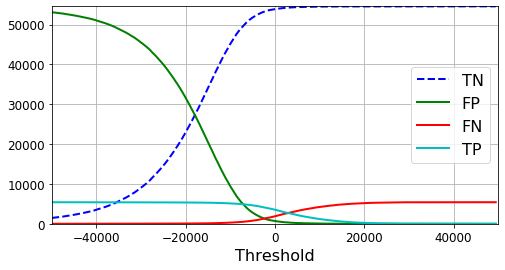

In [129]:
def plot_confusions(tns, fps, fns, tps, thresholds):
    plt.plot(thresholds, tns, "b--", label="TN", linewidth=2)
    plt.plot(thresholds, fps, "g-", label="FP", linewidth=2)
    plt.plot(thresholds, fns, "r-", label="FN", linewidth=2)
    plt.plot(thresholds, tps, "c-", label="TP", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 54579])             # Not shown



plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_confusions(df_confs.tn, df_confs.fp, df_confs.fn, df_confs.tp, thresholds)
plt.show()

아래 두가지를 관찰할 수 있는데 각각 무슨 의미일까?
- 위 그림을 보면 TN과 FP가 FN과 TP에 비해 매우크다. $\rightarrow$ 0라벨 샘플이 1라벨 샘플에 비해 매우 많다는 것이다.
- TN과 FP가 교차하는 지점과 FN과 TP가 교차하는 지점이 꽤 떨어져 있다.  $\rightarrow$ TN이 높고 FP가 낮을 수록 좋은 threshold값이라고 할 수 있다. 그리고 TN이 충분히 높고, FP가 충분히 낮음에도 여전히 TP가 높고, FN이 낮다면 더더욱 좋을 것이다. 그런데 그런데 threshold가 커질수록 TP는 줄어들고 FN은 늘어나므로 두 교차점 사이의 거리가 멀거나, TN이 높고 FP는 낮으면서도 TP가 높고 FN이 낮은 구간이 길다면 넓은 threshold 구간에서 좋은 성능을 내는 모델이라 할 수 있다.

###### Precision vs Recall plot

Saving figure precision_vs_recall_plot


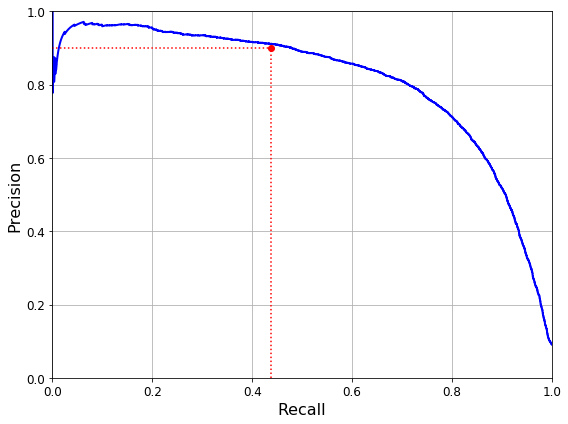

In [43]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [44]:
precisions >= 0.90

array([False, False, False, ...,  True,  True,  True])

In [45]:
# np.argmax는 인자로 주어진 시퀀스에서 값이 가장 클때의 index 값을 반환
# np.argmax(precisions >= 0.90) 이건 precision이 0.9보다 큰 가장 우측 index
# 위 그림에서 빨간 점에 해당하는 threshold를 찾는 것이다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
threshold_90_precision

3370.0194991439557

In [47]:
# 위에서 구한 threshold를 기준으로한 예측값을 찾는다.
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
# 다시 precision을 계산한다.(다시 확인 하는 것..)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


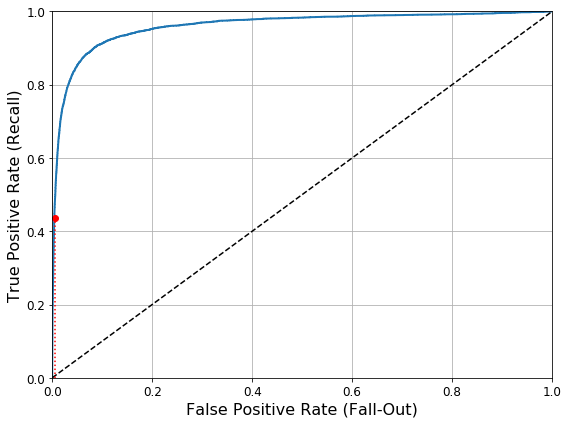

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

###### 이번에는 cross_val_predict의 method인자로 "predict_proba"를 사용하고 있다. 이건 뭘까?
> 각 라벨에 대한 확률 값을 반환하게 된다. 반환값의 컬럼은 각 라벨에 대응되는데, 그 순서는 정렬?순서라고 한다. 어떤 정렬순서라는건가 도대체

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [53]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [54]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [55]:
y_probas_forest  # 여기서는 각 컬럼이 False, True에 대응하나보다.

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [56]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


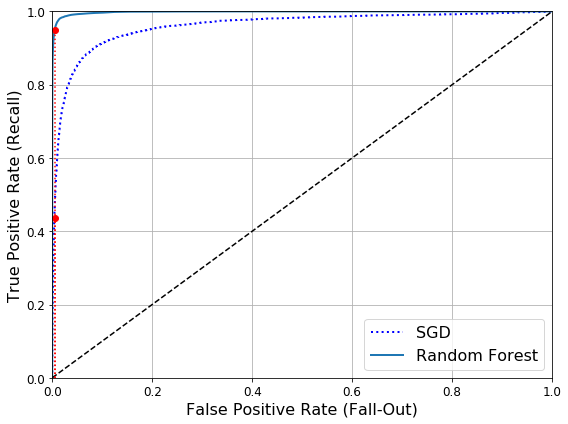

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [66]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [63]:
y_train_pred_forest

array([ True, False, False, ...,  True, False, False])

In [60]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

###### CatBoost는 어떤지 한번 해 보자.

In [69]:
from catboost import CatBoostClassifier

In [78]:
cb_model = CatBoostClassifier()
# iterations=2, learning_rate=1, depth=30

In [79]:
y_probas_cb = cross_val_predict(cb_model, X_train, y_train_5, cv=3, 
                                    method="predict_proba")

Learning rate set to 0.049775
0:	learn: 0.6165393	total: 71.6ms	remaining: 1m 11s
1:	learn: 0.5464562	total: 131ms	remaining: 1m 5s
2:	learn: 0.4878538	total: 186ms	remaining: 1m 1s
3:	learn: 0.4301804	total: 244ms	remaining: 1m
4:	learn: 0.3893511	total: 310ms	remaining: 1m 1s
5:	learn: 0.3560291	total: 376ms	remaining: 1m 2s
6:	learn: 0.3217106	total: 437ms	remaining: 1m 1s
7:	learn: 0.2935139	total: 495ms	remaining: 1m 1s
8:	learn: 0.2725792	total: 561ms	remaining: 1m 1s
9:	learn: 0.2533174	total: 620ms	remaining: 1m 1s
10:	learn: 0.2366790	total: 676ms	remaining: 1m
11:	learn: 0.2190149	total: 748ms	remaining: 1m 1s
12:	learn: 0.2018353	total: 809ms	remaining: 1m 1s
13:	learn: 0.1903298	total: 874ms	remaining: 1m 1s
14:	learn: 0.1796790	total: 936ms	remaining: 1m 1s
15:	learn: 0.1715714	total: 1s	remaining: 1m 1s
16:	learn: 0.1650380	total: 1.06s	remaining: 1m 1s
17:	learn: 0.1564138	total: 1.12s	remaining: 1m 1s
18:	learn: 0.1501253	total: 1.19s	remaining: 1m 1s
19:	learn: 0.14329

165:	learn: 0.0310571	total: 11.2s	remaining: 56.3s
166:	learn: 0.0308001	total: 11.3s	remaining: 56.3s
167:	learn: 0.0306927	total: 11.4s	remaining: 56.3s
168:	learn: 0.0305252	total: 11.4s	remaining: 56.3s
169:	learn: 0.0304888	total: 11.5s	remaining: 56.2s
170:	learn: 0.0304781	total: 11.6s	remaining: 56.1s
171:	learn: 0.0303968	total: 11.7s	remaining: 56.1s
172:	learn: 0.0303883	total: 11.7s	remaining: 56s
173:	learn: 0.0301585	total: 11.8s	remaining: 56s
174:	learn: 0.0300479	total: 11.9s	remaining: 55.9s
175:	learn: 0.0298946	total: 11.9s	remaining: 55.8s
176:	learn: 0.0298771	total: 12s	remaining: 55.7s
177:	learn: 0.0298702	total: 12s	remaining: 55.6s
178:	learn: 0.0296730	total: 12.1s	remaining: 55.6s
179:	learn: 0.0293554	total: 12.2s	remaining: 55.6s
180:	learn: 0.0292581	total: 12.3s	remaining: 55.6s
181:	learn: 0.0291843	total: 12.4s	remaining: 55.5s
182:	learn: 0.0291578	total: 12.4s	remaining: 55.5s
183:	learn: 0.0290370	total: 12.5s	remaining: 55.5s
184:	learn: 0.029020

324:	learn: 0.0205671	total: 22.3s	remaining: 46.3s
325:	learn: 0.0205100	total: 22.4s	remaining: 46.2s
326:	learn: 0.0204261	total: 22.4s	remaining: 46.2s
327:	learn: 0.0204231	total: 22.5s	remaining: 46.1s
328:	learn: 0.0202949	total: 22.6s	remaining: 46.1s
329:	learn: 0.0202691	total: 22.7s	remaining: 46s
330:	learn: 0.0201316	total: 22.8s	remaining: 46s
331:	learn: 0.0201169	total: 22.8s	remaining: 45.9s
332:	learn: 0.0199524	total: 22.9s	remaining: 45.9s
333:	learn: 0.0199368	total: 23s	remaining: 45.8s
334:	learn: 0.0198933	total: 23s	remaining: 45.7s
335:	learn: 0.0198582	total: 23.1s	remaining: 45.7s
336:	learn: 0.0198026	total: 23.2s	remaining: 45.6s
337:	learn: 0.0197224	total: 23.3s	remaining: 45.5s
338:	learn: 0.0195944	total: 23.3s	remaining: 45.5s
339:	learn: 0.0195645	total: 23.4s	remaining: 45.5s
340:	learn: 0.0195634	total: 23.5s	remaining: 45.4s
341:	learn: 0.0195353	total: 23.6s	remaining: 45.3s
342:	learn: 0.0194308	total: 23.7s	remaining: 45.3s
343:	learn: 0.019287

484:	learn: 0.0146048	total: 34.7s	remaining: 36.9s
485:	learn: 0.0145925	total: 34.8s	remaining: 36.8s
486:	learn: 0.0145896	total: 34.9s	remaining: 36.7s
487:	learn: 0.0145672	total: 34.9s	remaining: 36.7s
488:	learn: 0.0145665	total: 35s	remaining: 36.6s
489:	learn: 0.0145429	total: 35.1s	remaining: 36.5s
490:	learn: 0.0145328	total: 35.2s	remaining: 36.4s
491:	learn: 0.0145202	total: 35.2s	remaining: 36.4s
492:	learn: 0.0145026	total: 35.3s	remaining: 36.3s
493:	learn: 0.0144821	total: 35.4s	remaining: 36.2s
494:	learn: 0.0144323	total: 35.5s	remaining: 36.2s
495:	learn: 0.0143996	total: 35.5s	remaining: 36.1s
496:	learn: 0.0143464	total: 35.6s	remaining: 36s
497:	learn: 0.0143295	total: 35.7s	remaining: 36s
498:	learn: 0.0143085	total: 35.7s	remaining: 35.9s
499:	learn: 0.0142230	total: 35.8s	remaining: 35.8s
500:	learn: 0.0142177	total: 35.9s	remaining: 35.7s
501:	learn: 0.0141858	total: 36s	remaining: 35.7s
502:	learn: 0.0141834	total: 36s	remaining: 35.6s
503:	learn: 0.0141587	

645:	learn: 0.0108984	total: 46.7s	remaining: 25.6s
646:	learn: 0.0108957	total: 46.8s	remaining: 25.5s
647:	learn: 0.0108760	total: 46.9s	remaining: 25.5s
648:	learn: 0.0108614	total: 47s	remaining: 25.4s
649:	learn: 0.0108609	total: 47s	remaining: 25.3s
650:	learn: 0.0108239	total: 47.1s	remaining: 25.3s
651:	learn: 0.0107770	total: 47.2s	remaining: 25.2s
652:	learn: 0.0107770	total: 47.3s	remaining: 25.1s
653:	learn: 0.0107726	total: 47.3s	remaining: 25s
654:	learn: 0.0107642	total: 47.4s	remaining: 25s
655:	learn: 0.0107534	total: 47.5s	remaining: 24.9s
656:	learn: 0.0107417	total: 47.6s	remaining: 24.8s
657:	learn: 0.0107359	total: 47.6s	remaining: 24.8s
658:	learn: 0.0107241	total: 47.7s	remaining: 24.7s
659:	learn: 0.0107057	total: 47.8s	remaining: 24.6s
660:	learn: 0.0106761	total: 47.8s	remaining: 24.5s
661:	learn: 0.0106728	total: 47.9s	remaining: 24.5s
662:	learn: 0.0106689	total: 48s	remaining: 24.4s
663:	learn: 0.0106639	total: 48.1s	remaining: 24.3s
664:	learn: 0.0106126	

807:	learn: 0.0087000	total: 58.9s	remaining: 14s
808:	learn: 0.0086950	total: 59s	remaining: 13.9s
809:	learn: 0.0086933	total: 59.1s	remaining: 13.9s
810:	learn: 0.0086686	total: 59.2s	remaining: 13.8s
811:	learn: 0.0086685	total: 59.2s	remaining: 13.7s
812:	learn: 0.0086462	total: 59.3s	remaining: 13.6s
813:	learn: 0.0086460	total: 59.4s	remaining: 13.6s
814:	learn: 0.0086249	total: 59.4s	remaining: 13.5s
815:	learn: 0.0086216	total: 59.5s	remaining: 13.4s
816:	learn: 0.0086061	total: 59.6s	remaining: 13.3s
817:	learn: 0.0085935	total: 59.7s	remaining: 13.3s
818:	learn: 0.0085935	total: 59.7s	remaining: 13.2s
819:	learn: 0.0085855	total: 59.8s	remaining: 13.1s
820:	learn: 0.0085624	total: 59.9s	remaining: 13.1s
821:	learn: 0.0085300	total: 59.9s	remaining: 13s
822:	learn: 0.0085259	total: 1m	remaining: 12.9s
823:	learn: 0.0085257	total: 1m	remaining: 12.8s
824:	learn: 0.0085196	total: 1m	remaining: 12.8s
825:	learn: 0.0085046	total: 1m	remaining: 12.7s
826:	learn: 0.0084850	total: 1

967:	learn: 0.0069846	total: 1m 11s	remaining: 2.38s
968:	learn: 0.0069662	total: 1m 12s	remaining: 2.3s
969:	learn: 0.0069256	total: 1m 12s	remaining: 2.23s
970:	learn: 0.0069256	total: 1m 12s	remaining: 2.15s
971:	learn: 0.0069254	total: 1m 12s	remaining: 2.08s
972:	learn: 0.0069002	total: 1m 12s	remaining: 2.01s
973:	learn: 0.0069002	total: 1m 12s	remaining: 1.93s
974:	learn: 0.0069002	total: 1m 12s	remaining: 1.86s
975:	learn: 0.0068909	total: 1m 12s	remaining: 1.78s
976:	learn: 0.0068608	total: 1m 12s	remaining: 1.71s
977:	learn: 0.0068608	total: 1m 12s	remaining: 1.64s
978:	learn: 0.0068529	total: 1m 12s	remaining: 1.56s
979:	learn: 0.0068527	total: 1m 12s	remaining: 1.49s
980:	learn: 0.0068486	total: 1m 13s	remaining: 1.41s
981:	learn: 0.0068485	total: 1m 13s	remaining: 1.34s
982:	learn: 0.0068483	total: 1m 13s	remaining: 1.26s
983:	learn: 0.0068478	total: 1m 13s	remaining: 1.19s
984:	learn: 0.0068477	total: 1m 13s	remaining: 1.12s
985:	learn: 0.0068369	total: 1m 13s	remaining: 

126:	learn: 0.0342502	total: 9.98s	remaining: 1m 8s
127:	learn: 0.0340065	total: 10.1s	remaining: 1m 8s
128:	learn: 0.0339517	total: 10.1s	remaining: 1m 8s
129:	learn: 0.0336962	total: 10.2s	remaining: 1m 8s
130:	learn: 0.0335674	total: 10.3s	remaining: 1m 8s
131:	learn: 0.0335375	total: 10.4s	remaining: 1m 8s
132:	learn: 0.0335232	total: 10.5s	remaining: 1m 8s
133:	learn: 0.0334327	total: 10.6s	remaining: 1m 8s
134:	learn: 0.0334137	total: 10.6s	remaining: 1m 8s
135:	learn: 0.0332777	total: 10.7s	remaining: 1m 8s
136:	learn: 0.0331135	total: 10.8s	remaining: 1m 7s
137:	learn: 0.0327863	total: 10.9s	remaining: 1m 7s
138:	learn: 0.0327726	total: 10.9s	remaining: 1m 7s
139:	learn: 0.0325696	total: 11s	remaining: 1m 7s
140:	learn: 0.0324429	total: 11.1s	remaining: 1m 7s
141:	learn: 0.0322752	total: 11.2s	remaining: 1m 7s
142:	learn: 0.0319854	total: 11.3s	remaining: 1m 7s
143:	learn: 0.0318593	total: 11.4s	remaining: 1m 7s
144:	learn: 0.0317398	total: 11.4s	remaining: 1m 7s
145:	learn: 0.

286:	learn: 0.0214926	total: 22.4s	remaining: 55.6s
287:	learn: 0.0214904	total: 22.4s	remaining: 55.5s
288:	learn: 0.0214400	total: 22.5s	remaining: 55.4s
289:	learn: 0.0214261	total: 22.6s	remaining: 55.3s
290:	learn: 0.0212364	total: 22.7s	remaining: 55.2s
291:	learn: 0.0211949	total: 22.7s	remaining: 55.1s
292:	learn: 0.0210130	total: 22.8s	remaining: 55.1s
293:	learn: 0.0210018	total: 22.9s	remaining: 55s
294:	learn: 0.0209982	total: 22.9s	remaining: 54.8s
295:	learn: 0.0209960	total: 23s	remaining: 54.7s
296:	learn: 0.0209889	total: 23.1s	remaining: 54.6s
297:	learn: 0.0208709	total: 23.1s	remaining: 54.5s
298:	learn: 0.0208662	total: 23.2s	remaining: 54.4s
299:	learn: 0.0207256	total: 23.3s	remaining: 54.3s
300:	learn: 0.0205896	total: 23.4s	remaining: 54.3s
301:	learn: 0.0205433	total: 23.4s	remaining: 54.2s
302:	learn: 0.0205343	total: 23.5s	remaining: 54.1s
303:	learn: 0.0205326	total: 23.6s	remaining: 54s
304:	learn: 0.0205251	total: 23.7s	remaining: 53.9s
305:	learn: 0.0204

446:	learn: 0.0146370	total: 34.8s	remaining: 43s
447:	learn: 0.0146344	total: 34.8s	remaining: 42.9s
448:	learn: 0.0145959	total: 34.9s	remaining: 42.9s
449:	learn: 0.0145852	total: 35s	remaining: 42.8s
450:	learn: 0.0145389	total: 35.1s	remaining: 42.8s
451:	learn: 0.0144882	total: 35.2s	remaining: 42.7s
452:	learn: 0.0144342	total: 35.3s	remaining: 42.6s
453:	learn: 0.0143676	total: 35.4s	remaining: 42.6s
454:	learn: 0.0143424	total: 35.5s	remaining: 42.5s
455:	learn: 0.0142755	total: 35.6s	remaining: 42.5s
456:	learn: 0.0142751	total: 35.7s	remaining: 42.4s
457:	learn: 0.0142451	total: 35.8s	remaining: 42.3s
458:	learn: 0.0142199	total: 35.9s	remaining: 42.3s
459:	learn: 0.0142101	total: 36s	remaining: 42.2s
460:	learn: 0.0141629	total: 36.1s	remaining: 42.2s
461:	learn: 0.0140980	total: 36.2s	remaining: 42.1s
462:	learn: 0.0140971	total: 36.3s	remaining: 42.1s
463:	learn: 0.0140959	total: 36.4s	remaining: 42s
464:	learn: 0.0140496	total: 36.5s	remaining: 41.9s
465:	learn: 0.014024

605:	learn: 0.0106721	total: 48.7s	remaining: 31.7s
606:	learn: 0.0106681	total: 48.8s	remaining: 31.6s
607:	learn: 0.0106593	total: 48.9s	remaining: 31.5s
608:	learn: 0.0106593	total: 48.9s	remaining: 31.4s
609:	learn: 0.0106525	total: 49s	remaining: 31.4s
610:	learn: 0.0106366	total: 49.1s	remaining: 31.3s
611:	learn: 0.0106313	total: 49.2s	remaining: 31.2s
612:	learn: 0.0106121	total: 49.3s	remaining: 31.1s
613:	learn: 0.0106120	total: 49.4s	remaining: 31s
614:	learn: 0.0106068	total: 49.5s	remaining: 31s
615:	learn: 0.0105709	total: 49.6s	remaining: 30.9s
616:	learn: 0.0105701	total: 49.7s	remaining: 30.8s
617:	learn: 0.0105606	total: 49.8s	remaining: 30.8s
618:	learn: 0.0105602	total: 49.8s	remaining: 30.7s
619:	learn: 0.0105324	total: 49.9s	remaining: 30.6s
620:	learn: 0.0105323	total: 50s	remaining: 30.5s
621:	learn: 0.0105321	total: 50.1s	remaining: 30.4s
622:	learn: 0.0104908	total: 50.2s	remaining: 30.4s
623:	learn: 0.0104895	total: 50.3s	remaining: 30.3s
624:	learn: 0.010461

765:	learn: 0.0084668	total: 1m 2s	remaining: 19.2s
766:	learn: 0.0084344	total: 1m 2s	remaining: 19.1s
767:	learn: 0.0084165	total: 1m 2s	remaining: 19s
768:	learn: 0.0084025	total: 1m 2s	remaining: 18.9s
769:	learn: 0.0084024	total: 1m 3s	remaining: 18.8s
770:	learn: 0.0083954	total: 1m 3s	remaining: 18.7s
771:	learn: 0.0083868	total: 1m 3s	remaining: 18.7s
772:	learn: 0.0083865	total: 1m 3s	remaining: 18.6s
773:	learn: 0.0083864	total: 1m 3s	remaining: 18.5s
774:	learn: 0.0083518	total: 1m 3s	remaining: 18.4s
775:	learn: 0.0083239	total: 1m 3s	remaining: 18.3s
776:	learn: 0.0083239	total: 1m 3s	remaining: 18.2s
777:	learn: 0.0083141	total: 1m 3s	remaining: 18.1s
778:	learn: 0.0083069	total: 1m 3s	remaining: 18.1s
779:	learn: 0.0083000	total: 1m 3s	remaining: 18s
780:	learn: 0.0082987	total: 1m 3s	remaining: 17.9s
781:	learn: 0.0082842	total: 1m 3s	remaining: 17.8s
782:	learn: 0.0082695	total: 1m 4s	remaining: 17.7s
783:	learn: 0.0082444	total: 1m 4s	remaining: 17.7s
784:	learn: 0.00

924:	learn: 0.0069923	total: 1m 16s	remaining: 6.19s
925:	learn: 0.0069792	total: 1m 16s	remaining: 6.11s
926:	learn: 0.0069792	total: 1m 16s	remaining: 6.03s
927:	learn: 0.0069575	total: 1m 16s	remaining: 5.95s
928:	learn: 0.0069545	total: 1m 16s	remaining: 5.86s
929:	learn: 0.0069544	total: 1m 16s	remaining: 5.78s
930:	learn: 0.0069543	total: 1m 16s	remaining: 5.7s
931:	learn: 0.0069543	total: 1m 16s	remaining: 5.62s
932:	learn: 0.0069533	total: 1m 17s	remaining: 5.53s
933:	learn: 0.0069533	total: 1m 17s	remaining: 5.45s
934:	learn: 0.0069531	total: 1m 17s	remaining: 5.37s
935:	learn: 0.0069531	total: 1m 17s	remaining: 5.29s
936:	learn: 0.0069326	total: 1m 17s	remaining: 5.21s
937:	learn: 0.0069326	total: 1m 17s	remaining: 5.12s
938:	learn: 0.0069278	total: 1m 17s	remaining: 5.04s
939:	learn: 0.0069113	total: 1m 17s	remaining: 4.96s
940:	learn: 0.0069105	total: 1m 17s	remaining: 4.88s
941:	learn: 0.0068935	total: 1m 17s	remaining: 4.79s
942:	learn: 0.0068793	total: 1m 18s	remaining: 

82:	learn: 0.0447833	total: 8.27s	remaining: 1m 31s
83:	learn: 0.0443630	total: 8.39s	remaining: 1m 31s
84:	learn: 0.0439678	total: 8.46s	remaining: 1m 31s
85:	learn: 0.0435932	total: 8.52s	remaining: 1m 30s
86:	learn: 0.0431201	total: 8.59s	remaining: 1m 30s
87:	learn: 0.0429284	total: 8.65s	remaining: 1m 29s
88:	learn: 0.0423997	total: 8.72s	remaining: 1m 29s
89:	learn: 0.0417723	total: 8.78s	remaining: 1m 28s
90:	learn: 0.0414815	total: 8.84s	remaining: 1m 28s
91:	learn: 0.0409789	total: 8.91s	remaining: 1m 27s
92:	learn: 0.0407347	total: 8.97s	remaining: 1m 27s
93:	learn: 0.0404156	total: 9.04s	remaining: 1m 27s
94:	learn: 0.0401827	total: 9.1s	remaining: 1m 26s
95:	learn: 0.0397712	total: 9.16s	remaining: 1m 26s
96:	learn: 0.0394452	total: 9.22s	remaining: 1m 25s
97:	learn: 0.0393583	total: 9.3s	remaining: 1m 25s
98:	learn: 0.0391186	total: 9.39s	remaining: 1m 25s
99:	learn: 0.0387784	total: 9.49s	remaining: 1m 25s
100:	learn: 0.0384622	total: 9.58s	remaining: 1m 25s
101:	learn: 0

240:	learn: 0.0215201	total: 21.8s	remaining: 1m 8s
241:	learn: 0.0214193	total: 21.9s	remaining: 1m 8s
242:	learn: 0.0213791	total: 22s	remaining: 1m 8s
243:	learn: 0.0212409	total: 22.1s	remaining: 1m 8s
244:	learn: 0.0211713	total: 22.2s	remaining: 1m 8s
245:	learn: 0.0209566	total: 22.3s	remaining: 1m 8s
246:	learn: 0.0208690	total: 22.4s	remaining: 1m 8s
247:	learn: 0.0207022	total: 22.5s	remaining: 1m 8s
248:	learn: 0.0206262	total: 22.6s	remaining: 1m 8s
249:	learn: 0.0205977	total: 22.7s	remaining: 1m 8s
250:	learn: 0.0204844	total: 22.8s	remaining: 1m 7s
251:	learn: 0.0203784	total: 22.9s	remaining: 1m 7s
252:	learn: 0.0202967	total: 22.9s	remaining: 1m 7s
253:	learn: 0.0202949	total: 23s	remaining: 1m 7s
254:	learn: 0.0202734	total: 23.1s	remaining: 1m 7s
255:	learn: 0.0202724	total: 23.1s	remaining: 1m 7s
256:	learn: 0.0202692	total: 23.1s	remaining: 1m 6s
257:	learn: 0.0202571	total: 23.2s	remaining: 1m 6s
258:	learn: 0.0200725	total: 23.3s	remaining: 1m 6s
259:	learn: 0.02

399:	learn: 0.0142485	total: 34.3s	remaining: 51.5s
400:	learn: 0.0141837	total: 34.4s	remaining: 51.4s
401:	learn: 0.0141799	total: 34.5s	remaining: 51.3s
402:	learn: 0.0141528	total: 34.6s	remaining: 51.3s
403:	learn: 0.0141357	total: 34.7s	remaining: 51.2s
404:	learn: 0.0141354	total: 34.8s	remaining: 51.1s
405:	learn: 0.0141175	total: 34.8s	remaining: 51s
406:	learn: 0.0141125	total: 34.9s	remaining: 50.9s
407:	learn: 0.0140753	total: 35s	remaining: 50.8s
408:	learn: 0.0140677	total: 35.1s	remaining: 50.7s
409:	learn: 0.0140601	total: 35.2s	remaining: 50.6s
410:	learn: 0.0140195	total: 35.3s	remaining: 50.5s
411:	learn: 0.0140191	total: 35.4s	remaining: 50.5s
412:	learn: 0.0139897	total: 35.4s	remaining: 50.4s
413:	learn: 0.0139790	total: 35.5s	remaining: 50.3s
414:	learn: 0.0139579	total: 35.6s	remaining: 50.2s
415:	learn: 0.0139305	total: 35.7s	remaining: 50.1s
416:	learn: 0.0138533	total: 35.8s	remaining: 50.1s
417:	learn: 0.0137589	total: 35.9s	remaining: 50s
418:	learn: 0.0137

558:	learn: 0.0104097	total: 47.1s	remaining: 37.1s
559:	learn: 0.0104057	total: 47.2s	remaining: 37s
560:	learn: 0.0103878	total: 47.3s	remaining: 37s
561:	learn: 0.0103550	total: 47.3s	remaining: 36.9s
562:	learn: 0.0103504	total: 47.4s	remaining: 36.8s
563:	learn: 0.0103110	total: 47.5s	remaining: 36.7s
564:	learn: 0.0102973	total: 47.6s	remaining: 36.7s
565:	learn: 0.0102885	total: 47.7s	remaining: 36.6s
566:	learn: 0.0102778	total: 47.8s	remaining: 36.5s
567:	learn: 0.0102778	total: 47.9s	remaining: 36.4s
568:	learn: 0.0102626	total: 47.9s	remaining: 36.3s
569:	learn: 0.0102304	total: 48s	remaining: 36.2s
570:	learn: 0.0102304	total: 48.1s	remaining: 36.1s
571:	learn: 0.0102301	total: 48.2s	remaining: 36.1s
572:	learn: 0.0102301	total: 48.3s	remaining: 36s
573:	learn: 0.0101969	total: 48.3s	remaining: 35.9s
574:	learn: 0.0101856	total: 48.4s	remaining: 35.8s
575:	learn: 0.0101856	total: 48.5s	remaining: 35.7s
576:	learn: 0.0101626	total: 48.6s	remaining: 35.6s
577:	learn: 0.010160

719:	learn: 0.0086260	total: 59.4s	remaining: 23.1s
720:	learn: 0.0086239	total: 59.5s	remaining: 23s
721:	learn: 0.0086237	total: 59.6s	remaining: 22.9s
722:	learn: 0.0086205	total: 59.6s	remaining: 22.8s
723:	learn: 0.0086204	total: 59.7s	remaining: 22.7s
724:	learn: 0.0086173	total: 59.7s	remaining: 22.6s
725:	learn: 0.0086173	total: 59.8s	remaining: 22.6s
726:	learn: 0.0086172	total: 59.8s	remaining: 22.5s
727:	learn: 0.0086170	total: 59.9s	remaining: 22.4s
728:	learn: 0.0086138	total: 59.9s	remaining: 22.3s
729:	learn: 0.0086093	total: 60s	remaining: 22.2s
730:	learn: 0.0085917	total: 1m	remaining: 22.1s
731:	learn: 0.0085916	total: 1m	remaining: 22s
732:	learn: 0.0085738	total: 1m	remaining: 21.9s
733:	learn: 0.0085560	total: 1m	remaining: 21.8s
734:	learn: 0.0085252	total: 1m	remaining: 21.7s
735:	learn: 0.0085251	total: 1m	remaining: 21.6s
736:	learn: 0.0085152	total: 1m	remaining: 21.5s
737:	learn: 0.0085055	total: 1m	remaining: 21.4s
738:	learn: 0.0085054	total: 1m	remaining:

878:	learn: 0.0070620	total: 1m 11s	remaining: 9.82s
879:	learn: 0.0070473	total: 1m 11s	remaining: 9.74s
880:	learn: 0.0070473	total: 1m 11s	remaining: 9.66s
881:	learn: 0.0070473	total: 1m 11s	remaining: 9.57s
882:	learn: 0.0070469	total: 1m 11s	remaining: 9.49s
883:	learn: 0.0070285	total: 1m 11s	remaining: 9.41s
884:	learn: 0.0070112	total: 1m 11s	remaining: 9.33s
885:	learn: 0.0070112	total: 1m 11s	remaining: 9.25s
886:	learn: 0.0070002	total: 1m 12s	remaining: 9.17s
887:	learn: 0.0070002	total: 1m 12s	remaining: 9.09s
888:	learn: 0.0069795	total: 1m 12s	remaining: 9.01s
889:	learn: 0.0069795	total: 1m 12s	remaining: 8.93s
890:	learn: 0.0069493	total: 1m 12s	remaining: 8.85s
891:	learn: 0.0069035	total: 1m 12s	remaining: 8.77s
892:	learn: 0.0068862	total: 1m 12s	remaining: 8.69s
893:	learn: 0.0068464	total: 1m 12s	remaining: 8.61s
894:	learn: 0.0068464	total: 1m 12s	remaining: 8.53s
895:	learn: 0.0068424	total: 1m 12s	remaining: 8.45s
896:	learn: 0.0068260	total: 1m 12s	remaining:

In [80]:
y_scores_cb = y_probas_cb[:, 1] # score = proba of positive class
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_train_5, y_scores_cb)

Saving figure roc_curve_comparison_plot


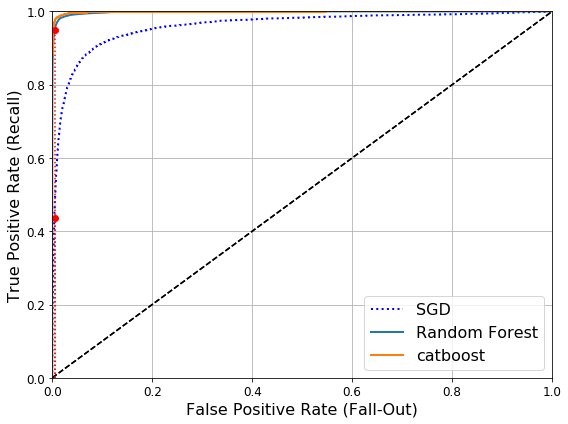

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_cb, tpr_cb, "catboost")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [83]:
roc_auc_score(y_train_5, y_scores_cb)

# sgd: 0.9604938554008616
# random forest: 0.9983436731328145
# 위 점수보다 조금 나은 점수이다.

0.9988110024012044

# Multiclass classification

SVC(Support Vector Classifier)는 '다범주 분류 문제'를 내부적으로 OvO(one-versus-one)로 바꿔서 풀어낸다. 즉 N개의 클래스가 있는 문제라면 2개 클래스에 대한 ${N\choose 2}$개의 모델을 만들고, 가장 높은 점수를 얻은 클래스로 예측한다. OvO의 각 2진 분류 모델은 전체 데이터가 아닌 일부 데이터만으로 학습하므로, SVM처럼 데이터량이 많아지면 문제가 생기는 모델을 사용할때 이 방식(OvO)이 좋은 경우도 있다.

In [131]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

아래 decision_function은 10개 범주에 대한 점수를 나타내며, 예측할때는 이들 중 점수가 가장 높은 범주가 선택된다.

In [132]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [133]:
np.argmax(some_digit_scores)

5

classes_ 값은 값으로 정렬된 범주들의 인덱스를 의미한다.(값이 아니다.)

In [134]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [135]:
svm_clf.classes_[5]

5

###### OneVsRestClassifier이건 뭘까? 

앞서 SVC는 OvO 방식으로 모델을 학습시켰다.    
OneVsRestClassifier를 이용하면 SVC가 OvR(one-versus-rest) 방식으로 동작하도록 강제할수도 있다.

In [61]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [59]:
len(ovr_clf.estimators_)

10

In [60]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
sgd_clf.decision_function([some_digit])

array([[-15955.22627845, -38080.96296175, -13326.66694897,
           573.52692379, -17680.6846644 ,   2412.53175101,
        -25526.86498156, -12290.15704709,  -7946.05205023,
        -10631.35888549]])

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8489802 , 0.87129356, 0.86988048])

###### 단순히 스케일링만 해 줬는데 성능이 좋아진다.

In [137]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

# 3.5 Error Analysis 

In [136]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

NameError: name 'X_train_scaled' is not defined

In [65]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


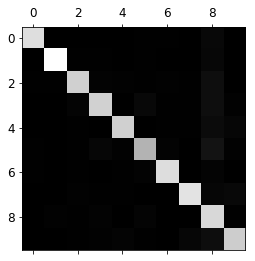

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


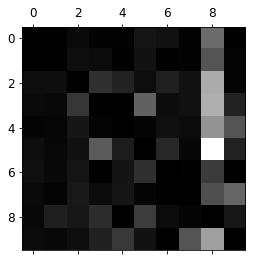

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


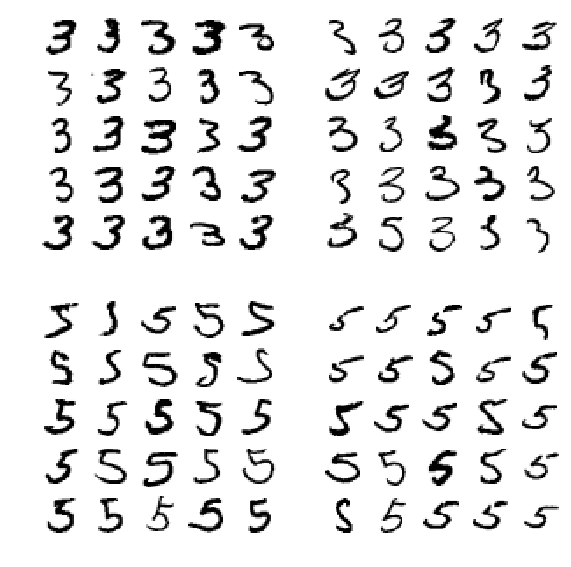

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput classification

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


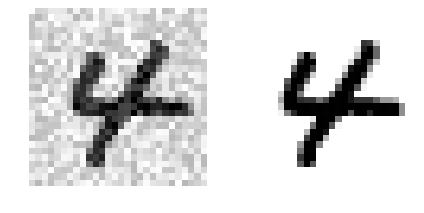

In [74]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


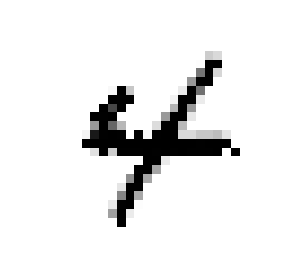

In [75]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Extra material

## Dummy (ie. random) classifier

In [76]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

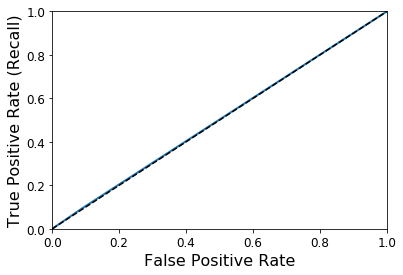

In [77]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [79]:
y_knn_pred = knn_clf.predict(X_test)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

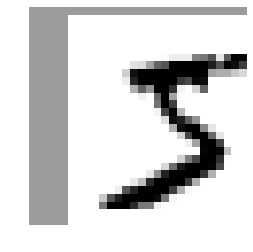

In [81]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [82]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [83]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [84]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [85]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [86]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

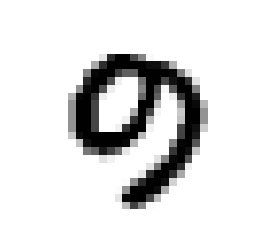

In [87]:
plot_digit(ambiguous_digit)

# Exercise solutions

## 1. An MNIST Classifier With Over 97% Accuracy

**Warning**: the next cell may take hours to run, depending on your hardware.

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=3, weights=uniform, score=0.9717617659308622, total=10.9min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 52.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.9706715547408765, total=10.7min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 103.2min remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.9689166666666666, total=10.1min
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.968575477202634, total=11.0min
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.9704068022674225, total=11.0min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9723448563098709, total=10.9min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9716713881019831, total=11.2min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9700833333333333, total= 9.9min
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.9700758522964075, total=10.0min
[CV] n_neighbors=3, weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 1523.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [89]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [90]:
grid_search.best_score_

0.9716166666666667

In [91]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. Data Augmentation

In [92]:
from scipy.ndimage.interpolation import shift

In [93]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

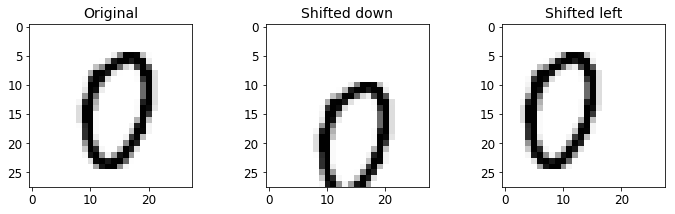

In [94]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [95]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [96]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [97]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [98]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [99]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got a 0.5% accuracy boost. :)

## 3. Tackle the Titanic dataset

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

First, login to [Kaggle](https://www.kaggle.com/) and go to the [Titanic challenge](https://www.kaggle.com/c/titanic) to download `train.csv` and `test.csv`. Save them to the `datasets/titanic` directory.

Next, let's load the data:

In [100]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [101]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [102]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

The data is already split into a training set and a test set. However, the test data does *not* contain the labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score.

Let's take a peek at the top few rows of the training set:

In [103]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's get more info to see how much data is missing:

In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [105]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Yikes, only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [106]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [107]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [108]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [109]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

**Note**: the code below uses a mix of `Pipeline`, `FeatureUnion` and a custom `DataFrameSelector` to preprocess some columns differently.  Since Scikit-Learn 0.20, it is preferable to use a `ColumnTransformer`, like in the previous chapter.

Now let's build our preprocessing pipelines. We will reuse the `DataframeSelector` we built in the previous chapter to select specific attributes from the `DataFrame`:

In [110]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Let's build the pipeline for the numerical attributes:

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [112]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

We will also need an imputer for the string categorical columns (the regular `SimpleImputer` does not work on those):

In [113]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [114]:
from sklearn.preprocessing import OneHotEncoder

Now we can build the pipeline for the categorical attributes:

In [115]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [116]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Finally, let's join the numerical and categorical pipelines:

In [117]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

Cool! Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [118]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

Let's not forget to get the labels:

In [119]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with an `SVC`:

In [120]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Great, our model is trained, let's use it to make predictions on the test set:

In [121]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

And now we could just build a CSV file with these predictions (respecting the format excepted by Kaggle), then upload it and hope for the best. But wait! We can do better than hope. Why don't we use cross-validation to have an idea of how good our model is?

In [122]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Okay, over 73% accuracy, clearly better than random chance, but it's not a great score. Looking at the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard) for the Titanic competition on Kaggle, you can see that you need to reach above 80% accuracy to be within the top 10% Kagglers. Some reached 100%, but since you can easily find the [list of victims](https://www.encyclopedia-titanica.org/titanic-victims/) of the Titanic, it seems likely that there was little Machine Learning involved in their performance! ;-) So let's try to build a model that reaches 80% accuracy.

Let's try a `RandomForestClassifier`:

In [123]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

That's much better!

Instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores (thanks to Nevin Yilmaz for suggesting this visualization). Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

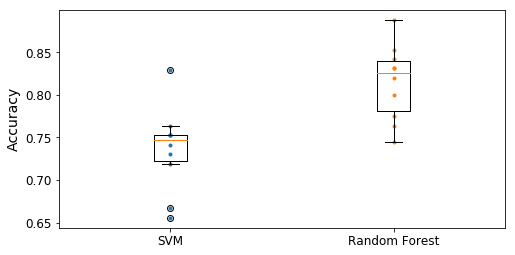

In [124]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

To improve this result further, you could:
* Compare many more models and tune hyperparameters using cross validation and grid search,
* Do more feature engineering, for example:
  * replace **SibSp** and **Parch** with their sum,
  * try to identify parts of names that correlate well with the **Survived** attribute (e.g. if the name contains "Countess", then survival seems more likely),
* try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).

In [125]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [126]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. Spam classifier

First, let's fetch the data:

In [127]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [128]:
fetch_spam_data()

Next, let's load all the emails:

In [129]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [130]:
len(ham_filenames)

2500

In [131]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [132]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [133]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [134]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [135]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [136]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [137]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [138]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [139]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP, while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [140]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [141]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [142]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [143]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [144]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

And this is the resulting plain text:

In [145]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [146]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [147]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit ([NLTK](http://www.nltk.org/)). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install nltk`

In [148]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [149]:
# if running this notebook on Colab, we just pip install urlextract
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [150]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [152]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [153]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [154]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [155]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  1,  3,  3,  1,  3,  2,  3],
       [65,  0,  1,  2,  5,  3,  1,  2,  0,  1,  0]], dtype=int64)

What does this matrix mean? Well, the 99 in the second row, first column, means that the second email contains 99 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on. You can look at the vocabulary to know which words we are talking about. The first word is "the", the second word is "of", etc.

In [156]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'url': 4,
 'to': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

In [157]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Note**: to be future-proof, we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.9925, total=   0.1s


/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


0.9874999999999999

Over 98.7%, not bad for a first try! :) However, remember that we are using the "easy" dataset. You can try with the harder datasets, the results won't be so amazing. You would have to try multiple models, select the best ones and fine-tune them using cross-validation, and so on.

But you get the picture, so let's stop now, and just print out the precision/recall we get on the test set:

In [159]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 95.88%
Recall: 97.89%


/Users/ageron/.virtualenvs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
